<a href="https://colab.research.google.com/github/RuslanFF1968/Pioneer/blob/main/NN_processing_of_texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Text classification**



**Import of libraries**




In [ ]:
from google.colab import files # Для работы с файлами
import numpy as np # Для работы с данными
import pandas as pd # Для работы с таблицами
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline

from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from google.colab import drive # Для работы с Google Drive
import time # Импортируем библиотеку time

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Classification of texts of writers

Data uploading

In [ ]:
!rm -R '/content/texts' # Проверяем наличие папки texts. Если есть, удаляем ее

rm: cannot remove '/content/texts': No such file or directory


In [ ]:
# Указываем путь к базе в Google Drive, создаем папку texts и извлекаем туда базу
!unzip -q '/content/drive/MyDrive/drive-download-20250706T192417Z-1-001.zip' -d '/content/texts'

In [ ]:
def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n", " ") # Переносы строки переводим в пробелы

  return text                    # Возвращаем текст файла

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] # Объявляем интересующие нас классы
nClasses = len(className) # Считаем количество классов

In [ ]:
#Загружаем обучающие тексты

trainText = [] #Формируем обучающие тексты
testText = [] #Формируем тестовые тексты

#Формирование необходимо произвести следующим образом
#Класс каждого i-ого эллемента в обучающей выборке должен соответствовать
#классу каждого i-ого эллемента в тестовой выборке

for i in className: #Проходим по каждому классу
  for j in os.listdir('texts/'): #Проходим по каждому файлу в папке с текстами #
    if i in j: #Проверяем, содержит ли файл j в названии имя класса i

      if 'Обучающая' in j: #Если в имени найденного класса есть строка "Обучающая"
        trainText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') #Выводим информацию
      if 'Тестовая' in j: #Если в имени найденного класса есть строка "Тестовая"
        testText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в тестовую выборку') #Выводим информацию
  print()

(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку

(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку
(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку



In [ ]:
print(len(trainText)) # Количество элементов в trainText
print(len(trainText[0])) # Количество символов в первом источнике в trainText

6
1049517


**Data processing. Converting text data into numeric and vector data for neural network training**



In [ ]:
sample_text = ['один два три четыре пять два Три три четыре четыре четыре пять пять пять пять шесть семь восемь']
maxWordsCount = 5 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - токенизируем по словам (Если будет True - каждый символ будет рассматриваться как отдельный токен )
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(sample_text) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
print(len(sample_text[0].split()))

18


In [ ]:
tokenizer.word_index

{'unknown': 1,
 'пять': 2,
 'четыре': 3,
 'три': 4,
 'два': 5,
 'один': 6,
 'шесть': 7,
 'семь': 8,
 'восемь': 9}

In [ ]:
k = tokenizer.texts_to_sequences(sample_text)
print(k)
print(len(k[0]))

[[1, 1, 4, 3, 2, 1, 4, 4, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1]]
18


In [ ]:
xTrain = []
k2 = k[0]
while len(k2) >= 3:
    xTrain.append(k2[:3])
    k2 = k2[3:]
xTrain

[[1, 1, 4], [3, 2, 1], [4, 4, 3], [3, 3, 2], [2, 2, 2], [1, 1, 1]]

In [ ]:
tokenizer.sequences_to_matrix(xTrain)

array([[0., 1., 0., 0., 1.],
       [0., 1., 1., 1., 0.],
       [0., 0., 0., 1., 1.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
cur_time = time.time() # Засекаем текущее время
maxWordsCount = 20000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - токенизируем по словам (Если будет True - каждый символ будет рассматриваться как отдельный токен )
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

Время обработки: 3.0c


In [ ]:
print(items[:120]) # Посмотрим 50 самых часто встречающихся слов
print("Размер словаря", len(items)) # Длина словаря

[('unknown', 1), ('и', 2), ('в', 3), ('не', 4), ('я', 5), ('что', 6), ('на', 7), ('с', 8), ('он', 9), ('а', 10), ('как', 11), ('то', 12), ('это', 13), ('но', 14), ('все', 15), ('у', 16), ('по', 17), ('его', 18), ('к', 19), ('так', 20), ('мне', 21), ('из', 22), ('за', 23), ('меня', 24), ('ты', 25), ('же', 26), ('бы', 27), ('сказал', 28), ('вы', 29), ('было', 30), ('от', 31), ('они', 32), ('мы', 33), ('только', 34), ('да', 35), ('еще', 36), ('она', 37), ('о', 38), ('вот', 39), ('когда', 40), ('если', 41), ('уже', 42), ('был', 43), ('нет', 44), ('ни', 45), ('их', 46), ('ну', 47), ('чтобы', 48), ('до', 49), ('для', 50), ('ему', 51), ('ничего', 52), ('может', 53), ('или', 54), ('даже', 55), ('там', 56), ('очень', 57), ('кто', 58), ('ее', 59), ('тут', 60), ('потом', 61), ('просто', 62), ('чем', 63), ('него', 64), ('быть', 65), ('теперь', 66), ('под', 67), ('где', 68), ('нас', 69), ('есть', 70), ('тебя', 71), ('ли', 72), ('время', 73), ('тебе', 74), ('вас', 75), ('со', 76), ('нибудь', 77), ('

In [ ]:
print("Интересующее слово имеет индекс: ", tokenizer.word_index[input("Уточните слово: ")]) #протестируем словарь частотности

Уточните слово: конкурс
Интересующее слово имеет индекс:  41479


In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[1][:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20], '\n')

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               Парень из преисподней     1     Ну и деревня! Сроду я таких деревень не видел и не знал
Он же в виде последовательности индексов:  [473, 22, 1, 1508, 47, 2, 12834, 7800, 5, 415, 1, 4, 251, 2, 4, 249, 55, 6, 240, 9472] 



In [ ]:
print("Статистика по обучающим текстам:")

symbolsTrainText = 0 # Объявляем переменную для подсчета символов в обучающих текстах
wordsTrainText = 0 # Объявляем переменную для подсчета слов в обучающих текстах

for i in range(nClasses): # Проходим по всем классам
  print(className[i], " "*(10-len(className[i])), len(trainText[i]), "символов, ", len(trainWordIndexes[i]), "слов")
  symbolsTrainText += len(trainText[i]) # Считаем символы
  wordsTrainText += len(trainWordIndexes[i]) # Считаем слова

print('----')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n")
print()
print("Статистика по тестовым текстам:")

symbolsTestText = 0 # Объявляем переменную для подсчета символов в тестовых текстах
wordsTestText = 0 # Объявляем переменную для подсчета слов в тестовых текстах

for i in range(nClasses): #Проходим по всем классам
  print(className[i], ' '*(10-len(className[i])), len(testText[i]), "символов, ", len(testWordIndexes[i]), "слов")
  symbolsTestText += len(testText[i]) #Считаем символы
  wordsTestText += len(testWordIndexes[i]) #Считаем слова
print('----')
print("В сумме ", symbolsTestText, " символов, ", wordsTestText, " слов")

Статистика по обучающим текстам:
О. Генри    1049517 символов,  160607 слов
Стругацкие  2042469 символов,  313012 слов
Булгаков    1765648 символов,  261465 слов
Саймак      1609507 символов,  251502 слов
Фрай        3700010 символов,  568533 слов
Брэдберри   1386454 символов,  214454 слов
----
В сумме  11553605  символов,  1769573  слов 


Статистика по тестовым текстам:
О. Генри    349662 символов,  53238 слов
Стругацкие  704846 символов,  108621 слов
Булгаков    875042 символов,  132730 слов
Саймак      318811 символов,  50360 слов
Фрай        1278191 символов,  196731 слов
Брэдберри   868673 символов,  132524 слов
----
В сумме  4395225  символов,  674204  слов


**Creating a training and verification sample**

Functions for generating the samples based on text segments with a pre-set pitch



In [ ]:
# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс

  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step

  return xSample

In [ ]:
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна"

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"

  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку


  return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов

**Data conditioning**




In [ ]:
#Задаём базовые параметры
xLen = 1000 #Длина отрезка текста, по которой анализируем, в словах
step = 100 #Шаг разбиения исходного текста на обучающие векторы

In [ ]:
cur_time = time.time() # Засекаем текущее время
#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
#получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17640, 1000)
(17640, 6)
(6686, 1000)
(6686, 6)
Время обработки: 2.03c


In [ ]:
print(xTrain[0])

[ 4725     7  2449  1757     1     3     1     1    11     1  7581     3
  3274     1     1   272  1057    16   259  2150     7     1     1   644
     9  2552     1     1     3  1652  7931  9662   952    11    27    55
     1   133   130     1   122  1409  3211     1   907     1  1158 15510
     1    36   193     1    63     1  2609  4726     1   953     1  1891
     1  2927     3     1 10220     2     1 17013     1   221     1     1
    11 15511     1   145   721     1     1     1   593   272     1     2
     1  1934     1  6737    17     1     1   371 14307    78    15  1460
     1  7932 10855  1200     7     1     1     1     1  7932     1  8682
  7582    50    64     1 14308  2656   246   272  4242    80  2414 11508
     4   743  3362     3  1757  4243  4727     8  8288     1     1  1310
  6255  2121     1   917   281     1  7010   336  7011   221 12294    17
     1   144 11508   886     8  6738  9134  5561  4861    31  4591     1
     2     1  1217     1 13217  3824     7  7267   

In [ ]:
cur_time = time.time() # Засекаем текущее время
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #П одаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

print(xTrain01.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrain01[0][0:100]) # Фрагмент набора слов в виде Bag of Words
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17640, 20000)
[0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 1.]
Время обработки: 10.76c


In [ ]:
for i in range(100):
  print(int(i in xTrain[0]),end=' ')

0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0 0 1 1 

### Experiments



```
# This is formatted as code
```

#### **Recognition of verification sample**



In [ ]:
# Представляем тестовую выборку в удобных для распознавания размерах
def createTestMultiClasses(wordIndexes, xLen, step): #функция принимает последовательность индексов, размер окна, шаг окна

  #Для каждого из 6 классов
  #Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) #Задаем количество классов
  xTest6Classes01 = []               #Здесь будет список из всех классов, каждый размером "кол-во окон в тексте * 20000 (при maxWordsCount=20000)"
  xTest6Classes = []                 #Здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
  for wI in wordIndexes:                       #Для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) #Тестовая выборка размером "кол-во окон*длину окна"(например, 420*1000)
    xTest6Classes.append(sample)              # Добавляем в список
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) #Трансформируется в Bag of Words в виде "кол-во окон в тексте * 20000"
  xTest6Classes01 = np.array(xTest6Classes01, dtype="object")                     #И добавляется к нашему списку,
  xTest6Classes = np.array(xTest6Classes, dtype="object")                     #И добавляется к нашему списку,

  return xTest6Classes01, xTest6Classes  #функция вернёт тестовые данные: TestBag 6 классов на n*20000 и xTestEm 6 по n*1000

# Распознаём тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()

  totalSumRec = 0 # Сумма всех правильных ответов

  #Проходим по всем классам
  for i in range(nClasses):
    #Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    #Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)

    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal) #Определяем, какой класс в итоге за какой был распознан

    #Выводим результаты распознавания по текущему классу
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')

  #Выводим средний процент распознавания по всем классам вместе
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')

  print()

  return totalSumRec/sumCount

In [ ]:
xTest6Classes01, x2 = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки

In [ ]:
l = np.array(xTest6Classes01)
np.save('xTestPredictBoW', l)
np.save('xTestPredictEmbedding', x2)

#### BagOfWords

In [ ]:
#Создаём полносвязную сеть
model02 = Sequential()
#Первый полносвязный слой
model02.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model02.add(Dropout(0.25))
#Слой пакетной нормализации
model02.add(BatchNormalization())
#Выходной полносвязный слой
model02.add(Dense(6, activation='softmax'))

model02.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model02.fit(xTrain01,
                      yTrain,
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9341 - loss: 0.1940 - val_accuracy: 0.9055 - val_loss: 0.3616
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 4.3111e-04 - val_accuracy: 0.9050 - val_loss: 0.3168
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 1.0000 - loss: 1.7942e-04 - val_accuracy: 0.9029 - val_loss: 0.3102
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 1.1655e-04 - val_accuracy: 0.9004 - val_loss: 0.3110
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 1.0000 - loss: 7.7228e-05 - val_accuracy: 0.9017 - val_loss: 0.3067
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 6.1062e-05 - val_accuracy: 0.9022 - val_loss: 0.3049
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 4.9630e-05 - val_accuracy: 0.9035 - val_loss: 0.3044
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 -

In [ ]:
model02.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │     4,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,206 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,005,820 (45.80 MB)

 Trainable params: 4,001,806 (15.27 MB)

 Non-trainable params: 400 (1.56 KB)

 Optimizer params: 8,003,614 (30.53 MB)

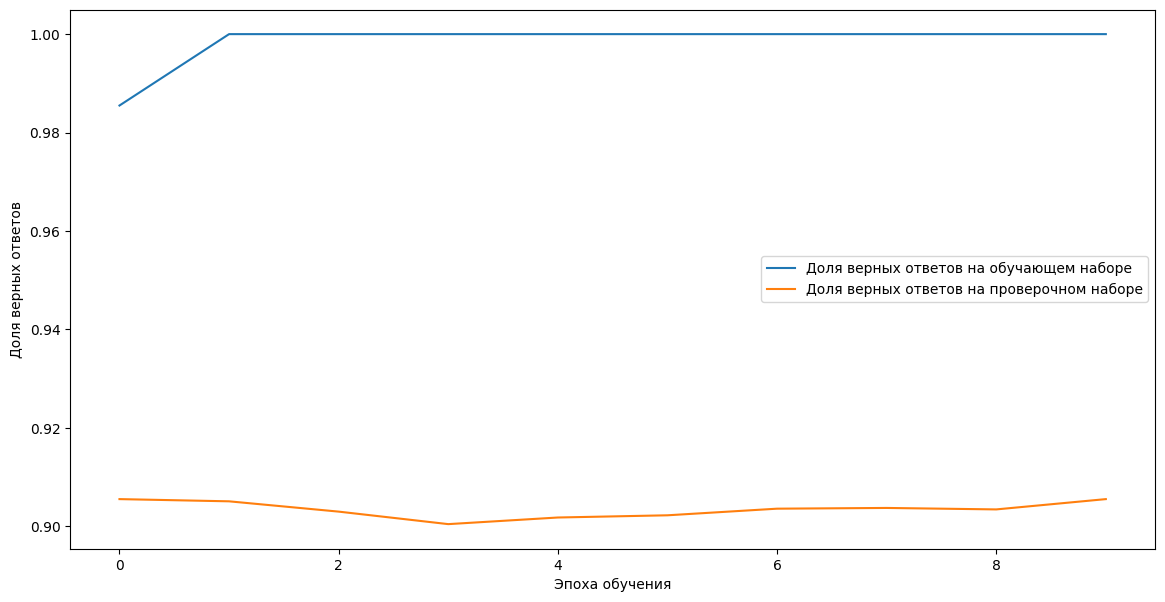

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model02.compile(optimizer=Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history2 = model02.fit(xTrain01,
                      yTrain,
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 1.0000 - loss: 2.0988e-05 - val_accuracy: 0.9085 - val_loss: 0.2845
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 1.0000 - loss: 8.3524e-06 - val_accuracy: 0.9091 - val_loss: 0.2797
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 4.4758e-06 - val_accuracy: 0.9095 - val_loss: 0.2741
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 3.0873e-06 - val_accuracy: 0.9098 - val_loss: 0.2722
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 2.1602e-06 - val_accuracy: 0.9107 - val_loss: 0.2704
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 1.0000 - loss: 1.5976e-06 - val_accuracy: 0.9098 - val_loss: 0.2739
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 - loss: 1.2944e-06 - val_accuracy: 0.9112 - val_loss: 0.2665
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.00

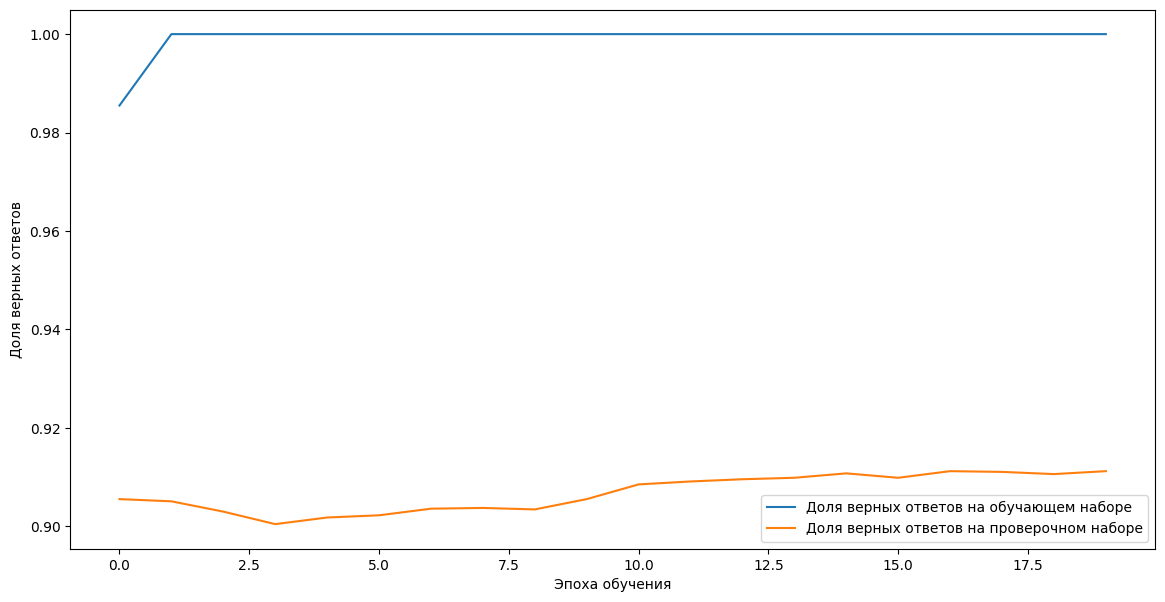

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'] + history2.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'] + history2.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
#Проверяем точность нейронки обученной на bag of words
pred = recognizeMultiClass(model02, xTest6Classes01, "Тексты 01 + Dense")

НЕЙРОНКА:  Тексты 01 + Dense

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Класс: О. Генри   96% сеть отнесла к классу О. Генри   Это ПРАВИЛЬНЫЙ ответ!
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Класс: Стругацкие 86% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Класс: Булгаков   83% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Класс: Саймак     91% сеть отнесла к классу Саймак     Это ПРАВИЛЬНЫЙ ответ!
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Класс: Фрай       93% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Класс: Брэдберри  96% сеть отнесла к классу Брэдберри  Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 91%



#### Embedding + Dense


In [ ]:
#Создаём сеть с Embedding слоем
model03 = Sequential()
model03.add(Embedding(maxWordsCount, 20, input_length=xLen))
model03.add(SpatialDropout1D(0.2))
model03.add(Flatten())
model03.add(BatchNormalization())
model03.add(Dense(200, activation="relu"))
model03.add(Dropout(0.2))
model03.add(BatchNormalization())
model03.add(Dense(6, activation='softmax'))

model03.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model03.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Обучаем сеть на xTrain
history = model03.fit(xTrain,
                    yTrain,
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.5433 - loss: 1.4714 - val_accuracy: 0.3341 - val_loss: 1.7550
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9978 - loss: 0.0205 - val_accuracy: 0.3926 - val_loss: 1.5425
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9994 - loss: 0.0081 - val_accuracy: 0.5328 - val_loss: 1.2109
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9995 - loss: 0.0057 - val_accuracy: 0.6262 - val_loss: 1.0457
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9991 - loss: 0.0042 - val_accuracy: 0.6995 - val_loss: 0.8907
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9996 - loss: 0.0036 - val_accuracy: 0.7112 - val_loss: 0.9037
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9999 - loss: 0.0023 - val_accuracy: 0.7345 - val_loss: 0.8438
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0

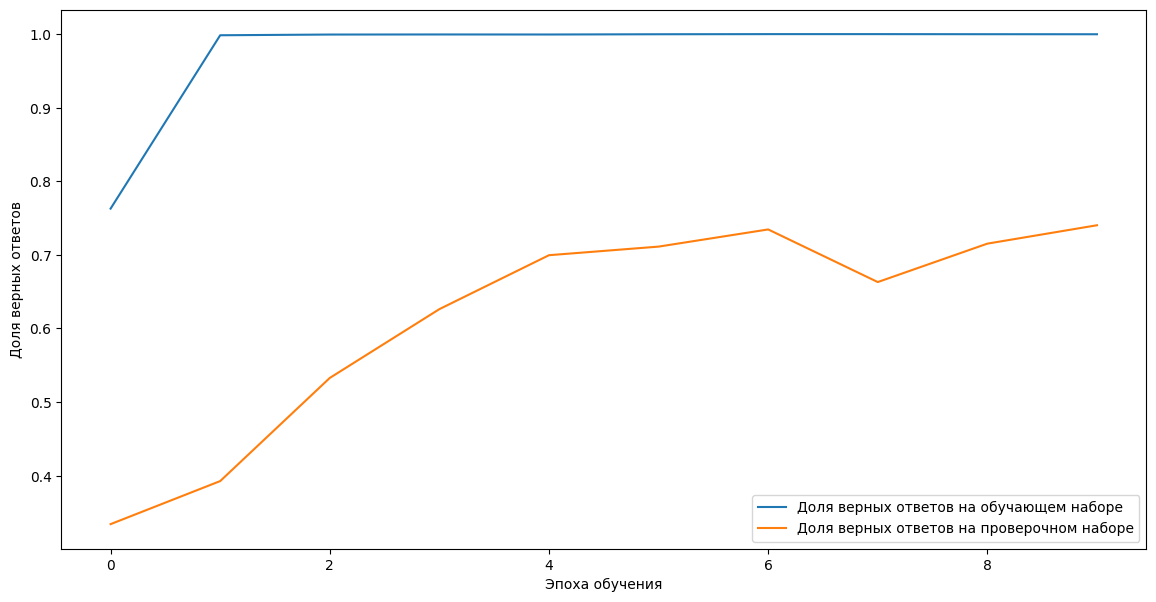

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model03.save_weights('model.weights.h5')

In [ ]:
model03.load_weights('model.weights.h5')

In [ ]:
#Проверяем результаты работы Ebedding сети
_, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки
pred = recognizeMultiClass(model03, xTest6Classes, "Embedding + Dense")

НЕЙРОНКА:  Embedding + Dense



ValueError: Unrecognized data type: x=[[1, 1501, 99, 1152, 1972, 1146, 2, 4039, 1, 1, 1, 1, 1, 1, 4302, 14023, 8115, 1, 1, 4081, 1, 1413, 7, 7623, 6090, 7, 371, 441, 272, 11, 164, 10412, 3, 591, 1, 10695, 6090, 1, 2, 1, 3, 1, 7362, 1, 7, 3071, 2345, 1, 1, 56, 68, 37, 1, 1, 537, 37, 8, 1, 1, 277, 5400, 1069, 3, 13517, 1, 2, 1, 9383, 37, 955, 27, 4861, 628, 770, 1, 647, 1, 4314, 1, 138, 9416, 628, 7, 5853, 54, 647, 1, 1, 1, 1, 7, 6772, 37, 3964, 103, 1, 14492, 2, 84, 1, 1, 3631, 1, 59, 3, 1, 1, 3, 1166, 5276, 1, 2814, 14, 39, 1, 1, 2, 11190, 2609, 2702, 7329, 11, 17693, 4071, 49, 14954, 1, 638, 182, 3, 348, 787, 16437, 1, 4053, 839, 1, 133, 533, 1, 3, 19480, 1, 1, 34, 2106, 1, 3783, 1, 2, 3783, 1, 10, 314, 7820, 10695, 6090, 1, 3, 5963, 1, 8, 2181, 351, 59, 1, 3783, 1, 1, 362, 143, 3, 1, 1, 2503, 3, 3376, 2, 1, 4966, 3, 1, 11047, 1, 1, 1, 1, 2, 1, 1, 1, 1575, 1, 1, 4762, 7828, 2, 1, 6288, 1239, 257, 1, 1, 7781, 1, 3, 1, 1, 389, 73, 31, 159, 22, 1652, 1, 1, 17839, 1287, 5399, 1, 1, 2, 3833, 1, 7, 1, 537, 1, 1, 3775, 1, 2689, 238, 2121, 53, 539, 3, 1, 255, 5690, 1, 2, 1, 1009, 1, 1, 3, 1, 11675, 348, 9197, 42, 2896, 1, 1, 1, 7347, 7347, 10695, 6090, 4, 53, 55, 127, 1, 14, 1, 11073, 14405, 1, 55, 127, 1, 1, 1, 1, 614, 60, 1, 2135, 323, 2, 8337, 13, 34, 1, 652, 8, 16386, 2, 1, 10695, 6090, 1, 1, 493, 3, 6571, 16, 1, 8, 758, 7623, 2, 101, 42, 187, 59, 4, 251, 14927, 4081, 1, 275, 2639, 31, 86, 1, 7942, 1, 652, 9, 310, 56, 2, 1, 2, 41, 29, 581, 6579, 18, 1, 1, 1, 18, 1, 1, 1, 1, 1, 1, 3, 9934, 18, 1, 22, 1, 1, 2, 1472, 6169, 1, 1, 1, 7, 1, 1, 41, 29, 581, 4486, 23, 541, 22, 18, 3599, 16501, 1, 16524, 7, 327, 1, 22, 1, 1, 1, 831, 16078, 1, 7, 69, 1, 4486, 4, 10661, 292, 898, 113, 8, 898, 1, 10, 219, 1, 3, 1, 1332, 22, 327, 29, 61, 1, 85, 1, 1, 327, 69, 1, 4428, 18591, 1, 83, 23, 513, 1, 1363, 737, 2, 518, 1, 1, 2350, 19, 1, 1, 261, 1, 880, 103, 744, 300, 22, 59, 1, 95, 1, 1, 18, 337, 43, 1, 22, 1, 10416, 1, 1, 1, 177, 1, 2, 199, 6, 126, 4, 2539, 770, 45, 1, 16851, 45, 1127, 4734, 17, 1, 1, 2, 9, 313, 2396, 4081, 13, 43, 105, 1, 2, 1, 111, 1, 51, 982, 539, 178, 9, 2, 359, 8178, 3939, 300, 805, 18, 9776, 1, 18, 1, 1, 2, 12657, 1160, 1, 51, 17736, 1146, 1, 18, 7, 4790, 8938, 1192, 9, 43, 1, 1, 605, 9, 43, 1, 1, 1, 943, 2, 605, 9, 5580, 17, 1164, 3, 1, 4794, 9960, 1, 8896, 612, 607, 3, 1334, 469, 40, 4081, 1, 1, 4624, 3, 261, 2113, 8136, 40, 9, 8428, 1, 279, 1544, 9, 1, 8, 177, 3191, 1, 1861, 8, 1, 7031, 11078, 116, 12, 1, 7332, 2, 1, 9, 387, 4593, 7, 5853, 17, 4353, 19, 1, 2, 1, 1, 429, 3, 2125, 16, 64, 43, 1081, 1, 1, 1, 1, 99, 348, 9, 126, 4, 7106, 7, 537, 2742, 22, 255, 1, 8856, 1383, 1, 22, 18, 15786, 602, 4641, 1032, 7, 1, 2684, 11867, 54, 7, 736, 8, 1, 443, 4641, 1, 1032, 7, 98, 154, 208, 2, 101, 1, 16280, 7, 12, 54, 731, 1, 5271, 22, 9791, 602, 46, 30, 215, 1, 1, 7, 17486, 3, 1205, 6288, 2211, 18847, 2, 9250, 1, 1, 4, 8289, 14, 16, 64, 30, 403, 1, 65, 53, 602, 2237, 9856, 1, 3, 1, 7, 1, 1, 332, 8039, 657, 1, 2, 2492, 63, 1, 1, 1, 175, 1, 2, 1, 1, 1, 7086, 261, 831, 3, 2890, 1, 12801, 451, 1, 27, 18, 54, 19085, 3, 620, 9, 146, 27, 8125, 1006, 1, 317, 7, 926, 1, 2, 1, 18, 1, 2176, 1141, 281, 12627, 143, 1, 2, 8960, 9, 3618, 7541, 2060, 2, 317, 3, 2050, 4020, 235, 3, 3279, 1331, 1, 17074, 531, 2, 7168, 1, 22, 218, 1430, 15740, 5842, 2, 1, 2177, 5314, 2455, 1345, 158, 1, 4020, 235, 1, 1, 12879, 2814, 81, 26, 1, 7, 9694, 1, 1345, 1, 1, 3, 2050, 2814, 18991, 15070, 19, 529, 11871, 2176, 17611, 1, 167, 199, 6, 18, 3825, 19, 1, 2704, 1034, 3, 367, 1, 9745, 85, 84, 4632, 9, 281, 1, 19, 14528, 887, 2, 387, 18, 67, 209, 2350, 81, 26, 76, 203, 28, 9, 5209, 14, 1, 448, 321, 20, 15120, 18, 1, 1, 28, 755, 105, 606, 7, 64, 52, 4, 1, 309, 1110, 3, 158, 19, 1, 1, 753, 99, 2266, 47, 1, 24, 137, 88, 602, 19699, 4639, 10, 602, 4, 19699, 40, 1, 15, 36, 1562, 1, 370, 12, 10478, 1, 14, 1, 755, 105, 694, 83, 1, 1, 3228, 18, 3, 784, 14492, 2, 10899, 7, 7078, 1, 1, 6899, 1246, 1, 1, 1038, 8, 1, 2, 1, 9, 5514, 716, 238, 1640, 1, 8, 4285, 782, 1, 18, 1146, 2, 1, 18, 7, 577, 1, 2, 1, 1, 18, 6048, 2, 1, 5, 19204, 1, 1, 189, 100, 755, 105, 29, 17232, 7, 5314, 5842, 28, 1, 48, 1141, 1, 23, 230, 7, 2860, 39, 156, 487, 19635, 6341, 245, 365, 1, 3, 83, 10, 61, 13026, 3918, 14565, 1, 32, 824, 1, 1, 7938, 1, 4639, 2, 15, 6, 19, 130, 6091, 755, 105, 28, 1, 1060, 14, 8, 5595, 5, 4, 319, 82, 2389, 76, 203, 1, 5, 34, 1, 75, 19, 1], [1, 3631, 1, 59, 3, 1, 1, 3, 1166, 5276, 1, 2814, 14, 39, 1, 1, 2, 11190, 2609, 2702, 7329, 11, 17693, 4071, 49, 14954, 1, 638, 182, 3, 348, 787, 16437, 1, 4053, 839, 1, 133, 533, 1, 3, 19480, 1, 1, 34, 2106, 1, 3783, 1, 2, 3783, 1, 10, 314, 7820, 10695, 6090, 1, 3, 5963, 1, 8, 2181, 351, 59, 1, 3783, 1, 1, 362, 143, 3, 1, 1, 2503, 3, 3376, 2, 1, 4966, 3, 1, 11047, 1, 1, 1, 1, 2, 1, 1, 1, 1575, 1, 1, 4762, 7828, 2, 1, 6288, 1239, 257, 1, 1, 7781, 1, 3, 1, 1, 389, 73, 31, 159, 22, 1652, 1, 1, 17839, 1287, 5399, 1, 1, 2, 3833, 1, 7, 1, 537, 1, 1, 3775, 1, 2689, 238, 2121, 53, 539, 3, 1, 255, 5690, 1, 2, 1, 1009, 1, 1, 3, 1, 11675, 348, 9197, 42, 2896, 1, 1, 1, 7347, 7347, 10695, 6090, 4, 53, 55, 127, 1, 14, 1, 11073, 14405, 1, 55, 127, 1, 1, 1, 1, 614, 60, 1, 2135, 323, 2, 8337, 13, 34, 1, 652, 8, 16386, 2, 1, 10695, 6090, 1, 1, 493, 3, 6571, 16, 1, 8, 758, 7623, 2, 101, 42, 187, 59, 4, 251, 14927, 4081, 1, 275, 2639, 31, 86, 1, 7942, 1, 652, 9, 310, 56, 2, 1, 2, 41, 29, 581, 6579, 18, 1, 1, 1, 18, 1, 1, 1, 1, 1, 1, 3, 9934, 18, 1, 22, 1, 1, 2, 1472, 6169, 1, 1, 1, 7, 1, 1, 41, 29, 581, 4486, 23, 541, 22, 18, 3599, 16501, 1, 16524, 7, 327, 1, 22, 1, 1, 1, 831, 16078, 1, 7, 69, 1, 4486, 4, 10661, 292, 898, 113, 8, 898, 1, 10, 219, 1, 3, 1, 1332, 22, 327, 29, 61, 1, 85, 1, 1, 327, 69, 1, 4428, 18591, 1, 83, 23, 513, 1, 1363, 737, 2, 518, 1, 1, 2350, 19, 1, 1, 261, 1, 880, 103, 744, 300, 22, 59, 1, 95, 1, 1, 18, 337, 43, 1, 22, 1, 10416, 1, 1, 1, 177, 1, 2, 199, 6, 126, 4, 2539, 770, 45, 1, 16851, 45, 1127, 4734, 17, 1, 1, 2, 9, 313, 2396, 4081, 13, 43, 105, 1, 2, 1, 111, 1, 51, 982, 539, 178, 9, 2, 359, 8178, 3939, 300, 805, 18, 9776, 1, 18, 1, 1, 2, 12657, 1160, 1, 51, 17736, 1146, 1, 18, 7, 4790, 8938, 1192, 9, 43, 1, 1, 605, 9, 43, 1, 1, 1, 943, 2, 605, 9, 5580, 17, 1164, 3, 1, 4794, 9960, 1, 8896, 612, 607, 3, 1334, 469, 40, 4081, 1, 1, 4624, 3, 261, 2113, 8136, 40, 9, 8428, 1, 279, 1544, 9, 1, 8, 177, 3191, 1, 1861, 8, 1, 7031, 11078, 116, 12, 1, 7332, 2, 1, 9, 387, 4593, 7, 5853, 17, 4353, 19, 1, 2, 1, 1, 429, 3, 2125, 16, 64, 43, 1081, 1, 1, 1, 1, 99, 348, 9, 126, 4, 7106, 7, 537, 2742, 22, 255, 1, 8856, 1383, 1, 22, 18, 15786, 602, 4641, 1032, 7, 1, 2684, 11867, 54, 7, 736, 8, 1, 443, 4641, 1, 1032, 7, 98, 154, 208, 2, 101, 1, 16280, 7, 12, 54, 731, 1, 5271, 22, 9791, 602, 46, 30, 215, 1, 1, 7, 17486, 3, 1205, 6288, 2211, 18847, 2, 9250, 1, 1, 4, 8289, 14, 16, 64, 30, 403, 1, 65, 53, 602, 2237, 9856, 1, 3, 1, 7, 1, 1, 332, 8039, 657, 1, 2, 2492, 63, 1, 1, 1, 175, 1, 2, 1, 1, 1, 7086, 261, 831, 3, 2890, 1, 12801, 451, 1, 27, 18, 54, 19085, 3, 620, 9, 146, 27, 8125, 1006, 1, 317, 7, 926, 1, 2, 1, 18, 1, 2176, 1141, 281, 12627, 143, 1, 2, 8960, 9, 3618, 7541, 2060, 2, 317, 3, 2050, 4020, 235, 3, 3279, 1331, 1, 17074, 531, 2, 7168, 1, 22, 218, 1430, 15740, 5842, 2, 1, 2177, 5314, 2455, 1345, 158, 1, 4020, 235, 1, 1, 12879, 2814, 81, 26, 1, 7, 9694, 1, 1345, 1, 1, 3, 2050, 2814, 18991, 15070, 19, 529, 11871, 2176, 17611, 1, 167, 199, 6, 18, 3825, 19, 1, 2704, 1034, 3, 367, 1, 9745, 85, 84, 4632, 9, 281, 1, 19, 14528, 887, 2, 387, 18, 67, 209, 2350, 81, 26, 76, 203, 28, 9, 5209, 14, 1, 448, 321, 20, 15120, 18, 1, 1, 28, 755, 105, 606, 7, 64, 52, 4, 1, 309, 1110, 3, 158, 19, 1, 1, 753, 99, 2266, 47, 1, 24, 137, 88, 602, 19699, 4639, 10, 602, 4, 19699, 40, 1, 15, 36, 1562, 1, 370, 12, 10478, 1, 14, 1, 755, 105, 694, 83, 1, 1, 3228, 18, 3, 784, 14492, 2, 10899, 7, 7078, 1, 1, 6899, 1246, 1, 1, 1038, 8, 1, 2, 1, 9, 5514, 716, 238, 1640, 1, 8, 4285, 782, 1, 18, 1146, 2, 1, 18, 7, 577, 1, 2, 1, 1, 18, 6048, 2, 1, 5, 19204, 1, 1, 189, 100, 755, 105, 29, 17232, 7, 5314, 5842, 28, 1, 48, 1141, 1, 23, 230, 7, 2860, 39, 156, 487, 19635, 6341, 245, 365, 1, 3, 83, 10, 61, 13026, 3918, 14565, 1, 32, 824, 1, 1, 7938, 1, 4639, 2, 15, 6, 19, 130, 6091, 755, 105, 28, 1, 1060, 14, 8, 5595, 5, 4, 319, 82, 2389, 76, 203, 1, 5, 34, 1, 75, 19, 1, 5, 106, 388, 2, 106, 205, 105, 3751, 328, 8951, 178, 5, 2, 4, 2044, 7, 64, 2795, 1, 11, 7, 1, 54, 2795, 1, 11, 7, 9838, 50, 1, 244, 1, 175, 918, 2, 782, 44, 1, 9254, 2, 1, 5, 1, 1, 2, 1, 1, 3, 149, 1, 328, 1708, 235, 168, 3, 5224, 480, 13, 12126, 8966, 21, 7030, 2, 1525, 82, 53, 65, 10670, 889, 12617, 2, 1, 1, 1, 1, 1, 1, 1959, 10226, 2, 1, 1, 3, 168, 18, 2419, 3, 1, 1673, 51, 1, 982, 1, 536, 1, 5, 15873, 1, 17, 18], [257, 1, 1, 7781, 1, 3, 1, 1, 389, 73, 31, 159, 22, 1652, 1, 1, 17839, 1287, 5399, 1, 1, 2, 3833, 1, 7, 1, 537, 1, 1, 3775, 1, 2689, 238, 2121, 53, 539, 3, 1, 255, 5690, 1, 2, 1, 1009, 1, 1, 3, 1, 11675, 348, 9197, 42, 2896, 1, 1, 1, 7347, 7347, 10695, 6090, 4, 53, 55, 127, 1, 14, 1, 11073, 14405, 1, 55, 127, 1, 1, 1, 1, 614, 60, 1, 2135, 323, 2, 8337, 13, 34, 1, 652, 8, 16386, 2, 1, 10695, 6090, 1, 1, 493, 3, 6571, 16, 1, 8, 758, 7623, 2, 101, 42, 187, 59, 4, 251, 14927, 4081, 1, 275, 2639, 31, 86, 1, 7942, 1, 652, 9, 310, 56, 2, 1, 2, 41, 29, 581, 6579, 18, 1, 1, 1, 18, 1, 1, 1, 1, 1, 1, 3, 9934, 18, 1, 22, 1, 1, 2, 1472, 6169, 1, 1, 1, 7, 1, 1, 41, 29, 581, 4486, 23, 541, 22, 18, 3599, 16501, 1, 16524, 7, 327, 1, 22, 1, 1, 1, 831, 16078, 1, 7, 69, 1, 4486, 4, 10661, 292, 898, 113, 8, 898, 1, 10, 219, 1, 3, 1, 1332, 22, 327, 29, 61, 1, 85, 1, 1, 327, 69, 1, 4428, 18591, 1, 83, 23, 513, 1, 1363, 737, 2, 518, 1, 1, 2350, 19, 1, 1, 261, 1, 880, 103, 744, 300, 22, 59, 1, 95, 1, 1, 18, 337, 43, 1, 22, 1, 10416, 1, 1, 1, 177, 1, 2, 199, 6, 126, 4, 2539, 770, 45, 1, 16851, 45, 1127, 4734, 17, 1, 1, 2, 9, 313, 2396, 4081, 13, 43, 105, 1, 2, 1, 111, 1, 51, 982, 539, 178, 9, 2, 359, 8178, 3939, 300, 805, 18, 9776, 1, 18, 1, 1, 2, 12657, 1160, 1, 51, 17736, 1146, 1, 18, 7, 4790, 8938, 1192, 9, 43, 1, 1, 605, 9, 43, 1, 1, 1, 943, 2, 605, 9, 5580, 17, 1164, 3, 1, 4794, 9960, 1, 8896, 612, 607, 3, 1334, 469, 40, 4081, 1, 1, 4624, 3, 261, 2113, 8136, 40, 9, 8428, 1, 279, 1544, 9, 1, 8, 177, 3191, 1, 1861, 8, 1, 7031, 11078, 116, 12, 1, 7332, 2, 1, 9, 387, 4593, 7, 5853, 17, 4353, 19, 1, 2, 1, 1, 429, 3, 2125, 16, 64, 43, 1081, 1, 1, 1, 1, 99, 348, 9, 126, 4, 7106, 7, 537, 2742, 22, 255, 1, 8856, 1383, 1, 22, 18, 15786, 602, 4641, 1032, 7, 1, 2684, 11867, 54, 7, 736, 8, 1, 443, 4641, 1, 1032, 7, 98, 154, 208, 2, 101, 1, 16280, 7, 12, 54, 731, 1, 5271, 22, 9791, 602, 46, 30, 215, 1, 1, 7, 17486, 3, 1205, 6288, 2211, 18847, 2, 9250, 1, 1, 4, 8289, 14, 16, 64, 30, 403, 1, 65, 53, 602, 2237, 9856, 1, 3, 1, 7, 1, 1, 332, 8039, 657, 1, 2, 2492, 63, 1, 1, 1, 175, 1, 2, 1, 1, 1, 7086, 261, 831, 3, 2890, 1, 12801, 451, 1, 27, 18, 54, 19085, 3, 620, 9, 146, 27, 8125, 1006, 1, 317, 7, 926, 1, 2, 1, 18, 1, 2176, 1141, 281, 12627, 143, 1, 2, 8960, 9, 3618, 7541, 2060, 2, 317, 3, 2050, 4020, 235, 3, 3279, 1331, 1, 17074, 531, 2, 7168, 1, 22, 218, 1430, 15740, 5842, 2, 1, 2177, 5314, 2455, 1345, 158, 1, 4020, 235, 1, 1, 12879, 2814, 81, 26, 1, 7, 9694, 1, 1345, 1, 1, 3, 2050, 2814, 18991, 15070, 19, 529, 11871, 2176, 17611, 1, 167, 199, 6, 18, 3825, 19, 1, 2704, 1034, 3, 367, 1, 9745, 85, 84, 4632, 9, 281, 1, 19, 14528, 887, 2, 387, 18, 67, 209, 2350, 81, 26, 76, 203, 28, 9, 5209, 14, 1, 448, 321, 20, 15120, 18, 1, 1, 28, 755, 105, 606, 7, 64, 52, 4, 1, 309, 1110, 3, 158, 19, 1, 1, 753, 99, 2266, 47, 1, 24, 137, 88, 602, 19699, 4639, 10, 602, 4, 19699, 40, 1, 15, 36, 1562, 1, 370, 12, 10478, 1, 14, 1, 755, 105, 694, 83, 1, 1, 3228, 18, 3, 784, 14492, 2, 10899, 7, 7078, 1, 1, 6899, 1246, 1, 1, 1038, 8, 1, 2, 1, 9, 5514, 716, 238, 1640, 1, 8, 4285, 782, 1, 18, 1146, 2, 1, 18, 7, 577, 1, 2, 1, 1, 18, 6048, 2, 1, 5, 19204, 1, 1, 189, 100, 755, 105, 29, 17232, 7, 5314, 5842, 28, 1, 48, 1141, 1, 23, 230, 7, 2860, 39, 156, 487, 19635, 6341, 245, 365, 1, 3, 83, 10, 61, 13026, 3918, 14565, 1, 32, 824, 1, 1, 7938, 1, 4639, 2, 15, 6, 19, 130, 6091, 755, 105, 28, 1, 1060, 14, 8, 5595, 5, 4, 319, 82, 2389, 76, 203, 1, 5, 34, 1, 75, 19, 1, 5, 106, 388, 2, 106, 205, 105, 3751, 328, 8951, 178, 5, 2, 4, 2044, 7, 64, 2795, 1, 11, 7, 1, 54, 2795, 1, 11, 7, 9838, 50, 1, 244, 1, 175, 918, 2, 782, 44, 1, 9254, 2, 1, 5, 1, 1, 2, 1, 1, 3, 149, 1, 328, 1708, 235, 168, 3, 5224, 480, 13, 12126, 8966, 21, 7030, 2, 1525, 82, 53, 65, 10670, 889, 12617, 2, 1, 1, 1, 1, 1, 1, 1959, 10226, 2, 1, 1, 3, 168, 18, 2419, 3, 1, 1673, 51, 1, 982, 1, 536, 1, 5, 15873, 1, 17, 18, 1, 5, 9261, 1, 2, 12801, 4, 3, 1, 1, 2, 4, 3, 1, 1, 10, 7, 2324, 429, 1, 2012, 1805, 8, 239, 2158, 1879, 1, 3, 8809, 403, 1, 1, 2, 1, 4352, 1, 3, 480, 5315, 3, 2035, 10267, 1, 1, 21, 15330, 1760, 640, 3646, 3460, 21, 63, 12, 193, 17205, 63, 1, 13995, 1, 5, 1, 7, 2035, 793, 3936, 1, 38, 1, 75, 2889, 2, 55, 4230, 6082, 5, 1, 75, 19, 1, 5, 4, 12521, 5395, 1132, 17592, 54, 1, 581, 1, 21, 10, 29, 433, 1106, 961, 755, 105, 2, 1, 7595], [8, 758, 7623, 2, 101, 42, 187, 59, 4, 251, 14927, 4081, 1, 275, 2639, 31, 86, 1, 7942, 1, 652, 9, 310, 56, 2, 1, 2, 41, 29, 581, 6579, 18, 1, 1, 1, 18, 1, 1, 1, 1, 1, 1, 3, 9934, 18, 1, 22, 1, 1, 2, 1472, 6169, 1, 1, 1, 7, 1, 1, 41, 29, 581, 4486, 23, 541, 22, 18, 3599, 16501, 1, 16524, 7, 327, 1, 22, 1, 1, 1, 831, 16078, 1, 7, 69, 1, 4486, 4, 10661, 292, 898, 113, 8, 898, 1, 10, 219, 1, 3, 1, 1332, 22, 327, 29, 61, 1, 85, 1, 1, 327, 69, 1, 4428, 18591, 1, 83, 23, 513, 1, 1363, 737, 2, 518, 1, 1, 2350, 19, 1, 1, 261, 1, 880, 103, 744, 300, 22, 59, 1, 95, 1, 1, 18, 337, 43, 1, 22, 1, 10416, 1, 1, 1, 177, 1, 2, 199, 6, 126, 4, 2539, 770, 45, 1, 16851, 45, 1127, 4734, 17, 1, 1, 2, 9, 313, 2396, 4081, 13, 43, 105, 1, 2, 1, 111, 1, 51, 982, 539, 178, 9, 2, 359, 8178, 3939, 300, 805, 18, 9776, 1, 18, 1, 1, 2, 12657, 1160, 1, 51, 17736, 1146, 1, 18, 7, 4790, 8938, 1192, 9, 43, 1, 1, 605, 9, 43, 1, 1, 1, 943, 2, 605, 9, 5580, 17, 1164, 3, 1, 4794, 9960, 1, 8896, 612, 607, 3, 1334, 469, 40, 4081, 1, 1, 4624, 3, 261, 2113, 8136, 40, 9, 8428, 1, 279, 1544, 9, 1, 8, 177, 3191, 1, 1861, 8, 1, 7031, 11078, 116, 12, 1, 7332, 2, 1, 9, 387, 4593, 7, 5853, 17, 4353, 19, 1, 2, 1, 1, 429, 3, 2125, 16, 64, 43, 1081, 1, 1, 1, 1, 99, 348, 9, 126, 4, 7106, 7, 537, 2742, 22, 255, 1, 8856, 1383, 1, 22, 18, 15786, 602, 4641, 1032, 7, 1, 2684, 11867, 54, 7, 736, 8, 1, 443, 4641, 1, 1032, 7, 98, 154, 208, 2, 101, 1, 16280, 7, 12, 54, 731, 1, 5271, 22, 9791, 602, 46, 30, 215, 1, 1, 7, 17486, 3, 1205, 6288, 2211, 18847, 2, 9250, 1, 1, 4, 8289, 14, 16, 64, 30, 403, 1, 65, 53, 602, 2237, 9856, 1, 3, 1, 7, 1, 1, 332, 8039, 657, 1, 2, 2492, 63, 1, 1, 1, 175, 1, 2, 1, 1, 1, 7086, 261, 831, 3, 2890, 1, 12801, 451, 1, 27, 18, 54, 19085, 3, 620, 9, 146, 27, 8125, 1006, 1, 317, 7, 926, 1, 2, 1, 18, 1, 2176, 1141, 281, 12627, 143, 1, 2, 8960, 9, 3618, 7541, 2060, 2, 317, 3, 2050, 4020, 235, 3, 3279, 1331, 1, 17074, 531, 2, 7168, 1, 22, 218, 1430, 15740, 5842, 2, 1, 2177, 5314, 2455, 1345, 158, 1, 4020, 235, 1, 1, 12879, 2814, 81, 26, 1, 7, 9694, 1, 1345, 1, 1, 3, 2050, 2814, 18991, 15070, 19, 529, 11871, 2176, 17611, 1, 167, 199, 6, 18, 3825, 19, 1, 2704, 1034, 3, 367, 1, 9745, 85, 84, 4632, 9, 281, 1, 19, 14528, 887, 2, 387, 18, 67, 209, 2350, 81, 26, 76, 203, 28, 9, 5209, 14, 1, 448, 321, 20, 15120, 18, 1, 1, 28, 755, 105, 606, 7, 64, 52, 4, 1, 309, 1110, 3, 158, 19, 1, 1, 753, 99, 2266, 47, 1, 24, 137, 88, 602, 19699, 4639, 10, 602, 4, 19699, 40, 1, 15, 36, 1562, 1, 370, 12, 10478, 1, 14, 1, 755, 105, 694, 83, 1, 1, 3228, 18, 3, 784, 14492, 2, 10899, 7, 7078, 1, 1, 6899, 1246, 1, 1, 1038, 8, 1, 2, 1, 9, 5514, 716, 238, 1640, 1, 8, 4285, 782, 1, 18, 1146, 2, 1, 18, 7, 577, 1, 2, 1, 1, 18, 6048, 2, 1, 5, 19204, 1, 1, 189, 100, 755, 105, 29, 17232, 7, 5314, 5842, 28, 1, 48, 1141, 1, 23, 230, 7, 2860, 39, 156, 487, 19635, 6341, 245, 365, 1, 3, 83, 10, 61, 13026, 3918, 14565, 1, 32, 824, 1, 1, 7938, 1, 4639, 2, 15, 6, 19, 130, 6091, 755, 105, 28, 1, 1060, 14, 8, 5595, 5, 4, 319, 82, 2389, 76, 203, 1, 5, 34, 1, 75, 19, 1, 5, 106, 388, 2, 106, 205, 105, 3751, 328, 8951, 178, 5, 2, 4, 2044, 7, 64, 2795, 1, 11, 7, 1, 54, 2795, 1, 11, 7, 9838, 50, 1, 244, 1, 175, 918, 2, 782, 44, 1, 9254, 2, 1, 5, 1, 1, 2, 1, 1, 3, 149, 1, 328, 1708, 235, 168, 3, 5224, 480, 13, 12126, 8966, 21, 7030, 2, 1525, 82, 53, 65, 10670, 889, 12617, 2, 1, 1, 1, 1, 1, 1, 1959, 10226, 2, 1, 1, 3, 168, 18, 2419, 3, 1, 1673, 51, 1, 982, 1, 536, 1, 5, 15873, 1, 17, 18, 1, 5, 9261, 1, 2, 12801, 4, 3, 1, 1, 2, 4, 3, 1, 1, 10, 7, 2324, 429, 1, 2012, 1805, 8, 239, 2158, 1879, 1, 3, 8809, 403, 1, 1, 2, 1, 4352, 1, 3, 480, 5315, 3, 2035, 10267, 1, 1, 21, 15330, 1760, 640, 3646, 3460, 21, 63, 12, 193, 17205, 63, 1, 13995, 1, 5, 1, 7, 2035, 793, 3936, 1, 38, 1, 75, 2889, 2, 55, 4230, 6082, 5, 1, 75, 19, 1, 5, 4, 12521, 5395, 1132, 17592, 54, 1, 581, 1, 21, 10, 29, 433, 1106, 961, 755, 105, 2, 1, 7595, 3, 18, 557, 17263, 7, 1069, 6898, 18129, 29, 211, 1, 284, 1, 8173, 3, 4968, 1, 1, 5, 106, 86, 1363, 1, 229, 321, 29, 1106, 5, 1603, 2, 1, 516, 40, 5, 43, 10587, 1485, 29, 525, 1, 14905, 1, 12031, 2, 3645, 22, 2304, 1, 34, 530, 48, 9, 4, 11287, 24, 23, 241, 50, 328, 5610, 160, 1, 4, 3239, 5, 243, 27, 3677, 1445, 1089, 28, 1, 76, 177, 15269, 18890, 1368, 5, 2942, 82, 59, 3, 4883, 4965, 28, 755, 105, 8, 17205, 4765, 14, 5, 4, 232, 717, 29, 176, 245, 77, 456], [29, 61, 1, 85, 1, 1, 327, 69, 1, 4428, 18591, 1, 83, 23, 513, 1, 1363, 737, 2, 518, 1, 1, 2350, 19, 1, 1, 261, 1, 880, 103, 744, 300, 22, 59, 1, 95, 1, 1, 18, 337, 43, 1, 22, 1, 10416, 1, 1, 1, 177, 1, 2, 199, 6, 126, 4, 2539, 770, 45, 1, 16851, 45, 1127, 4734, 17, 1, 1, 2, 9, 313, 2396, 4081, 13, 43, 105, 1, 2, 1, 111, 1, 51, 982, 539, 178, 9, 2, 359, 8178, 3939, 300, 805, 18, 9776, 1, 18, 1, 1, 2, 12657, 1160, 1, 51, 17736, 1146, 1, 18, 7, 4790, 8938, 1192, 9, 43, 1, 1, 605, 9, 43, 1, 1, 1, 943, 2, 605, 9, 5580, 17, 1164, 3, 1, 4794, 9960, 1, 8896, 612, 607, 3, 1334, 469, 40, 4081, 1, 1, 4624, 3, 261, 2113, 8136, 40, 9, 8428, 1, 279, 1544, 9, 1, 8, 177, 3191, 1, 1861, 8, 1, 7031, 11078, 116, 12, 1, 7332, 2, 1, 9, 387, 4593, 7, 5853, 17, 4353, 19, 1, 2, 1, 1, 429, 3, 2125, 16, 64, 43, 1081, 1, 1, 1, 1, 99, 348, 9, 126, 4, 7106, 7, 537, 2742, 22, 255, 1, 8856, 1383, 1, 22, 18, 15786, 602, 4641, 1032, 7, 1, 2684, 11867, 54, 7, 736, 8, 1, 443, 4641, 1, 1032, 7, 98, 154, 208, 2, 101, 1, 16280, 7, 12, 54, 731, 1, 5271, 22, 9791, 602, 46, 30, 215, 1, 1, 7, 17486, 3, 1205, 6288, 2211, 18847, 2, 9250, 1, 1, 4, 8289, 14, 16, 64, 30, 403, 1, 65, 53, 602, 2237, 9856, 1, 3, 1, 7, 1, 1, 332, 8039, 657, 1, 2, 2492, 63, 1, 1, 1, 175, 1, 2, 1, 1, 1, 7086, 261, 831, 3, 2890, 1, 12801, 451, 1, 27, 18, 54, 19085, 3, 620, 9, 146, 27, 8125, 1006, 1, 317, 7, 926, 1, 2, 1, 18, 1, 2176, 1141, 281, 12627, 143, 1, 2, 8960, 9, 3618, 7541, 2060, 2, 317, 3, 2050, 4020, 235, 3, 3279, 1331, 1, 17074, 531, 2, 7168, 1, 22, 218, 1430, 15740, 5842, 2, 1, 2177, 5314, 2455, 1345, 158, 1, 4020, 235, 1, 1, 12879, 2814, 81, 26, 1, 7, 9694, 1, 1345, 1, 1, 3, 2050, 2814, 18991, 15070, 19, 529, 11871, 2176, 17611, 1, 167, 199, 6, 18, 3825, 19, 1, 2704, 1034, 3, 367, 1, 9745, 85, 84, 4632, 9, 281, 1, 19, 14528, 887, 2, 387, 18, 67, 209, 2350, 81, 26, 76, 203, 28, 9, 5209, 14, 1, 448, 321, 20, 15120, 18, 1, 1, 28, 755, 105, 606, 7, 64, 52, 4, 1, 309, 1110, 3, 158, 19, 1, 1, 753, 99, 2266, 47, 1, 24, 137, 88, 602, 19699, 4639, 10, 602, 4, 19699, 40, 1, 15, 36, 1562, 1, 370, 12, 10478, 1, 14, 1, 755, 105, 694, 83, 1, 1, 3228, 18, 3, 784, 14492, 2, 10899, 7, 7078, 1, 1, 6899, 1246, 1, 1, 1038, 8, 1, 2, 1, 9, 5514, 716, 238, 1640, 1, 8, 4285, 782, 1, 18, 1146, 2, 1, 18, 7, 577, 1, 2, 1, 1, 18, 6048, 2, 1, 5, 19204, 1, 1, 189, 100, 755, 105, 29, 17232, 7, 5314, 5842, 28, 1, 48, 1141, 1, 23, 230, 7, 2860, 39, 156, 487, 19635, 6341, 245, 365, 1, 3, 83, 10, 61, 13026, 3918, 14565, 1, 32, 824, 1, 1, 7938, 1, 4639, 2, 15, 6, 19, 130, 6091, 755, 105, 28, 1, 1060, 14, 8, 5595, 5, 4, 319, 82, 2389, 76, 203, 1, 5, 34, 1, 75, 19, 1, 5, 106, 388, 2, 106, 205, 105, 3751, 328, 8951, 178, 5, 2, 4, 2044, 7, 64, 2795, 1, 11, 7, 1, 54, 2795, 1, 11, 7, 9838, 50, 1, 244, 1, 175, 918, 2, 782, 44, 1, 9254, 2, 1, 5, 1, 1, 2, 1, 1, 3, 149, 1, 328, 1708, 235, 168, 3, 5224, 480, 13, 12126, 8966, 21, 7030, 2, 1525, 82, 53, 65, 10670, 889, 12617, 2, 1, 1, 1, 1, 1, 1, 1959, 10226, 2, 1, 1, 3, 168, 18, 2419, 3, 1, 1673, 51, 1, 982, 1, 536, 1, 5, 15873, 1, 17, 18, 1, 5, 9261, 1, 2, 12801, 4, 3, 1, 1, 2, 4, 3, 1, 1, 10, 7, 2324, 429, 1, 2012, 1805, 8, 239, 2158, 1879, 1, 3, 8809, 403, 1, 1, 2, 1, 4352, 1, 3, 480, 5315, 3, 2035, 10267, 1, 1, 21, 15330, 1760, 640, 3646, 3460, 21, 63, 12, 193, 17205, 63, 1, 13995, 1, 5, 1, 7, 2035, 793, 3936, 1, 38, 1, 75, 2889, 2, 55, 4230, 6082, 5, 1, 75, 19, 1, 5, 4, 12521, 5395, 1132, 17592, 54, 1, 581, 1, 21, 10, 29, 433, 1106, 961, 755, 105, 2, 1, 7595, 3, 18, 557, 17263, 7, 1069, 6898, 18129, 29, 211, 1, 284, 1, 8173, 3, 4968, 1, 1, 5, 106, 86, 1363, 1, 229, 321, 29, 1106, 5, 1603, 2, 1, 516, 40, 5, 43, 10587, 1485, 29, 525, 1, 14905, 1, 12031, 2, 3645, 22, 2304, 1, 34, 530, 48, 9, 4, 11287, 24, 23, 241, 50, 328, 5610, 160, 1, 4, 3239, 5, 243, 27, 3677, 1445, 1089, 28, 1, 76, 177, 15269, 18890, 1368, 5, 2942, 82, 59, 3, 4883, 4965, 28, 755, 105, 8, 17205, 4765, 14, 5, 4, 232, 717, 29, 176, 245, 77, 456, 893, 21, 350, 34, 6, 29, 525, 1, 23, 1, 7, 2035, 1, 1, 7, 1, 8, 1, 596, 101, 1111, 1, 11152, 16337, 481, 1, 10, 1, 1, 1, 1, 12523, 1, 1031, 1, 2, 1, 1, 1, 1054, 7, 168, 33, 326, 386, 1, 3, 517, 1, 1, 1472, 985, 1, 1, 1, 2, 1, 7172, 8, 16097, 13, 11, 82, 544, 688, 1, 2106, 10325, 8, 1653, 93, 1097, 1, 119, 937, 14349, 3041, 3, 3130, 40, 46, 1, 262, 77, 2889, 33, 120, 1, 180, 33, 1, 322, 1, 5634, 1, 2, 314, 1, 46, 1], [51, 17736, 1146, 1, 18, 7, 4790, 8938, 1192, 9, 43, 1, 1, 605, 9, 43, 1, 1, 1, 943, 2, 605, 9, 5580, 17, 1164, 3, 1, 4794, 9960, 1, 8896, 612, 607, 3, 1334, 469, 40, 4081, 1, 1, 4624, 3, 261, 2113, 8136, 40, 9, 8428, 1, 279, 1544, 9, 1, 8, 177, 3191, 1, 1861, 8, 1, 7031, 11078, 116, 12, 1, 7332, 2, 1, 9, 387, 4593, 7, 5853, 17, 4353, 19, 1, 2, 1, 1, 429, 3, 2125, 16, 64, 43, 1081, 1, 1, 1, 1, 99, 348, 9, 126, 4, 7106, 7, 537, 2742, 22, 255, 1, 8856, 1383, 1, 22, 18, 15786, 602, 4641, 1032, 7, 1, 2684, 11867, 54, 7, 736, 8, 1, 443, 4641, 1, 1032, 7, 98, 154, 208, 2, 101, 1, 16280, 7, 12, 54, 731, 1, 5271, 22, 9791, 602, 46, 30, 215, 1, 1, 7, 17486, 3, 1205, 6288, 2211, 18847, 2, 9250, 1, 1, 4, 8289, 14, 16, 64, 30, 403, 1, 65, 53, 602, 2237, 9856, 1, 3, 1, 7, 1, 1, 332, 8039, 657, 1, 2, 2492, 63, 1, 1, 1, 175, 1, 2, 1, 1, 1, 7086, 261, 831, 3, 2890, 1, 12801, 451, 1, 27, 18, 54, 19085, 3, 620, 9, 146, 27, 8125, 1006, 1, 317, 7, 926, 1, 2, 1, 18, 1, 2176, 1141, 281, 12627, 143, 1, 2, 8960, 9, 3618, 7541, 2060, 2, 317, 3, 2050, 4020, 235, 3, 3279, 1331, 1, 17074, 531, 2, 7168, 1, 22, 218, 1430, 15740, 5842, 2, 1, 2177, 5314, 2455, 1345, 158, 1, 4020, 235, 1, 1, 12879, 2814, 81, 26, 1, 7, 9694, 1, 1345, 1, 1, 3, 2050, 2814, 18991, 15070, 19, 529, 11871, 2176, 17611, 1, 167, 199, 6, 18, 3825, 19, 1, 2704, 1034, 3, 367, 1, 9745, 85, 84, 4632, 9, 281, 1, 19, 14528, 887, 2, 387, 18, 67, 209, 2350, 81, 26, 76, 203, 28, 9, 5209, 14, 1, 448, 321, 20, 15120, 18, 1, 1, 28, 755, 105, 606, 7, 64, 52, 4, 1, 309, 1110, 3, 158, 19, 1, 1, 753, 99, 2266, 47, 1, 24, 137, 88, 602, 19699, 4639, 10, 602, 4, 19699, 40, 1, 15, 36, 1562, 1, 370, 12, 10478, 1, 14, 1, 755, 105, 694, 83, 1, 1, 3228, 18, 3, 784, 14492, 2, 10899, 7, 7078, 1, 1, 6899, 1246, 1, 1, 1038, 8, 1, 2, 1, 9, 5514, 716, 238, 1640, 1, 8, 4285, 782, 1, 18, 1146, 2, 1, 18, 7, 577, 1, 2, 1, 1, 18, 6048, 2, 1, 5, 19204, 1, 1, 189, 100, 755, 105, 29, 17232, 7, 5314, 5842, 28, 1, 48, 1141, 1, 23, 230, 7, 2860, 39, 156, 487, 19635, 6341, 245, 365, 1, 3, 83, 10, 61, 13026, 3918, 14565, 1, 32, 824, 1, 1, 7938, 1, 4639, 2, 15, 6, 19, 130, 6091, 755, 105, 28, 1, 1060, 14, 8, 5595, 5, 4, 319, 82, 2389, 76, 203, 1, 5, 34, 1, 75, 19, 1, 5, 106, 388, 2, 106, 205, 105, 3751, 328, 8951, 178, 5, 2, 4, 2044, 7, 64, 2795, 1, 11, 7, 1, 54, 2795, 1, 11, 7, 9838, 50, 1, 244, 1, 175, 918, 2, 782, 44, 1, 9254, 2, 1, 5, 1, 1, 2, 1, 1, 3, 149, 1, 328, 1708, 235, 168, 3, 5224, 480, 13, 12126, 8966, 21, 7030, 2, 1525, 82, 53, 65, 10670, 889, 12617, 2, 1, 1, 1, 1, 1, 1, 1959, 10226, 2, 1, 1, 3, 168, 18, 2419, 3, 1, 1673, 51, 1, 982, 1, 536, 1, 5, 15873, 1, 17, 18, 1, 5, 9261, 1, 2, 12801, 4, 3, 1, 1, 2, 4, 3, 1, 1, 10, 7, 2324, 429, 1, 2012, 1805, 8, 239, 2158, 1879, 1, 3, 8809, 403, 1, 1, 2, 1, 4352, 1, 3, 480, 5315, 3, 2035, 10267, 1, 1, 21, 15330, 1760, 640, 3646, 3460, 21, 63, 12, 193, 17205, 63, 1, 13995, 1, 5, 1, 7, 2035, 793, 3936, 1, 38, 1, 75, 2889, 2, 55, 4230, 6082, 5, 1, 75, 19, 1, 5, 4, 12521, 5395, 1132, 17592, 54, 1, 581, 1, 21, 10, 29, 433, 1106, 961, 755, 105, 2, 1, 7595, 3, 18, 557, 17263, 7, 1069, 6898, 18129, 29, 211, 1, 284, 1, 8173, 3, 4968, 1, 1, 5, 106, 86, 1363, 1, 229, 321, 29, 1106, 5, 1603, 2, 1, 516, 40, 5, 43, 10587, 1485, 29, 525, 1, 14905, 1, 12031, 2, 3645, 22, 2304, 1, 34, 530, 48, 9, 4, 11287, 24, 23, 241, 50, 328, 5610, 160, 1, 4, 3239, 5, 243, 27, 3677, 1445, 1089, 28, 1, 76, 177, 15269, 18890, 1368, 5, 2942, 82, 59, 3, 4883, 4965, 28, 755, 105, 8, 17205, 4765, 14, 5, 4, 232, 717, 29, 176, 245, 77, 456, 893, 21, 350, 34, 6, 29, 525, 1, 23, 1, 7, 2035, 1, 1, 7, 1, 8, 1, 596, 101, 1111, 1, 11152, 16337, 481, 1, 10, 1, 1, 1, 1, 12523, 1, 1031, 1, 2, 1, 1, 1, 1054, 7, 168, 33, 326, 386, 1, 3, 517, 1, 1, 1472, 985, 1, 1, 1, 2, 1, 7172, 8, 16097, 13, 11, 82, 544, 688, 1, 2106, 10325, 8, 1653, 93, 1097, 1, 119, 937, 14349, 3041, 3, 3130, 40, 46, 1, 262, 77, 2889, 33, 120, 1, 180, 33, 1, 322, 1, 5634, 1, 2, 314, 1, 46, 1, 664, 127, 86, 33, 1, 3, 1654, 2588, 132, 2, 1, 16, 1403, 110, 1098, 4050, 34, 1338, 7468, 1, 2, 1, 10, 66, 1, 19, 11949, 378, 38, 1, 1, 1, 2, 468, 11011, 2230, 13276, 3506, 86, 1587, 3127, 1, 2173, 179, 1, 16008, 78, 3149, 1, 7, 1, 30, 191, 6945, 32, 1, 246, 226, 2, 5783, 14, 1, 11516, 4, 1592, 1, 30, 377, 132, 13, 43, 98, 22, 282, 1, 1, 149, 1, 1876, 15661, 5363, 1, 179, 1, 7, 109, 77, 1, 1, 1, 3127, 1, 1562, 2, 1, 13, 5585, 1, 1, 50], [2742, 22, 255, 1, 8856, 1383, 1, 22, 18, 15786, 602, 4641, 1032, 7, 1, 2684, 11867, 54, 7, 736, 8, 1, 443, 4641, 1, 1032, 7, 98, 154, 208, 2, 101, 1, 16280, 7, 12, 54, 731, 1, 5271, 22, 9791, 602, 46, 30, 215, 1, 1, 7, 17486, 3, 1205, 6288, 2211, 18847, 2, 9250, 1, 1, 4, 8289, 14, 16, 64, 30, 403, 1, 65, 53, 602, 2237, 9856, 1, 3, 1, 7, 1, 1, 332, 8039, 657, 1, 2, 2492, 63, 1, 1, 1, 175, 1, 2, 1, 1, 1, 7086, 261, 831, 3, 2890, 1, 12801, 451, 1, 27, 18, 54, 19085, 3, 620, 9, 146, 27, 8125, 1006, 1, 317, 7, 926, 1, 2, 1, 18, 1, 2176, 1141, 281, 12627, 143, 1, 2, 8960, 9, 3618, 7541, 2060, 2, 317, 3, 2050, 4020, 235, 3, 3279, 1331, 1, 17074, 531, 2, 7168, 1, 22, 218, 1430, 15740, 5842, 2, 1, 2177, 5314, 2455, 1345, 158, 1, 4020, 235, 1, 1, 12879, 2814, 81, 26, 1, 7, 9694, 1, 1345, 1, 1, 3, 2050, 2814, 18991, 15070, 19, 529, 11871, 2176, 17611, 1, 167, 199, 6, 18, 3825, 19, 1, 2704, 1034, 3, 367, 1, 9745, 85, 84, 4632, 9, 281, 1, 19, 14528, 887, 2, 387, 18, 67, 209, 2350, 81, 26, 76, 203, 28, 9, 5209, 14, 1, 448, 321, 20, 15120, 18, 1, 1, 28, 755, 105, 606, 7, 64, 52, 4, 1, 309, 1110, 3, 158, 19, 1, 1, 753, 99, 2266, 47, 1, 24, 137, 88, 602, 19699, 4639, 10, 602, 4, 19699, 40, 1, 15, 36, 1562, 1, 370, 12, 10478, 1, 14, 1, 755, 105, 694, 83, 1, 1, 3228, 18, 3, 784, 14492, 2, 10899, 7, 7078, 1, 1, 6899, 1246, 1, 1, 1038, 8, 1, 2, 1, 9, 5514, 716, 238, 1640, 1, 8, 4285, 782, 1, 18, 1146, 2, 1, 18, 7, 577, 1, 2, 1, 1, 18, 6048, 2, 1, 5, 19204, 1, 1, 189, 100, 755, 105, 29, 17232, 7, 5314, 5842, 28, 1, 48, 1141, 1, 23, 230, 7, 2860, 39, 156, 487, 19635, 6341, 245, 365, 1, 3, 83, 10, 61, 13026, 3918, 14565, 1, 32, 824, 1, 1, 7938, 1, 4639, 2, 15, 6, 19, 130, 6091, 755, 105, 28, 1, 1060, 14, 8, 5595, 5, 4, 319, 82, 2389, 76, 203, 1, 5, 34, 1, 75, 19, 1, 5, 106, 388, 2, 106, 205, 105, 3751, 328, 8951, 178, 5, 2, 4, 2044, 7, 64, 2795, 1, 11, 7, 1, 54, 2795, 1, 11, 7, 9838, 50, 1, 244, 1, 175, 918, 2, 782, 44, 1, 9254, 2, 1, 5, 1, 1, 2, 1, 1, 3, 149, 1, 328, 1708, 235, 168, 3, 5224, 480, 13, 12126, 8966, 21, 7030, 2, 1525, 82, 53, 65, 10670, 889, 12617, 2, 1, 1, 1, 1, 1, 1, 1959, 10226, 2, 1, 1, 3, 168, 18, 2419, 3, 1, 1673, 51, 1, 982, 1, 536, 1, 5, 15873, 1, 17, 18, 1, 5, 9261, 1, 2, 12801, 4, 3, 1, 1, 2, 4, 3, 1, 1, 10, 7, 2324, 429, 1, 2012, 1805, 8, 239, 2158, 1879, 1, 3, 8809, 403, 1, 1, 2, 1, 4352, 1, 3, 480, 5315, 3, 2035, 10267, 1, 1, 21, 15330, 1760, 640, 3646, 3460, 21, 63, 12, 193, 17205, 63, 1, 13995, 1, 5, 1, 7, 2035, 793, 3936, 1, 38, 1, 75, 2889, 2, 55, 4230, 6082, 5, 1, 75, 19, 1, 5, 4, 12521, 5395, 1132, 17592, 54, 1, 581, 1, 21, 10, 29, 433, 1106, 961, 755, 105, 2, 1, 7595, 3, 18, 557, 17263, 7, 1069, 6898, 18129, 29, 211, 1, 284, 1, 8173, 3, 4968, 1, 1, 5, 106, 86, 1363, 1, 229, 321, 29, 1106, 5, 1603, 2, 1, 516, 40, 5, 43, 10587, 1485, 29, 525, 1, 14905, 1, 12031, 2, 3645, 22, 2304, 1, 34, 530, 48, 9, 4, 11287, 24, 23, 241, 50, 328, 5610, 160, 1, 4, 3239, 5, 243, 27, 3677, 1445, 1089, 28, 1, 76, 177, 15269, 18890, 1368, 5, 2942, 82, 59, 3, 4883, 4965, 28, 755, 105, 8, 17205, 4765, 14, 5, 4, 232, 717, 29, 176, 245, 77, 456, 893, 21, 350, 34, 6, 29, 525, 1, 23, 1, 7, 2035, 1, 1, 7, 1, 8, 1, 596, 101, 1111, 1, 11152, 16337, 481, 1, 10, 1, 1, 1, 1, 12523, 1, 1031, 1, 2, 1, 1, 1, 1054, 7, 168, 33, 326, 386, 1, 3, 517, 1, 1, 1472, 985, 1, 1, 1, 2, 1, 7172, 8, 16097, 13, 11, 82, 544, 688, 1, 2106, 10325, 8, 1653, 93, 1097, 1, 119, 937, 14349, 3041, 3, 3130, 40, 46, 1, 262, 77, 2889, 33, 120, 1, 180, 33, 1, 322, 1, 5634, 1, 2, 314, 1, 46, 1, 664, 127, 86, 33, 1, 3, 1654, 2588, 132, 2, 1, 16, 1403, 110, 1098, 4050, 34, 1338, 7468, 1, 2, 1, 10, 66, 1, 19, 11949, 378, 38, 1, 1, 1, 2, 468, 11011, 2230, 13276, 3506, 86, 1587, 3127, 1, 2173, 179, 1, 16008, 78, 3149, 1, 7, 1, 30, 191, 6945, 32, 1, 246, 226, 2, 5783, 14, 1, 11516, 4, 1592, 1, 30, 377, 132, 13, 43, 98, 22, 282, 1, 1, 149, 1, 1876, 15661, 5363, 1, 179, 1, 7, 109, 77, 1, 1, 1, 3127, 1, 1562, 2, 1, 13, 5585, 1, 1, 50, 321, 1, 1, 7063, 43, 4, 193, 1, 63, 16107, 109, 77, 1, 1, 1313, 1, 754, 2, 323, 744, 2469, 331, 913, 19447, 23, 1, 12, 70, 162, 19447, 11, 33, 4313, 1718, 3127, 4704, 1, 5357, 18, 1, 9474, 6556, 10380, 13967, 2, 246, 9, 1, 49, 1416, 1331, 1, 3073, 2, 8, 1, 1, 17, 647, 1, 1, 6884, 76, 1, 16138, 2, 16703, 1, 1, 94, 1, 1, 3, 1, 14, 1, 95, 1, 37, 5952, 17, 591, 1, 1, 1, 2, 913, 23, 1, 1, 7, 2750, 1, 4995, 314, 94, 1, 4807, 8, 1], [12801, 451, 1, 27, 18, 54, 19085, 3, 620, 9, 146, 27, 8125, 1006, 1, 317, 7, 926, 1, 2, 1, 18, 1, 2176, 1141, 281, 12627, 143, 1, 2, 8960, 9, 3618, 7541, 2060, 2, 317, 3, 2050, 4020, 235, 3, 3279, 1331, 1, 17074, 531, 2, 7168, 1, 22, 218, 1430, 15740, 5842, 2, 1, 2177, 5314, 2455, 1345, 158, 1, 4020, 235, 1, 1, 12879, 2814, 81, 26, 1, 7, 9694, 1, 1345, 1, 1, 3, 2050, 2814, 18991, 15070, 19, 529, 11871, 2176, 17611, 1, 167, 199, 6, 18, 3825, 19, 1, 2704, 1034, 3, 367, 1, 9745, 85, 84, 4632, 9, 281, 1, 19, 14528, 887, 2, 387, 18, 67, 209, 2350, 81, 26, 76, 203, 28, 9, 5209, 14, 1, 448, 321, 20, 15120, 18, 1, 1, 28, 755, 105, 606, 7, 64, 52, 4, 1, 309, 1110, 3, 158, 19, 1, 1, 753, 99, 2266, 47, 1, 24, 137, 88, 602, 19699, 4639, 10, 602, 4, 19699, 40, 1, 15, 36, 1562, 1, 370, 12, 10478, 1, 14, 1, 755, 105, 694, 83, 1, 1, 3228, 18, 3, 784, 14492, 2, 10899, 7, 7078, 1, 1, 6899, 1246, 1, 1, 1038, 8, 1, 2, 1, 9, 5514, 716, 238, 1640, 1, 8, 4285, 782, 1, 18, 1146, 2, 1, 18, 7, 577, 1, 2, 1, 1, 18, 6048, 2, 1, 5, 19204, 1, 1, 189, 100, 755, 105, 29, 17232, 7, 5314, 5842, 28, 1, 48, 1141, 1, 23, 230, 7, 2860, 39, 156, 487, 19635, 6341, 245, 365, 1, 3, 83, 10, 61, 13026, 3918, 14565, 1, 32, 824, 1, 1, 7938, 1, 4639, 2, 15, 6, 19, 130, 6091, 755, 105, 28, 1, 1060, 14, 8, 5595, 5, 4, 319, 82, 2389, 76, 203, 1, 5, 34, 1, 75, 19, 1, 5, 106, 388, 2, 106, 205, 105, 3751, 328, 8951, 178, 5, 2, 4, 2044, 7, 64, 2795, 1, 11, 7, 1, 54, 2795, 1, 11, 7, 9838, 50, 1, 244, 1, 175, 918, 2, 782, 44, 1, 9254, 2, 1, 5, 1, 1, 2, 1, 1, 3, 149, 1, 328, 1708, 235, 168, 3, 5224, 480, 13, 12126, 8966, 21, 7030, 2, 1525, 82, 53, 65, 10670, 889, 12617, 2, 1, 1, 1, 1, 1, 1, 1959, 10226, 2, 1, 1, 3, 168, 18, 2419, 3, 1, 1673, 51, 1, 982, 1, 536, 1, 5, 15873, 1, 17, 18, 1, 5, 9261, 1, 2, 12801, 4, 3, 1, 1, 2, 4, 3, 1, 1, 10, 7, 2324, 429, 1, 2012, 1805, 8, 239, 2158, 1879, 1, 3, 8809, 403, 1, 1, 2, 1, 4352, 1, 3, 480, 5315, 3, 2035, 10267, 1, 1, 21, 15330, 1760, 640, 3646, 3460, 21, 63, 12, 193, 17205, 63, 1, 13995, 1, 5, 1, 7, 2035, 793, 3936, 1, 38, 1, 75, 2889, 2, 55, 4230, 6082, 5, 1, 75, 19, 1, 5, 4, 12521, 5395, 1132, 17592, 54, 1, 581, 1, 21, 10, 29, 433, 1106, 961, 755, 105, 2, 1, 7595, 3, 18, 557, 17263, 7, 1069, 6898, 18129, 29, 211, 1, 284, 1, 8173, 3, 4968, 1, 1, 5, 106, 86, 1363, 1, 229, 321, 29, 1106, 5, 1603, 2, 1, 516, 40, 5, 43, 10587, 1485, 29, 525, 1, 14905, 1, 12031, 2, 3645, 22, 2304, 1, 34, 530, 48, 9, 4, 11287, 24, 23, 241, 50, 328, 5610, 160, 1, 4, 3239, 5, 243, 27, 3677, 1445, 1089, 28, 1, 76, 177, 15269, 18890, 1368, 5, 2942, 82, 59, 3, 4883, 4965, 28, 755, 105, 8, 17205, 4765, 14, 5, 4, 232, 717, 29, 176, 245, 77, 456, 893, 21, 350, 34, 6, 29, 525, 1, 23, 1, 7, 2035, 1, 1, 7, 1, 8, 1, 596, 101, 1111, 1, 11152, 16337, 481, 1, 10, 1, 1, 1, 1, 12523, 1, 1031, 1, 2, 1, 1, 1, 1054, 7, 168, 33, 326, 386, 1, 3, 517, 1, 1, 1472, 985, 1, 1, 1, 2, 1, 7172, 8, 16097, 13, 11, 82, 544, 688, 1, 2106, 10325, 8, 1653, 93, 1097, 1, 119, 937, 14349, 3041, 3, 3130, 40, 46, 1, 262, 77, 2889, 33, 120, 1, 180, 33, 1, 322, 1, 5634, 1, 2, 314, 1, 46, 1, 664, 127, 86, 33, 1, 3, 1654, 2588, 132, 2, 1, 16, 1403, 110, 1098, 4050, 34, 1338, 7468, 1, 2, 1, 10, 66, 1, 19, 11949, 378, 38, 1, 1, 1, 2, 468, 11011, 2230, 13276, 3506, 86, 1587, 3127, 1, 2173, 179, 1, 16008, 78, 3149, 1, 7, 1, 30, 191, 6945, 32, 1, 246, 226, 2, 5783, 14, 1, 11516, 4, 1592, 1, 30, 377, 132, 13, 43, 98, 22, 282, 1, 1, 149, 1, 1876, 15661, 5363, 1, 179, 1, 7, 109, 77, 1, 1, 1, 3127, 1, 1562, 2, 1, 13, 5585, 1, 1, 50, 321, 1, 1, 7063, 43, 4, 193, 1, 63, 16107, 109, 77, 1, 1, 1313, 1, 754, 2, 323, 744, 2469, 331, 913, 19447, 23, 1, 12, 70, 162, 19447, 11, 33, 4313, 1718, 3127, 4704, 1, 5357, 18, 1, 9474, 6556, 10380, 13967, 2, 246, 9, 1, 49, 1416, 1331, 1, 3073, 2, 8, 1, 1, 17, 647, 1, 1, 6884, 76, 1, 16138, 2, 16703, 1, 1, 94, 1, 1, 3, 1, 14, 1, 95, 1, 37, 5952, 17, 591, 1, 1, 1, 2, 913, 23, 1, 1, 7, 2750, 1, 4995, 314, 94, 1, 4807, 8, 1, 1, 15649, 2, 1, 98, 23, 896, 32, 1, 6, 12, 1, 229, 1, 1, 1, 17660, 6782, 691, 2, 1, 112, 46, 11040, 1, 4, 12393, 117, 6, 305, 1, 1484, 2010, 3, 340, 555, 32, 11, 6393, 6237, 1, 4753, 11, 91, 399, 16008, 2, 1, 59, 1, 59, 1, 3127, 1, 7, 284, 173, 1, 1, 2067, 2, 7483, 17, 177, 1, 136, 851, 4, 1, 4433, 11508, 31, 1, 4810, 3, 348, 1366, 1, 6, 9, 506, 1, 2, 1, 125, 4259, 12381, 1, 1146, 3938, 7, 73, 1, 182, 2, 13310, 48, 4884, 18, 8], [1, 9745, 85, 84, 4632, 9, 281, 1, 19, 14528, 887, 2, 387, 18, 67, 209, 2350, 81, 26, 76, 203, 28, 9, 5209, 14, 1, 448, 321, 20, 15120, 18, 1, 1, 28, 755, 105, 606, 7, 64, 52, 4, 1, 309, 1110, 3, 158, 19, 1, 1, 753, 99, 2266, 47, 1, 24, 137, 88, 602, 19699, 4639, 10, 602, 4, 19699, 40, 1, 15, 36, 1562, 1, 370, 12, 10478, 1, 14, 1, 755, 105, 694, 83, 1, 1, 3228, 18, 3, 784, 14492, 2, 10899, 7, 7078, 1, 1, 6899, 1246, 1, 1, 1038, 8, 1, 2, 1, 9, 5514, 716, 238, 1640, 1, 8, 4285, 782, 1, 18, 1146, 2, 1, 18, 7, 577, 1, 2, 1, 1, 18, 6048, 2, 1, 5, 19204, 1, 1, 189, 100, 755, 105, 29, 17232, 7, 5314, 5842, 28, 1, 48, 1141, 1, 23, 230, 7, 2860, 39, 156, 487, 19635, 6341, 245, 365, 1, 3, 83, 10, 61, 13026, 3918, 14565, 1, 32, 824, 1, 1, 7938, 1, 4639, 2, 15, 6, 19, 130, 6091, 755, 105, 28, 1, 1060, 14, 8, 5595, 5, 4, 319, 82, 2389, 76, 203, 1, 5, 34, 1, 75, 19, 1, 5, 106, 388, 2, 106, 205, 105, 3751, 328, 8951, 178, 5, 2, 4, 2044, 7, 64, 2795, 1, 11, 7, 1, 54, 2795, 1, 11, 7, 9838, 50, 1, 244, 1, 175, 918, 2, 782, 44, 1, 9254, 2, 1, 5, 1, 1, 2, 1, 1, 3, 149, 1, 328, 1708, 235, 168, 3, 5224, 480, 13, 12126, 8966, 21, 7030, 2, 1525, 82, 53, 65, 10670, 889, 12617, 2, 1, 1, 1, 1, 1, 1, 1959, 10226, 2, 1, 1, 3, 168, 18, 2419, 3, 1, 1673, 51, 1, 982, 1, 536, 1, 5, 15873, 1, 17, 18, 1, 5, 9261, 1, 2, 12801, 4, 3, 1, 1, 2, 4, 3, 1, 1, 10, 7, 2324, 429, 1, 2012, 1805, 8, 239, 2158, 1879, 1, 3, 8809, 403, 1, 1, 2, 1, 4352, 1, 3, 480, 5315, 3, 2035, 10267, 1, 1, 21, 15330, 1760, 640, 3646, 3460, 21, 63, 12, 193, 17205, 63, 1, 13995, 1, 5, 1, 7, 2035, 793, 3936, 1, 38, 1, 75, 2889, 2, 55, 4230, 6082, 5, 1, 75, 19, 1, 5, 4, 12521, 5395, 1132, 17592, 54, 1, 581, 1, 21, 10, 29, 433, 1106, 961, 755, 105, 2, 1, 7595, 3, 18, 557, 17263, 7, 1069, 6898, 18129, 29, 211, 1, 284, 1, 8173, 3, 4968, 1, 1, 5, 106, 86, 1363, 1, 229, 321, 29, 1106, 5, 1603, 2, 1, 516, 40, 5, 43, 10587, 1485, 29, 525, 1, 14905, 1, 12031, 2, 3645, 22, 2304, 1, 34, 530, 48, 9, 4, 11287, 24, 23, 241, 50, 328, 5610, 160, 1, 4, 3239, 5, 243, 27, 3677, 1445, 1089, 28, 1, 76, 177, 15269, 18890, 1368, 5, 2942, 82, 59, 3, 4883, 4965, 28, 755, 105, 8, 17205, 4765, 14, 5, 4, 232, 717, 29, 176, 245, 77, 456, 893, 21, 350, 34, 6, 29, 525, 1, 23, 1, 7, 2035, 1, 1, 7, 1, 8, 1, 596, 101, 1111, 1, 11152, 16337, 481, 1, 10, 1, 1, 1, 1, 12523, 1, 1031, 1, 2, 1, 1, 1, 1054, 7, 168, 33, 326, 386, 1, 3, 517, 1, 1, 1472, 985, 1, 1, 1, 2, 1, 7172, 8, 16097, 13, 11, 82, 544, 688, 1, 2106, 10325, 8, 1653, 93, 1097, 1, 119, 937, 14349, 3041, 3, 3130, 40, 46, 1, 262, 77, 2889, 33, 120, 1, 180, 33, 1, 322, 1, 5634, 1, 2, 314, 1, 46, 1, 664, 127, 86, 33, 1, 3, 1654, 2588, 132, 2, 1, 16, 1403, 110, 1098, 4050, 34, 1338, 7468, 1, 2, 1, 10, 66, 1, 19, 11949, 378, 38, 1, 1, 1, 2, 468, 11011, 2230, 13276, 3506, 86, 1587, 3127, 1, 2173, 179, 1, 16008, 78, 3149, 1, 7, 1, 30, 191, 6945, 32, 1, 246, 226, 2, 5783, 14, 1, 11516, 4, 1592, 1, 30, 377, 132, 13, 43, 98, 22, 282, 1, 1, 149, 1, 1876, 15661, 5363, 1, 179, 1, 7, 109, 77, 1, 1, 1, 3127, 1, 1562, 2, 1, 13, 5585, 1, 1, 50, 321, 1, 1, 7063, 43, 4, 193, 1, 63, 16107, 109, 77, 1, 1, 1313, 1, 754, 2, 323, 744, 2469, 331, 913, 19447, 23, 1, 12, 70, 162, 19447, 11, 33, 4313, 1718, 3127, 4704, 1, 5357, 18, 1, 9474, 6556, 10380, 13967, 2, 246, 9, 1, 49, 1416, 1331, 1, 3073, 2, 8, 1, 1, 17, 647, 1, 1, 6884, 76, 1, 16138, 2, 16703, 1, 1, 94, 1, 1, 3, 1, 14, 1, 95, 1, 37, 5952, 17, 591, 1, 1, 1, 2, 913, 23, 1, 1, 7, 2750, 1, 4995, 314, 94, 1, 4807, 8, 1, 1, 15649, 2, 1, 98, 23, 896, 32, 1, 6, 12, 1, 229, 1, 1, 1, 17660, 6782, 691, 2, 1, 112, 46, 11040, 1, 4, 12393, 117, 6, 305, 1, 1484, 2010, 3, 340, 555, 32, 11, 6393, 6237, 1, 4753, 11, 91, 399, 16008, 2, 1, 59, 1, 59, 1, 3127, 1, 7, 284, 173, 1, 1, 2067, 2, 7483, 17, 177, 1, 136, 851, 4, 1, 4433, 11508, 31, 1, 4810, 3, 348, 1366, 1, 6, 9, 506, 1, 2, 1, 125, 4259, 12381, 1, 1146, 3938, 7, 73, 1, 182, 2, 13310, 48, 4884, 18, 8, 1, 10913, 1146, 8531, 17828, 3, 888, 3550, 1, 1, 1, 1, 2619, 8836, 7, 371, 1, 1, 82, 1, 7, 2494, 1, 82, 67, 724, 2801, 1, 1, 3, 3376, 17259, 94, 1, 1, 22, 1, 16, 217, 14729, 14896, 349, 1, 46, 541, 806, 73, 30, 298, 1, 50, 12940, 1, 14990, 2063, 218, 1034, 41, 27, 1, 250, 1257, 1, 43, 1, 50, 1, 86, 9960, 10446, 9, 53, 65, 3848, 27, 1050, 7, 18465, 3107, 1, 7, 994, 1, 19710, 17, 1, 13, 281, 7039, 27, 18, 19, 1, 17167, 19830, 6396, 2, 12662, 2692, 1], [2, 1, 9, 5514, 716, 238, 1640, 1, 8, 4285, 782, 1, 18, 1146, 2, 1, 18, 7, 577, 1, 2, 1, 1, 18, 6048, 2, 1, 5, 19204, 1, 1, 189, 100, 755, 105, 29, 17232, 7, 5314, 5842, 28, 1, 48, 1141, 1, 23, 230, 7, 2860, 39, 156, 487, 19635, 6341, 245, 365, 1, 3, 83, 10, 61, 13026, 3918, 14565, 1, 32, 824, 1, 1, 7938, 1, 4639, 2, 15, 6, 19, 130, 6091, 755, 105, 28, 1, 1060, 14, 8, 5595, 5, 4, 319, 82, 2389, 76, 203, 1, 5, 34, 1, 75, 19, 1, 5, 106, 388, 2, 106, 205, 105, 3751, 328, 8951, 178, 5, 2, 4, 2044, 7, 64, 2795, 1, 11, 7, 1, 54, 2795, 1, 11, 7, 9838, 50, 1, 244, 1, 175, 918, 2, 782, 44, 1, 9254, 2, 1, 5, 1, 1, 2, 1, 1, 3, 149, 1, 328, 1708, 235, 168, 3, 5224, 480, 13, 12126, 8966, 21, 7030, 2, 1525, 82, 53, 65, 10670, 889, 12617, 2, 1, 1, 1, 1, 1, 1, 1959, 10226, 2, 1, 1, 3, 168, 18, 2419, 3, 1, 1673, 51, 1, 982, 1, 536, 1, 5, 15873, 1, 17, 18, 1, 5, 9261, 1, 2, 12801, 4, 3, 1, 1, 2, 4, 3, 1, 1, 10, 7, 2324, 429, 1, 2012, 1805, 8, 239, 2158, 1879, 1, 3, 8809, 403, 1, 1, 2, 1, 4352, 1, 3, 480, 5315, 3, 2035, 10267, 1, 1, 21, 15330, 1760, 640, 3646, 3460, 21, 63, 12, 193, 17205, 63, 1, 13995, 1, 5, 1, 7, 2035, 793, 3936, 1, 38, 1, 75, 2889, 2, 55, 4230, 6082, 5, 1, 75, 19, 1, 5, 4, 12521, 5395, 1132, 17592, 54, 1, 581, 1, 21, 10, 29, 433, 1106, 961, 755, 105, 2, 1, 7595, 3, 18, 557, 17263, 7, 1069, 6898, 18129, 29, 211, 1, 284, 1, 8173, 3, 4968, 1, 1, 5, 106, 86, 1363, 1, 229, 321, 29, 1106, 5, 1603, 2, 1, 516, 40, 5, 43, 10587, 1485, 29, 525, 1, 14905, 1, 12031, 2, 3645, 22, 2304, 1, 34, 530, 48, 9, 4, 11287, 24, 23, 241, 50, 328, 5610, 160, 1, 4, 3239, 5, 243, 27, 3677, 1445, 1089, 28, 1, 76, 177, 15269, 18890, 1368, 5, 2942, 82, 59, 3, 4883, 4965, 28, 755, 105, 8, 17205, 4765, 14, 5, 4, 232, 717, 29, 176, 245, 77, 456, 893, 21, 350, 34, 6, 29, 525, 1, 23, 1, 7, 2035, 1, 1, 7, 1, 8, 1, 596, 101, 1111, 1, 11152, 16337, 481, 1, 10, 1, 1, 1, 1, 12523, 1, 1031, 1, 2, 1, 1, 1, 1054, 7, 168, 33, 326, 386, 1, 3, 517, 1, 1, 1472, 985, 1, 1, 1, 2, 1, 7172, 8, 16097, 13, 11, 82, 544, 688, 1, 2106, 10325, 8, 1653, 93, 1097, 1, 119, 937, 14349, 3041, 3, 3130, 40, 46, 1, 262, 77, 2889, 33, 120, 1, 180, 33, 1, 322, 1, 5634, 1, 2, 314, 1, 46, 1, 664, 127, 86, 33, 1, 3, 1654, 2588, 132, 2, 1, 16, 1403, 110, 1098, 4050, 34, 1338, 7468, 1, 2, 1, 10, 66, 1, 19, 11949, 378, 38, 1, 1, 1, 2, 468, 11011, 2230, 13276, 3506, 86, 1587, 3127, 1, 2173, 179, 1, 16008, 78, 3149, 1, 7, 1, 30, 191, 6945, 32, 1, 246, 226, 2, 5783, 14, 1, 11516, 4, 1592, 1, 30, 377, 132, 13, 43, 98, 22, 282, 1, 1, 149, 1, 1876, 15661, 5363, 1, 179, 1, 7, 109, 77, 1, 1, 1, 3127, 1, 1562, 2, 1, 13, 5585, 1, 1, 50, 321, 1, 1, 7063, 43, 4, 193, 1, 63, 16107, 109, 77, 1, 1, 1313, 1, 754, 2, 323, 744, 2469, 331, 913, 19447, 23, 1, 12, 70, 162, 19447, 11, 33, 4313, 1718, 3127, 4704, 1, 5357, 18, 1, 9474, 6556, 10380, 13967, 2, 246, 9, 1, 49, 1416, 1331, 1, 3073, 2, 8, 1, 1, 17, 647, 1, 1, 6884, 76, 1, 16138, 2, 16703, 1, 1, 94, 1, 1, 3, 1, 14, 1, 95, 1, 37, 5952, 17, 591, 1, 1, 1, 2, 913, 23, 1, 1, 7, 2750, 1, 4995, 314, 94, 1, 4807, 8, 1, 1, 15649, 2, 1, 98, 23, 896, 32, 1, 6, 12, 1, 229, 1, 1, 1, 17660, 6782, 691, 2, 1, 112, 46, 11040, 1, 4, 12393, 117, 6, 305, 1, 1484, 2010, 3, 340, 555, 32, 11, 6393, 6237, 1, 4753, 11, 91, 399, 16008, 2, 1, 59, 1, 59, 1, 3127, 1, 7, 284, 173, 1, 1, 2067, 2, 7483, 17, 177, 1, 136, 851, 4, 1, 4433, 11508, 31, 1, 4810, 3, 348, 1366, 1, 6, 9, 506, 1, 2, 1, 125, 4259, 12381, 1, 1146, 3938, 7, 73, 1, 182, 2, 13310, 48, 4884, 18, 8, 1, 10913, 1146, 8531, 17828, 3, 888, 3550, 1, 1, 1, 1, 2619, 8836, 7, 371, 1, 1, 82, 1, 7, 2494, 1, 82, 67, 724, 2801, 1, 1, 3, 3376, 17259, 94, 1, 1, 22, 1, 16, 217, 14729, 14896, 349, 1, 46, 541, 806, 73, 30, 298, 1, 50, 12940, 1, 14990, 2063, 218, 1034, 41, 27, 1, 250, 1257, 1, 43, 1, 50, 1, 86, 9960, 10446, 9, 53, 65, 3848, 27, 1050, 7, 18465, 3107, 1, 7, 994, 1, 19710, 17, 1, 13, 281, 7039, 27, 18, 19, 1, 17167, 19830, 6396, 2, 12662, 2692, 1, 1, 1, 7503, 127, 14990, 1024, 19, 3909, 2512, 1, 103, 632, 12662, 2692, 741, 17318, 1, 19548, 1978, 1, 16008, 14, 6396, 1, 40, 2243, 13514, 6396, 32, 59, 6275, 52, 4, 30, 27, 1299, 11, 1, 14056, 3694, 1, 1646, 1, 1035, 12019, 1035, 175, 777, 3947, 111, 2144, 14, 56, 4, 30, 1, 2, 13, 111, 326, 386, 1, 1657, 1, 1, 2, 1, 3742, 1, 7276, 1, 2509, 145, 1, 95, 19863, 1, 20, 3191, 6, 37, 9218, 2182, 1, 103, 154, 376, 127, 1, 17, 302, 960, 59, 1, 7, 1091, 537, 94, 15635, 3684], [5, 106, 388, 2, 106, 205, 105, 3751, 328, 8951, 178, 5, 2, 4, 2044, 7, 64, 2795, 1, 11, 7, 1, 54, 2795, 1, 11, 7, 9838, 50, 1, 244, 1, 175, 918, 2, 782, 44, 1, 9254, 2, 1, 5, 1, 1, 2, 1, 1, 3, 149, 1, 328, 1708, 235, 168, 3, 5224, 480, 13, 12126, 8966, 21, 7030, 2, 1525, 82, 53, 65, 10670, 889, 12617, 2, 1, 1, 1, 1, 1, 1, 1959, 10226, 2, 1, 1, 3, 168, 18, 2419, 3, 1, 1673, 51, 1, 982, 1, 536, 1, 5, 15873, 1, 17, 18, 1, 5, 9261, 1, 2, 12801, 4, 3, 1, 1, 2, 4, 3, 1, 1, 10, 7, 2324, 429, 1, 2012, 1805, 8, 239, 2158, 1879, 1, 3, 8809, 403, 1, 1, 2, 1, 4352, 1, 3, 480, 5315, 3, 2035, 10267, 1, 1, 21, 15330, 1760, 640, 3646, 3460, 21, 63, 12, 193, 17205, 63, 1, 13995, 1, 5, 1, 7, 2035, 793, 3936, 1, 38, 1, 75, 2889, 2, 55, 4230, 6082, 5, 1, 75, 19, 1, 5, 4, 12521, 5395, 1132, 17592, 54, 1, 581, 1, 21, 10, 29, 433, 1106, 961, 755, 105, 2, 1, 7595, 3, 18, 557, 17263, 7, 1069, 6898, 18129, 29, 211, 1, 284, 1, 8173, 3, 4968, 1, 1, 5, 106, 86, 1363, 1, 229, 321, 29, 1106, 5, 1603, 2, 1, 516, 40, 5, 43, 10587, 1485, 29, 525, 1, 14905, 1, 12031, 2, 3645, 22, 2304, 1, 34, 530, 48, 9, 4, 11287, 24, 23, 241, 50, 328, 5610, 160, 1, 4, 3239, 5, 243, 27, 3677, 1445, 1089, 28, 1, 76, 177, 15269, 18890, 1368, 5, 2942, 82, 59, 3, 4883, 4965, 28, 755, 105, 8, 17205, 4765, 14, 5, 4, 232, 717, 29, 176, 245, 77, 456, 893, 21, 350, 34, 6, 29, 525, 1, 23, 1, 7, 2035, 1, 1, 7, 1, 8, 1, 596, 101, 1111, 1, 11152, 16337, 481, 1, 10, 1, 1, 1, 1, 12523, 1, 1031, 1, 2, 1, 1, 1, 1054, 7, 168, 33, 326, 386, 1, 3, 517, 1, 1, 1472, 985, 1, 1, 1, 2, 1, 7172, 8, 16097, 13, 11, 82, 544, 688, 1, 2106, 10325, 8, 1653, 93, 1097, 1, 119, 937, 14349, 3041, 3, 3130, 40, 46, 1, 262, 77, 2889, 33, 120, 1, 180, 33, 1, 322, 1, 5634, 1, 2, 314, 1, 46, 1, 664, 127, 86, 33, 1, 3, 1654, 2588, 132, 2, 1, 16, 1403, 110, 1098, 4050, 34, 1338, 7468, 1, 2, 1, 10, 66, 1, 19, 11949, 378, 38, 1, 1, 1, 2, 468, 11011, 2230, 13276, 3506, 86, 1587, 3127, 1, 2173, 179, 1, 16008, 78, 3149, 1, 7, 1, 30, 191, 6945, 32, 1, 246, 226, 2, 5783, 14, 1, 11516, 4, 1592, 1, 30, 377, 132, 13, 43, 98, 22, 282, 1, 1, 149, 1, 1876, 15661, 5363, 1, 179, 1, 7, 109, 77, 1, 1, 1, 3127, 1, 1562, 2, 1, 13, 5585, 1, 1, 50, 321, 1, 1, 7063, 43, 4, 193, 1, 63, 16107, 109, 77, 1, 1, 1313, 1, 754, 2, 323, 744, 2469, 331, 913, 19447, 23, 1, 12, 70, 162, 19447, 11, 33, 4313, 1718, 3127, 4704, 1, 5357, 18, 1, 9474, 6556, 10380, 13967, 2, 246, 9, 1, 49, 1416, 1331, 1, 3073, 2, 8, 1, 1, 17, 647, 1, 1, 6884, 76, 1, 16138, 2, 16703, 1, 1, 94, 1, 1, 3, 1, 14, 1, 95, 1, 37, 5952, 17, 591, 1, 1, 1, 2, 913, 23, 1, 1, 7, 2750, 1, 4995, 314, 94, 1, 4807, 8, 1, 1, 15649, 2, 1, 98, 23, 896, 32, 1, 6, 12, 1, 229, 1, 1, 1, 17660, 6782, 691, 2, 1, 112, 46, 11040, 1, 4, 12393, 117, 6, 305, 1, 1484, 2010, 3, 340, 555, 32, 11, 6393, 6237, 1, 4753, 11, 91, 399, 16008, 2, 1, 59, 1, 59, 1, 3127, 1, 7, 284, 173, 1, 1, 2067, 2, 7483, 17, 177, 1, 136, 851, 4, 1, 4433, 11508, 31, 1, 4810, 3, 348, 1366, 1, 6, 9, 506, 1, 2, 1, 125, 4259, 12381, 1, 1146, 3938, 7, 73, 1, 182, 2, 13310, 48, 4884, 18, 8, 1, 10913, 1146, 8531, 17828, 3, 888, 3550, 1, 1, 1, 1, 2619, 8836, 7, 371, 1, 1, 82, 1, 7, 2494, 1, 82, 67, 724, 2801, 1, 1, 3, 3376, 17259, 94, 1, 1, 22, 1, 16, 217, 14729, 14896, 349, 1, 46, 541, 806, 73, 30, 298, 1, 50, 12940, 1, 14990, 2063, 218, 1034, 41, 27, 1, 250, 1257, 1, 43, 1, 50, 1, 86, 9960, 10446, 9, 53, 65, 3848, 27, 1050, 7, 18465, 3107, 1, 7, 994, 1, 19710, 17, 1, 13, 281, 7039, 27, 18, 19, 1, 17167, 19830, 6396, 2, 12662, 2692, 1, 1, 1, 7503, 127, 14990, 1024, 19, 3909, 2512, 1, 103, 632, 12662, 2692, 741, 17318, 1, 19548, 1978, 1, 16008, 14, 6396, 1, 40, 2243, 13514, 6396, 32, 59, 6275, 52, 4, 30, 27, 1299, 11, 1, 14056, 3694, 1, 1646, 1, 1035, 12019, 1035, 175, 777, 3947, 111, 2144, 14, 56, 4, 30, 1, 2, 13, 111, 326, 386, 1, 1657, 1, 1, 2, 1, 3742, 1, 7276, 1, 2509, 145, 1, 95, 19863, 1, 20, 3191, 6, 37, 9218, 2182, 1, 103, 154, 376, 127, 1, 17, 302, 960, 59, 1, 7, 1091, 537, 94, 15635, 3684, 2, 7370, 1, 2, 1, 1, 1, 17109, 16008, 22, 5493, 9853, 59, 7, 5004, 1, 10013, 3, 13566, 2, 1, 59, 56, 17, 1, 1, 1, 5211, 201, 1, 2, 4, 88, 1111, 1, 1, 1, 2, 14476, 18837, 15184, 1, 1, 66, 9199, 10598, 2060, 19, 1, 629, 144, 792, 19, 1, 59, 1, 1, 43, 4642, 4, 1, 4, 4779, 2, 4, 1, 4642, 11, 720, 65, 1, 29, 54, 5, 14, 6387, 7809, 2, 1, 11, 2, 9805, 1, 1, 3, 1, 2189, 1, 43, 1, 17224, 944, 1, 8454, 1, 3, 4687, 1, 181, 17643], [1, 5, 9261, 1, 2, 12801, 4, 3, 1, 1, 2, 4, 3, 1, 1, 10, 7, 2324, 429, 1, 2012, 1805, 8, 239, 2158, 1879, 1, 3, 8809, 403, 1, 1, 2, 1, 4352, 1, 3, 480, 5315, 3, 2035, 10267, 1, 1, 21, 15330, 1760, 640, 3646, 3460, 21, 63, 12, 193, 17205, 63, 1, 13995, 1, 5, 1, 7, 2035, 793, 3936, 1, 38, 1, 75, 2889, 2, 55, 4230, 6082, 5, 1, 75, 19, 1, 5, 4, 12521, 5395, 1132, 17592, 54, 1, 581, 1, 21, 10, 29, 433, 1106, 961, 755, 105, 2, 1, 7595, 3, 18, 557, 17263, 7, 1069, 6898, 18129, 29, 211, 1, 284, 1, 8173, 3, 4968, 1, 1, 5, 106, 86, 1363, 1, 229, 321, 29, 1106, 5, 1603, 2, 1, 516, 40, 5, 43, 10587, 1485, 29, 525, 1, 14905, 1, 12031, 2, 3645, 22, 2304, 1, 34, 530, 48, 9, 4, 11287, 24, 23, 241, 50, 328, 5610, 160, 1, 4, 3239, 5, 243, 27, 3677, 1445, 1089, 28, 1, 76, 177, 15269, 18890, 1368, 5, 2942, 82, 59, 3, 4883, 4965, 28, 755, 105, 8, 17205, 4765, 14, 5, 4, 232, 717, 29, 176, 245, 77, 456, 893, 21, 350, 34, 6, 29, 525, 1, 23, 1, 7, 2035, 1, 1, 7, 1, 8, 1, 596, 101, 1111, 1, 11152, 16337, 481, 1, 10, 1, 1, 1, 1, 12523, 1, 1031, 1, 2, 1, 1, 1, 1054, 7, 168, 33, 326, 386, 1, 3, 517, 1, 1, 1472, 985, 1, 1, 1, 2, 1, 7172, 8, 16097, 13, 11, 82, 544, 688, 1, 2106, 10325, 8, 1653, 93, 1097, 1, 119, 937, 14349, 3041, 3, 3130, 40, 46, 1, 262, 77, 2889, 33, 120, 1, 180, 33, 1, 322, 1, 5634, 1, 2, 314, 1, 46, 1, 664, 127, 86, 33, 1, 3, 1654, 2588, 132, 2, 1, 16, 1403, 110, 1098, 4050, 34, 1338, 7468, 1, 2, 1, 10, 66, 1, 19, 11949, 378, 38, 1, 1, 1, 2, 468, 11011, 2230, 13276, 3506, 86, 1587, 3127, 1, 2173, 179, 1, 16008, 78, 3149, 1, 7, 1, 30, 191, 6945, 32, 1, 246, 226, 2, 5783, 14, 1, 11516, 4, 1592, 1, 30, 377, 132, 13, 43, 98, 22, 282, 1, 1, 149, 1, 1876, 15661, 5363, 1, 179, 1, 7, 109, 77, 1, 1, 1, 3127, 1, 1562, 2, 1, 13, 5585, 1, 1, 50, 321, 1, 1, 7063, 43, 4, 193, 1, 63, 16107, 109, 77, 1, 1, 1313, 1, 754, 2, 323, 744, 2469, 331, 913, 19447, 23, 1, 12, 70, 162, 19447, 11, 33, 4313, 1718, 3127, 4704, 1, 5357, 18, 1, 9474, 6556, 10380, 13967, 2, 246, 9, 1, 49, 1416, 1331, 1, 3073, 2, 8, 1, 1, 17, 647, 1, 1, 6884, 76, 1, 16138, 2, 16703, 1, 1, 94, 1, 1, 3, 1, 14, 1, 95, 1, 37, 5952, 17, 591, 1, 1, 1, 2, 913, 23, 1, 1, 7, 2750, 1, 4995, 314, 94, 1, 4807, 8, 1, 1, 15649, 2, 1, 98, 23, 896, 32, 1, 6, 12, 1, 229, 1, 1, 1, 17660, 6782, 691, 2, 1, 112, 46, 11040, 1, 4, 12393, 117, 6, 305, 1, 1484, 2010, 3, 340, 555, 32, 11, 6393, 6237, 1, 4753, 11, 91, 399, 16008, 2, 1, 59, 1, 59, 1, 3127, 1, 7, 284, 173, 1, 1, 2067, 2, 7483, 17, 177, 1, 136, 851, 4, 1, 4433, 11508, 31, 1, 4810, 3, 348, 1366, 1, 6, 9, 506, 1, 2, 1, 125, 4259, 12381, 1, 1146, 3938, 7, 73, 1, 182, 2, 13310, 48, 4884, 18, 8, 1, 10913, 1146, 8531, 17828, 3, 888, 3550, 1, 1, 1, 1, 2619, 8836, 7, 371, 1, 1, 82, 1, 7, 2494, 1, 82, 67, 724, 2801, 1, 1, 3, 3376, 17259, 94, 1, 1, 22, 1, 16, 217, 14729, 14896, 349, 1, 46, 541, 806, 73, 30, 298, 1, 50, 12940, 1, 14990, 2063, 218, 1034, 41, 27, 1, 250, 1257, 1, 43, 1, 50, 1, 86, 9960, 10446, 9, 53, 65, 3848, 27, 1050, 7, 18465, 3107, 1, 7, 994, 1, 19710, 17, 1, 13, 281, 7039, 27, 18, 19, 1, 17167, 19830, 6396, 2, 12662, 2692, 1, 1, 1, 7503, 127, 14990, 1024, 19, 3909, 2512, 1, 103, 632, 12662, 2692, 741, 17318, 1, 19548, 1978, 1, 16008, 14, 6396, 1, 40, 2243, 13514, 6396, 32, 59, 6275, 52, 4, 30, 27, 1299, 11, 1, 14056, 3694, 1, 1646, 1, 1035, 12019, 1035, 175, 777, 3947, 111, 2144, 14, 56, 4, 30, 1, 2, 13, 111, 326, 386, 1, 1657, 1, 1, 2, 1, 3742, 1, 7276, 1, 2509, 145, 1, 95, 19863, 1, 20, 3191, 6, 37, 9218, 2182, 1, 103, 154, 376, 127, 1, 17, 302, 960, 59, 1, 7, 1091, 537, 94, 15635, 3684, 2, 7370, 1, 2, 1, 1, 1, 17109, 16008, 22, 5493, 9853, 59, 7, 5004, 1, 10013, 3, 13566, 2, 1, 59, 56, 17, 1, 1, 1, 5211, 201, 1, 2, 4, 88, 1111, 1, 1, 1, 2, 14476, 18837, 15184, 1, 1, 66, 9199, 10598, 2060, 19, 1, 629, 144, 792, 19, 1, 59, 1, 1, 43, 4642, 4, 1, 4, 4779, 2, 4, 1, 4642, 11, 720, 65, 1, 29, 54, 5, 14, 6387, 7809, 2, 1, 11, 2, 9805, 1, 1, 3, 1, 2189, 1, 43, 1, 17224, 944, 1, 8454, 1, 3, 4687, 1, 181, 17643, 1, 1, 8, 1, 50, 1702, 3687, 1, 2, 1, 1, 1751, 429, 10567, 1, 12778, 18, 792, 1, 832, 17, 4353, 19, 2908, 17, 371, 1, 19, 1, 1, 19710, 9, 317, 964, 1, 1, 1, 14990, 1, 22, 177, 1, 12415, 3, 926, 9016, 11, 1318, 19, 10246, 453, 12, 1, 5691, 11128, 19564, 1, 2, 13739, 59, 67, 8564, 9, 353, 177, 1275, 19627, 8479, 4968, 327, 45, 300, 7155, 1, 50, 1, 166, 67, 1, 4, 1084, 95, 27, 2670, 140, 6, 16, 1, 4, 30, 2190, 2, 140, 6, 16, 230, 4, 30, 407, 265], [3, 18, 557, 17263, 7, 1069, 6898, 18129, 29, 211, 1, 284, 1, 8173, 3, 4968, 1, 1, 5, 106, 86, 1363, 1, 229, 321, 29, 1106, 5, 1603, 2, 1, 516, 40, 5, 43, 10587, 1485, 29, 525, 1, 14905, 1, 12031, 2, 3645, 22, 2304, 1, 34, 530, 48, 9, 4, 11287, 24, 23, 241, 50, 328, 5610, 160, 1, 4, 3239, 5, 243, 27, 3677, 1445, 1089, 28, 1, 76, 177, 15269, 18890, 1368, 5, 2942, 82, 59, 3, 4883, 4965, 28, 755, 105, 8, 17205, 4765, 14, 5, 4, 232, 717, 29, 176, 245, 77, 456, 893, 21, 350, 34, 6, 29, 525, 1, 23, 1, 7, 2035, 1, 1, 7, 1, 8, 1, 596, 101, 1111, 1, 11152, 16337, 481, 1, 10, 1, 1, 1, 1, 12523, 1, 1031, 1, 2, 1, 1, 1, 1054, 7, 168, 33, 326, 386, 1, 3, 517, 1, 1, 1472, 985, 1, 1, 1, 2, 1, 7172, 8, 16097, 13, 11, 82, 544, 688, 1, 2106, 10325, 8, 1653, 93, 1097, 1, 119, 937, 14349, 3041, 3, 3130, 40, 46, 1, 262, 77, 2889, 33, 120, 1, 180, 33, 1, 322, 1, 5634, 1, 2, 314, 1, 46, 1, 664, 127, 86, 33, 1, 3, 1654, 2588, 132, 2, 1, 16, 1403, 110, 1098, 4050, 34, 1338, 7468, 1, 2, 1, 10, 66, 1, 19, 11949, 378, 38, 1, 1, 1, 2, 468, 11011, 2230, 13276, 3506, 86, 1587, 3127, 1, 2173, 179, 1, 16008, 78, 3149, 1, 7, 1, 30, 191, 6945, 32, 1, 246, 226, 2, 5783, 14, 1, 11516, 4, 1592, 1, 30, 377, 132, 13, 43, 98, 22, 282, 1, 1, 149, 1, 1876, 15661, 5363, 1, 179, 1, 7, 109, 77, 1, 1, 1, 3127, 1, 1562, 2, 1, 13, 5585, 1, 1, 50, 321, 1, 1, 7063, 43, 4, 193, 1, 63, 16107, 109, 77, 1, 1, 1313, 1, 754, 2, 323, 744, 2469, 331, 913, 19447, 23, 1, 12, 70, 162, 19447, 11, 33, 4313, 1718, 3127, 4704, 1, 5357, 18, 1, 9474, 6556, 10380, 13967, 2, 246, 9, 1, 49, 1416, 1331, 1, 3073, 2, 8, 1, 1, 17, 647, 1, 1, 6884, 76, 1, 16138, 2, 16703, 1, 1, 94, 1, 1, 3, 1, 14, 1, 95, 1, 37, 5952, 17, 591, 1, 1, 1, 2, 913, 23, 1, 1, 7, 2750, 1, 4995, 314, 94, 1, 4807, 8, 1, 1, 15649, 2, 1, 98, 23, 896, 32, 1, 6, 12, 1, 229, 1, 1, 1, 17660, 6782, 691, 2, 1, 112, 46, 11040, 1, 4, 12393, 117, 6, 305, 1, 1484, 2010, 3, 340, 555, 32, 11, 6393, 6237, 1, 4753, 11, 91, 399, 16008, 2, 1, 59, 1, 59, 1, 3127, 1, 7, 284, 173, 1, 1, 2067, 2, 7483, 17, 177, 1, 136, 851, 4, 1, 4433, 11508, 31, 1, 4810, 3, 348, 1366, 1, 6, 9, 506, 1, 2, 1, 125, 4259, 12381, 1, 1146, 3938, 7, 73, 1, 182, 2, 13310, 48, 4884, 18, 8, 1, 10913, 1146, 8531, 17828, 3, 888, 3550, 1, 1, 1, 1, 2619, 8836, 7, 371, 1, 1, 82, 1, 7, 2494, 1, 82, 67, 724, 2801, 1, 1, 3, 3376, 17259, 94, 1, 1, 22, 1, 16, 217, 14729, 14896, 349, 1, 46, 541, 806, 73, 30, 298, 1, 50, 12940, 1, 14990, 2063, 218, 1034, 41, 27, 1, 250, 1257, 1, 43, 1, 50, 1, 86, 9960, 10446, 9, 53, 65, 3848, 27, 1050, 7, 18465, 3107, 1, 7, 994, 1, 19710, 17, 1, 13, 281, 7039, 27, 18, 19, 1, 17167, 19830, 6396, 2, 12662, 2692, 1, 1, 1, 7503, 127, 14990, 1024, 19, 3909, 2512, 1, 103, 632, 12662, 2692, 741, 17318, 1, 19548, 1978, 1, 16008, 14, 6396, 1, 40, 2243, 13514, 6396, 32, 59, 6275, 52, 4, 30, 27, 1299, 11, 1, 14056, 3694, 1, 1646, 1, 1035, 12019, 1035, 175, 777, 3947, 111, 2144, 14, 56, 4, 30, 1, 2, 13, 111, 326, 386, 1, 1657, 1, 1, 2, 1, 3742, 1, 7276, 1, 2509, 145, 1, 95, 19863, 1, 20, 3191, 6, 37, 9218, 2182, 1, 103, 154, 376, 127, 1, 17, 302, 960, 59, 1, 7, 1091, 537, 94, 15635, 3684, 2, 7370, 1, 2, 1, 1, 1, 17109, 16008, 22, 5493, 9853, 59, 7, 5004, 1, 10013, 3, 13566, 2, 1, 59, 56, 17, 1, 1, 1, 5211, 201, 1, 2, 4, 88, 1111, 1, 1, 1, 2, 14476, 18837, 15184, 1, 1, 66, 9199, 10598, 2060, 19, 1, 629, 144, 792, 19, 1, 59, 1, 1, 43, 4642, 4, 1, 4, 4779, 2, 4, 1, 4642, 11, 720, 65, 1, 29, 54, 5, 14, 6387, 7809, 2, 1, 11, 2, 9805, 1, 1, 3, 1, 2189, 1, 43, 1, 17224, 944, 1, 8454, 1, 3, 4687, 1, 181, 17643, 1, 1, 8, 1, 50, 1702, 3687, 1, 2, 1, 1, 1751, 429, 10567, 1, 12778, 18, 792, 1, 832, 17, 4353, 19, 2908, 17, 371, 1, 19, 1, 1, 19710, 9, 317, 964, 1, 1, 1, 14990, 1, 22, 177, 1, 12415, 3, 926, 9016, 11, 1318, 19, 10246, 453, 12, 1, 5691, 11128, 19564, 1, 2, 13739, 59, 67, 8564, 9, 353, 177, 1275, 19627, 8479, 4968, 327, 45, 300, 7155, 1, 50, 1, 166, 67, 1, 4, 1084, 95, 27, 2670, 140, 6, 16, 1, 4, 30, 2190, 2, 140, 6, 16, 230, 4, 30, 407, 265, 1, 2885, 1, 115, 6, 3908, 1, 2, 1, 1, 94, 1, 11, 412, 490, 9793, 5132, 2, 45, 300, 1, 7155, 4, 1, 27, 1, 1, 16, 415, 11332, 6376, 88, 82, 329, 6, 1, 1, 1413, 9700, 1733, 3, 340, 652, 17, 327, 832, 1, 16, 1, 1, 8392, 30, 42, 3, 1291, 17014, 1, 858, 316, 8, 177, 17616, 16, 64, 1390, 2006, 7973, 3, 1789, 1, 7, 255, 1, 1, 2, 51, 1, 118, 14804, 22, 13567, 7641, 1, 1, 7, 5793, 9, 2616, 19, 230, 8, 1, 2, 4407, 4967, 1, 179, 719, 1, 2], [893, 21, 350, 34, 6, 29, 525, 1, 23, 1, 7, 2035, 1, 1, 7, 1, 8, 1, 596, 101, 1111, 1, 11152, 16337, 481, 1, 10, 1, 1, 1, 1, 12523, 1, 1031, 1, 2, 1, 1, 1, 1054, 7, 168, 33, 326, 386, 1, 3, 517, 1, 1, 1472, 985, 1, 1, 1, 2, 1, 7172, 8, 16097, 13, 11, 82, 544, 688, 1, 2106, 10325, 8, 1653, 93, 1097, 1, 119, 937, 14349, 3041, 3, 3130, 40, 46, 1, 262, 77, 2889, 33, 120, 1, 180, 33, 1, 322, 1, 5634, 1, 2, 314, 1, 46, 1, 664, 127, 86, 33, 1, 3, 1654, 2588, 132, 2, 1, 16, 1403, 110, 1098, 4050, 34, 1338, 7468, 1, 2, 1, 10, 66, 1, 19, 11949, 378, 38, 1, 1, 1, 2, 468, 11011, 2230, 13276, 3506, 86, 1587, 3127, 1, 2173, 179, 1, 16008, 78, 3149, 1, 7, 1, 30, 191, 6945, 32, 1, 246, 226, 2, 5783, 14, 1, 11516, 4, 1592, 1, 30, 377, 132, 13, 43, 98, 22, 282, 1, 1, 149, 1, 1876, 15661, 5363, 1, 179, 1, 7, 109, 77, 1, 1, 1, 3127, 1, 1562, 2, 1, 13, 5585, 1, 1, 50, 321, 1, 1, 7063, 43, 4, 193, 1, 63, 16107, 109, 77, 1, 1, 1313, 1, 754, 2, 323, 744, 2469, 331, 913, 19447, 23, 1, 12, 70, 162, 19447, 11, 33, 4313, 1718, 3127, 4704, 1, 5357, 18, 1, 9474, 6556, 10380, 13967, 2, 246, 9, 1, 49, 1416, 1331, 1, 3073, 2, 8, 1, 1, 17, 647, 1, 1, 6884, 76, 1, 16138, 2, 16703, 1, 1, 94, 1, 1, 3, 1, 14, 1, 95, 1, 37, 5952, 17, 591, 1, 1, 1, 2, 913, 23, 1, 1, 7, 2750, 1, 4995, 314, 94, 1, 4807, 8, 1, 1, 15649, 2, 1, 98, 23, 896, 32, 1, 6, 12, 1, 229, 1, 1, 1, 17660, 6782, 691, 2, 1, 112, 46, 11040, 1, 4, 12393, 117, 6, 305, 1, 1484, 2010, 3, 340, 555, 32, 11, 6393, 6237, 1, 4753, 11, 91, 399, 16008, 2, 1, 59, 1, 59, 1, 3127, 1, 7, 284, 173, 1, 1, 2067, 2, 7483, 17, 177, 1, 136, 851, 4, 1, 4433, 11508, 31, 1, 4810, 3, 348, 1366, 1, 6, 9, 506, 1, 2, 1, 125, 4259, 12381, 1, 1146, 3938, 7, 73, 1, 182, 2, 13310, 48, 4884, 18, 8, 1, 10913, 1146, 8531, 17828, 3, 888, 3550, 1, 1, 1, 1, 2619, 8836, 7, 371, 1, 1, 82, 1, 7, 2494, 1, 82, 67, 724, 2801, 1, 1, 3, 3376, 17259, 94, 1, 1, 22, 1, 16, 217, 14729, 14896, 349, 1, 46, 541, 806, 73, 30, 298, 1, 50, 12940, 1, 14990, 2063, 218, 1034, 41, 27, 1, 250, 1257, 1, 43, 1, 50, 1, 86, 9960, 10446, 9, 53, 65, 3848, 27, 1050, 7, 18465, 3107, 1, 7, 994, 1, 19710, 17, 1, 13, 281, 7039, 27, 18, 19, 1, 17167, 19830, 6396, 2, 12662, 2692, 1, 1, 1, 7503, 127, 14990, 1024, 19, 3909, 2512, 1, 103, 632, 12662, 2692, 741, 17318, 1, 19548, 1978, 1, 16008, 14, 6396, 1, 40, 2243, 13514, 6396, 32, 59, 6275, 52, 4, 30, 27, 1299, 11, 1, 14056, 3694, 1, 1646, 1, 1035, 12019, 1035, 175, 777, 3947, 111, 2144, 14, 56, 4, 30, 1, 2, 13, 111, 326, 386, 1, 1657, 1, 1, 2, 1, 3742, 1, 7276, 1, 2509, 145, 1, 95, 19863, 1, 20, 3191, 6, 37, 9218, 2182, 1, 103, 154, 376, 127, 1, 17, 302, 960, 59, 1, 7, 1091, 537, 94, 15635, 3684, 2, 7370, 1, 2, 1, 1, 1, 17109, 16008, 22, 5493, 9853, 59, 7, 5004, 1, 10013, 3, 13566, 2, 1, 59, 56, 17, 1, 1, 1, 5211, 201, 1, 2, 4, 88, 1111, 1, 1, 1, 2, 14476, 18837, 15184, 1, 1, 66, 9199, 10598, 2060, 19, 1, 629, 144, 792, 19, 1, 59, 1, 1, 43, 4642, 4, 1, 4, 4779, 2, 4, 1, 4642, 11, 720, 65, 1, 29, 54, 5, 14, 6387, 7809, 2, 1, 11, 2, 9805, 1, 1, 3, 1, 2189, 1, 43, 1, 17224, 944, 1, 8454, 1, 3, 4687, 1, 181, 17643, 1, 1, 8, 1, 50, 1702, 3687, 1, 2, 1, 1, 1751, 429, 10567, 1, 12778, 18, 792, 1, 832, 17, 4353, 19, 2908, 17, 371, 1, 19, 1, 1, 19710, 9, 317, 964, 1, 1, 1, 14990, 1, 22, 177, 1, 12415, 3, 926, 9016, 11, 1318, 19, 10246, 453, 12, 1, 5691, 11128, 19564, 1, 2, 13739, 59, 67, 8564, 9, 353, 177, 1275, 19627, 8479, 4968, 327, 45, 300, 7155, 1, 50, 1, 166, 67, 1, 4, 1084, 95, 27, 2670, 140, 6, 16, 1, 4, 30, 2190, 2, 140, 6, 16, 230, 4, 30, 407, 265, 1, 2885, 1, 115, 6, 3908, 1, 2, 1, 1, 94, 1, 11, 412, 490, 9793, 5132, 2, 45, 300, 1, 7155, 4, 1, 27, 1, 1, 16, 415, 11332, 6376, 88, 82, 329, 6, 1, 1, 1413, 9700, 1733, 3, 340, 652, 17, 327, 832, 1, 16, 1, 1, 8392, 30, 42, 3, 1291, 17014, 1, 858, 316, 8, 177, 17616, 16, 64, 1390, 2006, 7973, 3, 1789, 1, 7, 255, 1, 1, 2, 51, 1, 118, 14804, 22, 13567, 7641, 1, 1, 7, 5793, 9, 2616, 19, 230, 8, 1, 2, 4407, 4967, 1, 179, 719, 1, 2, 1, 11, 6954, 1, 179, 1, 1, 1, 6316, 2, 1, 9423, 2804, 1, 9782, 6, 26, 775, 22, 69, 1, 96, 6, 421, 22, 1, 1, 10, 50, 9450, 9804, 961, 1, 2, 1801, 23, 4607, 1, 1, 9338, 9, 372, 615, 3, 1, 401, 196, 1132, 16872, 2205, 8, 1, 2632, 51, 1467, 42, 1, 1, 17, 18242, 1, 3, 11328, 16, 14883, 966, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 1, 476, 2, 57, 1, 1, 3, 1, 8009, 1, 7, 7079, 917, 1733, 1, 1, 3431, 1731, 16, 102, 17, 4782, 336, 22, 102, 1], [664, 127, 86, 33, 1, 3, 1654, 2588, 132, 2, 1, 16, 1403, 110, 1098, 4050, 34, 1338, 7468, 1, 2, 1, 10, 66, 1, 19, 11949, 378, 38, 1, 1, 1, 2, 468, 11011, 2230, 13276, 3506, 86, 1587, 3127, 1, 2173, 179, 1, 16008, 78, 3149, 1, 7, 1, 30, 191, 6945, 32, 1, 246, 226, 2, 5783, 14, 1, 11516, 4, 1592, 1, 30, 377, 132, 13, 43, 98, 22, 282, 1, 1, 149, 1, 1876, 15661, 5363, 1, 179, 1, 7, 109, 77, 1, 1, 1, 3127, 1, 1562, 2, 1, 13, 5585, 1, 1, 50, 321, 1, 1, 7063, 43, 4, 193, 1, 63, 16107, 109, 77, 1, 1, 1313, 1, 754, 2, 323, 744, 2469, 331, 913, 19447, 23, 1, 12, 70, 162, 19447, 11, 33, 4313, 1718, 3127, 4704, 1, 5357, 18, 1, 9474, 6556, 10380, 13967, 2, 246, 9, 1, 49, 1416, 1331, 1, 3073, 2, 8, 1, 1, 17, 647, 1, 1, 6884, 76, 1, 16138, 2, 16703, 1, 1, 94, 1, 1, 3, 1, 14, 1, 95, 1, 37, 5952, 17, 591, 1, 1, 1, 2, 913, 23, 1, 1, 7, 2750, 1, 4995, 314, 94, 1, 4807, 8, 1, 1, 15649, 2, 1, 98, 23, 896, 32, 1, 6, 12, 1, 229, 1, 1, 1, 17660, 6782, 691, 2, 1, 112, 46, 11040, 1, 4, 12393, 117, 6, 305, 1, 1484, 2010, 3, 340, 555, 32, 11, 6393, 6237, 1, 4753, 11, 91, 399, 16008, 2, 1, 59, 1, 59, 1, 3127, 1, 7, 284, 173, 1, 1, 2067, 2, 7483, 17, 177, 1, 136, 851, 4, 1, 4433, 11508, 31, 1, 4810, 3, 348, 1366, 1, 6, 9, 506, 1, 2, 1, 125, 4259, 12381, 1, 1146, 3938, 7, 73, 1, 182, 2, 13310, 48, 4884, 18, 8, 1, 10913, 1146, 8531, 17828, 3, 888, 3550, 1, 1, 1, 1, 2619, 8836, 7, 371, 1, 1, 82, 1, 7, 2494, 1, 82, 67, 724, 2801, 1, 1, 3, 3376, 17259, 94, 1, 1, 22, 1, 16, 217, 14729, 14896, 349, 1, 46, 541, 806, 73, 30, 298, 1, 50, 12940, 1, 14990, 2063, 218, 1034, 41, 27, 1, 250, 1257, 1, 43, 1, 50, 1, 86, 9960, 10446, 9, 53, 65, 3848, 27, 1050, 7, 18465, 3107, 1, 7, 994, 1, 19710, 17, 1, 13, 281, 7039, 27, 18, 19, 1, 17167, 19830, 6396, 2, 12662, 2692, 1, 1, 1, 7503, 127, 14990, 1024, 19, 3909, 2512, 1, 103, 632, 12662, 2692, 741, 17318, 1, 19548, 1978, 1, 16008, 14, 6396, 1, 40, 2243, 13514, 6396, 32, 59, 6275, 52, 4, 30, 27, 1299, 11, 1, 14056, 3694, 1, 1646, 1, 1035, 12019, 1035, 175, 777, 3947, 111, 2144, 14, 56, 4, 30, 1, 2, 13, 111, 326, 386, 1, 1657, 1, 1, 2, 1, 3742, 1, 7276, 1, 2509, 145, 1, 95, 19863, 1, 20, 3191, 6, 37, 9218, 2182, 1, 103, 154, 376, 127, 1, 17, 302, 960, 59, 1, 7, 1091, 537, 94, 15635, 3684, 2, 7370, 1, 2, 1, 1, 1, 17109, 16008, 22, 5493, 9853, 59, 7, 5004, 1, 10013, 3, 13566, 2, 1, 59, 56, 17, 1, 1, 1, 5211, 201, 1, 2, 4, 88, 1111, 1, 1, 1, 2, 14476, 18837, 15184, 1, 1, 66, 9199, 10598, 2060, 19, 1, 629, 144, 792, 19, 1, 59, 1, 1, 43, 4642, 4, 1, 4, 4779, 2, 4, 1, 4642, 11, 720, 65, 1, 29, 54, 5, 14, 6387, 7809, 2, 1, 11, 2, 9805, 1, 1, 3, 1, 2189, 1, 43, 1, 17224, 944, 1, 8454, 1, 3, 4687, 1, 181, 17643, 1, 1, 8, 1, 50, 1702, 3687, 1, 2, 1, 1, 1751, 429, 10567, 1, 12778, 18, 792, 1, 832, 17, 4353, 19, 2908, 17, 371, 1, 19, 1, 1, 19710, 9, 317, 964, 1, 1, 1, 14990, 1, 22, 177, 1, 12415, 3, 926, 9016, 11, 1318, 19, 10246, 453, 12, 1, 5691, 11128, 19564, 1, 2, 13739, 59, 67, 8564, 9, 353, 177, 1275, 19627, 8479, 4968, 327, 45, 300, 7155, 1, 50, 1, 166, 67, 1, 4, 1084, 95, 27, 2670, 140, 6, 16, 1, 4, 30, 2190, 2, 140, 6, 16, 230, 4, 30, 407, 265, 1, 2885, 1, 115, 6, 3908, 1, 2, 1, 1, 94, 1, 11, 412, 490, 9793, 5132, 2, 45, 300, 1, 7155, 4, 1, 27, 1, 1, 16, 415, 11332, 6376, 88, 82, 329, 6, 1, 1, 1413, 9700, 1733, 3, 340, 652, 17, 327, 832, 1, 16, 1, 1, 8392, 30, 42, 3, 1291, 17014, 1, 858, 316, 8, 177, 17616, 16, 64, 1390, 2006, 7973, 3, 1789, 1, 7, 255, 1, 1, 2, 51, 1, 118, 14804, 22, 13567, 7641, 1, 1, 7, 5793, 9, 2616, 19, 230, 8, 1, 2, 4407, 4967, 1, 179, 719, 1, 2, 1, 11, 6954, 1, 179, 1, 1, 1, 6316, 2, 1, 9423, 2804, 1, 9782, 6, 26, 775, 22, 69, 1, 96, 6, 421, 22, 1, 1, 10, 50, 9450, 9804, 961, 1, 2, 1801, 23, 4607, 1, 1, 9338, 9, 372, 615, 3, 1, 401, 196, 1132, 16872, 2205, 8, 1, 2632, 51, 1467, 42, 1, 1, 17, 18242, 1, 3, 11328, 16, 14883, 966, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 1, 476, 2, 57, 1, 1, 3, 1, 8009, 1, 7, 7079, 917, 1733, 1, 1, 3431, 1731, 16, 102, 17, 4782, 336, 22, 102, 1, 276, 1, 1481, 3, 277, 303, 13, 30, 17713, 1, 641, 816, 1, 48, 16040, 173, 4030, 3227, 1, 1, 1, 54, 1, 22, 182, 1, 1, 16008, 977, 3686, 3524, 36, 1, 1, 1642, 1, 2469, 1, 1, 5563, 1, 145, 130, 2, 1, 177, 4068, 1, 11312, 2102, 1, 179, 1, 211, 3, 174, 1, 1, 1, 1197, 2, 1, 113, 14323, 1, 17713, 30, 1416, 1, 1193, 10824, 406, 22, 23, 14883, 2, 696, 177, 8307, 1, 1, 9178, 19, 1, 1, 1, 1, 2632, 5453, 30, 42, 1, 67, 8564, 2, 997, 1572, 4834, 12322, 244], [321, 1, 1, 7063, 43, 4, 193, 1, 63, 16107, 109, 77, 1, 1, 1313, 1, 754, 2, 323, 744, 2469, 331, 913, 19447, 23, 1, 12, 70, 162, 19447, 11, 33, 4313, 1718, 3127, 4704, 1, 5357, 18, 1, 9474, 6556, 10380, 13967, 2, 246, 9, 1, 49, 1416, 1331, 1, 3073, 2, 8, 1, 1, 17, 647, 1, 1, 6884, 76, 1, 16138, 2, 16703, 1, 1, 94, 1, 1, 3, 1, 14, 1, 95, 1, 37, 5952, 17, 591, 1, 1, 1, 2, 913, 23, 1, 1, 7, 2750, 1, 4995, 314, 94, 1, 4807, 8, 1, 1, 15649, 2, 1, 98, 23, 896, 32, 1, 6, 12, 1, 229, 1, 1, 1, 17660, 6782, 691, 2, 1, 112, 46, 11040, 1, 4, 12393, 117, 6, 305, 1, 1484, 2010, 3, 340, 555, 32, 11, 6393, 6237, 1, 4753, 11, 91, 399, 16008, 2, 1, 59, 1, 59, 1, 3127, 1, 7, 284, 173, 1, 1, 2067, 2, 7483, 17, 177, 1, 136, 851, 4, 1, 4433, 11508, 31, 1, 4810, 3, 348, 1366, 1, 6, 9, 506, 1, 2, 1, 125, 4259, 12381, 1, 1146, 3938, 7, 73, 1, 182, 2, 13310, 48, 4884, 18, 8, 1, 10913, 1146, 8531, 17828, 3, 888, 3550, 1, 1, 1, 1, 2619, 8836, 7, 371, 1, 1, 82, 1, 7, 2494, 1, 82, 67, 724, 2801, 1, 1, 3, 3376, 17259, 94, 1, 1, 22, 1, 16, 217, 14729, 14896, 349, 1, 46, 541, 806, 73, 30, 298, 1, 50, 12940, 1, 14990, 2063, 218, 1034, 41, 27, 1, 250, 1257, 1, 43, 1, 50, 1, 86, 9960, 10446, 9, 53, 65, 3848, 27, 1050, 7, 18465, 3107, 1, 7, 994, 1, 19710, 17, 1, 13, 281, 7039, 27, 18, 19, 1, 17167, 19830, 6396, 2, 12662, 2692, 1, 1, 1, 7503, 127, 14990, 1024, 19, 3909, 2512, 1, 103, 632, 12662, 2692, 741, 17318, 1, 19548, 1978, 1, 16008, 14, 6396, 1, 40, 2243, 13514, 6396, 32, 59, 6275, 52, 4, 30, 27, 1299, 11, 1, 14056, 3694, 1, 1646, 1, 1035, 12019, 1035, 175, 777, 3947, 111, 2144, 14, 56, 4, 30, 1, 2, 13, 111, 326, 386, 1, 1657, 1, 1, 2, 1, 3742, 1, 7276, 1, 2509, 145, 1, 95, 19863, 1, 20, 3191, 6, 37, 9218, 2182, 1, 103, 154, 376, 127, 1, 17, 302, 960, 59, 1, 7, 1091, 537, 94, 15635, 3684, 2, 7370, 1, 2, 1, 1, 1, 17109, 16008, 22, 5493, 9853, 59, 7, 5004, 1, 10013, 3, 13566, 2, 1, 59, 56, 17, 1, 1, 1, 5211, 201, 1, 2, 4, 88, 1111, 1, 1, 1, 2, 14476, 18837, 15184, 1, 1, 66, 9199, 10598, 2060, 19, 1, 629, 144, 792, 19, 1, 59, 1, 1, 43, 4642, 4, 1, 4, 4779, 2, 4, 1, 4642, 11, 720, 65, 1, 29, 54, 5, 14, 6387, 7809, 2, 1, 11, 2, 9805, 1, 1, 3, 1, 2189, 1, 43, 1, 17224, 944, 1, 8454, 1, 3, 4687, 1, 181, 17643, 1, 1, 8, 1, 50, 1702, 3687, 1, 2, 1, 1, 1751, 429, 10567, 1, 12778, 18, 792, 1, 832, 17, 4353, 19, 2908, 17, 371, 1, 19, 1, 1, 19710, 9, 317, 964, 1, 1, 1, 14990, 1, 22, 177, 1, 12415, 3, 926, 9016, 11, 1318, 19, 10246, 453, 12, 1, 5691, 11128, 19564, 1, 2, 13739, 59, 67, 8564, 9, 353, 177, 1275, 19627, 8479, 4968, 327, 45, 300, 7155, 1, 50, 1, 166, 67, 1, 4, 1084, 95, 27, 2670, 140, 6, 16, 1, 4, 30, 2190, 2, 140, 6, 16, 230, 4, 30, 407, 265, 1, 2885, 1, 115, 6, 3908, 1, 2, 1, 1, 94, 1, 11, 412, 490, 9793, 5132, 2, 45, 300, 1, 7155, 4, 1, 27, 1, 1, 16, 415, 11332, 6376, 88, 82, 329, 6, 1, 1, 1413, 9700, 1733, 3, 340, 652, 17, 327, 832, 1, 16, 1, 1, 8392, 30, 42, 3, 1291, 17014, 1, 858, 316, 8, 177, 17616, 16, 64, 1390, 2006, 7973, 3, 1789, 1, 7, 255, 1, 1, 2, 51, 1, 118, 14804, 22, 13567, 7641, 1, 1, 7, 5793, 9, 2616, 19, 230, 8, 1, 2, 4407, 4967, 1, 179, 719, 1, 2, 1, 11, 6954, 1, 179, 1, 1, 1, 6316, 2, 1, 9423, 2804, 1, 9782, 6, 26, 775, 22, 69, 1, 96, 6, 421, 22, 1, 1, 10, 50, 9450, 9804, 961, 1, 2, 1801, 23, 4607, 1, 1, 9338, 9, 372, 615, 3, 1, 401, 196, 1132, 16872, 2205, 8, 1, 2632, 51, 1467, 42, 1, 1, 17, 18242, 1, 3, 11328, 16, 14883, 966, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 1, 476, 2, 57, 1, 1, 3, 1, 8009, 1, 7, 7079, 917, 1733, 1, 1, 3431, 1731, 16, 102, 17, 4782, 336, 22, 102, 1, 276, 1, 1481, 3, 277, 303, 13, 30, 17713, 1, 641, 816, 1, 48, 16040, 173, 4030, 3227, 1, 1, 1, 54, 1, 22, 182, 1, 1, 16008, 977, 3686, 3524, 36, 1, 1, 1642, 1, 2469, 1, 1, 5563, 1, 145, 130, 2, 1, 177, 4068, 1, 11312, 2102, 1, 179, 1, 211, 3, 174, 1, 1, 1, 1197, 2, 1, 113, 14323, 1, 17713, 30, 1416, 1, 1193, 10824, 406, 22, 23, 14883, 2, 696, 177, 8307, 1, 1, 9178, 19, 1, 1, 1, 1, 2632, 5453, 30, 42, 1, 67, 8564, 2, 997, 1572, 4834, 12322, 244, 1, 3, 219, 1, 930, 1, 2616, 19, 414, 10824, 68, 25, 1, 173, 16008, 173, 16008, 1373, 1, 1, 49, 1, 48, 2762, 6, 719, 526, 156, 38, 230, 198, 7155, 95, 1, 21, 1, 15341, 16, 24, 3016, 36, 13418, 460, 3, 842, 1, 17761, 3, 1, 4297, 1, 28, 10824, 25, 54, 1, 59, 54, 3857, 59, 56, 3, 17761, 7, 19203, 165, 13, 2198, 391, 1127, 1, 23, 173, 16662, 116, 957, 12, 16, 328, 1708, 1, 182, 17284, 184, 7, 5233, 1721, 1, 47, 9, 1, 9743, 1, 2303, 51, 3, 174, 14975, 1, 1], [1, 15649, 2, 1, 98, 23, 896, 32, 1, 6, 12, 1, 229, 1, 1, 1, 17660, 6782, 691, 2, 1, 112, 46, 11040, 1, 4, 12393, 117, 6, 305, 1, 1484, 2010, 3, 340, 555, 32, 11, 6393, 6237, 1, 4753, 11, 91, 399, 16008, 2, 1, 59, 1, 59, 1, 3127, 1, 7, 284, 173, 1, 1, 2067, 2, 7483, 17, 177, 1, 136, 851, 4, 1, 4433, 11508, 31, 1, 4810, 3, 348, 1366, 1, 6, 9, 506, 1, 2, 1, 125, 4259, 12381, 1, 1146, 3938, 7, 73, 1, 182, 2, 13310, 48, 4884, 18, 8, 1, 10913, 1146, 8531, 17828, 3, 888, 3550, 1, 1, 1, 1, 2619, 8836, 7, 371, 1, 1, 82, 1, 7, 2494, 1, 82, 67, 724, 2801, 1, 1, 3, 3376, 17259, 94, 1, 1, 22, 1, 16, 217, 14729, 14896, 349, 1, 46, 541, 806, 73, 30, 298, 1, 50, 12940, 1, 14990, 2063, 218, 1034, 41, 27, 1, 250, 1257, 1, 43, 1, 50, 1, 86, 9960, 10446, 9, 53, 65, 3848, 27, 1050, 7, 18465, 3107, 1, 7, 994, 1, 19710, 17, 1, 13, 281, 7039, 27, 18, 19, 1, 17167, 19830, 6396, 2, 12662, 2692, 1, 1, 1, 7503, 127, 14990, 1024, 19, 3909, 2512, 1, 103, 632, 12662, 2692, 741, 17318, 1, 19548, 1978, 1, 16008, 14, 6396, 1, 40, 2243, 13514, 6396, 32, 59, 6275, 52, 4, 30, 27, 1299, 11, 1, 14056, 3694, 1, 1646, 1, 1035, 12019, 1035, 175, 777, 3947, 111, 2144, 14, 56, 4, 30, 1, 2, 13, 111, 326, 386, 1, 1657, 1, 1, 2, 1, 3742, 1, 7276, 1, 2509, 145, 1, 95, 19863, 1, 20, 3191, 6, 37, 9218, 2182, 1, 103, 154, 376, 127, 1, 17, 302, 960, 59, 1, 7, 1091, 537, 94, 15635, 3684, 2, 7370, 1, 2, 1, 1, 1, 17109, 16008, 22, 5493, 9853, 59, 7, 5004, 1, 10013, 3, 13566, 2, 1, 59, 56, 17, 1, 1, 1, 5211, 201, 1, 2, 4, 88, 1111, 1, 1, 1, 2, 14476, 18837, 15184, 1, 1, 66, 9199, 10598, 2060, 19, 1, 629, 144, 792, 19, 1, 59, 1, 1, 43, 4642, 4, 1, 4, 4779, 2, 4, 1, 4642, 11, 720, 65, 1, 29, 54, 5, 14, 6387, 7809, 2, 1, 11, 2, 9805, 1, 1, 3, 1, 2189, 1, 43, 1, 17224, 944, 1, 8454, 1, 3, 4687, 1, 181, 17643, 1, 1, 8, 1, 50, 1702, 3687, 1, 2, 1, 1, 1751, 429, 10567, 1, 12778, 18, 792, 1, 832, 17, 4353, 19, 2908, 17, 371, 1, 19, 1, 1, 19710, 9, 317, 964, 1, 1, 1, 14990, 1, 22, 177, 1, 12415, 3, 926, 9016, 11, 1318, 19, 10246, 453, 12, 1, 5691, 11128, 19564, 1, 2, 13739, 59, 67, 8564, 9, 353, 177, 1275, 19627, 8479, 4968, 327, 45, 300, 7155, 1, 50, 1, 166, 67, 1, 4, 1084, 95, 27, 2670, 140, 6, 16, 1, 4, 30, 2190, 2, 140, 6, 16, 230, 4, 30, 407, 265, 1, 2885, 1, 115, 6, 3908, 1, 2, 1, 1, 94, 1, 11, 412, 490, 9793, 5132, 2, 45, 300, 1, 7155, 4, 1, 27, 1, 1, 16, 415, 11332, 6376, 88, 82, 329, 6, 1, 1, 1413, 9700, 1733, 3, 340, 652, 17, 327, 832, 1, 16, 1, 1, 8392, 30, 42, 3, 1291, 17014, 1, 858, 316, 8, 177, 17616, 16, 64, 1390, 2006, 7973, 3, 1789, 1, 7, 255, 1, 1, 2, 51, 1, 118, 14804, 22, 13567, 7641, 1, 1, 7, 5793, 9, 2616, 19, 230, 8, 1, 2, 4407, 4967, 1, 179, 719, 1, 2, 1, 11, 6954, 1, 179, 1, 1, 1, 6316, 2, 1, 9423, 2804, 1, 9782, 6, 26, 775, 22, 69, 1, 96, 6, 421, 22, 1, 1, 10, 50, 9450, 9804, 961, 1, 2, 1801, 23, 4607, 1, 1, 9338, 9, 372, 615, 3, 1, 401, 196, 1132, 16872, 2205, 8, 1, 2632, 51, 1467, 42, 1, 1, 17, 18242, 1, 3, 11328, 16, 14883, 966, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 1, 476, 2, 57, 1, 1, 3, 1, 8009, 1, 7, 7079, 917, 1733, 1, 1, 3431, 1731, 16, 102, 17, 4782, 336, 22, 102, 1, 276, 1, 1481, 3, 277, 303, 13, 30, 17713, 1, 641, 816, 1, 48, 16040, 173, 4030, 3227, 1, 1, 1, 54, 1, 22, 182, 1, 1, 16008, 977, 3686, 3524, 36, 1, 1, 1642, 1, 2469, 1, 1, 5563, 1, 145, 130, 2, 1, 177, 4068, 1, 11312, 2102, 1, 179, 1, 211, 3, 174, 1, 1, 1, 1197, 2, 1, 113, 14323, 1, 17713, 30, 1416, 1, 1193, 10824, 406, 22, 23, 14883, 2, 696, 177, 8307, 1, 1, 9178, 19, 1, 1, 1, 1, 2632, 5453, 30, 42, 1, 67, 8564, 2, 997, 1572, 4834, 12322, 244, 1, 3, 219, 1, 930, 1, 2616, 19, 414, 10824, 68, 25, 1, 173, 16008, 173, 16008, 1373, 1, 1, 49, 1, 48, 2762, 6, 719, 526, 156, 38, 230, 198, 7155, 95, 1, 21, 1, 15341, 16, 24, 3016, 36, 13418, 460, 3, 842, 1, 17761, 3, 1, 4297, 1, 28, 10824, 25, 54, 1, 59, 54, 3857, 59, 56, 3, 17761, 7, 19203, 165, 13, 2198, 391, 1127, 1, 23, 173, 16662, 116, 957, 12, 16, 328, 1708, 1, 182, 17284, 184, 7, 5233, 1721, 1, 47, 9, 1, 9743, 1, 2303, 51, 3, 174, 14975, 1, 1, 5199, 1, 19, 1, 1, 1, 2, 1, 51, 12451, 59, 31, 1, 1155, 50, 7703, 3, 1, 1, 18989, 16907, 12304, 13489, 29, 1, 131, 1, 86, 3750, 1193, 10824, 281, 9835, 1, 541, 1054, 244, 1, 407, 11, 11157, 1, 218, 5005, 16, 64, 1, 158, 31, 2356, 6027, 1, 2, 1, 1, 1, 22, 15925, 1, 1, 14, 9, 1, 1, 43, 1, 1199, 1, 2, 1751, 4344, 208, 7345, 140, 1, 1386, 1, 31, 1, 1, 1, 1, 14617, 1, 175, 18, 1, 2, 1, 9576, 3687, 5817, 19414, 7, 1, 2, 2860, 1, 9872, 18], [1, 10913, 1146, 8531, 17828, 3, 888, 3550, 1, 1, 1, 1, 2619, 8836, 7, 371, 1, 1, 82, 1, 7, 2494, 1, 82, 67, 724, 2801, 1, 1, 3, 3376, 17259, 94, 1, 1, 22, 1, 16, 217, 14729, 14896, 349, 1, 46, 541, 806, 73, 30, 298, 1, 50, 12940, 1, 14990, 2063, 218, 1034, 41, 27, 1, 250, 1257, 1, 43, 1, 50, 1, 86, 9960, 10446, 9, 53, 65, 3848, 27, 1050, 7, 18465, 3107, 1, 7, 994, 1, 19710, 17, 1, 13, 281, 7039, 27, 18, 19, 1, 17167, 19830, 6396, 2, 12662, 2692, 1, 1, 1, 7503, 127, 14990, 1024, 19, 3909, 2512, 1, 103, 632, 12662, 2692, 741, 17318, 1, 19548, 1978, 1, 16008, 14, 6396, 1, 40, 2243, 13514, 6396, 32, 59, 6275, 52, 4, 30, 27, 1299, 11, 1, 14056, 3694, 1, 1646, 1, 1035, 12019, 1035, 175, 777, 3947, 111, 2144, 14, 56, 4, 30, 1, 2, 13, 111, 326, 386, 1, 1657, 1, 1, 2, 1, 3742, 1, 7276, 1, 2509, 145, 1, 95, 19863, 1, 20, 3191, 6, 37, 9218, 2182, 1, 103, 154, 376, 127, 1, 17, 302, 960, 59, 1, 7, 1091, 537, 94, 15635, 3684, 2, 7370, 1, 2, 1, 1, 1, 17109, 16008, 22, 5493, 9853, 59, 7, 5004, 1, 10013, 3, 13566, 2, 1, 59, 56, 17, 1, 1, 1, 5211, 201, 1, 2, 4, 88, 1111, 1, 1, 1, 2, 14476, 18837, 15184, 1, 1, 66, 9199, 10598, 2060, 19, 1, 629, 144, 792, 19, 1, 59, 1, 1, 43, 4642, 4, 1, 4, 4779, 2, 4, 1, 4642, 11, 720, 65, 1, 29, 54, 5, 14, 6387, 7809, 2, 1, 11, 2, 9805, 1, 1, 3, 1, 2189, 1, 43, 1, 17224, 944, 1, 8454, 1, 3, 4687, 1, 181, 17643, 1, 1, 8, 1, 50, 1702, 3687, 1, 2, 1, 1, 1751, 429, 10567, 1, 12778, 18, 792, 1, 832, 17, 4353, 19, 2908, 17, 371, 1, 19, 1, 1, 19710, 9, 317, 964, 1, 1, 1, 14990, 1, 22, 177, 1, 12415, 3, 926, 9016, 11, 1318, 19, 10246, 453, 12, 1, 5691, 11128, 19564, 1, 2, 13739, 59, 67, 8564, 9, 353, 177, 1275, 19627, 8479, 4968, 327, 45, 300, 7155, 1, 50, 1, 166, 67, 1, 4, 1084, 95, 27, 2670, 140, 6, 16, 1, 4, 30, 2190, 2, 140, 6, 16, 230, 4, 30, 407, 265, 1, 2885, 1, 115, 6, 3908, 1, 2, 1, 1, 94, 1, 11, 412, 490, 9793, 5132, 2, 45, 300, 1, 7155, 4, 1, 27, 1, 1, 16, 415, 11332, 6376, 88, 82, 329, 6, 1, 1, 1413, 9700, 1733, 3, 340, 652, 17, 327, 832, 1, 16, 1, 1, 8392, 30, 42, 3, 1291, 17014, 1, 858, 316, 8, 177, 17616, 16, 64, 1390, 2006, 7973, 3, 1789, 1, 7, 255, 1, 1, 2, 51, 1, 118, 14804, 22, 13567, 7641, 1, 1, 7, 5793, 9, 2616, 19, 230, 8, 1, 2, 4407, 4967, 1, 179, 719, 1, 2, 1, 11, 6954, 1, 179, 1, 1, 1, 6316, 2, 1, 9423, 2804, 1, 9782, 6, 26, 775, 22, 69, 1, 96, 6, 421, 22, 1, 1, 10, 50, 9450, 9804, 961, 1, 2, 1801, 23, 4607, 1, 1, 9338, 9, 372, 615, 3, 1, 401, 196, 1132, 16872, 2205, 8, 1, 2632, 51, 1467, 42, 1, 1, 17, 18242, 1, 3, 11328, 16, 14883, 966, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 1, 476, 2, 57, 1, 1, 3, 1, 8009, 1, 7, 7079, 917, 1733, 1, 1, 3431, 1731, 16, 102, 17, 4782, 336, 22, 102, 1, 276, 1, 1481, 3, 277, 303, 13, 30, 17713, 1, 641, 816, 1, 48, 16040, 173, 4030, 3227, 1, 1, 1, 54, 1, 22, 182, 1, 1, 16008, 977, 3686, 3524, 36, 1, 1, 1642, 1, 2469, 1, 1, 5563, 1, 145, 130, 2, 1, 177, 4068, 1, 11312, 2102, 1, 179, 1, 211, 3, 174, 1, 1, 1, 1197, 2, 1, 113, 14323, 1, 17713, 30, 1416, 1, 1193, 10824, 406, 22, 23, 14883, 2, 696, 177, 8307, 1, 1, 9178, 19, 1, 1, 1, 1, 2632, 5453, 30, 42, 1, 67, 8564, 2, 997, 1572, 4834, 12322, 244, 1, 3, 219, 1, 930, 1, 2616, 19, 414, 10824, 68, 25, 1, 173, 16008, 173, 16008, 1373, 1, 1, 49, 1, 48, 2762, 6, 719, 526, 156, 38, 230, 198, 7155, 95, 1, 21, 1, 15341, 16, 24, 3016, 36, 13418, 460, 3, 842, 1, 17761, 3, 1, 4297, 1, 28, 10824, 25, 54, 1, 59, 54, 3857, 59, 56, 3, 17761, 7, 19203, 165, 13, 2198, 391, 1127, 1, 23, 173, 16662, 116, 957, 12, 16, 328, 1708, 1, 182, 17284, 184, 7, 5233, 1721, 1, 47, 9, 1, 9743, 1, 2303, 51, 3, 174, 14975, 1, 1, 5199, 1, 19, 1, 1, 1, 2, 1, 51, 12451, 59, 31, 1, 1155, 50, 7703, 3, 1, 1, 18989, 16907, 12304, 13489, 29, 1, 131, 1, 86, 3750, 1193, 10824, 281, 9835, 1, 541, 1054, 244, 1, 407, 11, 11157, 1, 218, 5005, 16, 64, 1, 158, 31, 2356, 6027, 1, 2, 1, 1, 1, 22, 15925, 1, 1, 14, 9, 1, 1, 43, 1, 1199, 1, 2, 1751, 4344, 208, 7345, 140, 1, 1386, 1, 31, 1, 1, 1, 1, 14617, 1, 175, 18, 1, 2, 1, 9576, 3687, 5817, 19414, 7, 1, 2, 2860, 1, 9872, 18, 1, 18, 2106, 3102, 5357, 1264, 14426, 14, 99, 17062, 9, 43, 1, 1, 10089, 1, 20, 6, 1193, 10824, 1, 6, 6645, 23, 210, 2361, 100, 9, 4, 1, 2276, 2, 1500, 231, 1, 9, 43, 1, 1030, 1, 1, 1, 4774, 9513, 7, 5793, 1, 1, 3, 529, 1, 16008, 6780, 8, 1255, 1, 2280, 2, 9045, 11, 403, 15294, 31, 1, 1, 10, 6140, 1, 1, 1, 53, 72, 15619, 12759, 9548, 577, 13626, 4382, 6817, 6, 1, 8289, 1, 9, 406, 9178, 14805, 1, 7, 1, 1, 1, 1, 178, 3163, 36, 4, 1, 2155, 1220], [1, 1, 7503, 127, 14990, 1024, 19, 3909, 2512, 1, 103, 632, 12662, 2692, 741, 17318, 1, 19548, 1978, 1, 16008, 14, 6396, 1, 40, 2243, 13514, 6396, 32, 59, 6275, 52, 4, 30, 27, 1299, 11, 1, 14056, 3694, 1, 1646, 1, 1035, 12019, 1035, 175, 777, 3947, 111, 2144, 14, 56, 4, 30, 1, 2, 13, 111, 326, 386, 1, 1657, 1, 1, 2, 1, 3742, 1, 7276, 1, 2509, 145, 1, 95, 19863, 1, 20, 3191, 6, 37, 9218, 2182, 1, 103, 154, 376, 127, 1, 17, 302, 960, 59, 1, 7, 1091, 537, 94, 15635, 3684, 2, 7370, 1, 2, 1, 1, 1, 17109, 16008, 22, 5493, 9853, 59, 7, 5004, 1, 10013, 3, 13566, 2, 1, 59, 56, 17, 1, 1, 1, 5211, 201, 1, 2, 4, 88, 1111, 1, 1, 1, 2, 14476, 18837, 15184, 1, 1, 66, 9199, 10598, 2060, 19, 1, 629, 144, 792, 19, 1, 59, 1, 1, 43, 4642, 4, 1, 4, 4779, 2, 4, 1, 4642, 11, 720, 65, 1, 29, 54, 5, 14, 6387, 7809, 2, 1, 11, 2, 9805, 1, 1, 3, 1, 2189, 1, 43, 1, 17224, 944, 1, 8454, 1, 3, 4687, 1, 181, 17643, 1, 1, 8, 1, 50, 1702, 3687, 1, 2, 1, 1, 1751, 429, 10567, 1, 12778, 18, 792, 1, 832, 17, 4353, 19, 2908, 17, 371, 1, 19, 1, 1, 19710, 9, 317, 964, 1, 1, 1, 14990, 1, 22, 177, 1, 12415, 3, 926, 9016, 11, 1318, 19, 10246, 453, 12, 1, 5691, 11128, 19564, 1, 2, 13739, 59, 67, 8564, 9, 353, 177, 1275, 19627, 8479, 4968, 327, 45, 300, 7155, 1, 50, 1, 166, 67, 1, 4, 1084, 95, 27, 2670, 140, 6, 16, 1, 4, 30, 2190, 2, 140, 6, 16, 230, 4, 30, 407, 265, 1, 2885, 1, 115, 6, 3908, 1, 2, 1, 1, 94, 1, 11, 412, 490, 9793, 5132, 2, 45, 300, 1, 7155, 4, 1, 27, 1, 1, 16, 415, 11332, 6376, 88, 82, 329, 6, 1, 1, 1413, 9700, 1733, 3, 340, 652, 17, 327, 832, 1, 16, 1, 1, 8392, 30, 42, 3, 1291, 17014, 1, 858, 316, 8, 177, 17616, 16, 64, 1390, 2006, 7973, 3, 1789, 1, 7, 255, 1, 1, 2, 51, 1, 118, 14804, 22, 13567, 7641, 1, 1, 7, 5793, 9, 2616, 19, 230, 8, 1, 2, 4407, 4967, 1, 179, 719, 1, 2, 1, 11, 6954, 1, 179, 1, 1, 1, 6316, 2, 1, 9423, 2804, 1, 9782, 6, 26, 775, 22, 69, 1, 96, 6, 421, 22, 1, 1, 10, 50, 9450, 9804, 961, 1, 2, 1801, 23, 4607, 1, 1, 9338, 9, 372, 615, 3, 1, 401, 196, 1132, 16872, 2205, 8, 1, 2632, 51, 1467, 42, 1, 1, 17, 18242, 1, 3, 11328, 16, 14883, 966, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 1, 476, 2, 57, 1, 1, 3, 1, 8009, 1, 7, 7079, 917, 1733, 1, 1, 3431, 1731, 16, 102, 17, 4782, 336, 22, 102, 1, 276, 1, 1481, 3, 277, 303, 13, 30, 17713, 1, 641, 816, 1, 48, 16040, 173, 4030, 3227, 1, 1, 1, 54, 1, 22, 182, 1, 1, 16008, 977, 3686, 3524, 36, 1, 1, 1642, 1, 2469, 1, 1, 5563, 1, 145, 130, 2, 1, 177, 4068, 1, 11312, 2102, 1, 179, 1, 211, 3, 174, 1, 1, 1, 1197, 2, 1, 113, 14323, 1, 17713, 30, 1416, 1, 1193, 10824, 406, 22, 23, 14883, 2, 696, 177, 8307, 1, 1, 9178, 19, 1, 1, 1, 1, 2632, 5453, 30, 42, 1, 67, 8564, 2, 997, 1572, 4834, 12322, 244, 1, 3, 219, 1, 930, 1, 2616, 19, 414, 10824, 68, 25, 1, 173, 16008, 173, 16008, 1373, 1, 1, 49, 1, 48, 2762, 6, 719, 526, 156, 38, 230, 198, 7155, 95, 1, 21, 1, 15341, 16, 24, 3016, 36, 13418, 460, 3, 842, 1, 17761, 3, 1, 4297, 1, 28, 10824, 25, 54, 1, 59, 54, 3857, 59, 56, 3, 17761, 7, 19203, 165, 13, 2198, 391, 1127, 1, 23, 173, 16662, 116, 957, 12, 16, 328, 1708, 1, 182, 17284, 184, 7, 5233, 1721, 1, 47, 9, 1, 9743, 1, 2303, 51, 3, 174, 14975, 1, 1, 5199, 1, 19, 1, 1, 1, 2, 1, 51, 12451, 59, 31, 1, 1155, 50, 7703, 3, 1, 1, 18989, 16907, 12304, 13489, 29, 1, 131, 1, 86, 3750, 1193, 10824, 281, 9835, 1, 541, 1054, 244, 1, 407, 11, 11157, 1, 218, 5005, 16, 64, 1, 158, 31, 2356, 6027, 1, 2, 1, 1, 1, 22, 15925, 1, 1, 14, 9, 1, 1, 43, 1, 1199, 1, 2, 1751, 4344, 208, 7345, 140, 1, 1386, 1, 31, 1, 1, 1, 1, 14617, 1, 175, 18, 1, 2, 1, 9576, 3687, 5817, 19414, 7, 1, 2, 2860, 1, 9872, 18, 1, 18, 2106, 3102, 5357, 1264, 14426, 14, 99, 17062, 9, 43, 1, 1, 10089, 1, 20, 6, 1193, 10824, 1, 6, 6645, 23, 210, 2361, 100, 9, 4, 1, 2276, 2, 1500, 231, 1, 9, 43, 1, 1030, 1, 1, 1, 4774, 9513, 7, 5793, 1, 1, 3, 529, 1, 16008, 6780, 8, 1255, 1, 2280, 2, 9045, 11, 403, 15294, 31, 1, 1, 10, 6140, 1, 1, 1, 53, 72, 15619, 12759, 9548, 577, 13626, 4382, 6817, 6, 1, 8289, 1, 9, 406, 9178, 14805, 1, 7, 1, 1, 1, 1, 178, 3163, 36, 4, 1, 2155, 1220, 42, 1, 56, 2, 13222, 17, 1164, 11, 1, 9251, 1, 3, 1, 1, 8531, 1, 8, 1, 1, 42, 3508, 309, 22, 67, 5406, 8114, 4396, 1, 4884, 18, 272, 1378, 6418, 3, 13828, 1, 29, 330, 42, 2207, 1, 2072, 2, 1, 103, 118, 7067, 1359, 48, 4, 1, 8, 1, 1, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 7759, 1, 9448, 7, 371, 463, 1, 1, 32, 94, 15, 1317, 1, 5944, 9727, 4, 14989, 3, 7599, 14, 17, 276, 1, 1, 32, 94, 1, 1, 22, 18504, 3, 1, 4272, 1, 7543, 27, 125, 7190], [2, 7370, 1, 2, 1, 1, 1, 17109, 16008, 22, 5493, 9853, 59, 7, 5004, 1, 10013, 3, 13566, 2, 1, 59, 56, 17, 1, 1, 1, 5211, 201, 1, 2, 4, 88, 1111, 1, 1, 1, 2, 14476, 18837, 15184, 1, 1, 66, 9199, 10598, 2060, 19, 1, 629, 144, 792, 19, 1, 59, 1, 1, 43, 4642, 4, 1, 4, 4779, 2, 4, 1, 4642, 11, 720, 65, 1, 29, 54, 5, 14, 6387, 7809, 2, 1, 11, 2, 9805, 1, 1, 3, 1, 2189, 1, 43, 1, 17224, 944, 1, 8454, 1, 3, 4687, 1, 181, 17643, 1, 1, 8, 1, 50, 1702, 3687, 1, 2, 1, 1, 1751, 429, 10567, 1, 12778, 18, 792, 1, 832, 17, 4353, 19, 2908, 17, 371, 1, 19, 1, 1, 19710, 9, 317, 964, 1, 1, 1, 14990, 1, 22, 177, 1, 12415, 3, 926, 9016, 11, 1318, 19, 10246, 453, 12, 1, 5691, 11128, 19564, 1, 2, 13739, 59, 67, 8564, 9, 353, 177, 1275, 19627, 8479, 4968, 327, 45, 300, 7155, 1, 50, 1, 166, 67, 1, 4, 1084, 95, 27, 2670, 140, 6, 16, 1, 4, 30, 2190, 2, 140, 6, 16, 230, 4, 30, 407, 265, 1, 2885, 1, 115, 6, 3908, 1, 2, 1, 1, 94, 1, 11, 412, 490, 9793, 5132, 2, 45, 300, 1, 7155, 4, 1, 27, 1, 1, 16, 415, 11332, 6376, 88, 82, 329, 6, 1, 1, 1413, 9700, 1733, 3, 340, 652, 17, 327, 832, 1, 16, 1, 1, 8392, 30, 42, 3, 1291, 17014, 1, 858, 316, 8, 177, 17616, 16, 64, 1390, 2006, 7973, 3, 1789, 1, 7, 255, 1, 1, 2, 51, 1, 118, 14804, 22, 13567, 7641, 1, 1, 7, 5793, 9, 2616, 19, 230, 8, 1, 2, 4407, 4967, 1, 179, 719, 1, 2, 1, 11, 6954, 1, 179, 1, 1, 1, 6316, 2, 1, 9423, 2804, 1, 9782, 6, 26, 775, 22, 69, 1, 96, 6, 421, 22, 1, 1, 10, 50, 9450, 9804, 961, 1, 2, 1801, 23, 4607, 1, 1, 9338, 9, 372, 615, 3, 1, 401, 196, 1132, 16872, 2205, 8, 1, 2632, 51, 1467, 42, 1, 1, 17, 18242, 1, 3, 11328, 16, 14883, 966, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 1, 476, 2, 57, 1, 1, 3, 1, 8009, 1, 7, 7079, 917, 1733, 1, 1, 3431, 1731, 16, 102, 17, 4782, 336, 22, 102, 1, 276, 1, 1481, 3, 277, 303, 13, 30, 17713, 1, 641, 816, 1, 48, 16040, 173, 4030, 3227, 1, 1, 1, 54, 1, 22, 182, 1, 1, 16008, 977, 3686, 3524, 36, 1, 1, 1642, 1, 2469, 1, 1, 5563, 1, 145, 130, 2, 1, 177, 4068, 1, 11312, 2102, 1, 179, 1, 211, 3, 174, 1, 1, 1, 1197, 2, 1, 113, 14323, 1, 17713, 30, 1416, 1, 1193, 10824, 406, 22, 23, 14883, 2, 696, 177, 8307, 1, 1, 9178, 19, 1, 1, 1, 1, 2632, 5453, 30, 42, 1, 67, 8564, 2, 997, 1572, 4834, 12322, 244, 1, 3, 219, 1, 930, 1, 2616, 19, 414, 10824, 68, 25, 1, 173, 16008, 173, 16008, 1373, 1, 1, 49, 1, 48, 2762, 6, 719, 526, 156, 38, 230, 198, 7155, 95, 1, 21, 1, 15341, 16, 24, 3016, 36, 13418, 460, 3, 842, 1, 17761, 3, 1, 4297, 1, 28, 10824, 25, 54, 1, 59, 54, 3857, 59, 56, 3, 17761, 7, 19203, 165, 13, 2198, 391, 1127, 1, 23, 173, 16662, 116, 957, 12, 16, 328, 1708, 1, 182, 17284, 184, 7, 5233, 1721, 1, 47, 9, 1, 9743, 1, 2303, 51, 3, 174, 14975, 1, 1, 5199, 1, 19, 1, 1, 1, 2, 1, 51, 12451, 59, 31, 1, 1155, 50, 7703, 3, 1, 1, 18989, 16907, 12304, 13489, 29, 1, 131, 1, 86, 3750, 1193, 10824, 281, 9835, 1, 541, 1054, 244, 1, 407, 11, 11157, 1, 218, 5005, 16, 64, 1, 158, 31, 2356, 6027, 1, 2, 1, 1, 1, 22, 15925, 1, 1, 14, 9, 1, 1, 43, 1, 1199, 1, 2, 1751, 4344, 208, 7345, 140, 1, 1386, 1, 31, 1, 1, 1, 1, 14617, 1, 175, 18, 1, 2, 1, 9576, 3687, 5817, 19414, 7, 1, 2, 2860, 1, 9872, 18, 1, 18, 2106, 3102, 5357, 1264, 14426, 14, 99, 17062, 9, 43, 1, 1, 10089, 1, 20, 6, 1193, 10824, 1, 6, 6645, 23, 210, 2361, 100, 9, 4, 1, 2276, 2, 1500, 231, 1, 9, 43, 1, 1030, 1, 1, 1, 4774, 9513, 7, 5793, 1, 1, 3, 529, 1, 16008, 6780, 8, 1255, 1, 2280, 2, 9045, 11, 403, 15294, 31, 1, 1, 10, 6140, 1, 1, 1, 53, 72, 15619, 12759, 9548, 577, 13626, 4382, 6817, 6, 1, 8289, 1, 9, 406, 9178, 14805, 1, 7, 1, 1, 1, 1, 178, 3163, 36, 4, 1, 2155, 1220, 42, 1, 56, 2, 13222, 17, 1164, 11, 1, 9251, 1, 3, 1, 1, 8531, 1, 8, 1, 1, 42, 3508, 309, 22, 67, 5406, 8114, 4396, 1, 4884, 18, 272, 1378, 6418, 3, 13828, 1, 29, 330, 42, 2207, 1, 2072, 2, 1, 103, 118, 7067, 1359, 48, 4, 1, 8, 1, 1, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 7759, 1, 9448, 7, 371, 463, 1, 1, 32, 94, 15, 1317, 1, 5944, 9727, 4, 14989, 3, 7599, 14, 17, 276, 1, 1, 32, 94, 1, 1, 22, 18504, 3, 1, 4272, 1, 7543, 27, 125, 7190, 99, 6812, 14, 3, 1, 3, 20, 1, 9719, 58, 78, 6, 1, 9, 379, 43, 1, 32, 1, 18, 11, 79, 3, 152, 459, 40, 9, 2, 1, 17147, 3, 1, 1, 1, 18, 32, 1, 51, 67, 724, 2631, 358, 28, 9, 29, 5, 568, 171, 1, 2011, 1061, 1747, 21, 1201, 7, 1, 1702, 3636, 1, 141, 1, 6368, 3, 1, 3231, 358, 631, 1, 51, 7, 12, 6, 19751, 139, 1, 2, 6, 1, 3, 434, 161, 1, 3, 1223, 1, 1, 1135, 512, 1, 358, 488, 9, 29, 9937, 1061, 5, 989, 2, 1, 1], [1, 1, 8, 1, 50, 1702, 3687, 1, 2, 1, 1, 1751, 429, 10567, 1, 12778, 18, 792, 1, 832, 17, 4353, 19, 2908, 17, 371, 1, 19, 1, 1, 19710, 9, 317, 964, 1, 1, 1, 14990, 1, 22, 177, 1, 12415, 3, 926, 9016, 11, 1318, 19, 10246, 453, 12, 1, 5691, 11128, 19564, 1, 2, 13739, 59, 67, 8564, 9, 353, 177, 1275, 19627, 8479, 4968, 327, 45, 300, 7155, 1, 50, 1, 166, 67, 1, 4, 1084, 95, 27, 2670, 140, 6, 16, 1, 4, 30, 2190, 2, 140, 6, 16, 230, 4, 30, 407, 265, 1, 2885, 1, 115, 6, 3908, 1, 2, 1, 1, 94, 1, 11, 412, 490, 9793, 5132, 2, 45, 300, 1, 7155, 4, 1, 27, 1, 1, 16, 415, 11332, 6376, 88, 82, 329, 6, 1, 1, 1413, 9700, 1733, 3, 340, 652, 17, 327, 832, 1, 16, 1, 1, 8392, 30, 42, 3, 1291, 17014, 1, 858, 316, 8, 177, 17616, 16, 64, 1390, 2006, 7973, 3, 1789, 1, 7, 255, 1, 1, 2, 51, 1, 118, 14804, 22, 13567, 7641, 1, 1, 7, 5793, 9, 2616, 19, 230, 8, 1, 2, 4407, 4967, 1, 179, 719, 1, 2, 1, 11, 6954, 1, 179, 1, 1, 1, 6316, 2, 1, 9423, 2804, 1, 9782, 6, 26, 775, 22, 69, 1, 96, 6, 421, 22, 1, 1, 10, 50, 9450, 9804, 961, 1, 2, 1801, 23, 4607, 1, 1, 9338, 9, 372, 615, 3, 1, 401, 196, 1132, 16872, 2205, 8, 1, 2632, 51, 1467, 42, 1, 1, 17, 18242, 1, 3, 11328, 16, 14883, 966, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 1, 476, 2, 57, 1, 1, 3, 1, 8009, 1, 7, 7079, 917, 1733, 1, 1, 3431, 1731, 16, 102, 17, 4782, 336, 22, 102, 1, 276, 1, 1481, 3, 277, 303, 13, 30, 17713, 1, 641, 816, 1, 48, 16040, 173, 4030, 3227, 1, 1, 1, 54, 1, 22, 182, 1, 1, 16008, 977, 3686, 3524, 36, 1, 1, 1642, 1, 2469, 1, 1, 5563, 1, 145, 130, 2, 1, 177, 4068, 1, 11312, 2102, 1, 179, 1, 211, 3, 174, 1, 1, 1, 1197, 2, 1, 113, 14323, 1, 17713, 30, 1416, 1, 1193, 10824, 406, 22, 23, 14883, 2, 696, 177, 8307, 1, 1, 9178, 19, 1, 1, 1, 1, 2632, 5453, 30, 42, 1, 67, 8564, 2, 997, 1572, 4834, 12322, 244, 1, 3, 219, 1, 930, 1, 2616, 19, 414, 10824, 68, 25, 1, 173, 16008, 173, 16008, 1373, 1, 1, 49, 1, 48, 2762, 6, 719, 526, 156, 38, 230, 198, 7155, 95, 1, 21, 1, 15341, 16, 24, 3016, 36, 13418, 460, 3, 842, 1, 17761, 3, 1, 4297, 1, 28, 10824, 25, 54, 1, 59, 54, 3857, 59, 56, 3, 17761, 7, 19203, 165, 13, 2198, 391, 1127, 1, 23, 173, 16662, 116, 957, 12, 16, 328, 1708, 1, 182, 17284, 184, 7, 5233, 1721, 1, 47, 9, 1, 9743, 1, 2303, 51, 3, 174, 14975, 1, 1, 5199, 1, 19, 1, 1, 1, 2, 1, 51, 12451, 59, 31, 1, 1155, 50, 7703, 3, 1, 1, 18989, 16907, 12304, 13489, 29, 1, 131, 1, 86, 3750, 1193, 10824, 281, 9835, 1, 541, 1054, 244, 1, 407, 11, 11157, 1, 218, 5005, 16, 64, 1, 158, 31, 2356, 6027, 1, 2, 1, 1, 1, 22, 15925, 1, 1, 14, 9, 1, 1, 43, 1, 1199, 1, 2, 1751, 4344, 208, 7345, 140, 1, 1386, 1, 31, 1, 1, 1, 1, 14617, 1, 175, 18, 1, 2, 1, 9576, 3687, 5817, 19414, 7, 1, 2, 2860, 1, 9872, 18, 1, 18, 2106, 3102, 5357, 1264, 14426, 14, 99, 17062, 9, 43, 1, 1, 10089, 1, 20, 6, 1193, 10824, 1, 6, 6645, 23, 210, 2361, 100, 9, 4, 1, 2276, 2, 1500, 231, 1, 9, 43, 1, 1030, 1, 1, 1, 4774, 9513, 7, 5793, 1, 1, 3, 529, 1, 16008, 6780, 8, 1255, 1, 2280, 2, 9045, 11, 403, 15294, 31, 1, 1, 10, 6140, 1, 1, 1, 53, 72, 15619, 12759, 9548, 577, 13626, 4382, 6817, 6, 1, 8289, 1, 9, 406, 9178, 14805, 1, 7, 1, 1, 1, 1, 178, 3163, 36, 4, 1, 2155, 1220, 42, 1, 56, 2, 13222, 17, 1164, 11, 1, 9251, 1, 3, 1, 1, 8531, 1, 8, 1, 1, 42, 3508, 309, 22, 67, 5406, 8114, 4396, 1, 4884, 18, 272, 1378, 6418, 3, 13828, 1, 29, 330, 42, 2207, 1, 2072, 2, 1, 103, 118, 7067, 1359, 48, 4, 1, 8, 1, 1, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 7759, 1, 9448, 7, 371, 463, 1, 1, 32, 94, 15, 1317, 1, 5944, 9727, 4, 14989, 3, 7599, 14, 17, 276, 1, 1, 32, 94, 1, 1, 22, 18504, 3, 1, 4272, 1, 7543, 27, 125, 7190, 99, 6812, 14, 3, 1, 3, 20, 1, 9719, 58, 78, 6, 1, 9, 379, 43, 1, 32, 1, 18, 11, 79, 3, 152, 459, 40, 9, 2, 1, 17147, 3, 1, 1, 1, 18, 32, 1, 51, 67, 724, 2631, 358, 28, 9, 29, 5, 568, 171, 1, 2011, 1061, 1747, 21, 1201, 7, 1, 1702, 3636, 1, 141, 1, 6368, 3, 1, 3231, 358, 631, 1, 51, 7, 12, 6, 19751, 139, 1, 2, 6, 1, 3, 434, 161, 1, 3, 1223, 1, 1, 1135, 512, 1, 358, 488, 9, 29, 9937, 1061, 5, 989, 2, 1, 1, 7402, 378, 66, 171, 4, 97, 362, 16546, 193, 16567, 1, 1, 1, 17, 18, 9731, 2, 1, 18, 49, 505, 1, 7, 620, 275, 1, 1, 1, 1303, 790, 19, 130, 29, 1, 1, 1, 1, 11364, 9, 509, 766, 32, 19128, 215, 16, 1, 1469, 1, 1057, 3, 2125, 1983, 1, 3479, 1, 3, 1, 2, 14556, 3, 963, 10294, 98, 582, 59, 43, 2941, 1, 1, 1193, 10824, 11, 1, 83, 1, 973, 119, 85, 2861, 9093, 1676, 1, 19, 1, 1, 1, 16130, 19447, 1, 7, 914, 11047, 1, 1, 1, 3, 18, 1670, 256, 93], [1, 2885, 1, 115, 6, 3908, 1, 2, 1, 1, 94, 1, 11, 412, 490, 9793, 5132, 2, 45, 300, 1, 7155, 4, 1, 27, 1, 1, 16, 415, 11332, 6376, 88, 82, 329, 6, 1, 1, 1413, 9700, 1733, 3, 340, 652, 17, 327, 832, 1, 16, 1, 1, 8392, 30, 42, 3, 1291, 17014, 1, 858, 316, 8, 177, 17616, 16, 64, 1390, 2006, 7973, 3, 1789, 1, 7, 255, 1, 1, 2, 51, 1, 118, 14804, 22, 13567, 7641, 1, 1, 7, 5793, 9, 2616, 19, 230, 8, 1, 2, 4407, 4967, 1, 179, 719, 1, 2, 1, 11, 6954, 1, 179, 1, 1, 1, 6316, 2, 1, 9423, 2804, 1, 9782, 6, 26, 775, 22, 69, 1, 96, 6, 421, 22, 1, 1, 10, 50, 9450, 9804, 961, 1, 2, 1801, 23, 4607, 1, 1, 9338, 9, 372, 615, 3, 1, 401, 196, 1132, 16872, 2205, 8, 1, 2632, 51, 1467, 42, 1, 1, 17, 18242, 1, 3, 11328, 16, 14883, 966, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 1, 476, 2, 57, 1, 1, 3, 1, 8009, 1, 7, 7079, 917, 1733, 1, 1, 3431, 1731, 16, 102, 17, 4782, 336, 22, 102, 1, 276, 1, 1481, 3, 277, 303, 13, 30, 17713, 1, 641, 816, 1, 48, 16040, 173, 4030, 3227, 1, 1, 1, 54, 1, 22, 182, 1, 1, 16008, 977, 3686, 3524, 36, 1, 1, 1642, 1, 2469, 1, 1, 5563, 1, 145, 130, 2, 1, 177, 4068, 1, 11312, 2102, 1, 179, 1, 211, 3, 174, 1, 1, 1, 1197, 2, 1, 113, 14323, 1, 17713, 30, 1416, 1, 1193, 10824, 406, 22, 23, 14883, 2, 696, 177, 8307, 1, 1, 9178, 19, 1, 1, 1, 1, 2632, 5453, 30, 42, 1, 67, 8564, 2, 997, 1572, 4834, 12322, 244, 1, 3, 219, 1, 930, 1, 2616, 19, 414, 10824, 68, 25, 1, 173, 16008, 173, 16008, 1373, 1, 1, 49, 1, 48, 2762, 6, 719, 526, 156, 38, 230, 198, 7155, 95, 1, 21, 1, 15341, 16, 24, 3016, 36, 13418, 460, 3, 842, 1, 17761, 3, 1, 4297, 1, 28, 10824, 25, 54, 1, 59, 54, 3857, 59, 56, 3, 17761, 7, 19203, 165, 13, 2198, 391, 1127, 1, 23, 173, 16662, 116, 957, 12, 16, 328, 1708, 1, 182, 17284, 184, 7, 5233, 1721, 1, 47, 9, 1, 9743, 1, 2303, 51, 3, 174, 14975, 1, 1, 5199, 1, 19, 1, 1, 1, 2, 1, 51, 12451, 59, 31, 1, 1155, 50, 7703, 3, 1, 1, 18989, 16907, 12304, 13489, 29, 1, 131, 1, 86, 3750, 1193, 10824, 281, 9835, 1, 541, 1054, 244, 1, 407, 11, 11157, 1, 218, 5005, 16, 64, 1, 158, 31, 2356, 6027, 1, 2, 1, 1, 1, 22, 15925, 1, 1, 14, 9, 1, 1, 43, 1, 1199, 1, 2, 1751, 4344, 208, 7345, 140, 1, 1386, 1, 31, 1, 1, 1, 1, 14617, 1, 175, 18, 1, 2, 1, 9576, 3687, 5817, 19414, 7, 1, 2, 2860, 1, 9872, 18, 1, 18, 2106, 3102, 5357, 1264, 14426, 14, 99, 17062, 9, 43, 1, 1, 10089, 1, 20, 6, 1193, 10824, 1, 6, 6645, 23, 210, 2361, 100, 9, 4, 1, 2276, 2, 1500, 231, 1, 9, 43, 1, 1030, 1, 1, 1, 4774, 9513, 7, 5793, 1, 1, 3, 529, 1, 16008, 6780, 8, 1255, 1, 2280, 2, 9045, 11, 403, 15294, 31, 1, 1, 10, 6140, 1, 1, 1, 53, 72, 15619, 12759, 9548, 577, 13626, 4382, 6817, 6, 1, 8289, 1, 9, 406, 9178, 14805, 1, 7, 1, 1, 1, 1, 178, 3163, 36, 4, 1, 2155, 1220, 42, 1, 56, 2, 13222, 17, 1164, 11, 1, 9251, 1, 3, 1, 1, 8531, 1, 8, 1, 1, 42, 3508, 309, 22, 67, 5406, 8114, 4396, 1, 4884, 18, 272, 1378, 6418, 3, 13828, 1, 29, 330, 42, 2207, 1, 2072, 2, 1, 103, 118, 7067, 1359, 48, 4, 1, 8, 1, 1, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 7759, 1, 9448, 7, 371, 463, 1, 1, 32, 94, 15, 1317, 1, 5944, 9727, 4, 14989, 3, 7599, 14, 17, 276, 1, 1, 32, 94, 1, 1, 22, 18504, 3, 1, 4272, 1, 7543, 27, 125, 7190, 99, 6812, 14, 3, 1, 3, 20, 1, 9719, 58, 78, 6, 1, 9, 379, 43, 1, 32, 1, 18, 11, 79, 3, 152, 459, 40, 9, 2, 1, 17147, 3, 1, 1, 1, 18, 32, 1, 51, 67, 724, 2631, 358, 28, 9, 29, 5, 568, 171, 1, 2011, 1061, 1747, 21, 1201, 7, 1, 1702, 3636, 1, 141, 1, 6368, 3, 1, 3231, 358, 631, 1, 51, 7, 12, 6, 19751, 139, 1, 2, 6, 1, 3, 434, 161, 1, 3, 1223, 1, 1, 1135, 512, 1, 358, 488, 9, 29, 9937, 1061, 5, 989, 2, 1, 1, 7402, 378, 66, 171, 4, 97, 362, 16546, 193, 16567, 1, 1, 1, 17, 18, 9731, 2, 1, 18, 49, 505, 1, 7, 620, 275, 1, 1, 1, 1303, 790, 19, 130, 29, 1, 1, 1, 1, 11364, 9, 509, 766, 32, 19128, 215, 16, 1, 1469, 1, 1057, 3, 2125, 1983, 1, 3479, 1, 3, 1, 2, 14556, 3, 963, 10294, 98, 582, 59, 43, 2941, 1, 1, 1193, 10824, 11, 1, 83, 1, 973, 119, 85, 2861, 9093, 1676, 1, 19, 1, 1, 1, 16130, 19447, 1, 7, 914, 11047, 1, 1, 1, 3, 18, 1670, 256, 93, 2234, 11841, 4983, 3, 3513, 28, 1193, 10824, 40, 33, 720, 2043, 662, 312, 9, 1, 93, 437, 225, 140, 27, 4046, 18, 3, 1150, 8, 5299, 1, 19, 3695, 826, 1, 1469, 1, 29, 1, 2601, 1, 1356, 1, 3622, 28, 1, 16130, 333, 7012, 36, 4, 5240, 75, 1, 51, 3, 113, 1, 2, 5935, 1692, 970, 457, 6, 72, 1, 858, 3, 1, 1266, 182, 1, 2, 1, 1315, 19, 1060, 1, 1, 3, 1, 208, 1, 3850, 19, 8430, 2, 2029, 705, 17, 1962, 351, 1957, 2, 98, 463, 1957, 7, 655, 336, 22, 102, 5612], [1, 11, 6954, 1, 179, 1, 1, 1, 6316, 2, 1, 9423, 2804, 1, 9782, 6, 26, 775, 22, 69, 1, 96, 6, 421, 22, 1, 1, 10, 50, 9450, 9804, 961, 1, 2, 1801, 23, 4607, 1, 1, 9338, 9, 372, 615, 3, 1, 401, 196, 1132, 16872, 2205, 8, 1, 2632, 51, 1467, 42, 1, 1, 17, 18242, 1, 3, 11328, 16, 14883, 966, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 1, 476, 2, 57, 1, 1, 3, 1, 8009, 1, 7, 7079, 917, 1733, 1, 1, 3431, 1731, 16, 102, 17, 4782, 336, 22, 102, 1, 276, 1, 1481, 3, 277, 303, 13, 30, 17713, 1, 641, 816, 1, 48, 16040, 173, 4030, 3227, 1, 1, 1, 54, 1, 22, 182, 1, 1, 16008, 977, 3686, 3524, 36, 1, 1, 1642, 1, 2469, 1, 1, 5563, 1, 145, 130, 2, 1, 177, 4068, 1, 11312, 2102, 1, 179, 1, 211, 3, 174, 1, 1, 1, 1197, 2, 1, 113, 14323, 1, 17713, 30, 1416, 1, 1193, 10824, 406, 22, 23, 14883, 2, 696, 177, 8307, 1, 1, 9178, 19, 1, 1, 1, 1, 2632, 5453, 30, 42, 1, 67, 8564, 2, 997, 1572, 4834, 12322, 244, 1, 3, 219, 1, 930, 1, 2616, 19, 414, 10824, 68, 25, 1, 173, 16008, 173, 16008, 1373, 1, 1, 49, 1, 48, 2762, 6, 719, 526, 156, 38, 230, 198, 7155, 95, 1, 21, 1, 15341, 16, 24, 3016, 36, 13418, 460, 3, 842, 1, 17761, 3, 1, 4297, 1, 28, 10824, 25, 54, 1, 59, 54, 3857, 59, 56, 3, 17761, 7, 19203, 165, 13, 2198, 391, 1127, 1, 23, 173, 16662, 116, 957, 12, 16, 328, 1708, 1, 182, 17284, 184, 7, 5233, 1721, 1, 47, 9, 1, 9743, 1, 2303, 51, 3, 174, 14975, 1, 1, 5199, 1, 19, 1, 1, 1, 2, 1, 51, 12451, 59, 31, 1, 1155, 50, 7703, 3, 1, 1, 18989, 16907, 12304, 13489, 29, 1, 131, 1, 86, 3750, 1193, 10824, 281, 9835, 1, 541, 1054, 244, 1, 407, 11, 11157, 1, 218, 5005, 16, 64, 1, 158, 31, 2356, 6027, 1, 2, 1, 1, 1, 22, 15925, 1, 1, 14, 9, 1, 1, 43, 1, 1199, 1, 2, 1751, 4344, 208, 7345, 140, 1, 1386, 1, 31, 1, 1, 1, 1, 14617, 1, 175, 18, 1, 2, 1, 9576, 3687, 5817, 19414, 7, 1, 2, 2860, 1, 9872, 18, 1, 18, 2106, 3102, 5357, 1264, 14426, 14, 99, 17062, 9, 43, 1, 1, 10089, 1, 20, 6, 1193, 10824, 1, 6, 6645, 23, 210, 2361, 100, 9, 4, 1, 2276, 2, 1500, 231, 1, 9, 43, 1, 1030, 1, 1, 1, 4774, 9513, 7, 5793, 1, 1, 3, 529, 1, 16008, 6780, 8, 1255, 1, 2280, 2, 9045, 11, 403, 15294, 31, 1, 1, 10, 6140, 1, 1, 1, 53, 72, 15619, 12759, 9548, 577, 13626, 4382, 6817, 6, 1, 8289, 1, 9, 406, 9178, 14805, 1, 7, 1, 1, 1, 1, 178, 3163, 36, 4, 1, 2155, 1220, 42, 1, 56, 2, 13222, 17, 1164, 11, 1, 9251, 1, 3, 1, 1, 8531, 1, 8, 1, 1, 42, 3508, 309, 22, 67, 5406, 8114, 4396, 1, 4884, 18, 272, 1378, 6418, 3, 13828, 1, 29, 330, 42, 2207, 1, 2072, 2, 1, 103, 118, 7067, 1359, 48, 4, 1, 8, 1, 1, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 7759, 1, 9448, 7, 371, 463, 1, 1, 32, 94, 15, 1317, 1, 5944, 9727, 4, 14989, 3, 7599, 14, 17, 276, 1, 1, 32, 94, 1, 1, 22, 18504, 3, 1, 4272, 1, 7543, 27, 125, 7190, 99, 6812, 14, 3, 1, 3, 20, 1, 9719, 58, 78, 6, 1, 9, 379, 43, 1, 32, 1, 18, 11, 79, 3, 152, 459, 40, 9, 2, 1, 17147, 3, 1, 1, 1, 18, 32, 1, 51, 67, 724, 2631, 358, 28, 9, 29, 5, 568, 171, 1, 2011, 1061, 1747, 21, 1201, 7, 1, 1702, 3636, 1, 141, 1, 6368, 3, 1, 3231, 358, 631, 1, 51, 7, 12, 6, 19751, 139, 1, 2, 6, 1, 3, 434, 161, 1, 3, 1223, 1, 1, 1135, 512, 1, 358, 488, 9, 29, 9937, 1061, 5, 989, 2, 1, 1, 7402, 378, 66, 171, 4, 97, 362, 16546, 193, 16567, 1, 1, 1, 17, 18, 9731, 2, 1, 18, 49, 505, 1, 7, 620, 275, 1, 1, 1, 1303, 790, 19, 130, 29, 1, 1, 1, 1, 11364, 9, 509, 766, 32, 19128, 215, 16, 1, 1469, 1, 1057, 3, 2125, 1983, 1, 3479, 1, 3, 1, 2, 14556, 3, 963, 10294, 98, 582, 59, 43, 2941, 1, 1, 1193, 10824, 11, 1, 83, 1, 973, 119, 85, 2861, 9093, 1676, 1, 19, 1, 1, 1, 16130, 19447, 1, 7, 914, 11047, 1, 1, 1, 3, 18, 1670, 256, 93, 2234, 11841, 4983, 3, 3513, 28, 1193, 10824, 40, 33, 720, 2043, 662, 312, 9, 1, 93, 437, 225, 140, 27, 4046, 18, 3, 1150, 8, 5299, 1, 19, 3695, 826, 1, 1469, 1, 29, 1, 2601, 1, 1356, 1, 3622, 28, 1, 16130, 333, 7012, 36, 4, 5240, 75, 1, 51, 3, 113, 1, 2, 5935, 1692, 970, 457, 6, 72, 1, 858, 3, 1, 1266, 182, 1, 2, 1, 1315, 19, 1060, 1, 1, 3, 1, 208, 1, 3850, 19, 8430, 2, 2029, 705, 17, 1962, 351, 1957, 2, 98, 463, 1957, 7, 655, 336, 22, 102, 5612, 1, 279, 976, 1, 2, 3814, 1668, 1, 3648, 1, 1, 1, 6648, 18, 1037, 10319, 30, 19, 1, 7, 18254, 2055, 158, 14, 9, 4, 8348, 1, 2, 6648, 1037, 2590, 6934, 9554, 1, 3558, 1, 10261, 18356, 3, 1, 1637, 145, 1, 2, 1, 2526, 119, 2707, 10427, 7, 1, 14, 1179, 18, 603, 317, 67, 5325, 16, 1, 12465, 16808, 7749, 1, 7, 1, 4621, 1, 1, 16008, 1, 3379, 1, 43, 1, 3, 1, 5000, 4975, 1, 1, 1, 1, 1073, 2, 454, 8, 1, 2, 10587, 7155, 95, 1, 17, 9728, 2102, 1, 19, 3909], [276, 1, 1481, 3, 277, 303, 13, 30, 17713, 1, 641, 816, 1, 48, 16040, 173, 4030, 3227, 1, 1, 1, 54, 1, 22, 182, 1, 1, 16008, 977, 3686, 3524, 36, 1, 1, 1642, 1, 2469, 1, 1, 5563, 1, 145, 130, 2, 1, 177, 4068, 1, 11312, 2102, 1, 179, 1, 211, 3, 174, 1, 1, 1, 1197, 2, 1, 113, 14323, 1, 17713, 30, 1416, 1, 1193, 10824, 406, 22, 23, 14883, 2, 696, 177, 8307, 1, 1, 9178, 19, 1, 1, 1, 1, 2632, 5453, 30, 42, 1, 67, 8564, 2, 997, 1572, 4834, 12322, 244, 1, 3, 219, 1, 930, 1, 2616, 19, 414, 10824, 68, 25, 1, 173, 16008, 173, 16008, 1373, 1, 1, 49, 1, 48, 2762, 6, 719, 526, 156, 38, 230, 198, 7155, 95, 1, 21, 1, 15341, 16, 24, 3016, 36, 13418, 460, 3, 842, 1, 17761, 3, 1, 4297, 1, 28, 10824, 25, 54, 1, 59, 54, 3857, 59, 56, 3, 17761, 7, 19203, 165, 13, 2198, 391, 1127, 1, 23, 173, 16662, 116, 957, 12, 16, 328, 1708, 1, 182, 17284, 184, 7, 5233, 1721, 1, 47, 9, 1, 9743, 1, 2303, 51, 3, 174, 14975, 1, 1, 5199, 1, 19, 1, 1, 1, 2, 1, 51, 12451, 59, 31, 1, 1155, 50, 7703, 3, 1, 1, 18989, 16907, 12304, 13489, 29, 1, 131, 1, 86, 3750, 1193, 10824, 281, 9835, 1, 541, 1054, 244, 1, 407, 11, 11157, 1, 218, 5005, 16, 64, 1, 158, 31, 2356, 6027, 1, 2, 1, 1, 1, 22, 15925, 1, 1, 14, 9, 1, 1, 43, 1, 1199, 1, 2, 1751, 4344, 208, 7345, 140, 1, 1386, 1, 31, 1, 1, 1, 1, 14617, 1, 175, 18, 1, 2, 1, 9576, 3687, 5817, 19414, 7, 1, 2, 2860, 1, 9872, 18, 1, 18, 2106, 3102, 5357, 1264, 14426, 14, 99, 17062, 9, 43, 1, 1, 10089, 1, 20, 6, 1193, 10824, 1, 6, 6645, 23, 210, 2361, 100, 9, 4, 1, 2276, 2, 1500, 231, 1, 9, 43, 1, 1030, 1, 1, 1, 4774, 9513, 7, 5793, 1, 1, 3, 529, 1, 16008, 6780, 8, 1255, 1, 2280, 2, 9045, 11, 403, 15294, 31, 1, 1, 10, 6140, 1, 1, 1, 53, 72, 15619, 12759, 9548, 577, 13626, 4382, 6817, 6, 1, 8289, 1, 9, 406, 9178, 14805, 1, 7, 1, 1, 1, 1, 178, 3163, 36, 4, 1, 2155, 1220, 42, 1, 56, 2, 13222, 17, 1164, 11, 1, 9251, 1, 3, 1, 1, 8531, 1, 8, 1, 1, 42, 3508, 309, 22, 67, 5406, 8114, 4396, 1, 4884, 18, 272, 1378, 6418, 3, 13828, 1, 29, 330, 42, 2207, 1, 2072, 2, 1, 103, 118, 7067, 1359, 48, 4, 1, 8, 1, 1, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 7759, 1, 9448, 7, 371, 463, 1, 1, 32, 94, 15, 1317, 1, 5944, 9727, 4, 14989, 3, 7599, 14, 17, 276, 1, 1, 32, 94, 1, 1, 22, 18504, 3, 1, 4272, 1, 7543, 27, 125, 7190, 99, 6812, 14, 3, 1, 3, 20, 1, 9719, 58, 78, 6, 1, 9, 379, 43, 1, 32, 1, 18, 11, 79, 3, 152, 459, 40, 9, 2, 1, 17147, 3, 1, 1, 1, 18, 32, 1, 51, 67, 724, 2631, 358, 28, 9, 29, 5, 568, 171, 1, 2011, 1061, 1747, 21, 1201, 7, 1, 1702, 3636, 1, 141, 1, 6368, 3, 1, 3231, 358, 631, 1, 51, 7, 12, 6, 19751, 139, 1, 2, 6, 1, 3, 434, 161, 1, 3, 1223, 1, 1, 1135, 512, 1, 358, 488, 9, 29, 9937, 1061, 5, 989, 2, 1, 1, 7402, 378, 66, 171, 4, 97, 362, 16546, 193, 16567, 1, 1, 1, 17, 18, 9731, 2, 1, 18, 49, 505, 1, 7, 620, 275, 1, 1, 1, 1303, 790, 19, 130, 29, 1, 1, 1, 1, 11364, 9, 509, 766, 32, 19128, 215, 16, 1, 1469, 1, 1057, 3, 2125, 1983, 1, 3479, 1, 3, 1, 2, 14556, 3, 963, 10294, 98, 582, 59, 43, 2941, 1, 1, 1193, 10824, 11, 1, 83, 1, 973, 119, 85, 2861, 9093, 1676, 1, 19, 1, 1, 1, 16130, 19447, 1, 7, 914, 11047, 1, 1, 1, 3, 18, 1670, 256, 93, 2234, 11841, 4983, 3, 3513, 28, 1193, 10824, 40, 33, 720, 2043, 662, 312, 9, 1, 93, 437, 225, 140, 27, 4046, 18, 3, 1150, 8, 5299, 1, 19, 3695, 826, 1, 1469, 1, 29, 1, 2601, 1, 1356, 1, 3622, 28, 1, 16130, 333, 7012, 36, 4, 5240, 75, 1, 51, 3, 113, 1, 2, 5935, 1692, 970, 457, 6, 72, 1, 858, 3, 1, 1266, 182, 1, 2, 1, 1315, 19, 1060, 1, 1, 3, 1, 208, 1, 3850, 19, 8430, 2, 2029, 705, 17, 1962, 351, 1957, 2, 98, 463, 1957, 7, 655, 336, 22, 102, 5612, 1, 279, 976, 1, 2, 3814, 1668, 1, 3648, 1, 1, 1, 6648, 18, 1037, 10319, 30, 19, 1, 7, 18254, 2055, 158, 14, 9, 4, 8348, 1, 2, 6648, 1037, 2590, 6934, 9554, 1, 3558, 1, 10261, 18356, 3, 1, 1637, 145, 1, 2, 1, 2526, 119, 2707, 10427, 7, 1, 14, 1179, 18, 603, 317, 67, 5325, 16, 1, 12465, 16808, 7749, 1, 7, 1, 4621, 1, 1, 16008, 1, 3379, 1, 43, 1, 3, 1, 5000, 4975, 1, 1, 1, 1, 1073, 2, 454, 8, 1, 2, 10587, 7155, 95, 1, 17, 9728, 2102, 1, 19, 3909, 179, 1, 1, 2, 849, 23, 136, 8, 1, 2, 18425, 14697, 1, 15004, 1, 2, 1, 3577, 2, 1441, 17, 9411, 1, 1, 1, 59, 22, 1, 15614, 2, 9377, 1, 10057, 179, 4691, 3, 1, 3185, 2, 1, 1, 1687, 138, 1945, 1, 50, 1, 1, 16060, 2102, 8153, 2, 95, 1, 8, 1, 1199, 1, 19, 59, 859, 131, 7, 2280, 1390, 2747, 4354, 6500, 1, 3, 1, 17352, 1, 1, 2, 1, 9, 1, 3, 209, 1, 416, 14047, 17, 416, 816, 1107, 603, 7, 181, 15865, 18, 61, 7, 1, 59, 1, 12966, 117, 17], [1, 3, 219, 1, 930, 1, 2616, 19, 414, 10824, 68, 25, 1, 173, 16008, 173, 16008, 1373, 1, 1, 49, 1, 48, 2762, 6, 719, 526, 156, 38, 230, 198, 7155, 95, 1, 21, 1, 15341, 16, 24, 3016, 36, 13418, 460, 3, 842, 1, 17761, 3, 1, 4297, 1, 28, 10824, 25, 54, 1, 59, 54, 3857, 59, 56, 3, 17761, 7, 19203, 165, 13, 2198, 391, 1127, 1, 23, 173, 16662, 116, 957, 12, 16, 328, 1708, 1, 182, 17284, 184, 7, 5233, 1721, 1, 47, 9, 1, 9743, 1, 2303, 51, 3, 174, 14975, 1, 1, 5199, 1, 19, 1, 1, 1, 2, 1, 51, 12451, 59, 31, 1, 1155, 50, 7703, 3, 1, 1, 18989, 16907, 12304, 13489, 29, 1, 131, 1, 86, 3750, 1193, 10824, 281, 9835, 1, 541, 1054, 244, 1, 407, 11, 11157, 1, 218, 5005, 16, 64, 1, 158, 31, 2356, 6027, 1, 2, 1, 1, 1, 22, 15925, 1, 1, 14, 9, 1, 1, 43, 1, 1199, 1, 2, 1751, 4344, 208, 7345, 140, 1, 1386, 1, 31, 1, 1, 1, 1, 14617, 1, 175, 18, 1, 2, 1, 9576, 3687, 5817, 19414, 7, 1, 2, 2860, 1, 9872, 18, 1, 18, 2106, 3102, 5357, 1264, 14426, 14, 99, 17062, 9, 43, 1, 1, 10089, 1, 20, 6, 1193, 10824, 1, 6, 6645, 23, 210, 2361, 100, 9, 4, 1, 2276, 2, 1500, 231, 1, 9, 43, 1, 1030, 1, 1, 1, 4774, 9513, 7, 5793, 1, 1, 3, 529, 1, 16008, 6780, 8, 1255, 1, 2280, 2, 9045, 11, 403, 15294, 31, 1, 1, 10, 6140, 1, 1, 1, 53, 72, 15619, 12759, 9548, 577, 13626, 4382, 6817, 6, 1, 8289, 1, 9, 406, 9178, 14805, 1, 7, 1, 1, 1, 1, 178, 3163, 36, 4, 1, 2155, 1220, 42, 1, 56, 2, 13222, 17, 1164, 11, 1, 9251, 1, 3, 1, 1, 8531, 1, 8, 1, 1, 42, 3508, 309, 22, 67, 5406, 8114, 4396, 1, 4884, 18, 272, 1378, 6418, 3, 13828, 1, 29, 330, 42, 2207, 1, 2072, 2, 1, 103, 118, 7067, 1359, 48, 4, 1, 8, 1, 1, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 7759, 1, 9448, 7, 371, 463, 1, 1, 32, 94, 15, 1317, 1, 5944, 9727, 4, 14989, 3, 7599, 14, 17, 276, 1, 1, 32, 94, 1, 1, 22, 18504, 3, 1, 4272, 1, 7543, 27, 125, 7190, 99, 6812, 14, 3, 1, 3, 20, 1, 9719, 58, 78, 6, 1, 9, 379, 43, 1, 32, 1, 18, 11, 79, 3, 152, 459, 40, 9, 2, 1, 17147, 3, 1, 1, 1, 18, 32, 1, 51, 67, 724, 2631, 358, 28, 9, 29, 5, 568, 171, 1, 2011, 1061, 1747, 21, 1201, 7, 1, 1702, 3636, 1, 141, 1, 6368, 3, 1, 3231, 358, 631, 1, 51, 7, 12, 6, 19751, 139, 1, 2, 6, 1, 3, 434, 161, 1, 3, 1223, 1, 1, 1135, 512, 1, 358, 488, 9, 29, 9937, 1061, 5, 989, 2, 1, 1, 7402, 378, 66, 171, 4, 97, 362, 16546, 193, 16567, 1, 1, 1, 17, 18, 9731, 2, 1, 18, 49, 505, 1, 7, 620, 275, 1, 1, 1, 1303, 790, 19, 130, 29, 1, 1, 1, 1, 11364, 9, 509, 766, 32, 19128, 215, 16, 1, 1469, 1, 1057, 3, 2125, 1983, 1, 3479, 1, 3, 1, 2, 14556, 3, 963, 10294, 98, 582, 59, 43, 2941, 1, 1, 1193, 10824, 11, 1, 83, 1, 973, 119, 85, 2861, 9093, 1676, 1, 19, 1, 1, 1, 16130, 19447, 1, 7, 914, 11047, 1, 1, 1, 3, 18, 1670, 256, 93, 2234, 11841, 4983, 3, 3513, 28, 1193, 10824, 40, 33, 720, 2043, 662, 312, 9, 1, 93, 437, 225, 140, 27, 4046, 18, 3, 1150, 8, 5299, 1, 19, 3695, 826, 1, 1469, 1, 29, 1, 2601, 1, 1356, 1, 3622, 28, 1, 16130, 333, 7012, 36, 4, 5240, 75, 1, 51, 3, 113, 1, 2, 5935, 1692, 970, 457, 6, 72, 1, 858, 3, 1, 1266, 182, 1, 2, 1, 1315, 19, 1060, 1, 1, 3, 1, 208, 1, 3850, 19, 8430, 2, 2029, 705, 17, 1962, 351, 1957, 2, 98, 463, 1957, 7, 655, 336, 22, 102, 5612, 1, 279, 976, 1, 2, 3814, 1668, 1, 3648, 1, 1, 1, 6648, 18, 1037, 10319, 30, 19, 1, 7, 18254, 2055, 158, 14, 9, 4, 8348, 1, 2, 6648, 1037, 2590, 6934, 9554, 1, 3558, 1, 10261, 18356, 3, 1, 1637, 145, 1, 2, 1, 2526, 119, 2707, 10427, 7, 1, 14, 1179, 18, 603, 317, 67, 5325, 16, 1, 12465, 16808, 7749, 1, 7, 1, 4621, 1, 1, 16008, 1, 3379, 1, 43, 1, 3, 1, 5000, 4975, 1, 1, 1, 1, 1073, 2, 454, 8, 1, 2, 10587, 7155, 95, 1, 17, 9728, 2102, 1, 19, 3909, 179, 1, 1, 2, 849, 23, 136, 8, 1, 2, 18425, 14697, 1, 15004, 1, 2, 1, 3577, 2, 1441, 17, 9411, 1, 1, 1, 59, 22, 1, 15614, 2, 9377, 1, 10057, 179, 4691, 3, 1, 3185, 2, 1, 1, 1687, 138, 1945, 1, 50, 1, 1, 16060, 2102, 8153, 2, 95, 1, 8, 1, 1199, 1, 19, 59, 859, 131, 7, 2280, 1390, 2747, 4354, 6500, 1, 3, 1, 17352, 1, 1, 2, 1, 9, 1, 3, 209, 1, 416, 14047, 17, 416, 816, 1107, 603, 7, 181, 15865, 18, 61, 7, 1, 59, 1, 12966, 117, 17, 1, 1, 2, 12505, 276, 1, 14626, 18, 223, 3, 18, 1, 5995, 1, 9762, 261, 3182, 1, 603, 487, 7, 1, 10, 61, 7, 16808, 181, 40, 437, 17835, 5607, 1619, 1, 18, 1128, 1, 30, 7965, 1, 14, 548, 1, 1, 18, 31, 324, 1, 1, 437, 13595, 51, 32, 94, 51, 1, 109, 7597, 32, 1, 18, 1, 15870, 9, 11711, 19, 814, 1, 1, 2363, 9, 43, 10094, 1, 11185, 1, 1, 7287, 10, 3, 863, 18, 1057, 1318, 19, 1, 9696, 17, 1095, 9, 1, 1, 7155, 1, 1, 1, 138, 37, 8359, 3, 177], [5199, 1, 19, 1, 1, 1, 2, 1, 51, 12451, 59, 31, 1, 1155, 50, 7703, 3, 1, 1, 18989, 16907, 12304, 13489, 29, 1, 131, 1, 86, 3750, 1193, 10824, 281, 9835, 1, 541, 1054, 244, 1, 407, 11, 11157, 1, 218, 5005, 16, 64, 1, 158, 31, 2356, 6027, 1, 2, 1, 1, 1, 22, 15925, 1, 1, 14, 9, 1, 1, 43, 1, 1199, 1, 2, 1751, 4344, 208, 7345, 140, 1, 1386, 1, 31, 1, 1, 1, 1, 14617, 1, 175, 18, 1, 2, 1, 9576, 3687, 5817, 19414, 7, 1, 2, 2860, 1, 9872, 18, 1, 18, 2106, 3102, 5357, 1264, 14426, 14, 99, 17062, 9, 43, 1, 1, 10089, 1, 20, 6, 1193, 10824, 1, 6, 6645, 23, 210, 2361, 100, 9, 4, 1, 2276, 2, 1500, 231, 1, 9, 43, 1, 1030, 1, 1, 1, 4774, 9513, 7, 5793, 1, 1, 3, 529, 1, 16008, 6780, 8, 1255, 1, 2280, 2, 9045, 11, 403, 15294, 31, 1, 1, 10, 6140, 1, 1, 1, 53, 72, 15619, 12759, 9548, 577, 13626, 4382, 6817, 6, 1, 8289, 1, 9, 406, 9178, 14805, 1, 7, 1, 1, 1, 1, 178, 3163, 36, 4, 1, 2155, 1220, 42, 1, 56, 2, 13222, 17, 1164, 11, 1, 9251, 1, 3, 1, 1, 8531, 1, 8, 1, 1, 42, 3508, 309, 22, 67, 5406, 8114, 4396, 1, 4884, 18, 272, 1378, 6418, 3, 13828, 1, 29, 330, 42, 2207, 1, 2072, 2, 1, 103, 118, 7067, 1359, 48, 4, 1, 8, 1, 1, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 7759, 1, 9448, 7, 371, 463, 1, 1, 32, 94, 15, 1317, 1, 5944, 9727, 4, 14989, 3, 7599, 14, 17, 276, 1, 1, 32, 94, 1, 1, 22, 18504, 3, 1, 4272, 1, 7543, 27, 125, 7190, 99, 6812, 14, 3, 1, 3, 20, 1, 9719, 58, 78, 6, 1, 9, 379, 43, 1, 32, 1, 18, 11, 79, 3, 152, 459, 40, 9, 2, 1, 17147, 3, 1, 1, 1, 18, 32, 1, 51, 67, 724, 2631, 358, 28, 9, 29, 5, 568, 171, 1, 2011, 1061, 1747, 21, 1201, 7, 1, 1702, 3636, 1, 141, 1, 6368, 3, 1, 3231, 358, 631, 1, 51, 7, 12, 6, 19751, 139, 1, 2, 6, 1, 3, 434, 161, 1, 3, 1223, 1, 1, 1135, 512, 1, 358, 488, 9, 29, 9937, 1061, 5, 989, 2, 1, 1, 7402, 378, 66, 171, 4, 97, 362, 16546, 193, 16567, 1, 1, 1, 17, 18, 9731, 2, 1, 18, 49, 505, 1, 7, 620, 275, 1, 1, 1, 1303, 790, 19, 130, 29, 1, 1, 1, 1, 11364, 9, 509, 766, 32, 19128, 215, 16, 1, 1469, 1, 1057, 3, 2125, 1983, 1, 3479, 1, 3, 1, 2, 14556, 3, 963, 10294, 98, 582, 59, 43, 2941, 1, 1, 1193, 10824, 11, 1, 83, 1, 973, 119, 85, 2861, 9093, 1676, 1, 19, 1, 1, 1, 16130, 19447, 1, 7, 914, 11047, 1, 1, 1, 3, 18, 1670, 256, 93, 2234, 11841, 4983, 3, 3513, 28, 1193, 10824, 40, 33, 720, 2043, 662, 312, 9, 1, 93, 437, 225, 140, 27, 4046, 18, 3, 1150, 8, 5299, 1, 19, 3695, 826, 1, 1469, 1, 29, 1, 2601, 1, 1356, 1, 3622, 28, 1, 16130, 333, 7012, 36, 4, 5240, 75, 1, 51, 3, 113, 1, 2, 5935, 1692, 970, 457, 6, 72, 1, 858, 3, 1, 1266, 182, 1, 2, 1, 1315, 19, 1060, 1, 1, 3, 1, 208, 1, 3850, 19, 8430, 2, 2029, 705, 17, 1962, 351, 1957, 2, 98, 463, 1957, 7, 655, 336, 22, 102, 5612, 1, 279, 976, 1, 2, 3814, 1668, 1, 3648, 1, 1, 1, 6648, 18, 1037, 10319, 30, 19, 1, 7, 18254, 2055, 158, 14, 9, 4, 8348, 1, 2, 6648, 1037, 2590, 6934, 9554, 1, 3558, 1, 10261, 18356, 3, 1, 1637, 145, 1, 2, 1, 2526, 119, 2707, 10427, 7, 1, 14, 1179, 18, 603, 317, 67, 5325, 16, 1, 12465, 16808, 7749, 1, 7, 1, 4621, 1, 1, 16008, 1, 3379, 1, 43, 1, 3, 1, 5000, 4975, 1, 1, 1, 1, 1073, 2, 454, 8, 1, 2, 10587, 7155, 95, 1, 17, 9728, 2102, 1, 19, 3909, 179, 1, 1, 2, 849, 23, 136, 8, 1, 2, 18425, 14697, 1, 15004, 1, 2, 1, 3577, 2, 1441, 17, 9411, 1, 1, 1, 59, 22, 1, 15614, 2, 9377, 1, 10057, 179, 4691, 3, 1, 3185, 2, 1, 1, 1687, 138, 1945, 1, 50, 1, 1, 16060, 2102, 8153, 2, 95, 1, 8, 1, 1199, 1, 19, 59, 859, 131, 7, 2280, 1390, 2747, 4354, 6500, 1, 3, 1, 17352, 1, 1, 2, 1, 9, 1, 3, 209, 1, 416, 14047, 17, 416, 816, 1107, 603, 7, 181, 15865, 18, 61, 7, 1, 59, 1, 12966, 117, 17, 1, 1, 2, 12505, 276, 1, 14626, 18, 223, 3, 18, 1, 5995, 1, 9762, 261, 3182, 1, 603, 487, 7, 1, 10, 61, 7, 16808, 181, 40, 437, 17835, 5607, 1619, 1, 18, 1128, 1, 30, 7965, 1, 14, 548, 1, 1, 18, 31, 324, 1, 1, 437, 13595, 51, 32, 94, 51, 1, 109, 7597, 32, 1, 18, 1, 15870, 9, 11711, 19, 814, 1, 1, 2363, 9, 43, 10094, 1, 11185, 1, 1, 7287, 10, 3, 863, 18, 1057, 1318, 19, 1, 9696, 17, 1095, 9, 1, 1, 7155, 1, 1, 1, 138, 37, 8359, 3, 177, 1, 1, 863, 66, 137, 27, 9, 45, 1315, 13424, 1, 8, 1, 1, 1, 50, 812, 2, 1, 3508, 1, 3, 18489, 1, 373, 12413, 50, 64, 9, 3299, 23, 1, 19, 404, 14, 40, 1, 1, 2070, 145, 130, 7594, 181, 2845, 1970, 9452, 3, 3973, 9, 545, 23, 1, 4763, 1, 7, 1861, 371, 11, 27, 1260, 1, 1193, 10824, 2, 18, 154, 8373, 1, 67, 1, 14065, 1, 1, 1, 23, 1, 1, 16008, 19, 130, 1, 545, 16, 1637, 2, 1986, 8, 3176, 11, 2106, 1, 1, 7, 1, 1, 196, 12, 3614, 2394, 10121], [1, 18, 2106, 3102, 5357, 1264, 14426, 14, 99, 17062, 9, 43, 1, 1, 10089, 1, 20, 6, 1193, 10824, 1, 6, 6645, 23, 210, 2361, 100, 9, 4, 1, 2276, 2, 1500, 231, 1, 9, 43, 1, 1030, 1, 1, 1, 4774, 9513, 7, 5793, 1, 1, 3, 529, 1, 16008, 6780, 8, 1255, 1, 2280, 2, 9045, 11, 403, 15294, 31, 1, 1, 10, 6140, 1, 1, 1, 53, 72, 15619, 12759, 9548, 577, 13626, 4382, 6817, 6, 1, 8289, 1, 9, 406, 9178, 14805, 1, 7, 1, 1, 1, 1, 178, 3163, 36, 4, 1, 2155, 1220, 42, 1, 56, 2, 13222, 17, 1164, 11, 1, 9251, 1, 3, 1, 1, 8531, 1, 8, 1, 1, 42, 3508, 309, 22, 67, 5406, 8114, 4396, 1, 4884, 18, 272, 1378, 6418, 3, 13828, 1, 29, 330, 42, 2207, 1, 2072, 2, 1, 103, 118, 7067, 1359, 48, 4, 1, 8, 1, 1, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 7759, 1, 9448, 7, 371, 463, 1, 1, 32, 94, 15, 1317, 1, 5944, 9727, 4, 14989, 3, 7599, 14, 17, 276, 1, 1, 32, 94, 1, 1, 22, 18504, 3, 1, 4272, 1, 7543, 27, 125, 7190, 99, 6812, 14, 3, 1, 3, 20, 1, 9719, 58, 78, 6, 1, 9, 379, 43, 1, 32, 1, 18, 11, 79, 3, 152, 459, 40, 9, 2, 1, 17147, 3, 1, 1, 1, 18, 32, 1, 51, 67, 724, 2631, 358, 28, 9, 29, 5, 568, 171, 1, 2011, 1061, 1747, 21, 1201, 7, 1, 1702, 3636, 1, 141, 1, 6368, 3, 1, 3231, 358, 631, 1, 51, 7, 12, 6, 19751, 139, 1, 2, 6, 1, 3, 434, 161, 1, 3, 1223, 1, 1, 1135, 512, 1, 358, 488, 9, 29, 9937, 1061, 5, 989, 2, 1, 1, 7402, 378, 66, 171, 4, 97, 362, 16546, 193, 16567, 1, 1, 1, 17, 18, 9731, 2, 1, 18, 49, 505, 1, 7, 620, 275, 1, 1, 1, 1303, 790, 19, 130, 29, 1, 1, 1, 1, 11364, 9, 509, 766, 32, 19128, 215, 16, 1, 1469, 1, 1057, 3, 2125, 1983, 1, 3479, 1, 3, 1, 2, 14556, 3, 963, 10294, 98, 582, 59, 43, 2941, 1, 1, 1193, 10824, 11, 1, 83, 1, 973, 119, 85, 2861, 9093, 1676, 1, 19, 1, 1, 1, 16130, 19447, 1, 7, 914, 11047, 1, 1, 1, 3, 18, 1670, 256, 93, 2234, 11841, 4983, 3, 3513, 28, 1193, 10824, 40, 33, 720, 2043, 662, 312, 9, 1, 93, 437, 225, 140, 27, 4046, 18, 3, 1150, 8, 5299, 1, 19, 3695, 826, 1, 1469, 1, 29, 1, 2601, 1, 1356, 1, 3622, 28, 1, 16130, 333, 7012, 36, 4, 5240, 75, 1, 51, 3, 113, 1, 2, 5935, 1692, 970, 457, 6, 72, 1, 858, 3, 1, 1266, 182, 1, 2, 1, 1315, 19, 1060, 1, 1, 3, 1, 208, 1, 3850, 19, 8430, 2, 2029, 705, 17, 1962, 351, 1957, 2, 98, 463, 1957, 7, 655, 336, 22, 102, 5612, 1, 279, 976, 1, 2, 3814, 1668, 1, 3648, 1, 1, 1, 6648, 18, 1037, 10319, 30, 19, 1, 7, 18254, 2055, 158, 14, 9, 4, 8348, 1, 2, 6648, 1037, 2590, 6934, 9554, 1, 3558, 1, 10261, 18356, 3, 1, 1637, 145, 1, 2, 1, 2526, 119, 2707, 10427, 7, 1, 14, 1179, 18, 603, 317, 67, 5325, 16, 1, 12465, 16808, 7749, 1, 7, 1, 4621, 1, 1, 16008, 1, 3379, 1, 43, 1, 3, 1, 5000, 4975, 1, 1, 1, 1, 1073, 2, 454, 8, 1, 2, 10587, 7155, 95, 1, 17, 9728, 2102, 1, 19, 3909, 179, 1, 1, 2, 849, 23, 136, 8, 1, 2, 18425, 14697, 1, 15004, 1, 2, 1, 3577, 2, 1441, 17, 9411, 1, 1, 1, 59, 22, 1, 15614, 2, 9377, 1, 10057, 179, 4691, 3, 1, 3185, 2, 1, 1, 1687, 138, 1945, 1, 50, 1, 1, 16060, 2102, 8153, 2, 95, 1, 8, 1, 1199, 1, 19, 59, 859, 131, 7, 2280, 1390, 2747, 4354, 6500, 1, 3, 1, 17352, 1, 1, 2, 1, 9, 1, 3, 209, 1, 416, 14047, 17, 416, 816, 1107, 603, 7, 181, 15865, 18, 61, 7, 1, 59, 1, 12966, 117, 17, 1, 1, 2, 12505, 276, 1, 14626, 18, 223, 3, 18, 1, 5995, 1, 9762, 261, 3182, 1, 603, 487, 7, 1, 10, 61, 7, 16808, 181, 40, 437, 17835, 5607, 1619, 1, 18, 1128, 1, 30, 7965, 1, 14, 548, 1, 1, 18, 31, 324, 1, 1, 437, 13595, 51, 32, 94, 51, 1, 109, 7597, 32, 1, 18, 1, 15870, 9, 11711, 19, 814, 1, 1, 2363, 9, 43, 10094, 1, 11185, 1, 1, 7287, 10, 3, 863, 18, 1057, 1318, 19, 1, 9696, 17, 1095, 9, 1, 1, 7155, 1, 1, 1, 138, 37, 8359, 3, 177, 1, 1, 863, 66, 137, 27, 9, 45, 1315, 13424, 1, 8, 1, 1, 1, 50, 812, 2, 1, 3508, 1, 3, 18489, 1, 373, 12413, 50, 64, 9, 3299, 23, 1, 19, 404, 14, 40, 1, 1, 2070, 145, 130, 7594, 181, 2845, 1970, 9452, 3, 3973, 9, 545, 23, 1, 4763, 1, 7, 1861, 371, 11, 27, 1260, 1, 1193, 10824, 2, 18, 154, 8373, 1, 67, 1, 14065, 1, 1, 1, 23, 1, 1, 16008, 19, 130, 1, 545, 16, 1637, 2, 1986, 8, 3176, 11, 2106, 1, 1, 7, 1, 1, 196, 12, 3614, 2394, 10121, 2, 2511, 9942, 3, 18, 18495, 1, 482, 9, 43, 4642, 2, 1888, 18530, 1, 145, 130, 134, 3614, 1, 2, 1, 8, 3508, 1, 1, 20, 1, 1, 86, 1751, 8928, 68, 9, 251, 46, 375, 40, 12, 2, 9, 249, 1, 6767, 2, 833, 15920, 1371, 1, 2, 58, 12, 5130, 1, 68, 12, 3, 1451, 182, 2, 51, 424, 6, 2, 173, 1, 9, 40, 12, 587, 58, 12, 5130, 2, 1728, 7, 1, 108, 11454, 2, 9, 1073, 31, 3636, 2, 22, 453, 12, 1, 1, 1, 2499, 11447, 19, 414, 4144, 9815, 2556, 1, 1], [42, 1, 56, 2, 13222, 17, 1164, 11, 1, 9251, 1, 3, 1, 1, 8531, 1, 8, 1, 1, 42, 3508, 309, 22, 67, 5406, 8114, 4396, 1, 4884, 18, 272, 1378, 6418, 3, 13828, 1, 29, 330, 42, 2207, 1, 2072, 2, 1, 103, 118, 7067, 1359, 48, 4, 1, 8, 1, 1, 1, 1469, 1, 1193, 10824, 2, 1, 16130, 7759, 1, 9448, 7, 371, 463, 1, 1, 32, 94, 15, 1317, 1, 5944, 9727, 4, 14989, 3, 7599, 14, 17, 276, 1, 1, 32, 94, 1, 1, 22, 18504, 3, 1, 4272, 1, 7543, 27, 125, 7190, 99, 6812, 14, 3, 1, 3, 20, 1, 9719, 58, 78, 6, 1, 9, 379, 43, 1, 32, 1, 18, 11, 79, 3, 152, 459, 40, 9, 2, 1, 17147, 3, 1, 1, 1, 18, 32, 1, 51, 67, 724, 2631, 358, 28, 9, 29, 5, 568, 171, 1, 2011, 1061, 1747, 21, 1201, 7, 1, 1702, 3636, 1, 141, 1, 6368, 3, 1, 3231, 358, 631, 1, 51, 7, 12, 6, 19751, 139, 1, 2, 6, 1, 3, 434, 161, 1, 3, 1223, 1, 1, 1135, 512, 1, 358, 488, 9, 29, 9937, 1061, 5, 989, 2, 1, 1, 7402, 378, 66, 171, 4, 97, 362, 16546, 193, 16567, 1, 1, 1, 17, 18, 9731, 2, 1, 18, 49, 505, 1, 7, 620, 275, 1, 1, 1, 1303, 790, 19, 130, 29, 1, 1, 1, 1, 11364, 9, 509, 766, 32, 19128, 215, 16, 1, 1469, 1, 1057, 3, 2125, 1983, 1, 3479, 1, 3, 1, 2, 14556, 3, 963, 10294, 98, 582, 59, 43, 2941, 1, 1, 1193, 10824, 11, 1, 83, 1, 973, 119, 85, 2861, 9093, 1676, 1, 19, 1, 1, 1, 16130, 19447, 1, 7, 914, 11047, 1, 1, 1, 3, 18, 1670, 256, 93, 2234, 11841, 4983, 3, 3513, 28, 1193, 10824, 40, 33, 720, 2043, 662, 312, 9, 1, 93, 437, 225, 140, 27, 4046, 18, 3, 1150, 8, 5299, 1, 19, 3695, 826, 1, 1469, 1, 29, 1, 2601, 1, 1356, 1, 3622, 28, 1, 16130, 333, 7012, 36, 4, 5240, 75, 1, 51, 3, 113, 1, 2, 5935, 1692, 970, 457, 6, 72, 1, 858, 3, 1, 1266, 182, 1, 2, 1, 1315, 19, 1060, 1, 1, 3, 1, 208, 1, 3850, 19, 8430, 2, 2029, 705, 17, 1962, 351, 1957, 2, 98, 463, 1957, 7, 655, 336, 22, 102, 5612, 1, 279, 976, 1, 2, 3814, 1668, 1, 3648, 1, 1, 1, 6648, 18, 1037, 10319, 30, 19, 1, 7, 18254, 2055, 158, 14, 9, 4, 8348, 1, 2, 6648, 1037, 2590, 6934, 9554, 1, 3558, 1, 10261, 18356, 3, 1, 1637, 145, 1, 2, 1, 2526, 119, 2707, 10427, 7, 1, 14, 1179, 18, 603, 317, 67, 5325, 16, 1, 12465, 16808, 7749, 1, 7, 1, 4621, 1, 1, 16008, 1, 3379, 1, 43, 1, 3, 1, 5000, 4975, 1, 1, 1, 1, 1073, 2, 454, 8, 1, 2, 10587, 7155, 95, 1, 17, 9728, 2102, 1, 19, 3909, 179, 1, 1, 2, 849, 23, 136, 8, 1, 2, 18425, 14697, 1, 15004, 1, 2, 1, 3577, 2, 1441, 17, 9411, 1, 1, 1, 59, 22, 1, 15614, 2, 9377, 1, 10057, 179, 4691, 3, 1, 3185, 2, 1, 1, 1687, 138, 1945, 1, 50, 1, 1, 16060, 2102, 8153, 2, 95, 1, 8, 1, 1199, 1, 19, 59, 859, 131, 7, 2280, 1390, 2747, 4354, 6500, 1, 3, 1, 17352, 1, 1, 2, 1, 9, 1, 3, 209, 1, 416, 14047, 17, 416, 816, 1107, 603, 7, 181, 15865, 18, 61, 7, 1, 59, 1, 12966, 117, 17, 1, 1, 2, 12505, 276, 1, 14626, 18, 223, 3, 18, 1, 5995, 1, 9762, 261, 3182, 1, 603, 487, 7, 1, 10, 61, 7, 16808, 181, 40, 437, 17835, 5607, 1619, 1, 18, 1128, 1, 30, 7965, 1, 14, 548, 1, 1, 18, 31, 324, 1, 1, 437, 13595, 51, 32, 94, 51, 1, 109, 7597, 32, 1, 18, 1, 15870, 9, 11711, 19, 814, 1, 1, 2363, 9, 43, 10094, 1, 11185, 1, 1, 7287, 10, 3, 863, 18, 1057, 1318, 19, 1, 9696, 17, 1095, 9, 1, 1, 7155, 1, 1, 1, 138, 37, 8359, 3, 177, 1, 1, 863, 66, 137, 27, 9, 45, 1315, 13424, 1, 8, 1, 1, 1, 50, 812, 2, 1, 3508, 1, 3, 18489, 1, 373, 12413, 50, 64, 9, 3299, 23, 1, 19, 404, 14, 40, 1, 1, 2070, 145, 130, 7594, 181, 2845, 1970, 9452, 3, 3973, 9, 545, 23, 1, 4763, 1, 7, 1861, 371, 11, 27, 1260, 1, 1193, 10824, 2, 18, 154, 8373, 1, 67, 1, 14065, 1, 1, 1, 23, 1, 1, 16008, 19, 130, 1, 545, 16, 1637, 2, 1986, 8, 3176, 11, 2106, 1, 1, 7, 1, 1, 196, 12, 3614, 2394, 10121, 2, 2511, 9942, 3, 18, 18495, 1, 482, 9, 43, 4642, 2, 1888, 18530, 1, 145, 130, 134, 3614, 1, 2, 1, 8, 3508, 1, 1, 20, 1, 1, 86, 1751, 8928, 68, 9, 251, 46, 375, 40, 12, 2, 9, 249, 1, 6767, 2, 833, 15920, 1371, 1, 2, 58, 12, 5130, 1, 68, 12, 3, 1451, 182, 2, 51, 424, 6, 2, 173, 1, 9, 40, 12, 587, 58, 12, 5130, 2, 1728, 7, 1, 108, 11454, 2, 9, 1073, 31, 3636, 2, 22, 453, 12, 1, 1, 1, 2499, 11447, 19, 414, 4144, 9815, 2556, 1, 1, 7870, 1146, 1, 1, 1, 750, 1, 181, 7016, 771, 1204, 7, 1, 10640, 19, 8430, 1193, 10824, 1469, 1, 2, 1, 16130, 11, 27, 1, 1, 261, 8378, 1, 2060, 19, 1, 8, 7104, 193, 1, 63, 40, 502, 1, 54, 146, 1, 92, 13200, 1, 1, 2995, 86, 1, 3411, 181, 602, 2567, 1, 7962, 3, 11454, 25, 4, 206, 1, 28, 9, 1, 1, 40, 5222, 2271, 3, 226, 3, 1, 8531, 9, 260, 1, 8, 1, 1, 182, 199, 8298, 4553, 1, 7630, 1, 1, 185, 2, 9, 1, 8576, 5621, 810, 182, 5, 4, 28], [99, 6812, 14, 3, 1, 3, 20, 1, 9719, 58, 78, 6, 1, 9, 379, 43, 1, 32, 1, 18, 11, 79, 3, 152, 459, 40, 9, 2, 1, 17147, 3, 1, 1, 1, 18, 32, 1, 51, 67, 724, 2631, 358, 28, 9, 29, 5, 568, 171, 1, 2011, 1061, 1747, 21, 1201, 7, 1, 1702, 3636, 1, 141, 1, 6368, 3, 1, 3231, 358, 631, 1, 51, 7, 12, 6, 19751, 139, 1, 2, 6, 1, 3, 434, 161, 1, 3, 1223, 1, 1, 1135, 512, 1, 358, 488, 9, 29, 9937, 1061, 5, 989, 2, 1, 1, 7402, 378, 66, 171, 4, 97, 362, 16546, 193, 16567, 1, 1, 1, 17, 18, 9731, 2, 1, 18, 49, 505, 1, 7, 620, 275, 1, 1, 1, 1303, 790, 19, 130, 29, 1, 1, 1, 1, 11364, 9, 509, 766, 32, 19128, 215, 16, 1, 1469, 1, 1057, 3, 2125, 1983, 1, 3479, 1, 3, 1, 2, 14556, 3, 963, 10294, 98, 582, 59, 43, 2941, 1, 1, 1193, 10824, 11, 1, 83, 1, 973, 119, 85, 2861, 9093, 1676, 1, 19, 1, 1, 1, 16130, 19447, 1, 7, 914, 11047, 1, 1, 1, 3, 18, 1670, 256, 93, 2234, 11841, 4983, 3, 3513, 28, 1193, 10824, 40, 33, 720, 2043, 662, 312, 9, 1, 93, 437, 225, 140, 27, 4046, 18, 3, 1150, 8, 5299, 1, 19, 3695, 826, 1, 1469, 1, 29, 1, 2601, 1, 1356, 1, 3622, 28, 1, 16130, 333, 7012, 36, 4, 5240, 75, 1, 51, 3, 113, 1, 2, 5935, 1692, 970, 457, 6, 72, 1, 858, 3, 1, 1266, 182, 1, 2, 1, 1315, 19, 1060, 1, 1, 3, 1, 208, 1, 3850, 19, 8430, 2, 2029, 705, 17, 1962, 351, 1957, 2, 98, 463, 1957, 7, 655, 336, 22, 102, 5612, 1, 279, 976, 1, 2, 3814, 1668, 1, 3648, 1, 1, 1, 6648, 18, 1037, 10319, 30, 19, 1, 7, 18254, 2055, 158, 14, 9, 4, 8348, 1, 2, 6648, 1037, 2590, 6934, 9554, 1, 3558, 1, 10261, 18356, 3, 1, 1637, 145, 1, 2, 1, 2526, 119, 2707, 10427, 7, 1, 14, 1179, 18, 603, 317, 67, 5325, 16, 1, 12465, 16808, 7749, 1, 7, 1, 4621, 1, 1, 16008, 1, 3379, 1, 43, 1, 3, 1, 5000, 4975, 1, 1, 1, 1, 1073, 2, 454, 8, 1, 2, 10587, 7155, 95, 1, 17, 9728, 2102, 1, 19, 3909, 179, 1, 1, 2, 849, 23, 136, 8, 1, 2, 18425, 14697, 1, 15004, 1, 2, 1, 3577, 2, 1441, 17, 9411, 1, 1, 1, 59, 22, 1, 15614, 2, 9377, 1, 10057, 179, 4691, 3, 1, 3185, 2, 1, 1, 1687, 138, 1945, 1, 50, 1, 1, 16060, 2102, 8153, 2, 95, 1, 8, 1, 1199, 1, 19, 59, 859, 131, 7, 2280, 1390, 2747, 4354, 6500, 1, 3, 1, 17352, 1, 1, 2, 1, 9, 1, 3, 209, 1, 416, 14047, 17, 416, 816, 1107, 603, 7, 181, 15865, 18, 61, 7, 1, 59, 1, 12966, 117, 17, 1, 1, 2, 12505, 276, 1, 14626, 18, 223, 3, 18, 1, 5995, 1, 9762, 261, 3182, 1, 603, 487, 7, 1, 10, 61, 7, 16808, 181, 40, 437, 17835, 5607, 1619, 1, 18, 1128, 1, 30, 7965, 1, 14, 548, 1, 1, 18, 31, 324, 1, 1, 437, 13595, 51, 32, 94, 51, 1, 109, 7597, 32, 1, 18, 1, 15870, 9, 11711, 19, 814, 1, 1, 2363, 9, 43, 10094, 1, 11185, 1, 1, 7287, 10, 3, 863, 18, 1057, 1318, 19, 1, 9696, 17, 1095, 9, 1, 1, 7155, 1, 1, 1, 138, 37, 8359, 3, 177, 1, 1, 863, 66, 137, 27, 9, 45, 1315, 13424, 1, 8, 1, 1, 1, 50, 812, 2, 1, 3508, 1, 3, 18489, 1, 373, 12413, 50, 64, 9, 3299, 23, 1, 19, 404, 14, 40, 1, 1, 2070, 145, 130, 7594, 181, 2845, 1970, 9452, 3, 3973, 9, 545, 23, 1, 4763, 1, 7, 1861, 371, 11, 27, 1260, 1, 1193, 10824, 2, 18, 154, 8373, 1, 67, 1, 14065, 1, 1, 1, 23, 1, 1, 16008, 19, 130, 1, 545, 16, 1637, 2, 1986, 8, 3176, 11, 2106, 1, 1, 7, 1, 1, 196, 12, 3614, 2394, 10121, 2, 2511, 9942, 3, 18, 18495, 1, 482, 9, 43, 4642, 2, 1888, 18530, 1, 145, 130, 134, 3614, 1, 2, 1, 8, 3508, 1, 1, 20, 1, 1, 86, 1751, 8928, 68, 9, 251, 46, 375, 40, 12, 2, 9, 249, 1, 6767, 2, 833, 15920, 1371, 1, 2, 58, 12, 5130, 1, 68, 12, 3, 1451, 182, 2, 51, 424, 6, 2, 173, 1, 9, 40, 12, 587, 58, 12, 5130, 2, 1728, 7, 1, 108, 11454, 2, 9, 1073, 31, 3636, 2, 22, 453, 12, 1, 1, 1, 2499, 11447, 19, 414, 4144, 9815, 2556, 1, 1, 7870, 1146, 1, 1, 1, 750, 1, 181, 7016, 771, 1204, 7, 1, 10640, 19, 8430, 1193, 10824, 1469, 1, 2, 1, 16130, 11, 27, 1, 1, 261, 8378, 1, 2060, 19, 1, 8, 7104, 193, 1, 63, 40, 502, 1, 54, 146, 1, 92, 13200, 1, 1, 2995, 86, 1, 3411, 181, 602, 2567, 1, 7962, 3, 11454, 25, 4, 206, 1, 28, 9, 1, 1, 40, 5222, 2271, 3, 226, 3, 1, 8531, 9, 260, 1, 8, 1, 1, 182, 199, 8298, 4553, 1, 7630, 1, 1, 185, 2, 9, 1, 8576, 5621, 810, 182, 5, 4, 28, 6, 9, 43, 18907, 9, 43, 62, 1, 321, 1, 8639, 17809, 7298, 1, 1, 1704, 7, 2402, 3938, 1, 3, 9950, 1, 68, 12, 442, 12, 6, 12, 6792, 314, 9, 501, 2, 2289, 1, 3, 8173, 103, 422, 4481, 4025, 182, 37, 95, 12695, 2, 1, 63, 7, 865, 22, 1, 149, 1, 40, 502, 251, 37, 1384, 2, 186, 6, 12, 229, 16008, 1, 4, 199, 59, 9, 52, 4, 2317, 229, 16008, 13499, 15664, 154, 3599, 12829, 8, 1, 6284, 7, 1, 1, 1, 323, 2210, 98, 3651, 219, 43, 1, 1, 40, 799, 18, 1], [7402, 378, 66, 171, 4, 97, 362, 16546, 193, 16567, 1, 1, 1, 17, 18, 9731, 2, 1, 18, 49, 505, 1, 7, 620, 275, 1, 1, 1, 1303, 790, 19, 130, 29, 1, 1, 1, 1, 11364, 9, 509, 766, 32, 19128, 215, 16, 1, 1469, 1, 1057, 3, 2125, 1983, 1, 3479, 1, 3, 1, 2, 14556, 3, 963, 10294, 98, 582, 59, 43, 2941, 1, 1, 1193, 10824, 11, 1, 83, 1, 973, 119, 85, 2861, 9093, 1676, 1, 19, 1, 1, 1, 16130, 19447, 1, 7, 914, 11047, 1, 1, 1, 3, 18, 1670, 256, 93, 2234, 11841, 4983, 3, 3513, 28, 1193, 10824, 40, 33, 720, 2043, 662, 312, 9, 1, 93, 437, 225, 140, 27, 4046, 18, 3, 1150, 8, 5299, 1, 19, 3695, 826, 1, 1469, 1, 29, 1, 2601, 1, 1356, 1, 3622, 28, 1, 16130, 333, 7012, 36, 4, 5240, 75, 1, 51, 3, 113, 1, 2, 5935, 1692, 970, 457, 6, 72, 1, 858, 3, 1, 1266, 182, 1, 2, 1, 1315, 19, 1060, 1, 1, 3, 1, 208, 1, 3850, 19, 8430, 2, 2029, 705, 17, 1962, 351, 1957, 2, 98, 463, 1957, 7, 655, 336, 22, 102, 5612, 1, 279, 976, 1, 2, 3814, 1668, 1, 3648, 1, 1, 1, 6648, 18, 1037, 10319, 30, 19, 1, 7, 18254, 2055, 158, 14, 9, 4, 8348, 1, 2, 6648, 1037, 2590, 6934, 9554, 1, 3558, 1, 10261, 18356, 3, 1, 1637, 145, 1, 2, 1, 2526, 119, 2707, 10427, 7, 1, 14, 1179, 18, 603, 317, 67, 5325, 16, 1, 12465, 16808, 7749, 1, 7, 1, 4621, 1, 1, 16008, 1, 3379, 1, 43, 1, 3, 1, 5000, 4975, 1, 1, 1, 1, 1073, 2, 454, 8, 1, 2, 10587, 7155, 95, 1, 17, 9728, 2102, 1, 19, 3909, 179, 1, 1, 2, 849, 23, 136, 8, 1, 2, 18425, 14697, 1, 15004, 1, 2, 1, 3577, 2, 1441, 17, 9411, 1, 1, 1, 59, 22, 1, 15614, 2, 9377, 1, 10057, 179, 4691, 3, 1, 3185, 2, 1, 1, 1687, 138, 1945, 1, 50, 1, 1, 16060, 2102, 8153, 2, 95, 1, 8, 1, 1199, 1, 19, 59, 859, 131, 7, 2280, 1390, 2747, 4354, 6500, 1, 3, 1, 17352, 1, 1, 2, 1, 9, 1, 3, 209, 1, 416, 14047, 17, 416, 816, 1107, 603, 7, 181, 15865, 18, 61, 7, 1, 59, 1, 12966, 117, 17, 1, 1, 2, 12505, 276, 1, 14626, 18, 223, 3, 18, 1, 5995, 1, 9762, 261, 3182, 1, 603, 487, 7, 1, 10, 61, 7, 16808, 181, 40, 437, 17835, 5607, 1619, 1, 18, 1128, 1, 30, 7965, 1, 14, 548, 1, 1, 18, 31, 324, 1, 1, 437, 13595, 51, 32, 94, 51, 1, 109, 7597, 32, 1, 18, 1, 15870, 9, 11711, 19, 814, 1, 1, 2363, 9, 43, 10094, 1, 11185, 1, 1, 7287, 10, 3, 863, 18, 1057, 1318, 19, 1, 9696, 17, 1095, 9, 1, 1, 7155, 1, 1, 1, 138, 37, 8359, 3, 177, 1, 1, 863, 66, 137, 27, 9, 45, 1315, 13424, 1, 8, 1, 1, 1, 50, 812, 2, 1, 3508, 1, 3, 18489, 1, 373, 12413, 50, 64, 9, 3299, 23, 1, 19, 404, 14, 40, 1, 1, 2070, 145, 130, 7594, 181, 2845, 1970, 9452, 3, 3973, 9, 545, 23, 1, 4763, 1, 7, 1861, 371, 11, 27, 1260, 1, 1193, 10824, 2, 18, 154, 8373, 1, 67, 1, 14065, 1, 1, 1, 23, 1, 1, 16008, 19, 130, 1, 545, 16, 1637, 2, 1986, 8, 3176, 11, 2106, 1, 1, 7, 1, 1, 196, 12, 3614, 2394, 10121, 2, 2511, 9942, 3, 18, 18495, 1, 482, 9, 43, 4642, 2, 1888, 18530, 1, 145, 130, 134, 3614, 1, 2, 1, 8, 3508, 1, 1, 20, 1, 1, 86, 1751, 8928, 68, 9, 251, 46, 375, 40, 12, 2, 9, 249, 1, 6767, 2, 833, 15920, 1371, 1, 2, 58, 12, 5130, 1, 68, 12, 3, 1451, 182, 2, 51, 424, 6, 2, 173, 1, 9, 40, 12, 587, 58, 12, 5130, 2, 1728, 7, 1, 108, 11454, 2, 9, 1073, 31, 3636, 2, 22, 453, 12, 1, 1, 1, 2499, 11447, 19, 414, 4144, 9815, 2556, 1, 1, 7870, 1146, 1, 1, 1, 750, 1, 181, 7016, 771, 1204, 7, 1, 10640, 19, 8430, 1193, 10824, 1469, 1, 2, 1, 16130, 11, 27, 1, 1, 261, 8378, 1, 2060, 19, 1, 8, 7104, 193, 1, 63, 40, 502, 1, 54, 146, 1, 92, 13200, 1, 1, 2995, 86, 1, 3411, 181, 602, 2567, 1, 7962, 3, 11454, 25, 4, 206, 1, 28, 9, 1, 1, 40, 5222, 2271, 3, 226, 3, 1, 8531, 9, 260, 1, 8, 1, 1, 182, 199, 8298, 4553, 1, 7630, 1, 1, 185, 2, 9, 1, 8576, 5621, 810, 182, 5, 4, 28, 6, 9, 43, 18907, 9, 43, 62, 1, 321, 1, 8639, 17809, 7298, 1, 1, 1704, 7, 2402, 3938, 1, 3, 9950, 1, 68, 12, 442, 12, 6, 12, 6792, 314, 9, 501, 2, 2289, 1, 3, 8173, 103, 422, 4481, 4025, 182, 37, 95, 12695, 2, 1, 63, 7, 865, 22, 1, 149, 1, 40, 502, 251, 37, 1384, 2, 186, 6, 12, 229, 16008, 1, 4, 199, 59, 9, 52, 4, 2317, 229, 16008, 13499, 15664, 154, 3599, 12829, 8, 1, 6284, 7, 1, 1, 1, 323, 2210, 98, 3651, 219, 43, 1, 1, 40, 799, 18, 1, 339, 1, 10380, 12829, 18, 1, 7557, 18, 7, 277, 7561, 9, 3483, 2, 73, 577, 359, 1, 19, 16588, 22, 69, 1, 1, 48, 9381, 1, 1, 1, 8698, 1, 1, 1, 937, 1, 1, 15456, 1, 145, 130, 3, 1, 1, 1968, 6, 30, 4625, 175, 1, 1, 2, 4881, 1, 3, 10201, 68, 1511, 1, 339, 8799, 13567, 8, 1, 1, 1, 22, 1283, 3, 9876, 14550, 1363, 182, 2, 262, 3340, 611, 2723, 9331, 1, 3631, 17, 1, 3033, 19, 1, 1, 1, 3631, 1664, 1, 609, 67, 1, 5392, 2, 6, 30, 4625, 16, 1], [2234, 11841, 4983, 3, 3513, 28, 1193, 10824, 40, 33, 720, 2043, 662, 312, 9, 1, 93, 437, 225, 140, 27, 4046, 18, 3, 1150, 8, 5299, 1, 19, 3695, 826, 1, 1469, 1, 29, 1, 2601, 1, 1356, 1, 3622, 28, 1, 16130, 333, 7012, 36, 4, 5240, 75, 1, 51, 3, 113, 1, 2, 5935, 1692, 970, 457, 6, 72, 1, 858, 3, 1, 1266, 182, 1, 2, 1, 1315, 19, 1060, 1, 1, 3, 1, 208, 1, 3850, 19, 8430, 2, 2029, 705, 17, 1962, 351, 1957, 2, 98, 463, 1957, 7, 655, 336, 22, 102, 5612, 1, 279, 976, 1, 2, 3814, 1668, 1, 3648, 1, 1, 1, 6648, 18, 1037, 10319, 30, 19, 1, 7, 18254, 2055, 158, 14, 9, 4, 8348, 1, 2, 6648, 1037, 2590, 6934, 9554, 1, 3558, 1, 10261, 18356, 3, 1, 1637, 145, 1, 2, 1, 2526, 119, 2707, 10427, 7, 1, 14, 1179, 18, 603, 317, 67, 5325, 16, 1, 12465, 16808, 7749, 1, 7, 1, 4621, 1, 1, 16008, 1, 3379, 1, 43, 1, 3, 1, 5000, 4975, 1, 1, 1, 1, 1073, 2, 454, 8, 1, 2, 10587, 7155, 95, 1, 17, 9728, 2102, 1, 19, 3909, 179, 1, 1, 2, 849, 23, 136, 8, 1, 2, 18425, 14697, 1, 15004, 1, 2, 1, 3577, 2, 1441, 17, 9411, 1, 1, 1, 59, 22, 1, 15614, 2, 9377, 1, 10057, 179, 4691, 3, 1, 3185, 2, 1, 1, 1687, 138, 1945, 1, 50, 1, 1, 16060, 2102, 8153, 2, 95, 1, 8, 1, 1199, 1, 19, 59, 859, 131, 7, 2280, 1390, 2747, 4354, 6500, 1, 3, 1, 17352, 1, 1, 2, 1, 9, 1, 3, 209, 1, 416, 14047, 17, 416, 816, 1107, 603, 7, 181, 15865, 18, 61, 7, 1, 59, 1, 12966, 117, 17, 1, 1, 2, 12505, 276, 1, 14626, 18, 223, 3, 18, 1, 5995, 1, 9762, 261, 3182, 1, 603, 487, 7, 1, 10, 61, 7, 16808, 181, 40, 437, 17835, 5607, 1619, 1, 18, 1128, 1, 30, 7965, 1, 14, 548, 1, 1, 18, 31, 324, 1, 1, 437, 13595, 51, 32, 94, 51, 1, 109, 7597, 32, 1, 18, 1, 15870, 9, 11711, 19, 814, 1, 1, 2363, 9, 43, 10094, 1, 11185, 1, 1, 7287, 10, 3, 863, 18, 1057, 1318, 19, 1, 9696, 17, 1095, 9, 1, 1, 7155, 1, 1, 1, 138, 37, 8359, 3, 177, 1, 1, 863, 66, 137, 27, 9, 45, 1315, 13424, 1, 8, 1, 1, 1, 50, 812, 2, 1, 3508, 1, 3, 18489, 1, 373, 12413, 50, 64, 9, 3299, 23, 1, 19, 404, 14, 40, 1, 1, 2070, 145, 130, 7594, 181, 2845, 1970, 9452, 3, 3973, 9, 545, 23, 1, 4763, 1, 7, 1861, 371, 11, 27, 1260, 1, 1193, 10824, 2, 18, 154, 8373, 1, 67, 1, 14065, 1, 1, 1, 23, 1, 1, 16008, 19, 130, 1, 545, 16, 1637, 2, 1986, 8, 3176, 11, 2106, 1, 1, 7, 1, 1, 196, 12, 3614, 2394, 10121, 2, 2511, 9942, 3, 18, 18495, 1, 482, 9, 43, 4642, 2, 1888, 18530, 1, 145, 130, 134, 3614, 1, 2, 1, 8, 3508, 1, 1, 20, 1, 1, 86, 1751, 8928, 68, 9, 251, 46, 375, 40, 12, 2, 9, 249, 1, 6767, 2, 833, 15920, 1371, 1, 2, 58, 12, 5130, 1, 68, 12, 3, 1451, 182, 2, 51, 424, 6, 2, 173, 1, 9, 40, 12, 587, 58, 12, 5130, 2, 1728, 7, 1, 108, 11454, 2, 9, 1073, 31, 3636, 2, 22, 453, 12, 1, 1, 1, 2499, 11447, 19, 414, 4144, 9815, 2556, 1, 1, 7870, 1146, 1, 1, 1, 750, 1, 181, 7016, 771, 1204, 7, 1, 10640, 19, 8430, 1193, 10824, 1469, 1, 2, 1, 16130, 11, 27, 1, 1, 261, 8378, 1, 2060, 19, 1, 8, 7104, 193, 1, 63, 40, 502, 1, 54, 146, 1, 92, 13200, 1, 1, 2995, 86, 1, 3411, 181, 602, 2567, 1, 7962, 3, 11454, 25, 4, 206, 1, 28, 9, 1, 1, 40, 5222, 2271, 3, 226, 3, 1, 8531, 9, 260, 1, 8, 1, 1, 182, 199, 8298, 4553, 1, 7630, 1, 1, 185, 2, 9, 1, 8576, 5621, 810, 182, 5, 4, 28, 6, 9, 43, 18907, 9, 43, 62, 1, 321, 1, 8639, 17809, 7298, 1, 1, 1704, 7, 2402, 3938, 1, 3, 9950, 1, 68, 12, 442, 12, 6, 12, 6792, 314, 9, 501, 2, 2289, 1, 3, 8173, 103, 422, 4481, 4025, 182, 37, 95, 12695, 2, 1, 63, 7, 865, 22, 1, 149, 1, 40, 502, 251, 37, 1384, 2, 186, 6, 12, 229, 16008, 1, 4, 199, 59, 9, 52, 4, 2317, 229, 16008, 13499, 15664, 154, 3599, 12829, 8, 1, 6284, 7, 1, 1, 1, 323, 2210, 98, 3651, 219, 43, 1, 1, 40, 799, 18, 1, 339, 1, 10380, 12829, 18, 1, 7557, 18, 7, 277, 7561, 9, 3483, 2, 73, 577, 359, 1, 19, 16588, 22, 69, 1, 1, 48, 9381, 1, 1, 1, 8698, 1, 1, 1, 937, 1, 1, 15456, 1, 145, 130, 3, 1, 1, 1968, 6, 30, 4625, 175, 1, 1, 2, 4881, 1, 3, 10201, 68, 1511, 1, 339, 8799, 13567, 8, 1, 1, 1, 22, 1283, 3, 9876, 14550, 1363, 182, 2, 262, 3340, 611, 2723, 9331, 1, 3631, 17, 1, 3033, 19, 1, 1, 1, 3631, 1664, 1, 609, 67, 1, 5392, 2, 6, 30, 4625, 16, 1, 76, 216, 220, 323, 10503, 7, 1, 2761, 218, 12829, 2, 1, 2298, 7, 59, 793, 1, 11, 1, 12512, 59, 113, 3562, 4491, 1478, 67, 1, 2, 7031, 1, 1, 37, 2643, 6, 12, 731, 10239, 184, 14, 3, 600, 13, 4, 5263, 50, 210, 2996, 1681, 1, 478, 1171, 2, 11406, 356, 1, 1, 1, 512, 9, 14, 5, 4, 146, 3175, 226, 4, 1, 1, 8, 1, 30, 27, 463, 1, 7962, 2, 9, 12435, 1, 1, 451, 30, 1, 3, 462, 3, 571, 3876, 40, 1511, 8387, 7, 1, 17552, 2, 1, 85, 412, 1, 1554], [1, 279, 976, 1, 2, 3814, 1668, 1, 3648, 1, 1, 1, 6648, 18, 1037, 10319, 30, 19, 1, 7, 18254, 2055, 158, 14, 9, 4, 8348, 1, 2, 6648, 1037, 2590, 6934, 9554, 1, 3558, 1, 10261, 18356, 3, 1, 1637, 145, 1, 2, 1, 2526, 119, 2707, 10427, 7, 1, 14, 1179, 18, 603, 317, 67, 5325, 16, 1, 12465, 16808, 7749, 1, 7, 1, 4621, 1, 1, 16008, 1, 3379, 1, 43, 1, 3, 1, 5000, 4975, 1, 1, 1, 1, 1073, 2, 454, 8, 1, 2, 10587, 7155, 95, 1, 17, 9728, 2102, 1, 19, 3909, 179, 1, 1, 2, 849, 23, 136, 8, 1, 2, 18425, 14697, 1, 15004, 1, 2, 1, 3577, 2, 1441, 17, 9411, 1, 1, 1, 59, 22, 1, 15614, 2, 9377, 1, 10057, 179, 4691, 3, 1, 3185, 2, 1, 1, 1687, 138, 1945, 1, 50, 1, 1, 16060, 2102, 8153, 2, 95, 1, 8, 1, 1199, 1, 19, 59, 859, 131, 7, 2280, 1390, 2747, 4354, 6500, 1, 3, 1, 17352, 1, 1, 2, 1, 9, 1, 3, 209, 1, 416, 14047, 17, 416, 816, 1107, 603, 7, 181, 15865, 18, 61, 7, 1, 59, 1, 12966, 117, 17, 1, 1, 2, 12505, 276, 1, 14626, 18, 223, 3, 18, 1, 5995, 1, 9762, 261, 3182, 1, 603, 487, 7, 1, 10, 61, 7, 16808, 181, 40, 437, 17835, 5607, 1619, 1, 18, 1128, 1, 30, 7965, 1, 14, 548, 1, 1, 18, 31, 324, 1, 1, 437, 13595, 51, 32, 94, 51, 1, 109, 7597, 32, 1, 18, 1, 15870, 9, 11711, 19, 814, 1, 1, 2363, 9, 43, 10094, 1, 11185, 1, 1, 7287, 10, 3, 863, 18, 1057, 1318, 19, 1, 9696, 17, 1095, 9, 1, 1, 7155, 1, 1, 1, 138, 37, 8359, 3, 177, 1, 1, 863, 66, 137, 27, 9, 45, 1315, 13424, 1, 8, 1, 1, 1, 50, 812, 2, 1, 3508, 1, 3, 18489, 1, 373, 12413, 50, 64, 9, 3299, 23, 1, 19, 404, 14, 40, 1, 1, 2070, 145, 130, 7594, 181, 2845, 1970, 9452, 3, 3973, 9, 545, 23, 1, 4763, 1, 7, 1861, 371, 11, 27, 1260, 1, 1193, 10824, 2, 18, 154, 8373, 1, 67, 1, 14065, 1, 1, 1, 23, 1, 1, 16008, 19, 130, 1, 545, 16, 1637, 2, 1986, 8, 3176, 11, 2106, 1, 1, 7, 1, 1, 196, 12, 3614, 2394, 10121, 2, 2511, 9942, 3, 18, 18495, 1, 482, 9, 43, 4642, 2, 1888, 18530, 1, 145, 130, 134, 3614, 1, 2, 1, 8, 3508, 1, 1, 20, 1, 1, 86, 1751, 8928, 68, 9, 251, 46, 375, 40, 12, 2, 9, 249, 1, 6767, 2, 833, 15920, 1371, 1, 2, 58, 12, 5130, 1, 68, 12, 3, 1451, 182, 2, 51, 424, 6, 2, 173, 1, 9, 40, 12, 587, 58, 12, 5130, 2, 1728, 7, 1, 108, 11454, 2, 9, 1073, 31, 3636, 2, 22, 453, 12, 1, 1, 1, 2499, 11447, 19, 414, 4144, 9815, 2556, 1, 1, 7870, 1146, 1, 1, 1, 750, 1, 181, 7016, 771, 1204, 7, 1, 10640, 19, 8430, 1193, 10824, 1469, 1, 2, 1, 16130, 11, 27, 1, 1, 261, 8378, 1, 2060, 19, 1, 8, 7104, 193, 1, 63, 40, 502, 1, 54, 146, 1, 92, 13200, 1, 1, 2995, 86, 1, 3411, 181, 602, 2567, 1, 7962, 3, 11454, 25, 4, 206, 1, 28, 9, 1, 1, 40, 5222, 2271, 3, 226, 3, 1, 8531, 9, 260, 1, 8, 1, 1, 182, 199, 8298, 4553, 1, 7630, 1, 1, 185, 2, 9, 1, 8576, 5621, 810, 182, 5, 4, 28, 6, 9, 43, 18907, 9, 43, 62, 1, 321, 1, 8639, 17809, 7298, 1, 1, 1704, 7, 2402, 3938, 1, 3, 9950, 1, 68, 12, 442, 12, 6, 12, 6792, 314, 9, 501, 2, 2289, 1, 3, 8173, 103, 422, 4481, 4025, 182, 37, 95, 12695, 2, 1, 63, 7, 865, 22, 1, 149, 1, 40, 502, 251, 37, 1384, 2, 186, 6, 12, 229, 16008, 1, 4, 199, 59, 9, 52, 4, 2317, 229, 16008, 13499, 15664, 154, 3599, 12829, 8, 1, 6284, 7, 1, 1, 1, 323, 2210, 98, 3651, 219, 43, 1, 1, 40, 799, 18, 1, 339, 1, 10380, 12829, 18, 1, 7557, 18, 7, 277, 7561, 9, 3483, 2, 73, 577, 359, 1, 19, 16588, 22, 69, 1, 1, 48, 9381, 1, 1, 1, 8698, 1, 1, 1, 937, 1, 1, 15456, 1, 145, 130, 3, 1, 1, 1968, 6, 30, 4625, 175, 1, 1, 2, 4881, 1, 3, 10201, 68, 1511, 1, 339, 8799, 13567, 8, 1, 1, 1, 22, 1283, 3, 9876, 14550, 1363, 182, 2, 262, 3340, 611, 2723, 9331, 1, 3631, 17, 1, 3033, 19, 1, 1, 1, 3631, 1664, 1, 609, 67, 1, 5392, 2, 6, 30, 4625, 16, 1, 76, 216, 220, 323, 10503, 7, 1, 2761, 218, 12829, 2, 1, 2298, 7, 59, 793, 1, 11, 1, 12512, 59, 113, 3562, 4491, 1478, 67, 1, 2, 7031, 1, 1, 37, 2643, 6, 12, 731, 10239, 184, 14, 3, 600, 13, 4, 5263, 50, 210, 2996, 1681, 1, 478, 1171, 2, 11406, 356, 1, 1, 1, 512, 9, 14, 5, 4, 146, 3175, 226, 4, 1, 1, 8, 1, 30, 27, 463, 1, 7962, 2, 9, 12435, 1, 1, 451, 30, 1, 3, 462, 3, 571, 3876, 40, 1511, 8387, 7, 1, 17552, 2, 1, 85, 412, 1, 1554, 19082, 1, 323, 1, 35, 1, 7, 1251, 1, 3674, 1, 1, 2, 7, 210, 331, 3524, 323, 8, 1, 1368, 1041, 35, 47, 18, 7130, 6181, 1, 45, 1545, 4, 626, 684, 2188, 1, 1, 221, 12433, 32, 6537, 323, 197, 1384, 1368, 177, 1, 1, 5497, 1, 2, 4048, 18, 49, 1637, 2072, 1, 15, 36, 1060, 13237, 17, 797, 3363, 1193, 10824, 9689, 85, 3, 1, 158, 2, 1, 19, 1, 1755, 27, 5, 329, 1135, 186, 323, 1755, 27, 5, 329, 2511, 5226, 54, 1, 50, 282, 58, 20, 6365, 17285, 1, 2, 18, 1, 11632], [179, 1, 1, 2, 849, 23, 136, 8, 1, 2, 18425, 14697, 1, 15004, 1, 2, 1, 3577, 2, 1441, 17, 9411, 1, 1, 1, 59, 22, 1, 15614, 2, 9377, 1, 10057, 179, 4691, 3, 1, 3185, 2, 1, 1, 1687, 138, 1945, 1, 50, 1, 1, 16060, 2102, 8153, 2, 95, 1, 8, 1, 1199, 1, 19, 59, 859, 131, 7, 2280, 1390, 2747, 4354, 6500, 1, 3, 1, 17352, 1, 1, 2, 1, 9, 1, 3, 209, 1, 416, 14047, 17, 416, 816, 1107, 603, 7, 181, 15865, 18, 61, 7, 1, 59, 1, 12966, 117, 17, 1, 1, 2, 12505, 276, 1, 14626, 18, 223, 3, 18, 1, 5995, 1, 9762, 261, 3182, 1, 603, 487, 7, 1, 10, 61, 7, 16808, 181, 40, 437, 17835, 5607, 1619, 1, 18, 1128, 1, 30, 7965, 1, 14, 548, 1, 1, 18, 31, 324, 1, 1, 437, 13595, 51, 32, 94, 51, 1, 109, 7597, 32, 1, 18, 1, 15870, 9, 11711, 19, 814, 1, 1, 2363, 9, 43, 10094, 1, 11185, 1, 1, 7287, 10, 3, 863, 18, 1057, 1318, 19, 1, 9696, 17, 1095, 9, 1, 1, 7155, 1, 1, 1, 138, 37, 8359, 3, 177, 1, 1, 863, 66, 137, 27, 9, 45, 1315, 13424, 1, 8, 1, 1, 1, 50, 812, 2, 1, 3508, 1, 3, 18489, 1, 373, 12413, 50, 64, 9, 3299, 23, 1, 19, 404, 14, 40, 1, 1, 2070, 145, 130, 7594, 181, 2845, 1970, 9452, 3, 3973, 9, 545, 23, 1, 4763, 1, 7, 1861, 371, 11, 27, 1260, 1, 1193, 10824, 2, 18, 154, 8373, 1, 67, 1, 14065, 1, 1, 1, 23, 1, 1, 16008, 19, 130, 1, 545, 16, 1637, 2, 1986, 8, 3176, 11, 2106, 1, 1, 7, 1, 1, 196, 12, 3614, 2394, 10121, 2, 2511, 9942, 3, 18, 18495, 1, 482, 9, 43, 4642, 2, 1888, 18530, 1, 145, 130, 134, 3614, 1, 2, 1, 8, 3508, 1, 1, 20, 1, 1, 86, 1751, 8928, 68, 9, 251, 46, 375, 40, 12, 2, 9, 249, 1, 6767, 2, 833, 15920, 1371, 1, 2, 58, 12, 5130, 1, 68, 12, 3, 1451, 182, 2, 51, 424, 6, 2, 173, 1, 9, 40, 12, 587, 58, 12, 5130, 2, 1728, 7, 1, 108, 11454, 2, 9, 1073, 31, 3636, 2, 22, 453, 12, 1, 1, 1, 2499, 11447, 19, 414, 4144, 9815, 2556, 1, 1, 7870, 1146, 1, 1, 1, 750, 1, 181, 7016, 771, 1204, 7, 1, 10640, 19, 8430, 1193, 10824, 1469, 1, 2, 1, 16130, 11, 27, 1, 1, 261, 8378, 1, 2060, 19, 1, 8, 7104, 193, 1, 63, 40, 502, 1, 54, 146, 1, 92, 13200, 1, 1, 2995, 86, 1, 3411, 181, 602, 2567, 1, 7962, 3, 11454, 25, 4, 206, 1, 28, 9, 1, 1, 40, 5222, 2271, 3, 226, 3, 1, 8531, 9, 260, 1, 8, 1, 1, 182, 199, 8298, 4553, 1, 7630, 1, 1, 185, 2, 9, 1, 8576, 5621, 810, 182, 5, 4, 28, 6, 9, 43, 18907, 9, 43, 62, 1, 321, 1, 8639, 17809, 7298, 1, 1, 1704, 7, 2402, 3938, 1, 3, 9950, 1, 68, 12, 442, 12, 6, 12, 6792, 314, 9, 501, 2, 2289, 1, 3, 8173, 103, 422, 4481, 4025, 182, 37, 95, 12695, 2, 1, 63, 7, 865, 22, 1, 149, 1, 40, 502, 251, 37, 1384, 2, 186, 6, 12, 229, 16008, 1, 4, 199, 59, 9, 52, 4, 2317, 229, 16008, 13499, 15664, 154, 3599, 12829, 8, 1, 6284, 7, 1, 1, 1, 323, 2210, 98, 3651, 219, 43, 1, 1, 40, 799, 18, 1, 339, 1, 10380, 12829, 18, 1, 7557, 18, 7, 277, 7561, 9, 3483, 2, 73, 577, 359, 1, 19, 16588, 22, 69, 1, 1, 48, 9381, 1, 1, 1, 8698, 1, 1, 1, 937, 1, 1, 15456, 1, 145, 130, 3, 1, 1, 1968, 6, 30, 4625, 175, 1, 1, 2, 4881, 1, 3, 10201, 68, 1511, 1, 339, 8799, 13567, 8, 1, 1, 1, 22, 1283, 3, 9876, 14550, 1363, 182, 2, 262, 3340, 611, 2723, 9331, 1, 3631, 17, 1, 3033, 19, 1, 1, 1, 3631, 1664, 1, 609, 67, 1, 5392, 2, 6, 30, 4625, 16, 1, 76, 216, 220, 323, 10503, 7, 1, 2761, 218, 12829, 2, 1, 2298, 7, 59, 793, 1, 11, 1, 12512, 59, 113, 3562, 4491, 1478, 67, 1, 2, 7031, 1, 1, 37, 2643, 6, 12, 731, 10239, 184, 14, 3, 600, 13, 4, 5263, 50, 210, 2996, 1681, 1, 478, 1171, 2, 11406, 356, 1, 1, 1, 512, 9, 14, 5, 4, 146, 3175, 226, 4, 1, 1, 8, 1, 30, 27, 463, 1, 7962, 2, 9, 12435, 1, 1, 451, 30, 1, 3, 462, 3, 571, 3876, 40, 1511, 8387, 7, 1, 17552, 2, 1, 85, 412, 1, 1554, 19082, 1, 323, 1, 35, 1, 7, 1251, 1, 3674, 1, 1, 2, 7, 210, 331, 3524, 323, 8, 1, 1368, 1041, 35, 47, 18, 7130, 6181, 1, 45, 1545, 4, 626, 684, 2188, 1, 1, 221, 12433, 32, 6537, 323, 197, 1384, 1368, 177, 1, 1, 5497, 1, 2, 4048, 18, 49, 1637, 2072, 1, 15, 36, 1060, 13237, 17, 797, 3363, 1193, 10824, 9689, 85, 3, 1, 158, 2, 1, 19, 1, 1755, 27, 5, 329, 1135, 186, 323, 1755, 27, 5, 329, 2511, 5226, 54, 1, 50, 282, 58, 20, 6365, 17285, 1, 2, 18, 1, 11632, 19, 404, 323, 6690, 1, 1, 1, 1919, 704, 3938, 1, 3, 1, 4184, 1, 8137, 1, 3137, 42, 1, 3, 341, 3363, 1193, 10824, 1, 1, 609, 2, 4924, 11887, 179, 1, 1, 1, 579, 1, 86, 7962, 493, 1, 323, 2, 1036, 3319, 48, 9, 3318, 1, 2, 1, 86, 7962, 137, 9, 1, 11541, 2, 16376, 13020, 1, 17813, 9790, 1, 1, 1, 1, 2, 1, 18, 8, 682, 9, 34, 6, 1, 3, 591, 1, 1, 3, 4254, 7, 13228, 2, 8084, 19, 85, 3, 8485, 14, 39, 60, 2, 1, 3, 1, 1, 14750, 13], [1, 1, 2, 12505, 276, 1, 14626, 18, 223, 3, 18, 1, 5995, 1, 9762, 261, 3182, 1, 603, 487, 7, 1, 10, 61, 7, 16808, 181, 40, 437, 17835, 5607, 1619, 1, 18, 1128, 1, 30, 7965, 1, 14, 548, 1, 1, 18, 31, 324, 1, 1, 437, 13595, 51, 32, 94, 51, 1, 109, 7597, 32, 1, 18, 1, 15870, 9, 11711, 19, 814, 1, 1, 2363, 9, 43, 10094, 1, 11185, 1, 1, 7287, 10, 3, 863, 18, 1057, 1318, 19, 1, 9696, 17, 1095, 9, 1, 1, 7155, 1, 1, 1, 138, 37, 8359, 3, 177, 1, 1, 863, 66, 137, 27, 9, 45, 1315, 13424, 1, 8, 1, 1, 1, 50, 812, 2, 1, 3508, 1, 3, 18489, 1, 373, 12413, 50, 64, 9, 3299, 23, 1, 19, 404, 14, 40, 1, 1, 2070, 145, 130, 7594, 181, 2845, 1970, 9452, 3, 3973, 9, 545, 23, 1, 4763, 1, 7, 1861, 371, 11, 27, 1260, 1, 1193, 10824, 2, 18, 154, 8373, 1, 67, 1, 14065, 1, 1, 1, 23, 1, 1, 16008, 19, 130, 1, 545, 16, 1637, 2, 1986, 8, 3176, 11, 2106, 1, 1, 7, 1, 1, 196, 12, 3614, 2394, 10121, 2, 2511, 9942, 3, 18, 18495, 1, 482, 9, 43, 4642, 2, 1888, 18530, 1, 145, 130, 134, 3614, 1, 2, 1, 8, 3508, 1, 1, 20, 1, 1, 86, 1751, 8928, 68, 9, 251, 46, 375, 40, 12, 2, 9, 249, 1, 6767, 2, 833, 15920, 1371, 1, 2, 58, 12, 5130, 1, 68, 12, 3, 1451, 182, 2, 51, 424, 6, 2, 173, 1, 9, 40, 12, 587, 58, 12, 5130, 2, 1728, 7, 1, 108, 11454, 2, 9, 1073, 31, 3636, 2, 22, 453, 12, 1, 1, 1, 2499, 11447, 19, 414, 4144, 9815, 2556, 1, 1, 7870, 1146, 1, 1, 1, 750, 1, 181, 7016, 771, 1204, 7, 1, 10640, 19, 8430, 1193, 10824, 1469, 1, 2, 1, 16130, 11, 27, 1, 1, 261, 8378, 1, 2060, 19, 1, 8, 7104, 193, 1, 63, 40, 502, 1, 54, 146, 1, 92, 13200, 1, 1, 2995, 86, 1, 3411, 181, 602, 2567, 1, 7962, 3, 11454, 25, 4, 206, 1, 28, 9, 1, 1, 40, 5222, 2271, 3, 226, 3, 1, 8531, 9, 260, 1, 8, 1, 1, 182, 199, 8298, 4553, 1, 7630, 1, 1, 185, 2, 9, 1, 8576, 5621, 810, 182, 5, 4, 28, 6, 9, 43, 18907, 9, 43, 62, 1, 321, 1, 8639, 17809, 7298, 1, 1, 1704, 7, 2402, 3938, 1, 3, 9950, 1, 68, 12, 442, 12, 6, 12, 6792, 314, 9, 501, 2, 2289, 1, 3, 8173, 103, 422, 4481, 4025, 182, 37, 95, 12695, 2, 1, 63, 7, 865, 22, 1, 149, 1, 40, 502, 251, 37, 1384, 2, 186, 6, 12, 229, 16008, 1, 4, 199, 59, 9, 52, 4, 2317, 229, 16008, 13499, 15664, 154, 3599, 12829, 8, 1, 6284, 7, 1, 1, 1, 323, 2210, 98, 3651, 219, 43, 1, 1, 40, 799, 18, 1, 339, 1, 10380, 12829, 18, 1, 7557, 18, 7, 277, 7561, 9, 3483, 2, 73, 577, 359, 1, 19, 16588, 22, 69, 1, 1, 48, 9381, 1, 1, 1, 8698, 1, 1, 1, 937, 1, 1, 15456, 1, 145, 130, 3, 1, 1, 1968, 6, 30, 4625, 175, 1, 1, 2, 4881, 1, 3, 10201, 68, 1511, 1, 339, 8799, 13567, 8, 1, 1, 1, 22, 1283, 3, 9876, 14550, 1363, 182, 2, 262, 3340, 611, 2723, 9331, 1, 3631, 17, 1, 3033, 19, 1, 1, 1, 3631, 1664, 1, 609, 67, 1, 5392, 2, 6, 30, 4625, 16, 1, 76, 216, 220, 323, 10503, 7, 1, 2761, 218, 12829, 2, 1, 2298, 7, 59, 793, 1, 11, 1, 12512, 59, 113, 3562, 4491, 1478, 67, 1, 2, 7031, 1, 1, 37, 2643, 6, 12, 731, 10239, 184, 14, 3, 600, 13, 4, 5263, 50, 210, 2996, 1681, 1, 478, 1171, 2, 11406, 356, 1, 1, 1, 512, 9, 14, 5, 4, 146, 3175, 226, 4, 1, 1, 8, 1, 30, 27, 463, 1, 7962, 2, 9, 12435, 1, 1, 451, 30, 1, 3, 462, 3, 571, 3876, 40, 1511, 8387, 7, 1, 17552, 2, 1, 85, 412, 1, 1554, 19082, 1, 323, 1, 35, 1, 7, 1251, 1, 3674, 1, 1, 2, 7, 210, 331, 3524, 323, 8, 1, 1368, 1041, 35, 47, 18, 7130, 6181, 1, 45, 1545, 4, 626, 684, 2188, 1, 1, 221, 12433, 32, 6537, 323, 197, 1384, 1368, 177, 1, 1, 5497, 1, 2, 4048, 18, 49, 1637, 2072, 1, 15, 36, 1060, 13237, 17, 797, 3363, 1193, 10824, 9689, 85, 3, 1, 158, 2, 1, 19, 1, 1755, 27, 5, 329, 1135, 186, 323, 1755, 27, 5, 329, 2511, 5226, 54, 1, 50, 282, 58, 20, 6365, 17285, 1, 2, 18, 1, 11632, 19, 404, 323, 6690, 1, 1, 1, 1919, 704, 3938, 1, 3, 1, 4184, 1, 8137, 1, 3137, 42, 1, 3, 341, 3363, 1193, 10824, 1, 1, 609, 2, 4924, 11887, 179, 1, 1, 1, 579, 1, 86, 7962, 493, 1, 323, 2, 1036, 3319, 48, 9, 3318, 1, 2, 1, 86, 7962, 137, 9, 1, 11541, 2, 16376, 13020, 1, 17813, 9790, 1, 1, 1, 1, 2, 1, 18, 8, 682, 9, 34, 6, 1, 3, 591, 1, 1, 3, 4254, 7, 13228, 2, 8084, 19, 85, 3, 8485, 14, 39, 60, 2, 1, 3, 1, 1, 14750, 13, 201, 41, 157, 2514, 6, 9, 2929, 2703, 17, 468, 5650, 371, 1884, 8981, 103, 13735, 3914, 1, 7, 12696, 6090, 2, 1, 3, 1, 1, 1, 1, 3, 19324, 888, 2, 1, 1, 3946, 10257, 8882, 912, 1, 2201, 1, 2966, 1950, 10667, 1950, 1, 1575, 471, 1, 235, 2, 1, 13903, 1, 1, 175, 1, 1, 1, 1, 10875, 1, 19487, 5315, 1, 2759, 3311, 707, 1035, 17187, 13440, 2853, 2, 5306, 1, 1, 10456, 12393, 6, 12, 2493, 5390, 136, 58, 12609, 1, 17, 1, 19, 1, 1, 1, 2270, 638, 133, 263, 30, 97, 5213, 1], [1, 1, 863, 66, 137, 27, 9, 45, 1315, 13424, 1, 8, 1, 1, 1, 50, 812, 2, 1, 3508, 1, 3, 18489, 1, 373, 12413, 50, 64, 9, 3299, 23, 1, 19, 404, 14, 40, 1, 1, 2070, 145, 130, 7594, 181, 2845, 1970, 9452, 3, 3973, 9, 545, 23, 1, 4763, 1, 7, 1861, 371, 11, 27, 1260, 1, 1193, 10824, 2, 18, 154, 8373, 1, 67, 1, 14065, 1, 1, 1, 23, 1, 1, 16008, 19, 130, 1, 545, 16, 1637, 2, 1986, 8, 3176, 11, 2106, 1, 1, 7, 1, 1, 196, 12, 3614, 2394, 10121, 2, 2511, 9942, 3, 18, 18495, 1, 482, 9, 43, 4642, 2, 1888, 18530, 1, 145, 130, 134, 3614, 1, 2, 1, 8, 3508, 1, 1, 20, 1, 1, 86, 1751, 8928, 68, 9, 251, 46, 375, 40, 12, 2, 9, 249, 1, 6767, 2, 833, 15920, 1371, 1, 2, 58, 12, 5130, 1, 68, 12, 3, 1451, 182, 2, 51, 424, 6, 2, 173, 1, 9, 40, 12, 587, 58, 12, 5130, 2, 1728, 7, 1, 108, 11454, 2, 9, 1073, 31, 3636, 2, 22, 453, 12, 1, 1, 1, 2499, 11447, 19, 414, 4144, 9815, 2556, 1, 1, 7870, 1146, 1, 1, 1, 750, 1, 181, 7016, 771, 1204, 7, 1, 10640, 19, 8430, 1193, 10824, 1469, 1, 2, 1, 16130, 11, 27, 1, 1, 261, 8378, 1, 2060, 19, 1, 8, 7104, 193, 1, 63, 40, 502, 1, 54, 146, 1, 92, 13200, 1, 1, 2995, 86, 1, 3411, 181, 602, 2567, 1, 7962, 3, 11454, 25, 4, 206, 1, 28, 9, 1, 1, 40, 5222, 2271, 3, 226, 3, 1, 8531, 9, 260, 1, 8, 1, 1, 182, 199, 8298, 4553, 1, 7630, 1, 1, 185, 2, 9, 1, 8576, 5621, 810, 182, 5, 4, 28, 6, 9, 43, 18907, 9, 43, 62, 1, 321, 1, 8639, 17809, 7298, 1, 1, 1704, 7, 2402, 3938, 1, 3, 9950, 1, 68, 12, 442, 12, 6, 12, 6792, 314, 9, 501, 2, 2289, 1, 3, 8173, 103, 422, 4481, 4025, 182, 37, 95, 12695, 2, 1, 63, 7, 865, 22, 1, 149, 1, 40, 502, 251, 37, 1384, 2, 186, 6, 12, 229, 16008, 1, 4, 199, 59, 9, 52, 4, 2317, 229, 16008, 13499, 15664, 154, 3599, 12829, 8, 1, 6284, 7, 1, 1, 1, 323, 2210, 98, 3651, 219, 43, 1, 1, 40, 799, 18, 1, 339, 1, 10380, 12829, 18, 1, 7557, 18, 7, 277, 7561, 9, 3483, 2, 73, 577, 359, 1, 19, 16588, 22, 69, 1, 1, 48, 9381, 1, 1, 1, 8698, 1, 1, 1, 937, 1, 1, 15456, 1, 145, 130, 3, 1, 1, 1968, 6, 30, 4625, 175, 1, 1, 2, 4881, 1, 3, 10201, 68, 1511, 1, 339, 8799, 13567, 8, 1, 1, 1, 22, 1283, 3, 9876, 14550, 1363, 182, 2, 262, 3340, 611, 2723, 9331, 1, 3631, 17, 1, 3033, 19, 1, 1, 1, 3631, 1664, 1, 609, 67, 1, 5392, 2, 6, 30, 4625, 16, 1, 76, 216, 220, 323, 10503, 7, 1, 2761, 218, 12829, 2, 1, 2298, 7, 59, 793, 1, 11, 1, 12512, 59, 113, 3562, 4491, 1478, 67, 1, 2, 7031, 1, 1, 37, 2643, 6, 12, 731, 10239, 184, 14, 3, 600, 13, 4, 5263, 50, 210, 2996, 1681, 1, 478, 1171, 2, 11406, 356, 1, 1, 1, 512, 9, 14, 5, 4, 146, 3175, 226, 4, 1, 1, 8, 1, 30, 27, 463, 1, 7962, 2, 9, 12435, 1, 1, 451, 30, 1, 3, 462, 3, 571, 3876, 40, 1511, 8387, 7, 1, 17552, 2, 1, 85, 412, 1, 1554, 19082, 1, 323, 1, 35, 1, 7, 1251, 1, 3674, 1, 1, 2, 7, 210, 331, 3524, 323, 8, 1, 1368, 1041, 35, 47, 18, 7130, 6181, 1, 45, 1545, 4, 626, 684, 2188, 1, 1, 221, 12433, 32, 6537, 323, 197, 1384, 1368, 177, 1, 1, 5497, 1, 2, 4048, 18, 49, 1637, 2072, 1, 15, 36, 1060, 13237, 17, 797, 3363, 1193, 10824, 9689, 85, 3, 1, 158, 2, 1, 19, 1, 1755, 27, 5, 329, 1135, 186, 323, 1755, 27, 5, 329, 2511, 5226, 54, 1, 50, 282, 58, 20, 6365, 17285, 1, 2, 18, 1, 11632, 19, 404, 323, 6690, 1, 1, 1, 1919, 704, 3938, 1, 3, 1, 4184, 1, 8137, 1, 3137, 42, 1, 3, 341, 3363, 1193, 10824, 1, 1, 609, 2, 4924, 11887, 179, 1, 1, 1, 579, 1, 86, 7962, 493, 1, 323, 2, 1036, 3319, 48, 9, 3318, 1, 2, 1, 86, 7962, 137, 9, 1, 11541, 2, 16376, 13020, 1, 17813, 9790, 1, 1, 1, 1, 2, 1, 18, 8, 682, 9, 34, 6, 1, 3, 591, 1, 1, 3, 4254, 7, 13228, 2, 8084, 19, 85, 3, 8485, 14, 39, 60, 2, 1, 3, 1, 1, 14750, 13, 201, 41, 157, 2514, 6, 9, 2929, 2703, 17, 468, 5650, 371, 1884, 8981, 103, 13735, 3914, 1, 7, 12696, 6090, 2, 1, 3, 1, 1, 1, 1, 3, 19324, 888, 2, 1, 1, 3946, 10257, 8882, 912, 1, 2201, 1, 2966, 1950, 10667, 1950, 1, 1575, 471, 1, 235, 2, 1, 13903, 1, 1, 175, 1, 1, 1, 1, 10875, 1, 19487, 5315, 1, 2759, 3311, 707, 1035, 17187, 13440, 2853, 2, 5306, 1, 1, 10456, 12393, 6, 12, 2493, 5390, 136, 58, 12609, 1, 17, 1, 19, 1, 1, 1, 2270, 638, 133, 263, 30, 97, 5213, 1, 1, 138, 1, 13789, 1, 76, 1022, 271, 4875, 2, 4667, 332, 629, 144, 1, 8552, 43, 34, 98, 1, 1, 2966, 1950, 9877, 14336, 1, 1, 912, 1, 175, 1, 1, 2, 1, 1, 11880, 138, 1, 13395, 177, 11777, 2084, 9361, 1, 2, 1, 1, 269, 7, 1885, 603, 13965, 1, 10890, 3189, 1383, 12381, 1, 10, 66, 1, 72, 29, 19, 1, 1, 1, 54, 1, 1, 1, 82, 413, 12495, 23, 203, 2, 4213, 7, 2634, 3, 1, 1642, 1702, 13965, 1, 1, 3, 1, 1, 3463, 1, 13681, 1, 17299, 246, 3787, 49, 13276, 3506], [2, 2511, 9942, 3, 18, 18495, 1, 482, 9, 43, 4642, 2, 1888, 18530, 1, 145, 130, 134, 3614, 1, 2, 1, 8, 3508, 1, 1, 20, 1, 1, 86, 1751, 8928, 68, 9, 251, 46, 375, 40, 12, 2, 9, 249, 1, 6767, 2, 833, 15920, 1371, 1, 2, 58, 12, 5130, 1, 68, 12, 3, 1451, 182, 2, 51, 424, 6, 2, 173, 1, 9, 40, 12, 587, 58, 12, 5130, 2, 1728, 7, 1, 108, 11454, 2, 9, 1073, 31, 3636, 2, 22, 453, 12, 1, 1, 1, 2499, 11447, 19, 414, 4144, 9815, 2556, 1, 1, 7870, 1146, 1, 1, 1, 750, 1, 181, 7016, 771, 1204, 7, 1, 10640, 19, 8430, 1193, 10824, 1469, 1, 2, 1, 16130, 11, 27, 1, 1, 261, 8378, 1, 2060, 19, 1, 8, 7104, 193, 1, 63, 40, 502, 1, 54, 146, 1, 92, 13200, 1, 1, 2995, 86, 1, 3411, 181, 602, 2567, 1, 7962, 3, 11454, 25, 4, 206, 1, 28, 9, 1, 1, 40, 5222, 2271, 3, 226, 3, 1, 8531, 9, 260, 1, 8, 1, 1, 182, 199, 8298, 4553, 1, 7630, 1, 1, 185, 2, 9, 1, 8576, 5621, 810, 182, 5, 4, 28, 6, 9, 43, 18907, 9, 43, 62, 1, 321, 1, 8639, 17809, 7298, 1, 1, 1704, 7, 2402, 3938, 1, 3, 9950, 1, 68, 12, 442, 12, 6, 12, 6792, 314, 9, 501, 2, 2289, 1, 3, 8173, 103, 422, 4481, 4025, 182, 37, 95, 12695, 2, 1, 63, 7, 865, 22, 1, 149, 1, 40, 502, 251, 37, 1384, 2, 186, 6, 12, 229, 16008, 1, 4, 199, 59, 9, 52, 4, 2317, 229, 16008, 13499, 15664, 154, 3599, 12829, 8, 1, 6284, 7, 1, 1, 1, 323, 2210, 98, 3651, 219, 43, 1, 1, 40, 799, 18, 1, 339, 1, 10380, 12829, 18, 1, 7557, 18, 7, 277, 7561, 9, 3483, 2, 73, 577, 359, 1, 19, 16588, 22, 69, 1, 1, 48, 9381, 1, 1, 1, 8698, 1, 1, 1, 937, 1, 1, 15456, 1, 145, 130, 3, 1, 1, 1968, 6, 30, 4625, 175, 1, 1, 2, 4881, 1, 3, 10201, 68, 1511, 1, 339, 8799, 13567, 8, 1, 1, 1, 22, 1283, 3, 9876, 14550, 1363, 182, 2, 262, 3340, 611, 2723, 9331, 1, 3631, 17, 1, 3033, 19, 1, 1, 1, 3631, 1664, 1, 609, 67, 1, 5392, 2, 6, 30, 4625, 16, 1, 76, 216, 220, 323, 10503, 7, 1, 2761, 218, 12829, 2, 1, 2298, 7, 59, 793, 1, 11, 1, 12512, 59, 113, 3562, 4491, 1478, 67, 1, 2, 7031, 1, 1, 37, 2643, 6, 12, 731, 10239, 184, 14, 3, 600, 13, 4, 5263, 50, 210, 2996, 1681, 1, 478, 1171, 2, 11406, 356, 1, 1, 1, 512, 9, 14, 5, 4, 146, 3175, 226, 4, 1, 1, 8, 1, 30, 27, 463, 1, 7962, 2, 9, 12435, 1, 1, 451, 30, 1, 3, 462, 3, 571, 3876, 40, 1511, 8387, 7, 1, 17552, 2, 1, 85, 412, 1, 1554, 19082, 1, 323, 1, 35, 1, 7, 1251, 1, 3674, 1, 1, 2, 7, 210, 331, 3524, 323, 8, 1, 1368, 1041, 35, 47, 18, 7130, 6181, 1, 45, 1545, 4, 626, 684, 2188, 1, 1, 221, 12433, 32, 6537, 323, 197, 1384, 1368, 177, 1, 1, 5497, 1, 2, 4048, 18, 49, 1637, 2072, 1, 15, 36, 1060, 13237, 17, 797, 3363, 1193, 10824, 9689, 85, 3, 1, 158, 2, 1, 19, 1, 1755, 27, 5, 329, 1135, 186, 323, 1755, 27, 5, 329, 2511, 5226, 54, 1, 50, 282, 58, 20, 6365, 17285, 1, 2, 18, 1, 11632, 19, 404, 323, 6690, 1, 1, 1, 1919, 704, 3938, 1, 3, 1, 4184, 1, 8137, 1, 3137, 42, 1, 3, 341, 3363, 1193, 10824, 1, 1, 609, 2, 4924, 11887, 179, 1, 1, 1, 579, 1, 86, 7962, 493, 1, 323, 2, 1036, 3319, 48, 9, 3318, 1, 2, 1, 86, 7962, 137, 9, 1, 11541, 2, 16376, 13020, 1, 17813, 9790, 1, 1, 1, 1, 2, 1, 18, 8, 682, 9, 34, 6, 1, 3, 591, 1, 1, 3, 4254, 7, 13228, 2, 8084, 19, 85, 3, 8485, 14, 39, 60, 2, 1, 3, 1, 1, 14750, 13, 201, 41, 157, 2514, 6, 9, 2929, 2703, 17, 468, 5650, 371, 1884, 8981, 103, 13735, 3914, 1, 7, 12696, 6090, 2, 1, 3, 1, 1, 1, 1, 3, 19324, 888, 2, 1, 1, 3946, 10257, 8882, 912, 1, 2201, 1, 2966, 1950, 10667, 1950, 1, 1575, 471, 1, 235, 2, 1, 13903, 1, 1, 175, 1, 1, 1, 1, 10875, 1, 19487, 5315, 1, 2759, 3311, 707, 1035, 17187, 13440, 2853, 2, 5306, 1, 1, 10456, 12393, 6, 12, 2493, 5390, 136, 58, 12609, 1, 17, 1, 19, 1, 1, 1, 2270, 638, 133, 263, 30, 97, 5213, 1, 1, 138, 1, 13789, 1, 76, 1022, 271, 4875, 2, 4667, 332, 629, 144, 1, 8552, 43, 34, 98, 1, 1, 2966, 1950, 9877, 14336, 1, 1, 912, 1, 175, 1, 1, 2, 1, 1, 11880, 138, 1, 13395, 177, 11777, 2084, 9361, 1, 2, 1, 1, 269, 7, 1885, 603, 13965, 1, 10890, 3189, 1383, 12381, 1, 10, 66, 1, 72, 29, 19, 1, 1, 1, 54, 1, 1, 1, 82, 413, 12495, 23, 203, 2, 4213, 7, 2634, 3, 1, 1642, 1702, 13965, 1, 1, 3, 1, 1, 3463, 1, 13681, 1, 17299, 246, 3787, 49, 13276, 3506, 1, 15730, 22, 1, 618, 6, 9, 146, 27, 1, 36, 1017, 14099, 41, 27, 32, 16, 64, 94, 1, 11188, 9790, 1, 51, 17813, 12344, 9, 34, 6, 13515, 1, 1113, 1, 22, 6553, 1, 49, 496, 1, 1, 17320, 1282, 1777, 1, 18, 719, 1, 7, 1, 1, 4564, 266, 542, 3, 4406, 18, 36, 14932, 1, 16657, 1, 1, 441, 18, 13225, 3683, 891, 1, 51, 188, 540, 145, 136, 11, 9, 1073, 22, 797, 37, 840, 73, 560, 1, 1, 2, 1, 117, 57, 1, 8, 16590, 700, 40, 9, 1, 59, 10943, 6, 37, 3045], [7870, 1146, 1, 1, 1, 750, 1, 181, 7016, 771, 1204, 7, 1, 10640, 19, 8430, 1193, 10824, 1469, 1, 2, 1, 16130, 11, 27, 1, 1, 261, 8378, 1, 2060, 19, 1, 8, 7104, 193, 1, 63, 40, 502, 1, 54, 146, 1, 92, 13200, 1, 1, 2995, 86, 1, 3411, 181, 602, 2567, 1, 7962, 3, 11454, 25, 4, 206, 1, 28, 9, 1, 1, 40, 5222, 2271, 3, 226, 3, 1, 8531, 9, 260, 1, 8, 1, 1, 182, 199, 8298, 4553, 1, 7630, 1, 1, 185, 2, 9, 1, 8576, 5621, 810, 182, 5, 4, 28, 6, 9, 43, 18907, 9, 43, 62, 1, 321, 1, 8639, 17809, 7298, 1, 1, 1704, 7, 2402, 3938, 1, 3, 9950, 1, 68, 12, 442, 12, 6, 12, 6792, 314, 9, 501, 2, 2289, 1, 3, 8173, 103, 422, 4481, 4025, 182, 37, 95, 12695, 2, 1, 63, 7, 865, 22, 1, 149, 1, 40, 502, 251, 37, 1384, 2, 186, 6, 12, 229, 16008, 1, 4, 199, 59, 9, 52, 4, 2317, 229, 16008, 13499, 15664, 154, 3599, 12829, 8, 1, 6284, 7, 1, 1, 1, 323, 2210, 98, 3651, 219, 43, 1, 1, 40, 799, 18, 1, 339, 1, 10380, 12829, 18, 1, 7557, 18, 7, 277, 7561, 9, 3483, 2, 73, 577, 359, 1, 19, 16588, 22, 69, 1, 1, 48, 9381, 1, 1, 1, 8698, 1, 1, 1, 937, 1, 1, 15456, 1, 145, 130, 3, 1, 1, 1968, 6, 30, 4625, 175, 1, 1, 2, 4881, 1, 3, 10201, 68, 1511, 1, 339, 8799, 13567, 8, 1, 1, 1, 22, 1283, 3, 9876, 14550, 1363, 182, 2, 262, 3340, 611, 2723, 9331, 1, 3631, 17, 1, 3033, 19, 1, 1, 1, 3631, 1664, 1, 609, 67, 1, 5392, 2, 6, 30, 4625, 16, 1, 76, 216, 220, 323, 10503, 7, 1, 2761, 218, 12829, 2, 1, 2298, 7, 59, 793, 1, 11, 1, 12512, 59, 113, 3562, 4491, 1478, 67, 1, 2, 7031, 1, 1, 37, 2643, 6, 12, 731, 10239, 184, 14, 3, 600, 13, 4, 5263, 50, 210, 2996, 1681, 1, 478, 1171, 2, 11406, 356, 1, 1, 1, 512, 9, 14, 5, 4, 146, 3175, 226, 4, 1, 1, 8, 1, 30, 27, 463, 1, 7962, 2, 9, 12435, 1, 1, 451, 30, 1, 3, 462, 3, 571, 3876, 40, 1511, 8387, 7, 1, 17552, 2, 1, 85, 412, 1, 1554, 19082, 1, 323, 1, 35, 1, 7, 1251, 1, 3674, 1, 1, 2, 7, 210, 331, 3524, 323, 8, 1, 1368, 1041, 35, 47, 18, 7130, 6181, 1, 45, 1545, 4, 626, 684, 2188, 1, 1, 221, 12433, 32, 6537, 323, 197, 1384, 1368, 177, 1, 1, 5497, 1, 2, 4048, 18, 49, 1637, 2072, 1, 15, 36, 1060, 13237, 17, 797, 3363, 1193, 10824, 9689, 85, 3, 1, 158, 2, 1, 19, 1, 1755, 27, 5, 329, 1135, 186, 323, 1755, 27, 5, 329, 2511, 5226, 54, 1, 50, 282, 58, 20, 6365, 17285, 1, 2, 18, 1, 11632, 19, 404, 323, 6690, 1, 1, 1, 1919, 704, 3938, 1, 3, 1, 4184, 1, 8137, 1, 3137, 42, 1, 3, 341, 3363, 1193, 10824, 1, 1, 609, 2, 4924, 11887, 179, 1, 1, 1, 579, 1, 86, 7962, 493, 1, 323, 2, 1036, 3319, 48, 9, 3318, 1, 2, 1, 86, 7962, 137, 9, 1, 11541, 2, 16376, 13020, 1, 17813, 9790, 1, 1, 1, 1, 2, 1, 18, 8, 682, 9, 34, 6, 1, 3, 591, 1, 1, 3, 4254, 7, 13228, 2, 8084, 19, 85, 3, 8485, 14, 39, 60, 2, 1, 3, 1, 1, 14750, 13, 201, 41, 157, 2514, 6, 9, 2929, 2703, 17, 468, 5650, 371, 1884, 8981, 103, 13735, 3914, 1, 7, 12696, 6090, 2, 1, 3, 1, 1, 1, 1, 3, 19324, 888, 2, 1, 1, 3946, 10257, 8882, 912, 1, 2201, 1, 2966, 1950, 10667, 1950, 1, 1575, 471, 1, 235, 2, 1, 13903, 1, 1, 175, 1, 1, 1, 1, 10875, 1, 19487, 5315, 1, 2759, 3311, 707, 1035, 17187, 13440, 2853, 2, 5306, 1, 1, 10456, 12393, 6, 12, 2493, 5390, 136, 58, 12609, 1, 17, 1, 19, 1, 1, 1, 2270, 638, 133, 263, 30, 97, 5213, 1, 1, 138, 1, 13789, 1, 76, 1022, 271, 4875, 2, 4667, 332, 629, 144, 1, 8552, 43, 34, 98, 1, 1, 2966, 1950, 9877, 14336, 1, 1, 912, 1, 175, 1, 1, 2, 1, 1, 11880, 138, 1, 13395, 177, 11777, 2084, 9361, 1, 2, 1, 1, 269, 7, 1885, 603, 13965, 1, 10890, 3189, 1383, 12381, 1, 10, 66, 1, 72, 29, 19, 1, 1, 1, 54, 1, 1, 1, 82, 413, 12495, 23, 203, 2, 4213, 7, 2634, 3, 1, 1642, 1702, 13965, 1, 1, 3, 1, 1, 3463, 1, 13681, 1, 17299, 246, 3787, 49, 13276, 3506, 1, 15730, 22, 1, 618, 6, 9, 146, 27, 1, 36, 1017, 14099, 41, 27, 32, 16, 64, 94, 1, 11188, 9790, 1, 51, 17813, 12344, 9, 34, 6, 13515, 1, 1113, 1, 22, 6553, 1, 49, 496, 1, 1, 17320, 1282, 1777, 1, 18, 719, 1, 7, 1, 1, 4564, 266, 542, 3, 4406, 18, 36, 14932, 1, 16657, 1, 1, 441, 18, 13225, 3683, 891, 1, 51, 188, 540, 145, 136, 11, 9, 1073, 22, 797, 37, 840, 73, 560, 1, 1, 2, 1, 117, 57, 1, 8, 16590, 700, 40, 9, 1, 59, 10943, 6, 37, 3045, 1594, 11438, 37, 7121, 51, 7, 1452, 2, 233, 4, 1, 18, 3, 12914, 31, 2063, 6, 9, 59, 12840, 14, 4231, 124, 8529, 9, 2269, 754, 2, 1, 4374, 1, 8052, 1, 1, 14750, 451, 37, 3136, 51, 1016, 6808, 17, 1, 1, 429, 1, 4, 16128, 175, 10130, 1, 7, 348, 42, 14752, 14470, 2, 1, 1, 1, 7491, 1, 776, 121, 11, 58, 12, 1601, 18, 23, 4311, 18051, 6, 19, 414, 12399, 109, 77, 1, 9, 1809, 19, 414, 5147, 52, 4, 1, 174, 2, 317, 6, 18, 5387, 23, 4311, 1, 1, 1, 6547, 1], [6, 9, 43, 18907, 9, 43, 62, 1, 321, 1, 8639, 17809, 7298, 1, 1, 1704, 7, 2402, 3938, 1, 3, 9950, 1, 68, 12, 442, 12, 6, 12, 6792, 314, 9, 501, 2, 2289, 1, 3, 8173, 103, 422, 4481, 4025, 182, 37, 95, 12695, 2, 1, 63, 7, 865, 22, 1, 149, 1, 40, 502, 251, 37, 1384, 2, 186, 6, 12, 229, 16008, 1, 4, 199, 59, 9, 52, 4, 2317, 229, 16008, 13499, 15664, 154, 3599, 12829, 8, 1, 6284, 7, 1, 1, 1, 323, 2210, 98, 3651, 219, 43, 1, 1, 40, 799, 18, 1, 339, 1, 10380, 12829, 18, 1, 7557, 18, 7, 277, 7561, 9, 3483, 2, 73, 577, 359, 1, 19, 16588, 22, 69, 1, 1, 48, 9381, 1, 1, 1, 8698, 1, 1, 1, 937, 1, 1, 15456, 1, 145, 130, 3, 1, 1, 1968, 6, 30, 4625, 175, 1, 1, 2, 4881, 1, 3, 10201, 68, 1511, 1, 339, 8799, 13567, 8, 1, 1, 1, 22, 1283, 3, 9876, 14550, 1363, 182, 2, 262, 3340, 611, 2723, 9331, 1, 3631, 17, 1, 3033, 19, 1, 1, 1, 3631, 1664, 1, 609, 67, 1, 5392, 2, 6, 30, 4625, 16, 1, 76, 216, 220, 323, 10503, 7, 1, 2761, 218, 12829, 2, 1, 2298, 7, 59, 793, 1, 11, 1, 12512, 59, 113, 3562, 4491, 1478, 67, 1, 2, 7031, 1, 1, 37, 2643, 6, 12, 731, 10239, 184, 14, 3, 600, 13, 4, 5263, 50, 210, 2996, 1681, 1, 478, 1171, 2, 11406, 356, 1, 1, 1, 512, 9, 14, 5, 4, 146, 3175, 226, 4, 1, 1, 8, 1, 30, 27, 463, 1, 7962, 2, 9, 12435, 1, 1, 451, 30, 1, 3, 462, 3, 571, 3876, 40, 1511, 8387, 7, 1, 17552, 2, 1, 85, 412, 1, 1554, 19082, 1, 323, 1, 35, 1, 7, 1251, 1, 3674, 1, 1, 2, 7, 210, 331, 3524, 323, 8, 1, 1368, 1041, 35, 47, 18, 7130, 6181, 1, 45, 1545, 4, 626, 684, 2188, 1, 1, 221, 12433, 32, 6537, 323, 197, 1384, 1368, 177, 1, 1, 5497, 1, 2, 4048, 18, 49, 1637, 2072, 1, 15, 36, 1060, 13237, 17, 797, 3363, 1193, 10824, 9689, 85, 3, 1, 158, 2, 1, 19, 1, 1755, 27, 5, 329, 1135, 186, 323, 1755, 27, 5, 329, 2511, 5226, 54, 1, 50, 282, 58, 20, 6365, 17285, 1, 2, 18, 1, 11632, 19, 404, 323, 6690, 1, 1, 1, 1919, 704, 3938, 1, 3, 1, 4184, 1, 8137, 1, 3137, 42, 1, 3, 341, 3363, 1193, 10824, 1, 1, 609, 2, 4924, 11887, 179, 1, 1, 1, 579, 1, 86, 7962, 493, 1, 323, 2, 1036, 3319, 48, 9, 3318, 1, 2, 1, 86, 7962, 137, 9, 1, 11541, 2, 16376, 13020, 1, 17813, 9790, 1, 1, 1, 1, 2, 1, 18, 8, 682, 9, 34, 6, 1, 3, 591, 1, 1, 3, 4254, 7, 13228, 2, 8084, 19, 85, 3, 8485, 14, 39, 60, 2, 1, 3, 1, 1, 14750, 13, 201, 41, 157, 2514, 6, 9, 2929, 2703, 17, 468, 5650, 371, 1884, 8981, 103, 13735, 3914, 1, 7, 12696, 6090, 2, 1, 3, 1, 1, 1, 1, 3, 19324, 888, 2, 1, 1, 3946, 10257, 8882, 912, 1, 2201, 1, 2966, 1950, 10667, 1950, 1, 1575, 471, 1, 235, 2, 1, 13903, 1, 1, 175, 1, 1, 1, 1, 10875, 1, 19487, 5315, 1, 2759, 3311, 707, 1035, 17187, 13440, 2853, 2, 5306, 1, 1, 10456, 12393, 6, 12, 2493, 5390, 136, 58, 12609, 1, 17, 1, 19, 1, 1, 1, 2270, 638, 133, 263, 30, 97, 5213, 1, 1, 138, 1, 13789, 1, 76, 1022, 271, 4875, 2, 4667, 332, 629, 144, 1, 8552, 43, 34, 98, 1, 1, 2966, 1950, 9877, 14336, 1, 1, 912, 1, 175, 1, 1, 2, 1, 1, 11880, 138, 1, 13395, 177, 11777, 2084, 9361, 1, 2, 1, 1, 269, 7, 1885, 603, 13965, 1, 10890, 3189, 1383, 12381, 1, 10, 66, 1, 72, 29, 19, 1, 1, 1, 54, 1, 1, 1, 82, 413, 12495, 23, 203, 2, 4213, 7, 2634, 3, 1, 1642, 1702, 13965, 1, 1, 3, 1, 1, 3463, 1, 13681, 1, 17299, 246, 3787, 49, 13276, 3506, 1, 15730, 22, 1, 618, 6, 9, 146, 27, 1, 36, 1017, 14099, 41, 27, 32, 16, 64, 94, 1, 11188, 9790, 1, 51, 17813, 12344, 9, 34, 6, 13515, 1, 1113, 1, 22, 6553, 1, 49, 496, 1, 1, 17320, 1282, 1777, 1, 18, 719, 1, 7, 1, 1, 4564, 266, 542, 3, 4406, 18, 36, 14932, 1, 16657, 1, 1, 441, 18, 13225, 3683, 891, 1, 51, 188, 540, 145, 136, 11, 9, 1073, 22, 797, 37, 840, 73, 560, 1, 1, 2, 1, 117, 57, 1, 8, 16590, 700, 40, 9, 1, 59, 10943, 6, 37, 3045, 1594, 11438, 37, 7121, 51, 7, 1452, 2, 233, 4, 1, 18, 3, 12914, 31, 2063, 6, 9, 59, 12840, 14, 4231, 124, 8529, 9, 2269, 754, 2, 1, 4374, 1, 8052, 1, 1, 14750, 451, 37, 3136, 51, 1016, 6808, 17, 1, 1, 429, 1, 4, 16128, 175, 10130, 1, 7, 348, 42, 14752, 14470, 2, 1, 1, 1, 7491, 1, 776, 121, 11, 58, 12, 1601, 18, 23, 4311, 18051, 6, 19, 414, 12399, 109, 77, 1, 9, 1809, 19, 414, 5147, 52, 4, 1, 174, 2, 317, 6, 18, 5387, 23, 4311, 1, 1, 1, 6547, 1, 3, 620, 42, 162, 4, 597, 2, 2544, 31, 235, 22, 1, 1807, 112, 7491, 2271, 3, 83, 31, 16057, 1, 13733, 15105, 2661, 8, 1, 1, 1, 43, 10729, 1, 2, 1, 1588, 1, 40, 12, 32, 94, 10306, 1, 3, 12, 73, 43, 105, 1, 1328, 3, 1, 1722, 17, 6893, 8, 1, 1962, 1, 1, 743, 3118, 311, 3, 1354, 1, 15914, 1, 450, 1, 2, 450, 1, 94, 1, 1, 14, 39, 612, 1520, 1, 710, 221, 13949, 2, 1, 6338, 1, 14927, 15622, 1, 127, 116, 1, 383, 19481, 3, 1, 1, 10257, 68, 23], [339, 1, 10380, 12829, 18, 1, 7557, 18, 7, 277, 7561, 9, 3483, 2, 73, 577, 359, 1, 19, 16588, 22, 69, 1, 1, 48, 9381, 1, 1, 1, 8698, 1, 1, 1, 937, 1, 1, 15456, 1, 145, 130, 3, 1, 1, 1968, 6, 30, 4625, 175, 1, 1, 2, 4881, 1, 3, 10201, 68, 1511, 1, 339, 8799, 13567, 8, 1, 1, 1, 22, 1283, 3, 9876, 14550, 1363, 182, 2, 262, 3340, 611, 2723, 9331, 1, 3631, 17, 1, 3033, 19, 1, 1, 1, 3631, 1664, 1, 609, 67, 1, 5392, 2, 6, 30, 4625, 16, 1, 76, 216, 220, 323, 10503, 7, 1, 2761, 218, 12829, 2, 1, 2298, 7, 59, 793, 1, 11, 1, 12512, 59, 113, 3562, 4491, 1478, 67, 1, 2, 7031, 1, 1, 37, 2643, 6, 12, 731, 10239, 184, 14, 3, 600, 13, 4, 5263, 50, 210, 2996, 1681, 1, 478, 1171, 2, 11406, 356, 1, 1, 1, 512, 9, 14, 5, 4, 146, 3175, 226, 4, 1, 1, 8, 1, 30, 27, 463, 1, 7962, 2, 9, 12435, 1, 1, 451, 30, 1, 3, 462, 3, 571, 3876, 40, 1511, 8387, 7, 1, 17552, 2, 1, 85, 412, 1, 1554, 19082, 1, 323, 1, 35, 1, 7, 1251, 1, 3674, 1, 1, 2, 7, 210, 331, 3524, 323, 8, 1, 1368, 1041, 35, 47, 18, 7130, 6181, 1, 45, 1545, 4, 626, 684, 2188, 1, 1, 221, 12433, 32, 6537, 323, 197, 1384, 1368, 177, 1, 1, 5497, 1, 2, 4048, 18, 49, 1637, 2072, 1, 15, 36, 1060, 13237, 17, 797, 3363, 1193, 10824, 9689, 85, 3, 1, 158, 2, 1, 19, 1, 1755, 27, 5, 329, 1135, 186, 323, 1755, 27, 5, 329, 2511, 5226, 54, 1, 50, 282, 58, 20, 6365, 17285, 1, 2, 18, 1, 11632, 19, 404, 323, 6690, 1, 1, 1, 1919, 704, 3938, 1, 3, 1, 4184, 1, 8137, 1, 3137, 42, 1, 3, 341, 3363, 1193, 10824, 1, 1, 609, 2, 4924, 11887, 179, 1, 1, 1, 579, 1, 86, 7962, 493, 1, 323, 2, 1036, 3319, 48, 9, 3318, 1, 2, 1, 86, 7962, 137, 9, 1, 11541, 2, 16376, 13020, 1, 17813, 9790, 1, 1, 1, 1, 2, 1, 18, 8, 682, 9, 34, 6, 1, 3, 591, 1, 1, 3, 4254, 7, 13228, 2, 8084, 19, 85, 3, 8485, 14, 39, 60, 2, 1, 3, 1, 1, 14750, 13, 201, 41, 157, 2514, 6, 9, 2929, 2703, 17, 468, 5650, 371, 1884, 8981, 103, 13735, 3914, 1, 7, 12696, 6090, 2, 1, 3, 1, 1, 1, 1, 3, 19324, 888, 2, 1, 1, 3946, 10257, 8882, 912, 1, 2201, 1, 2966, 1950, 10667, 1950, 1, 1575, 471, 1, 235, 2, 1, 13903, 1, 1, 175, 1, 1, 1, 1, 10875, 1, 19487, 5315, 1, 2759, 3311, 707, 1035, 17187, 13440, 2853, 2, 5306, 1, 1, 10456, 12393, 6, 12, 2493, 5390, 136, 58, 12609, 1, 17, 1, 19, 1, 1, 1, 2270, 638, 133, 263, 30, 97, 5213, 1, 1, 138, 1, 13789, 1, 76, 1022, 271, 4875, 2, 4667, 332, 629, 144, 1, 8552, 43, 34, 98, 1, 1, 2966, 1950, 9877, 14336, 1, 1, 912, 1, 175, 1, 1, 2, 1, 1, 11880, 138, 1, 13395, 177, 11777, 2084, 9361, 1, 2, 1, 1, 269, 7, 1885, 603, 13965, 1, 10890, 3189, 1383, 12381, 1, 10, 66, 1, 72, 29, 19, 1, 1, 1, 54, 1, 1, 1, 82, 413, 12495, 23, 203, 2, 4213, 7, 2634, 3, 1, 1642, 1702, 13965, 1, 1, 3, 1, 1, 3463, 1, 13681, 1, 17299, 246, 3787, 49, 13276, 3506, 1, 15730, 22, 1, 618, 6, 9, 146, 27, 1, 36, 1017, 14099, 41, 27, 32, 16, 64, 94, 1, 11188, 9790, 1, 51, 17813, 12344, 9, 34, 6, 13515, 1, 1113, 1, 22, 6553, 1, 49, 496, 1, 1, 17320, 1282, 1777, 1, 18, 719, 1, 7, 1, 1, 4564, 266, 542, 3, 4406, 18, 36, 14932, 1, 16657, 1, 1, 441, 18, 13225, 3683, 891, 1, 51, 188, 540, 145, 136, 11, 9, 1073, 22, 797, 37, 840, 73, 560, 1, 1, 2, 1, 117, 57, 1, 8, 16590, 700, 40, 9, 1, 59, 10943, 6, 37, 3045, 1594, 11438, 37, 7121, 51, 7, 1452, 2, 233, 4, 1, 18, 3, 12914, 31, 2063, 6, 9, 59, 12840, 14, 4231, 124, 8529, 9, 2269, 754, 2, 1, 4374, 1, 8052, 1, 1, 14750, 451, 37, 3136, 51, 1016, 6808, 17, 1, 1, 429, 1, 4, 16128, 175, 10130, 1, 7, 348, 42, 14752, 14470, 2, 1, 1, 1, 7491, 1, 776, 121, 11, 58, 12, 1601, 18, 23, 4311, 18051, 6, 19, 414, 12399, 109, 77, 1, 9, 1809, 19, 414, 5147, 52, 4, 1, 174, 2, 317, 6, 18, 5387, 23, 4311, 1, 1, 1, 6547, 1, 3, 620, 42, 162, 4, 597, 2, 2544, 31, 235, 22, 1, 1807, 112, 7491, 2271, 3, 83, 31, 16057, 1, 13733, 15105, 2661, 8, 1, 1, 1, 43, 10729, 1, 2, 1, 1588, 1, 40, 12, 32, 94, 10306, 1, 3, 12, 73, 43, 105, 1, 1328, 3, 1, 1722, 17, 6893, 8, 1, 1962, 1, 1, 743, 3118, 311, 3, 1354, 1, 15914, 1, 450, 1, 2, 450, 1, 94, 1, 1, 14, 39, 612, 1520, 1, 710, 221, 13949, 2, 1, 6338, 1, 14927, 15622, 1, 127, 116, 1, 383, 19481, 3, 1, 1, 10257, 68, 23, 118, 3779, 3, 1201, 91, 910, 7, 3198, 1, 145, 1, 22, 1, 1, 11382, 7, 1, 1, 35, 663, 11, 11685, 1, 7, 873, 1, 3706, 539, 119, 1134, 218, 17399, 73, 31, 159, 51, 2800, 1, 109, 77, 1, 2159, 244, 6969, 9, 18853, 1, 1, 1, 277, 154, 15, 762, 11233, 11826, 19, 2181, 1, 5951, 1, 1, 8302, 2418, 1, 1126, 4350, 1, 15, 4429, 17, 707, 9, 1762, 1, 3668, 4, 1, 19, 9318, 16, 13965, 1, 30, 279, 120, 10553, 3404, 38, 90, 22, 519, 1, 16500, 892, 1710, 1, 1, 20, 26, 11], [76, 216, 220, 323, 10503, 7, 1, 2761, 218, 12829, 2, 1, 2298, 7, 59, 793, 1, 11, 1, 12512, 59, 113, 3562, 4491, 1478, 67, 1, 2, 7031, 1, 1, 37, 2643, 6, 12, 731, 10239, 184, 14, 3, 600, 13, 4, 5263, 50, 210, 2996, 1681, 1, 478, 1171, 2, 11406, 356, 1, 1, 1, 512, 9, 14, 5, 4, 146, 3175, 226, 4, 1, 1, 8, 1, 30, 27, 463, 1, 7962, 2, 9, 12435, 1, 1, 451, 30, 1, 3, 462, 3, 571, 3876, 40, 1511, 8387, 7, 1, 17552, 2, 1, 85, 412, 1, 1554, 19082, 1, 323, 1, 35, 1, 7, 1251, 1, 3674, 1, 1, 2, 7, 210, 331, 3524, 323, 8, 1, 1368, 1041, 35, 47, 18, 7130, 6181, 1, 45, 1545, 4, 626, 684, 2188, 1, 1, 221, 12433, 32, 6537, 323, 197, 1384, 1368, 177, 1, 1, 5497, 1, 2, 4048, 18, 49, 1637, 2072, 1, 15, 36, 1060, 13237, 17, 797, 3363, 1193, 10824, 9689, 85, 3, 1, 158, 2, 1, 19, 1, 1755, 27, 5, 329, 1135, 186, 323, 1755, 27, 5, 329, 2511, 5226, 54, 1, 50, 282, 58, 20, 6365, 17285, 1, 2, 18, 1, 11632, 19, 404, 323, 6690, 1, 1, 1, 1919, 704, 3938, 1, 3, 1, 4184, 1, 8137, 1, 3137, 42, 1, 3, 341, 3363, 1193, 10824, 1, 1, 609, 2, 4924, 11887, 179, 1, 1, 1, 579, 1, 86, 7962, 493, 1, 323, 2, 1036, 3319, 48, 9, 3318, 1, 2, 1, 86, 7962, 137, 9, 1, 11541, 2, 16376, 13020, 1, 17813, 9790, 1, 1, 1, 1, 2, 1, 18, 8, 682, 9, 34, 6, 1, 3, 591, 1, 1, 3, 4254, 7, 13228, 2, 8084, 19, 85, 3, 8485, 14, 39, 60, 2, 1, 3, 1, 1, 14750, 13, 201, 41, 157, 2514, 6, 9, 2929, 2703, 17, 468, 5650, 371, 1884, 8981, 103, 13735, 3914, 1, 7, 12696, 6090, 2, 1, 3, 1, 1, 1, 1, 3, 19324, 888, 2, 1, 1, 3946, 10257, 8882, 912, 1, 2201, 1, 2966, 1950, 10667, 1950, 1, 1575, 471, 1, 235, 2, 1, 13903, 1, 1, 175, 1, 1, 1, 1, 10875, 1, 19487, 5315, 1, 2759, 3311, 707, 1035, 17187, 13440, 2853, 2, 5306, 1, 1, 10456, 12393, 6, 12, 2493, 5390, 136, 58, 12609, 1, 17, 1, 19, 1, 1, 1, 2270, 638, 133, 263, 30, 97, 5213, 1, 1, 138, 1, 13789, 1, 76, 1022, 271, 4875, 2, 4667, 332, 629, 144, 1, 8552, 43, 34, 98, 1, 1, 2966, 1950, 9877, 14336, 1, 1, 912, 1, 175, 1, 1, 2, 1, 1, 11880, 138, 1, 13395, 177, 11777, 2084, 9361, 1, 2, 1, 1, 269, 7, 1885, 603, 13965, 1, 10890, 3189, 1383, 12381, 1, 10, 66, 1, 72, 29, 19, 1, 1, 1, 54, 1, 1, 1, 82, 413, 12495, 23, 203, 2, 4213, 7, 2634, 3, 1, 1642, 1702, 13965, 1, 1, 3, 1, 1, 3463, 1, 13681, 1, 17299, 246, 3787, 49, 13276, 3506, 1, 15730, 22, 1, 618, 6, 9, 146, 27, 1, 36, 1017, 14099, 41, 27, 32, 16, 64, 94, 1, 11188, 9790, 1, 51, 17813, 12344, 9, 34, 6, 13515, 1, 1113, 1, 22, 6553, 1, 49, 496, 1, 1, 17320, 1282, 1777, 1, 18, 719, 1, 7, 1, 1, 4564, 266, 542, 3, 4406, 18, 36, 14932, 1, 16657, 1, 1, 441, 18, 13225, 3683, 891, 1, 51, 188, 540, 145, 136, 11, 9, 1073, 22, 797, 37, 840, 73, 560, 1, 1, 2, 1, 117, 57, 1, 8, 16590, 700, 40, 9, 1, 59, 10943, 6, 37, 3045, 1594, 11438, 37, 7121, 51, 7, 1452, 2, 233, 4, 1, 18, 3, 12914, 31, 2063, 6, 9, 59, 12840, 14, 4231, 124, 8529, 9, 2269, 754, 2, 1, 4374, 1, 8052, 1, 1, 14750, 451, 37, 3136, 51, 1016, 6808, 17, 1, 1, 429, 1, 4, 16128, 175, 10130, 1, 7, 348, 42, 14752, 14470, 2, 1, 1, 1, 7491, 1, 776, 121, 11, 58, 12, 1601, 18, 23, 4311, 18051, 6, 19, 414, 12399, 109, 77, 1, 9, 1809, 19, 414, 5147, 52, 4, 1, 174, 2, 317, 6, 18, 5387, 23, 4311, 1, 1, 1, 6547, 1, 3, 620, 42, 162, 4, 597, 2, 2544, 31, 235, 22, 1, 1807, 112, 7491, 2271, 3, 83, 31, 16057, 1, 13733, 15105, 2661, 8, 1, 1, 1, 43, 10729, 1, 2, 1, 1588, 1, 40, 12, 32, 94, 10306, 1, 3, 12, 73, 43, 105, 1, 1328, 3, 1, 1722, 17, 6893, 8, 1, 1962, 1, 1, 743, 3118, 311, 3, 1354, 1, 15914, 1, 450, 1, 2, 450, 1, 94, 1, 1, 14, 39, 612, 1520, 1, 710, 221, 13949, 2, 1, 6338, 1, 14927, 15622, 1, 127, 116, 1, 383, 19481, 3, 1, 1, 10257, 68, 23, 118, 3779, 3, 1201, 91, 910, 7, 3198, 1, 145, 1, 22, 1, 1, 11382, 7, 1, 1, 35, 663, 11, 11685, 1, 7, 873, 1, 3706, 539, 119, 1134, 218, 17399, 73, 31, 159, 51, 2800, 1, 109, 77, 1, 2159, 244, 6969, 9, 18853, 1, 1, 1, 277, 154, 15, 762, 11233, 11826, 19, 2181, 1, 5951, 1, 1, 8302, 2418, 1, 1126, 4350, 1, 15, 4429, 17, 707, 9, 1762, 1, 3668, 4, 1, 19, 9318, 16, 13965, 1, 30, 279, 120, 10553, 3404, 38, 90, 22, 519, 1, 16500, 892, 1710, 1, 1, 20, 26, 11, 2, 16, 1, 6, 920, 450, 1, 59, 101, 1, 1, 18974, 1, 1, 15951, 149, 184, 8, 1479, 1340, 9516, 11, 12, 79, 1, 1, 59, 1, 1, 38, 1, 1491, 16138, 5176, 23, 6785, 450, 1, 5223, 51, 7, 2684, 654, 1, 3768, 435, 1, 1, 6338, 27, 4, 1, 541, 1, 1, 11878, 7, 80, 1616, 279, 1882, 13, 1, 1, 186, 450, 1, 5, 108, 1, 27, 312, 13, 55, 2, 4, 1888, 4042, 48, 25, 3911, 6, 77, 283, 1185, 3, 1, 1, 1, 17, 8044, 436, 22, 1658, 15951, 2, 8, 1, 15267, 1], [19082, 1, 323, 1, 35, 1, 7, 1251, 1, 3674, 1, 1, 2, 7, 210, 331, 3524, 323, 8, 1, 1368, 1041, 35, 47, 18, 7130, 6181, 1, 45, 1545, 4, 626, 684, 2188, 1, 1, 221, 12433, 32, 6537, 323, 197, 1384, 1368, 177, 1, 1, 5497, 1, 2, 4048, 18, 49, 1637, 2072, 1, 15, 36, 1060, 13237, 17, 797, 3363, 1193, 10824, 9689, 85, 3, 1, 158, 2, 1, 19, 1, 1755, 27, 5, 329, 1135, 186, 323, 1755, 27, 5, 329, 2511, 5226, 54, 1, 50, 282, 58, 20, 6365, 17285, 1, 2, 18, 1, 11632, 19, 404, 323, 6690, 1, 1, 1, 1919, 704, 3938, 1, 3, 1, 4184, 1, 8137, 1, 3137, 42, 1, 3, 341, 3363, 1193, 10824, 1, 1, 609, 2, 4924, 11887, 179, 1, 1, 1, 579, 1, 86, 7962, 493, 1, 323, 2, 1036, 3319, 48, 9, 3318, 1, 2, 1, 86, 7962, 137, 9, 1, 11541, 2, 16376, 13020, 1, 17813, 9790, 1, 1, 1, 1, 2, 1, 18, 8, 682, 9, 34, 6, 1, 3, 591, 1, 1, 3, 4254, 7, 13228, 2, 8084, 19, 85, 3, 8485, 14, 39, 60, 2, 1, 3, 1, 1, 14750, 13, 201, 41, 157, 2514, 6, 9, 2929, 2703, 17, 468, 5650, 371, 1884, 8981, 103, 13735, 3914, 1, 7, 12696, 6090, 2, 1, 3, 1, 1, 1, 1, 3, 19324, 888, 2, 1, 1, 3946, 10257, 8882, 912, 1, 2201, 1, 2966, 1950, 10667, 1950, 1, 1575, 471, 1, 235, 2, 1, 13903, 1, 1, 175, 1, 1, 1, 1, 10875, 1, 19487, 5315, 1, 2759, 3311, 707, 1035, 17187, 13440, 2853, 2, 5306, 1, 1, 10456, 12393, 6, 12, 2493, 5390, 136, 58, 12609, 1, 17, 1, 19, 1, 1, 1, 2270, 638, 133, 263, 30, 97, 5213, 1, 1, 138, 1, 13789, 1, 76, 1022, 271, 4875, 2, 4667, 332, 629, 144, 1, 8552, 43, 34, 98, 1, 1, 2966, 1950, 9877, 14336, 1, 1, 912, 1, 175, 1, 1, 2, 1, 1, 11880, 138, 1, 13395, 177, 11777, 2084, 9361, 1, 2, 1, 1, 269, 7, 1885, 603, 13965, 1, 10890, 3189, 1383, 12381, 1, 10, 66, 1, 72, 29, 19, 1, 1, 1, 54, 1, 1, 1, 82, 413, 12495, 23, 203, 2, 4213, 7, 2634, 3, 1, 1642, 1702, 13965, 1, 1, 3, 1, 1, 3463, 1, 13681, 1, 17299, 246, 3787, 49, 13276, 3506, 1, 15730, 22, 1, 618, 6, 9, 146, 27, 1, 36, 1017, 14099, 41, 27, 32, 16, 64, 94, 1, 11188, 9790, 1, 51, 17813, 12344, 9, 34, 6, 13515, 1, 1113, 1, 22, 6553, 1, 49, 496, 1, 1, 17320, 1282, 1777, 1, 18, 719, 1, 7, 1, 1, 4564, 266, 542, 3, 4406, 18, 36, 14932, 1, 16657, 1, 1, 441, 18, 13225, 3683, 891, 1, 51, 188, 540, 145, 136, 11, 9, 1073, 22, 797, 37, 840, 73, 560, 1, 1, 2, 1, 117, 57, 1, 8, 16590, 700, 40, 9, 1, 59, 10943, 6, 37, 3045, 1594, 11438, 37, 7121, 51, 7, 1452, 2, 233, 4, 1, 18, 3, 12914, 31, 2063, 6, 9, 59, 12840, 14, 4231, 124, 8529, 9, 2269, 754, 2, 1, 4374, 1, 8052, 1, 1, 14750, 451, 37, 3136, 51, 1016, 6808, 17, 1, 1, 429, 1, 4, 16128, 175, 10130, 1, 7, 348, 42, 14752, 14470, 2, 1, 1, 1, 7491, 1, 776, 121, 11, 58, 12, 1601, 18, 23, 4311, 18051, 6, 19, 414, 12399, 109, 77, 1, 9, 1809, 19, 414, 5147, 52, 4, 1, 174, 2, 317, 6, 18, 5387, 23, 4311, 1, 1, 1, 6547, 1, 3, 620, 42, 162, 4, 597, 2, 2544, 31, 235, 22, 1, 1807, 112, 7491, 2271, 3, 83, 31, 16057, 1, 13733, 15105, 2661, 8, 1, 1, 1, 43, 10729, 1, 2, 1, 1588, 1, 40, 12, 32, 94, 10306, 1, 3, 12, 73, 43, 105, 1, 1328, 3, 1, 1722, 17, 6893, 8, 1, 1962, 1, 1, 743, 3118, 311, 3, 1354, 1, 15914, 1, 450, 1, 2, 450, 1, 94, 1, 1, 14, 39, 612, 1520, 1, 710, 221, 13949, 2, 1, 6338, 1, 14927, 15622, 1, 127, 116, 1, 383, 19481, 3, 1, 1, 10257, 68, 23, 118, 3779, 3, 1201, 91, 910, 7, 3198, 1, 145, 1, 22, 1, 1, 11382, 7, 1, 1, 35, 663, 11, 11685, 1, 7, 873, 1, 3706, 539, 119, 1134, 218, 17399, 73, 31, 159, 51, 2800, 1, 109, 77, 1, 2159, 244, 6969, 9, 18853, 1, 1, 1, 277, 154, 15, 762, 11233, 11826, 19, 2181, 1, 5951, 1, 1, 8302, 2418, 1, 1126, 4350, 1, 15, 4429, 17, 707, 9, 1762, 1, 3668, 4, 1, 19, 9318, 16, 13965, 1, 30, 279, 120, 10553, 3404, 38, 90, 22, 519, 1, 16500, 892, 1710, 1, 1, 20, 26, 11, 2, 16, 1, 6, 920, 450, 1, 59, 101, 1, 1, 18974, 1, 1, 15951, 149, 184, 8, 1479, 1340, 9516, 11, 12, 79, 1, 1, 59, 1, 1, 38, 1, 1491, 16138, 5176, 23, 6785, 450, 1, 5223, 51, 7, 2684, 654, 1, 3768, 435, 1, 1, 6338, 27, 4, 1, 541, 1, 1, 11878, 7, 80, 1616, 279, 1882, 13, 1, 1, 186, 450, 1, 5, 108, 1, 27, 312, 13, 55, 2, 4, 1888, 4042, 48, 25, 3911, 6, 77, 283, 1185, 3, 1, 1, 1, 17, 8044, 436, 22, 1658, 15951, 2, 8, 1, 15267, 1, 1, 7, 14882, 25, 206, 21, 850, 70, 633, 20, 1, 1, 1, 40, 9, 7847, 3, 1, 16005, 8, 19622, 1, 2, 1601, 18, 23, 4311, 13, 95, 46, 1625, 3019, 23, 118, 2572, 11, 1, 13, 29, 961, 1, 2, 60, 26, 14734, 686, 1, 1, 16, 64, 1003, 1, 1, 1, 78, 11008, 18, 518, 1, 458, 7, 2634, 28, 1, 13897, 18, 23, 1, 13, 270, 1, 3, 1445, 5, 4, 148, 5068, 3, 723, 1002, 35, 14763, 26, 726, 75, 4, 18537, 1, 261, 1, 134, 1, 1, 7, 1, 17678, 75, 23, 453, 77], [19, 404, 323, 6690, 1, 1, 1, 1919, 704, 3938, 1, 3, 1, 4184, 1, 8137, 1, 3137, 42, 1, 3, 341, 3363, 1193, 10824, 1, 1, 609, 2, 4924, 11887, 179, 1, 1, 1, 579, 1, 86, 7962, 493, 1, 323, 2, 1036, 3319, 48, 9, 3318, 1, 2, 1, 86, 7962, 137, 9, 1, 11541, 2, 16376, 13020, 1, 17813, 9790, 1, 1, 1, 1, 2, 1, 18, 8, 682, 9, 34, 6, 1, 3, 591, 1, 1, 3, 4254, 7, 13228, 2, 8084, 19, 85, 3, 8485, 14, 39, 60, 2, 1, 3, 1, 1, 14750, 13, 201, 41, 157, 2514, 6, 9, 2929, 2703, 17, 468, 5650, 371, 1884, 8981, 103, 13735, 3914, 1, 7, 12696, 6090, 2, 1, 3, 1, 1, 1, 1, 3, 19324, 888, 2, 1, 1, 3946, 10257, 8882, 912, 1, 2201, 1, 2966, 1950, 10667, 1950, 1, 1575, 471, 1, 235, 2, 1, 13903, 1, 1, 175, 1, 1, 1, 1, 10875, 1, 19487, 5315, 1, 2759, 3311, 707, 1035, 17187, 13440, 2853, 2, 5306, 1, 1, 10456, 12393, 6, 12, 2493, 5390, 136, 58, 12609, 1, 17, 1, 19, 1, 1, 1, 2270, 638, 133, 263, 30, 97, 5213, 1, 1, 138, 1, 13789, 1, 76, 1022, 271, 4875, 2, 4667, 332, 629, 144, 1, 8552, 43, 34, 98, 1, 1, 2966, 1950, 9877, 14336, 1, 1, 912, 1, 175, 1, 1, 2, 1, 1, 11880, 138, 1, 13395, 177, 11777, 2084, 9361, 1, 2, 1, 1, 269, 7, 1885, 603, 13965, 1, 10890, 3189, 1383, 12381, 1, 10, 66, 1, 72, 29, 19, 1, 1, 1, 54, 1, 1, 1, 82, 413, 12495, 23, 203, 2, 4213, 7, 2634, 3, 1, 1642, 1702, 13965, 1, 1, 3, 1, 1, 3463, 1, 13681, 1, 17299, 246, 3787, 49, 13276, 3506, 1, 15730, 22, 1, 618, 6, 9, 146, 27, 1, 36, 1017, 14099, 41, 27, 32, 16, 64, 94, 1, 11188, 9790, 1, 51, 17813, 12344, 9, 34, 6, 13515, 1, 1113, 1, 22, 6553, 1, 49, 496, 1, 1, 17320, 1282, 1777, 1, 18, 719, 1, 7, 1, 1, 4564, 266, 542, 3, 4406, 18, 36, 14932, 1, 16657, 1, 1, 441, 18, 13225, 3683, 891, 1, 51, 188, 540, 145, 136, 11, 9, 1073, 22, 797, 37, 840, 73, 560, 1, 1, 2, 1, 117, 57, 1, 8, 16590, 700, 40, 9, 1, 59, 10943, 6, 37, 3045, 1594, 11438, 37, 7121, 51, 7, 1452, 2, 233, 4, 1, 18, 3, 12914, 31, 2063, 6, 9, 59, 12840, 14, 4231, 124, 8529, 9, 2269, 754, 2, 1, 4374, 1, 8052, 1, 1, 14750, 451, 37, 3136, 51, 1016, 6808, 17, 1, 1, 429, 1, 4, 16128, 175, 10130, 1, 7, 348, 42, 14752, 14470, 2, 1, 1, 1, 7491, 1, 776, 121, 11, 58, 12, 1601, 18, 23, 4311, 18051, 6, 19, 414, 12399, 109, 77, 1, 9, 1809, 19, 414, 5147, 52, 4, 1, 174, 2, 317, 6, 18, 5387, 23, 4311, 1, 1, 1, 6547, 1, 3, 620, 42, 162, 4, 597, 2, 2544, 31, 235, 22, 1, 1807, 112, 7491, 2271, 3, 83, 31, 16057, 1, 13733, 15105, 2661, 8, 1, 1, 1, 43, 10729, 1, 2, 1, 1588, 1, 40, 12, 32, 94, 10306, 1, 3, 12, 73, 43, 105, 1, 1328, 3, 1, 1722, 17, 6893, 8, 1, 1962, 1, 1, 743, 3118, 311, 3, 1354, 1, 15914, 1, 450, 1, 2, 450, 1, 94, 1, 1, 14, 39, 612, 1520, 1, 710, 221, 13949, 2, 1, 6338, 1, 14927, 15622, 1, 127, 116, 1, 383, 19481, 3, 1, 1, 10257, 68, 23, 118, 3779, 3, 1201, 91, 910, 7, 3198, 1, 145, 1, 22, 1, 1, 11382, 7, 1, 1, 35, 663, 11, 11685, 1, 7, 873, 1, 3706, 539, 119, 1134, 218, 17399, 73, 31, 159, 51, 2800, 1, 109, 77, 1, 2159, 244, 6969, 9, 18853, 1, 1, 1, 277, 154, 15, 762, 11233, 11826, 19, 2181, 1, 5951, 1, 1, 8302, 2418, 1, 1126, 4350, 1, 15, 4429, 17, 707, 9, 1762, 1, 3668, 4, 1, 19, 9318, 16, 13965, 1, 30, 279, 120, 10553, 3404, 38, 90, 22, 519, 1, 16500, 892, 1710, 1, 1, 20, 26, 11, 2, 16, 1, 6, 920, 450, 1, 59, 101, 1, 1, 18974, 1, 1, 15951, 149, 184, 8, 1479, 1340, 9516, 11, 12, 79, 1, 1, 59, 1, 1, 38, 1, 1491, 16138, 5176, 23, 6785, 450, 1, 5223, 51, 7, 2684, 654, 1, 3768, 435, 1, 1, 6338, 27, 4, 1, 541, 1, 1, 11878, 7, 80, 1616, 279, 1882, 13, 1, 1, 186, 450, 1, 5, 108, 1, 27, 312, 13, 55, 2, 4, 1888, 4042, 48, 25, 3911, 6, 77, 283, 1185, 3, 1, 1, 1, 17, 8044, 436, 22, 1658, 15951, 2, 8, 1, 15267, 1, 1, 7, 14882, 25, 206, 21, 850, 70, 633, 20, 1, 1, 1, 40, 9, 7847, 3, 1, 16005, 8, 19622, 1, 2, 1601, 18, 23, 4311, 13, 95, 46, 1625, 3019, 23, 118, 2572, 11, 1, 13, 29, 961, 1, 2, 60, 26, 14734, 686, 1, 1, 16, 64, 1003, 1, 1, 1, 78, 11008, 18, 518, 1, 458, 7, 2634, 28, 1, 13897, 18, 23, 1, 13, 270, 1, 3, 1445, 5, 4, 148, 5068, 3, 723, 1002, 35, 14763, 26, 726, 75, 4, 18537, 1, 261, 1, 134, 1, 1, 7, 1, 17678, 75, 23, 453, 77, 1, 1, 117, 2, 3, 180, 4, 1688, 6, 29, 124, 4472, 7491, 1, 1, 826, 7491, 1, 631, 1, 7, 10111, 7931, 8372, 9, 141, 1, 4, 99, 1, 41, 87, 1, 1, 1601, 3912, 11, 1, 1, 54, 11, 12112, 14213, 1, 1, 16, 24, 921, 72, 34, 372, 30, 7491, 35, 106, 525, 4, 1, 16, 75, 124, 34, 416, 405, 3, 2035, 4062, 11, 13, 29, 1, 8162, 1, 328, 1, 2, 1, 3, 342, 1, 766, 9, 526, 1, 177, 1, 2, 10903, 1, 59, 7, 8148, 2485, 138, 4, 53, 7295, 10040, 7, 1], [201, 41, 157, 2514, 6, 9, 2929, 2703, 17, 468, 5650, 371, 1884, 8981, 103, 13735, 3914, 1, 7, 12696, 6090, 2, 1, 3, 1, 1, 1, 1, 3, 19324, 888, 2, 1, 1, 3946, 10257, 8882, 912, 1, 2201, 1, 2966, 1950, 10667, 1950, 1, 1575, 471, 1, 235, 2, 1, 13903, 1, 1, 175, 1, 1, 1, 1, 10875, 1, 19487, 5315, 1, 2759, 3311, 707, 1035, 17187, 13440, 2853, 2, 5306, 1, 1, 10456, 12393, 6, 12, 2493, 5390, 136, 58, 12609, 1, 17, 1, 19, 1, 1, 1, 2270, 638, 133, 263, 30, 97, 5213, 1, 1, 138, 1, 13789, 1, 76, 1022, 271, 4875, 2, 4667, 332, 629, 144, 1, 8552, 43, 34, 98, 1, 1, 2966, 1950, 9877, 14336, 1, 1, 912, 1, 175, 1, 1, 2, 1, 1, 11880, 138, 1, 13395, 177, 11777, 2084, 9361, 1, 2, 1, 1, 269, 7, 1885, 603, 13965, 1, 10890, 3189, 1383, 12381, 1, 10, 66, 1, 72, 29, 19, 1, 1, 1, 54, 1, 1, 1, 82, 413, 12495, 23, 203, 2, 4213, 7, 2634, 3, 1, 1642, 1702, 13965, 1, 1, 3, 1, 1, 3463, 1, 13681, 1, 17299, 246, 3787, 49, 13276, 3506, 1, 15730, 22, 1, 618, 6, 9, 146, 27, 1, 36, 1017, 14099, 41, 27, 32, 16, 64, 94, 1, 11188, 9790, 1, 51, 17813, 12344, 9, 34, 6, 13515, 1, 1113, 1, 22, 6553, 1, 49, 496, 1, 1, 17320, 1282, 1777, 1, 18, 719, 1, 7, 1, 1, 4564, 266, 542, 3, 4406, 18, 36, 14932, 1, 16657, 1, 1, 441, 18, 13225, 3683, 891, 1, 51, 188, 540, 145, 136, 11, 9, 1073, 22, 797, 37, 840, 73, 560, 1, 1, 2, 1, 117, 57, 1, 8, 16590, 700, 40, 9, 1, 59, 10943, 6, 37, 3045, 1594, 11438, 37, 7121, 51, 7, 1452, 2, 233, 4, 1, 18, 3, 12914, 31, 2063, 6, 9, 59, 12840, 14, 4231, 124, 8529, 9, 2269, 754, 2, 1, 4374, 1, 8052, 1, 1, 14750, 451, 37, 3136, 51, 1016, 6808, 17, 1, 1, 429, 1, 4, 16128, 175, 10130, 1, 7, 348, 42, 14752, 14470, 2, 1, 1, 1, 7491, 1, 776, 121, 11, 58, 12, 1601, 18, 23, 4311, 18051, 6, 19, 414, 12399, 109, 77, 1, 9, 1809, 19, 414, 5147, 52, 4, 1, 174, 2, 317, 6, 18, 5387, 23, 4311, 1, 1, 1, 6547, 1, 3, 620, 42, 162, 4, 597, 2, 2544, 31, 235, 22, 1, 1807, 112, 7491, 2271, 3, 83, 31, 16057, 1, 13733, 15105, 2661, 8, 1, 1, 1, 43, 10729, 1, 2, 1, 1588, 1, 40, 12, 32, 94, 10306, 1, 3, 12, 73, 43, 105, 1, 1328, 3, 1, 1722, 17, 6893, 8, 1, 1962, 1, 1, 743, 3118, 311, 3, 1354, 1, 15914, 1, 450, 1, 2, 450, 1, 94, 1, 1, 14, 39, 612, 1520, 1, 710, 221, 13949, 2, 1, 6338, 1, 14927, 15622, 1, 127, 116, 1, 383, 19481, 3, 1, 1, 10257, 68, 23, 118, 3779, 3, 1201, 91, 910, 7, 3198, 1, 145, 1, 22, 1, 1, 11382, 7, 1, 1, 35, 663, 11, 11685, 1, 7, 873, 1, 3706, 539, 119, 1134, 218, 17399, 73, 31, 159, 51, 2800, 1, 109, 77, 1, 2159, 244, 6969, 9, 18853, 1, 1, 1, 277, 154, 15, 762, 11233, 11826, 19, 2181, 1, 5951, 1, 1, 8302, 2418, 1, 1126, 4350, 1, 15, 4429, 17, 707, 9, 1762, 1, 3668, 4, 1, 19, 9318, 16, 13965, 1, 30, 279, 120, 10553, 3404, 38, 90, 22, 519, 1, 16500, 892, 1710, 1, 1, 20, 26, 11, 2, 16, 1, 6, 920, 450, 1, 59, 101, 1, 1, 18974, 1, 1, 15951, 149, 184, 8, 1479, 1340, 9516, 11, 12, 79, 1, 1, 59, 1, 1, 38, 1, 1491, 16138, 5176, 23, 6785, 450, 1, 5223, 51, 7, 2684, 654, 1, 3768, 435, 1, 1, 6338, 27, 4, 1, 541, 1, 1, 11878, 7, 80, 1616, 279, 1882, 13, 1, 1, 186, 450, 1, 5, 108, 1, 27, 312, 13, 55, 2, 4, 1888, 4042, 48, 25, 3911, 6, 77, 283, 1185, 3, 1, 1, 1, 17, 8044, 436, 22, 1658, 15951, 2, 8, 1, 15267, 1, 1, 7, 14882, 25, 206, 21, 850, 70, 633, 20, 1, 1, 1, 40, 9, 7847, 3, 1, 16005, 8, 19622, 1, 2, 1601, 18, 23, 4311, 13, 95, 46, 1625, 3019, 23, 118, 2572, 11, 1, 13, 29, 961, 1, 2, 60, 26, 14734, 686, 1, 1, 16, 64, 1003, 1, 1, 1, 78, 11008, 18, 518, 1, 458, 7, 2634, 28, 1, 13897, 18, 23, 1, 13, 270, 1, 3, 1445, 5, 4, 148, 5068, 3, 723, 1002, 35, 14763, 26, 726, 75, 4, 18537, 1, 261, 1, 134, 1, 1, 7, 1, 17678, 75, 23, 453, 77, 1, 1, 117, 2, 3, 180, 4, 1688, 6, 29, 124, 4472, 7491, 1, 1, 826, 7491, 1, 631, 1, 7, 10111, 7931, 8372, 9, 141, 1, 4, 99, 1, 41, 87, 1, 1, 1601, 3912, 11, 1, 1, 54, 11, 12112, 14213, 1, 1, 16, 24, 921, 72, 34, 372, 30, 7491, 35, 106, 525, 4, 1, 16, 75, 124, 34, 416, 405, 3, 2035, 4062, 11, 13, 29, 1, 8162, 1, 328, 1, 2, 1, 3, 342, 1, 766, 9, 526, 1, 177, 1, 2, 10903, 1, 59, 7, 8148, 2485, 138, 4, 53, 7295, 10040, 7, 1, 17, 1952, 1505, 1, 11, 1170, 1321, 1, 100, 7491, 9924, 7, 24, 28, 1, 39, 82, 677, 34, 4, 1, 530, 14979, 1, 1, 1, 1, 2, 4, 1, 24, 110, 5, 4, 1, 1, 13255, 3, 435, 77, 1, 1, 54, 4, 1, 1, 5, 313, 1077, 14348, 49, 1, 648, 5, 106, 6, 5, 148, 1111, 2011, 11152, 2, 5, 1, 75, 1, 3418, 13, 385, 63, 5, 800, 1, 8, 345, 5, 1, 75, 1, 67, 1, 2, 14281, 1, 1, 7491, 1, 637, 397, 103, 1806, 218, 6786, 1, 1, 11930, 1, 1, 5283, 13965], [1, 138, 1, 13789, 1, 76, 1022, 271, 4875, 2, 4667, 332, 629, 144, 1, 8552, 43, 34, 98, 1, 1, 2966, 1950, 9877, 14336, 1, 1, 912, 1, 175, 1, 1, 2, 1, 1, 11880, 138, 1, 13395, 177, 11777, 2084, 9361, 1, 2, 1, 1, 269, 7, 1885, 603, 13965, 1, 10890, 3189, 1383, 12381, 1, 10, 66, 1, 72, 29, 19, 1, 1, 1, 54, 1, 1, 1, 82, 413, 12495, 23, 203, 2, 4213, 7, 2634, 3, 1, 1642, 1702, 13965, 1, 1, 3, 1, 1, 3463, 1, 13681, 1, 17299, 246, 3787, 49, 13276, 3506, 1, 15730, 22, 1, 618, 6, 9, 146, 27, 1, 36, 1017, 14099, 41, 27, 32, 16, 64, 94, 1, 11188, 9790, 1, 51, 17813, 12344, 9, 34, 6, 13515, 1, 1113, 1, 22, 6553, 1, 49, 496, 1, 1, 17320, 1282, 1777, 1, 18, 719, 1, 7, 1, 1, 4564, 266, 542, 3, 4406, 18, 36, 14932, 1, 16657, 1, 1, 441, 18, 13225, 3683, 891, 1, 51, 188, 540, 145, 136, 11, 9, 1073, 22, 797, 37, 840, 73, 560, 1, 1, 2, 1, 117, 57, 1, 8, 16590, 700, 40, 9, 1, 59, 10943, 6, 37, 3045, 1594, 11438, 37, 7121, 51, 7, 1452, 2, 233, 4, 1, 18, 3, 12914, 31, 2063, 6, 9, 59, 12840, 14, 4231, 124, 8529, 9, 2269, 754, 2, 1, 4374, 1, 8052, 1, 1, 14750, 451, 37, 3136, 51, 1016, 6808, 17, 1, 1, 429, 1, 4, 16128, 175, 10130, 1, 7, 348, 42, 14752, 14470, 2, 1, 1, 1, 7491, 1, 776, 121, 11, 58, 12, 1601, 18, 23, 4311, 18051, 6, 19, 414, 12399, 109, 77, 1, 9, 1809, 19, 414, 5147, 52, 4, 1, 174, 2, 317, 6, 18, 5387, 23, 4311, 1, 1, 1, 6547, 1, 3, 620, 42, 162, 4, 597, 2, 2544, 31, 235, 22, 1, 1807, 112, 7491, 2271, 3, 83, 31, 16057, 1, 13733, 15105, 2661, 8, 1, 1, 1, 43, 10729, 1, 2, 1, 1588, 1, 40, 12, 32, 94, 10306, 1, 3, 12, 73, 43, 105, 1, 1328, 3, 1, 1722, 17, 6893, 8, 1, 1962, 1, 1, 743, 3118, 311, 3, 1354, 1, 15914, 1, 450, 1, 2, 450, 1, 94, 1, 1, 14, 39, 612, 1520, 1, 710, 221, 13949, 2, 1, 6338, 1, 14927, 15622, 1, 127, 116, 1, 383, 19481, 3, 1, 1, 10257, 68, 23, 118, 3779, 3, 1201, 91, 910, 7, 3198, 1, 145, 1, 22, 1, 1, 11382, 7, 1, 1, 35, 663, 11, 11685, 1, 7, 873, 1, 3706, 539, 119, 1134, 218, 17399, 73, 31, 159, 51, 2800, 1, 109, 77, 1, 2159, 244, 6969, 9, 18853, 1, 1, 1, 277, 154, 15, 762, 11233, 11826, 19, 2181, 1, 5951, 1, 1, 8302, 2418, 1, 1126, 4350, 1, 15, 4429, 17, 707, 9, 1762, 1, 3668, 4, 1, 19, 9318, 16, 13965, 1, 30, 279, 120, 10553, 3404, 38, 90, 22, 519, 1, 16500, 892, 1710, 1, 1, 20, 26, 11, 2, 16, 1, 6, 920, 450, 1, 59, 101, 1, 1, 18974, 1, 1, 15951, 149, 184, 8, 1479, 1340, 9516, 11, 12, 79, 1, 1, 59, 1, 1, 38, 1, 1491, 16138, 5176, 23, 6785, 450, 1, 5223, 51, 7, 2684, 654, 1, 3768, 435, 1, 1, 6338, 27, 4, 1, 541, 1, 1, 11878, 7, 80, 1616, 279, 1882, 13, 1, 1, 186, 450, 1, 5, 108, 1, 27, 312, 13, 55, 2, 4, 1888, 4042, 48, 25, 3911, 6, 77, 283, 1185, 3, 1, 1, 1, 17, 8044, 436, 22, 1658, 15951, 2, 8, 1, 15267, 1, 1, 7, 14882, 25, 206, 21, 850, 70, 633, 20, 1, 1, 1, 40, 9, 7847, 3, 1, 16005, 8, 19622, 1, 2, 1601, 18, 23, 4311, 13, 95, 46, 1625, 3019, 23, 118, 2572, 11, 1, 13, 29, 961, 1, 2, 60, 26, 14734, 686, 1, 1, 16, 64, 1003, 1, 1, 1, 78, 11008, 18, 518, 1, 458, 7, 2634, 28, 1, 13897, 18, 23, 1, 13, 270, 1, 3, 1445, 5, 4, 148, 5068, 3, 723, 1002, 35, 14763, 26, 726, 75, 4, 18537, 1, 261, 1, 134, 1, 1, 7, 1, 17678, 75, 23, 453, 77, 1, 1, 117, 2, 3, 180, 4, 1688, 6, 29, 124, 4472, 7491, 1, 1, 826, 7491, 1, 631, 1, 7, 10111, 7931, 8372, 9, 141, 1, 4, 99, 1, 41, 87, 1, 1, 1601, 3912, 11, 1, 1, 54, 11, 12112, 14213, 1, 1, 16, 24, 921, 72, 34, 372, 30, 7491, 35, 106, 525, 4, 1, 16, 75, 124, 34, 416, 405, 3, 2035, 4062, 11, 13, 29, 1, 8162, 1, 328, 1, 2, 1, 3, 342, 1, 766, 9, 526, 1, 177, 1, 2, 10903, 1, 59, 7, 8148, 2485, 138, 4, 53, 7295, 10040, 7, 1, 17, 1952, 1505, 1, 11, 1170, 1321, 1, 100, 7491, 9924, 7, 24, 28, 1, 39, 82, 677, 34, 4, 1, 530, 14979, 1, 1, 1, 1, 2, 4, 1, 24, 110, 5, 4, 1, 1, 13255, 3, 435, 77, 1, 1, 54, 4, 1, 1, 5, 313, 1077, 14348, 49, 1, 648, 5, 106, 6, 5, 148, 1111, 2011, 11152, 2, 5, 1, 75, 1, 3418, 13, 385, 63, 5, 800, 1, 8, 345, 5, 1, 75, 1, 67, 1, 2, 14281, 1, 1, 7491, 1, 637, 397, 103, 1806, 218, 6786, 1, 1, 11930, 1, 1, 5283, 13965, 1, 1, 6679, 29, 1, 617, 1946, 6, 5, 1629, 82, 1, 853, 100, 1, 57, 908, 5, 366, 15723, 767, 86, 5450, 1, 525, 21, 1046, 3, 341, 70, 1, 4604, 5, 15, 13, 1499, 82, 2, 997, 1, 19, 5951, 40, 33, 402, 7834, 59, 82, 704, 5, 57, 9938, 671, 8, 24, 14495, 2752, 6181, 1, 21, 31, 102, 45, 3126, 45, 1656, 21, 939, 329, 63, 32, 1, 47, 1, 3, 63, 111, 1, 8, 1, 7491, 1, 1, 1, 7586, 640, 1946, 3639, 372, 9, 1, 7, 320, 1, 1, 1, 1, 82, 11, 288], [1, 15730, 22, 1, 618, 6, 9, 146, 27, 1, 36, 1017, 14099, 41, 27, 32, 16, 64, 94, 1, 11188, 9790, 1, 51, 17813, 12344, 9, 34, 6, 13515, 1, 1113, 1, 22, 6553, 1, 49, 496, 1, 1, 17320, 1282, 1777, 1, 18, 719, 1, 7, 1, 1, 4564, 266, 542, 3, 4406, 18, 36, 14932, 1, 16657, 1, 1, 441, 18, 13225, 3683, 891, 1, 51, 188, 540, 145, 136, 11, 9, 1073, 22, 797, 37, 840, 73, 560, 1, 1, 2, 1, 117, 57, 1, 8, 16590, 700, 40, 9, 1, 59, 10943, 6, 37, 3045, 1594, 11438, 37, 7121, 51, 7, 1452, 2, 233, 4, 1, 18, 3, 12914, 31, 2063, 6, 9, 59, 12840, 14, 4231, 124, 8529, 9, 2269, 754, 2, 1, 4374, 1, 8052, 1, 1, 14750, 451, 37, 3136, 51, 1016, 6808, 17, 1, 1, 429, 1, 4, 16128, 175, 10130, 1, 7, 348, 42, 14752, 14470, 2, 1, 1, 1, 7491, 1, 776, 121, 11, 58, 12, 1601, 18, 23, 4311, 18051, 6, 19, 414, 12399, 109, 77, 1, 9, 1809, 19, 414, 5147, 52, 4, 1, 174, 2, 317, 6, 18, 5387, 23, 4311, 1, 1, 1, 6547, 1, 3, 620, 42, 162, 4, 597, 2, 2544, 31, 235, 22, 1, 1807, 112, 7491, 2271, 3, 83, 31, 16057, 1, 13733, 15105, 2661, 8, 1, 1, 1, 43, 10729, 1, 2, 1, 1588, 1, 40, 12, 32, 94, 10306, 1, 3, 12, 73, 43, 105, 1, 1328, 3, 1, 1722, 17, 6893, 8, 1, 1962, 1, 1, 743, 3118, 311, 3, 1354, 1, 15914, 1, 450, 1, 2, 450, 1, 94, 1, 1, 14, 39, 612, 1520, 1, 710, 221, 13949, 2, 1, 6338, 1, 14927, 15622, 1, 127, 116, 1, 383, 19481, 3, 1, 1, 10257, 68, 23, 118, 3779, 3, 1201, 91, 910, 7, 3198, 1, 145, 1, 22, 1, 1, 11382, 7, 1, 1, 35, 663, 11, 11685, 1, 7, 873, 1, 3706, 539, 119, 1134, 218, 17399, 73, 31, 159, 51, 2800, 1, 109, 77, 1, 2159, 244, 6969, 9, 18853, 1, 1, 1, 277, 154, 15, 762, 11233, 11826, 19, 2181, 1, 5951, 1, 1, 8302, 2418, 1, 1126, 4350, 1, 15, 4429, 17, 707, 9, 1762, 1, 3668, 4, 1, 19, 9318, 16, 13965, 1, 30, 279, 120, 10553, 3404, 38, 90, 22, 519, 1, 16500, 892, 1710, 1, 1, 20, 26, 11, 2, 16, 1, 6, 920, 450, 1, 59, 101, 1, 1, 18974, 1, 1, 15951, 149, 184, 8, 1479, 1340, 9516, 11, 12, 79, 1, 1, 59, 1, 1, 38, 1, 1491, 16138, 5176, 23, 6785, 450, 1, 5223, 51, 7, 2684, 654, 1, 3768, 435, 1, 1, 6338, 27, 4, 1, 541, 1, 1, 11878, 7, 80, 1616, 279, 1882, 13, 1, 1, 186, 450, 1, 5, 108, 1, 27, 312, 13, 55, 2, 4, 1888, 4042, 48, 25, 3911, 6, 77, 283, 1185, 3, 1, 1, 1, 17, 8044, 436, 22, 1658, 15951, 2, 8, 1, 15267, 1, 1, 7, 14882, 25, 206, 21, 850, 70, 633, 20, 1, 1, 1, 40, 9, 7847, 3, 1, 16005, 8, 19622, 1, 2, 1601, 18, 23, 4311, 13, 95, 46, 1625, 3019, 23, 118, 2572, 11, 1, 13, 29, 961, 1, 2, 60, 26, 14734, 686, 1, 1, 16, 64, 1003, 1, 1, 1, 78, 11008, 18, 518, 1, 458, 7, 2634, 28, 1, 13897, 18, 23, 1, 13, 270, 1, 3, 1445, 5, 4, 148, 5068, 3, 723, 1002, 35, 14763, 26, 726, 75, 4, 18537, 1, 261, 1, 134, 1, 1, 7, 1, 17678, 75, 23, 453, 77, 1, 1, 117, 2, 3, 180, 4, 1688, 6, 29, 124, 4472, 7491, 1, 1, 826, 7491, 1, 631, 1, 7, 10111, 7931, 8372, 9, 141, 1, 4, 99, 1, 41, 87, 1, 1, 1601, 3912, 11, 1, 1, 54, 11, 12112, 14213, 1, 1, 16, 24, 921, 72, 34, 372, 30, 7491, 35, 106, 525, 4, 1, 16, 75, 124, 34, 416, 405, 3, 2035, 4062, 11, 13, 29, 1, 8162, 1, 328, 1, 2, 1, 3, 342, 1, 766, 9, 526, 1, 177, 1, 2, 10903, 1, 59, 7, 8148, 2485, 138, 4, 53, 7295, 10040, 7, 1, 17, 1952, 1505, 1, 11, 1170, 1321, 1, 100, 7491, 9924, 7, 24, 28, 1, 39, 82, 677, 34, 4, 1, 530, 14979, 1, 1, 1, 1, 2, 4, 1, 24, 110, 5, 4, 1, 1, 13255, 3, 435, 77, 1, 1, 54, 4, 1, 1, 5, 313, 1077, 14348, 49, 1, 648, 5, 106, 6, 5, 148, 1111, 2011, 11152, 2, 5, 1, 75, 1, 3418, 13, 385, 63, 5, 800, 1, 8, 345, 5, 1, 75, 1, 67, 1, 2, 14281, 1, 1, 7491, 1, 637, 397, 103, 1806, 218, 6786, 1, 1, 11930, 1, 1, 5283, 13965, 1, 1, 6679, 29, 1, 617, 1946, 6, 5, 1629, 82, 1, 853, 100, 1, 57, 908, 5, 366, 15723, 767, 86, 5450, 1, 525, 21, 1046, 3, 341, 70, 1, 4604, 5, 15, 13, 1499, 82, 2, 997, 1, 19, 5951, 40, 33, 402, 7834, 59, 82, 704, 5, 57, 9938, 671, 8, 24, 14495, 2752, 6181, 1, 21, 31, 102, 45, 3126, 45, 1656, 21, 939, 329, 63, 32, 1, 47, 1, 3, 63, 111, 1, 8, 1, 7491, 1, 1, 1, 7586, 640, 1946, 3639, 372, 9, 1, 7, 320, 1, 1, 1, 1, 82, 11, 288, 161, 1, 96, 57, 1, 23, 3247, 1092, 15788, 14575, 149, 570, 91, 9548, 54, 3737, 2362, 1570, 1, 13, 43, 27, 57, 821, 1946, 14, 201, 5, 148, 1111, 1, 1, 2093, 1, 5, 141, 228, 82, 6, 16, 75, 70, 7950, 2004, 7491, 20, 201, 15, 111, 3, 90, 15, 3, 90, 26, 258, 2536, 1, 29, 1, 640, 5683, 2, 1, 19, 1, 11, 878, 4538, 10, 314, 121, 29, 1, 3, 1, 5, 4, 106, 6, 13, 16, 75, 1, 54, 238, 12, 6713, 1, 14, 29, 6304, 1, 3, 13, 725, 79, 6, 27, 29], [1594, 11438, 37, 7121, 51, 7, 1452, 2, 233, 4, 1, 18, 3, 12914, 31, 2063, 6, 9, 59, 12840, 14, 4231, 124, 8529, 9, 2269, 754, 2, 1, 4374, 1, 8052, 1, 1, 14750, 451, 37, 3136, 51, 1016, 6808, 17, 1, 1, 429, 1, 4, 16128, 175, 10130, 1, 7, 348, 42, 14752, 14470, 2, 1, 1, 1, 7491, 1, 776, 121, 11, 58, 12, 1601, 18, 23, 4311, 18051, 6, 19, 414, 12399, 109, 77, 1, 9, 1809, 19, 414, 5147, 52, 4, 1, 174, 2, 317, 6, 18, 5387, 23, 4311, 1, 1, 1, 6547, 1, 3, 620, 42, 162, 4, 597, 2, 2544, 31, 235, 22, 1, 1807, 112, 7491, 2271, 3, 83, 31, 16057, 1, 13733, 15105, 2661, 8, 1, 1, 1, 43, 10729, 1, 2, 1, 1588, 1, 40, 12, 32, 94, 10306, 1, 3, 12, 73, 43, 105, 1, 1328, 3, 1, 1722, 17, 6893, 8, 1, 1962, 1, 1, 743, 3118, 311, 3, 1354, 1, 15914, 1, 450, 1, 2, 450, 1, 94, 1, 1, 14, 39, 612, 1520, 1, 710, 221, 13949, 2, 1, 6338, 1, 14927, 15622, 1, 127, 116, 1, 383, 19481, 3, 1, 1, 10257, 68, 23, 118, 3779, 3, 1201, 91, 910, 7, 3198, 1, 145, 1, 22, 1, 1, 11382, 7, 1, 1, 35, 663, 11, 11685, 1, 7, 873, 1, 3706, 539, 119, 1134, 218, 17399, 73, 31, 159, 51, 2800, 1, 109, 77, 1, 2159, 244, 6969, 9, 18853, 1, 1, 1, 277, 154, 15, 762, 11233, 11826, 19, 2181, 1, 5951, 1, 1, 8302, 2418, 1, 1126, 4350, 1, 15, 4429, 17, 707, 9, 1762, 1, 3668, 4, 1, 19, 9318, 16, 13965, 1, 30, 279, 120, 10553, 3404, 38, 90, 22, 519, 1, 16500, 892, 1710, 1, 1, 20, 26, 11, 2, 16, 1, 6, 920, 450, 1, 59, 101, 1, 1, 18974, 1, 1, 15951, 149, 184, 8, 1479, 1340, 9516, 11, 12, 79, 1, 1, 59, 1, 1, 38, 1, 1491, 16138, 5176, 23, 6785, 450, 1, 5223, 51, 7, 2684, 654, 1, 3768, 435, 1, 1, 6338, 27, 4, 1, 541, 1, 1, 11878, 7, 80, 1616, 279, 1882, 13, 1, 1, 186, 450, 1, 5, 108, 1, 27, 312, 13, 55, 2, 4, 1888, 4042, 48, 25, 3911, 6, 77, 283, 1185, 3, 1, 1, 1, 17, 8044, 436, 22, 1658, 15951, 2, 8, 1, 15267, 1, 1, 7, 14882, 25, 206, 21, 850, 70, 633, 20, 1, 1, 1, 40, 9, 7847, 3, 1, 16005, 8, 19622, 1, 2, 1601, 18, 23, 4311, 13, 95, 46, 1625, 3019, 23, 118, 2572, 11, 1, 13, 29, 961, 1, 2, 60, 26, 14734, 686, 1, 1, 16, 64, 1003, 1, 1, 1, 78, 11008, 18, 518, 1, 458, 7, 2634, 28, 1, 13897, 18, 23, 1, 13, 270, 1, 3, 1445, 5, 4, 148, 5068, 3, 723, 1002, 35, 14763, 26, 726, 75, 4, 18537, 1, 261, 1, 134, 1, 1, 7, 1, 17678, 75, 23, 453, 77, 1, 1, 117, 2, 3, 180, 4, 1688, 6, 29, 124, 4472, 7491, 1, 1, 826, 7491, 1, 631, 1, 7, 10111, 7931, 8372, 9, 141, 1, 4, 99, 1, 41, 87, 1, 1, 1601, 3912, 11, 1, 1, 54, 11, 12112, 14213, 1, 1, 16, 24, 921, 72, 34, 372, 30, 7491, 35, 106, 525, 4, 1, 16, 75, 124, 34, 416, 405, 3, 2035, 4062, 11, 13, 29, 1, 8162, 1, 328, 1, 2, 1, 3, 342, 1, 766, 9, 526, 1, 177, 1, 2, 10903, 1, 59, 7, 8148, 2485, 138, 4, 53, 7295, 10040, 7, 1, 17, 1952, 1505, 1, 11, 1170, 1321, 1, 100, 7491, 9924, 7, 24, 28, 1, 39, 82, 677, 34, 4, 1, 530, 14979, 1, 1, 1, 1, 2, 4, 1, 24, 110, 5, 4, 1, 1, 13255, 3, 435, 77, 1, 1, 54, 4, 1, 1, 5, 313, 1077, 14348, 49, 1, 648, 5, 106, 6, 5, 148, 1111, 2011, 11152, 2, 5, 1, 75, 1, 3418, 13, 385, 63, 5, 800, 1, 8, 345, 5, 1, 75, 1, 67, 1, 2, 14281, 1, 1, 7491, 1, 637, 397, 103, 1806, 218, 6786, 1, 1, 11930, 1, 1, 5283, 13965, 1, 1, 6679, 29, 1, 617, 1946, 6, 5, 1629, 82, 1, 853, 100, 1, 57, 908, 5, 366, 15723, 767, 86, 5450, 1, 525, 21, 1046, 3, 341, 70, 1, 4604, 5, 15, 13, 1499, 82, 2, 997, 1, 19, 5951, 40, 33, 402, 7834, 59, 82, 704, 5, 57, 9938, 671, 8, 24, 14495, 2752, 6181, 1, 21, 31, 102, 45, 3126, 45, 1656, 21, 939, 329, 63, 32, 1, 47, 1, 3, 63, 111, 1, 8, 1, 7491, 1, 1, 1, 7586, 640, 1946, 3639, 372, 9, 1, 7, 320, 1, 1, 1, 1, 82, 11, 288, 161, 1, 96, 57, 1, 23, 3247, 1092, 15788, 14575, 149, 570, 91, 9548, 54, 3737, 2362, 1570, 1, 13, 43, 27, 57, 821, 1946, 14, 201, 5, 148, 1111, 1, 1, 2093, 1, 5, 141, 228, 82, 6, 16, 75, 70, 7950, 2004, 7491, 20, 201, 15, 111, 3, 90, 15, 3, 90, 26, 258, 2536, 1, 29, 1, 640, 5683, 2, 1, 19, 1, 11, 878, 4538, 10, 314, 121, 29, 1, 3, 1, 5, 4, 106, 6, 13, 16, 75, 1, 54, 238, 12, 6713, 1, 14, 29, 6304, 1, 3, 13, 725, 79, 6, 27, 29, 45, 5930, 44, 5, 55, 8023, 704, 279, 13556, 8, 1, 6069, 1296, 7, 1, 1, 15, 26, 4445, 2362, 40, 19241, 176, 109, 12, 1, 11611, 29, 26, 725, 79, 11, 1, 49, 1, 1, 15, 109, 12, 5607, 13874, 1, 1, 5, 42, 536, 79, 15862, 82, 7, 13, 41, 27, 29, 3, 1402, 1, 1, 18335, 7, 1, 12927, 8815, 2, 14326, 27, 46, 3, 282, 1, 1, 348, 3053, 1888, 4042, 1, 4, 1340, 27, 1, 82, 20, 743, 6351, 1, 1, 17, 9411, 1, 13819, 1, 3691, 2636, 1419, 1, 29, 15, 36, 467, 4], [3, 620, 42, 162, 4, 597, 2, 2544, 31, 235, 22, 1, 1807, 112, 7491, 2271, 3, 83, 31, 16057, 1, 13733, 15105, 2661, 8, 1, 1, 1, 43, 10729, 1, 2, 1, 1588, 1, 40, 12, 32, 94, 10306, 1, 3, 12, 73, 43, 105, 1, 1328, 3, 1, 1722, 17, 6893, 8, 1, 1962, 1, 1, 743, 3118, 311, 3, 1354, 1, 15914, 1, 450, 1, 2, 450, 1, 94, 1, 1, 14, 39, 612, 1520, 1, 710, 221, 13949, 2, 1, 6338, 1, 14927, 15622, 1, 127, 116, 1, 383, 19481, 3, 1, 1, 10257, 68, 23, 118, 3779, 3, 1201, 91, 910, 7, 3198, 1, 145, 1, 22, 1, 1, 11382, 7, 1, 1, 35, 663, 11, 11685, 1, 7, 873, 1, 3706, 539, 119, 1134, 218, 17399, 73, 31, 159, 51, 2800, 1, 109, 77, 1, 2159, 244, 6969, 9, 18853, 1, 1, 1, 277, 154, 15, 762, 11233, 11826, 19, 2181, 1, 5951, 1, 1, 8302, 2418, 1, 1126, 4350, 1, 15, 4429, 17, 707, 9, 1762, 1, 3668, 4, 1, 19, 9318, 16, 13965, 1, 30, 279, 120, 10553, 3404, 38, 90, 22, 519, 1, 16500, 892, 1710, 1, 1, 20, 26, 11, 2, 16, 1, 6, 920, 450, 1, 59, 101, 1, 1, 18974, 1, 1, 15951, 149, 184, 8, 1479, 1340, 9516, 11, 12, 79, 1, 1, 59, 1, 1, 38, 1, 1491, 16138, 5176, 23, 6785, 450, 1, 5223, 51, 7, 2684, 654, 1, 3768, 435, 1, 1, 6338, 27, 4, 1, 541, 1, 1, 11878, 7, 80, 1616, 279, 1882, 13, 1, 1, 186, 450, 1, 5, 108, 1, 27, 312, 13, 55, 2, 4, 1888, 4042, 48, 25, 3911, 6, 77, 283, 1185, 3, 1, 1, 1, 17, 8044, 436, 22, 1658, 15951, 2, 8, 1, 15267, 1, 1, 7, 14882, 25, 206, 21, 850, 70, 633, 20, 1, 1, 1, 40, 9, 7847, 3, 1, 16005, 8, 19622, 1, 2, 1601, 18, 23, 4311, 13, 95, 46, 1625, 3019, 23, 118, 2572, 11, 1, 13, 29, 961, 1, 2, 60, 26, 14734, 686, 1, 1, 16, 64, 1003, 1, 1, 1, 78, 11008, 18, 518, 1, 458, 7, 2634, 28, 1, 13897, 18, 23, 1, 13, 270, 1, 3, 1445, 5, 4, 148, 5068, 3, 723, 1002, 35, 14763, 26, 726, 75, 4, 18537, 1, 261, 1, 134, 1, 1, 7, 1, 17678, 75, 23, 453, 77, 1, 1, 117, 2, 3, 180, 4, 1688, 6, 29, 124, 4472, 7491, 1, 1, 826, 7491, 1, 631, 1, 7, 10111, 7931, 8372, 9, 141, 1, 4, 99, 1, 41, 87, 1, 1, 1601, 3912, 11, 1, 1, 54, 11, 12112, 14213, 1, 1, 16, 24, 921, 72, 34, 372, 30, 7491, 35, 106, 525, 4, 1, 16, 75, 124, 34, 416, 405, 3, 2035, 4062, 11, 13, 29, 1, 8162, 1, 328, 1, 2, 1, 3, 342, 1, 766, 9, 526, 1, 177, 1, 2, 10903, 1, 59, 7, 8148, 2485, 138, 4, 53, 7295, 10040, 7, 1, 17, 1952, 1505, 1, 11, 1170, 1321, 1, 100, 7491, 9924, 7, 24, 28, 1, 39, 82, 677, 34, 4, 1, 530, 14979, 1, 1, 1, 1, 2, 4, 1, 24, 110, 5, 4, 1, 1, 13255, 3, 435, 77, 1, 1, 54, 4, 1, 1, 5, 313, 1077, 14348, 49, 1, 648, 5, 106, 6, 5, 148, 1111, 2011, 11152, 2, 5, 1, 75, 1, 3418, 13, 385, 63, 5, 800, 1, 8, 345, 5, 1, 75, 1, 67, 1, 2, 14281, 1, 1, 7491, 1, 637, 397, 103, 1806, 218, 6786, 1, 1, 11930, 1, 1, 5283, 13965, 1, 1, 6679, 29, 1, 617, 1946, 6, 5, 1629, 82, 1, 853, 100, 1, 57, 908, 5, 366, 15723, 767, 86, 5450, 1, 525, 21, 1046, 3, 341, 70, 1, 4604, 5, 15, 13, 1499, 82, 2, 997, 1, 19, 5951, 40, 33, 402, 7834, 59, 82, 704, 5, 57, 9938, 671, 8, 24, 14495, 2752, 6181, 1, 21, 31, 102, 45, 3126, 45, 1656, 21, 939, 329, 63, 32, 1, 47, 1, 3, 63, 111, 1, 8, 1, 7491, 1, 1, 1, 7586, 640, 1946, 3639, 372, 9, 1, 7, 320, 1, 1, 1, 1, 82, 11, 288, 161, 1, 96, 57, 1, 23, 3247, 1092, 15788, 14575, 149, 570, 91, 9548, 54, 3737, 2362, 1570, 1, 13, 43, 27, 57, 821, 1946, 14, 201, 5, 148, 1111, 1, 1, 2093, 1, 5, 141, 228, 82, 6, 16, 75, 70, 7950, 2004, 7491, 20, 201, 15, 111, 3, 90, 15, 3, 90, 26, 258, 2536, 1, 29, 1, 640, 5683, 2, 1, 19, 1, 11, 878, 4538, 10, 314, 121, 29, 1, 3, 1, 5, 4, 106, 6, 13, 16, 75, 1, 54, 238, 12, 6713, 1, 14, 29, 6304, 1, 3, 13, 725, 79, 6, 27, 29, 45, 5930, 44, 5, 55, 8023, 704, 279, 13556, 8, 1, 6069, 1296, 7, 1, 1, 15, 26, 4445, 2362, 40, 19241, 176, 109, 12, 1, 11611, 29, 26, 725, 79, 11, 1, 49, 1, 1, 15, 109, 12, 5607, 13874, 1, 1, 5, 42, 536, 79, 15862, 82, 7, 13, 41, 27, 29, 3, 1402, 1, 1, 18335, 7, 1, 12927, 8815, 2, 14326, 27, 46, 3, 282, 1, 1, 348, 3053, 1888, 4042, 1, 4, 1340, 27, 1, 82, 20, 743, 6351, 1, 1, 17, 9411, 1, 13819, 1, 3691, 2636, 1419, 1, 29, 15, 36, 467, 4, 525, 8347, 76, 911, 1009, 19330, 1, 1, 1, 17524, 47, 364, 40, 1, 1622, 1, 1, 1, 10442, 1287, 7, 1, 3569, 7, 1442, 2, 1, 158, 19, 2540, 1, 35, 89, 1, 11578, 6, 5, 4, 1, 49, 282, 236, 112, 1, 7876, 1, 342, 11946, 4, 1, 7, 85, 629, 980, 1, 1, 7491, 1, 3639, 356, 2744, 1, 1368, 5, 232, 6, 3, 166, 28, 9, 586, 744, 1, 27, 39, 156, 20, 54, 866, 3, 107, 1670, 35, 45, 3, 996, 224, 45, 3, 302, 4094, 2764, 3150, 34, 7, 1, 5, 82, 990, 11], [118, 3779, 3, 1201, 91, 910, 7, 3198, 1, 145, 1, 22, 1, 1, 11382, 7, 1, 1, 35, 663, 11, 11685, 1, 7, 873, 1, 3706, 539, 119, 1134, 218, 17399, 73, 31, 159, 51, 2800, 1, 109, 77, 1, 2159, 244, 6969, 9, 18853, 1, 1, 1, 277, 154, 15, 762, 11233, 11826, 19, 2181, 1, 5951, 1, 1, 8302, 2418, 1, 1126, 4350, 1, 15, 4429, 17, 707, 9, 1762, 1, 3668, 4, 1, 19, 9318, 16, 13965, 1, 30, 279, 120, 10553, 3404, 38, 90, 22, 519, 1, 16500, 892, 1710, 1, 1, 20, 26, 11, 2, 16, 1, 6, 920, 450, 1, 59, 101, 1, 1, 18974, 1, 1, 15951, 149, 184, 8, 1479, 1340, 9516, 11, 12, 79, 1, 1, 59, 1, 1, 38, 1, 1491, 16138, 5176, 23, 6785, 450, 1, 5223, 51, 7, 2684, 654, 1, 3768, 435, 1, 1, 6338, 27, 4, 1, 541, 1, 1, 11878, 7, 80, 1616, 279, 1882, 13, 1, 1, 186, 450, 1, 5, 108, 1, 27, 312, 13, 55, 2, 4, 1888, 4042, 48, 25, 3911, 6, 77, 283, 1185, 3, 1, 1, 1, 17, 8044, 436, 22, 1658, 15951, 2, 8, 1, 15267, 1, 1, 7, 14882, 25, 206, 21, 850, 70, 633, 20, 1, 1, 1, 40, 9, 7847, 3, 1, 16005, 8, 19622, 1, 2, 1601, 18, 23, 4311, 13, 95, 46, 1625, 3019, 23, 118, 2572, 11, 1, 13, 29, 961, 1, 2, 60, 26, 14734, 686, 1, 1, 16, 64, 1003, 1, 1, 1, 78, 11008, 18, 518, 1, 458, 7, 2634, 28, 1, 13897, 18, 23, 1, 13, 270, 1, 3, 1445, 5, 4, 148, 5068, 3, 723, 1002, 35, 14763, 26, 726, 75, 4, 18537, 1, 261, 1, 134, 1, 1, 7, 1, 17678, 75, 23, 453, 77, 1, 1, 117, 2, 3, 180, 4, 1688, 6, 29, 124, 4472, 7491, 1, 1, 826, 7491, 1, 631, 1, 7, 10111, 7931, 8372, 9, 141, 1, 4, 99, 1, 41, 87, 1, 1, 1601, 3912, 11, 1, 1, 54, 11, 12112, 14213, 1, 1, 16, 24, 921, 72, 34, 372, 30, 7491, 35, 106, 525, 4, 1, 16, 75, 124, 34, 416, 405, 3, 2035, 4062, 11, 13, 29, 1, 8162, 1, 328, 1, 2, 1, 3, 342, 1, 766, 9, 526, 1, 177, 1, 2, 10903, 1, 59, 7, 8148, 2485, 138, 4, 53, 7295, 10040, 7, 1, 17, 1952, 1505, 1, 11, 1170, 1321, 1, 100, 7491, 9924, 7, 24, 28, 1, 39, 82, 677, 34, 4, 1, 530, 14979, 1, 1, 1, 1, 2, 4, 1, 24, 110, 5, 4, 1, 1, 13255, 3, 435, 77, 1, 1, 54, 4, 1, 1, 5, 313, 1077, 14348, 49, 1, 648, 5, 106, 6, 5, 148, 1111, 2011, 11152, 2, 5, 1, 75, 1, 3418, 13, 385, 63, 5, 800, 1, 8, 345, 5, 1, 75, 1, 67, 1, 2, 14281, 1, 1, 7491, 1, 637, 397, 103, 1806, 218, 6786, 1, 1, 11930, 1, 1, 5283, 13965, 1, 1, 6679, 29, 1, 617, 1946, 6, 5, 1629, 82, 1, 853, 100, 1, 57, 908, 5, 366, 15723, 767, 86, 5450, 1, 525, 21, 1046, 3, 341, 70, 1, 4604, 5, 15, 13, 1499, 82, 2, 997, 1, 19, 5951, 40, 33, 402, 7834, 59, 82, 704, 5, 57, 9938, 671, 8, 24, 14495, 2752, 6181, 1, 21, 31, 102, 45, 3126, 45, 1656, 21, 939, 329, 63, 32, 1, 47, 1, 3, 63, 111, 1, 8, 1, 7491, 1, 1, 1, 7586, 640, 1946, 3639, 372, 9, 1, 7, 320, 1, 1, 1, 1, 82, 11, 288, 161, 1, 96, 57, 1, 23, 3247, 1092, 15788, 14575, 149, 570, 91, 9548, 54, 3737, 2362, 1570, 1, 13, 43, 27, 57, 821, 1946, 14, 201, 5, 148, 1111, 1, 1, 2093, 1, 5, 141, 228, 82, 6, 16, 75, 70, 7950, 2004, 7491, 20, 201, 15, 111, 3, 90, 15, 3, 90, 26, 258, 2536, 1, 29, 1, 640, 5683, 2, 1, 19, 1, 11, 878, 4538, 10, 314, 121, 29, 1, 3, 1, 5, 4, 106, 6, 13, 16, 75, 1, 54, 238, 12, 6713, 1, 14, 29, 6304, 1, 3, 13, 725, 79, 6, 27, 29, 45, 5930, 44, 5, 55, 8023, 704, 279, 13556, 8, 1, 6069, 1296, 7, 1, 1, 15, 26, 4445, 2362, 40, 19241, 176, 109, 12, 1, 11611, 29, 26, 725, 79, 11, 1, 49, 1, 1, 15, 109, 12, 5607, 13874, 1, 1, 5, 42, 536, 79, 15862, 82, 7, 13, 41, 27, 29, 3, 1402, 1, 1, 18335, 7, 1, 12927, 8815, 2, 14326, 27, 46, 3, 282, 1, 1, 348, 3053, 1888, 4042, 1, 4, 1340, 27, 1, 82, 20, 743, 6351, 1, 1, 17, 9411, 1, 13819, 1, 3691, 2636, 1419, 1, 29, 15, 36, 467, 4, 525, 8347, 76, 911, 1009, 19330, 1, 1, 1, 17524, 47, 364, 40, 1, 1622, 1, 1, 1, 10442, 1287, 7, 1, 3569, 7, 1442, 2, 1, 158, 19, 2540, 1, 35, 89, 1, 11578, 6, 5, 4, 1, 49, 282, 236, 112, 1, 7876, 1, 342, 11946, 4, 1, 7, 85, 629, 980, 1, 1, 7491, 1, 3639, 356, 2744, 1, 1368, 5, 232, 6, 3, 166, 28, 9, 586, 744, 1, 27, 39, 156, 20, 54, 866, 3, 107, 1670, 35, 45, 3, 996, 224, 45, 3, 302, 4094, 2764, 3150, 34, 7, 1, 5, 82, 990, 11, 37, 1, 27, 3, 166, 39, 6, 37, 186, 27, 11, 1, 19602, 109, 12, 5531, 1443, 861, 123, 6, 23, 7156, 277, 23, 896, 1747, 21, 2166, 1714, 21, 88, 601, 1393, 3, 3734, 2, 110, 187, 4, 397, 23, 230, 1755, 27, 5, 329, 585, 1403, 4, 1, 1, 8, 970, 54, 5, 126, 4, 1, 35, 4, 173, 1714, 1, 8, 1, 1, 1, 649, 8, 709, 11466, 37, 141, 20, 1, 3261, 5, 4, 170, 1, 535, 861, 123, 5, 211, 524, 4, 8037, 39, 11, 37, 1, 27, 488, 1, 143, 3, 166, 3, 422], [2, 16, 1, 6, 920, 450, 1, 59, 101, 1, 1, 18974, 1, 1, 15951, 149, 184, 8, 1479, 1340, 9516, 11, 12, 79, 1, 1, 59, 1, 1, 38, 1, 1491, 16138, 5176, 23, 6785, 450, 1, 5223, 51, 7, 2684, 654, 1, 3768, 435, 1, 1, 6338, 27, 4, 1, 541, 1, 1, 11878, 7, 80, 1616, 279, 1882, 13, 1, 1, 186, 450, 1, 5, 108, 1, 27, 312, 13, 55, 2, 4, 1888, 4042, 48, 25, 3911, 6, 77, 283, 1185, 3, 1, 1, 1, 17, 8044, 436, 22, 1658, 15951, 2, 8, 1, 15267, 1, 1, 7, 14882, 25, 206, 21, 850, 70, 633, 20, 1, 1, 1, 40, 9, 7847, 3, 1, 16005, 8, 19622, 1, 2, 1601, 18, 23, 4311, 13, 95, 46, 1625, 3019, 23, 118, 2572, 11, 1, 13, 29, 961, 1, 2, 60, 26, 14734, 686, 1, 1, 16, 64, 1003, 1, 1, 1, 78, 11008, 18, 518, 1, 458, 7, 2634, 28, 1, 13897, 18, 23, 1, 13, 270, 1, 3, 1445, 5, 4, 148, 5068, 3, 723, 1002, 35, 14763, 26, 726, 75, 4, 18537, 1, 261, 1, 134, 1, 1, 7, 1, 17678, 75, 23, 453, 77, 1, 1, 117, 2, 3, 180, 4, 1688, 6, 29, 124, 4472, 7491, 1, 1, 826, 7491, 1, 631, 1, 7, 10111, 7931, 8372, 9, 141, 1, 4, 99, 1, 41, 87, 1, 1, 1601, 3912, 11, 1, 1, 54, 11, 12112, 14213, 1, 1, 16, 24, 921, 72, 34, 372, 30, 7491, 35, 106, 525, 4, 1, 16, 75, 124, 34, 416, 405, 3, 2035, 4062, 11, 13, 29, 1, 8162, 1, 328, 1, 2, 1, 3, 342, 1, 766, 9, 526, 1, 177, 1, 2, 10903, 1, 59, 7, 8148, 2485, 138, 4, 53, 7295, 10040, 7, 1, 17, 1952, 1505, 1, 11, 1170, 1321, 1, 100, 7491, 9924, 7, 24, 28, 1, 39, 82, 677, 34, 4, 1, 530, 14979, 1, 1, 1, 1, 2, 4, 1, 24, 110, 5, 4, 1, 1, 13255, 3, 435, 77, 1, 1, 54, 4, 1, 1, 5, 313, 1077, 14348, 49, 1, 648, 5, 106, 6, 5, 148, 1111, 2011, 11152, 2, 5, 1, 75, 1, 3418, 13, 385, 63, 5, 800, 1, 8, 345, 5, 1, 75, 1, 67, 1, 2, 14281, 1, 1, 7491, 1, 637, 397, 103, 1806, 218, 6786, 1, 1, 11930, 1, 1, 5283, 13965, 1, 1, 6679, 29, 1, 617, 1946, 6, 5, 1629, 82, 1, 853, 100, 1, 57, 908, 5, 366, 15723, 767, 86, 5450, 1, 525, 21, 1046, 3, 341, 70, 1, 4604, 5, 15, 13, 1499, 82, 2, 997, 1, 19, 5951, 40, 33, 402, 7834, 59, 82, 704, 5, 57, 9938, 671, 8, 24, 14495, 2752, 6181, 1, 21, 31, 102, 45, 3126, 45, 1656, 21, 939, 329, 63, 32, 1, 47, 1, 3, 63, 111, 1, 8, 1, 7491, 1, 1, 1, 7586, 640, 1946, 3639, 372, 9, 1, 7, 320, 1, 1, 1, 1, 82, 11, 288, 161, 1, 96, 57, 1, 23, 3247, 1092, 15788, 14575, 149, 570, 91, 9548, 54, 3737, 2362, 1570, 1, 13, 43, 27, 57, 821, 1946, 14, 201, 5, 148, 1111, 1, 1, 2093, 1, 5, 141, 228, 82, 6, 16, 75, 70, 7950, 2004, 7491, 20, 201, 15, 111, 3, 90, 15, 3, 90, 26, 258, 2536, 1, 29, 1, 640, 5683, 2, 1, 19, 1, 11, 878, 4538, 10, 314, 121, 29, 1, 3, 1, 5, 4, 106, 6, 13, 16, 75, 1, 54, 238, 12, 6713, 1, 14, 29, 6304, 1, 3, 13, 725, 79, 6, 27, 29, 45, 5930, 44, 5, 55, 8023, 704, 279, 13556, 8, 1, 6069, 1296, 7, 1, 1, 15, 26, 4445, 2362, 40, 19241, 176, 109, 12, 1, 11611, 29, 26, 725, 79, 11, 1, 49, 1, 1, 15, 109, 12, 5607, 13874, 1, 1, 5, 42, 536, 79, 15862, 82, 7, 13, 41, 27, 29, 3, 1402, 1, 1, 18335, 7, 1, 12927, 8815, 2, 14326, 27, 46, 3, 282, 1, 1, 348, 3053, 1888, 4042, 1, 4, 1340, 27, 1, 82, 20, 743, 6351, 1, 1, 17, 9411, 1, 13819, 1, 3691, 2636, 1419, 1, 29, 15, 36, 467, 4, 525, 8347, 76, 911, 1009, 19330, 1, 1, 1, 17524, 47, 364, 40, 1, 1622, 1, 1, 1, 10442, 1287, 7, 1, 3569, 7, 1442, 2, 1, 158, 19, 2540, 1, 35, 89, 1, 11578, 6, 5, 4, 1, 49, 282, 236, 112, 1, 7876, 1, 342, 11946, 4, 1, 7, 85, 629, 980, 1, 1, 7491, 1, 3639, 356, 2744, 1, 1368, 5, 232, 6, 3, 166, 28, 9, 586, 744, 1, 27, 39, 156, 20, 54, 866, 3, 107, 1670, 35, 45, 3, 996, 224, 45, 3, 302, 4094, 2764, 3150, 34, 7, 1, 5, 82, 990, 11, 37, 1, 27, 3, 166, 39, 6, 37, 186, 27, 11, 1, 19602, 109, 12, 5531, 1443, 861, 123, 6, 23, 7156, 277, 23, 896, 1747, 21, 2166, 1714, 21, 88, 601, 1393, 3, 3734, 2, 110, 187, 4, 397, 23, 230, 1755, 27, 5, 329, 585, 1403, 4, 1, 1, 8, 970, 54, 5, 126, 4, 1, 35, 4, 173, 1714, 1, 8, 1, 1, 1, 649, 8, 709, 11466, 37, 141, 20, 1, 3261, 5, 4, 170, 1, 535, 861, 123, 5, 211, 524, 4, 8037, 39, 11, 37, 1, 27, 488, 1, 143, 3, 166, 3, 422, 1, 1, 4, 1, 3, 1, 2, 1, 32, 62, 4, 2217, 7, 13, 41, 32, 139, 3, 2051, 343, 3, 240, 1085, 32, 444, 721, 8076, 1, 2570, 350, 6, 1599, 1, 115, 6, 16, 102, 1, 485, 2, 248, 1, 8879, 512, 7491, 1, 2948, 72, 82, 40, 77, 10024, 22, 67, 10183, 1, 1, 567, 2469, 791, 18, 7, 158, 4634, 2, 5935, 7, 1442, 1, 31, 7279, 1506, 2948, 72, 82, 2670, 119, 107, 248, 1, 2, 15614, 149, 3, 173, 422, 330, 227, 1, 8, 59, 3752, 44, 4, 2948, 2004, 1, 10, 82, 2948], [1, 7, 14882, 25, 206, 21, 850, 70, 633, 20, 1, 1, 1, 40, 9, 7847, 3, 1, 16005, 8, 19622, 1, 2, 1601, 18, 23, 4311, 13, 95, 46, 1625, 3019, 23, 118, 2572, 11, 1, 13, 29, 961, 1, 2, 60, 26, 14734, 686, 1, 1, 16, 64, 1003, 1, 1, 1, 78, 11008, 18, 518, 1, 458, 7, 2634, 28, 1, 13897, 18, 23, 1, 13, 270, 1, 3, 1445, 5, 4, 148, 5068, 3, 723, 1002, 35, 14763, 26, 726, 75, 4, 18537, 1, 261, 1, 134, 1, 1, 7, 1, 17678, 75, 23, 453, 77, 1, 1, 117, 2, 3, 180, 4, 1688, 6, 29, 124, 4472, 7491, 1, 1, 826, 7491, 1, 631, 1, 7, 10111, 7931, 8372, 9, 141, 1, 4, 99, 1, 41, 87, 1, 1, 1601, 3912, 11, 1, 1, 54, 11, 12112, 14213, 1, 1, 16, 24, 921, 72, 34, 372, 30, 7491, 35, 106, 525, 4, 1, 16, 75, 124, 34, 416, 405, 3, 2035, 4062, 11, 13, 29, 1, 8162, 1, 328, 1, 2, 1, 3, 342, 1, 766, 9, 526, 1, 177, 1, 2, 10903, 1, 59, 7, 8148, 2485, 138, 4, 53, 7295, 10040, 7, 1, 17, 1952, 1505, 1, 11, 1170, 1321, 1, 100, 7491, 9924, 7, 24, 28, 1, 39, 82, 677, 34, 4, 1, 530, 14979, 1, 1, 1, 1, 2, 4, 1, 24, 110, 5, 4, 1, 1, 13255, 3, 435, 77, 1, 1, 54, 4, 1, 1, 5, 313, 1077, 14348, 49, 1, 648, 5, 106, 6, 5, 148, 1111, 2011, 11152, 2, 5, 1, 75, 1, 3418, 13, 385, 63, 5, 800, 1, 8, 345, 5, 1, 75, 1, 67, 1, 2, 14281, 1, 1, 7491, 1, 637, 397, 103, 1806, 218, 6786, 1, 1, 11930, 1, 1, 5283, 13965, 1, 1, 6679, 29, 1, 617, 1946, 6, 5, 1629, 82, 1, 853, 100, 1, 57, 908, 5, 366, 15723, 767, 86, 5450, 1, 525, 21, 1046, 3, 341, 70, 1, 4604, 5, 15, 13, 1499, 82, 2, 997, 1, 19, 5951, 40, 33, 402, 7834, 59, 82, 704, 5, 57, 9938, 671, 8, 24, 14495, 2752, 6181, 1, 21, 31, 102, 45, 3126, 45, 1656, 21, 939, 329, 63, 32, 1, 47, 1, 3, 63, 111, 1, 8, 1, 7491, 1, 1, 1, 7586, 640, 1946, 3639, 372, 9, 1, 7, 320, 1, 1, 1, 1, 82, 11, 288, 161, 1, 96, 57, 1, 23, 3247, 1092, 15788, 14575, 149, 570, 91, 9548, 54, 3737, 2362, 1570, 1, 13, 43, 27, 57, 821, 1946, 14, 201, 5, 148, 1111, 1, 1, 2093, 1, 5, 141, 228, 82, 6, 16, 75, 70, 7950, 2004, 7491, 20, 201, 15, 111, 3, 90, 15, 3, 90, 26, 258, 2536, 1, 29, 1, 640, 5683, 2, 1, 19, 1, 11, 878, 4538, 10, 314, 121, 29, 1, 3, 1, 5, 4, 106, 6, 13, 16, 75, 1, 54, 238, 12, 6713, 1, 14, 29, 6304, 1, 3, 13, 725, 79, 6, 27, 29, 45, 5930, 44, 5, 55, 8023, 704, 279, 13556, 8, 1, 6069, 1296, 7, 1, 1, 15, 26, 4445, 2362, 40, 19241, 176, 109, 12, 1, 11611, 29, 26, 725, 79, 11, 1, 49, 1, 1, 15, 109, 12, 5607, 13874, 1, 1, 5, 42, 536, 79, 15862, 82, 7, 13, 41, 27, 29, 3, 1402, 1, 1, 18335, 7, 1, 12927, 8815, 2, 14326, 27, 46, 3, 282, 1, 1, 348, 3053, 1888, 4042, 1, 4, 1340, 27, 1, 82, 20, 743, 6351, 1, 1, 17, 9411, 1, 13819, 1, 3691, 2636, 1419, 1, 29, 15, 36, 467, 4, 525, 8347, 76, 911, 1009, 19330, 1, 1, 1, 17524, 47, 364, 40, 1, 1622, 1, 1, 1, 10442, 1287, 7, 1, 3569, 7, 1442, 2, 1, 158, 19, 2540, 1, 35, 89, 1, 11578, 6, 5, 4, 1, 49, 282, 236, 112, 1, 7876, 1, 342, 11946, 4, 1, 7, 85, 629, 980, 1, 1, 7491, 1, 3639, 356, 2744, 1, 1368, 5, 232, 6, 3, 166, 28, 9, 586, 744, 1, 27, 39, 156, 20, 54, 866, 3, 107, 1670, 35, 45, 3, 996, 224, 45, 3, 302, 4094, 2764, 3150, 34, 7, 1, 5, 82, 990, 11, 37, 1, 27, 3, 166, 39, 6, 37, 186, 27, 11, 1, 19602, 109, 12, 5531, 1443, 861, 123, 6, 23, 7156, 277, 23, 896, 1747, 21, 2166, 1714, 21, 88, 601, 1393, 3, 3734, 2, 110, 187, 4, 397, 23, 230, 1755, 27, 5, 329, 585, 1403, 4, 1, 1, 8, 970, 54, 5, 126, 4, 1, 35, 4, 173, 1714, 1, 8, 1, 1, 1, 649, 8, 709, 11466, 37, 141, 20, 1, 3261, 5, 4, 170, 1, 535, 861, 123, 5, 211, 524, 4, 8037, 39, 11, 37, 1, 27, 488, 1, 143, 3, 166, 3, 422, 1, 1, 4, 1, 3, 1, 2, 1, 32, 62, 4, 2217, 7, 13, 41, 32, 139, 3, 2051, 343, 3, 240, 1085, 32, 444, 721, 8076, 1, 2570, 350, 6, 1599, 1, 115, 6, 16, 102, 1, 485, 2, 248, 1, 8879, 512, 7491, 1, 2948, 72, 82, 40, 77, 10024, 22, 67, 10183, 1, 1, 567, 2469, 791, 18, 7, 158, 4634, 2, 5935, 7, 1442, 1, 31, 7279, 1506, 2948, 72, 82, 2670, 119, 107, 248, 1, 2, 15614, 149, 3, 173, 422, 330, 227, 1, 8, 59, 3752, 44, 4, 2948, 2004, 1, 10, 82, 2948, 35, 44, 1319, 1, 4256, 7491, 1, 14, 5, 746, 2730, 85, 6, 37, 186, 27, 2, 5, 96, 2225, 1, 2, 60, 50, 13965, 1, 7105, 318, 7995, 459, 7973, 3, 1789, 1, 2, 2310, 1, 1, 2830, 1, 72, 2104, 1, 1, 1, 3, 16647, 6002, 2, 1, 9790, 1, 248, 4, 1, 8, 1, 3366, 13965, 1275, 123, 1, 28, 9, 41, 5, 176, 6, 77, 1, 3, 166, 5, 106, 6, 3112, 1, 1, 1, 12175, 18019, 4580, 16, 235, 1, 1, 2, 1, 18, 1, 1478, 3858, 3, 109, 436, 13, 1, 1, 7399, 2], [1, 1, 117, 2, 3, 180, 4, 1688, 6, 29, 124, 4472, 7491, 1, 1, 826, 7491, 1, 631, 1, 7, 10111, 7931, 8372, 9, 141, 1, 4, 99, 1, 41, 87, 1, 1, 1601, 3912, 11, 1, 1, 54, 11, 12112, 14213, 1, 1, 16, 24, 921, 72, 34, 372, 30, 7491, 35, 106, 525, 4, 1, 16, 75, 124, 34, 416, 405, 3, 2035, 4062, 11, 13, 29, 1, 8162, 1, 328, 1, 2, 1, 3, 342, 1, 766, 9, 526, 1, 177, 1, 2, 10903, 1, 59, 7, 8148, 2485, 138, 4, 53, 7295, 10040, 7, 1, 17, 1952, 1505, 1, 11, 1170, 1321, 1, 100, 7491, 9924, 7, 24, 28, 1, 39, 82, 677, 34, 4, 1, 530, 14979, 1, 1, 1, 1, 2, 4, 1, 24, 110, 5, 4, 1, 1, 13255, 3, 435, 77, 1, 1, 54, 4, 1, 1, 5, 313, 1077, 14348, 49, 1, 648, 5, 106, 6, 5, 148, 1111, 2011, 11152, 2, 5, 1, 75, 1, 3418, 13, 385, 63, 5, 800, 1, 8, 345, 5, 1, 75, 1, 67, 1, 2, 14281, 1, 1, 7491, 1, 637, 397, 103, 1806, 218, 6786, 1, 1, 11930, 1, 1, 5283, 13965, 1, 1, 6679, 29, 1, 617, 1946, 6, 5, 1629, 82, 1, 853, 100, 1, 57, 908, 5, 366, 15723, 767, 86, 5450, 1, 525, 21, 1046, 3, 341, 70, 1, 4604, 5, 15, 13, 1499, 82, 2, 997, 1, 19, 5951, 40, 33, 402, 7834, 59, 82, 704, 5, 57, 9938, 671, 8, 24, 14495, 2752, 6181, 1, 21, 31, 102, 45, 3126, 45, 1656, 21, 939, 329, 63, 32, 1, 47, 1, 3, 63, 111, 1, 8, 1, 7491, 1, 1, 1, 7586, 640, 1946, 3639, 372, 9, 1, 7, 320, 1, 1, 1, 1, 82, 11, 288, 161, 1, 96, 57, 1, 23, 3247, 1092, 15788, 14575, 149, 570, 91, 9548, 54, 3737, 2362, 1570, 1, 13, 43, 27, 57, 821, 1946, 14, 201, 5, 148, 1111, 1, 1, 2093, 1, 5, 141, 228, 82, 6, 16, 75, 70, 7950, 2004, 7491, 20, 201, 15, 111, 3, 90, 15, 3, 90, 26, 258, 2536, 1, 29, 1, 640, 5683, 2, 1, 19, 1, 11, 878, 4538, 10, 314, 121, 29, 1, 3, 1, 5, 4, 106, 6, 13, 16, 75, 1, 54, 238, 12, 6713, 1, 14, 29, 6304, 1, 3, 13, 725, 79, 6, 27, 29, 45, 5930, 44, 5, 55, 8023, 704, 279, 13556, 8, 1, 6069, 1296, 7, 1, 1, 15, 26, 4445, 2362, 40, 19241, 176, 109, 12, 1, 11611, 29, 26, 725, 79, 11, 1, 49, 1, 1, 15, 109, 12, 5607, 13874, 1, 1, 5, 42, 536, 79, 15862, 82, 7, 13, 41, 27, 29, 3, 1402, 1, 1, 18335, 7, 1, 12927, 8815, 2, 14326, 27, 46, 3, 282, 1, 1, 348, 3053, 1888, 4042, 1, 4, 1340, 27, 1, 82, 20, 743, 6351, 1, 1, 17, 9411, 1, 13819, 1, 3691, 2636, 1419, 1, 29, 15, 36, 467, 4, 525, 8347, 76, 911, 1009, 19330, 1, 1, 1, 17524, 47, 364, 40, 1, 1622, 1, 1, 1, 10442, 1287, 7, 1, 3569, 7, 1442, 2, 1, 158, 19, 2540, 1, 35, 89, 1, 11578, 6, 5, 4, 1, 49, 282, 236, 112, 1, 7876, 1, 342, 11946, 4, 1, 7, 85, 629, 980, 1, 1, 7491, 1, 3639, 356, 2744, 1, 1368, 5, 232, 6, 3, 166, 28, 9, 586, 744, 1, 27, 39, 156, 20, 54, 866, 3, 107, 1670, 35, 45, 3, 996, 224, 45, 3, 302, 4094, 2764, 3150, 34, 7, 1, 5, 82, 990, 11, 37, 1, 27, 3, 166, 39, 6, 37, 186, 27, 11, 1, 19602, 109, 12, 5531, 1443, 861, 123, 6, 23, 7156, 277, 23, 896, 1747, 21, 2166, 1714, 21, 88, 601, 1393, 3, 3734, 2, 110, 187, 4, 397, 23, 230, 1755, 27, 5, 329, 585, 1403, 4, 1, 1, 8, 970, 54, 5, 126, 4, 1, 35, 4, 173, 1714, 1, 8, 1, 1, 1, 649, 8, 709, 11466, 37, 141, 20, 1, 3261, 5, 4, 170, 1, 535, 861, 123, 5, 211, 524, 4, 8037, 39, 11, 37, 1, 27, 488, 1, 143, 3, 166, 3, 422, 1, 1, 4, 1, 3, 1, 2, 1, 32, 62, 4, 2217, 7, 13, 41, 32, 139, 3, 2051, 343, 3, 240, 1085, 32, 444, 721, 8076, 1, 2570, 350, 6, 1599, 1, 115, 6, 16, 102, 1, 485, 2, 248, 1, 8879, 512, 7491, 1, 2948, 72, 82, 40, 77, 10024, 22, 67, 10183, 1, 1, 567, 2469, 791, 18, 7, 158, 4634, 2, 5935, 7, 1442, 1, 31, 7279, 1506, 2948, 72, 82, 2670, 119, 107, 248, 1, 2, 15614, 149, 3, 173, 422, 330, 227, 1, 8, 59, 3752, 44, 4, 2948, 2004, 1, 10, 82, 2948, 35, 44, 1319, 1, 4256, 7491, 1, 14, 5, 746, 2730, 85, 6, 37, 186, 27, 2, 5, 96, 2225, 1, 2, 60, 50, 13965, 1, 7105, 318, 7995, 459, 7973, 3, 1789, 1, 2, 2310, 1, 1, 2830, 1, 72, 2104, 1, 1, 1, 3, 16647, 6002, 2, 1, 9790, 1, 248, 4, 1, 8, 1, 3366, 13965, 1275, 123, 1, 28, 9, 41, 5, 176, 6, 77, 1, 3, 166, 5, 106, 6, 3112, 1, 1, 1, 12175, 18019, 4580, 16, 235, 1, 1, 2, 1, 18, 1, 1478, 3858, 3, 109, 436, 13, 1, 1, 7399, 2, 1876, 1686, 1, 3, 109, 436, 172, 1, 9198, 3095, 13, 592, 157, 1, 1, 1, 1, 16, 327, 1, 1, 788, 26, 1270, 17, 177, 1, 10625, 59, 8354, 1, 2, 1, 685, 1, 1, 719, 1, 1270, 18, 1, 1, 14, 18959, 8, 220, 216, 830, 1, 2, 16095, 1, 262, 12, 5, 27, 28, 1, 1, 1177, 451, 1, 3, 102, 67, 1, 193, 54, 514, 19025, 2, 1, 15201, 13, 1177, 8439, 1, 2068, 22, 5962, 54, 22, 1, 3095, 1, 46, 1, 221, 15201, 1, 386, 1022, 1, 10625, 2, 1451, 1876, 14, 254, 26], [17, 1952, 1505, 1, 11, 1170, 1321, 1, 100, 7491, 9924, 7, 24, 28, 1, 39, 82, 677, 34, 4, 1, 530, 14979, 1, 1, 1, 1, 2, 4, 1, 24, 110, 5, 4, 1, 1, 13255, 3, 435, 77, 1, 1, 54, 4, 1, 1, 5, 313, 1077, 14348, 49, 1, 648, 5, 106, 6, 5, 148, 1111, 2011, 11152, 2, 5, 1, 75, 1, 3418, 13, 385, 63, 5, 800, 1, 8, 345, 5, 1, 75, 1, 67, 1, 2, 14281, 1, 1, 7491, 1, 637, 397, 103, 1806, 218, 6786, 1, 1, 11930, 1, 1, 5283, 13965, 1, 1, 6679, 29, 1, 617, 1946, 6, 5, 1629, 82, 1, 853, 100, 1, 57, 908, 5, 366, 15723, 767, 86, 5450, 1, 525, 21, 1046, 3, 341, 70, 1, 4604, 5, 15, 13, 1499, 82, 2, 997, 1, 19, 5951, 40, 33, 402, 7834, 59, 82, 704, 5, 57, 9938, 671, 8, 24, 14495, 2752, 6181, 1, 21, 31, 102, 45, 3126, 45, 1656, 21, 939, 329, 63, 32, 1, 47, 1, 3, 63, 111, 1, 8, 1, 7491, 1, 1, 1, 7586, 640, 1946, 3639, 372, 9, 1, 7, 320, 1, 1, 1, 1, 82, 11, 288, 161, 1, 96, 57, 1, 23, 3247, 1092, 15788, 14575, 149, 570, 91, 9548, 54, 3737, 2362, 1570, 1, 13, 43, 27, 57, 821, 1946, 14, 201, 5, 148, 1111, 1, 1, 2093, 1, 5, 141, 228, 82, 6, 16, 75, 70, 7950, 2004, 7491, 20, 201, 15, 111, 3, 90, 15, 3, 90, 26, 258, 2536, 1, 29, 1, 640, 5683, 2, 1, 19, 1, 11, 878, 4538, 10, 314, 121, 29, 1, 3, 1, 5, 4, 106, 6, 13, 16, 75, 1, 54, 238, 12, 6713, 1, 14, 29, 6304, 1, 3, 13, 725, 79, 6, 27, 29, 45, 5930, 44, 5, 55, 8023, 704, 279, 13556, 8, 1, 6069, 1296, 7, 1, 1, 15, 26, 4445, 2362, 40, 19241, 176, 109, 12, 1, 11611, 29, 26, 725, 79, 11, 1, 49, 1, 1, 15, 109, 12, 5607, 13874, 1, 1, 5, 42, 536, 79, 15862, 82, 7, 13, 41, 27, 29, 3, 1402, 1, 1, 18335, 7, 1, 12927, 8815, 2, 14326, 27, 46, 3, 282, 1, 1, 348, 3053, 1888, 4042, 1, 4, 1340, 27, 1, 82, 20, 743, 6351, 1, 1, 17, 9411, 1, 13819, 1, 3691, 2636, 1419, 1, 29, 15, 36, 467, 4, 525, 8347, 76, 911, 1009, 19330, 1, 1, 1, 17524, 47, 364, 40, 1, 1622, 1, 1, 1, 10442, 1287, 7, 1, 3569, 7, 1442, 2, 1, 158, 19, 2540, 1, 35, 89, 1, 11578, 6, 5, 4, 1, 49, 282, 236, 112, 1, 7876, 1, 342, 11946, 4, 1, 7, 85, 629, 980, 1, 1, 7491, 1, 3639, 356, 2744, 1, 1368, 5, 232, 6, 3, 166, 28, 9, 586, 744, 1, 27, 39, 156, 20, 54, 866, 3, 107, 1670, 35, 45, 3, 996, 224, 45, 3, 302, 4094, 2764, 3150, 34, 7, 1, 5, 82, 990, 11, 37, 1, 27, 3, 166, 39, 6, 37, 186, 27, 11, 1, 19602, 109, 12, 5531, 1443, 861, 123, 6, 23, 7156, 277, 23, 896, 1747, 21, 2166, 1714, 21, 88, 601, 1393, 3, 3734, 2, 110, 187, 4, 397, 23, 230, 1755, 27, 5, 329, 585, 1403, 4, 1, 1, 8, 970, 54, 5, 126, 4, 1, 35, 4, 173, 1714, 1, 8, 1, 1, 1, 649, 8, 709, 11466, 37, 141, 20, 1, 3261, 5, 4, 170, 1, 535, 861, 123, 5, 211, 524, 4, 8037, 39, 11, 37, 1, 27, 488, 1, 143, 3, 166, 3, 422, 1, 1, 4, 1, 3, 1, 2, 1, 32, 62, 4, 2217, 7, 13, 41, 32, 139, 3, 2051, 343, 3, 240, 1085, 32, 444, 721, 8076, 1, 2570, 350, 6, 1599, 1, 115, 6, 16, 102, 1, 485, 2, 248, 1, 8879, 512, 7491, 1, 2948, 72, 82, 40, 77, 10024, 22, 67, 10183, 1, 1, 567, 2469, 791, 18, 7, 158, 4634, 2, 5935, 7, 1442, 1, 31, 7279, 1506, 2948, 72, 82, 2670, 119, 107, 248, 1, 2, 15614, 149, 3, 173, 422, 330, 227, 1, 8, 59, 3752, 44, 4, 2948, 2004, 1, 10, 82, 2948, 35, 44, 1319, 1, 4256, 7491, 1, 14, 5, 746, 2730, 85, 6, 37, 186, 27, 2, 5, 96, 2225, 1, 2, 60, 50, 13965, 1, 7105, 318, 7995, 459, 7973, 3, 1789, 1, 2, 2310, 1, 1, 2830, 1, 72, 2104, 1, 1, 1, 3, 16647, 6002, 2, 1, 9790, 1, 248, 4, 1, 8, 1, 3366, 13965, 1275, 123, 1, 28, 9, 41, 5, 176, 6, 77, 1, 3, 166, 5, 106, 6, 3112, 1, 1, 1, 12175, 18019, 4580, 16, 235, 1, 1, 2, 1, 18, 1, 1478, 3858, 3, 109, 436, 13, 1, 1, 7399, 2, 1876, 1686, 1, 3, 109, 436, 172, 1, 9198, 3095, 13, 592, 157, 1, 1, 1, 1, 16, 327, 1, 1, 788, 26, 1270, 17, 177, 1, 10625, 59, 8354, 1, 2, 1, 685, 1, 1, 719, 1, 1270, 18, 1, 1, 14, 18959, 8, 220, 216, 830, 1, 2, 16095, 1, 262, 12, 5, 27, 28, 1, 1, 1177, 451, 1, 3, 102, 67, 1, 193, 54, 514, 19025, 2, 1, 15201, 13, 1177, 8439, 1, 2068, 22, 5962, 54, 22, 1, 3095, 1, 46, 1, 221, 15201, 1, 386, 1022, 1, 10625, 2, 1451, 1876, 14, 254, 26, 78, 499, 125, 1, 1, 1, 261, 855, 6483, 2, 6282, 2434, 1, 22, 166, 19295, 17961, 7491, 1741, 6104, 8, 419, 1, 6274, 447, 14, 1003, 4, 1, 881, 50, 97, 48, 1, 386, 5269, 279, 15713, 7, 9184, 8016, 109, 12, 1, 3828, 16317, 1, 2801, 113, 949, 6, 18, 1, 1, 8826, 3, 1, 1, 1, 18, 2911, 1, 12548, 9, 8710, 1, 501, 3, 14492, 2, 1, 4, 3296, 1, 830, 531, 4486, 2, 658, 7491, 1, 8, 1, 1, 335, 7, 572, 14, 4822, 21, 3, 1, 4230, 1, 7, 64, 1, 3, 63, 549], [1, 1, 6679, 29, 1, 617, 1946, 6, 5, 1629, 82, 1, 853, 100, 1, 57, 908, 5, 366, 15723, 767, 86, 5450, 1, 525, 21, 1046, 3, 341, 70, 1, 4604, 5, 15, 13, 1499, 82, 2, 997, 1, 19, 5951, 40, 33, 402, 7834, 59, 82, 704, 5, 57, 9938, 671, 8, 24, 14495, 2752, 6181, 1, 21, 31, 102, 45, 3126, 45, 1656, 21, 939, 329, 63, 32, 1, 47, 1, 3, 63, 111, 1, 8, 1, 7491, 1, 1, 1, 7586, 640, 1946, 3639, 372, 9, 1, 7, 320, 1, 1, 1, 1, 82, 11, 288, 161, 1, 96, 57, 1, 23, 3247, 1092, 15788, 14575, 149, 570, 91, 9548, 54, 3737, 2362, 1570, 1, 13, 43, 27, 57, 821, 1946, 14, 201, 5, 148, 1111, 1, 1, 2093, 1, 5, 141, 228, 82, 6, 16, 75, 70, 7950, 2004, 7491, 20, 201, 15, 111, 3, 90, 15, 3, 90, 26, 258, 2536, 1, 29, 1, 640, 5683, 2, 1, 19, 1, 11, 878, 4538, 10, 314, 121, 29, 1, 3, 1, 5, 4, 106, 6, 13, 16, 75, 1, 54, 238, 12, 6713, 1, 14, 29, 6304, 1, 3, 13, 725, 79, 6, 27, 29, 45, 5930, 44, 5, 55, 8023, 704, 279, 13556, 8, 1, 6069, 1296, 7, 1, 1, 15, 26, 4445, 2362, 40, 19241, 176, 109, 12, 1, 11611, 29, 26, 725, 79, 11, 1, 49, 1, 1, 15, 109, 12, 5607, 13874, 1, 1, 5, 42, 536, 79, 15862, 82, 7, 13, 41, 27, 29, 3, 1402, 1, 1, 18335, 7, 1, 12927, 8815, 2, 14326, 27, 46, 3, 282, 1, 1, 348, 3053, 1888, 4042, 1, 4, 1340, 27, 1, 82, 20, 743, 6351, 1, 1, 17, 9411, 1, 13819, 1, 3691, 2636, 1419, 1, 29, 15, 36, 467, 4, 525, 8347, 76, 911, 1009, 19330, 1, 1, 1, 17524, 47, 364, 40, 1, 1622, 1, 1, 1, 10442, 1287, 7, 1, 3569, 7, 1442, 2, 1, 158, 19, 2540, 1, 35, 89, 1, 11578, 6, 5, 4, 1, 49, 282, 236, 112, 1, 7876, 1, 342, 11946, 4, 1, 7, 85, 629, 980, 1, 1, 7491, 1, 3639, 356, 2744, 1, 1368, 5, 232, 6, 3, 166, 28, 9, 586, 744, 1, 27, 39, 156, 20, 54, 866, 3, 107, 1670, 35, 45, 3, 996, 224, 45, 3, 302, 4094, 2764, 3150, 34, 7, 1, 5, 82, 990, 11, 37, 1, 27, 3, 166, 39, 6, 37, 186, 27, 11, 1, 19602, 109, 12, 5531, 1443, 861, 123, 6, 23, 7156, 277, 23, 896, 1747, 21, 2166, 1714, 21, 88, 601, 1393, 3, 3734, 2, 110, 187, 4, 397, 23, 230, 1755, 27, 5, 329, 585, 1403, 4, 1, 1, 8, 970, 54, 5, 126, 4, 1, 35, 4, 173, 1714, 1, 8, 1, 1, 1, 649, 8, 709, 11466, 37, 141, 20, 1, 3261, 5, 4, 170, 1, 535, 861, 123, 5, 211, 524, 4, 8037, 39, 11, 37, 1, 27, 488, 1, 143, 3, 166, 3, 422, 1, 1, 4, 1, 3, 1, 2, 1, 32, 62, 4, 2217, 7, 13, 41, 32, 139, 3, 2051, 343, 3, 240, 1085, 32, 444, 721, 8076, 1, 2570, 350, 6, 1599, 1, 115, 6, 16, 102, 1, 485, 2, 248, 1, 8879, 512, 7491, 1, 2948, 72, 82, 40, 77, 10024, 22, 67, 10183, 1, 1, 567, 2469, 791, 18, 7, 158, 4634, 2, 5935, 7, 1442, 1, 31, 7279, 1506, 2948, 72, 82, 2670, 119, 107, 248, 1, 2, 15614, 149, 3, 173, 422, 330, 227, 1, 8, 59, 3752, 44, 4, 2948, 2004, 1, 10, 82, 2948, 35, 44, 1319, 1, 4256, 7491, 1, 14, 5, 746, 2730, 85, 6, 37, 186, 27, 2, 5, 96, 2225, 1, 2, 60, 50, 13965, 1, 7105, 318, 7995, 459, 7973, 3, 1789, 1, 2, 2310, 1, 1, 2830, 1, 72, 2104, 1, 1, 1, 3, 16647, 6002, 2, 1, 9790, 1, 248, 4, 1, 8, 1, 3366, 13965, 1275, 123, 1, 28, 9, 41, 5, 176, 6, 77, 1, 3, 166, 5, 106, 6, 3112, 1, 1, 1, 12175, 18019, 4580, 16, 235, 1, 1, 2, 1, 18, 1, 1478, 3858, 3, 109, 436, 13, 1, 1, 7399, 2, 1876, 1686, 1, 3, 109, 436, 172, 1, 9198, 3095, 13, 592, 157, 1, 1, 1, 1, 16, 327, 1, 1, 788, 26, 1270, 17, 177, 1, 10625, 59, 8354, 1, 2, 1, 685, 1, 1, 719, 1, 1270, 18, 1, 1, 14, 18959, 8, 220, 216, 830, 1, 2, 16095, 1, 262, 12, 5, 27, 28, 1, 1, 1177, 451, 1, 3, 102, 67, 1, 193, 54, 514, 19025, 2, 1, 15201, 13, 1177, 8439, 1, 2068, 22, 5962, 54, 22, 1, 3095, 1, 46, 1, 221, 15201, 1, 386, 1022, 1, 10625, 2, 1451, 1876, 14, 254, 26, 78, 499, 125, 1, 1, 1, 261, 855, 6483, 2, 6282, 2434, 1, 22, 166, 19295, 17961, 7491, 1741, 6104, 8, 419, 1, 6274, 447, 14, 1003, 4, 1, 881, 50, 97, 48, 1, 386, 5269, 279, 15713, 7, 9184, 8016, 109, 12, 1, 3828, 16317, 1, 2801, 113, 949, 6, 18, 1, 1, 8826, 3, 1, 1, 1, 18, 2911, 1, 12548, 9, 8710, 1, 501, 3, 14492, 2, 1, 4, 3296, 1, 830, 531, 4486, 2, 658, 7491, 1, 8, 1, 1, 335, 7, 572, 14, 4822, 21, 3, 1, 4230, 1, 7, 64, 1, 3, 63, 549, 1, 8812, 16937, 853, 149, 4, 1, 82, 1, 123, 1946, 40, 19316, 1, 3461, 19, 1802, 372, 1, 2, 51, 19202, 6, 18, 17631, 1, 31, 158, 1, 9, 213, 5, 207, 4, 626, 881, 14, 5, 626, 2093, 1, 9, 213, 7714, 1, 1066, 1, 2, 61, 647, 1083, 1036, 1, 9161, 758, 1565, 1, 13, 6, 1447, 9857, 88, 26, 5816, 11, 1, 1747, 21, 116, 77, 1, 1, 4500, 3, 13519, 35, 44, 10984, 4, 1, 2, 253, 488, 7491, 1, 31, 9409, 40, 1, 10303, 1126, 31, 2618, 2, 3621, 6, 9, 1107, 59, 2], [161, 1, 96, 57, 1, 23, 3247, 1092, 15788, 14575, 149, 570, 91, 9548, 54, 3737, 2362, 1570, 1, 13, 43, 27, 57, 821, 1946, 14, 201, 5, 148, 1111, 1, 1, 2093, 1, 5, 141, 228, 82, 6, 16, 75, 70, 7950, 2004, 7491, 20, 201, 15, 111, 3, 90, 15, 3, 90, 26, 258, 2536, 1, 29, 1, 640, 5683, 2, 1, 19, 1, 11, 878, 4538, 10, 314, 121, 29, 1, 3, 1, 5, 4, 106, 6, 13, 16, 75, 1, 54, 238, 12, 6713, 1, 14, 29, 6304, 1, 3, 13, 725, 79, 6, 27, 29, 45, 5930, 44, 5, 55, 8023, 704, 279, 13556, 8, 1, 6069, 1296, 7, 1, 1, 15, 26, 4445, 2362, 40, 19241, 176, 109, 12, 1, 11611, 29, 26, 725, 79, 11, 1, 49, 1, 1, 15, 109, 12, 5607, 13874, 1, 1, 5, 42, 536, 79, 15862, 82, 7, 13, 41, 27, 29, 3, 1402, 1, 1, 18335, 7, 1, 12927, 8815, 2, 14326, 27, 46, 3, 282, 1, 1, 348, 3053, 1888, 4042, 1, 4, 1340, 27, 1, 82, 20, 743, 6351, 1, 1, 17, 9411, 1, 13819, 1, 3691, 2636, 1419, 1, 29, 15, 36, 467, 4, 525, 8347, 76, 911, 1009, 19330, 1, 1, 1, 17524, 47, 364, 40, 1, 1622, 1, 1, 1, 10442, 1287, 7, 1, 3569, 7, 1442, 2, 1, 158, 19, 2540, 1, 35, 89, 1, 11578, 6, 5, 4, 1, 49, 282, 236, 112, 1, 7876, 1, 342, 11946, 4, 1, 7, 85, 629, 980, 1, 1, 7491, 1, 3639, 356, 2744, 1, 1368, 5, 232, 6, 3, 166, 28, 9, 586, 744, 1, 27, 39, 156, 20, 54, 866, 3, 107, 1670, 35, 45, 3, 996, 224, 45, 3, 302, 4094, 2764, 3150, 34, 7, 1, 5, 82, 990, 11, 37, 1, 27, 3, 166, 39, 6, 37, 186, 27, 11, 1, 19602, 109, 12, 5531, 1443, 861, 123, 6, 23, 7156, 277, 23, 896, 1747, 21, 2166, 1714, 21, 88, 601, 1393, 3, 3734, 2, 110, 187, 4, 397, 23, 230, 1755, 27, 5, 329, 585, 1403, 4, 1, 1, 8, 970, 54, 5, 126, 4, 1, 35, 4, 173, 1714, 1, 8, 1, 1, 1, 649, 8, 709, 11466, 37, 141, 20, 1, 3261, 5, 4, 170, 1, 535, 861, 123, 5, 211, 524, 4, 8037, 39, 11, 37, 1, 27, 488, 1, 143, 3, 166, 3, 422, 1, 1, 4, 1, 3, 1, 2, 1, 32, 62, 4, 2217, 7, 13, 41, 32, 139, 3, 2051, 343, 3, 240, 1085, 32, 444, 721, 8076, 1, 2570, 350, 6, 1599, 1, 115, 6, 16, 102, 1, 485, 2, 248, 1, 8879, 512, 7491, 1, 2948, 72, 82, 40, 77, 10024, 22, 67, 10183, 1, 1, 567, 2469, 791, 18, 7, 158, 4634, 2, 5935, 7, 1442, 1, 31, 7279, 1506, 2948, 72, 82, 2670, 119, 107, 248, 1, 2, 15614, 149, 3, 173, 422, 330, 227, 1, 8, 59, 3752, 44, 4, 2948, 2004, 1, 10, 82, 2948, 35, 44, 1319, 1, 4256, 7491, 1, 14, 5, 746, 2730, 85, 6, 37, 186, 27, 2, 5, 96, 2225, 1, 2, 60, 50, 13965, 1, 7105, 318, 7995, 459, 7973, 3, 1789, 1, 2, 2310, 1, 1, 2830, 1, 72, 2104, 1, 1, 1, 3, 16647, 6002, 2, 1, 9790, 1, 248, 4, 1, 8, 1, 3366, 13965, 1275, 123, 1, 28, 9, 41, 5, 176, 6, 77, 1, 3, 166, 5, 106, 6, 3112, 1, 1, 1, 12175, 18019, 4580, 16, 235, 1, 1, 2, 1, 18, 1, 1478, 3858, 3, 109, 436, 13, 1, 1, 7399, 2, 1876, 1686, 1, 3, 109, 436, 172, 1, 9198, 3095, 13, 592, 157, 1, 1, 1, 1, 16, 327, 1, 1, 788, 26, 1270, 17, 177, 1, 10625, 59, 8354, 1, 2, 1, 685, 1, 1, 719, 1, 1270, 18, 1, 1, 14, 18959, 8, 220, 216, 830, 1, 2, 16095, 1, 262, 12, 5, 27, 28, 1, 1, 1177, 451, 1, 3, 102, 67, 1, 193, 54, 514, 19025, 2, 1, 15201, 13, 1177, 8439, 1, 2068, 22, 5962, 54, 22, 1, 3095, 1, 46, 1, 221, 15201, 1, 386, 1022, 1, 10625, 2, 1451, 1876, 14, 254, 26, 78, 499, 125, 1, 1, 1, 261, 855, 6483, 2, 6282, 2434, 1, 22, 166, 19295, 17961, 7491, 1741, 6104, 8, 419, 1, 6274, 447, 14, 1003, 4, 1, 881, 50, 97, 48, 1, 386, 5269, 279, 15713, 7, 9184, 8016, 109, 12, 1, 3828, 16317, 1, 2801, 113, 949, 6, 18, 1, 1, 8826, 3, 1, 1, 1, 18, 2911, 1, 12548, 9, 8710, 1, 501, 3, 14492, 2, 1, 4, 3296, 1, 830, 531, 4486, 2, 658, 7491, 1, 8, 1, 1, 335, 7, 572, 14, 4822, 21, 3, 1, 4230, 1, 7, 64, 1, 3, 63, 549, 1, 8812, 16937, 853, 149, 4, 1, 82, 1, 123, 1946, 40, 19316, 1, 3461, 19, 1802, 372, 1, 2, 51, 19202, 6, 18, 17631, 1, 31, 158, 1, 9, 213, 5, 207, 4, 626, 881, 14, 5, 626, 2093, 1, 9, 213, 7714, 1, 1066, 1, 2, 61, 647, 1083, 1036, 1, 9161, 758, 1565, 1, 13, 6, 1447, 9857, 88, 26, 5816, 11, 1, 1747, 21, 116, 77, 1, 1, 4500, 3, 13519, 35, 44, 10984, 4, 1, 2, 253, 488, 7491, 1, 31, 9409, 40, 1, 10303, 1126, 31, 2618, 2, 3621, 6, 9, 1107, 59, 2, 2666, 8, 1, 37, 5, 81, 1, 37, 1, 8, 8288, 4716, 1741, 44, 29, 34, 5218, 9553, 1398, 1, 248, 669, 1, 32, 1, 15, 1946, 9669, 3, 109, 12, 14906, 1, 10745, 2, 558, 124, 12, 6, 134, 248, 5330, 1, 5474, 45, 98, 105, 593, 1, 1, 4, 1008, 8249, 326, 1, 1, 2570, 7448, 2599, 1, 2974, 8605, 221, 1, 12874, 10, 5, 319, 45, 98, 1443, 45, 300, 586, 3, 422, 18203, 10686, 4, 2217, 45, 7, 196, 1, 1, 32, 11969, 11, 141, 34, 1599, 1, 7491, 484, 76, 1, 8, 1, 1114, 235], [45, 5930, 44, 5, 55, 8023, 704, 279, 13556, 8, 1, 6069, 1296, 7, 1, 1, 15, 26, 4445, 2362, 40, 19241, 176, 109, 12, 1, 11611, 29, 26, 725, 79, 11, 1, 49, 1, 1, 15, 109, 12, 5607, 13874, 1, 1, 5, 42, 536, 79, 15862, 82, 7, 13, 41, 27, 29, 3, 1402, 1, 1, 18335, 7, 1, 12927, 8815, 2, 14326, 27, 46, 3, 282, 1, 1, 348, 3053, 1888, 4042, 1, 4, 1340, 27, 1, 82, 20, 743, 6351, 1, 1, 17, 9411, 1, 13819, 1, 3691, 2636, 1419, 1, 29, 15, 36, 467, 4, 525, 8347, 76, 911, 1009, 19330, 1, 1, 1, 17524, 47, 364, 40, 1, 1622, 1, 1, 1, 10442, 1287, 7, 1, 3569, 7, 1442, 2, 1, 158, 19, 2540, 1, 35, 89, 1, 11578, 6, 5, 4, 1, 49, 282, 236, 112, 1, 7876, 1, 342, 11946, 4, 1, 7, 85, 629, 980, 1, 1, 7491, 1, 3639, 356, 2744, 1, 1368, 5, 232, 6, 3, 166, 28, 9, 586, 744, 1, 27, 39, 156, 20, 54, 866, 3, 107, 1670, 35, 45, 3, 996, 224, 45, 3, 302, 4094, 2764, 3150, 34, 7, 1, 5, 82, 990, 11, 37, 1, 27, 3, 166, 39, 6, 37, 186, 27, 11, 1, 19602, 109, 12, 5531, 1443, 861, 123, 6, 23, 7156, 277, 23, 896, 1747, 21, 2166, 1714, 21, 88, 601, 1393, 3, 3734, 2, 110, 187, 4, 397, 23, 230, 1755, 27, 5, 329, 585, 1403, 4, 1, 1, 8, 970, 54, 5, 126, 4, 1, 35, 4, 173, 1714, 1, 8, 1, 1, 1, 649, 8, 709, 11466, 37, 141, 20, 1, 3261, 5, 4, 170, 1, 535, 861, 123, 5, 211, 524, 4, 8037, 39, 11, 37, 1, 27, 488, 1, 143, 3, 166, 3, 422, 1, 1, 4, 1, 3, 1, 2, 1, 32, 62, 4, 2217, 7, 13, 41, 32, 139, 3, 2051, 343, 3, 240, 1085, 32, 444, 721, 8076, 1, 2570, 350, 6, 1599, 1, 115, 6, 16, 102, 1, 485, 2, 248, 1, 8879, 512, 7491, 1, 2948, 72, 82, 40, 77, 10024, 22, 67, 10183, 1, 1, 567, 2469, 791, 18, 7, 158, 4634, 2, 5935, 7, 1442, 1, 31, 7279, 1506, 2948, 72, 82, 2670, 119, 107, 248, 1, 2, 15614, 149, 3, 173, 422, 330, 227, 1, 8, 59, 3752, 44, 4, 2948, 2004, 1, 10, 82, 2948, 35, 44, 1319, 1, 4256, 7491, 1, 14, 5, 746, 2730, 85, 6, 37, 186, 27, 2, 5, 96, 2225, 1, 2, 60, 50, 13965, 1, 7105, 318, 7995, 459, 7973, 3, 1789, 1, 2, 2310, 1, 1, 2830, 1, 72, 2104, 1, 1, 1, 3, 16647, 6002, 2, 1, 9790, 1, 248, 4, 1, 8, 1, 3366, 13965, 1275, 123, 1, 28, 9, 41, 5, 176, 6, 77, 1, 3, 166, 5, 106, 6, 3112, 1, 1, 1, 12175, 18019, 4580, 16, 235, 1, 1, 2, 1, 18, 1, 1478, 3858, 3, 109, 436, 13, 1, 1, 7399, 2, 1876, 1686, 1, 3, 109, 436, 172, 1, 9198, 3095, 13, 592, 157, 1, 1, 1, 1, 16, 327, 1, 1, 788, 26, 1270, 17, 177, 1, 10625, 59, 8354, 1, 2, 1, 685, 1, 1, 719, 1, 1270, 18, 1, 1, 14, 18959, 8, 220, 216, 830, 1, 2, 16095, 1, 262, 12, 5, 27, 28, 1, 1, 1177, 451, 1, 3, 102, 67, 1, 193, 54, 514, 19025, 2, 1, 15201, 13, 1177, 8439, 1, 2068, 22, 5962, 54, 22, 1, 3095, 1, 46, 1, 221, 15201, 1, 386, 1022, 1, 10625, 2, 1451, 1876, 14, 254, 26, 78, 499, 125, 1, 1, 1, 261, 855, 6483, 2, 6282, 2434, 1, 22, 166, 19295, 17961, 7491, 1741, 6104, 8, 419, 1, 6274, 447, 14, 1003, 4, 1, 881, 50, 97, 48, 1, 386, 5269, 279, 15713, 7, 9184, 8016, 109, 12, 1, 3828, 16317, 1, 2801, 113, 949, 6, 18, 1, 1, 8826, 3, 1, 1, 1, 18, 2911, 1, 12548, 9, 8710, 1, 501, 3, 14492, 2, 1, 4, 3296, 1, 830, 531, 4486, 2, 658, 7491, 1, 8, 1, 1, 335, 7, 572, 14, 4822, 21, 3, 1, 4230, 1, 7, 64, 1, 3, 63, 549, 1, 8812, 16937, 853, 149, 4, 1, 82, 1, 123, 1946, 40, 19316, 1, 3461, 19, 1802, 372, 1, 2, 51, 19202, 6, 18, 17631, 1, 31, 158, 1, 9, 213, 5, 207, 4, 626, 881, 14, 5, 626, 2093, 1, 9, 213, 7714, 1, 1066, 1, 2, 61, 647, 1083, 1036, 1, 9161, 758, 1565, 1, 13, 6, 1447, 9857, 88, 26, 5816, 11, 1, 1747, 21, 116, 77, 1, 1, 4500, 3, 13519, 35, 44, 10984, 4, 1, 2, 253, 488, 7491, 1, 31, 9409, 40, 1, 10303, 1126, 31, 2618, 2, 3621, 6, 9, 1107, 59, 2, 2666, 8, 1, 37, 5, 81, 1, 37, 1, 8, 8288, 4716, 1741, 44, 29, 34, 5218, 9553, 1398, 1, 248, 669, 1, 32, 1, 15, 1946, 9669, 3, 109, 12, 14906, 1, 10745, 2, 558, 124, 12, 6, 134, 248, 5330, 1, 5474, 45, 98, 105, 593, 1, 1, 4, 1008, 8249, 326, 1, 1, 2570, 7448, 2599, 1, 2974, 8605, 221, 1, 12874, 10, 5, 319, 45, 98, 1443, 45, 300, 586, 3, 422, 18203, 10686, 4, 2217, 45, 7, 196, 1, 1, 32, 11969, 11, 141, 34, 1599, 1, 7491, 484, 76, 1, 8, 1, 1114, 235, 1, 1, 17329, 1036, 1, 100, 1, 1, 18, 23, 1, 10, 29, 3562, 27, 1, 853, 41, 27, 29, 6099, 6, 8291, 2, 248, 420, 11961, 3, 282, 18636, 5450, 38, 348, 33, 566, 4, 1, 8, 1, 666, 835, 6, 1389, 27, 41, 27, 5, 171, 20, 1762, 231, 7491, 14, 5, 42, 82, 28, 6, 5, 232, 574, 10, 41, 27, 5, 146, 3564, 82, 6, 5, 924, 21, 57, 1259, 1, 14, 732, 6, 16, 24, 101, 44, 159, 2863, 80, 4553, 10, 5, 2, 4, 1300, 2041, 2004, 1, 5, 296, 3564, 82, 667, 1690], [525, 8347, 76, 911, 1009, 19330, 1, 1, 1, 17524, 47, 364, 40, 1, 1622, 1, 1, 1, 10442, 1287, 7, 1, 3569, 7, 1442, 2, 1, 158, 19, 2540, 1, 35, 89, 1, 11578, 6, 5, 4, 1, 49, 282, 236, 112, 1, 7876, 1, 342, 11946, 4, 1, 7, 85, 629, 980, 1, 1, 7491, 1, 3639, 356, 2744, 1, 1368, 5, 232, 6, 3, 166, 28, 9, 586, 744, 1, 27, 39, 156, 20, 54, 866, 3, 107, 1670, 35, 45, 3, 996, 224, 45, 3, 302, 4094, 2764, 3150, 34, 7, 1, 5, 82, 990, 11, 37, 1, 27, 3, 166, 39, 6, 37, 186, 27, 11, 1, 19602, 109, 12, 5531, 1443, 861, 123, 6, 23, 7156, 277, 23, 896, 1747, 21, 2166, 1714, 21, 88, 601, 1393, 3, 3734, 2, 110, 187, 4, 397, 23, 230, 1755, 27, 5, 329, 585, 1403, 4, 1, 1, 8, 970, 54, 5, 126, 4, 1, 35, 4, 173, 1714, 1, 8, 1, 1, 1, 649, 8, 709, 11466, 37, 141, 20, 1, 3261, 5, 4, 170, 1, 535, 861, 123, 5, 211, 524, 4, 8037, 39, 11, 37, 1, 27, 488, 1, 143, 3, 166, 3, 422, 1, 1, 4, 1, 3, 1, 2, 1, 32, 62, 4, 2217, 7, 13, 41, 32, 139, 3, 2051, 343, 3, 240, 1085, 32, 444, 721, 8076, 1, 2570, 350, 6, 1599, 1, 115, 6, 16, 102, 1, 485, 2, 248, 1, 8879, 512, 7491, 1, 2948, 72, 82, 40, 77, 10024, 22, 67, 10183, 1, 1, 567, 2469, 791, 18, 7, 158, 4634, 2, 5935, 7, 1442, 1, 31, 7279, 1506, 2948, 72, 82, 2670, 119, 107, 248, 1, 2, 15614, 149, 3, 173, 422, 330, 227, 1, 8, 59, 3752, 44, 4, 2948, 2004, 1, 10, 82, 2948, 35, 44, 1319, 1, 4256, 7491, 1, 14, 5, 746, 2730, 85, 6, 37, 186, 27, 2, 5, 96, 2225, 1, 2, 60, 50, 13965, 1, 7105, 318, 7995, 459, 7973, 3, 1789, 1, 2, 2310, 1, 1, 2830, 1, 72, 2104, 1, 1, 1, 3, 16647, 6002, 2, 1, 9790, 1, 248, 4, 1, 8, 1, 3366, 13965, 1275, 123, 1, 28, 9, 41, 5, 176, 6, 77, 1, 3, 166, 5, 106, 6, 3112, 1, 1, 1, 12175, 18019, 4580, 16, 235, 1, 1, 2, 1, 18, 1, 1478, 3858, 3, 109, 436, 13, 1, 1, 7399, 2, 1876, 1686, 1, 3, 109, 436, 172, 1, 9198, 3095, 13, 592, 157, 1, 1, 1, 1, 16, 327, 1, 1, 788, 26, 1270, 17, 177, 1, 10625, 59, 8354, 1, 2, 1, 685, 1, 1, 719, 1, 1270, 18, 1, 1, 14, 18959, 8, 220, 216, 830, 1, 2, 16095, 1, 262, 12, 5, 27, 28, 1, 1, 1177, 451, 1, 3, 102, 67, 1, 193, 54, 514, 19025, 2, 1, 15201, 13, 1177, 8439, 1, 2068, 22, 5962, 54, 22, 1, 3095, 1, 46, 1, 221, 15201, 1, 386, 1022, 1, 10625, 2, 1451, 1876, 14, 254, 26, 78, 499, 125, 1, 1, 1, 261, 855, 6483, 2, 6282, 2434, 1, 22, 166, 19295, 17961, 7491, 1741, 6104, 8, 419, 1, 6274, 447, 14, 1003, 4, 1, 881, 50, 97, 48, 1, 386, 5269, 279, 15713, 7, 9184, 8016, 109, 12, 1, 3828, 16317, 1, 2801, 113, 949, 6, 18, 1, 1, 8826, 3, 1, 1, 1, 18, 2911, 1, 12548, 9, 8710, 1, 501, 3, 14492, 2, 1, 4, 3296, 1, 830, 531, 4486, 2, 658, 7491, 1, 8, 1, 1, 335, 7, 572, 14, 4822, 21, 3, 1, 4230, 1, 7, 64, 1, 3, 63, 549, 1, 8812, 16937, 853, 149, 4, 1, 82, 1, 123, 1946, 40, 19316, 1, 3461, 19, 1802, 372, 1, 2, 51, 19202, 6, 18, 17631, 1, 31, 158, 1, 9, 213, 5, 207, 4, 626, 881, 14, 5, 626, 2093, 1, 9, 213, 7714, 1, 1066, 1, 2, 61, 647, 1083, 1036, 1, 9161, 758, 1565, 1, 13, 6, 1447, 9857, 88, 26, 5816, 11, 1, 1747, 21, 116, 77, 1, 1, 4500, 3, 13519, 35, 44, 10984, 4, 1, 2, 253, 488, 7491, 1, 31, 9409, 40, 1, 10303, 1126, 31, 2618, 2, 3621, 6, 9, 1107, 59, 2, 2666, 8, 1, 37, 5, 81, 1, 37, 1, 8, 8288, 4716, 1741, 44, 29, 34, 5218, 9553, 1398, 1, 248, 669, 1, 32, 1, 15, 1946, 9669, 3, 109, 12, 14906, 1, 10745, 2, 558, 124, 12, 6, 134, 248, 5330, 1, 5474, 45, 98, 105, 593, 1, 1, 4, 1008, 8249, 326, 1, 1, 2570, 7448, 2599, 1, 2974, 8605, 221, 1, 12874, 10, 5, 319, 45, 98, 1443, 45, 300, 586, 3, 422, 18203, 10686, 4, 2217, 45, 7, 196, 1, 1, 32, 11969, 11, 141, 34, 1599, 1, 7491, 484, 76, 1, 8, 1, 1114, 235, 1, 1, 17329, 1036, 1, 100, 1, 1, 18, 23, 1, 10, 29, 3562, 27, 1, 853, 41, 27, 29, 6099, 6, 8291, 2, 248, 420, 11961, 3, 282, 18636, 5450, 38, 348, 33, 566, 4, 1, 8, 1, 666, 835, 6, 1389, 27, 41, 27, 5, 171, 20, 1762, 231, 7491, 14, 5, 42, 82, 28, 6, 5, 232, 574, 10, 41, 27, 5, 146, 3564, 82, 6, 5, 924, 21, 57, 1259, 1, 14, 732, 6, 16, 24, 101, 44, 159, 2863, 80, 4553, 10, 5, 2, 4, 1300, 2041, 2004, 1, 5, 296, 3564, 82, 667, 1690, 6, 5, 1, 452, 11, 26, 29, 525, 13, 354, 1606, 100, 1, 10, 39, 2791, 1271, 1038, 1741, 5, 2355, 848, 21, 939, 48, 270, 11541, 1, 1, 1, 168, 95, 1, 1, 5, 1, 23, 13, 208, 285, 2, 23, 13, 73, 6115, 15, 49, 2383, 6283, 1, 23, 154, 1587, 23, 2427, 10, 5, 1, 4550, 50, 1, 1, 1, 120, 10551, 875, 28, 7491, 2, 23, 13, 73, 1, 513, 9790, 8, 1, 594, 484, 49, 1, 594, 2093, 1, 10, 18, 91, 30, 27, 2912, 49, 12515, 29, 183, 3008, 2621, 196, 12, 6293, 3], [37, 1, 27, 3, 166, 39, 6, 37, 186, 27, 11, 1, 19602, 109, 12, 5531, 1443, 861, 123, 6, 23, 7156, 277, 23, 896, 1747, 21, 2166, 1714, 21, 88, 601, 1393, 3, 3734, 2, 110, 187, 4, 397, 23, 230, 1755, 27, 5, 329, 585, 1403, 4, 1, 1, 8, 970, 54, 5, 126, 4, 1, 35, 4, 173, 1714, 1, 8, 1, 1, 1, 649, 8, 709, 11466, 37, 141, 20, 1, 3261, 5, 4, 170, 1, 535, 861, 123, 5, 211, 524, 4, 8037, 39, 11, 37, 1, 27, 488, 1, 143, 3, 166, 3, 422, 1, 1, 4, 1, 3, 1, 2, 1, 32, 62, 4, 2217, 7, 13, 41, 32, 139, 3, 2051, 343, 3, 240, 1085, 32, 444, 721, 8076, 1, 2570, 350, 6, 1599, 1, 115, 6, 16, 102, 1, 485, 2, 248, 1, 8879, 512, 7491, 1, 2948, 72, 82, 40, 77, 10024, 22, 67, 10183, 1, 1, 567, 2469, 791, 18, 7, 158, 4634, 2, 5935, 7, 1442, 1, 31, 7279, 1506, 2948, 72, 82, 2670, 119, 107, 248, 1, 2, 15614, 149, 3, 173, 422, 330, 227, 1, 8, 59, 3752, 44, 4, 2948, 2004, 1, 10, 82, 2948, 35, 44, 1319, 1, 4256, 7491, 1, 14, 5, 746, 2730, 85, 6, 37, 186, 27, 2, 5, 96, 2225, 1, 2, 60, 50, 13965, 1, 7105, 318, 7995, 459, 7973, 3, 1789, 1, 2, 2310, 1, 1, 2830, 1, 72, 2104, 1, 1, 1, 3, 16647, 6002, 2, 1, 9790, 1, 248, 4, 1, 8, 1, 3366, 13965, 1275, 123, 1, 28, 9, 41, 5, 176, 6, 77, 1, 3, 166, 5, 106, 6, 3112, 1, 1, 1, 12175, 18019, 4580, 16, 235, 1, 1, 2, 1, 18, 1, 1478, 3858, 3, 109, 436, 13, 1, 1, 7399, 2, 1876, 1686, 1, 3, 109, 436, 172, 1, 9198, 3095, 13, 592, 157, 1, 1, 1, 1, 16, 327, 1, 1, 788, 26, 1270, 17, 177, 1, 10625, 59, 8354, 1, 2, 1, 685, 1, 1, 719, 1, 1270, 18, 1, 1, 14, 18959, 8, 220, 216, 830, 1, 2, 16095, 1, 262, 12, 5, 27, 28, 1, 1, 1177, 451, 1, 3, 102, 67, 1, 193, 54, 514, 19025, 2, 1, 15201, 13, 1177, 8439, 1, 2068, 22, 5962, 54, 22, 1, 3095, 1, 46, 1, 221, 15201, 1, 386, 1022, 1, 10625, 2, 1451, 1876, 14, 254, 26, 78, 499, 125, 1, 1, 1, 261, 855, 6483, 2, 6282, 2434, 1, 22, 166, 19295, 17961, 7491, 1741, 6104, 8, 419, 1, 6274, 447, 14, 1003, 4, 1, 881, 50, 97, 48, 1, 386, 5269, 279, 15713, 7, 9184, 8016, 109, 12, 1, 3828, 16317, 1, 2801, 113, 949, 6, 18, 1, 1, 8826, 3, 1, 1, 1, 18, 2911, 1, 12548, 9, 8710, 1, 501, 3, 14492, 2, 1, 4, 3296, 1, 830, 531, 4486, 2, 658, 7491, 1, 8, 1, 1, 335, 7, 572, 14, 4822, 21, 3, 1, 4230, 1, 7, 64, 1, 3, 63, 549, 1, 8812, 16937, 853, 149, 4, 1, 82, 1, 123, 1946, 40, 19316, 1, 3461, 19, 1802, 372, 1, 2, 51, 19202, 6, 18, 17631, 1, 31, 158, 1, 9, 213, 5, 207, 4, 626, 881, 14, 5, 626, 2093, 1, 9, 213, 7714, 1, 1066, 1, 2, 61, 647, 1083, 1036, 1, 9161, 758, 1565, 1, 13, 6, 1447, 9857, 88, 26, 5816, 11, 1, 1747, 21, 116, 77, 1, 1, 4500, 3, 13519, 35, 44, 10984, 4, 1, 2, 253, 488, 7491, 1, 31, 9409, 40, 1, 10303, 1126, 31, 2618, 2, 3621, 6, 9, 1107, 59, 2, 2666, 8, 1, 37, 5, 81, 1, 37, 1, 8, 8288, 4716, 1741, 44, 29, 34, 5218, 9553, 1398, 1, 248, 669, 1, 32, 1, 15, 1946, 9669, 3, 109, 12, 14906, 1, 10745, 2, 558, 124, 12, 6, 134, 248, 5330, 1, 5474, 45, 98, 105, 593, 1, 1, 4, 1008, 8249, 326, 1, 1, 2570, 7448, 2599, 1, 2974, 8605, 221, 1, 12874, 10, 5, 319, 45, 98, 1443, 45, 300, 586, 3, 422, 18203, 10686, 4, 2217, 45, 7, 196, 1, 1, 32, 11969, 11, 141, 34, 1599, 1, 7491, 484, 76, 1, 8, 1, 1114, 235, 1, 1, 17329, 1036, 1, 100, 1, 1, 18, 23, 1, 10, 29, 3562, 27, 1, 853, 41, 27, 29, 6099, 6, 8291, 2, 248, 420, 11961, 3, 282, 18636, 5450, 38, 348, 33, 566, 4, 1, 8, 1, 666, 835, 6, 1389, 27, 41, 27, 5, 171, 20, 1762, 231, 7491, 14, 5, 42, 82, 28, 6, 5, 232, 574, 10, 41, 27, 5, 146, 3564, 82, 6, 5, 924, 21, 57, 1259, 1, 14, 732, 6, 16, 24, 101, 44, 159, 2863, 80, 4553, 10, 5, 2, 4, 1300, 2041, 2004, 1, 5, 296, 3564, 82, 667, 1690, 6, 5, 1, 452, 11, 26, 29, 525, 13, 354, 1606, 100, 1, 10, 39, 2791, 1271, 1038, 1741, 5, 2355, 848, 21, 939, 48, 270, 11541, 1, 1, 1, 168, 95, 1, 1, 5, 1, 23, 13, 208, 285, 2, 23, 13, 73, 6115, 15, 49, 2383, 6283, 1, 23, 154, 1587, 23, 2427, 10, 5, 1, 4550, 50, 1, 1, 1, 120, 10551, 875, 28, 7491, 2, 23, 13, 73, 1, 513, 9790, 8, 1, 594, 484, 49, 1, 594, 2093, 1, 10, 18, 91, 30, 27, 2912, 49, 12515, 29, 183, 3008, 2621, 196, 12, 6293, 3, 1662, 875, 1, 9254, 2, 19429, 41, 29, 1, 21, 890, 898, 10279, 159, 5, 1, 82, 6, 5, 924, 5, 1, 13, 8, 2305, 1, 875, 2849, 370, 26, 386, 961, 1, 47, 4, 122, 8, 59, 2305, 10, 1096, 157, 7, 12930, 8, 230, 29, 346, 238, 1, 891, 1, 2, 11, 37, 1, 266, 21, 37, 3251, 6, 481, 852, 1, 1, 1, 13, 18296, 1, 2, 34, 5, 98, 2168, 1111, 17, 1025, 10, 8, 282, 236, 11, 5, 7848, 3, 1, 1, 37, 639, 21, 36, 193, 1, 2, 12353, 584, 35, 4903, 1170, 891], [1, 1, 4, 1, 3, 1, 2, 1, 32, 62, 4, 2217, 7, 13, 41, 32, 139, 3, 2051, 343, 3, 240, 1085, 32, 444, 721, 8076, 1, 2570, 350, 6, 1599, 1, 115, 6, 16, 102, 1, 485, 2, 248, 1, 8879, 512, 7491, 1, 2948, 72, 82, 40, 77, 10024, 22, 67, 10183, 1, 1, 567, 2469, 791, 18, 7, 158, 4634, 2, 5935, 7, 1442, 1, 31, 7279, 1506, 2948, 72, 82, 2670, 119, 107, 248, 1, 2, 15614, 149, 3, 173, 422, 330, 227, 1, 8, 59, 3752, 44, 4, 2948, 2004, 1, 10, 82, 2948, 35, 44, 1319, 1, 4256, 7491, 1, 14, 5, 746, 2730, 85, 6, 37, 186, 27, 2, 5, 96, 2225, 1, 2, 60, 50, 13965, 1, 7105, 318, 7995, 459, 7973, 3, 1789, 1, 2, 2310, 1, 1, 2830, 1, 72, 2104, 1, 1, 1, 3, 16647, 6002, 2, 1, 9790, 1, 248, 4, 1, 8, 1, 3366, 13965, 1275, 123, 1, 28, 9, 41, 5, 176, 6, 77, 1, 3, 166, 5, 106, 6, 3112, 1, 1, 1, 12175, 18019, 4580, 16, 235, 1, 1, 2, 1, 18, 1, 1478, 3858, 3, 109, 436, 13, 1, 1, 7399, 2, 1876, 1686, 1, 3, 109, 436, 172, 1, 9198, 3095, 13, 592, 157, 1, 1, 1, 1, 16, 327, 1, 1, 788, 26, 1270, 17, 177, 1, 10625, 59, 8354, 1, 2, 1, 685, 1, 1, 719, 1, 1270, 18, 1, 1, 14, 18959, 8, 220, 216, 830, 1, 2, 16095, 1, 262, 12, 5, 27, 28, 1, 1, 1177, 451, 1, 3, 102, 67, 1, 193, 54, 514, 19025, 2, 1, 15201, 13, 1177, 8439, 1, 2068, 22, 5962, 54, 22, 1, 3095, 1, 46, 1, 221, 15201, 1, 386, 1022, 1, 10625, 2, 1451, 1876, 14, 254, 26, 78, 499, 125, 1, 1, 1, 261, 855, 6483, 2, 6282, 2434, 1, 22, 166, 19295, 17961, 7491, 1741, 6104, 8, 419, 1, 6274, 447, 14, 1003, 4, 1, 881, 50, 97, 48, 1, 386, 5269, 279, 15713, 7, 9184, 8016, 109, 12, 1, 3828, 16317, 1, 2801, 113, 949, 6, 18, 1, 1, 8826, 3, 1, 1, 1, 18, 2911, 1, 12548, 9, 8710, 1, 501, 3, 14492, 2, 1, 4, 3296, 1, 830, 531, 4486, 2, 658, 7491, 1, 8, 1, 1, 335, 7, 572, 14, 4822, 21, 3, 1, 4230, 1, 7, 64, 1, 3, 63, 549, 1, 8812, 16937, 853, 149, 4, 1, 82, 1, 123, 1946, 40, 19316, 1, 3461, 19, 1802, 372, 1, 2, 51, 19202, 6, 18, 17631, 1, 31, 158, 1, 9, 213, 5, 207, 4, 626, 881, 14, 5, 626, 2093, 1, 9, 213, 7714, 1, 1066, 1, 2, 61, 647, 1083, 1036, 1, 9161, 758, 1565, 1, 13, 6, 1447, 9857, 88, 26, 5816, 11, 1, 1747, 21, 116, 77, 1, 1, 4500, 3, 13519, 35, 44, 10984, 4, 1, 2, 253, 488, 7491, 1, 31, 9409, 40, 1, 10303, 1126, 31, 2618, 2, 3621, 6, 9, 1107, 59, 2, 2666, 8, 1, 37, 5, 81, 1, 37, 1, 8, 8288, 4716, 1741, 44, 29, 34, 5218, 9553, 1398, 1, 248, 669, 1, 32, 1, 15, 1946, 9669, 3, 109, 12, 14906, 1, 10745, 2, 558, 124, 12, 6, 134, 248, 5330, 1, 5474, 45, 98, 105, 593, 1, 1, 4, 1008, 8249, 326, 1, 1, 2570, 7448, 2599, 1, 2974, 8605, 221, 1, 12874, 10, 5, 319, 45, 98, 1443, 45, 300, 586, 3, 422, 18203, 10686, 4, 2217, 45, 7, 196, 1, 1, 32, 11969, 11, 141, 34, 1599, 1, 7491, 484, 76, 1, 8, 1, 1114, 235, 1, 1, 17329, 1036, 1, 100, 1, 1, 18, 23, 1, 10, 29, 3562, 27, 1, 853, 41, 27, 29, 6099, 6, 8291, 2, 248, 420, 11961, 3, 282, 18636, 5450, 38, 348, 33, 566, 4, 1, 8, 1, 666, 835, 6, 1389, 27, 41, 27, 5, 171, 20, 1762, 231, 7491, 14, 5, 42, 82, 28, 6, 5, 232, 574, 10, 41, 27, 5, 146, 3564, 82, 6, 5, 924, 21, 57, 1259, 1, 14, 732, 6, 16, 24, 101, 44, 159, 2863, 80, 4553, 10, 5, 2, 4, 1300, 2041, 2004, 1, 5, 296, 3564, 82, 667, 1690, 6, 5, 1, 452, 11, 26, 29, 525, 13, 354, 1606, 100, 1, 10, 39, 2791, 1271, 1038, 1741, 5, 2355, 848, 21, 939, 48, 270, 11541, 1, 1, 1, 168, 95, 1, 1, 5, 1, 23, 13, 208, 285, 2, 23, 13, 73, 6115, 15, 49, 2383, 6283, 1, 23, 154, 1587, 23, 2427, 10, 5, 1, 4550, 50, 1, 1, 1, 120, 10551, 875, 28, 7491, 2, 23, 13, 73, 1, 513, 9790, 8, 1, 594, 484, 49, 1, 594, 2093, 1, 10, 18, 91, 30, 27, 2912, 49, 12515, 29, 183, 3008, 2621, 196, 12, 6293, 3, 1662, 875, 1, 9254, 2, 19429, 41, 29, 1, 21, 890, 898, 10279, 159, 5, 1, 82, 6, 5, 924, 5, 1, 13, 8, 2305, 1, 875, 2849, 370, 26, 386, 961, 1, 47, 4, 122, 8, 59, 2305, 10, 1096, 157, 7, 12930, 8, 230, 29, 346, 238, 1, 891, 1, 2, 11, 37, 1, 266, 21, 37, 3251, 6, 481, 852, 1, 1, 1, 13, 18296, 1, 2, 34, 5, 98, 2168, 1111, 17, 1025, 10, 8, 282, 236, 11, 5, 7848, 3, 1, 1, 37, 639, 21, 36, 193, 1, 2, 12353, 584, 35, 4903, 1170, 891, 1, 1, 17098, 166, 1064, 7491, 5, 626, 37, 40, 12, 57, 1, 8, 450, 1, 32, 211, 150, 4, 1, 250, 8, 584, 93, 8, 345, 57, 1498, 1, 6, 16, 69, 240, 2849, 29, 464, 854, 2017, 19, 93, 11, 77, 7, 7668, 8, 450, 1, 1, 9710, 1, 1, 109, 77, 3061, 11, 2241, 33, 1489, 1, 3, 7730, 73, 140, 40, 77, 28, 1, 40, 5, 1, 1333, 1, 10, 112, 6, 39, 109, 16, 24, 2006, 40, 5, 188, 1986, 2751, 127, 7943, 41, 34, 91, 2620, 9907, 3469, 2, 1, 1, 186, 21, 6], [35, 44, 1319, 1, 4256, 7491, 1, 14, 5, 746, 2730, 85, 6, 37, 186, 27, 2, 5, 96, 2225, 1, 2, 60, 50, 13965, 1, 7105, 318, 7995, 459, 7973, 3, 1789, 1, 2, 2310, 1, 1, 2830, 1, 72, 2104, 1, 1, 1, 3, 16647, 6002, 2, 1, 9790, 1, 248, 4, 1, 8, 1, 3366, 13965, 1275, 123, 1, 28, 9, 41, 5, 176, 6, 77, 1, 3, 166, 5, 106, 6, 3112, 1, 1, 1, 12175, 18019, 4580, 16, 235, 1, 1, 2, 1, 18, 1, 1478, 3858, 3, 109, 436, 13, 1, 1, 7399, 2, 1876, 1686, 1, 3, 109, 436, 172, 1, 9198, 3095, 13, 592, 157, 1, 1, 1, 1, 16, 327, 1, 1, 788, 26, 1270, 17, 177, 1, 10625, 59, 8354, 1, 2, 1, 685, 1, 1, 719, 1, 1270, 18, 1, 1, 14, 18959, 8, 220, 216, 830, 1, 2, 16095, 1, 262, 12, 5, 27, 28, 1, 1, 1177, 451, 1, 3, 102, 67, 1, 193, 54, 514, 19025, 2, 1, 15201, 13, 1177, 8439, 1, 2068, 22, 5962, 54, 22, 1, 3095, 1, 46, 1, 221, 15201, 1, 386, 1022, 1, 10625, 2, 1451, 1876, 14, 254, 26, 78, 499, 125, 1, 1, 1, 261, 855, 6483, 2, 6282, 2434, 1, 22, 166, 19295, 17961, 7491, 1741, 6104, 8, 419, 1, 6274, 447, 14, 1003, 4, 1, 881, 50, 97, 48, 1, 386, 5269, 279, 15713, 7, 9184, 8016, 109, 12, 1, 3828, 16317, 1, 2801, 113, 949, 6, 18, 1, 1, 8826, 3, 1, 1, 1, 18, 2911, 1, 12548, 9, 8710, 1, 501, 3, 14492, 2, 1, 4, 3296, 1, 830, 531, 4486, 2, 658, 7491, 1, 8, 1, 1, 335, 7, 572, 14, 4822, 21, 3, 1, 4230, 1, 7, 64, 1, 3, 63, 549, 1, 8812, 16937, 853, 149, 4, 1, 82, 1, 123, 1946, 40, 19316, 1, 3461, 19, 1802, 372, 1, 2, 51, 19202, 6, 18, 17631, 1, 31, 158, 1, 9, 213, 5, 207, 4, 626, 881, 14, 5, 626, 2093, 1, 9, 213, 7714, 1, 1066, 1, 2, 61, 647, 1083, 1036, 1, 9161, 758, 1565, 1, 13, 6, 1447, 9857, 88, 26, 5816, 11, 1, 1747, 21, 116, 77, 1, 1, 4500, 3, 13519, 35, 44, 10984, 4, 1, 2, 253, 488, 7491, 1, 31, 9409, 40, 1, 10303, 1126, 31, 2618, 2, 3621, 6, 9, 1107, 59, 2, 2666, 8, 1, 37, 5, 81, 1, 37, 1, 8, 8288, 4716, 1741, 44, 29, 34, 5218, 9553, 1398, 1, 248, 669, 1, 32, 1, 15, 1946, 9669, 3, 109, 12, 14906, 1, 10745, 2, 558, 124, 12, 6, 134, 248, 5330, 1, 5474, 45, 98, 105, 593, 1, 1, 4, 1008, 8249, 326, 1, 1, 2570, 7448, 2599, 1, 2974, 8605, 221, 1, 12874, 10, 5, 319, 45, 98, 1443, 45, 300, 586, 3, 422, 18203, 10686, 4, 2217, 45, 7, 196, 1, 1, 32, 11969, 11, 141, 34, 1599, 1, 7491, 484, 76, 1, 8, 1, 1114, 235, 1, 1, 17329, 1036, 1, 100, 1, 1, 18, 23, 1, 10, 29, 3562, 27, 1, 853, 41, 27, 29, 6099, 6, 8291, 2, 248, 420, 11961, 3, 282, 18636, 5450, 38, 348, 33, 566, 4, 1, 8, 1, 666, 835, 6, 1389, 27, 41, 27, 5, 171, 20, 1762, 231, 7491, 14, 5, 42, 82, 28, 6, 5, 232, 574, 10, 41, 27, 5, 146, 3564, 82, 6, 5, 924, 21, 57, 1259, 1, 14, 732, 6, 16, 24, 101, 44, 159, 2863, 80, 4553, 10, 5, 2, 4, 1300, 2041, 2004, 1, 5, 296, 3564, 82, 667, 1690, 6, 5, 1, 452, 11, 26, 29, 525, 13, 354, 1606, 100, 1, 10, 39, 2791, 1271, 1038, 1741, 5, 2355, 848, 21, 939, 48, 270, 11541, 1, 1, 1, 168, 95, 1, 1, 5, 1, 23, 13, 208, 285, 2, 23, 13, 73, 6115, 15, 49, 2383, 6283, 1, 23, 154, 1587, 23, 2427, 10, 5, 1, 4550, 50, 1, 1, 1, 120, 10551, 875, 28, 7491, 2, 23, 13, 73, 1, 513, 9790, 8, 1, 594, 484, 49, 1, 594, 2093, 1, 10, 18, 91, 30, 27, 2912, 49, 12515, 29, 183, 3008, 2621, 196, 12, 6293, 3, 1662, 875, 1, 9254, 2, 19429, 41, 29, 1, 21, 890, 898, 10279, 159, 5, 1, 82, 6, 5, 924, 5, 1, 13, 8, 2305, 1, 875, 2849, 370, 26, 386, 961, 1, 47, 4, 122, 8, 59, 2305, 10, 1096, 157, 7, 12930, 8, 230, 29, 346, 238, 1, 891, 1, 2, 11, 37, 1, 266, 21, 37, 3251, 6, 481, 852, 1, 1, 1, 13, 18296, 1, 2, 34, 5, 98, 2168, 1111, 17, 1025, 10, 8, 282, 236, 11, 5, 7848, 3, 1, 1, 37, 639, 21, 36, 193, 1, 2, 12353, 584, 35, 4903, 1170, 891, 1, 1, 17098, 166, 1064, 7491, 5, 626, 37, 40, 12, 57, 1, 8, 450, 1, 32, 211, 150, 4, 1, 250, 8, 584, 93, 8, 345, 57, 1498, 1, 6, 16, 69, 240, 2849, 29, 464, 854, 2017, 19, 93, 11, 77, 7, 7668, 8, 450, 1, 1, 9710, 1, 1, 109, 77, 3061, 11, 2241, 33, 1489, 1, 3, 7730, 73, 140, 40, 77, 28, 1, 40, 5, 1, 1333, 1, 10, 112, 6, 39, 109, 16, 24, 2006, 40, 5, 188, 1986, 2751, 127, 7943, 41, 34, 91, 2620, 9907, 3469, 2, 1, 1, 186, 21, 6, 37, 1833, 19, 177, 1, 7, 2746, 1, 537, 2, 3042, 297, 3, 208, 475, 1, 141, 2271, 5169, 3, 422, 81, 1, 2604, 7, 1261, 1, 1, 99, 2575, 6634, 208, 28, 1, 8720, 7, 572, 34, 34, 8141, 33, 81, 26, 1989, 8, 345, 266, 21, 5, 7184, 4812, 2, 1, 59, 7, 1028, 7, 258, 428, 20, 6, 1, 167, 5861, 59, 11, 34, 19070, 10, 33, 8, 345, 1, 3, 1873, 23, 1, 3, 144, 1, 89, 1713, 6, 5, 1, 8, 230, 862, 6, 5, 808, 1, 1642, 331, 1824, 4071, 1, 239, 1, 1], [1876, 1686, 1, 3, 109, 436, 172, 1, 9198, 3095, 13, 592, 157, 1, 1, 1, 1, 16, 327, 1, 1, 788, 26, 1270, 17, 177, 1, 10625, 59, 8354, 1, 2, 1, 685, 1, 1, 719, 1, 1270, 18, 1, 1, 14, 18959, 8, 220, 216, 830, 1, 2, 16095, 1, 262, 12, 5, 27, 28, 1, 1, 1177, 451, 1, 3, 102, 67, 1, 193, 54, 514, 19025, 2, 1, 15201, 13, 1177, 8439, 1, 2068, 22, 5962, 54, 22, 1, 3095, 1, 46, 1, 221, 15201, 1, 386, 1022, 1, 10625, 2, 1451, 1876, 14, 254, 26, 78, 499, 125, 1, 1, 1, 261, 855, 6483, 2, 6282, 2434, 1, 22, 166, 19295, 17961, 7491, 1741, 6104, 8, 419, 1, 6274, 447, 14, 1003, 4, 1, 881, 50, 97, 48, 1, 386, 5269, 279, 15713, 7, 9184, 8016, 109, 12, 1, 3828, 16317, 1, 2801, 113, 949, 6, 18, 1, 1, 8826, 3, 1, 1, 1, 18, 2911, 1, 12548, 9, 8710, 1, 501, 3, 14492, 2, 1, 4, 3296, 1, 830, 531, 4486, 2, 658, 7491, 1, 8, 1, 1, 335, 7, 572, 14, 4822, 21, 3, 1, 4230, 1, 7, 64, 1, 3, 63, 549, 1, 8812, 16937, 853, 149, 4, 1, 82, 1, 123, 1946, 40, 19316, 1, 3461, 19, 1802, 372, 1, 2, 51, 19202, 6, 18, 17631, 1, 31, 158, 1, 9, 213, 5, 207, 4, 626, 881, 14, 5, 626, 2093, 1, 9, 213, 7714, 1, 1066, 1, 2, 61, 647, 1083, 1036, 1, 9161, 758, 1565, 1, 13, 6, 1447, 9857, 88, 26, 5816, 11, 1, 1747, 21, 116, 77, 1, 1, 4500, 3, 13519, 35, 44, 10984, 4, 1, 2, 253, 488, 7491, 1, 31, 9409, 40, 1, 10303, 1126, 31, 2618, 2, 3621, 6, 9, 1107, 59, 2, 2666, 8, 1, 37, 5, 81, 1, 37, 1, 8, 8288, 4716, 1741, 44, 29, 34, 5218, 9553, 1398, 1, 248, 669, 1, 32, 1, 15, 1946, 9669, 3, 109, 12, 14906, 1, 10745, 2, 558, 124, 12, 6, 134, 248, 5330, 1, 5474, 45, 98, 105, 593, 1, 1, 4, 1008, 8249, 326, 1, 1, 2570, 7448, 2599, 1, 2974, 8605, 221, 1, 12874, 10, 5, 319, 45, 98, 1443, 45, 300, 586, 3, 422, 18203, 10686, 4, 2217, 45, 7, 196, 1, 1, 32, 11969, 11, 141, 34, 1599, 1, 7491, 484, 76, 1, 8, 1, 1114, 235, 1, 1, 17329, 1036, 1, 100, 1, 1, 18, 23, 1, 10, 29, 3562, 27, 1, 853, 41, 27, 29, 6099, 6, 8291, 2, 248, 420, 11961, 3, 282, 18636, 5450, 38, 348, 33, 566, 4, 1, 8, 1, 666, 835, 6, 1389, 27, 41, 27, 5, 171, 20, 1762, 231, 7491, 14, 5, 42, 82, 28, 6, 5, 232, 574, 10, 41, 27, 5, 146, 3564, 82, 6, 5, 924, 21, 57, 1259, 1, 14, 732, 6, 16, 24, 101, 44, 159, 2863, 80, 4553, 10, 5, 2, 4, 1300, 2041, 2004, 1, 5, 296, 3564, 82, 667, 1690, 6, 5, 1, 452, 11, 26, 29, 525, 13, 354, 1606, 100, 1, 10, 39, 2791, 1271, 1038, 1741, 5, 2355, 848, 21, 939, 48, 270, 11541, 1, 1, 1, 168, 95, 1, 1, 5, 1, 23, 13, 208, 285, 2, 23, 13, 73, 6115, 15, 49, 2383, 6283, 1, 23, 154, 1587, 23, 2427, 10, 5, 1, 4550, 50, 1, 1, 1, 120, 10551, 875, 28, 7491, 2, 23, 13, 73, 1, 513, 9790, 8, 1, 594, 484, 49, 1, 594, 2093, 1, 10, 18, 91, 30, 27, 2912, 49, 12515, 29, 183, 3008, 2621, 196, 12, 6293, 3, 1662, 875, 1, 9254, 2, 19429, 41, 29, 1, 21, 890, 898, 10279, 159, 5, 1, 82, 6, 5, 924, 5, 1, 13, 8, 2305, 1, 875, 2849, 370, 26, 386, 961, 1, 47, 4, 122, 8, 59, 2305, 10, 1096, 157, 7, 12930, 8, 230, 29, 346, 238, 1, 891, 1, 2, 11, 37, 1, 266, 21, 37, 3251, 6, 481, 852, 1, 1, 1, 13, 18296, 1, 2, 34, 5, 98, 2168, 1111, 17, 1025, 10, 8, 282, 236, 11, 5, 7848, 3, 1, 1, 37, 639, 21, 36, 193, 1, 2, 12353, 584, 35, 4903, 1170, 891, 1, 1, 17098, 166, 1064, 7491, 5, 626, 37, 40, 12, 57, 1, 8, 450, 1, 32, 211, 150, 4, 1, 250, 8, 584, 93, 8, 345, 57, 1498, 1, 6, 16, 69, 240, 2849, 29, 464, 854, 2017, 19, 93, 11, 77, 7, 7668, 8, 450, 1, 1, 9710, 1, 1, 109, 77, 3061, 11, 2241, 33, 1489, 1, 3, 7730, 73, 140, 40, 77, 28, 1, 40, 5, 1, 1333, 1, 10, 112, 6, 39, 109, 16, 24, 2006, 40, 5, 188, 1986, 2751, 127, 7943, 41, 34, 91, 2620, 9907, 3469, 2, 1, 1, 186, 21, 6, 37, 1833, 19, 177, 1, 7, 2746, 1, 537, 2, 3042, 297, 3, 208, 475, 1, 141, 2271, 5169, 3, 422, 81, 1, 2604, 7, 1261, 1, 1, 99, 2575, 6634, 208, 28, 1, 8720, 7, 572, 34, 34, 8141, 33, 81, 26, 1989, 8, 345, 266, 21, 5, 7184, 4812, 2, 1, 59, 7, 1028, 7, 258, 428, 20, 6, 1, 167, 5861, 59, 11, 34, 19070, 10, 33, 8, 345, 1, 3, 1873, 23, 1, 3, 144, 1, 89, 1713, 6, 5, 1, 8, 230, 862, 6, 5, 808, 1, 1642, 331, 1824, 4071, 1, 239, 1, 1, 7, 6, 37, 1, 126, 4, 95, 6427, 2, 39, 40, 37, 1, 13, 33, 2139, 11, 37, 89, 83, 1077, 2, 6, 37, 1684, 45, 23, 6, 961, 7491, 8179, 16268, 263, 13, 26, 1, 8099, 9812, 15514, 450, 1, 44, 5, 45, 23, 6, 7, 13, 4, 18662, 1, 28, 1741, 21, 183, 6, 59, 6937, 970, 21, 78, 578, 224, 4, 657, 63, 82, 2, 5, 3, 4557, 224, 1, 536, 26, 38, 230, 245, 38, 85, 20, 54, 574, 5, 260, 4479, 48, 212, 11152, 1, 10, 8, 1, 31, 86, 52, 4, 1863, 37, 586], [78, 499, 125, 1, 1, 1, 261, 855, 6483, 2, 6282, 2434, 1, 22, 166, 19295, 17961, 7491, 1741, 6104, 8, 419, 1, 6274, 447, 14, 1003, 4, 1, 881, 50, 97, 48, 1, 386, 5269, 279, 15713, 7, 9184, 8016, 109, 12, 1, 3828, 16317, 1, 2801, 113, 949, 6, 18, 1, 1, 8826, 3, 1, 1, 1, 18, 2911, 1, 12548, 9, 8710, 1, 501, 3, 14492, 2, 1, 4, 3296, 1, 830, 531, 4486, 2, 658, 7491, 1, 8, 1, 1, 335, 7, 572, 14, 4822, 21, 3, 1, 4230, 1, 7, 64, 1, 3, 63, 549, 1, 8812, 16937, 853, 149, 4, 1, 82, 1, 123, 1946, 40, 19316, 1, 3461, 19, 1802, 372, 1, 2, 51, 19202, 6, 18, 17631, 1, 31, 158, 1, 9, 213, 5, 207, 4, 626, 881, 14, 5, 626, 2093, 1, 9, 213, 7714, 1, 1066, 1, 2, 61, 647, 1083, 1036, 1, 9161, 758, 1565, 1, 13, 6, 1447, 9857, 88, 26, 5816, 11, 1, 1747, 21, 116, 77, 1, 1, 4500, 3, 13519, 35, 44, 10984, 4, 1, 2, 253, 488, 7491, 1, 31, 9409, 40, 1, 10303, 1126, 31, 2618, 2, 3621, 6, 9, 1107, 59, 2, 2666, 8, 1, 37, 5, 81, 1, 37, 1, 8, 8288, 4716, 1741, 44, 29, 34, 5218, 9553, 1398, 1, 248, 669, 1, 32, 1, 15, 1946, 9669, 3, 109, 12, 14906, 1, 10745, 2, 558, 124, 12, 6, 134, 248, 5330, 1, 5474, 45, 98, 105, 593, 1, 1, 4, 1008, 8249, 326, 1, 1, 2570, 7448, 2599, 1, 2974, 8605, 221, 1, 12874, 10, 5, 319, 45, 98, 1443, 45, 300, 586, 3, 422, 18203, 10686, 4, 2217, 45, 7, 196, 1, 1, 32, 11969, 11, 141, 34, 1599, 1, 7491, 484, 76, 1, 8, 1, 1114, 235, 1, 1, 17329, 1036, 1, 100, 1, 1, 18, 23, 1, 10, 29, 3562, 27, 1, 853, 41, 27, 29, 6099, 6, 8291, 2, 248, 420, 11961, 3, 282, 18636, 5450, 38, 348, 33, 566, 4, 1, 8, 1, 666, 835, 6, 1389, 27, 41, 27, 5, 171, 20, 1762, 231, 7491, 14, 5, 42, 82, 28, 6, 5, 232, 574, 10, 41, 27, 5, 146, 3564, 82, 6, 5, 924, 21, 57, 1259, 1, 14, 732, 6, 16, 24, 101, 44, 159, 2863, 80, 4553, 10, 5, 2, 4, 1300, 2041, 2004, 1, 5, 296, 3564, 82, 667, 1690, 6, 5, 1, 452, 11, 26, 29, 525, 13, 354, 1606, 100, 1, 10, 39, 2791, 1271, 1038, 1741, 5, 2355, 848, 21, 939, 48, 270, 11541, 1, 1, 1, 168, 95, 1, 1, 5, 1, 23, 13, 208, 285, 2, 23, 13, 73, 6115, 15, 49, 2383, 6283, 1, 23, 154, 1587, 23, 2427, 10, 5, 1, 4550, 50, 1, 1, 1, 120, 10551, 875, 28, 7491, 2, 23, 13, 73, 1, 513, 9790, 8, 1, 594, 484, 49, 1, 594, 2093, 1, 10, 18, 91, 30, 27, 2912, 49, 12515, 29, 183, 3008, 2621, 196, 12, 6293, 3, 1662, 875, 1, 9254, 2, 19429, 41, 29, 1, 21, 890, 898, 10279, 159, 5, 1, 82, 6, 5, 924, 5, 1, 13, 8, 2305, 1, 875, 2849, 370, 26, 386, 961, 1, 47, 4, 122, 8, 59, 2305, 10, 1096, 157, 7, 12930, 8, 230, 29, 346, 238, 1, 891, 1, 2, 11, 37, 1, 266, 21, 37, 3251, 6, 481, 852, 1, 1, 1, 13, 18296, 1, 2, 34, 5, 98, 2168, 1111, 17, 1025, 10, 8, 282, 236, 11, 5, 7848, 3, 1, 1, 37, 639, 21, 36, 193, 1, 2, 12353, 584, 35, 4903, 1170, 891, 1, 1, 17098, 166, 1064, 7491, 5, 626, 37, 40, 12, 57, 1, 8, 450, 1, 32, 211, 150, 4, 1, 250, 8, 584, 93, 8, 345, 57, 1498, 1, 6, 16, 69, 240, 2849, 29, 464, 854, 2017, 19, 93, 11, 77, 7, 7668, 8, 450, 1, 1, 9710, 1, 1, 109, 77, 3061, 11, 2241, 33, 1489, 1, 3, 7730, 73, 140, 40, 77, 28, 1, 40, 5, 1, 1333, 1, 10, 112, 6, 39, 109, 16, 24, 2006, 40, 5, 188, 1986, 2751, 127, 7943, 41, 34, 91, 2620, 9907, 3469, 2, 1, 1, 186, 21, 6, 37, 1833, 19, 177, 1, 7, 2746, 1, 537, 2, 3042, 297, 3, 208, 475, 1, 141, 2271, 5169, 3, 422, 81, 1, 2604, 7, 1261, 1, 1, 99, 2575, 6634, 208, 28, 1, 8720, 7, 572, 34, 34, 8141, 33, 81, 26, 1989, 8, 345, 266, 21, 5, 7184, 4812, 2, 1, 59, 7, 1028, 7, 258, 428, 20, 6, 1, 167, 5861, 59, 11, 34, 19070, 10, 33, 8, 345, 1, 3, 1873, 23, 1, 3, 144, 1, 89, 1713, 6, 5, 1, 8, 230, 862, 6, 5, 808, 1, 1642, 331, 1824, 4071, 1, 239, 1, 1, 7, 6, 37, 1, 126, 4, 95, 6427, 2, 39, 40, 37, 1, 13, 33, 2139, 11, 37, 89, 83, 1077, 2, 6, 37, 1684, 45, 23, 6, 961, 7491, 8179, 16268, 263, 13, 26, 1, 8099, 9812, 15514, 450, 1, 44, 5, 45, 23, 6, 7, 13, 4, 18662, 1, 28, 1741, 21, 183, 6, 59, 6937, 970, 21, 78, 578, 224, 4, 657, 63, 82, 2, 5, 3, 4557, 224, 1, 536, 26, 38, 230, 245, 38, 85, 20, 54, 574, 5, 260, 4479, 48, 212, 11152, 1, 10, 8, 1, 31, 86, 52, 4, 1863, 37, 586, 1, 1, 403, 16, 210, 1866, 1, 11, 1, 572, 2, 61, 245, 13, 1, 422, 5, 60, 26, 11048, 2, 9418, 184, 15, 29, 464, 6391, 1, 29, 4, 6932, 13926, 24, 86, 9629, 3, 340, 555, 7491, 1, 176, 2, 3201, 2, 20, 157, 5285, 694, 279, 6748, 2, 173, 2882, 307, 14626, 23, 1616, 1, 138, 3413, 9499, 3, 1900, 22, 69, 312, 152, 58, 126, 4, 6132, 3, 158, 1, 1, 4108, 185, 15, 2889, 3, 90, 6, 16, 69, 4, 141, 2630, 67, 410, 1, 2, 13328, 1, 780, 1, 1466, 22, 1, 2, 2040], [1, 8812, 16937, 853, 149, 4, 1, 82, 1, 123, 1946, 40, 19316, 1, 3461, 19, 1802, 372, 1, 2, 51, 19202, 6, 18, 17631, 1, 31, 158, 1, 9, 213, 5, 207, 4, 626, 881, 14, 5, 626, 2093, 1, 9, 213, 7714, 1, 1066, 1, 2, 61, 647, 1083, 1036, 1, 9161, 758, 1565, 1, 13, 6, 1447, 9857, 88, 26, 5816, 11, 1, 1747, 21, 116, 77, 1, 1, 4500, 3, 13519, 35, 44, 10984, 4, 1, 2, 253, 488, 7491, 1, 31, 9409, 40, 1, 10303, 1126, 31, 2618, 2, 3621, 6, 9, 1107, 59, 2, 2666, 8, 1, 37, 5, 81, 1, 37, 1, 8, 8288, 4716, 1741, 44, 29, 34, 5218, 9553, 1398, 1, 248, 669, 1, 32, 1, 15, 1946, 9669, 3, 109, 12, 14906, 1, 10745, 2, 558, 124, 12, 6, 134, 248, 5330, 1, 5474, 45, 98, 105, 593, 1, 1, 4, 1008, 8249, 326, 1, 1, 2570, 7448, 2599, 1, 2974, 8605, 221, 1, 12874, 10, 5, 319, 45, 98, 1443, 45, 300, 586, 3, 422, 18203, 10686, 4, 2217, 45, 7, 196, 1, 1, 32, 11969, 11, 141, 34, 1599, 1, 7491, 484, 76, 1, 8, 1, 1114, 235, 1, 1, 17329, 1036, 1, 100, 1, 1, 18, 23, 1, 10, 29, 3562, 27, 1, 853, 41, 27, 29, 6099, 6, 8291, 2, 248, 420, 11961, 3, 282, 18636, 5450, 38, 348, 33, 566, 4, 1, 8, 1, 666, 835, 6, 1389, 27, 41, 27, 5, 171, 20, 1762, 231, 7491, 14, 5, 42, 82, 28, 6, 5, 232, 574, 10, 41, 27, 5, 146, 3564, 82, 6, 5, 924, 21, 57, 1259, 1, 14, 732, 6, 16, 24, 101, 44, 159, 2863, 80, 4553, 10, 5, 2, 4, 1300, 2041, 2004, 1, 5, 296, 3564, 82, 667, 1690, 6, 5, 1, 452, 11, 26, 29, 525, 13, 354, 1606, 100, 1, 10, 39, 2791, 1271, 1038, 1741, 5, 2355, 848, 21, 939, 48, 270, 11541, 1, 1, 1, 168, 95, 1, 1, 5, 1, 23, 13, 208, 285, 2, 23, 13, 73, 6115, 15, 49, 2383, 6283, 1, 23, 154, 1587, 23, 2427, 10, 5, 1, 4550, 50, 1, 1, 1, 120, 10551, 875, 28, 7491, 2, 23, 13, 73, 1, 513, 9790, 8, 1, 594, 484, 49, 1, 594, 2093, 1, 10, 18, 91, 30, 27, 2912, 49, 12515, 29, 183, 3008, 2621, 196, 12, 6293, 3, 1662, 875, 1, 9254, 2, 19429, 41, 29, 1, 21, 890, 898, 10279, 159, 5, 1, 82, 6, 5, 924, 5, 1, 13, 8, 2305, 1, 875, 2849, 370, 26, 386, 961, 1, 47, 4, 122, 8, 59, 2305, 10, 1096, 157, 7, 12930, 8, 230, 29, 346, 238, 1, 891, 1, 2, 11, 37, 1, 266, 21, 37, 3251, 6, 481, 852, 1, 1, 1, 13, 18296, 1, 2, 34, 5, 98, 2168, 1111, 17, 1025, 10, 8, 282, 236, 11, 5, 7848, 3, 1, 1, 37, 639, 21, 36, 193, 1, 2, 12353, 584, 35, 4903, 1170, 891, 1, 1, 17098, 166, 1064, 7491, 5, 626, 37, 40, 12, 57, 1, 8, 450, 1, 32, 211, 150, 4, 1, 250, 8, 584, 93, 8, 345, 57, 1498, 1, 6, 16, 69, 240, 2849, 29, 464, 854, 2017, 19, 93, 11, 77, 7, 7668, 8, 450, 1, 1, 9710, 1, 1, 109, 77, 3061, 11, 2241, 33, 1489, 1, 3, 7730, 73, 140, 40, 77, 28, 1, 40, 5, 1, 1333, 1, 10, 112, 6, 39, 109, 16, 24, 2006, 40, 5, 188, 1986, 2751, 127, 7943, 41, 34, 91, 2620, 9907, 3469, 2, 1, 1, 186, 21, 6, 37, 1833, 19, 177, 1, 7, 2746, 1, 537, 2, 3042, 297, 3, 208, 475, 1, 141, 2271, 5169, 3, 422, 81, 1, 2604, 7, 1261, 1, 1, 99, 2575, 6634, 208, 28, 1, 8720, 7, 572, 34, 34, 8141, 33, 81, 26, 1989, 8, 345, 266, 21, 5, 7184, 4812, 2, 1, 59, 7, 1028, 7, 258, 428, 20, 6, 1, 167, 5861, 59, 11, 34, 19070, 10, 33, 8, 345, 1, 3, 1873, 23, 1, 3, 144, 1, 89, 1713, 6, 5, 1, 8, 230, 862, 6, 5, 808, 1, 1642, 331, 1824, 4071, 1, 239, 1, 1, 7, 6, 37, 1, 126, 4, 95, 6427, 2, 39, 40, 37, 1, 13, 33, 2139, 11, 37, 89, 83, 1077, 2, 6, 37, 1684, 45, 23, 6, 961, 7491, 8179, 16268, 263, 13, 26, 1, 8099, 9812, 15514, 450, 1, 44, 5, 45, 23, 6, 7, 13, 4, 18662, 1, 28, 1741, 21, 183, 6, 59, 6937, 970, 21, 78, 578, 224, 4, 657, 63, 82, 2, 5, 3, 4557, 224, 1, 536, 26, 38, 230, 245, 38, 85, 20, 54, 574, 5, 260, 4479, 48, 212, 11152, 1, 10, 8, 1, 31, 86, 52, 4, 1863, 37, 586, 1, 1, 403, 16, 210, 1866, 1, 11, 1, 572, 2, 61, 245, 13, 1, 422, 5, 60, 26, 11048, 2, 9418, 184, 15, 29, 464, 6391, 1, 29, 4, 6932, 13926, 24, 86, 9629, 3, 340, 555, 7491, 1, 176, 2, 3201, 2, 20, 157, 5285, 694, 279, 6748, 2, 173, 2882, 307, 14626, 23, 1616, 1, 138, 3413, 9499, 3, 1900, 22, 69, 312, 152, 58, 126, 4, 6132, 3, 158, 1, 1, 4108, 185, 15, 2889, 3, 90, 6, 16, 69, 4, 141, 2630, 67, 410, 1, 2, 13328, 1, 780, 1, 1466, 22, 1, 2, 2040, 4593, 7, 3620, 61, 8869, 7, 3545, 2, 103, 760, 73, 8972, 3, 8009, 1, 784, 5783, 23, 3481, 1, 11544, 17847, 3, 2932, 6710, 1, 1, 17439, 276, 1, 3, 1, 1, 19862, 17, 571, 367, 9016, 1, 1, 1, 182, 1, 13440, 1, 3, 3433, 1, 1, 250, 19, 1083, 153, 1, 8029, 7968, 1, 378, 1, 1, 1, 1, 1, 1, 1, 20, 3964, 1456, 4760, 1, 9883, 866, 154, 4941, 19, 9845, 31, 10257, 1, 8, 19622, 197, 2040, 4593, 7, 3620, 2, 1284, 8972, 145, 4613, 14520, 2330, 8, 1, 1, 1, 32, 1, 7], [2666, 8, 1, 37, 5, 81, 1, 37, 1, 8, 8288, 4716, 1741, 44, 29, 34, 5218, 9553, 1398, 1, 248, 669, 1, 32, 1, 15, 1946, 9669, 3, 109, 12, 14906, 1, 10745, 2, 558, 124, 12, 6, 134, 248, 5330, 1, 5474, 45, 98, 105, 593, 1, 1, 4, 1008, 8249, 326, 1, 1, 2570, 7448, 2599, 1, 2974, 8605, 221, 1, 12874, 10, 5, 319, 45, 98, 1443, 45, 300, 586, 3, 422, 18203, 10686, 4, 2217, 45, 7, 196, 1, 1, 32, 11969, 11, 141, 34, 1599, 1, 7491, 484, 76, 1, 8, 1, 1114, 235, 1, 1, 17329, 1036, 1, 100, 1, 1, 18, 23, 1, 10, 29, 3562, 27, 1, 853, 41, 27, 29, 6099, 6, 8291, 2, 248, 420, 11961, 3, 282, 18636, 5450, 38, 348, 33, 566, 4, 1, 8, 1, 666, 835, 6, 1389, 27, 41, 27, 5, 171, 20, 1762, 231, 7491, 14, 5, 42, 82, 28, 6, 5, 232, 574, 10, 41, 27, 5, 146, 3564, 82, 6, 5, 924, 21, 57, 1259, 1, 14, 732, 6, 16, 24, 101, 44, 159, 2863, 80, 4553, 10, 5, 2, 4, 1300, 2041, 2004, 1, 5, 296, 3564, 82, 667, 1690, 6, 5, 1, 452, 11, 26, 29, 525, 13, 354, 1606, 100, 1, 10, 39, 2791, 1271, 1038, 1741, 5, 2355, 848, 21, 939, 48, 270, 11541, 1, 1, 1, 168, 95, 1, 1, 5, 1, 23, 13, 208, 285, 2, 23, 13, 73, 6115, 15, 49, 2383, 6283, 1, 23, 154, 1587, 23, 2427, 10, 5, 1, 4550, 50, 1, 1, 1, 120, 10551, 875, 28, 7491, 2, 23, 13, 73, 1, 513, 9790, 8, 1, 594, 484, 49, 1, 594, 2093, 1, 10, 18, 91, 30, 27, 2912, 49, 12515, 29, 183, 3008, 2621, 196, 12, 6293, 3, 1662, 875, 1, 9254, 2, 19429, 41, 29, 1, 21, 890, 898, 10279, 159, 5, 1, 82, 6, 5, 924, 5, 1, 13, 8, 2305, 1, 875, 2849, 370, 26, 386, 961, 1, 47, 4, 122, 8, 59, 2305, 10, 1096, 157, 7, 12930, 8, 230, 29, 346, 238, 1, 891, 1, 2, 11, 37, 1, 266, 21, 37, 3251, 6, 481, 852, 1, 1, 1, 13, 18296, 1, 2, 34, 5, 98, 2168, 1111, 17, 1025, 10, 8, 282, 236, 11, 5, 7848, 3, 1, 1, 37, 639, 21, 36, 193, 1, 2, 12353, 584, 35, 4903, 1170, 891, 1, 1, 17098, 166, 1064, 7491, 5, 626, 37, 40, 12, 57, 1, 8, 450, 1, 32, 211, 150, 4, 1, 250, 8, 584, 93, 8, 345, 57, 1498, 1, 6, 16, 69, 240, 2849, 29, 464, 854, 2017, 19, 93, 11, 77, 7, 7668, 8, 450, 1, 1, 9710, 1, 1, 109, 77, 3061, 11, 2241, 33, 1489, 1, 3, 7730, 73, 140, 40, 77, 28, 1, 40, 5, 1, 1333, 1, 10, 112, 6, 39, 109, 16, 24, 2006, 40, 5, 188, 1986, 2751, 127, 7943, 41, 34, 91, 2620, 9907, 3469, 2, 1, 1, 186, 21, 6, 37, 1833, 19, 177, 1, 7, 2746, 1, 537, 2, 3042, 297, 3, 208, 475, 1, 141, 2271, 5169, 3, 422, 81, 1, 2604, 7, 1261, 1, 1, 99, 2575, 6634, 208, 28, 1, 8720, 7, 572, 34, 34, 8141, 33, 81, 26, 1989, 8, 345, 266, 21, 5, 7184, 4812, 2, 1, 59, 7, 1028, 7, 258, 428, 20, 6, 1, 167, 5861, 59, 11, 34, 19070, 10, 33, 8, 345, 1, 3, 1873, 23, 1, 3, 144, 1, 89, 1713, 6, 5, 1, 8, 230, 862, 6, 5, 808, 1, 1642, 331, 1824, 4071, 1, 239, 1, 1, 7, 6, 37, 1, 126, 4, 95, 6427, 2, 39, 40, 37, 1, 13, 33, 2139, 11, 37, 89, 83, 1077, 2, 6, 37, 1684, 45, 23, 6, 961, 7491, 8179, 16268, 263, 13, 26, 1, 8099, 9812, 15514, 450, 1, 44, 5, 45, 23, 6, 7, 13, 4, 18662, 1, 28, 1741, 21, 183, 6, 59, 6937, 970, 21, 78, 578, 224, 4, 657, 63, 82, 2, 5, 3, 4557, 224, 1, 536, 26, 38, 230, 245, 38, 85, 20, 54, 574, 5, 260, 4479, 48, 212, 11152, 1, 10, 8, 1, 31, 86, 52, 4, 1863, 37, 586, 1, 1, 403, 16, 210, 1866, 1, 11, 1, 572, 2, 61, 245, 13, 1, 422, 5, 60, 26, 11048, 2, 9418, 184, 15, 29, 464, 6391, 1, 29, 4, 6932, 13926, 24, 86, 9629, 3, 340, 555, 7491, 1, 176, 2, 3201, 2, 20, 157, 5285, 694, 279, 6748, 2, 173, 2882, 307, 14626, 23, 1616, 1, 138, 3413, 9499, 3, 1900, 22, 69, 312, 152, 58, 126, 4, 6132, 3, 158, 1, 1, 4108, 185, 15, 2889, 3, 90, 6, 16, 69, 4, 141, 2630, 67, 410, 1, 2, 13328, 1, 780, 1, 1466, 22, 1, 2, 2040, 4593, 7, 3620, 61, 8869, 7, 3545, 2, 103, 760, 73, 8972, 3, 8009, 1, 784, 5783, 23, 3481, 1, 11544, 17847, 3, 2932, 6710, 1, 1, 17439, 276, 1, 3, 1, 1, 19862, 17, 571, 367, 9016, 1, 1, 1, 182, 1, 13440, 1, 3, 3433, 1, 1, 250, 19, 1083, 153, 1, 8029, 7968, 1, 378, 1, 1, 1, 1, 1, 1, 1, 20, 3964, 1456, 4760, 1, 9883, 866, 154, 4941, 19, 9845, 31, 10257, 1, 8, 19622, 197, 2040, 4593, 7, 3620, 2, 1284, 8972, 145, 4613, 14520, 2330, 8, 1, 1, 1, 32, 1, 7, 6741, 2933, 2, 1, 613, 17246, 1146, 1597, 1318, 2, 750, 440, 22, 1637, 1, 7, 6853, 40, 32, 1913, 3, 2427, 7491, 1, 8, 5570, 1, 9028, 8425, 1054, 1, 2, 1, 11216, 7751, 1840, 41, 8335, 28, 1, 10, 5, 112, 1, 4730, 2, 13309, 1041, 6, 13, 160, 19180, 31, 1, 17, 1093, 37, 6123, 21, 40, 7509, 9, 387, 2364, 76, 683, 19455, 1692, 948, 2, 1, 18, 151, 1218, 1126, 9, 372, 1218, 1045, 2, 20, 2, 1603, 49, 648, 2, 39, 6, 1087, 7491, 1, 1275, 1, 40, 25, 7694, 13, 1126, 5, 293], [1, 1, 17329, 1036, 1, 100, 1, 1, 18, 23, 1, 10, 29, 3562, 27, 1, 853, 41, 27, 29, 6099, 6, 8291, 2, 248, 420, 11961, 3, 282, 18636, 5450, 38, 348, 33, 566, 4, 1, 8, 1, 666, 835, 6, 1389, 27, 41, 27, 5, 171, 20, 1762, 231, 7491, 14, 5, 42, 82, 28, 6, 5, 232, 574, 10, 41, 27, 5, 146, 3564, 82, 6, 5, 924, 21, 57, 1259, 1, 14, 732, 6, 16, 24, 101, 44, 159, 2863, 80, 4553, 10, 5, 2, 4, 1300, 2041, 2004, 1, 5, 296, 3564, 82, 667, 1690, 6, 5, 1, 452, 11, 26, 29, 525, 13, 354, 1606, 100, 1, 10, 39, 2791, 1271, 1038, 1741, 5, 2355, 848, 21, 939, 48, 270, 11541, 1, 1, 1, 168, 95, 1, 1, 5, 1, 23, 13, 208, 285, 2, 23, 13, 73, 6115, 15, 49, 2383, 6283, 1, 23, 154, 1587, 23, 2427, 10, 5, 1, 4550, 50, 1, 1, 1, 120, 10551, 875, 28, 7491, 2, 23, 13, 73, 1, 513, 9790, 8, 1, 594, 484, 49, 1, 594, 2093, 1, 10, 18, 91, 30, 27, 2912, 49, 12515, 29, 183, 3008, 2621, 196, 12, 6293, 3, 1662, 875, 1, 9254, 2, 19429, 41, 29, 1, 21, 890, 898, 10279, 159, 5, 1, 82, 6, 5, 924, 5, 1, 13, 8, 2305, 1, 875, 2849, 370, 26, 386, 961, 1, 47, 4, 122, 8, 59, 2305, 10, 1096, 157, 7, 12930, 8, 230, 29, 346, 238, 1, 891, 1, 2, 11, 37, 1, 266, 21, 37, 3251, 6, 481, 852, 1, 1, 1, 13, 18296, 1, 2, 34, 5, 98, 2168, 1111, 17, 1025, 10, 8, 282, 236, 11, 5, 7848, 3, 1, 1, 37, 639, 21, 36, 193, 1, 2, 12353, 584, 35, 4903, 1170, 891, 1, 1, 17098, 166, 1064, 7491, 5, 626, 37, 40, 12, 57, 1, 8, 450, 1, 32, 211, 150, 4, 1, 250, 8, 584, 93, 8, 345, 57, 1498, 1, 6, 16, 69, 240, 2849, 29, 464, 854, 2017, 19, 93, 11, 77, 7, 7668, 8, 450, 1, 1, 9710, 1, 1, 109, 77, 3061, 11, 2241, 33, 1489, 1, 3, 7730, 73, 140, 40, 77, 28, 1, 40, 5, 1, 1333, 1, 10, 112, 6, 39, 109, 16, 24, 2006, 40, 5, 188, 1986, 2751, 127, 7943, 41, 34, 91, 2620, 9907, 3469, 2, 1, 1, 186, 21, 6, 37, 1833, 19, 177, 1, 7, 2746, 1, 537, 2, 3042, 297, 3, 208, 475, 1, 141, 2271, 5169, 3, 422, 81, 1, 2604, 7, 1261, 1, 1, 99, 2575, 6634, 208, 28, 1, 8720, 7, 572, 34, 34, 8141, 33, 81, 26, 1989, 8, 345, 266, 21, 5, 7184, 4812, 2, 1, 59, 7, 1028, 7, 258, 428, 20, 6, 1, 167, 5861, 59, 11, 34, 19070, 10, 33, 8, 345, 1, 3, 1873, 23, 1, 3, 144, 1, 89, 1713, 6, 5, 1, 8, 230, 862, 6, 5, 808, 1, 1642, 331, 1824, 4071, 1, 239, 1, 1, 7, 6, 37, 1, 126, 4, 95, 6427, 2, 39, 40, 37, 1, 13, 33, 2139, 11, 37, 89, 83, 1077, 2, 6, 37, 1684, 45, 23, 6, 961, 7491, 8179, 16268, 263, 13, 26, 1, 8099, 9812, 15514, 450, 1, 44, 5, 45, 23, 6, 7, 13, 4, 18662, 1, 28, 1741, 21, 183, 6, 59, 6937, 970, 21, 78, 578, 224, 4, 657, 63, 82, 2, 5, 3, 4557, 224, 1, 536, 26, 38, 230, 245, 38, 85, 20, 54, 574, 5, 260, 4479, 48, 212, 11152, 1, 10, 8, 1, 31, 86, 52, 4, 1863, 37, 586, 1, 1, 403, 16, 210, 1866, 1, 11, 1, 572, 2, 61, 245, 13, 1, 422, 5, 60, 26, 11048, 2, 9418, 184, 15, 29, 464, 6391, 1, 29, 4, 6932, 13926, 24, 86, 9629, 3, 340, 555, 7491, 1, 176, 2, 3201, 2, 20, 157, 5285, 694, 279, 6748, 2, 173, 2882, 307, 14626, 23, 1616, 1, 138, 3413, 9499, 3, 1900, 22, 69, 312, 152, 58, 126, 4, 6132, 3, 158, 1, 1, 4108, 185, 15, 2889, 3, 90, 6, 16, 69, 4, 141, 2630, 67, 410, 1, 2, 13328, 1, 780, 1, 1466, 22, 1, 2, 2040, 4593, 7, 3620, 61, 8869, 7, 3545, 2, 103, 760, 73, 8972, 3, 8009, 1, 784, 5783, 23, 3481, 1, 11544, 17847, 3, 2932, 6710, 1, 1, 17439, 276, 1, 3, 1, 1, 19862, 17, 571, 367, 9016, 1, 1, 1, 182, 1, 13440, 1, 3, 3433, 1, 1, 250, 19, 1083, 153, 1, 8029, 7968, 1, 378, 1, 1, 1, 1, 1, 1, 1, 20, 3964, 1456, 4760, 1, 9883, 866, 154, 4941, 19, 9845, 31, 10257, 1, 8, 19622, 197, 2040, 4593, 7, 3620, 2, 1284, 8972, 145, 4613, 14520, 2330, 8, 1, 1, 1, 32, 1, 7, 6741, 2933, 2, 1, 613, 17246, 1146, 1597, 1318, 2, 750, 440, 22, 1637, 1, 7, 6853, 40, 32, 1913, 3, 2427, 7491, 1, 8, 5570, 1, 9028, 8425, 1054, 1, 2, 1, 11216, 7751, 1840, 41, 8335, 28, 1, 10, 5, 112, 1, 4730, 2, 13309, 1041, 6, 13, 160, 19180, 31, 1, 17, 1093, 37, 6123, 21, 40, 7509, 9, 387, 2364, 76, 683, 19455, 1692, 948, 2, 1, 18, 151, 1218, 1126, 9, 372, 1218, 1045, 2, 20, 2, 1603, 49, 648, 2, 39, 6, 1087, 7491, 1, 1275, 1, 40, 25, 7694, 13, 1126, 5, 293, 42, 23, 6590, 1078, 31, 71, 2, 15, 36, 293, 1393, 5, 1, 3, 6042, 19214, 1, 1912, 2, 188, 3, 1992, 469, 33, 1, 3, 1, 5, 4, 296, 2647, 8, 10694, 2, 286, 2250, 524, 1, 85, 7, 168, 5, 4, 2236, 19, 74, 101, 33, 4906, 311, 8, 450, 1, 37, 213, 6, 184, 2403, 539, 8, 1, 22, 1, 1, 2, 1, 2, 6, 37, 754, 4, 3042, 33, 8, 230, 154, 1587, 1, 5612, 3, 1, 2, 1, 5, 635, 6, 25, 1, 4774, 2, 15, 89, 140, 2891, 1, 1, 5635, 1126, 2, 6131], [6, 5, 1, 452, 11, 26, 29, 525, 13, 354, 1606, 100, 1, 10, 39, 2791, 1271, 1038, 1741, 5, 2355, 848, 21, 939, 48, 270, 11541, 1, 1, 1, 168, 95, 1, 1, 5, 1, 23, 13, 208, 285, 2, 23, 13, 73, 6115, 15, 49, 2383, 6283, 1, 23, 154, 1587, 23, 2427, 10, 5, 1, 4550, 50, 1, 1, 1, 120, 10551, 875, 28, 7491, 2, 23, 13, 73, 1, 513, 9790, 8, 1, 594, 484, 49, 1, 594, 2093, 1, 10, 18, 91, 30, 27, 2912, 49, 12515, 29, 183, 3008, 2621, 196, 12, 6293, 3, 1662, 875, 1, 9254, 2, 19429, 41, 29, 1, 21, 890, 898, 10279, 159, 5, 1, 82, 6, 5, 924, 5, 1, 13, 8, 2305, 1, 875, 2849, 370, 26, 386, 961, 1, 47, 4, 122, 8, 59, 2305, 10, 1096, 157, 7, 12930, 8, 230, 29, 346, 238, 1, 891, 1, 2, 11, 37, 1, 266, 21, 37, 3251, 6, 481, 852, 1, 1, 1, 13, 18296, 1, 2, 34, 5, 98, 2168, 1111, 17, 1025, 10, 8, 282, 236, 11, 5, 7848, 3, 1, 1, 37, 639, 21, 36, 193, 1, 2, 12353, 584, 35, 4903, 1170, 891, 1, 1, 17098, 166, 1064, 7491, 5, 626, 37, 40, 12, 57, 1, 8, 450, 1, 32, 211, 150, 4, 1, 250, 8, 584, 93, 8, 345, 57, 1498, 1, 6, 16, 69, 240, 2849, 29, 464, 854, 2017, 19, 93, 11, 77, 7, 7668, 8, 450, 1, 1, 9710, 1, 1, 109, 77, 3061, 11, 2241, 33, 1489, 1, 3, 7730, 73, 140, 40, 77, 28, 1, 40, 5, 1, 1333, 1, 10, 112, 6, 39, 109, 16, 24, 2006, 40, 5, 188, 1986, 2751, 127, 7943, 41, 34, 91, 2620, 9907, 3469, 2, 1, 1, 186, 21, 6, 37, 1833, 19, 177, 1, 7, 2746, 1, 537, 2, 3042, 297, 3, 208, 475, 1, 141, 2271, 5169, 3, 422, 81, 1, 2604, 7, 1261, 1, 1, 99, 2575, 6634, 208, 28, 1, 8720, 7, 572, 34, 34, 8141, 33, 81, 26, 1989, 8, 345, 266, 21, 5, 7184, 4812, 2, 1, 59, 7, 1028, 7, 258, 428, 20, 6, 1, 167, 5861, 59, 11, 34, 19070, 10, 33, 8, 345, 1, 3, 1873, 23, 1, 3, 144, 1, 89, 1713, 6, 5, 1, 8, 230, 862, 6, 5, 808, 1, 1642, 331, 1824, 4071, 1, 239, 1, 1, 7, 6, 37, 1, 126, 4, 95, 6427, 2, 39, 40, 37, 1, 13, 33, 2139, 11, 37, 89, 83, 1077, 2, 6, 37, 1684, 45, 23, 6, 961, 7491, 8179, 16268, 263, 13, 26, 1, 8099, 9812, 15514, 450, 1, 44, 5, 45, 23, 6, 7, 13, 4, 18662, 1, 28, 1741, 21, 183, 6, 59, 6937, 970, 21, 78, 578, 224, 4, 657, 63, 82, 2, 5, 3, 4557, 224, 1, 536, 26, 38, 230, 245, 38, 85, 20, 54, 574, 5, 260, 4479, 48, 212, 11152, 1, 10, 8, 1, 31, 86, 52, 4, 1863, 37, 586, 1, 1, 403, 16, 210, 1866, 1, 11, 1, 572, 2, 61, 245, 13, 1, 422, 5, 60, 26, 11048, 2, 9418, 184, 15, 29, 464, 6391, 1, 29, 4, 6932, 13926, 24, 86, 9629, 3, 340, 555, 7491, 1, 176, 2, 3201, 2, 20, 157, 5285, 694, 279, 6748, 2, 173, 2882, 307, 14626, 23, 1616, 1, 138, 3413, 9499, 3, 1900, 22, 69, 312, 152, 58, 126, 4, 6132, 3, 158, 1, 1, 4108, 185, 15, 2889, 3, 90, 6, 16, 69, 4, 141, 2630, 67, 410, 1, 2, 13328, 1, 780, 1, 1466, 22, 1, 2, 2040, 4593, 7, 3620, 61, 8869, 7, 3545, 2, 103, 760, 73, 8972, 3, 8009, 1, 784, 5783, 23, 3481, 1, 11544, 17847, 3, 2932, 6710, 1, 1, 17439, 276, 1, 3, 1, 1, 19862, 17, 571, 367, 9016, 1, 1, 1, 182, 1, 13440, 1, 3, 3433, 1, 1, 250, 19, 1083, 153, 1, 8029, 7968, 1, 378, 1, 1, 1, 1, 1, 1, 1, 20, 3964, 1456, 4760, 1, 9883, 866, 154, 4941, 19, 9845, 31, 10257, 1, 8, 19622, 197, 2040, 4593, 7, 3620, 2, 1284, 8972, 145, 4613, 14520, 2330, 8, 1, 1, 1, 32, 1, 7, 6741, 2933, 2, 1, 613, 17246, 1146, 1597, 1318, 2, 750, 440, 22, 1637, 1, 7, 6853, 40, 32, 1913, 3, 2427, 7491, 1, 8, 5570, 1, 9028, 8425, 1054, 1, 2, 1, 11216, 7751, 1840, 41, 8335, 28, 1, 10, 5, 112, 1, 4730, 2, 13309, 1041, 6, 13, 160, 19180, 31, 1, 17, 1093, 37, 6123, 21, 40, 7509, 9, 387, 2364, 76, 683, 19455, 1692, 948, 2, 1, 18, 151, 1218, 1126, 9, 372, 1218, 1045, 2, 20, 2, 1603, 49, 648, 2, 39, 6, 1087, 7491, 1, 1275, 1, 40, 25, 7694, 13, 1126, 5, 293, 42, 23, 6590, 1078, 31, 71, 2, 15, 36, 293, 1393, 5, 1, 3, 6042, 19214, 1, 1912, 2, 188, 3, 1992, 469, 33, 1, 3, 1, 5, 4, 296, 2647, 8, 10694, 2, 286, 2250, 524, 1, 85, 7, 168, 5, 4, 2236, 19, 74, 101, 33, 4906, 311, 8, 450, 1, 37, 213, 6, 184, 2403, 539, 8, 1, 22, 1, 1, 2, 1, 2, 6, 37, 754, 4, 3042, 33, 8, 230, 154, 1587, 1, 5612, 3, 1, 2, 1, 5, 635, 6, 25, 1, 4774, 2, 15, 89, 140, 2891, 1, 1, 5635, 1126, 2, 6131, 174, 9174, 447, 961, 1, 1, 448, 765, 861, 23, 6, 25, 2995, 24, 1, 8355, 5412, 87, 41, 37, 1411, 1, 131, 312, 730, 3653, 22, 125, 1593, 1, 11963, 10477, 1644, 2088, 1792, 1, 3, 7180, 1, 2, 1, 6786, 13965, 1, 18624, 7, 624, 1075, 1, 17606, 5786, 9, 2481, 1, 2805, 2791, 1, 104, 13, 374, 334, 6, 23, 1126, 104, 4158, 91, 235, 8, 812, 11936, 35, 104, 13, 26, 374, 334, 6, 160, 10, 1, 78, 4643, 6601, 16, 1, 204, 3, 1021, 1, 1, 1, 4561, 36, 4960, 1, 2, 1, 2, 11247], [1662, 875, 1, 9254, 2, 19429, 41, 29, 1, 21, 890, 898, 10279, 159, 5, 1, 82, 6, 5, 924, 5, 1, 13, 8, 2305, 1, 875, 2849, 370, 26, 386, 961, 1, 47, 4, 122, 8, 59, 2305, 10, 1096, 157, 7, 12930, 8, 230, 29, 346, 238, 1, 891, 1, 2, 11, 37, 1, 266, 21, 37, 3251, 6, 481, 852, 1, 1, 1, 13, 18296, 1, 2, 34, 5, 98, 2168, 1111, 17, 1025, 10, 8, 282, 236, 11, 5, 7848, 3, 1, 1, 37, 639, 21, 36, 193, 1, 2, 12353, 584, 35, 4903, 1170, 891, 1, 1, 17098, 166, 1064, 7491, 5, 626, 37, 40, 12, 57, 1, 8, 450, 1, 32, 211, 150, 4, 1, 250, 8, 584, 93, 8, 345, 57, 1498, 1, 6, 16, 69, 240, 2849, 29, 464, 854, 2017, 19, 93, 11, 77, 7, 7668, 8, 450, 1, 1, 9710, 1, 1, 109, 77, 3061, 11, 2241, 33, 1489, 1, 3, 7730, 73, 140, 40, 77, 28, 1, 40, 5, 1, 1333, 1, 10, 112, 6, 39, 109, 16, 24, 2006, 40, 5, 188, 1986, 2751, 127, 7943, 41, 34, 91, 2620, 9907, 3469, 2, 1, 1, 186, 21, 6, 37, 1833, 19, 177, 1, 7, 2746, 1, 537, 2, 3042, 297, 3, 208, 475, 1, 141, 2271, 5169, 3, 422, 81, 1, 2604, 7, 1261, 1, 1, 99, 2575, 6634, 208, 28, 1, 8720, 7, 572, 34, 34, 8141, 33, 81, 26, 1989, 8, 345, 266, 21, 5, 7184, 4812, 2, 1, 59, 7, 1028, 7, 258, 428, 20, 6, 1, 167, 5861, 59, 11, 34, 19070, 10, 33, 8, 345, 1, 3, 1873, 23, 1, 3, 144, 1, 89, 1713, 6, 5, 1, 8, 230, 862, 6, 5, 808, 1, 1642, 331, 1824, 4071, 1, 239, 1, 1, 7, 6, 37, 1, 126, 4, 95, 6427, 2, 39, 40, 37, 1, 13, 33, 2139, 11, 37, 89, 83, 1077, 2, 6, 37, 1684, 45, 23, 6, 961, 7491, 8179, 16268, 263, 13, 26, 1, 8099, 9812, 15514, 450, 1, 44, 5, 45, 23, 6, 7, 13, 4, 18662, 1, 28, 1741, 21, 183, 6, 59, 6937, 970, 21, 78, 578, 224, 4, 657, 63, 82, 2, 5, 3, 4557, 224, 1, 536, 26, 38, 230, 245, 38, 85, 20, 54, 574, 5, 260, 4479, 48, 212, 11152, 1, 10, 8, 1, 31, 86, 52, 4, 1863, 37, 586, 1, 1, 403, 16, 210, 1866, 1, 11, 1, 572, 2, 61, 245, 13, 1, 422, 5, 60, 26, 11048, 2, 9418, 184, 15, 29, 464, 6391, 1, 29, 4, 6932, 13926, 24, 86, 9629, 3, 340, 555, 7491, 1, 176, 2, 3201, 2, 20, 157, 5285, 694, 279, 6748, 2, 173, 2882, 307, 14626, 23, 1616, 1, 138, 3413, 9499, 3, 1900, 22, 69, 312, 152, 58, 126, 4, 6132, 3, 158, 1, 1, 4108, 185, 15, 2889, 3, 90, 6, 16, 69, 4, 141, 2630, 67, 410, 1, 2, 13328, 1, 780, 1, 1466, 22, 1, 2, 2040, 4593, 7, 3620, 61, 8869, 7, 3545, 2, 103, 760, 73, 8972, 3, 8009, 1, 784, 5783, 23, 3481, 1, 11544, 17847, 3, 2932, 6710, 1, 1, 17439, 276, 1, 3, 1, 1, 19862, 17, 571, 367, 9016, 1, 1, 1, 182, 1, 13440, 1, 3, 3433, 1, 1, 250, 19, 1083, 153, 1, 8029, 7968, 1, 378, 1, 1, 1, 1, 1, 1, 1, 20, 3964, 1456, 4760, 1, 9883, 866, 154, 4941, 19, 9845, 31, 10257, 1, 8, 19622, 197, 2040, 4593, 7, 3620, 2, 1284, 8972, 145, 4613, 14520, 2330, 8, 1, 1, 1, 32, 1, 7, 6741, 2933, 2, 1, 613, 17246, 1146, 1597, 1318, 2, 750, 440, 22, 1637, 1, 7, 6853, 40, 32, 1913, 3, 2427, 7491, 1, 8, 5570, 1, 9028, 8425, 1054, 1, 2, 1, 11216, 7751, 1840, 41, 8335, 28, 1, 10, 5, 112, 1, 4730, 2, 13309, 1041, 6, 13, 160, 19180, 31, 1, 17, 1093, 37, 6123, 21, 40, 7509, 9, 387, 2364, 76, 683, 19455, 1692, 948, 2, 1, 18, 151, 1218, 1126, 9, 372, 1218, 1045, 2, 20, 2, 1603, 49, 648, 2, 39, 6, 1087, 7491, 1, 1275, 1, 40, 25, 7694, 13, 1126, 5, 293, 42, 23, 6590, 1078, 31, 71, 2, 15, 36, 293, 1393, 5, 1, 3, 6042, 19214, 1, 1912, 2, 188, 3, 1992, 469, 33, 1, 3, 1, 5, 4, 296, 2647, 8, 10694, 2, 286, 2250, 524, 1, 85, 7, 168, 5, 4, 2236, 19, 74, 101, 33, 4906, 311, 8, 450, 1, 37, 213, 6, 184, 2403, 539, 8, 1, 22, 1, 1, 2, 1, 2, 6, 37, 754, 4, 3042, 33, 8, 230, 154, 1587, 1, 5612, 3, 1, 2, 1, 5, 635, 6, 25, 1, 4774, 2, 15, 89, 140, 2891, 1, 1, 5635, 1126, 2, 6131, 174, 9174, 447, 961, 1, 1, 448, 765, 861, 23, 6, 25, 2995, 24, 1, 8355, 5412, 87, 41, 37, 1411, 1, 131, 312, 730, 3653, 22, 125, 1593, 1, 11963, 10477, 1644, 2088, 1792, 1, 3, 7180, 1, 2, 1, 6786, 13965, 1, 18624, 7, 624, 1075, 1, 17606, 5786, 9, 2481, 1, 2805, 2791, 1, 104, 13, 374, 334, 6, 23, 1126, 104, 4158, 91, 235, 8, 812, 11936, 35, 104, 13, 26, 374, 334, 6, 160, 10, 1, 78, 4643, 6601, 16, 1, 204, 3, 1021, 1, 1, 1, 4561, 36, 4960, 1, 2, 1, 2, 11247, 56, 12948, 4, 17, 5582, 1, 13416, 2101, 1, 1, 1, 182, 2, 29, 10054, 7, 1, 3568, 7, 13228, 29, 525, 8069, 218, 1, 23, 724, 176, 416, 11729, 5316, 9, 89, 34, 1, 1, 14, 78, 1, 1, 1, 1, 2, 1, 288, 45, 2798, 1, 463, 1, 45, 7050, 17124, 3, 1, 68, 1, 1, 1, 4728, 898, 182, 2, 1283, 39, 110, 40, 1, 1469, 1, 3138, 332, 1, 11, 1, 1469, 1, 13859, 19, 1, 1, 1, 1460, 2, 4777, 56, 7, 8945, 1, 149, 1, 13311, 9, 8, 1273, 2568, 83, 1, 386, 11327], [1, 1, 17098, 166, 1064, 7491, 5, 626, 37, 40, 12, 57, 1, 8, 450, 1, 32, 211, 150, 4, 1, 250, 8, 584, 93, 8, 345, 57, 1498, 1, 6, 16, 69, 240, 2849, 29, 464, 854, 2017, 19, 93, 11, 77, 7, 7668, 8, 450, 1, 1, 9710, 1, 1, 109, 77, 3061, 11, 2241, 33, 1489, 1, 3, 7730, 73, 140, 40, 77, 28, 1, 40, 5, 1, 1333, 1, 10, 112, 6, 39, 109, 16, 24, 2006, 40, 5, 188, 1986, 2751, 127, 7943, 41, 34, 91, 2620, 9907, 3469, 2, 1, 1, 186, 21, 6, 37, 1833, 19, 177, 1, 7, 2746, 1, 537, 2, 3042, 297, 3, 208, 475, 1, 141, 2271, 5169, 3, 422, 81, 1, 2604, 7, 1261, 1, 1, 99, 2575, 6634, 208, 28, 1, 8720, 7, 572, 34, 34, 8141, 33, 81, 26, 1989, 8, 345, 266, 21, 5, 7184, 4812, 2, 1, 59, 7, 1028, 7, 258, 428, 20, 6, 1, 167, 5861, 59, 11, 34, 19070, 10, 33, 8, 345, 1, 3, 1873, 23, 1, 3, 144, 1, 89, 1713, 6, 5, 1, 8, 230, 862, 6, 5, 808, 1, 1642, 331, 1824, 4071, 1, 239, 1, 1, 7, 6, 37, 1, 126, 4, 95, 6427, 2, 39, 40, 37, 1, 13, 33, 2139, 11, 37, 89, 83, 1077, 2, 6, 37, 1684, 45, 23, 6, 961, 7491, 8179, 16268, 263, 13, 26, 1, 8099, 9812, 15514, 450, 1, 44, 5, 45, 23, 6, 7, 13, 4, 18662, 1, 28, 1741, 21, 183, 6, 59, 6937, 970, 21, 78, 578, 224, 4, 657, 63, 82, 2, 5, 3, 4557, 224, 1, 536, 26, 38, 230, 245, 38, 85, 20, 54, 574, 5, 260, 4479, 48, 212, 11152, 1, 10, 8, 1, 31, 86, 52, 4, 1863, 37, 586, 1, 1, 403, 16, 210, 1866, 1, 11, 1, 572, 2, 61, 245, 13, 1, 422, 5, 60, 26, 11048, 2, 9418, 184, 15, 29, 464, 6391, 1, 29, 4, 6932, 13926, 24, 86, 9629, 3, 340, 555, 7491, 1, 176, 2, 3201, 2, 20, 157, 5285, 694, 279, 6748, 2, 173, 2882, 307, 14626, 23, 1616, 1, 138, 3413, 9499, 3, 1900, 22, 69, 312, 152, 58, 126, 4, 6132, 3, 158, 1, 1, 4108, 185, 15, 2889, 3, 90, 6, 16, 69, 4, 141, 2630, 67, 410, 1, 2, 13328, 1, 780, 1, 1466, 22, 1, 2, 2040, 4593, 7, 3620, 61, 8869, 7, 3545, 2, 103, 760, 73, 8972, 3, 8009, 1, 784, 5783, 23, 3481, 1, 11544, 17847, 3, 2932, 6710, 1, 1, 17439, 276, 1, 3, 1, 1, 19862, 17, 571, 367, 9016, 1, 1, 1, 182, 1, 13440, 1, 3, 3433, 1, 1, 250, 19, 1083, 153, 1, 8029, 7968, 1, 378, 1, 1, 1, 1, 1, 1, 1, 20, 3964, 1456, 4760, 1, 9883, 866, 154, 4941, 19, 9845, 31, 10257, 1, 8, 19622, 197, 2040, 4593, 7, 3620, 2, 1284, 8972, 145, 4613, 14520, 2330, 8, 1, 1, 1, 32, 1, 7, 6741, 2933, 2, 1, 613, 17246, 1146, 1597, 1318, 2, 750, 440, 22, 1637, 1, 7, 6853, 40, 32, 1913, 3, 2427, 7491, 1, 8, 5570, 1, 9028, 8425, 1054, 1, 2, 1, 11216, 7751, 1840, 41, 8335, 28, 1, 10, 5, 112, 1, 4730, 2, 13309, 1041, 6, 13, 160, 19180, 31, 1, 17, 1093, 37, 6123, 21, 40, 7509, 9, 387, 2364, 76, 683, 19455, 1692, 948, 2, 1, 18, 151, 1218, 1126, 9, 372, 1218, 1045, 2, 20, 2, 1603, 49, 648, 2, 39, 6, 1087, 7491, 1, 1275, 1, 40, 25, 7694, 13, 1126, 5, 293, 42, 23, 6590, 1078, 31, 71, 2, 15, 36, 293, 1393, 5, 1, 3, 6042, 19214, 1, 1912, 2, 188, 3, 1992, 469, 33, 1, 3, 1, 5, 4, 296, 2647, 8, 10694, 2, 286, 2250, 524, 1, 85, 7, 168, 5, 4, 2236, 19, 74, 101, 33, 4906, 311, 8, 450, 1, 37, 213, 6, 184, 2403, 539, 8, 1, 22, 1, 1, 2, 1, 2, 6, 37, 754, 4, 3042, 33, 8, 230, 154, 1587, 1, 5612, 3, 1, 2, 1, 5, 635, 6, 25, 1, 4774, 2, 15, 89, 140, 2891, 1, 1, 5635, 1126, 2, 6131, 174, 9174, 447, 961, 1, 1, 448, 765, 861, 23, 6, 25, 2995, 24, 1, 8355, 5412, 87, 41, 37, 1411, 1, 131, 312, 730, 3653, 22, 125, 1593, 1, 11963, 10477, 1644, 2088, 1792, 1, 3, 7180, 1, 2, 1, 6786, 13965, 1, 18624, 7, 624, 1075, 1, 17606, 5786, 9, 2481, 1, 2805, 2791, 1, 104, 13, 374, 334, 6, 23, 1126, 104, 4158, 91, 235, 8, 812, 11936, 35, 104, 13, 26, 374, 334, 6, 160, 10, 1, 78, 4643, 6601, 16, 1, 204, 3, 1021, 1, 1, 1, 4561, 36, 4960, 1, 2, 1, 2, 11247, 56, 12948, 4, 17, 5582, 1, 13416, 2101, 1, 1, 1, 182, 2, 29, 10054, 7, 1, 3568, 7, 13228, 29, 525, 8069, 218, 1, 23, 724, 176, 416, 11729, 5316, 9, 89, 34, 1, 1, 14, 78, 1, 1, 1, 1, 2, 1, 288, 45, 2798, 1, 463, 1, 45, 7050, 17124, 3, 1, 68, 1, 1, 1, 4728, 898, 182, 2, 1283, 39, 110, 40, 1, 1469, 1, 3138, 332, 1, 11, 1, 1469, 1, 13859, 19, 1, 1, 1, 1460, 2, 4777, 56, 7, 8945, 1, 149, 1, 13311, 9, 8, 1273, 2568, 83, 1, 386, 11327, 4, 1, 51, 1504, 22, 1, 4, 1, 9242, 1, 1, 18, 1, 19, 5118, 68, 3811, 1, 38, 125, 1, 5005, 5791, 23, 1653, 18, 1, 603, 424, 1762, 1718, 218, 4604, 2858, 1, 6, 188, 1, 1, 7, 6631, 1, 332, 1, 1, 1, 1, 23, 1, 45, 7, 1162, 31, 64, 4, 1, 13441, 19729, 1, 18, 1, 1, 5797, 125, 18, 1, 20, 32, 802, 250, 463, 518, 3629, 8866, 10416, 1, 1, 705, 10416, 1, 1, 1962, 351, 18335, 8, 128, 1, 6, 1, 16130, 541, 204, 2798, 1, 23, 1, 896, 26, 12, 2], [37, 1833, 19, 177, 1, 7, 2746, 1, 537, 2, 3042, 297, 3, 208, 475, 1, 141, 2271, 5169, 3, 422, 81, 1, 2604, 7, 1261, 1, 1, 99, 2575, 6634, 208, 28, 1, 8720, 7, 572, 34, 34, 8141, 33, 81, 26, 1989, 8, 345, 266, 21, 5, 7184, 4812, 2, 1, 59, 7, 1028, 7, 258, 428, 20, 6, 1, 167, 5861, 59, 11, 34, 19070, 10, 33, 8, 345, 1, 3, 1873, 23, 1, 3, 144, 1, 89, 1713, 6, 5, 1, 8, 230, 862, 6, 5, 808, 1, 1642, 331, 1824, 4071, 1, 239, 1, 1, 7, 6, 37, 1, 126, 4, 95, 6427, 2, 39, 40, 37, 1, 13, 33, 2139, 11, 37, 89, 83, 1077, 2, 6, 37, 1684, 45, 23, 6, 961, 7491, 8179, 16268, 263, 13, 26, 1, 8099, 9812, 15514, 450, 1, 44, 5, 45, 23, 6, 7, 13, 4, 18662, 1, 28, 1741, 21, 183, 6, 59, 6937, 970, 21, 78, 578, 224, 4, 657, 63, 82, 2, 5, 3, 4557, 224, 1, 536, 26, 38, 230, 245, 38, 85, 20, 54, 574, 5, 260, 4479, 48, 212, 11152, 1, 10, 8, 1, 31, 86, 52, 4, 1863, 37, 586, 1, 1, 403, 16, 210, 1866, 1, 11, 1, 572, 2, 61, 245, 13, 1, 422, 5, 60, 26, 11048, 2, 9418, 184, 15, 29, 464, 6391, 1, 29, 4, 6932, 13926, 24, 86, 9629, 3, 340, 555, 7491, 1, 176, 2, 3201, 2, 20, 157, 5285, 694, 279, 6748, 2, 173, 2882, 307, 14626, 23, 1616, 1, 138, 3413, 9499, 3, 1900, 22, 69, 312, 152, 58, 126, 4, 6132, 3, 158, 1, 1, 4108, 185, 15, 2889, 3, 90, 6, 16, 69, 4, 141, 2630, 67, 410, 1, 2, 13328, 1, 780, 1, 1466, 22, 1, 2, 2040, 4593, 7, 3620, 61, 8869, 7, 3545, 2, 103, 760, 73, 8972, 3, 8009, 1, 784, 5783, 23, 3481, 1, 11544, 17847, 3, 2932, 6710, 1, 1, 17439, 276, 1, 3, 1, 1, 19862, 17, 571, 367, 9016, 1, 1, 1, 182, 1, 13440, 1, 3, 3433, 1, 1, 250, 19, 1083, 153, 1, 8029, 7968, 1, 378, 1, 1, 1, 1, 1, 1, 1, 20, 3964, 1456, 4760, 1, 9883, 866, 154, 4941, 19, 9845, 31, 10257, 1, 8, 19622, 197, 2040, 4593, 7, 3620, 2, 1284, 8972, 145, 4613, 14520, 2330, 8, 1, 1, 1, 32, 1, 7, 6741, 2933, 2, 1, 613, 17246, 1146, 1597, 1318, 2, 750, 440, 22, 1637, 1, 7, 6853, 40, 32, 1913, 3, 2427, 7491, 1, 8, 5570, 1, 9028, 8425, 1054, 1, 2, 1, 11216, 7751, 1840, 41, 8335, 28, 1, 10, 5, 112, 1, 4730, 2, 13309, 1041, 6, 13, 160, 19180, 31, 1, 17, 1093, 37, 6123, 21, 40, 7509, 9, 387, 2364, 76, 683, 19455, 1692, 948, 2, 1, 18, 151, 1218, 1126, 9, 372, 1218, 1045, 2, 20, 2, 1603, 49, 648, 2, 39, 6, 1087, 7491, 1, 1275, 1, 40, 25, 7694, 13, 1126, 5, 293, 42, 23, 6590, 1078, 31, 71, 2, 15, 36, 293, 1393, 5, 1, 3, 6042, 19214, 1, 1912, 2, 188, 3, 1992, 469, 33, 1, 3, 1, 5, 4, 296, 2647, 8, 10694, 2, 286, 2250, 524, 1, 85, 7, 168, 5, 4, 2236, 19, 74, 101, 33, 4906, 311, 8, 450, 1, 37, 213, 6, 184, 2403, 539, 8, 1, 22, 1, 1, 2, 1, 2, 6, 37, 754, 4, 3042, 33, 8, 230, 154, 1587, 1, 5612, 3, 1, 2, 1, 5, 635, 6, 25, 1, 4774, 2, 15, 89, 140, 2891, 1, 1, 5635, 1126, 2, 6131, 174, 9174, 447, 961, 1, 1, 448, 765, 861, 23, 6, 25, 2995, 24, 1, 8355, 5412, 87, 41, 37, 1411, 1, 131, 312, 730, 3653, 22, 125, 1593, 1, 11963, 10477, 1644, 2088, 1792, 1, 3, 7180, 1, 2, 1, 6786, 13965, 1, 18624, 7, 624, 1075, 1, 17606, 5786, 9, 2481, 1, 2805, 2791, 1, 104, 13, 374, 334, 6, 23, 1126, 104, 4158, 91, 235, 8, 812, 11936, 35, 104, 13, 26, 374, 334, 6, 160, 10, 1, 78, 4643, 6601, 16, 1, 204, 3, 1021, 1, 1, 1, 4561, 36, 4960, 1, 2, 1, 2, 11247, 56, 12948, 4, 17, 5582, 1, 13416, 2101, 1, 1, 1, 182, 2, 29, 10054, 7, 1, 3568, 7, 13228, 29, 525, 8069, 218, 1, 23, 724, 176, 416, 11729, 5316, 9, 89, 34, 1, 1, 14, 78, 1, 1, 1, 1, 2, 1, 288, 45, 2798, 1, 463, 1, 45, 7050, 17124, 3, 1, 68, 1, 1, 1, 4728, 898, 182, 2, 1283, 39, 110, 40, 1, 1469, 1, 3138, 332, 1, 11, 1, 1469, 1, 13859, 19, 1, 1, 1, 1460, 2, 4777, 56, 7, 8945, 1, 149, 1, 13311, 9, 8, 1273, 2568, 83, 1, 386, 11327, 4, 1, 51, 1504, 22, 1, 4, 1, 9242, 1, 1, 18, 1, 19, 5118, 68, 3811, 1, 38, 125, 1, 5005, 5791, 23, 1653, 18, 1, 603, 424, 1762, 1718, 218, 4604, 2858, 1, 6, 188, 1, 1, 7, 6631, 1, 332, 1, 1, 1, 1, 23, 1, 45, 7, 1162, 31, 64, 4, 1, 13441, 19729, 1, 18, 1, 1, 5797, 125, 18, 1, 20, 32, 802, 250, 463, 518, 3629, 8866, 10416, 1, 1, 705, 10416, 1, 1, 1962, 351, 18335, 8, 128, 1, 6, 1, 16130, 541, 204, 2798, 1, 23, 1, 896, 26, 12, 2, 111, 13352, 67, 5793, 17839, 137, 9, 973, 7077, 13929, 40, 18141, 12743, 1, 1, 1, 3, 11035, 2, 1, 1, 14, 4, 38, 1, 1, 1, 2, 1, 1, 1, 33, 1946, 10, 38, 9902, 1, 68, 7, 667, 6, 45, 7, 70, 1, 8245, 1, 1, 166, 1, 1, 10419, 1, 7, 723, 8034, 7792, 1, 351, 4, 456, 19998, 366, 1163, 58, 384, 4038, 1, 463, 1, 34, 1, 9887, 18609, 9315, 1, 4468, 1, 1, 1, 1, 15762, 259, 1, 1, 2471, 1, 15703, 5825, 6000, 7, 1, 1, 179, 1, 13646, 8, 551, 21, 1], [7, 6, 37, 1, 126, 4, 95, 6427, 2, 39, 40, 37, 1, 13, 33, 2139, 11, 37, 89, 83, 1077, 2, 6, 37, 1684, 45, 23, 6, 961, 7491, 8179, 16268, 263, 13, 26, 1, 8099, 9812, 15514, 450, 1, 44, 5, 45, 23, 6, 7, 13, 4, 18662, 1, 28, 1741, 21, 183, 6, 59, 6937, 970, 21, 78, 578, 224, 4, 657, 63, 82, 2, 5, 3, 4557, 224, 1, 536, 26, 38, 230, 245, 38, 85, 20, 54, 574, 5, 260, 4479, 48, 212, 11152, 1, 10, 8, 1, 31, 86, 52, 4, 1863, 37, 586, 1, 1, 403, 16, 210, 1866, 1, 11, 1, 572, 2, 61, 245, 13, 1, 422, 5, 60, 26, 11048, 2, 9418, 184, 15, 29, 464, 6391, 1, 29, 4, 6932, 13926, 24, 86, 9629, 3, 340, 555, 7491, 1, 176, 2, 3201, 2, 20, 157, 5285, 694, 279, 6748, 2, 173, 2882, 307, 14626, 23, 1616, 1, 138, 3413, 9499, 3, 1900, 22, 69, 312, 152, 58, 126, 4, 6132, 3, 158, 1, 1, 4108, 185, 15, 2889, 3, 90, 6, 16, 69, 4, 141, 2630, 67, 410, 1, 2, 13328, 1, 780, 1, 1466, 22, 1, 2, 2040, 4593, 7, 3620, 61, 8869, 7, 3545, 2, 103, 760, 73, 8972, 3, 8009, 1, 784, 5783, 23, 3481, 1, 11544, 17847, 3, 2932, 6710, 1, 1, 17439, 276, 1, 3, 1, 1, 19862, 17, 571, 367, 9016, 1, 1, 1, 182, 1, 13440, 1, 3, 3433, 1, 1, 250, 19, 1083, 153, 1, 8029, 7968, 1, 378, 1, 1, 1, 1, 1, 1, 1, 20, 3964, 1456, 4760, 1, 9883, 866, 154, 4941, 19, 9845, 31, 10257, 1, 8, 19622, 197, 2040, 4593, 7, 3620, 2, 1284, 8972, 145, 4613, 14520, 2330, 8, 1, 1, 1, 32, 1, 7, 6741, 2933, 2, 1, 613, 17246, 1146, 1597, 1318, 2, 750, 440, 22, 1637, 1, 7, 6853, 40, 32, 1913, 3, 2427, 7491, 1, 8, 5570, 1, 9028, 8425, 1054, 1, 2, 1, 11216, 7751, 1840, 41, 8335, 28, 1, 10, 5, 112, 1, 4730, 2, 13309, 1041, 6, 13, 160, 19180, 31, 1, 17, 1093, 37, 6123, 21, 40, 7509, 9, 387, 2364, 76, 683, 19455, 1692, 948, 2, 1, 18, 151, 1218, 1126, 9, 372, 1218, 1045, 2, 20, 2, 1603, 49, 648, 2, 39, 6, 1087, 7491, 1, 1275, 1, 40, 25, 7694, 13, 1126, 5, 293, 42, 23, 6590, 1078, 31, 71, 2, 15, 36, 293, 1393, 5, 1, 3, 6042, 19214, 1, 1912, 2, 188, 3, 1992, 469, 33, 1, 3, 1, 5, 4, 296, 2647, 8, 10694, 2, 286, 2250, 524, 1, 85, 7, 168, 5, 4, 2236, 19, 74, 101, 33, 4906, 311, 8, 450, 1, 37, 213, 6, 184, 2403, 539, 8, 1, 22, 1, 1, 2, 1, 2, 6, 37, 754, 4, 3042, 33, 8, 230, 154, 1587, 1, 5612, 3, 1, 2, 1, 5, 635, 6, 25, 1, 4774, 2, 15, 89, 140, 2891, 1, 1, 5635, 1126, 2, 6131, 174, 9174, 447, 961, 1, 1, 448, 765, 861, 23, 6, 25, 2995, 24, 1, 8355, 5412, 87, 41, 37, 1411, 1, 131, 312, 730, 3653, 22, 125, 1593, 1, 11963, 10477, 1644, 2088, 1792, 1, 3, 7180, 1, 2, 1, 6786, 13965, 1, 18624, 7, 624, 1075, 1, 17606, 5786, 9, 2481, 1, 2805, 2791, 1, 104, 13, 374, 334, 6, 23, 1126, 104, 4158, 91, 235, 8, 812, 11936, 35, 104, 13, 26, 374, 334, 6, 160, 10, 1, 78, 4643, 6601, 16, 1, 204, 3, 1021, 1, 1, 1, 4561, 36, 4960, 1, 2, 1, 2, 11247, 56, 12948, 4, 17, 5582, 1, 13416, 2101, 1, 1, 1, 182, 2, 29, 10054, 7, 1, 3568, 7, 13228, 29, 525, 8069, 218, 1, 23, 724, 176, 416, 11729, 5316, 9, 89, 34, 1, 1, 14, 78, 1, 1, 1, 1, 2, 1, 288, 45, 2798, 1, 463, 1, 45, 7050, 17124, 3, 1, 68, 1, 1, 1, 4728, 898, 182, 2, 1283, 39, 110, 40, 1, 1469, 1, 3138, 332, 1, 11, 1, 1469, 1, 13859, 19, 1, 1, 1, 1460, 2, 4777, 56, 7, 8945, 1, 149, 1, 13311, 9, 8, 1273, 2568, 83, 1, 386, 11327, 4, 1, 51, 1504, 22, 1, 4, 1, 9242, 1, 1, 18, 1, 19, 5118, 68, 3811, 1, 38, 125, 1, 5005, 5791, 23, 1653, 18, 1, 603, 424, 1762, 1718, 218, 4604, 2858, 1, 6, 188, 1, 1, 7, 6631, 1, 332, 1, 1, 1, 1, 23, 1, 45, 7, 1162, 31, 64, 4, 1, 13441, 19729, 1, 18, 1, 1, 5797, 125, 18, 1, 20, 32, 802, 250, 463, 518, 3629, 8866, 10416, 1, 1, 705, 10416, 1, 1, 1962, 351, 18335, 8, 128, 1, 6, 1, 16130, 541, 204, 2798, 1, 23, 1, 896, 26, 12, 2, 111, 13352, 67, 5793, 17839, 137, 9, 973, 7077, 13929, 40, 18141, 12743, 1, 1, 1, 3, 11035, 2, 1, 1, 14, 4, 38, 1, 1, 1, 2, 1, 1, 1, 33, 1946, 10, 38, 9902, 1, 68, 7, 667, 6, 45, 7, 70, 1, 8245, 1, 1, 166, 1, 1, 10419, 1, 7, 723, 8034, 7792, 1, 351, 4, 456, 19998, 366, 1163, 58, 384, 4038, 1, 463, 1, 34, 1, 9887, 18609, 9315, 1, 4468, 1, 1, 1, 1, 15762, 259, 1, 1, 2471, 1, 15703, 5825, 6000, 7, 1, 1, 179, 1, 13646, 8, 551, 21, 1, 1469, 1, 204, 1, 1, 5, 1, 18, 1, 67, 1, 3388, 9, 124, 7, 519, 12, 208, 7345, 1, 261, 1, 3, 5488, 3166, 1, 1, 1, 136, 851, 1, 15271, 19729, 1, 1, 103, 1, 5793, 10033, 388, 20, 6, 4401, 204, 950, 1, 1, 1, 12461, 1, 16130, 1, 2581, 279, 6034, 2, 2175, 7, 537, 1, 1, 10, 2771, 4, 16252, 138, 146, 27, 1, 173, 1, 1, 1, 1390, 1, 2, 317, 18050, 1, 2134, 1, 10, 8, 130, 993, 1, 2, 1, 1, 18, 182, 9937, 1, 1, 32, 15, 11, 98, 9212, 6], [1, 1, 403, 16, 210, 1866, 1, 11, 1, 572, 2, 61, 245, 13, 1, 422, 5, 60, 26, 11048, 2, 9418, 184, 15, 29, 464, 6391, 1, 29, 4, 6932, 13926, 24, 86, 9629, 3, 340, 555, 7491, 1, 176, 2, 3201, 2, 20, 157, 5285, 694, 279, 6748, 2, 173, 2882, 307, 14626, 23, 1616, 1, 138, 3413, 9499, 3, 1900, 22, 69, 312, 152, 58, 126, 4, 6132, 3, 158, 1, 1, 4108, 185, 15, 2889, 3, 90, 6, 16, 69, 4, 141, 2630, 67, 410, 1, 2, 13328, 1, 780, 1, 1466, 22, 1, 2, 2040, 4593, 7, 3620, 61, 8869, 7, 3545, 2, 103, 760, 73, 8972, 3, 8009, 1, 784, 5783, 23, 3481, 1, 11544, 17847, 3, 2932, 6710, 1, 1, 17439, 276, 1, 3, 1, 1, 19862, 17, 571, 367, 9016, 1, 1, 1, 182, 1, 13440, 1, 3, 3433, 1, 1, 250, 19, 1083, 153, 1, 8029, 7968, 1, 378, 1, 1, 1, 1, 1, 1, 1, 20, 3964, 1456, 4760, 1, 9883, 866, 154, 4941, 19, 9845, 31, 10257, 1, 8, 19622, 197, 2040, 4593, 7, 3620, 2, 1284, 8972, 145, 4613, 14520, 2330, 8, 1, 1, 1, 32, 1, 7, 6741, 2933, 2, 1, 613, 17246, 1146, 1597, 1318, 2, 750, 440, 22, 1637, 1, 7, 6853, 40, 32, 1913, 3, 2427, 7491, 1, 8, 5570, 1, 9028, 8425, 1054, 1, 2, 1, 11216, 7751, 1840, 41, 8335, 28, 1, 10, 5, 112, 1, 4730, 2, 13309, 1041, 6, 13, 160, 19180, 31, 1, 17, 1093, 37, 6123, 21, 40, 7509, 9, 387, 2364, 76, 683, 19455, 1692, 948, 2, 1, 18, 151, 1218, 1126, 9, 372, 1218, 1045, 2, 20, 2, 1603, 49, 648, 2, 39, 6, 1087, 7491, 1, 1275, 1, 40, 25, 7694, 13, 1126, 5, 293, 42, 23, 6590, 1078, 31, 71, 2, 15, 36, 293, 1393, 5, 1, 3, 6042, 19214, 1, 1912, 2, 188, 3, 1992, 469, 33, 1, 3, 1, 5, 4, 296, 2647, 8, 10694, 2, 286, 2250, 524, 1, 85, 7, 168, 5, 4, 2236, 19, 74, 101, 33, 4906, 311, 8, 450, 1, 37, 213, 6, 184, 2403, 539, 8, 1, 22, 1, 1, 2, 1, 2, 6, 37, 754, 4, 3042, 33, 8, 230, 154, 1587, 1, 5612, 3, 1, 2, 1, 5, 635, 6, 25, 1, 4774, 2, 15, 89, 140, 2891, 1, 1, 5635, 1126, 2, 6131, 174, 9174, 447, 961, 1, 1, 448, 765, 861, 23, 6, 25, 2995, 24, 1, 8355, 5412, 87, 41, 37, 1411, 1, 131, 312, 730, 3653, 22, 125, 1593, 1, 11963, 10477, 1644, 2088, 1792, 1, 3, 7180, 1, 2, 1, 6786, 13965, 1, 18624, 7, 624, 1075, 1, 17606, 5786, 9, 2481, 1, 2805, 2791, 1, 104, 13, 374, 334, 6, 23, 1126, 104, 4158, 91, 235, 8, 812, 11936, 35, 104, 13, 26, 374, 334, 6, 160, 10, 1, 78, 4643, 6601, 16, 1, 204, 3, 1021, 1, 1, 1, 4561, 36, 4960, 1, 2, 1, 2, 11247, 56, 12948, 4, 17, 5582, 1, 13416, 2101, 1, 1, 1, 182, 2, 29, 10054, 7, 1, 3568, 7, 13228, 29, 525, 8069, 218, 1, 23, 724, 176, 416, 11729, 5316, 9, 89, 34, 1, 1, 14, 78, 1, 1, 1, 1, 2, 1, 288, 45, 2798, 1, 463, 1, 45, 7050, 17124, 3, 1, 68, 1, 1, 1, 4728, 898, 182, 2, 1283, 39, 110, 40, 1, 1469, 1, 3138, 332, 1, 11, 1, 1469, 1, 13859, 19, 1, 1, 1, 1460, 2, 4777, 56, 7, 8945, 1, 149, 1, 13311, 9, 8, 1273, 2568, 83, 1, 386, 11327, 4, 1, 51, 1504, 22, 1, 4, 1, 9242, 1, 1, 18, 1, 19, 5118, 68, 3811, 1, 38, 125, 1, 5005, 5791, 23, 1653, 18, 1, 603, 424, 1762, 1718, 218, 4604, 2858, 1, 6, 188, 1, 1, 7, 6631, 1, 332, 1, 1, 1, 1, 23, 1, 45, 7, 1162, 31, 64, 4, 1, 13441, 19729, 1, 18, 1, 1, 5797, 125, 18, 1, 20, 32, 802, 250, 463, 518, 3629, 8866, 10416, 1, 1, 705, 10416, 1, 1, 1962, 351, 18335, 8, 128, 1, 6, 1, 16130, 541, 204, 2798, 1, 23, 1, 896, 26, 12, 2, 111, 13352, 67, 5793, 17839, 137, 9, 973, 7077, 13929, 40, 18141, 12743, 1, 1, 1, 3, 11035, 2, 1, 1, 14, 4, 38, 1, 1, 1, 2, 1, 1, 1, 33, 1946, 10, 38, 9902, 1, 68, 7, 667, 6, 45, 7, 70, 1, 8245, 1, 1, 166, 1, 1, 10419, 1, 7, 723, 8034, 7792, 1, 351, 4, 456, 19998, 366, 1163, 58, 384, 4038, 1, 463, 1, 34, 1, 9887, 18609, 9315, 1, 4468, 1, 1, 1, 1, 15762, 259, 1, 1, 2471, 1, 15703, 5825, 6000, 7, 1, 1, 179, 1, 13646, 8, 551, 21, 1, 1469, 1, 204, 1, 1, 5, 1, 18, 1, 67, 1, 3388, 9, 124, 7, 519, 12, 208, 7345, 1, 261, 1, 3, 5488, 3166, 1, 1, 1, 136, 851, 1, 15271, 19729, 1, 1, 103, 1, 5793, 10033, 388, 20, 6, 4401, 204, 950, 1, 1, 1, 12461, 1, 16130, 1, 2581, 279, 6034, 2, 2175, 7, 537, 1, 1, 10, 2771, 4, 16252, 138, 146, 27, 1, 173, 1, 1, 1, 1390, 1, 2, 317, 18050, 1, 2134, 1, 10, 8, 130, 993, 1, 2, 1, 1, 18, 182, 9937, 1, 1, 32, 15, 11, 98, 9212, 6, 4, 987, 3558, 1037, 1, 1, 45, 292, 1, 7, 2126, 13412, 4, 623, 1, 221, 1, 1, 28, 9315, 1, 1, 3927, 36, 27, 21, 4, 329, 58, 24, 1, 5, 8, 1, 309, 141, 1, 324, 2360, 138, 1, 24, 3, 1, 1, 3783, 44, 2, 4, 11170, 157, 74, 11, 18, 1101, 92, 8, 130, 1, 1648, 5321, 7744, 358, 33, 8, 130, 330, 9067, 4571, 6, 1, 5, 4, 16617, 3, 2957, 1469, 1, 13956, 1, 1, 3, 733, 22, 1, 1, 1, 2, 6421, 2887, 31, 6270, 1, 1, 103, 416, 405, 19, 1, 3054], [4593, 7, 3620, 61, 8869, 7, 3545, 2, 103, 760, 73, 8972, 3, 8009, 1, 784, 5783, 23, 3481, 1, 11544, 17847, 3, 2932, 6710, 1, 1, 17439, 276, 1, 3, 1, 1, 19862, 17, 571, 367, 9016, 1, 1, 1, 182, 1, 13440, 1, 3, 3433, 1, 1, 250, 19, 1083, 153, 1, 8029, 7968, 1, 378, 1, 1, 1, 1, 1, 1, 1, 20, 3964, 1456, 4760, 1, 9883, 866, 154, 4941, 19, 9845, 31, 10257, 1, 8, 19622, 197, 2040, 4593, 7, 3620, 2, 1284, 8972, 145, 4613, 14520, 2330, 8, 1, 1, 1, 32, 1, 7, 6741, 2933, 2, 1, 613, 17246, 1146, 1597, 1318, 2, 750, 440, 22, 1637, 1, 7, 6853, 40, 32, 1913, 3, 2427, 7491, 1, 8, 5570, 1, 9028, 8425, 1054, 1, 2, 1, 11216, 7751, 1840, 41, 8335, 28, 1, 10, 5, 112, 1, 4730, 2, 13309, 1041, 6, 13, 160, 19180, 31, 1, 17, 1093, 37, 6123, 21, 40, 7509, 9, 387, 2364, 76, 683, 19455, 1692, 948, 2, 1, 18, 151, 1218, 1126, 9, 372, 1218, 1045, 2, 20, 2, 1603, 49, 648, 2, 39, 6, 1087, 7491, 1, 1275, 1, 40, 25, 7694, 13, 1126, 5, 293, 42, 23, 6590, 1078, 31, 71, 2, 15, 36, 293, 1393, 5, 1, 3, 6042, 19214, 1, 1912, 2, 188, 3, 1992, 469, 33, 1, 3, 1, 5, 4, 296, 2647, 8, 10694, 2, 286, 2250, 524, 1, 85, 7, 168, 5, 4, 2236, 19, 74, 101, 33, 4906, 311, 8, 450, 1, 37, 213, 6, 184, 2403, 539, 8, 1, 22, 1, 1, 2, 1, 2, 6, 37, 754, 4, 3042, 33, 8, 230, 154, 1587, 1, 5612, 3, 1, 2, 1, 5, 635, 6, 25, 1, 4774, 2, 15, 89, 140, 2891, 1, 1, 5635, 1126, 2, 6131, 174, 9174, 447, 961, 1, 1, 448, 765, 861, 23, 6, 25, 2995, 24, 1, 8355, 5412, 87, 41, 37, 1411, 1, 131, 312, 730, 3653, 22, 125, 1593, 1, 11963, 10477, 1644, 2088, 1792, 1, 3, 7180, 1, 2, 1, 6786, 13965, 1, 18624, 7, 624, 1075, 1, 17606, 5786, 9, 2481, 1, 2805, 2791, 1, 104, 13, 374, 334, 6, 23, 1126, 104, 4158, 91, 235, 8, 812, 11936, 35, 104, 13, 26, 374, 334, 6, 160, 10, 1, 78, 4643, 6601, 16, 1, 204, 3, 1021, 1, 1, 1, 4561, 36, 4960, 1, 2, 1, 2, 11247, 56, 12948, 4, 17, 5582, 1, 13416, 2101, 1, 1, 1, 182, 2, 29, 10054, 7, 1, 3568, 7, 13228, 29, 525, 8069, 218, 1, 23, 724, 176, 416, 11729, 5316, 9, 89, 34, 1, 1, 14, 78, 1, 1, 1, 1, 2, 1, 288, 45, 2798, 1, 463, 1, 45, 7050, 17124, 3, 1, 68, 1, 1, 1, 4728, 898, 182, 2, 1283, 39, 110, 40, 1, 1469, 1, 3138, 332, 1, 11, 1, 1469, 1, 13859, 19, 1, 1, 1, 1460, 2, 4777, 56, 7, 8945, 1, 149, 1, 13311, 9, 8, 1273, 2568, 83, 1, 386, 11327, 4, 1, 51, 1504, 22, 1, 4, 1, 9242, 1, 1, 18, 1, 19, 5118, 68, 3811, 1, 38, 125, 1, 5005, 5791, 23, 1653, 18, 1, 603, 424, 1762, 1718, 218, 4604, 2858, 1, 6, 188, 1, 1, 7, 6631, 1, 332, 1, 1, 1, 1, 23, 1, 45, 7, 1162, 31, 64, 4, 1, 13441, 19729, 1, 18, 1, 1, 5797, 125, 18, 1, 20, 32, 802, 250, 463, 518, 3629, 8866, 10416, 1, 1, 705, 10416, 1, 1, 1962, 351, 18335, 8, 128, 1, 6, 1, 16130, 541, 204, 2798, 1, 23, 1, 896, 26, 12, 2, 111, 13352, 67, 5793, 17839, 137, 9, 973, 7077, 13929, 40, 18141, 12743, 1, 1, 1, 3, 11035, 2, 1, 1, 14, 4, 38, 1, 1, 1, 2, 1, 1, 1, 33, 1946, 10, 38, 9902, 1, 68, 7, 667, 6, 45, 7, 70, 1, 8245, 1, 1, 166, 1, 1, 10419, 1, 7, 723, 8034, 7792, 1, 351, 4, 456, 19998, 366, 1163, 58, 384, 4038, 1, 463, 1, 34, 1, 9887, 18609, 9315, 1, 4468, 1, 1, 1, 1, 15762, 259, 1, 1, 2471, 1, 15703, 5825, 6000, 7, 1, 1, 179, 1, 13646, 8, 551, 21, 1, 1469, 1, 204, 1, 1, 5, 1, 18, 1, 67, 1, 3388, 9, 124, 7, 519, 12, 208, 7345, 1, 261, 1, 3, 5488, 3166, 1, 1, 1, 136, 851, 1, 15271, 19729, 1, 1, 103, 1, 5793, 10033, 388, 20, 6, 4401, 204, 950, 1, 1, 1, 12461, 1, 16130, 1, 2581, 279, 6034, 2, 2175, 7, 537, 1, 1, 10, 2771, 4, 16252, 138, 146, 27, 1, 173, 1, 1, 1, 1390, 1, 2, 317, 18050, 1, 2134, 1, 10, 8, 130, 993, 1, 2, 1, 1, 18, 182, 9937, 1, 1, 32, 15, 11, 98, 9212, 6, 4, 987, 3558, 1037, 1, 1, 45, 292, 1, 7, 2126, 13412, 4, 623, 1, 221, 1, 1, 28, 9315, 1, 1, 3927, 36, 27, 21, 4, 329, 58, 24, 1, 5, 8, 1, 309, 141, 1, 324, 2360, 138, 1, 24, 3, 1, 1, 3783, 44, 2, 4, 11170, 157, 74, 11, 18, 1101, 92, 8, 130, 1, 1648, 5321, 7744, 358, 33, 8, 130, 330, 9067, 4571, 6, 1, 5, 4, 16617, 3, 2957, 1469, 1, 13956, 1, 1, 3, 733, 22, 1, 1, 1, 2, 6421, 2887, 31, 6270, 1, 1, 103, 416, 405, 19, 1, 3054, 11, 27, 1, 696, 19729, 1, 1, 53, 2, 4, 1, 5624, 28, 19729, 2, 1, 9, 3947, 111, 4, 1, 10, 39, 1, 16130, 42, 6319, 815, 3, 1703, 51, 789, 72, 2403, 6, 3, 18, 1, 99, 1, 526, 1, 10, 93, 13, 81, 5265, 11, 1, 115, 6, 1, 1, 14368, 3, 1, 1, 56, 8, 1, 1, 9, 3042, 7, 1, 1, 34, 3, 8796, 11702, 49, 282, 236, 74, 413, 910, 494, 2, 4, 1, 905, 2840, 10, 3042, 1, 9, 1156, 111, 1, 3, 154, 4921, 15, 1, 556, 82, 901, 110, 1, 1469], [6741, 2933, 2, 1, 613, 17246, 1146, 1597, 1318, 2, 750, 440, 22, 1637, 1, 7, 6853, 40, 32, 1913, 3, 2427, 7491, 1, 8, 5570, 1, 9028, 8425, 1054, 1, 2, 1, 11216, 7751, 1840, 41, 8335, 28, 1, 10, 5, 112, 1, 4730, 2, 13309, 1041, 6, 13, 160, 19180, 31, 1, 17, 1093, 37, 6123, 21, 40, 7509, 9, 387, 2364, 76, 683, 19455, 1692, 948, 2, 1, 18, 151, 1218, 1126, 9, 372, 1218, 1045, 2, 20, 2, 1603, 49, 648, 2, 39, 6, 1087, 7491, 1, 1275, 1, 40, 25, 7694, 13, 1126, 5, 293, 42, 23, 6590, 1078, 31, 71, 2, 15, 36, 293, 1393, 5, 1, 3, 6042, 19214, 1, 1912, 2, 188, 3, 1992, 469, 33, 1, 3, 1, 5, 4, 296, 2647, 8, 10694, 2, 286, 2250, 524, 1, 85, 7, 168, 5, 4, 2236, 19, 74, 101, 33, 4906, 311, 8, 450, 1, 37, 213, 6, 184, 2403, 539, 8, 1, 22, 1, 1, 2, 1, 2, 6, 37, 754, 4, 3042, 33, 8, 230, 154, 1587, 1, 5612, 3, 1, 2, 1, 5, 635, 6, 25, 1, 4774, 2, 15, 89, 140, 2891, 1, 1, 5635, 1126, 2, 6131, 174, 9174, 447, 961, 1, 1, 448, 765, 861, 23, 6, 25, 2995, 24, 1, 8355, 5412, 87, 41, 37, 1411, 1, 131, 312, 730, 3653, 22, 125, 1593, 1, 11963, 10477, 1644, 2088, 1792, 1, 3, 7180, 1, 2, 1, 6786, 13965, 1, 18624, 7, 624, 1075, 1, 17606, 5786, 9, 2481, 1, 2805, 2791, 1, 104, 13, 374, 334, 6, 23, 1126, 104, 4158, 91, 235, 8, 812, 11936, 35, 104, 13, 26, 374, 334, 6, 160, 10, 1, 78, 4643, 6601, 16, 1, 204, 3, 1021, 1, 1, 1, 4561, 36, 4960, 1, 2, 1, 2, 11247, 56, 12948, 4, 17, 5582, 1, 13416, 2101, 1, 1, 1, 182, 2, 29, 10054, 7, 1, 3568, 7, 13228, 29, 525, 8069, 218, 1, 23, 724, 176, 416, 11729, 5316, 9, 89, 34, 1, 1, 14, 78, 1, 1, 1, 1, 2, 1, 288, 45, 2798, 1, 463, 1, 45, 7050, 17124, 3, 1, 68, 1, 1, 1, 4728, 898, 182, 2, 1283, 39, 110, 40, 1, 1469, 1, 3138, 332, 1, 11, 1, 1469, 1, 13859, 19, 1, 1, 1, 1460, 2, 4777, 56, 7, 8945, 1, 149, 1, 13311, 9, 8, 1273, 2568, 83, 1, 386, 11327, 4, 1, 51, 1504, 22, 1, 4, 1, 9242, 1, 1, 18, 1, 19, 5118, 68, 3811, 1, 38, 125, 1, 5005, 5791, 23, 1653, 18, 1, 603, 424, 1762, 1718, 218, 4604, 2858, 1, 6, 188, 1, 1, 7, 6631, 1, 332, 1, 1, 1, 1, 23, 1, 45, 7, 1162, 31, 64, 4, 1, 13441, 19729, 1, 18, 1, 1, 5797, 125, 18, 1, 20, 32, 802, 250, 463, 518, 3629, 8866, 10416, 1, 1, 705, 10416, 1, 1, 1962, 351, 18335, 8, 128, 1, 6, 1, 16130, 541, 204, 2798, 1, 23, 1, 896, 26, 12, 2, 111, 13352, 67, 5793, 17839, 137, 9, 973, 7077, 13929, 40, 18141, 12743, 1, 1, 1, 3, 11035, 2, 1, 1, 14, 4, 38, 1, 1, 1, 2, 1, 1, 1, 33, 1946, 10, 38, 9902, 1, 68, 7, 667, 6, 45, 7, 70, 1, 8245, 1, 1, 166, 1, 1, 10419, 1, 7, 723, 8034, 7792, 1, 351, 4, 456, 19998, 366, 1163, 58, 384, 4038, 1, 463, 1, 34, 1, 9887, 18609, 9315, 1, 4468, 1, 1, 1, 1, 15762, 259, 1, 1, 2471, 1, 15703, 5825, 6000, 7, 1, 1, 179, 1, 13646, 8, 551, 21, 1, 1469, 1, 204, 1, 1, 5, 1, 18, 1, 67, 1, 3388, 9, 124, 7, 519, 12, 208, 7345, 1, 261, 1, 3, 5488, 3166, 1, 1, 1, 136, 851, 1, 15271, 19729, 1, 1, 103, 1, 5793, 10033, 388, 20, 6, 4401, 204, 950, 1, 1, 1, 12461, 1, 16130, 1, 2581, 279, 6034, 2, 2175, 7, 537, 1, 1, 10, 2771, 4, 16252, 138, 146, 27, 1, 173, 1, 1, 1, 1390, 1, 2, 317, 18050, 1, 2134, 1, 10, 8, 130, 993, 1, 2, 1, 1, 18, 182, 9937, 1, 1, 32, 15, 11, 98, 9212, 6, 4, 987, 3558, 1037, 1, 1, 45, 292, 1, 7, 2126, 13412, 4, 623, 1, 221, 1, 1, 28, 9315, 1, 1, 3927, 36, 27, 21, 4, 329, 58, 24, 1, 5, 8, 1, 309, 141, 1, 324, 2360, 138, 1, 24, 3, 1, 1, 3783, 44, 2, 4, 11170, 157, 74, 11, 18, 1101, 92, 8, 130, 1, 1648, 5321, 7744, 358, 33, 8, 130, 330, 9067, 4571, 6, 1, 5, 4, 16617, 3, 2957, 1469, 1, 13956, 1, 1, 3, 733, 22, 1, 1, 1, 2, 6421, 2887, 31, 6270, 1, 1, 103, 416, 405, 19, 1, 3054, 11, 27, 1, 696, 19729, 1, 1, 53, 2, 4, 1, 5624, 28, 19729, 2, 1, 9, 3947, 111, 4, 1, 10, 39, 1, 16130, 42, 6319, 815, 3, 1703, 51, 789, 72, 2403, 6, 3, 18, 1, 99, 1, 526, 1, 10, 93, 13, 81, 5265, 11, 1, 115, 6, 1, 1, 14368, 3, 1, 1, 56, 8, 1, 1, 9, 3042, 7, 1, 1, 34, 3, 8796, 11702, 49, 282, 236, 74, 413, 910, 494, 2, 4, 1, 905, 2840, 10, 3042, 1, 9, 1156, 111, 1, 3, 154, 4921, 15, 1, 556, 82, 901, 110, 1, 1469, 1, 3, 98, 1726, 565, 13859, 19, 1, 2, 56, 3, 384, 79, 23, 284, 179, 1, 1, 1865, 3, 1, 1, 1693, 174, 1, 112, 1, 1, 1, 3, 1, 389, 2, 4, 146, 1, 276, 4881, 2839, 1, 3, 401, 519, 1, 1, 94, 1, 15, 1, 1, 18, 10416, 3728, 9, 14318, 3, 692, 6270, 1, 2899, 78, 1266, 7, 667, 1, 2, 1, 73, 1, 7538, 13835, 1, 1, 2, 1, 1, 1, 13848, 14, 19, 6532, 1, 1, 1, 168, 1, 45, 300, 1, 20, 4, 1, 1, 19, 1, 1, 11, 6818, 1, 1469], [42, 23, 6590, 1078, 31, 71, 2, 15, 36, 293, 1393, 5, 1, 3, 6042, 19214, 1, 1912, 2, 188, 3, 1992, 469, 33, 1, 3, 1, 5, 4, 296, 2647, 8, 10694, 2, 286, 2250, 524, 1, 85, 7, 168, 5, 4, 2236, 19, 74, 101, 33, 4906, 311, 8, 450, 1, 37, 213, 6, 184, 2403, 539, 8, 1, 22, 1, 1, 2, 1, 2, 6, 37, 754, 4, 3042, 33, 8, 230, 154, 1587, 1, 5612, 3, 1, 2, 1, 5, 635, 6, 25, 1, 4774, 2, 15, 89, 140, 2891, 1, 1, 5635, 1126, 2, 6131, 174, 9174, 447, 961, 1, 1, 448, 765, 861, 23, 6, 25, 2995, 24, 1, 8355, 5412, 87, 41, 37, 1411, 1, 131, 312, 730, 3653, 22, 125, 1593, 1, 11963, 10477, 1644, 2088, 1792, 1, 3, 7180, 1, 2, 1, 6786, 13965, 1, 18624, 7, 624, 1075, 1, 17606, 5786, 9, 2481, 1, 2805, 2791, 1, 104, 13, 374, 334, 6, 23, 1126, 104, 4158, 91, 235, 8, 812, 11936, 35, 104, 13, 26, 374, 334, 6, 160, 10, 1, 78, 4643, 6601, 16, 1, 204, 3, 1021, 1, 1, 1, 4561, 36, 4960, 1, 2, 1, 2, 11247, 56, 12948, 4, 17, 5582, 1, 13416, 2101, 1, 1, 1, 182, 2, 29, 10054, 7, 1, 3568, 7, 13228, 29, 525, 8069, 218, 1, 23, 724, 176, 416, 11729, 5316, 9, 89, 34, 1, 1, 14, 78, 1, 1, 1, 1, 2, 1, 288, 45, 2798, 1, 463, 1, 45, 7050, 17124, 3, 1, 68, 1, 1, 1, 4728, 898, 182, 2, 1283, 39, 110, 40, 1, 1469, 1, 3138, 332, 1, 11, 1, 1469, 1, 13859, 19, 1, 1, 1, 1460, 2, 4777, 56, 7, 8945, 1, 149, 1, 13311, 9, 8, 1273, 2568, 83, 1, 386, 11327, 4, 1, 51, 1504, 22, 1, 4, 1, 9242, 1, 1, 18, 1, 19, 5118, 68, 3811, 1, 38, 125, 1, 5005, 5791, 23, 1653, 18, 1, 603, 424, 1762, 1718, 218, 4604, 2858, 1, 6, 188, 1, 1, 7, 6631, 1, 332, 1, 1, 1, 1, 23, 1, 45, 7, 1162, 31, 64, 4, 1, 13441, 19729, 1, 18, 1, 1, 5797, 125, 18, 1, 20, 32, 802, 250, 463, 518, 3629, 8866, 10416, 1, 1, 705, 10416, 1, 1, 1962, 351, 18335, 8, 128, 1, 6, 1, 16130, 541, 204, 2798, 1, 23, 1, 896, 26, 12, 2, 111, 13352, 67, 5793, 17839, 137, 9, 973, 7077, 13929, 40, 18141, 12743, 1, 1, 1, 3, 11035, 2, 1, 1, 14, 4, 38, 1, 1, 1, 2, 1, 1, 1, 33, 1946, 10, 38, 9902, 1, 68, 7, 667, 6, 45, 7, 70, 1, 8245, 1, 1, 166, 1, 1, 10419, 1, 7, 723, 8034, 7792, 1, 351, 4, 456, 19998, 366, 1163, 58, 384, 4038, 1, 463, 1, 34, 1, 9887, 18609, 9315, 1, 4468, 1, 1, 1, 1, 15762, 259, 1, 1, 2471, 1, 15703, 5825, 6000, 7, 1, 1, 179, 1, 13646, 8, 551, 21, 1, 1469, 1, 204, 1, 1, 5, 1, 18, 1, 67, 1, 3388, 9, 124, 7, 519, 12, 208, 7345, 1, 261, 1, 3, 5488, 3166, 1, 1, 1, 136, 851, 1, 15271, 19729, 1, 1, 103, 1, 5793, 10033, 388, 20, 6, 4401, 204, 950, 1, 1, 1, 12461, 1, 16130, 1, 2581, 279, 6034, 2, 2175, 7, 537, 1, 1, 10, 2771, 4, 16252, 138, 146, 27, 1, 173, 1, 1, 1, 1390, 1, 2, 317, 18050, 1, 2134, 1, 10, 8, 130, 993, 1, 2, 1, 1, 18, 182, 9937, 1, 1, 32, 15, 11, 98, 9212, 6, 4, 987, 3558, 1037, 1, 1, 45, 292, 1, 7, 2126, 13412, 4, 623, 1, 221, 1, 1, 28, 9315, 1, 1, 3927, 36, 27, 21, 4, 329, 58, 24, 1, 5, 8, 1, 309, 141, 1, 324, 2360, 138, 1, 24, 3, 1, 1, 3783, 44, 2, 4, 11170, 157, 74, 11, 18, 1101, 92, 8, 130, 1, 1648, 5321, 7744, 358, 33, 8, 130, 330, 9067, 4571, 6, 1, 5, 4, 16617, 3, 2957, 1469, 1, 13956, 1, 1, 3, 733, 22, 1, 1, 1, 2, 6421, 2887, 31, 6270, 1, 1, 103, 416, 405, 19, 1, 3054, 11, 27, 1, 696, 19729, 1, 1, 53, 2, 4, 1, 5624, 28, 19729, 2, 1, 9, 3947, 111, 4, 1, 10, 39, 1, 16130, 42, 6319, 815, 3, 1703, 51, 789, 72, 2403, 6, 3, 18, 1, 99, 1, 526, 1, 10, 93, 13, 81, 5265, 11, 1, 115, 6, 1, 1, 14368, 3, 1, 1, 56, 8, 1, 1, 9, 3042, 7, 1, 1, 34, 3, 8796, 11702, 49, 282, 236, 74, 413, 910, 494, 2, 4, 1, 905, 2840, 10, 3042, 1, 9, 1156, 111, 1, 3, 154, 4921, 15, 1, 556, 82, 901, 110, 1, 1469, 1, 3, 98, 1726, 565, 13859, 19, 1, 2, 56, 3, 384, 79, 23, 284, 179, 1, 1, 1865, 3, 1, 1, 1693, 174, 1, 112, 1, 1, 1, 3, 1, 389, 2, 4, 146, 1, 276, 4881, 2839, 1, 3, 401, 519, 1, 1, 94, 1, 15, 1, 1, 18, 10416, 3728, 9, 14318, 3, 692, 6270, 1, 2899, 78, 1266, 7, 667, 1, 2, 1, 73, 1, 7538, 13835, 1, 1, 2, 1, 1, 1, 13848, 14, 19, 6532, 1, 1, 1, 168, 1, 45, 300, 1, 20, 4, 1, 1, 19, 1, 1, 11, 6818, 1, 1469, 1, 1, 19, 2951, 1, 10615, 1, 2329, 3, 1, 1, 10724, 2, 4, 6266, 1, 19335, 2, 1, 103, 1, 5793, 269, 1, 68, 18, 2311, 2742, 2144, 43, 1, 50, 1469, 1, 3057, 11943, 18, 4737, 115, 6, 8780, 43, 1, 1, 2, 23, 1, 3166, 1282, 197, 4478, 2414, 6, 3057, 4, 53, 687, 1, 7, 1, 41, 18, 1, 385, 63, 1, 16362, 3042, 550, 1, 51, 4, 2439, 89, 42, 170, 713, 1, 4881, 2839, 1481, 14, 1, 1, 7, 1179, 169, 2, 1, 313, 6, 53, 7362, 2104, 85, 2342, 2440, 3, 1, 282], [174, 9174, 447, 961, 1, 1, 448, 765, 861, 23, 6, 25, 2995, 24, 1, 8355, 5412, 87, 41, 37, 1411, 1, 131, 312, 730, 3653, 22, 125, 1593, 1, 11963, 10477, 1644, 2088, 1792, 1, 3, 7180, 1, 2, 1, 6786, 13965, 1, 18624, 7, 624, 1075, 1, 17606, 5786, 9, 2481, 1, 2805, 2791, 1, 104, 13, 374, 334, 6, 23, 1126, 104, 4158, 91, 235, 8, 812, 11936, 35, 104, 13, 26, 374, 334, 6, 160, 10, 1, 78, 4643, 6601, 16, 1, 204, 3, 1021, 1, 1, 1, 4561, 36, 4960, 1, 2, 1, 2, 11247, 56, 12948, 4, 17, 5582, 1, 13416, 2101, 1, 1, 1, 182, 2, 29, 10054, 7, 1, 3568, 7, 13228, 29, 525, 8069, 218, 1, 23, 724, 176, 416, 11729, 5316, 9, 89, 34, 1, 1, 14, 78, 1, 1, 1, 1, 2, 1, 288, 45, 2798, 1, 463, 1, 45, 7050, 17124, 3, 1, 68, 1, 1, 1, 4728, 898, 182, 2, 1283, 39, 110, 40, 1, 1469, 1, 3138, 332, 1, 11, 1, 1469, 1, 13859, 19, 1, 1, 1, 1460, 2, 4777, 56, 7, 8945, 1, 149, 1, 13311, 9, 8, 1273, 2568, 83, 1, 386, 11327, 4, 1, 51, 1504, 22, 1, 4, 1, 9242, 1, 1, 18, 1, 19, 5118, 68, 3811, 1, 38, 125, 1, 5005, 5791, 23, 1653, 18, 1, 603, 424, 1762, 1718, 218, 4604, 2858, 1, 6, 188, 1, 1, 7, 6631, 1, 332, 1, 1, 1, 1, 23, 1, 45, 7, 1162, 31, 64, 4, 1, 13441, 19729, 1, 18, 1, 1, 5797, 125, 18, 1, 20, 32, 802, 250, 463, 518, 3629, 8866, 10416, 1, 1, 705, 10416, 1, 1, 1962, 351, 18335, 8, 128, 1, 6, 1, 16130, 541, 204, 2798, 1, 23, 1, 896, 26, 12, 2, 111, 13352, 67, 5793, 17839, 137, 9, 973, 7077, 13929, 40, 18141, 12743, 1, 1, 1, 3, 11035, 2, 1, 1, 14, 4, 38, 1, 1, 1, 2, 1, 1, 1, 33, 1946, 10, 38, 9902, 1, 68, 7, 667, 6, 45, 7, 70, 1, 8245, 1, 1, 166, 1, 1, 10419, 1, 7, 723, 8034, 7792, 1, 351, 4, 456, 19998, 366, 1163, 58, 384, 4038, 1, 463, 1, 34, 1, 9887, 18609, 9315, 1, 4468, 1, 1, 1, 1, 15762, 259, 1, 1, 2471, 1, 15703, 5825, 6000, 7, 1, 1, 179, 1, 13646, 8, 551, 21, 1, 1469, 1, 204, 1, 1, 5, 1, 18, 1, 67, 1, 3388, 9, 124, 7, 519, 12, 208, 7345, 1, 261, 1, 3, 5488, 3166, 1, 1, 1, 136, 851, 1, 15271, 19729, 1, 1, 103, 1, 5793, 10033, 388, 20, 6, 4401, 204, 950, 1, 1, 1, 12461, 1, 16130, 1, 2581, 279, 6034, 2, 2175, 7, 537, 1, 1, 10, 2771, 4, 16252, 138, 146, 27, 1, 173, 1, 1, 1, 1390, 1, 2, 317, 18050, 1, 2134, 1, 10, 8, 130, 993, 1, 2, 1, 1, 18, 182, 9937, 1, 1, 32, 15, 11, 98, 9212, 6, 4, 987, 3558, 1037, 1, 1, 45, 292, 1, 7, 2126, 13412, 4, 623, 1, 221, 1, 1, 28, 9315, 1, 1, 3927, 36, 27, 21, 4, 329, 58, 24, 1, 5, 8, 1, 309, 141, 1, 324, 2360, 138, 1, 24, 3, 1, 1, 3783, 44, 2, 4, 11170, 157, 74, 11, 18, 1101, 92, 8, 130, 1, 1648, 5321, 7744, 358, 33, 8, 130, 330, 9067, 4571, 6, 1, 5, 4, 16617, 3, 2957, 1469, 1, 13956, 1, 1, 3, 733, 22, 1, 1, 1, 2, 6421, 2887, 31, 6270, 1, 1, 103, 416, 405, 19, 1, 3054, 11, 27, 1, 696, 19729, 1, 1, 53, 2, 4, 1, 5624, 28, 19729, 2, 1, 9, 3947, 111, 4, 1, 10, 39, 1, 16130, 42, 6319, 815, 3, 1703, 51, 789, 72, 2403, 6, 3, 18, 1, 99, 1, 526, 1, 10, 93, 13, 81, 5265, 11, 1, 115, 6, 1, 1, 14368, 3, 1, 1, 56, 8, 1, 1, 9, 3042, 7, 1, 1, 34, 3, 8796, 11702, 49, 282, 236, 74, 413, 910, 494, 2, 4, 1, 905, 2840, 10, 3042, 1, 9, 1156, 111, 1, 3, 154, 4921, 15, 1, 556, 82, 901, 110, 1, 1469, 1, 3, 98, 1726, 565, 13859, 19, 1, 2, 56, 3, 384, 79, 23, 284, 179, 1, 1, 1865, 3, 1, 1, 1693, 174, 1, 112, 1, 1, 1, 3, 1, 389, 2, 4, 146, 1, 276, 4881, 2839, 1, 3, 401, 519, 1, 1, 94, 1, 15, 1, 1, 18, 10416, 3728, 9, 14318, 3, 692, 6270, 1, 2899, 78, 1266, 7, 667, 1, 2, 1, 73, 1, 7538, 13835, 1, 1, 2, 1, 1, 1, 13848, 14, 19, 6532, 1, 1, 1, 168, 1, 45, 300, 1, 20, 4, 1, 1, 19, 1, 1, 11, 6818, 1, 1469, 1, 1, 19, 2951, 1, 10615, 1, 2329, 3, 1, 1, 10724, 2, 4, 6266, 1, 19335, 2, 1, 103, 1, 5793, 269, 1, 68, 18, 2311, 2742, 2144, 43, 1, 50, 1469, 1, 3057, 11943, 18, 4737, 115, 6, 8780, 43, 1, 1, 2, 23, 1, 3166, 1282, 197, 4478, 2414, 6, 3057, 4, 53, 687, 1, 7, 1, 41, 18, 1, 385, 63, 1, 16362, 3042, 550, 1, 51, 4, 2439, 89, 42, 170, 713, 1, 4881, 2839, 1481, 14, 1, 1, 7, 1179, 169, 2, 1, 313, 6, 53, 7362, 2104, 85, 2342, 2440, 3, 1, 282, 1, 19626, 99, 348, 50, 64, 168, 4, 3, 168, 3, 6110, 969, 1469, 1, 275, 7, 4975, 13757, 371, 2, 15076, 3, 5061, 1, 1, 1, 4019, 7, 1, 133, 1694, 1565, 3439, 9, 587, 229, 80, 1, 14, 4, 249, 45, 58, 225, 2633, 45, 68, 9, 1, 1, 1, 1, 19217, 50, 125, 1612, 1283, 1, 9, 484, 17, 965, 2, 858, 3, 1, 632, 1, 211, 133, 2124, 56, 3437, 6272, 468, 758, 16501, 81, 5285, 3643, 1, 1, 11903, 3, 733, 340, 948, 1, 1, 1, 6567, 7, 5904, 8, 1, 1, 1, 1, 17], [56, 12948, 4, 17, 5582, 1, 13416, 2101, 1, 1, 1, 182, 2, 29, 10054, 7, 1, 3568, 7, 13228, 29, 525, 8069, 218, 1, 23, 724, 176, 416, 11729, 5316, 9, 89, 34, 1, 1, 14, 78, 1, 1, 1, 1, 2, 1, 288, 45, 2798, 1, 463, 1, 45, 7050, 17124, 3, 1, 68, 1, 1, 1, 4728, 898, 182, 2, 1283, 39, 110, 40, 1, 1469, 1, 3138, 332, 1, 11, 1, 1469, 1, 13859, 19, 1, 1, 1, 1460, 2, 4777, 56, 7, 8945, 1, 149, 1, 13311, 9, 8, 1273, 2568, 83, 1, 386, 11327, 4, 1, 51, 1504, 22, 1, 4, 1, 9242, 1, 1, 18, 1, 19, 5118, 68, 3811, 1, 38, 125, 1, 5005, 5791, 23, 1653, 18, 1, 603, 424, 1762, 1718, 218, 4604, 2858, 1, 6, 188, 1, 1, 7, 6631, 1, 332, 1, 1, 1, 1, 23, 1, 45, 7, 1162, 31, 64, 4, 1, 13441, 19729, 1, 18, 1, 1, 5797, 125, 18, 1, 20, 32, 802, 250, 463, 518, 3629, 8866, 10416, 1, 1, 705, 10416, 1, 1, 1962, 351, 18335, 8, 128, 1, 6, 1, 16130, 541, 204, 2798, 1, 23, 1, 896, 26, 12, 2, 111, 13352, 67, 5793, 17839, 137, 9, 973, 7077, 13929, 40, 18141, 12743, 1, 1, 1, 3, 11035, 2, 1, 1, 14, 4, 38, 1, 1, 1, 2, 1, 1, 1, 33, 1946, 10, 38, 9902, 1, 68, 7, 667, 6, 45, 7, 70, 1, 8245, 1, 1, 166, 1, 1, 10419, 1, 7, 723, 8034, 7792, 1, 351, 4, 456, 19998, 366, 1163, 58, 384, 4038, 1, 463, 1, 34, 1, 9887, 18609, 9315, 1, 4468, 1, 1, 1, 1, 15762, 259, 1, 1, 2471, 1, 15703, 5825, 6000, 7, 1, 1, 179, 1, 13646, 8, 551, 21, 1, 1469, 1, 204, 1, 1, 5, 1, 18, 1, 67, 1, 3388, 9, 124, 7, 519, 12, 208, 7345, 1, 261, 1, 3, 5488, 3166, 1, 1, 1, 136, 851, 1, 15271, 19729, 1, 1, 103, 1, 5793, 10033, 388, 20, 6, 4401, 204, 950, 1, 1, 1, 12461, 1, 16130, 1, 2581, 279, 6034, 2, 2175, 7, 537, 1, 1, 10, 2771, 4, 16252, 138, 146, 27, 1, 173, 1, 1, 1, 1390, 1, 2, 317, 18050, 1, 2134, 1, 10, 8, 130, 993, 1, 2, 1, 1, 18, 182, 9937, 1, 1, 32, 15, 11, 98, 9212, 6, 4, 987, 3558, 1037, 1, 1, 45, 292, 1, 7, 2126, 13412, 4, 623, 1, 221, 1, 1, 28, 9315, 1, 1, 3927, 36, 27, 21, 4, 329, 58, 24, 1, 5, 8, 1, 309, 141, 1, 324, 2360, 138, 1, 24, 3, 1, 1, 3783, 44, 2, 4, 11170, 157, 74, 11, 18, 1101, 92, 8, 130, 1, 1648, 5321, 7744, 358, 33, 8, 130, 330, 9067, 4571, 6, 1, 5, 4, 16617, 3, 2957, 1469, 1, 13956, 1, 1, 3, 733, 22, 1, 1, 1, 2, 6421, 2887, 31, 6270, 1, 1, 103, 416, 405, 19, 1, 3054, 11, 27, 1, 696, 19729, 1, 1, 53, 2, 4, 1, 5624, 28, 19729, 2, 1, 9, 3947, 111, 4, 1, 10, 39, 1, 16130, 42, 6319, 815, 3, 1703, 51, 789, 72, 2403, 6, 3, 18, 1, 99, 1, 526, 1, 10, 93, 13, 81, 5265, 11, 1, 115, 6, 1, 1, 14368, 3, 1, 1, 56, 8, 1, 1, 9, 3042, 7, 1, 1, 34, 3, 8796, 11702, 49, 282, 236, 74, 413, 910, 494, 2, 4, 1, 905, 2840, 10, 3042, 1, 9, 1156, 111, 1, 3, 154, 4921, 15, 1, 556, 82, 901, 110, 1, 1469, 1, 3, 98, 1726, 565, 13859, 19, 1, 2, 56, 3, 384, 79, 23, 284, 179, 1, 1, 1865, 3, 1, 1, 1693, 174, 1, 112, 1, 1, 1, 3, 1, 389, 2, 4, 146, 1, 276, 4881, 2839, 1, 3, 401, 519, 1, 1, 94, 1, 15, 1, 1, 18, 10416, 3728, 9, 14318, 3, 692, 6270, 1, 2899, 78, 1266, 7, 667, 1, 2, 1, 73, 1, 7538, 13835, 1, 1, 2, 1, 1, 1, 13848, 14, 19, 6532, 1, 1, 1, 168, 1, 45, 300, 1, 20, 4, 1, 1, 19, 1, 1, 11, 6818, 1, 1469, 1, 1, 19, 2951, 1, 10615, 1, 2329, 3, 1, 1, 10724, 2, 4, 6266, 1, 19335, 2, 1, 103, 1, 5793, 269, 1, 68, 18, 2311, 2742, 2144, 43, 1, 50, 1469, 1, 3057, 11943, 18, 4737, 115, 6, 8780, 43, 1, 1, 2, 23, 1, 3166, 1282, 197, 4478, 2414, 6, 3057, 4, 53, 687, 1, 7, 1, 41, 18, 1, 385, 63, 1, 16362, 3042, 550, 1, 51, 4, 2439, 89, 42, 170, 713, 1, 4881, 2839, 1481, 14, 1, 1, 7, 1179, 169, 2, 1, 313, 6, 53, 7362, 2104, 85, 2342, 2440, 3, 1, 282, 1, 19626, 99, 348, 50, 64, 168, 4, 3, 168, 3, 6110, 969, 1469, 1, 275, 7, 4975, 13757, 371, 2, 15076, 3, 5061, 1, 1, 1, 4019, 7, 1, 133, 1694, 1565, 3439, 9, 587, 229, 80, 1, 14, 4, 249, 45, 58, 225, 2633, 45, 68, 9, 1, 1, 1, 1, 19217, 50, 125, 1612, 1283, 1, 9, 484, 17, 965, 2, 858, 3, 1, 632, 1, 211, 133, 2124, 56, 3437, 6272, 468, 758, 16501, 81, 5285, 3643, 1, 1, 11903, 3, 733, 340, 948, 1, 1, 1, 6567, 7, 5904, 8, 1, 1, 1, 1, 17, 1, 73, 31, 159, 19, 1770, 4, 170, 743, 58, 12, 22, 1, 1, 4544, 8, 16386, 12781, 5204, 440, 22, 14689, 1, 1, 1, 1, 2, 1, 1, 1, 10677, 1, 1, 1, 1, 1, 3, 3681, 1, 1, 1, 1, 1, 2, 1, 10433, 19214, 758, 8534, 10, 66, 13, 16, 75, 1, 124, 422, 14377, 311, 76, 203, 1, 18129, 1, 1, 11, 9, 6642, 2265, 11, 1, 46, 11, 1, 8, 301, 11, 133, 301, 1, 1, 44, 2, 6860, 16, 64, 724, 1, 2110, 1, 19240, 1, 2298, 1, 1, 2, 1, 1, 9359, 1], [4, 1, 51, 1504, 22, 1, 4, 1, 9242, 1, 1, 18, 1, 19, 5118, 68, 3811, 1, 38, 125, 1, 5005, 5791, 23, 1653, 18, 1, 603, 424, 1762, 1718, 218, 4604, 2858, 1, 6, 188, 1, 1, 7, 6631, 1, 332, 1, 1, 1, 1, 23, 1, 45, 7, 1162, 31, 64, 4, 1, 13441, 19729, 1, 18, 1, 1, 5797, 125, 18, 1, 20, 32, 802, 250, 463, 518, 3629, 8866, 10416, 1, 1, 705, 10416, 1, 1, 1962, 351, 18335, 8, 128, 1, 6, 1, 16130, 541, 204, 2798, 1, 23, 1, 896, 26, 12, 2, 111, 13352, 67, 5793, 17839, 137, 9, 973, 7077, 13929, 40, 18141, 12743, 1, 1, 1, 3, 11035, 2, 1, 1, 14, 4, 38, 1, 1, 1, 2, 1, 1, 1, 33, 1946, 10, 38, 9902, 1, 68, 7, 667, 6, 45, 7, 70, 1, 8245, 1, 1, 166, 1, 1, 10419, 1, 7, 723, 8034, 7792, 1, 351, 4, 456, 19998, 366, 1163, 58, 384, 4038, 1, 463, 1, 34, 1, 9887, 18609, 9315, 1, 4468, 1, 1, 1, 1, 15762, 259, 1, 1, 2471, 1, 15703, 5825, 6000, 7, 1, 1, 179, 1, 13646, 8, 551, 21, 1, 1469, 1, 204, 1, 1, 5, 1, 18, 1, 67, 1, 3388, 9, 124, 7, 519, 12, 208, 7345, 1, 261, 1, 3, 5488, 3166, 1, 1, 1, 136, 851, 1, 15271, 19729, 1, 1, 103, 1, 5793, 10033, 388, 20, 6, 4401, 204, 950, 1, 1, 1, 12461, 1, 16130, 1, 2581, 279, 6034, 2, 2175, 7, 537, 1, 1, 10, 2771, 4, 16252, 138, 146, 27, 1, 173, 1, 1, 1, 1390, 1, 2, 317, 18050, 1, 2134, 1, 10, 8, 130, 993, 1, 2, 1, 1, 18, 182, 9937, 1, 1, 32, 15, 11, 98, 9212, 6, 4, 987, 3558, 1037, 1, 1, 45, 292, 1, 7, 2126, 13412, 4, 623, 1, 221, 1, 1, 28, 9315, 1, 1, 3927, 36, 27, 21, 4, 329, 58, 24, 1, 5, 8, 1, 309, 141, 1, 324, 2360, 138, 1, 24, 3, 1, 1, 3783, 44, 2, 4, 11170, 157, 74, 11, 18, 1101, 92, 8, 130, 1, 1648, 5321, 7744, 358, 33, 8, 130, 330, 9067, 4571, 6, 1, 5, 4, 16617, 3, 2957, 1469, 1, 13956, 1, 1, 3, 733, 22, 1, 1, 1, 2, 6421, 2887, 31, 6270, 1, 1, 103, 416, 405, 19, 1, 3054, 11, 27, 1, 696, 19729, 1, 1, 53, 2, 4, 1, 5624, 28, 19729, 2, 1, 9, 3947, 111, 4, 1, 10, 39, 1, 16130, 42, 6319, 815, 3, 1703, 51, 789, 72, 2403, 6, 3, 18, 1, 99, 1, 526, 1, 10, 93, 13, 81, 5265, 11, 1, 115, 6, 1, 1, 14368, 3, 1, 1, 56, 8, 1, 1, 9, 3042, 7, 1, 1, 34, 3, 8796, 11702, 49, 282, 236, 74, 413, 910, 494, 2, 4, 1, 905, 2840, 10, 3042, 1, 9, 1156, 111, 1, 3, 154, 4921, 15, 1, 556, 82, 901, 110, 1, 1469, 1, 3, 98, 1726, 565, 13859, 19, 1, 2, 56, 3, 384, 79, 23, 284, 179, 1, 1, 1865, 3, 1, 1, 1693, 174, 1, 112, 1, 1, 1, 3, 1, 389, 2, 4, 146, 1, 276, 4881, 2839, 1, 3, 401, 519, 1, 1, 94, 1, 15, 1, 1, 18, 10416, 3728, 9, 14318, 3, 692, 6270, 1, 2899, 78, 1266, 7, 667, 1, 2, 1, 73, 1, 7538, 13835, 1, 1, 2, 1, 1, 1, 13848, 14, 19, 6532, 1, 1, 1, 168, 1, 45, 300, 1, 20, 4, 1, 1, 19, 1, 1, 11, 6818, 1, 1469, 1, 1, 19, 2951, 1, 10615, 1, 2329, 3, 1, 1, 10724, 2, 4, 6266, 1, 19335, 2, 1, 103, 1, 5793, 269, 1, 68, 18, 2311, 2742, 2144, 43, 1, 50, 1469, 1, 3057, 11943, 18, 4737, 115, 6, 8780, 43, 1, 1, 2, 23, 1, 3166, 1282, 197, 4478, 2414, 6, 3057, 4, 53, 687, 1, 7, 1, 41, 18, 1, 385, 63, 1, 16362, 3042, 550, 1, 51, 4, 2439, 89, 42, 170, 713, 1, 4881, 2839, 1481, 14, 1, 1, 7, 1179, 169, 2, 1, 313, 6, 53, 7362, 2104, 85, 2342, 2440, 3, 1, 282, 1, 19626, 99, 348, 50, 64, 168, 4, 3, 168, 3, 6110, 969, 1469, 1, 275, 7, 4975, 13757, 371, 2, 15076, 3, 5061, 1, 1, 1, 4019, 7, 1, 133, 1694, 1565, 3439, 9, 587, 229, 80, 1, 14, 4, 249, 45, 58, 225, 2633, 45, 68, 9, 1, 1, 1, 1, 19217, 50, 125, 1612, 1283, 1, 9, 484, 17, 965, 2, 858, 3, 1, 632, 1, 211, 133, 2124, 56, 3437, 6272, 468, 758, 16501, 81, 5285, 3643, 1, 1, 11903, 3, 733, 340, 948, 1, 1, 1, 6567, 7, 5904, 8, 1, 1, 1, 1, 17, 1, 73, 31, 159, 19, 1770, 4, 170, 743, 58, 12, 22, 1, 1, 4544, 8, 16386, 12781, 5204, 440, 22, 14689, 1, 1, 1, 1, 2, 1, 1, 1, 10677, 1, 1, 1, 1, 1, 3, 3681, 1, 1, 1, 1, 1, 2, 1, 10433, 19214, 758, 8534, 10, 66, 13, 16, 75, 1, 124, 422, 14377, 311, 76, 203, 1, 18129, 1, 1, 11, 9, 6642, 2265, 11, 1, 46, 11, 1, 8, 301, 11, 133, 301, 1, 1, 44, 2, 6860, 16, 64, 724, 1, 2110, 1, 19240, 1, 2298, 1, 1, 2, 1, 1, 9359, 1, 12452, 1716, 2756, 15703, 1, 2, 1, 1, 1, 1, 17441, 6973, 16, 64, 70, 8504, 3138, 216, 11, 7807, 1, 1, 1, 138, 1, 175, 10519, 2, 1, 48, 1, 1, 1013, 19, 1, 11, 29, 1361, 63, 11618, 1, 1, 1192, 56, 11, 288, 193, 1, 1, 2344, 3, 1, 1, 1, 3, 6299, 1098, 2, 1, 4290, 1, 19, 1, 1316, 2598, 2785, 2, 1, 1, 55, 607, 119, 1, 389, 5429, 16, 1, 320, 1, 10225, 18902, 1, 52, 1, 39, 350, 6, 4520, 1, 75, 1, 1, 1, 2785, 67, 875, 1, 7021, 2, 15], [111, 13352, 67, 5793, 17839, 137, 9, 973, 7077, 13929, 40, 18141, 12743, 1, 1, 1, 3, 11035, 2, 1, 1, 14, 4, 38, 1, 1, 1, 2, 1, 1, 1, 33, 1946, 10, 38, 9902, 1, 68, 7, 667, 6, 45, 7, 70, 1, 8245, 1, 1, 166, 1, 1, 10419, 1, 7, 723, 8034, 7792, 1, 351, 4, 456, 19998, 366, 1163, 58, 384, 4038, 1, 463, 1, 34, 1, 9887, 18609, 9315, 1, 4468, 1, 1, 1, 1, 15762, 259, 1, 1, 2471, 1, 15703, 5825, 6000, 7, 1, 1, 179, 1, 13646, 8, 551, 21, 1, 1469, 1, 204, 1, 1, 5, 1, 18, 1, 67, 1, 3388, 9, 124, 7, 519, 12, 208, 7345, 1, 261, 1, 3, 5488, 3166, 1, 1, 1, 136, 851, 1, 15271, 19729, 1, 1, 103, 1, 5793, 10033, 388, 20, 6, 4401, 204, 950, 1, 1, 1, 12461, 1, 16130, 1, 2581, 279, 6034, 2, 2175, 7, 537, 1, 1, 10, 2771, 4, 16252, 138, 146, 27, 1, 173, 1, 1, 1, 1390, 1, 2, 317, 18050, 1, 2134, 1, 10, 8, 130, 993, 1, 2, 1, 1, 18, 182, 9937, 1, 1, 32, 15, 11, 98, 9212, 6, 4, 987, 3558, 1037, 1, 1, 45, 292, 1, 7, 2126, 13412, 4, 623, 1, 221, 1, 1, 28, 9315, 1, 1, 3927, 36, 27, 21, 4, 329, 58, 24, 1, 5, 8, 1, 309, 141, 1, 324, 2360, 138, 1, 24, 3, 1, 1, 3783, 44, 2, 4, 11170, 157, 74, 11, 18, 1101, 92, 8, 130, 1, 1648, 5321, 7744, 358, 33, 8, 130, 330, 9067, 4571, 6, 1, 5, 4, 16617, 3, 2957, 1469, 1, 13956, 1, 1, 3, 733, 22, 1, 1, 1, 2, 6421, 2887, 31, 6270, 1, 1, 103, 416, 405, 19, 1, 3054, 11, 27, 1, 696, 19729, 1, 1, 53, 2, 4, 1, 5624, 28, 19729, 2, 1, 9, 3947, 111, 4, 1, 10, 39, 1, 16130, 42, 6319, 815, 3, 1703, 51, 789, 72, 2403, 6, 3, 18, 1, 99, 1, 526, 1, 10, 93, 13, 81, 5265, 11, 1, 115, 6, 1, 1, 14368, 3, 1, 1, 56, 8, 1, 1, 9, 3042, 7, 1, 1, 34, 3, 8796, 11702, 49, 282, 236, 74, 413, 910, 494, 2, 4, 1, 905, 2840, 10, 3042, 1, 9, 1156, 111, 1, 3, 154, 4921, 15, 1, 556, 82, 901, 110, 1, 1469, 1, 3, 98, 1726, 565, 13859, 19, 1, 2, 56, 3, 384, 79, 23, 284, 179, 1, 1, 1865, 3, 1, 1, 1693, 174, 1, 112, 1, 1, 1, 3, 1, 389, 2, 4, 146, 1, 276, 4881, 2839, 1, 3, 401, 519, 1, 1, 94, 1, 15, 1, 1, 18, 10416, 3728, 9, 14318, 3, 692, 6270, 1, 2899, 78, 1266, 7, 667, 1, 2, 1, 73, 1, 7538, 13835, 1, 1, 2, 1, 1, 1, 13848, 14, 19, 6532, 1, 1, 1, 168, 1, 45, 300, 1, 20, 4, 1, 1, 19, 1, 1, 11, 6818, 1, 1469, 1, 1, 19, 2951, 1, 10615, 1, 2329, 3, 1, 1, 10724, 2, 4, 6266, 1, 19335, 2, 1, 103, 1, 5793, 269, 1, 68, 18, 2311, 2742, 2144, 43, 1, 50, 1469, 1, 3057, 11943, 18, 4737, 115, 6, 8780, 43, 1, 1, 2, 23, 1, 3166, 1282, 197, 4478, 2414, 6, 3057, 4, 53, 687, 1, 7, 1, 41, 18, 1, 385, 63, 1, 16362, 3042, 550, 1, 51, 4, 2439, 89, 42, 170, 713, 1, 4881, 2839, 1481, 14, 1, 1, 7, 1179, 169, 2, 1, 313, 6, 53, 7362, 2104, 85, 2342, 2440, 3, 1, 282, 1, 19626, 99, 348, 50, 64, 168, 4, 3, 168, 3, 6110, 969, 1469, 1, 275, 7, 4975, 13757, 371, 2, 15076, 3, 5061, 1, 1, 1, 4019, 7, 1, 133, 1694, 1565, 3439, 9, 587, 229, 80, 1, 14, 4, 249, 45, 58, 225, 2633, 45, 68, 9, 1, 1, 1, 1, 19217, 50, 125, 1612, 1283, 1, 9, 484, 17, 965, 2, 858, 3, 1, 632, 1, 211, 133, 2124, 56, 3437, 6272, 468, 758, 16501, 81, 5285, 3643, 1, 1, 11903, 3, 733, 340, 948, 1, 1, 1, 6567, 7, 5904, 8, 1, 1, 1, 1, 17, 1, 73, 31, 159, 19, 1770, 4, 170, 743, 58, 12, 22, 1, 1, 4544, 8, 16386, 12781, 5204, 440, 22, 14689, 1, 1, 1, 1, 2, 1, 1, 1, 10677, 1, 1, 1, 1, 1, 3, 3681, 1, 1, 1, 1, 1, 2, 1, 10433, 19214, 758, 8534, 10, 66, 13, 16, 75, 1, 124, 422, 14377, 311, 76, 203, 1, 18129, 1, 1, 11, 9, 6642, 2265, 11, 1, 46, 11, 1, 8, 301, 11, 133, 301, 1, 1, 44, 2, 6860, 16, 64, 724, 1, 2110, 1, 19240, 1, 2298, 1, 1, 2, 1, 1, 9359, 1, 12452, 1716, 2756, 15703, 1, 2, 1, 1, 1, 1, 17441, 6973, 16, 64, 70, 8504, 3138, 216, 11, 7807, 1, 1, 1, 138, 1, 175, 10519, 2, 1, 48, 1, 1, 1013, 19, 1, 11, 29, 1361, 63, 11618, 1, 1, 1192, 56, 11, 288, 193, 1, 1, 2344, 3, 1, 1, 1, 3, 6299, 1098, 2, 1, 4290, 1, 19, 1, 1316, 2598, 2785, 2, 1, 1, 55, 607, 119, 1, 389, 5429, 16, 1, 320, 1, 10225, 18902, 1, 52, 1, 39, 350, 6, 4520, 1, 75, 1, 1, 1, 2785, 67, 875, 1, 7021, 2, 15, 26, 677, 7, 640, 432, 904, 39, 9, 1, 8588, 1702, 646, 1, 1, 15963, 1, 1, 1, 1, 16014, 1, 2, 4619, 17199, 1, 17441, 1, 1, 3, 1, 8002, 904, 1, 6, 1, 5882, 276, 11880, 7496, 48, 1, 955, 2564, 4, 1, 241, 1, 22, 67, 18, 1, 1, 1, 4667, 226, 67, 1, 1, 1, 1, 1, 7, 154, 15164, 1, 279, 73, 1, 1018, 1, 1, 5882, 276, 11880, 5625, 10969, 17716, 6212, 2, 7375, 1, 331, 1, 7, 64, 53, 1, 724, 1, 10, 66, 1, 686, 82, 19117, 5211, 16, 1, 1, 1], [1469, 1, 204, 1, 1, 5, 1, 18, 1, 67, 1, 3388, 9, 124, 7, 519, 12, 208, 7345, 1, 261, 1, 3, 5488, 3166, 1, 1, 1, 136, 851, 1, 15271, 19729, 1, 1, 103, 1, 5793, 10033, 388, 20, 6, 4401, 204, 950, 1, 1, 1, 12461, 1, 16130, 1, 2581, 279, 6034, 2, 2175, 7, 537, 1, 1, 10, 2771, 4, 16252, 138, 146, 27, 1, 173, 1, 1, 1, 1390, 1, 2, 317, 18050, 1, 2134, 1, 10, 8, 130, 993, 1, 2, 1, 1, 18, 182, 9937, 1, 1, 32, 15, 11, 98, 9212, 6, 4, 987, 3558, 1037, 1, 1, 45, 292, 1, 7, 2126, 13412, 4, 623, 1, 221, 1, 1, 28, 9315, 1, 1, 3927, 36, 27, 21, 4, 329, 58, 24, 1, 5, 8, 1, 309, 141, 1, 324, 2360, 138, 1, 24, 3, 1, 1, 3783, 44, 2, 4, 11170, 157, 74, 11, 18, 1101, 92, 8, 130, 1, 1648, 5321, 7744, 358, 33, 8, 130, 330, 9067, 4571, 6, 1, 5, 4, 16617, 3, 2957, 1469, 1, 13956, 1, 1, 3, 733, 22, 1, 1, 1, 2, 6421, 2887, 31, 6270, 1, 1, 103, 416, 405, 19, 1, 3054, 11, 27, 1, 696, 19729, 1, 1, 53, 2, 4, 1, 5624, 28, 19729, 2, 1, 9, 3947, 111, 4, 1, 10, 39, 1, 16130, 42, 6319, 815, 3, 1703, 51, 789, 72, 2403, 6, 3, 18, 1, 99, 1, 526, 1, 10, 93, 13, 81, 5265, 11, 1, 115, 6, 1, 1, 14368, 3, 1, 1, 56, 8, 1, 1, 9, 3042, 7, 1, 1, 34, 3, 8796, 11702, 49, 282, 236, 74, 413, 910, 494, 2, 4, 1, 905, 2840, 10, 3042, 1, 9, 1156, 111, 1, 3, 154, 4921, 15, 1, 556, 82, 901, 110, 1, 1469, 1, 3, 98, 1726, 565, 13859, 19, 1, 2, 56, 3, 384, 79, 23, 284, 179, 1, 1, 1865, 3, 1, 1, 1693, 174, 1, 112, 1, 1, 1, 3, 1, 389, 2, 4, 146, 1, 276, 4881, 2839, 1, 3, 401, 519, 1, 1, 94, 1, 15, 1, 1, 18, 10416, 3728, 9, 14318, 3, 692, 6270, 1, 2899, 78, 1266, 7, 667, 1, 2, 1, 73, 1, 7538, 13835, 1, 1, 2, 1, 1, 1, 13848, 14, 19, 6532, 1, 1, 1, 168, 1, 45, 300, 1, 20, 4, 1, 1, 19, 1, 1, 11, 6818, 1, 1469, 1, 1, 19, 2951, 1, 10615, 1, 2329, 3, 1, 1, 10724, 2, 4, 6266, 1, 19335, 2, 1, 103, 1, 5793, 269, 1, 68, 18, 2311, 2742, 2144, 43, 1, 50, 1469, 1, 3057, 11943, 18, 4737, 115, 6, 8780, 43, 1, 1, 2, 23, 1, 3166, 1282, 197, 4478, 2414, 6, 3057, 4, 53, 687, 1, 7, 1, 41, 18, 1, 385, 63, 1, 16362, 3042, 550, 1, 51, 4, 2439, 89, 42, 170, 713, 1, 4881, 2839, 1481, 14, 1, 1, 7, 1179, 169, 2, 1, 313, 6, 53, 7362, 2104, 85, 2342, 2440, 3, 1, 282, 1, 19626, 99, 348, 50, 64, 168, 4, 3, 168, 3, 6110, 969, 1469, 1, 275, 7, 4975, 13757, 371, 2, 15076, 3, 5061, 1, 1, 1, 4019, 7, 1, 133, 1694, 1565, 3439, 9, 587, 229, 80, 1, 14, 4, 249, 45, 58, 225, 2633, 45, 68, 9, 1, 1, 1, 1, 19217, 50, 125, 1612, 1283, 1, 9, 484, 17, 965, 2, 858, 3, 1, 632, 1, 211, 133, 2124, 56, 3437, 6272, 468, 758, 16501, 81, 5285, 3643, 1, 1, 11903, 3, 733, 340, 948, 1, 1, 1, 6567, 7, 5904, 8, 1, 1, 1, 1, 17, 1, 73, 31, 159, 19, 1770, 4, 170, 743, 58, 12, 22, 1, 1, 4544, 8, 16386, 12781, 5204, 440, 22, 14689, 1, 1, 1, 1, 2, 1, 1, 1, 10677, 1, 1, 1, 1, 1, 3, 3681, 1, 1, 1, 1, 1, 2, 1, 10433, 19214, 758, 8534, 10, 66, 13, 16, 75, 1, 124, 422, 14377, 311, 76, 203, 1, 18129, 1, 1, 11, 9, 6642, 2265, 11, 1, 46, 11, 1, 8, 301, 11, 133, 301, 1, 1, 44, 2, 6860, 16, 64, 724, 1, 2110, 1, 19240, 1, 2298, 1, 1, 2, 1, 1, 9359, 1, 12452, 1716, 2756, 15703, 1, 2, 1, 1, 1, 1, 17441, 6973, 16, 64, 70, 8504, 3138, 216, 11, 7807, 1, 1, 1, 138, 1, 175, 10519, 2, 1, 48, 1, 1, 1013, 19, 1, 11, 29, 1361, 63, 11618, 1, 1, 1192, 56, 11, 288, 193, 1, 1, 2344, 3, 1, 1, 1, 3, 6299, 1098, 2, 1, 4290, 1, 19, 1, 1316, 2598, 2785, 2, 1, 1, 55, 607, 119, 1, 389, 5429, 16, 1, 320, 1, 10225, 18902, 1, 52, 1, 39, 350, 6, 4520, 1, 75, 1, 1, 1, 2785, 67, 875, 1, 7021, 2, 15, 26, 677, 7, 640, 432, 904, 39, 9, 1, 8588, 1702, 646, 1, 1, 15963, 1, 1, 1, 1, 16014, 1, 2, 4619, 17199, 1, 17441, 1, 1, 3, 1, 8002, 904, 1, 6, 1, 5882, 276, 11880, 7496, 48, 1, 955, 2564, 4, 1, 241, 1, 22, 67, 18, 1, 1, 1, 4667, 226, 67, 1, 1, 1, 1, 1, 7, 154, 15164, 1, 279, 73, 1, 1018, 1, 1, 5882, 276, 11880, 5625, 10969, 17716, 6212, 2, 7375, 1, 331, 1, 7, 64, 53, 1, 724, 1, 10, 66, 1, 686, 82, 19117, 5211, 16, 1, 1, 1, 5388, 1469, 1, 2003, 7, 8492, 1840, 1, 279, 6341, 10342, 19718, 7, 1, 3976, 3565, 1, 241, 339, 1, 2557, 2, 1, 3941, 18, 11808, 1, 7586, 4419, 686, 7356, 1, 134, 94, 1, 1, 1, 18, 13, 1, 8392, 80, 1, 4279, 1, 15535, 1, 1, 1596, 1, 1, 19, 166, 1, 19339, 12835, 1, 1123, 4298, 1, 1, 11016, 2968, 1, 1, 2099, 255, 1, 1, 1, 1, 1, 1, 17690, 7, 8002, 10093, 1, 6461, 1, 1, 1, 1, 2785, 2, 1, 1, 19399, 1, 3612, 9735, 15576, 1, 1, 1469, 1, 1, 23, 1201, 3], [4, 987, 3558, 1037, 1, 1, 45, 292, 1, 7, 2126, 13412, 4, 623, 1, 221, 1, 1, 28, 9315, 1, 1, 3927, 36, 27, 21, 4, 329, 58, 24, 1, 5, 8, 1, 309, 141, 1, 324, 2360, 138, 1, 24, 3, 1, 1, 3783, 44, 2, 4, 11170, 157, 74, 11, 18, 1101, 92, 8, 130, 1, 1648, 5321, 7744, 358, 33, 8, 130, 330, 9067, 4571, 6, 1, 5, 4, 16617, 3, 2957, 1469, 1, 13956, 1, 1, 3, 733, 22, 1, 1, 1, 2, 6421, 2887, 31, 6270, 1, 1, 103, 416, 405, 19, 1, 3054, 11, 27, 1, 696, 19729, 1, 1, 53, 2, 4, 1, 5624, 28, 19729, 2, 1, 9, 3947, 111, 4, 1, 10, 39, 1, 16130, 42, 6319, 815, 3, 1703, 51, 789, 72, 2403, 6, 3, 18, 1, 99, 1, 526, 1, 10, 93, 13, 81, 5265, 11, 1, 115, 6, 1, 1, 14368, 3, 1, 1, 56, 8, 1, 1, 9, 3042, 7, 1, 1, 34, 3, 8796, 11702, 49, 282, 236, 74, 413, 910, 494, 2, 4, 1, 905, 2840, 10, 3042, 1, 9, 1156, 111, 1, 3, 154, 4921, 15, 1, 556, 82, 901, 110, 1, 1469, 1, 3, 98, 1726, 565, 13859, 19, 1, 2, 56, 3, 384, 79, 23, 284, 179, 1, 1, 1865, 3, 1, 1, 1693, 174, 1, 112, 1, 1, 1, 3, 1, 389, 2, 4, 146, 1, 276, 4881, 2839, 1, 3, 401, 519, 1, 1, 94, 1, 15, 1, 1, 18, 10416, 3728, 9, 14318, 3, 692, 6270, 1, 2899, 78, 1266, 7, 667, 1, 2, 1, 73, 1, 7538, 13835, 1, 1, 2, 1, 1, 1, 13848, 14, 19, 6532, 1, 1, 1, 168, 1, 45, 300, 1, 20, 4, 1, 1, 19, 1, 1, 11, 6818, 1, 1469, 1, 1, 19, 2951, 1, 10615, 1, 2329, 3, 1, 1, 10724, 2, 4, 6266, 1, 19335, 2, 1, 103, 1, 5793, 269, 1, 68, 18, 2311, 2742, 2144, 43, 1, 50, 1469, 1, 3057, 11943, 18, 4737, 115, 6, 8780, 43, 1, 1, 2, 23, 1, 3166, 1282, 197, 4478, 2414, 6, 3057, 4, 53, 687, 1, 7, 1, 41, 18, 1, 385, 63, 1, 16362, 3042, 550, 1, 51, 4, 2439, 89, 42, 170, 713, 1, 4881, 2839, 1481, 14, 1, 1, 7, 1179, 169, 2, 1, 313, 6, 53, 7362, 2104, 85, 2342, 2440, 3, 1, 282, 1, 19626, 99, 348, 50, 64, 168, 4, 3, 168, 3, 6110, 969, 1469, 1, 275, 7, 4975, 13757, 371, 2, 15076, 3, 5061, 1, 1, 1, 4019, 7, 1, 133, 1694, 1565, 3439, 9, 587, 229, 80, 1, 14, 4, 249, 45, 58, 225, 2633, 45, 68, 9, 1, 1, 1, 1, 19217, 50, 125, 1612, 1283, 1, 9, 484, 17, 965, 2, 858, 3, 1, 632, 1, 211, 133, 2124, 56, 3437, 6272, 468, 758, 16501, 81, 5285, 3643, 1, 1, 11903, 3, 733, 340, 948, 1, 1, 1, 6567, 7, 5904, 8, 1, 1, 1, 1, 17, 1, 73, 31, 159, 19, 1770, 4, 170, 743, 58, 12, 22, 1, 1, 4544, 8, 16386, 12781, 5204, 440, 22, 14689, 1, 1, 1, 1, 2, 1, 1, 1, 10677, 1, 1, 1, 1, 1, 3, 3681, 1, 1, 1, 1, 1, 2, 1, 10433, 19214, 758, 8534, 10, 66, 13, 16, 75, 1, 124, 422, 14377, 311, 76, 203, 1, 18129, 1, 1, 11, 9, 6642, 2265, 11, 1, 46, 11, 1, 8, 301, 11, 133, 301, 1, 1, 44, 2, 6860, 16, 64, 724, 1, 2110, 1, 19240, 1, 2298, 1, 1, 2, 1, 1, 9359, 1, 12452, 1716, 2756, 15703, 1, 2, 1, 1, 1, 1, 17441, 6973, 16, 64, 70, 8504, 3138, 216, 11, 7807, 1, 1, 1, 138, 1, 175, 10519, 2, 1, 48, 1, 1, 1013, 19, 1, 11, 29, 1361, 63, 11618, 1, 1, 1192, 56, 11, 288, 193, 1, 1, 2344, 3, 1, 1, 1, 3, 6299, 1098, 2, 1, 4290, 1, 19, 1, 1316, 2598, 2785, 2, 1, 1, 55, 607, 119, 1, 389, 5429, 16, 1, 320, 1, 10225, 18902, 1, 52, 1, 39, 350, 6, 4520, 1, 75, 1, 1, 1, 2785, 67, 875, 1, 7021, 2, 15, 26, 677, 7, 640, 432, 904, 39, 9, 1, 8588, 1702, 646, 1, 1, 15963, 1, 1, 1, 1, 16014, 1, 2, 4619, 17199, 1, 17441, 1, 1, 3, 1, 8002, 904, 1, 6, 1, 5882, 276, 11880, 7496, 48, 1, 955, 2564, 4, 1, 241, 1, 22, 67, 18, 1, 1, 1, 4667, 226, 67, 1, 1, 1, 1, 1, 7, 154, 15164, 1, 279, 73, 1, 1018, 1, 1, 5882, 276, 11880, 5625, 10969, 17716, 6212, 2, 7375, 1, 331, 1, 7, 64, 53, 1, 724, 1, 10, 66, 1, 686, 82, 19117, 5211, 16, 1, 1, 1, 5388, 1469, 1, 2003, 7, 8492, 1840, 1, 279, 6341, 10342, 19718, 7, 1, 3976, 3565, 1, 241, 339, 1, 2557, 2, 1, 3941, 18, 11808, 1, 7586, 4419, 686, 7356, 1, 134, 94, 1, 1, 1, 18, 13, 1, 8392, 80, 1, 4279, 1, 15535, 1, 1, 1596, 1, 1, 19, 166, 1, 19339, 12835, 1, 1123, 4298, 1, 1, 11016, 2968, 1, 1, 2099, 255, 1, 1, 1, 1, 1, 1, 17690, 7, 8002, 10093, 1, 6461, 1, 1, 1, 1, 2785, 2, 1, 1, 19399, 1, 3612, 9735, 15576, 1, 1, 1469, 1, 1, 23, 1201, 3, 521, 4516, 441, 1, 227, 2001, 6270, 1, 15, 13, 424, 1, 1, 1236, 99, 1, 4481, 19, 1, 16567, 14, 1, 1054, 1, 632, 2, 3945, 972, 1469, 1, 204, 392, 2893, 1, 37, 7, 341, 603, 152, 603, 707, 586, 1, 1250, 1, 2177, 12308, 23, 13, 73, 37, 10757, 11, 184, 4288, 16386, 1, 7, 64, 10009, 54, 2033, 1643, 23, 64, 4945, 10488, 1, 1, 1236, 5223, 7, 449, 1, 9686, 1, 1, 8, 1, 22, 210, 1, 1, 1, 1, 1, 2795, 1, 1, 10434, 14593, 23, 5578, 13311, 37, 18540, 22, 1, 5492, 17250], [11, 27, 1, 696, 19729, 1, 1, 53, 2, 4, 1, 5624, 28, 19729, 2, 1, 9, 3947, 111, 4, 1, 10, 39, 1, 16130, 42, 6319, 815, 3, 1703, 51, 789, 72, 2403, 6, 3, 18, 1, 99, 1, 526, 1, 10, 93, 13, 81, 5265, 11, 1, 115, 6, 1, 1, 14368, 3, 1, 1, 56, 8, 1, 1, 9, 3042, 7, 1, 1, 34, 3, 8796, 11702, 49, 282, 236, 74, 413, 910, 494, 2, 4, 1, 905, 2840, 10, 3042, 1, 9, 1156, 111, 1, 3, 154, 4921, 15, 1, 556, 82, 901, 110, 1, 1469, 1, 3, 98, 1726, 565, 13859, 19, 1, 2, 56, 3, 384, 79, 23, 284, 179, 1, 1, 1865, 3, 1, 1, 1693, 174, 1, 112, 1, 1, 1, 3, 1, 389, 2, 4, 146, 1, 276, 4881, 2839, 1, 3, 401, 519, 1, 1, 94, 1, 15, 1, 1, 18, 10416, 3728, 9, 14318, 3, 692, 6270, 1, 2899, 78, 1266, 7, 667, 1, 2, 1, 73, 1, 7538, 13835, 1, 1, 2, 1, 1, 1, 13848, 14, 19, 6532, 1, 1, 1, 168, 1, 45, 300, 1, 20, 4, 1, 1, 19, 1, 1, 11, 6818, 1, 1469, 1, 1, 19, 2951, 1, 10615, 1, 2329, 3, 1, 1, 10724, 2, 4, 6266, 1, 19335, 2, 1, 103, 1, 5793, 269, 1, 68, 18, 2311, 2742, 2144, 43, 1, 50, 1469, 1, 3057, 11943, 18, 4737, 115, 6, 8780, 43, 1, 1, 2, 23, 1, 3166, 1282, 197, 4478, 2414, 6, 3057, 4, 53, 687, 1, 7, 1, 41, 18, 1, 385, 63, 1, 16362, 3042, 550, 1, 51, 4, 2439, 89, 42, 170, 713, 1, 4881, 2839, 1481, 14, 1, 1, 7, 1179, 169, 2, 1, 313, 6, 53, 7362, 2104, 85, 2342, 2440, 3, 1, 282, 1, 19626, 99, 348, 50, 64, 168, 4, 3, 168, 3, 6110, 969, 1469, 1, 275, 7, 4975, 13757, 371, 2, 15076, 3, 5061, 1, 1, 1, 4019, 7, 1, 133, 1694, 1565, 3439, 9, 587, 229, 80, 1, 14, 4, 249, 45, 58, 225, 2633, 45, 68, 9, 1, 1, 1, 1, 19217, 50, 125, 1612, 1283, 1, 9, 484, 17, 965, 2, 858, 3, 1, 632, 1, 211, 133, 2124, 56, 3437, 6272, 468, 758, 16501, 81, 5285, 3643, 1, 1, 11903, 3, 733, 340, 948, 1, 1, 1, 6567, 7, 5904, 8, 1, 1, 1, 1, 17, 1, 73, 31, 159, 19, 1770, 4, 170, 743, 58, 12, 22, 1, 1, 4544, 8, 16386, 12781, 5204, 440, 22, 14689, 1, 1, 1, 1, 2, 1, 1, 1, 10677, 1, 1, 1, 1, 1, 3, 3681, 1, 1, 1, 1, 1, 2, 1, 10433, 19214, 758, 8534, 10, 66, 13, 16, 75, 1, 124, 422, 14377, 311, 76, 203, 1, 18129, 1, 1, 11, 9, 6642, 2265, 11, 1, 46, 11, 1, 8, 301, 11, 133, 301, 1, 1, 44, 2, 6860, 16, 64, 724, 1, 2110, 1, 19240, 1, 2298, 1, 1, 2, 1, 1, 9359, 1, 12452, 1716, 2756, 15703, 1, 2, 1, 1, 1, 1, 17441, 6973, 16, 64, 70, 8504, 3138, 216, 11, 7807, 1, 1, 1, 138, 1, 175, 10519, 2, 1, 48, 1, 1, 1013, 19, 1, 11, 29, 1361, 63, 11618, 1, 1, 1192, 56, 11, 288, 193, 1, 1, 2344, 3, 1, 1, 1, 3, 6299, 1098, 2, 1, 4290, 1, 19, 1, 1316, 2598, 2785, 2, 1, 1, 55, 607, 119, 1, 389, 5429, 16, 1, 320, 1, 10225, 18902, 1, 52, 1, 39, 350, 6, 4520, 1, 75, 1, 1, 1, 2785, 67, 875, 1, 7021, 2, 15, 26, 677, 7, 640, 432, 904, 39, 9, 1, 8588, 1702, 646, 1, 1, 15963, 1, 1, 1, 1, 16014, 1, 2, 4619, 17199, 1, 17441, 1, 1, 3, 1, 8002, 904, 1, 6, 1, 5882, 276, 11880, 7496, 48, 1, 955, 2564, 4, 1, 241, 1, 22, 67, 18, 1, 1, 1, 4667, 226, 67, 1, 1, 1, 1, 1, 7, 154, 15164, 1, 279, 73, 1, 1018, 1, 1, 5882, 276, 11880, 5625, 10969, 17716, 6212, 2, 7375, 1, 331, 1, 7, 64, 53, 1, 724, 1, 10, 66, 1, 686, 82, 19117, 5211, 16, 1, 1, 1, 5388, 1469, 1, 2003, 7, 8492, 1840, 1, 279, 6341, 10342, 19718, 7, 1, 3976, 3565, 1, 241, 339, 1, 2557, 2, 1, 3941, 18, 11808, 1, 7586, 4419, 686, 7356, 1, 134, 94, 1, 1, 1, 18, 13, 1, 8392, 80, 1, 4279, 1, 15535, 1, 1, 1596, 1, 1, 19, 166, 1, 19339, 12835, 1, 1123, 4298, 1, 1, 11016, 2968, 1, 1, 2099, 255, 1, 1, 1, 1, 1, 1, 17690, 7, 8002, 10093, 1, 6461, 1, 1, 1, 1, 2785, 2, 1, 1, 19399, 1, 3612, 9735, 15576, 1, 1, 1469, 1, 1, 23, 1201, 3, 521, 4516, 441, 1, 227, 2001, 6270, 1, 15, 13, 424, 1, 1, 1236, 99, 1, 4481, 19, 1, 16567, 14, 1, 1054, 1, 632, 2, 3945, 972, 1469, 1, 204, 392, 2893, 1, 37, 7, 341, 603, 152, 603, 707, 586, 1, 1250, 1, 2177, 12308, 23, 13, 73, 37, 10757, 11, 184, 4288, 16386, 1, 7, 64, 10009, 54, 2033, 1643, 23, 64, 4945, 10488, 1, 1, 1236, 5223, 7, 449, 1, 9686, 1, 1, 8, 1, 22, 210, 1, 1, 1, 1, 1, 2795, 1, 1, 10434, 14593, 23, 5578, 13311, 37, 18540, 22, 1, 5492, 17250, 2, 1, 8, 233, 233, 1, 1, 135, 19281, 3, 113, 1, 1469, 1, 2, 1384, 80, 1348, 313, 3169, 2386, 1, 1717, 1511, 613, 9, 1, 1128, 1054, 2663, 49, 648, 166, 7065, 50, 210, 1, 2, 1, 9241, 2771, 4, 3408, 332, 521, 12652, 1000, 1993, 331, 4, 19188, 45, 1, 45, 1, 45, 1, 12281, 1644, 8, 969, 2850, 16545, 2, 1, 1, 14, 56, 415, 7043, 79, 154, 2, 1, 11, 1719, 13, 10368, 1, 12703, 332, 415, 1, 13170, 11, 1, 1, 1, 2, 1, 1, 7, 416, 816, 3, 1201, 13789, 1, 17549, 17827], [1, 3, 98, 1726, 565, 13859, 19, 1, 2, 56, 3, 384, 79, 23, 284, 179, 1, 1, 1865, 3, 1, 1, 1693, 174, 1, 112, 1, 1, 1, 3, 1, 389, 2, 4, 146, 1, 276, 4881, 2839, 1, 3, 401, 519, 1, 1, 94, 1, 15, 1, 1, 18, 10416, 3728, 9, 14318, 3, 692, 6270, 1, 2899, 78, 1266, 7, 667, 1, 2, 1, 73, 1, 7538, 13835, 1, 1, 2, 1, 1, 1, 13848, 14, 19, 6532, 1, 1, 1, 168, 1, 45, 300, 1, 20, 4, 1, 1, 19, 1, 1, 11, 6818, 1, 1469, 1, 1, 19, 2951, 1, 10615, 1, 2329, 3, 1, 1, 10724, 2, 4, 6266, 1, 19335, 2, 1, 103, 1, 5793, 269, 1, 68, 18, 2311, 2742, 2144, 43, 1, 50, 1469, 1, 3057, 11943, 18, 4737, 115, 6, 8780, 43, 1, 1, 2, 23, 1, 3166, 1282, 197, 4478, 2414, 6, 3057, 4, 53, 687, 1, 7, 1, 41, 18, 1, 385, 63, 1, 16362, 3042, 550, 1, 51, 4, 2439, 89, 42, 170, 713, 1, 4881, 2839, 1481, 14, 1, 1, 7, 1179, 169, 2, 1, 313, 6, 53, 7362, 2104, 85, 2342, 2440, 3, 1, 282, 1, 19626, 99, 348, 50, 64, 168, 4, 3, 168, 3, 6110, 969, 1469, 1, 275, 7, 4975, 13757, 371, 2, 15076, 3, 5061, 1, 1, 1, 4019, 7, 1, 133, 1694, 1565, 3439, 9, 587, 229, 80, 1, 14, 4, 249, 45, 58, 225, 2633, 45, 68, 9, 1, 1, 1, 1, 19217, 50, 125, 1612, 1283, 1, 9, 484, 17, 965, 2, 858, 3, 1, 632, 1, 211, 133, 2124, 56, 3437, 6272, 468, 758, 16501, 81, 5285, 3643, 1, 1, 11903, 3, 733, 340, 948, 1, 1, 1, 6567, 7, 5904, 8, 1, 1, 1, 1, 17, 1, 73, 31, 159, 19, 1770, 4, 170, 743, 58, 12, 22, 1, 1, 4544, 8, 16386, 12781, 5204, 440, 22, 14689, 1, 1, 1, 1, 2, 1, 1, 1, 10677, 1, 1, 1, 1, 1, 3, 3681, 1, 1, 1, 1, 1, 2, 1, 10433, 19214, 758, 8534, 10, 66, 13, 16, 75, 1, 124, 422, 14377, 311, 76, 203, 1, 18129, 1, 1, 11, 9, 6642, 2265, 11, 1, 46, 11, 1, 8, 301, 11, 133, 301, 1, 1, 44, 2, 6860, 16, 64, 724, 1, 2110, 1, 19240, 1, 2298, 1, 1, 2, 1, 1, 9359, 1, 12452, 1716, 2756, 15703, 1, 2, 1, 1, 1, 1, 17441, 6973, 16, 64, 70, 8504, 3138, 216, 11, 7807, 1, 1, 1, 138, 1, 175, 10519, 2, 1, 48, 1, 1, 1013, 19, 1, 11, 29, 1361, 63, 11618, 1, 1, 1192, 56, 11, 288, 193, 1, 1, 2344, 3, 1, 1, 1, 3, 6299, 1098, 2, 1, 4290, 1, 19, 1, 1316, 2598, 2785, 2, 1, 1, 55, 607, 119, 1, 389, 5429, 16, 1, 320, 1, 10225, 18902, 1, 52, 1, 39, 350, 6, 4520, 1, 75, 1, 1, 1, 2785, 67, 875, 1, 7021, 2, 15, 26, 677, 7, 640, 432, 904, 39, 9, 1, 8588, 1702, 646, 1, 1, 15963, 1, 1, 1, 1, 16014, 1, 2, 4619, 17199, 1, 17441, 1, 1, 3, 1, 8002, 904, 1, 6, 1, 5882, 276, 11880, 7496, 48, 1, 955, 2564, 4, 1, 241, 1, 22, 67, 18, 1, 1, 1, 4667, 226, 67, 1, 1, 1, 1, 1, 7, 154, 15164, 1, 279, 73, 1, 1018, 1, 1, 5882, 276, 11880, 5625, 10969, 17716, 6212, 2, 7375, 1, 331, 1, 7, 64, 53, 1, 724, 1, 10, 66, 1, 686, 82, 19117, 5211, 16, 1, 1, 1, 5388, 1469, 1, 2003, 7, 8492, 1840, 1, 279, 6341, 10342, 19718, 7, 1, 3976, 3565, 1, 241, 339, 1, 2557, 2, 1, 3941, 18, 11808, 1, 7586, 4419, 686, 7356, 1, 134, 94, 1, 1, 1, 18, 13, 1, 8392, 80, 1, 4279, 1, 15535, 1, 1, 1596, 1, 1, 19, 166, 1, 19339, 12835, 1, 1123, 4298, 1, 1, 11016, 2968, 1, 1, 2099, 255, 1, 1, 1, 1, 1, 1, 17690, 7, 8002, 10093, 1, 6461, 1, 1, 1, 1, 2785, 2, 1, 1, 19399, 1, 3612, 9735, 15576, 1, 1, 1469, 1, 1, 23, 1201, 3, 521, 4516, 441, 1, 227, 2001, 6270, 1, 15, 13, 424, 1, 1, 1236, 99, 1, 4481, 19, 1, 16567, 14, 1, 1054, 1, 632, 2, 3945, 972, 1469, 1, 204, 392, 2893, 1, 37, 7, 341, 603, 152, 603, 707, 586, 1, 1250, 1, 2177, 12308, 23, 13, 73, 37, 10757, 11, 184, 4288, 16386, 1, 7, 64, 10009, 54, 2033, 1643, 23, 64, 4945, 10488, 1, 1, 1236, 5223, 7, 449, 1, 9686, 1, 1, 8, 1, 22, 210, 1, 1, 1, 1, 1, 2795, 1, 1, 10434, 14593, 23, 5578, 13311, 37, 18540, 22, 1, 5492, 17250, 2, 1, 8, 233, 233, 1, 1, 135, 19281, 3, 113, 1, 1469, 1, 2, 1384, 80, 1348, 313, 3169, 2386, 1, 1717, 1511, 613, 9, 1, 1128, 1054, 2663, 49, 648, 166, 7065, 50, 210, 1, 2, 1, 9241, 2771, 4, 3408, 332, 521, 12652, 1000, 1993, 331, 4, 19188, 45, 1, 45, 1, 45, 1, 12281, 1644, 8, 969, 2850, 16545, 2, 1, 1, 14, 56, 415, 7043, 79, 154, 2, 1, 11, 1719, 13, 10368, 1, 12703, 332, 415, 1, 13170, 11, 1, 1, 1, 2, 1, 1, 7, 416, 816, 3, 1201, 13789, 1, 17549, 17827, 2, 1, 4893, 13, 1, 7, 19231, 1, 1, 1, 1, 780, 60, 26, 1, 3, 85, 1717, 16740, 1, 1753, 1, 2, 1, 12, 70, 730, 1, 22, 282, 1, 6, 1, 1661, 1, 1, 5878, 36, 2785, 2616, 1, 19, 10993, 3, 18, 5677, 160, 2131, 1, 11, 1, 12621, 1, 1, 1, 2, 1, 363, 44, 186, 1236, 1, 1552, 2, 2936, 1, 1, 4191, 248, 5, 12862, 225, 7, 2634, 1, 1460, 991, 37, 1, 6, 1, 3053, 5340, 270, 5680, 1, 1, 1966, 2, 182, 33, 127, 2270, 4026, 1, 17, 1, 4817, 1, 28], [1, 1, 19, 2951, 1, 10615, 1, 2329, 3, 1, 1, 10724, 2, 4, 6266, 1, 19335, 2, 1, 103, 1, 5793, 269, 1, 68, 18, 2311, 2742, 2144, 43, 1, 50, 1469, 1, 3057, 11943, 18, 4737, 115, 6, 8780, 43, 1, 1, 2, 23, 1, 3166, 1282, 197, 4478, 2414, 6, 3057, 4, 53, 687, 1, 7, 1, 41, 18, 1, 385, 63, 1, 16362, 3042, 550, 1, 51, 4, 2439, 89, 42, 170, 713, 1, 4881, 2839, 1481, 14, 1, 1, 7, 1179, 169, 2, 1, 313, 6, 53, 7362, 2104, 85, 2342, 2440, 3, 1, 282, 1, 19626, 99, 348, 50, 64, 168, 4, 3, 168, 3, 6110, 969, 1469, 1, 275, 7, 4975, 13757, 371, 2, 15076, 3, 5061, 1, 1, 1, 4019, 7, 1, 133, 1694, 1565, 3439, 9, 587, 229, 80, 1, 14, 4, 249, 45, 58, 225, 2633, 45, 68, 9, 1, 1, 1, 1, 19217, 50, 125, 1612, 1283, 1, 9, 484, 17, 965, 2, 858, 3, 1, 632, 1, 211, 133, 2124, 56, 3437, 6272, 468, 758, 16501, 81, 5285, 3643, 1, 1, 11903, 3, 733, 340, 948, 1, 1, 1, 6567, 7, 5904, 8, 1, 1, 1, 1, 17, 1, 73, 31, 159, 19, 1770, 4, 170, 743, 58, 12, 22, 1, 1, 4544, 8, 16386, 12781, 5204, 440, 22, 14689, 1, 1, 1, 1, 2, 1, 1, 1, 10677, 1, 1, 1, 1, 1, 3, 3681, 1, 1, 1, 1, 1, 2, 1, 10433, 19214, 758, 8534, 10, 66, 13, 16, 75, 1, 124, 422, 14377, 311, 76, 203, 1, 18129, 1, 1, 11, 9, 6642, 2265, 11, 1, 46, 11, 1, 8, 301, 11, 133, 301, 1, 1, 44, 2, 6860, 16, 64, 724, 1, 2110, 1, 19240, 1, 2298, 1, 1, 2, 1, 1, 9359, 1, 12452, 1716, 2756, 15703, 1, 2, 1, 1, 1, 1, 17441, 6973, 16, 64, 70, 8504, 3138, 216, 11, 7807, 1, 1, 1, 138, 1, 175, 10519, 2, 1, 48, 1, 1, 1013, 19, 1, 11, 29, 1361, 63, 11618, 1, 1, 1192, 56, 11, 288, 193, 1, 1, 2344, 3, 1, 1, 1, 3, 6299, 1098, 2, 1, 4290, 1, 19, 1, 1316, 2598, 2785, 2, 1, 1, 55, 607, 119, 1, 389, 5429, 16, 1, 320, 1, 10225, 18902, 1, 52, 1, 39, 350, 6, 4520, 1, 75, 1, 1, 1, 2785, 67, 875, 1, 7021, 2, 15, 26, 677, 7, 640, 432, 904, 39, 9, 1, 8588, 1702, 646, 1, 1, 15963, 1, 1, 1, 1, 16014, 1, 2, 4619, 17199, 1, 17441, 1, 1, 3, 1, 8002, 904, 1, 6, 1, 5882, 276, 11880, 7496, 48, 1, 955, 2564, 4, 1, 241, 1, 22, 67, 18, 1, 1, 1, 4667, 226, 67, 1, 1, 1, 1, 1, 7, 154, 15164, 1, 279, 73, 1, 1018, 1, 1, 5882, 276, 11880, 5625, 10969, 17716, 6212, 2, 7375, 1, 331, 1, 7, 64, 53, 1, 724, 1, 10, 66, 1, 686, 82, 19117, 5211, 16, 1, 1, 1, 5388, 1469, 1, 2003, 7, 8492, 1840, 1, 279, 6341, 10342, 19718, 7, 1, 3976, 3565, 1, 241, 339, 1, 2557, 2, 1, 3941, 18, 11808, 1, 7586, 4419, 686, 7356, 1, 134, 94, 1, 1, 1, 18, 13, 1, 8392, 80, 1, 4279, 1, 15535, 1, 1, 1596, 1, 1, 19, 166, 1, 19339, 12835, 1, 1123, 4298, 1, 1, 11016, 2968, 1, 1, 2099, 255, 1, 1, 1, 1, 1, 1, 17690, 7, 8002, 10093, 1, 6461, 1, 1, 1, 1, 2785, 2, 1, 1, 19399, 1, 3612, 9735, 15576, 1, 1, 1469, 1, 1, 23, 1201, 3, 521, 4516, 441, 1, 227, 2001, 6270, 1, 15, 13, 424, 1, 1, 1236, 99, 1, 4481, 19, 1, 16567, 14, 1, 1054, 1, 632, 2, 3945, 972, 1469, 1, 204, 392, 2893, 1, 37, 7, 341, 603, 152, 603, 707, 586, 1, 1250, 1, 2177, 12308, 23, 13, 73, 37, 10757, 11, 184, 4288, 16386, 1, 7, 64, 10009, 54, 2033, 1643, 23, 64, 4945, 10488, 1, 1, 1236, 5223, 7, 449, 1, 9686, 1, 1, 8, 1, 22, 210, 1, 1, 1, 1, 1, 2795, 1, 1, 10434, 14593, 23, 5578, 13311, 37, 18540, 22, 1, 5492, 17250, 2, 1, 8, 233, 233, 1, 1, 135, 19281, 3, 113, 1, 1469, 1, 2, 1384, 80, 1348, 313, 3169, 2386, 1, 1717, 1511, 613, 9, 1, 1128, 1054, 2663, 49, 648, 166, 7065, 50, 210, 1, 2, 1, 9241, 2771, 4, 3408, 332, 521, 12652, 1000, 1993, 331, 4, 19188, 45, 1, 45, 1, 45, 1, 12281, 1644, 8, 969, 2850, 16545, 2, 1, 1, 14, 56, 415, 7043, 79, 154, 2, 1, 11, 1719, 13, 10368, 1, 12703, 332, 415, 1, 13170, 11, 1, 1, 1, 2, 1, 1, 7, 416, 816, 3, 1201, 13789, 1, 17549, 17827, 2, 1, 4893, 13, 1, 7, 19231, 1, 1, 1, 1, 780, 60, 26, 1, 3, 85, 1717, 16740, 1, 1753, 1, 2, 1, 12, 70, 730, 1, 22, 282, 1, 6, 1, 1661, 1, 1, 5878, 36, 2785, 2616, 1, 19, 10993, 3, 18, 5677, 160, 2131, 1, 11, 1, 12621, 1, 1, 1, 2, 1, 363, 44, 186, 1236, 1, 1552, 2, 2936, 1, 1, 4191, 248, 5, 12862, 225, 7, 2634, 1, 1460, 991, 37, 1, 6, 1, 3053, 5340, 270, 5680, 1, 1, 1966, 2, 182, 33, 127, 2270, 4026, 1, 17, 1, 4817, 1, 28, 1, 7, 321, 1, 3442, 8306, 1, 16, 75, 799, 613, 4, 1, 420, 2791, 186, 1236, 2, 185, 59, 31, 1, 3245, 3, 1, 35, 23, 217, 29, 24, 10439, 35, 6, 13, 29, 85, 1, 10, 1236, 95, 1, 59, 1594, 1, 113, 1, 8060, 22, 67, 3733, 1, 1, 6060, 1, 10863, 1, 1, 1, 844, 1, 6365, 7, 5298, 2110, 2, 7687, 59, 36, 17, 1, 1, 14, 2182, 2, 799, 42, 1220, 1, 37, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 59, 1, 12327, 1, 1, 15942, 1, 1003, 1, 22, 67, 2757], [1, 19626, 99, 348, 50, 64, 168, 4, 3, 168, 3, 6110, 969, 1469, 1, 275, 7, 4975, 13757, 371, 2, 15076, 3, 5061, 1, 1, 1, 4019, 7, 1, 133, 1694, 1565, 3439, 9, 587, 229, 80, 1, 14, 4, 249, 45, 58, 225, 2633, 45, 68, 9, 1, 1, 1, 1, 19217, 50, 125, 1612, 1283, 1, 9, 484, 17, 965, 2, 858, 3, 1, 632, 1, 211, 133, 2124, 56, 3437, 6272, 468, 758, 16501, 81, 5285, 3643, 1, 1, 11903, 3, 733, 340, 948, 1, 1, 1, 6567, 7, 5904, 8, 1, 1, 1, 1, 17, 1, 73, 31, 159, 19, 1770, 4, 170, 743, 58, 12, 22, 1, 1, 4544, 8, 16386, 12781, 5204, 440, 22, 14689, 1, 1, 1, 1, 2, 1, 1, 1, 10677, 1, 1, 1, 1, 1, 3, 3681, 1, 1, 1, 1, 1, 2, 1, 10433, 19214, 758, 8534, 10, 66, 13, 16, 75, 1, 124, 422, 14377, 311, 76, 203, 1, 18129, 1, 1, 11, 9, 6642, 2265, 11, 1, 46, 11, 1, 8, 301, 11, 133, 301, 1, 1, 44, 2, 6860, 16, 64, 724, 1, 2110, 1, 19240, 1, 2298, 1, 1, 2, 1, 1, 9359, 1, 12452, 1716, 2756, 15703, 1, 2, 1, 1, 1, 1, 17441, 6973, 16, 64, 70, 8504, 3138, 216, 11, 7807, 1, 1, 1, 138, 1, 175, 10519, 2, 1, 48, 1, 1, 1013, 19, 1, 11, 29, 1361, 63, 11618, 1, 1, 1192, 56, 11, 288, 193, 1, 1, 2344, 3, 1, 1, 1, 3, 6299, 1098, 2, 1, 4290, 1, 19, 1, 1316, 2598, 2785, 2, 1, 1, 55, 607, 119, 1, 389, 5429, 16, 1, 320, 1, 10225, 18902, 1, 52, 1, 39, 350, 6, 4520, 1, 75, 1, 1, 1, 2785, 67, 875, 1, 7021, 2, 15, 26, 677, 7, 640, 432, 904, 39, 9, 1, 8588, 1702, 646, 1, 1, 15963, 1, 1, 1, 1, 16014, 1, 2, 4619, 17199, 1, 17441, 1, 1, 3, 1, 8002, 904, 1, 6, 1, 5882, 276, 11880, 7496, 48, 1, 955, 2564, 4, 1, 241, 1, 22, 67, 18, 1, 1, 1, 4667, 226, 67, 1, 1, 1, 1, 1, 7, 154, 15164, 1, 279, 73, 1, 1018, 1, 1, 5882, 276, 11880, 5625, 10969, 17716, 6212, 2, 7375, 1, 331, 1, 7, 64, 53, 1, 724, 1, 10, 66, 1, 686, 82, 19117, 5211, 16, 1, 1, 1, 5388, 1469, 1, 2003, 7, 8492, 1840, 1, 279, 6341, 10342, 19718, 7, 1, 3976, 3565, 1, 241, 339, 1, 2557, 2, 1, 3941, 18, 11808, 1, 7586, 4419, 686, 7356, 1, 134, 94, 1, 1, 1, 18, 13, 1, 8392, 80, 1, 4279, 1, 15535, 1, 1, 1596, 1, 1, 19, 166, 1, 19339, 12835, 1, 1123, 4298, 1, 1, 11016, 2968, 1, 1, 2099, 255, 1, 1, 1, 1, 1, 1, 17690, 7, 8002, 10093, 1, 6461, 1, 1, 1, 1, 2785, 2, 1, 1, 19399, 1, 3612, 9735, 15576, 1, 1, 1469, 1, 1, 23, 1201, 3, 521, 4516, 441, 1, 227, 2001, 6270, 1, 15, 13, 424, 1, 1, 1236, 99, 1, 4481, 19, 1, 16567, 14, 1, 1054, 1, 632, 2, 3945, 972, 1469, 1, 204, 392, 2893, 1, 37, 7, 341, 603, 152, 603, 707, 586, 1, 1250, 1, 2177, 12308, 23, 13, 73, 37, 10757, 11, 184, 4288, 16386, 1, 7, 64, 10009, 54, 2033, 1643, 23, 64, 4945, 10488, 1, 1, 1236, 5223, 7, 449, 1, 9686, 1, 1, 8, 1, 22, 210, 1, 1, 1, 1, 1, 2795, 1, 1, 10434, 14593, 23, 5578, 13311, 37, 18540, 22, 1, 5492, 17250, 2, 1, 8, 233, 233, 1, 1, 135, 19281, 3, 113, 1, 1469, 1, 2, 1384, 80, 1348, 313, 3169, 2386, 1, 1717, 1511, 613, 9, 1, 1128, 1054, 2663, 49, 648, 166, 7065, 50, 210, 1, 2, 1, 9241, 2771, 4, 3408, 332, 521, 12652, 1000, 1993, 331, 4, 19188, 45, 1, 45, 1, 45, 1, 12281, 1644, 8, 969, 2850, 16545, 2, 1, 1, 14, 56, 415, 7043, 79, 154, 2, 1, 11, 1719, 13, 10368, 1, 12703, 332, 415, 1, 13170, 11, 1, 1, 1, 2, 1, 1, 7, 416, 816, 3, 1201, 13789, 1, 17549, 17827, 2, 1, 4893, 13, 1, 7, 19231, 1, 1, 1, 1, 780, 60, 26, 1, 3, 85, 1717, 16740, 1, 1753, 1, 2, 1, 12, 70, 730, 1, 22, 282, 1, 6, 1, 1661, 1, 1, 5878, 36, 2785, 2616, 1, 19, 10993, 3, 18, 5677, 160, 2131, 1, 11, 1, 12621, 1, 1, 1, 2, 1, 363, 44, 186, 1236, 1, 1552, 2, 2936, 1, 1, 4191, 248, 5, 12862, 225, 7, 2634, 1, 1460, 991, 37, 1, 6, 1, 3053, 5340, 270, 5680, 1, 1, 1966, 2, 182, 33, 127, 2270, 4026, 1, 17, 1, 4817, 1, 28, 1, 7, 321, 1, 3442, 8306, 1, 16, 75, 799, 613, 4, 1, 420, 2791, 186, 1236, 2, 185, 59, 31, 1, 3245, 3, 1, 35, 23, 217, 29, 24, 10439, 35, 6, 13, 29, 85, 1, 10, 1236, 95, 1, 59, 1594, 1, 113, 1, 8060, 22, 67, 3733, 1, 1, 6060, 1, 10863, 1, 1, 1, 844, 1, 6365, 7, 5298, 2110, 2, 7687, 59, 36, 17, 1, 1, 14, 2182, 2, 799, 42, 1220, 1, 37, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 59, 1, 12327, 1, 1, 15942, 1, 1003, 1, 22, 67, 2757, 8920, 95, 7, 154, 7345, 1, 1, 49, 873, 1, 19713, 1, 10336, 1, 10155, 28, 1, 78, 15, 113, 606, 7, 5258, 5, 52, 324, 2, 4, 280, 6779, 21, 6, 3, 1, 2996, 6799, 44, 1, 5, 4, 106, 662, 324, 419, 68, 1, 1, 5388, 186, 1236, 441, 281, 1, 18, 6375, 333, 3, 11818, 144, 1388, 359, 14, 182, 5680, 93, 9591, 5388, 2, 14440, 24, 1101, 425, 4, 1, 10, 1, 1, 39, 13, 35, 28, 4122, 1, 10, 24, 1101, 1469, 1, 1, 1041, 1, 1469, 1, 57, 55, 1, 5471, 1, 20, 6], [1, 73, 31, 159, 19, 1770, 4, 170, 743, 58, 12, 22, 1, 1, 4544, 8, 16386, 12781, 5204, 440, 22, 14689, 1, 1, 1, 1, 2, 1, 1, 1, 10677, 1, 1, 1, 1, 1, 3, 3681, 1, 1, 1, 1, 1, 2, 1, 10433, 19214, 758, 8534, 10, 66, 13, 16, 75, 1, 124, 422, 14377, 311, 76, 203, 1, 18129, 1, 1, 11, 9, 6642, 2265, 11, 1, 46, 11, 1, 8, 301, 11, 133, 301, 1, 1, 44, 2, 6860, 16, 64, 724, 1, 2110, 1, 19240, 1, 2298, 1, 1, 2, 1, 1, 9359, 1, 12452, 1716, 2756, 15703, 1, 2, 1, 1, 1, 1, 17441, 6973, 16, 64, 70, 8504, 3138, 216, 11, 7807, 1, 1, 1, 138, 1, 175, 10519, 2, 1, 48, 1, 1, 1013, 19, 1, 11, 29, 1361, 63, 11618, 1, 1, 1192, 56, 11, 288, 193, 1, 1, 2344, 3, 1, 1, 1, 3, 6299, 1098, 2, 1, 4290, 1, 19, 1, 1316, 2598, 2785, 2, 1, 1, 55, 607, 119, 1, 389, 5429, 16, 1, 320, 1, 10225, 18902, 1, 52, 1, 39, 350, 6, 4520, 1, 75, 1, 1, 1, 2785, 67, 875, 1, 7021, 2, 15, 26, 677, 7, 640, 432, 904, 39, 9, 1, 8588, 1702, 646, 1, 1, 15963, 1, 1, 1, 1, 16014, 1, 2, 4619, 17199, 1, 17441, 1, 1, 3, 1, 8002, 904, 1, 6, 1, 5882, 276, 11880, 7496, 48, 1, 955, 2564, 4, 1, 241, 1, 22, 67, 18, 1, 1, 1, 4667, 226, 67, 1, 1, 1, 1, 1, 7, 154, 15164, 1, 279, 73, 1, 1018, 1, 1, 5882, 276, 11880, 5625, 10969, 17716, 6212, 2, 7375, 1, 331, 1, 7, 64, 53, 1, 724, 1, 10, 66, 1, 686, 82, 19117, 5211, 16, 1, 1, 1, 5388, 1469, 1, 2003, 7, 8492, 1840, 1, 279, 6341, 10342, 19718, 7, 1, 3976, 3565, 1, 241, 339, 1, 2557, 2, 1, 3941, 18, 11808, 1, 7586, 4419, 686, 7356, 1, 134, 94, 1, 1, 1, 18, 13, 1, 8392, 80, 1, 4279, 1, 15535, 1, 1, 1596, 1, 1, 19, 166, 1, 19339, 12835, 1, 1123, 4298, 1, 1, 11016, 2968, 1, 1, 2099, 255, 1, 1, 1, 1, 1, 1, 17690, 7, 8002, 10093, 1, 6461, 1, 1, 1, 1, 2785, 2, 1, 1, 19399, 1, 3612, 9735, 15576, 1, 1, 1469, 1, 1, 23, 1201, 3, 521, 4516, 441, 1, 227, 2001, 6270, 1, 15, 13, 424, 1, 1, 1236, 99, 1, 4481, 19, 1, 16567, 14, 1, 1054, 1, 632, 2, 3945, 972, 1469, 1, 204, 392, 2893, 1, 37, 7, 341, 603, 152, 603, 707, 586, 1, 1250, 1, 2177, 12308, 23, 13, 73, 37, 10757, 11, 184, 4288, 16386, 1, 7, 64, 10009, 54, 2033, 1643, 23, 64, 4945, 10488, 1, 1, 1236, 5223, 7, 449, 1, 9686, 1, 1, 8, 1, 22, 210, 1, 1, 1, 1, 1, 2795, 1, 1, 10434, 14593, 23, 5578, 13311, 37, 18540, 22, 1, 5492, 17250, 2, 1, 8, 233, 233, 1, 1, 135, 19281, 3, 113, 1, 1469, 1, 2, 1384, 80, 1348, 313, 3169, 2386, 1, 1717, 1511, 613, 9, 1, 1128, 1054, 2663, 49, 648, 166, 7065, 50, 210, 1, 2, 1, 9241, 2771, 4, 3408, 332, 521, 12652, 1000, 1993, 331, 4, 19188, 45, 1, 45, 1, 45, 1, 12281, 1644, 8, 969, 2850, 16545, 2, 1, 1, 14, 56, 415, 7043, 79, 154, 2, 1, 11, 1719, 13, 10368, 1, 12703, 332, 415, 1, 13170, 11, 1, 1, 1, 2, 1, 1, 7, 416, 816, 3, 1201, 13789, 1, 17549, 17827, 2, 1, 4893, 13, 1, 7, 19231, 1, 1, 1, 1, 780, 60, 26, 1, 3, 85, 1717, 16740, 1, 1753, 1, 2, 1, 12, 70, 730, 1, 22, 282, 1, 6, 1, 1661, 1, 1, 5878, 36, 2785, 2616, 1, 19, 10993, 3, 18, 5677, 160, 2131, 1, 11, 1, 12621, 1, 1, 1, 2, 1, 363, 44, 186, 1236, 1, 1552, 2, 2936, 1, 1, 4191, 248, 5, 12862, 225, 7, 2634, 1, 1460, 991, 37, 1, 6, 1, 3053, 5340, 270, 5680, 1, 1, 1966, 2, 182, 33, 127, 2270, 4026, 1, 17, 1, 4817, 1, 28, 1, 7, 321, 1, 3442, 8306, 1, 16, 75, 799, 613, 4, 1, 420, 2791, 186, 1236, 2, 185, 59, 31, 1, 3245, 3, 1, 35, 23, 217, 29, 24, 10439, 35, 6, 13, 29, 85, 1, 10, 1236, 95, 1, 59, 1594, 1, 113, 1, 8060, 22, 67, 3733, 1, 1, 6060, 1, 10863, 1, 1, 1, 844, 1, 6365, 7, 5298, 2110, 2, 7687, 59, 36, 17, 1, 1, 14, 2182, 2, 799, 42, 1220, 1, 37, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 59, 1, 12327, 1, 1, 15942, 1, 1003, 1, 22, 67, 2757, 8920, 95, 7, 154, 7345, 1, 1, 49, 873, 1, 19713, 1, 10336, 1, 10155, 28, 1, 78, 15, 113, 606, 7, 5258, 5, 52, 324, 2, 4, 280, 6779, 21, 6, 3, 1, 2996, 6799, 44, 1, 5, 4, 106, 662, 324, 419, 68, 1, 1, 5388, 186, 1236, 441, 281, 1, 18, 6375, 333, 3, 11818, 144, 1388, 359, 14, 182, 5680, 93, 9591, 5388, 2, 14440, 24, 1101, 425, 4, 1, 10, 1, 1, 39, 13, 35, 28, 4122, 1, 10, 24, 1101, 1469, 1, 1, 1041, 1, 1469, 1, 57, 55, 1, 5471, 1, 20, 6, 4, 1, 1, 1135, 335, 7, 1594, 1, 572, 17705, 113, 3063, 1, 18, 603, 5, 106, 6, 42, 713, 186, 37, 2, 10319, 23, 1, 35, 29, 2223, 330, 346, 11, 1, 40, 1, 11968, 10, 6, 350, 19, 1, 1505, 9890, 245, 5, 225, 45, 1, 15, 30, 15085, 11679, 12, 70, 5, 2, 95, 12, 84, 124, 154, 1263, 5, 9038, 3, 1, 11244, 7, 5638, 6090, 208, 1263, 3, 1201, 93, 1097, 1, 1086, 1, 3, 11244, 93, 3947, 111, 5388, 4, 1, 39, 5, 2, 1, 225, 1, 17, 655, 297, 10, 6, 189, 225], [12452, 1716, 2756, 15703, 1, 2, 1, 1, 1, 1, 17441, 6973, 16, 64, 70, 8504, 3138, 216, 11, 7807, 1, 1, 1, 138, 1, 175, 10519, 2, 1, 48, 1, 1, 1013, 19, 1, 11, 29, 1361, 63, 11618, 1, 1, 1192, 56, 11, 288, 193, 1, 1, 2344, 3, 1, 1, 1, 3, 6299, 1098, 2, 1, 4290, 1, 19, 1, 1316, 2598, 2785, 2, 1, 1, 55, 607, 119, 1, 389, 5429, 16, 1, 320, 1, 10225, 18902, 1, 52, 1, 39, 350, 6, 4520, 1, 75, 1, 1, 1, 2785, 67, 875, 1, 7021, 2, 15, 26, 677, 7, 640, 432, 904, 39, 9, 1, 8588, 1702, 646, 1, 1, 15963, 1, 1, 1, 1, 16014, 1, 2, 4619, 17199, 1, 17441, 1, 1, 3, 1, 8002, 904, 1, 6, 1, 5882, 276, 11880, 7496, 48, 1, 955, 2564, 4, 1, 241, 1, 22, 67, 18, 1, 1, 1, 4667, 226, 67, 1, 1, 1, 1, 1, 7, 154, 15164, 1, 279, 73, 1, 1018, 1, 1, 5882, 276, 11880, 5625, 10969, 17716, 6212, 2, 7375, 1, 331, 1, 7, 64, 53, 1, 724, 1, 10, 66, 1, 686, 82, 19117, 5211, 16, 1, 1, 1, 5388, 1469, 1, 2003, 7, 8492, 1840, 1, 279, 6341, 10342, 19718, 7, 1, 3976, 3565, 1, 241, 339, 1, 2557, 2, 1, 3941, 18, 11808, 1, 7586, 4419, 686, 7356, 1, 134, 94, 1, 1, 1, 18, 13, 1, 8392, 80, 1, 4279, 1, 15535, 1, 1, 1596, 1, 1, 19, 166, 1, 19339, 12835, 1, 1123, 4298, 1, 1, 11016, 2968, 1, 1, 2099, 255, 1, 1, 1, 1, 1, 1, 17690, 7, 8002, 10093, 1, 6461, 1, 1, 1, 1, 2785, 2, 1, 1, 19399, 1, 3612, 9735, 15576, 1, 1, 1469, 1, 1, 23, 1201, 3, 521, 4516, 441, 1, 227, 2001, 6270, 1, 15, 13, 424, 1, 1, 1236, 99, 1, 4481, 19, 1, 16567, 14, 1, 1054, 1, 632, 2, 3945, 972, 1469, 1, 204, 392, 2893, 1, 37, 7, 341, 603, 152, 603, 707, 586, 1, 1250, 1, 2177, 12308, 23, 13, 73, 37, 10757, 11, 184, 4288, 16386, 1, 7, 64, 10009, 54, 2033, 1643, 23, 64, 4945, 10488, 1, 1, 1236, 5223, 7, 449, 1, 9686, 1, 1, 8, 1, 22, 210, 1, 1, 1, 1, 1, 2795, 1, 1, 10434, 14593, 23, 5578, 13311, 37, 18540, 22, 1, 5492, 17250, 2, 1, 8, 233, 233, 1, 1, 135, 19281, 3, 113, 1, 1469, 1, 2, 1384, 80, 1348, 313, 3169, 2386, 1, 1717, 1511, 613, 9, 1, 1128, 1054, 2663, 49, 648, 166, 7065, 50, 210, 1, 2, 1, 9241, 2771, 4, 3408, 332, 521, 12652, 1000, 1993, 331, 4, 19188, 45, 1, 45, 1, 45, 1, 12281, 1644, 8, 969, 2850, 16545, 2, 1, 1, 14, 56, 415, 7043, 79, 154, 2, 1, 11, 1719, 13, 10368, 1, 12703, 332, 415, 1, 13170, 11, 1, 1, 1, 2, 1, 1, 7, 416, 816, 3, 1201, 13789, 1, 17549, 17827, 2, 1, 4893, 13, 1, 7, 19231, 1, 1, 1, 1, 780, 60, 26, 1, 3, 85, 1717, 16740, 1, 1753, 1, 2, 1, 12, 70, 730, 1, 22, 282, 1, 6, 1, 1661, 1, 1, 5878, 36, 2785, 2616, 1, 19, 10993, 3, 18, 5677, 160, 2131, 1, 11, 1, 12621, 1, 1, 1, 2, 1, 363, 44, 186, 1236, 1, 1552, 2, 2936, 1, 1, 4191, 248, 5, 12862, 225, 7, 2634, 1, 1460, 991, 37, 1, 6, 1, 3053, 5340, 270, 5680, 1, 1, 1966, 2, 182, 33, 127, 2270, 4026, 1, 17, 1, 4817, 1, 28, 1, 7, 321, 1, 3442, 8306, 1, 16, 75, 799, 613, 4, 1, 420, 2791, 186, 1236, 2, 185, 59, 31, 1, 3245, 3, 1, 35, 23, 217, 29, 24, 10439, 35, 6, 13, 29, 85, 1, 10, 1236, 95, 1, 59, 1594, 1, 113, 1, 8060, 22, 67, 3733, 1, 1, 6060, 1, 10863, 1, 1, 1, 844, 1, 6365, 7, 5298, 2110, 2, 7687, 59, 36, 17, 1, 1, 14, 2182, 2, 799, 42, 1220, 1, 37, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 59, 1, 12327, 1, 1, 15942, 1, 1003, 1, 22, 67, 2757, 8920, 95, 7, 154, 7345, 1, 1, 49, 873, 1, 19713, 1, 10336, 1, 10155, 28, 1, 78, 15, 113, 606, 7, 5258, 5, 52, 324, 2, 4, 280, 6779, 21, 6, 3, 1, 2996, 6799, 44, 1, 5, 4, 106, 662, 324, 419, 68, 1, 1, 5388, 186, 1236, 441, 281, 1, 18, 6375, 333, 3, 11818, 144, 1388, 359, 14, 182, 5680, 93, 9591, 5388, 2, 14440, 24, 1101, 425, 4, 1, 10, 1, 1, 39, 13, 35, 28, 4122, 1, 10, 24, 1101, 1469, 1, 1, 1041, 1, 1469, 1, 57, 55, 1, 5471, 1, 20, 6, 4, 1, 1, 1135, 335, 7, 1594, 1, 572, 17705, 113, 3063, 1, 18, 603, 5, 106, 6, 42, 713, 186, 37, 2, 10319, 23, 1, 35, 29, 2223, 330, 346, 11, 1, 40, 1, 11968, 10, 6, 350, 19, 1, 1505, 9890, 245, 5, 225, 45, 1, 15, 30, 15085, 11679, 12, 70, 5, 2, 95, 12, 84, 124, 154, 1263, 5, 9038, 3, 1, 11244, 7, 5638, 6090, 208, 1263, 3, 1201, 93, 1097, 1, 1086, 1, 3, 11244, 93, 3947, 111, 5388, 4, 1, 39, 5, 2, 1, 225, 1, 17, 655, 297, 10, 6, 189, 225, 1505, 9890, 41, 160, 684, 1882, 5, 101, 225, 45, 2329, 81, 344, 2201, 1, 1505, 302, 28, 1, 194, 144, 1, 21, 359, 6, 497, 14, 277, 990, 41, 71, 60, 1, 781, 72, 173, 7749, 3809, 2043, 3, 2114, 647, 1, 1, 1889, 1, 36, 1, 2, 11, 767, 97, 48, 5, 75, 4048, 297, 14, 5, 8, 345, 4, 16545, 186, 1236, 8, 1, 1, 2, 4, 3, 420, 19075, 11405, 1851, 8, 1, 348, 5, 4, 106, 5680, 1887, 24, 4, 1, 2, 1012, 28, 1, 1469, 1, 1, 83, 23, 1844, 87, 6, 6, 10], [26, 677, 7, 640, 432, 904, 39, 9, 1, 8588, 1702, 646, 1, 1, 15963, 1, 1, 1, 1, 16014, 1, 2, 4619, 17199, 1, 17441, 1, 1, 3, 1, 8002, 904, 1, 6, 1, 5882, 276, 11880, 7496, 48, 1, 955, 2564, 4, 1, 241, 1, 22, 67, 18, 1, 1, 1, 4667, 226, 67, 1, 1, 1, 1, 1, 7, 154, 15164, 1, 279, 73, 1, 1018, 1, 1, 5882, 276, 11880, 5625, 10969, 17716, 6212, 2, 7375, 1, 331, 1, 7, 64, 53, 1, 724, 1, 10, 66, 1, 686, 82, 19117, 5211, 16, 1, 1, 1, 5388, 1469, 1, 2003, 7, 8492, 1840, 1, 279, 6341, 10342, 19718, 7, 1, 3976, 3565, 1, 241, 339, 1, 2557, 2, 1, 3941, 18, 11808, 1, 7586, 4419, 686, 7356, 1, 134, 94, 1, 1, 1, 18, 13, 1, 8392, 80, 1, 4279, 1, 15535, 1, 1, 1596, 1, 1, 19, 166, 1, 19339, 12835, 1, 1123, 4298, 1, 1, 11016, 2968, 1, 1, 2099, 255, 1, 1, 1, 1, 1, 1, 17690, 7, 8002, 10093, 1, 6461, 1, 1, 1, 1, 2785, 2, 1, 1, 19399, 1, 3612, 9735, 15576, 1, 1, 1469, 1, 1, 23, 1201, 3, 521, 4516, 441, 1, 227, 2001, 6270, 1, 15, 13, 424, 1, 1, 1236, 99, 1, 4481, 19, 1, 16567, 14, 1, 1054, 1, 632, 2, 3945, 972, 1469, 1, 204, 392, 2893, 1, 37, 7, 341, 603, 152, 603, 707, 586, 1, 1250, 1, 2177, 12308, 23, 13, 73, 37, 10757, 11, 184, 4288, 16386, 1, 7, 64, 10009, 54, 2033, 1643, 23, 64, 4945, 10488, 1, 1, 1236, 5223, 7, 449, 1, 9686, 1, 1, 8, 1, 22, 210, 1, 1, 1, 1, 1, 2795, 1, 1, 10434, 14593, 23, 5578, 13311, 37, 18540, 22, 1, 5492, 17250, 2, 1, 8, 233, 233, 1, 1, 135, 19281, 3, 113, 1, 1469, 1, 2, 1384, 80, 1348, 313, 3169, 2386, 1, 1717, 1511, 613, 9, 1, 1128, 1054, 2663, 49, 648, 166, 7065, 50, 210, 1, 2, 1, 9241, 2771, 4, 3408, 332, 521, 12652, 1000, 1993, 331, 4, 19188, 45, 1, 45, 1, 45, 1, 12281, 1644, 8, 969, 2850, 16545, 2, 1, 1, 14, 56, 415, 7043, 79, 154, 2, 1, 11, 1719, 13, 10368, 1, 12703, 332, 415, 1, 13170, 11, 1, 1, 1, 2, 1, 1, 7, 416, 816, 3, 1201, 13789, 1, 17549, 17827, 2, 1, 4893, 13, 1, 7, 19231, 1, 1, 1, 1, 780, 60, 26, 1, 3, 85, 1717, 16740, 1, 1753, 1, 2, 1, 12, 70, 730, 1, 22, 282, 1, 6, 1, 1661, 1, 1, 5878, 36, 2785, 2616, 1, 19, 10993, 3, 18, 5677, 160, 2131, 1, 11, 1, 12621, 1, 1, 1, 2, 1, 363, 44, 186, 1236, 1, 1552, 2, 2936, 1, 1, 4191, 248, 5, 12862, 225, 7, 2634, 1, 1460, 991, 37, 1, 6, 1, 3053, 5340, 270, 5680, 1, 1, 1966, 2, 182, 33, 127, 2270, 4026, 1, 17, 1, 4817, 1, 28, 1, 7, 321, 1, 3442, 8306, 1, 16, 75, 799, 613, 4, 1, 420, 2791, 186, 1236, 2, 185, 59, 31, 1, 3245, 3, 1, 35, 23, 217, 29, 24, 10439, 35, 6, 13, 29, 85, 1, 10, 1236, 95, 1, 59, 1594, 1, 113, 1, 8060, 22, 67, 3733, 1, 1, 6060, 1, 10863, 1, 1, 1, 844, 1, 6365, 7, 5298, 2110, 2, 7687, 59, 36, 17, 1, 1, 14, 2182, 2, 799, 42, 1220, 1, 37, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 59, 1, 12327, 1, 1, 15942, 1, 1003, 1, 22, 67, 2757, 8920, 95, 7, 154, 7345, 1, 1, 49, 873, 1, 19713, 1, 10336, 1, 10155, 28, 1, 78, 15, 113, 606, 7, 5258, 5, 52, 324, 2, 4, 280, 6779, 21, 6, 3, 1, 2996, 6799, 44, 1, 5, 4, 106, 662, 324, 419, 68, 1, 1, 5388, 186, 1236, 441, 281, 1, 18, 6375, 333, 3, 11818, 144, 1388, 359, 14, 182, 5680, 93, 9591, 5388, 2, 14440, 24, 1101, 425, 4, 1, 10, 1, 1, 39, 13, 35, 28, 4122, 1, 10, 24, 1101, 1469, 1, 1, 1041, 1, 1469, 1, 57, 55, 1, 5471, 1, 20, 6, 4, 1, 1, 1135, 335, 7, 1594, 1, 572, 17705, 113, 3063, 1, 18, 603, 5, 106, 6, 42, 713, 186, 37, 2, 10319, 23, 1, 35, 29, 2223, 330, 346, 11, 1, 40, 1, 11968, 10, 6, 350, 19, 1, 1505, 9890, 245, 5, 225, 45, 1, 15, 30, 15085, 11679, 12, 70, 5, 2, 95, 12, 84, 124, 154, 1263, 5, 9038, 3, 1, 11244, 7, 5638, 6090, 208, 1263, 3, 1201, 93, 1097, 1, 1086, 1, 3, 11244, 93, 3947, 111, 5388, 4, 1, 39, 5, 2, 1, 225, 1, 17, 655, 297, 10, 6, 189, 225, 1505, 9890, 41, 160, 684, 1882, 5, 101, 225, 45, 2329, 81, 344, 2201, 1, 1505, 302, 28, 1, 194, 144, 1, 21, 359, 6, 497, 14, 277, 990, 41, 71, 60, 1, 781, 72, 173, 7749, 3809, 2043, 3, 2114, 647, 1, 1, 1889, 1, 36, 1, 2, 11, 767, 97, 48, 5, 75, 4048, 297, 14, 5, 8, 345, 4, 16545, 186, 1236, 8, 1, 1, 2, 4, 3, 420, 19075, 11405, 1851, 8, 1, 348, 5, 4, 106, 5680, 1887, 24, 4, 1, 2, 1012, 28, 1, 1469, 1, 1, 83, 23, 1844, 87, 6, 6, 10, 6764, 5, 4669, 2168, 91, 157, 17, 1, 3140, 4421, 2, 9397, 29, 6077, 1, 5, 473, 6, 88, 123, 1, 6255, 1, 124, 1, 1, 5426, 310, 51, 1, 22, 528, 11, 1, 1, 31, 2063, 1, 3, 691, 261, 1, 1, 765, 35, 2, 81, 1, 1, 119, 1, 1, 9784, 21, 7, 107, 290, 41, 19, 1, 8814, 2727, 679, 4, 1, 21, 419, 7, 1, 34, 24, 15, 13, 4, 1816, 2638, 21, 101, 17, 1564, 1, 1, 47, 2, 1004, 1, 1, 4158, 7, 416, 175, 1, 1, 1, 3, 1, 12796, 3947, 111, 20], [5388, 1469, 1, 2003, 7, 8492, 1840, 1, 279, 6341, 10342, 19718, 7, 1, 3976, 3565, 1, 241, 339, 1, 2557, 2, 1, 3941, 18, 11808, 1, 7586, 4419, 686, 7356, 1, 134, 94, 1, 1, 1, 18, 13, 1, 8392, 80, 1, 4279, 1, 15535, 1, 1, 1596, 1, 1, 19, 166, 1, 19339, 12835, 1, 1123, 4298, 1, 1, 11016, 2968, 1, 1, 2099, 255, 1, 1, 1, 1, 1, 1, 17690, 7, 8002, 10093, 1, 6461, 1, 1, 1, 1, 2785, 2, 1, 1, 19399, 1, 3612, 9735, 15576, 1, 1, 1469, 1, 1, 23, 1201, 3, 521, 4516, 441, 1, 227, 2001, 6270, 1, 15, 13, 424, 1, 1, 1236, 99, 1, 4481, 19, 1, 16567, 14, 1, 1054, 1, 632, 2, 3945, 972, 1469, 1, 204, 392, 2893, 1, 37, 7, 341, 603, 152, 603, 707, 586, 1, 1250, 1, 2177, 12308, 23, 13, 73, 37, 10757, 11, 184, 4288, 16386, 1, 7, 64, 10009, 54, 2033, 1643, 23, 64, 4945, 10488, 1, 1, 1236, 5223, 7, 449, 1, 9686, 1, 1, 8, 1, 22, 210, 1, 1, 1, 1, 1, 2795, 1, 1, 10434, 14593, 23, 5578, 13311, 37, 18540, 22, 1, 5492, 17250, 2, 1, 8, 233, 233, 1, 1, 135, 19281, 3, 113, 1, 1469, 1, 2, 1384, 80, 1348, 313, 3169, 2386, 1, 1717, 1511, 613, 9, 1, 1128, 1054, 2663, 49, 648, 166, 7065, 50, 210, 1, 2, 1, 9241, 2771, 4, 3408, 332, 521, 12652, 1000, 1993, 331, 4, 19188, 45, 1, 45, 1, 45, 1, 12281, 1644, 8, 969, 2850, 16545, 2, 1, 1, 14, 56, 415, 7043, 79, 154, 2, 1, 11, 1719, 13, 10368, 1, 12703, 332, 415, 1, 13170, 11, 1, 1, 1, 2, 1, 1, 7, 416, 816, 3, 1201, 13789, 1, 17549, 17827, 2, 1, 4893, 13, 1, 7, 19231, 1, 1, 1, 1, 780, 60, 26, 1, 3, 85, 1717, 16740, 1, 1753, 1, 2, 1, 12, 70, 730, 1, 22, 282, 1, 6, 1, 1661, 1, 1, 5878, 36, 2785, 2616, 1, 19, 10993, 3, 18, 5677, 160, 2131, 1, 11, 1, 12621, 1, 1, 1, 2, 1, 363, 44, 186, 1236, 1, 1552, 2, 2936, 1, 1, 4191, 248, 5, 12862, 225, 7, 2634, 1, 1460, 991, 37, 1, 6, 1, 3053, 5340, 270, 5680, 1, 1, 1966, 2, 182, 33, 127, 2270, 4026, 1, 17, 1, 4817, 1, 28, 1, 7, 321, 1, 3442, 8306, 1, 16, 75, 799, 613, 4, 1, 420, 2791, 186, 1236, 2, 185, 59, 31, 1, 3245, 3, 1, 35, 23, 217, 29, 24, 10439, 35, 6, 13, 29, 85, 1, 10, 1236, 95, 1, 59, 1594, 1, 113, 1, 8060, 22, 67, 3733, 1, 1, 6060, 1, 10863, 1, 1, 1, 844, 1, 6365, 7, 5298, 2110, 2, 7687, 59, 36, 17, 1, 1, 14, 2182, 2, 799, 42, 1220, 1, 37, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 59, 1, 12327, 1, 1, 15942, 1, 1003, 1, 22, 67, 2757, 8920, 95, 7, 154, 7345, 1, 1, 49, 873, 1, 19713, 1, 10336, 1, 10155, 28, 1, 78, 15, 113, 606, 7, 5258, 5, 52, 324, 2, 4, 280, 6779, 21, 6, 3, 1, 2996, 6799, 44, 1, 5, 4, 106, 662, 324, 419, 68, 1, 1, 5388, 186, 1236, 441, 281, 1, 18, 6375, 333, 3, 11818, 144, 1388, 359, 14, 182, 5680, 93, 9591, 5388, 2, 14440, 24, 1101, 425, 4, 1, 10, 1, 1, 39, 13, 35, 28, 4122, 1, 10, 24, 1101, 1469, 1, 1, 1041, 1, 1469, 1, 57, 55, 1, 5471, 1, 20, 6, 4, 1, 1, 1135, 335, 7, 1594, 1, 572, 17705, 113, 3063, 1, 18, 603, 5, 106, 6, 42, 713, 186, 37, 2, 10319, 23, 1, 35, 29, 2223, 330, 346, 11, 1, 40, 1, 11968, 10, 6, 350, 19, 1, 1505, 9890, 245, 5, 225, 45, 1, 15, 30, 15085, 11679, 12, 70, 5, 2, 95, 12, 84, 124, 154, 1263, 5, 9038, 3, 1, 11244, 7, 5638, 6090, 208, 1263, 3, 1201, 93, 1097, 1, 1086, 1, 3, 11244, 93, 3947, 111, 5388, 4, 1, 39, 5, 2, 1, 225, 1, 17, 655, 297, 10, 6, 189, 225, 1505, 9890, 41, 160, 684, 1882, 5, 101, 225, 45, 2329, 81, 344, 2201, 1, 1505, 302, 28, 1, 194, 144, 1, 21, 359, 6, 497, 14, 277, 990, 41, 71, 60, 1, 781, 72, 173, 7749, 3809, 2043, 3, 2114, 647, 1, 1, 1889, 1, 36, 1, 2, 11, 767, 97, 48, 5, 75, 4048, 297, 14, 5, 8, 345, 4, 16545, 186, 1236, 8, 1, 1, 2, 4, 3, 420, 19075, 11405, 1851, 8, 1, 348, 5, 4, 106, 5680, 1887, 24, 4, 1, 2, 1012, 28, 1, 1469, 1, 1, 83, 23, 1844, 87, 6, 6, 10, 6764, 5, 4669, 2168, 91, 157, 17, 1, 3140, 4421, 2, 9397, 29, 6077, 1, 5, 473, 6, 88, 123, 1, 6255, 1, 124, 1, 1, 5426, 310, 51, 1, 22, 528, 11, 1, 1, 31, 2063, 1, 3, 691, 261, 1, 1, 765, 35, 2, 81, 1, 1, 119, 1, 1, 9784, 21, 7, 107, 290, 41, 19, 1, 8814, 2727, 679, 4, 1, 21, 419, 7, 1, 34, 24, 15, 13, 4, 1816, 2638, 21, 101, 17, 1564, 1, 1, 47, 2, 1004, 1, 1, 4158, 7, 416, 175, 1, 1, 1, 3, 1, 12796, 3947, 111, 20, 2, 65, 525, 4669, 24, 49, 1637, 186, 1236, 3944, 14, 1003, 1, 176, 5, 52, 1388, 4, 5872, 45, 38, 1, 8, 1, 1, 45, 38, 1, 149, 34, 2, 987, 6, 1, 17, 1, 1, 29, 6, 52, 3489, 38, 85, 1349, 4, 525, 6779, 21, 28, 8879, 1, 6, 5, 4, 11149, 3, 107, 9738, 3063, 12695, 75, 35, 147, 15, 27, 82, 1, 1, 37, 1, 17205, 1, 1, 1368, 1054, 10, 6341, 33, 15, 150, 1, 486, 4520, 13935, 5204, 1, 2625, 1, 15695, 16570, 715, 1, 7949, 1, 1, 1, 19517, 1, 1, 1], [521, 4516, 441, 1, 227, 2001, 6270, 1, 15, 13, 424, 1, 1, 1236, 99, 1, 4481, 19, 1, 16567, 14, 1, 1054, 1, 632, 2, 3945, 972, 1469, 1, 204, 392, 2893, 1, 37, 7, 341, 603, 152, 603, 707, 586, 1, 1250, 1, 2177, 12308, 23, 13, 73, 37, 10757, 11, 184, 4288, 16386, 1, 7, 64, 10009, 54, 2033, 1643, 23, 64, 4945, 10488, 1, 1, 1236, 5223, 7, 449, 1, 9686, 1, 1, 8, 1, 22, 210, 1, 1, 1, 1, 1, 2795, 1, 1, 10434, 14593, 23, 5578, 13311, 37, 18540, 22, 1, 5492, 17250, 2, 1, 8, 233, 233, 1, 1, 135, 19281, 3, 113, 1, 1469, 1, 2, 1384, 80, 1348, 313, 3169, 2386, 1, 1717, 1511, 613, 9, 1, 1128, 1054, 2663, 49, 648, 166, 7065, 50, 210, 1, 2, 1, 9241, 2771, 4, 3408, 332, 521, 12652, 1000, 1993, 331, 4, 19188, 45, 1, 45, 1, 45, 1, 12281, 1644, 8, 969, 2850, 16545, 2, 1, 1, 14, 56, 415, 7043, 79, 154, 2, 1, 11, 1719, 13, 10368, 1, 12703, 332, 415, 1, 13170, 11, 1, 1, 1, 2, 1, 1, 7, 416, 816, 3, 1201, 13789, 1, 17549, 17827, 2, 1, 4893, 13, 1, 7, 19231, 1, 1, 1, 1, 780, 60, 26, 1, 3, 85, 1717, 16740, 1, 1753, 1, 2, 1, 12, 70, 730, 1, 22, 282, 1, 6, 1, 1661, 1, 1, 5878, 36, 2785, 2616, 1, 19, 10993, 3, 18, 5677, 160, 2131, 1, 11, 1, 12621, 1, 1, 1, 2, 1, 363, 44, 186, 1236, 1, 1552, 2, 2936, 1, 1, 4191, 248, 5, 12862, 225, 7, 2634, 1, 1460, 991, 37, 1, 6, 1, 3053, 5340, 270, 5680, 1, 1, 1966, 2, 182, 33, 127, 2270, 4026, 1, 17, 1, 4817, 1, 28, 1, 7, 321, 1, 3442, 8306, 1, 16, 75, 799, 613, 4, 1, 420, 2791, 186, 1236, 2, 185, 59, 31, 1, 3245, 3, 1, 35, 23, 217, 29, 24, 10439, 35, 6, 13, 29, 85, 1, 10, 1236, 95, 1, 59, 1594, 1, 113, 1, 8060, 22, 67, 3733, 1, 1, 6060, 1, 10863, 1, 1, 1, 844, 1, 6365, 7, 5298, 2110, 2, 7687, 59, 36, 17, 1, 1, 14, 2182, 2, 799, 42, 1220, 1, 37, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 59, 1, 12327, 1, 1, 15942, 1, 1003, 1, 22, 67, 2757, 8920, 95, 7, 154, 7345, 1, 1, 49, 873, 1, 19713, 1, 10336, 1, 10155, 28, 1, 78, 15, 113, 606, 7, 5258, 5, 52, 324, 2, 4, 280, 6779, 21, 6, 3, 1, 2996, 6799, 44, 1, 5, 4, 106, 662, 324, 419, 68, 1, 1, 5388, 186, 1236, 441, 281, 1, 18, 6375, 333, 3, 11818, 144, 1388, 359, 14, 182, 5680, 93, 9591, 5388, 2, 14440, 24, 1101, 425, 4, 1, 10, 1, 1, 39, 13, 35, 28, 4122, 1, 10, 24, 1101, 1469, 1, 1, 1041, 1, 1469, 1, 57, 55, 1, 5471, 1, 20, 6, 4, 1, 1, 1135, 335, 7, 1594, 1, 572, 17705, 113, 3063, 1, 18, 603, 5, 106, 6, 42, 713, 186, 37, 2, 10319, 23, 1, 35, 29, 2223, 330, 346, 11, 1, 40, 1, 11968, 10, 6, 350, 19, 1, 1505, 9890, 245, 5, 225, 45, 1, 15, 30, 15085, 11679, 12, 70, 5, 2, 95, 12, 84, 124, 154, 1263, 5, 9038, 3, 1, 11244, 7, 5638, 6090, 208, 1263, 3, 1201, 93, 1097, 1, 1086, 1, 3, 11244, 93, 3947, 111, 5388, 4, 1, 39, 5, 2, 1, 225, 1, 17, 655, 297, 10, 6, 189, 225, 1505, 9890, 41, 160, 684, 1882, 5, 101, 225, 45, 2329, 81, 344, 2201, 1, 1505, 302, 28, 1, 194, 144, 1, 21, 359, 6, 497, 14, 277, 990, 41, 71, 60, 1, 781, 72, 173, 7749, 3809, 2043, 3, 2114, 647, 1, 1, 1889, 1, 36, 1, 2, 11, 767, 97, 48, 5, 75, 4048, 297, 14, 5, 8, 345, 4, 16545, 186, 1236, 8, 1, 1, 2, 4, 3, 420, 19075, 11405, 1851, 8, 1, 348, 5, 4, 106, 5680, 1887, 24, 4, 1, 2, 1012, 28, 1, 1469, 1, 1, 83, 23, 1844, 87, 6, 6, 10, 6764, 5, 4669, 2168, 91, 157, 17, 1, 3140, 4421, 2, 9397, 29, 6077, 1, 5, 473, 6, 88, 123, 1, 6255, 1, 124, 1, 1, 5426, 310, 51, 1, 22, 528, 11, 1, 1, 31, 2063, 1, 3, 691, 261, 1, 1, 765, 35, 2, 81, 1, 1, 119, 1, 1, 9784, 21, 7, 107, 290, 41, 19, 1, 8814, 2727, 679, 4, 1, 21, 419, 7, 1, 34, 24, 15, 13, 4, 1816, 2638, 21, 101, 17, 1564, 1, 1, 47, 2, 1004, 1, 1, 4158, 7, 416, 175, 1, 1, 1, 3, 1, 12796, 3947, 111, 20, 2, 65, 525, 4669, 24, 49, 1637, 186, 1236, 3944, 14, 1003, 1, 176, 5, 52, 1388, 4, 5872, 45, 38, 1, 8, 1, 1, 45, 38, 1, 149, 34, 2, 987, 6, 1, 17, 1, 1, 29, 6, 52, 3489, 38, 85, 1349, 4, 525, 6779, 21, 28, 8879, 1, 6, 5, 4, 11149, 3, 107, 9738, 3063, 12695, 75, 35, 147, 15, 27, 82, 1, 1, 37, 1, 17205, 1, 1, 1368, 1054, 10, 6341, 33, 15, 150, 1, 486, 4520, 13935, 5204, 1, 2625, 1, 15695, 16570, 715, 1, 7949, 1, 1, 1, 19517, 1, 1, 1, 424, 16, 75, 7, 557, 22, 1, 2349, 1, 1, 10006, 7269, 1, 1210, 6119, 2, 13451, 1, 1, 12471, 3, 1, 1, 1, 2, 136, 1, 1, 138, 1, 17468, 1, 1000, 6611, 3074, 1, 408, 2425, 10540, 2072, 1, 1637, 7807, 1149, 1, 9313, 7, 3376, 1, 7, 537, 1, 2366, 493, 2, 772, 7, 984, 1, 410, 5652, 17230, 4401, 6769, 19, 1, 146, 204, 152, 58, 1, 580, 1, 174, 451, 1, 1, 603, 259, 1, 174, 1, 2360, 1, 1469, 1, 2, 1, 1, 9389, 1, 38, 449, 613, 1, 5441, 2785, 94, 1, 7], [2, 1, 8, 233, 233, 1, 1, 135, 19281, 3, 113, 1, 1469, 1, 2, 1384, 80, 1348, 313, 3169, 2386, 1, 1717, 1511, 613, 9, 1, 1128, 1054, 2663, 49, 648, 166, 7065, 50, 210, 1, 2, 1, 9241, 2771, 4, 3408, 332, 521, 12652, 1000, 1993, 331, 4, 19188, 45, 1, 45, 1, 45, 1, 12281, 1644, 8, 969, 2850, 16545, 2, 1, 1, 14, 56, 415, 7043, 79, 154, 2, 1, 11, 1719, 13, 10368, 1, 12703, 332, 415, 1, 13170, 11, 1, 1, 1, 2, 1, 1, 7, 416, 816, 3, 1201, 13789, 1, 17549, 17827, 2, 1, 4893, 13, 1, 7, 19231, 1, 1, 1, 1, 780, 60, 26, 1, 3, 85, 1717, 16740, 1, 1753, 1, 2, 1, 12, 70, 730, 1, 22, 282, 1, 6, 1, 1661, 1, 1, 5878, 36, 2785, 2616, 1, 19, 10993, 3, 18, 5677, 160, 2131, 1, 11, 1, 12621, 1, 1, 1, 2, 1, 363, 44, 186, 1236, 1, 1552, 2, 2936, 1, 1, 4191, 248, 5, 12862, 225, 7, 2634, 1, 1460, 991, 37, 1, 6, 1, 3053, 5340, 270, 5680, 1, 1, 1966, 2, 182, 33, 127, 2270, 4026, 1, 17, 1, 4817, 1, 28, 1, 7, 321, 1, 3442, 8306, 1, 16, 75, 799, 613, 4, 1, 420, 2791, 186, 1236, 2, 185, 59, 31, 1, 3245, 3, 1, 35, 23, 217, 29, 24, 10439, 35, 6, 13, 29, 85, 1, 10, 1236, 95, 1, 59, 1594, 1, 113, 1, 8060, 22, 67, 3733, 1, 1, 6060, 1, 10863, 1, 1, 1, 844, 1, 6365, 7, 5298, 2110, 2, 7687, 59, 36, 17, 1, 1, 14, 2182, 2, 799, 42, 1220, 1, 37, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 59, 1, 12327, 1, 1, 15942, 1, 1003, 1, 22, 67, 2757, 8920, 95, 7, 154, 7345, 1, 1, 49, 873, 1, 19713, 1, 10336, 1, 10155, 28, 1, 78, 15, 113, 606, 7, 5258, 5, 52, 324, 2, 4, 280, 6779, 21, 6, 3, 1, 2996, 6799, 44, 1, 5, 4, 106, 662, 324, 419, 68, 1, 1, 5388, 186, 1236, 441, 281, 1, 18, 6375, 333, 3, 11818, 144, 1388, 359, 14, 182, 5680, 93, 9591, 5388, 2, 14440, 24, 1101, 425, 4, 1, 10, 1, 1, 39, 13, 35, 28, 4122, 1, 10, 24, 1101, 1469, 1, 1, 1041, 1, 1469, 1, 57, 55, 1, 5471, 1, 20, 6, 4, 1, 1, 1135, 335, 7, 1594, 1, 572, 17705, 113, 3063, 1, 18, 603, 5, 106, 6, 42, 713, 186, 37, 2, 10319, 23, 1, 35, 29, 2223, 330, 346, 11, 1, 40, 1, 11968, 10, 6, 350, 19, 1, 1505, 9890, 245, 5, 225, 45, 1, 15, 30, 15085, 11679, 12, 70, 5, 2, 95, 12, 84, 124, 154, 1263, 5, 9038, 3, 1, 11244, 7, 5638, 6090, 208, 1263, 3, 1201, 93, 1097, 1, 1086, 1, 3, 11244, 93, 3947, 111, 5388, 4, 1, 39, 5, 2, 1, 225, 1, 17, 655, 297, 10, 6, 189, 225, 1505, 9890, 41, 160, 684, 1882, 5, 101, 225, 45, 2329, 81, 344, 2201, 1, 1505, 302, 28, 1, 194, 144, 1, 21, 359, 6, 497, 14, 277, 990, 41, 71, 60, 1, 781, 72, 173, 7749, 3809, 2043, 3, 2114, 647, 1, 1, 1889, 1, 36, 1, 2, 11, 767, 97, 48, 5, 75, 4048, 297, 14, 5, 8, 345, 4, 16545, 186, 1236, 8, 1, 1, 2, 4, 3, 420, 19075, 11405, 1851, 8, 1, 348, 5, 4, 106, 5680, 1887, 24, 4, 1, 2, 1012, 28, 1, 1469, 1, 1, 83, 23, 1844, 87, 6, 6, 10, 6764, 5, 4669, 2168, 91, 157, 17, 1, 3140, 4421, 2, 9397, 29, 6077, 1, 5, 473, 6, 88, 123, 1, 6255, 1, 124, 1, 1, 5426, 310, 51, 1, 22, 528, 11, 1, 1, 31, 2063, 1, 3, 691, 261, 1, 1, 765, 35, 2, 81, 1, 1, 119, 1, 1, 9784, 21, 7, 107, 290, 41, 19, 1, 8814, 2727, 679, 4, 1, 21, 419, 7, 1, 34, 24, 15, 13, 4, 1816, 2638, 21, 101, 17, 1564, 1, 1, 47, 2, 1004, 1, 1, 4158, 7, 416, 175, 1, 1, 1, 3, 1, 12796, 3947, 111, 20, 2, 65, 525, 4669, 24, 49, 1637, 186, 1236, 3944, 14, 1003, 1, 176, 5, 52, 1388, 4, 5872, 45, 38, 1, 8, 1, 1, 45, 38, 1, 149, 34, 2, 987, 6, 1, 17, 1, 1, 29, 6, 52, 3489, 38, 85, 1349, 4, 525, 6779, 21, 28, 8879, 1, 6, 5, 4, 11149, 3, 107, 9738, 3063, 12695, 75, 35, 147, 15, 27, 82, 1, 1, 37, 1, 17205, 1, 1, 1368, 1054, 10, 6341, 33, 15, 150, 1, 486, 4520, 13935, 5204, 1, 2625, 1, 15695, 16570, 715, 1, 7949, 1, 1, 1, 19517, 1, 1, 1, 424, 16, 75, 7, 557, 22, 1, 2349, 1, 1, 10006, 7269, 1, 1210, 6119, 2, 13451, 1, 1, 12471, 3, 1, 1, 1, 2, 136, 1, 1, 138, 1, 17468, 1, 1000, 6611, 3074, 1, 408, 2425, 10540, 2072, 1, 1637, 7807, 1149, 1, 9313, 7, 3376, 1, 7, 537, 1, 2366, 493, 2, 772, 7, 984, 1, 410, 5652, 17230, 4401, 6769, 19, 1, 146, 204, 152, 58, 1, 580, 1, 174, 451, 1, 1, 603, 259, 1, 174, 1, 2360, 1, 1469, 1, 2, 1, 1, 9389, 1, 38, 449, 613, 1, 5441, 2785, 94, 1, 7, 1370, 1, 7, 102, 1, 1, 5957, 2346, 1, 127, 6601, 1, 1, 1, 1, 1, 117, 1, 1, 2, 4, 115, 6, 8, 86, 159, 1, 6759, 1, 10, 115, 6, 66, 3, 102, 1, 1194, 1, 1, 1, 1171, 2785, 12784, 1, 1, 1, 1, 1, 1632, 17, 11558, 2, 9364, 1, 1749, 1, 1, 19596, 1, 1, 9947, 8320, 2, 1, 686, 3, 723, 9902, 11, 16, 1, 68, 4, 1252, 2, 4, 1, 127, 6601, 7447, 4, 6932, 1, 45, 292, 1, 1, 15864, 1, 429, 4475, 1814, 2791, 28, 1469, 1, 2, 1, 1, 8936], [2, 1, 4893, 13, 1, 7, 19231, 1, 1, 1, 1, 780, 60, 26, 1, 3, 85, 1717, 16740, 1, 1753, 1, 2, 1, 12, 70, 730, 1, 22, 282, 1, 6, 1, 1661, 1, 1, 5878, 36, 2785, 2616, 1, 19, 10993, 3, 18, 5677, 160, 2131, 1, 11, 1, 12621, 1, 1, 1, 2, 1, 363, 44, 186, 1236, 1, 1552, 2, 2936, 1, 1, 4191, 248, 5, 12862, 225, 7, 2634, 1, 1460, 991, 37, 1, 6, 1, 3053, 5340, 270, 5680, 1, 1, 1966, 2, 182, 33, 127, 2270, 4026, 1, 17, 1, 4817, 1, 28, 1, 7, 321, 1, 3442, 8306, 1, 16, 75, 799, 613, 4, 1, 420, 2791, 186, 1236, 2, 185, 59, 31, 1, 3245, 3, 1, 35, 23, 217, 29, 24, 10439, 35, 6, 13, 29, 85, 1, 10, 1236, 95, 1, 59, 1594, 1, 113, 1, 8060, 22, 67, 3733, 1, 1, 6060, 1, 10863, 1, 1, 1, 844, 1, 6365, 7, 5298, 2110, 2, 7687, 59, 36, 17, 1, 1, 14, 2182, 2, 799, 42, 1220, 1, 37, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 59, 1, 12327, 1, 1, 15942, 1, 1003, 1, 22, 67, 2757, 8920, 95, 7, 154, 7345, 1, 1, 49, 873, 1, 19713, 1, 10336, 1, 10155, 28, 1, 78, 15, 113, 606, 7, 5258, 5, 52, 324, 2, 4, 280, 6779, 21, 6, 3, 1, 2996, 6799, 44, 1, 5, 4, 106, 662, 324, 419, 68, 1, 1, 5388, 186, 1236, 441, 281, 1, 18, 6375, 333, 3, 11818, 144, 1388, 359, 14, 182, 5680, 93, 9591, 5388, 2, 14440, 24, 1101, 425, 4, 1, 10, 1, 1, 39, 13, 35, 28, 4122, 1, 10, 24, 1101, 1469, 1, 1, 1041, 1, 1469, 1, 57, 55, 1, 5471, 1, 20, 6, 4, 1, 1, 1135, 335, 7, 1594, 1, 572, 17705, 113, 3063, 1, 18, 603, 5, 106, 6, 42, 713, 186, 37, 2, 10319, 23, 1, 35, 29, 2223, 330, 346, 11, 1, 40, 1, 11968, 10, 6, 350, 19, 1, 1505, 9890, 245, 5, 225, 45, 1, 15, 30, 15085, 11679, 12, 70, 5, 2, 95, 12, 84, 124, 154, 1263, 5, 9038, 3, 1, 11244, 7, 5638, 6090, 208, 1263, 3, 1201, 93, 1097, 1, 1086, 1, 3, 11244, 93, 3947, 111, 5388, 4, 1, 39, 5, 2, 1, 225, 1, 17, 655, 297, 10, 6, 189, 225, 1505, 9890, 41, 160, 684, 1882, 5, 101, 225, 45, 2329, 81, 344, 2201, 1, 1505, 302, 28, 1, 194, 144, 1, 21, 359, 6, 497, 14, 277, 990, 41, 71, 60, 1, 781, 72, 173, 7749, 3809, 2043, 3, 2114, 647, 1, 1, 1889, 1, 36, 1, 2, 11, 767, 97, 48, 5, 75, 4048, 297, 14, 5, 8, 345, 4, 16545, 186, 1236, 8, 1, 1, 2, 4, 3, 420, 19075, 11405, 1851, 8, 1, 348, 5, 4, 106, 5680, 1887, 24, 4, 1, 2, 1012, 28, 1, 1469, 1, 1, 83, 23, 1844, 87, 6, 6, 10, 6764, 5, 4669, 2168, 91, 157, 17, 1, 3140, 4421, 2, 9397, 29, 6077, 1, 5, 473, 6, 88, 123, 1, 6255, 1, 124, 1, 1, 5426, 310, 51, 1, 22, 528, 11, 1, 1, 31, 2063, 1, 3, 691, 261, 1, 1, 765, 35, 2, 81, 1, 1, 119, 1, 1, 9784, 21, 7, 107, 290, 41, 19, 1, 8814, 2727, 679, 4, 1, 21, 419, 7, 1, 34, 24, 15, 13, 4, 1816, 2638, 21, 101, 17, 1564, 1, 1, 47, 2, 1004, 1, 1, 4158, 7, 416, 175, 1, 1, 1, 3, 1, 12796, 3947, 111, 20, 2, 65, 525, 4669, 24, 49, 1637, 186, 1236, 3944, 14, 1003, 1, 176, 5, 52, 1388, 4, 5872, 45, 38, 1, 8, 1, 1, 45, 38, 1, 149, 34, 2, 987, 6, 1, 17, 1, 1, 29, 6, 52, 3489, 38, 85, 1349, 4, 525, 6779, 21, 28, 8879, 1, 6, 5, 4, 11149, 3, 107, 9738, 3063, 12695, 75, 35, 147, 15, 27, 82, 1, 1, 37, 1, 17205, 1, 1, 1368, 1054, 10, 6341, 33, 15, 150, 1, 486, 4520, 13935, 5204, 1, 2625, 1, 15695, 16570, 715, 1, 7949, 1, 1, 1, 19517, 1, 1, 1, 424, 16, 75, 7, 557, 22, 1, 2349, 1, 1, 10006, 7269, 1, 1210, 6119, 2, 13451, 1, 1, 12471, 3, 1, 1, 1, 2, 136, 1, 1, 138, 1, 17468, 1, 1000, 6611, 3074, 1, 408, 2425, 10540, 2072, 1, 1637, 7807, 1149, 1, 9313, 7, 3376, 1, 7, 537, 1, 2366, 493, 2, 772, 7, 984, 1, 410, 5652, 17230, 4401, 6769, 19, 1, 146, 204, 152, 58, 1, 580, 1, 174, 451, 1, 1, 603, 259, 1, 174, 1, 2360, 1, 1469, 1, 2, 1, 1, 9389, 1, 38, 449, 613, 1, 5441, 2785, 94, 1, 7, 1370, 1, 7, 102, 1, 1, 5957, 2346, 1, 127, 6601, 1, 1, 1, 1, 1, 117, 1, 1, 2, 4, 115, 6, 8, 86, 159, 1, 6759, 1, 10, 115, 6, 66, 3, 102, 1, 1194, 1, 1, 1, 1171, 2785, 12784, 1, 1, 1, 1, 1, 1632, 17, 11558, 2, 9364, 1, 1749, 1, 1, 19596, 1, 1, 9947, 8320, 2, 1, 686, 3, 723, 9902, 11, 16, 1, 68, 4, 1252, 2, 4, 1, 127, 6601, 7447, 4, 6932, 1, 45, 292, 1, 1, 15864, 1, 429, 4475, 1814, 2791, 28, 1469, 1, 2, 1, 1, 8936, 2, 8817, 7, 449, 10, 29, 189, 17870, 3, 1, 11244, 2, 14358, 182, 10, 225, 34, 17283, 15877, 2, 806, 29, 24, 4, 1, 3758, 96, 1, 1, 18, 1236, 35, 6, 29, 85, 1361, 8, 116, 27, 13, 21, 82, 1, 19811, 3, 1, 2, 18251, 330, 184, 184, 5, 82, 15, 11, 70, 9213, 15, 11, 70, 184, 26, 184, 28, 1, 5, 104, 296, 717, 16, 69, 15, 30, 17, 15801, 115, 6, 10, 110, 17797, 28, 1, 29, 24, 1, 5, 257, 9261, 654, 5258, 11, 29, 581, 13292, 76, 203, 10, 1, 10, 29], [1, 7, 321, 1, 3442, 8306, 1, 16, 75, 799, 613, 4, 1, 420, 2791, 186, 1236, 2, 185, 59, 31, 1, 3245, 3, 1, 35, 23, 217, 29, 24, 10439, 35, 6, 13, 29, 85, 1, 10, 1236, 95, 1, 59, 1594, 1, 113, 1, 8060, 22, 67, 3733, 1, 1, 6060, 1, 10863, 1, 1, 1, 844, 1, 6365, 7, 5298, 2110, 2, 7687, 59, 36, 17, 1, 1, 14, 2182, 2, 799, 42, 1220, 1, 37, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 59, 1, 12327, 1, 1, 15942, 1, 1003, 1, 22, 67, 2757, 8920, 95, 7, 154, 7345, 1, 1, 49, 873, 1, 19713, 1, 10336, 1, 10155, 28, 1, 78, 15, 113, 606, 7, 5258, 5, 52, 324, 2, 4, 280, 6779, 21, 6, 3, 1, 2996, 6799, 44, 1, 5, 4, 106, 662, 324, 419, 68, 1, 1, 5388, 186, 1236, 441, 281, 1, 18, 6375, 333, 3, 11818, 144, 1388, 359, 14, 182, 5680, 93, 9591, 5388, 2, 14440, 24, 1101, 425, 4, 1, 10, 1, 1, 39, 13, 35, 28, 4122, 1, 10, 24, 1101, 1469, 1, 1, 1041, 1, 1469, 1, 57, 55, 1, 5471, 1, 20, 6, 4, 1, 1, 1135, 335, 7, 1594, 1, 572, 17705, 113, 3063, 1, 18, 603, 5, 106, 6, 42, 713, 186, 37, 2, 10319, 23, 1, 35, 29, 2223, 330, 346, 11, 1, 40, 1, 11968, 10, 6, 350, 19, 1, 1505, 9890, 245, 5, 225, 45, 1, 15, 30, 15085, 11679, 12, 70, 5, 2, 95, 12, 84, 124, 154, 1263, 5, 9038, 3, 1, 11244, 7, 5638, 6090, 208, 1263, 3, 1201, 93, 1097, 1, 1086, 1, 3, 11244, 93, 3947, 111, 5388, 4, 1, 39, 5, 2, 1, 225, 1, 17, 655, 297, 10, 6, 189, 225, 1505, 9890, 41, 160, 684, 1882, 5, 101, 225, 45, 2329, 81, 344, 2201, 1, 1505, 302, 28, 1, 194, 144, 1, 21, 359, 6, 497, 14, 277, 990, 41, 71, 60, 1, 781, 72, 173, 7749, 3809, 2043, 3, 2114, 647, 1, 1, 1889, 1, 36, 1, 2, 11, 767, 97, 48, 5, 75, 4048, 297, 14, 5, 8, 345, 4, 16545, 186, 1236, 8, 1, 1, 2, 4, 3, 420, 19075, 11405, 1851, 8, 1, 348, 5, 4, 106, 5680, 1887, 24, 4, 1, 2, 1012, 28, 1, 1469, 1, 1, 83, 23, 1844, 87, 6, 6, 10, 6764, 5, 4669, 2168, 91, 157, 17, 1, 3140, 4421, 2, 9397, 29, 6077, 1, 5, 473, 6, 88, 123, 1, 6255, 1, 124, 1, 1, 5426, 310, 51, 1, 22, 528, 11, 1, 1, 31, 2063, 1, 3, 691, 261, 1, 1, 765, 35, 2, 81, 1, 1, 119, 1, 1, 9784, 21, 7, 107, 290, 41, 19, 1, 8814, 2727, 679, 4, 1, 21, 419, 7, 1, 34, 24, 15, 13, 4, 1816, 2638, 21, 101, 17, 1564, 1, 1, 47, 2, 1004, 1, 1, 4158, 7, 416, 175, 1, 1, 1, 3, 1, 12796, 3947, 111, 20, 2, 65, 525, 4669, 24, 49, 1637, 186, 1236, 3944, 14, 1003, 1, 176, 5, 52, 1388, 4, 5872, 45, 38, 1, 8, 1, 1, 45, 38, 1, 149, 34, 2, 987, 6, 1, 17, 1, 1, 29, 6, 52, 3489, 38, 85, 1349, 4, 525, 6779, 21, 28, 8879, 1, 6, 5, 4, 11149, 3, 107, 9738, 3063, 12695, 75, 35, 147, 15, 27, 82, 1, 1, 37, 1, 17205, 1, 1, 1368, 1054, 10, 6341, 33, 15, 150, 1, 486, 4520, 13935, 5204, 1, 2625, 1, 15695, 16570, 715, 1, 7949, 1, 1, 1, 19517, 1, 1, 1, 424, 16, 75, 7, 557, 22, 1, 2349, 1, 1, 10006, 7269, 1, 1210, 6119, 2, 13451, 1, 1, 12471, 3, 1, 1, 1, 2, 136, 1, 1, 138, 1, 17468, 1, 1000, 6611, 3074, 1, 408, 2425, 10540, 2072, 1, 1637, 7807, 1149, 1, 9313, 7, 3376, 1, 7, 537, 1, 2366, 493, 2, 772, 7, 984, 1, 410, 5652, 17230, 4401, 6769, 19, 1, 146, 204, 152, 58, 1, 580, 1, 174, 451, 1, 1, 603, 259, 1, 174, 1, 2360, 1, 1469, 1, 2, 1, 1, 9389, 1, 38, 449, 613, 1, 5441, 2785, 94, 1, 7, 1370, 1, 7, 102, 1, 1, 5957, 2346, 1, 127, 6601, 1, 1, 1, 1, 1, 117, 1, 1, 2, 4, 115, 6, 8, 86, 159, 1, 6759, 1, 10, 115, 6, 66, 3, 102, 1, 1194, 1, 1, 1, 1171, 2785, 12784, 1, 1, 1, 1, 1, 1632, 17, 11558, 2, 9364, 1, 1749, 1, 1, 19596, 1, 1, 9947, 8320, 2, 1, 686, 3, 723, 9902, 11, 16, 1, 68, 4, 1252, 2, 4, 1, 127, 6601, 7447, 4, 6932, 1, 45, 292, 1, 1, 15864, 1, 429, 4475, 1814, 2791, 28, 1469, 1, 2, 1, 1, 8936, 2, 8817, 7, 449, 10, 29, 189, 17870, 3, 1, 11244, 2, 14358, 182, 10, 225, 34, 17283, 15877, 2, 806, 29, 24, 4, 1, 3758, 96, 1, 1, 18, 1236, 35, 6, 29, 85, 1361, 8, 116, 27, 13, 21, 82, 1, 19811, 3, 1, 2, 18251, 330, 184, 184, 5, 82, 15, 11, 70, 9213, 15, 11, 70, 184, 26, 184, 28, 1, 5, 104, 296, 717, 16, 69, 15, 30, 17, 15801, 115, 6, 10, 110, 17797, 28, 1, 29, 24, 1, 5, 257, 9261, 654, 5258, 11, 29, 581, 13292, 76, 203, 10, 1, 10, 29, 12, 330, 581, 10, 1, 36, 11, 34, 1043, 238, 1277, 5, 296, 48, 29, 15, 21, 229, 83, 17, 15801, 6535, 40, 473, 1, 8, 11764, 1199, 1, 51, 1043, 238, 1277, 633, 48, 1236, 95, 1710, 717, 16, 102, 15, 30, 17, 15801, 2, 717, 37, 4, 1, 18, 39, 6077, 1, 5, 75, 4, 1, 106, 6, 4, 1, 5, 1207, 6, 29, 21, 15, 17, 15801, 6535, 2, 87, 4, 19360, 6, 5, 75, 20, 2078, 415, 7946, 11, 29, 4, 743, 17362, 23, 2957, 16, 1, 35, 36, 8, 1, 3, 6823, 1236, 1, 2], [8920, 95, 7, 154, 7345, 1, 1, 49, 873, 1, 19713, 1, 10336, 1, 10155, 28, 1, 78, 15, 113, 606, 7, 5258, 5, 52, 324, 2, 4, 280, 6779, 21, 6, 3, 1, 2996, 6799, 44, 1, 5, 4, 106, 662, 324, 419, 68, 1, 1, 5388, 186, 1236, 441, 281, 1, 18, 6375, 333, 3, 11818, 144, 1388, 359, 14, 182, 5680, 93, 9591, 5388, 2, 14440, 24, 1101, 425, 4, 1, 10, 1, 1, 39, 13, 35, 28, 4122, 1, 10, 24, 1101, 1469, 1, 1, 1041, 1, 1469, 1, 57, 55, 1, 5471, 1, 20, 6, 4, 1, 1, 1135, 335, 7, 1594, 1, 572, 17705, 113, 3063, 1, 18, 603, 5, 106, 6, 42, 713, 186, 37, 2, 10319, 23, 1, 35, 29, 2223, 330, 346, 11, 1, 40, 1, 11968, 10, 6, 350, 19, 1, 1505, 9890, 245, 5, 225, 45, 1, 15, 30, 15085, 11679, 12, 70, 5, 2, 95, 12, 84, 124, 154, 1263, 5, 9038, 3, 1, 11244, 7, 5638, 6090, 208, 1263, 3, 1201, 93, 1097, 1, 1086, 1, 3, 11244, 93, 3947, 111, 5388, 4, 1, 39, 5, 2, 1, 225, 1, 17, 655, 297, 10, 6, 189, 225, 1505, 9890, 41, 160, 684, 1882, 5, 101, 225, 45, 2329, 81, 344, 2201, 1, 1505, 302, 28, 1, 194, 144, 1, 21, 359, 6, 497, 14, 277, 990, 41, 71, 60, 1, 781, 72, 173, 7749, 3809, 2043, 3, 2114, 647, 1, 1, 1889, 1, 36, 1, 2, 11, 767, 97, 48, 5, 75, 4048, 297, 14, 5, 8, 345, 4, 16545, 186, 1236, 8, 1, 1, 2, 4, 3, 420, 19075, 11405, 1851, 8, 1, 348, 5, 4, 106, 5680, 1887, 24, 4, 1, 2, 1012, 28, 1, 1469, 1, 1, 83, 23, 1844, 87, 6, 6, 10, 6764, 5, 4669, 2168, 91, 157, 17, 1, 3140, 4421, 2, 9397, 29, 6077, 1, 5, 473, 6, 88, 123, 1, 6255, 1, 124, 1, 1, 5426, 310, 51, 1, 22, 528, 11, 1, 1, 31, 2063, 1, 3, 691, 261, 1, 1, 765, 35, 2, 81, 1, 1, 119, 1, 1, 9784, 21, 7, 107, 290, 41, 19, 1, 8814, 2727, 679, 4, 1, 21, 419, 7, 1, 34, 24, 15, 13, 4, 1816, 2638, 21, 101, 17, 1564, 1, 1, 47, 2, 1004, 1, 1, 4158, 7, 416, 175, 1, 1, 1, 3, 1, 12796, 3947, 111, 20, 2, 65, 525, 4669, 24, 49, 1637, 186, 1236, 3944, 14, 1003, 1, 176, 5, 52, 1388, 4, 5872, 45, 38, 1, 8, 1, 1, 45, 38, 1, 149, 34, 2, 987, 6, 1, 17, 1, 1, 29, 6, 52, 3489, 38, 85, 1349, 4, 525, 6779, 21, 28, 8879, 1, 6, 5, 4, 11149, 3, 107, 9738, 3063, 12695, 75, 35, 147, 15, 27, 82, 1, 1, 37, 1, 17205, 1, 1, 1368, 1054, 10, 6341, 33, 15, 150, 1, 486, 4520, 13935, 5204, 1, 2625, 1, 15695, 16570, 715, 1, 7949, 1, 1, 1, 19517, 1, 1, 1, 424, 16, 75, 7, 557, 22, 1, 2349, 1, 1, 10006, 7269, 1, 1210, 6119, 2, 13451, 1, 1, 12471, 3, 1, 1, 1, 2, 136, 1, 1, 138, 1, 17468, 1, 1000, 6611, 3074, 1, 408, 2425, 10540, 2072, 1, 1637, 7807, 1149, 1, 9313, 7, 3376, 1, 7, 537, 1, 2366, 493, 2, 772, 7, 984, 1, 410, 5652, 17230, 4401, 6769, 19, 1, 146, 204, 152, 58, 1, 580, 1, 174, 451, 1, 1, 603, 259, 1, 174, 1, 2360, 1, 1469, 1, 2, 1, 1, 9389, 1, 38, 449, 613, 1, 5441, 2785, 94, 1, 7, 1370, 1, 7, 102, 1, 1, 5957, 2346, 1, 127, 6601, 1, 1, 1, 1, 1, 117, 1, 1, 2, 4, 115, 6, 8, 86, 159, 1, 6759, 1, 10, 115, 6, 66, 3, 102, 1, 1194, 1, 1, 1, 1171, 2785, 12784, 1, 1, 1, 1, 1, 1632, 17, 11558, 2, 9364, 1, 1749, 1, 1, 19596, 1, 1, 9947, 8320, 2, 1, 686, 3, 723, 9902, 11, 16, 1, 68, 4, 1252, 2, 4, 1, 127, 6601, 7447, 4, 6932, 1, 45, 292, 1, 1, 15864, 1, 429, 4475, 1814, 2791, 28, 1469, 1, 2, 1, 1, 8936, 2, 8817, 7, 449, 10, 29, 189, 17870, 3, 1, 11244, 2, 14358, 182, 10, 225, 34, 17283, 15877, 2, 806, 29, 24, 4, 1, 3758, 96, 1, 1, 18, 1236, 35, 6, 29, 85, 1361, 8, 116, 27, 13, 21, 82, 1, 19811, 3, 1, 2, 18251, 330, 184, 184, 5, 82, 15, 11, 70, 9213, 15, 11, 70, 184, 26, 184, 28, 1, 5, 104, 296, 717, 16, 69, 15, 30, 17, 15801, 115, 6, 10, 110, 17797, 28, 1, 29, 24, 1, 5, 257, 9261, 654, 5258, 11, 29, 581, 13292, 76, 203, 10, 1, 10, 29, 12, 330, 581, 10, 1, 36, 11, 34, 1043, 238, 1277, 5, 296, 48, 29, 15, 21, 229, 83, 17, 15801, 6535, 40, 473, 1, 8, 11764, 1199, 1, 51, 1043, 238, 1277, 633, 48, 1236, 95, 1710, 717, 16, 102, 15, 30, 17, 15801, 2, 717, 37, 4, 1, 18, 39, 6077, 1, 5, 75, 4, 1, 106, 6, 4, 1, 5, 1207, 6, 29, 21, 15, 17, 15801, 6535, 2, 87, 4, 19360, 6, 5, 75, 20, 2078, 415, 7946, 11, 29, 4, 743, 17362, 23, 2957, 16, 1, 35, 36, 8, 1, 3, 6823, 1236, 1, 2, 1, 49, 24, 34, 81, 1915, 186, 37, 14426, 10, 12, 104, 21, 2, 3, 180, 4, 3204, 6, 995, 21, 421, 160, 658, 14, 101, 5, 225, 45, 45, 66, 5, 127, 897, 10048, 297, 2, 41, 581, 1, 5, 11823, 5388, 39, 176, 81, 1, 1389, 670, 1, 1, 15118, 2, 3, 12, 26, 73, 1, 9824, 5388, 91, 8310, 9, 155, 261, 1, 34, 8705, 68, 2, 40, 10, 110, 91, 35, 115, 6, 4094, 9824, 99, 1, 1780, 1, 10, 5, 15, 150, 11823, 52, 1388, 3, 1, 44, 1236, 1, 7507, 7, 624, 8705, 68], [4, 1, 1, 1135, 335, 7, 1594, 1, 572, 17705, 113, 3063, 1, 18, 603, 5, 106, 6, 42, 713, 186, 37, 2, 10319, 23, 1, 35, 29, 2223, 330, 346, 11, 1, 40, 1, 11968, 10, 6, 350, 19, 1, 1505, 9890, 245, 5, 225, 45, 1, 15, 30, 15085, 11679, 12, 70, 5, 2, 95, 12, 84, 124, 154, 1263, 5, 9038, 3, 1, 11244, 7, 5638, 6090, 208, 1263, 3, 1201, 93, 1097, 1, 1086, 1, 3, 11244, 93, 3947, 111, 5388, 4, 1, 39, 5, 2, 1, 225, 1, 17, 655, 297, 10, 6, 189, 225, 1505, 9890, 41, 160, 684, 1882, 5, 101, 225, 45, 2329, 81, 344, 2201, 1, 1505, 302, 28, 1, 194, 144, 1, 21, 359, 6, 497, 14, 277, 990, 41, 71, 60, 1, 781, 72, 173, 7749, 3809, 2043, 3, 2114, 647, 1, 1, 1889, 1, 36, 1, 2, 11, 767, 97, 48, 5, 75, 4048, 297, 14, 5, 8, 345, 4, 16545, 186, 1236, 8, 1, 1, 2, 4, 3, 420, 19075, 11405, 1851, 8, 1, 348, 5, 4, 106, 5680, 1887, 24, 4, 1, 2, 1012, 28, 1, 1469, 1, 1, 83, 23, 1844, 87, 6, 6, 10, 6764, 5, 4669, 2168, 91, 157, 17, 1, 3140, 4421, 2, 9397, 29, 6077, 1, 5, 473, 6, 88, 123, 1, 6255, 1, 124, 1, 1, 5426, 310, 51, 1, 22, 528, 11, 1, 1, 31, 2063, 1, 3, 691, 261, 1, 1, 765, 35, 2, 81, 1, 1, 119, 1, 1, 9784, 21, 7, 107, 290, 41, 19, 1, 8814, 2727, 679, 4, 1, 21, 419, 7, 1, 34, 24, 15, 13, 4, 1816, 2638, 21, 101, 17, 1564, 1, 1, 47, 2, 1004, 1, 1, 4158, 7, 416, 175, 1, 1, 1, 3, 1, 12796, 3947, 111, 20, 2, 65, 525, 4669, 24, 49, 1637, 186, 1236, 3944, 14, 1003, 1, 176, 5, 52, 1388, 4, 5872, 45, 38, 1, 8, 1, 1, 45, 38, 1, 149, 34, 2, 987, 6, 1, 17, 1, 1, 29, 6, 52, 3489, 38, 85, 1349, 4, 525, 6779, 21, 28, 8879, 1, 6, 5, 4, 11149, 3, 107, 9738, 3063, 12695, 75, 35, 147, 15, 27, 82, 1, 1, 37, 1, 17205, 1, 1, 1368, 1054, 10, 6341, 33, 15, 150, 1, 486, 4520, 13935, 5204, 1, 2625, 1, 15695, 16570, 715, 1, 7949, 1, 1, 1, 19517, 1, 1, 1, 424, 16, 75, 7, 557, 22, 1, 2349, 1, 1, 10006, 7269, 1, 1210, 6119, 2, 13451, 1, 1, 12471, 3, 1, 1, 1, 2, 136, 1, 1, 138, 1, 17468, 1, 1000, 6611, 3074, 1, 408, 2425, 10540, 2072, 1, 1637, 7807, 1149, 1, 9313, 7, 3376, 1, 7, 537, 1, 2366, 493, 2, 772, 7, 984, 1, 410, 5652, 17230, 4401, 6769, 19, 1, 146, 204, 152, 58, 1, 580, 1, 174, 451, 1, 1, 603, 259, 1, 174, 1, 2360, 1, 1469, 1, 2, 1, 1, 9389, 1, 38, 449, 613, 1, 5441, 2785, 94, 1, 7, 1370, 1, 7, 102, 1, 1, 5957, 2346, 1, 127, 6601, 1, 1, 1, 1, 1, 117, 1, 1, 2, 4, 115, 6, 8, 86, 159, 1, 6759, 1, 10, 115, 6, 66, 3, 102, 1, 1194, 1, 1, 1, 1171, 2785, 12784, 1, 1, 1, 1, 1, 1632, 17, 11558, 2, 9364, 1, 1749, 1, 1, 19596, 1, 1, 9947, 8320, 2, 1, 686, 3, 723, 9902, 11, 16, 1, 68, 4, 1252, 2, 4, 1, 127, 6601, 7447, 4, 6932, 1, 45, 292, 1, 1, 15864, 1, 429, 4475, 1814, 2791, 28, 1469, 1, 2, 1, 1, 8936, 2, 8817, 7, 449, 10, 29, 189, 17870, 3, 1, 11244, 2, 14358, 182, 10, 225, 34, 17283, 15877, 2, 806, 29, 24, 4, 1, 3758, 96, 1, 1, 18, 1236, 35, 6, 29, 85, 1361, 8, 116, 27, 13, 21, 82, 1, 19811, 3, 1, 2, 18251, 330, 184, 184, 5, 82, 15, 11, 70, 9213, 15, 11, 70, 184, 26, 184, 28, 1, 5, 104, 296, 717, 16, 69, 15, 30, 17, 15801, 115, 6, 10, 110, 17797, 28, 1, 29, 24, 1, 5, 257, 9261, 654, 5258, 11, 29, 581, 13292, 76, 203, 10, 1, 10, 29, 12, 330, 581, 10, 1, 36, 11, 34, 1043, 238, 1277, 5, 296, 48, 29, 15, 21, 229, 83, 17, 15801, 6535, 40, 473, 1, 8, 11764, 1199, 1, 51, 1043, 238, 1277, 633, 48, 1236, 95, 1710, 717, 16, 102, 15, 30, 17, 15801, 2, 717, 37, 4, 1, 18, 39, 6077, 1, 5, 75, 4, 1, 106, 6, 4, 1, 5, 1207, 6, 29, 21, 15, 17, 15801, 6535, 2, 87, 4, 19360, 6, 5, 75, 20, 2078, 415, 7946, 11, 29, 4, 743, 17362, 23, 2957, 16, 1, 35, 36, 8, 1, 3, 6823, 1236, 1, 2, 1, 49, 24, 34, 81, 1915, 186, 37, 14426, 10, 12, 104, 21, 2, 3, 180, 4, 3204, 6, 995, 21, 421, 160, 658, 14, 101, 5, 225, 45, 45, 66, 5, 127, 897, 10048, 297, 2, 41, 581, 1, 5, 11823, 5388, 39, 176, 81, 1, 1389, 670, 1, 1, 15118, 2, 3, 12, 26, 73, 1, 9824, 5388, 91, 8310, 9, 155, 261, 1, 34, 8705, 68, 2, 40, 10, 110, 91, 35, 115, 6, 4094, 9824, 99, 1, 1780, 1, 10, 5, 15, 150, 11823, 52, 1388, 3, 1, 44, 1236, 1, 7507, 7, 624, 8705, 68, 2, 40, 947, 1, 11, 77, 1, 5, 11542, 23, 345, 33, 5696, 1, 1, 3, 1, 16005, 2, 1, 56, 3, 279, 1136, 14, 19, 1, 23, 2957, 45, 2329, 1, 1, 10, 5, 82, 184, 184, 1, 1236, 8544, 1, 3, 1, 14, 1, 174, 1, 184, 26, 184, 10, 40, 29, 19347, 266, 21, 3, 9344, 5433, 1, 82, 3461, 57, 55, 5, 293, 75, 749, 9714, 19, 6634, 40, 29, 24, 188, 1, 5, 82, 3934, 68, 5, 3726, 1646, 14440, 1013, 10, 112, 305, 1469, 1, 4, 17356, 4673, 8, 1765, 178, 2361, 4, 2361], [1505, 9890, 41, 160, 684, 1882, 5, 101, 225, 45, 2329, 81, 344, 2201, 1, 1505, 302, 28, 1, 194, 144, 1, 21, 359, 6, 497, 14, 277, 990, 41, 71, 60, 1, 781, 72, 173, 7749, 3809, 2043, 3, 2114, 647, 1, 1, 1889, 1, 36, 1, 2, 11, 767, 97, 48, 5, 75, 4048, 297, 14, 5, 8, 345, 4, 16545, 186, 1236, 8, 1, 1, 2, 4, 3, 420, 19075, 11405, 1851, 8, 1, 348, 5, 4, 106, 5680, 1887, 24, 4, 1, 2, 1012, 28, 1, 1469, 1, 1, 83, 23, 1844, 87, 6, 6, 10, 6764, 5, 4669, 2168, 91, 157, 17, 1, 3140, 4421, 2, 9397, 29, 6077, 1, 5, 473, 6, 88, 123, 1, 6255, 1, 124, 1, 1, 5426, 310, 51, 1, 22, 528, 11, 1, 1, 31, 2063, 1, 3, 691, 261, 1, 1, 765, 35, 2, 81, 1, 1, 119, 1, 1, 9784, 21, 7, 107, 290, 41, 19, 1, 8814, 2727, 679, 4, 1, 21, 419, 7, 1, 34, 24, 15, 13, 4, 1816, 2638, 21, 101, 17, 1564, 1, 1, 47, 2, 1004, 1, 1, 4158, 7, 416, 175, 1, 1, 1, 3, 1, 12796, 3947, 111, 20, 2, 65, 525, 4669, 24, 49, 1637, 186, 1236, 3944, 14, 1003, 1, 176, 5, 52, 1388, 4, 5872, 45, 38, 1, 8, 1, 1, 45, 38, 1, 149, 34, 2, 987, 6, 1, 17, 1, 1, 29, 6, 52, 3489, 38, 85, 1349, 4, 525, 6779, 21, 28, 8879, 1, 6, 5, 4, 11149, 3, 107, 9738, 3063, 12695, 75, 35, 147, 15, 27, 82, 1, 1, 37, 1, 17205, 1, 1, 1368, 1054, 10, 6341, 33, 15, 150, 1, 486, 4520, 13935, 5204, 1, 2625, 1, 15695, 16570, 715, 1, 7949, 1, 1, 1, 19517, 1, 1, 1, 424, 16, 75, 7, 557, 22, 1, 2349, 1, 1, 10006, 7269, 1, 1210, 6119, 2, 13451, 1, 1, 12471, 3, 1, 1, 1, 2, 136, 1, 1, 138, 1, 17468, 1, 1000, 6611, 3074, 1, 408, 2425, 10540, 2072, 1, 1637, 7807, 1149, 1, 9313, 7, 3376, 1, 7, 537, 1, 2366, 493, 2, 772, 7, 984, 1, 410, 5652, 17230, 4401, 6769, 19, 1, 146, 204, 152, 58, 1, 580, 1, 174, 451, 1, 1, 603, 259, 1, 174, 1, 2360, 1, 1469, 1, 2, 1, 1, 9389, 1, 38, 449, 613, 1, 5441, 2785, 94, 1, 7, 1370, 1, 7, 102, 1, 1, 5957, 2346, 1, 127, 6601, 1, 1, 1, 1, 1, 117, 1, 1, 2, 4, 115, 6, 8, 86, 159, 1, 6759, 1, 10, 115, 6, 66, 3, 102, 1, 1194, 1, 1, 1, 1171, 2785, 12784, 1, 1, 1, 1, 1, 1632, 17, 11558, 2, 9364, 1, 1749, 1, 1, 19596, 1, 1, 9947, 8320, 2, 1, 686, 3, 723, 9902, 11, 16, 1, 68, 4, 1252, 2, 4, 1, 127, 6601, 7447, 4, 6932, 1, 45, 292, 1, 1, 15864, 1, 429, 4475, 1814, 2791, 28, 1469, 1, 2, 1, 1, 8936, 2, 8817, 7, 449, 10, 29, 189, 17870, 3, 1, 11244, 2, 14358, 182, 10, 225, 34, 17283, 15877, 2, 806, 29, 24, 4, 1, 3758, 96, 1, 1, 18, 1236, 35, 6, 29, 85, 1361, 8, 116, 27, 13, 21, 82, 1, 19811, 3, 1, 2, 18251, 330, 184, 184, 5, 82, 15, 11, 70, 9213, 15, 11, 70, 184, 26, 184, 28, 1, 5, 104, 296, 717, 16, 69, 15, 30, 17, 15801, 115, 6, 10, 110, 17797, 28, 1, 29, 24, 1, 5, 257, 9261, 654, 5258, 11, 29, 581, 13292, 76, 203, 10, 1, 10, 29, 12, 330, 581, 10, 1, 36, 11, 34, 1043, 238, 1277, 5, 296, 48, 29, 15, 21, 229, 83, 17, 15801, 6535, 40, 473, 1, 8, 11764, 1199, 1, 51, 1043, 238, 1277, 633, 48, 1236, 95, 1710, 717, 16, 102, 15, 30, 17, 15801, 2, 717, 37, 4, 1, 18, 39, 6077, 1, 5, 75, 4, 1, 106, 6, 4, 1, 5, 1207, 6, 29, 21, 15, 17, 15801, 6535, 2, 87, 4, 19360, 6, 5, 75, 20, 2078, 415, 7946, 11, 29, 4, 743, 17362, 23, 2957, 16, 1, 35, 36, 8, 1, 3, 6823, 1236, 1, 2, 1, 49, 24, 34, 81, 1915, 186, 37, 14426, 10, 12, 104, 21, 2, 3, 180, 4, 3204, 6, 995, 21, 421, 160, 658, 14, 101, 5, 225, 45, 45, 66, 5, 127, 897, 10048, 297, 2, 41, 581, 1, 5, 11823, 5388, 39, 176, 81, 1, 1389, 670, 1, 1, 15118, 2, 3, 12, 26, 73, 1, 9824, 5388, 91, 8310, 9, 155, 261, 1, 34, 8705, 68, 2, 40, 10, 110, 91, 35, 115, 6, 4094, 9824, 99, 1, 1780, 1, 10, 5, 15, 150, 11823, 52, 1388, 3, 1, 44, 1236, 1, 7507, 7, 624, 8705, 68, 2, 40, 947, 1, 11, 77, 1, 5, 11542, 23, 345, 33, 5696, 1, 1, 3, 1, 16005, 2, 1, 56, 3, 279, 1136, 14, 19, 1, 23, 2957, 45, 2329, 1, 1, 10, 5, 82, 184, 184, 1, 1236, 8544, 1, 3, 1, 14, 1, 174, 1, 184, 26, 184, 10, 40, 29, 19347, 266, 21, 3, 9344, 5433, 1, 82, 3461, 57, 55, 5, 293, 75, 749, 9714, 19, 6634, 40, 29, 24, 188, 1, 5, 82, 3934, 68, 5, 3726, 1646, 14440, 1013, 10, 112, 305, 1469, 1, 4, 17356, 4673, 8, 1765, 178, 2361, 4, 2361, 350, 75, 1, 184, 26, 184, 28, 1, 234, 8, 345, 443, 3063, 15, 214, 6, 1, 1, 189, 44, 5, 128, 473, 6, 41, 21, 6, 3782, 5, 97, 4, 1, 184, 26, 184, 2425, 2879, 9931, 2723, 58, 12, 1, 1, 3, 12681, 181, 8798, 2437, 146, 8452, 204, 1, 1, 54, 3060, 10009, 1, 1, 1, 3, 1070, 10033, 388, 2, 14038, 11711, 17, 965, 2001, 1, 3, 2116, 204, 401, 68, 1, 2801, 5357, 13263, 2, 17250, 2437, 8942, 1, 6, 7767, 135, 353, 7, 4523, 332, 2265, 2592, 9706, 12114, 5081, 1, 3, 1, 14091], [6764, 5, 4669, 2168, 91, 157, 17, 1, 3140, 4421, 2, 9397, 29, 6077, 1, 5, 473, 6, 88, 123, 1, 6255, 1, 124, 1, 1, 5426, 310, 51, 1, 22, 528, 11, 1, 1, 31, 2063, 1, 3, 691, 261, 1, 1, 765, 35, 2, 81, 1, 1, 119, 1, 1, 9784, 21, 7, 107, 290, 41, 19, 1, 8814, 2727, 679, 4, 1, 21, 419, 7, 1, 34, 24, 15, 13, 4, 1816, 2638, 21, 101, 17, 1564, 1, 1, 47, 2, 1004, 1, 1, 4158, 7, 416, 175, 1, 1, 1, 3, 1, 12796, 3947, 111, 20, 2, 65, 525, 4669, 24, 49, 1637, 186, 1236, 3944, 14, 1003, 1, 176, 5, 52, 1388, 4, 5872, 45, 38, 1, 8, 1, 1, 45, 38, 1, 149, 34, 2, 987, 6, 1, 17, 1, 1, 29, 6, 52, 3489, 38, 85, 1349, 4, 525, 6779, 21, 28, 8879, 1, 6, 5, 4, 11149, 3, 107, 9738, 3063, 12695, 75, 35, 147, 15, 27, 82, 1, 1, 37, 1, 17205, 1, 1, 1368, 1054, 10, 6341, 33, 15, 150, 1, 486, 4520, 13935, 5204, 1, 2625, 1, 15695, 16570, 715, 1, 7949, 1, 1, 1, 19517, 1, 1, 1, 424, 16, 75, 7, 557, 22, 1, 2349, 1, 1, 10006, 7269, 1, 1210, 6119, 2, 13451, 1, 1, 12471, 3, 1, 1, 1, 2, 136, 1, 1, 138, 1, 17468, 1, 1000, 6611, 3074, 1, 408, 2425, 10540, 2072, 1, 1637, 7807, 1149, 1, 9313, 7, 3376, 1, 7, 537, 1, 2366, 493, 2, 772, 7, 984, 1, 410, 5652, 17230, 4401, 6769, 19, 1, 146, 204, 152, 58, 1, 580, 1, 174, 451, 1, 1, 603, 259, 1, 174, 1, 2360, 1, 1469, 1, 2, 1, 1, 9389, 1, 38, 449, 613, 1, 5441, 2785, 94, 1, 7, 1370, 1, 7, 102, 1, 1, 5957, 2346, 1, 127, 6601, 1, 1, 1, 1, 1, 117, 1, 1, 2, 4, 115, 6, 8, 86, 159, 1, 6759, 1, 10, 115, 6, 66, 3, 102, 1, 1194, 1, 1, 1, 1171, 2785, 12784, 1, 1, 1, 1, 1, 1632, 17, 11558, 2, 9364, 1, 1749, 1, 1, 19596, 1, 1, 9947, 8320, 2, 1, 686, 3, 723, 9902, 11, 16, 1, 68, 4, 1252, 2, 4, 1, 127, 6601, 7447, 4, 6932, 1, 45, 292, 1, 1, 15864, 1, 429, 4475, 1814, 2791, 28, 1469, 1, 2, 1, 1, 8936, 2, 8817, 7, 449, 10, 29, 189, 17870, 3, 1, 11244, 2, 14358, 182, 10, 225, 34, 17283, 15877, 2, 806, 29, 24, 4, 1, 3758, 96, 1, 1, 18, 1236, 35, 6, 29, 85, 1361, 8, 116, 27, 13, 21, 82, 1, 19811, 3, 1, 2, 18251, 330, 184, 184, 5, 82, 15, 11, 70, 9213, 15, 11, 70, 184, 26, 184, 28, 1, 5, 104, 296, 717, 16, 69, 15, 30, 17, 15801, 115, 6, 10, 110, 17797, 28, 1, 29, 24, 1, 5, 257, 9261, 654, 5258, 11, 29, 581, 13292, 76, 203, 10, 1, 10, 29, 12, 330, 581, 10, 1, 36, 11, 34, 1043, 238, 1277, 5, 296, 48, 29, 15, 21, 229, 83, 17, 15801, 6535, 40, 473, 1, 8, 11764, 1199, 1, 51, 1043, 238, 1277, 633, 48, 1236, 95, 1710, 717, 16, 102, 15, 30, 17, 15801, 2, 717, 37, 4, 1, 18, 39, 6077, 1, 5, 75, 4, 1, 106, 6, 4, 1, 5, 1207, 6, 29, 21, 15, 17, 15801, 6535, 2, 87, 4, 19360, 6, 5, 75, 20, 2078, 415, 7946, 11, 29, 4, 743, 17362, 23, 2957, 16, 1, 35, 36, 8, 1, 3, 6823, 1236, 1, 2, 1, 49, 24, 34, 81, 1915, 186, 37, 14426, 10, 12, 104, 21, 2, 3, 180, 4, 3204, 6, 995, 21, 421, 160, 658, 14, 101, 5, 225, 45, 45, 66, 5, 127, 897, 10048, 297, 2, 41, 581, 1, 5, 11823, 5388, 39, 176, 81, 1, 1389, 670, 1, 1, 15118, 2, 3, 12, 26, 73, 1, 9824, 5388, 91, 8310, 9, 155, 261, 1, 34, 8705, 68, 2, 40, 10, 110, 91, 35, 115, 6, 4094, 9824, 99, 1, 1780, 1, 10, 5, 15, 150, 11823, 52, 1388, 3, 1, 44, 1236, 1, 7507, 7, 624, 8705, 68, 2, 40, 947, 1, 11, 77, 1, 5, 11542, 23, 345, 33, 5696, 1, 1, 3, 1, 16005, 2, 1, 56, 3, 279, 1136, 14, 19, 1, 23, 2957, 45, 2329, 1, 1, 10, 5, 82, 184, 184, 1, 1236, 8544, 1, 3, 1, 14, 1, 174, 1, 184, 26, 184, 10, 40, 29, 19347, 266, 21, 3, 9344, 5433, 1, 82, 3461, 57, 55, 5, 293, 75, 749, 9714, 19, 6634, 40, 29, 24, 188, 1, 5, 82, 3934, 68, 5, 3726, 1646, 14440, 1013, 10, 112, 305, 1469, 1, 4, 17356, 4673, 8, 1765, 178, 2361, 4, 2361, 350, 75, 1, 184, 26, 184, 28, 1, 234, 8, 345, 443, 3063, 15, 214, 6, 1, 1, 189, 44, 5, 128, 473, 6, 41, 21, 6, 3782, 5, 97, 4, 1, 184, 26, 184, 2425, 2879, 9931, 2723, 58, 12, 1, 1, 3, 12681, 181, 8798, 2437, 146, 8452, 204, 1, 1, 54, 3060, 10009, 1, 1, 1, 3, 1070, 10033, 388, 2, 14038, 11711, 17, 965, 2001, 1, 3, 2116, 204, 401, 68, 1, 2801, 5357, 13263, 2, 17250, 2437, 8942, 1, 6, 7767, 135, 353, 7, 4523, 332, 2265, 2592, 9706, 12114, 5081, 1, 3, 1, 14091, 1, 17250, 30, 333, 11, 10254, 19308, 1, 7807, 11865, 31, 8948, 19, 5918, 910, 494, 8358, 9, 4, 343, 4, 1, 15, 5475, 3995, 4, 4051, 33, 522, 4, 8445, 3, 1, 1, 1, 17, 1161, 112, 59, 209, 4, 12321, 1, 2255, 1, 1, 10, 29, 8563, 6177, 37, 8563, 6, 413, 4662, 7, 1, 1, 112, 36, 31, 1490, 2203, 4, 1, 28, 1, 2223, 1, 1, 401, 217, 1, 4, 1, 17607, 76, 203, 4, 1, 88, 157, 6, 1469, 1, 34, 1, 7, 83, 1, 3057, 1, 23, 1, 7382, 1, 1, 12335, 17, 1], [2, 65, 525, 4669, 24, 49, 1637, 186, 1236, 3944, 14, 1003, 1, 176, 5, 52, 1388, 4, 5872, 45, 38, 1, 8, 1, 1, 45, 38, 1, 149, 34, 2, 987, 6, 1, 17, 1, 1, 29, 6, 52, 3489, 38, 85, 1349, 4, 525, 6779, 21, 28, 8879, 1, 6, 5, 4, 11149, 3, 107, 9738, 3063, 12695, 75, 35, 147, 15, 27, 82, 1, 1, 37, 1, 17205, 1, 1, 1368, 1054, 10, 6341, 33, 15, 150, 1, 486, 4520, 13935, 5204, 1, 2625, 1, 15695, 16570, 715, 1, 7949, 1, 1, 1, 19517, 1, 1, 1, 424, 16, 75, 7, 557, 22, 1, 2349, 1, 1, 10006, 7269, 1, 1210, 6119, 2, 13451, 1, 1, 12471, 3, 1, 1, 1, 2, 136, 1, 1, 138, 1, 17468, 1, 1000, 6611, 3074, 1, 408, 2425, 10540, 2072, 1, 1637, 7807, 1149, 1, 9313, 7, 3376, 1, 7, 537, 1, 2366, 493, 2, 772, 7, 984, 1, 410, 5652, 17230, 4401, 6769, 19, 1, 146, 204, 152, 58, 1, 580, 1, 174, 451, 1, 1, 603, 259, 1, 174, 1, 2360, 1, 1469, 1, 2, 1, 1, 9389, 1, 38, 449, 613, 1, 5441, 2785, 94, 1, 7, 1370, 1, 7, 102, 1, 1, 5957, 2346, 1, 127, 6601, 1, 1, 1, 1, 1, 117, 1, 1, 2, 4, 115, 6, 8, 86, 159, 1, 6759, 1, 10, 115, 6, 66, 3, 102, 1, 1194, 1, 1, 1, 1171, 2785, 12784, 1, 1, 1, 1, 1, 1632, 17, 11558, 2, 9364, 1, 1749, 1, 1, 19596, 1, 1, 9947, 8320, 2, 1, 686, 3, 723, 9902, 11, 16, 1, 68, 4, 1252, 2, 4, 1, 127, 6601, 7447, 4, 6932, 1, 45, 292, 1, 1, 15864, 1, 429, 4475, 1814, 2791, 28, 1469, 1, 2, 1, 1, 8936, 2, 8817, 7, 449, 10, 29, 189, 17870, 3, 1, 11244, 2, 14358, 182, 10, 225, 34, 17283, 15877, 2, 806, 29, 24, 4, 1, 3758, 96, 1, 1, 18, 1236, 35, 6, 29, 85, 1361, 8, 116, 27, 13, 21, 82, 1, 19811, 3, 1, 2, 18251, 330, 184, 184, 5, 82, 15, 11, 70, 9213, 15, 11, 70, 184, 26, 184, 28, 1, 5, 104, 296, 717, 16, 69, 15, 30, 17, 15801, 115, 6, 10, 110, 17797, 28, 1, 29, 24, 1, 5, 257, 9261, 654, 5258, 11, 29, 581, 13292, 76, 203, 10, 1, 10, 29, 12, 330, 581, 10, 1, 36, 11, 34, 1043, 238, 1277, 5, 296, 48, 29, 15, 21, 229, 83, 17, 15801, 6535, 40, 473, 1, 8, 11764, 1199, 1, 51, 1043, 238, 1277, 633, 48, 1236, 95, 1710, 717, 16, 102, 15, 30, 17, 15801, 2, 717, 37, 4, 1, 18, 39, 6077, 1, 5, 75, 4, 1, 106, 6, 4, 1, 5, 1207, 6, 29, 21, 15, 17, 15801, 6535, 2, 87, 4, 19360, 6, 5, 75, 20, 2078, 415, 7946, 11, 29, 4, 743, 17362, 23, 2957, 16, 1, 35, 36, 8, 1, 3, 6823, 1236, 1, 2, 1, 49, 24, 34, 81, 1915, 186, 37, 14426, 10, 12, 104, 21, 2, 3, 180, 4, 3204, 6, 995, 21, 421, 160, 658, 14, 101, 5, 225, 45, 45, 66, 5, 127, 897, 10048, 297, 2, 41, 581, 1, 5, 11823, 5388, 39, 176, 81, 1, 1389, 670, 1, 1, 15118, 2, 3, 12, 26, 73, 1, 9824, 5388, 91, 8310, 9, 155, 261, 1, 34, 8705, 68, 2, 40, 10, 110, 91, 35, 115, 6, 4094, 9824, 99, 1, 1780, 1, 10, 5, 15, 150, 11823, 52, 1388, 3, 1, 44, 1236, 1, 7507, 7, 624, 8705, 68, 2, 40, 947, 1, 11, 77, 1, 5, 11542, 23, 345, 33, 5696, 1, 1, 3, 1, 16005, 2, 1, 56, 3, 279, 1136, 14, 19, 1, 23, 2957, 45, 2329, 1, 1, 10, 5, 82, 184, 184, 1, 1236, 8544, 1, 3, 1, 14, 1, 174, 1, 184, 26, 184, 10, 40, 29, 19347, 266, 21, 3, 9344, 5433, 1, 82, 3461, 57, 55, 5, 293, 75, 749, 9714, 19, 6634, 40, 29, 24, 188, 1, 5, 82, 3934, 68, 5, 3726, 1646, 14440, 1013, 10, 112, 305, 1469, 1, 4, 17356, 4673, 8, 1765, 178, 2361, 4, 2361, 350, 75, 1, 184, 26, 184, 28, 1, 234, 8, 345, 443, 3063, 15, 214, 6, 1, 1, 189, 44, 5, 128, 473, 6, 41, 21, 6, 3782, 5, 97, 4, 1, 184, 26, 184, 2425, 2879, 9931, 2723, 58, 12, 1, 1, 3, 12681, 181, 8798, 2437, 146, 8452, 204, 1, 1, 54, 3060, 10009, 1, 1, 1, 3, 1070, 10033, 388, 2, 14038, 11711, 17, 965, 2001, 1, 3, 2116, 204, 401, 68, 1, 2801, 5357, 13263, 2, 17250, 2437, 8942, 1, 6, 7767, 135, 353, 7, 4523, 332, 2265, 2592, 9706, 12114, 5081, 1, 3, 1, 14091, 1, 17250, 30, 333, 11, 10254, 19308, 1, 7807, 11865, 31, 8948, 19, 5918, 910, 494, 8358, 9, 4, 343, 4, 1, 15, 5475, 3995, 4, 4051, 33, 522, 4, 8445, 3, 1, 1, 1, 17, 1161, 112, 59, 209, 4, 12321, 1, 2255, 1, 1, 10, 29, 8563, 6177, 37, 8563, 6, 413, 4662, 7, 1, 1, 112, 36, 31, 1490, 2203, 4, 1, 28, 1, 2223, 1, 1, 401, 217, 1, 4, 1, 17607, 76, 203, 4, 1, 88, 157, 6, 1469, 1, 34, 1, 7, 83, 1, 3057, 1, 23, 1, 7382, 1, 1, 12335, 17, 1, 11600, 20, 6, 1, 9, 81, 3, 1, 51, 582, 2, 88, 26, 3831, 1669, 11, 79, 40, 9, 2353, 1, 2, 256, 34, 9, 2581, 9939, 10543, 1, 140, 27, 910, 81, 56, 7, 1, 2, 1, 7538, 13835, 1, 1121, 17, 542, 13672, 12681, 181, 2, 4880, 3, 3321, 8, 10542, 3927, 3, 4160, 2496, 13254, 3439, 7807, 772, 3, 1636, 2424, 1, 227, 1, 1, 121, 9, 4385, 181, 3419, 4176, 632, 2, 4872, 7, 584, 59, 340, 10310, 1, 12384, 15, 225, 2038, 9, 18040, 2, 3995, 99, 10224, 1, 1210, 15186, 19, 414, 1, 1], [424, 16, 75, 7, 557, 22, 1, 2349, 1, 1, 10006, 7269, 1, 1210, 6119, 2, 13451, 1, 1, 12471, 3, 1, 1, 1, 2, 136, 1, 1, 138, 1, 17468, 1, 1000, 6611, 3074, 1, 408, 2425, 10540, 2072, 1, 1637, 7807, 1149, 1, 9313, 7, 3376, 1, 7, 537, 1, 2366, 493, 2, 772, 7, 984, 1, 410, 5652, 17230, 4401, 6769, 19, 1, 146, 204, 152, 58, 1, 580, 1, 174, 451, 1, 1, 603, 259, 1, 174, 1, 2360, 1, 1469, 1, 2, 1, 1, 9389, 1, 38, 449, 613, 1, 5441, 2785, 94, 1, 7, 1370, 1, 7, 102, 1, 1, 5957, 2346, 1, 127, 6601, 1, 1, 1, 1, 1, 117, 1, 1, 2, 4, 115, 6, 8, 86, 159, 1, 6759, 1, 10, 115, 6, 66, 3, 102, 1, 1194, 1, 1, 1, 1171, 2785, 12784, 1, 1, 1, 1, 1, 1632, 17, 11558, 2, 9364, 1, 1749, 1, 1, 19596, 1, 1, 9947, 8320, 2, 1, 686, 3, 723, 9902, 11, 16, 1, 68, 4, 1252, 2, 4, 1, 127, 6601, 7447, 4, 6932, 1, 45, 292, 1, 1, 15864, 1, 429, 4475, 1814, 2791, 28, 1469, 1, 2, 1, 1, 8936, 2, 8817, 7, 449, 10, 29, 189, 17870, 3, 1, 11244, 2, 14358, 182, 10, 225, 34, 17283, 15877, 2, 806, 29, 24, 4, 1, 3758, 96, 1, 1, 18, 1236, 35, 6, 29, 85, 1361, 8, 116, 27, 13, 21, 82, 1, 19811, 3, 1, 2, 18251, 330, 184, 184, 5, 82, 15, 11, 70, 9213, 15, 11, 70, 184, 26, 184, 28, 1, 5, 104, 296, 717, 16, 69, 15, 30, 17, 15801, 115, 6, 10, 110, 17797, 28, 1, 29, 24, 1, 5, 257, 9261, 654, 5258, 11, 29, 581, 13292, 76, 203, 10, 1, 10, 29, 12, 330, 581, 10, 1, 36, 11, 34, 1043, 238, 1277, 5, 296, 48, 29, 15, 21, 229, 83, 17, 15801, 6535, 40, 473, 1, 8, 11764, 1199, 1, 51, 1043, 238, 1277, 633, 48, 1236, 95, 1710, 717, 16, 102, 15, 30, 17, 15801, 2, 717, 37, 4, 1, 18, 39, 6077, 1, 5, 75, 4, 1, 106, 6, 4, 1, 5, 1207, 6, 29, 21, 15, 17, 15801, 6535, 2, 87, 4, 19360, 6, 5, 75, 20, 2078, 415, 7946, 11, 29, 4, 743, 17362, 23, 2957, 16, 1, 35, 36, 8, 1, 3, 6823, 1236, 1, 2, 1, 49, 24, 34, 81, 1915, 186, 37, 14426, 10, 12, 104, 21, 2, 3, 180, 4, 3204, 6, 995, 21, 421, 160, 658, 14, 101, 5, 225, 45, 45, 66, 5, 127, 897, 10048, 297, 2, 41, 581, 1, 5, 11823, 5388, 39, 176, 81, 1, 1389, 670, 1, 1, 15118, 2, 3, 12, 26, 73, 1, 9824, 5388, 91, 8310, 9, 155, 261, 1, 34, 8705, 68, 2, 40, 10, 110, 91, 35, 115, 6, 4094, 9824, 99, 1, 1780, 1, 10, 5, 15, 150, 11823, 52, 1388, 3, 1, 44, 1236, 1, 7507, 7, 624, 8705, 68, 2, 40, 947, 1, 11, 77, 1, 5, 11542, 23, 345, 33, 5696, 1, 1, 3, 1, 16005, 2, 1, 56, 3, 279, 1136, 14, 19, 1, 23, 2957, 45, 2329, 1, 1, 10, 5, 82, 184, 184, 1, 1236, 8544, 1, 3, 1, 14, 1, 174, 1, 184, 26, 184, 10, 40, 29, 19347, 266, 21, 3, 9344, 5433, 1, 82, 3461, 57, 55, 5, 293, 75, 749, 9714, 19, 6634, 40, 29, 24, 188, 1, 5, 82, 3934, 68, 5, 3726, 1646, 14440, 1013, 10, 112, 305, 1469, 1, 4, 17356, 4673, 8, 1765, 178, 2361, 4, 2361, 350, 75, 1, 184, 26, 184, 28, 1, 234, 8, 345, 443, 3063, 15, 214, 6, 1, 1, 189, 44, 5, 128, 473, 6, 41, 21, 6, 3782, 5, 97, 4, 1, 184, 26, 184, 2425, 2879, 9931, 2723, 58, 12, 1, 1, 3, 12681, 181, 8798, 2437, 146, 8452, 204, 1, 1, 54, 3060, 10009, 1, 1, 1, 3, 1070, 10033, 388, 2, 14038, 11711, 17, 965, 2001, 1, 3, 2116, 204, 401, 68, 1, 2801, 5357, 13263, 2, 17250, 2437, 8942, 1, 6, 7767, 135, 353, 7, 4523, 332, 2265, 2592, 9706, 12114, 5081, 1, 3, 1, 14091, 1, 17250, 30, 333, 11, 10254, 19308, 1, 7807, 11865, 31, 8948, 19, 5918, 910, 494, 8358, 9, 4, 343, 4, 1, 15, 5475, 3995, 4, 4051, 33, 522, 4, 8445, 3, 1, 1, 1, 17, 1161, 112, 59, 209, 4, 12321, 1, 2255, 1, 1, 10, 29, 8563, 6177, 37, 8563, 6, 413, 4662, 7, 1, 1, 112, 36, 31, 1490, 2203, 4, 1, 28, 1, 2223, 1, 1, 401, 217, 1, 4, 1, 17607, 76, 203, 4, 1, 88, 157, 6, 1469, 1, 34, 1, 7, 83, 1, 3057, 1, 23, 1, 7382, 1, 1, 12335, 17, 1, 11600, 20, 6, 1, 9, 81, 3, 1, 51, 582, 2, 88, 26, 3831, 1669, 11, 79, 40, 9, 2353, 1, 2, 256, 34, 9, 2581, 9939, 10543, 1, 140, 27, 910, 81, 56, 7, 1, 2, 1, 7538, 13835, 1, 1121, 17, 542, 13672, 12681, 181, 2, 4880, 3, 3321, 8, 10542, 3927, 3, 4160, 2496, 13254, 3439, 7807, 772, 3, 1636, 2424, 1, 227, 1, 1, 121, 9, 4385, 181, 3419, 4176, 632, 2, 4872, 7, 584, 59, 340, 10310, 1, 12384, 15, 225, 2038, 9, 18040, 2, 3995, 99, 10224, 1, 1210, 15186, 19, 414, 1, 1, 6536, 1, 1, 3, 994, 1, 7, 11692, 1266, 19, 327, 1240, 1, 6781, 4482, 3, 224, 4282, 8262, 456, 1, 10, 66, 15, 493, 2, 7, 537, 3375, 6055, 7807, 2099, 3995, 12869, 472, 15792, 530, 4, 1, 82, 52, 4, 4192, 1, 2, 1, 1118, 22, 2142, 2122, 177, 2645, 16, 1, 1, 121, 1, 1, 1, 3, 367, 1965, 12963, 51, 3, 209, 112, 33, 628, 4, 1988, 6177, 37, 51, 7, 1844, 2, 112, 52, 4, 2981, 1, 1036, 21, 36, 79, 29, 24, 1928, 5, 82, 184, 184, 1, 184, 26, 184, 28, 1, 9539], [1370, 1, 7, 102, 1, 1, 5957, 2346, 1, 127, 6601, 1, 1, 1, 1, 1, 117, 1, 1, 2, 4, 115, 6, 8, 86, 159, 1, 6759, 1, 10, 115, 6, 66, 3, 102, 1, 1194, 1, 1, 1, 1171, 2785, 12784, 1, 1, 1, 1, 1, 1632, 17, 11558, 2, 9364, 1, 1749, 1, 1, 19596, 1, 1, 9947, 8320, 2, 1, 686, 3, 723, 9902, 11, 16, 1, 68, 4, 1252, 2, 4, 1, 127, 6601, 7447, 4, 6932, 1, 45, 292, 1, 1, 15864, 1, 429, 4475, 1814, 2791, 28, 1469, 1, 2, 1, 1, 8936, 2, 8817, 7, 449, 10, 29, 189, 17870, 3, 1, 11244, 2, 14358, 182, 10, 225, 34, 17283, 15877, 2, 806, 29, 24, 4, 1, 3758, 96, 1, 1, 18, 1236, 35, 6, 29, 85, 1361, 8, 116, 27, 13, 21, 82, 1, 19811, 3, 1, 2, 18251, 330, 184, 184, 5, 82, 15, 11, 70, 9213, 15, 11, 70, 184, 26, 184, 28, 1, 5, 104, 296, 717, 16, 69, 15, 30, 17, 15801, 115, 6, 10, 110, 17797, 28, 1, 29, 24, 1, 5, 257, 9261, 654, 5258, 11, 29, 581, 13292, 76, 203, 10, 1, 10, 29, 12, 330, 581, 10, 1, 36, 11, 34, 1043, 238, 1277, 5, 296, 48, 29, 15, 21, 229, 83, 17, 15801, 6535, 40, 473, 1, 8, 11764, 1199, 1, 51, 1043, 238, 1277, 633, 48, 1236, 95, 1710, 717, 16, 102, 15, 30, 17, 15801, 2, 717, 37, 4, 1, 18, 39, 6077, 1, 5, 75, 4, 1, 106, 6, 4, 1, 5, 1207, 6, 29, 21, 15, 17, 15801, 6535, 2, 87, 4, 19360, 6, 5, 75, 20, 2078, 415, 7946, 11, 29, 4, 743, 17362, 23, 2957, 16, 1, 35, 36, 8, 1, 3, 6823, 1236, 1, 2, 1, 49, 24, 34, 81, 1915, 186, 37, 14426, 10, 12, 104, 21, 2, 3, 180, 4, 3204, 6, 995, 21, 421, 160, 658, 14, 101, 5, 225, 45, 45, 66, 5, 127, 897, 10048, 297, 2, 41, 581, 1, 5, 11823, 5388, 39, 176, 81, 1, 1389, 670, 1, 1, 15118, 2, 3, 12, 26, 73, 1, 9824, 5388, 91, 8310, 9, 155, 261, 1, 34, 8705, 68, 2, 40, 10, 110, 91, 35, 115, 6, 4094, 9824, 99, 1, 1780, 1, 10, 5, 15, 150, 11823, 52, 1388, 3, 1, 44, 1236, 1, 7507, 7, 624, 8705, 68, 2, 40, 947, 1, 11, 77, 1, 5, 11542, 23, 345, 33, 5696, 1, 1, 3, 1, 16005, 2, 1, 56, 3, 279, 1136, 14, 19, 1, 23, 2957, 45, 2329, 1, 1, 10, 5, 82, 184, 184, 1, 1236, 8544, 1, 3, 1, 14, 1, 174, 1, 184, 26, 184, 10, 40, 29, 19347, 266, 21, 3, 9344, 5433, 1, 82, 3461, 57, 55, 5, 293, 75, 749, 9714, 19, 6634, 40, 29, 24, 188, 1, 5, 82, 3934, 68, 5, 3726, 1646, 14440, 1013, 10, 112, 305, 1469, 1, 4, 17356, 4673, 8, 1765, 178, 2361, 4, 2361, 350, 75, 1, 184, 26, 184, 28, 1, 234, 8, 345, 443, 3063, 15, 214, 6, 1, 1, 189, 44, 5, 128, 473, 6, 41, 21, 6, 3782, 5, 97, 4, 1, 184, 26, 184, 2425, 2879, 9931, 2723, 58, 12, 1, 1, 3, 12681, 181, 8798, 2437, 146, 8452, 204, 1, 1, 54, 3060, 10009, 1, 1, 1, 3, 1070, 10033, 388, 2, 14038, 11711, 17, 965, 2001, 1, 3, 2116, 204, 401, 68, 1, 2801, 5357, 13263, 2, 17250, 2437, 8942, 1, 6, 7767, 135, 353, 7, 4523, 332, 2265, 2592, 9706, 12114, 5081, 1, 3, 1, 14091, 1, 17250, 30, 333, 11, 10254, 19308, 1, 7807, 11865, 31, 8948, 19, 5918, 910, 494, 8358, 9, 4, 343, 4, 1, 15, 5475, 3995, 4, 4051, 33, 522, 4, 8445, 3, 1, 1, 1, 17, 1161, 112, 59, 209, 4, 12321, 1, 2255, 1, 1, 10, 29, 8563, 6177, 37, 8563, 6, 413, 4662, 7, 1, 1, 112, 36, 31, 1490, 2203, 4, 1, 28, 1, 2223, 1, 1, 401, 217, 1, 4, 1, 17607, 76, 203, 4, 1, 88, 157, 6, 1469, 1, 34, 1, 7, 83, 1, 3057, 1, 23, 1, 7382, 1, 1, 12335, 17, 1, 11600, 20, 6, 1, 9, 81, 3, 1, 51, 582, 2, 88, 26, 3831, 1669, 11, 79, 40, 9, 2353, 1, 2, 256, 34, 9, 2581, 9939, 10543, 1, 140, 27, 910, 81, 56, 7, 1, 2, 1, 7538, 13835, 1, 1121, 17, 542, 13672, 12681, 181, 2, 4880, 3, 3321, 8, 10542, 3927, 3, 4160, 2496, 13254, 3439, 7807, 772, 3, 1636, 2424, 1, 227, 1, 1, 121, 9, 4385, 181, 3419, 4176, 632, 2, 4872, 7, 584, 59, 340, 10310, 1, 12384, 15, 225, 2038, 9, 18040, 2, 3995, 99, 10224, 1, 1210, 15186, 19, 414, 1, 1, 6536, 1, 1, 3, 994, 1, 7, 11692, 1266, 19, 327, 1240, 1, 6781, 4482, 3, 224, 4282, 8262, 456, 1, 10, 66, 15, 493, 2, 7, 537, 3375, 6055, 7807, 2099, 3995, 12869, 472, 15792, 530, 4, 1, 82, 52, 4, 4192, 1, 2, 1, 1118, 22, 2142, 2122, 177, 2645, 16, 1, 1, 121, 1, 1, 1, 3, 367, 1965, 12963, 51, 3, 209, 112, 33, 628, 4, 1988, 6177, 37, 51, 7, 1844, 2, 112, 52, 4, 2981, 1, 1036, 21, 36, 79, 29, 24, 1928, 5, 82, 184, 184, 1, 184, 26, 184, 28, 1, 9539, 410, 1, 5258, 19, 85, 5, 3, 75, 11418, 17, 1356, 40, 32, 1, 623, 6, 1, 10158, 10, 339, 1, 2919, 617, 22, 5904, 1355, 257, 2366, 493, 81, 32, 6174, 2, 13365, 1, 6781, 68, 12, 4434, 4113, 19, 1, 797, 103, 4355, 321, 1057, 46, 1058, 831, 19, 1, 79, 20, 91, 23, 349, 26, 437, 2, 4486, 3561, 28, 1, 11, 329, 121, 1, 36, 1, 32, 4022, 23, 6845, 449, 46, 158, 135, 1592, 250, 518, 14, 60, 3, 181, 18315, 196, 12, 1511, 2, 426, 8533, 17581, 3, 900, 98, 22, 102, 10, 13], [2, 8817, 7, 449, 10, 29, 189, 17870, 3, 1, 11244, 2, 14358, 182, 10, 225, 34, 17283, 15877, 2, 806, 29, 24, 4, 1, 3758, 96, 1, 1, 18, 1236, 35, 6, 29, 85, 1361, 8, 116, 27, 13, 21, 82, 1, 19811, 3, 1, 2, 18251, 330, 184, 184, 5, 82, 15, 11, 70, 9213, 15, 11, 70, 184, 26, 184, 28, 1, 5, 104, 296, 717, 16, 69, 15, 30, 17, 15801, 115, 6, 10, 110, 17797, 28, 1, 29, 24, 1, 5, 257, 9261, 654, 5258, 11, 29, 581, 13292, 76, 203, 10, 1, 10, 29, 12, 330, 581, 10, 1, 36, 11, 34, 1043, 238, 1277, 5, 296, 48, 29, 15, 21, 229, 83, 17, 15801, 6535, 40, 473, 1, 8, 11764, 1199, 1, 51, 1043, 238, 1277, 633, 48, 1236, 95, 1710, 717, 16, 102, 15, 30, 17, 15801, 2, 717, 37, 4, 1, 18, 39, 6077, 1, 5, 75, 4, 1, 106, 6, 4, 1, 5, 1207, 6, 29, 21, 15, 17, 15801, 6535, 2, 87, 4, 19360, 6, 5, 75, 20, 2078, 415, 7946, 11, 29, 4, 743, 17362, 23, 2957, 16, 1, 35, 36, 8, 1, 3, 6823, 1236, 1, 2, 1, 49, 24, 34, 81, 1915, 186, 37, 14426, 10, 12, 104, 21, 2, 3, 180, 4, 3204, 6, 995, 21, 421, 160, 658, 14, 101, 5, 225, 45, 45, 66, 5, 127, 897, 10048, 297, 2, 41, 581, 1, 5, 11823, 5388, 39, 176, 81, 1, 1389, 670, 1, 1, 15118, 2, 3, 12, 26, 73, 1, 9824, 5388, 91, 8310, 9, 155, 261, 1, 34, 8705, 68, 2, 40, 10, 110, 91, 35, 115, 6, 4094, 9824, 99, 1, 1780, 1, 10, 5, 15, 150, 11823, 52, 1388, 3, 1, 44, 1236, 1, 7507, 7, 624, 8705, 68, 2, 40, 947, 1, 11, 77, 1, 5, 11542, 23, 345, 33, 5696, 1, 1, 3, 1, 16005, 2, 1, 56, 3, 279, 1136, 14, 19, 1, 23, 2957, 45, 2329, 1, 1, 10, 5, 82, 184, 184, 1, 1236, 8544, 1, 3, 1, 14, 1, 174, 1, 184, 26, 184, 10, 40, 29, 19347, 266, 21, 3, 9344, 5433, 1, 82, 3461, 57, 55, 5, 293, 75, 749, 9714, 19, 6634, 40, 29, 24, 188, 1, 5, 82, 3934, 68, 5, 3726, 1646, 14440, 1013, 10, 112, 305, 1469, 1, 4, 17356, 4673, 8, 1765, 178, 2361, 4, 2361, 350, 75, 1, 184, 26, 184, 28, 1, 234, 8, 345, 443, 3063, 15, 214, 6, 1, 1, 189, 44, 5, 128, 473, 6, 41, 21, 6, 3782, 5, 97, 4, 1, 184, 26, 184, 2425, 2879, 9931, 2723, 58, 12, 1, 1, 3, 12681, 181, 8798, 2437, 146, 8452, 204, 1, 1, 54, 3060, 10009, 1, 1, 1, 3, 1070, 10033, 388, 2, 14038, 11711, 17, 965, 2001, 1, 3, 2116, 204, 401, 68, 1, 2801, 5357, 13263, 2, 17250, 2437, 8942, 1, 6, 7767, 135, 353, 7, 4523, 332, 2265, 2592, 9706, 12114, 5081, 1, 3, 1, 14091, 1, 17250, 30, 333, 11, 10254, 19308, 1, 7807, 11865, 31, 8948, 19, 5918, 910, 494, 8358, 9, 4, 343, 4, 1, 15, 5475, 3995, 4, 4051, 33, 522, 4, 8445, 3, 1, 1, 1, 17, 1161, 112, 59, 209, 4, 12321, 1, 2255, 1, 1, 10, 29, 8563, 6177, 37, 8563, 6, 413, 4662, 7, 1, 1, 112, 36, 31, 1490, 2203, 4, 1, 28, 1, 2223, 1, 1, 401, 217, 1, 4, 1, 17607, 76, 203, 4, 1, 88, 157, 6, 1469, 1, 34, 1, 7, 83, 1, 3057, 1, 23, 1, 7382, 1, 1, 12335, 17, 1, 11600, 20, 6, 1, 9, 81, 3, 1, 51, 582, 2, 88, 26, 3831, 1669, 11, 79, 40, 9, 2353, 1, 2, 256, 34, 9, 2581, 9939, 10543, 1, 140, 27, 910, 81, 56, 7, 1, 2, 1, 7538, 13835, 1, 1121, 17, 542, 13672, 12681, 181, 2, 4880, 3, 3321, 8, 10542, 3927, 3, 4160, 2496, 13254, 3439, 7807, 772, 3, 1636, 2424, 1, 227, 1, 1, 121, 9, 4385, 181, 3419, 4176, 632, 2, 4872, 7, 584, 59, 340, 10310, 1, 12384, 15, 225, 2038, 9, 18040, 2, 3995, 99, 10224, 1, 1210, 15186, 19, 414, 1, 1, 6536, 1, 1, 3, 994, 1, 7, 11692, 1266, 19, 327, 1240, 1, 6781, 4482, 3, 224, 4282, 8262, 456, 1, 10, 66, 15, 493, 2, 7, 537, 3375, 6055, 7807, 2099, 3995, 12869, 472, 15792, 530, 4, 1, 82, 52, 4, 4192, 1, 2, 1, 1118, 22, 2142, 2122, 177, 2645, 16, 1, 1, 121, 1, 1, 1, 3, 367, 1965, 12963, 51, 3, 209, 112, 33, 628, 4, 1988, 6177, 37, 51, 7, 1844, 2, 112, 52, 4, 2981, 1, 1036, 21, 36, 79, 29, 24, 1928, 5, 82, 184, 184, 1, 184, 26, 184, 28, 1, 9539, 410, 1, 5258, 19, 85, 5, 3, 75, 11418, 17, 1356, 40, 32, 1, 623, 6, 1, 10158, 10, 339, 1, 2919, 617, 22, 5904, 1355, 257, 2366, 493, 81, 32, 6174, 2, 13365, 1, 6781, 68, 12, 4434, 4113, 19, 1, 797, 103, 4355, 321, 1057, 46, 1058, 831, 19, 1, 79, 20, 91, 23, 349, 26, 437, 2, 4486, 3561, 28, 1, 11, 329, 121, 1, 36, 1, 32, 4022, 23, 6845, 449, 46, 158, 135, 1592, 250, 518, 14, 60, 3, 181, 18315, 196, 12, 1511, 2, 426, 8533, 17581, 3, 900, 98, 22, 102, 10, 13, 43, 92, 1, 808, 10137, 2, 4872, 388, 219, 595, 8618, 2008, 1, 10492, 1, 1, 2, 13507, 806, 326, 8618, 3019, 8, 707, 4, 1, 52, 2479, 9, 696, 19, 507, 1, 2, 356, 10993, 11, 2008, 6354, 29, 6, 60, 4476, 100, 9, 35, 39, 1, 1, 14426, 231, 1, 5230, 127, 6601, 4, 5230, 1, 628, 35, 1, 1678, 1779, 2, 60, 26, 1, 1, 9, 1, 1523, 1, 8, 1, 1714, 2, 807, 7, 18, 174, 71, 1101, 1469, 1, 4, 1, 28, 1, 2, 425, 1, 1, 1469, 1, 54, 6, 12, 283, 86, 28], [12, 330, 581, 10, 1, 36, 11, 34, 1043, 238, 1277, 5, 296, 48, 29, 15, 21, 229, 83, 17, 15801, 6535, 40, 473, 1, 8, 11764, 1199, 1, 51, 1043, 238, 1277, 633, 48, 1236, 95, 1710, 717, 16, 102, 15, 30, 17, 15801, 2, 717, 37, 4, 1, 18, 39, 6077, 1, 5, 75, 4, 1, 106, 6, 4, 1, 5, 1207, 6, 29, 21, 15, 17, 15801, 6535, 2, 87, 4, 19360, 6, 5, 75, 20, 2078, 415, 7946, 11, 29, 4, 743, 17362, 23, 2957, 16, 1, 35, 36, 8, 1, 3, 6823, 1236, 1, 2, 1, 49, 24, 34, 81, 1915, 186, 37, 14426, 10, 12, 104, 21, 2, 3, 180, 4, 3204, 6, 995, 21, 421, 160, 658, 14, 101, 5, 225, 45, 45, 66, 5, 127, 897, 10048, 297, 2, 41, 581, 1, 5, 11823, 5388, 39, 176, 81, 1, 1389, 670, 1, 1, 15118, 2, 3, 12, 26, 73, 1, 9824, 5388, 91, 8310, 9, 155, 261, 1, 34, 8705, 68, 2, 40, 10, 110, 91, 35, 115, 6, 4094, 9824, 99, 1, 1780, 1, 10, 5, 15, 150, 11823, 52, 1388, 3, 1, 44, 1236, 1, 7507, 7, 624, 8705, 68, 2, 40, 947, 1, 11, 77, 1, 5, 11542, 23, 345, 33, 5696, 1, 1, 3, 1, 16005, 2, 1, 56, 3, 279, 1136, 14, 19, 1, 23, 2957, 45, 2329, 1, 1, 10, 5, 82, 184, 184, 1, 1236, 8544, 1, 3, 1, 14, 1, 174, 1, 184, 26, 184, 10, 40, 29, 19347, 266, 21, 3, 9344, 5433, 1, 82, 3461, 57, 55, 5, 293, 75, 749, 9714, 19, 6634, 40, 29, 24, 188, 1, 5, 82, 3934, 68, 5, 3726, 1646, 14440, 1013, 10, 112, 305, 1469, 1, 4, 17356, 4673, 8, 1765, 178, 2361, 4, 2361, 350, 75, 1, 184, 26, 184, 28, 1, 234, 8, 345, 443, 3063, 15, 214, 6, 1, 1, 189, 44, 5, 128, 473, 6, 41, 21, 6, 3782, 5, 97, 4, 1, 184, 26, 184, 2425, 2879, 9931, 2723, 58, 12, 1, 1, 3, 12681, 181, 8798, 2437, 146, 8452, 204, 1, 1, 54, 3060, 10009, 1, 1, 1, 3, 1070, 10033, 388, 2, 14038, 11711, 17, 965, 2001, 1, 3, 2116, 204, 401, 68, 1, 2801, 5357, 13263, 2, 17250, 2437, 8942, 1, 6, 7767, 135, 353, 7, 4523, 332, 2265, 2592, 9706, 12114, 5081, 1, 3, 1, 14091, 1, 17250, 30, 333, 11, 10254, 19308, 1, 7807, 11865, 31, 8948, 19, 5918, 910, 494, 8358, 9, 4, 343, 4, 1, 15, 5475, 3995, 4, 4051, 33, 522, 4, 8445, 3, 1, 1, 1, 17, 1161, 112, 59, 209, 4, 12321, 1, 2255, 1, 1, 10, 29, 8563, 6177, 37, 8563, 6, 413, 4662, 7, 1, 1, 112, 36, 31, 1490, 2203, 4, 1, 28, 1, 2223, 1, 1, 401, 217, 1, 4, 1, 17607, 76, 203, 4, 1, 88, 157, 6, 1469, 1, 34, 1, 7, 83, 1, 3057, 1, 23, 1, 7382, 1, 1, 12335, 17, 1, 11600, 20, 6, 1, 9, 81, 3, 1, 51, 582, 2, 88, 26, 3831, 1669, 11, 79, 40, 9, 2353, 1, 2, 256, 34, 9, 2581, 9939, 10543, 1, 140, 27, 910, 81, 56, 7, 1, 2, 1, 7538, 13835, 1, 1121, 17, 542, 13672, 12681, 181, 2, 4880, 3, 3321, 8, 10542, 3927, 3, 4160, 2496, 13254, 3439, 7807, 772, 3, 1636, 2424, 1, 227, 1, 1, 121, 9, 4385, 181, 3419, 4176, 632, 2, 4872, 7, 584, 59, 340, 10310, 1, 12384, 15, 225, 2038, 9, 18040, 2, 3995, 99, 10224, 1, 1210, 15186, 19, 414, 1, 1, 6536, 1, 1, 3, 994, 1, 7, 11692, 1266, 19, 327, 1240, 1, 6781, 4482, 3, 224, 4282, 8262, 456, 1, 10, 66, 15, 493, 2, 7, 537, 3375, 6055, 7807, 2099, 3995, 12869, 472, 15792, 530, 4, 1, 82, 52, 4, 4192, 1, 2, 1, 1118, 22, 2142, 2122, 177, 2645, 16, 1, 1, 121, 1, 1, 1, 3, 367, 1965, 12963, 51, 3, 209, 112, 33, 628, 4, 1988, 6177, 37, 51, 7, 1844, 2, 112, 52, 4, 2981, 1, 1036, 21, 36, 79, 29, 24, 1928, 5, 82, 184, 184, 1, 184, 26, 184, 28, 1, 9539, 410, 1, 5258, 19, 85, 5, 3, 75, 11418, 17, 1356, 40, 32, 1, 623, 6, 1, 10158, 10, 339, 1, 2919, 617, 22, 5904, 1355, 257, 2366, 493, 81, 32, 6174, 2, 13365, 1, 6781, 68, 12, 4434, 4113, 19, 1, 797, 103, 4355, 321, 1057, 46, 1058, 831, 19, 1, 79, 20, 91, 23, 349, 26, 437, 2, 4486, 3561, 28, 1, 11, 329, 121, 1, 36, 1, 32, 4022, 23, 6845, 449, 46, 158, 135, 1592, 250, 518, 14, 60, 3, 181, 18315, 196, 12, 1511, 2, 426, 8533, 17581, 3, 900, 98, 22, 102, 10, 13, 43, 92, 1, 808, 10137, 2, 4872, 388, 219, 595, 8618, 2008, 1, 10492, 1, 1, 2, 13507, 806, 326, 8618, 3019, 8, 707, 4, 1, 52, 2479, 9, 696, 19, 507, 1, 2, 356, 10993, 11, 2008, 6354, 29, 6, 60, 4476, 100, 9, 35, 39, 1, 1, 14426, 231, 1, 5230, 127, 6601, 4, 5230, 1, 628, 35, 1, 1678, 1779, 2, 60, 26, 1, 1, 9, 1, 1523, 1, 8, 1, 1714, 2, 807, 7, 18, 174, 71, 1101, 1469, 1, 4, 1, 28, 1, 2, 425, 1, 1, 1469, 1, 54, 6, 12, 283, 86, 28, 1779, 25, 1201, 223, 1, 292, 2360, 3, 1, 1, 1, 35, 4817, 28, 1, 1, 1, 1972, 3, 3246, 10009, 29, 1, 1, 24, 8, 551, 12, 896, 1, 10, 47, 509, 76, 203, 312, 7, 71, 36, 3, 12470, 1, 10276, 3461, 19, 74, 3195, 3, 3195, 1779, 6656, 209, 23, 6844, 1, 15564, 1206, 9, 1, 2009, 7, 1, 37, 1, 59, 5151, 9082, 13067, 112, 1511, 5288, 59, 17077, 603, 12, 2, 111, 1, 8, 292, 7, 662, 88, 26, 160, 1, 280, 1, 717, 1, 1, 7, 1, 10, 9, 3, 1, 2, 1, 8886], [1, 49, 24, 34, 81, 1915, 186, 37, 14426, 10, 12, 104, 21, 2, 3, 180, 4, 3204, 6, 995, 21, 421, 160, 658, 14, 101, 5, 225, 45, 45, 66, 5, 127, 897, 10048, 297, 2, 41, 581, 1, 5, 11823, 5388, 39, 176, 81, 1, 1389, 670, 1, 1, 15118, 2, 3, 12, 26, 73, 1, 9824, 5388, 91, 8310, 9, 155, 261, 1, 34, 8705, 68, 2, 40, 10, 110, 91, 35, 115, 6, 4094, 9824, 99, 1, 1780, 1, 10, 5, 15, 150, 11823, 52, 1388, 3, 1, 44, 1236, 1, 7507, 7, 624, 8705, 68, 2, 40, 947, 1, 11, 77, 1, 5, 11542, 23, 345, 33, 5696, 1, 1, 3, 1, 16005, 2, 1, 56, 3, 279, 1136, 14, 19, 1, 23, 2957, 45, 2329, 1, 1, 10, 5, 82, 184, 184, 1, 1236, 8544, 1, 3, 1, 14, 1, 174, 1, 184, 26, 184, 10, 40, 29, 19347, 266, 21, 3, 9344, 5433, 1, 82, 3461, 57, 55, 5, 293, 75, 749, 9714, 19, 6634, 40, 29, 24, 188, 1, 5, 82, 3934, 68, 5, 3726, 1646, 14440, 1013, 10, 112, 305, 1469, 1, 4, 17356, 4673, 8, 1765, 178, 2361, 4, 2361, 350, 75, 1, 184, 26, 184, 28, 1, 234, 8, 345, 443, 3063, 15, 214, 6, 1, 1, 189, 44, 5, 128, 473, 6, 41, 21, 6, 3782, 5, 97, 4, 1, 184, 26, 184, 2425, 2879, 9931, 2723, 58, 12, 1, 1, 3, 12681, 181, 8798, 2437, 146, 8452, 204, 1, 1, 54, 3060, 10009, 1, 1, 1, 3, 1070, 10033, 388, 2, 14038, 11711, 17, 965, 2001, 1, 3, 2116, 204, 401, 68, 1, 2801, 5357, 13263, 2, 17250, 2437, 8942, 1, 6, 7767, 135, 353, 7, 4523, 332, 2265, 2592, 9706, 12114, 5081, 1, 3, 1, 14091, 1, 17250, 30, 333, 11, 10254, 19308, 1, 7807, 11865, 31, 8948, 19, 5918, 910, 494, 8358, 9, 4, 343, 4, 1, 15, 5475, 3995, 4, 4051, 33, 522, 4, 8445, 3, 1, 1, 1, 17, 1161, 112, 59, 209, 4, 12321, 1, 2255, 1, 1, 10, 29, 8563, 6177, 37, 8563, 6, 413, 4662, 7, 1, 1, 112, 36, 31, 1490, 2203, 4, 1, 28, 1, 2223, 1, 1, 401, 217, 1, 4, 1, 17607, 76, 203, 4, 1, 88, 157, 6, 1469, 1, 34, 1, 7, 83, 1, 3057, 1, 23, 1, 7382, 1, 1, 12335, 17, 1, 11600, 20, 6, 1, 9, 81, 3, 1, 51, 582, 2, 88, 26, 3831, 1669, 11, 79, 40, 9, 2353, 1, 2, 256, 34, 9, 2581, 9939, 10543, 1, 140, 27, 910, 81, 56, 7, 1, 2, 1, 7538, 13835, 1, 1121, 17, 542, 13672, 12681, 181, 2, 4880, 3, 3321, 8, 10542, 3927, 3, 4160, 2496, 13254, 3439, 7807, 772, 3, 1636, 2424, 1, 227, 1, 1, 121, 9, 4385, 181, 3419, 4176, 632, 2, 4872, 7, 584, 59, 340, 10310, 1, 12384, 15, 225, 2038, 9, 18040, 2, 3995, 99, 10224, 1, 1210, 15186, 19, 414, 1, 1, 6536, 1, 1, 3, 994, 1, 7, 11692, 1266, 19, 327, 1240, 1, 6781, 4482, 3, 224, 4282, 8262, 456, 1, 10, 66, 15, 493, 2, 7, 537, 3375, 6055, 7807, 2099, 3995, 12869, 472, 15792, 530, 4, 1, 82, 52, 4, 4192, 1, 2, 1, 1118, 22, 2142, 2122, 177, 2645, 16, 1, 1, 121, 1, 1, 1, 3, 367, 1965, 12963, 51, 3, 209, 112, 33, 628, 4, 1988, 6177, 37, 51, 7, 1844, 2, 112, 52, 4, 2981, 1, 1036, 21, 36, 79, 29, 24, 1928, 5, 82, 184, 184, 1, 184, 26, 184, 28, 1, 9539, 410, 1, 5258, 19, 85, 5, 3, 75, 11418, 17, 1356, 40, 32, 1, 623, 6, 1, 10158, 10, 339, 1, 2919, 617, 22, 5904, 1355, 257, 2366, 493, 81, 32, 6174, 2, 13365, 1, 6781, 68, 12, 4434, 4113, 19, 1, 797, 103, 4355, 321, 1057, 46, 1058, 831, 19, 1, 79, 20, 91, 23, 349, 26, 437, 2, 4486, 3561, 28, 1, 11, 329, 121, 1, 36, 1, 32, 4022, 23, 6845, 449, 46, 158, 135, 1592, 250, 518, 14, 60, 3, 181, 18315, 196, 12, 1511, 2, 426, 8533, 17581, 3, 900, 98, 22, 102, 10, 13, 43, 92, 1, 808, 10137, 2, 4872, 388, 219, 595, 8618, 2008, 1, 10492, 1, 1, 2, 13507, 806, 326, 8618, 3019, 8, 707, 4, 1, 52, 2479, 9, 696, 19, 507, 1, 2, 356, 10993, 11, 2008, 6354, 29, 6, 60, 4476, 100, 9, 35, 39, 1, 1, 14426, 231, 1, 5230, 127, 6601, 4, 5230, 1, 628, 35, 1, 1678, 1779, 2, 60, 26, 1, 1, 9, 1, 1523, 1, 8, 1, 1714, 2, 807, 7, 18, 174, 71, 1101, 1469, 1, 4, 1, 28, 1, 2, 425, 1, 1, 1469, 1, 54, 6, 12, 283, 86, 28, 1779, 25, 1201, 223, 1, 292, 2360, 3, 1, 1, 1, 35, 4817, 28, 1, 1, 1, 1972, 3, 3246, 10009, 29, 1, 1, 24, 8, 551, 12, 896, 1, 10, 47, 509, 76, 203, 312, 7, 71, 36, 3, 12470, 1, 10276, 3461, 19, 74, 3195, 3, 3195, 1779, 6656, 209, 23, 6844, 1, 15564, 1206, 9, 1, 2009, 7, 1, 37, 1, 59, 5151, 9082, 13067, 112, 1511, 5288, 59, 17077, 603, 12, 2, 111, 1, 8, 292, 7, 662, 88, 26, 160, 1, 280, 1, 717, 1, 1, 7, 1, 10, 9, 3, 1, 2, 1, 8886, 8, 1, 2, 2173, 59, 3, 12470, 18, 11, 1404, 909, 1, 39, 1, 20, 1, 14, 60, 1236, 13545, 2, 6, 30, 702, 1, 10009, 3050, 447, 152, 4546, 6844, 1, 2, 4518, 7744, 7, 1, 1, 2765, 1, 37, 1, 221, 7356, 3694, 31, 328, 2360, 25, 24, 206, 2, 206, 6, 5, 74, 6164, 6413, 4, 2099, 4, 1, 18, 11861, 74, 4, 9, 999, 23, 64, 5, 12419, 708, 1, 28, 1779, 14001, 31, 6572, 25, 15792, 4, 12, 21, 5239, 2, 71, 1, 74, 12, 254, 497, 6, 21, 219, 999, 2, 116, 495, 25], [2, 40, 947, 1, 11, 77, 1, 5, 11542, 23, 345, 33, 5696, 1, 1, 3, 1, 16005, 2, 1, 56, 3, 279, 1136, 14, 19, 1, 23, 2957, 45, 2329, 1, 1, 10, 5, 82, 184, 184, 1, 1236, 8544, 1, 3, 1, 14, 1, 174, 1, 184, 26, 184, 10, 40, 29, 19347, 266, 21, 3, 9344, 5433, 1, 82, 3461, 57, 55, 5, 293, 75, 749, 9714, 19, 6634, 40, 29, 24, 188, 1, 5, 82, 3934, 68, 5, 3726, 1646, 14440, 1013, 10, 112, 305, 1469, 1, 4, 17356, 4673, 8, 1765, 178, 2361, 4, 2361, 350, 75, 1, 184, 26, 184, 28, 1, 234, 8, 345, 443, 3063, 15, 214, 6, 1, 1, 189, 44, 5, 128, 473, 6, 41, 21, 6, 3782, 5, 97, 4, 1, 184, 26, 184, 2425, 2879, 9931, 2723, 58, 12, 1, 1, 3, 12681, 181, 8798, 2437, 146, 8452, 204, 1, 1, 54, 3060, 10009, 1, 1, 1, 3, 1070, 10033, 388, 2, 14038, 11711, 17, 965, 2001, 1, 3, 2116, 204, 401, 68, 1, 2801, 5357, 13263, 2, 17250, 2437, 8942, 1, 6, 7767, 135, 353, 7, 4523, 332, 2265, 2592, 9706, 12114, 5081, 1, 3, 1, 14091, 1, 17250, 30, 333, 11, 10254, 19308, 1, 7807, 11865, 31, 8948, 19, 5918, 910, 494, 8358, 9, 4, 343, 4, 1, 15, 5475, 3995, 4, 4051, 33, 522, 4, 8445, 3, 1, 1, 1, 17, 1161, 112, 59, 209, 4, 12321, 1, 2255, 1, 1, 10, 29, 8563, 6177, 37, 8563, 6, 413, 4662, 7, 1, 1, 112, 36, 31, 1490, 2203, 4, 1, 28, 1, 2223, 1, 1, 401, 217, 1, 4, 1, 17607, 76, 203, 4, 1, 88, 157, 6, 1469, 1, 34, 1, 7, 83, 1, 3057, 1, 23, 1, 7382, 1, 1, 12335, 17, 1, 11600, 20, 6, 1, 9, 81, 3, 1, 51, 582, 2, 88, 26, 3831, 1669, 11, 79, 40, 9, 2353, 1, 2, 256, 34, 9, 2581, 9939, 10543, 1, 140, 27, 910, 81, 56, 7, 1, 2, 1, 7538, 13835, 1, 1121, 17, 542, 13672, 12681, 181, 2, 4880, 3, 3321, 8, 10542, 3927, 3, 4160, 2496, 13254, 3439, 7807, 772, 3, 1636, 2424, 1, 227, 1, 1, 121, 9, 4385, 181, 3419, 4176, 632, 2, 4872, 7, 584, 59, 340, 10310, 1, 12384, 15, 225, 2038, 9, 18040, 2, 3995, 99, 10224, 1, 1210, 15186, 19, 414, 1, 1, 6536, 1, 1, 3, 994, 1, 7, 11692, 1266, 19, 327, 1240, 1, 6781, 4482, 3, 224, 4282, 8262, 456, 1, 10, 66, 15, 493, 2, 7, 537, 3375, 6055, 7807, 2099, 3995, 12869, 472, 15792, 530, 4, 1, 82, 52, 4, 4192, 1, 2, 1, 1118, 22, 2142, 2122, 177, 2645, 16, 1, 1, 121, 1, 1, 1, 3, 367, 1965, 12963, 51, 3, 209, 112, 33, 628, 4, 1988, 6177, 37, 51, 7, 1844, 2, 112, 52, 4, 2981, 1, 1036, 21, 36, 79, 29, 24, 1928, 5, 82, 184, 184, 1, 184, 26, 184, 28, 1, 9539, 410, 1, 5258, 19, 85, 5, 3, 75, 11418, 17, 1356, 40, 32, 1, 623, 6, 1, 10158, 10, 339, 1, 2919, 617, 22, 5904, 1355, 257, 2366, 493, 81, 32, 6174, 2, 13365, 1, 6781, 68, 12, 4434, 4113, 19, 1, 797, 103, 4355, 321, 1057, 46, 1058, 831, 19, 1, 79, 20, 91, 23, 349, 26, 437, 2, 4486, 3561, 28, 1, 11, 329, 121, 1, 36, 1, 32, 4022, 23, 6845, 449, 46, 158, 135, 1592, 250, 518, 14, 60, 3, 181, 18315, 196, 12, 1511, 2, 426, 8533, 17581, 3, 900, 98, 22, 102, 10, 13, 43, 92, 1, 808, 10137, 2, 4872, 388, 219, 595, 8618, 2008, 1, 10492, 1, 1, 2, 13507, 806, 326, 8618, 3019, 8, 707, 4, 1, 52, 2479, 9, 696, 19, 507, 1, 2, 356, 10993, 11, 2008, 6354, 29, 6, 60, 4476, 100, 9, 35, 39, 1, 1, 14426, 231, 1, 5230, 127, 6601, 4, 5230, 1, 628, 35, 1, 1678, 1779, 2, 60, 26, 1, 1, 9, 1, 1523, 1, 8, 1, 1714, 2, 807, 7, 18, 174, 71, 1101, 1469, 1, 4, 1, 28, 1, 2, 425, 1, 1, 1469, 1, 54, 6, 12, 283, 86, 28, 1779, 25, 1201, 223, 1, 292, 2360, 3, 1, 1, 1, 35, 4817, 28, 1, 1, 1, 1972, 3, 3246, 10009, 29, 1, 1, 24, 8, 551, 12, 896, 1, 10, 47, 509, 76, 203, 312, 7, 71, 36, 3, 12470, 1, 10276, 3461, 19, 74, 3195, 3, 3195, 1779, 6656, 209, 23, 6844, 1, 15564, 1206, 9, 1, 2009, 7, 1, 37, 1, 59, 5151, 9082, 13067, 112, 1511, 5288, 59, 17077, 603, 12, 2, 111, 1, 8, 292, 7, 662, 88, 26, 160, 1, 280, 1, 717, 1, 1, 7, 1, 10, 9, 3, 1, 2, 1, 8886, 8, 1, 2, 2173, 59, 3, 12470, 18, 11, 1404, 909, 1, 39, 1, 20, 1, 14, 60, 1236, 13545, 2, 6, 30, 702, 1, 10009, 3050, 447, 152, 4546, 6844, 1, 2, 4518, 7744, 7, 1, 1, 2765, 1, 37, 1, 221, 7356, 3694, 31, 328, 2360, 25, 24, 206, 2, 206, 6, 5, 74, 6164, 6413, 4, 2099, 4, 1, 18, 11861, 74, 4, 9, 999, 23, 64, 5, 12419, 708, 1, 28, 1779, 14001, 31, 6572, 25, 15792, 4, 12, 21, 5239, 2, 71, 1, 74, 12, 254, 497, 6, 21, 219, 999, 2, 116, 495, 25, 8, 130, 60, 3459, 254, 21, 497, 186, 1236, 12, 1, 12, 18038, 35, 5, 8, 130, 1, 489, 11, 1, 13, 325, 123, 1, 442, 2, 329, 18, 11, 4, 21, 6, 17, 1705, 5, 8, 130, 60, 3004, 146, 27, 5397, 37, 13481, 2, 1, 1, 16015, 209, 67, 6291, 17922, 1, 1, 1, 1, 2, 7, 449, 145, 1, 1, 1, 8427, 829, 1, 2784, 11, 27, 11978, 1, 300, 23, 219, 1, 9743, 2628, 2, 509, 186, 1236, 1, 15766, 1, 6179, 37, 15184, 10, 25, 880, 221, 1, 377, 816, 7, 1, 926, 3, 416], [350, 75, 1, 184, 26, 184, 28, 1, 234, 8, 345, 443, 3063, 15, 214, 6, 1, 1, 189, 44, 5, 128, 473, 6, 41, 21, 6, 3782, 5, 97, 4, 1, 184, 26, 184, 2425, 2879, 9931, 2723, 58, 12, 1, 1, 3, 12681, 181, 8798, 2437, 146, 8452, 204, 1, 1, 54, 3060, 10009, 1, 1, 1, 3, 1070, 10033, 388, 2, 14038, 11711, 17, 965, 2001, 1, 3, 2116, 204, 401, 68, 1, 2801, 5357, 13263, 2, 17250, 2437, 8942, 1, 6, 7767, 135, 353, 7, 4523, 332, 2265, 2592, 9706, 12114, 5081, 1, 3, 1, 14091, 1, 17250, 30, 333, 11, 10254, 19308, 1, 7807, 11865, 31, 8948, 19, 5918, 910, 494, 8358, 9, 4, 343, 4, 1, 15, 5475, 3995, 4, 4051, 33, 522, 4, 8445, 3, 1, 1, 1, 17, 1161, 112, 59, 209, 4, 12321, 1, 2255, 1, 1, 10, 29, 8563, 6177, 37, 8563, 6, 413, 4662, 7, 1, 1, 112, 36, 31, 1490, 2203, 4, 1, 28, 1, 2223, 1, 1, 401, 217, 1, 4, 1, 17607, 76, 203, 4, 1, 88, 157, 6, 1469, 1, 34, 1, 7, 83, 1, 3057, 1, 23, 1, 7382, 1, 1, 12335, 17, 1, 11600, 20, 6, 1, 9, 81, 3, 1, 51, 582, 2, 88, 26, 3831, 1669, 11, 79, 40, 9, 2353, 1, 2, 256, 34, 9, 2581, 9939, 10543, 1, 140, 27, 910, 81, 56, 7, 1, 2, 1, 7538, 13835, 1, 1121, 17, 542, 13672, 12681, 181, 2, 4880, 3, 3321, 8, 10542, 3927, 3, 4160, 2496, 13254, 3439, 7807, 772, 3, 1636, 2424, 1, 227, 1, 1, 121, 9, 4385, 181, 3419, 4176, 632, 2, 4872, 7, 584, 59, 340, 10310, 1, 12384, 15, 225, 2038, 9, 18040, 2, 3995, 99, 10224, 1, 1210, 15186, 19, 414, 1, 1, 6536, 1, 1, 3, 994, 1, 7, 11692, 1266, 19, 327, 1240, 1, 6781, 4482, 3, 224, 4282, 8262, 456, 1, 10, 66, 15, 493, 2, 7, 537, 3375, 6055, 7807, 2099, 3995, 12869, 472, 15792, 530, 4, 1, 82, 52, 4, 4192, 1, 2, 1, 1118, 22, 2142, 2122, 177, 2645, 16, 1, 1, 121, 1, 1, 1, 3, 367, 1965, 12963, 51, 3, 209, 112, 33, 628, 4, 1988, 6177, 37, 51, 7, 1844, 2, 112, 52, 4, 2981, 1, 1036, 21, 36, 79, 29, 24, 1928, 5, 82, 184, 184, 1, 184, 26, 184, 28, 1, 9539, 410, 1, 5258, 19, 85, 5, 3, 75, 11418, 17, 1356, 40, 32, 1, 623, 6, 1, 10158, 10, 339, 1, 2919, 617, 22, 5904, 1355, 257, 2366, 493, 81, 32, 6174, 2, 13365, 1, 6781, 68, 12, 4434, 4113, 19, 1, 797, 103, 4355, 321, 1057, 46, 1058, 831, 19, 1, 79, 20, 91, 23, 349, 26, 437, 2, 4486, 3561, 28, 1, 11, 329, 121, 1, 36, 1, 32, 4022, 23, 6845, 449, 46, 158, 135, 1592, 250, 518, 14, 60, 3, 181, 18315, 196, 12, 1511, 2, 426, 8533, 17581, 3, 900, 98, 22, 102, 10, 13, 43, 92, 1, 808, 10137, 2, 4872, 388, 219, 595, 8618, 2008, 1, 10492, 1, 1, 2, 13507, 806, 326, 8618, 3019, 8, 707, 4, 1, 52, 2479, 9, 696, 19, 507, 1, 2, 356, 10993, 11, 2008, 6354, 29, 6, 60, 4476, 100, 9, 35, 39, 1, 1, 14426, 231, 1, 5230, 127, 6601, 4, 5230, 1, 628, 35, 1, 1678, 1779, 2, 60, 26, 1, 1, 9, 1, 1523, 1, 8, 1, 1714, 2, 807, 7, 18, 174, 71, 1101, 1469, 1, 4, 1, 28, 1, 2, 425, 1, 1, 1469, 1, 54, 6, 12, 283, 86, 28, 1779, 25, 1201, 223, 1, 292, 2360, 3, 1, 1, 1, 35, 4817, 28, 1, 1, 1, 1972, 3, 3246, 10009, 29, 1, 1, 24, 8, 551, 12, 896, 1, 10, 47, 509, 76, 203, 312, 7, 71, 36, 3, 12470, 1, 10276, 3461, 19, 74, 3195, 3, 3195, 1779, 6656, 209, 23, 6844, 1, 15564, 1206, 9, 1, 2009, 7, 1, 37, 1, 59, 5151, 9082, 13067, 112, 1511, 5288, 59, 17077, 603, 12, 2, 111, 1, 8, 292, 7, 662, 88, 26, 160, 1, 280, 1, 717, 1, 1, 7, 1, 10, 9, 3, 1, 2, 1, 8886, 8, 1, 2, 2173, 59, 3, 12470, 18, 11, 1404, 909, 1, 39, 1, 20, 1, 14, 60, 1236, 13545, 2, 6, 30, 702, 1, 10009, 3050, 447, 152, 4546, 6844, 1, 2, 4518, 7744, 7, 1, 1, 2765, 1, 37, 1, 221, 7356, 3694, 31, 328, 2360, 25, 24, 206, 2, 206, 6, 5, 74, 6164, 6413, 4, 2099, 4, 1, 18, 11861, 74, 4, 9, 999, 23, 64, 5, 12419, 708, 1, 28, 1779, 14001, 31, 6572, 25, 15792, 4, 12, 21, 5239, 2, 71, 1, 74, 12, 254, 497, 6, 21, 219, 999, 2, 116, 495, 25, 8, 130, 60, 3459, 254, 21, 497, 186, 1236, 12, 1, 12, 18038, 35, 5, 8, 130, 1, 489, 11, 1, 13, 325, 123, 1, 442, 2, 329, 18, 11, 4, 21, 6, 17, 1705, 5, 8, 130, 60, 3004, 146, 27, 5397, 37, 13481, 2, 1, 1, 16015, 209, 67, 6291, 17922, 1, 1, 1, 1, 2, 7, 449, 145, 1, 1, 1, 8427, 829, 1, 2784, 11, 27, 11978, 1, 300, 23, 219, 1, 9743, 2628, 2, 509, 186, 1236, 1, 15766, 1, 6179, 37, 15184, 10, 25, 880, 221, 1, 377, 816, 7, 1, 926, 3, 416, 14548, 6674, 1779, 1, 2134, 66, 1, 21, 34, 7, 842, 12470, 14957, 1, 3, 1, 1, 16, 71, 1, 186, 1236, 2, 206, 110, 40, 5, 74, 17187, 7, 9073, 2, 188, 2, 7, 4074, 5832, 299, 94, 6702, 20, 6, 161, 8515, 1, 5819, 4214, 437, 3, 1261, 509, 1, 28, 9, 88, 36, 1, 145, 136, 11, 503, 297, 1, 458, 628, 780, 35, 1, 4, 12, 5, 6974, 1, 1, 1, 7, 926, 652, 32, 2029, 1, 637, 1947, 10993, 437, 1236, 4, 6266, 16132, 46, 3, 1, 7, 174, 59, 11447, 12, 26, 1478, 8], [1, 17250, 30, 333, 11, 10254, 19308, 1, 7807, 11865, 31, 8948, 19, 5918, 910, 494, 8358, 9, 4, 343, 4, 1, 15, 5475, 3995, 4, 4051, 33, 522, 4, 8445, 3, 1, 1, 1, 17, 1161, 112, 59, 209, 4, 12321, 1, 2255, 1, 1, 10, 29, 8563, 6177, 37, 8563, 6, 413, 4662, 7, 1, 1, 112, 36, 31, 1490, 2203, 4, 1, 28, 1, 2223, 1, 1, 401, 217, 1, 4, 1, 17607, 76, 203, 4, 1, 88, 157, 6, 1469, 1, 34, 1, 7, 83, 1, 3057, 1, 23, 1, 7382, 1, 1, 12335, 17, 1, 11600, 20, 6, 1, 9, 81, 3, 1, 51, 582, 2, 88, 26, 3831, 1669, 11, 79, 40, 9, 2353, 1, 2, 256, 34, 9, 2581, 9939, 10543, 1, 140, 27, 910, 81, 56, 7, 1, 2, 1, 7538, 13835, 1, 1121, 17, 542, 13672, 12681, 181, 2, 4880, 3, 3321, 8, 10542, 3927, 3, 4160, 2496, 13254, 3439, 7807, 772, 3, 1636, 2424, 1, 227, 1, 1, 121, 9, 4385, 181, 3419, 4176, 632, 2, 4872, 7, 584, 59, 340, 10310, 1, 12384, 15, 225, 2038, 9, 18040, 2, 3995, 99, 10224, 1, 1210, 15186, 19, 414, 1, 1, 6536, 1, 1, 3, 994, 1, 7, 11692, 1266, 19, 327, 1240, 1, 6781, 4482, 3, 224, 4282, 8262, 456, 1, 10, 66, 15, 493, 2, 7, 537, 3375, 6055, 7807, 2099, 3995, 12869, 472, 15792, 530, 4, 1, 82, 52, 4, 4192, 1, 2, 1, 1118, 22, 2142, 2122, 177, 2645, 16, 1, 1, 121, 1, 1, 1, 3, 367, 1965, 12963, 51, 3, 209, 112, 33, 628, 4, 1988, 6177, 37, 51, 7, 1844, 2, 112, 52, 4, 2981, 1, 1036, 21, 36, 79, 29, 24, 1928, 5, 82, 184, 184, 1, 184, 26, 184, 28, 1, 9539, 410, 1, 5258, 19, 85, 5, 3, 75, 11418, 17, 1356, 40, 32, 1, 623, 6, 1, 10158, 10, 339, 1, 2919, 617, 22, 5904, 1355, 257, 2366, 493, 81, 32, 6174, 2, 13365, 1, 6781, 68, 12, 4434, 4113, 19, 1, 797, 103, 4355, 321, 1057, 46, 1058, 831, 19, 1, 79, 20, 91, 23, 349, 26, 437, 2, 4486, 3561, 28, 1, 11, 329, 121, 1, 36, 1, 32, 4022, 23, 6845, 449, 46, 158, 135, 1592, 250, 518, 14, 60, 3, 181, 18315, 196, 12, 1511, 2, 426, 8533, 17581, 3, 900, 98, 22, 102, 10, 13, 43, 92, 1, 808, 10137, 2, 4872, 388, 219, 595, 8618, 2008, 1, 10492, 1, 1, 2, 13507, 806, 326, 8618, 3019, 8, 707, 4, 1, 52, 2479, 9, 696, 19, 507, 1, 2, 356, 10993, 11, 2008, 6354, 29, 6, 60, 4476, 100, 9, 35, 39, 1, 1, 14426, 231, 1, 5230, 127, 6601, 4, 5230, 1, 628, 35, 1, 1678, 1779, 2, 60, 26, 1, 1, 9, 1, 1523, 1, 8, 1, 1714, 2, 807, 7, 18, 174, 71, 1101, 1469, 1, 4, 1, 28, 1, 2, 425, 1, 1, 1469, 1, 54, 6, 12, 283, 86, 28, 1779, 25, 1201, 223, 1, 292, 2360, 3, 1, 1, 1, 35, 4817, 28, 1, 1, 1, 1972, 3, 3246, 10009, 29, 1, 1, 24, 8, 551, 12, 896, 1, 10, 47, 509, 76, 203, 312, 7, 71, 36, 3, 12470, 1, 10276, 3461, 19, 74, 3195, 3, 3195, 1779, 6656, 209, 23, 6844, 1, 15564, 1206, 9, 1, 2009, 7, 1, 37, 1, 59, 5151, 9082, 13067, 112, 1511, 5288, 59, 17077, 603, 12, 2, 111, 1, 8, 292, 7, 662, 88, 26, 160, 1, 280, 1, 717, 1, 1, 7, 1, 10, 9, 3, 1, 2, 1, 8886, 8, 1, 2, 2173, 59, 3, 12470, 18, 11, 1404, 909, 1, 39, 1, 20, 1, 14, 60, 1236, 13545, 2, 6, 30, 702, 1, 10009, 3050, 447, 152, 4546, 6844, 1, 2, 4518, 7744, 7, 1, 1, 2765, 1, 37, 1, 221, 7356, 3694, 31, 328, 2360, 25, 24, 206, 2, 206, 6, 5, 74, 6164, 6413, 4, 2099, 4, 1, 18, 11861, 74, 4, 9, 999, 23, 64, 5, 12419, 708, 1, 28, 1779, 14001, 31, 6572, 25, 15792, 4, 12, 21, 5239, 2, 71, 1, 74, 12, 254, 497, 6, 21, 219, 999, 2, 116, 495, 25, 8, 130, 60, 3459, 254, 21, 497, 186, 1236, 12, 1, 12, 18038, 35, 5, 8, 130, 1, 489, 11, 1, 13, 325, 123, 1, 442, 2, 329, 18, 11, 4, 21, 6, 17, 1705, 5, 8, 130, 60, 3004, 146, 27, 5397, 37, 13481, 2, 1, 1, 16015, 209, 67, 6291, 17922, 1, 1, 1, 1, 2, 7, 449, 145, 1, 1, 1, 8427, 829, 1, 2784, 11, 27, 11978, 1, 300, 23, 219, 1, 9743, 2628, 2, 509, 186, 1236, 1, 15766, 1, 6179, 37, 15184, 10, 25, 880, 221, 1, 377, 816, 7, 1, 926, 3, 416, 14548, 6674, 1779, 1, 2134, 66, 1, 21, 34, 7, 842, 12470, 14957, 1, 3, 1, 1, 16, 71, 1, 186, 1236, 2, 206, 110, 40, 5, 74, 17187, 7, 9073, 2, 188, 2, 7, 4074, 5832, 299, 94, 6702, 20, 6, 161, 8515, 1, 5819, 4214, 437, 3, 1261, 509, 1, 28, 9, 88, 36, 1, 145, 136, 11, 503, 297, 1, 458, 628, 780, 35, 1, 4, 12, 5, 6974, 1, 1, 1, 7, 926, 652, 32, 2029, 1, 637, 1947, 10993, 437, 1236, 4, 6266, 16132, 46, 3, 1, 7, 174, 59, 11447, 12, 26, 1478, 8, 370, 37, 1, 188, 19, 1, 37, 668, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 515, 5, 148, 7726, 8, 271, 211, 84, 186, 37, 7799, 25, 87, 108, 4, 3809, 101, 7536, 76, 203, 47, 11, 500, 1, 158, 305, 1469, 1, 5, 1887, 45, 3, 168, 4, 1, 41, 1887, 25, 4, 1, 28, 1, 256, 25, 13, 3045, 574, 1887, 71, 11, 1404, 909, 1, 39, 256, 13, 74, 4, 2949, 22, 407, 3063, 14976, 2135, 184, 184, 1, 5, 1755, 770, 128, 2082, 6, 161, 4, 498, 21, 1, 270, 168, 1, 1511, 21], [11600, 20, 6, 1, 9, 81, 3, 1, 51, 582, 2, 88, 26, 3831, 1669, 11, 79, 40, 9, 2353, 1, 2, 256, 34, 9, 2581, 9939, 10543, 1, 140, 27, 910, 81, 56, 7, 1, 2, 1, 7538, 13835, 1, 1121, 17, 542, 13672, 12681, 181, 2, 4880, 3, 3321, 8, 10542, 3927, 3, 4160, 2496, 13254, 3439, 7807, 772, 3, 1636, 2424, 1, 227, 1, 1, 121, 9, 4385, 181, 3419, 4176, 632, 2, 4872, 7, 584, 59, 340, 10310, 1, 12384, 15, 225, 2038, 9, 18040, 2, 3995, 99, 10224, 1, 1210, 15186, 19, 414, 1, 1, 6536, 1, 1, 3, 994, 1, 7, 11692, 1266, 19, 327, 1240, 1, 6781, 4482, 3, 224, 4282, 8262, 456, 1, 10, 66, 15, 493, 2, 7, 537, 3375, 6055, 7807, 2099, 3995, 12869, 472, 15792, 530, 4, 1, 82, 52, 4, 4192, 1, 2, 1, 1118, 22, 2142, 2122, 177, 2645, 16, 1, 1, 121, 1, 1, 1, 3, 367, 1965, 12963, 51, 3, 209, 112, 33, 628, 4, 1988, 6177, 37, 51, 7, 1844, 2, 112, 52, 4, 2981, 1, 1036, 21, 36, 79, 29, 24, 1928, 5, 82, 184, 184, 1, 184, 26, 184, 28, 1, 9539, 410, 1, 5258, 19, 85, 5, 3, 75, 11418, 17, 1356, 40, 32, 1, 623, 6, 1, 10158, 10, 339, 1, 2919, 617, 22, 5904, 1355, 257, 2366, 493, 81, 32, 6174, 2, 13365, 1, 6781, 68, 12, 4434, 4113, 19, 1, 797, 103, 4355, 321, 1057, 46, 1058, 831, 19, 1, 79, 20, 91, 23, 349, 26, 437, 2, 4486, 3561, 28, 1, 11, 329, 121, 1, 36, 1, 32, 4022, 23, 6845, 449, 46, 158, 135, 1592, 250, 518, 14, 60, 3, 181, 18315, 196, 12, 1511, 2, 426, 8533, 17581, 3, 900, 98, 22, 102, 10, 13, 43, 92, 1, 808, 10137, 2, 4872, 388, 219, 595, 8618, 2008, 1, 10492, 1, 1, 2, 13507, 806, 326, 8618, 3019, 8, 707, 4, 1, 52, 2479, 9, 696, 19, 507, 1, 2, 356, 10993, 11, 2008, 6354, 29, 6, 60, 4476, 100, 9, 35, 39, 1, 1, 14426, 231, 1, 5230, 127, 6601, 4, 5230, 1, 628, 35, 1, 1678, 1779, 2, 60, 26, 1, 1, 9, 1, 1523, 1, 8, 1, 1714, 2, 807, 7, 18, 174, 71, 1101, 1469, 1, 4, 1, 28, 1, 2, 425, 1, 1, 1469, 1, 54, 6, 12, 283, 86, 28, 1779, 25, 1201, 223, 1, 292, 2360, 3, 1, 1, 1, 35, 4817, 28, 1, 1, 1, 1972, 3, 3246, 10009, 29, 1, 1, 24, 8, 551, 12, 896, 1, 10, 47, 509, 76, 203, 312, 7, 71, 36, 3, 12470, 1, 10276, 3461, 19, 74, 3195, 3, 3195, 1779, 6656, 209, 23, 6844, 1, 15564, 1206, 9, 1, 2009, 7, 1, 37, 1, 59, 5151, 9082, 13067, 112, 1511, 5288, 59, 17077, 603, 12, 2, 111, 1, 8, 292, 7, 662, 88, 26, 160, 1, 280, 1, 717, 1, 1, 7, 1, 10, 9, 3, 1, 2, 1, 8886, 8, 1, 2, 2173, 59, 3, 12470, 18, 11, 1404, 909, 1, 39, 1, 20, 1, 14, 60, 1236, 13545, 2, 6, 30, 702, 1, 10009, 3050, 447, 152, 4546, 6844, 1, 2, 4518, 7744, 7, 1, 1, 2765, 1, 37, 1, 221, 7356, 3694, 31, 328, 2360, 25, 24, 206, 2, 206, 6, 5, 74, 6164, 6413, 4, 2099, 4, 1, 18, 11861, 74, 4, 9, 999, 23, 64, 5, 12419, 708, 1, 28, 1779, 14001, 31, 6572, 25, 15792, 4, 12, 21, 5239, 2, 71, 1, 74, 12, 254, 497, 6, 21, 219, 999, 2, 116, 495, 25, 8, 130, 60, 3459, 254, 21, 497, 186, 1236, 12, 1, 12, 18038, 35, 5, 8, 130, 1, 489, 11, 1, 13, 325, 123, 1, 442, 2, 329, 18, 11, 4, 21, 6, 17, 1705, 5, 8, 130, 60, 3004, 146, 27, 5397, 37, 13481, 2, 1, 1, 16015, 209, 67, 6291, 17922, 1, 1, 1, 1, 2, 7, 449, 145, 1, 1, 1, 8427, 829, 1, 2784, 11, 27, 11978, 1, 300, 23, 219, 1, 9743, 2628, 2, 509, 186, 1236, 1, 15766, 1, 6179, 37, 15184, 10, 25, 880, 221, 1, 377, 816, 7, 1, 926, 3, 416, 14548, 6674, 1779, 1, 2134, 66, 1, 21, 34, 7, 842, 12470, 14957, 1, 3, 1, 1, 16, 71, 1, 186, 1236, 2, 206, 110, 40, 5, 74, 17187, 7, 9073, 2, 188, 2, 7, 4074, 5832, 299, 94, 6702, 20, 6, 161, 8515, 1, 5819, 4214, 437, 3, 1261, 509, 1, 28, 9, 88, 36, 1, 145, 136, 11, 503, 297, 1, 458, 628, 780, 35, 1, 4, 12, 5, 6974, 1, 1, 1, 7, 926, 652, 32, 2029, 1, 637, 1947, 10993, 437, 1236, 4, 6266, 16132, 46, 3, 1, 7, 174, 59, 11447, 12, 26, 1478, 8, 370, 37, 1, 188, 19, 1, 37, 668, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 515, 5, 148, 7726, 8, 271, 211, 84, 186, 37, 7799, 25, 87, 108, 4, 3809, 101, 7536, 76, 203, 47, 11, 500, 1, 158, 305, 1469, 1, 5, 1887, 45, 3, 168, 4, 1, 41, 1887, 25, 4, 1, 28, 1, 256, 25, 13, 3045, 574, 1887, 71, 11, 1404, 909, 1, 39, 256, 13, 74, 4, 2949, 22, 407, 3063, 14976, 2135, 184, 184, 1, 5, 1755, 770, 128, 2082, 6, 161, 4, 498, 21, 1, 270, 168, 1, 1511, 21, 411, 1589, 2, 60, 5, 10799, 71, 21, 718, 6, 25, 4, 128, 11, 15, 10, 40, 5, 3304, 6, 5, 74, 96, 4549, 5, 2824, 1, 458, 5, 51, 1753, 1, 2082, 10, 61, 2, 5116, 1407, 2082, 10, 40, 25, 28, 6, 9468, 266, 21, 297, 35, 127, 324, 5, 1887, 2166, 3338, 63, 1680, 27, 7, 11787, 14, 6, 1502, 343, 20, 6, 41, 391, 1, 500, 1, 305, 1469, 1, 1, 1, 83, 23, 1844, 13, 5, 1, 1, 28, 9, 2, 3057, 11943, 4, 217, 662, 10, 1, 24, 35, 147, 186, 1236, 1, 13], [6536, 1, 1, 3, 994, 1, 7, 11692, 1266, 19, 327, 1240, 1, 6781, 4482, 3, 224, 4282, 8262, 456, 1, 10, 66, 15, 493, 2, 7, 537, 3375, 6055, 7807, 2099, 3995, 12869, 472, 15792, 530, 4, 1, 82, 52, 4, 4192, 1, 2, 1, 1118, 22, 2142, 2122, 177, 2645, 16, 1, 1, 121, 1, 1, 1, 3, 367, 1965, 12963, 51, 3, 209, 112, 33, 628, 4, 1988, 6177, 37, 51, 7, 1844, 2, 112, 52, 4, 2981, 1, 1036, 21, 36, 79, 29, 24, 1928, 5, 82, 184, 184, 1, 184, 26, 184, 28, 1, 9539, 410, 1, 5258, 19, 85, 5, 3, 75, 11418, 17, 1356, 40, 32, 1, 623, 6, 1, 10158, 10, 339, 1, 2919, 617, 22, 5904, 1355, 257, 2366, 493, 81, 32, 6174, 2, 13365, 1, 6781, 68, 12, 4434, 4113, 19, 1, 797, 103, 4355, 321, 1057, 46, 1058, 831, 19, 1, 79, 20, 91, 23, 349, 26, 437, 2, 4486, 3561, 28, 1, 11, 329, 121, 1, 36, 1, 32, 4022, 23, 6845, 449, 46, 158, 135, 1592, 250, 518, 14, 60, 3, 181, 18315, 196, 12, 1511, 2, 426, 8533, 17581, 3, 900, 98, 22, 102, 10, 13, 43, 92, 1, 808, 10137, 2, 4872, 388, 219, 595, 8618, 2008, 1, 10492, 1, 1, 2, 13507, 806, 326, 8618, 3019, 8, 707, 4, 1, 52, 2479, 9, 696, 19, 507, 1, 2, 356, 10993, 11, 2008, 6354, 29, 6, 60, 4476, 100, 9, 35, 39, 1, 1, 14426, 231, 1, 5230, 127, 6601, 4, 5230, 1, 628, 35, 1, 1678, 1779, 2, 60, 26, 1, 1, 9, 1, 1523, 1, 8, 1, 1714, 2, 807, 7, 18, 174, 71, 1101, 1469, 1, 4, 1, 28, 1, 2, 425, 1, 1, 1469, 1, 54, 6, 12, 283, 86, 28, 1779, 25, 1201, 223, 1, 292, 2360, 3, 1, 1, 1, 35, 4817, 28, 1, 1, 1, 1972, 3, 3246, 10009, 29, 1, 1, 24, 8, 551, 12, 896, 1, 10, 47, 509, 76, 203, 312, 7, 71, 36, 3, 12470, 1, 10276, 3461, 19, 74, 3195, 3, 3195, 1779, 6656, 209, 23, 6844, 1, 15564, 1206, 9, 1, 2009, 7, 1, 37, 1, 59, 5151, 9082, 13067, 112, 1511, 5288, 59, 17077, 603, 12, 2, 111, 1, 8, 292, 7, 662, 88, 26, 160, 1, 280, 1, 717, 1, 1, 7, 1, 10, 9, 3, 1, 2, 1, 8886, 8, 1, 2, 2173, 59, 3, 12470, 18, 11, 1404, 909, 1, 39, 1, 20, 1, 14, 60, 1236, 13545, 2, 6, 30, 702, 1, 10009, 3050, 447, 152, 4546, 6844, 1, 2, 4518, 7744, 7, 1, 1, 2765, 1, 37, 1, 221, 7356, 3694, 31, 328, 2360, 25, 24, 206, 2, 206, 6, 5, 74, 6164, 6413, 4, 2099, 4, 1, 18, 11861, 74, 4, 9, 999, 23, 64, 5, 12419, 708, 1, 28, 1779, 14001, 31, 6572, 25, 15792, 4, 12, 21, 5239, 2, 71, 1, 74, 12, 254, 497, 6, 21, 219, 999, 2, 116, 495, 25, 8, 130, 60, 3459, 254, 21, 497, 186, 1236, 12, 1, 12, 18038, 35, 5, 8, 130, 1, 489, 11, 1, 13, 325, 123, 1, 442, 2, 329, 18, 11, 4, 21, 6, 17, 1705, 5, 8, 130, 60, 3004, 146, 27, 5397, 37, 13481, 2, 1, 1, 16015, 209, 67, 6291, 17922, 1, 1, 1, 1, 2, 7, 449, 145, 1, 1, 1, 8427, 829, 1, 2784, 11, 27, 11978, 1, 300, 23, 219, 1, 9743, 2628, 2, 509, 186, 1236, 1, 15766, 1, 6179, 37, 15184, 10, 25, 880, 221, 1, 377, 816, 7, 1, 926, 3, 416, 14548, 6674, 1779, 1, 2134, 66, 1, 21, 34, 7, 842, 12470, 14957, 1, 3, 1, 1, 16, 71, 1, 186, 1236, 2, 206, 110, 40, 5, 74, 17187, 7, 9073, 2, 188, 2, 7, 4074, 5832, 299, 94, 6702, 20, 6, 161, 8515, 1, 5819, 4214, 437, 3, 1261, 509, 1, 28, 9, 88, 36, 1, 145, 136, 11, 503, 297, 1, 458, 628, 780, 35, 1, 4, 12, 5, 6974, 1, 1, 1, 7, 926, 652, 32, 2029, 1, 637, 1947, 10993, 437, 1236, 4, 6266, 16132, 46, 3, 1, 7, 174, 59, 11447, 12, 26, 1478, 8, 370, 37, 1, 188, 19, 1, 37, 668, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 515, 5, 148, 7726, 8, 271, 211, 84, 186, 37, 7799, 25, 87, 108, 4, 3809, 101, 7536, 76, 203, 47, 11, 500, 1, 158, 305, 1469, 1, 5, 1887, 45, 3, 168, 4, 1, 41, 1887, 25, 4, 1, 28, 1, 256, 25, 13, 3045, 574, 1887, 71, 11, 1404, 909, 1, 39, 256, 13, 74, 4, 2949, 22, 407, 3063, 14976, 2135, 184, 184, 1, 5, 1755, 770, 128, 2082, 6, 161, 4, 498, 21, 1, 270, 168, 1, 1511, 21, 411, 1589, 2, 60, 5, 10799, 71, 21, 718, 6, 25, 4, 128, 11, 15, 10, 40, 5, 3304, 6, 5, 74, 96, 4549, 5, 2824, 1, 458, 5, 51, 1753, 1, 2082, 10, 61, 2, 5116, 1407, 2082, 10, 40, 25, 28, 6, 9468, 266, 21, 297, 35, 127, 324, 5, 1887, 2166, 3338, 63, 1680, 27, 7, 11787, 14, 6, 1502, 343, 20, 6, 41, 391, 1, 500, 1, 305, 1469, 1, 1, 1, 83, 23, 1844, 13, 5, 1, 1, 28, 9, 2, 3057, 11943, 4, 217, 662, 10, 1, 24, 35, 147, 186, 1236, 1, 13, 21, 99, 8495, 2, 61, 767, 1, 1, 96, 15, 7448, 5, 1, 8, 302, 19596, 3, 1, 1, 2, 460, 8451, 16, 24, 4, 3016, 35, 147, 6280, 1236, 13, 21, 96, 99, 8495, 1, 1, 10342, 19718, 7, 1552, 5, 1887, 344, 146, 7418, 19, 1, 28, 9, 1045, 14, 11, 27, 50, 83, 2891, 186, 1236, 509, 28, 1, 5, 106, 277, 3525, 60, 2639, 103, 154, 4941, 32, 2029, 16, 2845, 1, 19710, 1, 3, 2342, 5783, 13, 6, 23, 226, 552, 1236, 17965, 116, 74, 56, 3077, 8, 302, 351, 9733, 404, 3, 8773, 389], [410, 1, 5258, 19, 85, 5, 3, 75, 11418, 17, 1356, 40, 32, 1, 623, 6, 1, 10158, 10, 339, 1, 2919, 617, 22, 5904, 1355, 257, 2366, 493, 81, 32, 6174, 2, 13365, 1, 6781, 68, 12, 4434, 4113, 19, 1, 797, 103, 4355, 321, 1057, 46, 1058, 831, 19, 1, 79, 20, 91, 23, 349, 26, 437, 2, 4486, 3561, 28, 1, 11, 329, 121, 1, 36, 1, 32, 4022, 23, 6845, 449, 46, 158, 135, 1592, 250, 518, 14, 60, 3, 181, 18315, 196, 12, 1511, 2, 426, 8533, 17581, 3, 900, 98, 22, 102, 10, 13, 43, 92, 1, 808, 10137, 2, 4872, 388, 219, 595, 8618, 2008, 1, 10492, 1, 1, 2, 13507, 806, 326, 8618, 3019, 8, 707, 4, 1, 52, 2479, 9, 696, 19, 507, 1, 2, 356, 10993, 11, 2008, 6354, 29, 6, 60, 4476, 100, 9, 35, 39, 1, 1, 14426, 231, 1, 5230, 127, 6601, 4, 5230, 1, 628, 35, 1, 1678, 1779, 2, 60, 26, 1, 1, 9, 1, 1523, 1, 8, 1, 1714, 2, 807, 7, 18, 174, 71, 1101, 1469, 1, 4, 1, 28, 1, 2, 425, 1, 1, 1469, 1, 54, 6, 12, 283, 86, 28, 1779, 25, 1201, 223, 1, 292, 2360, 3, 1, 1, 1, 35, 4817, 28, 1, 1, 1, 1972, 3, 3246, 10009, 29, 1, 1, 24, 8, 551, 12, 896, 1, 10, 47, 509, 76, 203, 312, 7, 71, 36, 3, 12470, 1, 10276, 3461, 19, 74, 3195, 3, 3195, 1779, 6656, 209, 23, 6844, 1, 15564, 1206, 9, 1, 2009, 7, 1, 37, 1, 59, 5151, 9082, 13067, 112, 1511, 5288, 59, 17077, 603, 12, 2, 111, 1, 8, 292, 7, 662, 88, 26, 160, 1, 280, 1, 717, 1, 1, 7, 1, 10, 9, 3, 1, 2, 1, 8886, 8, 1, 2, 2173, 59, 3, 12470, 18, 11, 1404, 909, 1, 39, 1, 20, 1, 14, 60, 1236, 13545, 2, 6, 30, 702, 1, 10009, 3050, 447, 152, 4546, 6844, 1, 2, 4518, 7744, 7, 1, 1, 2765, 1, 37, 1, 221, 7356, 3694, 31, 328, 2360, 25, 24, 206, 2, 206, 6, 5, 74, 6164, 6413, 4, 2099, 4, 1, 18, 11861, 74, 4, 9, 999, 23, 64, 5, 12419, 708, 1, 28, 1779, 14001, 31, 6572, 25, 15792, 4, 12, 21, 5239, 2, 71, 1, 74, 12, 254, 497, 6, 21, 219, 999, 2, 116, 495, 25, 8, 130, 60, 3459, 254, 21, 497, 186, 1236, 12, 1, 12, 18038, 35, 5, 8, 130, 1, 489, 11, 1, 13, 325, 123, 1, 442, 2, 329, 18, 11, 4, 21, 6, 17, 1705, 5, 8, 130, 60, 3004, 146, 27, 5397, 37, 13481, 2, 1, 1, 16015, 209, 67, 6291, 17922, 1, 1, 1, 1, 2, 7, 449, 145, 1, 1, 1, 8427, 829, 1, 2784, 11, 27, 11978, 1, 300, 23, 219, 1, 9743, 2628, 2, 509, 186, 1236, 1, 15766, 1, 6179, 37, 15184, 10, 25, 880, 221, 1, 377, 816, 7, 1, 926, 3, 416, 14548, 6674, 1779, 1, 2134, 66, 1, 21, 34, 7, 842, 12470, 14957, 1, 3, 1, 1, 16, 71, 1, 186, 1236, 2, 206, 110, 40, 5, 74, 17187, 7, 9073, 2, 188, 2, 7, 4074, 5832, 299, 94, 6702, 20, 6, 161, 8515, 1, 5819, 4214, 437, 3, 1261, 509, 1, 28, 9, 88, 36, 1, 145, 136, 11, 503, 297, 1, 458, 628, 780, 35, 1, 4, 12, 5, 6974, 1, 1, 1, 7, 926, 652, 32, 2029, 1, 637, 1947, 10993, 437, 1236, 4, 6266, 16132, 46, 3, 1, 7, 174, 59, 11447, 12, 26, 1478, 8, 370, 37, 1, 188, 19, 1, 37, 668, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 515, 5, 148, 7726, 8, 271, 211, 84, 186, 37, 7799, 25, 87, 108, 4, 3809, 101, 7536, 76, 203, 47, 11, 500, 1, 158, 305, 1469, 1, 5, 1887, 45, 3, 168, 4, 1, 41, 1887, 25, 4, 1, 28, 1, 256, 25, 13, 3045, 574, 1887, 71, 11, 1404, 909, 1, 39, 256, 13, 74, 4, 2949, 22, 407, 3063, 14976, 2135, 184, 184, 1, 5, 1755, 770, 128, 2082, 6, 161, 4, 498, 21, 1, 270, 168, 1, 1511, 21, 411, 1589, 2, 60, 5, 10799, 71, 21, 718, 6, 25, 4, 128, 11, 15, 10, 40, 5, 3304, 6, 5, 74, 96, 4549, 5, 2824, 1, 458, 5, 51, 1753, 1, 2082, 10, 61, 2, 5116, 1407, 2082, 10, 40, 25, 28, 6, 9468, 266, 21, 297, 35, 127, 324, 5, 1887, 2166, 3338, 63, 1680, 27, 7, 11787, 14, 6, 1502, 343, 20, 6, 41, 391, 1, 500, 1, 305, 1469, 1, 1, 1, 83, 23, 1844, 13, 5, 1, 1, 28, 9, 2, 3057, 11943, 4, 217, 662, 10, 1, 24, 35, 147, 186, 1236, 1, 13, 21, 99, 8495, 2, 61, 767, 1, 1, 96, 15, 7448, 5, 1, 8, 302, 19596, 3, 1, 1, 2, 460, 8451, 16, 24, 4, 3016, 35, 147, 6280, 1236, 13, 21, 96, 99, 8495, 1, 1, 10342, 19718, 7, 1552, 5, 1887, 344, 146, 7418, 19, 1, 28, 9, 1045, 14, 11, 27, 50, 83, 2891, 186, 1236, 509, 28, 1, 5, 106, 277, 3525, 60, 2639, 103, 154, 4941, 32, 2029, 16, 2845, 1, 19710, 1, 3, 2342, 5783, 13, 6, 23, 226, 552, 1236, 17965, 116, 74, 56, 3077, 8, 302, 351, 9733, 404, 3, 8773, 389, 5850, 1, 1, 1, 1, 940, 9853, 5258, 715, 17, 3399, 10382, 28, 9, 1236, 1, 2794, 7, 1, 2, 1, 912, 1, 175, 10672, 2, 9985, 44, 44, 1, 861, 123, 34, 4, 13, 5, 4, 296, 5, 4, 989, 44, 44, 19211, 24, 44, 25, 86, 4, 4420, 25, 4, 365, 74, 288, 66, 40, 25, 15, 206, 44, 45, 23, 6, 13898, 628, 399, 38, 765, 35, 1989, 26, 1, 726, 71, 1989, 16, 210, 1, 563, 37, 1, 14, 1, 418, 59, 9381, 9, 9509, 2055, 410, 5525, 5960, 2, 8, 1474, 4360, 7, 210, 219], [43, 92, 1, 808, 10137, 2, 4872, 388, 219, 595, 8618, 2008, 1, 10492, 1, 1, 2, 13507, 806, 326, 8618, 3019, 8, 707, 4, 1, 52, 2479, 9, 696, 19, 507, 1, 2, 356, 10993, 11, 2008, 6354, 29, 6, 60, 4476, 100, 9, 35, 39, 1, 1, 14426, 231, 1, 5230, 127, 6601, 4, 5230, 1, 628, 35, 1, 1678, 1779, 2, 60, 26, 1, 1, 9, 1, 1523, 1, 8, 1, 1714, 2, 807, 7, 18, 174, 71, 1101, 1469, 1, 4, 1, 28, 1, 2, 425, 1, 1, 1469, 1, 54, 6, 12, 283, 86, 28, 1779, 25, 1201, 223, 1, 292, 2360, 3, 1, 1, 1, 35, 4817, 28, 1, 1, 1, 1972, 3, 3246, 10009, 29, 1, 1, 24, 8, 551, 12, 896, 1, 10, 47, 509, 76, 203, 312, 7, 71, 36, 3, 12470, 1, 10276, 3461, 19, 74, 3195, 3, 3195, 1779, 6656, 209, 23, 6844, 1, 15564, 1206, 9, 1, 2009, 7, 1, 37, 1, 59, 5151, 9082, 13067, 112, 1511, 5288, 59, 17077, 603, 12, 2, 111, 1, 8, 292, 7, 662, 88, 26, 160, 1, 280, 1, 717, 1, 1, 7, 1, 10, 9, 3, 1, 2, 1, 8886, 8, 1, 2, 2173, 59, 3, 12470, 18, 11, 1404, 909, 1, 39, 1, 20, 1, 14, 60, 1236, 13545, 2, 6, 30, 702, 1, 10009, 3050, 447, 152, 4546, 6844, 1, 2, 4518, 7744, 7, 1, 1, 2765, 1, 37, 1, 221, 7356, 3694, 31, 328, 2360, 25, 24, 206, 2, 206, 6, 5, 74, 6164, 6413, 4, 2099, 4, 1, 18, 11861, 74, 4, 9, 999, 23, 64, 5, 12419, 708, 1, 28, 1779, 14001, 31, 6572, 25, 15792, 4, 12, 21, 5239, 2, 71, 1, 74, 12, 254, 497, 6, 21, 219, 999, 2, 116, 495, 25, 8, 130, 60, 3459, 254, 21, 497, 186, 1236, 12, 1, 12, 18038, 35, 5, 8, 130, 1, 489, 11, 1, 13, 325, 123, 1, 442, 2, 329, 18, 11, 4, 21, 6, 17, 1705, 5, 8, 130, 60, 3004, 146, 27, 5397, 37, 13481, 2, 1, 1, 16015, 209, 67, 6291, 17922, 1, 1, 1, 1, 2, 7, 449, 145, 1, 1, 1, 8427, 829, 1, 2784, 11, 27, 11978, 1, 300, 23, 219, 1, 9743, 2628, 2, 509, 186, 1236, 1, 15766, 1, 6179, 37, 15184, 10, 25, 880, 221, 1, 377, 816, 7, 1, 926, 3, 416, 14548, 6674, 1779, 1, 2134, 66, 1, 21, 34, 7, 842, 12470, 14957, 1, 3, 1, 1, 16, 71, 1, 186, 1236, 2, 206, 110, 40, 5, 74, 17187, 7, 9073, 2, 188, 2, 7, 4074, 5832, 299, 94, 6702, 20, 6, 161, 8515, 1, 5819, 4214, 437, 3, 1261, 509, 1, 28, 9, 88, 36, 1, 145, 136, 11, 503, 297, 1, 458, 628, 780, 35, 1, 4, 12, 5, 6974, 1, 1, 1, 7, 926, 652, 32, 2029, 1, 637, 1947, 10993, 437, 1236, 4, 6266, 16132, 46, 3, 1, 7, 174, 59, 11447, 12, 26, 1478, 8, 370, 37, 1, 188, 19, 1, 37, 668, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 515, 5, 148, 7726, 8, 271, 211, 84, 186, 37, 7799, 25, 87, 108, 4, 3809, 101, 7536, 76, 203, 47, 11, 500, 1, 158, 305, 1469, 1, 5, 1887, 45, 3, 168, 4, 1, 41, 1887, 25, 4, 1, 28, 1, 256, 25, 13, 3045, 574, 1887, 71, 11, 1404, 909, 1, 39, 256, 13, 74, 4, 2949, 22, 407, 3063, 14976, 2135, 184, 184, 1, 5, 1755, 770, 128, 2082, 6, 161, 4, 498, 21, 1, 270, 168, 1, 1511, 21, 411, 1589, 2, 60, 5, 10799, 71, 21, 718, 6, 25, 4, 128, 11, 15, 10, 40, 5, 3304, 6, 5, 74, 96, 4549, 5, 2824, 1, 458, 5, 51, 1753, 1, 2082, 10, 61, 2, 5116, 1407, 2082, 10, 40, 25, 28, 6, 9468, 266, 21, 297, 35, 127, 324, 5, 1887, 2166, 3338, 63, 1680, 27, 7, 11787, 14, 6, 1502, 343, 20, 6, 41, 391, 1, 500, 1, 305, 1469, 1, 1, 1, 83, 23, 1844, 13, 5, 1, 1, 28, 9, 2, 3057, 11943, 4, 217, 662, 10, 1, 24, 35, 147, 186, 1236, 1, 13, 21, 99, 8495, 2, 61, 767, 1, 1, 96, 15, 7448, 5, 1, 8, 302, 19596, 3, 1, 1, 2, 460, 8451, 16, 24, 4, 3016, 35, 147, 6280, 1236, 13, 21, 96, 99, 8495, 1, 1, 10342, 19718, 7, 1552, 5, 1887, 344, 146, 7418, 19, 1, 28, 9, 1045, 14, 11, 27, 50, 83, 2891, 186, 1236, 509, 28, 1, 5, 106, 277, 3525, 60, 2639, 103, 154, 4941, 32, 2029, 16, 2845, 1, 19710, 1, 3, 2342, 5783, 13, 6, 23, 226, 552, 1236, 17965, 116, 74, 56, 3077, 8, 302, 351, 9733, 404, 3, 8773, 389, 5850, 1, 1, 1, 1, 940, 9853, 5258, 715, 17, 3399, 10382, 28, 9, 1236, 1, 2794, 7, 1, 2, 1, 912, 1, 175, 10672, 2, 9985, 44, 44, 1, 861, 123, 34, 4, 13, 5, 4, 296, 5, 4, 989, 44, 44, 19211, 24, 44, 25, 86, 4, 4420, 25, 4, 365, 74, 288, 66, 40, 25, 15, 206, 44, 45, 23, 6, 13898, 628, 399, 38, 765, 35, 1989, 26, 1, 726, 71, 1989, 16, 210, 1, 563, 37, 1, 14, 1, 418, 59, 9381, 9, 9509, 2055, 410, 5525, 5960, 2, 8, 1474, 4360, 7, 210, 219, 1779, 211, 1, 1, 109, 16, 102, 1, 7, 1, 6808, 547, 2580, 1198, 6889, 2, 1, 17, 3399, 930, 25, 6, 13, 85, 1, 8, 11764, 1303, 3873, 9, 1469, 1, 35, 37, 103, 422, 1688, 3, 83, 28, 1, 184, 184, 16, 69, 60, 15, 1337, 17, 3756, 10776, 1, 11020, 4512, 1779, 2794, 7, 1, 13159, 1, 1, 18, 17, 1, 4663, 20, 207, 28, 1, 9, 69, 81, 1, 184, 26, 184, 1, 8938, 1, 1, 1, 1, 1, 1, 1, 7, 205, 149, 6511, 1, 2, 7220, 9702, 2, 7, 205, 149, 1, 864, 1892], [1779, 25, 1201, 223, 1, 292, 2360, 3, 1, 1, 1, 35, 4817, 28, 1, 1, 1, 1972, 3, 3246, 10009, 29, 1, 1, 24, 8, 551, 12, 896, 1, 10, 47, 509, 76, 203, 312, 7, 71, 36, 3, 12470, 1, 10276, 3461, 19, 74, 3195, 3, 3195, 1779, 6656, 209, 23, 6844, 1, 15564, 1206, 9, 1, 2009, 7, 1, 37, 1, 59, 5151, 9082, 13067, 112, 1511, 5288, 59, 17077, 603, 12, 2, 111, 1, 8, 292, 7, 662, 88, 26, 160, 1, 280, 1, 717, 1, 1, 7, 1, 10, 9, 3, 1, 2, 1, 8886, 8, 1, 2, 2173, 59, 3, 12470, 18, 11, 1404, 909, 1, 39, 1, 20, 1, 14, 60, 1236, 13545, 2, 6, 30, 702, 1, 10009, 3050, 447, 152, 4546, 6844, 1, 2, 4518, 7744, 7, 1, 1, 2765, 1, 37, 1, 221, 7356, 3694, 31, 328, 2360, 25, 24, 206, 2, 206, 6, 5, 74, 6164, 6413, 4, 2099, 4, 1, 18, 11861, 74, 4, 9, 999, 23, 64, 5, 12419, 708, 1, 28, 1779, 14001, 31, 6572, 25, 15792, 4, 12, 21, 5239, 2, 71, 1, 74, 12, 254, 497, 6, 21, 219, 999, 2, 116, 495, 25, 8, 130, 60, 3459, 254, 21, 497, 186, 1236, 12, 1, 12, 18038, 35, 5, 8, 130, 1, 489, 11, 1, 13, 325, 123, 1, 442, 2, 329, 18, 11, 4, 21, 6, 17, 1705, 5, 8, 130, 60, 3004, 146, 27, 5397, 37, 13481, 2, 1, 1, 16015, 209, 67, 6291, 17922, 1, 1, 1, 1, 2, 7, 449, 145, 1, 1, 1, 8427, 829, 1, 2784, 11, 27, 11978, 1, 300, 23, 219, 1, 9743, 2628, 2, 509, 186, 1236, 1, 15766, 1, 6179, 37, 15184, 10, 25, 880, 221, 1, 377, 816, 7, 1, 926, 3, 416, 14548, 6674, 1779, 1, 2134, 66, 1, 21, 34, 7, 842, 12470, 14957, 1, 3, 1, 1, 16, 71, 1, 186, 1236, 2, 206, 110, 40, 5, 74, 17187, 7, 9073, 2, 188, 2, 7, 4074, 5832, 299, 94, 6702, 20, 6, 161, 8515, 1, 5819, 4214, 437, 3, 1261, 509, 1, 28, 9, 88, 36, 1, 145, 136, 11, 503, 297, 1, 458, 628, 780, 35, 1, 4, 12, 5, 6974, 1, 1, 1, 7, 926, 652, 32, 2029, 1, 637, 1947, 10993, 437, 1236, 4, 6266, 16132, 46, 3, 1, 7, 174, 59, 11447, 12, 26, 1478, 8, 370, 37, 1, 188, 19, 1, 37, 668, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 515, 5, 148, 7726, 8, 271, 211, 84, 186, 37, 7799, 25, 87, 108, 4, 3809, 101, 7536, 76, 203, 47, 11, 500, 1, 158, 305, 1469, 1, 5, 1887, 45, 3, 168, 4, 1, 41, 1887, 25, 4, 1, 28, 1, 256, 25, 13, 3045, 574, 1887, 71, 11, 1404, 909, 1, 39, 256, 13, 74, 4, 2949, 22, 407, 3063, 14976, 2135, 184, 184, 1, 5, 1755, 770, 128, 2082, 6, 161, 4, 498, 21, 1, 270, 168, 1, 1511, 21, 411, 1589, 2, 60, 5, 10799, 71, 21, 718, 6, 25, 4, 128, 11, 15, 10, 40, 5, 3304, 6, 5, 74, 96, 4549, 5, 2824, 1, 458, 5, 51, 1753, 1, 2082, 10, 61, 2, 5116, 1407, 2082, 10, 40, 25, 28, 6, 9468, 266, 21, 297, 35, 127, 324, 5, 1887, 2166, 3338, 63, 1680, 27, 7, 11787, 14, 6, 1502, 343, 20, 6, 41, 391, 1, 500, 1, 305, 1469, 1, 1, 1, 83, 23, 1844, 13, 5, 1, 1, 28, 9, 2, 3057, 11943, 4, 217, 662, 10, 1, 24, 35, 147, 186, 1236, 1, 13, 21, 99, 8495, 2, 61, 767, 1, 1, 96, 15, 7448, 5, 1, 8, 302, 19596, 3, 1, 1, 2, 460, 8451, 16, 24, 4, 3016, 35, 147, 6280, 1236, 13, 21, 96, 99, 8495, 1, 1, 10342, 19718, 7, 1552, 5, 1887, 344, 146, 7418, 19, 1, 28, 9, 1045, 14, 11, 27, 50, 83, 2891, 186, 1236, 509, 28, 1, 5, 106, 277, 3525, 60, 2639, 103, 154, 4941, 32, 2029, 16, 2845, 1, 19710, 1, 3, 2342, 5783, 13, 6, 23, 226, 552, 1236, 17965, 116, 74, 56, 3077, 8, 302, 351, 9733, 404, 3, 8773, 389, 5850, 1, 1, 1, 1, 940, 9853, 5258, 715, 17, 3399, 10382, 28, 9, 1236, 1, 2794, 7, 1, 2, 1, 912, 1, 175, 10672, 2, 9985, 44, 44, 1, 861, 123, 34, 4, 13, 5, 4, 296, 5, 4, 989, 44, 44, 19211, 24, 44, 25, 86, 4, 4420, 25, 4, 365, 74, 288, 66, 40, 25, 15, 206, 44, 45, 23, 6, 13898, 628, 399, 38, 765, 35, 1989, 26, 1, 726, 71, 1989, 16, 210, 1, 563, 37, 1, 14, 1, 418, 59, 9381, 9, 9509, 2055, 410, 5525, 5960, 2, 8, 1474, 4360, 7, 210, 219, 1779, 211, 1, 1, 109, 16, 102, 1, 7, 1, 6808, 547, 2580, 1198, 6889, 2, 1, 17, 3399, 930, 25, 6, 13, 85, 1, 8, 11764, 1303, 3873, 9, 1469, 1, 35, 37, 103, 422, 1688, 3, 83, 28, 1, 184, 184, 16, 69, 60, 15, 1337, 17, 3756, 10776, 1, 11020, 4512, 1779, 2794, 7, 1, 13159, 1, 1, 18, 17, 1, 4663, 20, 207, 28, 1, 9, 69, 81, 1, 184, 26, 184, 1, 8938, 1, 1, 1, 1, 1, 1, 1, 7, 205, 149, 6511, 1, 2, 7220, 9702, 2, 7, 205, 149, 1, 864, 1892, 66, 44, 101, 1, 6056, 14, 19, 299, 159, 40, 1, 9438, 22, 19776, 2, 9702, 1, 3, 1, 2706, 805, 1283, 2704, 89, 42, 7, 7221, 2, 5505, 1, 17057, 18, 1, 1, 3, 1, 1168, 761, 2, 4686, 1, 23, 1, 14, 50, 1, 205, 2455, 22, 255, 881, 611, 1, 2443, 1168, 13, 14502, 321, 200, 17359, 4686, 1682, 15367, 19, 414, 761, 13, 12, 6, 16119, 1, 22, 769, 17, 15855, 970, 16, 1830, 174, 1, 2, 1, 16, 12801, 1, 2, 1, 1, 174, 5610, 1726, 14133, 1726, 115, 6, 9, 8352, 1, 11184, 33], [8, 1, 2, 2173, 59, 3, 12470, 18, 11, 1404, 909, 1, 39, 1, 20, 1, 14, 60, 1236, 13545, 2, 6, 30, 702, 1, 10009, 3050, 447, 152, 4546, 6844, 1, 2, 4518, 7744, 7, 1, 1, 2765, 1, 37, 1, 221, 7356, 3694, 31, 328, 2360, 25, 24, 206, 2, 206, 6, 5, 74, 6164, 6413, 4, 2099, 4, 1, 18, 11861, 74, 4, 9, 999, 23, 64, 5, 12419, 708, 1, 28, 1779, 14001, 31, 6572, 25, 15792, 4, 12, 21, 5239, 2, 71, 1, 74, 12, 254, 497, 6, 21, 219, 999, 2, 116, 495, 25, 8, 130, 60, 3459, 254, 21, 497, 186, 1236, 12, 1, 12, 18038, 35, 5, 8, 130, 1, 489, 11, 1, 13, 325, 123, 1, 442, 2, 329, 18, 11, 4, 21, 6, 17, 1705, 5, 8, 130, 60, 3004, 146, 27, 5397, 37, 13481, 2, 1, 1, 16015, 209, 67, 6291, 17922, 1, 1, 1, 1, 2, 7, 449, 145, 1, 1, 1, 8427, 829, 1, 2784, 11, 27, 11978, 1, 300, 23, 219, 1, 9743, 2628, 2, 509, 186, 1236, 1, 15766, 1, 6179, 37, 15184, 10, 25, 880, 221, 1, 377, 816, 7, 1, 926, 3, 416, 14548, 6674, 1779, 1, 2134, 66, 1, 21, 34, 7, 842, 12470, 14957, 1, 3, 1, 1, 16, 71, 1, 186, 1236, 2, 206, 110, 40, 5, 74, 17187, 7, 9073, 2, 188, 2, 7, 4074, 5832, 299, 94, 6702, 20, 6, 161, 8515, 1, 5819, 4214, 437, 3, 1261, 509, 1, 28, 9, 88, 36, 1, 145, 136, 11, 503, 297, 1, 458, 628, 780, 35, 1, 4, 12, 5, 6974, 1, 1, 1, 7, 926, 652, 32, 2029, 1, 637, 1947, 10993, 437, 1236, 4, 6266, 16132, 46, 3, 1, 7, 174, 59, 11447, 12, 26, 1478, 8, 370, 37, 1, 188, 19, 1, 37, 668, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 515, 5, 148, 7726, 8, 271, 211, 84, 186, 37, 7799, 25, 87, 108, 4, 3809, 101, 7536, 76, 203, 47, 11, 500, 1, 158, 305, 1469, 1, 5, 1887, 45, 3, 168, 4, 1, 41, 1887, 25, 4, 1, 28, 1, 256, 25, 13, 3045, 574, 1887, 71, 11, 1404, 909, 1, 39, 256, 13, 74, 4, 2949, 22, 407, 3063, 14976, 2135, 184, 184, 1, 5, 1755, 770, 128, 2082, 6, 161, 4, 498, 21, 1, 270, 168, 1, 1511, 21, 411, 1589, 2, 60, 5, 10799, 71, 21, 718, 6, 25, 4, 128, 11, 15, 10, 40, 5, 3304, 6, 5, 74, 96, 4549, 5, 2824, 1, 458, 5, 51, 1753, 1, 2082, 10, 61, 2, 5116, 1407, 2082, 10, 40, 25, 28, 6, 9468, 266, 21, 297, 35, 127, 324, 5, 1887, 2166, 3338, 63, 1680, 27, 7, 11787, 14, 6, 1502, 343, 20, 6, 41, 391, 1, 500, 1, 305, 1469, 1, 1, 1, 83, 23, 1844, 13, 5, 1, 1, 28, 9, 2, 3057, 11943, 4, 217, 662, 10, 1, 24, 35, 147, 186, 1236, 1, 13, 21, 99, 8495, 2, 61, 767, 1, 1, 96, 15, 7448, 5, 1, 8, 302, 19596, 3, 1, 1, 2, 460, 8451, 16, 24, 4, 3016, 35, 147, 6280, 1236, 13, 21, 96, 99, 8495, 1, 1, 10342, 19718, 7, 1552, 5, 1887, 344, 146, 7418, 19, 1, 28, 9, 1045, 14, 11, 27, 50, 83, 2891, 186, 1236, 509, 28, 1, 5, 106, 277, 3525, 60, 2639, 103, 154, 4941, 32, 2029, 16, 2845, 1, 19710, 1, 3, 2342, 5783, 13, 6, 23, 226, 552, 1236, 17965, 116, 74, 56, 3077, 8, 302, 351, 9733, 404, 3, 8773, 389, 5850, 1, 1, 1, 1, 940, 9853, 5258, 715, 17, 3399, 10382, 28, 9, 1236, 1, 2794, 7, 1, 2, 1, 912, 1, 175, 10672, 2, 9985, 44, 44, 1, 861, 123, 34, 4, 13, 5, 4, 296, 5, 4, 989, 44, 44, 19211, 24, 44, 25, 86, 4, 4420, 25, 4, 365, 74, 288, 66, 40, 25, 15, 206, 44, 45, 23, 6, 13898, 628, 399, 38, 765, 35, 1989, 26, 1, 726, 71, 1989, 16, 210, 1, 563, 37, 1, 14, 1, 418, 59, 9381, 9, 9509, 2055, 410, 5525, 5960, 2, 8, 1474, 4360, 7, 210, 219, 1779, 211, 1, 1, 109, 16, 102, 1, 7, 1, 6808, 547, 2580, 1198, 6889, 2, 1, 17, 3399, 930, 25, 6, 13, 85, 1, 8, 11764, 1303, 3873, 9, 1469, 1, 35, 37, 103, 422, 1688, 3, 83, 28, 1, 184, 184, 16, 69, 60, 15, 1337, 17, 3756, 10776, 1, 11020, 4512, 1779, 2794, 7, 1, 13159, 1, 1, 18, 17, 1, 4663, 20, 207, 28, 1, 9, 69, 81, 1, 184, 26, 184, 1, 8938, 1, 1, 1, 1, 1, 1, 1, 7, 205, 149, 6511, 1, 2, 7220, 9702, 2, 7, 205, 149, 1, 864, 1892, 66, 44, 101, 1, 6056, 14, 19, 299, 159, 40, 1, 9438, 22, 19776, 2, 9702, 1, 3, 1, 2706, 805, 1283, 2704, 89, 42, 7, 7221, 2, 5505, 1, 17057, 18, 1, 1, 3, 1, 1168, 761, 2, 4686, 1, 23, 1, 14, 50, 1, 205, 2455, 22, 255, 881, 611, 1, 2443, 1168, 13, 14502, 321, 200, 17359, 4686, 1682, 15367, 19, 414, 761, 13, 12, 6, 16119, 1, 22, 769, 17, 15855, 970, 16, 1830, 174, 1, 2, 1, 16, 12801, 1, 2, 1, 1, 174, 5610, 1726, 14133, 1726, 115, 6, 9, 8352, 1, 11184, 33, 11798, 18, 16, 83, 3, 1, 6763, 40, 33, 8050, 23, 9907, 2, 1, 1, 1, 2, 1, 2866, 1, 8938, 13, 152, 138, 15, 73, 1, 7, 1, 2, 1, 14317, 2, 17473, 112, 9, 526, 17, 682, 19, 1770, 3, 107, 2, 7313, 1649, 175, 130, 2, 1, 1, 31, 1, 1, 1, 1, 15, 1, 3, 5136, 1, 8938, 6911, 3564, 6, 13, 171, 869, 12235, 1, 14, 65, 136, 54, 896, 201, 1, 1, 3, 1, 14709, 33, 12, 8, 345, 104, 1, 2, 1, 7650, 2, 423, 1595, 6833, 55, 78, 216, 1021, 3283, 20], [8, 130, 60, 3459, 254, 21, 497, 186, 1236, 12, 1, 12, 18038, 35, 5, 8, 130, 1, 489, 11, 1, 13, 325, 123, 1, 442, 2, 329, 18, 11, 4, 21, 6, 17, 1705, 5, 8, 130, 60, 3004, 146, 27, 5397, 37, 13481, 2, 1, 1, 16015, 209, 67, 6291, 17922, 1, 1, 1, 1, 2, 7, 449, 145, 1, 1, 1, 8427, 829, 1, 2784, 11, 27, 11978, 1, 300, 23, 219, 1, 9743, 2628, 2, 509, 186, 1236, 1, 15766, 1, 6179, 37, 15184, 10, 25, 880, 221, 1, 377, 816, 7, 1, 926, 3, 416, 14548, 6674, 1779, 1, 2134, 66, 1, 21, 34, 7, 842, 12470, 14957, 1, 3, 1, 1, 16, 71, 1, 186, 1236, 2, 206, 110, 40, 5, 74, 17187, 7, 9073, 2, 188, 2, 7, 4074, 5832, 299, 94, 6702, 20, 6, 161, 8515, 1, 5819, 4214, 437, 3, 1261, 509, 1, 28, 9, 88, 36, 1, 145, 136, 11, 503, 297, 1, 458, 628, 780, 35, 1, 4, 12, 5, 6974, 1, 1, 1, 7, 926, 652, 32, 2029, 1, 637, 1947, 10993, 437, 1236, 4, 6266, 16132, 46, 3, 1, 7, 174, 59, 11447, 12, 26, 1478, 8, 370, 37, 1, 188, 19, 1, 37, 668, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 515, 5, 148, 7726, 8, 271, 211, 84, 186, 37, 7799, 25, 87, 108, 4, 3809, 101, 7536, 76, 203, 47, 11, 500, 1, 158, 305, 1469, 1, 5, 1887, 45, 3, 168, 4, 1, 41, 1887, 25, 4, 1, 28, 1, 256, 25, 13, 3045, 574, 1887, 71, 11, 1404, 909, 1, 39, 256, 13, 74, 4, 2949, 22, 407, 3063, 14976, 2135, 184, 184, 1, 5, 1755, 770, 128, 2082, 6, 161, 4, 498, 21, 1, 270, 168, 1, 1511, 21, 411, 1589, 2, 60, 5, 10799, 71, 21, 718, 6, 25, 4, 128, 11, 15, 10, 40, 5, 3304, 6, 5, 74, 96, 4549, 5, 2824, 1, 458, 5, 51, 1753, 1, 2082, 10, 61, 2, 5116, 1407, 2082, 10, 40, 25, 28, 6, 9468, 266, 21, 297, 35, 127, 324, 5, 1887, 2166, 3338, 63, 1680, 27, 7, 11787, 14, 6, 1502, 343, 20, 6, 41, 391, 1, 500, 1, 305, 1469, 1, 1, 1, 83, 23, 1844, 13, 5, 1, 1, 28, 9, 2, 3057, 11943, 4, 217, 662, 10, 1, 24, 35, 147, 186, 1236, 1, 13, 21, 99, 8495, 2, 61, 767, 1, 1, 96, 15, 7448, 5, 1, 8, 302, 19596, 3, 1, 1, 2, 460, 8451, 16, 24, 4, 3016, 35, 147, 6280, 1236, 13, 21, 96, 99, 8495, 1, 1, 10342, 19718, 7, 1552, 5, 1887, 344, 146, 7418, 19, 1, 28, 9, 1045, 14, 11, 27, 50, 83, 2891, 186, 1236, 509, 28, 1, 5, 106, 277, 3525, 60, 2639, 103, 154, 4941, 32, 2029, 16, 2845, 1, 19710, 1, 3, 2342, 5783, 13, 6, 23, 226, 552, 1236, 17965, 116, 74, 56, 3077, 8, 302, 351, 9733, 404, 3, 8773, 389, 5850, 1, 1, 1, 1, 940, 9853, 5258, 715, 17, 3399, 10382, 28, 9, 1236, 1, 2794, 7, 1, 2, 1, 912, 1, 175, 10672, 2, 9985, 44, 44, 1, 861, 123, 34, 4, 13, 5, 4, 296, 5, 4, 989, 44, 44, 19211, 24, 44, 25, 86, 4, 4420, 25, 4, 365, 74, 288, 66, 40, 25, 15, 206, 44, 45, 23, 6, 13898, 628, 399, 38, 765, 35, 1989, 26, 1, 726, 71, 1989, 16, 210, 1, 563, 37, 1, 14, 1, 418, 59, 9381, 9, 9509, 2055, 410, 5525, 5960, 2, 8, 1474, 4360, 7, 210, 219, 1779, 211, 1, 1, 109, 16, 102, 1, 7, 1, 6808, 547, 2580, 1198, 6889, 2, 1, 17, 3399, 930, 25, 6, 13, 85, 1, 8, 11764, 1303, 3873, 9, 1469, 1, 35, 37, 103, 422, 1688, 3, 83, 28, 1, 184, 184, 16, 69, 60, 15, 1337, 17, 3756, 10776, 1, 11020, 4512, 1779, 2794, 7, 1, 13159, 1, 1, 18, 17, 1, 4663, 20, 207, 28, 1, 9, 69, 81, 1, 184, 26, 184, 1, 8938, 1, 1, 1, 1, 1, 1, 1, 7, 205, 149, 6511, 1, 2, 7220, 9702, 2, 7, 205, 149, 1, 864, 1892, 66, 44, 101, 1, 6056, 14, 19, 299, 159, 40, 1, 9438, 22, 19776, 2, 9702, 1, 3, 1, 2706, 805, 1283, 2704, 89, 42, 7, 7221, 2, 5505, 1, 17057, 18, 1, 1, 3, 1, 1168, 761, 2, 4686, 1, 23, 1, 14, 50, 1, 205, 2455, 22, 255, 881, 611, 1, 2443, 1168, 13, 14502, 321, 200, 17359, 4686, 1682, 15367, 19, 414, 761, 13, 12, 6, 16119, 1, 22, 769, 17, 15855, 970, 16, 1830, 174, 1, 2, 1, 16, 12801, 1, 2, 1, 1, 174, 5610, 1726, 14133, 1726, 115, 6, 9, 8352, 1, 11184, 33, 11798, 18, 16, 83, 3, 1, 6763, 40, 33, 8050, 23, 9907, 2, 1, 1, 1, 2, 1, 2866, 1, 8938, 13, 152, 138, 15, 73, 1, 7, 1, 2, 1, 14317, 2, 17473, 112, 9, 526, 17, 682, 19, 1770, 3, 107, 2, 7313, 1649, 175, 130, 2, 1, 1, 31, 1, 1, 1, 1, 15, 1, 3, 5136, 1, 8938, 6911, 3564, 6, 13, 171, 869, 12235, 1, 14, 65, 136, 54, 896, 201, 1, 1, 3, 1, 14709, 33, 12, 8, 345, 104, 1, 2, 1, 7650, 2, 423, 1595, 6833, 55, 78, 216, 1021, 3283, 20, 1, 7625, 1, 1098, 2, 7080, 1, 3, 1, 12574, 7, 258, 1, 290, 16, 528, 67, 1, 1, 1, 2, 1, 80, 784, 1946, 229, 490, 517, 12226, 149, 1, 23, 7996, 6798, 72, 29, 80, 10745, 229, 292, 1, 8, 7704, 100, 1, 111, 2367, 3, 2174, 1, 3805, 1, 16248, 2309, 16, 259, 2031, 3, 1, 5504, 289, 3596, 28, 1716, 1, 1, 772, 2, 406, 22, 948, 1, 387, 22, 868, 3252, 3, 1, 179, 1, 1714, 2, 406, 7, 691, 1, 1744, 19, 1, 6071, 19, 276, 1, 2, 4, 1, 1, 2384, 3, 591], [14548, 6674, 1779, 1, 2134, 66, 1, 21, 34, 7, 842, 12470, 14957, 1, 3, 1, 1, 16, 71, 1, 186, 1236, 2, 206, 110, 40, 5, 74, 17187, 7, 9073, 2, 188, 2, 7, 4074, 5832, 299, 94, 6702, 20, 6, 161, 8515, 1, 5819, 4214, 437, 3, 1261, 509, 1, 28, 9, 88, 36, 1, 145, 136, 11, 503, 297, 1, 458, 628, 780, 35, 1, 4, 12, 5, 6974, 1, 1, 1, 7, 926, 652, 32, 2029, 1, 637, 1947, 10993, 437, 1236, 4, 6266, 16132, 46, 3, 1, 7, 174, 59, 11447, 12, 26, 1478, 8, 370, 37, 1, 188, 19, 1, 37, 668, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 515, 5, 148, 7726, 8, 271, 211, 84, 186, 37, 7799, 25, 87, 108, 4, 3809, 101, 7536, 76, 203, 47, 11, 500, 1, 158, 305, 1469, 1, 5, 1887, 45, 3, 168, 4, 1, 41, 1887, 25, 4, 1, 28, 1, 256, 25, 13, 3045, 574, 1887, 71, 11, 1404, 909, 1, 39, 256, 13, 74, 4, 2949, 22, 407, 3063, 14976, 2135, 184, 184, 1, 5, 1755, 770, 128, 2082, 6, 161, 4, 498, 21, 1, 270, 168, 1, 1511, 21, 411, 1589, 2, 60, 5, 10799, 71, 21, 718, 6, 25, 4, 128, 11, 15, 10, 40, 5, 3304, 6, 5, 74, 96, 4549, 5, 2824, 1, 458, 5, 51, 1753, 1, 2082, 10, 61, 2, 5116, 1407, 2082, 10, 40, 25, 28, 6, 9468, 266, 21, 297, 35, 127, 324, 5, 1887, 2166, 3338, 63, 1680, 27, 7, 11787, 14, 6, 1502, 343, 20, 6, 41, 391, 1, 500, 1, 305, 1469, 1, 1, 1, 83, 23, 1844, 13, 5, 1, 1, 28, 9, 2, 3057, 11943, 4, 217, 662, 10, 1, 24, 35, 147, 186, 1236, 1, 13, 21, 99, 8495, 2, 61, 767, 1, 1, 96, 15, 7448, 5, 1, 8, 302, 19596, 3, 1, 1, 2, 460, 8451, 16, 24, 4, 3016, 35, 147, 6280, 1236, 13, 21, 96, 99, 8495, 1, 1, 10342, 19718, 7, 1552, 5, 1887, 344, 146, 7418, 19, 1, 28, 9, 1045, 14, 11, 27, 50, 83, 2891, 186, 1236, 509, 28, 1, 5, 106, 277, 3525, 60, 2639, 103, 154, 4941, 32, 2029, 16, 2845, 1, 19710, 1, 3, 2342, 5783, 13, 6, 23, 226, 552, 1236, 17965, 116, 74, 56, 3077, 8, 302, 351, 9733, 404, 3, 8773, 389, 5850, 1, 1, 1, 1, 940, 9853, 5258, 715, 17, 3399, 10382, 28, 9, 1236, 1, 2794, 7, 1, 2, 1, 912, 1, 175, 10672, 2, 9985, 44, 44, 1, 861, 123, 34, 4, 13, 5, 4, 296, 5, 4, 989, 44, 44, 19211, 24, 44, 25, 86, 4, 4420, 25, 4, 365, 74, 288, 66, 40, 25, 15, 206, 44, 45, 23, 6, 13898, 628, 399, 38, 765, 35, 1989, 26, 1, 726, 71, 1989, 16, 210, 1, 563, 37, 1, 14, 1, 418, 59, 9381, 9, 9509, 2055, 410, 5525, 5960, 2, 8, 1474, 4360, 7, 210, 219, 1779, 211, 1, 1, 109, 16, 102, 1, 7, 1, 6808, 547, 2580, 1198, 6889, 2, 1, 17, 3399, 930, 25, 6, 13, 85, 1, 8, 11764, 1303, 3873, 9, 1469, 1, 35, 37, 103, 422, 1688, 3, 83, 28, 1, 184, 184, 16, 69, 60, 15, 1337, 17, 3756, 10776, 1, 11020, 4512, 1779, 2794, 7, 1, 13159, 1, 1, 18, 17, 1, 4663, 20, 207, 28, 1, 9, 69, 81, 1, 184, 26, 184, 1, 8938, 1, 1, 1, 1, 1, 1, 1, 7, 205, 149, 6511, 1, 2, 7220, 9702, 2, 7, 205, 149, 1, 864, 1892, 66, 44, 101, 1, 6056, 14, 19, 299, 159, 40, 1, 9438, 22, 19776, 2, 9702, 1, 3, 1, 2706, 805, 1283, 2704, 89, 42, 7, 7221, 2, 5505, 1, 17057, 18, 1, 1, 3, 1, 1168, 761, 2, 4686, 1, 23, 1, 14, 50, 1, 205, 2455, 22, 255, 881, 611, 1, 2443, 1168, 13, 14502, 321, 200, 17359, 4686, 1682, 15367, 19, 414, 761, 13, 12, 6, 16119, 1, 22, 769, 17, 15855, 970, 16, 1830, 174, 1, 2, 1, 16, 12801, 1, 2, 1, 1, 174, 5610, 1726, 14133, 1726, 115, 6, 9, 8352, 1, 11184, 33, 11798, 18, 16, 83, 3, 1, 6763, 40, 33, 8050, 23, 9907, 2, 1, 1, 1, 2, 1, 2866, 1, 8938, 13, 152, 138, 15, 73, 1, 7, 1, 2, 1, 14317, 2, 17473, 112, 9, 526, 17, 682, 19, 1770, 3, 107, 2, 7313, 1649, 175, 130, 2, 1, 1, 31, 1, 1, 1, 1, 15, 1, 3, 5136, 1, 8938, 6911, 3564, 6, 13, 171, 869, 12235, 1, 14, 65, 136, 54, 896, 201, 1, 1, 3, 1, 14709, 33, 12, 8, 345, 104, 1, 2, 1, 7650, 2, 423, 1595, 6833, 55, 78, 216, 1021, 3283, 20, 1, 7625, 1, 1098, 2, 7080, 1, 3, 1, 12574, 7, 258, 1, 290, 16, 528, 67, 1, 1, 1, 2, 1, 80, 784, 1946, 229, 490, 517, 12226, 149, 1, 23, 7996, 6798, 72, 29, 80, 10745, 229, 292, 1, 8, 7704, 100, 1, 111, 2367, 3, 2174, 1, 3805, 1, 16248, 2309, 16, 259, 2031, 3, 1, 5504, 289, 3596, 28, 1716, 1, 1, 772, 2, 406, 22, 948, 1, 387, 22, 868, 3252, 3, 1, 179, 1, 1714, 2, 406, 7, 691, 1, 1744, 19, 1, 6071, 19, 276, 1, 2, 4, 1, 1, 2384, 3, 591, 1, 6364, 2, 51, 411, 1504, 18111, 48, 65, 11757, 227, 887, 1148, 2465, 19157, 244, 1, 2, 615, 11566, 1188, 16, 217, 77, 662, 1, 1188, 1, 1, 3, 90, 6, 7, 64, 1, 1, 1717, 770, 3, 6171, 10820, 23, 7996, 9, 43, 17, 3333, 1, 8938, 14, 1, 10574, 4960, 2, 1, 10436, 7015, 1, 9202, 1, 18, 1132, 1, 5101, 9, 1, 15, 1, 19478, 2, 55, 1869, 1, 1, 149, 17, 1, 1, 1, 19022, 166, 14, 51, 15, 30, 359, 2949, 86, 1, 3, 90, 6, 9, 249, 6, 9, 9745, 3, 340, 2181], [370, 37, 1, 188, 19, 1, 37, 668, 1, 7, 274, 8, 15175, 1, 2, 1, 2994, 515, 5, 148, 7726, 8, 271, 211, 84, 186, 37, 7799, 25, 87, 108, 4, 3809, 101, 7536, 76, 203, 47, 11, 500, 1, 158, 305, 1469, 1, 5, 1887, 45, 3, 168, 4, 1, 41, 1887, 25, 4, 1, 28, 1, 256, 25, 13, 3045, 574, 1887, 71, 11, 1404, 909, 1, 39, 256, 13, 74, 4, 2949, 22, 407, 3063, 14976, 2135, 184, 184, 1, 5, 1755, 770, 128, 2082, 6, 161, 4, 498, 21, 1, 270, 168, 1, 1511, 21, 411, 1589, 2, 60, 5, 10799, 71, 21, 718, 6, 25, 4, 128, 11, 15, 10, 40, 5, 3304, 6, 5, 74, 96, 4549, 5, 2824, 1, 458, 5, 51, 1753, 1, 2082, 10, 61, 2, 5116, 1407, 2082, 10, 40, 25, 28, 6, 9468, 266, 21, 297, 35, 127, 324, 5, 1887, 2166, 3338, 63, 1680, 27, 7, 11787, 14, 6, 1502, 343, 20, 6, 41, 391, 1, 500, 1, 305, 1469, 1, 1, 1, 83, 23, 1844, 13, 5, 1, 1, 28, 9, 2, 3057, 11943, 4, 217, 662, 10, 1, 24, 35, 147, 186, 1236, 1, 13, 21, 99, 8495, 2, 61, 767, 1, 1, 96, 15, 7448, 5, 1, 8, 302, 19596, 3, 1, 1, 2, 460, 8451, 16, 24, 4, 3016, 35, 147, 6280, 1236, 13, 21, 96, 99, 8495, 1, 1, 10342, 19718, 7, 1552, 5, 1887, 344, 146, 7418, 19, 1, 28, 9, 1045, 14, 11, 27, 50, 83, 2891, 186, 1236, 509, 28, 1, 5, 106, 277, 3525, 60, 2639, 103, 154, 4941, 32, 2029, 16, 2845, 1, 19710, 1, 3, 2342, 5783, 13, 6, 23, 226, 552, 1236, 17965, 116, 74, 56, 3077, 8, 302, 351, 9733, 404, 3, 8773, 389, 5850, 1, 1, 1, 1, 940, 9853, 5258, 715, 17, 3399, 10382, 28, 9, 1236, 1, 2794, 7, 1, 2, 1, 912, 1, 175, 10672, 2, 9985, 44, 44, 1, 861, 123, 34, 4, 13, 5, 4, 296, 5, 4, 989, 44, 44, 19211, 24, 44, 25, 86, 4, 4420, 25, 4, 365, 74, 288, 66, 40, 25, 15, 206, 44, 45, 23, 6, 13898, 628, 399, 38, 765, 35, 1989, 26, 1, 726, 71, 1989, 16, 210, 1, 563, 37, 1, 14, 1, 418, 59, 9381, 9, 9509, 2055, 410, 5525, 5960, 2, 8, 1474, 4360, 7, 210, 219, 1779, 211, 1, 1, 109, 16, 102, 1, 7, 1, 6808, 547, 2580, 1198, 6889, 2, 1, 17, 3399, 930, 25, 6, 13, 85, 1, 8, 11764, 1303, 3873, 9, 1469, 1, 35, 37, 103, 422, 1688, 3, 83, 28, 1, 184, 184, 16, 69, 60, 15, 1337, 17, 3756, 10776, 1, 11020, 4512, 1779, 2794, 7, 1, 13159, 1, 1, 18, 17, 1, 4663, 20, 207, 28, 1, 9, 69, 81, 1, 184, 26, 184, 1, 8938, 1, 1, 1, 1, 1, 1, 1, 7, 205, 149, 6511, 1, 2, 7220, 9702, 2, 7, 205, 149, 1, 864, 1892, 66, 44, 101, 1, 6056, 14, 19, 299, 159, 40, 1, 9438, 22, 19776, 2, 9702, 1, 3, 1, 2706, 805, 1283, 2704, 89, 42, 7, 7221, 2, 5505, 1, 17057, 18, 1, 1, 3, 1, 1168, 761, 2, 4686, 1, 23, 1, 14, 50, 1, 205, 2455, 22, 255, 881, 611, 1, 2443, 1168, 13, 14502, 321, 200, 17359, 4686, 1682, 15367, 19, 414, 761, 13, 12, 6, 16119, 1, 22, 769, 17, 15855, 970, 16, 1830, 174, 1, 2, 1, 16, 12801, 1, 2, 1, 1, 174, 5610, 1726, 14133, 1726, 115, 6, 9, 8352, 1, 11184, 33, 11798, 18, 16, 83, 3, 1, 6763, 40, 33, 8050, 23, 9907, 2, 1, 1, 1, 2, 1, 2866, 1, 8938, 13, 152, 138, 15, 73, 1, 7, 1, 2, 1, 14317, 2, 17473, 112, 9, 526, 17, 682, 19, 1770, 3, 107, 2, 7313, 1649, 175, 130, 2, 1, 1, 31, 1, 1, 1, 1, 15, 1, 3, 5136, 1, 8938, 6911, 3564, 6, 13, 171, 869, 12235, 1, 14, 65, 136, 54, 896, 201, 1, 1, 3, 1, 14709, 33, 12, 8, 345, 104, 1, 2, 1, 7650, 2, 423, 1595, 6833, 55, 78, 216, 1021, 3283, 20, 1, 7625, 1, 1098, 2, 7080, 1, 3, 1, 12574, 7, 258, 1, 290, 16, 528, 67, 1, 1, 1, 2, 1, 80, 784, 1946, 229, 490, 517, 12226, 149, 1, 23, 7996, 6798, 72, 29, 80, 10745, 229, 292, 1, 8, 7704, 100, 1, 111, 2367, 3, 2174, 1, 3805, 1, 16248, 2309, 16, 259, 2031, 3, 1, 5504, 289, 3596, 28, 1716, 1, 1, 772, 2, 406, 22, 948, 1, 387, 22, 868, 3252, 3, 1, 179, 1, 1714, 2, 406, 7, 691, 1, 1744, 19, 1, 6071, 19, 276, 1, 2, 4, 1, 1, 2384, 3, 591, 1, 6364, 2, 51, 411, 1504, 18111, 48, 65, 11757, 227, 887, 1148, 2465, 19157, 244, 1, 2, 615, 11566, 1188, 16, 217, 77, 662, 1, 1188, 1, 1, 3, 90, 6, 7, 64, 1, 1, 1717, 770, 3, 6171, 10820, 23, 7996, 9, 43, 17, 3333, 1, 8938, 14, 1, 10574, 4960, 2, 1, 10436, 7015, 1, 9202, 1, 18, 1132, 1, 5101, 9, 1, 15, 1, 19478, 2, 55, 1869, 1, 1, 149, 17, 1, 1, 1, 19022, 166, 14, 51, 15, 30, 359, 2949, 86, 1, 3, 90, 6, 9, 249, 6, 9, 9745, 3, 340, 2181, 652, 2858, 2, 7223, 1, 51, 8, 162, 1, 15539, 63, 556, 1, 3112, 1, 31, 1, 9, 6635, 1, 1, 78, 125, 1, 149, 2388, 1, 1, 7, 11585, 166, 9, 36, 4, 249, 521, 11611, 6, 178, 322, 274, 2, 4250, 269, 1, 1, 86, 5141, 2, 878, 3825, 12249, 3, 90, 6, 1413, 23, 1, 4865, 1, 406, 22, 1, 2, 353, 1, 472, 1516, 4, 1, 261, 4073, 54, 2356, 4058, 38, 282, 2324, 17, 707, 9, 832, 9, 43, 27, 803, 19250, 824, 13, 382, 14, 7, 13, 4, 30, 550, 2492, 3, 3278, 2989], [411, 1589, 2, 60, 5, 10799, 71, 21, 718, 6, 25, 4, 128, 11, 15, 10, 40, 5, 3304, 6, 5, 74, 96, 4549, 5, 2824, 1, 458, 5, 51, 1753, 1, 2082, 10, 61, 2, 5116, 1407, 2082, 10, 40, 25, 28, 6, 9468, 266, 21, 297, 35, 127, 324, 5, 1887, 2166, 3338, 63, 1680, 27, 7, 11787, 14, 6, 1502, 343, 20, 6, 41, 391, 1, 500, 1, 305, 1469, 1, 1, 1, 83, 23, 1844, 13, 5, 1, 1, 28, 9, 2, 3057, 11943, 4, 217, 662, 10, 1, 24, 35, 147, 186, 1236, 1, 13, 21, 99, 8495, 2, 61, 767, 1, 1, 96, 15, 7448, 5, 1, 8, 302, 19596, 3, 1, 1, 2, 460, 8451, 16, 24, 4, 3016, 35, 147, 6280, 1236, 13, 21, 96, 99, 8495, 1, 1, 10342, 19718, 7, 1552, 5, 1887, 344, 146, 7418, 19, 1, 28, 9, 1045, 14, 11, 27, 50, 83, 2891, 186, 1236, 509, 28, 1, 5, 106, 277, 3525, 60, 2639, 103, 154, 4941, 32, 2029, 16, 2845, 1, 19710, 1, 3, 2342, 5783, 13, 6, 23, 226, 552, 1236, 17965, 116, 74, 56, 3077, 8, 302, 351, 9733, 404, 3, 8773, 389, 5850, 1, 1, 1, 1, 940, 9853, 5258, 715, 17, 3399, 10382, 28, 9, 1236, 1, 2794, 7, 1, 2, 1, 912, 1, 175, 10672, 2, 9985, 44, 44, 1, 861, 123, 34, 4, 13, 5, 4, 296, 5, 4, 989, 44, 44, 19211, 24, 44, 25, 86, 4, 4420, 25, 4, 365, 74, 288, 66, 40, 25, 15, 206, 44, 45, 23, 6, 13898, 628, 399, 38, 765, 35, 1989, 26, 1, 726, 71, 1989, 16, 210, 1, 563, 37, 1, 14, 1, 418, 59, 9381, 9, 9509, 2055, 410, 5525, 5960, 2, 8, 1474, 4360, 7, 210, 219, 1779, 211, 1, 1, 109, 16, 102, 1, 7, 1, 6808, 547, 2580, 1198, 6889, 2, 1, 17, 3399, 930, 25, 6, 13, 85, 1, 8, 11764, 1303, 3873, 9, 1469, 1, 35, 37, 103, 422, 1688, 3, 83, 28, 1, 184, 184, 16, 69, 60, 15, 1337, 17, 3756, 10776, 1, 11020, 4512, 1779, 2794, 7, 1, 13159, 1, 1, 18, 17, 1, 4663, 20, 207, 28, 1, 9, 69, 81, 1, 184, 26, 184, 1, 8938, 1, 1, 1, 1, 1, 1, 1, 7, 205, 149, 6511, 1, 2, 7220, 9702, 2, 7, 205, 149, 1, 864, 1892, 66, 44, 101, 1, 6056, 14, 19, 299, 159, 40, 1, 9438, 22, 19776, 2, 9702, 1, 3, 1, 2706, 805, 1283, 2704, 89, 42, 7, 7221, 2, 5505, 1, 17057, 18, 1, 1, 3, 1, 1168, 761, 2, 4686, 1, 23, 1, 14, 50, 1, 205, 2455, 22, 255, 881, 611, 1, 2443, 1168, 13, 14502, 321, 200, 17359, 4686, 1682, 15367, 19, 414, 761, 13, 12, 6, 16119, 1, 22, 769, 17, 15855, 970, 16, 1830, 174, 1, 2, 1, 16, 12801, 1, 2, 1, 1, 174, 5610, 1726, 14133, 1726, 115, 6, 9, 8352, 1, 11184, 33, 11798, 18, 16, 83, 3, 1, 6763, 40, 33, 8050, 23, 9907, 2, 1, 1, 1, 2, 1, 2866, 1, 8938, 13, 152, 138, 15, 73, 1, 7, 1, 2, 1, 14317, 2, 17473, 112, 9, 526, 17, 682, 19, 1770, 3, 107, 2, 7313, 1649, 175, 130, 2, 1, 1, 31, 1, 1, 1, 1, 15, 1, 3, 5136, 1, 8938, 6911, 3564, 6, 13, 171, 869, 12235, 1, 14, 65, 136, 54, 896, 201, 1, 1, 3, 1, 14709, 33, 12, 8, 345, 104, 1, 2, 1, 7650, 2, 423, 1595, 6833, 55, 78, 216, 1021, 3283, 20, 1, 7625, 1, 1098, 2, 7080, 1, 3, 1, 12574, 7, 258, 1, 290, 16, 528, 67, 1, 1, 1, 2, 1, 80, 784, 1946, 229, 490, 517, 12226, 149, 1, 23, 7996, 6798, 72, 29, 80, 10745, 229, 292, 1, 8, 7704, 100, 1, 111, 2367, 3, 2174, 1, 3805, 1, 16248, 2309, 16, 259, 2031, 3, 1, 5504, 289, 3596, 28, 1716, 1, 1, 772, 2, 406, 22, 948, 1, 387, 22, 868, 3252, 3, 1, 179, 1, 1714, 2, 406, 7, 691, 1, 1744, 19, 1, 6071, 19, 276, 1, 2, 4, 1, 1, 2384, 3, 591, 1, 6364, 2, 51, 411, 1504, 18111, 48, 65, 11757, 227, 887, 1148, 2465, 19157, 244, 1, 2, 615, 11566, 1188, 16, 217, 77, 662, 1, 1188, 1, 1, 3, 90, 6, 7, 64, 1, 1, 1717, 770, 3, 6171, 10820, 23, 7996, 9, 43, 17, 3333, 1, 8938, 14, 1, 10574, 4960, 2, 1, 10436, 7015, 1, 9202, 1, 18, 1132, 1, 5101, 9, 1, 15, 1, 19478, 2, 55, 1869, 1, 1, 149, 17, 1, 1, 1, 19022, 166, 14, 51, 15, 30, 359, 2949, 86, 1, 3, 90, 6, 9, 249, 6, 9, 9745, 3, 340, 2181, 652, 2858, 2, 7223, 1, 51, 8, 162, 1, 15539, 63, 556, 1, 3112, 1, 31, 1, 9, 6635, 1, 1, 78, 125, 1, 149, 2388, 1, 1, 7, 11585, 166, 9, 36, 4, 249, 521, 11611, 6, 178, 322, 274, 2, 4250, 269, 1, 1, 86, 5141, 2, 878, 3825, 12249, 3, 90, 6, 1413, 23, 1, 4865, 1, 406, 22, 1, 2, 353, 1, 472, 1516, 4, 1, 261, 4073, 54, 2356, 4058, 38, 282, 2324, 17, 707, 9, 832, 9, 43, 27, 803, 19250, 824, 13, 382, 14, 7, 13, 4, 30, 550, 2492, 3, 3278, 2989, 12801, 2, 1168, 1835, 1, 82, 7, 2255, 41, 29, 34, 1, 46, 1481, 761, 1, 586, 13, 1, 3, 1, 18946, 1, 3, 1, 2, 1, 1, 1, 33, 720, 13073, 246, 272, 1572, 3, 5481, 5339, 17, 1, 2, 15, 150, 4, 4783, 8, 230, 1, 774, 6601, 1, 3917, 7, 926, 1, 6527, 1, 1, 2, 372, 8, 1, 3519, 7, 1, 1, 7275, 284, 1, 370, 12, 11799, 1693, 9, 1638, 8, 1, 686, 249, 6, 51, 200, 14781, 10, 2392, 3, 144, 4254, 4, 43, 1, 13, 43, 98, 22, 18, 8499, 7608, 1, 4287], [21, 99, 8495, 2, 61, 767, 1, 1, 96, 15, 7448, 5, 1, 8, 302, 19596, 3, 1, 1, 2, 460, 8451, 16, 24, 4, 3016, 35, 147, 6280, 1236, 13, 21, 96, 99, 8495, 1, 1, 10342, 19718, 7, 1552, 5, 1887, 344, 146, 7418, 19, 1, 28, 9, 1045, 14, 11, 27, 50, 83, 2891, 186, 1236, 509, 28, 1, 5, 106, 277, 3525, 60, 2639, 103, 154, 4941, 32, 2029, 16, 2845, 1, 19710, 1, 3, 2342, 5783, 13, 6, 23, 226, 552, 1236, 17965, 116, 74, 56, 3077, 8, 302, 351, 9733, 404, 3, 8773, 389, 5850, 1, 1, 1, 1, 940, 9853, 5258, 715, 17, 3399, 10382, 28, 9, 1236, 1, 2794, 7, 1, 2, 1, 912, 1, 175, 10672, 2, 9985, 44, 44, 1, 861, 123, 34, 4, 13, 5, 4, 296, 5, 4, 989, 44, 44, 19211, 24, 44, 25, 86, 4, 4420, 25, 4, 365, 74, 288, 66, 40, 25, 15, 206, 44, 45, 23, 6, 13898, 628, 399, 38, 765, 35, 1989, 26, 1, 726, 71, 1989, 16, 210, 1, 563, 37, 1, 14, 1, 418, 59, 9381, 9, 9509, 2055, 410, 5525, 5960, 2, 8, 1474, 4360, 7, 210, 219, 1779, 211, 1, 1, 109, 16, 102, 1, 7, 1, 6808, 547, 2580, 1198, 6889, 2, 1, 17, 3399, 930, 25, 6, 13, 85, 1, 8, 11764, 1303, 3873, 9, 1469, 1, 35, 37, 103, 422, 1688, 3, 83, 28, 1, 184, 184, 16, 69, 60, 15, 1337, 17, 3756, 10776, 1, 11020, 4512, 1779, 2794, 7, 1, 13159, 1, 1, 18, 17, 1, 4663, 20, 207, 28, 1, 9, 69, 81, 1, 184, 26, 184, 1, 8938, 1, 1, 1, 1, 1, 1, 1, 7, 205, 149, 6511, 1, 2, 7220, 9702, 2, 7, 205, 149, 1, 864, 1892, 66, 44, 101, 1, 6056, 14, 19, 299, 159, 40, 1, 9438, 22, 19776, 2, 9702, 1, 3, 1, 2706, 805, 1283, 2704, 89, 42, 7, 7221, 2, 5505, 1, 17057, 18, 1, 1, 3, 1, 1168, 761, 2, 4686, 1, 23, 1, 14, 50, 1, 205, 2455, 22, 255, 881, 611, 1, 2443, 1168, 13, 14502, 321, 200, 17359, 4686, 1682, 15367, 19, 414, 761, 13, 12, 6, 16119, 1, 22, 769, 17, 15855, 970, 16, 1830, 174, 1, 2, 1, 16, 12801, 1, 2, 1, 1, 174, 5610, 1726, 14133, 1726, 115, 6, 9, 8352, 1, 11184, 33, 11798, 18, 16, 83, 3, 1, 6763, 40, 33, 8050, 23, 9907, 2, 1, 1, 1, 2, 1, 2866, 1, 8938, 13, 152, 138, 15, 73, 1, 7, 1, 2, 1, 14317, 2, 17473, 112, 9, 526, 17, 682, 19, 1770, 3, 107, 2, 7313, 1649, 175, 130, 2, 1, 1, 31, 1, 1, 1, 1, 15, 1, 3, 5136, 1, 8938, 6911, 3564, 6, 13, 171, 869, 12235, 1, 14, 65, 136, 54, 896, 201, 1, 1, 3, 1, 14709, 33, 12, 8, 345, 104, 1, 2, 1, 7650, 2, 423, 1595, 6833, 55, 78, 216, 1021, 3283, 20, 1, 7625, 1, 1098, 2, 7080, 1, 3, 1, 12574, 7, 258, 1, 290, 16, 528, 67, 1, 1, 1, 2, 1, 80, 784, 1946, 229, 490, 517, 12226, 149, 1, 23, 7996, 6798, 72, 29, 80, 10745, 229, 292, 1, 8, 7704, 100, 1, 111, 2367, 3, 2174, 1, 3805, 1, 16248, 2309, 16, 259, 2031, 3, 1, 5504, 289, 3596, 28, 1716, 1, 1, 772, 2, 406, 22, 948, 1, 387, 22, 868, 3252, 3, 1, 179, 1, 1714, 2, 406, 7, 691, 1, 1744, 19, 1, 6071, 19, 276, 1, 2, 4, 1, 1, 2384, 3, 591, 1, 6364, 2, 51, 411, 1504, 18111, 48, 65, 11757, 227, 887, 1148, 2465, 19157, 244, 1, 2, 615, 11566, 1188, 16, 217, 77, 662, 1, 1188, 1, 1, 3, 90, 6, 7, 64, 1, 1, 1717, 770, 3, 6171, 10820, 23, 7996, 9, 43, 17, 3333, 1, 8938, 14, 1, 10574, 4960, 2, 1, 10436, 7015, 1, 9202, 1, 18, 1132, 1, 5101, 9, 1, 15, 1, 19478, 2, 55, 1869, 1, 1, 149, 17, 1, 1, 1, 19022, 166, 14, 51, 15, 30, 359, 2949, 86, 1, 3, 90, 6, 9, 249, 6, 9, 9745, 3, 340, 2181, 652, 2858, 2, 7223, 1, 51, 8, 162, 1, 15539, 63, 556, 1, 3112, 1, 31, 1, 9, 6635, 1, 1, 78, 125, 1, 149, 2388, 1, 1, 7, 11585, 166, 9, 36, 4, 249, 521, 11611, 6, 178, 322, 274, 2, 4250, 269, 1, 1, 86, 5141, 2, 878, 3825, 12249, 3, 90, 6, 1413, 23, 1, 4865, 1, 406, 22, 1, 2, 353, 1, 472, 1516, 4, 1, 261, 4073, 54, 2356, 4058, 38, 282, 2324, 17, 707, 9, 832, 9, 43, 27, 803, 19250, 824, 13, 382, 14, 7, 13, 4, 30, 550, 2492, 3, 3278, 2989, 12801, 2, 1168, 1835, 1, 82, 7, 2255, 41, 29, 34, 1, 46, 1481, 761, 1, 586, 13, 1, 3, 1, 18946, 1, 3, 1, 2, 1, 1, 1, 33, 720, 13073, 246, 272, 1572, 3, 5481, 5339, 17, 1, 2, 15, 150, 4, 4783, 8, 230, 1, 774, 6601, 1, 3917, 7, 926, 1, 6527, 1, 1, 2, 372, 8, 1, 3519, 7, 1, 1, 7275, 284, 1, 370, 12, 11799, 1693, 9, 1638, 8, 1, 686, 249, 6, 51, 200, 14781, 10, 2392, 3, 144, 4254, 4, 43, 1, 13, 43, 98, 22, 18, 8499, 7608, 1, 4287, 1, 56, 20, 281, 2, 2838, 4631, 95, 20, 1, 2, 140, 1, 6, 9, 14490, 38, 591, 1, 138, 51, 5594, 1, 1398, 1, 15246, 86, 15786, 55, 2388, 424, 141, 3453, 56, 1, 1, 51, 1382, 16337, 14781, 3, 996, 77, 1, 55, 1, 6326, 1535, 31, 10920, 68, 1, 22, 125, 6056, 395, 6839, 9739, 221, 1, 4287, 1, 1, 65, 53, 56, 5765, 6, 77, 1, 22, 5016, 1, 1, 9, 9745, 1, 99, 1, 1013, 99, 648, 432, 99, 2010, 11121, 99, 18073, 109, 77, 1, 3, 2748, 1, 1158, 166, 9, 4, 418, 13813], [5850, 1, 1, 1, 1, 940, 9853, 5258, 715, 17, 3399, 10382, 28, 9, 1236, 1, 2794, 7, 1, 2, 1, 912, 1, 175, 10672, 2, 9985, 44, 44, 1, 861, 123, 34, 4, 13, 5, 4, 296, 5, 4, 989, 44, 44, 19211, 24, 44, 25, 86, 4, 4420, 25, 4, 365, 74, 288, 66, 40, 25, 15, 206, 44, 45, 23, 6, 13898, 628, 399, 38, 765, 35, 1989, 26, 1, 726, 71, 1989, 16, 210, 1, 563, 37, 1, 14, 1, 418, 59, 9381, 9, 9509, 2055, 410, 5525, 5960, 2, 8, 1474, 4360, 7, 210, 219, 1779, 211, 1, 1, 109, 16, 102, 1, 7, 1, 6808, 547, 2580, 1198, 6889, 2, 1, 17, 3399, 930, 25, 6, 13, 85, 1, 8, 11764, 1303, 3873, 9, 1469, 1, 35, 37, 103, 422, 1688, 3, 83, 28, 1, 184, 184, 16, 69, 60, 15, 1337, 17, 3756, 10776, 1, 11020, 4512, 1779, 2794, 7, 1, 13159, 1, 1, 18, 17, 1, 4663, 20, 207, 28, 1, 9, 69, 81, 1, 184, 26, 184, 1, 8938, 1, 1, 1, 1, 1, 1, 1, 7, 205, 149, 6511, 1, 2, 7220, 9702, 2, 7, 205, 149, 1, 864, 1892, 66, 44, 101, 1, 6056, 14, 19, 299, 159, 40, 1, 9438, 22, 19776, 2, 9702, 1, 3, 1, 2706, 805, 1283, 2704, 89, 42, 7, 7221, 2, 5505, 1, 17057, 18, 1, 1, 3, 1, 1168, 761, 2, 4686, 1, 23, 1, 14, 50, 1, 205, 2455, 22, 255, 881, 611, 1, 2443, 1168, 13, 14502, 321, 200, 17359, 4686, 1682, 15367, 19, 414, 761, 13, 12, 6, 16119, 1, 22, 769, 17, 15855, 970, 16, 1830, 174, 1, 2, 1, 16, 12801, 1, 2, 1, 1, 174, 5610, 1726, 14133, 1726, 115, 6, 9, 8352, 1, 11184, 33, 11798, 18, 16, 83, 3, 1, 6763, 40, 33, 8050, 23, 9907, 2, 1, 1, 1, 2, 1, 2866, 1, 8938, 13, 152, 138, 15, 73, 1, 7, 1, 2, 1, 14317, 2, 17473, 112, 9, 526, 17, 682, 19, 1770, 3, 107, 2, 7313, 1649, 175, 130, 2, 1, 1, 31, 1, 1, 1, 1, 15, 1, 3, 5136, 1, 8938, 6911, 3564, 6, 13, 171, 869, 12235, 1, 14, 65, 136, 54, 896, 201, 1, 1, 3, 1, 14709, 33, 12, 8, 345, 104, 1, 2, 1, 7650, 2, 423, 1595, 6833, 55, 78, 216, 1021, 3283, 20, 1, 7625, 1, 1098, 2, 7080, 1, 3, 1, 12574, 7, 258, 1, 290, 16, 528, 67, 1, 1, 1, 2, 1, 80, 784, 1946, 229, 490, 517, 12226, 149, 1, 23, 7996, 6798, 72, 29, 80, 10745, 229, 292, 1, 8, 7704, 100, 1, 111, 2367, 3, 2174, 1, 3805, 1, 16248, 2309, 16, 259, 2031, 3, 1, 5504, 289, 3596, 28, 1716, 1, 1, 772, 2, 406, 22, 948, 1, 387, 22, 868, 3252, 3, 1, 179, 1, 1714, 2, 406, 7, 691, 1, 1744, 19, 1, 6071, 19, 276, 1, 2, 4, 1, 1, 2384, 3, 591, 1, 6364, 2, 51, 411, 1504, 18111, 48, 65, 11757, 227, 887, 1148, 2465, 19157, 244, 1, 2, 615, 11566, 1188, 16, 217, 77, 662, 1, 1188, 1, 1, 3, 90, 6, 7, 64, 1, 1, 1717, 770, 3, 6171, 10820, 23, 7996, 9, 43, 17, 3333, 1, 8938, 14, 1, 10574, 4960, 2, 1, 10436, 7015, 1, 9202, 1, 18, 1132, 1, 5101, 9, 1, 15, 1, 19478, 2, 55, 1869, 1, 1, 149, 17, 1, 1, 1, 19022, 166, 14, 51, 15, 30, 359, 2949, 86, 1, 3, 90, 6, 9, 249, 6, 9, 9745, 3, 340, 2181, 652, 2858, 2, 7223, 1, 51, 8, 162, 1, 15539, 63, 556, 1, 3112, 1, 31, 1, 9, 6635, 1, 1, 78, 125, 1, 149, 2388, 1, 1, 7, 11585, 166, 9, 36, 4, 249, 521, 11611, 6, 178, 322, 274, 2, 4250, 269, 1, 1, 86, 5141, 2, 878, 3825, 12249, 3, 90, 6, 1413, 23, 1, 4865, 1, 406, 22, 1, 2, 353, 1, 472, 1516, 4, 1, 261, 4073, 54, 2356, 4058, 38, 282, 2324, 17, 707, 9, 832, 9, 43, 27, 803, 19250, 824, 13, 382, 14, 7, 13, 4, 30, 550, 2492, 3, 3278, 2989, 12801, 2, 1168, 1835, 1, 82, 7, 2255, 41, 29, 34, 1, 46, 1481, 761, 1, 586, 13, 1, 3, 1, 18946, 1, 3, 1, 2, 1, 1, 1, 33, 720, 13073, 246, 272, 1572, 3, 5481, 5339, 17, 1, 2, 15, 150, 4, 4783, 8, 230, 1, 774, 6601, 1, 3917, 7, 926, 1, 6527, 1, 1, 2, 372, 8, 1, 3519, 7, 1, 1, 7275, 284, 1, 370, 12, 11799, 1693, 9, 1638, 8, 1, 686, 249, 6, 51, 200, 14781, 10, 2392, 3, 144, 4254, 4, 43, 1, 13, 43, 98, 22, 18, 8499, 7608, 1, 4287, 1, 56, 20, 281, 2, 2838, 4631, 95, 20, 1, 2, 140, 1, 6, 9, 14490, 38, 591, 1, 138, 51, 5594, 1, 1398, 1, 15246, 86, 15786, 55, 2388, 424, 141, 3453, 56, 1, 1, 51, 1382, 16337, 14781, 3, 996, 77, 1, 55, 1, 6326, 1535, 31, 10920, 68, 1, 22, 125, 6056, 395, 6839, 9739, 221, 1, 4287, 1, 1, 65, 53, 56, 5765, 6, 77, 1, 22, 5016, 1, 1, 9, 9745, 1, 99, 1, 1013, 99, 648, 432, 99, 2010, 11121, 99, 18073, 109, 77, 1, 3, 2748, 1, 1158, 166, 9, 4, 418, 13813, 78, 1, 7, 341, 43, 2883, 7661, 2268, 138, 4, 1, 8722, 55, 56, 68, 1, 10926, 1, 3, 3571, 1, 2, 1, 2, 1716, 1, 1, 372, 1062, 16, 83, 3, 2125, 437, 497, 6, 63, 1, 2392, 136, 1, 23, 64, 6063, 9, 2418, 1, 15, 9850, 2700, 2, 16551, 12722, 218, 1, 2, 4, 808, 45, 7069, 1, 18, 17862, 4921, 1, 6, 3, 18, 4062, 3016, 8963, 3, 377, 15994, 14, 1, 291, 121, 453, 12, 235, 138, 275, 2097, 31, 64, 2, 1195, 397, 7, 64, 8, 7040, 2108, 16, 64, 95, 1, 13995, 17455], [1779, 211, 1, 1, 109, 16, 102, 1, 7, 1, 6808, 547, 2580, 1198, 6889, 2, 1, 17, 3399, 930, 25, 6, 13, 85, 1, 8, 11764, 1303, 3873, 9, 1469, 1, 35, 37, 103, 422, 1688, 3, 83, 28, 1, 184, 184, 16, 69, 60, 15, 1337, 17, 3756, 10776, 1, 11020, 4512, 1779, 2794, 7, 1, 13159, 1, 1, 18, 17, 1, 4663, 20, 207, 28, 1, 9, 69, 81, 1, 184, 26, 184, 1, 8938, 1, 1, 1, 1, 1, 1, 1, 7, 205, 149, 6511, 1, 2, 7220, 9702, 2, 7, 205, 149, 1, 864, 1892, 66, 44, 101, 1, 6056, 14, 19, 299, 159, 40, 1, 9438, 22, 19776, 2, 9702, 1, 3, 1, 2706, 805, 1283, 2704, 89, 42, 7, 7221, 2, 5505, 1, 17057, 18, 1, 1, 3, 1, 1168, 761, 2, 4686, 1, 23, 1, 14, 50, 1, 205, 2455, 22, 255, 881, 611, 1, 2443, 1168, 13, 14502, 321, 200, 17359, 4686, 1682, 15367, 19, 414, 761, 13, 12, 6, 16119, 1, 22, 769, 17, 15855, 970, 16, 1830, 174, 1, 2, 1, 16, 12801, 1, 2, 1, 1, 174, 5610, 1726, 14133, 1726, 115, 6, 9, 8352, 1, 11184, 33, 11798, 18, 16, 83, 3, 1, 6763, 40, 33, 8050, 23, 9907, 2, 1, 1, 1, 2, 1, 2866, 1, 8938, 13, 152, 138, 15, 73, 1, 7, 1, 2, 1, 14317, 2, 17473, 112, 9, 526, 17, 682, 19, 1770, 3, 107, 2, 7313, 1649, 175, 130, 2, 1, 1, 31, 1, 1, 1, 1, 15, 1, 3, 5136, 1, 8938, 6911, 3564, 6, 13, 171, 869, 12235, 1, 14, 65, 136, 54, 896, 201, 1, 1, 3, 1, 14709, 33, 12, 8, 345, 104, 1, 2, 1, 7650, 2, 423, 1595, 6833, 55, 78, 216, 1021, 3283, 20, 1, 7625, 1, 1098, 2, 7080, 1, 3, 1, 12574, 7, 258, 1, 290, 16, 528, 67, 1, 1, 1, 2, 1, 80, 784, 1946, 229, 490, 517, 12226, 149, 1, 23, 7996, 6798, 72, 29, 80, 10745, 229, 292, 1, 8, 7704, 100, 1, 111, 2367, 3, 2174, 1, 3805, 1, 16248, 2309, 16, 259, 2031, 3, 1, 5504, 289, 3596, 28, 1716, 1, 1, 772, 2, 406, 22, 948, 1, 387, 22, 868, 3252, 3, 1, 179, 1, 1714, 2, 406, 7, 691, 1, 1744, 19, 1, 6071, 19, 276, 1, 2, 4, 1, 1, 2384, 3, 591, 1, 6364, 2, 51, 411, 1504, 18111, 48, 65, 11757, 227, 887, 1148, 2465, 19157, 244, 1, 2, 615, 11566, 1188, 16, 217, 77, 662, 1, 1188, 1, 1, 3, 90, 6, 7, 64, 1, 1, 1717, 770, 3, 6171, 10820, 23, 7996, 9, 43, 17, 3333, 1, 8938, 14, 1, 10574, 4960, 2, 1, 10436, 7015, 1, 9202, 1, 18, 1132, 1, 5101, 9, 1, 15, 1, 19478, 2, 55, 1869, 1, 1, 149, 17, 1, 1, 1, 19022, 166, 14, 51, 15, 30, 359, 2949, 86, 1, 3, 90, 6, 9, 249, 6, 9, 9745, 3, 340, 2181, 652, 2858, 2, 7223, 1, 51, 8, 162, 1, 15539, 63, 556, 1, 3112, 1, 31, 1, 9, 6635, 1, 1, 78, 125, 1, 149, 2388, 1, 1, 7, 11585, 166, 9, 36, 4, 249, 521, 11611, 6, 178, 322, 274, 2, 4250, 269, 1, 1, 86, 5141, 2, 878, 3825, 12249, 3, 90, 6, 1413, 23, 1, 4865, 1, 406, 22, 1, 2, 353, 1, 472, 1516, 4, 1, 261, 4073, 54, 2356, 4058, 38, 282, 2324, 17, 707, 9, 832, 9, 43, 27, 803, 19250, 824, 13, 382, 14, 7, 13, 4, 30, 550, 2492, 3, 3278, 2989, 12801, 2, 1168, 1835, 1, 82, 7, 2255, 41, 29, 34, 1, 46, 1481, 761, 1, 586, 13, 1, 3, 1, 18946, 1, 3, 1, 2, 1, 1, 1, 33, 720, 13073, 246, 272, 1572, 3, 5481, 5339, 17, 1, 2, 15, 150, 4, 4783, 8, 230, 1, 774, 6601, 1, 3917, 7, 926, 1, 6527, 1, 1, 2, 372, 8, 1, 3519, 7, 1, 1, 7275, 284, 1, 370, 12, 11799, 1693, 9, 1638, 8, 1, 686, 249, 6, 51, 200, 14781, 10, 2392, 3, 144, 4254, 4, 43, 1, 13, 43, 98, 22, 18, 8499, 7608, 1, 4287, 1, 56, 20, 281, 2, 2838, 4631, 95, 20, 1, 2, 140, 1, 6, 9, 14490, 38, 591, 1, 138, 51, 5594, 1, 1398, 1, 15246, 86, 15786, 55, 2388, 424, 141, 3453, 56, 1, 1, 51, 1382, 16337, 14781, 3, 996, 77, 1, 55, 1, 6326, 1535, 31, 10920, 68, 1, 22, 125, 6056, 395, 6839, 9739, 221, 1, 4287, 1, 1, 65, 53, 56, 5765, 6, 77, 1, 22, 5016, 1, 1, 9, 9745, 1, 99, 1, 1013, 99, 648, 432, 99, 2010, 11121, 99, 18073, 109, 77, 1, 3, 2748, 1, 1158, 166, 9, 4, 418, 13813, 78, 1, 7, 341, 43, 2883, 7661, 2268, 138, 4, 1, 8722, 55, 56, 68, 1, 10926, 1, 3, 3571, 1, 2, 1, 2, 1716, 1, 1, 372, 1062, 16, 83, 3, 2125, 437, 497, 6, 63, 1, 2392, 136, 1, 23, 64, 6063, 9, 2418, 1, 15, 9850, 2700, 2, 16551, 12722, 218, 1, 2, 4, 808, 45, 7069, 1, 18, 17862, 4921, 1, 6, 3, 18, 4062, 3016, 8963, 3, 377, 15994, 14, 1, 291, 121, 453, 12, 235, 138, 275, 2097, 31, 64, 2, 1195, 397, 7, 64, 8, 7040, 2108, 16, 64, 95, 1, 13995, 17455, 235, 9, 43, 1149, 9941, 2, 275, 207, 3, 4184, 10183, 14, 17, 361, 1, 17152, 4, 3118, 2, 115, 18, 1, 2, 1, 3438, 4505, 1, 118, 1, 14, 20, 11, 9, 3160, 3248, 97, 6, 1413, 23, 4865, 9, 4, 1, 19639, 10, 34, 231, 7, 8977, 1, 5396, 1, 1368, 45, 1545, 100, 1, 242, 1, 1487, 515, 7, 12, 28, 1, 10, 104, 21, 424, 6, 16, 24, 43, 4359, 3, 106, 106, 6488, 231, 152, 14, 18, 4, 30, 5, 92, 34, 6, 10496, 173, 26, 1312, 1, 40, 1, 23, 1070, 5, 808, 3], [66, 44, 101, 1, 6056, 14, 19, 299, 159, 40, 1, 9438, 22, 19776, 2, 9702, 1, 3, 1, 2706, 805, 1283, 2704, 89, 42, 7, 7221, 2, 5505, 1, 17057, 18, 1, 1, 3, 1, 1168, 761, 2, 4686, 1, 23, 1, 14, 50, 1, 205, 2455, 22, 255, 881, 611, 1, 2443, 1168, 13, 14502, 321, 200, 17359, 4686, 1682, 15367, 19, 414, 761, 13, 12, 6, 16119, 1, 22, 769, 17, 15855, 970, 16, 1830, 174, 1, 2, 1, 16, 12801, 1, 2, 1, 1, 174, 5610, 1726, 14133, 1726, 115, 6, 9, 8352, 1, 11184, 33, 11798, 18, 16, 83, 3, 1, 6763, 40, 33, 8050, 23, 9907, 2, 1, 1, 1, 2, 1, 2866, 1, 8938, 13, 152, 138, 15, 73, 1, 7, 1, 2, 1, 14317, 2, 17473, 112, 9, 526, 17, 682, 19, 1770, 3, 107, 2, 7313, 1649, 175, 130, 2, 1, 1, 31, 1, 1, 1, 1, 15, 1, 3, 5136, 1, 8938, 6911, 3564, 6, 13, 171, 869, 12235, 1, 14, 65, 136, 54, 896, 201, 1, 1, 3, 1, 14709, 33, 12, 8, 345, 104, 1, 2, 1, 7650, 2, 423, 1595, 6833, 55, 78, 216, 1021, 3283, 20, 1, 7625, 1, 1098, 2, 7080, 1, 3, 1, 12574, 7, 258, 1, 290, 16, 528, 67, 1, 1, 1, 2, 1, 80, 784, 1946, 229, 490, 517, 12226, 149, 1, 23, 7996, 6798, 72, 29, 80, 10745, 229, 292, 1, 8, 7704, 100, 1, 111, 2367, 3, 2174, 1, 3805, 1, 16248, 2309, 16, 259, 2031, 3, 1, 5504, 289, 3596, 28, 1716, 1, 1, 772, 2, 406, 22, 948, 1, 387, 22, 868, 3252, 3, 1, 179, 1, 1714, 2, 406, 7, 691, 1, 1744, 19, 1, 6071, 19, 276, 1, 2, 4, 1, 1, 2384, 3, 591, 1, 6364, 2, 51, 411, 1504, 18111, 48, 65, 11757, 227, 887, 1148, 2465, 19157, 244, 1, 2, 615, 11566, 1188, 16, 217, 77, 662, 1, 1188, 1, 1, 3, 90, 6, 7, 64, 1, 1, 1717, 770, 3, 6171, 10820, 23, 7996, 9, 43, 17, 3333, 1, 8938, 14, 1, 10574, 4960, 2, 1, 10436, 7015, 1, 9202, 1, 18, 1132, 1, 5101, 9, 1, 15, 1, 19478, 2, 55, 1869, 1, 1, 149, 17, 1, 1, 1, 19022, 166, 14, 51, 15, 30, 359, 2949, 86, 1, 3, 90, 6, 9, 249, 6, 9, 9745, 3, 340, 2181, 652, 2858, 2, 7223, 1, 51, 8, 162, 1, 15539, 63, 556, 1, 3112, 1, 31, 1, 9, 6635, 1, 1, 78, 125, 1, 149, 2388, 1, 1, 7, 11585, 166, 9, 36, 4, 249, 521, 11611, 6, 178, 322, 274, 2, 4250, 269, 1, 1, 86, 5141, 2, 878, 3825, 12249, 3, 90, 6, 1413, 23, 1, 4865, 1, 406, 22, 1, 2, 353, 1, 472, 1516, 4, 1, 261, 4073, 54, 2356, 4058, 38, 282, 2324, 17, 707, 9, 832, 9, 43, 27, 803, 19250, 824, 13, 382, 14, 7, 13, 4, 30, 550, 2492, 3, 3278, 2989, 12801, 2, 1168, 1835, 1, 82, 7, 2255, 41, 29, 34, 1, 46, 1481, 761, 1, 586, 13, 1, 3, 1, 18946, 1, 3, 1, 2, 1, 1, 1, 33, 720, 13073, 246, 272, 1572, 3, 5481, 5339, 17, 1, 2, 15, 150, 4, 4783, 8, 230, 1, 774, 6601, 1, 3917, 7, 926, 1, 6527, 1, 1, 2, 372, 8, 1, 3519, 7, 1, 1, 7275, 284, 1, 370, 12, 11799, 1693, 9, 1638, 8, 1, 686, 249, 6, 51, 200, 14781, 10, 2392, 3, 144, 4254, 4, 43, 1, 13, 43, 98, 22, 18, 8499, 7608, 1, 4287, 1, 56, 20, 281, 2, 2838, 4631, 95, 20, 1, 2, 140, 1, 6, 9, 14490, 38, 591, 1, 138, 51, 5594, 1, 1398, 1, 15246, 86, 15786, 55, 2388, 424, 141, 3453, 56, 1, 1, 51, 1382, 16337, 14781, 3, 996, 77, 1, 55, 1, 6326, 1535, 31, 10920, 68, 1, 22, 125, 6056, 395, 6839, 9739, 221, 1, 4287, 1, 1, 65, 53, 56, 5765, 6, 77, 1, 22, 5016, 1, 1, 9, 9745, 1, 99, 1, 1013, 99, 648, 432, 99, 2010, 11121, 99, 18073, 109, 77, 1, 3, 2748, 1, 1158, 166, 9, 4, 418, 13813, 78, 1, 7, 341, 43, 2883, 7661, 2268, 138, 4, 1, 8722, 55, 56, 68, 1, 10926, 1, 3, 3571, 1, 2, 1, 2, 1716, 1, 1, 372, 1062, 16, 83, 3, 2125, 437, 497, 6, 63, 1, 2392, 136, 1, 23, 64, 6063, 9, 2418, 1, 15, 9850, 2700, 2, 16551, 12722, 218, 1, 2, 4, 808, 45, 7069, 1, 18, 17862, 4921, 1, 6, 3, 18, 4062, 3016, 8963, 3, 377, 15994, 14, 1, 291, 121, 453, 12, 235, 138, 275, 2097, 31, 64, 2, 1195, 397, 7, 64, 8, 7040, 2108, 16, 64, 95, 1, 13995, 17455, 235, 9, 43, 1149, 9941, 2, 275, 207, 3, 4184, 10183, 14, 17, 361, 1, 17152, 4, 3118, 2, 115, 18, 1, 2, 1, 3438, 4505, 1, 118, 1, 14, 20, 11, 9, 3160, 3248, 97, 6, 1413, 23, 4865, 9, 4, 1, 19639, 10, 34, 231, 7, 8977, 1, 5396, 1, 1368, 45, 1545, 100, 1, 242, 1, 1487, 515, 7, 12, 28, 1, 10, 104, 21, 424, 6, 16, 24, 43, 4359, 3, 106, 106, 6488, 231, 152, 14, 18, 4, 30, 5, 92, 34, 6, 10496, 173, 26, 1312, 1, 40, 1, 23, 1070, 5, 808, 3, 1, 2125, 5786, 4, 106, 11, 32, 316, 2382, 1568, 154, 1, 29, 4, 346, 453, 9181, 2392, 91, 1127, 1568, 23, 154, 1, 20, 29, 4, 1, 100, 1, 44, 14, 21, 411, 27, 14781, 39, 6, 5, 296, 82, 3851, 440, 1449, 17, 1336, 428, 21, 183, 6, 29, 6817, 29, 16452, 2947, 2, 1149, 1817, 23, 13, 1, 875, 4119, 13719, 5, 232, 6, 2, 342, 2658, 15798, 1, 1, 1102, 5615, 766, 3, 571, 7275, 2, 1, 311, 1, 2698, 4287, 22, 9791, 207, 33, 1, 54, 41, 82, 101, 534, 11, 1, 143, 1, 176], [11798, 18, 16, 83, 3, 1, 6763, 40, 33, 8050, 23, 9907, 2, 1, 1, 1, 2, 1, 2866, 1, 8938, 13, 152, 138, 15, 73, 1, 7, 1, 2, 1, 14317, 2, 17473, 112, 9, 526, 17, 682, 19, 1770, 3, 107, 2, 7313, 1649, 175, 130, 2, 1, 1, 31, 1, 1, 1, 1, 15, 1, 3, 5136, 1, 8938, 6911, 3564, 6, 13, 171, 869, 12235, 1, 14, 65, 136, 54, 896, 201, 1, 1, 3, 1, 14709, 33, 12, 8, 345, 104, 1, 2, 1, 7650, 2, 423, 1595, 6833, 55, 78, 216, 1021, 3283, 20, 1, 7625, 1, 1098, 2, 7080, 1, 3, 1, 12574, 7, 258, 1, 290, 16, 528, 67, 1, 1, 1, 2, 1, 80, 784, 1946, 229, 490, 517, 12226, 149, 1, 23, 7996, 6798, 72, 29, 80, 10745, 229, 292, 1, 8, 7704, 100, 1, 111, 2367, 3, 2174, 1, 3805, 1, 16248, 2309, 16, 259, 2031, 3, 1, 5504, 289, 3596, 28, 1716, 1, 1, 772, 2, 406, 22, 948, 1, 387, 22, 868, 3252, 3, 1, 179, 1, 1714, 2, 406, 7, 691, 1, 1744, 19, 1, 6071, 19, 276, 1, 2, 4, 1, 1, 2384, 3, 591, 1, 6364, 2, 51, 411, 1504, 18111, 48, 65, 11757, 227, 887, 1148, 2465, 19157, 244, 1, 2, 615, 11566, 1188, 16, 217, 77, 662, 1, 1188, 1, 1, 3, 90, 6, 7, 64, 1, 1, 1717, 770, 3, 6171, 10820, 23, 7996, 9, 43, 17, 3333, 1, 8938, 14, 1, 10574, 4960, 2, 1, 10436, 7015, 1, 9202, 1, 18, 1132, 1, 5101, 9, 1, 15, 1, 19478, 2, 55, 1869, 1, 1, 149, 17, 1, 1, 1, 19022, 166, 14, 51, 15, 30, 359, 2949, 86, 1, 3, 90, 6, 9, 249, 6, 9, 9745, 3, 340, 2181, 652, 2858, 2, 7223, 1, 51, 8, 162, 1, 15539, 63, 556, 1, 3112, 1, 31, 1, 9, 6635, 1, 1, 78, 125, 1, 149, 2388, 1, 1, 7, 11585, 166, 9, 36, 4, 249, 521, 11611, 6, 178, 322, 274, 2, 4250, 269, 1, 1, 86, 5141, 2, 878, 3825, 12249, 3, 90, 6, 1413, 23, 1, 4865, 1, 406, 22, 1, 2, 353, 1, 472, 1516, 4, 1, 261, 4073, 54, 2356, 4058, 38, 282, 2324, 17, 707, 9, 832, 9, 43, 27, 803, 19250, 824, 13, 382, 14, 7, 13, 4, 30, 550, 2492, 3, 3278, 2989, 12801, 2, 1168, 1835, 1, 82, 7, 2255, 41, 29, 34, 1, 46, 1481, 761, 1, 586, 13, 1, 3, 1, 18946, 1, 3, 1, 2, 1, 1, 1, 33, 720, 13073, 246, 272, 1572, 3, 5481, 5339, 17, 1, 2, 15, 150, 4, 4783, 8, 230, 1, 774, 6601, 1, 3917, 7, 926, 1, 6527, 1, 1, 2, 372, 8, 1, 3519, 7, 1, 1, 7275, 284, 1, 370, 12, 11799, 1693, 9, 1638, 8, 1, 686, 249, 6, 51, 200, 14781, 10, 2392, 3, 144, 4254, 4, 43, 1, 13, 43, 98, 22, 18, 8499, 7608, 1, 4287, 1, 56, 20, 281, 2, 2838, 4631, 95, 20, 1, 2, 140, 1, 6, 9, 14490, 38, 591, 1, 138, 51, 5594, 1, 1398, 1, 15246, 86, 15786, 55, 2388, 424, 141, 3453, 56, 1, 1, 51, 1382, 16337, 14781, 3, 996, 77, 1, 55, 1, 6326, 1535, 31, 10920, 68, 1, 22, 125, 6056, 395, 6839, 9739, 221, 1, 4287, 1, 1, 65, 53, 56, 5765, 6, 77, 1, 22, 5016, 1, 1, 9, 9745, 1, 99, 1, 1013, 99, 648, 432, 99, 2010, 11121, 99, 18073, 109, 77, 1, 3, 2748, 1, 1158, 166, 9, 4, 418, 13813, 78, 1, 7, 341, 43, 2883, 7661, 2268, 138, 4, 1, 8722, 55, 56, 68, 1, 10926, 1, 3, 3571, 1, 2, 1, 2, 1716, 1, 1, 372, 1062, 16, 83, 3, 2125, 437, 497, 6, 63, 1, 2392, 136, 1, 23, 64, 6063, 9, 2418, 1, 15, 9850, 2700, 2, 16551, 12722, 218, 1, 2, 4, 808, 45, 7069, 1, 18, 17862, 4921, 1, 6, 3, 18, 4062, 3016, 8963, 3, 377, 15994, 14, 1, 291, 121, 453, 12, 235, 138, 275, 2097, 31, 64, 2, 1195, 397, 7, 64, 8, 7040, 2108, 16, 64, 95, 1, 13995, 17455, 235, 9, 43, 1149, 9941, 2, 275, 207, 3, 4184, 10183, 14, 17, 361, 1, 17152, 4, 3118, 2, 115, 18, 1, 2, 1, 3438, 4505, 1, 118, 1, 14, 20, 11, 9, 3160, 3248, 97, 6, 1413, 23, 4865, 9, 4, 1, 19639, 10, 34, 231, 7, 8977, 1, 5396, 1, 1368, 45, 1545, 100, 1, 242, 1, 1487, 515, 7, 12, 28, 1, 10, 104, 21, 424, 6, 16, 24, 43, 4359, 3, 106, 106, 6488, 231, 152, 14, 18, 4, 30, 5, 92, 34, 6, 10496, 173, 26, 1312, 1, 40, 1, 23, 1070, 5, 808, 3, 1, 2125, 5786, 4, 106, 11, 32, 316, 2382, 1568, 154, 1, 29, 4, 346, 453, 9181, 2392, 91, 1127, 1568, 23, 154, 1, 20, 29, 4, 1, 100, 1, 44, 14, 21, 411, 27, 14781, 39, 6, 5, 296, 82, 3851, 440, 1449, 17, 1336, 428, 21, 183, 6, 29, 6817, 29, 16452, 2947, 2, 1149, 1817, 23, 13, 1, 875, 4119, 13719, 5, 232, 6, 2, 342, 2658, 15798, 1, 1, 1102, 5615, 766, 3, 571, 7275, 2, 1, 311, 1, 2698, 4287, 22, 9791, 207, 33, 1, 54, 41, 82, 101, 534, 11, 1, 143, 1, 176, 79, 3, 166, 1, 14781, 40, 33, 1, 33, 1, 3, 14812, 54, 1, 442, 1641, 2, 1178, 7, 83, 5534, 2, 12231, 14593, 270, 3602, 1, 21, 183, 6, 5421, 423, 437, 4, 1, 3, 16600, 33, 8, 345, 1, 1, 1173, 3, 2400, 526, 8, 3860, 28, 1, 155, 12, 51, 1953, 4686, 7, 5885, 12762, 1892, 68, 17779, 761, 78, 578, 224, 13, 1, 912, 193, 3842, 63, 1, 3686, 1, 1284, 780, 966, 23, 978, 3, 926, 15786, 1, 13346, 1, 103, 449, 98, 22, 244, 1, 1, 1, 442, 1, 28, 9, 7630, 1, 1], [1, 7625, 1, 1098, 2, 7080, 1, 3, 1, 12574, 7, 258, 1, 290, 16, 528, 67, 1, 1, 1, 2, 1, 80, 784, 1946, 229, 490, 517, 12226, 149, 1, 23, 7996, 6798, 72, 29, 80, 10745, 229, 292, 1, 8, 7704, 100, 1, 111, 2367, 3, 2174, 1, 3805, 1, 16248, 2309, 16, 259, 2031, 3, 1, 5504, 289, 3596, 28, 1716, 1, 1, 772, 2, 406, 22, 948, 1, 387, 22, 868, 3252, 3, 1, 179, 1, 1714, 2, 406, 7, 691, 1, 1744, 19, 1, 6071, 19, 276, 1, 2, 4, 1, 1, 2384, 3, 591, 1, 6364, 2, 51, 411, 1504, 18111, 48, 65, 11757, 227, 887, 1148, 2465, 19157, 244, 1, 2, 615, 11566, 1188, 16, 217, 77, 662, 1, 1188, 1, 1, 3, 90, 6, 7, 64, 1, 1, 1717, 770, 3, 6171, 10820, 23, 7996, 9, 43, 17, 3333, 1, 8938, 14, 1, 10574, 4960, 2, 1, 10436, 7015, 1, 9202, 1, 18, 1132, 1, 5101, 9, 1, 15, 1, 19478, 2, 55, 1869, 1, 1, 149, 17, 1, 1, 1, 19022, 166, 14, 51, 15, 30, 359, 2949, 86, 1, 3, 90, 6, 9, 249, 6, 9, 9745, 3, 340, 2181, 652, 2858, 2, 7223, 1, 51, 8, 162, 1, 15539, 63, 556, 1, 3112, 1, 31, 1, 9, 6635, 1, 1, 78, 125, 1, 149, 2388, 1, 1, 7, 11585, 166, 9, 36, 4, 249, 521, 11611, 6, 178, 322, 274, 2, 4250, 269, 1, 1, 86, 5141, 2, 878, 3825, 12249, 3, 90, 6, 1413, 23, 1, 4865, 1, 406, 22, 1, 2, 353, 1, 472, 1516, 4, 1, 261, 4073, 54, 2356, 4058, 38, 282, 2324, 17, 707, 9, 832, 9, 43, 27, 803, 19250, 824, 13, 382, 14, 7, 13, 4, 30, 550, 2492, 3, 3278, 2989, 12801, 2, 1168, 1835, 1, 82, 7, 2255, 41, 29, 34, 1, 46, 1481, 761, 1, 586, 13, 1, 3, 1, 18946, 1, 3, 1, 2, 1, 1, 1, 33, 720, 13073, 246, 272, 1572, 3, 5481, 5339, 17, 1, 2, 15, 150, 4, 4783, 8, 230, 1, 774, 6601, 1, 3917, 7, 926, 1, 6527, 1, 1, 2, 372, 8, 1, 3519, 7, 1, 1, 7275, 284, 1, 370, 12, 11799, 1693, 9, 1638, 8, 1, 686, 249, 6, 51, 200, 14781, 10, 2392, 3, 144, 4254, 4, 43, 1, 13, 43, 98, 22, 18, 8499, 7608, 1, 4287, 1, 56, 20, 281, 2, 2838, 4631, 95, 20, 1, 2, 140, 1, 6, 9, 14490, 38, 591, 1, 138, 51, 5594, 1, 1398, 1, 15246, 86, 15786, 55, 2388, 424, 141, 3453, 56, 1, 1, 51, 1382, 16337, 14781, 3, 996, 77, 1, 55, 1, 6326, 1535, 31, 10920, 68, 1, 22, 125, 6056, 395, 6839, 9739, 221, 1, 4287, 1, 1, 65, 53, 56, 5765, 6, 77, 1, 22, 5016, 1, 1, 9, 9745, 1, 99, 1, 1013, 99, 648, 432, 99, 2010, 11121, 99, 18073, 109, 77, 1, 3, 2748, 1, 1158, 166, 9, 4, 418, 13813, 78, 1, 7, 341, 43, 2883, 7661, 2268, 138, 4, 1, 8722, 55, 56, 68, 1, 10926, 1, 3, 3571, 1, 2, 1, 2, 1716, 1, 1, 372, 1062, 16, 83, 3, 2125, 437, 497, 6, 63, 1, 2392, 136, 1, 23, 64, 6063, 9, 2418, 1, 15, 9850, 2700, 2, 16551, 12722, 218, 1, 2, 4, 808, 45, 7069, 1, 18, 17862, 4921, 1, 6, 3, 18, 4062, 3016, 8963, 3, 377, 15994, 14, 1, 291, 121, 453, 12, 235, 138, 275, 2097, 31, 64, 2, 1195, 397, 7, 64, 8, 7040, 2108, 16, 64, 95, 1, 13995, 17455, 235, 9, 43, 1149, 9941, 2, 275, 207, 3, 4184, 10183, 14, 17, 361, 1, 17152, 4, 3118, 2, 115, 18, 1, 2, 1, 3438, 4505, 1, 118, 1, 14, 20, 11, 9, 3160, 3248, 97, 6, 1413, 23, 4865, 9, 4, 1, 19639, 10, 34, 231, 7, 8977, 1, 5396, 1, 1368, 45, 1545, 100, 1, 242, 1, 1487, 515, 7, 12, 28, 1, 10, 104, 21, 424, 6, 16, 24, 43, 4359, 3, 106, 106, 6488, 231, 152, 14, 18, 4, 30, 5, 92, 34, 6, 10496, 173, 26, 1312, 1, 40, 1, 23, 1070, 5, 808, 3, 1, 2125, 5786, 4, 106, 11, 32, 316, 2382, 1568, 154, 1, 29, 4, 346, 453, 9181, 2392, 91, 1127, 1568, 23, 154, 1, 20, 29, 4, 1, 100, 1, 44, 14, 21, 411, 27, 14781, 39, 6, 5, 296, 82, 3851, 440, 1449, 17, 1336, 428, 21, 183, 6, 29, 6817, 29, 16452, 2947, 2, 1149, 1817, 23, 13, 1, 875, 4119, 13719, 5, 232, 6, 2, 342, 2658, 15798, 1, 1, 1102, 5615, 766, 3, 571, 7275, 2, 1, 311, 1, 2698, 4287, 22, 9791, 207, 33, 1, 54, 41, 82, 101, 534, 11, 1, 143, 1, 176, 79, 3, 166, 1, 14781, 40, 33, 1, 33, 1, 3, 14812, 54, 1, 442, 1641, 2, 1178, 7, 83, 5534, 2, 12231, 14593, 270, 3602, 1, 21, 183, 6, 5421, 423, 437, 4, 1, 3, 16600, 33, 8, 345, 1, 1, 1173, 3, 2400, 526, 8, 3860, 28, 1, 155, 12, 51, 1953, 4686, 7, 5885, 12762, 1892, 68, 17779, 761, 78, 578, 224, 13, 1, 912, 193, 3842, 63, 1, 3686, 1, 1284, 780, 966, 23, 978, 3, 926, 15786, 1, 13346, 1, 103, 449, 98, 22, 244, 1, 1, 1, 442, 1, 28, 9, 7630, 1, 1, 992, 2, 372, 2906, 1, 1434, 11903, 2, 1, 8, 1, 14, 1, 1, 235, 1, 233, 4, 8, 2727, 4423, 3, 9791, 1, 1301, 2, 8, 6739, 1, 18, 3722, 5, 98, 22, 282, 28, 1, 23, 1, 149, 284, 168, 4902, 1185, 8, 1, 3, 16094, 8514, 5, 4, 4284, 1, 1, 23, 17691, 13865, 5, 754, 2, 4, 17689, 1, 6, 9, 54, 1, 54, 1, 1, 1, 21, 633, 662, 1, 7, 4686, 648, 321, 5, 4, 3, 2051, 11513, 5772, 9947, 3615, 3, 937, 1, 59, 1, 39, 6, 21, 1148, 11, 691, 322, 274], [1, 6364, 2, 51, 411, 1504, 18111, 48, 65, 11757, 227, 887, 1148, 2465, 19157, 244, 1, 2, 615, 11566, 1188, 16, 217, 77, 662, 1, 1188, 1, 1, 3, 90, 6, 7, 64, 1, 1, 1717, 770, 3, 6171, 10820, 23, 7996, 9, 43, 17, 3333, 1, 8938, 14, 1, 10574, 4960, 2, 1, 10436, 7015, 1, 9202, 1, 18, 1132, 1, 5101, 9, 1, 15, 1, 19478, 2, 55, 1869, 1, 1, 149, 17, 1, 1, 1, 19022, 166, 14, 51, 15, 30, 359, 2949, 86, 1, 3, 90, 6, 9, 249, 6, 9, 9745, 3, 340, 2181, 652, 2858, 2, 7223, 1, 51, 8, 162, 1, 15539, 63, 556, 1, 3112, 1, 31, 1, 9, 6635, 1, 1, 78, 125, 1, 149, 2388, 1, 1, 7, 11585, 166, 9, 36, 4, 249, 521, 11611, 6, 178, 322, 274, 2, 4250, 269, 1, 1, 86, 5141, 2, 878, 3825, 12249, 3, 90, 6, 1413, 23, 1, 4865, 1, 406, 22, 1, 2, 353, 1, 472, 1516, 4, 1, 261, 4073, 54, 2356, 4058, 38, 282, 2324, 17, 707, 9, 832, 9, 43, 27, 803, 19250, 824, 13, 382, 14, 7, 13, 4, 30, 550, 2492, 3, 3278, 2989, 12801, 2, 1168, 1835, 1, 82, 7, 2255, 41, 29, 34, 1, 46, 1481, 761, 1, 586, 13, 1, 3, 1, 18946, 1, 3, 1, 2, 1, 1, 1, 33, 720, 13073, 246, 272, 1572, 3, 5481, 5339, 17, 1, 2, 15, 150, 4, 4783, 8, 230, 1, 774, 6601, 1, 3917, 7, 926, 1, 6527, 1, 1, 2, 372, 8, 1, 3519, 7, 1, 1, 7275, 284, 1, 370, 12, 11799, 1693, 9, 1638, 8, 1, 686, 249, 6, 51, 200, 14781, 10, 2392, 3, 144, 4254, 4, 43, 1, 13, 43, 98, 22, 18, 8499, 7608, 1, 4287, 1, 56, 20, 281, 2, 2838, 4631, 95, 20, 1, 2, 140, 1, 6, 9, 14490, 38, 591, 1, 138, 51, 5594, 1, 1398, 1, 15246, 86, 15786, 55, 2388, 424, 141, 3453, 56, 1, 1, 51, 1382, 16337, 14781, 3, 996, 77, 1, 55, 1, 6326, 1535, 31, 10920, 68, 1, 22, 125, 6056, 395, 6839, 9739, 221, 1, 4287, 1, 1, 65, 53, 56, 5765, 6, 77, 1, 22, 5016, 1, 1, 9, 9745, 1, 99, 1, 1013, 99, 648, 432, 99, 2010, 11121, 99, 18073, 109, 77, 1, 3, 2748, 1, 1158, 166, 9, 4, 418, 13813, 78, 1, 7, 341, 43, 2883, 7661, 2268, 138, 4, 1, 8722, 55, 56, 68, 1, 10926, 1, 3, 3571, 1, 2, 1, 2, 1716, 1, 1, 372, 1062, 16, 83, 3, 2125, 437, 497, 6, 63, 1, 2392, 136, 1, 23, 64, 6063, 9, 2418, 1, 15, 9850, 2700, 2, 16551, 12722, 218, 1, 2, 4, 808, 45, 7069, 1, 18, 17862, 4921, 1, 6, 3, 18, 4062, 3016, 8963, 3, 377, 15994, 14, 1, 291, 121, 453, 12, 235, 138, 275, 2097, 31, 64, 2, 1195, 397, 7, 64, 8, 7040, 2108, 16, 64, 95, 1, 13995, 17455, 235, 9, 43, 1149, 9941, 2, 275, 207, 3, 4184, 10183, 14, 17, 361, 1, 17152, 4, 3118, 2, 115, 18, 1, 2, 1, 3438, 4505, 1, 118, 1, 14, 20, 11, 9, 3160, 3248, 97, 6, 1413, 23, 4865, 9, 4, 1, 19639, 10, 34, 231, 7, 8977, 1, 5396, 1, 1368, 45, 1545, 100, 1, 242, 1, 1487, 515, 7, 12, 28, 1, 10, 104, 21, 424, 6, 16, 24, 43, 4359, 3, 106, 106, 6488, 231, 152, 14, 18, 4, 30, 5, 92, 34, 6, 10496, 173, 26, 1312, 1, 40, 1, 23, 1070, 5, 808, 3, 1, 2125, 5786, 4, 106, 11, 32, 316, 2382, 1568, 154, 1, 29, 4, 346, 453, 9181, 2392, 91, 1127, 1568, 23, 154, 1, 20, 29, 4, 1, 100, 1, 44, 14, 21, 411, 27, 14781, 39, 6, 5, 296, 82, 3851, 440, 1449, 17, 1336, 428, 21, 183, 6, 29, 6817, 29, 16452, 2947, 2, 1149, 1817, 23, 13, 1, 875, 4119, 13719, 5, 232, 6, 2, 342, 2658, 15798, 1, 1, 1102, 5615, 766, 3, 571, 7275, 2, 1, 311, 1, 2698, 4287, 22, 9791, 207, 33, 1, 54, 41, 82, 101, 534, 11, 1, 143, 1, 176, 79, 3, 166, 1, 14781, 40, 33, 1, 33, 1, 3, 14812, 54, 1, 442, 1641, 2, 1178, 7, 83, 5534, 2, 12231, 14593, 270, 3602, 1, 21, 183, 6, 5421, 423, 437, 4, 1, 3, 16600, 33, 8, 345, 1, 1, 1173, 3, 2400, 526, 8, 3860, 28, 1, 155, 12, 51, 1953, 4686, 7, 5885, 12762, 1892, 68, 17779, 761, 78, 578, 224, 13, 1, 912, 193, 3842, 63, 1, 3686, 1, 1284, 780, 966, 23, 978, 3, 926, 15786, 1, 13346, 1, 103, 449, 98, 22, 244, 1, 1, 1, 442, 1, 28, 9, 7630, 1, 1, 992, 2, 372, 2906, 1, 1434, 11903, 2, 1, 8, 1, 14, 1, 1, 235, 1, 233, 4, 8, 2727, 4423, 3, 9791, 1, 1301, 2, 8, 6739, 1, 18, 3722, 5, 98, 22, 282, 28, 1, 23, 1, 149, 284, 168, 4902, 1185, 8, 1, 3, 16094, 8514, 5, 4, 4284, 1, 1, 23, 17691, 13865, 5, 754, 2, 4, 17689, 1, 6, 9, 54, 1, 54, 1, 1, 1, 21, 633, 662, 1, 7, 4686, 648, 321, 5, 4, 3, 2051, 11513, 5772, 9947, 3615, 3, 937, 1, 59, 1, 39, 6, 21, 1148, 11, 691, 322, 274, 15190, 19447, 1, 1, 2, 1, 2, 66, 592, 687, 1, 14629, 7, 327, 4, 5317, 27, 1, 8, 5197, 38, 90, 6, 29, 8335, 3, 340, 59, 5, 4, 296, 329, 4, 296, 5942, 4, 296, 1, 5, 296, 1072, 1, 278, 8, 6739, 28, 1, 21, 743, 411, 48, 58, 77, 11878, 342, 3032, 1177, 1022, 29, 156, 13, 1346, 5, 2358, 7, 8511, 312, 89, 6, 89, 10, 4, 1, 72, 93, 1332, 1, 1735, 28, 1, 5, 803, 6, 29, 1, 491, 735, 13, 1, 1, 3340, 15786, 19, 1, 41, 82, 4, 2403, 1102, 2863], [652, 2858, 2, 7223, 1, 51, 8, 162, 1, 15539, 63, 556, 1, 3112, 1, 31, 1, 9, 6635, 1, 1, 78, 125, 1, 149, 2388, 1, 1, 7, 11585, 166, 9, 36, 4, 249, 521, 11611, 6, 178, 322, 274, 2, 4250, 269, 1, 1, 86, 5141, 2, 878, 3825, 12249, 3, 90, 6, 1413, 23, 1, 4865, 1, 406, 22, 1, 2, 353, 1, 472, 1516, 4, 1, 261, 4073, 54, 2356, 4058, 38, 282, 2324, 17, 707, 9, 832, 9, 43, 27, 803, 19250, 824, 13, 382, 14, 7, 13, 4, 30, 550, 2492, 3, 3278, 2989, 12801, 2, 1168, 1835, 1, 82, 7, 2255, 41, 29, 34, 1, 46, 1481, 761, 1, 586, 13, 1, 3, 1, 18946, 1, 3, 1, 2, 1, 1, 1, 33, 720, 13073, 246, 272, 1572, 3, 5481, 5339, 17, 1, 2, 15, 150, 4, 4783, 8, 230, 1, 774, 6601, 1, 3917, 7, 926, 1, 6527, 1, 1, 2, 372, 8, 1, 3519, 7, 1, 1, 7275, 284, 1, 370, 12, 11799, 1693, 9, 1638, 8, 1, 686, 249, 6, 51, 200, 14781, 10, 2392, 3, 144, 4254, 4, 43, 1, 13, 43, 98, 22, 18, 8499, 7608, 1, 4287, 1, 56, 20, 281, 2, 2838, 4631, 95, 20, 1, 2, 140, 1, 6, 9, 14490, 38, 591, 1, 138, 51, 5594, 1, 1398, 1, 15246, 86, 15786, 55, 2388, 424, 141, 3453, 56, 1, 1, 51, 1382, 16337, 14781, 3, 996, 77, 1, 55, 1, 6326, 1535, 31, 10920, 68, 1, 22, 125, 6056, 395, 6839, 9739, 221, 1, 4287, 1, 1, 65, 53, 56, 5765, 6, 77, 1, 22, 5016, 1, 1, 9, 9745, 1, 99, 1, 1013, 99, 648, 432, 99, 2010, 11121, 99, 18073, 109, 77, 1, 3, 2748, 1, 1158, 166, 9, 4, 418, 13813, 78, 1, 7, 341, 43, 2883, 7661, 2268, 138, 4, 1, 8722, 55, 56, 68, 1, 10926, 1, 3, 3571, 1, 2, 1, 2, 1716, 1, 1, 372, 1062, 16, 83, 3, 2125, 437, 497, 6, 63, 1, 2392, 136, 1, 23, 64, 6063, 9, 2418, 1, 15, 9850, 2700, 2, 16551, 12722, 218, 1, 2, 4, 808, 45, 7069, 1, 18, 17862, 4921, 1, 6, 3, 18, 4062, 3016, 8963, 3, 377, 15994, 14, 1, 291, 121, 453, 12, 235, 138, 275, 2097, 31, 64, 2, 1195, 397, 7, 64, 8, 7040, 2108, 16, 64, 95, 1, 13995, 17455, 235, 9, 43, 1149, 9941, 2, 275, 207, 3, 4184, 10183, 14, 17, 361, 1, 17152, 4, 3118, 2, 115, 18, 1, 2, 1, 3438, 4505, 1, 118, 1, 14, 20, 11, 9, 3160, 3248, 97, 6, 1413, 23, 4865, 9, 4, 1, 19639, 10, 34, 231, 7, 8977, 1, 5396, 1, 1368, 45, 1545, 100, 1, 242, 1, 1487, 515, 7, 12, 28, 1, 10, 104, 21, 424, 6, 16, 24, 43, 4359, 3, 106, 106, 6488, 231, 152, 14, 18, 4, 30, 5, 92, 34, 6, 10496, 173, 26, 1312, 1, 40, 1, 23, 1070, 5, 808, 3, 1, 2125, 5786, 4, 106, 11, 32, 316, 2382, 1568, 154, 1, 29, 4, 346, 453, 9181, 2392, 91, 1127, 1568, 23, 154, 1, 20, 29, 4, 1, 100, 1, 44, 14, 21, 411, 27, 14781, 39, 6, 5, 296, 82, 3851, 440, 1449, 17, 1336, 428, 21, 183, 6, 29, 6817, 29, 16452, 2947, 2, 1149, 1817, 23, 13, 1, 875, 4119, 13719, 5, 232, 6, 2, 342, 2658, 15798, 1, 1, 1102, 5615, 766, 3, 571, 7275, 2, 1, 311, 1, 2698, 4287, 22, 9791, 207, 33, 1, 54, 41, 82, 101, 534, 11, 1, 143, 1, 176, 79, 3, 166, 1, 14781, 40, 33, 1, 33, 1, 3, 14812, 54, 1, 442, 1641, 2, 1178, 7, 83, 5534, 2, 12231, 14593, 270, 3602, 1, 21, 183, 6, 5421, 423, 437, 4, 1, 3, 16600, 33, 8, 345, 1, 1, 1173, 3, 2400, 526, 8, 3860, 28, 1, 155, 12, 51, 1953, 4686, 7, 5885, 12762, 1892, 68, 17779, 761, 78, 578, 224, 13, 1, 912, 193, 3842, 63, 1, 3686, 1, 1284, 780, 966, 23, 978, 3, 926, 15786, 1, 13346, 1, 103, 449, 98, 22, 244, 1, 1, 1, 442, 1, 28, 9, 7630, 1, 1, 992, 2, 372, 2906, 1, 1434, 11903, 2, 1, 8, 1, 14, 1, 1, 235, 1, 233, 4, 8, 2727, 4423, 3, 9791, 1, 1301, 2, 8, 6739, 1, 18, 3722, 5, 98, 22, 282, 28, 1, 23, 1, 149, 284, 168, 4902, 1185, 8, 1, 3, 16094, 8514, 5, 4, 4284, 1, 1, 23, 17691, 13865, 5, 754, 2, 4, 17689, 1, 6, 9, 54, 1, 54, 1, 1, 1, 21, 633, 662, 1, 7, 4686, 648, 321, 5, 4, 3, 2051, 11513, 5772, 9947, 3615, 3, 937, 1, 59, 1, 39, 6, 21, 1148, 11, 691, 322, 274, 15190, 19447, 1, 1, 2, 1, 2, 66, 592, 687, 1, 14629, 7, 327, 4, 5317, 27, 1, 8, 5197, 38, 90, 6, 29, 8335, 3, 340, 59, 5, 4, 296, 329, 4, 296, 5942, 4, 296, 1, 5, 296, 1072, 1, 278, 8, 6739, 28, 1, 21, 743, 411, 48, 58, 77, 11878, 342, 3032, 1177, 1022, 29, 156, 13, 1346, 5, 2358, 7, 8511, 312, 89, 6, 89, 10, 4, 1, 72, 93, 1332, 1, 1735, 28, 1, 5, 803, 6, 29, 1, 491, 735, 13, 1, 1, 3340, 15786, 19, 1, 41, 82, 4, 2403, 1102, 2863, 1198, 2081, 5143, 1, 8938, 5, 4789, 57, 1700, 5, 319, 5143, 149, 1, 3, 831, 4, 8897, 31, 1775, 1, 1, 2, 2677, 6752, 14, 63, 18724, 2, 1, 1293, 274, 136, 6562, 4783, 8, 1, 648, 321, 288, 30, 27, 11513, 3, 2777, 1, 91, 30, 13957, 7, 8305, 1, 1, 31, 3261, 1637, 2739, 7, 1, 3, 1529, 1, 13566, 23, 1, 634, 3, 423, 839, 41, 29, 1, 10009, 82, 1513, 10577, 204, 277, 3, 109, 156, 6040, 9, 75, 1, 106, 106, 28, 1, 1822, 12779, 263, 188, 5, 454, 3, 1021, 3372, 488, 1], [12801, 2, 1168, 1835, 1, 82, 7, 2255, 41, 29, 34, 1, 46, 1481, 761, 1, 586, 13, 1, 3, 1, 18946, 1, 3, 1, 2, 1, 1, 1, 33, 720, 13073, 246, 272, 1572, 3, 5481, 5339, 17, 1, 2, 15, 150, 4, 4783, 8, 230, 1, 774, 6601, 1, 3917, 7, 926, 1, 6527, 1, 1, 2, 372, 8, 1, 3519, 7, 1, 1, 7275, 284, 1, 370, 12, 11799, 1693, 9, 1638, 8, 1, 686, 249, 6, 51, 200, 14781, 10, 2392, 3, 144, 4254, 4, 43, 1, 13, 43, 98, 22, 18, 8499, 7608, 1, 4287, 1, 56, 20, 281, 2, 2838, 4631, 95, 20, 1, 2, 140, 1, 6, 9, 14490, 38, 591, 1, 138, 51, 5594, 1, 1398, 1, 15246, 86, 15786, 55, 2388, 424, 141, 3453, 56, 1, 1, 51, 1382, 16337, 14781, 3, 996, 77, 1, 55, 1, 6326, 1535, 31, 10920, 68, 1, 22, 125, 6056, 395, 6839, 9739, 221, 1, 4287, 1, 1, 65, 53, 56, 5765, 6, 77, 1, 22, 5016, 1, 1, 9, 9745, 1, 99, 1, 1013, 99, 648, 432, 99, 2010, 11121, 99, 18073, 109, 77, 1, 3, 2748, 1, 1158, 166, 9, 4, 418, 13813, 78, 1, 7, 341, 43, 2883, 7661, 2268, 138, 4, 1, 8722, 55, 56, 68, 1, 10926, 1, 3, 3571, 1, 2, 1, 2, 1716, 1, 1, 372, 1062, 16, 83, 3, 2125, 437, 497, 6, 63, 1, 2392, 136, 1, 23, 64, 6063, 9, 2418, 1, 15, 9850, 2700, 2, 16551, 12722, 218, 1, 2, 4, 808, 45, 7069, 1, 18, 17862, 4921, 1, 6, 3, 18, 4062, 3016, 8963, 3, 377, 15994, 14, 1, 291, 121, 453, 12, 235, 138, 275, 2097, 31, 64, 2, 1195, 397, 7, 64, 8, 7040, 2108, 16, 64, 95, 1, 13995, 17455, 235, 9, 43, 1149, 9941, 2, 275, 207, 3, 4184, 10183, 14, 17, 361, 1, 17152, 4, 3118, 2, 115, 18, 1, 2, 1, 3438, 4505, 1, 118, 1, 14, 20, 11, 9, 3160, 3248, 97, 6, 1413, 23, 4865, 9, 4, 1, 19639, 10, 34, 231, 7, 8977, 1, 5396, 1, 1368, 45, 1545, 100, 1, 242, 1, 1487, 515, 7, 12, 28, 1, 10, 104, 21, 424, 6, 16, 24, 43, 4359, 3, 106, 106, 6488, 231, 152, 14, 18, 4, 30, 5, 92, 34, 6, 10496, 173, 26, 1312, 1, 40, 1, 23, 1070, 5, 808, 3, 1, 2125, 5786, 4, 106, 11, 32, 316, 2382, 1568, 154, 1, 29, 4, 346, 453, 9181, 2392, 91, 1127, 1568, 23, 154, 1, 20, 29, 4, 1, 100, 1, 44, 14, 21, 411, 27, 14781, 39, 6, 5, 296, 82, 3851, 440, 1449, 17, 1336, 428, 21, 183, 6, 29, 6817, 29, 16452, 2947, 2, 1149, 1817, 23, 13, 1, 875, 4119, 13719, 5, 232, 6, 2, 342, 2658, 15798, 1, 1, 1102, 5615, 766, 3, 571, 7275, 2, 1, 311, 1, 2698, 4287, 22, 9791, 207, 33, 1, 54, 41, 82, 101, 534, 11, 1, 143, 1, 176, 79, 3, 166, 1, 14781, 40, 33, 1, 33, 1, 3, 14812, 54, 1, 442, 1641, 2, 1178, 7, 83, 5534, 2, 12231, 14593, 270, 3602, 1, 21, 183, 6, 5421, 423, 437, 4, 1, 3, 16600, 33, 8, 345, 1, 1, 1173, 3, 2400, 526, 8, 3860, 28, 1, 155, 12, 51, 1953, 4686, 7, 5885, 12762, 1892, 68, 17779, 761, 78, 578, 224, 13, 1, 912, 193, 3842, 63, 1, 3686, 1, 1284, 780, 966, 23, 978, 3, 926, 15786, 1, 13346, 1, 103, 449, 98, 22, 244, 1, 1, 1, 442, 1, 28, 9, 7630, 1, 1, 992, 2, 372, 2906, 1, 1434, 11903, 2, 1, 8, 1, 14, 1, 1, 235, 1, 233, 4, 8, 2727, 4423, 3, 9791, 1, 1301, 2, 8, 6739, 1, 18, 3722, 5, 98, 22, 282, 28, 1, 23, 1, 149, 284, 168, 4902, 1185, 8, 1, 3, 16094, 8514, 5, 4, 4284, 1, 1, 23, 17691, 13865, 5, 754, 2, 4, 17689, 1, 6, 9, 54, 1, 54, 1, 1, 1, 21, 633, 662, 1, 7, 4686, 648, 321, 5, 4, 3, 2051, 11513, 5772, 9947, 3615, 3, 937, 1, 59, 1, 39, 6, 21, 1148, 11, 691, 322, 274, 15190, 19447, 1, 1, 2, 1, 2, 66, 592, 687, 1, 14629, 7, 327, 4, 5317, 27, 1, 8, 5197, 38, 90, 6, 29, 8335, 3, 340, 59, 5, 4, 296, 329, 4, 296, 5942, 4, 296, 1, 5, 296, 1072, 1, 278, 8, 6739, 28, 1, 21, 743, 411, 48, 58, 77, 11878, 342, 3032, 1177, 1022, 29, 156, 13, 1346, 5, 2358, 7, 8511, 312, 89, 6, 89, 10, 4, 1, 72, 93, 1332, 1, 1735, 28, 1, 5, 803, 6, 29, 1, 491, 735, 13, 1, 1, 3340, 15786, 19, 1, 41, 82, 4, 2403, 1102, 2863, 1198, 2081, 5143, 1, 8938, 5, 4789, 57, 1700, 5, 319, 5143, 149, 1, 3, 831, 4, 8897, 31, 1775, 1, 1, 2, 2677, 6752, 14, 63, 18724, 2, 1, 1293, 274, 136, 6562, 4783, 8, 1, 648, 321, 288, 30, 27, 11513, 3, 2777, 1, 91, 30, 13957, 7, 8305, 1, 1, 31, 3261, 1637, 2739, 7, 1, 3, 1529, 1, 13566, 23, 1, 634, 3, 423, 839, 41, 29, 1, 10009, 82, 1513, 10577, 204, 277, 3, 109, 156, 6040, 9, 75, 1, 106, 106, 28, 1, 1822, 12779, 263, 188, 5, 454, 3, 1021, 3372, 488, 1, 127, 1, 3786, 17, 629, 529, 2, 23, 1, 111, 11870, 4, 161, 63, 16, 69, 182, 246, 274, 17, 1093, 78, 1540, 1, 1, 10, 24, 1154, 2638, 204, 277, 120, 1769, 1, 5, 5514, 13810, 3, 1, 23, 1, 1, 5, 106, 6, 53, 354, 1, 1, 7, 18275, 3709, 10, 40, 5965, 54, 1, 3569, 31, 11035, 21, 13, 8966, 5251, 160, 26, 1136, 11, 3, 3416, 40, 24, 17131, 3, 2786, 127, 10736, 2, 18920, 5049, 7735, 7, 8401, 106, 106, 28, 1, 1, 344, 421, 6, 77, 909, 1135, 488, 1, 5, 5514, 4983, 7], [1, 56, 20, 281, 2, 2838, 4631, 95, 20, 1, 2, 140, 1, 6, 9, 14490, 38, 591, 1, 138, 51, 5594, 1, 1398, 1, 15246, 86, 15786, 55, 2388, 424, 141, 3453, 56, 1, 1, 51, 1382, 16337, 14781, 3, 996, 77, 1, 55, 1, 6326, 1535, 31, 10920, 68, 1, 22, 125, 6056, 395, 6839, 9739, 221, 1, 4287, 1, 1, 65, 53, 56, 5765, 6, 77, 1, 22, 5016, 1, 1, 9, 9745, 1, 99, 1, 1013, 99, 648, 432, 99, 2010, 11121, 99, 18073, 109, 77, 1, 3, 2748, 1, 1158, 166, 9, 4, 418, 13813, 78, 1, 7, 341, 43, 2883, 7661, 2268, 138, 4, 1, 8722, 55, 56, 68, 1, 10926, 1, 3, 3571, 1, 2, 1, 2, 1716, 1, 1, 372, 1062, 16, 83, 3, 2125, 437, 497, 6, 63, 1, 2392, 136, 1, 23, 64, 6063, 9, 2418, 1, 15, 9850, 2700, 2, 16551, 12722, 218, 1, 2, 4, 808, 45, 7069, 1, 18, 17862, 4921, 1, 6, 3, 18, 4062, 3016, 8963, 3, 377, 15994, 14, 1, 291, 121, 453, 12, 235, 138, 275, 2097, 31, 64, 2, 1195, 397, 7, 64, 8, 7040, 2108, 16, 64, 95, 1, 13995, 17455, 235, 9, 43, 1149, 9941, 2, 275, 207, 3, 4184, 10183, 14, 17, 361, 1, 17152, 4, 3118, 2, 115, 18, 1, 2, 1, 3438, 4505, 1, 118, 1, 14, 20, 11, 9, 3160, 3248, 97, 6, 1413, 23, 4865, 9, 4, 1, 19639, 10, 34, 231, 7, 8977, 1, 5396, 1, 1368, 45, 1545, 100, 1, 242, 1, 1487, 515, 7, 12, 28, 1, 10, 104, 21, 424, 6, 16, 24, 43, 4359, 3, 106, 106, 6488, 231, 152, 14, 18, 4, 30, 5, 92, 34, 6, 10496, 173, 26, 1312, 1, 40, 1, 23, 1070, 5, 808, 3, 1, 2125, 5786, 4, 106, 11, 32, 316, 2382, 1568, 154, 1, 29, 4, 346, 453, 9181, 2392, 91, 1127, 1568, 23, 154, 1, 20, 29, 4, 1, 100, 1, 44, 14, 21, 411, 27, 14781, 39, 6, 5, 296, 82, 3851, 440, 1449, 17, 1336, 428, 21, 183, 6, 29, 6817, 29, 16452, 2947, 2, 1149, 1817, 23, 13, 1, 875, 4119, 13719, 5, 232, 6, 2, 342, 2658, 15798, 1, 1, 1102, 5615, 766, 3, 571, 7275, 2, 1, 311, 1, 2698, 4287, 22, 9791, 207, 33, 1, 54, 41, 82, 101, 534, 11, 1, 143, 1, 176, 79, 3, 166, 1, 14781, 40, 33, 1, 33, 1, 3, 14812, 54, 1, 442, 1641, 2, 1178, 7, 83, 5534, 2, 12231, 14593, 270, 3602, 1, 21, 183, 6, 5421, 423, 437, 4, 1, 3, 16600, 33, 8, 345, 1, 1, 1173, 3, 2400, 526, 8, 3860, 28, 1, 155, 12, 51, 1953, 4686, 7, 5885, 12762, 1892, 68, 17779, 761, 78, 578, 224, 13, 1, 912, 193, 3842, 63, 1, 3686, 1, 1284, 780, 966, 23, 978, 3, 926, 15786, 1, 13346, 1, 103, 449, 98, 22, 244, 1, 1, 1, 442, 1, 28, 9, 7630, 1, 1, 992, 2, 372, 2906, 1, 1434, 11903, 2, 1, 8, 1, 14, 1, 1, 235, 1, 233, 4, 8, 2727, 4423, 3, 9791, 1, 1301, 2, 8, 6739, 1, 18, 3722, 5, 98, 22, 282, 28, 1, 23, 1, 149, 284, 168, 4902, 1185, 8, 1, 3, 16094, 8514, 5, 4, 4284, 1, 1, 23, 17691, 13865, 5, 754, 2, 4, 17689, 1, 6, 9, 54, 1, 54, 1, 1, 1, 21, 633, 662, 1, 7, 4686, 648, 321, 5, 4, 3, 2051, 11513, 5772, 9947, 3615, 3, 937, 1, 59, 1, 39, 6, 21, 1148, 11, 691, 322, 274, 15190, 19447, 1, 1, 2, 1, 2, 66, 592, 687, 1, 14629, 7, 327, 4, 5317, 27, 1, 8, 5197, 38, 90, 6, 29, 8335, 3, 340, 59, 5, 4, 296, 329, 4, 296, 5942, 4, 296, 1, 5, 296, 1072, 1, 278, 8, 6739, 28, 1, 21, 743, 411, 48, 58, 77, 11878, 342, 3032, 1177, 1022, 29, 156, 13, 1346, 5, 2358, 7, 8511, 312, 89, 6, 89, 10, 4, 1, 72, 93, 1332, 1, 1735, 28, 1, 5, 803, 6, 29, 1, 491, 735, 13, 1, 1, 3340, 15786, 19, 1, 41, 82, 4, 2403, 1102, 2863, 1198, 2081, 5143, 1, 8938, 5, 4789, 57, 1700, 5, 319, 5143, 149, 1, 3, 831, 4, 8897, 31, 1775, 1, 1, 2, 2677, 6752, 14, 63, 18724, 2, 1, 1293, 274, 136, 6562, 4783, 8, 1, 648, 321, 288, 30, 27, 11513, 3, 2777, 1, 91, 30, 13957, 7, 8305, 1, 1, 31, 3261, 1637, 2739, 7, 1, 3, 1529, 1, 13566, 23, 1, 634, 3, 423, 839, 41, 29, 1, 10009, 82, 1513, 10577, 204, 277, 3, 109, 156, 6040, 9, 75, 1, 106, 106, 28, 1, 1822, 12779, 263, 188, 5, 454, 3, 1021, 3372, 488, 1, 127, 1, 3786, 17, 629, 529, 2, 23, 1, 111, 11870, 4, 161, 63, 16, 69, 182, 246, 274, 17, 1093, 78, 1540, 1, 1, 10, 24, 1154, 2638, 204, 277, 120, 1769, 1, 5, 5514, 13810, 3, 1, 23, 1, 1, 5, 106, 6, 53, 354, 1, 1, 7, 18275, 3709, 10, 40, 5965, 54, 1, 3569, 31, 11035, 21, 13, 8966, 5251, 160, 26, 1136, 11, 3, 3416, 40, 24, 17131, 3, 2786, 127, 10736, 2, 18920, 5049, 7735, 7, 8401, 106, 106, 28, 1, 1, 344, 421, 6, 77, 909, 1135, 488, 1, 5, 5514, 4983, 7, 1, 19109, 14, 183, 15, 111, 3, 1, 14777, 1832, 2, 1, 10, 886, 8, 1368, 4716, 1, 208, 1587, 223, 28, 1, 5, 1, 17, 1, 3, 1, 5, 3848, 1050, 7, 440, 19748, 331, 1, 196, 12, 12887, 22, 1, 2, 1, 16, 292, 22, 1, 37, 379, 95, 67, 1, 14, 22, 67, 210, 6060, 5585, 6506, 113, 59, 1, 4076, 9766, 1193, 11, 1, 1, 1284, 15722, 372, 3162, 266, 21, 1, 2, 1247, 21, 3, 209, 9865, 11, 34, 21, 527, 13, 354, 5, 6000, 59, 56, 30, 1713, 5732, 1, 11530, 188, 607, 3], [78, 1, 7, 341, 43, 2883, 7661, 2268, 138, 4, 1, 8722, 55, 56, 68, 1, 10926, 1, 3, 3571, 1, 2, 1, 2, 1716, 1, 1, 372, 1062, 16, 83, 3, 2125, 437, 497, 6, 63, 1, 2392, 136, 1, 23, 64, 6063, 9, 2418, 1, 15, 9850, 2700, 2, 16551, 12722, 218, 1, 2, 4, 808, 45, 7069, 1, 18, 17862, 4921, 1, 6, 3, 18, 4062, 3016, 8963, 3, 377, 15994, 14, 1, 291, 121, 453, 12, 235, 138, 275, 2097, 31, 64, 2, 1195, 397, 7, 64, 8, 7040, 2108, 16, 64, 95, 1, 13995, 17455, 235, 9, 43, 1149, 9941, 2, 275, 207, 3, 4184, 10183, 14, 17, 361, 1, 17152, 4, 3118, 2, 115, 18, 1, 2, 1, 3438, 4505, 1, 118, 1, 14, 20, 11, 9, 3160, 3248, 97, 6, 1413, 23, 4865, 9, 4, 1, 19639, 10, 34, 231, 7, 8977, 1, 5396, 1, 1368, 45, 1545, 100, 1, 242, 1, 1487, 515, 7, 12, 28, 1, 10, 104, 21, 424, 6, 16, 24, 43, 4359, 3, 106, 106, 6488, 231, 152, 14, 18, 4, 30, 5, 92, 34, 6, 10496, 173, 26, 1312, 1, 40, 1, 23, 1070, 5, 808, 3, 1, 2125, 5786, 4, 106, 11, 32, 316, 2382, 1568, 154, 1, 29, 4, 346, 453, 9181, 2392, 91, 1127, 1568, 23, 154, 1, 20, 29, 4, 1, 100, 1, 44, 14, 21, 411, 27, 14781, 39, 6, 5, 296, 82, 3851, 440, 1449, 17, 1336, 428, 21, 183, 6, 29, 6817, 29, 16452, 2947, 2, 1149, 1817, 23, 13, 1, 875, 4119, 13719, 5, 232, 6, 2, 342, 2658, 15798, 1, 1, 1102, 5615, 766, 3, 571, 7275, 2, 1, 311, 1, 2698, 4287, 22, 9791, 207, 33, 1, 54, 41, 82, 101, 534, 11, 1, 143, 1, 176, 79, 3, 166, 1, 14781, 40, 33, 1, 33, 1, 3, 14812, 54, 1, 442, 1641, 2, 1178, 7, 83, 5534, 2, 12231, 14593, 270, 3602, 1, 21, 183, 6, 5421, 423, 437, 4, 1, 3, 16600, 33, 8, 345, 1, 1, 1173, 3, 2400, 526, 8, 3860, 28, 1, 155, 12, 51, 1953, 4686, 7, 5885, 12762, 1892, 68, 17779, 761, 78, 578, 224, 13, 1, 912, 193, 3842, 63, 1, 3686, 1, 1284, 780, 966, 23, 978, 3, 926, 15786, 1, 13346, 1, 103, 449, 98, 22, 244, 1, 1, 1, 442, 1, 28, 9, 7630, 1, 1, 992, 2, 372, 2906, 1, 1434, 11903, 2, 1, 8, 1, 14, 1, 1, 235, 1, 233, 4, 8, 2727, 4423, 3, 9791, 1, 1301, 2, 8, 6739, 1, 18, 3722, 5, 98, 22, 282, 28, 1, 23, 1, 149, 284, 168, 4902, 1185, 8, 1, 3, 16094, 8514, 5, 4, 4284, 1, 1, 23, 17691, 13865, 5, 754, 2, 4, 17689, 1, 6, 9, 54, 1, 54, 1, 1, 1, 21, 633, 662, 1, 7, 4686, 648, 321, 5, 4, 3, 2051, 11513, 5772, 9947, 3615, 3, 937, 1, 59, 1, 39, 6, 21, 1148, 11, 691, 322, 274, 15190, 19447, 1, 1, 2, 1, 2, 66, 592, 687, 1, 14629, 7, 327, 4, 5317, 27, 1, 8, 5197, 38, 90, 6, 29, 8335, 3, 340, 59, 5, 4, 296, 329, 4, 296, 5942, 4, 296, 1, 5, 296, 1072, 1, 278, 8, 6739, 28, 1, 21, 743, 411, 48, 58, 77, 11878, 342, 3032, 1177, 1022, 29, 156, 13, 1346, 5, 2358, 7, 8511, 312, 89, 6, 89, 10, 4, 1, 72, 93, 1332, 1, 1735, 28, 1, 5, 803, 6, 29, 1, 491, 735, 13, 1, 1, 3340, 15786, 19, 1, 41, 82, 4, 2403, 1102, 2863, 1198, 2081, 5143, 1, 8938, 5, 4789, 57, 1700, 5, 319, 5143, 149, 1, 3, 831, 4, 8897, 31, 1775, 1, 1, 2, 2677, 6752, 14, 63, 18724, 2, 1, 1293, 274, 136, 6562, 4783, 8, 1, 648, 321, 288, 30, 27, 11513, 3, 2777, 1, 91, 30, 13957, 7, 8305, 1, 1, 31, 3261, 1637, 2739, 7, 1, 3, 1529, 1, 13566, 23, 1, 634, 3, 423, 839, 41, 29, 1, 10009, 82, 1513, 10577, 204, 277, 3, 109, 156, 6040, 9, 75, 1, 106, 106, 28, 1, 1822, 12779, 263, 188, 5, 454, 3, 1021, 3372, 488, 1, 127, 1, 3786, 17, 629, 529, 2, 23, 1, 111, 11870, 4, 161, 63, 16, 69, 182, 246, 274, 17, 1093, 78, 1540, 1, 1, 10, 24, 1154, 2638, 204, 277, 120, 1769, 1, 5, 5514, 13810, 3, 1, 23, 1, 1, 5, 106, 6, 53, 354, 1, 1, 7, 18275, 3709, 10, 40, 5965, 54, 1, 3569, 31, 11035, 21, 13, 8966, 5251, 160, 26, 1136, 11, 3, 3416, 40, 24, 17131, 3, 2786, 127, 10736, 2, 18920, 5049, 7735, 7, 8401, 106, 106, 28, 1, 1, 344, 421, 6, 77, 909, 1135, 488, 1, 5, 5514, 4983, 7, 1, 19109, 14, 183, 15, 111, 3, 1, 14777, 1832, 2, 1, 10, 886, 8, 1368, 4716, 1, 208, 1587, 223, 28, 1, 5, 1, 17, 1, 3, 1, 5, 3848, 1050, 7, 440, 19748, 331, 1, 196, 12, 12887, 22, 1, 2, 1, 16, 292, 22, 1, 37, 379, 95, 67, 1, 14, 22, 67, 210, 6060, 5585, 6506, 113, 59, 1, 4076, 9766, 1193, 11, 1, 1, 1284, 15722, 372, 3162, 266, 21, 1, 2, 1247, 21, 3, 209, 9865, 11, 34, 21, 527, 13, 354, 5, 6000, 59, 56, 30, 1713, 5732, 1, 11530, 188, 607, 3, 1334, 1, 1532, 2103, 8, 1, 4, 183, 72, 13, 82, 19383, 1333, 1, 305, 1, 11703, 8, 1, 28, 1, 5, 17729, 18338, 2, 876, 6, 1, 1532, 2940, 2308, 12, 4383, 1, 6064, 1, 54, 6, 12, 3, 107, 1670, 614, 2, 343, 6, 5, 1315, 19, 8430, 8, 1, 2, 3098, 316, 19, 4883, 3, 1, 73, 152, 26, 4076, 1, 281, 750, 2103, 5, 858, 3, 1532, 2, 1262, 7, 8016, 9700, 1, 10980, 234, 8, 1, 3, 1, 1, 33, 320, 366, 37, 1411, 1, 1, 1, 2, 1, 1, 17, 1, 1, 1282, 37], [235, 9, 43, 1149, 9941, 2, 275, 207, 3, 4184, 10183, 14, 17, 361, 1, 17152, 4, 3118, 2, 115, 18, 1, 2, 1, 3438, 4505, 1, 118, 1, 14, 20, 11, 9, 3160, 3248, 97, 6, 1413, 23, 4865, 9, 4, 1, 19639, 10, 34, 231, 7, 8977, 1, 5396, 1, 1368, 45, 1545, 100, 1, 242, 1, 1487, 515, 7, 12, 28, 1, 10, 104, 21, 424, 6, 16, 24, 43, 4359, 3, 106, 106, 6488, 231, 152, 14, 18, 4, 30, 5, 92, 34, 6, 10496, 173, 26, 1312, 1, 40, 1, 23, 1070, 5, 808, 3, 1, 2125, 5786, 4, 106, 11, 32, 316, 2382, 1568, 154, 1, 29, 4, 346, 453, 9181, 2392, 91, 1127, 1568, 23, 154, 1, 20, 29, 4, 1, 100, 1, 44, 14, 21, 411, 27, 14781, 39, 6, 5, 296, 82, 3851, 440, 1449, 17, 1336, 428, 21, 183, 6, 29, 6817, 29, 16452, 2947, 2, 1149, 1817, 23, 13, 1, 875, 4119, 13719, 5, 232, 6, 2, 342, 2658, 15798, 1, 1, 1102, 5615, 766, 3, 571, 7275, 2, 1, 311, 1, 2698, 4287, 22, 9791, 207, 33, 1, 54, 41, 82, 101, 534, 11, 1, 143, 1, 176, 79, 3, 166, 1, 14781, 40, 33, 1, 33, 1, 3, 14812, 54, 1, 442, 1641, 2, 1178, 7, 83, 5534, 2, 12231, 14593, 270, 3602, 1, 21, 183, 6, 5421, 423, 437, 4, 1, 3, 16600, 33, 8, 345, 1, 1, 1173, 3, 2400, 526, 8, 3860, 28, 1, 155, 12, 51, 1953, 4686, 7, 5885, 12762, 1892, 68, 17779, 761, 78, 578, 224, 13, 1, 912, 193, 3842, 63, 1, 3686, 1, 1284, 780, 966, 23, 978, 3, 926, 15786, 1, 13346, 1, 103, 449, 98, 22, 244, 1, 1, 1, 442, 1, 28, 9, 7630, 1, 1, 992, 2, 372, 2906, 1, 1434, 11903, 2, 1, 8, 1, 14, 1, 1, 235, 1, 233, 4, 8, 2727, 4423, 3, 9791, 1, 1301, 2, 8, 6739, 1, 18, 3722, 5, 98, 22, 282, 28, 1, 23, 1, 149, 284, 168, 4902, 1185, 8, 1, 3, 16094, 8514, 5, 4, 4284, 1, 1, 23, 17691, 13865, 5, 754, 2, 4, 17689, 1, 6, 9, 54, 1, 54, 1, 1, 1, 21, 633, 662, 1, 7, 4686, 648, 321, 5, 4, 3, 2051, 11513, 5772, 9947, 3615, 3, 937, 1, 59, 1, 39, 6, 21, 1148, 11, 691, 322, 274, 15190, 19447, 1, 1, 2, 1, 2, 66, 592, 687, 1, 14629, 7, 327, 4, 5317, 27, 1, 8, 5197, 38, 90, 6, 29, 8335, 3, 340, 59, 5, 4, 296, 329, 4, 296, 5942, 4, 296, 1, 5, 296, 1072, 1, 278, 8, 6739, 28, 1, 21, 743, 411, 48, 58, 77, 11878, 342, 3032, 1177, 1022, 29, 156, 13, 1346, 5, 2358, 7, 8511, 312, 89, 6, 89, 10, 4, 1, 72, 93, 1332, 1, 1735, 28, 1, 5, 803, 6, 29, 1, 491, 735, 13, 1, 1, 3340, 15786, 19, 1, 41, 82, 4, 2403, 1102, 2863, 1198, 2081, 5143, 1, 8938, 5, 4789, 57, 1700, 5, 319, 5143, 149, 1, 3, 831, 4, 8897, 31, 1775, 1, 1, 2, 2677, 6752, 14, 63, 18724, 2, 1, 1293, 274, 136, 6562, 4783, 8, 1, 648, 321, 288, 30, 27, 11513, 3, 2777, 1, 91, 30, 13957, 7, 8305, 1, 1, 31, 3261, 1637, 2739, 7, 1, 3, 1529, 1, 13566, 23, 1, 634, 3, 423, 839, 41, 29, 1, 10009, 82, 1513, 10577, 204, 277, 3, 109, 156, 6040, 9, 75, 1, 106, 106, 28, 1, 1822, 12779, 263, 188, 5, 454, 3, 1021, 3372, 488, 1, 127, 1, 3786, 17, 629, 529, 2, 23, 1, 111, 11870, 4, 161, 63, 16, 69, 182, 246, 274, 17, 1093, 78, 1540, 1, 1, 10, 24, 1154, 2638, 204, 277, 120, 1769, 1, 5, 5514, 13810, 3, 1, 23, 1, 1, 5, 106, 6, 53, 354, 1, 1, 7, 18275, 3709, 10, 40, 5965, 54, 1, 3569, 31, 11035, 21, 13, 8966, 5251, 160, 26, 1136, 11, 3, 3416, 40, 24, 17131, 3, 2786, 127, 10736, 2, 18920, 5049, 7735, 7, 8401, 106, 106, 28, 1, 1, 344, 421, 6, 77, 909, 1135, 488, 1, 5, 5514, 4983, 7, 1, 19109, 14, 183, 15, 111, 3, 1, 14777, 1832, 2, 1, 10, 886, 8, 1368, 4716, 1, 208, 1587, 223, 28, 1, 5, 1, 17, 1, 3, 1, 5, 3848, 1050, 7, 440, 19748, 331, 1, 196, 12, 12887, 22, 1, 2, 1, 16, 292, 22, 1, 37, 379, 95, 67, 1, 14, 22, 67, 210, 6060, 5585, 6506, 113, 59, 1, 4076, 9766, 1193, 11, 1, 1, 1284, 15722, 372, 3162, 266, 21, 1, 2, 1247, 21, 3, 209, 9865, 11, 34, 21, 527, 13, 354, 5, 6000, 59, 56, 30, 1713, 5732, 1, 11530, 188, 607, 3, 1334, 1, 1532, 2103, 8, 1, 4, 183, 72, 13, 82, 19383, 1333, 1, 305, 1, 11703, 8, 1, 28, 1, 5, 17729, 18338, 2, 876, 6, 1, 1532, 2940, 2308, 12, 4383, 1, 6064, 1, 54, 6, 12, 3, 107, 1670, 614, 2, 343, 6, 5, 1315, 19, 8430, 8, 1, 2, 3098, 316, 19, 4883, 3, 1, 73, 152, 26, 4076, 1, 281, 750, 2103, 5, 858, 3, 1532, 2, 1262, 7, 8016, 9700, 1, 10980, 234, 8, 1, 3, 1, 1, 33, 320, 366, 37, 1411, 1, 1, 1, 2, 1, 1, 17, 1, 1, 1282, 37, 186, 6, 56, 7, 1, 2643, 2947, 1021, 1, 1, 328, 8920, 278, 28, 1, 278, 5, 1, 284, 1, 7, 11724, 28, 1, 1, 103, 1, 2, 1, 14, 197, 150, 13, 24, 4, 1, 115, 6, 5, 249, 6, 70, 154, 11209, 1, 54, 5, 1, 54, 26, 1, 7, 5575, 5, 1728, 3, 2677, 78, 15, 1, 1901, 14, 1, 1, 13, 7030, 32, 1, 1, 14671, 1, 2, 1, 5, 1, 5155, 3, 1, 5, 1731, 17, 1, 5, 3065, 3, 10056, 182, 5, 4161, 1609, 1, 331, 34, 21, 12785, 14, 141, 1, 1, 582], [1, 2125, 5786, 4, 106, 11, 32, 316, 2382, 1568, 154, 1, 29, 4, 346, 453, 9181, 2392, 91, 1127, 1568, 23, 154, 1, 20, 29, 4, 1, 100, 1, 44, 14, 21, 411, 27, 14781, 39, 6, 5, 296, 82, 3851, 440, 1449, 17, 1336, 428, 21, 183, 6, 29, 6817, 29, 16452, 2947, 2, 1149, 1817, 23, 13, 1, 875, 4119, 13719, 5, 232, 6, 2, 342, 2658, 15798, 1, 1, 1102, 5615, 766, 3, 571, 7275, 2, 1, 311, 1, 2698, 4287, 22, 9791, 207, 33, 1, 54, 41, 82, 101, 534, 11, 1, 143, 1, 176, 79, 3, 166, 1, 14781, 40, 33, 1, 33, 1, 3, 14812, 54, 1, 442, 1641, 2, 1178, 7, 83, 5534, 2, 12231, 14593, 270, 3602, 1, 21, 183, 6, 5421, 423, 437, 4, 1, 3, 16600, 33, 8, 345, 1, 1, 1173, 3, 2400, 526, 8, 3860, 28, 1, 155, 12, 51, 1953, 4686, 7, 5885, 12762, 1892, 68, 17779, 761, 78, 578, 224, 13, 1, 912, 193, 3842, 63, 1, 3686, 1, 1284, 780, 966, 23, 978, 3, 926, 15786, 1, 13346, 1, 103, 449, 98, 22, 244, 1, 1, 1, 442, 1, 28, 9, 7630, 1, 1, 992, 2, 372, 2906, 1, 1434, 11903, 2, 1, 8, 1, 14, 1, 1, 235, 1, 233, 4, 8, 2727, 4423, 3, 9791, 1, 1301, 2, 8, 6739, 1, 18, 3722, 5, 98, 22, 282, 28, 1, 23, 1, 149, 284, 168, 4902, 1185, 8, 1, 3, 16094, 8514, 5, 4, 4284, 1, 1, 23, 17691, 13865, 5, 754, 2, 4, 17689, 1, 6, 9, 54, 1, 54, 1, 1, 1, 21, 633, 662, 1, 7, 4686, 648, 321, 5, 4, 3, 2051, 11513, 5772, 9947, 3615, 3, 937, 1, 59, 1, 39, 6, 21, 1148, 11, 691, 322, 274, 15190, 19447, 1, 1, 2, 1, 2, 66, 592, 687, 1, 14629, 7, 327, 4, 5317, 27, 1, 8, 5197, 38, 90, 6, 29, 8335, 3, 340, 59, 5, 4, 296, 329, 4, 296, 5942, 4, 296, 1, 5, 296, 1072, 1, 278, 8, 6739, 28, 1, 21, 743, 411, 48, 58, 77, 11878, 342, 3032, 1177, 1022, 29, 156, 13, 1346, 5, 2358, 7, 8511, 312, 89, 6, 89, 10, 4, 1, 72, 93, 1332, 1, 1735, 28, 1, 5, 803, 6, 29, 1, 491, 735, 13, 1, 1, 3340, 15786, 19, 1, 41, 82, 4, 2403, 1102, 2863, 1198, 2081, 5143, 1, 8938, 5, 4789, 57, 1700, 5, 319, 5143, 149, 1, 3, 831, 4, 8897, 31, 1775, 1, 1, 2, 2677, 6752, 14, 63, 18724, 2, 1, 1293, 274, 136, 6562, 4783, 8, 1, 648, 321, 288, 30, 27, 11513, 3, 2777, 1, 91, 30, 13957, 7, 8305, 1, 1, 31, 3261, 1637, 2739, 7, 1, 3, 1529, 1, 13566, 23, 1, 634, 3, 423, 839, 41, 29, 1, 10009, 82, 1513, 10577, 204, 277, 3, 109, 156, 6040, 9, 75, 1, 106, 106, 28, 1, 1822, 12779, 263, 188, 5, 454, 3, 1021, 3372, 488, 1, 127, 1, 3786, 17, 629, 529, 2, 23, 1, 111, 11870, 4, 161, 63, 16, 69, 182, 246, 274, 17, 1093, 78, 1540, 1, 1, 10, 24, 1154, 2638, 204, 277, 120, 1769, 1, 5, 5514, 13810, 3, 1, 23, 1, 1, 5, 106, 6, 53, 354, 1, 1, 7, 18275, 3709, 10, 40, 5965, 54, 1, 3569, 31, 11035, 21, 13, 8966, 5251, 160, 26, 1136, 11, 3, 3416, 40, 24, 17131, 3, 2786, 127, 10736, 2, 18920, 5049, 7735, 7, 8401, 106, 106, 28, 1, 1, 344, 421, 6, 77, 909, 1135, 488, 1, 5, 5514, 4983, 7, 1, 19109, 14, 183, 15, 111, 3, 1, 14777, 1832, 2, 1, 10, 886, 8, 1368, 4716, 1, 208, 1587, 223, 28, 1, 5, 1, 17, 1, 3, 1, 5, 3848, 1050, 7, 440, 19748, 331, 1, 196, 12, 12887, 22, 1, 2, 1, 16, 292, 22, 1, 37, 379, 95, 67, 1, 14, 22, 67, 210, 6060, 5585, 6506, 113, 59, 1, 4076, 9766, 1193, 11, 1, 1, 1284, 15722, 372, 3162, 266, 21, 1, 2, 1247, 21, 3, 209, 9865, 11, 34, 21, 527, 13, 354, 5, 6000, 59, 56, 30, 1713, 5732, 1, 11530, 188, 607, 3, 1334, 1, 1532, 2103, 8, 1, 4, 183, 72, 13, 82, 19383, 1333, 1, 305, 1, 11703, 8, 1, 28, 1, 5, 17729, 18338, 2, 876, 6, 1, 1532, 2940, 2308, 12, 4383, 1, 6064, 1, 54, 6, 12, 3, 107, 1670, 614, 2, 343, 6, 5, 1315, 19, 8430, 8, 1, 2, 3098, 316, 19, 4883, 3, 1, 73, 152, 26, 4076, 1, 281, 750, 2103, 5, 858, 3, 1532, 2, 1262, 7, 8016, 9700, 1, 10980, 234, 8, 1, 3, 1, 1, 33, 320, 366, 37, 1411, 1, 1, 1, 2, 1, 1, 17, 1, 1, 1282, 37, 186, 6, 56, 7, 1, 2643, 2947, 1021, 1, 1, 328, 8920, 278, 28, 1, 278, 5, 1, 284, 1, 7, 11724, 28, 1, 1, 103, 1, 2, 1, 14, 197, 150, 13, 24, 4, 1, 115, 6, 5, 249, 6, 70, 154, 11209, 1, 54, 5, 1, 54, 26, 1, 7, 5575, 5, 1728, 3, 2677, 78, 15, 1, 1901, 14, 1, 1, 13, 7030, 32, 1, 1, 14671, 1, 2, 1, 5, 1, 5155, 3, 1, 5, 1731, 17, 1, 5, 3065, 3, 10056, 182, 5, 4161, 1609, 1, 331, 34, 21, 12785, 14, 141, 1, 1, 582, 1, 9866, 1, 22, 1, 106, 947, 1, 5, 15, 13, 6765, 14, 16, 24, 359, 30, 1260, 1, 7043, 70, 72, 219, 272, 3, 398, 3, 620, 27, 20, 1, 1, 1, 183, 164, 70, 16313, 7043, 1, 3, 1, 14, 45, 98, 22, 787, 4, 8057, 75, 316, 137, 29, 122, 4, 10284, 1938, 6818, 27, 5, 48, 2, 8, 1, 1, 2, 1, 20, 26, 1700, 9528, 1, 610, 42, 15956, 28, 1, 2, 1, 3339, 787, 2, 302, 516, 44, 101, 1, 4594, 1, 4602, 3, 1, 8, 1, 6, 865, 1146, 53, 1, 3, 341], [79, 3, 166, 1, 14781, 40, 33, 1, 33, 1, 3, 14812, 54, 1, 442, 1641, 2, 1178, 7, 83, 5534, 2, 12231, 14593, 270, 3602, 1, 21, 183, 6, 5421, 423, 437, 4, 1, 3, 16600, 33, 8, 345, 1, 1, 1173, 3, 2400, 526, 8, 3860, 28, 1, 155, 12, 51, 1953, 4686, 7, 5885, 12762, 1892, 68, 17779, 761, 78, 578, 224, 13, 1, 912, 193, 3842, 63, 1, 3686, 1, 1284, 780, 966, 23, 978, 3, 926, 15786, 1, 13346, 1, 103, 449, 98, 22, 244, 1, 1, 1, 442, 1, 28, 9, 7630, 1, 1, 992, 2, 372, 2906, 1, 1434, 11903, 2, 1, 8, 1, 14, 1, 1, 235, 1, 233, 4, 8, 2727, 4423, 3, 9791, 1, 1301, 2, 8, 6739, 1, 18, 3722, 5, 98, 22, 282, 28, 1, 23, 1, 149, 284, 168, 4902, 1185, 8, 1, 3, 16094, 8514, 5, 4, 4284, 1, 1, 23, 17691, 13865, 5, 754, 2, 4, 17689, 1, 6, 9, 54, 1, 54, 1, 1, 1, 21, 633, 662, 1, 7, 4686, 648, 321, 5, 4, 3, 2051, 11513, 5772, 9947, 3615, 3, 937, 1, 59, 1, 39, 6, 21, 1148, 11, 691, 322, 274, 15190, 19447, 1, 1, 2, 1, 2, 66, 592, 687, 1, 14629, 7, 327, 4, 5317, 27, 1, 8, 5197, 38, 90, 6, 29, 8335, 3, 340, 59, 5, 4, 296, 329, 4, 296, 5942, 4, 296, 1, 5, 296, 1072, 1, 278, 8, 6739, 28, 1, 21, 743, 411, 48, 58, 77, 11878, 342, 3032, 1177, 1022, 29, 156, 13, 1346, 5, 2358, 7, 8511, 312, 89, 6, 89, 10, 4, 1, 72, 93, 1332, 1, 1735, 28, 1, 5, 803, 6, 29, 1, 491, 735, 13, 1, 1, 3340, 15786, 19, 1, 41, 82, 4, 2403, 1102, 2863, 1198, 2081, 5143, 1, 8938, 5, 4789, 57, 1700, 5, 319, 5143, 149, 1, 3, 831, 4, 8897, 31, 1775, 1, 1, 2, 2677, 6752, 14, 63, 18724, 2, 1, 1293, 274, 136, 6562, 4783, 8, 1, 648, 321, 288, 30, 27, 11513, 3, 2777, 1, 91, 30, 13957, 7, 8305, 1, 1, 31, 3261, 1637, 2739, 7, 1, 3, 1529, 1, 13566, 23, 1, 634, 3, 423, 839, 41, 29, 1, 10009, 82, 1513, 10577, 204, 277, 3, 109, 156, 6040, 9, 75, 1, 106, 106, 28, 1, 1822, 12779, 263, 188, 5, 454, 3, 1021, 3372, 488, 1, 127, 1, 3786, 17, 629, 529, 2, 23, 1, 111, 11870, 4, 161, 63, 16, 69, 182, 246, 274, 17, 1093, 78, 1540, 1, 1, 10, 24, 1154, 2638, 204, 277, 120, 1769, 1, 5, 5514, 13810, 3, 1, 23, 1, 1, 5, 106, 6, 53, 354, 1, 1, 7, 18275, 3709, 10, 40, 5965, 54, 1, 3569, 31, 11035, 21, 13, 8966, 5251, 160, 26, 1136, 11, 3, 3416, 40, 24, 17131, 3, 2786, 127, 10736, 2, 18920, 5049, 7735, 7, 8401, 106, 106, 28, 1, 1, 344, 421, 6, 77, 909, 1135, 488, 1, 5, 5514, 4983, 7, 1, 19109, 14, 183, 15, 111, 3, 1, 14777, 1832, 2, 1, 10, 886, 8, 1368, 4716, 1, 208, 1587, 223, 28, 1, 5, 1, 17, 1, 3, 1, 5, 3848, 1050, 7, 440, 19748, 331, 1, 196, 12, 12887, 22, 1, 2, 1, 16, 292, 22, 1, 37, 379, 95, 67, 1, 14, 22, 67, 210, 6060, 5585, 6506, 113, 59, 1, 4076, 9766, 1193, 11, 1, 1, 1284, 15722, 372, 3162, 266, 21, 1, 2, 1247, 21, 3, 209, 9865, 11, 34, 21, 527, 13, 354, 5, 6000, 59, 56, 30, 1713, 5732, 1, 11530, 188, 607, 3, 1334, 1, 1532, 2103, 8, 1, 4, 183, 72, 13, 82, 19383, 1333, 1, 305, 1, 11703, 8, 1, 28, 1, 5, 17729, 18338, 2, 876, 6, 1, 1532, 2940, 2308, 12, 4383, 1, 6064, 1, 54, 6, 12, 3, 107, 1670, 614, 2, 343, 6, 5, 1315, 19, 8430, 8, 1, 2, 3098, 316, 19, 4883, 3, 1, 73, 152, 26, 4076, 1, 281, 750, 2103, 5, 858, 3, 1532, 2, 1262, 7, 8016, 9700, 1, 10980, 234, 8, 1, 3, 1, 1, 33, 320, 366, 37, 1411, 1, 1, 1, 2, 1, 1, 17, 1, 1, 1282, 37, 186, 6, 56, 7, 1, 2643, 2947, 1021, 1, 1, 328, 8920, 278, 28, 1, 278, 5, 1, 284, 1, 7, 11724, 28, 1, 1, 103, 1, 2, 1, 14, 197, 150, 13, 24, 4, 1, 115, 6, 5, 249, 6, 70, 154, 11209, 1, 54, 5, 1, 54, 26, 1, 7, 5575, 5, 1728, 3, 2677, 78, 15, 1, 1901, 14, 1, 1, 13, 7030, 32, 1, 1, 14671, 1, 2, 1, 5, 1, 5155, 3, 1, 5, 1731, 17, 1, 5, 3065, 3, 10056, 182, 5, 4161, 1609, 1, 331, 34, 21, 12785, 14, 141, 1, 1, 582, 1, 9866, 1, 22, 1, 106, 947, 1, 5, 15, 13, 6765, 14, 16, 24, 359, 30, 1260, 1, 7043, 70, 72, 219, 272, 3, 398, 3, 620, 27, 20, 1, 1, 1, 183, 164, 70, 16313, 7043, 1, 3, 1, 14, 45, 98, 22, 787, 4, 8057, 75, 316, 137, 29, 122, 4, 10284, 1938, 6818, 27, 5, 48, 2, 8, 1, 1, 2, 1, 20, 26, 1700, 9528, 1, 610, 42, 15956, 28, 1, 2, 1, 3339, 787, 2, 302, 516, 44, 101, 1, 4594, 1, 4602, 3, 1, 8, 1, 6, 865, 1146, 53, 1, 3, 341, 3, 1205, 490, 2541, 8774, 54, 3845, 168, 5346, 1, 11268, 1, 4686, 44, 101, 282, 1, 149, 16173, 1, 54, 105, 1128, 1, 70, 1, 486, 204, 277, 6, 44, 52, 1, 921, 72, 28, 1, 5, 6765, 204, 349, 15201, 149, 1, 1, 3507, 10, 3287, 46, 666, 1, 5, 4, 2490, 771, 11, 29, 14, 17, 369, 33, 1, 7, 64, 8, 1, 2158, 1879, 319, 82, 6, 5, 10961, 55, 23, 13, 946, 4144, 4686, 1, 76, 1, 65, 53, 89, 176, 98, 459, 40, 5, 1, 1048, 40, 1, 1616, 23, 2392, 344, 1, 1], [992, 2, 372, 2906, 1, 1434, 11903, 2, 1, 8, 1, 14, 1, 1, 235, 1, 233, 4, 8, 2727, 4423, 3, 9791, 1, 1301, 2, 8, 6739, 1, 18, 3722, 5, 98, 22, 282, 28, 1, 23, 1, 149, 284, 168, 4902, 1185, 8, 1, 3, 16094, 8514, 5, 4, 4284, 1, 1, 23, 17691, 13865, 5, 754, 2, 4, 17689, 1, 6, 9, 54, 1, 54, 1, 1, 1, 21, 633, 662, 1, 7, 4686, 648, 321, 5, 4, 3, 2051, 11513, 5772, 9947, 3615, 3, 937, 1, 59, 1, 39, 6, 21, 1148, 11, 691, 322, 274, 15190, 19447, 1, 1, 2, 1, 2, 66, 592, 687, 1, 14629, 7, 327, 4, 5317, 27, 1, 8, 5197, 38, 90, 6, 29, 8335, 3, 340, 59, 5, 4, 296, 329, 4, 296, 5942, 4, 296, 1, 5, 296, 1072, 1, 278, 8, 6739, 28, 1, 21, 743, 411, 48, 58, 77, 11878, 342, 3032, 1177, 1022, 29, 156, 13, 1346, 5, 2358, 7, 8511, 312, 89, 6, 89, 10, 4, 1, 72, 93, 1332, 1, 1735, 28, 1, 5, 803, 6, 29, 1, 491, 735, 13, 1, 1, 3340, 15786, 19, 1, 41, 82, 4, 2403, 1102, 2863, 1198, 2081, 5143, 1, 8938, 5, 4789, 57, 1700, 5, 319, 5143, 149, 1, 3, 831, 4, 8897, 31, 1775, 1, 1, 2, 2677, 6752, 14, 63, 18724, 2, 1, 1293, 274, 136, 6562, 4783, 8, 1, 648, 321, 288, 30, 27, 11513, 3, 2777, 1, 91, 30, 13957, 7, 8305, 1, 1, 31, 3261, 1637, 2739, 7, 1, 3, 1529, 1, 13566, 23, 1, 634, 3, 423, 839, 41, 29, 1, 10009, 82, 1513, 10577, 204, 277, 3, 109, 156, 6040, 9, 75, 1, 106, 106, 28, 1, 1822, 12779, 263, 188, 5, 454, 3, 1021, 3372, 488, 1, 127, 1, 3786, 17, 629, 529, 2, 23, 1, 111, 11870, 4, 161, 63, 16, 69, 182, 246, 274, 17, 1093, 78, 1540, 1, 1, 10, 24, 1154, 2638, 204, 277, 120, 1769, 1, 5, 5514, 13810, 3, 1, 23, 1, 1, 5, 106, 6, 53, 354, 1, 1, 7, 18275, 3709, 10, 40, 5965, 54, 1, 3569, 31, 11035, 21, 13, 8966, 5251, 160, 26, 1136, 11, 3, 3416, 40, 24, 17131, 3, 2786, 127, 10736, 2, 18920, 5049, 7735, 7, 8401, 106, 106, 28, 1, 1, 344, 421, 6, 77, 909, 1135, 488, 1, 5, 5514, 4983, 7, 1, 19109, 14, 183, 15, 111, 3, 1, 14777, 1832, 2, 1, 10, 886, 8, 1368, 4716, 1, 208, 1587, 223, 28, 1, 5, 1, 17, 1, 3, 1, 5, 3848, 1050, 7, 440, 19748, 331, 1, 196, 12, 12887, 22, 1, 2, 1, 16, 292, 22, 1, 37, 379, 95, 67, 1, 14, 22, 67, 210, 6060, 5585, 6506, 113, 59, 1, 4076, 9766, 1193, 11, 1, 1, 1284, 15722, 372, 3162, 266, 21, 1, 2, 1247, 21, 3, 209, 9865, 11, 34, 21, 527, 13, 354, 5, 6000, 59, 56, 30, 1713, 5732, 1, 11530, 188, 607, 3, 1334, 1, 1532, 2103, 8, 1, 4, 183, 72, 13, 82, 19383, 1333, 1, 305, 1, 11703, 8, 1, 28, 1, 5, 17729, 18338, 2, 876, 6, 1, 1532, 2940, 2308, 12, 4383, 1, 6064, 1, 54, 6, 12, 3, 107, 1670, 614, 2, 343, 6, 5, 1315, 19, 8430, 8, 1, 2, 3098, 316, 19, 4883, 3, 1, 73, 152, 26, 4076, 1, 281, 750, 2103, 5, 858, 3, 1532, 2, 1262, 7, 8016, 9700, 1, 10980, 234, 8, 1, 3, 1, 1, 33, 320, 366, 37, 1411, 1, 1, 1, 2, 1, 1, 17, 1, 1, 1282, 37, 186, 6, 56, 7, 1, 2643, 2947, 1021, 1, 1, 328, 8920, 278, 28, 1, 278, 5, 1, 284, 1, 7, 11724, 28, 1, 1, 103, 1, 2, 1, 14, 197, 150, 13, 24, 4, 1, 115, 6, 5, 249, 6, 70, 154, 11209, 1, 54, 5, 1, 54, 26, 1, 7, 5575, 5, 1728, 3, 2677, 78, 15, 1, 1901, 14, 1, 1, 13, 7030, 32, 1, 1, 14671, 1, 2, 1, 5, 1, 5155, 3, 1, 5, 1731, 17, 1, 5, 3065, 3, 10056, 182, 5, 4161, 1609, 1, 331, 34, 21, 12785, 14, 141, 1, 1, 582, 1, 9866, 1, 22, 1, 106, 947, 1, 5, 15, 13, 6765, 14, 16, 24, 359, 30, 1260, 1, 7043, 70, 72, 219, 272, 3, 398, 3, 620, 27, 20, 1, 1, 1, 183, 164, 70, 16313, 7043, 1, 3, 1, 14, 45, 98, 22, 787, 4, 8057, 75, 316, 137, 29, 122, 4, 10284, 1938, 6818, 27, 5, 48, 2, 8, 1, 1, 2, 1, 20, 26, 1700, 9528, 1, 610, 42, 15956, 28, 1, 2, 1, 3339, 787, 2, 302, 516, 44, 101, 1, 4594, 1, 4602, 3, 1, 8, 1, 6, 865, 1146, 53, 1, 3, 341, 3, 1205, 490, 2541, 8774, 54, 3845, 168, 5346, 1, 11268, 1, 4686, 44, 101, 282, 1, 149, 16173, 1, 54, 105, 1128, 1, 70, 1, 486, 204, 277, 6, 44, 52, 1, 921, 72, 28, 1, 5, 6765, 204, 349, 15201, 149, 1, 1, 3507, 10, 3287, 46, 666, 1, 5, 4, 2490, 771, 11, 29, 14, 17, 369, 33, 1, 7, 64, 8, 1, 2158, 1879, 319, 82, 6, 5, 10961, 55, 23, 13, 946, 4144, 4686, 1, 76, 1, 65, 53, 89, 176, 98, 459, 40, 5, 1, 1048, 40, 1, 1616, 23, 2392, 344, 1, 1, 99, 6264, 2, 99, 1, 3, 340, 555, 193, 6417, 1, 1690, 63, 17425, 1, 683, 1, 76, 1, 2, 8, 1, 1, 681, 1, 3, 1, 1, 10, 66, 41, 29, 17560, 1404, 736, 1102, 1, 7, 217, 260, 1, 1, 93, 1632, 1775, 47, 6, 29, 1, 1, 1229, 1, 486, 28, 1, 5310, 209, 5, 7630, 33, 2397, 1, 2006, 48, 1, 146, 7952, 6504, 82, 40, 10485, 13499, 1, 2898, 6, 82, 200, 442, 77, 2819, 5, 293, 18501, 6168, 2, 1, 1616, 760, 73, 48, 29, 2065, 791, 1544, 2, 1714, 2, 1504, 2212, 75], [15190, 19447, 1, 1, 2, 1, 2, 66, 592, 687, 1, 14629, 7, 327, 4, 5317, 27, 1, 8, 5197, 38, 90, 6, 29, 8335, 3, 340, 59, 5, 4, 296, 329, 4, 296, 5942, 4, 296, 1, 5, 296, 1072, 1, 278, 8, 6739, 28, 1, 21, 743, 411, 48, 58, 77, 11878, 342, 3032, 1177, 1022, 29, 156, 13, 1346, 5, 2358, 7, 8511, 312, 89, 6, 89, 10, 4, 1, 72, 93, 1332, 1, 1735, 28, 1, 5, 803, 6, 29, 1, 491, 735, 13, 1, 1, 3340, 15786, 19, 1, 41, 82, 4, 2403, 1102, 2863, 1198, 2081, 5143, 1, 8938, 5, 4789, 57, 1700, 5, 319, 5143, 149, 1, 3, 831, 4, 8897, 31, 1775, 1, 1, 2, 2677, 6752, 14, 63, 18724, 2, 1, 1293, 274, 136, 6562, 4783, 8, 1, 648, 321, 288, 30, 27, 11513, 3, 2777, 1, 91, 30, 13957, 7, 8305, 1, 1, 31, 3261, 1637, 2739, 7, 1, 3, 1529, 1, 13566, 23, 1, 634, 3, 423, 839, 41, 29, 1, 10009, 82, 1513, 10577, 204, 277, 3, 109, 156, 6040, 9, 75, 1, 106, 106, 28, 1, 1822, 12779, 263, 188, 5, 454, 3, 1021, 3372, 488, 1, 127, 1, 3786, 17, 629, 529, 2, 23, 1, 111, 11870, 4, 161, 63, 16, 69, 182, 246, 274, 17, 1093, 78, 1540, 1, 1, 10, 24, 1154, 2638, 204, 277, 120, 1769, 1, 5, 5514, 13810, 3, 1, 23, 1, 1, 5, 106, 6, 53, 354, 1, 1, 7, 18275, 3709, 10, 40, 5965, 54, 1, 3569, 31, 11035, 21, 13, 8966, 5251, 160, 26, 1136, 11, 3, 3416, 40, 24, 17131, 3, 2786, 127, 10736, 2, 18920, 5049, 7735, 7, 8401, 106, 106, 28, 1, 1, 344, 421, 6, 77, 909, 1135, 488, 1, 5, 5514, 4983, 7, 1, 19109, 14, 183, 15, 111, 3, 1, 14777, 1832, 2, 1, 10, 886, 8, 1368, 4716, 1, 208, 1587, 223, 28, 1, 5, 1, 17, 1, 3, 1, 5, 3848, 1050, 7, 440, 19748, 331, 1, 196, 12, 12887, 22, 1, 2, 1, 16, 292, 22, 1, 37, 379, 95, 67, 1, 14, 22, 67, 210, 6060, 5585, 6506, 113, 59, 1, 4076, 9766, 1193, 11, 1, 1, 1284, 15722, 372, 3162, 266, 21, 1, 2, 1247, 21, 3, 209, 9865, 11, 34, 21, 527, 13, 354, 5, 6000, 59, 56, 30, 1713, 5732, 1, 11530, 188, 607, 3, 1334, 1, 1532, 2103, 8, 1, 4, 183, 72, 13, 82, 19383, 1333, 1, 305, 1, 11703, 8, 1, 28, 1, 5, 17729, 18338, 2, 876, 6, 1, 1532, 2940, 2308, 12, 4383, 1, 6064, 1, 54, 6, 12, 3, 107, 1670, 614, 2, 343, 6, 5, 1315, 19, 8430, 8, 1, 2, 3098, 316, 19, 4883, 3, 1, 73, 152, 26, 4076, 1, 281, 750, 2103, 5, 858, 3, 1532, 2, 1262, 7, 8016, 9700, 1, 10980, 234, 8, 1, 3, 1, 1, 33, 320, 366, 37, 1411, 1, 1, 1, 2, 1, 1, 17, 1, 1, 1282, 37, 186, 6, 56, 7, 1, 2643, 2947, 1021, 1, 1, 328, 8920, 278, 28, 1, 278, 5, 1, 284, 1, 7, 11724, 28, 1, 1, 103, 1, 2, 1, 14, 197, 150, 13, 24, 4, 1, 115, 6, 5, 249, 6, 70, 154, 11209, 1, 54, 5, 1, 54, 26, 1, 7, 5575, 5, 1728, 3, 2677, 78, 15, 1, 1901, 14, 1, 1, 13, 7030, 32, 1, 1, 14671, 1, 2, 1, 5, 1, 5155, 3, 1, 5, 1731, 17, 1, 5, 3065, 3, 10056, 182, 5, 4161, 1609, 1, 331, 34, 21, 12785, 14, 141, 1, 1, 582, 1, 9866, 1, 22, 1, 106, 947, 1, 5, 15, 13, 6765, 14, 16, 24, 359, 30, 1260, 1, 7043, 70, 72, 219, 272, 3, 398, 3, 620, 27, 20, 1, 1, 1, 183, 164, 70, 16313, 7043, 1, 3, 1, 14, 45, 98, 22, 787, 4, 8057, 75, 316, 137, 29, 122, 4, 10284, 1938, 6818, 27, 5, 48, 2, 8, 1, 1, 2, 1, 20, 26, 1700, 9528, 1, 610, 42, 15956, 28, 1, 2, 1, 3339, 787, 2, 302, 516, 44, 101, 1, 4594, 1, 4602, 3, 1, 8, 1, 6, 865, 1146, 53, 1, 3, 341, 3, 1205, 490, 2541, 8774, 54, 3845, 168, 5346, 1, 11268, 1, 4686, 44, 101, 282, 1, 149, 16173, 1, 54, 105, 1128, 1, 70, 1, 486, 204, 277, 6, 44, 52, 1, 921, 72, 28, 1, 5, 6765, 204, 349, 15201, 149, 1, 1, 3507, 10, 3287, 46, 666, 1, 5, 4, 2490, 771, 11, 29, 14, 17, 369, 33, 1, 7, 64, 8, 1, 2158, 1879, 319, 82, 6, 5, 10961, 55, 23, 13, 946, 4144, 4686, 1, 76, 1, 65, 53, 89, 176, 98, 459, 40, 5, 1, 1048, 40, 1, 1616, 23, 2392, 344, 1, 1, 99, 6264, 2, 99, 1, 3, 340, 555, 193, 6417, 1, 1690, 63, 17425, 1, 683, 1, 76, 1, 2, 8, 1, 1, 681, 1, 3, 1, 1, 10, 66, 41, 29, 17560, 1404, 736, 1102, 1, 7, 217, 260, 1, 1, 93, 1632, 1775, 47, 6, 29, 1, 1, 1229, 1, 486, 28, 1, 5310, 209, 5, 7630, 33, 2397, 1, 2006, 48, 1, 146, 7952, 6504, 82, 40, 10485, 13499, 1, 2898, 6, 82, 200, 442, 77, 2819, 5, 293, 18501, 6168, 2, 1, 1616, 760, 73, 48, 29, 2065, 791, 1544, 2, 1714, 2, 1504, 2212, 75, 23, 565, 1, 22, 5016, 17821, 305, 1, 5, 6818, 27, 48, 9, 15957, 41, 1554, 21, 4, 1, 28, 6488, 1, 6845, 1779, 6040, 1413, 7, 1, 6395, 4719, 6, 2, 21, 322, 2392, 12469, 1743, 1136, 1, 4360, 5525, 13499, 5402, 19, 1161, 153, 1, 10624, 1, 2, 936, 1616, 575, 493, 234, 8, 19336, 1, 1, 387, 1616, 2, 372, 2418, 1, 13695, 1, 2726, 2451, 7, 2836, 2557, 1817, 28, 1, 14, 29, 183, 3008, 2819, 1, 767, 1602, 3, 11772, 29, 350, 2397, 47, 28, 1, 3584, 36, 9341, 13, 5, 148, 2, 61, 354], [1198, 2081, 5143, 1, 8938, 5, 4789, 57, 1700, 5, 319, 5143, 149, 1, 3, 831, 4, 8897, 31, 1775, 1, 1, 2, 2677, 6752, 14, 63, 18724, 2, 1, 1293, 274, 136, 6562, 4783, 8, 1, 648, 321, 288, 30, 27, 11513, 3, 2777, 1, 91, 30, 13957, 7, 8305, 1, 1, 31, 3261, 1637, 2739, 7, 1, 3, 1529, 1, 13566, 23, 1, 634, 3, 423, 839, 41, 29, 1, 10009, 82, 1513, 10577, 204, 277, 3, 109, 156, 6040, 9, 75, 1, 106, 106, 28, 1, 1822, 12779, 263, 188, 5, 454, 3, 1021, 3372, 488, 1, 127, 1, 3786, 17, 629, 529, 2, 23, 1, 111, 11870, 4, 161, 63, 16, 69, 182, 246, 274, 17, 1093, 78, 1540, 1, 1, 10, 24, 1154, 2638, 204, 277, 120, 1769, 1, 5, 5514, 13810, 3, 1, 23, 1, 1, 5, 106, 6, 53, 354, 1, 1, 7, 18275, 3709, 10, 40, 5965, 54, 1, 3569, 31, 11035, 21, 13, 8966, 5251, 160, 26, 1136, 11, 3, 3416, 40, 24, 17131, 3, 2786, 127, 10736, 2, 18920, 5049, 7735, 7, 8401, 106, 106, 28, 1, 1, 344, 421, 6, 77, 909, 1135, 488, 1, 5, 5514, 4983, 7, 1, 19109, 14, 183, 15, 111, 3, 1, 14777, 1832, 2, 1, 10, 886, 8, 1368, 4716, 1, 208, 1587, 223, 28, 1, 5, 1, 17, 1, 3, 1, 5, 3848, 1050, 7, 440, 19748, 331, 1, 196, 12, 12887, 22, 1, 2, 1, 16, 292, 22, 1, 37, 379, 95, 67, 1, 14, 22, 67, 210, 6060, 5585, 6506, 113, 59, 1, 4076, 9766, 1193, 11, 1, 1, 1284, 15722, 372, 3162, 266, 21, 1, 2, 1247, 21, 3, 209, 9865, 11, 34, 21, 527, 13, 354, 5, 6000, 59, 56, 30, 1713, 5732, 1, 11530, 188, 607, 3, 1334, 1, 1532, 2103, 8, 1, 4, 183, 72, 13, 82, 19383, 1333, 1, 305, 1, 11703, 8, 1, 28, 1, 5, 17729, 18338, 2, 876, 6, 1, 1532, 2940, 2308, 12, 4383, 1, 6064, 1, 54, 6, 12, 3, 107, 1670, 614, 2, 343, 6, 5, 1315, 19, 8430, 8, 1, 2, 3098, 316, 19, 4883, 3, 1, 73, 152, 26, 4076, 1, 281, 750, 2103, 5, 858, 3, 1532, 2, 1262, 7, 8016, 9700, 1, 10980, 234, 8, 1, 3, 1, 1, 33, 320, 366, 37, 1411, 1, 1, 1, 2, 1, 1, 17, 1, 1, 1282, 37, 186, 6, 56, 7, 1, 2643, 2947, 1021, 1, 1, 328, 8920, 278, 28, 1, 278, 5, 1, 284, 1, 7, 11724, 28, 1, 1, 103, 1, 2, 1, 14, 197, 150, 13, 24, 4, 1, 115, 6, 5, 249, 6, 70, 154, 11209, 1, 54, 5, 1, 54, 26, 1, 7, 5575, 5, 1728, 3, 2677, 78, 15, 1, 1901, 14, 1, 1, 13, 7030, 32, 1, 1, 14671, 1, 2, 1, 5, 1, 5155, 3, 1, 5, 1731, 17, 1, 5, 3065, 3, 10056, 182, 5, 4161, 1609, 1, 331, 34, 21, 12785, 14, 141, 1, 1, 582, 1, 9866, 1, 22, 1, 106, 947, 1, 5, 15, 13, 6765, 14, 16, 24, 359, 30, 1260, 1, 7043, 70, 72, 219, 272, 3, 398, 3, 620, 27, 20, 1, 1, 1, 183, 164, 70, 16313, 7043, 1, 3, 1, 14, 45, 98, 22, 787, 4, 8057, 75, 316, 137, 29, 122, 4, 10284, 1938, 6818, 27, 5, 48, 2, 8, 1, 1, 2, 1, 20, 26, 1700, 9528, 1, 610, 42, 15956, 28, 1, 2, 1, 3339, 787, 2, 302, 516, 44, 101, 1, 4594, 1, 4602, 3, 1, 8, 1, 6, 865, 1146, 53, 1, 3, 341, 3, 1205, 490, 2541, 8774, 54, 3845, 168, 5346, 1, 11268, 1, 4686, 44, 101, 282, 1, 149, 16173, 1, 54, 105, 1128, 1, 70, 1, 486, 204, 277, 6, 44, 52, 1, 921, 72, 28, 1, 5, 6765, 204, 349, 15201, 149, 1, 1, 3507, 10, 3287, 46, 666, 1, 5, 4, 2490, 771, 11, 29, 14, 17, 369, 33, 1, 7, 64, 8, 1, 2158, 1879, 319, 82, 6, 5, 10961, 55, 23, 13, 946, 4144, 4686, 1, 76, 1, 65, 53, 89, 176, 98, 459, 40, 5, 1, 1048, 40, 1, 1616, 23, 2392, 344, 1, 1, 99, 6264, 2, 99, 1, 3, 340, 555, 193, 6417, 1, 1690, 63, 17425, 1, 683, 1, 76, 1, 2, 8, 1, 1, 681, 1, 3, 1, 1, 10, 66, 41, 29, 17560, 1404, 736, 1102, 1, 7, 217, 260, 1, 1, 93, 1632, 1775, 47, 6, 29, 1, 1, 1229, 1, 486, 28, 1, 5310, 209, 5, 7630, 33, 2397, 1, 2006, 48, 1, 146, 7952, 6504, 82, 40, 10485, 13499, 1, 2898, 6, 82, 200, 442, 77, 2819, 5, 293, 18501, 6168, 2, 1, 1616, 760, 73, 48, 29, 2065, 791, 1544, 2, 1714, 2, 1504, 2212, 75, 23, 565, 1, 22, 5016, 17821, 305, 1, 5, 6818, 27, 48, 9, 15957, 41, 1554, 21, 4, 1, 28, 6488, 1, 6845, 1779, 6040, 1413, 7, 1, 6395, 4719, 6, 2, 21, 322, 2392, 12469, 1743, 1136, 1, 4360, 5525, 13499, 5402, 19, 1161, 153, 1, 10624, 1, 2, 936, 1616, 575, 493, 234, 8, 19336, 1, 1, 387, 1616, 2, 372, 2418, 1, 13695, 1, 2726, 2451, 7, 2836, 2557, 1817, 28, 1, 14, 29, 183, 3008, 2819, 1, 767, 1602, 3, 11772, 29, 350, 2397, 47, 28, 1, 3584, 36, 9341, 13, 5, 148, 2, 61, 354, 105, 13277, 21, 1171, 693, 581, 615, 1, 4912, 10, 100, 1, 635, 6, 29, 52, 4, 3047, 463, 28, 1, 1, 448, 5, 126, 3, 166, 4, 2490, 11, 1, 3, 6326, 7962, 1, 7, 1, 47, 6, 26, 531, 28, 1, 29, 3047, 1032, 580, 10600, 3933, 1, 17344, 1, 9852, 7, 1, 4520, 1787, 1150, 2, 727, 16, 683, 8, 1, 1114, 1, 1, 1, 1055, 1620, 1, 15723, 314, 9, 2901, 22, 1430, 4775, 2, 1, 7, 15153, 179, 5061, 13499, 3386, 2, 12152, 18, 111, 3, 90, 28, 1, 1668, 118, 1, 5, 977, 4], [127, 1, 3786, 17, 629, 529, 2, 23, 1, 111, 11870, 4, 161, 63, 16, 69, 182, 246, 274, 17, 1093, 78, 1540, 1, 1, 10, 24, 1154, 2638, 204, 277, 120, 1769, 1, 5, 5514, 13810, 3, 1, 23, 1, 1, 5, 106, 6, 53, 354, 1, 1, 7, 18275, 3709, 10, 40, 5965, 54, 1, 3569, 31, 11035, 21, 13, 8966, 5251, 160, 26, 1136, 11, 3, 3416, 40, 24, 17131, 3, 2786, 127, 10736, 2, 18920, 5049, 7735, 7, 8401, 106, 106, 28, 1, 1, 344, 421, 6, 77, 909, 1135, 488, 1, 5, 5514, 4983, 7, 1, 19109, 14, 183, 15, 111, 3, 1, 14777, 1832, 2, 1, 10, 886, 8, 1368, 4716, 1, 208, 1587, 223, 28, 1, 5, 1, 17, 1, 3, 1, 5, 3848, 1050, 7, 440, 19748, 331, 1, 196, 12, 12887, 22, 1, 2, 1, 16, 292, 22, 1, 37, 379, 95, 67, 1, 14, 22, 67, 210, 6060, 5585, 6506, 113, 59, 1, 4076, 9766, 1193, 11, 1, 1, 1284, 15722, 372, 3162, 266, 21, 1, 2, 1247, 21, 3, 209, 9865, 11, 34, 21, 527, 13, 354, 5, 6000, 59, 56, 30, 1713, 5732, 1, 11530, 188, 607, 3, 1334, 1, 1532, 2103, 8, 1, 4, 183, 72, 13, 82, 19383, 1333, 1, 305, 1, 11703, 8, 1, 28, 1, 5, 17729, 18338, 2, 876, 6, 1, 1532, 2940, 2308, 12, 4383, 1, 6064, 1, 54, 6, 12, 3, 107, 1670, 614, 2, 343, 6, 5, 1315, 19, 8430, 8, 1, 2, 3098, 316, 19, 4883, 3, 1, 73, 152, 26, 4076, 1, 281, 750, 2103, 5, 858, 3, 1532, 2, 1262, 7, 8016, 9700, 1, 10980, 234, 8, 1, 3, 1, 1, 33, 320, 366, 37, 1411, 1, 1, 1, 2, 1, 1, 17, 1, 1, 1282, 37, 186, 6, 56, 7, 1, 2643, 2947, 1021, 1, 1, 328, 8920, 278, 28, 1, 278, 5, 1, 284, 1, 7, 11724, 28, 1, 1, 103, 1, 2, 1, 14, 197, 150, 13, 24, 4, 1, 115, 6, 5, 249, 6, 70, 154, 11209, 1, 54, 5, 1, 54, 26, 1, 7, 5575, 5, 1728, 3, 2677, 78, 15, 1, 1901, 14, 1, 1, 13, 7030, 32, 1, 1, 14671, 1, 2, 1, 5, 1, 5155, 3, 1, 5, 1731, 17, 1, 5, 3065, 3, 10056, 182, 5, 4161, 1609, 1, 331, 34, 21, 12785, 14, 141, 1, 1, 582, 1, 9866, 1, 22, 1, 106, 947, 1, 5, 15, 13, 6765, 14, 16, 24, 359, 30, 1260, 1, 7043, 70, 72, 219, 272, 3, 398, 3, 620, 27, 20, 1, 1, 1, 183, 164, 70, 16313, 7043, 1, 3, 1, 14, 45, 98, 22, 787, 4, 8057, 75, 316, 137, 29, 122, 4, 10284, 1938, 6818, 27, 5, 48, 2, 8, 1, 1, 2, 1, 20, 26, 1700, 9528, 1, 610, 42, 15956, 28, 1, 2, 1, 3339, 787, 2, 302, 516, 44, 101, 1, 4594, 1, 4602, 3, 1, 8, 1, 6, 865, 1146, 53, 1, 3, 341, 3, 1205, 490, 2541, 8774, 54, 3845, 168, 5346, 1, 11268, 1, 4686, 44, 101, 282, 1, 149, 16173, 1, 54, 105, 1128, 1, 70, 1, 486, 204, 277, 6, 44, 52, 1, 921, 72, 28, 1, 5, 6765, 204, 349, 15201, 149, 1, 1, 3507, 10, 3287, 46, 666, 1, 5, 4, 2490, 771, 11, 29, 14, 17, 369, 33, 1, 7, 64, 8, 1, 2158, 1879, 319, 82, 6, 5, 10961, 55, 23, 13, 946, 4144, 4686, 1, 76, 1, 65, 53, 89, 176, 98, 459, 40, 5, 1, 1048, 40, 1, 1616, 23, 2392, 344, 1, 1, 99, 6264, 2, 99, 1, 3, 340, 555, 193, 6417, 1, 1690, 63, 17425, 1, 683, 1, 76, 1, 2, 8, 1, 1, 681, 1, 3, 1, 1, 10, 66, 41, 29, 17560, 1404, 736, 1102, 1, 7, 217, 260, 1, 1, 93, 1632, 1775, 47, 6, 29, 1, 1, 1229, 1, 486, 28, 1, 5310, 209, 5, 7630, 33, 2397, 1, 2006, 48, 1, 146, 7952, 6504, 82, 40, 10485, 13499, 1, 2898, 6, 82, 200, 442, 77, 2819, 5, 293, 18501, 6168, 2, 1, 1616, 760, 73, 48, 29, 2065, 791, 1544, 2, 1714, 2, 1504, 2212, 75, 23, 565, 1, 22, 5016, 17821, 305, 1, 5, 6818, 27, 48, 9, 15957, 41, 1554, 21, 4, 1, 28, 6488, 1, 6845, 1779, 6040, 1413, 7, 1, 6395, 4719, 6, 2, 21, 322, 2392, 12469, 1743, 1136, 1, 4360, 5525, 13499, 5402, 19, 1161, 153, 1, 10624, 1, 2, 936, 1616, 575, 493, 234, 8, 19336, 1, 1, 387, 1616, 2, 372, 2418, 1, 13695, 1, 2726, 2451, 7, 2836, 2557, 1817, 28, 1, 14, 29, 183, 3008, 2819, 1, 767, 1602, 3, 11772, 29, 350, 2397, 47, 28, 1, 3584, 36, 9341, 13, 5, 148, 2, 61, 354, 105, 13277, 21, 1171, 693, 581, 615, 1, 4912, 10, 100, 1, 635, 6, 29, 52, 4, 3047, 463, 28, 1, 1, 448, 5, 126, 3, 166, 4, 2490, 11, 1, 3, 6326, 7962, 1, 7, 1, 47, 6, 26, 531, 28, 1, 29, 3047, 1032, 580, 10600, 3933, 1, 17344, 1, 9852, 7, 1, 4520, 1787, 1150, 2, 727, 16, 683, 8, 1, 1114, 1, 1, 1, 1055, 1620, 1, 15723, 314, 9, 2901, 22, 1430, 4775, 2, 1, 7, 15153, 179, 5061, 13499, 3386, 2, 12152, 18, 111, 3, 90, 28, 1, 1668, 118, 1, 5, 977, 4, 878, 1, 6, 1, 1, 8938, 21, 413, 354, 82, 10012, 5, 42, 101, 285, 1, 3, 144, 4254, 1263, 154, 208, 3, 1201, 2, 141, 1, 4921, 2, 314, 9, 884, 8, 1, 4289, 57, 2242, 15, 150, 8, 875, 351, 6, 29, 1147, 119, 21, 49, 648, 178, 29, 956, 6, 16, 24, 44, 829, 2, 6, 75, 456, 27, 5697, 3, 3734, 1633, 76, 203, 991, 2, 21, 413, 1536, 28, 1, 1785, 1668, 5, 7447, 144, 7606, 379, 5, 4, 1, 2177, 983, 14, 141, 10264, 50, 83, 1040, 3, 5266, 3158, 7, 761, 40, 5], [1, 19109, 14, 183, 15, 111, 3, 1, 14777, 1832, 2, 1, 10, 886, 8, 1368, 4716, 1, 208, 1587, 223, 28, 1, 5, 1, 17, 1, 3, 1, 5, 3848, 1050, 7, 440, 19748, 331, 1, 196, 12, 12887, 22, 1, 2, 1, 16, 292, 22, 1, 37, 379, 95, 67, 1, 14, 22, 67, 210, 6060, 5585, 6506, 113, 59, 1, 4076, 9766, 1193, 11, 1, 1, 1284, 15722, 372, 3162, 266, 21, 1, 2, 1247, 21, 3, 209, 9865, 11, 34, 21, 527, 13, 354, 5, 6000, 59, 56, 30, 1713, 5732, 1, 11530, 188, 607, 3, 1334, 1, 1532, 2103, 8, 1, 4, 183, 72, 13, 82, 19383, 1333, 1, 305, 1, 11703, 8, 1, 28, 1, 5, 17729, 18338, 2, 876, 6, 1, 1532, 2940, 2308, 12, 4383, 1, 6064, 1, 54, 6, 12, 3, 107, 1670, 614, 2, 343, 6, 5, 1315, 19, 8430, 8, 1, 2, 3098, 316, 19, 4883, 3, 1, 73, 152, 26, 4076, 1, 281, 750, 2103, 5, 858, 3, 1532, 2, 1262, 7, 8016, 9700, 1, 10980, 234, 8, 1, 3, 1, 1, 33, 320, 366, 37, 1411, 1, 1, 1, 2, 1, 1, 17, 1, 1, 1282, 37, 186, 6, 56, 7, 1, 2643, 2947, 1021, 1, 1, 328, 8920, 278, 28, 1, 278, 5, 1, 284, 1, 7, 11724, 28, 1, 1, 103, 1, 2, 1, 14, 197, 150, 13, 24, 4, 1, 115, 6, 5, 249, 6, 70, 154, 11209, 1, 54, 5, 1, 54, 26, 1, 7, 5575, 5, 1728, 3, 2677, 78, 15, 1, 1901, 14, 1, 1, 13, 7030, 32, 1, 1, 14671, 1, 2, 1, 5, 1, 5155, 3, 1, 5, 1731, 17, 1, 5, 3065, 3, 10056, 182, 5, 4161, 1609, 1, 331, 34, 21, 12785, 14, 141, 1, 1, 582, 1, 9866, 1, 22, 1, 106, 947, 1, 5, 15, 13, 6765, 14, 16, 24, 359, 30, 1260, 1, 7043, 70, 72, 219, 272, 3, 398, 3, 620, 27, 20, 1, 1, 1, 183, 164, 70, 16313, 7043, 1, 3, 1, 14, 45, 98, 22, 787, 4, 8057, 75, 316, 137, 29, 122, 4, 10284, 1938, 6818, 27, 5, 48, 2, 8, 1, 1, 2, 1, 20, 26, 1700, 9528, 1, 610, 42, 15956, 28, 1, 2, 1, 3339, 787, 2, 302, 516, 44, 101, 1, 4594, 1, 4602, 3, 1, 8, 1, 6, 865, 1146, 53, 1, 3, 341, 3, 1205, 490, 2541, 8774, 54, 3845, 168, 5346, 1, 11268, 1, 4686, 44, 101, 282, 1, 149, 16173, 1, 54, 105, 1128, 1, 70, 1, 486, 204, 277, 6, 44, 52, 1, 921, 72, 28, 1, 5, 6765, 204, 349, 15201, 149, 1, 1, 3507, 10, 3287, 46, 666, 1, 5, 4, 2490, 771, 11, 29, 14, 17, 369, 33, 1, 7, 64, 8, 1, 2158, 1879, 319, 82, 6, 5, 10961, 55, 23, 13, 946, 4144, 4686, 1, 76, 1, 65, 53, 89, 176, 98, 459, 40, 5, 1, 1048, 40, 1, 1616, 23, 2392, 344, 1, 1, 99, 6264, 2, 99, 1, 3, 340, 555, 193, 6417, 1, 1690, 63, 17425, 1, 683, 1, 76, 1, 2, 8, 1, 1, 681, 1, 3, 1, 1, 10, 66, 41, 29, 17560, 1404, 736, 1102, 1, 7, 217, 260, 1, 1, 93, 1632, 1775, 47, 6, 29, 1, 1, 1229, 1, 486, 28, 1, 5310, 209, 5, 7630, 33, 2397, 1, 2006, 48, 1, 146, 7952, 6504, 82, 40, 10485, 13499, 1, 2898, 6, 82, 200, 442, 77, 2819, 5, 293, 18501, 6168, 2, 1, 1616, 760, 73, 48, 29, 2065, 791, 1544, 2, 1714, 2, 1504, 2212, 75, 23, 565, 1, 22, 5016, 17821, 305, 1, 5, 6818, 27, 48, 9, 15957, 41, 1554, 21, 4, 1, 28, 6488, 1, 6845, 1779, 6040, 1413, 7, 1, 6395, 4719, 6, 2, 21, 322, 2392, 12469, 1743, 1136, 1, 4360, 5525, 13499, 5402, 19, 1161, 153, 1, 10624, 1, 2, 936, 1616, 575, 493, 234, 8, 19336, 1, 1, 387, 1616, 2, 372, 2418, 1, 13695, 1, 2726, 2451, 7, 2836, 2557, 1817, 28, 1, 14, 29, 183, 3008, 2819, 1, 767, 1602, 3, 11772, 29, 350, 2397, 47, 28, 1, 3584, 36, 9341, 13, 5, 148, 2, 61, 354, 105, 13277, 21, 1171, 693, 581, 615, 1, 4912, 10, 100, 1, 635, 6, 29, 52, 4, 3047, 463, 28, 1, 1, 448, 5, 126, 3, 166, 4, 2490, 11, 1, 3, 6326, 7962, 1, 7, 1, 47, 6, 26, 531, 28, 1, 29, 3047, 1032, 580, 10600, 3933, 1, 17344, 1, 9852, 7, 1, 4520, 1787, 1150, 2, 727, 16, 683, 8, 1, 1114, 1, 1, 1, 1055, 1620, 1, 15723, 314, 9, 2901, 22, 1430, 4775, 2, 1, 7, 15153, 179, 5061, 13499, 3386, 2, 12152, 18, 111, 3, 90, 28, 1, 1668, 118, 1, 5, 977, 4, 878, 1, 6, 1, 1, 8938, 21, 413, 354, 82, 10012, 5, 42, 101, 285, 1, 3, 144, 4254, 1263, 154, 208, 3, 1201, 2, 141, 1, 4921, 2, 314, 9, 884, 8, 1, 4289, 57, 2242, 15, 150, 8, 875, 351, 6, 29, 1147, 119, 21, 49, 648, 178, 29, 956, 6, 16, 24, 44, 829, 2, 6, 75, 456, 27, 5697, 3, 3734, 1633, 76, 203, 991, 2, 21, 413, 1536, 28, 1, 1785, 1668, 5, 7447, 144, 7606, 379, 5, 4, 1, 2177, 983, 14, 141, 10264, 50, 83, 1040, 3, 5266, 3158, 7, 761, 40, 5, 1, 3, 480, 9, 15847, 14415, 2, 28, 6, 305, 1, 36, 3, 4493, 622, 10967, 51, 6, 305, 1, 84, 2, 1, 18, 1, 48, 212, 948, 94, 1, 2, 1, 36, 277, 1, 4686, 1, 1, 28, 1, 44, 72, 3, 16094, 8514, 13818, 99, 2010, 14, 8078, 41, 29, 52, 4, 3047, 463, 19, 507, 7355, 1, 1085, 7, 392, 21, 4, 20, 87, 743, 1097, 7536, 8, 782, 1095, 30, 27, 714, 109, 11141, 5, 11549, 3, 166, 103, 1311, 89, 270, 1, 1, 31, 9927, 28, 1, 452, 5, 401, 6, 1, 19, 369, 1], [1334, 1, 1532, 2103, 8, 1, 4, 183, 72, 13, 82, 19383, 1333, 1, 305, 1, 11703, 8, 1, 28, 1, 5, 17729, 18338, 2, 876, 6, 1, 1532, 2940, 2308, 12, 4383, 1, 6064, 1, 54, 6, 12, 3, 107, 1670, 614, 2, 343, 6, 5, 1315, 19, 8430, 8, 1, 2, 3098, 316, 19, 4883, 3, 1, 73, 152, 26, 4076, 1, 281, 750, 2103, 5, 858, 3, 1532, 2, 1262, 7, 8016, 9700, 1, 10980, 234, 8, 1, 3, 1, 1, 33, 320, 366, 37, 1411, 1, 1, 1, 2, 1, 1, 17, 1, 1, 1282, 37, 186, 6, 56, 7, 1, 2643, 2947, 1021, 1, 1, 328, 8920, 278, 28, 1, 278, 5, 1, 284, 1, 7, 11724, 28, 1, 1, 103, 1, 2, 1, 14, 197, 150, 13, 24, 4, 1, 115, 6, 5, 249, 6, 70, 154, 11209, 1, 54, 5, 1, 54, 26, 1, 7, 5575, 5, 1728, 3, 2677, 78, 15, 1, 1901, 14, 1, 1, 13, 7030, 32, 1, 1, 14671, 1, 2, 1, 5, 1, 5155, 3, 1, 5, 1731, 17, 1, 5, 3065, 3, 10056, 182, 5, 4161, 1609, 1, 331, 34, 21, 12785, 14, 141, 1, 1, 582, 1, 9866, 1, 22, 1, 106, 947, 1, 5, 15, 13, 6765, 14, 16, 24, 359, 30, 1260, 1, 7043, 70, 72, 219, 272, 3, 398, 3, 620, 27, 20, 1, 1, 1, 183, 164, 70, 16313, 7043, 1, 3, 1, 14, 45, 98, 22, 787, 4, 8057, 75, 316, 137, 29, 122, 4, 10284, 1938, 6818, 27, 5, 48, 2, 8, 1, 1, 2, 1, 20, 26, 1700, 9528, 1, 610, 42, 15956, 28, 1, 2, 1, 3339, 787, 2, 302, 516, 44, 101, 1, 4594, 1, 4602, 3, 1, 8, 1, 6, 865, 1146, 53, 1, 3, 341, 3, 1205, 490, 2541, 8774, 54, 3845, 168, 5346, 1, 11268, 1, 4686, 44, 101, 282, 1, 149, 16173, 1, 54, 105, 1128, 1, 70, 1, 486, 204, 277, 6, 44, 52, 1, 921, 72, 28, 1, 5, 6765, 204, 349, 15201, 149, 1, 1, 3507, 10, 3287, 46, 666, 1, 5, 4, 2490, 771, 11, 29, 14, 17, 369, 33, 1, 7, 64, 8, 1, 2158, 1879, 319, 82, 6, 5, 10961, 55, 23, 13, 946, 4144, 4686, 1, 76, 1, 65, 53, 89, 176, 98, 459, 40, 5, 1, 1048, 40, 1, 1616, 23, 2392, 344, 1, 1, 99, 6264, 2, 99, 1, 3, 340, 555, 193, 6417, 1, 1690, 63, 17425, 1, 683, 1, 76, 1, 2, 8, 1, 1, 681, 1, 3, 1, 1, 10, 66, 41, 29, 17560, 1404, 736, 1102, 1, 7, 217, 260, 1, 1, 93, 1632, 1775, 47, 6, 29, 1, 1, 1229, 1, 486, 28, 1, 5310, 209, 5, 7630, 33, 2397, 1, 2006, 48, 1, 146, 7952, 6504, 82, 40, 10485, 13499, 1, 2898, 6, 82, 200, 442, 77, 2819, 5, 293, 18501, 6168, 2, 1, 1616, 760, 73, 48, 29, 2065, 791, 1544, 2, 1714, 2, 1504, 2212, 75, 23, 565, 1, 22, 5016, 17821, 305, 1, 5, 6818, 27, 48, 9, 15957, 41, 1554, 21, 4, 1, 28, 6488, 1, 6845, 1779, 6040, 1413, 7, 1, 6395, 4719, 6, 2, 21, 322, 2392, 12469, 1743, 1136, 1, 4360, 5525, 13499, 5402, 19, 1161, 153, 1, 10624, 1, 2, 936, 1616, 575, 493, 234, 8, 19336, 1, 1, 387, 1616, 2, 372, 2418, 1, 13695, 1, 2726, 2451, 7, 2836, 2557, 1817, 28, 1, 14, 29, 183, 3008, 2819, 1, 767, 1602, 3, 11772, 29, 350, 2397, 47, 28, 1, 3584, 36, 9341, 13, 5, 148, 2, 61, 354, 105, 13277, 21, 1171, 693, 581, 615, 1, 4912, 10, 100, 1, 635, 6, 29, 52, 4, 3047, 463, 28, 1, 1, 448, 5, 126, 3, 166, 4, 2490, 11, 1, 3, 6326, 7962, 1, 7, 1, 47, 6, 26, 531, 28, 1, 29, 3047, 1032, 580, 10600, 3933, 1, 17344, 1, 9852, 7, 1, 4520, 1787, 1150, 2, 727, 16, 683, 8, 1, 1114, 1, 1, 1, 1055, 1620, 1, 15723, 314, 9, 2901, 22, 1430, 4775, 2, 1, 7, 15153, 179, 5061, 13499, 3386, 2, 12152, 18, 111, 3, 90, 28, 1, 1668, 118, 1, 5, 977, 4, 878, 1, 6, 1, 1, 8938, 21, 413, 354, 82, 10012, 5, 42, 101, 285, 1, 3, 144, 4254, 1263, 154, 208, 3, 1201, 2, 141, 1, 4921, 2, 314, 9, 884, 8, 1, 4289, 57, 2242, 15, 150, 8, 875, 351, 6, 29, 1147, 119, 21, 49, 648, 178, 29, 956, 6, 16, 24, 44, 829, 2, 6, 75, 456, 27, 5697, 3, 3734, 1633, 76, 203, 991, 2, 21, 413, 1536, 28, 1, 1785, 1668, 5, 7447, 144, 7606, 379, 5, 4, 1, 2177, 983, 14, 141, 10264, 50, 83, 1040, 3, 5266, 3158, 7, 761, 40, 5, 1, 3, 480, 9, 15847, 14415, 2, 28, 6, 305, 1, 36, 3, 4493, 622, 10967, 51, 6, 305, 1, 84, 2, 1, 18, 1, 48, 212, 948, 94, 1, 2, 1, 36, 277, 1, 4686, 1, 1, 28, 1, 44, 72, 3, 16094, 8514, 13818, 99, 2010, 14, 8078, 41, 29, 52, 4, 3047, 463, 19, 507, 7355, 1, 1085, 7, 392, 21, 4, 20, 87, 743, 1097, 7536, 8, 782, 1095, 30, 27, 714, 109, 11141, 5, 11549, 3, 166, 103, 1311, 89, 270, 1, 1, 31, 9927, 28, 1, 452, 5, 401, 6, 1, 19, 369, 1, 5, 629, 5811, 922, 59, 14, 5, 15, 150, 467, 4, 148, 2945, 1393, 72, 21, 8, 1255, 3, 4688, 54, 26, 1, 99, 210, 7, 1, 13, 12, 26, 298, 38, 63, 33, 8, 345, 34, 6, 15425, 6117, 582, 1582, 8938, 216, 93, 10670, 1, 1, 127, 9765, 7943, 29, 1, 7482, 16631, 1, 17674, 314, 29, 1, 3, 8771, 1, 297, 2, 1, 19, 9217, 154, 1263, 3, 1201, 1354, 4921, 17, 5048, 3516, 3834, 3686, 2, 2913, 9381, 1019, 381, 9706, 1, 53, 65, 55, 11, 77, 2, 19145, 8, 1, 54, 26, 1, 3, 1], [186, 6, 56, 7, 1, 2643, 2947, 1021, 1, 1, 328, 8920, 278, 28, 1, 278, 5, 1, 284, 1, 7, 11724, 28, 1, 1, 103, 1, 2, 1, 14, 197, 150, 13, 24, 4, 1, 115, 6, 5, 249, 6, 70, 154, 11209, 1, 54, 5, 1, 54, 26, 1, 7, 5575, 5, 1728, 3, 2677, 78, 15, 1, 1901, 14, 1, 1, 13, 7030, 32, 1, 1, 14671, 1, 2, 1, 5, 1, 5155, 3, 1, 5, 1731, 17, 1, 5, 3065, 3, 10056, 182, 5, 4161, 1609, 1, 331, 34, 21, 12785, 14, 141, 1, 1, 582, 1, 9866, 1, 22, 1, 106, 947, 1, 5, 15, 13, 6765, 14, 16, 24, 359, 30, 1260, 1, 7043, 70, 72, 219, 272, 3, 398, 3, 620, 27, 20, 1, 1, 1, 183, 164, 70, 16313, 7043, 1, 3, 1, 14, 45, 98, 22, 787, 4, 8057, 75, 316, 137, 29, 122, 4, 10284, 1938, 6818, 27, 5, 48, 2, 8, 1, 1, 2, 1, 20, 26, 1700, 9528, 1, 610, 42, 15956, 28, 1, 2, 1, 3339, 787, 2, 302, 516, 44, 101, 1, 4594, 1, 4602, 3, 1, 8, 1, 6, 865, 1146, 53, 1, 3, 341, 3, 1205, 490, 2541, 8774, 54, 3845, 168, 5346, 1, 11268, 1, 4686, 44, 101, 282, 1, 149, 16173, 1, 54, 105, 1128, 1, 70, 1, 486, 204, 277, 6, 44, 52, 1, 921, 72, 28, 1, 5, 6765, 204, 349, 15201, 149, 1, 1, 3507, 10, 3287, 46, 666, 1, 5, 4, 2490, 771, 11, 29, 14, 17, 369, 33, 1, 7, 64, 8, 1, 2158, 1879, 319, 82, 6, 5, 10961, 55, 23, 13, 946, 4144, 4686, 1, 76, 1, 65, 53, 89, 176, 98, 459, 40, 5, 1, 1048, 40, 1, 1616, 23, 2392, 344, 1, 1, 99, 6264, 2, 99, 1, 3, 340, 555, 193, 6417, 1, 1690, 63, 17425, 1, 683, 1, 76, 1, 2, 8, 1, 1, 681, 1, 3, 1, 1, 10, 66, 41, 29, 17560, 1404, 736, 1102, 1, 7, 217, 260, 1, 1, 93, 1632, 1775, 47, 6, 29, 1, 1, 1229, 1, 486, 28, 1, 5310, 209, 5, 7630, 33, 2397, 1, 2006, 48, 1, 146, 7952, 6504, 82, 40, 10485, 13499, 1, 2898, 6, 82, 200, 442, 77, 2819, 5, 293, 18501, 6168, 2, 1, 1616, 760, 73, 48, 29, 2065, 791, 1544, 2, 1714, 2, 1504, 2212, 75, 23, 565, 1, 22, 5016, 17821, 305, 1, 5, 6818, 27, 48, 9, 15957, 41, 1554, 21, 4, 1, 28, 6488, 1, 6845, 1779, 6040, 1413, 7, 1, 6395, 4719, 6, 2, 21, 322, 2392, 12469, 1743, 1136, 1, 4360, 5525, 13499, 5402, 19, 1161, 153, 1, 10624, 1, 2, 936, 1616, 575, 493, 234, 8, 19336, 1, 1, 387, 1616, 2, 372, 2418, 1, 13695, 1, 2726, 2451, 7, 2836, 2557, 1817, 28, 1, 14, 29, 183, 3008, 2819, 1, 767, 1602, 3, 11772, 29, 350, 2397, 47, 28, 1, 3584, 36, 9341, 13, 5, 148, 2, 61, 354, 105, 13277, 21, 1171, 693, 581, 615, 1, 4912, 10, 100, 1, 635, 6, 29, 52, 4, 3047, 463, 28, 1, 1, 448, 5, 126, 3, 166, 4, 2490, 11, 1, 3, 6326, 7962, 1, 7, 1, 47, 6, 26, 531, 28, 1, 29, 3047, 1032, 580, 10600, 3933, 1, 17344, 1, 9852, 7, 1, 4520, 1787, 1150, 2, 727, 16, 683, 8, 1, 1114, 1, 1, 1, 1055, 1620, 1, 15723, 314, 9, 2901, 22, 1430, 4775, 2, 1, 7, 15153, 179, 5061, 13499, 3386, 2, 12152, 18, 111, 3, 90, 28, 1, 1668, 118, 1, 5, 977, 4, 878, 1, 6, 1, 1, 8938, 21, 413, 354, 82, 10012, 5, 42, 101, 285, 1, 3, 144, 4254, 1263, 154, 208, 3, 1201, 2, 141, 1, 4921, 2, 314, 9, 884, 8, 1, 4289, 57, 2242, 15, 150, 8, 875, 351, 6, 29, 1147, 119, 21, 49, 648, 178, 29, 956, 6, 16, 24, 44, 829, 2, 6, 75, 456, 27, 5697, 3, 3734, 1633, 76, 203, 991, 2, 21, 413, 1536, 28, 1, 1785, 1668, 5, 7447, 144, 7606, 379, 5, 4, 1, 2177, 983, 14, 141, 10264, 50, 83, 1040, 3, 5266, 3158, 7, 761, 40, 5, 1, 3, 480, 9, 15847, 14415, 2, 28, 6, 305, 1, 36, 3, 4493, 622, 10967, 51, 6, 305, 1, 84, 2, 1, 18, 1, 48, 212, 948, 94, 1, 2, 1, 36, 277, 1, 4686, 1, 1, 28, 1, 44, 72, 3, 16094, 8514, 13818, 99, 2010, 14, 8078, 41, 29, 52, 4, 3047, 463, 19, 507, 7355, 1, 1085, 7, 392, 21, 4, 20, 87, 743, 1097, 7536, 8, 782, 1095, 30, 27, 714, 109, 11141, 5, 11549, 3, 166, 103, 1311, 89, 270, 1, 1, 31, 9927, 28, 1, 452, 5, 401, 6, 1, 19, 369, 1, 5, 629, 5811, 922, 59, 14, 5, 15, 150, 467, 4, 148, 2945, 1393, 72, 21, 8, 1255, 3, 4688, 54, 26, 1, 99, 210, 7, 1, 13, 12, 26, 298, 38, 63, 33, 8, 345, 34, 6, 15425, 6117, 582, 1582, 8938, 216, 93, 10670, 1, 1, 127, 9765, 7943, 29, 1, 7482, 16631, 1, 17674, 314, 29, 1, 3, 8771, 1, 297, 2, 1, 19, 9217, 154, 1263, 3, 1201, 1354, 4921, 17, 5048, 3516, 3834, 3686, 2, 2913, 9381, 1019, 381, 9706, 1, 53, 65, 55, 11, 77, 2, 19145, 8, 1, 54, 26, 1, 3, 1, 1, 17136, 11886, 6, 344, 558, 124, 278, 8, 1, 1114, 295, 1, 24, 6373, 1, 488, 1, 156, 198, 1, 4547, 78, 216, 127, 86, 42, 52, 4, 6372, 23, 1, 4865, 127, 2432, 52, 28, 1, 106, 4082, 28, 1, 6, 16, 24, 44, 45, 3385, 1972, 2844, 328, 1876, 19, 230, 148, 157, 6, 5, 1, 1562, 922, 59, 14, 3, 1482, 331, 7587, 17, 642, 1, 70, 6, 12, 981, 1, 463, 1240, 1, 1, 1152, 1283, 5, 4, 106, 116, 156, 21, 633, 5, 106, 34, 6, 21, 86, 633, 5, 289, 319, 11531, 2483], [1, 9866, 1, 22, 1, 106, 947, 1, 5, 15, 13, 6765, 14, 16, 24, 359, 30, 1260, 1, 7043, 70, 72, 219, 272, 3, 398, 3, 620, 27, 20, 1, 1, 1, 183, 164, 70, 16313, 7043, 1, 3, 1, 14, 45, 98, 22, 787, 4, 8057, 75, 316, 137, 29, 122, 4, 10284, 1938, 6818, 27, 5, 48, 2, 8, 1, 1, 2, 1, 20, 26, 1700, 9528, 1, 610, 42, 15956, 28, 1, 2, 1, 3339, 787, 2, 302, 516, 44, 101, 1, 4594, 1, 4602, 3, 1, 8, 1, 6, 865, 1146, 53, 1, 3, 341, 3, 1205, 490, 2541, 8774, 54, 3845, 168, 5346, 1, 11268, 1, 4686, 44, 101, 282, 1, 149, 16173, 1, 54, 105, 1128, 1, 70, 1, 486, 204, 277, 6, 44, 52, 1, 921, 72, 28, 1, 5, 6765, 204, 349, 15201, 149, 1, 1, 3507, 10, 3287, 46, 666, 1, 5, 4, 2490, 771, 11, 29, 14, 17, 369, 33, 1, 7, 64, 8, 1, 2158, 1879, 319, 82, 6, 5, 10961, 55, 23, 13, 946, 4144, 4686, 1, 76, 1, 65, 53, 89, 176, 98, 459, 40, 5, 1, 1048, 40, 1, 1616, 23, 2392, 344, 1, 1, 99, 6264, 2, 99, 1, 3, 340, 555, 193, 6417, 1, 1690, 63, 17425, 1, 683, 1, 76, 1, 2, 8, 1, 1, 681, 1, 3, 1, 1, 10, 66, 41, 29, 17560, 1404, 736, 1102, 1, 7, 217, 260, 1, 1, 93, 1632, 1775, 47, 6, 29, 1, 1, 1229, 1, 486, 28, 1, 5310, 209, 5, 7630, 33, 2397, 1, 2006, 48, 1, 146, 7952, 6504, 82, 40, 10485, 13499, 1, 2898, 6, 82, 200, 442, 77, 2819, 5, 293, 18501, 6168, 2, 1, 1616, 760, 73, 48, 29, 2065, 791, 1544, 2, 1714, 2, 1504, 2212, 75, 23, 565, 1, 22, 5016, 17821, 305, 1, 5, 6818, 27, 48, 9, 15957, 41, 1554, 21, 4, 1, 28, 6488, 1, 6845, 1779, 6040, 1413, 7, 1, 6395, 4719, 6, 2, 21, 322, 2392, 12469, 1743, 1136, 1, 4360, 5525, 13499, 5402, 19, 1161, 153, 1, 10624, 1, 2, 936, 1616, 575, 493, 234, 8, 19336, 1, 1, 387, 1616, 2, 372, 2418, 1, 13695, 1, 2726, 2451, 7, 2836, 2557, 1817, 28, 1, 14, 29, 183, 3008, 2819, 1, 767, 1602, 3, 11772, 29, 350, 2397, 47, 28, 1, 3584, 36, 9341, 13, 5, 148, 2, 61, 354, 105, 13277, 21, 1171, 693, 581, 615, 1, 4912, 10, 100, 1, 635, 6, 29, 52, 4, 3047, 463, 28, 1, 1, 448, 5, 126, 3, 166, 4, 2490, 11, 1, 3, 6326, 7962, 1, 7, 1, 47, 6, 26, 531, 28, 1, 29, 3047, 1032, 580, 10600, 3933, 1, 17344, 1, 9852, 7, 1, 4520, 1787, 1150, 2, 727, 16, 683, 8, 1, 1114, 1, 1, 1, 1055, 1620, 1, 15723, 314, 9, 2901, 22, 1430, 4775, 2, 1, 7, 15153, 179, 5061, 13499, 3386, 2, 12152, 18, 111, 3, 90, 28, 1, 1668, 118, 1, 5, 977, 4, 878, 1, 6, 1, 1, 8938, 21, 413, 354, 82, 10012, 5, 42, 101, 285, 1, 3, 144, 4254, 1263, 154, 208, 3, 1201, 2, 141, 1, 4921, 2, 314, 9, 884, 8, 1, 4289, 57, 2242, 15, 150, 8, 875, 351, 6, 29, 1147, 119, 21, 49, 648, 178, 29, 956, 6, 16, 24, 44, 829, 2, 6, 75, 456, 27, 5697, 3, 3734, 1633, 76, 203, 991, 2, 21, 413, 1536, 28, 1, 1785, 1668, 5, 7447, 144, 7606, 379, 5, 4, 1, 2177, 983, 14, 141, 10264, 50, 83, 1040, 3, 5266, 3158, 7, 761, 40, 5, 1, 3, 480, 9, 15847, 14415, 2, 28, 6, 305, 1, 36, 3, 4493, 622, 10967, 51, 6, 305, 1, 84, 2, 1, 18, 1, 48, 212, 948, 94, 1, 2, 1, 36, 277, 1, 4686, 1, 1, 28, 1, 44, 72, 3, 16094, 8514, 13818, 99, 2010, 14, 8078, 41, 29, 52, 4, 3047, 463, 19, 507, 7355, 1, 1085, 7, 392, 21, 4, 20, 87, 743, 1097, 7536, 8, 782, 1095, 30, 27, 714, 109, 11141, 5, 11549, 3, 166, 103, 1311, 89, 270, 1, 1, 31, 9927, 28, 1, 452, 5, 401, 6, 1, 19, 369, 1, 5, 629, 5811, 922, 59, 14, 5, 15, 150, 467, 4, 148, 2945, 1393, 72, 21, 8, 1255, 3, 4688, 54, 26, 1, 99, 210, 7, 1, 13, 12, 26, 298, 38, 63, 33, 8, 345, 34, 6, 15425, 6117, 582, 1582, 8938, 216, 93, 10670, 1, 1, 127, 9765, 7943, 29, 1, 7482, 16631, 1, 17674, 314, 29, 1, 3, 8771, 1, 297, 2, 1, 19, 9217, 154, 1263, 3, 1201, 1354, 4921, 17, 5048, 3516, 3834, 3686, 2, 2913, 9381, 1019, 381, 9706, 1, 53, 65, 55, 11, 77, 2, 19145, 8, 1, 54, 26, 1, 3, 1, 1, 17136, 11886, 6, 344, 558, 124, 278, 8, 1, 1114, 295, 1, 24, 6373, 1, 488, 1, 156, 198, 1, 4547, 78, 216, 127, 86, 42, 52, 4, 6372, 23, 1, 4865, 127, 2432, 52, 28, 1, 106, 4082, 28, 1, 6, 16, 24, 44, 45, 3385, 1972, 2844, 328, 1876, 19, 230, 148, 157, 6, 5, 1, 1562, 922, 59, 14, 3, 1482, 331, 7587, 17, 642, 1, 70, 6, 12, 981, 1, 463, 1240, 1, 1, 1152, 1283, 5, 4, 106, 116, 156, 21, 633, 5, 106, 34, 6, 21, 86, 633, 5, 289, 319, 11531, 2483, 14, 92, 5, 278, 6, 296, 157, 5, 75, 278, 28, 1, 390, 1668, 47, 8, 5, 66, 183, 1, 19, 85, 3, 1040, 43, 27, 57, 803, 305, 1, 41, 27, 29, 10311, 11, 77, 14781, 76, 203, 84, 3, 98, 22, 13593, 471, 3, 11772, 826, 1, 3, 1306, 41, 82, 2726, 231, 1, 526, 304, 1, 3, 6110, 8724, 1, 387, 14918, 2, 11050, 19, 797, 7, 302, 22, 1, 1, 7067, 3, 19214, 1000, 429, 17, 1, 17506, 9, 43, 1, 3, 7986, 11085, 182, 137, 45, 1176, 4, 1, 6769, 1146, 19605, 14806, 2, 12801], [3, 1205, 490, 2541, 8774, 54, 3845, 168, 5346, 1, 11268, 1, 4686, 44, 101, 282, 1, 149, 16173, 1, 54, 105, 1128, 1, 70, 1, 486, 204, 277, 6, 44, 52, 1, 921, 72, 28, 1, 5, 6765, 204, 349, 15201, 149, 1, 1, 3507, 10, 3287, 46, 666, 1, 5, 4, 2490, 771, 11, 29, 14, 17, 369, 33, 1, 7, 64, 8, 1, 2158, 1879, 319, 82, 6, 5, 10961, 55, 23, 13, 946, 4144, 4686, 1, 76, 1, 65, 53, 89, 176, 98, 459, 40, 5, 1, 1048, 40, 1, 1616, 23, 2392, 344, 1, 1, 99, 6264, 2, 99, 1, 3, 340, 555, 193, 6417, 1, 1690, 63, 17425, 1, 683, 1, 76, 1, 2, 8, 1, 1, 681, 1, 3, 1, 1, 10, 66, 41, 29, 17560, 1404, 736, 1102, 1, 7, 217, 260, 1, 1, 93, 1632, 1775, 47, 6, 29, 1, 1, 1229, 1, 486, 28, 1, 5310, 209, 5, 7630, 33, 2397, 1, 2006, 48, 1, 146, 7952, 6504, 82, 40, 10485, 13499, 1, 2898, 6, 82, 200, 442, 77, 2819, 5, 293, 18501, 6168, 2, 1, 1616, 760, 73, 48, 29, 2065, 791, 1544, 2, 1714, 2, 1504, 2212, 75, 23, 565, 1, 22, 5016, 17821, 305, 1, 5, 6818, 27, 48, 9, 15957, 41, 1554, 21, 4, 1, 28, 6488, 1, 6845, 1779, 6040, 1413, 7, 1, 6395, 4719, 6, 2, 21, 322, 2392, 12469, 1743, 1136, 1, 4360, 5525, 13499, 5402, 19, 1161, 153, 1, 10624, 1, 2, 936, 1616, 575, 493, 234, 8, 19336, 1, 1, 387, 1616, 2, 372, 2418, 1, 13695, 1, 2726, 2451, 7, 2836, 2557, 1817, 28, 1, 14, 29, 183, 3008, 2819, 1, 767, 1602, 3, 11772, 29, 350, 2397, 47, 28, 1, 3584, 36, 9341, 13, 5, 148, 2, 61, 354, 105, 13277, 21, 1171, 693, 581, 615, 1, 4912, 10, 100, 1, 635, 6, 29, 52, 4, 3047, 463, 28, 1, 1, 448, 5, 126, 3, 166, 4, 2490, 11, 1, 3, 6326, 7962, 1, 7, 1, 47, 6, 26, 531, 28, 1, 29, 3047, 1032, 580, 10600, 3933, 1, 17344, 1, 9852, 7, 1, 4520, 1787, 1150, 2, 727, 16, 683, 8, 1, 1114, 1, 1, 1, 1055, 1620, 1, 15723, 314, 9, 2901, 22, 1430, 4775, 2, 1, 7, 15153, 179, 5061, 13499, 3386, 2, 12152, 18, 111, 3, 90, 28, 1, 1668, 118, 1, 5, 977, 4, 878, 1, 6, 1, 1, 8938, 21, 413, 354, 82, 10012, 5, 42, 101, 285, 1, 3, 144, 4254, 1263, 154, 208, 3, 1201, 2, 141, 1, 4921, 2, 314, 9, 884, 8, 1, 4289, 57, 2242, 15, 150, 8, 875, 351, 6, 29, 1147, 119, 21, 49, 648, 178, 29, 956, 6, 16, 24, 44, 829, 2, 6, 75, 456, 27, 5697, 3, 3734, 1633, 76, 203, 991, 2, 21, 413, 1536, 28, 1, 1785, 1668, 5, 7447, 144, 7606, 379, 5, 4, 1, 2177, 983, 14, 141, 10264, 50, 83, 1040, 3, 5266, 3158, 7, 761, 40, 5, 1, 3, 480, 9, 15847, 14415, 2, 28, 6, 305, 1, 36, 3, 4493, 622, 10967, 51, 6, 305, 1, 84, 2, 1, 18, 1, 48, 212, 948, 94, 1, 2, 1, 36, 277, 1, 4686, 1, 1, 28, 1, 44, 72, 3, 16094, 8514, 13818, 99, 2010, 14, 8078, 41, 29, 52, 4, 3047, 463, 19, 507, 7355, 1, 1085, 7, 392, 21, 4, 20, 87, 743, 1097, 7536, 8, 782, 1095, 30, 27, 714, 109, 11141, 5, 11549, 3, 166, 103, 1311, 89, 270, 1, 1, 31, 9927, 28, 1, 452, 5, 401, 6, 1, 19, 369, 1, 5, 629, 5811, 922, 59, 14, 5, 15, 150, 467, 4, 148, 2945, 1393, 72, 21, 8, 1255, 3, 4688, 54, 26, 1, 99, 210, 7, 1, 13, 12, 26, 298, 38, 63, 33, 8, 345, 34, 6, 15425, 6117, 582, 1582, 8938, 216, 93, 10670, 1, 1, 127, 9765, 7943, 29, 1, 7482, 16631, 1, 17674, 314, 29, 1, 3, 8771, 1, 297, 2, 1, 19, 9217, 154, 1263, 3, 1201, 1354, 4921, 17, 5048, 3516, 3834, 3686, 2, 2913, 9381, 1019, 381, 9706, 1, 53, 65, 55, 11, 77, 2, 19145, 8, 1, 54, 26, 1, 3, 1, 1, 17136, 11886, 6, 344, 558, 124, 278, 8, 1, 1114, 295, 1, 24, 6373, 1, 488, 1, 156, 198, 1, 4547, 78, 216, 127, 86, 42, 52, 4, 6372, 23, 1, 4865, 127, 2432, 52, 28, 1, 106, 4082, 28, 1, 6, 16, 24, 44, 45, 3385, 1972, 2844, 328, 1876, 19, 230, 148, 157, 6, 5, 1, 1562, 922, 59, 14, 3, 1482, 331, 7587, 17, 642, 1, 70, 6, 12, 981, 1, 463, 1240, 1, 1, 1152, 1283, 5, 4, 106, 116, 156, 21, 633, 5, 106, 34, 6, 21, 86, 633, 5, 289, 319, 11531, 2483, 14, 92, 5, 278, 6, 296, 157, 5, 75, 278, 28, 1, 390, 1668, 47, 8, 5, 66, 183, 1, 19, 85, 3, 1040, 43, 27, 57, 803, 305, 1, 41, 27, 29, 10311, 11, 77, 14781, 76, 203, 84, 3, 98, 22, 13593, 471, 3, 11772, 826, 1, 3, 1306, 41, 82, 2726, 231, 1, 526, 304, 1, 3, 6110, 8724, 1, 387, 14918, 2, 11050, 19, 797, 7, 302, 22, 1, 1, 7067, 3, 19214, 1000, 429, 17, 1, 17506, 9, 43, 1, 3, 7986, 11085, 182, 137, 45, 1176, 4, 1, 6769, 1146, 19605, 14806, 2, 12801, 7, 3317, 8857, 4037, 1, 1, 1, 1, 1, 13, 43, 878, 15276, 1, 7, 1028, 1057, 1, 22, 1, 8, 1, 22, 1, 10869, 17, 7686, 572, 7, 10454, 981, 1, 2, 1, 18253, 40, 9916, 1, 99, 1658, 1334, 1, 8, 1462, 335, 7, 102, 2, 588, 6, 16, 18, 12156, 96, 94, 572, 8, 326, 1, 2, 314, 17, 965, 11466, 9769, 1, 2, 4481, 3, 632, 184, 30, 468, 511, 285, 1, 59, 5, 1, 1336, 19716, 14, 5, 260, 157, 277, 13780, 2188, 7330, 11075, 2, 1, 1, 113, 15, 13, 57, 4267, 10, 37], [99, 6264, 2, 99, 1, 3, 340, 555, 193, 6417, 1, 1690, 63, 17425, 1, 683, 1, 76, 1, 2, 8, 1, 1, 681, 1, 3, 1, 1, 10, 66, 41, 29, 17560, 1404, 736, 1102, 1, 7, 217, 260, 1, 1, 93, 1632, 1775, 47, 6, 29, 1, 1, 1229, 1, 486, 28, 1, 5310, 209, 5, 7630, 33, 2397, 1, 2006, 48, 1, 146, 7952, 6504, 82, 40, 10485, 13499, 1, 2898, 6, 82, 200, 442, 77, 2819, 5, 293, 18501, 6168, 2, 1, 1616, 760, 73, 48, 29, 2065, 791, 1544, 2, 1714, 2, 1504, 2212, 75, 23, 565, 1, 22, 5016, 17821, 305, 1, 5, 6818, 27, 48, 9, 15957, 41, 1554, 21, 4, 1, 28, 6488, 1, 6845, 1779, 6040, 1413, 7, 1, 6395, 4719, 6, 2, 21, 322, 2392, 12469, 1743, 1136, 1, 4360, 5525, 13499, 5402, 19, 1161, 153, 1, 10624, 1, 2, 936, 1616, 575, 493, 234, 8, 19336, 1, 1, 387, 1616, 2, 372, 2418, 1, 13695, 1, 2726, 2451, 7, 2836, 2557, 1817, 28, 1, 14, 29, 183, 3008, 2819, 1, 767, 1602, 3, 11772, 29, 350, 2397, 47, 28, 1, 3584, 36, 9341, 13, 5, 148, 2, 61, 354, 105, 13277, 21, 1171, 693, 581, 615, 1, 4912, 10, 100, 1, 635, 6, 29, 52, 4, 3047, 463, 28, 1, 1, 448, 5, 126, 3, 166, 4, 2490, 11, 1, 3, 6326, 7962, 1, 7, 1, 47, 6, 26, 531, 28, 1, 29, 3047, 1032, 580, 10600, 3933, 1, 17344, 1, 9852, 7, 1, 4520, 1787, 1150, 2, 727, 16, 683, 8, 1, 1114, 1, 1, 1, 1055, 1620, 1, 15723, 314, 9, 2901, 22, 1430, 4775, 2, 1, 7, 15153, 179, 5061, 13499, 3386, 2, 12152, 18, 111, 3, 90, 28, 1, 1668, 118, 1, 5, 977, 4, 878, 1, 6, 1, 1, 8938, 21, 413, 354, 82, 10012, 5, 42, 101, 285, 1, 3, 144, 4254, 1263, 154, 208, 3, 1201, 2, 141, 1, 4921, 2, 314, 9, 884, 8, 1, 4289, 57, 2242, 15, 150, 8, 875, 351, 6, 29, 1147, 119, 21, 49, 648, 178, 29, 956, 6, 16, 24, 44, 829, 2, 6, 75, 456, 27, 5697, 3, 3734, 1633, 76, 203, 991, 2, 21, 413, 1536, 28, 1, 1785, 1668, 5, 7447, 144, 7606, 379, 5, 4, 1, 2177, 983, 14, 141, 10264, 50, 83, 1040, 3, 5266, 3158, 7, 761, 40, 5, 1, 3, 480, 9, 15847, 14415, 2, 28, 6, 305, 1, 36, 3, 4493, 622, 10967, 51, 6, 305, 1, 84, 2, 1, 18, 1, 48, 212, 948, 94, 1, 2, 1, 36, 277, 1, 4686, 1, 1, 28, 1, 44, 72, 3, 16094, 8514, 13818, 99, 2010, 14, 8078, 41, 29, 52, 4, 3047, 463, 19, 507, 7355, 1, 1085, 7, 392, 21, 4, 20, 87, 743, 1097, 7536, 8, 782, 1095, 30, 27, 714, 109, 11141, 5, 11549, 3, 166, 103, 1311, 89, 270, 1, 1, 31, 9927, 28, 1, 452, 5, 401, 6, 1, 19, 369, 1, 5, 629, 5811, 922, 59, 14, 5, 15, 150, 467, 4, 148, 2945, 1393, 72, 21, 8, 1255, 3, 4688, 54, 26, 1, 99, 210, 7, 1, 13, 12, 26, 298, 38, 63, 33, 8, 345, 34, 6, 15425, 6117, 582, 1582, 8938, 216, 93, 10670, 1, 1, 127, 9765, 7943, 29, 1, 7482, 16631, 1, 17674, 314, 29, 1, 3, 8771, 1, 297, 2, 1, 19, 9217, 154, 1263, 3, 1201, 1354, 4921, 17, 5048, 3516, 3834, 3686, 2, 2913, 9381, 1019, 381, 9706, 1, 53, 65, 55, 11, 77, 2, 19145, 8, 1, 54, 26, 1, 3, 1, 1, 17136, 11886, 6, 344, 558, 124, 278, 8, 1, 1114, 295, 1, 24, 6373, 1, 488, 1, 156, 198, 1, 4547, 78, 216, 127, 86, 42, 52, 4, 6372, 23, 1, 4865, 127, 2432, 52, 28, 1, 106, 4082, 28, 1, 6, 16, 24, 44, 45, 3385, 1972, 2844, 328, 1876, 19, 230, 148, 157, 6, 5, 1, 1562, 922, 59, 14, 3, 1482, 331, 7587, 17, 642, 1, 70, 6, 12, 981, 1, 463, 1240, 1, 1, 1152, 1283, 5, 4, 106, 116, 156, 21, 633, 5, 106, 34, 6, 21, 86, 633, 5, 289, 319, 11531, 2483, 14, 92, 5, 278, 6, 296, 157, 5, 75, 278, 28, 1, 390, 1668, 47, 8, 5, 66, 183, 1, 19, 85, 3, 1040, 43, 27, 57, 803, 305, 1, 41, 27, 29, 10311, 11, 77, 14781, 76, 203, 84, 3, 98, 22, 13593, 471, 3, 11772, 826, 1, 3, 1306, 41, 82, 2726, 231, 1, 526, 304, 1, 3, 6110, 8724, 1, 387, 14918, 2, 11050, 19, 797, 7, 302, 22, 1, 1, 7067, 3, 19214, 1000, 429, 17, 1, 17506, 9, 43, 1, 3, 7986, 11085, 182, 137, 45, 1176, 4, 1, 6769, 1146, 19605, 14806, 2, 12801, 7, 3317, 8857, 4037, 1, 1, 1, 1, 1, 13, 43, 878, 15276, 1, 7, 1028, 1057, 1, 22, 1, 8, 1, 22, 1, 10869, 17, 7686, 572, 7, 10454, 981, 1, 2, 1, 18253, 40, 9916, 1, 99, 1658, 1334, 1, 8, 1462, 335, 7, 102, 2, 588, 6, 16, 18, 12156, 96, 94, 572, 8, 326, 1, 2, 314, 17, 965, 11466, 9769, 1, 2, 4481, 3, 632, 184, 30, 468, 511, 285, 1, 59, 5, 1, 1336, 19716, 14, 5, 260, 157, 277, 13780, 2188, 7330, 11075, 2, 1, 1, 113, 15, 13, 57, 4267, 10, 37, 15620, 216, 220, 37, 5483, 1, 209, 8, 18695, 1, 6509, 1, 38, 1, 11013, 29, 4, 525, 85, 756, 186, 37, 11, 21, 856, 40, 29, 11027, 178, 27, 79, 3, 208, 285, 4040, 1, 890, 9245, 6, 2569, 46, 1019, 5, 4, 148, 4893, 865, 1760, 22, 8788, 11825, 2, 29, 8335, 18, 56, 40, 15, 160, 30, 2030, 9769, 186, 47, 6, 26, 1592, 29, 23, 1, 12, 6, 8043, 6, 5, 3248, 28, 1, 47, 35, 104, 16, 75, 141, 94, 196, 12, 18542, 36, 7733, 29, 126, 4, 1351, 1072, 3, 1, 54, 3, 1], [23, 565, 1, 22, 5016, 17821, 305, 1, 5, 6818, 27, 48, 9, 15957, 41, 1554, 21, 4, 1, 28, 6488, 1, 6845, 1779, 6040, 1413, 7, 1, 6395, 4719, 6, 2, 21, 322, 2392, 12469, 1743, 1136, 1, 4360, 5525, 13499, 5402, 19, 1161, 153, 1, 10624, 1, 2, 936, 1616, 575, 493, 234, 8, 19336, 1, 1, 387, 1616, 2, 372, 2418, 1, 13695, 1, 2726, 2451, 7, 2836, 2557, 1817, 28, 1, 14, 29, 183, 3008, 2819, 1, 767, 1602, 3, 11772, 29, 350, 2397, 47, 28, 1, 3584, 36, 9341, 13, 5, 148, 2, 61, 354, 105, 13277, 21, 1171, 693, 581, 615, 1, 4912, 10, 100, 1, 635, 6, 29, 52, 4, 3047, 463, 28, 1, 1, 448, 5, 126, 3, 166, 4, 2490, 11, 1, 3, 6326, 7962, 1, 7, 1, 47, 6, 26, 531, 28, 1, 29, 3047, 1032, 580, 10600, 3933, 1, 17344, 1, 9852, 7, 1, 4520, 1787, 1150, 2, 727, 16, 683, 8, 1, 1114, 1, 1, 1, 1055, 1620, 1, 15723, 314, 9, 2901, 22, 1430, 4775, 2, 1, 7, 15153, 179, 5061, 13499, 3386, 2, 12152, 18, 111, 3, 90, 28, 1, 1668, 118, 1, 5, 977, 4, 878, 1, 6, 1, 1, 8938, 21, 413, 354, 82, 10012, 5, 42, 101, 285, 1, 3, 144, 4254, 1263, 154, 208, 3, 1201, 2, 141, 1, 4921, 2, 314, 9, 884, 8, 1, 4289, 57, 2242, 15, 150, 8, 875, 351, 6, 29, 1147, 119, 21, 49, 648, 178, 29, 956, 6, 16, 24, 44, 829, 2, 6, 75, 456, 27, 5697, 3, 3734, 1633, 76, 203, 991, 2, 21, 413, 1536, 28, 1, 1785, 1668, 5, 7447, 144, 7606, 379, 5, 4, 1, 2177, 983, 14, 141, 10264, 50, 83, 1040, 3, 5266, 3158, 7, 761, 40, 5, 1, 3, 480, 9, 15847, 14415, 2, 28, 6, 305, 1, 36, 3, 4493, 622, 10967, 51, 6, 305, 1, 84, 2, 1, 18, 1, 48, 212, 948, 94, 1, 2, 1, 36, 277, 1, 4686, 1, 1, 28, 1, 44, 72, 3, 16094, 8514, 13818, 99, 2010, 14, 8078, 41, 29, 52, 4, 3047, 463, 19, 507, 7355, 1, 1085, 7, 392, 21, 4, 20, 87, 743, 1097, 7536, 8, 782, 1095, 30, 27, 714, 109, 11141, 5, 11549, 3, 166, 103, 1311, 89, 270, 1, 1, 31, 9927, 28, 1, 452, 5, 401, 6, 1, 19, 369, 1, 5, 629, 5811, 922, 59, 14, 5, 15, 150, 467, 4, 148, 2945, 1393, 72, 21, 8, 1255, 3, 4688, 54, 26, 1, 99, 210, 7, 1, 13, 12, 26, 298, 38, 63, 33, 8, 345, 34, 6, 15425, 6117, 582, 1582, 8938, 216, 93, 10670, 1, 1, 127, 9765, 7943, 29, 1, 7482, 16631, 1, 17674, 314, 29, 1, 3, 8771, 1, 297, 2, 1, 19, 9217, 154, 1263, 3, 1201, 1354, 4921, 17, 5048, 3516, 3834, 3686, 2, 2913, 9381, 1019, 381, 9706, 1, 53, 65, 55, 11, 77, 2, 19145, 8, 1, 54, 26, 1, 3, 1, 1, 17136, 11886, 6, 344, 558, 124, 278, 8, 1, 1114, 295, 1, 24, 6373, 1, 488, 1, 156, 198, 1, 4547, 78, 216, 127, 86, 42, 52, 4, 6372, 23, 1, 4865, 127, 2432, 52, 28, 1, 106, 4082, 28, 1, 6, 16, 24, 44, 45, 3385, 1972, 2844, 328, 1876, 19, 230, 148, 157, 6, 5, 1, 1562, 922, 59, 14, 3, 1482, 331, 7587, 17, 642, 1, 70, 6, 12, 981, 1, 463, 1240, 1, 1, 1152, 1283, 5, 4, 106, 116, 156, 21, 633, 5, 106, 34, 6, 21, 86, 633, 5, 289, 319, 11531, 2483, 14, 92, 5, 278, 6, 296, 157, 5, 75, 278, 28, 1, 390, 1668, 47, 8, 5, 66, 183, 1, 19, 85, 3, 1040, 43, 27, 57, 803, 305, 1, 41, 27, 29, 10311, 11, 77, 14781, 76, 203, 84, 3, 98, 22, 13593, 471, 3, 11772, 826, 1, 3, 1306, 41, 82, 2726, 231, 1, 526, 304, 1, 3, 6110, 8724, 1, 387, 14918, 2, 11050, 19, 797, 7, 302, 22, 1, 1, 7067, 3, 19214, 1000, 429, 17, 1, 17506, 9, 43, 1, 3, 7986, 11085, 182, 137, 45, 1176, 4, 1, 6769, 1146, 19605, 14806, 2, 12801, 7, 3317, 8857, 4037, 1, 1, 1, 1, 1, 13, 43, 878, 15276, 1, 7, 1028, 1057, 1, 22, 1, 8, 1, 22, 1, 10869, 17, 7686, 572, 7, 10454, 981, 1, 2, 1, 18253, 40, 9916, 1, 99, 1658, 1334, 1, 8, 1462, 335, 7, 102, 2, 588, 6, 16, 18, 12156, 96, 94, 572, 8, 326, 1, 2, 314, 17, 965, 11466, 9769, 1, 2, 4481, 3, 632, 184, 30, 468, 511, 285, 1, 59, 5, 1, 1336, 19716, 14, 5, 260, 157, 277, 13780, 2188, 7330, 11075, 2, 1, 1, 113, 15, 13, 57, 4267, 10, 37, 15620, 216, 220, 37, 5483, 1, 209, 8, 18695, 1, 6509, 1, 38, 1, 11013, 29, 4, 525, 85, 756, 186, 37, 11, 21, 856, 40, 29, 11027, 178, 27, 79, 3, 208, 285, 4040, 1, 890, 9245, 6, 2569, 46, 1019, 5, 4, 148, 4893, 865, 1760, 22, 8788, 11825, 2, 29, 8335, 18, 56, 40, 15, 160, 30, 2030, 9769, 186, 47, 6, 26, 1592, 29, 23, 1, 12, 6, 8043, 6, 5, 3248, 28, 1, 47, 35, 104, 16, 75, 141, 94, 196, 12, 18542, 36, 7733, 29, 126, 4, 1351, 1072, 3, 1, 54, 3, 1, 54, 139, 3, 1901, 68, 70, 2816, 29, 5997, 1, 3, 1150, 40, 29, 4, 956, 238, 56, 1, 416, 10294, 54, 416, 3048, 2, 61, 1, 1, 29, 4, 14925, 33, 743, 1, 1763, 1, 5, 835, 1, 28, 1, 5, 7767, 15314, 38, 1, 1, 2816, 3927, 1, 2, 1582, 299, 3226, 2112, 168, 141, 3384, 21, 1, 8, 1, 138, 1, 3, 12991, 14, 34, 3, 1900, 8514, 1, 16211, 4968, 4, 1, 10, 1, 1, 9769, 925, 9054, 3155, 1, 11, 12, 1374, 93, 6179, 37, 229, 98, 10995, 640, 3646, 13, 30, 7, 6262, 29], [105, 13277, 21, 1171, 693, 581, 615, 1, 4912, 10, 100, 1, 635, 6, 29, 52, 4, 3047, 463, 28, 1, 1, 448, 5, 126, 3, 166, 4, 2490, 11, 1, 3, 6326, 7962, 1, 7, 1, 47, 6, 26, 531, 28, 1, 29, 3047, 1032, 580, 10600, 3933, 1, 17344, 1, 9852, 7, 1, 4520, 1787, 1150, 2, 727, 16, 683, 8, 1, 1114, 1, 1, 1, 1055, 1620, 1, 15723, 314, 9, 2901, 22, 1430, 4775, 2, 1, 7, 15153, 179, 5061, 13499, 3386, 2, 12152, 18, 111, 3, 90, 28, 1, 1668, 118, 1, 5, 977, 4, 878, 1, 6, 1, 1, 8938, 21, 413, 354, 82, 10012, 5, 42, 101, 285, 1, 3, 144, 4254, 1263, 154, 208, 3, 1201, 2, 141, 1, 4921, 2, 314, 9, 884, 8, 1, 4289, 57, 2242, 15, 150, 8, 875, 351, 6, 29, 1147, 119, 21, 49, 648, 178, 29, 956, 6, 16, 24, 44, 829, 2, 6, 75, 456, 27, 5697, 3, 3734, 1633, 76, 203, 991, 2, 21, 413, 1536, 28, 1, 1785, 1668, 5, 7447, 144, 7606, 379, 5, 4, 1, 2177, 983, 14, 141, 10264, 50, 83, 1040, 3, 5266, 3158, 7, 761, 40, 5, 1, 3, 480, 9, 15847, 14415, 2, 28, 6, 305, 1, 36, 3, 4493, 622, 10967, 51, 6, 305, 1, 84, 2, 1, 18, 1, 48, 212, 948, 94, 1, 2, 1, 36, 277, 1, 4686, 1, 1, 28, 1, 44, 72, 3, 16094, 8514, 13818, 99, 2010, 14, 8078, 41, 29, 52, 4, 3047, 463, 19, 507, 7355, 1, 1085, 7, 392, 21, 4, 20, 87, 743, 1097, 7536, 8, 782, 1095, 30, 27, 714, 109, 11141, 5, 11549, 3, 166, 103, 1311, 89, 270, 1, 1, 31, 9927, 28, 1, 452, 5, 401, 6, 1, 19, 369, 1, 5, 629, 5811, 922, 59, 14, 5, 15, 150, 467, 4, 148, 2945, 1393, 72, 21, 8, 1255, 3, 4688, 54, 26, 1, 99, 210, 7, 1, 13, 12, 26, 298, 38, 63, 33, 8, 345, 34, 6, 15425, 6117, 582, 1582, 8938, 216, 93, 10670, 1, 1, 127, 9765, 7943, 29, 1, 7482, 16631, 1, 17674, 314, 29, 1, 3, 8771, 1, 297, 2, 1, 19, 9217, 154, 1263, 3, 1201, 1354, 4921, 17, 5048, 3516, 3834, 3686, 2, 2913, 9381, 1019, 381, 9706, 1, 53, 65, 55, 11, 77, 2, 19145, 8, 1, 54, 26, 1, 3, 1, 1, 17136, 11886, 6, 344, 558, 124, 278, 8, 1, 1114, 295, 1, 24, 6373, 1, 488, 1, 156, 198, 1, 4547, 78, 216, 127, 86, 42, 52, 4, 6372, 23, 1, 4865, 127, 2432, 52, 28, 1, 106, 4082, 28, 1, 6, 16, 24, 44, 45, 3385, 1972, 2844, 328, 1876, 19, 230, 148, 157, 6, 5, 1, 1562, 922, 59, 14, 3, 1482, 331, 7587, 17, 642, 1, 70, 6, 12, 981, 1, 463, 1240, 1, 1, 1152, 1283, 5, 4, 106, 116, 156, 21, 633, 5, 106, 34, 6, 21, 86, 633, 5, 289, 319, 11531, 2483, 14, 92, 5, 278, 6, 296, 157, 5, 75, 278, 28, 1, 390, 1668, 47, 8, 5, 66, 183, 1, 19, 85, 3, 1040, 43, 27, 57, 803, 305, 1, 41, 27, 29, 10311, 11, 77, 14781, 76, 203, 84, 3, 98, 22, 13593, 471, 3, 11772, 826, 1, 3, 1306, 41, 82, 2726, 231, 1, 526, 304, 1, 3, 6110, 8724, 1, 387, 14918, 2, 11050, 19, 797, 7, 302, 22, 1, 1, 7067, 3, 19214, 1000, 429, 17, 1, 17506, 9, 43, 1, 3, 7986, 11085, 182, 137, 45, 1176, 4, 1, 6769, 1146, 19605, 14806, 2, 12801, 7, 3317, 8857, 4037, 1, 1, 1, 1, 1, 13, 43, 878, 15276, 1, 7, 1028, 1057, 1, 22, 1, 8, 1, 22, 1, 10869, 17, 7686, 572, 7, 10454, 981, 1, 2, 1, 18253, 40, 9916, 1, 99, 1658, 1334, 1, 8, 1462, 335, 7, 102, 2, 588, 6, 16, 18, 12156, 96, 94, 572, 8, 326, 1, 2, 314, 17, 965, 11466, 9769, 1, 2, 4481, 3, 632, 184, 30, 468, 511, 285, 1, 59, 5, 1, 1336, 19716, 14, 5, 260, 157, 277, 13780, 2188, 7330, 11075, 2, 1, 1, 113, 15, 13, 57, 4267, 10, 37, 15620, 216, 220, 37, 5483, 1, 209, 8, 18695, 1, 6509, 1, 38, 1, 11013, 29, 4, 525, 85, 756, 186, 37, 11, 21, 856, 40, 29, 11027, 178, 27, 79, 3, 208, 285, 4040, 1, 890, 9245, 6, 2569, 46, 1019, 5, 4, 148, 4893, 865, 1760, 22, 8788, 11825, 2, 29, 8335, 18, 56, 40, 15, 160, 30, 2030, 9769, 186, 47, 6, 26, 1592, 29, 23, 1, 12, 6, 8043, 6, 5, 3248, 28, 1, 47, 35, 104, 16, 75, 141, 94, 196, 12, 18542, 36, 7733, 29, 126, 4, 1351, 1072, 3, 1, 54, 3, 1, 54, 139, 3, 1901, 68, 70, 2816, 29, 5997, 1, 3, 1150, 40, 29, 4, 956, 238, 56, 1, 416, 10294, 54, 416, 3048, 2, 61, 1, 1, 29, 4, 14925, 33, 743, 1, 1763, 1, 5, 835, 1, 28, 1, 5, 7767, 15314, 38, 1, 1, 2816, 3927, 1, 2, 1582, 299, 3226, 2112, 168, 141, 3384, 21, 1, 8, 1, 138, 1, 3, 12991, 14, 34, 3, 1900, 8514, 1, 16211, 4968, 4, 1, 10, 1, 1, 9769, 925, 9054, 3155, 1, 11, 12, 1374, 93, 6179, 37, 229, 98, 10995, 640, 3646, 13, 30, 7, 6262, 29, 4180, 3, 16163, 2, 11054, 3, 996, 12, 480, 68, 425, 4, 1, 8741, 2, 15, 115, 6, 1, 1, 3, 9301, 1556, 6920, 3005, 626, 28, 1, 39, 198, 975, 9690, 14504, 156, 12, 31, 116, 5, 284, 168, 1230, 1504, 106, 186, 9769, 2, 29, 191, 10126, 1, 635, 6, 29, 4, 1592, 97, 116, 4, 1351, 687, 2, 6, 29, 4, 5645, 1, 7, 1, 40, 2, 17832, 12, 550, 4, 30, 2, 6, 8, 345, 23, 684, 1, 2695, 4, 393, 124, 116, 29, 10284, 49, 328, 11688, 16, 24, 30, 277, 1717, 28, 1, 14607], [878, 1, 6, 1, 1, 8938, 21, 413, 354, 82, 10012, 5, 42, 101, 285, 1, 3, 144, 4254, 1263, 154, 208, 3, 1201, 2, 141, 1, 4921, 2, 314, 9, 884, 8, 1, 4289, 57, 2242, 15, 150, 8, 875, 351, 6, 29, 1147, 119, 21, 49, 648, 178, 29, 956, 6, 16, 24, 44, 829, 2, 6, 75, 456, 27, 5697, 3, 3734, 1633, 76, 203, 991, 2, 21, 413, 1536, 28, 1, 1785, 1668, 5, 7447, 144, 7606, 379, 5, 4, 1, 2177, 983, 14, 141, 10264, 50, 83, 1040, 3, 5266, 3158, 7, 761, 40, 5, 1, 3, 480, 9, 15847, 14415, 2, 28, 6, 305, 1, 36, 3, 4493, 622, 10967, 51, 6, 305, 1, 84, 2, 1, 18, 1, 48, 212, 948, 94, 1, 2, 1, 36, 277, 1, 4686, 1, 1, 28, 1, 44, 72, 3, 16094, 8514, 13818, 99, 2010, 14, 8078, 41, 29, 52, 4, 3047, 463, 19, 507, 7355, 1, 1085, 7, 392, 21, 4, 20, 87, 743, 1097, 7536, 8, 782, 1095, 30, 27, 714, 109, 11141, 5, 11549, 3, 166, 103, 1311, 89, 270, 1, 1, 31, 9927, 28, 1, 452, 5, 401, 6, 1, 19, 369, 1, 5, 629, 5811, 922, 59, 14, 5, 15, 150, 467, 4, 148, 2945, 1393, 72, 21, 8, 1255, 3, 4688, 54, 26, 1, 99, 210, 7, 1, 13, 12, 26, 298, 38, 63, 33, 8, 345, 34, 6, 15425, 6117, 582, 1582, 8938, 216, 93, 10670, 1, 1, 127, 9765, 7943, 29, 1, 7482, 16631, 1, 17674, 314, 29, 1, 3, 8771, 1, 297, 2, 1, 19, 9217, 154, 1263, 3, 1201, 1354, 4921, 17, 5048, 3516, 3834, 3686, 2, 2913, 9381, 1019, 381, 9706, 1, 53, 65, 55, 11, 77, 2, 19145, 8, 1, 54, 26, 1, 3, 1, 1, 17136, 11886, 6, 344, 558, 124, 278, 8, 1, 1114, 295, 1, 24, 6373, 1, 488, 1, 156, 198, 1, 4547, 78, 216, 127, 86, 42, 52, 4, 6372, 23, 1, 4865, 127, 2432, 52, 28, 1, 106, 4082, 28, 1, 6, 16, 24, 44, 45, 3385, 1972, 2844, 328, 1876, 19, 230, 148, 157, 6, 5, 1, 1562, 922, 59, 14, 3, 1482, 331, 7587, 17, 642, 1, 70, 6, 12, 981, 1, 463, 1240, 1, 1, 1152, 1283, 5, 4, 106, 116, 156, 21, 633, 5, 106, 34, 6, 21, 86, 633, 5, 289, 319, 11531, 2483, 14, 92, 5, 278, 6, 296, 157, 5, 75, 278, 28, 1, 390, 1668, 47, 8, 5, 66, 183, 1, 19, 85, 3, 1040, 43, 27, 57, 803, 305, 1, 41, 27, 29, 10311, 11, 77, 14781, 76, 203, 84, 3, 98, 22, 13593, 471, 3, 11772, 826, 1, 3, 1306, 41, 82, 2726, 231, 1, 526, 304, 1, 3, 6110, 8724, 1, 387, 14918, 2, 11050, 19, 797, 7, 302, 22, 1, 1, 7067, 3, 19214, 1000, 429, 17, 1, 17506, 9, 43, 1, 3, 7986, 11085, 182, 137, 45, 1176, 4, 1, 6769, 1146, 19605, 14806, 2, 12801, 7, 3317, 8857, 4037, 1, 1, 1, 1, 1, 13, 43, 878, 15276, 1, 7, 1028, 1057, 1, 22, 1, 8, 1, 22, 1, 10869, 17, 7686, 572, 7, 10454, 981, 1, 2, 1, 18253, 40, 9916, 1, 99, 1658, 1334, 1, 8, 1462, 335, 7, 102, 2, 588, 6, 16, 18, 12156, 96, 94, 572, 8, 326, 1, 2, 314, 17, 965, 11466, 9769, 1, 2, 4481, 3, 632, 184, 30, 468, 511, 285, 1, 59, 5, 1, 1336, 19716, 14, 5, 260, 157, 277, 13780, 2188, 7330, 11075, 2, 1, 1, 113, 15, 13, 57, 4267, 10, 37, 15620, 216, 220, 37, 5483, 1, 209, 8, 18695, 1, 6509, 1, 38, 1, 11013, 29, 4, 525, 85, 756, 186, 37, 11, 21, 856, 40, 29, 11027, 178, 27, 79, 3, 208, 285, 4040, 1, 890, 9245, 6, 2569, 46, 1019, 5, 4, 148, 4893, 865, 1760, 22, 8788, 11825, 2, 29, 8335, 18, 56, 40, 15, 160, 30, 2030, 9769, 186, 47, 6, 26, 1592, 29, 23, 1, 12, 6, 8043, 6, 5, 3248, 28, 1, 47, 35, 104, 16, 75, 141, 94, 196, 12, 18542, 36, 7733, 29, 126, 4, 1351, 1072, 3, 1, 54, 3, 1, 54, 139, 3, 1901, 68, 70, 2816, 29, 5997, 1, 3, 1150, 40, 29, 4, 956, 238, 56, 1, 416, 10294, 54, 416, 3048, 2, 61, 1, 1, 29, 4, 14925, 33, 743, 1, 1763, 1, 5, 835, 1, 28, 1, 5, 7767, 15314, 38, 1, 1, 2816, 3927, 1, 2, 1582, 299, 3226, 2112, 168, 141, 3384, 21, 1, 8, 1, 138, 1, 3, 12991, 14, 34, 3, 1900, 8514, 1, 16211, 4968, 4, 1, 10, 1, 1, 9769, 925, 9054, 3155, 1, 11, 12, 1374, 93, 6179, 37, 229, 98, 10995, 640, 3646, 13, 30, 7, 6262, 29, 4180, 3, 16163, 2, 11054, 3, 996, 12, 480, 68, 425, 4, 1, 8741, 2, 15, 115, 6, 1, 1, 3, 9301, 1556, 6920, 3005, 626, 28, 1, 39, 198, 975, 9690, 14504, 156, 12, 31, 116, 5, 284, 168, 1230, 1504, 106, 186, 9769, 2, 29, 191, 10126, 1, 635, 6, 29, 4, 1592, 97, 116, 4, 1351, 687, 2, 6, 29, 4, 5645, 1, 7, 1, 40, 2, 17832, 12, 550, 4, 30, 2, 6, 8, 345, 23, 684, 1, 2695, 4, 393, 124, 116, 29, 10284, 49, 328, 11688, 16, 24, 30, 277, 1717, 28, 1, 14607, 113, 9769, 1264, 211, 3, 18, 113, 37, 1319, 1384, 10900, 1368, 35, 30, 186, 37, 29, 1351, 48, 5, 95, 875, 2, 29, 456, 4479, 218, 29, 330, 13, 346, 1, 4, 16379, 390, 2846, 632, 3, 230, 4, 869, 338, 10533, 8, 282, 236, 11, 9, 43, 84, 3, 617, 79, 208, 285, 299, 223, 9, 364, 15323, 38, 63, 9, 131, 280, 9432, 144, 948, 424, 95, 20, 26, 1, 11, 1, 2609, 84, 4, 819, 10047, 338, 10533, 265, 282, 149, 14657, 1, 73, 80, 1, 3, 13673, 1, 141, 89, 3329, 7, 1, 290, 7], [1, 3, 480, 9, 15847, 14415, 2, 28, 6, 305, 1, 36, 3, 4493, 622, 10967, 51, 6, 305, 1, 84, 2, 1, 18, 1, 48, 212, 948, 94, 1, 2, 1, 36, 277, 1, 4686, 1, 1, 28, 1, 44, 72, 3, 16094, 8514, 13818, 99, 2010, 14, 8078, 41, 29, 52, 4, 3047, 463, 19, 507, 7355, 1, 1085, 7, 392, 21, 4, 20, 87, 743, 1097, 7536, 8, 782, 1095, 30, 27, 714, 109, 11141, 5, 11549, 3, 166, 103, 1311, 89, 270, 1, 1, 31, 9927, 28, 1, 452, 5, 401, 6, 1, 19, 369, 1, 5, 629, 5811, 922, 59, 14, 5, 15, 150, 467, 4, 148, 2945, 1393, 72, 21, 8, 1255, 3, 4688, 54, 26, 1, 99, 210, 7, 1, 13, 12, 26, 298, 38, 63, 33, 8, 345, 34, 6, 15425, 6117, 582, 1582, 8938, 216, 93, 10670, 1, 1, 127, 9765, 7943, 29, 1, 7482, 16631, 1, 17674, 314, 29, 1, 3, 8771, 1, 297, 2, 1, 19, 9217, 154, 1263, 3, 1201, 1354, 4921, 17, 5048, 3516, 3834, 3686, 2, 2913, 9381, 1019, 381, 9706, 1, 53, 65, 55, 11, 77, 2, 19145, 8, 1, 54, 26, 1, 3, 1, 1, 17136, 11886, 6, 344, 558, 124, 278, 8, 1, 1114, 295, 1, 24, 6373, 1, 488, 1, 156, 198, 1, 4547, 78, 216, 127, 86, 42, 52, 4, 6372, 23, 1, 4865, 127, 2432, 52, 28, 1, 106, 4082, 28, 1, 6, 16, 24, 44, 45, 3385, 1972, 2844, 328, 1876, 19, 230, 148, 157, 6, 5, 1, 1562, 922, 59, 14, 3, 1482, 331, 7587, 17, 642, 1, 70, 6, 12, 981, 1, 463, 1240, 1, 1, 1152, 1283, 5, 4, 106, 116, 156, 21, 633, 5, 106, 34, 6, 21, 86, 633, 5, 289, 319, 11531, 2483, 14, 92, 5, 278, 6, 296, 157, 5, 75, 278, 28, 1, 390, 1668, 47, 8, 5, 66, 183, 1, 19, 85, 3, 1040, 43, 27, 57, 803, 305, 1, 41, 27, 29, 10311, 11, 77, 14781, 76, 203, 84, 3, 98, 22, 13593, 471, 3, 11772, 826, 1, 3, 1306, 41, 82, 2726, 231, 1, 526, 304, 1, 3, 6110, 8724, 1, 387, 14918, 2, 11050, 19, 797, 7, 302, 22, 1, 1, 7067, 3, 19214, 1000, 429, 17, 1, 17506, 9, 43, 1, 3, 7986, 11085, 182, 137, 45, 1176, 4, 1, 6769, 1146, 19605, 14806, 2, 12801, 7, 3317, 8857, 4037, 1, 1, 1, 1, 1, 13, 43, 878, 15276, 1, 7, 1028, 1057, 1, 22, 1, 8, 1, 22, 1, 10869, 17, 7686, 572, 7, 10454, 981, 1, 2, 1, 18253, 40, 9916, 1, 99, 1658, 1334, 1, 8, 1462, 335, 7, 102, 2, 588, 6, 16, 18, 12156, 96, 94, 572, 8, 326, 1, 2, 314, 17, 965, 11466, 9769, 1, 2, 4481, 3, 632, 184, 30, 468, 511, 285, 1, 59, 5, 1, 1336, 19716, 14, 5, 260, 157, 277, 13780, 2188, 7330, 11075, 2, 1, 1, 113, 15, 13, 57, 4267, 10, 37, 15620, 216, 220, 37, 5483, 1, 209, 8, 18695, 1, 6509, 1, 38, 1, 11013, 29, 4, 525, 85, 756, 186, 37, 11, 21, 856, 40, 29, 11027, 178, 27, 79, 3, 208, 285, 4040, 1, 890, 9245, 6, 2569, 46, 1019, 5, 4, 148, 4893, 865, 1760, 22, 8788, 11825, 2, 29, 8335, 18, 56, 40, 15, 160, 30, 2030, 9769, 186, 47, 6, 26, 1592, 29, 23, 1, 12, 6, 8043, 6, 5, 3248, 28, 1, 47, 35, 104, 16, 75, 141, 94, 196, 12, 18542, 36, 7733, 29, 126, 4, 1351, 1072, 3, 1, 54, 3, 1, 54, 139, 3, 1901, 68, 70, 2816, 29, 5997, 1, 3, 1150, 40, 29, 4, 956, 238, 56, 1, 416, 10294, 54, 416, 3048, 2, 61, 1, 1, 29, 4, 14925, 33, 743, 1, 1763, 1, 5, 835, 1, 28, 1, 5, 7767, 15314, 38, 1, 1, 2816, 3927, 1, 2, 1582, 299, 3226, 2112, 168, 141, 3384, 21, 1, 8, 1, 138, 1, 3, 12991, 14, 34, 3, 1900, 8514, 1, 16211, 4968, 4, 1, 10, 1, 1, 9769, 925, 9054, 3155, 1, 11, 12, 1374, 93, 6179, 37, 229, 98, 10995, 640, 3646, 13, 30, 7, 6262, 29, 4180, 3, 16163, 2, 11054, 3, 996, 12, 480, 68, 425, 4, 1, 8741, 2, 15, 115, 6, 1, 1, 3, 9301, 1556, 6920, 3005, 626, 28, 1, 39, 198, 975, 9690, 14504, 156, 12, 31, 116, 5, 284, 168, 1230, 1504, 106, 186, 9769, 2, 29, 191, 10126, 1, 635, 6, 29, 4, 1592, 97, 116, 4, 1351, 687, 2, 6, 29, 4, 5645, 1, 7, 1, 40, 2, 17832, 12, 550, 4, 30, 2, 6, 8, 345, 23, 684, 1, 2695, 4, 393, 124, 116, 29, 10284, 49, 328, 11688, 16, 24, 30, 277, 1717, 28, 1, 14607, 113, 9769, 1264, 211, 3, 18, 113, 37, 1319, 1384, 10900, 1368, 35, 30, 186, 37, 29, 1351, 48, 5, 95, 875, 2, 29, 456, 4479, 218, 29, 330, 13, 346, 1, 4, 16379, 390, 2846, 632, 3, 230, 4, 869, 338, 10533, 8, 282, 236, 11, 9, 43, 84, 3, 617, 79, 208, 285, 299, 223, 9, 364, 15323, 38, 63, 9, 131, 280, 9432, 144, 948, 424, 95, 20, 26, 1, 11, 1, 2609, 84, 4, 819, 10047, 338, 10533, 265, 282, 149, 14657, 1, 73, 80, 1, 3, 13673, 1, 141, 89, 3329, 7, 1, 290, 7, 1028, 134, 4037, 141, 373, 1, 56, 26, 7, 3317, 134, 5236, 141, 11419, 7, 244, 2028, 2, 540, 2, 1192, 2, 605, 112, 226, 89, 3729, 11142, 1, 13975, 13, 8159, 1, 3, 1337, 2456, 2, 1, 401, 68, 1914, 1, 1, 149, 15, 36, 94, 970, 2, 366, 36, 373, 970, 442, 12, 17, 16165, 152, 58, 832, 3, 80, 226, 146, 4, 4529, 2, 4, 3769, 1, 9, 9745, 56, 204, 12, 6, 1860, 2, 14352, 204, 12, 6, 808, 15217, 198, 586, 67, 1, 126, 4, 1, 209, 48, 1, 3, 404, 86, 182, 145, 130], [5, 629, 5811, 922, 59, 14, 5, 15, 150, 467, 4, 148, 2945, 1393, 72, 21, 8, 1255, 3, 4688, 54, 26, 1, 99, 210, 7, 1, 13, 12, 26, 298, 38, 63, 33, 8, 345, 34, 6, 15425, 6117, 582, 1582, 8938, 216, 93, 10670, 1, 1, 127, 9765, 7943, 29, 1, 7482, 16631, 1, 17674, 314, 29, 1, 3, 8771, 1, 297, 2, 1, 19, 9217, 154, 1263, 3, 1201, 1354, 4921, 17, 5048, 3516, 3834, 3686, 2, 2913, 9381, 1019, 381, 9706, 1, 53, 65, 55, 11, 77, 2, 19145, 8, 1, 54, 26, 1, 3, 1, 1, 17136, 11886, 6, 344, 558, 124, 278, 8, 1, 1114, 295, 1, 24, 6373, 1, 488, 1, 156, 198, 1, 4547, 78, 216, 127, 86, 42, 52, 4, 6372, 23, 1, 4865, 127, 2432, 52, 28, 1, 106, 4082, 28, 1, 6, 16, 24, 44, 45, 3385, 1972, 2844, 328, 1876, 19, 230, 148, 157, 6, 5, 1, 1562, 922, 59, 14, 3, 1482, 331, 7587, 17, 642, 1, 70, 6, 12, 981, 1, 463, 1240, 1, 1, 1152, 1283, 5, 4, 106, 116, 156, 21, 633, 5, 106, 34, 6, 21, 86, 633, 5, 289, 319, 11531, 2483, 14, 92, 5, 278, 6, 296, 157, 5, 75, 278, 28, 1, 390, 1668, 47, 8, 5, 66, 183, 1, 19, 85, 3, 1040, 43, 27, 57, 803, 305, 1, 41, 27, 29, 10311, 11, 77, 14781, 76, 203, 84, 3, 98, 22, 13593, 471, 3, 11772, 826, 1, 3, 1306, 41, 82, 2726, 231, 1, 526, 304, 1, 3, 6110, 8724, 1, 387, 14918, 2, 11050, 19, 797, 7, 302, 22, 1, 1, 7067, 3, 19214, 1000, 429, 17, 1, 17506, 9, 43, 1, 3, 7986, 11085, 182, 137, 45, 1176, 4, 1, 6769, 1146, 19605, 14806, 2, 12801, 7, 3317, 8857, 4037, 1, 1, 1, 1, 1, 13, 43, 878, 15276, 1, 7, 1028, 1057, 1, 22, 1, 8, 1, 22, 1, 10869, 17, 7686, 572, 7, 10454, 981, 1, 2, 1, 18253, 40, 9916, 1, 99, 1658, 1334, 1, 8, 1462, 335, 7, 102, 2, 588, 6, 16, 18, 12156, 96, 94, 572, 8, 326, 1, 2, 314, 17, 965, 11466, 9769, 1, 2, 4481, 3, 632, 184, 30, 468, 511, 285, 1, 59, 5, 1, 1336, 19716, 14, 5, 260, 157, 277, 13780, 2188, 7330, 11075, 2, 1, 1, 113, 15, 13, 57, 4267, 10, 37, 15620, 216, 220, 37, 5483, 1, 209, 8, 18695, 1, 6509, 1, 38, 1, 11013, 29, 4, 525, 85, 756, 186, 37, 11, 21, 856, 40, 29, 11027, 178, 27, 79, 3, 208, 285, 4040, 1, 890, 9245, 6, 2569, 46, 1019, 5, 4, 148, 4893, 865, 1760, 22, 8788, 11825, 2, 29, 8335, 18, 56, 40, 15, 160, 30, 2030, 9769, 186, 47, 6, 26, 1592, 29, 23, 1, 12, 6, 8043, 6, 5, 3248, 28, 1, 47, 35, 104, 16, 75, 141, 94, 196, 12, 18542, 36, 7733, 29, 126, 4, 1351, 1072, 3, 1, 54, 3, 1, 54, 139, 3, 1901, 68, 70, 2816, 29, 5997, 1, 3, 1150, 40, 29, 4, 956, 238, 56, 1, 416, 10294, 54, 416, 3048, 2, 61, 1, 1, 29, 4, 14925, 33, 743, 1, 1763, 1, 5, 835, 1, 28, 1, 5, 7767, 15314, 38, 1, 1, 2816, 3927, 1, 2, 1582, 299, 3226, 2112, 168, 141, 3384, 21, 1, 8, 1, 138, 1, 3, 12991, 14, 34, 3, 1900, 8514, 1, 16211, 4968, 4, 1, 10, 1, 1, 9769, 925, 9054, 3155, 1, 11, 12, 1374, 93, 6179, 37, 229, 98, 10995, 640, 3646, 13, 30, 7, 6262, 29, 4180, 3, 16163, 2, 11054, 3, 996, 12, 480, 68, 425, 4, 1, 8741, 2, 15, 115, 6, 1, 1, 3, 9301, 1556, 6920, 3005, 626, 28, 1, 39, 198, 975, 9690, 14504, 156, 12, 31, 116, 5, 284, 168, 1230, 1504, 106, 186, 9769, 2, 29, 191, 10126, 1, 635, 6, 29, 4, 1592, 97, 116, 4, 1351, 687, 2, 6, 29, 4, 5645, 1, 7, 1, 40, 2, 17832, 12, 550, 4, 30, 2, 6, 8, 345, 23, 684, 1, 2695, 4, 393, 124, 116, 29, 10284, 49, 328, 11688, 16, 24, 30, 277, 1717, 28, 1, 14607, 113, 9769, 1264, 211, 3, 18, 113, 37, 1319, 1384, 10900, 1368, 35, 30, 186, 37, 29, 1351, 48, 5, 95, 875, 2, 29, 456, 4479, 218, 29, 330, 13, 346, 1, 4, 16379, 390, 2846, 632, 3, 230, 4, 869, 338, 10533, 8, 282, 236, 11, 9, 43, 84, 3, 617, 79, 208, 285, 299, 223, 9, 364, 15323, 38, 63, 9, 131, 280, 9432, 144, 948, 424, 95, 20, 26, 1, 11, 1, 2609, 84, 4, 819, 10047, 338, 10533, 265, 282, 149, 14657, 1, 73, 80, 1, 3, 13673, 1, 141, 89, 3329, 7, 1, 290, 7, 1028, 134, 4037, 141, 373, 1, 56, 26, 7, 3317, 134, 5236, 141, 11419, 7, 244, 2028, 2, 540, 2, 1192, 2, 605, 112, 226, 89, 3729, 11142, 1, 13975, 13, 8159, 1, 3, 1337, 2456, 2, 1, 401, 68, 1914, 1, 1, 149, 15, 36, 94, 970, 2, 366, 36, 373, 970, 442, 12, 17, 16165, 152, 58, 832, 3, 80, 226, 146, 4, 4529, 2, 4, 3769, 1, 9, 9745, 56, 204, 12, 6, 1860, 2, 14352, 204, 12, 6, 808, 15217, 198, 586, 67, 1, 126, 4, 1, 209, 48, 1, 3, 404, 86, 182, 145, 130, 1115, 1236, 1, 805, 144, 948, 1, 2497, 1, 37, 4, 1, 52, 1, 91, 30, 5865, 8, 230, 1448, 168, 2, 4, 2898, 6803, 3, 230, 178, 27, 37, 1, 2, 1, 12863, 208, 285, 1, 2289, 3324, 31, 210, 2, 37, 15, 150, 3771, 18, 1, 2, 1, 11, 318, 226, 9, 43, 8208, 3, 90, 6, 37, 40, 12, 4871, 18, 156, 4547, 6, 13, 141, 20, 89, 2, 8374, 18, 4886, 39, 196, 485, 8396, 16, 64, 3, 482, 5, 7, 7668, 16180, 4945, 186, 9769, 3, 1179, 11772, 1, 1, 1, 1192, 3, 7275, 19], [1, 17136, 11886, 6, 344, 558, 124, 278, 8, 1, 1114, 295, 1, 24, 6373, 1, 488, 1, 156, 198, 1, 4547, 78, 216, 127, 86, 42, 52, 4, 6372, 23, 1, 4865, 127, 2432, 52, 28, 1, 106, 4082, 28, 1, 6, 16, 24, 44, 45, 3385, 1972, 2844, 328, 1876, 19, 230, 148, 157, 6, 5, 1, 1562, 922, 59, 14, 3, 1482, 331, 7587, 17, 642, 1, 70, 6, 12, 981, 1, 463, 1240, 1, 1, 1152, 1283, 5, 4, 106, 116, 156, 21, 633, 5, 106, 34, 6, 21, 86, 633, 5, 289, 319, 11531, 2483, 14, 92, 5, 278, 6, 296, 157, 5, 75, 278, 28, 1, 390, 1668, 47, 8, 5, 66, 183, 1, 19, 85, 3, 1040, 43, 27, 57, 803, 305, 1, 41, 27, 29, 10311, 11, 77, 14781, 76, 203, 84, 3, 98, 22, 13593, 471, 3, 11772, 826, 1, 3, 1306, 41, 82, 2726, 231, 1, 526, 304, 1, 3, 6110, 8724, 1, 387, 14918, 2, 11050, 19, 797, 7, 302, 22, 1, 1, 7067, 3, 19214, 1000, 429, 17, 1, 17506, 9, 43, 1, 3, 7986, 11085, 182, 137, 45, 1176, 4, 1, 6769, 1146, 19605, 14806, 2, 12801, 7, 3317, 8857, 4037, 1, 1, 1, 1, 1, 13, 43, 878, 15276, 1, 7, 1028, 1057, 1, 22, 1, 8, 1, 22, 1, 10869, 17, 7686, 572, 7, 10454, 981, 1, 2, 1, 18253, 40, 9916, 1, 99, 1658, 1334, 1, 8, 1462, 335, 7, 102, 2, 588, 6, 16, 18, 12156, 96, 94, 572, 8, 326, 1, 2, 314, 17, 965, 11466, 9769, 1, 2, 4481, 3, 632, 184, 30, 468, 511, 285, 1, 59, 5, 1, 1336, 19716, 14, 5, 260, 157, 277, 13780, 2188, 7330, 11075, 2, 1, 1, 113, 15, 13, 57, 4267, 10, 37, 15620, 216, 220, 37, 5483, 1, 209, 8, 18695, 1, 6509, 1, 38, 1, 11013, 29, 4, 525, 85, 756, 186, 37, 11, 21, 856, 40, 29, 11027, 178, 27, 79, 3, 208, 285, 4040, 1, 890, 9245, 6, 2569, 46, 1019, 5, 4, 148, 4893, 865, 1760, 22, 8788, 11825, 2, 29, 8335, 18, 56, 40, 15, 160, 30, 2030, 9769, 186, 47, 6, 26, 1592, 29, 23, 1, 12, 6, 8043, 6, 5, 3248, 28, 1, 47, 35, 104, 16, 75, 141, 94, 196, 12, 18542, 36, 7733, 29, 126, 4, 1351, 1072, 3, 1, 54, 3, 1, 54, 139, 3, 1901, 68, 70, 2816, 29, 5997, 1, 3, 1150, 40, 29, 4, 956, 238, 56, 1, 416, 10294, 54, 416, 3048, 2, 61, 1, 1, 29, 4, 14925, 33, 743, 1, 1763, 1, 5, 835, 1, 28, 1, 5, 7767, 15314, 38, 1, 1, 2816, 3927, 1, 2, 1582, 299, 3226, 2112, 168, 141, 3384, 21, 1, 8, 1, 138, 1, 3, 12991, 14, 34, 3, 1900, 8514, 1, 16211, 4968, 4, 1, 10, 1, 1, 9769, 925, 9054, 3155, 1, 11, 12, 1374, 93, 6179, 37, 229, 98, 10995, 640, 3646, 13, 30, 7, 6262, 29, 4180, 3, 16163, 2, 11054, 3, 996, 12, 480, 68, 425, 4, 1, 8741, 2, 15, 115, 6, 1, 1, 3, 9301, 1556, 6920, 3005, 626, 28, 1, 39, 198, 975, 9690, 14504, 156, 12, 31, 116, 5, 284, 168, 1230, 1504, 106, 186, 9769, 2, 29, 191, 10126, 1, 635, 6, 29, 4, 1592, 97, 116, 4, 1351, 687, 2, 6, 29, 4, 5645, 1, 7, 1, 40, 2, 17832, 12, 550, 4, 30, 2, 6, 8, 345, 23, 684, 1, 2695, 4, 393, 124, 116, 29, 10284, 49, 328, 11688, 16, 24, 30, 277, 1717, 28, 1, 14607, 113, 9769, 1264, 211, 3, 18, 113, 37, 1319, 1384, 10900, 1368, 35, 30, 186, 37, 29, 1351, 48, 5, 95, 875, 2, 29, 456, 4479, 218, 29, 330, 13, 346, 1, 4, 16379, 390, 2846, 632, 3, 230, 4, 869, 338, 10533, 8, 282, 236, 11, 9, 43, 84, 3, 617, 79, 208, 285, 299, 223, 9, 364, 15323, 38, 63, 9, 131, 280, 9432, 144, 948, 424, 95, 20, 26, 1, 11, 1, 2609, 84, 4, 819, 10047, 338, 10533, 265, 282, 149, 14657, 1, 73, 80, 1, 3, 13673, 1, 141, 89, 3329, 7, 1, 290, 7, 1028, 134, 4037, 141, 373, 1, 56, 26, 7, 3317, 134, 5236, 141, 11419, 7, 244, 2028, 2, 540, 2, 1192, 2, 605, 112, 226, 89, 3729, 11142, 1, 13975, 13, 8159, 1, 3, 1337, 2456, 2, 1, 401, 68, 1914, 1, 1, 149, 15, 36, 94, 970, 2, 366, 36, 373, 970, 442, 12, 17, 16165, 152, 58, 832, 3, 80, 226, 146, 4, 4529, 2, 4, 3769, 1, 9, 9745, 56, 204, 12, 6, 1860, 2, 14352, 204, 12, 6, 808, 15217, 198, 586, 67, 1, 126, 4, 1, 209, 48, 1, 3, 404, 86, 182, 145, 130, 1115, 1236, 1, 805, 144, 948, 1, 2497, 1, 37, 4, 1, 52, 1, 91, 30, 5865, 8, 230, 1448, 168, 2, 4, 2898, 6803, 3, 230, 178, 27, 37, 1, 2, 1, 12863, 208, 285, 1, 2289, 3324, 31, 210, 2, 37, 15, 150, 3771, 18, 1, 2, 1, 11, 318, 226, 9, 43, 8208, 3, 90, 6, 37, 40, 12, 4871, 18, 156, 4547, 6, 13, 141, 20, 89, 2, 8374, 18, 4886, 39, 196, 485, 8396, 16, 64, 3, 482, 5, 7, 7668, 16180, 4945, 186, 9769, 3, 1179, 11772, 1, 1, 1, 1192, 3, 7275, 19, 1, 2791, 5114, 93, 413, 10723, 322, 2392, 7, 489, 54, 101, 5, 1659, 23, 9372, 4150, 1, 3, 511, 322, 1019, 7, 7668, 10472, 7, 24, 1743, 1418, 2, 2995, 24, 13662, 5, 296, 1, 17, 1812, 2, 18308, 31, 86, 1, 138, 1, 2, 24, 2, 75, 31, 86, 2228, 1240, 329, 6, 556, 10047, 5, 400, 440, 1449, 23, 441, 24, 1319, 1, 6259, 14, 5, 106, 6, 20, 89, 161, 50, 69, 2386, 5, 1499, 239, 1, 2, 15, 184, 711, 2315, 28, 110, 5, 15138, 28, 6, 5, 4, 6838, 12569, 8, 1, 14429, 166], [14, 92, 5, 278, 6, 296, 157, 5, 75, 278, 28, 1, 390, 1668, 47, 8, 5, 66, 183, 1, 19, 85, 3, 1040, 43, 27, 57, 803, 305, 1, 41, 27, 29, 10311, 11, 77, 14781, 76, 203, 84, 3, 98, 22, 13593, 471, 3, 11772, 826, 1, 3, 1306, 41, 82, 2726, 231, 1, 526, 304, 1, 3, 6110, 8724, 1, 387, 14918, 2, 11050, 19, 797, 7, 302, 22, 1, 1, 7067, 3, 19214, 1000, 429, 17, 1, 17506, 9, 43, 1, 3, 7986, 11085, 182, 137, 45, 1176, 4, 1, 6769, 1146, 19605, 14806, 2, 12801, 7, 3317, 8857, 4037, 1, 1, 1, 1, 1, 13, 43, 878, 15276, 1, 7, 1028, 1057, 1, 22, 1, 8, 1, 22, 1, 10869, 17, 7686, 572, 7, 10454, 981, 1, 2, 1, 18253, 40, 9916, 1, 99, 1658, 1334, 1, 8, 1462, 335, 7, 102, 2, 588, 6, 16, 18, 12156, 96, 94, 572, 8, 326, 1, 2, 314, 17, 965, 11466, 9769, 1, 2, 4481, 3, 632, 184, 30, 468, 511, 285, 1, 59, 5, 1, 1336, 19716, 14, 5, 260, 157, 277, 13780, 2188, 7330, 11075, 2, 1, 1, 113, 15, 13, 57, 4267, 10, 37, 15620, 216, 220, 37, 5483, 1, 209, 8, 18695, 1, 6509, 1, 38, 1, 11013, 29, 4, 525, 85, 756, 186, 37, 11, 21, 856, 40, 29, 11027, 178, 27, 79, 3, 208, 285, 4040, 1, 890, 9245, 6, 2569, 46, 1019, 5, 4, 148, 4893, 865, 1760, 22, 8788, 11825, 2, 29, 8335, 18, 56, 40, 15, 160, 30, 2030, 9769, 186, 47, 6, 26, 1592, 29, 23, 1, 12, 6, 8043, 6, 5, 3248, 28, 1, 47, 35, 104, 16, 75, 141, 94, 196, 12, 18542, 36, 7733, 29, 126, 4, 1351, 1072, 3, 1, 54, 3, 1, 54, 139, 3, 1901, 68, 70, 2816, 29, 5997, 1, 3, 1150, 40, 29, 4, 956, 238, 56, 1, 416, 10294, 54, 416, 3048, 2, 61, 1, 1, 29, 4, 14925, 33, 743, 1, 1763, 1, 5, 835, 1, 28, 1, 5, 7767, 15314, 38, 1, 1, 2816, 3927, 1, 2, 1582, 299, 3226, 2112, 168, 141, 3384, 21, 1, 8, 1, 138, 1, 3, 12991, 14, 34, 3, 1900, 8514, 1, 16211, 4968, 4, 1, 10, 1, 1, 9769, 925, 9054, 3155, 1, 11, 12, 1374, 93, 6179, 37, 229, 98, 10995, 640, 3646, 13, 30, 7, 6262, 29, 4180, 3, 16163, 2, 11054, 3, 996, 12, 480, 68, 425, 4, 1, 8741, 2, 15, 115, 6, 1, 1, 3, 9301, 1556, 6920, 3005, 626, 28, 1, 39, 198, 975, 9690, 14504, 156, 12, 31, 116, 5, 284, 168, 1230, 1504, 106, 186, 9769, 2, 29, 191, 10126, 1, 635, 6, 29, 4, 1592, 97, 116, 4, 1351, 687, 2, 6, 29, 4, 5645, 1, 7, 1, 40, 2, 17832, 12, 550, 4, 30, 2, 6, 8, 345, 23, 684, 1, 2695, 4, 393, 124, 116, 29, 10284, 49, 328, 11688, 16, 24, 30, 277, 1717, 28, 1, 14607, 113, 9769, 1264, 211, 3, 18, 113, 37, 1319, 1384, 10900, 1368, 35, 30, 186, 37, 29, 1351, 48, 5, 95, 875, 2, 29, 456, 4479, 218, 29, 330, 13, 346, 1, 4, 16379, 390, 2846, 632, 3, 230, 4, 869, 338, 10533, 8, 282, 236, 11, 9, 43, 84, 3, 617, 79, 208, 285, 299, 223, 9, 364, 15323, 38, 63, 9, 131, 280, 9432, 144, 948, 424, 95, 20, 26, 1, 11, 1, 2609, 84, 4, 819, 10047, 338, 10533, 265, 282, 149, 14657, 1, 73, 80, 1, 3, 13673, 1, 141, 89, 3329, 7, 1, 290, 7, 1028, 134, 4037, 141, 373, 1, 56, 26, 7, 3317, 134, 5236, 141, 11419, 7, 244, 2028, 2, 540, 2, 1192, 2, 605, 112, 226, 89, 3729, 11142, 1, 13975, 13, 8159, 1, 3, 1337, 2456, 2, 1, 401, 68, 1914, 1, 1, 149, 15, 36, 94, 970, 2, 366, 36, 373, 970, 442, 12, 17, 16165, 152, 58, 832, 3, 80, 226, 146, 4, 4529, 2, 4, 3769, 1, 9, 9745, 56, 204, 12, 6, 1860, 2, 14352, 204, 12, 6, 808, 15217, 198, 586, 67, 1, 126, 4, 1, 209, 48, 1, 3, 404, 86, 182, 145, 130, 1115, 1236, 1, 805, 144, 948, 1, 2497, 1, 37, 4, 1, 52, 1, 91, 30, 5865, 8, 230, 1448, 168, 2, 4, 2898, 6803, 3, 230, 178, 27, 37, 1, 2, 1, 12863, 208, 285, 1, 2289, 3324, 31, 210, 2, 37, 15, 150, 3771, 18, 1, 2, 1, 11, 318, 226, 9, 43, 8208, 3, 90, 6, 37, 40, 12, 4871, 18, 156, 4547, 6, 13, 141, 20, 89, 2, 8374, 18, 4886, 39, 196, 485, 8396, 16, 64, 3, 482, 5, 7, 7668, 16180, 4945, 186, 9769, 3, 1179, 11772, 1, 1, 1, 1192, 3, 7275, 19, 1, 2791, 5114, 93, 413, 10723, 322, 2392, 7, 489, 54, 101, 5, 1659, 23, 9372, 4150, 1, 3, 511, 322, 1019, 7, 7668, 10472, 7, 24, 1743, 1418, 2, 2995, 24, 13662, 5, 296, 1, 17, 1812, 2, 18308, 31, 86, 1, 138, 1, 2, 24, 2, 75, 31, 86, 2228, 1240, 329, 6, 556, 10047, 5, 400, 440, 1449, 23, 441, 24, 1319, 1, 6259, 14, 5, 106, 6, 20, 89, 161, 50, 69, 2386, 5, 1499, 239, 1, 2, 15, 184, 711, 2315, 28, 110, 5, 15138, 28, 6, 5, 4, 6838, 12569, 8, 1, 14429, 166, 11, 17, 1336, 452, 72, 5, 3402, 4, 21, 3710, 194, 107, 28, 1, 15699, 8840, 13810, 7, 1, 41, 29, 1361, 6, 13, 1, 1, 14806, 3, 1445, 168, 3, 415, 2047, 336, 260, 5049, 23, 83, 14, 5, 296, 82, 157, 204, 277, 1, 5, 808, 261, 831, 5, 750, 1312, 1, 3, 398, 3276, 3276, 1, 327, 44, 648, 4686, 451, 53, 1, 1, 2825, 54, 1, 1, 4495, 105, 1, 184, 260, 65, 16368, 284, 168, 112, 4, 1, 133, 130, 6057, 15578, 686, 9, 126, 4, 89, 329, 49, 2383, 376, 218, 2, 55, 131], [7, 3317, 8857, 4037, 1, 1, 1, 1, 1, 13, 43, 878, 15276, 1, 7, 1028, 1057, 1, 22, 1, 8, 1, 22, 1, 10869, 17, 7686, 572, 7, 10454, 981, 1, 2, 1, 18253, 40, 9916, 1, 99, 1658, 1334, 1, 8, 1462, 335, 7, 102, 2, 588, 6, 16, 18, 12156, 96, 94, 572, 8, 326, 1, 2, 314, 17, 965, 11466, 9769, 1, 2, 4481, 3, 632, 184, 30, 468, 511, 285, 1, 59, 5, 1, 1336, 19716, 14, 5, 260, 157, 277, 13780, 2188, 7330, 11075, 2, 1, 1, 113, 15, 13, 57, 4267, 10, 37, 15620, 216, 220, 37, 5483, 1, 209, 8, 18695, 1, 6509, 1, 38, 1, 11013, 29, 4, 525, 85, 756, 186, 37, 11, 21, 856, 40, 29, 11027, 178, 27, 79, 3, 208, 285, 4040, 1, 890, 9245, 6, 2569, 46, 1019, 5, 4, 148, 4893, 865, 1760, 22, 8788, 11825, 2, 29, 8335, 18, 56, 40, 15, 160, 30, 2030, 9769, 186, 47, 6, 26, 1592, 29, 23, 1, 12, 6, 8043, 6, 5, 3248, 28, 1, 47, 35, 104, 16, 75, 141, 94, 196, 12, 18542, 36, 7733, 29, 126, 4, 1351, 1072, 3, 1, 54, 3, 1, 54, 139, 3, 1901, 68, 70, 2816, 29, 5997, 1, 3, 1150, 40, 29, 4, 956, 238, 56, 1, 416, 10294, 54, 416, 3048, 2, 61, 1, 1, 29, 4, 14925, 33, 743, 1, 1763, 1, 5, 835, 1, 28, 1, 5, 7767, 15314, 38, 1, 1, 2816, 3927, 1, 2, 1582, 299, 3226, 2112, 168, 141, 3384, 21, 1, 8, 1, 138, 1, 3, 12991, 14, 34, 3, 1900, 8514, 1, 16211, 4968, 4, 1, 10, 1, 1, 9769, 925, 9054, 3155, 1, 11, 12, 1374, 93, 6179, 37, 229, 98, 10995, 640, 3646, 13, 30, 7, 6262, 29, 4180, 3, 16163, 2, 11054, 3, 996, 12, 480, 68, 425, 4, 1, 8741, 2, 15, 115, 6, 1, 1, 3, 9301, 1556, 6920, 3005, 626, 28, 1, 39, 198, 975, 9690, 14504, 156, 12, 31, 116, 5, 284, 168, 1230, 1504, 106, 186, 9769, 2, 29, 191, 10126, 1, 635, 6, 29, 4, 1592, 97, 116, 4, 1351, 687, 2, 6, 29, 4, 5645, 1, 7, 1, 40, 2, 17832, 12, 550, 4, 30, 2, 6, 8, 345, 23, 684, 1, 2695, 4, 393, 124, 116, 29, 10284, 49, 328, 11688, 16, 24, 30, 277, 1717, 28, 1, 14607, 113, 9769, 1264, 211, 3, 18, 113, 37, 1319, 1384, 10900, 1368, 35, 30, 186, 37, 29, 1351, 48, 5, 95, 875, 2, 29, 456, 4479, 218, 29, 330, 13, 346, 1, 4, 16379, 390, 2846, 632, 3, 230, 4, 869, 338, 10533, 8, 282, 236, 11, 9, 43, 84, 3, 617, 79, 208, 285, 299, 223, 9, 364, 15323, 38, 63, 9, 131, 280, 9432, 144, 948, 424, 95, 20, 26, 1, 11, 1, 2609, 84, 4, 819, 10047, 338, 10533, 265, 282, 149, 14657, 1, 73, 80, 1, 3, 13673, 1, 141, 89, 3329, 7, 1, 290, 7, 1028, 134, 4037, 141, 373, 1, 56, 26, 7, 3317, 134, 5236, 141, 11419, 7, 244, 2028, 2, 540, 2, 1192, 2, 605, 112, 226, 89, 3729, 11142, 1, 13975, 13, 8159, 1, 3, 1337, 2456, 2, 1, 401, 68, 1914, 1, 1, 149, 15, 36, 94, 970, 2, 366, 36, 373, 970, 442, 12, 17, 16165, 152, 58, 832, 3, 80, 226, 146, 4, 4529, 2, 4, 3769, 1, 9, 9745, 56, 204, 12, 6, 1860, 2, 14352, 204, 12, 6, 808, 15217, 198, 586, 67, 1, 126, 4, 1, 209, 48, 1, 3, 404, 86, 182, 145, 130, 1115, 1236, 1, 805, 144, 948, 1, 2497, 1, 37, 4, 1, 52, 1, 91, 30, 5865, 8, 230, 1448, 168, 2, 4, 2898, 6803, 3, 230, 178, 27, 37, 1, 2, 1, 12863, 208, 285, 1, 2289, 3324, 31, 210, 2, 37, 15, 150, 3771, 18, 1, 2, 1, 11, 318, 226, 9, 43, 8208, 3, 90, 6, 37, 40, 12, 4871, 18, 156, 4547, 6, 13, 141, 20, 89, 2, 8374, 18, 4886, 39, 196, 485, 8396, 16, 64, 3, 482, 5, 7, 7668, 16180, 4945, 186, 9769, 3, 1179, 11772, 1, 1, 1, 1192, 3, 7275, 19, 1, 2791, 5114, 93, 413, 10723, 322, 2392, 7, 489, 54, 101, 5, 1659, 23, 9372, 4150, 1, 3, 511, 322, 1019, 7, 7668, 10472, 7, 24, 1743, 1418, 2, 2995, 24, 13662, 5, 296, 1, 17, 1812, 2, 18308, 31, 86, 1, 138, 1, 2, 24, 2, 75, 31, 86, 2228, 1240, 329, 6, 556, 10047, 5, 400, 440, 1449, 23, 441, 24, 1319, 1, 6259, 14, 5, 106, 6, 20, 89, 161, 50, 69, 2386, 5, 1499, 239, 1, 2, 15, 184, 711, 2315, 28, 110, 5, 15138, 28, 6, 5, 4, 6838, 12569, 8, 1, 14429, 166, 11, 17, 1336, 452, 72, 5, 3402, 4, 21, 3710, 194, 107, 28, 1, 15699, 8840, 13810, 7, 1, 41, 29, 1361, 6, 13, 1, 1, 14806, 3, 1445, 168, 3, 415, 2047, 336, 260, 5049, 23, 83, 14, 5, 296, 82, 157, 204, 277, 1, 5, 808, 261, 831, 5, 750, 1312, 1, 3, 398, 3276, 3276, 1, 327, 44, 648, 4686, 451, 53, 1, 1, 2825, 54, 1, 1, 4495, 105, 1, 184, 260, 65, 16368, 284, 168, 112, 4, 1, 133, 130, 6057, 15578, 686, 9, 126, 4, 89, 329, 49, 2383, 376, 218, 2, 55, 131, 52, 4, 3621, 13, 1, 99, 1, 2, 1, 68, 1097, 814, 65, 2, 16070, 2, 1, 2, 1215, 169, 2, 362, 1, 2100, 7, 1, 5, 808, 4686, 4, 7957, 38, 90, 6, 29, 8631, 9769, 1, 1, 5, 1, 8, 1255, 554, 3, 2538, 392, 1, 385, 63, 1, 5499, 133, 144, 1, 1, 22, 1, 1, 33, 13997, 276, 4034, 5673, 208, 19643, 154, 22, 102, 94, 1, 12479, 4, 514, 939, 3, 258, 1645, 798, 3, 9207, 86, 1, 1, 33, 5943, 14749, 13733, 110, 1, 1, 15730, 1, 1, 1, 2173, 279, 303, 30, 754], [15620, 216, 220, 37, 5483, 1, 209, 8, 18695, 1, 6509, 1, 38, 1, 11013, 29, 4, 525, 85, 756, 186, 37, 11, 21, 856, 40, 29, 11027, 178, 27, 79, 3, 208, 285, 4040, 1, 890, 9245, 6, 2569, 46, 1019, 5, 4, 148, 4893, 865, 1760, 22, 8788, 11825, 2, 29, 8335, 18, 56, 40, 15, 160, 30, 2030, 9769, 186, 47, 6, 26, 1592, 29, 23, 1, 12, 6, 8043, 6, 5, 3248, 28, 1, 47, 35, 104, 16, 75, 141, 94, 196, 12, 18542, 36, 7733, 29, 126, 4, 1351, 1072, 3, 1, 54, 3, 1, 54, 139, 3, 1901, 68, 70, 2816, 29, 5997, 1, 3, 1150, 40, 29, 4, 956, 238, 56, 1, 416, 10294, 54, 416, 3048, 2, 61, 1, 1, 29, 4, 14925, 33, 743, 1, 1763, 1, 5, 835, 1, 28, 1, 5, 7767, 15314, 38, 1, 1, 2816, 3927, 1, 2, 1582, 299, 3226, 2112, 168, 141, 3384, 21, 1, 8, 1, 138, 1, 3, 12991, 14, 34, 3, 1900, 8514, 1, 16211, 4968, 4, 1, 10, 1, 1, 9769, 925, 9054, 3155, 1, 11, 12, 1374, 93, 6179, 37, 229, 98, 10995, 640, 3646, 13, 30, 7, 6262, 29, 4180, 3, 16163, 2, 11054, 3, 996, 12, 480, 68, 425, 4, 1, 8741, 2, 15, 115, 6, 1, 1, 3, 9301, 1556, 6920, 3005, 626, 28, 1, 39, 198, 975, 9690, 14504, 156, 12, 31, 116, 5, 284, 168, 1230, 1504, 106, 186, 9769, 2, 29, 191, 10126, 1, 635, 6, 29, 4, 1592, 97, 116, 4, 1351, 687, 2, 6, 29, 4, 5645, 1, 7, 1, 40, 2, 17832, 12, 550, 4, 30, 2, 6, 8, 345, 23, 684, 1, 2695, 4, 393, 124, 116, 29, 10284, 49, 328, 11688, 16, 24, 30, 277, 1717, 28, 1, 14607, 113, 9769, 1264, 211, 3, 18, 113, 37, 1319, 1384, 10900, 1368, 35, 30, 186, 37, 29, 1351, 48, 5, 95, 875, 2, 29, 456, 4479, 218, 29, 330, 13, 346, 1, 4, 16379, 390, 2846, 632, 3, 230, 4, 869, 338, 10533, 8, 282, 236, 11, 9, 43, 84, 3, 617, 79, 208, 285, 299, 223, 9, 364, 15323, 38, 63, 9, 131, 280, 9432, 144, 948, 424, 95, 20, 26, 1, 11, 1, 2609, 84, 4, 819, 10047, 338, 10533, 265, 282, 149, 14657, 1, 73, 80, 1, 3, 13673, 1, 141, 89, 3329, 7, 1, 290, 7, 1028, 134, 4037, 141, 373, 1, 56, 26, 7, 3317, 134, 5236, 141, 11419, 7, 244, 2028, 2, 540, 2, 1192, 2, 605, 112, 226, 89, 3729, 11142, 1, 13975, 13, 8159, 1, 3, 1337, 2456, 2, 1, 401, 68, 1914, 1, 1, 149, 15, 36, 94, 970, 2, 366, 36, 373, 970, 442, 12, 17, 16165, 152, 58, 832, 3, 80, 226, 146, 4, 4529, 2, 4, 3769, 1, 9, 9745, 56, 204, 12, 6, 1860, 2, 14352, 204, 12, 6, 808, 15217, 198, 586, 67, 1, 126, 4, 1, 209, 48, 1, 3, 404, 86, 182, 145, 130, 1115, 1236, 1, 805, 144, 948, 1, 2497, 1, 37, 4, 1, 52, 1, 91, 30, 5865, 8, 230, 1448, 168, 2, 4, 2898, 6803, 3, 230, 178, 27, 37, 1, 2, 1, 12863, 208, 285, 1, 2289, 3324, 31, 210, 2, 37, 15, 150, 3771, 18, 1, 2, 1, 11, 318, 226, 9, 43, 8208, 3, 90, 6, 37, 40, 12, 4871, 18, 156, 4547, 6, 13, 141, 20, 89, 2, 8374, 18, 4886, 39, 196, 485, 8396, 16, 64, 3, 482, 5, 7, 7668, 16180, 4945, 186, 9769, 3, 1179, 11772, 1, 1, 1, 1192, 3, 7275, 19, 1, 2791, 5114, 93, 413, 10723, 322, 2392, 7, 489, 54, 101, 5, 1659, 23, 9372, 4150, 1, 3, 511, 322, 1019, 7, 7668, 10472, 7, 24, 1743, 1418, 2, 2995, 24, 13662, 5, 296, 1, 17, 1812, 2, 18308, 31, 86, 1, 138, 1, 2, 24, 2, 75, 31, 86, 2228, 1240, 329, 6, 556, 10047, 5, 400, 440, 1449, 23, 441, 24, 1319, 1, 6259, 14, 5, 106, 6, 20, 89, 161, 50, 69, 2386, 5, 1499, 239, 1, 2, 15, 184, 711, 2315, 28, 110, 5, 15138, 28, 6, 5, 4, 6838, 12569, 8, 1, 14429, 166, 11, 17, 1336, 452, 72, 5, 3402, 4, 21, 3710, 194, 107, 28, 1, 15699, 8840, 13810, 7, 1, 41, 29, 1361, 6, 13, 1, 1, 14806, 3, 1445, 168, 3, 415, 2047, 336, 260, 5049, 23, 83, 14, 5, 296, 82, 157, 204, 277, 1, 5, 808, 261, 831, 5, 750, 1312, 1, 3, 398, 3276, 3276, 1, 327, 44, 648, 4686, 451, 53, 1, 1, 2825, 54, 1, 1, 4495, 105, 1, 184, 260, 65, 16368, 284, 168, 112, 4, 1, 133, 130, 6057, 15578, 686, 9, 126, 4, 89, 329, 49, 2383, 376, 218, 2, 55, 131, 52, 4, 3621, 13, 1, 99, 1, 2, 1, 68, 1097, 814, 65, 2, 16070, 2, 1, 2, 1215, 169, 2, 362, 1, 2100, 7, 1, 5, 808, 4686, 4, 7957, 38, 90, 6, 29, 8631, 9769, 1, 1, 5, 1, 8, 1255, 554, 3, 2538, 392, 1, 385, 63, 1, 5499, 133, 144, 1, 1, 22, 1, 1, 33, 13997, 276, 4034, 5673, 208, 19643, 154, 22, 102, 94, 1, 12479, 4, 514, 939, 3, 258, 1645, 798, 3, 9207, 86, 1, 1, 33, 5943, 14749, 13733, 110, 1, 1, 15730, 1, 1, 1, 2173, 279, 303, 30, 754, 1, 6, 6655, 1029, 135, 19268, 7, 2280, 2, 6126, 435, 4878, 9, 317, 3, 571, 362, 40, 357, 7, 917, 7, 7611, 67, 1, 1, 1, 339, 86, 1970, 536, 1, 1, 14, 265, 97, 33, 5494, 4926, 912, 9832, 3426, 1, 11608, 8, 235, 1, 41, 3710, 17, 1, 1270, 1, 1, 1, 4491, 6371, 2, 15, 134, 208, 7735, 1, 185, 292, 235, 154, 1, 966, 7, 733, 22, 1, 16189, 1733, 3, 1021, 3283, 6095, 1, 2797, 1, 3, 18, 8686, 1, 4150, 34, 6, 1, 22, 18887, 151, 1, 7, 1, 1, 2, 12351, 11529], [54, 139, 3, 1901, 68, 70, 2816, 29, 5997, 1, 3, 1150, 40, 29, 4, 956, 238, 56, 1, 416, 10294, 54, 416, 3048, 2, 61, 1, 1, 29, 4, 14925, 33, 743, 1, 1763, 1, 5, 835, 1, 28, 1, 5, 7767, 15314, 38, 1, 1, 2816, 3927, 1, 2, 1582, 299, 3226, 2112, 168, 141, 3384, 21, 1, 8, 1, 138, 1, 3, 12991, 14, 34, 3, 1900, 8514, 1, 16211, 4968, 4, 1, 10, 1, 1, 9769, 925, 9054, 3155, 1, 11, 12, 1374, 93, 6179, 37, 229, 98, 10995, 640, 3646, 13, 30, 7, 6262, 29, 4180, 3, 16163, 2, 11054, 3, 996, 12, 480, 68, 425, 4, 1, 8741, 2, 15, 115, 6, 1, 1, 3, 9301, 1556, 6920, 3005, 626, 28, 1, 39, 198, 975, 9690, 14504, 156, 12, 31, 116, 5, 284, 168, 1230, 1504, 106, 186, 9769, 2, 29, 191, 10126, 1, 635, 6, 29, 4, 1592, 97, 116, 4, 1351, 687, 2, 6, 29, 4, 5645, 1, 7, 1, 40, 2, 17832, 12, 550, 4, 30, 2, 6, 8, 345, 23, 684, 1, 2695, 4, 393, 124, 116, 29, 10284, 49, 328, 11688, 16, 24, 30, 277, 1717, 28, 1, 14607, 113, 9769, 1264, 211, 3, 18, 113, 37, 1319, 1384, 10900, 1368, 35, 30, 186, 37, 29, 1351, 48, 5, 95, 875, 2, 29, 456, 4479, 218, 29, 330, 13, 346, 1, 4, 16379, 390, 2846, 632, 3, 230, 4, 869, 338, 10533, 8, 282, 236, 11, 9, 43, 84, 3, 617, 79, 208, 285, 299, 223, 9, 364, 15323, 38, 63, 9, 131, 280, 9432, 144, 948, 424, 95, 20, 26, 1, 11, 1, 2609, 84, 4, 819, 10047, 338, 10533, 265, 282, 149, 14657, 1, 73, 80, 1, 3, 13673, 1, 141, 89, 3329, 7, 1, 290, 7, 1028, 134, 4037, 141, 373, 1, 56, 26, 7, 3317, 134, 5236, 141, 11419, 7, 244, 2028, 2, 540, 2, 1192, 2, 605, 112, 226, 89, 3729, 11142, 1, 13975, 13, 8159, 1, 3, 1337, 2456, 2, 1, 401, 68, 1914, 1, 1, 149, 15, 36, 94, 970, 2, 366, 36, 373, 970, 442, 12, 17, 16165, 152, 58, 832, 3, 80, 226, 146, 4, 4529, 2, 4, 3769, 1, 9, 9745, 56, 204, 12, 6, 1860, 2, 14352, 204, 12, 6, 808, 15217, 198, 586, 67, 1, 126, 4, 1, 209, 48, 1, 3, 404, 86, 182, 145, 130, 1115, 1236, 1, 805, 144, 948, 1, 2497, 1, 37, 4, 1, 52, 1, 91, 30, 5865, 8, 230, 1448, 168, 2, 4, 2898, 6803, 3, 230, 178, 27, 37, 1, 2, 1, 12863, 208, 285, 1, 2289, 3324, 31, 210, 2, 37, 15, 150, 3771, 18, 1, 2, 1, 11, 318, 226, 9, 43, 8208, 3, 90, 6, 37, 40, 12, 4871, 18, 156, 4547, 6, 13, 141, 20, 89, 2, 8374, 18, 4886, 39, 196, 485, 8396, 16, 64, 3, 482, 5, 7, 7668, 16180, 4945, 186, 9769, 3, 1179, 11772, 1, 1, 1, 1192, 3, 7275, 19, 1, 2791, 5114, 93, 413, 10723, 322, 2392, 7, 489, 54, 101, 5, 1659, 23, 9372, 4150, 1, 3, 511, 322, 1019, 7, 7668, 10472, 7, 24, 1743, 1418, 2, 2995, 24, 13662, 5, 296, 1, 17, 1812, 2, 18308, 31, 86, 1, 138, 1, 2, 24, 2, 75, 31, 86, 2228, 1240, 329, 6, 556, 10047, 5, 400, 440, 1449, 23, 441, 24, 1319, 1, 6259, 14, 5, 106, 6, 20, 89, 161, 50, 69, 2386, 5, 1499, 239, 1, 2, 15, 184, 711, 2315, 28, 110, 5, 15138, 28, 6, 5, 4, 6838, 12569, 8, 1, 14429, 166, 11, 17, 1336, 452, 72, 5, 3402, 4, 21, 3710, 194, 107, 28, 1, 15699, 8840, 13810, 7, 1, 41, 29, 1361, 6, 13, 1, 1, 14806, 3, 1445, 168, 3, 415, 2047, 336, 260, 5049, 23, 83, 14, 5, 296, 82, 157, 204, 277, 1, 5, 808, 261, 831, 5, 750, 1312, 1, 3, 398, 3276, 3276, 1, 327, 44, 648, 4686, 451, 53, 1, 1, 2825, 54, 1, 1, 4495, 105, 1, 184, 260, 65, 16368, 284, 168, 112, 4, 1, 133, 130, 6057, 15578, 686, 9, 126, 4, 89, 329, 49, 2383, 376, 218, 2, 55, 131, 52, 4, 3621, 13, 1, 99, 1, 2, 1, 68, 1097, 814, 65, 2, 16070, 2, 1, 2, 1215, 169, 2, 362, 1, 2100, 7, 1, 5, 808, 4686, 4, 7957, 38, 90, 6, 29, 8631, 9769, 1, 1, 5, 1, 8, 1255, 554, 3, 2538, 392, 1, 385, 63, 1, 5499, 133, 144, 1, 1, 22, 1, 1, 33, 13997, 276, 4034, 5673, 208, 19643, 154, 22, 102, 94, 1, 12479, 4, 514, 939, 3, 258, 1645, 798, 3, 9207, 86, 1, 1, 33, 5943, 14749, 13733, 110, 1, 1, 15730, 1, 1, 1, 2173, 279, 303, 30, 754, 1, 6, 6655, 1029, 135, 19268, 7, 2280, 2, 6126, 435, 4878, 9, 317, 3, 571, 362, 40, 357, 7, 917, 7, 7611, 67, 1, 1, 1, 339, 86, 1970, 536, 1, 1, 14, 265, 97, 33, 5494, 4926, 912, 9832, 3426, 1, 11608, 8, 235, 1, 41, 3710, 17, 1, 1270, 1, 1, 1, 4491, 6371, 2, 15, 134, 208, 7735, 1, 185, 292, 235, 154, 1, 966, 7, 733, 22, 1, 16189, 1733, 3, 1021, 3283, 6095, 1, 2797, 1, 3, 18, 8686, 1, 4150, 34, 6, 1, 22, 18887, 151, 1, 7, 1, 1, 2, 12351, 11529, 31, 1, 1, 1, 1, 10, 11529, 2, 154, 2, 131, 98, 22, 1, 4, 6266, 12653, 8, 419, 11287, 9694, 2, 1, 8, 1, 98, 22, 255, 205, 43, 3, 2051, 12749, 8745, 15, 6, 456, 354, 8, 18, 1, 610, 675, 2, 883, 30, 3476, 7, 793, 16, 64, 30, 1, 1, 1, 19, 1, 2, 15, 26, 7, 18, 1, 2840, 1, 1, 1, 6786, 219, 36, 4, 418, 20, 438, 2965, 17, 1, 655, 15788, 189, 9, 96, 17, 1093, 17353, 2698, 928, 14, 15, 26, 56, 68, 9, 5580, 36, 94, 14371, 17, 707, 9], [4180, 3, 16163, 2, 11054, 3, 996, 12, 480, 68, 425, 4, 1, 8741, 2, 15, 115, 6, 1, 1, 3, 9301, 1556, 6920, 3005, 626, 28, 1, 39, 198, 975, 9690, 14504, 156, 12, 31, 116, 5, 284, 168, 1230, 1504, 106, 186, 9769, 2, 29, 191, 10126, 1, 635, 6, 29, 4, 1592, 97, 116, 4, 1351, 687, 2, 6, 29, 4, 5645, 1, 7, 1, 40, 2, 17832, 12, 550, 4, 30, 2, 6, 8, 345, 23, 684, 1, 2695, 4, 393, 124, 116, 29, 10284, 49, 328, 11688, 16, 24, 30, 277, 1717, 28, 1, 14607, 113, 9769, 1264, 211, 3, 18, 113, 37, 1319, 1384, 10900, 1368, 35, 30, 186, 37, 29, 1351, 48, 5, 95, 875, 2, 29, 456, 4479, 218, 29, 330, 13, 346, 1, 4, 16379, 390, 2846, 632, 3, 230, 4, 869, 338, 10533, 8, 282, 236, 11, 9, 43, 84, 3, 617, 79, 208, 285, 299, 223, 9, 364, 15323, 38, 63, 9, 131, 280, 9432, 144, 948, 424, 95, 20, 26, 1, 11, 1, 2609, 84, 4, 819, 10047, 338, 10533, 265, 282, 149, 14657, 1, 73, 80, 1, 3, 13673, 1, 141, 89, 3329, 7, 1, 290, 7, 1028, 134, 4037, 141, 373, 1, 56, 26, 7, 3317, 134, 5236, 141, 11419, 7, 244, 2028, 2, 540, 2, 1192, 2, 605, 112, 226, 89, 3729, 11142, 1, 13975, 13, 8159, 1, 3, 1337, 2456, 2, 1, 401, 68, 1914, 1, 1, 149, 15, 36, 94, 970, 2, 366, 36, 373, 970, 442, 12, 17, 16165, 152, 58, 832, 3, 80, 226, 146, 4, 4529, 2, 4, 3769, 1, 9, 9745, 56, 204, 12, 6, 1860, 2, 14352, 204, 12, 6, 808, 15217, 198, 586, 67, 1, 126, 4, 1, 209, 48, 1, 3, 404, 86, 182, 145, 130, 1115, 1236, 1, 805, 144, 948, 1, 2497, 1, 37, 4, 1, 52, 1, 91, 30, 5865, 8, 230, 1448, 168, 2, 4, 2898, 6803, 3, 230, 178, 27, 37, 1, 2, 1, 12863, 208, 285, 1, 2289, 3324, 31, 210, 2, 37, 15, 150, 3771, 18, 1, 2, 1, 11, 318, 226, 9, 43, 8208, 3, 90, 6, 37, 40, 12, 4871, 18, 156, 4547, 6, 13, 141, 20, 89, 2, 8374, 18, 4886, 39, 196, 485, 8396, 16, 64, 3, 482, 5, 7, 7668, 16180, 4945, 186, 9769, 3, 1179, 11772, 1, 1, 1, 1192, 3, 7275, 19, 1, 2791, 5114, 93, 413, 10723, 322, 2392, 7, 489, 54, 101, 5, 1659, 23, 9372, 4150, 1, 3, 511, 322, 1019, 7, 7668, 10472, 7, 24, 1743, 1418, 2, 2995, 24, 13662, 5, 296, 1, 17, 1812, 2, 18308, 31, 86, 1, 138, 1, 2, 24, 2, 75, 31, 86, 2228, 1240, 329, 6, 556, 10047, 5, 400, 440, 1449, 23, 441, 24, 1319, 1, 6259, 14, 5, 106, 6, 20, 89, 161, 50, 69, 2386, 5, 1499, 239, 1, 2, 15, 184, 711, 2315, 28, 110, 5, 15138, 28, 6, 5, 4, 6838, 12569, 8, 1, 14429, 166, 11, 17, 1336, 452, 72, 5, 3402, 4, 21, 3710, 194, 107, 28, 1, 15699, 8840, 13810, 7, 1, 41, 29, 1361, 6, 13, 1, 1, 14806, 3, 1445, 168, 3, 415, 2047, 336, 260, 5049, 23, 83, 14, 5, 296, 82, 157, 204, 277, 1, 5, 808, 261, 831, 5, 750, 1312, 1, 3, 398, 3276, 3276, 1, 327, 44, 648, 4686, 451, 53, 1, 1, 2825, 54, 1, 1, 4495, 105, 1, 184, 260, 65, 16368, 284, 168, 112, 4, 1, 133, 130, 6057, 15578, 686, 9, 126, 4, 89, 329, 49, 2383, 376, 218, 2, 55, 131, 52, 4, 3621, 13, 1, 99, 1, 2, 1, 68, 1097, 814, 65, 2, 16070, 2, 1, 2, 1215, 169, 2, 362, 1, 2100, 7, 1, 5, 808, 4686, 4, 7957, 38, 90, 6, 29, 8631, 9769, 1, 1, 5, 1, 8, 1255, 554, 3, 2538, 392, 1, 385, 63, 1, 5499, 133, 144, 1, 1, 22, 1, 1, 33, 13997, 276, 4034, 5673, 208, 19643, 154, 22, 102, 94, 1, 12479, 4, 514, 939, 3, 258, 1645, 798, 3, 9207, 86, 1, 1, 33, 5943, 14749, 13733, 110, 1, 1, 15730, 1, 1, 1, 2173, 279, 303, 30, 754, 1, 6, 6655, 1029, 135, 19268, 7, 2280, 2, 6126, 435, 4878, 9, 317, 3, 571, 362, 40, 357, 7, 917, 7, 7611, 67, 1, 1, 1, 339, 86, 1970, 536, 1, 1, 14, 265, 97, 33, 5494, 4926, 912, 9832, 3426, 1, 11608, 8, 235, 1, 41, 3710, 17, 1, 1270, 1, 1, 1, 4491, 6371, 2, 15, 134, 208, 7735, 1, 185, 292, 235, 154, 1, 966, 7, 733, 22, 1, 16189, 1733, 3, 1021, 3283, 6095, 1, 2797, 1, 3, 18, 8686, 1, 4150, 34, 6, 1, 22, 18887, 151, 1, 7, 1, 1, 2, 12351, 11529, 31, 1, 1, 1, 1, 10, 11529, 2, 154, 2, 131, 98, 22, 1, 4, 6266, 12653, 8, 419, 11287, 9694, 2, 1, 8, 1, 98, 22, 255, 205, 43, 3, 2051, 12749, 8745, 15, 6, 456, 354, 8, 18, 1, 610, 675, 2, 883, 30, 3476, 7, 793, 16, 64, 30, 1, 1, 1, 19, 1, 2, 15, 26, 7, 18, 1, 2840, 1, 1, 1, 6786, 219, 36, 4, 418, 20, 438, 2965, 17, 1, 655, 15788, 189, 9, 96, 17, 1093, 17353, 2698, 928, 14, 15, 26, 56, 68, 9, 5580, 36, 94, 14371, 17, 707, 9, 146, 99, 1, 18534, 135, 1643, 7, 831, 1, 3123, 9, 43, 14456, 4344, 14, 8308, 2, 8795, 16, 64, 94, 3241, 1, 113, 2, 3515, 11, 16, 1, 1, 23, 6502, 1, 33, 867, 80, 407, 2, 80, 1, 33, 11798, 6, 1029, 1, 18933, 1, 1, 326, 1, 1, 1, 3, 1757, 1990, 256, 2, 1, 828, 1163, 137, 80, 318, 1029, 197, 703, 7, 1671, 178, 2, 13579, 1, 1, 10937, 13739, 85, 3, 619, 1117, 1, 105, 3, 4806, 6786, 593, 1, 18, 8, 1, 9163, 374, 27, 12624, 15, 9674, 28, 9, 1, 1687, 1], [113, 9769, 1264, 211, 3, 18, 113, 37, 1319, 1384, 10900, 1368, 35, 30, 186, 37, 29, 1351, 48, 5, 95, 875, 2, 29, 456, 4479, 218, 29, 330, 13, 346, 1, 4, 16379, 390, 2846, 632, 3, 230, 4, 869, 338, 10533, 8, 282, 236, 11, 9, 43, 84, 3, 617, 79, 208, 285, 299, 223, 9, 364, 15323, 38, 63, 9, 131, 280, 9432, 144, 948, 424, 95, 20, 26, 1, 11, 1, 2609, 84, 4, 819, 10047, 338, 10533, 265, 282, 149, 14657, 1, 73, 80, 1, 3, 13673, 1, 141, 89, 3329, 7, 1, 290, 7, 1028, 134, 4037, 141, 373, 1, 56, 26, 7, 3317, 134, 5236, 141, 11419, 7, 244, 2028, 2, 540, 2, 1192, 2, 605, 112, 226, 89, 3729, 11142, 1, 13975, 13, 8159, 1, 3, 1337, 2456, 2, 1, 401, 68, 1914, 1, 1, 149, 15, 36, 94, 970, 2, 366, 36, 373, 970, 442, 12, 17, 16165, 152, 58, 832, 3, 80, 226, 146, 4, 4529, 2, 4, 3769, 1, 9, 9745, 56, 204, 12, 6, 1860, 2, 14352, 204, 12, 6, 808, 15217, 198, 586, 67, 1, 126, 4, 1, 209, 48, 1, 3, 404, 86, 182, 145, 130, 1115, 1236, 1, 805, 144, 948, 1, 2497, 1, 37, 4, 1, 52, 1, 91, 30, 5865, 8, 230, 1448, 168, 2, 4, 2898, 6803, 3, 230, 178, 27, 37, 1, 2, 1, 12863, 208, 285, 1, 2289, 3324, 31, 210, 2, 37, 15, 150, 3771, 18, 1, 2, 1, 11, 318, 226, 9, 43, 8208, 3, 90, 6, 37, 40, 12, 4871, 18, 156, 4547, 6, 13, 141, 20, 89, 2, 8374, 18, 4886, 39, 196, 485, 8396, 16, 64, 3, 482, 5, 7, 7668, 16180, 4945, 186, 9769, 3, 1179, 11772, 1, 1, 1, 1192, 3, 7275, 19, 1, 2791, 5114, 93, 413, 10723, 322, 2392, 7, 489, 54, 101, 5, 1659, 23, 9372, 4150, 1, 3, 511, 322, 1019, 7, 7668, 10472, 7, 24, 1743, 1418, 2, 2995, 24, 13662, 5, 296, 1, 17, 1812, 2, 18308, 31, 86, 1, 138, 1, 2, 24, 2, 75, 31, 86, 2228, 1240, 329, 6, 556, 10047, 5, 400, 440, 1449, 23, 441, 24, 1319, 1, 6259, 14, 5, 106, 6, 20, 89, 161, 50, 69, 2386, 5, 1499, 239, 1, 2, 15, 184, 711, 2315, 28, 110, 5, 15138, 28, 6, 5, 4, 6838, 12569, 8, 1, 14429, 166, 11, 17, 1336, 452, 72, 5, 3402, 4, 21, 3710, 194, 107, 28, 1, 15699, 8840, 13810, 7, 1, 41, 29, 1361, 6, 13, 1, 1, 14806, 3, 1445, 168, 3, 415, 2047, 336, 260, 5049, 23, 83, 14, 5, 296, 82, 157, 204, 277, 1, 5, 808, 261, 831, 5, 750, 1312, 1, 3, 398, 3276, 3276, 1, 327, 44, 648, 4686, 451, 53, 1, 1, 2825, 54, 1, 1, 4495, 105, 1, 184, 260, 65, 16368, 284, 168, 112, 4, 1, 133, 130, 6057, 15578, 686, 9, 126, 4, 89, 329, 49, 2383, 376, 218, 2, 55, 131, 52, 4, 3621, 13, 1, 99, 1, 2, 1, 68, 1097, 814, 65, 2, 16070, 2, 1, 2, 1215, 169, 2, 362, 1, 2100, 7, 1, 5, 808, 4686, 4, 7957, 38, 90, 6, 29, 8631, 9769, 1, 1, 5, 1, 8, 1255, 554, 3, 2538, 392, 1, 385, 63, 1, 5499, 133, 144, 1, 1, 22, 1, 1, 33, 13997, 276, 4034, 5673, 208, 19643, 154, 22, 102, 94, 1, 12479, 4, 514, 939, 3, 258, 1645, 798, 3, 9207, 86, 1, 1, 33, 5943, 14749, 13733, 110, 1, 1, 15730, 1, 1, 1, 2173, 279, 303, 30, 754, 1, 6, 6655, 1029, 135, 19268, 7, 2280, 2, 6126, 435, 4878, 9, 317, 3, 571, 362, 40, 357, 7, 917, 7, 7611, 67, 1, 1, 1, 339, 86, 1970, 536, 1, 1, 14, 265, 97, 33, 5494, 4926, 912, 9832, 3426, 1, 11608, 8, 235, 1, 41, 3710, 17, 1, 1270, 1, 1, 1, 4491, 6371, 2, 15, 134, 208, 7735, 1, 185, 292, 235, 154, 1, 966, 7, 733, 22, 1, 16189, 1733, 3, 1021, 3283, 6095, 1, 2797, 1, 3, 18, 8686, 1, 4150, 34, 6, 1, 22, 18887, 151, 1, 7, 1, 1, 2, 12351, 11529, 31, 1, 1, 1, 1, 10, 11529, 2, 154, 2, 131, 98, 22, 1, 4, 6266, 12653, 8, 419, 11287, 9694, 2, 1, 8, 1, 98, 22, 255, 205, 43, 3, 2051, 12749, 8745, 15, 6, 456, 354, 8, 18, 1, 610, 675, 2, 883, 30, 3476, 7, 793, 16, 64, 30, 1, 1, 1, 19, 1, 2, 15, 26, 7, 18, 1, 2840, 1, 1, 1, 6786, 219, 36, 4, 418, 20, 438, 2965, 17, 1, 655, 15788, 189, 9, 96, 17, 1093, 17353, 2698, 928, 14, 15, 26, 56, 68, 9, 5580, 36, 94, 14371, 17, 707, 9, 146, 99, 1, 18534, 135, 1643, 7, 831, 1, 3123, 9, 43, 14456, 4344, 14, 8308, 2, 8795, 16, 64, 94, 3241, 1, 113, 2, 3515, 11, 16, 1, 1, 23, 6502, 1, 33, 867, 80, 407, 2, 80, 1, 33, 11798, 6, 1029, 1, 18933, 1, 1, 326, 1, 1, 1, 3, 1757, 1990, 256, 2, 1, 828, 1163, 137, 80, 318, 1029, 197, 703, 7, 1671, 178, 2, 13579, 1, 1, 10937, 13739, 85, 3, 619, 1117, 1, 105, 3, 4806, 6786, 593, 1, 18, 8, 1, 9163, 374, 27, 12624, 15, 9674, 28, 9, 1, 1687, 1, 154, 285, 5, 6115, 3, 282, 937, 6588, 68, 4885, 198, 2815, 59, 1194, 4603, 1513, 78, 3665, 1, 161, 8116, 1, 10156, 21, 3, 1179, 79, 6889, 1, 41, 32, 1, 22, 109, 77, 1, 1, 20, 29, 1856, 56, 68, 1, 100, 1, 16, 321, 215, 1, 855, 67, 9198, 1342, 2, 1, 17055, 5, 96, 56, 43, 11, 12, 79, 14, 5239, 118, 469, 13, 40, 5, 6852, 3, 1, 1, 1, 13364, 1, 2, 1, 21, 41, 1887, 4, 32, 5, 27, 2, 81, 43, 3, 1, 5, 2942, 82, 15, 111, 3, 98, 1726, 169], [1028, 134, 4037, 141, 373, 1, 56, 26, 7, 3317, 134, 5236, 141, 11419, 7, 244, 2028, 2, 540, 2, 1192, 2, 605, 112, 226, 89, 3729, 11142, 1, 13975, 13, 8159, 1, 3, 1337, 2456, 2, 1, 401, 68, 1914, 1, 1, 149, 15, 36, 94, 970, 2, 366, 36, 373, 970, 442, 12, 17, 16165, 152, 58, 832, 3, 80, 226, 146, 4, 4529, 2, 4, 3769, 1, 9, 9745, 56, 204, 12, 6, 1860, 2, 14352, 204, 12, 6, 808, 15217, 198, 586, 67, 1, 126, 4, 1, 209, 48, 1, 3, 404, 86, 182, 145, 130, 1115, 1236, 1, 805, 144, 948, 1, 2497, 1, 37, 4, 1, 52, 1, 91, 30, 5865, 8, 230, 1448, 168, 2, 4, 2898, 6803, 3, 230, 178, 27, 37, 1, 2, 1, 12863, 208, 285, 1, 2289, 3324, 31, 210, 2, 37, 15, 150, 3771, 18, 1, 2, 1, 11, 318, 226, 9, 43, 8208, 3, 90, 6, 37, 40, 12, 4871, 18, 156, 4547, 6, 13, 141, 20, 89, 2, 8374, 18, 4886, 39, 196, 485, 8396, 16, 64, 3, 482, 5, 7, 7668, 16180, 4945, 186, 9769, 3, 1179, 11772, 1, 1, 1, 1192, 3, 7275, 19, 1, 2791, 5114, 93, 413, 10723, 322, 2392, 7, 489, 54, 101, 5, 1659, 23, 9372, 4150, 1, 3, 511, 322, 1019, 7, 7668, 10472, 7, 24, 1743, 1418, 2, 2995, 24, 13662, 5, 296, 1, 17, 1812, 2, 18308, 31, 86, 1, 138, 1, 2, 24, 2, 75, 31, 86, 2228, 1240, 329, 6, 556, 10047, 5, 400, 440, 1449, 23, 441, 24, 1319, 1, 6259, 14, 5, 106, 6, 20, 89, 161, 50, 69, 2386, 5, 1499, 239, 1, 2, 15, 184, 711, 2315, 28, 110, 5, 15138, 28, 6, 5, 4, 6838, 12569, 8, 1, 14429, 166, 11, 17, 1336, 452, 72, 5, 3402, 4, 21, 3710, 194, 107, 28, 1, 15699, 8840, 13810, 7, 1, 41, 29, 1361, 6, 13, 1, 1, 14806, 3, 1445, 168, 3, 415, 2047, 336, 260, 5049, 23, 83, 14, 5, 296, 82, 157, 204, 277, 1, 5, 808, 261, 831, 5, 750, 1312, 1, 3, 398, 3276, 3276, 1, 327, 44, 648, 4686, 451, 53, 1, 1, 2825, 54, 1, 1, 4495, 105, 1, 184, 260, 65, 16368, 284, 168, 112, 4, 1, 133, 130, 6057, 15578, 686, 9, 126, 4, 89, 329, 49, 2383, 376, 218, 2, 55, 131, 52, 4, 3621, 13, 1, 99, 1, 2, 1, 68, 1097, 814, 65, 2, 16070, 2, 1, 2, 1215, 169, 2, 362, 1, 2100, 7, 1, 5, 808, 4686, 4, 7957, 38, 90, 6, 29, 8631, 9769, 1, 1, 5, 1, 8, 1255, 554, 3, 2538, 392, 1, 385, 63, 1, 5499, 133, 144, 1, 1, 22, 1, 1, 33, 13997, 276, 4034, 5673, 208, 19643, 154, 22, 102, 94, 1, 12479, 4, 514, 939, 3, 258, 1645, 798, 3, 9207, 86, 1, 1, 33, 5943, 14749, 13733, 110, 1, 1, 15730, 1, 1, 1, 2173, 279, 303, 30, 754, 1, 6, 6655, 1029, 135, 19268, 7, 2280, 2, 6126, 435, 4878, 9, 317, 3, 571, 362, 40, 357, 7, 917, 7, 7611, 67, 1, 1, 1, 339, 86, 1970, 536, 1, 1, 14, 265, 97, 33, 5494, 4926, 912, 9832, 3426, 1, 11608, 8, 235, 1, 41, 3710, 17, 1, 1270, 1, 1, 1, 4491, 6371, 2, 15, 134, 208, 7735, 1, 185, 292, 235, 154, 1, 966, 7, 733, 22, 1, 16189, 1733, 3, 1021, 3283, 6095, 1, 2797, 1, 3, 18, 8686, 1, 4150, 34, 6, 1, 22, 18887, 151, 1, 7, 1, 1, 2, 12351, 11529, 31, 1, 1, 1, 1, 10, 11529, 2, 154, 2, 131, 98, 22, 1, 4, 6266, 12653, 8, 419, 11287, 9694, 2, 1, 8, 1, 98, 22, 255, 205, 43, 3, 2051, 12749, 8745, 15, 6, 456, 354, 8, 18, 1, 610, 675, 2, 883, 30, 3476, 7, 793, 16, 64, 30, 1, 1, 1, 19, 1, 2, 15, 26, 7, 18, 1, 2840, 1, 1, 1, 6786, 219, 36, 4, 418, 20, 438, 2965, 17, 1, 655, 15788, 189, 9, 96, 17, 1093, 17353, 2698, 928, 14, 15, 26, 56, 68, 9, 5580, 36, 94, 14371, 17, 707, 9, 146, 99, 1, 18534, 135, 1643, 7, 831, 1, 3123, 9, 43, 14456, 4344, 14, 8308, 2, 8795, 16, 64, 94, 3241, 1, 113, 2, 3515, 11, 16, 1, 1, 23, 6502, 1, 33, 867, 80, 407, 2, 80, 1, 33, 11798, 6, 1029, 1, 18933, 1, 1, 326, 1, 1, 1, 3, 1757, 1990, 256, 2, 1, 828, 1163, 137, 80, 318, 1029, 197, 703, 7, 1671, 178, 2, 13579, 1, 1, 10937, 13739, 85, 3, 619, 1117, 1, 105, 3, 4806, 6786, 593, 1, 18, 8, 1, 9163, 374, 27, 12624, 15, 9674, 28, 9, 1, 1687, 1, 154, 285, 5, 6115, 3, 282, 937, 6588, 68, 4885, 198, 2815, 59, 1194, 4603, 1513, 78, 3665, 1, 161, 8116, 1, 10156, 21, 3, 1179, 79, 6889, 1, 41, 32, 1, 22, 109, 77, 1, 1, 20, 29, 1856, 56, 68, 1, 100, 1, 16, 321, 215, 1, 855, 67, 9198, 1342, 2, 1, 17055, 5, 96, 56, 43, 11, 12, 79, 14, 5239, 118, 469, 13, 40, 5, 6852, 3, 1, 1, 1, 13364, 1, 2, 1, 21, 41, 1887, 4, 32, 5, 27, 2, 81, 43, 3, 1, 5, 2942, 82, 15, 111, 3, 98, 1726, 169, 892, 16, 69, 3, 4493, 396, 19180, 1, 5412, 422, 1, 4611, 111, 19180, 31, 259, 3147, 5, 3, 571, 3876, 43, 98, 22, 937, 1, 19005, 21, 141, 1, 16623, 378, 226, 254, 1624, 785, 2384, 3, 8009, 1, 6395, 1, 7, 303, 5, 808, 3147, 3, 7096, 12, 1, 4493, 18, 1, 1594, 1, 2, 16, 1250, 95, 7, 793, 16091, 32, 6535, 3, 63, 111, 625, 1, 1807, 1, 9137, 1163, 137, 11953, 8, 1383, 641, 594, 816, 1, 1807, 57, 1, 48, 9, 1, 14, 36, 101, 117, 411, 1, 134, 437, 149, 17, 46, 2992], [1115, 1236, 1, 805, 144, 948, 1, 2497, 1, 37, 4, 1, 52, 1, 91, 30, 5865, 8, 230, 1448, 168, 2, 4, 2898, 6803, 3, 230, 178, 27, 37, 1, 2, 1, 12863, 208, 285, 1, 2289, 3324, 31, 210, 2, 37, 15, 150, 3771, 18, 1, 2, 1, 11, 318, 226, 9, 43, 8208, 3, 90, 6, 37, 40, 12, 4871, 18, 156, 4547, 6, 13, 141, 20, 89, 2, 8374, 18, 4886, 39, 196, 485, 8396, 16, 64, 3, 482, 5, 7, 7668, 16180, 4945, 186, 9769, 3, 1179, 11772, 1, 1, 1, 1192, 3, 7275, 19, 1, 2791, 5114, 93, 413, 10723, 322, 2392, 7, 489, 54, 101, 5, 1659, 23, 9372, 4150, 1, 3, 511, 322, 1019, 7, 7668, 10472, 7, 24, 1743, 1418, 2, 2995, 24, 13662, 5, 296, 1, 17, 1812, 2, 18308, 31, 86, 1, 138, 1, 2, 24, 2, 75, 31, 86, 2228, 1240, 329, 6, 556, 10047, 5, 400, 440, 1449, 23, 441, 24, 1319, 1, 6259, 14, 5, 106, 6, 20, 89, 161, 50, 69, 2386, 5, 1499, 239, 1, 2, 15, 184, 711, 2315, 28, 110, 5, 15138, 28, 6, 5, 4, 6838, 12569, 8, 1, 14429, 166, 11, 17, 1336, 452, 72, 5, 3402, 4, 21, 3710, 194, 107, 28, 1, 15699, 8840, 13810, 7, 1, 41, 29, 1361, 6, 13, 1, 1, 14806, 3, 1445, 168, 3, 415, 2047, 336, 260, 5049, 23, 83, 14, 5, 296, 82, 157, 204, 277, 1, 5, 808, 261, 831, 5, 750, 1312, 1, 3, 398, 3276, 3276, 1, 327, 44, 648, 4686, 451, 53, 1, 1, 2825, 54, 1, 1, 4495, 105, 1, 184, 260, 65, 16368, 284, 168, 112, 4, 1, 133, 130, 6057, 15578, 686, 9, 126, 4, 89, 329, 49, 2383, 376, 218, 2, 55, 131, 52, 4, 3621, 13, 1, 99, 1, 2, 1, 68, 1097, 814, 65, 2, 16070, 2, 1, 2, 1215, 169, 2, 362, 1, 2100, 7, 1, 5, 808, 4686, 4, 7957, 38, 90, 6, 29, 8631, 9769, 1, 1, 5, 1, 8, 1255, 554, 3, 2538, 392, 1, 385, 63, 1, 5499, 133, 144, 1, 1, 22, 1, 1, 33, 13997, 276, 4034, 5673, 208, 19643, 154, 22, 102, 94, 1, 12479, 4, 514, 939, 3, 258, 1645, 798, 3, 9207, 86, 1, 1, 33, 5943, 14749, 13733, 110, 1, 1, 15730, 1, 1, 1, 2173, 279, 303, 30, 754, 1, 6, 6655, 1029, 135, 19268, 7, 2280, 2, 6126, 435, 4878, 9, 317, 3, 571, 362, 40, 357, 7, 917, 7, 7611, 67, 1, 1, 1, 339, 86, 1970, 536, 1, 1, 14, 265, 97, 33, 5494, 4926, 912, 9832, 3426, 1, 11608, 8, 235, 1, 41, 3710, 17, 1, 1270, 1, 1, 1, 4491, 6371, 2, 15, 134, 208, 7735, 1, 185, 292, 235, 154, 1, 966, 7, 733, 22, 1, 16189, 1733, 3, 1021, 3283, 6095, 1, 2797, 1, 3, 18, 8686, 1, 4150, 34, 6, 1, 22, 18887, 151, 1, 7, 1, 1, 2, 12351, 11529, 31, 1, 1, 1, 1, 10, 11529, 2, 154, 2, 131, 98, 22, 1, 4, 6266, 12653, 8, 419, 11287, 9694, 2, 1, 8, 1, 98, 22, 255, 205, 43, 3, 2051, 12749, 8745, 15, 6, 456, 354, 8, 18, 1, 610, 675, 2, 883, 30, 3476, 7, 793, 16, 64, 30, 1, 1, 1, 19, 1, 2, 15, 26, 7, 18, 1, 2840, 1, 1, 1, 6786, 219, 36, 4, 418, 20, 438, 2965, 17, 1, 655, 15788, 189, 9, 96, 17, 1093, 17353, 2698, 928, 14, 15, 26, 56, 68, 9, 5580, 36, 94, 14371, 17, 707, 9, 146, 99, 1, 18534, 135, 1643, 7, 831, 1, 3123, 9, 43, 14456, 4344, 14, 8308, 2, 8795, 16, 64, 94, 3241, 1, 113, 2, 3515, 11, 16, 1, 1, 23, 6502, 1, 33, 867, 80, 407, 2, 80, 1, 33, 11798, 6, 1029, 1, 18933, 1, 1, 326, 1, 1, 1, 3, 1757, 1990, 256, 2, 1, 828, 1163, 137, 80, 318, 1029, 197, 703, 7, 1671, 178, 2, 13579, 1, 1, 10937, 13739, 85, 3, 619, 1117, 1, 105, 3, 4806, 6786, 593, 1, 18, 8, 1, 9163, 374, 27, 12624, 15, 9674, 28, 9, 1, 1687, 1, 154, 285, 5, 6115, 3, 282, 937, 6588, 68, 4885, 198, 2815, 59, 1194, 4603, 1513, 78, 3665, 1, 161, 8116, 1, 10156, 21, 3, 1179, 79, 6889, 1, 41, 32, 1, 22, 109, 77, 1, 1, 20, 29, 1856, 56, 68, 1, 100, 1, 16, 321, 215, 1, 855, 67, 9198, 1342, 2, 1, 17055, 5, 96, 56, 43, 11, 12, 79, 14, 5239, 118, 469, 13, 40, 5, 6852, 3, 1, 1, 1, 13364, 1, 2, 1, 21, 41, 1887, 4, 32, 5, 27, 2, 81, 43, 3, 1, 5, 2942, 82, 15, 111, 3, 98, 1726, 169, 892, 16, 69, 3, 4493, 396, 19180, 1, 5412, 422, 1, 4611, 111, 19180, 31, 259, 3147, 5, 3, 571, 3876, 43, 98, 22, 937, 1, 19005, 21, 141, 1, 16623, 378, 226, 254, 1624, 785, 2384, 3, 8009, 1, 6395, 1, 7, 303, 5, 808, 3147, 3, 7096, 12, 1, 4493, 18, 1, 1594, 1, 2, 16, 1250, 95, 7, 793, 16091, 32, 6535, 3, 63, 111, 625, 1, 1807, 1, 9137, 1163, 137, 11953, 8, 1383, 641, 594, 816, 1, 1807, 57, 1, 48, 9, 1, 14, 36, 101, 117, 411, 1, 134, 437, 149, 17, 46, 2992, 94, 117, 968, 1, 117, 527, 1, 6, 3, 80, 26, 169, 1031, 540, 679, 76, 216, 1, 1, 22, 3379, 2, 1751, 1, 2666, 7, 1, 10881, 3, 1, 14406, 16, 292, 22, 1, 95, 5480, 1, 2, 9, 826, 59, 21, 1, 1, 103, 511, 475, 5, 42, 16113, 17, 8774, 7325, 3, 1, 23, 1, 1, 5, 167, 1, 137, 1, 80, 598, 1, 160, 16, 64, 30, 499, 13230, 1, 1, 3, 12, 73, 16, 69, 94, 1, 76, 911, 1, 38, 1, 11562, 76, 911, 23, 3247, 1, 2, 144, 1, 5994, 11511, 3, 1021], [1, 2791, 5114, 93, 413, 10723, 322, 2392, 7, 489, 54, 101, 5, 1659, 23, 9372, 4150, 1, 3, 511, 322, 1019, 7, 7668, 10472, 7, 24, 1743, 1418, 2, 2995, 24, 13662, 5, 296, 1, 17, 1812, 2, 18308, 31, 86, 1, 138, 1, 2, 24, 2, 75, 31, 86, 2228, 1240, 329, 6, 556, 10047, 5, 400, 440, 1449, 23, 441, 24, 1319, 1, 6259, 14, 5, 106, 6, 20, 89, 161, 50, 69, 2386, 5, 1499, 239, 1, 2, 15, 184, 711, 2315, 28, 110, 5, 15138, 28, 6, 5, 4, 6838, 12569, 8, 1, 14429, 166, 11, 17, 1336, 452, 72, 5, 3402, 4, 21, 3710, 194, 107, 28, 1, 15699, 8840, 13810, 7, 1, 41, 29, 1361, 6, 13, 1, 1, 14806, 3, 1445, 168, 3, 415, 2047, 336, 260, 5049, 23, 83, 14, 5, 296, 82, 157, 204, 277, 1, 5, 808, 261, 831, 5, 750, 1312, 1, 3, 398, 3276, 3276, 1, 327, 44, 648, 4686, 451, 53, 1, 1, 2825, 54, 1, 1, 4495, 105, 1, 184, 260, 65, 16368, 284, 168, 112, 4, 1, 133, 130, 6057, 15578, 686, 9, 126, 4, 89, 329, 49, 2383, 376, 218, 2, 55, 131, 52, 4, 3621, 13, 1, 99, 1, 2, 1, 68, 1097, 814, 65, 2, 16070, 2, 1, 2, 1215, 169, 2, 362, 1, 2100, 7, 1, 5, 808, 4686, 4, 7957, 38, 90, 6, 29, 8631, 9769, 1, 1, 5, 1, 8, 1255, 554, 3, 2538, 392, 1, 385, 63, 1, 5499, 133, 144, 1, 1, 22, 1, 1, 33, 13997, 276, 4034, 5673, 208, 19643, 154, 22, 102, 94, 1, 12479, 4, 514, 939, 3, 258, 1645, 798, 3, 9207, 86, 1, 1, 33, 5943, 14749, 13733, 110, 1, 1, 15730, 1, 1, 1, 2173, 279, 303, 30, 754, 1, 6, 6655, 1029, 135, 19268, 7, 2280, 2, 6126, 435, 4878, 9, 317, 3, 571, 362, 40, 357, 7, 917, 7, 7611, 67, 1, 1, 1, 339, 86, 1970, 536, 1, 1, 14, 265, 97, 33, 5494, 4926, 912, 9832, 3426, 1, 11608, 8, 235, 1, 41, 3710, 17, 1, 1270, 1, 1, 1, 4491, 6371, 2, 15, 134, 208, 7735, 1, 185, 292, 235, 154, 1, 966, 7, 733, 22, 1, 16189, 1733, 3, 1021, 3283, 6095, 1, 2797, 1, 3, 18, 8686, 1, 4150, 34, 6, 1, 22, 18887, 151, 1, 7, 1, 1, 2, 12351, 11529, 31, 1, 1, 1, 1, 10, 11529, 2, 154, 2, 131, 98, 22, 1, 4, 6266, 12653, 8, 419, 11287, 9694, 2, 1, 8, 1, 98, 22, 255, 205, 43, 3, 2051, 12749, 8745, 15, 6, 456, 354, 8, 18, 1, 610, 675, 2, 883, 30, 3476, 7, 793, 16, 64, 30, 1, 1, 1, 19, 1, 2, 15, 26, 7, 18, 1, 2840, 1, 1, 1, 6786, 219, 36, 4, 418, 20, 438, 2965, 17, 1, 655, 15788, 189, 9, 96, 17, 1093, 17353, 2698, 928, 14, 15, 26, 56, 68, 9, 5580, 36, 94, 14371, 17, 707, 9, 146, 99, 1, 18534, 135, 1643, 7, 831, 1, 3123, 9, 43, 14456, 4344, 14, 8308, 2, 8795, 16, 64, 94, 3241, 1, 113, 2, 3515, 11, 16, 1, 1, 23, 6502, 1, 33, 867, 80, 407, 2, 80, 1, 33, 11798, 6, 1029, 1, 18933, 1, 1, 326, 1, 1, 1, 3, 1757, 1990, 256, 2, 1, 828, 1163, 137, 80, 318, 1029, 197, 703, 7, 1671, 178, 2, 13579, 1, 1, 10937, 13739, 85, 3, 619, 1117, 1, 105, 3, 4806, 6786, 593, 1, 18, 8, 1, 9163, 374, 27, 12624, 15, 9674, 28, 9, 1, 1687, 1, 154, 285, 5, 6115, 3, 282, 937, 6588, 68, 4885, 198, 2815, 59, 1194, 4603, 1513, 78, 3665, 1, 161, 8116, 1, 10156, 21, 3, 1179, 79, 6889, 1, 41, 32, 1, 22, 109, 77, 1, 1, 20, 29, 1856, 56, 68, 1, 100, 1, 16, 321, 215, 1, 855, 67, 9198, 1342, 2, 1, 17055, 5, 96, 56, 43, 11, 12, 79, 14, 5239, 118, 469, 13, 40, 5, 6852, 3, 1, 1, 1, 13364, 1, 2, 1, 21, 41, 1887, 4, 32, 5, 27, 2, 81, 43, 3, 1, 5, 2942, 82, 15, 111, 3, 98, 1726, 169, 892, 16, 69, 3, 4493, 396, 19180, 1, 5412, 422, 1, 4611, 111, 19180, 31, 259, 3147, 5, 3, 571, 3876, 43, 98, 22, 937, 1, 19005, 21, 141, 1, 16623, 378, 226, 254, 1624, 785, 2384, 3, 8009, 1, 6395, 1, 7, 303, 5, 808, 3147, 3, 7096, 12, 1, 4493, 18, 1, 1594, 1, 2, 16, 1250, 95, 7, 793, 16091, 32, 6535, 3, 63, 111, 625, 1, 1807, 1, 9137, 1163, 137, 11953, 8, 1383, 641, 594, 816, 1, 1807, 57, 1, 48, 9, 1, 14, 36, 101, 117, 411, 1, 134, 437, 149, 17, 46, 2992, 94, 117, 968, 1, 117, 527, 1, 6, 3, 80, 26, 169, 1031, 540, 679, 76, 216, 1, 1, 22, 3379, 2, 1751, 1, 2666, 7, 1, 10881, 3, 1, 14406, 16, 292, 22, 1, 95, 5480, 1, 2, 9, 826, 59, 21, 1, 1, 103, 511, 475, 5, 42, 16113, 17, 8774, 7325, 3, 1, 23, 1, 1, 5, 167, 1, 137, 1, 80, 598, 1, 160, 16, 64, 30, 499, 13230, 1, 1, 3, 12, 73, 16, 69, 94, 1, 76, 911, 1, 38, 1, 11562, 76, 911, 23, 3247, 1, 2, 144, 1, 5994, 11511, 3, 1021, 3283, 4, 30, 45, 302, 1, 17506, 1363, 1, 9, 1, 43, 170, 1, 4, 1, 14, 16, 24, 30, 1, 10276, 18, 17074, 2, 265, 97, 8, 130, 95, 1966, 13, 96, 1, 1, 37, 95, 8964, 1501, 22, 259, 8332, 1807, 4, 22, 282, 1959, 10278, 1, 3, 1, 4079, 10, 1738, 22, 282, 6, 1, 1, 1, 2, 1, 1, 3682, 129, 93, 20, 2, 4, 527, 11390, 173, 1, 1, 6053, 5913, 835, 33, 2019, 11754, 1, 14, 33, 142, 5830, 4593, 7, 1, 137, 17, 1, 19208, 2, 1, 103, 118, 471, 475, 3, 511], [11, 17, 1336, 452, 72, 5, 3402, 4, 21, 3710, 194, 107, 28, 1, 15699, 8840, 13810, 7, 1, 41, 29, 1361, 6, 13, 1, 1, 14806, 3, 1445, 168, 3, 415, 2047, 336, 260, 5049, 23, 83, 14, 5, 296, 82, 157, 204, 277, 1, 5, 808, 261, 831, 5, 750, 1312, 1, 3, 398, 3276, 3276, 1, 327, 44, 648, 4686, 451, 53, 1, 1, 2825, 54, 1, 1, 4495, 105, 1, 184, 260, 65, 16368, 284, 168, 112, 4, 1, 133, 130, 6057, 15578, 686, 9, 126, 4, 89, 329, 49, 2383, 376, 218, 2, 55, 131, 52, 4, 3621, 13, 1, 99, 1, 2, 1, 68, 1097, 814, 65, 2, 16070, 2, 1, 2, 1215, 169, 2, 362, 1, 2100, 7, 1, 5, 808, 4686, 4, 7957, 38, 90, 6, 29, 8631, 9769, 1, 1, 5, 1, 8, 1255, 554, 3, 2538, 392, 1, 385, 63, 1, 5499, 133, 144, 1, 1, 22, 1, 1, 33, 13997, 276, 4034, 5673, 208, 19643, 154, 22, 102, 94, 1, 12479, 4, 514, 939, 3, 258, 1645, 798, 3, 9207, 86, 1, 1, 33, 5943, 14749, 13733, 110, 1, 1, 15730, 1, 1, 1, 2173, 279, 303, 30, 754, 1, 6, 6655, 1029, 135, 19268, 7, 2280, 2, 6126, 435, 4878, 9, 317, 3, 571, 362, 40, 357, 7, 917, 7, 7611, 67, 1, 1, 1, 339, 86, 1970, 536, 1, 1, 14, 265, 97, 33, 5494, 4926, 912, 9832, 3426, 1, 11608, 8, 235, 1, 41, 3710, 17, 1, 1270, 1, 1, 1, 4491, 6371, 2, 15, 134, 208, 7735, 1, 185, 292, 235, 154, 1, 966, 7, 733, 22, 1, 16189, 1733, 3, 1021, 3283, 6095, 1, 2797, 1, 3, 18, 8686, 1, 4150, 34, 6, 1, 22, 18887, 151, 1, 7, 1, 1, 2, 12351, 11529, 31, 1, 1, 1, 1, 10, 11529, 2, 154, 2, 131, 98, 22, 1, 4, 6266, 12653, 8, 419, 11287, 9694, 2, 1, 8, 1, 98, 22, 255, 205, 43, 3, 2051, 12749, 8745, 15, 6, 456, 354, 8, 18, 1, 610, 675, 2, 883, 30, 3476, 7, 793, 16, 64, 30, 1, 1, 1, 19, 1, 2, 15, 26, 7, 18, 1, 2840, 1, 1, 1, 6786, 219, 36, 4, 418, 20, 438, 2965, 17, 1, 655, 15788, 189, 9, 96, 17, 1093, 17353, 2698, 928, 14, 15, 26, 56, 68, 9, 5580, 36, 94, 14371, 17, 707, 9, 146, 99, 1, 18534, 135, 1643, 7, 831, 1, 3123, 9, 43, 14456, 4344, 14, 8308, 2, 8795, 16, 64, 94, 3241, 1, 113, 2, 3515, 11, 16, 1, 1, 23, 6502, 1, 33, 867, 80, 407, 2, 80, 1, 33, 11798, 6, 1029, 1, 18933, 1, 1, 326, 1, 1, 1, 3, 1757, 1990, 256, 2, 1, 828, 1163, 137, 80, 318, 1029, 197, 703, 7, 1671, 178, 2, 13579, 1, 1, 10937, 13739, 85, 3, 619, 1117, 1, 105, 3, 4806, 6786, 593, 1, 18, 8, 1, 9163, 374, 27, 12624, 15, 9674, 28, 9, 1, 1687, 1, 154, 285, 5, 6115, 3, 282, 937, 6588, 68, 4885, 198, 2815, 59, 1194, 4603, 1513, 78, 3665, 1, 161, 8116, 1, 10156, 21, 3, 1179, 79, 6889, 1, 41, 32, 1, 22, 109, 77, 1, 1, 20, 29, 1856, 56, 68, 1, 100, 1, 16, 321, 215, 1, 855, 67, 9198, 1342, 2, 1, 17055, 5, 96, 56, 43, 11, 12, 79, 14, 5239, 118, 469, 13, 40, 5, 6852, 3, 1, 1, 1, 13364, 1, 2, 1, 21, 41, 1887, 4, 32, 5, 27, 2, 81, 43, 3, 1, 5, 2942, 82, 15, 111, 3, 98, 1726, 169, 892, 16, 69, 3, 4493, 396, 19180, 1, 5412, 422, 1, 4611, 111, 19180, 31, 259, 3147, 5, 3, 571, 3876, 43, 98, 22, 937, 1, 19005, 21, 141, 1, 16623, 378, 226, 254, 1624, 785, 2384, 3, 8009, 1, 6395, 1, 7, 303, 5, 808, 3147, 3, 7096, 12, 1, 4493, 18, 1, 1594, 1, 2, 16, 1250, 95, 7, 793, 16091, 32, 6535, 3, 63, 111, 625, 1, 1807, 1, 9137, 1163, 137, 11953, 8, 1383, 641, 594, 816, 1, 1807, 57, 1, 48, 9, 1, 14, 36, 101, 117, 411, 1, 134, 437, 149, 17, 46, 2992, 94, 117, 968, 1, 117, 527, 1, 6, 3, 80, 26, 169, 1031, 540, 679, 76, 216, 1, 1, 22, 3379, 2, 1751, 1, 2666, 7, 1, 10881, 3, 1, 14406, 16, 292, 22, 1, 95, 5480, 1, 2, 9, 826, 59, 21, 1, 1, 103, 511, 475, 5, 42, 16113, 17, 8774, 7325, 3, 1, 23, 1, 1, 5, 167, 1, 137, 1, 80, 598, 1, 160, 16, 64, 30, 499, 13230, 1, 1, 3, 12, 73, 16, 69, 94, 1, 76, 911, 1, 38, 1, 11562, 76, 911, 23, 3247, 1, 2, 144, 1, 5994, 11511, 3, 1021, 3283, 4, 30, 45, 302, 1, 17506, 1363, 1, 9, 1, 43, 170, 1, 4, 1, 14, 16, 24, 30, 1, 10276, 18, 17074, 2, 265, 97, 8, 130, 95, 1966, 13, 96, 1, 1, 37, 95, 8964, 1501, 22, 259, 8332, 1807, 4, 22, 282, 1959, 10278, 1, 3, 1, 4079, 10, 1738, 22, 282, 6, 1, 1, 1, 2, 1, 1, 3682, 129, 93, 20, 2, 4, 527, 11390, 173, 1, 1, 6053, 5913, 835, 33, 2019, 11754, 1, 14, 33, 142, 5830, 4593, 7, 1, 137, 17, 1, 19208, 2, 1, 103, 118, 471, 475, 3, 511, 33, 1, 19, 144, 1, 1831, 5301, 31, 1891, 3437, 262, 12, 1, 7592, 18, 1, 17080, 1, 1, 19, 414, 12351, 7, 1, 53, 65, 13, 43, 152, 4150, 7, 620, 1745, 123, 679, 10, 53, 65, 2, 44, 1163, 5, 353, 7, 2421, 1, 5451, 7954, 1359, 7330, 5, 415, 4, 2490, 55, 3, 1021, 1, 16262, 568, 310, 7, 917, 332, 1, 9766, 10254, 1, 5, 19, 414, 68, 84, 3038, 9, 1585, 5, 353, 3038, 43, 755, 2, 5305, 9, 28, 21, 6, 80, 4150, 1, 6, 5086, 18, 1, 739, 10295, 14, 6, 81, 9], [52, 4, 3621, 13, 1, 99, 1, 2, 1, 68, 1097, 814, 65, 2, 16070, 2, 1, 2, 1215, 169, 2, 362, 1, 2100, 7, 1, 5, 808, 4686, 4, 7957, 38, 90, 6, 29, 8631, 9769, 1, 1, 5, 1, 8, 1255, 554, 3, 2538, 392, 1, 385, 63, 1, 5499, 133, 144, 1, 1, 22, 1, 1, 33, 13997, 276, 4034, 5673, 208, 19643, 154, 22, 102, 94, 1, 12479, 4, 514, 939, 3, 258, 1645, 798, 3, 9207, 86, 1, 1, 33, 5943, 14749, 13733, 110, 1, 1, 15730, 1, 1, 1, 2173, 279, 303, 30, 754, 1, 6, 6655, 1029, 135, 19268, 7, 2280, 2, 6126, 435, 4878, 9, 317, 3, 571, 362, 40, 357, 7, 917, 7, 7611, 67, 1, 1, 1, 339, 86, 1970, 536, 1, 1, 14, 265, 97, 33, 5494, 4926, 912, 9832, 3426, 1, 11608, 8, 235, 1, 41, 3710, 17, 1, 1270, 1, 1, 1, 4491, 6371, 2, 15, 134, 208, 7735, 1, 185, 292, 235, 154, 1, 966, 7, 733, 22, 1, 16189, 1733, 3, 1021, 3283, 6095, 1, 2797, 1, 3, 18, 8686, 1, 4150, 34, 6, 1, 22, 18887, 151, 1, 7, 1, 1, 2, 12351, 11529, 31, 1, 1, 1, 1, 10, 11529, 2, 154, 2, 131, 98, 22, 1, 4, 6266, 12653, 8, 419, 11287, 9694, 2, 1, 8, 1, 98, 22, 255, 205, 43, 3, 2051, 12749, 8745, 15, 6, 456, 354, 8, 18, 1, 610, 675, 2, 883, 30, 3476, 7, 793, 16, 64, 30, 1, 1, 1, 19, 1, 2, 15, 26, 7, 18, 1, 2840, 1, 1, 1, 6786, 219, 36, 4, 418, 20, 438, 2965, 17, 1, 655, 15788, 189, 9, 96, 17, 1093, 17353, 2698, 928, 14, 15, 26, 56, 68, 9, 5580, 36, 94, 14371, 17, 707, 9, 146, 99, 1, 18534, 135, 1643, 7, 831, 1, 3123, 9, 43, 14456, 4344, 14, 8308, 2, 8795, 16, 64, 94, 3241, 1, 113, 2, 3515, 11, 16, 1, 1, 23, 6502, 1, 33, 867, 80, 407, 2, 80, 1, 33, 11798, 6, 1029, 1, 18933, 1, 1, 326, 1, 1, 1, 3, 1757, 1990, 256, 2, 1, 828, 1163, 137, 80, 318, 1029, 197, 703, 7, 1671, 178, 2, 13579, 1, 1, 10937, 13739, 85, 3, 619, 1117, 1, 105, 3, 4806, 6786, 593, 1, 18, 8, 1, 9163, 374, 27, 12624, 15, 9674, 28, 9, 1, 1687, 1, 154, 285, 5, 6115, 3, 282, 937, 6588, 68, 4885, 198, 2815, 59, 1194, 4603, 1513, 78, 3665, 1, 161, 8116, 1, 10156, 21, 3, 1179, 79, 6889, 1, 41, 32, 1, 22, 109, 77, 1, 1, 20, 29, 1856, 56, 68, 1, 100, 1, 16, 321, 215, 1, 855, 67, 9198, 1342, 2, 1, 17055, 5, 96, 56, 43, 11, 12, 79, 14, 5239, 118, 469, 13, 40, 5, 6852, 3, 1, 1, 1, 13364, 1, 2, 1, 21, 41, 1887, 4, 32, 5, 27, 2, 81, 43, 3, 1, 5, 2942, 82, 15, 111, 3, 98, 1726, 169, 892, 16, 69, 3, 4493, 396, 19180, 1, 5412, 422, 1, 4611, 111, 19180, 31, 259, 3147, 5, 3, 571, 3876, 43, 98, 22, 937, 1, 19005, 21, 141, 1, 16623, 378, 226, 254, 1624, 785, 2384, 3, 8009, 1, 6395, 1, 7, 303, 5, 808, 3147, 3, 7096, 12, 1, 4493, 18, 1, 1594, 1, 2, 16, 1250, 95, 7, 793, 16091, 32, 6535, 3, 63, 111, 625, 1, 1807, 1, 9137, 1163, 137, 11953, 8, 1383, 641, 594, 816, 1, 1807, 57, 1, 48, 9, 1, 14, 36, 101, 117, 411, 1, 134, 437, 149, 17, 46, 2992, 94, 117, 968, 1, 117, 527, 1, 6, 3, 80, 26, 169, 1031, 540, 679, 76, 216, 1, 1, 22, 3379, 2, 1751, 1, 2666, 7, 1, 10881, 3, 1, 14406, 16, 292, 22, 1, 95, 5480, 1, 2, 9, 826, 59, 21, 1, 1, 103, 511, 475, 5, 42, 16113, 17, 8774, 7325, 3, 1, 23, 1, 1, 5, 167, 1, 137, 1, 80, 598, 1, 160, 16, 64, 30, 499, 13230, 1, 1, 3, 12, 73, 16, 69, 94, 1, 76, 911, 1, 38, 1, 11562, 76, 911, 23, 3247, 1, 2, 144, 1, 5994, 11511, 3, 1021, 3283, 4, 30, 45, 302, 1, 17506, 1363, 1, 9, 1, 43, 170, 1, 4, 1, 14, 16, 24, 30, 1, 10276, 18, 17074, 2, 265, 97, 8, 130, 95, 1966, 13, 96, 1, 1, 37, 95, 8964, 1501, 22, 259, 8332, 1807, 4, 22, 282, 1959, 10278, 1, 3, 1, 4079, 10, 1738, 22, 282, 6, 1, 1, 1, 2, 1, 1, 3682, 129, 93, 20, 2, 4, 527, 11390, 173, 1, 1, 6053, 5913, 835, 33, 2019, 11754, 1, 14, 33, 142, 5830, 4593, 7, 1, 137, 17, 1, 19208, 2, 1, 103, 118, 471, 475, 3, 511, 33, 1, 19, 144, 1, 1831, 5301, 31, 1891, 3437, 262, 12, 1, 7592, 18, 1, 17080, 1, 1, 19, 414, 12351, 7, 1, 53, 65, 13, 43, 152, 4150, 7, 620, 1745, 123, 679, 10, 53, 65, 2, 44, 1163, 5, 353, 7, 2421, 1, 5451, 7954, 1359, 7330, 5, 415, 4, 2490, 55, 3, 1021, 1, 16262, 568, 310, 7, 917, 332, 1, 9766, 10254, 1, 5, 19, 414, 68, 84, 3038, 9, 1585, 5, 353, 3038, 43, 755, 2, 5305, 9, 28, 21, 6, 80, 4150, 1, 6, 5086, 18, 1, 739, 10295, 14, 6, 81, 9, 3098, 22, 1021, 6010, 131, 5, 313, 6, 212, 1, 60, 2, 70, 178, 15, 566, 6, 7, 1, 4, 30, 338, 8707, 5, 313, 6, 32, 11430, 2, 2136, 2221, 48, 1, 7, 2421, 605, 5, 280, 53, 65, 46, 1, 270, 1, 21, 1112, 277, 749, 2, 4879, 46, 8532, 233, 32, 9438, 7, 2421, 5, 4, 146, 11536, 1898, 1, 21, 200, 30, 3762, 1, 9138, 14, 5, 2147, 1, 16, 64, 437, 32, 162, 141, 1, 82, 1, 41, 29, 1, 7, 102, 40, 32, 1, 6916, 40, 16, 102, 1, 2502, 233, 34, 17527, 5], [1, 6, 6655, 1029, 135, 19268, 7, 2280, 2, 6126, 435, 4878, 9, 317, 3, 571, 362, 40, 357, 7, 917, 7, 7611, 67, 1, 1, 1, 339, 86, 1970, 536, 1, 1, 14, 265, 97, 33, 5494, 4926, 912, 9832, 3426, 1, 11608, 8, 235, 1, 41, 3710, 17, 1, 1270, 1, 1, 1, 4491, 6371, 2, 15, 134, 208, 7735, 1, 185, 292, 235, 154, 1, 966, 7, 733, 22, 1, 16189, 1733, 3, 1021, 3283, 6095, 1, 2797, 1, 3, 18, 8686, 1, 4150, 34, 6, 1, 22, 18887, 151, 1, 7, 1, 1, 2, 12351, 11529, 31, 1, 1, 1, 1, 10, 11529, 2, 154, 2, 131, 98, 22, 1, 4, 6266, 12653, 8, 419, 11287, 9694, 2, 1, 8, 1, 98, 22, 255, 205, 43, 3, 2051, 12749, 8745, 15, 6, 456, 354, 8, 18, 1, 610, 675, 2, 883, 30, 3476, 7, 793, 16, 64, 30, 1, 1, 1, 19, 1, 2, 15, 26, 7, 18, 1, 2840, 1, 1, 1, 6786, 219, 36, 4, 418, 20, 438, 2965, 17, 1, 655, 15788, 189, 9, 96, 17, 1093, 17353, 2698, 928, 14, 15, 26, 56, 68, 9, 5580, 36, 94, 14371, 17, 707, 9, 146, 99, 1, 18534, 135, 1643, 7, 831, 1, 3123, 9, 43, 14456, 4344, 14, 8308, 2, 8795, 16, 64, 94, 3241, 1, 113, 2, 3515, 11, 16, 1, 1, 23, 6502, 1, 33, 867, 80, 407, 2, 80, 1, 33, 11798, 6, 1029, 1, 18933, 1, 1, 326, 1, 1, 1, 3, 1757, 1990, 256, 2, 1, 828, 1163, 137, 80, 318, 1029, 197, 703, 7, 1671, 178, 2, 13579, 1, 1, 10937, 13739, 85, 3, 619, 1117, 1, 105, 3, 4806, 6786, 593, 1, 18, 8, 1, 9163, 374, 27, 12624, 15, 9674, 28, 9, 1, 1687, 1, 154, 285, 5, 6115, 3, 282, 937, 6588, 68, 4885, 198, 2815, 59, 1194, 4603, 1513, 78, 3665, 1, 161, 8116, 1, 10156, 21, 3, 1179, 79, 6889, 1, 41, 32, 1, 22, 109, 77, 1, 1, 20, 29, 1856, 56, 68, 1, 100, 1, 16, 321, 215, 1, 855, 67, 9198, 1342, 2, 1, 17055, 5, 96, 56, 43, 11, 12, 79, 14, 5239, 118, 469, 13, 40, 5, 6852, 3, 1, 1, 1, 13364, 1, 2, 1, 21, 41, 1887, 4, 32, 5, 27, 2, 81, 43, 3, 1, 5, 2942, 82, 15, 111, 3, 98, 1726, 169, 892, 16, 69, 3, 4493, 396, 19180, 1, 5412, 422, 1, 4611, 111, 19180, 31, 259, 3147, 5, 3, 571, 3876, 43, 98, 22, 937, 1, 19005, 21, 141, 1, 16623, 378, 226, 254, 1624, 785, 2384, 3, 8009, 1, 6395, 1, 7, 303, 5, 808, 3147, 3, 7096, 12, 1, 4493, 18, 1, 1594, 1, 2, 16, 1250, 95, 7, 793, 16091, 32, 6535, 3, 63, 111, 625, 1, 1807, 1, 9137, 1163, 137, 11953, 8, 1383, 641, 594, 816, 1, 1807, 57, 1, 48, 9, 1, 14, 36, 101, 117, 411, 1, 134, 437, 149, 17, 46, 2992, 94, 117, 968, 1, 117, 527, 1, 6, 3, 80, 26, 169, 1031, 540, 679, 76, 216, 1, 1, 22, 3379, 2, 1751, 1, 2666, 7, 1, 10881, 3, 1, 14406, 16, 292, 22, 1, 95, 5480, 1, 2, 9, 826, 59, 21, 1, 1, 103, 511, 475, 5, 42, 16113, 17, 8774, 7325, 3, 1, 23, 1, 1, 5, 167, 1, 137, 1, 80, 598, 1, 160, 16, 64, 30, 499, 13230, 1, 1, 3, 12, 73, 16, 69, 94, 1, 76, 911, 1, 38, 1, 11562, 76, 911, 23, 3247, 1, 2, 144, 1, 5994, 11511, 3, 1021, 3283, 4, 30, 45, 302, 1, 17506, 1363, 1, 9, 1, 43, 170, 1, 4, 1, 14, 16, 24, 30, 1, 10276, 18, 17074, 2, 265, 97, 8, 130, 95, 1966, 13, 96, 1, 1, 37, 95, 8964, 1501, 22, 259, 8332, 1807, 4, 22, 282, 1959, 10278, 1, 3, 1, 4079, 10, 1738, 22, 282, 6, 1, 1, 1, 2, 1, 1, 3682, 129, 93, 20, 2, 4, 527, 11390, 173, 1, 1, 6053, 5913, 835, 33, 2019, 11754, 1, 14, 33, 142, 5830, 4593, 7, 1, 137, 17, 1, 19208, 2, 1, 103, 118, 471, 475, 3, 511, 33, 1, 19, 144, 1, 1831, 5301, 31, 1891, 3437, 262, 12, 1, 7592, 18, 1, 17080, 1, 1, 19, 414, 12351, 7, 1, 53, 65, 13, 43, 152, 4150, 7, 620, 1745, 123, 679, 10, 53, 65, 2, 44, 1163, 5, 353, 7, 2421, 1, 5451, 7954, 1359, 7330, 5, 415, 4, 2490, 55, 3, 1021, 1, 16262, 568, 310, 7, 917, 332, 1, 9766, 10254, 1, 5, 19, 414, 68, 84, 3038, 9, 1585, 5, 353, 3038, 43, 755, 2, 5305, 9, 28, 21, 6, 80, 4150, 1, 6, 5086, 18, 1, 739, 10295, 14, 6, 81, 9, 3098, 22, 1021, 6010, 131, 5, 313, 6, 212, 1, 60, 2, 70, 178, 15, 566, 6, 7, 1, 4, 30, 338, 8707, 5, 313, 6, 32, 11430, 2, 2136, 2221, 48, 1, 7, 2421, 605, 5, 280, 53, 65, 46, 1, 270, 1, 21, 1112, 277, 749, 2, 4879, 46, 8532, 233, 32, 9438, 7, 2421, 5, 4, 146, 11536, 1898, 1, 21, 200, 30, 3762, 1, 9138, 14, 5, 2147, 1, 16, 64, 437, 32, 162, 141, 1, 82, 1, 41, 29, 1, 7, 102, 40, 32, 1, 6916, 40, 16, 102, 1, 2502, 233, 34, 17527, 5, 573, 67, 1, 1, 7, 917, 10, 61, 772, 2, 353, 1, 47, 87, 2, 272, 161, 1288, 3, 1021, 3283, 2, 65, 9208, 63, 539, 3, 107, 1, 480, 178, 27, 2, 8, 1, 816, 1, 1, 1, 2433, 7, 2324, 396, 6, 1, 1, 886, 99, 19754, 8, 8005, 19570, 3534, 2, 1, 5394, 1, 3056, 7, 10220, 2, 1, 11, 10143, 8, 7374, 1, 2609, 8, 2757, 8684, 1158, 8, 15344, 2609, 1, 2491, 1158, 1, 10876, 8, 2204, 44, 129, 161, 887, 539, 3, 1831, 650, 1403, 6592, 1, 1556, 3666, 2657, 2, 1, 16, 4608], [31, 1, 1, 1, 1, 10, 11529, 2, 154, 2, 131, 98, 22, 1, 4, 6266, 12653, 8, 419, 11287, 9694, 2, 1, 8, 1, 98, 22, 255, 205, 43, 3, 2051, 12749, 8745, 15, 6, 456, 354, 8, 18, 1, 610, 675, 2, 883, 30, 3476, 7, 793, 16, 64, 30, 1, 1, 1, 19, 1, 2, 15, 26, 7, 18, 1, 2840, 1, 1, 1, 6786, 219, 36, 4, 418, 20, 438, 2965, 17, 1, 655, 15788, 189, 9, 96, 17, 1093, 17353, 2698, 928, 14, 15, 26, 56, 68, 9, 5580, 36, 94, 14371, 17, 707, 9, 146, 99, 1, 18534, 135, 1643, 7, 831, 1, 3123, 9, 43, 14456, 4344, 14, 8308, 2, 8795, 16, 64, 94, 3241, 1, 113, 2, 3515, 11, 16, 1, 1, 23, 6502, 1, 33, 867, 80, 407, 2, 80, 1, 33, 11798, 6, 1029, 1, 18933, 1, 1, 326, 1, 1, 1, 3, 1757, 1990, 256, 2, 1, 828, 1163, 137, 80, 318, 1029, 197, 703, 7, 1671, 178, 2, 13579, 1, 1, 10937, 13739, 85, 3, 619, 1117, 1, 105, 3, 4806, 6786, 593, 1, 18, 8, 1, 9163, 374, 27, 12624, 15, 9674, 28, 9, 1, 1687, 1, 154, 285, 5, 6115, 3, 282, 937, 6588, 68, 4885, 198, 2815, 59, 1194, 4603, 1513, 78, 3665, 1, 161, 8116, 1, 10156, 21, 3, 1179, 79, 6889, 1, 41, 32, 1, 22, 109, 77, 1, 1, 20, 29, 1856, 56, 68, 1, 100, 1, 16, 321, 215, 1, 855, 67, 9198, 1342, 2, 1, 17055, 5, 96, 56, 43, 11, 12, 79, 14, 5239, 118, 469, 13, 40, 5, 6852, 3, 1, 1, 1, 13364, 1, 2, 1, 21, 41, 1887, 4, 32, 5, 27, 2, 81, 43, 3, 1, 5, 2942, 82, 15, 111, 3, 98, 1726, 169, 892, 16, 69, 3, 4493, 396, 19180, 1, 5412, 422, 1, 4611, 111, 19180, 31, 259, 3147, 5, 3, 571, 3876, 43, 98, 22, 937, 1, 19005, 21, 141, 1, 16623, 378, 226, 254, 1624, 785, 2384, 3, 8009, 1, 6395, 1, 7, 303, 5, 808, 3147, 3, 7096, 12, 1, 4493, 18, 1, 1594, 1, 2, 16, 1250, 95, 7, 793, 16091, 32, 6535, 3, 63, 111, 625, 1, 1807, 1, 9137, 1163, 137, 11953, 8, 1383, 641, 594, 816, 1, 1807, 57, 1, 48, 9, 1, 14, 36, 101, 117, 411, 1, 134, 437, 149, 17, 46, 2992, 94, 117, 968, 1, 117, 527, 1, 6, 3, 80, 26, 169, 1031, 540, 679, 76, 216, 1, 1, 22, 3379, 2, 1751, 1, 2666, 7, 1, 10881, 3, 1, 14406, 16, 292, 22, 1, 95, 5480, 1, 2, 9, 826, 59, 21, 1, 1, 103, 511, 475, 5, 42, 16113, 17, 8774, 7325, 3, 1, 23, 1, 1, 5, 167, 1, 137, 1, 80, 598, 1, 160, 16, 64, 30, 499, 13230, 1, 1, 3, 12, 73, 16, 69, 94, 1, 76, 911, 1, 38, 1, 11562, 76, 911, 23, 3247, 1, 2, 144, 1, 5994, 11511, 3, 1021, 3283, 4, 30, 45, 302, 1, 17506, 1363, 1, 9, 1, 43, 170, 1, 4, 1, 14, 16, 24, 30, 1, 10276, 18, 17074, 2, 265, 97, 8, 130, 95, 1966, 13, 96, 1, 1, 37, 95, 8964, 1501, 22, 259, 8332, 1807, 4, 22, 282, 1959, 10278, 1, 3, 1, 4079, 10, 1738, 22, 282, 6, 1, 1, 1, 2, 1, 1, 3682, 129, 93, 20, 2, 4, 527, 11390, 173, 1, 1, 6053, 5913, 835, 33, 2019, 11754, 1, 14, 33, 142, 5830, 4593, 7, 1, 137, 17, 1, 19208, 2, 1, 103, 118, 471, 475, 3, 511, 33, 1, 19, 144, 1, 1831, 5301, 31, 1891, 3437, 262, 12, 1, 7592, 18, 1, 17080, 1, 1, 19, 414, 12351, 7, 1, 53, 65, 13, 43, 152, 4150, 7, 620, 1745, 123, 679, 10, 53, 65, 2, 44, 1163, 5, 353, 7, 2421, 1, 5451, 7954, 1359, 7330, 5, 415, 4, 2490, 55, 3, 1021, 1, 16262, 568, 310, 7, 917, 332, 1, 9766, 10254, 1, 5, 19, 414, 68, 84, 3038, 9, 1585, 5, 353, 3038, 43, 755, 2, 5305, 9, 28, 21, 6, 80, 4150, 1, 6, 5086, 18, 1, 739, 10295, 14, 6, 81, 9, 3098, 22, 1021, 6010, 131, 5, 313, 6, 212, 1, 60, 2, 70, 178, 15, 566, 6, 7, 1, 4, 30, 338, 8707, 5, 313, 6, 32, 11430, 2, 2136, 2221, 48, 1, 7, 2421, 605, 5, 280, 53, 65, 46, 1, 270, 1, 21, 1112, 277, 749, 2, 4879, 46, 8532, 233, 32, 9438, 7, 2421, 5, 4, 146, 11536, 1898, 1, 21, 200, 30, 3762, 1, 9138, 14, 5, 2147, 1, 16, 64, 437, 32, 162, 141, 1, 82, 1, 41, 29, 1, 7, 102, 40, 32, 1, 6916, 40, 16, 102, 1, 2502, 233, 34, 17527, 5, 573, 67, 1, 1, 7, 917, 10, 61, 772, 2, 353, 1, 47, 87, 2, 272, 161, 1288, 3, 1021, 3283, 2, 65, 9208, 63, 539, 3, 107, 1, 480, 178, 27, 2, 8, 1, 816, 1, 1, 1, 2433, 7, 2324, 396, 6, 1, 1, 886, 99, 19754, 8, 8005, 19570, 3534, 2, 1, 5394, 1, 3056, 7, 10220, 2, 1, 11, 10143, 8, 7374, 1, 2609, 8, 2757, 8684, 1158, 8, 15344, 2609, 1, 2491, 1158, 1, 10876, 8, 2204, 44, 129, 161, 887, 539, 3, 1831, 650, 1403, 6592, 1, 1556, 3666, 2657, 2, 1, 16, 4608, 8, 1, 1, 6255, 2121, 14500, 953, 1891, 2, 5, 353, 17, 230, 2, 1809, 3, 6310, 68, 182, 94, 22, 1, 2, 519, 12, 1, 21, 1881, 962, 6, 2214, 1, 16, 83, 182, 3, 1, 40, 32, 4, 1, 17, 1, 10660, 2, 3, 1030, 26, 1, 137, 5, 1865, 5, 317, 420, 1, 556, 65, 1, 7, 2421, 5421, 5, 1, 17, 1164, 1443, 132, 5384, 6527, 1, 1, 2244, 1193, 2252, 2, 160, 174, 164, 9, 759, 157, 10, 47, 458, 2106, 2644, 1, 21, 7, 80, 432, 11, 18144, 1, 1889, 7969, 64, 8319, 2861], [146, 99, 1, 18534, 135, 1643, 7, 831, 1, 3123, 9, 43, 14456, 4344, 14, 8308, 2, 8795, 16, 64, 94, 3241, 1, 113, 2, 3515, 11, 16, 1, 1, 23, 6502, 1, 33, 867, 80, 407, 2, 80, 1, 33, 11798, 6, 1029, 1, 18933, 1, 1, 326, 1, 1, 1, 3, 1757, 1990, 256, 2, 1, 828, 1163, 137, 80, 318, 1029, 197, 703, 7, 1671, 178, 2, 13579, 1, 1, 10937, 13739, 85, 3, 619, 1117, 1, 105, 3, 4806, 6786, 593, 1, 18, 8, 1, 9163, 374, 27, 12624, 15, 9674, 28, 9, 1, 1687, 1, 154, 285, 5, 6115, 3, 282, 937, 6588, 68, 4885, 198, 2815, 59, 1194, 4603, 1513, 78, 3665, 1, 161, 8116, 1, 10156, 21, 3, 1179, 79, 6889, 1, 41, 32, 1, 22, 109, 77, 1, 1, 20, 29, 1856, 56, 68, 1, 100, 1, 16, 321, 215, 1, 855, 67, 9198, 1342, 2, 1, 17055, 5, 96, 56, 43, 11, 12, 79, 14, 5239, 118, 469, 13, 40, 5, 6852, 3, 1, 1, 1, 13364, 1, 2, 1, 21, 41, 1887, 4, 32, 5, 27, 2, 81, 43, 3, 1, 5, 2942, 82, 15, 111, 3, 98, 1726, 169, 892, 16, 69, 3, 4493, 396, 19180, 1, 5412, 422, 1, 4611, 111, 19180, 31, 259, 3147, 5, 3, 571, 3876, 43, 98, 22, 937, 1, 19005, 21, 141, 1, 16623, 378, 226, 254, 1624, 785, 2384, 3, 8009, 1, 6395, 1, 7, 303, 5, 808, 3147, 3, 7096, 12, 1, 4493, 18, 1, 1594, 1, 2, 16, 1250, 95, 7, 793, 16091, 32, 6535, 3, 63, 111, 625, 1, 1807, 1, 9137, 1163, 137, 11953, 8, 1383, 641, 594, 816, 1, 1807, 57, 1, 48, 9, 1, 14, 36, 101, 117, 411, 1, 134, 437, 149, 17, 46, 2992, 94, 117, 968, 1, 117, 527, 1, 6, 3, 80, 26, 169, 1031, 540, 679, 76, 216, 1, 1, 22, 3379, 2, 1751, 1, 2666, 7, 1, 10881, 3, 1, 14406, 16, 292, 22, 1, 95, 5480, 1, 2, 9, 826, 59, 21, 1, 1, 103, 511, 475, 5, 42, 16113, 17, 8774, 7325, 3, 1, 23, 1, 1, 5, 167, 1, 137, 1, 80, 598, 1, 160, 16, 64, 30, 499, 13230, 1, 1, 3, 12, 73, 16, 69, 94, 1, 76, 911, 1, 38, 1, 11562, 76, 911, 23, 3247, 1, 2, 144, 1, 5994, 11511, 3, 1021, 3283, 4, 30, 45, 302, 1, 17506, 1363, 1, 9, 1, 43, 170, 1, 4, 1, 14, 16, 24, 30, 1, 10276, 18, 17074, 2, 265, 97, 8, 130, 95, 1966, 13, 96, 1, 1, 37, 95, 8964, 1501, 22, 259, 8332, 1807, 4, 22, 282, 1959, 10278, 1, 3, 1, 4079, 10, 1738, 22, 282, 6, 1, 1, 1, 2, 1, 1, 3682, 129, 93, 20, 2, 4, 527, 11390, 173, 1, 1, 6053, 5913, 835, 33, 2019, 11754, 1, 14, 33, 142, 5830, 4593, 7, 1, 137, 17, 1, 19208, 2, 1, 103, 118, 471, 475, 3, 511, 33, 1, 19, 144, 1, 1831, 5301, 31, 1891, 3437, 262, 12, 1, 7592, 18, 1, 17080, 1, 1, 19, 414, 12351, 7, 1, 53, 65, 13, 43, 152, 4150, 7, 620, 1745, 123, 679, 10, 53, 65, 2, 44, 1163, 5, 353, 7, 2421, 1, 5451, 7954, 1359, 7330, 5, 415, 4, 2490, 55, 3, 1021, 1, 16262, 568, 310, 7, 917, 332, 1, 9766, 10254, 1, 5, 19, 414, 68, 84, 3038, 9, 1585, 5, 353, 3038, 43, 755, 2, 5305, 9, 28, 21, 6, 80, 4150, 1, 6, 5086, 18, 1, 739, 10295, 14, 6, 81, 9, 3098, 22, 1021, 6010, 131, 5, 313, 6, 212, 1, 60, 2, 70, 178, 15, 566, 6, 7, 1, 4, 30, 338, 8707, 5, 313, 6, 32, 11430, 2, 2136, 2221, 48, 1, 7, 2421, 605, 5, 280, 53, 65, 46, 1, 270, 1, 21, 1112, 277, 749, 2, 4879, 46, 8532, 233, 32, 9438, 7, 2421, 5, 4, 146, 11536, 1898, 1, 21, 200, 30, 3762, 1, 9138, 14, 5, 2147, 1, 16, 64, 437, 32, 162, 141, 1, 82, 1, 41, 29, 1, 7, 102, 40, 32, 1, 6916, 40, 16, 102, 1, 2502, 233, 34, 17527, 5, 573, 67, 1, 1, 7, 917, 10, 61, 772, 2, 353, 1, 47, 87, 2, 272, 161, 1288, 3, 1021, 3283, 2, 65, 9208, 63, 539, 3, 107, 1, 480, 178, 27, 2, 8, 1, 816, 1, 1, 1, 2433, 7, 2324, 396, 6, 1, 1, 886, 99, 19754, 8, 8005, 19570, 3534, 2, 1, 5394, 1, 3056, 7, 10220, 2, 1, 11, 10143, 8, 7374, 1, 2609, 8, 2757, 8684, 1158, 8, 15344, 2609, 1, 2491, 1158, 1, 10876, 8, 2204, 44, 129, 161, 887, 539, 3, 1831, 650, 1403, 6592, 1, 1556, 3666, 2657, 2, 1, 16, 4608, 8, 1, 1, 6255, 2121, 14500, 953, 1891, 2, 5, 353, 17, 230, 2, 1809, 3, 6310, 68, 182, 94, 22, 1, 2, 519, 12, 1, 21, 1881, 962, 6, 2214, 1, 16, 83, 182, 3, 1, 40, 32, 4, 1, 17, 1, 10660, 2, 3, 1030, 26, 1, 137, 5, 1865, 5, 317, 420, 1, 556, 65, 1, 7, 2421, 5421, 5, 1, 17, 1164, 1443, 132, 5384, 6527, 1, 1, 2244, 1193, 2252, 2, 160, 174, 164, 9, 759, 157, 10, 47, 458, 2106, 2644, 1, 21, 7, 80, 432, 11, 18144, 1, 1889, 7969, 64, 8319, 2861, 11, 416, 3536, 1, 60, 26, 7, 1, 5736, 931, 1, 4796, 211, 1, 18851, 11, 8, 12696, 6090, 238, 12, 2789, 1, 1, 46, 1, 2, 736, 7, 1, 6356, 3322, 39, 2, 15, 11828, 5, 858, 2, 151, 3, 1636, 32, 4768, 7, 24, 2, 5, 28, 305, 1, 29, 15048, 635, 6, 1, 179, 6764, 29, 4, 9346, 10469, 2, 1, 29, 346, 256, 29, 21, 968, 58, 29, 128, 2209, 679, 1, 319, 5, 11044, 1, 1, 2, 39, 82, 123, 1893, 2042, 14416, 3, 1021, 3372, 2, 17877, 12, 9291, 451, 29, 18309, 14377, 830], [154, 285, 5, 6115, 3, 282, 937, 6588, 68, 4885, 198, 2815, 59, 1194, 4603, 1513, 78, 3665, 1, 161, 8116, 1, 10156, 21, 3, 1179, 79, 6889, 1, 41, 32, 1, 22, 109, 77, 1, 1, 20, 29, 1856, 56, 68, 1, 100, 1, 16, 321, 215, 1, 855, 67, 9198, 1342, 2, 1, 17055, 5, 96, 56, 43, 11, 12, 79, 14, 5239, 118, 469, 13, 40, 5, 6852, 3, 1, 1, 1, 13364, 1, 2, 1, 21, 41, 1887, 4, 32, 5, 27, 2, 81, 43, 3, 1, 5, 2942, 82, 15, 111, 3, 98, 1726, 169, 892, 16, 69, 3, 4493, 396, 19180, 1, 5412, 422, 1, 4611, 111, 19180, 31, 259, 3147, 5, 3, 571, 3876, 43, 98, 22, 937, 1, 19005, 21, 141, 1, 16623, 378, 226, 254, 1624, 785, 2384, 3, 8009, 1, 6395, 1, 7, 303, 5, 808, 3147, 3, 7096, 12, 1, 4493, 18, 1, 1594, 1, 2, 16, 1250, 95, 7, 793, 16091, 32, 6535, 3, 63, 111, 625, 1, 1807, 1, 9137, 1163, 137, 11953, 8, 1383, 641, 594, 816, 1, 1807, 57, 1, 48, 9, 1, 14, 36, 101, 117, 411, 1, 134, 437, 149, 17, 46, 2992, 94, 117, 968, 1, 117, 527, 1, 6, 3, 80, 26, 169, 1031, 540, 679, 76, 216, 1, 1, 22, 3379, 2, 1751, 1, 2666, 7, 1, 10881, 3, 1, 14406, 16, 292, 22, 1, 95, 5480, 1, 2, 9, 826, 59, 21, 1, 1, 103, 511, 475, 5, 42, 16113, 17, 8774, 7325, 3, 1, 23, 1, 1, 5, 167, 1, 137, 1, 80, 598, 1, 160, 16, 64, 30, 499, 13230, 1, 1, 3, 12, 73, 16, 69, 94, 1, 76, 911, 1, 38, 1, 11562, 76, 911, 23, 3247, 1, 2, 144, 1, 5994, 11511, 3, 1021, 3283, 4, 30, 45, 302, 1, 17506, 1363, 1, 9, 1, 43, 170, 1, 4, 1, 14, 16, 24, 30, 1, 10276, 18, 17074, 2, 265, 97, 8, 130, 95, 1966, 13, 96, 1, 1, 37, 95, 8964, 1501, 22, 259, 8332, 1807, 4, 22, 282, 1959, 10278, 1, 3, 1, 4079, 10, 1738, 22, 282, 6, 1, 1, 1, 2, 1, 1, 3682, 129, 93, 20, 2, 4, 527, 11390, 173, 1, 1, 6053, 5913, 835, 33, 2019, 11754, 1, 14, 33, 142, 5830, 4593, 7, 1, 137, 17, 1, 19208, 2, 1, 103, 118, 471, 475, 3, 511, 33, 1, 19, 144, 1, 1831, 5301, 31, 1891, 3437, 262, 12, 1, 7592, 18, 1, 17080, 1, 1, 19, 414, 12351, 7, 1, 53, 65, 13, 43, 152, 4150, 7, 620, 1745, 123, 679, 10, 53, 65, 2, 44, 1163, 5, 353, 7, 2421, 1, 5451, 7954, 1359, 7330, 5, 415, 4, 2490, 55, 3, 1021, 1, 16262, 568, 310, 7, 917, 332, 1, 9766, 10254, 1, 5, 19, 414, 68, 84, 3038, 9, 1585, 5, 353, 3038, 43, 755, 2, 5305, 9, 28, 21, 6, 80, 4150, 1, 6, 5086, 18, 1, 739, 10295, 14, 6, 81, 9, 3098, 22, 1021, 6010, 131, 5, 313, 6, 212, 1, 60, 2, 70, 178, 15, 566, 6, 7, 1, 4, 30, 338, 8707, 5, 313, 6, 32, 11430, 2, 2136, 2221, 48, 1, 7, 2421, 605, 5, 280, 53, 65, 46, 1, 270, 1, 21, 1112, 277, 749, 2, 4879, 46, 8532, 233, 32, 9438, 7, 2421, 5, 4, 146, 11536, 1898, 1, 21, 200, 30, 3762, 1, 9138, 14, 5, 2147, 1, 16, 64, 437, 32, 162, 141, 1, 82, 1, 41, 29, 1, 7, 102, 40, 32, 1, 6916, 40, 16, 102, 1, 2502, 233, 34, 17527, 5, 573, 67, 1, 1, 7, 917, 10, 61, 772, 2, 353, 1, 47, 87, 2, 272, 161, 1288, 3, 1021, 3283, 2, 65, 9208, 63, 539, 3, 107, 1, 480, 178, 27, 2, 8, 1, 816, 1, 1, 1, 2433, 7, 2324, 396, 6, 1, 1, 886, 99, 19754, 8, 8005, 19570, 3534, 2, 1, 5394, 1, 3056, 7, 10220, 2, 1, 11, 10143, 8, 7374, 1, 2609, 8, 2757, 8684, 1158, 8, 15344, 2609, 1, 2491, 1158, 1, 10876, 8, 2204, 44, 129, 161, 887, 539, 3, 1831, 650, 1403, 6592, 1, 1556, 3666, 2657, 2, 1, 16, 4608, 8, 1, 1, 6255, 2121, 14500, 953, 1891, 2, 5, 353, 17, 230, 2, 1809, 3, 6310, 68, 182, 94, 22, 1, 2, 519, 12, 1, 21, 1881, 962, 6, 2214, 1, 16, 83, 182, 3, 1, 40, 32, 4, 1, 17, 1, 10660, 2, 3, 1030, 26, 1, 137, 5, 1865, 5, 317, 420, 1, 556, 65, 1, 7, 2421, 5421, 5, 1, 17, 1164, 1443, 132, 5384, 6527, 1, 1, 2244, 1193, 2252, 2, 160, 174, 164, 9, 759, 157, 10, 47, 458, 2106, 2644, 1, 21, 7, 80, 432, 11, 18144, 1, 1889, 7969, 64, 8319, 2861, 11, 416, 3536, 1, 60, 26, 7, 1, 5736, 931, 1, 4796, 211, 1, 18851, 11, 8, 12696, 6090, 238, 12, 2789, 1, 1, 46, 1, 2, 736, 7, 1, 6356, 3322, 39, 2, 15, 11828, 5, 858, 2, 151, 3, 1636, 32, 4768, 7, 24, 2, 5, 28, 305, 1, 29, 15048, 635, 6, 1, 179, 6764, 29, 4, 9346, 10469, 2, 1, 29, 346, 256, 29, 21, 968, 58, 29, 128, 2209, 679, 1, 319, 5, 11044, 1, 1, 2, 39, 82, 123, 1893, 2042, 14416, 3, 1021, 3372, 2, 17877, 12, 9291, 451, 29, 18309, 14377, 830, 1, 53, 65, 32, 1, 82, 11608, 4906, 5412, 26, 422, 5, 1, 23, 75, 9622, 5407, 82, 377, 405, 7, 1, 5, 2901, 572, 2, 151, 749, 60, 14836, 198, 3683, 8332, 1, 14213, 2, 17, 59, 1, 2, 17, 542, 1, 30, 364, 6, 1, 6090, 13294, 50, 210, 16206, 186, 37, 4, 10992, 7, 984, 640, 2268, 1, 284, 537, 4822, 8300, 116, 29, 581, 1174, 208, 1085, 28, 5, 5, 9418, 82, 8300, 5421, 4, 2662, 36, 392, 29, 1, 6, 29, 625, 5994, 35, 28, 9, 622, 319, 5, 1766, 714, 1148, 4171, 3, 1021], [892, 16, 69, 3, 4493, 396, 19180, 1, 5412, 422, 1, 4611, 111, 19180, 31, 259, 3147, 5, 3, 571, 3876, 43, 98, 22, 937, 1, 19005, 21, 141, 1, 16623, 378, 226, 254, 1624, 785, 2384, 3, 8009, 1, 6395, 1, 7, 303, 5, 808, 3147, 3, 7096, 12, 1, 4493, 18, 1, 1594, 1, 2, 16, 1250, 95, 7, 793, 16091, 32, 6535, 3, 63, 111, 625, 1, 1807, 1, 9137, 1163, 137, 11953, 8, 1383, 641, 594, 816, 1, 1807, 57, 1, 48, 9, 1, 14, 36, 101, 117, 411, 1, 134, 437, 149, 17, 46, 2992, 94, 117, 968, 1, 117, 527, 1, 6, 3, 80, 26, 169, 1031, 540, 679, 76, 216, 1, 1, 22, 3379, 2, 1751, 1, 2666, 7, 1, 10881, 3, 1, 14406, 16, 292, 22, 1, 95, 5480, 1, 2, 9, 826, 59, 21, 1, 1, 103, 511, 475, 5, 42, 16113, 17, 8774, 7325, 3, 1, 23, 1, 1, 5, 167, 1, 137, 1, 80, 598, 1, 160, 16, 64, 30, 499, 13230, 1, 1, 3, 12, 73, 16, 69, 94, 1, 76, 911, 1, 38, 1, 11562, 76, 911, 23, 3247, 1, 2, 144, 1, 5994, 11511, 3, 1021, 3283, 4, 30, 45, 302, 1, 17506, 1363, 1, 9, 1, 43, 170, 1, 4, 1, 14, 16, 24, 30, 1, 10276, 18, 17074, 2, 265, 97, 8, 130, 95, 1966, 13, 96, 1, 1, 37, 95, 8964, 1501, 22, 259, 8332, 1807, 4, 22, 282, 1959, 10278, 1, 3, 1, 4079, 10, 1738, 22, 282, 6, 1, 1, 1, 2, 1, 1, 3682, 129, 93, 20, 2, 4, 527, 11390, 173, 1, 1, 6053, 5913, 835, 33, 2019, 11754, 1, 14, 33, 142, 5830, 4593, 7, 1, 137, 17, 1, 19208, 2, 1, 103, 118, 471, 475, 3, 511, 33, 1, 19, 144, 1, 1831, 5301, 31, 1891, 3437, 262, 12, 1, 7592, 18, 1, 17080, 1, 1, 19, 414, 12351, 7, 1, 53, 65, 13, 43, 152, 4150, 7, 620, 1745, 123, 679, 10, 53, 65, 2, 44, 1163, 5, 353, 7, 2421, 1, 5451, 7954, 1359, 7330, 5, 415, 4, 2490, 55, 3, 1021, 1, 16262, 568, 310, 7, 917, 332, 1, 9766, 10254, 1, 5, 19, 414, 68, 84, 3038, 9, 1585, 5, 353, 3038, 43, 755, 2, 5305, 9, 28, 21, 6, 80, 4150, 1, 6, 5086, 18, 1, 739, 10295, 14, 6, 81, 9, 3098, 22, 1021, 6010, 131, 5, 313, 6, 212, 1, 60, 2, 70, 178, 15, 566, 6, 7, 1, 4, 30, 338, 8707, 5, 313, 6, 32, 11430, 2, 2136, 2221, 48, 1, 7, 2421, 605, 5, 280, 53, 65, 46, 1, 270, 1, 21, 1112, 277, 749, 2, 4879, 46, 8532, 233, 32, 9438, 7, 2421, 5, 4, 146, 11536, 1898, 1, 21, 200, 30, 3762, 1, 9138, 14, 5, 2147, 1, 16, 64, 437, 32, 162, 141, 1, 82, 1, 41, 29, 1, 7, 102, 40, 32, 1, 6916, 40, 16, 102, 1, 2502, 233, 34, 17527, 5, 573, 67, 1, 1, 7, 917, 10, 61, 772, 2, 353, 1, 47, 87, 2, 272, 161, 1288, 3, 1021, 3283, 2, 65, 9208, 63, 539, 3, 107, 1, 480, 178, 27, 2, 8, 1, 816, 1, 1, 1, 2433, 7, 2324, 396, 6, 1, 1, 886, 99, 19754, 8, 8005, 19570, 3534, 2, 1, 5394, 1, 3056, 7, 10220, 2, 1, 11, 10143, 8, 7374, 1, 2609, 8, 2757, 8684, 1158, 8, 15344, 2609, 1, 2491, 1158, 1, 10876, 8, 2204, 44, 129, 161, 887, 539, 3, 1831, 650, 1403, 6592, 1, 1556, 3666, 2657, 2, 1, 16, 4608, 8, 1, 1, 6255, 2121, 14500, 953, 1891, 2, 5, 353, 17, 230, 2, 1809, 3, 6310, 68, 182, 94, 22, 1, 2, 519, 12, 1, 21, 1881, 962, 6, 2214, 1, 16, 83, 182, 3, 1, 40, 32, 4, 1, 17, 1, 10660, 2, 3, 1030, 26, 1, 137, 5, 1865, 5, 317, 420, 1, 556, 65, 1, 7, 2421, 5421, 5, 1, 17, 1164, 1443, 132, 5384, 6527, 1, 1, 2244, 1193, 2252, 2, 160, 174, 164, 9, 759, 157, 10, 47, 458, 2106, 2644, 1, 21, 7, 80, 432, 11, 18144, 1, 1889, 7969, 64, 8319, 2861, 11, 416, 3536, 1, 60, 26, 7, 1, 5736, 931, 1, 4796, 211, 1, 18851, 11, 8, 12696, 6090, 238, 12, 2789, 1, 1, 46, 1, 2, 736, 7, 1, 6356, 3322, 39, 2, 15, 11828, 5, 858, 2, 151, 3, 1636, 32, 4768, 7, 24, 2, 5, 28, 305, 1, 29, 15048, 635, 6, 1, 179, 6764, 29, 4, 9346, 10469, 2, 1, 29, 346, 256, 29, 21, 968, 58, 29, 128, 2209, 679, 1, 319, 5, 11044, 1, 1, 2, 39, 82, 123, 1893, 2042, 14416, 3, 1021, 3372, 2, 17877, 12, 9291, 451, 29, 18309, 14377, 830, 1, 53, 65, 32, 1, 82, 11608, 4906, 5412, 26, 422, 5, 1, 23, 75, 9622, 5407, 82, 377, 405, 7, 1, 5, 2901, 572, 2, 151, 749, 60, 14836, 198, 3683, 8332, 1, 14213, 2, 17, 59, 1, 2, 17, 542, 1, 30, 364, 6, 1, 6090, 13294, 50, 210, 16206, 186, 37, 4, 10992, 7, 984, 640, 2268, 1, 284, 537, 4822, 8300, 116, 29, 581, 1174, 208, 1085, 28, 5, 5, 9418, 82, 8300, 5421, 4, 2662, 36, 392, 29, 1, 6, 29, 625, 5994, 35, 28, 9, 622, 319, 5, 1766, 714, 1148, 4171, 3, 1021, 3372, 13230, 1, 1, 1329, 1, 1807, 1, 10, 754, 437, 1, 361, 1, 2, 1, 3, 1, 1, 16, 1, 13230, 1, 1, 38, 38, 213, 3683, 323, 3, 1, 29, 581, 15645, 69, 704, 3, 1021, 3372, 4, 75, 10, 1834, 1, 75, 187, 45, 3, 63, 4, 1, 14, 108, 871, 187, 4, 2699, 82, 15804, 898, 879, 60, 14213, 1, 2, 8152, 12664, 7, 1452, 38, 337, 337, 4281, 37, 1, 1, 448, 466, 13, 189, 466, 25, 17109, 2178, 437, 2361, 337, 75, 27, 96, 1, 3, 4294, 41, 27, 29, 1, 59, 1, 1], [94, 117, 968, 1, 117, 527, 1, 6, 3, 80, 26, 169, 1031, 540, 679, 76, 216, 1, 1, 22, 3379, 2, 1751, 1, 2666, 7, 1, 10881, 3, 1, 14406, 16, 292, 22, 1, 95, 5480, 1, 2, 9, 826, 59, 21, 1, 1, 103, 511, 475, 5, 42, 16113, 17, 8774, 7325, 3, 1, 23, 1, 1, 5, 167, 1, 137, 1, 80, 598, 1, 160, 16, 64, 30, 499, 13230, 1, 1, 3, 12, 73, 16, 69, 94, 1, 76, 911, 1, 38, 1, 11562, 76, 911, 23, 3247, 1, 2, 144, 1, 5994, 11511, 3, 1021, 3283, 4, 30, 45, 302, 1, 17506, 1363, 1, 9, 1, 43, 170, 1, 4, 1, 14, 16, 24, 30, 1, 10276, 18, 17074, 2, 265, 97, 8, 130, 95, 1966, 13, 96, 1, 1, 37, 95, 8964, 1501, 22, 259, 8332, 1807, 4, 22, 282, 1959, 10278, 1, 3, 1, 4079, 10, 1738, 22, 282, 6, 1, 1, 1, 2, 1, 1, 3682, 129, 93, 20, 2, 4, 527, 11390, 173, 1, 1, 6053, 5913, 835, 33, 2019, 11754, 1, 14, 33, 142, 5830, 4593, 7, 1, 137, 17, 1, 19208, 2, 1, 103, 118, 471, 475, 3, 511, 33, 1, 19, 144, 1, 1831, 5301, 31, 1891, 3437, 262, 12, 1, 7592, 18, 1, 17080, 1, 1, 19, 414, 12351, 7, 1, 53, 65, 13, 43, 152, 4150, 7, 620, 1745, 123, 679, 10, 53, 65, 2, 44, 1163, 5, 353, 7, 2421, 1, 5451, 7954, 1359, 7330, 5, 415, 4, 2490, 55, 3, 1021, 1, 16262, 568, 310, 7, 917, 332, 1, 9766, 10254, 1, 5, 19, 414, 68, 84, 3038, 9, 1585, 5, 353, 3038, 43, 755, 2, 5305, 9, 28, 21, 6, 80, 4150, 1, 6, 5086, 18, 1, 739, 10295, 14, 6, 81, 9, 3098, 22, 1021, 6010, 131, 5, 313, 6, 212, 1, 60, 2, 70, 178, 15, 566, 6, 7, 1, 4, 30, 338, 8707, 5, 313, 6, 32, 11430, 2, 2136, 2221, 48, 1, 7, 2421, 605, 5, 280, 53, 65, 46, 1, 270, 1, 21, 1112, 277, 749, 2, 4879, 46, 8532, 233, 32, 9438, 7, 2421, 5, 4, 146, 11536, 1898, 1, 21, 200, 30, 3762, 1, 9138, 14, 5, 2147, 1, 16, 64, 437, 32, 162, 141, 1, 82, 1, 41, 29, 1, 7, 102, 40, 32, 1, 6916, 40, 16, 102, 1, 2502, 233, 34, 17527, 5, 573, 67, 1, 1, 7, 917, 10, 61, 772, 2, 353, 1, 47, 87, 2, 272, 161, 1288, 3, 1021, 3283, 2, 65, 9208, 63, 539, 3, 107, 1, 480, 178, 27, 2, 8, 1, 816, 1, 1, 1, 2433, 7, 2324, 396, 6, 1, 1, 886, 99, 19754, 8, 8005, 19570, 3534, 2, 1, 5394, 1, 3056, 7, 10220, 2, 1, 11, 10143, 8, 7374, 1, 2609, 8, 2757, 8684, 1158, 8, 15344, 2609, 1, 2491, 1158, 1, 10876, 8, 2204, 44, 129, 161, 887, 539, 3, 1831, 650, 1403, 6592, 1, 1556, 3666, 2657, 2, 1, 16, 4608, 8, 1, 1, 6255, 2121, 14500, 953, 1891, 2, 5, 353, 17, 230, 2, 1809, 3, 6310, 68, 182, 94, 22, 1, 2, 519, 12, 1, 21, 1881, 962, 6, 2214, 1, 16, 83, 182, 3, 1, 40, 32, 4, 1, 17, 1, 10660, 2, 3, 1030, 26, 1, 137, 5, 1865, 5, 317, 420, 1, 556, 65, 1, 7, 2421, 5421, 5, 1, 17, 1164, 1443, 132, 5384, 6527, 1, 1, 2244, 1193, 2252, 2, 160, 174, 164, 9, 759, 157, 10, 47, 458, 2106, 2644, 1, 21, 7, 80, 432, 11, 18144, 1, 1889, 7969, 64, 8319, 2861, 11, 416, 3536, 1, 60, 26, 7, 1, 5736, 931, 1, 4796, 211, 1, 18851, 11, 8, 12696, 6090, 238, 12, 2789, 1, 1, 46, 1, 2, 736, 7, 1, 6356, 3322, 39, 2, 15, 11828, 5, 858, 2, 151, 3, 1636, 32, 4768, 7, 24, 2, 5, 28, 305, 1, 29, 15048, 635, 6, 1, 179, 6764, 29, 4, 9346, 10469, 2, 1, 29, 346, 256, 29, 21, 968, 58, 29, 128, 2209, 679, 1, 319, 5, 11044, 1, 1, 2, 39, 82, 123, 1893, 2042, 14416, 3, 1021, 3372, 2, 17877, 12, 9291, 451, 29, 18309, 14377, 830, 1, 53, 65, 32, 1, 82, 11608, 4906, 5412, 26, 422, 5, 1, 23, 75, 9622, 5407, 82, 377, 405, 7, 1, 5, 2901, 572, 2, 151, 749, 60, 14836, 198, 3683, 8332, 1, 14213, 2, 17, 59, 1, 2, 17, 542, 1, 30, 364, 6, 1, 6090, 13294, 50, 210, 16206, 186, 37, 4, 10992, 7, 984, 640, 2268, 1, 284, 537, 4822, 8300, 116, 29, 581, 1174, 208, 1085, 28, 5, 5, 9418, 82, 8300, 5421, 4, 2662, 36, 392, 29, 1, 6, 29, 625, 5994, 35, 28, 9, 622, 319, 5, 1766, 714, 1148, 4171, 3, 1021, 3372, 13230, 1, 1, 1329, 1, 1807, 1, 10, 754, 437, 1, 361, 1, 2, 1, 3, 1, 1, 16, 1, 13230, 1, 1, 38, 38, 213, 3683, 323, 3, 1, 29, 581, 15645, 69, 704, 3, 1021, 3372, 4, 75, 10, 1834, 1, 75, 187, 45, 3, 63, 4, 1, 14, 108, 871, 187, 4, 2699, 82, 15804, 898, 879, 60, 14213, 1, 2, 8152, 12664, 7, 1452, 38, 337, 337, 4281, 37, 1, 1, 448, 466, 13, 189, 466, 25, 17109, 2178, 437, 2361, 337, 75, 27, 96, 1, 3, 4294, 41, 27, 29, 1, 59, 1, 1, 679, 4389, 2552, 1, 1, 14, 37, 10755, 51, 7, 1844, 1, 17, 3125, 9, 6085, 176, 2, 19899, 37, 1, 18, 3, 367, 32, 10060, 422, 10, 61, 9, 1, 2237, 1753, 2, 10253, 21, 8319, 242, 11044, 213, 9, 5, 10614, 779, 8, 345, 5, 66, 2, 92, 1, 615, 228, 9, 17, 2077, 1, 6, 168, 7, 80, 8176, 2, 11185, 2421, 558, 63, 804, 5, 2236, 2, 8008, 83, 3, 158, 1807, 1, 53, 65, 172, 24, 1, 29, 12591, 8, 227, 1, 1, 319, 5, 10, 256, 21, 2489, 1, 4796, 4, 1, 337, 17], [3283, 4, 30, 45, 302, 1, 17506, 1363, 1, 9, 1, 43, 170, 1, 4, 1, 14, 16, 24, 30, 1, 10276, 18, 17074, 2, 265, 97, 8, 130, 95, 1966, 13, 96, 1, 1, 37, 95, 8964, 1501, 22, 259, 8332, 1807, 4, 22, 282, 1959, 10278, 1, 3, 1, 4079, 10, 1738, 22, 282, 6, 1, 1, 1, 2, 1, 1, 3682, 129, 93, 20, 2, 4, 527, 11390, 173, 1, 1, 6053, 5913, 835, 33, 2019, 11754, 1, 14, 33, 142, 5830, 4593, 7, 1, 137, 17, 1, 19208, 2, 1, 103, 118, 471, 475, 3, 511, 33, 1, 19, 144, 1, 1831, 5301, 31, 1891, 3437, 262, 12, 1, 7592, 18, 1, 17080, 1, 1, 19, 414, 12351, 7, 1, 53, 65, 13, 43, 152, 4150, 7, 620, 1745, 123, 679, 10, 53, 65, 2, 44, 1163, 5, 353, 7, 2421, 1, 5451, 7954, 1359, 7330, 5, 415, 4, 2490, 55, 3, 1021, 1, 16262, 568, 310, 7, 917, 332, 1, 9766, 10254, 1, 5, 19, 414, 68, 84, 3038, 9, 1585, 5, 353, 3038, 43, 755, 2, 5305, 9, 28, 21, 6, 80, 4150, 1, 6, 5086, 18, 1, 739, 10295, 14, 6, 81, 9, 3098, 22, 1021, 6010, 131, 5, 313, 6, 212, 1, 60, 2, 70, 178, 15, 566, 6, 7, 1, 4, 30, 338, 8707, 5, 313, 6, 32, 11430, 2, 2136, 2221, 48, 1, 7, 2421, 605, 5, 280, 53, 65, 46, 1, 270, 1, 21, 1112, 277, 749, 2, 4879, 46, 8532, 233, 32, 9438, 7, 2421, 5, 4, 146, 11536, 1898, 1, 21, 200, 30, 3762, 1, 9138, 14, 5, 2147, 1, 16, 64, 437, 32, 162, 141, 1, 82, 1, 41, 29, 1, 7, 102, 40, 32, 1, 6916, 40, 16, 102, 1, 2502, 233, 34, 17527, 5, 573, 67, 1, 1, 7, 917, 10, 61, 772, 2, 353, 1, 47, 87, 2, 272, 161, 1288, 3, 1021, 3283, 2, 65, 9208, 63, 539, 3, 107, 1, 480, 178, 27, 2, 8, 1, 816, 1, 1, 1, 2433, 7, 2324, 396, 6, 1, 1, 886, 99, 19754, 8, 8005, 19570, 3534, 2, 1, 5394, 1, 3056, 7, 10220, 2, 1, 11, 10143, 8, 7374, 1, 2609, 8, 2757, 8684, 1158, 8, 15344, 2609, 1, 2491, 1158, 1, 10876, 8, 2204, 44, 129, 161, 887, 539, 3, 1831, 650, 1403, 6592, 1, 1556, 3666, 2657, 2, 1, 16, 4608, 8, 1, 1, 6255, 2121, 14500, 953, 1891, 2, 5, 353, 17, 230, 2, 1809, 3, 6310, 68, 182, 94, 22, 1, 2, 519, 12, 1, 21, 1881, 962, 6, 2214, 1, 16, 83, 182, 3, 1, 40, 32, 4, 1, 17, 1, 10660, 2, 3, 1030, 26, 1, 137, 5, 1865, 5, 317, 420, 1, 556, 65, 1, 7, 2421, 5421, 5, 1, 17, 1164, 1443, 132, 5384, 6527, 1, 1, 2244, 1193, 2252, 2, 160, 174, 164, 9, 759, 157, 10, 47, 458, 2106, 2644, 1, 21, 7, 80, 432, 11, 18144, 1, 1889, 7969, 64, 8319, 2861, 11, 416, 3536, 1, 60, 26, 7, 1, 5736, 931, 1, 4796, 211, 1, 18851, 11, 8, 12696, 6090, 238, 12, 2789, 1, 1, 46, 1, 2, 736, 7, 1, 6356, 3322, 39, 2, 15, 11828, 5, 858, 2, 151, 3, 1636, 32, 4768, 7, 24, 2, 5, 28, 305, 1, 29, 15048, 635, 6, 1, 179, 6764, 29, 4, 9346, 10469, 2, 1, 29, 346, 256, 29, 21, 968, 58, 29, 128, 2209, 679, 1, 319, 5, 11044, 1, 1, 2, 39, 82, 123, 1893, 2042, 14416, 3, 1021, 3372, 2, 17877, 12, 9291, 451, 29, 18309, 14377, 830, 1, 53, 65, 32, 1, 82, 11608, 4906, 5412, 26, 422, 5, 1, 23, 75, 9622, 5407, 82, 377, 405, 7, 1, 5, 2901, 572, 2, 151, 749, 60, 14836, 198, 3683, 8332, 1, 14213, 2, 17, 59, 1, 2, 17, 542, 1, 30, 364, 6, 1, 6090, 13294, 50, 210, 16206, 186, 37, 4, 10992, 7, 984, 640, 2268, 1, 284, 537, 4822, 8300, 116, 29, 581, 1174, 208, 1085, 28, 5, 5, 9418, 82, 8300, 5421, 4, 2662, 36, 392, 29, 1, 6, 29, 625, 5994, 35, 28, 9, 622, 319, 5, 1766, 714, 1148, 4171, 3, 1021, 3372, 13230, 1, 1, 1329, 1, 1807, 1, 10, 754, 437, 1, 361, 1, 2, 1, 3, 1, 1, 16, 1, 13230, 1, 1, 38, 38, 213, 3683, 323, 3, 1, 29, 581, 15645, 69, 704, 3, 1021, 3372, 4, 75, 10, 1834, 1, 75, 187, 45, 3, 63, 4, 1, 14, 108, 871, 187, 4, 2699, 82, 15804, 898, 879, 60, 14213, 1, 2, 8152, 12664, 7, 1452, 38, 337, 337, 4281, 37, 1, 1, 448, 466, 13, 189, 466, 25, 17109, 2178, 437, 2361, 337, 75, 27, 96, 1, 3, 4294, 41, 27, 29, 1, 59, 1, 1, 679, 4389, 2552, 1, 1, 14, 37, 10755, 51, 7, 1844, 1, 17, 3125, 9, 6085, 176, 2, 19899, 37, 1, 18, 3, 367, 32, 10060, 422, 10, 61, 9, 1, 2237, 1753, 2, 10253, 21, 8319, 242, 11044, 213, 9, 5, 10614, 779, 8, 345, 5, 66, 2, 92, 1, 615, 228, 9, 17, 2077, 1, 6, 168, 7, 80, 8176, 2, 11185, 2421, 558, 63, 804, 5, 2236, 2, 8008, 83, 3, 158, 1807, 1, 53, 65, 172, 24, 1, 29, 12591, 8, 227, 1, 1, 319, 5, 10, 256, 21, 2489, 1, 4796, 4, 1, 337, 17, 1, 1, 2, 5297, 213, 17, 1, 11, 29, 4151, 225, 4796, 95, 57, 1, 5387, 1, 16, 412, 2, 1581, 422, 1, 337, 337, 61, 3461, 266, 21, 2, 12407, 179, 1, 2458, 7, 123, 2268, 138, 17, 6891, 1176, 2617, 184, 326, 8576, 5, 108, 2930, 1, 11, 1841, 594, 1, 319, 82, 37, 95, 5600, 5, 28, 184, 6, 16, 24, 1, 1, 305, 1, 213, 37, 1, 69, 3444, 22, 86, 12619, 3282, 530, 5412, 26, 422, 47, 1036, 6, 29, 6089, 2975, 319, 5, 1, 31, 102, 6, 5, 2, 92, 1, 3444, 1, 46], [33, 1, 19, 144, 1, 1831, 5301, 31, 1891, 3437, 262, 12, 1, 7592, 18, 1, 17080, 1, 1, 19, 414, 12351, 7, 1, 53, 65, 13, 43, 152, 4150, 7, 620, 1745, 123, 679, 10, 53, 65, 2, 44, 1163, 5, 353, 7, 2421, 1, 5451, 7954, 1359, 7330, 5, 415, 4, 2490, 55, 3, 1021, 1, 16262, 568, 310, 7, 917, 332, 1, 9766, 10254, 1, 5, 19, 414, 68, 84, 3038, 9, 1585, 5, 353, 3038, 43, 755, 2, 5305, 9, 28, 21, 6, 80, 4150, 1, 6, 5086, 18, 1, 739, 10295, 14, 6, 81, 9, 3098, 22, 1021, 6010, 131, 5, 313, 6, 212, 1, 60, 2, 70, 178, 15, 566, 6, 7, 1, 4, 30, 338, 8707, 5, 313, 6, 32, 11430, 2, 2136, 2221, 48, 1, 7, 2421, 605, 5, 280, 53, 65, 46, 1, 270, 1, 21, 1112, 277, 749, 2, 4879, 46, 8532, 233, 32, 9438, 7, 2421, 5, 4, 146, 11536, 1898, 1, 21, 200, 30, 3762, 1, 9138, 14, 5, 2147, 1, 16, 64, 437, 32, 162, 141, 1, 82, 1, 41, 29, 1, 7, 102, 40, 32, 1, 6916, 40, 16, 102, 1, 2502, 233, 34, 17527, 5, 573, 67, 1, 1, 7, 917, 10, 61, 772, 2, 353, 1, 47, 87, 2, 272, 161, 1288, 3, 1021, 3283, 2, 65, 9208, 63, 539, 3, 107, 1, 480, 178, 27, 2, 8, 1, 816, 1, 1, 1, 2433, 7, 2324, 396, 6, 1, 1, 886, 99, 19754, 8, 8005, 19570, 3534, 2, 1, 5394, 1, 3056, 7, 10220, 2, 1, 11, 10143, 8, 7374, 1, 2609, 8, 2757, 8684, 1158, 8, 15344, 2609, 1, 2491, 1158, 1, 10876, 8, 2204, 44, 129, 161, 887, 539, 3, 1831, 650, 1403, 6592, 1, 1556, 3666, 2657, 2, 1, 16, 4608, 8, 1, 1, 6255, 2121, 14500, 953, 1891, 2, 5, 353, 17, 230, 2, 1809, 3, 6310, 68, 182, 94, 22, 1, 2, 519, 12, 1, 21, 1881, 962, 6, 2214, 1, 16, 83, 182, 3, 1, 40, 32, 4, 1, 17, 1, 10660, 2, 3, 1030, 26, 1, 137, 5, 1865, 5, 317, 420, 1, 556, 65, 1, 7, 2421, 5421, 5, 1, 17, 1164, 1443, 132, 5384, 6527, 1, 1, 2244, 1193, 2252, 2, 160, 174, 164, 9, 759, 157, 10, 47, 458, 2106, 2644, 1, 21, 7, 80, 432, 11, 18144, 1, 1889, 7969, 64, 8319, 2861, 11, 416, 3536, 1, 60, 26, 7, 1, 5736, 931, 1, 4796, 211, 1, 18851, 11, 8, 12696, 6090, 238, 12, 2789, 1, 1, 46, 1, 2, 736, 7, 1, 6356, 3322, 39, 2, 15, 11828, 5, 858, 2, 151, 3, 1636, 32, 4768, 7, 24, 2, 5, 28, 305, 1, 29, 15048, 635, 6, 1, 179, 6764, 29, 4, 9346, 10469, 2, 1, 29, 346, 256, 29, 21, 968, 58, 29, 128, 2209, 679, 1, 319, 5, 11044, 1, 1, 2, 39, 82, 123, 1893, 2042, 14416, 3, 1021, 3372, 2, 17877, 12, 9291, 451, 29, 18309, 14377, 830, 1, 53, 65, 32, 1, 82, 11608, 4906, 5412, 26, 422, 5, 1, 23, 75, 9622, 5407, 82, 377, 405, 7, 1, 5, 2901, 572, 2, 151, 749, 60, 14836, 198, 3683, 8332, 1, 14213, 2, 17, 59, 1, 2, 17, 542, 1, 30, 364, 6, 1, 6090, 13294, 50, 210, 16206, 186, 37, 4, 10992, 7, 984, 640, 2268, 1, 284, 537, 4822, 8300, 116, 29, 581, 1174, 208, 1085, 28, 5, 5, 9418, 82, 8300, 5421, 4, 2662, 36, 392, 29, 1, 6, 29, 625, 5994, 35, 28, 9, 622, 319, 5, 1766, 714, 1148, 4171, 3, 1021, 3372, 13230, 1, 1, 1329, 1, 1807, 1, 10, 754, 437, 1, 361, 1, 2, 1, 3, 1, 1, 16, 1, 13230, 1, 1, 38, 38, 213, 3683, 323, 3, 1, 29, 581, 15645, 69, 704, 3, 1021, 3372, 4, 75, 10, 1834, 1, 75, 187, 45, 3, 63, 4, 1, 14, 108, 871, 187, 4, 2699, 82, 15804, 898, 879, 60, 14213, 1, 2, 8152, 12664, 7, 1452, 38, 337, 337, 4281, 37, 1, 1, 448, 466, 13, 189, 466, 25, 17109, 2178, 437, 2361, 337, 75, 27, 96, 1, 3, 4294, 41, 27, 29, 1, 59, 1, 1, 679, 4389, 2552, 1, 1, 14, 37, 10755, 51, 7, 1844, 1, 17, 3125, 9, 6085, 176, 2, 19899, 37, 1, 18, 3, 367, 32, 10060, 422, 10, 61, 9, 1, 2237, 1753, 2, 10253, 21, 8319, 242, 11044, 213, 9, 5, 10614, 779, 8, 345, 5, 66, 2, 92, 1, 615, 228, 9, 17, 2077, 1, 6, 168, 7, 80, 8176, 2, 11185, 2421, 558, 63, 804, 5, 2236, 2, 8008, 83, 3, 158, 1807, 1, 53, 65, 172, 24, 1, 29, 12591, 8, 227, 1, 1, 319, 5, 10, 256, 21, 2489, 1, 4796, 4, 1, 337, 17, 1, 1, 2, 5297, 213, 17, 1, 11, 29, 4151, 225, 4796, 95, 57, 1, 5387, 1, 16, 412, 2, 1581, 422, 1, 337, 337, 61, 3461, 266, 21, 2, 12407, 179, 1, 2458, 7, 123, 2268, 138, 17, 6891, 1176, 2617, 184, 326, 8576, 5, 108, 2930, 1, 11, 1841, 594, 1, 319, 82, 37, 95, 5600, 5, 28, 184, 6, 16, 24, 1, 1, 305, 1, 213, 37, 1, 69, 3444, 22, 86, 12619, 3282, 530, 5412, 26, 422, 47, 1036, 6, 29, 6089, 2975, 319, 5, 1, 31, 102, 6, 5, 2, 92, 1, 3444, 1, 46, 7, 1, 1150, 5421, 32, 36, 4, 18663, 32, 94, 6089, 7, 15, 14, 6551, 194, 733, 4, 1077, 46, 19, 11724, 103, 246, 272, 566, 6, 32, 3335, 1, 4, 1351, 1938, 3, 1282, 18995, 8765, 8, 419, 5421, 5, 4, 694, 117, 1, 248, 6, 1, 46, 7, 1, 4, 368, 45, 1215, 887, 22, 1, 17063, 149, 11577, 24, 7, 2421, 94, 3, 490, 2610, 3, 1, 1786, 7, 1, 5, 28, 6, 11933, 117, 1, 7, 1, 3, 367, 2, 749, 69, 56, 14, 58, 16012, 117, 342, 1, 4, 146, 26, 5, 1870, 8319, 8], [3098, 22, 1021, 6010, 131, 5, 313, 6, 212, 1, 60, 2, 70, 178, 15, 566, 6, 7, 1, 4, 30, 338, 8707, 5, 313, 6, 32, 11430, 2, 2136, 2221, 48, 1, 7, 2421, 605, 5, 280, 53, 65, 46, 1, 270, 1, 21, 1112, 277, 749, 2, 4879, 46, 8532, 233, 32, 9438, 7, 2421, 5, 4, 146, 11536, 1898, 1, 21, 200, 30, 3762, 1, 9138, 14, 5, 2147, 1, 16, 64, 437, 32, 162, 141, 1, 82, 1, 41, 29, 1, 7, 102, 40, 32, 1, 6916, 40, 16, 102, 1, 2502, 233, 34, 17527, 5, 573, 67, 1, 1, 7, 917, 10, 61, 772, 2, 353, 1, 47, 87, 2, 272, 161, 1288, 3, 1021, 3283, 2, 65, 9208, 63, 539, 3, 107, 1, 480, 178, 27, 2, 8, 1, 816, 1, 1, 1, 2433, 7, 2324, 396, 6, 1, 1, 886, 99, 19754, 8, 8005, 19570, 3534, 2, 1, 5394, 1, 3056, 7, 10220, 2, 1, 11, 10143, 8, 7374, 1, 2609, 8, 2757, 8684, 1158, 8, 15344, 2609, 1, 2491, 1158, 1, 10876, 8, 2204, 44, 129, 161, 887, 539, 3, 1831, 650, 1403, 6592, 1, 1556, 3666, 2657, 2, 1, 16, 4608, 8, 1, 1, 6255, 2121, 14500, 953, 1891, 2, 5, 353, 17, 230, 2, 1809, 3, 6310, 68, 182, 94, 22, 1, 2, 519, 12, 1, 21, 1881, 962, 6, 2214, 1, 16, 83, 182, 3, 1, 40, 32, 4, 1, 17, 1, 10660, 2, 3, 1030, 26, 1, 137, 5, 1865, 5, 317, 420, 1, 556, 65, 1, 7, 2421, 5421, 5, 1, 17, 1164, 1443, 132, 5384, 6527, 1, 1, 2244, 1193, 2252, 2, 160, 174, 164, 9, 759, 157, 10, 47, 458, 2106, 2644, 1, 21, 7, 80, 432, 11, 18144, 1, 1889, 7969, 64, 8319, 2861, 11, 416, 3536, 1, 60, 26, 7, 1, 5736, 931, 1, 4796, 211, 1, 18851, 11, 8, 12696, 6090, 238, 12, 2789, 1, 1, 46, 1, 2, 736, 7, 1, 6356, 3322, 39, 2, 15, 11828, 5, 858, 2, 151, 3, 1636, 32, 4768, 7, 24, 2, 5, 28, 305, 1, 29, 15048, 635, 6, 1, 179, 6764, 29, 4, 9346, 10469, 2, 1, 29, 346, 256, 29, 21, 968, 58, 29, 128, 2209, 679, 1, 319, 5, 11044, 1, 1, 2, 39, 82, 123, 1893, 2042, 14416, 3, 1021, 3372, 2, 17877, 12, 9291, 451, 29, 18309, 14377, 830, 1, 53, 65, 32, 1, 82, 11608, 4906, 5412, 26, 422, 5, 1, 23, 75, 9622, 5407, 82, 377, 405, 7, 1, 5, 2901, 572, 2, 151, 749, 60, 14836, 198, 3683, 8332, 1, 14213, 2, 17, 59, 1, 2, 17, 542, 1, 30, 364, 6, 1, 6090, 13294, 50, 210, 16206, 186, 37, 4, 10992, 7, 984, 640, 2268, 1, 284, 537, 4822, 8300, 116, 29, 581, 1174, 208, 1085, 28, 5, 5, 9418, 82, 8300, 5421, 4, 2662, 36, 392, 29, 1, 6, 29, 625, 5994, 35, 28, 9, 622, 319, 5, 1766, 714, 1148, 4171, 3, 1021, 3372, 13230, 1, 1, 1329, 1, 1807, 1, 10, 754, 437, 1, 361, 1, 2, 1, 3, 1, 1, 16, 1, 13230, 1, 1, 38, 38, 213, 3683, 323, 3, 1, 29, 581, 15645, 69, 704, 3, 1021, 3372, 4, 75, 10, 1834, 1, 75, 187, 45, 3, 63, 4, 1, 14, 108, 871, 187, 4, 2699, 82, 15804, 898, 879, 60, 14213, 1, 2, 8152, 12664, 7, 1452, 38, 337, 337, 4281, 37, 1, 1, 448, 466, 13, 189, 466, 25, 17109, 2178, 437, 2361, 337, 75, 27, 96, 1, 3, 4294, 41, 27, 29, 1, 59, 1, 1, 679, 4389, 2552, 1, 1, 14, 37, 10755, 51, 7, 1844, 1, 17, 3125, 9, 6085, 176, 2, 19899, 37, 1, 18, 3, 367, 32, 10060, 422, 10, 61, 9, 1, 2237, 1753, 2, 10253, 21, 8319, 242, 11044, 213, 9, 5, 10614, 779, 8, 345, 5, 66, 2, 92, 1, 615, 228, 9, 17, 2077, 1, 6, 168, 7, 80, 8176, 2, 11185, 2421, 558, 63, 804, 5, 2236, 2, 8008, 83, 3, 158, 1807, 1, 53, 65, 172, 24, 1, 29, 12591, 8, 227, 1, 1, 319, 5, 10, 256, 21, 2489, 1, 4796, 4, 1, 337, 17, 1, 1, 2, 5297, 213, 17, 1, 11, 29, 4151, 225, 4796, 95, 57, 1, 5387, 1, 16, 412, 2, 1581, 422, 1, 337, 337, 61, 3461, 266, 21, 2, 12407, 179, 1, 2458, 7, 123, 2268, 138, 17, 6891, 1176, 2617, 184, 326, 8576, 5, 108, 2930, 1, 11, 1841, 594, 1, 319, 82, 37, 95, 5600, 5, 28, 184, 6, 16, 24, 1, 1, 305, 1, 213, 37, 1, 69, 3444, 22, 86, 12619, 3282, 530, 5412, 26, 422, 47, 1036, 6, 29, 6089, 2975, 319, 5, 1, 31, 102, 6, 5, 2, 92, 1, 3444, 1, 46, 7, 1, 1150, 5421, 32, 36, 4, 18663, 32, 94, 6089, 7, 15, 14, 6551, 194, 733, 4, 1077, 46, 19, 11724, 103, 246, 272, 566, 6, 32, 3335, 1, 4, 1351, 1938, 3, 1282, 18995, 8765, 8, 419, 5421, 5, 4, 694, 117, 1, 248, 6, 1, 46, 7, 1, 4, 368, 45, 1215, 887, 22, 1, 17063, 149, 11577, 24, 7, 2421, 94, 3, 490, 2610, 3, 1, 1786, 7, 1, 5, 28, 6, 11933, 117, 1, 7, 1, 3, 367, 2, 749, 69, 56, 14, 58, 16012, 117, 342, 1, 4, 146, 26, 5, 1870, 8319, 8, 1, 10, 754, 4, 146, 791, 18, 8, 1383, 2287, 11, 27, 24, 4, 1, 134, 1, 14, 4796, 186, 6, 1, 2789, 1, 642, 1, 4812, 5, 573, 2, 1499, 173, 4812, 694, 59, 1, 711, 137, 2, 11, 1314, 37, 1, 263, 2, 5094, 11, 17221, 131, 305, 1, 1038, 8, 1255, 7, 996, 12, 1, 1, 37, 1, 263, 2, 213, 6695, 1855, 53, 65, 1376, 79, 2, 13152, 8, 1, 2163, 4302, 1824, 34, 17, 1, 213, 871, 1, 2, 5094, 21, 33, 2029, 16, 210, 48, 1213, 68, 33, 720, 687, 85, 2427, 2, 37], [573, 67, 1, 1, 7, 917, 10, 61, 772, 2, 353, 1, 47, 87, 2, 272, 161, 1288, 3, 1021, 3283, 2, 65, 9208, 63, 539, 3, 107, 1, 480, 178, 27, 2, 8, 1, 816, 1, 1, 1, 2433, 7, 2324, 396, 6, 1, 1, 886, 99, 19754, 8, 8005, 19570, 3534, 2, 1, 5394, 1, 3056, 7, 10220, 2, 1, 11, 10143, 8, 7374, 1, 2609, 8, 2757, 8684, 1158, 8, 15344, 2609, 1, 2491, 1158, 1, 10876, 8, 2204, 44, 129, 161, 887, 539, 3, 1831, 650, 1403, 6592, 1, 1556, 3666, 2657, 2, 1, 16, 4608, 8, 1, 1, 6255, 2121, 14500, 953, 1891, 2, 5, 353, 17, 230, 2, 1809, 3, 6310, 68, 182, 94, 22, 1, 2, 519, 12, 1, 21, 1881, 962, 6, 2214, 1, 16, 83, 182, 3, 1, 40, 32, 4, 1, 17, 1, 10660, 2, 3, 1030, 26, 1, 137, 5, 1865, 5, 317, 420, 1, 556, 65, 1, 7, 2421, 5421, 5, 1, 17, 1164, 1443, 132, 5384, 6527, 1, 1, 2244, 1193, 2252, 2, 160, 174, 164, 9, 759, 157, 10, 47, 458, 2106, 2644, 1, 21, 7, 80, 432, 11, 18144, 1, 1889, 7969, 64, 8319, 2861, 11, 416, 3536, 1, 60, 26, 7, 1, 5736, 931, 1, 4796, 211, 1, 18851, 11, 8, 12696, 6090, 238, 12, 2789, 1, 1, 46, 1, 2, 736, 7, 1, 6356, 3322, 39, 2, 15, 11828, 5, 858, 2, 151, 3, 1636, 32, 4768, 7, 24, 2, 5, 28, 305, 1, 29, 15048, 635, 6, 1, 179, 6764, 29, 4, 9346, 10469, 2, 1, 29, 346, 256, 29, 21, 968, 58, 29, 128, 2209, 679, 1, 319, 5, 11044, 1, 1, 2, 39, 82, 123, 1893, 2042, 14416, 3, 1021, 3372, 2, 17877, 12, 9291, 451, 29, 18309, 14377, 830, 1, 53, 65, 32, 1, 82, 11608, 4906, 5412, 26, 422, 5, 1, 23, 75, 9622, 5407, 82, 377, 405, 7, 1, 5, 2901, 572, 2, 151, 749, 60, 14836, 198, 3683, 8332, 1, 14213, 2, 17, 59, 1, 2, 17, 542, 1, 30, 364, 6, 1, 6090, 13294, 50, 210, 16206, 186, 37, 4, 10992, 7, 984, 640, 2268, 1, 284, 537, 4822, 8300, 116, 29, 581, 1174, 208, 1085, 28, 5, 5, 9418, 82, 8300, 5421, 4, 2662, 36, 392, 29, 1, 6, 29, 625, 5994, 35, 28, 9, 622, 319, 5, 1766, 714, 1148, 4171, 3, 1021, 3372, 13230, 1, 1, 1329, 1, 1807, 1, 10, 754, 437, 1, 361, 1, 2, 1, 3, 1, 1, 16, 1, 13230, 1, 1, 38, 38, 213, 3683, 323, 3, 1, 29, 581, 15645, 69, 704, 3, 1021, 3372, 4, 75, 10, 1834, 1, 75, 187, 45, 3, 63, 4, 1, 14, 108, 871, 187, 4, 2699, 82, 15804, 898, 879, 60, 14213, 1, 2, 8152, 12664, 7, 1452, 38, 337, 337, 4281, 37, 1, 1, 448, 466, 13, 189, 466, 25, 17109, 2178, 437, 2361, 337, 75, 27, 96, 1, 3, 4294, 41, 27, 29, 1, 59, 1, 1, 679, 4389, 2552, 1, 1, 14, 37, 10755, 51, 7, 1844, 1, 17, 3125, 9, 6085, 176, 2, 19899, 37, 1, 18, 3, 367, 32, 10060, 422, 10, 61, 9, 1, 2237, 1753, 2, 10253, 21, 8319, 242, 11044, 213, 9, 5, 10614, 779, 8, 345, 5, 66, 2, 92, 1, 615, 228, 9, 17, 2077, 1, 6, 168, 7, 80, 8176, 2, 11185, 2421, 558, 63, 804, 5, 2236, 2, 8008, 83, 3, 158, 1807, 1, 53, 65, 172, 24, 1, 29, 12591, 8, 227, 1, 1, 319, 5, 10, 256, 21, 2489, 1, 4796, 4, 1, 337, 17, 1, 1, 2, 5297, 213, 17, 1, 11, 29, 4151, 225, 4796, 95, 57, 1, 5387, 1, 16, 412, 2, 1581, 422, 1, 337, 337, 61, 3461, 266, 21, 2, 12407, 179, 1, 2458, 7, 123, 2268, 138, 17, 6891, 1176, 2617, 184, 326, 8576, 5, 108, 2930, 1, 11, 1841, 594, 1, 319, 82, 37, 95, 5600, 5, 28, 184, 6, 16, 24, 1, 1, 305, 1, 213, 37, 1, 69, 3444, 22, 86, 12619, 3282, 530, 5412, 26, 422, 47, 1036, 6, 29, 6089, 2975, 319, 5, 1, 31, 102, 6, 5, 2, 92, 1, 3444, 1, 46, 7, 1, 1150, 5421, 32, 36, 4, 18663, 32, 94, 6089, 7, 15, 14, 6551, 194, 733, 4, 1077, 46, 19, 11724, 103, 246, 272, 566, 6, 32, 3335, 1, 4, 1351, 1938, 3, 1282, 18995, 8765, 8, 419, 5421, 5, 4, 694, 117, 1, 248, 6, 1, 46, 7, 1, 4, 368, 45, 1215, 887, 22, 1, 17063, 149, 11577, 24, 7, 2421, 94, 3, 490, 2610, 3, 1, 1786, 7, 1, 5, 28, 6, 11933, 117, 1, 7, 1, 3, 367, 2, 749, 69, 56, 14, 58, 16012, 117, 342, 1, 4, 146, 26, 5, 1870, 8319, 8, 1, 10, 754, 4, 146, 791, 18, 8, 1383, 2287, 11, 27, 24, 4, 1, 134, 1, 14, 4796, 186, 6, 1, 2789, 1, 642, 1, 4812, 5, 573, 2, 1499, 173, 4812, 694, 59, 1, 711, 137, 2, 11, 1314, 37, 1, 263, 2, 5094, 11, 17221, 131, 305, 1, 1038, 8, 1255, 7, 996, 12, 1, 1, 37, 1, 263, 2, 213, 6695, 1855, 53, 65, 1376, 79, 2, 13152, 8, 1, 2163, 4302, 1824, 34, 17, 1, 213, 871, 1, 2, 5094, 21, 33, 2029, 16, 210, 48, 1213, 68, 33, 720, 687, 85, 2427, 2, 37, 8202, 93, 736, 37, 213, 6, 1, 3, 733, 1, 1, 3, 1937, 1, 57, 53, 65, 319, 5, 14, 525, 1, 24, 2, 29, 4, 8335, 16, 24, 16703, 881, 5, 106, 34, 511, 1, 1, 2, 1, 1, 4, 278, 2, 36, 440, 3540, 14, 21, 424, 6, 6695, 1855, 13, 399, 17, 1, 2, 39, 33, 1317, 5296, 17, 1, 429, 48, 69, 187, 4, 317, 33, 19357, 3, 1, 2, 1, 4513, 2, 139, 3, 1, 1, 1, 3, 107, 1, 480, 160, 26, 1, 303, 11, 1, 5783, 3, 1021, 3283, 33, 11291, 7, 2421], [8, 1, 1, 6255, 2121, 14500, 953, 1891, 2, 5, 353, 17, 230, 2, 1809, 3, 6310, 68, 182, 94, 22, 1, 2, 519, 12, 1, 21, 1881, 962, 6, 2214, 1, 16, 83, 182, 3, 1, 40, 32, 4, 1, 17, 1, 10660, 2, 3, 1030, 26, 1, 137, 5, 1865, 5, 317, 420, 1, 556, 65, 1, 7, 2421, 5421, 5, 1, 17, 1164, 1443, 132, 5384, 6527, 1, 1, 2244, 1193, 2252, 2, 160, 174, 164, 9, 759, 157, 10, 47, 458, 2106, 2644, 1, 21, 7, 80, 432, 11, 18144, 1, 1889, 7969, 64, 8319, 2861, 11, 416, 3536, 1, 60, 26, 7, 1, 5736, 931, 1, 4796, 211, 1, 18851, 11, 8, 12696, 6090, 238, 12, 2789, 1, 1, 46, 1, 2, 736, 7, 1, 6356, 3322, 39, 2, 15, 11828, 5, 858, 2, 151, 3, 1636, 32, 4768, 7, 24, 2, 5, 28, 305, 1, 29, 15048, 635, 6, 1, 179, 6764, 29, 4, 9346, 10469, 2, 1, 29, 346, 256, 29, 21, 968, 58, 29, 128, 2209, 679, 1, 319, 5, 11044, 1, 1, 2, 39, 82, 123, 1893, 2042, 14416, 3, 1021, 3372, 2, 17877, 12, 9291, 451, 29, 18309, 14377, 830, 1, 53, 65, 32, 1, 82, 11608, 4906, 5412, 26, 422, 5, 1, 23, 75, 9622, 5407, 82, 377, 405, 7, 1, 5, 2901, 572, 2, 151, 749, 60, 14836, 198, 3683, 8332, 1, 14213, 2, 17, 59, 1, 2, 17, 542, 1, 30, 364, 6, 1, 6090, 13294, 50, 210, 16206, 186, 37, 4, 10992, 7, 984, 640, 2268, 1, 284, 537, 4822, 8300, 116, 29, 581, 1174, 208, 1085, 28, 5, 5, 9418, 82, 8300, 5421, 4, 2662, 36, 392, 29, 1, 6, 29, 625, 5994, 35, 28, 9, 622, 319, 5, 1766, 714, 1148, 4171, 3, 1021, 3372, 13230, 1, 1, 1329, 1, 1807, 1, 10, 754, 437, 1, 361, 1, 2, 1, 3, 1, 1, 16, 1, 13230, 1, 1, 38, 38, 213, 3683, 323, 3, 1, 29, 581, 15645, 69, 704, 3, 1021, 3372, 4, 75, 10, 1834, 1, 75, 187, 45, 3, 63, 4, 1, 14, 108, 871, 187, 4, 2699, 82, 15804, 898, 879, 60, 14213, 1, 2, 8152, 12664, 7, 1452, 38, 337, 337, 4281, 37, 1, 1, 448, 466, 13, 189, 466, 25, 17109, 2178, 437, 2361, 337, 75, 27, 96, 1, 3, 4294, 41, 27, 29, 1, 59, 1, 1, 679, 4389, 2552, 1, 1, 14, 37, 10755, 51, 7, 1844, 1, 17, 3125, 9, 6085, 176, 2, 19899, 37, 1, 18, 3, 367, 32, 10060, 422, 10, 61, 9, 1, 2237, 1753, 2, 10253, 21, 8319, 242, 11044, 213, 9, 5, 10614, 779, 8, 345, 5, 66, 2, 92, 1, 615, 228, 9, 17, 2077, 1, 6, 168, 7, 80, 8176, 2, 11185, 2421, 558, 63, 804, 5, 2236, 2, 8008, 83, 3, 158, 1807, 1, 53, 65, 172, 24, 1, 29, 12591, 8, 227, 1, 1, 319, 5, 10, 256, 21, 2489, 1, 4796, 4, 1, 337, 17, 1, 1, 2, 5297, 213, 17, 1, 11, 29, 4151, 225, 4796, 95, 57, 1, 5387, 1, 16, 412, 2, 1581, 422, 1, 337, 337, 61, 3461, 266, 21, 2, 12407, 179, 1, 2458, 7, 123, 2268, 138, 17, 6891, 1176, 2617, 184, 326, 8576, 5, 108, 2930, 1, 11, 1841, 594, 1, 319, 82, 37, 95, 5600, 5, 28, 184, 6, 16, 24, 1, 1, 305, 1, 213, 37, 1, 69, 3444, 22, 86, 12619, 3282, 530, 5412, 26, 422, 47, 1036, 6, 29, 6089, 2975, 319, 5, 1, 31, 102, 6, 5, 2, 92, 1, 3444, 1, 46, 7, 1, 1150, 5421, 32, 36, 4, 18663, 32, 94, 6089, 7, 15, 14, 6551, 194, 733, 4, 1077, 46, 19, 11724, 103, 246, 272, 566, 6, 32, 3335, 1, 4, 1351, 1938, 3, 1282, 18995, 8765, 8, 419, 5421, 5, 4, 694, 117, 1, 248, 6, 1, 46, 7, 1, 4, 368, 45, 1215, 887, 22, 1, 17063, 149, 11577, 24, 7, 2421, 94, 3, 490, 2610, 3, 1, 1786, 7, 1, 5, 28, 6, 11933, 117, 1, 7, 1, 3, 367, 2, 749, 69, 56, 14, 58, 16012, 117, 342, 1, 4, 146, 26, 5, 1870, 8319, 8, 1, 10, 754, 4, 146, 791, 18, 8, 1383, 2287, 11, 27, 24, 4, 1, 134, 1, 14, 4796, 186, 6, 1, 2789, 1, 642, 1, 4812, 5, 573, 2, 1499, 173, 4812, 694, 59, 1, 711, 137, 2, 11, 1314, 37, 1, 263, 2, 5094, 11, 17221, 131, 305, 1, 1038, 8, 1255, 7, 996, 12, 1, 1, 37, 1, 263, 2, 213, 6695, 1855, 53, 65, 1376, 79, 2, 13152, 8, 1, 2163, 4302, 1824, 34, 17, 1, 213, 871, 1, 2, 5094, 21, 33, 2029, 16, 210, 48, 1213, 68, 33, 720, 687, 85, 2427, 2, 37, 8202, 93, 736, 37, 213, 6, 1, 3, 733, 1, 1, 3, 1937, 1, 57, 53, 65, 319, 5, 14, 525, 1, 24, 2, 29, 4, 8335, 16, 24, 16703, 881, 5, 106, 34, 511, 1, 1, 2, 1, 1, 4, 278, 2, 36, 440, 3540, 14, 21, 424, 6, 6695, 1855, 13, 399, 17, 1, 2, 39, 33, 1317, 5296, 17, 1, 429, 48, 69, 187, 4, 317, 33, 19357, 3, 1, 2, 1, 4513, 2, 139, 3, 1, 1, 1, 3, 107, 1, 480, 160, 26, 1, 303, 11, 1, 5783, 3, 1021, 3283, 33, 11291, 7, 2421, 23, 1, 31, 429, 109, 12, 1217, 3976, 1, 67, 1, 4870, 10, 763, 64, 8302, 8853, 3, 416, 3048, 305, 1, 12406, 8853, 2, 19084, 3, 1158, 7, 917, 11645, 213, 9, 1, 2, 1, 1, 11, 9674, 9, 2563, 7, 9033, 138, 20, 2, 4, 7510, 39, 28, 9, 11, 32, 1, 261, 3522, 688, 5, 251, 6, 3461, 852, 8715, 387, 2631, 2, 4872, 59, 13667, 48, 2101, 1, 68, 33, 103, 890, 33, 94, 7, 1, 1128, 4034, 5, 305, 1, 2, 18, 2232, 2040, 8319, 3, 1, 14700, 1, 6805, 18, 2, 1346, 1, 124], [11, 416, 3536, 1, 60, 26, 7, 1, 5736, 931, 1, 4796, 211, 1, 18851, 11, 8, 12696, 6090, 238, 12, 2789, 1, 1, 46, 1, 2, 736, 7, 1, 6356, 3322, 39, 2, 15, 11828, 5, 858, 2, 151, 3, 1636, 32, 4768, 7, 24, 2, 5, 28, 305, 1, 29, 15048, 635, 6, 1, 179, 6764, 29, 4, 9346, 10469, 2, 1, 29, 346, 256, 29, 21, 968, 58, 29, 128, 2209, 679, 1, 319, 5, 11044, 1, 1, 2, 39, 82, 123, 1893, 2042, 14416, 3, 1021, 3372, 2, 17877, 12, 9291, 451, 29, 18309, 14377, 830, 1, 53, 65, 32, 1, 82, 11608, 4906, 5412, 26, 422, 5, 1, 23, 75, 9622, 5407, 82, 377, 405, 7, 1, 5, 2901, 572, 2, 151, 749, 60, 14836, 198, 3683, 8332, 1, 14213, 2, 17, 59, 1, 2, 17, 542, 1, 30, 364, 6, 1, 6090, 13294, 50, 210, 16206, 186, 37, 4, 10992, 7, 984, 640, 2268, 1, 284, 537, 4822, 8300, 116, 29, 581, 1174, 208, 1085, 28, 5, 5, 9418, 82, 8300, 5421, 4, 2662, 36, 392, 29, 1, 6, 29, 625, 5994, 35, 28, 9, 622, 319, 5, 1766, 714, 1148, 4171, 3, 1021, 3372, 13230, 1, 1, 1329, 1, 1807, 1, 10, 754, 437, 1, 361, 1, 2, 1, 3, 1, 1, 16, 1, 13230, 1, 1, 38, 38, 213, 3683, 323, 3, 1, 29, 581, 15645, 69, 704, 3, 1021, 3372, 4, 75, 10, 1834, 1, 75, 187, 45, 3, 63, 4, 1, 14, 108, 871, 187, 4, 2699, 82, 15804, 898, 879, 60, 14213, 1, 2, 8152, 12664, 7, 1452, 38, 337, 337, 4281, 37, 1, 1, 448, 466, 13, 189, 466, 25, 17109, 2178, 437, 2361, 337, 75, 27, 96, 1, 3, 4294, 41, 27, 29, 1, 59, 1, 1, 679, 4389, 2552, 1, 1, 14, 37, 10755, 51, 7, 1844, 1, 17, 3125, 9, 6085, 176, 2, 19899, 37, 1, 18, 3, 367, 32, 10060, 422, 10, 61, 9, 1, 2237, 1753, 2, 10253, 21, 8319, 242, 11044, 213, 9, 5, 10614, 779, 8, 345, 5, 66, 2, 92, 1, 615, 228, 9, 17, 2077, 1, 6, 168, 7, 80, 8176, 2, 11185, 2421, 558, 63, 804, 5, 2236, 2, 8008, 83, 3, 158, 1807, 1, 53, 65, 172, 24, 1, 29, 12591, 8, 227, 1, 1, 319, 5, 10, 256, 21, 2489, 1, 4796, 4, 1, 337, 17, 1, 1, 2, 5297, 213, 17, 1, 11, 29, 4151, 225, 4796, 95, 57, 1, 5387, 1, 16, 412, 2, 1581, 422, 1, 337, 337, 61, 3461, 266, 21, 2, 12407, 179, 1, 2458, 7, 123, 2268, 138, 17, 6891, 1176, 2617, 184, 326, 8576, 5, 108, 2930, 1, 11, 1841, 594, 1, 319, 82, 37, 95, 5600, 5, 28, 184, 6, 16, 24, 1, 1, 305, 1, 213, 37, 1, 69, 3444, 22, 86, 12619, 3282, 530, 5412, 26, 422, 47, 1036, 6, 29, 6089, 2975, 319, 5, 1, 31, 102, 6, 5, 2, 92, 1, 3444, 1, 46, 7, 1, 1150, 5421, 32, 36, 4, 18663, 32, 94, 6089, 7, 15, 14, 6551, 194, 733, 4, 1077, 46, 19, 11724, 103, 246, 272, 566, 6, 32, 3335, 1, 4, 1351, 1938, 3, 1282, 18995, 8765, 8, 419, 5421, 5, 4, 694, 117, 1, 248, 6, 1, 46, 7, 1, 4, 368, 45, 1215, 887, 22, 1, 17063, 149, 11577, 24, 7, 2421, 94, 3, 490, 2610, 3, 1, 1786, 7, 1, 5, 28, 6, 11933, 117, 1, 7, 1, 3, 367, 2, 749, 69, 56, 14, 58, 16012, 117, 342, 1, 4, 146, 26, 5, 1870, 8319, 8, 1, 10, 754, 4, 146, 791, 18, 8, 1383, 2287, 11, 27, 24, 4, 1, 134, 1, 14, 4796, 186, 6, 1, 2789, 1, 642, 1, 4812, 5, 573, 2, 1499, 173, 4812, 694, 59, 1, 711, 137, 2, 11, 1314, 37, 1, 263, 2, 5094, 11, 17221, 131, 305, 1, 1038, 8, 1255, 7, 996, 12, 1, 1, 37, 1, 263, 2, 213, 6695, 1855, 53, 65, 1376, 79, 2, 13152, 8, 1, 2163, 4302, 1824, 34, 17, 1, 213, 871, 1, 2, 5094, 21, 33, 2029, 16, 210, 48, 1213, 68, 33, 720, 687, 85, 2427, 2, 37, 8202, 93, 736, 37, 213, 6, 1, 3, 733, 1, 1, 3, 1937, 1, 57, 53, 65, 319, 5, 14, 525, 1, 24, 2, 29, 4, 8335, 16, 24, 16703, 881, 5, 106, 34, 511, 1, 1, 2, 1, 1, 4, 278, 2, 36, 440, 3540, 14, 21, 424, 6, 6695, 1855, 13, 399, 17, 1, 2, 39, 33, 1317, 5296, 17, 1, 429, 48, 69, 187, 4, 317, 33, 19357, 3, 1, 2, 1, 4513, 2, 139, 3, 1, 1, 1, 3, 107, 1, 480, 160, 26, 1, 303, 11, 1, 5783, 3, 1021, 3283, 33, 11291, 7, 2421, 23, 1, 31, 429, 109, 12, 1217, 3976, 1, 67, 1, 4870, 10, 763, 64, 8302, 8853, 3, 416, 3048, 305, 1, 12406, 8853, 2, 19084, 3, 1158, 7, 917, 11645, 213, 9, 1, 2, 1, 1, 11, 9674, 9, 2563, 7, 9033, 138, 20, 2, 4, 7510, 39, 28, 9, 11, 32, 1, 261, 3522, 688, 5, 251, 6, 3461, 852, 8715, 387, 2631, 2, 4872, 59, 13667, 48, 2101, 1, 68, 33, 103, 890, 33, 94, 7, 1, 1128, 4034, 5, 305, 1, 2, 18, 2232, 2040, 8319, 3, 1, 14700, 1, 6805, 18, 2, 1346, 1, 124, 1, 3, 1, 30, 641, 1017, 594, 816, 2, 265, 97, 3364, 1, 2, 1352, 1, 1, 10, 754, 12600, 1, 13263, 5, 5344, 12664, 5394, 10, 767, 124, 11905, 7372, 51, 14733, 11, 15730, 1, 8329, 2, 3971, 15, 134, 701, 16, 83, 3, 1, 9020, 126, 5, 36, 4, 17501, 8, 326, 938, 233, 33, 14185, 3, 1158, 1966, 1, 2, 1411, 1, 1, 3, 384, 26, 169, 11, 33, 4022, 5929, 2, 13499, 2804, 184, 3, 3651, 1, 10, 198, 1, 95, 211, 1, 1, 37, 1, 21, 2, 213, 4, 310, 1, 402, 19337, 1023, 608], [1, 53, 65, 32, 1, 82, 11608, 4906, 5412, 26, 422, 5, 1, 23, 75, 9622, 5407, 82, 377, 405, 7, 1, 5, 2901, 572, 2, 151, 749, 60, 14836, 198, 3683, 8332, 1, 14213, 2, 17, 59, 1, 2, 17, 542, 1, 30, 364, 6, 1, 6090, 13294, 50, 210, 16206, 186, 37, 4, 10992, 7, 984, 640, 2268, 1, 284, 537, 4822, 8300, 116, 29, 581, 1174, 208, 1085, 28, 5, 5, 9418, 82, 8300, 5421, 4, 2662, 36, 392, 29, 1, 6, 29, 625, 5994, 35, 28, 9, 622, 319, 5, 1766, 714, 1148, 4171, 3, 1021, 3372, 13230, 1, 1, 1329, 1, 1807, 1, 10, 754, 437, 1, 361, 1, 2, 1, 3, 1, 1, 16, 1, 13230, 1, 1, 38, 38, 213, 3683, 323, 3, 1, 29, 581, 15645, 69, 704, 3, 1021, 3372, 4, 75, 10, 1834, 1, 75, 187, 45, 3, 63, 4, 1, 14, 108, 871, 187, 4, 2699, 82, 15804, 898, 879, 60, 14213, 1, 2, 8152, 12664, 7, 1452, 38, 337, 337, 4281, 37, 1, 1, 448, 466, 13, 189, 466, 25, 17109, 2178, 437, 2361, 337, 75, 27, 96, 1, 3, 4294, 41, 27, 29, 1, 59, 1, 1, 679, 4389, 2552, 1, 1, 14, 37, 10755, 51, 7, 1844, 1, 17, 3125, 9, 6085, 176, 2, 19899, 37, 1, 18, 3, 367, 32, 10060, 422, 10, 61, 9, 1, 2237, 1753, 2, 10253, 21, 8319, 242, 11044, 213, 9, 5, 10614, 779, 8, 345, 5, 66, 2, 92, 1, 615, 228, 9, 17, 2077, 1, 6, 168, 7, 80, 8176, 2, 11185, 2421, 558, 63, 804, 5, 2236, 2, 8008, 83, 3, 158, 1807, 1, 53, 65, 172, 24, 1, 29, 12591, 8, 227, 1, 1, 319, 5, 10, 256, 21, 2489, 1, 4796, 4, 1, 337, 17, 1, 1, 2, 5297, 213, 17, 1, 11, 29, 4151, 225, 4796, 95, 57, 1, 5387, 1, 16, 412, 2, 1581, 422, 1, 337, 337, 61, 3461, 266, 21, 2, 12407, 179, 1, 2458, 7, 123, 2268, 138, 17, 6891, 1176, 2617, 184, 326, 8576, 5, 108, 2930, 1, 11, 1841, 594, 1, 319, 82, 37, 95, 5600, 5, 28, 184, 6, 16, 24, 1, 1, 305, 1, 213, 37, 1, 69, 3444, 22, 86, 12619, 3282, 530, 5412, 26, 422, 47, 1036, 6, 29, 6089, 2975, 319, 5, 1, 31, 102, 6, 5, 2, 92, 1, 3444, 1, 46, 7, 1, 1150, 5421, 32, 36, 4, 18663, 32, 94, 6089, 7, 15, 14, 6551, 194, 733, 4, 1077, 46, 19, 11724, 103, 246, 272, 566, 6, 32, 3335, 1, 4, 1351, 1938, 3, 1282, 18995, 8765, 8, 419, 5421, 5, 4, 694, 117, 1, 248, 6, 1, 46, 7, 1, 4, 368, 45, 1215, 887, 22, 1, 17063, 149, 11577, 24, 7, 2421, 94, 3, 490, 2610, 3, 1, 1786, 7, 1, 5, 28, 6, 11933, 117, 1, 7, 1, 3, 367, 2, 749, 69, 56, 14, 58, 16012, 117, 342, 1, 4, 146, 26, 5, 1870, 8319, 8, 1, 10, 754, 4, 146, 791, 18, 8, 1383, 2287, 11, 27, 24, 4, 1, 134, 1, 14, 4796, 186, 6, 1, 2789, 1, 642, 1, 4812, 5, 573, 2, 1499, 173, 4812, 694, 59, 1, 711, 137, 2, 11, 1314, 37, 1, 263, 2, 5094, 11, 17221, 131, 305, 1, 1038, 8, 1255, 7, 996, 12, 1, 1, 37, 1, 263, 2, 213, 6695, 1855, 53, 65, 1376, 79, 2, 13152, 8, 1, 2163, 4302, 1824, 34, 17, 1, 213, 871, 1, 2, 5094, 21, 33, 2029, 16, 210, 48, 1213, 68, 33, 720, 687, 85, 2427, 2, 37, 8202, 93, 736, 37, 213, 6, 1, 3, 733, 1, 1, 3, 1937, 1, 57, 53, 65, 319, 5, 14, 525, 1, 24, 2, 29, 4, 8335, 16, 24, 16703, 881, 5, 106, 34, 511, 1, 1, 2, 1, 1, 4, 278, 2, 36, 440, 3540, 14, 21, 424, 6, 6695, 1855, 13, 399, 17, 1, 2, 39, 33, 1317, 5296, 17, 1, 429, 48, 69, 187, 4, 317, 33, 19357, 3, 1, 2, 1, 4513, 2, 139, 3, 1, 1, 1, 3, 107, 1, 480, 160, 26, 1, 303, 11, 1, 5783, 3, 1021, 3283, 33, 11291, 7, 2421, 23, 1, 31, 429, 109, 12, 1217, 3976, 1, 67, 1, 4870, 10, 763, 64, 8302, 8853, 3, 416, 3048, 305, 1, 12406, 8853, 2, 19084, 3, 1158, 7, 917, 11645, 213, 9, 1, 2, 1, 1, 11, 9674, 9, 2563, 7, 9033, 138, 20, 2, 4, 7510, 39, 28, 9, 11, 32, 1, 261, 3522, 688, 5, 251, 6, 3461, 852, 8715, 387, 2631, 2, 4872, 59, 13667, 48, 2101, 1, 68, 33, 103, 890, 33, 94, 7, 1, 1128, 4034, 5, 305, 1, 2, 18, 2232, 2040, 8319, 3, 1, 14700, 1, 6805, 18, 2, 1346, 1, 124, 1, 3, 1, 30, 641, 1017, 594, 816, 2, 265, 97, 3364, 1, 2, 1352, 1, 1, 10, 754, 12600, 1, 13263, 5, 5344, 12664, 5394, 10, 767, 124, 11905, 7372, 51, 14733, 11, 15730, 1, 8329, 2, 3971, 15, 134, 701, 16, 83, 3, 1, 9020, 126, 5, 36, 4, 17501, 8, 326, 938, 233, 33, 14185, 3, 1158, 1966, 1, 2, 1411, 1, 1, 3, 384, 26, 169, 11, 33, 4022, 5929, 2, 13499, 2804, 184, 3, 3651, 1, 10, 198, 1, 95, 211, 1, 1, 37, 1, 21, 2, 213, 4, 310, 1, 402, 19337, 1023, 608, 82, 1, 571, 1312, 1, 331, 89, 1, 7, 875, 1, 7, 1, 30, 4655, 37, 3945, 2, 505, 1072, 2, 17855, 161, 63, 3, 1529, 1, 1, 37, 2311, 1334, 1, 3430, 1, 95, 4796, 259, 5198, 8476, 4, 22, 282, 38, 348, 3, 1, 1, 6821, 2, 443, 44, 38, 415, 1, 3, 1030, 1, 2, 6738, 10928, 4019, 679, 96, 19, 369, 4436, 478, 1, 724, 612, 1, 9, 24, 14443, 2, 213, 7040, 448, 22, 5242, 1, 2064, 305, 1, 5, 110, 12, 7512, 6, 2566, 1, 4, 16012, 21, 775, 10041, 1, 4749, 305, 1], [3372, 13230, 1, 1, 1329, 1, 1807, 1, 10, 754, 437, 1, 361, 1, 2, 1, 3, 1, 1, 16, 1, 13230, 1, 1, 38, 38, 213, 3683, 323, 3, 1, 29, 581, 15645, 69, 704, 3, 1021, 3372, 4, 75, 10, 1834, 1, 75, 187, 45, 3, 63, 4, 1, 14, 108, 871, 187, 4, 2699, 82, 15804, 898, 879, 60, 14213, 1, 2, 8152, 12664, 7, 1452, 38, 337, 337, 4281, 37, 1, 1, 448, 466, 13, 189, 466, 25, 17109, 2178, 437, 2361, 337, 75, 27, 96, 1, 3, 4294, 41, 27, 29, 1, 59, 1, 1, 679, 4389, 2552, 1, 1, 14, 37, 10755, 51, 7, 1844, 1, 17, 3125, 9, 6085, 176, 2, 19899, 37, 1, 18, 3, 367, 32, 10060, 422, 10, 61, 9, 1, 2237, 1753, 2, 10253, 21, 8319, 242, 11044, 213, 9, 5, 10614, 779, 8, 345, 5, 66, 2, 92, 1, 615, 228, 9, 17, 2077, 1, 6, 168, 7, 80, 8176, 2, 11185, 2421, 558, 63, 804, 5, 2236, 2, 8008, 83, 3, 158, 1807, 1, 53, 65, 172, 24, 1, 29, 12591, 8, 227, 1, 1, 319, 5, 10, 256, 21, 2489, 1, 4796, 4, 1, 337, 17, 1, 1, 2, 5297, 213, 17, 1, 11, 29, 4151, 225, 4796, 95, 57, 1, 5387, 1, 16, 412, 2, 1581, 422, 1, 337, 337, 61, 3461, 266, 21, 2, 12407, 179, 1, 2458, 7, 123, 2268, 138, 17, 6891, 1176, 2617, 184, 326, 8576, 5, 108, 2930, 1, 11, 1841, 594, 1, 319, 82, 37, 95, 5600, 5, 28, 184, 6, 16, 24, 1, 1, 305, 1, 213, 37, 1, 69, 3444, 22, 86, 12619, 3282, 530, 5412, 26, 422, 47, 1036, 6, 29, 6089, 2975, 319, 5, 1, 31, 102, 6, 5, 2, 92, 1, 3444, 1, 46, 7, 1, 1150, 5421, 32, 36, 4, 18663, 32, 94, 6089, 7, 15, 14, 6551, 194, 733, 4, 1077, 46, 19, 11724, 103, 246, 272, 566, 6, 32, 3335, 1, 4, 1351, 1938, 3, 1282, 18995, 8765, 8, 419, 5421, 5, 4, 694, 117, 1, 248, 6, 1, 46, 7, 1, 4, 368, 45, 1215, 887, 22, 1, 17063, 149, 11577, 24, 7, 2421, 94, 3, 490, 2610, 3, 1, 1786, 7, 1, 5, 28, 6, 11933, 117, 1, 7, 1, 3, 367, 2, 749, 69, 56, 14, 58, 16012, 117, 342, 1, 4, 146, 26, 5, 1870, 8319, 8, 1, 10, 754, 4, 146, 791, 18, 8, 1383, 2287, 11, 27, 24, 4, 1, 134, 1, 14, 4796, 186, 6, 1, 2789, 1, 642, 1, 4812, 5, 573, 2, 1499, 173, 4812, 694, 59, 1, 711, 137, 2, 11, 1314, 37, 1, 263, 2, 5094, 11, 17221, 131, 305, 1, 1038, 8, 1255, 7, 996, 12, 1, 1, 37, 1, 263, 2, 213, 6695, 1855, 53, 65, 1376, 79, 2, 13152, 8, 1, 2163, 4302, 1824, 34, 17, 1, 213, 871, 1, 2, 5094, 21, 33, 2029, 16, 210, 48, 1213, 68, 33, 720, 687, 85, 2427, 2, 37, 8202, 93, 736, 37, 213, 6, 1, 3, 733, 1, 1, 3, 1937, 1, 57, 53, 65, 319, 5, 14, 525, 1, 24, 2, 29, 4, 8335, 16, 24, 16703, 881, 5, 106, 34, 511, 1, 1, 2, 1, 1, 4, 278, 2, 36, 440, 3540, 14, 21, 424, 6, 6695, 1855, 13, 399, 17, 1, 2, 39, 33, 1317, 5296, 17, 1, 429, 48, 69, 187, 4, 317, 33, 19357, 3, 1, 2, 1, 4513, 2, 139, 3, 1, 1, 1, 3, 107, 1, 480, 160, 26, 1, 303, 11, 1, 5783, 3, 1021, 3283, 33, 11291, 7, 2421, 23, 1, 31, 429, 109, 12, 1217, 3976, 1, 67, 1, 4870, 10, 763, 64, 8302, 8853, 3, 416, 3048, 305, 1, 12406, 8853, 2, 19084, 3, 1158, 7, 917, 11645, 213, 9, 1, 2, 1, 1, 11, 9674, 9, 2563, 7, 9033, 138, 20, 2, 4, 7510, 39, 28, 9, 11, 32, 1, 261, 3522, 688, 5, 251, 6, 3461, 852, 8715, 387, 2631, 2, 4872, 59, 13667, 48, 2101, 1, 68, 33, 103, 890, 33, 94, 7, 1, 1128, 4034, 5, 305, 1, 2, 18, 2232, 2040, 8319, 3, 1, 14700, 1, 6805, 18, 2, 1346, 1, 124, 1, 3, 1, 30, 641, 1017, 594, 816, 2, 265, 97, 3364, 1, 2, 1352, 1, 1, 10, 754, 12600, 1, 13263, 5, 5344, 12664, 5394, 10, 767, 124, 11905, 7372, 51, 14733, 11, 15730, 1, 8329, 2, 3971, 15, 134, 701, 16, 83, 3, 1, 9020, 126, 5, 36, 4, 17501, 8, 326, 938, 233, 33, 14185, 3, 1158, 1966, 1, 2, 1411, 1, 1, 3, 384, 26, 169, 11, 33, 4022, 5929, 2, 13499, 2804, 184, 3, 3651, 1, 10, 198, 1, 95, 211, 1, 1, 37, 1, 21, 2, 213, 4, 310, 1, 402, 19337, 1023, 608, 82, 1, 571, 1312, 1, 331, 89, 1, 7, 875, 1, 7, 1, 30, 4655, 37, 3945, 2, 505, 1072, 2, 17855, 161, 63, 3, 1529, 1, 1, 37, 2311, 1334, 1, 3430, 1, 95, 4796, 259, 5198, 8476, 4, 22, 282, 38, 348, 3, 1, 1, 6821, 2, 443, 44, 38, 415, 1, 3, 1030, 1, 2, 6738, 10928, 4019, 679, 96, 19, 369, 4436, 478, 1, 724, 612, 1, 9, 24, 14443, 2, 213, 7040, 448, 22, 5242, 1, 2064, 305, 1, 5, 110, 12, 7512, 6, 2566, 1, 4, 16012, 21, 775, 10041, 1, 4749, 305, 1, 48, 2224, 18, 136, 442, 9, 2940, 40, 33, 1, 10360, 1, 33, 3, 1021, 3372, 5, 1, 17, 1802, 19, 17144, 48, 9, 2353, 69, 3, 4493, 2734, 1, 1, 4906, 7, 2860, 16, 24, 8319, 1, 5, 8, 3860, 568, 6, 2185, 1, 282, 26, 1, 1, 6, 2, 385, 7538, 412, 1446, 1, 5, 1, 8319, 7, 449, 2, 319, 39, 437, 10, 68, 26, 1, 2209, 2185, 5, 1, 7, 1834, 1, 9, 1287, 472, 2, 213, 3456, 157, 82, 409, 277, 1, 32, 8375, 311, 8, 7335, 3, 1091, 632, 2, 3056, 56, 416, 405], [679, 4389, 2552, 1, 1, 14, 37, 10755, 51, 7, 1844, 1, 17, 3125, 9, 6085, 176, 2, 19899, 37, 1, 18, 3, 367, 32, 10060, 422, 10, 61, 9, 1, 2237, 1753, 2, 10253, 21, 8319, 242, 11044, 213, 9, 5, 10614, 779, 8, 345, 5, 66, 2, 92, 1, 615, 228, 9, 17, 2077, 1, 6, 168, 7, 80, 8176, 2, 11185, 2421, 558, 63, 804, 5, 2236, 2, 8008, 83, 3, 158, 1807, 1, 53, 65, 172, 24, 1, 29, 12591, 8, 227, 1, 1, 319, 5, 10, 256, 21, 2489, 1, 4796, 4, 1, 337, 17, 1, 1, 2, 5297, 213, 17, 1, 11, 29, 4151, 225, 4796, 95, 57, 1, 5387, 1, 16, 412, 2, 1581, 422, 1, 337, 337, 61, 3461, 266, 21, 2, 12407, 179, 1, 2458, 7, 123, 2268, 138, 17, 6891, 1176, 2617, 184, 326, 8576, 5, 108, 2930, 1, 11, 1841, 594, 1, 319, 82, 37, 95, 5600, 5, 28, 184, 6, 16, 24, 1, 1, 305, 1, 213, 37, 1, 69, 3444, 22, 86, 12619, 3282, 530, 5412, 26, 422, 47, 1036, 6, 29, 6089, 2975, 319, 5, 1, 31, 102, 6, 5, 2, 92, 1, 3444, 1, 46, 7, 1, 1150, 5421, 32, 36, 4, 18663, 32, 94, 6089, 7, 15, 14, 6551, 194, 733, 4, 1077, 46, 19, 11724, 103, 246, 272, 566, 6, 32, 3335, 1, 4, 1351, 1938, 3, 1282, 18995, 8765, 8, 419, 5421, 5, 4, 694, 117, 1, 248, 6, 1, 46, 7, 1, 4, 368, 45, 1215, 887, 22, 1, 17063, 149, 11577, 24, 7, 2421, 94, 3, 490, 2610, 3, 1, 1786, 7, 1, 5, 28, 6, 11933, 117, 1, 7, 1, 3, 367, 2, 749, 69, 56, 14, 58, 16012, 117, 342, 1, 4, 146, 26, 5, 1870, 8319, 8, 1, 10, 754, 4, 146, 791, 18, 8, 1383, 2287, 11, 27, 24, 4, 1, 134, 1, 14, 4796, 186, 6, 1, 2789, 1, 642, 1, 4812, 5, 573, 2, 1499, 173, 4812, 694, 59, 1, 711, 137, 2, 11, 1314, 37, 1, 263, 2, 5094, 11, 17221, 131, 305, 1, 1038, 8, 1255, 7, 996, 12, 1, 1, 37, 1, 263, 2, 213, 6695, 1855, 53, 65, 1376, 79, 2, 13152, 8, 1, 2163, 4302, 1824, 34, 17, 1, 213, 871, 1, 2, 5094, 21, 33, 2029, 16, 210, 48, 1213, 68, 33, 720, 687, 85, 2427, 2, 37, 8202, 93, 736, 37, 213, 6, 1, 3, 733, 1, 1, 3, 1937, 1, 57, 53, 65, 319, 5, 14, 525, 1, 24, 2, 29, 4, 8335, 16, 24, 16703, 881, 5, 106, 34, 511, 1, 1, 2, 1, 1, 4, 278, 2, 36, 440, 3540, 14, 21, 424, 6, 6695, 1855, 13, 399, 17, 1, 2, 39, 33, 1317, 5296, 17, 1, 429, 48, 69, 187, 4, 317, 33, 19357, 3, 1, 2, 1, 4513, 2, 139, 3, 1, 1, 1, 3, 107, 1, 480, 160, 26, 1, 303, 11, 1, 5783, 3, 1021, 3283, 33, 11291, 7, 2421, 23, 1, 31, 429, 109, 12, 1217, 3976, 1, 67, 1, 4870, 10, 763, 64, 8302, 8853, 3, 416, 3048, 305, 1, 12406, 8853, 2, 19084, 3, 1158, 7, 917, 11645, 213, 9, 1, 2, 1, 1, 11, 9674, 9, 2563, 7, 9033, 138, 20, 2, 4, 7510, 39, 28, 9, 11, 32, 1, 261, 3522, 688, 5, 251, 6, 3461, 852, 8715, 387, 2631, 2, 4872, 59, 13667, 48, 2101, 1, 68, 33, 103, 890, 33, 94, 7, 1, 1128, 4034, 5, 305, 1, 2, 18, 2232, 2040, 8319, 3, 1, 14700, 1, 6805, 18, 2, 1346, 1, 124, 1, 3, 1, 30, 641, 1017, 594, 816, 2, 265, 97, 3364, 1, 2, 1352, 1, 1, 10, 754, 12600, 1, 13263, 5, 5344, 12664, 5394, 10, 767, 124, 11905, 7372, 51, 14733, 11, 15730, 1, 8329, 2, 3971, 15, 134, 701, 16, 83, 3, 1, 9020, 126, 5, 36, 4, 17501, 8, 326, 938, 233, 33, 14185, 3, 1158, 1966, 1, 2, 1411, 1, 1, 3, 384, 26, 169, 11, 33, 4022, 5929, 2, 13499, 2804, 184, 3, 3651, 1, 10, 198, 1, 95, 211, 1, 1, 37, 1, 21, 2, 213, 4, 310, 1, 402, 19337, 1023, 608, 82, 1, 571, 1312, 1, 331, 89, 1, 7, 875, 1, 7, 1, 30, 4655, 37, 3945, 2, 505, 1072, 2, 17855, 161, 63, 3, 1529, 1, 1, 37, 2311, 1334, 1, 3430, 1, 95, 4796, 259, 5198, 8476, 4, 22, 282, 38, 348, 3, 1, 1, 6821, 2, 443, 44, 38, 415, 1, 3, 1030, 1, 2, 6738, 10928, 4019, 679, 96, 19, 369, 4436, 478, 1, 724, 612, 1, 9, 24, 14443, 2, 213, 7040, 448, 22, 5242, 1, 2064, 305, 1, 5, 110, 12, 7512, 6, 2566, 1, 4, 16012, 21, 775, 10041, 1, 4749, 305, 1, 48, 2224, 18, 136, 442, 9, 2940, 40, 33, 1, 10360, 1, 33, 3, 1021, 3372, 5, 1, 17, 1802, 19, 17144, 48, 9, 2353, 69, 3, 4493, 2734, 1, 1, 4906, 7, 2860, 16, 24, 8319, 1, 5, 8, 3860, 568, 6, 2185, 1, 282, 26, 1, 1, 6, 2, 385, 7538, 412, 1446, 1, 5, 1, 8319, 7, 449, 2, 319, 39, 437, 10, 68, 26, 1, 2209, 2185, 5, 1, 7, 1834, 1, 9, 1287, 472, 2, 213, 3456, 157, 82, 409, 277, 1, 32, 8375, 311, 8, 7335, 3, 1091, 632, 2, 3056, 56, 416, 405, 40, 32, 5267, 223, 2185, 1, 11, 1, 1, 43, 72, 16, 86, 737, 80, 4749, 40, 29, 3, 384, 79, 1, 18, 2209, 9, 16, 24, 43, 6564, 5, 2185, 2958, 4749, 2, 10253, 18, 1, 8, 13373, 2, 213, 1, 334, 72, 58, 77, 22, 75, 86, 7962, 15, 167, 1, 533, 17302, 4112, 44, 4, 867, 1353, 21, 756, 82, 7317, 2185, 8682, 17019, 1329, 5994, 1, 1855, 2822, 304, 9356, 93, 173, 1, 7717, 41, 33, 1, 18, 4503, 499, 31, 1582, 1, 11691, 1, 2, 18049, 8, 18, 351, 13, 1743, 1, 20, 11, 9], [1, 1, 2, 5297, 213, 17, 1, 11, 29, 4151, 225, 4796, 95, 57, 1, 5387, 1, 16, 412, 2, 1581, 422, 1, 337, 337, 61, 3461, 266, 21, 2, 12407, 179, 1, 2458, 7, 123, 2268, 138, 17, 6891, 1176, 2617, 184, 326, 8576, 5, 108, 2930, 1, 11, 1841, 594, 1, 319, 82, 37, 95, 5600, 5, 28, 184, 6, 16, 24, 1, 1, 305, 1, 213, 37, 1, 69, 3444, 22, 86, 12619, 3282, 530, 5412, 26, 422, 47, 1036, 6, 29, 6089, 2975, 319, 5, 1, 31, 102, 6, 5, 2, 92, 1, 3444, 1, 46, 7, 1, 1150, 5421, 32, 36, 4, 18663, 32, 94, 6089, 7, 15, 14, 6551, 194, 733, 4, 1077, 46, 19, 11724, 103, 246, 272, 566, 6, 32, 3335, 1, 4, 1351, 1938, 3, 1282, 18995, 8765, 8, 419, 5421, 5, 4, 694, 117, 1, 248, 6, 1, 46, 7, 1, 4, 368, 45, 1215, 887, 22, 1, 17063, 149, 11577, 24, 7, 2421, 94, 3, 490, 2610, 3, 1, 1786, 7, 1, 5, 28, 6, 11933, 117, 1, 7, 1, 3, 367, 2, 749, 69, 56, 14, 58, 16012, 117, 342, 1, 4, 146, 26, 5, 1870, 8319, 8, 1, 10, 754, 4, 146, 791, 18, 8, 1383, 2287, 11, 27, 24, 4, 1, 134, 1, 14, 4796, 186, 6, 1, 2789, 1, 642, 1, 4812, 5, 573, 2, 1499, 173, 4812, 694, 59, 1, 711, 137, 2, 11, 1314, 37, 1, 263, 2, 5094, 11, 17221, 131, 305, 1, 1038, 8, 1255, 7, 996, 12, 1, 1, 37, 1, 263, 2, 213, 6695, 1855, 53, 65, 1376, 79, 2, 13152, 8, 1, 2163, 4302, 1824, 34, 17, 1, 213, 871, 1, 2, 5094, 21, 33, 2029, 16, 210, 48, 1213, 68, 33, 720, 687, 85, 2427, 2, 37, 8202, 93, 736, 37, 213, 6, 1, 3, 733, 1, 1, 3, 1937, 1, 57, 53, 65, 319, 5, 14, 525, 1, 24, 2, 29, 4, 8335, 16, 24, 16703, 881, 5, 106, 34, 511, 1, 1, 2, 1, 1, 4, 278, 2, 36, 440, 3540, 14, 21, 424, 6, 6695, 1855, 13, 399, 17, 1, 2, 39, 33, 1317, 5296, 17, 1, 429, 48, 69, 187, 4, 317, 33, 19357, 3, 1, 2, 1, 4513, 2, 139, 3, 1, 1, 1, 3, 107, 1, 480, 160, 26, 1, 303, 11, 1, 5783, 3, 1021, 3283, 33, 11291, 7, 2421, 23, 1, 31, 429, 109, 12, 1217, 3976, 1, 67, 1, 4870, 10, 763, 64, 8302, 8853, 3, 416, 3048, 305, 1, 12406, 8853, 2, 19084, 3, 1158, 7, 917, 11645, 213, 9, 1, 2, 1, 1, 11, 9674, 9, 2563, 7, 9033, 138, 20, 2, 4, 7510, 39, 28, 9, 11, 32, 1, 261, 3522, 688, 5, 251, 6, 3461, 852, 8715, 387, 2631, 2, 4872, 59, 13667, 48, 2101, 1, 68, 33, 103, 890, 33, 94, 7, 1, 1128, 4034, 5, 305, 1, 2, 18, 2232, 2040, 8319, 3, 1, 14700, 1, 6805, 18, 2, 1346, 1, 124, 1, 3, 1, 30, 641, 1017, 594, 816, 2, 265, 97, 3364, 1, 2, 1352, 1, 1, 10, 754, 12600, 1, 13263, 5, 5344, 12664, 5394, 10, 767, 124, 11905, 7372, 51, 14733, 11, 15730, 1, 8329, 2, 3971, 15, 134, 701, 16, 83, 3, 1, 9020, 126, 5, 36, 4, 17501, 8, 326, 938, 233, 33, 14185, 3, 1158, 1966, 1, 2, 1411, 1, 1, 3, 384, 26, 169, 11, 33, 4022, 5929, 2, 13499, 2804, 184, 3, 3651, 1, 10, 198, 1, 95, 211, 1, 1, 37, 1, 21, 2, 213, 4, 310, 1, 402, 19337, 1023, 608, 82, 1, 571, 1312, 1, 331, 89, 1, 7, 875, 1, 7, 1, 30, 4655, 37, 3945, 2, 505, 1072, 2, 17855, 161, 63, 3, 1529, 1, 1, 37, 2311, 1334, 1, 3430, 1, 95, 4796, 259, 5198, 8476, 4, 22, 282, 38, 348, 3, 1, 1, 6821, 2, 443, 44, 38, 415, 1, 3, 1030, 1, 2, 6738, 10928, 4019, 679, 96, 19, 369, 4436, 478, 1, 724, 612, 1, 9, 24, 14443, 2, 213, 7040, 448, 22, 5242, 1, 2064, 305, 1, 5, 110, 12, 7512, 6, 2566, 1, 4, 16012, 21, 775, 10041, 1, 4749, 305, 1, 48, 2224, 18, 136, 442, 9, 2940, 40, 33, 1, 10360, 1, 33, 3, 1021, 3372, 5, 1, 17, 1802, 19, 17144, 48, 9, 2353, 69, 3, 4493, 2734, 1, 1, 4906, 7, 2860, 16, 24, 8319, 1, 5, 8, 3860, 568, 6, 2185, 1, 282, 26, 1, 1, 6, 2, 385, 7538, 412, 1446, 1, 5, 1, 8319, 7, 449, 2, 319, 39, 437, 10, 68, 26, 1, 2209, 2185, 5, 1, 7, 1834, 1, 9, 1287, 472, 2, 213, 3456, 157, 82, 409, 277, 1, 32, 8375, 311, 8, 7335, 3, 1091, 632, 2, 3056, 56, 416, 405, 40, 32, 5267, 223, 2185, 1, 11, 1, 1, 43, 72, 16, 86, 737, 80, 4749, 40, 29, 3, 384, 79, 1, 18, 2209, 9, 16, 24, 43, 6564, 5, 2185, 2958, 4749, 2, 10253, 18, 1, 8, 13373, 2, 213, 1, 334, 72, 58, 77, 22, 75, 86, 7962, 15, 167, 1, 533, 17302, 4112, 44, 4, 867, 1353, 21, 756, 82, 7317, 2185, 8682, 17019, 1329, 5994, 1, 1855, 2822, 304, 9356, 93, 173, 1, 7717, 41, 33, 1, 18, 4503, 499, 31, 1582, 1, 11691, 1, 2, 18049, 8, 18, 351, 13, 1743, 1, 20, 11, 9, 222, 53, 1, 17428, 17, 8693, 1, 1183, 5, 232, 33, 720, 8, 14498, 16209, 51, 3389, 4878, 7538, 19060, 4112, 1, 213, 21, 2185, 29, 4, 1, 50, 1, 1, 7, 3881, 68, 1, 10929, 2501, 298, 2319, 111, 29, 94, 27, 1, 782, 1, 3, 8771, 445, 3, 2696, 5, 199, 6, 13, 201, 287, 65, 13, 1, 625, 319, 5, 17144, 110, 26, 9, 4, 28, 21, 86, 20, 27, 29, 51, 2, 6450, 1, 1, 98, 4359, 2746, 1306, 3779, 13, 30, 15, 22, 102, 2787, 3779, 1, 17, 1215, 1, 23, 1581, 22, 255, 5327], [7, 1, 1150, 5421, 32, 36, 4, 18663, 32, 94, 6089, 7, 15, 14, 6551, 194, 733, 4, 1077, 46, 19, 11724, 103, 246, 272, 566, 6, 32, 3335, 1, 4, 1351, 1938, 3, 1282, 18995, 8765, 8, 419, 5421, 5, 4, 694, 117, 1, 248, 6, 1, 46, 7, 1, 4, 368, 45, 1215, 887, 22, 1, 17063, 149, 11577, 24, 7, 2421, 94, 3, 490, 2610, 3, 1, 1786, 7, 1, 5, 28, 6, 11933, 117, 1, 7, 1, 3, 367, 2, 749, 69, 56, 14, 58, 16012, 117, 342, 1, 4, 146, 26, 5, 1870, 8319, 8, 1, 10, 754, 4, 146, 791, 18, 8, 1383, 2287, 11, 27, 24, 4, 1, 134, 1, 14, 4796, 186, 6, 1, 2789, 1, 642, 1, 4812, 5, 573, 2, 1499, 173, 4812, 694, 59, 1, 711, 137, 2, 11, 1314, 37, 1, 263, 2, 5094, 11, 17221, 131, 305, 1, 1038, 8, 1255, 7, 996, 12, 1, 1, 37, 1, 263, 2, 213, 6695, 1855, 53, 65, 1376, 79, 2, 13152, 8, 1, 2163, 4302, 1824, 34, 17, 1, 213, 871, 1, 2, 5094, 21, 33, 2029, 16, 210, 48, 1213, 68, 33, 720, 687, 85, 2427, 2, 37, 8202, 93, 736, 37, 213, 6, 1, 3, 733, 1, 1, 3, 1937, 1, 57, 53, 65, 319, 5, 14, 525, 1, 24, 2, 29, 4, 8335, 16, 24, 16703, 881, 5, 106, 34, 511, 1, 1, 2, 1, 1, 4, 278, 2, 36, 440, 3540, 14, 21, 424, 6, 6695, 1855, 13, 399, 17, 1, 2, 39, 33, 1317, 5296, 17, 1, 429, 48, 69, 187, 4, 317, 33, 19357, 3, 1, 2, 1, 4513, 2, 139, 3, 1, 1, 1, 3, 107, 1, 480, 160, 26, 1, 303, 11, 1, 5783, 3, 1021, 3283, 33, 11291, 7, 2421, 23, 1, 31, 429, 109, 12, 1217, 3976, 1, 67, 1, 4870, 10, 763, 64, 8302, 8853, 3, 416, 3048, 305, 1, 12406, 8853, 2, 19084, 3, 1158, 7, 917, 11645, 213, 9, 1, 2, 1, 1, 11, 9674, 9, 2563, 7, 9033, 138, 20, 2, 4, 7510, 39, 28, 9, 11, 32, 1, 261, 3522, 688, 5, 251, 6, 3461, 852, 8715, 387, 2631, 2, 4872, 59, 13667, 48, 2101, 1, 68, 33, 103, 890, 33, 94, 7, 1, 1128, 4034, 5, 305, 1, 2, 18, 2232, 2040, 8319, 3, 1, 14700, 1, 6805, 18, 2, 1346, 1, 124, 1, 3, 1, 30, 641, 1017, 594, 816, 2, 265, 97, 3364, 1, 2, 1352, 1, 1, 10, 754, 12600, 1, 13263, 5, 5344, 12664, 5394, 10, 767, 124, 11905, 7372, 51, 14733, 11, 15730, 1, 8329, 2, 3971, 15, 134, 701, 16, 83, 3, 1, 9020, 126, 5, 36, 4, 17501, 8, 326, 938, 233, 33, 14185, 3, 1158, 1966, 1, 2, 1411, 1, 1, 3, 384, 26, 169, 11, 33, 4022, 5929, 2, 13499, 2804, 184, 3, 3651, 1, 10, 198, 1, 95, 211, 1, 1, 37, 1, 21, 2, 213, 4, 310, 1, 402, 19337, 1023, 608, 82, 1, 571, 1312, 1, 331, 89, 1, 7, 875, 1, 7, 1, 30, 4655, 37, 3945, 2, 505, 1072, 2, 17855, 161, 63, 3, 1529, 1, 1, 37, 2311, 1334, 1, 3430, 1, 95, 4796, 259, 5198, 8476, 4, 22, 282, 38, 348, 3, 1, 1, 6821, 2, 443, 44, 38, 415, 1, 3, 1030, 1, 2, 6738, 10928, 4019, 679, 96, 19, 369, 4436, 478, 1, 724, 612, 1, 9, 24, 14443, 2, 213, 7040, 448, 22, 5242, 1, 2064, 305, 1, 5, 110, 12, 7512, 6, 2566, 1, 4, 16012, 21, 775, 10041, 1, 4749, 305, 1, 48, 2224, 18, 136, 442, 9, 2940, 40, 33, 1, 10360, 1, 33, 3, 1021, 3372, 5, 1, 17, 1802, 19, 17144, 48, 9, 2353, 69, 3, 4493, 2734, 1, 1, 4906, 7, 2860, 16, 24, 8319, 1, 5, 8, 3860, 568, 6, 2185, 1, 282, 26, 1, 1, 6, 2, 385, 7538, 412, 1446, 1, 5, 1, 8319, 7, 449, 2, 319, 39, 437, 10, 68, 26, 1, 2209, 2185, 5, 1, 7, 1834, 1, 9, 1287, 472, 2, 213, 3456, 157, 82, 409, 277, 1, 32, 8375, 311, 8, 7335, 3, 1091, 632, 2, 3056, 56, 416, 405, 40, 32, 5267, 223, 2185, 1, 11, 1, 1, 43, 72, 16, 86, 737, 80, 4749, 40, 29, 3, 384, 79, 1, 18, 2209, 9, 16, 24, 43, 6564, 5, 2185, 2958, 4749, 2, 10253, 18, 1, 8, 13373, 2, 213, 1, 334, 72, 58, 77, 22, 75, 86, 7962, 15, 167, 1, 533, 17302, 4112, 44, 4, 867, 1353, 21, 756, 82, 7317, 2185, 8682, 17019, 1329, 5994, 1, 1855, 2822, 304, 9356, 93, 173, 1, 7717, 41, 33, 1, 18, 4503, 499, 31, 1582, 1, 11691, 1, 2, 18049, 8, 18, 351, 13, 1743, 1, 20, 11, 9, 222, 53, 1, 17428, 17, 8693, 1, 1183, 5, 232, 33, 720, 8, 14498, 16209, 51, 3389, 4878, 7538, 19060, 4112, 1, 213, 21, 2185, 29, 4, 1, 50, 1, 1, 7, 3881, 68, 1, 10929, 2501, 298, 2319, 111, 29, 94, 27, 1, 782, 1, 3, 8771, 445, 3, 2696, 5, 199, 6, 13, 201, 287, 65, 13, 1, 625, 319, 5, 17144, 110, 26, 9, 4, 28, 21, 86, 20, 27, 29, 51, 2, 6450, 1, 1, 98, 4359, 2746, 1306, 3779, 13, 30, 15, 22, 102, 2787, 3779, 1, 17, 1215, 1, 23, 1581, 22, 255, 5327, 383, 1, 8, 1, 1, 1, 20, 6, 55, 1356, 3478, 31, 1, 1, 451, 1, 14910, 1, 1, 1, 208, 1263, 98, 4359, 2746, 1306, 3779, 10, 445, 11454, 1639, 6, 60, 91, 30, 354, 13, 1, 7, 1, 1, 2, 1, 156, 20, 1, 2, 1, 254, 1, 1, 5007, 6, 168, 5221, 22, 3991, 1, 2, 1, 699, 1, 1, 112, 4025, 182, 3964, 15, 134, 17272, 1, 318, 226, 1, 1, 23, 963, 816, 3, 1201, 3, 7782, 4, 12, 48, 1, 1, 14, 399, 1, 1, 1, 986, 7, 9733, 404, 1226, 50, 5576, 3], [1, 10, 754, 4, 146, 791, 18, 8, 1383, 2287, 11, 27, 24, 4, 1, 134, 1, 14, 4796, 186, 6, 1, 2789, 1, 642, 1, 4812, 5, 573, 2, 1499, 173, 4812, 694, 59, 1, 711, 137, 2, 11, 1314, 37, 1, 263, 2, 5094, 11, 17221, 131, 305, 1, 1038, 8, 1255, 7, 996, 12, 1, 1, 37, 1, 263, 2, 213, 6695, 1855, 53, 65, 1376, 79, 2, 13152, 8, 1, 2163, 4302, 1824, 34, 17, 1, 213, 871, 1, 2, 5094, 21, 33, 2029, 16, 210, 48, 1213, 68, 33, 720, 687, 85, 2427, 2, 37, 8202, 93, 736, 37, 213, 6, 1, 3, 733, 1, 1, 3, 1937, 1, 57, 53, 65, 319, 5, 14, 525, 1, 24, 2, 29, 4, 8335, 16, 24, 16703, 881, 5, 106, 34, 511, 1, 1, 2, 1, 1, 4, 278, 2, 36, 440, 3540, 14, 21, 424, 6, 6695, 1855, 13, 399, 17, 1, 2, 39, 33, 1317, 5296, 17, 1, 429, 48, 69, 187, 4, 317, 33, 19357, 3, 1, 2, 1, 4513, 2, 139, 3, 1, 1, 1, 3, 107, 1, 480, 160, 26, 1, 303, 11, 1, 5783, 3, 1021, 3283, 33, 11291, 7, 2421, 23, 1, 31, 429, 109, 12, 1217, 3976, 1, 67, 1, 4870, 10, 763, 64, 8302, 8853, 3, 416, 3048, 305, 1, 12406, 8853, 2, 19084, 3, 1158, 7, 917, 11645, 213, 9, 1, 2, 1, 1, 11, 9674, 9, 2563, 7, 9033, 138, 20, 2, 4, 7510, 39, 28, 9, 11, 32, 1, 261, 3522, 688, 5, 251, 6, 3461, 852, 8715, 387, 2631, 2, 4872, 59, 13667, 48, 2101, 1, 68, 33, 103, 890, 33, 94, 7, 1, 1128, 4034, 5, 305, 1, 2, 18, 2232, 2040, 8319, 3, 1, 14700, 1, 6805, 18, 2, 1346, 1, 124, 1, 3, 1, 30, 641, 1017, 594, 816, 2, 265, 97, 3364, 1, 2, 1352, 1, 1, 10, 754, 12600, 1, 13263, 5, 5344, 12664, 5394, 10, 767, 124, 11905, 7372, 51, 14733, 11, 15730, 1, 8329, 2, 3971, 15, 134, 701, 16, 83, 3, 1, 9020, 126, 5, 36, 4, 17501, 8, 326, 938, 233, 33, 14185, 3, 1158, 1966, 1, 2, 1411, 1, 1, 3, 384, 26, 169, 11, 33, 4022, 5929, 2, 13499, 2804, 184, 3, 3651, 1, 10, 198, 1, 95, 211, 1, 1, 37, 1, 21, 2, 213, 4, 310, 1, 402, 19337, 1023, 608, 82, 1, 571, 1312, 1, 331, 89, 1, 7, 875, 1, 7, 1, 30, 4655, 37, 3945, 2, 505, 1072, 2, 17855, 161, 63, 3, 1529, 1, 1, 37, 2311, 1334, 1, 3430, 1, 95, 4796, 259, 5198, 8476, 4, 22, 282, 38, 348, 3, 1, 1, 6821, 2, 443, 44, 38, 415, 1, 3, 1030, 1, 2, 6738, 10928, 4019, 679, 96, 19, 369, 4436, 478, 1, 724, 612, 1, 9, 24, 14443, 2, 213, 7040, 448, 22, 5242, 1, 2064, 305, 1, 5, 110, 12, 7512, 6, 2566, 1, 4, 16012, 21, 775, 10041, 1, 4749, 305, 1, 48, 2224, 18, 136, 442, 9, 2940, 40, 33, 1, 10360, 1, 33, 3, 1021, 3372, 5, 1, 17, 1802, 19, 17144, 48, 9, 2353, 69, 3, 4493, 2734, 1, 1, 4906, 7, 2860, 16, 24, 8319, 1, 5, 8, 3860, 568, 6, 2185, 1, 282, 26, 1, 1, 6, 2, 385, 7538, 412, 1446, 1, 5, 1, 8319, 7, 449, 2, 319, 39, 437, 10, 68, 26, 1, 2209, 2185, 5, 1, 7, 1834, 1, 9, 1287, 472, 2, 213, 3456, 157, 82, 409, 277, 1, 32, 8375, 311, 8, 7335, 3, 1091, 632, 2, 3056, 56, 416, 405, 40, 32, 5267, 223, 2185, 1, 11, 1, 1, 43, 72, 16, 86, 737, 80, 4749, 40, 29, 3, 384, 79, 1, 18, 2209, 9, 16, 24, 43, 6564, 5, 2185, 2958, 4749, 2, 10253, 18, 1, 8, 13373, 2, 213, 1, 334, 72, 58, 77, 22, 75, 86, 7962, 15, 167, 1, 533, 17302, 4112, 44, 4, 867, 1353, 21, 756, 82, 7317, 2185, 8682, 17019, 1329, 5994, 1, 1855, 2822, 304, 9356, 93, 173, 1, 7717, 41, 33, 1, 18, 4503, 499, 31, 1582, 1, 11691, 1, 2, 18049, 8, 18, 351, 13, 1743, 1, 20, 11, 9, 222, 53, 1, 17428, 17, 8693, 1, 1183, 5, 232, 33, 720, 8, 14498, 16209, 51, 3389, 4878, 7538, 19060, 4112, 1, 213, 21, 2185, 29, 4, 1, 50, 1, 1, 7, 3881, 68, 1, 10929, 2501, 298, 2319, 111, 29, 94, 27, 1, 782, 1, 3, 8771, 445, 3, 2696, 5, 199, 6, 13, 201, 287, 65, 13, 1, 625, 319, 5, 17144, 110, 26, 9, 4, 28, 21, 86, 20, 27, 29, 51, 2, 6450, 1, 1, 98, 4359, 2746, 1306, 3779, 13, 30, 15, 22, 102, 2787, 3779, 1, 17, 1215, 1, 23, 1581, 22, 255, 5327, 383, 1, 8, 1, 1, 1, 20, 6, 55, 1356, 3478, 31, 1, 1, 451, 1, 14910, 1, 1, 1, 208, 1263, 98, 4359, 2746, 1306, 3779, 10, 445, 11454, 1639, 6, 60, 91, 30, 354, 13, 1, 7, 1, 1, 2, 1, 156, 20, 1, 2, 1, 254, 1, 1, 5007, 6, 168, 5221, 22, 3991, 1, 2, 1, 699, 1, 1, 112, 4025, 182, 3964, 15, 134, 17272, 1, 318, 226, 1, 1, 23, 963, 816, 3, 1201, 3, 7782, 4, 12, 48, 1, 1, 14, 399, 1, 1, 1, 986, 7, 9733, 404, 1226, 50, 5576, 3, 3963, 321, 4, 1, 27, 45, 277, 1126, 2, 1, 1, 5960, 22, 327, 45, 1215, 1, 4, 527, 27, 1, 45, 3002, 19, 1, 1, 12621, 8, 5197, 915, 1074, 12452, 1, 1, 1, 1, 78, 284, 19536, 3, 1, 3929, 1, 40, 1, 1, 872, 13706, 758, 816, 3, 1201, 66, 127, 97, 11, 80, 17489, 1, 49, 2575, 816, 3916, 3, 6770, 1, 1, 153, 4, 7, 6316, 1, 10, 4, 1, 72, 117, 3, 1, 2, 1, 2218, 14, 40, 305, 12452, 1, 1, 4390, 297, 2, 4098, 19, 85, 7, 9684, 2933, 18, 6304, 4789], [8202, 93, 736, 37, 213, 6, 1, 3, 733, 1, 1, 3, 1937, 1, 57, 53, 65, 319, 5, 14, 525, 1, 24, 2, 29, 4, 8335, 16, 24, 16703, 881, 5, 106, 34, 511, 1, 1, 2, 1, 1, 4, 278, 2, 36, 440, 3540, 14, 21, 424, 6, 6695, 1855, 13, 399, 17, 1, 2, 39, 33, 1317, 5296, 17, 1, 429, 48, 69, 187, 4, 317, 33, 19357, 3, 1, 2, 1, 4513, 2, 139, 3, 1, 1, 1, 3, 107, 1, 480, 160, 26, 1, 303, 11, 1, 5783, 3, 1021, 3283, 33, 11291, 7, 2421, 23, 1, 31, 429, 109, 12, 1217, 3976, 1, 67, 1, 4870, 10, 763, 64, 8302, 8853, 3, 416, 3048, 305, 1, 12406, 8853, 2, 19084, 3, 1158, 7, 917, 11645, 213, 9, 1, 2, 1, 1, 11, 9674, 9, 2563, 7, 9033, 138, 20, 2, 4, 7510, 39, 28, 9, 11, 32, 1, 261, 3522, 688, 5, 251, 6, 3461, 852, 8715, 387, 2631, 2, 4872, 59, 13667, 48, 2101, 1, 68, 33, 103, 890, 33, 94, 7, 1, 1128, 4034, 5, 305, 1, 2, 18, 2232, 2040, 8319, 3, 1, 14700, 1, 6805, 18, 2, 1346, 1, 124, 1, 3, 1, 30, 641, 1017, 594, 816, 2, 265, 97, 3364, 1, 2, 1352, 1, 1, 10, 754, 12600, 1, 13263, 5, 5344, 12664, 5394, 10, 767, 124, 11905, 7372, 51, 14733, 11, 15730, 1, 8329, 2, 3971, 15, 134, 701, 16, 83, 3, 1, 9020, 126, 5, 36, 4, 17501, 8, 326, 938, 233, 33, 14185, 3, 1158, 1966, 1, 2, 1411, 1, 1, 3, 384, 26, 169, 11, 33, 4022, 5929, 2, 13499, 2804, 184, 3, 3651, 1, 10, 198, 1, 95, 211, 1, 1, 37, 1, 21, 2, 213, 4, 310, 1, 402, 19337, 1023, 608, 82, 1, 571, 1312, 1, 331, 89, 1, 7, 875, 1, 7, 1, 30, 4655, 37, 3945, 2, 505, 1072, 2, 17855, 161, 63, 3, 1529, 1, 1, 37, 2311, 1334, 1, 3430, 1, 95, 4796, 259, 5198, 8476, 4, 22, 282, 38, 348, 3, 1, 1, 6821, 2, 443, 44, 38, 415, 1, 3, 1030, 1, 2, 6738, 10928, 4019, 679, 96, 19, 369, 4436, 478, 1, 724, 612, 1, 9, 24, 14443, 2, 213, 7040, 448, 22, 5242, 1, 2064, 305, 1, 5, 110, 12, 7512, 6, 2566, 1, 4, 16012, 21, 775, 10041, 1, 4749, 305, 1, 48, 2224, 18, 136, 442, 9, 2940, 40, 33, 1, 10360, 1, 33, 3, 1021, 3372, 5, 1, 17, 1802, 19, 17144, 48, 9, 2353, 69, 3, 4493, 2734, 1, 1, 4906, 7, 2860, 16, 24, 8319, 1, 5, 8, 3860, 568, 6, 2185, 1, 282, 26, 1, 1, 6, 2, 385, 7538, 412, 1446, 1, 5, 1, 8319, 7, 449, 2, 319, 39, 437, 10, 68, 26, 1, 2209, 2185, 5, 1, 7, 1834, 1, 9, 1287, 472, 2, 213, 3456, 157, 82, 409, 277, 1, 32, 8375, 311, 8, 7335, 3, 1091, 632, 2, 3056, 56, 416, 405, 40, 32, 5267, 223, 2185, 1, 11, 1, 1, 43, 72, 16, 86, 737, 80, 4749, 40, 29, 3, 384, 79, 1, 18, 2209, 9, 16, 24, 43, 6564, 5, 2185, 2958, 4749, 2, 10253, 18, 1, 8, 13373, 2, 213, 1, 334, 72, 58, 77, 22, 75, 86, 7962, 15, 167, 1, 533, 17302, 4112, 44, 4, 867, 1353, 21, 756, 82, 7317, 2185, 8682, 17019, 1329, 5994, 1, 1855, 2822, 304, 9356, 93, 173, 1, 7717, 41, 33, 1, 18, 4503, 499, 31, 1582, 1, 11691, 1, 2, 18049, 8, 18, 351, 13, 1743, 1, 20, 11, 9, 222, 53, 1, 17428, 17, 8693, 1, 1183, 5, 232, 33, 720, 8, 14498, 16209, 51, 3389, 4878, 7538, 19060, 4112, 1, 213, 21, 2185, 29, 4, 1, 50, 1, 1, 7, 3881, 68, 1, 10929, 2501, 298, 2319, 111, 29, 94, 27, 1, 782, 1, 3, 8771, 445, 3, 2696, 5, 199, 6, 13, 201, 287, 65, 13, 1, 625, 319, 5, 17144, 110, 26, 9, 4, 28, 21, 86, 20, 27, 29, 51, 2, 6450, 1, 1, 98, 4359, 2746, 1306, 3779, 13, 30, 15, 22, 102, 2787, 3779, 1, 17, 1215, 1, 23, 1581, 22, 255, 5327, 383, 1, 8, 1, 1, 1, 20, 6, 55, 1356, 3478, 31, 1, 1, 451, 1, 14910, 1, 1, 1, 208, 1263, 98, 4359, 2746, 1306, 3779, 10, 445, 11454, 1639, 6, 60, 91, 30, 354, 13, 1, 7, 1, 1, 2, 1, 156, 20, 1, 2, 1, 254, 1, 1, 5007, 6, 168, 5221, 22, 3991, 1, 2, 1, 699, 1, 1, 112, 4025, 182, 3964, 15, 134, 17272, 1, 318, 226, 1, 1, 23, 963, 816, 3, 1201, 3, 7782, 4, 12, 48, 1, 1, 14, 399, 1, 1, 1, 986, 7, 9733, 404, 1226, 50, 5576, 3, 3963, 321, 4, 1, 27, 45, 277, 1126, 2, 1, 1, 5960, 22, 327, 45, 1215, 1, 4, 527, 27, 1, 45, 3002, 19, 1, 1, 12621, 8, 5197, 915, 1074, 12452, 1, 1, 1, 1, 78, 284, 19536, 3, 1, 3929, 1, 40, 1, 1, 872, 13706, 758, 816, 3, 1201, 66, 127, 97, 11, 80, 17489, 1, 49, 2575, 816, 3916, 3, 6770, 1, 1, 153, 4, 7, 6316, 1, 10, 4, 1, 72, 117, 3, 1, 2, 1, 2218, 14, 40, 305, 12452, 1, 1, 4390, 297, 2, 4098, 19, 85, 7, 9684, 2933, 18, 6304, 4789, 17548, 1, 2, 10515, 6855, 450, 12452, 1, 1, 42, 1, 82, 67, 2749, 1, 10, 13, 1032, 26, 57, 2242, 1, 1, 3812, 2, 1, 1, 17, 5334, 37, 66, 913, 16, 528, 2, 7799, 9384, 7, 12885, 6382, 1, 17, 1, 1, 953, 5398, 4113, 445, 11454, 10, 16, 210, 34, 98, 4359, 2746, 1306, 3779, 7, 2114, 1, 2868, 8353, 37, 1, 1974, 336, 1, 2, 39, 15, 116, 37, 13035, 7, 468, 816, 3, 1201, 438, 4, 19387, 10602, 1184, 101, 63, 37, 1, 8, 1, 141, 20, 498, 34, 4359, 2746, 1306, 3779, 7, 2114], [23, 1, 31, 429, 109, 12, 1217, 3976, 1, 67, 1, 4870, 10, 763, 64, 8302, 8853, 3, 416, 3048, 305, 1, 12406, 8853, 2, 19084, 3, 1158, 7, 917, 11645, 213, 9, 1, 2, 1, 1, 11, 9674, 9, 2563, 7, 9033, 138, 20, 2, 4, 7510, 39, 28, 9, 11, 32, 1, 261, 3522, 688, 5, 251, 6, 3461, 852, 8715, 387, 2631, 2, 4872, 59, 13667, 48, 2101, 1, 68, 33, 103, 890, 33, 94, 7, 1, 1128, 4034, 5, 305, 1, 2, 18, 2232, 2040, 8319, 3, 1, 14700, 1, 6805, 18, 2, 1346, 1, 124, 1, 3, 1, 30, 641, 1017, 594, 816, 2, 265, 97, 3364, 1, 2, 1352, 1, 1, 10, 754, 12600, 1, 13263, 5, 5344, 12664, 5394, 10, 767, 124, 11905, 7372, 51, 14733, 11, 15730, 1, 8329, 2, 3971, 15, 134, 701, 16, 83, 3, 1, 9020, 126, 5, 36, 4, 17501, 8, 326, 938, 233, 33, 14185, 3, 1158, 1966, 1, 2, 1411, 1, 1, 3, 384, 26, 169, 11, 33, 4022, 5929, 2, 13499, 2804, 184, 3, 3651, 1, 10, 198, 1, 95, 211, 1, 1, 37, 1, 21, 2, 213, 4, 310, 1, 402, 19337, 1023, 608, 82, 1, 571, 1312, 1, 331, 89, 1, 7, 875, 1, 7, 1, 30, 4655, 37, 3945, 2, 505, 1072, 2, 17855, 161, 63, 3, 1529, 1, 1, 37, 2311, 1334, 1, 3430, 1, 95, 4796, 259, 5198, 8476, 4, 22, 282, 38, 348, 3, 1, 1, 6821, 2, 443, 44, 38, 415, 1, 3, 1030, 1, 2, 6738, 10928, 4019, 679, 96, 19, 369, 4436, 478, 1, 724, 612, 1, 9, 24, 14443, 2, 213, 7040, 448, 22, 5242, 1, 2064, 305, 1, 5, 110, 12, 7512, 6, 2566, 1, 4, 16012, 21, 775, 10041, 1, 4749, 305, 1, 48, 2224, 18, 136, 442, 9, 2940, 40, 33, 1, 10360, 1, 33, 3, 1021, 3372, 5, 1, 17, 1802, 19, 17144, 48, 9, 2353, 69, 3, 4493, 2734, 1, 1, 4906, 7, 2860, 16, 24, 8319, 1, 5, 8, 3860, 568, 6, 2185, 1, 282, 26, 1, 1, 6, 2, 385, 7538, 412, 1446, 1, 5, 1, 8319, 7, 449, 2, 319, 39, 437, 10, 68, 26, 1, 2209, 2185, 5, 1, 7, 1834, 1, 9, 1287, 472, 2, 213, 3456, 157, 82, 409, 277, 1, 32, 8375, 311, 8, 7335, 3, 1091, 632, 2, 3056, 56, 416, 405, 40, 32, 5267, 223, 2185, 1, 11, 1, 1, 43, 72, 16, 86, 737, 80, 4749, 40, 29, 3, 384, 79, 1, 18, 2209, 9, 16, 24, 43, 6564, 5, 2185, 2958, 4749, 2, 10253, 18, 1, 8, 13373, 2, 213, 1, 334, 72, 58, 77, 22, 75, 86, 7962, 15, 167, 1, 533, 17302, 4112, 44, 4, 867, 1353, 21, 756, 82, 7317, 2185, 8682, 17019, 1329, 5994, 1, 1855, 2822, 304, 9356, 93, 173, 1, 7717, 41, 33, 1, 18, 4503, 499, 31, 1582, 1, 11691, 1, 2, 18049, 8, 18, 351, 13, 1743, 1, 20, 11, 9, 222, 53, 1, 17428, 17, 8693, 1, 1183, 5, 232, 33, 720, 8, 14498, 16209, 51, 3389, 4878, 7538, 19060, 4112, 1, 213, 21, 2185, 29, 4, 1, 50, 1, 1, 7, 3881, 68, 1, 10929, 2501, 298, 2319, 111, 29, 94, 27, 1, 782, 1, 3, 8771, 445, 3, 2696, 5, 199, 6, 13, 201, 287, 65, 13, 1, 625, 319, 5, 17144, 110, 26, 9, 4, 28, 21, 86, 20, 27, 29, 51, 2, 6450, 1, 1, 98, 4359, 2746, 1306, 3779, 13, 30, 15, 22, 102, 2787, 3779, 1, 17, 1215, 1, 23, 1581, 22, 255, 5327, 383, 1, 8, 1, 1, 1, 20, 6, 55, 1356, 3478, 31, 1, 1, 451, 1, 14910, 1, 1, 1, 208, 1263, 98, 4359, 2746, 1306, 3779, 10, 445, 11454, 1639, 6, 60, 91, 30, 354, 13, 1, 7, 1, 1, 2, 1, 156, 20, 1, 2, 1, 254, 1, 1, 5007, 6, 168, 5221, 22, 3991, 1, 2, 1, 699, 1, 1, 112, 4025, 182, 3964, 15, 134, 17272, 1, 318, 226, 1, 1, 23, 963, 816, 3, 1201, 3, 7782, 4, 12, 48, 1, 1, 14, 399, 1, 1, 1, 986, 7, 9733, 404, 1226, 50, 5576, 3, 3963, 321, 4, 1, 27, 45, 277, 1126, 2, 1, 1, 5960, 22, 327, 45, 1215, 1, 4, 527, 27, 1, 45, 3002, 19, 1, 1, 12621, 8, 5197, 915, 1074, 12452, 1, 1, 1, 1, 78, 284, 19536, 3, 1, 3929, 1, 40, 1, 1, 872, 13706, 758, 816, 3, 1201, 66, 127, 97, 11, 80, 17489, 1, 49, 2575, 816, 3916, 3, 6770, 1, 1, 153, 4, 7, 6316, 1, 10, 4, 1, 72, 117, 3, 1, 2, 1, 2218, 14, 40, 305, 12452, 1, 1, 4390, 297, 2, 4098, 19, 85, 7, 9684, 2933, 18, 6304, 4789, 17548, 1, 2, 10515, 6855, 450, 12452, 1, 1, 42, 1, 82, 67, 2749, 1, 10, 13, 1032, 26, 57, 2242, 1, 1, 3812, 2, 1, 1, 17, 5334, 37, 66, 913, 16, 528, 2, 7799, 9384, 7, 12885, 6382, 1, 17, 1, 1, 953, 5398, 4113, 445, 11454, 10, 16, 210, 34, 98, 4359, 2746, 1306, 3779, 7, 2114, 1, 2868, 8353, 37, 1, 1974, 336, 1, 2, 39, 15, 116, 37, 13035, 7, 468, 816, 3, 1201, 438, 4, 19387, 10602, 1184, 101, 63, 37, 1, 8, 1, 141, 20, 498, 34, 4359, 2746, 1306, 3779, 7, 2114, 1, 59, 1, 245, 1, 469, 37, 9992, 1, 6, 27, 160, 51, 7466, 19, 1, 6, 77, 122, 10644, 1, 12735, 6, 77, 176, 233, 233, 14553, 3481, 3756, 11741, 1, 3, 1, 175, 2899, 3437, 1, 82, 126, 4, 1340, 1, 3, 1, 1, 1, 2821, 57, 6617, 2, 57, 1, 105, 53, 8240, 1, 6205, 1, 3, 18, 1, 1, 4306, 85, 320, 18244, 3404, 38, 841, 11008, 1, 331, 95, 1, 1, 527, 1, 220, 8902, 37, 121, 1, 31, 528, 2, 7121, 19, 19976, 113, 59, 6605, 14, 8, 412, 23, 468, 1055, 14991, 6096], [1, 3, 1, 30, 641, 1017, 594, 816, 2, 265, 97, 3364, 1, 2, 1352, 1, 1, 10, 754, 12600, 1, 13263, 5, 5344, 12664, 5394, 10, 767, 124, 11905, 7372, 51, 14733, 11, 15730, 1, 8329, 2, 3971, 15, 134, 701, 16, 83, 3, 1, 9020, 126, 5, 36, 4, 17501, 8, 326, 938, 233, 33, 14185, 3, 1158, 1966, 1, 2, 1411, 1, 1, 3, 384, 26, 169, 11, 33, 4022, 5929, 2, 13499, 2804, 184, 3, 3651, 1, 10, 198, 1, 95, 211, 1, 1, 37, 1, 21, 2, 213, 4, 310, 1, 402, 19337, 1023, 608, 82, 1, 571, 1312, 1, 331, 89, 1, 7, 875, 1, 7, 1, 30, 4655, 37, 3945, 2, 505, 1072, 2, 17855, 161, 63, 3, 1529, 1, 1, 37, 2311, 1334, 1, 3430, 1, 95, 4796, 259, 5198, 8476, 4, 22, 282, 38, 348, 3, 1, 1, 6821, 2, 443, 44, 38, 415, 1, 3, 1030, 1, 2, 6738, 10928, 4019, 679, 96, 19, 369, 4436, 478, 1, 724, 612, 1, 9, 24, 14443, 2, 213, 7040, 448, 22, 5242, 1, 2064, 305, 1, 5, 110, 12, 7512, 6, 2566, 1, 4, 16012, 21, 775, 10041, 1, 4749, 305, 1, 48, 2224, 18, 136, 442, 9, 2940, 40, 33, 1, 10360, 1, 33, 3, 1021, 3372, 5, 1, 17, 1802, 19, 17144, 48, 9, 2353, 69, 3, 4493, 2734, 1, 1, 4906, 7, 2860, 16, 24, 8319, 1, 5, 8, 3860, 568, 6, 2185, 1, 282, 26, 1, 1, 6, 2, 385, 7538, 412, 1446, 1, 5, 1, 8319, 7, 449, 2, 319, 39, 437, 10, 68, 26, 1, 2209, 2185, 5, 1, 7, 1834, 1, 9, 1287, 472, 2, 213, 3456, 157, 82, 409, 277, 1, 32, 8375, 311, 8, 7335, 3, 1091, 632, 2, 3056, 56, 416, 405, 40, 32, 5267, 223, 2185, 1, 11, 1, 1, 43, 72, 16, 86, 737, 80, 4749, 40, 29, 3, 384, 79, 1, 18, 2209, 9, 16, 24, 43, 6564, 5, 2185, 2958, 4749, 2, 10253, 18, 1, 8, 13373, 2, 213, 1, 334, 72, 58, 77, 22, 75, 86, 7962, 15, 167, 1, 533, 17302, 4112, 44, 4, 867, 1353, 21, 756, 82, 7317, 2185, 8682, 17019, 1329, 5994, 1, 1855, 2822, 304, 9356, 93, 173, 1, 7717, 41, 33, 1, 18, 4503, 499, 31, 1582, 1, 11691, 1, 2, 18049, 8, 18, 351, 13, 1743, 1, 20, 11, 9, 222, 53, 1, 17428, 17, 8693, 1, 1183, 5, 232, 33, 720, 8, 14498, 16209, 51, 3389, 4878, 7538, 19060, 4112, 1, 213, 21, 2185, 29, 4, 1, 50, 1, 1, 7, 3881, 68, 1, 10929, 2501, 298, 2319, 111, 29, 94, 27, 1, 782, 1, 3, 8771, 445, 3, 2696, 5, 199, 6, 13, 201, 287, 65, 13, 1, 625, 319, 5, 17144, 110, 26, 9, 4, 28, 21, 86, 20, 27, 29, 51, 2, 6450, 1, 1, 98, 4359, 2746, 1306, 3779, 13, 30, 15, 22, 102, 2787, 3779, 1, 17, 1215, 1, 23, 1581, 22, 255, 5327, 383, 1, 8, 1, 1, 1, 20, 6, 55, 1356, 3478, 31, 1, 1, 451, 1, 14910, 1, 1, 1, 208, 1263, 98, 4359, 2746, 1306, 3779, 10, 445, 11454, 1639, 6, 60, 91, 30, 354, 13, 1, 7, 1, 1, 2, 1, 156, 20, 1, 2, 1, 254, 1, 1, 5007, 6, 168, 5221, 22, 3991, 1, 2, 1, 699, 1, 1, 112, 4025, 182, 3964, 15, 134, 17272, 1, 318, 226, 1, 1, 23, 963, 816, 3, 1201, 3, 7782, 4, 12, 48, 1, 1, 14, 399, 1, 1, 1, 986, 7, 9733, 404, 1226, 50, 5576, 3, 3963, 321, 4, 1, 27, 45, 277, 1126, 2, 1, 1, 5960, 22, 327, 45, 1215, 1, 4, 527, 27, 1, 45, 3002, 19, 1, 1, 12621, 8, 5197, 915, 1074, 12452, 1, 1, 1, 1, 78, 284, 19536, 3, 1, 3929, 1, 40, 1, 1, 872, 13706, 758, 816, 3, 1201, 66, 127, 97, 11, 80, 17489, 1, 49, 2575, 816, 3916, 3, 6770, 1, 1, 153, 4, 7, 6316, 1, 10, 4, 1, 72, 117, 3, 1, 2, 1, 2218, 14, 40, 305, 12452, 1, 1, 4390, 297, 2, 4098, 19, 85, 7, 9684, 2933, 18, 6304, 4789, 17548, 1, 2, 10515, 6855, 450, 12452, 1, 1, 42, 1, 82, 67, 2749, 1, 10, 13, 1032, 26, 57, 2242, 1, 1, 3812, 2, 1, 1, 17, 5334, 37, 66, 913, 16, 528, 2, 7799, 9384, 7, 12885, 6382, 1, 17, 1, 1, 953, 5398, 4113, 445, 11454, 10, 16, 210, 34, 98, 4359, 2746, 1306, 3779, 7, 2114, 1, 2868, 8353, 37, 1, 1974, 336, 1, 2, 39, 15, 116, 37, 13035, 7, 468, 816, 3, 1201, 438, 4, 19387, 10602, 1184, 101, 63, 37, 1, 8, 1, 141, 20, 498, 34, 4359, 2746, 1306, 3779, 7, 2114, 1, 59, 1, 245, 1, 469, 37, 9992, 1, 6, 27, 160, 51, 7466, 19, 1, 6, 77, 122, 10644, 1, 12735, 6, 77, 176, 233, 233, 14553, 3481, 3756, 11741, 1, 3, 1, 175, 2899, 3437, 1, 82, 126, 4, 1340, 1, 3, 1, 1, 1, 2821, 57, 6617, 2, 57, 1, 105, 53, 8240, 1, 6205, 1, 3, 18, 1, 1, 4306, 85, 320, 18244, 3404, 38, 841, 11008, 1, 331, 95, 1, 1, 527, 1, 220, 8902, 37, 121, 1, 31, 528, 2, 7121, 19, 19976, 113, 59, 6605, 14, 8, 412, 23, 468, 1055, 14991, 6096, 16567, 3219, 37, 1, 1, 2, 1, 844, 88, 82, 157, 6, 16, 1, 12452, 1, 1, 30, 154, 11516, 1, 3751, 46, 6024, 277, 2237, 572, 1, 1, 18, 2862, 2, 15384, 731, 844, 1, 41, 27, 8810, 1, 1, 3, 462, 972, 1, 1, 180, 854, 1, 27, 16, 528, 1, 844, 1883, 50, 97, 48, 2310, 1, 15, 1, 2, 12887, 59, 3087, 41, 27, 2964, 1, 6852, 3, 90, 26, 462, 1, 2, 1, 3, 6666, 15, 221, 1, 1, 6808, 547, 725, 79, 13505, 27, 572, 22, 1430, 1883, 50, 97, 48, 1053, 11, 9], [82, 1, 571, 1312, 1, 331, 89, 1, 7, 875, 1, 7, 1, 30, 4655, 37, 3945, 2, 505, 1072, 2, 17855, 161, 63, 3, 1529, 1, 1, 37, 2311, 1334, 1, 3430, 1, 95, 4796, 259, 5198, 8476, 4, 22, 282, 38, 348, 3, 1, 1, 6821, 2, 443, 44, 38, 415, 1, 3, 1030, 1, 2, 6738, 10928, 4019, 679, 96, 19, 369, 4436, 478, 1, 724, 612, 1, 9, 24, 14443, 2, 213, 7040, 448, 22, 5242, 1, 2064, 305, 1, 5, 110, 12, 7512, 6, 2566, 1, 4, 16012, 21, 775, 10041, 1, 4749, 305, 1, 48, 2224, 18, 136, 442, 9, 2940, 40, 33, 1, 10360, 1, 33, 3, 1021, 3372, 5, 1, 17, 1802, 19, 17144, 48, 9, 2353, 69, 3, 4493, 2734, 1, 1, 4906, 7, 2860, 16, 24, 8319, 1, 5, 8, 3860, 568, 6, 2185, 1, 282, 26, 1, 1, 6, 2, 385, 7538, 412, 1446, 1, 5, 1, 8319, 7, 449, 2, 319, 39, 437, 10, 68, 26, 1, 2209, 2185, 5, 1, 7, 1834, 1, 9, 1287, 472, 2, 213, 3456, 157, 82, 409, 277, 1, 32, 8375, 311, 8, 7335, 3, 1091, 632, 2, 3056, 56, 416, 405, 40, 32, 5267, 223, 2185, 1, 11, 1, 1, 43, 72, 16, 86, 737, 80, 4749, 40, 29, 3, 384, 79, 1, 18, 2209, 9, 16, 24, 43, 6564, 5, 2185, 2958, 4749, 2, 10253, 18, 1, 8, 13373, 2, 213, 1, 334, 72, 58, 77, 22, 75, 86, 7962, 15, 167, 1, 533, 17302, 4112, 44, 4, 867, 1353, 21, 756, 82, 7317, 2185, 8682, 17019, 1329, 5994, 1, 1855, 2822, 304, 9356, 93, 173, 1, 7717, 41, 33, 1, 18, 4503, 499, 31, 1582, 1, 11691, 1, 2, 18049, 8, 18, 351, 13, 1743, 1, 20, 11, 9, 222, 53, 1, 17428, 17, 8693, 1, 1183, 5, 232, 33, 720, 8, 14498, 16209, 51, 3389, 4878, 7538, 19060, 4112, 1, 213, 21, 2185, 29, 4, 1, 50, 1, 1, 7, 3881, 68, 1, 10929, 2501, 298, 2319, 111, 29, 94, 27, 1, 782, 1, 3, 8771, 445, 3, 2696, 5, 199, 6, 13, 201, 287, 65, 13, 1, 625, 319, 5, 17144, 110, 26, 9, 4, 28, 21, 86, 20, 27, 29, 51, 2, 6450, 1, 1, 98, 4359, 2746, 1306, 3779, 13, 30, 15, 22, 102, 2787, 3779, 1, 17, 1215, 1, 23, 1581, 22, 255, 5327, 383, 1, 8, 1, 1, 1, 20, 6, 55, 1356, 3478, 31, 1, 1, 451, 1, 14910, 1, 1, 1, 208, 1263, 98, 4359, 2746, 1306, 3779, 10, 445, 11454, 1639, 6, 60, 91, 30, 354, 13, 1, 7, 1, 1, 2, 1, 156, 20, 1, 2, 1, 254, 1, 1, 5007, 6, 168, 5221, 22, 3991, 1, 2, 1, 699, 1, 1, 112, 4025, 182, 3964, 15, 134, 17272, 1, 318, 226, 1, 1, 23, 963, 816, 3, 1201, 3, 7782, 4, 12, 48, 1, 1, 14, 399, 1, 1, 1, 986, 7, 9733, 404, 1226, 50, 5576, 3, 3963, 321, 4, 1, 27, 45, 277, 1126, 2, 1, 1, 5960, 22, 327, 45, 1215, 1, 4, 527, 27, 1, 45, 3002, 19, 1, 1, 12621, 8, 5197, 915, 1074, 12452, 1, 1, 1, 1, 78, 284, 19536, 3, 1, 3929, 1, 40, 1, 1, 872, 13706, 758, 816, 3, 1201, 66, 127, 97, 11, 80, 17489, 1, 49, 2575, 816, 3916, 3, 6770, 1, 1, 153, 4, 7, 6316, 1, 10, 4, 1, 72, 117, 3, 1, 2, 1, 2218, 14, 40, 305, 12452, 1, 1, 4390, 297, 2, 4098, 19, 85, 7, 9684, 2933, 18, 6304, 4789, 17548, 1, 2, 10515, 6855, 450, 12452, 1, 1, 42, 1, 82, 67, 2749, 1, 10, 13, 1032, 26, 57, 2242, 1, 1, 3812, 2, 1, 1, 17, 5334, 37, 66, 913, 16, 528, 2, 7799, 9384, 7, 12885, 6382, 1, 17, 1, 1, 953, 5398, 4113, 445, 11454, 10, 16, 210, 34, 98, 4359, 2746, 1306, 3779, 7, 2114, 1, 2868, 8353, 37, 1, 1974, 336, 1, 2, 39, 15, 116, 37, 13035, 7, 468, 816, 3, 1201, 438, 4, 19387, 10602, 1184, 101, 63, 37, 1, 8, 1, 141, 20, 498, 34, 4359, 2746, 1306, 3779, 7, 2114, 1, 59, 1, 245, 1, 469, 37, 9992, 1, 6, 27, 160, 51, 7466, 19, 1, 6, 77, 122, 10644, 1, 12735, 6, 77, 176, 233, 233, 14553, 3481, 3756, 11741, 1, 3, 1, 175, 2899, 3437, 1, 82, 126, 4, 1340, 1, 3, 1, 1, 1, 2821, 57, 6617, 2, 57, 1, 105, 53, 8240, 1, 6205, 1, 3, 18, 1, 1, 4306, 85, 320, 18244, 3404, 38, 841, 11008, 1, 331, 95, 1, 1, 527, 1, 220, 8902, 37, 121, 1, 31, 528, 2, 7121, 19, 19976, 113, 59, 6605, 14, 8, 412, 23, 468, 1055, 14991, 6096, 16567, 3219, 37, 1, 1, 2, 1, 844, 88, 82, 157, 6, 16, 1, 12452, 1, 1, 30, 154, 11516, 1, 3751, 46, 6024, 277, 2237, 572, 1, 1, 18, 2862, 2, 15384, 731, 844, 1, 41, 27, 8810, 1, 1, 3, 462, 972, 1, 1, 180, 854, 1, 27, 16, 528, 1, 844, 1883, 50, 97, 48, 2310, 1, 15, 1, 2, 12887, 59, 3087, 41, 27, 2964, 1, 6852, 3, 90, 26, 462, 1, 2, 1, 3, 6666, 15, 221, 1, 1, 6808, 547, 725, 79, 13505, 27, 572, 22, 1430, 1883, 50, 97, 48, 1053, 11, 9, 1, 7, 85, 6755, 31, 9431, 2, 39, 3653, 844, 1, 14864, 1, 2, 1, 207, 8787, 1, 1, 32, 12475, 1718, 6549, 2, 11880, 1, 162, 284, 59, 9896, 14, 37, 954, 26, 1, 2, 16128, 4819, 135, 1, 46, 61, 153, 1, 8, 422, 913, 2525, 2, 392, 54, 208, 1, 5847, 7, 1, 2326, 3999, 1, 12327, 1, 7, 1387, 1, 1, 1, 7, 180, 2, 1, 1, 1, 1, 1, 3, 557, 37, 42, 19036, 493, 7, 537, 10222, 16, 327, 37, 2529, 1, 915, 349, 1, 5806, 1, 22, 2692, 1, 1, 7, 548, 2933], [48, 2224, 18, 136, 442, 9, 2940, 40, 33, 1, 10360, 1, 33, 3, 1021, 3372, 5, 1, 17, 1802, 19, 17144, 48, 9, 2353, 69, 3, 4493, 2734, 1, 1, 4906, 7, 2860, 16, 24, 8319, 1, 5, 8, 3860, 568, 6, 2185, 1, 282, 26, 1, 1, 6, 2, 385, 7538, 412, 1446, 1, 5, 1, 8319, 7, 449, 2, 319, 39, 437, 10, 68, 26, 1, 2209, 2185, 5, 1, 7, 1834, 1, 9, 1287, 472, 2, 213, 3456, 157, 82, 409, 277, 1, 32, 8375, 311, 8, 7335, 3, 1091, 632, 2, 3056, 56, 416, 405, 40, 32, 5267, 223, 2185, 1, 11, 1, 1, 43, 72, 16, 86, 737, 80, 4749, 40, 29, 3, 384, 79, 1, 18, 2209, 9, 16, 24, 43, 6564, 5, 2185, 2958, 4749, 2, 10253, 18, 1, 8, 13373, 2, 213, 1, 334, 72, 58, 77, 22, 75, 86, 7962, 15, 167, 1, 533, 17302, 4112, 44, 4, 867, 1353, 21, 756, 82, 7317, 2185, 8682, 17019, 1329, 5994, 1, 1855, 2822, 304, 9356, 93, 173, 1, 7717, 41, 33, 1, 18, 4503, 499, 31, 1582, 1, 11691, 1, 2, 18049, 8, 18, 351, 13, 1743, 1, 20, 11, 9, 222, 53, 1, 17428, 17, 8693, 1, 1183, 5, 232, 33, 720, 8, 14498, 16209, 51, 3389, 4878, 7538, 19060, 4112, 1, 213, 21, 2185, 29, 4, 1, 50, 1, 1, 7, 3881, 68, 1, 10929, 2501, 298, 2319, 111, 29, 94, 27, 1, 782, 1, 3, 8771, 445, 3, 2696, 5, 199, 6, 13, 201, 287, 65, 13, 1, 625, 319, 5, 17144, 110, 26, 9, 4, 28, 21, 86, 20, 27, 29, 51, 2, 6450, 1, 1, 98, 4359, 2746, 1306, 3779, 13, 30, 15, 22, 102, 2787, 3779, 1, 17, 1215, 1, 23, 1581, 22, 255, 5327, 383, 1, 8, 1, 1, 1, 20, 6, 55, 1356, 3478, 31, 1, 1, 451, 1, 14910, 1, 1, 1, 208, 1263, 98, 4359, 2746, 1306, 3779, 10, 445, 11454, 1639, 6, 60, 91, 30, 354, 13, 1, 7, 1, 1, 2, 1, 156, 20, 1, 2, 1, 254, 1, 1, 5007, 6, 168, 5221, 22, 3991, 1, 2, 1, 699, 1, 1, 112, 4025, 182, 3964, 15, 134, 17272, 1, 318, 226, 1, 1, 23, 963, 816, 3, 1201, 3, 7782, 4, 12, 48, 1, 1, 14, 399, 1, 1, 1, 986, 7, 9733, 404, 1226, 50, 5576, 3, 3963, 321, 4, 1, 27, 45, 277, 1126, 2, 1, 1, 5960, 22, 327, 45, 1215, 1, 4, 527, 27, 1, 45, 3002, 19, 1, 1, 12621, 8, 5197, 915, 1074, 12452, 1, 1, 1, 1, 78, 284, 19536, 3, 1, 3929, 1, 40, 1, 1, 872, 13706, 758, 816, 3, 1201, 66, 127, 97, 11, 80, 17489, 1, 49, 2575, 816, 3916, 3, 6770, 1, 1, 153, 4, 7, 6316, 1, 10, 4, 1, 72, 117, 3, 1, 2, 1, 2218, 14, 40, 305, 12452, 1, 1, 4390, 297, 2, 4098, 19, 85, 7, 9684, 2933, 18, 6304, 4789, 17548, 1, 2, 10515, 6855, 450, 12452, 1, 1, 42, 1, 82, 67, 2749, 1, 10, 13, 1032, 26, 57, 2242, 1, 1, 3812, 2, 1, 1, 17, 5334, 37, 66, 913, 16, 528, 2, 7799, 9384, 7, 12885, 6382, 1, 17, 1, 1, 953, 5398, 4113, 445, 11454, 10, 16, 210, 34, 98, 4359, 2746, 1306, 3779, 7, 2114, 1, 2868, 8353, 37, 1, 1974, 336, 1, 2, 39, 15, 116, 37, 13035, 7, 468, 816, 3, 1201, 438, 4, 19387, 10602, 1184, 101, 63, 37, 1, 8, 1, 141, 20, 498, 34, 4359, 2746, 1306, 3779, 7, 2114, 1, 59, 1, 245, 1, 469, 37, 9992, 1, 6, 27, 160, 51, 7466, 19, 1, 6, 77, 122, 10644, 1, 12735, 6, 77, 176, 233, 233, 14553, 3481, 3756, 11741, 1, 3, 1, 175, 2899, 3437, 1, 82, 126, 4, 1340, 1, 3, 1, 1, 1, 2821, 57, 6617, 2, 57, 1, 105, 53, 8240, 1, 6205, 1, 3, 18, 1, 1, 4306, 85, 320, 18244, 3404, 38, 841, 11008, 1, 331, 95, 1, 1, 527, 1, 220, 8902, 37, 121, 1, 31, 528, 2, 7121, 19, 19976, 113, 59, 6605, 14, 8, 412, 23, 468, 1055, 14991, 6096, 16567, 3219, 37, 1, 1, 2, 1, 844, 88, 82, 157, 6, 16, 1, 12452, 1, 1, 30, 154, 11516, 1, 3751, 46, 6024, 277, 2237, 572, 1, 1, 18, 2862, 2, 15384, 731, 844, 1, 41, 27, 8810, 1, 1, 3, 462, 972, 1, 1, 180, 854, 1, 27, 16, 528, 1, 844, 1883, 50, 97, 48, 2310, 1, 15, 1, 2, 12887, 59, 3087, 41, 27, 2964, 1, 6852, 3, 90, 26, 462, 1, 2, 1, 3, 6666, 15, 221, 1, 1, 6808, 547, 725, 79, 13505, 27, 572, 22, 1430, 1883, 50, 97, 48, 1053, 11, 9, 1, 7, 85, 6755, 31, 9431, 2, 39, 3653, 844, 1, 14864, 1, 2, 1, 207, 8787, 1, 1, 32, 12475, 1718, 6549, 2, 11880, 1, 162, 284, 59, 9896, 14, 37, 954, 26, 1, 2, 16128, 4819, 135, 1, 46, 61, 153, 1, 8, 422, 913, 2525, 2, 392, 54, 208, 1, 5847, 7, 1, 2326, 3999, 1, 12327, 1, 7, 1387, 1, 1, 1, 7, 180, 2, 1, 1, 1, 1, 1, 3, 557, 37, 42, 19036, 493, 7, 537, 10222, 16, 327, 37, 2529, 1, 915, 349, 1, 5806, 1, 22, 2692, 1, 1, 7, 548, 2933, 2, 2529, 8, 1479, 17246, 1146, 4, 1, 72, 29, 212, 844, 552, 37, 16, 1994, 5, 1, 844, 1242, 1994, 1, 1714, 88, 962, 12492, 135, 1, 1, 1, 468, 816, 186, 1994, 8190, 1, 7, 863, 12436, 6386, 1102, 399, 186, 1, 4933, 154, 475, 16212, 7, 14609, 14366, 726, 19968, 23, 1, 1, 1, 1, 17, 1, 3, 2890, 1, 50, 1, 155, 37, 4685, 99, 1972, 13, 30, 1, 50, 1, 2, 34, 50, 64, 52, 1612, 4, 5317, 3, 460, 11579, 10, 87, 37, 15, 3, 102, 1, 715, 19582, 13, 95, 1, 16133, 50], [40, 32, 5267, 223, 2185, 1, 11, 1, 1, 43, 72, 16, 86, 737, 80, 4749, 40, 29, 3, 384, 79, 1, 18, 2209, 9, 16, 24, 43, 6564, 5, 2185, 2958, 4749, 2, 10253, 18, 1, 8, 13373, 2, 213, 1, 334, 72, 58, 77, 22, 75, 86, 7962, 15, 167, 1, 533, 17302, 4112, 44, 4, 867, 1353, 21, 756, 82, 7317, 2185, 8682, 17019, 1329, 5994, 1, 1855, 2822, 304, 9356, 93, 173, 1, 7717, 41, 33, 1, 18, 4503, 499, 31, 1582, 1, 11691, 1, 2, 18049, 8, 18, 351, 13, 1743, 1, 20, 11, 9, 222, 53, 1, 17428, 17, 8693, 1, 1183, 5, 232, 33, 720, 8, 14498, 16209, 51, 3389, 4878, 7538, 19060, 4112, 1, 213, 21, 2185, 29, 4, 1, 50, 1, 1, 7, 3881, 68, 1, 10929, 2501, 298, 2319, 111, 29, 94, 27, 1, 782, 1, 3, 8771, 445, 3, 2696, 5, 199, 6, 13, 201, 287, 65, 13, 1, 625, 319, 5, 17144, 110, 26, 9, 4, 28, 21, 86, 20, 27, 29, 51, 2, 6450, 1, 1, 98, 4359, 2746, 1306, 3779, 13, 30, 15, 22, 102, 2787, 3779, 1, 17, 1215, 1, 23, 1581, 22, 255, 5327, 383, 1, 8, 1, 1, 1, 20, 6, 55, 1356, 3478, 31, 1, 1, 451, 1, 14910, 1, 1, 1, 208, 1263, 98, 4359, 2746, 1306, 3779, 10, 445, 11454, 1639, 6, 60, 91, 30, 354, 13, 1, 7, 1, 1, 2, 1, 156, 20, 1, 2, 1, 254, 1, 1, 5007, 6, 168, 5221, 22, 3991, 1, 2, 1, 699, 1, 1, 112, 4025, 182, 3964, 15, 134, 17272, 1, 318, 226, 1, 1, 23, 963, 816, 3, 1201, 3, 7782, 4, 12, 48, 1, 1, 14, 399, 1, 1, 1, 986, 7, 9733, 404, 1226, 50, 5576, 3, 3963, 321, 4, 1, 27, 45, 277, 1126, 2, 1, 1, 5960, 22, 327, 45, 1215, 1, 4, 527, 27, 1, 45, 3002, 19, 1, 1, 12621, 8, 5197, 915, 1074, 12452, 1, 1, 1, 1, 78, 284, 19536, 3, 1, 3929, 1, 40, 1, 1, 872, 13706, 758, 816, 3, 1201, 66, 127, 97, 11, 80, 17489, 1, 49, 2575, 816, 3916, 3, 6770, 1, 1, 153, 4, 7, 6316, 1, 10, 4, 1, 72, 117, 3, 1, 2, 1, 2218, 14, 40, 305, 12452, 1, 1, 4390, 297, 2, 4098, 19, 85, 7, 9684, 2933, 18, 6304, 4789, 17548, 1, 2, 10515, 6855, 450, 12452, 1, 1, 42, 1, 82, 67, 2749, 1, 10, 13, 1032, 26, 57, 2242, 1, 1, 3812, 2, 1, 1, 17, 5334, 37, 66, 913, 16, 528, 2, 7799, 9384, 7, 12885, 6382, 1, 17, 1, 1, 953, 5398, 4113, 445, 11454, 10, 16, 210, 34, 98, 4359, 2746, 1306, 3779, 7, 2114, 1, 2868, 8353, 37, 1, 1974, 336, 1, 2, 39, 15, 116, 37, 13035, 7, 468, 816, 3, 1201, 438, 4, 19387, 10602, 1184, 101, 63, 37, 1, 8, 1, 141, 20, 498, 34, 4359, 2746, 1306, 3779, 7, 2114, 1, 59, 1, 245, 1, 469, 37, 9992, 1, 6, 27, 160, 51, 7466, 19, 1, 6, 77, 122, 10644, 1, 12735, 6, 77, 176, 233, 233, 14553, 3481, 3756, 11741, 1, 3, 1, 175, 2899, 3437, 1, 82, 126, 4, 1340, 1, 3, 1, 1, 1, 2821, 57, 6617, 2, 57, 1, 105, 53, 8240, 1, 6205, 1, 3, 18, 1, 1, 4306, 85, 320, 18244, 3404, 38, 841, 11008, 1, 331, 95, 1, 1, 527, 1, 220, 8902, 37, 121, 1, 31, 528, 2, 7121, 19, 19976, 113, 59, 6605, 14, 8, 412, 23, 468, 1055, 14991, 6096, 16567, 3219, 37, 1, 1, 2, 1, 844, 88, 82, 157, 6, 16, 1, 12452, 1, 1, 30, 154, 11516, 1, 3751, 46, 6024, 277, 2237, 572, 1, 1, 18, 2862, 2, 15384, 731, 844, 1, 41, 27, 8810, 1, 1, 3, 462, 972, 1, 1, 180, 854, 1, 27, 16, 528, 1, 844, 1883, 50, 97, 48, 2310, 1, 15, 1, 2, 12887, 59, 3087, 41, 27, 2964, 1, 6852, 3, 90, 26, 462, 1, 2, 1, 3, 6666, 15, 221, 1, 1, 6808, 547, 725, 79, 13505, 27, 572, 22, 1430, 1883, 50, 97, 48, 1053, 11, 9, 1, 7, 85, 6755, 31, 9431, 2, 39, 3653, 844, 1, 14864, 1, 2, 1, 207, 8787, 1, 1, 32, 12475, 1718, 6549, 2, 11880, 1, 162, 284, 59, 9896, 14, 37, 954, 26, 1, 2, 16128, 4819, 135, 1, 46, 61, 153, 1, 8, 422, 913, 2525, 2, 392, 54, 208, 1, 5847, 7, 1, 2326, 3999, 1, 12327, 1, 7, 1387, 1, 1, 1, 7, 180, 2, 1, 1, 1, 1, 1, 3, 557, 37, 42, 19036, 493, 7, 537, 10222, 16, 327, 37, 2529, 1, 915, 349, 1, 5806, 1, 22, 2692, 1, 1, 7, 548, 2933, 2, 2529, 8, 1479, 17246, 1146, 4, 1, 72, 29, 212, 844, 552, 37, 16, 1994, 5, 1, 844, 1242, 1994, 1, 1714, 88, 962, 12492, 135, 1, 1, 1, 468, 816, 186, 1994, 8190, 1, 7, 863, 12436, 6386, 1102, 399, 186, 1, 4933, 154, 475, 16212, 7, 14609, 14366, 726, 19968, 23, 1, 1, 1, 1, 17, 1, 3, 2890, 1, 50, 1, 155, 37, 4685, 99, 1972, 13, 30, 1, 50, 1, 2, 34, 50, 64, 52, 1612, 4, 5317, 3, 460, 11579, 10, 87, 37, 15, 3, 102, 1, 715, 19582, 13, 95, 1, 16133, 50, 1, 469, 7135, 2, 1, 1, 1, 1, 533, 1, 10, 4, 1, 6898, 1461, 2, 464, 65, 15, 2011, 701, 59, 344, 55, 91, 30, 3418, 1, 469, 11, 34, 1, 3304, 59, 37, 2371, 6, 16133, 1084, 11741, 1, 37, 95, 396, 26, 11, 92, 1, 1, 2, 1, 134, 9168, 1, 2386, 468, 98, 4359, 383, 19783, 3, 11199, 2, 1, 1, 297, 8, 1, 6754, 1, 3, 2125, 119, 128, 1, 1, 3, 1529, 2400, 4, 1, 89, 1, 138, 408, 11, 45, 1, 94, 18, 572, 10, 397, 9, 7, 102, 743, 8085, 115, 6], [222, 53, 1, 17428, 17, 8693, 1, 1183, 5, 232, 33, 720, 8, 14498, 16209, 51, 3389, 4878, 7538, 19060, 4112, 1, 213, 21, 2185, 29, 4, 1, 50, 1, 1, 7, 3881, 68, 1, 10929, 2501, 298, 2319, 111, 29, 94, 27, 1, 782, 1, 3, 8771, 445, 3, 2696, 5, 199, 6, 13, 201, 287, 65, 13, 1, 625, 319, 5, 17144, 110, 26, 9, 4, 28, 21, 86, 20, 27, 29, 51, 2, 6450, 1, 1, 98, 4359, 2746, 1306, 3779, 13, 30, 15, 22, 102, 2787, 3779, 1, 17, 1215, 1, 23, 1581, 22, 255, 5327, 383, 1, 8, 1, 1, 1, 20, 6, 55, 1356, 3478, 31, 1, 1, 451, 1, 14910, 1, 1, 1, 208, 1263, 98, 4359, 2746, 1306, 3779, 10, 445, 11454, 1639, 6, 60, 91, 30, 354, 13, 1, 7, 1, 1, 2, 1, 156, 20, 1, 2, 1, 254, 1, 1, 5007, 6, 168, 5221, 22, 3991, 1, 2, 1, 699, 1, 1, 112, 4025, 182, 3964, 15, 134, 17272, 1, 318, 226, 1, 1, 23, 963, 816, 3, 1201, 3, 7782, 4, 12, 48, 1, 1, 14, 399, 1, 1, 1, 986, 7, 9733, 404, 1226, 50, 5576, 3, 3963, 321, 4, 1, 27, 45, 277, 1126, 2, 1, 1, 5960, 22, 327, 45, 1215, 1, 4, 527, 27, 1, 45, 3002, 19, 1, 1, 12621, 8, 5197, 915, 1074, 12452, 1, 1, 1, 1, 78, 284, 19536, 3, 1, 3929, 1, 40, 1, 1, 872, 13706, 758, 816, 3, 1201, 66, 127, 97, 11, 80, 17489, 1, 49, 2575, 816, 3916, 3, 6770, 1, 1, 153, 4, 7, 6316, 1, 10, 4, 1, 72, 117, 3, 1, 2, 1, 2218, 14, 40, 305, 12452, 1, 1, 4390, 297, 2, 4098, 19, 85, 7, 9684, 2933, 18, 6304, 4789, 17548, 1, 2, 10515, 6855, 450, 12452, 1, 1, 42, 1, 82, 67, 2749, 1, 10, 13, 1032, 26, 57, 2242, 1, 1, 3812, 2, 1, 1, 17, 5334, 37, 66, 913, 16, 528, 2, 7799, 9384, 7, 12885, 6382, 1, 17, 1, 1, 953, 5398, 4113, 445, 11454, 10, 16, 210, 34, 98, 4359, 2746, 1306, 3779, 7, 2114, 1, 2868, 8353, 37, 1, 1974, 336, 1, 2, 39, 15, 116, 37, 13035, 7, 468, 816, 3, 1201, 438, 4, 19387, 10602, 1184, 101, 63, 37, 1, 8, 1, 141, 20, 498, 34, 4359, 2746, 1306, 3779, 7, 2114, 1, 59, 1, 245, 1, 469, 37, 9992, 1, 6, 27, 160, 51, 7466, 19, 1, 6, 77, 122, 10644, 1, 12735, 6, 77, 176, 233, 233, 14553, 3481, 3756, 11741, 1, 3, 1, 175, 2899, 3437, 1, 82, 126, 4, 1340, 1, 3, 1, 1, 1, 2821, 57, 6617, 2, 57, 1, 105, 53, 8240, 1, 6205, 1, 3, 18, 1, 1, 4306, 85, 320, 18244, 3404, 38, 841, 11008, 1, 331, 95, 1, 1, 527, 1, 220, 8902, 37, 121, 1, 31, 528, 2, 7121, 19, 19976, 113, 59, 6605, 14, 8, 412, 23, 468, 1055, 14991, 6096, 16567, 3219, 37, 1, 1, 2, 1, 844, 88, 82, 157, 6, 16, 1, 12452, 1, 1, 30, 154, 11516, 1, 3751, 46, 6024, 277, 2237, 572, 1, 1, 18, 2862, 2, 15384, 731, 844, 1, 41, 27, 8810, 1, 1, 3, 462, 972, 1, 1, 180, 854, 1, 27, 16, 528, 1, 844, 1883, 50, 97, 48, 2310, 1, 15, 1, 2, 12887, 59, 3087, 41, 27, 2964, 1, 6852, 3, 90, 26, 462, 1, 2, 1, 3, 6666, 15, 221, 1, 1, 6808, 547, 725, 79, 13505, 27, 572, 22, 1430, 1883, 50, 97, 48, 1053, 11, 9, 1, 7, 85, 6755, 31, 9431, 2, 39, 3653, 844, 1, 14864, 1, 2, 1, 207, 8787, 1, 1, 32, 12475, 1718, 6549, 2, 11880, 1, 162, 284, 59, 9896, 14, 37, 954, 26, 1, 2, 16128, 4819, 135, 1, 46, 61, 153, 1, 8, 422, 913, 2525, 2, 392, 54, 208, 1, 5847, 7, 1, 2326, 3999, 1, 12327, 1, 7, 1387, 1, 1, 1, 7, 180, 2, 1, 1, 1, 1, 1, 3, 557, 37, 42, 19036, 493, 7, 537, 10222, 16, 327, 37, 2529, 1, 915, 349, 1, 5806, 1, 22, 2692, 1, 1, 7, 548, 2933, 2, 2529, 8, 1479, 17246, 1146, 4, 1, 72, 29, 212, 844, 552, 37, 16, 1994, 5, 1, 844, 1242, 1994, 1, 1714, 88, 962, 12492, 135, 1, 1, 1, 468, 816, 186, 1994, 8190, 1, 7, 863, 12436, 6386, 1102, 399, 186, 1, 4933, 154, 475, 16212, 7, 14609, 14366, 726, 19968, 23, 1, 1, 1, 1, 17, 1, 3, 2890, 1, 50, 1, 155, 37, 4685, 99, 1972, 13, 30, 1, 50, 1, 2, 34, 50, 64, 52, 1612, 4, 5317, 3, 460, 11579, 10, 87, 37, 15, 3, 102, 1, 715, 19582, 13, 95, 1, 16133, 50, 1, 469, 7135, 2, 1, 1, 1, 1, 533, 1, 10, 4, 1, 6898, 1461, 2, 464, 65, 15, 2011, 701, 59, 344, 55, 91, 30, 3418, 1, 469, 11, 34, 1, 3304, 59, 37, 2371, 6, 16133, 1084, 11741, 1, 37, 95, 396, 26, 11, 92, 1, 1, 2, 1, 134, 9168, 1, 2386, 468, 98, 4359, 383, 19783, 3, 11199, 2, 1, 1, 297, 8, 1, 6754, 1, 3, 2125, 119, 128, 1, 1, 3, 1529, 2400, 4, 1, 89, 1, 138, 408, 11, 45, 1, 94, 18, 572, 10, 397, 9, 7, 102, 743, 8085, 115, 6, 32, 8857, 7, 1, 1, 1, 182, 17298, 1, 1, 2, 1, 303, 1, 2, 1, 37, 12760, 1, 50, 1, 1, 16270, 2, 4819, 15136, 12984, 1, 1, 3, 15662, 8, 5878, 10, 13, 141, 1, 3984, 1061, 212, 1, 3984, 1, 1174, 2, 5808, 405, 11, 59, 563, 1, 1, 9780, 1, 149, 1346, 59, 1258, 12935, 7, 5992, 1, 8, 10736, 37, 2398, 7, 83, 3, 3811, 11847, 1, 2, 1, 1054, 47, 186, 37, 85, 41, 1, 4, 7120, 24, 167, 11, 34, 1, 9, 7465, 6, 5, 3837, 7, 1, 8, 11789, 1, 14, 6], [383, 1, 8, 1, 1, 1, 20, 6, 55, 1356, 3478, 31, 1, 1, 451, 1, 14910, 1, 1, 1, 208, 1263, 98, 4359, 2746, 1306, 3779, 10, 445, 11454, 1639, 6, 60, 91, 30, 354, 13, 1, 7, 1, 1, 2, 1, 156, 20, 1, 2, 1, 254, 1, 1, 5007, 6, 168, 5221, 22, 3991, 1, 2, 1, 699, 1, 1, 112, 4025, 182, 3964, 15, 134, 17272, 1, 318, 226, 1, 1, 23, 963, 816, 3, 1201, 3, 7782, 4, 12, 48, 1, 1, 14, 399, 1, 1, 1, 986, 7, 9733, 404, 1226, 50, 5576, 3, 3963, 321, 4, 1, 27, 45, 277, 1126, 2, 1, 1, 5960, 22, 327, 45, 1215, 1, 4, 527, 27, 1, 45, 3002, 19, 1, 1, 12621, 8, 5197, 915, 1074, 12452, 1, 1, 1, 1, 78, 284, 19536, 3, 1, 3929, 1, 40, 1, 1, 872, 13706, 758, 816, 3, 1201, 66, 127, 97, 11, 80, 17489, 1, 49, 2575, 816, 3916, 3, 6770, 1, 1, 153, 4, 7, 6316, 1, 10, 4, 1, 72, 117, 3, 1, 2, 1, 2218, 14, 40, 305, 12452, 1, 1, 4390, 297, 2, 4098, 19, 85, 7, 9684, 2933, 18, 6304, 4789, 17548, 1, 2, 10515, 6855, 450, 12452, 1, 1, 42, 1, 82, 67, 2749, 1, 10, 13, 1032, 26, 57, 2242, 1, 1, 3812, 2, 1, 1, 17, 5334, 37, 66, 913, 16, 528, 2, 7799, 9384, 7, 12885, 6382, 1, 17, 1, 1, 953, 5398, 4113, 445, 11454, 10, 16, 210, 34, 98, 4359, 2746, 1306, 3779, 7, 2114, 1, 2868, 8353, 37, 1, 1974, 336, 1, 2, 39, 15, 116, 37, 13035, 7, 468, 816, 3, 1201, 438, 4, 19387, 10602, 1184, 101, 63, 37, 1, 8, 1, 141, 20, 498, 34, 4359, 2746, 1306, 3779, 7, 2114, 1, 59, 1, 245, 1, 469, 37, 9992, 1, 6, 27, 160, 51, 7466, 19, 1, 6, 77, 122, 10644, 1, 12735, 6, 77, 176, 233, 233, 14553, 3481, 3756, 11741, 1, 3, 1, 175, 2899, 3437, 1, 82, 126, 4, 1340, 1, 3, 1, 1, 1, 2821, 57, 6617, 2, 57, 1, 105, 53, 8240, 1, 6205, 1, 3, 18, 1, 1, 4306, 85, 320, 18244, 3404, 38, 841, 11008, 1, 331, 95, 1, 1, 527, 1, 220, 8902, 37, 121, 1, 31, 528, 2, 7121, 19, 19976, 113, 59, 6605, 14, 8, 412, 23, 468, 1055, 14991, 6096, 16567, 3219, 37, 1, 1, 2, 1, 844, 88, 82, 157, 6, 16, 1, 12452, 1, 1, 30, 154, 11516, 1, 3751, 46, 6024, 277, 2237, 572, 1, 1, 18, 2862, 2, 15384, 731, 844, 1, 41, 27, 8810, 1, 1, 3, 462, 972, 1, 1, 180, 854, 1, 27, 16, 528, 1, 844, 1883, 50, 97, 48, 2310, 1, 15, 1, 2, 12887, 59, 3087, 41, 27, 2964, 1, 6852, 3, 90, 26, 462, 1, 2, 1, 3, 6666, 15, 221, 1, 1, 6808, 547, 725, 79, 13505, 27, 572, 22, 1430, 1883, 50, 97, 48, 1053, 11, 9, 1, 7, 85, 6755, 31, 9431, 2, 39, 3653, 844, 1, 14864, 1, 2, 1, 207, 8787, 1, 1, 32, 12475, 1718, 6549, 2, 11880, 1, 162, 284, 59, 9896, 14, 37, 954, 26, 1, 2, 16128, 4819, 135, 1, 46, 61, 153, 1, 8, 422, 913, 2525, 2, 392, 54, 208, 1, 5847, 7, 1, 2326, 3999, 1, 12327, 1, 7, 1387, 1, 1, 1, 7, 180, 2, 1, 1, 1, 1, 1, 3, 557, 37, 42, 19036, 493, 7, 537, 10222, 16, 327, 37, 2529, 1, 915, 349, 1, 5806, 1, 22, 2692, 1, 1, 7, 548, 2933, 2, 2529, 8, 1479, 17246, 1146, 4, 1, 72, 29, 212, 844, 552, 37, 16, 1994, 5, 1, 844, 1242, 1994, 1, 1714, 88, 962, 12492, 135, 1, 1, 1, 468, 816, 186, 1994, 8190, 1, 7, 863, 12436, 6386, 1102, 399, 186, 1, 4933, 154, 475, 16212, 7, 14609, 14366, 726, 19968, 23, 1, 1, 1, 1, 17, 1, 3, 2890, 1, 50, 1, 155, 37, 4685, 99, 1972, 13, 30, 1, 50, 1, 2, 34, 50, 64, 52, 1612, 4, 5317, 3, 460, 11579, 10, 87, 37, 15, 3, 102, 1, 715, 19582, 13, 95, 1, 16133, 50, 1, 469, 7135, 2, 1, 1, 1, 1, 533, 1, 10, 4, 1, 6898, 1461, 2, 464, 65, 15, 2011, 701, 59, 344, 55, 91, 30, 3418, 1, 469, 11, 34, 1, 3304, 59, 37, 2371, 6, 16133, 1084, 11741, 1, 37, 95, 396, 26, 11, 92, 1, 1, 2, 1, 134, 9168, 1, 2386, 468, 98, 4359, 383, 19783, 3, 11199, 2, 1, 1, 297, 8, 1, 6754, 1, 3, 2125, 119, 128, 1, 1, 3, 1529, 2400, 4, 1, 89, 1, 138, 408, 11, 45, 1, 94, 18, 572, 10, 397, 9, 7, 102, 743, 8085, 115, 6, 32, 8857, 7, 1, 1, 1, 182, 17298, 1, 1, 2, 1, 303, 1, 2, 1, 37, 12760, 1, 50, 1, 1, 16270, 2, 4819, 15136, 12984, 1, 1, 3, 15662, 8, 5878, 10, 13, 141, 1, 3984, 1061, 212, 1, 3984, 1, 1174, 2, 5808, 405, 11, 59, 563, 1, 1, 9780, 1, 149, 1346, 59, 1258, 12935, 7, 5992, 1, 8, 10736, 37, 2398, 7, 83, 3, 3811, 11847, 1, 2, 1, 1054, 47, 186, 37, 85, 41, 1, 4, 7120, 24, 167, 11, 34, 1, 9, 7465, 6, 5, 3837, 7, 1, 8, 11789, 1, 14, 6, 26, 21, 30, 252, 535, 6, 26, 21, 30, 252, 79, 16, 24, 43, 34, 4359, 2, 2746, 1306, 3779, 3, 1306, 469, 736, 43, 1, 2, 1, 1, 913, 7, 1, 8490, 5156, 1, 1, 1, 126, 4, 1, 1, 1, 1, 1, 3, 863, 2, 13478, 7, 10169, 683, 2060, 19, 14262, 404, 1284, 37, 10933, 18, 1524, 986, 7, 965, 2, 7, 1069, 1, 16, 210, 95, 8058, 4173, 19, 1256, 8, 1, 1, 17, 1059, 1582, 1, 1, 2, 37, 1537, 15356, 765, 6868, 20, 48, 5, 51, 4, 1, 181, 6760, 1, 858, 2, 1580], [3963, 321, 4, 1, 27, 45, 277, 1126, 2, 1, 1, 5960, 22, 327, 45, 1215, 1, 4, 527, 27, 1, 45, 3002, 19, 1, 1, 12621, 8, 5197, 915, 1074, 12452, 1, 1, 1, 1, 78, 284, 19536, 3, 1, 3929, 1, 40, 1, 1, 872, 13706, 758, 816, 3, 1201, 66, 127, 97, 11, 80, 17489, 1, 49, 2575, 816, 3916, 3, 6770, 1, 1, 153, 4, 7, 6316, 1, 10, 4, 1, 72, 117, 3, 1, 2, 1, 2218, 14, 40, 305, 12452, 1, 1, 4390, 297, 2, 4098, 19, 85, 7, 9684, 2933, 18, 6304, 4789, 17548, 1, 2, 10515, 6855, 450, 12452, 1, 1, 42, 1, 82, 67, 2749, 1, 10, 13, 1032, 26, 57, 2242, 1, 1, 3812, 2, 1, 1, 17, 5334, 37, 66, 913, 16, 528, 2, 7799, 9384, 7, 12885, 6382, 1, 17, 1, 1, 953, 5398, 4113, 445, 11454, 10, 16, 210, 34, 98, 4359, 2746, 1306, 3779, 7, 2114, 1, 2868, 8353, 37, 1, 1974, 336, 1, 2, 39, 15, 116, 37, 13035, 7, 468, 816, 3, 1201, 438, 4, 19387, 10602, 1184, 101, 63, 37, 1, 8, 1, 141, 20, 498, 34, 4359, 2746, 1306, 3779, 7, 2114, 1, 59, 1, 245, 1, 469, 37, 9992, 1, 6, 27, 160, 51, 7466, 19, 1, 6, 77, 122, 10644, 1, 12735, 6, 77, 176, 233, 233, 14553, 3481, 3756, 11741, 1, 3, 1, 175, 2899, 3437, 1, 82, 126, 4, 1340, 1, 3, 1, 1, 1, 2821, 57, 6617, 2, 57, 1, 105, 53, 8240, 1, 6205, 1, 3, 18, 1, 1, 4306, 85, 320, 18244, 3404, 38, 841, 11008, 1, 331, 95, 1, 1, 527, 1, 220, 8902, 37, 121, 1, 31, 528, 2, 7121, 19, 19976, 113, 59, 6605, 14, 8, 412, 23, 468, 1055, 14991, 6096, 16567, 3219, 37, 1, 1, 2, 1, 844, 88, 82, 157, 6, 16, 1, 12452, 1, 1, 30, 154, 11516, 1, 3751, 46, 6024, 277, 2237, 572, 1, 1, 18, 2862, 2, 15384, 731, 844, 1, 41, 27, 8810, 1, 1, 3, 462, 972, 1, 1, 180, 854, 1, 27, 16, 528, 1, 844, 1883, 50, 97, 48, 2310, 1, 15, 1, 2, 12887, 59, 3087, 41, 27, 2964, 1, 6852, 3, 90, 26, 462, 1, 2, 1, 3, 6666, 15, 221, 1, 1, 6808, 547, 725, 79, 13505, 27, 572, 22, 1430, 1883, 50, 97, 48, 1053, 11, 9, 1, 7, 85, 6755, 31, 9431, 2, 39, 3653, 844, 1, 14864, 1, 2, 1, 207, 8787, 1, 1, 32, 12475, 1718, 6549, 2, 11880, 1, 162, 284, 59, 9896, 14, 37, 954, 26, 1, 2, 16128, 4819, 135, 1, 46, 61, 153, 1, 8, 422, 913, 2525, 2, 392, 54, 208, 1, 5847, 7, 1, 2326, 3999, 1, 12327, 1, 7, 1387, 1, 1, 1, 7, 180, 2, 1, 1, 1, 1, 1, 3, 557, 37, 42, 19036, 493, 7, 537, 10222, 16, 327, 37, 2529, 1, 915, 349, 1, 5806, 1, 22, 2692, 1, 1, 7, 548, 2933, 2, 2529, 8, 1479, 17246, 1146, 4, 1, 72, 29, 212, 844, 552, 37, 16, 1994, 5, 1, 844, 1242, 1994, 1, 1714, 88, 962, 12492, 135, 1, 1, 1, 468, 816, 186, 1994, 8190, 1, 7, 863, 12436, 6386, 1102, 399, 186, 1, 4933, 154, 475, 16212, 7, 14609, 14366, 726, 19968, 23, 1, 1, 1, 1, 17, 1, 3, 2890, 1, 50, 1, 155, 37, 4685, 99, 1972, 13, 30, 1, 50, 1, 2, 34, 50, 64, 52, 1612, 4, 5317, 3, 460, 11579, 10, 87, 37, 15, 3, 102, 1, 715, 19582, 13, 95, 1, 16133, 50, 1, 469, 7135, 2, 1, 1, 1, 1, 533, 1, 10, 4, 1, 6898, 1461, 2, 464, 65, 15, 2011, 701, 59, 344, 55, 91, 30, 3418, 1, 469, 11, 34, 1, 3304, 59, 37, 2371, 6, 16133, 1084, 11741, 1, 37, 95, 396, 26, 11, 92, 1, 1, 2, 1, 134, 9168, 1, 2386, 468, 98, 4359, 383, 19783, 3, 11199, 2, 1, 1, 297, 8, 1, 6754, 1, 3, 2125, 119, 128, 1, 1, 3, 1529, 2400, 4, 1, 89, 1, 138, 408, 11, 45, 1, 94, 18, 572, 10, 397, 9, 7, 102, 743, 8085, 115, 6, 32, 8857, 7, 1, 1, 1, 182, 17298, 1, 1, 2, 1, 303, 1, 2, 1, 37, 12760, 1, 50, 1, 1, 16270, 2, 4819, 15136, 12984, 1, 1, 3, 15662, 8, 5878, 10, 13, 141, 1, 3984, 1061, 212, 1, 3984, 1, 1174, 2, 5808, 405, 11, 59, 563, 1, 1, 9780, 1, 149, 1346, 59, 1258, 12935, 7, 5992, 1, 8, 10736, 37, 2398, 7, 83, 3, 3811, 11847, 1, 2, 1, 1054, 47, 186, 37, 85, 41, 1, 4, 7120, 24, 167, 11, 34, 1, 9, 7465, 6, 5, 3837, 7, 1, 8, 11789, 1, 14, 6, 26, 21, 30, 252, 535, 6, 26, 21, 30, 252, 79, 16, 24, 43, 34, 4359, 2, 2746, 1306, 3779, 3, 1306, 469, 736, 43, 1, 2, 1, 1, 913, 7, 1, 8490, 5156, 1, 1, 1, 126, 4, 1, 1, 1, 1, 1, 3, 863, 2, 13478, 7, 10169, 683, 2060, 19, 14262, 404, 1284, 37, 10933, 18, 1524, 986, 7, 965, 2, 7, 1069, 1, 16, 210, 95, 8058, 4173, 19, 1256, 8, 1, 1, 17, 1059, 1582, 1, 1, 2, 37, 1537, 15356, 765, 6868, 20, 48, 5, 51, 4, 1, 181, 6760, 1, 858, 2, 1580, 59, 23, 227, 16, 64, 30, 10649, 1, 174, 1, 111, 3, 468, 154, 285, 65, 1, 1, 51, 42, 257, 200, 30, 1623, 1544, 2, 158, 1, 99, 1, 1, 2525, 2335, 16, 1637, 207, 1, 1, 1, 18, 113, 2029, 7, 1, 8, 6509, 321, 37, 4, 955, 430, 2, 184, 287, 560, 13, 4, 43, 45, 5534, 45, 4562, 45, 1, 45, 1116, 45, 277, 22, 282, 3858, 348, 91, 30, 27, 2079, 9, 62, 397, 7, 210, 4, 19134, 2850, 2, 174, 18, 4, 1, 218, 4794, 7399, 1, 1, 76, 683, 2, 7121, 19, 414], [17548, 1, 2, 10515, 6855, 450, 12452, 1, 1, 42, 1, 82, 67, 2749, 1, 10, 13, 1032, 26, 57, 2242, 1, 1, 3812, 2, 1, 1, 17, 5334, 37, 66, 913, 16, 528, 2, 7799, 9384, 7, 12885, 6382, 1, 17, 1, 1, 953, 5398, 4113, 445, 11454, 10, 16, 210, 34, 98, 4359, 2746, 1306, 3779, 7, 2114, 1, 2868, 8353, 37, 1, 1974, 336, 1, 2, 39, 15, 116, 37, 13035, 7, 468, 816, 3, 1201, 438, 4, 19387, 10602, 1184, 101, 63, 37, 1, 8, 1, 141, 20, 498, 34, 4359, 2746, 1306, 3779, 7, 2114, 1, 59, 1, 245, 1, 469, 37, 9992, 1, 6, 27, 160, 51, 7466, 19, 1, 6, 77, 122, 10644, 1, 12735, 6, 77, 176, 233, 233, 14553, 3481, 3756, 11741, 1, 3, 1, 175, 2899, 3437, 1, 82, 126, 4, 1340, 1, 3, 1, 1, 1, 2821, 57, 6617, 2, 57, 1, 105, 53, 8240, 1, 6205, 1, 3, 18, 1, 1, 4306, 85, 320, 18244, 3404, 38, 841, 11008, 1, 331, 95, 1, 1, 527, 1, 220, 8902, 37, 121, 1, 31, 528, 2, 7121, 19, 19976, 113, 59, 6605, 14, 8, 412, 23, 468, 1055, 14991, 6096, 16567, 3219, 37, 1, 1, 2, 1, 844, 88, 82, 157, 6, 16, 1, 12452, 1, 1, 30, 154, 11516, 1, 3751, 46, 6024, 277, 2237, 572, 1, 1, 18, 2862, 2, 15384, 731, 844, 1, 41, 27, 8810, 1, 1, 3, 462, 972, 1, 1, 180, 854, 1, 27, 16, 528, 1, 844, 1883, 50, 97, 48, 2310, 1, 15, 1, 2, 12887, 59, 3087, 41, 27, 2964, 1, 6852, 3, 90, 26, 462, 1, 2, 1, 3, 6666, 15, 221, 1, 1, 6808, 547, 725, 79, 13505, 27, 572, 22, 1430, 1883, 50, 97, 48, 1053, 11, 9, 1, 7, 85, 6755, 31, 9431, 2, 39, 3653, 844, 1, 14864, 1, 2, 1, 207, 8787, 1, 1, 32, 12475, 1718, 6549, 2, 11880, 1, 162, 284, 59, 9896, 14, 37, 954, 26, 1, 2, 16128, 4819, 135, 1, 46, 61, 153, 1, 8, 422, 913, 2525, 2, 392, 54, 208, 1, 5847, 7, 1, 2326, 3999, 1, 12327, 1, 7, 1387, 1, 1, 1, 7, 180, 2, 1, 1, 1, 1, 1, 3, 557, 37, 42, 19036, 493, 7, 537, 10222, 16, 327, 37, 2529, 1, 915, 349, 1, 5806, 1, 22, 2692, 1, 1, 7, 548, 2933, 2, 2529, 8, 1479, 17246, 1146, 4, 1, 72, 29, 212, 844, 552, 37, 16, 1994, 5, 1, 844, 1242, 1994, 1, 1714, 88, 962, 12492, 135, 1, 1, 1, 468, 816, 186, 1994, 8190, 1, 7, 863, 12436, 6386, 1102, 399, 186, 1, 4933, 154, 475, 16212, 7, 14609, 14366, 726, 19968, 23, 1, 1, 1, 1, 17, 1, 3, 2890, 1, 50, 1, 155, 37, 4685, 99, 1972, 13, 30, 1, 50, 1, 2, 34, 50, 64, 52, 1612, 4, 5317, 3, 460, 11579, 10, 87, 37, 15, 3, 102, 1, 715, 19582, 13, 95, 1, 16133, 50, 1, 469, 7135, 2, 1, 1, 1, 1, 533, 1, 10, 4, 1, 6898, 1461, 2, 464, 65, 15, 2011, 701, 59, 344, 55, 91, 30, 3418, 1, 469, 11, 34, 1, 3304, 59, 37, 2371, 6, 16133, 1084, 11741, 1, 37, 95, 396, 26, 11, 92, 1, 1, 2, 1, 134, 9168, 1, 2386, 468, 98, 4359, 383, 19783, 3, 11199, 2, 1, 1, 297, 8, 1, 6754, 1, 3, 2125, 119, 128, 1, 1, 3, 1529, 2400, 4, 1, 89, 1, 138, 408, 11, 45, 1, 94, 18, 572, 10, 397, 9, 7, 102, 743, 8085, 115, 6, 32, 8857, 7, 1, 1, 1, 182, 17298, 1, 1, 2, 1, 303, 1, 2, 1, 37, 12760, 1, 50, 1, 1, 16270, 2, 4819, 15136, 12984, 1, 1, 3, 15662, 8, 5878, 10, 13, 141, 1, 3984, 1061, 212, 1, 3984, 1, 1174, 2, 5808, 405, 11, 59, 563, 1, 1, 9780, 1, 149, 1346, 59, 1258, 12935, 7, 5992, 1, 8, 10736, 37, 2398, 7, 83, 3, 3811, 11847, 1, 2, 1, 1054, 47, 186, 37, 85, 41, 1, 4, 7120, 24, 167, 11, 34, 1, 9, 7465, 6, 5, 3837, 7, 1, 8, 11789, 1, 14, 6, 26, 21, 30, 252, 535, 6, 26, 21, 30, 252, 79, 16, 24, 43, 34, 4359, 2, 2746, 1306, 3779, 3, 1306, 469, 736, 43, 1, 2, 1, 1, 913, 7, 1, 8490, 5156, 1, 1, 1, 126, 4, 1, 1, 1, 1, 1, 3, 863, 2, 13478, 7, 10169, 683, 2060, 19, 14262, 404, 1284, 37, 10933, 18, 1524, 986, 7, 965, 2, 7, 1069, 1, 16, 210, 95, 8058, 4173, 19, 1256, 8, 1, 1, 17, 1059, 1582, 1, 1, 2, 37, 1537, 15356, 765, 6868, 20, 48, 5, 51, 4, 1, 181, 6760, 1, 858, 2, 1580, 59, 23, 227, 16, 64, 30, 10649, 1, 174, 1, 111, 3, 468, 154, 285, 65, 1, 1, 51, 42, 257, 200, 30, 1623, 1544, 2, 158, 1, 99, 1, 1, 2525, 2335, 16, 1637, 207, 1, 1, 1, 18, 113, 2029, 7, 1, 8, 6509, 321, 37, 4, 955, 430, 2, 184, 287, 560, 13, 4, 43, 45, 5534, 45, 4562, 45, 1, 45, 1116, 45, 277, 22, 282, 3858, 348, 91, 30, 27, 2079, 9, 62, 397, 7, 210, 4, 19134, 2850, 2, 174, 18, 4, 1, 218, 4794, 7399, 1, 1, 76, 683, 2, 7121, 19, 414, 1, 1758, 4873, 37, 4, 1105, 7, 24, 20, 5, 1, 844, 2, 1, 46, 115, 6, 5, 4, 1, 27, 41, 1887, 21, 614, 30, 7466, 74, 19, 1, 32, 197, 1, 25, 104, 4, 1, 189, 5, 4, 955, 574, 16, 24, 57, 281, 4443, 844, 47, 1, 24, 8, 1, 1, 2, 500, 7618, 1, 41, 1887, 25, 249, 109, 5, 74, 2114, 1, 109, 4386, 9370, 2114, 25, 1, 844, 100, 1, 8, 1, 11, 164, 1296, 7, 1, 817, 8699, 9, 15, 36, 4, 146, 14000, 80, 1533, 35, 1, 2, 1, 186, 1, 14], [1, 59, 1, 245, 1, 469, 37, 9992, 1, 6, 27, 160, 51, 7466, 19, 1, 6, 77, 122, 10644, 1, 12735, 6, 77, 176, 233, 233, 14553, 3481, 3756, 11741, 1, 3, 1, 175, 2899, 3437, 1, 82, 126, 4, 1340, 1, 3, 1, 1, 1, 2821, 57, 6617, 2, 57, 1, 105, 53, 8240, 1, 6205, 1, 3, 18, 1, 1, 4306, 85, 320, 18244, 3404, 38, 841, 11008, 1, 331, 95, 1, 1, 527, 1, 220, 8902, 37, 121, 1, 31, 528, 2, 7121, 19, 19976, 113, 59, 6605, 14, 8, 412, 23, 468, 1055, 14991, 6096, 16567, 3219, 37, 1, 1, 2, 1, 844, 88, 82, 157, 6, 16, 1, 12452, 1, 1, 30, 154, 11516, 1, 3751, 46, 6024, 277, 2237, 572, 1, 1, 18, 2862, 2, 15384, 731, 844, 1, 41, 27, 8810, 1, 1, 3, 462, 972, 1, 1, 180, 854, 1, 27, 16, 528, 1, 844, 1883, 50, 97, 48, 2310, 1, 15, 1, 2, 12887, 59, 3087, 41, 27, 2964, 1, 6852, 3, 90, 26, 462, 1, 2, 1, 3, 6666, 15, 221, 1, 1, 6808, 547, 725, 79, 13505, 27, 572, 22, 1430, 1883, 50, 97, 48, 1053, 11, 9, 1, 7, 85, 6755, 31, 9431, 2, 39, 3653, 844, 1, 14864, 1, 2, 1, 207, 8787, 1, 1, 32, 12475, 1718, 6549, 2, 11880, 1, 162, 284, 59, 9896, 14, 37, 954, 26, 1, 2, 16128, 4819, 135, 1, 46, 61, 153, 1, 8, 422, 913, 2525, 2, 392, 54, 208, 1, 5847, 7, 1, 2326, 3999, 1, 12327, 1, 7, 1387, 1, 1, 1, 7, 180, 2, 1, 1, 1, 1, 1, 3, 557, 37, 42, 19036, 493, 7, 537, 10222, 16, 327, 37, 2529, 1, 915, 349, 1, 5806, 1, 22, 2692, 1, 1, 7, 548, 2933, 2, 2529, 8, 1479, 17246, 1146, 4, 1, 72, 29, 212, 844, 552, 37, 16, 1994, 5, 1, 844, 1242, 1994, 1, 1714, 88, 962, 12492, 135, 1, 1, 1, 468, 816, 186, 1994, 8190, 1, 7, 863, 12436, 6386, 1102, 399, 186, 1, 4933, 154, 475, 16212, 7, 14609, 14366, 726, 19968, 23, 1, 1, 1, 1, 17, 1, 3, 2890, 1, 50, 1, 155, 37, 4685, 99, 1972, 13, 30, 1, 50, 1, 2, 34, 50, 64, 52, 1612, 4, 5317, 3, 460, 11579, 10, 87, 37, 15, 3, 102, 1, 715, 19582, 13, 95, 1, 16133, 50, 1, 469, 7135, 2, 1, 1, 1, 1, 533, 1, 10, 4, 1, 6898, 1461, 2, 464, 65, 15, 2011, 701, 59, 344, 55, 91, 30, 3418, 1, 469, 11, 34, 1, 3304, 59, 37, 2371, 6, 16133, 1084, 11741, 1, 37, 95, 396, 26, 11, 92, 1, 1, 2, 1, 134, 9168, 1, 2386, 468, 98, 4359, 383, 19783, 3, 11199, 2, 1, 1, 297, 8, 1, 6754, 1, 3, 2125, 119, 128, 1, 1, 3, 1529, 2400, 4, 1, 89, 1, 138, 408, 11, 45, 1, 94, 18, 572, 10, 397, 9, 7, 102, 743, 8085, 115, 6, 32, 8857, 7, 1, 1, 1, 182, 17298, 1, 1, 2, 1, 303, 1, 2, 1, 37, 12760, 1, 50, 1, 1, 16270, 2, 4819, 15136, 12984, 1, 1, 3, 15662, 8, 5878, 10, 13, 141, 1, 3984, 1061, 212, 1, 3984, 1, 1174, 2, 5808, 405, 11, 59, 563, 1, 1, 9780, 1, 149, 1346, 59, 1258, 12935, 7, 5992, 1, 8, 10736, 37, 2398, 7, 83, 3, 3811, 11847, 1, 2, 1, 1054, 47, 186, 37, 85, 41, 1, 4, 7120, 24, 167, 11, 34, 1, 9, 7465, 6, 5, 3837, 7, 1, 8, 11789, 1, 14, 6, 26, 21, 30, 252, 535, 6, 26, 21, 30, 252, 79, 16, 24, 43, 34, 4359, 2, 2746, 1306, 3779, 3, 1306, 469, 736, 43, 1, 2, 1, 1, 913, 7, 1, 8490, 5156, 1, 1, 1, 126, 4, 1, 1, 1, 1, 1, 3, 863, 2, 13478, 7, 10169, 683, 2060, 19, 14262, 404, 1284, 37, 10933, 18, 1524, 986, 7, 965, 2, 7, 1069, 1, 16, 210, 95, 8058, 4173, 19, 1256, 8, 1, 1, 17, 1059, 1582, 1, 1, 2, 37, 1537, 15356, 765, 6868, 20, 48, 5, 51, 4, 1, 181, 6760, 1, 858, 2, 1580, 59, 23, 227, 16, 64, 30, 10649, 1, 174, 1, 111, 3, 468, 154, 285, 65, 1, 1, 51, 42, 257, 200, 30, 1623, 1544, 2, 158, 1, 99, 1, 1, 2525, 2335, 16, 1637, 207, 1, 1, 1, 18, 113, 2029, 7, 1, 8, 6509, 321, 37, 4, 955, 430, 2, 184, 287, 560, 13, 4, 43, 45, 5534, 45, 4562, 45, 1, 45, 1116, 45, 277, 22, 282, 3858, 348, 91, 30, 27, 2079, 9, 62, 397, 7, 210, 4, 19134, 2850, 2, 174, 18, 4, 1, 218, 4794, 7399, 1, 1, 76, 683, 2, 7121, 19, 414, 1, 1758, 4873, 37, 4, 1105, 7, 24, 20, 5, 1, 844, 2, 1, 46, 115, 6, 5, 4, 1, 27, 41, 1887, 21, 614, 30, 7466, 74, 19, 1, 32, 197, 1, 25, 104, 4, 1, 189, 5, 4, 955, 574, 16, 24, 57, 281, 4443, 844, 47, 1, 24, 8, 1, 1, 2, 500, 7618, 1, 41, 1887, 25, 249, 109, 5, 74, 2114, 1, 109, 4386, 9370, 2114, 25, 1, 844, 100, 1, 8, 1, 11, 164, 1296, 7, 1, 817, 8699, 9, 15, 36, 4, 146, 14000, 80, 1533, 35, 1, 2, 1, 186, 1, 14, 104, 25, 24, 15, 214, 882, 4326, 5, 104, 15, 680, 26, 176, 2, 8, 9479, 4090, 1, 12030, 2846, 632, 20, 201, 1593, 1, 42, 44, 100, 9, 8, 1, 1, 4, 16333, 25, 46, 4, 6372, 186, 1, 5, 26, 74, 319, 5, 46, 1, 1, 2, 1, 188, 1, 1, 824, 76, 203, 1, 115, 6, 5, 13, 3045, 50, 71, 53, 65, 844, 7, 239, 482, 2, 91, 1, 3524, 37, 2, 59, 10290, 185, 121, 17207, 1271, 14, 187, 187, 4, 146, 27, 18274, 491, 1644, 19, 74, 1, 1, 1, 2, 1, 406, 22], [16567, 3219, 37, 1, 1, 2, 1, 844, 88, 82, 157, 6, 16, 1, 12452, 1, 1, 30, 154, 11516, 1, 3751, 46, 6024, 277, 2237, 572, 1, 1, 18, 2862, 2, 15384, 731, 844, 1, 41, 27, 8810, 1, 1, 3, 462, 972, 1, 1, 180, 854, 1, 27, 16, 528, 1, 844, 1883, 50, 97, 48, 2310, 1, 15, 1, 2, 12887, 59, 3087, 41, 27, 2964, 1, 6852, 3, 90, 26, 462, 1, 2, 1, 3, 6666, 15, 221, 1, 1, 6808, 547, 725, 79, 13505, 27, 572, 22, 1430, 1883, 50, 97, 48, 1053, 11, 9, 1, 7, 85, 6755, 31, 9431, 2, 39, 3653, 844, 1, 14864, 1, 2, 1, 207, 8787, 1, 1, 32, 12475, 1718, 6549, 2, 11880, 1, 162, 284, 59, 9896, 14, 37, 954, 26, 1, 2, 16128, 4819, 135, 1, 46, 61, 153, 1, 8, 422, 913, 2525, 2, 392, 54, 208, 1, 5847, 7, 1, 2326, 3999, 1, 12327, 1, 7, 1387, 1, 1, 1, 7, 180, 2, 1, 1, 1, 1, 1, 3, 557, 37, 42, 19036, 493, 7, 537, 10222, 16, 327, 37, 2529, 1, 915, 349, 1, 5806, 1, 22, 2692, 1, 1, 7, 548, 2933, 2, 2529, 8, 1479, 17246, 1146, 4, 1, 72, 29, 212, 844, 552, 37, 16, 1994, 5, 1, 844, 1242, 1994, 1, 1714, 88, 962, 12492, 135, 1, 1, 1, 468, 816, 186, 1994, 8190, 1, 7, 863, 12436, 6386, 1102, 399, 186, 1, 4933, 154, 475, 16212, 7, 14609, 14366, 726, 19968, 23, 1, 1, 1, 1, 17, 1, 3, 2890, 1, 50, 1, 155, 37, 4685, 99, 1972, 13, 30, 1, 50, 1, 2, 34, 50, 64, 52, 1612, 4, 5317, 3, 460, 11579, 10, 87, 37, 15, 3, 102, 1, 715, 19582, 13, 95, 1, 16133, 50, 1, 469, 7135, 2, 1, 1, 1, 1, 533, 1, 10, 4, 1, 6898, 1461, 2, 464, 65, 15, 2011, 701, 59, 344, 55, 91, 30, 3418, 1, 469, 11, 34, 1, 3304, 59, 37, 2371, 6, 16133, 1084, 11741, 1, 37, 95, 396, 26, 11, 92, 1, 1, 2, 1, 134, 9168, 1, 2386, 468, 98, 4359, 383, 19783, 3, 11199, 2, 1, 1, 297, 8, 1, 6754, 1, 3, 2125, 119, 128, 1, 1, 3, 1529, 2400, 4, 1, 89, 1, 138, 408, 11, 45, 1, 94, 18, 572, 10, 397, 9, 7, 102, 743, 8085, 115, 6, 32, 8857, 7, 1, 1, 1, 182, 17298, 1, 1, 2, 1, 303, 1, 2, 1, 37, 12760, 1, 50, 1, 1, 16270, 2, 4819, 15136, 12984, 1, 1, 3, 15662, 8, 5878, 10, 13, 141, 1, 3984, 1061, 212, 1, 3984, 1, 1174, 2, 5808, 405, 11, 59, 563, 1, 1, 9780, 1, 149, 1346, 59, 1258, 12935, 7, 5992, 1, 8, 10736, 37, 2398, 7, 83, 3, 3811, 11847, 1, 2, 1, 1054, 47, 186, 37, 85, 41, 1, 4, 7120, 24, 167, 11, 34, 1, 9, 7465, 6, 5, 3837, 7, 1, 8, 11789, 1, 14, 6, 26, 21, 30, 252, 535, 6, 26, 21, 30, 252, 79, 16, 24, 43, 34, 4359, 2, 2746, 1306, 3779, 3, 1306, 469, 736, 43, 1, 2, 1, 1, 913, 7, 1, 8490, 5156, 1, 1, 1, 126, 4, 1, 1, 1, 1, 1, 3, 863, 2, 13478, 7, 10169, 683, 2060, 19, 14262, 404, 1284, 37, 10933, 18, 1524, 986, 7, 965, 2, 7, 1069, 1, 16, 210, 95, 8058, 4173, 19, 1256, 8, 1, 1, 17, 1059, 1582, 1, 1, 2, 37, 1537, 15356, 765, 6868, 20, 48, 5, 51, 4, 1, 181, 6760, 1, 858, 2, 1580, 59, 23, 227, 16, 64, 30, 10649, 1, 174, 1, 111, 3, 468, 154, 285, 65, 1, 1, 51, 42, 257, 200, 30, 1623, 1544, 2, 158, 1, 99, 1, 1, 2525, 2335, 16, 1637, 207, 1, 1, 1, 18, 113, 2029, 7, 1, 8, 6509, 321, 37, 4, 955, 430, 2, 184, 287, 560, 13, 4, 43, 45, 5534, 45, 4562, 45, 1, 45, 1116, 45, 277, 22, 282, 3858, 348, 91, 30, 27, 2079, 9, 62, 397, 7, 210, 4, 19134, 2850, 2, 174, 18, 4, 1, 218, 4794, 7399, 1, 1, 76, 683, 2, 7121, 19, 414, 1, 1758, 4873, 37, 4, 1105, 7, 24, 20, 5, 1, 844, 2, 1, 46, 115, 6, 5, 4, 1, 27, 41, 1887, 21, 614, 30, 7466, 74, 19, 1, 32, 197, 1, 25, 104, 4, 1, 189, 5, 4, 955, 574, 16, 24, 57, 281, 4443, 844, 47, 1, 24, 8, 1, 1, 2, 500, 7618, 1, 41, 1887, 25, 249, 109, 5, 74, 2114, 1, 109, 4386, 9370, 2114, 25, 1, 844, 100, 1, 8, 1, 11, 164, 1296, 7, 1, 817, 8699, 9, 15, 36, 4, 146, 14000, 80, 1533, 35, 1, 2, 1, 186, 1, 14, 104, 25, 24, 15, 214, 882, 4326, 5, 104, 15, 680, 26, 176, 2, 8, 9479, 4090, 1, 12030, 2846, 632, 20, 201, 1593, 1, 42, 44, 100, 9, 8, 1, 1, 4, 16333, 25, 46, 4, 6372, 186, 1, 5, 26, 74, 319, 5, 46, 1, 1, 2, 1, 188, 1, 1, 824, 76, 203, 1, 115, 6, 5, 13, 3045, 50, 71, 53, 65, 844, 7, 239, 482, 2, 91, 1, 3524, 37, 2, 59, 10290, 185, 121, 17207, 1271, 14, 187, 187, 4, 146, 27, 18274, 491, 1644, 19, 74, 1, 1, 1, 2, 1, 406, 22, 1, 9, 4377, 179, 1, 3, 6855, 402, 1, 2, 7, 118, 1055, 1, 1, 453, 77, 18891, 1, 6, 101, 963, 816, 3, 1201, 54, 3383, 3, 489, 1, 54, 1, 6054, 82, 1, 677, 1, 5235, 5972, 1, 14, 332, 102, 4, 30, 292, 165, 134, 1, 18209, 373, 1, 1080, 1, 1597, 22, 1430, 1544, 7517, 2, 1107, 18, 7, 449, 4, 6211, 24, 1, 1, 28, 9, 4400, 1, 2, 1, 4, 421, 2310, 24, 1, 491, 7207, 14, 1, 80, 7517, 2, 131, 25, 5427, 110, 5, 3, 1509, 422, 1599, 1, 1446, 1, 1], [1, 7, 85, 6755, 31, 9431, 2, 39, 3653, 844, 1, 14864, 1, 2, 1, 207, 8787, 1, 1, 32, 12475, 1718, 6549, 2, 11880, 1, 162, 284, 59, 9896, 14, 37, 954, 26, 1, 2, 16128, 4819, 135, 1, 46, 61, 153, 1, 8, 422, 913, 2525, 2, 392, 54, 208, 1, 5847, 7, 1, 2326, 3999, 1, 12327, 1, 7, 1387, 1, 1, 1, 7, 180, 2, 1, 1, 1, 1, 1, 3, 557, 37, 42, 19036, 493, 7, 537, 10222, 16, 327, 37, 2529, 1, 915, 349, 1, 5806, 1, 22, 2692, 1, 1, 7, 548, 2933, 2, 2529, 8, 1479, 17246, 1146, 4, 1, 72, 29, 212, 844, 552, 37, 16, 1994, 5, 1, 844, 1242, 1994, 1, 1714, 88, 962, 12492, 135, 1, 1, 1, 468, 816, 186, 1994, 8190, 1, 7, 863, 12436, 6386, 1102, 399, 186, 1, 4933, 154, 475, 16212, 7, 14609, 14366, 726, 19968, 23, 1, 1, 1, 1, 17, 1, 3, 2890, 1, 50, 1, 155, 37, 4685, 99, 1972, 13, 30, 1, 50, 1, 2, 34, 50, 64, 52, 1612, 4, 5317, 3, 460, 11579, 10, 87, 37, 15, 3, 102, 1, 715, 19582, 13, 95, 1, 16133, 50, 1, 469, 7135, 2, 1, 1, 1, 1, 533, 1, 10, 4, 1, 6898, 1461, 2, 464, 65, 15, 2011, 701, 59, 344, 55, 91, 30, 3418, 1, 469, 11, 34, 1, 3304, 59, 37, 2371, 6, 16133, 1084, 11741, 1, 37, 95, 396, 26, 11, 92, 1, 1, 2, 1, 134, 9168, 1, 2386, 468, 98, 4359, 383, 19783, 3, 11199, 2, 1, 1, 297, 8, 1, 6754, 1, 3, 2125, 119, 128, 1, 1, 3, 1529, 2400, 4, 1, 89, 1, 138, 408, 11, 45, 1, 94, 18, 572, 10, 397, 9, 7, 102, 743, 8085, 115, 6, 32, 8857, 7, 1, 1, 1, 182, 17298, 1, 1, 2, 1, 303, 1, 2, 1, 37, 12760, 1, 50, 1, 1, 16270, 2, 4819, 15136, 12984, 1, 1, 3, 15662, 8, 5878, 10, 13, 141, 1, 3984, 1061, 212, 1, 3984, 1, 1174, 2, 5808, 405, 11, 59, 563, 1, 1, 9780, 1, 149, 1346, 59, 1258, 12935, 7, 5992, 1, 8, 10736, 37, 2398, 7, 83, 3, 3811, 11847, 1, 2, 1, 1054, 47, 186, 37, 85, 41, 1, 4, 7120, 24, 167, 11, 34, 1, 9, 7465, 6, 5, 3837, 7, 1, 8, 11789, 1, 14, 6, 26, 21, 30, 252, 535, 6, 26, 21, 30, 252, 79, 16, 24, 43, 34, 4359, 2, 2746, 1306, 3779, 3, 1306, 469, 736, 43, 1, 2, 1, 1, 913, 7, 1, 8490, 5156, 1, 1, 1, 126, 4, 1, 1, 1, 1, 1, 3, 863, 2, 13478, 7, 10169, 683, 2060, 19, 14262, 404, 1284, 37, 10933, 18, 1524, 986, 7, 965, 2, 7, 1069, 1, 16, 210, 95, 8058, 4173, 19, 1256, 8, 1, 1, 17, 1059, 1582, 1, 1, 2, 37, 1537, 15356, 765, 6868, 20, 48, 5, 51, 4, 1, 181, 6760, 1, 858, 2, 1580, 59, 23, 227, 16, 64, 30, 10649, 1, 174, 1, 111, 3, 468, 154, 285, 65, 1, 1, 51, 42, 257, 200, 30, 1623, 1544, 2, 158, 1, 99, 1, 1, 2525, 2335, 16, 1637, 207, 1, 1, 1, 18, 113, 2029, 7, 1, 8, 6509, 321, 37, 4, 955, 430, 2, 184, 287, 560, 13, 4, 43, 45, 5534, 45, 4562, 45, 1, 45, 1116, 45, 277, 22, 282, 3858, 348, 91, 30, 27, 2079, 9, 62, 397, 7, 210, 4, 19134, 2850, 2, 174, 18, 4, 1, 218, 4794, 7399, 1, 1, 76, 683, 2, 7121, 19, 414, 1, 1758, 4873, 37, 4, 1105, 7, 24, 20, 5, 1, 844, 2, 1, 46, 115, 6, 5, 4, 1, 27, 41, 1887, 21, 614, 30, 7466, 74, 19, 1, 32, 197, 1, 25, 104, 4, 1, 189, 5, 4, 955, 574, 16, 24, 57, 281, 4443, 844, 47, 1, 24, 8, 1, 1, 2, 500, 7618, 1, 41, 1887, 25, 249, 109, 5, 74, 2114, 1, 109, 4386, 9370, 2114, 25, 1, 844, 100, 1, 8, 1, 11, 164, 1296, 7, 1, 817, 8699, 9, 15, 36, 4, 146, 14000, 80, 1533, 35, 1, 2, 1, 186, 1, 14, 104, 25, 24, 15, 214, 882, 4326, 5, 104, 15, 680, 26, 176, 2, 8, 9479, 4090, 1, 12030, 2846, 632, 20, 201, 1593, 1, 42, 44, 100, 9, 8, 1, 1, 4, 16333, 25, 46, 4, 6372, 186, 1, 5, 26, 74, 319, 5, 46, 1, 1, 2, 1, 188, 1, 1, 824, 76, 203, 1, 115, 6, 5, 13, 3045, 50, 71, 53, 65, 844, 7, 239, 482, 2, 91, 1, 3524, 37, 2, 59, 10290, 185, 121, 17207, 1271, 14, 187, 187, 4, 146, 27, 18274, 491, 1644, 19, 74, 1, 1, 1, 2, 1, 406, 22, 1, 9, 4377, 179, 1, 3, 6855, 402, 1, 2, 7, 118, 1055, 1, 1, 453, 77, 18891, 1, 6, 101, 963, 816, 3, 1201, 54, 3383, 3, 489, 1, 54, 1, 6054, 82, 1, 677, 1, 5235, 5972, 1, 14, 332, 102, 4, 30, 292, 165, 134, 1, 18209, 373, 1, 1080, 1, 1597, 22, 1430, 1544, 7517, 2, 1107, 18, 7, 449, 4, 6211, 24, 1, 1, 28, 9, 4400, 1, 2, 1, 4, 421, 2310, 24, 1, 491, 7207, 14, 1, 80, 7517, 2, 131, 25, 5427, 110, 5, 3, 1509, 422, 1599, 1, 1446, 1, 1, 1, 1, 2, 2128, 3299, 2414, 5577, 954, 26, 1948, 2947, 17, 1, 1, 11100, 3991, 2, 1, 20, 6, 12409, 601, 8223, 15, 1, 3367, 1, 3, 4062, 2954, 182, 686, 7, 1028, 1914, 1, 152, 318, 7771, 1, 98, 11692, 2, 154, 1, 707, 1, 257, 42, 13334, 1, 3, 302, 1, 1, 13424, 1, 2745, 1, 8, 1, 3, 3282, 8505, 1, 2, 11, 79, 67, 1950, 59, 1, 2692, 32, 18962, 4373, 1, 2311, 13, 2, 403, 59, 366, 1, 2, 1, 31, 1, 2356, 16664, 2068, 2, 39, 66, 32, 13595, 184, 14, 44, 42], [2, 2529, 8, 1479, 17246, 1146, 4, 1, 72, 29, 212, 844, 552, 37, 16, 1994, 5, 1, 844, 1242, 1994, 1, 1714, 88, 962, 12492, 135, 1, 1, 1, 468, 816, 186, 1994, 8190, 1, 7, 863, 12436, 6386, 1102, 399, 186, 1, 4933, 154, 475, 16212, 7, 14609, 14366, 726, 19968, 23, 1, 1, 1, 1, 17, 1, 3, 2890, 1, 50, 1, 155, 37, 4685, 99, 1972, 13, 30, 1, 50, 1, 2, 34, 50, 64, 52, 1612, 4, 5317, 3, 460, 11579, 10, 87, 37, 15, 3, 102, 1, 715, 19582, 13, 95, 1, 16133, 50, 1, 469, 7135, 2, 1, 1, 1, 1, 533, 1, 10, 4, 1, 6898, 1461, 2, 464, 65, 15, 2011, 701, 59, 344, 55, 91, 30, 3418, 1, 469, 11, 34, 1, 3304, 59, 37, 2371, 6, 16133, 1084, 11741, 1, 37, 95, 396, 26, 11, 92, 1, 1, 2, 1, 134, 9168, 1, 2386, 468, 98, 4359, 383, 19783, 3, 11199, 2, 1, 1, 297, 8, 1, 6754, 1, 3, 2125, 119, 128, 1, 1, 3, 1529, 2400, 4, 1, 89, 1, 138, 408, 11, 45, 1, 94, 18, 572, 10, 397, 9, 7, 102, 743, 8085, 115, 6, 32, 8857, 7, 1, 1, 1, 182, 17298, 1, 1, 2, 1, 303, 1, 2, 1, 37, 12760, 1, 50, 1, 1, 16270, 2, 4819, 15136, 12984, 1, 1, 3, 15662, 8, 5878, 10, 13, 141, 1, 3984, 1061, 212, 1, 3984, 1, 1174, 2, 5808, 405, 11, 59, 563, 1, 1, 9780, 1, 149, 1346, 59, 1258, 12935, 7, 5992, 1, 8, 10736, 37, 2398, 7, 83, 3, 3811, 11847, 1, 2, 1, 1054, 47, 186, 37, 85, 41, 1, 4, 7120, 24, 167, 11, 34, 1, 9, 7465, 6, 5, 3837, 7, 1, 8, 11789, 1, 14, 6, 26, 21, 30, 252, 535, 6, 26, 21, 30, 252, 79, 16, 24, 43, 34, 4359, 2, 2746, 1306, 3779, 3, 1306, 469, 736, 43, 1, 2, 1, 1, 913, 7, 1, 8490, 5156, 1, 1, 1, 126, 4, 1, 1, 1, 1, 1, 3, 863, 2, 13478, 7, 10169, 683, 2060, 19, 14262, 404, 1284, 37, 10933, 18, 1524, 986, 7, 965, 2, 7, 1069, 1, 16, 210, 95, 8058, 4173, 19, 1256, 8, 1, 1, 17, 1059, 1582, 1, 1, 2, 37, 1537, 15356, 765, 6868, 20, 48, 5, 51, 4, 1, 181, 6760, 1, 858, 2, 1580, 59, 23, 227, 16, 64, 30, 10649, 1, 174, 1, 111, 3, 468, 154, 285, 65, 1, 1, 51, 42, 257, 200, 30, 1623, 1544, 2, 158, 1, 99, 1, 1, 2525, 2335, 16, 1637, 207, 1, 1, 1, 18, 113, 2029, 7, 1, 8, 6509, 321, 37, 4, 955, 430, 2, 184, 287, 560, 13, 4, 43, 45, 5534, 45, 4562, 45, 1, 45, 1116, 45, 277, 22, 282, 3858, 348, 91, 30, 27, 2079, 9, 62, 397, 7, 210, 4, 19134, 2850, 2, 174, 18, 4, 1, 218, 4794, 7399, 1, 1, 76, 683, 2, 7121, 19, 414, 1, 1758, 4873, 37, 4, 1105, 7, 24, 20, 5, 1, 844, 2, 1, 46, 115, 6, 5, 4, 1, 27, 41, 1887, 21, 614, 30, 7466, 74, 19, 1, 32, 197, 1, 25, 104, 4, 1, 189, 5, 4, 955, 574, 16, 24, 57, 281, 4443, 844, 47, 1, 24, 8, 1, 1, 2, 500, 7618, 1, 41, 1887, 25, 249, 109, 5, 74, 2114, 1, 109, 4386, 9370, 2114, 25, 1, 844, 100, 1, 8, 1, 11, 164, 1296, 7, 1, 817, 8699, 9, 15, 36, 4, 146, 14000, 80, 1533, 35, 1, 2, 1, 186, 1, 14, 104, 25, 24, 15, 214, 882, 4326, 5, 104, 15, 680, 26, 176, 2, 8, 9479, 4090, 1, 12030, 2846, 632, 20, 201, 1593, 1, 42, 44, 100, 9, 8, 1, 1, 4, 16333, 25, 46, 4, 6372, 186, 1, 5, 26, 74, 319, 5, 46, 1, 1, 2, 1, 188, 1, 1, 824, 76, 203, 1, 115, 6, 5, 13, 3045, 50, 71, 53, 65, 844, 7, 239, 482, 2, 91, 1, 3524, 37, 2, 59, 10290, 185, 121, 17207, 1271, 14, 187, 187, 4, 146, 27, 18274, 491, 1644, 19, 74, 1, 1, 1, 2, 1, 406, 22, 1, 9, 4377, 179, 1, 3, 6855, 402, 1, 2, 7, 118, 1055, 1, 1, 453, 77, 18891, 1, 6, 101, 963, 816, 3, 1201, 54, 3383, 3, 489, 1, 54, 1, 6054, 82, 1, 677, 1, 5235, 5972, 1, 14, 332, 102, 4, 30, 292, 165, 134, 1, 18209, 373, 1, 1080, 1, 1597, 22, 1430, 1544, 7517, 2, 1107, 18, 7, 449, 4, 6211, 24, 1, 1, 28, 9, 4400, 1, 2, 1, 4, 421, 2310, 24, 1, 491, 7207, 14, 1, 80, 7517, 2, 131, 25, 5427, 110, 5, 3, 1509, 422, 1599, 1, 1446, 1, 1, 1, 1, 2, 2128, 3299, 2414, 5577, 954, 26, 1948, 2947, 17, 1, 1, 11100, 3991, 2, 1, 20, 6, 12409, 601, 8223, 15, 1, 3367, 1, 3, 4062, 2954, 182, 686, 7, 1028, 1914, 1, 152, 318, 7771, 1, 98, 11692, 2, 154, 1, 707, 1, 257, 42, 13334, 1, 3, 302, 1, 1, 13424, 1, 2745, 1, 8, 1, 3, 3282, 8505, 1, 2, 11, 79, 67, 1950, 59, 1, 2692, 32, 18962, 4373, 1, 2311, 13, 2, 403, 59, 366, 1, 2, 1, 31, 1, 2356, 16664, 2068, 2, 39, 66, 32, 13595, 184, 14, 44, 42, 6033, 1, 149, 1, 27, 46, 1, 4279, 15, 26, 37, 1, 1, 19, 859, 2, 40, 155, 4685, 3, 85, 980, 2912, 180, 2, 7148, 394, 2135, 186, 16, 24, 57, 281, 4443, 844, 1, 60, 37, 121, 1, 11, 1, 11824, 2, 3159, 535, 861, 123, 104, 1, 36, 4, 251, 59, 1, 1, 37, 1546, 5483, 51, 1, 7, 15071, 1619, 1, 11123, 12759, 424, 10784, 3, 6586, 59, 1, 2, 1, 2063, 350, 4, 5600, 1, 5, 246, 272, 1, 5421, 4685, 13, 66, 365, 176, 641, 79, 3, 169, 663, 138, 408, 1023, 458, 21], [1, 469, 7135, 2, 1, 1, 1, 1, 533, 1, 10, 4, 1, 6898, 1461, 2, 464, 65, 15, 2011, 701, 59, 344, 55, 91, 30, 3418, 1, 469, 11, 34, 1, 3304, 59, 37, 2371, 6, 16133, 1084, 11741, 1, 37, 95, 396, 26, 11, 92, 1, 1, 2, 1, 134, 9168, 1, 2386, 468, 98, 4359, 383, 19783, 3, 11199, 2, 1, 1, 297, 8, 1, 6754, 1, 3, 2125, 119, 128, 1, 1, 3, 1529, 2400, 4, 1, 89, 1, 138, 408, 11, 45, 1, 94, 18, 572, 10, 397, 9, 7, 102, 743, 8085, 115, 6, 32, 8857, 7, 1, 1, 1, 182, 17298, 1, 1, 2, 1, 303, 1, 2, 1, 37, 12760, 1, 50, 1, 1, 16270, 2, 4819, 15136, 12984, 1, 1, 3, 15662, 8, 5878, 10, 13, 141, 1, 3984, 1061, 212, 1, 3984, 1, 1174, 2, 5808, 405, 11, 59, 563, 1, 1, 9780, 1, 149, 1346, 59, 1258, 12935, 7, 5992, 1, 8, 10736, 37, 2398, 7, 83, 3, 3811, 11847, 1, 2, 1, 1054, 47, 186, 37, 85, 41, 1, 4, 7120, 24, 167, 11, 34, 1, 9, 7465, 6, 5, 3837, 7, 1, 8, 11789, 1, 14, 6, 26, 21, 30, 252, 535, 6, 26, 21, 30, 252, 79, 16, 24, 43, 34, 4359, 2, 2746, 1306, 3779, 3, 1306, 469, 736, 43, 1, 2, 1, 1, 913, 7, 1, 8490, 5156, 1, 1, 1, 126, 4, 1, 1, 1, 1, 1, 3, 863, 2, 13478, 7, 10169, 683, 2060, 19, 14262, 404, 1284, 37, 10933, 18, 1524, 986, 7, 965, 2, 7, 1069, 1, 16, 210, 95, 8058, 4173, 19, 1256, 8, 1, 1, 17, 1059, 1582, 1, 1, 2, 37, 1537, 15356, 765, 6868, 20, 48, 5, 51, 4, 1, 181, 6760, 1, 858, 2, 1580, 59, 23, 227, 16, 64, 30, 10649, 1, 174, 1, 111, 3, 468, 154, 285, 65, 1, 1, 51, 42, 257, 200, 30, 1623, 1544, 2, 158, 1, 99, 1, 1, 2525, 2335, 16, 1637, 207, 1, 1, 1, 18, 113, 2029, 7, 1, 8, 6509, 321, 37, 4, 955, 430, 2, 184, 287, 560, 13, 4, 43, 45, 5534, 45, 4562, 45, 1, 45, 1116, 45, 277, 22, 282, 3858, 348, 91, 30, 27, 2079, 9, 62, 397, 7, 210, 4, 19134, 2850, 2, 174, 18, 4, 1, 218, 4794, 7399, 1, 1, 76, 683, 2, 7121, 19, 414, 1, 1758, 4873, 37, 4, 1105, 7, 24, 20, 5, 1, 844, 2, 1, 46, 115, 6, 5, 4, 1, 27, 41, 1887, 21, 614, 30, 7466, 74, 19, 1, 32, 197, 1, 25, 104, 4, 1, 189, 5, 4, 955, 574, 16, 24, 57, 281, 4443, 844, 47, 1, 24, 8, 1, 1, 2, 500, 7618, 1, 41, 1887, 25, 249, 109, 5, 74, 2114, 1, 109, 4386, 9370, 2114, 25, 1, 844, 100, 1, 8, 1, 11, 164, 1296, 7, 1, 817, 8699, 9, 15, 36, 4, 146, 14000, 80, 1533, 35, 1, 2, 1, 186, 1, 14, 104, 25, 24, 15, 214, 882, 4326, 5, 104, 15, 680, 26, 176, 2, 8, 9479, 4090, 1, 12030, 2846, 632, 20, 201, 1593, 1, 42, 44, 100, 9, 8, 1, 1, 4, 16333, 25, 46, 4, 6372, 186, 1, 5, 26, 74, 319, 5, 46, 1, 1, 2, 1, 188, 1, 1, 824, 76, 203, 1, 115, 6, 5, 13, 3045, 50, 71, 53, 65, 844, 7, 239, 482, 2, 91, 1, 3524, 37, 2, 59, 10290, 185, 121, 17207, 1271, 14, 187, 187, 4, 146, 27, 18274, 491, 1644, 19, 74, 1, 1, 1, 2, 1, 406, 22, 1, 9, 4377, 179, 1, 3, 6855, 402, 1, 2, 7, 118, 1055, 1, 1, 453, 77, 18891, 1, 6, 101, 963, 816, 3, 1201, 54, 3383, 3, 489, 1, 54, 1, 6054, 82, 1, 677, 1, 5235, 5972, 1, 14, 332, 102, 4, 30, 292, 165, 134, 1, 18209, 373, 1, 1080, 1, 1597, 22, 1430, 1544, 7517, 2, 1107, 18, 7, 449, 4, 6211, 24, 1, 1, 28, 9, 4400, 1, 2, 1, 4, 421, 2310, 24, 1, 491, 7207, 14, 1, 80, 7517, 2, 131, 25, 5427, 110, 5, 3, 1509, 422, 1599, 1, 1446, 1, 1, 1, 1, 2, 2128, 3299, 2414, 5577, 954, 26, 1948, 2947, 17, 1, 1, 11100, 3991, 2, 1, 20, 6, 12409, 601, 8223, 15, 1, 3367, 1, 3, 4062, 2954, 182, 686, 7, 1028, 1914, 1, 152, 318, 7771, 1, 98, 11692, 2, 154, 1, 707, 1, 257, 42, 13334, 1, 3, 302, 1, 1, 13424, 1, 2745, 1, 8, 1, 3, 3282, 8505, 1, 2, 11, 79, 67, 1950, 59, 1, 2692, 32, 18962, 4373, 1, 2311, 13, 2, 403, 59, 366, 1, 2, 1, 31, 1, 2356, 16664, 2068, 2, 39, 66, 32, 13595, 184, 14, 44, 42, 6033, 1, 149, 1, 27, 46, 1, 4279, 15, 26, 37, 1, 1, 19, 859, 2, 40, 155, 4685, 3, 85, 980, 2912, 180, 2, 7148, 394, 2135, 186, 16, 24, 57, 281, 4443, 844, 1, 60, 37, 121, 1, 11, 1, 11824, 2, 3159, 535, 861, 123, 104, 1, 36, 4, 251, 59, 1, 1, 37, 1546, 5483, 51, 1, 7, 15071, 1619, 1, 11123, 12759, 424, 10784, 3, 6586, 59, 1, 2, 1, 2063, 350, 4, 5600, 1, 5, 246, 272, 1, 5421, 4685, 13, 66, 365, 176, 641, 79, 3, 169, 663, 138, 408, 1023, 458, 21, 572, 5, 296, 962, 11, 13, 89, 4115, 15, 311, 14, 1, 580, 97, 48, 1, 7664, 7, 1, 1, 1962, 158, 67, 180, 2, 356, 1, 28, 9, 413, 93, 112, 7772, 423, 8470, 312, 1, 1599, 32, 50, 69, 81, 170, 5104, 572, 5, 12388, 48, 2184, 74, 1, 10, 66, 344, 298, 73, 1, 1, 1, 349, 6, 5235, 1, 1, 3, 1, 94, 11, 497, 10226, 1258, 10226, 143, 32, 12, 2, 12482, 18004, 252, 1, 8470, 2, 20, 11, 32, 94, 1, 12, 2, 1, 46, 94, 1, 53, 65, 55, 8, 1, 7737, 1], [32, 8857, 7, 1, 1, 1, 182, 17298, 1, 1, 2, 1, 303, 1, 2, 1, 37, 12760, 1, 50, 1, 1, 16270, 2, 4819, 15136, 12984, 1, 1, 3, 15662, 8, 5878, 10, 13, 141, 1, 3984, 1061, 212, 1, 3984, 1, 1174, 2, 5808, 405, 11, 59, 563, 1, 1, 9780, 1, 149, 1346, 59, 1258, 12935, 7, 5992, 1, 8, 10736, 37, 2398, 7, 83, 3, 3811, 11847, 1, 2, 1, 1054, 47, 186, 37, 85, 41, 1, 4, 7120, 24, 167, 11, 34, 1, 9, 7465, 6, 5, 3837, 7, 1, 8, 11789, 1, 14, 6, 26, 21, 30, 252, 535, 6, 26, 21, 30, 252, 79, 16, 24, 43, 34, 4359, 2, 2746, 1306, 3779, 3, 1306, 469, 736, 43, 1, 2, 1, 1, 913, 7, 1, 8490, 5156, 1, 1, 1, 126, 4, 1, 1, 1, 1, 1, 3, 863, 2, 13478, 7, 10169, 683, 2060, 19, 14262, 404, 1284, 37, 10933, 18, 1524, 986, 7, 965, 2, 7, 1069, 1, 16, 210, 95, 8058, 4173, 19, 1256, 8, 1, 1, 17, 1059, 1582, 1, 1, 2, 37, 1537, 15356, 765, 6868, 20, 48, 5, 51, 4, 1, 181, 6760, 1, 858, 2, 1580, 59, 23, 227, 16, 64, 30, 10649, 1, 174, 1, 111, 3, 468, 154, 285, 65, 1, 1, 51, 42, 257, 200, 30, 1623, 1544, 2, 158, 1, 99, 1, 1, 2525, 2335, 16, 1637, 207, 1, 1, 1, 18, 113, 2029, 7, 1, 8, 6509, 321, 37, 4, 955, 430, 2, 184, 287, 560, 13, 4, 43, 45, 5534, 45, 4562, 45, 1, 45, 1116, 45, 277, 22, 282, 3858, 348, 91, 30, 27, 2079, 9, 62, 397, 7, 210, 4, 19134, 2850, 2, 174, 18, 4, 1, 218, 4794, 7399, 1, 1, 76, 683, 2, 7121, 19, 414, 1, 1758, 4873, 37, 4, 1105, 7, 24, 20, 5, 1, 844, 2, 1, 46, 115, 6, 5, 4, 1, 27, 41, 1887, 21, 614, 30, 7466, 74, 19, 1, 32, 197, 1, 25, 104, 4, 1, 189, 5, 4, 955, 574, 16, 24, 57, 281, 4443, 844, 47, 1, 24, 8, 1, 1, 2, 500, 7618, 1, 41, 1887, 25, 249, 109, 5, 74, 2114, 1, 109, 4386, 9370, 2114, 25, 1, 844, 100, 1, 8, 1, 11, 164, 1296, 7, 1, 817, 8699, 9, 15, 36, 4, 146, 14000, 80, 1533, 35, 1, 2, 1, 186, 1, 14, 104, 25, 24, 15, 214, 882, 4326, 5, 104, 15, 680, 26, 176, 2, 8, 9479, 4090, 1, 12030, 2846, 632, 20, 201, 1593, 1, 42, 44, 100, 9, 8, 1, 1, 4, 16333, 25, 46, 4, 6372, 186, 1, 5, 26, 74, 319, 5, 46, 1, 1, 2, 1, 188, 1, 1, 824, 76, 203, 1, 115, 6, 5, 13, 3045, 50, 71, 53, 65, 844, 7, 239, 482, 2, 91, 1, 3524, 37, 2, 59, 10290, 185, 121, 17207, 1271, 14, 187, 187, 4, 146, 27, 18274, 491, 1644, 19, 74, 1, 1, 1, 2, 1, 406, 22, 1, 9, 4377, 179, 1, 3, 6855, 402, 1, 2, 7, 118, 1055, 1, 1, 453, 77, 18891, 1, 6, 101, 963, 816, 3, 1201, 54, 3383, 3, 489, 1, 54, 1, 6054, 82, 1, 677, 1, 5235, 5972, 1, 14, 332, 102, 4, 30, 292, 165, 134, 1, 18209, 373, 1, 1080, 1, 1597, 22, 1430, 1544, 7517, 2, 1107, 18, 7, 449, 4, 6211, 24, 1, 1, 28, 9, 4400, 1, 2, 1, 4, 421, 2310, 24, 1, 491, 7207, 14, 1, 80, 7517, 2, 131, 25, 5427, 110, 5, 3, 1509, 422, 1599, 1, 1446, 1, 1, 1, 1, 2, 2128, 3299, 2414, 5577, 954, 26, 1948, 2947, 17, 1, 1, 11100, 3991, 2, 1, 20, 6, 12409, 601, 8223, 15, 1, 3367, 1, 3, 4062, 2954, 182, 686, 7, 1028, 1914, 1, 152, 318, 7771, 1, 98, 11692, 2, 154, 1, 707, 1, 257, 42, 13334, 1, 3, 302, 1, 1, 13424, 1, 2745, 1, 8, 1, 3, 3282, 8505, 1, 2, 11, 79, 67, 1950, 59, 1, 2692, 32, 18962, 4373, 1, 2311, 13, 2, 403, 59, 366, 1, 2, 1, 31, 1, 2356, 16664, 2068, 2, 39, 66, 32, 13595, 184, 14, 44, 42, 6033, 1, 149, 1, 27, 46, 1, 4279, 15, 26, 37, 1, 1, 19, 859, 2, 40, 155, 4685, 3, 85, 980, 2912, 180, 2, 7148, 394, 2135, 186, 16, 24, 57, 281, 4443, 844, 1, 60, 37, 121, 1, 11, 1, 11824, 2, 3159, 535, 861, 123, 104, 1, 36, 4, 251, 59, 1, 1, 37, 1546, 5483, 51, 1, 7, 15071, 1619, 1, 11123, 12759, 424, 10784, 3, 6586, 59, 1, 2, 1, 2063, 350, 4, 5600, 1, 5, 246, 272, 1, 5421, 4685, 13, 66, 365, 176, 641, 79, 3, 169, 663, 138, 408, 1023, 458, 21, 572, 5, 296, 962, 11, 13, 89, 4115, 15, 311, 14, 1, 580, 97, 48, 1, 7664, 7, 1, 1, 1962, 158, 67, 180, 2, 356, 1, 28, 9, 413, 93, 112, 7772, 423, 8470, 312, 1, 1599, 32, 50, 69, 81, 170, 5104, 572, 5, 12388, 48, 2184, 74, 1, 10, 66, 344, 298, 73, 1, 1, 1, 349, 6, 5235, 1, 1, 3, 1, 94, 11, 497, 10226, 1258, 10226, 143, 32, 12, 2, 12482, 18004, 252, 1, 8470, 2, 20, 11, 32, 94, 1, 12, 2, 1, 46, 94, 1, 53, 65, 55, 8, 1, 7737, 1, 3, 224, 1, 10, 5, 60, 1374, 82, 1470, 4, 1, 1089, 229, 490, 17507, 1098, 22, 1, 1, 149, 721, 1, 386, 1, 250, 50, 518, 533, 1, 1, 14, 35, 89, 2030, 3, 1, 1, 517, 471, 6, 22, 125, 1, 134, 705, 94, 1, 22, 125, 58, 1, 2, 6642, 1, 14436, 1, 204, 3316, 117, 3415, 2, 2201, 32, 2, 70, 1, 1, 3, 2124, 19, 3862, 2124, 30, 8420, 1, 1, 17, 6783, 14806, 123, 784, 2283, 4, 1, 820, 1, 2, 154, 17865, 2557, 8, 1, 1, 1, 221, 158, 1, 837, 1, 3], [26, 21, 30, 252, 535, 6, 26, 21, 30, 252, 79, 16, 24, 43, 34, 4359, 2, 2746, 1306, 3779, 3, 1306, 469, 736, 43, 1, 2, 1, 1, 913, 7, 1, 8490, 5156, 1, 1, 1, 126, 4, 1, 1, 1, 1, 1, 3, 863, 2, 13478, 7, 10169, 683, 2060, 19, 14262, 404, 1284, 37, 10933, 18, 1524, 986, 7, 965, 2, 7, 1069, 1, 16, 210, 95, 8058, 4173, 19, 1256, 8, 1, 1, 17, 1059, 1582, 1, 1, 2, 37, 1537, 15356, 765, 6868, 20, 48, 5, 51, 4, 1, 181, 6760, 1, 858, 2, 1580, 59, 23, 227, 16, 64, 30, 10649, 1, 174, 1, 111, 3, 468, 154, 285, 65, 1, 1, 51, 42, 257, 200, 30, 1623, 1544, 2, 158, 1, 99, 1, 1, 2525, 2335, 16, 1637, 207, 1, 1, 1, 18, 113, 2029, 7, 1, 8, 6509, 321, 37, 4, 955, 430, 2, 184, 287, 560, 13, 4, 43, 45, 5534, 45, 4562, 45, 1, 45, 1116, 45, 277, 22, 282, 3858, 348, 91, 30, 27, 2079, 9, 62, 397, 7, 210, 4, 19134, 2850, 2, 174, 18, 4, 1, 218, 4794, 7399, 1, 1, 76, 683, 2, 7121, 19, 414, 1, 1758, 4873, 37, 4, 1105, 7, 24, 20, 5, 1, 844, 2, 1, 46, 115, 6, 5, 4, 1, 27, 41, 1887, 21, 614, 30, 7466, 74, 19, 1, 32, 197, 1, 25, 104, 4, 1, 189, 5, 4, 955, 574, 16, 24, 57, 281, 4443, 844, 47, 1, 24, 8, 1, 1, 2, 500, 7618, 1, 41, 1887, 25, 249, 109, 5, 74, 2114, 1, 109, 4386, 9370, 2114, 25, 1, 844, 100, 1, 8, 1, 11, 164, 1296, 7, 1, 817, 8699, 9, 15, 36, 4, 146, 14000, 80, 1533, 35, 1, 2, 1, 186, 1, 14, 104, 25, 24, 15, 214, 882, 4326, 5, 104, 15, 680, 26, 176, 2, 8, 9479, 4090, 1, 12030, 2846, 632, 20, 201, 1593, 1, 42, 44, 100, 9, 8, 1, 1, 4, 16333, 25, 46, 4, 6372, 186, 1, 5, 26, 74, 319, 5, 46, 1, 1, 2, 1, 188, 1, 1, 824, 76, 203, 1, 115, 6, 5, 13, 3045, 50, 71, 53, 65, 844, 7, 239, 482, 2, 91, 1, 3524, 37, 2, 59, 10290, 185, 121, 17207, 1271, 14, 187, 187, 4, 146, 27, 18274, 491, 1644, 19, 74, 1, 1, 1, 2, 1, 406, 22, 1, 9, 4377, 179, 1, 3, 6855, 402, 1, 2, 7, 118, 1055, 1, 1, 453, 77, 18891, 1, 6, 101, 963, 816, 3, 1201, 54, 3383, 3, 489, 1, 54, 1, 6054, 82, 1, 677, 1, 5235, 5972, 1, 14, 332, 102, 4, 30, 292, 165, 134, 1, 18209, 373, 1, 1080, 1, 1597, 22, 1430, 1544, 7517, 2, 1107, 18, 7, 449, 4, 6211, 24, 1, 1, 28, 9, 4400, 1, 2, 1, 4, 421, 2310, 24, 1, 491, 7207, 14, 1, 80, 7517, 2, 131, 25, 5427, 110, 5, 3, 1509, 422, 1599, 1, 1446, 1, 1, 1, 1, 2, 2128, 3299, 2414, 5577, 954, 26, 1948, 2947, 17, 1, 1, 11100, 3991, 2, 1, 20, 6, 12409, 601, 8223, 15, 1, 3367, 1, 3, 4062, 2954, 182, 686, 7, 1028, 1914, 1, 152, 318, 7771, 1, 98, 11692, 2, 154, 1, 707, 1, 257, 42, 13334, 1, 3, 302, 1, 1, 13424, 1, 2745, 1, 8, 1, 3, 3282, 8505, 1, 2, 11, 79, 67, 1950, 59, 1, 2692, 32, 18962, 4373, 1, 2311, 13, 2, 403, 59, 366, 1, 2, 1, 31, 1, 2356, 16664, 2068, 2, 39, 66, 32, 13595, 184, 14, 44, 42, 6033, 1, 149, 1, 27, 46, 1, 4279, 15, 26, 37, 1, 1, 19, 859, 2, 40, 155, 4685, 3, 85, 980, 2912, 180, 2, 7148, 394, 2135, 186, 16, 24, 57, 281, 4443, 844, 1, 60, 37, 121, 1, 11, 1, 11824, 2, 3159, 535, 861, 123, 104, 1, 36, 4, 251, 59, 1, 1, 37, 1546, 5483, 51, 1, 7, 15071, 1619, 1, 11123, 12759, 424, 10784, 3, 6586, 59, 1, 2, 1, 2063, 350, 4, 5600, 1, 5, 246, 272, 1, 5421, 4685, 13, 66, 365, 176, 641, 79, 3, 169, 663, 138, 408, 1023, 458, 21, 572, 5, 296, 962, 11, 13, 89, 4115, 15, 311, 14, 1, 580, 97, 48, 1, 7664, 7, 1, 1, 1962, 158, 67, 180, 2, 356, 1, 28, 9, 413, 93, 112, 7772, 423, 8470, 312, 1, 1599, 32, 50, 69, 81, 170, 5104, 572, 5, 12388, 48, 2184, 74, 1, 10, 66, 344, 298, 73, 1, 1, 1, 349, 6, 5235, 1, 1, 3, 1, 94, 11, 497, 10226, 1258, 10226, 143, 32, 12, 2, 12482, 18004, 252, 1, 8470, 2, 20, 11, 32, 94, 1, 12, 2, 1, 46, 94, 1, 53, 65, 55, 8, 1, 7737, 1, 3, 224, 1, 10, 5, 60, 1374, 82, 1470, 4, 1, 1089, 229, 490, 17507, 1098, 22, 1, 1, 149, 721, 1, 386, 1, 250, 50, 518, 533, 1, 1, 14, 35, 89, 2030, 3, 1, 1, 517, 471, 6, 22, 125, 1, 134, 705, 94, 1, 22, 125, 58, 1, 2, 6642, 1, 14436, 1, 204, 3316, 117, 3415, 2, 2201, 32, 2, 70, 1, 1, 3, 2124, 19, 3862, 2124, 30, 8420, 1, 1, 17, 6783, 14806, 123, 784, 2283, 4, 1, 820, 1, 2, 154, 17865, 2557, 8, 1, 1, 1, 221, 158, 1, 837, 1, 3, 2124, 1, 68, 456, 1, 46, 1, 11188, 14, 39, 7, 98, 1840, 573, 109, 12, 1, 2, 5, 850, 1, 1294, 115, 6, 126, 4, 1, 9254, 38, 90, 6, 76, 1575, 1, 7, 529, 4, 30, 3636, 17346, 395, 33, 34, 1, 38, 102, 11798, 1, 1, 7, 46, 1, 14, 15, 214, 32, 3242, 4, 1, 10, 6393, 1, 726, 75, 10302, 1050, 7, 11216, 1, 8, 1, 1, 1880, 1, 5824, 1, 953, 634, 2344, 3, 10258, 1, 1, 162, 1, 1, 6042, 1, 1, 38, 1, 6657, 194, 1, 38, 1, 54, 8901, 1, 1], [59, 23, 227, 16, 64, 30, 10649, 1, 174, 1, 111, 3, 468, 154, 285, 65, 1, 1, 51, 42, 257, 200, 30, 1623, 1544, 2, 158, 1, 99, 1, 1, 2525, 2335, 16, 1637, 207, 1, 1, 1, 18, 113, 2029, 7, 1, 8, 6509, 321, 37, 4, 955, 430, 2, 184, 287, 560, 13, 4, 43, 45, 5534, 45, 4562, 45, 1, 45, 1116, 45, 277, 22, 282, 3858, 348, 91, 30, 27, 2079, 9, 62, 397, 7, 210, 4, 19134, 2850, 2, 174, 18, 4, 1, 218, 4794, 7399, 1, 1, 76, 683, 2, 7121, 19, 414, 1, 1758, 4873, 37, 4, 1105, 7, 24, 20, 5, 1, 844, 2, 1, 46, 115, 6, 5, 4, 1, 27, 41, 1887, 21, 614, 30, 7466, 74, 19, 1, 32, 197, 1, 25, 104, 4, 1, 189, 5, 4, 955, 574, 16, 24, 57, 281, 4443, 844, 47, 1, 24, 8, 1, 1, 2, 500, 7618, 1, 41, 1887, 25, 249, 109, 5, 74, 2114, 1, 109, 4386, 9370, 2114, 25, 1, 844, 100, 1, 8, 1, 11, 164, 1296, 7, 1, 817, 8699, 9, 15, 36, 4, 146, 14000, 80, 1533, 35, 1, 2, 1, 186, 1, 14, 104, 25, 24, 15, 214, 882, 4326, 5, 104, 15, 680, 26, 176, 2, 8, 9479, 4090, 1, 12030, 2846, 632, 20, 201, 1593, 1, 42, 44, 100, 9, 8, 1, 1, 4, 16333, 25, 46, 4, 6372, 186, 1, 5, 26, 74, 319, 5, 46, 1, 1, 2, 1, 188, 1, 1, 824, 76, 203, 1, 115, 6, 5, 13, 3045, 50, 71, 53, 65, 844, 7, 239, 482, 2, 91, 1, 3524, 37, 2, 59, 10290, 185, 121, 17207, 1271, 14, 187, 187, 4, 146, 27, 18274, 491, 1644, 19, 74, 1, 1, 1, 2, 1, 406, 22, 1, 9, 4377, 179, 1, 3, 6855, 402, 1, 2, 7, 118, 1055, 1, 1, 453, 77, 18891, 1, 6, 101, 963, 816, 3, 1201, 54, 3383, 3, 489, 1, 54, 1, 6054, 82, 1, 677, 1, 5235, 5972, 1, 14, 332, 102, 4, 30, 292, 165, 134, 1, 18209, 373, 1, 1080, 1, 1597, 22, 1430, 1544, 7517, 2, 1107, 18, 7, 449, 4, 6211, 24, 1, 1, 28, 9, 4400, 1, 2, 1, 4, 421, 2310, 24, 1, 491, 7207, 14, 1, 80, 7517, 2, 131, 25, 5427, 110, 5, 3, 1509, 422, 1599, 1, 1446, 1, 1, 1, 1, 2, 2128, 3299, 2414, 5577, 954, 26, 1948, 2947, 17, 1, 1, 11100, 3991, 2, 1, 20, 6, 12409, 601, 8223, 15, 1, 3367, 1, 3, 4062, 2954, 182, 686, 7, 1028, 1914, 1, 152, 318, 7771, 1, 98, 11692, 2, 154, 1, 707, 1, 257, 42, 13334, 1, 3, 302, 1, 1, 13424, 1, 2745, 1, 8, 1, 3, 3282, 8505, 1, 2, 11, 79, 67, 1950, 59, 1, 2692, 32, 18962, 4373, 1, 2311, 13, 2, 403, 59, 366, 1, 2, 1, 31, 1, 2356, 16664, 2068, 2, 39, 66, 32, 13595, 184, 14, 44, 42, 6033, 1, 149, 1, 27, 46, 1, 4279, 15, 26, 37, 1, 1, 19, 859, 2, 40, 155, 4685, 3, 85, 980, 2912, 180, 2, 7148, 394, 2135, 186, 16, 24, 57, 281, 4443, 844, 1, 60, 37, 121, 1, 11, 1, 11824, 2, 3159, 535, 861, 123, 104, 1, 36, 4, 251, 59, 1, 1, 37, 1546, 5483, 51, 1, 7, 15071, 1619, 1, 11123, 12759, 424, 10784, 3, 6586, 59, 1, 2, 1, 2063, 350, 4, 5600, 1, 5, 246, 272, 1, 5421, 4685, 13, 66, 365, 176, 641, 79, 3, 169, 663, 138, 408, 1023, 458, 21, 572, 5, 296, 962, 11, 13, 89, 4115, 15, 311, 14, 1, 580, 97, 48, 1, 7664, 7, 1, 1, 1962, 158, 67, 180, 2, 356, 1, 28, 9, 413, 93, 112, 7772, 423, 8470, 312, 1, 1599, 32, 50, 69, 81, 170, 5104, 572, 5, 12388, 48, 2184, 74, 1, 10, 66, 344, 298, 73, 1, 1, 1, 349, 6, 5235, 1, 1, 3, 1, 94, 11, 497, 10226, 1258, 10226, 143, 32, 12, 2, 12482, 18004, 252, 1, 8470, 2, 20, 11, 32, 94, 1, 12, 2, 1, 46, 94, 1, 53, 65, 55, 8, 1, 7737, 1, 3, 224, 1, 10, 5, 60, 1374, 82, 1470, 4, 1, 1089, 229, 490, 17507, 1098, 22, 1, 1, 149, 721, 1, 386, 1, 250, 50, 518, 533, 1, 1, 14, 35, 89, 2030, 3, 1, 1, 517, 471, 6, 22, 125, 1, 134, 705, 94, 1, 22, 125, 58, 1, 2, 6642, 1, 14436, 1, 204, 3316, 117, 3415, 2, 2201, 32, 2, 70, 1, 1, 3, 2124, 19, 3862, 2124, 30, 8420, 1, 1, 17, 6783, 14806, 123, 784, 2283, 4, 1, 820, 1, 2, 154, 17865, 2557, 8, 1, 1, 1, 221, 158, 1, 837, 1, 3, 2124, 1, 68, 456, 1, 46, 1, 11188, 14, 39, 7, 98, 1840, 573, 109, 12, 1, 2, 5, 850, 1, 1294, 115, 6, 126, 4, 1, 9254, 38, 90, 6, 76, 1575, 1, 7, 529, 4, 30, 3636, 17346, 395, 33, 34, 1, 38, 102, 11798, 1, 1, 7, 46, 1, 14, 15, 214, 32, 3242, 4, 1, 10, 6393, 1, 726, 75, 10302, 1050, 7, 11216, 1, 8, 1, 1, 1880, 1, 5824, 1, 953, 634, 2344, 3, 10258, 1, 1, 162, 1, 1, 6042, 1, 1, 38, 1, 6657, 194, 1, 38, 1, 54, 8901, 1, 1, 1, 1, 1, 1, 865, 1194, 2388, 22, 1, 7, 8617, 9754, 14779, 2407, 1, 5199, 2, 3, 15831, 1, 3, 8034, 1, 1, 138, 20, 2, 1, 19, 1763, 6097, 10, 1, 1, 7587, 17, 1, 19, 1, 7, 1, 2840, 1, 1, 98, 1, 22, 1, 1, 28, 21, 6, 13, 1, 1, 8498, 328, 1, 2183, 1041, 1, 1, 2, 38, 341, 1, 42, 76, 6920, 2211, 7, 11789, 1, 56, 9, 3013, 2396, 739, 1, 138, 11, 9, 1397, 21, 216, 16012, 7030, 14553, 681, 66, 18, 1019, 13321, 1, 1, 2, 1, 9, 1, 6], [1, 1758, 4873, 37, 4, 1105, 7, 24, 20, 5, 1, 844, 2, 1, 46, 115, 6, 5, 4, 1, 27, 41, 1887, 21, 614, 30, 7466, 74, 19, 1, 32, 197, 1, 25, 104, 4, 1, 189, 5, 4, 955, 574, 16, 24, 57, 281, 4443, 844, 47, 1, 24, 8, 1, 1, 2, 500, 7618, 1, 41, 1887, 25, 249, 109, 5, 74, 2114, 1, 109, 4386, 9370, 2114, 25, 1, 844, 100, 1, 8, 1, 11, 164, 1296, 7, 1, 817, 8699, 9, 15, 36, 4, 146, 14000, 80, 1533, 35, 1, 2, 1, 186, 1, 14, 104, 25, 24, 15, 214, 882, 4326, 5, 104, 15, 680, 26, 176, 2, 8, 9479, 4090, 1, 12030, 2846, 632, 20, 201, 1593, 1, 42, 44, 100, 9, 8, 1, 1, 4, 16333, 25, 46, 4, 6372, 186, 1, 5, 26, 74, 319, 5, 46, 1, 1, 2, 1, 188, 1, 1, 824, 76, 203, 1, 115, 6, 5, 13, 3045, 50, 71, 53, 65, 844, 7, 239, 482, 2, 91, 1, 3524, 37, 2, 59, 10290, 185, 121, 17207, 1271, 14, 187, 187, 4, 146, 27, 18274, 491, 1644, 19, 74, 1, 1, 1, 2, 1, 406, 22, 1, 9, 4377, 179, 1, 3, 6855, 402, 1, 2, 7, 118, 1055, 1, 1, 453, 77, 18891, 1, 6, 101, 963, 816, 3, 1201, 54, 3383, 3, 489, 1, 54, 1, 6054, 82, 1, 677, 1, 5235, 5972, 1, 14, 332, 102, 4, 30, 292, 165, 134, 1, 18209, 373, 1, 1080, 1, 1597, 22, 1430, 1544, 7517, 2, 1107, 18, 7, 449, 4, 6211, 24, 1, 1, 28, 9, 4400, 1, 2, 1, 4, 421, 2310, 24, 1, 491, 7207, 14, 1, 80, 7517, 2, 131, 25, 5427, 110, 5, 3, 1509, 422, 1599, 1, 1446, 1, 1, 1, 1, 2, 2128, 3299, 2414, 5577, 954, 26, 1948, 2947, 17, 1, 1, 11100, 3991, 2, 1, 20, 6, 12409, 601, 8223, 15, 1, 3367, 1, 3, 4062, 2954, 182, 686, 7, 1028, 1914, 1, 152, 318, 7771, 1, 98, 11692, 2, 154, 1, 707, 1, 257, 42, 13334, 1, 3, 302, 1, 1, 13424, 1, 2745, 1, 8, 1, 3, 3282, 8505, 1, 2, 11, 79, 67, 1950, 59, 1, 2692, 32, 18962, 4373, 1, 2311, 13, 2, 403, 59, 366, 1, 2, 1, 31, 1, 2356, 16664, 2068, 2, 39, 66, 32, 13595, 184, 14, 44, 42, 6033, 1, 149, 1, 27, 46, 1, 4279, 15, 26, 37, 1, 1, 19, 859, 2, 40, 155, 4685, 3, 85, 980, 2912, 180, 2, 7148, 394, 2135, 186, 16, 24, 57, 281, 4443, 844, 1, 60, 37, 121, 1, 11, 1, 11824, 2, 3159, 535, 861, 123, 104, 1, 36, 4, 251, 59, 1, 1, 37, 1546, 5483, 51, 1, 7, 15071, 1619, 1, 11123, 12759, 424, 10784, 3, 6586, 59, 1, 2, 1, 2063, 350, 4, 5600, 1, 5, 246, 272, 1, 5421, 4685, 13, 66, 365, 176, 641, 79, 3, 169, 663, 138, 408, 1023, 458, 21, 572, 5, 296, 962, 11, 13, 89, 4115, 15, 311, 14, 1, 580, 97, 48, 1, 7664, 7, 1, 1, 1962, 158, 67, 180, 2, 356, 1, 28, 9, 413, 93, 112, 7772, 423, 8470, 312, 1, 1599, 32, 50, 69, 81, 170, 5104, 572, 5, 12388, 48, 2184, 74, 1, 10, 66, 344, 298, 73, 1, 1, 1, 349, 6, 5235, 1, 1, 3, 1, 94, 11, 497, 10226, 1258, 10226, 143, 32, 12, 2, 12482, 18004, 252, 1, 8470, 2, 20, 11, 32, 94, 1, 12, 2, 1, 46, 94, 1, 53, 65, 55, 8, 1, 7737, 1, 3, 224, 1, 10, 5, 60, 1374, 82, 1470, 4, 1, 1089, 229, 490, 17507, 1098, 22, 1, 1, 149, 721, 1, 386, 1, 250, 50, 518, 533, 1, 1, 14, 35, 89, 2030, 3, 1, 1, 517, 471, 6, 22, 125, 1, 134, 705, 94, 1, 22, 125, 58, 1, 2, 6642, 1, 14436, 1, 204, 3316, 117, 3415, 2, 2201, 32, 2, 70, 1, 1, 3, 2124, 19, 3862, 2124, 30, 8420, 1, 1, 17, 6783, 14806, 123, 784, 2283, 4, 1, 820, 1, 2, 154, 17865, 2557, 8, 1, 1, 1, 221, 158, 1, 837, 1, 3, 2124, 1, 68, 456, 1, 46, 1, 11188, 14, 39, 7, 98, 1840, 573, 109, 12, 1, 2, 5, 850, 1, 1294, 115, 6, 126, 4, 1, 9254, 38, 90, 6, 76, 1575, 1, 7, 529, 4, 30, 3636, 17346, 395, 33, 34, 1, 38, 102, 11798, 1, 1, 7, 46, 1, 14, 15, 214, 32, 3242, 4, 1, 10, 6393, 1, 726, 75, 10302, 1050, 7, 11216, 1, 8, 1, 1, 1880, 1, 5824, 1, 953, 634, 2344, 3, 10258, 1, 1, 162, 1, 1, 6042, 1, 1, 38, 1, 6657, 194, 1, 38, 1, 54, 8901, 1, 1, 1, 1, 1, 1, 865, 1194, 2388, 22, 1, 7, 8617, 9754, 14779, 2407, 1, 5199, 2, 3, 15831, 1, 3, 8034, 1, 1, 138, 20, 2, 1, 19, 1763, 6097, 10, 1, 1, 7587, 17, 1, 19, 1, 7, 1, 2840, 1, 1, 98, 1, 22, 1, 1, 28, 21, 6, 13, 1, 1, 8498, 328, 1, 2183, 1041, 1, 1, 2, 38, 341, 1, 42, 76, 6920, 2211, 7, 11789, 1, 56, 9, 3013, 2396, 739, 1, 138, 11, 9, 1397, 21, 216, 16012, 7030, 14553, 681, 66, 18, 1019, 13321, 1, 1, 2, 1, 9, 1, 6, 5387, 3, 434, 246, 80, 7786, 7679, 1676, 2, 8112, 8, 130, 91, 157, 666, 1, 55, 5279, 178, 9, 43, 4869, 4, 101, 16939, 1, 117, 22, 1, 1, 54, 1, 7, 1, 50, 1, 9, 99, 1152, 9239, 19594, 194, 1, 1, 8, 292, 1, 7, 219, 3336, 1, 602, 419, 2, 1, 6053, 177, 15949, 2522, 1, 410, 9, 1674, 38, 996, 12, 1, 3, 1, 535, 11, 433, 39, 29, 311, 8, 130, 1, 7, 1, 3, 1, 1, 39, 29, 1, 7, 7054, 12717, 8, 1, 3, 1, 1, 39, 9, 15860, 75, 23, 227], [104, 25, 24, 15, 214, 882, 4326, 5, 104, 15, 680, 26, 176, 2, 8, 9479, 4090, 1, 12030, 2846, 632, 20, 201, 1593, 1, 42, 44, 100, 9, 8, 1, 1, 4, 16333, 25, 46, 4, 6372, 186, 1, 5, 26, 74, 319, 5, 46, 1, 1, 2, 1, 188, 1, 1, 824, 76, 203, 1, 115, 6, 5, 13, 3045, 50, 71, 53, 65, 844, 7, 239, 482, 2, 91, 1, 3524, 37, 2, 59, 10290, 185, 121, 17207, 1271, 14, 187, 187, 4, 146, 27, 18274, 491, 1644, 19, 74, 1, 1, 1, 2, 1, 406, 22, 1, 9, 4377, 179, 1, 3, 6855, 402, 1, 2, 7, 118, 1055, 1, 1, 453, 77, 18891, 1, 6, 101, 963, 816, 3, 1201, 54, 3383, 3, 489, 1, 54, 1, 6054, 82, 1, 677, 1, 5235, 5972, 1, 14, 332, 102, 4, 30, 292, 165, 134, 1, 18209, 373, 1, 1080, 1, 1597, 22, 1430, 1544, 7517, 2, 1107, 18, 7, 449, 4, 6211, 24, 1, 1, 28, 9, 4400, 1, 2, 1, 4, 421, 2310, 24, 1, 491, 7207, 14, 1, 80, 7517, 2, 131, 25, 5427, 110, 5, 3, 1509, 422, 1599, 1, 1446, 1, 1, 1, 1, 2, 2128, 3299, 2414, 5577, 954, 26, 1948, 2947, 17, 1, 1, 11100, 3991, 2, 1, 20, 6, 12409, 601, 8223, 15, 1, 3367, 1, 3, 4062, 2954, 182, 686, 7, 1028, 1914, 1, 152, 318, 7771, 1, 98, 11692, 2, 154, 1, 707, 1, 257, 42, 13334, 1, 3, 302, 1, 1, 13424, 1, 2745, 1, 8, 1, 3, 3282, 8505, 1, 2, 11, 79, 67, 1950, 59, 1, 2692, 32, 18962, 4373, 1, 2311, 13, 2, 403, 59, 366, 1, 2, 1, 31, 1, 2356, 16664, 2068, 2, 39, 66, 32, 13595, 184, 14, 44, 42, 6033, 1, 149, 1, 27, 46, 1, 4279, 15, 26, 37, 1, 1, 19, 859, 2, 40, 155, 4685, 3, 85, 980, 2912, 180, 2, 7148, 394, 2135, 186, 16, 24, 57, 281, 4443, 844, 1, 60, 37, 121, 1, 11, 1, 11824, 2, 3159, 535, 861, 123, 104, 1, 36, 4, 251, 59, 1, 1, 37, 1546, 5483, 51, 1, 7, 15071, 1619, 1, 11123, 12759, 424, 10784, 3, 6586, 59, 1, 2, 1, 2063, 350, 4, 5600, 1, 5, 246, 272, 1, 5421, 4685, 13, 66, 365, 176, 641, 79, 3, 169, 663, 138, 408, 1023, 458, 21, 572, 5, 296, 962, 11, 13, 89, 4115, 15, 311, 14, 1, 580, 97, 48, 1, 7664, 7, 1, 1, 1962, 158, 67, 180, 2, 356, 1, 28, 9, 413, 93, 112, 7772, 423, 8470, 312, 1, 1599, 32, 50, 69, 81, 170, 5104, 572, 5, 12388, 48, 2184, 74, 1, 10, 66, 344, 298, 73, 1, 1, 1, 349, 6, 5235, 1, 1, 3, 1, 94, 11, 497, 10226, 1258, 10226, 143, 32, 12, 2, 12482, 18004, 252, 1, 8470, 2, 20, 11, 32, 94, 1, 12, 2, 1, 46, 94, 1, 53, 65, 55, 8, 1, 7737, 1, 3, 224, 1, 10, 5, 60, 1374, 82, 1470, 4, 1, 1089, 229, 490, 17507, 1098, 22, 1, 1, 149, 721, 1, 386, 1, 250, 50, 518, 533, 1, 1, 14, 35, 89, 2030, 3, 1, 1, 517, 471, 6, 22, 125, 1, 134, 705, 94, 1, 22, 125, 58, 1, 2, 6642, 1, 14436, 1, 204, 3316, 117, 3415, 2, 2201, 32, 2, 70, 1, 1, 3, 2124, 19, 3862, 2124, 30, 8420, 1, 1, 17, 6783, 14806, 123, 784, 2283, 4, 1, 820, 1, 2, 154, 17865, 2557, 8, 1, 1, 1, 221, 158, 1, 837, 1, 3, 2124, 1, 68, 456, 1, 46, 1, 11188, 14, 39, 7, 98, 1840, 573, 109, 12, 1, 2, 5, 850, 1, 1294, 115, 6, 126, 4, 1, 9254, 38, 90, 6, 76, 1575, 1, 7, 529, 4, 30, 3636, 17346, 395, 33, 34, 1, 38, 102, 11798, 1, 1, 7, 46, 1, 14, 15, 214, 32, 3242, 4, 1, 10, 6393, 1, 726, 75, 10302, 1050, 7, 11216, 1, 8, 1, 1, 1880, 1, 5824, 1, 953, 634, 2344, 3, 10258, 1, 1, 162, 1, 1, 6042, 1, 1, 38, 1, 6657, 194, 1, 38, 1, 54, 8901, 1, 1, 1, 1, 1, 1, 865, 1194, 2388, 22, 1, 7, 8617, 9754, 14779, 2407, 1, 5199, 2, 3, 15831, 1, 3, 8034, 1, 1, 138, 20, 2, 1, 19, 1763, 6097, 10, 1, 1, 7587, 17, 1, 19, 1, 7, 1, 2840, 1, 1, 98, 1, 22, 1, 1, 28, 21, 6, 13, 1, 1, 8498, 328, 1, 2183, 1041, 1, 1, 2, 38, 341, 1, 42, 76, 6920, 2211, 7, 11789, 1, 56, 9, 3013, 2396, 739, 1, 138, 11, 9, 1397, 21, 216, 16012, 7030, 14553, 681, 66, 18, 1019, 13321, 1, 1, 2, 1, 9, 1, 6, 5387, 3, 434, 246, 80, 7786, 7679, 1676, 2, 8112, 8, 130, 91, 157, 666, 1, 55, 5279, 178, 9, 43, 4869, 4, 101, 16939, 1, 117, 22, 1, 1, 54, 1, 7, 1, 50, 1, 9, 99, 1152, 9239, 19594, 194, 1, 1, 8, 292, 1, 7, 219, 3336, 1, 602, 419, 2, 1, 6053, 177, 15949, 2522, 1, 410, 9, 1674, 38, 996, 12, 1, 3, 1, 535, 11, 433, 39, 29, 311, 8, 130, 1, 7, 1, 3, 1, 1, 39, 29, 1, 7, 7054, 12717, 8, 1, 3, 1, 1, 39, 9, 15860, 75, 23, 227, 7, 1, 1, 17, 1, 3, 1, 9591, 82, 215, 1, 7, 1, 17977, 218, 2505, 3, 5439, 2, 19084, 75, 3, 1, 2566, 1, 1, 9, 6126, 82, 38, 90, 109, 4275, 1, 9, 2536, 7, 2279, 5210, 5121, 3, 7090, 2, 11, 18, 1, 3, 7158, 1, 2789, 1, 6922, 1, 22, 1, 1, 41, 14741, 51, 1955, 12, 1, 7, 1, 128, 4045, 1041, 1, 1, 1, 1035, 1, 5565, 10509, 1, 7362, 18, 17, 1, 2, 525, 65, 6363, 172, 854, 9974, 49, 1, 5, 43, 461, 6, 155, 21, 527, 687, 3636, 1, 76, 1575], [1, 9, 4377, 179, 1, 3, 6855, 402, 1, 2, 7, 118, 1055, 1, 1, 453, 77, 18891, 1, 6, 101, 963, 816, 3, 1201, 54, 3383, 3, 489, 1, 54, 1, 6054, 82, 1, 677, 1, 5235, 5972, 1, 14, 332, 102, 4, 30, 292, 165, 134, 1, 18209, 373, 1, 1080, 1, 1597, 22, 1430, 1544, 7517, 2, 1107, 18, 7, 449, 4, 6211, 24, 1, 1, 28, 9, 4400, 1, 2, 1, 4, 421, 2310, 24, 1, 491, 7207, 14, 1, 80, 7517, 2, 131, 25, 5427, 110, 5, 3, 1509, 422, 1599, 1, 1446, 1, 1, 1, 1, 2, 2128, 3299, 2414, 5577, 954, 26, 1948, 2947, 17, 1, 1, 11100, 3991, 2, 1, 20, 6, 12409, 601, 8223, 15, 1, 3367, 1, 3, 4062, 2954, 182, 686, 7, 1028, 1914, 1, 152, 318, 7771, 1, 98, 11692, 2, 154, 1, 707, 1, 257, 42, 13334, 1, 3, 302, 1, 1, 13424, 1, 2745, 1, 8, 1, 3, 3282, 8505, 1, 2, 11, 79, 67, 1950, 59, 1, 2692, 32, 18962, 4373, 1, 2311, 13, 2, 403, 59, 366, 1, 2, 1, 31, 1, 2356, 16664, 2068, 2, 39, 66, 32, 13595, 184, 14, 44, 42, 6033, 1, 149, 1, 27, 46, 1, 4279, 15, 26, 37, 1, 1, 19, 859, 2, 40, 155, 4685, 3, 85, 980, 2912, 180, 2, 7148, 394, 2135, 186, 16, 24, 57, 281, 4443, 844, 1, 60, 37, 121, 1, 11, 1, 11824, 2, 3159, 535, 861, 123, 104, 1, 36, 4, 251, 59, 1, 1, 37, 1546, 5483, 51, 1, 7, 15071, 1619, 1, 11123, 12759, 424, 10784, 3, 6586, 59, 1, 2, 1, 2063, 350, 4, 5600, 1, 5, 246, 272, 1, 5421, 4685, 13, 66, 365, 176, 641, 79, 3, 169, 663, 138, 408, 1023, 458, 21, 572, 5, 296, 962, 11, 13, 89, 4115, 15, 311, 14, 1, 580, 97, 48, 1, 7664, 7, 1, 1, 1962, 158, 67, 180, 2, 356, 1, 28, 9, 413, 93, 112, 7772, 423, 8470, 312, 1, 1599, 32, 50, 69, 81, 170, 5104, 572, 5, 12388, 48, 2184, 74, 1, 10, 66, 344, 298, 73, 1, 1, 1, 349, 6, 5235, 1, 1, 3, 1, 94, 11, 497, 10226, 1258, 10226, 143, 32, 12, 2, 12482, 18004, 252, 1, 8470, 2, 20, 11, 32, 94, 1, 12, 2, 1, 46, 94, 1, 53, 65, 55, 8, 1, 7737, 1, 3, 224, 1, 10, 5, 60, 1374, 82, 1470, 4, 1, 1089, 229, 490, 17507, 1098, 22, 1, 1, 149, 721, 1, 386, 1, 250, 50, 518, 533, 1, 1, 14, 35, 89, 2030, 3, 1, 1, 517, 471, 6, 22, 125, 1, 134, 705, 94, 1, 22, 125, 58, 1, 2, 6642, 1, 14436, 1, 204, 3316, 117, 3415, 2, 2201, 32, 2, 70, 1, 1, 3, 2124, 19, 3862, 2124, 30, 8420, 1, 1, 17, 6783, 14806, 123, 784, 2283, 4, 1, 820, 1, 2, 154, 17865, 2557, 8, 1, 1, 1, 221, 158, 1, 837, 1, 3, 2124, 1, 68, 456, 1, 46, 1, 11188, 14, 39, 7, 98, 1840, 573, 109, 12, 1, 2, 5, 850, 1, 1294, 115, 6, 126, 4, 1, 9254, 38, 90, 6, 76, 1575, 1, 7, 529, 4, 30, 3636, 17346, 395, 33, 34, 1, 38, 102, 11798, 1, 1, 7, 46, 1, 14, 15, 214, 32, 3242, 4, 1, 10, 6393, 1, 726, 75, 10302, 1050, 7, 11216, 1, 8, 1, 1, 1880, 1, 5824, 1, 953, 634, 2344, 3, 10258, 1, 1, 162, 1, 1, 6042, 1, 1, 38, 1, 6657, 194, 1, 38, 1, 54, 8901, 1, 1, 1, 1, 1, 1, 865, 1194, 2388, 22, 1, 7, 8617, 9754, 14779, 2407, 1, 5199, 2, 3, 15831, 1, 3, 8034, 1, 1, 138, 20, 2, 1, 19, 1763, 6097, 10, 1, 1, 7587, 17, 1, 19, 1, 7, 1, 2840, 1, 1, 98, 1, 22, 1, 1, 28, 21, 6, 13, 1, 1, 8498, 328, 1, 2183, 1041, 1, 1, 2, 38, 341, 1, 42, 76, 6920, 2211, 7, 11789, 1, 56, 9, 3013, 2396, 739, 1, 138, 11, 9, 1397, 21, 216, 16012, 7030, 14553, 681, 66, 18, 1019, 13321, 1, 1, 2, 1, 9, 1, 6, 5387, 3, 434, 246, 80, 7786, 7679, 1676, 2, 8112, 8, 130, 91, 157, 666, 1, 55, 5279, 178, 9, 43, 4869, 4, 101, 16939, 1, 117, 22, 1, 1, 54, 1, 7, 1, 50, 1, 9, 99, 1152, 9239, 19594, 194, 1, 1, 8, 292, 1, 7, 219, 3336, 1, 602, 419, 2, 1, 6053, 177, 15949, 2522, 1, 410, 9, 1674, 38, 996, 12, 1, 3, 1, 535, 11, 433, 39, 29, 311, 8, 130, 1, 7, 1, 3, 1, 1, 39, 29, 1, 7, 7054, 12717, 8, 1, 3, 1, 1, 39, 9, 15860, 75, 23, 227, 7, 1, 1, 17, 1, 3, 1, 9591, 82, 215, 1, 7, 1, 17977, 218, 2505, 3, 5439, 2, 19084, 75, 3, 1, 2566, 1, 1, 9, 6126, 82, 38, 90, 109, 4275, 1, 9, 2536, 7, 2279, 5210, 5121, 3, 7090, 2, 11, 18, 1, 3, 7158, 1, 2789, 1, 6922, 1, 22, 1, 1, 41, 14741, 51, 1955, 12, 1, 7, 1, 128, 4045, 1041, 1, 1, 1, 1035, 1, 5565, 10509, 1, 7362, 18, 17, 1, 2, 525, 65, 6363, 172, 854, 9974, 49, 1, 5, 43, 461, 6, 155, 21, 527, 687, 3636, 1, 76, 1575, 1, 2, 1301, 18, 1, 246, 274, 1, 1, 2465, 3, 341, 1, 1, 235, 62, 1, 17, 2660, 52, 1612, 1, 1, 18, 1, 4, 819, 1, 55, 18, 1717, 543, 12, 1, 54, 1, 44, 9, 43, 1398, 1, 266, 216, 1, 1, 2, 1, 326, 26, 1, 11, 675, 54, 1, 1, 2, 40, 1041, 1, 1, 488, 1, 3907, 194, 144, 2174, 4563, 5, 8, 11322, 280, 38, 1, 162, 1, 138, 1624, 50, 124, 395, 2, 138, 10713, 83, 1, 3, 177, 1, 9, 4797, 6, 175, 1, 7, 529, 1, 1, 2, 1, 2], [1, 1, 2, 2128, 3299, 2414, 5577, 954, 26, 1948, 2947, 17, 1, 1, 11100, 3991, 2, 1, 20, 6, 12409, 601, 8223, 15, 1, 3367, 1, 3, 4062, 2954, 182, 686, 7, 1028, 1914, 1, 152, 318, 7771, 1, 98, 11692, 2, 154, 1, 707, 1, 257, 42, 13334, 1, 3, 302, 1, 1, 13424, 1, 2745, 1, 8, 1, 3, 3282, 8505, 1, 2, 11, 79, 67, 1950, 59, 1, 2692, 32, 18962, 4373, 1, 2311, 13, 2, 403, 59, 366, 1, 2, 1, 31, 1, 2356, 16664, 2068, 2, 39, 66, 32, 13595, 184, 14, 44, 42, 6033, 1, 149, 1, 27, 46, 1, 4279, 15, 26, 37, 1, 1, 19, 859, 2, 40, 155, 4685, 3, 85, 980, 2912, 180, 2, 7148, 394, 2135, 186, 16, 24, 57, 281, 4443, 844, 1, 60, 37, 121, 1, 11, 1, 11824, 2, 3159, 535, 861, 123, 104, 1, 36, 4, 251, 59, 1, 1, 37, 1546, 5483, 51, 1, 7, 15071, 1619, 1, 11123, 12759, 424, 10784, 3, 6586, 59, 1, 2, 1, 2063, 350, 4, 5600, 1, 5, 246, 272, 1, 5421, 4685, 13, 66, 365, 176, 641, 79, 3, 169, 663, 138, 408, 1023, 458, 21, 572, 5, 296, 962, 11, 13, 89, 4115, 15, 311, 14, 1, 580, 97, 48, 1, 7664, 7, 1, 1, 1962, 158, 67, 180, 2, 356, 1, 28, 9, 413, 93, 112, 7772, 423, 8470, 312, 1, 1599, 32, 50, 69, 81, 170, 5104, 572, 5, 12388, 48, 2184, 74, 1, 10, 66, 344, 298, 73, 1, 1, 1, 349, 6, 5235, 1, 1, 3, 1, 94, 11, 497, 10226, 1258, 10226, 143, 32, 12, 2, 12482, 18004, 252, 1, 8470, 2, 20, 11, 32, 94, 1, 12, 2, 1, 46, 94, 1, 53, 65, 55, 8, 1, 7737, 1, 3, 224, 1, 10, 5, 60, 1374, 82, 1470, 4, 1, 1089, 229, 490, 17507, 1098, 22, 1, 1, 149, 721, 1, 386, 1, 250, 50, 518, 533, 1, 1, 14, 35, 89, 2030, 3, 1, 1, 517, 471, 6, 22, 125, 1, 134, 705, 94, 1, 22, 125, 58, 1, 2, 6642, 1, 14436, 1, 204, 3316, 117, 3415, 2, 2201, 32, 2, 70, 1, 1, 3, 2124, 19, 3862, 2124, 30, 8420, 1, 1, 17, 6783, 14806, 123, 784, 2283, 4, 1, 820, 1, 2, 154, 17865, 2557, 8, 1, 1, 1, 221, 158, 1, 837, 1, 3, 2124, 1, 68, 456, 1, 46, 1, 11188, 14, 39, 7, 98, 1840, 573, 109, 12, 1, 2, 5, 850, 1, 1294, 115, 6, 126, 4, 1, 9254, 38, 90, 6, 76, 1575, 1, 7, 529, 4, 30, 3636, 17346, 395, 33, 34, 1, 38, 102, 11798, 1, 1, 7, 46, 1, 14, 15, 214, 32, 3242, 4, 1, 10, 6393, 1, 726, 75, 10302, 1050, 7, 11216, 1, 8, 1, 1, 1880, 1, 5824, 1, 953, 634, 2344, 3, 10258, 1, 1, 162, 1, 1, 6042, 1, 1, 38, 1, 6657, 194, 1, 38, 1, 54, 8901, 1, 1, 1, 1, 1, 1, 865, 1194, 2388, 22, 1, 7, 8617, 9754, 14779, 2407, 1, 5199, 2, 3, 15831, 1, 3, 8034, 1, 1, 138, 20, 2, 1, 19, 1763, 6097, 10, 1, 1, 7587, 17, 1, 19, 1, 7, 1, 2840, 1, 1, 98, 1, 22, 1, 1, 28, 21, 6, 13, 1, 1, 8498, 328, 1, 2183, 1041, 1, 1, 2, 38, 341, 1, 42, 76, 6920, 2211, 7, 11789, 1, 56, 9, 3013, 2396, 739, 1, 138, 11, 9, 1397, 21, 216, 16012, 7030, 14553, 681, 66, 18, 1019, 13321, 1, 1, 2, 1, 9, 1, 6, 5387, 3, 434, 246, 80, 7786, 7679, 1676, 2, 8112, 8, 130, 91, 157, 666, 1, 55, 5279, 178, 9, 43, 4869, 4, 101, 16939, 1, 117, 22, 1, 1, 54, 1, 7, 1, 50, 1, 9, 99, 1152, 9239, 19594, 194, 1, 1, 8, 292, 1, 7, 219, 3336, 1, 602, 419, 2, 1, 6053, 177, 15949, 2522, 1, 410, 9, 1674, 38, 996, 12, 1, 3, 1, 535, 11, 433, 39, 29, 311, 8, 130, 1, 7, 1, 3, 1, 1, 39, 29, 1, 7, 7054, 12717, 8, 1, 3, 1, 1, 39, 9, 15860, 75, 23, 227, 7, 1, 1, 17, 1, 3, 1, 9591, 82, 215, 1, 7, 1, 17977, 218, 2505, 3, 5439, 2, 19084, 75, 3, 1, 2566, 1, 1, 9, 6126, 82, 38, 90, 109, 4275, 1, 9, 2536, 7, 2279, 5210, 5121, 3, 7090, 2, 11, 18, 1, 3, 7158, 1, 2789, 1, 6922, 1, 22, 1, 1, 41, 14741, 51, 1955, 12, 1, 7, 1, 128, 4045, 1041, 1, 1, 1, 1035, 1, 5565, 10509, 1, 7362, 18, 17, 1, 2, 525, 65, 6363, 172, 854, 9974, 49, 1, 5, 43, 461, 6, 155, 21, 527, 687, 3636, 1, 76, 1575, 1, 2, 1301, 18, 1, 246, 274, 1, 1, 2465, 3, 341, 1, 1, 235, 62, 1, 17, 2660, 52, 1612, 1, 1, 18, 1, 4, 819, 1, 55, 18, 1717, 543, 12, 1, 54, 1, 44, 9, 43, 1398, 1, 266, 216, 1, 1, 2, 1, 326, 26, 1, 11, 675, 54, 1, 1, 2, 40, 1041, 1, 1, 488, 1, 3907, 194, 144, 2174, 4563, 5, 8, 11322, 280, 38, 1, 162, 1, 138, 1624, 50, 124, 395, 2, 138, 10713, 83, 1, 3, 177, 1, 9, 4797, 6, 175, 1, 7, 529, 1, 1, 2, 1, 2, 6, 349, 143, 6, 1, 3, 102, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 2, 40, 32, 9492, 17, 12912, 1837, 12, 15919, 261, 4667, 272, 1, 51, 1, 179, 1, 1644, 2, 204, 1, 18, 1556, 1293, 50, 102, 36, 541, 1, 1, 1, 19, 896, 2, 5860, 123, 7268, 10408, 40, 5, 291, 6, 305, 1, 1, 39, 1571, 203, 105, 1, 4, 22, 1, 138, 4, 1, 276, 5990, 2727, 54, 177, 12387, 153, 1, 105, 1095, 41, 2, 1688, 4097, 1, 89, 13, 252], [6033, 1, 149, 1, 27, 46, 1, 4279, 15, 26, 37, 1, 1, 19, 859, 2, 40, 155, 4685, 3, 85, 980, 2912, 180, 2, 7148, 394, 2135, 186, 16, 24, 57, 281, 4443, 844, 1, 60, 37, 121, 1, 11, 1, 11824, 2, 3159, 535, 861, 123, 104, 1, 36, 4, 251, 59, 1, 1, 37, 1546, 5483, 51, 1, 7, 15071, 1619, 1, 11123, 12759, 424, 10784, 3, 6586, 59, 1, 2, 1, 2063, 350, 4, 5600, 1, 5, 246, 272, 1, 5421, 4685, 13, 66, 365, 176, 641, 79, 3, 169, 663, 138, 408, 1023, 458, 21, 572, 5, 296, 962, 11, 13, 89, 4115, 15, 311, 14, 1, 580, 97, 48, 1, 7664, 7, 1, 1, 1962, 158, 67, 180, 2, 356, 1, 28, 9, 413, 93, 112, 7772, 423, 8470, 312, 1, 1599, 32, 50, 69, 81, 170, 5104, 572, 5, 12388, 48, 2184, 74, 1, 10, 66, 344, 298, 73, 1, 1, 1, 349, 6, 5235, 1, 1, 3, 1, 94, 11, 497, 10226, 1258, 10226, 143, 32, 12, 2, 12482, 18004, 252, 1, 8470, 2, 20, 11, 32, 94, 1, 12, 2, 1, 46, 94, 1, 53, 65, 55, 8, 1, 7737, 1, 3, 224, 1, 10, 5, 60, 1374, 82, 1470, 4, 1, 1089, 229, 490, 17507, 1098, 22, 1, 1, 149, 721, 1, 386, 1, 250, 50, 518, 533, 1, 1, 14, 35, 89, 2030, 3, 1, 1, 517, 471, 6, 22, 125, 1, 134, 705, 94, 1, 22, 125, 58, 1, 2, 6642, 1, 14436, 1, 204, 3316, 117, 3415, 2, 2201, 32, 2, 70, 1, 1, 3, 2124, 19, 3862, 2124, 30, 8420, 1, 1, 17, 6783, 14806, 123, 784, 2283, 4, 1, 820, 1, 2, 154, 17865, 2557, 8, 1, 1, 1, 221, 158, 1, 837, 1, 3, 2124, 1, 68, 456, 1, 46, 1, 11188, 14, 39, 7, 98, 1840, 573, 109, 12, 1, 2, 5, 850, 1, 1294, 115, 6, 126, 4, 1, 9254, 38, 90, 6, 76, 1575, 1, 7, 529, 4, 30, 3636, 17346, 395, 33, 34, 1, 38, 102, 11798, 1, 1, 7, 46, 1, 14, 15, 214, 32, 3242, 4, 1, 10, 6393, 1, 726, 75, 10302, 1050, 7, 11216, 1, 8, 1, 1, 1880, 1, 5824, 1, 953, 634, 2344, 3, 10258, 1, 1, 162, 1, 1, 6042, 1, 1, 38, 1, 6657, 194, 1, 38, 1, 54, 8901, 1, 1, 1, 1, 1, 1, 865, 1194, 2388, 22, 1, 7, 8617, 9754, 14779, 2407, 1, 5199, 2, 3, 15831, 1, 3, 8034, 1, 1, 138, 20, 2, 1, 19, 1763, 6097, 10, 1, 1, 7587, 17, 1, 19, 1, 7, 1, 2840, 1, 1, 98, 1, 22, 1, 1, 28, 21, 6, 13, 1, 1, 8498, 328, 1, 2183, 1041, 1, 1, 2, 38, 341, 1, 42, 76, 6920, 2211, 7, 11789, 1, 56, 9, 3013, 2396, 739, 1, 138, 11, 9, 1397, 21, 216, 16012, 7030, 14553, 681, 66, 18, 1019, 13321, 1, 1, 2, 1, 9, 1, 6, 5387, 3, 434, 246, 80, 7786, 7679, 1676, 2, 8112, 8, 130, 91, 157, 666, 1, 55, 5279, 178, 9, 43, 4869, 4, 101, 16939, 1, 117, 22, 1, 1, 54, 1, 7, 1, 50, 1, 9, 99, 1152, 9239, 19594, 194, 1, 1, 8, 292, 1, 7, 219, 3336, 1, 602, 419, 2, 1, 6053, 177, 15949, 2522, 1, 410, 9, 1674, 38, 996, 12, 1, 3, 1, 535, 11, 433, 39, 29, 311, 8, 130, 1, 7, 1, 3, 1, 1, 39, 29, 1, 7, 7054, 12717, 8, 1, 3, 1, 1, 39, 9, 15860, 75, 23, 227, 7, 1, 1, 17, 1, 3, 1, 9591, 82, 215, 1, 7, 1, 17977, 218, 2505, 3, 5439, 2, 19084, 75, 3, 1, 2566, 1, 1, 9, 6126, 82, 38, 90, 109, 4275, 1, 9, 2536, 7, 2279, 5210, 5121, 3, 7090, 2, 11, 18, 1, 3, 7158, 1, 2789, 1, 6922, 1, 22, 1, 1, 41, 14741, 51, 1955, 12, 1, 7, 1, 128, 4045, 1041, 1, 1, 1, 1035, 1, 5565, 10509, 1, 7362, 18, 17, 1, 2, 525, 65, 6363, 172, 854, 9974, 49, 1, 5, 43, 461, 6, 155, 21, 527, 687, 3636, 1, 76, 1575, 1, 2, 1301, 18, 1, 246, 274, 1, 1, 2465, 3, 341, 1, 1, 235, 62, 1, 17, 2660, 52, 1612, 1, 1, 18, 1, 4, 819, 1, 55, 18, 1717, 543, 12, 1, 54, 1, 44, 9, 43, 1398, 1, 266, 216, 1, 1, 2, 1, 326, 26, 1, 11, 675, 54, 1, 1, 2, 40, 1041, 1, 1, 488, 1, 3907, 194, 144, 2174, 4563, 5, 8, 11322, 280, 38, 1, 162, 1, 138, 1624, 50, 124, 395, 2, 138, 10713, 83, 1, 3, 177, 1, 9, 4797, 6, 175, 1, 7, 529, 1, 1, 2, 1, 2, 6, 349, 143, 6, 1, 3, 102, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 2, 40, 32, 9492, 17, 12912, 1837, 12, 15919, 261, 4667, 272, 1, 51, 1, 179, 1, 1644, 2, 204, 1, 18, 1556, 1293, 50, 102, 36, 541, 1, 1, 1, 19, 896, 2, 5860, 123, 7268, 10408, 40, 5, 291, 6, 305, 1, 1, 39, 1571, 203, 105, 1, 4, 22, 1, 138, 4, 1, 276, 5990, 2727, 54, 177, 12387, 153, 1, 105, 1095, 41, 2, 1688, 4097, 1, 89, 13, 252, 3, 4480, 124, 10505, 6569, 48, 1, 4018, 54, 5431, 3068, 7399, 324, 1283, 1, 1347, 1960, 1041, 1, 1, 2, 1, 49, 259, 10517, 2368, 40, 1, 18588, 21, 1, 6752, 953, 3278, 1, 1, 6004, 10784, 1, 1, 3834, 43, 1, 1, 10280, 40, 6604, 1, 16657, 1, 17, 2124, 14387, 1, 162, 125, 18981, 23, 10519, 59, 1, 310, 17283, 2898, 6, 240, 11040, 2796, 91, 5742, 336, 565, 3, 4280, 2124, 1021, 6010, 1, 2785, 2, 460, 19611, 1, 67, 1, 1, 1, 901, 80, 18455, 602, 1, 118, 1, 1, 6, 1, 1, 3, 480], [572, 5, 296, 962, 11, 13, 89, 4115, 15, 311, 14, 1, 580, 97, 48, 1, 7664, 7, 1, 1, 1962, 158, 67, 180, 2, 356, 1, 28, 9, 413, 93, 112, 7772, 423, 8470, 312, 1, 1599, 32, 50, 69, 81, 170, 5104, 572, 5, 12388, 48, 2184, 74, 1, 10, 66, 344, 298, 73, 1, 1, 1, 349, 6, 5235, 1, 1, 3, 1, 94, 11, 497, 10226, 1258, 10226, 143, 32, 12, 2, 12482, 18004, 252, 1, 8470, 2, 20, 11, 32, 94, 1, 12, 2, 1, 46, 94, 1, 53, 65, 55, 8, 1, 7737, 1, 3, 224, 1, 10, 5, 60, 1374, 82, 1470, 4, 1, 1089, 229, 490, 17507, 1098, 22, 1, 1, 149, 721, 1, 386, 1, 250, 50, 518, 533, 1, 1, 14, 35, 89, 2030, 3, 1, 1, 517, 471, 6, 22, 125, 1, 134, 705, 94, 1, 22, 125, 58, 1, 2, 6642, 1, 14436, 1, 204, 3316, 117, 3415, 2, 2201, 32, 2, 70, 1, 1, 3, 2124, 19, 3862, 2124, 30, 8420, 1, 1, 17, 6783, 14806, 123, 784, 2283, 4, 1, 820, 1, 2, 154, 17865, 2557, 8, 1, 1, 1, 221, 158, 1, 837, 1, 3, 2124, 1, 68, 456, 1, 46, 1, 11188, 14, 39, 7, 98, 1840, 573, 109, 12, 1, 2, 5, 850, 1, 1294, 115, 6, 126, 4, 1, 9254, 38, 90, 6, 76, 1575, 1, 7, 529, 4, 30, 3636, 17346, 395, 33, 34, 1, 38, 102, 11798, 1, 1, 7, 46, 1, 14, 15, 214, 32, 3242, 4, 1, 10, 6393, 1, 726, 75, 10302, 1050, 7, 11216, 1, 8, 1, 1, 1880, 1, 5824, 1, 953, 634, 2344, 3, 10258, 1, 1, 162, 1, 1, 6042, 1, 1, 38, 1, 6657, 194, 1, 38, 1, 54, 8901, 1, 1, 1, 1, 1, 1, 865, 1194, 2388, 22, 1, 7, 8617, 9754, 14779, 2407, 1, 5199, 2, 3, 15831, 1, 3, 8034, 1, 1, 138, 20, 2, 1, 19, 1763, 6097, 10, 1, 1, 7587, 17, 1, 19, 1, 7, 1, 2840, 1, 1, 98, 1, 22, 1, 1, 28, 21, 6, 13, 1, 1, 8498, 328, 1, 2183, 1041, 1, 1, 2, 38, 341, 1, 42, 76, 6920, 2211, 7, 11789, 1, 56, 9, 3013, 2396, 739, 1, 138, 11, 9, 1397, 21, 216, 16012, 7030, 14553, 681, 66, 18, 1019, 13321, 1, 1, 2, 1, 9, 1, 6, 5387, 3, 434, 246, 80, 7786, 7679, 1676, 2, 8112, 8, 130, 91, 157, 666, 1, 55, 5279, 178, 9, 43, 4869, 4, 101, 16939, 1, 117, 22, 1, 1, 54, 1, 7, 1, 50, 1, 9, 99, 1152, 9239, 19594, 194, 1, 1, 8, 292, 1, 7, 219, 3336, 1, 602, 419, 2, 1, 6053, 177, 15949, 2522, 1, 410, 9, 1674, 38, 996, 12, 1, 3, 1, 535, 11, 433, 39, 29, 311, 8, 130, 1, 7, 1, 3, 1, 1, 39, 29, 1, 7, 7054, 12717, 8, 1, 3, 1, 1, 39, 9, 15860, 75, 23, 227, 7, 1, 1, 17, 1, 3, 1, 9591, 82, 215, 1, 7, 1, 17977, 218, 2505, 3, 5439, 2, 19084, 75, 3, 1, 2566, 1, 1, 9, 6126, 82, 38, 90, 109, 4275, 1, 9, 2536, 7, 2279, 5210, 5121, 3, 7090, 2, 11, 18, 1, 3, 7158, 1, 2789, 1, 6922, 1, 22, 1, 1, 41, 14741, 51, 1955, 12, 1, 7, 1, 128, 4045, 1041, 1, 1, 1, 1035, 1, 5565, 10509, 1, 7362, 18, 17, 1, 2, 525, 65, 6363, 172, 854, 9974, 49, 1, 5, 43, 461, 6, 155, 21, 527, 687, 3636, 1, 76, 1575, 1, 2, 1301, 18, 1, 246, 274, 1, 1, 2465, 3, 341, 1, 1, 235, 62, 1, 17, 2660, 52, 1612, 1, 1, 18, 1, 4, 819, 1, 55, 18, 1717, 543, 12, 1, 54, 1, 44, 9, 43, 1398, 1, 266, 216, 1, 1, 2, 1, 326, 26, 1, 11, 675, 54, 1, 1, 2, 40, 1041, 1, 1, 488, 1, 3907, 194, 144, 2174, 4563, 5, 8, 11322, 280, 38, 1, 162, 1, 138, 1624, 50, 124, 395, 2, 138, 10713, 83, 1, 3, 177, 1, 9, 4797, 6, 175, 1, 7, 529, 1, 1, 2, 1, 2, 6, 349, 143, 6, 1, 3, 102, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 2, 40, 32, 9492, 17, 12912, 1837, 12, 15919, 261, 4667, 272, 1, 51, 1, 179, 1, 1644, 2, 204, 1, 18, 1556, 1293, 50, 102, 36, 541, 1, 1, 1, 19, 896, 2, 5860, 123, 7268, 10408, 40, 5, 291, 6, 305, 1, 1, 39, 1571, 203, 105, 1, 4, 22, 1, 138, 4, 1, 276, 5990, 2727, 54, 177, 12387, 153, 1, 105, 1095, 41, 2, 1688, 4097, 1, 89, 13, 252, 3, 4480, 124, 10505, 6569, 48, 1, 4018, 54, 5431, 3068, 7399, 324, 1283, 1, 1347, 1960, 1041, 1, 1, 2, 1, 49, 259, 10517, 2368, 40, 1, 18588, 21, 1, 6752, 953, 3278, 1, 1, 6004, 10784, 1, 1, 3834, 43, 1, 1, 10280, 40, 6604, 1, 16657, 1, 17, 2124, 14387, 1, 162, 125, 18981, 23, 10519, 59, 1, 310, 17283, 2898, 6, 240, 11040, 2796, 91, 5742, 336, 565, 3, 4280, 2124, 1021, 6010, 1, 2785, 2, 460, 19611, 1, 67, 1, 1, 1, 901, 80, 18455, 602, 1, 118, 1, 1, 6, 1, 1, 3, 480, 18233, 3, 2124, 8, 19044, 1209, 19530, 1, 1, 11131, 11998, 3, 107, 1, 480, 118, 1, 14, 3, 107, 44, 52, 9960, 1224, 8, 1, 1594, 1, 118, 132, 2659, 1, 2, 1, 118, 5445, 11428, 1, 3, 2932, 13231, 7, 1, 1, 1, 1, 15551, 1, 2, 1, 1, 3, 2566, 1343, 16189, 1, 171, 16245, 3545, 3, 1, 7, 1, 640, 1, 1, 184, 6, 640, 14361, 2067, 7, 1362, 863, 20, 10960, 184, 292, 7962, 22, 1, 2619, 1, 40, 6004, 1728, 1, 10280, 121, 22, 7647, 19393, 755, 1, 105, 2, 8, 1, 9985, 9202], [3, 224, 1, 10, 5, 60, 1374, 82, 1470, 4, 1, 1089, 229, 490, 17507, 1098, 22, 1, 1, 149, 721, 1, 386, 1, 250, 50, 518, 533, 1, 1, 14, 35, 89, 2030, 3, 1, 1, 517, 471, 6, 22, 125, 1, 134, 705, 94, 1, 22, 125, 58, 1, 2, 6642, 1, 14436, 1, 204, 3316, 117, 3415, 2, 2201, 32, 2, 70, 1, 1, 3, 2124, 19, 3862, 2124, 30, 8420, 1, 1, 17, 6783, 14806, 123, 784, 2283, 4, 1, 820, 1, 2, 154, 17865, 2557, 8, 1, 1, 1, 221, 158, 1, 837, 1, 3, 2124, 1, 68, 456, 1, 46, 1, 11188, 14, 39, 7, 98, 1840, 573, 109, 12, 1, 2, 5, 850, 1, 1294, 115, 6, 126, 4, 1, 9254, 38, 90, 6, 76, 1575, 1, 7, 529, 4, 30, 3636, 17346, 395, 33, 34, 1, 38, 102, 11798, 1, 1, 7, 46, 1, 14, 15, 214, 32, 3242, 4, 1, 10, 6393, 1, 726, 75, 10302, 1050, 7, 11216, 1, 8, 1, 1, 1880, 1, 5824, 1, 953, 634, 2344, 3, 10258, 1, 1, 162, 1, 1, 6042, 1, 1, 38, 1, 6657, 194, 1, 38, 1, 54, 8901, 1, 1, 1, 1, 1, 1, 865, 1194, 2388, 22, 1, 7, 8617, 9754, 14779, 2407, 1, 5199, 2, 3, 15831, 1, 3, 8034, 1, 1, 138, 20, 2, 1, 19, 1763, 6097, 10, 1, 1, 7587, 17, 1, 19, 1, 7, 1, 2840, 1, 1, 98, 1, 22, 1, 1, 28, 21, 6, 13, 1, 1, 8498, 328, 1, 2183, 1041, 1, 1, 2, 38, 341, 1, 42, 76, 6920, 2211, 7, 11789, 1, 56, 9, 3013, 2396, 739, 1, 138, 11, 9, 1397, 21, 216, 16012, 7030, 14553, 681, 66, 18, 1019, 13321, 1, 1, 2, 1, 9, 1, 6, 5387, 3, 434, 246, 80, 7786, 7679, 1676, 2, 8112, 8, 130, 91, 157, 666, 1, 55, 5279, 178, 9, 43, 4869, 4, 101, 16939, 1, 117, 22, 1, 1, 54, 1, 7, 1, 50, 1, 9, 99, 1152, 9239, 19594, 194, 1, 1, 8, 292, 1, 7, 219, 3336, 1, 602, 419, 2, 1, 6053, 177, 15949, 2522, 1, 410, 9, 1674, 38, 996, 12, 1, 3, 1, 535, 11, 433, 39, 29, 311, 8, 130, 1, 7, 1, 3, 1, 1, 39, 29, 1, 7, 7054, 12717, 8, 1, 3, 1, 1, 39, 9, 15860, 75, 23, 227, 7, 1, 1, 17, 1, 3, 1, 9591, 82, 215, 1, 7, 1, 17977, 218, 2505, 3, 5439, 2, 19084, 75, 3, 1, 2566, 1, 1, 9, 6126, 82, 38, 90, 109, 4275, 1, 9, 2536, 7, 2279, 5210, 5121, 3, 7090, 2, 11, 18, 1, 3, 7158, 1, 2789, 1, 6922, 1, 22, 1, 1, 41, 14741, 51, 1955, 12, 1, 7, 1, 128, 4045, 1041, 1, 1, 1, 1035, 1, 5565, 10509, 1, 7362, 18, 17, 1, 2, 525, 65, 6363, 172, 854, 9974, 49, 1, 5, 43, 461, 6, 155, 21, 527, 687, 3636, 1, 76, 1575, 1, 2, 1301, 18, 1, 246, 274, 1, 1, 2465, 3, 341, 1, 1, 235, 62, 1, 17, 2660, 52, 1612, 1, 1, 18, 1, 4, 819, 1, 55, 18, 1717, 543, 12, 1, 54, 1, 44, 9, 43, 1398, 1, 266, 216, 1, 1, 2, 1, 326, 26, 1, 11, 675, 54, 1, 1, 2, 40, 1041, 1, 1, 488, 1, 3907, 194, 144, 2174, 4563, 5, 8, 11322, 280, 38, 1, 162, 1, 138, 1624, 50, 124, 395, 2, 138, 10713, 83, 1, 3, 177, 1, 9, 4797, 6, 175, 1, 7, 529, 1, 1, 2, 1, 2, 6, 349, 143, 6, 1, 3, 102, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 2, 40, 32, 9492, 17, 12912, 1837, 12, 15919, 261, 4667, 272, 1, 51, 1, 179, 1, 1644, 2, 204, 1, 18, 1556, 1293, 50, 102, 36, 541, 1, 1, 1, 19, 896, 2, 5860, 123, 7268, 10408, 40, 5, 291, 6, 305, 1, 1, 39, 1571, 203, 105, 1, 4, 22, 1, 138, 4, 1, 276, 5990, 2727, 54, 177, 12387, 153, 1, 105, 1095, 41, 2, 1688, 4097, 1, 89, 13, 252, 3, 4480, 124, 10505, 6569, 48, 1, 4018, 54, 5431, 3068, 7399, 324, 1283, 1, 1347, 1960, 1041, 1, 1, 2, 1, 49, 259, 10517, 2368, 40, 1, 18588, 21, 1, 6752, 953, 3278, 1, 1, 6004, 10784, 1, 1, 3834, 43, 1, 1, 10280, 40, 6604, 1, 16657, 1, 17, 2124, 14387, 1, 162, 125, 18981, 23, 10519, 59, 1, 310, 17283, 2898, 6, 240, 11040, 2796, 91, 5742, 336, 565, 3, 4280, 2124, 1021, 6010, 1, 2785, 2, 460, 19611, 1, 67, 1, 1, 1, 901, 80, 18455, 602, 1, 118, 1, 1, 6, 1, 1, 3, 480, 18233, 3, 2124, 8, 19044, 1209, 19530, 1, 1, 11131, 11998, 3, 107, 1, 480, 118, 1, 14, 3, 107, 44, 52, 9960, 1224, 8, 1, 1594, 1, 118, 132, 2659, 1, 2, 1, 118, 5445, 11428, 1, 3, 2932, 13231, 7, 1, 1, 1, 1, 15551, 1, 2, 1, 1, 3, 2566, 1343, 16189, 1, 171, 16245, 3545, 3, 1, 7, 1, 640, 1, 1, 184, 6, 640, 14361, 2067, 7, 1362, 863, 20, 10960, 184, 292, 7962, 22, 1, 2619, 1, 40, 6004, 1728, 1, 10280, 121, 22, 7647, 19393, 755, 1, 105, 2, 8, 1, 9985, 9202, 1, 10358, 11107, 177, 8790, 11068, 8, 12319, 61, 1, 394, 1, 2064, 9, 15275, 7, 8492, 1840, 23, 1330, 4890, 2, 1597, 2741, 6457, 565, 9310, 19, 521, 17272, 40, 1, 15, 1, 12458, 98, 22, 69, 7386, 14672, 208, 1, 1, 11878, 1, 23, 179, 4600, 3, 1, 1368, 2, 1, 660, 5, 3618, 7965, 51, 432, 20, 11, 57, 243, 1, 1, 177, 9254, 4, 3758, 72, 93, 254, 29, 372, 5, 2861, 3539, 1041, 1, 1, 8, 4209, 2003, 7, 449, 2, 5, 9559, 726, 24, 9356, 28, 9, 14, 5, 4, 922, 40, 1, 3316], [2124, 1, 68, 456, 1, 46, 1, 11188, 14, 39, 7, 98, 1840, 573, 109, 12, 1, 2, 5, 850, 1, 1294, 115, 6, 126, 4, 1, 9254, 38, 90, 6, 76, 1575, 1, 7, 529, 4, 30, 3636, 17346, 395, 33, 34, 1, 38, 102, 11798, 1, 1, 7, 46, 1, 14, 15, 214, 32, 3242, 4, 1, 10, 6393, 1, 726, 75, 10302, 1050, 7, 11216, 1, 8, 1, 1, 1880, 1, 5824, 1, 953, 634, 2344, 3, 10258, 1, 1, 162, 1, 1, 6042, 1, 1, 38, 1, 6657, 194, 1, 38, 1, 54, 8901, 1, 1, 1, 1, 1, 1, 865, 1194, 2388, 22, 1, 7, 8617, 9754, 14779, 2407, 1, 5199, 2, 3, 15831, 1, 3, 8034, 1, 1, 138, 20, 2, 1, 19, 1763, 6097, 10, 1, 1, 7587, 17, 1, 19, 1, 7, 1, 2840, 1, 1, 98, 1, 22, 1, 1, 28, 21, 6, 13, 1, 1, 8498, 328, 1, 2183, 1041, 1, 1, 2, 38, 341, 1, 42, 76, 6920, 2211, 7, 11789, 1, 56, 9, 3013, 2396, 739, 1, 138, 11, 9, 1397, 21, 216, 16012, 7030, 14553, 681, 66, 18, 1019, 13321, 1, 1, 2, 1, 9, 1, 6, 5387, 3, 434, 246, 80, 7786, 7679, 1676, 2, 8112, 8, 130, 91, 157, 666, 1, 55, 5279, 178, 9, 43, 4869, 4, 101, 16939, 1, 117, 22, 1, 1, 54, 1, 7, 1, 50, 1, 9, 99, 1152, 9239, 19594, 194, 1, 1, 8, 292, 1, 7, 219, 3336, 1, 602, 419, 2, 1, 6053, 177, 15949, 2522, 1, 410, 9, 1674, 38, 996, 12, 1, 3, 1, 535, 11, 433, 39, 29, 311, 8, 130, 1, 7, 1, 3, 1, 1, 39, 29, 1, 7, 7054, 12717, 8, 1, 3, 1, 1, 39, 9, 15860, 75, 23, 227, 7, 1, 1, 17, 1, 3, 1, 9591, 82, 215, 1, 7, 1, 17977, 218, 2505, 3, 5439, 2, 19084, 75, 3, 1, 2566, 1, 1, 9, 6126, 82, 38, 90, 109, 4275, 1, 9, 2536, 7, 2279, 5210, 5121, 3, 7090, 2, 11, 18, 1, 3, 7158, 1, 2789, 1, 6922, 1, 22, 1, 1, 41, 14741, 51, 1955, 12, 1, 7, 1, 128, 4045, 1041, 1, 1, 1, 1035, 1, 5565, 10509, 1, 7362, 18, 17, 1, 2, 525, 65, 6363, 172, 854, 9974, 49, 1, 5, 43, 461, 6, 155, 21, 527, 687, 3636, 1, 76, 1575, 1, 2, 1301, 18, 1, 246, 274, 1, 1, 2465, 3, 341, 1, 1, 235, 62, 1, 17, 2660, 52, 1612, 1, 1, 18, 1, 4, 819, 1, 55, 18, 1717, 543, 12, 1, 54, 1, 44, 9, 43, 1398, 1, 266, 216, 1, 1, 2, 1, 326, 26, 1, 11, 675, 54, 1, 1, 2, 40, 1041, 1, 1, 488, 1, 3907, 194, 144, 2174, 4563, 5, 8, 11322, 280, 38, 1, 162, 1, 138, 1624, 50, 124, 395, 2, 138, 10713, 83, 1, 3, 177, 1, 9, 4797, 6, 175, 1, 7, 529, 1, 1, 2, 1, 2, 6, 349, 143, 6, 1, 3, 102, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 2, 40, 32, 9492, 17, 12912, 1837, 12, 15919, 261, 4667, 272, 1, 51, 1, 179, 1, 1644, 2, 204, 1, 18, 1556, 1293, 50, 102, 36, 541, 1, 1, 1, 19, 896, 2, 5860, 123, 7268, 10408, 40, 5, 291, 6, 305, 1, 1, 39, 1571, 203, 105, 1, 4, 22, 1, 138, 4, 1, 276, 5990, 2727, 54, 177, 12387, 153, 1, 105, 1095, 41, 2, 1688, 4097, 1, 89, 13, 252, 3, 4480, 124, 10505, 6569, 48, 1, 4018, 54, 5431, 3068, 7399, 324, 1283, 1, 1347, 1960, 1041, 1, 1, 2, 1, 49, 259, 10517, 2368, 40, 1, 18588, 21, 1, 6752, 953, 3278, 1, 1, 6004, 10784, 1, 1, 3834, 43, 1, 1, 10280, 40, 6604, 1, 16657, 1, 17, 2124, 14387, 1, 162, 125, 18981, 23, 10519, 59, 1, 310, 17283, 2898, 6, 240, 11040, 2796, 91, 5742, 336, 565, 3, 4280, 2124, 1021, 6010, 1, 2785, 2, 460, 19611, 1, 67, 1, 1, 1, 901, 80, 18455, 602, 1, 118, 1, 1, 6, 1, 1, 3, 480, 18233, 3, 2124, 8, 19044, 1209, 19530, 1, 1, 11131, 11998, 3, 107, 1, 480, 118, 1, 14, 3, 107, 44, 52, 9960, 1224, 8, 1, 1594, 1, 118, 132, 2659, 1, 2, 1, 118, 5445, 11428, 1, 3, 2932, 13231, 7, 1, 1, 1, 1, 15551, 1, 2, 1, 1, 3, 2566, 1343, 16189, 1, 171, 16245, 3545, 3, 1, 7, 1, 640, 1, 1, 184, 6, 640, 14361, 2067, 7, 1362, 863, 20, 10960, 184, 292, 7962, 22, 1, 2619, 1, 40, 6004, 1728, 1, 10280, 121, 22, 7647, 19393, 755, 1, 105, 2, 8, 1, 9985, 9202, 1, 10358, 11107, 177, 8790, 11068, 8, 12319, 61, 1, 394, 1, 2064, 9, 15275, 7, 8492, 1840, 23, 1330, 4890, 2, 1597, 2741, 6457, 565, 9310, 19, 521, 17272, 40, 1, 15, 1, 12458, 98, 22, 69, 7386, 14672, 208, 1, 1, 11878, 1, 23, 179, 4600, 3, 1, 1368, 2, 1, 660, 5, 3618, 7965, 51, 432, 20, 11, 57, 243, 1, 1, 177, 9254, 4, 3758, 72, 93, 254, 29, 372, 5, 2861, 3539, 1041, 1, 1, 8, 4209, 2003, 7, 449, 2, 5, 9559, 726, 24, 9356, 28, 9, 14, 5, 4, 922, 40, 1, 3316, 1108, 238, 1649, 254, 105, 350, 91, 3710, 38, 4959, 17, 9411, 1, 7, 1, 18, 2422, 5, 673, 251, 1, 149, 1771, 4, 456, 1968, 1, 149, 126, 4, 12475, 8, 1, 1, 149, 4, 10238, 45, 292, 1185, 19312, 149, 4, 8387, 1, 6745, 8, 1, 3, 46, 1, 15848, 1, 1, 1, 1, 19140, 1, 19920, 1, 1, 2, 1021, 1, 149, 137, 12, 57, 8020, 2, 4, 456, 2104, 85, 1, 12794, 408, 7, 371, 48, 1, 11, 1, 1, 3, 1, 4944, 1, 1, 17, 1, 1, 312, 105, 89, 782, 39, 2, 15, 2], [1, 1, 1, 1, 865, 1194, 2388, 22, 1, 7, 8617, 9754, 14779, 2407, 1, 5199, 2, 3, 15831, 1, 3, 8034, 1, 1, 138, 20, 2, 1, 19, 1763, 6097, 10, 1, 1, 7587, 17, 1, 19, 1, 7, 1, 2840, 1, 1, 98, 1, 22, 1, 1, 28, 21, 6, 13, 1, 1, 8498, 328, 1, 2183, 1041, 1, 1, 2, 38, 341, 1, 42, 76, 6920, 2211, 7, 11789, 1, 56, 9, 3013, 2396, 739, 1, 138, 11, 9, 1397, 21, 216, 16012, 7030, 14553, 681, 66, 18, 1019, 13321, 1, 1, 2, 1, 9, 1, 6, 5387, 3, 434, 246, 80, 7786, 7679, 1676, 2, 8112, 8, 130, 91, 157, 666, 1, 55, 5279, 178, 9, 43, 4869, 4, 101, 16939, 1, 117, 22, 1, 1, 54, 1, 7, 1, 50, 1, 9, 99, 1152, 9239, 19594, 194, 1, 1, 8, 292, 1, 7, 219, 3336, 1, 602, 419, 2, 1, 6053, 177, 15949, 2522, 1, 410, 9, 1674, 38, 996, 12, 1, 3, 1, 535, 11, 433, 39, 29, 311, 8, 130, 1, 7, 1, 3, 1, 1, 39, 29, 1, 7, 7054, 12717, 8, 1, 3, 1, 1, 39, 9, 15860, 75, 23, 227, 7, 1, 1, 17, 1, 3, 1, 9591, 82, 215, 1, 7, 1, 17977, 218, 2505, 3, 5439, 2, 19084, 75, 3, 1, 2566, 1, 1, 9, 6126, 82, 38, 90, 109, 4275, 1, 9, 2536, 7, 2279, 5210, 5121, 3, 7090, 2, 11, 18, 1, 3, 7158, 1, 2789, 1, 6922, 1, 22, 1, 1, 41, 14741, 51, 1955, 12, 1, 7, 1, 128, 4045, 1041, 1, 1, 1, 1035, 1, 5565, 10509, 1, 7362, 18, 17, 1, 2, 525, 65, 6363, 172, 854, 9974, 49, 1, 5, 43, 461, 6, 155, 21, 527, 687, 3636, 1, 76, 1575, 1, 2, 1301, 18, 1, 246, 274, 1, 1, 2465, 3, 341, 1, 1, 235, 62, 1, 17, 2660, 52, 1612, 1, 1, 18, 1, 4, 819, 1, 55, 18, 1717, 543, 12, 1, 54, 1, 44, 9, 43, 1398, 1, 266, 216, 1, 1, 2, 1, 326, 26, 1, 11, 675, 54, 1, 1, 2, 40, 1041, 1, 1, 488, 1, 3907, 194, 144, 2174, 4563, 5, 8, 11322, 280, 38, 1, 162, 1, 138, 1624, 50, 124, 395, 2, 138, 10713, 83, 1, 3, 177, 1, 9, 4797, 6, 175, 1, 7, 529, 1, 1, 2, 1, 2, 6, 349, 143, 6, 1, 3, 102, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 2, 40, 32, 9492, 17, 12912, 1837, 12, 15919, 261, 4667, 272, 1, 51, 1, 179, 1, 1644, 2, 204, 1, 18, 1556, 1293, 50, 102, 36, 541, 1, 1, 1, 19, 896, 2, 5860, 123, 7268, 10408, 40, 5, 291, 6, 305, 1, 1, 39, 1571, 203, 105, 1, 4, 22, 1, 138, 4, 1, 276, 5990, 2727, 54, 177, 12387, 153, 1, 105, 1095, 41, 2, 1688, 4097, 1, 89, 13, 252, 3, 4480, 124, 10505, 6569, 48, 1, 4018, 54, 5431, 3068, 7399, 324, 1283, 1, 1347, 1960, 1041, 1, 1, 2, 1, 49, 259, 10517, 2368, 40, 1, 18588, 21, 1, 6752, 953, 3278, 1, 1, 6004, 10784, 1, 1, 3834, 43, 1, 1, 10280, 40, 6604, 1, 16657, 1, 17, 2124, 14387, 1, 162, 125, 18981, 23, 10519, 59, 1, 310, 17283, 2898, 6, 240, 11040, 2796, 91, 5742, 336, 565, 3, 4280, 2124, 1021, 6010, 1, 2785, 2, 460, 19611, 1, 67, 1, 1, 1, 901, 80, 18455, 602, 1, 118, 1, 1, 6, 1, 1, 3, 480, 18233, 3, 2124, 8, 19044, 1209, 19530, 1, 1, 11131, 11998, 3, 107, 1, 480, 118, 1, 14, 3, 107, 44, 52, 9960, 1224, 8, 1, 1594, 1, 118, 132, 2659, 1, 2, 1, 118, 5445, 11428, 1, 3, 2932, 13231, 7, 1, 1, 1, 1, 15551, 1, 2, 1, 1, 3, 2566, 1343, 16189, 1, 171, 16245, 3545, 3, 1, 7, 1, 640, 1, 1, 184, 6, 640, 14361, 2067, 7, 1362, 863, 20, 10960, 184, 292, 7962, 22, 1, 2619, 1, 40, 6004, 1728, 1, 10280, 121, 22, 7647, 19393, 755, 1, 105, 2, 8, 1, 9985, 9202, 1, 10358, 11107, 177, 8790, 11068, 8, 12319, 61, 1, 394, 1, 2064, 9, 15275, 7, 8492, 1840, 23, 1330, 4890, 2, 1597, 2741, 6457, 565, 9310, 19, 521, 17272, 40, 1, 15, 1, 12458, 98, 22, 69, 7386, 14672, 208, 1, 1, 11878, 1, 23, 179, 4600, 3, 1, 1368, 2, 1, 660, 5, 3618, 7965, 51, 432, 20, 11, 57, 243, 1, 1, 177, 9254, 4, 3758, 72, 93, 254, 29, 372, 5, 2861, 3539, 1041, 1, 1, 8, 4209, 2003, 7, 449, 2, 5, 9559, 726, 24, 9356, 28, 9, 14, 5, 4, 922, 40, 1, 3316, 1108, 238, 1649, 254, 105, 350, 91, 3710, 38, 4959, 17, 9411, 1, 7, 1, 18, 2422, 5, 673, 251, 1, 149, 1771, 4, 456, 1968, 1, 149, 126, 4, 12475, 8, 1, 1, 149, 4, 10238, 45, 292, 1185, 19312, 149, 4, 8387, 1, 6745, 8, 1, 3, 46, 1, 15848, 1, 1, 1, 1, 19140, 1, 19920, 1, 1, 2, 1021, 1, 149, 137, 12, 57, 8020, 2, 4, 456, 2104, 85, 1, 12794, 408, 7, 371, 48, 1, 11, 1, 1, 3, 1, 4944, 1, 1, 17, 1, 1, 312, 105, 89, 782, 39, 2, 15, 2, 614, 6039, 18, 3, 1, 1173, 1, 51, 109, 12, 1, 726, 24, 9356, 28, 5, 14, 342, 3438, 4, 577, 87, 7394, 5, 106, 3545, 2, 40, 1, 1, 1, 1, 10280, 5, 922, 5742, 23, 136, 6, 576, 339, 16, 24, 16118, 10553, 1418, 6, 41, 105, 1347, 125, 702, 8103, 3, 10682, 1, 173, 11585, 2, 326, 386, 1, 179, 1, 12, 9, 502, 19015, 1, 2619, 1021, 13407, 54, 16186, 175, 1, 1, 1, 2, 1, 1, 3, 107, 480, 5, 243, 34, 1, 1, 218, 12782, 1, 86, 7962, 40, 29, 18094, 24, 177, 841], [5387, 3, 434, 246, 80, 7786, 7679, 1676, 2, 8112, 8, 130, 91, 157, 666, 1, 55, 5279, 178, 9, 43, 4869, 4, 101, 16939, 1, 117, 22, 1, 1, 54, 1, 7, 1, 50, 1, 9, 99, 1152, 9239, 19594, 194, 1, 1, 8, 292, 1, 7, 219, 3336, 1, 602, 419, 2, 1, 6053, 177, 15949, 2522, 1, 410, 9, 1674, 38, 996, 12, 1, 3, 1, 535, 11, 433, 39, 29, 311, 8, 130, 1, 7, 1, 3, 1, 1, 39, 29, 1, 7, 7054, 12717, 8, 1, 3, 1, 1, 39, 9, 15860, 75, 23, 227, 7, 1, 1, 17, 1, 3, 1, 9591, 82, 215, 1, 7, 1, 17977, 218, 2505, 3, 5439, 2, 19084, 75, 3, 1, 2566, 1, 1, 9, 6126, 82, 38, 90, 109, 4275, 1, 9, 2536, 7, 2279, 5210, 5121, 3, 7090, 2, 11, 18, 1, 3, 7158, 1, 2789, 1, 6922, 1, 22, 1, 1, 41, 14741, 51, 1955, 12, 1, 7, 1, 128, 4045, 1041, 1, 1, 1, 1035, 1, 5565, 10509, 1, 7362, 18, 17, 1, 2, 525, 65, 6363, 172, 854, 9974, 49, 1, 5, 43, 461, 6, 155, 21, 527, 687, 3636, 1, 76, 1575, 1, 2, 1301, 18, 1, 246, 274, 1, 1, 2465, 3, 341, 1, 1, 235, 62, 1, 17, 2660, 52, 1612, 1, 1, 18, 1, 4, 819, 1, 55, 18, 1717, 543, 12, 1, 54, 1, 44, 9, 43, 1398, 1, 266, 216, 1, 1, 2, 1, 326, 26, 1, 11, 675, 54, 1, 1, 2, 40, 1041, 1, 1, 488, 1, 3907, 194, 144, 2174, 4563, 5, 8, 11322, 280, 38, 1, 162, 1, 138, 1624, 50, 124, 395, 2, 138, 10713, 83, 1, 3, 177, 1, 9, 4797, 6, 175, 1, 7, 529, 1, 1, 2, 1, 2, 6, 349, 143, 6, 1, 3, 102, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 2, 40, 32, 9492, 17, 12912, 1837, 12, 15919, 261, 4667, 272, 1, 51, 1, 179, 1, 1644, 2, 204, 1, 18, 1556, 1293, 50, 102, 36, 541, 1, 1, 1, 19, 896, 2, 5860, 123, 7268, 10408, 40, 5, 291, 6, 305, 1, 1, 39, 1571, 203, 105, 1, 4, 22, 1, 138, 4, 1, 276, 5990, 2727, 54, 177, 12387, 153, 1, 105, 1095, 41, 2, 1688, 4097, 1, 89, 13, 252, 3, 4480, 124, 10505, 6569, 48, 1, 4018, 54, 5431, 3068, 7399, 324, 1283, 1, 1347, 1960, 1041, 1, 1, 2, 1, 49, 259, 10517, 2368, 40, 1, 18588, 21, 1, 6752, 953, 3278, 1, 1, 6004, 10784, 1, 1, 3834, 43, 1, 1, 10280, 40, 6604, 1, 16657, 1, 17, 2124, 14387, 1, 162, 125, 18981, 23, 10519, 59, 1, 310, 17283, 2898, 6, 240, 11040, 2796, 91, 5742, 336, 565, 3, 4280, 2124, 1021, 6010, 1, 2785, 2, 460, 19611, 1, 67, 1, 1, 1, 901, 80, 18455, 602, 1, 118, 1, 1, 6, 1, 1, 3, 480, 18233, 3, 2124, 8, 19044, 1209, 19530, 1, 1, 11131, 11998, 3, 107, 1, 480, 118, 1, 14, 3, 107, 44, 52, 9960, 1224, 8, 1, 1594, 1, 118, 132, 2659, 1, 2, 1, 118, 5445, 11428, 1, 3, 2932, 13231, 7, 1, 1, 1, 1, 15551, 1, 2, 1, 1, 3, 2566, 1343, 16189, 1, 171, 16245, 3545, 3, 1, 7, 1, 640, 1, 1, 184, 6, 640, 14361, 2067, 7, 1362, 863, 20, 10960, 184, 292, 7962, 22, 1, 2619, 1, 40, 6004, 1728, 1, 10280, 121, 22, 7647, 19393, 755, 1, 105, 2, 8, 1, 9985, 9202, 1, 10358, 11107, 177, 8790, 11068, 8, 12319, 61, 1, 394, 1, 2064, 9, 15275, 7, 8492, 1840, 23, 1330, 4890, 2, 1597, 2741, 6457, 565, 9310, 19, 521, 17272, 40, 1, 15, 1, 12458, 98, 22, 69, 7386, 14672, 208, 1, 1, 11878, 1, 23, 179, 4600, 3, 1, 1368, 2, 1, 660, 5, 3618, 7965, 51, 432, 20, 11, 57, 243, 1, 1, 177, 9254, 4, 3758, 72, 93, 254, 29, 372, 5, 2861, 3539, 1041, 1, 1, 8, 4209, 2003, 7, 449, 2, 5, 9559, 726, 24, 9356, 28, 9, 14, 5, 4, 922, 40, 1, 3316, 1108, 238, 1649, 254, 105, 350, 91, 3710, 38, 4959, 17, 9411, 1, 7, 1, 18, 2422, 5, 673, 251, 1, 149, 1771, 4, 456, 1968, 1, 149, 126, 4, 12475, 8, 1, 1, 149, 4, 10238, 45, 292, 1185, 19312, 149, 4, 8387, 1, 6745, 8, 1, 3, 46, 1, 15848, 1, 1, 1, 1, 19140, 1, 19920, 1, 1, 2, 1021, 1, 149, 137, 12, 57, 8020, 2, 4, 456, 2104, 85, 1, 12794, 408, 7, 371, 48, 1, 11, 1, 1, 3, 1, 4944, 1, 1, 17, 1, 1, 312, 105, 89, 782, 39, 2, 15, 2, 614, 6039, 18, 3, 1, 1173, 1, 51, 109, 12, 1, 726, 24, 9356, 28, 5, 14, 342, 3438, 4, 577, 87, 7394, 5, 106, 3545, 2, 40, 1, 1, 1, 1, 10280, 5, 922, 5742, 23, 136, 6, 576, 339, 16, 24, 16118, 10553, 1418, 6, 41, 105, 1347, 125, 702, 8103, 3, 10682, 1, 173, 11585, 2, 326, 386, 1, 179, 1, 12, 9, 502, 19015, 1, 2619, 1021, 13407, 54, 16186, 175, 1, 1, 1, 2, 1, 1, 3, 107, 480, 5, 243, 34, 1, 1, 218, 12782, 1, 86, 7962, 40, 29, 18094, 24, 177, 841, 1, 465, 189, 193, 1, 63, 270, 260, 13, 3418, 66, 1, 228, 76, 203, 2, 21, 287, 364, 6, 735, 18, 7587, 17, 666, 1, 1, 21, 411, 27, 65, 1, 8, 370, 12, 12580, 1114, 28, 9, 5967, 7, 4207, 17517, 2, 1, 571, 1, 15245, 1, 13, 30, 666, 9929, 2, 5, 668, 2616, 19, 1, 5, 1992, 79, 1, 246, 7679, 1676, 28, 9, 5, 106, 292, 1, 3, 1, 138, 1, 1, 7, 1, 3, 1, 5, 251, 1, 3, 1, 138, 11698, 14502, 3, 1, 17, 1, 3394, 1, 1, 1, 23, 9907, 5], [7, 1, 1, 17, 1, 3, 1, 9591, 82, 215, 1, 7, 1, 17977, 218, 2505, 3, 5439, 2, 19084, 75, 3, 1, 2566, 1, 1, 9, 6126, 82, 38, 90, 109, 4275, 1, 9, 2536, 7, 2279, 5210, 5121, 3, 7090, 2, 11, 18, 1, 3, 7158, 1, 2789, 1, 6922, 1, 22, 1, 1, 41, 14741, 51, 1955, 12, 1, 7, 1, 128, 4045, 1041, 1, 1, 1, 1035, 1, 5565, 10509, 1, 7362, 18, 17, 1, 2, 525, 65, 6363, 172, 854, 9974, 49, 1, 5, 43, 461, 6, 155, 21, 527, 687, 3636, 1, 76, 1575, 1, 2, 1301, 18, 1, 246, 274, 1, 1, 2465, 3, 341, 1, 1, 235, 62, 1, 17, 2660, 52, 1612, 1, 1, 18, 1, 4, 819, 1, 55, 18, 1717, 543, 12, 1, 54, 1, 44, 9, 43, 1398, 1, 266, 216, 1, 1, 2, 1, 326, 26, 1, 11, 675, 54, 1, 1, 2, 40, 1041, 1, 1, 488, 1, 3907, 194, 144, 2174, 4563, 5, 8, 11322, 280, 38, 1, 162, 1, 138, 1624, 50, 124, 395, 2, 138, 10713, 83, 1, 3, 177, 1, 9, 4797, 6, 175, 1, 7, 529, 1, 1, 2, 1, 2, 6, 349, 143, 6, 1, 3, 102, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 2, 40, 32, 9492, 17, 12912, 1837, 12, 15919, 261, 4667, 272, 1, 51, 1, 179, 1, 1644, 2, 204, 1, 18, 1556, 1293, 50, 102, 36, 541, 1, 1, 1, 19, 896, 2, 5860, 123, 7268, 10408, 40, 5, 291, 6, 305, 1, 1, 39, 1571, 203, 105, 1, 4, 22, 1, 138, 4, 1, 276, 5990, 2727, 54, 177, 12387, 153, 1, 105, 1095, 41, 2, 1688, 4097, 1, 89, 13, 252, 3, 4480, 124, 10505, 6569, 48, 1, 4018, 54, 5431, 3068, 7399, 324, 1283, 1, 1347, 1960, 1041, 1, 1, 2, 1, 49, 259, 10517, 2368, 40, 1, 18588, 21, 1, 6752, 953, 3278, 1, 1, 6004, 10784, 1, 1, 3834, 43, 1, 1, 10280, 40, 6604, 1, 16657, 1, 17, 2124, 14387, 1, 162, 125, 18981, 23, 10519, 59, 1, 310, 17283, 2898, 6, 240, 11040, 2796, 91, 5742, 336, 565, 3, 4280, 2124, 1021, 6010, 1, 2785, 2, 460, 19611, 1, 67, 1, 1, 1, 901, 80, 18455, 602, 1, 118, 1, 1, 6, 1, 1, 3, 480, 18233, 3, 2124, 8, 19044, 1209, 19530, 1, 1, 11131, 11998, 3, 107, 1, 480, 118, 1, 14, 3, 107, 44, 52, 9960, 1224, 8, 1, 1594, 1, 118, 132, 2659, 1, 2, 1, 118, 5445, 11428, 1, 3, 2932, 13231, 7, 1, 1, 1, 1, 15551, 1, 2, 1, 1, 3, 2566, 1343, 16189, 1, 171, 16245, 3545, 3, 1, 7, 1, 640, 1, 1, 184, 6, 640, 14361, 2067, 7, 1362, 863, 20, 10960, 184, 292, 7962, 22, 1, 2619, 1, 40, 6004, 1728, 1, 10280, 121, 22, 7647, 19393, 755, 1, 105, 2, 8, 1, 9985, 9202, 1, 10358, 11107, 177, 8790, 11068, 8, 12319, 61, 1, 394, 1, 2064, 9, 15275, 7, 8492, 1840, 23, 1330, 4890, 2, 1597, 2741, 6457, 565, 9310, 19, 521, 17272, 40, 1, 15, 1, 12458, 98, 22, 69, 7386, 14672, 208, 1, 1, 11878, 1, 23, 179, 4600, 3, 1, 1368, 2, 1, 660, 5, 3618, 7965, 51, 432, 20, 11, 57, 243, 1, 1, 177, 9254, 4, 3758, 72, 93, 254, 29, 372, 5, 2861, 3539, 1041, 1, 1, 8, 4209, 2003, 7, 449, 2, 5, 9559, 726, 24, 9356, 28, 9, 14, 5, 4, 922, 40, 1, 3316, 1108, 238, 1649, 254, 105, 350, 91, 3710, 38, 4959, 17, 9411, 1, 7, 1, 18, 2422, 5, 673, 251, 1, 149, 1771, 4, 456, 1968, 1, 149, 126, 4, 12475, 8, 1, 1, 149, 4, 10238, 45, 292, 1185, 19312, 149, 4, 8387, 1, 6745, 8, 1, 3, 46, 1, 15848, 1, 1, 1, 1, 19140, 1, 19920, 1, 1, 2, 1021, 1, 149, 137, 12, 57, 8020, 2, 4, 456, 2104, 85, 1, 12794, 408, 7, 371, 48, 1, 11, 1, 1, 3, 1, 4944, 1, 1, 17, 1, 1, 312, 105, 89, 782, 39, 2, 15, 2, 614, 6039, 18, 3, 1, 1173, 1, 51, 109, 12, 1, 726, 24, 9356, 28, 5, 14, 342, 3438, 4, 577, 87, 7394, 5, 106, 3545, 2, 40, 1, 1, 1, 1, 10280, 5, 922, 5742, 23, 136, 6, 576, 339, 16, 24, 16118, 10553, 1418, 6, 41, 105, 1347, 125, 702, 8103, 3, 10682, 1, 173, 11585, 2, 326, 386, 1, 179, 1, 12, 9, 502, 19015, 1, 2619, 1021, 13407, 54, 16186, 175, 1, 1, 1, 2, 1, 1, 3, 107, 480, 5, 243, 34, 1, 1, 218, 12782, 1, 86, 7962, 40, 29, 18094, 24, 177, 841, 1, 465, 189, 193, 1, 63, 270, 260, 13, 3418, 66, 1, 228, 76, 203, 2, 21, 287, 364, 6, 735, 18, 7587, 17, 666, 1, 1, 21, 411, 27, 65, 1, 8, 370, 12, 12580, 1114, 28, 9, 5967, 7, 4207, 17517, 2, 1, 571, 1, 15245, 1, 13, 30, 666, 9929, 2, 5, 668, 2616, 19, 1, 5, 1992, 79, 1, 246, 7679, 1676, 28, 9, 5, 106, 292, 1, 3, 1, 138, 1, 1, 7, 1, 3, 1, 5, 251, 1, 3, 1, 138, 11698, 14502, 3, 1, 17, 1, 3394, 1, 1, 1, 23, 9907, 5, 1, 12490, 23, 1, 918, 948, 440, 3, 1, 1, 2, 1091, 3, 1, 12454, 4250, 489, 10, 212, 1, 1, 24, 3, 1, 10271, 3, 1, 2, 21, 44, 4282, 3983, 3, 5057, 308, 1, 54, 3, 1, 11, 50, 24, 200, 6625, 4639, 322, 128, 784, 128, 598, 274, 50, 116, 26, 1, 136, 6, 25, 8, 8841, 54, 8, 9439, 22, 1363, 19710, 3, 8398, 54, 7530, 7, 1, 6090, 3, 1, 54, 7, 1, 1, 1, 54, 3, 1, 1, 2619, 1, 54, 3, 1, 1, 3, 600, 68, 544, 40, 26, 155, 33, 1, 134], [1, 2, 1301, 18, 1, 246, 274, 1, 1, 2465, 3, 341, 1, 1, 235, 62, 1, 17, 2660, 52, 1612, 1, 1, 18, 1, 4, 819, 1, 55, 18, 1717, 543, 12, 1, 54, 1, 44, 9, 43, 1398, 1, 266, 216, 1, 1, 2, 1, 326, 26, 1, 11, 675, 54, 1, 1, 2, 40, 1041, 1, 1, 488, 1, 3907, 194, 144, 2174, 4563, 5, 8, 11322, 280, 38, 1, 162, 1, 138, 1624, 50, 124, 395, 2, 138, 10713, 83, 1, 3, 177, 1, 9, 4797, 6, 175, 1, 7, 529, 1, 1, 2, 1, 2, 6, 349, 143, 6, 1, 3, 102, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 2, 40, 32, 9492, 17, 12912, 1837, 12, 15919, 261, 4667, 272, 1, 51, 1, 179, 1, 1644, 2, 204, 1, 18, 1556, 1293, 50, 102, 36, 541, 1, 1, 1, 19, 896, 2, 5860, 123, 7268, 10408, 40, 5, 291, 6, 305, 1, 1, 39, 1571, 203, 105, 1, 4, 22, 1, 138, 4, 1, 276, 5990, 2727, 54, 177, 12387, 153, 1, 105, 1095, 41, 2, 1688, 4097, 1, 89, 13, 252, 3, 4480, 124, 10505, 6569, 48, 1, 4018, 54, 5431, 3068, 7399, 324, 1283, 1, 1347, 1960, 1041, 1, 1, 2, 1, 49, 259, 10517, 2368, 40, 1, 18588, 21, 1, 6752, 953, 3278, 1, 1, 6004, 10784, 1, 1, 3834, 43, 1, 1, 10280, 40, 6604, 1, 16657, 1, 17, 2124, 14387, 1, 162, 125, 18981, 23, 10519, 59, 1, 310, 17283, 2898, 6, 240, 11040, 2796, 91, 5742, 336, 565, 3, 4280, 2124, 1021, 6010, 1, 2785, 2, 460, 19611, 1, 67, 1, 1, 1, 901, 80, 18455, 602, 1, 118, 1, 1, 6, 1, 1, 3, 480, 18233, 3, 2124, 8, 19044, 1209, 19530, 1, 1, 11131, 11998, 3, 107, 1, 480, 118, 1, 14, 3, 107, 44, 52, 9960, 1224, 8, 1, 1594, 1, 118, 132, 2659, 1, 2, 1, 118, 5445, 11428, 1, 3, 2932, 13231, 7, 1, 1, 1, 1, 15551, 1, 2, 1, 1, 3, 2566, 1343, 16189, 1, 171, 16245, 3545, 3, 1, 7, 1, 640, 1, 1, 184, 6, 640, 14361, 2067, 7, 1362, 863, 20, 10960, 184, 292, 7962, 22, 1, 2619, 1, 40, 6004, 1728, 1, 10280, 121, 22, 7647, 19393, 755, 1, 105, 2, 8, 1, 9985, 9202, 1, 10358, 11107, 177, 8790, 11068, 8, 12319, 61, 1, 394, 1, 2064, 9, 15275, 7, 8492, 1840, 23, 1330, 4890, 2, 1597, 2741, 6457, 565, 9310, 19, 521, 17272, 40, 1, 15, 1, 12458, 98, 22, 69, 7386, 14672, 208, 1, 1, 11878, 1, 23, 179, 4600, 3, 1, 1368, 2, 1, 660, 5, 3618, 7965, 51, 432, 20, 11, 57, 243, 1, 1, 177, 9254, 4, 3758, 72, 93, 254, 29, 372, 5, 2861, 3539, 1041, 1, 1, 8, 4209, 2003, 7, 449, 2, 5, 9559, 726, 24, 9356, 28, 9, 14, 5, 4, 922, 40, 1, 3316, 1108, 238, 1649, 254, 105, 350, 91, 3710, 38, 4959, 17, 9411, 1, 7, 1, 18, 2422, 5, 673, 251, 1, 149, 1771, 4, 456, 1968, 1, 149, 126, 4, 12475, 8, 1, 1, 149, 4, 10238, 45, 292, 1185, 19312, 149, 4, 8387, 1, 6745, 8, 1, 3, 46, 1, 15848, 1, 1, 1, 1, 19140, 1, 19920, 1, 1, 2, 1021, 1, 149, 137, 12, 57, 8020, 2, 4, 456, 2104, 85, 1, 12794, 408, 7, 371, 48, 1, 11, 1, 1, 3, 1, 4944, 1, 1, 17, 1, 1, 312, 105, 89, 782, 39, 2, 15, 2, 614, 6039, 18, 3, 1, 1173, 1, 51, 109, 12, 1, 726, 24, 9356, 28, 5, 14, 342, 3438, 4, 577, 87, 7394, 5, 106, 3545, 2, 40, 1, 1, 1, 1, 10280, 5, 922, 5742, 23, 136, 6, 576, 339, 16, 24, 16118, 10553, 1418, 6, 41, 105, 1347, 125, 702, 8103, 3, 10682, 1, 173, 11585, 2, 326, 386, 1, 179, 1, 12, 9, 502, 19015, 1, 2619, 1021, 13407, 54, 16186, 175, 1, 1, 1, 2, 1, 1, 3, 107, 480, 5, 243, 34, 1, 1, 218, 12782, 1, 86, 7962, 40, 29, 18094, 24, 177, 841, 1, 465, 189, 193, 1, 63, 270, 260, 13, 3418, 66, 1, 228, 76, 203, 2, 21, 287, 364, 6, 735, 18, 7587, 17, 666, 1, 1, 21, 411, 27, 65, 1, 8, 370, 12, 12580, 1114, 28, 9, 5967, 7, 4207, 17517, 2, 1, 571, 1, 15245, 1, 13, 30, 666, 9929, 2, 5, 668, 2616, 19, 1, 5, 1992, 79, 1, 246, 7679, 1676, 28, 9, 5, 106, 292, 1, 3, 1, 138, 1, 1, 7, 1, 3, 1, 5, 251, 1, 3, 1, 138, 11698, 14502, 3, 1, 17, 1, 3394, 1, 1, 1, 23, 9907, 5, 1, 12490, 23, 1, 918, 948, 440, 3, 1, 1, 2, 1091, 3, 1, 12454, 4250, 489, 10, 212, 1, 1, 24, 3, 1, 10271, 3, 1, 2, 21, 44, 4282, 3983, 3, 5057, 308, 1, 54, 3, 1, 11, 50, 24, 200, 6625, 4639, 322, 128, 784, 128, 598, 274, 50, 116, 26, 1, 136, 6, 25, 8, 8841, 54, 8, 9439, 22, 1363, 19710, 3, 8398, 54, 7530, 7, 1, 6090, 3, 1, 54, 7, 1, 1, 1, 54, 3, 1, 1, 2619, 1, 54, 3, 1, 1, 3, 600, 68, 544, 40, 26, 155, 33, 1, 134, 2483, 2, 4, 402, 9348, 8, 709, 22, 23, 453, 12, 1, 5655, 54, 2274, 1, 1, 6752, 34, 115, 6, 93, 12222, 56, 9971, 1121, 17, 542, 29, 5086, 1, 4122, 512, 5, 14, 183, 29, 11572, 1, 1, 1, 1, 1843, 1, 815, 1, 15, 33, 1949, 1, 1, 1, 1, 349, 143, 149, 1252, 3, 1, 1733, 1, 3, 98, 1726, 169, 481, 198, 1, 22, 23, 244, 4760, 2657, 1, 1, 54, 6056, 89, 1, 2, 15, 33, 7910, 1, 395, 11, 13, 2, 556, 65, 14, 40, 29, 1, 17, 6476, 1, 488, 5, 1], [6, 349, 143, 6, 1, 3, 102, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 2, 40, 32, 9492, 17, 12912, 1837, 12, 15919, 261, 4667, 272, 1, 51, 1, 179, 1, 1644, 2, 204, 1, 18, 1556, 1293, 50, 102, 36, 541, 1, 1, 1, 19, 896, 2, 5860, 123, 7268, 10408, 40, 5, 291, 6, 305, 1, 1, 39, 1571, 203, 105, 1, 4, 22, 1, 138, 4, 1, 276, 5990, 2727, 54, 177, 12387, 153, 1, 105, 1095, 41, 2, 1688, 4097, 1, 89, 13, 252, 3, 4480, 124, 10505, 6569, 48, 1, 4018, 54, 5431, 3068, 7399, 324, 1283, 1, 1347, 1960, 1041, 1, 1, 2, 1, 49, 259, 10517, 2368, 40, 1, 18588, 21, 1, 6752, 953, 3278, 1, 1, 6004, 10784, 1, 1, 3834, 43, 1, 1, 10280, 40, 6604, 1, 16657, 1, 17, 2124, 14387, 1, 162, 125, 18981, 23, 10519, 59, 1, 310, 17283, 2898, 6, 240, 11040, 2796, 91, 5742, 336, 565, 3, 4280, 2124, 1021, 6010, 1, 2785, 2, 460, 19611, 1, 67, 1, 1, 1, 901, 80, 18455, 602, 1, 118, 1, 1, 6, 1, 1, 3, 480, 18233, 3, 2124, 8, 19044, 1209, 19530, 1, 1, 11131, 11998, 3, 107, 1, 480, 118, 1, 14, 3, 107, 44, 52, 9960, 1224, 8, 1, 1594, 1, 118, 132, 2659, 1, 2, 1, 118, 5445, 11428, 1, 3, 2932, 13231, 7, 1, 1, 1, 1, 15551, 1, 2, 1, 1, 3, 2566, 1343, 16189, 1, 171, 16245, 3545, 3, 1, 7, 1, 640, 1, 1, 184, 6, 640, 14361, 2067, 7, 1362, 863, 20, 10960, 184, 292, 7962, 22, 1, 2619, 1, 40, 6004, 1728, 1, 10280, 121, 22, 7647, 19393, 755, 1, 105, 2, 8, 1, 9985, 9202, 1, 10358, 11107, 177, 8790, 11068, 8, 12319, 61, 1, 394, 1, 2064, 9, 15275, 7, 8492, 1840, 23, 1330, 4890, 2, 1597, 2741, 6457, 565, 9310, 19, 521, 17272, 40, 1, 15, 1, 12458, 98, 22, 69, 7386, 14672, 208, 1, 1, 11878, 1, 23, 179, 4600, 3, 1, 1368, 2, 1, 660, 5, 3618, 7965, 51, 432, 20, 11, 57, 243, 1, 1, 177, 9254, 4, 3758, 72, 93, 254, 29, 372, 5, 2861, 3539, 1041, 1, 1, 8, 4209, 2003, 7, 449, 2, 5, 9559, 726, 24, 9356, 28, 9, 14, 5, 4, 922, 40, 1, 3316, 1108, 238, 1649, 254, 105, 350, 91, 3710, 38, 4959, 17, 9411, 1, 7, 1, 18, 2422, 5, 673, 251, 1, 149, 1771, 4, 456, 1968, 1, 149, 126, 4, 12475, 8, 1, 1, 149, 4, 10238, 45, 292, 1185, 19312, 149, 4, 8387, 1, 6745, 8, 1, 3, 46, 1, 15848, 1, 1, 1, 1, 19140, 1, 19920, 1, 1, 2, 1021, 1, 149, 137, 12, 57, 8020, 2, 4, 456, 2104, 85, 1, 12794, 408, 7, 371, 48, 1, 11, 1, 1, 3, 1, 4944, 1, 1, 17, 1, 1, 312, 105, 89, 782, 39, 2, 15, 2, 614, 6039, 18, 3, 1, 1173, 1, 51, 109, 12, 1, 726, 24, 9356, 28, 5, 14, 342, 3438, 4, 577, 87, 7394, 5, 106, 3545, 2, 40, 1, 1, 1, 1, 10280, 5, 922, 5742, 23, 136, 6, 576, 339, 16, 24, 16118, 10553, 1418, 6, 41, 105, 1347, 125, 702, 8103, 3, 10682, 1, 173, 11585, 2, 326, 386, 1, 179, 1, 12, 9, 502, 19015, 1, 2619, 1021, 13407, 54, 16186, 175, 1, 1, 1, 2, 1, 1, 3, 107, 480, 5, 243, 34, 1, 1, 218, 12782, 1, 86, 7962, 40, 29, 18094, 24, 177, 841, 1, 465, 189, 193, 1, 63, 270, 260, 13, 3418, 66, 1, 228, 76, 203, 2, 21, 287, 364, 6, 735, 18, 7587, 17, 666, 1, 1, 21, 411, 27, 65, 1, 8, 370, 12, 12580, 1114, 28, 9, 5967, 7, 4207, 17517, 2, 1, 571, 1, 15245, 1, 13, 30, 666, 9929, 2, 5, 668, 2616, 19, 1, 5, 1992, 79, 1, 246, 7679, 1676, 28, 9, 5, 106, 292, 1, 3, 1, 138, 1, 1, 7, 1, 3, 1, 5, 251, 1, 3, 1, 138, 11698, 14502, 3, 1, 17, 1, 3394, 1, 1, 1, 23, 9907, 5, 1, 12490, 23, 1, 918, 948, 440, 3, 1, 1, 2, 1091, 3, 1, 12454, 4250, 489, 10, 212, 1, 1, 24, 3, 1, 10271, 3, 1, 2, 21, 44, 4282, 3983, 3, 5057, 308, 1, 54, 3, 1, 11, 50, 24, 200, 6625, 4639, 322, 128, 784, 128, 598, 274, 50, 116, 26, 1, 136, 6, 25, 8, 8841, 54, 8, 9439, 22, 1363, 19710, 3, 8398, 54, 7530, 7, 1, 6090, 3, 1, 54, 7, 1, 1, 1, 54, 3, 1, 1, 2619, 1, 54, 3, 1, 1, 3, 600, 68, 544, 40, 26, 155, 33, 1, 134, 2483, 2, 4, 402, 9348, 8, 709, 22, 23, 453, 12, 1, 5655, 54, 2274, 1, 1, 6752, 34, 115, 6, 93, 12222, 56, 9971, 1121, 17, 542, 29, 5086, 1, 4122, 512, 5, 14, 183, 29, 11572, 1, 1, 1, 1, 1843, 1, 815, 1, 15, 33, 1949, 1, 1, 1, 1, 349, 143, 149, 1252, 3, 1, 1733, 1, 3, 98, 1726, 169, 481, 198, 1, 22, 23, 244, 4760, 2657, 1, 1, 54, 6056, 89, 1, 2, 15, 33, 7910, 1, 395, 11, 13, 2, 556, 65, 14, 40, 29, 1, 17, 6476, 1, 488, 5, 1, 279, 4, 1, 72, 29, 3, 6826, 19, 2308, 77, 3054, 3831, 1, 2, 262, 56, 303, 1103, 2093, 24, 1041, 1074, 1, 1, 1, 1, 4295, 1319, 1, 7, 1, 11790, 67, 2399, 1035, 39, 342, 1, 23, 1, 5, 4789, 191, 6774, 144, 1892, 1154, 1, 19, 1, 8974, 5, 587, 11, 1, 1, 3, 1, 17, 2113, 1, 1, 12255, 1693, 1, 276, 1, 1, 5, 251, 292, 1, 138, 40, 18, 5869, 1, 1507, 4, 1, 2798, 618, 51, 654, 1, 2760, 1450, 18, 7544, 17, 1, 4742, 1, 17, 1, 1, 1, 22, 1, 5], [3, 4480, 124, 10505, 6569, 48, 1, 4018, 54, 5431, 3068, 7399, 324, 1283, 1, 1347, 1960, 1041, 1, 1, 2, 1, 49, 259, 10517, 2368, 40, 1, 18588, 21, 1, 6752, 953, 3278, 1, 1, 6004, 10784, 1, 1, 3834, 43, 1, 1, 10280, 40, 6604, 1, 16657, 1, 17, 2124, 14387, 1, 162, 125, 18981, 23, 10519, 59, 1, 310, 17283, 2898, 6, 240, 11040, 2796, 91, 5742, 336, 565, 3, 4280, 2124, 1021, 6010, 1, 2785, 2, 460, 19611, 1, 67, 1, 1, 1, 901, 80, 18455, 602, 1, 118, 1, 1, 6, 1, 1, 3, 480, 18233, 3, 2124, 8, 19044, 1209, 19530, 1, 1, 11131, 11998, 3, 107, 1, 480, 118, 1, 14, 3, 107, 44, 52, 9960, 1224, 8, 1, 1594, 1, 118, 132, 2659, 1, 2, 1, 118, 5445, 11428, 1, 3, 2932, 13231, 7, 1, 1, 1, 1, 15551, 1, 2, 1, 1, 3, 2566, 1343, 16189, 1, 171, 16245, 3545, 3, 1, 7, 1, 640, 1, 1, 184, 6, 640, 14361, 2067, 7, 1362, 863, 20, 10960, 184, 292, 7962, 22, 1, 2619, 1, 40, 6004, 1728, 1, 10280, 121, 22, 7647, 19393, 755, 1, 105, 2, 8, 1, 9985, 9202, 1, 10358, 11107, 177, 8790, 11068, 8, 12319, 61, 1, 394, 1, 2064, 9, 15275, 7, 8492, 1840, 23, 1330, 4890, 2, 1597, 2741, 6457, 565, 9310, 19, 521, 17272, 40, 1, 15, 1, 12458, 98, 22, 69, 7386, 14672, 208, 1, 1, 11878, 1, 23, 179, 4600, 3, 1, 1368, 2, 1, 660, 5, 3618, 7965, 51, 432, 20, 11, 57, 243, 1, 1, 177, 9254, 4, 3758, 72, 93, 254, 29, 372, 5, 2861, 3539, 1041, 1, 1, 8, 4209, 2003, 7, 449, 2, 5, 9559, 726, 24, 9356, 28, 9, 14, 5, 4, 922, 40, 1, 3316, 1108, 238, 1649, 254, 105, 350, 91, 3710, 38, 4959, 17, 9411, 1, 7, 1, 18, 2422, 5, 673, 251, 1, 149, 1771, 4, 456, 1968, 1, 149, 126, 4, 12475, 8, 1, 1, 149, 4, 10238, 45, 292, 1185, 19312, 149, 4, 8387, 1, 6745, 8, 1, 3, 46, 1, 15848, 1, 1, 1, 1, 19140, 1, 19920, 1, 1, 2, 1021, 1, 149, 137, 12, 57, 8020, 2, 4, 456, 2104, 85, 1, 12794, 408, 7, 371, 48, 1, 11, 1, 1, 3, 1, 4944, 1, 1, 17, 1, 1, 312, 105, 89, 782, 39, 2, 15, 2, 614, 6039, 18, 3, 1, 1173, 1, 51, 109, 12, 1, 726, 24, 9356, 28, 5, 14, 342, 3438, 4, 577, 87, 7394, 5, 106, 3545, 2, 40, 1, 1, 1, 1, 10280, 5, 922, 5742, 23, 136, 6, 576, 339, 16, 24, 16118, 10553, 1418, 6, 41, 105, 1347, 125, 702, 8103, 3, 10682, 1, 173, 11585, 2, 326, 386, 1, 179, 1, 12, 9, 502, 19015, 1, 2619, 1021, 13407, 54, 16186, 175, 1, 1, 1, 2, 1, 1, 3, 107, 480, 5, 243, 34, 1, 1, 218, 12782, 1, 86, 7962, 40, 29, 18094, 24, 177, 841, 1, 465, 189, 193, 1, 63, 270, 260, 13, 3418, 66, 1, 228, 76, 203, 2, 21, 287, 364, 6, 735, 18, 7587, 17, 666, 1, 1, 21, 411, 27, 65, 1, 8, 370, 12, 12580, 1114, 28, 9, 5967, 7, 4207, 17517, 2, 1, 571, 1, 15245, 1, 13, 30, 666, 9929, 2, 5, 668, 2616, 19, 1, 5, 1992, 79, 1, 246, 7679, 1676, 28, 9, 5, 106, 292, 1, 3, 1, 138, 1, 1, 7, 1, 3, 1, 5, 251, 1, 3, 1, 138, 11698, 14502, 3, 1, 17, 1, 3394, 1, 1, 1, 23, 9907, 5, 1, 12490, 23, 1, 918, 948, 440, 3, 1, 1, 2, 1091, 3, 1, 12454, 4250, 489, 10, 212, 1, 1, 24, 3, 1, 10271, 3, 1, 2, 21, 44, 4282, 3983, 3, 5057, 308, 1, 54, 3, 1, 11, 50, 24, 200, 6625, 4639, 322, 128, 784, 128, 598, 274, 50, 116, 26, 1, 136, 6, 25, 8, 8841, 54, 8, 9439, 22, 1363, 19710, 3, 8398, 54, 7530, 7, 1, 6090, 3, 1, 54, 7, 1, 1, 1, 54, 3, 1, 1, 2619, 1, 54, 3, 1, 1, 3, 600, 68, 544, 40, 26, 155, 33, 1, 134, 2483, 2, 4, 402, 9348, 8, 709, 22, 23, 453, 12, 1, 5655, 54, 2274, 1, 1, 6752, 34, 115, 6, 93, 12222, 56, 9971, 1121, 17, 542, 29, 5086, 1, 4122, 512, 5, 14, 183, 29, 11572, 1, 1, 1, 1, 1843, 1, 815, 1, 15, 33, 1949, 1, 1, 1, 1, 349, 143, 149, 1252, 3, 1, 1733, 1, 3, 98, 1726, 169, 481, 198, 1, 22, 23, 244, 4760, 2657, 1, 1, 54, 6056, 89, 1, 2, 15, 33, 7910, 1, 395, 11, 13, 2, 556, 65, 14, 40, 29, 1, 17, 6476, 1, 488, 5, 1, 279, 4, 1, 72, 29, 3, 6826, 19, 2308, 77, 3054, 3831, 1, 2, 262, 56, 303, 1103, 2093, 24, 1041, 1074, 1, 1, 1, 1, 4295, 1319, 1, 7, 1, 11790, 67, 2399, 1035, 39, 342, 1, 23, 1, 5, 4789, 191, 6774, 144, 1892, 1154, 1, 19, 1, 8974, 5, 587, 11, 1, 1, 3, 1, 17, 2113, 1, 1, 12255, 1693, 1, 276, 1, 1, 5, 251, 292, 1, 138, 40, 18, 5869, 1, 1507, 4, 1, 2798, 618, 51, 654, 1, 2760, 1450, 18, 7544, 17, 1, 4742, 1, 17, 1, 1, 1, 22, 1, 5, 17353, 292, 1, 321, 1, 8435, 8350, 3, 11416, 2, 11668, 23, 64, 1, 18, 7246, 17424, 437, 2, 9, 454, 3, 1, 8, 13255, 4, 1, 72, 194, 1, 6332, 18, 182, 4, 106, 6, 2, 1454, 2, 580, 97, 6, 8, 130, 869, 9, 151, 1454, 38, 996, 12, 1, 8, 5650, 6090, 2, 1, 44, 240, 4084, 24, 4, 9029, 5, 4, 1, 45, 19, 543, 6, 657, 6111, 594, 1078, 3, 1, 16097, 24, 62, 1041, 1, 1, 5399, 10505, 6569, 123, 1, 1, 16572, 76, 203, 20, 11, 51, 718, 6, 9, 317, 3, 107], [18233, 3, 2124, 8, 19044, 1209, 19530, 1, 1, 11131, 11998, 3, 107, 1, 480, 118, 1, 14, 3, 107, 44, 52, 9960, 1224, 8, 1, 1594, 1, 118, 132, 2659, 1, 2, 1, 118, 5445, 11428, 1, 3, 2932, 13231, 7, 1, 1, 1, 1, 15551, 1, 2, 1, 1, 3, 2566, 1343, 16189, 1, 171, 16245, 3545, 3, 1, 7, 1, 640, 1, 1, 184, 6, 640, 14361, 2067, 7, 1362, 863, 20, 10960, 184, 292, 7962, 22, 1, 2619, 1, 40, 6004, 1728, 1, 10280, 121, 22, 7647, 19393, 755, 1, 105, 2, 8, 1, 9985, 9202, 1, 10358, 11107, 177, 8790, 11068, 8, 12319, 61, 1, 394, 1, 2064, 9, 15275, 7, 8492, 1840, 23, 1330, 4890, 2, 1597, 2741, 6457, 565, 9310, 19, 521, 17272, 40, 1, 15, 1, 12458, 98, 22, 69, 7386, 14672, 208, 1, 1, 11878, 1, 23, 179, 4600, 3, 1, 1368, 2, 1, 660, 5, 3618, 7965, 51, 432, 20, 11, 57, 243, 1, 1, 177, 9254, 4, 3758, 72, 93, 254, 29, 372, 5, 2861, 3539, 1041, 1, 1, 8, 4209, 2003, 7, 449, 2, 5, 9559, 726, 24, 9356, 28, 9, 14, 5, 4, 922, 40, 1, 3316, 1108, 238, 1649, 254, 105, 350, 91, 3710, 38, 4959, 17, 9411, 1, 7, 1, 18, 2422, 5, 673, 251, 1, 149, 1771, 4, 456, 1968, 1, 149, 126, 4, 12475, 8, 1, 1, 149, 4, 10238, 45, 292, 1185, 19312, 149, 4, 8387, 1, 6745, 8, 1, 3, 46, 1, 15848, 1, 1, 1, 1, 19140, 1, 19920, 1, 1, 2, 1021, 1, 149, 137, 12, 57, 8020, 2, 4, 456, 2104, 85, 1, 12794, 408, 7, 371, 48, 1, 11, 1, 1, 3, 1, 4944, 1, 1, 17, 1, 1, 312, 105, 89, 782, 39, 2, 15, 2, 614, 6039, 18, 3, 1, 1173, 1, 51, 109, 12, 1, 726, 24, 9356, 28, 5, 14, 342, 3438, 4, 577, 87, 7394, 5, 106, 3545, 2, 40, 1, 1, 1, 1, 10280, 5, 922, 5742, 23, 136, 6, 576, 339, 16, 24, 16118, 10553, 1418, 6, 41, 105, 1347, 125, 702, 8103, 3, 10682, 1, 173, 11585, 2, 326, 386, 1, 179, 1, 12, 9, 502, 19015, 1, 2619, 1021, 13407, 54, 16186, 175, 1, 1, 1, 2, 1, 1, 3, 107, 480, 5, 243, 34, 1, 1, 218, 12782, 1, 86, 7962, 40, 29, 18094, 24, 177, 841, 1, 465, 189, 193, 1, 63, 270, 260, 13, 3418, 66, 1, 228, 76, 203, 2, 21, 287, 364, 6, 735, 18, 7587, 17, 666, 1, 1, 21, 411, 27, 65, 1, 8, 370, 12, 12580, 1114, 28, 9, 5967, 7, 4207, 17517, 2, 1, 571, 1, 15245, 1, 13, 30, 666, 9929, 2, 5, 668, 2616, 19, 1, 5, 1992, 79, 1, 246, 7679, 1676, 28, 9, 5, 106, 292, 1, 3, 1, 138, 1, 1, 7, 1, 3, 1, 5, 251, 1, 3, 1, 138, 11698, 14502, 3, 1, 17, 1, 3394, 1, 1, 1, 23, 9907, 5, 1, 12490, 23, 1, 918, 948, 440, 3, 1, 1, 2, 1091, 3, 1, 12454, 4250, 489, 10, 212, 1, 1, 24, 3, 1, 10271, 3, 1, 2, 21, 44, 4282, 3983, 3, 5057, 308, 1, 54, 3, 1, 11, 50, 24, 200, 6625, 4639, 322, 128, 784, 128, 598, 274, 50, 116, 26, 1, 136, 6, 25, 8, 8841, 54, 8, 9439, 22, 1363, 19710, 3, 8398, 54, 7530, 7, 1, 6090, 3, 1, 54, 7, 1, 1, 1, 54, 3, 1, 1, 2619, 1, 54, 3, 1, 1, 3, 600, 68, 544, 40, 26, 155, 33, 1, 134, 2483, 2, 4, 402, 9348, 8, 709, 22, 23, 453, 12, 1, 5655, 54, 2274, 1, 1, 6752, 34, 115, 6, 93, 12222, 56, 9971, 1121, 17, 542, 29, 5086, 1, 4122, 512, 5, 14, 183, 29, 11572, 1, 1, 1, 1, 1843, 1, 815, 1, 15, 33, 1949, 1, 1, 1, 1, 349, 143, 149, 1252, 3, 1, 1733, 1, 3, 98, 1726, 169, 481, 198, 1, 22, 23, 244, 4760, 2657, 1, 1, 54, 6056, 89, 1, 2, 15, 33, 7910, 1, 395, 11, 13, 2, 556, 65, 14, 40, 29, 1, 17, 6476, 1, 488, 5, 1, 279, 4, 1, 72, 29, 3, 6826, 19, 2308, 77, 3054, 3831, 1, 2, 262, 56, 303, 1103, 2093, 24, 1041, 1074, 1, 1, 1, 1, 4295, 1319, 1, 7, 1, 11790, 67, 2399, 1035, 39, 342, 1, 23, 1, 5, 4789, 191, 6774, 144, 1892, 1154, 1, 19, 1, 8974, 5, 587, 11, 1, 1, 3, 1, 17, 2113, 1, 1, 12255, 1693, 1, 276, 1, 1, 5, 251, 292, 1, 138, 40, 18, 5869, 1, 1507, 4, 1, 2798, 618, 51, 654, 1, 2760, 1450, 18, 7544, 17, 1, 4742, 1, 17, 1, 1, 1, 22, 1, 5, 17353, 292, 1, 321, 1, 8435, 8350, 3, 11416, 2, 11668, 23, 64, 1, 18, 7246, 17424, 437, 2, 9, 454, 3, 1, 8, 13255, 4, 1, 72, 194, 1, 6332, 18, 182, 4, 106, 6, 2, 1454, 2, 580, 97, 6, 8, 130, 869, 9, 151, 1454, 38, 996, 12, 1, 8, 5650, 6090, 2, 1, 44, 240, 4084, 24, 4, 9029, 5, 4, 1, 45, 19, 543, 6, 657, 6111, 594, 1078, 3, 1, 16097, 24, 62, 1041, 1, 1, 5399, 10505, 6569, 123, 1, 1, 16572, 76, 203, 20, 11, 51, 718, 6, 9, 317, 3, 107, 1, 103, 1, 1, 1, 2064, 218, 7601, 326, 386, 5, 727, 4913, 8, 10500, 1, 321, 9782, 1, 16199, 8793, 19529, 253, 38, 591, 1, 4671, 1, 7, 109, 12, 4207, 3, 8398, 5, 357, 11830, 38, 842, 723, 1, 8773, 1, 2, 439, 15363, 11, 26, 18, 17730, 109, 77, 2999, 9, 43, 642, 1, 2, 5, 3, 64, 3070, 11, 13, 349, 143, 149, 1, 3, 244, 8450, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 44, 1041, 1074, 1, 4, 4475, 3, 18, 4062, 246], [1, 10358, 11107, 177, 8790, 11068, 8, 12319, 61, 1, 394, 1, 2064, 9, 15275, 7, 8492, 1840, 23, 1330, 4890, 2, 1597, 2741, 6457, 565, 9310, 19, 521, 17272, 40, 1, 15, 1, 12458, 98, 22, 69, 7386, 14672, 208, 1, 1, 11878, 1, 23, 179, 4600, 3, 1, 1368, 2, 1, 660, 5, 3618, 7965, 51, 432, 20, 11, 57, 243, 1, 1, 177, 9254, 4, 3758, 72, 93, 254, 29, 372, 5, 2861, 3539, 1041, 1, 1, 8, 4209, 2003, 7, 449, 2, 5, 9559, 726, 24, 9356, 28, 9, 14, 5, 4, 922, 40, 1, 3316, 1108, 238, 1649, 254, 105, 350, 91, 3710, 38, 4959, 17, 9411, 1, 7, 1, 18, 2422, 5, 673, 251, 1, 149, 1771, 4, 456, 1968, 1, 149, 126, 4, 12475, 8, 1, 1, 149, 4, 10238, 45, 292, 1185, 19312, 149, 4, 8387, 1, 6745, 8, 1, 3, 46, 1, 15848, 1, 1, 1, 1, 19140, 1, 19920, 1, 1, 2, 1021, 1, 149, 137, 12, 57, 8020, 2, 4, 456, 2104, 85, 1, 12794, 408, 7, 371, 48, 1, 11, 1, 1, 3, 1, 4944, 1, 1, 17, 1, 1, 312, 105, 89, 782, 39, 2, 15, 2, 614, 6039, 18, 3, 1, 1173, 1, 51, 109, 12, 1, 726, 24, 9356, 28, 5, 14, 342, 3438, 4, 577, 87, 7394, 5, 106, 3545, 2, 40, 1, 1, 1, 1, 10280, 5, 922, 5742, 23, 136, 6, 576, 339, 16, 24, 16118, 10553, 1418, 6, 41, 105, 1347, 125, 702, 8103, 3, 10682, 1, 173, 11585, 2, 326, 386, 1, 179, 1, 12, 9, 502, 19015, 1, 2619, 1021, 13407, 54, 16186, 175, 1, 1, 1, 2, 1, 1, 3, 107, 480, 5, 243, 34, 1, 1, 218, 12782, 1, 86, 7962, 40, 29, 18094, 24, 177, 841, 1, 465, 189, 193, 1, 63, 270, 260, 13, 3418, 66, 1, 228, 76, 203, 2, 21, 287, 364, 6, 735, 18, 7587, 17, 666, 1, 1, 21, 411, 27, 65, 1, 8, 370, 12, 12580, 1114, 28, 9, 5967, 7, 4207, 17517, 2, 1, 571, 1, 15245, 1, 13, 30, 666, 9929, 2, 5, 668, 2616, 19, 1, 5, 1992, 79, 1, 246, 7679, 1676, 28, 9, 5, 106, 292, 1, 3, 1, 138, 1, 1, 7, 1, 3, 1, 5, 251, 1, 3, 1, 138, 11698, 14502, 3, 1, 17, 1, 3394, 1, 1, 1, 23, 9907, 5, 1, 12490, 23, 1, 918, 948, 440, 3, 1, 1, 2, 1091, 3, 1, 12454, 4250, 489, 10, 212, 1, 1, 24, 3, 1, 10271, 3, 1, 2, 21, 44, 4282, 3983, 3, 5057, 308, 1, 54, 3, 1, 11, 50, 24, 200, 6625, 4639, 322, 128, 784, 128, 598, 274, 50, 116, 26, 1, 136, 6, 25, 8, 8841, 54, 8, 9439, 22, 1363, 19710, 3, 8398, 54, 7530, 7, 1, 6090, 3, 1, 54, 7, 1, 1, 1, 54, 3, 1, 1, 2619, 1, 54, 3, 1, 1, 3, 600, 68, 544, 40, 26, 155, 33, 1, 134, 2483, 2, 4, 402, 9348, 8, 709, 22, 23, 453, 12, 1, 5655, 54, 2274, 1, 1, 6752, 34, 115, 6, 93, 12222, 56, 9971, 1121, 17, 542, 29, 5086, 1, 4122, 512, 5, 14, 183, 29, 11572, 1, 1, 1, 1, 1843, 1, 815, 1, 15, 33, 1949, 1, 1, 1, 1, 349, 143, 149, 1252, 3, 1, 1733, 1, 3, 98, 1726, 169, 481, 198, 1, 22, 23, 244, 4760, 2657, 1, 1, 54, 6056, 89, 1, 2, 15, 33, 7910, 1, 395, 11, 13, 2, 556, 65, 14, 40, 29, 1, 17, 6476, 1, 488, 5, 1, 279, 4, 1, 72, 29, 3, 6826, 19, 2308, 77, 3054, 3831, 1, 2, 262, 56, 303, 1103, 2093, 24, 1041, 1074, 1, 1, 1, 1, 4295, 1319, 1, 7, 1, 11790, 67, 2399, 1035, 39, 342, 1, 23, 1, 5, 4789, 191, 6774, 144, 1892, 1154, 1, 19, 1, 8974, 5, 587, 11, 1, 1, 3, 1, 17, 2113, 1, 1, 12255, 1693, 1, 276, 1, 1, 5, 251, 292, 1, 138, 40, 18, 5869, 1, 1507, 4, 1, 2798, 618, 51, 654, 1, 2760, 1450, 18, 7544, 17, 1, 4742, 1, 17, 1, 1, 1, 22, 1, 5, 17353, 292, 1, 321, 1, 8435, 8350, 3, 11416, 2, 11668, 23, 64, 1, 18, 7246, 17424, 437, 2, 9, 454, 3, 1, 8, 13255, 4, 1, 72, 194, 1, 6332, 18, 182, 4, 106, 6, 2, 1454, 2, 580, 97, 6, 8, 130, 869, 9, 151, 1454, 38, 996, 12, 1, 8, 5650, 6090, 2, 1, 44, 240, 4084, 24, 4, 9029, 5, 4, 1, 45, 19, 543, 6, 657, 6111, 594, 1078, 3, 1, 16097, 24, 62, 1041, 1, 1, 5399, 10505, 6569, 123, 1, 1, 16572, 76, 203, 20, 11, 51, 718, 6, 9, 317, 3, 107, 1, 103, 1, 1, 1, 2064, 218, 7601, 326, 386, 5, 727, 4913, 8, 10500, 1, 321, 9782, 1, 16199, 8793, 19529, 253, 38, 591, 1, 4671, 1, 7, 109, 12, 4207, 3, 8398, 5, 357, 11830, 38, 842, 723, 1, 8773, 1, 2, 439, 15363, 11, 26, 18, 17730, 109, 77, 2999, 9, 43, 642, 1, 2, 5, 3, 64, 3070, 11, 13, 349, 143, 149, 1, 3, 244, 8450, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 44, 1041, 1074, 1, 4, 4475, 3, 18, 4062, 246, 274, 121, 212, 5477, 94, 1, 370, 12, 4209, 2, 1, 1, 3, 584, 926, 2124, 103, 660, 18981, 23, 19621, 5, 251, 11, 1041, 1, 1, 8013, 8, 1, 13745, 7725, 32, 8960, 175, 10519, 11, 1, 10, 10315, 3432, 7, 624, 2, 981, 1, 32, 1, 8, 812, 2835, 10, 349, 1, 1, 8, 5446, 4524, 238, 12, 17114, 4088, 1, 18929, 639, 1, 11, 15, 13, 1, 123, 1, 1, 1, 179, 1, 2, 19571, 644, 1, 509, 10573, 1, 7, 1, 2, 426, 46, 1, 10, 349, 15, 36, 1965, 1, 5, 15847, 1, 292, 22], [1108, 238, 1649, 254, 105, 350, 91, 3710, 38, 4959, 17, 9411, 1, 7, 1, 18, 2422, 5, 673, 251, 1, 149, 1771, 4, 456, 1968, 1, 149, 126, 4, 12475, 8, 1, 1, 149, 4, 10238, 45, 292, 1185, 19312, 149, 4, 8387, 1, 6745, 8, 1, 3, 46, 1, 15848, 1, 1, 1, 1, 19140, 1, 19920, 1, 1, 2, 1021, 1, 149, 137, 12, 57, 8020, 2, 4, 456, 2104, 85, 1, 12794, 408, 7, 371, 48, 1, 11, 1, 1, 3, 1, 4944, 1, 1, 17, 1, 1, 312, 105, 89, 782, 39, 2, 15, 2, 614, 6039, 18, 3, 1, 1173, 1, 51, 109, 12, 1, 726, 24, 9356, 28, 5, 14, 342, 3438, 4, 577, 87, 7394, 5, 106, 3545, 2, 40, 1, 1, 1, 1, 10280, 5, 922, 5742, 23, 136, 6, 576, 339, 16, 24, 16118, 10553, 1418, 6, 41, 105, 1347, 125, 702, 8103, 3, 10682, 1, 173, 11585, 2, 326, 386, 1, 179, 1, 12, 9, 502, 19015, 1, 2619, 1021, 13407, 54, 16186, 175, 1, 1, 1, 2, 1, 1, 3, 107, 480, 5, 243, 34, 1, 1, 218, 12782, 1, 86, 7962, 40, 29, 18094, 24, 177, 841, 1, 465, 189, 193, 1, 63, 270, 260, 13, 3418, 66, 1, 228, 76, 203, 2, 21, 287, 364, 6, 735, 18, 7587, 17, 666, 1, 1, 21, 411, 27, 65, 1, 8, 370, 12, 12580, 1114, 28, 9, 5967, 7, 4207, 17517, 2, 1, 571, 1, 15245, 1, 13, 30, 666, 9929, 2, 5, 668, 2616, 19, 1, 5, 1992, 79, 1, 246, 7679, 1676, 28, 9, 5, 106, 292, 1, 3, 1, 138, 1, 1, 7, 1, 3, 1, 5, 251, 1, 3, 1, 138, 11698, 14502, 3, 1, 17, 1, 3394, 1, 1, 1, 23, 9907, 5, 1, 12490, 23, 1, 918, 948, 440, 3, 1, 1, 2, 1091, 3, 1, 12454, 4250, 489, 10, 212, 1, 1, 24, 3, 1, 10271, 3, 1, 2, 21, 44, 4282, 3983, 3, 5057, 308, 1, 54, 3, 1, 11, 50, 24, 200, 6625, 4639, 322, 128, 784, 128, 598, 274, 50, 116, 26, 1, 136, 6, 25, 8, 8841, 54, 8, 9439, 22, 1363, 19710, 3, 8398, 54, 7530, 7, 1, 6090, 3, 1, 54, 7, 1, 1, 1, 54, 3, 1, 1, 2619, 1, 54, 3, 1, 1, 3, 600, 68, 544, 40, 26, 155, 33, 1, 134, 2483, 2, 4, 402, 9348, 8, 709, 22, 23, 453, 12, 1, 5655, 54, 2274, 1, 1, 6752, 34, 115, 6, 93, 12222, 56, 9971, 1121, 17, 542, 29, 5086, 1, 4122, 512, 5, 14, 183, 29, 11572, 1, 1, 1, 1, 1843, 1, 815, 1, 15, 33, 1949, 1, 1, 1, 1, 349, 143, 149, 1252, 3, 1, 1733, 1, 3, 98, 1726, 169, 481, 198, 1, 22, 23, 244, 4760, 2657, 1, 1, 54, 6056, 89, 1, 2, 15, 33, 7910, 1, 395, 11, 13, 2, 556, 65, 14, 40, 29, 1, 17, 6476, 1, 488, 5, 1, 279, 4, 1, 72, 29, 3, 6826, 19, 2308, 77, 3054, 3831, 1, 2, 262, 56, 303, 1103, 2093, 24, 1041, 1074, 1, 1, 1, 1, 4295, 1319, 1, 7, 1, 11790, 67, 2399, 1035, 39, 342, 1, 23, 1, 5, 4789, 191, 6774, 144, 1892, 1154, 1, 19, 1, 8974, 5, 587, 11, 1, 1, 3, 1, 17, 2113, 1, 1, 12255, 1693, 1, 276, 1, 1, 5, 251, 292, 1, 138, 40, 18, 5869, 1, 1507, 4, 1, 2798, 618, 51, 654, 1, 2760, 1450, 18, 7544, 17, 1, 4742, 1, 17, 1, 1, 1, 22, 1, 5, 17353, 292, 1, 321, 1, 8435, 8350, 3, 11416, 2, 11668, 23, 64, 1, 18, 7246, 17424, 437, 2, 9, 454, 3, 1, 8, 13255, 4, 1, 72, 194, 1, 6332, 18, 182, 4, 106, 6, 2, 1454, 2, 580, 97, 6, 8, 130, 869, 9, 151, 1454, 38, 996, 12, 1, 8, 5650, 6090, 2, 1, 44, 240, 4084, 24, 4, 9029, 5, 4, 1, 45, 19, 543, 6, 657, 6111, 594, 1078, 3, 1, 16097, 24, 62, 1041, 1, 1, 5399, 10505, 6569, 123, 1, 1, 16572, 76, 203, 20, 11, 51, 718, 6, 9, 317, 3, 107, 1, 103, 1, 1, 1, 2064, 218, 7601, 326, 386, 5, 727, 4913, 8, 10500, 1, 321, 9782, 1, 16199, 8793, 19529, 253, 38, 591, 1, 4671, 1, 7, 109, 12, 4207, 3, 8398, 5, 357, 11830, 38, 842, 723, 1, 8773, 1, 2, 439, 15363, 11, 26, 18, 17730, 109, 77, 2999, 9, 43, 642, 1, 2, 5, 3, 64, 3070, 11, 13, 349, 143, 149, 1, 3, 244, 8450, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 44, 1041, 1074, 1, 4, 4475, 3, 18, 4062, 246, 274, 121, 212, 5477, 94, 1, 370, 12, 4209, 2, 1, 1, 3, 584, 926, 2124, 103, 660, 18981, 23, 19621, 5, 251, 11, 1041, 1, 1, 8013, 8, 1, 13745, 7725, 32, 8960, 175, 10519, 11, 1, 10, 10315, 3432, 7, 624, 2, 981, 1, 32, 1, 8, 812, 2835, 10, 349, 1, 1, 8, 5446, 4524, 238, 12, 17114, 4088, 1, 18929, 639, 1, 11, 15, 13, 1, 123, 1, 1, 1, 179, 1, 2, 19571, 644, 1, 509, 10573, 1, 7, 1, 2, 426, 46, 1, 10, 349, 15, 36, 1965, 1, 5, 15847, 1, 292, 22, 16138, 1, 2, 100, 18, 7497, 2949, 1, 1, 105, 8, 3101, 1, 13, 43, 123, 1, 1154, 1, 22, 23, 97, 6, 18, 4328, 9529, 669, 38, 1, 1, 17, 13256, 2, 38, 1, 1, 97, 429, 3, 620, 9, 2410, 4, 53, 65, 656, 5, 104, 9, 1, 1, 5399, 395, 9, 9, 2410, 3, 1, 2619, 1, 488, 1, 2, 4, 1437, 16099, 1, 50, 64, 1, 38, 591, 7610, 480, 3, 1, 1, 2002, 1652, 1, 1, 17486, 450, 1, 1, 3, 16007, 2, 29, 11570, 109, 15805, 2062, 1, 3, 152, 565, 59, 4471, 1], [614, 6039, 18, 3, 1, 1173, 1, 51, 109, 12, 1, 726, 24, 9356, 28, 5, 14, 342, 3438, 4, 577, 87, 7394, 5, 106, 3545, 2, 40, 1, 1, 1, 1, 10280, 5, 922, 5742, 23, 136, 6, 576, 339, 16, 24, 16118, 10553, 1418, 6, 41, 105, 1347, 125, 702, 8103, 3, 10682, 1, 173, 11585, 2, 326, 386, 1, 179, 1, 12, 9, 502, 19015, 1, 2619, 1021, 13407, 54, 16186, 175, 1, 1, 1, 2, 1, 1, 3, 107, 480, 5, 243, 34, 1, 1, 218, 12782, 1, 86, 7962, 40, 29, 18094, 24, 177, 841, 1, 465, 189, 193, 1, 63, 270, 260, 13, 3418, 66, 1, 228, 76, 203, 2, 21, 287, 364, 6, 735, 18, 7587, 17, 666, 1, 1, 21, 411, 27, 65, 1, 8, 370, 12, 12580, 1114, 28, 9, 5967, 7, 4207, 17517, 2, 1, 571, 1, 15245, 1, 13, 30, 666, 9929, 2, 5, 668, 2616, 19, 1, 5, 1992, 79, 1, 246, 7679, 1676, 28, 9, 5, 106, 292, 1, 3, 1, 138, 1, 1, 7, 1, 3, 1, 5, 251, 1, 3, 1, 138, 11698, 14502, 3, 1, 17, 1, 3394, 1, 1, 1, 23, 9907, 5, 1, 12490, 23, 1, 918, 948, 440, 3, 1, 1, 2, 1091, 3, 1, 12454, 4250, 489, 10, 212, 1, 1, 24, 3, 1, 10271, 3, 1, 2, 21, 44, 4282, 3983, 3, 5057, 308, 1, 54, 3, 1, 11, 50, 24, 200, 6625, 4639, 322, 128, 784, 128, 598, 274, 50, 116, 26, 1, 136, 6, 25, 8, 8841, 54, 8, 9439, 22, 1363, 19710, 3, 8398, 54, 7530, 7, 1, 6090, 3, 1, 54, 7, 1, 1, 1, 54, 3, 1, 1, 2619, 1, 54, 3, 1, 1, 3, 600, 68, 544, 40, 26, 155, 33, 1, 134, 2483, 2, 4, 402, 9348, 8, 709, 22, 23, 453, 12, 1, 5655, 54, 2274, 1, 1, 6752, 34, 115, 6, 93, 12222, 56, 9971, 1121, 17, 542, 29, 5086, 1, 4122, 512, 5, 14, 183, 29, 11572, 1, 1, 1, 1, 1843, 1, 815, 1, 15, 33, 1949, 1, 1, 1, 1, 349, 143, 149, 1252, 3, 1, 1733, 1, 3, 98, 1726, 169, 481, 198, 1, 22, 23, 244, 4760, 2657, 1, 1, 54, 6056, 89, 1, 2, 15, 33, 7910, 1, 395, 11, 13, 2, 556, 65, 14, 40, 29, 1, 17, 6476, 1, 488, 5, 1, 279, 4, 1, 72, 29, 3, 6826, 19, 2308, 77, 3054, 3831, 1, 2, 262, 56, 303, 1103, 2093, 24, 1041, 1074, 1, 1, 1, 1, 4295, 1319, 1, 7, 1, 11790, 67, 2399, 1035, 39, 342, 1, 23, 1, 5, 4789, 191, 6774, 144, 1892, 1154, 1, 19, 1, 8974, 5, 587, 11, 1, 1, 3, 1, 17, 2113, 1, 1, 12255, 1693, 1, 276, 1, 1, 5, 251, 292, 1, 138, 40, 18, 5869, 1, 1507, 4, 1, 2798, 618, 51, 654, 1, 2760, 1450, 18, 7544, 17, 1, 4742, 1, 17, 1, 1, 1, 22, 1, 5, 17353, 292, 1, 321, 1, 8435, 8350, 3, 11416, 2, 11668, 23, 64, 1, 18, 7246, 17424, 437, 2, 9, 454, 3, 1, 8, 13255, 4, 1, 72, 194, 1, 6332, 18, 182, 4, 106, 6, 2, 1454, 2, 580, 97, 6, 8, 130, 869, 9, 151, 1454, 38, 996, 12, 1, 8, 5650, 6090, 2, 1, 44, 240, 4084, 24, 4, 9029, 5, 4, 1, 45, 19, 543, 6, 657, 6111, 594, 1078, 3, 1, 16097, 24, 62, 1041, 1, 1, 5399, 10505, 6569, 123, 1, 1, 16572, 76, 203, 20, 11, 51, 718, 6, 9, 317, 3, 107, 1, 103, 1, 1, 1, 2064, 218, 7601, 326, 386, 5, 727, 4913, 8, 10500, 1, 321, 9782, 1, 16199, 8793, 19529, 253, 38, 591, 1, 4671, 1, 7, 109, 12, 4207, 3, 8398, 5, 357, 11830, 38, 842, 723, 1, 8773, 1, 2, 439, 15363, 11, 26, 18, 17730, 109, 77, 2999, 9, 43, 642, 1, 2, 5, 3, 64, 3070, 11, 13, 349, 143, 149, 1, 3, 244, 8450, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 44, 1041, 1074, 1, 4, 4475, 3, 18, 4062, 246, 274, 121, 212, 5477, 94, 1, 370, 12, 4209, 2, 1, 1, 3, 584, 926, 2124, 103, 660, 18981, 23, 19621, 5, 251, 11, 1041, 1, 1, 8013, 8, 1, 13745, 7725, 32, 8960, 175, 10519, 11, 1, 10, 10315, 3432, 7, 624, 2, 981, 1, 32, 1, 8, 812, 2835, 10, 349, 1, 1, 8, 5446, 4524, 238, 12, 17114, 4088, 1, 18929, 639, 1, 11, 15, 13, 1, 123, 1, 1, 1, 179, 1, 2, 19571, 644, 1, 509, 10573, 1, 7, 1, 2, 426, 46, 1, 10, 349, 15, 36, 1965, 1, 5, 15847, 1, 292, 22, 16138, 1, 2, 100, 18, 7497, 2949, 1, 1, 105, 8, 3101, 1, 13, 43, 123, 1, 1154, 1, 22, 23, 97, 6, 18, 4328, 9529, 669, 38, 1, 1, 17, 13256, 2, 38, 1, 1, 97, 429, 3, 620, 9, 2410, 4, 53, 65, 656, 5, 104, 9, 1, 1, 5399, 395, 9, 9, 2410, 3, 1, 2619, 1, 488, 1, 2, 4, 1437, 16099, 1, 50, 64, 1, 38, 591, 7610, 480, 3, 1, 1, 2002, 1652, 1, 1, 17486, 450, 1, 1, 3, 16007, 2, 29, 11570, 109, 15805, 2062, 1, 3, 152, 565, 59, 4471, 1, 14750, 95, 3, 1291, 17014, 10, 23, 230, 1084, 95, 12495, 1, 1, 3, 1, 4505, 3477, 1, 2, 1, 22, 1, 2, 1, 2657, 1, 492, 2, 1, 1, 1, 691, 2, 1, 1, 6343, 1, 3415, 1786, 1, 1, 2, 1, 528, 1, 450, 1, 94, 12413, 11954, 1, 1115, 7, 8034, 3546, 7, 1, 2, 1, 1, 1, 7, 8818, 16, 292, 22, 3527, 1565, 3439, 450, 1469, 1, 1, 2618, 3061, 1, 7, 1028, 4951, 22, 64, 3245, 3, 450, 1469, 1, 1469, 1, 1390, 3, 1334, 7, 863, 16, 64, 30, 1544, 3, 6823, 8412], [1, 465, 189, 193, 1, 63, 270, 260, 13, 3418, 66, 1, 228, 76, 203, 2, 21, 287, 364, 6, 735, 18, 7587, 17, 666, 1, 1, 21, 411, 27, 65, 1, 8, 370, 12, 12580, 1114, 28, 9, 5967, 7, 4207, 17517, 2, 1, 571, 1, 15245, 1, 13, 30, 666, 9929, 2, 5, 668, 2616, 19, 1, 5, 1992, 79, 1, 246, 7679, 1676, 28, 9, 5, 106, 292, 1, 3, 1, 138, 1, 1, 7, 1, 3, 1, 5, 251, 1, 3, 1, 138, 11698, 14502, 3, 1, 17, 1, 3394, 1, 1, 1, 23, 9907, 5, 1, 12490, 23, 1, 918, 948, 440, 3, 1, 1, 2, 1091, 3, 1, 12454, 4250, 489, 10, 212, 1, 1, 24, 3, 1, 10271, 3, 1, 2, 21, 44, 4282, 3983, 3, 5057, 308, 1, 54, 3, 1, 11, 50, 24, 200, 6625, 4639, 322, 128, 784, 128, 598, 274, 50, 116, 26, 1, 136, 6, 25, 8, 8841, 54, 8, 9439, 22, 1363, 19710, 3, 8398, 54, 7530, 7, 1, 6090, 3, 1, 54, 7, 1, 1, 1, 54, 3, 1, 1, 2619, 1, 54, 3, 1, 1, 3, 600, 68, 544, 40, 26, 155, 33, 1, 134, 2483, 2, 4, 402, 9348, 8, 709, 22, 23, 453, 12, 1, 5655, 54, 2274, 1, 1, 6752, 34, 115, 6, 93, 12222, 56, 9971, 1121, 17, 542, 29, 5086, 1, 4122, 512, 5, 14, 183, 29, 11572, 1, 1, 1, 1, 1843, 1, 815, 1, 15, 33, 1949, 1, 1, 1, 1, 349, 143, 149, 1252, 3, 1, 1733, 1, 3, 98, 1726, 169, 481, 198, 1, 22, 23, 244, 4760, 2657, 1, 1, 54, 6056, 89, 1, 2, 15, 33, 7910, 1, 395, 11, 13, 2, 556, 65, 14, 40, 29, 1, 17, 6476, 1, 488, 5, 1, 279, 4, 1, 72, 29, 3, 6826, 19, 2308, 77, 3054, 3831, 1, 2, 262, 56, 303, 1103, 2093, 24, 1041, 1074, 1, 1, 1, 1, 4295, 1319, 1, 7, 1, 11790, 67, 2399, 1035, 39, 342, 1, 23, 1, 5, 4789, 191, 6774, 144, 1892, 1154, 1, 19, 1, 8974, 5, 587, 11, 1, 1, 3, 1, 17, 2113, 1, 1, 12255, 1693, 1, 276, 1, 1, 5, 251, 292, 1, 138, 40, 18, 5869, 1, 1507, 4, 1, 2798, 618, 51, 654, 1, 2760, 1450, 18, 7544, 17, 1, 4742, 1, 17, 1, 1, 1, 22, 1, 5, 17353, 292, 1, 321, 1, 8435, 8350, 3, 11416, 2, 11668, 23, 64, 1, 18, 7246, 17424, 437, 2, 9, 454, 3, 1, 8, 13255, 4, 1, 72, 194, 1, 6332, 18, 182, 4, 106, 6, 2, 1454, 2, 580, 97, 6, 8, 130, 869, 9, 151, 1454, 38, 996, 12, 1, 8, 5650, 6090, 2, 1, 44, 240, 4084, 24, 4, 9029, 5, 4, 1, 45, 19, 543, 6, 657, 6111, 594, 1078, 3, 1, 16097, 24, 62, 1041, 1, 1, 5399, 10505, 6569, 123, 1, 1, 16572, 76, 203, 20, 11, 51, 718, 6, 9, 317, 3, 107, 1, 103, 1, 1, 1, 2064, 218, 7601, 326, 386, 5, 727, 4913, 8, 10500, 1, 321, 9782, 1, 16199, 8793, 19529, 253, 38, 591, 1, 4671, 1, 7, 109, 12, 4207, 3, 8398, 5, 357, 11830, 38, 842, 723, 1, 8773, 1, 2, 439, 15363, 11, 26, 18, 17730, 109, 77, 2999, 9, 43, 642, 1, 2, 5, 3, 64, 3070, 11, 13, 349, 143, 149, 1, 3, 244, 8450, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 44, 1041, 1074, 1, 4, 4475, 3, 18, 4062, 246, 274, 121, 212, 5477, 94, 1, 370, 12, 4209, 2, 1, 1, 3, 584, 926, 2124, 103, 660, 18981, 23, 19621, 5, 251, 11, 1041, 1, 1, 8013, 8, 1, 13745, 7725, 32, 8960, 175, 10519, 11, 1, 10, 10315, 3432, 7, 624, 2, 981, 1, 32, 1, 8, 812, 2835, 10, 349, 1, 1, 8, 5446, 4524, 238, 12, 17114, 4088, 1, 18929, 639, 1, 11, 15, 13, 1, 123, 1, 1, 1, 179, 1, 2, 19571, 644, 1, 509, 10573, 1, 7, 1, 2, 426, 46, 1, 10, 349, 15, 36, 1965, 1, 5, 15847, 1, 292, 22, 16138, 1, 2, 100, 18, 7497, 2949, 1, 1, 105, 8, 3101, 1, 13, 43, 123, 1, 1154, 1, 22, 23, 97, 6, 18, 4328, 9529, 669, 38, 1, 1, 17, 13256, 2, 38, 1, 1, 97, 429, 3, 620, 9, 2410, 4, 53, 65, 656, 5, 104, 9, 1, 1, 5399, 395, 9, 9, 2410, 3, 1, 2619, 1, 488, 1, 2, 4, 1437, 16099, 1, 50, 64, 1, 38, 591, 7610, 480, 3, 1, 1, 2002, 1652, 1, 1, 17486, 450, 1, 1, 3, 16007, 2, 29, 11570, 109, 15805, 2062, 1, 3, 152, 565, 59, 4471, 1, 14750, 95, 3, 1291, 17014, 10, 23, 230, 1084, 95, 12495, 1, 1, 3, 1, 4505, 3477, 1, 2, 1, 22, 1, 2, 1, 2657, 1, 492, 2, 1, 1, 1, 691, 2, 1, 1, 6343, 1, 3415, 1786, 1, 1, 2, 1, 528, 1, 450, 1, 94, 12413, 11954, 1, 1115, 7, 8034, 3546, 7, 1, 2, 1, 1, 1, 7, 8818, 16, 292, 22, 3527, 1565, 3439, 450, 1469, 1, 1, 2618, 3061, 1, 7, 1028, 4951, 22, 64, 3245, 3, 450, 1469, 1, 1469, 1, 1390, 3, 1334, 7, 863, 16, 64, 30, 1544, 3, 6823, 8412, 9, 1001, 6375, 23, 6314, 6808, 175, 1, 2, 631, 1, 303, 137, 2415, 964, 3, 1, 16243, 6292, 8872, 181, 3, 632, 9, 43, 856, 1, 580, 1, 31, 14883, 54, 12091, 50, 1, 1, 3, 64, 11458, 34, 248, 305, 1469, 1, 313, 6, 1, 1, 2002, 1, 403, 18, 7228, 5872, 5, 71, 1, 49, 64, 1, 1, 10681, 145, 1609, 1, 25, 1, 6, 10996, 184, 7, 2711, 533, 1, 10, 3806, 25, 7, 1452, 1, 2, 4, 1, 10, 5, 12, 2275, 18, 4, 1, 15, 113, 1, 2, 3061, 1, 1, 109, 550, 7], [1, 12490, 23, 1, 918, 948, 440, 3, 1, 1, 2, 1091, 3, 1, 12454, 4250, 489, 10, 212, 1, 1, 24, 3, 1, 10271, 3, 1, 2, 21, 44, 4282, 3983, 3, 5057, 308, 1, 54, 3, 1, 11, 50, 24, 200, 6625, 4639, 322, 128, 784, 128, 598, 274, 50, 116, 26, 1, 136, 6, 25, 8, 8841, 54, 8, 9439, 22, 1363, 19710, 3, 8398, 54, 7530, 7, 1, 6090, 3, 1, 54, 7, 1, 1, 1, 54, 3, 1, 1, 2619, 1, 54, 3, 1, 1, 3, 600, 68, 544, 40, 26, 155, 33, 1, 134, 2483, 2, 4, 402, 9348, 8, 709, 22, 23, 453, 12, 1, 5655, 54, 2274, 1, 1, 6752, 34, 115, 6, 93, 12222, 56, 9971, 1121, 17, 542, 29, 5086, 1, 4122, 512, 5, 14, 183, 29, 11572, 1, 1, 1, 1, 1843, 1, 815, 1, 15, 33, 1949, 1, 1, 1, 1, 349, 143, 149, 1252, 3, 1, 1733, 1, 3, 98, 1726, 169, 481, 198, 1, 22, 23, 244, 4760, 2657, 1, 1, 54, 6056, 89, 1, 2, 15, 33, 7910, 1, 395, 11, 13, 2, 556, 65, 14, 40, 29, 1, 17, 6476, 1, 488, 5, 1, 279, 4, 1, 72, 29, 3, 6826, 19, 2308, 77, 3054, 3831, 1, 2, 262, 56, 303, 1103, 2093, 24, 1041, 1074, 1, 1, 1, 1, 4295, 1319, 1, 7, 1, 11790, 67, 2399, 1035, 39, 342, 1, 23, 1, 5, 4789, 191, 6774, 144, 1892, 1154, 1, 19, 1, 8974, 5, 587, 11, 1, 1, 3, 1, 17, 2113, 1, 1, 12255, 1693, 1, 276, 1, 1, 5, 251, 292, 1, 138, 40, 18, 5869, 1, 1507, 4, 1, 2798, 618, 51, 654, 1, 2760, 1450, 18, 7544, 17, 1, 4742, 1, 17, 1, 1, 1, 22, 1, 5, 17353, 292, 1, 321, 1, 8435, 8350, 3, 11416, 2, 11668, 23, 64, 1, 18, 7246, 17424, 437, 2, 9, 454, 3, 1, 8, 13255, 4, 1, 72, 194, 1, 6332, 18, 182, 4, 106, 6, 2, 1454, 2, 580, 97, 6, 8, 130, 869, 9, 151, 1454, 38, 996, 12, 1, 8, 5650, 6090, 2, 1, 44, 240, 4084, 24, 4, 9029, 5, 4, 1, 45, 19, 543, 6, 657, 6111, 594, 1078, 3, 1, 16097, 24, 62, 1041, 1, 1, 5399, 10505, 6569, 123, 1, 1, 16572, 76, 203, 20, 11, 51, 718, 6, 9, 317, 3, 107, 1, 103, 1, 1, 1, 2064, 218, 7601, 326, 386, 5, 727, 4913, 8, 10500, 1, 321, 9782, 1, 16199, 8793, 19529, 253, 38, 591, 1, 4671, 1, 7, 109, 12, 4207, 3, 8398, 5, 357, 11830, 38, 842, 723, 1, 8773, 1, 2, 439, 15363, 11, 26, 18, 17730, 109, 77, 2999, 9, 43, 642, 1, 2, 5, 3, 64, 3070, 11, 13, 349, 143, 149, 1, 3, 244, 8450, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 44, 1041, 1074, 1, 4, 4475, 3, 18, 4062, 246, 274, 121, 212, 5477, 94, 1, 370, 12, 4209, 2, 1, 1, 3, 584, 926, 2124, 103, 660, 18981, 23, 19621, 5, 251, 11, 1041, 1, 1, 8013, 8, 1, 13745, 7725, 32, 8960, 175, 10519, 11, 1, 10, 10315, 3432, 7, 624, 2, 981, 1, 32, 1, 8, 812, 2835, 10, 349, 1, 1, 8, 5446, 4524, 238, 12, 17114, 4088, 1, 18929, 639, 1, 11, 15, 13, 1, 123, 1, 1, 1, 179, 1, 2, 19571, 644, 1, 509, 10573, 1, 7, 1, 2, 426, 46, 1, 10, 349, 15, 36, 1965, 1, 5, 15847, 1, 292, 22, 16138, 1, 2, 100, 18, 7497, 2949, 1, 1, 105, 8, 3101, 1, 13, 43, 123, 1, 1154, 1, 22, 23, 97, 6, 18, 4328, 9529, 669, 38, 1, 1, 17, 13256, 2, 38, 1, 1, 97, 429, 3, 620, 9, 2410, 4, 53, 65, 656, 5, 104, 9, 1, 1, 5399, 395, 9, 9, 2410, 3, 1, 2619, 1, 488, 1, 2, 4, 1437, 16099, 1, 50, 64, 1, 38, 591, 7610, 480, 3, 1, 1, 2002, 1652, 1, 1, 17486, 450, 1, 1, 3, 16007, 2, 29, 11570, 109, 15805, 2062, 1, 3, 152, 565, 59, 4471, 1, 14750, 95, 3, 1291, 17014, 10, 23, 230, 1084, 95, 12495, 1, 1, 3, 1, 4505, 3477, 1, 2, 1, 22, 1, 2, 1, 2657, 1, 492, 2, 1, 1, 1, 691, 2, 1, 1, 6343, 1, 3415, 1786, 1, 1, 2, 1, 528, 1, 450, 1, 94, 12413, 11954, 1, 1115, 7, 8034, 3546, 7, 1, 2, 1, 1, 1, 7, 8818, 16, 292, 22, 3527, 1565, 3439, 450, 1469, 1, 1, 2618, 3061, 1, 7, 1028, 4951, 22, 64, 3245, 3, 450, 1469, 1, 1469, 1, 1390, 3, 1334, 7, 863, 16, 64, 30, 1544, 3, 6823, 8412, 9, 1001, 6375, 23, 6314, 6808, 175, 1, 2, 631, 1, 303, 137, 2415, 964, 3, 1, 16243, 6292, 8872, 181, 3, 632, 9, 43, 856, 1, 580, 1, 31, 14883, 54, 12091, 50, 1, 1, 3, 64, 11458, 34, 248, 305, 1469, 1, 313, 6, 1, 1, 2002, 1, 403, 18, 7228, 5872, 5, 71, 1, 49, 64, 1, 1, 10681, 145, 1609, 1, 25, 1, 6, 10996, 184, 7, 2711, 533, 1, 10, 3806, 25, 7, 1452, 1, 2, 4, 1, 10, 5, 12, 2275, 18, 4, 1, 15, 113, 1, 2, 3061, 1, 1, 109, 550, 7, 941, 437, 25, 104, 284, 1, 1, 17, 1, 16, 1, 10, 1772, 87, 154, 1263, 6519, 23, 3168, 31, 1, 1313, 586, 28, 305, 1469, 1, 11827, 1544, 2, 1714, 7, 1840, 80, 1551, 17810, 21, 4769, 4, 1, 5279, 19, 12644, 220, 25, 1, 1, 1, 1, 3, 1, 1807, 41, 2344, 1, 1013, 12, 1443, 62, 2385, 1213, 3708, 2564, 175, 301, 89, 74, 1, 279, 1, 1, 3, 695, 15295, 7, 449, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 13088, 17, 2842, 1, 1469, 1, 2545, 6, 6048, 749, 614, 40, 1, 59], [2483, 2, 4, 402, 9348, 8, 709, 22, 23, 453, 12, 1, 5655, 54, 2274, 1, 1, 6752, 34, 115, 6, 93, 12222, 56, 9971, 1121, 17, 542, 29, 5086, 1, 4122, 512, 5, 14, 183, 29, 11572, 1, 1, 1, 1, 1843, 1, 815, 1, 15, 33, 1949, 1, 1, 1, 1, 349, 143, 149, 1252, 3, 1, 1733, 1, 3, 98, 1726, 169, 481, 198, 1, 22, 23, 244, 4760, 2657, 1, 1, 54, 6056, 89, 1, 2, 15, 33, 7910, 1, 395, 11, 13, 2, 556, 65, 14, 40, 29, 1, 17, 6476, 1, 488, 5, 1, 279, 4, 1, 72, 29, 3, 6826, 19, 2308, 77, 3054, 3831, 1, 2, 262, 56, 303, 1103, 2093, 24, 1041, 1074, 1, 1, 1, 1, 4295, 1319, 1, 7, 1, 11790, 67, 2399, 1035, 39, 342, 1, 23, 1, 5, 4789, 191, 6774, 144, 1892, 1154, 1, 19, 1, 8974, 5, 587, 11, 1, 1, 3, 1, 17, 2113, 1, 1, 12255, 1693, 1, 276, 1, 1, 5, 251, 292, 1, 138, 40, 18, 5869, 1, 1507, 4, 1, 2798, 618, 51, 654, 1, 2760, 1450, 18, 7544, 17, 1, 4742, 1, 17, 1, 1, 1, 22, 1, 5, 17353, 292, 1, 321, 1, 8435, 8350, 3, 11416, 2, 11668, 23, 64, 1, 18, 7246, 17424, 437, 2, 9, 454, 3, 1, 8, 13255, 4, 1, 72, 194, 1, 6332, 18, 182, 4, 106, 6, 2, 1454, 2, 580, 97, 6, 8, 130, 869, 9, 151, 1454, 38, 996, 12, 1, 8, 5650, 6090, 2, 1, 44, 240, 4084, 24, 4, 9029, 5, 4, 1, 45, 19, 543, 6, 657, 6111, 594, 1078, 3, 1, 16097, 24, 62, 1041, 1, 1, 5399, 10505, 6569, 123, 1, 1, 16572, 76, 203, 20, 11, 51, 718, 6, 9, 317, 3, 107, 1, 103, 1, 1, 1, 2064, 218, 7601, 326, 386, 5, 727, 4913, 8, 10500, 1, 321, 9782, 1, 16199, 8793, 19529, 253, 38, 591, 1, 4671, 1, 7, 109, 12, 4207, 3, 8398, 5, 357, 11830, 38, 842, 723, 1, 8773, 1, 2, 439, 15363, 11, 26, 18, 17730, 109, 77, 2999, 9, 43, 642, 1, 2, 5, 3, 64, 3070, 11, 13, 349, 143, 149, 1, 3, 244, 8450, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 44, 1041, 1074, 1, 4, 4475, 3, 18, 4062, 246, 274, 121, 212, 5477, 94, 1, 370, 12, 4209, 2, 1, 1, 3, 584, 926, 2124, 103, 660, 18981, 23, 19621, 5, 251, 11, 1041, 1, 1, 8013, 8, 1, 13745, 7725, 32, 8960, 175, 10519, 11, 1, 10, 10315, 3432, 7, 624, 2, 981, 1, 32, 1, 8, 812, 2835, 10, 349, 1, 1, 8, 5446, 4524, 238, 12, 17114, 4088, 1, 18929, 639, 1, 11, 15, 13, 1, 123, 1, 1, 1, 179, 1, 2, 19571, 644, 1, 509, 10573, 1, 7, 1, 2, 426, 46, 1, 10, 349, 15, 36, 1965, 1, 5, 15847, 1, 292, 22, 16138, 1, 2, 100, 18, 7497, 2949, 1, 1, 105, 8, 3101, 1, 13, 43, 123, 1, 1154, 1, 22, 23, 97, 6, 18, 4328, 9529, 669, 38, 1, 1, 17, 13256, 2, 38, 1, 1, 97, 429, 3, 620, 9, 2410, 4, 53, 65, 656, 5, 104, 9, 1, 1, 5399, 395, 9, 9, 2410, 3, 1, 2619, 1, 488, 1, 2, 4, 1437, 16099, 1, 50, 64, 1, 38, 591, 7610, 480, 3, 1, 1, 2002, 1652, 1, 1, 17486, 450, 1, 1, 3, 16007, 2, 29, 11570, 109, 15805, 2062, 1, 3, 152, 565, 59, 4471, 1, 14750, 95, 3, 1291, 17014, 10, 23, 230, 1084, 95, 12495, 1, 1, 3, 1, 4505, 3477, 1, 2, 1, 22, 1, 2, 1, 2657, 1, 492, 2, 1, 1, 1, 691, 2, 1, 1, 6343, 1, 3415, 1786, 1, 1, 2, 1, 528, 1, 450, 1, 94, 12413, 11954, 1, 1115, 7, 8034, 3546, 7, 1, 2, 1, 1, 1, 7, 8818, 16, 292, 22, 3527, 1565, 3439, 450, 1469, 1, 1, 2618, 3061, 1, 7, 1028, 4951, 22, 64, 3245, 3, 450, 1469, 1, 1469, 1, 1390, 3, 1334, 7, 863, 16, 64, 30, 1544, 3, 6823, 8412, 9, 1001, 6375, 23, 6314, 6808, 175, 1, 2, 631, 1, 303, 137, 2415, 964, 3, 1, 16243, 6292, 8872, 181, 3, 632, 9, 43, 856, 1, 580, 1, 31, 14883, 54, 12091, 50, 1, 1, 3, 64, 11458, 34, 248, 305, 1469, 1, 313, 6, 1, 1, 2002, 1, 403, 18, 7228, 5872, 5, 71, 1, 49, 64, 1, 1, 10681, 145, 1609, 1, 25, 1, 6, 10996, 184, 7, 2711, 533, 1, 10, 3806, 25, 7, 1452, 1, 2, 4, 1, 10, 5, 12, 2275, 18, 4, 1, 15, 113, 1, 2, 3061, 1, 1, 109, 550, 7, 941, 437, 25, 104, 284, 1, 1, 17, 1, 16, 1, 10, 1772, 87, 154, 1263, 6519, 23, 3168, 31, 1, 1313, 586, 28, 305, 1469, 1, 11827, 1544, 2, 1714, 7, 1840, 80, 1551, 17810, 21, 4769, 4, 1, 5279, 19, 12644, 220, 25, 1, 1, 1, 1, 3, 1, 1807, 41, 2344, 1, 1013, 12, 1443, 62, 2385, 1213, 3708, 2564, 175, 301, 89, 74, 1, 279, 1, 1, 3, 695, 15295, 7, 449, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 13088, 17, 2842, 1, 1469, 1, 2545, 6, 6048, 749, 614, 40, 1, 59, 3752, 14951, 493, 9266, 1, 13, 1, 10508, 1, 1, 2, 1, 535, 39, 11, 1, 1, 4560, 450, 1469, 1, 2, 12420, 3, 218, 1, 3389, 1, 1, 1, 1469, 1, 4, 43, 1, 3, 324, 1283, 1, 9, 249, 6, 556, 7989, 23, 1, 7, 1028, 1057, 1983, 17313, 1, 1, 1, 220, 9, 2, 231, 7584, 1, 3, 1002, 1, 1, 3, 18872, 1, 1983, 1, 15538, 1, 1, 12504, 1, 407, 450, 1469, 1, 37, 1, 3, 2618, 1, 2162, 6922, 2084, 4, 1, 1, 11150, 220, 1, 9791, 10, 4677, 2, 5332, 14, 1469, 1], [279, 4, 1, 72, 29, 3, 6826, 19, 2308, 77, 3054, 3831, 1, 2, 262, 56, 303, 1103, 2093, 24, 1041, 1074, 1, 1, 1, 1, 4295, 1319, 1, 7, 1, 11790, 67, 2399, 1035, 39, 342, 1, 23, 1, 5, 4789, 191, 6774, 144, 1892, 1154, 1, 19, 1, 8974, 5, 587, 11, 1, 1, 3, 1, 17, 2113, 1, 1, 12255, 1693, 1, 276, 1, 1, 5, 251, 292, 1, 138, 40, 18, 5869, 1, 1507, 4, 1, 2798, 618, 51, 654, 1, 2760, 1450, 18, 7544, 17, 1, 4742, 1, 17, 1, 1, 1, 22, 1, 5, 17353, 292, 1, 321, 1, 8435, 8350, 3, 11416, 2, 11668, 23, 64, 1, 18, 7246, 17424, 437, 2, 9, 454, 3, 1, 8, 13255, 4, 1, 72, 194, 1, 6332, 18, 182, 4, 106, 6, 2, 1454, 2, 580, 97, 6, 8, 130, 869, 9, 151, 1454, 38, 996, 12, 1, 8, 5650, 6090, 2, 1, 44, 240, 4084, 24, 4, 9029, 5, 4, 1, 45, 19, 543, 6, 657, 6111, 594, 1078, 3, 1, 16097, 24, 62, 1041, 1, 1, 5399, 10505, 6569, 123, 1, 1, 16572, 76, 203, 20, 11, 51, 718, 6, 9, 317, 3, 107, 1, 103, 1, 1, 1, 2064, 218, 7601, 326, 386, 5, 727, 4913, 8, 10500, 1, 321, 9782, 1, 16199, 8793, 19529, 253, 38, 591, 1, 4671, 1, 7, 109, 12, 4207, 3, 8398, 5, 357, 11830, 38, 842, 723, 1, 8773, 1, 2, 439, 15363, 11, 26, 18, 17730, 109, 77, 2999, 9, 43, 642, 1, 2, 5, 3, 64, 3070, 11, 13, 349, 143, 149, 1, 3, 244, 8450, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 44, 1041, 1074, 1, 4, 4475, 3, 18, 4062, 246, 274, 121, 212, 5477, 94, 1, 370, 12, 4209, 2, 1, 1, 3, 584, 926, 2124, 103, 660, 18981, 23, 19621, 5, 251, 11, 1041, 1, 1, 8013, 8, 1, 13745, 7725, 32, 8960, 175, 10519, 11, 1, 10, 10315, 3432, 7, 624, 2, 981, 1, 32, 1, 8, 812, 2835, 10, 349, 1, 1, 8, 5446, 4524, 238, 12, 17114, 4088, 1, 18929, 639, 1, 11, 15, 13, 1, 123, 1, 1, 1, 179, 1, 2, 19571, 644, 1, 509, 10573, 1, 7, 1, 2, 426, 46, 1, 10, 349, 15, 36, 1965, 1, 5, 15847, 1, 292, 22, 16138, 1, 2, 100, 18, 7497, 2949, 1, 1, 105, 8, 3101, 1, 13, 43, 123, 1, 1154, 1, 22, 23, 97, 6, 18, 4328, 9529, 669, 38, 1, 1, 17, 13256, 2, 38, 1, 1, 97, 429, 3, 620, 9, 2410, 4, 53, 65, 656, 5, 104, 9, 1, 1, 5399, 395, 9, 9, 2410, 3, 1, 2619, 1, 488, 1, 2, 4, 1437, 16099, 1, 50, 64, 1, 38, 591, 7610, 480, 3, 1, 1, 2002, 1652, 1, 1, 17486, 450, 1, 1, 3, 16007, 2, 29, 11570, 109, 15805, 2062, 1, 3, 152, 565, 59, 4471, 1, 14750, 95, 3, 1291, 17014, 10, 23, 230, 1084, 95, 12495, 1, 1, 3, 1, 4505, 3477, 1, 2, 1, 22, 1, 2, 1, 2657, 1, 492, 2, 1, 1, 1, 691, 2, 1, 1, 6343, 1, 3415, 1786, 1, 1, 2, 1, 528, 1, 450, 1, 94, 12413, 11954, 1, 1115, 7, 8034, 3546, 7, 1, 2, 1, 1, 1, 7, 8818, 16, 292, 22, 3527, 1565, 3439, 450, 1469, 1, 1, 2618, 3061, 1, 7, 1028, 4951, 22, 64, 3245, 3, 450, 1469, 1, 1469, 1, 1390, 3, 1334, 7, 863, 16, 64, 30, 1544, 3, 6823, 8412, 9, 1001, 6375, 23, 6314, 6808, 175, 1, 2, 631, 1, 303, 137, 2415, 964, 3, 1, 16243, 6292, 8872, 181, 3, 632, 9, 43, 856, 1, 580, 1, 31, 14883, 54, 12091, 50, 1, 1, 3, 64, 11458, 34, 248, 305, 1469, 1, 313, 6, 1, 1, 2002, 1, 403, 18, 7228, 5872, 5, 71, 1, 49, 64, 1, 1, 10681, 145, 1609, 1, 25, 1, 6, 10996, 184, 7, 2711, 533, 1, 10, 3806, 25, 7, 1452, 1, 2, 4, 1, 10, 5, 12, 2275, 18, 4, 1, 15, 113, 1, 2, 3061, 1, 1, 109, 550, 7, 941, 437, 25, 104, 284, 1, 1, 17, 1, 16, 1, 10, 1772, 87, 154, 1263, 6519, 23, 3168, 31, 1, 1313, 586, 28, 305, 1469, 1, 11827, 1544, 2, 1714, 7, 1840, 80, 1551, 17810, 21, 4769, 4, 1, 5279, 19, 12644, 220, 25, 1, 1, 1, 1, 3, 1, 1807, 41, 2344, 1, 1013, 12, 1443, 62, 2385, 1213, 3708, 2564, 175, 301, 89, 74, 1, 279, 1, 1, 3, 695, 15295, 7, 449, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 13088, 17, 2842, 1, 1469, 1, 2545, 6, 6048, 749, 614, 40, 1, 59, 3752, 14951, 493, 9266, 1, 13, 1, 10508, 1, 1, 2, 1, 535, 39, 11, 1, 1, 4560, 450, 1469, 1, 2, 12420, 3, 218, 1, 3389, 1, 1, 1, 1469, 1, 4, 43, 1, 3, 324, 1283, 1, 9, 249, 6, 556, 7989, 23, 1, 7, 1028, 1057, 1983, 17313, 1, 1, 1, 220, 9, 2, 231, 7584, 1, 3, 1002, 1, 1, 3, 18872, 1, 1983, 1, 15538, 1, 1, 12504, 1, 407, 450, 1469, 1, 37, 1, 3, 2618, 1, 2162, 6922, 2084, 4, 1, 1, 11150, 220, 1, 9791, 10, 4677, 2, 5332, 14, 1469, 1, 43, 4, 109, 77, 1, 1, 15786, 1721, 1, 1, 1, 261, 2392, 19336, 736, 13, 111, 1, 9, 5212, 401, 6, 1, 8395, 50, 1, 868, 94, 51, 1, 3, 1, 1, 46, 4, 4961, 14, 1, 43, 67, 447, 9, 9304, 2693, 1, 2640, 3, 180, 177, 7228, 1, 450, 1469, 1, 1, 1151, 37, 11744, 1, 6072, 8, 18, 2305, 11229, 6807, 173, 1, 1, 14, 9931, 3551, 986, 2793, 59, 2, 1834, 1469, 1, 2, 2995, 46, 10532, 1, 7, 5103, 145, 2330, 275, 1, 1, 2, 1, 1844, 4659, 19, 1, 1, 8940, 19150, 1], [17353, 292, 1, 321, 1, 8435, 8350, 3, 11416, 2, 11668, 23, 64, 1, 18, 7246, 17424, 437, 2, 9, 454, 3, 1, 8, 13255, 4, 1, 72, 194, 1, 6332, 18, 182, 4, 106, 6, 2, 1454, 2, 580, 97, 6, 8, 130, 869, 9, 151, 1454, 38, 996, 12, 1, 8, 5650, 6090, 2, 1, 44, 240, 4084, 24, 4, 9029, 5, 4, 1, 45, 19, 543, 6, 657, 6111, 594, 1078, 3, 1, 16097, 24, 62, 1041, 1, 1, 5399, 10505, 6569, 123, 1, 1, 16572, 76, 203, 20, 11, 51, 718, 6, 9, 317, 3, 107, 1, 103, 1, 1, 1, 2064, 218, 7601, 326, 386, 5, 727, 4913, 8, 10500, 1, 321, 9782, 1, 16199, 8793, 19529, 253, 38, 591, 1, 4671, 1, 7, 109, 12, 4207, 3, 8398, 5, 357, 11830, 38, 842, 723, 1, 8773, 1, 2, 439, 15363, 11, 26, 18, 17730, 109, 77, 2999, 9, 43, 642, 1, 2, 5, 3, 64, 3070, 11, 13, 349, 143, 149, 1, 3, 244, 8450, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 44, 1041, 1074, 1, 4, 4475, 3, 18, 4062, 246, 274, 121, 212, 5477, 94, 1, 370, 12, 4209, 2, 1, 1, 3, 584, 926, 2124, 103, 660, 18981, 23, 19621, 5, 251, 11, 1041, 1, 1, 8013, 8, 1, 13745, 7725, 32, 8960, 175, 10519, 11, 1, 10, 10315, 3432, 7, 624, 2, 981, 1, 32, 1, 8, 812, 2835, 10, 349, 1, 1, 8, 5446, 4524, 238, 12, 17114, 4088, 1, 18929, 639, 1, 11, 15, 13, 1, 123, 1, 1, 1, 179, 1, 2, 19571, 644, 1, 509, 10573, 1, 7, 1, 2, 426, 46, 1, 10, 349, 15, 36, 1965, 1, 5, 15847, 1, 292, 22, 16138, 1, 2, 100, 18, 7497, 2949, 1, 1, 105, 8, 3101, 1, 13, 43, 123, 1, 1154, 1, 22, 23, 97, 6, 18, 4328, 9529, 669, 38, 1, 1, 17, 13256, 2, 38, 1, 1, 97, 429, 3, 620, 9, 2410, 4, 53, 65, 656, 5, 104, 9, 1, 1, 5399, 395, 9, 9, 2410, 3, 1, 2619, 1, 488, 1, 2, 4, 1437, 16099, 1, 50, 64, 1, 38, 591, 7610, 480, 3, 1, 1, 2002, 1652, 1, 1, 17486, 450, 1, 1, 3, 16007, 2, 29, 11570, 109, 15805, 2062, 1, 3, 152, 565, 59, 4471, 1, 14750, 95, 3, 1291, 17014, 10, 23, 230, 1084, 95, 12495, 1, 1, 3, 1, 4505, 3477, 1, 2, 1, 22, 1, 2, 1, 2657, 1, 492, 2, 1, 1, 1, 691, 2, 1, 1, 6343, 1, 3415, 1786, 1, 1, 2, 1, 528, 1, 450, 1, 94, 12413, 11954, 1, 1115, 7, 8034, 3546, 7, 1, 2, 1, 1, 1, 7, 8818, 16, 292, 22, 3527, 1565, 3439, 450, 1469, 1, 1, 2618, 3061, 1, 7, 1028, 4951, 22, 64, 3245, 3, 450, 1469, 1, 1469, 1, 1390, 3, 1334, 7, 863, 16, 64, 30, 1544, 3, 6823, 8412, 9, 1001, 6375, 23, 6314, 6808, 175, 1, 2, 631, 1, 303, 137, 2415, 964, 3, 1, 16243, 6292, 8872, 181, 3, 632, 9, 43, 856, 1, 580, 1, 31, 14883, 54, 12091, 50, 1, 1, 3, 64, 11458, 34, 248, 305, 1469, 1, 313, 6, 1, 1, 2002, 1, 403, 18, 7228, 5872, 5, 71, 1, 49, 64, 1, 1, 10681, 145, 1609, 1, 25, 1, 6, 10996, 184, 7, 2711, 533, 1, 10, 3806, 25, 7, 1452, 1, 2, 4, 1, 10, 5, 12, 2275, 18, 4, 1, 15, 113, 1, 2, 3061, 1, 1, 109, 550, 7, 941, 437, 25, 104, 284, 1, 1, 17, 1, 16, 1, 10, 1772, 87, 154, 1263, 6519, 23, 3168, 31, 1, 1313, 586, 28, 305, 1469, 1, 11827, 1544, 2, 1714, 7, 1840, 80, 1551, 17810, 21, 4769, 4, 1, 5279, 19, 12644, 220, 25, 1, 1, 1, 1, 3, 1, 1807, 41, 2344, 1, 1013, 12, 1443, 62, 2385, 1213, 3708, 2564, 175, 301, 89, 74, 1, 279, 1, 1, 3, 695, 15295, 7, 449, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 13088, 17, 2842, 1, 1469, 1, 2545, 6, 6048, 749, 614, 40, 1, 59, 3752, 14951, 493, 9266, 1, 13, 1, 10508, 1, 1, 2, 1, 535, 39, 11, 1, 1, 4560, 450, 1469, 1, 2, 12420, 3, 218, 1, 3389, 1, 1, 1, 1469, 1, 4, 43, 1, 3, 324, 1283, 1, 9, 249, 6, 556, 7989, 23, 1, 7, 1028, 1057, 1983, 17313, 1, 1, 1, 220, 9, 2, 231, 7584, 1, 3, 1002, 1, 1, 3, 18872, 1, 1983, 1, 15538, 1, 1, 12504, 1, 407, 450, 1469, 1, 37, 1, 3, 2618, 1, 2162, 6922, 2084, 4, 1, 1, 11150, 220, 1, 9791, 10, 4677, 2, 5332, 14, 1469, 1, 43, 4, 109, 77, 1, 1, 15786, 1721, 1, 1, 1, 261, 2392, 19336, 736, 13, 111, 1, 9, 5212, 401, 6, 1, 8395, 50, 1, 868, 94, 51, 1, 3, 1, 1, 46, 4, 4961, 14, 1, 43, 67, 447, 9, 9304, 2693, 1, 2640, 3, 180, 177, 7228, 1, 450, 1469, 1, 1, 1151, 37, 11744, 1, 6072, 8, 18, 2305, 11229, 6807, 173, 1, 1, 14, 9931, 3551, 986, 2793, 59, 2, 1834, 1469, 1, 2, 2995, 46, 10532, 1, 7, 5103, 145, 2330, 275, 1, 1, 2, 1, 1844, 4659, 19, 1, 1, 8940, 19150, 1, 197, 13, 1716, 1469, 1, 76, 177, 12376, 8127, 1, 1314, 6, 72, 1, 46, 44, 4, 989, 143, 32, 15914, 6759, 16, 102, 359, 35, 2223, 506, 2, 1, 4, 15852, 26, 50, 86, 2907, 16, 4707, 2, 11, 79, 3, 173, 422, 3, 8686, 3158, 1295, 6362, 3551, 1, 1, 54, 1, 2889, 2810, 556, 28, 1, 1, 2, 281, 2263, 1196, 1, 1, 7, 9323, 1, 305, 1, 1, 15730, 17, 1, 2, 1, 17, 6620, 858, 3, 226, 48, 15654, 4429, 1, 9, 12563, 8, 1, 6, 764, 450, 1, 16130, 3641, 1163, 137, 849, 23], [1, 103, 1, 1, 1, 2064, 218, 7601, 326, 386, 5, 727, 4913, 8, 10500, 1, 321, 9782, 1, 16199, 8793, 19529, 253, 38, 591, 1, 4671, 1, 7, 109, 12, 4207, 3, 8398, 5, 357, 11830, 38, 842, 723, 1, 8773, 1, 2, 439, 15363, 11, 26, 18, 17730, 109, 77, 2999, 9, 43, 642, 1, 2, 5, 3, 64, 3070, 11, 13, 349, 143, 149, 1, 3, 244, 8450, 4187, 1506, 1, 17, 542, 1812, 14, 15, 214, 1, 23, 134, 429, 153, 1, 23, 8406, 1, 8920, 44, 1041, 1074, 1, 4, 4475, 3, 18, 4062, 246, 274, 121, 212, 5477, 94, 1, 370, 12, 4209, 2, 1, 1, 3, 584, 926, 2124, 103, 660, 18981, 23, 19621, 5, 251, 11, 1041, 1, 1, 8013, 8, 1, 13745, 7725, 32, 8960, 175, 10519, 11, 1, 10, 10315, 3432, 7, 624, 2, 981, 1, 32, 1, 8, 812, 2835, 10, 349, 1, 1, 8, 5446, 4524, 238, 12, 17114, 4088, 1, 18929, 639, 1, 11, 15, 13, 1, 123, 1, 1, 1, 179, 1, 2, 19571, 644, 1, 509, 10573, 1, 7, 1, 2, 426, 46, 1, 10, 349, 15, 36, 1965, 1, 5, 15847, 1, 292, 22, 16138, 1, 2, 100, 18, 7497, 2949, 1, 1, 105, 8, 3101, 1, 13, 43, 123, 1, 1154, 1, 22, 23, 97, 6, 18, 4328, 9529, 669, 38, 1, 1, 17, 13256, 2, 38, 1, 1, 97, 429, 3, 620, 9, 2410, 4, 53, 65, 656, 5, 104, 9, 1, 1, 5399, 395, 9, 9, 2410, 3, 1, 2619, 1, 488, 1, 2, 4, 1437, 16099, 1, 50, 64, 1, 38, 591, 7610, 480, 3, 1, 1, 2002, 1652, 1, 1, 17486, 450, 1, 1, 3, 16007, 2, 29, 11570, 109, 15805, 2062, 1, 3, 152, 565, 59, 4471, 1, 14750, 95, 3, 1291, 17014, 10, 23, 230, 1084, 95, 12495, 1, 1, 3, 1, 4505, 3477, 1, 2, 1, 22, 1, 2, 1, 2657, 1, 492, 2, 1, 1, 1, 691, 2, 1, 1, 6343, 1, 3415, 1786, 1, 1, 2, 1, 528, 1, 450, 1, 94, 12413, 11954, 1, 1115, 7, 8034, 3546, 7, 1, 2, 1, 1, 1, 7, 8818, 16, 292, 22, 3527, 1565, 3439, 450, 1469, 1, 1, 2618, 3061, 1, 7, 1028, 4951, 22, 64, 3245, 3, 450, 1469, 1, 1469, 1, 1390, 3, 1334, 7, 863, 16, 64, 30, 1544, 3, 6823, 8412, 9, 1001, 6375, 23, 6314, 6808, 175, 1, 2, 631, 1, 303, 137, 2415, 964, 3, 1, 16243, 6292, 8872, 181, 3, 632, 9, 43, 856, 1, 580, 1, 31, 14883, 54, 12091, 50, 1, 1, 3, 64, 11458, 34, 248, 305, 1469, 1, 313, 6, 1, 1, 2002, 1, 403, 18, 7228, 5872, 5, 71, 1, 49, 64, 1, 1, 10681, 145, 1609, 1, 25, 1, 6, 10996, 184, 7, 2711, 533, 1, 10, 3806, 25, 7, 1452, 1, 2, 4, 1, 10, 5, 12, 2275, 18, 4, 1, 15, 113, 1, 2, 3061, 1, 1, 109, 550, 7, 941, 437, 25, 104, 284, 1, 1, 17, 1, 16, 1, 10, 1772, 87, 154, 1263, 6519, 23, 3168, 31, 1, 1313, 586, 28, 305, 1469, 1, 11827, 1544, 2, 1714, 7, 1840, 80, 1551, 17810, 21, 4769, 4, 1, 5279, 19, 12644, 220, 25, 1, 1, 1, 1, 3, 1, 1807, 41, 2344, 1, 1013, 12, 1443, 62, 2385, 1213, 3708, 2564, 175, 301, 89, 74, 1, 279, 1, 1, 3, 695, 15295, 7, 449, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 13088, 17, 2842, 1, 1469, 1, 2545, 6, 6048, 749, 614, 40, 1, 59, 3752, 14951, 493, 9266, 1, 13, 1, 10508, 1, 1, 2, 1, 535, 39, 11, 1, 1, 4560, 450, 1469, 1, 2, 12420, 3, 218, 1, 3389, 1, 1, 1, 1469, 1, 4, 43, 1, 3, 324, 1283, 1, 9, 249, 6, 556, 7989, 23, 1, 7, 1028, 1057, 1983, 17313, 1, 1, 1, 220, 9, 2, 231, 7584, 1, 3, 1002, 1, 1, 3, 18872, 1, 1983, 1, 15538, 1, 1, 12504, 1, 407, 450, 1469, 1, 37, 1, 3, 2618, 1, 2162, 6922, 2084, 4, 1, 1, 11150, 220, 1, 9791, 10, 4677, 2, 5332, 14, 1469, 1, 43, 4, 109, 77, 1, 1, 15786, 1721, 1, 1, 1, 261, 2392, 19336, 736, 13, 111, 1, 9, 5212, 401, 6, 1, 8395, 50, 1, 868, 94, 51, 1, 3, 1, 1, 46, 4, 4961, 14, 1, 43, 67, 447, 9, 9304, 2693, 1, 2640, 3, 180, 177, 7228, 1, 450, 1469, 1, 1, 1151, 37, 11744, 1, 6072, 8, 18, 2305, 11229, 6807, 173, 1, 1, 14, 9931, 3551, 986, 2793, 59, 2, 1834, 1469, 1, 2, 2995, 46, 10532, 1, 7, 5103, 145, 2330, 275, 1, 1, 2, 1, 1844, 4659, 19, 1, 1, 8940, 19150, 1, 197, 13, 1716, 1469, 1, 76, 177, 12376, 8127, 1, 1314, 6, 72, 1, 46, 44, 4, 989, 143, 32, 15914, 6759, 16, 102, 359, 35, 2223, 506, 2, 1, 4, 15852, 26, 50, 86, 2907, 16, 4707, 2, 11, 79, 3, 173, 422, 3, 8686, 3158, 1295, 6362, 3551, 1, 1, 54, 1, 2889, 2810, 556, 28, 1, 1, 2, 281, 2263, 1196, 1, 1, 7, 9323, 1, 305, 1, 1, 15730, 17, 1, 2, 1, 17, 6620, 858, 3, 226, 48, 15654, 4429, 1, 9, 12563, 8, 1, 6, 764, 450, 1, 16130, 3641, 1163, 137, 849, 23, 1, 8601, 524, 450, 1, 1, 1966, 3, 1, 2, 1, 15709, 691, 2, 1, 19, 13268, 194, 1, 6860, 8688, 1, 2, 1, 1, 1820, 108, 14, 305, 1, 573, 234, 8, 1, 871, 1, 2, 158, 46, 2687, 3685, 7449, 1, 1338, 7468, 1066, 1, 7, 1551, 3, 15053, 60, 26, 6332, 4, 10345, 72, 764, 23, 1, 6088, 4114, 1, 15908, 7, 7667, 14469, 234, 76, 177, 10087, 3131, 772, 2, 18424, 1, 764, 3641, 961, 9, 5, 1, 246, 272, 18, 891, 546, 4, 1, 51, 4605, 22, 797, 17, 5048, 14, 60, 37, 186, 1], [274, 121, 212, 5477, 94, 1, 370, 12, 4209, 2, 1, 1, 3, 584, 926, 2124, 103, 660, 18981, 23, 19621, 5, 251, 11, 1041, 1, 1, 8013, 8, 1, 13745, 7725, 32, 8960, 175, 10519, 11, 1, 10, 10315, 3432, 7, 624, 2, 981, 1, 32, 1, 8, 812, 2835, 10, 349, 1, 1, 8, 5446, 4524, 238, 12, 17114, 4088, 1, 18929, 639, 1, 11, 15, 13, 1, 123, 1, 1, 1, 179, 1, 2, 19571, 644, 1, 509, 10573, 1, 7, 1, 2, 426, 46, 1, 10, 349, 15, 36, 1965, 1, 5, 15847, 1, 292, 22, 16138, 1, 2, 100, 18, 7497, 2949, 1, 1, 105, 8, 3101, 1, 13, 43, 123, 1, 1154, 1, 22, 23, 97, 6, 18, 4328, 9529, 669, 38, 1, 1, 17, 13256, 2, 38, 1, 1, 97, 429, 3, 620, 9, 2410, 4, 53, 65, 656, 5, 104, 9, 1, 1, 5399, 395, 9, 9, 2410, 3, 1, 2619, 1, 488, 1, 2, 4, 1437, 16099, 1, 50, 64, 1, 38, 591, 7610, 480, 3, 1, 1, 2002, 1652, 1, 1, 17486, 450, 1, 1, 3, 16007, 2, 29, 11570, 109, 15805, 2062, 1, 3, 152, 565, 59, 4471, 1, 14750, 95, 3, 1291, 17014, 10, 23, 230, 1084, 95, 12495, 1, 1, 3, 1, 4505, 3477, 1, 2, 1, 22, 1, 2, 1, 2657, 1, 492, 2, 1, 1, 1, 691, 2, 1, 1, 6343, 1, 3415, 1786, 1, 1, 2, 1, 528, 1, 450, 1, 94, 12413, 11954, 1, 1115, 7, 8034, 3546, 7, 1, 2, 1, 1, 1, 7, 8818, 16, 292, 22, 3527, 1565, 3439, 450, 1469, 1, 1, 2618, 3061, 1, 7, 1028, 4951, 22, 64, 3245, 3, 450, 1469, 1, 1469, 1, 1390, 3, 1334, 7, 863, 16, 64, 30, 1544, 3, 6823, 8412, 9, 1001, 6375, 23, 6314, 6808, 175, 1, 2, 631, 1, 303, 137, 2415, 964, 3, 1, 16243, 6292, 8872, 181, 3, 632, 9, 43, 856, 1, 580, 1, 31, 14883, 54, 12091, 50, 1, 1, 3, 64, 11458, 34, 248, 305, 1469, 1, 313, 6, 1, 1, 2002, 1, 403, 18, 7228, 5872, 5, 71, 1, 49, 64, 1, 1, 10681, 145, 1609, 1, 25, 1, 6, 10996, 184, 7, 2711, 533, 1, 10, 3806, 25, 7, 1452, 1, 2, 4, 1, 10, 5, 12, 2275, 18, 4, 1, 15, 113, 1, 2, 3061, 1, 1, 109, 550, 7, 941, 437, 25, 104, 284, 1, 1, 17, 1, 16, 1, 10, 1772, 87, 154, 1263, 6519, 23, 3168, 31, 1, 1313, 586, 28, 305, 1469, 1, 11827, 1544, 2, 1714, 7, 1840, 80, 1551, 17810, 21, 4769, 4, 1, 5279, 19, 12644, 220, 25, 1, 1, 1, 1, 3, 1, 1807, 41, 2344, 1, 1013, 12, 1443, 62, 2385, 1213, 3708, 2564, 175, 301, 89, 74, 1, 279, 1, 1, 3, 695, 15295, 7, 449, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 13088, 17, 2842, 1, 1469, 1, 2545, 6, 6048, 749, 614, 40, 1, 59, 3752, 14951, 493, 9266, 1, 13, 1, 10508, 1, 1, 2, 1, 535, 39, 11, 1, 1, 4560, 450, 1469, 1, 2, 12420, 3, 218, 1, 3389, 1, 1, 1, 1469, 1, 4, 43, 1, 3, 324, 1283, 1, 9, 249, 6, 556, 7989, 23, 1, 7, 1028, 1057, 1983, 17313, 1, 1, 1, 220, 9, 2, 231, 7584, 1, 3, 1002, 1, 1, 3, 18872, 1, 1983, 1, 15538, 1, 1, 12504, 1, 407, 450, 1469, 1, 37, 1, 3, 2618, 1, 2162, 6922, 2084, 4, 1, 1, 11150, 220, 1, 9791, 10, 4677, 2, 5332, 14, 1469, 1, 43, 4, 109, 77, 1, 1, 15786, 1721, 1, 1, 1, 261, 2392, 19336, 736, 13, 111, 1, 9, 5212, 401, 6, 1, 8395, 50, 1, 868, 94, 51, 1, 3, 1, 1, 46, 4, 4961, 14, 1, 43, 67, 447, 9, 9304, 2693, 1, 2640, 3, 180, 177, 7228, 1, 450, 1469, 1, 1, 1151, 37, 11744, 1, 6072, 8, 18, 2305, 11229, 6807, 173, 1, 1, 14, 9931, 3551, 986, 2793, 59, 2, 1834, 1469, 1, 2, 2995, 46, 10532, 1, 7, 5103, 145, 2330, 275, 1, 1, 2, 1, 1844, 4659, 19, 1, 1, 8940, 19150, 1, 197, 13, 1716, 1469, 1, 76, 177, 12376, 8127, 1, 1314, 6, 72, 1, 46, 44, 4, 989, 143, 32, 15914, 6759, 16, 102, 359, 35, 2223, 506, 2, 1, 4, 15852, 26, 50, 86, 2907, 16, 4707, 2, 11, 79, 3, 173, 422, 3, 8686, 3158, 1295, 6362, 3551, 1, 1, 54, 1, 2889, 2810, 556, 28, 1, 1, 2, 281, 2263, 1196, 1, 1, 7, 9323, 1, 305, 1, 1, 15730, 17, 1, 2, 1, 17, 6620, 858, 3, 226, 48, 15654, 4429, 1, 9, 12563, 8, 1, 6, 764, 450, 1, 16130, 3641, 1163, 137, 849, 23, 1, 8601, 524, 450, 1, 1, 1966, 3, 1, 2, 1, 15709, 691, 2, 1, 19, 13268, 194, 1, 6860, 8688, 1, 2, 1, 1, 1820, 108, 14, 305, 1, 573, 234, 8, 1, 871, 1, 2, 158, 46, 2687, 3685, 7449, 1, 1338, 7468, 1066, 1, 7, 1551, 3, 15053, 60, 26, 6332, 4, 10345, 72, 764, 23, 1, 6088, 4114, 1, 15908, 7, 7667, 14469, 234, 76, 177, 10087, 3131, 772, 2, 18424, 1, 764, 3641, 961, 9, 5, 1, 246, 272, 18, 891, 546, 4, 1, 51, 4605, 22, 797, 17, 5048, 14, 60, 37, 186, 1, 7745, 2779, 58, 53, 663, 1739, 7, 2889, 1506, 2, 4, 4225, 19, 230, 7, 1006, 16, 97, 12639, 403, 1023, 21, 3779, 758, 54, 161, 2787, 1, 28, 4114, 1, 688, 381, 8375, 57, 438, 53, 21, 1748, 7, 3488, 679, 6703, 1, 8, 4788, 3439, 138, 357, 7, 667, 10336, 14469, 2, 1603, 2631, 119, 389, 11512, 5850, 11864, 6336, 1, 6001, 38, 1, 1, 450, 1, 17712, 3449, 19, 11991, 38, 38, 68, 123, 16130, 585, 650, 1403, 68, 123, 1, 40, 29, 18, 919, 617, 79, 100, 679, 6703, 1, 541, 2798, 7, 19231, 38, 1], [16138, 1, 2, 100, 18, 7497, 2949, 1, 1, 105, 8, 3101, 1, 13, 43, 123, 1, 1154, 1, 22, 23, 97, 6, 18, 4328, 9529, 669, 38, 1, 1, 17, 13256, 2, 38, 1, 1, 97, 429, 3, 620, 9, 2410, 4, 53, 65, 656, 5, 104, 9, 1, 1, 5399, 395, 9, 9, 2410, 3, 1, 2619, 1, 488, 1, 2, 4, 1437, 16099, 1, 50, 64, 1, 38, 591, 7610, 480, 3, 1, 1, 2002, 1652, 1, 1, 17486, 450, 1, 1, 3, 16007, 2, 29, 11570, 109, 15805, 2062, 1, 3, 152, 565, 59, 4471, 1, 14750, 95, 3, 1291, 17014, 10, 23, 230, 1084, 95, 12495, 1, 1, 3, 1, 4505, 3477, 1, 2, 1, 22, 1, 2, 1, 2657, 1, 492, 2, 1, 1, 1, 691, 2, 1, 1, 6343, 1, 3415, 1786, 1, 1, 2, 1, 528, 1, 450, 1, 94, 12413, 11954, 1, 1115, 7, 8034, 3546, 7, 1, 2, 1, 1, 1, 7, 8818, 16, 292, 22, 3527, 1565, 3439, 450, 1469, 1, 1, 2618, 3061, 1, 7, 1028, 4951, 22, 64, 3245, 3, 450, 1469, 1, 1469, 1, 1390, 3, 1334, 7, 863, 16, 64, 30, 1544, 3, 6823, 8412, 9, 1001, 6375, 23, 6314, 6808, 175, 1, 2, 631, 1, 303, 137, 2415, 964, 3, 1, 16243, 6292, 8872, 181, 3, 632, 9, 43, 856, 1, 580, 1, 31, 14883, 54, 12091, 50, 1, 1, 3, 64, 11458, 34, 248, 305, 1469, 1, 313, 6, 1, 1, 2002, 1, 403, 18, 7228, 5872, 5, 71, 1, 49, 64, 1, 1, 10681, 145, 1609, 1, 25, 1, 6, 10996, 184, 7, 2711, 533, 1, 10, 3806, 25, 7, 1452, 1, 2, 4, 1, 10, 5, 12, 2275, 18, 4, 1, 15, 113, 1, 2, 3061, 1, 1, 109, 550, 7, 941, 437, 25, 104, 284, 1, 1, 17, 1, 16, 1, 10, 1772, 87, 154, 1263, 6519, 23, 3168, 31, 1, 1313, 586, 28, 305, 1469, 1, 11827, 1544, 2, 1714, 7, 1840, 80, 1551, 17810, 21, 4769, 4, 1, 5279, 19, 12644, 220, 25, 1, 1, 1, 1, 3, 1, 1807, 41, 2344, 1, 1013, 12, 1443, 62, 2385, 1213, 3708, 2564, 175, 301, 89, 74, 1, 279, 1, 1, 3, 695, 15295, 7, 449, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 13088, 17, 2842, 1, 1469, 1, 2545, 6, 6048, 749, 614, 40, 1, 59, 3752, 14951, 493, 9266, 1, 13, 1, 10508, 1, 1, 2, 1, 535, 39, 11, 1, 1, 4560, 450, 1469, 1, 2, 12420, 3, 218, 1, 3389, 1, 1, 1, 1469, 1, 4, 43, 1, 3, 324, 1283, 1, 9, 249, 6, 556, 7989, 23, 1, 7, 1028, 1057, 1983, 17313, 1, 1, 1, 220, 9, 2, 231, 7584, 1, 3, 1002, 1, 1, 3, 18872, 1, 1983, 1, 15538, 1, 1, 12504, 1, 407, 450, 1469, 1, 37, 1, 3, 2618, 1, 2162, 6922, 2084, 4, 1, 1, 11150, 220, 1, 9791, 10, 4677, 2, 5332, 14, 1469, 1, 43, 4, 109, 77, 1, 1, 15786, 1721, 1, 1, 1, 261, 2392, 19336, 736, 13, 111, 1, 9, 5212, 401, 6, 1, 8395, 50, 1, 868, 94, 51, 1, 3, 1, 1, 46, 4, 4961, 14, 1, 43, 67, 447, 9, 9304, 2693, 1, 2640, 3, 180, 177, 7228, 1, 450, 1469, 1, 1, 1151, 37, 11744, 1, 6072, 8, 18, 2305, 11229, 6807, 173, 1, 1, 14, 9931, 3551, 986, 2793, 59, 2, 1834, 1469, 1, 2, 2995, 46, 10532, 1, 7, 5103, 145, 2330, 275, 1, 1, 2, 1, 1844, 4659, 19, 1, 1, 8940, 19150, 1, 197, 13, 1716, 1469, 1, 76, 177, 12376, 8127, 1, 1314, 6, 72, 1, 46, 44, 4, 989, 143, 32, 15914, 6759, 16, 102, 359, 35, 2223, 506, 2, 1, 4, 15852, 26, 50, 86, 2907, 16, 4707, 2, 11, 79, 3, 173, 422, 3, 8686, 3158, 1295, 6362, 3551, 1, 1, 54, 1, 2889, 2810, 556, 28, 1, 1, 2, 281, 2263, 1196, 1, 1, 7, 9323, 1, 305, 1, 1, 15730, 17, 1, 2, 1, 17, 6620, 858, 3, 226, 48, 15654, 4429, 1, 9, 12563, 8, 1, 6, 764, 450, 1, 16130, 3641, 1163, 137, 849, 23, 1, 8601, 524, 450, 1, 1, 1966, 3, 1, 2, 1, 15709, 691, 2, 1, 19, 13268, 194, 1, 6860, 8688, 1, 2, 1, 1, 1820, 108, 14, 305, 1, 573, 234, 8, 1, 871, 1, 2, 158, 46, 2687, 3685, 7449, 1, 1338, 7468, 1066, 1, 7, 1551, 3, 15053, 60, 26, 6332, 4, 10345, 72, 764, 23, 1, 6088, 4114, 1, 15908, 7, 7667, 14469, 234, 76, 177, 10087, 3131, 772, 2, 18424, 1, 764, 3641, 961, 9, 5, 1, 246, 272, 18, 891, 546, 4, 1, 51, 4605, 22, 797, 17, 5048, 14, 60, 37, 186, 1, 7745, 2779, 58, 53, 663, 1739, 7, 2889, 1506, 2, 4, 4225, 19, 230, 7, 1006, 16, 97, 12639, 403, 1023, 21, 3779, 758, 54, 161, 2787, 1, 28, 4114, 1, 688, 381, 8375, 57, 438, 53, 21, 1748, 7, 3488, 679, 6703, 1, 8, 4788, 3439, 138, 357, 7, 667, 10336, 14469, 2, 1603, 2631, 119, 389, 11512, 5850, 11864, 6336, 1, 6001, 38, 1, 1, 450, 1, 17712, 3449, 19, 11991, 38, 38, 68, 123, 16130, 585, 650, 1403, 68, 123, 1, 40, 29, 18, 919, 617, 79, 100, 679, 6703, 1, 541, 2798, 7, 19231, 38, 1, 1, 729, 1, 450, 1, 53, 554, 10, 53, 511, 475, 299, 223, 4, 1, 34, 3641, 9, 3641, 123, 1, 16130, 1772, 540, 1728, 7, 5103, 10, 53, 13, 30, 3, 19618, 536, 378, 68, 325, 21, 9466, 40, 13, 30, 5, 246, 226, 1, 31, 1, 49, 13637, 44, 11, 44, 3641, 35, 2, 34, 38, 585, 650, 1403, 14631, 7998, 7786, 272, 141, 1, 1, 1, 244, 1, 32, 444, 6, 9, 18620, 11, 17660, 444, 6, 1, 403, 4, 15294, 3, 18, 859, 32, 1, 18, 652, 8, 1, 1, 8, 1, 1, 1, 14, 67], [14750, 95, 3, 1291, 17014, 10, 23, 230, 1084, 95, 12495, 1, 1, 3, 1, 4505, 3477, 1, 2, 1, 22, 1, 2, 1, 2657, 1, 492, 2, 1, 1, 1, 691, 2, 1, 1, 6343, 1, 3415, 1786, 1, 1, 2, 1, 528, 1, 450, 1, 94, 12413, 11954, 1, 1115, 7, 8034, 3546, 7, 1, 2, 1, 1, 1, 7, 8818, 16, 292, 22, 3527, 1565, 3439, 450, 1469, 1, 1, 2618, 3061, 1, 7, 1028, 4951, 22, 64, 3245, 3, 450, 1469, 1, 1469, 1, 1390, 3, 1334, 7, 863, 16, 64, 30, 1544, 3, 6823, 8412, 9, 1001, 6375, 23, 6314, 6808, 175, 1, 2, 631, 1, 303, 137, 2415, 964, 3, 1, 16243, 6292, 8872, 181, 3, 632, 9, 43, 856, 1, 580, 1, 31, 14883, 54, 12091, 50, 1, 1, 3, 64, 11458, 34, 248, 305, 1469, 1, 313, 6, 1, 1, 2002, 1, 403, 18, 7228, 5872, 5, 71, 1, 49, 64, 1, 1, 10681, 145, 1609, 1, 25, 1, 6, 10996, 184, 7, 2711, 533, 1, 10, 3806, 25, 7, 1452, 1, 2, 4, 1, 10, 5, 12, 2275, 18, 4, 1, 15, 113, 1, 2, 3061, 1, 1, 109, 550, 7, 941, 437, 25, 104, 284, 1, 1, 17, 1, 16, 1, 10, 1772, 87, 154, 1263, 6519, 23, 3168, 31, 1, 1313, 586, 28, 305, 1469, 1, 11827, 1544, 2, 1714, 7, 1840, 80, 1551, 17810, 21, 4769, 4, 1, 5279, 19, 12644, 220, 25, 1, 1, 1, 1, 3, 1, 1807, 41, 2344, 1, 1013, 12, 1443, 62, 2385, 1213, 3708, 2564, 175, 301, 89, 74, 1, 279, 1, 1, 3, 695, 15295, 7, 449, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 13088, 17, 2842, 1, 1469, 1, 2545, 6, 6048, 749, 614, 40, 1, 59, 3752, 14951, 493, 9266, 1, 13, 1, 10508, 1, 1, 2, 1, 535, 39, 11, 1, 1, 4560, 450, 1469, 1, 2, 12420, 3, 218, 1, 3389, 1, 1, 1, 1469, 1, 4, 43, 1, 3, 324, 1283, 1, 9, 249, 6, 556, 7989, 23, 1, 7, 1028, 1057, 1983, 17313, 1, 1, 1, 220, 9, 2, 231, 7584, 1, 3, 1002, 1, 1, 3, 18872, 1, 1983, 1, 15538, 1, 1, 12504, 1, 407, 450, 1469, 1, 37, 1, 3, 2618, 1, 2162, 6922, 2084, 4, 1, 1, 11150, 220, 1, 9791, 10, 4677, 2, 5332, 14, 1469, 1, 43, 4, 109, 77, 1, 1, 15786, 1721, 1, 1, 1, 261, 2392, 19336, 736, 13, 111, 1, 9, 5212, 401, 6, 1, 8395, 50, 1, 868, 94, 51, 1, 3, 1, 1, 46, 4, 4961, 14, 1, 43, 67, 447, 9, 9304, 2693, 1, 2640, 3, 180, 177, 7228, 1, 450, 1469, 1, 1, 1151, 37, 11744, 1, 6072, 8, 18, 2305, 11229, 6807, 173, 1, 1, 14, 9931, 3551, 986, 2793, 59, 2, 1834, 1469, 1, 2, 2995, 46, 10532, 1, 7, 5103, 145, 2330, 275, 1, 1, 2, 1, 1844, 4659, 19, 1, 1, 8940, 19150, 1, 197, 13, 1716, 1469, 1, 76, 177, 12376, 8127, 1, 1314, 6, 72, 1, 46, 44, 4, 989, 143, 32, 15914, 6759, 16, 102, 359, 35, 2223, 506, 2, 1, 4, 15852, 26, 50, 86, 2907, 16, 4707, 2, 11, 79, 3, 173, 422, 3, 8686, 3158, 1295, 6362, 3551, 1, 1, 54, 1, 2889, 2810, 556, 28, 1, 1, 2, 281, 2263, 1196, 1, 1, 7, 9323, 1, 305, 1, 1, 15730, 17, 1, 2, 1, 17, 6620, 858, 3, 226, 48, 15654, 4429, 1, 9, 12563, 8, 1, 6, 764, 450, 1, 16130, 3641, 1163, 137, 849, 23, 1, 8601, 524, 450, 1, 1, 1966, 3, 1, 2, 1, 15709, 691, 2, 1, 19, 13268, 194, 1, 6860, 8688, 1, 2, 1, 1, 1820, 108, 14, 305, 1, 573, 234, 8, 1, 871, 1, 2, 158, 46, 2687, 3685, 7449, 1, 1338, 7468, 1066, 1, 7, 1551, 3, 15053, 60, 26, 6332, 4, 10345, 72, 764, 23, 1, 6088, 4114, 1, 15908, 7, 7667, 14469, 234, 76, 177, 10087, 3131, 772, 2, 18424, 1, 764, 3641, 961, 9, 5, 1, 246, 272, 18, 891, 546, 4, 1, 51, 4605, 22, 797, 17, 5048, 14, 60, 37, 186, 1, 7745, 2779, 58, 53, 663, 1739, 7, 2889, 1506, 2, 4, 4225, 19, 230, 7, 1006, 16, 97, 12639, 403, 1023, 21, 3779, 758, 54, 161, 2787, 1, 28, 4114, 1, 688, 381, 8375, 57, 438, 53, 21, 1748, 7, 3488, 679, 6703, 1, 8, 4788, 3439, 138, 357, 7, 667, 10336, 14469, 2, 1603, 2631, 119, 389, 11512, 5850, 11864, 6336, 1, 6001, 38, 1, 1, 450, 1, 17712, 3449, 19, 11991, 38, 38, 68, 123, 16130, 585, 650, 1403, 68, 123, 1, 40, 29, 18, 919, 617, 79, 100, 679, 6703, 1, 541, 2798, 7, 19231, 38, 1, 1, 729, 1, 450, 1, 53, 554, 10, 53, 511, 475, 299, 223, 4, 1, 34, 3641, 9, 3641, 123, 1, 16130, 1772, 540, 1728, 7, 5103, 10, 53, 13, 30, 3, 19618, 536, 378, 68, 325, 21, 9466, 40, 13, 30, 5, 246, 226, 1, 31, 1, 49, 13637, 44, 11, 44, 3641, 35, 2, 34, 38, 585, 650, 1403, 14631, 7998, 7786, 272, 141, 1, 1, 1, 244, 1, 32, 444, 6, 9, 18620, 11, 17660, 444, 6, 1, 403, 4, 15294, 3, 18, 859, 32, 1, 18, 652, 8, 1, 1, 8, 1, 1, 1, 14, 67, 1, 1, 1, 91, 687, 1, 1, 4185, 382, 262, 77, 731, 13556, 30, 27, 84, 193, 1, 2, 15, 150, 10797, 4, 310, 33, 4, 426, 27, 2906, 1, 97, 16, 217, 44, 3830, 2700, 1, 45, 277, 2889, 4, 1, 1, 3975, 403, 2404, 63, 1, 2469, 8881, 10380, 240, 1, 1, 10, 970, 240, 1, 2, 1, 4114, 1, 1, 23, 1070, 2, 9883, 118, 1464, 17, 371, 2694, 3, 6816, 1280, 1, 458, 21, 1, 28, 9, 14672, 4, 919, 29, 324, 1, 1, 1, 132, 3764, 9, 68, 12, 60, 1, 7, 3546, 305, 1], [9, 1001, 6375, 23, 6314, 6808, 175, 1, 2, 631, 1, 303, 137, 2415, 964, 3, 1, 16243, 6292, 8872, 181, 3, 632, 9, 43, 856, 1, 580, 1, 31, 14883, 54, 12091, 50, 1, 1, 3, 64, 11458, 34, 248, 305, 1469, 1, 313, 6, 1, 1, 2002, 1, 403, 18, 7228, 5872, 5, 71, 1, 49, 64, 1, 1, 10681, 145, 1609, 1, 25, 1, 6, 10996, 184, 7, 2711, 533, 1, 10, 3806, 25, 7, 1452, 1, 2, 4, 1, 10, 5, 12, 2275, 18, 4, 1, 15, 113, 1, 2, 3061, 1, 1, 109, 550, 7, 941, 437, 25, 104, 284, 1, 1, 17, 1, 16, 1, 10, 1772, 87, 154, 1263, 6519, 23, 3168, 31, 1, 1313, 586, 28, 305, 1469, 1, 11827, 1544, 2, 1714, 7, 1840, 80, 1551, 17810, 21, 4769, 4, 1, 5279, 19, 12644, 220, 25, 1, 1, 1, 1, 3, 1, 1807, 41, 2344, 1, 1013, 12, 1443, 62, 2385, 1213, 3708, 2564, 175, 301, 89, 74, 1, 279, 1, 1, 3, 695, 15295, 7, 449, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 13088, 17, 2842, 1, 1469, 1, 2545, 6, 6048, 749, 614, 40, 1, 59, 3752, 14951, 493, 9266, 1, 13, 1, 10508, 1, 1, 2, 1, 535, 39, 11, 1, 1, 4560, 450, 1469, 1, 2, 12420, 3, 218, 1, 3389, 1, 1, 1, 1469, 1, 4, 43, 1, 3, 324, 1283, 1, 9, 249, 6, 556, 7989, 23, 1, 7, 1028, 1057, 1983, 17313, 1, 1, 1, 220, 9, 2, 231, 7584, 1, 3, 1002, 1, 1, 3, 18872, 1, 1983, 1, 15538, 1, 1, 12504, 1, 407, 450, 1469, 1, 37, 1, 3, 2618, 1, 2162, 6922, 2084, 4, 1, 1, 11150, 220, 1, 9791, 10, 4677, 2, 5332, 14, 1469, 1, 43, 4, 109, 77, 1, 1, 15786, 1721, 1, 1, 1, 261, 2392, 19336, 736, 13, 111, 1, 9, 5212, 401, 6, 1, 8395, 50, 1, 868, 94, 51, 1, 3, 1, 1, 46, 4, 4961, 14, 1, 43, 67, 447, 9, 9304, 2693, 1, 2640, 3, 180, 177, 7228, 1, 450, 1469, 1, 1, 1151, 37, 11744, 1, 6072, 8, 18, 2305, 11229, 6807, 173, 1, 1, 14, 9931, 3551, 986, 2793, 59, 2, 1834, 1469, 1, 2, 2995, 46, 10532, 1, 7, 5103, 145, 2330, 275, 1, 1, 2, 1, 1844, 4659, 19, 1, 1, 8940, 19150, 1, 197, 13, 1716, 1469, 1, 76, 177, 12376, 8127, 1, 1314, 6, 72, 1, 46, 44, 4, 989, 143, 32, 15914, 6759, 16, 102, 359, 35, 2223, 506, 2, 1, 4, 15852, 26, 50, 86, 2907, 16, 4707, 2, 11, 79, 3, 173, 422, 3, 8686, 3158, 1295, 6362, 3551, 1, 1, 54, 1, 2889, 2810, 556, 28, 1, 1, 2, 281, 2263, 1196, 1, 1, 7, 9323, 1, 305, 1, 1, 15730, 17, 1, 2, 1, 17, 6620, 858, 3, 226, 48, 15654, 4429, 1, 9, 12563, 8, 1, 6, 764, 450, 1, 16130, 3641, 1163, 137, 849, 23, 1, 8601, 524, 450, 1, 1, 1966, 3, 1, 2, 1, 15709, 691, 2, 1, 19, 13268, 194, 1, 6860, 8688, 1, 2, 1, 1, 1820, 108, 14, 305, 1, 573, 234, 8, 1, 871, 1, 2, 158, 46, 2687, 3685, 7449, 1, 1338, 7468, 1066, 1, 7, 1551, 3, 15053, 60, 26, 6332, 4, 10345, 72, 764, 23, 1, 6088, 4114, 1, 15908, 7, 7667, 14469, 234, 76, 177, 10087, 3131, 772, 2, 18424, 1, 764, 3641, 961, 9, 5, 1, 246, 272, 18, 891, 546, 4, 1, 51, 4605, 22, 797, 17, 5048, 14, 60, 37, 186, 1, 7745, 2779, 58, 53, 663, 1739, 7, 2889, 1506, 2, 4, 4225, 19, 230, 7, 1006, 16, 97, 12639, 403, 1023, 21, 3779, 758, 54, 161, 2787, 1, 28, 4114, 1, 688, 381, 8375, 57, 438, 53, 21, 1748, 7, 3488, 679, 6703, 1, 8, 4788, 3439, 138, 357, 7, 667, 10336, 14469, 2, 1603, 2631, 119, 389, 11512, 5850, 11864, 6336, 1, 6001, 38, 1, 1, 450, 1, 17712, 3449, 19, 11991, 38, 38, 68, 123, 16130, 585, 650, 1403, 68, 123, 1, 40, 29, 18, 919, 617, 79, 100, 679, 6703, 1, 541, 2798, 7, 19231, 38, 1, 1, 729, 1, 450, 1, 53, 554, 10, 53, 511, 475, 299, 223, 4, 1, 34, 3641, 9, 3641, 123, 1, 16130, 1772, 540, 1728, 7, 5103, 10, 53, 13, 30, 3, 19618, 536, 378, 68, 325, 21, 9466, 40, 13, 30, 5, 246, 226, 1, 31, 1, 49, 13637, 44, 11, 44, 3641, 35, 2, 34, 38, 585, 650, 1403, 14631, 7998, 7786, 272, 141, 1, 1, 1, 244, 1, 32, 444, 6, 9, 18620, 11, 17660, 444, 6, 1, 403, 4, 15294, 3, 18, 859, 32, 1, 18, 652, 8, 1, 1, 8, 1, 1, 1, 14, 67, 1, 1, 1, 91, 687, 1, 1, 4185, 382, 262, 77, 731, 13556, 30, 27, 84, 193, 1, 2, 15, 150, 10797, 4, 310, 33, 4, 426, 27, 2906, 1, 97, 16, 217, 44, 3830, 2700, 1, 45, 277, 2889, 4, 1, 1, 3975, 403, 2404, 63, 1, 2469, 8881, 10380, 240, 1, 1, 10, 970, 240, 1, 2, 1, 4114, 1, 1, 23, 1070, 2, 9883, 118, 1464, 17, 371, 2694, 3, 6816, 1280, 1, 458, 21, 1, 28, 9, 14672, 4, 919, 29, 324, 1, 1, 1, 132, 3764, 9, 68, 12, 60, 1, 7, 3546, 305, 1, 15, 36, 2300, 209, 871, 1, 658, 34, 194, 107, 1, 1, 1, 1104, 871, 1, 9, 1, 98, 99, 177, 1, 53, 65, 42, 1110, 67, 1, 1, 1, 17381, 535, 109, 1116, 35, 4, 189, 72, 304, 305, 1, 13406, 184, 209, 53, 21, 1314, 5451, 18, 13, 108, 640, 3522, 12613, 871, 1, 14, 861, 123, 305, 1, 29, 128, 1, 128, 1, 121, 8, 345, 6, 77, 1863, 131, 11, 26, 679, 6703, 1603, 38, 1, 1, 13941, 1, 1481, 17, 1, 7, 4643, 3158, 305, 2, 450, 1469, 1, 3850, 19, 2461, 11151, 1146, 1], [941, 437, 25, 104, 284, 1, 1, 17, 1, 16, 1, 10, 1772, 87, 154, 1263, 6519, 23, 3168, 31, 1, 1313, 586, 28, 305, 1469, 1, 11827, 1544, 2, 1714, 7, 1840, 80, 1551, 17810, 21, 4769, 4, 1, 5279, 19, 12644, 220, 25, 1, 1, 1, 1, 3, 1, 1807, 41, 2344, 1, 1013, 12, 1443, 62, 2385, 1213, 3708, 2564, 175, 301, 89, 74, 1, 279, 1, 1, 3, 695, 15295, 7, 449, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 13088, 17, 2842, 1, 1469, 1, 2545, 6, 6048, 749, 614, 40, 1, 59, 3752, 14951, 493, 9266, 1, 13, 1, 10508, 1, 1, 2, 1, 535, 39, 11, 1, 1, 4560, 450, 1469, 1, 2, 12420, 3, 218, 1, 3389, 1, 1, 1, 1469, 1, 4, 43, 1, 3, 324, 1283, 1, 9, 249, 6, 556, 7989, 23, 1, 7, 1028, 1057, 1983, 17313, 1, 1, 1, 220, 9, 2, 231, 7584, 1, 3, 1002, 1, 1, 3, 18872, 1, 1983, 1, 15538, 1, 1, 12504, 1, 407, 450, 1469, 1, 37, 1, 3, 2618, 1, 2162, 6922, 2084, 4, 1, 1, 11150, 220, 1, 9791, 10, 4677, 2, 5332, 14, 1469, 1, 43, 4, 109, 77, 1, 1, 15786, 1721, 1, 1, 1, 261, 2392, 19336, 736, 13, 111, 1, 9, 5212, 401, 6, 1, 8395, 50, 1, 868, 94, 51, 1, 3, 1, 1, 46, 4, 4961, 14, 1, 43, 67, 447, 9, 9304, 2693, 1, 2640, 3, 180, 177, 7228, 1, 450, 1469, 1, 1, 1151, 37, 11744, 1, 6072, 8, 18, 2305, 11229, 6807, 173, 1, 1, 14, 9931, 3551, 986, 2793, 59, 2, 1834, 1469, 1, 2, 2995, 46, 10532, 1, 7, 5103, 145, 2330, 275, 1, 1, 2, 1, 1844, 4659, 19, 1, 1, 8940, 19150, 1, 197, 13, 1716, 1469, 1, 76, 177, 12376, 8127, 1, 1314, 6, 72, 1, 46, 44, 4, 989, 143, 32, 15914, 6759, 16, 102, 359, 35, 2223, 506, 2, 1, 4, 15852, 26, 50, 86, 2907, 16, 4707, 2, 11, 79, 3, 173, 422, 3, 8686, 3158, 1295, 6362, 3551, 1, 1, 54, 1, 2889, 2810, 556, 28, 1, 1, 2, 281, 2263, 1196, 1, 1, 7, 9323, 1, 305, 1, 1, 15730, 17, 1, 2, 1, 17, 6620, 858, 3, 226, 48, 15654, 4429, 1, 9, 12563, 8, 1, 6, 764, 450, 1, 16130, 3641, 1163, 137, 849, 23, 1, 8601, 524, 450, 1, 1, 1966, 3, 1, 2, 1, 15709, 691, 2, 1, 19, 13268, 194, 1, 6860, 8688, 1, 2, 1, 1, 1820, 108, 14, 305, 1, 573, 234, 8, 1, 871, 1, 2, 158, 46, 2687, 3685, 7449, 1, 1338, 7468, 1066, 1, 7, 1551, 3, 15053, 60, 26, 6332, 4, 10345, 72, 764, 23, 1, 6088, 4114, 1, 15908, 7, 7667, 14469, 234, 76, 177, 10087, 3131, 772, 2, 18424, 1, 764, 3641, 961, 9, 5, 1, 246, 272, 18, 891, 546, 4, 1, 51, 4605, 22, 797, 17, 5048, 14, 60, 37, 186, 1, 7745, 2779, 58, 53, 663, 1739, 7, 2889, 1506, 2, 4, 4225, 19, 230, 7, 1006, 16, 97, 12639, 403, 1023, 21, 3779, 758, 54, 161, 2787, 1, 28, 4114, 1, 688, 381, 8375, 57, 438, 53, 21, 1748, 7, 3488, 679, 6703, 1, 8, 4788, 3439, 138, 357, 7, 667, 10336, 14469, 2, 1603, 2631, 119, 389, 11512, 5850, 11864, 6336, 1, 6001, 38, 1, 1, 450, 1, 17712, 3449, 19, 11991, 38, 38, 68, 123, 16130, 585, 650, 1403, 68, 123, 1, 40, 29, 18, 919, 617, 79, 100, 679, 6703, 1, 541, 2798, 7, 19231, 38, 1, 1, 729, 1, 450, 1, 53, 554, 10, 53, 511, 475, 299, 223, 4, 1, 34, 3641, 9, 3641, 123, 1, 16130, 1772, 540, 1728, 7, 5103, 10, 53, 13, 30, 3, 19618, 536, 378, 68, 325, 21, 9466, 40, 13, 30, 5, 246, 226, 1, 31, 1, 49, 13637, 44, 11, 44, 3641, 35, 2, 34, 38, 585, 650, 1403, 14631, 7998, 7786, 272, 141, 1, 1, 1, 244, 1, 32, 444, 6, 9, 18620, 11, 17660, 444, 6, 1, 403, 4, 15294, 3, 18, 859, 32, 1, 18, 652, 8, 1, 1, 8, 1, 1, 1, 14, 67, 1, 1, 1, 91, 687, 1, 1, 4185, 382, 262, 77, 731, 13556, 30, 27, 84, 193, 1, 2, 15, 150, 10797, 4, 310, 33, 4, 426, 27, 2906, 1, 97, 16, 217, 44, 3830, 2700, 1, 45, 277, 2889, 4, 1, 1, 3975, 403, 2404, 63, 1, 2469, 8881, 10380, 240, 1, 1, 10, 970, 240, 1, 2, 1, 4114, 1, 1, 23, 1070, 2, 9883, 118, 1464, 17, 371, 2694, 3, 6816, 1280, 1, 458, 21, 1, 28, 9, 14672, 4, 919, 29, 324, 1, 1, 1, 132, 3764, 9, 68, 12, 60, 1, 7, 3546, 305, 1, 15, 36, 2300, 209, 871, 1, 658, 34, 194, 107, 1, 1, 1, 1104, 871, 1, 9, 1, 98, 99, 177, 1, 53, 65, 42, 1110, 67, 1, 1, 1, 17381, 535, 109, 1116, 35, 4, 189, 72, 304, 305, 1, 13406, 184, 209, 53, 21, 1314, 5451, 18, 13, 108, 640, 3522, 12613, 871, 1, 14, 861, 123, 305, 1, 29, 128, 1, 128, 1, 121, 8, 345, 6, 77, 1863, 131, 11, 26, 679, 6703, 1603, 38, 1, 1, 13941, 1, 1481, 17, 1, 7, 4643, 3158, 305, 2, 450, 1469, 1, 3850, 19, 2461, 11151, 1146, 1, 1481, 305, 1469, 1, 1, 1, 1, 8, 1, 10, 18, 6749, 1, 407, 1, 31, 1, 1, 6256, 3275, 986, 32, 1, 660, 3, 695, 784, 16130, 3641, 186, 450, 1469, 1, 15060, 185, 128, 1, 878, 1, 1934, 137, 12, 1, 28, 1469, 1, 1, 3, 695, 1, 7156, 211, 1640, 688, 731, 111, 39, 41, 1887, 6192, 8301, 5, 27, 248, 4, 28, 99, 102, 137, 1, 4, 6596, 820, 7, 173, 1, 450, 1469, 1, 11744, 2618, 23, 1052, 1716, 186, 37, 1, 3641, 1, 450, 1, 272, 128, 476, 366, 72, 15676, 18043, 19250, 752], [3752, 14951, 493, 9266, 1, 13, 1, 10508, 1, 1, 2, 1, 535, 39, 11, 1, 1, 4560, 450, 1469, 1, 2, 12420, 3, 218, 1, 3389, 1, 1, 1, 1469, 1, 4, 43, 1, 3, 324, 1283, 1, 9, 249, 6, 556, 7989, 23, 1, 7, 1028, 1057, 1983, 17313, 1, 1, 1, 220, 9, 2, 231, 7584, 1, 3, 1002, 1, 1, 3, 18872, 1, 1983, 1, 15538, 1, 1, 12504, 1, 407, 450, 1469, 1, 37, 1, 3, 2618, 1, 2162, 6922, 2084, 4, 1, 1, 11150, 220, 1, 9791, 10, 4677, 2, 5332, 14, 1469, 1, 43, 4, 109, 77, 1, 1, 15786, 1721, 1, 1, 1, 261, 2392, 19336, 736, 13, 111, 1, 9, 5212, 401, 6, 1, 8395, 50, 1, 868, 94, 51, 1, 3, 1, 1, 46, 4, 4961, 14, 1, 43, 67, 447, 9, 9304, 2693, 1, 2640, 3, 180, 177, 7228, 1, 450, 1469, 1, 1, 1151, 37, 11744, 1, 6072, 8, 18, 2305, 11229, 6807, 173, 1, 1, 14, 9931, 3551, 986, 2793, 59, 2, 1834, 1469, 1, 2, 2995, 46, 10532, 1, 7, 5103, 145, 2330, 275, 1, 1, 2, 1, 1844, 4659, 19, 1, 1, 8940, 19150, 1, 197, 13, 1716, 1469, 1, 76, 177, 12376, 8127, 1, 1314, 6, 72, 1, 46, 44, 4, 989, 143, 32, 15914, 6759, 16, 102, 359, 35, 2223, 506, 2, 1, 4, 15852, 26, 50, 86, 2907, 16, 4707, 2, 11, 79, 3, 173, 422, 3, 8686, 3158, 1295, 6362, 3551, 1, 1, 54, 1, 2889, 2810, 556, 28, 1, 1, 2, 281, 2263, 1196, 1, 1, 7, 9323, 1, 305, 1, 1, 15730, 17, 1, 2, 1, 17, 6620, 858, 3, 226, 48, 15654, 4429, 1, 9, 12563, 8, 1, 6, 764, 450, 1, 16130, 3641, 1163, 137, 849, 23, 1, 8601, 524, 450, 1, 1, 1966, 3, 1, 2, 1, 15709, 691, 2, 1, 19, 13268, 194, 1, 6860, 8688, 1, 2, 1, 1, 1820, 108, 14, 305, 1, 573, 234, 8, 1, 871, 1, 2, 158, 46, 2687, 3685, 7449, 1, 1338, 7468, 1066, 1, 7, 1551, 3, 15053, 60, 26, 6332, 4, 10345, 72, 764, 23, 1, 6088, 4114, 1, 15908, 7, 7667, 14469, 234, 76, 177, 10087, 3131, 772, 2, 18424, 1, 764, 3641, 961, 9, 5, 1, 246, 272, 18, 891, 546, 4, 1, 51, 4605, 22, 797, 17, 5048, 14, 60, 37, 186, 1, 7745, 2779, 58, 53, 663, 1739, 7, 2889, 1506, 2, 4, 4225, 19, 230, 7, 1006, 16, 97, 12639, 403, 1023, 21, 3779, 758, 54, 161, 2787, 1, 28, 4114, 1, 688, 381, 8375, 57, 438, 53, 21, 1748, 7, 3488, 679, 6703, 1, 8, 4788, 3439, 138, 357, 7, 667, 10336, 14469, 2, 1603, 2631, 119, 389, 11512, 5850, 11864, 6336, 1, 6001, 38, 1, 1, 450, 1, 17712, 3449, 19, 11991, 38, 38, 68, 123, 16130, 585, 650, 1403, 68, 123, 1, 40, 29, 18, 919, 617, 79, 100, 679, 6703, 1, 541, 2798, 7, 19231, 38, 1, 1, 729, 1, 450, 1, 53, 554, 10, 53, 511, 475, 299, 223, 4, 1, 34, 3641, 9, 3641, 123, 1, 16130, 1772, 540, 1728, 7, 5103, 10, 53, 13, 30, 3, 19618, 536, 378, 68, 325, 21, 9466, 40, 13, 30, 5, 246, 226, 1, 31, 1, 49, 13637, 44, 11, 44, 3641, 35, 2, 34, 38, 585, 650, 1403, 14631, 7998, 7786, 272, 141, 1, 1, 1, 244, 1, 32, 444, 6, 9, 18620, 11, 17660, 444, 6, 1, 403, 4, 15294, 3, 18, 859, 32, 1, 18, 652, 8, 1, 1, 8, 1, 1, 1, 14, 67, 1, 1, 1, 91, 687, 1, 1, 4185, 382, 262, 77, 731, 13556, 30, 27, 84, 193, 1, 2, 15, 150, 10797, 4, 310, 33, 4, 426, 27, 2906, 1, 97, 16, 217, 44, 3830, 2700, 1, 45, 277, 2889, 4, 1, 1, 3975, 403, 2404, 63, 1, 2469, 8881, 10380, 240, 1, 1, 10, 970, 240, 1, 2, 1, 4114, 1, 1, 23, 1070, 2, 9883, 118, 1464, 17, 371, 2694, 3, 6816, 1280, 1, 458, 21, 1, 28, 9, 14672, 4, 919, 29, 324, 1, 1, 1, 132, 3764, 9, 68, 12, 60, 1, 7, 3546, 305, 1, 15, 36, 2300, 209, 871, 1, 658, 34, 194, 107, 1, 1, 1, 1104, 871, 1, 9, 1, 98, 99, 177, 1, 53, 65, 42, 1110, 67, 1, 1, 1, 17381, 535, 109, 1116, 35, 4, 189, 72, 304, 305, 1, 13406, 184, 209, 53, 21, 1314, 5451, 18, 13, 108, 640, 3522, 12613, 871, 1, 14, 861, 123, 305, 1, 29, 128, 1, 128, 1, 121, 8, 345, 6, 77, 1863, 131, 11, 26, 679, 6703, 1603, 38, 1, 1, 13941, 1, 1481, 17, 1, 7, 4643, 3158, 305, 2, 450, 1469, 1, 3850, 19, 2461, 11151, 1146, 1, 1481, 305, 1469, 1, 1, 1, 1, 8, 1, 10, 18, 6749, 1, 407, 1, 31, 1, 1, 6256, 3275, 986, 32, 1, 660, 3, 695, 784, 16130, 3641, 186, 450, 1469, 1, 15060, 185, 128, 1, 878, 1, 1934, 137, 12, 1, 28, 1469, 1, 1, 3, 695, 1, 7156, 211, 1640, 688, 731, 111, 39, 41, 1887, 6192, 8301, 5, 27, 248, 4, 28, 99, 102, 137, 1, 4, 6596, 820, 7, 173, 1, 450, 1469, 1, 11744, 2618, 23, 1052, 1716, 186, 37, 1, 3641, 1, 450, 1, 272, 128, 476, 366, 72, 15676, 18043, 19250, 752, 1, 51, 30, 1716, 2, 2077, 1, 30, 27, 536, 26, 1, 9, 2410, 752, 132, 299, 223, 35, 104, 9, 4, 2410, 697, 305, 1469, 1, 1521, 1, 7689, 10, 41, 1887, 2410, 262, 27, 16, 69, 30, 2889, 1772, 607, 25, 3066, 322, 784, 1, 1163, 68, 53, 1, 53, 9986, 2483, 1, 231, 1469, 1, 4683, 27, 18, 1, 3, 1337, 328, 1898, 3, 1, 14548, 99, 4785, 186, 450, 1469, 1, 123, 906, 1, 2322, 415, 11, 751, 1, 1469, 1, 3, 1337, 64, 33, 2, 4683, 27, 3252, 1, 7, 5528, 37, 2398, 493, 7], [43, 4, 109, 77, 1, 1, 15786, 1721, 1, 1, 1, 261, 2392, 19336, 736, 13, 111, 1, 9, 5212, 401, 6, 1, 8395, 50, 1, 868, 94, 51, 1, 3, 1, 1, 46, 4, 4961, 14, 1, 43, 67, 447, 9, 9304, 2693, 1, 2640, 3, 180, 177, 7228, 1, 450, 1469, 1, 1, 1151, 37, 11744, 1, 6072, 8, 18, 2305, 11229, 6807, 173, 1, 1, 14, 9931, 3551, 986, 2793, 59, 2, 1834, 1469, 1, 2, 2995, 46, 10532, 1, 7, 5103, 145, 2330, 275, 1, 1, 2, 1, 1844, 4659, 19, 1, 1, 8940, 19150, 1, 197, 13, 1716, 1469, 1, 76, 177, 12376, 8127, 1, 1314, 6, 72, 1, 46, 44, 4, 989, 143, 32, 15914, 6759, 16, 102, 359, 35, 2223, 506, 2, 1, 4, 15852, 26, 50, 86, 2907, 16, 4707, 2, 11, 79, 3, 173, 422, 3, 8686, 3158, 1295, 6362, 3551, 1, 1, 54, 1, 2889, 2810, 556, 28, 1, 1, 2, 281, 2263, 1196, 1, 1, 7, 9323, 1, 305, 1, 1, 15730, 17, 1, 2, 1, 17, 6620, 858, 3, 226, 48, 15654, 4429, 1, 9, 12563, 8, 1, 6, 764, 450, 1, 16130, 3641, 1163, 137, 849, 23, 1, 8601, 524, 450, 1, 1, 1966, 3, 1, 2, 1, 15709, 691, 2, 1, 19, 13268, 194, 1, 6860, 8688, 1, 2, 1, 1, 1820, 108, 14, 305, 1, 573, 234, 8, 1, 871, 1, 2, 158, 46, 2687, 3685, 7449, 1, 1338, 7468, 1066, 1, 7, 1551, 3, 15053, 60, 26, 6332, 4, 10345, 72, 764, 23, 1, 6088, 4114, 1, 15908, 7, 7667, 14469, 234, 76, 177, 10087, 3131, 772, 2, 18424, 1, 764, 3641, 961, 9, 5, 1, 246, 272, 18, 891, 546, 4, 1, 51, 4605, 22, 797, 17, 5048, 14, 60, 37, 186, 1, 7745, 2779, 58, 53, 663, 1739, 7, 2889, 1506, 2, 4, 4225, 19, 230, 7, 1006, 16, 97, 12639, 403, 1023, 21, 3779, 758, 54, 161, 2787, 1, 28, 4114, 1, 688, 381, 8375, 57, 438, 53, 21, 1748, 7, 3488, 679, 6703, 1, 8, 4788, 3439, 138, 357, 7, 667, 10336, 14469, 2, 1603, 2631, 119, 389, 11512, 5850, 11864, 6336, 1, 6001, 38, 1, 1, 450, 1, 17712, 3449, 19, 11991, 38, 38, 68, 123, 16130, 585, 650, 1403, 68, 123, 1, 40, 29, 18, 919, 617, 79, 100, 679, 6703, 1, 541, 2798, 7, 19231, 38, 1, 1, 729, 1, 450, 1, 53, 554, 10, 53, 511, 475, 299, 223, 4, 1, 34, 3641, 9, 3641, 123, 1, 16130, 1772, 540, 1728, 7, 5103, 10, 53, 13, 30, 3, 19618, 536, 378, 68, 325, 21, 9466, 40, 13, 30, 5, 246, 226, 1, 31, 1, 49, 13637, 44, 11, 44, 3641, 35, 2, 34, 38, 585, 650, 1403, 14631, 7998, 7786, 272, 141, 1, 1, 1, 244, 1, 32, 444, 6, 9, 18620, 11, 17660, 444, 6, 1, 403, 4, 15294, 3, 18, 859, 32, 1, 18, 652, 8, 1, 1, 8, 1, 1, 1, 14, 67, 1, 1, 1, 91, 687, 1, 1, 4185, 382, 262, 77, 731, 13556, 30, 27, 84, 193, 1, 2, 15, 150, 10797, 4, 310, 33, 4, 426, 27, 2906, 1, 97, 16, 217, 44, 3830, 2700, 1, 45, 277, 2889, 4, 1, 1, 3975, 403, 2404, 63, 1, 2469, 8881, 10380, 240, 1, 1, 10, 970, 240, 1, 2, 1, 4114, 1, 1, 23, 1070, 2, 9883, 118, 1464, 17, 371, 2694, 3, 6816, 1280, 1, 458, 21, 1, 28, 9, 14672, 4, 919, 29, 324, 1, 1, 1, 132, 3764, 9, 68, 12, 60, 1, 7, 3546, 305, 1, 15, 36, 2300, 209, 871, 1, 658, 34, 194, 107, 1, 1, 1, 1104, 871, 1, 9, 1, 98, 99, 177, 1, 53, 65, 42, 1110, 67, 1, 1, 1, 17381, 535, 109, 1116, 35, 4, 189, 72, 304, 305, 1, 13406, 184, 209, 53, 21, 1314, 5451, 18, 13, 108, 640, 3522, 12613, 871, 1, 14, 861, 123, 305, 1, 29, 128, 1, 128, 1, 121, 8, 345, 6, 77, 1863, 131, 11, 26, 679, 6703, 1603, 38, 1, 1, 13941, 1, 1481, 17, 1, 7, 4643, 3158, 305, 2, 450, 1469, 1, 3850, 19, 2461, 11151, 1146, 1, 1481, 305, 1469, 1, 1, 1, 1, 8, 1, 10, 18, 6749, 1, 407, 1, 31, 1, 1, 6256, 3275, 986, 32, 1, 660, 3, 695, 784, 16130, 3641, 186, 450, 1469, 1, 15060, 185, 128, 1, 878, 1, 1934, 137, 12, 1, 28, 1469, 1, 1, 3, 695, 1, 7156, 211, 1640, 688, 731, 111, 39, 41, 1887, 6192, 8301, 5, 27, 248, 4, 28, 99, 102, 137, 1, 4, 6596, 820, 7, 173, 1, 450, 1469, 1, 11744, 2618, 23, 1052, 1716, 186, 37, 1, 3641, 1, 450, 1, 272, 128, 476, 366, 72, 15676, 18043, 19250, 752, 1, 51, 30, 1716, 2, 2077, 1, 30, 27, 536, 26, 1, 9, 2410, 752, 132, 299, 223, 35, 104, 9, 4, 2410, 697, 305, 1469, 1, 1521, 1, 7689, 10, 41, 1887, 2410, 262, 27, 16, 69, 30, 2889, 1772, 607, 25, 3066, 322, 784, 1, 1163, 68, 53, 1, 53, 9986, 2483, 1, 231, 1469, 1, 4683, 27, 18, 1, 3, 1337, 328, 1898, 3, 1, 14548, 99, 4785, 186, 450, 1469, 1, 123, 906, 1, 2322, 415, 11, 751, 1, 1469, 1, 3, 1337, 64, 33, 2, 4683, 27, 3252, 1, 7, 5528, 37, 2398, 493, 7, 1, 2, 1, 1716, 186, 450, 1469, 1, 1836, 2963, 5, 1, 35, 231, 1768, 1, 43, 5437, 13, 486, 10, 1, 36, 6922, 10, 736, 20, 211, 1, 91, 157, 5437, 3061, 189, 745, 450, 1469, 1, 2210, 2618, 67, 209, 2, 19930, 18, 1, 2255, 25, 2867, 11, 1, 7820, 450, 1, 186, 37, 104, 13, 62, 1116, 3831, 1, 19250, 3, 723, 5224, 480, 41, 1887, 13, 43, 322, 784, 1, 16, 24, 27, 403, 1, 305, 1469, 1, 3741, 1, 179, 209, 14, 60, 26, 5497, 3216, 23, 1387, 5425, 108, 28, 9, 1, 14, 5], [197, 13, 1716, 1469, 1, 76, 177, 12376, 8127, 1, 1314, 6, 72, 1, 46, 44, 4, 989, 143, 32, 15914, 6759, 16, 102, 359, 35, 2223, 506, 2, 1, 4, 15852, 26, 50, 86, 2907, 16, 4707, 2, 11, 79, 3, 173, 422, 3, 8686, 3158, 1295, 6362, 3551, 1, 1, 54, 1, 2889, 2810, 556, 28, 1, 1, 2, 281, 2263, 1196, 1, 1, 7, 9323, 1, 305, 1, 1, 15730, 17, 1, 2, 1, 17, 6620, 858, 3, 226, 48, 15654, 4429, 1, 9, 12563, 8, 1, 6, 764, 450, 1, 16130, 3641, 1163, 137, 849, 23, 1, 8601, 524, 450, 1, 1, 1966, 3, 1, 2, 1, 15709, 691, 2, 1, 19, 13268, 194, 1, 6860, 8688, 1, 2, 1, 1, 1820, 108, 14, 305, 1, 573, 234, 8, 1, 871, 1, 2, 158, 46, 2687, 3685, 7449, 1, 1338, 7468, 1066, 1, 7, 1551, 3, 15053, 60, 26, 6332, 4, 10345, 72, 764, 23, 1, 6088, 4114, 1, 15908, 7, 7667, 14469, 234, 76, 177, 10087, 3131, 772, 2, 18424, 1, 764, 3641, 961, 9, 5, 1, 246, 272, 18, 891, 546, 4, 1, 51, 4605, 22, 797, 17, 5048, 14, 60, 37, 186, 1, 7745, 2779, 58, 53, 663, 1739, 7, 2889, 1506, 2, 4, 4225, 19, 230, 7, 1006, 16, 97, 12639, 403, 1023, 21, 3779, 758, 54, 161, 2787, 1, 28, 4114, 1, 688, 381, 8375, 57, 438, 53, 21, 1748, 7, 3488, 679, 6703, 1, 8, 4788, 3439, 138, 357, 7, 667, 10336, 14469, 2, 1603, 2631, 119, 389, 11512, 5850, 11864, 6336, 1, 6001, 38, 1, 1, 450, 1, 17712, 3449, 19, 11991, 38, 38, 68, 123, 16130, 585, 650, 1403, 68, 123, 1, 40, 29, 18, 919, 617, 79, 100, 679, 6703, 1, 541, 2798, 7, 19231, 38, 1, 1, 729, 1, 450, 1, 53, 554, 10, 53, 511, 475, 299, 223, 4, 1, 34, 3641, 9, 3641, 123, 1, 16130, 1772, 540, 1728, 7, 5103, 10, 53, 13, 30, 3, 19618, 536, 378, 68, 325, 21, 9466, 40, 13, 30, 5, 246, 226, 1, 31, 1, 49, 13637, 44, 11, 44, 3641, 35, 2, 34, 38, 585, 650, 1403, 14631, 7998, 7786, 272, 141, 1, 1, 1, 244, 1, 32, 444, 6, 9, 18620, 11, 17660, 444, 6, 1, 403, 4, 15294, 3, 18, 859, 32, 1, 18, 652, 8, 1, 1, 8, 1, 1, 1, 14, 67, 1, 1, 1, 91, 687, 1, 1, 4185, 382, 262, 77, 731, 13556, 30, 27, 84, 193, 1, 2, 15, 150, 10797, 4, 310, 33, 4, 426, 27, 2906, 1, 97, 16, 217, 44, 3830, 2700, 1, 45, 277, 2889, 4, 1, 1, 3975, 403, 2404, 63, 1, 2469, 8881, 10380, 240, 1, 1, 10, 970, 240, 1, 2, 1, 4114, 1, 1, 23, 1070, 2, 9883, 118, 1464, 17, 371, 2694, 3, 6816, 1280, 1, 458, 21, 1, 28, 9, 14672, 4, 919, 29, 324, 1, 1, 1, 132, 3764, 9, 68, 12, 60, 1, 7, 3546, 305, 1, 15, 36, 2300, 209, 871, 1, 658, 34, 194, 107, 1, 1, 1, 1104, 871, 1, 9, 1, 98, 99, 177, 1, 53, 65, 42, 1110, 67, 1, 1, 1, 17381, 535, 109, 1116, 35, 4, 189, 72, 304, 305, 1, 13406, 184, 209, 53, 21, 1314, 5451, 18, 13, 108, 640, 3522, 12613, 871, 1, 14, 861, 123, 305, 1, 29, 128, 1, 128, 1, 121, 8, 345, 6, 77, 1863, 131, 11, 26, 679, 6703, 1603, 38, 1, 1, 13941, 1, 1481, 17, 1, 7, 4643, 3158, 305, 2, 450, 1469, 1, 3850, 19, 2461, 11151, 1146, 1, 1481, 305, 1469, 1, 1, 1, 1, 8, 1, 10, 18, 6749, 1, 407, 1, 31, 1, 1, 6256, 3275, 986, 32, 1, 660, 3, 695, 784, 16130, 3641, 186, 450, 1469, 1, 15060, 185, 128, 1, 878, 1, 1934, 137, 12, 1, 28, 1469, 1, 1, 3, 695, 1, 7156, 211, 1640, 688, 731, 111, 39, 41, 1887, 6192, 8301, 5, 27, 248, 4, 28, 99, 102, 137, 1, 4, 6596, 820, 7, 173, 1, 450, 1469, 1, 11744, 2618, 23, 1052, 1716, 186, 37, 1, 3641, 1, 450, 1, 272, 128, 476, 366, 72, 15676, 18043, 19250, 752, 1, 51, 30, 1716, 2, 2077, 1, 30, 27, 536, 26, 1, 9, 2410, 752, 132, 299, 223, 35, 104, 9, 4, 2410, 697, 305, 1469, 1, 1521, 1, 7689, 10, 41, 1887, 2410, 262, 27, 16, 69, 30, 2889, 1772, 607, 25, 3066, 322, 784, 1, 1163, 68, 53, 1, 53, 9986, 2483, 1, 231, 1469, 1, 4683, 27, 18, 1, 3, 1337, 328, 1898, 3, 1, 14548, 99, 4785, 186, 450, 1469, 1, 123, 906, 1, 2322, 415, 11, 751, 1, 1469, 1, 3, 1337, 64, 33, 2, 4683, 27, 3252, 1, 7, 5528, 37, 2398, 493, 7, 1, 2, 1, 1716, 186, 450, 1469, 1, 1836, 2963, 5, 1, 35, 231, 1768, 1, 43, 5437, 13, 486, 10, 1, 36, 6922, 10, 736, 20, 211, 1, 91, 157, 5437, 3061, 189, 745, 450, 1469, 1, 2210, 2618, 67, 209, 2, 19930, 18, 1, 2255, 25, 2867, 11, 1, 7820, 450, 1, 186, 37, 104, 13, 62, 1116, 3831, 1, 19250, 3, 723, 5224, 480, 41, 1887, 13, 43, 322, 784, 1, 16, 24, 27, 403, 1, 305, 1469, 1, 3741, 1, 179, 209, 14, 60, 26, 5497, 3216, 23, 1387, 5425, 108, 28, 9, 1, 14, 5, 27, 2, 92, 1, 41, 1887, 513, 1, 9986, 54, 36, 6, 77, 8, 130, 393, 34, 16, 69, 126, 1098, 4, 30, 5, 8, 271, 1, 1, 1, 3778, 25, 87, 4, 1, 5517, 32, 4022, 234, 2, 426, 311, 663, 7, 15358, 331, 1, 986, 366, 32, 966, 20, 143, 9219, 7, 5103, 1, 1, 1108, 1, 537, 1, 1, 2, 1, 1, 450, 1, 12, 1, 12, 1, 1, 85, 831, 3, 2596, 11, 1447, 1, 11182, 1, 1, 1, 3991, 1, 1, 2, 1, 121, 7340, 4727, 1551, 2, 1, 7, 5103, 145, 1, 426, 2774], [1, 8601, 524, 450, 1, 1, 1966, 3, 1, 2, 1, 15709, 691, 2, 1, 19, 13268, 194, 1, 6860, 8688, 1, 2, 1, 1, 1820, 108, 14, 305, 1, 573, 234, 8, 1, 871, 1, 2, 158, 46, 2687, 3685, 7449, 1, 1338, 7468, 1066, 1, 7, 1551, 3, 15053, 60, 26, 6332, 4, 10345, 72, 764, 23, 1, 6088, 4114, 1, 15908, 7, 7667, 14469, 234, 76, 177, 10087, 3131, 772, 2, 18424, 1, 764, 3641, 961, 9, 5, 1, 246, 272, 18, 891, 546, 4, 1, 51, 4605, 22, 797, 17, 5048, 14, 60, 37, 186, 1, 7745, 2779, 58, 53, 663, 1739, 7, 2889, 1506, 2, 4, 4225, 19, 230, 7, 1006, 16, 97, 12639, 403, 1023, 21, 3779, 758, 54, 161, 2787, 1, 28, 4114, 1, 688, 381, 8375, 57, 438, 53, 21, 1748, 7, 3488, 679, 6703, 1, 8, 4788, 3439, 138, 357, 7, 667, 10336, 14469, 2, 1603, 2631, 119, 389, 11512, 5850, 11864, 6336, 1, 6001, 38, 1, 1, 450, 1, 17712, 3449, 19, 11991, 38, 38, 68, 123, 16130, 585, 650, 1403, 68, 123, 1, 40, 29, 18, 919, 617, 79, 100, 679, 6703, 1, 541, 2798, 7, 19231, 38, 1, 1, 729, 1, 450, 1, 53, 554, 10, 53, 511, 475, 299, 223, 4, 1, 34, 3641, 9, 3641, 123, 1, 16130, 1772, 540, 1728, 7, 5103, 10, 53, 13, 30, 3, 19618, 536, 378, 68, 325, 21, 9466, 40, 13, 30, 5, 246, 226, 1, 31, 1, 49, 13637, 44, 11, 44, 3641, 35, 2, 34, 38, 585, 650, 1403, 14631, 7998, 7786, 272, 141, 1, 1, 1, 244, 1, 32, 444, 6, 9, 18620, 11, 17660, 444, 6, 1, 403, 4, 15294, 3, 18, 859, 32, 1, 18, 652, 8, 1, 1, 8, 1, 1, 1, 14, 67, 1, 1, 1, 91, 687, 1, 1, 4185, 382, 262, 77, 731, 13556, 30, 27, 84, 193, 1, 2, 15, 150, 10797, 4, 310, 33, 4, 426, 27, 2906, 1, 97, 16, 217, 44, 3830, 2700, 1, 45, 277, 2889, 4, 1, 1, 3975, 403, 2404, 63, 1, 2469, 8881, 10380, 240, 1, 1, 10, 970, 240, 1, 2, 1, 4114, 1, 1, 23, 1070, 2, 9883, 118, 1464, 17, 371, 2694, 3, 6816, 1280, 1, 458, 21, 1, 28, 9, 14672, 4, 919, 29, 324, 1, 1, 1, 132, 3764, 9, 68, 12, 60, 1, 7, 3546, 305, 1, 15, 36, 2300, 209, 871, 1, 658, 34, 194, 107, 1, 1, 1, 1104, 871, 1, 9, 1, 98, 99, 177, 1, 53, 65, 42, 1110, 67, 1, 1, 1, 17381, 535, 109, 1116, 35, 4, 189, 72, 304, 305, 1, 13406, 184, 209, 53, 21, 1314, 5451, 18, 13, 108, 640, 3522, 12613, 871, 1, 14, 861, 123, 305, 1, 29, 128, 1, 128, 1, 121, 8, 345, 6, 77, 1863, 131, 11, 26, 679, 6703, 1603, 38, 1, 1, 13941, 1, 1481, 17, 1, 7, 4643, 3158, 305, 2, 450, 1469, 1, 3850, 19, 2461, 11151, 1146, 1, 1481, 305, 1469, 1, 1, 1, 1, 8, 1, 10, 18, 6749, 1, 407, 1, 31, 1, 1, 6256, 3275, 986, 32, 1, 660, 3, 695, 784, 16130, 3641, 186, 450, 1469, 1, 15060, 185, 128, 1, 878, 1, 1934, 137, 12, 1, 28, 1469, 1, 1, 3, 695, 1, 7156, 211, 1640, 688, 731, 111, 39, 41, 1887, 6192, 8301, 5, 27, 248, 4, 28, 99, 102, 137, 1, 4, 6596, 820, 7, 173, 1, 450, 1469, 1, 11744, 2618, 23, 1052, 1716, 186, 37, 1, 3641, 1, 450, 1, 272, 128, 476, 366, 72, 15676, 18043, 19250, 752, 1, 51, 30, 1716, 2, 2077, 1, 30, 27, 536, 26, 1, 9, 2410, 752, 132, 299, 223, 35, 104, 9, 4, 2410, 697, 305, 1469, 1, 1521, 1, 7689, 10, 41, 1887, 2410, 262, 27, 16, 69, 30, 2889, 1772, 607, 25, 3066, 322, 784, 1, 1163, 68, 53, 1, 53, 9986, 2483, 1, 231, 1469, 1, 4683, 27, 18, 1, 3, 1337, 328, 1898, 3, 1, 14548, 99, 4785, 186, 450, 1469, 1, 123, 906, 1, 2322, 415, 11, 751, 1, 1469, 1, 3, 1337, 64, 33, 2, 4683, 27, 3252, 1, 7, 5528, 37, 2398, 493, 7, 1, 2, 1, 1716, 186, 450, 1469, 1, 1836, 2963, 5, 1, 35, 231, 1768, 1, 43, 5437, 13, 486, 10, 1, 36, 6922, 10, 736, 20, 211, 1, 91, 157, 5437, 3061, 189, 745, 450, 1469, 1, 2210, 2618, 67, 209, 2, 19930, 18, 1, 2255, 25, 2867, 11, 1, 7820, 450, 1, 186, 37, 104, 13, 62, 1116, 3831, 1, 19250, 3, 723, 5224, 480, 41, 1887, 13, 43, 322, 784, 1, 16, 24, 27, 403, 1, 305, 1469, 1, 3741, 1, 179, 209, 14, 60, 26, 5497, 3216, 23, 1387, 5425, 108, 28, 9, 1, 14, 5, 27, 2, 92, 1, 41, 1887, 513, 1, 9986, 54, 36, 6, 77, 8, 130, 393, 34, 16, 69, 126, 1098, 4, 30, 5, 8, 271, 1, 1, 1, 3778, 25, 87, 4, 1, 5517, 32, 4022, 234, 2, 426, 311, 663, 7, 15358, 331, 1, 986, 366, 32, 966, 20, 143, 9219, 7, 5103, 1, 1, 1108, 1, 537, 1, 1, 2, 1, 1, 450, 1, 12, 1, 12, 1, 1, 85, 831, 3, 2596, 11, 1447, 1, 11182, 1, 1, 1, 3991, 1, 1, 2, 1, 121, 7340, 4727, 1551, 2, 1, 7, 5103, 145, 1, 426, 2774, 6, 56, 160, 3778, 100, 2086, 1469, 1, 13, 185, 450, 1, 186, 891, 1, 213, 4685, 1, 67, 16098, 16, 83, 3, 692, 9, 1471, 23, 1, 1, 305, 1469, 1, 3738, 39, 74, 520, 1, 2636, 961, 9, 1, 128, 9458, 45, 23, 6, 4, 1, 27, 41, 27, 5992, 321, 16, 69, 44, 9986, 27, 54, 9, 3641, 27, 1163, 137, 374, 8, 130, 1721, 13927, 27, 1, 35, 11977, 27, 67, 16098, 11, 17084, 12873, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 1, 19762, 1960, 16, 210, 94, 1, 1, 1, 703, 22], [7745, 2779, 58, 53, 663, 1739, 7, 2889, 1506, 2, 4, 4225, 19, 230, 7, 1006, 16, 97, 12639, 403, 1023, 21, 3779, 758, 54, 161, 2787, 1, 28, 4114, 1, 688, 381, 8375, 57, 438, 53, 21, 1748, 7, 3488, 679, 6703, 1, 8, 4788, 3439, 138, 357, 7, 667, 10336, 14469, 2, 1603, 2631, 119, 389, 11512, 5850, 11864, 6336, 1, 6001, 38, 1, 1, 450, 1, 17712, 3449, 19, 11991, 38, 38, 68, 123, 16130, 585, 650, 1403, 68, 123, 1, 40, 29, 18, 919, 617, 79, 100, 679, 6703, 1, 541, 2798, 7, 19231, 38, 1, 1, 729, 1, 450, 1, 53, 554, 10, 53, 511, 475, 299, 223, 4, 1, 34, 3641, 9, 3641, 123, 1, 16130, 1772, 540, 1728, 7, 5103, 10, 53, 13, 30, 3, 19618, 536, 378, 68, 325, 21, 9466, 40, 13, 30, 5, 246, 226, 1, 31, 1, 49, 13637, 44, 11, 44, 3641, 35, 2, 34, 38, 585, 650, 1403, 14631, 7998, 7786, 272, 141, 1, 1, 1, 244, 1, 32, 444, 6, 9, 18620, 11, 17660, 444, 6, 1, 403, 4, 15294, 3, 18, 859, 32, 1, 18, 652, 8, 1, 1, 8, 1, 1, 1, 14, 67, 1, 1, 1, 91, 687, 1, 1, 4185, 382, 262, 77, 731, 13556, 30, 27, 84, 193, 1, 2, 15, 150, 10797, 4, 310, 33, 4, 426, 27, 2906, 1, 97, 16, 217, 44, 3830, 2700, 1, 45, 277, 2889, 4, 1, 1, 3975, 403, 2404, 63, 1, 2469, 8881, 10380, 240, 1, 1, 10, 970, 240, 1, 2, 1, 4114, 1, 1, 23, 1070, 2, 9883, 118, 1464, 17, 371, 2694, 3, 6816, 1280, 1, 458, 21, 1, 28, 9, 14672, 4, 919, 29, 324, 1, 1, 1, 132, 3764, 9, 68, 12, 60, 1, 7, 3546, 305, 1, 15, 36, 2300, 209, 871, 1, 658, 34, 194, 107, 1, 1, 1, 1104, 871, 1, 9, 1, 98, 99, 177, 1, 53, 65, 42, 1110, 67, 1, 1, 1, 17381, 535, 109, 1116, 35, 4, 189, 72, 304, 305, 1, 13406, 184, 209, 53, 21, 1314, 5451, 18, 13, 108, 640, 3522, 12613, 871, 1, 14, 861, 123, 305, 1, 29, 128, 1, 128, 1, 121, 8, 345, 6, 77, 1863, 131, 11, 26, 679, 6703, 1603, 38, 1, 1, 13941, 1, 1481, 17, 1, 7, 4643, 3158, 305, 2, 450, 1469, 1, 3850, 19, 2461, 11151, 1146, 1, 1481, 305, 1469, 1, 1, 1, 1, 8, 1, 10, 18, 6749, 1, 407, 1, 31, 1, 1, 6256, 3275, 986, 32, 1, 660, 3, 695, 784, 16130, 3641, 186, 450, 1469, 1, 15060, 185, 128, 1, 878, 1, 1934, 137, 12, 1, 28, 1469, 1, 1, 3, 695, 1, 7156, 211, 1640, 688, 731, 111, 39, 41, 1887, 6192, 8301, 5, 27, 248, 4, 28, 99, 102, 137, 1, 4, 6596, 820, 7, 173, 1, 450, 1469, 1, 11744, 2618, 23, 1052, 1716, 186, 37, 1, 3641, 1, 450, 1, 272, 128, 476, 366, 72, 15676, 18043, 19250, 752, 1, 51, 30, 1716, 2, 2077, 1, 30, 27, 536, 26, 1, 9, 2410, 752, 132, 299, 223, 35, 104, 9, 4, 2410, 697, 305, 1469, 1, 1521, 1, 7689, 10, 41, 1887, 2410, 262, 27, 16, 69, 30, 2889, 1772, 607, 25, 3066, 322, 784, 1, 1163, 68, 53, 1, 53, 9986, 2483, 1, 231, 1469, 1, 4683, 27, 18, 1, 3, 1337, 328, 1898, 3, 1, 14548, 99, 4785, 186, 450, 1469, 1, 123, 906, 1, 2322, 415, 11, 751, 1, 1469, 1, 3, 1337, 64, 33, 2, 4683, 27, 3252, 1, 7, 5528, 37, 2398, 493, 7, 1, 2, 1, 1716, 186, 450, 1469, 1, 1836, 2963, 5, 1, 35, 231, 1768, 1, 43, 5437, 13, 486, 10, 1, 36, 6922, 10, 736, 20, 211, 1, 91, 157, 5437, 3061, 189, 745, 450, 1469, 1, 2210, 2618, 67, 209, 2, 19930, 18, 1, 2255, 25, 2867, 11, 1, 7820, 450, 1, 186, 37, 104, 13, 62, 1116, 3831, 1, 19250, 3, 723, 5224, 480, 41, 1887, 13, 43, 322, 784, 1, 16, 24, 27, 403, 1, 305, 1469, 1, 3741, 1, 179, 209, 14, 60, 26, 5497, 3216, 23, 1387, 5425, 108, 28, 9, 1, 14, 5, 27, 2, 92, 1, 41, 1887, 513, 1, 9986, 54, 36, 6, 77, 8, 130, 393, 34, 16, 69, 126, 1098, 4, 30, 5, 8, 271, 1, 1, 1, 3778, 25, 87, 4, 1, 5517, 32, 4022, 234, 2, 426, 311, 663, 7, 15358, 331, 1, 986, 366, 32, 966, 20, 143, 9219, 7, 5103, 1, 1, 1108, 1, 537, 1, 1, 2, 1, 1, 450, 1, 12, 1, 12, 1, 1, 85, 831, 3, 2596, 11, 1447, 1, 11182, 1, 1, 1, 3991, 1, 1, 2, 1, 121, 7340, 4727, 1551, 2, 1, 7, 5103, 145, 1, 426, 2774, 6, 56, 160, 3778, 100, 2086, 1469, 1, 13, 185, 450, 1, 186, 891, 1, 213, 4685, 1, 67, 16098, 16, 83, 3, 692, 9, 1471, 23, 1, 1, 305, 1469, 1, 3738, 39, 74, 520, 1, 2636, 961, 9, 1, 128, 9458, 45, 23, 6, 4, 1, 27, 41, 27, 5992, 321, 16, 69, 44, 9986, 27, 54, 9, 3641, 27, 1163, 137, 374, 8, 130, 1721, 13927, 27, 1, 35, 11977, 27, 67, 16098, 11, 17084, 12873, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 1, 19762, 1960, 16, 210, 94, 1, 1, 1, 703, 22, 23, 2368, 11, 34, 1141, 1, 3, 15777, 1, 1844, 9, 569, 19, 17735, 2821, 1469, 1, 254, 2774, 6827, 5520, 2437, 10698, 2, 1, 2, 3190, 1, 3, 217, 12, 1, 1, 1, 1, 2901, 572, 9784, 21, 7, 107, 290, 961, 9, 1716, 1469, 1, 8, 3131, 12846, 39, 42, 408, 8, 1, 17, 369, 1, 4025, 12, 1, 18, 8688, 7, 1020, 1023, 608, 51, 10234, 1, 1, 197, 1809, 23, 1070, 679, 6703, 5642, 2631, 2, 2166, 17297, 715, 17, 3399, 2085, 11, 79, 1151, 115, 6, 450, 1, 42, 1, 404, 7, 362, 7, 5886], [1, 729, 1, 450, 1, 53, 554, 10, 53, 511, 475, 299, 223, 4, 1, 34, 3641, 9, 3641, 123, 1, 16130, 1772, 540, 1728, 7, 5103, 10, 53, 13, 30, 3, 19618, 536, 378, 68, 325, 21, 9466, 40, 13, 30, 5, 246, 226, 1, 31, 1, 49, 13637, 44, 11, 44, 3641, 35, 2, 34, 38, 585, 650, 1403, 14631, 7998, 7786, 272, 141, 1, 1, 1, 244, 1, 32, 444, 6, 9, 18620, 11, 17660, 444, 6, 1, 403, 4, 15294, 3, 18, 859, 32, 1, 18, 652, 8, 1, 1, 8, 1, 1, 1, 14, 67, 1, 1, 1, 91, 687, 1, 1, 4185, 382, 262, 77, 731, 13556, 30, 27, 84, 193, 1, 2, 15, 150, 10797, 4, 310, 33, 4, 426, 27, 2906, 1, 97, 16, 217, 44, 3830, 2700, 1, 45, 277, 2889, 4, 1, 1, 3975, 403, 2404, 63, 1, 2469, 8881, 10380, 240, 1, 1, 10, 970, 240, 1, 2, 1, 4114, 1, 1, 23, 1070, 2, 9883, 118, 1464, 17, 371, 2694, 3, 6816, 1280, 1, 458, 21, 1, 28, 9, 14672, 4, 919, 29, 324, 1, 1, 1, 132, 3764, 9, 68, 12, 60, 1, 7, 3546, 305, 1, 15, 36, 2300, 209, 871, 1, 658, 34, 194, 107, 1, 1, 1, 1104, 871, 1, 9, 1, 98, 99, 177, 1, 53, 65, 42, 1110, 67, 1, 1, 1, 17381, 535, 109, 1116, 35, 4, 189, 72, 304, 305, 1, 13406, 184, 209, 53, 21, 1314, 5451, 18, 13, 108, 640, 3522, 12613, 871, 1, 14, 861, 123, 305, 1, 29, 128, 1, 128, 1, 121, 8, 345, 6, 77, 1863, 131, 11, 26, 679, 6703, 1603, 38, 1, 1, 13941, 1, 1481, 17, 1, 7, 4643, 3158, 305, 2, 450, 1469, 1, 3850, 19, 2461, 11151, 1146, 1, 1481, 305, 1469, 1, 1, 1, 1, 8, 1, 10, 18, 6749, 1, 407, 1, 31, 1, 1, 6256, 3275, 986, 32, 1, 660, 3, 695, 784, 16130, 3641, 186, 450, 1469, 1, 15060, 185, 128, 1, 878, 1, 1934, 137, 12, 1, 28, 1469, 1, 1, 3, 695, 1, 7156, 211, 1640, 688, 731, 111, 39, 41, 1887, 6192, 8301, 5, 27, 248, 4, 28, 99, 102, 137, 1, 4, 6596, 820, 7, 173, 1, 450, 1469, 1, 11744, 2618, 23, 1052, 1716, 186, 37, 1, 3641, 1, 450, 1, 272, 128, 476, 366, 72, 15676, 18043, 19250, 752, 1, 51, 30, 1716, 2, 2077, 1, 30, 27, 536, 26, 1, 9, 2410, 752, 132, 299, 223, 35, 104, 9, 4, 2410, 697, 305, 1469, 1, 1521, 1, 7689, 10, 41, 1887, 2410, 262, 27, 16, 69, 30, 2889, 1772, 607, 25, 3066, 322, 784, 1, 1163, 68, 53, 1, 53, 9986, 2483, 1, 231, 1469, 1, 4683, 27, 18, 1, 3, 1337, 328, 1898, 3, 1, 14548, 99, 4785, 186, 450, 1469, 1, 123, 906, 1, 2322, 415, 11, 751, 1, 1469, 1, 3, 1337, 64, 33, 2, 4683, 27, 3252, 1, 7, 5528, 37, 2398, 493, 7, 1, 2, 1, 1716, 186, 450, 1469, 1, 1836, 2963, 5, 1, 35, 231, 1768, 1, 43, 5437, 13, 486, 10, 1, 36, 6922, 10, 736, 20, 211, 1, 91, 157, 5437, 3061, 189, 745, 450, 1469, 1, 2210, 2618, 67, 209, 2, 19930, 18, 1, 2255, 25, 2867, 11, 1, 7820, 450, 1, 186, 37, 104, 13, 62, 1116, 3831, 1, 19250, 3, 723, 5224, 480, 41, 1887, 13, 43, 322, 784, 1, 16, 24, 27, 403, 1, 305, 1469, 1, 3741, 1, 179, 209, 14, 60, 26, 5497, 3216, 23, 1387, 5425, 108, 28, 9, 1, 14, 5, 27, 2, 92, 1, 41, 1887, 513, 1, 9986, 54, 36, 6, 77, 8, 130, 393, 34, 16, 69, 126, 1098, 4, 30, 5, 8, 271, 1, 1, 1, 3778, 25, 87, 4, 1, 5517, 32, 4022, 234, 2, 426, 311, 663, 7, 15358, 331, 1, 986, 366, 32, 966, 20, 143, 9219, 7, 5103, 1, 1, 1108, 1, 537, 1, 1, 2, 1, 1, 450, 1, 12, 1, 12, 1, 1, 85, 831, 3, 2596, 11, 1447, 1, 11182, 1, 1, 1, 3991, 1, 1, 2, 1, 121, 7340, 4727, 1551, 2, 1, 7, 5103, 145, 1, 426, 2774, 6, 56, 160, 3778, 100, 2086, 1469, 1, 13, 185, 450, 1, 186, 891, 1, 213, 4685, 1, 67, 16098, 16, 83, 3, 692, 9, 1471, 23, 1, 1, 305, 1469, 1, 3738, 39, 74, 520, 1, 2636, 961, 9, 1, 128, 9458, 45, 23, 6, 4, 1, 27, 41, 27, 5992, 321, 16, 69, 44, 9986, 27, 54, 9, 3641, 27, 1163, 137, 374, 8, 130, 1721, 13927, 27, 1, 35, 11977, 27, 67, 16098, 11, 17084, 12873, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 1, 19762, 1960, 16, 210, 94, 1, 1, 1, 703, 22, 23, 2368, 11, 34, 1141, 1, 3, 15777, 1, 1844, 9, 569, 19, 17735, 2821, 1469, 1, 254, 2774, 6827, 5520, 2437, 10698, 2, 1, 2, 3190, 1, 3, 217, 12, 1, 1, 1, 1, 2901, 572, 9784, 21, 7, 107, 290, 961, 9, 1716, 1469, 1, 8, 3131, 12846, 39, 42, 408, 8, 1, 17, 369, 1, 4025, 12, 1, 18, 8688, 7, 1020, 1023, 608, 51, 10234, 1, 1, 197, 1809, 23, 1070, 679, 6703, 5642, 2631, 2, 2166, 17297, 715, 17, 3399, 2085, 11, 79, 1151, 115, 6, 450, 1, 42, 1, 404, 7, 362, 7, 5886, 1128, 4034, 450, 18415, 10062, 27, 82, 2049, 2054, 29, 4, 1, 27, 119, 107, 11175, 10276, 125, 1, 144, 948, 2, 1, 737, 1, 59, 3, 1205, 6111, 132, 204, 61, 82, 527, 27, 3833, 1, 6, 29, 4, 2172, 2, 4, 1, 450, 18415, 20, 1, 13, 10012, 6, 127, 86, 29, 42, 4, 456, 8510, 17, 627, 19, 1763, 1, 4, 1, 1, 75, 6620, 331, 3849, 27, 19, 2248, 942, 450, 18415, 314, 29, 5794, 27, 7, 6781, 2, 1, 27, 632, 78, 4643, 3158, 1, 78, 1266, 16144, 37, 963, 816, 222, 1, 2025, 1], [1, 1, 1, 91, 687, 1, 1, 4185, 382, 262, 77, 731, 13556, 30, 27, 84, 193, 1, 2, 15, 150, 10797, 4, 310, 33, 4, 426, 27, 2906, 1, 97, 16, 217, 44, 3830, 2700, 1, 45, 277, 2889, 4, 1, 1, 3975, 403, 2404, 63, 1, 2469, 8881, 10380, 240, 1, 1, 10, 970, 240, 1, 2, 1, 4114, 1, 1, 23, 1070, 2, 9883, 118, 1464, 17, 371, 2694, 3, 6816, 1280, 1, 458, 21, 1, 28, 9, 14672, 4, 919, 29, 324, 1, 1, 1, 132, 3764, 9, 68, 12, 60, 1, 7, 3546, 305, 1, 15, 36, 2300, 209, 871, 1, 658, 34, 194, 107, 1, 1, 1, 1104, 871, 1, 9, 1, 98, 99, 177, 1, 53, 65, 42, 1110, 67, 1, 1, 1, 17381, 535, 109, 1116, 35, 4, 189, 72, 304, 305, 1, 13406, 184, 209, 53, 21, 1314, 5451, 18, 13, 108, 640, 3522, 12613, 871, 1, 14, 861, 123, 305, 1, 29, 128, 1, 128, 1, 121, 8, 345, 6, 77, 1863, 131, 11, 26, 679, 6703, 1603, 38, 1, 1, 13941, 1, 1481, 17, 1, 7, 4643, 3158, 305, 2, 450, 1469, 1, 3850, 19, 2461, 11151, 1146, 1, 1481, 305, 1469, 1, 1, 1, 1, 8, 1, 10, 18, 6749, 1, 407, 1, 31, 1, 1, 6256, 3275, 986, 32, 1, 660, 3, 695, 784, 16130, 3641, 186, 450, 1469, 1, 15060, 185, 128, 1, 878, 1, 1934, 137, 12, 1, 28, 1469, 1, 1, 3, 695, 1, 7156, 211, 1640, 688, 731, 111, 39, 41, 1887, 6192, 8301, 5, 27, 248, 4, 28, 99, 102, 137, 1, 4, 6596, 820, 7, 173, 1, 450, 1469, 1, 11744, 2618, 23, 1052, 1716, 186, 37, 1, 3641, 1, 450, 1, 272, 128, 476, 366, 72, 15676, 18043, 19250, 752, 1, 51, 30, 1716, 2, 2077, 1, 30, 27, 536, 26, 1, 9, 2410, 752, 132, 299, 223, 35, 104, 9, 4, 2410, 697, 305, 1469, 1, 1521, 1, 7689, 10, 41, 1887, 2410, 262, 27, 16, 69, 30, 2889, 1772, 607, 25, 3066, 322, 784, 1, 1163, 68, 53, 1, 53, 9986, 2483, 1, 231, 1469, 1, 4683, 27, 18, 1, 3, 1337, 328, 1898, 3, 1, 14548, 99, 4785, 186, 450, 1469, 1, 123, 906, 1, 2322, 415, 11, 751, 1, 1469, 1, 3, 1337, 64, 33, 2, 4683, 27, 3252, 1, 7, 5528, 37, 2398, 493, 7, 1, 2, 1, 1716, 186, 450, 1469, 1, 1836, 2963, 5, 1, 35, 231, 1768, 1, 43, 5437, 13, 486, 10, 1, 36, 6922, 10, 736, 20, 211, 1, 91, 157, 5437, 3061, 189, 745, 450, 1469, 1, 2210, 2618, 67, 209, 2, 19930, 18, 1, 2255, 25, 2867, 11, 1, 7820, 450, 1, 186, 37, 104, 13, 62, 1116, 3831, 1, 19250, 3, 723, 5224, 480, 41, 1887, 13, 43, 322, 784, 1, 16, 24, 27, 403, 1, 305, 1469, 1, 3741, 1, 179, 209, 14, 60, 26, 5497, 3216, 23, 1387, 5425, 108, 28, 9, 1, 14, 5, 27, 2, 92, 1, 41, 1887, 513, 1, 9986, 54, 36, 6, 77, 8, 130, 393, 34, 16, 69, 126, 1098, 4, 30, 5, 8, 271, 1, 1, 1, 3778, 25, 87, 4, 1, 5517, 32, 4022, 234, 2, 426, 311, 663, 7, 15358, 331, 1, 986, 366, 32, 966, 20, 143, 9219, 7, 5103, 1, 1, 1108, 1, 537, 1, 1, 2, 1, 1, 450, 1, 12, 1, 12, 1, 1, 85, 831, 3, 2596, 11, 1447, 1, 11182, 1, 1, 1, 3991, 1, 1, 2, 1, 121, 7340, 4727, 1551, 2, 1, 7, 5103, 145, 1, 426, 2774, 6, 56, 160, 3778, 100, 2086, 1469, 1, 13, 185, 450, 1, 186, 891, 1, 213, 4685, 1, 67, 16098, 16, 83, 3, 692, 9, 1471, 23, 1, 1, 305, 1469, 1, 3738, 39, 74, 520, 1, 2636, 961, 9, 1, 128, 9458, 45, 23, 6, 4, 1, 27, 41, 27, 5992, 321, 16, 69, 44, 9986, 27, 54, 9, 3641, 27, 1163, 137, 374, 8, 130, 1721, 13927, 27, 1, 35, 11977, 27, 67, 16098, 11, 17084, 12873, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 1, 19762, 1960, 16, 210, 94, 1, 1, 1, 703, 22, 23, 2368, 11, 34, 1141, 1, 3, 15777, 1, 1844, 9, 569, 19, 17735, 2821, 1469, 1, 254, 2774, 6827, 5520, 2437, 10698, 2, 1, 2, 3190, 1, 3, 217, 12, 1, 1, 1, 1, 2901, 572, 9784, 21, 7, 107, 290, 961, 9, 1716, 1469, 1, 8, 3131, 12846, 39, 42, 408, 8, 1, 17, 369, 1, 4025, 12, 1, 18, 8688, 7, 1020, 1023, 608, 51, 10234, 1, 1, 197, 1809, 23, 1070, 679, 6703, 5642, 2631, 2, 2166, 17297, 715, 17, 3399, 2085, 11, 79, 1151, 115, 6, 450, 1, 42, 1, 404, 7, 362, 7, 5886, 1128, 4034, 450, 18415, 10062, 27, 82, 2049, 2054, 29, 4, 1, 27, 119, 107, 11175, 10276, 125, 1, 144, 948, 2, 1, 737, 1, 59, 3, 1205, 6111, 132, 204, 61, 82, 527, 27, 3833, 1, 6, 29, 4, 2172, 2, 4, 1, 450, 18415, 20, 1, 13, 10012, 6, 127, 86, 29, 42, 4, 456, 8510, 17, 627, 19, 1763, 1, 4, 1, 1, 75, 6620, 331, 3849, 27, 19, 2248, 942, 450, 18415, 314, 29, 5794, 27, 7, 6781, 2, 1, 27, 632, 78, 4643, 3158, 1, 78, 1266, 16144, 37, 963, 816, 222, 1, 2025, 1, 8166, 450, 18415, 6, 198, 2001, 3413, 310, 282, 6543, 816, 149, 1, 23, 210, 305, 1, 112, 9, 4, 2666, 78, 1, 1, 1, 1, 218, 1708, 774, 1, 1, 68, 175, 665, 141, 15754, 9562, 450, 1469, 1, 1, 392, 948, 7, 537, 8, 16649, 5010, 222, 11515, 13, 78, 1050, 29, 456, 27, 1, 401, 11, 1, 6, 82, 200, 6, 77, 36, 1, 41, 27, 82, 527, 6931, 1, 603, 450, 18415, 75, 15212, 27, 1, 1784, 632, 1834, 1, 3, 5266, 3158, 2001, 1834, 1, 4, 913, 4992, 9, 1081, 169, 357, 3, 230, 4863], [15, 36, 2300, 209, 871, 1, 658, 34, 194, 107, 1, 1, 1, 1104, 871, 1, 9, 1, 98, 99, 177, 1, 53, 65, 42, 1110, 67, 1, 1, 1, 17381, 535, 109, 1116, 35, 4, 189, 72, 304, 305, 1, 13406, 184, 209, 53, 21, 1314, 5451, 18, 13, 108, 640, 3522, 12613, 871, 1, 14, 861, 123, 305, 1, 29, 128, 1, 128, 1, 121, 8, 345, 6, 77, 1863, 131, 11, 26, 679, 6703, 1603, 38, 1, 1, 13941, 1, 1481, 17, 1, 7, 4643, 3158, 305, 2, 450, 1469, 1, 3850, 19, 2461, 11151, 1146, 1, 1481, 305, 1469, 1, 1, 1, 1, 8, 1, 10, 18, 6749, 1, 407, 1, 31, 1, 1, 6256, 3275, 986, 32, 1, 660, 3, 695, 784, 16130, 3641, 186, 450, 1469, 1, 15060, 185, 128, 1, 878, 1, 1934, 137, 12, 1, 28, 1469, 1, 1, 3, 695, 1, 7156, 211, 1640, 688, 731, 111, 39, 41, 1887, 6192, 8301, 5, 27, 248, 4, 28, 99, 102, 137, 1, 4, 6596, 820, 7, 173, 1, 450, 1469, 1, 11744, 2618, 23, 1052, 1716, 186, 37, 1, 3641, 1, 450, 1, 272, 128, 476, 366, 72, 15676, 18043, 19250, 752, 1, 51, 30, 1716, 2, 2077, 1, 30, 27, 536, 26, 1, 9, 2410, 752, 132, 299, 223, 35, 104, 9, 4, 2410, 697, 305, 1469, 1, 1521, 1, 7689, 10, 41, 1887, 2410, 262, 27, 16, 69, 30, 2889, 1772, 607, 25, 3066, 322, 784, 1, 1163, 68, 53, 1, 53, 9986, 2483, 1, 231, 1469, 1, 4683, 27, 18, 1, 3, 1337, 328, 1898, 3, 1, 14548, 99, 4785, 186, 450, 1469, 1, 123, 906, 1, 2322, 415, 11, 751, 1, 1469, 1, 3, 1337, 64, 33, 2, 4683, 27, 3252, 1, 7, 5528, 37, 2398, 493, 7, 1, 2, 1, 1716, 186, 450, 1469, 1, 1836, 2963, 5, 1, 35, 231, 1768, 1, 43, 5437, 13, 486, 10, 1, 36, 6922, 10, 736, 20, 211, 1, 91, 157, 5437, 3061, 189, 745, 450, 1469, 1, 2210, 2618, 67, 209, 2, 19930, 18, 1, 2255, 25, 2867, 11, 1, 7820, 450, 1, 186, 37, 104, 13, 62, 1116, 3831, 1, 19250, 3, 723, 5224, 480, 41, 1887, 13, 43, 322, 784, 1, 16, 24, 27, 403, 1, 305, 1469, 1, 3741, 1, 179, 209, 14, 60, 26, 5497, 3216, 23, 1387, 5425, 108, 28, 9, 1, 14, 5, 27, 2, 92, 1, 41, 1887, 513, 1, 9986, 54, 36, 6, 77, 8, 130, 393, 34, 16, 69, 126, 1098, 4, 30, 5, 8, 271, 1, 1, 1, 3778, 25, 87, 4, 1, 5517, 32, 4022, 234, 2, 426, 311, 663, 7, 15358, 331, 1, 986, 366, 32, 966, 20, 143, 9219, 7, 5103, 1, 1, 1108, 1, 537, 1, 1, 2, 1, 1, 450, 1, 12, 1, 12, 1, 1, 85, 831, 3, 2596, 11, 1447, 1, 11182, 1, 1, 1, 3991, 1, 1, 2, 1, 121, 7340, 4727, 1551, 2, 1, 7, 5103, 145, 1, 426, 2774, 6, 56, 160, 3778, 100, 2086, 1469, 1, 13, 185, 450, 1, 186, 891, 1, 213, 4685, 1, 67, 16098, 16, 83, 3, 692, 9, 1471, 23, 1, 1, 305, 1469, 1, 3738, 39, 74, 520, 1, 2636, 961, 9, 1, 128, 9458, 45, 23, 6, 4, 1, 27, 41, 27, 5992, 321, 16, 69, 44, 9986, 27, 54, 9, 3641, 27, 1163, 137, 374, 8, 130, 1721, 13927, 27, 1, 35, 11977, 27, 67, 16098, 11, 17084, 12873, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 1, 19762, 1960, 16, 210, 94, 1, 1, 1, 703, 22, 23, 2368, 11, 34, 1141, 1, 3, 15777, 1, 1844, 9, 569, 19, 17735, 2821, 1469, 1, 254, 2774, 6827, 5520, 2437, 10698, 2, 1, 2, 3190, 1, 3, 217, 12, 1, 1, 1, 1, 2901, 572, 9784, 21, 7, 107, 290, 961, 9, 1716, 1469, 1, 8, 3131, 12846, 39, 42, 408, 8, 1, 17, 369, 1, 4025, 12, 1, 18, 8688, 7, 1020, 1023, 608, 51, 10234, 1, 1, 197, 1809, 23, 1070, 679, 6703, 5642, 2631, 2, 2166, 17297, 715, 17, 3399, 2085, 11, 79, 1151, 115, 6, 450, 1, 42, 1, 404, 7, 362, 7, 5886, 1128, 4034, 450, 18415, 10062, 27, 82, 2049, 2054, 29, 4, 1, 27, 119, 107, 11175, 10276, 125, 1, 144, 948, 2, 1, 737, 1, 59, 3, 1205, 6111, 132, 204, 61, 82, 527, 27, 3833, 1, 6, 29, 4, 2172, 2, 4, 1, 450, 18415, 20, 1, 13, 10012, 6, 127, 86, 29, 42, 4, 456, 8510, 17, 627, 19, 1763, 1, 4, 1, 1, 75, 6620, 331, 3849, 27, 19, 2248, 942, 450, 18415, 314, 29, 5794, 27, 7, 6781, 2, 1, 27, 632, 78, 4643, 3158, 1, 78, 1266, 16144, 37, 963, 816, 222, 1, 2025, 1, 8166, 450, 18415, 6, 198, 2001, 3413, 310, 282, 6543, 816, 149, 1, 23, 210, 305, 1, 112, 9, 4, 2666, 78, 1, 1, 1, 1, 218, 1708, 774, 1, 1, 68, 175, 665, 141, 15754, 9562, 450, 1469, 1, 1, 392, 948, 7, 537, 8, 16649, 5010, 222, 11515, 13, 78, 1050, 29, 456, 27, 1, 401, 11, 1, 6, 82, 200, 6, 77, 36, 1, 41, 27, 82, 527, 6931, 1, 603, 450, 18415, 75, 15212, 27, 1, 1784, 632, 1834, 1, 3, 5266, 3158, 2001, 1834, 1, 4, 913, 4992, 9, 1081, 169, 357, 3, 230, 4863, 17230, 2, 1624, 998, 50, 1602, 136, 4, 514, 125, 1, 1, 1, 225, 48, 32, 456, 6579, 7, 7520, 3, 144, 692, 127, 1250, 324, 11051, 305, 1, 31, 1490, 11779, 10500, 1, 1, 805, 829, 472, 10, 314, 729, 314, 41, 29, 15, 36, 802, 6265, 629, 9572, 7, 440, 964, 2, 8605, 6922, 13345, 208, 1, 6283, 1, 16, 75, 3, 2125, 16757, 2, 14975, 448, 1, 38, 177, 1, 2, 1, 1, 131, 29, 19422, 1, 450, 18415, 11, 1, 37, 981, 17712, 12125, 1, 19, 82, 834, 2, 1, 493, 131, 12125, 1, 1, 1], [1481, 305, 1469, 1, 1, 1, 1, 8, 1, 10, 18, 6749, 1, 407, 1, 31, 1, 1, 6256, 3275, 986, 32, 1, 660, 3, 695, 784, 16130, 3641, 186, 450, 1469, 1, 15060, 185, 128, 1, 878, 1, 1934, 137, 12, 1, 28, 1469, 1, 1, 3, 695, 1, 7156, 211, 1640, 688, 731, 111, 39, 41, 1887, 6192, 8301, 5, 27, 248, 4, 28, 99, 102, 137, 1, 4, 6596, 820, 7, 173, 1, 450, 1469, 1, 11744, 2618, 23, 1052, 1716, 186, 37, 1, 3641, 1, 450, 1, 272, 128, 476, 366, 72, 15676, 18043, 19250, 752, 1, 51, 30, 1716, 2, 2077, 1, 30, 27, 536, 26, 1, 9, 2410, 752, 132, 299, 223, 35, 104, 9, 4, 2410, 697, 305, 1469, 1, 1521, 1, 7689, 10, 41, 1887, 2410, 262, 27, 16, 69, 30, 2889, 1772, 607, 25, 3066, 322, 784, 1, 1163, 68, 53, 1, 53, 9986, 2483, 1, 231, 1469, 1, 4683, 27, 18, 1, 3, 1337, 328, 1898, 3, 1, 14548, 99, 4785, 186, 450, 1469, 1, 123, 906, 1, 2322, 415, 11, 751, 1, 1469, 1, 3, 1337, 64, 33, 2, 4683, 27, 3252, 1, 7, 5528, 37, 2398, 493, 7, 1, 2, 1, 1716, 186, 450, 1469, 1, 1836, 2963, 5, 1, 35, 231, 1768, 1, 43, 5437, 13, 486, 10, 1, 36, 6922, 10, 736, 20, 211, 1, 91, 157, 5437, 3061, 189, 745, 450, 1469, 1, 2210, 2618, 67, 209, 2, 19930, 18, 1, 2255, 25, 2867, 11, 1, 7820, 450, 1, 186, 37, 104, 13, 62, 1116, 3831, 1, 19250, 3, 723, 5224, 480, 41, 1887, 13, 43, 322, 784, 1, 16, 24, 27, 403, 1, 305, 1469, 1, 3741, 1, 179, 209, 14, 60, 26, 5497, 3216, 23, 1387, 5425, 108, 28, 9, 1, 14, 5, 27, 2, 92, 1, 41, 1887, 513, 1, 9986, 54, 36, 6, 77, 8, 130, 393, 34, 16, 69, 126, 1098, 4, 30, 5, 8, 271, 1, 1, 1, 3778, 25, 87, 4, 1, 5517, 32, 4022, 234, 2, 426, 311, 663, 7, 15358, 331, 1, 986, 366, 32, 966, 20, 143, 9219, 7, 5103, 1, 1, 1108, 1, 537, 1, 1, 2, 1, 1, 450, 1, 12, 1, 12, 1, 1, 85, 831, 3, 2596, 11, 1447, 1, 11182, 1, 1, 1, 3991, 1, 1, 2, 1, 121, 7340, 4727, 1551, 2, 1, 7, 5103, 145, 1, 426, 2774, 6, 56, 160, 3778, 100, 2086, 1469, 1, 13, 185, 450, 1, 186, 891, 1, 213, 4685, 1, 67, 16098, 16, 83, 3, 692, 9, 1471, 23, 1, 1, 305, 1469, 1, 3738, 39, 74, 520, 1, 2636, 961, 9, 1, 128, 9458, 45, 23, 6, 4, 1, 27, 41, 27, 5992, 321, 16, 69, 44, 9986, 27, 54, 9, 3641, 27, 1163, 137, 374, 8, 130, 1721, 13927, 27, 1, 35, 11977, 27, 67, 16098, 11, 17084, 12873, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 1, 19762, 1960, 16, 210, 94, 1, 1, 1, 703, 22, 23, 2368, 11, 34, 1141, 1, 3, 15777, 1, 1844, 9, 569, 19, 17735, 2821, 1469, 1, 254, 2774, 6827, 5520, 2437, 10698, 2, 1, 2, 3190, 1, 3, 217, 12, 1, 1, 1, 1, 2901, 572, 9784, 21, 7, 107, 290, 961, 9, 1716, 1469, 1, 8, 3131, 12846, 39, 42, 408, 8, 1, 17, 369, 1, 4025, 12, 1, 18, 8688, 7, 1020, 1023, 608, 51, 10234, 1, 1, 197, 1809, 23, 1070, 679, 6703, 5642, 2631, 2, 2166, 17297, 715, 17, 3399, 2085, 11, 79, 1151, 115, 6, 450, 1, 42, 1, 404, 7, 362, 7, 5886, 1128, 4034, 450, 18415, 10062, 27, 82, 2049, 2054, 29, 4, 1, 27, 119, 107, 11175, 10276, 125, 1, 144, 948, 2, 1, 737, 1, 59, 3, 1205, 6111, 132, 204, 61, 82, 527, 27, 3833, 1, 6, 29, 4, 2172, 2, 4, 1, 450, 18415, 20, 1, 13, 10012, 6, 127, 86, 29, 42, 4, 456, 8510, 17, 627, 19, 1763, 1, 4, 1, 1, 75, 6620, 331, 3849, 27, 19, 2248, 942, 450, 18415, 314, 29, 5794, 27, 7, 6781, 2, 1, 27, 632, 78, 4643, 3158, 1, 78, 1266, 16144, 37, 963, 816, 222, 1, 2025, 1, 8166, 450, 18415, 6, 198, 2001, 3413, 310, 282, 6543, 816, 149, 1, 23, 210, 305, 1, 112, 9, 4, 2666, 78, 1, 1, 1, 1, 218, 1708, 774, 1, 1, 68, 175, 665, 141, 15754, 9562, 450, 1469, 1, 1, 392, 948, 7, 537, 8, 16649, 5010, 222, 11515, 13, 78, 1050, 29, 456, 27, 1, 401, 11, 1, 6, 82, 200, 6, 77, 36, 1, 41, 27, 82, 527, 6931, 1, 603, 450, 18415, 75, 15212, 27, 1, 1784, 632, 1834, 1, 3, 5266, 3158, 2001, 1834, 1, 4, 913, 4992, 9, 1081, 169, 357, 3, 230, 4863, 17230, 2, 1624, 998, 50, 1602, 136, 4, 514, 125, 1, 1, 1, 225, 48, 32, 456, 6579, 7, 7520, 3, 144, 692, 127, 1250, 324, 11051, 305, 1, 31, 1490, 11779, 10500, 1, 1, 805, 829, 472, 10, 314, 729, 314, 41, 29, 15, 36, 802, 6265, 629, 9572, 7, 440, 964, 2, 8605, 6922, 13345, 208, 1, 6283, 1, 16, 75, 3, 2125, 16757, 2, 14975, 448, 1, 38, 177, 1, 2, 1, 1, 131, 29, 19422, 1, 450, 18415, 11, 1, 37, 981, 17712, 12125, 1, 19, 82, 834, 2, 1, 493, 131, 12125, 1, 1, 1, 75, 1707, 7, 15005, 1, 162, 1, 6403, 2609, 1, 1, 50, 4788, 3439, 2, 1, 82, 632, 67, 6017, 37, 1, 1692, 2609, 2509, 3, 963, 3048, 14556, 7, 1306, 1, 17, 1, 1815, 59, 7370, 1791, 1, 54, 1, 810, 802, 10964, 3133, 1, 2, 1840, 1, 17036, 11391, 511, 6815, 634, 424, 1, 7, 75, 207, 5170, 15578, 29, 1566, 1, 410, 23, 1460, 2672, 1, 691, 1, 113, 715, 2, 6317, 4654, 1, 394, 1806, 15707, 1, 29, 456, 615, 1, 1, 3, 2715, 18295, 154, 1, 1, 1104, 12125, 276, 1, 448, 612, 1429, 3], [1, 51, 30, 1716, 2, 2077, 1, 30, 27, 536, 26, 1, 9, 2410, 752, 132, 299, 223, 35, 104, 9, 4, 2410, 697, 305, 1469, 1, 1521, 1, 7689, 10, 41, 1887, 2410, 262, 27, 16, 69, 30, 2889, 1772, 607, 25, 3066, 322, 784, 1, 1163, 68, 53, 1, 53, 9986, 2483, 1, 231, 1469, 1, 4683, 27, 18, 1, 3, 1337, 328, 1898, 3, 1, 14548, 99, 4785, 186, 450, 1469, 1, 123, 906, 1, 2322, 415, 11, 751, 1, 1469, 1, 3, 1337, 64, 33, 2, 4683, 27, 3252, 1, 7, 5528, 37, 2398, 493, 7, 1, 2, 1, 1716, 186, 450, 1469, 1, 1836, 2963, 5, 1, 35, 231, 1768, 1, 43, 5437, 13, 486, 10, 1, 36, 6922, 10, 736, 20, 211, 1, 91, 157, 5437, 3061, 189, 745, 450, 1469, 1, 2210, 2618, 67, 209, 2, 19930, 18, 1, 2255, 25, 2867, 11, 1, 7820, 450, 1, 186, 37, 104, 13, 62, 1116, 3831, 1, 19250, 3, 723, 5224, 480, 41, 1887, 13, 43, 322, 784, 1, 16, 24, 27, 403, 1, 305, 1469, 1, 3741, 1, 179, 209, 14, 60, 26, 5497, 3216, 23, 1387, 5425, 108, 28, 9, 1, 14, 5, 27, 2, 92, 1, 41, 1887, 513, 1, 9986, 54, 36, 6, 77, 8, 130, 393, 34, 16, 69, 126, 1098, 4, 30, 5, 8, 271, 1, 1, 1, 3778, 25, 87, 4, 1, 5517, 32, 4022, 234, 2, 426, 311, 663, 7, 15358, 331, 1, 986, 366, 32, 966, 20, 143, 9219, 7, 5103, 1, 1, 1108, 1, 537, 1, 1, 2, 1, 1, 450, 1, 12, 1, 12, 1, 1, 85, 831, 3, 2596, 11, 1447, 1, 11182, 1, 1, 1, 3991, 1, 1, 2, 1, 121, 7340, 4727, 1551, 2, 1, 7, 5103, 145, 1, 426, 2774, 6, 56, 160, 3778, 100, 2086, 1469, 1, 13, 185, 450, 1, 186, 891, 1, 213, 4685, 1, 67, 16098, 16, 83, 3, 692, 9, 1471, 23, 1, 1, 305, 1469, 1, 3738, 39, 74, 520, 1, 2636, 961, 9, 1, 128, 9458, 45, 23, 6, 4, 1, 27, 41, 27, 5992, 321, 16, 69, 44, 9986, 27, 54, 9, 3641, 27, 1163, 137, 374, 8, 130, 1721, 13927, 27, 1, 35, 11977, 27, 67, 16098, 11, 17084, 12873, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 1, 19762, 1960, 16, 210, 94, 1, 1, 1, 703, 22, 23, 2368, 11, 34, 1141, 1, 3, 15777, 1, 1844, 9, 569, 19, 17735, 2821, 1469, 1, 254, 2774, 6827, 5520, 2437, 10698, 2, 1, 2, 3190, 1, 3, 217, 12, 1, 1, 1, 1, 2901, 572, 9784, 21, 7, 107, 290, 961, 9, 1716, 1469, 1, 8, 3131, 12846, 39, 42, 408, 8, 1, 17, 369, 1, 4025, 12, 1, 18, 8688, 7, 1020, 1023, 608, 51, 10234, 1, 1, 197, 1809, 23, 1070, 679, 6703, 5642, 2631, 2, 2166, 17297, 715, 17, 3399, 2085, 11, 79, 1151, 115, 6, 450, 1, 42, 1, 404, 7, 362, 7, 5886, 1128, 4034, 450, 18415, 10062, 27, 82, 2049, 2054, 29, 4, 1, 27, 119, 107, 11175, 10276, 125, 1, 144, 948, 2, 1, 737, 1, 59, 3, 1205, 6111, 132, 204, 61, 82, 527, 27, 3833, 1, 6, 29, 4, 2172, 2, 4, 1, 450, 18415, 20, 1, 13, 10012, 6, 127, 86, 29, 42, 4, 456, 8510, 17, 627, 19, 1763, 1, 4, 1, 1, 75, 6620, 331, 3849, 27, 19, 2248, 942, 450, 18415, 314, 29, 5794, 27, 7, 6781, 2, 1, 27, 632, 78, 4643, 3158, 1, 78, 1266, 16144, 37, 963, 816, 222, 1, 2025, 1, 8166, 450, 18415, 6, 198, 2001, 3413, 310, 282, 6543, 816, 149, 1, 23, 210, 305, 1, 112, 9, 4, 2666, 78, 1, 1, 1, 1, 218, 1708, 774, 1, 1, 68, 175, 665, 141, 15754, 9562, 450, 1469, 1, 1, 392, 948, 7, 537, 8, 16649, 5010, 222, 11515, 13, 78, 1050, 29, 456, 27, 1, 401, 11, 1, 6, 82, 200, 6, 77, 36, 1, 41, 27, 82, 527, 6931, 1, 603, 450, 18415, 75, 15212, 27, 1, 1784, 632, 1834, 1, 3, 5266, 3158, 2001, 1834, 1, 4, 913, 4992, 9, 1081, 169, 357, 3, 230, 4863, 17230, 2, 1624, 998, 50, 1602, 136, 4, 514, 125, 1, 1, 1, 225, 48, 32, 456, 6579, 7, 7520, 3, 144, 692, 127, 1250, 324, 11051, 305, 1, 31, 1490, 11779, 10500, 1, 1, 805, 829, 472, 10, 314, 729, 314, 41, 29, 15, 36, 802, 6265, 629, 9572, 7, 440, 964, 2, 8605, 6922, 13345, 208, 1, 6283, 1, 16, 75, 3, 2125, 16757, 2, 14975, 448, 1, 38, 177, 1, 2, 1, 1, 131, 29, 19422, 1, 450, 18415, 11, 1, 37, 981, 17712, 12125, 1, 19, 82, 834, 2, 1, 493, 131, 12125, 1, 1, 1, 75, 1707, 7, 15005, 1, 162, 1, 6403, 2609, 1, 1, 50, 4788, 3439, 2, 1, 82, 632, 67, 6017, 37, 1, 1692, 2609, 2509, 3, 963, 3048, 14556, 7, 1306, 1, 17, 1, 1815, 59, 7370, 1791, 1, 54, 1, 810, 802, 10964, 3133, 1, 2, 1840, 1, 17036, 11391, 511, 6815, 634, 424, 1, 7, 75, 207, 5170, 15578, 29, 1566, 1, 410, 23, 1460, 2672, 1, 691, 1, 113, 715, 2, 6317, 4654, 1, 394, 1806, 15707, 1, 29, 456, 615, 1, 1, 3, 2715, 18295, 154, 1, 1, 1104, 12125, 276, 1, 448, 612, 1429, 3, 2890, 948, 871, 1, 8, 230, 95, 1, 7316, 1, 50, 97, 48, 59, 1, 18946, 465, 193, 7300, 6292, 871, 1, 95, 14328, 10, 113, 2, 844, 16, 210, 5639, 5967, 127, 97, 11, 37, 524, 2529, 32, 424, 15, 73, 1, 59, 110, 13, 843, 7, 5041, 25, 31, 69, 1, 450, 18415, 10062, 184, 14646, 2054, 39, 84, 3, 1, 8246, 91, 1483, 6665, 54, 1, 3367, 54, 26, 9339, 19110, 14, 5, 4, 2172, 2, 4, 1, 186, 871, 1, 2, 17, 230, 13454, 4294, 450, 18415, 1, 7, 210, 1, 4690, 603, 1285, 1, 2], [1, 2, 1, 1716, 186, 450, 1469, 1, 1836, 2963, 5, 1, 35, 231, 1768, 1, 43, 5437, 13, 486, 10, 1, 36, 6922, 10, 736, 20, 211, 1, 91, 157, 5437, 3061, 189, 745, 450, 1469, 1, 2210, 2618, 67, 209, 2, 19930, 18, 1, 2255, 25, 2867, 11, 1, 7820, 450, 1, 186, 37, 104, 13, 62, 1116, 3831, 1, 19250, 3, 723, 5224, 480, 41, 1887, 13, 43, 322, 784, 1, 16, 24, 27, 403, 1, 305, 1469, 1, 3741, 1, 179, 209, 14, 60, 26, 5497, 3216, 23, 1387, 5425, 108, 28, 9, 1, 14, 5, 27, 2, 92, 1, 41, 1887, 513, 1, 9986, 54, 36, 6, 77, 8, 130, 393, 34, 16, 69, 126, 1098, 4, 30, 5, 8, 271, 1, 1, 1, 3778, 25, 87, 4, 1, 5517, 32, 4022, 234, 2, 426, 311, 663, 7, 15358, 331, 1, 986, 366, 32, 966, 20, 143, 9219, 7, 5103, 1, 1, 1108, 1, 537, 1, 1, 2, 1, 1, 450, 1, 12, 1, 12, 1, 1, 85, 831, 3, 2596, 11, 1447, 1, 11182, 1, 1, 1, 3991, 1, 1, 2, 1, 121, 7340, 4727, 1551, 2, 1, 7, 5103, 145, 1, 426, 2774, 6, 56, 160, 3778, 100, 2086, 1469, 1, 13, 185, 450, 1, 186, 891, 1, 213, 4685, 1, 67, 16098, 16, 83, 3, 692, 9, 1471, 23, 1, 1, 305, 1469, 1, 3738, 39, 74, 520, 1, 2636, 961, 9, 1, 128, 9458, 45, 23, 6, 4, 1, 27, 41, 27, 5992, 321, 16, 69, 44, 9986, 27, 54, 9, 3641, 27, 1163, 137, 374, 8, 130, 1721, 13927, 27, 1, 35, 11977, 27, 67, 16098, 11, 17084, 12873, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 1, 19762, 1960, 16, 210, 94, 1, 1, 1, 703, 22, 23, 2368, 11, 34, 1141, 1, 3, 15777, 1, 1844, 9, 569, 19, 17735, 2821, 1469, 1, 254, 2774, 6827, 5520, 2437, 10698, 2, 1, 2, 3190, 1, 3, 217, 12, 1, 1, 1, 1, 2901, 572, 9784, 21, 7, 107, 290, 961, 9, 1716, 1469, 1, 8, 3131, 12846, 39, 42, 408, 8, 1, 17, 369, 1, 4025, 12, 1, 18, 8688, 7, 1020, 1023, 608, 51, 10234, 1, 1, 197, 1809, 23, 1070, 679, 6703, 5642, 2631, 2, 2166, 17297, 715, 17, 3399, 2085, 11, 79, 1151, 115, 6, 450, 1, 42, 1, 404, 7, 362, 7, 5886, 1128, 4034, 450, 18415, 10062, 27, 82, 2049, 2054, 29, 4, 1, 27, 119, 107, 11175, 10276, 125, 1, 144, 948, 2, 1, 737, 1, 59, 3, 1205, 6111, 132, 204, 61, 82, 527, 27, 3833, 1, 6, 29, 4, 2172, 2, 4, 1, 450, 18415, 20, 1, 13, 10012, 6, 127, 86, 29, 42, 4, 456, 8510, 17, 627, 19, 1763, 1, 4, 1, 1, 75, 6620, 331, 3849, 27, 19, 2248, 942, 450, 18415, 314, 29, 5794, 27, 7, 6781, 2, 1, 27, 632, 78, 4643, 3158, 1, 78, 1266, 16144, 37, 963, 816, 222, 1, 2025, 1, 8166, 450, 18415, 6, 198, 2001, 3413, 310, 282, 6543, 816, 149, 1, 23, 210, 305, 1, 112, 9, 4, 2666, 78, 1, 1, 1, 1, 218, 1708, 774, 1, 1, 68, 175, 665, 141, 15754, 9562, 450, 1469, 1, 1, 392, 948, 7, 537, 8, 16649, 5010, 222, 11515, 13, 78, 1050, 29, 456, 27, 1, 401, 11, 1, 6, 82, 200, 6, 77, 36, 1, 41, 27, 82, 527, 6931, 1, 603, 450, 18415, 75, 15212, 27, 1, 1784, 632, 1834, 1, 3, 5266, 3158, 2001, 1834, 1, 4, 913, 4992, 9, 1081, 169, 357, 3, 230, 4863, 17230, 2, 1624, 998, 50, 1602, 136, 4, 514, 125, 1, 1, 1, 225, 48, 32, 456, 6579, 7, 7520, 3, 144, 692, 127, 1250, 324, 11051, 305, 1, 31, 1490, 11779, 10500, 1, 1, 805, 829, 472, 10, 314, 729, 314, 41, 29, 15, 36, 802, 6265, 629, 9572, 7, 440, 964, 2, 8605, 6922, 13345, 208, 1, 6283, 1, 16, 75, 3, 2125, 16757, 2, 14975, 448, 1, 38, 177, 1, 2, 1, 1, 131, 29, 19422, 1, 450, 18415, 11, 1, 37, 981, 17712, 12125, 1, 19, 82, 834, 2, 1, 493, 131, 12125, 1, 1, 1, 75, 1707, 7, 15005, 1, 162, 1, 6403, 2609, 1, 1, 50, 4788, 3439, 2, 1, 82, 632, 67, 6017, 37, 1, 1692, 2609, 2509, 3, 963, 3048, 14556, 7, 1306, 1, 17, 1, 1815, 59, 7370, 1791, 1, 54, 1, 810, 802, 10964, 3133, 1, 2, 1840, 1, 17036, 11391, 511, 6815, 634, 424, 1, 7, 75, 207, 5170, 15578, 29, 1566, 1, 410, 23, 1460, 2672, 1, 691, 1, 113, 715, 2, 6317, 4654, 1, 394, 1806, 15707, 1, 29, 456, 615, 1, 1, 3, 2715, 18295, 154, 1, 1, 1104, 12125, 276, 1, 448, 612, 1429, 3, 2890, 948, 871, 1, 8, 230, 95, 1, 7316, 1, 50, 97, 48, 59, 1, 18946, 465, 193, 7300, 6292, 871, 1, 95, 14328, 10, 113, 2, 844, 16, 210, 5639, 5967, 127, 97, 11, 37, 524, 2529, 32, 424, 15, 73, 1, 59, 110, 13, 843, 7, 5041, 25, 31, 69, 1, 450, 18415, 10062, 184, 14646, 2054, 39, 84, 3, 1, 8246, 91, 1483, 6665, 54, 1, 3367, 54, 26, 9339, 19110, 14, 5, 4, 2172, 2, 4, 1, 186, 871, 1, 2, 17, 230, 13454, 4294, 450, 18415, 1, 7, 210, 1, 4690, 603, 1285, 1, 2, 1, 138, 37, 1, 50, 2501, 4, 1, 19, 1, 54, 1, 6620, 2, 9992, 1, 3, 632, 1565, 3439, 1, 78, 1266, 963, 816, 186, 871, 1, 47, 5, 15, 150, 4, 20, 1, 178, 2, 15303, 1, 5, 276, 1479, 2866, 1, 14444, 21, 6, 77, 1, 7373, 10, 13823, 11995, 305, 1, 1, 2723, 3, 181, 10871, 2, 1, 1, 17, 873, 1417, 24, 186, 450, 18415, 8, 1, 13470, 119, 1002, 18, 1, 5, 4, 2311, 6, 29, 182, 5, 8727, 225, 1, 48, 37, 955, 5996, 7, 734, 7520, 32, 211, 1, 186, 871, 1], [27, 2, 92, 1, 41, 1887, 513, 1, 9986, 54, 36, 6, 77, 8, 130, 393, 34, 16, 69, 126, 1098, 4, 30, 5, 8, 271, 1, 1, 1, 3778, 25, 87, 4, 1, 5517, 32, 4022, 234, 2, 426, 311, 663, 7, 15358, 331, 1, 986, 366, 32, 966, 20, 143, 9219, 7, 5103, 1, 1, 1108, 1, 537, 1, 1, 2, 1, 1, 450, 1, 12, 1, 12, 1, 1, 85, 831, 3, 2596, 11, 1447, 1, 11182, 1, 1, 1, 3991, 1, 1, 2, 1, 121, 7340, 4727, 1551, 2, 1, 7, 5103, 145, 1, 426, 2774, 6, 56, 160, 3778, 100, 2086, 1469, 1, 13, 185, 450, 1, 186, 891, 1, 213, 4685, 1, 67, 16098, 16, 83, 3, 692, 9, 1471, 23, 1, 1, 305, 1469, 1, 3738, 39, 74, 520, 1, 2636, 961, 9, 1, 128, 9458, 45, 23, 6, 4, 1, 27, 41, 27, 5992, 321, 16, 69, 44, 9986, 27, 54, 9, 3641, 27, 1163, 137, 374, 8, 130, 1721, 13927, 27, 1, 35, 11977, 27, 67, 16098, 11, 17084, 12873, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 1, 19762, 1960, 16, 210, 94, 1, 1, 1, 703, 22, 23, 2368, 11, 34, 1141, 1, 3, 15777, 1, 1844, 9, 569, 19, 17735, 2821, 1469, 1, 254, 2774, 6827, 5520, 2437, 10698, 2, 1, 2, 3190, 1, 3, 217, 12, 1, 1, 1, 1, 2901, 572, 9784, 21, 7, 107, 290, 961, 9, 1716, 1469, 1, 8, 3131, 12846, 39, 42, 408, 8, 1, 17, 369, 1, 4025, 12, 1, 18, 8688, 7, 1020, 1023, 608, 51, 10234, 1, 1, 197, 1809, 23, 1070, 679, 6703, 5642, 2631, 2, 2166, 17297, 715, 17, 3399, 2085, 11, 79, 1151, 115, 6, 450, 1, 42, 1, 404, 7, 362, 7, 5886, 1128, 4034, 450, 18415, 10062, 27, 82, 2049, 2054, 29, 4, 1, 27, 119, 107, 11175, 10276, 125, 1, 144, 948, 2, 1, 737, 1, 59, 3, 1205, 6111, 132, 204, 61, 82, 527, 27, 3833, 1, 6, 29, 4, 2172, 2, 4, 1, 450, 18415, 20, 1, 13, 10012, 6, 127, 86, 29, 42, 4, 456, 8510, 17, 627, 19, 1763, 1, 4, 1, 1, 75, 6620, 331, 3849, 27, 19, 2248, 942, 450, 18415, 314, 29, 5794, 27, 7, 6781, 2, 1, 27, 632, 78, 4643, 3158, 1, 78, 1266, 16144, 37, 963, 816, 222, 1, 2025, 1, 8166, 450, 18415, 6, 198, 2001, 3413, 310, 282, 6543, 816, 149, 1, 23, 210, 305, 1, 112, 9, 4, 2666, 78, 1, 1, 1, 1, 218, 1708, 774, 1, 1, 68, 175, 665, 141, 15754, 9562, 450, 1469, 1, 1, 392, 948, 7, 537, 8, 16649, 5010, 222, 11515, 13, 78, 1050, 29, 456, 27, 1, 401, 11, 1, 6, 82, 200, 6, 77, 36, 1, 41, 27, 82, 527, 6931, 1, 603, 450, 18415, 75, 15212, 27, 1, 1784, 632, 1834, 1, 3, 5266, 3158, 2001, 1834, 1, 4, 913, 4992, 9, 1081, 169, 357, 3, 230, 4863, 17230, 2, 1624, 998, 50, 1602, 136, 4, 514, 125, 1, 1, 1, 225, 48, 32, 456, 6579, 7, 7520, 3, 144, 692, 127, 1250, 324, 11051, 305, 1, 31, 1490, 11779, 10500, 1, 1, 805, 829, 472, 10, 314, 729, 314, 41, 29, 15, 36, 802, 6265, 629, 9572, 7, 440, 964, 2, 8605, 6922, 13345, 208, 1, 6283, 1, 16, 75, 3, 2125, 16757, 2, 14975, 448, 1, 38, 177, 1, 2, 1, 1, 131, 29, 19422, 1, 450, 18415, 11, 1, 37, 981, 17712, 12125, 1, 19, 82, 834, 2, 1, 493, 131, 12125, 1, 1, 1, 75, 1707, 7, 15005, 1, 162, 1, 6403, 2609, 1, 1, 50, 4788, 3439, 2, 1, 82, 632, 67, 6017, 37, 1, 1692, 2609, 2509, 3, 963, 3048, 14556, 7, 1306, 1, 17, 1, 1815, 59, 7370, 1791, 1, 54, 1, 810, 802, 10964, 3133, 1, 2, 1840, 1, 17036, 11391, 511, 6815, 634, 424, 1, 7, 75, 207, 5170, 15578, 29, 1566, 1, 410, 23, 1460, 2672, 1, 691, 1, 113, 715, 2, 6317, 4654, 1, 394, 1806, 15707, 1, 29, 456, 615, 1, 1, 3, 2715, 18295, 154, 1, 1, 1104, 12125, 276, 1, 448, 612, 1429, 3, 2890, 948, 871, 1, 8, 230, 95, 1, 7316, 1, 50, 97, 48, 59, 1, 18946, 465, 193, 7300, 6292, 871, 1, 95, 14328, 10, 113, 2, 844, 16, 210, 5639, 5967, 127, 97, 11, 37, 524, 2529, 32, 424, 15, 73, 1, 59, 110, 13, 843, 7, 5041, 25, 31, 69, 1, 450, 18415, 10062, 184, 14646, 2054, 39, 84, 3, 1, 8246, 91, 1483, 6665, 54, 1, 3367, 54, 26, 9339, 19110, 14, 5, 4, 2172, 2, 4, 1, 186, 871, 1, 2, 17, 230, 13454, 4294, 450, 18415, 1, 7, 210, 1, 4690, 603, 1285, 1, 2, 1, 138, 37, 1, 50, 2501, 4, 1, 19, 1, 54, 1, 6620, 2, 9992, 1, 3, 632, 1565, 3439, 1, 78, 1266, 963, 816, 186, 871, 1, 47, 5, 15, 150, 4, 20, 1, 178, 2, 15303, 1, 5, 276, 1479, 2866, 1, 14444, 21, 6, 77, 1, 7373, 10, 13823, 11995, 305, 1, 1, 2723, 3, 181, 10871, 2, 1, 1, 17, 873, 1417, 24, 186, 450, 18415, 8, 1, 13470, 119, 1002, 18, 1, 5, 4, 2311, 6, 29, 182, 5, 8727, 225, 1, 48, 37, 955, 5996, 7, 734, 7520, 32, 211, 1, 186, 871, 1, 1668, 4094, 1, 1368, 127, 9860, 1, 305, 1, 1, 7278, 1, 2145, 3481, 1, 1, 3, 177, 1416, 1, 1, 2600, 2, 1, 144, 1, 219, 2174, 1, 1, 8, 6025, 9398, 1, 2, 1, 575, 8635, 1, 211, 150, 1, 23, 173, 1248, 28, 92, 85, 305, 1, 15771, 609, 3, 1, 2, 1, 3, 1, 2064, 506, 1, 11, 1, 17548, 12125, 1, 1812, 38, 2051, 1, 871, 1, 2883, 1146, 1, 2177, 2568, 59, 17, 1, 965, 1, 59, 3, 1, 1, 2, 1212, 11190, 1, 248, 154, 6283, 5, 8023, 59, 2039, 871, 1, 1], [6, 56, 160, 3778, 100, 2086, 1469, 1, 13, 185, 450, 1, 186, 891, 1, 213, 4685, 1, 67, 16098, 16, 83, 3, 692, 9, 1471, 23, 1, 1, 305, 1469, 1, 3738, 39, 74, 520, 1, 2636, 961, 9, 1, 128, 9458, 45, 23, 6, 4, 1, 27, 41, 27, 5992, 321, 16, 69, 44, 9986, 27, 54, 9, 3641, 27, 1163, 137, 374, 8, 130, 1721, 13927, 27, 1, 35, 11977, 27, 67, 16098, 11, 17084, 12873, 450, 1469, 1, 1238, 2817, 8, 419, 2, 1680, 19, 1, 19762, 1960, 16, 210, 94, 1, 1, 1, 703, 22, 23, 2368, 11, 34, 1141, 1, 3, 15777, 1, 1844, 9, 569, 19, 17735, 2821, 1469, 1, 254, 2774, 6827, 5520, 2437, 10698, 2, 1, 2, 3190, 1, 3, 217, 12, 1, 1, 1, 1, 2901, 572, 9784, 21, 7, 107, 290, 961, 9, 1716, 1469, 1, 8, 3131, 12846, 39, 42, 408, 8, 1, 17, 369, 1, 4025, 12, 1, 18, 8688, 7, 1020, 1023, 608, 51, 10234, 1, 1, 197, 1809, 23, 1070, 679, 6703, 5642, 2631, 2, 2166, 17297, 715, 17, 3399, 2085, 11, 79, 1151, 115, 6, 450, 1, 42, 1, 404, 7, 362, 7, 5886, 1128, 4034, 450, 18415, 10062, 27, 82, 2049, 2054, 29, 4, 1, 27, 119, 107, 11175, 10276, 125, 1, 144, 948, 2, 1, 737, 1, 59, 3, 1205, 6111, 132, 204, 61, 82, 527, 27, 3833, 1, 6, 29, 4, 2172, 2, 4, 1, 450, 18415, 20, 1, 13, 10012, 6, 127, 86, 29, 42, 4, 456, 8510, 17, 627, 19, 1763, 1, 4, 1, 1, 75, 6620, 331, 3849, 27, 19, 2248, 942, 450, 18415, 314, 29, 5794, 27, 7, 6781, 2, 1, 27, 632, 78, 4643, 3158, 1, 78, 1266, 16144, 37, 963, 816, 222, 1, 2025, 1, 8166, 450, 18415, 6, 198, 2001, 3413, 310, 282, 6543, 816, 149, 1, 23, 210, 305, 1, 112, 9, 4, 2666, 78, 1, 1, 1, 1, 218, 1708, 774, 1, 1, 68, 175, 665, 141, 15754, 9562, 450, 1469, 1, 1, 392, 948, 7, 537, 8, 16649, 5010, 222, 11515, 13, 78, 1050, 29, 456, 27, 1, 401, 11, 1, 6, 82, 200, 6, 77, 36, 1, 41, 27, 82, 527, 6931, 1, 603, 450, 18415, 75, 15212, 27, 1, 1784, 632, 1834, 1, 3, 5266, 3158, 2001, 1834, 1, 4, 913, 4992, 9, 1081, 169, 357, 3, 230, 4863, 17230, 2, 1624, 998, 50, 1602, 136, 4, 514, 125, 1, 1, 1, 225, 48, 32, 456, 6579, 7, 7520, 3, 144, 692, 127, 1250, 324, 11051, 305, 1, 31, 1490, 11779, 10500, 1, 1, 805, 829, 472, 10, 314, 729, 314, 41, 29, 15, 36, 802, 6265, 629, 9572, 7, 440, 964, 2, 8605, 6922, 13345, 208, 1, 6283, 1, 16, 75, 3, 2125, 16757, 2, 14975, 448, 1, 38, 177, 1, 2, 1, 1, 131, 29, 19422, 1, 450, 18415, 11, 1, 37, 981, 17712, 12125, 1, 19, 82, 834, 2, 1, 493, 131, 12125, 1, 1, 1, 75, 1707, 7, 15005, 1, 162, 1, 6403, 2609, 1, 1, 50, 4788, 3439, 2, 1, 82, 632, 67, 6017, 37, 1, 1692, 2609, 2509, 3, 963, 3048, 14556, 7, 1306, 1, 17, 1, 1815, 59, 7370, 1791, 1, 54, 1, 810, 802, 10964, 3133, 1, 2, 1840, 1, 17036, 11391, 511, 6815, 634, 424, 1, 7, 75, 207, 5170, 15578, 29, 1566, 1, 410, 23, 1460, 2672, 1, 691, 1, 113, 715, 2, 6317, 4654, 1, 394, 1806, 15707, 1, 29, 456, 615, 1, 1, 3, 2715, 18295, 154, 1, 1, 1104, 12125, 276, 1, 448, 612, 1429, 3, 2890, 948, 871, 1, 8, 230, 95, 1, 7316, 1, 50, 97, 48, 59, 1, 18946, 465, 193, 7300, 6292, 871, 1, 95, 14328, 10, 113, 2, 844, 16, 210, 5639, 5967, 127, 97, 11, 37, 524, 2529, 32, 424, 15, 73, 1, 59, 110, 13, 843, 7, 5041, 25, 31, 69, 1, 450, 18415, 10062, 184, 14646, 2054, 39, 84, 3, 1, 8246, 91, 1483, 6665, 54, 1, 3367, 54, 26, 9339, 19110, 14, 5, 4, 2172, 2, 4, 1, 186, 871, 1, 2, 17, 230, 13454, 4294, 450, 18415, 1, 7, 210, 1, 4690, 603, 1285, 1, 2, 1, 138, 37, 1, 50, 2501, 4, 1, 19, 1, 54, 1, 6620, 2, 9992, 1, 3, 632, 1565, 3439, 1, 78, 1266, 963, 816, 186, 871, 1, 47, 5, 15, 150, 4, 20, 1, 178, 2, 15303, 1, 5, 276, 1479, 2866, 1, 14444, 21, 6, 77, 1, 7373, 10, 13823, 11995, 305, 1, 1, 2723, 3, 181, 10871, 2, 1, 1, 17, 873, 1417, 24, 186, 450, 18415, 8, 1, 13470, 119, 1002, 18, 1, 5, 4, 2311, 6, 29, 182, 5, 8727, 225, 1, 48, 37, 955, 5996, 7, 734, 7520, 32, 211, 1, 186, 871, 1, 1668, 4094, 1, 1368, 127, 9860, 1, 305, 1, 1, 7278, 1, 2145, 3481, 1, 1, 3, 177, 1416, 1, 1, 2600, 2, 1, 144, 1, 219, 2174, 1, 1, 8, 6025, 9398, 1, 2, 1, 575, 8635, 1, 211, 150, 1, 23, 173, 1248, 28, 92, 85, 305, 1, 15771, 609, 3, 1, 2, 1, 3, 1, 2064, 506, 1, 11, 1, 17548, 12125, 1, 1812, 38, 2051, 1, 871, 1, 2883, 1146, 1, 2177, 2568, 59, 17, 1, 965, 1, 59, 3, 1, 1, 2, 1212, 11190, 1, 248, 154, 6283, 5, 8023, 59, 2039, 871, 1, 1, 7, 1, 17239, 3133, 871, 1, 336, 169, 7509, 7, 817, 607, 37, 1, 297, 5951, 2, 1, 46, 7133, 14913, 381, 17, 5048, 4, 1489, 897, 2, 131, 37, 1115, 7, 9323, 5198, 1, 8, 1765, 1, 41, 3710, 17, 1, 1, 1, 11779, 59, 1, 871, 1, 4, 95, 1, 50, 166, 67, 6017, 37, 19701, 7040, 19412, 2, 563, 16, 210, 95, 19076, 1582, 1, 1, 1, 11, 12, 79, 37, 1, 10281, 1, 7295, 184, 208, 2365, 22, 18, 3278, 1, 1799, 336, 79, 40, 871, 1, 95, 16083, 2, 955, 4486, 1, 154, 7, 3546], [23, 2368, 11, 34, 1141, 1, 3, 15777, 1, 1844, 9, 569, 19, 17735, 2821, 1469, 1, 254, 2774, 6827, 5520, 2437, 10698, 2, 1, 2, 3190, 1, 3, 217, 12, 1, 1, 1, 1, 2901, 572, 9784, 21, 7, 107, 290, 961, 9, 1716, 1469, 1, 8, 3131, 12846, 39, 42, 408, 8, 1, 17, 369, 1, 4025, 12, 1, 18, 8688, 7, 1020, 1023, 608, 51, 10234, 1, 1, 197, 1809, 23, 1070, 679, 6703, 5642, 2631, 2, 2166, 17297, 715, 17, 3399, 2085, 11, 79, 1151, 115, 6, 450, 1, 42, 1, 404, 7, 362, 7, 5886, 1128, 4034, 450, 18415, 10062, 27, 82, 2049, 2054, 29, 4, 1, 27, 119, 107, 11175, 10276, 125, 1, 144, 948, 2, 1, 737, 1, 59, 3, 1205, 6111, 132, 204, 61, 82, 527, 27, 3833, 1, 6, 29, 4, 2172, 2, 4, 1, 450, 18415, 20, 1, 13, 10012, 6, 127, 86, 29, 42, 4, 456, 8510, 17, 627, 19, 1763, 1, 4, 1, 1, 75, 6620, 331, 3849, 27, 19, 2248, 942, 450, 18415, 314, 29, 5794, 27, 7, 6781, 2, 1, 27, 632, 78, 4643, 3158, 1, 78, 1266, 16144, 37, 963, 816, 222, 1, 2025, 1, 8166, 450, 18415, 6, 198, 2001, 3413, 310, 282, 6543, 816, 149, 1, 23, 210, 305, 1, 112, 9, 4, 2666, 78, 1, 1, 1, 1, 218, 1708, 774, 1, 1, 68, 175, 665, 141, 15754, 9562, 450, 1469, 1, 1, 392, 948, 7, 537, 8, 16649, 5010, 222, 11515, 13, 78, 1050, 29, 456, 27, 1, 401, 11, 1, 6, 82, 200, 6, 77, 36, 1, 41, 27, 82, 527, 6931, 1, 603, 450, 18415, 75, 15212, 27, 1, 1784, 632, 1834, 1, 3, 5266, 3158, 2001, 1834, 1, 4, 913, 4992, 9, 1081, 169, 357, 3, 230, 4863, 17230, 2, 1624, 998, 50, 1602, 136, 4, 514, 125, 1, 1, 1, 225, 48, 32, 456, 6579, 7, 7520, 3, 144, 692, 127, 1250, 324, 11051, 305, 1, 31, 1490, 11779, 10500, 1, 1, 805, 829, 472, 10, 314, 729, 314, 41, 29, 15, 36, 802, 6265, 629, 9572, 7, 440, 964, 2, 8605, 6922, 13345, 208, 1, 6283, 1, 16, 75, 3, 2125, 16757, 2, 14975, 448, 1, 38, 177, 1, 2, 1, 1, 131, 29, 19422, 1, 450, 18415, 11, 1, 37, 981, 17712, 12125, 1, 19, 82, 834, 2, 1, 493, 131, 12125, 1, 1, 1, 75, 1707, 7, 15005, 1, 162, 1, 6403, 2609, 1, 1, 50, 4788, 3439, 2, 1, 82, 632, 67, 6017, 37, 1, 1692, 2609, 2509, 3, 963, 3048, 14556, 7, 1306, 1, 17, 1, 1815, 59, 7370, 1791, 1, 54, 1, 810, 802, 10964, 3133, 1, 2, 1840, 1, 17036, 11391, 511, 6815, 634, 424, 1, 7, 75, 207, 5170, 15578, 29, 1566, 1, 410, 23, 1460, 2672, 1, 691, 1, 113, 715, 2, 6317, 4654, 1, 394, 1806, 15707, 1, 29, 456, 615, 1, 1, 3, 2715, 18295, 154, 1, 1, 1104, 12125, 276, 1, 448, 612, 1429, 3, 2890, 948, 871, 1, 8, 230, 95, 1, 7316, 1, 50, 97, 48, 59, 1, 18946, 465, 193, 7300, 6292, 871, 1, 95, 14328, 10, 113, 2, 844, 16, 210, 5639, 5967, 127, 97, 11, 37, 524, 2529, 32, 424, 15, 73, 1, 59, 110, 13, 843, 7, 5041, 25, 31, 69, 1, 450, 18415, 10062, 184, 14646, 2054, 39, 84, 3, 1, 8246, 91, 1483, 6665, 54, 1, 3367, 54, 26, 9339, 19110, 14, 5, 4, 2172, 2, 4, 1, 186, 871, 1, 2, 17, 230, 13454, 4294, 450, 18415, 1, 7, 210, 1, 4690, 603, 1285, 1, 2, 1, 138, 37, 1, 50, 2501, 4, 1, 19, 1, 54, 1, 6620, 2, 9992, 1, 3, 632, 1565, 3439, 1, 78, 1266, 963, 816, 186, 871, 1, 47, 5, 15, 150, 4, 20, 1, 178, 2, 15303, 1, 5, 276, 1479, 2866, 1, 14444, 21, 6, 77, 1, 7373, 10, 13823, 11995, 305, 1, 1, 2723, 3, 181, 10871, 2, 1, 1, 17, 873, 1417, 24, 186, 450, 18415, 8, 1, 13470, 119, 1002, 18, 1, 5, 4, 2311, 6, 29, 182, 5, 8727, 225, 1, 48, 37, 955, 5996, 7, 734, 7520, 32, 211, 1, 186, 871, 1, 1668, 4094, 1, 1368, 127, 9860, 1, 305, 1, 1, 7278, 1, 2145, 3481, 1, 1, 3, 177, 1416, 1, 1, 2600, 2, 1, 144, 1, 219, 2174, 1, 1, 8, 6025, 9398, 1, 2, 1, 575, 8635, 1, 211, 150, 1, 23, 173, 1248, 28, 92, 85, 305, 1, 15771, 609, 3, 1, 2, 1, 3, 1, 2064, 506, 1, 11, 1, 17548, 12125, 1, 1812, 38, 2051, 1, 871, 1, 2883, 1146, 1, 2177, 2568, 59, 17, 1, 965, 1, 59, 3, 1, 1, 2, 1212, 11190, 1, 248, 154, 6283, 5, 8023, 59, 2039, 871, 1, 1, 7, 1, 17239, 3133, 871, 1, 336, 169, 7509, 7, 817, 607, 37, 1, 297, 5951, 2, 1, 46, 7133, 14913, 381, 17, 5048, 4, 1489, 897, 2, 131, 37, 1115, 7, 9323, 5198, 1, 8, 1765, 1, 41, 3710, 17, 1, 1, 1, 11779, 59, 1, 871, 1, 4, 95, 1, 50, 166, 67, 6017, 37, 19701, 7040, 19412, 2, 563, 16, 210, 95, 19076, 1582, 1, 1, 1, 11, 12, 79, 37, 1, 10281, 1, 7295, 184, 208, 2365, 22, 18, 3278, 1, 1799, 336, 79, 40, 871, 1, 95, 16083, 2, 955, 4486, 1, 154, 7, 3546, 332, 1, 12575, 3074, 1, 1, 562, 871, 1, 5619, 18929, 331, 1, 3, 2786, 2, 12613, 1036, 530, 7, 15, 48, 184, 45, 566, 1, 2452, 7, 7667, 14469, 10, 871, 1, 331, 2455, 8163, 17873, 3, 1, 1, 3790, 1, 3, 1, 10, 3, 762, 839, 17036, 1, 3, 6559, 1, 2452, 7, 10336, 14469, 871, 1, 26, 1, 7, 19170, 2, 1511, 954, 26, 3008, 339, 210, 3, 3130, 305, 1, 138, 3880, 3553, 184, 1, 1248, 3, 1, 666, 12657, 1, 1, 22, 1, 166, 2, 3, 3130, 305, 1, 5808, 1658, 132, 2593, 1, 2], [1128, 4034, 450, 18415, 10062, 27, 82, 2049, 2054, 29, 4, 1, 27, 119, 107, 11175, 10276, 125, 1, 144, 948, 2, 1, 737, 1, 59, 3, 1205, 6111, 132, 204, 61, 82, 527, 27, 3833, 1, 6, 29, 4, 2172, 2, 4, 1, 450, 18415, 20, 1, 13, 10012, 6, 127, 86, 29, 42, 4, 456, 8510, 17, 627, 19, 1763, 1, 4, 1, 1, 75, 6620, 331, 3849, 27, 19, 2248, 942, 450, 18415, 314, 29, 5794, 27, 7, 6781, 2, 1, 27, 632, 78, 4643, 3158, 1, 78, 1266, 16144, 37, 963, 816, 222, 1, 2025, 1, 8166, 450, 18415, 6, 198, 2001, 3413, 310, 282, 6543, 816, 149, 1, 23, 210, 305, 1, 112, 9, 4, 2666, 78, 1, 1, 1, 1, 218, 1708, 774, 1, 1, 68, 175, 665, 141, 15754, 9562, 450, 1469, 1, 1, 392, 948, 7, 537, 8, 16649, 5010, 222, 11515, 13, 78, 1050, 29, 456, 27, 1, 401, 11, 1, 6, 82, 200, 6, 77, 36, 1, 41, 27, 82, 527, 6931, 1, 603, 450, 18415, 75, 15212, 27, 1, 1784, 632, 1834, 1, 3, 5266, 3158, 2001, 1834, 1, 4, 913, 4992, 9, 1081, 169, 357, 3, 230, 4863, 17230, 2, 1624, 998, 50, 1602, 136, 4, 514, 125, 1, 1, 1, 225, 48, 32, 456, 6579, 7, 7520, 3, 144, 692, 127, 1250, 324, 11051, 305, 1, 31, 1490, 11779, 10500, 1, 1, 805, 829, 472, 10, 314, 729, 314, 41, 29, 15, 36, 802, 6265, 629, 9572, 7, 440, 964, 2, 8605, 6922, 13345, 208, 1, 6283, 1, 16, 75, 3, 2125, 16757, 2, 14975, 448, 1, 38, 177, 1, 2, 1, 1, 131, 29, 19422, 1, 450, 18415, 11, 1, 37, 981, 17712, 12125, 1, 19, 82, 834, 2, 1, 493, 131, 12125, 1, 1, 1, 75, 1707, 7, 15005, 1, 162, 1, 6403, 2609, 1, 1, 50, 4788, 3439, 2, 1, 82, 632, 67, 6017, 37, 1, 1692, 2609, 2509, 3, 963, 3048, 14556, 7, 1306, 1, 17, 1, 1815, 59, 7370, 1791, 1, 54, 1, 810, 802, 10964, 3133, 1, 2, 1840, 1, 17036, 11391, 511, 6815, 634, 424, 1, 7, 75, 207, 5170, 15578, 29, 1566, 1, 410, 23, 1460, 2672, 1, 691, 1, 113, 715, 2, 6317, 4654, 1, 394, 1806, 15707, 1, 29, 456, 615, 1, 1, 3, 2715, 18295, 154, 1, 1, 1104, 12125, 276, 1, 448, 612, 1429, 3, 2890, 948, 871, 1, 8, 230, 95, 1, 7316, 1, 50, 97, 48, 59, 1, 18946, 465, 193, 7300, 6292, 871, 1, 95, 14328, 10, 113, 2, 844, 16, 210, 5639, 5967, 127, 97, 11, 37, 524, 2529, 32, 424, 15, 73, 1, 59, 110, 13, 843, 7, 5041, 25, 31, 69, 1, 450, 18415, 10062, 184, 14646, 2054, 39, 84, 3, 1, 8246, 91, 1483, 6665, 54, 1, 3367, 54, 26, 9339, 19110, 14, 5, 4, 2172, 2, 4, 1, 186, 871, 1, 2, 17, 230, 13454, 4294, 450, 18415, 1, 7, 210, 1, 4690, 603, 1285, 1, 2, 1, 138, 37, 1, 50, 2501, 4, 1, 19, 1, 54, 1, 6620, 2, 9992, 1, 3, 632, 1565, 3439, 1, 78, 1266, 963, 816, 186, 871, 1, 47, 5, 15, 150, 4, 20, 1, 178, 2, 15303, 1, 5, 276, 1479, 2866, 1, 14444, 21, 6, 77, 1, 7373, 10, 13823, 11995, 305, 1, 1, 2723, 3, 181, 10871, 2, 1, 1, 17, 873, 1417, 24, 186, 450, 18415, 8, 1, 13470, 119, 1002, 18, 1, 5, 4, 2311, 6, 29, 182, 5, 8727, 225, 1, 48, 37, 955, 5996, 7, 734, 7520, 32, 211, 1, 186, 871, 1, 1668, 4094, 1, 1368, 127, 9860, 1, 305, 1, 1, 7278, 1, 2145, 3481, 1, 1, 3, 177, 1416, 1, 1, 2600, 2, 1, 144, 1, 219, 2174, 1, 1, 8, 6025, 9398, 1, 2, 1, 575, 8635, 1, 211, 150, 1, 23, 173, 1248, 28, 92, 85, 305, 1, 15771, 609, 3, 1, 2, 1, 3, 1, 2064, 506, 1, 11, 1, 17548, 12125, 1, 1812, 38, 2051, 1, 871, 1, 2883, 1146, 1, 2177, 2568, 59, 17, 1, 965, 1, 59, 3, 1, 1, 2, 1212, 11190, 1, 248, 154, 6283, 5, 8023, 59, 2039, 871, 1, 1, 7, 1, 17239, 3133, 871, 1, 336, 169, 7509, 7, 817, 607, 37, 1, 297, 5951, 2, 1, 46, 7133, 14913, 381, 17, 5048, 4, 1489, 897, 2, 131, 37, 1115, 7, 9323, 5198, 1, 8, 1765, 1, 41, 3710, 17, 1, 1, 1, 11779, 59, 1, 871, 1, 4, 95, 1, 50, 166, 67, 6017, 37, 19701, 7040, 19412, 2, 563, 16, 210, 95, 19076, 1582, 1, 1, 1, 11, 12, 79, 37, 1, 10281, 1, 7295, 184, 208, 2365, 22, 18, 3278, 1, 1799, 336, 79, 40, 871, 1, 95, 16083, 2, 955, 4486, 1, 154, 7, 3546, 332, 1, 12575, 3074, 1, 1, 562, 871, 1, 5619, 18929, 331, 1, 3, 2786, 2, 12613, 1036, 530, 7, 15, 48, 184, 45, 566, 1, 2452, 7, 7667, 14469, 10, 871, 1, 331, 2455, 8163, 17873, 3, 1, 1, 3790, 1, 3, 1, 10, 3, 762, 839, 17036, 1, 3, 6559, 1, 2452, 7, 10336, 14469, 871, 1, 26, 1, 7, 19170, 2, 1511, 954, 26, 3008, 339, 210, 3, 3130, 305, 1, 138, 3880, 3553, 184, 1, 1248, 3, 1, 666, 12657, 1, 1, 22, 1, 166, 2, 3, 3130, 305, 1, 5808, 1658, 132, 2593, 1, 2, 5627, 2, 3, 3130, 122, 8475, 305, 1, 1, 1, 1, 3, 5202, 6, 37, 89, 2953, 18, 48, 9, 1107, 5388, 1511, 1, 12032, 6, 37, 975, 6604, 2, 1, 22, 125, 14, 1, 7, 7667, 2, 10336, 9323, 19849, 6458, 5, 726, 1, 4374, 17524, 112, 6042, 1, 19, 1, 1, 1, 1834, 1, 1, 1, 7, 1, 12558, 138, 228, 27, 38, 3150, 1, 38, 1, 1, 38, 1, 1, 1, 824, 1, 4, 20, 1, 9, 65, 53, 1, 27, 4053, 1, 1, 56, 68, 1, 1, 1, 1, 178, 16, 64, 91, 30, 1, 15], [8166, 450, 18415, 6, 198, 2001, 3413, 310, 282, 6543, 816, 149, 1, 23, 210, 305, 1, 112, 9, 4, 2666, 78, 1, 1, 1, 1, 218, 1708, 774, 1, 1, 68, 175, 665, 141, 15754, 9562, 450, 1469, 1, 1, 392, 948, 7, 537, 8, 16649, 5010, 222, 11515, 13, 78, 1050, 29, 456, 27, 1, 401, 11, 1, 6, 82, 200, 6, 77, 36, 1, 41, 27, 82, 527, 6931, 1, 603, 450, 18415, 75, 15212, 27, 1, 1784, 632, 1834, 1, 3, 5266, 3158, 2001, 1834, 1, 4, 913, 4992, 9, 1081, 169, 357, 3, 230, 4863, 17230, 2, 1624, 998, 50, 1602, 136, 4, 514, 125, 1, 1, 1, 225, 48, 32, 456, 6579, 7, 7520, 3, 144, 692, 127, 1250, 324, 11051, 305, 1, 31, 1490, 11779, 10500, 1, 1, 805, 829, 472, 10, 314, 729, 314, 41, 29, 15, 36, 802, 6265, 629, 9572, 7, 440, 964, 2, 8605, 6922, 13345, 208, 1, 6283, 1, 16, 75, 3, 2125, 16757, 2, 14975, 448, 1, 38, 177, 1, 2, 1, 1, 131, 29, 19422, 1, 450, 18415, 11, 1, 37, 981, 17712, 12125, 1, 19, 82, 834, 2, 1, 493, 131, 12125, 1, 1, 1, 75, 1707, 7, 15005, 1, 162, 1, 6403, 2609, 1, 1, 50, 4788, 3439, 2, 1, 82, 632, 67, 6017, 37, 1, 1692, 2609, 2509, 3, 963, 3048, 14556, 7, 1306, 1, 17, 1, 1815, 59, 7370, 1791, 1, 54, 1, 810, 802, 10964, 3133, 1, 2, 1840, 1, 17036, 11391, 511, 6815, 634, 424, 1, 7, 75, 207, 5170, 15578, 29, 1566, 1, 410, 23, 1460, 2672, 1, 691, 1, 113, 715, 2, 6317, 4654, 1, 394, 1806, 15707, 1, 29, 456, 615, 1, 1, 3, 2715, 18295, 154, 1, 1, 1104, 12125, 276, 1, 448, 612, 1429, 3, 2890, 948, 871, 1, 8, 230, 95, 1, 7316, 1, 50, 97, 48, 59, 1, 18946, 465, 193, 7300, 6292, 871, 1, 95, 14328, 10, 113, 2, 844, 16, 210, 5639, 5967, 127, 97, 11, 37, 524, 2529, 32, 424, 15, 73, 1, 59, 110, 13, 843, 7, 5041, 25, 31, 69, 1, 450, 18415, 10062, 184, 14646, 2054, 39, 84, 3, 1, 8246, 91, 1483, 6665, 54, 1, 3367, 54, 26, 9339, 19110, 14, 5, 4, 2172, 2, 4, 1, 186, 871, 1, 2, 17, 230, 13454, 4294, 450, 18415, 1, 7, 210, 1, 4690, 603, 1285, 1, 2, 1, 138, 37, 1, 50, 2501, 4, 1, 19, 1, 54, 1, 6620, 2, 9992, 1, 3, 632, 1565, 3439, 1, 78, 1266, 963, 816, 186, 871, 1, 47, 5, 15, 150, 4, 20, 1, 178, 2, 15303, 1, 5, 276, 1479, 2866, 1, 14444, 21, 6, 77, 1, 7373, 10, 13823, 11995, 305, 1, 1, 2723, 3, 181, 10871, 2, 1, 1, 17, 873, 1417, 24, 186, 450, 18415, 8, 1, 13470, 119, 1002, 18, 1, 5, 4, 2311, 6, 29, 182, 5, 8727, 225, 1, 48, 37, 955, 5996, 7, 734, 7520, 32, 211, 1, 186, 871, 1, 1668, 4094, 1, 1368, 127, 9860, 1, 305, 1, 1, 7278, 1, 2145, 3481, 1, 1, 3, 177, 1416, 1, 1, 2600, 2, 1, 144, 1, 219, 2174, 1, 1, 8, 6025, 9398, 1, 2, 1, 575, 8635, 1, 211, 150, 1, 23, 173, 1248, 28, 92, 85, 305, 1, 15771, 609, 3, 1, 2, 1, 3, 1, 2064, 506, 1, 11, 1, 17548, 12125, 1, 1812, 38, 2051, 1, 871, 1, 2883, 1146, 1, 2177, 2568, 59, 17, 1, 965, 1, 59, 3, 1, 1, 2, 1212, 11190, 1, 248, 154, 6283, 5, 8023, 59, 2039, 871, 1, 1, 7, 1, 17239, 3133, 871, 1, 336, 169, 7509, 7, 817, 607, 37, 1, 297, 5951, 2, 1, 46, 7133, 14913, 381, 17, 5048, 4, 1489, 897, 2, 131, 37, 1115, 7, 9323, 5198, 1, 8, 1765, 1, 41, 3710, 17, 1, 1, 1, 11779, 59, 1, 871, 1, 4, 95, 1, 50, 166, 67, 6017, 37, 19701, 7040, 19412, 2, 563, 16, 210, 95, 19076, 1582, 1, 1, 1, 11, 12, 79, 37, 1, 10281, 1, 7295, 184, 208, 2365, 22, 18, 3278, 1, 1799, 336, 79, 40, 871, 1, 95, 16083, 2, 955, 4486, 1, 154, 7, 3546, 332, 1, 12575, 3074, 1, 1, 562, 871, 1, 5619, 18929, 331, 1, 3, 2786, 2, 12613, 1036, 530, 7, 15, 48, 184, 45, 566, 1, 2452, 7, 7667, 14469, 10, 871, 1, 331, 2455, 8163, 17873, 3, 1, 1, 3790, 1, 3, 1, 10, 3, 762, 839, 17036, 1, 3, 6559, 1, 2452, 7, 10336, 14469, 871, 1, 26, 1, 7, 19170, 2, 1511, 954, 26, 3008, 339, 210, 3, 3130, 305, 1, 138, 3880, 3553, 184, 1, 1248, 3, 1, 666, 12657, 1, 1, 22, 1, 166, 2, 3, 3130, 305, 1, 5808, 1658, 132, 2593, 1, 2, 5627, 2, 3, 3130, 122, 8475, 305, 1, 1, 1, 1, 3, 5202, 6, 37, 89, 2953, 18, 48, 9, 1107, 5388, 1511, 1, 12032, 6, 37, 975, 6604, 2, 1, 22, 125, 14, 1, 7, 7667, 2, 10336, 9323, 19849, 6458, 5, 726, 1, 4374, 17524, 112, 6042, 1, 19, 1, 1, 1, 1834, 1, 1, 1, 7, 1, 12558, 138, 228, 27, 38, 3150, 1, 38, 1, 1, 38, 1, 1, 1, 824, 1, 4, 20, 1, 9, 65, 53, 1, 27, 4053, 1, 1, 56, 68, 1, 1, 1, 1, 178, 16, 64, 91, 30, 1, 15, 5488, 11822, 53, 1, 14, 1, 51, 4, 2132, 4057, 1, 1, 1895, 15294, 17570, 403, 133, 1, 3, 1017, 154, 7345, 223, 1, 1, 5808, 1658, 132, 1, 2, 5627, 611, 4645, 1, 298, 10174, 7027, 14, 1, 5808, 1658, 132, 1, 5627, 2, 2593, 105, 1, 44, 1, 74, 4, 7, 6, 2463, 11, 12, 79, 3, 6489, 565, 40, 1, 450, 18415, 9389, 326, 386, 7, 3546, 871, 1, 10503, 7, 638, 2, 3159, 276, 8000, 1, 448, 1646, 10, 39, 2, 1280, 8415, 5, 18, 628, 568, 15, 1220, 3519, 715, 58, 7, 638, 58, 7], [17230, 2, 1624, 998, 50, 1602, 136, 4, 514, 125, 1, 1, 1, 225, 48, 32, 456, 6579, 7, 7520, 3, 144, 692, 127, 1250, 324, 11051, 305, 1, 31, 1490, 11779, 10500, 1, 1, 805, 829, 472, 10, 314, 729, 314, 41, 29, 15, 36, 802, 6265, 629, 9572, 7, 440, 964, 2, 8605, 6922, 13345, 208, 1, 6283, 1, 16, 75, 3, 2125, 16757, 2, 14975, 448, 1, 38, 177, 1, 2, 1, 1, 131, 29, 19422, 1, 450, 18415, 11, 1, 37, 981, 17712, 12125, 1, 19, 82, 834, 2, 1, 493, 131, 12125, 1, 1, 1, 75, 1707, 7, 15005, 1, 162, 1, 6403, 2609, 1, 1, 50, 4788, 3439, 2, 1, 82, 632, 67, 6017, 37, 1, 1692, 2609, 2509, 3, 963, 3048, 14556, 7, 1306, 1, 17, 1, 1815, 59, 7370, 1791, 1, 54, 1, 810, 802, 10964, 3133, 1, 2, 1840, 1, 17036, 11391, 511, 6815, 634, 424, 1, 7, 75, 207, 5170, 15578, 29, 1566, 1, 410, 23, 1460, 2672, 1, 691, 1, 113, 715, 2, 6317, 4654, 1, 394, 1806, 15707, 1, 29, 456, 615, 1, 1, 3, 2715, 18295, 154, 1, 1, 1104, 12125, 276, 1, 448, 612, 1429, 3, 2890, 948, 871, 1, 8, 230, 95, 1, 7316, 1, 50, 97, 48, 59, 1, 18946, 465, 193, 7300, 6292, 871, 1, 95, 14328, 10, 113, 2, 844, 16, 210, 5639, 5967, 127, 97, 11, 37, 524, 2529, 32, 424, 15, 73, 1, 59, 110, 13, 843, 7, 5041, 25, 31, 69, 1, 450, 18415, 10062, 184, 14646, 2054, 39, 84, 3, 1, 8246, 91, 1483, 6665, 54, 1, 3367, 54, 26, 9339, 19110, 14, 5, 4, 2172, 2, 4, 1, 186, 871, 1, 2, 17, 230, 13454, 4294, 450, 18415, 1, 7, 210, 1, 4690, 603, 1285, 1, 2, 1, 138, 37, 1, 50, 2501, 4, 1, 19, 1, 54, 1, 6620, 2, 9992, 1, 3, 632, 1565, 3439, 1, 78, 1266, 963, 816, 186, 871, 1, 47, 5, 15, 150, 4, 20, 1, 178, 2, 15303, 1, 5, 276, 1479, 2866, 1, 14444, 21, 6, 77, 1, 7373, 10, 13823, 11995, 305, 1, 1, 2723, 3, 181, 10871, 2, 1, 1, 17, 873, 1417, 24, 186, 450, 18415, 8, 1, 13470, 119, 1002, 18, 1, 5, 4, 2311, 6, 29, 182, 5, 8727, 225, 1, 48, 37, 955, 5996, 7, 734, 7520, 32, 211, 1, 186, 871, 1, 1668, 4094, 1, 1368, 127, 9860, 1, 305, 1, 1, 7278, 1, 2145, 3481, 1, 1, 3, 177, 1416, 1, 1, 2600, 2, 1, 144, 1, 219, 2174, 1, 1, 8, 6025, 9398, 1, 2, 1, 575, 8635, 1, 211, 150, 1, 23, 173, 1248, 28, 92, 85, 305, 1, 15771, 609, 3, 1, 2, 1, 3, 1, 2064, 506, 1, 11, 1, 17548, 12125, 1, 1812, 38, 2051, 1, 871, 1, 2883, 1146, 1, 2177, 2568, 59, 17, 1, 965, 1, 59, 3, 1, 1, 2, 1212, 11190, 1, 248, 154, 6283, 5, 8023, 59, 2039, 871, 1, 1, 7, 1, 17239, 3133, 871, 1, 336, 169, 7509, 7, 817, 607, 37, 1, 297, 5951, 2, 1, 46, 7133, 14913, 381, 17, 5048, 4, 1489, 897, 2, 131, 37, 1115, 7, 9323, 5198, 1, 8, 1765, 1, 41, 3710, 17, 1, 1, 1, 11779, 59, 1, 871, 1, 4, 95, 1, 50, 166, 67, 6017, 37, 19701, 7040, 19412, 2, 563, 16, 210, 95, 19076, 1582, 1, 1, 1, 11, 12, 79, 37, 1, 10281, 1, 7295, 184, 208, 2365, 22, 18, 3278, 1, 1799, 336, 79, 40, 871, 1, 95, 16083, 2, 955, 4486, 1, 154, 7, 3546, 332, 1, 12575, 3074, 1, 1, 562, 871, 1, 5619, 18929, 331, 1, 3, 2786, 2, 12613, 1036, 530, 7, 15, 48, 184, 45, 566, 1, 2452, 7, 7667, 14469, 10, 871, 1, 331, 2455, 8163, 17873, 3, 1, 1, 3790, 1, 3, 1, 10, 3, 762, 839, 17036, 1, 3, 6559, 1, 2452, 7, 10336, 14469, 871, 1, 26, 1, 7, 19170, 2, 1511, 954, 26, 3008, 339, 210, 3, 3130, 305, 1, 138, 3880, 3553, 184, 1, 1248, 3, 1, 666, 12657, 1, 1, 22, 1, 166, 2, 3, 3130, 305, 1, 5808, 1658, 132, 2593, 1, 2, 5627, 2, 3, 3130, 122, 8475, 305, 1, 1, 1, 1, 3, 5202, 6, 37, 89, 2953, 18, 48, 9, 1107, 5388, 1511, 1, 12032, 6, 37, 975, 6604, 2, 1, 22, 125, 14, 1, 7, 7667, 2, 10336, 9323, 19849, 6458, 5, 726, 1, 4374, 17524, 112, 6042, 1, 19, 1, 1, 1, 1834, 1, 1, 1, 7, 1, 12558, 138, 228, 27, 38, 3150, 1, 38, 1, 1, 38, 1, 1, 1, 824, 1, 4, 20, 1, 9, 65, 53, 1, 27, 4053, 1, 1, 56, 68, 1, 1, 1, 1, 178, 16, 64, 91, 30, 1, 15, 5488, 11822, 53, 1, 14, 1, 51, 4, 2132, 4057, 1, 1, 1895, 15294, 17570, 403, 133, 1, 3, 1017, 154, 7345, 223, 1, 1, 5808, 1658, 132, 1, 2, 5627, 611, 4645, 1, 298, 10174, 7027, 14, 1, 5808, 1658, 132, 1, 5627, 2, 2593, 105, 1, 44, 1, 74, 4, 7, 6, 2463, 11, 12, 79, 3, 6489, 565, 40, 1, 450, 18415, 9389, 326, 386, 7, 3546, 871, 1, 10503, 7, 638, 2, 3159, 276, 8000, 1, 448, 1646, 10, 39, 2, 1280, 8415, 5, 18, 628, 568, 15, 1220, 3519, 715, 58, 7, 638, 58, 7, 528, 1, 58, 16468, 1, 1, 1, 1, 1, 13, 766, 680, 1, 6135, 871, 1, 6496, 7, 210, 1, 1, 4, 680, 1447, 1, 10, 1160, 234, 331, 3628, 5134, 6914, 1693, 5, 568, 59, 336, 565, 22, 328, 1, 5, 1, 59, 1280, 8415, 1036, 530, 3159, 871, 1, 5, 4, 2311, 6, 29, 1, 1, 871, 1, 38, 35, 231, 784, 1, 5, 4, 558, 2504, 1, 106, 196, 5313, 373, 5632, 15719, 5306, 7, 7221, 1036, 530, 6179, 871, 1, 4629, 38, 327, 29, 1106, 1, 3, 1, 1, 13, 4629, 162, 548, 15805, 1, 59], [75, 1707, 7, 15005, 1, 162, 1, 6403, 2609, 1, 1, 50, 4788, 3439, 2, 1, 82, 632, 67, 6017, 37, 1, 1692, 2609, 2509, 3, 963, 3048, 14556, 7, 1306, 1, 17, 1, 1815, 59, 7370, 1791, 1, 54, 1, 810, 802, 10964, 3133, 1, 2, 1840, 1, 17036, 11391, 511, 6815, 634, 424, 1, 7, 75, 207, 5170, 15578, 29, 1566, 1, 410, 23, 1460, 2672, 1, 691, 1, 113, 715, 2, 6317, 4654, 1, 394, 1806, 15707, 1, 29, 456, 615, 1, 1, 3, 2715, 18295, 154, 1, 1, 1104, 12125, 276, 1, 448, 612, 1429, 3, 2890, 948, 871, 1, 8, 230, 95, 1, 7316, 1, 50, 97, 48, 59, 1, 18946, 465, 193, 7300, 6292, 871, 1, 95, 14328, 10, 113, 2, 844, 16, 210, 5639, 5967, 127, 97, 11, 37, 524, 2529, 32, 424, 15, 73, 1, 59, 110, 13, 843, 7, 5041, 25, 31, 69, 1, 450, 18415, 10062, 184, 14646, 2054, 39, 84, 3, 1, 8246, 91, 1483, 6665, 54, 1, 3367, 54, 26, 9339, 19110, 14, 5, 4, 2172, 2, 4, 1, 186, 871, 1, 2, 17, 230, 13454, 4294, 450, 18415, 1, 7, 210, 1, 4690, 603, 1285, 1, 2, 1, 138, 37, 1, 50, 2501, 4, 1, 19, 1, 54, 1, 6620, 2, 9992, 1, 3, 632, 1565, 3439, 1, 78, 1266, 963, 816, 186, 871, 1, 47, 5, 15, 150, 4, 20, 1, 178, 2, 15303, 1, 5, 276, 1479, 2866, 1, 14444, 21, 6, 77, 1, 7373, 10, 13823, 11995, 305, 1, 1, 2723, 3, 181, 10871, 2, 1, 1, 17, 873, 1417, 24, 186, 450, 18415, 8, 1, 13470, 119, 1002, 18, 1, 5, 4, 2311, 6, 29, 182, 5, 8727, 225, 1, 48, 37, 955, 5996, 7, 734, 7520, 32, 211, 1, 186, 871, 1, 1668, 4094, 1, 1368, 127, 9860, 1, 305, 1, 1, 7278, 1, 2145, 3481, 1, 1, 3, 177, 1416, 1, 1, 2600, 2, 1, 144, 1, 219, 2174, 1, 1, 8, 6025, 9398, 1, 2, 1, 575, 8635, 1, 211, 150, 1, 23, 173, 1248, 28, 92, 85, 305, 1, 15771, 609, 3, 1, 2, 1, 3, 1, 2064, 506, 1, 11, 1, 17548, 12125, 1, 1812, 38, 2051, 1, 871, 1, 2883, 1146, 1, 2177, 2568, 59, 17, 1, 965, 1, 59, 3, 1, 1, 2, 1212, 11190, 1, 248, 154, 6283, 5, 8023, 59, 2039, 871, 1, 1, 7, 1, 17239, 3133, 871, 1, 336, 169, 7509, 7, 817, 607, 37, 1, 297, 5951, 2, 1, 46, 7133, 14913, 381, 17, 5048, 4, 1489, 897, 2, 131, 37, 1115, 7, 9323, 5198, 1, 8, 1765, 1, 41, 3710, 17, 1, 1, 1, 11779, 59, 1, 871, 1, 4, 95, 1, 50, 166, 67, 6017, 37, 19701, 7040, 19412, 2, 563, 16, 210, 95, 19076, 1582, 1, 1, 1, 11, 12, 79, 37, 1, 10281, 1, 7295, 184, 208, 2365, 22, 18, 3278, 1, 1799, 336, 79, 40, 871, 1, 95, 16083, 2, 955, 4486, 1, 154, 7, 3546, 332, 1, 12575, 3074, 1, 1, 562, 871, 1, 5619, 18929, 331, 1, 3, 2786, 2, 12613, 1036, 530, 7, 15, 48, 184, 45, 566, 1, 2452, 7, 7667, 14469, 10, 871, 1, 331, 2455, 8163, 17873, 3, 1, 1, 3790, 1, 3, 1, 10, 3, 762, 839, 17036, 1, 3, 6559, 1, 2452, 7, 10336, 14469, 871, 1, 26, 1, 7, 19170, 2, 1511, 954, 26, 3008, 339, 210, 3, 3130, 305, 1, 138, 3880, 3553, 184, 1, 1248, 3, 1, 666, 12657, 1, 1, 22, 1, 166, 2, 3, 3130, 305, 1, 5808, 1658, 132, 2593, 1, 2, 5627, 2, 3, 3130, 122, 8475, 305, 1, 1, 1, 1, 3, 5202, 6, 37, 89, 2953, 18, 48, 9, 1107, 5388, 1511, 1, 12032, 6, 37, 975, 6604, 2, 1, 22, 125, 14, 1, 7, 7667, 2, 10336, 9323, 19849, 6458, 5, 726, 1, 4374, 17524, 112, 6042, 1, 19, 1, 1, 1, 1834, 1, 1, 1, 7, 1, 12558, 138, 228, 27, 38, 3150, 1, 38, 1, 1, 38, 1, 1, 1, 824, 1, 4, 20, 1, 9, 65, 53, 1, 27, 4053, 1, 1, 56, 68, 1, 1, 1, 1, 178, 16, 64, 91, 30, 1, 15, 5488, 11822, 53, 1, 14, 1, 51, 4, 2132, 4057, 1, 1, 1895, 15294, 17570, 403, 133, 1, 3, 1017, 154, 7345, 223, 1, 1, 5808, 1658, 132, 1, 2, 5627, 611, 4645, 1, 298, 10174, 7027, 14, 1, 5808, 1658, 132, 1, 5627, 2, 2593, 105, 1, 44, 1, 74, 4, 7, 6, 2463, 11, 12, 79, 3, 6489, 565, 40, 1, 450, 18415, 9389, 326, 386, 7, 3546, 871, 1, 10503, 7, 638, 2, 3159, 276, 8000, 1, 448, 1646, 10, 39, 2, 1280, 8415, 5, 18, 628, 568, 15, 1220, 3519, 715, 58, 7, 638, 58, 7, 528, 1, 58, 16468, 1, 1, 1, 1, 1, 13, 766, 680, 1, 6135, 871, 1, 6496, 7, 210, 1, 1, 4, 680, 1447, 1, 10, 1160, 234, 331, 3628, 5134, 6914, 1693, 5, 568, 59, 336, 565, 22, 328, 1, 5, 1, 59, 1280, 8415, 1036, 530, 3159, 871, 1, 5, 4, 2311, 6, 29, 1, 1, 871, 1, 38, 35, 231, 784, 1, 5, 4, 558, 2504, 1, 106, 196, 5313, 373, 5632, 15719, 5306, 7, 7221, 1036, 530, 6179, 871, 1, 4629, 38, 327, 29, 1106, 1, 3, 1, 1, 13, 4629, 162, 548, 15805, 1, 59, 38, 28, 122, 8475, 305, 1, 17, 369, 1280, 8415, 2459, 465, 161, 17, 369, 96, 28, 305, 1, 1238, 7153, 2, 11, 27, 1, 9947, 871, 1, 477, 1, 72, 13, 4629, 54, 44, 2, 137, 37, 10539, 40, 11343, 2643, 871, 1, 10, 5, 3, 8163, 8473, 3, 1334, 1, 2, 3, 292, 15642, 22, 2274, 3, 1, 7, 1, 628, 1280, 4, 20, 1, 186, 871, 1, 29, 27, 4768, 7, 64, 22, 239, 1, 104, 29, 346, 91, 615, 1848, 55, 1192, 41, 3519, 22, 19025, 1, 10, 605, 270, 1, 122, 10960, 1, 3, 1], [2890, 948, 871, 1, 8, 230, 95, 1, 7316, 1, 50, 97, 48, 59, 1, 18946, 465, 193, 7300, 6292, 871, 1, 95, 14328, 10, 113, 2, 844, 16, 210, 5639, 5967, 127, 97, 11, 37, 524, 2529, 32, 424, 15, 73, 1, 59, 110, 13, 843, 7, 5041, 25, 31, 69, 1, 450, 18415, 10062, 184, 14646, 2054, 39, 84, 3, 1, 8246, 91, 1483, 6665, 54, 1, 3367, 54, 26, 9339, 19110, 14, 5, 4, 2172, 2, 4, 1, 186, 871, 1, 2, 17, 230, 13454, 4294, 450, 18415, 1, 7, 210, 1, 4690, 603, 1285, 1, 2, 1, 138, 37, 1, 50, 2501, 4, 1, 19, 1, 54, 1, 6620, 2, 9992, 1, 3, 632, 1565, 3439, 1, 78, 1266, 963, 816, 186, 871, 1, 47, 5, 15, 150, 4, 20, 1, 178, 2, 15303, 1, 5, 276, 1479, 2866, 1, 14444, 21, 6, 77, 1, 7373, 10, 13823, 11995, 305, 1, 1, 2723, 3, 181, 10871, 2, 1, 1, 17, 873, 1417, 24, 186, 450, 18415, 8, 1, 13470, 119, 1002, 18, 1, 5, 4, 2311, 6, 29, 182, 5, 8727, 225, 1, 48, 37, 955, 5996, 7, 734, 7520, 32, 211, 1, 186, 871, 1, 1668, 4094, 1, 1368, 127, 9860, 1, 305, 1, 1, 7278, 1, 2145, 3481, 1, 1, 3, 177, 1416, 1, 1, 2600, 2, 1, 144, 1, 219, 2174, 1, 1, 8, 6025, 9398, 1, 2, 1, 575, 8635, 1, 211, 150, 1, 23, 173, 1248, 28, 92, 85, 305, 1, 15771, 609, 3, 1, 2, 1, 3, 1, 2064, 506, 1, 11, 1, 17548, 12125, 1, 1812, 38, 2051, 1, 871, 1, 2883, 1146, 1, 2177, 2568, 59, 17, 1, 965, 1, 59, 3, 1, 1, 2, 1212, 11190, 1, 248, 154, 6283, 5, 8023, 59, 2039, 871, 1, 1, 7, 1, 17239, 3133, 871, 1, 336, 169, 7509, 7, 817, 607, 37, 1, 297, 5951, 2, 1, 46, 7133, 14913, 381, 17, 5048, 4, 1489, 897, 2, 131, 37, 1115, 7, 9323, 5198, 1, 8, 1765, 1, 41, 3710, 17, 1, 1, 1, 11779, 59, 1, 871, 1, 4, 95, 1, 50, 166, 67, 6017, 37, 19701, 7040, 19412, 2, 563, 16, 210, 95, 19076, 1582, 1, 1, 1, 11, 12, 79, 37, 1, 10281, 1, 7295, 184, 208, 2365, 22, 18, 3278, 1, 1799, 336, 79, 40, 871, 1, 95, 16083, 2, 955, 4486, 1, 154, 7, 3546, 332, 1, 12575, 3074, 1, 1, 562, 871, 1, 5619, 18929, 331, 1, 3, 2786, 2, 12613, 1036, 530, 7, 15, 48, 184, 45, 566, 1, 2452, 7, 7667, 14469, 10, 871, 1, 331, 2455, 8163, 17873, 3, 1, 1, 3790, 1, 3, 1, 10, 3, 762, 839, 17036, 1, 3, 6559, 1, 2452, 7, 10336, 14469, 871, 1, 26, 1, 7, 19170, 2, 1511, 954, 26, 3008, 339, 210, 3, 3130, 305, 1, 138, 3880, 3553, 184, 1, 1248, 3, 1, 666, 12657, 1, 1, 22, 1, 166, 2, 3, 3130, 305, 1, 5808, 1658, 132, 2593, 1, 2, 5627, 2, 3, 3130, 122, 8475, 305, 1, 1, 1, 1, 3, 5202, 6, 37, 89, 2953, 18, 48, 9, 1107, 5388, 1511, 1, 12032, 6, 37, 975, 6604, 2, 1, 22, 125, 14, 1, 7, 7667, 2, 10336, 9323, 19849, 6458, 5, 726, 1, 4374, 17524, 112, 6042, 1, 19, 1, 1, 1, 1834, 1, 1, 1, 7, 1, 12558, 138, 228, 27, 38, 3150, 1, 38, 1, 1, 38, 1, 1, 1, 824, 1, 4, 20, 1, 9, 65, 53, 1, 27, 4053, 1, 1, 56, 68, 1, 1, 1, 1, 178, 16, 64, 91, 30, 1, 15, 5488, 11822, 53, 1, 14, 1, 51, 4, 2132, 4057, 1, 1, 1895, 15294, 17570, 403, 133, 1, 3, 1017, 154, 7345, 223, 1, 1, 5808, 1658, 132, 1, 2, 5627, 611, 4645, 1, 298, 10174, 7027, 14, 1, 5808, 1658, 132, 1, 5627, 2, 2593, 105, 1, 44, 1, 74, 4, 7, 6, 2463, 11, 12, 79, 3, 6489, 565, 40, 1, 450, 18415, 9389, 326, 386, 7, 3546, 871, 1, 10503, 7, 638, 2, 3159, 276, 8000, 1, 448, 1646, 10, 39, 2, 1280, 8415, 5, 18, 628, 568, 15, 1220, 3519, 715, 58, 7, 638, 58, 7, 528, 1, 58, 16468, 1, 1, 1, 1, 1, 13, 766, 680, 1, 6135, 871, 1, 6496, 7, 210, 1, 1, 4, 680, 1447, 1, 10, 1160, 234, 331, 3628, 5134, 6914, 1693, 5, 568, 59, 336, 565, 22, 328, 1, 5, 1, 59, 1280, 8415, 1036, 530, 3159, 871, 1, 5, 4, 2311, 6, 29, 1, 1, 871, 1, 38, 35, 231, 784, 1, 5, 4, 558, 2504, 1, 106, 196, 5313, 373, 5632, 15719, 5306, 7, 7221, 1036, 530, 6179, 871, 1, 4629, 38, 327, 29, 1106, 1, 3, 1, 1, 13, 4629, 162, 548, 15805, 1, 59, 38, 28, 122, 8475, 305, 1, 17, 369, 1280, 8415, 2459, 465, 161, 17, 369, 96, 28, 305, 1, 1238, 7153, 2, 11, 27, 1, 9947, 871, 1, 477, 1, 72, 13, 4629, 54, 44, 2, 137, 37, 10539, 40, 11343, 2643, 871, 1, 10, 5, 3, 8163, 8473, 3, 1334, 1, 2, 3, 292, 15642, 22, 2274, 3, 1, 7, 1, 628, 1280, 4, 20, 1, 186, 871, 1, 29, 27, 4768, 7, 64, 22, 239, 1, 104, 29, 346, 91, 615, 1848, 55, 1192, 41, 3519, 22, 19025, 1, 10, 605, 270, 1, 122, 10960, 1, 3, 1, 1, 2, 31, 86, 1280, 183, 476, 1, 1, 327, 362, 1, 279, 1, 1284, 127, 97, 11171, 73, 40, 871, 1, 42, 101, 4, 1, 297, 50, 1, 1, 1, 6303, 2, 17, 3861, 37, 7509, 4, 7, 2123, 10, 1, 22, 13339, 3, 8771, 2, 403, 16, 210, 1971, 1, 172, 1, 207, 5459, 40, 1, 1, 1, 1, 1, 153, 1, 59, 2951, 1480, 2, 20, 6458, 6304, 7105, 565, 40, 37, 2543, 2817, 17, 965, 450, 18415, 3, 80, 408, 37, 546, 19351, 22, 15786, 14, 7, 80, 79, 37, 4, 1, 40, 37, 4481, 3], [1, 138, 37, 1, 50, 2501, 4, 1, 19, 1, 54, 1, 6620, 2, 9992, 1, 3, 632, 1565, 3439, 1, 78, 1266, 963, 816, 186, 871, 1, 47, 5, 15, 150, 4, 20, 1, 178, 2, 15303, 1, 5, 276, 1479, 2866, 1, 14444, 21, 6, 77, 1, 7373, 10, 13823, 11995, 305, 1, 1, 2723, 3, 181, 10871, 2, 1, 1, 17, 873, 1417, 24, 186, 450, 18415, 8, 1, 13470, 119, 1002, 18, 1, 5, 4, 2311, 6, 29, 182, 5, 8727, 225, 1, 48, 37, 955, 5996, 7, 734, 7520, 32, 211, 1, 186, 871, 1, 1668, 4094, 1, 1368, 127, 9860, 1, 305, 1, 1, 7278, 1, 2145, 3481, 1, 1, 3, 177, 1416, 1, 1, 2600, 2, 1, 144, 1, 219, 2174, 1, 1, 8, 6025, 9398, 1, 2, 1, 575, 8635, 1, 211, 150, 1, 23, 173, 1248, 28, 92, 85, 305, 1, 15771, 609, 3, 1, 2, 1, 3, 1, 2064, 506, 1, 11, 1, 17548, 12125, 1, 1812, 38, 2051, 1, 871, 1, 2883, 1146, 1, 2177, 2568, 59, 17, 1, 965, 1, 59, 3, 1, 1, 2, 1212, 11190, 1, 248, 154, 6283, 5, 8023, 59, 2039, 871, 1, 1, 7, 1, 17239, 3133, 871, 1, 336, 169, 7509, 7, 817, 607, 37, 1, 297, 5951, 2, 1, 46, 7133, 14913, 381, 17, 5048, 4, 1489, 897, 2, 131, 37, 1115, 7, 9323, 5198, 1, 8, 1765, 1, 41, 3710, 17, 1, 1, 1, 11779, 59, 1, 871, 1, 4, 95, 1, 50, 166, 67, 6017, 37, 19701, 7040, 19412, 2, 563, 16, 210, 95, 19076, 1582, 1, 1, 1, 11, 12, 79, 37, 1, 10281, 1, 7295, 184, 208, 2365, 22, 18, 3278, 1, 1799, 336, 79, 40, 871, 1, 95, 16083, 2, 955, 4486, 1, 154, 7, 3546, 332, 1, 12575, 3074, 1, 1, 562, 871, 1, 5619, 18929, 331, 1, 3, 2786, 2, 12613, 1036, 530, 7, 15, 48, 184, 45, 566, 1, 2452, 7, 7667, 14469, 10, 871, 1, 331, 2455, 8163, 17873, 3, 1, 1, 3790, 1, 3, 1, 10, 3, 762, 839, 17036, 1, 3, 6559, 1, 2452, 7, 10336, 14469, 871, 1, 26, 1, 7, 19170, 2, 1511, 954, 26, 3008, 339, 210, 3, 3130, 305, 1, 138, 3880, 3553, 184, 1, 1248, 3, 1, 666, 12657, 1, 1, 22, 1, 166, 2, 3, 3130, 305, 1, 5808, 1658, 132, 2593, 1, 2, 5627, 2, 3, 3130, 122, 8475, 305, 1, 1, 1, 1, 3, 5202, 6, 37, 89, 2953, 18, 48, 9, 1107, 5388, 1511, 1, 12032, 6, 37, 975, 6604, 2, 1, 22, 125, 14, 1, 7, 7667, 2, 10336, 9323, 19849, 6458, 5, 726, 1, 4374, 17524, 112, 6042, 1, 19, 1, 1, 1, 1834, 1, 1, 1, 7, 1, 12558, 138, 228, 27, 38, 3150, 1, 38, 1, 1, 38, 1, 1, 1, 824, 1, 4, 20, 1, 9, 65, 53, 1, 27, 4053, 1, 1, 56, 68, 1, 1, 1, 1, 178, 16, 64, 91, 30, 1, 15, 5488, 11822, 53, 1, 14, 1, 51, 4, 2132, 4057, 1, 1, 1895, 15294, 17570, 403, 133, 1, 3, 1017, 154, 7345, 223, 1, 1, 5808, 1658, 132, 1, 2, 5627, 611, 4645, 1, 298, 10174, 7027, 14, 1, 5808, 1658, 132, 1, 5627, 2, 2593, 105, 1, 44, 1, 74, 4, 7, 6, 2463, 11, 12, 79, 3, 6489, 565, 40, 1, 450, 18415, 9389, 326, 386, 7, 3546, 871, 1, 10503, 7, 638, 2, 3159, 276, 8000, 1, 448, 1646, 10, 39, 2, 1280, 8415, 5, 18, 628, 568, 15, 1220, 3519, 715, 58, 7, 638, 58, 7, 528, 1, 58, 16468, 1, 1, 1, 1, 1, 13, 766, 680, 1, 6135, 871, 1, 6496, 7, 210, 1, 1, 4, 680, 1447, 1, 10, 1160, 234, 331, 3628, 5134, 6914, 1693, 5, 568, 59, 336, 565, 22, 328, 1, 5, 1, 59, 1280, 8415, 1036, 530, 3159, 871, 1, 5, 4, 2311, 6, 29, 1, 1, 871, 1, 38, 35, 231, 784, 1, 5, 4, 558, 2504, 1, 106, 196, 5313, 373, 5632, 15719, 5306, 7, 7221, 1036, 530, 6179, 871, 1, 4629, 38, 327, 29, 1106, 1, 3, 1, 1, 13, 4629, 162, 548, 15805, 1, 59, 38, 28, 122, 8475, 305, 1, 17, 369, 1280, 8415, 2459, 465, 161, 17, 369, 96, 28, 305, 1, 1238, 7153, 2, 11, 27, 1, 9947, 871, 1, 477, 1, 72, 13, 4629, 54, 44, 2, 137, 37, 10539, 40, 11343, 2643, 871, 1, 10, 5, 3, 8163, 8473, 3, 1334, 1, 2, 3, 292, 15642, 22, 2274, 3, 1, 7, 1, 628, 1280, 4, 20, 1, 186, 871, 1, 29, 27, 4768, 7, 64, 22, 239, 1, 104, 29, 346, 91, 615, 1848, 55, 1192, 41, 3519, 22, 19025, 1, 10, 605, 270, 1, 122, 10960, 1, 3, 1, 1, 2, 31, 86, 1280, 183, 476, 1, 1, 327, 362, 1, 279, 1, 1284, 127, 97, 11171, 73, 40, 871, 1, 42, 101, 4, 1, 297, 50, 1, 1, 1, 6303, 2, 17, 3861, 37, 7509, 4, 7, 2123, 10, 1, 22, 13339, 3, 8771, 2, 403, 16, 210, 1971, 1, 172, 1, 207, 5459, 40, 1, 1, 1, 1, 1, 153, 1, 59, 2951, 1480, 2, 20, 6458, 6304, 7105, 565, 40, 37, 2543, 2817, 17, 965, 450, 18415, 3, 80, 408, 37, 546, 19351, 22, 15786, 14, 7, 80, 79, 37, 4, 1, 40, 37, 4481, 3, 4492, 305, 1, 2353, 59, 2, 5807, 23, 80, 761, 9, 1672, 59, 1643, 23, 64, 4945, 14, 1, 18, 119, 107, 1, 133, 230, 207, 1, 37, 3045, 1162, 3, 367, 2, 1, 23, 6490, 2363, 9, 1601, 59, 23, 209, 14, 37, 1, 2177, 2, 2323, 8417, 18, 17, 1394, 1, 23, 1, 8336, 37, 15000, 23, 6490, 37, 2205, 547, 404, 1834, 1, 3, 152, 459, 40, 9, 3508, 8909, 1624, 1, 38, 90, 6, 1, 1, 871, 1, 1, 18, 1, 1799, 1084, 1, 17, 629, 1671, 31, 1362, 351, 49, 419, 68, 310, 3982, 155], [1668, 4094, 1, 1368, 127, 9860, 1, 305, 1, 1, 7278, 1, 2145, 3481, 1, 1, 3, 177, 1416, 1, 1, 2600, 2, 1, 144, 1, 219, 2174, 1, 1, 8, 6025, 9398, 1, 2, 1, 575, 8635, 1, 211, 150, 1, 23, 173, 1248, 28, 92, 85, 305, 1, 15771, 609, 3, 1, 2, 1, 3, 1, 2064, 506, 1, 11, 1, 17548, 12125, 1, 1812, 38, 2051, 1, 871, 1, 2883, 1146, 1, 2177, 2568, 59, 17, 1, 965, 1, 59, 3, 1, 1, 2, 1212, 11190, 1, 248, 154, 6283, 5, 8023, 59, 2039, 871, 1, 1, 7, 1, 17239, 3133, 871, 1, 336, 169, 7509, 7, 817, 607, 37, 1, 297, 5951, 2, 1, 46, 7133, 14913, 381, 17, 5048, 4, 1489, 897, 2, 131, 37, 1115, 7, 9323, 5198, 1, 8, 1765, 1, 41, 3710, 17, 1, 1, 1, 11779, 59, 1, 871, 1, 4, 95, 1, 50, 166, 67, 6017, 37, 19701, 7040, 19412, 2, 563, 16, 210, 95, 19076, 1582, 1, 1, 1, 11, 12, 79, 37, 1, 10281, 1, 7295, 184, 208, 2365, 22, 18, 3278, 1, 1799, 336, 79, 40, 871, 1, 95, 16083, 2, 955, 4486, 1, 154, 7, 3546, 332, 1, 12575, 3074, 1, 1, 562, 871, 1, 5619, 18929, 331, 1, 3, 2786, 2, 12613, 1036, 530, 7, 15, 48, 184, 45, 566, 1, 2452, 7, 7667, 14469, 10, 871, 1, 331, 2455, 8163, 17873, 3, 1, 1, 3790, 1, 3, 1, 10, 3, 762, 839, 17036, 1, 3, 6559, 1, 2452, 7, 10336, 14469, 871, 1, 26, 1, 7, 19170, 2, 1511, 954, 26, 3008, 339, 210, 3, 3130, 305, 1, 138, 3880, 3553, 184, 1, 1248, 3, 1, 666, 12657, 1, 1, 22, 1, 166, 2, 3, 3130, 305, 1, 5808, 1658, 132, 2593, 1, 2, 5627, 2, 3, 3130, 122, 8475, 305, 1, 1, 1, 1, 3, 5202, 6, 37, 89, 2953, 18, 48, 9, 1107, 5388, 1511, 1, 12032, 6, 37, 975, 6604, 2, 1, 22, 125, 14, 1, 7, 7667, 2, 10336, 9323, 19849, 6458, 5, 726, 1, 4374, 17524, 112, 6042, 1, 19, 1, 1, 1, 1834, 1, 1, 1, 7, 1, 12558, 138, 228, 27, 38, 3150, 1, 38, 1, 1, 38, 1, 1, 1, 824, 1, 4, 20, 1, 9, 65, 53, 1, 27, 4053, 1, 1, 56, 68, 1, 1, 1, 1, 178, 16, 64, 91, 30, 1, 15, 5488, 11822, 53, 1, 14, 1, 51, 4, 2132, 4057, 1, 1, 1895, 15294, 17570, 403, 133, 1, 3, 1017, 154, 7345, 223, 1, 1, 5808, 1658, 132, 1, 2, 5627, 611, 4645, 1, 298, 10174, 7027, 14, 1, 5808, 1658, 132, 1, 5627, 2, 2593, 105, 1, 44, 1, 74, 4, 7, 6, 2463, 11, 12, 79, 3, 6489, 565, 40, 1, 450, 18415, 9389, 326, 386, 7, 3546, 871, 1, 10503, 7, 638, 2, 3159, 276, 8000, 1, 448, 1646, 10, 39, 2, 1280, 8415, 5, 18, 628, 568, 15, 1220, 3519, 715, 58, 7, 638, 58, 7, 528, 1, 58, 16468, 1, 1, 1, 1, 1, 13, 766, 680, 1, 6135, 871, 1, 6496, 7, 210, 1, 1, 4, 680, 1447, 1, 10, 1160, 234, 331, 3628, 5134, 6914, 1693, 5, 568, 59, 336, 565, 22, 328, 1, 5, 1, 59, 1280, 8415, 1036, 530, 3159, 871, 1, 5, 4, 2311, 6, 29, 1, 1, 871, 1, 38, 35, 231, 784, 1, 5, 4, 558, 2504, 1, 106, 196, 5313, 373, 5632, 15719, 5306, 7, 7221, 1036, 530, 6179, 871, 1, 4629, 38, 327, 29, 1106, 1, 3, 1, 1, 13, 4629, 162, 548, 15805, 1, 59, 38, 28, 122, 8475, 305, 1, 17, 369, 1280, 8415, 2459, 465, 161, 17, 369, 96, 28, 305, 1, 1238, 7153, 2, 11, 27, 1, 9947, 871, 1, 477, 1, 72, 13, 4629, 54, 44, 2, 137, 37, 10539, 40, 11343, 2643, 871, 1, 10, 5, 3, 8163, 8473, 3, 1334, 1, 2, 3, 292, 15642, 22, 2274, 3, 1, 7, 1, 628, 1280, 4, 20, 1, 186, 871, 1, 29, 27, 4768, 7, 64, 22, 239, 1, 104, 29, 346, 91, 615, 1848, 55, 1192, 41, 3519, 22, 19025, 1, 10, 605, 270, 1, 122, 10960, 1, 3, 1, 1, 2, 31, 86, 1280, 183, 476, 1, 1, 327, 362, 1, 279, 1, 1284, 127, 97, 11171, 73, 40, 871, 1, 42, 101, 4, 1, 297, 50, 1, 1, 1, 6303, 2, 17, 3861, 37, 7509, 4, 7, 2123, 10, 1, 22, 13339, 3, 8771, 2, 403, 16, 210, 1971, 1, 172, 1, 207, 5459, 40, 1, 1, 1, 1, 1, 153, 1, 59, 2951, 1480, 2, 20, 6458, 6304, 7105, 565, 40, 37, 2543, 2817, 17, 965, 450, 18415, 3, 80, 408, 37, 546, 19351, 22, 15786, 14, 7, 80, 79, 37, 4, 1, 40, 37, 4481, 3, 4492, 305, 1, 2353, 59, 2, 5807, 23, 80, 761, 9, 1672, 59, 1643, 23, 64, 4945, 14, 1, 18, 119, 107, 1, 133, 230, 207, 1, 37, 3045, 1162, 3, 367, 2, 1, 23, 6490, 2363, 9, 1601, 59, 23, 209, 14, 37, 1, 2177, 2, 2323, 8417, 18, 17, 1394, 1, 23, 1, 8336, 37, 15000, 23, 6490, 37, 2205, 547, 404, 1834, 1, 3, 152, 459, 40, 9, 3508, 8909, 1624, 1, 38, 90, 6, 1, 1, 871, 1, 1, 18, 1, 1799, 1084, 1, 17, 629, 1671, 31, 1362, 351, 49, 419, 68, 310, 3982, 155, 37, 1, 7, 9552, 1, 1, 2609, 2, 5444, 181, 948, 67, 6017, 16, 210, 4, 1797, 702, 1, 6493, 2, 1, 37, 3633, 7, 17239, 3133, 2, 18734, 1, 59, 162, 4, 1, 1, 1, 2, 60, 9778, 3, 144, 1861, 11, 1, 692, 37, 390, 3757, 1, 2391, 2, 1384, 686, 184, 1, 394, 9772, 1280, 8415, 1, 4971, 2, 3109, 184, 1, 59, 274, 137, 12, 757, 37, 1, 3, 109, 12, 11604, 11875, 14, 16, 210, 727, 80, 5213, 1, 784, 1, 1, 1, 50, 1848, 441, 37, 3, 422, 1, 1, 2, 20, 13435, 35], [7, 1, 17239, 3133, 871, 1, 336, 169, 7509, 7, 817, 607, 37, 1, 297, 5951, 2, 1, 46, 7133, 14913, 381, 17, 5048, 4, 1489, 897, 2, 131, 37, 1115, 7, 9323, 5198, 1, 8, 1765, 1, 41, 3710, 17, 1, 1, 1, 11779, 59, 1, 871, 1, 4, 95, 1, 50, 166, 67, 6017, 37, 19701, 7040, 19412, 2, 563, 16, 210, 95, 19076, 1582, 1, 1, 1, 11, 12, 79, 37, 1, 10281, 1, 7295, 184, 208, 2365, 22, 18, 3278, 1, 1799, 336, 79, 40, 871, 1, 95, 16083, 2, 955, 4486, 1, 154, 7, 3546, 332, 1, 12575, 3074, 1, 1, 562, 871, 1, 5619, 18929, 331, 1, 3, 2786, 2, 12613, 1036, 530, 7, 15, 48, 184, 45, 566, 1, 2452, 7, 7667, 14469, 10, 871, 1, 331, 2455, 8163, 17873, 3, 1, 1, 3790, 1, 3, 1, 10, 3, 762, 839, 17036, 1, 3, 6559, 1, 2452, 7, 10336, 14469, 871, 1, 26, 1, 7, 19170, 2, 1511, 954, 26, 3008, 339, 210, 3, 3130, 305, 1, 138, 3880, 3553, 184, 1, 1248, 3, 1, 666, 12657, 1, 1, 22, 1, 166, 2, 3, 3130, 305, 1, 5808, 1658, 132, 2593, 1, 2, 5627, 2, 3, 3130, 122, 8475, 305, 1, 1, 1, 1, 3, 5202, 6, 37, 89, 2953, 18, 48, 9, 1107, 5388, 1511, 1, 12032, 6, 37, 975, 6604, 2, 1, 22, 125, 14, 1, 7, 7667, 2, 10336, 9323, 19849, 6458, 5, 726, 1, 4374, 17524, 112, 6042, 1, 19, 1, 1, 1, 1834, 1, 1, 1, 7, 1, 12558, 138, 228, 27, 38, 3150, 1, 38, 1, 1, 38, 1, 1, 1, 824, 1, 4, 20, 1, 9, 65, 53, 1, 27, 4053, 1, 1, 56, 68, 1, 1, 1, 1, 178, 16, 64, 91, 30, 1, 15, 5488, 11822, 53, 1, 14, 1, 51, 4, 2132, 4057, 1, 1, 1895, 15294, 17570, 403, 133, 1, 3, 1017, 154, 7345, 223, 1, 1, 5808, 1658, 132, 1, 2, 5627, 611, 4645, 1, 298, 10174, 7027, 14, 1, 5808, 1658, 132, 1, 5627, 2, 2593, 105, 1, 44, 1, 74, 4, 7, 6, 2463, 11, 12, 79, 3, 6489, 565, 40, 1, 450, 18415, 9389, 326, 386, 7, 3546, 871, 1, 10503, 7, 638, 2, 3159, 276, 8000, 1, 448, 1646, 10, 39, 2, 1280, 8415, 5, 18, 628, 568, 15, 1220, 3519, 715, 58, 7, 638, 58, 7, 528, 1, 58, 16468, 1, 1, 1, 1, 1, 13, 766, 680, 1, 6135, 871, 1, 6496, 7, 210, 1, 1, 4, 680, 1447, 1, 10, 1160, 234, 331, 3628, 5134, 6914, 1693, 5, 568, 59, 336, 565, 22, 328, 1, 5, 1, 59, 1280, 8415, 1036, 530, 3159, 871, 1, 5, 4, 2311, 6, 29, 1, 1, 871, 1, 38, 35, 231, 784, 1, 5, 4, 558, 2504, 1, 106, 196, 5313, 373, 5632, 15719, 5306, 7, 7221, 1036, 530, 6179, 871, 1, 4629, 38, 327, 29, 1106, 1, 3, 1, 1, 13, 4629, 162, 548, 15805, 1, 59, 38, 28, 122, 8475, 305, 1, 17, 369, 1280, 8415, 2459, 465, 161, 17, 369, 96, 28, 305, 1, 1238, 7153, 2, 11, 27, 1, 9947, 871, 1, 477, 1, 72, 13, 4629, 54, 44, 2, 137, 37, 10539, 40, 11343, 2643, 871, 1, 10, 5, 3, 8163, 8473, 3, 1334, 1, 2, 3, 292, 15642, 22, 2274, 3, 1, 7, 1, 628, 1280, 4, 20, 1, 186, 871, 1, 29, 27, 4768, 7, 64, 22, 239, 1, 104, 29, 346, 91, 615, 1848, 55, 1192, 41, 3519, 22, 19025, 1, 10, 605, 270, 1, 122, 10960, 1, 3, 1, 1, 2, 31, 86, 1280, 183, 476, 1, 1, 327, 362, 1, 279, 1, 1284, 127, 97, 11171, 73, 40, 871, 1, 42, 101, 4, 1, 297, 50, 1, 1, 1, 6303, 2, 17, 3861, 37, 7509, 4, 7, 2123, 10, 1, 22, 13339, 3, 8771, 2, 403, 16, 210, 1971, 1, 172, 1, 207, 5459, 40, 1, 1, 1, 1, 1, 153, 1, 59, 2951, 1480, 2, 20, 6458, 6304, 7105, 565, 40, 37, 2543, 2817, 17, 965, 450, 18415, 3, 80, 408, 37, 546, 19351, 22, 15786, 14, 7, 80, 79, 37, 4, 1, 40, 37, 4481, 3, 4492, 305, 1, 2353, 59, 2, 5807, 23, 80, 761, 9, 1672, 59, 1643, 23, 64, 4945, 14, 1, 18, 119, 107, 1, 133, 230, 207, 1, 37, 3045, 1162, 3, 367, 2, 1, 23, 6490, 2363, 9, 1601, 59, 23, 209, 14, 37, 1, 2177, 2, 2323, 8417, 18, 17, 1394, 1, 23, 1, 8336, 37, 15000, 23, 6490, 37, 2205, 547, 404, 1834, 1, 3, 152, 459, 40, 9, 3508, 8909, 1624, 1, 38, 90, 6, 1, 1, 871, 1, 1, 18, 1, 1799, 1084, 1, 17, 629, 1671, 31, 1362, 351, 49, 419, 68, 310, 3982, 155, 37, 1, 7, 9552, 1, 1, 2609, 2, 5444, 181, 948, 67, 6017, 16, 210, 4, 1797, 702, 1, 6493, 2, 1, 37, 3633, 7, 17239, 3133, 2, 18734, 1, 59, 162, 4, 1, 1, 1, 2, 60, 9778, 3, 144, 1861, 11, 1, 692, 37, 390, 3757, 1, 2391, 2, 1384, 686, 184, 1, 394, 9772, 1280, 8415, 1, 4971, 2, 3109, 184, 1, 59, 274, 137, 12, 757, 37, 1, 3, 109, 12, 11604, 11875, 14, 16, 210, 727, 80, 5213, 1, 784, 1, 1, 1, 50, 1848, 441, 37, 3, 422, 1, 1, 2, 20, 13435, 35, 871, 1, 99, 1972, 1183, 13, 1, 22, 1, 1, 10, 425, 4, 1280, 8415, 2, 15, 26, 37, 4, 955, 6391, 8, 136, 6, 13, 1, 9778, 7, 1903, 37, 154, 1263, 4473, 2912, 209, 3, 1117, 79, 184, 527, 1, 19, 6097, 154, 1, 7034, 2, 2043, 15222, 7482, 1280, 1, 22, 3941, 2084, 11875, 314, 59, 1037, 1, 3633, 704, 2891, 1280, 1304, 1415, 4689, 37, 25, 1, 31, 24, 7, 4396, 1078, 2, 25, 55, 4, 1, 21, 14, 25, 3867, 56, 68, 5, 955, 71, 615, 162, 15, 73, 40, 339, 24, 4, 30, 52], [332, 1, 12575, 3074, 1, 1, 562, 871, 1, 5619, 18929, 331, 1, 3, 2786, 2, 12613, 1036, 530, 7, 15, 48, 184, 45, 566, 1, 2452, 7, 7667, 14469, 10, 871, 1, 331, 2455, 8163, 17873, 3, 1, 1, 3790, 1, 3, 1, 10, 3, 762, 839, 17036, 1, 3, 6559, 1, 2452, 7, 10336, 14469, 871, 1, 26, 1, 7, 19170, 2, 1511, 954, 26, 3008, 339, 210, 3, 3130, 305, 1, 138, 3880, 3553, 184, 1, 1248, 3, 1, 666, 12657, 1, 1, 22, 1, 166, 2, 3, 3130, 305, 1, 5808, 1658, 132, 2593, 1, 2, 5627, 2, 3, 3130, 122, 8475, 305, 1, 1, 1, 1, 3, 5202, 6, 37, 89, 2953, 18, 48, 9, 1107, 5388, 1511, 1, 12032, 6, 37, 975, 6604, 2, 1, 22, 125, 14, 1, 7, 7667, 2, 10336, 9323, 19849, 6458, 5, 726, 1, 4374, 17524, 112, 6042, 1, 19, 1, 1, 1, 1834, 1, 1, 1, 7, 1, 12558, 138, 228, 27, 38, 3150, 1, 38, 1, 1, 38, 1, 1, 1, 824, 1, 4, 20, 1, 9, 65, 53, 1, 27, 4053, 1, 1, 56, 68, 1, 1, 1, 1, 178, 16, 64, 91, 30, 1, 15, 5488, 11822, 53, 1, 14, 1, 51, 4, 2132, 4057, 1, 1, 1895, 15294, 17570, 403, 133, 1, 3, 1017, 154, 7345, 223, 1, 1, 5808, 1658, 132, 1, 2, 5627, 611, 4645, 1, 298, 10174, 7027, 14, 1, 5808, 1658, 132, 1, 5627, 2, 2593, 105, 1, 44, 1, 74, 4, 7, 6, 2463, 11, 12, 79, 3, 6489, 565, 40, 1, 450, 18415, 9389, 326, 386, 7, 3546, 871, 1, 10503, 7, 638, 2, 3159, 276, 8000, 1, 448, 1646, 10, 39, 2, 1280, 8415, 5, 18, 628, 568, 15, 1220, 3519, 715, 58, 7, 638, 58, 7, 528, 1, 58, 16468, 1, 1, 1, 1, 1, 13, 766, 680, 1, 6135, 871, 1, 6496, 7, 210, 1, 1, 4, 680, 1447, 1, 10, 1160, 234, 331, 3628, 5134, 6914, 1693, 5, 568, 59, 336, 565, 22, 328, 1, 5, 1, 59, 1280, 8415, 1036, 530, 3159, 871, 1, 5, 4, 2311, 6, 29, 1, 1, 871, 1, 38, 35, 231, 784, 1, 5, 4, 558, 2504, 1, 106, 196, 5313, 373, 5632, 15719, 5306, 7, 7221, 1036, 530, 6179, 871, 1, 4629, 38, 327, 29, 1106, 1, 3, 1, 1, 13, 4629, 162, 548, 15805, 1, 59, 38, 28, 122, 8475, 305, 1, 17, 369, 1280, 8415, 2459, 465, 161, 17, 369, 96, 28, 305, 1, 1238, 7153, 2, 11, 27, 1, 9947, 871, 1, 477, 1, 72, 13, 4629, 54, 44, 2, 137, 37, 10539, 40, 11343, 2643, 871, 1, 10, 5, 3, 8163, 8473, 3, 1334, 1, 2, 3, 292, 15642, 22, 2274, 3, 1, 7, 1, 628, 1280, 4, 20, 1, 186, 871, 1, 29, 27, 4768, 7, 64, 22, 239, 1, 104, 29, 346, 91, 615, 1848, 55, 1192, 41, 3519, 22, 19025, 1, 10, 605, 270, 1, 122, 10960, 1, 3, 1, 1, 2, 31, 86, 1280, 183, 476, 1, 1, 327, 362, 1, 279, 1, 1284, 127, 97, 11171, 73, 40, 871, 1, 42, 101, 4, 1, 297, 50, 1, 1, 1, 6303, 2, 17, 3861, 37, 7509, 4, 7, 2123, 10, 1, 22, 13339, 3, 8771, 2, 403, 16, 210, 1971, 1, 172, 1, 207, 5459, 40, 1, 1, 1, 1, 1, 153, 1, 59, 2951, 1480, 2, 20, 6458, 6304, 7105, 565, 40, 37, 2543, 2817, 17, 965, 450, 18415, 3, 80, 408, 37, 546, 19351, 22, 15786, 14, 7, 80, 79, 37, 4, 1, 40, 37, 4481, 3, 4492, 305, 1, 2353, 59, 2, 5807, 23, 80, 761, 9, 1672, 59, 1643, 23, 64, 4945, 14, 1, 18, 119, 107, 1, 133, 230, 207, 1, 37, 3045, 1162, 3, 367, 2, 1, 23, 6490, 2363, 9, 1601, 59, 23, 209, 14, 37, 1, 2177, 2, 2323, 8417, 18, 17, 1394, 1, 23, 1, 8336, 37, 15000, 23, 6490, 37, 2205, 547, 404, 1834, 1, 3, 152, 459, 40, 9, 3508, 8909, 1624, 1, 38, 90, 6, 1, 1, 871, 1, 1, 18, 1, 1799, 1084, 1, 17, 629, 1671, 31, 1362, 351, 49, 419, 68, 310, 3982, 155, 37, 1, 7, 9552, 1, 1, 2609, 2, 5444, 181, 948, 67, 6017, 16, 210, 4, 1797, 702, 1, 6493, 2, 1, 37, 3633, 7, 17239, 3133, 2, 18734, 1, 59, 162, 4, 1, 1, 1, 2, 60, 9778, 3, 144, 1861, 11, 1, 692, 37, 390, 3757, 1, 2391, 2, 1384, 686, 184, 1, 394, 9772, 1280, 8415, 1, 4971, 2, 3109, 184, 1, 59, 274, 137, 12, 757, 37, 1, 3, 109, 12, 11604, 11875, 14, 16, 210, 727, 80, 5213, 1, 784, 1, 1, 1, 50, 1848, 441, 37, 3, 422, 1, 1, 2, 20, 13435, 35, 871, 1, 99, 1972, 1183, 13, 1, 22, 1, 1, 10, 425, 4, 1280, 8415, 2, 15, 26, 37, 4, 955, 6391, 8, 136, 6, 13, 1, 9778, 7, 1903, 37, 154, 1263, 4473, 2912, 209, 3, 1117, 79, 184, 527, 1, 19, 6097, 154, 1, 7034, 2, 2043, 15222, 7482, 1280, 1, 22, 3941, 2084, 11875, 314, 59, 1037, 1, 3633, 704, 2891, 1280, 1304, 1415, 4689, 37, 25, 1, 31, 24, 7, 4396, 1078, 2, 25, 55, 4, 1, 21, 14, 25, 3867, 56, 68, 5, 955, 71, 615, 162, 15, 73, 40, 339, 24, 4, 30, 52, 265, 3803, 4, 189, 72, 4396, 1078, 2891, 1280, 8415, 540, 12125, 1, 1, 4685, 181, 13353, 59, 1, 1, 1, 7938, 2, 1, 17, 1, 4, 11192, 427, 2365, 2, 58, 12, 1704, 3645, 17, 1802, 1, 8541, 1134, 1284, 37, 76, 6626, 1, 19, 11560, 2, 1, 755, 2172, 3, 2351, 1, 4218, 1, 12437, 14817, 3, 85, 8, 6527, 1, 575, 1, 1, 1, 1478, 1, 17, 965, 9947, 8541, 1134, 3, 1040, 1, 3191, 28, 9, 8, 551, 7156, 535, 35, 470, 9650, 450, 18415, 207, 298, 1743, 7156, 1, 3, 90, 6, 7156, 869, 16], [5627, 2, 3, 3130, 122, 8475, 305, 1, 1, 1, 1, 3, 5202, 6, 37, 89, 2953, 18, 48, 9, 1107, 5388, 1511, 1, 12032, 6, 37, 975, 6604, 2, 1, 22, 125, 14, 1, 7, 7667, 2, 10336, 9323, 19849, 6458, 5, 726, 1, 4374, 17524, 112, 6042, 1, 19, 1, 1, 1, 1834, 1, 1, 1, 7, 1, 12558, 138, 228, 27, 38, 3150, 1, 38, 1, 1, 38, 1, 1, 1, 824, 1, 4, 20, 1, 9, 65, 53, 1, 27, 4053, 1, 1, 56, 68, 1, 1, 1, 1, 178, 16, 64, 91, 30, 1, 15, 5488, 11822, 53, 1, 14, 1, 51, 4, 2132, 4057, 1, 1, 1895, 15294, 17570, 403, 133, 1, 3, 1017, 154, 7345, 223, 1, 1, 5808, 1658, 132, 1, 2, 5627, 611, 4645, 1, 298, 10174, 7027, 14, 1, 5808, 1658, 132, 1, 5627, 2, 2593, 105, 1, 44, 1, 74, 4, 7, 6, 2463, 11, 12, 79, 3, 6489, 565, 40, 1, 450, 18415, 9389, 326, 386, 7, 3546, 871, 1, 10503, 7, 638, 2, 3159, 276, 8000, 1, 448, 1646, 10, 39, 2, 1280, 8415, 5, 18, 628, 568, 15, 1220, 3519, 715, 58, 7, 638, 58, 7, 528, 1, 58, 16468, 1, 1, 1, 1, 1, 13, 766, 680, 1, 6135, 871, 1, 6496, 7, 210, 1, 1, 4, 680, 1447, 1, 10, 1160, 234, 331, 3628, 5134, 6914, 1693, 5, 568, 59, 336, 565, 22, 328, 1, 5, 1, 59, 1280, 8415, 1036, 530, 3159, 871, 1, 5, 4, 2311, 6, 29, 1, 1, 871, 1, 38, 35, 231, 784, 1, 5, 4, 558, 2504, 1, 106, 196, 5313, 373, 5632, 15719, 5306, 7, 7221, 1036, 530, 6179, 871, 1, 4629, 38, 327, 29, 1106, 1, 3, 1, 1, 13, 4629, 162, 548, 15805, 1, 59, 38, 28, 122, 8475, 305, 1, 17, 369, 1280, 8415, 2459, 465, 161, 17, 369, 96, 28, 305, 1, 1238, 7153, 2, 11, 27, 1, 9947, 871, 1, 477, 1, 72, 13, 4629, 54, 44, 2, 137, 37, 10539, 40, 11343, 2643, 871, 1, 10, 5, 3, 8163, 8473, 3, 1334, 1, 2, 3, 292, 15642, 22, 2274, 3, 1, 7, 1, 628, 1280, 4, 20, 1, 186, 871, 1, 29, 27, 4768, 7, 64, 22, 239, 1, 104, 29, 346, 91, 615, 1848, 55, 1192, 41, 3519, 22, 19025, 1, 10, 605, 270, 1, 122, 10960, 1, 3, 1, 1, 2, 31, 86, 1280, 183, 476, 1, 1, 327, 362, 1, 279, 1, 1284, 127, 97, 11171, 73, 40, 871, 1, 42, 101, 4, 1, 297, 50, 1, 1, 1, 6303, 2, 17, 3861, 37, 7509, 4, 7, 2123, 10, 1, 22, 13339, 3, 8771, 2, 403, 16, 210, 1971, 1, 172, 1, 207, 5459, 40, 1, 1, 1, 1, 1, 153, 1, 59, 2951, 1480, 2, 20, 6458, 6304, 7105, 565, 40, 37, 2543, 2817, 17, 965, 450, 18415, 3, 80, 408, 37, 546, 19351, 22, 15786, 14, 7, 80, 79, 37, 4, 1, 40, 37, 4481, 3, 4492, 305, 1, 2353, 59, 2, 5807, 23, 80, 761, 9, 1672, 59, 1643, 23, 64, 4945, 14, 1, 18, 119, 107, 1, 133, 230, 207, 1, 37, 3045, 1162, 3, 367, 2, 1, 23, 6490, 2363, 9, 1601, 59, 23, 209, 14, 37, 1, 2177, 2, 2323, 8417, 18, 17, 1394, 1, 23, 1, 8336, 37, 15000, 23, 6490, 37, 2205, 547, 404, 1834, 1, 3, 152, 459, 40, 9, 3508, 8909, 1624, 1, 38, 90, 6, 1, 1, 871, 1, 1, 18, 1, 1799, 1084, 1, 17, 629, 1671, 31, 1362, 351, 49, 419, 68, 310, 3982, 155, 37, 1, 7, 9552, 1, 1, 2609, 2, 5444, 181, 948, 67, 6017, 16, 210, 4, 1797, 702, 1, 6493, 2, 1, 37, 3633, 7, 17239, 3133, 2, 18734, 1, 59, 162, 4, 1, 1, 1, 2, 60, 9778, 3, 144, 1861, 11, 1, 692, 37, 390, 3757, 1, 2391, 2, 1384, 686, 184, 1, 394, 9772, 1280, 8415, 1, 4971, 2, 3109, 184, 1, 59, 274, 137, 12, 757, 37, 1, 3, 109, 12, 11604, 11875, 14, 16, 210, 727, 80, 5213, 1, 784, 1, 1, 1, 50, 1848, 441, 37, 3, 422, 1, 1, 2, 20, 13435, 35, 871, 1, 99, 1972, 1183, 13, 1, 22, 1, 1, 10, 425, 4, 1280, 8415, 2, 15, 26, 37, 4, 955, 6391, 8, 136, 6, 13, 1, 9778, 7, 1903, 37, 154, 1263, 4473, 2912, 209, 3, 1117, 79, 184, 527, 1, 19, 6097, 154, 1, 7034, 2, 2043, 15222, 7482, 1280, 1, 22, 3941, 2084, 11875, 314, 59, 1037, 1, 3633, 704, 2891, 1280, 1304, 1415, 4689, 37, 25, 1, 31, 24, 7, 4396, 1078, 2, 25, 55, 4, 1, 21, 14, 25, 3867, 56, 68, 5, 955, 71, 615, 162, 15, 73, 40, 339, 24, 4, 30, 52, 265, 3803, 4, 189, 72, 4396, 1078, 2891, 1280, 8415, 540, 12125, 1, 1, 4685, 181, 13353, 59, 1, 1, 1, 7938, 2, 1, 17, 1, 4, 11192, 427, 2365, 2, 58, 12, 1704, 3645, 17, 1802, 1, 8541, 1134, 1284, 37, 76, 6626, 1, 19, 11560, 2, 1, 755, 2172, 3, 2351, 1, 4218, 1, 12437, 14817, 3, 85, 8, 6527, 1, 575, 1, 1, 1, 1478, 1, 17, 965, 9947, 8541, 1134, 3, 1040, 1, 3191, 28, 9, 8, 551, 7156, 535, 35, 470, 9650, 450, 18415, 207, 298, 1743, 7156, 1, 3, 90, 6, 7156, 869, 16, 210, 3, 462, 4, 148, 85, 756, 6, 13, 160, 8, 230, 11, 33, 45, 9667, 93, 4, 527, 2621, 59, 3, 83, 13, 3683, 4796, 871, 1, 35, 871, 1, 1, 36, 45, 1176, 3, 842, 462, 3, 109, 692, 15955, 1, 50, 450, 18415, 448, 836, 470, 2001, 67, 6017, 37, 977, 11546, 8541, 1134, 30, 140, 497, 68, 6747, 3316, 948, 9, 8546, 17, 965, 103, 511, 5470, 450, 18415, 14829, 23, 130, 1, 3188, 11, 97, 1, 59, 1, 7, 1030, 4044, 37, 1, 8, 130, 9, 8084, 14501, 7, 434, 1, 60, 9, 545, 2], [5488, 11822, 53, 1, 14, 1, 51, 4, 2132, 4057, 1, 1, 1895, 15294, 17570, 403, 133, 1, 3, 1017, 154, 7345, 223, 1, 1, 5808, 1658, 132, 1, 2, 5627, 611, 4645, 1, 298, 10174, 7027, 14, 1, 5808, 1658, 132, 1, 5627, 2, 2593, 105, 1, 44, 1, 74, 4, 7, 6, 2463, 11, 12, 79, 3, 6489, 565, 40, 1, 450, 18415, 9389, 326, 386, 7, 3546, 871, 1, 10503, 7, 638, 2, 3159, 276, 8000, 1, 448, 1646, 10, 39, 2, 1280, 8415, 5, 18, 628, 568, 15, 1220, 3519, 715, 58, 7, 638, 58, 7, 528, 1, 58, 16468, 1, 1, 1, 1, 1, 13, 766, 680, 1, 6135, 871, 1, 6496, 7, 210, 1, 1, 4, 680, 1447, 1, 10, 1160, 234, 331, 3628, 5134, 6914, 1693, 5, 568, 59, 336, 565, 22, 328, 1, 5, 1, 59, 1280, 8415, 1036, 530, 3159, 871, 1, 5, 4, 2311, 6, 29, 1, 1, 871, 1, 38, 35, 231, 784, 1, 5, 4, 558, 2504, 1, 106, 196, 5313, 373, 5632, 15719, 5306, 7, 7221, 1036, 530, 6179, 871, 1, 4629, 38, 327, 29, 1106, 1, 3, 1, 1, 13, 4629, 162, 548, 15805, 1, 59, 38, 28, 122, 8475, 305, 1, 17, 369, 1280, 8415, 2459, 465, 161, 17, 369, 96, 28, 305, 1, 1238, 7153, 2, 11, 27, 1, 9947, 871, 1, 477, 1, 72, 13, 4629, 54, 44, 2, 137, 37, 10539, 40, 11343, 2643, 871, 1, 10, 5, 3, 8163, 8473, 3, 1334, 1, 2, 3, 292, 15642, 22, 2274, 3, 1, 7, 1, 628, 1280, 4, 20, 1, 186, 871, 1, 29, 27, 4768, 7, 64, 22, 239, 1, 104, 29, 346, 91, 615, 1848, 55, 1192, 41, 3519, 22, 19025, 1, 10, 605, 270, 1, 122, 10960, 1, 3, 1, 1, 2, 31, 86, 1280, 183, 476, 1, 1, 327, 362, 1, 279, 1, 1284, 127, 97, 11171, 73, 40, 871, 1, 42, 101, 4, 1, 297, 50, 1, 1, 1, 6303, 2, 17, 3861, 37, 7509, 4, 7, 2123, 10, 1, 22, 13339, 3, 8771, 2, 403, 16, 210, 1971, 1, 172, 1, 207, 5459, 40, 1, 1, 1, 1, 1, 153, 1, 59, 2951, 1480, 2, 20, 6458, 6304, 7105, 565, 40, 37, 2543, 2817, 17, 965, 450, 18415, 3, 80, 408, 37, 546, 19351, 22, 15786, 14, 7, 80, 79, 37, 4, 1, 40, 37, 4481, 3, 4492, 305, 1, 2353, 59, 2, 5807, 23, 80, 761, 9, 1672, 59, 1643, 23, 64, 4945, 14, 1, 18, 119, 107, 1, 133, 230, 207, 1, 37, 3045, 1162, 3, 367, 2, 1, 23, 6490, 2363, 9, 1601, 59, 23, 209, 14, 37, 1, 2177, 2, 2323, 8417, 18, 17, 1394, 1, 23, 1, 8336, 37, 15000, 23, 6490, 37, 2205, 547, 404, 1834, 1, 3, 152, 459, 40, 9, 3508, 8909, 1624, 1, 38, 90, 6, 1, 1, 871, 1, 1, 18, 1, 1799, 1084, 1, 17, 629, 1671, 31, 1362, 351, 49, 419, 68, 310, 3982, 155, 37, 1, 7, 9552, 1, 1, 2609, 2, 5444, 181, 948, 67, 6017, 16, 210, 4, 1797, 702, 1, 6493, 2, 1, 37, 3633, 7, 17239, 3133, 2, 18734, 1, 59, 162, 4, 1, 1, 1, 2, 60, 9778, 3, 144, 1861, 11, 1, 692, 37, 390, 3757, 1, 2391, 2, 1384, 686, 184, 1, 394, 9772, 1280, 8415, 1, 4971, 2, 3109, 184, 1, 59, 274, 137, 12, 757, 37, 1, 3, 109, 12, 11604, 11875, 14, 16, 210, 727, 80, 5213, 1, 784, 1, 1, 1, 50, 1848, 441, 37, 3, 422, 1, 1, 2, 20, 13435, 35, 871, 1, 99, 1972, 1183, 13, 1, 22, 1, 1, 10, 425, 4, 1280, 8415, 2, 15, 26, 37, 4, 955, 6391, 8, 136, 6, 13, 1, 9778, 7, 1903, 37, 154, 1263, 4473, 2912, 209, 3, 1117, 79, 184, 527, 1, 19, 6097, 154, 1, 7034, 2, 2043, 15222, 7482, 1280, 1, 22, 3941, 2084, 11875, 314, 59, 1037, 1, 3633, 704, 2891, 1280, 1304, 1415, 4689, 37, 25, 1, 31, 24, 7, 4396, 1078, 2, 25, 55, 4, 1, 21, 14, 25, 3867, 56, 68, 5, 955, 71, 615, 162, 15, 73, 40, 339, 24, 4, 30, 52, 265, 3803, 4, 189, 72, 4396, 1078, 2891, 1280, 8415, 540, 12125, 1, 1, 4685, 181, 13353, 59, 1, 1, 1, 7938, 2, 1, 17, 1, 4, 11192, 427, 2365, 2, 58, 12, 1704, 3645, 17, 1802, 1, 8541, 1134, 1284, 37, 76, 6626, 1, 19, 11560, 2, 1, 755, 2172, 3, 2351, 1, 4218, 1, 12437, 14817, 3, 85, 8, 6527, 1, 575, 1, 1, 1, 1478, 1, 17, 965, 9947, 8541, 1134, 3, 1040, 1, 3191, 28, 9, 8, 551, 7156, 535, 35, 470, 9650, 450, 18415, 207, 298, 1743, 7156, 1, 3, 90, 6, 7156, 869, 16, 210, 3, 462, 4, 148, 85, 756, 6, 13, 160, 8, 230, 11, 33, 45, 9667, 93, 4, 527, 2621, 59, 3, 83, 13, 3683, 4796, 871, 1, 35, 871, 1, 1, 36, 45, 1176, 3, 842, 462, 3, 109, 692, 15955, 1, 50, 450, 18415, 448, 836, 470, 2001, 67, 6017, 37, 977, 11546, 8541, 1134, 30, 140, 497, 68, 6747, 3316, 948, 9, 8546, 17, 965, 103, 511, 5470, 450, 18415, 14829, 23, 130, 1, 3188, 11, 97, 1, 59, 1, 7, 1030, 4044, 37, 1, 8, 130, 9, 8084, 14501, 7, 434, 1, 60, 9, 545, 2, 694, 2623, 647, 1, 11, 1, 14404, 450, 18415, 505, 1742, 1, 11, 2658, 22, 12685, 7511, 1, 8, 1, 20, 37, 2, 1951, 7, 284, 168, 1, 2, 5811, 2, 2914, 381, 10727, 1, 8434, 6, 184, 28, 470, 4, 402, 194, 107, 343, 12613, 37, 41, 21, 1, 12, 6, 5, 15, 13, 1, 5, 293, 1, 2172, 76, 177, 1, 895, 394, 1, 1, 1, 7, 290, 12660, 11, 2243, 339, 1, 4912, 14, 55, 32, 1, 1, 7, 3839, 686, 16, 64, 30, 174, 235, 1, 3, 12914, 4522, 7476, 1139, 32, 3969, 6, 9, 4], [528, 1, 58, 16468, 1, 1, 1, 1, 1, 13, 766, 680, 1, 6135, 871, 1, 6496, 7, 210, 1, 1, 4, 680, 1447, 1, 10, 1160, 234, 331, 3628, 5134, 6914, 1693, 5, 568, 59, 336, 565, 22, 328, 1, 5, 1, 59, 1280, 8415, 1036, 530, 3159, 871, 1, 5, 4, 2311, 6, 29, 1, 1, 871, 1, 38, 35, 231, 784, 1, 5, 4, 558, 2504, 1, 106, 196, 5313, 373, 5632, 15719, 5306, 7, 7221, 1036, 530, 6179, 871, 1, 4629, 38, 327, 29, 1106, 1, 3, 1, 1, 13, 4629, 162, 548, 15805, 1, 59, 38, 28, 122, 8475, 305, 1, 17, 369, 1280, 8415, 2459, 465, 161, 17, 369, 96, 28, 305, 1, 1238, 7153, 2, 11, 27, 1, 9947, 871, 1, 477, 1, 72, 13, 4629, 54, 44, 2, 137, 37, 10539, 40, 11343, 2643, 871, 1, 10, 5, 3, 8163, 8473, 3, 1334, 1, 2, 3, 292, 15642, 22, 2274, 3, 1, 7, 1, 628, 1280, 4, 20, 1, 186, 871, 1, 29, 27, 4768, 7, 64, 22, 239, 1, 104, 29, 346, 91, 615, 1848, 55, 1192, 41, 3519, 22, 19025, 1, 10, 605, 270, 1, 122, 10960, 1, 3, 1, 1, 2, 31, 86, 1280, 183, 476, 1, 1, 327, 362, 1, 279, 1, 1284, 127, 97, 11171, 73, 40, 871, 1, 42, 101, 4, 1, 297, 50, 1, 1, 1, 6303, 2, 17, 3861, 37, 7509, 4, 7, 2123, 10, 1, 22, 13339, 3, 8771, 2, 403, 16, 210, 1971, 1, 172, 1, 207, 5459, 40, 1, 1, 1, 1, 1, 153, 1, 59, 2951, 1480, 2, 20, 6458, 6304, 7105, 565, 40, 37, 2543, 2817, 17, 965, 450, 18415, 3, 80, 408, 37, 546, 19351, 22, 15786, 14, 7, 80, 79, 37, 4, 1, 40, 37, 4481, 3, 4492, 305, 1, 2353, 59, 2, 5807, 23, 80, 761, 9, 1672, 59, 1643, 23, 64, 4945, 14, 1, 18, 119, 107, 1, 133, 230, 207, 1, 37, 3045, 1162, 3, 367, 2, 1, 23, 6490, 2363, 9, 1601, 59, 23, 209, 14, 37, 1, 2177, 2, 2323, 8417, 18, 17, 1394, 1, 23, 1, 8336, 37, 15000, 23, 6490, 37, 2205, 547, 404, 1834, 1, 3, 152, 459, 40, 9, 3508, 8909, 1624, 1, 38, 90, 6, 1, 1, 871, 1, 1, 18, 1, 1799, 1084, 1, 17, 629, 1671, 31, 1362, 351, 49, 419, 68, 310, 3982, 155, 37, 1, 7, 9552, 1, 1, 2609, 2, 5444, 181, 948, 67, 6017, 16, 210, 4, 1797, 702, 1, 6493, 2, 1, 37, 3633, 7, 17239, 3133, 2, 18734, 1, 59, 162, 4, 1, 1, 1, 2, 60, 9778, 3, 144, 1861, 11, 1, 692, 37, 390, 3757, 1, 2391, 2, 1384, 686, 184, 1, 394, 9772, 1280, 8415, 1, 4971, 2, 3109, 184, 1, 59, 274, 137, 12, 757, 37, 1, 3, 109, 12, 11604, 11875, 14, 16, 210, 727, 80, 5213, 1, 784, 1, 1, 1, 50, 1848, 441, 37, 3, 422, 1, 1, 2, 20, 13435, 35, 871, 1, 99, 1972, 1183, 13, 1, 22, 1, 1, 10, 425, 4, 1280, 8415, 2, 15, 26, 37, 4, 955, 6391, 8, 136, 6, 13, 1, 9778, 7, 1903, 37, 154, 1263, 4473, 2912, 209, 3, 1117, 79, 184, 527, 1, 19, 6097, 154, 1, 7034, 2, 2043, 15222, 7482, 1280, 1, 22, 3941, 2084, 11875, 314, 59, 1037, 1, 3633, 704, 2891, 1280, 1304, 1415, 4689, 37, 25, 1, 31, 24, 7, 4396, 1078, 2, 25, 55, 4, 1, 21, 14, 25, 3867, 56, 68, 5, 955, 71, 615, 162, 15, 73, 40, 339, 24, 4, 30, 52, 265, 3803, 4, 189, 72, 4396, 1078, 2891, 1280, 8415, 540, 12125, 1, 1, 4685, 181, 13353, 59, 1, 1, 1, 7938, 2, 1, 17, 1, 4, 11192, 427, 2365, 2, 58, 12, 1704, 3645, 17, 1802, 1, 8541, 1134, 1284, 37, 76, 6626, 1, 19, 11560, 2, 1, 755, 2172, 3, 2351, 1, 4218, 1, 12437, 14817, 3, 85, 8, 6527, 1, 575, 1, 1, 1, 1478, 1, 17, 965, 9947, 8541, 1134, 3, 1040, 1, 3191, 28, 9, 8, 551, 7156, 535, 35, 470, 9650, 450, 18415, 207, 298, 1743, 7156, 1, 3, 90, 6, 7156, 869, 16, 210, 3, 462, 4, 148, 85, 756, 6, 13, 160, 8, 230, 11, 33, 45, 9667, 93, 4, 527, 2621, 59, 3, 83, 13, 3683, 4796, 871, 1, 35, 871, 1, 1, 36, 45, 1176, 3, 842, 462, 3, 109, 692, 15955, 1, 50, 450, 18415, 448, 836, 470, 2001, 67, 6017, 37, 977, 11546, 8541, 1134, 30, 140, 497, 68, 6747, 3316, 948, 9, 8546, 17, 965, 103, 511, 5470, 450, 18415, 14829, 23, 130, 1, 3188, 11, 97, 1, 59, 1, 7, 1030, 4044, 37, 1, 8, 130, 9, 8084, 14501, 7, 434, 1, 60, 9, 545, 2, 694, 2623, 647, 1, 11, 1, 14404, 450, 18415, 505, 1742, 1, 11, 2658, 22, 12685, 7511, 1, 8, 1, 20, 37, 2, 1951, 7, 284, 168, 1, 2, 5811, 2, 2914, 381, 10727, 1, 8434, 6, 184, 28, 470, 4, 402, 194, 107, 343, 12613, 37, 41, 21, 1, 12, 6, 5, 15, 13, 1, 5, 293, 1, 2172, 76, 177, 1, 895, 394, 1, 1, 1, 7, 290, 12660, 11, 2243, 339, 1, 4912, 14, 55, 32, 1, 1, 7, 3839, 686, 16, 64, 30, 174, 235, 1, 3, 12914, 4522, 7476, 1139, 32, 3969, 6, 9, 4, 936, 1, 567, 451, 9, 6157, 7, 15866, 1, 810, 17537, 10, 34, 17468, 1, 15699, 11, 374, 1, 39, 2, 15, 47, 109, 26, 13, 1946, 3, 4079, 1, 7, 1179, 169, 5, 808, 118, 1, 3, 15849, 1, 2, 941, 248, 65, 53, 9185, 82, 11, 32, 4761, 21, 13702, 15, 3128, 311, 3, 5043, 8696, 38, 90, 6, 3, 6459, 1, 95, 1, 3683, 1236, 1, 3, 462, 1040, 1, 17, 17406, 371, 2, 1, 31, 4625, 1, 5895, 17510, 13530, 1, 1, 1022, 470, 17769, 8415, 1, 3020, 1509, 1006, 4797, 6, 37, 1, 1, 14750], [38, 28, 122, 8475, 305, 1, 17, 369, 1280, 8415, 2459, 465, 161, 17, 369, 96, 28, 305, 1, 1238, 7153, 2, 11, 27, 1, 9947, 871, 1, 477, 1, 72, 13, 4629, 54, 44, 2, 137, 37, 10539, 40, 11343, 2643, 871, 1, 10, 5, 3, 8163, 8473, 3, 1334, 1, 2, 3, 292, 15642, 22, 2274, 3, 1, 7, 1, 628, 1280, 4, 20, 1, 186, 871, 1, 29, 27, 4768, 7, 64, 22, 239, 1, 104, 29, 346, 91, 615, 1848, 55, 1192, 41, 3519, 22, 19025, 1, 10, 605, 270, 1, 122, 10960, 1, 3, 1, 1, 2, 31, 86, 1280, 183, 476, 1, 1, 327, 362, 1, 279, 1, 1284, 127, 97, 11171, 73, 40, 871, 1, 42, 101, 4, 1, 297, 50, 1, 1, 1, 6303, 2, 17, 3861, 37, 7509, 4, 7, 2123, 10, 1, 22, 13339, 3, 8771, 2, 403, 16, 210, 1971, 1, 172, 1, 207, 5459, 40, 1, 1, 1, 1, 1, 153, 1, 59, 2951, 1480, 2, 20, 6458, 6304, 7105, 565, 40, 37, 2543, 2817, 17, 965, 450, 18415, 3, 80, 408, 37, 546, 19351, 22, 15786, 14, 7, 80, 79, 37, 4, 1, 40, 37, 4481, 3, 4492, 305, 1, 2353, 59, 2, 5807, 23, 80, 761, 9, 1672, 59, 1643, 23, 64, 4945, 14, 1, 18, 119, 107, 1, 133, 230, 207, 1, 37, 3045, 1162, 3, 367, 2, 1, 23, 6490, 2363, 9, 1601, 59, 23, 209, 14, 37, 1, 2177, 2, 2323, 8417, 18, 17, 1394, 1, 23, 1, 8336, 37, 15000, 23, 6490, 37, 2205, 547, 404, 1834, 1, 3, 152, 459, 40, 9, 3508, 8909, 1624, 1, 38, 90, 6, 1, 1, 871, 1, 1, 18, 1, 1799, 1084, 1, 17, 629, 1671, 31, 1362, 351, 49, 419, 68, 310, 3982, 155, 37, 1, 7, 9552, 1, 1, 2609, 2, 5444, 181, 948, 67, 6017, 16, 210, 4, 1797, 702, 1, 6493, 2, 1, 37, 3633, 7, 17239, 3133, 2, 18734, 1, 59, 162, 4, 1, 1, 1, 2, 60, 9778, 3, 144, 1861, 11, 1, 692, 37, 390, 3757, 1, 2391, 2, 1384, 686, 184, 1, 394, 9772, 1280, 8415, 1, 4971, 2, 3109, 184, 1, 59, 274, 137, 12, 757, 37, 1, 3, 109, 12, 11604, 11875, 14, 16, 210, 727, 80, 5213, 1, 784, 1, 1, 1, 50, 1848, 441, 37, 3, 422, 1, 1, 2, 20, 13435, 35, 871, 1, 99, 1972, 1183, 13, 1, 22, 1, 1, 10, 425, 4, 1280, 8415, 2, 15, 26, 37, 4, 955, 6391, 8, 136, 6, 13, 1, 9778, 7, 1903, 37, 154, 1263, 4473, 2912, 209, 3, 1117, 79, 184, 527, 1, 19, 6097, 154, 1, 7034, 2, 2043, 15222, 7482, 1280, 1, 22, 3941, 2084, 11875, 314, 59, 1037, 1, 3633, 704, 2891, 1280, 1304, 1415, 4689, 37, 25, 1, 31, 24, 7, 4396, 1078, 2, 25, 55, 4, 1, 21, 14, 25, 3867, 56, 68, 5, 955, 71, 615, 162, 15, 73, 40, 339, 24, 4, 30, 52, 265, 3803, 4, 189, 72, 4396, 1078, 2891, 1280, 8415, 540, 12125, 1, 1, 4685, 181, 13353, 59, 1, 1, 1, 7938, 2, 1, 17, 1, 4, 11192, 427, 2365, 2, 58, 12, 1704, 3645, 17, 1802, 1, 8541, 1134, 1284, 37, 76, 6626, 1, 19, 11560, 2, 1, 755, 2172, 3, 2351, 1, 4218, 1, 12437, 14817, 3, 85, 8, 6527, 1, 575, 1, 1, 1, 1478, 1, 17, 965, 9947, 8541, 1134, 3, 1040, 1, 3191, 28, 9, 8, 551, 7156, 535, 35, 470, 9650, 450, 18415, 207, 298, 1743, 7156, 1, 3, 90, 6, 7156, 869, 16, 210, 3, 462, 4, 148, 85, 756, 6, 13, 160, 8, 230, 11, 33, 45, 9667, 93, 4, 527, 2621, 59, 3, 83, 13, 3683, 4796, 871, 1, 35, 871, 1, 1, 36, 45, 1176, 3, 842, 462, 3, 109, 692, 15955, 1, 50, 450, 18415, 448, 836, 470, 2001, 67, 6017, 37, 977, 11546, 8541, 1134, 30, 140, 497, 68, 6747, 3316, 948, 9, 8546, 17, 965, 103, 511, 5470, 450, 18415, 14829, 23, 130, 1, 3188, 11, 97, 1, 59, 1, 7, 1030, 4044, 37, 1, 8, 130, 9, 8084, 14501, 7, 434, 1, 60, 9, 545, 2, 694, 2623, 647, 1, 11, 1, 14404, 450, 18415, 505, 1742, 1, 11, 2658, 22, 12685, 7511, 1, 8, 1, 20, 37, 2, 1951, 7, 284, 168, 1, 2, 5811, 2, 2914, 381, 10727, 1, 8434, 6, 184, 28, 470, 4, 402, 194, 107, 343, 12613, 37, 41, 21, 1, 12, 6, 5, 15, 13, 1, 5, 293, 1, 2172, 76, 177, 1, 895, 394, 1, 1, 1, 7, 290, 12660, 11, 2243, 339, 1, 4912, 14, 55, 32, 1, 1, 7, 3839, 686, 16, 64, 30, 174, 235, 1, 3, 12914, 4522, 7476, 1139, 32, 3969, 6, 9, 4, 936, 1, 567, 451, 9, 6157, 7, 15866, 1, 810, 17537, 10, 34, 17468, 1, 15699, 11, 374, 1, 39, 2, 15, 47, 109, 26, 13, 1946, 3, 4079, 1, 7, 1179, 169, 5, 808, 118, 1, 3, 15849, 1, 2, 941, 248, 65, 53, 9185, 82, 11, 32, 4761, 21, 13702, 15, 3128, 311, 3, 5043, 8696, 38, 90, 6, 3, 6459, 1, 95, 1, 3683, 1236, 1, 3, 462, 1040, 1, 17, 17406, 371, 2, 1, 31, 4625, 1, 5895, 17510, 13530, 1, 1, 1022, 470, 17769, 8415, 1, 3020, 1509, 1006, 4797, 6, 37, 1, 1, 14750, 10471, 49, 97, 11, 1, 17349, 11633, 1, 1, 14750, 1, 42, 334, 6, 4318, 9216, 1783, 3, 279, 5746, 18910, 19034, 4638, 9, 10308, 9343, 1, 1, 2631, 2, 2037, 6, 12709, 1, 16007, 686, 375, 1, 14750, 94, 423, 1876, 66, 26, 46, 1, 14704, 1, 4583, 7589, 969, 1, 3, 1, 1345, 7553, 3, 1, 1, 1, 1, 7, 1, 1, 9670, 537, 3, 1, 384, 12564, 3, 6339, 1, 1, 10283, 1, 1, 1, 1, 1, 767, 1, 1, 3, 1, 2619, 1021, 13407, 1591, 4315, 1, 1, 1, 76, 1, 1, 19, 11763, 9700, 3005], [1, 2, 31, 86, 1280, 183, 476, 1, 1, 327, 362, 1, 279, 1, 1284, 127, 97, 11171, 73, 40, 871, 1, 42, 101, 4, 1, 297, 50, 1, 1, 1, 6303, 2, 17, 3861, 37, 7509, 4, 7, 2123, 10, 1, 22, 13339, 3, 8771, 2, 403, 16, 210, 1971, 1, 172, 1, 207, 5459, 40, 1, 1, 1, 1, 1, 153, 1, 59, 2951, 1480, 2, 20, 6458, 6304, 7105, 565, 40, 37, 2543, 2817, 17, 965, 450, 18415, 3, 80, 408, 37, 546, 19351, 22, 15786, 14, 7, 80, 79, 37, 4, 1, 40, 37, 4481, 3, 4492, 305, 1, 2353, 59, 2, 5807, 23, 80, 761, 9, 1672, 59, 1643, 23, 64, 4945, 14, 1, 18, 119, 107, 1, 133, 230, 207, 1, 37, 3045, 1162, 3, 367, 2, 1, 23, 6490, 2363, 9, 1601, 59, 23, 209, 14, 37, 1, 2177, 2, 2323, 8417, 18, 17, 1394, 1, 23, 1, 8336, 37, 15000, 23, 6490, 37, 2205, 547, 404, 1834, 1, 3, 152, 459, 40, 9, 3508, 8909, 1624, 1, 38, 90, 6, 1, 1, 871, 1, 1, 18, 1, 1799, 1084, 1, 17, 629, 1671, 31, 1362, 351, 49, 419, 68, 310, 3982, 155, 37, 1, 7, 9552, 1, 1, 2609, 2, 5444, 181, 948, 67, 6017, 16, 210, 4, 1797, 702, 1, 6493, 2, 1, 37, 3633, 7, 17239, 3133, 2, 18734, 1, 59, 162, 4, 1, 1, 1, 2, 60, 9778, 3, 144, 1861, 11, 1, 692, 37, 390, 3757, 1, 2391, 2, 1384, 686, 184, 1, 394, 9772, 1280, 8415, 1, 4971, 2, 3109, 184, 1, 59, 274, 137, 12, 757, 37, 1, 3, 109, 12, 11604, 11875, 14, 16, 210, 727, 80, 5213, 1, 784, 1, 1, 1, 50, 1848, 441, 37, 3, 422, 1, 1, 2, 20, 13435, 35, 871, 1, 99, 1972, 1183, 13, 1, 22, 1, 1, 10, 425, 4, 1280, 8415, 2, 15, 26, 37, 4, 955, 6391, 8, 136, 6, 13, 1, 9778, 7, 1903, 37, 154, 1263, 4473, 2912, 209, 3, 1117, 79, 184, 527, 1, 19, 6097, 154, 1, 7034, 2, 2043, 15222, 7482, 1280, 1, 22, 3941, 2084, 11875, 314, 59, 1037, 1, 3633, 704, 2891, 1280, 1304, 1415, 4689, 37, 25, 1, 31, 24, 7, 4396, 1078, 2, 25, 55, 4, 1, 21, 14, 25, 3867, 56, 68, 5, 955, 71, 615, 162, 15, 73, 40, 339, 24, 4, 30, 52, 265, 3803, 4, 189, 72, 4396, 1078, 2891, 1280, 8415, 540, 12125, 1, 1, 4685, 181, 13353, 59, 1, 1, 1, 7938, 2, 1, 17, 1, 4, 11192, 427, 2365, 2, 58, 12, 1704, 3645, 17, 1802, 1, 8541, 1134, 1284, 37, 76, 6626, 1, 19, 11560, 2, 1, 755, 2172, 3, 2351, 1, 4218, 1, 12437, 14817, 3, 85, 8, 6527, 1, 575, 1, 1, 1, 1478, 1, 17, 965, 9947, 8541, 1134, 3, 1040, 1, 3191, 28, 9, 8, 551, 7156, 535, 35, 470, 9650, 450, 18415, 207, 298, 1743, 7156, 1, 3, 90, 6, 7156, 869, 16, 210, 3, 462, 4, 148, 85, 756, 6, 13, 160, 8, 230, 11, 33, 45, 9667, 93, 4, 527, 2621, 59, 3, 83, 13, 3683, 4796, 871, 1, 35, 871, 1, 1, 36, 45, 1176, 3, 842, 462, 3, 109, 692, 15955, 1, 50, 450, 18415, 448, 836, 470, 2001, 67, 6017, 37, 977, 11546, 8541, 1134, 30, 140, 497, 68, 6747, 3316, 948, 9, 8546, 17, 965, 103, 511, 5470, 450, 18415, 14829, 23, 130, 1, 3188, 11, 97, 1, 59, 1, 7, 1030, 4044, 37, 1, 8, 130, 9, 8084, 14501, 7, 434, 1, 60, 9, 545, 2, 694, 2623, 647, 1, 11, 1, 14404, 450, 18415, 505, 1742, 1, 11, 2658, 22, 12685, 7511, 1, 8, 1, 20, 37, 2, 1951, 7, 284, 168, 1, 2, 5811, 2, 2914, 381, 10727, 1, 8434, 6, 184, 28, 470, 4, 402, 194, 107, 343, 12613, 37, 41, 21, 1, 12, 6, 5, 15, 13, 1, 5, 293, 1, 2172, 76, 177, 1, 895, 394, 1, 1, 1, 7, 290, 12660, 11, 2243, 339, 1, 4912, 14, 55, 32, 1, 1, 7, 3839, 686, 16, 64, 30, 174, 235, 1, 3, 12914, 4522, 7476, 1139, 32, 3969, 6, 9, 4, 936, 1, 567, 451, 9, 6157, 7, 15866, 1, 810, 17537, 10, 34, 17468, 1, 15699, 11, 374, 1, 39, 2, 15, 47, 109, 26, 13, 1946, 3, 4079, 1, 7, 1179, 169, 5, 808, 118, 1, 3, 15849, 1, 2, 941, 248, 65, 53, 9185, 82, 11, 32, 4761, 21, 13702, 15, 3128, 311, 3, 5043, 8696, 38, 90, 6, 3, 6459, 1, 95, 1, 3683, 1236, 1, 3, 462, 1040, 1, 17, 17406, 371, 2, 1, 31, 4625, 1, 5895, 17510, 13530, 1, 1, 1022, 470, 17769, 8415, 1, 3020, 1509, 1006, 4797, 6, 37, 1, 1, 14750, 10471, 49, 97, 11, 1, 17349, 11633, 1, 1, 14750, 1, 42, 334, 6, 4318, 9216, 1783, 3, 279, 5746, 18910, 19034, 4638, 9, 10308, 9343, 1, 1, 2631, 2, 2037, 6, 12709, 1, 16007, 686, 375, 1, 14750, 94, 423, 1876, 66, 26, 46, 1, 14704, 1, 4583, 7589, 969, 1, 3, 1, 1345, 7553, 3, 1, 1, 1, 1, 7, 1, 1, 9670, 537, 3, 1, 384, 12564, 3, 6339, 1, 1, 10283, 1, 1, 1, 1, 1, 767, 1, 1, 3, 1, 2619, 1021, 13407, 1591, 4315, 1, 1, 1, 76, 1, 1, 19, 11763, 9700, 3005, 1, 1, 1, 1, 1, 1, 2913, 1, 1, 1, 4821, 7, 1, 384, 1, 15270, 1, 67, 707, 379, 1, 1, 3601, 9011, 3, 1590, 1625, 1, 7416, 7, 2908, 1, 1, 332, 1, 1, 1330, 1, 3, 1, 1, 39, 15629, 16937, 2034, 149, 1, 8966, 3, 1, 1, 272, 40, 4784, 36, 4, 2037, 7, 244, 1, 7452, 52, 265, 6330, 14, 15, 13, 15629, 1, 878, 1, 14750, 946, 403, 204, 40, 1, 1627, 1062, 179, 1, 10, 16130, 179, 8914, 204, 131, 91, 959, 6, 13020, 5419, 2, 6, 1, 4143, 38, 1, 1, 3], [4492, 305, 1, 2353, 59, 2, 5807, 23, 80, 761, 9, 1672, 59, 1643, 23, 64, 4945, 14, 1, 18, 119, 107, 1, 133, 230, 207, 1, 37, 3045, 1162, 3, 367, 2, 1, 23, 6490, 2363, 9, 1601, 59, 23, 209, 14, 37, 1, 2177, 2, 2323, 8417, 18, 17, 1394, 1, 23, 1, 8336, 37, 15000, 23, 6490, 37, 2205, 547, 404, 1834, 1, 3, 152, 459, 40, 9, 3508, 8909, 1624, 1, 38, 90, 6, 1, 1, 871, 1, 1, 18, 1, 1799, 1084, 1, 17, 629, 1671, 31, 1362, 351, 49, 419, 68, 310, 3982, 155, 37, 1, 7, 9552, 1, 1, 2609, 2, 5444, 181, 948, 67, 6017, 16, 210, 4, 1797, 702, 1, 6493, 2, 1, 37, 3633, 7, 17239, 3133, 2, 18734, 1, 59, 162, 4, 1, 1, 1, 2, 60, 9778, 3, 144, 1861, 11, 1, 692, 37, 390, 3757, 1, 2391, 2, 1384, 686, 184, 1, 394, 9772, 1280, 8415, 1, 4971, 2, 3109, 184, 1, 59, 274, 137, 12, 757, 37, 1, 3, 109, 12, 11604, 11875, 14, 16, 210, 727, 80, 5213, 1, 784, 1, 1, 1, 50, 1848, 441, 37, 3, 422, 1, 1, 2, 20, 13435, 35, 871, 1, 99, 1972, 1183, 13, 1, 22, 1, 1, 10, 425, 4, 1280, 8415, 2, 15, 26, 37, 4, 955, 6391, 8, 136, 6, 13, 1, 9778, 7, 1903, 37, 154, 1263, 4473, 2912, 209, 3, 1117, 79, 184, 527, 1, 19, 6097, 154, 1, 7034, 2, 2043, 15222, 7482, 1280, 1, 22, 3941, 2084, 11875, 314, 59, 1037, 1, 3633, 704, 2891, 1280, 1304, 1415, 4689, 37, 25, 1, 31, 24, 7, 4396, 1078, 2, 25, 55, 4, 1, 21, 14, 25, 3867, 56, 68, 5, 955, 71, 615, 162, 15, 73, 40, 339, 24, 4, 30, 52, 265, 3803, 4, 189, 72, 4396, 1078, 2891, 1280, 8415, 540, 12125, 1, 1, 4685, 181, 13353, 59, 1, 1, 1, 7938, 2, 1, 17, 1, 4, 11192, 427, 2365, 2, 58, 12, 1704, 3645, 17, 1802, 1, 8541, 1134, 1284, 37, 76, 6626, 1, 19, 11560, 2, 1, 755, 2172, 3, 2351, 1, 4218, 1, 12437, 14817, 3, 85, 8, 6527, 1, 575, 1, 1, 1, 1478, 1, 17, 965, 9947, 8541, 1134, 3, 1040, 1, 3191, 28, 9, 8, 551, 7156, 535, 35, 470, 9650, 450, 18415, 207, 298, 1743, 7156, 1, 3, 90, 6, 7156, 869, 16, 210, 3, 462, 4, 148, 85, 756, 6, 13, 160, 8, 230, 11, 33, 45, 9667, 93, 4, 527, 2621, 59, 3, 83, 13, 3683, 4796, 871, 1, 35, 871, 1, 1, 36, 45, 1176, 3, 842, 462, 3, 109, 692, 15955, 1, 50, 450, 18415, 448, 836, 470, 2001, 67, 6017, 37, 977, 11546, 8541, 1134, 30, 140, 497, 68, 6747, 3316, 948, 9, 8546, 17, 965, 103, 511, 5470, 450, 18415, 14829, 23, 130, 1, 3188, 11, 97, 1, 59, 1, 7, 1030, 4044, 37, 1, 8, 130, 9, 8084, 14501, 7, 434, 1, 60, 9, 545, 2, 694, 2623, 647, 1, 11, 1, 14404, 450, 18415, 505, 1742, 1, 11, 2658, 22, 12685, 7511, 1, 8, 1, 20, 37, 2, 1951, 7, 284, 168, 1, 2, 5811, 2, 2914, 381, 10727, 1, 8434, 6, 184, 28, 470, 4, 402, 194, 107, 343, 12613, 37, 41, 21, 1, 12, 6, 5, 15, 13, 1, 5, 293, 1, 2172, 76, 177, 1, 895, 394, 1, 1, 1, 7, 290, 12660, 11, 2243, 339, 1, 4912, 14, 55, 32, 1, 1, 7, 3839, 686, 16, 64, 30, 174, 235, 1, 3, 12914, 4522, 7476, 1139, 32, 3969, 6, 9, 4, 936, 1, 567, 451, 9, 6157, 7, 15866, 1, 810, 17537, 10, 34, 17468, 1, 15699, 11, 374, 1, 39, 2, 15, 47, 109, 26, 13, 1946, 3, 4079, 1, 7, 1179, 169, 5, 808, 118, 1, 3, 15849, 1, 2, 941, 248, 65, 53, 9185, 82, 11, 32, 4761, 21, 13702, 15, 3128, 311, 3, 5043, 8696, 38, 90, 6, 3, 6459, 1, 95, 1, 3683, 1236, 1, 3, 462, 1040, 1, 17, 17406, 371, 2, 1, 31, 4625, 1, 5895, 17510, 13530, 1, 1, 1022, 470, 17769, 8415, 1, 3020, 1509, 1006, 4797, 6, 37, 1, 1, 14750, 10471, 49, 97, 11, 1, 17349, 11633, 1, 1, 14750, 1, 42, 334, 6, 4318, 9216, 1783, 3, 279, 5746, 18910, 19034, 4638, 9, 10308, 9343, 1, 1, 2631, 2, 2037, 6, 12709, 1, 16007, 686, 375, 1, 14750, 94, 423, 1876, 66, 26, 46, 1, 14704, 1, 4583, 7589, 969, 1, 3, 1, 1345, 7553, 3, 1, 1, 1, 1, 7, 1, 1, 9670, 537, 3, 1, 384, 12564, 3, 6339, 1, 1, 10283, 1, 1, 1, 1, 1, 767, 1, 1, 3, 1, 2619, 1021, 13407, 1591, 4315, 1, 1, 1, 76, 1, 1, 19, 11763, 9700, 3005, 1, 1, 1, 1, 1, 1, 2913, 1, 1, 1, 4821, 7, 1, 384, 1, 15270, 1, 67, 707, 379, 1, 1, 3601, 9011, 3, 1590, 1625, 1, 7416, 7, 2908, 1, 1, 332, 1, 1, 1330, 1, 3, 1, 1, 39, 15629, 16937, 2034, 149, 1, 8966, 3, 1, 1, 272, 40, 4784, 36, 4, 2037, 7, 244, 1, 7452, 52, 265, 6330, 14, 15, 13, 15629, 1, 878, 1, 14750, 946, 403, 204, 40, 1, 1627, 1062, 179, 1, 10, 16130, 179, 8914, 204, 131, 91, 959, 6, 13020, 5419, 2, 6, 1, 4143, 38, 1, 1, 3, 377, 3048, 1, 1, 7, 1, 14394, 1, 4, 1686, 1, 1625, 1, 36, 4, 1, 40, 305, 1, 305, 1, 2, 305, 1, 2452, 7, 7078, 3, 1, 16005, 15937, 3, 6684, 305, 1, 43, 1, 3, 107, 1, 1, 9, 1, 1383, 298, 1, 298, 1, 298, 1, 6377, 5574, 7, 3105, 4394, 1, 1, 14, 3, 571, 422, 9, 1728, 1509, 1248, 16, 1834, 1, 95, 891, 49, 380, 236, 13, 2902, 4, 1, 7, 18, 2111, 8, 1, 2, 1, 14, 3, 80, 169, 172, 1, 51, 6766, 7037, 1061, 1834, 1, 1, 1, 1, 4], [37, 1, 7, 9552, 1, 1, 2609, 2, 5444, 181, 948, 67, 6017, 16, 210, 4, 1797, 702, 1, 6493, 2, 1, 37, 3633, 7, 17239, 3133, 2, 18734, 1, 59, 162, 4, 1, 1, 1, 2, 60, 9778, 3, 144, 1861, 11, 1, 692, 37, 390, 3757, 1, 2391, 2, 1384, 686, 184, 1, 394, 9772, 1280, 8415, 1, 4971, 2, 3109, 184, 1, 59, 274, 137, 12, 757, 37, 1, 3, 109, 12, 11604, 11875, 14, 16, 210, 727, 80, 5213, 1, 784, 1, 1, 1, 50, 1848, 441, 37, 3, 422, 1, 1, 2, 20, 13435, 35, 871, 1, 99, 1972, 1183, 13, 1, 22, 1, 1, 10, 425, 4, 1280, 8415, 2, 15, 26, 37, 4, 955, 6391, 8, 136, 6, 13, 1, 9778, 7, 1903, 37, 154, 1263, 4473, 2912, 209, 3, 1117, 79, 184, 527, 1, 19, 6097, 154, 1, 7034, 2, 2043, 15222, 7482, 1280, 1, 22, 3941, 2084, 11875, 314, 59, 1037, 1, 3633, 704, 2891, 1280, 1304, 1415, 4689, 37, 25, 1, 31, 24, 7, 4396, 1078, 2, 25, 55, 4, 1, 21, 14, 25, 3867, 56, 68, 5, 955, 71, 615, 162, 15, 73, 40, 339, 24, 4, 30, 52, 265, 3803, 4, 189, 72, 4396, 1078, 2891, 1280, 8415, 540, 12125, 1, 1, 4685, 181, 13353, 59, 1, 1, 1, 7938, 2, 1, 17, 1, 4, 11192, 427, 2365, 2, 58, 12, 1704, 3645, 17, 1802, 1, 8541, 1134, 1284, 37, 76, 6626, 1, 19, 11560, 2, 1, 755, 2172, 3, 2351, 1, 4218, 1, 12437, 14817, 3, 85, 8, 6527, 1, 575, 1, 1, 1, 1478, 1, 17, 965, 9947, 8541, 1134, 3, 1040, 1, 3191, 28, 9, 8, 551, 7156, 535, 35, 470, 9650, 450, 18415, 207, 298, 1743, 7156, 1, 3, 90, 6, 7156, 869, 16, 210, 3, 462, 4, 148, 85, 756, 6, 13, 160, 8, 230, 11, 33, 45, 9667, 93, 4, 527, 2621, 59, 3, 83, 13, 3683, 4796, 871, 1, 35, 871, 1, 1, 36, 45, 1176, 3, 842, 462, 3, 109, 692, 15955, 1, 50, 450, 18415, 448, 836, 470, 2001, 67, 6017, 37, 977, 11546, 8541, 1134, 30, 140, 497, 68, 6747, 3316, 948, 9, 8546, 17, 965, 103, 511, 5470, 450, 18415, 14829, 23, 130, 1, 3188, 11, 97, 1, 59, 1, 7, 1030, 4044, 37, 1, 8, 130, 9, 8084, 14501, 7, 434, 1, 60, 9, 545, 2, 694, 2623, 647, 1, 11, 1, 14404, 450, 18415, 505, 1742, 1, 11, 2658, 22, 12685, 7511, 1, 8, 1, 20, 37, 2, 1951, 7, 284, 168, 1, 2, 5811, 2, 2914, 381, 10727, 1, 8434, 6, 184, 28, 470, 4, 402, 194, 107, 343, 12613, 37, 41, 21, 1, 12, 6, 5, 15, 13, 1, 5, 293, 1, 2172, 76, 177, 1, 895, 394, 1, 1, 1, 7, 290, 12660, 11, 2243, 339, 1, 4912, 14, 55, 32, 1, 1, 7, 3839, 686, 16, 64, 30, 174, 235, 1, 3, 12914, 4522, 7476, 1139, 32, 3969, 6, 9, 4, 936, 1, 567, 451, 9, 6157, 7, 15866, 1, 810, 17537, 10, 34, 17468, 1, 15699, 11, 374, 1, 39, 2, 15, 47, 109, 26, 13, 1946, 3, 4079, 1, 7, 1179, 169, 5, 808, 118, 1, 3, 15849, 1, 2, 941, 248, 65, 53, 9185, 82, 11, 32, 4761, 21, 13702, 15, 3128, 311, 3, 5043, 8696, 38, 90, 6, 3, 6459, 1, 95, 1, 3683, 1236, 1, 3, 462, 1040, 1, 17, 17406, 371, 2, 1, 31, 4625, 1, 5895, 17510, 13530, 1, 1, 1022, 470, 17769, 8415, 1, 3020, 1509, 1006, 4797, 6, 37, 1, 1, 14750, 10471, 49, 97, 11, 1, 17349, 11633, 1, 1, 14750, 1, 42, 334, 6, 4318, 9216, 1783, 3, 279, 5746, 18910, 19034, 4638, 9, 10308, 9343, 1, 1, 2631, 2, 2037, 6, 12709, 1, 16007, 686, 375, 1, 14750, 94, 423, 1876, 66, 26, 46, 1, 14704, 1, 4583, 7589, 969, 1, 3, 1, 1345, 7553, 3, 1, 1, 1, 1, 7, 1, 1, 9670, 537, 3, 1, 384, 12564, 3, 6339, 1, 1, 10283, 1, 1, 1, 1, 1, 767, 1, 1, 3, 1, 2619, 1021, 13407, 1591, 4315, 1, 1, 1, 76, 1, 1, 19, 11763, 9700, 3005, 1, 1, 1, 1, 1, 1, 2913, 1, 1, 1, 4821, 7, 1, 384, 1, 15270, 1, 67, 707, 379, 1, 1, 3601, 9011, 3, 1590, 1625, 1, 7416, 7, 2908, 1, 1, 332, 1, 1, 1330, 1, 3, 1, 1, 39, 15629, 16937, 2034, 149, 1, 8966, 3, 1, 1, 272, 40, 4784, 36, 4, 2037, 7, 244, 1, 7452, 52, 265, 6330, 14, 15, 13, 15629, 1, 878, 1, 14750, 946, 403, 204, 40, 1, 1627, 1062, 179, 1, 10, 16130, 179, 8914, 204, 131, 91, 959, 6, 13020, 5419, 2, 6, 1, 4143, 38, 1, 1, 3, 377, 3048, 1, 1, 7, 1, 14394, 1, 4, 1686, 1, 1625, 1, 36, 4, 1, 40, 305, 1, 305, 1, 2, 305, 1, 2452, 7, 7078, 3, 1, 16005, 15937, 3, 6684, 305, 1, 43, 1, 3, 107, 1, 1, 9, 1, 1383, 298, 1, 298, 1, 298, 1, 6377, 5574, 7, 3105, 4394, 1, 1, 14, 3, 571, 422, 9, 1728, 1509, 1248, 16, 1834, 1, 95, 891, 49, 380, 236, 13, 2902, 4, 1, 7, 18, 2111, 8, 1, 2, 1, 14, 3, 80, 169, 172, 1, 51, 6766, 7037, 1061, 1834, 1, 1, 1, 1, 4, 79, 1, 133, 136, 6, 9, 6011, 3, 13, 13858, 1, 14, 81, 32, 94, 155, 4270, 3418, 6, 502, 9, 43, 1, 3235, 1, 502, 51, 1907, 1498, 111, 3, 90, 6, 16, 450, 1, 43, 4359, 1081, 4359, 878, 1, 1, 1, 1, 50, 1, 1, 1, 2, 1, 2, 2071, 1, 11, 1, 220, 1, 39, 3, 63, 14391, 3097, 441, 9271, 81, 208, 1, 1, 10, 254, 25, 206, 6, 156, 4359, 100, 1, 3, 620, 1, 144, 14776, 1, 1, 7358, 1, 251, 28, 305, 1, 37, 554, 8317, 137, 12, 1, 10, 7, 2559], [871, 1, 99, 1972, 1183, 13, 1, 22, 1, 1, 10, 425, 4, 1280, 8415, 2, 15, 26, 37, 4, 955, 6391, 8, 136, 6, 13, 1, 9778, 7, 1903, 37, 154, 1263, 4473, 2912, 209, 3, 1117, 79, 184, 527, 1, 19, 6097, 154, 1, 7034, 2, 2043, 15222, 7482, 1280, 1, 22, 3941, 2084, 11875, 314, 59, 1037, 1, 3633, 704, 2891, 1280, 1304, 1415, 4689, 37, 25, 1, 31, 24, 7, 4396, 1078, 2, 25, 55, 4, 1, 21, 14, 25, 3867, 56, 68, 5, 955, 71, 615, 162, 15, 73, 40, 339, 24, 4, 30, 52, 265, 3803, 4, 189, 72, 4396, 1078, 2891, 1280, 8415, 540, 12125, 1, 1, 4685, 181, 13353, 59, 1, 1, 1, 7938, 2, 1, 17, 1, 4, 11192, 427, 2365, 2, 58, 12, 1704, 3645, 17, 1802, 1, 8541, 1134, 1284, 37, 76, 6626, 1, 19, 11560, 2, 1, 755, 2172, 3, 2351, 1, 4218, 1, 12437, 14817, 3, 85, 8, 6527, 1, 575, 1, 1, 1, 1478, 1, 17, 965, 9947, 8541, 1134, 3, 1040, 1, 3191, 28, 9, 8, 551, 7156, 535, 35, 470, 9650, 450, 18415, 207, 298, 1743, 7156, 1, 3, 90, 6, 7156, 869, 16, 210, 3, 462, 4, 148, 85, 756, 6, 13, 160, 8, 230, 11, 33, 45, 9667, 93, 4, 527, 2621, 59, 3, 83, 13, 3683, 4796, 871, 1, 35, 871, 1, 1, 36, 45, 1176, 3, 842, 462, 3, 109, 692, 15955, 1, 50, 450, 18415, 448, 836, 470, 2001, 67, 6017, 37, 977, 11546, 8541, 1134, 30, 140, 497, 68, 6747, 3316, 948, 9, 8546, 17, 965, 103, 511, 5470, 450, 18415, 14829, 23, 130, 1, 3188, 11, 97, 1, 59, 1, 7, 1030, 4044, 37, 1, 8, 130, 9, 8084, 14501, 7, 434, 1, 60, 9, 545, 2, 694, 2623, 647, 1, 11, 1, 14404, 450, 18415, 505, 1742, 1, 11, 2658, 22, 12685, 7511, 1, 8, 1, 20, 37, 2, 1951, 7, 284, 168, 1, 2, 5811, 2, 2914, 381, 10727, 1, 8434, 6, 184, 28, 470, 4, 402, 194, 107, 343, 12613, 37, 41, 21, 1, 12, 6, 5, 15, 13, 1, 5, 293, 1, 2172, 76, 177, 1, 895, 394, 1, 1, 1, 7, 290, 12660, 11, 2243, 339, 1, 4912, 14, 55, 32, 1, 1, 7, 3839, 686, 16, 64, 30, 174, 235, 1, 3, 12914, 4522, 7476, 1139, 32, 3969, 6, 9, 4, 936, 1, 567, 451, 9, 6157, 7, 15866, 1, 810, 17537, 10, 34, 17468, 1, 15699, 11, 374, 1, 39, 2, 15, 47, 109, 26, 13, 1946, 3, 4079, 1, 7, 1179, 169, 5, 808, 118, 1, 3, 15849, 1, 2, 941, 248, 65, 53, 9185, 82, 11, 32, 4761, 21, 13702, 15, 3128, 311, 3, 5043, 8696, 38, 90, 6, 3, 6459, 1, 95, 1, 3683, 1236, 1, 3, 462, 1040, 1, 17, 17406, 371, 2, 1, 31, 4625, 1, 5895, 17510, 13530, 1, 1, 1022, 470, 17769, 8415, 1, 3020, 1509, 1006, 4797, 6, 37, 1, 1, 14750, 10471, 49, 97, 11, 1, 17349, 11633, 1, 1, 14750, 1, 42, 334, 6, 4318, 9216, 1783, 3, 279, 5746, 18910, 19034, 4638, 9, 10308, 9343, 1, 1, 2631, 2, 2037, 6, 12709, 1, 16007, 686, 375, 1, 14750, 94, 423, 1876, 66, 26, 46, 1, 14704, 1, 4583, 7589, 969, 1, 3, 1, 1345, 7553, 3, 1, 1, 1, 1, 7, 1, 1, 9670, 537, 3, 1, 384, 12564, 3, 6339, 1, 1, 10283, 1, 1, 1, 1, 1, 767, 1, 1, 3, 1, 2619, 1021, 13407, 1591, 4315, 1, 1, 1, 76, 1, 1, 19, 11763, 9700, 3005, 1, 1, 1, 1, 1, 1, 2913, 1, 1, 1, 4821, 7, 1, 384, 1, 15270, 1, 67, 707, 379, 1, 1, 3601, 9011, 3, 1590, 1625, 1, 7416, 7, 2908, 1, 1, 332, 1, 1, 1330, 1, 3, 1, 1, 39, 15629, 16937, 2034, 149, 1, 8966, 3, 1, 1, 272, 40, 4784, 36, 4, 2037, 7, 244, 1, 7452, 52, 265, 6330, 14, 15, 13, 15629, 1, 878, 1, 14750, 946, 403, 204, 40, 1, 1627, 1062, 179, 1, 10, 16130, 179, 8914, 204, 131, 91, 959, 6, 13020, 5419, 2, 6, 1, 4143, 38, 1, 1, 3, 377, 3048, 1, 1, 7, 1, 14394, 1, 4, 1686, 1, 1625, 1, 36, 4, 1, 40, 305, 1, 305, 1, 2, 305, 1, 2452, 7, 7078, 3, 1, 16005, 15937, 3, 6684, 305, 1, 43, 1, 3, 107, 1, 1, 9, 1, 1383, 298, 1, 298, 1, 298, 1, 6377, 5574, 7, 3105, 4394, 1, 1, 14, 3, 571, 422, 9, 1728, 1509, 1248, 16, 1834, 1, 95, 891, 49, 380, 236, 13, 2902, 4, 1, 7, 18, 2111, 8, 1, 2, 1, 14, 3, 80, 169, 172, 1, 51, 6766, 7037, 1061, 1834, 1, 1, 1, 1, 4, 79, 1, 133, 136, 6, 9, 6011, 3, 13, 13858, 1, 14, 81, 32, 94, 155, 4270, 3418, 6, 502, 9, 43, 1, 3235, 1, 502, 51, 1907, 1498, 111, 3, 90, 6, 16, 450, 1, 43, 4359, 1081, 4359, 878, 1, 1, 1, 1, 50, 1, 1, 1, 2, 1, 2, 2071, 1, 11, 1, 220, 1, 39, 3, 63, 14391, 3097, 441, 9271, 81, 208, 1, 1, 10, 254, 25, 206, 6, 156, 4359, 100, 1, 3, 620, 1, 144, 14776, 1, 1, 7358, 1, 251, 28, 305, 1, 37, 554, 8317, 137, 12, 1, 10, 7, 2559, 6, 21, 3136, 1, 2783, 35, 2640, 736, 10, 16, 667, 4359, 3, 2125, 1, 238, 28, 1, 10904, 59, 35, 1, 184, 619, 11761, 10, 9743, 5697, 1665, 826, 1, 29, 6, 10116, 13930, 10, 37, 116, 2479, 1, 20, 69, 125, 1, 697, 1, 13, 840, 111, 1, 2663, 40, 1359, 4623, 226, 1360, 8337, 1521, 291, 305, 1, 394, 1, 1, 1, 18, 846, 2, 2110, 4, 9981, 6, 29, 1106, 38, 239, 3806, 725, 58, 176, 1481, 1, 2663, 41, 34, 4, 1, 1, 1, 6, 70, 6341, 2652, 28, 1, 824, 16, 69, 4359, 33], [265, 3803, 4, 189, 72, 4396, 1078, 2891, 1280, 8415, 540, 12125, 1, 1, 4685, 181, 13353, 59, 1, 1, 1, 7938, 2, 1, 17, 1, 4, 11192, 427, 2365, 2, 58, 12, 1704, 3645, 17, 1802, 1, 8541, 1134, 1284, 37, 76, 6626, 1, 19, 11560, 2, 1, 755, 2172, 3, 2351, 1, 4218, 1, 12437, 14817, 3, 85, 8, 6527, 1, 575, 1, 1, 1, 1478, 1, 17, 965, 9947, 8541, 1134, 3, 1040, 1, 3191, 28, 9, 8, 551, 7156, 535, 35, 470, 9650, 450, 18415, 207, 298, 1743, 7156, 1, 3, 90, 6, 7156, 869, 16, 210, 3, 462, 4, 148, 85, 756, 6, 13, 160, 8, 230, 11, 33, 45, 9667, 93, 4, 527, 2621, 59, 3, 83, 13, 3683, 4796, 871, 1, 35, 871, 1, 1, 36, 45, 1176, 3, 842, 462, 3, 109, 692, 15955, 1, 50, 450, 18415, 448, 836, 470, 2001, 67, 6017, 37, 977, 11546, 8541, 1134, 30, 140, 497, 68, 6747, 3316, 948, 9, 8546, 17, 965, 103, 511, 5470, 450, 18415, 14829, 23, 130, 1, 3188, 11, 97, 1, 59, 1, 7, 1030, 4044, 37, 1, 8, 130, 9, 8084, 14501, 7, 434, 1, 60, 9, 545, 2, 694, 2623, 647, 1, 11, 1, 14404, 450, 18415, 505, 1742, 1, 11, 2658, 22, 12685, 7511, 1, 8, 1, 20, 37, 2, 1951, 7, 284, 168, 1, 2, 5811, 2, 2914, 381, 10727, 1, 8434, 6, 184, 28, 470, 4, 402, 194, 107, 343, 12613, 37, 41, 21, 1, 12, 6, 5, 15, 13, 1, 5, 293, 1, 2172, 76, 177, 1, 895, 394, 1, 1, 1, 7, 290, 12660, 11, 2243, 339, 1, 4912, 14, 55, 32, 1, 1, 7, 3839, 686, 16, 64, 30, 174, 235, 1, 3, 12914, 4522, 7476, 1139, 32, 3969, 6, 9, 4, 936, 1, 567, 451, 9, 6157, 7, 15866, 1, 810, 17537, 10, 34, 17468, 1, 15699, 11, 374, 1, 39, 2, 15, 47, 109, 26, 13, 1946, 3, 4079, 1, 7, 1179, 169, 5, 808, 118, 1, 3, 15849, 1, 2, 941, 248, 65, 53, 9185, 82, 11, 32, 4761, 21, 13702, 15, 3128, 311, 3, 5043, 8696, 38, 90, 6, 3, 6459, 1, 95, 1, 3683, 1236, 1, 3, 462, 1040, 1, 17, 17406, 371, 2, 1, 31, 4625, 1, 5895, 17510, 13530, 1, 1, 1022, 470, 17769, 8415, 1, 3020, 1509, 1006, 4797, 6, 37, 1, 1, 14750, 10471, 49, 97, 11, 1, 17349, 11633, 1, 1, 14750, 1, 42, 334, 6, 4318, 9216, 1783, 3, 279, 5746, 18910, 19034, 4638, 9, 10308, 9343, 1, 1, 2631, 2, 2037, 6, 12709, 1, 16007, 686, 375, 1, 14750, 94, 423, 1876, 66, 26, 46, 1, 14704, 1, 4583, 7589, 969, 1, 3, 1, 1345, 7553, 3, 1, 1, 1, 1, 7, 1, 1, 9670, 537, 3, 1, 384, 12564, 3, 6339, 1, 1, 10283, 1, 1, 1, 1, 1, 767, 1, 1, 3, 1, 2619, 1021, 13407, 1591, 4315, 1, 1, 1, 76, 1, 1, 19, 11763, 9700, 3005, 1, 1, 1, 1, 1, 1, 2913, 1, 1, 1, 4821, 7, 1, 384, 1, 15270, 1, 67, 707, 379, 1, 1, 3601, 9011, 3, 1590, 1625, 1, 7416, 7, 2908, 1, 1, 332, 1, 1, 1330, 1, 3, 1, 1, 39, 15629, 16937, 2034, 149, 1, 8966, 3, 1, 1, 272, 40, 4784, 36, 4, 2037, 7, 244, 1, 7452, 52, 265, 6330, 14, 15, 13, 15629, 1, 878, 1, 14750, 946, 403, 204, 40, 1, 1627, 1062, 179, 1, 10, 16130, 179, 8914, 204, 131, 91, 959, 6, 13020, 5419, 2, 6, 1, 4143, 38, 1, 1, 3, 377, 3048, 1, 1, 7, 1, 14394, 1, 4, 1686, 1, 1625, 1, 36, 4, 1, 40, 305, 1, 305, 1, 2, 305, 1, 2452, 7, 7078, 3, 1, 16005, 15937, 3, 6684, 305, 1, 43, 1, 3, 107, 1, 1, 9, 1, 1383, 298, 1, 298, 1, 298, 1, 6377, 5574, 7, 3105, 4394, 1, 1, 14, 3, 571, 422, 9, 1728, 1509, 1248, 16, 1834, 1, 95, 891, 49, 380, 236, 13, 2902, 4, 1, 7, 18, 2111, 8, 1, 2, 1, 14, 3, 80, 169, 172, 1, 51, 6766, 7037, 1061, 1834, 1, 1, 1, 1, 4, 79, 1, 133, 136, 6, 9, 6011, 3, 13, 13858, 1, 14, 81, 32, 94, 155, 4270, 3418, 6, 502, 9, 43, 1, 3235, 1, 502, 51, 1907, 1498, 111, 3, 90, 6, 16, 450, 1, 43, 4359, 1081, 4359, 878, 1, 1, 1, 1, 50, 1, 1, 1, 2, 1, 2, 2071, 1, 11, 1, 220, 1, 39, 3, 63, 14391, 3097, 441, 9271, 81, 208, 1, 1, 10, 254, 25, 206, 6, 156, 4359, 100, 1, 3, 620, 1, 144, 14776, 1, 1, 7358, 1, 251, 28, 305, 1, 37, 554, 8317, 137, 12, 1, 10, 7, 2559, 6, 21, 3136, 1, 2783, 35, 2640, 736, 10, 16, 667, 4359, 3, 2125, 1, 238, 28, 1, 10904, 59, 35, 1, 184, 619, 11761, 10, 9743, 5697, 1665, 826, 1, 29, 6, 10116, 13930, 10, 37, 116, 2479, 1, 20, 69, 125, 1, 697, 1, 13, 840, 111, 1, 2663, 40, 1359, 4623, 226, 1360, 8337, 1521, 291, 305, 1, 394, 1, 1, 1, 18, 846, 2, 2110, 4, 9981, 6, 29, 1106, 38, 239, 3806, 725, 58, 176, 1481, 1, 2663, 41, 34, 4, 1, 1, 1, 6, 70, 6341, 2652, 28, 1, 824, 16, 69, 4359, 33, 27, 456, 147, 28, 305, 1, 1, 20, 54, 574, 10, 4601, 80, 4359, 200, 5, 11, 1768, 738, 7, 64, 1, 1032, 1, 13, 21, 5, 11277, 297, 2, 1, 18, 10, 29, 4027, 24, 84, 5, 12, 106, 117, 34, 1023, 8432, 67, 1, 3375, 5249, 68, 16, 102, 437, 1, 28, 1, 16010, 105, 4, 672, 4228, 2663, 1, 512, 1, 20, 1, 1, 13, 91, 2, 3286, 4, 1513, 47, 358, 10362, 24, 4359, 5, 81, 17112, 3, 12313, 3158, 1751, 182, 175, 548, 6090, 2, 8079, 1, 1, 632, 1, 78, 1266, 2, 654, 3791], [210, 3, 462, 4, 148, 85, 756, 6, 13, 160, 8, 230, 11, 33, 45, 9667, 93, 4, 527, 2621, 59, 3, 83, 13, 3683, 4796, 871, 1, 35, 871, 1, 1, 36, 45, 1176, 3, 842, 462, 3, 109, 692, 15955, 1, 50, 450, 18415, 448, 836, 470, 2001, 67, 6017, 37, 977, 11546, 8541, 1134, 30, 140, 497, 68, 6747, 3316, 948, 9, 8546, 17, 965, 103, 511, 5470, 450, 18415, 14829, 23, 130, 1, 3188, 11, 97, 1, 59, 1, 7, 1030, 4044, 37, 1, 8, 130, 9, 8084, 14501, 7, 434, 1, 60, 9, 545, 2, 694, 2623, 647, 1, 11, 1, 14404, 450, 18415, 505, 1742, 1, 11, 2658, 22, 12685, 7511, 1, 8, 1, 20, 37, 2, 1951, 7, 284, 168, 1, 2, 5811, 2, 2914, 381, 10727, 1, 8434, 6, 184, 28, 470, 4, 402, 194, 107, 343, 12613, 37, 41, 21, 1, 12, 6, 5, 15, 13, 1, 5, 293, 1, 2172, 76, 177, 1, 895, 394, 1, 1, 1, 7, 290, 12660, 11, 2243, 339, 1, 4912, 14, 55, 32, 1, 1, 7, 3839, 686, 16, 64, 30, 174, 235, 1, 3, 12914, 4522, 7476, 1139, 32, 3969, 6, 9, 4, 936, 1, 567, 451, 9, 6157, 7, 15866, 1, 810, 17537, 10, 34, 17468, 1, 15699, 11, 374, 1, 39, 2, 15, 47, 109, 26, 13, 1946, 3, 4079, 1, 7, 1179, 169, 5, 808, 118, 1, 3, 15849, 1, 2, 941, 248, 65, 53, 9185, 82, 11, 32, 4761, 21, 13702, 15, 3128, 311, 3, 5043, 8696, 38, 90, 6, 3, 6459, 1, 95, 1, 3683, 1236, 1, 3, 462, 1040, 1, 17, 17406, 371, 2, 1, 31, 4625, 1, 5895, 17510, 13530, 1, 1, 1022, 470, 17769, 8415, 1, 3020, 1509, 1006, 4797, 6, 37, 1, 1, 14750, 10471, 49, 97, 11, 1, 17349, 11633, 1, 1, 14750, 1, 42, 334, 6, 4318, 9216, 1783, 3, 279, 5746, 18910, 19034, 4638, 9, 10308, 9343, 1, 1, 2631, 2, 2037, 6, 12709, 1, 16007, 686, 375, 1, 14750, 94, 423, 1876, 66, 26, 46, 1, 14704, 1, 4583, 7589, 969, 1, 3, 1, 1345, 7553, 3, 1, 1, 1, 1, 7, 1, 1, 9670, 537, 3, 1, 384, 12564, 3, 6339, 1, 1, 10283, 1, 1, 1, 1, 1, 767, 1, 1, 3, 1, 2619, 1021, 13407, 1591, 4315, 1, 1, 1, 76, 1, 1, 19, 11763, 9700, 3005, 1, 1, 1, 1, 1, 1, 2913, 1, 1, 1, 4821, 7, 1, 384, 1, 15270, 1, 67, 707, 379, 1, 1, 3601, 9011, 3, 1590, 1625, 1, 7416, 7, 2908, 1, 1, 332, 1, 1, 1330, 1, 3, 1, 1, 39, 15629, 16937, 2034, 149, 1, 8966, 3, 1, 1, 272, 40, 4784, 36, 4, 2037, 7, 244, 1, 7452, 52, 265, 6330, 14, 15, 13, 15629, 1, 878, 1, 14750, 946, 403, 204, 40, 1, 1627, 1062, 179, 1, 10, 16130, 179, 8914, 204, 131, 91, 959, 6, 13020, 5419, 2, 6, 1, 4143, 38, 1, 1, 3, 377, 3048, 1, 1, 7, 1, 14394, 1, 4, 1686, 1, 1625, 1, 36, 4, 1, 40, 305, 1, 305, 1, 2, 305, 1, 2452, 7, 7078, 3, 1, 16005, 15937, 3, 6684, 305, 1, 43, 1, 3, 107, 1, 1, 9, 1, 1383, 298, 1, 298, 1, 298, 1, 6377, 5574, 7, 3105, 4394, 1, 1, 14, 3, 571, 422, 9, 1728, 1509, 1248, 16, 1834, 1, 95, 891, 49, 380, 236, 13, 2902, 4, 1, 7, 18, 2111, 8, 1, 2, 1, 14, 3, 80, 169, 172, 1, 51, 6766, 7037, 1061, 1834, 1, 1, 1, 1, 4, 79, 1, 133, 136, 6, 9, 6011, 3, 13, 13858, 1, 14, 81, 32, 94, 155, 4270, 3418, 6, 502, 9, 43, 1, 3235, 1, 502, 51, 1907, 1498, 111, 3, 90, 6, 16, 450, 1, 43, 4359, 1081, 4359, 878, 1, 1, 1, 1, 50, 1, 1, 1, 2, 1, 2, 2071, 1, 11, 1, 220, 1, 39, 3, 63, 14391, 3097, 441, 9271, 81, 208, 1, 1, 10, 254, 25, 206, 6, 156, 4359, 100, 1, 3, 620, 1, 144, 14776, 1, 1, 7358, 1, 251, 28, 305, 1, 37, 554, 8317, 137, 12, 1, 10, 7, 2559, 6, 21, 3136, 1, 2783, 35, 2640, 736, 10, 16, 667, 4359, 3, 2125, 1, 238, 28, 1, 10904, 59, 35, 1, 184, 619, 11761, 10, 9743, 5697, 1665, 826, 1, 29, 6, 10116, 13930, 10, 37, 116, 2479, 1, 20, 69, 125, 1, 697, 1, 13, 840, 111, 1, 2663, 40, 1359, 4623, 226, 1360, 8337, 1521, 291, 305, 1, 394, 1, 1, 1, 18, 846, 2, 2110, 4, 9981, 6, 29, 1106, 38, 239, 3806, 725, 58, 176, 1481, 1, 2663, 41, 34, 4, 1, 1, 1, 6, 70, 6341, 2652, 28, 1, 824, 16, 69, 4359, 33, 27, 456, 147, 28, 305, 1, 1, 20, 54, 574, 10, 4601, 80, 4359, 200, 5, 11, 1768, 738, 7, 64, 1, 1032, 1, 13, 21, 5, 11277, 297, 2, 1, 18, 10, 29, 4027, 24, 84, 5, 12, 106, 117, 34, 1023, 8432, 67, 1, 3375, 5249, 68, 16, 102, 437, 1, 28, 1, 16010, 105, 4, 672, 4228, 2663, 1, 512, 1, 20, 1, 1, 13, 91, 2, 3286, 4, 1513, 47, 358, 10362, 24, 4359, 5, 81, 17112, 3, 12313, 3158, 1751, 182, 175, 548, 6090, 2, 8079, 1, 1, 632, 1, 78, 1266, 2, 654, 3791, 6, 903, 1, 1, 23, 210, 12490, 450, 1, 381, 9909, 8317, 17, 830, 1, 2, 12016, 6767, 305, 1, 1, 240, 1, 7591, 23, 941, 377, 132, 9, 4, 19466, 45, 9796, 2, 15, 150, 32, 18335, 250, 23, 518, 1199, 9445, 5293, 2, 1, 32, 94, 19958, 7306, 521, 980, 6, 4, 3296, 529, 1, 7, 3556, 178, 165, 904, 36, 238, 12, 7852, 11541, 1, 450, 1, 1, 279, 1, 567, 7, 90, 22, 490, 11591, 6, 6842, 2, 4, 12368, 1746, 103, 1639, 695, 7, 1, 1468, 7499, 182, 113, 16, 210, 94, 2801, 2, 5252], [694, 2623, 647, 1, 11, 1, 14404, 450, 18415, 505, 1742, 1, 11, 2658, 22, 12685, 7511, 1, 8, 1, 20, 37, 2, 1951, 7, 284, 168, 1, 2, 5811, 2, 2914, 381, 10727, 1, 8434, 6, 184, 28, 470, 4, 402, 194, 107, 343, 12613, 37, 41, 21, 1, 12, 6, 5, 15, 13, 1, 5, 293, 1, 2172, 76, 177, 1, 895, 394, 1, 1, 1, 7, 290, 12660, 11, 2243, 339, 1, 4912, 14, 55, 32, 1, 1, 7, 3839, 686, 16, 64, 30, 174, 235, 1, 3, 12914, 4522, 7476, 1139, 32, 3969, 6, 9, 4, 936, 1, 567, 451, 9, 6157, 7, 15866, 1, 810, 17537, 10, 34, 17468, 1, 15699, 11, 374, 1, 39, 2, 15, 47, 109, 26, 13, 1946, 3, 4079, 1, 7, 1179, 169, 5, 808, 118, 1, 3, 15849, 1, 2, 941, 248, 65, 53, 9185, 82, 11, 32, 4761, 21, 13702, 15, 3128, 311, 3, 5043, 8696, 38, 90, 6, 3, 6459, 1, 95, 1, 3683, 1236, 1, 3, 462, 1040, 1, 17, 17406, 371, 2, 1, 31, 4625, 1, 5895, 17510, 13530, 1, 1, 1022, 470, 17769, 8415, 1, 3020, 1509, 1006, 4797, 6, 37, 1, 1, 14750, 10471, 49, 97, 11, 1, 17349, 11633, 1, 1, 14750, 1, 42, 334, 6, 4318, 9216, 1783, 3, 279, 5746, 18910, 19034, 4638, 9, 10308, 9343, 1, 1, 2631, 2, 2037, 6, 12709, 1, 16007, 686, 375, 1, 14750, 94, 423, 1876, 66, 26, 46, 1, 14704, 1, 4583, 7589, 969, 1, 3, 1, 1345, 7553, 3, 1, 1, 1, 1, 7, 1, 1, 9670, 537, 3, 1, 384, 12564, 3, 6339, 1, 1, 10283, 1, 1, 1, 1, 1, 767, 1, 1, 3, 1, 2619, 1021, 13407, 1591, 4315, 1, 1, 1, 76, 1, 1, 19, 11763, 9700, 3005, 1, 1, 1, 1, 1, 1, 2913, 1, 1, 1, 4821, 7, 1, 384, 1, 15270, 1, 67, 707, 379, 1, 1, 3601, 9011, 3, 1590, 1625, 1, 7416, 7, 2908, 1, 1, 332, 1, 1, 1330, 1, 3, 1, 1, 39, 15629, 16937, 2034, 149, 1, 8966, 3, 1, 1, 272, 40, 4784, 36, 4, 2037, 7, 244, 1, 7452, 52, 265, 6330, 14, 15, 13, 15629, 1, 878, 1, 14750, 946, 403, 204, 40, 1, 1627, 1062, 179, 1, 10, 16130, 179, 8914, 204, 131, 91, 959, 6, 13020, 5419, 2, 6, 1, 4143, 38, 1, 1, 3, 377, 3048, 1, 1, 7, 1, 14394, 1, 4, 1686, 1, 1625, 1, 36, 4, 1, 40, 305, 1, 305, 1, 2, 305, 1, 2452, 7, 7078, 3, 1, 16005, 15937, 3, 6684, 305, 1, 43, 1, 3, 107, 1, 1, 9, 1, 1383, 298, 1, 298, 1, 298, 1, 6377, 5574, 7, 3105, 4394, 1, 1, 14, 3, 571, 422, 9, 1728, 1509, 1248, 16, 1834, 1, 95, 891, 49, 380, 236, 13, 2902, 4, 1, 7, 18, 2111, 8, 1, 2, 1, 14, 3, 80, 169, 172, 1, 51, 6766, 7037, 1061, 1834, 1, 1, 1, 1, 4, 79, 1, 133, 136, 6, 9, 6011, 3, 13, 13858, 1, 14, 81, 32, 94, 155, 4270, 3418, 6, 502, 9, 43, 1, 3235, 1, 502, 51, 1907, 1498, 111, 3, 90, 6, 16, 450, 1, 43, 4359, 1081, 4359, 878, 1, 1, 1, 1, 50, 1, 1, 1, 2, 1, 2, 2071, 1, 11, 1, 220, 1, 39, 3, 63, 14391, 3097, 441, 9271, 81, 208, 1, 1, 10, 254, 25, 206, 6, 156, 4359, 100, 1, 3, 620, 1, 144, 14776, 1, 1, 7358, 1, 251, 28, 305, 1, 37, 554, 8317, 137, 12, 1, 10, 7, 2559, 6, 21, 3136, 1, 2783, 35, 2640, 736, 10, 16, 667, 4359, 3, 2125, 1, 238, 28, 1, 10904, 59, 35, 1, 184, 619, 11761, 10, 9743, 5697, 1665, 826, 1, 29, 6, 10116, 13930, 10, 37, 116, 2479, 1, 20, 69, 125, 1, 697, 1, 13, 840, 111, 1, 2663, 40, 1359, 4623, 226, 1360, 8337, 1521, 291, 305, 1, 394, 1, 1, 1, 18, 846, 2, 2110, 4, 9981, 6, 29, 1106, 38, 239, 3806, 725, 58, 176, 1481, 1, 2663, 41, 34, 4, 1, 1, 1, 6, 70, 6341, 2652, 28, 1, 824, 16, 69, 4359, 33, 27, 456, 147, 28, 305, 1, 1, 20, 54, 574, 10, 4601, 80, 4359, 200, 5, 11, 1768, 738, 7, 64, 1, 1032, 1, 13, 21, 5, 11277, 297, 2, 1, 18, 10, 29, 4027, 24, 84, 5, 12, 106, 117, 34, 1023, 8432, 67, 1, 3375, 5249, 68, 16, 102, 437, 1, 28, 1, 16010, 105, 4, 672, 4228, 2663, 1, 512, 1, 20, 1, 1, 13, 91, 2, 3286, 4, 1513, 47, 358, 10362, 24, 4359, 5, 81, 17112, 3, 12313, 3158, 1751, 182, 175, 548, 6090, 2, 8079, 1, 1, 632, 1, 78, 1266, 2, 654, 3791, 6, 903, 1, 1, 23, 210, 12490, 450, 1, 381, 9909, 8317, 17, 830, 1, 2, 12016, 6767, 305, 1, 1, 240, 1, 7591, 23, 941, 377, 132, 9, 4, 19466, 45, 9796, 2, 15, 150, 32, 18335, 250, 23, 518, 1199, 9445, 5293, 2, 1, 32, 94, 19958, 7306, 521, 980, 6, 4, 3296, 529, 1, 7, 3556, 178, 165, 904, 36, 238, 12, 7852, 11541, 1, 450, 1, 1, 279, 1, 567, 7, 90, 22, 490, 11591, 6, 6842, 2, 4, 12368, 1746, 103, 1639, 695, 7, 1, 1468, 7499, 182, 113, 16, 210, 94, 2801, 2, 5252, 284, 11216, 91, 30, 8, 12402, 15645, 7, 18940, 17400, 14, 45, 98, 1, 4, 1, 27, 7, 210, 181, 6760, 2, 858, 305, 1, 18, 1, 5357, 1, 7025, 450, 1, 167, 3304, 13, 14, 1, 1, 9242, 11, 4909, 550, 3394, 375, 1209, 4, 7694, 186, 37, 135, 11129, 19, 2461, 2, 1, 628, 179, 1, 6927, 305, 1, 1, 7, 407, 1, 46, 4934, 41, 4, 909, 184, 8568, 91, 344, 1, 7, 210, 1, 8142, 2, 8223, 19, 230, 571, 1312, 1, 1, 441, 9, 34, 6, 1, 276, 14267, 3974, 13, 30, 9815, 1, 9], [936, 1, 567, 451, 9, 6157, 7, 15866, 1, 810, 17537, 10, 34, 17468, 1, 15699, 11, 374, 1, 39, 2, 15, 47, 109, 26, 13, 1946, 3, 4079, 1, 7, 1179, 169, 5, 808, 118, 1, 3, 15849, 1, 2, 941, 248, 65, 53, 9185, 82, 11, 32, 4761, 21, 13702, 15, 3128, 311, 3, 5043, 8696, 38, 90, 6, 3, 6459, 1, 95, 1, 3683, 1236, 1, 3, 462, 1040, 1, 17, 17406, 371, 2, 1, 31, 4625, 1, 5895, 17510, 13530, 1, 1, 1022, 470, 17769, 8415, 1, 3020, 1509, 1006, 4797, 6, 37, 1, 1, 14750, 10471, 49, 97, 11, 1, 17349, 11633, 1, 1, 14750, 1, 42, 334, 6, 4318, 9216, 1783, 3, 279, 5746, 18910, 19034, 4638, 9, 10308, 9343, 1, 1, 2631, 2, 2037, 6, 12709, 1, 16007, 686, 375, 1, 14750, 94, 423, 1876, 66, 26, 46, 1, 14704, 1, 4583, 7589, 969, 1, 3, 1, 1345, 7553, 3, 1, 1, 1, 1, 7, 1, 1, 9670, 537, 3, 1, 384, 12564, 3, 6339, 1, 1, 10283, 1, 1, 1, 1, 1, 767, 1, 1, 3, 1, 2619, 1021, 13407, 1591, 4315, 1, 1, 1, 76, 1, 1, 19, 11763, 9700, 3005, 1, 1, 1, 1, 1, 1, 2913, 1, 1, 1, 4821, 7, 1, 384, 1, 15270, 1, 67, 707, 379, 1, 1, 3601, 9011, 3, 1590, 1625, 1, 7416, 7, 2908, 1, 1, 332, 1, 1, 1330, 1, 3, 1, 1, 39, 15629, 16937, 2034, 149, 1, 8966, 3, 1, 1, 272, 40, 4784, 36, 4, 2037, 7, 244, 1, 7452, 52, 265, 6330, 14, 15, 13, 15629, 1, 878, 1, 14750, 946, 403, 204, 40, 1, 1627, 1062, 179, 1, 10, 16130, 179, 8914, 204, 131, 91, 959, 6, 13020, 5419, 2, 6, 1, 4143, 38, 1, 1, 3, 377, 3048, 1, 1, 7, 1, 14394, 1, 4, 1686, 1, 1625, 1, 36, 4, 1, 40, 305, 1, 305, 1, 2, 305, 1, 2452, 7, 7078, 3, 1, 16005, 15937, 3, 6684, 305, 1, 43, 1, 3, 107, 1, 1, 9, 1, 1383, 298, 1, 298, 1, 298, 1, 6377, 5574, 7, 3105, 4394, 1, 1, 14, 3, 571, 422, 9, 1728, 1509, 1248, 16, 1834, 1, 95, 891, 49, 380, 236, 13, 2902, 4, 1, 7, 18, 2111, 8, 1, 2, 1, 14, 3, 80, 169, 172, 1, 51, 6766, 7037, 1061, 1834, 1, 1, 1, 1, 4, 79, 1, 133, 136, 6, 9, 6011, 3, 13, 13858, 1, 14, 81, 32, 94, 155, 4270, 3418, 6, 502, 9, 43, 1, 3235, 1, 502, 51, 1907, 1498, 111, 3, 90, 6, 16, 450, 1, 43, 4359, 1081, 4359, 878, 1, 1, 1, 1, 50, 1, 1, 1, 2, 1, 2, 2071, 1, 11, 1, 220, 1, 39, 3, 63, 14391, 3097, 441, 9271, 81, 208, 1, 1, 10, 254, 25, 206, 6, 156, 4359, 100, 1, 3, 620, 1, 144, 14776, 1, 1, 7358, 1, 251, 28, 305, 1, 37, 554, 8317, 137, 12, 1, 10, 7, 2559, 6, 21, 3136, 1, 2783, 35, 2640, 736, 10, 16, 667, 4359, 3, 2125, 1, 238, 28, 1, 10904, 59, 35, 1, 184, 619, 11761, 10, 9743, 5697, 1665, 826, 1, 29, 6, 10116, 13930, 10, 37, 116, 2479, 1, 20, 69, 125, 1, 697, 1, 13, 840, 111, 1, 2663, 40, 1359, 4623, 226, 1360, 8337, 1521, 291, 305, 1, 394, 1, 1, 1, 18, 846, 2, 2110, 4, 9981, 6, 29, 1106, 38, 239, 3806, 725, 58, 176, 1481, 1, 2663, 41, 34, 4, 1, 1, 1, 6, 70, 6341, 2652, 28, 1, 824, 16, 69, 4359, 33, 27, 456, 147, 28, 305, 1, 1, 20, 54, 574, 10, 4601, 80, 4359, 200, 5, 11, 1768, 738, 7, 64, 1, 1032, 1, 13, 21, 5, 11277, 297, 2, 1, 18, 10, 29, 4027, 24, 84, 5, 12, 106, 117, 34, 1023, 8432, 67, 1, 3375, 5249, 68, 16, 102, 437, 1, 28, 1, 16010, 105, 4, 672, 4228, 2663, 1, 512, 1, 20, 1, 1, 13, 91, 2, 3286, 4, 1513, 47, 358, 10362, 24, 4359, 5, 81, 17112, 3, 12313, 3158, 1751, 182, 175, 548, 6090, 2, 8079, 1, 1, 632, 1, 78, 1266, 2, 654, 3791, 6, 903, 1, 1, 23, 210, 12490, 450, 1, 381, 9909, 8317, 17, 830, 1, 2, 12016, 6767, 305, 1, 1, 240, 1, 7591, 23, 941, 377, 132, 9, 4, 19466, 45, 9796, 2, 15, 150, 32, 18335, 250, 23, 518, 1199, 9445, 5293, 2, 1, 32, 94, 19958, 7306, 521, 980, 6, 4, 3296, 529, 1, 7, 3556, 178, 165, 904, 36, 238, 12, 7852, 11541, 1, 450, 1, 1, 279, 1, 567, 7, 90, 22, 490, 11591, 6, 6842, 2, 4, 12368, 1746, 103, 1639, 695, 7, 1, 1468, 7499, 182, 113, 16, 210, 94, 2801, 2, 5252, 284, 11216, 91, 30, 8, 12402, 15645, 7, 18940, 17400, 14, 45, 98, 1, 4, 1, 27, 7, 210, 181, 6760, 2, 858, 305, 1, 18, 1, 5357, 1, 7025, 450, 1, 167, 3304, 13, 14, 1, 1, 9242, 11, 4909, 550, 3394, 375, 1209, 4, 7694, 186, 37, 135, 11129, 19, 2461, 2, 1, 628, 179, 1, 6927, 305, 1, 1, 7, 407, 1, 46, 4934, 41, 4, 909, 184, 8568, 91, 344, 1, 7, 210, 1, 8142, 2, 8223, 19, 230, 571, 1312, 1, 1, 441, 9, 34, 6, 1, 276, 14267, 3974, 13, 30, 9815, 1, 9, 36, 45, 1176, 4, 1, 15515, 19, 1, 14, 735, 38, 1, 12163, 1, 1, 51, 1, 2, 9, 659, 43, 1, 179, 3205, 10076, 38, 90, 11, 9805, 1, 4173, 8, 1, 269, 9, 11, 15, 1, 15776, 193, 1, 2, 514, 1, 19098, 2, 7047, 3, 1372, 1, 1, 50, 505, 5246, 8528, 6168, 235, 4, 1, 3, 1, 16, 71, 70, 4359, 28, 9, 11191, 2, 8879, 11, 444, 1, 1, 3912, 41, 1, 3016, 70, 186, 450, 1, 2, 1, 22, 23, 13981, 1, 9865, 18234, 1, 2177, 21, 6907, 817, 3, 1, 6559, 28, 305], [10471, 49, 97, 11, 1, 17349, 11633, 1, 1, 14750, 1, 42, 334, 6, 4318, 9216, 1783, 3, 279, 5746, 18910, 19034, 4638, 9, 10308, 9343, 1, 1, 2631, 2, 2037, 6, 12709, 1, 16007, 686, 375, 1, 14750, 94, 423, 1876, 66, 26, 46, 1, 14704, 1, 4583, 7589, 969, 1, 3, 1, 1345, 7553, 3, 1, 1, 1, 1, 7, 1, 1, 9670, 537, 3, 1, 384, 12564, 3, 6339, 1, 1, 10283, 1, 1, 1, 1, 1, 767, 1, 1, 3, 1, 2619, 1021, 13407, 1591, 4315, 1, 1, 1, 76, 1, 1, 19, 11763, 9700, 3005, 1, 1, 1, 1, 1, 1, 2913, 1, 1, 1, 4821, 7, 1, 384, 1, 15270, 1, 67, 707, 379, 1, 1, 3601, 9011, 3, 1590, 1625, 1, 7416, 7, 2908, 1, 1, 332, 1, 1, 1330, 1, 3, 1, 1, 39, 15629, 16937, 2034, 149, 1, 8966, 3, 1, 1, 272, 40, 4784, 36, 4, 2037, 7, 244, 1, 7452, 52, 265, 6330, 14, 15, 13, 15629, 1, 878, 1, 14750, 946, 403, 204, 40, 1, 1627, 1062, 179, 1, 10, 16130, 179, 8914, 204, 131, 91, 959, 6, 13020, 5419, 2, 6, 1, 4143, 38, 1, 1, 3, 377, 3048, 1, 1, 7, 1, 14394, 1, 4, 1686, 1, 1625, 1, 36, 4, 1, 40, 305, 1, 305, 1, 2, 305, 1, 2452, 7, 7078, 3, 1, 16005, 15937, 3, 6684, 305, 1, 43, 1, 3, 107, 1, 1, 9, 1, 1383, 298, 1, 298, 1, 298, 1, 6377, 5574, 7, 3105, 4394, 1, 1, 14, 3, 571, 422, 9, 1728, 1509, 1248, 16, 1834, 1, 95, 891, 49, 380, 236, 13, 2902, 4, 1, 7, 18, 2111, 8, 1, 2, 1, 14, 3, 80, 169, 172, 1, 51, 6766, 7037, 1061, 1834, 1, 1, 1, 1, 4, 79, 1, 133, 136, 6, 9, 6011, 3, 13, 13858, 1, 14, 81, 32, 94, 155, 4270, 3418, 6, 502, 9, 43, 1, 3235, 1, 502, 51, 1907, 1498, 111, 3, 90, 6, 16, 450, 1, 43, 4359, 1081, 4359, 878, 1, 1, 1, 1, 50, 1, 1, 1, 2, 1, 2, 2071, 1, 11, 1, 220, 1, 39, 3, 63, 14391, 3097, 441, 9271, 81, 208, 1, 1, 10, 254, 25, 206, 6, 156, 4359, 100, 1, 3, 620, 1, 144, 14776, 1, 1, 7358, 1, 251, 28, 305, 1, 37, 554, 8317, 137, 12, 1, 10, 7, 2559, 6, 21, 3136, 1, 2783, 35, 2640, 736, 10, 16, 667, 4359, 3, 2125, 1, 238, 28, 1, 10904, 59, 35, 1, 184, 619, 11761, 10, 9743, 5697, 1665, 826, 1, 29, 6, 10116, 13930, 10, 37, 116, 2479, 1, 20, 69, 125, 1, 697, 1, 13, 840, 111, 1, 2663, 40, 1359, 4623, 226, 1360, 8337, 1521, 291, 305, 1, 394, 1, 1, 1, 18, 846, 2, 2110, 4, 9981, 6, 29, 1106, 38, 239, 3806, 725, 58, 176, 1481, 1, 2663, 41, 34, 4, 1, 1, 1, 6, 70, 6341, 2652, 28, 1, 824, 16, 69, 4359, 33, 27, 456, 147, 28, 305, 1, 1, 20, 54, 574, 10, 4601, 80, 4359, 200, 5, 11, 1768, 738, 7, 64, 1, 1032, 1, 13, 21, 5, 11277, 297, 2, 1, 18, 10, 29, 4027, 24, 84, 5, 12, 106, 117, 34, 1023, 8432, 67, 1, 3375, 5249, 68, 16, 102, 437, 1, 28, 1, 16010, 105, 4, 672, 4228, 2663, 1, 512, 1, 20, 1, 1, 13, 91, 2, 3286, 4, 1513, 47, 358, 10362, 24, 4359, 5, 81, 17112, 3, 12313, 3158, 1751, 182, 175, 548, 6090, 2, 8079, 1, 1, 632, 1, 78, 1266, 2, 654, 3791, 6, 903, 1, 1, 23, 210, 12490, 450, 1, 381, 9909, 8317, 17, 830, 1, 2, 12016, 6767, 305, 1, 1, 240, 1, 7591, 23, 941, 377, 132, 9, 4, 19466, 45, 9796, 2, 15, 150, 32, 18335, 250, 23, 518, 1199, 9445, 5293, 2, 1, 32, 94, 19958, 7306, 521, 980, 6, 4, 3296, 529, 1, 7, 3556, 178, 165, 904, 36, 238, 12, 7852, 11541, 1, 450, 1, 1, 279, 1, 567, 7, 90, 22, 490, 11591, 6, 6842, 2, 4, 12368, 1746, 103, 1639, 695, 7, 1, 1468, 7499, 182, 113, 16, 210, 94, 2801, 2, 5252, 284, 11216, 91, 30, 8, 12402, 15645, 7, 18940, 17400, 14, 45, 98, 1, 4, 1, 27, 7, 210, 181, 6760, 2, 858, 305, 1, 18, 1, 5357, 1, 7025, 450, 1, 167, 3304, 13, 14, 1, 1, 9242, 11, 4909, 550, 3394, 375, 1209, 4, 7694, 186, 37, 135, 11129, 19, 2461, 2, 1, 628, 179, 1, 6927, 305, 1, 1, 7, 407, 1, 46, 4934, 41, 4, 909, 184, 8568, 91, 344, 1, 7, 210, 1, 8142, 2, 8223, 19, 230, 571, 1312, 1, 1, 441, 9, 34, 6, 1, 276, 14267, 3974, 13, 30, 9815, 1, 9, 36, 45, 1176, 4, 1, 15515, 19, 1, 14, 735, 38, 1, 12163, 1, 1, 51, 1, 2, 9, 659, 43, 1, 179, 3205, 10076, 38, 90, 11, 9805, 1, 4173, 8, 1, 269, 9, 11, 15, 1, 15776, 193, 1, 2, 514, 1, 19098, 2, 7047, 3, 1372, 1, 1, 50, 505, 5246, 8528, 6168, 235, 4, 1, 3, 1, 16, 71, 70, 4359, 28, 9, 11191, 2, 8879, 11, 444, 1, 1, 3912, 41, 1, 3016, 70, 186, 450, 1, 2, 1, 22, 23, 13981, 1, 9865, 18234, 1, 2177, 21, 6907, 817, 3, 1, 6559, 28, 305, 1, 445, 2969, 14, 21, 413, 2184, 914, 14548, 186, 450, 1, 1, 4359, 704, 45, 3, 1, 3509, 45, 3, 3401, 45, 3, 5801, 1363, 8920, 71, 4, 16214, 5, 85, 284, 4679, 7, 434, 1, 112, 1, 1, 35, 1, 48, 16040, 80, 4359, 957, 50, 97, 5, 1, 48, 25, 18, 1, 1, 25, 229, 134, 437, 2, 532, 4095, 30, 120, 977, 6, 1, 1, 2216, 4, 13035, 14, 1, 1, 1, 1, 1834, 1, 6308, 18, 23, 1, 8783, 2, 13803, 7, 1553, 6168, 3, 557, 18, 2697, 1478, 1, 7814, 12125, 28, 9, 13657], [1, 1, 1, 1, 1, 1, 2913, 1, 1, 1, 4821, 7, 1, 384, 1, 15270, 1, 67, 707, 379, 1, 1, 3601, 9011, 3, 1590, 1625, 1, 7416, 7, 2908, 1, 1, 332, 1, 1, 1330, 1, 3, 1, 1, 39, 15629, 16937, 2034, 149, 1, 8966, 3, 1, 1, 272, 40, 4784, 36, 4, 2037, 7, 244, 1, 7452, 52, 265, 6330, 14, 15, 13, 15629, 1, 878, 1, 14750, 946, 403, 204, 40, 1, 1627, 1062, 179, 1, 10, 16130, 179, 8914, 204, 131, 91, 959, 6, 13020, 5419, 2, 6, 1, 4143, 38, 1, 1, 3, 377, 3048, 1, 1, 7, 1, 14394, 1, 4, 1686, 1, 1625, 1, 36, 4, 1, 40, 305, 1, 305, 1, 2, 305, 1, 2452, 7, 7078, 3, 1, 16005, 15937, 3, 6684, 305, 1, 43, 1, 3, 107, 1, 1, 9, 1, 1383, 298, 1, 298, 1, 298, 1, 6377, 5574, 7, 3105, 4394, 1, 1, 14, 3, 571, 422, 9, 1728, 1509, 1248, 16, 1834, 1, 95, 891, 49, 380, 236, 13, 2902, 4, 1, 7, 18, 2111, 8, 1, 2, 1, 14, 3, 80, 169, 172, 1, 51, 6766, 7037, 1061, 1834, 1, 1, 1, 1, 4, 79, 1, 133, 136, 6, 9, 6011, 3, 13, 13858, 1, 14, 81, 32, 94, 155, 4270, 3418, 6, 502, 9, 43, 1, 3235, 1, 502, 51, 1907, 1498, 111, 3, 90, 6, 16, 450, 1, 43, 4359, 1081, 4359, 878, 1, 1, 1, 1, 50, 1, 1, 1, 2, 1, 2, 2071, 1, 11, 1, 220, 1, 39, 3, 63, 14391, 3097, 441, 9271, 81, 208, 1, 1, 10, 254, 25, 206, 6, 156, 4359, 100, 1, 3, 620, 1, 144, 14776, 1, 1, 7358, 1, 251, 28, 305, 1, 37, 554, 8317, 137, 12, 1, 10, 7, 2559, 6, 21, 3136, 1, 2783, 35, 2640, 736, 10, 16, 667, 4359, 3, 2125, 1, 238, 28, 1, 10904, 59, 35, 1, 184, 619, 11761, 10, 9743, 5697, 1665, 826, 1, 29, 6, 10116, 13930, 10, 37, 116, 2479, 1, 20, 69, 125, 1, 697, 1, 13, 840, 111, 1, 2663, 40, 1359, 4623, 226, 1360, 8337, 1521, 291, 305, 1, 394, 1, 1, 1, 18, 846, 2, 2110, 4, 9981, 6, 29, 1106, 38, 239, 3806, 725, 58, 176, 1481, 1, 2663, 41, 34, 4, 1, 1, 1, 6, 70, 6341, 2652, 28, 1, 824, 16, 69, 4359, 33, 27, 456, 147, 28, 305, 1, 1, 20, 54, 574, 10, 4601, 80, 4359, 200, 5, 11, 1768, 738, 7, 64, 1, 1032, 1, 13, 21, 5, 11277, 297, 2, 1, 18, 10, 29, 4027, 24, 84, 5, 12, 106, 117, 34, 1023, 8432, 67, 1, 3375, 5249, 68, 16, 102, 437, 1, 28, 1, 16010, 105, 4, 672, 4228, 2663, 1, 512, 1, 20, 1, 1, 13, 91, 2, 3286, 4, 1513, 47, 358, 10362, 24, 4359, 5, 81, 17112, 3, 12313, 3158, 1751, 182, 175, 548, 6090, 2, 8079, 1, 1, 632, 1, 78, 1266, 2, 654, 3791, 6, 903, 1, 1, 23, 210, 12490, 450, 1, 381, 9909, 8317, 17, 830, 1, 2, 12016, 6767, 305, 1, 1, 240, 1, 7591, 23, 941, 377, 132, 9, 4, 19466, 45, 9796, 2, 15, 150, 32, 18335, 250, 23, 518, 1199, 9445, 5293, 2, 1, 32, 94, 19958, 7306, 521, 980, 6, 4, 3296, 529, 1, 7, 3556, 178, 165, 904, 36, 238, 12, 7852, 11541, 1, 450, 1, 1, 279, 1, 567, 7, 90, 22, 490, 11591, 6, 6842, 2, 4, 12368, 1746, 103, 1639, 695, 7, 1, 1468, 7499, 182, 113, 16, 210, 94, 2801, 2, 5252, 284, 11216, 91, 30, 8, 12402, 15645, 7, 18940, 17400, 14, 45, 98, 1, 4, 1, 27, 7, 210, 181, 6760, 2, 858, 305, 1, 18, 1, 5357, 1, 7025, 450, 1, 167, 3304, 13, 14, 1, 1, 9242, 11, 4909, 550, 3394, 375, 1209, 4, 7694, 186, 37, 135, 11129, 19, 2461, 2, 1, 628, 179, 1, 6927, 305, 1, 1, 7, 407, 1, 46, 4934, 41, 4, 909, 184, 8568, 91, 344, 1, 7, 210, 1, 8142, 2, 8223, 19, 230, 571, 1312, 1, 1, 441, 9, 34, 6, 1, 276, 14267, 3974, 13, 30, 9815, 1, 9, 36, 45, 1176, 4, 1, 15515, 19, 1, 14, 735, 38, 1, 12163, 1, 1, 51, 1, 2, 9, 659, 43, 1, 179, 3205, 10076, 38, 90, 11, 9805, 1, 4173, 8, 1, 269, 9, 11, 15, 1, 15776, 193, 1, 2, 514, 1, 19098, 2, 7047, 3, 1372, 1, 1, 50, 505, 5246, 8528, 6168, 235, 4, 1, 3, 1, 16, 71, 70, 4359, 28, 9, 11191, 2, 8879, 11, 444, 1, 1, 3912, 41, 1, 3016, 70, 186, 450, 1, 2, 1, 22, 23, 13981, 1, 9865, 18234, 1, 2177, 21, 6907, 817, 3, 1, 6559, 28, 305, 1, 445, 2969, 14, 21, 413, 2184, 914, 14548, 186, 450, 1, 1, 4359, 704, 45, 3, 1, 3509, 45, 3, 3401, 45, 3, 5801, 1363, 8920, 71, 4, 16214, 5, 85, 284, 4679, 7, 434, 1, 112, 1, 1, 35, 1, 48, 16040, 80, 4359, 957, 50, 97, 5, 1, 48, 25, 18, 1, 1, 25, 229, 134, 437, 2, 532, 4095, 30, 120, 977, 6, 1, 1, 2216, 4, 13035, 14, 1, 1, 1, 1, 1834, 1, 6308, 18, 23, 1, 8783, 2, 13803, 7, 1553, 6168, 3, 557, 18, 2697, 1478, 1, 7814, 12125, 28, 9, 13657, 448, 2863, 14348, 3644, 25, 126, 24, 4, 18521, 2037, 608, 5, 911, 4352, 1230, 9257, 7, 3512, 14, 4726, 1, 767, 14357, 11726, 2, 14329, 1, 365, 4, 1, 186, 450, 1, 76, 4765, 5872, 5, 15, 13, 320, 766, 56, 7, 8025, 23, 1, 31, 736, 310, 14537, 8, 1, 6939, 7, 2188, 305, 1, 2852, 11, 26, 65, 253, 1, 1, 4, 4761, 154, 1, 1, 2136, 18, 16, 1, 5329, 12, 5968, 7, 16041, 7078, 8, 1, 1, 1, 7, 4202, 1, 18, 1337, 9, 1322, 98, 1314, 7, 1, 2, 8752, 7056, 451, 3441, 117], [377, 3048, 1, 1, 7, 1, 14394, 1, 4, 1686, 1, 1625, 1, 36, 4, 1, 40, 305, 1, 305, 1, 2, 305, 1, 2452, 7, 7078, 3, 1, 16005, 15937, 3, 6684, 305, 1, 43, 1, 3, 107, 1, 1, 9, 1, 1383, 298, 1, 298, 1, 298, 1, 6377, 5574, 7, 3105, 4394, 1, 1, 14, 3, 571, 422, 9, 1728, 1509, 1248, 16, 1834, 1, 95, 891, 49, 380, 236, 13, 2902, 4, 1, 7, 18, 2111, 8, 1, 2, 1, 14, 3, 80, 169, 172, 1, 51, 6766, 7037, 1061, 1834, 1, 1, 1, 1, 4, 79, 1, 133, 136, 6, 9, 6011, 3, 13, 13858, 1, 14, 81, 32, 94, 155, 4270, 3418, 6, 502, 9, 43, 1, 3235, 1, 502, 51, 1907, 1498, 111, 3, 90, 6, 16, 450, 1, 43, 4359, 1081, 4359, 878, 1, 1, 1, 1, 50, 1, 1, 1, 2, 1, 2, 2071, 1, 11, 1, 220, 1, 39, 3, 63, 14391, 3097, 441, 9271, 81, 208, 1, 1, 10, 254, 25, 206, 6, 156, 4359, 100, 1, 3, 620, 1, 144, 14776, 1, 1, 7358, 1, 251, 28, 305, 1, 37, 554, 8317, 137, 12, 1, 10, 7, 2559, 6, 21, 3136, 1, 2783, 35, 2640, 736, 10, 16, 667, 4359, 3, 2125, 1, 238, 28, 1, 10904, 59, 35, 1, 184, 619, 11761, 10, 9743, 5697, 1665, 826, 1, 29, 6, 10116, 13930, 10, 37, 116, 2479, 1, 20, 69, 125, 1, 697, 1, 13, 840, 111, 1, 2663, 40, 1359, 4623, 226, 1360, 8337, 1521, 291, 305, 1, 394, 1, 1, 1, 18, 846, 2, 2110, 4, 9981, 6, 29, 1106, 38, 239, 3806, 725, 58, 176, 1481, 1, 2663, 41, 34, 4, 1, 1, 1, 6, 70, 6341, 2652, 28, 1, 824, 16, 69, 4359, 33, 27, 456, 147, 28, 305, 1, 1, 20, 54, 574, 10, 4601, 80, 4359, 200, 5, 11, 1768, 738, 7, 64, 1, 1032, 1, 13, 21, 5, 11277, 297, 2, 1, 18, 10, 29, 4027, 24, 84, 5, 12, 106, 117, 34, 1023, 8432, 67, 1, 3375, 5249, 68, 16, 102, 437, 1, 28, 1, 16010, 105, 4, 672, 4228, 2663, 1, 512, 1, 20, 1, 1, 13, 91, 2, 3286, 4, 1513, 47, 358, 10362, 24, 4359, 5, 81, 17112, 3, 12313, 3158, 1751, 182, 175, 548, 6090, 2, 8079, 1, 1, 632, 1, 78, 1266, 2, 654, 3791, 6, 903, 1, 1, 23, 210, 12490, 450, 1, 381, 9909, 8317, 17, 830, 1, 2, 12016, 6767, 305, 1, 1, 240, 1, 7591, 23, 941, 377, 132, 9, 4, 19466, 45, 9796, 2, 15, 150, 32, 18335, 250, 23, 518, 1199, 9445, 5293, 2, 1, 32, 94, 19958, 7306, 521, 980, 6, 4, 3296, 529, 1, 7, 3556, 178, 165, 904, 36, 238, 12, 7852, 11541, 1, 450, 1, 1, 279, 1, 567, 7, 90, 22, 490, 11591, 6, 6842, 2, 4, 12368, 1746, 103, 1639, 695, 7, 1, 1468, 7499, 182, 113, 16, 210, 94, 2801, 2, 5252, 284, 11216, 91, 30, 8, 12402, 15645, 7, 18940, 17400, 14, 45, 98, 1, 4, 1, 27, 7, 210, 181, 6760, 2, 858, 305, 1, 18, 1, 5357, 1, 7025, 450, 1, 167, 3304, 13, 14, 1, 1, 9242, 11, 4909, 550, 3394, 375, 1209, 4, 7694, 186, 37, 135, 11129, 19, 2461, 2, 1, 628, 179, 1, 6927, 305, 1, 1, 7, 407, 1, 46, 4934, 41, 4, 909, 184, 8568, 91, 344, 1, 7, 210, 1, 8142, 2, 8223, 19, 230, 571, 1312, 1, 1, 441, 9, 34, 6, 1, 276, 14267, 3974, 13, 30, 9815, 1, 9, 36, 45, 1176, 4, 1, 15515, 19, 1, 14, 735, 38, 1, 12163, 1, 1, 51, 1, 2, 9, 659, 43, 1, 179, 3205, 10076, 38, 90, 11, 9805, 1, 4173, 8, 1, 269, 9, 11, 15, 1, 15776, 193, 1, 2, 514, 1, 19098, 2, 7047, 3, 1372, 1, 1, 50, 505, 5246, 8528, 6168, 235, 4, 1, 3, 1, 16, 71, 70, 4359, 28, 9, 11191, 2, 8879, 11, 444, 1, 1, 3912, 41, 1, 3016, 70, 186, 450, 1, 2, 1, 22, 23, 13981, 1, 9865, 18234, 1, 2177, 21, 6907, 817, 3, 1, 6559, 28, 305, 1, 445, 2969, 14, 21, 413, 2184, 914, 14548, 186, 450, 1, 1, 4359, 704, 45, 3, 1, 3509, 45, 3, 3401, 45, 3, 5801, 1363, 8920, 71, 4, 16214, 5, 85, 284, 4679, 7, 434, 1, 112, 1, 1, 35, 1, 48, 16040, 80, 4359, 957, 50, 97, 5, 1, 48, 25, 18, 1, 1, 25, 229, 134, 437, 2, 532, 4095, 30, 120, 977, 6, 1, 1, 2216, 4, 13035, 14, 1, 1, 1, 1, 1834, 1, 6308, 18, 23, 1, 8783, 2, 13803, 7, 1553, 6168, 3, 557, 18, 2697, 1478, 1, 7814, 12125, 28, 9, 13657, 448, 2863, 14348, 3644, 25, 126, 24, 4, 18521, 2037, 608, 5, 911, 4352, 1230, 9257, 7, 3512, 14, 4726, 1, 767, 14357, 11726, 2, 14329, 1, 365, 4, 1, 186, 450, 1, 76, 4765, 5872, 5, 15, 13, 320, 766, 56, 7, 8025, 23, 1, 31, 736, 310, 14537, 8, 1, 6939, 7, 2188, 305, 1, 2852, 11, 26, 65, 253, 1, 1, 4, 4761, 154, 1, 1, 2136, 18, 16, 1, 5329, 12, 5968, 7, 16041, 7078, 8, 1, 1, 1, 7, 4202, 1, 18, 1337, 9, 1322, 98, 1314, 7, 1, 2, 8752, 7056, 451, 3441, 117, 1, 2, 1, 1, 2, 175, 130, 2, 1, 1, 310, 34, 18, 891, 680, 975, 2102, 441, 9, 40, 12, 741, 4, 7167, 72, 2, 81, 40, 12, 9, 3378, 1, 1022, 4479, 31, 210, 116, 544, 7167, 536, 132, 1174, 8, 282, 236, 1, 1, 2, 1, 3577, 2507, 15, 13, 14, 1, 2, 1, 2136, 1, 6283, 305, 1, 8425, 3216, 1, 1054, 59, 1, 3395, 4, 1, 7, 5736, 37, 4, 10274, 11, 1, 1746, 3, 695, 17, 2710, 59, 30, 333, 6, 37, 1113, 5952, 4, 106, 28, 305, 1, 3347, 53, 52, 2, 4], [79, 1, 133, 136, 6, 9, 6011, 3, 13, 13858, 1, 14, 81, 32, 94, 155, 4270, 3418, 6, 502, 9, 43, 1, 3235, 1, 502, 51, 1907, 1498, 111, 3, 90, 6, 16, 450, 1, 43, 4359, 1081, 4359, 878, 1, 1, 1, 1, 50, 1, 1, 1, 2, 1, 2, 2071, 1, 11, 1, 220, 1, 39, 3, 63, 14391, 3097, 441, 9271, 81, 208, 1, 1, 10, 254, 25, 206, 6, 156, 4359, 100, 1, 3, 620, 1, 144, 14776, 1, 1, 7358, 1, 251, 28, 305, 1, 37, 554, 8317, 137, 12, 1, 10, 7, 2559, 6, 21, 3136, 1, 2783, 35, 2640, 736, 10, 16, 667, 4359, 3, 2125, 1, 238, 28, 1, 10904, 59, 35, 1, 184, 619, 11761, 10, 9743, 5697, 1665, 826, 1, 29, 6, 10116, 13930, 10, 37, 116, 2479, 1, 20, 69, 125, 1, 697, 1, 13, 840, 111, 1, 2663, 40, 1359, 4623, 226, 1360, 8337, 1521, 291, 305, 1, 394, 1, 1, 1, 18, 846, 2, 2110, 4, 9981, 6, 29, 1106, 38, 239, 3806, 725, 58, 176, 1481, 1, 2663, 41, 34, 4, 1, 1, 1, 6, 70, 6341, 2652, 28, 1, 824, 16, 69, 4359, 33, 27, 456, 147, 28, 305, 1, 1, 20, 54, 574, 10, 4601, 80, 4359, 200, 5, 11, 1768, 738, 7, 64, 1, 1032, 1, 13, 21, 5, 11277, 297, 2, 1, 18, 10, 29, 4027, 24, 84, 5, 12, 106, 117, 34, 1023, 8432, 67, 1, 3375, 5249, 68, 16, 102, 437, 1, 28, 1, 16010, 105, 4, 672, 4228, 2663, 1, 512, 1, 20, 1, 1, 13, 91, 2, 3286, 4, 1513, 47, 358, 10362, 24, 4359, 5, 81, 17112, 3, 12313, 3158, 1751, 182, 175, 548, 6090, 2, 8079, 1, 1, 632, 1, 78, 1266, 2, 654, 3791, 6, 903, 1, 1, 23, 210, 12490, 450, 1, 381, 9909, 8317, 17, 830, 1, 2, 12016, 6767, 305, 1, 1, 240, 1, 7591, 23, 941, 377, 132, 9, 4, 19466, 45, 9796, 2, 15, 150, 32, 18335, 250, 23, 518, 1199, 9445, 5293, 2, 1, 32, 94, 19958, 7306, 521, 980, 6, 4, 3296, 529, 1, 7, 3556, 178, 165, 904, 36, 238, 12, 7852, 11541, 1, 450, 1, 1, 279, 1, 567, 7, 90, 22, 490, 11591, 6, 6842, 2, 4, 12368, 1746, 103, 1639, 695, 7, 1, 1468, 7499, 182, 113, 16, 210, 94, 2801, 2, 5252, 284, 11216, 91, 30, 8, 12402, 15645, 7, 18940, 17400, 14, 45, 98, 1, 4, 1, 27, 7, 210, 181, 6760, 2, 858, 305, 1, 18, 1, 5357, 1, 7025, 450, 1, 167, 3304, 13, 14, 1, 1, 9242, 11, 4909, 550, 3394, 375, 1209, 4, 7694, 186, 37, 135, 11129, 19, 2461, 2, 1, 628, 179, 1, 6927, 305, 1, 1, 7, 407, 1, 46, 4934, 41, 4, 909, 184, 8568, 91, 344, 1, 7, 210, 1, 8142, 2, 8223, 19, 230, 571, 1312, 1, 1, 441, 9, 34, 6, 1, 276, 14267, 3974, 13, 30, 9815, 1, 9, 36, 45, 1176, 4, 1, 15515, 19, 1, 14, 735, 38, 1, 12163, 1, 1, 51, 1, 2, 9, 659, 43, 1, 179, 3205, 10076, 38, 90, 11, 9805, 1, 4173, 8, 1, 269, 9, 11, 15, 1, 15776, 193, 1, 2, 514, 1, 19098, 2, 7047, 3, 1372, 1, 1, 50, 505, 5246, 8528, 6168, 235, 4, 1, 3, 1, 16, 71, 70, 4359, 28, 9, 11191, 2, 8879, 11, 444, 1, 1, 3912, 41, 1, 3016, 70, 186, 450, 1, 2, 1, 22, 23, 13981, 1, 9865, 18234, 1, 2177, 21, 6907, 817, 3, 1, 6559, 28, 305, 1, 445, 2969, 14, 21, 413, 2184, 914, 14548, 186, 450, 1, 1, 4359, 704, 45, 3, 1, 3509, 45, 3, 3401, 45, 3, 5801, 1363, 8920, 71, 4, 16214, 5, 85, 284, 4679, 7, 434, 1, 112, 1, 1, 35, 1, 48, 16040, 80, 4359, 957, 50, 97, 5, 1, 48, 25, 18, 1, 1, 25, 229, 134, 437, 2, 532, 4095, 30, 120, 977, 6, 1, 1, 2216, 4, 13035, 14, 1, 1, 1, 1, 1834, 1, 6308, 18, 23, 1, 8783, 2, 13803, 7, 1553, 6168, 3, 557, 18, 2697, 1478, 1, 7814, 12125, 28, 9, 13657, 448, 2863, 14348, 3644, 25, 126, 24, 4, 18521, 2037, 608, 5, 911, 4352, 1230, 9257, 7, 3512, 14, 4726, 1, 767, 14357, 11726, 2, 14329, 1, 365, 4, 1, 186, 450, 1, 76, 4765, 5872, 5, 15, 13, 320, 766, 56, 7, 8025, 23, 1, 31, 736, 310, 14537, 8, 1, 6939, 7, 2188, 305, 1, 2852, 11, 26, 65, 253, 1, 1, 4, 4761, 154, 1, 1, 2136, 18, 16, 1, 5329, 12, 5968, 7, 16041, 7078, 8, 1, 1, 1, 7, 4202, 1, 18, 1337, 9, 1322, 98, 1314, 7, 1, 2, 8752, 7056, 451, 3441, 117, 1, 2, 1, 1, 2, 175, 130, 2, 1, 1, 310, 34, 18, 891, 680, 975, 2102, 441, 9, 40, 12, 741, 4, 7167, 72, 2, 81, 40, 12, 9, 3378, 1, 1022, 4479, 31, 210, 116, 544, 7167, 536, 132, 1174, 8, 282, 236, 1, 1, 2, 1, 3577, 2507, 15, 13, 14, 1, 2, 1, 2136, 1, 6283, 305, 1, 8425, 3216, 1, 1054, 59, 1, 3395, 4, 1, 7, 5736, 37, 4, 10274, 11, 1, 1746, 3, 695, 17, 2710, 59, 30, 333, 6, 37, 1113, 5952, 4, 106, 28, 305, 1, 3347, 53, 52, 2, 4, 1774, 3, 15669, 695, 94, 9799, 1, 634, 2, 1689, 4738, 11800, 1, 41, 27, 4, 4435, 691, 1, 8, 652, 91, 30, 27, 4832, 6, 272, 36, 1, 6439, 20, 1, 9, 4789, 1, 18, 1, 14, 13020, 2271, 4, 67, 3883, 13340, 13020, 1, 2, 1, 2, 1, 1, 1, 28, 85, 305, 1, 2, 11487, 1, 9, 696, 19, 3806, 2, 5497, 59, 23, 1387, 12125, 2497, 28, 9, 1687, 138, 4, 1, 27, 55, 1, 256, 33, 15, 1, 104, 25, 26, 270, 1, 1, 2903, 305, 1, 2679, 13998, 1, 75, 1, 3, 177, 2880], [6, 21, 3136, 1, 2783, 35, 2640, 736, 10, 16, 667, 4359, 3, 2125, 1, 238, 28, 1, 10904, 59, 35, 1, 184, 619, 11761, 10, 9743, 5697, 1665, 826, 1, 29, 6, 10116, 13930, 10, 37, 116, 2479, 1, 20, 69, 125, 1, 697, 1, 13, 840, 111, 1, 2663, 40, 1359, 4623, 226, 1360, 8337, 1521, 291, 305, 1, 394, 1, 1, 1, 18, 846, 2, 2110, 4, 9981, 6, 29, 1106, 38, 239, 3806, 725, 58, 176, 1481, 1, 2663, 41, 34, 4, 1, 1, 1, 6, 70, 6341, 2652, 28, 1, 824, 16, 69, 4359, 33, 27, 456, 147, 28, 305, 1, 1, 20, 54, 574, 10, 4601, 80, 4359, 200, 5, 11, 1768, 738, 7, 64, 1, 1032, 1, 13, 21, 5, 11277, 297, 2, 1, 18, 10, 29, 4027, 24, 84, 5, 12, 106, 117, 34, 1023, 8432, 67, 1, 3375, 5249, 68, 16, 102, 437, 1, 28, 1, 16010, 105, 4, 672, 4228, 2663, 1, 512, 1, 20, 1, 1, 13, 91, 2, 3286, 4, 1513, 47, 358, 10362, 24, 4359, 5, 81, 17112, 3, 12313, 3158, 1751, 182, 175, 548, 6090, 2, 8079, 1, 1, 632, 1, 78, 1266, 2, 654, 3791, 6, 903, 1, 1, 23, 210, 12490, 450, 1, 381, 9909, 8317, 17, 830, 1, 2, 12016, 6767, 305, 1, 1, 240, 1, 7591, 23, 941, 377, 132, 9, 4, 19466, 45, 9796, 2, 15, 150, 32, 18335, 250, 23, 518, 1199, 9445, 5293, 2, 1, 32, 94, 19958, 7306, 521, 980, 6, 4, 3296, 529, 1, 7, 3556, 178, 165, 904, 36, 238, 12, 7852, 11541, 1, 450, 1, 1, 279, 1, 567, 7, 90, 22, 490, 11591, 6, 6842, 2, 4, 12368, 1746, 103, 1639, 695, 7, 1, 1468, 7499, 182, 113, 16, 210, 94, 2801, 2, 5252, 284, 11216, 91, 30, 8, 12402, 15645, 7, 18940, 17400, 14, 45, 98, 1, 4, 1, 27, 7, 210, 181, 6760, 2, 858, 305, 1, 18, 1, 5357, 1, 7025, 450, 1, 167, 3304, 13, 14, 1, 1, 9242, 11, 4909, 550, 3394, 375, 1209, 4, 7694, 186, 37, 135, 11129, 19, 2461, 2, 1, 628, 179, 1, 6927, 305, 1, 1, 7, 407, 1, 46, 4934, 41, 4, 909, 184, 8568, 91, 344, 1, 7, 210, 1, 8142, 2, 8223, 19, 230, 571, 1312, 1, 1, 441, 9, 34, 6, 1, 276, 14267, 3974, 13, 30, 9815, 1, 9, 36, 45, 1176, 4, 1, 15515, 19, 1, 14, 735, 38, 1, 12163, 1, 1, 51, 1, 2, 9, 659, 43, 1, 179, 3205, 10076, 38, 90, 11, 9805, 1, 4173, 8, 1, 269, 9, 11, 15, 1, 15776, 193, 1, 2, 514, 1, 19098, 2, 7047, 3, 1372, 1, 1, 50, 505, 5246, 8528, 6168, 235, 4, 1, 3, 1, 16, 71, 70, 4359, 28, 9, 11191, 2, 8879, 11, 444, 1, 1, 3912, 41, 1, 3016, 70, 186, 450, 1, 2, 1, 22, 23, 13981, 1, 9865, 18234, 1, 2177, 21, 6907, 817, 3, 1, 6559, 28, 305, 1, 445, 2969, 14, 21, 413, 2184, 914, 14548, 186, 450, 1, 1, 4359, 704, 45, 3, 1, 3509, 45, 3, 3401, 45, 3, 5801, 1363, 8920, 71, 4, 16214, 5, 85, 284, 4679, 7, 434, 1, 112, 1, 1, 35, 1, 48, 16040, 80, 4359, 957, 50, 97, 5, 1, 48, 25, 18, 1, 1, 25, 229, 134, 437, 2, 532, 4095, 30, 120, 977, 6, 1, 1, 2216, 4, 13035, 14, 1, 1, 1, 1, 1834, 1, 6308, 18, 23, 1, 8783, 2, 13803, 7, 1553, 6168, 3, 557, 18, 2697, 1478, 1, 7814, 12125, 28, 9, 13657, 448, 2863, 14348, 3644, 25, 126, 24, 4, 18521, 2037, 608, 5, 911, 4352, 1230, 9257, 7, 3512, 14, 4726, 1, 767, 14357, 11726, 2, 14329, 1, 365, 4, 1, 186, 450, 1, 76, 4765, 5872, 5, 15, 13, 320, 766, 56, 7, 8025, 23, 1, 31, 736, 310, 14537, 8, 1, 6939, 7, 2188, 305, 1, 2852, 11, 26, 65, 253, 1, 1, 4, 4761, 154, 1, 1, 2136, 18, 16, 1, 5329, 12, 5968, 7, 16041, 7078, 8, 1, 1, 1, 7, 4202, 1, 18, 1337, 9, 1322, 98, 1314, 7, 1, 2, 8752, 7056, 451, 3441, 117, 1, 2, 1, 1, 2, 175, 130, 2, 1, 1, 310, 34, 18, 891, 680, 975, 2102, 441, 9, 40, 12, 741, 4, 7167, 72, 2, 81, 40, 12, 9, 3378, 1, 1022, 4479, 31, 210, 116, 544, 7167, 536, 132, 1174, 8, 282, 236, 1, 1, 2, 1, 3577, 2507, 15, 13, 14, 1, 2, 1, 2136, 1, 6283, 305, 1, 8425, 3216, 1, 1054, 59, 1, 3395, 4, 1, 7, 5736, 37, 4, 10274, 11, 1, 1746, 3, 695, 17, 2710, 59, 30, 333, 6, 37, 1113, 5952, 4, 106, 28, 305, 1, 3347, 53, 52, 2, 4, 1774, 3, 15669, 695, 94, 9799, 1, 634, 2, 1689, 4738, 11800, 1, 41, 27, 4, 4435, 691, 1, 8, 652, 91, 30, 27, 4832, 6, 272, 36, 1, 6439, 20, 1, 9, 4789, 1, 18, 1, 14, 13020, 2271, 4, 67, 3883, 13340, 13020, 1, 2, 1, 2, 1, 1, 1, 28, 85, 305, 1, 2, 11487, 1, 9, 696, 19, 3806, 2, 5497, 59, 23, 1387, 12125, 2497, 28, 9, 1687, 138, 4, 1, 27, 55, 1, 256, 33, 15, 1, 104, 25, 26, 270, 1, 1, 2903, 305, 1, 2679, 13998, 1, 75, 1, 3, 177, 2880, 3173, 82, 1, 1, 1, 1, 2, 1, 1, 881, 1626, 14, 1433, 14750, 1, 3, 1, 632, 133, 16458, 19566, 175, 2885, 2589, 8480, 1, 13, 30, 3696, 14, 35, 13, 1, 2, 29, 4646, 2, 29, 6977, 2, 15, 33, 3, 210, 1, 5664, 10391, 1, 11, 1, 54, 1, 450, 1, 7121, 7, 1452, 647, 1, 2, 1, 18, 3119, 305, 1, 43, 27, 803, 8871, 4359, 22, 1, 11899, 14, 18, 158, 94, 2941, 1, 19, 13842, 25, 24, 3257, 12452, 552, 450, 1, 14803, 28, 12452, 14, 25, 4937, 3159, 450, 1, 110, 16, 71], [27, 456, 147, 28, 305, 1, 1, 20, 54, 574, 10, 4601, 80, 4359, 200, 5, 11, 1768, 738, 7, 64, 1, 1032, 1, 13, 21, 5, 11277, 297, 2, 1, 18, 10, 29, 4027, 24, 84, 5, 12, 106, 117, 34, 1023, 8432, 67, 1, 3375, 5249, 68, 16, 102, 437, 1, 28, 1, 16010, 105, 4, 672, 4228, 2663, 1, 512, 1, 20, 1, 1, 13, 91, 2, 3286, 4, 1513, 47, 358, 10362, 24, 4359, 5, 81, 17112, 3, 12313, 3158, 1751, 182, 175, 548, 6090, 2, 8079, 1, 1, 632, 1, 78, 1266, 2, 654, 3791, 6, 903, 1, 1, 23, 210, 12490, 450, 1, 381, 9909, 8317, 17, 830, 1, 2, 12016, 6767, 305, 1, 1, 240, 1, 7591, 23, 941, 377, 132, 9, 4, 19466, 45, 9796, 2, 15, 150, 32, 18335, 250, 23, 518, 1199, 9445, 5293, 2, 1, 32, 94, 19958, 7306, 521, 980, 6, 4, 3296, 529, 1, 7, 3556, 178, 165, 904, 36, 238, 12, 7852, 11541, 1, 450, 1, 1, 279, 1, 567, 7, 90, 22, 490, 11591, 6, 6842, 2, 4, 12368, 1746, 103, 1639, 695, 7, 1, 1468, 7499, 182, 113, 16, 210, 94, 2801, 2, 5252, 284, 11216, 91, 30, 8, 12402, 15645, 7, 18940, 17400, 14, 45, 98, 1, 4, 1, 27, 7, 210, 181, 6760, 2, 858, 305, 1, 18, 1, 5357, 1, 7025, 450, 1, 167, 3304, 13, 14, 1, 1, 9242, 11, 4909, 550, 3394, 375, 1209, 4, 7694, 186, 37, 135, 11129, 19, 2461, 2, 1, 628, 179, 1, 6927, 305, 1, 1, 7, 407, 1, 46, 4934, 41, 4, 909, 184, 8568, 91, 344, 1, 7, 210, 1, 8142, 2, 8223, 19, 230, 571, 1312, 1, 1, 441, 9, 34, 6, 1, 276, 14267, 3974, 13, 30, 9815, 1, 9, 36, 45, 1176, 4, 1, 15515, 19, 1, 14, 735, 38, 1, 12163, 1, 1, 51, 1, 2, 9, 659, 43, 1, 179, 3205, 10076, 38, 90, 11, 9805, 1, 4173, 8, 1, 269, 9, 11, 15, 1, 15776, 193, 1, 2, 514, 1, 19098, 2, 7047, 3, 1372, 1, 1, 50, 505, 5246, 8528, 6168, 235, 4, 1, 3, 1, 16, 71, 70, 4359, 28, 9, 11191, 2, 8879, 11, 444, 1, 1, 3912, 41, 1, 3016, 70, 186, 450, 1, 2, 1, 22, 23, 13981, 1, 9865, 18234, 1, 2177, 21, 6907, 817, 3, 1, 6559, 28, 305, 1, 445, 2969, 14, 21, 413, 2184, 914, 14548, 186, 450, 1, 1, 4359, 704, 45, 3, 1, 3509, 45, 3, 3401, 45, 3, 5801, 1363, 8920, 71, 4, 16214, 5, 85, 284, 4679, 7, 434, 1, 112, 1, 1, 35, 1, 48, 16040, 80, 4359, 957, 50, 97, 5, 1, 48, 25, 18, 1, 1, 25, 229, 134, 437, 2, 532, 4095, 30, 120, 977, 6, 1, 1, 2216, 4, 13035, 14, 1, 1, 1, 1, 1834, 1, 6308, 18, 23, 1, 8783, 2, 13803, 7, 1553, 6168, 3, 557, 18, 2697, 1478, 1, 7814, 12125, 28, 9, 13657, 448, 2863, 14348, 3644, 25, 126, 24, 4, 18521, 2037, 608, 5, 911, 4352, 1230, 9257, 7, 3512, 14, 4726, 1, 767, 14357, 11726, 2, 14329, 1, 365, 4, 1, 186, 450, 1, 76, 4765, 5872, 5, 15, 13, 320, 766, 56, 7, 8025, 23, 1, 31, 736, 310, 14537, 8, 1, 6939, 7, 2188, 305, 1, 2852, 11, 26, 65, 253, 1, 1, 4, 4761, 154, 1, 1, 2136, 18, 16, 1, 5329, 12, 5968, 7, 16041, 7078, 8, 1, 1, 1, 7, 4202, 1, 18, 1337, 9, 1322, 98, 1314, 7, 1, 2, 8752, 7056, 451, 3441, 117, 1, 2, 1, 1, 2, 175, 130, 2, 1, 1, 310, 34, 18, 891, 680, 975, 2102, 441, 9, 40, 12, 741, 4, 7167, 72, 2, 81, 40, 12, 9, 3378, 1, 1022, 4479, 31, 210, 116, 544, 7167, 536, 132, 1174, 8, 282, 236, 1, 1, 2, 1, 3577, 2507, 15, 13, 14, 1, 2, 1, 2136, 1, 6283, 305, 1, 8425, 3216, 1, 1054, 59, 1, 3395, 4, 1, 7, 5736, 37, 4, 10274, 11, 1, 1746, 3, 695, 17, 2710, 59, 30, 333, 6, 37, 1113, 5952, 4, 106, 28, 305, 1, 3347, 53, 52, 2, 4, 1774, 3, 15669, 695, 94, 9799, 1, 634, 2, 1689, 4738, 11800, 1, 41, 27, 4, 4435, 691, 1, 8, 652, 91, 30, 27, 4832, 6, 272, 36, 1, 6439, 20, 1, 9, 4789, 1, 18, 1, 14, 13020, 2271, 4, 67, 3883, 13340, 13020, 1, 2, 1, 2, 1, 1, 1, 28, 85, 305, 1, 2, 11487, 1, 9, 696, 19, 3806, 2, 5497, 59, 23, 1387, 12125, 2497, 28, 9, 1687, 138, 4, 1, 27, 55, 1, 256, 33, 15, 1, 104, 25, 26, 270, 1, 1, 2903, 305, 1, 2679, 13998, 1, 75, 1, 3, 177, 2880, 3173, 82, 1, 1, 1, 1, 2, 1, 1, 881, 1626, 14, 1433, 14750, 1, 3, 1, 632, 133, 16458, 19566, 175, 2885, 2589, 8480, 1, 13, 30, 3696, 14, 35, 13, 1, 2, 29, 4646, 2, 29, 6977, 2, 15, 33, 3, 210, 1, 5664, 10391, 1, 11, 1, 54, 1, 450, 1, 7121, 7, 1452, 647, 1, 2, 1, 18, 3119, 305, 1, 43, 27, 803, 8871, 4359, 22, 1, 11899, 14, 18, 158, 94, 2941, 1, 19, 13842, 25, 24, 3257, 12452, 552, 450, 1, 14803, 28, 12452, 14, 25, 4937, 3159, 450, 1, 110, 16, 71, 128, 9199, 670, 5, 215, 1, 28, 305, 1, 5, 1920, 5, 106, 6, 74, 200, 1920, 12452, 5, 81, 2236, 1, 18, 7, 19901, 20, 1199, 6, 9, 588, 1, 1, 37, 19206, 22, 948, 2, 1, 493, 17, 965, 305, 1, 5453, 1594, 799, 23, 1, 622, 618, 9, 4825, 111, 7, 1, 5, 2, 4, 249, 6, 491, 13048, 36, 91, 1, 7, 1868, 134, 1, 35, 8, 63, 5, 4, 1, 1, 1, 1, 1, 1, 7868, 998, 1, 1, 1966, 22, 1, 22, 1, 1, 10, 5053, 10264, 6, 4359, 123, 477, 137, 13, 37], [6, 903, 1, 1, 23, 210, 12490, 450, 1, 381, 9909, 8317, 17, 830, 1, 2, 12016, 6767, 305, 1, 1, 240, 1, 7591, 23, 941, 377, 132, 9, 4, 19466, 45, 9796, 2, 15, 150, 32, 18335, 250, 23, 518, 1199, 9445, 5293, 2, 1, 32, 94, 19958, 7306, 521, 980, 6, 4, 3296, 529, 1, 7, 3556, 178, 165, 904, 36, 238, 12, 7852, 11541, 1, 450, 1, 1, 279, 1, 567, 7, 90, 22, 490, 11591, 6, 6842, 2, 4, 12368, 1746, 103, 1639, 695, 7, 1, 1468, 7499, 182, 113, 16, 210, 94, 2801, 2, 5252, 284, 11216, 91, 30, 8, 12402, 15645, 7, 18940, 17400, 14, 45, 98, 1, 4, 1, 27, 7, 210, 181, 6760, 2, 858, 305, 1, 18, 1, 5357, 1, 7025, 450, 1, 167, 3304, 13, 14, 1, 1, 9242, 11, 4909, 550, 3394, 375, 1209, 4, 7694, 186, 37, 135, 11129, 19, 2461, 2, 1, 628, 179, 1, 6927, 305, 1, 1, 7, 407, 1, 46, 4934, 41, 4, 909, 184, 8568, 91, 344, 1, 7, 210, 1, 8142, 2, 8223, 19, 230, 571, 1312, 1, 1, 441, 9, 34, 6, 1, 276, 14267, 3974, 13, 30, 9815, 1, 9, 36, 45, 1176, 4, 1, 15515, 19, 1, 14, 735, 38, 1, 12163, 1, 1, 51, 1, 2, 9, 659, 43, 1, 179, 3205, 10076, 38, 90, 11, 9805, 1, 4173, 8, 1, 269, 9, 11, 15, 1, 15776, 193, 1, 2, 514, 1, 19098, 2, 7047, 3, 1372, 1, 1, 50, 505, 5246, 8528, 6168, 235, 4, 1, 3, 1, 16, 71, 70, 4359, 28, 9, 11191, 2, 8879, 11, 444, 1, 1, 3912, 41, 1, 3016, 70, 186, 450, 1, 2, 1, 22, 23, 13981, 1, 9865, 18234, 1, 2177, 21, 6907, 817, 3, 1, 6559, 28, 305, 1, 445, 2969, 14, 21, 413, 2184, 914, 14548, 186, 450, 1, 1, 4359, 704, 45, 3, 1, 3509, 45, 3, 3401, 45, 3, 5801, 1363, 8920, 71, 4, 16214, 5, 85, 284, 4679, 7, 434, 1, 112, 1, 1, 35, 1, 48, 16040, 80, 4359, 957, 50, 97, 5, 1, 48, 25, 18, 1, 1, 25, 229, 134, 437, 2, 532, 4095, 30, 120, 977, 6, 1, 1, 2216, 4, 13035, 14, 1, 1, 1, 1, 1834, 1, 6308, 18, 23, 1, 8783, 2, 13803, 7, 1553, 6168, 3, 557, 18, 2697, 1478, 1, 7814, 12125, 28, 9, 13657, 448, 2863, 14348, 3644, 25, 126, 24, 4, 18521, 2037, 608, 5, 911, 4352, 1230, 9257, 7, 3512, 14, 4726, 1, 767, 14357, 11726, 2, 14329, 1, 365, 4, 1, 186, 450, 1, 76, 4765, 5872, 5, 15, 13, 320, 766, 56, 7, 8025, 23, 1, 31, 736, 310, 14537, 8, 1, 6939, 7, 2188, 305, 1, 2852, 11, 26, 65, 253, 1, 1, 4, 4761, 154, 1, 1, 2136, 18, 16, 1, 5329, 12, 5968, 7, 16041, 7078, 8, 1, 1, 1, 7, 4202, 1, 18, 1337, 9, 1322, 98, 1314, 7, 1, 2, 8752, 7056, 451, 3441, 117, 1, 2, 1, 1, 2, 175, 130, 2, 1, 1, 310, 34, 18, 891, 680, 975, 2102, 441, 9, 40, 12, 741, 4, 7167, 72, 2, 81, 40, 12, 9, 3378, 1, 1022, 4479, 31, 210, 116, 544, 7167, 536, 132, 1174, 8, 282, 236, 1, 1, 2, 1, 3577, 2507, 15, 13, 14, 1, 2, 1, 2136, 1, 6283, 305, 1, 8425, 3216, 1, 1054, 59, 1, 3395, 4, 1, 7, 5736, 37, 4, 10274, 11, 1, 1746, 3, 695, 17, 2710, 59, 30, 333, 6, 37, 1113, 5952, 4, 106, 28, 305, 1, 3347, 53, 52, 2, 4, 1774, 3, 15669, 695, 94, 9799, 1, 634, 2, 1689, 4738, 11800, 1, 41, 27, 4, 4435, 691, 1, 8, 652, 91, 30, 27, 4832, 6, 272, 36, 1, 6439, 20, 1, 9, 4789, 1, 18, 1, 14, 13020, 2271, 4, 67, 3883, 13340, 13020, 1, 2, 1, 2, 1, 1, 1, 28, 85, 305, 1, 2, 11487, 1, 9, 696, 19, 3806, 2, 5497, 59, 23, 1387, 12125, 2497, 28, 9, 1687, 138, 4, 1, 27, 55, 1, 256, 33, 15, 1, 104, 25, 26, 270, 1, 1, 2903, 305, 1, 2679, 13998, 1, 75, 1, 3, 177, 2880, 3173, 82, 1, 1, 1, 1, 2, 1, 1, 881, 1626, 14, 1433, 14750, 1, 3, 1, 632, 133, 16458, 19566, 175, 2885, 2589, 8480, 1, 13, 30, 3696, 14, 35, 13, 1, 2, 29, 4646, 2, 29, 6977, 2, 15, 33, 3, 210, 1, 5664, 10391, 1, 11, 1, 54, 1, 450, 1, 7121, 7, 1452, 647, 1, 2, 1, 18, 3119, 305, 1, 43, 27, 803, 8871, 4359, 22, 1, 11899, 14, 18, 158, 94, 2941, 1, 19, 13842, 25, 24, 3257, 12452, 552, 450, 1, 14803, 28, 12452, 14, 25, 4937, 3159, 450, 1, 110, 16, 71, 128, 9199, 670, 5, 215, 1, 28, 305, 1, 5, 1920, 5, 106, 6, 74, 200, 1920, 12452, 5, 81, 2236, 1, 18, 7, 19901, 20, 1199, 6, 9, 588, 1, 1, 37, 19206, 22, 948, 2, 1, 493, 17, 965, 305, 1, 5453, 1594, 799, 23, 1, 622, 618, 9, 4825, 111, 7, 1, 5, 2, 4, 249, 6, 491, 13048, 36, 91, 1, 7, 1868, 134, 1, 35, 8, 63, 5, 4, 1, 1, 1, 1, 1, 1, 7868, 998, 1, 1, 1966, 22, 1, 22, 1, 1, 10, 5053, 10264, 6, 4359, 123, 477, 137, 13, 37, 1680, 2223, 7, 548, 2933, 1349, 450, 1, 6, 33, 1, 13, 88, 8192, 1, 2118, 10, 1, 228, 67, 1, 450, 1, 1783, 8, 5036, 1, 1, 39, 140, 6, 16, 24, 43, 80, 4359, 186, 37, 25, 122, 1, 123, 4808, 305, 1, 694, 1, 85, 3, 619, 3401, 7379, 1, 61, 450, 1, 3945, 19, 414, 7, 1442, 2, 5875, 13786, 24, 36, 79, 1, 1, 12452, 9, 357, 2525, 1, 19, 1, 3514, 1, 1, 14750, 13020, 5419, 3, 1, 16005, 305, 1, 2, 305, 1, 1, 31, 19092, 1, 7, 7078, 3, 4184, 1, 8], [284, 11216, 91, 30, 8, 12402, 15645, 7, 18940, 17400, 14, 45, 98, 1, 4, 1, 27, 7, 210, 181, 6760, 2, 858, 305, 1, 18, 1, 5357, 1, 7025, 450, 1, 167, 3304, 13, 14, 1, 1, 9242, 11, 4909, 550, 3394, 375, 1209, 4, 7694, 186, 37, 135, 11129, 19, 2461, 2, 1, 628, 179, 1, 6927, 305, 1, 1, 7, 407, 1, 46, 4934, 41, 4, 909, 184, 8568, 91, 344, 1, 7, 210, 1, 8142, 2, 8223, 19, 230, 571, 1312, 1, 1, 441, 9, 34, 6, 1, 276, 14267, 3974, 13, 30, 9815, 1, 9, 36, 45, 1176, 4, 1, 15515, 19, 1, 14, 735, 38, 1, 12163, 1, 1, 51, 1, 2, 9, 659, 43, 1, 179, 3205, 10076, 38, 90, 11, 9805, 1, 4173, 8, 1, 269, 9, 11, 15, 1, 15776, 193, 1, 2, 514, 1, 19098, 2, 7047, 3, 1372, 1, 1, 50, 505, 5246, 8528, 6168, 235, 4, 1, 3, 1, 16, 71, 70, 4359, 28, 9, 11191, 2, 8879, 11, 444, 1, 1, 3912, 41, 1, 3016, 70, 186, 450, 1, 2, 1, 22, 23, 13981, 1, 9865, 18234, 1, 2177, 21, 6907, 817, 3, 1, 6559, 28, 305, 1, 445, 2969, 14, 21, 413, 2184, 914, 14548, 186, 450, 1, 1, 4359, 704, 45, 3, 1, 3509, 45, 3, 3401, 45, 3, 5801, 1363, 8920, 71, 4, 16214, 5, 85, 284, 4679, 7, 434, 1, 112, 1, 1, 35, 1, 48, 16040, 80, 4359, 957, 50, 97, 5, 1, 48, 25, 18, 1, 1, 25, 229, 134, 437, 2, 532, 4095, 30, 120, 977, 6, 1, 1, 2216, 4, 13035, 14, 1, 1, 1, 1, 1834, 1, 6308, 18, 23, 1, 8783, 2, 13803, 7, 1553, 6168, 3, 557, 18, 2697, 1478, 1, 7814, 12125, 28, 9, 13657, 448, 2863, 14348, 3644, 25, 126, 24, 4, 18521, 2037, 608, 5, 911, 4352, 1230, 9257, 7, 3512, 14, 4726, 1, 767, 14357, 11726, 2, 14329, 1, 365, 4, 1, 186, 450, 1, 76, 4765, 5872, 5, 15, 13, 320, 766, 56, 7, 8025, 23, 1, 31, 736, 310, 14537, 8, 1, 6939, 7, 2188, 305, 1, 2852, 11, 26, 65, 253, 1, 1, 4, 4761, 154, 1, 1, 2136, 18, 16, 1, 5329, 12, 5968, 7, 16041, 7078, 8, 1, 1, 1, 7, 4202, 1, 18, 1337, 9, 1322, 98, 1314, 7, 1, 2, 8752, 7056, 451, 3441, 117, 1, 2, 1, 1, 2, 175, 130, 2, 1, 1, 310, 34, 18, 891, 680, 975, 2102, 441, 9, 40, 12, 741, 4, 7167, 72, 2, 81, 40, 12, 9, 3378, 1, 1022, 4479, 31, 210, 116, 544, 7167, 536, 132, 1174, 8, 282, 236, 1, 1, 2, 1, 3577, 2507, 15, 13, 14, 1, 2, 1, 2136, 1, 6283, 305, 1, 8425, 3216, 1, 1054, 59, 1, 3395, 4, 1, 7, 5736, 37, 4, 10274, 11, 1, 1746, 3, 695, 17, 2710, 59, 30, 333, 6, 37, 1113, 5952, 4, 106, 28, 305, 1, 3347, 53, 52, 2, 4, 1774, 3, 15669, 695, 94, 9799, 1, 634, 2, 1689, 4738, 11800, 1, 41, 27, 4, 4435, 691, 1, 8, 652, 91, 30, 27, 4832, 6, 272, 36, 1, 6439, 20, 1, 9, 4789, 1, 18, 1, 14, 13020, 2271, 4, 67, 3883, 13340, 13020, 1, 2, 1, 2, 1, 1, 1, 28, 85, 305, 1, 2, 11487, 1, 9, 696, 19, 3806, 2, 5497, 59, 23, 1387, 12125, 2497, 28, 9, 1687, 138, 4, 1, 27, 55, 1, 256, 33, 15, 1, 104, 25, 26, 270, 1, 1, 2903, 305, 1, 2679, 13998, 1, 75, 1, 3, 177, 2880, 3173, 82, 1, 1, 1, 1, 2, 1, 1, 881, 1626, 14, 1433, 14750, 1, 3, 1, 632, 133, 16458, 19566, 175, 2885, 2589, 8480, 1, 13, 30, 3696, 14, 35, 13, 1, 2, 29, 4646, 2, 29, 6977, 2, 15, 33, 3, 210, 1, 5664, 10391, 1, 11, 1, 54, 1, 450, 1, 7121, 7, 1452, 647, 1, 2, 1, 18, 3119, 305, 1, 43, 27, 803, 8871, 4359, 22, 1, 11899, 14, 18, 158, 94, 2941, 1, 19, 13842, 25, 24, 3257, 12452, 552, 450, 1, 14803, 28, 12452, 14, 25, 4937, 3159, 450, 1, 110, 16, 71, 128, 9199, 670, 5, 215, 1, 28, 305, 1, 5, 1920, 5, 106, 6, 74, 200, 1920, 12452, 5, 81, 2236, 1, 18, 7, 19901, 20, 1199, 6, 9, 588, 1, 1, 37, 19206, 22, 948, 2, 1, 493, 17, 965, 305, 1, 5453, 1594, 799, 23, 1, 622, 618, 9, 4825, 111, 7, 1, 5, 2, 4, 249, 6, 491, 13048, 36, 91, 1, 7, 1868, 134, 1, 35, 8, 63, 5, 4, 1, 1, 1, 1, 1, 1, 7868, 998, 1, 1, 1966, 22, 1, 22, 1, 1, 10, 5053, 10264, 6, 4359, 123, 477, 137, 13, 37, 1680, 2223, 7, 548, 2933, 1349, 450, 1, 6, 33, 1, 13, 88, 8192, 1, 2118, 10, 1, 228, 67, 1, 450, 1, 1783, 8, 5036, 1, 1, 39, 140, 6, 16, 24, 43, 80, 4359, 186, 37, 25, 122, 1, 123, 4808, 305, 1, 694, 1, 85, 3, 619, 3401, 7379, 1, 61, 450, 1, 3945, 19, 414, 7, 1442, 2, 5875, 13786, 24, 36, 79, 1, 1, 12452, 9, 357, 2525, 1, 19, 1, 3514, 1, 1, 14750, 13020, 5419, 3, 1, 16005, 305, 1, 2, 305, 1, 1, 31, 19092, 1, 7, 7078, 3, 4184, 1, 8, 1, 161, 27, 5, 167, 1601, 59, 23, 1460, 280, 305, 1, 112, 1484, 2441, 11, 34, 1467, 1, 3, 80, 3225, 8411, 15139, 3946, 10257, 197, 1382, 1236, 3, 8299, 2658, 37, 3945, 7, 8372, 2, 5444, 1099, 20, 11, 36, 8, 890, 91, 30, 1218, 119, 1, 389, 1, 37, 95, 3, 1, 8299, 2658, 1, 1568, 788, 48, 4, 1, 3, 113, 1, 18, 1, 2, 1, 1, 1, 18044, 8, 1, 3, 1002, 1, 7, 174, 1, 2744, 1, 8883, 1236, 11106, 225, 3, 13, 26, 298, 73, 2, 554, 2, 9480, 2, 43, 7639, 58], [36, 45, 1176, 4, 1, 15515, 19, 1, 14, 735, 38, 1, 12163, 1, 1, 51, 1, 2, 9, 659, 43, 1, 179, 3205, 10076, 38, 90, 11, 9805, 1, 4173, 8, 1, 269, 9, 11, 15, 1, 15776, 193, 1, 2, 514, 1, 19098, 2, 7047, 3, 1372, 1, 1, 50, 505, 5246, 8528, 6168, 235, 4, 1, 3, 1, 16, 71, 70, 4359, 28, 9, 11191, 2, 8879, 11, 444, 1, 1, 3912, 41, 1, 3016, 70, 186, 450, 1, 2, 1, 22, 23, 13981, 1, 9865, 18234, 1, 2177, 21, 6907, 817, 3, 1, 6559, 28, 305, 1, 445, 2969, 14, 21, 413, 2184, 914, 14548, 186, 450, 1, 1, 4359, 704, 45, 3, 1, 3509, 45, 3, 3401, 45, 3, 5801, 1363, 8920, 71, 4, 16214, 5, 85, 284, 4679, 7, 434, 1, 112, 1, 1, 35, 1, 48, 16040, 80, 4359, 957, 50, 97, 5, 1, 48, 25, 18, 1, 1, 25, 229, 134, 437, 2, 532, 4095, 30, 120, 977, 6, 1, 1, 2216, 4, 13035, 14, 1, 1, 1, 1, 1834, 1, 6308, 18, 23, 1, 8783, 2, 13803, 7, 1553, 6168, 3, 557, 18, 2697, 1478, 1, 7814, 12125, 28, 9, 13657, 448, 2863, 14348, 3644, 25, 126, 24, 4, 18521, 2037, 608, 5, 911, 4352, 1230, 9257, 7, 3512, 14, 4726, 1, 767, 14357, 11726, 2, 14329, 1, 365, 4, 1, 186, 450, 1, 76, 4765, 5872, 5, 15, 13, 320, 766, 56, 7, 8025, 23, 1, 31, 736, 310, 14537, 8, 1, 6939, 7, 2188, 305, 1, 2852, 11, 26, 65, 253, 1, 1, 4, 4761, 154, 1, 1, 2136, 18, 16, 1, 5329, 12, 5968, 7, 16041, 7078, 8, 1, 1, 1, 7, 4202, 1, 18, 1337, 9, 1322, 98, 1314, 7, 1, 2, 8752, 7056, 451, 3441, 117, 1, 2, 1, 1, 2, 175, 130, 2, 1, 1, 310, 34, 18, 891, 680, 975, 2102, 441, 9, 40, 12, 741, 4, 7167, 72, 2, 81, 40, 12, 9, 3378, 1, 1022, 4479, 31, 210, 116, 544, 7167, 536, 132, 1174, 8, 282, 236, 1, 1, 2, 1, 3577, 2507, 15, 13, 14, 1, 2, 1, 2136, 1, 6283, 305, 1, 8425, 3216, 1, 1054, 59, 1, 3395, 4, 1, 7, 5736, 37, 4, 10274, 11, 1, 1746, 3, 695, 17, 2710, 59, 30, 333, 6, 37, 1113, 5952, 4, 106, 28, 305, 1, 3347, 53, 52, 2, 4, 1774, 3, 15669, 695, 94, 9799, 1, 634, 2, 1689, 4738, 11800, 1, 41, 27, 4, 4435, 691, 1, 8, 652, 91, 30, 27, 4832, 6, 272, 36, 1, 6439, 20, 1, 9, 4789, 1, 18, 1, 14, 13020, 2271, 4, 67, 3883, 13340, 13020, 1, 2, 1, 2, 1, 1, 1, 28, 85, 305, 1, 2, 11487, 1, 9, 696, 19, 3806, 2, 5497, 59, 23, 1387, 12125, 2497, 28, 9, 1687, 138, 4, 1, 27, 55, 1, 256, 33, 15, 1, 104, 25, 26, 270, 1, 1, 2903, 305, 1, 2679, 13998, 1, 75, 1, 3, 177, 2880, 3173, 82, 1, 1, 1, 1, 2, 1, 1, 881, 1626, 14, 1433, 14750, 1, 3, 1, 632, 133, 16458, 19566, 175, 2885, 2589, 8480, 1, 13, 30, 3696, 14, 35, 13, 1, 2, 29, 4646, 2, 29, 6977, 2, 15, 33, 3, 210, 1, 5664, 10391, 1, 11, 1, 54, 1, 450, 1, 7121, 7, 1452, 647, 1, 2, 1, 18, 3119, 305, 1, 43, 27, 803, 8871, 4359, 22, 1, 11899, 14, 18, 158, 94, 2941, 1, 19, 13842, 25, 24, 3257, 12452, 552, 450, 1, 14803, 28, 12452, 14, 25, 4937, 3159, 450, 1, 110, 16, 71, 128, 9199, 670, 5, 215, 1, 28, 305, 1, 5, 1920, 5, 106, 6, 74, 200, 1920, 12452, 5, 81, 2236, 1, 18, 7, 19901, 20, 1199, 6, 9, 588, 1, 1, 37, 19206, 22, 948, 2, 1, 493, 17, 965, 305, 1, 5453, 1594, 799, 23, 1, 622, 618, 9, 4825, 111, 7, 1, 5, 2, 4, 249, 6, 491, 13048, 36, 91, 1, 7, 1868, 134, 1, 35, 8, 63, 5, 4, 1, 1, 1, 1, 1, 1, 7868, 998, 1, 1, 1966, 22, 1, 22, 1, 1, 10, 5053, 10264, 6, 4359, 123, 477, 137, 13, 37, 1680, 2223, 7, 548, 2933, 1349, 450, 1, 6, 33, 1, 13, 88, 8192, 1, 2118, 10, 1, 228, 67, 1, 450, 1, 1783, 8, 5036, 1, 1, 39, 140, 6, 16, 24, 43, 80, 4359, 186, 37, 25, 122, 1, 123, 4808, 305, 1, 694, 1, 85, 3, 619, 3401, 7379, 1, 61, 450, 1, 3945, 19, 414, 7, 1442, 2, 5875, 13786, 24, 36, 79, 1, 1, 12452, 9, 357, 2525, 1, 19, 1, 3514, 1, 1, 14750, 13020, 5419, 3, 1, 16005, 305, 1, 2, 305, 1, 1, 31, 19092, 1, 7, 7078, 3, 4184, 1, 8, 1, 161, 27, 5, 167, 1601, 59, 23, 1460, 280, 305, 1, 112, 1484, 2441, 11, 34, 1467, 1, 3, 80, 3225, 8411, 15139, 3946, 10257, 197, 1382, 1236, 3, 8299, 2658, 37, 3945, 7, 8372, 2, 5444, 1099, 20, 11, 36, 8, 890, 91, 30, 1218, 119, 1, 389, 1, 37, 95, 3, 1, 8299, 2658, 1, 1568, 788, 48, 4, 1, 3, 113, 1, 18, 1, 2, 1, 1, 1, 18044, 8, 1, 3, 1002, 1, 7, 174, 1, 2744, 1, 8883, 1236, 11106, 225, 3, 13, 26, 298, 73, 2, 554, 2, 9480, 2, 43, 7639, 58, 249, 194, 107, 755, 105, 1, 194, 107, 5580, 2887, 1, 3609, 7, 1, 5610, 3, 5202, 7, 5041, 86, 1246, 1, 18, 1, 30, 1, 1236, 1, 6336, 2080, 1, 16, 210, 22, 868, 2, 3633, 1, 31, 1, 7, 2179, 154, 7366, 4, 8101, 45, 2893, 755, 105, 1, 7471, 19, 1, 1, 2, 2281, 18, 10993, 1521, 1, 97, 1, 138, 1, 3, 517, 1, 2, 460, 15884, 2028, 2, 4942, 1383, 11078, 1, 8, 4055, 1, 1, 19, 1, 1, 7, 926, 10925, 448, 9, 14600, 11086, 1, 13719, 2844, 8399, 5892, 1, 5093, 1, 23], [1, 445, 2969, 14, 21, 413, 2184, 914, 14548, 186, 450, 1, 1, 4359, 704, 45, 3, 1, 3509, 45, 3, 3401, 45, 3, 5801, 1363, 8920, 71, 4, 16214, 5, 85, 284, 4679, 7, 434, 1, 112, 1, 1, 35, 1, 48, 16040, 80, 4359, 957, 50, 97, 5, 1, 48, 25, 18, 1, 1, 25, 229, 134, 437, 2, 532, 4095, 30, 120, 977, 6, 1, 1, 2216, 4, 13035, 14, 1, 1, 1, 1, 1834, 1, 6308, 18, 23, 1, 8783, 2, 13803, 7, 1553, 6168, 3, 557, 18, 2697, 1478, 1, 7814, 12125, 28, 9, 13657, 448, 2863, 14348, 3644, 25, 126, 24, 4, 18521, 2037, 608, 5, 911, 4352, 1230, 9257, 7, 3512, 14, 4726, 1, 767, 14357, 11726, 2, 14329, 1, 365, 4, 1, 186, 450, 1, 76, 4765, 5872, 5, 15, 13, 320, 766, 56, 7, 8025, 23, 1, 31, 736, 310, 14537, 8, 1, 6939, 7, 2188, 305, 1, 2852, 11, 26, 65, 253, 1, 1, 4, 4761, 154, 1, 1, 2136, 18, 16, 1, 5329, 12, 5968, 7, 16041, 7078, 8, 1, 1, 1, 7, 4202, 1, 18, 1337, 9, 1322, 98, 1314, 7, 1, 2, 8752, 7056, 451, 3441, 117, 1, 2, 1, 1, 2, 175, 130, 2, 1, 1, 310, 34, 18, 891, 680, 975, 2102, 441, 9, 40, 12, 741, 4, 7167, 72, 2, 81, 40, 12, 9, 3378, 1, 1022, 4479, 31, 210, 116, 544, 7167, 536, 132, 1174, 8, 282, 236, 1, 1, 2, 1, 3577, 2507, 15, 13, 14, 1, 2, 1, 2136, 1, 6283, 305, 1, 8425, 3216, 1, 1054, 59, 1, 3395, 4, 1, 7, 5736, 37, 4, 10274, 11, 1, 1746, 3, 695, 17, 2710, 59, 30, 333, 6, 37, 1113, 5952, 4, 106, 28, 305, 1, 3347, 53, 52, 2, 4, 1774, 3, 15669, 695, 94, 9799, 1, 634, 2, 1689, 4738, 11800, 1, 41, 27, 4, 4435, 691, 1, 8, 652, 91, 30, 27, 4832, 6, 272, 36, 1, 6439, 20, 1, 9, 4789, 1, 18, 1, 14, 13020, 2271, 4, 67, 3883, 13340, 13020, 1, 2, 1, 2, 1, 1, 1, 28, 85, 305, 1, 2, 11487, 1, 9, 696, 19, 3806, 2, 5497, 59, 23, 1387, 12125, 2497, 28, 9, 1687, 138, 4, 1, 27, 55, 1, 256, 33, 15, 1, 104, 25, 26, 270, 1, 1, 2903, 305, 1, 2679, 13998, 1, 75, 1, 3, 177, 2880, 3173, 82, 1, 1, 1, 1, 2, 1, 1, 881, 1626, 14, 1433, 14750, 1, 3, 1, 632, 133, 16458, 19566, 175, 2885, 2589, 8480, 1, 13, 30, 3696, 14, 35, 13, 1, 2, 29, 4646, 2, 29, 6977, 2, 15, 33, 3, 210, 1, 5664, 10391, 1, 11, 1, 54, 1, 450, 1, 7121, 7, 1452, 647, 1, 2, 1, 18, 3119, 305, 1, 43, 27, 803, 8871, 4359, 22, 1, 11899, 14, 18, 158, 94, 2941, 1, 19, 13842, 25, 24, 3257, 12452, 552, 450, 1, 14803, 28, 12452, 14, 25, 4937, 3159, 450, 1, 110, 16, 71, 128, 9199, 670, 5, 215, 1, 28, 305, 1, 5, 1920, 5, 106, 6, 74, 200, 1920, 12452, 5, 81, 2236, 1, 18, 7, 19901, 20, 1199, 6, 9, 588, 1, 1, 37, 19206, 22, 948, 2, 1, 493, 17, 965, 305, 1, 5453, 1594, 799, 23, 1, 622, 618, 9, 4825, 111, 7, 1, 5, 2, 4, 249, 6, 491, 13048, 36, 91, 1, 7, 1868, 134, 1, 35, 8, 63, 5, 4, 1, 1, 1, 1, 1, 1, 7868, 998, 1, 1, 1966, 22, 1, 22, 1, 1, 10, 5053, 10264, 6, 4359, 123, 477, 137, 13, 37, 1680, 2223, 7, 548, 2933, 1349, 450, 1, 6, 33, 1, 13, 88, 8192, 1, 2118, 10, 1, 228, 67, 1, 450, 1, 1783, 8, 5036, 1, 1, 39, 140, 6, 16, 24, 43, 80, 4359, 186, 37, 25, 122, 1, 123, 4808, 305, 1, 694, 1, 85, 3, 619, 3401, 7379, 1, 61, 450, 1, 3945, 19, 414, 7, 1442, 2, 5875, 13786, 24, 36, 79, 1, 1, 12452, 9, 357, 2525, 1, 19, 1, 3514, 1, 1, 14750, 13020, 5419, 3, 1, 16005, 305, 1, 2, 305, 1, 1, 31, 19092, 1, 7, 7078, 3, 4184, 1, 8, 1, 161, 27, 5, 167, 1601, 59, 23, 1460, 280, 305, 1, 112, 1484, 2441, 11, 34, 1467, 1, 3, 80, 3225, 8411, 15139, 3946, 10257, 197, 1382, 1236, 3, 8299, 2658, 37, 3945, 7, 8372, 2, 5444, 1099, 20, 11, 36, 8, 890, 91, 30, 1218, 119, 1, 389, 1, 37, 95, 3, 1, 8299, 2658, 1, 1568, 788, 48, 4, 1, 3, 113, 1, 18, 1, 2, 1, 1, 1, 18044, 8, 1, 3, 1002, 1, 7, 174, 1, 2744, 1, 8883, 1236, 11106, 225, 3, 13, 26, 298, 73, 2, 554, 2, 9480, 2, 43, 7639, 58, 249, 194, 107, 755, 105, 1, 194, 107, 5580, 2887, 1, 3609, 7, 1, 5610, 3, 5202, 7, 5041, 86, 1246, 1, 18, 1, 30, 1, 1236, 1, 6336, 2080, 1, 16, 210, 22, 868, 2, 3633, 1, 31, 1, 7, 2179, 154, 7366, 4, 8101, 45, 2893, 755, 105, 1, 7471, 19, 1, 1, 2, 2281, 18, 10993, 1521, 1, 97, 1, 138, 1, 3, 517, 1, 2, 460, 15884, 2028, 2, 4942, 1383, 11078, 1, 8, 4055, 1, 1, 19, 1, 1, 7, 926, 10925, 448, 9, 14600, 11086, 1, 13719, 2844, 8399, 5892, 1, 5093, 1, 23, 775, 12660, 7, 529, 2, 2335, 7, 290, 5599, 177, 1, 1236, 4, 6266, 1, 1054, 18, 14927, 12813, 2268, 2, 174, 4, 1, 5440, 1, 525, 4662, 41, 581, 186, 37, 17205, 1, 1, 1032, 21, 55, 633, 48, 29, 4022, 15, 214, 42, 1217, 2, 1218, 592, 5, 11021, 5214, 8562, 5610, 8, 8288, 2003, 7, 8372, 497, 72, 82, 372, 9, 1, 1, 327, 546, 1, 1, 1, 3, 4687, 6, 29, 975, 6, 45, 7, 70, 1, 1236, 435, 5, 40, 502, 251, 5, 554, 4, 1, 8, 75, 407, 54, 29, 19482, 55, 4, 3969], [448, 2863, 14348, 3644, 25, 126, 24, 4, 18521, 2037, 608, 5, 911, 4352, 1230, 9257, 7, 3512, 14, 4726, 1, 767, 14357, 11726, 2, 14329, 1, 365, 4, 1, 186, 450, 1, 76, 4765, 5872, 5, 15, 13, 320, 766, 56, 7, 8025, 23, 1, 31, 736, 310, 14537, 8, 1, 6939, 7, 2188, 305, 1, 2852, 11, 26, 65, 253, 1, 1, 4, 4761, 154, 1, 1, 2136, 18, 16, 1, 5329, 12, 5968, 7, 16041, 7078, 8, 1, 1, 1, 7, 4202, 1, 18, 1337, 9, 1322, 98, 1314, 7, 1, 2, 8752, 7056, 451, 3441, 117, 1, 2, 1, 1, 2, 175, 130, 2, 1, 1, 310, 34, 18, 891, 680, 975, 2102, 441, 9, 40, 12, 741, 4, 7167, 72, 2, 81, 40, 12, 9, 3378, 1, 1022, 4479, 31, 210, 116, 544, 7167, 536, 132, 1174, 8, 282, 236, 1, 1, 2, 1, 3577, 2507, 15, 13, 14, 1, 2, 1, 2136, 1, 6283, 305, 1, 8425, 3216, 1, 1054, 59, 1, 3395, 4, 1, 7, 5736, 37, 4, 10274, 11, 1, 1746, 3, 695, 17, 2710, 59, 30, 333, 6, 37, 1113, 5952, 4, 106, 28, 305, 1, 3347, 53, 52, 2, 4, 1774, 3, 15669, 695, 94, 9799, 1, 634, 2, 1689, 4738, 11800, 1, 41, 27, 4, 4435, 691, 1, 8, 652, 91, 30, 27, 4832, 6, 272, 36, 1, 6439, 20, 1, 9, 4789, 1, 18, 1, 14, 13020, 2271, 4, 67, 3883, 13340, 13020, 1, 2, 1, 2, 1, 1, 1, 28, 85, 305, 1, 2, 11487, 1, 9, 696, 19, 3806, 2, 5497, 59, 23, 1387, 12125, 2497, 28, 9, 1687, 138, 4, 1, 27, 55, 1, 256, 33, 15, 1, 104, 25, 26, 270, 1, 1, 2903, 305, 1, 2679, 13998, 1, 75, 1, 3, 177, 2880, 3173, 82, 1, 1, 1, 1, 2, 1, 1, 881, 1626, 14, 1433, 14750, 1, 3, 1, 632, 133, 16458, 19566, 175, 2885, 2589, 8480, 1, 13, 30, 3696, 14, 35, 13, 1, 2, 29, 4646, 2, 29, 6977, 2, 15, 33, 3, 210, 1, 5664, 10391, 1, 11, 1, 54, 1, 450, 1, 7121, 7, 1452, 647, 1, 2, 1, 18, 3119, 305, 1, 43, 27, 803, 8871, 4359, 22, 1, 11899, 14, 18, 158, 94, 2941, 1, 19, 13842, 25, 24, 3257, 12452, 552, 450, 1, 14803, 28, 12452, 14, 25, 4937, 3159, 450, 1, 110, 16, 71, 128, 9199, 670, 5, 215, 1, 28, 305, 1, 5, 1920, 5, 106, 6, 74, 200, 1920, 12452, 5, 81, 2236, 1, 18, 7, 19901, 20, 1199, 6, 9, 588, 1, 1, 37, 19206, 22, 948, 2, 1, 493, 17, 965, 305, 1, 5453, 1594, 799, 23, 1, 622, 618, 9, 4825, 111, 7, 1, 5, 2, 4, 249, 6, 491, 13048, 36, 91, 1, 7, 1868, 134, 1, 35, 8, 63, 5, 4, 1, 1, 1, 1, 1, 1, 7868, 998, 1, 1, 1966, 22, 1, 22, 1, 1, 10, 5053, 10264, 6, 4359, 123, 477, 137, 13, 37, 1680, 2223, 7, 548, 2933, 1349, 450, 1, 6, 33, 1, 13, 88, 8192, 1, 2118, 10, 1, 228, 67, 1, 450, 1, 1783, 8, 5036, 1, 1, 39, 140, 6, 16, 24, 43, 80, 4359, 186, 37, 25, 122, 1, 123, 4808, 305, 1, 694, 1, 85, 3, 619, 3401, 7379, 1, 61, 450, 1, 3945, 19, 414, 7, 1442, 2, 5875, 13786, 24, 36, 79, 1, 1, 12452, 9, 357, 2525, 1, 19, 1, 3514, 1, 1, 14750, 13020, 5419, 3, 1, 16005, 305, 1, 2, 305, 1, 1, 31, 19092, 1, 7, 7078, 3, 4184, 1, 8, 1, 161, 27, 5, 167, 1601, 59, 23, 1460, 280, 305, 1, 112, 1484, 2441, 11, 34, 1467, 1, 3, 80, 3225, 8411, 15139, 3946, 10257, 197, 1382, 1236, 3, 8299, 2658, 37, 3945, 7, 8372, 2, 5444, 1099, 20, 11, 36, 8, 890, 91, 30, 1218, 119, 1, 389, 1, 37, 95, 3, 1, 8299, 2658, 1, 1568, 788, 48, 4, 1, 3, 113, 1, 18, 1, 2, 1, 1, 1, 18044, 8, 1, 3, 1002, 1, 7, 174, 1, 2744, 1, 8883, 1236, 11106, 225, 3, 13, 26, 298, 73, 2, 554, 2, 9480, 2, 43, 7639, 58, 249, 194, 107, 755, 105, 1, 194, 107, 5580, 2887, 1, 3609, 7, 1, 5610, 3, 5202, 7, 5041, 86, 1246, 1, 18, 1, 30, 1, 1236, 1, 6336, 2080, 1, 16, 210, 22, 868, 2, 3633, 1, 31, 1, 7, 2179, 154, 7366, 4, 8101, 45, 2893, 755, 105, 1, 7471, 19, 1, 1, 2, 2281, 18, 10993, 1521, 1, 97, 1, 138, 1, 3, 517, 1, 2, 460, 15884, 2028, 2, 4942, 1383, 11078, 1, 8, 4055, 1, 1, 19, 1, 1, 7, 926, 10925, 448, 9, 14600, 11086, 1, 13719, 2844, 8399, 5892, 1, 5093, 1, 23, 775, 12660, 7, 529, 2, 2335, 7, 290, 5599, 177, 1, 1236, 4, 6266, 1, 1054, 18, 14927, 12813, 2268, 2, 174, 4, 1, 5440, 1, 525, 4662, 41, 581, 186, 37, 17205, 1, 1, 1032, 21, 55, 633, 48, 29, 4022, 15, 214, 42, 1217, 2, 1218, 592, 5, 11021, 5214, 8562, 5610, 8, 8288, 2003, 7, 8372, 497, 72, 82, 372, 9, 1, 1, 327, 546, 1, 1, 1, 3, 4687, 6, 29, 975, 6, 45, 7, 70, 1, 1236, 435, 5, 40, 502, 251, 5, 554, 4, 1, 8, 75, 407, 54, 29, 19482, 55, 4, 3969, 6, 401, 58, 122, 1, 31, 1402, 1, 1, 58, 27, 45, 94, 29, 8607, 1236, 14378, 1687, 726, 4, 5571, 6, 5, 323, 5, 1, 82, 248, 8, 1653, 29, 34, 6, 10372, 266, 21, 17619, 684, 1195, 222, 2282, 50, 235, 898, 5141, 5, 8202, 82, 4662, 41, 342, 4652, 9591, 82, 2906, 24, 1, 5, 8023, 18, 223, 585, 1403, 1817, 9583, 755, 105, 1, 16704, 7, 18, 793, 1, 6509, 1, 2, 1, 5, 4469, 1043, 5, 296, 157, 6, 546, 3063, 3, 4687, 29, 86, 108, 4, 346, 14, 11663, 173, 2081, 5, 108, 13], [1, 2, 1, 1, 2, 175, 130, 2, 1, 1, 310, 34, 18, 891, 680, 975, 2102, 441, 9, 40, 12, 741, 4, 7167, 72, 2, 81, 40, 12, 9, 3378, 1, 1022, 4479, 31, 210, 116, 544, 7167, 536, 132, 1174, 8, 282, 236, 1, 1, 2, 1, 3577, 2507, 15, 13, 14, 1, 2, 1, 2136, 1, 6283, 305, 1, 8425, 3216, 1, 1054, 59, 1, 3395, 4, 1, 7, 5736, 37, 4, 10274, 11, 1, 1746, 3, 695, 17, 2710, 59, 30, 333, 6, 37, 1113, 5952, 4, 106, 28, 305, 1, 3347, 53, 52, 2, 4, 1774, 3, 15669, 695, 94, 9799, 1, 634, 2, 1689, 4738, 11800, 1, 41, 27, 4, 4435, 691, 1, 8, 652, 91, 30, 27, 4832, 6, 272, 36, 1, 6439, 20, 1, 9, 4789, 1, 18, 1, 14, 13020, 2271, 4, 67, 3883, 13340, 13020, 1, 2, 1, 2, 1, 1, 1, 28, 85, 305, 1, 2, 11487, 1, 9, 696, 19, 3806, 2, 5497, 59, 23, 1387, 12125, 2497, 28, 9, 1687, 138, 4, 1, 27, 55, 1, 256, 33, 15, 1, 104, 25, 26, 270, 1, 1, 2903, 305, 1, 2679, 13998, 1, 75, 1, 3, 177, 2880, 3173, 82, 1, 1, 1, 1, 2, 1, 1, 881, 1626, 14, 1433, 14750, 1, 3, 1, 632, 133, 16458, 19566, 175, 2885, 2589, 8480, 1, 13, 30, 3696, 14, 35, 13, 1, 2, 29, 4646, 2, 29, 6977, 2, 15, 33, 3, 210, 1, 5664, 10391, 1, 11, 1, 54, 1, 450, 1, 7121, 7, 1452, 647, 1, 2, 1, 18, 3119, 305, 1, 43, 27, 803, 8871, 4359, 22, 1, 11899, 14, 18, 158, 94, 2941, 1, 19, 13842, 25, 24, 3257, 12452, 552, 450, 1, 14803, 28, 12452, 14, 25, 4937, 3159, 450, 1, 110, 16, 71, 128, 9199, 670, 5, 215, 1, 28, 305, 1, 5, 1920, 5, 106, 6, 74, 200, 1920, 12452, 5, 81, 2236, 1, 18, 7, 19901, 20, 1199, 6, 9, 588, 1, 1, 37, 19206, 22, 948, 2, 1, 493, 17, 965, 305, 1, 5453, 1594, 799, 23, 1, 622, 618, 9, 4825, 111, 7, 1, 5, 2, 4, 249, 6, 491, 13048, 36, 91, 1, 7, 1868, 134, 1, 35, 8, 63, 5, 4, 1, 1, 1, 1, 1, 1, 7868, 998, 1, 1, 1966, 22, 1, 22, 1, 1, 10, 5053, 10264, 6, 4359, 123, 477, 137, 13, 37, 1680, 2223, 7, 548, 2933, 1349, 450, 1, 6, 33, 1, 13, 88, 8192, 1, 2118, 10, 1, 228, 67, 1, 450, 1, 1783, 8, 5036, 1, 1, 39, 140, 6, 16, 24, 43, 80, 4359, 186, 37, 25, 122, 1, 123, 4808, 305, 1, 694, 1, 85, 3, 619, 3401, 7379, 1, 61, 450, 1, 3945, 19, 414, 7, 1442, 2, 5875, 13786, 24, 36, 79, 1, 1, 12452, 9, 357, 2525, 1, 19, 1, 3514, 1, 1, 14750, 13020, 5419, 3, 1, 16005, 305, 1, 2, 305, 1, 1, 31, 19092, 1, 7, 7078, 3, 4184, 1, 8, 1, 161, 27, 5, 167, 1601, 59, 23, 1460, 280, 305, 1, 112, 1484, 2441, 11, 34, 1467, 1, 3, 80, 3225, 8411, 15139, 3946, 10257, 197, 1382, 1236, 3, 8299, 2658, 37, 3945, 7, 8372, 2, 5444, 1099, 20, 11, 36, 8, 890, 91, 30, 1218, 119, 1, 389, 1, 37, 95, 3, 1, 8299, 2658, 1, 1568, 788, 48, 4, 1, 3, 113, 1, 18, 1, 2, 1, 1, 1, 18044, 8, 1, 3, 1002, 1, 7, 174, 1, 2744, 1, 8883, 1236, 11106, 225, 3, 13, 26, 298, 73, 2, 554, 2, 9480, 2, 43, 7639, 58, 249, 194, 107, 755, 105, 1, 194, 107, 5580, 2887, 1, 3609, 7, 1, 5610, 3, 5202, 7, 5041, 86, 1246, 1, 18, 1, 30, 1, 1236, 1, 6336, 2080, 1, 16, 210, 22, 868, 2, 3633, 1, 31, 1, 7, 2179, 154, 7366, 4, 8101, 45, 2893, 755, 105, 1, 7471, 19, 1, 1, 2, 2281, 18, 10993, 1521, 1, 97, 1, 138, 1, 3, 517, 1, 2, 460, 15884, 2028, 2, 4942, 1383, 11078, 1, 8, 4055, 1, 1, 19, 1, 1, 7, 926, 10925, 448, 9, 14600, 11086, 1, 13719, 2844, 8399, 5892, 1, 5093, 1, 23, 775, 12660, 7, 529, 2, 2335, 7, 290, 5599, 177, 1, 1236, 4, 6266, 1, 1054, 18, 14927, 12813, 2268, 2, 174, 4, 1, 5440, 1, 525, 4662, 41, 581, 186, 37, 17205, 1, 1, 1032, 21, 55, 633, 48, 29, 4022, 15, 214, 42, 1217, 2, 1218, 592, 5, 11021, 5214, 8562, 5610, 8, 8288, 2003, 7, 8372, 497, 72, 82, 372, 9, 1, 1, 327, 546, 1, 1, 1, 3, 4687, 6, 29, 975, 6, 45, 7, 70, 1, 1236, 435, 5, 40, 502, 251, 5, 554, 4, 1, 8, 75, 407, 54, 29, 19482, 55, 4, 3969, 6, 401, 58, 122, 1, 31, 1402, 1, 1, 58, 27, 45, 94, 29, 8607, 1236, 14378, 1687, 726, 4, 5571, 6, 5, 323, 5, 1, 82, 248, 8, 1653, 29, 34, 6, 10372, 266, 21, 17619, 684, 1195, 222, 2282, 50, 235, 898, 5141, 5, 8202, 82, 4662, 41, 342, 4652, 9591, 82, 2906, 24, 1, 5, 8023, 18, 223, 585, 1403, 1817, 9583, 755, 105, 1, 16704, 7, 18, 793, 1, 6509, 1, 2, 1, 5, 4469, 1043, 5, 296, 157, 6, 546, 3063, 3, 4687, 29, 86, 108, 4, 346, 14, 11663, 173, 2081, 5, 108, 13, 106, 161, 5063, 21, 995, 125, 255, 3560, 149, 12400, 547, 69, 336, 276, 2272, 137, 2313, 32, 110, 20, 18233, 8322, 72, 32, 755, 105, 1542, 6121, 1, 670, 9, 231, 4, 167, 592, 30, 430, 238, 549, 1248, 51, 1, 35, 57, 477, 5742, 23, 301, 14471, 9, 1, 155, 6, 1, 1188, 177, 1, 12826, 14433, 166, 1118, 2313, 6878, 443, 3196, 3, 443, 419, 411, 27, 716, 11, 32, 1252, 21, 44, 186, 1236, 5, 4, 788, 1, 5, 8094, 225, 4486, 34, 314, 48, 176, 3030, 770, 1487, 19, 6064, 1, 3909, 1993, 270, 168], [1774, 3, 15669, 695, 94, 9799, 1, 634, 2, 1689, 4738, 11800, 1, 41, 27, 4, 4435, 691, 1, 8, 652, 91, 30, 27, 4832, 6, 272, 36, 1, 6439, 20, 1, 9, 4789, 1, 18, 1, 14, 13020, 2271, 4, 67, 3883, 13340, 13020, 1, 2, 1, 2, 1, 1, 1, 28, 85, 305, 1, 2, 11487, 1, 9, 696, 19, 3806, 2, 5497, 59, 23, 1387, 12125, 2497, 28, 9, 1687, 138, 4, 1, 27, 55, 1, 256, 33, 15, 1, 104, 25, 26, 270, 1, 1, 2903, 305, 1, 2679, 13998, 1, 75, 1, 3, 177, 2880, 3173, 82, 1, 1, 1, 1, 2, 1, 1, 881, 1626, 14, 1433, 14750, 1, 3, 1, 632, 133, 16458, 19566, 175, 2885, 2589, 8480, 1, 13, 30, 3696, 14, 35, 13, 1, 2, 29, 4646, 2, 29, 6977, 2, 15, 33, 3, 210, 1, 5664, 10391, 1, 11, 1, 54, 1, 450, 1, 7121, 7, 1452, 647, 1, 2, 1, 18, 3119, 305, 1, 43, 27, 803, 8871, 4359, 22, 1, 11899, 14, 18, 158, 94, 2941, 1, 19, 13842, 25, 24, 3257, 12452, 552, 450, 1, 14803, 28, 12452, 14, 25, 4937, 3159, 450, 1, 110, 16, 71, 128, 9199, 670, 5, 215, 1, 28, 305, 1, 5, 1920, 5, 106, 6, 74, 200, 1920, 12452, 5, 81, 2236, 1, 18, 7, 19901, 20, 1199, 6, 9, 588, 1, 1, 37, 19206, 22, 948, 2, 1, 493, 17, 965, 305, 1, 5453, 1594, 799, 23, 1, 622, 618, 9, 4825, 111, 7, 1, 5, 2, 4, 249, 6, 491, 13048, 36, 91, 1, 7, 1868, 134, 1, 35, 8, 63, 5, 4, 1, 1, 1, 1, 1, 1, 7868, 998, 1, 1, 1966, 22, 1, 22, 1, 1, 10, 5053, 10264, 6, 4359, 123, 477, 137, 13, 37, 1680, 2223, 7, 548, 2933, 1349, 450, 1, 6, 33, 1, 13, 88, 8192, 1, 2118, 10, 1, 228, 67, 1, 450, 1, 1783, 8, 5036, 1, 1, 39, 140, 6, 16, 24, 43, 80, 4359, 186, 37, 25, 122, 1, 123, 4808, 305, 1, 694, 1, 85, 3, 619, 3401, 7379, 1, 61, 450, 1, 3945, 19, 414, 7, 1442, 2, 5875, 13786, 24, 36, 79, 1, 1, 12452, 9, 357, 2525, 1, 19, 1, 3514, 1, 1, 14750, 13020, 5419, 3, 1, 16005, 305, 1, 2, 305, 1, 1, 31, 19092, 1, 7, 7078, 3, 4184, 1, 8, 1, 161, 27, 5, 167, 1601, 59, 23, 1460, 280, 305, 1, 112, 1484, 2441, 11, 34, 1467, 1, 3, 80, 3225, 8411, 15139, 3946, 10257, 197, 1382, 1236, 3, 8299, 2658, 37, 3945, 7, 8372, 2, 5444, 1099, 20, 11, 36, 8, 890, 91, 30, 1218, 119, 1, 389, 1, 37, 95, 3, 1, 8299, 2658, 1, 1568, 788, 48, 4, 1, 3, 113, 1, 18, 1, 2, 1, 1, 1, 18044, 8, 1, 3, 1002, 1, 7, 174, 1, 2744, 1, 8883, 1236, 11106, 225, 3, 13, 26, 298, 73, 2, 554, 2, 9480, 2, 43, 7639, 58, 249, 194, 107, 755, 105, 1, 194, 107, 5580, 2887, 1, 3609, 7, 1, 5610, 3, 5202, 7, 5041, 86, 1246, 1, 18, 1, 30, 1, 1236, 1, 6336, 2080, 1, 16, 210, 22, 868, 2, 3633, 1, 31, 1, 7, 2179, 154, 7366, 4, 8101, 45, 2893, 755, 105, 1, 7471, 19, 1, 1, 2, 2281, 18, 10993, 1521, 1, 97, 1, 138, 1, 3, 517, 1, 2, 460, 15884, 2028, 2, 4942, 1383, 11078, 1, 8, 4055, 1, 1, 19, 1, 1, 7, 926, 10925, 448, 9, 14600, 11086, 1, 13719, 2844, 8399, 5892, 1, 5093, 1, 23, 775, 12660, 7, 529, 2, 2335, 7, 290, 5599, 177, 1, 1236, 4, 6266, 1, 1054, 18, 14927, 12813, 2268, 2, 174, 4, 1, 5440, 1, 525, 4662, 41, 581, 186, 37, 17205, 1, 1, 1032, 21, 55, 633, 48, 29, 4022, 15, 214, 42, 1217, 2, 1218, 592, 5, 11021, 5214, 8562, 5610, 8, 8288, 2003, 7, 8372, 497, 72, 82, 372, 9, 1, 1, 327, 546, 1, 1, 1, 3, 4687, 6, 29, 975, 6, 45, 7, 70, 1, 1236, 435, 5, 40, 502, 251, 5, 554, 4, 1, 8, 75, 407, 54, 29, 19482, 55, 4, 3969, 6, 401, 58, 122, 1, 31, 1402, 1, 1, 58, 27, 45, 94, 29, 8607, 1236, 14378, 1687, 726, 4, 5571, 6, 5, 323, 5, 1, 82, 248, 8, 1653, 29, 34, 6, 10372, 266, 21, 17619, 684, 1195, 222, 2282, 50, 235, 898, 5141, 5, 8202, 82, 4662, 41, 342, 4652, 9591, 82, 2906, 24, 1, 5, 8023, 18, 223, 585, 1403, 1817, 9583, 755, 105, 1, 16704, 7, 18, 793, 1, 6509, 1, 2, 1, 5, 4469, 1043, 5, 296, 157, 6, 546, 3063, 3, 4687, 29, 86, 108, 4, 346, 14, 11663, 173, 2081, 5, 108, 13, 106, 161, 5063, 21, 995, 125, 255, 3560, 149, 12400, 547, 69, 336, 276, 2272, 137, 2313, 32, 110, 20, 18233, 8322, 72, 32, 755, 105, 1542, 6121, 1, 670, 9, 231, 4, 167, 592, 30, 430, 238, 549, 1248, 51, 1, 35, 57, 477, 5742, 23, 301, 14471, 9, 1, 155, 6, 1, 1188, 177, 1, 12826, 14433, 166, 1118, 2313, 6878, 443, 3196, 3, 443, 419, 411, 27, 716, 11, 32, 1252, 21, 44, 186, 1236, 5, 4, 788, 1, 5, 8094, 225, 4486, 34, 314, 48, 176, 3030, 770, 1487, 19, 6064, 1, 3909, 1993, 270, 168, 3964, 20, 438, 31, 64, 6, 5, 126, 4, 1941, 18, 1, 1036, 1, 72, 29, 110, 5, 20, 319, 8, 345, 305, 1, 4716, 755, 105, 2, 1435, 5115, 2, 8, 4055, 44, 186, 1236, 4368, 3290, 1, 2, 1319, 16668, 37, 170, 140, 10670, 44, 550, 1132, 10546, 1, 15702, 602, 6286, 2, 55, 10278, 198, 1, 2, 4617, 239, 1, 2214, 24, 1, 41, 27, 29, 956, 11, 1432, 7, 24, 6423, 725, 79, 11, 1720, 6, 5, 4, 1, 18, 17135, 990, 2315, 904, 124, 377, 54, 752, 1, 1, 19, 9993, 4172, 2, 270, 17], [3173, 82, 1, 1, 1, 1, 2, 1, 1, 881, 1626, 14, 1433, 14750, 1, 3, 1, 632, 133, 16458, 19566, 175, 2885, 2589, 8480, 1, 13, 30, 3696, 14, 35, 13, 1, 2, 29, 4646, 2, 29, 6977, 2, 15, 33, 3, 210, 1, 5664, 10391, 1, 11, 1, 54, 1, 450, 1, 7121, 7, 1452, 647, 1, 2, 1, 18, 3119, 305, 1, 43, 27, 803, 8871, 4359, 22, 1, 11899, 14, 18, 158, 94, 2941, 1, 19, 13842, 25, 24, 3257, 12452, 552, 450, 1, 14803, 28, 12452, 14, 25, 4937, 3159, 450, 1, 110, 16, 71, 128, 9199, 670, 5, 215, 1, 28, 305, 1, 5, 1920, 5, 106, 6, 74, 200, 1920, 12452, 5, 81, 2236, 1, 18, 7, 19901, 20, 1199, 6, 9, 588, 1, 1, 37, 19206, 22, 948, 2, 1, 493, 17, 965, 305, 1, 5453, 1594, 799, 23, 1, 622, 618, 9, 4825, 111, 7, 1, 5, 2, 4, 249, 6, 491, 13048, 36, 91, 1, 7, 1868, 134, 1, 35, 8, 63, 5, 4, 1, 1, 1, 1, 1, 1, 7868, 998, 1, 1, 1966, 22, 1, 22, 1, 1, 10, 5053, 10264, 6, 4359, 123, 477, 137, 13, 37, 1680, 2223, 7, 548, 2933, 1349, 450, 1, 6, 33, 1, 13, 88, 8192, 1, 2118, 10, 1, 228, 67, 1, 450, 1, 1783, 8, 5036, 1, 1, 39, 140, 6, 16, 24, 43, 80, 4359, 186, 37, 25, 122, 1, 123, 4808, 305, 1, 694, 1, 85, 3, 619, 3401, 7379, 1, 61, 450, 1, 3945, 19, 414, 7, 1442, 2, 5875, 13786, 24, 36, 79, 1, 1, 12452, 9, 357, 2525, 1, 19, 1, 3514, 1, 1, 14750, 13020, 5419, 3, 1, 16005, 305, 1, 2, 305, 1, 1, 31, 19092, 1, 7, 7078, 3, 4184, 1, 8, 1, 161, 27, 5, 167, 1601, 59, 23, 1460, 280, 305, 1, 112, 1484, 2441, 11, 34, 1467, 1, 3, 80, 3225, 8411, 15139, 3946, 10257, 197, 1382, 1236, 3, 8299, 2658, 37, 3945, 7, 8372, 2, 5444, 1099, 20, 11, 36, 8, 890, 91, 30, 1218, 119, 1, 389, 1, 37, 95, 3, 1, 8299, 2658, 1, 1568, 788, 48, 4, 1, 3, 113, 1, 18, 1, 2, 1, 1, 1, 18044, 8, 1, 3, 1002, 1, 7, 174, 1, 2744, 1, 8883, 1236, 11106, 225, 3, 13, 26, 298, 73, 2, 554, 2, 9480, 2, 43, 7639, 58, 249, 194, 107, 755, 105, 1, 194, 107, 5580, 2887, 1, 3609, 7, 1, 5610, 3, 5202, 7, 5041, 86, 1246, 1, 18, 1, 30, 1, 1236, 1, 6336, 2080, 1, 16, 210, 22, 868, 2, 3633, 1, 31, 1, 7, 2179, 154, 7366, 4, 8101, 45, 2893, 755, 105, 1, 7471, 19, 1, 1, 2, 2281, 18, 10993, 1521, 1, 97, 1, 138, 1, 3, 517, 1, 2, 460, 15884, 2028, 2, 4942, 1383, 11078, 1, 8, 4055, 1, 1, 19, 1, 1, 7, 926, 10925, 448, 9, 14600, 11086, 1, 13719, 2844, 8399, 5892, 1, 5093, 1, 23, 775, 12660, 7, 529, 2, 2335, 7, 290, 5599, 177, 1, 1236, 4, 6266, 1, 1054, 18, 14927, 12813, 2268, 2, 174, 4, 1, 5440, 1, 525, 4662, 41, 581, 186, 37, 17205, 1, 1, 1032, 21, 55, 633, 48, 29, 4022, 15, 214, 42, 1217, 2, 1218, 592, 5, 11021, 5214, 8562, 5610, 8, 8288, 2003, 7, 8372, 497, 72, 82, 372, 9, 1, 1, 327, 546, 1, 1, 1, 3, 4687, 6, 29, 975, 6, 45, 7, 70, 1, 1236, 435, 5, 40, 502, 251, 5, 554, 4, 1, 8, 75, 407, 54, 29, 19482, 55, 4, 3969, 6, 401, 58, 122, 1, 31, 1402, 1, 1, 58, 27, 45, 94, 29, 8607, 1236, 14378, 1687, 726, 4, 5571, 6, 5, 323, 5, 1, 82, 248, 8, 1653, 29, 34, 6, 10372, 266, 21, 17619, 684, 1195, 222, 2282, 50, 235, 898, 5141, 5, 8202, 82, 4662, 41, 342, 4652, 9591, 82, 2906, 24, 1, 5, 8023, 18, 223, 585, 1403, 1817, 9583, 755, 105, 1, 16704, 7, 18, 793, 1, 6509, 1, 2, 1, 5, 4469, 1043, 5, 296, 157, 6, 546, 3063, 3, 4687, 29, 86, 108, 4, 346, 14, 11663, 173, 2081, 5, 108, 13, 106, 161, 5063, 21, 995, 125, 255, 3560, 149, 12400, 547, 69, 336, 276, 2272, 137, 2313, 32, 110, 20, 18233, 8322, 72, 32, 755, 105, 1542, 6121, 1, 670, 9, 231, 4, 167, 592, 30, 430, 238, 549, 1248, 51, 1, 35, 57, 477, 5742, 23, 301, 14471, 9, 1, 155, 6, 1, 1188, 177, 1, 12826, 14433, 166, 1118, 2313, 6878, 443, 3196, 3, 443, 419, 411, 27, 716, 11, 32, 1252, 21, 44, 186, 1236, 5, 4, 788, 1, 5, 8094, 225, 4486, 34, 314, 48, 176, 3030, 770, 1487, 19, 6064, 1, 3909, 1993, 270, 168, 3964, 20, 438, 31, 64, 6, 5, 126, 4, 1941, 18, 1, 1036, 1, 72, 29, 110, 5, 20, 319, 8, 345, 305, 1, 4716, 755, 105, 2, 1435, 5115, 2, 8, 4055, 44, 186, 1236, 4368, 3290, 1, 2, 1319, 16668, 37, 170, 140, 10670, 44, 550, 1132, 10546, 1, 15702, 602, 6286, 2, 55, 10278, 198, 1, 2, 4617, 239, 1, 2214, 24, 1, 41, 27, 29, 956, 11, 1432, 7, 24, 6423, 725, 79, 11, 1720, 6, 5, 4, 1, 18, 17135, 990, 2315, 904, 124, 377, 54, 752, 1, 1, 19, 9993, 4172, 2, 270, 17, 14806, 2727, 3448, 3, 46, 3184, 5, 319, 15, 13, 82, 305, 1, 1, 6347, 5513, 755, 105, 305, 1, 115, 6, 21, 411, 176, 79, 3, 166, 1335, 8, 10583, 782, 8, 782, 4, 1, 1, 6898, 1, 2, 20, 1, 4613, 1, 16895, 535, 29, 4, 10051, 11, 5, 15255, 31, 829, 1066, 437, 437, 2, 31, 125, 58, 1, 24, 15, 1, 11, 1, 2, 15, 7, 98, 12558, 5, 62, 1, 31, 6759, 1, 1, 1807, 31, 1, 1152, 1283, 10, 5, 141, 43, 8762, 532, 19013, 2732, 2898, 755, 105, 6, 437, 556, 65, 15], [128, 9199, 670, 5, 215, 1, 28, 305, 1, 5, 1920, 5, 106, 6, 74, 200, 1920, 12452, 5, 81, 2236, 1, 18, 7, 19901, 20, 1199, 6, 9, 588, 1, 1, 37, 19206, 22, 948, 2, 1, 493, 17, 965, 305, 1, 5453, 1594, 799, 23, 1, 622, 618, 9, 4825, 111, 7, 1, 5, 2, 4, 249, 6, 491, 13048, 36, 91, 1, 7, 1868, 134, 1, 35, 8, 63, 5, 4, 1, 1, 1, 1, 1, 1, 7868, 998, 1, 1, 1966, 22, 1, 22, 1, 1, 10, 5053, 10264, 6, 4359, 123, 477, 137, 13, 37, 1680, 2223, 7, 548, 2933, 1349, 450, 1, 6, 33, 1, 13, 88, 8192, 1, 2118, 10, 1, 228, 67, 1, 450, 1, 1783, 8, 5036, 1, 1, 39, 140, 6, 16, 24, 43, 80, 4359, 186, 37, 25, 122, 1, 123, 4808, 305, 1, 694, 1, 85, 3, 619, 3401, 7379, 1, 61, 450, 1, 3945, 19, 414, 7, 1442, 2, 5875, 13786, 24, 36, 79, 1, 1, 12452, 9, 357, 2525, 1, 19, 1, 3514, 1, 1, 14750, 13020, 5419, 3, 1, 16005, 305, 1, 2, 305, 1, 1, 31, 19092, 1, 7, 7078, 3, 4184, 1, 8, 1, 161, 27, 5, 167, 1601, 59, 23, 1460, 280, 305, 1, 112, 1484, 2441, 11, 34, 1467, 1, 3, 80, 3225, 8411, 15139, 3946, 10257, 197, 1382, 1236, 3, 8299, 2658, 37, 3945, 7, 8372, 2, 5444, 1099, 20, 11, 36, 8, 890, 91, 30, 1218, 119, 1, 389, 1, 37, 95, 3, 1, 8299, 2658, 1, 1568, 788, 48, 4, 1, 3, 113, 1, 18, 1, 2, 1, 1, 1, 18044, 8, 1, 3, 1002, 1, 7, 174, 1, 2744, 1, 8883, 1236, 11106, 225, 3, 13, 26, 298, 73, 2, 554, 2, 9480, 2, 43, 7639, 58, 249, 194, 107, 755, 105, 1, 194, 107, 5580, 2887, 1, 3609, 7, 1, 5610, 3, 5202, 7, 5041, 86, 1246, 1, 18, 1, 30, 1, 1236, 1, 6336, 2080, 1, 16, 210, 22, 868, 2, 3633, 1, 31, 1, 7, 2179, 154, 7366, 4, 8101, 45, 2893, 755, 105, 1, 7471, 19, 1, 1, 2, 2281, 18, 10993, 1521, 1, 97, 1, 138, 1, 3, 517, 1, 2, 460, 15884, 2028, 2, 4942, 1383, 11078, 1, 8, 4055, 1, 1, 19, 1, 1, 7, 926, 10925, 448, 9, 14600, 11086, 1, 13719, 2844, 8399, 5892, 1, 5093, 1, 23, 775, 12660, 7, 529, 2, 2335, 7, 290, 5599, 177, 1, 1236, 4, 6266, 1, 1054, 18, 14927, 12813, 2268, 2, 174, 4, 1, 5440, 1, 525, 4662, 41, 581, 186, 37, 17205, 1, 1, 1032, 21, 55, 633, 48, 29, 4022, 15, 214, 42, 1217, 2, 1218, 592, 5, 11021, 5214, 8562, 5610, 8, 8288, 2003, 7, 8372, 497, 72, 82, 372, 9, 1, 1, 327, 546, 1, 1, 1, 3, 4687, 6, 29, 975, 6, 45, 7, 70, 1, 1236, 435, 5, 40, 502, 251, 5, 554, 4, 1, 8, 75, 407, 54, 29, 19482, 55, 4, 3969, 6, 401, 58, 122, 1, 31, 1402, 1, 1, 58, 27, 45, 94, 29, 8607, 1236, 14378, 1687, 726, 4, 5571, 6, 5, 323, 5, 1, 82, 248, 8, 1653, 29, 34, 6, 10372, 266, 21, 17619, 684, 1195, 222, 2282, 50, 235, 898, 5141, 5, 8202, 82, 4662, 41, 342, 4652, 9591, 82, 2906, 24, 1, 5, 8023, 18, 223, 585, 1403, 1817, 9583, 755, 105, 1, 16704, 7, 18, 793, 1, 6509, 1, 2, 1, 5, 4469, 1043, 5, 296, 157, 6, 546, 3063, 3, 4687, 29, 86, 108, 4, 346, 14, 11663, 173, 2081, 5, 108, 13, 106, 161, 5063, 21, 995, 125, 255, 3560, 149, 12400, 547, 69, 336, 276, 2272, 137, 2313, 32, 110, 20, 18233, 8322, 72, 32, 755, 105, 1542, 6121, 1, 670, 9, 231, 4, 167, 592, 30, 430, 238, 549, 1248, 51, 1, 35, 57, 477, 5742, 23, 301, 14471, 9, 1, 155, 6, 1, 1188, 177, 1, 12826, 14433, 166, 1118, 2313, 6878, 443, 3196, 3, 443, 419, 411, 27, 716, 11, 32, 1252, 21, 44, 186, 1236, 5, 4, 788, 1, 5, 8094, 225, 4486, 34, 314, 48, 176, 3030, 770, 1487, 19, 6064, 1, 3909, 1993, 270, 168, 3964, 20, 438, 31, 64, 6, 5, 126, 4, 1941, 18, 1, 1036, 1, 72, 29, 110, 5, 20, 319, 8, 345, 305, 1, 4716, 755, 105, 2, 1435, 5115, 2, 8, 4055, 44, 186, 1236, 4368, 3290, 1, 2, 1319, 16668, 37, 170, 140, 10670, 44, 550, 1132, 10546, 1, 15702, 602, 6286, 2, 55, 10278, 198, 1, 2, 4617, 239, 1, 2214, 24, 1, 41, 27, 29, 956, 11, 1432, 7, 24, 6423, 725, 79, 11, 1720, 6, 5, 4, 1, 18, 17135, 990, 2315, 904, 124, 377, 54, 752, 1, 1, 19, 9993, 4172, 2, 270, 17, 14806, 2727, 3448, 3, 46, 3184, 5, 319, 15, 13, 82, 305, 1, 1, 6347, 5513, 755, 105, 305, 1, 115, 6, 21, 411, 176, 79, 3, 166, 1335, 8, 10583, 782, 8, 782, 4, 1, 1, 6898, 1, 2, 20, 1, 4613, 1, 16895, 535, 29, 4, 10051, 11, 5, 15255, 31, 829, 1066, 437, 437, 2, 31, 125, 58, 1, 24, 15, 1, 11, 1, 2, 15, 7, 98, 12558, 5, 62, 1, 31, 6759, 1, 1, 1807, 31, 1, 1152, 1283, 10, 5, 141, 43, 8762, 532, 19013, 2732, 2898, 755, 105, 6, 437, 556, 65, 15, 150, 1, 1449, 1, 3, 1, 108, 1, 14, 40, 16, 75, 536, 2588, 6, 37, 1, 4846, 7104, 9377, 1, 1, 3524, 37, 39, 6, 1, 9259, 1, 1, 15851, 1, 1, 2, 7, 216, 1, 1, 103, 1370, 1, 11529, 55, 11400, 1, 3, 842, 1, 8, 1, 1008, 9405, 24, 8, 709, 305, 1, 424, 1301, 59, 8, 1, 2108, 21, 141, 3962, 794, 9, 1218, 2, 1144, 38, 166, 1, 2, 1, 1807, 556, 65, 5, 1599, 1, 14, 5, 922, 995, 216, 1068, 1, 1410, 16, 24, 1, 3404, 6, 1, 1, 3, 1, 10], [1680, 2223, 7, 548, 2933, 1349, 450, 1, 6, 33, 1, 13, 88, 8192, 1, 2118, 10, 1, 228, 67, 1, 450, 1, 1783, 8, 5036, 1, 1, 39, 140, 6, 16, 24, 43, 80, 4359, 186, 37, 25, 122, 1, 123, 4808, 305, 1, 694, 1, 85, 3, 619, 3401, 7379, 1, 61, 450, 1, 3945, 19, 414, 7, 1442, 2, 5875, 13786, 24, 36, 79, 1, 1, 12452, 9, 357, 2525, 1, 19, 1, 3514, 1, 1, 14750, 13020, 5419, 3, 1, 16005, 305, 1, 2, 305, 1, 1, 31, 19092, 1, 7, 7078, 3, 4184, 1, 8, 1, 161, 27, 5, 167, 1601, 59, 23, 1460, 280, 305, 1, 112, 1484, 2441, 11, 34, 1467, 1, 3, 80, 3225, 8411, 15139, 3946, 10257, 197, 1382, 1236, 3, 8299, 2658, 37, 3945, 7, 8372, 2, 5444, 1099, 20, 11, 36, 8, 890, 91, 30, 1218, 119, 1, 389, 1, 37, 95, 3, 1, 8299, 2658, 1, 1568, 788, 48, 4, 1, 3, 113, 1, 18, 1, 2, 1, 1, 1, 18044, 8, 1, 3, 1002, 1, 7, 174, 1, 2744, 1, 8883, 1236, 11106, 225, 3, 13, 26, 298, 73, 2, 554, 2, 9480, 2, 43, 7639, 58, 249, 194, 107, 755, 105, 1, 194, 107, 5580, 2887, 1, 3609, 7, 1, 5610, 3, 5202, 7, 5041, 86, 1246, 1, 18, 1, 30, 1, 1236, 1, 6336, 2080, 1, 16, 210, 22, 868, 2, 3633, 1, 31, 1, 7, 2179, 154, 7366, 4, 8101, 45, 2893, 755, 105, 1, 7471, 19, 1, 1, 2, 2281, 18, 10993, 1521, 1, 97, 1, 138, 1, 3, 517, 1, 2, 460, 15884, 2028, 2, 4942, 1383, 11078, 1, 8, 4055, 1, 1, 19, 1, 1, 7, 926, 10925, 448, 9, 14600, 11086, 1, 13719, 2844, 8399, 5892, 1, 5093, 1, 23, 775, 12660, 7, 529, 2, 2335, 7, 290, 5599, 177, 1, 1236, 4, 6266, 1, 1054, 18, 14927, 12813, 2268, 2, 174, 4, 1, 5440, 1, 525, 4662, 41, 581, 186, 37, 17205, 1, 1, 1032, 21, 55, 633, 48, 29, 4022, 15, 214, 42, 1217, 2, 1218, 592, 5, 11021, 5214, 8562, 5610, 8, 8288, 2003, 7, 8372, 497, 72, 82, 372, 9, 1, 1, 327, 546, 1, 1, 1, 3, 4687, 6, 29, 975, 6, 45, 7, 70, 1, 1236, 435, 5, 40, 502, 251, 5, 554, 4, 1, 8, 75, 407, 54, 29, 19482, 55, 4, 3969, 6, 401, 58, 122, 1, 31, 1402, 1, 1, 58, 27, 45, 94, 29, 8607, 1236, 14378, 1687, 726, 4, 5571, 6, 5, 323, 5, 1, 82, 248, 8, 1653, 29, 34, 6, 10372, 266, 21, 17619, 684, 1195, 222, 2282, 50, 235, 898, 5141, 5, 8202, 82, 4662, 41, 342, 4652, 9591, 82, 2906, 24, 1, 5, 8023, 18, 223, 585, 1403, 1817, 9583, 755, 105, 1, 16704, 7, 18, 793, 1, 6509, 1, 2, 1, 5, 4469, 1043, 5, 296, 157, 6, 546, 3063, 3, 4687, 29, 86, 108, 4, 346, 14, 11663, 173, 2081, 5, 108, 13, 106, 161, 5063, 21, 995, 125, 255, 3560, 149, 12400, 547, 69, 336, 276, 2272, 137, 2313, 32, 110, 20, 18233, 8322, 72, 32, 755, 105, 1542, 6121, 1, 670, 9, 231, 4, 167, 592, 30, 430, 238, 549, 1248, 51, 1, 35, 57, 477, 5742, 23, 301, 14471, 9, 1, 155, 6, 1, 1188, 177, 1, 12826, 14433, 166, 1118, 2313, 6878, 443, 3196, 3, 443, 419, 411, 27, 716, 11, 32, 1252, 21, 44, 186, 1236, 5, 4, 788, 1, 5, 8094, 225, 4486, 34, 314, 48, 176, 3030, 770, 1487, 19, 6064, 1, 3909, 1993, 270, 168, 3964, 20, 438, 31, 64, 6, 5, 126, 4, 1941, 18, 1, 1036, 1, 72, 29, 110, 5, 20, 319, 8, 345, 305, 1, 4716, 755, 105, 2, 1435, 5115, 2, 8, 4055, 44, 186, 1236, 4368, 3290, 1, 2, 1319, 16668, 37, 170, 140, 10670, 44, 550, 1132, 10546, 1, 15702, 602, 6286, 2, 55, 10278, 198, 1, 2, 4617, 239, 1, 2214, 24, 1, 41, 27, 29, 956, 11, 1432, 7, 24, 6423, 725, 79, 11, 1720, 6, 5, 4, 1, 18, 17135, 990, 2315, 904, 124, 377, 54, 752, 1, 1, 19, 9993, 4172, 2, 270, 17, 14806, 2727, 3448, 3, 46, 3184, 5, 319, 15, 13, 82, 305, 1, 1, 6347, 5513, 755, 105, 305, 1, 115, 6, 21, 411, 176, 79, 3, 166, 1335, 8, 10583, 782, 8, 782, 4, 1, 1, 6898, 1, 2, 20, 1, 4613, 1, 16895, 535, 29, 4, 10051, 11, 5, 15255, 31, 829, 1066, 437, 437, 2, 31, 125, 58, 1, 24, 15, 1, 11, 1, 2, 15, 7, 98, 12558, 5, 62, 1, 31, 6759, 1, 1, 1807, 31, 1, 1152, 1283, 10, 5, 141, 43, 8762, 532, 19013, 2732, 2898, 755, 105, 6, 437, 556, 65, 15, 150, 1, 1449, 1, 3, 1, 108, 1, 14, 40, 16, 75, 536, 2588, 6, 37, 1, 4846, 7104, 9377, 1, 1, 3524, 37, 39, 6, 1, 9259, 1, 1, 15851, 1, 1, 2, 7, 216, 1, 1, 103, 1370, 1, 11529, 55, 11400, 1, 3, 842, 1, 8, 1, 1008, 9405, 24, 8, 709, 305, 1, 424, 1301, 59, 8, 1, 2108, 21, 141, 3962, 794, 9, 1218, 2, 1144, 38, 166, 1, 2, 1, 1807, 556, 65, 5, 1599, 1, 14, 5, 922, 995, 216, 1068, 1, 1410, 16, 24, 1, 3404, 6, 1, 1, 3, 1, 10, 4, 19699, 5459, 211, 3, 1, 1236, 2972, 1, 5199, 18, 13719, 333, 1, 59, 31, 853, 35, 89, 82, 497, 6135, 37, 1, 1687, 6, 33, 143, 1, 1, 743, 1, 156, 136, 6, 1, 1, 4960, 11, 79, 840, 73, 1, 1, 5459, 3, 1, 198, 1, 4481, 3, 11056, 8, 2270, 3, 1, 138, 4641, 3, 1337, 19331, 1, 17807, 14, 506, 198, 1, 1, 219, 1201, 299, 223, 7, 1, 1, 7, 1, 6090, 763, 1250, 1, 95, 1, 4318, 1, 1, 441, 4961, 7319, 1, 1, 35, 1514, 755, 105, 15873, 15, 134, 1, 15], [1, 161, 27, 5, 167, 1601, 59, 23, 1460, 280, 305, 1, 112, 1484, 2441, 11, 34, 1467, 1, 3, 80, 3225, 8411, 15139, 3946, 10257, 197, 1382, 1236, 3, 8299, 2658, 37, 3945, 7, 8372, 2, 5444, 1099, 20, 11, 36, 8, 890, 91, 30, 1218, 119, 1, 389, 1, 37, 95, 3, 1, 8299, 2658, 1, 1568, 788, 48, 4, 1, 3, 113, 1, 18, 1, 2, 1, 1, 1, 18044, 8, 1, 3, 1002, 1, 7, 174, 1, 2744, 1, 8883, 1236, 11106, 225, 3, 13, 26, 298, 73, 2, 554, 2, 9480, 2, 43, 7639, 58, 249, 194, 107, 755, 105, 1, 194, 107, 5580, 2887, 1, 3609, 7, 1, 5610, 3, 5202, 7, 5041, 86, 1246, 1, 18, 1, 30, 1, 1236, 1, 6336, 2080, 1, 16, 210, 22, 868, 2, 3633, 1, 31, 1, 7, 2179, 154, 7366, 4, 8101, 45, 2893, 755, 105, 1, 7471, 19, 1, 1, 2, 2281, 18, 10993, 1521, 1, 97, 1, 138, 1, 3, 517, 1, 2, 460, 15884, 2028, 2, 4942, 1383, 11078, 1, 8, 4055, 1, 1, 19, 1, 1, 7, 926, 10925, 448, 9, 14600, 11086, 1, 13719, 2844, 8399, 5892, 1, 5093, 1, 23, 775, 12660, 7, 529, 2, 2335, 7, 290, 5599, 177, 1, 1236, 4, 6266, 1, 1054, 18, 14927, 12813, 2268, 2, 174, 4, 1, 5440, 1, 525, 4662, 41, 581, 186, 37, 17205, 1, 1, 1032, 21, 55, 633, 48, 29, 4022, 15, 214, 42, 1217, 2, 1218, 592, 5, 11021, 5214, 8562, 5610, 8, 8288, 2003, 7, 8372, 497, 72, 82, 372, 9, 1, 1, 327, 546, 1, 1, 1, 3, 4687, 6, 29, 975, 6, 45, 7, 70, 1, 1236, 435, 5, 40, 502, 251, 5, 554, 4, 1, 8, 75, 407, 54, 29, 19482, 55, 4, 3969, 6, 401, 58, 122, 1, 31, 1402, 1, 1, 58, 27, 45, 94, 29, 8607, 1236, 14378, 1687, 726, 4, 5571, 6, 5, 323, 5, 1, 82, 248, 8, 1653, 29, 34, 6, 10372, 266, 21, 17619, 684, 1195, 222, 2282, 50, 235, 898, 5141, 5, 8202, 82, 4662, 41, 342, 4652, 9591, 82, 2906, 24, 1, 5, 8023, 18, 223, 585, 1403, 1817, 9583, 755, 105, 1, 16704, 7, 18, 793, 1, 6509, 1, 2, 1, 5, 4469, 1043, 5, 296, 157, 6, 546, 3063, 3, 4687, 29, 86, 108, 4, 346, 14, 11663, 173, 2081, 5, 108, 13, 106, 161, 5063, 21, 995, 125, 255, 3560, 149, 12400, 547, 69, 336, 276, 2272, 137, 2313, 32, 110, 20, 18233, 8322, 72, 32, 755, 105, 1542, 6121, 1, 670, 9, 231, 4, 167, 592, 30, 430, 238, 549, 1248, 51, 1, 35, 57, 477, 5742, 23, 301, 14471, 9, 1, 155, 6, 1, 1188, 177, 1, 12826, 14433, 166, 1118, 2313, 6878, 443, 3196, 3, 443, 419, 411, 27, 716, 11, 32, 1252, 21, 44, 186, 1236, 5, 4, 788, 1, 5, 8094, 225, 4486, 34, 314, 48, 176, 3030, 770, 1487, 19, 6064, 1, 3909, 1993, 270, 168, 3964, 20, 438, 31, 64, 6, 5, 126, 4, 1941, 18, 1, 1036, 1, 72, 29, 110, 5, 20, 319, 8, 345, 305, 1, 4716, 755, 105, 2, 1435, 5115, 2, 8, 4055, 44, 186, 1236, 4368, 3290, 1, 2, 1319, 16668, 37, 170, 140, 10670, 44, 550, 1132, 10546, 1, 15702, 602, 6286, 2, 55, 10278, 198, 1, 2, 4617, 239, 1, 2214, 24, 1, 41, 27, 29, 956, 11, 1432, 7, 24, 6423, 725, 79, 11, 1720, 6, 5, 4, 1, 18, 17135, 990, 2315, 904, 124, 377, 54, 752, 1, 1, 19, 9993, 4172, 2, 270, 17, 14806, 2727, 3448, 3, 46, 3184, 5, 319, 15, 13, 82, 305, 1, 1, 6347, 5513, 755, 105, 305, 1, 115, 6, 21, 411, 176, 79, 3, 166, 1335, 8, 10583, 782, 8, 782, 4, 1, 1, 6898, 1, 2, 20, 1, 4613, 1, 16895, 535, 29, 4, 10051, 11, 5, 15255, 31, 829, 1066, 437, 437, 2, 31, 125, 58, 1, 24, 15, 1, 11, 1, 2, 15, 7, 98, 12558, 5, 62, 1, 31, 6759, 1, 1, 1807, 31, 1, 1152, 1283, 10, 5, 141, 43, 8762, 532, 19013, 2732, 2898, 755, 105, 6, 437, 556, 65, 15, 150, 1, 1449, 1, 3, 1, 108, 1, 14, 40, 16, 75, 536, 2588, 6, 37, 1, 4846, 7104, 9377, 1, 1, 3524, 37, 39, 6, 1, 9259, 1, 1, 15851, 1, 1, 2, 7, 216, 1, 1, 103, 1370, 1, 11529, 55, 11400, 1, 3, 842, 1, 8, 1, 1008, 9405, 24, 8, 709, 305, 1, 424, 1301, 59, 8, 1, 2108, 21, 141, 3962, 794, 9, 1218, 2, 1144, 38, 166, 1, 2, 1, 1807, 556, 65, 5, 1599, 1, 14, 5, 922, 995, 216, 1068, 1, 1410, 16, 24, 1, 3404, 6, 1, 1, 3, 1, 10, 4, 19699, 5459, 211, 3, 1, 1236, 2972, 1, 5199, 18, 13719, 333, 1, 59, 31, 853, 35, 89, 82, 497, 6135, 37, 1, 1687, 6, 33, 143, 1, 1, 743, 1, 156, 136, 6, 1, 1, 4960, 11, 79, 840, 73, 1, 1, 5459, 3, 1, 198, 1, 4481, 3, 11056, 8, 2270, 3, 1, 138, 4641, 3, 1337, 19331, 1, 17807, 14, 506, 198, 1, 1, 219, 1201, 299, 223, 7, 1, 1, 7, 1, 6090, 763, 1250, 1, 95, 1, 4318, 1, 1, 441, 4961, 7319, 1, 1, 35, 1514, 755, 105, 15873, 15, 134, 1, 15, 134, 13350, 1, 17484, 8332, 771, 5711, 1, 4748, 9201, 381, 3524, 1236, 11335, 18, 10012, 3, 1, 5578, 1, 660, 381, 5, 232, 6, 41, 1887, 5, 955, 1, 12, 34, 235, 22, 1, 8293, 453, 77, 1, 10, 4, 1, 14, 3413, 15598, 1, 2, 1, 11419, 12795, 420, 1, 81, 673, 24, 1, 705, 98, 22, 102, 3491, 16636, 1, 5, 2731, 6, 16, 64, 70, 54, 95, 891, 441, 9, 10536, 49, 1, 177, 1, 2, 1, 219, 1, 16014, 9613, 128, 1, 2, 1, 6, 5, 344, 1, 1, 3968, 14, 6, 1, 24, 343], [249, 194, 107, 755, 105, 1, 194, 107, 5580, 2887, 1, 3609, 7, 1, 5610, 3, 5202, 7, 5041, 86, 1246, 1, 18, 1, 30, 1, 1236, 1, 6336, 2080, 1, 16, 210, 22, 868, 2, 3633, 1, 31, 1, 7, 2179, 154, 7366, 4, 8101, 45, 2893, 755, 105, 1, 7471, 19, 1, 1, 2, 2281, 18, 10993, 1521, 1, 97, 1, 138, 1, 3, 517, 1, 2, 460, 15884, 2028, 2, 4942, 1383, 11078, 1, 8, 4055, 1, 1, 19, 1, 1, 7, 926, 10925, 448, 9, 14600, 11086, 1, 13719, 2844, 8399, 5892, 1, 5093, 1, 23, 775, 12660, 7, 529, 2, 2335, 7, 290, 5599, 177, 1, 1236, 4, 6266, 1, 1054, 18, 14927, 12813, 2268, 2, 174, 4, 1, 5440, 1, 525, 4662, 41, 581, 186, 37, 17205, 1, 1, 1032, 21, 55, 633, 48, 29, 4022, 15, 214, 42, 1217, 2, 1218, 592, 5, 11021, 5214, 8562, 5610, 8, 8288, 2003, 7, 8372, 497, 72, 82, 372, 9, 1, 1, 327, 546, 1, 1, 1, 3, 4687, 6, 29, 975, 6, 45, 7, 70, 1, 1236, 435, 5, 40, 502, 251, 5, 554, 4, 1, 8, 75, 407, 54, 29, 19482, 55, 4, 3969, 6, 401, 58, 122, 1, 31, 1402, 1, 1, 58, 27, 45, 94, 29, 8607, 1236, 14378, 1687, 726, 4, 5571, 6, 5, 323, 5, 1, 82, 248, 8, 1653, 29, 34, 6, 10372, 266, 21, 17619, 684, 1195, 222, 2282, 50, 235, 898, 5141, 5, 8202, 82, 4662, 41, 342, 4652, 9591, 82, 2906, 24, 1, 5, 8023, 18, 223, 585, 1403, 1817, 9583, 755, 105, 1, 16704, 7, 18, 793, 1, 6509, 1, 2, 1, 5, 4469, 1043, 5, 296, 157, 6, 546, 3063, 3, 4687, 29, 86, 108, 4, 346, 14, 11663, 173, 2081, 5, 108, 13, 106, 161, 5063, 21, 995, 125, 255, 3560, 149, 12400, 547, 69, 336, 276, 2272, 137, 2313, 32, 110, 20, 18233, 8322, 72, 32, 755, 105, 1542, 6121, 1, 670, 9, 231, 4, 167, 592, 30, 430, 238, 549, 1248, 51, 1, 35, 57, 477, 5742, 23, 301, 14471, 9, 1, 155, 6, 1, 1188, 177, 1, 12826, 14433, 166, 1118, 2313, 6878, 443, 3196, 3, 443, 419, 411, 27, 716, 11, 32, 1252, 21, 44, 186, 1236, 5, 4, 788, 1, 5, 8094, 225, 4486, 34, 314, 48, 176, 3030, 770, 1487, 19, 6064, 1, 3909, 1993, 270, 168, 3964, 20, 438, 31, 64, 6, 5, 126, 4, 1941, 18, 1, 1036, 1, 72, 29, 110, 5, 20, 319, 8, 345, 305, 1, 4716, 755, 105, 2, 1435, 5115, 2, 8, 4055, 44, 186, 1236, 4368, 3290, 1, 2, 1319, 16668, 37, 170, 140, 10670, 44, 550, 1132, 10546, 1, 15702, 602, 6286, 2, 55, 10278, 198, 1, 2, 4617, 239, 1, 2214, 24, 1, 41, 27, 29, 956, 11, 1432, 7, 24, 6423, 725, 79, 11, 1720, 6, 5, 4, 1, 18, 17135, 990, 2315, 904, 124, 377, 54, 752, 1, 1, 19, 9993, 4172, 2, 270, 17, 14806, 2727, 3448, 3, 46, 3184, 5, 319, 15, 13, 82, 305, 1, 1, 6347, 5513, 755, 105, 305, 1, 115, 6, 21, 411, 176, 79, 3, 166, 1335, 8, 10583, 782, 8, 782, 4, 1, 1, 6898, 1, 2, 20, 1, 4613, 1, 16895, 535, 29, 4, 10051, 11, 5, 15255, 31, 829, 1066, 437, 437, 2, 31, 125, 58, 1, 24, 15, 1, 11, 1, 2, 15, 7, 98, 12558, 5, 62, 1, 31, 6759, 1, 1, 1807, 31, 1, 1152, 1283, 10, 5, 141, 43, 8762, 532, 19013, 2732, 2898, 755, 105, 6, 437, 556, 65, 15, 150, 1, 1449, 1, 3, 1, 108, 1, 14, 40, 16, 75, 536, 2588, 6, 37, 1, 4846, 7104, 9377, 1, 1, 3524, 37, 39, 6, 1, 9259, 1, 1, 15851, 1, 1, 2, 7, 216, 1, 1, 103, 1370, 1, 11529, 55, 11400, 1, 3, 842, 1, 8, 1, 1008, 9405, 24, 8, 709, 305, 1, 424, 1301, 59, 8, 1, 2108, 21, 141, 3962, 794, 9, 1218, 2, 1144, 38, 166, 1, 2, 1, 1807, 556, 65, 5, 1599, 1, 14, 5, 922, 995, 216, 1068, 1, 1410, 16, 24, 1, 3404, 6, 1, 1, 3, 1, 10, 4, 19699, 5459, 211, 3, 1, 1236, 2972, 1, 5199, 18, 13719, 333, 1, 59, 31, 853, 35, 89, 82, 497, 6135, 37, 1, 1687, 6, 33, 143, 1, 1, 743, 1, 156, 136, 6, 1, 1, 4960, 11, 79, 840, 73, 1, 1, 5459, 3, 1, 198, 1, 4481, 3, 11056, 8, 2270, 3, 1, 138, 4641, 3, 1337, 19331, 1, 17807, 14, 506, 198, 1, 1, 219, 1201, 299, 223, 7, 1, 1, 7, 1, 6090, 763, 1250, 1, 95, 1, 4318, 1, 1, 441, 4961, 7319, 1, 1, 35, 1514, 755, 105, 15873, 15, 134, 1, 15, 134, 13350, 1, 17484, 8332, 771, 5711, 1, 4748, 9201, 381, 3524, 1236, 11335, 18, 10012, 3, 1, 5578, 1, 660, 381, 5, 232, 6, 41, 1887, 5, 955, 1, 12, 34, 235, 22, 1, 8293, 453, 77, 1, 10, 4, 1, 14, 3413, 15598, 1, 2, 1, 11419, 12795, 420, 1, 81, 673, 24, 1, 705, 98, 22, 102, 3491, 16636, 1, 5, 2731, 6, 16, 64, 70, 54, 95, 891, 441, 9, 10536, 49, 1, 177, 1, 2, 1, 219, 1, 16014, 9613, 128, 1, 2, 1, 6, 5, 344, 1, 1, 3968, 14, 6, 1, 24, 343, 15, 13, 82, 305, 1, 1, 613, 1415, 5513, 755, 105, 1655, 409, 29, 4, 525, 85, 756, 11, 5, 1, 684, 12587, 1236, 1, 18, 6363, 1, 1054, 1, 1, 46, 17716, 3632, 238, 16, 75, 8235, 305, 1, 552, 37, 57, 1, 14, 5, 19662, 401, 116, 4479, 3, 166, 29, 13, 1271, 801, 6, 525, 1, 235, 22, 1, 8293, 35, 108, 14, 5, 186, 955, 27, 4, 7716, 229, 3968, 2, 8259, 35, 45, 300, 8235, 4, 3236, 27, 21, 170, 1, 204, 27, 92, 105, 21, 8092, 5, 9038, 1229, 305, 1, 3, 733, 6326], [775, 12660, 7, 529, 2, 2335, 7, 290, 5599, 177, 1, 1236, 4, 6266, 1, 1054, 18, 14927, 12813, 2268, 2, 174, 4, 1, 5440, 1, 525, 4662, 41, 581, 186, 37, 17205, 1, 1, 1032, 21, 55, 633, 48, 29, 4022, 15, 214, 42, 1217, 2, 1218, 592, 5, 11021, 5214, 8562, 5610, 8, 8288, 2003, 7, 8372, 497, 72, 82, 372, 9, 1, 1, 327, 546, 1, 1, 1, 3, 4687, 6, 29, 975, 6, 45, 7, 70, 1, 1236, 435, 5, 40, 502, 251, 5, 554, 4, 1, 8, 75, 407, 54, 29, 19482, 55, 4, 3969, 6, 401, 58, 122, 1, 31, 1402, 1, 1, 58, 27, 45, 94, 29, 8607, 1236, 14378, 1687, 726, 4, 5571, 6, 5, 323, 5, 1, 82, 248, 8, 1653, 29, 34, 6, 10372, 266, 21, 17619, 684, 1195, 222, 2282, 50, 235, 898, 5141, 5, 8202, 82, 4662, 41, 342, 4652, 9591, 82, 2906, 24, 1, 5, 8023, 18, 223, 585, 1403, 1817, 9583, 755, 105, 1, 16704, 7, 18, 793, 1, 6509, 1, 2, 1, 5, 4469, 1043, 5, 296, 157, 6, 546, 3063, 3, 4687, 29, 86, 108, 4, 346, 14, 11663, 173, 2081, 5, 108, 13, 106, 161, 5063, 21, 995, 125, 255, 3560, 149, 12400, 547, 69, 336, 276, 2272, 137, 2313, 32, 110, 20, 18233, 8322, 72, 32, 755, 105, 1542, 6121, 1, 670, 9, 231, 4, 167, 592, 30, 430, 238, 549, 1248, 51, 1, 35, 57, 477, 5742, 23, 301, 14471, 9, 1, 155, 6, 1, 1188, 177, 1, 12826, 14433, 166, 1118, 2313, 6878, 443, 3196, 3, 443, 419, 411, 27, 716, 11, 32, 1252, 21, 44, 186, 1236, 5, 4, 788, 1, 5, 8094, 225, 4486, 34, 314, 48, 176, 3030, 770, 1487, 19, 6064, 1, 3909, 1993, 270, 168, 3964, 20, 438, 31, 64, 6, 5, 126, 4, 1941, 18, 1, 1036, 1, 72, 29, 110, 5, 20, 319, 8, 345, 305, 1, 4716, 755, 105, 2, 1435, 5115, 2, 8, 4055, 44, 186, 1236, 4368, 3290, 1, 2, 1319, 16668, 37, 170, 140, 10670, 44, 550, 1132, 10546, 1, 15702, 602, 6286, 2, 55, 10278, 198, 1, 2, 4617, 239, 1, 2214, 24, 1, 41, 27, 29, 956, 11, 1432, 7, 24, 6423, 725, 79, 11, 1720, 6, 5, 4, 1, 18, 17135, 990, 2315, 904, 124, 377, 54, 752, 1, 1, 19, 9993, 4172, 2, 270, 17, 14806, 2727, 3448, 3, 46, 3184, 5, 319, 15, 13, 82, 305, 1, 1, 6347, 5513, 755, 105, 305, 1, 115, 6, 21, 411, 176, 79, 3, 166, 1335, 8, 10583, 782, 8, 782, 4, 1, 1, 6898, 1, 2, 20, 1, 4613, 1, 16895, 535, 29, 4, 10051, 11, 5, 15255, 31, 829, 1066, 437, 437, 2, 31, 125, 58, 1, 24, 15, 1, 11, 1, 2, 15, 7, 98, 12558, 5, 62, 1, 31, 6759, 1, 1, 1807, 31, 1, 1152, 1283, 10, 5, 141, 43, 8762, 532, 19013, 2732, 2898, 755, 105, 6, 437, 556, 65, 15, 150, 1, 1449, 1, 3, 1, 108, 1, 14, 40, 16, 75, 536, 2588, 6, 37, 1, 4846, 7104, 9377, 1, 1, 3524, 37, 39, 6, 1, 9259, 1, 1, 15851, 1, 1, 2, 7, 216, 1, 1, 103, 1370, 1, 11529, 55, 11400, 1, 3, 842, 1, 8, 1, 1008, 9405, 24, 8, 709, 305, 1, 424, 1301, 59, 8, 1, 2108, 21, 141, 3962, 794, 9, 1218, 2, 1144, 38, 166, 1, 2, 1, 1807, 556, 65, 5, 1599, 1, 14, 5, 922, 995, 216, 1068, 1, 1410, 16, 24, 1, 3404, 6, 1, 1, 3, 1, 10, 4, 19699, 5459, 211, 3, 1, 1236, 2972, 1, 5199, 18, 13719, 333, 1, 59, 31, 853, 35, 89, 82, 497, 6135, 37, 1, 1687, 6, 33, 143, 1, 1, 743, 1, 156, 136, 6, 1, 1, 4960, 11, 79, 840, 73, 1, 1, 5459, 3, 1, 198, 1, 4481, 3, 11056, 8, 2270, 3, 1, 138, 4641, 3, 1337, 19331, 1, 17807, 14, 506, 198, 1, 1, 219, 1201, 299, 223, 7, 1, 1, 7, 1, 6090, 763, 1250, 1, 95, 1, 4318, 1, 1, 441, 4961, 7319, 1, 1, 35, 1514, 755, 105, 15873, 15, 134, 1, 15, 134, 13350, 1, 17484, 8332, 771, 5711, 1, 4748, 9201, 381, 3524, 1236, 11335, 18, 10012, 3, 1, 5578, 1, 660, 381, 5, 232, 6, 41, 1887, 5, 955, 1, 12, 34, 235, 22, 1, 8293, 453, 77, 1, 10, 4, 1, 14, 3413, 15598, 1, 2, 1, 11419, 12795, 420, 1, 81, 673, 24, 1, 705, 98, 22, 102, 3491, 16636, 1, 5, 2731, 6, 16, 64, 70, 54, 95, 891, 441, 9, 10536, 49, 1, 177, 1, 2, 1, 219, 1, 16014, 9613, 128, 1, 2, 1, 6, 5, 344, 1, 1, 3968, 14, 6, 1, 24, 343, 15, 13, 82, 305, 1, 1, 613, 1415, 5513, 755, 105, 1655, 409, 29, 4, 525, 85, 756, 11, 5, 1, 684, 12587, 1236, 1, 18, 6363, 1, 1054, 1, 1, 46, 17716, 3632, 238, 16, 75, 8235, 305, 1, 552, 37, 57, 1, 14, 5, 19662, 401, 116, 4479, 3, 166, 29, 13, 1271, 801, 6, 525, 1, 235, 22, 1, 8293, 35, 108, 14, 5, 186, 955, 27, 4, 7716, 229, 3968, 2, 8259, 35, 45, 300, 8235, 4, 3236, 27, 21, 170, 1, 204, 27, 92, 105, 21, 8092, 5, 9038, 1229, 305, 1, 3, 733, 6326, 1236, 1319, 14146, 14, 4, 3, 1789, 14593, 552, 37, 162, 1, 725, 3984, 1, 14, 10147, 1, 29, 1043, 1, 2, 44, 5, 4, 4520, 5, 19641, 3, 972, 7, 371, 1, 953, 10257, 6879, 16220, 3916, 16426, 4081, 5, 1, 1, 766, 3, 90, 6326, 1236, 10503, 7, 12257, 1, 7, 1, 5957, 897, 2, 1546, 3926, 37, 16015, 1099, 3, 1, 1, 1, 16, 3391, 3, 327, 2080, 613, 17082, 110, 29, 4, 7, 1979, 552, 1236, 5, 188, 3, 2113, 1, 28, 755, 105, 3, 842, 4062, 36, 1081, 408, 14, 104, 13, 4, 2896, 852], [6, 401, 58, 122, 1, 31, 1402, 1, 1, 58, 27, 45, 94, 29, 8607, 1236, 14378, 1687, 726, 4, 5571, 6, 5, 323, 5, 1, 82, 248, 8, 1653, 29, 34, 6, 10372, 266, 21, 17619, 684, 1195, 222, 2282, 50, 235, 898, 5141, 5, 8202, 82, 4662, 41, 342, 4652, 9591, 82, 2906, 24, 1, 5, 8023, 18, 223, 585, 1403, 1817, 9583, 755, 105, 1, 16704, 7, 18, 793, 1, 6509, 1, 2, 1, 5, 4469, 1043, 5, 296, 157, 6, 546, 3063, 3, 4687, 29, 86, 108, 4, 346, 14, 11663, 173, 2081, 5, 108, 13, 106, 161, 5063, 21, 995, 125, 255, 3560, 149, 12400, 547, 69, 336, 276, 2272, 137, 2313, 32, 110, 20, 18233, 8322, 72, 32, 755, 105, 1542, 6121, 1, 670, 9, 231, 4, 167, 592, 30, 430, 238, 549, 1248, 51, 1, 35, 57, 477, 5742, 23, 301, 14471, 9, 1, 155, 6, 1, 1188, 177, 1, 12826, 14433, 166, 1118, 2313, 6878, 443, 3196, 3, 443, 419, 411, 27, 716, 11, 32, 1252, 21, 44, 186, 1236, 5, 4, 788, 1, 5, 8094, 225, 4486, 34, 314, 48, 176, 3030, 770, 1487, 19, 6064, 1, 3909, 1993, 270, 168, 3964, 20, 438, 31, 64, 6, 5, 126, 4, 1941, 18, 1, 1036, 1, 72, 29, 110, 5, 20, 319, 8, 345, 305, 1, 4716, 755, 105, 2, 1435, 5115, 2, 8, 4055, 44, 186, 1236, 4368, 3290, 1, 2, 1319, 16668, 37, 170, 140, 10670, 44, 550, 1132, 10546, 1, 15702, 602, 6286, 2, 55, 10278, 198, 1, 2, 4617, 239, 1, 2214, 24, 1, 41, 27, 29, 956, 11, 1432, 7, 24, 6423, 725, 79, 11, 1720, 6, 5, 4, 1, 18, 17135, 990, 2315, 904, 124, 377, 54, 752, 1, 1, 19, 9993, 4172, 2, 270, 17, 14806, 2727, 3448, 3, 46, 3184, 5, 319, 15, 13, 82, 305, 1, 1, 6347, 5513, 755, 105, 305, 1, 115, 6, 21, 411, 176, 79, 3, 166, 1335, 8, 10583, 782, 8, 782, 4, 1, 1, 6898, 1, 2, 20, 1, 4613, 1, 16895, 535, 29, 4, 10051, 11, 5, 15255, 31, 829, 1066, 437, 437, 2, 31, 125, 58, 1, 24, 15, 1, 11, 1, 2, 15, 7, 98, 12558, 5, 62, 1, 31, 6759, 1, 1, 1807, 31, 1, 1152, 1283, 10, 5, 141, 43, 8762, 532, 19013, 2732, 2898, 755, 105, 6, 437, 556, 65, 15, 150, 1, 1449, 1, 3, 1, 108, 1, 14, 40, 16, 75, 536, 2588, 6, 37, 1, 4846, 7104, 9377, 1, 1, 3524, 37, 39, 6, 1, 9259, 1, 1, 15851, 1, 1, 2, 7, 216, 1, 1, 103, 1370, 1, 11529, 55, 11400, 1, 3, 842, 1, 8, 1, 1008, 9405, 24, 8, 709, 305, 1, 424, 1301, 59, 8, 1, 2108, 21, 141, 3962, 794, 9, 1218, 2, 1144, 38, 166, 1, 2, 1, 1807, 556, 65, 5, 1599, 1, 14, 5, 922, 995, 216, 1068, 1, 1410, 16, 24, 1, 3404, 6, 1, 1, 3, 1, 10, 4, 19699, 5459, 211, 3, 1, 1236, 2972, 1, 5199, 18, 13719, 333, 1, 59, 31, 853, 35, 89, 82, 497, 6135, 37, 1, 1687, 6, 33, 143, 1, 1, 743, 1, 156, 136, 6, 1, 1, 4960, 11, 79, 840, 73, 1, 1, 5459, 3, 1, 198, 1, 4481, 3, 11056, 8, 2270, 3, 1, 138, 4641, 3, 1337, 19331, 1, 17807, 14, 506, 198, 1, 1, 219, 1201, 299, 223, 7, 1, 1, 7, 1, 6090, 763, 1250, 1, 95, 1, 4318, 1, 1, 441, 4961, 7319, 1, 1, 35, 1514, 755, 105, 15873, 15, 134, 1, 15, 134, 13350, 1, 17484, 8332, 771, 5711, 1, 4748, 9201, 381, 3524, 1236, 11335, 18, 10012, 3, 1, 5578, 1, 660, 381, 5, 232, 6, 41, 1887, 5, 955, 1, 12, 34, 235, 22, 1, 8293, 453, 77, 1, 10, 4, 1, 14, 3413, 15598, 1, 2, 1, 11419, 12795, 420, 1, 81, 673, 24, 1, 705, 98, 22, 102, 3491, 16636, 1, 5, 2731, 6, 16, 64, 70, 54, 95, 891, 441, 9, 10536, 49, 1, 177, 1, 2, 1, 219, 1, 16014, 9613, 128, 1, 2, 1, 6, 5, 344, 1, 1, 3968, 14, 6, 1, 24, 343, 15, 13, 82, 305, 1, 1, 613, 1415, 5513, 755, 105, 1655, 409, 29, 4, 525, 85, 756, 11, 5, 1, 684, 12587, 1236, 1, 18, 6363, 1, 1054, 1, 1, 46, 17716, 3632, 238, 16, 75, 8235, 305, 1, 552, 37, 57, 1, 14, 5, 19662, 401, 116, 4479, 3, 166, 29, 13, 1271, 801, 6, 525, 1, 235, 22, 1, 8293, 35, 108, 14, 5, 186, 955, 27, 4, 7716, 229, 3968, 2, 8259, 35, 45, 300, 8235, 4, 3236, 27, 21, 170, 1, 204, 27, 92, 105, 21, 8092, 5, 9038, 1229, 305, 1, 3, 733, 6326, 1236, 1319, 14146, 14, 4, 3, 1789, 14593, 552, 37, 162, 1, 725, 3984, 1, 14, 10147, 1, 29, 1043, 1, 2, 44, 5, 4, 4520, 5, 19641, 3, 972, 7, 371, 1, 953, 10257, 6879, 16220, 3916, 16426, 4081, 5, 1, 1, 766, 3, 90, 6326, 1236, 10503, 7, 12257, 1, 7, 1, 5957, 897, 2, 1546, 3926, 37, 16015, 1099, 3, 1, 1, 1, 16, 3391, 3, 327, 2080, 613, 17082, 110, 29, 4, 7, 1979, 552, 1236, 5, 188, 3, 2113, 1, 28, 755, 105, 3, 842, 4062, 36, 1081, 408, 14, 104, 13, 4, 2896, 852, 3019, 148, 5, 2463, 4, 106, 382, 10, 165, 53, 123, 1, 101, 4, 1, 5, 1084, 12022, 24, 1484, 1, 2392, 10, 61, 1, 3, 2372, 197, 1948, 15, 152, 26, 1, 3287, 29, 835, 40, 1090, 225, 3969, 2441, 7, 926, 763, 10257, 246, 935, 2, 8, 3508, 13001, 100, 755, 105, 1135, 1, 2244, 35, 5, 141, 1, 225, 3, 107, 1, 6194, 1484, 24, 16, 2031, 9, 461, 6, 5, 10105, 73, 3, 6559, 7, 1563, 17, 571, 367, 10257, 4729, 29, 85, 1, 166, 3, 327, 33, 4270, 1, 55, 2321, 1, 49, 3630, 14], [106, 161, 5063, 21, 995, 125, 255, 3560, 149, 12400, 547, 69, 336, 276, 2272, 137, 2313, 32, 110, 20, 18233, 8322, 72, 32, 755, 105, 1542, 6121, 1, 670, 9, 231, 4, 167, 592, 30, 430, 238, 549, 1248, 51, 1, 35, 57, 477, 5742, 23, 301, 14471, 9, 1, 155, 6, 1, 1188, 177, 1, 12826, 14433, 166, 1118, 2313, 6878, 443, 3196, 3, 443, 419, 411, 27, 716, 11, 32, 1252, 21, 44, 186, 1236, 5, 4, 788, 1, 5, 8094, 225, 4486, 34, 314, 48, 176, 3030, 770, 1487, 19, 6064, 1, 3909, 1993, 270, 168, 3964, 20, 438, 31, 64, 6, 5, 126, 4, 1941, 18, 1, 1036, 1, 72, 29, 110, 5, 20, 319, 8, 345, 305, 1, 4716, 755, 105, 2, 1435, 5115, 2, 8, 4055, 44, 186, 1236, 4368, 3290, 1, 2, 1319, 16668, 37, 170, 140, 10670, 44, 550, 1132, 10546, 1, 15702, 602, 6286, 2, 55, 10278, 198, 1, 2, 4617, 239, 1, 2214, 24, 1, 41, 27, 29, 956, 11, 1432, 7, 24, 6423, 725, 79, 11, 1720, 6, 5, 4, 1, 18, 17135, 990, 2315, 904, 124, 377, 54, 752, 1, 1, 19, 9993, 4172, 2, 270, 17, 14806, 2727, 3448, 3, 46, 3184, 5, 319, 15, 13, 82, 305, 1, 1, 6347, 5513, 755, 105, 305, 1, 115, 6, 21, 411, 176, 79, 3, 166, 1335, 8, 10583, 782, 8, 782, 4, 1, 1, 6898, 1, 2, 20, 1, 4613, 1, 16895, 535, 29, 4, 10051, 11, 5, 15255, 31, 829, 1066, 437, 437, 2, 31, 125, 58, 1, 24, 15, 1, 11, 1, 2, 15, 7, 98, 12558, 5, 62, 1, 31, 6759, 1, 1, 1807, 31, 1, 1152, 1283, 10, 5, 141, 43, 8762, 532, 19013, 2732, 2898, 755, 105, 6, 437, 556, 65, 15, 150, 1, 1449, 1, 3, 1, 108, 1, 14, 40, 16, 75, 536, 2588, 6, 37, 1, 4846, 7104, 9377, 1, 1, 3524, 37, 39, 6, 1, 9259, 1, 1, 15851, 1, 1, 2, 7, 216, 1, 1, 103, 1370, 1, 11529, 55, 11400, 1, 3, 842, 1, 8, 1, 1008, 9405, 24, 8, 709, 305, 1, 424, 1301, 59, 8, 1, 2108, 21, 141, 3962, 794, 9, 1218, 2, 1144, 38, 166, 1, 2, 1, 1807, 556, 65, 5, 1599, 1, 14, 5, 922, 995, 216, 1068, 1, 1410, 16, 24, 1, 3404, 6, 1, 1, 3, 1, 10, 4, 19699, 5459, 211, 3, 1, 1236, 2972, 1, 5199, 18, 13719, 333, 1, 59, 31, 853, 35, 89, 82, 497, 6135, 37, 1, 1687, 6, 33, 143, 1, 1, 743, 1, 156, 136, 6, 1, 1, 4960, 11, 79, 840, 73, 1, 1, 5459, 3, 1, 198, 1, 4481, 3, 11056, 8, 2270, 3, 1, 138, 4641, 3, 1337, 19331, 1, 17807, 14, 506, 198, 1, 1, 219, 1201, 299, 223, 7, 1, 1, 7, 1, 6090, 763, 1250, 1, 95, 1, 4318, 1, 1, 441, 4961, 7319, 1, 1, 35, 1514, 755, 105, 15873, 15, 134, 1, 15, 134, 13350, 1, 17484, 8332, 771, 5711, 1, 4748, 9201, 381, 3524, 1236, 11335, 18, 10012, 3, 1, 5578, 1, 660, 381, 5, 232, 6, 41, 1887, 5, 955, 1, 12, 34, 235, 22, 1, 8293, 453, 77, 1, 10, 4, 1, 14, 3413, 15598, 1, 2, 1, 11419, 12795, 420, 1, 81, 673, 24, 1, 705, 98, 22, 102, 3491, 16636, 1, 5, 2731, 6, 16, 64, 70, 54, 95, 891, 441, 9, 10536, 49, 1, 177, 1, 2, 1, 219, 1, 16014, 9613, 128, 1, 2, 1, 6, 5, 344, 1, 1, 3968, 14, 6, 1, 24, 343, 15, 13, 82, 305, 1, 1, 613, 1415, 5513, 755, 105, 1655, 409, 29, 4, 525, 85, 756, 11, 5, 1, 684, 12587, 1236, 1, 18, 6363, 1, 1054, 1, 1, 46, 17716, 3632, 238, 16, 75, 8235, 305, 1, 552, 37, 57, 1, 14, 5, 19662, 401, 116, 4479, 3, 166, 29, 13, 1271, 801, 6, 525, 1, 235, 22, 1, 8293, 35, 108, 14, 5, 186, 955, 27, 4, 7716, 229, 3968, 2, 8259, 35, 45, 300, 8235, 4, 3236, 27, 21, 170, 1, 204, 27, 92, 105, 21, 8092, 5, 9038, 1229, 305, 1, 3, 733, 6326, 1236, 1319, 14146, 14, 4, 3, 1789, 14593, 552, 37, 162, 1, 725, 3984, 1, 14, 10147, 1, 29, 1043, 1, 2, 44, 5, 4, 4520, 5, 19641, 3, 972, 7, 371, 1, 953, 10257, 6879, 16220, 3916, 16426, 4081, 5, 1, 1, 766, 3, 90, 6326, 1236, 10503, 7, 12257, 1, 7, 1, 5957, 897, 2, 1546, 3926, 37, 16015, 1099, 3, 1, 1, 1, 16, 3391, 3, 327, 2080, 613, 17082, 110, 29, 4, 7, 1979, 552, 1236, 5, 188, 3, 2113, 1, 28, 755, 105, 3, 842, 4062, 36, 1081, 408, 14, 104, 13, 4, 2896, 852, 3019, 148, 5, 2463, 4, 106, 382, 10, 165, 53, 123, 1, 101, 4, 1, 5, 1084, 12022, 24, 1484, 1, 2392, 10, 61, 1, 3, 2372, 197, 1948, 15, 152, 26, 1, 3287, 29, 835, 40, 1090, 225, 3969, 2441, 7, 926, 763, 10257, 246, 935, 2, 8, 3508, 13001, 100, 755, 105, 1135, 1, 2244, 35, 5, 141, 1, 225, 3, 107, 1, 6194, 1484, 24, 16, 2031, 9, 461, 6, 5, 10105, 73, 3, 6559, 7, 1563, 17, 571, 367, 10257, 4729, 29, 85, 1, 166, 3, 327, 33, 4270, 1, 55, 2321, 1, 49, 3630, 14, 42, 122, 17527, 28, 305, 1, 10, 3, 4687, 536, 1582, 1, 3456, 21, 4669, 41, 29, 176, 245, 77, 1, 8, 1918, 1, 940, 1242, 1236, 29, 1, 7, 144, 8016, 36, 416, 405, 127, 97, 11, 5, 4764, 5, 425, 4, 15751, 82, 13, 3, 11608, 14, 29, 17, 629, 14671, 1, 38, 90, 6, 546, 7, 1, 2503, 1, 46, 1, 36, 79, 49, 3630, 281, 2, 8, 5595, 16488, 37, 3, 2116, 15584, 755, 105, 1638, 849, 59, 1, 13347, 112, 37, 4, 1269, 22, 10257, 9410, 19, 926, 68, 275, 2441, 314, 4, 1, 9], [3964, 20, 438, 31, 64, 6, 5, 126, 4, 1941, 18, 1, 1036, 1, 72, 29, 110, 5, 20, 319, 8, 345, 305, 1, 4716, 755, 105, 2, 1435, 5115, 2, 8, 4055, 44, 186, 1236, 4368, 3290, 1, 2, 1319, 16668, 37, 170, 140, 10670, 44, 550, 1132, 10546, 1, 15702, 602, 6286, 2, 55, 10278, 198, 1, 2, 4617, 239, 1, 2214, 24, 1, 41, 27, 29, 956, 11, 1432, 7, 24, 6423, 725, 79, 11, 1720, 6, 5, 4, 1, 18, 17135, 990, 2315, 904, 124, 377, 54, 752, 1, 1, 19, 9993, 4172, 2, 270, 17, 14806, 2727, 3448, 3, 46, 3184, 5, 319, 15, 13, 82, 305, 1, 1, 6347, 5513, 755, 105, 305, 1, 115, 6, 21, 411, 176, 79, 3, 166, 1335, 8, 10583, 782, 8, 782, 4, 1, 1, 6898, 1, 2, 20, 1, 4613, 1, 16895, 535, 29, 4, 10051, 11, 5, 15255, 31, 829, 1066, 437, 437, 2, 31, 125, 58, 1, 24, 15, 1, 11, 1, 2, 15, 7, 98, 12558, 5, 62, 1, 31, 6759, 1, 1, 1807, 31, 1, 1152, 1283, 10, 5, 141, 43, 8762, 532, 19013, 2732, 2898, 755, 105, 6, 437, 556, 65, 15, 150, 1, 1449, 1, 3, 1, 108, 1, 14, 40, 16, 75, 536, 2588, 6, 37, 1, 4846, 7104, 9377, 1, 1, 3524, 37, 39, 6, 1, 9259, 1, 1, 15851, 1, 1, 2, 7, 216, 1, 1, 103, 1370, 1, 11529, 55, 11400, 1, 3, 842, 1, 8, 1, 1008, 9405, 24, 8, 709, 305, 1, 424, 1301, 59, 8, 1, 2108, 21, 141, 3962, 794, 9, 1218, 2, 1144, 38, 166, 1, 2, 1, 1807, 556, 65, 5, 1599, 1, 14, 5, 922, 995, 216, 1068, 1, 1410, 16, 24, 1, 3404, 6, 1, 1, 3, 1, 10, 4, 19699, 5459, 211, 3, 1, 1236, 2972, 1, 5199, 18, 13719, 333, 1, 59, 31, 853, 35, 89, 82, 497, 6135, 37, 1, 1687, 6, 33, 143, 1, 1, 743, 1, 156, 136, 6, 1, 1, 4960, 11, 79, 840, 73, 1, 1, 5459, 3, 1, 198, 1, 4481, 3, 11056, 8, 2270, 3, 1, 138, 4641, 3, 1337, 19331, 1, 17807, 14, 506, 198, 1, 1, 219, 1201, 299, 223, 7, 1, 1, 7, 1, 6090, 763, 1250, 1, 95, 1, 4318, 1, 1, 441, 4961, 7319, 1, 1, 35, 1514, 755, 105, 15873, 15, 134, 1, 15, 134, 13350, 1, 17484, 8332, 771, 5711, 1, 4748, 9201, 381, 3524, 1236, 11335, 18, 10012, 3, 1, 5578, 1, 660, 381, 5, 232, 6, 41, 1887, 5, 955, 1, 12, 34, 235, 22, 1, 8293, 453, 77, 1, 10, 4, 1, 14, 3413, 15598, 1, 2, 1, 11419, 12795, 420, 1, 81, 673, 24, 1, 705, 98, 22, 102, 3491, 16636, 1, 5, 2731, 6, 16, 64, 70, 54, 95, 891, 441, 9, 10536, 49, 1, 177, 1, 2, 1, 219, 1, 16014, 9613, 128, 1, 2, 1, 6, 5, 344, 1, 1, 3968, 14, 6, 1, 24, 343, 15, 13, 82, 305, 1, 1, 613, 1415, 5513, 755, 105, 1655, 409, 29, 4, 525, 85, 756, 11, 5, 1, 684, 12587, 1236, 1, 18, 6363, 1, 1054, 1, 1, 46, 17716, 3632, 238, 16, 75, 8235, 305, 1, 552, 37, 57, 1, 14, 5, 19662, 401, 116, 4479, 3, 166, 29, 13, 1271, 801, 6, 525, 1, 235, 22, 1, 8293, 35, 108, 14, 5, 186, 955, 27, 4, 7716, 229, 3968, 2, 8259, 35, 45, 300, 8235, 4, 3236, 27, 21, 170, 1, 204, 27, 92, 105, 21, 8092, 5, 9038, 1229, 305, 1, 3, 733, 6326, 1236, 1319, 14146, 14, 4, 3, 1789, 14593, 552, 37, 162, 1, 725, 3984, 1, 14, 10147, 1, 29, 1043, 1, 2, 44, 5, 4, 4520, 5, 19641, 3, 972, 7, 371, 1, 953, 10257, 6879, 16220, 3916, 16426, 4081, 5, 1, 1, 766, 3, 90, 6326, 1236, 10503, 7, 12257, 1, 7, 1, 5957, 897, 2, 1546, 3926, 37, 16015, 1099, 3, 1, 1, 1, 16, 3391, 3, 327, 2080, 613, 17082, 110, 29, 4, 7, 1979, 552, 1236, 5, 188, 3, 2113, 1, 28, 755, 105, 3, 842, 4062, 36, 1081, 408, 14, 104, 13, 4, 2896, 852, 3019, 148, 5, 2463, 4, 106, 382, 10, 165, 53, 123, 1, 101, 4, 1, 5, 1084, 12022, 24, 1484, 1, 2392, 10, 61, 1, 3, 2372, 197, 1948, 15, 152, 26, 1, 3287, 29, 835, 40, 1090, 225, 3969, 2441, 7, 926, 763, 10257, 246, 935, 2, 8, 3508, 13001, 100, 755, 105, 1135, 1, 2244, 35, 5, 141, 1, 225, 3, 107, 1, 6194, 1484, 24, 16, 2031, 9, 461, 6, 5, 10105, 73, 3, 6559, 7, 1563, 17, 571, 367, 10257, 4729, 29, 85, 1, 166, 3, 327, 33, 4270, 1, 55, 2321, 1, 49, 3630, 14, 42, 122, 17527, 28, 305, 1, 10, 3, 4687, 536, 1582, 1, 3456, 21, 4669, 41, 29, 176, 245, 77, 1, 8, 1918, 1, 940, 1242, 1236, 29, 1, 7, 144, 8016, 36, 416, 405, 127, 97, 11, 5, 4764, 5, 425, 4, 15751, 82, 13, 3, 11608, 14, 29, 17, 629, 14671, 1, 38, 90, 6, 546, 7, 1, 2503, 1, 46, 1, 36, 79, 49, 3630, 281, 2, 8, 5595, 16488, 37, 3, 2116, 15584, 755, 105, 1638, 849, 59, 1, 13347, 112, 37, 4, 1269, 22, 10257, 9410, 19, 926, 68, 275, 2441, 314, 4, 1, 9, 151, 1, 1, 1584, 23, 230, 1, 23, 1936, 2, 13482, 15, 73, 15903, 17057, 682, 17, 1095, 1444, 1236, 45, 7, 1130, 4, 8101, 59, 22, 428, 10988, 49, 2368, 1236, 6795, 180, 3, 367, 1961, 9963, 7672, 10503, 7, 64, 2205, 547, 2, 639, 18267, 537, 67, 1, 19455, 763, 10257, 1, 755, 105, 3370, 1054, 23, 3510, 59, 3219, 1, 7, 1, 3839, 1236, 1, 181, 15786, 8, 9433, 18389, 4081, 43, 22, 3506, 282, 68, 15, 1, 15, 1, 3, 4106, 10876, 2201, 2307, 2, 68, 91, 14781, 15647, 2, 1, 1236, 2205, 103, 246, 4081], [14806, 2727, 3448, 3, 46, 3184, 5, 319, 15, 13, 82, 305, 1, 1, 6347, 5513, 755, 105, 305, 1, 115, 6, 21, 411, 176, 79, 3, 166, 1335, 8, 10583, 782, 8, 782, 4, 1, 1, 6898, 1, 2, 20, 1, 4613, 1, 16895, 535, 29, 4, 10051, 11, 5, 15255, 31, 829, 1066, 437, 437, 2, 31, 125, 58, 1, 24, 15, 1, 11, 1, 2, 15, 7, 98, 12558, 5, 62, 1, 31, 6759, 1, 1, 1807, 31, 1, 1152, 1283, 10, 5, 141, 43, 8762, 532, 19013, 2732, 2898, 755, 105, 6, 437, 556, 65, 15, 150, 1, 1449, 1, 3, 1, 108, 1, 14, 40, 16, 75, 536, 2588, 6, 37, 1, 4846, 7104, 9377, 1, 1, 3524, 37, 39, 6, 1, 9259, 1, 1, 15851, 1, 1, 2, 7, 216, 1, 1, 103, 1370, 1, 11529, 55, 11400, 1, 3, 842, 1, 8, 1, 1008, 9405, 24, 8, 709, 305, 1, 424, 1301, 59, 8, 1, 2108, 21, 141, 3962, 794, 9, 1218, 2, 1144, 38, 166, 1, 2, 1, 1807, 556, 65, 5, 1599, 1, 14, 5, 922, 995, 216, 1068, 1, 1410, 16, 24, 1, 3404, 6, 1, 1, 3, 1, 10, 4, 19699, 5459, 211, 3, 1, 1236, 2972, 1, 5199, 18, 13719, 333, 1, 59, 31, 853, 35, 89, 82, 497, 6135, 37, 1, 1687, 6, 33, 143, 1, 1, 743, 1, 156, 136, 6, 1, 1, 4960, 11, 79, 840, 73, 1, 1, 5459, 3, 1, 198, 1, 4481, 3, 11056, 8, 2270, 3, 1, 138, 4641, 3, 1337, 19331, 1, 17807, 14, 506, 198, 1, 1, 219, 1201, 299, 223, 7, 1, 1, 7, 1, 6090, 763, 1250, 1, 95, 1, 4318, 1, 1, 441, 4961, 7319, 1, 1, 35, 1514, 755, 105, 15873, 15, 134, 1, 15, 134, 13350, 1, 17484, 8332, 771, 5711, 1, 4748, 9201, 381, 3524, 1236, 11335, 18, 10012, 3, 1, 5578, 1, 660, 381, 5, 232, 6, 41, 1887, 5, 955, 1, 12, 34, 235, 22, 1, 8293, 453, 77, 1, 10, 4, 1, 14, 3413, 15598, 1, 2, 1, 11419, 12795, 420, 1, 81, 673, 24, 1, 705, 98, 22, 102, 3491, 16636, 1, 5, 2731, 6, 16, 64, 70, 54, 95, 891, 441, 9, 10536, 49, 1, 177, 1, 2, 1, 219, 1, 16014, 9613, 128, 1, 2, 1, 6, 5, 344, 1, 1, 3968, 14, 6, 1, 24, 343, 15, 13, 82, 305, 1, 1, 613, 1415, 5513, 755, 105, 1655, 409, 29, 4, 525, 85, 756, 11, 5, 1, 684, 12587, 1236, 1, 18, 6363, 1, 1054, 1, 1, 46, 17716, 3632, 238, 16, 75, 8235, 305, 1, 552, 37, 57, 1, 14, 5, 19662, 401, 116, 4479, 3, 166, 29, 13, 1271, 801, 6, 525, 1, 235, 22, 1, 8293, 35, 108, 14, 5, 186, 955, 27, 4, 7716, 229, 3968, 2, 8259, 35, 45, 300, 8235, 4, 3236, 27, 21, 170, 1, 204, 27, 92, 105, 21, 8092, 5, 9038, 1229, 305, 1, 3, 733, 6326, 1236, 1319, 14146, 14, 4, 3, 1789, 14593, 552, 37, 162, 1, 725, 3984, 1, 14, 10147, 1, 29, 1043, 1, 2, 44, 5, 4, 4520, 5, 19641, 3, 972, 7, 371, 1, 953, 10257, 6879, 16220, 3916, 16426, 4081, 5, 1, 1, 766, 3, 90, 6326, 1236, 10503, 7, 12257, 1, 7, 1, 5957, 897, 2, 1546, 3926, 37, 16015, 1099, 3, 1, 1, 1, 16, 3391, 3, 327, 2080, 613, 17082, 110, 29, 4, 7, 1979, 552, 1236, 5, 188, 3, 2113, 1, 28, 755, 105, 3, 842, 4062, 36, 1081, 408, 14, 104, 13, 4, 2896, 852, 3019, 148, 5, 2463, 4, 106, 382, 10, 165, 53, 123, 1, 101, 4, 1, 5, 1084, 12022, 24, 1484, 1, 2392, 10, 61, 1, 3, 2372, 197, 1948, 15, 152, 26, 1, 3287, 29, 835, 40, 1090, 225, 3969, 2441, 7, 926, 763, 10257, 246, 935, 2, 8, 3508, 13001, 100, 755, 105, 1135, 1, 2244, 35, 5, 141, 1, 225, 3, 107, 1, 6194, 1484, 24, 16, 2031, 9, 461, 6, 5, 10105, 73, 3, 6559, 7, 1563, 17, 571, 367, 10257, 4729, 29, 85, 1, 166, 3, 327, 33, 4270, 1, 55, 2321, 1, 49, 3630, 14, 42, 122, 17527, 28, 305, 1, 10, 3, 4687, 536, 1582, 1, 3456, 21, 4669, 41, 29, 176, 245, 77, 1, 8, 1918, 1, 940, 1242, 1236, 29, 1, 7, 144, 8016, 36, 416, 405, 127, 97, 11, 5, 4764, 5, 425, 4, 15751, 82, 13, 3, 11608, 14, 29, 17, 629, 14671, 1, 38, 90, 6, 546, 7, 1, 2503, 1, 46, 1, 36, 79, 49, 3630, 281, 2, 8, 5595, 16488, 37, 3, 2116, 15584, 755, 105, 1638, 849, 59, 1, 13347, 112, 37, 4, 1269, 22, 10257, 9410, 19, 926, 68, 275, 2441, 314, 4, 1, 9, 151, 1, 1, 1584, 23, 230, 1, 23, 1936, 2, 13482, 15, 73, 15903, 17057, 682, 17, 1095, 1444, 1236, 45, 7, 1130, 4, 8101, 59, 22, 428, 10988, 49, 2368, 1236, 6795, 180, 3, 367, 1961, 9963, 7672, 10503, 7, 64, 2205, 547, 2, 639, 18267, 537, 67, 1, 19455, 763, 10257, 1, 755, 105, 3370, 1054, 23, 3510, 59, 3219, 1, 7, 1, 3839, 1236, 1, 181, 15786, 8, 9433, 18389, 4081, 43, 22, 3506, 282, 68, 15, 1, 15, 1, 3, 4106, 10876, 2201, 2307, 2, 68, 91, 14781, 15647, 2, 1, 1236, 2205, 103, 246, 4081, 7280, 137, 12, 3, 1451, 18, 2, 60, 26, 1, 668, 14, 42, 99, 4524, 2, 1, 167, 23, 14262, 12097, 1244, 17082, 9668, 1, 1236, 1, 23, 230, 940, 10503, 7, 572, 2, 639, 1, 8, 15258, 1236, 3, 8299, 2658, 13327, 59, 303, 755, 105, 1247, 158, 3, 3277, 2, 390, 353, 223, 7, 926, 9, 5674, 38, 784, 18123, 3, 1, 1, 1, 7, 529, 17, 11601, 1, 9, 876, 1099, 441, 10321, 1236, 9, 2522, 478, 59, 2, 4512, 1, 864, 3877, 1, 499, 2830, 30, 1, 755, 105, 5635, 1099, 3, 1940, 2, 8, 422], [150, 1, 1449, 1, 3, 1, 108, 1, 14, 40, 16, 75, 536, 2588, 6, 37, 1, 4846, 7104, 9377, 1, 1, 3524, 37, 39, 6, 1, 9259, 1, 1, 15851, 1, 1, 2, 7, 216, 1, 1, 103, 1370, 1, 11529, 55, 11400, 1, 3, 842, 1, 8, 1, 1008, 9405, 24, 8, 709, 305, 1, 424, 1301, 59, 8, 1, 2108, 21, 141, 3962, 794, 9, 1218, 2, 1144, 38, 166, 1, 2, 1, 1807, 556, 65, 5, 1599, 1, 14, 5, 922, 995, 216, 1068, 1, 1410, 16, 24, 1, 3404, 6, 1, 1, 3, 1, 10, 4, 19699, 5459, 211, 3, 1, 1236, 2972, 1, 5199, 18, 13719, 333, 1, 59, 31, 853, 35, 89, 82, 497, 6135, 37, 1, 1687, 6, 33, 143, 1, 1, 743, 1, 156, 136, 6, 1, 1, 4960, 11, 79, 840, 73, 1, 1, 5459, 3, 1, 198, 1, 4481, 3, 11056, 8, 2270, 3, 1, 138, 4641, 3, 1337, 19331, 1, 17807, 14, 506, 198, 1, 1, 219, 1201, 299, 223, 7, 1, 1, 7, 1, 6090, 763, 1250, 1, 95, 1, 4318, 1, 1, 441, 4961, 7319, 1, 1, 35, 1514, 755, 105, 15873, 15, 134, 1, 15, 134, 13350, 1, 17484, 8332, 771, 5711, 1, 4748, 9201, 381, 3524, 1236, 11335, 18, 10012, 3, 1, 5578, 1, 660, 381, 5, 232, 6, 41, 1887, 5, 955, 1, 12, 34, 235, 22, 1, 8293, 453, 77, 1, 10, 4, 1, 14, 3413, 15598, 1, 2, 1, 11419, 12795, 420, 1, 81, 673, 24, 1, 705, 98, 22, 102, 3491, 16636, 1, 5, 2731, 6, 16, 64, 70, 54, 95, 891, 441, 9, 10536, 49, 1, 177, 1, 2, 1, 219, 1, 16014, 9613, 128, 1, 2, 1, 6, 5, 344, 1, 1, 3968, 14, 6, 1, 24, 343, 15, 13, 82, 305, 1, 1, 613, 1415, 5513, 755, 105, 1655, 409, 29, 4, 525, 85, 756, 11, 5, 1, 684, 12587, 1236, 1, 18, 6363, 1, 1054, 1, 1, 46, 17716, 3632, 238, 16, 75, 8235, 305, 1, 552, 37, 57, 1, 14, 5, 19662, 401, 116, 4479, 3, 166, 29, 13, 1271, 801, 6, 525, 1, 235, 22, 1, 8293, 35, 108, 14, 5, 186, 955, 27, 4, 7716, 229, 3968, 2, 8259, 35, 45, 300, 8235, 4, 3236, 27, 21, 170, 1, 204, 27, 92, 105, 21, 8092, 5, 9038, 1229, 305, 1, 3, 733, 6326, 1236, 1319, 14146, 14, 4, 3, 1789, 14593, 552, 37, 162, 1, 725, 3984, 1, 14, 10147, 1, 29, 1043, 1, 2, 44, 5, 4, 4520, 5, 19641, 3, 972, 7, 371, 1, 953, 10257, 6879, 16220, 3916, 16426, 4081, 5, 1, 1, 766, 3, 90, 6326, 1236, 10503, 7, 12257, 1, 7, 1, 5957, 897, 2, 1546, 3926, 37, 16015, 1099, 3, 1, 1, 1, 16, 3391, 3, 327, 2080, 613, 17082, 110, 29, 4, 7, 1979, 552, 1236, 5, 188, 3, 2113, 1, 28, 755, 105, 3, 842, 4062, 36, 1081, 408, 14, 104, 13, 4, 2896, 852, 3019, 148, 5, 2463, 4, 106, 382, 10, 165, 53, 123, 1, 101, 4, 1, 5, 1084, 12022, 24, 1484, 1, 2392, 10, 61, 1, 3, 2372, 197, 1948, 15, 152, 26, 1, 3287, 29, 835, 40, 1090, 225, 3969, 2441, 7, 926, 763, 10257, 246, 935, 2, 8, 3508, 13001, 100, 755, 105, 1135, 1, 2244, 35, 5, 141, 1, 225, 3, 107, 1, 6194, 1484, 24, 16, 2031, 9, 461, 6, 5, 10105, 73, 3, 6559, 7, 1563, 17, 571, 367, 10257, 4729, 29, 85, 1, 166, 3, 327, 33, 4270, 1, 55, 2321, 1, 49, 3630, 14, 42, 122, 17527, 28, 305, 1, 10, 3, 4687, 536, 1582, 1, 3456, 21, 4669, 41, 29, 176, 245, 77, 1, 8, 1918, 1, 940, 1242, 1236, 29, 1, 7, 144, 8016, 36, 416, 405, 127, 97, 11, 5, 4764, 5, 425, 4, 15751, 82, 13, 3, 11608, 14, 29, 17, 629, 14671, 1, 38, 90, 6, 546, 7, 1, 2503, 1, 46, 1, 36, 79, 49, 3630, 281, 2, 8, 5595, 16488, 37, 3, 2116, 15584, 755, 105, 1638, 849, 59, 1, 13347, 112, 37, 4, 1269, 22, 10257, 9410, 19, 926, 68, 275, 2441, 314, 4, 1, 9, 151, 1, 1, 1584, 23, 230, 1, 23, 1936, 2, 13482, 15, 73, 15903, 17057, 682, 17, 1095, 1444, 1236, 45, 7, 1130, 4, 8101, 59, 22, 428, 10988, 49, 2368, 1236, 6795, 180, 3, 367, 1961, 9963, 7672, 10503, 7, 64, 2205, 547, 2, 639, 18267, 537, 67, 1, 19455, 763, 10257, 1, 755, 105, 3370, 1054, 23, 3510, 59, 3219, 1, 7, 1, 3839, 1236, 1, 181, 15786, 8, 9433, 18389, 4081, 43, 22, 3506, 282, 68, 15, 1, 15, 1, 3, 4106, 10876, 2201, 2307, 2, 68, 91, 14781, 15647, 2, 1, 1236, 2205, 103, 246, 4081, 7280, 137, 12, 3, 1451, 18, 2, 60, 26, 1, 668, 14, 42, 99, 4524, 2, 1, 167, 23, 14262, 12097, 1244, 17082, 9668, 1, 1236, 1, 23, 230, 940, 10503, 7, 572, 2, 639, 1, 8, 15258, 1236, 3, 8299, 2658, 13327, 59, 303, 755, 105, 1247, 158, 3, 3277, 2, 390, 353, 223, 7, 926, 9, 5674, 38, 784, 18123, 3, 1, 1, 1, 7, 529, 17, 11601, 1, 9, 876, 1099, 441, 10321, 1236, 9, 2522, 478, 59, 2, 4512, 1, 864, 3877, 1, 499, 2830, 30, 1, 755, 105, 5635, 1099, 3, 1940, 2, 8, 422, 275, 3, 11283, 61, 750, 2770, 1961, 9963, 573, 15863, 7, 7700, 2, 28, 1, 208, 248, 3, 5504, 1, 3580, 2578, 91, 5456, 1, 10634, 1, 6, 27, 45, 566, 1, 1, 91, 41, 57, 4979, 1, 407, 1, 91, 55, 1, 31, 1, 2, 1, 14, 45, 1215, 887, 824, 9, 1392, 54, 3454, 596, 1504, 31, 1, 2850, 19732, 1021, 3372, 272, 11738, 191, 3, 341, 108, 2, 415, 205, 149, 2313, 177, 1275, 1, 15622, 2, 4, 606, 45, 2703, 45, 2309, 14, 70, 2, 5455, 7048, 57, 1, 1, 9266, 4018, 8578, 22, 407, 2], [4, 19699, 5459, 211, 3, 1, 1236, 2972, 1, 5199, 18, 13719, 333, 1, 59, 31, 853, 35, 89, 82, 497, 6135, 37, 1, 1687, 6, 33, 143, 1, 1, 743, 1, 156, 136, 6, 1, 1, 4960, 11, 79, 840, 73, 1, 1, 5459, 3, 1, 198, 1, 4481, 3, 11056, 8, 2270, 3, 1, 138, 4641, 3, 1337, 19331, 1, 17807, 14, 506, 198, 1, 1, 219, 1201, 299, 223, 7, 1, 1, 7, 1, 6090, 763, 1250, 1, 95, 1, 4318, 1, 1, 441, 4961, 7319, 1, 1, 35, 1514, 755, 105, 15873, 15, 134, 1, 15, 134, 13350, 1, 17484, 8332, 771, 5711, 1, 4748, 9201, 381, 3524, 1236, 11335, 18, 10012, 3, 1, 5578, 1, 660, 381, 5, 232, 6, 41, 1887, 5, 955, 1, 12, 34, 235, 22, 1, 8293, 453, 77, 1, 10, 4, 1, 14, 3413, 15598, 1, 2, 1, 11419, 12795, 420, 1, 81, 673, 24, 1, 705, 98, 22, 102, 3491, 16636, 1, 5, 2731, 6, 16, 64, 70, 54, 95, 891, 441, 9, 10536, 49, 1, 177, 1, 2, 1, 219, 1, 16014, 9613, 128, 1, 2, 1, 6, 5, 344, 1, 1, 3968, 14, 6, 1, 24, 343, 15, 13, 82, 305, 1, 1, 613, 1415, 5513, 755, 105, 1655, 409, 29, 4, 525, 85, 756, 11, 5, 1, 684, 12587, 1236, 1, 18, 6363, 1, 1054, 1, 1, 46, 17716, 3632, 238, 16, 75, 8235, 305, 1, 552, 37, 57, 1, 14, 5, 19662, 401, 116, 4479, 3, 166, 29, 13, 1271, 801, 6, 525, 1, 235, 22, 1, 8293, 35, 108, 14, 5, 186, 955, 27, 4, 7716, 229, 3968, 2, 8259, 35, 45, 300, 8235, 4, 3236, 27, 21, 170, 1, 204, 27, 92, 105, 21, 8092, 5, 9038, 1229, 305, 1, 3, 733, 6326, 1236, 1319, 14146, 14, 4, 3, 1789, 14593, 552, 37, 162, 1, 725, 3984, 1, 14, 10147, 1, 29, 1043, 1, 2, 44, 5, 4, 4520, 5, 19641, 3, 972, 7, 371, 1, 953, 10257, 6879, 16220, 3916, 16426, 4081, 5, 1, 1, 766, 3, 90, 6326, 1236, 10503, 7, 12257, 1, 7, 1, 5957, 897, 2, 1546, 3926, 37, 16015, 1099, 3, 1, 1, 1, 16, 3391, 3, 327, 2080, 613, 17082, 110, 29, 4, 7, 1979, 552, 1236, 5, 188, 3, 2113, 1, 28, 755, 105, 3, 842, 4062, 36, 1081, 408, 14, 104, 13, 4, 2896, 852, 3019, 148, 5, 2463, 4, 106, 382, 10, 165, 53, 123, 1, 101, 4, 1, 5, 1084, 12022, 24, 1484, 1, 2392, 10, 61, 1, 3, 2372, 197, 1948, 15, 152, 26, 1, 3287, 29, 835, 40, 1090, 225, 3969, 2441, 7, 926, 763, 10257, 246, 935, 2, 8, 3508, 13001, 100, 755, 105, 1135, 1, 2244, 35, 5, 141, 1, 225, 3, 107, 1, 6194, 1484, 24, 16, 2031, 9, 461, 6, 5, 10105, 73, 3, 6559, 7, 1563, 17, 571, 367, 10257, 4729, 29, 85, 1, 166, 3, 327, 33, 4270, 1, 55, 2321, 1, 49, 3630, 14, 42, 122, 17527, 28, 305, 1, 10, 3, 4687, 536, 1582, 1, 3456, 21, 4669, 41, 29, 176, 245, 77, 1, 8, 1918, 1, 940, 1242, 1236, 29, 1, 7, 144, 8016, 36, 416, 405, 127, 97, 11, 5, 4764, 5, 425, 4, 15751, 82, 13, 3, 11608, 14, 29, 17, 629, 14671, 1, 38, 90, 6, 546, 7, 1, 2503, 1, 46, 1, 36, 79, 49, 3630, 281, 2, 8, 5595, 16488, 37, 3, 2116, 15584, 755, 105, 1638, 849, 59, 1, 13347, 112, 37, 4, 1269, 22, 10257, 9410, 19, 926, 68, 275, 2441, 314, 4, 1, 9, 151, 1, 1, 1584, 23, 230, 1, 23, 1936, 2, 13482, 15, 73, 15903, 17057, 682, 17, 1095, 1444, 1236, 45, 7, 1130, 4, 8101, 59, 22, 428, 10988, 49, 2368, 1236, 6795, 180, 3, 367, 1961, 9963, 7672, 10503, 7, 64, 2205, 547, 2, 639, 18267, 537, 67, 1, 19455, 763, 10257, 1, 755, 105, 3370, 1054, 23, 3510, 59, 3219, 1, 7, 1, 3839, 1236, 1, 181, 15786, 8, 9433, 18389, 4081, 43, 22, 3506, 282, 68, 15, 1, 15, 1, 3, 4106, 10876, 2201, 2307, 2, 68, 91, 14781, 15647, 2, 1, 1236, 2205, 103, 246, 4081, 7280, 137, 12, 3, 1451, 18, 2, 60, 26, 1, 668, 14, 42, 99, 4524, 2, 1, 167, 23, 14262, 12097, 1244, 17082, 9668, 1, 1236, 1, 23, 230, 940, 10503, 7, 572, 2, 639, 1, 8, 15258, 1236, 3, 8299, 2658, 13327, 59, 303, 755, 105, 1247, 158, 3, 3277, 2, 390, 353, 223, 7, 926, 9, 5674, 38, 784, 18123, 3, 1, 1, 1, 7, 529, 17, 11601, 1, 9, 876, 1099, 441, 10321, 1236, 9, 2522, 478, 59, 2, 4512, 1, 864, 3877, 1, 499, 2830, 30, 1, 755, 105, 5635, 1099, 3, 1940, 2, 8, 422, 275, 3, 11283, 61, 750, 2770, 1961, 9963, 573, 15863, 7, 7700, 2, 28, 1, 208, 248, 3, 5504, 1, 3580, 2578, 91, 5456, 1, 10634, 1, 6, 27, 45, 566, 1, 1, 91, 41, 57, 4979, 1, 407, 1, 91, 55, 1, 31, 1, 2, 1, 14, 45, 1215, 887, 824, 9, 1392, 54, 3454, 596, 1504, 31, 1, 2850, 19732, 1021, 3372, 272, 11738, 191, 3, 341, 108, 2, 415, 205, 149, 2313, 177, 1275, 1, 15622, 2, 4, 606, 45, 2703, 45, 2309, 14, 70, 2, 5455, 7048, 57, 1, 1, 9266, 4018, 8578, 22, 407, 2, 6524, 17438, 134, 1, 2578, 153, 7874, 1, 1, 1, 7, 303, 1152, 1, 5614, 2, 12787, 1048, 1, 11, 91, 1487, 10049, 72, 7756, 9772, 1, 72, 67, 3488, 11633, 16189, 1, 1, 72, 1934, 1, 7, 3839, 9252, 297, 22, 1, 11588, 72, 1966, 14338, 9743, 1, 22, 13632, 3, 18254, 1, 72, 3057, 553, 2, 7239, 1, 1, 22, 1, 1, 1807, 1, 72, 3, 1, 98, 154, 182, 54, 1011, 1, 1774, 7, 7760, 119, 578, 1, 54, 1, 224, 7048, 11738, 8101, 2477, 8507, 10445, 19, 3054, 5614, 1, 1401, 4, 3186, 2145, 8, 1], [134, 13350, 1, 17484, 8332, 771, 5711, 1, 4748, 9201, 381, 3524, 1236, 11335, 18, 10012, 3, 1, 5578, 1, 660, 381, 5, 232, 6, 41, 1887, 5, 955, 1, 12, 34, 235, 22, 1, 8293, 453, 77, 1, 10, 4, 1, 14, 3413, 15598, 1, 2, 1, 11419, 12795, 420, 1, 81, 673, 24, 1, 705, 98, 22, 102, 3491, 16636, 1, 5, 2731, 6, 16, 64, 70, 54, 95, 891, 441, 9, 10536, 49, 1, 177, 1, 2, 1, 219, 1, 16014, 9613, 128, 1, 2, 1, 6, 5, 344, 1, 1, 3968, 14, 6, 1, 24, 343, 15, 13, 82, 305, 1, 1, 613, 1415, 5513, 755, 105, 1655, 409, 29, 4, 525, 85, 756, 11, 5, 1, 684, 12587, 1236, 1, 18, 6363, 1, 1054, 1, 1, 46, 17716, 3632, 238, 16, 75, 8235, 305, 1, 552, 37, 57, 1, 14, 5, 19662, 401, 116, 4479, 3, 166, 29, 13, 1271, 801, 6, 525, 1, 235, 22, 1, 8293, 35, 108, 14, 5, 186, 955, 27, 4, 7716, 229, 3968, 2, 8259, 35, 45, 300, 8235, 4, 3236, 27, 21, 170, 1, 204, 27, 92, 105, 21, 8092, 5, 9038, 1229, 305, 1, 3, 733, 6326, 1236, 1319, 14146, 14, 4, 3, 1789, 14593, 552, 37, 162, 1, 725, 3984, 1, 14, 10147, 1, 29, 1043, 1, 2, 44, 5, 4, 4520, 5, 19641, 3, 972, 7, 371, 1, 953, 10257, 6879, 16220, 3916, 16426, 4081, 5, 1, 1, 766, 3, 90, 6326, 1236, 10503, 7, 12257, 1, 7, 1, 5957, 897, 2, 1546, 3926, 37, 16015, 1099, 3, 1, 1, 1, 16, 3391, 3, 327, 2080, 613, 17082, 110, 29, 4, 7, 1979, 552, 1236, 5, 188, 3, 2113, 1, 28, 755, 105, 3, 842, 4062, 36, 1081, 408, 14, 104, 13, 4, 2896, 852, 3019, 148, 5, 2463, 4, 106, 382, 10, 165, 53, 123, 1, 101, 4, 1, 5, 1084, 12022, 24, 1484, 1, 2392, 10, 61, 1, 3, 2372, 197, 1948, 15, 152, 26, 1, 3287, 29, 835, 40, 1090, 225, 3969, 2441, 7, 926, 763, 10257, 246, 935, 2, 8, 3508, 13001, 100, 755, 105, 1135, 1, 2244, 35, 5, 141, 1, 225, 3, 107, 1, 6194, 1484, 24, 16, 2031, 9, 461, 6, 5, 10105, 73, 3, 6559, 7, 1563, 17, 571, 367, 10257, 4729, 29, 85, 1, 166, 3, 327, 33, 4270, 1, 55, 2321, 1, 49, 3630, 14, 42, 122, 17527, 28, 305, 1, 10, 3, 4687, 536, 1582, 1, 3456, 21, 4669, 41, 29, 176, 245, 77, 1, 8, 1918, 1, 940, 1242, 1236, 29, 1, 7, 144, 8016, 36, 416, 405, 127, 97, 11, 5, 4764, 5, 425, 4, 15751, 82, 13, 3, 11608, 14, 29, 17, 629, 14671, 1, 38, 90, 6, 546, 7, 1, 2503, 1, 46, 1, 36, 79, 49, 3630, 281, 2, 8, 5595, 16488, 37, 3, 2116, 15584, 755, 105, 1638, 849, 59, 1, 13347, 112, 37, 4, 1269, 22, 10257, 9410, 19, 926, 68, 275, 2441, 314, 4, 1, 9, 151, 1, 1, 1584, 23, 230, 1, 23, 1936, 2, 13482, 15, 73, 15903, 17057, 682, 17, 1095, 1444, 1236, 45, 7, 1130, 4, 8101, 59, 22, 428, 10988, 49, 2368, 1236, 6795, 180, 3, 367, 1961, 9963, 7672, 10503, 7, 64, 2205, 547, 2, 639, 18267, 537, 67, 1, 19455, 763, 10257, 1, 755, 105, 3370, 1054, 23, 3510, 59, 3219, 1, 7, 1, 3839, 1236, 1, 181, 15786, 8, 9433, 18389, 4081, 43, 22, 3506, 282, 68, 15, 1, 15, 1, 3, 4106, 10876, 2201, 2307, 2, 68, 91, 14781, 15647, 2, 1, 1236, 2205, 103, 246, 4081, 7280, 137, 12, 3, 1451, 18, 2, 60, 26, 1, 668, 14, 42, 99, 4524, 2, 1, 167, 23, 14262, 12097, 1244, 17082, 9668, 1, 1236, 1, 23, 230, 940, 10503, 7, 572, 2, 639, 1, 8, 15258, 1236, 3, 8299, 2658, 13327, 59, 303, 755, 105, 1247, 158, 3, 3277, 2, 390, 353, 223, 7, 926, 9, 5674, 38, 784, 18123, 3, 1, 1, 1, 7, 529, 17, 11601, 1, 9, 876, 1099, 441, 10321, 1236, 9, 2522, 478, 59, 2, 4512, 1, 864, 3877, 1, 499, 2830, 30, 1, 755, 105, 5635, 1099, 3, 1940, 2, 8, 422, 275, 3, 11283, 61, 750, 2770, 1961, 9963, 573, 15863, 7, 7700, 2, 28, 1, 208, 248, 3, 5504, 1, 3580, 2578, 91, 5456, 1, 10634, 1, 6, 27, 45, 566, 1, 1, 91, 41, 57, 4979, 1, 407, 1, 91, 55, 1, 31, 1, 2, 1, 14, 45, 1215, 887, 824, 9, 1392, 54, 3454, 596, 1504, 31, 1, 2850, 19732, 1021, 3372, 272, 11738, 191, 3, 341, 108, 2, 415, 205, 149, 2313, 177, 1275, 1, 15622, 2, 4, 606, 45, 2703, 45, 2309, 14, 70, 2, 5455, 7048, 57, 1, 1, 9266, 4018, 8578, 22, 407, 2, 6524, 17438, 134, 1, 2578, 153, 7874, 1, 1, 1, 7, 303, 1152, 1, 5614, 2, 12787, 1048, 1, 11, 91, 1487, 10049, 72, 7756, 9772, 1, 72, 67, 3488, 11633, 16189, 1, 1, 72, 1934, 1, 7, 3839, 9252, 297, 22, 1, 11588, 72, 1966, 14338, 9743, 1, 22, 13632, 3, 18254, 1, 72, 3057, 553, 2, 7239, 1, 1, 22, 1, 1, 1807, 1, 72, 3, 1, 98, 154, 182, 54, 1011, 1, 1774, 7, 7760, 119, 578, 1, 54, 1, 224, 7048, 11738, 8101, 2477, 8507, 10445, 19, 3054, 5614, 1, 1401, 4, 3186, 2145, 8, 1, 2108, 2, 1, 32, 1, 2, 7, 1, 1, 2, 7, 235, 1, 1, 1, 1, 32, 1835, 1, 1, 1359, 2, 1, 1, 2, 1, 2441, 32, 1, 1, 2578, 13, 1, 7521, 149, 1, 1, 1, 1, 117, 32, 4793, 6176, 1, 1, 1, 1, 309, 7, 1, 12660, 153, 1, 1, 424, 27, 134, 1, 1462, 1, 227, 122, 1, 19142, 50, 1, 1, 1, 269, 55, 332, 1, 592, 687, 120, 1, 1, 35, 3121, 9216, 1, 1, 276, 1, 490, 8866, 9202, 11738, 2, 1644, 1, 3, 46, 1034, 40, 32, 802, 133, 1, 2914], [15, 13, 82, 305, 1, 1, 613, 1415, 5513, 755, 105, 1655, 409, 29, 4, 525, 85, 756, 11, 5, 1, 684, 12587, 1236, 1, 18, 6363, 1, 1054, 1, 1, 46, 17716, 3632, 238, 16, 75, 8235, 305, 1, 552, 37, 57, 1, 14, 5, 19662, 401, 116, 4479, 3, 166, 29, 13, 1271, 801, 6, 525, 1, 235, 22, 1, 8293, 35, 108, 14, 5, 186, 955, 27, 4, 7716, 229, 3968, 2, 8259, 35, 45, 300, 8235, 4, 3236, 27, 21, 170, 1, 204, 27, 92, 105, 21, 8092, 5, 9038, 1229, 305, 1, 3, 733, 6326, 1236, 1319, 14146, 14, 4, 3, 1789, 14593, 552, 37, 162, 1, 725, 3984, 1, 14, 10147, 1, 29, 1043, 1, 2, 44, 5, 4, 4520, 5, 19641, 3, 972, 7, 371, 1, 953, 10257, 6879, 16220, 3916, 16426, 4081, 5, 1, 1, 766, 3, 90, 6326, 1236, 10503, 7, 12257, 1, 7, 1, 5957, 897, 2, 1546, 3926, 37, 16015, 1099, 3, 1, 1, 1, 16, 3391, 3, 327, 2080, 613, 17082, 110, 29, 4, 7, 1979, 552, 1236, 5, 188, 3, 2113, 1, 28, 755, 105, 3, 842, 4062, 36, 1081, 408, 14, 104, 13, 4, 2896, 852, 3019, 148, 5, 2463, 4, 106, 382, 10, 165, 53, 123, 1, 101, 4, 1, 5, 1084, 12022, 24, 1484, 1, 2392, 10, 61, 1, 3, 2372, 197, 1948, 15, 152, 26, 1, 3287, 29, 835, 40, 1090, 225, 3969, 2441, 7, 926, 763, 10257, 246, 935, 2, 8, 3508, 13001, 100, 755, 105, 1135, 1, 2244, 35, 5, 141, 1, 225, 3, 107, 1, 6194, 1484, 24, 16, 2031, 9, 461, 6, 5, 10105, 73, 3, 6559, 7, 1563, 17, 571, 367, 10257, 4729, 29, 85, 1, 166, 3, 327, 33, 4270, 1, 55, 2321, 1, 49, 3630, 14, 42, 122, 17527, 28, 305, 1, 10, 3, 4687, 536, 1582, 1, 3456, 21, 4669, 41, 29, 176, 245, 77, 1, 8, 1918, 1, 940, 1242, 1236, 29, 1, 7, 144, 8016, 36, 416, 405, 127, 97, 11, 5, 4764, 5, 425, 4, 15751, 82, 13, 3, 11608, 14, 29, 17, 629, 14671, 1, 38, 90, 6, 546, 7, 1, 2503, 1, 46, 1, 36, 79, 49, 3630, 281, 2, 8, 5595, 16488, 37, 3, 2116, 15584, 755, 105, 1638, 849, 59, 1, 13347, 112, 37, 4, 1269, 22, 10257, 9410, 19, 926, 68, 275, 2441, 314, 4, 1, 9, 151, 1, 1, 1584, 23, 230, 1, 23, 1936, 2, 13482, 15, 73, 15903, 17057, 682, 17, 1095, 1444, 1236, 45, 7, 1130, 4, 8101, 59, 22, 428, 10988, 49, 2368, 1236, 6795, 180, 3, 367, 1961, 9963, 7672, 10503, 7, 64, 2205, 547, 2, 639, 18267, 537, 67, 1, 19455, 763, 10257, 1, 755, 105, 3370, 1054, 23, 3510, 59, 3219, 1, 7, 1, 3839, 1236, 1, 181, 15786, 8, 9433, 18389, 4081, 43, 22, 3506, 282, 68, 15, 1, 15, 1, 3, 4106, 10876, 2201, 2307, 2, 68, 91, 14781, 15647, 2, 1, 1236, 2205, 103, 246, 4081, 7280, 137, 12, 3, 1451, 18, 2, 60, 26, 1, 668, 14, 42, 99, 4524, 2, 1, 167, 23, 14262, 12097, 1244, 17082, 9668, 1, 1236, 1, 23, 230, 940, 10503, 7, 572, 2, 639, 1, 8, 15258, 1236, 3, 8299, 2658, 13327, 59, 303, 755, 105, 1247, 158, 3, 3277, 2, 390, 353, 223, 7, 926, 9, 5674, 38, 784, 18123, 3, 1, 1, 1, 7, 529, 17, 11601, 1, 9, 876, 1099, 441, 10321, 1236, 9, 2522, 478, 59, 2, 4512, 1, 864, 3877, 1, 499, 2830, 30, 1, 755, 105, 5635, 1099, 3, 1940, 2, 8, 422, 275, 3, 11283, 61, 750, 2770, 1961, 9963, 573, 15863, 7, 7700, 2, 28, 1, 208, 248, 3, 5504, 1, 3580, 2578, 91, 5456, 1, 10634, 1, 6, 27, 45, 566, 1, 1, 91, 41, 57, 4979, 1, 407, 1, 91, 55, 1, 31, 1, 2, 1, 14, 45, 1215, 887, 824, 9, 1392, 54, 3454, 596, 1504, 31, 1, 2850, 19732, 1021, 3372, 272, 11738, 191, 3, 341, 108, 2, 415, 205, 149, 2313, 177, 1275, 1, 15622, 2, 4, 606, 45, 2703, 45, 2309, 14, 70, 2, 5455, 7048, 57, 1, 1, 9266, 4018, 8578, 22, 407, 2, 6524, 17438, 134, 1, 2578, 153, 7874, 1, 1, 1, 7, 303, 1152, 1, 5614, 2, 12787, 1048, 1, 11, 91, 1487, 10049, 72, 7756, 9772, 1, 72, 67, 3488, 11633, 16189, 1, 1, 72, 1934, 1, 7, 3839, 9252, 297, 22, 1, 11588, 72, 1966, 14338, 9743, 1, 22, 13632, 3, 18254, 1, 72, 3057, 553, 2, 7239, 1, 1, 22, 1, 1, 1807, 1, 72, 3, 1, 98, 154, 182, 54, 1011, 1, 1774, 7, 7760, 119, 578, 1, 54, 1, 224, 7048, 11738, 8101, 2477, 8507, 10445, 19, 3054, 5614, 1, 1401, 4, 3186, 2145, 8, 1, 2108, 2, 1, 32, 1, 2, 7, 1, 1, 2, 7, 235, 1, 1, 1, 1, 32, 1835, 1, 1, 1359, 2, 1, 1, 2, 1, 2441, 32, 1, 1, 2578, 13, 1, 7521, 149, 1, 1, 1, 1, 117, 32, 4793, 6176, 1, 1, 1, 1, 309, 7, 1, 12660, 153, 1, 1, 424, 27, 134, 1, 1462, 1, 227, 122, 1, 19142, 50, 1, 1, 1, 269, 55, 332, 1, 592, 687, 120, 1, 1, 35, 3121, 9216, 1, 1, 276, 1, 490, 8866, 9202, 11738, 2, 1644, 1, 3, 46, 1034, 40, 32, 802, 133, 1, 2914, 235, 321, 13766, 5463, 8, 13311, 2955, 1, 1128, 3098, 7, 303, 9, 43, 1, 17, 1000, 415, 1, 246, 19135, 31, 2063, 9, 275, 133, 7070, 6045, 5610, 2, 1, 59, 1, 153, 1, 17141, 1141, 11738, 2941, 1, 339, 3609, 2, 2955, 1, 291, 9991, 1345, 3, 144, 2596, 11, 79, 463, 97, 419, 68, 9, 275, 262, 12, 2348, 1, 567, 1, 2176, 153, 1, 1, 205, 3, 351, 1, 8817, 1, 1, 1, 2570, 2, 13008, 1, 1, 1, 85, 1013, 3, 384, 1880, 5259, 1, 149, 99, 3123, 1, 7, 1, 1980, 3, 2409, 4539], [1236, 1319, 14146, 14, 4, 3, 1789, 14593, 552, 37, 162, 1, 725, 3984, 1, 14, 10147, 1, 29, 1043, 1, 2, 44, 5, 4, 4520, 5, 19641, 3, 972, 7, 371, 1, 953, 10257, 6879, 16220, 3916, 16426, 4081, 5, 1, 1, 766, 3, 90, 6326, 1236, 10503, 7, 12257, 1, 7, 1, 5957, 897, 2, 1546, 3926, 37, 16015, 1099, 3, 1, 1, 1, 16, 3391, 3, 327, 2080, 613, 17082, 110, 29, 4, 7, 1979, 552, 1236, 5, 188, 3, 2113, 1, 28, 755, 105, 3, 842, 4062, 36, 1081, 408, 14, 104, 13, 4, 2896, 852, 3019, 148, 5, 2463, 4, 106, 382, 10, 165, 53, 123, 1, 101, 4, 1, 5, 1084, 12022, 24, 1484, 1, 2392, 10, 61, 1, 3, 2372, 197, 1948, 15, 152, 26, 1, 3287, 29, 835, 40, 1090, 225, 3969, 2441, 7, 926, 763, 10257, 246, 935, 2, 8, 3508, 13001, 100, 755, 105, 1135, 1, 2244, 35, 5, 141, 1, 225, 3, 107, 1, 6194, 1484, 24, 16, 2031, 9, 461, 6, 5, 10105, 73, 3, 6559, 7, 1563, 17, 571, 367, 10257, 4729, 29, 85, 1, 166, 3, 327, 33, 4270, 1, 55, 2321, 1, 49, 3630, 14, 42, 122, 17527, 28, 305, 1, 10, 3, 4687, 536, 1582, 1, 3456, 21, 4669, 41, 29, 176, 245, 77, 1, 8, 1918, 1, 940, 1242, 1236, 29, 1, 7, 144, 8016, 36, 416, 405, 127, 97, 11, 5, 4764, 5, 425, 4, 15751, 82, 13, 3, 11608, 14, 29, 17, 629, 14671, 1, 38, 90, 6, 546, 7, 1, 2503, 1, 46, 1, 36, 79, 49, 3630, 281, 2, 8, 5595, 16488, 37, 3, 2116, 15584, 755, 105, 1638, 849, 59, 1, 13347, 112, 37, 4, 1269, 22, 10257, 9410, 19, 926, 68, 275, 2441, 314, 4, 1, 9, 151, 1, 1, 1584, 23, 230, 1, 23, 1936, 2, 13482, 15, 73, 15903, 17057, 682, 17, 1095, 1444, 1236, 45, 7, 1130, 4, 8101, 59, 22, 428, 10988, 49, 2368, 1236, 6795, 180, 3, 367, 1961, 9963, 7672, 10503, 7, 64, 2205, 547, 2, 639, 18267, 537, 67, 1, 19455, 763, 10257, 1, 755, 105, 3370, 1054, 23, 3510, 59, 3219, 1, 7, 1, 3839, 1236, 1, 181, 15786, 8, 9433, 18389, 4081, 43, 22, 3506, 282, 68, 15, 1, 15, 1, 3, 4106, 10876, 2201, 2307, 2, 68, 91, 14781, 15647, 2, 1, 1236, 2205, 103, 246, 4081, 7280, 137, 12, 3, 1451, 18, 2, 60, 26, 1, 668, 14, 42, 99, 4524, 2, 1, 167, 23, 14262, 12097, 1244, 17082, 9668, 1, 1236, 1, 23, 230, 940, 10503, 7, 572, 2, 639, 1, 8, 15258, 1236, 3, 8299, 2658, 13327, 59, 303, 755, 105, 1247, 158, 3, 3277, 2, 390, 353, 223, 7, 926, 9, 5674, 38, 784, 18123, 3, 1, 1, 1, 7, 529, 17, 11601, 1, 9, 876, 1099, 441, 10321, 1236, 9, 2522, 478, 59, 2, 4512, 1, 864, 3877, 1, 499, 2830, 30, 1, 755, 105, 5635, 1099, 3, 1940, 2, 8, 422, 275, 3, 11283, 61, 750, 2770, 1961, 9963, 573, 15863, 7, 7700, 2, 28, 1, 208, 248, 3, 5504, 1, 3580, 2578, 91, 5456, 1, 10634, 1, 6, 27, 45, 566, 1, 1, 91, 41, 57, 4979, 1, 407, 1, 91, 55, 1, 31, 1, 2, 1, 14, 45, 1215, 887, 824, 9, 1392, 54, 3454, 596, 1504, 31, 1, 2850, 19732, 1021, 3372, 272, 11738, 191, 3, 341, 108, 2, 415, 205, 149, 2313, 177, 1275, 1, 15622, 2, 4, 606, 45, 2703, 45, 2309, 14, 70, 2, 5455, 7048, 57, 1, 1, 9266, 4018, 8578, 22, 407, 2, 6524, 17438, 134, 1, 2578, 153, 7874, 1, 1, 1, 7, 303, 1152, 1, 5614, 2, 12787, 1048, 1, 11, 91, 1487, 10049, 72, 7756, 9772, 1, 72, 67, 3488, 11633, 16189, 1, 1, 72, 1934, 1, 7, 3839, 9252, 297, 22, 1, 11588, 72, 1966, 14338, 9743, 1, 22, 13632, 3, 18254, 1, 72, 3057, 553, 2, 7239, 1, 1, 22, 1, 1, 1807, 1, 72, 3, 1, 98, 154, 182, 54, 1011, 1, 1774, 7, 7760, 119, 578, 1, 54, 1, 224, 7048, 11738, 8101, 2477, 8507, 10445, 19, 3054, 5614, 1, 1401, 4, 3186, 2145, 8, 1, 2108, 2, 1, 32, 1, 2, 7, 1, 1, 2, 7, 235, 1, 1, 1, 1, 32, 1835, 1, 1, 1359, 2, 1, 1, 2, 1, 2441, 32, 1, 1, 2578, 13, 1, 7521, 149, 1, 1, 1, 1, 117, 32, 4793, 6176, 1, 1, 1, 1, 309, 7, 1, 12660, 153, 1, 1, 424, 27, 134, 1, 1462, 1, 227, 122, 1, 19142, 50, 1, 1, 1, 269, 55, 332, 1, 592, 687, 120, 1, 1, 35, 3121, 9216, 1, 1, 276, 1, 490, 8866, 9202, 11738, 2, 1644, 1, 3, 46, 1034, 40, 32, 802, 133, 1, 2914, 235, 321, 13766, 5463, 8, 13311, 2955, 1, 1128, 3098, 7, 303, 9, 43, 1, 17, 1000, 415, 1, 246, 19135, 31, 2063, 9, 275, 133, 7070, 6045, 5610, 2, 1, 59, 1, 153, 1, 17141, 1141, 11738, 2941, 1, 339, 3609, 2, 2955, 1, 291, 9991, 1345, 3, 144, 2596, 11, 79, 463, 97, 419, 68, 9, 275, 262, 12, 2348, 1, 567, 1, 2176, 153, 1, 1, 205, 3, 351, 1, 8817, 1, 1, 1, 2570, 2, 13008, 1, 1, 1, 85, 1013, 3, 384, 1880, 5259, 1, 149, 99, 3123, 1, 7, 1, 1980, 3, 2409, 4539, 1, 11, 6093, 688, 1, 8, 230, 7, 682, 19, 1, 392, 1, 2344, 533, 309, 1, 1, 3968, 1, 2, 4, 79, 1, 15, 1345, 7, 468, 5638, 371, 127, 2020, 8, 1, 1, 78, 548, 1880, 1, 1, 1, 2955, 1, 15088, 59, 8, 969, 2850, 19796, 8541, 1134, 1, 1, 1, 1, 2955, 2, 1, 1147, 2, 127, 97, 11, 1141, 1, 13, 94, 2745, 19732, 143, 149, 1, 303, 5614, 311, 8, 1, 8541, 1134, 19674, 282, 17328, 16500, 22, 348, 5221, 9833, 3438, 3290, 19179, 1401, 18, 878, 1194, 91, 1, 34, 3498, 1, 309], [3019, 148, 5, 2463, 4, 106, 382, 10, 165, 53, 123, 1, 101, 4, 1, 5, 1084, 12022, 24, 1484, 1, 2392, 10, 61, 1, 3, 2372, 197, 1948, 15, 152, 26, 1, 3287, 29, 835, 40, 1090, 225, 3969, 2441, 7, 926, 763, 10257, 246, 935, 2, 8, 3508, 13001, 100, 755, 105, 1135, 1, 2244, 35, 5, 141, 1, 225, 3, 107, 1, 6194, 1484, 24, 16, 2031, 9, 461, 6, 5, 10105, 73, 3, 6559, 7, 1563, 17, 571, 367, 10257, 4729, 29, 85, 1, 166, 3, 327, 33, 4270, 1, 55, 2321, 1, 49, 3630, 14, 42, 122, 17527, 28, 305, 1, 10, 3, 4687, 536, 1582, 1, 3456, 21, 4669, 41, 29, 176, 245, 77, 1, 8, 1918, 1, 940, 1242, 1236, 29, 1, 7, 144, 8016, 36, 416, 405, 127, 97, 11, 5, 4764, 5, 425, 4, 15751, 82, 13, 3, 11608, 14, 29, 17, 629, 14671, 1, 38, 90, 6, 546, 7, 1, 2503, 1, 46, 1, 36, 79, 49, 3630, 281, 2, 8, 5595, 16488, 37, 3, 2116, 15584, 755, 105, 1638, 849, 59, 1, 13347, 112, 37, 4, 1269, 22, 10257, 9410, 19, 926, 68, 275, 2441, 314, 4, 1, 9, 151, 1, 1, 1584, 23, 230, 1, 23, 1936, 2, 13482, 15, 73, 15903, 17057, 682, 17, 1095, 1444, 1236, 45, 7, 1130, 4, 8101, 59, 22, 428, 10988, 49, 2368, 1236, 6795, 180, 3, 367, 1961, 9963, 7672, 10503, 7, 64, 2205, 547, 2, 639, 18267, 537, 67, 1, 19455, 763, 10257, 1, 755, 105, 3370, 1054, 23, 3510, 59, 3219, 1, 7, 1, 3839, 1236, 1, 181, 15786, 8, 9433, 18389, 4081, 43, 22, 3506, 282, 68, 15, 1, 15, 1, 3, 4106, 10876, 2201, 2307, 2, 68, 91, 14781, 15647, 2, 1, 1236, 2205, 103, 246, 4081, 7280, 137, 12, 3, 1451, 18, 2, 60, 26, 1, 668, 14, 42, 99, 4524, 2, 1, 167, 23, 14262, 12097, 1244, 17082, 9668, 1, 1236, 1, 23, 230, 940, 10503, 7, 572, 2, 639, 1, 8, 15258, 1236, 3, 8299, 2658, 13327, 59, 303, 755, 105, 1247, 158, 3, 3277, 2, 390, 353, 223, 7, 926, 9, 5674, 38, 784, 18123, 3, 1, 1, 1, 7, 529, 17, 11601, 1, 9, 876, 1099, 441, 10321, 1236, 9, 2522, 478, 59, 2, 4512, 1, 864, 3877, 1, 499, 2830, 30, 1, 755, 105, 5635, 1099, 3, 1940, 2, 8, 422, 275, 3, 11283, 61, 750, 2770, 1961, 9963, 573, 15863, 7, 7700, 2, 28, 1, 208, 248, 3, 5504, 1, 3580, 2578, 91, 5456, 1, 10634, 1, 6, 27, 45, 566, 1, 1, 91, 41, 57, 4979, 1, 407, 1, 91, 55, 1, 31, 1, 2, 1, 14, 45, 1215, 887, 824, 9, 1392, 54, 3454, 596, 1504, 31, 1, 2850, 19732, 1021, 3372, 272, 11738, 191, 3, 341, 108, 2, 415, 205, 149, 2313, 177, 1275, 1, 15622, 2, 4, 606, 45, 2703, 45, 2309, 14, 70, 2, 5455, 7048, 57, 1, 1, 9266, 4018, 8578, 22, 407, 2, 6524, 17438, 134, 1, 2578, 153, 7874, 1, 1, 1, 7, 303, 1152, 1, 5614, 2, 12787, 1048, 1, 11, 91, 1487, 10049, 72, 7756, 9772, 1, 72, 67, 3488, 11633, 16189, 1, 1, 72, 1934, 1, 7, 3839, 9252, 297, 22, 1, 11588, 72, 1966, 14338, 9743, 1, 22, 13632, 3, 18254, 1, 72, 3057, 553, 2, 7239, 1, 1, 22, 1, 1, 1807, 1, 72, 3, 1, 98, 154, 182, 54, 1011, 1, 1774, 7, 7760, 119, 578, 1, 54, 1, 224, 7048, 11738, 8101, 2477, 8507, 10445, 19, 3054, 5614, 1, 1401, 4, 3186, 2145, 8, 1, 2108, 2, 1, 32, 1, 2, 7, 1, 1, 2, 7, 235, 1, 1, 1, 1, 32, 1835, 1, 1, 1359, 2, 1, 1, 2, 1, 2441, 32, 1, 1, 2578, 13, 1, 7521, 149, 1, 1, 1, 1, 117, 32, 4793, 6176, 1, 1, 1, 1, 309, 7, 1, 12660, 153, 1, 1, 424, 27, 134, 1, 1462, 1, 227, 122, 1, 19142, 50, 1, 1, 1, 269, 55, 332, 1, 592, 687, 120, 1, 1, 35, 3121, 9216, 1, 1, 276, 1, 490, 8866, 9202, 11738, 2, 1644, 1, 3, 46, 1034, 40, 32, 802, 133, 1, 2914, 235, 321, 13766, 5463, 8, 13311, 2955, 1, 1128, 3098, 7, 303, 9, 43, 1, 17, 1000, 415, 1, 246, 19135, 31, 2063, 9, 275, 133, 7070, 6045, 5610, 2, 1, 59, 1, 153, 1, 17141, 1141, 11738, 2941, 1, 339, 3609, 2, 2955, 1, 291, 9991, 1345, 3, 144, 2596, 11, 79, 463, 97, 419, 68, 9, 275, 262, 12, 2348, 1, 567, 1, 2176, 153, 1, 1, 205, 3, 351, 1, 8817, 1, 1, 1, 2570, 2, 13008, 1, 1, 1, 85, 1013, 3, 384, 1880, 5259, 1, 149, 99, 3123, 1, 7, 1, 1980, 3, 2409, 4539, 1, 11, 6093, 688, 1, 8, 230, 7, 682, 19, 1, 392, 1, 2344, 533, 309, 1, 1, 3968, 1, 2, 4, 79, 1, 15, 1345, 7, 468, 5638, 371, 127, 2020, 8, 1, 1, 78, 548, 1880, 1, 1, 1, 2955, 1, 15088, 59, 8, 969, 2850, 19796, 8541, 1134, 1, 1, 1, 1, 2955, 2, 1, 1147, 2, 127, 97, 11, 1141, 1, 13, 94, 2745, 19732, 143, 149, 1, 303, 5614, 311, 8, 1, 8541, 1134, 19674, 282, 17328, 16500, 22, 348, 5221, 9833, 3438, 3290, 19179, 1401, 18, 878, 1194, 91, 1, 34, 3498, 1, 309, 303, 5614, 4258, 3716, 182, 972, 1, 3, 1, 8, 1653, 4, 1, 3652, 1, 1, 1, 1, 2, 2955, 1, 956, 7775, 3, 8039, 2047, 2, 7310, 17150, 22, 1250, 1401, 246, 3381, 49, 1416, 2535, 61, 32, 4768, 250, 7, 518, 16, 1, 95, 1, 1, 7, 2724, 11684, 8, 5788, 1, 2955, 20, 2, 15057, 3, 210, 309, 16, 1, 94, 4365, 11522, 241, 1, 3136, 85, 2623, 2, 1746, 7, 102, 4, 19134, 2850, 32, 366, 802, 575, 19, 1394, 1, 250, 7, 518, 1, 4, 1, 117, 14331, 562, 3, 480, 11738, 13640, 245, 544], [42, 122, 17527, 28, 305, 1, 10, 3, 4687, 536, 1582, 1, 3456, 21, 4669, 41, 29, 176, 245, 77, 1, 8, 1918, 1, 940, 1242, 1236, 29, 1, 7, 144, 8016, 36, 416, 405, 127, 97, 11, 5, 4764, 5, 425, 4, 15751, 82, 13, 3, 11608, 14, 29, 17, 629, 14671, 1, 38, 90, 6, 546, 7, 1, 2503, 1, 46, 1, 36, 79, 49, 3630, 281, 2, 8, 5595, 16488, 37, 3, 2116, 15584, 755, 105, 1638, 849, 59, 1, 13347, 112, 37, 4, 1269, 22, 10257, 9410, 19, 926, 68, 275, 2441, 314, 4, 1, 9, 151, 1, 1, 1584, 23, 230, 1, 23, 1936, 2, 13482, 15, 73, 15903, 17057, 682, 17, 1095, 1444, 1236, 45, 7, 1130, 4, 8101, 59, 22, 428, 10988, 49, 2368, 1236, 6795, 180, 3, 367, 1961, 9963, 7672, 10503, 7, 64, 2205, 547, 2, 639, 18267, 537, 67, 1, 19455, 763, 10257, 1, 755, 105, 3370, 1054, 23, 3510, 59, 3219, 1, 7, 1, 3839, 1236, 1, 181, 15786, 8, 9433, 18389, 4081, 43, 22, 3506, 282, 68, 15, 1, 15, 1, 3, 4106, 10876, 2201, 2307, 2, 68, 91, 14781, 15647, 2, 1, 1236, 2205, 103, 246, 4081, 7280, 137, 12, 3, 1451, 18, 2, 60, 26, 1, 668, 14, 42, 99, 4524, 2, 1, 167, 23, 14262, 12097, 1244, 17082, 9668, 1, 1236, 1, 23, 230, 940, 10503, 7, 572, 2, 639, 1, 8, 15258, 1236, 3, 8299, 2658, 13327, 59, 303, 755, 105, 1247, 158, 3, 3277, 2, 390, 353, 223, 7, 926, 9, 5674, 38, 784, 18123, 3, 1, 1, 1, 7, 529, 17, 11601, 1, 9, 876, 1099, 441, 10321, 1236, 9, 2522, 478, 59, 2, 4512, 1, 864, 3877, 1, 499, 2830, 30, 1, 755, 105, 5635, 1099, 3, 1940, 2, 8, 422, 275, 3, 11283, 61, 750, 2770, 1961, 9963, 573, 15863, 7, 7700, 2, 28, 1, 208, 248, 3, 5504, 1, 3580, 2578, 91, 5456, 1, 10634, 1, 6, 27, 45, 566, 1, 1, 91, 41, 57, 4979, 1, 407, 1, 91, 55, 1, 31, 1, 2, 1, 14, 45, 1215, 887, 824, 9, 1392, 54, 3454, 596, 1504, 31, 1, 2850, 19732, 1021, 3372, 272, 11738, 191, 3, 341, 108, 2, 415, 205, 149, 2313, 177, 1275, 1, 15622, 2, 4, 606, 45, 2703, 45, 2309, 14, 70, 2, 5455, 7048, 57, 1, 1, 9266, 4018, 8578, 22, 407, 2, 6524, 17438, 134, 1, 2578, 153, 7874, 1, 1, 1, 7, 303, 1152, 1, 5614, 2, 12787, 1048, 1, 11, 91, 1487, 10049, 72, 7756, 9772, 1, 72, 67, 3488, 11633, 16189, 1, 1, 72, 1934, 1, 7, 3839, 9252, 297, 22, 1, 11588, 72, 1966, 14338, 9743, 1, 22, 13632, 3, 18254, 1, 72, 3057, 553, 2, 7239, 1, 1, 22, 1, 1, 1807, 1, 72, 3, 1, 98, 154, 182, 54, 1011, 1, 1774, 7, 7760, 119, 578, 1, 54, 1, 224, 7048, 11738, 8101, 2477, 8507, 10445, 19, 3054, 5614, 1, 1401, 4, 3186, 2145, 8, 1, 2108, 2, 1, 32, 1, 2, 7, 1, 1, 2, 7, 235, 1, 1, 1, 1, 32, 1835, 1, 1, 1359, 2, 1, 1, 2, 1, 2441, 32, 1, 1, 2578, 13, 1, 7521, 149, 1, 1, 1, 1, 117, 32, 4793, 6176, 1, 1, 1, 1, 309, 7, 1, 12660, 153, 1, 1, 424, 27, 134, 1, 1462, 1, 227, 122, 1, 19142, 50, 1, 1, 1, 269, 55, 332, 1, 592, 687, 120, 1, 1, 35, 3121, 9216, 1, 1, 276, 1, 490, 8866, 9202, 11738, 2, 1644, 1, 3, 46, 1034, 40, 32, 802, 133, 1, 2914, 235, 321, 13766, 5463, 8, 13311, 2955, 1, 1128, 3098, 7, 303, 9, 43, 1, 17, 1000, 415, 1, 246, 19135, 31, 2063, 9, 275, 133, 7070, 6045, 5610, 2, 1, 59, 1, 153, 1, 17141, 1141, 11738, 2941, 1, 339, 3609, 2, 2955, 1, 291, 9991, 1345, 3, 144, 2596, 11, 79, 463, 97, 419, 68, 9, 275, 262, 12, 2348, 1, 567, 1, 2176, 153, 1, 1, 205, 3, 351, 1, 8817, 1, 1, 1, 2570, 2, 13008, 1, 1, 1, 85, 1013, 3, 384, 1880, 5259, 1, 149, 99, 3123, 1, 7, 1, 1980, 3, 2409, 4539, 1, 11, 6093, 688, 1, 8, 230, 7, 682, 19, 1, 392, 1, 2344, 533, 309, 1, 1, 3968, 1, 2, 4, 79, 1, 15, 1345, 7, 468, 5638, 371, 127, 2020, 8, 1, 1, 78, 548, 1880, 1, 1, 1, 2955, 1, 15088, 59, 8, 969, 2850, 19796, 8541, 1134, 1, 1, 1, 1, 2955, 2, 1, 1147, 2, 127, 97, 11, 1141, 1, 13, 94, 2745, 19732, 143, 149, 1, 303, 5614, 311, 8, 1, 8541, 1134, 19674, 282, 17328, 16500, 22, 348, 5221, 9833, 3438, 3290, 19179, 1401, 18, 878, 1194, 91, 1, 34, 3498, 1, 309, 303, 5614, 4258, 3716, 182, 972, 1, 3, 1, 8, 1653, 4, 1, 3652, 1, 1, 1, 1, 2, 2955, 1, 956, 7775, 3, 8039, 2047, 2, 7310, 17150, 22, 1250, 1401, 246, 3381, 49, 1416, 2535, 61, 32, 4768, 250, 7, 518, 16, 1, 95, 1, 1, 7, 2724, 11684, 8, 5788, 1, 2955, 20, 2, 15057, 3, 210, 309, 16, 1, 94, 4365, 11522, 241, 1, 3136, 85, 2623, 2, 1746, 7, 102, 4, 19134, 2850, 32, 366, 802, 575, 19, 1394, 1, 250, 7, 518, 1, 4, 1, 117, 14331, 562, 3, 480, 11738, 13640, 245, 544, 3519, 7, 1169, 3, 4687, 2, 7, 14881, 8812, 1, 155, 32, 7740, 76, 4765, 14, 1, 1, 4755, 1, 2, 5039, 1, 6692, 12, 964, 1, 154, 1, 1034, 78, 548, 79, 1622, 2, 1, 3685, 145, 1, 17763, 2639, 31, 1, 169, 11649, 2401, 17547, 4, 30, 1, 7, 2324, 688, 4, 17027, 67, 3488, 1, 2, 1, 3, 1, 4668, 57, 1700, 187, 4, 1, 19477, 1, 7, 1, 1, 54, 7502, 3, 5140, 4, 333, 30, 55, 1, 22, 1, 2619, 1, 138, 17972, 83, 23, 1, 6381, 6383, 1, 2, 19084, 5842, 22, 1, 1], [151, 1, 1, 1584, 23, 230, 1, 23, 1936, 2, 13482, 15, 73, 15903, 17057, 682, 17, 1095, 1444, 1236, 45, 7, 1130, 4, 8101, 59, 22, 428, 10988, 49, 2368, 1236, 6795, 180, 3, 367, 1961, 9963, 7672, 10503, 7, 64, 2205, 547, 2, 639, 18267, 537, 67, 1, 19455, 763, 10257, 1, 755, 105, 3370, 1054, 23, 3510, 59, 3219, 1, 7, 1, 3839, 1236, 1, 181, 15786, 8, 9433, 18389, 4081, 43, 22, 3506, 282, 68, 15, 1, 15, 1, 3, 4106, 10876, 2201, 2307, 2, 68, 91, 14781, 15647, 2, 1, 1236, 2205, 103, 246, 4081, 7280, 137, 12, 3, 1451, 18, 2, 60, 26, 1, 668, 14, 42, 99, 4524, 2, 1, 167, 23, 14262, 12097, 1244, 17082, 9668, 1, 1236, 1, 23, 230, 940, 10503, 7, 572, 2, 639, 1, 8, 15258, 1236, 3, 8299, 2658, 13327, 59, 303, 755, 105, 1247, 158, 3, 3277, 2, 390, 353, 223, 7, 926, 9, 5674, 38, 784, 18123, 3, 1, 1, 1, 7, 529, 17, 11601, 1, 9, 876, 1099, 441, 10321, 1236, 9, 2522, 478, 59, 2, 4512, 1, 864, 3877, 1, 499, 2830, 30, 1, 755, 105, 5635, 1099, 3, 1940, 2, 8, 422, 275, 3, 11283, 61, 750, 2770, 1961, 9963, 573, 15863, 7, 7700, 2, 28, 1, 208, 248, 3, 5504, 1, 3580, 2578, 91, 5456, 1, 10634, 1, 6, 27, 45, 566, 1, 1, 91, 41, 57, 4979, 1, 407, 1, 91, 55, 1, 31, 1, 2, 1, 14, 45, 1215, 887, 824, 9, 1392, 54, 3454, 596, 1504, 31, 1, 2850, 19732, 1021, 3372, 272, 11738, 191, 3, 341, 108, 2, 415, 205, 149, 2313, 177, 1275, 1, 15622, 2, 4, 606, 45, 2703, 45, 2309, 14, 70, 2, 5455, 7048, 57, 1, 1, 9266, 4018, 8578, 22, 407, 2, 6524, 17438, 134, 1, 2578, 153, 7874, 1, 1, 1, 7, 303, 1152, 1, 5614, 2, 12787, 1048, 1, 11, 91, 1487, 10049, 72, 7756, 9772, 1, 72, 67, 3488, 11633, 16189, 1, 1, 72, 1934, 1, 7, 3839, 9252, 297, 22, 1, 11588, 72, 1966, 14338, 9743, 1, 22, 13632, 3, 18254, 1, 72, 3057, 553, 2, 7239, 1, 1, 22, 1, 1, 1807, 1, 72, 3, 1, 98, 154, 182, 54, 1011, 1, 1774, 7, 7760, 119, 578, 1, 54, 1, 224, 7048, 11738, 8101, 2477, 8507, 10445, 19, 3054, 5614, 1, 1401, 4, 3186, 2145, 8, 1, 2108, 2, 1, 32, 1, 2, 7, 1, 1, 2, 7, 235, 1, 1, 1, 1, 32, 1835, 1, 1, 1359, 2, 1, 1, 2, 1, 2441, 32, 1, 1, 2578, 13, 1, 7521, 149, 1, 1, 1, 1, 117, 32, 4793, 6176, 1, 1, 1, 1, 309, 7, 1, 12660, 153, 1, 1, 424, 27, 134, 1, 1462, 1, 227, 122, 1, 19142, 50, 1, 1, 1, 269, 55, 332, 1, 592, 687, 120, 1, 1, 35, 3121, 9216, 1, 1, 276, 1, 490, 8866, 9202, 11738, 2, 1644, 1, 3, 46, 1034, 40, 32, 802, 133, 1, 2914, 235, 321, 13766, 5463, 8, 13311, 2955, 1, 1128, 3098, 7, 303, 9, 43, 1, 17, 1000, 415, 1, 246, 19135, 31, 2063, 9, 275, 133, 7070, 6045, 5610, 2, 1, 59, 1, 153, 1, 17141, 1141, 11738, 2941, 1, 339, 3609, 2, 2955, 1, 291, 9991, 1345, 3, 144, 2596, 11, 79, 463, 97, 419, 68, 9, 275, 262, 12, 2348, 1, 567, 1, 2176, 153, 1, 1, 205, 3, 351, 1, 8817, 1, 1, 1, 2570, 2, 13008, 1, 1, 1, 85, 1013, 3, 384, 1880, 5259, 1, 149, 99, 3123, 1, 7, 1, 1980, 3, 2409, 4539, 1, 11, 6093, 688, 1, 8, 230, 7, 682, 19, 1, 392, 1, 2344, 533, 309, 1, 1, 3968, 1, 2, 4, 79, 1, 15, 1345, 7, 468, 5638, 371, 127, 2020, 8, 1, 1, 78, 548, 1880, 1, 1, 1, 2955, 1, 15088, 59, 8, 969, 2850, 19796, 8541, 1134, 1, 1, 1, 1, 2955, 2, 1, 1147, 2, 127, 97, 11, 1141, 1, 13, 94, 2745, 19732, 143, 149, 1, 303, 5614, 311, 8, 1, 8541, 1134, 19674, 282, 17328, 16500, 22, 348, 5221, 9833, 3438, 3290, 19179, 1401, 18, 878, 1194, 91, 1, 34, 3498, 1, 309, 303, 5614, 4258, 3716, 182, 972, 1, 3, 1, 8, 1653, 4, 1, 3652, 1, 1, 1, 1, 2, 2955, 1, 956, 7775, 3, 8039, 2047, 2, 7310, 17150, 22, 1250, 1401, 246, 3381, 49, 1416, 2535, 61, 32, 4768, 250, 7, 518, 16, 1, 95, 1, 1, 7, 2724, 11684, 8, 5788, 1, 2955, 20, 2, 15057, 3, 210, 309, 16, 1, 94, 4365, 11522, 241, 1, 3136, 85, 2623, 2, 1746, 7, 102, 4, 19134, 2850, 32, 366, 802, 575, 19, 1394, 1, 250, 7, 518, 1, 4, 1, 117, 14331, 562, 3, 480, 11738, 13640, 245, 544, 3519, 7, 1169, 3, 4687, 2, 7, 14881, 8812, 1, 155, 32, 7740, 76, 4765, 14, 1, 1, 4755, 1, 2, 5039, 1, 6692, 12, 964, 1, 154, 1, 1034, 78, 548, 79, 1622, 2, 1, 3685, 145, 1, 17763, 2639, 31, 1, 169, 11649, 2401, 17547, 4, 30, 1, 7, 2324, 688, 4, 17027, 67, 3488, 1, 2, 1, 3, 1, 4668, 57, 1700, 187, 4, 1, 19477, 1, 7, 1, 1, 54, 7502, 3, 5140, 4, 333, 30, 55, 1, 22, 1, 2619, 1, 138, 17972, 83, 23, 1, 6381, 6383, 1, 2, 19084, 5842, 22, 1, 1, 3519, 30, 4, 7, 6, 2, 2955, 1, 42, 3028, 1, 31, 6302, 2, 121, 9, 317, 6, 145, 1, 50, 1, 1, 1, 2, 1, 310, 2766, 1141, 1, 316, 14914, 9, 1, 8, 812, 13048, 2, 5992, 8, 5036, 10373, 2, 8, 1, 1, 1, 85, 1013, 3, 5481, 5141, 1, 1, 42, 913, 3, 2707, 9752, 99, 292, 5313, 2, 490, 3536, 1, 8, 1, 410, 2, 1, 1, 1, 4, 13012, 83, 31, 1830, 37, 1746, 7, 12, 6, 30, 145, 1255, 1, 1, 7, 1, 1, 1, 31, 102, 684, 174, 1, 2935, 1, 1], [7280, 137, 12, 3, 1451, 18, 2, 60, 26, 1, 668, 14, 42, 99, 4524, 2, 1, 167, 23, 14262, 12097, 1244, 17082, 9668, 1, 1236, 1, 23, 230, 940, 10503, 7, 572, 2, 639, 1, 8, 15258, 1236, 3, 8299, 2658, 13327, 59, 303, 755, 105, 1247, 158, 3, 3277, 2, 390, 353, 223, 7, 926, 9, 5674, 38, 784, 18123, 3, 1, 1, 1, 7, 529, 17, 11601, 1, 9, 876, 1099, 441, 10321, 1236, 9, 2522, 478, 59, 2, 4512, 1, 864, 3877, 1, 499, 2830, 30, 1, 755, 105, 5635, 1099, 3, 1940, 2, 8, 422, 275, 3, 11283, 61, 750, 2770, 1961, 9963, 573, 15863, 7, 7700, 2, 28, 1, 208, 248, 3, 5504, 1, 3580, 2578, 91, 5456, 1, 10634, 1, 6, 27, 45, 566, 1, 1, 91, 41, 57, 4979, 1, 407, 1, 91, 55, 1, 31, 1, 2, 1, 14, 45, 1215, 887, 824, 9, 1392, 54, 3454, 596, 1504, 31, 1, 2850, 19732, 1021, 3372, 272, 11738, 191, 3, 341, 108, 2, 415, 205, 149, 2313, 177, 1275, 1, 15622, 2, 4, 606, 45, 2703, 45, 2309, 14, 70, 2, 5455, 7048, 57, 1, 1, 9266, 4018, 8578, 22, 407, 2, 6524, 17438, 134, 1, 2578, 153, 7874, 1, 1, 1, 7, 303, 1152, 1, 5614, 2, 12787, 1048, 1, 11, 91, 1487, 10049, 72, 7756, 9772, 1, 72, 67, 3488, 11633, 16189, 1, 1, 72, 1934, 1, 7, 3839, 9252, 297, 22, 1, 11588, 72, 1966, 14338, 9743, 1, 22, 13632, 3, 18254, 1, 72, 3057, 553, 2, 7239, 1, 1, 22, 1, 1, 1807, 1, 72, 3, 1, 98, 154, 182, 54, 1011, 1, 1774, 7, 7760, 119, 578, 1, 54, 1, 224, 7048, 11738, 8101, 2477, 8507, 10445, 19, 3054, 5614, 1, 1401, 4, 3186, 2145, 8, 1, 2108, 2, 1, 32, 1, 2, 7, 1, 1, 2, 7, 235, 1, 1, 1, 1, 32, 1835, 1, 1, 1359, 2, 1, 1, 2, 1, 2441, 32, 1, 1, 2578, 13, 1, 7521, 149, 1, 1, 1, 1, 117, 32, 4793, 6176, 1, 1, 1, 1, 309, 7, 1, 12660, 153, 1, 1, 424, 27, 134, 1, 1462, 1, 227, 122, 1, 19142, 50, 1, 1, 1, 269, 55, 332, 1, 592, 687, 120, 1, 1, 35, 3121, 9216, 1, 1, 276, 1, 490, 8866, 9202, 11738, 2, 1644, 1, 3, 46, 1034, 40, 32, 802, 133, 1, 2914, 235, 321, 13766, 5463, 8, 13311, 2955, 1, 1128, 3098, 7, 303, 9, 43, 1, 17, 1000, 415, 1, 246, 19135, 31, 2063, 9, 275, 133, 7070, 6045, 5610, 2, 1, 59, 1, 153, 1, 17141, 1141, 11738, 2941, 1, 339, 3609, 2, 2955, 1, 291, 9991, 1345, 3, 144, 2596, 11, 79, 463, 97, 419, 68, 9, 275, 262, 12, 2348, 1, 567, 1, 2176, 153, 1, 1, 205, 3, 351, 1, 8817, 1, 1, 1, 2570, 2, 13008, 1, 1, 1, 85, 1013, 3, 384, 1880, 5259, 1, 149, 99, 3123, 1, 7, 1, 1980, 3, 2409, 4539, 1, 11, 6093, 688, 1, 8, 230, 7, 682, 19, 1, 392, 1, 2344, 533, 309, 1, 1, 3968, 1, 2, 4, 79, 1, 15, 1345, 7, 468, 5638, 371, 127, 2020, 8, 1, 1, 78, 548, 1880, 1, 1, 1, 2955, 1, 15088, 59, 8, 969, 2850, 19796, 8541, 1134, 1, 1, 1, 1, 2955, 2, 1, 1147, 2, 127, 97, 11, 1141, 1, 13, 94, 2745, 19732, 143, 149, 1, 303, 5614, 311, 8, 1, 8541, 1134, 19674, 282, 17328, 16500, 22, 348, 5221, 9833, 3438, 3290, 19179, 1401, 18, 878, 1194, 91, 1, 34, 3498, 1, 309, 303, 5614, 4258, 3716, 182, 972, 1, 3, 1, 8, 1653, 4, 1, 3652, 1, 1, 1, 1, 2, 2955, 1, 956, 7775, 3, 8039, 2047, 2, 7310, 17150, 22, 1250, 1401, 246, 3381, 49, 1416, 2535, 61, 32, 4768, 250, 7, 518, 16, 1, 95, 1, 1, 7, 2724, 11684, 8, 5788, 1, 2955, 20, 2, 15057, 3, 210, 309, 16, 1, 94, 4365, 11522, 241, 1, 3136, 85, 2623, 2, 1746, 7, 102, 4, 19134, 2850, 32, 366, 802, 575, 19, 1394, 1, 250, 7, 518, 1, 4, 1, 117, 14331, 562, 3, 480, 11738, 13640, 245, 544, 3519, 7, 1169, 3, 4687, 2, 7, 14881, 8812, 1, 155, 32, 7740, 76, 4765, 14, 1, 1, 4755, 1, 2, 5039, 1, 6692, 12, 964, 1, 154, 1, 1034, 78, 548, 79, 1622, 2, 1, 3685, 145, 1, 17763, 2639, 31, 1, 169, 11649, 2401, 17547, 4, 30, 1, 7, 2324, 688, 4, 17027, 67, 3488, 1, 2, 1, 3, 1, 4668, 57, 1700, 187, 4, 1, 19477, 1, 7, 1, 1, 54, 7502, 3, 5140, 4, 333, 30, 55, 1, 22, 1, 2619, 1, 138, 17972, 83, 23, 1, 6381, 6383, 1, 2, 19084, 5842, 22, 1, 1, 3519, 30, 4, 7, 6, 2, 2955, 1, 42, 3028, 1, 31, 6302, 2, 121, 9, 317, 6, 145, 1, 50, 1, 1, 1, 2, 1, 310, 2766, 1141, 1, 316, 14914, 9, 1, 8, 812, 13048, 2, 5992, 8, 5036, 10373, 2, 8, 1, 1, 1, 85, 1013, 3, 5481, 5141, 1, 1, 42, 913, 3, 2707, 9752, 99, 292, 5313, 2, 490, 3536, 1, 8, 1, 410, 2, 1, 1, 1, 4, 13012, 83, 31, 1830, 37, 1746, 7, 12, 6, 30, 145, 1255, 1, 1, 7, 1, 1, 1, 31, 102, 684, 174, 1, 2935, 1, 1, 1, 1, 2955, 1, 67, 12905, 6764, 3, 2857, 1, 1, 1, 5992, 19787, 17, 5603, 1363, 7962, 2, 2127, 1, 2060, 19, 1, 32, 802, 234, 1081, 408, 606, 11, 1, 1, 3916, 61, 2955, 4, 1437, 2928, 8733, 221, 1876, 9, 18882, 49, 59, 5096, 5615, 76, 203, 28, 9, 5, 106, 68, 931, 1, 6555, 99, 1, 37, 5207, 7, 64, 1, 603, 14, 80, 603, 13822, 1, 5878, 1, 59, 174, 2, 29, 1, 13, 50, 24, 552, 37, 481, 1, 1, 1, 969, 5340, 3, 1626, 32, 311, 6858, 19, 1, 1, 2, 1, 101], [275, 3, 11283, 61, 750, 2770, 1961, 9963, 573, 15863, 7, 7700, 2, 28, 1, 208, 248, 3, 5504, 1, 3580, 2578, 91, 5456, 1, 10634, 1, 6, 27, 45, 566, 1, 1, 91, 41, 57, 4979, 1, 407, 1, 91, 55, 1, 31, 1, 2, 1, 14, 45, 1215, 887, 824, 9, 1392, 54, 3454, 596, 1504, 31, 1, 2850, 19732, 1021, 3372, 272, 11738, 191, 3, 341, 108, 2, 415, 205, 149, 2313, 177, 1275, 1, 15622, 2, 4, 606, 45, 2703, 45, 2309, 14, 70, 2, 5455, 7048, 57, 1, 1, 9266, 4018, 8578, 22, 407, 2, 6524, 17438, 134, 1, 2578, 153, 7874, 1, 1, 1, 7, 303, 1152, 1, 5614, 2, 12787, 1048, 1, 11, 91, 1487, 10049, 72, 7756, 9772, 1, 72, 67, 3488, 11633, 16189, 1, 1, 72, 1934, 1, 7, 3839, 9252, 297, 22, 1, 11588, 72, 1966, 14338, 9743, 1, 22, 13632, 3, 18254, 1, 72, 3057, 553, 2, 7239, 1, 1, 22, 1, 1, 1807, 1, 72, 3, 1, 98, 154, 182, 54, 1011, 1, 1774, 7, 7760, 119, 578, 1, 54, 1, 224, 7048, 11738, 8101, 2477, 8507, 10445, 19, 3054, 5614, 1, 1401, 4, 3186, 2145, 8, 1, 2108, 2, 1, 32, 1, 2, 7, 1, 1, 2, 7, 235, 1, 1, 1, 1, 32, 1835, 1, 1, 1359, 2, 1, 1, 2, 1, 2441, 32, 1, 1, 2578, 13, 1, 7521, 149, 1, 1, 1, 1, 117, 32, 4793, 6176, 1, 1, 1, 1, 309, 7, 1, 12660, 153, 1, 1, 424, 27, 134, 1, 1462, 1, 227, 122, 1, 19142, 50, 1, 1, 1, 269, 55, 332, 1, 592, 687, 120, 1, 1, 35, 3121, 9216, 1, 1, 276, 1, 490, 8866, 9202, 11738, 2, 1644, 1, 3, 46, 1034, 40, 32, 802, 133, 1, 2914, 235, 321, 13766, 5463, 8, 13311, 2955, 1, 1128, 3098, 7, 303, 9, 43, 1, 17, 1000, 415, 1, 246, 19135, 31, 2063, 9, 275, 133, 7070, 6045, 5610, 2, 1, 59, 1, 153, 1, 17141, 1141, 11738, 2941, 1, 339, 3609, 2, 2955, 1, 291, 9991, 1345, 3, 144, 2596, 11, 79, 463, 97, 419, 68, 9, 275, 262, 12, 2348, 1, 567, 1, 2176, 153, 1, 1, 205, 3, 351, 1, 8817, 1, 1, 1, 2570, 2, 13008, 1, 1, 1, 85, 1013, 3, 384, 1880, 5259, 1, 149, 99, 3123, 1, 7, 1, 1980, 3, 2409, 4539, 1, 11, 6093, 688, 1, 8, 230, 7, 682, 19, 1, 392, 1, 2344, 533, 309, 1, 1, 3968, 1, 2, 4, 79, 1, 15, 1345, 7, 468, 5638, 371, 127, 2020, 8, 1, 1, 78, 548, 1880, 1, 1, 1, 2955, 1, 15088, 59, 8, 969, 2850, 19796, 8541, 1134, 1, 1, 1, 1, 2955, 2, 1, 1147, 2, 127, 97, 11, 1141, 1, 13, 94, 2745, 19732, 143, 149, 1, 303, 5614, 311, 8, 1, 8541, 1134, 19674, 282, 17328, 16500, 22, 348, 5221, 9833, 3438, 3290, 19179, 1401, 18, 878, 1194, 91, 1, 34, 3498, 1, 309, 303, 5614, 4258, 3716, 182, 972, 1, 3, 1, 8, 1653, 4, 1, 3652, 1, 1, 1, 1, 2, 2955, 1, 956, 7775, 3, 8039, 2047, 2, 7310, 17150, 22, 1250, 1401, 246, 3381, 49, 1416, 2535, 61, 32, 4768, 250, 7, 518, 16, 1, 95, 1, 1, 7, 2724, 11684, 8, 5788, 1, 2955, 20, 2, 15057, 3, 210, 309, 16, 1, 94, 4365, 11522, 241, 1, 3136, 85, 2623, 2, 1746, 7, 102, 4, 19134, 2850, 32, 366, 802, 575, 19, 1394, 1, 250, 7, 518, 1, 4, 1, 117, 14331, 562, 3, 480, 11738, 13640, 245, 544, 3519, 7, 1169, 3, 4687, 2, 7, 14881, 8812, 1, 155, 32, 7740, 76, 4765, 14, 1, 1, 4755, 1, 2, 5039, 1, 6692, 12, 964, 1, 154, 1, 1034, 78, 548, 79, 1622, 2, 1, 3685, 145, 1, 17763, 2639, 31, 1, 169, 11649, 2401, 17547, 4, 30, 1, 7, 2324, 688, 4, 17027, 67, 3488, 1, 2, 1, 3, 1, 4668, 57, 1700, 187, 4, 1, 19477, 1, 7, 1, 1, 54, 7502, 3, 5140, 4, 333, 30, 55, 1, 22, 1, 2619, 1, 138, 17972, 83, 23, 1, 6381, 6383, 1, 2, 19084, 5842, 22, 1, 1, 3519, 30, 4, 7, 6, 2, 2955, 1, 42, 3028, 1, 31, 6302, 2, 121, 9, 317, 6, 145, 1, 50, 1, 1, 1, 2, 1, 310, 2766, 1141, 1, 316, 14914, 9, 1, 8, 812, 13048, 2, 5992, 8, 5036, 10373, 2, 8, 1, 1, 1, 85, 1013, 3, 5481, 5141, 1, 1, 42, 913, 3, 2707, 9752, 99, 292, 5313, 2, 490, 3536, 1, 8, 1, 410, 2, 1, 1, 1, 4, 13012, 83, 31, 1830, 37, 1746, 7, 12, 6, 30, 145, 1255, 1, 1, 7, 1, 1, 1, 31, 102, 684, 174, 1, 2935, 1, 1, 1, 1, 2955, 1, 67, 12905, 6764, 3, 2857, 1, 1, 1, 5992, 19787, 17, 5603, 1363, 7962, 2, 2127, 1, 2060, 19, 1, 32, 802, 234, 1081, 408, 606, 11, 1, 1, 3916, 61, 2955, 4, 1437, 2928, 8733, 221, 1876, 9, 18882, 49, 59, 5096, 5615, 76, 203, 28, 9, 5, 106, 68, 931, 1, 6555, 99, 1, 37, 5207, 7, 64, 1, 603, 14, 80, 603, 13822, 1, 5878, 1, 59, 174, 2, 29, 1, 13, 50, 24, 552, 37, 481, 1, 1, 1, 969, 5340, 3, 1626, 32, 311, 6858, 19, 1, 1, 2, 1, 101, 475, 1, 7, 19589, 1, 7, 3839, 145, 301, 1204, 8, 6409, 3439, 1, 3527, 40, 1, 67, 3190, 8923, 1, 1006, 2955, 2160, 690, 209, 1, 511, 5488, 17, 8044, 436, 2, 19189, 1, 281, 2130, 9, 25, 4, 1, 6, 10799, 24, 3427, 5, 186, 1, 16379, 7, 18, 1, 108, 4, 10277, 5, 955, 27, 1081, 169, 2100, 2, 1, 234, 8, 271, 988, 118, 471, 46, 1760, 7268, 3279, 2158, 65, 53, 10598, 4747, 262, 9692, 1, 246, 272, 40, 1, 1, 5029, 88, 30, 19640, 1, 1, 15, 7048, 11738, 1, 4, 1, 8, 419], [6524, 17438, 134, 1, 2578, 153, 7874, 1, 1, 1, 7, 303, 1152, 1, 5614, 2, 12787, 1048, 1, 11, 91, 1487, 10049, 72, 7756, 9772, 1, 72, 67, 3488, 11633, 16189, 1, 1, 72, 1934, 1, 7, 3839, 9252, 297, 22, 1, 11588, 72, 1966, 14338, 9743, 1, 22, 13632, 3, 18254, 1, 72, 3057, 553, 2, 7239, 1, 1, 22, 1, 1, 1807, 1, 72, 3, 1, 98, 154, 182, 54, 1011, 1, 1774, 7, 7760, 119, 578, 1, 54, 1, 224, 7048, 11738, 8101, 2477, 8507, 10445, 19, 3054, 5614, 1, 1401, 4, 3186, 2145, 8, 1, 2108, 2, 1, 32, 1, 2, 7, 1, 1, 2, 7, 235, 1, 1, 1, 1, 32, 1835, 1, 1, 1359, 2, 1, 1, 2, 1, 2441, 32, 1, 1, 2578, 13, 1, 7521, 149, 1, 1, 1, 1, 117, 32, 4793, 6176, 1, 1, 1, 1, 309, 7, 1, 12660, 153, 1, 1, 424, 27, 134, 1, 1462, 1, 227, 122, 1, 19142, 50, 1, 1, 1, 269, 55, 332, 1, 592, 687, 120, 1, 1, 35, 3121, 9216, 1, 1, 276, 1, 490, 8866, 9202, 11738, 2, 1644, 1, 3, 46, 1034, 40, 32, 802, 133, 1, 2914, 235, 321, 13766, 5463, 8, 13311, 2955, 1, 1128, 3098, 7, 303, 9, 43, 1, 17, 1000, 415, 1, 246, 19135, 31, 2063, 9, 275, 133, 7070, 6045, 5610, 2, 1, 59, 1, 153, 1, 17141, 1141, 11738, 2941, 1, 339, 3609, 2, 2955, 1, 291, 9991, 1345, 3, 144, 2596, 11, 79, 463, 97, 419, 68, 9, 275, 262, 12, 2348, 1, 567, 1, 2176, 153, 1, 1, 205, 3, 351, 1, 8817, 1, 1, 1, 2570, 2, 13008, 1, 1, 1, 85, 1013, 3, 384, 1880, 5259, 1, 149, 99, 3123, 1, 7, 1, 1980, 3, 2409, 4539, 1, 11, 6093, 688, 1, 8, 230, 7, 682, 19, 1, 392, 1, 2344, 533, 309, 1, 1, 3968, 1, 2, 4, 79, 1, 15, 1345, 7, 468, 5638, 371, 127, 2020, 8, 1, 1, 78, 548, 1880, 1, 1, 1, 2955, 1, 15088, 59, 8, 969, 2850, 19796, 8541, 1134, 1, 1, 1, 1, 2955, 2, 1, 1147, 2, 127, 97, 11, 1141, 1, 13, 94, 2745, 19732, 143, 149, 1, 303, 5614, 311, 8, 1, 8541, 1134, 19674, 282, 17328, 16500, 22, 348, 5221, 9833, 3438, 3290, 19179, 1401, 18, 878, 1194, 91, 1, 34, 3498, 1, 309, 303, 5614, 4258, 3716, 182, 972, 1, 3, 1, 8, 1653, 4, 1, 3652, 1, 1, 1, 1, 2, 2955, 1, 956, 7775, 3, 8039, 2047, 2, 7310, 17150, 22, 1250, 1401, 246, 3381, 49, 1416, 2535, 61, 32, 4768, 250, 7, 518, 16, 1, 95, 1, 1, 7, 2724, 11684, 8, 5788, 1, 2955, 20, 2, 15057, 3, 210, 309, 16, 1, 94, 4365, 11522, 241, 1, 3136, 85, 2623, 2, 1746, 7, 102, 4, 19134, 2850, 32, 366, 802, 575, 19, 1394, 1, 250, 7, 518, 1, 4, 1, 117, 14331, 562, 3, 480, 11738, 13640, 245, 544, 3519, 7, 1169, 3, 4687, 2, 7, 14881, 8812, 1, 155, 32, 7740, 76, 4765, 14, 1, 1, 4755, 1, 2, 5039, 1, 6692, 12, 964, 1, 154, 1, 1034, 78, 548, 79, 1622, 2, 1, 3685, 145, 1, 17763, 2639, 31, 1, 169, 11649, 2401, 17547, 4, 30, 1, 7, 2324, 688, 4, 17027, 67, 3488, 1, 2, 1, 3, 1, 4668, 57, 1700, 187, 4, 1, 19477, 1, 7, 1, 1, 54, 7502, 3, 5140, 4, 333, 30, 55, 1, 22, 1, 2619, 1, 138, 17972, 83, 23, 1, 6381, 6383, 1, 2, 19084, 5842, 22, 1, 1, 3519, 30, 4, 7, 6, 2, 2955, 1, 42, 3028, 1, 31, 6302, 2, 121, 9, 317, 6, 145, 1, 50, 1, 1, 1, 2, 1, 310, 2766, 1141, 1, 316, 14914, 9, 1, 8, 812, 13048, 2, 5992, 8, 5036, 10373, 2, 8, 1, 1, 1, 85, 1013, 3, 5481, 5141, 1, 1, 42, 913, 3, 2707, 9752, 99, 292, 5313, 2, 490, 3536, 1, 8, 1, 410, 2, 1, 1, 1, 4, 13012, 83, 31, 1830, 37, 1746, 7, 12, 6, 30, 145, 1255, 1, 1, 7, 1, 1, 1, 31, 102, 684, 174, 1, 2935, 1, 1, 1, 1, 2955, 1, 67, 12905, 6764, 3, 2857, 1, 1, 1, 5992, 19787, 17, 5603, 1363, 7962, 2, 2127, 1, 2060, 19, 1, 32, 802, 234, 1081, 408, 606, 11, 1, 1, 3916, 61, 2955, 4, 1437, 2928, 8733, 221, 1876, 9, 18882, 49, 59, 5096, 5615, 76, 203, 28, 9, 5, 106, 68, 931, 1, 6555, 99, 1, 37, 5207, 7, 64, 1, 603, 14, 80, 603, 13822, 1, 5878, 1, 59, 174, 2, 29, 1, 13, 50, 24, 552, 37, 481, 1, 1, 1, 969, 5340, 3, 1626, 32, 311, 6858, 19, 1, 1, 2, 1, 101, 475, 1, 7, 19589, 1, 7, 3839, 145, 301, 1204, 8, 6409, 3439, 1, 3527, 40, 1, 67, 3190, 8923, 1, 1006, 2955, 2160, 690, 209, 1, 511, 5488, 17, 8044, 436, 2, 19189, 1, 281, 2130, 9, 25, 4, 1, 6, 10799, 24, 3427, 5, 186, 1, 16379, 7, 18, 1, 108, 4, 10277, 5, 955, 27, 1081, 169, 2100, 2, 1, 234, 8, 271, 988, 118, 471, 46, 1760, 7268, 3279, 2158, 65, 53, 10598, 4747, 262, 9692, 1, 246, 272, 40, 1, 1, 5029, 88, 30, 19640, 1, 1, 15, 7048, 11738, 1, 4, 1, 8, 419, 2955, 1, 533, 447, 936, 9070, 7, 154, 1, 1, 972, 97, 182, 68, 5848, 1, 5029, 32, 8, 1, 1, 56, 208, 376, 2, 208, 516, 61, 1215, 1, 1181, 3, 180, 6, 91, 2396, 404, 2, 19640, 1, 9, 1629, 23, 1, 2, 20, 2, 400, 392, 853, 8, 1461, 1, 1, 12529, 464, 94, 1, 2955, 1, 2, 1, 1, 1, 3, 152, 26, 565, 127, 97, 11, 1, 1, 46, 1, 1, 7224, 1626, 1, 7, 13164, 5859, 2811, 1, 2, 1, 1, 19438, 1, 95, 1, 7, 16323, 4905, 1447, 4688, 95, 481, 1, 3000], [2108, 2, 1, 32, 1, 2, 7, 1, 1, 2, 7, 235, 1, 1, 1, 1, 32, 1835, 1, 1, 1359, 2, 1, 1, 2, 1, 2441, 32, 1, 1, 2578, 13, 1, 7521, 149, 1, 1, 1, 1, 117, 32, 4793, 6176, 1, 1, 1, 1, 309, 7, 1, 12660, 153, 1, 1, 424, 27, 134, 1, 1462, 1, 227, 122, 1, 19142, 50, 1, 1, 1, 269, 55, 332, 1, 592, 687, 120, 1, 1, 35, 3121, 9216, 1, 1, 276, 1, 490, 8866, 9202, 11738, 2, 1644, 1, 3, 46, 1034, 40, 32, 802, 133, 1, 2914, 235, 321, 13766, 5463, 8, 13311, 2955, 1, 1128, 3098, 7, 303, 9, 43, 1, 17, 1000, 415, 1, 246, 19135, 31, 2063, 9, 275, 133, 7070, 6045, 5610, 2, 1, 59, 1, 153, 1, 17141, 1141, 11738, 2941, 1, 339, 3609, 2, 2955, 1, 291, 9991, 1345, 3, 144, 2596, 11, 79, 463, 97, 419, 68, 9, 275, 262, 12, 2348, 1, 567, 1, 2176, 153, 1, 1, 205, 3, 351, 1, 8817, 1, 1, 1, 2570, 2, 13008, 1, 1, 1, 85, 1013, 3, 384, 1880, 5259, 1, 149, 99, 3123, 1, 7, 1, 1980, 3, 2409, 4539, 1, 11, 6093, 688, 1, 8, 230, 7, 682, 19, 1, 392, 1, 2344, 533, 309, 1, 1, 3968, 1, 2, 4, 79, 1, 15, 1345, 7, 468, 5638, 371, 127, 2020, 8, 1, 1, 78, 548, 1880, 1, 1, 1, 2955, 1, 15088, 59, 8, 969, 2850, 19796, 8541, 1134, 1, 1, 1, 1, 2955, 2, 1, 1147, 2, 127, 97, 11, 1141, 1, 13, 94, 2745, 19732, 143, 149, 1, 303, 5614, 311, 8, 1, 8541, 1134, 19674, 282, 17328, 16500, 22, 348, 5221, 9833, 3438, 3290, 19179, 1401, 18, 878, 1194, 91, 1, 34, 3498, 1, 309, 303, 5614, 4258, 3716, 182, 972, 1, 3, 1, 8, 1653, 4, 1, 3652, 1, 1, 1, 1, 2, 2955, 1, 956, 7775, 3, 8039, 2047, 2, 7310, 17150, 22, 1250, 1401, 246, 3381, 49, 1416, 2535, 61, 32, 4768, 250, 7, 518, 16, 1, 95, 1, 1, 7, 2724, 11684, 8, 5788, 1, 2955, 20, 2, 15057, 3, 210, 309, 16, 1, 94, 4365, 11522, 241, 1, 3136, 85, 2623, 2, 1746, 7, 102, 4, 19134, 2850, 32, 366, 802, 575, 19, 1394, 1, 250, 7, 518, 1, 4, 1, 117, 14331, 562, 3, 480, 11738, 13640, 245, 544, 3519, 7, 1169, 3, 4687, 2, 7, 14881, 8812, 1, 155, 32, 7740, 76, 4765, 14, 1, 1, 4755, 1, 2, 5039, 1, 6692, 12, 964, 1, 154, 1, 1034, 78, 548, 79, 1622, 2, 1, 3685, 145, 1, 17763, 2639, 31, 1, 169, 11649, 2401, 17547, 4, 30, 1, 7, 2324, 688, 4, 17027, 67, 3488, 1, 2, 1, 3, 1, 4668, 57, 1700, 187, 4, 1, 19477, 1, 7, 1, 1, 54, 7502, 3, 5140, 4, 333, 30, 55, 1, 22, 1, 2619, 1, 138, 17972, 83, 23, 1, 6381, 6383, 1, 2, 19084, 5842, 22, 1, 1, 3519, 30, 4, 7, 6, 2, 2955, 1, 42, 3028, 1, 31, 6302, 2, 121, 9, 317, 6, 145, 1, 50, 1, 1, 1, 2, 1, 310, 2766, 1141, 1, 316, 14914, 9, 1, 8, 812, 13048, 2, 5992, 8, 5036, 10373, 2, 8, 1, 1, 1, 85, 1013, 3, 5481, 5141, 1, 1, 42, 913, 3, 2707, 9752, 99, 292, 5313, 2, 490, 3536, 1, 8, 1, 410, 2, 1, 1, 1, 4, 13012, 83, 31, 1830, 37, 1746, 7, 12, 6, 30, 145, 1255, 1, 1, 7, 1, 1, 1, 31, 102, 684, 174, 1, 2935, 1, 1, 1, 1, 2955, 1, 67, 12905, 6764, 3, 2857, 1, 1, 1, 5992, 19787, 17, 5603, 1363, 7962, 2, 2127, 1, 2060, 19, 1, 32, 802, 234, 1081, 408, 606, 11, 1, 1, 3916, 61, 2955, 4, 1437, 2928, 8733, 221, 1876, 9, 18882, 49, 59, 5096, 5615, 76, 203, 28, 9, 5, 106, 68, 931, 1, 6555, 99, 1, 37, 5207, 7, 64, 1, 603, 14, 80, 603, 13822, 1, 5878, 1, 59, 174, 2, 29, 1, 13, 50, 24, 552, 37, 481, 1, 1, 1, 969, 5340, 3, 1626, 32, 311, 6858, 19, 1, 1, 2, 1, 101, 475, 1, 7, 19589, 1, 7, 3839, 145, 301, 1204, 8, 6409, 3439, 1, 3527, 40, 1, 67, 3190, 8923, 1, 1006, 2955, 2160, 690, 209, 1, 511, 5488, 17, 8044, 436, 2, 19189, 1, 281, 2130, 9, 25, 4, 1, 6, 10799, 24, 3427, 5, 186, 1, 16379, 7, 18, 1, 108, 4, 10277, 5, 955, 27, 1081, 169, 2100, 2, 1, 234, 8, 271, 988, 118, 471, 46, 1760, 7268, 3279, 2158, 65, 53, 10598, 4747, 262, 9692, 1, 246, 272, 40, 1, 1, 5029, 88, 30, 19640, 1, 1, 15, 7048, 11738, 1, 4, 1, 8, 419, 2955, 1, 533, 447, 936, 9070, 7, 154, 1, 1, 972, 97, 182, 68, 5848, 1, 5029, 32, 8, 1, 1, 56, 208, 376, 2, 208, 516, 61, 1215, 1, 1181, 3, 180, 6, 91, 2396, 404, 2, 19640, 1, 9, 1629, 23, 1, 2, 20, 2, 400, 392, 853, 8, 1461, 1, 1, 12529, 464, 94, 1, 2955, 1, 2, 1, 1, 1, 3, 152, 26, 565, 127, 97, 11, 1, 1, 46, 1, 1, 7224, 1626, 1, 7, 13164, 5859, 2811, 1, 2, 1, 1, 19438, 1, 95, 1, 7, 16323, 4905, 1447, 4688, 95, 481, 1, 3000, 1, 7048, 11738, 1, 17, 542, 2660, 62, 1, 7, 1, 13, 1, 7, 1, 1, 32, 1, 1, 2, 1, 133, 1, 32, 3362, 1, 133, 1763, 1, 10, 41, 82, 4445, 11409, 31, 1, 7, 1, 11545, 496, 32, 5330, 7, 11737, 1, 7, 571, 26, 8372, 2, 1, 684, 7822, 1, 3438, 1, 1, 4688, 95, 1652, 1, 7, 1, 5103, 43, 1, 19498, 3999, 1, 49, 667, 3033, 16655, 1, 1, 250, 1083, 8073, 7, 14827, 2, 1, 767, 1, 1, 14715, 1, 221, 1, 3307, 1, 2, 1, 6, 73, 31, 12397, 49, 12397, 9416], [235, 321, 13766, 5463, 8, 13311, 2955, 1, 1128, 3098, 7, 303, 9, 43, 1, 17, 1000, 415, 1, 246, 19135, 31, 2063, 9, 275, 133, 7070, 6045, 5610, 2, 1, 59, 1, 153, 1, 17141, 1141, 11738, 2941, 1, 339, 3609, 2, 2955, 1, 291, 9991, 1345, 3, 144, 2596, 11, 79, 463, 97, 419, 68, 9, 275, 262, 12, 2348, 1, 567, 1, 2176, 153, 1, 1, 205, 3, 351, 1, 8817, 1, 1, 1, 2570, 2, 13008, 1, 1, 1, 85, 1013, 3, 384, 1880, 5259, 1, 149, 99, 3123, 1, 7, 1, 1980, 3, 2409, 4539, 1, 11, 6093, 688, 1, 8, 230, 7, 682, 19, 1, 392, 1, 2344, 533, 309, 1, 1, 3968, 1, 2, 4, 79, 1, 15, 1345, 7, 468, 5638, 371, 127, 2020, 8, 1, 1, 78, 548, 1880, 1, 1, 1, 2955, 1, 15088, 59, 8, 969, 2850, 19796, 8541, 1134, 1, 1, 1, 1, 2955, 2, 1, 1147, 2, 127, 97, 11, 1141, 1, 13, 94, 2745, 19732, 143, 149, 1, 303, 5614, 311, 8, 1, 8541, 1134, 19674, 282, 17328, 16500, 22, 348, 5221, 9833, 3438, 3290, 19179, 1401, 18, 878, 1194, 91, 1, 34, 3498, 1, 309, 303, 5614, 4258, 3716, 182, 972, 1, 3, 1, 8, 1653, 4, 1, 3652, 1, 1, 1, 1, 2, 2955, 1, 956, 7775, 3, 8039, 2047, 2, 7310, 17150, 22, 1250, 1401, 246, 3381, 49, 1416, 2535, 61, 32, 4768, 250, 7, 518, 16, 1, 95, 1, 1, 7, 2724, 11684, 8, 5788, 1, 2955, 20, 2, 15057, 3, 210, 309, 16, 1, 94, 4365, 11522, 241, 1, 3136, 85, 2623, 2, 1746, 7, 102, 4, 19134, 2850, 32, 366, 802, 575, 19, 1394, 1, 250, 7, 518, 1, 4, 1, 117, 14331, 562, 3, 480, 11738, 13640, 245, 544, 3519, 7, 1169, 3, 4687, 2, 7, 14881, 8812, 1, 155, 32, 7740, 76, 4765, 14, 1, 1, 4755, 1, 2, 5039, 1, 6692, 12, 964, 1, 154, 1, 1034, 78, 548, 79, 1622, 2, 1, 3685, 145, 1, 17763, 2639, 31, 1, 169, 11649, 2401, 17547, 4, 30, 1, 7, 2324, 688, 4, 17027, 67, 3488, 1, 2, 1, 3, 1, 4668, 57, 1700, 187, 4, 1, 19477, 1, 7, 1, 1, 54, 7502, 3, 5140, 4, 333, 30, 55, 1, 22, 1, 2619, 1, 138, 17972, 83, 23, 1, 6381, 6383, 1, 2, 19084, 5842, 22, 1, 1, 3519, 30, 4, 7, 6, 2, 2955, 1, 42, 3028, 1, 31, 6302, 2, 121, 9, 317, 6, 145, 1, 50, 1, 1, 1, 2, 1, 310, 2766, 1141, 1, 316, 14914, 9, 1, 8, 812, 13048, 2, 5992, 8, 5036, 10373, 2, 8, 1, 1, 1, 85, 1013, 3, 5481, 5141, 1, 1, 42, 913, 3, 2707, 9752, 99, 292, 5313, 2, 490, 3536, 1, 8, 1, 410, 2, 1, 1, 1, 4, 13012, 83, 31, 1830, 37, 1746, 7, 12, 6, 30, 145, 1255, 1, 1, 7, 1, 1, 1, 31, 102, 684, 174, 1, 2935, 1, 1, 1, 1, 2955, 1, 67, 12905, 6764, 3, 2857, 1, 1, 1, 5992, 19787, 17, 5603, 1363, 7962, 2, 2127, 1, 2060, 19, 1, 32, 802, 234, 1081, 408, 606, 11, 1, 1, 3916, 61, 2955, 4, 1437, 2928, 8733, 221, 1876, 9, 18882, 49, 59, 5096, 5615, 76, 203, 28, 9, 5, 106, 68, 931, 1, 6555, 99, 1, 37, 5207, 7, 64, 1, 603, 14, 80, 603, 13822, 1, 5878, 1, 59, 174, 2, 29, 1, 13, 50, 24, 552, 37, 481, 1, 1, 1, 969, 5340, 3, 1626, 32, 311, 6858, 19, 1, 1, 2, 1, 101, 475, 1, 7, 19589, 1, 7, 3839, 145, 301, 1204, 8, 6409, 3439, 1, 3527, 40, 1, 67, 3190, 8923, 1, 1006, 2955, 2160, 690, 209, 1, 511, 5488, 17, 8044, 436, 2, 19189, 1, 281, 2130, 9, 25, 4, 1, 6, 10799, 24, 3427, 5, 186, 1, 16379, 7, 18, 1, 108, 4, 10277, 5, 955, 27, 1081, 169, 2100, 2, 1, 234, 8, 271, 988, 118, 471, 46, 1760, 7268, 3279, 2158, 65, 53, 10598, 4747, 262, 9692, 1, 246, 272, 40, 1, 1, 5029, 88, 30, 19640, 1, 1, 15, 7048, 11738, 1, 4, 1, 8, 419, 2955, 1, 533, 447, 936, 9070, 7, 154, 1, 1, 972, 97, 182, 68, 5848, 1, 5029, 32, 8, 1, 1, 56, 208, 376, 2, 208, 516, 61, 1215, 1, 1181, 3, 180, 6, 91, 2396, 404, 2, 19640, 1, 9, 1629, 23, 1, 2, 20, 2, 400, 392, 853, 8, 1461, 1, 1, 12529, 464, 94, 1, 2955, 1, 2, 1, 1, 1, 3, 152, 26, 565, 127, 97, 11, 1, 1, 46, 1, 1, 7224, 1626, 1, 7, 13164, 5859, 2811, 1, 2, 1, 1, 19438, 1, 95, 1, 7, 16323, 4905, 1447, 4688, 95, 481, 1, 3000, 1, 7048, 11738, 1, 17, 542, 2660, 62, 1, 7, 1, 13, 1, 7, 1, 1, 32, 1, 1, 2, 1, 133, 1, 32, 3362, 1, 133, 1763, 1, 10, 41, 82, 4445, 11409, 31, 1, 7, 1, 11545, 496, 32, 5330, 7, 11737, 1, 7, 571, 26, 8372, 2, 1, 684, 7822, 1, 3438, 1, 1, 4688, 95, 1652, 1, 7, 1, 5103, 43, 1, 19498, 3999, 1, 49, 667, 3033, 16655, 1, 1, 250, 1083, 8073, 7, 14827, 2, 1, 767, 1, 1, 14715, 1, 221, 1, 3307, 1, 2, 1, 6, 73, 31, 12397, 49, 12397, 9416, 20, 366, 1, 8127, 38, 90, 245, 51, 1, 2, 10635, 671, 72, 255, 829, 7, 739, 2268, 50, 64, 259, 2, 7, 3789, 1, 14590, 1, 1, 14306, 14590, 1, 1, 6994, 1, 1, 1, 1741, 1, 13119, 50, 18, 2849, 35, 3, 888, 1, 1, 10, 145, 1, 1949, 212, 1, 2, 1, 1, 6171, 9202, 11738, 32, 802, 1472, 1, 1, 1, 1, 2, 19318, 3037, 32, 9219, 11, 6607, 8960, 1, 16422, 2, 1, 2, 1, 250, 518, 48, 1053, 11, 5174, 3, 2346, 1, 1, 1, 1032, 1, 3277, 2618, 112, 9, 2048, 269, 408], [1, 11, 6093, 688, 1, 8, 230, 7, 682, 19, 1, 392, 1, 2344, 533, 309, 1, 1, 3968, 1, 2, 4, 79, 1, 15, 1345, 7, 468, 5638, 371, 127, 2020, 8, 1, 1, 78, 548, 1880, 1, 1, 1, 2955, 1, 15088, 59, 8, 969, 2850, 19796, 8541, 1134, 1, 1, 1, 1, 2955, 2, 1, 1147, 2, 127, 97, 11, 1141, 1, 13, 94, 2745, 19732, 143, 149, 1, 303, 5614, 311, 8, 1, 8541, 1134, 19674, 282, 17328, 16500, 22, 348, 5221, 9833, 3438, 3290, 19179, 1401, 18, 878, 1194, 91, 1, 34, 3498, 1, 309, 303, 5614, 4258, 3716, 182, 972, 1, 3, 1, 8, 1653, 4, 1, 3652, 1, 1, 1, 1, 2, 2955, 1, 956, 7775, 3, 8039, 2047, 2, 7310, 17150, 22, 1250, 1401, 246, 3381, 49, 1416, 2535, 61, 32, 4768, 250, 7, 518, 16, 1, 95, 1, 1, 7, 2724, 11684, 8, 5788, 1, 2955, 20, 2, 15057, 3, 210, 309, 16, 1, 94, 4365, 11522, 241, 1, 3136, 85, 2623, 2, 1746, 7, 102, 4, 19134, 2850, 32, 366, 802, 575, 19, 1394, 1, 250, 7, 518, 1, 4, 1, 117, 14331, 562, 3, 480, 11738, 13640, 245, 544, 3519, 7, 1169, 3, 4687, 2, 7, 14881, 8812, 1, 155, 32, 7740, 76, 4765, 14, 1, 1, 4755, 1, 2, 5039, 1, 6692, 12, 964, 1, 154, 1, 1034, 78, 548, 79, 1622, 2, 1, 3685, 145, 1, 17763, 2639, 31, 1, 169, 11649, 2401, 17547, 4, 30, 1, 7, 2324, 688, 4, 17027, 67, 3488, 1, 2, 1, 3, 1, 4668, 57, 1700, 187, 4, 1, 19477, 1, 7, 1, 1, 54, 7502, 3, 5140, 4, 333, 30, 55, 1, 22, 1, 2619, 1, 138, 17972, 83, 23, 1, 6381, 6383, 1, 2, 19084, 5842, 22, 1, 1, 3519, 30, 4, 7, 6, 2, 2955, 1, 42, 3028, 1, 31, 6302, 2, 121, 9, 317, 6, 145, 1, 50, 1, 1, 1, 2, 1, 310, 2766, 1141, 1, 316, 14914, 9, 1, 8, 812, 13048, 2, 5992, 8, 5036, 10373, 2, 8, 1, 1, 1, 85, 1013, 3, 5481, 5141, 1, 1, 42, 913, 3, 2707, 9752, 99, 292, 5313, 2, 490, 3536, 1, 8, 1, 410, 2, 1, 1, 1, 4, 13012, 83, 31, 1830, 37, 1746, 7, 12, 6, 30, 145, 1255, 1, 1, 7, 1, 1, 1, 31, 102, 684, 174, 1, 2935, 1, 1, 1, 1, 2955, 1, 67, 12905, 6764, 3, 2857, 1, 1, 1, 5992, 19787, 17, 5603, 1363, 7962, 2, 2127, 1, 2060, 19, 1, 32, 802, 234, 1081, 408, 606, 11, 1, 1, 3916, 61, 2955, 4, 1437, 2928, 8733, 221, 1876, 9, 18882, 49, 59, 5096, 5615, 76, 203, 28, 9, 5, 106, 68, 931, 1, 6555, 99, 1, 37, 5207, 7, 64, 1, 603, 14, 80, 603, 13822, 1, 5878, 1, 59, 174, 2, 29, 1, 13, 50, 24, 552, 37, 481, 1, 1, 1, 969, 5340, 3, 1626, 32, 311, 6858, 19, 1, 1, 2, 1, 101, 475, 1, 7, 19589, 1, 7, 3839, 145, 301, 1204, 8, 6409, 3439, 1, 3527, 40, 1, 67, 3190, 8923, 1, 1006, 2955, 2160, 690, 209, 1, 511, 5488, 17, 8044, 436, 2, 19189, 1, 281, 2130, 9, 25, 4, 1, 6, 10799, 24, 3427, 5, 186, 1, 16379, 7, 18, 1, 108, 4, 10277, 5, 955, 27, 1081, 169, 2100, 2, 1, 234, 8, 271, 988, 118, 471, 46, 1760, 7268, 3279, 2158, 65, 53, 10598, 4747, 262, 9692, 1, 246, 272, 40, 1, 1, 5029, 88, 30, 19640, 1, 1, 15, 7048, 11738, 1, 4, 1, 8, 419, 2955, 1, 533, 447, 936, 9070, 7, 154, 1, 1, 972, 97, 182, 68, 5848, 1, 5029, 32, 8, 1, 1, 56, 208, 376, 2, 208, 516, 61, 1215, 1, 1181, 3, 180, 6, 91, 2396, 404, 2, 19640, 1, 9, 1629, 23, 1, 2, 20, 2, 400, 392, 853, 8, 1461, 1, 1, 12529, 464, 94, 1, 2955, 1, 2, 1, 1, 1, 3, 152, 26, 565, 127, 97, 11, 1, 1, 46, 1, 1, 7224, 1626, 1, 7, 13164, 5859, 2811, 1, 2, 1, 1, 19438, 1, 95, 1, 7, 16323, 4905, 1447, 4688, 95, 481, 1, 3000, 1, 7048, 11738, 1, 17, 542, 2660, 62, 1, 7, 1, 13, 1, 7, 1, 1, 32, 1, 1, 2, 1, 133, 1, 32, 3362, 1, 133, 1763, 1, 10, 41, 82, 4445, 11409, 31, 1, 7, 1, 11545, 496, 32, 5330, 7, 11737, 1, 7, 571, 26, 8372, 2, 1, 684, 7822, 1, 3438, 1, 1, 4688, 95, 1652, 1, 7, 1, 5103, 43, 1, 19498, 3999, 1, 49, 667, 3033, 16655, 1, 1, 250, 1083, 8073, 7, 14827, 2, 1, 767, 1, 1, 14715, 1, 221, 1, 3307, 1, 2, 1, 6, 73, 31, 12397, 49, 12397, 9416, 20, 366, 1, 8127, 38, 90, 245, 51, 1, 2, 10635, 671, 72, 255, 829, 7, 739, 2268, 50, 64, 259, 2, 7, 3789, 1, 14590, 1, 1, 14306, 14590, 1, 1, 6994, 1, 1, 1, 1741, 1, 13119, 50, 18, 2849, 35, 3, 888, 1, 1, 10, 145, 1, 1949, 212, 1, 2, 1, 1, 6171, 9202, 11738, 32, 802, 1472, 1, 1, 1, 1, 2, 19318, 3037, 32, 9219, 11, 6607, 8960, 1, 16422, 2, 1, 2, 1, 250, 518, 48, 1053, 11, 5174, 3, 2346, 1, 1, 1, 1032, 1, 3277, 2618, 112, 9, 2048, 269, 408, 19269, 50, 10369, 10996, 2, 895, 10, 1, 8, 1, 15, 4, 30, 1, 1, 12828, 6277, 8727, 19, 1, 14, 6002, 376, 1613, 4, 456, 687, 60, 1, 3, 111, 154, 1, 1, 2, 9849, 22, 1, 2814, 11738, 1, 2, 1, 1, 8, 1, 10518, 3, 1, 2125, 2, 981, 1, 1, 2663, 284, 1, 2, 3, 1, 2955, 1, 2, 1, 1, 9937, 11818, 1, 8, 1, 6009, 5259, 4, 1, 145, 1, 46, 17050, 615, 4384, 83, 3, 2145, 1, 2, 1, 1, 3, 1, 1, 4688, 3438, 12, 26, 1, 3, 1, 1904, 816, 1904], [303, 5614, 4258, 3716, 182, 972, 1, 3, 1, 8, 1653, 4, 1, 3652, 1, 1, 1, 1, 2, 2955, 1, 956, 7775, 3, 8039, 2047, 2, 7310, 17150, 22, 1250, 1401, 246, 3381, 49, 1416, 2535, 61, 32, 4768, 250, 7, 518, 16, 1, 95, 1, 1, 7, 2724, 11684, 8, 5788, 1, 2955, 20, 2, 15057, 3, 210, 309, 16, 1, 94, 4365, 11522, 241, 1, 3136, 85, 2623, 2, 1746, 7, 102, 4, 19134, 2850, 32, 366, 802, 575, 19, 1394, 1, 250, 7, 518, 1, 4, 1, 117, 14331, 562, 3, 480, 11738, 13640, 245, 544, 3519, 7, 1169, 3, 4687, 2, 7, 14881, 8812, 1, 155, 32, 7740, 76, 4765, 14, 1, 1, 4755, 1, 2, 5039, 1, 6692, 12, 964, 1, 154, 1, 1034, 78, 548, 79, 1622, 2, 1, 3685, 145, 1, 17763, 2639, 31, 1, 169, 11649, 2401, 17547, 4, 30, 1, 7, 2324, 688, 4, 17027, 67, 3488, 1, 2, 1, 3, 1, 4668, 57, 1700, 187, 4, 1, 19477, 1, 7, 1, 1, 54, 7502, 3, 5140, 4, 333, 30, 55, 1, 22, 1, 2619, 1, 138, 17972, 83, 23, 1, 6381, 6383, 1, 2, 19084, 5842, 22, 1, 1, 3519, 30, 4, 7, 6, 2, 2955, 1, 42, 3028, 1, 31, 6302, 2, 121, 9, 317, 6, 145, 1, 50, 1, 1, 1, 2, 1, 310, 2766, 1141, 1, 316, 14914, 9, 1, 8, 812, 13048, 2, 5992, 8, 5036, 10373, 2, 8, 1, 1, 1, 85, 1013, 3, 5481, 5141, 1, 1, 42, 913, 3, 2707, 9752, 99, 292, 5313, 2, 490, 3536, 1, 8, 1, 410, 2, 1, 1, 1, 4, 13012, 83, 31, 1830, 37, 1746, 7, 12, 6, 30, 145, 1255, 1, 1, 7, 1, 1, 1, 31, 102, 684, 174, 1, 2935, 1, 1, 1, 1, 2955, 1, 67, 12905, 6764, 3, 2857, 1, 1, 1, 5992, 19787, 17, 5603, 1363, 7962, 2, 2127, 1, 2060, 19, 1, 32, 802, 234, 1081, 408, 606, 11, 1, 1, 3916, 61, 2955, 4, 1437, 2928, 8733, 221, 1876, 9, 18882, 49, 59, 5096, 5615, 76, 203, 28, 9, 5, 106, 68, 931, 1, 6555, 99, 1, 37, 5207, 7, 64, 1, 603, 14, 80, 603, 13822, 1, 5878, 1, 59, 174, 2, 29, 1, 13, 50, 24, 552, 37, 481, 1, 1, 1, 969, 5340, 3, 1626, 32, 311, 6858, 19, 1, 1, 2, 1, 101, 475, 1, 7, 19589, 1, 7, 3839, 145, 301, 1204, 8, 6409, 3439, 1, 3527, 40, 1, 67, 3190, 8923, 1, 1006, 2955, 2160, 690, 209, 1, 511, 5488, 17, 8044, 436, 2, 19189, 1, 281, 2130, 9, 25, 4, 1, 6, 10799, 24, 3427, 5, 186, 1, 16379, 7, 18, 1, 108, 4, 10277, 5, 955, 27, 1081, 169, 2100, 2, 1, 234, 8, 271, 988, 118, 471, 46, 1760, 7268, 3279, 2158, 65, 53, 10598, 4747, 262, 9692, 1, 246, 272, 40, 1, 1, 5029, 88, 30, 19640, 1, 1, 15, 7048, 11738, 1, 4, 1, 8, 419, 2955, 1, 533, 447, 936, 9070, 7, 154, 1, 1, 972, 97, 182, 68, 5848, 1, 5029, 32, 8, 1, 1, 56, 208, 376, 2, 208, 516, 61, 1215, 1, 1181, 3, 180, 6, 91, 2396, 404, 2, 19640, 1, 9, 1629, 23, 1, 2, 20, 2, 400, 392, 853, 8, 1461, 1, 1, 12529, 464, 94, 1, 2955, 1, 2, 1, 1, 1, 3, 152, 26, 565, 127, 97, 11, 1, 1, 46, 1, 1, 7224, 1626, 1, 7, 13164, 5859, 2811, 1, 2, 1, 1, 19438, 1, 95, 1, 7, 16323, 4905, 1447, 4688, 95, 481, 1, 3000, 1, 7048, 11738, 1, 17, 542, 2660, 62, 1, 7, 1, 13, 1, 7, 1, 1, 32, 1, 1, 2, 1, 133, 1, 32, 3362, 1, 133, 1763, 1, 10, 41, 82, 4445, 11409, 31, 1, 7, 1, 11545, 496, 32, 5330, 7, 11737, 1, 7, 571, 26, 8372, 2, 1, 684, 7822, 1, 3438, 1, 1, 4688, 95, 1652, 1, 7, 1, 5103, 43, 1, 19498, 3999, 1, 49, 667, 3033, 16655, 1, 1, 250, 1083, 8073, 7, 14827, 2, 1, 767, 1, 1, 14715, 1, 221, 1, 3307, 1, 2, 1, 6, 73, 31, 12397, 49, 12397, 9416, 20, 366, 1, 8127, 38, 90, 245, 51, 1, 2, 10635, 671, 72, 255, 829, 7, 739, 2268, 50, 64, 259, 2, 7, 3789, 1, 14590, 1, 1, 14306, 14590, 1, 1, 6994, 1, 1, 1, 1741, 1, 13119, 50, 18, 2849, 35, 3, 888, 1, 1, 10, 145, 1, 1949, 212, 1, 2, 1, 1, 6171, 9202, 11738, 32, 802, 1472, 1, 1, 1, 1, 2, 19318, 3037, 32, 9219, 11, 6607, 8960, 1, 16422, 2, 1, 2, 1, 250, 518, 48, 1053, 11, 5174, 3, 2346, 1, 1, 1, 1032, 1, 3277, 2618, 112, 9, 2048, 269, 408, 19269, 50, 10369, 10996, 2, 895, 10, 1, 8, 1, 15, 4, 30, 1, 1, 12828, 6277, 8727, 19, 1, 14, 6002, 376, 1613, 4, 456, 687, 60, 1, 3, 111, 154, 1, 1, 2, 9849, 22, 1, 2814, 11738, 1, 2, 1, 1, 8, 1, 10518, 3, 1, 2125, 2, 981, 1, 1, 2663, 284, 1, 2, 3, 1, 2955, 1, 2, 1, 1, 9937, 11818, 1, 8, 1, 6009, 5259, 4, 1, 145, 1, 46, 17050, 615, 4384, 83, 3, 2145, 1, 2, 1, 1, 3, 1, 1, 4688, 3438, 12, 26, 1, 3, 1, 1904, 816, 1904, 816, 1521, 2, 1963, 947, 1, 1, 10, 39, 2, 437, 755, 1, 925, 992, 40, 1, 19, 1, 1, 1, 1, 14047, 7, 3408, 1, 8963, 20, 26, 925, 711, 9, 1, 824, 36, 176, 416, 594, 816, 128, 473, 11, 5, 146, 27, 433, 1, 2, 55, 2310, 38, 85, 343, 55, 1017, 816, 1, 27, 21, 514, 7632, 63, 198, 9340, 1904, 29, 908, 1, 1, 1, 1, 8067, 1, 1687, 100, 1, 5, 4, 461, 3, 90, 6, 29, 1, 386, 1, 602, 7403, 194, 302, 5, 260, 82, 7052, 29, 1, 909, 93, 1285, 5201], [3519, 7, 1169, 3, 4687, 2, 7, 14881, 8812, 1, 155, 32, 7740, 76, 4765, 14, 1, 1, 4755, 1, 2, 5039, 1, 6692, 12, 964, 1, 154, 1, 1034, 78, 548, 79, 1622, 2, 1, 3685, 145, 1, 17763, 2639, 31, 1, 169, 11649, 2401, 17547, 4, 30, 1, 7, 2324, 688, 4, 17027, 67, 3488, 1, 2, 1, 3, 1, 4668, 57, 1700, 187, 4, 1, 19477, 1, 7, 1, 1, 54, 7502, 3, 5140, 4, 333, 30, 55, 1, 22, 1, 2619, 1, 138, 17972, 83, 23, 1, 6381, 6383, 1, 2, 19084, 5842, 22, 1, 1, 3519, 30, 4, 7, 6, 2, 2955, 1, 42, 3028, 1, 31, 6302, 2, 121, 9, 317, 6, 145, 1, 50, 1, 1, 1, 2, 1, 310, 2766, 1141, 1, 316, 14914, 9, 1, 8, 812, 13048, 2, 5992, 8, 5036, 10373, 2, 8, 1, 1, 1, 85, 1013, 3, 5481, 5141, 1, 1, 42, 913, 3, 2707, 9752, 99, 292, 5313, 2, 490, 3536, 1, 8, 1, 410, 2, 1, 1, 1, 4, 13012, 83, 31, 1830, 37, 1746, 7, 12, 6, 30, 145, 1255, 1, 1, 7, 1, 1, 1, 31, 102, 684, 174, 1, 2935, 1, 1, 1, 1, 2955, 1, 67, 12905, 6764, 3, 2857, 1, 1, 1, 5992, 19787, 17, 5603, 1363, 7962, 2, 2127, 1, 2060, 19, 1, 32, 802, 234, 1081, 408, 606, 11, 1, 1, 3916, 61, 2955, 4, 1437, 2928, 8733, 221, 1876, 9, 18882, 49, 59, 5096, 5615, 76, 203, 28, 9, 5, 106, 68, 931, 1, 6555, 99, 1, 37, 5207, 7, 64, 1, 603, 14, 80, 603, 13822, 1, 5878, 1, 59, 174, 2, 29, 1, 13, 50, 24, 552, 37, 481, 1, 1, 1, 969, 5340, 3, 1626, 32, 311, 6858, 19, 1, 1, 2, 1, 101, 475, 1, 7, 19589, 1, 7, 3839, 145, 301, 1204, 8, 6409, 3439, 1, 3527, 40, 1, 67, 3190, 8923, 1, 1006, 2955, 2160, 690, 209, 1, 511, 5488, 17, 8044, 436, 2, 19189, 1, 281, 2130, 9, 25, 4, 1, 6, 10799, 24, 3427, 5, 186, 1, 16379, 7, 18, 1, 108, 4, 10277, 5, 955, 27, 1081, 169, 2100, 2, 1, 234, 8, 271, 988, 118, 471, 46, 1760, 7268, 3279, 2158, 65, 53, 10598, 4747, 262, 9692, 1, 246, 272, 40, 1, 1, 5029, 88, 30, 19640, 1, 1, 15, 7048, 11738, 1, 4, 1, 8, 419, 2955, 1, 533, 447, 936, 9070, 7, 154, 1, 1, 972, 97, 182, 68, 5848, 1, 5029, 32, 8, 1, 1, 56, 208, 376, 2, 208, 516, 61, 1215, 1, 1181, 3, 180, 6, 91, 2396, 404, 2, 19640, 1, 9, 1629, 23, 1, 2, 20, 2, 400, 392, 853, 8, 1461, 1, 1, 12529, 464, 94, 1, 2955, 1, 2, 1, 1, 1, 3, 152, 26, 565, 127, 97, 11, 1, 1, 46, 1, 1, 7224, 1626, 1, 7, 13164, 5859, 2811, 1, 2, 1, 1, 19438, 1, 95, 1, 7, 16323, 4905, 1447, 4688, 95, 481, 1, 3000, 1, 7048, 11738, 1, 17, 542, 2660, 62, 1, 7, 1, 13, 1, 7, 1, 1, 32, 1, 1, 2, 1, 133, 1, 32, 3362, 1, 133, 1763, 1, 10, 41, 82, 4445, 11409, 31, 1, 7, 1, 11545, 496, 32, 5330, 7, 11737, 1, 7, 571, 26, 8372, 2, 1, 684, 7822, 1, 3438, 1, 1, 4688, 95, 1652, 1, 7, 1, 5103, 43, 1, 19498, 3999, 1, 49, 667, 3033, 16655, 1, 1, 250, 1083, 8073, 7, 14827, 2, 1, 767, 1, 1, 14715, 1, 221, 1, 3307, 1, 2, 1, 6, 73, 31, 12397, 49, 12397, 9416, 20, 366, 1, 8127, 38, 90, 245, 51, 1, 2, 10635, 671, 72, 255, 829, 7, 739, 2268, 50, 64, 259, 2, 7, 3789, 1, 14590, 1, 1, 14306, 14590, 1, 1, 6994, 1, 1, 1, 1741, 1, 13119, 50, 18, 2849, 35, 3, 888, 1, 1, 10, 145, 1, 1949, 212, 1, 2, 1, 1, 6171, 9202, 11738, 32, 802, 1472, 1, 1, 1, 1, 2, 19318, 3037, 32, 9219, 11, 6607, 8960, 1, 16422, 2, 1, 2, 1, 250, 518, 48, 1053, 11, 5174, 3, 2346, 1, 1, 1, 1032, 1, 3277, 2618, 112, 9, 2048, 269, 408, 19269, 50, 10369, 10996, 2, 895, 10, 1, 8, 1, 15, 4, 30, 1, 1, 12828, 6277, 8727, 19, 1, 14, 6002, 376, 1613, 4, 456, 687, 60, 1, 3, 111, 154, 1, 1, 2, 9849, 22, 1, 2814, 11738, 1, 2, 1, 1, 8, 1, 10518, 3, 1, 2125, 2, 981, 1, 1, 2663, 284, 1, 2, 3, 1, 2955, 1, 2, 1, 1, 9937, 11818, 1, 8, 1, 6009, 5259, 4, 1, 145, 1, 46, 17050, 615, 4384, 83, 3, 2145, 1, 2, 1, 1, 3, 1, 1, 4688, 3438, 12, 26, 1, 3, 1, 1904, 816, 1904, 816, 1521, 2, 1963, 947, 1, 1, 10, 39, 2, 437, 755, 1, 925, 992, 40, 1, 19, 1, 1, 1, 1, 14047, 7, 3408, 1, 8963, 20, 26, 925, 711, 9, 1, 824, 36, 176, 416, 594, 816, 128, 473, 11, 5, 146, 27, 433, 1, 2, 55, 2310, 38, 85, 343, 55, 1017, 816, 1, 27, 21, 514, 7632, 63, 198, 9340, 1904, 29, 908, 1, 1, 1, 1, 8067, 1, 1687, 100, 1, 5, 4, 461, 3, 90, 6, 29, 1, 386, 1, 602, 7403, 194, 302, 5, 260, 82, 7052, 29, 1, 909, 93, 1285, 5201, 3, 90, 11, 29, 1, 173, 1376, 816, 699, 464, 354, 13, 954, 26, 17, 1, 1, 599, 1, 13, 5, 4, 2286, 6, 29, 3, 2680, 1, 2623, 1, 525, 222, 4829, 7, 13, 666, 1182, 231, 755, 105, 3572, 82, 13, 41, 55, 21, 413, 1, 7117, 3367, 6160, 97, 6, 5, 141, 43, 57, 15935, 3, 1, 2, 1, 21, 413, 9713, 18473, 13308, 1, 454, 3, 261, 5504, 68, 1, 292, 7601, 321, 1, 1, 1, 1, 1, 1, 43, 105, 132, 5808, 57, 10254, 2, 320, 1, 3, 1, 422, 9, 357, 3, 926, 2], [3519, 30, 4, 7, 6, 2, 2955, 1, 42, 3028, 1, 31, 6302, 2, 121, 9, 317, 6, 145, 1, 50, 1, 1, 1, 2, 1, 310, 2766, 1141, 1, 316, 14914, 9, 1, 8, 812, 13048, 2, 5992, 8, 5036, 10373, 2, 8, 1, 1, 1, 85, 1013, 3, 5481, 5141, 1, 1, 42, 913, 3, 2707, 9752, 99, 292, 5313, 2, 490, 3536, 1, 8, 1, 410, 2, 1, 1, 1, 4, 13012, 83, 31, 1830, 37, 1746, 7, 12, 6, 30, 145, 1255, 1, 1, 7, 1, 1, 1, 31, 102, 684, 174, 1, 2935, 1, 1, 1, 1, 2955, 1, 67, 12905, 6764, 3, 2857, 1, 1, 1, 5992, 19787, 17, 5603, 1363, 7962, 2, 2127, 1, 2060, 19, 1, 32, 802, 234, 1081, 408, 606, 11, 1, 1, 3916, 61, 2955, 4, 1437, 2928, 8733, 221, 1876, 9, 18882, 49, 59, 5096, 5615, 76, 203, 28, 9, 5, 106, 68, 931, 1, 6555, 99, 1, 37, 5207, 7, 64, 1, 603, 14, 80, 603, 13822, 1, 5878, 1, 59, 174, 2, 29, 1, 13, 50, 24, 552, 37, 481, 1, 1, 1, 969, 5340, 3, 1626, 32, 311, 6858, 19, 1, 1, 2, 1, 101, 475, 1, 7, 19589, 1, 7, 3839, 145, 301, 1204, 8, 6409, 3439, 1, 3527, 40, 1, 67, 3190, 8923, 1, 1006, 2955, 2160, 690, 209, 1, 511, 5488, 17, 8044, 436, 2, 19189, 1, 281, 2130, 9, 25, 4, 1, 6, 10799, 24, 3427, 5, 186, 1, 16379, 7, 18, 1, 108, 4, 10277, 5, 955, 27, 1081, 169, 2100, 2, 1, 234, 8, 271, 988, 118, 471, 46, 1760, 7268, 3279, 2158, 65, 53, 10598, 4747, 262, 9692, 1, 246, 272, 40, 1, 1, 5029, 88, 30, 19640, 1, 1, 15, 7048, 11738, 1, 4, 1, 8, 419, 2955, 1, 533, 447, 936, 9070, 7, 154, 1, 1, 972, 97, 182, 68, 5848, 1, 5029, 32, 8, 1, 1, 56, 208, 376, 2, 208, 516, 61, 1215, 1, 1181, 3, 180, 6, 91, 2396, 404, 2, 19640, 1, 9, 1629, 23, 1, 2, 20, 2, 400, 392, 853, 8, 1461, 1, 1, 12529, 464, 94, 1, 2955, 1, 2, 1, 1, 1, 3, 152, 26, 565, 127, 97, 11, 1, 1, 46, 1, 1, 7224, 1626, 1, 7, 13164, 5859, 2811, 1, 2, 1, 1, 19438, 1, 95, 1, 7, 16323, 4905, 1447, 4688, 95, 481, 1, 3000, 1, 7048, 11738, 1, 17, 542, 2660, 62, 1, 7, 1, 13, 1, 7, 1, 1, 32, 1, 1, 2, 1, 133, 1, 32, 3362, 1, 133, 1763, 1, 10, 41, 82, 4445, 11409, 31, 1, 7, 1, 11545, 496, 32, 5330, 7, 11737, 1, 7, 571, 26, 8372, 2, 1, 684, 7822, 1, 3438, 1, 1, 4688, 95, 1652, 1, 7, 1, 5103, 43, 1, 19498, 3999, 1, 49, 667, 3033, 16655, 1, 1, 250, 1083, 8073, 7, 14827, 2, 1, 767, 1, 1, 14715, 1, 221, 1, 3307, 1, 2, 1, 6, 73, 31, 12397, 49, 12397, 9416, 20, 366, 1, 8127, 38, 90, 245, 51, 1, 2, 10635, 671, 72, 255, 829, 7, 739, 2268, 50, 64, 259, 2, 7, 3789, 1, 14590, 1, 1, 14306, 14590, 1, 1, 6994, 1, 1, 1, 1741, 1, 13119, 50, 18, 2849, 35, 3, 888, 1, 1, 10, 145, 1, 1949, 212, 1, 2, 1, 1, 6171, 9202, 11738, 32, 802, 1472, 1, 1, 1, 1, 2, 19318, 3037, 32, 9219, 11, 6607, 8960, 1, 16422, 2, 1, 2, 1, 250, 518, 48, 1053, 11, 5174, 3, 2346, 1, 1, 1, 1032, 1, 3277, 2618, 112, 9, 2048, 269, 408, 19269, 50, 10369, 10996, 2, 895, 10, 1, 8, 1, 15, 4, 30, 1, 1, 12828, 6277, 8727, 19, 1, 14, 6002, 376, 1613, 4, 456, 687, 60, 1, 3, 111, 154, 1, 1, 2, 9849, 22, 1, 2814, 11738, 1, 2, 1, 1, 8, 1, 10518, 3, 1, 2125, 2, 981, 1, 1, 2663, 284, 1, 2, 3, 1, 2955, 1, 2, 1, 1, 9937, 11818, 1, 8, 1, 6009, 5259, 4, 1, 145, 1, 46, 17050, 615, 4384, 83, 3, 2145, 1, 2, 1, 1, 3, 1, 1, 4688, 3438, 12, 26, 1, 3, 1, 1904, 816, 1904, 816, 1521, 2, 1963, 947, 1, 1, 10, 39, 2, 437, 755, 1, 925, 992, 40, 1, 19, 1, 1, 1, 1, 14047, 7, 3408, 1, 8963, 20, 26, 925, 711, 9, 1, 824, 36, 176, 416, 594, 816, 128, 473, 11, 5, 146, 27, 433, 1, 2, 55, 2310, 38, 85, 343, 55, 1017, 816, 1, 27, 21, 514, 7632, 63, 198, 9340, 1904, 29, 908, 1, 1, 1, 1, 8067, 1, 1687, 100, 1, 5, 4, 461, 3, 90, 6, 29, 1, 386, 1, 602, 7403, 194, 302, 5, 260, 82, 7052, 29, 1, 909, 93, 1285, 5201, 3, 90, 11, 29, 1, 173, 1376, 816, 699, 464, 354, 13, 954, 26, 17, 1, 1, 599, 1, 13, 5, 4, 2286, 6, 29, 3, 2680, 1, 2623, 1, 525, 222, 4829, 7, 13, 666, 1182, 231, 755, 105, 3572, 82, 13, 41, 55, 21, 413, 1, 7117, 3367, 6160, 97, 6, 5, 141, 43, 57, 15935, 3, 1, 2, 1, 21, 413, 9713, 18473, 13308, 1, 454, 3, 261, 5504, 68, 1, 292, 7601, 321, 1, 1, 1, 1, 1, 1, 43, 105, 132, 5808, 57, 10254, 2, 320, 1, 3, 1, 422, 9, 357, 3, 926, 2, 1603, 1099, 119, 1002, 1, 9, 1238, 355, 1801, 1099, 7, 1442, 2, 6639, 8, 3535, 1753, 47, 1, 1, 1, 3873, 18, 1, 5, 260, 1349, 82, 1, 1089, 1143, 157, 5, 5256, 27, 48, 29, 6535, 59, 442, 77, 3, 1, 231, 1, 104, 29, 622, 346, 11, 5, 2291, 15, 734, 1, 2, 1, 792, 14, 198, 889, 122, 1, 2, 465, 161, 2, 1, 125, 1, 512, 1, 1, 10353, 44, 189, 5, 560, 803, 6, 148, 82, 6891, 1349, 59, 37, 396, 1, 2, 311, 8, 136, 396, 13060, 6, 1454, 59, 67, 1551, 1], [1, 1, 2955, 1, 67, 12905, 6764, 3, 2857, 1, 1, 1, 5992, 19787, 17, 5603, 1363, 7962, 2, 2127, 1, 2060, 19, 1, 32, 802, 234, 1081, 408, 606, 11, 1, 1, 3916, 61, 2955, 4, 1437, 2928, 8733, 221, 1876, 9, 18882, 49, 59, 5096, 5615, 76, 203, 28, 9, 5, 106, 68, 931, 1, 6555, 99, 1, 37, 5207, 7, 64, 1, 603, 14, 80, 603, 13822, 1, 5878, 1, 59, 174, 2, 29, 1, 13, 50, 24, 552, 37, 481, 1, 1, 1, 969, 5340, 3, 1626, 32, 311, 6858, 19, 1, 1, 2, 1, 101, 475, 1, 7, 19589, 1, 7, 3839, 145, 301, 1204, 8, 6409, 3439, 1, 3527, 40, 1, 67, 3190, 8923, 1, 1006, 2955, 2160, 690, 209, 1, 511, 5488, 17, 8044, 436, 2, 19189, 1, 281, 2130, 9, 25, 4, 1, 6, 10799, 24, 3427, 5, 186, 1, 16379, 7, 18, 1, 108, 4, 10277, 5, 955, 27, 1081, 169, 2100, 2, 1, 234, 8, 271, 988, 118, 471, 46, 1760, 7268, 3279, 2158, 65, 53, 10598, 4747, 262, 9692, 1, 246, 272, 40, 1, 1, 5029, 88, 30, 19640, 1, 1, 15, 7048, 11738, 1, 4, 1, 8, 419, 2955, 1, 533, 447, 936, 9070, 7, 154, 1, 1, 972, 97, 182, 68, 5848, 1, 5029, 32, 8, 1, 1, 56, 208, 376, 2, 208, 516, 61, 1215, 1, 1181, 3, 180, 6, 91, 2396, 404, 2, 19640, 1, 9, 1629, 23, 1, 2, 20, 2, 400, 392, 853, 8, 1461, 1, 1, 12529, 464, 94, 1, 2955, 1, 2, 1, 1, 1, 3, 152, 26, 565, 127, 97, 11, 1, 1, 46, 1, 1, 7224, 1626, 1, 7, 13164, 5859, 2811, 1, 2, 1, 1, 19438, 1, 95, 1, 7, 16323, 4905, 1447, 4688, 95, 481, 1, 3000, 1, 7048, 11738, 1, 17, 542, 2660, 62, 1, 7, 1, 13, 1, 7, 1, 1, 32, 1, 1, 2, 1, 133, 1, 32, 3362, 1, 133, 1763, 1, 10, 41, 82, 4445, 11409, 31, 1, 7, 1, 11545, 496, 32, 5330, 7, 11737, 1, 7, 571, 26, 8372, 2, 1, 684, 7822, 1, 3438, 1, 1, 4688, 95, 1652, 1, 7, 1, 5103, 43, 1, 19498, 3999, 1, 49, 667, 3033, 16655, 1, 1, 250, 1083, 8073, 7, 14827, 2, 1, 767, 1, 1, 14715, 1, 221, 1, 3307, 1, 2, 1, 6, 73, 31, 12397, 49, 12397, 9416, 20, 366, 1, 8127, 38, 90, 245, 51, 1, 2, 10635, 671, 72, 255, 829, 7, 739, 2268, 50, 64, 259, 2, 7, 3789, 1, 14590, 1, 1, 14306, 14590, 1, 1, 6994, 1, 1, 1, 1741, 1, 13119, 50, 18, 2849, 35, 3, 888, 1, 1, 10, 145, 1, 1949, 212, 1, 2, 1, 1, 6171, 9202, 11738, 32, 802, 1472, 1, 1, 1, 1, 2, 19318, 3037, 32, 9219, 11, 6607, 8960, 1, 16422, 2, 1, 2, 1, 250, 518, 48, 1053, 11, 5174, 3, 2346, 1, 1, 1, 1032, 1, 3277, 2618, 112, 9, 2048, 269, 408, 19269, 50, 10369, 10996, 2, 895, 10, 1, 8, 1, 15, 4, 30, 1, 1, 12828, 6277, 8727, 19, 1, 14, 6002, 376, 1613, 4, 456, 687, 60, 1, 3, 111, 154, 1, 1, 2, 9849, 22, 1, 2814, 11738, 1, 2, 1, 1, 8, 1, 10518, 3, 1, 2125, 2, 981, 1, 1, 2663, 284, 1, 2, 3, 1, 2955, 1, 2, 1, 1, 9937, 11818, 1, 8, 1, 6009, 5259, 4, 1, 145, 1, 46, 17050, 615, 4384, 83, 3, 2145, 1, 2, 1, 1, 3, 1, 1, 4688, 3438, 12, 26, 1, 3, 1, 1904, 816, 1904, 816, 1521, 2, 1963, 947, 1, 1, 10, 39, 2, 437, 755, 1, 925, 992, 40, 1, 19, 1, 1, 1, 1, 14047, 7, 3408, 1, 8963, 20, 26, 925, 711, 9, 1, 824, 36, 176, 416, 594, 816, 128, 473, 11, 5, 146, 27, 433, 1, 2, 55, 2310, 38, 85, 343, 55, 1017, 816, 1, 27, 21, 514, 7632, 63, 198, 9340, 1904, 29, 908, 1, 1, 1, 1, 8067, 1, 1687, 100, 1, 5, 4, 461, 3, 90, 6, 29, 1, 386, 1, 602, 7403, 194, 302, 5, 260, 82, 7052, 29, 1, 909, 93, 1285, 5201, 3, 90, 11, 29, 1, 173, 1376, 816, 699, 464, 354, 13, 954, 26, 17, 1, 1, 599, 1, 13, 5, 4, 2286, 6, 29, 3, 2680, 1, 2623, 1, 525, 222, 4829, 7, 13, 666, 1182, 231, 755, 105, 3572, 82, 13, 41, 55, 21, 413, 1, 7117, 3367, 6160, 97, 6, 5, 141, 43, 57, 15935, 3, 1, 2, 1, 21, 413, 9713, 18473, 13308, 1, 454, 3, 261, 5504, 68, 1, 292, 7601, 321, 1, 1, 1, 1, 1, 1, 43, 105, 132, 5808, 57, 10254, 2, 320, 1, 3, 1, 422, 9, 357, 3, 926, 2, 1603, 1099, 119, 1002, 1, 9, 1238, 355, 1801, 1099, 7, 1442, 2, 6639, 8, 3535, 1753, 47, 1, 1, 1, 3873, 18, 1, 5, 260, 1349, 82, 1, 1089, 1143, 157, 5, 5256, 27, 48, 29, 6535, 59, 442, 77, 3, 1, 231, 1, 104, 29, 622, 346, 11, 5, 2291, 15, 734, 1, 2, 1, 792, 14, 198, 889, 122, 1, 2, 465, 161, 2, 1, 125, 1, 512, 1, 1, 10353, 44, 189, 5, 560, 803, 6, 148, 82, 6891, 1349, 59, 37, 396, 1, 2, 311, 8, 136, 396, 13060, 6, 1454, 59, 67, 1551, 1, 9267, 4, 3460, 45, 19272, 1132, 5, 34, 6, 22, 13339, 1, 1, 1, 19, 15780, 328, 3224, 9822, 9, 1860, 21, 45, 101, 2, 45, 657, 11, 1376, 816, 47, 1036, 17, 2998, 6, 128, 14362, 11, 5, 53, 354, 8, 14979, 1, 1, 47, 6, 23, 437, 1904, 816, 10, 5, 280, 28, 1, 1, 536, 26, 5805, 19, 361, 1628, 245, 1, 19, 1, 5, 280, 6, 10916, 1, 1, 8289, 1, 17, 8044, 436, 3, 2105, 594, 2, 13, 486, 925, 1064, 1, 14, 3, 90, 12, 2, 481, 1277, 15, 221, 1, 1, 9, 1], [475, 1, 7, 19589, 1, 7, 3839, 145, 301, 1204, 8, 6409, 3439, 1, 3527, 40, 1, 67, 3190, 8923, 1, 1006, 2955, 2160, 690, 209, 1, 511, 5488, 17, 8044, 436, 2, 19189, 1, 281, 2130, 9, 25, 4, 1, 6, 10799, 24, 3427, 5, 186, 1, 16379, 7, 18, 1, 108, 4, 10277, 5, 955, 27, 1081, 169, 2100, 2, 1, 234, 8, 271, 988, 118, 471, 46, 1760, 7268, 3279, 2158, 65, 53, 10598, 4747, 262, 9692, 1, 246, 272, 40, 1, 1, 5029, 88, 30, 19640, 1, 1, 15, 7048, 11738, 1, 4, 1, 8, 419, 2955, 1, 533, 447, 936, 9070, 7, 154, 1, 1, 972, 97, 182, 68, 5848, 1, 5029, 32, 8, 1, 1, 56, 208, 376, 2, 208, 516, 61, 1215, 1, 1181, 3, 180, 6, 91, 2396, 404, 2, 19640, 1, 9, 1629, 23, 1, 2, 20, 2, 400, 392, 853, 8, 1461, 1, 1, 12529, 464, 94, 1, 2955, 1, 2, 1, 1, 1, 3, 152, 26, 565, 127, 97, 11, 1, 1, 46, 1, 1, 7224, 1626, 1, 7, 13164, 5859, 2811, 1, 2, 1, 1, 19438, 1, 95, 1, 7, 16323, 4905, 1447, 4688, 95, 481, 1, 3000, 1, 7048, 11738, 1, 17, 542, 2660, 62, 1, 7, 1, 13, 1, 7, 1, 1, 32, 1, 1, 2, 1, 133, 1, 32, 3362, 1, 133, 1763, 1, 10, 41, 82, 4445, 11409, 31, 1, 7, 1, 11545, 496, 32, 5330, 7, 11737, 1, 7, 571, 26, 8372, 2, 1, 684, 7822, 1, 3438, 1, 1, 4688, 95, 1652, 1, 7, 1, 5103, 43, 1, 19498, 3999, 1, 49, 667, 3033, 16655, 1, 1, 250, 1083, 8073, 7, 14827, 2, 1, 767, 1, 1, 14715, 1, 221, 1, 3307, 1, 2, 1, 6, 73, 31, 12397, 49, 12397, 9416, 20, 366, 1, 8127, 38, 90, 245, 51, 1, 2, 10635, 671, 72, 255, 829, 7, 739, 2268, 50, 64, 259, 2, 7, 3789, 1, 14590, 1, 1, 14306, 14590, 1, 1, 6994, 1, 1, 1, 1741, 1, 13119, 50, 18, 2849, 35, 3, 888, 1, 1, 10, 145, 1, 1949, 212, 1, 2, 1, 1, 6171, 9202, 11738, 32, 802, 1472, 1, 1, 1, 1, 2, 19318, 3037, 32, 9219, 11, 6607, 8960, 1, 16422, 2, 1, 2, 1, 250, 518, 48, 1053, 11, 5174, 3, 2346, 1, 1, 1, 1032, 1, 3277, 2618, 112, 9, 2048, 269, 408, 19269, 50, 10369, 10996, 2, 895, 10, 1, 8, 1, 15, 4, 30, 1, 1, 12828, 6277, 8727, 19, 1, 14, 6002, 376, 1613, 4, 456, 687, 60, 1, 3, 111, 154, 1, 1, 2, 9849, 22, 1, 2814, 11738, 1, 2, 1, 1, 8, 1, 10518, 3, 1, 2125, 2, 981, 1, 1, 2663, 284, 1, 2, 3, 1, 2955, 1, 2, 1, 1, 9937, 11818, 1, 8, 1, 6009, 5259, 4, 1, 145, 1, 46, 17050, 615, 4384, 83, 3, 2145, 1, 2, 1, 1, 3, 1, 1, 4688, 3438, 12, 26, 1, 3, 1, 1904, 816, 1904, 816, 1521, 2, 1963, 947, 1, 1, 10, 39, 2, 437, 755, 1, 925, 992, 40, 1, 19, 1, 1, 1, 1, 14047, 7, 3408, 1, 8963, 20, 26, 925, 711, 9, 1, 824, 36, 176, 416, 594, 816, 128, 473, 11, 5, 146, 27, 433, 1, 2, 55, 2310, 38, 85, 343, 55, 1017, 816, 1, 27, 21, 514, 7632, 63, 198, 9340, 1904, 29, 908, 1, 1, 1, 1, 8067, 1, 1687, 100, 1, 5, 4, 461, 3, 90, 6, 29, 1, 386, 1, 602, 7403, 194, 302, 5, 260, 82, 7052, 29, 1, 909, 93, 1285, 5201, 3, 90, 11, 29, 1, 173, 1376, 816, 699, 464, 354, 13, 954, 26, 17, 1, 1, 599, 1, 13, 5, 4, 2286, 6, 29, 3, 2680, 1, 2623, 1, 525, 222, 4829, 7, 13, 666, 1182, 231, 755, 105, 3572, 82, 13, 41, 55, 21, 413, 1, 7117, 3367, 6160, 97, 6, 5, 141, 43, 57, 15935, 3, 1, 2, 1, 21, 413, 9713, 18473, 13308, 1, 454, 3, 261, 5504, 68, 1, 292, 7601, 321, 1, 1, 1, 1, 1, 1, 43, 105, 132, 5808, 57, 10254, 2, 320, 1, 3, 1, 422, 9, 357, 3, 926, 2, 1603, 1099, 119, 1002, 1, 9, 1238, 355, 1801, 1099, 7, 1442, 2, 6639, 8, 3535, 1753, 47, 1, 1, 1, 3873, 18, 1, 5, 260, 1349, 82, 1, 1089, 1143, 157, 5, 5256, 27, 48, 29, 6535, 59, 442, 77, 3, 1, 231, 1, 104, 29, 622, 346, 11, 5, 2291, 15, 734, 1, 2, 1, 792, 14, 198, 889, 122, 1, 2, 465, 161, 2, 1, 125, 1, 512, 1, 1, 10353, 44, 189, 5, 560, 803, 6, 148, 82, 6891, 1349, 59, 37, 396, 1, 2, 311, 8, 136, 396, 13060, 6, 1454, 59, 67, 1551, 1, 9267, 4, 3460, 45, 19272, 1132, 5, 34, 6, 22, 13339, 1, 1, 1, 19, 15780, 328, 3224, 9822, 9, 1860, 21, 45, 101, 2, 45, 657, 11, 1376, 816, 47, 1036, 17, 2998, 6, 128, 14362, 11, 5, 53, 354, 8, 14979, 1, 1, 47, 6, 23, 437, 1904, 816, 10, 5, 280, 28, 1, 1, 536, 26, 5805, 19, 361, 1628, 245, 1, 19, 1, 5, 280, 6, 10916, 1, 1, 8289, 1, 17, 8044, 436, 3, 2105, 594, 2, 13, 486, 925, 1064, 1, 14, 3, 90, 12, 2, 481, 1277, 15, 221, 1, 1, 9, 1, 1, 13, 88, 1131, 3, 90, 847, 6, 805, 1, 16568, 3, 1662, 235, 138, 9745, 435, 12, 56, 1, 10, 1, 805, 1, 7489, 331, 89, 3675, 8, 144, 1, 401, 238, 5842, 1, 1, 20, 673, 1, 1, 1, 8, 1, 2, 416, 816, 12, 26, 298, 10303, 18661, 18, 1, 11547, 300, 1904, 816, 10, 104, 29, 141, 49, 380, 236, 1, 57, 191, 829, 291, 1, 57, 191, 304, 1, 6, 920, 1, 1, 12, 10916, 3059, 2302, 83, 17, 6071, 266, 21, 161, 1609, 1506, 10, 460, 1, 44, 100, 1, 45, 292, 1, 5255], [2955, 1, 533, 447, 936, 9070, 7, 154, 1, 1, 972, 97, 182, 68, 5848, 1, 5029, 32, 8, 1, 1, 56, 208, 376, 2, 208, 516, 61, 1215, 1, 1181, 3, 180, 6, 91, 2396, 404, 2, 19640, 1, 9, 1629, 23, 1, 2, 20, 2, 400, 392, 853, 8, 1461, 1, 1, 12529, 464, 94, 1, 2955, 1, 2, 1, 1, 1, 3, 152, 26, 565, 127, 97, 11, 1, 1, 46, 1, 1, 7224, 1626, 1, 7, 13164, 5859, 2811, 1, 2, 1, 1, 19438, 1, 95, 1, 7, 16323, 4905, 1447, 4688, 95, 481, 1, 3000, 1, 7048, 11738, 1, 17, 542, 2660, 62, 1, 7, 1, 13, 1, 7, 1, 1, 32, 1, 1, 2, 1, 133, 1, 32, 3362, 1, 133, 1763, 1, 10, 41, 82, 4445, 11409, 31, 1, 7, 1, 11545, 496, 32, 5330, 7, 11737, 1, 7, 571, 26, 8372, 2, 1, 684, 7822, 1, 3438, 1, 1, 4688, 95, 1652, 1, 7, 1, 5103, 43, 1, 19498, 3999, 1, 49, 667, 3033, 16655, 1, 1, 250, 1083, 8073, 7, 14827, 2, 1, 767, 1, 1, 14715, 1, 221, 1, 3307, 1, 2, 1, 6, 73, 31, 12397, 49, 12397, 9416, 20, 366, 1, 8127, 38, 90, 245, 51, 1, 2, 10635, 671, 72, 255, 829, 7, 739, 2268, 50, 64, 259, 2, 7, 3789, 1, 14590, 1, 1, 14306, 14590, 1, 1, 6994, 1, 1, 1, 1741, 1, 13119, 50, 18, 2849, 35, 3, 888, 1, 1, 10, 145, 1, 1949, 212, 1, 2, 1, 1, 6171, 9202, 11738, 32, 802, 1472, 1, 1, 1, 1, 2, 19318, 3037, 32, 9219, 11, 6607, 8960, 1, 16422, 2, 1, 2, 1, 250, 518, 48, 1053, 11, 5174, 3, 2346, 1, 1, 1, 1032, 1, 3277, 2618, 112, 9, 2048, 269, 408, 19269, 50, 10369, 10996, 2, 895, 10, 1, 8, 1, 15, 4, 30, 1, 1, 12828, 6277, 8727, 19, 1, 14, 6002, 376, 1613, 4, 456, 687, 60, 1, 3, 111, 154, 1, 1, 2, 9849, 22, 1, 2814, 11738, 1, 2, 1, 1, 8, 1, 10518, 3, 1, 2125, 2, 981, 1, 1, 2663, 284, 1, 2, 3, 1, 2955, 1, 2, 1, 1, 9937, 11818, 1, 8, 1, 6009, 5259, 4, 1, 145, 1, 46, 17050, 615, 4384, 83, 3, 2145, 1, 2, 1, 1, 3, 1, 1, 4688, 3438, 12, 26, 1, 3, 1, 1904, 816, 1904, 816, 1521, 2, 1963, 947, 1, 1, 10, 39, 2, 437, 755, 1, 925, 992, 40, 1, 19, 1, 1, 1, 1, 14047, 7, 3408, 1, 8963, 20, 26, 925, 711, 9, 1, 824, 36, 176, 416, 594, 816, 128, 473, 11, 5, 146, 27, 433, 1, 2, 55, 2310, 38, 85, 343, 55, 1017, 816, 1, 27, 21, 514, 7632, 63, 198, 9340, 1904, 29, 908, 1, 1, 1, 1, 8067, 1, 1687, 100, 1, 5, 4, 461, 3, 90, 6, 29, 1, 386, 1, 602, 7403, 194, 302, 5, 260, 82, 7052, 29, 1, 909, 93, 1285, 5201, 3, 90, 11, 29, 1, 173, 1376, 816, 699, 464, 354, 13, 954, 26, 17, 1, 1, 599, 1, 13, 5, 4, 2286, 6, 29, 3, 2680, 1, 2623, 1, 525, 222, 4829, 7, 13, 666, 1182, 231, 755, 105, 3572, 82, 13, 41, 55, 21, 413, 1, 7117, 3367, 6160, 97, 6, 5, 141, 43, 57, 15935, 3, 1, 2, 1, 21, 413, 9713, 18473, 13308, 1, 454, 3, 261, 5504, 68, 1, 292, 7601, 321, 1, 1, 1, 1, 1, 1, 43, 105, 132, 5808, 57, 10254, 2, 320, 1, 3, 1, 422, 9, 357, 3, 926, 2, 1603, 1099, 119, 1002, 1, 9, 1238, 355, 1801, 1099, 7, 1442, 2, 6639, 8, 3535, 1753, 47, 1, 1, 1, 3873, 18, 1, 5, 260, 1349, 82, 1, 1089, 1143, 157, 5, 5256, 27, 48, 29, 6535, 59, 442, 77, 3, 1, 231, 1, 104, 29, 622, 346, 11, 5, 2291, 15, 734, 1, 2, 1, 792, 14, 198, 889, 122, 1, 2, 465, 161, 2, 1, 125, 1, 512, 1, 1, 10353, 44, 189, 5, 560, 803, 6, 148, 82, 6891, 1349, 59, 37, 396, 1, 2, 311, 8, 136, 396, 13060, 6, 1454, 59, 67, 1551, 1, 9267, 4, 3460, 45, 19272, 1132, 5, 34, 6, 22, 13339, 1, 1, 1, 19, 15780, 328, 3224, 9822, 9, 1860, 21, 45, 101, 2, 45, 657, 11, 1376, 816, 47, 1036, 17, 2998, 6, 128, 14362, 11, 5, 53, 354, 8, 14979, 1, 1, 47, 6, 23, 437, 1904, 816, 10, 5, 280, 28, 1, 1, 536, 26, 5805, 19, 361, 1628, 245, 1, 19, 1, 5, 280, 6, 10916, 1, 1, 8289, 1, 17, 8044, 436, 3, 2105, 594, 2, 13, 486, 925, 1064, 1, 14, 3, 90, 12, 2, 481, 1277, 15, 221, 1, 1, 9, 1, 1, 13, 88, 1131, 3, 90, 847, 6, 805, 1, 16568, 3, 1662, 235, 138, 9745, 435, 12, 56, 1, 10, 1, 805, 1, 7489, 331, 89, 3675, 8, 144, 1, 401, 238, 5842, 1, 1, 20, 673, 1, 1, 1, 8, 1, 2, 416, 816, 12, 26, 298, 10303, 18661, 18, 1, 11547, 300, 1904, 816, 10, 104, 29, 141, 49, 380, 236, 1, 57, 191, 829, 291, 1, 57, 191, 304, 1, 6, 920, 1, 1, 12, 10916, 3059, 2302, 83, 17, 6071, 266, 21, 161, 1609, 1506, 10, 460, 1, 44, 100, 1, 45, 292, 1, 5255, 335, 7, 179, 10353, 2, 314, 110, 12, 3, 11675, 1, 45, 3, 63, 4, 1, 9709, 5001, 189, 56, 36, 70, 871, 1, 1, 328, 9822, 1, 3, 18, 462, 2, 1, 56, 66, 37, 57, 1758, 2, 10254, 105, 57, 1, 2, 1097, 1, 1215, 887, 138, 78, 928, 1, 973, 7156, 65, 584, 3224, 35, 5, 676, 157, 6, 37, 96, 6758, 1, 8, 1, 2, 416, 816, 850, 1259, 6, 5, 4, 880, 324, 1, 131, 27, 5, 2803, 392, 2304, 1477, 7114, 27, 1, 1, 2, 800, 1, 27, 8, 220, 1, 1522, 2791, 1], [1, 7048, 11738, 1, 17, 542, 2660, 62, 1, 7, 1, 13, 1, 7, 1, 1, 32, 1, 1, 2, 1, 133, 1, 32, 3362, 1, 133, 1763, 1, 10, 41, 82, 4445, 11409, 31, 1, 7, 1, 11545, 496, 32, 5330, 7, 11737, 1, 7, 571, 26, 8372, 2, 1, 684, 7822, 1, 3438, 1, 1, 4688, 95, 1652, 1, 7, 1, 5103, 43, 1, 19498, 3999, 1, 49, 667, 3033, 16655, 1, 1, 250, 1083, 8073, 7, 14827, 2, 1, 767, 1, 1, 14715, 1, 221, 1, 3307, 1, 2, 1, 6, 73, 31, 12397, 49, 12397, 9416, 20, 366, 1, 8127, 38, 90, 245, 51, 1, 2, 10635, 671, 72, 255, 829, 7, 739, 2268, 50, 64, 259, 2, 7, 3789, 1, 14590, 1, 1, 14306, 14590, 1, 1, 6994, 1, 1, 1, 1741, 1, 13119, 50, 18, 2849, 35, 3, 888, 1, 1, 10, 145, 1, 1949, 212, 1, 2, 1, 1, 6171, 9202, 11738, 32, 802, 1472, 1, 1, 1, 1, 2, 19318, 3037, 32, 9219, 11, 6607, 8960, 1, 16422, 2, 1, 2, 1, 250, 518, 48, 1053, 11, 5174, 3, 2346, 1, 1, 1, 1032, 1, 3277, 2618, 112, 9, 2048, 269, 408, 19269, 50, 10369, 10996, 2, 895, 10, 1, 8, 1, 15, 4, 30, 1, 1, 12828, 6277, 8727, 19, 1, 14, 6002, 376, 1613, 4, 456, 687, 60, 1, 3, 111, 154, 1, 1, 2, 9849, 22, 1, 2814, 11738, 1, 2, 1, 1, 8, 1, 10518, 3, 1, 2125, 2, 981, 1, 1, 2663, 284, 1, 2, 3, 1, 2955, 1, 2, 1, 1, 9937, 11818, 1, 8, 1, 6009, 5259, 4, 1, 145, 1, 46, 17050, 615, 4384, 83, 3, 2145, 1, 2, 1, 1, 3, 1, 1, 4688, 3438, 12, 26, 1, 3, 1, 1904, 816, 1904, 816, 1521, 2, 1963, 947, 1, 1, 10, 39, 2, 437, 755, 1, 925, 992, 40, 1, 19, 1, 1, 1, 1, 14047, 7, 3408, 1, 8963, 20, 26, 925, 711, 9, 1, 824, 36, 176, 416, 594, 816, 128, 473, 11, 5, 146, 27, 433, 1, 2, 55, 2310, 38, 85, 343, 55, 1017, 816, 1, 27, 21, 514, 7632, 63, 198, 9340, 1904, 29, 908, 1, 1, 1, 1, 8067, 1, 1687, 100, 1, 5, 4, 461, 3, 90, 6, 29, 1, 386, 1, 602, 7403, 194, 302, 5, 260, 82, 7052, 29, 1, 909, 93, 1285, 5201, 3, 90, 11, 29, 1, 173, 1376, 816, 699, 464, 354, 13, 954, 26, 17, 1, 1, 599, 1, 13, 5, 4, 2286, 6, 29, 3, 2680, 1, 2623, 1, 525, 222, 4829, 7, 13, 666, 1182, 231, 755, 105, 3572, 82, 13, 41, 55, 21, 413, 1, 7117, 3367, 6160, 97, 6, 5, 141, 43, 57, 15935, 3, 1, 2, 1, 21, 413, 9713, 18473, 13308, 1, 454, 3, 261, 5504, 68, 1, 292, 7601, 321, 1, 1, 1, 1, 1, 1, 43, 105, 132, 5808, 57, 10254, 2, 320, 1, 3, 1, 422, 9, 357, 3, 926, 2, 1603, 1099, 119, 1002, 1, 9, 1238, 355, 1801, 1099, 7, 1442, 2, 6639, 8, 3535, 1753, 47, 1, 1, 1, 3873, 18, 1, 5, 260, 1349, 82, 1, 1089, 1143, 157, 5, 5256, 27, 48, 29, 6535, 59, 442, 77, 3, 1, 231, 1, 104, 29, 622, 346, 11, 5, 2291, 15, 734, 1, 2, 1, 792, 14, 198, 889, 122, 1, 2, 465, 161, 2, 1, 125, 1, 512, 1, 1, 10353, 44, 189, 5, 560, 803, 6, 148, 82, 6891, 1349, 59, 37, 396, 1, 2, 311, 8, 136, 396, 13060, 6, 1454, 59, 67, 1551, 1, 9267, 4, 3460, 45, 19272, 1132, 5, 34, 6, 22, 13339, 1, 1, 1, 19, 15780, 328, 3224, 9822, 9, 1860, 21, 45, 101, 2, 45, 657, 11, 1376, 816, 47, 1036, 17, 2998, 6, 128, 14362, 11, 5, 53, 354, 8, 14979, 1, 1, 47, 6, 23, 437, 1904, 816, 10, 5, 280, 28, 1, 1, 536, 26, 5805, 19, 361, 1628, 245, 1, 19, 1, 5, 280, 6, 10916, 1, 1, 8289, 1, 17, 8044, 436, 3, 2105, 594, 2, 13, 486, 925, 1064, 1, 14, 3, 90, 12, 2, 481, 1277, 15, 221, 1, 1, 9, 1, 1, 13, 88, 1131, 3, 90, 847, 6, 805, 1, 16568, 3, 1662, 235, 138, 9745, 435, 12, 56, 1, 10, 1, 805, 1, 7489, 331, 89, 3675, 8, 144, 1, 401, 238, 5842, 1, 1, 20, 673, 1, 1, 1, 8, 1, 2, 416, 816, 12, 26, 298, 10303, 18661, 18, 1, 11547, 300, 1904, 816, 10, 104, 29, 141, 49, 380, 236, 1, 57, 191, 829, 291, 1, 57, 191, 304, 1, 6, 920, 1, 1, 12, 10916, 3059, 2302, 83, 17, 6071, 266, 21, 161, 1609, 1506, 10, 460, 1, 44, 100, 1, 45, 292, 1, 5255, 335, 7, 179, 10353, 2, 314, 110, 12, 3, 11675, 1, 45, 3, 63, 4, 1, 9709, 5001, 189, 56, 36, 70, 871, 1, 1, 328, 9822, 1, 3, 18, 462, 2, 1, 56, 66, 37, 57, 1758, 2, 10254, 105, 57, 1, 2, 1097, 1, 1215, 887, 138, 78, 928, 1, 973, 7156, 65, 584, 3224, 35, 5, 676, 157, 6, 37, 96, 6758, 1, 8, 1, 2, 416, 816, 850, 1259, 6, 5, 4, 880, 324, 1, 131, 27, 5, 2803, 392, 2304, 1477, 7114, 27, 1, 1, 2, 800, 1, 27, 8, 220, 1, 1522, 2791, 1, 1, 585, 1403, 4, 1, 20, 1, 458, 724, 2, 1036, 21, 17, 10934, 6, 53, 128, 2753, 11, 5, 354, 8, 1, 816, 1, 1, 1806, 4633, 2, 356, 10, 40, 9, 3073, 12, 1, 1240, 249, 6, 1, 89, 193, 1, 63, 9319, 1904, 816, 372, 1, 4942, 2, 57, 1784, 2, 57, 12361, 4030, 7, 134, 437, 1737, 105, 53, 2208, 85, 128, 9370, 19735, 1, 6, 92, 1, 89, 51, 1, 219, 105, 53, 2043, 179, 1, 3216, 7, 3545, 2, 136, 2743, 59, 31, 14428, 496, 7, 1376, 816, 91, 3, 7882, 4905, 3727, 2], [20, 366, 1, 8127, 38, 90, 245, 51, 1, 2, 10635, 671, 72, 255, 829, 7, 739, 2268, 50, 64, 259, 2, 7, 3789, 1, 14590, 1, 1, 14306, 14590, 1, 1, 6994, 1, 1, 1, 1741, 1, 13119, 50, 18, 2849, 35, 3, 888, 1, 1, 10, 145, 1, 1949, 212, 1, 2, 1, 1, 6171, 9202, 11738, 32, 802, 1472, 1, 1, 1, 1, 2, 19318, 3037, 32, 9219, 11, 6607, 8960, 1, 16422, 2, 1, 2, 1, 250, 518, 48, 1053, 11, 5174, 3, 2346, 1, 1, 1, 1032, 1, 3277, 2618, 112, 9, 2048, 269, 408, 19269, 50, 10369, 10996, 2, 895, 10, 1, 8, 1, 15, 4, 30, 1, 1, 12828, 6277, 8727, 19, 1, 14, 6002, 376, 1613, 4, 456, 687, 60, 1, 3, 111, 154, 1, 1, 2, 9849, 22, 1, 2814, 11738, 1, 2, 1, 1, 8, 1, 10518, 3, 1, 2125, 2, 981, 1, 1, 2663, 284, 1, 2, 3, 1, 2955, 1, 2, 1, 1, 9937, 11818, 1, 8, 1, 6009, 5259, 4, 1, 145, 1, 46, 17050, 615, 4384, 83, 3, 2145, 1, 2, 1, 1, 3, 1, 1, 4688, 3438, 12, 26, 1, 3, 1, 1904, 816, 1904, 816, 1521, 2, 1963, 947, 1, 1, 10, 39, 2, 437, 755, 1, 925, 992, 40, 1, 19, 1, 1, 1, 1, 14047, 7, 3408, 1, 8963, 20, 26, 925, 711, 9, 1, 824, 36, 176, 416, 594, 816, 128, 473, 11, 5, 146, 27, 433, 1, 2, 55, 2310, 38, 85, 343, 55, 1017, 816, 1, 27, 21, 514, 7632, 63, 198, 9340, 1904, 29, 908, 1, 1, 1, 1, 8067, 1, 1687, 100, 1, 5, 4, 461, 3, 90, 6, 29, 1, 386, 1, 602, 7403, 194, 302, 5, 260, 82, 7052, 29, 1, 909, 93, 1285, 5201, 3, 90, 11, 29, 1, 173, 1376, 816, 699, 464, 354, 13, 954, 26, 17, 1, 1, 599, 1, 13, 5, 4, 2286, 6, 29, 3, 2680, 1, 2623, 1, 525, 222, 4829, 7, 13, 666, 1182, 231, 755, 105, 3572, 82, 13, 41, 55, 21, 413, 1, 7117, 3367, 6160, 97, 6, 5, 141, 43, 57, 15935, 3, 1, 2, 1, 21, 413, 9713, 18473, 13308, 1, 454, 3, 261, 5504, 68, 1, 292, 7601, 321, 1, 1, 1, 1, 1, 1, 43, 105, 132, 5808, 57, 10254, 2, 320, 1, 3, 1, 422, 9, 357, 3, 926, 2, 1603, 1099, 119, 1002, 1, 9, 1238, 355, 1801, 1099, 7, 1442, 2, 6639, 8, 3535, 1753, 47, 1, 1, 1, 3873, 18, 1, 5, 260, 1349, 82, 1, 1089, 1143, 157, 5, 5256, 27, 48, 29, 6535, 59, 442, 77, 3, 1, 231, 1, 104, 29, 622, 346, 11, 5, 2291, 15, 734, 1, 2, 1, 792, 14, 198, 889, 122, 1, 2, 465, 161, 2, 1, 125, 1, 512, 1, 1, 10353, 44, 189, 5, 560, 803, 6, 148, 82, 6891, 1349, 59, 37, 396, 1, 2, 311, 8, 136, 396, 13060, 6, 1454, 59, 67, 1551, 1, 9267, 4, 3460, 45, 19272, 1132, 5, 34, 6, 22, 13339, 1, 1, 1, 19, 15780, 328, 3224, 9822, 9, 1860, 21, 45, 101, 2, 45, 657, 11, 1376, 816, 47, 1036, 17, 2998, 6, 128, 14362, 11, 5, 53, 354, 8, 14979, 1, 1, 47, 6, 23, 437, 1904, 816, 10, 5, 280, 28, 1, 1, 536, 26, 5805, 19, 361, 1628, 245, 1, 19, 1, 5, 280, 6, 10916, 1, 1, 8289, 1, 17, 8044, 436, 3, 2105, 594, 2, 13, 486, 925, 1064, 1, 14, 3, 90, 12, 2, 481, 1277, 15, 221, 1, 1, 9, 1, 1, 13, 88, 1131, 3, 90, 847, 6, 805, 1, 16568, 3, 1662, 235, 138, 9745, 435, 12, 56, 1, 10, 1, 805, 1, 7489, 331, 89, 3675, 8, 144, 1, 401, 238, 5842, 1, 1, 20, 673, 1, 1, 1, 8, 1, 2, 416, 816, 12, 26, 298, 10303, 18661, 18, 1, 11547, 300, 1904, 816, 10, 104, 29, 141, 49, 380, 236, 1, 57, 191, 829, 291, 1, 57, 191, 304, 1, 6, 920, 1, 1, 12, 10916, 3059, 2302, 83, 17, 6071, 266, 21, 161, 1609, 1506, 10, 460, 1, 44, 100, 1, 45, 292, 1, 5255, 335, 7, 179, 10353, 2, 314, 110, 12, 3, 11675, 1, 45, 3, 63, 4, 1, 9709, 5001, 189, 56, 36, 70, 871, 1, 1, 328, 9822, 1, 3, 18, 462, 2, 1, 56, 66, 37, 57, 1758, 2, 10254, 105, 57, 1, 2, 1097, 1, 1215, 887, 138, 78, 928, 1, 973, 7156, 65, 584, 3224, 35, 5, 676, 157, 6, 37, 96, 6758, 1, 8, 1, 2, 416, 816, 850, 1259, 6, 5, 4, 880, 324, 1, 131, 27, 5, 2803, 392, 2304, 1477, 7114, 27, 1, 1, 2, 800, 1, 27, 8, 220, 1, 1522, 2791, 1, 1, 585, 1403, 4, 1, 20, 1, 458, 724, 2, 1036, 21, 17, 10934, 6, 53, 128, 2753, 11, 5, 354, 8, 1, 816, 1, 1, 1806, 4633, 2, 356, 10, 40, 9, 3073, 12, 1, 1240, 249, 6, 1, 89, 193, 1, 63, 9319, 1904, 816, 372, 1, 4942, 2, 57, 1784, 2, 57, 12361, 4030, 7, 134, 437, 1737, 105, 53, 2208, 85, 128, 9370, 19735, 1, 6, 92, 1, 89, 51, 1, 219, 105, 53, 2043, 179, 1, 3216, 7, 3545, 2, 136, 2743, 59, 31, 14428, 496, 7, 1376, 816, 91, 3, 7882, 4905, 3727, 2, 4302, 3918, 1, 11900, 1448, 6590, 9882, 2, 1017, 22, 102, 2743, 7, 1376, 816, 91, 3, 7882, 9803, 1, 3, 1, 3, 302, 22, 4280, 1, 1, 149, 985, 2577, 1, 221, 1, 7698, 144, 14776, 222, 590, 50, 97, 48, 909, 1, 11327, 1, 1, 21, 39, 7, 7668, 4425, 6, 23, 654, 156, 4030, 7, 733, 1, 1, 3636, 1, 7634, 1376, 816, 3, 2125, 29, 525, 17124, 3, 98, 22, 1021, 1, 1, 2, 1, 386, 9112, 5865, 56, 154, 285, 10, 41, 581, 12, 525, 3426, 7, 98, 565, 1, 14492, 2, 7295, 1, 7567], [19269, 50, 10369, 10996, 2, 895, 10, 1, 8, 1, 15, 4, 30, 1, 1, 12828, 6277, 8727, 19, 1, 14, 6002, 376, 1613, 4, 456, 687, 60, 1, 3, 111, 154, 1, 1, 2, 9849, 22, 1, 2814, 11738, 1, 2, 1, 1, 8, 1, 10518, 3, 1, 2125, 2, 981, 1, 1, 2663, 284, 1, 2, 3, 1, 2955, 1, 2, 1, 1, 9937, 11818, 1, 8, 1, 6009, 5259, 4, 1, 145, 1, 46, 17050, 615, 4384, 83, 3, 2145, 1, 2, 1, 1, 3, 1, 1, 4688, 3438, 12, 26, 1, 3, 1, 1904, 816, 1904, 816, 1521, 2, 1963, 947, 1, 1, 10, 39, 2, 437, 755, 1, 925, 992, 40, 1, 19, 1, 1, 1, 1, 14047, 7, 3408, 1, 8963, 20, 26, 925, 711, 9, 1, 824, 36, 176, 416, 594, 816, 128, 473, 11, 5, 146, 27, 433, 1, 2, 55, 2310, 38, 85, 343, 55, 1017, 816, 1, 27, 21, 514, 7632, 63, 198, 9340, 1904, 29, 908, 1, 1, 1, 1, 8067, 1, 1687, 100, 1, 5, 4, 461, 3, 90, 6, 29, 1, 386, 1, 602, 7403, 194, 302, 5, 260, 82, 7052, 29, 1, 909, 93, 1285, 5201, 3, 90, 11, 29, 1, 173, 1376, 816, 699, 464, 354, 13, 954, 26, 17, 1, 1, 599, 1, 13, 5, 4, 2286, 6, 29, 3, 2680, 1, 2623, 1, 525, 222, 4829, 7, 13, 666, 1182, 231, 755, 105, 3572, 82, 13, 41, 55, 21, 413, 1, 7117, 3367, 6160, 97, 6, 5, 141, 43, 57, 15935, 3, 1, 2, 1, 21, 413, 9713, 18473, 13308, 1, 454, 3, 261, 5504, 68, 1, 292, 7601, 321, 1, 1, 1, 1, 1, 1, 43, 105, 132, 5808, 57, 10254, 2, 320, 1, 3, 1, 422, 9, 357, 3, 926, 2, 1603, 1099, 119, 1002, 1, 9, 1238, 355, 1801, 1099, 7, 1442, 2, 6639, 8, 3535, 1753, 47, 1, 1, 1, 3873, 18, 1, 5, 260, 1349, 82, 1, 1089, 1143, 157, 5, 5256, 27, 48, 29, 6535, 59, 442, 77, 3, 1, 231, 1, 104, 29, 622, 346, 11, 5, 2291, 15, 734, 1, 2, 1, 792, 14, 198, 889, 122, 1, 2, 465, 161, 2, 1, 125, 1, 512, 1, 1, 10353, 44, 189, 5, 560, 803, 6, 148, 82, 6891, 1349, 59, 37, 396, 1, 2, 311, 8, 136, 396, 13060, 6, 1454, 59, 67, 1551, 1, 9267, 4, 3460, 45, 19272, 1132, 5, 34, 6, 22, 13339, 1, 1, 1, 19, 15780, 328, 3224, 9822, 9, 1860, 21, 45, 101, 2, 45, 657, 11, 1376, 816, 47, 1036, 17, 2998, 6, 128, 14362, 11, 5, 53, 354, 8, 14979, 1, 1, 47, 6, 23, 437, 1904, 816, 10, 5, 280, 28, 1, 1, 536, 26, 5805, 19, 361, 1628, 245, 1, 19, 1, 5, 280, 6, 10916, 1, 1, 8289, 1, 17, 8044, 436, 3, 2105, 594, 2, 13, 486, 925, 1064, 1, 14, 3, 90, 12, 2, 481, 1277, 15, 221, 1, 1, 9, 1, 1, 13, 88, 1131, 3, 90, 847, 6, 805, 1, 16568, 3, 1662, 235, 138, 9745, 435, 12, 56, 1, 10, 1, 805, 1, 7489, 331, 89, 3675, 8, 144, 1, 401, 238, 5842, 1, 1, 20, 673, 1, 1, 1, 8, 1, 2, 416, 816, 12, 26, 298, 10303, 18661, 18, 1, 11547, 300, 1904, 816, 10, 104, 29, 141, 49, 380, 236, 1, 57, 191, 829, 291, 1, 57, 191, 304, 1, 6, 920, 1, 1, 12, 10916, 3059, 2302, 83, 17, 6071, 266, 21, 161, 1609, 1506, 10, 460, 1, 44, 100, 1, 45, 292, 1, 5255, 335, 7, 179, 10353, 2, 314, 110, 12, 3, 11675, 1, 45, 3, 63, 4, 1, 9709, 5001, 189, 56, 36, 70, 871, 1, 1, 328, 9822, 1, 3, 18, 462, 2, 1, 56, 66, 37, 57, 1758, 2, 10254, 105, 57, 1, 2, 1097, 1, 1215, 887, 138, 78, 928, 1, 973, 7156, 65, 584, 3224, 35, 5, 676, 157, 6, 37, 96, 6758, 1, 8, 1, 2, 416, 816, 850, 1259, 6, 5, 4, 880, 324, 1, 131, 27, 5, 2803, 392, 2304, 1477, 7114, 27, 1, 1, 2, 800, 1, 27, 8, 220, 1, 1522, 2791, 1, 1, 585, 1403, 4, 1, 20, 1, 458, 724, 2, 1036, 21, 17, 10934, 6, 53, 128, 2753, 11, 5, 354, 8, 1, 816, 1, 1, 1806, 4633, 2, 356, 10, 40, 9, 3073, 12, 1, 1240, 249, 6, 1, 89, 193, 1, 63, 9319, 1904, 816, 372, 1, 4942, 2, 57, 1784, 2, 57, 12361, 4030, 7, 134, 437, 1737, 105, 53, 2208, 85, 128, 9370, 19735, 1, 6, 92, 1, 89, 51, 1, 219, 105, 53, 2043, 179, 1, 3216, 7, 3545, 2, 136, 2743, 59, 31, 14428, 496, 7, 1376, 816, 91, 3, 7882, 4905, 3727, 2, 4302, 3918, 1, 11900, 1448, 6590, 9882, 2, 1017, 22, 102, 2743, 7, 1376, 816, 91, 3, 7882, 9803, 1, 3, 1, 3, 302, 22, 4280, 1, 1, 149, 985, 2577, 1, 221, 1, 7698, 144, 14776, 222, 590, 50, 97, 48, 909, 1, 11327, 1, 1, 21, 39, 7, 7668, 4425, 6, 23, 654, 156, 4030, 7, 733, 1, 1, 3636, 1, 7634, 1376, 816, 3, 2125, 29, 525, 17124, 3, 98, 22, 1021, 1, 1, 2, 1, 386, 9112, 5865, 56, 154, 285, 10, 41, 581, 12, 525, 3426, 7, 98, 565, 1, 14492, 2, 7295, 1, 7567, 7, 2081, 38, 90, 11, 1956, 119, 2700, 1, 6271, 1, 11194, 29, 94, 27, 560, 1, 9496, 41, 27, 34, 4, 5997, 20, 1, 1, 28, 1, 1, 21, 211, 7, 432, 6, 21, 252, 8, 1, 816, 82, 6, 252, 8, 11799, 1, 231, 1, 47, 108, 82, 1513, 34, 277, 7466, 7, 134, 437, 1, 1, 871, 1, 1, 10, 314, 8725, 7, 996, 77, 2505, 5, 983, 19634, 82, 1, 2505, 20, 11, 5, 2291, 9823, 19323, 2212, 75, 28, 1, 1, 8, 419, 5, 20, 2, 249, 6, 148, 19447, 4829, 7, 75, 29, 1], [816, 1521, 2, 1963, 947, 1, 1, 10, 39, 2, 437, 755, 1, 925, 992, 40, 1, 19, 1, 1, 1, 1, 14047, 7, 3408, 1, 8963, 20, 26, 925, 711, 9, 1, 824, 36, 176, 416, 594, 816, 128, 473, 11, 5, 146, 27, 433, 1, 2, 55, 2310, 38, 85, 343, 55, 1017, 816, 1, 27, 21, 514, 7632, 63, 198, 9340, 1904, 29, 908, 1, 1, 1, 1, 8067, 1, 1687, 100, 1, 5, 4, 461, 3, 90, 6, 29, 1, 386, 1, 602, 7403, 194, 302, 5, 260, 82, 7052, 29, 1, 909, 93, 1285, 5201, 3, 90, 11, 29, 1, 173, 1376, 816, 699, 464, 354, 13, 954, 26, 17, 1, 1, 599, 1, 13, 5, 4, 2286, 6, 29, 3, 2680, 1, 2623, 1, 525, 222, 4829, 7, 13, 666, 1182, 231, 755, 105, 3572, 82, 13, 41, 55, 21, 413, 1, 7117, 3367, 6160, 97, 6, 5, 141, 43, 57, 15935, 3, 1, 2, 1, 21, 413, 9713, 18473, 13308, 1, 454, 3, 261, 5504, 68, 1, 292, 7601, 321, 1, 1, 1, 1, 1, 1, 43, 105, 132, 5808, 57, 10254, 2, 320, 1, 3, 1, 422, 9, 357, 3, 926, 2, 1603, 1099, 119, 1002, 1, 9, 1238, 355, 1801, 1099, 7, 1442, 2, 6639, 8, 3535, 1753, 47, 1, 1, 1, 3873, 18, 1, 5, 260, 1349, 82, 1, 1089, 1143, 157, 5, 5256, 27, 48, 29, 6535, 59, 442, 77, 3, 1, 231, 1, 104, 29, 622, 346, 11, 5, 2291, 15, 734, 1, 2, 1, 792, 14, 198, 889, 122, 1, 2, 465, 161, 2, 1, 125, 1, 512, 1, 1, 10353, 44, 189, 5, 560, 803, 6, 148, 82, 6891, 1349, 59, 37, 396, 1, 2, 311, 8, 136, 396, 13060, 6, 1454, 59, 67, 1551, 1, 9267, 4, 3460, 45, 19272, 1132, 5, 34, 6, 22, 13339, 1, 1, 1, 19, 15780, 328, 3224, 9822, 9, 1860, 21, 45, 101, 2, 45, 657, 11, 1376, 816, 47, 1036, 17, 2998, 6, 128, 14362, 11, 5, 53, 354, 8, 14979, 1, 1, 47, 6, 23, 437, 1904, 816, 10, 5, 280, 28, 1, 1, 536, 26, 5805, 19, 361, 1628, 245, 1, 19, 1, 5, 280, 6, 10916, 1, 1, 8289, 1, 17, 8044, 436, 3, 2105, 594, 2, 13, 486, 925, 1064, 1, 14, 3, 90, 12, 2, 481, 1277, 15, 221, 1, 1, 9, 1, 1, 13, 88, 1131, 3, 90, 847, 6, 805, 1, 16568, 3, 1662, 235, 138, 9745, 435, 12, 56, 1, 10, 1, 805, 1, 7489, 331, 89, 3675, 8, 144, 1, 401, 238, 5842, 1, 1, 20, 673, 1, 1, 1, 8, 1, 2, 416, 816, 12, 26, 298, 10303, 18661, 18, 1, 11547, 300, 1904, 816, 10, 104, 29, 141, 49, 380, 236, 1, 57, 191, 829, 291, 1, 57, 191, 304, 1, 6, 920, 1, 1, 12, 10916, 3059, 2302, 83, 17, 6071, 266, 21, 161, 1609, 1506, 10, 460, 1, 44, 100, 1, 45, 292, 1, 5255, 335, 7, 179, 10353, 2, 314, 110, 12, 3, 11675, 1, 45, 3, 63, 4, 1, 9709, 5001, 189, 56, 36, 70, 871, 1, 1, 328, 9822, 1, 3, 18, 462, 2, 1, 56, 66, 37, 57, 1758, 2, 10254, 105, 57, 1, 2, 1097, 1, 1215, 887, 138, 78, 928, 1, 973, 7156, 65, 584, 3224, 35, 5, 676, 157, 6, 37, 96, 6758, 1, 8, 1, 2, 416, 816, 850, 1259, 6, 5, 4, 880, 324, 1, 131, 27, 5, 2803, 392, 2304, 1477, 7114, 27, 1, 1, 2, 800, 1, 27, 8, 220, 1, 1522, 2791, 1, 1, 585, 1403, 4, 1, 20, 1, 458, 724, 2, 1036, 21, 17, 10934, 6, 53, 128, 2753, 11, 5, 354, 8, 1, 816, 1, 1, 1806, 4633, 2, 356, 10, 40, 9, 3073, 12, 1, 1240, 249, 6, 1, 89, 193, 1, 63, 9319, 1904, 816, 372, 1, 4942, 2, 57, 1784, 2, 57, 12361, 4030, 7, 134, 437, 1737, 105, 53, 2208, 85, 128, 9370, 19735, 1, 6, 92, 1, 89, 51, 1, 219, 105, 53, 2043, 179, 1, 3216, 7, 3545, 2, 136, 2743, 59, 31, 14428, 496, 7, 1376, 816, 91, 3, 7882, 4905, 3727, 2, 4302, 3918, 1, 11900, 1448, 6590, 9882, 2, 1017, 22, 102, 2743, 7, 1376, 816, 91, 3, 7882, 9803, 1, 3, 1, 3, 302, 22, 4280, 1, 1, 149, 985, 2577, 1, 221, 1, 7698, 144, 14776, 222, 590, 50, 97, 48, 909, 1, 11327, 1, 1, 21, 39, 7, 7668, 4425, 6, 23, 654, 156, 4030, 7, 733, 1, 1, 3636, 1, 7634, 1376, 816, 3, 2125, 29, 525, 17124, 3, 98, 22, 1021, 1, 1, 2, 1, 386, 9112, 5865, 56, 154, 285, 10, 41, 581, 12, 525, 3426, 7, 98, 565, 1, 14492, 2, 7295, 1, 7567, 7, 2081, 38, 90, 11, 1956, 119, 2700, 1, 6271, 1, 11194, 29, 94, 27, 560, 1, 9496, 41, 27, 34, 4, 5997, 20, 1, 1, 28, 1, 1, 21, 211, 7, 432, 6, 21, 252, 8, 1, 816, 82, 6, 252, 8, 11799, 1, 231, 1, 47, 108, 82, 1513, 34, 277, 7466, 7, 134, 437, 1, 1, 871, 1, 1, 10, 314, 8725, 7, 996, 77, 2505, 5, 983, 19634, 82, 1, 2505, 20, 11, 5, 2291, 9823, 19323, 2212, 75, 28, 1, 1, 8, 419, 5, 20, 2, 249, 6, 148, 19447, 4829, 7, 75, 29, 1, 21, 156, 12, 6, 200, 298, 3108, 89, 167, 13446, 437, 20, 465, 1299, 89, 909, 5201, 115, 6, 4423, 3, 1, 1, 5, 4, 3, 2051, 13, 4101, 21, 1, 3323, 17, 1802, 1, 2, 1678, 1, 1, 1354, 19, 1, 15128, 871, 1, 1, 19818, 3333, 1, 1, 17, 647, 1394, 3, 2372, 30, 1560, 1360, 2, 1, 42, 3368, 95, 19, 2375, 7, 2280, 40, 184, 1, 38, 1, 1834, 1, 1, 18, 225, 186, 871, 1, 3, 63, 111, 1, 21, 103, 392, 1085, 4605, 4, 2699, 11771, 1, 17, 1, 5603, 8, 1114, 12671, 3036], [3, 90, 11, 29, 1, 173, 1376, 816, 699, 464, 354, 13, 954, 26, 17, 1, 1, 599, 1, 13, 5, 4, 2286, 6, 29, 3, 2680, 1, 2623, 1, 525, 222, 4829, 7, 13, 666, 1182, 231, 755, 105, 3572, 82, 13, 41, 55, 21, 413, 1, 7117, 3367, 6160, 97, 6, 5, 141, 43, 57, 15935, 3, 1, 2, 1, 21, 413, 9713, 18473, 13308, 1, 454, 3, 261, 5504, 68, 1, 292, 7601, 321, 1, 1, 1, 1, 1, 1, 43, 105, 132, 5808, 57, 10254, 2, 320, 1, 3, 1, 422, 9, 357, 3, 926, 2, 1603, 1099, 119, 1002, 1, 9, 1238, 355, 1801, 1099, 7, 1442, 2, 6639, 8, 3535, 1753, 47, 1, 1, 1, 3873, 18, 1, 5, 260, 1349, 82, 1, 1089, 1143, 157, 5, 5256, 27, 48, 29, 6535, 59, 442, 77, 3, 1, 231, 1, 104, 29, 622, 346, 11, 5, 2291, 15, 734, 1, 2, 1, 792, 14, 198, 889, 122, 1, 2, 465, 161, 2, 1, 125, 1, 512, 1, 1, 10353, 44, 189, 5, 560, 803, 6, 148, 82, 6891, 1349, 59, 37, 396, 1, 2, 311, 8, 136, 396, 13060, 6, 1454, 59, 67, 1551, 1, 9267, 4, 3460, 45, 19272, 1132, 5, 34, 6, 22, 13339, 1, 1, 1, 19, 15780, 328, 3224, 9822, 9, 1860, 21, 45, 101, 2, 45, 657, 11, 1376, 816, 47, 1036, 17, 2998, 6, 128, 14362, 11, 5, 53, 354, 8, 14979, 1, 1, 47, 6, 23, 437, 1904, 816, 10, 5, 280, 28, 1, 1, 536, 26, 5805, 19, 361, 1628, 245, 1, 19, 1, 5, 280, 6, 10916, 1, 1, 8289, 1, 17, 8044, 436, 3, 2105, 594, 2, 13, 486, 925, 1064, 1, 14, 3, 90, 12, 2, 481, 1277, 15, 221, 1, 1, 9, 1, 1, 13, 88, 1131, 3, 90, 847, 6, 805, 1, 16568, 3, 1662, 235, 138, 9745, 435, 12, 56, 1, 10, 1, 805, 1, 7489, 331, 89, 3675, 8, 144, 1, 401, 238, 5842, 1, 1, 20, 673, 1, 1, 1, 8, 1, 2, 416, 816, 12, 26, 298, 10303, 18661, 18, 1, 11547, 300, 1904, 816, 10, 104, 29, 141, 49, 380, 236, 1, 57, 191, 829, 291, 1, 57, 191, 304, 1, 6, 920, 1, 1, 12, 10916, 3059, 2302, 83, 17, 6071, 266, 21, 161, 1609, 1506, 10, 460, 1, 44, 100, 1, 45, 292, 1, 5255, 335, 7, 179, 10353, 2, 314, 110, 12, 3, 11675, 1, 45, 3, 63, 4, 1, 9709, 5001, 189, 56, 36, 70, 871, 1, 1, 328, 9822, 1, 3, 18, 462, 2, 1, 56, 66, 37, 57, 1758, 2, 10254, 105, 57, 1, 2, 1097, 1, 1215, 887, 138, 78, 928, 1, 973, 7156, 65, 584, 3224, 35, 5, 676, 157, 6, 37, 96, 6758, 1, 8, 1, 2, 416, 816, 850, 1259, 6, 5, 4, 880, 324, 1, 131, 27, 5, 2803, 392, 2304, 1477, 7114, 27, 1, 1, 2, 800, 1, 27, 8, 220, 1, 1522, 2791, 1, 1, 585, 1403, 4, 1, 20, 1, 458, 724, 2, 1036, 21, 17, 10934, 6, 53, 128, 2753, 11, 5, 354, 8, 1, 816, 1, 1, 1806, 4633, 2, 356, 10, 40, 9, 3073, 12, 1, 1240, 249, 6, 1, 89, 193, 1, 63, 9319, 1904, 816, 372, 1, 4942, 2, 57, 1784, 2, 57, 12361, 4030, 7, 134, 437, 1737, 105, 53, 2208, 85, 128, 9370, 19735, 1, 6, 92, 1, 89, 51, 1, 219, 105, 53, 2043, 179, 1, 3216, 7, 3545, 2, 136, 2743, 59, 31, 14428, 496, 7, 1376, 816, 91, 3, 7882, 4905, 3727, 2, 4302, 3918, 1, 11900, 1448, 6590, 9882, 2, 1017, 22, 102, 2743, 7, 1376, 816, 91, 3, 7882, 9803, 1, 3, 1, 3, 302, 22, 4280, 1, 1, 149, 985, 2577, 1, 221, 1, 7698, 144, 14776, 222, 590, 50, 97, 48, 909, 1, 11327, 1, 1, 21, 39, 7, 7668, 4425, 6, 23, 654, 156, 4030, 7, 733, 1, 1, 3636, 1, 7634, 1376, 816, 3, 2125, 29, 525, 17124, 3, 98, 22, 1021, 1, 1, 2, 1, 386, 9112, 5865, 56, 154, 285, 10, 41, 581, 12, 525, 3426, 7, 98, 565, 1, 14492, 2, 7295, 1, 7567, 7, 2081, 38, 90, 11, 1956, 119, 2700, 1, 6271, 1, 11194, 29, 94, 27, 560, 1, 9496, 41, 27, 34, 4, 5997, 20, 1, 1, 28, 1, 1, 21, 211, 7, 432, 6, 21, 252, 8, 1, 816, 82, 6, 252, 8, 11799, 1, 231, 1, 47, 108, 82, 1513, 34, 277, 7466, 7, 134, 437, 1, 1, 871, 1, 1, 10, 314, 8725, 7, 996, 77, 2505, 5, 983, 19634, 82, 1, 2505, 20, 11, 5, 2291, 9823, 19323, 2212, 75, 28, 1, 1, 8, 419, 5, 20, 2, 249, 6, 148, 19447, 4829, 7, 75, 29, 1, 21, 156, 12, 6, 200, 298, 3108, 89, 167, 13446, 437, 20, 465, 1299, 89, 909, 5201, 115, 6, 4423, 3, 1, 1, 5, 4, 3, 2051, 13, 4101, 21, 1, 3323, 17, 1802, 1, 2, 1678, 1, 1, 1354, 19, 1, 15128, 871, 1, 1, 19818, 3333, 1, 1, 17, 647, 1394, 3, 2372, 30, 1560, 1360, 2, 1, 42, 3368, 95, 19, 2375, 7, 2280, 40, 184, 1, 38, 1, 1834, 1, 1, 18, 225, 186, 871, 1, 3, 63, 111, 1, 21, 103, 392, 1085, 4605, 4, 2699, 11771, 1, 17, 1, 5603, 8, 1114, 12671, 3036, 1, 39, 66, 161, 490, 405, 50, 24, 222, 590, 453, 6212, 29, 12069, 38, 1, 283, 1, 1, 5, 1, 81, 1, 138, 1, 4596, 1, 8, 302, 1, 3, 1, 38, 194, 107, 1, 5, 1, 1, 6212, 1, 871, 1, 6385, 1747, 21, 491, 3777, 17394, 1036, 1, 4, 3969, 72, 29, 1260, 554, 1, 7, 1, 1, 9, 1, 16, 1, 2, 310, 124, 4472, 392, 787, 1841, 816, 108, 41, 6385, 1, 21, 530, 5787, 2097, 871, 1, 640, 2440, 1295, 68, 12, 6289, 185, 1, 1, 1, 4248, 19, 299, 3054, 68, 18, 811], [1603, 1099, 119, 1002, 1, 9, 1238, 355, 1801, 1099, 7, 1442, 2, 6639, 8, 3535, 1753, 47, 1, 1, 1, 3873, 18, 1, 5, 260, 1349, 82, 1, 1089, 1143, 157, 5, 5256, 27, 48, 29, 6535, 59, 442, 77, 3, 1, 231, 1, 104, 29, 622, 346, 11, 5, 2291, 15, 734, 1, 2, 1, 792, 14, 198, 889, 122, 1, 2, 465, 161, 2, 1, 125, 1, 512, 1, 1, 10353, 44, 189, 5, 560, 803, 6, 148, 82, 6891, 1349, 59, 37, 396, 1, 2, 311, 8, 136, 396, 13060, 6, 1454, 59, 67, 1551, 1, 9267, 4, 3460, 45, 19272, 1132, 5, 34, 6, 22, 13339, 1, 1, 1, 19, 15780, 328, 3224, 9822, 9, 1860, 21, 45, 101, 2, 45, 657, 11, 1376, 816, 47, 1036, 17, 2998, 6, 128, 14362, 11, 5, 53, 354, 8, 14979, 1, 1, 47, 6, 23, 437, 1904, 816, 10, 5, 280, 28, 1, 1, 536, 26, 5805, 19, 361, 1628, 245, 1, 19, 1, 5, 280, 6, 10916, 1, 1, 8289, 1, 17, 8044, 436, 3, 2105, 594, 2, 13, 486, 925, 1064, 1, 14, 3, 90, 12, 2, 481, 1277, 15, 221, 1, 1, 9, 1, 1, 13, 88, 1131, 3, 90, 847, 6, 805, 1, 16568, 3, 1662, 235, 138, 9745, 435, 12, 56, 1, 10, 1, 805, 1, 7489, 331, 89, 3675, 8, 144, 1, 401, 238, 5842, 1, 1, 20, 673, 1, 1, 1, 8, 1, 2, 416, 816, 12, 26, 298, 10303, 18661, 18, 1, 11547, 300, 1904, 816, 10, 104, 29, 141, 49, 380, 236, 1, 57, 191, 829, 291, 1, 57, 191, 304, 1, 6, 920, 1, 1, 12, 10916, 3059, 2302, 83, 17, 6071, 266, 21, 161, 1609, 1506, 10, 460, 1, 44, 100, 1, 45, 292, 1, 5255, 335, 7, 179, 10353, 2, 314, 110, 12, 3, 11675, 1, 45, 3, 63, 4, 1, 9709, 5001, 189, 56, 36, 70, 871, 1, 1, 328, 9822, 1, 3, 18, 462, 2, 1, 56, 66, 37, 57, 1758, 2, 10254, 105, 57, 1, 2, 1097, 1, 1215, 887, 138, 78, 928, 1, 973, 7156, 65, 584, 3224, 35, 5, 676, 157, 6, 37, 96, 6758, 1, 8, 1, 2, 416, 816, 850, 1259, 6, 5, 4, 880, 324, 1, 131, 27, 5, 2803, 392, 2304, 1477, 7114, 27, 1, 1, 2, 800, 1, 27, 8, 220, 1, 1522, 2791, 1, 1, 585, 1403, 4, 1, 20, 1, 458, 724, 2, 1036, 21, 17, 10934, 6, 53, 128, 2753, 11, 5, 354, 8, 1, 816, 1, 1, 1806, 4633, 2, 356, 10, 40, 9, 3073, 12, 1, 1240, 249, 6, 1, 89, 193, 1, 63, 9319, 1904, 816, 372, 1, 4942, 2, 57, 1784, 2, 57, 12361, 4030, 7, 134, 437, 1737, 105, 53, 2208, 85, 128, 9370, 19735, 1, 6, 92, 1, 89, 51, 1, 219, 105, 53, 2043, 179, 1, 3216, 7, 3545, 2, 136, 2743, 59, 31, 14428, 496, 7, 1376, 816, 91, 3, 7882, 4905, 3727, 2, 4302, 3918, 1, 11900, 1448, 6590, 9882, 2, 1017, 22, 102, 2743, 7, 1376, 816, 91, 3, 7882, 9803, 1, 3, 1, 3, 302, 22, 4280, 1, 1, 149, 985, 2577, 1, 221, 1, 7698, 144, 14776, 222, 590, 50, 97, 48, 909, 1, 11327, 1, 1, 21, 39, 7, 7668, 4425, 6, 23, 654, 156, 4030, 7, 733, 1, 1, 3636, 1, 7634, 1376, 816, 3, 2125, 29, 525, 17124, 3, 98, 22, 1021, 1, 1, 2, 1, 386, 9112, 5865, 56, 154, 285, 10, 41, 581, 12, 525, 3426, 7, 98, 565, 1, 14492, 2, 7295, 1, 7567, 7, 2081, 38, 90, 11, 1956, 119, 2700, 1, 6271, 1, 11194, 29, 94, 27, 560, 1, 9496, 41, 27, 34, 4, 5997, 20, 1, 1, 28, 1, 1, 21, 211, 7, 432, 6, 21, 252, 8, 1, 816, 82, 6, 252, 8, 11799, 1, 231, 1, 47, 108, 82, 1513, 34, 277, 7466, 7, 134, 437, 1, 1, 871, 1, 1, 10, 314, 8725, 7, 996, 77, 2505, 5, 983, 19634, 82, 1, 2505, 20, 11, 5, 2291, 9823, 19323, 2212, 75, 28, 1, 1, 8, 419, 5, 20, 2, 249, 6, 148, 19447, 4829, 7, 75, 29, 1, 21, 156, 12, 6, 200, 298, 3108, 89, 167, 13446, 437, 20, 465, 1299, 89, 909, 5201, 115, 6, 4423, 3, 1, 1, 5, 4, 3, 2051, 13, 4101, 21, 1, 3323, 17, 1802, 1, 2, 1678, 1, 1, 1354, 19, 1, 15128, 871, 1, 1, 19818, 3333, 1, 1, 17, 647, 1394, 3, 2372, 30, 1560, 1360, 2, 1, 42, 3368, 95, 19, 2375, 7, 2280, 40, 184, 1, 38, 1, 1834, 1, 1, 18, 225, 186, 871, 1, 3, 63, 111, 1, 21, 103, 392, 1085, 4605, 4, 2699, 11771, 1, 17, 1, 5603, 8, 1114, 12671, 3036, 1, 39, 66, 161, 490, 405, 50, 24, 222, 590, 453, 6212, 29, 12069, 38, 1, 283, 1, 1, 5, 1, 81, 1, 138, 1, 4596, 1, 8, 302, 1, 3, 1, 38, 194, 107, 1, 5, 1, 1, 6212, 1, 871, 1, 6385, 1747, 21, 491, 3777, 17394, 1036, 1, 4, 3969, 72, 29, 1260, 554, 1, 7, 1, 1, 9, 1, 16, 1, 2, 310, 124, 4472, 392, 787, 1841, 816, 108, 41, 6385, 1, 21, 530, 5787, 2097, 871, 1, 640, 2440, 1295, 68, 12, 6289, 185, 1, 1, 1, 4248, 19, 299, 3054, 68, 18, 811, 1, 6, 27, 29, 1346, 824, 16, 75, 1904, 816, 8, 326, 4758, 9, 2616, 19, 1, 750, 27, 1723, 281, 2, 3870, 231, 152, 5, 106, 160, 3525, 68, 5, 146, 27, 3050, 447, 1, 1, 13, 1, 1, 1, 226, 3, 482, 16, 24, 15, 6275, 78, 4643, 3158, 5, 3935, 27, 1, 3, 5266, 1, 2, 1434, 443, 1, 8827, 10, 3, 9999, 1, 41, 82, 544, 1, 3, 13, 111, 12, 38, 44, 44, 281, 231, 1, 5, 62, 22, 2578, 100, 194, 107, 5, 8023, 75, 17, 4882, 1, 112, 5, 4, 11933, 82, 3012], [9267, 4, 3460, 45, 19272, 1132, 5, 34, 6, 22, 13339, 1, 1, 1, 19, 15780, 328, 3224, 9822, 9, 1860, 21, 45, 101, 2, 45, 657, 11, 1376, 816, 47, 1036, 17, 2998, 6, 128, 14362, 11, 5, 53, 354, 8, 14979, 1, 1, 47, 6, 23, 437, 1904, 816, 10, 5, 280, 28, 1, 1, 536, 26, 5805, 19, 361, 1628, 245, 1, 19, 1, 5, 280, 6, 10916, 1, 1, 8289, 1, 17, 8044, 436, 3, 2105, 594, 2, 13, 486, 925, 1064, 1, 14, 3, 90, 12, 2, 481, 1277, 15, 221, 1, 1, 9, 1, 1, 13, 88, 1131, 3, 90, 847, 6, 805, 1, 16568, 3, 1662, 235, 138, 9745, 435, 12, 56, 1, 10, 1, 805, 1, 7489, 331, 89, 3675, 8, 144, 1, 401, 238, 5842, 1, 1, 20, 673, 1, 1, 1, 8, 1, 2, 416, 816, 12, 26, 298, 10303, 18661, 18, 1, 11547, 300, 1904, 816, 10, 104, 29, 141, 49, 380, 236, 1, 57, 191, 829, 291, 1, 57, 191, 304, 1, 6, 920, 1, 1, 12, 10916, 3059, 2302, 83, 17, 6071, 266, 21, 161, 1609, 1506, 10, 460, 1, 44, 100, 1, 45, 292, 1, 5255, 335, 7, 179, 10353, 2, 314, 110, 12, 3, 11675, 1, 45, 3, 63, 4, 1, 9709, 5001, 189, 56, 36, 70, 871, 1, 1, 328, 9822, 1, 3, 18, 462, 2, 1, 56, 66, 37, 57, 1758, 2, 10254, 105, 57, 1, 2, 1097, 1, 1215, 887, 138, 78, 928, 1, 973, 7156, 65, 584, 3224, 35, 5, 676, 157, 6, 37, 96, 6758, 1, 8, 1, 2, 416, 816, 850, 1259, 6, 5, 4, 880, 324, 1, 131, 27, 5, 2803, 392, 2304, 1477, 7114, 27, 1, 1, 2, 800, 1, 27, 8, 220, 1, 1522, 2791, 1, 1, 585, 1403, 4, 1, 20, 1, 458, 724, 2, 1036, 21, 17, 10934, 6, 53, 128, 2753, 11, 5, 354, 8, 1, 816, 1, 1, 1806, 4633, 2, 356, 10, 40, 9, 3073, 12, 1, 1240, 249, 6, 1, 89, 193, 1, 63, 9319, 1904, 816, 372, 1, 4942, 2, 57, 1784, 2, 57, 12361, 4030, 7, 134, 437, 1737, 105, 53, 2208, 85, 128, 9370, 19735, 1, 6, 92, 1, 89, 51, 1, 219, 105, 53, 2043, 179, 1, 3216, 7, 3545, 2, 136, 2743, 59, 31, 14428, 496, 7, 1376, 816, 91, 3, 7882, 4905, 3727, 2, 4302, 3918, 1, 11900, 1448, 6590, 9882, 2, 1017, 22, 102, 2743, 7, 1376, 816, 91, 3, 7882, 9803, 1, 3, 1, 3, 302, 22, 4280, 1, 1, 149, 985, 2577, 1, 221, 1, 7698, 144, 14776, 222, 590, 50, 97, 48, 909, 1, 11327, 1, 1, 21, 39, 7, 7668, 4425, 6, 23, 654, 156, 4030, 7, 733, 1, 1, 3636, 1, 7634, 1376, 816, 3, 2125, 29, 525, 17124, 3, 98, 22, 1021, 1, 1, 2, 1, 386, 9112, 5865, 56, 154, 285, 10, 41, 581, 12, 525, 3426, 7, 98, 565, 1, 14492, 2, 7295, 1, 7567, 7, 2081, 38, 90, 11, 1956, 119, 2700, 1, 6271, 1, 11194, 29, 94, 27, 560, 1, 9496, 41, 27, 34, 4, 5997, 20, 1, 1, 28, 1, 1, 21, 211, 7, 432, 6, 21, 252, 8, 1, 816, 82, 6, 252, 8, 11799, 1, 231, 1, 47, 108, 82, 1513, 34, 277, 7466, 7, 134, 437, 1, 1, 871, 1, 1, 10, 314, 8725, 7, 996, 77, 2505, 5, 983, 19634, 82, 1, 2505, 20, 11, 5, 2291, 9823, 19323, 2212, 75, 28, 1, 1, 8, 419, 5, 20, 2, 249, 6, 148, 19447, 4829, 7, 75, 29, 1, 21, 156, 12, 6, 200, 298, 3108, 89, 167, 13446, 437, 20, 465, 1299, 89, 909, 5201, 115, 6, 4423, 3, 1, 1, 5, 4, 3, 2051, 13, 4101, 21, 1, 3323, 17, 1802, 1, 2, 1678, 1, 1, 1354, 19, 1, 15128, 871, 1, 1, 19818, 3333, 1, 1, 17, 647, 1394, 3, 2372, 30, 1560, 1360, 2, 1, 42, 3368, 95, 19, 2375, 7, 2280, 40, 184, 1, 38, 1, 1834, 1, 1, 18, 225, 186, 871, 1, 3, 63, 111, 1, 21, 103, 392, 1085, 4605, 4, 2699, 11771, 1, 17, 1, 5603, 8, 1114, 12671, 3036, 1, 39, 66, 161, 490, 405, 50, 24, 222, 590, 453, 6212, 29, 12069, 38, 1, 283, 1, 1, 5, 1, 81, 1, 138, 1, 4596, 1, 8, 302, 1, 3, 1, 38, 194, 107, 1, 5, 1, 1, 6212, 1, 871, 1, 6385, 1747, 21, 491, 3777, 17394, 1036, 1, 4, 3969, 72, 29, 1260, 554, 1, 7, 1, 1, 9, 1, 16, 1, 2, 310, 124, 4472, 392, 787, 1841, 816, 108, 41, 6385, 1, 21, 530, 5787, 2097, 871, 1, 640, 2440, 1295, 68, 12, 6289, 185, 1, 1, 1, 4248, 19, 299, 3054, 68, 18, 811, 1, 6, 27, 29, 1346, 824, 16, 75, 1904, 816, 8, 326, 4758, 9, 2616, 19, 1, 750, 27, 1723, 281, 2, 3870, 231, 152, 5, 106, 160, 3525, 68, 5, 146, 27, 3050, 447, 1, 1, 13, 1, 1, 1, 226, 3, 482, 16, 24, 15, 6275, 78, 4643, 3158, 5, 3935, 27, 1, 3, 5266, 1, 2, 1434, 443, 1, 8827, 10, 3, 9999, 1, 41, 82, 544, 1, 3, 13, 111, 12, 38, 44, 44, 281, 231, 1, 5, 62, 22, 2578, 100, 194, 107, 5, 8023, 75, 17, 4882, 1, 112, 5, 4, 11933, 82, 3012, 1, 963, 11729, 17, 1, 1, 8, 2305, 1, 11158, 10724, 2, 406, 6289, 7, 5103, 7, 5736, 357, 9451, 2, 1, 1, 1, 1315, 211, 19, 414, 1417, 24, 23, 6314, 28, 9, 14, 5, 57, 243, 27, 2465, 22, 1402, 9870, 6, 29, 1346, 27, 824, 16, 75, 1904, 816, 13, 29, 34, 6, 2285, 3, 1, 1119, 9451, 5, 167, 199, 6, 29, 105, 76, 18085, 28, 19108, 1, 1192, 3, 1, 421, 1, 34, 1, 143, 41, 544, 14461, 39, 7, 13, 8, 1009, 1022, 9, 2901, 22, 1, 1430, 18830, 4244, 2, 710, 59, 14528], [1, 13, 88, 1131, 3, 90, 847, 6, 805, 1, 16568, 3, 1662, 235, 138, 9745, 435, 12, 56, 1, 10, 1, 805, 1, 7489, 331, 89, 3675, 8, 144, 1, 401, 238, 5842, 1, 1, 20, 673, 1, 1, 1, 8, 1, 2, 416, 816, 12, 26, 298, 10303, 18661, 18, 1, 11547, 300, 1904, 816, 10, 104, 29, 141, 49, 380, 236, 1, 57, 191, 829, 291, 1, 57, 191, 304, 1, 6, 920, 1, 1, 12, 10916, 3059, 2302, 83, 17, 6071, 266, 21, 161, 1609, 1506, 10, 460, 1, 44, 100, 1, 45, 292, 1, 5255, 335, 7, 179, 10353, 2, 314, 110, 12, 3, 11675, 1, 45, 3, 63, 4, 1, 9709, 5001, 189, 56, 36, 70, 871, 1, 1, 328, 9822, 1, 3, 18, 462, 2, 1, 56, 66, 37, 57, 1758, 2, 10254, 105, 57, 1, 2, 1097, 1, 1215, 887, 138, 78, 928, 1, 973, 7156, 65, 584, 3224, 35, 5, 676, 157, 6, 37, 96, 6758, 1, 8, 1, 2, 416, 816, 850, 1259, 6, 5, 4, 880, 324, 1, 131, 27, 5, 2803, 392, 2304, 1477, 7114, 27, 1, 1, 2, 800, 1, 27, 8, 220, 1, 1522, 2791, 1, 1, 585, 1403, 4, 1, 20, 1, 458, 724, 2, 1036, 21, 17, 10934, 6, 53, 128, 2753, 11, 5, 354, 8, 1, 816, 1, 1, 1806, 4633, 2, 356, 10, 40, 9, 3073, 12, 1, 1240, 249, 6, 1, 89, 193, 1, 63, 9319, 1904, 816, 372, 1, 4942, 2, 57, 1784, 2, 57, 12361, 4030, 7, 134, 437, 1737, 105, 53, 2208, 85, 128, 9370, 19735, 1, 6, 92, 1, 89, 51, 1, 219, 105, 53, 2043, 179, 1, 3216, 7, 3545, 2, 136, 2743, 59, 31, 14428, 496, 7, 1376, 816, 91, 3, 7882, 4905, 3727, 2, 4302, 3918, 1, 11900, 1448, 6590, 9882, 2, 1017, 22, 102, 2743, 7, 1376, 816, 91, 3, 7882, 9803, 1, 3, 1, 3, 302, 22, 4280, 1, 1, 149, 985, 2577, 1, 221, 1, 7698, 144, 14776, 222, 590, 50, 97, 48, 909, 1, 11327, 1, 1, 21, 39, 7, 7668, 4425, 6, 23, 654, 156, 4030, 7, 733, 1, 1, 3636, 1, 7634, 1376, 816, 3, 2125, 29, 525, 17124, 3, 98, 22, 1021, 1, 1, 2, 1, 386, 9112, 5865, 56, 154, 285, 10, 41, 581, 12, 525, 3426, 7, 98, 565, 1, 14492, 2, 7295, 1, 7567, 7, 2081, 38, 90, 11, 1956, 119, 2700, 1, 6271, 1, 11194, 29, 94, 27, 560, 1, 9496, 41, 27, 34, 4, 5997, 20, 1, 1, 28, 1, 1, 21, 211, 7, 432, 6, 21, 252, 8, 1, 816, 82, 6, 252, 8, 11799, 1, 231, 1, 47, 108, 82, 1513, 34, 277, 7466, 7, 134, 437, 1, 1, 871, 1, 1, 10, 314, 8725, 7, 996, 77, 2505, 5, 983, 19634, 82, 1, 2505, 20, 11, 5, 2291, 9823, 19323, 2212, 75, 28, 1, 1, 8, 419, 5, 20, 2, 249, 6, 148, 19447, 4829, 7, 75, 29, 1, 21, 156, 12, 6, 200, 298, 3108, 89, 167, 13446, 437, 20, 465, 1299, 89, 909, 5201, 115, 6, 4423, 3, 1, 1, 5, 4, 3, 2051, 13, 4101, 21, 1, 3323, 17, 1802, 1, 2, 1678, 1, 1, 1354, 19, 1, 15128, 871, 1, 1, 19818, 3333, 1, 1, 17, 647, 1394, 3, 2372, 30, 1560, 1360, 2, 1, 42, 3368, 95, 19, 2375, 7, 2280, 40, 184, 1, 38, 1, 1834, 1, 1, 18, 225, 186, 871, 1, 3, 63, 111, 1, 21, 103, 392, 1085, 4605, 4, 2699, 11771, 1, 17, 1, 5603, 8, 1114, 12671, 3036, 1, 39, 66, 161, 490, 405, 50, 24, 222, 590, 453, 6212, 29, 12069, 38, 1, 283, 1, 1, 5, 1, 81, 1, 138, 1, 4596, 1, 8, 302, 1, 3, 1, 38, 194, 107, 1, 5, 1, 1, 6212, 1, 871, 1, 6385, 1747, 21, 491, 3777, 17394, 1036, 1, 4, 3969, 72, 29, 1260, 554, 1, 7, 1, 1, 9, 1, 16, 1, 2, 310, 124, 4472, 392, 787, 1841, 816, 108, 41, 6385, 1, 21, 530, 5787, 2097, 871, 1, 640, 2440, 1295, 68, 12, 6289, 185, 1, 1, 1, 4248, 19, 299, 3054, 68, 18, 811, 1, 6, 27, 29, 1346, 824, 16, 75, 1904, 816, 8, 326, 4758, 9, 2616, 19, 1, 750, 27, 1723, 281, 2, 3870, 231, 152, 5, 106, 160, 3525, 68, 5, 146, 27, 3050, 447, 1, 1, 13, 1, 1, 1, 226, 3, 482, 16, 24, 15, 6275, 78, 4643, 3158, 5, 3935, 27, 1, 3, 5266, 1, 2, 1434, 443, 1, 8827, 10, 3, 9999, 1, 41, 82, 544, 1, 3, 13, 111, 12, 38, 44, 44, 281, 231, 1, 5, 62, 22, 2578, 100, 194, 107, 5, 8023, 75, 17, 4882, 1, 112, 5, 4, 11933, 82, 3012, 1, 963, 11729, 17, 1, 1, 8, 2305, 1, 11158, 10724, 2, 406, 6289, 7, 5103, 7, 5736, 357, 9451, 2, 1, 1, 1, 1315, 211, 19, 414, 1417, 24, 23, 6314, 28, 9, 14, 5, 57, 243, 27, 2465, 22, 1402, 9870, 6, 29, 1346, 27, 824, 16, 75, 1904, 816, 13, 29, 34, 6, 2285, 3, 1, 1119, 9451, 5, 167, 199, 6, 29, 105, 76, 18085, 28, 19108, 1, 1192, 3, 1, 421, 1, 34, 1, 143, 41, 544, 14461, 39, 7, 13, 8, 1009, 1022, 9, 2901, 22, 1, 1430, 18830, 4244, 2, 710, 59, 14528, 887, 1, 750, 59, 2, 317, 6, 13, 1, 1, 7, 499, 1, 15622, 321, 1, 1, 1, 1, 5344, 51, 4244, 2, 135, 573, 3, 1, 5, 676, 401, 6, 28, 9, 1, 8840, 530, 3, 8771, 1, 1, 2, 1, 19697, 1040, 1, 1, 320, 1, 5115, 2009, 7, 64, 2761, 3536, 4633, 1817, 2822, 925, 815, 755, 105, 14, 3456, 21, 7965, 82, 98, 432, 635, 6, 29, 4, 1, 24, 1, 3456, 716, 1, 72, 6, 77, 871, 1, 4231, 1, 8, 1, 2, 416, 816, 1568, 52, 6976, 1, 1, 10961, 82, 28, 1, 738], [335, 7, 179, 10353, 2, 314, 110, 12, 3, 11675, 1, 45, 3, 63, 4, 1, 9709, 5001, 189, 56, 36, 70, 871, 1, 1, 328, 9822, 1, 3, 18, 462, 2, 1, 56, 66, 37, 57, 1758, 2, 10254, 105, 57, 1, 2, 1097, 1, 1215, 887, 138, 78, 928, 1, 973, 7156, 65, 584, 3224, 35, 5, 676, 157, 6, 37, 96, 6758, 1, 8, 1, 2, 416, 816, 850, 1259, 6, 5, 4, 880, 324, 1, 131, 27, 5, 2803, 392, 2304, 1477, 7114, 27, 1, 1, 2, 800, 1, 27, 8, 220, 1, 1522, 2791, 1, 1, 585, 1403, 4, 1, 20, 1, 458, 724, 2, 1036, 21, 17, 10934, 6, 53, 128, 2753, 11, 5, 354, 8, 1, 816, 1, 1, 1806, 4633, 2, 356, 10, 40, 9, 3073, 12, 1, 1240, 249, 6, 1, 89, 193, 1, 63, 9319, 1904, 816, 372, 1, 4942, 2, 57, 1784, 2, 57, 12361, 4030, 7, 134, 437, 1737, 105, 53, 2208, 85, 128, 9370, 19735, 1, 6, 92, 1, 89, 51, 1, 219, 105, 53, 2043, 179, 1, 3216, 7, 3545, 2, 136, 2743, 59, 31, 14428, 496, 7, 1376, 816, 91, 3, 7882, 4905, 3727, 2, 4302, 3918, 1, 11900, 1448, 6590, 9882, 2, 1017, 22, 102, 2743, 7, 1376, 816, 91, 3, 7882, 9803, 1, 3, 1, 3, 302, 22, 4280, 1, 1, 149, 985, 2577, 1, 221, 1, 7698, 144, 14776, 222, 590, 50, 97, 48, 909, 1, 11327, 1, 1, 21, 39, 7, 7668, 4425, 6, 23, 654, 156, 4030, 7, 733, 1, 1, 3636, 1, 7634, 1376, 816, 3, 2125, 29, 525, 17124, 3, 98, 22, 1021, 1, 1, 2, 1, 386, 9112, 5865, 56, 154, 285, 10, 41, 581, 12, 525, 3426, 7, 98, 565, 1, 14492, 2, 7295, 1, 7567, 7, 2081, 38, 90, 11, 1956, 119, 2700, 1, 6271, 1, 11194, 29, 94, 27, 560, 1, 9496, 41, 27, 34, 4, 5997, 20, 1, 1, 28, 1, 1, 21, 211, 7, 432, 6, 21, 252, 8, 1, 816, 82, 6, 252, 8, 11799, 1, 231, 1, 47, 108, 82, 1513, 34, 277, 7466, 7, 134, 437, 1, 1, 871, 1, 1, 10, 314, 8725, 7, 996, 77, 2505, 5, 983, 19634, 82, 1, 2505, 20, 11, 5, 2291, 9823, 19323, 2212, 75, 28, 1, 1, 8, 419, 5, 20, 2, 249, 6, 148, 19447, 4829, 7, 75, 29, 1, 21, 156, 12, 6, 200, 298, 3108, 89, 167, 13446, 437, 20, 465, 1299, 89, 909, 5201, 115, 6, 4423, 3, 1, 1, 5, 4, 3, 2051, 13, 4101, 21, 1, 3323, 17, 1802, 1, 2, 1678, 1, 1, 1354, 19, 1, 15128, 871, 1, 1, 19818, 3333, 1, 1, 17, 647, 1394, 3, 2372, 30, 1560, 1360, 2, 1, 42, 3368, 95, 19, 2375, 7, 2280, 40, 184, 1, 38, 1, 1834, 1, 1, 18, 225, 186, 871, 1, 3, 63, 111, 1, 21, 103, 392, 1085, 4605, 4, 2699, 11771, 1, 17, 1, 5603, 8, 1114, 12671, 3036, 1, 39, 66, 161, 490, 405, 50, 24, 222, 590, 453, 6212, 29, 12069, 38, 1, 283, 1, 1, 5, 1, 81, 1, 138, 1, 4596, 1, 8, 302, 1, 3, 1, 38, 194, 107, 1, 5, 1, 1, 6212, 1, 871, 1, 6385, 1747, 21, 491, 3777, 17394, 1036, 1, 4, 3969, 72, 29, 1260, 554, 1, 7, 1, 1, 9, 1, 16, 1, 2, 310, 124, 4472, 392, 787, 1841, 816, 108, 41, 6385, 1, 21, 530, 5787, 2097, 871, 1, 640, 2440, 1295, 68, 12, 6289, 185, 1, 1, 1, 4248, 19, 299, 3054, 68, 18, 811, 1, 6, 27, 29, 1346, 824, 16, 75, 1904, 816, 8, 326, 4758, 9, 2616, 19, 1, 750, 27, 1723, 281, 2, 3870, 231, 152, 5, 106, 160, 3525, 68, 5, 146, 27, 3050, 447, 1, 1, 13, 1, 1, 1, 226, 3, 482, 16, 24, 15, 6275, 78, 4643, 3158, 5, 3935, 27, 1, 3, 5266, 1, 2, 1434, 443, 1, 8827, 10, 3, 9999, 1, 41, 82, 544, 1, 3, 13, 111, 12, 38, 44, 44, 281, 231, 1, 5, 62, 22, 2578, 100, 194, 107, 5, 8023, 75, 17, 4882, 1, 112, 5, 4, 11933, 82, 3012, 1, 963, 11729, 17, 1, 1, 8, 2305, 1, 11158, 10724, 2, 406, 6289, 7, 5103, 7, 5736, 357, 9451, 2, 1, 1, 1, 1315, 211, 19, 414, 1417, 24, 23, 6314, 28, 9, 14, 5, 57, 243, 27, 2465, 22, 1402, 9870, 6, 29, 1346, 27, 824, 16, 75, 1904, 816, 13, 29, 34, 6, 2285, 3, 1, 1119, 9451, 5, 167, 199, 6, 29, 105, 76, 18085, 28, 19108, 1, 1192, 3, 1, 421, 1, 34, 1, 143, 41, 544, 14461, 39, 7, 13, 8, 1009, 1022, 9, 2901, 22, 1, 1430, 18830, 4244, 2, 710, 59, 14528, 887, 1, 750, 59, 2, 317, 6, 13, 1, 1, 7, 499, 1, 15622, 321, 1, 1, 1, 1, 5344, 51, 4244, 2, 135, 573, 3, 1, 5, 676, 401, 6, 28, 9, 1, 8840, 530, 3, 8771, 1, 1, 2, 1, 19697, 1040, 1, 1, 320, 1, 5115, 2009, 7, 64, 2761, 3536, 4633, 1817, 2822, 925, 815, 755, 105, 14, 3456, 21, 7965, 82, 98, 432, 635, 6, 29, 4, 1, 24, 1, 3456, 716, 1, 72, 6, 77, 871, 1, 4231, 1, 8, 1, 2, 416, 816, 1568, 52, 6976, 1, 1, 10961, 82, 28, 1, 738, 1337, 9, 135, 573, 3, 1, 2, 694, 1, 4045, 3224, 5821, 871, 1, 9695, 1126, 3, 5921, 37, 95, 14456, 4344, 14, 57, 1, 2, 1, 78, 15, 3521, 547, 59, 407, 187, 4, 146, 1739, 2564, 1, 1315, 19, 230, 76, 276, 8000, 1114, 1, 1, 5, 34, 6, 31, 1363, 1, 2712, 9, 32, 15, 73, 1, 3, 17608, 2, 39, 1592, 1, 1567, 30, 687, 3, 177, 1166, 8134, 1, 1, 47, 1592, 1, 1, 3, 107, 258, 3, 1, 932, 6, 322, 679, 3, 2247, 422, 4718, 2, 313, 909, 82, 36, 1376, 816, 5], [1, 585, 1403, 4, 1, 20, 1, 458, 724, 2, 1036, 21, 17, 10934, 6, 53, 128, 2753, 11, 5, 354, 8, 1, 816, 1, 1, 1806, 4633, 2, 356, 10, 40, 9, 3073, 12, 1, 1240, 249, 6, 1, 89, 193, 1, 63, 9319, 1904, 816, 372, 1, 4942, 2, 57, 1784, 2, 57, 12361, 4030, 7, 134, 437, 1737, 105, 53, 2208, 85, 128, 9370, 19735, 1, 6, 92, 1, 89, 51, 1, 219, 105, 53, 2043, 179, 1, 3216, 7, 3545, 2, 136, 2743, 59, 31, 14428, 496, 7, 1376, 816, 91, 3, 7882, 4905, 3727, 2, 4302, 3918, 1, 11900, 1448, 6590, 9882, 2, 1017, 22, 102, 2743, 7, 1376, 816, 91, 3, 7882, 9803, 1, 3, 1, 3, 302, 22, 4280, 1, 1, 149, 985, 2577, 1, 221, 1, 7698, 144, 14776, 222, 590, 50, 97, 48, 909, 1, 11327, 1, 1, 21, 39, 7, 7668, 4425, 6, 23, 654, 156, 4030, 7, 733, 1, 1, 3636, 1, 7634, 1376, 816, 3, 2125, 29, 525, 17124, 3, 98, 22, 1021, 1, 1, 2, 1, 386, 9112, 5865, 56, 154, 285, 10, 41, 581, 12, 525, 3426, 7, 98, 565, 1, 14492, 2, 7295, 1, 7567, 7, 2081, 38, 90, 11, 1956, 119, 2700, 1, 6271, 1, 11194, 29, 94, 27, 560, 1, 9496, 41, 27, 34, 4, 5997, 20, 1, 1, 28, 1, 1, 21, 211, 7, 432, 6, 21, 252, 8, 1, 816, 82, 6, 252, 8, 11799, 1, 231, 1, 47, 108, 82, 1513, 34, 277, 7466, 7, 134, 437, 1, 1, 871, 1, 1, 10, 314, 8725, 7, 996, 77, 2505, 5, 983, 19634, 82, 1, 2505, 20, 11, 5, 2291, 9823, 19323, 2212, 75, 28, 1, 1, 8, 419, 5, 20, 2, 249, 6, 148, 19447, 4829, 7, 75, 29, 1, 21, 156, 12, 6, 200, 298, 3108, 89, 167, 13446, 437, 20, 465, 1299, 89, 909, 5201, 115, 6, 4423, 3, 1, 1, 5, 4, 3, 2051, 13, 4101, 21, 1, 3323, 17, 1802, 1, 2, 1678, 1, 1, 1354, 19, 1, 15128, 871, 1, 1, 19818, 3333, 1, 1, 17, 647, 1394, 3, 2372, 30, 1560, 1360, 2, 1, 42, 3368, 95, 19, 2375, 7, 2280, 40, 184, 1, 38, 1, 1834, 1, 1, 18, 225, 186, 871, 1, 3, 63, 111, 1, 21, 103, 392, 1085, 4605, 4, 2699, 11771, 1, 17, 1, 5603, 8, 1114, 12671, 3036, 1, 39, 66, 161, 490, 405, 50, 24, 222, 590, 453, 6212, 29, 12069, 38, 1, 283, 1, 1, 5, 1, 81, 1, 138, 1, 4596, 1, 8, 302, 1, 3, 1, 38, 194, 107, 1, 5, 1, 1, 6212, 1, 871, 1, 6385, 1747, 21, 491, 3777, 17394, 1036, 1, 4, 3969, 72, 29, 1260, 554, 1, 7, 1, 1, 9, 1, 16, 1, 2, 310, 124, 4472, 392, 787, 1841, 816, 108, 41, 6385, 1, 21, 530, 5787, 2097, 871, 1, 640, 2440, 1295, 68, 12, 6289, 185, 1, 1, 1, 4248, 19, 299, 3054, 68, 18, 811, 1, 6, 27, 29, 1346, 824, 16, 75, 1904, 816, 8, 326, 4758, 9, 2616, 19, 1, 750, 27, 1723, 281, 2, 3870, 231, 152, 5, 106, 160, 3525, 68, 5, 146, 27, 3050, 447, 1, 1, 13, 1, 1, 1, 226, 3, 482, 16, 24, 15, 6275, 78, 4643, 3158, 5, 3935, 27, 1, 3, 5266, 1, 2, 1434, 443, 1, 8827, 10, 3, 9999, 1, 41, 82, 544, 1, 3, 13, 111, 12, 38, 44, 44, 281, 231, 1, 5, 62, 22, 2578, 100, 194, 107, 5, 8023, 75, 17, 4882, 1, 112, 5, 4, 11933, 82, 3012, 1, 963, 11729, 17, 1, 1, 8, 2305, 1, 11158, 10724, 2, 406, 6289, 7, 5103, 7, 5736, 357, 9451, 2, 1, 1, 1, 1315, 211, 19, 414, 1417, 24, 23, 6314, 28, 9, 14, 5, 57, 243, 27, 2465, 22, 1402, 9870, 6, 29, 1346, 27, 824, 16, 75, 1904, 816, 13, 29, 34, 6, 2285, 3, 1, 1119, 9451, 5, 167, 199, 6, 29, 105, 76, 18085, 28, 19108, 1, 1192, 3, 1, 421, 1, 34, 1, 143, 41, 544, 14461, 39, 7, 13, 8, 1009, 1022, 9, 2901, 22, 1, 1430, 18830, 4244, 2, 710, 59, 14528, 887, 1, 750, 59, 2, 317, 6, 13, 1, 1, 7, 499, 1, 15622, 321, 1, 1, 1, 1, 5344, 51, 4244, 2, 135, 573, 3, 1, 5, 676, 401, 6, 28, 9, 1, 8840, 530, 3, 8771, 1, 1, 2, 1, 19697, 1040, 1, 1, 320, 1, 5115, 2009, 7, 64, 2761, 3536, 4633, 1817, 2822, 925, 815, 755, 105, 14, 3456, 21, 7965, 82, 98, 432, 635, 6, 29, 4, 1, 24, 1, 3456, 716, 1, 72, 6, 77, 871, 1, 4231, 1, 8, 1, 2, 416, 816, 1568, 52, 6976, 1, 1, 10961, 82, 28, 1, 738, 1337, 9, 135, 573, 3, 1, 2, 694, 1, 4045, 3224, 5821, 871, 1, 9695, 1126, 3, 5921, 37, 95, 14456, 4344, 14, 57, 1, 2, 1, 78, 15, 3521, 547, 59, 407, 187, 4, 146, 1739, 2564, 1, 1315, 19, 230, 76, 276, 8000, 1114, 1, 1, 5, 34, 6, 31, 1363, 1, 2712, 9, 32, 15, 73, 1, 3, 17608, 2, 39, 1592, 1, 1567, 30, 687, 3, 177, 1166, 8134, 1, 1, 47, 1592, 1, 1, 3, 107, 258, 3, 1, 932, 6, 322, 679, 3, 2247, 422, 4718, 2, 313, 909, 82, 36, 1376, 816, 5, 1883, 2627, 19, 82, 50, 97, 48, 1810, 173, 1829, 10, 1, 1672, 24, 2569, 82, 437, 39, 32, 82, 27, 161, 12474, 46, 15, 72, 452, 9, 936, 437, 234, 8, 11764, 7, 1028, 871, 1, 1, 38, 186, 37, 2, 6280, 38, 1, 569, 2, 1435, 3, 695, 5, 1, 85, 532, 494, 512, 9, 6, 29, 346, 49, 116, 5, 922, 75, 21, 57, 1259, 1242, 1236, 11090, 76, 683, 437, 2, 550, 2492, 50, 24, 8, 162, 5578, 2671, 100, 755, 105, 21, 57, 1259, 135, 6280, 37, 3, 723, 224, 29, 3456, 21, 1955, 914], [4302, 3918, 1, 11900, 1448, 6590, 9882, 2, 1017, 22, 102, 2743, 7, 1376, 816, 91, 3, 7882, 9803, 1, 3, 1, 3, 302, 22, 4280, 1, 1, 149, 985, 2577, 1, 221, 1, 7698, 144, 14776, 222, 590, 50, 97, 48, 909, 1, 11327, 1, 1, 21, 39, 7, 7668, 4425, 6, 23, 654, 156, 4030, 7, 733, 1, 1, 3636, 1, 7634, 1376, 816, 3, 2125, 29, 525, 17124, 3, 98, 22, 1021, 1, 1, 2, 1, 386, 9112, 5865, 56, 154, 285, 10, 41, 581, 12, 525, 3426, 7, 98, 565, 1, 14492, 2, 7295, 1, 7567, 7, 2081, 38, 90, 11, 1956, 119, 2700, 1, 6271, 1, 11194, 29, 94, 27, 560, 1, 9496, 41, 27, 34, 4, 5997, 20, 1, 1, 28, 1, 1, 21, 211, 7, 432, 6, 21, 252, 8, 1, 816, 82, 6, 252, 8, 11799, 1, 231, 1, 47, 108, 82, 1513, 34, 277, 7466, 7, 134, 437, 1, 1, 871, 1, 1, 10, 314, 8725, 7, 996, 77, 2505, 5, 983, 19634, 82, 1, 2505, 20, 11, 5, 2291, 9823, 19323, 2212, 75, 28, 1, 1, 8, 419, 5, 20, 2, 249, 6, 148, 19447, 4829, 7, 75, 29, 1, 21, 156, 12, 6, 200, 298, 3108, 89, 167, 13446, 437, 20, 465, 1299, 89, 909, 5201, 115, 6, 4423, 3, 1, 1, 5, 4, 3, 2051, 13, 4101, 21, 1, 3323, 17, 1802, 1, 2, 1678, 1, 1, 1354, 19, 1, 15128, 871, 1, 1, 19818, 3333, 1, 1, 17, 647, 1394, 3, 2372, 30, 1560, 1360, 2, 1, 42, 3368, 95, 19, 2375, 7, 2280, 40, 184, 1, 38, 1, 1834, 1, 1, 18, 225, 186, 871, 1, 3, 63, 111, 1, 21, 103, 392, 1085, 4605, 4, 2699, 11771, 1, 17, 1, 5603, 8, 1114, 12671, 3036, 1, 39, 66, 161, 490, 405, 50, 24, 222, 590, 453, 6212, 29, 12069, 38, 1, 283, 1, 1, 5, 1, 81, 1, 138, 1, 4596, 1, 8, 302, 1, 3, 1, 38, 194, 107, 1, 5, 1, 1, 6212, 1, 871, 1, 6385, 1747, 21, 491, 3777, 17394, 1036, 1, 4, 3969, 72, 29, 1260, 554, 1, 7, 1, 1, 9, 1, 16, 1, 2, 310, 124, 4472, 392, 787, 1841, 816, 108, 41, 6385, 1, 21, 530, 5787, 2097, 871, 1, 640, 2440, 1295, 68, 12, 6289, 185, 1, 1, 1, 4248, 19, 299, 3054, 68, 18, 811, 1, 6, 27, 29, 1346, 824, 16, 75, 1904, 816, 8, 326, 4758, 9, 2616, 19, 1, 750, 27, 1723, 281, 2, 3870, 231, 152, 5, 106, 160, 3525, 68, 5, 146, 27, 3050, 447, 1, 1, 13, 1, 1, 1, 226, 3, 482, 16, 24, 15, 6275, 78, 4643, 3158, 5, 3935, 27, 1, 3, 5266, 1, 2, 1434, 443, 1, 8827, 10, 3, 9999, 1, 41, 82, 544, 1, 3, 13, 111, 12, 38, 44, 44, 281, 231, 1, 5, 62, 22, 2578, 100, 194, 107, 5, 8023, 75, 17, 4882, 1, 112, 5, 4, 11933, 82, 3012, 1, 963, 11729, 17, 1, 1, 8, 2305, 1, 11158, 10724, 2, 406, 6289, 7, 5103, 7, 5736, 357, 9451, 2, 1, 1, 1, 1315, 211, 19, 414, 1417, 24, 23, 6314, 28, 9, 14, 5, 57, 243, 27, 2465, 22, 1402, 9870, 6, 29, 1346, 27, 824, 16, 75, 1904, 816, 13, 29, 34, 6, 2285, 3, 1, 1119, 9451, 5, 167, 199, 6, 29, 105, 76, 18085, 28, 19108, 1, 1192, 3, 1, 421, 1, 34, 1, 143, 41, 544, 14461, 39, 7, 13, 8, 1009, 1022, 9, 2901, 22, 1, 1430, 18830, 4244, 2, 710, 59, 14528, 887, 1, 750, 59, 2, 317, 6, 13, 1, 1, 7, 499, 1, 15622, 321, 1, 1, 1, 1, 5344, 51, 4244, 2, 135, 573, 3, 1, 5, 676, 401, 6, 28, 9, 1, 8840, 530, 3, 8771, 1, 1, 2, 1, 19697, 1040, 1, 1, 320, 1, 5115, 2009, 7, 64, 2761, 3536, 4633, 1817, 2822, 925, 815, 755, 105, 14, 3456, 21, 7965, 82, 98, 432, 635, 6, 29, 4, 1, 24, 1, 3456, 716, 1, 72, 6, 77, 871, 1, 4231, 1, 8, 1, 2, 416, 816, 1568, 52, 6976, 1, 1, 10961, 82, 28, 1, 738, 1337, 9, 135, 573, 3, 1, 2, 694, 1, 4045, 3224, 5821, 871, 1, 9695, 1126, 3, 5921, 37, 95, 14456, 4344, 14, 57, 1, 2, 1, 78, 15, 3521, 547, 59, 407, 187, 4, 146, 1739, 2564, 1, 1315, 19, 230, 76, 276, 8000, 1114, 1, 1, 5, 34, 6, 31, 1363, 1, 2712, 9, 32, 15, 73, 1, 3, 17608, 2, 39, 1592, 1, 1567, 30, 687, 3, 177, 1166, 8134, 1, 1, 47, 1592, 1, 1, 3, 107, 258, 3, 1, 932, 6, 322, 679, 3, 2247, 422, 4718, 2, 313, 909, 82, 36, 1376, 816, 5, 1883, 2627, 19, 82, 50, 97, 48, 1810, 173, 1829, 10, 1, 1672, 24, 2569, 82, 437, 39, 32, 82, 27, 161, 12474, 46, 15, 72, 452, 9, 936, 437, 234, 8, 11764, 7, 1028, 871, 1, 1, 38, 186, 37, 2, 6280, 38, 1, 569, 2, 1435, 3, 695, 5, 1, 85, 532, 494, 512, 9, 6, 29, 346, 49, 116, 5, 922, 75, 21, 57, 1259, 1242, 1236, 11090, 76, 683, 437, 2, 550, 2492, 50, 24, 8, 162, 5578, 2671, 100, 755, 105, 21, 57, 1259, 135, 6280, 37, 3, 723, 224, 29, 3456, 21, 1955, 914, 881, 8, 1368, 100, 9, 2, 573, 23, 476, 1, 449, 37, 11967, 51, 2128, 2, 4730, 2, 1783, 19, 647, 1161, 1, 1499, 1179, 5201, 38, 90, 11, 9, 14547, 1, 51, 437, 1, 1, 1, 1, 1, 1, 816, 78, 499, 11028, 1830, 1, 7303, 2, 667, 1275, 3759, 7, 389, 16704, 1, 936, 3, 2364, 314, 2364, 3, 1261, 2, 945, 177, 1275, 103, 760, 73, 18, 1, 135, 545, 16, 1, 13339, 1, 2, 1, 738, 1337, 6327, 49, 898, 1410, 6, 1, 203, 1904, 816, 1, 14947, 9, 1, 2, 39, 2094, 2077, 1, 5], [7, 2081, 38, 90, 11, 1956, 119, 2700, 1, 6271, 1, 11194, 29, 94, 27, 560, 1, 9496, 41, 27, 34, 4, 5997, 20, 1, 1, 28, 1, 1, 21, 211, 7, 432, 6, 21, 252, 8, 1, 816, 82, 6, 252, 8, 11799, 1, 231, 1, 47, 108, 82, 1513, 34, 277, 7466, 7, 134, 437, 1, 1, 871, 1, 1, 10, 314, 8725, 7, 996, 77, 2505, 5, 983, 19634, 82, 1, 2505, 20, 11, 5, 2291, 9823, 19323, 2212, 75, 28, 1, 1, 8, 419, 5, 20, 2, 249, 6, 148, 19447, 4829, 7, 75, 29, 1, 21, 156, 12, 6, 200, 298, 3108, 89, 167, 13446, 437, 20, 465, 1299, 89, 909, 5201, 115, 6, 4423, 3, 1, 1, 5, 4, 3, 2051, 13, 4101, 21, 1, 3323, 17, 1802, 1, 2, 1678, 1, 1, 1354, 19, 1, 15128, 871, 1, 1, 19818, 3333, 1, 1, 17, 647, 1394, 3, 2372, 30, 1560, 1360, 2, 1, 42, 3368, 95, 19, 2375, 7, 2280, 40, 184, 1, 38, 1, 1834, 1, 1, 18, 225, 186, 871, 1, 3, 63, 111, 1, 21, 103, 392, 1085, 4605, 4, 2699, 11771, 1, 17, 1, 5603, 8, 1114, 12671, 3036, 1, 39, 66, 161, 490, 405, 50, 24, 222, 590, 453, 6212, 29, 12069, 38, 1, 283, 1, 1, 5, 1, 81, 1, 138, 1, 4596, 1, 8, 302, 1, 3, 1, 38, 194, 107, 1, 5, 1, 1, 6212, 1, 871, 1, 6385, 1747, 21, 491, 3777, 17394, 1036, 1, 4, 3969, 72, 29, 1260, 554, 1, 7, 1, 1, 9, 1, 16, 1, 2, 310, 124, 4472, 392, 787, 1841, 816, 108, 41, 6385, 1, 21, 530, 5787, 2097, 871, 1, 640, 2440, 1295, 68, 12, 6289, 185, 1, 1, 1, 4248, 19, 299, 3054, 68, 18, 811, 1, 6, 27, 29, 1346, 824, 16, 75, 1904, 816, 8, 326, 4758, 9, 2616, 19, 1, 750, 27, 1723, 281, 2, 3870, 231, 152, 5, 106, 160, 3525, 68, 5, 146, 27, 3050, 447, 1, 1, 13, 1, 1, 1, 226, 3, 482, 16, 24, 15, 6275, 78, 4643, 3158, 5, 3935, 27, 1, 3, 5266, 1, 2, 1434, 443, 1, 8827, 10, 3, 9999, 1, 41, 82, 544, 1, 3, 13, 111, 12, 38, 44, 44, 281, 231, 1, 5, 62, 22, 2578, 100, 194, 107, 5, 8023, 75, 17, 4882, 1, 112, 5, 4, 11933, 82, 3012, 1, 963, 11729, 17, 1, 1, 8, 2305, 1, 11158, 10724, 2, 406, 6289, 7, 5103, 7, 5736, 357, 9451, 2, 1, 1, 1, 1315, 211, 19, 414, 1417, 24, 23, 6314, 28, 9, 14, 5, 57, 243, 27, 2465, 22, 1402, 9870, 6, 29, 1346, 27, 824, 16, 75, 1904, 816, 13, 29, 34, 6, 2285, 3, 1, 1119, 9451, 5, 167, 199, 6, 29, 105, 76, 18085, 28, 19108, 1, 1192, 3, 1, 421, 1, 34, 1, 143, 41, 544, 14461, 39, 7, 13, 8, 1009, 1022, 9, 2901, 22, 1, 1430, 18830, 4244, 2, 710, 59, 14528, 887, 1, 750, 59, 2, 317, 6, 13, 1, 1, 7, 499, 1, 15622, 321, 1, 1, 1, 1, 5344, 51, 4244, 2, 135, 573, 3, 1, 5, 676, 401, 6, 28, 9, 1, 8840, 530, 3, 8771, 1, 1, 2, 1, 19697, 1040, 1, 1, 320, 1, 5115, 2009, 7, 64, 2761, 3536, 4633, 1817, 2822, 925, 815, 755, 105, 14, 3456, 21, 7965, 82, 98, 432, 635, 6, 29, 4, 1, 24, 1, 3456, 716, 1, 72, 6, 77, 871, 1, 4231, 1, 8, 1, 2, 416, 816, 1568, 52, 6976, 1, 1, 10961, 82, 28, 1, 738, 1337, 9, 135, 573, 3, 1, 2, 694, 1, 4045, 3224, 5821, 871, 1, 9695, 1126, 3, 5921, 37, 95, 14456, 4344, 14, 57, 1, 2, 1, 78, 15, 3521, 547, 59, 407, 187, 4, 146, 1739, 2564, 1, 1315, 19, 230, 76, 276, 8000, 1114, 1, 1, 5, 34, 6, 31, 1363, 1, 2712, 9, 32, 15, 73, 1, 3, 17608, 2, 39, 1592, 1, 1567, 30, 687, 3, 177, 1166, 8134, 1, 1, 47, 1592, 1, 1, 3, 107, 258, 3, 1, 932, 6, 322, 679, 3, 2247, 422, 4718, 2, 313, 909, 82, 36, 1376, 816, 5, 1883, 2627, 19, 82, 50, 97, 48, 1810, 173, 1829, 10, 1, 1672, 24, 2569, 82, 437, 39, 32, 82, 27, 161, 12474, 46, 15, 72, 452, 9, 936, 437, 234, 8, 11764, 7, 1028, 871, 1, 1, 38, 186, 37, 2, 6280, 38, 1, 569, 2, 1435, 3, 695, 5, 1, 85, 532, 494, 512, 9, 6, 29, 346, 49, 116, 5, 922, 75, 21, 57, 1259, 1242, 1236, 11090, 76, 683, 437, 2, 550, 2492, 50, 24, 8, 162, 5578, 2671, 100, 755, 105, 21, 57, 1259, 135, 6280, 37, 3, 723, 224, 29, 3456, 21, 1955, 914, 881, 8, 1368, 100, 9, 2, 573, 23, 476, 1, 449, 37, 11967, 51, 2128, 2, 4730, 2, 1783, 19, 647, 1161, 1, 1499, 1179, 5201, 38, 90, 11, 9, 14547, 1, 51, 437, 1, 1, 1, 1, 1, 1, 816, 78, 499, 11028, 1830, 1, 7303, 2, 667, 1275, 3759, 7, 389, 16704, 1, 936, 3, 2364, 314, 2364, 3, 1261, 2, 945, 177, 1275, 103, 760, 73, 18, 1, 135, 545, 16, 1, 13339, 1, 2, 1, 738, 1337, 6327, 49, 898, 1410, 6, 1, 203, 1904, 816, 1, 14947, 9, 1, 2, 39, 2094, 2077, 1, 5, 1390, 19, 82, 50, 97, 48, 909, 1285, 5201, 29, 4, 16013, 305, 1, 6, 3, 888, 42, 8825, 2007, 2853, 8, 1009, 1022, 9, 936, 7, 449, 1, 935, 2364, 2, 4490, 84, 129, 29, 8335, 1, 1, 1, 1, 3, 315, 10446, 1, 918, 816, 4, 1, 19, 1, 305, 1, 696, 19, 404, 2, 2038, 218, 1, 1834, 1, 127, 116, 780, 1, 8, 263, 1988, 3, 1, 3941, 6659, 11899, 103, 760, 73, 32, 1, 828, 1, 3, 1002, 1751, 14648, 8, 1, 13302, 1, 133, 220, 16566, 15, 6, 3, 380, 2047, 2132, 32, 1369], [21, 156, 12, 6, 200, 298, 3108, 89, 167, 13446, 437, 20, 465, 1299, 89, 909, 5201, 115, 6, 4423, 3, 1, 1, 5, 4, 3, 2051, 13, 4101, 21, 1, 3323, 17, 1802, 1, 2, 1678, 1, 1, 1354, 19, 1, 15128, 871, 1, 1, 19818, 3333, 1, 1, 17, 647, 1394, 3, 2372, 30, 1560, 1360, 2, 1, 42, 3368, 95, 19, 2375, 7, 2280, 40, 184, 1, 38, 1, 1834, 1, 1, 18, 225, 186, 871, 1, 3, 63, 111, 1, 21, 103, 392, 1085, 4605, 4, 2699, 11771, 1, 17, 1, 5603, 8, 1114, 12671, 3036, 1, 39, 66, 161, 490, 405, 50, 24, 222, 590, 453, 6212, 29, 12069, 38, 1, 283, 1, 1, 5, 1, 81, 1, 138, 1, 4596, 1, 8, 302, 1, 3, 1, 38, 194, 107, 1, 5, 1, 1, 6212, 1, 871, 1, 6385, 1747, 21, 491, 3777, 17394, 1036, 1, 4, 3969, 72, 29, 1260, 554, 1, 7, 1, 1, 9, 1, 16, 1, 2, 310, 124, 4472, 392, 787, 1841, 816, 108, 41, 6385, 1, 21, 530, 5787, 2097, 871, 1, 640, 2440, 1295, 68, 12, 6289, 185, 1, 1, 1, 4248, 19, 299, 3054, 68, 18, 811, 1, 6, 27, 29, 1346, 824, 16, 75, 1904, 816, 8, 326, 4758, 9, 2616, 19, 1, 750, 27, 1723, 281, 2, 3870, 231, 152, 5, 106, 160, 3525, 68, 5, 146, 27, 3050, 447, 1, 1, 13, 1, 1, 1, 226, 3, 482, 16, 24, 15, 6275, 78, 4643, 3158, 5, 3935, 27, 1, 3, 5266, 1, 2, 1434, 443, 1, 8827, 10, 3, 9999, 1, 41, 82, 544, 1, 3, 13, 111, 12, 38, 44, 44, 281, 231, 1, 5, 62, 22, 2578, 100, 194, 107, 5, 8023, 75, 17, 4882, 1, 112, 5, 4, 11933, 82, 3012, 1, 963, 11729, 17, 1, 1, 8, 2305, 1, 11158, 10724, 2, 406, 6289, 7, 5103, 7, 5736, 357, 9451, 2, 1, 1, 1, 1315, 211, 19, 414, 1417, 24, 23, 6314, 28, 9, 14, 5, 57, 243, 27, 2465, 22, 1402, 9870, 6, 29, 1346, 27, 824, 16, 75, 1904, 816, 13, 29, 34, 6, 2285, 3, 1, 1119, 9451, 5, 167, 199, 6, 29, 105, 76, 18085, 28, 19108, 1, 1192, 3, 1, 421, 1, 34, 1, 143, 41, 544, 14461, 39, 7, 13, 8, 1009, 1022, 9, 2901, 22, 1, 1430, 18830, 4244, 2, 710, 59, 14528, 887, 1, 750, 59, 2, 317, 6, 13, 1, 1, 7, 499, 1, 15622, 321, 1, 1, 1, 1, 5344, 51, 4244, 2, 135, 573, 3, 1, 5, 676, 401, 6, 28, 9, 1, 8840, 530, 3, 8771, 1, 1, 2, 1, 19697, 1040, 1, 1, 320, 1, 5115, 2009, 7, 64, 2761, 3536, 4633, 1817, 2822, 925, 815, 755, 105, 14, 3456, 21, 7965, 82, 98, 432, 635, 6, 29, 4, 1, 24, 1, 3456, 716, 1, 72, 6, 77, 871, 1, 4231, 1, 8, 1, 2, 416, 816, 1568, 52, 6976, 1, 1, 10961, 82, 28, 1, 738, 1337, 9, 135, 573, 3, 1, 2, 694, 1, 4045, 3224, 5821, 871, 1, 9695, 1126, 3, 5921, 37, 95, 14456, 4344, 14, 57, 1, 2, 1, 78, 15, 3521, 547, 59, 407, 187, 4, 146, 1739, 2564, 1, 1315, 19, 230, 76, 276, 8000, 1114, 1, 1, 5, 34, 6, 31, 1363, 1, 2712, 9, 32, 15, 73, 1, 3, 17608, 2, 39, 1592, 1, 1567, 30, 687, 3, 177, 1166, 8134, 1, 1, 47, 1592, 1, 1, 3, 107, 258, 3, 1, 932, 6, 322, 679, 3, 2247, 422, 4718, 2, 313, 909, 82, 36, 1376, 816, 5, 1883, 2627, 19, 82, 50, 97, 48, 1810, 173, 1829, 10, 1, 1672, 24, 2569, 82, 437, 39, 32, 82, 27, 161, 12474, 46, 15, 72, 452, 9, 936, 437, 234, 8, 11764, 7, 1028, 871, 1, 1, 38, 186, 37, 2, 6280, 38, 1, 569, 2, 1435, 3, 695, 5, 1, 85, 532, 494, 512, 9, 6, 29, 346, 49, 116, 5, 922, 75, 21, 57, 1259, 1242, 1236, 11090, 76, 683, 437, 2, 550, 2492, 50, 24, 8, 162, 5578, 2671, 100, 755, 105, 21, 57, 1259, 135, 6280, 37, 3, 723, 224, 29, 3456, 21, 1955, 914, 881, 8, 1368, 100, 9, 2, 573, 23, 476, 1, 449, 37, 11967, 51, 2128, 2, 4730, 2, 1783, 19, 647, 1161, 1, 1499, 1179, 5201, 38, 90, 11, 9, 14547, 1, 51, 437, 1, 1, 1, 1, 1, 1, 816, 78, 499, 11028, 1830, 1, 7303, 2, 667, 1275, 3759, 7, 389, 16704, 1, 936, 3, 2364, 314, 2364, 3, 1261, 2, 945, 177, 1275, 103, 760, 73, 18, 1, 135, 545, 16, 1, 13339, 1, 2, 1, 738, 1337, 6327, 49, 898, 1410, 6, 1, 203, 1904, 816, 1, 14947, 9, 1, 2, 39, 2094, 2077, 1, 5, 1390, 19, 82, 50, 97, 48, 909, 1285, 5201, 29, 4, 16013, 305, 1, 6, 3, 888, 42, 8825, 2007, 2853, 8, 1009, 1022, 9, 936, 7, 449, 1, 935, 2364, 2, 4490, 84, 129, 29, 8335, 1, 1, 1, 1, 3, 315, 10446, 1, 918, 816, 4, 1, 19, 1, 305, 1, 696, 19, 404, 2, 2038, 218, 1, 1834, 1, 127, 116, 780, 1, 8, 263, 1988, 3, 1, 3941, 6659, 11899, 103, 760, 73, 32, 1, 828, 1, 3, 1002, 1751, 14648, 8, 1, 13302, 1, 133, 220, 16566, 15, 6, 3, 380, 2047, 2132, 32, 1369, 1, 221, 1, 660, 133, 1, 1, 1051, 103, 760, 73, 305, 1, 135, 14604, 3623, 1145, 305, 1, 372, 9, 1, 1687, 33, 34, 6, 1592, 1, 19, 1, 898, 10922, 9822, 80, 2364, 43, 1, 93, 8, 136, 6, 33, 6932, 2396, 18, 204, 131, 11, 29, 1, 93, 1285, 5201, 3, 1, 1, 787, 816, 6160, 97, 6, 80, 8325, 1, 345, 1, 2094, 1, 33, 8, 12497, 1, 1378, 13458, 8, 1, 5, 4, 7033, 85, 1, 82, 507, 14625, 1, 2, 3, 490, 4965, 1, 4968, 1, 1, 3, 90, 224, 41, 848, 1, 345], [1, 39, 66, 161, 490, 405, 50, 24, 222, 590, 453, 6212, 29, 12069, 38, 1, 283, 1, 1, 5, 1, 81, 1, 138, 1, 4596, 1, 8, 302, 1, 3, 1, 38, 194, 107, 1, 5, 1, 1, 6212, 1, 871, 1, 6385, 1747, 21, 491, 3777, 17394, 1036, 1, 4, 3969, 72, 29, 1260, 554, 1, 7, 1, 1, 9, 1, 16, 1, 2, 310, 124, 4472, 392, 787, 1841, 816, 108, 41, 6385, 1, 21, 530, 5787, 2097, 871, 1, 640, 2440, 1295, 68, 12, 6289, 185, 1, 1, 1, 4248, 19, 299, 3054, 68, 18, 811, 1, 6, 27, 29, 1346, 824, 16, 75, 1904, 816, 8, 326, 4758, 9, 2616, 19, 1, 750, 27, 1723, 281, 2, 3870, 231, 152, 5, 106, 160, 3525, 68, 5, 146, 27, 3050, 447, 1, 1, 13, 1, 1, 1, 226, 3, 482, 16, 24, 15, 6275, 78, 4643, 3158, 5, 3935, 27, 1, 3, 5266, 1, 2, 1434, 443, 1, 8827, 10, 3, 9999, 1, 41, 82, 544, 1, 3, 13, 111, 12, 38, 44, 44, 281, 231, 1, 5, 62, 22, 2578, 100, 194, 107, 5, 8023, 75, 17, 4882, 1, 112, 5, 4, 11933, 82, 3012, 1, 963, 11729, 17, 1, 1, 8, 2305, 1, 11158, 10724, 2, 406, 6289, 7, 5103, 7, 5736, 357, 9451, 2, 1, 1, 1, 1315, 211, 19, 414, 1417, 24, 23, 6314, 28, 9, 14, 5, 57, 243, 27, 2465, 22, 1402, 9870, 6, 29, 1346, 27, 824, 16, 75, 1904, 816, 13, 29, 34, 6, 2285, 3, 1, 1119, 9451, 5, 167, 199, 6, 29, 105, 76, 18085, 28, 19108, 1, 1192, 3, 1, 421, 1, 34, 1, 143, 41, 544, 14461, 39, 7, 13, 8, 1009, 1022, 9, 2901, 22, 1, 1430, 18830, 4244, 2, 710, 59, 14528, 887, 1, 750, 59, 2, 317, 6, 13, 1, 1, 7, 499, 1, 15622, 321, 1, 1, 1, 1, 5344, 51, 4244, 2, 135, 573, 3, 1, 5, 676, 401, 6, 28, 9, 1, 8840, 530, 3, 8771, 1, 1, 2, 1, 19697, 1040, 1, 1, 320, 1, 5115, 2009, 7, 64, 2761, 3536, 4633, 1817, 2822, 925, 815, 755, 105, 14, 3456, 21, 7965, 82, 98, 432, 635, 6, 29, 4, 1, 24, 1, 3456, 716, 1, 72, 6, 77, 871, 1, 4231, 1, 8, 1, 2, 416, 816, 1568, 52, 6976, 1, 1, 10961, 82, 28, 1, 738, 1337, 9, 135, 573, 3, 1, 2, 694, 1, 4045, 3224, 5821, 871, 1, 9695, 1126, 3, 5921, 37, 95, 14456, 4344, 14, 57, 1, 2, 1, 78, 15, 3521, 547, 59, 407, 187, 4, 146, 1739, 2564, 1, 1315, 19, 230, 76, 276, 8000, 1114, 1, 1, 5, 34, 6, 31, 1363, 1, 2712, 9, 32, 15, 73, 1, 3, 17608, 2, 39, 1592, 1, 1567, 30, 687, 3, 177, 1166, 8134, 1, 1, 47, 1592, 1, 1, 3, 107, 258, 3, 1, 932, 6, 322, 679, 3, 2247, 422, 4718, 2, 313, 909, 82, 36, 1376, 816, 5, 1883, 2627, 19, 82, 50, 97, 48, 1810, 173, 1829, 10, 1, 1672, 24, 2569, 82, 437, 39, 32, 82, 27, 161, 12474, 46, 15, 72, 452, 9, 936, 437, 234, 8, 11764, 7, 1028, 871, 1, 1, 38, 186, 37, 2, 6280, 38, 1, 569, 2, 1435, 3, 695, 5, 1, 85, 532, 494, 512, 9, 6, 29, 346, 49, 116, 5, 922, 75, 21, 57, 1259, 1242, 1236, 11090, 76, 683, 437, 2, 550, 2492, 50, 24, 8, 162, 5578, 2671, 100, 755, 105, 21, 57, 1259, 135, 6280, 37, 3, 723, 224, 29, 3456, 21, 1955, 914, 881, 8, 1368, 100, 9, 2, 573, 23, 476, 1, 449, 37, 11967, 51, 2128, 2, 4730, 2, 1783, 19, 647, 1161, 1, 1499, 1179, 5201, 38, 90, 11, 9, 14547, 1, 51, 437, 1, 1, 1, 1, 1, 1, 816, 78, 499, 11028, 1830, 1, 7303, 2, 667, 1275, 3759, 7, 389, 16704, 1, 936, 3, 2364, 314, 2364, 3, 1261, 2, 945, 177, 1275, 103, 760, 73, 18, 1, 135, 545, 16, 1, 13339, 1, 2, 1, 738, 1337, 6327, 49, 898, 1410, 6, 1, 203, 1904, 816, 1, 14947, 9, 1, 2, 39, 2094, 2077, 1, 5, 1390, 19, 82, 50, 97, 48, 909, 1285, 5201, 29, 4, 16013, 305, 1, 6, 3, 888, 42, 8825, 2007, 2853, 8, 1009, 1022, 9, 936, 7, 449, 1, 935, 2364, 2, 4490, 84, 129, 29, 8335, 1, 1, 1, 1, 3, 315, 10446, 1, 918, 816, 4, 1, 19, 1, 305, 1, 696, 19, 404, 2, 2038, 218, 1, 1834, 1, 127, 116, 780, 1, 8, 263, 1988, 3, 1, 3941, 6659, 11899, 103, 760, 73, 32, 1, 828, 1, 3, 1002, 1751, 14648, 8, 1, 13302, 1, 133, 220, 16566, 15, 6, 3, 380, 2047, 2132, 32, 1369, 1, 221, 1, 660, 133, 1, 1, 1051, 103, 760, 73, 305, 1, 135, 14604, 3623, 1145, 305, 1, 372, 9, 1, 1687, 33, 34, 6, 1592, 1, 19, 1, 898, 10922, 9822, 80, 2364, 43, 1, 93, 8, 136, 6, 33, 6932, 2396, 18, 204, 131, 11, 29, 1, 93, 1285, 5201, 3, 1, 1, 787, 816, 6160, 97, 6, 80, 8325, 1, 345, 1, 2094, 1, 33, 8, 12497, 1, 1378, 13458, 8, 1, 5, 4, 7033, 85, 1, 82, 507, 14625, 1, 2, 3, 490, 4965, 1, 4968, 1, 1, 3, 90, 224, 41, 848, 1, 345, 787, 816, 1, 1, 16, 75, 3858, 1, 1, 29, 9135, 1, 19, 521, 1, 441, 42, 2799, 33, 8, 12497, 1, 1, 1, 898, 9822, 2, 3456, 1, 75, 129, 6, 33, 3, 2680, 1, 2623, 3224, 699, 10406, 1, 119, 107, 7115, 1, 585, 1403, 305, 1, 4, 5218, 6, 33, 176, 245, 77, 17557, 463, 75, 14, 3456, 93, 779, 19, 1, 1, 41, 848, 1, 345, 787, 816, 1, 1, 13413, 2, 3678, 2695, 1, 1, 12, 93, 3337, 19640, 82, 1017, 594, 816, 3, 10929, 1, 17608, 1, 1051, 3, 1888, 73, 6747, 3, 517], [1, 6, 27, 29, 1346, 824, 16, 75, 1904, 816, 8, 326, 4758, 9, 2616, 19, 1, 750, 27, 1723, 281, 2, 3870, 231, 152, 5, 106, 160, 3525, 68, 5, 146, 27, 3050, 447, 1, 1, 13, 1, 1, 1, 226, 3, 482, 16, 24, 15, 6275, 78, 4643, 3158, 5, 3935, 27, 1, 3, 5266, 1, 2, 1434, 443, 1, 8827, 10, 3, 9999, 1, 41, 82, 544, 1, 3, 13, 111, 12, 38, 44, 44, 281, 231, 1, 5, 62, 22, 2578, 100, 194, 107, 5, 8023, 75, 17, 4882, 1, 112, 5, 4, 11933, 82, 3012, 1, 963, 11729, 17, 1, 1, 8, 2305, 1, 11158, 10724, 2, 406, 6289, 7, 5103, 7, 5736, 357, 9451, 2, 1, 1, 1, 1315, 211, 19, 414, 1417, 24, 23, 6314, 28, 9, 14, 5, 57, 243, 27, 2465, 22, 1402, 9870, 6, 29, 1346, 27, 824, 16, 75, 1904, 816, 13, 29, 34, 6, 2285, 3, 1, 1119, 9451, 5, 167, 199, 6, 29, 105, 76, 18085, 28, 19108, 1, 1192, 3, 1, 421, 1, 34, 1, 143, 41, 544, 14461, 39, 7, 13, 8, 1009, 1022, 9, 2901, 22, 1, 1430, 18830, 4244, 2, 710, 59, 14528, 887, 1, 750, 59, 2, 317, 6, 13, 1, 1, 7, 499, 1, 15622, 321, 1, 1, 1, 1, 5344, 51, 4244, 2, 135, 573, 3, 1, 5, 676, 401, 6, 28, 9, 1, 8840, 530, 3, 8771, 1, 1, 2, 1, 19697, 1040, 1, 1, 320, 1, 5115, 2009, 7, 64, 2761, 3536, 4633, 1817, 2822, 925, 815, 755, 105, 14, 3456, 21, 7965, 82, 98, 432, 635, 6, 29, 4, 1, 24, 1, 3456, 716, 1, 72, 6, 77, 871, 1, 4231, 1, 8, 1, 2, 416, 816, 1568, 52, 6976, 1, 1, 10961, 82, 28, 1, 738, 1337, 9, 135, 573, 3, 1, 2, 694, 1, 4045, 3224, 5821, 871, 1, 9695, 1126, 3, 5921, 37, 95, 14456, 4344, 14, 57, 1, 2, 1, 78, 15, 3521, 547, 59, 407, 187, 4, 146, 1739, 2564, 1, 1315, 19, 230, 76, 276, 8000, 1114, 1, 1, 5, 34, 6, 31, 1363, 1, 2712, 9, 32, 15, 73, 1, 3, 17608, 2, 39, 1592, 1, 1567, 30, 687, 3, 177, 1166, 8134, 1, 1, 47, 1592, 1, 1, 3, 107, 258, 3, 1, 932, 6, 322, 679, 3, 2247, 422, 4718, 2, 313, 909, 82, 36, 1376, 816, 5, 1883, 2627, 19, 82, 50, 97, 48, 1810, 173, 1829, 10, 1, 1672, 24, 2569, 82, 437, 39, 32, 82, 27, 161, 12474, 46, 15, 72, 452, 9, 936, 437, 234, 8, 11764, 7, 1028, 871, 1, 1, 38, 186, 37, 2, 6280, 38, 1, 569, 2, 1435, 3, 695, 5, 1, 85, 532, 494, 512, 9, 6, 29, 346, 49, 116, 5, 922, 75, 21, 57, 1259, 1242, 1236, 11090, 76, 683, 437, 2, 550, 2492, 50, 24, 8, 162, 5578, 2671, 100, 755, 105, 21, 57, 1259, 135, 6280, 37, 3, 723, 224, 29, 3456, 21, 1955, 914, 881, 8, 1368, 100, 9, 2, 573, 23, 476, 1, 449, 37, 11967, 51, 2128, 2, 4730, 2, 1783, 19, 647, 1161, 1, 1499, 1179, 5201, 38, 90, 11, 9, 14547, 1, 51, 437, 1, 1, 1, 1, 1, 1, 816, 78, 499, 11028, 1830, 1, 7303, 2, 667, 1275, 3759, 7, 389, 16704, 1, 936, 3, 2364, 314, 2364, 3, 1261, 2, 945, 177, 1275, 103, 760, 73, 18, 1, 135, 545, 16, 1, 13339, 1, 2, 1, 738, 1337, 6327, 49, 898, 1410, 6, 1, 203, 1904, 816, 1, 14947, 9, 1, 2, 39, 2094, 2077, 1, 5, 1390, 19, 82, 50, 97, 48, 909, 1285, 5201, 29, 4, 16013, 305, 1, 6, 3, 888, 42, 8825, 2007, 2853, 8, 1009, 1022, 9, 936, 7, 449, 1, 935, 2364, 2, 4490, 84, 129, 29, 8335, 1, 1, 1, 1, 3, 315, 10446, 1, 918, 816, 4, 1, 19, 1, 305, 1, 696, 19, 404, 2, 2038, 218, 1, 1834, 1, 127, 116, 780, 1, 8, 263, 1988, 3, 1, 3941, 6659, 11899, 103, 760, 73, 32, 1, 828, 1, 3, 1002, 1751, 14648, 8, 1, 13302, 1, 133, 220, 16566, 15, 6, 3, 380, 2047, 2132, 32, 1369, 1, 221, 1, 660, 133, 1, 1, 1051, 103, 760, 73, 305, 1, 135, 14604, 3623, 1145, 305, 1, 372, 9, 1, 1687, 33, 34, 6, 1592, 1, 19, 1, 898, 10922, 9822, 80, 2364, 43, 1, 93, 8, 136, 6, 33, 6932, 2396, 18, 204, 131, 11, 29, 1, 93, 1285, 5201, 3, 1, 1, 787, 816, 6160, 97, 6, 80, 8325, 1, 345, 1, 2094, 1, 33, 8, 12497, 1, 1378, 13458, 8, 1, 5, 4, 7033, 85, 1, 82, 507, 14625, 1, 2, 3, 490, 4965, 1, 4968, 1, 1, 3, 90, 224, 41, 848, 1, 345, 787, 816, 1, 1, 16, 75, 3858, 1, 1, 29, 9135, 1, 19, 521, 1, 441, 42, 2799, 33, 8, 12497, 1, 1, 1, 898, 9822, 2, 3456, 1, 75, 129, 6, 33, 3, 2680, 1, 2623, 3224, 699, 10406, 1, 119, 107, 7115, 1, 585, 1403, 305, 1, 4, 5218, 6, 33, 176, 245, 77, 17557, 463, 75, 14, 3456, 93, 779, 19, 1, 1, 41, 848, 1, 345, 787, 816, 1, 1, 13413, 2, 3678, 2695, 1, 1, 12, 93, 3337, 19640, 82, 1017, 594, 816, 3, 10929, 1, 17608, 1, 1051, 3, 1888, 73, 6747, 3, 517, 434, 14, 3, 90, 224, 41, 11, 13, 11214, 2, 207, 2563, 322, 10916, 10594, 29, 1, 437, 8000, 50, 75, 5740, 1817, 14, 5, 34, 1, 3224, 1, 437, 3, 5677, 1, 5423, 2, 721, 1, 386, 12, 1, 3, 1, 1017, 594, 816, 464, 65, 18609, 1, 871, 1, 1, 1, 3224, 1834, 1, 10, 66, 8, 898, 3708, 33, 8, 12497, 1, 1, 640, 5201, 194, 1, 787, 816, 41, 4, 5069, 29, 1, 640, 5201, 3, 1, 1685, 3456, 2463, 7, 12, 6, 29, 1, 8, 2162, 1, 19, 2077, 1, 8, 1009, 1022, 305, 1], [1, 963, 11729, 17, 1, 1, 8, 2305, 1, 11158, 10724, 2, 406, 6289, 7, 5103, 7, 5736, 357, 9451, 2, 1, 1, 1, 1315, 211, 19, 414, 1417, 24, 23, 6314, 28, 9, 14, 5, 57, 243, 27, 2465, 22, 1402, 9870, 6, 29, 1346, 27, 824, 16, 75, 1904, 816, 13, 29, 34, 6, 2285, 3, 1, 1119, 9451, 5, 167, 199, 6, 29, 105, 76, 18085, 28, 19108, 1, 1192, 3, 1, 421, 1, 34, 1, 143, 41, 544, 14461, 39, 7, 13, 8, 1009, 1022, 9, 2901, 22, 1, 1430, 18830, 4244, 2, 710, 59, 14528, 887, 1, 750, 59, 2, 317, 6, 13, 1, 1, 7, 499, 1, 15622, 321, 1, 1, 1, 1, 5344, 51, 4244, 2, 135, 573, 3, 1, 5, 676, 401, 6, 28, 9, 1, 8840, 530, 3, 8771, 1, 1, 2, 1, 19697, 1040, 1, 1, 320, 1, 5115, 2009, 7, 64, 2761, 3536, 4633, 1817, 2822, 925, 815, 755, 105, 14, 3456, 21, 7965, 82, 98, 432, 635, 6, 29, 4, 1, 24, 1, 3456, 716, 1, 72, 6, 77, 871, 1, 4231, 1, 8, 1, 2, 416, 816, 1568, 52, 6976, 1, 1, 10961, 82, 28, 1, 738, 1337, 9, 135, 573, 3, 1, 2, 694, 1, 4045, 3224, 5821, 871, 1, 9695, 1126, 3, 5921, 37, 95, 14456, 4344, 14, 57, 1, 2, 1, 78, 15, 3521, 547, 59, 407, 187, 4, 146, 1739, 2564, 1, 1315, 19, 230, 76, 276, 8000, 1114, 1, 1, 5, 34, 6, 31, 1363, 1, 2712, 9, 32, 15, 73, 1, 3, 17608, 2, 39, 1592, 1, 1567, 30, 687, 3, 177, 1166, 8134, 1, 1, 47, 1592, 1, 1, 3, 107, 258, 3, 1, 932, 6, 322, 679, 3, 2247, 422, 4718, 2, 313, 909, 82, 36, 1376, 816, 5, 1883, 2627, 19, 82, 50, 97, 48, 1810, 173, 1829, 10, 1, 1672, 24, 2569, 82, 437, 39, 32, 82, 27, 161, 12474, 46, 15, 72, 452, 9, 936, 437, 234, 8, 11764, 7, 1028, 871, 1, 1, 38, 186, 37, 2, 6280, 38, 1, 569, 2, 1435, 3, 695, 5, 1, 85, 532, 494, 512, 9, 6, 29, 346, 49, 116, 5, 922, 75, 21, 57, 1259, 1242, 1236, 11090, 76, 683, 437, 2, 550, 2492, 50, 24, 8, 162, 5578, 2671, 100, 755, 105, 21, 57, 1259, 135, 6280, 37, 3, 723, 224, 29, 3456, 21, 1955, 914, 881, 8, 1368, 100, 9, 2, 573, 23, 476, 1, 449, 37, 11967, 51, 2128, 2, 4730, 2, 1783, 19, 647, 1161, 1, 1499, 1179, 5201, 38, 90, 11, 9, 14547, 1, 51, 437, 1, 1, 1, 1, 1, 1, 816, 78, 499, 11028, 1830, 1, 7303, 2, 667, 1275, 3759, 7, 389, 16704, 1, 936, 3, 2364, 314, 2364, 3, 1261, 2, 945, 177, 1275, 103, 760, 73, 18, 1, 135, 545, 16, 1, 13339, 1, 2, 1, 738, 1337, 6327, 49, 898, 1410, 6, 1, 203, 1904, 816, 1, 14947, 9, 1, 2, 39, 2094, 2077, 1, 5, 1390, 19, 82, 50, 97, 48, 909, 1285, 5201, 29, 4, 16013, 305, 1, 6, 3, 888, 42, 8825, 2007, 2853, 8, 1009, 1022, 9, 936, 7, 449, 1, 935, 2364, 2, 4490, 84, 129, 29, 8335, 1, 1, 1, 1, 3, 315, 10446, 1, 918, 816, 4, 1, 19, 1, 305, 1, 696, 19, 404, 2, 2038, 218, 1, 1834, 1, 127, 116, 780, 1, 8, 263, 1988, 3, 1, 3941, 6659, 11899, 103, 760, 73, 32, 1, 828, 1, 3, 1002, 1751, 14648, 8, 1, 13302, 1, 133, 220, 16566, 15, 6, 3, 380, 2047, 2132, 32, 1369, 1, 221, 1, 660, 133, 1, 1, 1051, 103, 760, 73, 305, 1, 135, 14604, 3623, 1145, 305, 1, 372, 9, 1, 1687, 33, 34, 6, 1592, 1, 19, 1, 898, 10922, 9822, 80, 2364, 43, 1, 93, 8, 136, 6, 33, 6932, 2396, 18, 204, 131, 11, 29, 1, 93, 1285, 5201, 3, 1, 1, 787, 816, 6160, 97, 6, 80, 8325, 1, 345, 1, 2094, 1, 33, 8, 12497, 1, 1378, 13458, 8, 1, 5, 4, 7033, 85, 1, 82, 507, 14625, 1, 2, 3, 490, 4965, 1, 4968, 1, 1, 3, 90, 224, 41, 848, 1, 345, 787, 816, 1, 1, 16, 75, 3858, 1, 1, 29, 9135, 1, 19, 521, 1, 441, 42, 2799, 33, 8, 12497, 1, 1, 1, 898, 9822, 2, 3456, 1, 75, 129, 6, 33, 3, 2680, 1, 2623, 3224, 699, 10406, 1, 119, 107, 7115, 1, 585, 1403, 305, 1, 4, 5218, 6, 33, 176, 245, 77, 17557, 463, 75, 14, 3456, 93, 779, 19, 1, 1, 41, 848, 1, 345, 787, 816, 1, 1, 13413, 2, 3678, 2695, 1, 1, 12, 93, 3337, 19640, 82, 1017, 594, 816, 3, 10929, 1, 17608, 1, 1051, 3, 1888, 73, 6747, 3, 517, 434, 14, 3, 90, 224, 41, 11, 13, 11214, 2, 207, 2563, 322, 10916, 10594, 29, 1, 437, 8000, 50, 75, 5740, 1817, 14, 5, 34, 1, 3224, 1, 437, 3, 5677, 1, 5423, 2, 721, 1, 386, 12, 1, 3, 1, 1017, 594, 816, 464, 65, 18609, 1, 871, 1, 1, 1, 3224, 1834, 1, 10, 66, 8, 898, 3708, 33, 8, 12497, 1, 1, 640, 5201, 194, 1, 787, 816, 41, 4, 5069, 29, 1, 640, 5201, 3, 1, 1685, 3456, 2463, 7, 12, 6, 29, 1, 8, 2162, 1, 19, 2077, 1, 8, 1009, 1022, 305, 1, 2506, 19, 1, 14, 1, 418, 1, 18, 9, 1601, 2364, 8, 1, 120, 531, 1, 18, 7, 1, 6415, 2, 936, 46, 3, 1261, 15, 11870, 120, 1884, 8, 1, 1368, 7, 7180, 512, 9, 17, 369, 4, 310, 11715, 75, 1, 328, 1, 136, 193, 6, 5, 4, 461, 1, 72, 29, 78, 125, 1, 149, 56, 6833, 5, 82, 990, 284, 1143, 5, 7630, 134, 437, 7, 1, 10, 66, 8337, 738, 1337, 1, 1, 2, 1, 1665, 1, 250, 7, 518, 20, 26, 1665, 1, 4112, 2, 4768, 849, 14528, 1, 138, 406, 2, 925, 13239], [887, 1, 750, 59, 2, 317, 6, 13, 1, 1, 7, 499, 1, 15622, 321, 1, 1, 1, 1, 5344, 51, 4244, 2, 135, 573, 3, 1, 5, 676, 401, 6, 28, 9, 1, 8840, 530, 3, 8771, 1, 1, 2, 1, 19697, 1040, 1, 1, 320, 1, 5115, 2009, 7, 64, 2761, 3536, 4633, 1817, 2822, 925, 815, 755, 105, 14, 3456, 21, 7965, 82, 98, 432, 635, 6, 29, 4, 1, 24, 1, 3456, 716, 1, 72, 6, 77, 871, 1, 4231, 1, 8, 1, 2, 416, 816, 1568, 52, 6976, 1, 1, 10961, 82, 28, 1, 738, 1337, 9, 135, 573, 3, 1, 2, 694, 1, 4045, 3224, 5821, 871, 1, 9695, 1126, 3, 5921, 37, 95, 14456, 4344, 14, 57, 1, 2, 1, 78, 15, 3521, 547, 59, 407, 187, 4, 146, 1739, 2564, 1, 1315, 19, 230, 76, 276, 8000, 1114, 1, 1, 5, 34, 6, 31, 1363, 1, 2712, 9, 32, 15, 73, 1, 3, 17608, 2, 39, 1592, 1, 1567, 30, 687, 3, 177, 1166, 8134, 1, 1, 47, 1592, 1, 1, 3, 107, 258, 3, 1, 932, 6, 322, 679, 3, 2247, 422, 4718, 2, 313, 909, 82, 36, 1376, 816, 5, 1883, 2627, 19, 82, 50, 97, 48, 1810, 173, 1829, 10, 1, 1672, 24, 2569, 82, 437, 39, 32, 82, 27, 161, 12474, 46, 15, 72, 452, 9, 936, 437, 234, 8, 11764, 7, 1028, 871, 1, 1, 38, 186, 37, 2, 6280, 38, 1, 569, 2, 1435, 3, 695, 5, 1, 85, 532, 494, 512, 9, 6, 29, 346, 49, 116, 5, 922, 75, 21, 57, 1259, 1242, 1236, 11090, 76, 683, 437, 2, 550, 2492, 50, 24, 8, 162, 5578, 2671, 100, 755, 105, 21, 57, 1259, 135, 6280, 37, 3, 723, 224, 29, 3456, 21, 1955, 914, 881, 8, 1368, 100, 9, 2, 573, 23, 476, 1, 449, 37, 11967, 51, 2128, 2, 4730, 2, 1783, 19, 647, 1161, 1, 1499, 1179, 5201, 38, 90, 11, 9, 14547, 1, 51, 437, 1, 1, 1, 1, 1, 1, 816, 78, 499, 11028, 1830, 1, 7303, 2, 667, 1275, 3759, 7, 389, 16704, 1, 936, 3, 2364, 314, 2364, 3, 1261, 2, 945, 177, 1275, 103, 760, 73, 18, 1, 135, 545, 16, 1, 13339, 1, 2, 1, 738, 1337, 6327, 49, 898, 1410, 6, 1, 203, 1904, 816, 1, 14947, 9, 1, 2, 39, 2094, 2077, 1, 5, 1390, 19, 82, 50, 97, 48, 909, 1285, 5201, 29, 4, 16013, 305, 1, 6, 3, 888, 42, 8825, 2007, 2853, 8, 1009, 1022, 9, 936, 7, 449, 1, 935, 2364, 2, 4490, 84, 129, 29, 8335, 1, 1, 1, 1, 3, 315, 10446, 1, 918, 816, 4, 1, 19, 1, 305, 1, 696, 19, 404, 2, 2038, 218, 1, 1834, 1, 127, 116, 780, 1, 8, 263, 1988, 3, 1, 3941, 6659, 11899, 103, 760, 73, 32, 1, 828, 1, 3, 1002, 1751, 14648, 8, 1, 13302, 1, 133, 220, 16566, 15, 6, 3, 380, 2047, 2132, 32, 1369, 1, 221, 1, 660, 133, 1, 1, 1051, 103, 760, 73, 305, 1, 135, 14604, 3623, 1145, 305, 1, 372, 9, 1, 1687, 33, 34, 6, 1592, 1, 19, 1, 898, 10922, 9822, 80, 2364, 43, 1, 93, 8, 136, 6, 33, 6932, 2396, 18, 204, 131, 11, 29, 1, 93, 1285, 5201, 3, 1, 1, 787, 816, 6160, 97, 6, 80, 8325, 1, 345, 1, 2094, 1, 33, 8, 12497, 1, 1378, 13458, 8, 1, 5, 4, 7033, 85, 1, 82, 507, 14625, 1, 2, 3, 490, 4965, 1, 4968, 1, 1, 3, 90, 224, 41, 848, 1, 345, 787, 816, 1, 1, 16, 75, 3858, 1, 1, 29, 9135, 1, 19, 521, 1, 441, 42, 2799, 33, 8, 12497, 1, 1, 1, 898, 9822, 2, 3456, 1, 75, 129, 6, 33, 3, 2680, 1, 2623, 3224, 699, 10406, 1, 119, 107, 7115, 1, 585, 1403, 305, 1, 4, 5218, 6, 33, 176, 245, 77, 17557, 463, 75, 14, 3456, 93, 779, 19, 1, 1, 41, 848, 1, 345, 787, 816, 1, 1, 13413, 2, 3678, 2695, 1, 1, 12, 93, 3337, 19640, 82, 1017, 594, 816, 3, 10929, 1, 17608, 1, 1051, 3, 1888, 73, 6747, 3, 517, 434, 14, 3, 90, 224, 41, 11, 13, 11214, 2, 207, 2563, 322, 10916, 10594, 29, 1, 437, 8000, 50, 75, 5740, 1817, 14, 5, 34, 1, 3224, 1, 437, 3, 5677, 1, 5423, 2, 721, 1, 386, 12, 1, 3, 1, 1017, 594, 816, 464, 65, 18609, 1, 871, 1, 1, 1, 3224, 1834, 1, 10, 66, 8, 898, 3708, 33, 8, 12497, 1, 1, 640, 5201, 194, 1, 787, 816, 41, 4, 5069, 29, 1, 640, 5201, 3, 1, 1685, 3456, 2463, 7, 12, 6, 29, 1, 8, 2162, 1, 19, 2077, 1, 8, 1009, 1022, 305, 1, 2506, 19, 1, 14, 1, 418, 1, 18, 9, 1601, 2364, 8, 1, 120, 531, 1, 18, 7, 1, 6415, 2, 936, 46, 3, 1261, 15, 11870, 120, 1884, 8, 1, 1368, 7, 7180, 512, 9, 17, 369, 4, 310, 11715, 75, 1, 328, 1, 136, 193, 6, 5, 4, 461, 1, 72, 29, 78, 125, 1, 149, 56, 6833, 5, 82, 990, 284, 1143, 5, 7630, 134, 437, 7, 1, 10, 66, 8337, 738, 1337, 1, 1, 2, 1, 1665, 1, 250, 7, 518, 20, 26, 1665, 1, 4112, 2, 4768, 849, 14528, 1, 138, 406, 2, 925, 13239, 151, 13546, 10613, 272, 1, 4107, 7137, 1, 7, 7948, 1021, 6010, 30, 10185, 1, 7787, 9, 406, 22, 210, 1, 8, 2749, 2, 1, 14, 8, 219, 351, 14585, 19419, 18, 3787, 37, 3136, 51, 12, 6, 9, 8083, 2, 61, 1, 279, 1, 7, 64, 272, 1, 1, 1, 1, 18, 17, 1, 1, 272, 1785, 2070, 145, 130, 221, 14895, 2103, 2, 3971, 18, 7, 6365, 1, 1, 4831, 3, 1, 1, 1, 3, 8071, 1, 1, 1, 1, 1, 1, 7268, 521, 1, 1, 1, 1, 1, 1, 1, 9767, 149, 2214, 1021, 1, 7962, 326], [1337, 9, 135, 573, 3, 1, 2, 694, 1, 4045, 3224, 5821, 871, 1, 9695, 1126, 3, 5921, 37, 95, 14456, 4344, 14, 57, 1, 2, 1, 78, 15, 3521, 547, 59, 407, 187, 4, 146, 1739, 2564, 1, 1315, 19, 230, 76, 276, 8000, 1114, 1, 1, 5, 34, 6, 31, 1363, 1, 2712, 9, 32, 15, 73, 1, 3, 17608, 2, 39, 1592, 1, 1567, 30, 687, 3, 177, 1166, 8134, 1, 1, 47, 1592, 1, 1, 3, 107, 258, 3, 1, 932, 6, 322, 679, 3, 2247, 422, 4718, 2, 313, 909, 82, 36, 1376, 816, 5, 1883, 2627, 19, 82, 50, 97, 48, 1810, 173, 1829, 10, 1, 1672, 24, 2569, 82, 437, 39, 32, 82, 27, 161, 12474, 46, 15, 72, 452, 9, 936, 437, 234, 8, 11764, 7, 1028, 871, 1, 1, 38, 186, 37, 2, 6280, 38, 1, 569, 2, 1435, 3, 695, 5, 1, 85, 532, 494, 512, 9, 6, 29, 346, 49, 116, 5, 922, 75, 21, 57, 1259, 1242, 1236, 11090, 76, 683, 437, 2, 550, 2492, 50, 24, 8, 162, 5578, 2671, 100, 755, 105, 21, 57, 1259, 135, 6280, 37, 3, 723, 224, 29, 3456, 21, 1955, 914, 881, 8, 1368, 100, 9, 2, 573, 23, 476, 1, 449, 37, 11967, 51, 2128, 2, 4730, 2, 1783, 19, 647, 1161, 1, 1499, 1179, 5201, 38, 90, 11, 9, 14547, 1, 51, 437, 1, 1, 1, 1, 1, 1, 816, 78, 499, 11028, 1830, 1, 7303, 2, 667, 1275, 3759, 7, 389, 16704, 1, 936, 3, 2364, 314, 2364, 3, 1261, 2, 945, 177, 1275, 103, 760, 73, 18, 1, 135, 545, 16, 1, 13339, 1, 2, 1, 738, 1337, 6327, 49, 898, 1410, 6, 1, 203, 1904, 816, 1, 14947, 9, 1, 2, 39, 2094, 2077, 1, 5, 1390, 19, 82, 50, 97, 48, 909, 1285, 5201, 29, 4, 16013, 305, 1, 6, 3, 888, 42, 8825, 2007, 2853, 8, 1009, 1022, 9, 936, 7, 449, 1, 935, 2364, 2, 4490, 84, 129, 29, 8335, 1, 1, 1, 1, 3, 315, 10446, 1, 918, 816, 4, 1, 19, 1, 305, 1, 696, 19, 404, 2, 2038, 218, 1, 1834, 1, 127, 116, 780, 1, 8, 263, 1988, 3, 1, 3941, 6659, 11899, 103, 760, 73, 32, 1, 828, 1, 3, 1002, 1751, 14648, 8, 1, 13302, 1, 133, 220, 16566, 15, 6, 3, 380, 2047, 2132, 32, 1369, 1, 221, 1, 660, 133, 1, 1, 1051, 103, 760, 73, 305, 1, 135, 14604, 3623, 1145, 305, 1, 372, 9, 1, 1687, 33, 34, 6, 1592, 1, 19, 1, 898, 10922, 9822, 80, 2364, 43, 1, 93, 8, 136, 6, 33, 6932, 2396, 18, 204, 131, 11, 29, 1, 93, 1285, 5201, 3, 1, 1, 787, 816, 6160, 97, 6, 80, 8325, 1, 345, 1, 2094, 1, 33, 8, 12497, 1, 1378, 13458, 8, 1, 5, 4, 7033, 85, 1, 82, 507, 14625, 1, 2, 3, 490, 4965, 1, 4968, 1, 1, 3, 90, 224, 41, 848, 1, 345, 787, 816, 1, 1, 16, 75, 3858, 1, 1, 29, 9135, 1, 19, 521, 1, 441, 42, 2799, 33, 8, 12497, 1, 1, 1, 898, 9822, 2, 3456, 1, 75, 129, 6, 33, 3, 2680, 1, 2623, 3224, 699, 10406, 1, 119, 107, 7115, 1, 585, 1403, 305, 1, 4, 5218, 6, 33, 176, 245, 77, 17557, 463, 75, 14, 3456, 93, 779, 19, 1, 1, 41, 848, 1, 345, 787, 816, 1, 1, 13413, 2, 3678, 2695, 1, 1, 12, 93, 3337, 19640, 82, 1017, 594, 816, 3, 10929, 1, 17608, 1, 1051, 3, 1888, 73, 6747, 3, 517, 434, 14, 3, 90, 224, 41, 11, 13, 11214, 2, 207, 2563, 322, 10916, 10594, 29, 1, 437, 8000, 50, 75, 5740, 1817, 14, 5, 34, 1, 3224, 1, 437, 3, 5677, 1, 5423, 2, 721, 1, 386, 12, 1, 3, 1, 1017, 594, 816, 464, 65, 18609, 1, 871, 1, 1, 1, 3224, 1834, 1, 10, 66, 8, 898, 3708, 33, 8, 12497, 1, 1, 640, 5201, 194, 1, 787, 816, 41, 4, 5069, 29, 1, 640, 5201, 3, 1, 1685, 3456, 2463, 7, 12, 6, 29, 1, 8, 2162, 1, 19, 2077, 1, 8, 1009, 1022, 305, 1, 2506, 19, 1, 14, 1, 418, 1, 18, 9, 1601, 2364, 8, 1, 120, 531, 1, 18, 7, 1, 6415, 2, 936, 46, 3, 1261, 15, 11870, 120, 1884, 8, 1, 1368, 7, 7180, 512, 9, 17, 369, 4, 310, 11715, 75, 1, 328, 1, 136, 193, 6, 5, 4, 461, 1, 72, 29, 78, 125, 1, 149, 56, 6833, 5, 82, 990, 284, 1143, 5, 7630, 134, 437, 7, 1, 10, 66, 8337, 738, 1337, 1, 1, 2, 1, 1665, 1, 250, 7, 518, 20, 26, 1665, 1, 4112, 2, 4768, 849, 14528, 1, 138, 406, 2, 925, 13239, 151, 13546, 10613, 272, 1, 4107, 7137, 1, 7, 7948, 1021, 6010, 30, 10185, 1, 7787, 9, 406, 22, 210, 1, 8, 2749, 2, 1, 14, 8, 219, 351, 14585, 19419, 18, 3787, 37, 3136, 51, 12, 6, 9, 8083, 2, 61, 1, 279, 1, 7, 64, 272, 1, 1, 1, 1, 18, 17, 1, 1, 272, 1785, 2070, 145, 130, 221, 14895, 2103, 2, 3971, 18, 7, 6365, 1, 1, 4831, 3, 1, 1, 1, 3, 8071, 1, 1, 1, 1, 1, 1, 7268, 521, 1, 1, 1, 1, 1, 1, 1, 9767, 149, 2214, 1021, 1, 7962, 326, 1, 1, 3, 18, 1, 1, 292, 22, 15580, 2657, 8, 9758, 1, 1, 6647, 4020, 16526, 1, 1, 177, 18479, 189, 752, 132, 223, 198, 26, 975, 12834, 1, 1, 22, 1, 1, 11019, 1, 1, 2, 1, 5199, 47, 87, 80, 1, 3155, 1898, 1, 182, 7, 14723, 1, 5780, 3, 169, 1, 10, 9, 5256, 19002, 7, 1273, 17, 1, 1, 1, 10518, 3507, 103, 752, 132, 45, 98, 9931, 3884, 1, 8709, 1, 11154, 17386, 17628, 4, 18855, 222, 1, 5292, 41, 56, 4, 1, 499, 7137, 1, 1, 1, 18, 7, 371, 48, 1, 1553], [1883, 2627, 19, 82, 50, 97, 48, 1810, 173, 1829, 10, 1, 1672, 24, 2569, 82, 437, 39, 32, 82, 27, 161, 12474, 46, 15, 72, 452, 9, 936, 437, 234, 8, 11764, 7, 1028, 871, 1, 1, 38, 186, 37, 2, 6280, 38, 1, 569, 2, 1435, 3, 695, 5, 1, 85, 532, 494, 512, 9, 6, 29, 346, 49, 116, 5, 922, 75, 21, 57, 1259, 1242, 1236, 11090, 76, 683, 437, 2, 550, 2492, 50, 24, 8, 162, 5578, 2671, 100, 755, 105, 21, 57, 1259, 135, 6280, 37, 3, 723, 224, 29, 3456, 21, 1955, 914, 881, 8, 1368, 100, 9, 2, 573, 23, 476, 1, 449, 37, 11967, 51, 2128, 2, 4730, 2, 1783, 19, 647, 1161, 1, 1499, 1179, 5201, 38, 90, 11, 9, 14547, 1, 51, 437, 1, 1, 1, 1, 1, 1, 816, 78, 499, 11028, 1830, 1, 7303, 2, 667, 1275, 3759, 7, 389, 16704, 1, 936, 3, 2364, 314, 2364, 3, 1261, 2, 945, 177, 1275, 103, 760, 73, 18, 1, 135, 545, 16, 1, 13339, 1, 2, 1, 738, 1337, 6327, 49, 898, 1410, 6, 1, 203, 1904, 816, 1, 14947, 9, 1, 2, 39, 2094, 2077, 1, 5, 1390, 19, 82, 50, 97, 48, 909, 1285, 5201, 29, 4, 16013, 305, 1, 6, 3, 888, 42, 8825, 2007, 2853, 8, 1009, 1022, 9, 936, 7, 449, 1, 935, 2364, 2, 4490, 84, 129, 29, 8335, 1, 1, 1, 1, 3, 315, 10446, 1, 918, 816, 4, 1, 19, 1, 305, 1, 696, 19, 404, 2, 2038, 218, 1, 1834, 1, 127, 116, 780, 1, 8, 263, 1988, 3, 1, 3941, 6659, 11899, 103, 760, 73, 32, 1, 828, 1, 3, 1002, 1751, 14648, 8, 1, 13302, 1, 133, 220, 16566, 15, 6, 3, 380, 2047, 2132, 32, 1369, 1, 221, 1, 660, 133, 1, 1, 1051, 103, 760, 73, 305, 1, 135, 14604, 3623, 1145, 305, 1, 372, 9, 1, 1687, 33, 34, 6, 1592, 1, 19, 1, 898, 10922, 9822, 80, 2364, 43, 1, 93, 8, 136, 6, 33, 6932, 2396, 18, 204, 131, 11, 29, 1, 93, 1285, 5201, 3, 1, 1, 787, 816, 6160, 97, 6, 80, 8325, 1, 345, 1, 2094, 1, 33, 8, 12497, 1, 1378, 13458, 8, 1, 5, 4, 7033, 85, 1, 82, 507, 14625, 1, 2, 3, 490, 4965, 1, 4968, 1, 1, 3, 90, 224, 41, 848, 1, 345, 787, 816, 1, 1, 16, 75, 3858, 1, 1, 29, 9135, 1, 19, 521, 1, 441, 42, 2799, 33, 8, 12497, 1, 1, 1, 898, 9822, 2, 3456, 1, 75, 129, 6, 33, 3, 2680, 1, 2623, 3224, 699, 10406, 1, 119, 107, 7115, 1, 585, 1403, 305, 1, 4, 5218, 6, 33, 176, 245, 77, 17557, 463, 75, 14, 3456, 93, 779, 19, 1, 1, 41, 848, 1, 345, 787, 816, 1, 1, 13413, 2, 3678, 2695, 1, 1, 12, 93, 3337, 19640, 82, 1017, 594, 816, 3, 10929, 1, 17608, 1, 1051, 3, 1888, 73, 6747, 3, 517, 434, 14, 3, 90, 224, 41, 11, 13, 11214, 2, 207, 2563, 322, 10916, 10594, 29, 1, 437, 8000, 50, 75, 5740, 1817, 14, 5, 34, 1, 3224, 1, 437, 3, 5677, 1, 5423, 2, 721, 1, 386, 12, 1, 3, 1, 1017, 594, 816, 464, 65, 18609, 1, 871, 1, 1, 1, 3224, 1834, 1, 10, 66, 8, 898, 3708, 33, 8, 12497, 1, 1, 640, 5201, 194, 1, 787, 816, 41, 4, 5069, 29, 1, 640, 5201, 3, 1, 1685, 3456, 2463, 7, 12, 6, 29, 1, 8, 2162, 1, 19, 2077, 1, 8, 1009, 1022, 305, 1, 2506, 19, 1, 14, 1, 418, 1, 18, 9, 1601, 2364, 8, 1, 120, 531, 1, 18, 7, 1, 6415, 2, 936, 46, 3, 1261, 15, 11870, 120, 1884, 8, 1, 1368, 7, 7180, 512, 9, 17, 369, 4, 310, 11715, 75, 1, 328, 1, 136, 193, 6, 5, 4, 461, 1, 72, 29, 78, 125, 1, 149, 56, 6833, 5, 82, 990, 284, 1143, 5, 7630, 134, 437, 7, 1, 10, 66, 8337, 738, 1337, 1, 1, 2, 1, 1665, 1, 250, 7, 518, 20, 26, 1665, 1, 4112, 2, 4768, 849, 14528, 1, 138, 406, 2, 925, 13239, 151, 13546, 10613, 272, 1, 4107, 7137, 1, 7, 7948, 1021, 6010, 30, 10185, 1, 7787, 9, 406, 22, 210, 1, 8, 2749, 2, 1, 14, 8, 219, 351, 14585, 19419, 18, 3787, 37, 3136, 51, 12, 6, 9, 8083, 2, 61, 1, 279, 1, 7, 64, 272, 1, 1, 1, 1, 18, 17, 1, 1, 272, 1785, 2070, 145, 130, 221, 14895, 2103, 2, 3971, 18, 7, 6365, 1, 1, 4831, 3, 1, 1, 1, 3, 8071, 1, 1, 1, 1, 1, 1, 7268, 521, 1, 1, 1, 1, 1, 1, 1, 9767, 149, 2214, 1021, 1, 7962, 326, 1, 1, 3, 18, 1, 1, 292, 22, 15580, 2657, 8, 9758, 1, 1, 6647, 4020, 16526, 1, 1, 177, 18479, 189, 752, 132, 223, 198, 26, 975, 12834, 1, 1, 22, 1, 1, 11019, 1, 1, 2, 1, 5199, 47, 87, 80, 1, 3155, 1898, 1, 182, 7, 14723, 1, 5780, 3, 169, 1, 10, 9, 5256, 19002, 7, 1273, 17, 1, 1, 1, 10518, 3507, 103, 752, 132, 45, 98, 9931, 3884, 1, 8709, 1, 11154, 17386, 17628, 4, 18855, 222, 1, 5292, 41, 56, 4, 1, 499, 7137, 1, 1, 1, 18, 7, 371, 48, 1, 1553, 1, 3, 1, 18, 1, 16757, 19960, 3, 1, 2, 7777, 937, 12058, 1, 1, 94, 4901, 1, 18, 17, 1903, 2, 2620, 1, 3155, 2, 15, 26, 4675, 1, 7268, 1, 177, 19496, 34, 8, 1, 7, 1, 1457, 19468, 1, 156, 1, 686, 20, 26, 1, 1, 8555, 2, 1, 95, 198, 2232, 12058, 1, 14895, 1, 1, 59, 245, 594, 1, 6388, 1, 715, 17, 46, 9973, 1, 5348, 34, 49, 59, 6549, 37, 1, 1, 3, 177, 841, 1, 14730, 1, 1, 37, 4, 1, 953, 1, 4, 1, 11548, 4, 1, 4290, 50, 1, 37], [881, 8, 1368, 100, 9, 2, 573, 23, 476, 1, 449, 37, 11967, 51, 2128, 2, 4730, 2, 1783, 19, 647, 1161, 1, 1499, 1179, 5201, 38, 90, 11, 9, 14547, 1, 51, 437, 1, 1, 1, 1, 1, 1, 816, 78, 499, 11028, 1830, 1, 7303, 2, 667, 1275, 3759, 7, 389, 16704, 1, 936, 3, 2364, 314, 2364, 3, 1261, 2, 945, 177, 1275, 103, 760, 73, 18, 1, 135, 545, 16, 1, 13339, 1, 2, 1, 738, 1337, 6327, 49, 898, 1410, 6, 1, 203, 1904, 816, 1, 14947, 9, 1, 2, 39, 2094, 2077, 1, 5, 1390, 19, 82, 50, 97, 48, 909, 1285, 5201, 29, 4, 16013, 305, 1, 6, 3, 888, 42, 8825, 2007, 2853, 8, 1009, 1022, 9, 936, 7, 449, 1, 935, 2364, 2, 4490, 84, 129, 29, 8335, 1, 1, 1, 1, 3, 315, 10446, 1, 918, 816, 4, 1, 19, 1, 305, 1, 696, 19, 404, 2, 2038, 218, 1, 1834, 1, 127, 116, 780, 1, 8, 263, 1988, 3, 1, 3941, 6659, 11899, 103, 760, 73, 32, 1, 828, 1, 3, 1002, 1751, 14648, 8, 1, 13302, 1, 133, 220, 16566, 15, 6, 3, 380, 2047, 2132, 32, 1369, 1, 221, 1, 660, 133, 1, 1, 1051, 103, 760, 73, 305, 1, 135, 14604, 3623, 1145, 305, 1, 372, 9, 1, 1687, 33, 34, 6, 1592, 1, 19, 1, 898, 10922, 9822, 80, 2364, 43, 1, 93, 8, 136, 6, 33, 6932, 2396, 18, 204, 131, 11, 29, 1, 93, 1285, 5201, 3, 1, 1, 787, 816, 6160, 97, 6, 80, 8325, 1, 345, 1, 2094, 1, 33, 8, 12497, 1, 1378, 13458, 8, 1, 5, 4, 7033, 85, 1, 82, 507, 14625, 1, 2, 3, 490, 4965, 1, 4968, 1, 1, 3, 90, 224, 41, 848, 1, 345, 787, 816, 1, 1, 16, 75, 3858, 1, 1, 29, 9135, 1, 19, 521, 1, 441, 42, 2799, 33, 8, 12497, 1, 1, 1, 898, 9822, 2, 3456, 1, 75, 129, 6, 33, 3, 2680, 1, 2623, 3224, 699, 10406, 1, 119, 107, 7115, 1, 585, 1403, 305, 1, 4, 5218, 6, 33, 176, 245, 77, 17557, 463, 75, 14, 3456, 93, 779, 19, 1, 1, 41, 848, 1, 345, 787, 816, 1, 1, 13413, 2, 3678, 2695, 1, 1, 12, 93, 3337, 19640, 82, 1017, 594, 816, 3, 10929, 1, 17608, 1, 1051, 3, 1888, 73, 6747, 3, 517, 434, 14, 3, 90, 224, 41, 11, 13, 11214, 2, 207, 2563, 322, 10916, 10594, 29, 1, 437, 8000, 50, 75, 5740, 1817, 14, 5, 34, 1, 3224, 1, 437, 3, 5677, 1, 5423, 2, 721, 1, 386, 12, 1, 3, 1, 1017, 594, 816, 464, 65, 18609, 1, 871, 1, 1, 1, 3224, 1834, 1, 10, 66, 8, 898, 3708, 33, 8, 12497, 1, 1, 640, 5201, 194, 1, 787, 816, 41, 4, 5069, 29, 1, 640, 5201, 3, 1, 1685, 3456, 2463, 7, 12, 6, 29, 1, 8, 2162, 1, 19, 2077, 1, 8, 1009, 1022, 305, 1, 2506, 19, 1, 14, 1, 418, 1, 18, 9, 1601, 2364, 8, 1, 120, 531, 1, 18, 7, 1, 6415, 2, 936, 46, 3, 1261, 15, 11870, 120, 1884, 8, 1, 1368, 7, 7180, 512, 9, 17, 369, 4, 310, 11715, 75, 1, 328, 1, 136, 193, 6, 5, 4, 461, 1, 72, 29, 78, 125, 1, 149, 56, 6833, 5, 82, 990, 284, 1143, 5, 7630, 134, 437, 7, 1, 10, 66, 8337, 738, 1337, 1, 1, 2, 1, 1665, 1, 250, 7, 518, 20, 26, 1665, 1, 4112, 2, 4768, 849, 14528, 1, 138, 406, 2, 925, 13239, 151, 13546, 10613, 272, 1, 4107, 7137, 1, 7, 7948, 1021, 6010, 30, 10185, 1, 7787, 9, 406, 22, 210, 1, 8, 2749, 2, 1, 14, 8, 219, 351, 14585, 19419, 18, 3787, 37, 3136, 51, 12, 6, 9, 8083, 2, 61, 1, 279, 1, 7, 64, 272, 1, 1, 1, 1, 18, 17, 1, 1, 272, 1785, 2070, 145, 130, 221, 14895, 2103, 2, 3971, 18, 7, 6365, 1, 1, 4831, 3, 1, 1, 1, 3, 8071, 1, 1, 1, 1, 1, 1, 7268, 521, 1, 1, 1, 1, 1, 1, 1, 9767, 149, 2214, 1021, 1, 7962, 326, 1, 1, 3, 18, 1, 1, 292, 22, 15580, 2657, 8, 9758, 1, 1, 6647, 4020, 16526, 1, 1, 177, 18479, 189, 752, 132, 223, 198, 26, 975, 12834, 1, 1, 22, 1, 1, 11019, 1, 1, 2, 1, 5199, 47, 87, 80, 1, 3155, 1898, 1, 182, 7, 14723, 1, 5780, 3, 169, 1, 10, 9, 5256, 19002, 7, 1273, 17, 1, 1, 1, 10518, 3507, 103, 752, 132, 45, 98, 9931, 3884, 1, 8709, 1, 11154, 17386, 17628, 4, 18855, 222, 1, 5292, 41, 56, 4, 1, 499, 7137, 1, 1, 1, 18, 7, 371, 48, 1, 1553, 1, 3, 1, 18, 1, 16757, 19960, 3, 1, 2, 7777, 937, 12058, 1, 1, 94, 4901, 1, 18, 17, 1903, 2, 2620, 1, 3155, 2, 15, 26, 4675, 1, 7268, 1, 177, 19496, 34, 8, 1, 7, 1, 1457, 19468, 1, 156, 1, 686, 20, 26, 1, 1, 8555, 2, 1, 95, 198, 2232, 12058, 1, 14895, 1, 1, 59, 245, 594, 1, 6388, 1, 715, 17, 46, 9973, 1, 5348, 34, 49, 59, 6549, 37, 1, 1, 3, 177, 841, 1, 14730, 1, 1, 37, 4, 1, 953, 1, 4, 1, 11548, 4, 1, 4290, 50, 1, 37, 95, 1457, 19468, 1, 1, 94, 1, 1, 59, 1958, 7017, 5038, 1, 2071, 205, 2243, 17, 59, 1, 65, 1, 1, 2, 1, 15147, 1, 579, 2, 39, 144, 1, 7268, 4675, 1, 41, 9, 2, 3014, 1633, 8, 18695, 1, 1, 16072, 6, 1, 1, 7, 1, 11166, 7334, 730, 4071, 15027, 1, 9880, 13611, 22, 14954, 2, 6330, 12, 9, 15, 26, 12692, 1, 261, 15715, 67, 1368, 9, 43, 18728, 2, 249, 13, 178, 51, 2, 1340, 1, 1, 1, 1505, 8, 1, 67, 1, 463, 259, 1034, 127, 1, 1, 3786, 23, 9372, 3477, 2769], [1390, 19, 82, 50, 97, 48, 909, 1285, 5201, 29, 4, 16013, 305, 1, 6, 3, 888, 42, 8825, 2007, 2853, 8, 1009, 1022, 9, 936, 7, 449, 1, 935, 2364, 2, 4490, 84, 129, 29, 8335, 1, 1, 1, 1, 3, 315, 10446, 1, 918, 816, 4, 1, 19, 1, 305, 1, 696, 19, 404, 2, 2038, 218, 1, 1834, 1, 127, 116, 780, 1, 8, 263, 1988, 3, 1, 3941, 6659, 11899, 103, 760, 73, 32, 1, 828, 1, 3, 1002, 1751, 14648, 8, 1, 13302, 1, 133, 220, 16566, 15, 6, 3, 380, 2047, 2132, 32, 1369, 1, 221, 1, 660, 133, 1, 1, 1051, 103, 760, 73, 305, 1, 135, 14604, 3623, 1145, 305, 1, 372, 9, 1, 1687, 33, 34, 6, 1592, 1, 19, 1, 898, 10922, 9822, 80, 2364, 43, 1, 93, 8, 136, 6, 33, 6932, 2396, 18, 204, 131, 11, 29, 1, 93, 1285, 5201, 3, 1, 1, 787, 816, 6160, 97, 6, 80, 8325, 1, 345, 1, 2094, 1, 33, 8, 12497, 1, 1378, 13458, 8, 1, 5, 4, 7033, 85, 1, 82, 507, 14625, 1, 2, 3, 490, 4965, 1, 4968, 1, 1, 3, 90, 224, 41, 848, 1, 345, 787, 816, 1, 1, 16, 75, 3858, 1, 1, 29, 9135, 1, 19, 521, 1, 441, 42, 2799, 33, 8, 12497, 1, 1, 1, 898, 9822, 2, 3456, 1, 75, 129, 6, 33, 3, 2680, 1, 2623, 3224, 699, 10406, 1, 119, 107, 7115, 1, 585, 1403, 305, 1, 4, 5218, 6, 33, 176, 245, 77, 17557, 463, 75, 14, 3456, 93, 779, 19, 1, 1, 41, 848, 1, 345, 787, 816, 1, 1, 13413, 2, 3678, 2695, 1, 1, 12, 93, 3337, 19640, 82, 1017, 594, 816, 3, 10929, 1, 17608, 1, 1051, 3, 1888, 73, 6747, 3, 517, 434, 14, 3, 90, 224, 41, 11, 13, 11214, 2, 207, 2563, 322, 10916, 10594, 29, 1, 437, 8000, 50, 75, 5740, 1817, 14, 5, 34, 1, 3224, 1, 437, 3, 5677, 1, 5423, 2, 721, 1, 386, 12, 1, 3, 1, 1017, 594, 816, 464, 65, 18609, 1, 871, 1, 1, 1, 3224, 1834, 1, 10, 66, 8, 898, 3708, 33, 8, 12497, 1, 1, 640, 5201, 194, 1, 787, 816, 41, 4, 5069, 29, 1, 640, 5201, 3, 1, 1685, 3456, 2463, 7, 12, 6, 29, 1, 8, 2162, 1, 19, 2077, 1, 8, 1009, 1022, 305, 1, 2506, 19, 1, 14, 1, 418, 1, 18, 9, 1601, 2364, 8, 1, 120, 531, 1, 18, 7, 1, 6415, 2, 936, 46, 3, 1261, 15, 11870, 120, 1884, 8, 1, 1368, 7, 7180, 512, 9, 17, 369, 4, 310, 11715, 75, 1, 328, 1, 136, 193, 6, 5, 4, 461, 1, 72, 29, 78, 125, 1, 149, 56, 6833, 5, 82, 990, 284, 1143, 5, 7630, 134, 437, 7, 1, 10, 66, 8337, 738, 1337, 1, 1, 2, 1, 1665, 1, 250, 7, 518, 20, 26, 1665, 1, 4112, 2, 4768, 849, 14528, 1, 138, 406, 2, 925, 13239, 151, 13546, 10613, 272, 1, 4107, 7137, 1, 7, 7948, 1021, 6010, 30, 10185, 1, 7787, 9, 406, 22, 210, 1, 8, 2749, 2, 1, 14, 8, 219, 351, 14585, 19419, 18, 3787, 37, 3136, 51, 12, 6, 9, 8083, 2, 61, 1, 279, 1, 7, 64, 272, 1, 1, 1, 1, 18, 17, 1, 1, 272, 1785, 2070, 145, 130, 221, 14895, 2103, 2, 3971, 18, 7, 6365, 1, 1, 4831, 3, 1, 1, 1, 3, 8071, 1, 1, 1, 1, 1, 1, 7268, 521, 1, 1, 1, 1, 1, 1, 1, 9767, 149, 2214, 1021, 1, 7962, 326, 1, 1, 3, 18, 1, 1, 292, 22, 15580, 2657, 8, 9758, 1, 1, 6647, 4020, 16526, 1, 1, 177, 18479, 189, 752, 132, 223, 198, 26, 975, 12834, 1, 1, 22, 1, 1, 11019, 1, 1, 2, 1, 5199, 47, 87, 80, 1, 3155, 1898, 1, 182, 7, 14723, 1, 5780, 3, 169, 1, 10, 9, 5256, 19002, 7, 1273, 17, 1, 1, 1, 10518, 3507, 103, 752, 132, 45, 98, 9931, 3884, 1, 8709, 1, 11154, 17386, 17628, 4, 18855, 222, 1, 5292, 41, 56, 4, 1, 499, 7137, 1, 1, 1, 18, 7, 371, 48, 1, 1553, 1, 3, 1, 18, 1, 16757, 19960, 3, 1, 2, 7777, 937, 12058, 1, 1, 94, 4901, 1, 18, 17, 1903, 2, 2620, 1, 3155, 2, 15, 26, 4675, 1, 7268, 1, 177, 19496, 34, 8, 1, 7, 1, 1457, 19468, 1, 156, 1, 686, 20, 26, 1, 1, 8555, 2, 1, 95, 198, 2232, 12058, 1, 14895, 1, 1, 59, 245, 594, 1, 6388, 1, 715, 17, 46, 9973, 1, 5348, 34, 49, 59, 6549, 37, 1, 1, 3, 177, 841, 1, 14730, 1, 1, 37, 4, 1, 953, 1, 4, 1, 11548, 4, 1, 4290, 50, 1, 37, 95, 1457, 19468, 1, 1, 94, 1, 1, 59, 1958, 7017, 5038, 1, 2071, 205, 2243, 17, 59, 1, 65, 1, 1, 2, 1, 15147, 1, 579, 2, 39, 144, 1, 7268, 4675, 1, 41, 9, 2, 3014, 1633, 8, 18695, 1, 1, 16072, 6, 1, 1, 7, 1, 11166, 7334, 730, 4071, 15027, 1, 9880, 13611, 22, 14954, 2, 6330, 12, 9, 15, 26, 12692, 1, 261, 15715, 67, 1368, 9, 43, 18728, 2, 249, 13, 178, 51, 2, 1340, 1, 1, 1, 1505, 8, 1, 67, 1, 463, 259, 1034, 127, 1, 1, 3786, 23, 9372, 3477, 2769, 3, 1021, 3372, 1, 1, 1, 10254, 14953, 128, 19308, 2327, 2, 10310, 8332, 1807, 32, 1, 1, 3, 1, 16210, 6397, 3, 13687, 1, 11085, 10937, 1692, 1, 10257, 2, 4675, 1, 1, 177, 3131, 14, 40, 9, 3777, 209, 1, 276, 1, 3, 1362, 9, 1199, 2300, 179, 1, 3970, 2, 1, 612, 8469, 4685, 1126, 19, 1, 31, 18, 1506, 13, 30, 1, 7598, 3678, 1, 12808, 1, 1626, 2, 1, 8687, 172, 4350, 1, 38, 2188, 14941, 2, 1333, 12008, 1, 2, 1, 3, 179, 1289, 38, 2188, 7137, 1126, 211, 22, 9764, 182, 8, 1], [1, 221, 1, 660, 133, 1, 1, 1051, 103, 760, 73, 305, 1, 135, 14604, 3623, 1145, 305, 1, 372, 9, 1, 1687, 33, 34, 6, 1592, 1, 19, 1, 898, 10922, 9822, 80, 2364, 43, 1, 93, 8, 136, 6, 33, 6932, 2396, 18, 204, 131, 11, 29, 1, 93, 1285, 5201, 3, 1, 1, 787, 816, 6160, 97, 6, 80, 8325, 1, 345, 1, 2094, 1, 33, 8, 12497, 1, 1378, 13458, 8, 1, 5, 4, 7033, 85, 1, 82, 507, 14625, 1, 2, 3, 490, 4965, 1, 4968, 1, 1, 3, 90, 224, 41, 848, 1, 345, 787, 816, 1, 1, 16, 75, 3858, 1, 1, 29, 9135, 1, 19, 521, 1, 441, 42, 2799, 33, 8, 12497, 1, 1, 1, 898, 9822, 2, 3456, 1, 75, 129, 6, 33, 3, 2680, 1, 2623, 3224, 699, 10406, 1, 119, 107, 7115, 1, 585, 1403, 305, 1, 4, 5218, 6, 33, 176, 245, 77, 17557, 463, 75, 14, 3456, 93, 779, 19, 1, 1, 41, 848, 1, 345, 787, 816, 1, 1, 13413, 2, 3678, 2695, 1, 1, 12, 93, 3337, 19640, 82, 1017, 594, 816, 3, 10929, 1, 17608, 1, 1051, 3, 1888, 73, 6747, 3, 517, 434, 14, 3, 90, 224, 41, 11, 13, 11214, 2, 207, 2563, 322, 10916, 10594, 29, 1, 437, 8000, 50, 75, 5740, 1817, 14, 5, 34, 1, 3224, 1, 437, 3, 5677, 1, 5423, 2, 721, 1, 386, 12, 1, 3, 1, 1017, 594, 816, 464, 65, 18609, 1, 871, 1, 1, 1, 3224, 1834, 1, 10, 66, 8, 898, 3708, 33, 8, 12497, 1, 1, 640, 5201, 194, 1, 787, 816, 41, 4, 5069, 29, 1, 640, 5201, 3, 1, 1685, 3456, 2463, 7, 12, 6, 29, 1, 8, 2162, 1, 19, 2077, 1, 8, 1009, 1022, 305, 1, 2506, 19, 1, 14, 1, 418, 1, 18, 9, 1601, 2364, 8, 1, 120, 531, 1, 18, 7, 1, 6415, 2, 936, 46, 3, 1261, 15, 11870, 120, 1884, 8, 1, 1368, 7, 7180, 512, 9, 17, 369, 4, 310, 11715, 75, 1, 328, 1, 136, 193, 6, 5, 4, 461, 1, 72, 29, 78, 125, 1, 149, 56, 6833, 5, 82, 990, 284, 1143, 5, 7630, 134, 437, 7, 1, 10, 66, 8337, 738, 1337, 1, 1, 2, 1, 1665, 1, 250, 7, 518, 20, 26, 1665, 1, 4112, 2, 4768, 849, 14528, 1, 138, 406, 2, 925, 13239, 151, 13546, 10613, 272, 1, 4107, 7137, 1, 7, 7948, 1021, 6010, 30, 10185, 1, 7787, 9, 406, 22, 210, 1, 8, 2749, 2, 1, 14, 8, 219, 351, 14585, 19419, 18, 3787, 37, 3136, 51, 12, 6, 9, 8083, 2, 61, 1, 279, 1, 7, 64, 272, 1, 1, 1, 1, 18, 17, 1, 1, 272, 1785, 2070, 145, 130, 221, 14895, 2103, 2, 3971, 18, 7, 6365, 1, 1, 4831, 3, 1, 1, 1, 3, 8071, 1, 1, 1, 1, 1, 1, 7268, 521, 1, 1, 1, 1, 1, 1, 1, 9767, 149, 2214, 1021, 1, 7962, 326, 1, 1, 3, 18, 1, 1, 292, 22, 15580, 2657, 8, 9758, 1, 1, 6647, 4020, 16526, 1, 1, 177, 18479, 189, 752, 132, 223, 198, 26, 975, 12834, 1, 1, 22, 1, 1, 11019, 1, 1, 2, 1, 5199, 47, 87, 80, 1, 3155, 1898, 1, 182, 7, 14723, 1, 5780, 3, 169, 1, 10, 9, 5256, 19002, 7, 1273, 17, 1, 1, 1, 10518, 3507, 103, 752, 132, 45, 98, 9931, 3884, 1, 8709, 1, 11154, 17386, 17628, 4, 18855, 222, 1, 5292, 41, 56, 4, 1, 499, 7137, 1, 1, 1, 18, 7, 371, 48, 1, 1553, 1, 3, 1, 18, 1, 16757, 19960, 3, 1, 2, 7777, 937, 12058, 1, 1, 94, 4901, 1, 18, 17, 1903, 2, 2620, 1, 3155, 2, 15, 26, 4675, 1, 7268, 1, 177, 19496, 34, 8, 1, 7, 1, 1457, 19468, 1, 156, 1, 686, 20, 26, 1, 1, 8555, 2, 1, 95, 198, 2232, 12058, 1, 14895, 1, 1, 59, 245, 594, 1, 6388, 1, 715, 17, 46, 9973, 1, 5348, 34, 49, 59, 6549, 37, 1, 1, 3, 177, 841, 1, 14730, 1, 1, 37, 4, 1, 953, 1, 4, 1, 11548, 4, 1, 4290, 50, 1, 37, 95, 1457, 19468, 1, 1, 94, 1, 1, 59, 1958, 7017, 5038, 1, 2071, 205, 2243, 17, 59, 1, 65, 1, 1, 2, 1, 15147, 1, 579, 2, 39, 144, 1, 7268, 4675, 1, 41, 9, 2, 3014, 1633, 8, 18695, 1, 1, 16072, 6, 1, 1, 7, 1, 11166, 7334, 730, 4071, 15027, 1, 9880, 13611, 22, 14954, 2, 6330, 12, 9, 15, 26, 12692, 1, 261, 15715, 67, 1368, 9, 43, 18728, 2, 249, 13, 178, 51, 2, 1340, 1, 1, 1, 1505, 8, 1, 67, 1, 463, 259, 1034, 127, 1, 1, 3786, 23, 9372, 3477, 2769, 3, 1021, 3372, 1, 1, 1, 10254, 14953, 128, 19308, 2327, 2, 10310, 8332, 1807, 32, 1, 1, 3, 1, 16210, 6397, 3, 13687, 1, 11085, 10937, 1692, 1, 10257, 2, 4675, 1, 1, 177, 3131, 14, 40, 9, 3777, 209, 1, 276, 1, 3, 1362, 9, 1199, 2300, 179, 1, 3970, 2, 1, 612, 8469, 4685, 1126, 19, 1, 31, 18, 1506, 13, 30, 1, 7598, 3678, 1, 12808, 1, 1626, 2, 1, 8687, 172, 4350, 1, 38, 2188, 14941, 2, 1333, 12008, 1, 2, 1, 3, 179, 1289, 38, 2188, 7137, 1126, 211, 22, 9764, 182, 8, 1, 1, 19154, 38, 1, 1, 34, 6, 1, 1, 1, 38, 13888, 9793, 2, 8501, 1, 17555, 1905, 29, 4, 5858, 21, 5576, 1506, 552, 8469, 3, 59, 3246, 141, 30, 912, 160, 6, 1, 75, 3732, 1, 1, 5201, 5282, 1, 7, 682, 31, 1, 19, 19646, 1, 1, 1, 7, 1, 875, 12156, 1267, 7, 3863, 16231, 10009, 1, 1, 8, 1, 7992, 75, 1170, 744, 3524, 8469, 1, 69, 7, 179, 15832, 5, 126, 4, 1925, 11124, 33, 7801, 316, 7, 1201, 54, 392, 4675, 7801, 28, 4675, 8, 5284, 1114, 17482, 1, 1, 1, 13557, 5], [787, 816, 1, 1, 16, 75, 3858, 1, 1, 29, 9135, 1, 19, 521, 1, 441, 42, 2799, 33, 8, 12497, 1, 1, 1, 898, 9822, 2, 3456, 1, 75, 129, 6, 33, 3, 2680, 1, 2623, 3224, 699, 10406, 1, 119, 107, 7115, 1, 585, 1403, 305, 1, 4, 5218, 6, 33, 176, 245, 77, 17557, 463, 75, 14, 3456, 93, 779, 19, 1, 1, 41, 848, 1, 345, 787, 816, 1, 1, 13413, 2, 3678, 2695, 1, 1, 12, 93, 3337, 19640, 82, 1017, 594, 816, 3, 10929, 1, 17608, 1, 1051, 3, 1888, 73, 6747, 3, 517, 434, 14, 3, 90, 224, 41, 11, 13, 11214, 2, 207, 2563, 322, 10916, 10594, 29, 1, 437, 8000, 50, 75, 5740, 1817, 14, 5, 34, 1, 3224, 1, 437, 3, 5677, 1, 5423, 2, 721, 1, 386, 12, 1, 3, 1, 1017, 594, 816, 464, 65, 18609, 1, 871, 1, 1, 1, 3224, 1834, 1, 10, 66, 8, 898, 3708, 33, 8, 12497, 1, 1, 640, 5201, 194, 1, 787, 816, 41, 4, 5069, 29, 1, 640, 5201, 3, 1, 1685, 3456, 2463, 7, 12, 6, 29, 1, 8, 2162, 1, 19, 2077, 1, 8, 1009, 1022, 305, 1, 2506, 19, 1, 14, 1, 418, 1, 18, 9, 1601, 2364, 8, 1, 120, 531, 1, 18, 7, 1, 6415, 2, 936, 46, 3, 1261, 15, 11870, 120, 1884, 8, 1, 1368, 7, 7180, 512, 9, 17, 369, 4, 310, 11715, 75, 1, 328, 1, 136, 193, 6, 5, 4, 461, 1, 72, 29, 78, 125, 1, 149, 56, 6833, 5, 82, 990, 284, 1143, 5, 7630, 134, 437, 7, 1, 10, 66, 8337, 738, 1337, 1, 1, 2, 1, 1665, 1, 250, 7, 518, 20, 26, 1665, 1, 4112, 2, 4768, 849, 14528, 1, 138, 406, 2, 925, 13239, 151, 13546, 10613, 272, 1, 4107, 7137, 1, 7, 7948, 1021, 6010, 30, 10185, 1, 7787, 9, 406, 22, 210, 1, 8, 2749, 2, 1, 14, 8, 219, 351, 14585, 19419, 18, 3787, 37, 3136, 51, 12, 6, 9, 8083, 2, 61, 1, 279, 1, 7, 64, 272, 1, 1, 1, 1, 18, 17, 1, 1, 272, 1785, 2070, 145, 130, 221, 14895, 2103, 2, 3971, 18, 7, 6365, 1, 1, 4831, 3, 1, 1, 1, 3, 8071, 1, 1, 1, 1, 1, 1, 7268, 521, 1, 1, 1, 1, 1, 1, 1, 9767, 149, 2214, 1021, 1, 7962, 326, 1, 1, 3, 18, 1, 1, 292, 22, 15580, 2657, 8, 9758, 1, 1, 6647, 4020, 16526, 1, 1, 177, 18479, 189, 752, 132, 223, 198, 26, 975, 12834, 1, 1, 22, 1, 1, 11019, 1, 1, 2, 1, 5199, 47, 87, 80, 1, 3155, 1898, 1, 182, 7, 14723, 1, 5780, 3, 169, 1, 10, 9, 5256, 19002, 7, 1273, 17, 1, 1, 1, 10518, 3507, 103, 752, 132, 45, 98, 9931, 3884, 1, 8709, 1, 11154, 17386, 17628, 4, 18855, 222, 1, 5292, 41, 56, 4, 1, 499, 7137, 1, 1, 1, 18, 7, 371, 48, 1, 1553, 1, 3, 1, 18, 1, 16757, 19960, 3, 1, 2, 7777, 937, 12058, 1, 1, 94, 4901, 1, 18, 17, 1903, 2, 2620, 1, 3155, 2, 15, 26, 4675, 1, 7268, 1, 177, 19496, 34, 8, 1, 7, 1, 1457, 19468, 1, 156, 1, 686, 20, 26, 1, 1, 8555, 2, 1, 95, 198, 2232, 12058, 1, 14895, 1, 1, 59, 245, 594, 1, 6388, 1, 715, 17, 46, 9973, 1, 5348, 34, 49, 59, 6549, 37, 1, 1, 3, 177, 841, 1, 14730, 1, 1, 37, 4, 1, 953, 1, 4, 1, 11548, 4, 1, 4290, 50, 1, 37, 95, 1457, 19468, 1, 1, 94, 1, 1, 59, 1958, 7017, 5038, 1, 2071, 205, 2243, 17, 59, 1, 65, 1, 1, 2, 1, 15147, 1, 579, 2, 39, 144, 1, 7268, 4675, 1, 41, 9, 2, 3014, 1633, 8, 18695, 1, 1, 16072, 6, 1, 1, 7, 1, 11166, 7334, 730, 4071, 15027, 1, 9880, 13611, 22, 14954, 2, 6330, 12, 9, 15, 26, 12692, 1, 261, 15715, 67, 1368, 9, 43, 18728, 2, 249, 13, 178, 51, 2, 1340, 1, 1, 1, 1505, 8, 1, 67, 1, 463, 259, 1034, 127, 1, 1, 3786, 23, 9372, 3477, 2769, 3, 1021, 3372, 1, 1, 1, 10254, 14953, 128, 19308, 2327, 2, 10310, 8332, 1807, 32, 1, 1, 3, 1, 16210, 6397, 3, 13687, 1, 11085, 10937, 1692, 1, 10257, 2, 4675, 1, 1, 177, 3131, 14, 40, 9, 3777, 209, 1, 276, 1, 3, 1362, 9, 1199, 2300, 179, 1, 3970, 2, 1, 612, 8469, 4685, 1126, 19, 1, 31, 18, 1506, 13, 30, 1, 7598, 3678, 1, 12808, 1, 1626, 2, 1, 8687, 172, 4350, 1, 38, 2188, 14941, 2, 1333, 12008, 1, 2, 1, 3, 179, 1289, 38, 2188, 7137, 1126, 211, 22, 9764, 182, 8, 1, 1, 19154, 38, 1, 1, 34, 6, 1, 1, 1, 38, 13888, 9793, 2, 8501, 1, 17555, 1905, 29, 4, 5858, 21, 5576, 1506, 552, 8469, 3, 59, 3246, 141, 30, 912, 160, 6, 1, 75, 3732, 1, 1, 5201, 5282, 1, 7, 682, 31, 1, 19, 19646, 1, 1, 1, 7, 1, 875, 12156, 1267, 7, 3863, 16231, 10009, 1, 1, 8, 1, 7992, 75, 1170, 744, 3524, 8469, 1, 69, 7, 179, 15832, 5, 126, 4, 1925, 11124, 33, 7801, 316, 7, 1201, 54, 392, 4675, 7801, 28, 4675, 8, 5284, 1114, 17482, 1, 1, 1, 13557, 5, 4, 10364, 82, 49, 380, 236, 8217, 18051, 6, 82, 4, 5417, 1393, 21, 57, 856, 684, 1736, 5, 524, 7695, 875, 1506, 1242, 8469, 8, 5578, 1, 8962, 1, 81, 26, 1, 212, 1, 344, 671, 6634, 781, 72, 1170, 744, 7832, 1594, 1, 10, 19426, 1209, 16, 210, 743, 2630, 4675, 772, 2, 3, 1789, 1, 1, 1, 1, 1, 463, 3764, 1, 22, 6634, 9, 1230, 3672, 901, 1, 16487, 4795, 6, 13, 160, 1, 14, 2233, 248, 621, 12557, 3, 18, 4406, 9, 62, 4, 4517, 49, 109, 1331, 9, 151, 18242, 782, 2205, 12462, 2], [434, 14, 3, 90, 224, 41, 11, 13, 11214, 2, 207, 2563, 322, 10916, 10594, 29, 1, 437, 8000, 50, 75, 5740, 1817, 14, 5, 34, 1, 3224, 1, 437, 3, 5677, 1, 5423, 2, 721, 1, 386, 12, 1, 3, 1, 1017, 594, 816, 464, 65, 18609, 1, 871, 1, 1, 1, 3224, 1834, 1, 10, 66, 8, 898, 3708, 33, 8, 12497, 1, 1, 640, 5201, 194, 1, 787, 816, 41, 4, 5069, 29, 1, 640, 5201, 3, 1, 1685, 3456, 2463, 7, 12, 6, 29, 1, 8, 2162, 1, 19, 2077, 1, 8, 1009, 1022, 305, 1, 2506, 19, 1, 14, 1, 418, 1, 18, 9, 1601, 2364, 8, 1, 120, 531, 1, 18, 7, 1, 6415, 2, 936, 46, 3, 1261, 15, 11870, 120, 1884, 8, 1, 1368, 7, 7180, 512, 9, 17, 369, 4, 310, 11715, 75, 1, 328, 1, 136, 193, 6, 5, 4, 461, 1, 72, 29, 78, 125, 1, 149, 56, 6833, 5, 82, 990, 284, 1143, 5, 7630, 134, 437, 7, 1, 10, 66, 8337, 738, 1337, 1, 1, 2, 1, 1665, 1, 250, 7, 518, 20, 26, 1665, 1, 4112, 2, 4768, 849, 14528, 1, 138, 406, 2, 925, 13239, 151, 13546, 10613, 272, 1, 4107, 7137, 1, 7, 7948, 1021, 6010, 30, 10185, 1, 7787, 9, 406, 22, 210, 1, 8, 2749, 2, 1, 14, 8, 219, 351, 14585, 19419, 18, 3787, 37, 3136, 51, 12, 6, 9, 8083, 2, 61, 1, 279, 1, 7, 64, 272, 1, 1, 1, 1, 18, 17, 1, 1, 272, 1785, 2070, 145, 130, 221, 14895, 2103, 2, 3971, 18, 7, 6365, 1, 1, 4831, 3, 1, 1, 1, 3, 8071, 1, 1, 1, 1, 1, 1, 7268, 521, 1, 1, 1, 1, 1, 1, 1, 9767, 149, 2214, 1021, 1, 7962, 326, 1, 1, 3, 18, 1, 1, 292, 22, 15580, 2657, 8, 9758, 1, 1, 6647, 4020, 16526, 1, 1, 177, 18479, 189, 752, 132, 223, 198, 26, 975, 12834, 1, 1, 22, 1, 1, 11019, 1, 1, 2, 1, 5199, 47, 87, 80, 1, 3155, 1898, 1, 182, 7, 14723, 1, 5780, 3, 169, 1, 10, 9, 5256, 19002, 7, 1273, 17, 1, 1, 1, 10518, 3507, 103, 752, 132, 45, 98, 9931, 3884, 1, 8709, 1, 11154, 17386, 17628, 4, 18855, 222, 1, 5292, 41, 56, 4, 1, 499, 7137, 1, 1, 1, 18, 7, 371, 48, 1, 1553, 1, 3, 1, 18, 1, 16757, 19960, 3, 1, 2, 7777, 937, 12058, 1, 1, 94, 4901, 1, 18, 17, 1903, 2, 2620, 1, 3155, 2, 15, 26, 4675, 1, 7268, 1, 177, 19496, 34, 8, 1, 7, 1, 1457, 19468, 1, 156, 1, 686, 20, 26, 1, 1, 8555, 2, 1, 95, 198, 2232, 12058, 1, 14895, 1, 1, 59, 245, 594, 1, 6388, 1, 715, 17, 46, 9973, 1, 5348, 34, 49, 59, 6549, 37, 1, 1, 3, 177, 841, 1, 14730, 1, 1, 37, 4, 1, 953, 1, 4, 1, 11548, 4, 1, 4290, 50, 1, 37, 95, 1457, 19468, 1, 1, 94, 1, 1, 59, 1958, 7017, 5038, 1, 2071, 205, 2243, 17, 59, 1, 65, 1, 1, 2, 1, 15147, 1, 579, 2, 39, 144, 1, 7268, 4675, 1, 41, 9, 2, 3014, 1633, 8, 18695, 1, 1, 16072, 6, 1, 1, 7, 1, 11166, 7334, 730, 4071, 15027, 1, 9880, 13611, 22, 14954, 2, 6330, 12, 9, 15, 26, 12692, 1, 261, 15715, 67, 1368, 9, 43, 18728, 2, 249, 13, 178, 51, 2, 1340, 1, 1, 1, 1505, 8, 1, 67, 1, 463, 259, 1034, 127, 1, 1, 3786, 23, 9372, 3477, 2769, 3, 1021, 3372, 1, 1, 1, 10254, 14953, 128, 19308, 2327, 2, 10310, 8332, 1807, 32, 1, 1, 3, 1, 16210, 6397, 3, 13687, 1, 11085, 10937, 1692, 1, 10257, 2, 4675, 1, 1, 177, 3131, 14, 40, 9, 3777, 209, 1, 276, 1, 3, 1362, 9, 1199, 2300, 179, 1, 3970, 2, 1, 612, 8469, 4685, 1126, 19, 1, 31, 18, 1506, 13, 30, 1, 7598, 3678, 1, 12808, 1, 1626, 2, 1, 8687, 172, 4350, 1, 38, 2188, 14941, 2, 1333, 12008, 1, 2, 1, 3, 179, 1289, 38, 2188, 7137, 1126, 211, 22, 9764, 182, 8, 1, 1, 19154, 38, 1, 1, 34, 6, 1, 1, 1, 38, 13888, 9793, 2, 8501, 1, 17555, 1905, 29, 4, 5858, 21, 5576, 1506, 552, 8469, 3, 59, 3246, 141, 30, 912, 160, 6, 1, 75, 3732, 1, 1, 5201, 5282, 1, 7, 682, 31, 1, 19, 19646, 1, 1, 1, 7, 1, 875, 12156, 1267, 7, 3863, 16231, 10009, 1, 1, 8, 1, 7992, 75, 1170, 744, 3524, 8469, 1, 69, 7, 179, 15832, 5, 126, 4, 1925, 11124, 33, 7801, 316, 7, 1201, 54, 392, 4675, 7801, 28, 4675, 8, 5284, 1114, 17482, 1, 1, 1, 13557, 5, 4, 10364, 82, 49, 380, 236, 8217, 18051, 6, 82, 4, 5417, 1393, 21, 57, 856, 684, 1736, 5, 524, 7695, 875, 1506, 1242, 8469, 8, 5578, 1, 8962, 1, 81, 26, 1, 212, 1, 344, 671, 6634, 781, 72, 1170, 744, 7832, 1594, 1, 10, 19426, 1209, 16, 210, 743, 2630, 4675, 772, 2, 3, 1789, 1, 1, 1, 1, 1, 463, 3764, 1, 22, 6634, 9, 1230, 3672, 901, 1, 16487, 4795, 6, 13, 160, 1, 14, 2233, 248, 621, 12557, 3, 18, 4406, 9, 62, 4, 4517, 49, 109, 1331, 9, 151, 18242, 782, 2205, 12462, 2, 37, 1, 1, 42, 7, 2174, 1, 3005, 3, 1658, 12687, 14740, 31, 3507, 1, 1, 1, 3533, 1, 1, 1, 3, 1, 1103, 3873, 7137, 7718, 305, 1, 155, 1592, 1013, 297, 1259, 6, 5, 4, 1, 50, 75, 9963, 14, 337, 11, 79, 188, 1866, 7, 341, 7, 1, 1, 1, 635, 29, 1417, 6, 4, 19194, 1, 50, 875, 2020, 14, 104, 36, 44, 3764, 469, 4, 189, 72, 90, 5, 803, 615, 71, 28, 4675, 1, 209, 1708, 35, 5, 808, 155, 1013, 297, 25, 3875, 1032, 157, 155, 104, 101, 490, 132, 5, 4, 43], [2506, 19, 1, 14, 1, 418, 1, 18, 9, 1601, 2364, 8, 1, 120, 531, 1, 18, 7, 1, 6415, 2, 936, 46, 3, 1261, 15, 11870, 120, 1884, 8, 1, 1368, 7, 7180, 512, 9, 17, 369, 4, 310, 11715, 75, 1, 328, 1, 136, 193, 6, 5, 4, 461, 1, 72, 29, 78, 125, 1, 149, 56, 6833, 5, 82, 990, 284, 1143, 5, 7630, 134, 437, 7, 1, 10, 66, 8337, 738, 1337, 1, 1, 2, 1, 1665, 1, 250, 7, 518, 20, 26, 1665, 1, 4112, 2, 4768, 849, 14528, 1, 138, 406, 2, 925, 13239, 151, 13546, 10613, 272, 1, 4107, 7137, 1, 7, 7948, 1021, 6010, 30, 10185, 1, 7787, 9, 406, 22, 210, 1, 8, 2749, 2, 1, 14, 8, 219, 351, 14585, 19419, 18, 3787, 37, 3136, 51, 12, 6, 9, 8083, 2, 61, 1, 279, 1, 7, 64, 272, 1, 1, 1, 1, 18, 17, 1, 1, 272, 1785, 2070, 145, 130, 221, 14895, 2103, 2, 3971, 18, 7, 6365, 1, 1, 4831, 3, 1, 1, 1, 3, 8071, 1, 1, 1, 1, 1, 1, 7268, 521, 1, 1, 1, 1, 1, 1, 1, 9767, 149, 2214, 1021, 1, 7962, 326, 1, 1, 3, 18, 1, 1, 292, 22, 15580, 2657, 8, 9758, 1, 1, 6647, 4020, 16526, 1, 1, 177, 18479, 189, 752, 132, 223, 198, 26, 975, 12834, 1, 1, 22, 1, 1, 11019, 1, 1, 2, 1, 5199, 47, 87, 80, 1, 3155, 1898, 1, 182, 7, 14723, 1, 5780, 3, 169, 1, 10, 9, 5256, 19002, 7, 1273, 17, 1, 1, 1, 10518, 3507, 103, 752, 132, 45, 98, 9931, 3884, 1, 8709, 1, 11154, 17386, 17628, 4, 18855, 222, 1, 5292, 41, 56, 4, 1, 499, 7137, 1, 1, 1, 18, 7, 371, 48, 1, 1553, 1, 3, 1, 18, 1, 16757, 19960, 3, 1, 2, 7777, 937, 12058, 1, 1, 94, 4901, 1, 18, 17, 1903, 2, 2620, 1, 3155, 2, 15, 26, 4675, 1, 7268, 1, 177, 19496, 34, 8, 1, 7, 1, 1457, 19468, 1, 156, 1, 686, 20, 26, 1, 1, 8555, 2, 1, 95, 198, 2232, 12058, 1, 14895, 1, 1, 59, 245, 594, 1, 6388, 1, 715, 17, 46, 9973, 1, 5348, 34, 49, 59, 6549, 37, 1, 1, 3, 177, 841, 1, 14730, 1, 1, 37, 4, 1, 953, 1, 4, 1, 11548, 4, 1, 4290, 50, 1, 37, 95, 1457, 19468, 1, 1, 94, 1, 1, 59, 1958, 7017, 5038, 1, 2071, 205, 2243, 17, 59, 1, 65, 1, 1, 2, 1, 15147, 1, 579, 2, 39, 144, 1, 7268, 4675, 1, 41, 9, 2, 3014, 1633, 8, 18695, 1, 1, 16072, 6, 1, 1, 7, 1, 11166, 7334, 730, 4071, 15027, 1, 9880, 13611, 22, 14954, 2, 6330, 12, 9, 15, 26, 12692, 1, 261, 15715, 67, 1368, 9, 43, 18728, 2, 249, 13, 178, 51, 2, 1340, 1, 1, 1, 1505, 8, 1, 67, 1, 463, 259, 1034, 127, 1, 1, 3786, 23, 9372, 3477, 2769, 3, 1021, 3372, 1, 1, 1, 10254, 14953, 128, 19308, 2327, 2, 10310, 8332, 1807, 32, 1, 1, 3, 1, 16210, 6397, 3, 13687, 1, 11085, 10937, 1692, 1, 10257, 2, 4675, 1, 1, 177, 3131, 14, 40, 9, 3777, 209, 1, 276, 1, 3, 1362, 9, 1199, 2300, 179, 1, 3970, 2, 1, 612, 8469, 4685, 1126, 19, 1, 31, 18, 1506, 13, 30, 1, 7598, 3678, 1, 12808, 1, 1626, 2, 1, 8687, 172, 4350, 1, 38, 2188, 14941, 2, 1333, 12008, 1, 2, 1, 3, 179, 1289, 38, 2188, 7137, 1126, 211, 22, 9764, 182, 8, 1, 1, 19154, 38, 1, 1, 34, 6, 1, 1, 1, 38, 13888, 9793, 2, 8501, 1, 17555, 1905, 29, 4, 5858, 21, 5576, 1506, 552, 8469, 3, 59, 3246, 141, 30, 912, 160, 6, 1, 75, 3732, 1, 1, 5201, 5282, 1, 7, 682, 31, 1, 19, 19646, 1, 1, 1, 7, 1, 875, 12156, 1267, 7, 3863, 16231, 10009, 1, 1, 8, 1, 7992, 75, 1170, 744, 3524, 8469, 1, 69, 7, 179, 15832, 5, 126, 4, 1925, 11124, 33, 7801, 316, 7, 1201, 54, 392, 4675, 7801, 28, 4675, 8, 5284, 1114, 17482, 1, 1, 1, 13557, 5, 4, 10364, 82, 49, 380, 236, 8217, 18051, 6, 82, 4, 5417, 1393, 21, 57, 856, 684, 1736, 5, 524, 7695, 875, 1506, 1242, 8469, 8, 5578, 1, 8962, 1, 81, 26, 1, 212, 1, 344, 671, 6634, 781, 72, 1170, 744, 7832, 1594, 1, 10, 19426, 1209, 16, 210, 743, 2630, 4675, 772, 2, 3, 1789, 1, 1, 1, 1, 1, 463, 3764, 1, 22, 6634, 9, 1230, 3672, 901, 1, 16487, 4795, 6, 13, 160, 1, 14, 2233, 248, 621, 12557, 3, 18, 4406, 9, 62, 4, 4517, 49, 109, 1331, 9, 151, 18242, 782, 2205, 12462, 2, 37, 1, 1, 42, 7, 2174, 1, 3005, 3, 1658, 12687, 14740, 31, 3507, 1, 1, 1, 3533, 1, 1, 1, 3, 1, 1103, 3873, 7137, 7718, 305, 1, 155, 1592, 1013, 297, 1259, 6, 5, 4, 1, 50, 75, 9963, 14, 337, 11, 79, 188, 1866, 7, 341, 7, 1, 1, 1, 635, 29, 1417, 6, 4, 19194, 1, 50, 875, 2020, 14, 104, 36, 44, 3764, 469, 4, 189, 72, 90, 5, 803, 615, 71, 28, 4675, 1, 209, 1708, 35, 5, 808, 155, 1013, 297, 25, 3875, 1032, 157, 155, 104, 101, 490, 132, 5, 4, 43, 84, 14, 66, 13, 89, 1871, 123, 764, 8469, 2, 3, 6489, 19888, 5596, 11, 1, 1, 2939, 11, 1, 1, 3, 591, 1, 1, 2, 1, 8, 1, 1, 3236, 22, 23, 2368, 3005, 2, 90, 2173, 246, 261, 1, 9, 4, 1, 101, 45, 248, 2, 7, 8111, 682, 13777, 221, 6854, 485, 34, 1, 32, 4180, 19, 14723, 1, 610, 11155, 1, 4806, 1, 3891, 14830, 429, 1147, 438, 952, 1682, 1, 339, 2423, 1, 2, 6589, 2795, 1, 1, 8, 1, 1, 3115, 675, 16113, 23, 301, 1584, 207, 1, 5644, 23, 1, 10901, 506, 2617], [151, 13546, 10613, 272, 1, 4107, 7137, 1, 7, 7948, 1021, 6010, 30, 10185, 1, 7787, 9, 406, 22, 210, 1, 8, 2749, 2, 1, 14, 8, 219, 351, 14585, 19419, 18, 3787, 37, 3136, 51, 12, 6, 9, 8083, 2, 61, 1, 279, 1, 7, 64, 272, 1, 1, 1, 1, 18, 17, 1, 1, 272, 1785, 2070, 145, 130, 221, 14895, 2103, 2, 3971, 18, 7, 6365, 1, 1, 4831, 3, 1, 1, 1, 3, 8071, 1, 1, 1, 1, 1, 1, 7268, 521, 1, 1, 1, 1, 1, 1, 1, 9767, 149, 2214, 1021, 1, 7962, 326, 1, 1, 3, 18, 1, 1, 292, 22, 15580, 2657, 8, 9758, 1, 1, 6647, 4020, 16526, 1, 1, 177, 18479, 189, 752, 132, 223, 198, 26, 975, 12834, 1, 1, 22, 1, 1, 11019, 1, 1, 2, 1, 5199, 47, 87, 80, 1, 3155, 1898, 1, 182, 7, 14723, 1, 5780, 3, 169, 1, 10, 9, 5256, 19002, 7, 1273, 17, 1, 1, 1, 10518, 3507, 103, 752, 132, 45, 98, 9931, 3884, 1, 8709, 1, 11154, 17386, 17628, 4, 18855, 222, 1, 5292, 41, 56, 4, 1, 499, 7137, 1, 1, 1, 18, 7, 371, 48, 1, 1553, 1, 3, 1, 18, 1, 16757, 19960, 3, 1, 2, 7777, 937, 12058, 1, 1, 94, 4901, 1, 18, 17, 1903, 2, 2620, 1, 3155, 2, 15, 26, 4675, 1, 7268, 1, 177, 19496, 34, 8, 1, 7, 1, 1457, 19468, 1, 156, 1, 686, 20, 26, 1, 1, 8555, 2, 1, 95, 198, 2232, 12058, 1, 14895, 1, 1, 59, 245, 594, 1, 6388, 1, 715, 17, 46, 9973, 1, 5348, 34, 49, 59, 6549, 37, 1, 1, 3, 177, 841, 1, 14730, 1, 1, 37, 4, 1, 953, 1, 4, 1, 11548, 4, 1, 4290, 50, 1, 37, 95, 1457, 19468, 1, 1, 94, 1, 1, 59, 1958, 7017, 5038, 1, 2071, 205, 2243, 17, 59, 1, 65, 1, 1, 2, 1, 15147, 1, 579, 2, 39, 144, 1, 7268, 4675, 1, 41, 9, 2, 3014, 1633, 8, 18695, 1, 1, 16072, 6, 1, 1, 7, 1, 11166, 7334, 730, 4071, 15027, 1, 9880, 13611, 22, 14954, 2, 6330, 12, 9, 15, 26, 12692, 1, 261, 15715, 67, 1368, 9, 43, 18728, 2, 249, 13, 178, 51, 2, 1340, 1, 1, 1, 1505, 8, 1, 67, 1, 463, 259, 1034, 127, 1, 1, 3786, 23, 9372, 3477, 2769, 3, 1021, 3372, 1, 1, 1, 10254, 14953, 128, 19308, 2327, 2, 10310, 8332, 1807, 32, 1, 1, 3, 1, 16210, 6397, 3, 13687, 1, 11085, 10937, 1692, 1, 10257, 2, 4675, 1, 1, 177, 3131, 14, 40, 9, 3777, 209, 1, 276, 1, 3, 1362, 9, 1199, 2300, 179, 1, 3970, 2, 1, 612, 8469, 4685, 1126, 19, 1, 31, 18, 1506, 13, 30, 1, 7598, 3678, 1, 12808, 1, 1626, 2, 1, 8687, 172, 4350, 1, 38, 2188, 14941, 2, 1333, 12008, 1, 2, 1, 3, 179, 1289, 38, 2188, 7137, 1126, 211, 22, 9764, 182, 8, 1, 1, 19154, 38, 1, 1, 34, 6, 1, 1, 1, 38, 13888, 9793, 2, 8501, 1, 17555, 1905, 29, 4, 5858, 21, 5576, 1506, 552, 8469, 3, 59, 3246, 141, 30, 912, 160, 6, 1, 75, 3732, 1, 1, 5201, 5282, 1, 7, 682, 31, 1, 19, 19646, 1, 1, 1, 7, 1, 875, 12156, 1267, 7, 3863, 16231, 10009, 1, 1, 8, 1, 7992, 75, 1170, 744, 3524, 8469, 1, 69, 7, 179, 15832, 5, 126, 4, 1925, 11124, 33, 7801, 316, 7, 1201, 54, 392, 4675, 7801, 28, 4675, 8, 5284, 1114, 17482, 1, 1, 1, 13557, 5, 4, 10364, 82, 49, 380, 236, 8217, 18051, 6, 82, 4, 5417, 1393, 21, 57, 856, 684, 1736, 5, 524, 7695, 875, 1506, 1242, 8469, 8, 5578, 1, 8962, 1, 81, 26, 1, 212, 1, 344, 671, 6634, 781, 72, 1170, 744, 7832, 1594, 1, 10, 19426, 1209, 16, 210, 743, 2630, 4675, 772, 2, 3, 1789, 1, 1, 1, 1, 1, 463, 3764, 1, 22, 6634, 9, 1230, 3672, 901, 1, 16487, 4795, 6, 13, 160, 1, 14, 2233, 248, 621, 12557, 3, 18, 4406, 9, 62, 4, 4517, 49, 109, 1331, 9, 151, 18242, 782, 2205, 12462, 2, 37, 1, 1, 42, 7, 2174, 1, 3005, 3, 1658, 12687, 14740, 31, 3507, 1, 1, 1, 3533, 1, 1, 1, 3, 1, 1103, 3873, 7137, 7718, 305, 1, 155, 1592, 1013, 297, 1259, 6, 5, 4, 1, 50, 75, 9963, 14, 337, 11, 79, 188, 1866, 7, 341, 7, 1, 1, 1, 635, 29, 1417, 6, 4, 19194, 1, 50, 875, 2020, 14, 104, 36, 44, 3764, 469, 4, 189, 72, 90, 5, 803, 615, 71, 28, 4675, 1, 209, 1708, 35, 5, 808, 155, 1013, 297, 25, 3875, 1032, 157, 155, 104, 101, 490, 132, 5, 4, 43, 84, 14, 66, 13, 89, 1871, 123, 764, 8469, 2, 3, 6489, 19888, 5596, 11, 1, 1, 2939, 11, 1, 1, 3, 591, 1, 1, 2, 1, 8, 1, 1, 3236, 22, 23, 2368, 3005, 2, 90, 2173, 246, 261, 1, 9, 4, 1, 101, 45, 248, 2, 7, 8111, 682, 13777, 221, 6854, 485, 34, 1, 32, 4180, 19, 14723, 1, 610, 11155, 1, 4806, 1, 3891, 14830, 429, 1147, 438, 952, 1682, 1, 339, 2423, 1, 2, 6589, 2795, 1, 1, 8, 1, 1, 3115, 675, 16113, 23, 301, 1584, 207, 1, 5644, 23, 1, 10901, 506, 2617, 2, 3704, 6863, 11124, 67, 8345, 14428, 14317, 32, 3445, 6775, 14629, 76, 1, 22, 1, 1, 31, 970, 9831, 49, 259, 182, 32, 1, 4064, 1, 2, 1, 1, 1, 16, 1, 2, 167, 15, 795, 644, 15512, 6667, 1564, 7137, 1, 32, 2534, 16497, 22, 67, 1, 1, 2423, 1, 2, 1, 3, 1, 1952, 1, 1, 3, 1, 1, 12557, 1, 1, 1, 3, 1, 1, 117, 1, 2562, 3, 1, 23, 1, 2, 1, 2476, 1, 1, 1, 17316, 2, 3, 1, 1, 336, 17, 647, 1, 25, 155, 808, 1013, 297, 795, 644, 566, 8], [1, 1, 3, 18, 1, 1, 292, 22, 15580, 2657, 8, 9758, 1, 1, 6647, 4020, 16526, 1, 1, 177, 18479, 189, 752, 132, 223, 198, 26, 975, 12834, 1, 1, 22, 1, 1, 11019, 1, 1, 2, 1, 5199, 47, 87, 80, 1, 3155, 1898, 1, 182, 7, 14723, 1, 5780, 3, 169, 1, 10, 9, 5256, 19002, 7, 1273, 17, 1, 1, 1, 10518, 3507, 103, 752, 132, 45, 98, 9931, 3884, 1, 8709, 1, 11154, 17386, 17628, 4, 18855, 222, 1, 5292, 41, 56, 4, 1, 499, 7137, 1, 1, 1, 18, 7, 371, 48, 1, 1553, 1, 3, 1, 18, 1, 16757, 19960, 3, 1, 2, 7777, 937, 12058, 1, 1, 94, 4901, 1, 18, 17, 1903, 2, 2620, 1, 3155, 2, 15, 26, 4675, 1, 7268, 1, 177, 19496, 34, 8, 1, 7, 1, 1457, 19468, 1, 156, 1, 686, 20, 26, 1, 1, 8555, 2, 1, 95, 198, 2232, 12058, 1, 14895, 1, 1, 59, 245, 594, 1, 6388, 1, 715, 17, 46, 9973, 1, 5348, 34, 49, 59, 6549, 37, 1, 1, 3, 177, 841, 1, 14730, 1, 1, 37, 4, 1, 953, 1, 4, 1, 11548, 4, 1, 4290, 50, 1, 37, 95, 1457, 19468, 1, 1, 94, 1, 1, 59, 1958, 7017, 5038, 1, 2071, 205, 2243, 17, 59, 1, 65, 1, 1, 2, 1, 15147, 1, 579, 2, 39, 144, 1, 7268, 4675, 1, 41, 9, 2, 3014, 1633, 8, 18695, 1, 1, 16072, 6, 1, 1, 7, 1, 11166, 7334, 730, 4071, 15027, 1, 9880, 13611, 22, 14954, 2, 6330, 12, 9, 15, 26, 12692, 1, 261, 15715, 67, 1368, 9, 43, 18728, 2, 249, 13, 178, 51, 2, 1340, 1, 1, 1, 1505, 8, 1, 67, 1, 463, 259, 1034, 127, 1, 1, 3786, 23, 9372, 3477, 2769, 3, 1021, 3372, 1, 1, 1, 10254, 14953, 128, 19308, 2327, 2, 10310, 8332, 1807, 32, 1, 1, 3, 1, 16210, 6397, 3, 13687, 1, 11085, 10937, 1692, 1, 10257, 2, 4675, 1, 1, 177, 3131, 14, 40, 9, 3777, 209, 1, 276, 1, 3, 1362, 9, 1199, 2300, 179, 1, 3970, 2, 1, 612, 8469, 4685, 1126, 19, 1, 31, 18, 1506, 13, 30, 1, 7598, 3678, 1, 12808, 1, 1626, 2, 1, 8687, 172, 4350, 1, 38, 2188, 14941, 2, 1333, 12008, 1, 2, 1, 3, 179, 1289, 38, 2188, 7137, 1126, 211, 22, 9764, 182, 8, 1, 1, 19154, 38, 1, 1, 34, 6, 1, 1, 1, 38, 13888, 9793, 2, 8501, 1, 17555, 1905, 29, 4, 5858, 21, 5576, 1506, 552, 8469, 3, 59, 3246, 141, 30, 912, 160, 6, 1, 75, 3732, 1, 1, 5201, 5282, 1, 7, 682, 31, 1, 19, 19646, 1, 1, 1, 7, 1, 875, 12156, 1267, 7, 3863, 16231, 10009, 1, 1, 8, 1, 7992, 75, 1170, 744, 3524, 8469, 1, 69, 7, 179, 15832, 5, 126, 4, 1925, 11124, 33, 7801, 316, 7, 1201, 54, 392, 4675, 7801, 28, 4675, 8, 5284, 1114, 17482, 1, 1, 1, 13557, 5, 4, 10364, 82, 49, 380, 236, 8217, 18051, 6, 82, 4, 5417, 1393, 21, 57, 856, 684, 1736, 5, 524, 7695, 875, 1506, 1242, 8469, 8, 5578, 1, 8962, 1, 81, 26, 1, 212, 1, 344, 671, 6634, 781, 72, 1170, 744, 7832, 1594, 1, 10, 19426, 1209, 16, 210, 743, 2630, 4675, 772, 2, 3, 1789, 1, 1, 1, 1, 1, 463, 3764, 1, 22, 6634, 9, 1230, 3672, 901, 1, 16487, 4795, 6, 13, 160, 1, 14, 2233, 248, 621, 12557, 3, 18, 4406, 9, 62, 4, 4517, 49, 109, 1331, 9, 151, 18242, 782, 2205, 12462, 2, 37, 1, 1, 42, 7, 2174, 1, 3005, 3, 1658, 12687, 14740, 31, 3507, 1, 1, 1, 3533, 1, 1, 1, 3, 1, 1103, 3873, 7137, 7718, 305, 1, 155, 1592, 1013, 297, 1259, 6, 5, 4, 1, 50, 75, 9963, 14, 337, 11, 79, 188, 1866, 7, 341, 7, 1, 1, 1, 635, 29, 1417, 6, 4, 19194, 1, 50, 875, 2020, 14, 104, 36, 44, 3764, 469, 4, 189, 72, 90, 5, 803, 615, 71, 28, 4675, 1, 209, 1708, 35, 5, 808, 155, 1013, 297, 25, 3875, 1032, 157, 155, 104, 101, 490, 132, 5, 4, 43, 84, 14, 66, 13, 89, 1871, 123, 764, 8469, 2, 3, 6489, 19888, 5596, 11, 1, 1, 2939, 11, 1, 1, 3, 591, 1, 1, 2, 1, 8, 1, 1, 3236, 22, 23, 2368, 3005, 2, 90, 2173, 246, 261, 1, 9, 4, 1, 101, 45, 248, 2, 7, 8111, 682, 13777, 221, 6854, 485, 34, 1, 32, 4180, 19, 14723, 1, 610, 11155, 1, 4806, 1, 3891, 14830, 429, 1147, 438, 952, 1682, 1, 339, 2423, 1, 2, 6589, 2795, 1, 1, 8, 1, 1, 3115, 675, 16113, 23, 301, 1584, 207, 1, 5644, 23, 1, 10901, 506, 2617, 2, 3704, 6863, 11124, 67, 8345, 14428, 14317, 32, 3445, 6775, 14629, 76, 1, 22, 1, 1, 31, 970, 9831, 49, 259, 182, 32, 1, 4064, 1, 2, 1, 1, 1, 16, 1, 2, 167, 15, 795, 644, 15512, 6667, 1564, 7137, 1, 32, 2534, 16497, 22, 67, 1, 1, 2423, 1, 2, 1, 3, 1, 1952, 1, 1, 3, 1, 1, 12557, 1, 1, 1, 3, 1, 1, 117, 1, 2562, 3, 1, 23, 1, 2, 1, 2476, 1, 1, 1, 17316, 2, 3, 1, 1, 336, 17, 647, 1, 25, 155, 808, 1013, 297, 795, 644, 566, 8, 130, 17, 4383, 3256, 1, 2, 492, 13451, 8, 130, 7, 7525, 2151, 18, 1, 4212, 1, 5597, 11759, 3331, 1, 2, 17311, 2103, 2, 3064, 1, 2, 1, 15, 30, 1583, 1, 15, 15743, 261, 2429, 12834, 7861, 2, 1, 59, 19487, 1, 776, 7, 1348, 11, 403, 1, 2008, 5878, 272, 757, 35, 1, 1, 8003, 1, 1, 7137, 1, 14, 621, 9, 60, 26, 5693, 229, 83, 11, 1, 234, 8, 130, 8469, 121, 3236, 51, 2117, 184, 4, 30, 419, 3, 107, 1, 19, 1, 126, 375, 37, 4, 3384, 128, 7978, 1, 2, 1, 1], [1, 3, 1, 18, 1, 16757, 19960, 3, 1, 2, 7777, 937, 12058, 1, 1, 94, 4901, 1, 18, 17, 1903, 2, 2620, 1, 3155, 2, 15, 26, 4675, 1, 7268, 1, 177, 19496, 34, 8, 1, 7, 1, 1457, 19468, 1, 156, 1, 686, 20, 26, 1, 1, 8555, 2, 1, 95, 198, 2232, 12058, 1, 14895, 1, 1, 59, 245, 594, 1, 6388, 1, 715, 17, 46, 9973, 1, 5348, 34, 49, 59, 6549, 37, 1, 1, 3, 177, 841, 1, 14730, 1, 1, 37, 4, 1, 953, 1, 4, 1, 11548, 4, 1, 4290, 50, 1, 37, 95, 1457, 19468, 1, 1, 94, 1, 1, 59, 1958, 7017, 5038, 1, 2071, 205, 2243, 17, 59, 1, 65, 1, 1, 2, 1, 15147, 1, 579, 2, 39, 144, 1, 7268, 4675, 1, 41, 9, 2, 3014, 1633, 8, 18695, 1, 1, 16072, 6, 1, 1, 7, 1, 11166, 7334, 730, 4071, 15027, 1, 9880, 13611, 22, 14954, 2, 6330, 12, 9, 15, 26, 12692, 1, 261, 15715, 67, 1368, 9, 43, 18728, 2, 249, 13, 178, 51, 2, 1340, 1, 1, 1, 1505, 8, 1, 67, 1, 463, 259, 1034, 127, 1, 1, 3786, 23, 9372, 3477, 2769, 3, 1021, 3372, 1, 1, 1, 10254, 14953, 128, 19308, 2327, 2, 10310, 8332, 1807, 32, 1, 1, 3, 1, 16210, 6397, 3, 13687, 1, 11085, 10937, 1692, 1, 10257, 2, 4675, 1, 1, 177, 3131, 14, 40, 9, 3777, 209, 1, 276, 1, 3, 1362, 9, 1199, 2300, 179, 1, 3970, 2, 1, 612, 8469, 4685, 1126, 19, 1, 31, 18, 1506, 13, 30, 1, 7598, 3678, 1, 12808, 1, 1626, 2, 1, 8687, 172, 4350, 1, 38, 2188, 14941, 2, 1333, 12008, 1, 2, 1, 3, 179, 1289, 38, 2188, 7137, 1126, 211, 22, 9764, 182, 8, 1, 1, 19154, 38, 1, 1, 34, 6, 1, 1, 1, 38, 13888, 9793, 2, 8501, 1, 17555, 1905, 29, 4, 5858, 21, 5576, 1506, 552, 8469, 3, 59, 3246, 141, 30, 912, 160, 6, 1, 75, 3732, 1, 1, 5201, 5282, 1, 7, 682, 31, 1, 19, 19646, 1, 1, 1, 7, 1, 875, 12156, 1267, 7, 3863, 16231, 10009, 1, 1, 8, 1, 7992, 75, 1170, 744, 3524, 8469, 1, 69, 7, 179, 15832, 5, 126, 4, 1925, 11124, 33, 7801, 316, 7, 1201, 54, 392, 4675, 7801, 28, 4675, 8, 5284, 1114, 17482, 1, 1, 1, 13557, 5, 4, 10364, 82, 49, 380, 236, 8217, 18051, 6, 82, 4, 5417, 1393, 21, 57, 856, 684, 1736, 5, 524, 7695, 875, 1506, 1242, 8469, 8, 5578, 1, 8962, 1, 81, 26, 1, 212, 1, 344, 671, 6634, 781, 72, 1170, 744, 7832, 1594, 1, 10, 19426, 1209, 16, 210, 743, 2630, 4675, 772, 2, 3, 1789, 1, 1, 1, 1, 1, 463, 3764, 1, 22, 6634, 9, 1230, 3672, 901, 1, 16487, 4795, 6, 13, 160, 1, 14, 2233, 248, 621, 12557, 3, 18, 4406, 9, 62, 4, 4517, 49, 109, 1331, 9, 151, 18242, 782, 2205, 12462, 2, 37, 1, 1, 42, 7, 2174, 1, 3005, 3, 1658, 12687, 14740, 31, 3507, 1, 1, 1, 3533, 1, 1, 1, 3, 1, 1103, 3873, 7137, 7718, 305, 1, 155, 1592, 1013, 297, 1259, 6, 5, 4, 1, 50, 75, 9963, 14, 337, 11, 79, 188, 1866, 7, 341, 7, 1, 1, 1, 635, 29, 1417, 6, 4, 19194, 1, 50, 875, 2020, 14, 104, 36, 44, 3764, 469, 4, 189, 72, 90, 5, 803, 615, 71, 28, 4675, 1, 209, 1708, 35, 5, 808, 155, 1013, 297, 25, 3875, 1032, 157, 155, 104, 101, 490, 132, 5, 4, 43, 84, 14, 66, 13, 89, 1871, 123, 764, 8469, 2, 3, 6489, 19888, 5596, 11, 1, 1, 2939, 11, 1, 1, 3, 591, 1, 1, 2, 1, 8, 1, 1, 3236, 22, 23, 2368, 3005, 2, 90, 2173, 246, 261, 1, 9, 4, 1, 101, 45, 248, 2, 7, 8111, 682, 13777, 221, 6854, 485, 34, 1, 32, 4180, 19, 14723, 1, 610, 11155, 1, 4806, 1, 3891, 14830, 429, 1147, 438, 952, 1682, 1, 339, 2423, 1, 2, 6589, 2795, 1, 1, 8, 1, 1, 3115, 675, 16113, 23, 301, 1584, 207, 1, 5644, 23, 1, 10901, 506, 2617, 2, 3704, 6863, 11124, 67, 8345, 14428, 14317, 32, 3445, 6775, 14629, 76, 1, 22, 1, 1, 31, 970, 9831, 49, 259, 182, 32, 1, 4064, 1, 2, 1, 1, 1, 16, 1, 2, 167, 15, 795, 644, 15512, 6667, 1564, 7137, 1, 32, 2534, 16497, 22, 67, 1, 1, 2423, 1, 2, 1, 3, 1, 1952, 1, 1, 3, 1, 1, 12557, 1, 1, 1, 3, 1, 1, 117, 1, 2562, 3, 1, 23, 1, 2, 1, 2476, 1, 1, 1, 17316, 2, 3, 1, 1, 336, 17, 647, 1, 25, 155, 808, 1013, 297, 795, 644, 566, 8, 130, 17, 4383, 3256, 1, 2, 492, 13451, 8, 130, 7, 7525, 2151, 18, 1, 4212, 1, 5597, 11759, 3331, 1, 2, 17311, 2103, 2, 3064, 1, 2, 1, 15, 30, 1583, 1, 15, 15743, 261, 2429, 12834, 7861, 2, 1, 59, 19487, 1, 776, 7, 1348, 11, 403, 1, 2008, 5878, 272, 757, 35, 1, 1, 8003, 1, 1, 7137, 1, 14, 621, 9, 60, 26, 5693, 229, 83, 11, 1, 234, 8, 130, 8469, 121, 3236, 51, 2117, 184, 4, 30, 419, 3, 107, 1, 19, 1, 126, 375, 37, 4, 3384, 128, 7978, 1, 2, 1, 1, 2, 1, 2, 15, 26, 126, 36, 9, 4, 6635, 59, 128, 1, 11, 66, 2452, 234, 8, 230, 3, 1, 1, 1, 68, 37, 1, 8, 18, 1, 2, 1, 4, 101, 63, 1, 2, 10759, 18007, 3, 80, 565, 127, 1, 2, 5435, 481, 3610, 5262, 1, 8312, 2485, 1, 7, 3009, 8469, 3, 1, 5213, 8299, 1, 4, 1, 14, 15, 26, 1, 1, 1, 8411, 744, 7137, 1, 1, 8, 230, 38, 9601, 2, 38, 1, 3, 1, 90, 1262, 7, 7667, 14469, 7449, 5762, 2, 1, 7, 667, 10336, 6323, 1, 1, 744, 3, 1], [95, 1457, 19468, 1, 1, 94, 1, 1, 59, 1958, 7017, 5038, 1, 2071, 205, 2243, 17, 59, 1, 65, 1, 1, 2, 1, 15147, 1, 579, 2, 39, 144, 1, 7268, 4675, 1, 41, 9, 2, 3014, 1633, 8, 18695, 1, 1, 16072, 6, 1, 1, 7, 1, 11166, 7334, 730, 4071, 15027, 1, 9880, 13611, 22, 14954, 2, 6330, 12, 9, 15, 26, 12692, 1, 261, 15715, 67, 1368, 9, 43, 18728, 2, 249, 13, 178, 51, 2, 1340, 1, 1, 1, 1505, 8, 1, 67, 1, 463, 259, 1034, 127, 1, 1, 3786, 23, 9372, 3477, 2769, 3, 1021, 3372, 1, 1, 1, 10254, 14953, 128, 19308, 2327, 2, 10310, 8332, 1807, 32, 1, 1, 3, 1, 16210, 6397, 3, 13687, 1, 11085, 10937, 1692, 1, 10257, 2, 4675, 1, 1, 177, 3131, 14, 40, 9, 3777, 209, 1, 276, 1, 3, 1362, 9, 1199, 2300, 179, 1, 3970, 2, 1, 612, 8469, 4685, 1126, 19, 1, 31, 18, 1506, 13, 30, 1, 7598, 3678, 1, 12808, 1, 1626, 2, 1, 8687, 172, 4350, 1, 38, 2188, 14941, 2, 1333, 12008, 1, 2, 1, 3, 179, 1289, 38, 2188, 7137, 1126, 211, 22, 9764, 182, 8, 1, 1, 19154, 38, 1, 1, 34, 6, 1, 1, 1, 38, 13888, 9793, 2, 8501, 1, 17555, 1905, 29, 4, 5858, 21, 5576, 1506, 552, 8469, 3, 59, 3246, 141, 30, 912, 160, 6, 1, 75, 3732, 1, 1, 5201, 5282, 1, 7, 682, 31, 1, 19, 19646, 1, 1, 1, 7, 1, 875, 12156, 1267, 7, 3863, 16231, 10009, 1, 1, 8, 1, 7992, 75, 1170, 744, 3524, 8469, 1, 69, 7, 179, 15832, 5, 126, 4, 1925, 11124, 33, 7801, 316, 7, 1201, 54, 392, 4675, 7801, 28, 4675, 8, 5284, 1114, 17482, 1, 1, 1, 13557, 5, 4, 10364, 82, 49, 380, 236, 8217, 18051, 6, 82, 4, 5417, 1393, 21, 57, 856, 684, 1736, 5, 524, 7695, 875, 1506, 1242, 8469, 8, 5578, 1, 8962, 1, 81, 26, 1, 212, 1, 344, 671, 6634, 781, 72, 1170, 744, 7832, 1594, 1, 10, 19426, 1209, 16, 210, 743, 2630, 4675, 772, 2, 3, 1789, 1, 1, 1, 1, 1, 463, 3764, 1, 22, 6634, 9, 1230, 3672, 901, 1, 16487, 4795, 6, 13, 160, 1, 14, 2233, 248, 621, 12557, 3, 18, 4406, 9, 62, 4, 4517, 49, 109, 1331, 9, 151, 18242, 782, 2205, 12462, 2, 37, 1, 1, 42, 7, 2174, 1, 3005, 3, 1658, 12687, 14740, 31, 3507, 1, 1, 1, 3533, 1, 1, 1, 3, 1, 1103, 3873, 7137, 7718, 305, 1, 155, 1592, 1013, 297, 1259, 6, 5, 4, 1, 50, 75, 9963, 14, 337, 11, 79, 188, 1866, 7, 341, 7, 1, 1, 1, 635, 29, 1417, 6, 4, 19194, 1, 50, 875, 2020, 14, 104, 36, 44, 3764, 469, 4, 189, 72, 90, 5, 803, 615, 71, 28, 4675, 1, 209, 1708, 35, 5, 808, 155, 1013, 297, 25, 3875, 1032, 157, 155, 104, 101, 490, 132, 5, 4, 43, 84, 14, 66, 13, 89, 1871, 123, 764, 8469, 2, 3, 6489, 19888, 5596, 11, 1, 1, 2939, 11, 1, 1, 3, 591, 1, 1, 2, 1, 8, 1, 1, 3236, 22, 23, 2368, 3005, 2, 90, 2173, 246, 261, 1, 9, 4, 1, 101, 45, 248, 2, 7, 8111, 682, 13777, 221, 6854, 485, 34, 1, 32, 4180, 19, 14723, 1, 610, 11155, 1, 4806, 1, 3891, 14830, 429, 1147, 438, 952, 1682, 1, 339, 2423, 1, 2, 6589, 2795, 1, 1, 8, 1, 1, 3115, 675, 16113, 23, 301, 1584, 207, 1, 5644, 23, 1, 10901, 506, 2617, 2, 3704, 6863, 11124, 67, 8345, 14428, 14317, 32, 3445, 6775, 14629, 76, 1, 22, 1, 1, 31, 970, 9831, 49, 259, 182, 32, 1, 4064, 1, 2, 1, 1, 1, 16, 1, 2, 167, 15, 795, 644, 15512, 6667, 1564, 7137, 1, 32, 2534, 16497, 22, 67, 1, 1, 2423, 1, 2, 1, 3, 1, 1952, 1, 1, 3, 1, 1, 12557, 1, 1, 1, 3, 1, 1, 117, 1, 2562, 3, 1, 23, 1, 2, 1, 2476, 1, 1, 1, 17316, 2, 3, 1, 1, 336, 17, 647, 1, 25, 155, 808, 1013, 297, 795, 644, 566, 8, 130, 17, 4383, 3256, 1, 2, 492, 13451, 8, 130, 7, 7525, 2151, 18, 1, 4212, 1, 5597, 11759, 3331, 1, 2, 17311, 2103, 2, 3064, 1, 2, 1, 15, 30, 1583, 1, 15, 15743, 261, 2429, 12834, 7861, 2, 1, 59, 19487, 1, 776, 7, 1348, 11, 403, 1, 2008, 5878, 272, 757, 35, 1, 1, 8003, 1, 1, 7137, 1, 14, 621, 9, 60, 26, 5693, 229, 83, 11, 1, 234, 8, 130, 8469, 121, 3236, 51, 2117, 184, 4, 30, 419, 3, 107, 1, 19, 1, 126, 375, 37, 4, 3384, 128, 7978, 1, 2, 1, 1, 2, 1, 2, 15, 26, 126, 36, 9, 4, 6635, 59, 128, 1, 11, 66, 2452, 234, 8, 230, 3, 1, 1, 1, 68, 37, 1, 8, 18, 1, 2, 1, 4, 101, 63, 1, 2, 10759, 18007, 3, 80, 565, 127, 1, 2, 5435, 481, 3610, 5262, 1, 8312, 2485, 1, 7, 3009, 8469, 3, 1, 5213, 8299, 1, 4, 1, 14, 15, 26, 1, 1, 1, 8411, 744, 7137, 1, 1, 8, 230, 38, 9601, 2, 38, 1, 3, 1, 90, 1262, 7, 7667, 14469, 7449, 5762, 2, 1, 7, 667, 10336, 6323, 1, 1, 744, 3, 1, 12574, 337, 3, 591, 5224, 19324, 1044, 68, 42, 1, 302, 6516, 1, 15767, 10328, 1, 216, 2, 2046, 1, 14768, 2, 1, 1, 1, 16765, 3, 1166, 2, 135, 7297, 17411, 403, 7137, 1, 1, 1, 18, 5811, 272, 757, 337, 357, 99, 7625, 1, 3, 244, 8781, 8831, 10918, 1, 12644, 44, 4, 88, 836, 4675, 1787, 579, 4872, 59, 1601, 1898, 23, 3549, 2, 12561, 46, 8, 18, 812, 14, 98, 6555, 593, 19139, 2, 305, 4675, 1, 22, 3573, 1, 11711, 8, 2085, 10, 1, 8, 1, 16894, 3917, 7, 341, 90, 1, 992, 4675, 6092], [3, 1021, 3372, 1, 1, 1, 10254, 14953, 128, 19308, 2327, 2, 10310, 8332, 1807, 32, 1, 1, 3, 1, 16210, 6397, 3, 13687, 1, 11085, 10937, 1692, 1, 10257, 2, 4675, 1, 1, 177, 3131, 14, 40, 9, 3777, 209, 1, 276, 1, 3, 1362, 9, 1199, 2300, 179, 1, 3970, 2, 1, 612, 8469, 4685, 1126, 19, 1, 31, 18, 1506, 13, 30, 1, 7598, 3678, 1, 12808, 1, 1626, 2, 1, 8687, 172, 4350, 1, 38, 2188, 14941, 2, 1333, 12008, 1, 2, 1, 3, 179, 1289, 38, 2188, 7137, 1126, 211, 22, 9764, 182, 8, 1, 1, 19154, 38, 1, 1, 34, 6, 1, 1, 1, 38, 13888, 9793, 2, 8501, 1, 17555, 1905, 29, 4, 5858, 21, 5576, 1506, 552, 8469, 3, 59, 3246, 141, 30, 912, 160, 6, 1, 75, 3732, 1, 1, 5201, 5282, 1, 7, 682, 31, 1, 19, 19646, 1, 1, 1, 7, 1, 875, 12156, 1267, 7, 3863, 16231, 10009, 1, 1, 8, 1, 7992, 75, 1170, 744, 3524, 8469, 1, 69, 7, 179, 15832, 5, 126, 4, 1925, 11124, 33, 7801, 316, 7, 1201, 54, 392, 4675, 7801, 28, 4675, 8, 5284, 1114, 17482, 1, 1, 1, 13557, 5, 4, 10364, 82, 49, 380, 236, 8217, 18051, 6, 82, 4, 5417, 1393, 21, 57, 856, 684, 1736, 5, 524, 7695, 875, 1506, 1242, 8469, 8, 5578, 1, 8962, 1, 81, 26, 1, 212, 1, 344, 671, 6634, 781, 72, 1170, 744, 7832, 1594, 1, 10, 19426, 1209, 16, 210, 743, 2630, 4675, 772, 2, 3, 1789, 1, 1, 1, 1, 1, 463, 3764, 1, 22, 6634, 9, 1230, 3672, 901, 1, 16487, 4795, 6, 13, 160, 1, 14, 2233, 248, 621, 12557, 3, 18, 4406, 9, 62, 4, 4517, 49, 109, 1331, 9, 151, 18242, 782, 2205, 12462, 2, 37, 1, 1, 42, 7, 2174, 1, 3005, 3, 1658, 12687, 14740, 31, 3507, 1, 1, 1, 3533, 1, 1, 1, 3, 1, 1103, 3873, 7137, 7718, 305, 1, 155, 1592, 1013, 297, 1259, 6, 5, 4, 1, 50, 75, 9963, 14, 337, 11, 79, 188, 1866, 7, 341, 7, 1, 1, 1, 635, 29, 1417, 6, 4, 19194, 1, 50, 875, 2020, 14, 104, 36, 44, 3764, 469, 4, 189, 72, 90, 5, 803, 615, 71, 28, 4675, 1, 209, 1708, 35, 5, 808, 155, 1013, 297, 25, 3875, 1032, 157, 155, 104, 101, 490, 132, 5, 4, 43, 84, 14, 66, 13, 89, 1871, 123, 764, 8469, 2, 3, 6489, 19888, 5596, 11, 1, 1, 2939, 11, 1, 1, 3, 591, 1, 1, 2, 1, 8, 1, 1, 3236, 22, 23, 2368, 3005, 2, 90, 2173, 246, 261, 1, 9, 4, 1, 101, 45, 248, 2, 7, 8111, 682, 13777, 221, 6854, 485, 34, 1, 32, 4180, 19, 14723, 1, 610, 11155, 1, 4806, 1, 3891, 14830, 429, 1147, 438, 952, 1682, 1, 339, 2423, 1, 2, 6589, 2795, 1, 1, 8, 1, 1, 3115, 675, 16113, 23, 301, 1584, 207, 1, 5644, 23, 1, 10901, 506, 2617, 2, 3704, 6863, 11124, 67, 8345, 14428, 14317, 32, 3445, 6775, 14629, 76, 1, 22, 1, 1, 31, 970, 9831, 49, 259, 182, 32, 1, 4064, 1, 2, 1, 1, 1, 16, 1, 2, 167, 15, 795, 644, 15512, 6667, 1564, 7137, 1, 32, 2534, 16497, 22, 67, 1, 1, 2423, 1, 2, 1, 3, 1, 1952, 1, 1, 3, 1, 1, 12557, 1, 1, 1, 3, 1, 1, 117, 1, 2562, 3, 1, 23, 1, 2, 1, 2476, 1, 1, 1, 17316, 2, 3, 1, 1, 336, 17, 647, 1, 25, 155, 808, 1013, 297, 795, 644, 566, 8, 130, 17, 4383, 3256, 1, 2, 492, 13451, 8, 130, 7, 7525, 2151, 18, 1, 4212, 1, 5597, 11759, 3331, 1, 2, 17311, 2103, 2, 3064, 1, 2, 1, 15, 30, 1583, 1, 15, 15743, 261, 2429, 12834, 7861, 2, 1, 59, 19487, 1, 776, 7, 1348, 11, 403, 1, 2008, 5878, 272, 757, 35, 1, 1, 8003, 1, 1, 7137, 1, 14, 621, 9, 60, 26, 5693, 229, 83, 11, 1, 234, 8, 130, 8469, 121, 3236, 51, 2117, 184, 4, 30, 419, 3, 107, 1, 19, 1, 126, 375, 37, 4, 3384, 128, 7978, 1, 2, 1, 1, 2, 1, 2, 15, 26, 126, 36, 9, 4, 6635, 59, 128, 1, 11, 66, 2452, 234, 8, 230, 3, 1, 1, 1, 68, 37, 1, 8, 18, 1, 2, 1, 4, 101, 63, 1, 2, 10759, 18007, 3, 80, 565, 127, 1, 2, 5435, 481, 3610, 5262, 1, 8312, 2485, 1, 7, 3009, 8469, 3, 1, 5213, 8299, 1, 4, 1, 14, 15, 26, 1, 1, 1, 8411, 744, 7137, 1, 1, 8, 230, 38, 9601, 2, 38, 1, 3, 1, 90, 1262, 7, 7667, 14469, 7449, 5762, 2, 1, 7, 667, 10336, 6323, 1, 1, 744, 3, 1, 12574, 337, 3, 591, 5224, 19324, 1044, 68, 42, 1, 302, 6516, 1, 15767, 10328, 1, 216, 2, 2046, 1, 14768, 2, 1, 1, 1, 16765, 3, 1166, 2, 135, 7297, 17411, 403, 7137, 1, 1, 1, 18, 5811, 272, 757, 337, 357, 99, 7625, 1, 3, 244, 8781, 8831, 10918, 1, 12644, 44, 4, 88, 836, 4675, 1787, 579, 4872, 59, 1601, 1898, 23, 3549, 2, 12561, 46, 8, 18, 812, 14, 98, 6555, 593, 19139, 2, 305, 4675, 1, 22, 3573, 1, 11711, 8, 2085, 10, 1, 8, 1, 16894, 3917, 7, 341, 90, 1, 992, 4675, 6092, 8, 83, 5779, 2, 18972, 2, 1107, 46, 3, 14632, 12012, 930, 25, 1, 836, 9, 299, 10559, 458, 225, 5, 1, 74, 1241, 4866, 21, 718, 25, 24, 2812, 1, 3422, 458, 225, 3422, 39, 25, 16, 24, 1, 90, 199, 4652, 2, 8, 938, 1389, 18, 5780, 32, 1, 7, 1952, 1, 1, 207, 196, 77, 1, 1, 2, 3605, 90, 2074, 43, 1, 7, 5041, 1, 1, 13629, 4291, 2, 4, 6836, 1, 177, 1, 32, 3850, 19, 11560, 5762, 1, 1, 13719, 767, 1, 16526, 1, 12830, 4675, 10623, 175, 2555, 1, 1, 2, 1315, 211], [1, 19154, 38, 1, 1, 34, 6, 1, 1, 1, 38, 13888, 9793, 2, 8501, 1, 17555, 1905, 29, 4, 5858, 21, 5576, 1506, 552, 8469, 3, 59, 3246, 141, 30, 912, 160, 6, 1, 75, 3732, 1, 1, 5201, 5282, 1, 7, 682, 31, 1, 19, 19646, 1, 1, 1, 7, 1, 875, 12156, 1267, 7, 3863, 16231, 10009, 1, 1, 8, 1, 7992, 75, 1170, 744, 3524, 8469, 1, 69, 7, 179, 15832, 5, 126, 4, 1925, 11124, 33, 7801, 316, 7, 1201, 54, 392, 4675, 7801, 28, 4675, 8, 5284, 1114, 17482, 1, 1, 1, 13557, 5, 4, 10364, 82, 49, 380, 236, 8217, 18051, 6, 82, 4, 5417, 1393, 21, 57, 856, 684, 1736, 5, 524, 7695, 875, 1506, 1242, 8469, 8, 5578, 1, 8962, 1, 81, 26, 1, 212, 1, 344, 671, 6634, 781, 72, 1170, 744, 7832, 1594, 1, 10, 19426, 1209, 16, 210, 743, 2630, 4675, 772, 2, 3, 1789, 1, 1, 1, 1, 1, 463, 3764, 1, 22, 6634, 9, 1230, 3672, 901, 1, 16487, 4795, 6, 13, 160, 1, 14, 2233, 248, 621, 12557, 3, 18, 4406, 9, 62, 4, 4517, 49, 109, 1331, 9, 151, 18242, 782, 2205, 12462, 2, 37, 1, 1, 42, 7, 2174, 1, 3005, 3, 1658, 12687, 14740, 31, 3507, 1, 1, 1, 3533, 1, 1, 1, 3, 1, 1103, 3873, 7137, 7718, 305, 1, 155, 1592, 1013, 297, 1259, 6, 5, 4, 1, 50, 75, 9963, 14, 337, 11, 79, 188, 1866, 7, 341, 7, 1, 1, 1, 635, 29, 1417, 6, 4, 19194, 1, 50, 875, 2020, 14, 104, 36, 44, 3764, 469, 4, 189, 72, 90, 5, 803, 615, 71, 28, 4675, 1, 209, 1708, 35, 5, 808, 155, 1013, 297, 25, 3875, 1032, 157, 155, 104, 101, 490, 132, 5, 4, 43, 84, 14, 66, 13, 89, 1871, 123, 764, 8469, 2, 3, 6489, 19888, 5596, 11, 1, 1, 2939, 11, 1, 1, 3, 591, 1, 1, 2, 1, 8, 1, 1, 3236, 22, 23, 2368, 3005, 2, 90, 2173, 246, 261, 1, 9, 4, 1, 101, 45, 248, 2, 7, 8111, 682, 13777, 221, 6854, 485, 34, 1, 32, 4180, 19, 14723, 1, 610, 11155, 1, 4806, 1, 3891, 14830, 429, 1147, 438, 952, 1682, 1, 339, 2423, 1, 2, 6589, 2795, 1, 1, 8, 1, 1, 3115, 675, 16113, 23, 301, 1584, 207, 1, 5644, 23, 1, 10901, 506, 2617, 2, 3704, 6863, 11124, 67, 8345, 14428, 14317, 32, 3445, 6775, 14629, 76, 1, 22, 1, 1, 31, 970, 9831, 49, 259, 182, 32, 1, 4064, 1, 2, 1, 1, 1, 16, 1, 2, 167, 15, 795, 644, 15512, 6667, 1564, 7137, 1, 32, 2534, 16497, 22, 67, 1, 1, 2423, 1, 2, 1, 3, 1, 1952, 1, 1, 3, 1, 1, 12557, 1, 1, 1, 3, 1, 1, 117, 1, 2562, 3, 1, 23, 1, 2, 1, 2476, 1, 1, 1, 17316, 2, 3, 1, 1, 336, 17, 647, 1, 25, 155, 808, 1013, 297, 795, 644, 566, 8, 130, 17, 4383, 3256, 1, 2, 492, 13451, 8, 130, 7, 7525, 2151, 18, 1, 4212, 1, 5597, 11759, 3331, 1, 2, 17311, 2103, 2, 3064, 1, 2, 1, 15, 30, 1583, 1, 15, 15743, 261, 2429, 12834, 7861, 2, 1, 59, 19487, 1, 776, 7, 1348, 11, 403, 1, 2008, 5878, 272, 757, 35, 1, 1, 8003, 1, 1, 7137, 1, 14, 621, 9, 60, 26, 5693, 229, 83, 11, 1, 234, 8, 130, 8469, 121, 3236, 51, 2117, 184, 4, 30, 419, 3, 107, 1, 19, 1, 126, 375, 37, 4, 3384, 128, 7978, 1, 2, 1, 1, 2, 1, 2, 15, 26, 126, 36, 9, 4, 6635, 59, 128, 1, 11, 66, 2452, 234, 8, 230, 3, 1, 1, 1, 68, 37, 1, 8, 18, 1, 2, 1, 4, 101, 63, 1, 2, 10759, 18007, 3, 80, 565, 127, 1, 2, 5435, 481, 3610, 5262, 1, 8312, 2485, 1, 7, 3009, 8469, 3, 1, 5213, 8299, 1, 4, 1, 14, 15, 26, 1, 1, 1, 8411, 744, 7137, 1, 1, 8, 230, 38, 9601, 2, 38, 1, 3, 1, 90, 1262, 7, 7667, 14469, 7449, 5762, 2, 1, 7, 667, 10336, 6323, 1, 1, 744, 3, 1, 12574, 337, 3, 591, 5224, 19324, 1044, 68, 42, 1, 302, 6516, 1, 15767, 10328, 1, 216, 2, 2046, 1, 14768, 2, 1, 1, 1, 16765, 3, 1166, 2, 135, 7297, 17411, 403, 7137, 1, 1, 1, 18, 5811, 272, 757, 337, 357, 99, 7625, 1, 3, 244, 8781, 8831, 10918, 1, 12644, 44, 4, 88, 836, 4675, 1787, 579, 4872, 59, 1601, 1898, 23, 3549, 2, 12561, 46, 8, 18, 812, 14, 98, 6555, 593, 19139, 2, 305, 4675, 1, 22, 3573, 1, 11711, 8, 2085, 10, 1, 8, 1, 16894, 3917, 7, 341, 90, 1, 992, 4675, 6092, 8, 83, 5779, 2, 18972, 2, 1107, 46, 3, 14632, 12012, 930, 25, 1, 836, 9, 299, 10559, 458, 225, 5, 1, 74, 1241, 4866, 21, 718, 25, 24, 2812, 1, 3422, 458, 225, 3422, 39, 25, 16, 24, 1, 90, 199, 4652, 2, 8, 938, 1389, 18, 5780, 32, 1, 7, 1952, 1, 1, 207, 196, 77, 1, 1, 2, 3605, 90, 2074, 43, 1, 7, 5041, 1, 1, 13629, 4291, 2, 4, 6836, 1, 177, 1, 32, 3850, 19, 11560, 5762, 1, 1, 13719, 767, 1, 16526, 1, 12830, 4675, 10623, 175, 2555, 1, 1, 2, 1315, 211, 19, 12679, 8, 1, 5337, 680, 78, 246, 1146, 1, 17, 4412, 1, 1, 19458, 2239, 7619, 2, 780, 2769, 2806, 1, 1, 145, 1, 1, 1, 1, 1, 117, 800, 1538, 29, 1, 1, 35, 5, 75, 125, 11, 17316, 3, 1, 148, 1, 1, 1228, 9, 47, 458, 1, 225, 125, 244, 10511, 125, 1, 125, 9, 20, 1, 1, 3, 1952, 6, 1, 403, 2052, 1, 19955, 61, 8, 17538, 1, 7, 1, 454, 8, 12677, 1, 1, 1, 1, 8, 18211, 1, 18211, 1, 7132, 283, 1, 3, 434, 1, 9072, 3009, 1, 14565, 7, 1], [4, 10364, 82, 49, 380, 236, 8217, 18051, 6, 82, 4, 5417, 1393, 21, 57, 856, 684, 1736, 5, 524, 7695, 875, 1506, 1242, 8469, 8, 5578, 1, 8962, 1, 81, 26, 1, 212, 1, 344, 671, 6634, 781, 72, 1170, 744, 7832, 1594, 1, 10, 19426, 1209, 16, 210, 743, 2630, 4675, 772, 2, 3, 1789, 1, 1, 1, 1, 1, 463, 3764, 1, 22, 6634, 9, 1230, 3672, 901, 1, 16487, 4795, 6, 13, 160, 1, 14, 2233, 248, 621, 12557, 3, 18, 4406, 9, 62, 4, 4517, 49, 109, 1331, 9, 151, 18242, 782, 2205, 12462, 2, 37, 1, 1, 42, 7, 2174, 1, 3005, 3, 1658, 12687, 14740, 31, 3507, 1, 1, 1, 3533, 1, 1, 1, 3, 1, 1103, 3873, 7137, 7718, 305, 1, 155, 1592, 1013, 297, 1259, 6, 5, 4, 1, 50, 75, 9963, 14, 337, 11, 79, 188, 1866, 7, 341, 7, 1, 1, 1, 635, 29, 1417, 6, 4, 19194, 1, 50, 875, 2020, 14, 104, 36, 44, 3764, 469, 4, 189, 72, 90, 5, 803, 615, 71, 28, 4675, 1, 209, 1708, 35, 5, 808, 155, 1013, 297, 25, 3875, 1032, 157, 155, 104, 101, 490, 132, 5, 4, 43, 84, 14, 66, 13, 89, 1871, 123, 764, 8469, 2, 3, 6489, 19888, 5596, 11, 1, 1, 2939, 11, 1, 1, 3, 591, 1, 1, 2, 1, 8, 1, 1, 3236, 22, 23, 2368, 3005, 2, 90, 2173, 246, 261, 1, 9, 4, 1, 101, 45, 248, 2, 7, 8111, 682, 13777, 221, 6854, 485, 34, 1, 32, 4180, 19, 14723, 1, 610, 11155, 1, 4806, 1, 3891, 14830, 429, 1147, 438, 952, 1682, 1, 339, 2423, 1, 2, 6589, 2795, 1, 1, 8, 1, 1, 3115, 675, 16113, 23, 301, 1584, 207, 1, 5644, 23, 1, 10901, 506, 2617, 2, 3704, 6863, 11124, 67, 8345, 14428, 14317, 32, 3445, 6775, 14629, 76, 1, 22, 1, 1, 31, 970, 9831, 49, 259, 182, 32, 1, 4064, 1, 2, 1, 1, 1, 16, 1, 2, 167, 15, 795, 644, 15512, 6667, 1564, 7137, 1, 32, 2534, 16497, 22, 67, 1, 1, 2423, 1, 2, 1, 3, 1, 1952, 1, 1, 3, 1, 1, 12557, 1, 1, 1, 3, 1, 1, 117, 1, 2562, 3, 1, 23, 1, 2, 1, 2476, 1, 1, 1, 17316, 2, 3, 1, 1, 336, 17, 647, 1, 25, 155, 808, 1013, 297, 795, 644, 566, 8, 130, 17, 4383, 3256, 1, 2, 492, 13451, 8, 130, 7, 7525, 2151, 18, 1, 4212, 1, 5597, 11759, 3331, 1, 2, 17311, 2103, 2, 3064, 1, 2, 1, 15, 30, 1583, 1, 15, 15743, 261, 2429, 12834, 7861, 2, 1, 59, 19487, 1, 776, 7, 1348, 11, 403, 1, 2008, 5878, 272, 757, 35, 1, 1, 8003, 1, 1, 7137, 1, 14, 621, 9, 60, 26, 5693, 229, 83, 11, 1, 234, 8, 130, 8469, 121, 3236, 51, 2117, 184, 4, 30, 419, 3, 107, 1, 19, 1, 126, 375, 37, 4, 3384, 128, 7978, 1, 2, 1, 1, 2, 1, 2, 15, 26, 126, 36, 9, 4, 6635, 59, 128, 1, 11, 66, 2452, 234, 8, 230, 3, 1, 1, 1, 68, 37, 1, 8, 18, 1, 2, 1, 4, 101, 63, 1, 2, 10759, 18007, 3, 80, 565, 127, 1, 2, 5435, 481, 3610, 5262, 1, 8312, 2485, 1, 7, 3009, 8469, 3, 1, 5213, 8299, 1, 4, 1, 14, 15, 26, 1, 1, 1, 8411, 744, 7137, 1, 1, 8, 230, 38, 9601, 2, 38, 1, 3, 1, 90, 1262, 7, 7667, 14469, 7449, 5762, 2, 1, 7, 667, 10336, 6323, 1, 1, 744, 3, 1, 12574, 337, 3, 591, 5224, 19324, 1044, 68, 42, 1, 302, 6516, 1, 15767, 10328, 1, 216, 2, 2046, 1, 14768, 2, 1, 1, 1, 16765, 3, 1166, 2, 135, 7297, 17411, 403, 7137, 1, 1, 1, 18, 5811, 272, 757, 337, 357, 99, 7625, 1, 3, 244, 8781, 8831, 10918, 1, 12644, 44, 4, 88, 836, 4675, 1787, 579, 4872, 59, 1601, 1898, 23, 3549, 2, 12561, 46, 8, 18, 812, 14, 98, 6555, 593, 19139, 2, 305, 4675, 1, 22, 3573, 1, 11711, 8, 2085, 10, 1, 8, 1, 16894, 3917, 7, 341, 90, 1, 992, 4675, 6092, 8, 83, 5779, 2, 18972, 2, 1107, 46, 3, 14632, 12012, 930, 25, 1, 836, 9, 299, 10559, 458, 225, 5, 1, 74, 1241, 4866, 21, 718, 25, 24, 2812, 1, 3422, 458, 225, 3422, 39, 25, 16, 24, 1, 90, 199, 4652, 2, 8, 938, 1389, 18, 5780, 32, 1, 7, 1952, 1, 1, 207, 196, 77, 1, 1, 2, 3605, 90, 2074, 43, 1, 7, 5041, 1, 1, 13629, 4291, 2, 4, 6836, 1, 177, 1, 32, 3850, 19, 11560, 5762, 1, 1, 13719, 767, 1, 16526, 1, 12830, 4675, 10623, 175, 2555, 1, 1, 2, 1315, 211, 19, 12679, 8, 1, 5337, 680, 78, 246, 1146, 1, 17, 4412, 1, 1, 19458, 2239, 7619, 2, 780, 2769, 2806, 1, 1, 145, 1, 1, 1, 1, 1, 117, 800, 1538, 29, 1, 1, 35, 5, 75, 125, 11, 17316, 3, 1, 148, 1, 1, 1228, 9, 47, 458, 1, 225, 125, 244, 10511, 125, 1, 125, 9, 20, 1, 1, 3, 1952, 6, 1, 403, 2052, 1, 19955, 61, 8, 17538, 1, 7, 1, 454, 8, 12677, 1, 1, 1, 1, 8, 18211, 1, 18211, 1, 7132, 283, 1, 3, 434, 1, 9072, 3009, 1, 14565, 7, 1, 2, 36, 8, 890, 10364, 1434, 6394, 1, 62, 4293, 4088, 2, 3960, 2302, 9, 83, 5130, 1, 7, 125, 14138, 19039, 1, 18944, 1, 1, 1, 1, 9, 1, 1, 31, 1, 3, 18, 1482, 2008, 166, 9, 20, 17299, 6, 612, 744, 16450, 55, 57, 1182, 3531, 18, 60, 8469, 1, 207, 4958, 6, 12, 157, 14, 4, 1, 45, 3002, 37, 1115, 15, 73, 2525, 1, 2556, 7870, 78, 7593, 7870, 19, 1095, 187, 4, 10163, 3194, 8, 4758, 7870, 4878, 321, 187, 4, 10163, 7295, 506, 1, 7, 13274, 37, 5438, 13145, 17599, 3, 179, 632], [37, 1, 1, 42, 7, 2174, 1, 3005, 3, 1658, 12687, 14740, 31, 3507, 1, 1, 1, 3533, 1, 1, 1, 3, 1, 1103, 3873, 7137, 7718, 305, 1, 155, 1592, 1013, 297, 1259, 6, 5, 4, 1, 50, 75, 9963, 14, 337, 11, 79, 188, 1866, 7, 341, 7, 1, 1, 1, 635, 29, 1417, 6, 4, 19194, 1, 50, 875, 2020, 14, 104, 36, 44, 3764, 469, 4, 189, 72, 90, 5, 803, 615, 71, 28, 4675, 1, 209, 1708, 35, 5, 808, 155, 1013, 297, 25, 3875, 1032, 157, 155, 104, 101, 490, 132, 5, 4, 43, 84, 14, 66, 13, 89, 1871, 123, 764, 8469, 2, 3, 6489, 19888, 5596, 11, 1, 1, 2939, 11, 1, 1, 3, 591, 1, 1, 2, 1, 8, 1, 1, 3236, 22, 23, 2368, 3005, 2, 90, 2173, 246, 261, 1, 9, 4, 1, 101, 45, 248, 2, 7, 8111, 682, 13777, 221, 6854, 485, 34, 1, 32, 4180, 19, 14723, 1, 610, 11155, 1, 4806, 1, 3891, 14830, 429, 1147, 438, 952, 1682, 1, 339, 2423, 1, 2, 6589, 2795, 1, 1, 8, 1, 1, 3115, 675, 16113, 23, 301, 1584, 207, 1, 5644, 23, 1, 10901, 506, 2617, 2, 3704, 6863, 11124, 67, 8345, 14428, 14317, 32, 3445, 6775, 14629, 76, 1, 22, 1, 1, 31, 970, 9831, 49, 259, 182, 32, 1, 4064, 1, 2, 1, 1, 1, 16, 1, 2, 167, 15, 795, 644, 15512, 6667, 1564, 7137, 1, 32, 2534, 16497, 22, 67, 1, 1, 2423, 1, 2, 1, 3, 1, 1952, 1, 1, 3, 1, 1, 12557, 1, 1, 1, 3, 1, 1, 117, 1, 2562, 3, 1, 23, 1, 2, 1, 2476, 1, 1, 1, 17316, 2, 3, 1, 1, 336, 17, 647, 1, 25, 155, 808, 1013, 297, 795, 644, 566, 8, 130, 17, 4383, 3256, 1, 2, 492, 13451, 8, 130, 7, 7525, 2151, 18, 1, 4212, 1, 5597, 11759, 3331, 1, 2, 17311, 2103, 2, 3064, 1, 2, 1, 15, 30, 1583, 1, 15, 15743, 261, 2429, 12834, 7861, 2, 1, 59, 19487, 1, 776, 7, 1348, 11, 403, 1, 2008, 5878, 272, 757, 35, 1, 1, 8003, 1, 1, 7137, 1, 14, 621, 9, 60, 26, 5693, 229, 83, 11, 1, 234, 8, 130, 8469, 121, 3236, 51, 2117, 184, 4, 30, 419, 3, 107, 1, 19, 1, 126, 375, 37, 4, 3384, 128, 7978, 1, 2, 1, 1, 2, 1, 2, 15, 26, 126, 36, 9, 4, 6635, 59, 128, 1, 11, 66, 2452, 234, 8, 230, 3, 1, 1, 1, 68, 37, 1, 8, 18, 1, 2, 1, 4, 101, 63, 1, 2, 10759, 18007, 3, 80, 565, 127, 1, 2, 5435, 481, 3610, 5262, 1, 8312, 2485, 1, 7, 3009, 8469, 3, 1, 5213, 8299, 1, 4, 1, 14, 15, 26, 1, 1, 1, 8411, 744, 7137, 1, 1, 8, 230, 38, 9601, 2, 38, 1, 3, 1, 90, 1262, 7, 7667, 14469, 7449, 5762, 2, 1, 7, 667, 10336, 6323, 1, 1, 744, 3, 1, 12574, 337, 3, 591, 5224, 19324, 1044, 68, 42, 1, 302, 6516, 1, 15767, 10328, 1, 216, 2, 2046, 1, 14768, 2, 1, 1, 1, 16765, 3, 1166, 2, 135, 7297, 17411, 403, 7137, 1, 1, 1, 18, 5811, 272, 757, 337, 357, 99, 7625, 1, 3, 244, 8781, 8831, 10918, 1, 12644, 44, 4, 88, 836, 4675, 1787, 579, 4872, 59, 1601, 1898, 23, 3549, 2, 12561, 46, 8, 18, 812, 14, 98, 6555, 593, 19139, 2, 305, 4675, 1, 22, 3573, 1, 11711, 8, 2085, 10, 1, 8, 1, 16894, 3917, 7, 341, 90, 1, 992, 4675, 6092, 8, 83, 5779, 2, 18972, 2, 1107, 46, 3, 14632, 12012, 930, 25, 1, 836, 9, 299, 10559, 458, 225, 5, 1, 74, 1241, 4866, 21, 718, 25, 24, 2812, 1, 3422, 458, 225, 3422, 39, 25, 16, 24, 1, 90, 199, 4652, 2, 8, 938, 1389, 18, 5780, 32, 1, 7, 1952, 1, 1, 207, 196, 77, 1, 1, 2, 3605, 90, 2074, 43, 1, 7, 5041, 1, 1, 13629, 4291, 2, 4, 6836, 1, 177, 1, 32, 3850, 19, 11560, 5762, 1, 1, 13719, 767, 1, 16526, 1, 12830, 4675, 10623, 175, 2555, 1, 1, 2, 1315, 211, 19, 12679, 8, 1, 5337, 680, 78, 246, 1146, 1, 17, 4412, 1, 1, 19458, 2239, 7619, 2, 780, 2769, 2806, 1, 1, 145, 1, 1, 1, 1, 1, 117, 800, 1538, 29, 1, 1, 35, 5, 75, 125, 11, 17316, 3, 1, 148, 1, 1, 1228, 9, 47, 458, 1, 225, 125, 244, 10511, 125, 1, 125, 9, 20, 1, 1, 3, 1952, 6, 1, 403, 2052, 1, 19955, 61, 8, 17538, 1, 7, 1, 454, 8, 12677, 1, 1, 1, 1, 8, 18211, 1, 18211, 1, 7132, 283, 1, 3, 434, 1, 9072, 3009, 1, 14565, 7, 1, 2, 36, 8, 890, 10364, 1434, 6394, 1, 62, 4293, 4088, 2, 3960, 2302, 9, 83, 5130, 1, 7, 125, 14138, 19039, 1, 18944, 1, 1, 1, 1, 9, 1, 1, 31, 1, 3, 18, 1482, 2008, 166, 9, 20, 17299, 6, 612, 744, 16450, 55, 57, 1182, 3531, 18, 60, 8469, 1, 207, 4958, 6, 12, 157, 14, 4, 1, 45, 3002, 37, 1115, 15, 73, 2525, 1, 2556, 7870, 78, 7593, 7870, 19, 1095, 187, 4, 10163, 3194, 8, 4758, 7870, 4878, 321, 187, 4, 10163, 7295, 506, 1, 7, 13274, 37, 5438, 13145, 17599, 3, 179, 632, 184, 383, 2564, 547, 7137, 9, 275, 3, 1636, 3395, 22, 1, 1799, 1, 8, 1, 575, 3, 1, 1, 3826, 45, 3385, 2544, 1, 7137, 1, 1, 1, 12887, 1, 17484, 3, 173, 1312, 422, 9, 43, 17039, 370, 12, 1, 1, 8, 1, 2, 481, 3610, 481, 99, 17064, 668, 1, 117, 1746, 7, 64, 8, 14269, 1, 119, 1, 19417, 4675, 121, 14574, 7, 1069, 9, 676, 38, 59, 3547, 55, 4, 8720, 7, 64, 37, 2817, 17, 965, 127, 97, 8392, 1, 1, 36, 774, 475, 2, 4675, 96, 3593, 19, 85, 40, 9, 858, 3], [84, 14, 66, 13, 89, 1871, 123, 764, 8469, 2, 3, 6489, 19888, 5596, 11, 1, 1, 2939, 11, 1, 1, 3, 591, 1, 1, 2, 1, 8, 1, 1, 3236, 22, 23, 2368, 3005, 2, 90, 2173, 246, 261, 1, 9, 4, 1, 101, 45, 248, 2, 7, 8111, 682, 13777, 221, 6854, 485, 34, 1, 32, 4180, 19, 14723, 1, 610, 11155, 1, 4806, 1, 3891, 14830, 429, 1147, 438, 952, 1682, 1, 339, 2423, 1, 2, 6589, 2795, 1, 1, 8, 1, 1, 3115, 675, 16113, 23, 301, 1584, 207, 1, 5644, 23, 1, 10901, 506, 2617, 2, 3704, 6863, 11124, 67, 8345, 14428, 14317, 32, 3445, 6775, 14629, 76, 1, 22, 1, 1, 31, 970, 9831, 49, 259, 182, 32, 1, 4064, 1, 2, 1, 1, 1, 16, 1, 2, 167, 15, 795, 644, 15512, 6667, 1564, 7137, 1, 32, 2534, 16497, 22, 67, 1, 1, 2423, 1, 2, 1, 3, 1, 1952, 1, 1, 3, 1, 1, 12557, 1, 1, 1, 3, 1, 1, 117, 1, 2562, 3, 1, 23, 1, 2, 1, 2476, 1, 1, 1, 17316, 2, 3, 1, 1, 336, 17, 647, 1, 25, 155, 808, 1013, 297, 795, 644, 566, 8, 130, 17, 4383, 3256, 1, 2, 492, 13451, 8, 130, 7, 7525, 2151, 18, 1, 4212, 1, 5597, 11759, 3331, 1, 2, 17311, 2103, 2, 3064, 1, 2, 1, 15, 30, 1583, 1, 15, 15743, 261, 2429, 12834, 7861, 2, 1, 59, 19487, 1, 776, 7, 1348, 11, 403, 1, 2008, 5878, 272, 757, 35, 1, 1, 8003, 1, 1, 7137, 1, 14, 621, 9, 60, 26, 5693, 229, 83, 11, 1, 234, 8, 130, 8469, 121, 3236, 51, 2117, 184, 4, 30, 419, 3, 107, 1, 19, 1, 126, 375, 37, 4, 3384, 128, 7978, 1, 2, 1, 1, 2, 1, 2, 15, 26, 126, 36, 9, 4, 6635, 59, 128, 1, 11, 66, 2452, 234, 8, 230, 3, 1, 1, 1, 68, 37, 1, 8, 18, 1, 2, 1, 4, 101, 63, 1, 2, 10759, 18007, 3, 80, 565, 127, 1, 2, 5435, 481, 3610, 5262, 1, 8312, 2485, 1, 7, 3009, 8469, 3, 1, 5213, 8299, 1, 4, 1, 14, 15, 26, 1, 1, 1, 8411, 744, 7137, 1, 1, 8, 230, 38, 9601, 2, 38, 1, 3, 1, 90, 1262, 7, 7667, 14469, 7449, 5762, 2, 1, 7, 667, 10336, 6323, 1, 1, 744, 3, 1, 12574, 337, 3, 591, 5224, 19324, 1044, 68, 42, 1, 302, 6516, 1, 15767, 10328, 1, 216, 2, 2046, 1, 14768, 2, 1, 1, 1, 16765, 3, 1166, 2, 135, 7297, 17411, 403, 7137, 1, 1, 1, 18, 5811, 272, 757, 337, 357, 99, 7625, 1, 3, 244, 8781, 8831, 10918, 1, 12644, 44, 4, 88, 836, 4675, 1787, 579, 4872, 59, 1601, 1898, 23, 3549, 2, 12561, 46, 8, 18, 812, 14, 98, 6555, 593, 19139, 2, 305, 4675, 1, 22, 3573, 1, 11711, 8, 2085, 10, 1, 8, 1, 16894, 3917, 7, 341, 90, 1, 992, 4675, 6092, 8, 83, 5779, 2, 18972, 2, 1107, 46, 3, 14632, 12012, 930, 25, 1, 836, 9, 299, 10559, 458, 225, 5, 1, 74, 1241, 4866, 21, 718, 25, 24, 2812, 1, 3422, 458, 225, 3422, 39, 25, 16, 24, 1, 90, 199, 4652, 2, 8, 938, 1389, 18, 5780, 32, 1, 7, 1952, 1, 1, 207, 196, 77, 1, 1, 2, 3605, 90, 2074, 43, 1, 7, 5041, 1, 1, 13629, 4291, 2, 4, 6836, 1, 177, 1, 32, 3850, 19, 11560, 5762, 1, 1, 13719, 767, 1, 16526, 1, 12830, 4675, 10623, 175, 2555, 1, 1, 2, 1315, 211, 19, 12679, 8, 1, 5337, 680, 78, 246, 1146, 1, 17, 4412, 1, 1, 19458, 2239, 7619, 2, 780, 2769, 2806, 1, 1, 145, 1, 1, 1, 1, 1, 117, 800, 1538, 29, 1, 1, 35, 5, 75, 125, 11, 17316, 3, 1, 148, 1, 1, 1228, 9, 47, 458, 1, 225, 125, 244, 10511, 125, 1, 125, 9, 20, 1, 1, 3, 1952, 6, 1, 403, 2052, 1, 19955, 61, 8, 17538, 1, 7, 1, 454, 8, 12677, 1, 1, 1, 1, 8, 18211, 1, 18211, 1, 7132, 283, 1, 3, 434, 1, 9072, 3009, 1, 14565, 7, 1, 2, 36, 8, 890, 10364, 1434, 6394, 1, 62, 4293, 4088, 2, 3960, 2302, 9, 83, 5130, 1, 7, 125, 14138, 19039, 1, 18944, 1, 1, 1, 1, 9, 1, 1, 31, 1, 3, 18, 1482, 2008, 166, 9, 20, 17299, 6, 612, 744, 16450, 55, 57, 1182, 3531, 18, 60, 8469, 1, 207, 4958, 6, 12, 157, 14, 4, 1, 45, 3002, 37, 1115, 15, 73, 2525, 1, 2556, 7870, 78, 7593, 7870, 19, 1095, 187, 4, 10163, 3194, 8, 4758, 7870, 4878, 321, 187, 4, 10163, 7295, 506, 1, 7, 13274, 37, 5438, 13145, 17599, 3, 179, 632, 184, 383, 2564, 547, 7137, 9, 275, 3, 1636, 3395, 22, 1, 1799, 1, 8, 1, 575, 3, 1, 1, 3826, 45, 3385, 2544, 1, 7137, 1, 1, 1, 12887, 1, 17484, 3, 173, 1312, 422, 9, 43, 17039, 370, 12, 1, 1, 8, 1, 2, 481, 3610, 481, 99, 17064, 668, 1, 117, 1746, 7, 64, 8, 14269, 1, 119, 1, 19417, 4675, 121, 14574, 7, 1069, 9, 676, 38, 59, 3547, 55, 4, 8720, 7, 64, 37, 2817, 17, 965, 127, 97, 8392, 1, 1, 36, 774, 475, 2, 4675, 96, 3593, 19, 85, 40, 9, 858, 3, 46, 632, 8469, 913, 16, 528, 15, 3, 90, 26, 1, 11, 2, 375, 7, 3546, 23, 1694, 95, 1, 1, 481, 3, 1, 6698, 59, 12061, 211, 3, 695, 4675, 355, 2, 696, 1487, 19, 2461, 9, 659, 43, 3677, 261, 13557, 1, 1, 9, 1603, 1, 17111, 42, 3, 667, 5851, 86, 15139, 3, 2346, 8071, 8698, 9, 249, 1, 14680, 4742, 149, 81, 1, 1, 1457, 19468, 1, 9, 1, 1, 1, 986, 3, 8398, 2, 4286, 1656, 2939, 1, 1, 1, 4, 53, 55, 1, 606, 7, 64, 9, 92, 533, 5404, 1, 6639, 8, 83], [2, 3704, 6863, 11124, 67, 8345, 14428, 14317, 32, 3445, 6775, 14629, 76, 1, 22, 1, 1, 31, 970, 9831, 49, 259, 182, 32, 1, 4064, 1, 2, 1, 1, 1, 16, 1, 2, 167, 15, 795, 644, 15512, 6667, 1564, 7137, 1, 32, 2534, 16497, 22, 67, 1, 1, 2423, 1, 2, 1, 3, 1, 1952, 1, 1, 3, 1, 1, 12557, 1, 1, 1, 3, 1, 1, 117, 1, 2562, 3, 1, 23, 1, 2, 1, 2476, 1, 1, 1, 17316, 2, 3, 1, 1, 336, 17, 647, 1, 25, 155, 808, 1013, 297, 795, 644, 566, 8, 130, 17, 4383, 3256, 1, 2, 492, 13451, 8, 130, 7, 7525, 2151, 18, 1, 4212, 1, 5597, 11759, 3331, 1, 2, 17311, 2103, 2, 3064, 1, 2, 1, 15, 30, 1583, 1, 15, 15743, 261, 2429, 12834, 7861, 2, 1, 59, 19487, 1, 776, 7, 1348, 11, 403, 1, 2008, 5878, 272, 757, 35, 1, 1, 8003, 1, 1, 7137, 1, 14, 621, 9, 60, 26, 5693, 229, 83, 11, 1, 234, 8, 130, 8469, 121, 3236, 51, 2117, 184, 4, 30, 419, 3, 107, 1, 19, 1, 126, 375, 37, 4, 3384, 128, 7978, 1, 2, 1, 1, 2, 1, 2, 15, 26, 126, 36, 9, 4, 6635, 59, 128, 1, 11, 66, 2452, 234, 8, 230, 3, 1, 1, 1, 68, 37, 1, 8, 18, 1, 2, 1, 4, 101, 63, 1, 2, 10759, 18007, 3, 80, 565, 127, 1, 2, 5435, 481, 3610, 5262, 1, 8312, 2485, 1, 7, 3009, 8469, 3, 1, 5213, 8299, 1, 4, 1, 14, 15, 26, 1, 1, 1, 8411, 744, 7137, 1, 1, 8, 230, 38, 9601, 2, 38, 1, 3, 1, 90, 1262, 7, 7667, 14469, 7449, 5762, 2, 1, 7, 667, 10336, 6323, 1, 1, 744, 3, 1, 12574, 337, 3, 591, 5224, 19324, 1044, 68, 42, 1, 302, 6516, 1, 15767, 10328, 1, 216, 2, 2046, 1, 14768, 2, 1, 1, 1, 16765, 3, 1166, 2, 135, 7297, 17411, 403, 7137, 1, 1, 1, 18, 5811, 272, 757, 337, 357, 99, 7625, 1, 3, 244, 8781, 8831, 10918, 1, 12644, 44, 4, 88, 836, 4675, 1787, 579, 4872, 59, 1601, 1898, 23, 3549, 2, 12561, 46, 8, 18, 812, 14, 98, 6555, 593, 19139, 2, 305, 4675, 1, 22, 3573, 1, 11711, 8, 2085, 10, 1, 8, 1, 16894, 3917, 7, 341, 90, 1, 992, 4675, 6092, 8, 83, 5779, 2, 18972, 2, 1107, 46, 3, 14632, 12012, 930, 25, 1, 836, 9, 299, 10559, 458, 225, 5, 1, 74, 1241, 4866, 21, 718, 25, 24, 2812, 1, 3422, 458, 225, 3422, 39, 25, 16, 24, 1, 90, 199, 4652, 2, 8, 938, 1389, 18, 5780, 32, 1, 7, 1952, 1, 1, 207, 196, 77, 1, 1, 2, 3605, 90, 2074, 43, 1, 7, 5041, 1, 1, 13629, 4291, 2, 4, 6836, 1, 177, 1, 32, 3850, 19, 11560, 5762, 1, 1, 13719, 767, 1, 16526, 1, 12830, 4675, 10623, 175, 2555, 1, 1, 2, 1315, 211, 19, 12679, 8, 1, 5337, 680, 78, 246, 1146, 1, 17, 4412, 1, 1, 19458, 2239, 7619, 2, 780, 2769, 2806, 1, 1, 145, 1, 1, 1, 1, 1, 117, 800, 1538, 29, 1, 1, 35, 5, 75, 125, 11, 17316, 3, 1, 148, 1, 1, 1228, 9, 47, 458, 1, 225, 125, 244, 10511, 125, 1, 125, 9, 20, 1, 1, 3, 1952, 6, 1, 403, 2052, 1, 19955, 61, 8, 17538, 1, 7, 1, 454, 8, 12677, 1, 1, 1, 1, 8, 18211, 1, 18211, 1, 7132, 283, 1, 3, 434, 1, 9072, 3009, 1, 14565, 7, 1, 2, 36, 8, 890, 10364, 1434, 6394, 1, 62, 4293, 4088, 2, 3960, 2302, 9, 83, 5130, 1, 7, 125, 14138, 19039, 1, 18944, 1, 1, 1, 1, 9, 1, 1, 31, 1, 3, 18, 1482, 2008, 166, 9, 20, 17299, 6, 612, 744, 16450, 55, 57, 1182, 3531, 18, 60, 8469, 1, 207, 4958, 6, 12, 157, 14, 4, 1, 45, 3002, 37, 1115, 15, 73, 2525, 1, 2556, 7870, 78, 7593, 7870, 19, 1095, 187, 4, 10163, 3194, 8, 4758, 7870, 4878, 321, 187, 4, 10163, 7295, 506, 1, 7, 13274, 37, 5438, 13145, 17599, 3, 179, 632, 184, 383, 2564, 547, 7137, 9, 275, 3, 1636, 3395, 22, 1, 1799, 1, 8, 1, 575, 3, 1, 1, 3826, 45, 3385, 2544, 1, 7137, 1, 1, 1, 12887, 1, 17484, 3, 173, 1312, 422, 9, 43, 17039, 370, 12, 1, 1, 8, 1, 2, 481, 3610, 481, 99, 17064, 668, 1, 117, 1746, 7, 64, 8, 14269, 1, 119, 1, 19417, 4675, 121, 14574, 7, 1069, 9, 676, 38, 59, 3547, 55, 4, 8720, 7, 64, 37, 2817, 17, 965, 127, 97, 8392, 1, 1, 36, 774, 475, 2, 4675, 96, 3593, 19, 85, 40, 9, 858, 3, 46, 632, 8469, 913, 16, 528, 15, 3, 90, 26, 1, 11, 2, 375, 7, 3546, 23, 1694, 95, 1, 1, 481, 3, 1, 6698, 59, 12061, 211, 3, 695, 4675, 355, 2, 696, 1487, 19, 2461, 9, 659, 43, 3677, 261, 13557, 1, 1, 9, 1603, 1, 17111, 42, 3, 667, 5851, 86, 15139, 3, 2346, 8071, 8698, 9, 249, 1, 14680, 4742, 149, 81, 1, 1, 1457, 19468, 1, 9, 1, 1, 1, 986, 3, 8398, 2, 4286, 1656, 2939, 1, 1, 1, 4, 53, 55, 1, 606, 7, 64, 9, 92, 533, 5404, 1, 6639, 8, 83, 17618, 246, 1, 481, 1, 246, 670, 1, 51, 1, 15841, 11, 2522, 1, 2252, 119, 2707, 1, 19133, 1, 1832, 9, 1, 811, 1, 1, 4675, 4527, 10254, 2327, 185, 18, 14392, 5, 1, 6, 10891, 4945, 23, 7962, 39, 172, 3156, 2, 15, 26, 55, 3, 80, 459, 145, 575, 1775, 4675, 8, 1, 5922, 10344, 12953, 11, 743, 9, 1, 7, 210, 39, 22, 86, 259, 528, 9335, 2, 66, 9, 146, 27, 15151, 12, 26, 10, 477, 245, 1371, 7, 1, 2588, 416, 1, 14, 60, 135, 1295, 1973, 12, 185, 5, 1709, 123, 1768, 5222], [130, 17, 4383, 3256, 1, 2, 492, 13451, 8, 130, 7, 7525, 2151, 18, 1, 4212, 1, 5597, 11759, 3331, 1, 2, 17311, 2103, 2, 3064, 1, 2, 1, 15, 30, 1583, 1, 15, 15743, 261, 2429, 12834, 7861, 2, 1, 59, 19487, 1, 776, 7, 1348, 11, 403, 1, 2008, 5878, 272, 757, 35, 1, 1, 8003, 1, 1, 7137, 1, 14, 621, 9, 60, 26, 5693, 229, 83, 11, 1, 234, 8, 130, 8469, 121, 3236, 51, 2117, 184, 4, 30, 419, 3, 107, 1, 19, 1, 126, 375, 37, 4, 3384, 128, 7978, 1, 2, 1, 1, 2, 1, 2, 15, 26, 126, 36, 9, 4, 6635, 59, 128, 1, 11, 66, 2452, 234, 8, 230, 3, 1, 1, 1, 68, 37, 1, 8, 18, 1, 2, 1, 4, 101, 63, 1, 2, 10759, 18007, 3, 80, 565, 127, 1, 2, 5435, 481, 3610, 5262, 1, 8312, 2485, 1, 7, 3009, 8469, 3, 1, 5213, 8299, 1, 4, 1, 14, 15, 26, 1, 1, 1, 8411, 744, 7137, 1, 1, 8, 230, 38, 9601, 2, 38, 1, 3, 1, 90, 1262, 7, 7667, 14469, 7449, 5762, 2, 1, 7, 667, 10336, 6323, 1, 1, 744, 3, 1, 12574, 337, 3, 591, 5224, 19324, 1044, 68, 42, 1, 302, 6516, 1, 15767, 10328, 1, 216, 2, 2046, 1, 14768, 2, 1, 1, 1, 16765, 3, 1166, 2, 135, 7297, 17411, 403, 7137, 1, 1, 1, 18, 5811, 272, 757, 337, 357, 99, 7625, 1, 3, 244, 8781, 8831, 10918, 1, 12644, 44, 4, 88, 836, 4675, 1787, 579, 4872, 59, 1601, 1898, 23, 3549, 2, 12561, 46, 8, 18, 812, 14, 98, 6555, 593, 19139, 2, 305, 4675, 1, 22, 3573, 1, 11711, 8, 2085, 10, 1, 8, 1, 16894, 3917, 7, 341, 90, 1, 992, 4675, 6092, 8, 83, 5779, 2, 18972, 2, 1107, 46, 3, 14632, 12012, 930, 25, 1, 836, 9, 299, 10559, 458, 225, 5, 1, 74, 1241, 4866, 21, 718, 25, 24, 2812, 1, 3422, 458, 225, 3422, 39, 25, 16, 24, 1, 90, 199, 4652, 2, 8, 938, 1389, 18, 5780, 32, 1, 7, 1952, 1, 1, 207, 196, 77, 1, 1, 2, 3605, 90, 2074, 43, 1, 7, 5041, 1, 1, 13629, 4291, 2, 4, 6836, 1, 177, 1, 32, 3850, 19, 11560, 5762, 1, 1, 13719, 767, 1, 16526, 1, 12830, 4675, 10623, 175, 2555, 1, 1, 2, 1315, 211, 19, 12679, 8, 1, 5337, 680, 78, 246, 1146, 1, 17, 4412, 1, 1, 19458, 2239, 7619, 2, 780, 2769, 2806, 1, 1, 145, 1, 1, 1, 1, 1, 117, 800, 1538, 29, 1, 1, 35, 5, 75, 125, 11, 17316, 3, 1, 148, 1, 1, 1228, 9, 47, 458, 1, 225, 125, 244, 10511, 125, 1, 125, 9, 20, 1, 1, 3, 1952, 6, 1, 403, 2052, 1, 19955, 61, 8, 17538, 1, 7, 1, 454, 8, 12677, 1, 1, 1, 1, 8, 18211, 1, 18211, 1, 7132, 283, 1, 3, 434, 1, 9072, 3009, 1, 14565, 7, 1, 2, 36, 8, 890, 10364, 1434, 6394, 1, 62, 4293, 4088, 2, 3960, 2302, 9, 83, 5130, 1, 7, 125, 14138, 19039, 1, 18944, 1, 1, 1, 1, 9, 1, 1, 31, 1, 3, 18, 1482, 2008, 166, 9, 20, 17299, 6, 612, 744, 16450, 55, 57, 1182, 3531, 18, 60, 8469, 1, 207, 4958, 6, 12, 157, 14, 4, 1, 45, 3002, 37, 1115, 15, 73, 2525, 1, 2556, 7870, 78, 7593, 7870, 19, 1095, 187, 4, 10163, 3194, 8, 4758, 7870, 4878, 321, 187, 4, 10163, 7295, 506, 1, 7, 13274, 37, 5438, 13145, 17599, 3, 179, 632, 184, 383, 2564, 547, 7137, 9, 275, 3, 1636, 3395, 22, 1, 1799, 1, 8, 1, 575, 3, 1, 1, 3826, 45, 3385, 2544, 1, 7137, 1, 1, 1, 12887, 1, 17484, 3, 173, 1312, 422, 9, 43, 17039, 370, 12, 1, 1, 8, 1, 2, 481, 3610, 481, 99, 17064, 668, 1, 117, 1746, 7, 64, 8, 14269, 1, 119, 1, 19417, 4675, 121, 14574, 7, 1069, 9, 676, 38, 59, 3547, 55, 4, 8720, 7, 64, 37, 2817, 17, 965, 127, 97, 8392, 1, 1, 36, 774, 475, 2, 4675, 96, 3593, 19, 85, 40, 9, 858, 3, 46, 632, 8469, 913, 16, 528, 15, 3, 90, 26, 1, 11, 2, 375, 7, 3546, 23, 1694, 95, 1, 1, 481, 3, 1, 6698, 59, 12061, 211, 3, 695, 4675, 355, 2, 696, 1487, 19, 2461, 9, 659, 43, 3677, 261, 13557, 1, 1, 9, 1603, 1, 17111, 42, 3, 667, 5851, 86, 15139, 3, 2346, 8071, 8698, 9, 249, 1, 14680, 4742, 149, 81, 1, 1, 1457, 19468, 1, 9, 1, 1, 1, 986, 3, 8398, 2, 4286, 1656, 2939, 1, 1, 1, 4, 53, 55, 1, 606, 7, 64, 9, 92, 533, 5404, 1, 6639, 8, 83, 17618, 246, 1, 481, 1, 246, 670, 1, 51, 1, 15841, 11, 2522, 1, 2252, 119, 2707, 1, 19133, 1, 1832, 9, 1, 811, 1, 1, 4675, 4527, 10254, 2327, 185, 18, 14392, 5, 1, 6, 10891, 4945, 23, 7962, 39, 172, 3156, 2, 15, 26, 55, 3, 80, 459, 145, 575, 1775, 4675, 8, 1, 5922, 10344, 12953, 11, 743, 9, 1, 7, 210, 39, 22, 86, 259, 528, 9335, 2, 66, 9, 146, 27, 15151, 12, 26, 10, 477, 245, 1371, 7, 1, 2588, 416, 1, 14, 60, 135, 1295, 1973, 12, 185, 5, 1709, 123, 1768, 5222, 185, 2774, 14, 1905, 37, 3849, 2, 639, 20, 1409, 14, 5, 3045, 5468, 1583, 350, 13, 213, 8469, 6, 123, 1768, 161, 9, 1443, 3155, 1758, 7482, 24, 272, 757, 1, 1, 1, 1, 1, 1, 8, 19667, 1, 11431, 181, 1, 7351, 686, 5826, 1, 10605, 1, 1, 382, 5461, 1, 16155, 1152, 1, 412, 10, 1, 233, 4, 8234, 249, 80, 1, 286, 385, 63, 4908, 22, 7351, 9, 8425, 1054, 1, 11, 559, 2126, 4743, 272, 4, 4197, 76, 159, 18, 2383, 10028, 15, 152, 26, 1, 1, 1, 272, 7597, 50, 1, 1, 7, 16899], [2, 1, 2, 15, 26, 126, 36, 9, 4, 6635, 59, 128, 1, 11, 66, 2452, 234, 8, 230, 3, 1, 1, 1, 68, 37, 1, 8, 18, 1, 2, 1, 4, 101, 63, 1, 2, 10759, 18007, 3, 80, 565, 127, 1, 2, 5435, 481, 3610, 5262, 1, 8312, 2485, 1, 7, 3009, 8469, 3, 1, 5213, 8299, 1, 4, 1, 14, 15, 26, 1, 1, 1, 8411, 744, 7137, 1, 1, 8, 230, 38, 9601, 2, 38, 1, 3, 1, 90, 1262, 7, 7667, 14469, 7449, 5762, 2, 1, 7, 667, 10336, 6323, 1, 1, 744, 3, 1, 12574, 337, 3, 591, 5224, 19324, 1044, 68, 42, 1, 302, 6516, 1, 15767, 10328, 1, 216, 2, 2046, 1, 14768, 2, 1, 1, 1, 16765, 3, 1166, 2, 135, 7297, 17411, 403, 7137, 1, 1, 1, 18, 5811, 272, 757, 337, 357, 99, 7625, 1, 3, 244, 8781, 8831, 10918, 1, 12644, 44, 4, 88, 836, 4675, 1787, 579, 4872, 59, 1601, 1898, 23, 3549, 2, 12561, 46, 8, 18, 812, 14, 98, 6555, 593, 19139, 2, 305, 4675, 1, 22, 3573, 1, 11711, 8, 2085, 10, 1, 8, 1, 16894, 3917, 7, 341, 90, 1, 992, 4675, 6092, 8, 83, 5779, 2, 18972, 2, 1107, 46, 3, 14632, 12012, 930, 25, 1, 836, 9, 299, 10559, 458, 225, 5, 1, 74, 1241, 4866, 21, 718, 25, 24, 2812, 1, 3422, 458, 225, 3422, 39, 25, 16, 24, 1, 90, 199, 4652, 2, 8, 938, 1389, 18, 5780, 32, 1, 7, 1952, 1, 1, 207, 196, 77, 1, 1, 2, 3605, 90, 2074, 43, 1, 7, 5041, 1, 1, 13629, 4291, 2, 4, 6836, 1, 177, 1, 32, 3850, 19, 11560, 5762, 1, 1, 13719, 767, 1, 16526, 1, 12830, 4675, 10623, 175, 2555, 1, 1, 2, 1315, 211, 19, 12679, 8, 1, 5337, 680, 78, 246, 1146, 1, 17, 4412, 1, 1, 19458, 2239, 7619, 2, 780, 2769, 2806, 1, 1, 145, 1, 1, 1, 1, 1, 117, 800, 1538, 29, 1, 1, 35, 5, 75, 125, 11, 17316, 3, 1, 148, 1, 1, 1228, 9, 47, 458, 1, 225, 125, 244, 10511, 125, 1, 125, 9, 20, 1, 1, 3, 1952, 6, 1, 403, 2052, 1, 19955, 61, 8, 17538, 1, 7, 1, 454, 8, 12677, 1, 1, 1, 1, 8, 18211, 1, 18211, 1, 7132, 283, 1, 3, 434, 1, 9072, 3009, 1, 14565, 7, 1, 2, 36, 8, 890, 10364, 1434, 6394, 1, 62, 4293, 4088, 2, 3960, 2302, 9, 83, 5130, 1, 7, 125, 14138, 19039, 1, 18944, 1, 1, 1, 1, 9, 1, 1, 31, 1, 3, 18, 1482, 2008, 166, 9, 20, 17299, 6, 612, 744, 16450, 55, 57, 1182, 3531, 18, 60, 8469, 1, 207, 4958, 6, 12, 157, 14, 4, 1, 45, 3002, 37, 1115, 15, 73, 2525, 1, 2556, 7870, 78, 7593, 7870, 19, 1095, 187, 4, 10163, 3194, 8, 4758, 7870, 4878, 321, 187, 4, 10163, 7295, 506, 1, 7, 13274, 37, 5438, 13145, 17599, 3, 179, 632, 184, 383, 2564, 547, 7137, 9, 275, 3, 1636, 3395, 22, 1, 1799, 1, 8, 1, 575, 3, 1, 1, 3826, 45, 3385, 2544, 1, 7137, 1, 1, 1, 12887, 1, 17484, 3, 173, 1312, 422, 9, 43, 17039, 370, 12, 1, 1, 8, 1, 2, 481, 3610, 481, 99, 17064, 668, 1, 117, 1746, 7, 64, 8, 14269, 1, 119, 1, 19417, 4675, 121, 14574, 7, 1069, 9, 676, 38, 59, 3547, 55, 4, 8720, 7, 64, 37, 2817, 17, 965, 127, 97, 8392, 1, 1, 36, 774, 475, 2, 4675, 96, 3593, 19, 85, 40, 9, 858, 3, 46, 632, 8469, 913, 16, 528, 15, 3, 90, 26, 1, 11, 2, 375, 7, 3546, 23, 1694, 95, 1, 1, 481, 3, 1, 6698, 59, 12061, 211, 3, 695, 4675, 355, 2, 696, 1487, 19, 2461, 9, 659, 43, 3677, 261, 13557, 1, 1, 9, 1603, 1, 17111, 42, 3, 667, 5851, 86, 15139, 3, 2346, 8071, 8698, 9, 249, 1, 14680, 4742, 149, 81, 1, 1, 1457, 19468, 1, 9, 1, 1, 1, 986, 3, 8398, 2, 4286, 1656, 2939, 1, 1, 1, 4, 53, 55, 1, 606, 7, 64, 9, 92, 533, 5404, 1, 6639, 8, 83, 17618, 246, 1, 481, 1, 246, 670, 1, 51, 1, 15841, 11, 2522, 1, 2252, 119, 2707, 1, 19133, 1, 1832, 9, 1, 811, 1, 1, 4675, 4527, 10254, 2327, 185, 18, 14392, 5, 1, 6, 10891, 4945, 23, 7962, 39, 172, 3156, 2, 15, 26, 55, 3, 80, 459, 145, 575, 1775, 4675, 8, 1, 5922, 10344, 12953, 11, 743, 9, 1, 7, 210, 39, 22, 86, 259, 528, 9335, 2, 66, 9, 146, 27, 15151, 12, 26, 10, 477, 245, 1371, 7, 1, 2588, 416, 1, 14, 60, 135, 1295, 1973, 12, 185, 5, 1709, 123, 1768, 5222, 185, 2774, 14, 1905, 37, 3849, 2, 639, 20, 1409, 14, 5, 3045, 5468, 1583, 350, 13, 213, 8469, 6, 123, 1768, 161, 9, 1443, 3155, 1758, 7482, 24, 272, 757, 1, 1, 1, 1, 1, 1, 8, 19667, 1, 11431, 181, 1, 7351, 686, 5826, 1, 10605, 1, 1, 382, 5461, 1, 16155, 1152, 1, 412, 10, 1, 233, 4, 8234, 249, 80, 1, 286, 385, 63, 4908, 22, 7351, 9, 8425, 1054, 1, 11, 559, 2126, 4743, 272, 4, 4197, 76, 159, 18, 2383, 10028, 15, 152, 26, 1, 1, 1, 272, 7597, 50, 1, 1, 7, 16899, 56, 68, 275, 5649, 9043, 1791, 11657, 12316, 675, 1, 6354, 1, 31, 1363, 1, 1, 1, 2, 1, 1, 2797, 8342, 1, 1, 547, 1, 1718, 17, 11868, 16, 1, 9875, 12325, 11690, 5783, 3, 2932, 13231, 95, 1447, 1, 1, 251, 59, 17, 1, 7959, 7, 584, 917, 3374, 1, 1057, 1, 9322, 1, 1292, 1, 599, 2883, 7, 3105, 1, 1850, 1, 1, 1, 19, 1, 1, 17758, 16497, 164, 1, 9788, 1, 1, 1, 11125, 10875, 2, 1, 14800, 19, 647, 1, 1, 1, 1, 42, 5281, 225, 1551, 1, 2, 1, 2, 1, 1, 1], [12574, 337, 3, 591, 5224, 19324, 1044, 68, 42, 1, 302, 6516, 1, 15767, 10328, 1, 216, 2, 2046, 1, 14768, 2, 1, 1, 1, 16765, 3, 1166, 2, 135, 7297, 17411, 403, 7137, 1, 1, 1, 18, 5811, 272, 757, 337, 357, 99, 7625, 1, 3, 244, 8781, 8831, 10918, 1, 12644, 44, 4, 88, 836, 4675, 1787, 579, 4872, 59, 1601, 1898, 23, 3549, 2, 12561, 46, 8, 18, 812, 14, 98, 6555, 593, 19139, 2, 305, 4675, 1, 22, 3573, 1, 11711, 8, 2085, 10, 1, 8, 1, 16894, 3917, 7, 341, 90, 1, 992, 4675, 6092, 8, 83, 5779, 2, 18972, 2, 1107, 46, 3, 14632, 12012, 930, 25, 1, 836, 9, 299, 10559, 458, 225, 5, 1, 74, 1241, 4866, 21, 718, 25, 24, 2812, 1, 3422, 458, 225, 3422, 39, 25, 16, 24, 1, 90, 199, 4652, 2, 8, 938, 1389, 18, 5780, 32, 1, 7, 1952, 1, 1, 207, 196, 77, 1, 1, 2, 3605, 90, 2074, 43, 1, 7, 5041, 1, 1, 13629, 4291, 2, 4, 6836, 1, 177, 1, 32, 3850, 19, 11560, 5762, 1, 1, 13719, 767, 1, 16526, 1, 12830, 4675, 10623, 175, 2555, 1, 1, 2, 1315, 211, 19, 12679, 8, 1, 5337, 680, 78, 246, 1146, 1, 17, 4412, 1, 1, 19458, 2239, 7619, 2, 780, 2769, 2806, 1, 1, 145, 1, 1, 1, 1, 1, 117, 800, 1538, 29, 1, 1, 35, 5, 75, 125, 11, 17316, 3, 1, 148, 1, 1, 1228, 9, 47, 458, 1, 225, 125, 244, 10511, 125, 1, 125, 9, 20, 1, 1, 3, 1952, 6, 1, 403, 2052, 1, 19955, 61, 8, 17538, 1, 7, 1, 454, 8, 12677, 1, 1, 1, 1, 8, 18211, 1, 18211, 1, 7132, 283, 1, 3, 434, 1, 9072, 3009, 1, 14565, 7, 1, 2, 36, 8, 890, 10364, 1434, 6394, 1, 62, 4293, 4088, 2, 3960, 2302, 9, 83, 5130, 1, 7, 125, 14138, 19039, 1, 18944, 1, 1, 1, 1, 9, 1, 1, 31, 1, 3, 18, 1482, 2008, 166, 9, 20, 17299, 6, 612, 744, 16450, 55, 57, 1182, 3531, 18, 60, 8469, 1, 207, 4958, 6, 12, 157, 14, 4, 1, 45, 3002, 37, 1115, 15, 73, 2525, 1, 2556, 7870, 78, 7593, 7870, 19, 1095, 187, 4, 10163, 3194, 8, 4758, 7870, 4878, 321, 187, 4, 10163, 7295, 506, 1, 7, 13274, 37, 5438, 13145, 17599, 3, 179, 632, 184, 383, 2564, 547, 7137, 9, 275, 3, 1636, 3395, 22, 1, 1799, 1, 8, 1, 575, 3, 1, 1, 3826, 45, 3385, 2544, 1, 7137, 1, 1, 1, 12887, 1, 17484, 3, 173, 1312, 422, 9, 43, 17039, 370, 12, 1, 1, 8, 1, 2, 481, 3610, 481, 99, 17064, 668, 1, 117, 1746, 7, 64, 8, 14269, 1, 119, 1, 19417, 4675, 121, 14574, 7, 1069, 9, 676, 38, 59, 3547, 55, 4, 8720, 7, 64, 37, 2817, 17, 965, 127, 97, 8392, 1, 1, 36, 774, 475, 2, 4675, 96, 3593, 19, 85, 40, 9, 858, 3, 46, 632, 8469, 913, 16, 528, 15, 3, 90, 26, 1, 11, 2, 375, 7, 3546, 23, 1694, 95, 1, 1, 481, 3, 1, 6698, 59, 12061, 211, 3, 695, 4675, 355, 2, 696, 1487, 19, 2461, 9, 659, 43, 3677, 261, 13557, 1, 1, 9, 1603, 1, 17111, 42, 3, 667, 5851, 86, 15139, 3, 2346, 8071, 8698, 9, 249, 1, 14680, 4742, 149, 81, 1, 1, 1457, 19468, 1, 9, 1, 1, 1, 986, 3, 8398, 2, 4286, 1656, 2939, 1, 1, 1, 4, 53, 55, 1, 606, 7, 64, 9, 92, 533, 5404, 1, 6639, 8, 83, 17618, 246, 1, 481, 1, 246, 670, 1, 51, 1, 15841, 11, 2522, 1, 2252, 119, 2707, 1, 19133, 1, 1832, 9, 1, 811, 1, 1, 4675, 4527, 10254, 2327, 185, 18, 14392, 5, 1, 6, 10891, 4945, 23, 7962, 39, 172, 3156, 2, 15, 26, 55, 3, 80, 459, 145, 575, 1775, 4675, 8, 1, 5922, 10344, 12953, 11, 743, 9, 1, 7, 210, 39, 22, 86, 259, 528, 9335, 2, 66, 9, 146, 27, 15151, 12, 26, 10, 477, 245, 1371, 7, 1, 2588, 416, 1, 14, 60, 135, 1295, 1973, 12, 185, 5, 1709, 123, 1768, 5222, 185, 2774, 14, 1905, 37, 3849, 2, 639, 20, 1409, 14, 5, 3045, 5468, 1583, 350, 13, 213, 8469, 6, 123, 1768, 161, 9, 1443, 3155, 1758, 7482, 24, 272, 757, 1, 1, 1, 1, 1, 1, 8, 19667, 1, 11431, 181, 1, 7351, 686, 5826, 1, 10605, 1, 1, 382, 5461, 1, 16155, 1152, 1, 412, 10, 1, 233, 4, 8234, 249, 80, 1, 286, 385, 63, 4908, 22, 7351, 9, 8425, 1054, 1, 11, 559, 2126, 4743, 272, 4, 4197, 76, 159, 18, 2383, 10028, 15, 152, 26, 1, 1, 1, 272, 7597, 50, 1, 1, 7, 16899, 56, 68, 275, 5649, 9043, 1791, 11657, 12316, 675, 1, 6354, 1, 31, 1363, 1, 1, 1, 2, 1, 1, 2797, 8342, 1, 1, 547, 1, 1718, 17, 11868, 16, 1, 9875, 12325, 11690, 5783, 3, 2932, 13231, 95, 1447, 1, 1, 251, 59, 17, 1, 7959, 7, 584, 917, 3374, 1, 1057, 1, 9322, 1, 1292, 1, 599, 2883, 7, 3105, 1, 1850, 1, 1, 1, 19, 1, 1, 17758, 16497, 164, 1, 9788, 1, 1, 1, 11125, 10875, 2, 1, 14800, 19, 647, 1, 1, 1, 1, 42, 5281, 225, 1551, 1, 2, 1, 2, 1, 1, 1, 11978, 19624, 19, 177, 2084, 1979, 11319, 563, 1, 121, 7280, 3, 9301, 4757, 18, 4, 8310, 1, 7942, 2843, 1, 3395, 1, 3236, 22, 23, 14636, 8, 1, 2, 2529, 2610, 3, 2575, 31, 7351, 1, 1, 5058, 1, 133, 1, 1, 820, 19688, 10930, 1, 1540, 8, 1, 5595, 9, 3772, 1, 1, 5421, 155, 4, 1, 51, 1241, 1, 17, 1093, 6, 610, 5475, 99, 1, 3927, 2, 312, 18, 17831, 314, 9, 2846, 9854, 8, 1, 1975, 22, 1430, 1, 14936, 2, 1, 180, 151, 1, 1, 17478, 1, 1, 17, 6620, 7287, 43, 162, 7], [8, 83, 5779, 2, 18972, 2, 1107, 46, 3, 14632, 12012, 930, 25, 1, 836, 9, 299, 10559, 458, 225, 5, 1, 74, 1241, 4866, 21, 718, 25, 24, 2812, 1, 3422, 458, 225, 3422, 39, 25, 16, 24, 1, 90, 199, 4652, 2, 8, 938, 1389, 18, 5780, 32, 1, 7, 1952, 1, 1, 207, 196, 77, 1, 1, 2, 3605, 90, 2074, 43, 1, 7, 5041, 1, 1, 13629, 4291, 2, 4, 6836, 1, 177, 1, 32, 3850, 19, 11560, 5762, 1, 1, 13719, 767, 1, 16526, 1, 12830, 4675, 10623, 175, 2555, 1, 1, 2, 1315, 211, 19, 12679, 8, 1, 5337, 680, 78, 246, 1146, 1, 17, 4412, 1, 1, 19458, 2239, 7619, 2, 780, 2769, 2806, 1, 1, 145, 1, 1, 1, 1, 1, 117, 800, 1538, 29, 1, 1, 35, 5, 75, 125, 11, 17316, 3, 1, 148, 1, 1, 1228, 9, 47, 458, 1, 225, 125, 244, 10511, 125, 1, 125, 9, 20, 1, 1, 3, 1952, 6, 1, 403, 2052, 1, 19955, 61, 8, 17538, 1, 7, 1, 454, 8, 12677, 1, 1, 1, 1, 8, 18211, 1, 18211, 1, 7132, 283, 1, 3, 434, 1, 9072, 3009, 1, 14565, 7, 1, 2, 36, 8, 890, 10364, 1434, 6394, 1, 62, 4293, 4088, 2, 3960, 2302, 9, 83, 5130, 1, 7, 125, 14138, 19039, 1, 18944, 1, 1, 1, 1, 9, 1, 1, 31, 1, 3, 18, 1482, 2008, 166, 9, 20, 17299, 6, 612, 744, 16450, 55, 57, 1182, 3531, 18, 60, 8469, 1, 207, 4958, 6, 12, 157, 14, 4, 1, 45, 3002, 37, 1115, 15, 73, 2525, 1, 2556, 7870, 78, 7593, 7870, 19, 1095, 187, 4, 10163, 3194, 8, 4758, 7870, 4878, 321, 187, 4, 10163, 7295, 506, 1, 7, 13274, 37, 5438, 13145, 17599, 3, 179, 632, 184, 383, 2564, 547, 7137, 9, 275, 3, 1636, 3395, 22, 1, 1799, 1, 8, 1, 575, 3, 1, 1, 3826, 45, 3385, 2544, 1, 7137, 1, 1, 1, 12887, 1, 17484, 3, 173, 1312, 422, 9, 43, 17039, 370, 12, 1, 1, 8, 1, 2, 481, 3610, 481, 99, 17064, 668, 1, 117, 1746, 7, 64, 8, 14269, 1, 119, 1, 19417, 4675, 121, 14574, 7, 1069, 9, 676, 38, 59, 3547, 55, 4, 8720, 7, 64, 37, 2817, 17, 965, 127, 97, 8392, 1, 1, 36, 774, 475, 2, 4675, 96, 3593, 19, 85, 40, 9, 858, 3, 46, 632, 8469, 913, 16, 528, 15, 3, 90, 26, 1, 11, 2, 375, 7, 3546, 23, 1694, 95, 1, 1, 481, 3, 1, 6698, 59, 12061, 211, 3, 695, 4675, 355, 2, 696, 1487, 19, 2461, 9, 659, 43, 3677, 261, 13557, 1, 1, 9, 1603, 1, 17111, 42, 3, 667, 5851, 86, 15139, 3, 2346, 8071, 8698, 9, 249, 1, 14680, 4742, 149, 81, 1, 1, 1457, 19468, 1, 9, 1, 1, 1, 986, 3, 8398, 2, 4286, 1656, 2939, 1, 1, 1, 4, 53, 55, 1, 606, 7, 64, 9, 92, 533, 5404, 1, 6639, 8, 83, 17618, 246, 1, 481, 1, 246, 670, 1, 51, 1, 15841, 11, 2522, 1, 2252, 119, 2707, 1, 19133, 1, 1832, 9, 1, 811, 1, 1, 4675, 4527, 10254, 2327, 185, 18, 14392, 5, 1, 6, 10891, 4945, 23, 7962, 39, 172, 3156, 2, 15, 26, 55, 3, 80, 459, 145, 575, 1775, 4675, 8, 1, 5922, 10344, 12953, 11, 743, 9, 1, 7, 210, 39, 22, 86, 259, 528, 9335, 2, 66, 9, 146, 27, 15151, 12, 26, 10, 477, 245, 1371, 7, 1, 2588, 416, 1, 14, 60, 135, 1295, 1973, 12, 185, 5, 1709, 123, 1768, 5222, 185, 2774, 14, 1905, 37, 3849, 2, 639, 20, 1409, 14, 5, 3045, 5468, 1583, 350, 13, 213, 8469, 6, 123, 1768, 161, 9, 1443, 3155, 1758, 7482, 24, 272, 757, 1, 1, 1, 1, 1, 1, 8, 19667, 1, 11431, 181, 1, 7351, 686, 5826, 1, 10605, 1, 1, 382, 5461, 1, 16155, 1152, 1, 412, 10, 1, 233, 4, 8234, 249, 80, 1, 286, 385, 63, 4908, 22, 7351, 9, 8425, 1054, 1, 11, 559, 2126, 4743, 272, 4, 4197, 76, 159, 18, 2383, 10028, 15, 152, 26, 1, 1, 1, 272, 7597, 50, 1, 1, 7, 16899, 56, 68, 275, 5649, 9043, 1791, 11657, 12316, 675, 1, 6354, 1, 31, 1363, 1, 1, 1, 2, 1, 1, 2797, 8342, 1, 1, 547, 1, 1718, 17, 11868, 16, 1, 9875, 12325, 11690, 5783, 3, 2932, 13231, 95, 1447, 1, 1, 251, 59, 17, 1, 7959, 7, 584, 917, 3374, 1, 1057, 1, 9322, 1, 1292, 1, 599, 2883, 7, 3105, 1, 1850, 1, 1, 1, 19, 1, 1, 17758, 16497, 164, 1, 9788, 1, 1, 1, 11125, 10875, 2, 1, 14800, 19, 647, 1, 1, 1, 1, 42, 5281, 225, 1551, 1, 2, 1, 2, 1, 1, 1, 11978, 19624, 19, 177, 2084, 1979, 11319, 563, 1, 121, 7280, 3, 9301, 4757, 18, 4, 8310, 1, 7942, 2843, 1, 3395, 1, 3236, 22, 23, 14636, 8, 1, 2, 2529, 2610, 3, 2575, 31, 7351, 1, 1, 5058, 1, 133, 1, 1, 820, 19688, 10930, 1, 1540, 8, 1, 5595, 9, 3772, 1, 1, 5421, 155, 4, 1, 51, 1241, 1, 17, 1093, 6, 610, 5475, 99, 1, 3927, 2, 312, 18, 17831, 314, 9, 2846, 9854, 8, 1, 1975, 22, 1430, 1, 14936, 2, 1, 180, 151, 1, 1, 17478, 1, 1, 17, 6620, 7287, 43, 162, 7, 11775, 7678, 8, 220, 1, 575, 32, 42, 4, 79, 4668, 7, 1, 20, 11, 10009, 96, 1, 6003, 1, 1, 7939, 1, 1, 269, 26, 81, 1, 4, 57, 12, 411, 1, 8886, 277, 111, 4783, 8, 8618, 7, 1, 1, 2, 1, 8, 130, 311, 1, 1091, 10, 122, 3797, 111, 1938, 19, 414, 3, 3694, 763, 1, 7351, 286, 1, 151, 749, 112, 152, 1, 155, 8, 419, 686, 1, 11558, 2667, 1, 55, 1, 1, 2, 506, 1, 1268, 10566, 757, 23, 1, 1, 1, 1, 36, 1568, 536, 159, 245, 1, 51, 1, 10, 61], [19, 12679, 8, 1, 5337, 680, 78, 246, 1146, 1, 17, 4412, 1, 1, 19458, 2239, 7619, 2, 780, 2769, 2806, 1, 1, 145, 1, 1, 1, 1, 1, 117, 800, 1538, 29, 1, 1, 35, 5, 75, 125, 11, 17316, 3, 1, 148, 1, 1, 1228, 9, 47, 458, 1, 225, 125, 244, 10511, 125, 1, 125, 9, 20, 1, 1, 3, 1952, 6, 1, 403, 2052, 1, 19955, 61, 8, 17538, 1, 7, 1, 454, 8, 12677, 1, 1, 1, 1, 8, 18211, 1, 18211, 1, 7132, 283, 1, 3, 434, 1, 9072, 3009, 1, 14565, 7, 1, 2, 36, 8, 890, 10364, 1434, 6394, 1, 62, 4293, 4088, 2, 3960, 2302, 9, 83, 5130, 1, 7, 125, 14138, 19039, 1, 18944, 1, 1, 1, 1, 9, 1, 1, 31, 1, 3, 18, 1482, 2008, 166, 9, 20, 17299, 6, 612, 744, 16450, 55, 57, 1182, 3531, 18, 60, 8469, 1, 207, 4958, 6, 12, 157, 14, 4, 1, 45, 3002, 37, 1115, 15, 73, 2525, 1, 2556, 7870, 78, 7593, 7870, 19, 1095, 187, 4, 10163, 3194, 8, 4758, 7870, 4878, 321, 187, 4, 10163, 7295, 506, 1, 7, 13274, 37, 5438, 13145, 17599, 3, 179, 632, 184, 383, 2564, 547, 7137, 9, 275, 3, 1636, 3395, 22, 1, 1799, 1, 8, 1, 575, 3, 1, 1, 3826, 45, 3385, 2544, 1, 7137, 1, 1, 1, 12887, 1, 17484, 3, 173, 1312, 422, 9, 43, 17039, 370, 12, 1, 1, 8, 1, 2, 481, 3610, 481, 99, 17064, 668, 1, 117, 1746, 7, 64, 8, 14269, 1, 119, 1, 19417, 4675, 121, 14574, 7, 1069, 9, 676, 38, 59, 3547, 55, 4, 8720, 7, 64, 37, 2817, 17, 965, 127, 97, 8392, 1, 1, 36, 774, 475, 2, 4675, 96, 3593, 19, 85, 40, 9, 858, 3, 46, 632, 8469, 913, 16, 528, 15, 3, 90, 26, 1, 11, 2, 375, 7, 3546, 23, 1694, 95, 1, 1, 481, 3, 1, 6698, 59, 12061, 211, 3, 695, 4675, 355, 2, 696, 1487, 19, 2461, 9, 659, 43, 3677, 261, 13557, 1, 1, 9, 1603, 1, 17111, 42, 3, 667, 5851, 86, 15139, 3, 2346, 8071, 8698, 9, 249, 1, 14680, 4742, 149, 81, 1, 1, 1457, 19468, 1, 9, 1, 1, 1, 986, 3, 8398, 2, 4286, 1656, 2939, 1, 1, 1, 4, 53, 55, 1, 606, 7, 64, 9, 92, 533, 5404, 1, 6639, 8, 83, 17618, 246, 1, 481, 1, 246, 670, 1, 51, 1, 15841, 11, 2522, 1, 2252, 119, 2707, 1, 19133, 1, 1832, 9, 1, 811, 1, 1, 4675, 4527, 10254, 2327, 185, 18, 14392, 5, 1, 6, 10891, 4945, 23, 7962, 39, 172, 3156, 2, 15, 26, 55, 3, 80, 459, 145, 575, 1775, 4675, 8, 1, 5922, 10344, 12953, 11, 743, 9, 1, 7, 210, 39, 22, 86, 259, 528, 9335, 2, 66, 9, 146, 27, 15151, 12, 26, 10, 477, 245, 1371, 7, 1, 2588, 416, 1, 14, 60, 135, 1295, 1973, 12, 185, 5, 1709, 123, 1768, 5222, 185, 2774, 14, 1905, 37, 3849, 2, 639, 20, 1409, 14, 5, 3045, 5468, 1583, 350, 13, 213, 8469, 6, 123, 1768, 161, 9, 1443, 3155, 1758, 7482, 24, 272, 757, 1, 1, 1, 1, 1, 1, 8, 19667, 1, 11431, 181, 1, 7351, 686, 5826, 1, 10605, 1, 1, 382, 5461, 1, 16155, 1152, 1, 412, 10, 1, 233, 4, 8234, 249, 80, 1, 286, 385, 63, 4908, 22, 7351, 9, 8425, 1054, 1, 11, 559, 2126, 4743, 272, 4, 4197, 76, 159, 18, 2383, 10028, 15, 152, 26, 1, 1, 1, 272, 7597, 50, 1, 1, 7, 16899, 56, 68, 275, 5649, 9043, 1791, 11657, 12316, 675, 1, 6354, 1, 31, 1363, 1, 1, 1, 2, 1, 1, 2797, 8342, 1, 1, 547, 1, 1718, 17, 11868, 16, 1, 9875, 12325, 11690, 5783, 3, 2932, 13231, 95, 1447, 1, 1, 251, 59, 17, 1, 7959, 7, 584, 917, 3374, 1, 1057, 1, 9322, 1, 1292, 1, 599, 2883, 7, 3105, 1, 1850, 1, 1, 1, 19, 1, 1, 17758, 16497, 164, 1, 9788, 1, 1, 1, 11125, 10875, 2, 1, 14800, 19, 647, 1, 1, 1, 1, 42, 5281, 225, 1551, 1, 2, 1, 2, 1, 1, 1, 11978, 19624, 19, 177, 2084, 1979, 11319, 563, 1, 121, 7280, 3, 9301, 4757, 18, 4, 8310, 1, 7942, 2843, 1, 3395, 1, 3236, 22, 23, 14636, 8, 1, 2, 2529, 2610, 3, 2575, 31, 7351, 1, 1, 5058, 1, 133, 1, 1, 820, 19688, 10930, 1, 1540, 8, 1, 5595, 9, 3772, 1, 1, 5421, 155, 4, 1, 51, 1241, 1, 17, 1093, 6, 610, 5475, 99, 1, 3927, 2, 312, 18, 17831, 314, 9, 2846, 9854, 8, 1, 1975, 22, 1430, 1, 14936, 2, 1, 180, 151, 1, 1, 17478, 1, 1, 17, 6620, 7287, 43, 162, 7, 11775, 7678, 8, 220, 1, 575, 32, 42, 4, 79, 4668, 7, 1, 20, 11, 10009, 96, 1, 6003, 1, 1, 7939, 1, 1, 269, 26, 81, 1, 4, 57, 12, 411, 1, 8886, 277, 111, 4783, 8, 8618, 7, 1, 1, 2, 1, 8, 130, 311, 1, 1091, 10, 122, 3797, 111, 1938, 19, 414, 3, 3694, 763, 1, 7351, 286, 1, 151, 749, 112, 152, 1, 155, 8, 419, 686, 1, 11558, 2667, 1, 55, 1, 1, 2, 506, 1, 1268, 10566, 757, 23, 1, 1, 1, 1, 36, 1568, 536, 159, 245, 1, 51, 1, 10, 61, 8140, 6307, 7, 483, 11515, 17, 436, 1132, 670, 1, 1, 3, 2890, 1, 1, 9, 2263, 103, 8764, 9925, 13306, 221, 1, 17, 10270, 1, 6395, 19, 1, 7078, 3, 16005, 1, 68, 2094, 1, 9, 3706, 4783, 8, 1, 17, 1, 1, 1, 1, 7, 3110, 1, 18, 3, 9301, 50, 8053, 137, 1, 18, 1, 1, 13574, 175, 2700, 1, 1, 1, 68, 36, 1, 362, 1, 1, 11818, 327, 43, 2385, 276, 1, 3225, 14, 1, 3, 2181, 1, 11, 1, 1, 7939, 17809, 1, 2, 1836, 164, 332, 1, 1, 1, 1, 1, 2, 316], [2, 36, 8, 890, 10364, 1434, 6394, 1, 62, 4293, 4088, 2, 3960, 2302, 9, 83, 5130, 1, 7, 125, 14138, 19039, 1, 18944, 1, 1, 1, 1, 9, 1, 1, 31, 1, 3, 18, 1482, 2008, 166, 9, 20, 17299, 6, 612, 744, 16450, 55, 57, 1182, 3531, 18, 60, 8469, 1, 207, 4958, 6, 12, 157, 14, 4, 1, 45, 3002, 37, 1115, 15, 73, 2525, 1, 2556, 7870, 78, 7593, 7870, 19, 1095, 187, 4, 10163, 3194, 8, 4758, 7870, 4878, 321, 187, 4, 10163, 7295, 506, 1, 7, 13274, 37, 5438, 13145, 17599, 3, 179, 632, 184, 383, 2564, 547, 7137, 9, 275, 3, 1636, 3395, 22, 1, 1799, 1, 8, 1, 575, 3, 1, 1, 3826, 45, 3385, 2544, 1, 7137, 1, 1, 1, 12887, 1, 17484, 3, 173, 1312, 422, 9, 43, 17039, 370, 12, 1, 1, 8, 1, 2, 481, 3610, 481, 99, 17064, 668, 1, 117, 1746, 7, 64, 8, 14269, 1, 119, 1, 19417, 4675, 121, 14574, 7, 1069, 9, 676, 38, 59, 3547, 55, 4, 8720, 7, 64, 37, 2817, 17, 965, 127, 97, 8392, 1, 1, 36, 774, 475, 2, 4675, 96, 3593, 19, 85, 40, 9, 858, 3, 46, 632, 8469, 913, 16, 528, 15, 3, 90, 26, 1, 11, 2, 375, 7, 3546, 23, 1694, 95, 1, 1, 481, 3, 1, 6698, 59, 12061, 211, 3, 695, 4675, 355, 2, 696, 1487, 19, 2461, 9, 659, 43, 3677, 261, 13557, 1, 1, 9, 1603, 1, 17111, 42, 3, 667, 5851, 86, 15139, 3, 2346, 8071, 8698, 9, 249, 1, 14680, 4742, 149, 81, 1, 1, 1457, 19468, 1, 9, 1, 1, 1, 986, 3, 8398, 2, 4286, 1656, 2939, 1, 1, 1, 4, 53, 55, 1, 606, 7, 64, 9, 92, 533, 5404, 1, 6639, 8, 83, 17618, 246, 1, 481, 1, 246, 670, 1, 51, 1, 15841, 11, 2522, 1, 2252, 119, 2707, 1, 19133, 1, 1832, 9, 1, 811, 1, 1, 4675, 4527, 10254, 2327, 185, 18, 14392, 5, 1, 6, 10891, 4945, 23, 7962, 39, 172, 3156, 2, 15, 26, 55, 3, 80, 459, 145, 575, 1775, 4675, 8, 1, 5922, 10344, 12953, 11, 743, 9, 1, 7, 210, 39, 22, 86, 259, 528, 9335, 2, 66, 9, 146, 27, 15151, 12, 26, 10, 477, 245, 1371, 7, 1, 2588, 416, 1, 14, 60, 135, 1295, 1973, 12, 185, 5, 1709, 123, 1768, 5222, 185, 2774, 14, 1905, 37, 3849, 2, 639, 20, 1409, 14, 5, 3045, 5468, 1583, 350, 13, 213, 8469, 6, 123, 1768, 161, 9, 1443, 3155, 1758, 7482, 24, 272, 757, 1, 1, 1, 1, 1, 1, 8, 19667, 1, 11431, 181, 1, 7351, 686, 5826, 1, 10605, 1, 1, 382, 5461, 1, 16155, 1152, 1, 412, 10, 1, 233, 4, 8234, 249, 80, 1, 286, 385, 63, 4908, 22, 7351, 9, 8425, 1054, 1, 11, 559, 2126, 4743, 272, 4, 4197, 76, 159, 18, 2383, 10028, 15, 152, 26, 1, 1, 1, 272, 7597, 50, 1, 1, 7, 16899, 56, 68, 275, 5649, 9043, 1791, 11657, 12316, 675, 1, 6354, 1, 31, 1363, 1, 1, 1, 2, 1, 1, 2797, 8342, 1, 1, 547, 1, 1718, 17, 11868, 16, 1, 9875, 12325, 11690, 5783, 3, 2932, 13231, 95, 1447, 1, 1, 251, 59, 17, 1, 7959, 7, 584, 917, 3374, 1, 1057, 1, 9322, 1, 1292, 1, 599, 2883, 7, 3105, 1, 1850, 1, 1, 1, 19, 1, 1, 17758, 16497, 164, 1, 9788, 1, 1, 1, 11125, 10875, 2, 1, 14800, 19, 647, 1, 1, 1, 1, 42, 5281, 225, 1551, 1, 2, 1, 2, 1, 1, 1, 11978, 19624, 19, 177, 2084, 1979, 11319, 563, 1, 121, 7280, 3, 9301, 4757, 18, 4, 8310, 1, 7942, 2843, 1, 3395, 1, 3236, 22, 23, 14636, 8, 1, 2, 2529, 2610, 3, 2575, 31, 7351, 1, 1, 5058, 1, 133, 1, 1, 820, 19688, 10930, 1, 1540, 8, 1, 5595, 9, 3772, 1, 1, 5421, 155, 4, 1, 51, 1241, 1, 17, 1093, 6, 610, 5475, 99, 1, 3927, 2, 312, 18, 17831, 314, 9, 2846, 9854, 8, 1, 1975, 22, 1430, 1, 14936, 2, 1, 180, 151, 1, 1, 17478, 1, 1, 17, 6620, 7287, 43, 162, 7, 11775, 7678, 8, 220, 1, 575, 32, 42, 4, 79, 4668, 7, 1, 20, 11, 10009, 96, 1, 6003, 1, 1, 7939, 1, 1, 269, 26, 81, 1, 4, 57, 12, 411, 1, 8886, 277, 111, 4783, 8, 8618, 7, 1, 1, 2, 1, 8, 130, 311, 1, 1091, 10, 122, 3797, 111, 1938, 19, 414, 3, 3694, 763, 1, 7351, 286, 1, 151, 749, 112, 152, 1, 155, 8, 419, 686, 1, 11558, 2667, 1, 55, 1, 1, 2, 506, 1, 1268, 10566, 757, 23, 1, 1, 1, 1, 36, 1568, 536, 159, 245, 1, 51, 1, 10, 61, 8140, 6307, 7, 483, 11515, 17, 436, 1132, 670, 1, 1, 3, 2890, 1, 1, 9, 2263, 103, 8764, 9925, 13306, 221, 1, 17, 10270, 1, 6395, 19, 1, 7078, 3, 16005, 1, 68, 2094, 1, 9, 3706, 4783, 8, 1, 17, 1, 1, 1, 1, 7, 3110, 1, 18, 3, 9301, 50, 8053, 137, 1, 18, 1, 1, 13574, 175, 2700, 1, 1, 1, 68, 36, 1, 362, 1, 1, 11818, 327, 43, 2385, 276, 1, 3225, 14, 1, 3, 2181, 1, 11, 1, 1, 7939, 17809, 1, 2, 1836, 164, 332, 1, 1, 1, 1, 1, 2, 316, 1, 1, 1, 2535, 951, 1, 4949, 30, 98, 13017, 14, 9, 954, 14345, 3, 1, 1, 60, 9467, 2, 1, 1, 5122, 2, 4294, 1, 133, 1, 1, 2, 185, 13236, 1, 1, 23, 1070, 1, 4777, 7, 5620, 3513, 1, 1, 1, 20, 531, 2643, 11182, 25, 42, 1, 10, 49, 1, 36, 392, 2211, 1, 2, 1, 25, 1, 1, 3, 1416, 1, 35, 116, 25, 645, 2004, 1, 1, 1, 7, 1, 3442, 116, 25, 645, 3, 17141, 39, 500, 36, 2867, 5, 78, 11, 1, 1, 9, 42, 5088, 846, 50, 1, 14, 4, 60], [184, 383, 2564, 547, 7137, 9, 275, 3, 1636, 3395, 22, 1, 1799, 1, 8, 1, 575, 3, 1, 1, 3826, 45, 3385, 2544, 1, 7137, 1, 1, 1, 12887, 1, 17484, 3, 173, 1312, 422, 9, 43, 17039, 370, 12, 1, 1, 8, 1, 2, 481, 3610, 481, 99, 17064, 668, 1, 117, 1746, 7, 64, 8, 14269, 1, 119, 1, 19417, 4675, 121, 14574, 7, 1069, 9, 676, 38, 59, 3547, 55, 4, 8720, 7, 64, 37, 2817, 17, 965, 127, 97, 8392, 1, 1, 36, 774, 475, 2, 4675, 96, 3593, 19, 85, 40, 9, 858, 3, 46, 632, 8469, 913, 16, 528, 15, 3, 90, 26, 1, 11, 2, 375, 7, 3546, 23, 1694, 95, 1, 1, 481, 3, 1, 6698, 59, 12061, 211, 3, 695, 4675, 355, 2, 696, 1487, 19, 2461, 9, 659, 43, 3677, 261, 13557, 1, 1, 9, 1603, 1, 17111, 42, 3, 667, 5851, 86, 15139, 3, 2346, 8071, 8698, 9, 249, 1, 14680, 4742, 149, 81, 1, 1, 1457, 19468, 1, 9, 1, 1, 1, 986, 3, 8398, 2, 4286, 1656, 2939, 1, 1, 1, 4, 53, 55, 1, 606, 7, 64, 9, 92, 533, 5404, 1, 6639, 8, 83, 17618, 246, 1, 481, 1, 246, 670, 1, 51, 1, 15841, 11, 2522, 1, 2252, 119, 2707, 1, 19133, 1, 1832, 9, 1, 811, 1, 1, 4675, 4527, 10254, 2327, 185, 18, 14392, 5, 1, 6, 10891, 4945, 23, 7962, 39, 172, 3156, 2, 15, 26, 55, 3, 80, 459, 145, 575, 1775, 4675, 8, 1, 5922, 10344, 12953, 11, 743, 9, 1, 7, 210, 39, 22, 86, 259, 528, 9335, 2, 66, 9, 146, 27, 15151, 12, 26, 10, 477, 245, 1371, 7, 1, 2588, 416, 1, 14, 60, 135, 1295, 1973, 12, 185, 5, 1709, 123, 1768, 5222, 185, 2774, 14, 1905, 37, 3849, 2, 639, 20, 1409, 14, 5, 3045, 5468, 1583, 350, 13, 213, 8469, 6, 123, 1768, 161, 9, 1443, 3155, 1758, 7482, 24, 272, 757, 1, 1, 1, 1, 1, 1, 8, 19667, 1, 11431, 181, 1, 7351, 686, 5826, 1, 10605, 1, 1, 382, 5461, 1, 16155, 1152, 1, 412, 10, 1, 233, 4, 8234, 249, 80, 1, 286, 385, 63, 4908, 22, 7351, 9, 8425, 1054, 1, 11, 559, 2126, 4743, 272, 4, 4197, 76, 159, 18, 2383, 10028, 15, 152, 26, 1, 1, 1, 272, 7597, 50, 1, 1, 7, 16899, 56, 68, 275, 5649, 9043, 1791, 11657, 12316, 675, 1, 6354, 1, 31, 1363, 1, 1, 1, 2, 1, 1, 2797, 8342, 1, 1, 547, 1, 1718, 17, 11868, 16, 1, 9875, 12325, 11690, 5783, 3, 2932, 13231, 95, 1447, 1, 1, 251, 59, 17, 1, 7959, 7, 584, 917, 3374, 1, 1057, 1, 9322, 1, 1292, 1, 599, 2883, 7, 3105, 1, 1850, 1, 1, 1, 19, 1, 1, 17758, 16497, 164, 1, 9788, 1, 1, 1, 11125, 10875, 2, 1, 14800, 19, 647, 1, 1, 1, 1, 42, 5281, 225, 1551, 1, 2, 1, 2, 1, 1, 1, 11978, 19624, 19, 177, 2084, 1979, 11319, 563, 1, 121, 7280, 3, 9301, 4757, 18, 4, 8310, 1, 7942, 2843, 1, 3395, 1, 3236, 22, 23, 14636, 8, 1, 2, 2529, 2610, 3, 2575, 31, 7351, 1, 1, 5058, 1, 133, 1, 1, 820, 19688, 10930, 1, 1540, 8, 1, 5595, 9, 3772, 1, 1, 5421, 155, 4, 1, 51, 1241, 1, 17, 1093, 6, 610, 5475, 99, 1, 3927, 2, 312, 18, 17831, 314, 9, 2846, 9854, 8, 1, 1975, 22, 1430, 1, 14936, 2, 1, 180, 151, 1, 1, 17478, 1, 1, 17, 6620, 7287, 43, 162, 7, 11775, 7678, 8, 220, 1, 575, 32, 42, 4, 79, 4668, 7, 1, 20, 11, 10009, 96, 1, 6003, 1, 1, 7939, 1, 1, 269, 26, 81, 1, 4, 57, 12, 411, 1, 8886, 277, 111, 4783, 8, 8618, 7, 1, 1, 2, 1, 8, 130, 311, 1, 1091, 10, 122, 3797, 111, 1938, 19, 414, 3, 3694, 763, 1, 7351, 286, 1, 151, 749, 112, 152, 1, 155, 8, 419, 686, 1, 11558, 2667, 1, 55, 1, 1, 2, 506, 1, 1268, 10566, 757, 23, 1, 1, 1, 1, 36, 1568, 536, 159, 245, 1, 51, 1, 10, 61, 8140, 6307, 7, 483, 11515, 17, 436, 1132, 670, 1, 1, 3, 2890, 1, 1, 9, 2263, 103, 8764, 9925, 13306, 221, 1, 17, 10270, 1, 6395, 19, 1, 7078, 3, 16005, 1, 68, 2094, 1, 9, 3706, 4783, 8, 1, 17, 1, 1, 1, 1, 7, 3110, 1, 18, 3, 9301, 50, 8053, 137, 1, 18, 1, 1, 13574, 175, 2700, 1, 1, 1, 68, 36, 1, 362, 1, 1, 11818, 327, 43, 2385, 276, 1, 3225, 14, 1, 3, 2181, 1, 11, 1, 1, 7939, 17809, 1, 2, 1836, 164, 332, 1, 1, 1, 1, 1, 2, 316, 1, 1, 1, 2535, 951, 1, 4949, 30, 98, 13017, 14, 9, 954, 14345, 3, 1, 1, 60, 9467, 2, 1, 1, 5122, 2, 4294, 1, 133, 1, 1, 2, 185, 13236, 1, 1, 23, 1070, 1, 4777, 7, 5620, 3513, 1, 1, 1, 20, 531, 2643, 11182, 25, 42, 1, 10, 49, 1, 36, 392, 2211, 1, 2, 1, 25, 1, 1, 3, 1416, 1, 35, 116, 25, 645, 2004, 1, 1, 1, 7, 1, 3442, 116, 25, 645, 3, 17141, 39, 500, 36, 2867, 5, 78, 11, 1, 1, 9, 42, 5088, 846, 50, 1, 14, 4, 60, 12, 30, 1, 28, 8309, 1779, 487, 1, 2, 487, 1, 6, 3, 1, 2125, 34, 675, 1, 2, 7287, 141, 89, 1, 3, 3539, 619, 5014, 1, 1, 8107, 1, 3, 1, 2, 22, 18048, 18, 1, 1385, 2993, 2, 1, 11, 7589, 1, 9, 1, 118, 1, 97, 1, 138, 1, 1, 9079, 30, 1, 14, 10474, 2, 9, 599, 1, 1, 18, 1, 1, 60, 6848, 10, 4, 1, 1, 495, 1, 1, 1, 24, 1, 36, 408, 2, 5, 27, 1, 71, 23, 14421, 2139, 11, 27, 25, 3, 12690, 1, 70, 1523, 127, 1, 11282], [46, 632, 8469, 913, 16, 528, 15, 3, 90, 26, 1, 11, 2, 375, 7, 3546, 23, 1694, 95, 1, 1, 481, 3, 1, 6698, 59, 12061, 211, 3, 695, 4675, 355, 2, 696, 1487, 19, 2461, 9, 659, 43, 3677, 261, 13557, 1, 1, 9, 1603, 1, 17111, 42, 3, 667, 5851, 86, 15139, 3, 2346, 8071, 8698, 9, 249, 1, 14680, 4742, 149, 81, 1, 1, 1457, 19468, 1, 9, 1, 1, 1, 986, 3, 8398, 2, 4286, 1656, 2939, 1, 1, 1, 4, 53, 55, 1, 606, 7, 64, 9, 92, 533, 5404, 1, 6639, 8, 83, 17618, 246, 1, 481, 1, 246, 670, 1, 51, 1, 15841, 11, 2522, 1, 2252, 119, 2707, 1, 19133, 1, 1832, 9, 1, 811, 1, 1, 4675, 4527, 10254, 2327, 185, 18, 14392, 5, 1, 6, 10891, 4945, 23, 7962, 39, 172, 3156, 2, 15, 26, 55, 3, 80, 459, 145, 575, 1775, 4675, 8, 1, 5922, 10344, 12953, 11, 743, 9, 1, 7, 210, 39, 22, 86, 259, 528, 9335, 2, 66, 9, 146, 27, 15151, 12, 26, 10, 477, 245, 1371, 7, 1, 2588, 416, 1, 14, 60, 135, 1295, 1973, 12, 185, 5, 1709, 123, 1768, 5222, 185, 2774, 14, 1905, 37, 3849, 2, 639, 20, 1409, 14, 5, 3045, 5468, 1583, 350, 13, 213, 8469, 6, 123, 1768, 161, 9, 1443, 3155, 1758, 7482, 24, 272, 757, 1, 1, 1, 1, 1, 1, 8, 19667, 1, 11431, 181, 1, 7351, 686, 5826, 1, 10605, 1, 1, 382, 5461, 1, 16155, 1152, 1, 412, 10, 1, 233, 4, 8234, 249, 80, 1, 286, 385, 63, 4908, 22, 7351, 9, 8425, 1054, 1, 11, 559, 2126, 4743, 272, 4, 4197, 76, 159, 18, 2383, 10028, 15, 152, 26, 1, 1, 1, 272, 7597, 50, 1, 1, 7, 16899, 56, 68, 275, 5649, 9043, 1791, 11657, 12316, 675, 1, 6354, 1, 31, 1363, 1, 1, 1, 2, 1, 1, 2797, 8342, 1, 1, 547, 1, 1718, 17, 11868, 16, 1, 9875, 12325, 11690, 5783, 3, 2932, 13231, 95, 1447, 1, 1, 251, 59, 17, 1, 7959, 7, 584, 917, 3374, 1, 1057, 1, 9322, 1, 1292, 1, 599, 2883, 7, 3105, 1, 1850, 1, 1, 1, 19, 1, 1, 17758, 16497, 164, 1, 9788, 1, 1, 1, 11125, 10875, 2, 1, 14800, 19, 647, 1, 1, 1, 1, 42, 5281, 225, 1551, 1, 2, 1, 2, 1, 1, 1, 11978, 19624, 19, 177, 2084, 1979, 11319, 563, 1, 121, 7280, 3, 9301, 4757, 18, 4, 8310, 1, 7942, 2843, 1, 3395, 1, 3236, 22, 23, 14636, 8, 1, 2, 2529, 2610, 3, 2575, 31, 7351, 1, 1, 5058, 1, 133, 1, 1, 820, 19688, 10930, 1, 1540, 8, 1, 5595, 9, 3772, 1, 1, 5421, 155, 4, 1, 51, 1241, 1, 17, 1093, 6, 610, 5475, 99, 1, 3927, 2, 312, 18, 17831, 314, 9, 2846, 9854, 8, 1, 1975, 22, 1430, 1, 14936, 2, 1, 180, 151, 1, 1, 17478, 1, 1, 17, 6620, 7287, 43, 162, 7, 11775, 7678, 8, 220, 1, 575, 32, 42, 4, 79, 4668, 7, 1, 20, 11, 10009, 96, 1, 6003, 1, 1, 7939, 1, 1, 269, 26, 81, 1, 4, 57, 12, 411, 1, 8886, 277, 111, 4783, 8, 8618, 7, 1, 1, 2, 1, 8, 130, 311, 1, 1091, 10, 122, 3797, 111, 1938, 19, 414, 3, 3694, 763, 1, 7351, 286, 1, 151, 749, 112, 152, 1, 155, 8, 419, 686, 1, 11558, 2667, 1, 55, 1, 1, 2, 506, 1, 1268, 10566, 757, 23, 1, 1, 1, 1, 36, 1568, 536, 159, 245, 1, 51, 1, 10, 61, 8140, 6307, 7, 483, 11515, 17, 436, 1132, 670, 1, 1, 3, 2890, 1, 1, 9, 2263, 103, 8764, 9925, 13306, 221, 1, 17, 10270, 1, 6395, 19, 1, 7078, 3, 16005, 1, 68, 2094, 1, 9, 3706, 4783, 8, 1, 17, 1, 1, 1, 1, 7, 3110, 1, 18, 3, 9301, 50, 8053, 137, 1, 18, 1, 1, 13574, 175, 2700, 1, 1, 1, 68, 36, 1, 362, 1, 1, 11818, 327, 43, 2385, 276, 1, 3225, 14, 1, 3, 2181, 1, 11, 1, 1, 7939, 17809, 1, 2, 1836, 164, 332, 1, 1, 1, 1, 1, 2, 316, 1, 1, 1, 2535, 951, 1, 4949, 30, 98, 13017, 14, 9, 954, 14345, 3, 1, 1, 60, 9467, 2, 1, 1, 5122, 2, 4294, 1, 133, 1, 1, 2, 185, 13236, 1, 1, 23, 1070, 1, 4777, 7, 5620, 3513, 1, 1, 1, 20, 531, 2643, 11182, 25, 42, 1, 10, 49, 1, 36, 392, 2211, 1, 2, 1, 25, 1, 1, 3, 1416, 1, 35, 116, 25, 645, 2004, 1, 1, 1, 7, 1, 3442, 116, 25, 645, 3, 17141, 39, 500, 36, 2867, 5, 78, 11, 1, 1, 9, 42, 5088, 846, 50, 1, 14, 4, 60, 12, 30, 1, 28, 8309, 1779, 487, 1, 2, 487, 1, 6, 3, 1, 2125, 34, 675, 1, 2, 7287, 141, 89, 1, 3, 3539, 619, 5014, 1, 1, 8107, 1, 3, 1, 2, 22, 18048, 18, 1, 1385, 2993, 2, 1, 11, 7589, 1, 9, 1, 118, 1, 97, 1, 138, 1, 1, 9079, 30, 1, 14, 10474, 2, 9, 599, 1, 1, 18, 1, 1, 60, 6848, 10, 4, 1, 1, 495, 1, 1, 1, 24, 1, 36, 408, 2, 5, 27, 1, 71, 23, 14421, 2139, 11, 27, 25, 3, 12690, 1, 70, 1523, 127, 1, 11282, 336, 1, 116, 38, 11282, 336, 1, 58, 4, 1, 7, 2866, 1, 471, 54, 1, 4359, 15736, 35, 25, 1143, 1227, 12, 54, 3303, 1, 2867, 318, 1, 2042, 5, 104, 106, 25, 4, 128, 6841, 11, 443, 2, 1, 1, 5870, 4889, 1, 341, 1, 1, 1, 161, 63, 5, 92, 14, 1, 4, 1, 7, 1, 2, 14210, 1, 22, 272, 49, 3630, 201, 1994, 10295, 1, 17736, 2117, 1, 138, 1, 1, 19, 230, 67, 7753, 1, 40, 1186, 1779, 1073, 1, 1, 951, 7821, 1, 3, 2301, 17625, 207, 1, 22, 2821, 1, 1, 9], [17618, 246, 1, 481, 1, 246, 670, 1, 51, 1, 15841, 11, 2522, 1, 2252, 119, 2707, 1, 19133, 1, 1832, 9, 1, 811, 1, 1, 4675, 4527, 10254, 2327, 185, 18, 14392, 5, 1, 6, 10891, 4945, 23, 7962, 39, 172, 3156, 2, 15, 26, 55, 3, 80, 459, 145, 575, 1775, 4675, 8, 1, 5922, 10344, 12953, 11, 743, 9, 1, 7, 210, 39, 22, 86, 259, 528, 9335, 2, 66, 9, 146, 27, 15151, 12, 26, 10, 477, 245, 1371, 7, 1, 2588, 416, 1, 14, 60, 135, 1295, 1973, 12, 185, 5, 1709, 123, 1768, 5222, 185, 2774, 14, 1905, 37, 3849, 2, 639, 20, 1409, 14, 5, 3045, 5468, 1583, 350, 13, 213, 8469, 6, 123, 1768, 161, 9, 1443, 3155, 1758, 7482, 24, 272, 757, 1, 1, 1, 1, 1, 1, 8, 19667, 1, 11431, 181, 1, 7351, 686, 5826, 1, 10605, 1, 1, 382, 5461, 1, 16155, 1152, 1, 412, 10, 1, 233, 4, 8234, 249, 80, 1, 286, 385, 63, 4908, 22, 7351, 9, 8425, 1054, 1, 11, 559, 2126, 4743, 272, 4, 4197, 76, 159, 18, 2383, 10028, 15, 152, 26, 1, 1, 1, 272, 7597, 50, 1, 1, 7, 16899, 56, 68, 275, 5649, 9043, 1791, 11657, 12316, 675, 1, 6354, 1, 31, 1363, 1, 1, 1, 2, 1, 1, 2797, 8342, 1, 1, 547, 1, 1718, 17, 11868, 16, 1, 9875, 12325, 11690, 5783, 3, 2932, 13231, 95, 1447, 1, 1, 251, 59, 17, 1, 7959, 7, 584, 917, 3374, 1, 1057, 1, 9322, 1, 1292, 1, 599, 2883, 7, 3105, 1, 1850, 1, 1, 1, 19, 1, 1, 17758, 16497, 164, 1, 9788, 1, 1, 1, 11125, 10875, 2, 1, 14800, 19, 647, 1, 1, 1, 1, 42, 5281, 225, 1551, 1, 2, 1, 2, 1, 1, 1, 11978, 19624, 19, 177, 2084, 1979, 11319, 563, 1, 121, 7280, 3, 9301, 4757, 18, 4, 8310, 1, 7942, 2843, 1, 3395, 1, 3236, 22, 23, 14636, 8, 1, 2, 2529, 2610, 3, 2575, 31, 7351, 1, 1, 5058, 1, 133, 1, 1, 820, 19688, 10930, 1, 1540, 8, 1, 5595, 9, 3772, 1, 1, 5421, 155, 4, 1, 51, 1241, 1, 17, 1093, 6, 610, 5475, 99, 1, 3927, 2, 312, 18, 17831, 314, 9, 2846, 9854, 8, 1, 1975, 22, 1430, 1, 14936, 2, 1, 180, 151, 1, 1, 17478, 1, 1, 17, 6620, 7287, 43, 162, 7, 11775, 7678, 8, 220, 1, 575, 32, 42, 4, 79, 4668, 7, 1, 20, 11, 10009, 96, 1, 6003, 1, 1, 7939, 1, 1, 269, 26, 81, 1, 4, 57, 12, 411, 1, 8886, 277, 111, 4783, 8, 8618, 7, 1, 1, 2, 1, 8, 130, 311, 1, 1091, 10, 122, 3797, 111, 1938, 19, 414, 3, 3694, 763, 1, 7351, 286, 1, 151, 749, 112, 152, 1, 155, 8, 419, 686, 1, 11558, 2667, 1, 55, 1, 1, 2, 506, 1, 1268, 10566, 757, 23, 1, 1, 1, 1, 36, 1568, 536, 159, 245, 1, 51, 1, 10, 61, 8140, 6307, 7, 483, 11515, 17, 436, 1132, 670, 1, 1, 3, 2890, 1, 1, 9, 2263, 103, 8764, 9925, 13306, 221, 1, 17, 10270, 1, 6395, 19, 1, 7078, 3, 16005, 1, 68, 2094, 1, 9, 3706, 4783, 8, 1, 17, 1, 1, 1, 1, 7, 3110, 1, 18, 3, 9301, 50, 8053, 137, 1, 18, 1, 1, 13574, 175, 2700, 1, 1, 1, 68, 36, 1, 362, 1, 1, 11818, 327, 43, 2385, 276, 1, 3225, 14, 1, 3, 2181, 1, 11, 1, 1, 7939, 17809, 1, 2, 1836, 164, 332, 1, 1, 1, 1, 1, 2, 316, 1, 1, 1, 2535, 951, 1, 4949, 30, 98, 13017, 14, 9, 954, 14345, 3, 1, 1, 60, 9467, 2, 1, 1, 5122, 2, 4294, 1, 133, 1, 1, 2, 185, 13236, 1, 1, 23, 1070, 1, 4777, 7, 5620, 3513, 1, 1, 1, 20, 531, 2643, 11182, 25, 42, 1, 10, 49, 1, 36, 392, 2211, 1, 2, 1, 25, 1, 1, 3, 1416, 1, 35, 116, 25, 645, 2004, 1, 1, 1, 7, 1, 3442, 116, 25, 645, 3, 17141, 39, 500, 36, 2867, 5, 78, 11, 1, 1, 9, 42, 5088, 846, 50, 1, 14, 4, 60, 12, 30, 1, 28, 8309, 1779, 487, 1, 2, 487, 1, 6, 3, 1, 2125, 34, 675, 1, 2, 7287, 141, 89, 1, 3, 3539, 619, 5014, 1, 1, 8107, 1, 3, 1, 2, 22, 18048, 18, 1, 1385, 2993, 2, 1, 11, 7589, 1, 9, 1, 118, 1, 97, 1, 138, 1, 1, 9079, 30, 1, 14, 10474, 2, 9, 599, 1, 1, 18, 1, 1, 60, 6848, 10, 4, 1, 1, 495, 1, 1, 1, 24, 1, 36, 408, 2, 5, 27, 1, 71, 23, 14421, 2139, 11, 27, 25, 3, 12690, 1, 70, 1523, 127, 1, 11282, 336, 1, 116, 38, 11282, 336, 1, 58, 4, 1, 7, 2866, 1, 471, 54, 1, 4359, 15736, 35, 25, 1143, 1227, 12, 54, 3303, 1, 2867, 318, 1, 2042, 5, 104, 106, 25, 4, 128, 6841, 11, 443, 2, 1, 1, 5870, 4889, 1, 341, 1, 1, 1, 161, 63, 5, 92, 14, 1, 4, 1, 7, 1, 2, 14210, 1, 22, 272, 49, 3630, 201, 1994, 10295, 1, 17736, 2117, 1, 138, 1, 1, 19, 230, 67, 7753, 1, 40, 1186, 1779, 1073, 1, 1, 951, 7821, 1, 3, 2301, 17625, 207, 1, 22, 2821, 1, 1, 9, 12, 16973, 11, 2373, 89, 51, 42, 127, 2020, 8, 1, 99, 12755, 2, 7632, 8, 700, 1, 17, 15666, 1, 1, 119, 1, 12351, 2, 1, 61, 1, 16, 1, 8, 1, 1, 31, 348, 1, 1, 672, 1396, 54, 9256, 18, 1, 61, 1, 10575, 68, 77, 3, 4687, 67, 1, 19388, 2, 155, 1, 3, 4160, 13566, 7, 1, 14, 52, 4, 3581, 18, 1, 13581, 1, 10, 115, 5101, 1, 2020, 8, 10249, 1, 9, 372, 1, 19, 1, 1, 2, 3, 7810, 91, 19998, 34, 27, 1, 4, 1, 10, 15, 4253, 4, 1640, 269], [185, 2774, 14, 1905, 37, 3849, 2, 639, 20, 1409, 14, 5, 3045, 5468, 1583, 350, 13, 213, 8469, 6, 123, 1768, 161, 9, 1443, 3155, 1758, 7482, 24, 272, 757, 1, 1, 1, 1, 1, 1, 8, 19667, 1, 11431, 181, 1, 7351, 686, 5826, 1, 10605, 1, 1, 382, 5461, 1, 16155, 1152, 1, 412, 10, 1, 233, 4, 8234, 249, 80, 1, 286, 385, 63, 4908, 22, 7351, 9, 8425, 1054, 1, 11, 559, 2126, 4743, 272, 4, 4197, 76, 159, 18, 2383, 10028, 15, 152, 26, 1, 1, 1, 272, 7597, 50, 1, 1, 7, 16899, 56, 68, 275, 5649, 9043, 1791, 11657, 12316, 675, 1, 6354, 1, 31, 1363, 1, 1, 1, 2, 1, 1, 2797, 8342, 1, 1, 547, 1, 1718, 17, 11868, 16, 1, 9875, 12325, 11690, 5783, 3, 2932, 13231, 95, 1447, 1, 1, 251, 59, 17, 1, 7959, 7, 584, 917, 3374, 1, 1057, 1, 9322, 1, 1292, 1, 599, 2883, 7, 3105, 1, 1850, 1, 1, 1, 19, 1, 1, 17758, 16497, 164, 1, 9788, 1, 1, 1, 11125, 10875, 2, 1, 14800, 19, 647, 1, 1, 1, 1, 42, 5281, 225, 1551, 1, 2, 1, 2, 1, 1, 1, 11978, 19624, 19, 177, 2084, 1979, 11319, 563, 1, 121, 7280, 3, 9301, 4757, 18, 4, 8310, 1, 7942, 2843, 1, 3395, 1, 3236, 22, 23, 14636, 8, 1, 2, 2529, 2610, 3, 2575, 31, 7351, 1, 1, 5058, 1, 133, 1, 1, 820, 19688, 10930, 1, 1540, 8, 1, 5595, 9, 3772, 1, 1, 5421, 155, 4, 1, 51, 1241, 1, 17, 1093, 6, 610, 5475, 99, 1, 3927, 2, 312, 18, 17831, 314, 9, 2846, 9854, 8, 1, 1975, 22, 1430, 1, 14936, 2, 1, 180, 151, 1, 1, 17478, 1, 1, 17, 6620, 7287, 43, 162, 7, 11775, 7678, 8, 220, 1, 575, 32, 42, 4, 79, 4668, 7, 1, 20, 11, 10009, 96, 1, 6003, 1, 1, 7939, 1, 1, 269, 26, 81, 1, 4, 57, 12, 411, 1, 8886, 277, 111, 4783, 8, 8618, 7, 1, 1, 2, 1, 8, 130, 311, 1, 1091, 10, 122, 3797, 111, 1938, 19, 414, 3, 3694, 763, 1, 7351, 286, 1, 151, 749, 112, 152, 1, 155, 8, 419, 686, 1, 11558, 2667, 1, 55, 1, 1, 2, 506, 1, 1268, 10566, 757, 23, 1, 1, 1, 1, 36, 1568, 536, 159, 245, 1, 51, 1, 10, 61, 8140, 6307, 7, 483, 11515, 17, 436, 1132, 670, 1, 1, 3, 2890, 1, 1, 9, 2263, 103, 8764, 9925, 13306, 221, 1, 17, 10270, 1, 6395, 19, 1, 7078, 3, 16005, 1, 68, 2094, 1, 9, 3706, 4783, 8, 1, 17, 1, 1, 1, 1, 7, 3110, 1, 18, 3, 9301, 50, 8053, 137, 1, 18, 1, 1, 13574, 175, 2700, 1, 1, 1, 68, 36, 1, 362, 1, 1, 11818, 327, 43, 2385, 276, 1, 3225, 14, 1, 3, 2181, 1, 11, 1, 1, 7939, 17809, 1, 2, 1836, 164, 332, 1, 1, 1, 1, 1, 2, 316, 1, 1, 1, 2535, 951, 1, 4949, 30, 98, 13017, 14, 9, 954, 14345, 3, 1, 1, 60, 9467, 2, 1, 1, 5122, 2, 4294, 1, 133, 1, 1, 2, 185, 13236, 1, 1, 23, 1070, 1, 4777, 7, 5620, 3513, 1, 1, 1, 20, 531, 2643, 11182, 25, 42, 1, 10, 49, 1, 36, 392, 2211, 1, 2, 1, 25, 1, 1, 3, 1416, 1, 35, 116, 25, 645, 2004, 1, 1, 1, 7, 1, 3442, 116, 25, 645, 3, 17141, 39, 500, 36, 2867, 5, 78, 11, 1, 1, 9, 42, 5088, 846, 50, 1, 14, 4, 60, 12, 30, 1, 28, 8309, 1779, 487, 1, 2, 487, 1, 6, 3, 1, 2125, 34, 675, 1, 2, 7287, 141, 89, 1, 3, 3539, 619, 5014, 1, 1, 8107, 1, 3, 1, 2, 22, 18048, 18, 1, 1385, 2993, 2, 1, 11, 7589, 1, 9, 1, 118, 1, 97, 1, 138, 1, 1, 9079, 30, 1, 14, 10474, 2, 9, 599, 1, 1, 18, 1, 1, 60, 6848, 10, 4, 1, 1, 495, 1, 1, 1, 24, 1, 36, 408, 2, 5, 27, 1, 71, 23, 14421, 2139, 11, 27, 25, 3, 12690, 1, 70, 1523, 127, 1, 11282, 336, 1, 116, 38, 11282, 336, 1, 58, 4, 1, 7, 2866, 1, 471, 54, 1, 4359, 15736, 35, 25, 1143, 1227, 12, 54, 3303, 1, 2867, 318, 1, 2042, 5, 104, 106, 25, 4, 128, 6841, 11, 443, 2, 1, 1, 5870, 4889, 1, 341, 1, 1, 1, 161, 63, 5, 92, 14, 1, 4, 1, 7, 1, 2, 14210, 1, 22, 272, 49, 3630, 201, 1994, 10295, 1, 17736, 2117, 1, 138, 1, 1, 19, 230, 67, 7753, 1, 40, 1186, 1779, 1073, 1, 1, 951, 7821, 1, 3, 2301, 17625, 207, 1, 22, 2821, 1, 1, 9, 12, 16973, 11, 2373, 89, 51, 42, 127, 2020, 8, 1, 99, 12755, 2, 7632, 8, 700, 1, 17, 15666, 1, 1, 119, 1, 12351, 2, 1, 61, 1, 16, 1, 8, 1, 1, 31, 348, 1, 1, 672, 1396, 54, 9256, 18, 1, 61, 1, 10575, 68, 77, 3, 4687, 67, 1, 19388, 2, 155, 1, 3, 4160, 13566, 7, 1, 14, 52, 4, 3581, 18, 1, 13581, 1, 10, 115, 5101, 1, 2020, 8, 10249, 1, 9, 372, 1, 19, 1, 1, 2, 3, 7810, 91, 19998, 34, 27, 1, 4, 1, 10, 15, 4253, 4, 1640, 269, 26, 1, 1, 832, 17, 4383, 1, 1, 3, 10275, 1, 3234, 585, 9, 1230, 4, 4605, 22, 2145, 1, 1, 1, 7, 817, 58, 12, 4, 1, 7, 8383, 3873, 18, 22, 11646, 930, 1, 2, 40, 13639, 1, 2015, 19108, 1, 31, 86, 6293, 841, 1, 10030, 51, 16302, 2783, 392, 1, 2, 2095, 7943, 136, 721, 95, 1, 40, 652, 1, 1, 426, 1, 31, 1891, 1, 6809, 7, 1, 2, 353, 253, 1, 1, 1, 1, 3574, 18, 1, 3, 1900, 1, 1328, 14847, 1146, 1, 1292, 1, 2, 288, 30, 6106, 31, 255, 1, 407], [56, 68, 275, 5649, 9043, 1791, 11657, 12316, 675, 1, 6354, 1, 31, 1363, 1, 1, 1, 2, 1, 1, 2797, 8342, 1, 1, 547, 1, 1718, 17, 11868, 16, 1, 9875, 12325, 11690, 5783, 3, 2932, 13231, 95, 1447, 1, 1, 251, 59, 17, 1, 7959, 7, 584, 917, 3374, 1, 1057, 1, 9322, 1, 1292, 1, 599, 2883, 7, 3105, 1, 1850, 1, 1, 1, 19, 1, 1, 17758, 16497, 164, 1, 9788, 1, 1, 1, 11125, 10875, 2, 1, 14800, 19, 647, 1, 1, 1, 1, 42, 5281, 225, 1551, 1, 2, 1, 2, 1, 1, 1, 11978, 19624, 19, 177, 2084, 1979, 11319, 563, 1, 121, 7280, 3, 9301, 4757, 18, 4, 8310, 1, 7942, 2843, 1, 3395, 1, 3236, 22, 23, 14636, 8, 1, 2, 2529, 2610, 3, 2575, 31, 7351, 1, 1, 5058, 1, 133, 1, 1, 820, 19688, 10930, 1, 1540, 8, 1, 5595, 9, 3772, 1, 1, 5421, 155, 4, 1, 51, 1241, 1, 17, 1093, 6, 610, 5475, 99, 1, 3927, 2, 312, 18, 17831, 314, 9, 2846, 9854, 8, 1, 1975, 22, 1430, 1, 14936, 2, 1, 180, 151, 1, 1, 17478, 1, 1, 17, 6620, 7287, 43, 162, 7, 11775, 7678, 8, 220, 1, 575, 32, 42, 4, 79, 4668, 7, 1, 20, 11, 10009, 96, 1, 6003, 1, 1, 7939, 1, 1, 269, 26, 81, 1, 4, 57, 12, 411, 1, 8886, 277, 111, 4783, 8, 8618, 7, 1, 1, 2, 1, 8, 130, 311, 1, 1091, 10, 122, 3797, 111, 1938, 19, 414, 3, 3694, 763, 1, 7351, 286, 1, 151, 749, 112, 152, 1, 155, 8, 419, 686, 1, 11558, 2667, 1, 55, 1, 1, 2, 506, 1, 1268, 10566, 757, 23, 1, 1, 1, 1, 36, 1568, 536, 159, 245, 1, 51, 1, 10, 61, 8140, 6307, 7, 483, 11515, 17, 436, 1132, 670, 1, 1, 3, 2890, 1, 1, 9, 2263, 103, 8764, 9925, 13306, 221, 1, 17, 10270, 1, 6395, 19, 1, 7078, 3, 16005, 1, 68, 2094, 1, 9, 3706, 4783, 8, 1, 17, 1, 1, 1, 1, 7, 3110, 1, 18, 3, 9301, 50, 8053, 137, 1, 18, 1, 1, 13574, 175, 2700, 1, 1, 1, 68, 36, 1, 362, 1, 1, 11818, 327, 43, 2385, 276, 1, 3225, 14, 1, 3, 2181, 1, 11, 1, 1, 7939, 17809, 1, 2, 1836, 164, 332, 1, 1, 1, 1, 1, 2, 316, 1, 1, 1, 2535, 951, 1, 4949, 30, 98, 13017, 14, 9, 954, 14345, 3, 1, 1, 60, 9467, 2, 1, 1, 5122, 2, 4294, 1, 133, 1, 1, 2, 185, 13236, 1, 1, 23, 1070, 1, 4777, 7, 5620, 3513, 1, 1, 1, 20, 531, 2643, 11182, 25, 42, 1, 10, 49, 1, 36, 392, 2211, 1, 2, 1, 25, 1, 1, 3, 1416, 1, 35, 116, 25, 645, 2004, 1, 1, 1, 7, 1, 3442, 116, 25, 645, 3, 17141, 39, 500, 36, 2867, 5, 78, 11, 1, 1, 9, 42, 5088, 846, 50, 1, 14, 4, 60, 12, 30, 1, 28, 8309, 1779, 487, 1, 2, 487, 1, 6, 3, 1, 2125, 34, 675, 1, 2, 7287, 141, 89, 1, 3, 3539, 619, 5014, 1, 1, 8107, 1, 3, 1, 2, 22, 18048, 18, 1, 1385, 2993, 2, 1, 11, 7589, 1, 9, 1, 118, 1, 97, 1, 138, 1, 1, 9079, 30, 1, 14, 10474, 2, 9, 599, 1, 1, 18, 1, 1, 60, 6848, 10, 4, 1, 1, 495, 1, 1, 1, 24, 1, 36, 408, 2, 5, 27, 1, 71, 23, 14421, 2139, 11, 27, 25, 3, 12690, 1, 70, 1523, 127, 1, 11282, 336, 1, 116, 38, 11282, 336, 1, 58, 4, 1, 7, 2866, 1, 471, 54, 1, 4359, 15736, 35, 25, 1143, 1227, 12, 54, 3303, 1, 2867, 318, 1, 2042, 5, 104, 106, 25, 4, 128, 6841, 11, 443, 2, 1, 1, 5870, 4889, 1, 341, 1, 1, 1, 161, 63, 5, 92, 14, 1, 4, 1, 7, 1, 2, 14210, 1, 22, 272, 49, 3630, 201, 1994, 10295, 1, 17736, 2117, 1, 138, 1, 1, 19, 230, 67, 7753, 1, 40, 1186, 1779, 1073, 1, 1, 951, 7821, 1, 3, 2301, 17625, 207, 1, 22, 2821, 1, 1, 9, 12, 16973, 11, 2373, 89, 51, 42, 127, 2020, 8, 1, 99, 12755, 2, 7632, 8, 700, 1, 17, 15666, 1, 1, 119, 1, 12351, 2, 1, 61, 1, 16, 1, 8, 1, 1, 31, 348, 1, 1, 672, 1396, 54, 9256, 18, 1, 61, 1, 10575, 68, 77, 3, 4687, 67, 1, 19388, 2, 155, 1, 3, 4160, 13566, 7, 1, 14, 52, 4, 3581, 18, 1, 13581, 1, 10, 115, 5101, 1, 2020, 8, 10249, 1, 9, 372, 1, 19, 1, 1, 2, 3, 7810, 91, 19998, 34, 27, 1, 4, 1, 10, 15, 4253, 4, 1640, 269, 26, 1, 1, 832, 17, 4383, 1, 1, 3, 10275, 1, 3234, 585, 9, 1230, 4, 4605, 22, 2145, 1, 1, 1, 7, 817, 58, 12, 4, 1, 7, 8383, 3873, 18, 22, 11646, 930, 1, 2, 40, 13639, 1, 2015, 19108, 1, 31, 86, 6293, 841, 1, 10030, 51, 16302, 2783, 392, 1, 2, 2095, 7943, 136, 721, 95, 1, 40, 652, 1, 1, 426, 1, 31, 1891, 1, 6809, 7, 1, 2, 353, 253, 1, 1, 1, 1, 3574, 18, 1, 3, 1900, 1, 1328, 14847, 1146, 1, 1292, 1, 2, 288, 30, 6106, 31, 255, 1, 407, 1, 3, 2596, 20, 895, 9, 1, 752, 1078, 2, 763, 1, 18, 1, 18141, 4424, 60, 16300, 739, 13265, 1, 1, 3118, 1, 1, 1, 11653, 76, 125, 1759, 1, 7, 64, 11, 1, 6500, 1, 1, 1, 18, 1054, 11, 1, 1, 1, 1, 15, 1, 3, 1, 412, 9, 3, 3977, 1849, 19, 1, 9, 2854, 49, 1, 476, 1, 1, 14638, 1, 7969, 1, 1733, 9, 2846, 3891, 1, 1, 1877, 99, 648, 2, 3282, 43, 318, 8780, 1, 17499, 7060, 1, 10393, 7799, 15062, 117, 849, 1, 1, 1, 1, 17053, 1, 2, 1, 1], [11978, 19624, 19, 177, 2084, 1979, 11319, 563, 1, 121, 7280, 3, 9301, 4757, 18, 4, 8310, 1, 7942, 2843, 1, 3395, 1, 3236, 22, 23, 14636, 8, 1, 2, 2529, 2610, 3, 2575, 31, 7351, 1, 1, 5058, 1, 133, 1, 1, 820, 19688, 10930, 1, 1540, 8, 1, 5595, 9, 3772, 1, 1, 5421, 155, 4, 1, 51, 1241, 1, 17, 1093, 6, 610, 5475, 99, 1, 3927, 2, 312, 18, 17831, 314, 9, 2846, 9854, 8, 1, 1975, 22, 1430, 1, 14936, 2, 1, 180, 151, 1, 1, 17478, 1, 1, 17, 6620, 7287, 43, 162, 7, 11775, 7678, 8, 220, 1, 575, 32, 42, 4, 79, 4668, 7, 1, 20, 11, 10009, 96, 1, 6003, 1, 1, 7939, 1, 1, 269, 26, 81, 1, 4, 57, 12, 411, 1, 8886, 277, 111, 4783, 8, 8618, 7, 1, 1, 2, 1, 8, 130, 311, 1, 1091, 10, 122, 3797, 111, 1938, 19, 414, 3, 3694, 763, 1, 7351, 286, 1, 151, 749, 112, 152, 1, 155, 8, 419, 686, 1, 11558, 2667, 1, 55, 1, 1, 2, 506, 1, 1268, 10566, 757, 23, 1, 1, 1, 1, 36, 1568, 536, 159, 245, 1, 51, 1, 10, 61, 8140, 6307, 7, 483, 11515, 17, 436, 1132, 670, 1, 1, 3, 2890, 1, 1, 9, 2263, 103, 8764, 9925, 13306, 221, 1, 17, 10270, 1, 6395, 19, 1, 7078, 3, 16005, 1, 68, 2094, 1, 9, 3706, 4783, 8, 1, 17, 1, 1, 1, 1, 7, 3110, 1, 18, 3, 9301, 50, 8053, 137, 1, 18, 1, 1, 13574, 175, 2700, 1, 1, 1, 68, 36, 1, 362, 1, 1, 11818, 327, 43, 2385, 276, 1, 3225, 14, 1, 3, 2181, 1, 11, 1, 1, 7939, 17809, 1, 2, 1836, 164, 332, 1, 1, 1, 1, 1, 2, 316, 1, 1, 1, 2535, 951, 1, 4949, 30, 98, 13017, 14, 9, 954, 14345, 3, 1, 1, 60, 9467, 2, 1, 1, 5122, 2, 4294, 1, 133, 1, 1, 2, 185, 13236, 1, 1, 23, 1070, 1, 4777, 7, 5620, 3513, 1, 1, 1, 20, 531, 2643, 11182, 25, 42, 1, 10, 49, 1, 36, 392, 2211, 1, 2, 1, 25, 1, 1, 3, 1416, 1, 35, 116, 25, 645, 2004, 1, 1, 1, 7, 1, 3442, 116, 25, 645, 3, 17141, 39, 500, 36, 2867, 5, 78, 11, 1, 1, 9, 42, 5088, 846, 50, 1, 14, 4, 60, 12, 30, 1, 28, 8309, 1779, 487, 1, 2, 487, 1, 6, 3, 1, 2125, 34, 675, 1, 2, 7287, 141, 89, 1, 3, 3539, 619, 5014, 1, 1, 8107, 1, 3, 1, 2, 22, 18048, 18, 1, 1385, 2993, 2, 1, 11, 7589, 1, 9, 1, 118, 1, 97, 1, 138, 1, 1, 9079, 30, 1, 14, 10474, 2, 9, 599, 1, 1, 18, 1, 1, 60, 6848, 10, 4, 1, 1, 495, 1, 1, 1, 24, 1, 36, 408, 2, 5, 27, 1, 71, 23, 14421, 2139, 11, 27, 25, 3, 12690, 1, 70, 1523, 127, 1, 11282, 336, 1, 116, 38, 11282, 336, 1, 58, 4, 1, 7, 2866, 1, 471, 54, 1, 4359, 15736, 35, 25, 1143, 1227, 12, 54, 3303, 1, 2867, 318, 1, 2042, 5, 104, 106, 25, 4, 128, 6841, 11, 443, 2, 1, 1, 5870, 4889, 1, 341, 1, 1, 1, 161, 63, 5, 92, 14, 1, 4, 1, 7, 1, 2, 14210, 1, 22, 272, 49, 3630, 201, 1994, 10295, 1, 17736, 2117, 1, 138, 1, 1, 19, 230, 67, 7753, 1, 40, 1186, 1779, 1073, 1, 1, 951, 7821, 1, 3, 2301, 17625, 207, 1, 22, 2821, 1, 1, 9, 12, 16973, 11, 2373, 89, 51, 42, 127, 2020, 8, 1, 99, 12755, 2, 7632, 8, 700, 1, 17, 15666, 1, 1, 119, 1, 12351, 2, 1, 61, 1, 16, 1, 8, 1, 1, 31, 348, 1, 1, 672, 1396, 54, 9256, 18, 1, 61, 1, 10575, 68, 77, 3, 4687, 67, 1, 19388, 2, 155, 1, 3, 4160, 13566, 7, 1, 14, 52, 4, 3581, 18, 1, 13581, 1, 10, 115, 5101, 1, 2020, 8, 10249, 1, 9, 372, 1, 19, 1, 1, 2, 3, 7810, 91, 19998, 34, 27, 1, 4, 1, 10, 15, 4253, 4, 1640, 269, 26, 1, 1, 832, 17, 4383, 1, 1, 3, 10275, 1, 3234, 585, 9, 1230, 4, 4605, 22, 2145, 1, 1, 1, 7, 817, 58, 12, 4, 1, 7, 8383, 3873, 18, 22, 11646, 930, 1, 2, 40, 13639, 1, 2015, 19108, 1, 31, 86, 6293, 841, 1, 10030, 51, 16302, 2783, 392, 1, 2, 2095, 7943, 136, 721, 95, 1, 40, 652, 1, 1, 426, 1, 31, 1891, 1, 6809, 7, 1, 2, 353, 253, 1, 1, 1, 1, 3574, 18, 1, 3, 1900, 1, 1328, 14847, 1146, 1, 1292, 1, 2, 288, 30, 6106, 31, 255, 1, 407, 1, 3, 2596, 20, 895, 9, 1, 752, 1078, 2, 763, 1, 18, 1, 18141, 4424, 60, 16300, 739, 13265, 1, 1, 3118, 1, 1, 1, 11653, 76, 125, 1759, 1, 7, 64, 11, 1, 6500, 1, 1, 1, 18, 1054, 11, 1, 1, 1, 1, 15, 1, 3, 1, 412, 9, 3, 3977, 1849, 19, 1, 9, 2854, 49, 1, 476, 1, 1, 14638, 1, 7969, 1, 1733, 9, 2846, 3891, 1, 1, 1877, 99, 648, 2, 3282, 43, 318, 8780, 1, 17499, 7060, 1, 10393, 7799, 15062, 117, 849, 1, 1, 1, 1, 17053, 1, 2, 1, 1, 17, 3805, 1, 18398, 2, 3443, 1, 1, 91, 30, 10577, 68, 1, 4071, 3479, 1, 1, 1, 3, 638, 438, 300, 31, 219, 11, 1, 7, 1158, 121, 1, 1, 4716, 1, 6, 2887, 1, 6217, 11, 1, 7, 1, 4103, 9, 493, 17, 16899, 211, 19, 13801, 1, 2, 10922, 1, 321, 9, 1, 533, 19154, 2, 115, 1, 17, 1, 10, 314, 17, 1, 1, 7, 44, 208, 1, 1, 475, 1, 67, 4870, 40, 9, 1175, 2, 4335, 261, 16103, 1, 3126, 376, 1, 6353, 1, 2, 160, 1, 1, 516, 13939, 1, 1, 1524, 2], [11775, 7678, 8, 220, 1, 575, 32, 42, 4, 79, 4668, 7, 1, 20, 11, 10009, 96, 1, 6003, 1, 1, 7939, 1, 1, 269, 26, 81, 1, 4, 57, 12, 411, 1, 8886, 277, 111, 4783, 8, 8618, 7, 1, 1, 2, 1, 8, 130, 311, 1, 1091, 10, 122, 3797, 111, 1938, 19, 414, 3, 3694, 763, 1, 7351, 286, 1, 151, 749, 112, 152, 1, 155, 8, 419, 686, 1, 11558, 2667, 1, 55, 1, 1, 2, 506, 1, 1268, 10566, 757, 23, 1, 1, 1, 1, 36, 1568, 536, 159, 245, 1, 51, 1, 10, 61, 8140, 6307, 7, 483, 11515, 17, 436, 1132, 670, 1, 1, 3, 2890, 1, 1, 9, 2263, 103, 8764, 9925, 13306, 221, 1, 17, 10270, 1, 6395, 19, 1, 7078, 3, 16005, 1, 68, 2094, 1, 9, 3706, 4783, 8, 1, 17, 1, 1, 1, 1, 7, 3110, 1, 18, 3, 9301, 50, 8053, 137, 1, 18, 1, 1, 13574, 175, 2700, 1, 1, 1, 68, 36, 1, 362, 1, 1, 11818, 327, 43, 2385, 276, 1, 3225, 14, 1, 3, 2181, 1, 11, 1, 1, 7939, 17809, 1, 2, 1836, 164, 332, 1, 1, 1, 1, 1, 2, 316, 1, 1, 1, 2535, 951, 1, 4949, 30, 98, 13017, 14, 9, 954, 14345, 3, 1, 1, 60, 9467, 2, 1, 1, 5122, 2, 4294, 1, 133, 1, 1, 2, 185, 13236, 1, 1, 23, 1070, 1, 4777, 7, 5620, 3513, 1, 1, 1, 20, 531, 2643, 11182, 25, 42, 1, 10, 49, 1, 36, 392, 2211, 1, 2, 1, 25, 1, 1, 3, 1416, 1, 35, 116, 25, 645, 2004, 1, 1, 1, 7, 1, 3442, 116, 25, 645, 3, 17141, 39, 500, 36, 2867, 5, 78, 11, 1, 1, 9, 42, 5088, 846, 50, 1, 14, 4, 60, 12, 30, 1, 28, 8309, 1779, 487, 1, 2, 487, 1, 6, 3, 1, 2125, 34, 675, 1, 2, 7287, 141, 89, 1, 3, 3539, 619, 5014, 1, 1, 8107, 1, 3, 1, 2, 22, 18048, 18, 1, 1385, 2993, 2, 1, 11, 7589, 1, 9, 1, 118, 1, 97, 1, 138, 1, 1, 9079, 30, 1, 14, 10474, 2, 9, 599, 1, 1, 18, 1, 1, 60, 6848, 10, 4, 1, 1, 495, 1, 1, 1, 24, 1, 36, 408, 2, 5, 27, 1, 71, 23, 14421, 2139, 11, 27, 25, 3, 12690, 1, 70, 1523, 127, 1, 11282, 336, 1, 116, 38, 11282, 336, 1, 58, 4, 1, 7, 2866, 1, 471, 54, 1, 4359, 15736, 35, 25, 1143, 1227, 12, 54, 3303, 1, 2867, 318, 1, 2042, 5, 104, 106, 25, 4, 128, 6841, 11, 443, 2, 1, 1, 5870, 4889, 1, 341, 1, 1, 1, 161, 63, 5, 92, 14, 1, 4, 1, 7, 1, 2, 14210, 1, 22, 272, 49, 3630, 201, 1994, 10295, 1, 17736, 2117, 1, 138, 1, 1, 19, 230, 67, 7753, 1, 40, 1186, 1779, 1073, 1, 1, 951, 7821, 1, 3, 2301, 17625, 207, 1, 22, 2821, 1, 1, 9, 12, 16973, 11, 2373, 89, 51, 42, 127, 2020, 8, 1, 99, 12755, 2, 7632, 8, 700, 1, 17, 15666, 1, 1, 119, 1, 12351, 2, 1, 61, 1, 16, 1, 8, 1, 1, 31, 348, 1, 1, 672, 1396, 54, 9256, 18, 1, 61, 1, 10575, 68, 77, 3, 4687, 67, 1, 19388, 2, 155, 1, 3, 4160, 13566, 7, 1, 14, 52, 4, 3581, 18, 1, 13581, 1, 10, 115, 5101, 1, 2020, 8, 10249, 1, 9, 372, 1, 19, 1, 1, 2, 3, 7810, 91, 19998, 34, 27, 1, 4, 1, 10, 15, 4253, 4, 1640, 269, 26, 1, 1, 832, 17, 4383, 1, 1, 3, 10275, 1, 3234, 585, 9, 1230, 4, 4605, 22, 2145, 1, 1, 1, 7, 817, 58, 12, 4, 1, 7, 8383, 3873, 18, 22, 11646, 930, 1, 2, 40, 13639, 1, 2015, 19108, 1, 31, 86, 6293, 841, 1, 10030, 51, 16302, 2783, 392, 1, 2, 2095, 7943, 136, 721, 95, 1, 40, 652, 1, 1, 426, 1, 31, 1891, 1, 6809, 7, 1, 2, 353, 253, 1, 1, 1, 1, 3574, 18, 1, 3, 1900, 1, 1328, 14847, 1146, 1, 1292, 1, 2, 288, 30, 6106, 31, 255, 1, 407, 1, 3, 2596, 20, 895, 9, 1, 752, 1078, 2, 763, 1, 18, 1, 18141, 4424, 60, 16300, 739, 13265, 1, 1, 3118, 1, 1, 1, 11653, 76, 125, 1759, 1, 7, 64, 11, 1, 6500, 1, 1, 1, 18, 1054, 11, 1, 1, 1, 1, 15, 1, 3, 1, 412, 9, 3, 3977, 1849, 19, 1, 9, 2854, 49, 1, 476, 1, 1, 14638, 1, 7969, 1, 1733, 9, 2846, 3891, 1, 1, 1877, 99, 648, 2, 3282, 43, 318, 8780, 1, 17499, 7060, 1, 10393, 7799, 15062, 117, 849, 1, 1, 1, 1, 17053, 1, 2, 1, 1, 17, 3805, 1, 18398, 2, 3443, 1, 1, 91, 30, 10577, 68, 1, 4071, 3479, 1, 1, 1, 3, 638, 438, 300, 31, 219, 11, 1, 7, 1158, 121, 1, 1, 4716, 1, 6, 2887, 1, 6217, 11, 1, 7, 1, 4103, 9, 493, 17, 16899, 211, 19, 13801, 1, 2, 10922, 1, 321, 9, 1, 533, 19154, 2, 115, 1, 17, 1, 10, 314, 17, 1, 1, 7, 44, 208, 1, 1, 475, 1, 67, 4870, 40, 9, 1175, 2, 4335, 261, 16103, 1, 3126, 376, 1, 6353, 1, 2, 160, 1, 1, 516, 13939, 1, 1, 1524, 2, 1, 38, 1, 9, 832, 17, 655, 986, 16899, 2828, 1, 15, 59, 1, 2, 5286, 3807, 137, 17, 13842, 49, 667, 10823, 37, 1, 13482, 2, 1, 4866, 2, 22, 144, 1, 1, 2, 1, 133, 1, 1, 1, 1, 1, 1, 1, 2, 17, 436, 97, 11, 1, 2919, 2, 4541, 1, 1, 18127, 3, 1, 1, 4080, 1, 762, 2072, 1790, 31, 1, 7, 3105, 1850, 11, 7, 7819, 1, 2966, 5652, 61, 1, 2, 3479, 1, 3, 13265, 11554, 10, 2097, 94, 13429, 1, 254, 1, 1661, 1, 2, 1, 15252, 717, 1, 18027, 1, 1], [8140, 6307, 7, 483, 11515, 17, 436, 1132, 670, 1, 1, 3, 2890, 1, 1, 9, 2263, 103, 8764, 9925, 13306, 221, 1, 17, 10270, 1, 6395, 19, 1, 7078, 3, 16005, 1, 68, 2094, 1, 9, 3706, 4783, 8, 1, 17, 1, 1, 1, 1, 7, 3110, 1, 18, 3, 9301, 50, 8053, 137, 1, 18, 1, 1, 13574, 175, 2700, 1, 1, 1, 68, 36, 1, 362, 1, 1, 11818, 327, 43, 2385, 276, 1, 3225, 14, 1, 3, 2181, 1, 11, 1, 1, 7939, 17809, 1, 2, 1836, 164, 332, 1, 1, 1, 1, 1, 2, 316, 1, 1, 1, 2535, 951, 1, 4949, 30, 98, 13017, 14, 9, 954, 14345, 3, 1, 1, 60, 9467, 2, 1, 1, 5122, 2, 4294, 1, 133, 1, 1, 2, 185, 13236, 1, 1, 23, 1070, 1, 4777, 7, 5620, 3513, 1, 1, 1, 20, 531, 2643, 11182, 25, 42, 1, 10, 49, 1, 36, 392, 2211, 1, 2, 1, 25, 1, 1, 3, 1416, 1, 35, 116, 25, 645, 2004, 1, 1, 1, 7, 1, 3442, 116, 25, 645, 3, 17141, 39, 500, 36, 2867, 5, 78, 11, 1, 1, 9, 42, 5088, 846, 50, 1, 14, 4, 60, 12, 30, 1, 28, 8309, 1779, 487, 1, 2, 487, 1, 6, 3, 1, 2125, 34, 675, 1, 2, 7287, 141, 89, 1, 3, 3539, 619, 5014, 1, 1, 8107, 1, 3, 1, 2, 22, 18048, 18, 1, 1385, 2993, 2, 1, 11, 7589, 1, 9, 1, 118, 1, 97, 1, 138, 1, 1, 9079, 30, 1, 14, 10474, 2, 9, 599, 1, 1, 18, 1, 1, 60, 6848, 10, 4, 1, 1, 495, 1, 1, 1, 24, 1, 36, 408, 2, 5, 27, 1, 71, 23, 14421, 2139, 11, 27, 25, 3, 12690, 1, 70, 1523, 127, 1, 11282, 336, 1, 116, 38, 11282, 336, 1, 58, 4, 1, 7, 2866, 1, 471, 54, 1, 4359, 15736, 35, 25, 1143, 1227, 12, 54, 3303, 1, 2867, 318, 1, 2042, 5, 104, 106, 25, 4, 128, 6841, 11, 443, 2, 1, 1, 5870, 4889, 1, 341, 1, 1, 1, 161, 63, 5, 92, 14, 1, 4, 1, 7, 1, 2, 14210, 1, 22, 272, 49, 3630, 201, 1994, 10295, 1, 17736, 2117, 1, 138, 1, 1, 19, 230, 67, 7753, 1, 40, 1186, 1779, 1073, 1, 1, 951, 7821, 1, 3, 2301, 17625, 207, 1, 22, 2821, 1, 1, 9, 12, 16973, 11, 2373, 89, 51, 42, 127, 2020, 8, 1, 99, 12755, 2, 7632, 8, 700, 1, 17, 15666, 1, 1, 119, 1, 12351, 2, 1, 61, 1, 16, 1, 8, 1, 1, 31, 348, 1, 1, 672, 1396, 54, 9256, 18, 1, 61, 1, 10575, 68, 77, 3, 4687, 67, 1, 19388, 2, 155, 1, 3, 4160, 13566, 7, 1, 14, 52, 4, 3581, 18, 1, 13581, 1, 10, 115, 5101, 1, 2020, 8, 10249, 1, 9, 372, 1, 19, 1, 1, 2, 3, 7810, 91, 19998, 34, 27, 1, 4, 1, 10, 15, 4253, 4, 1640, 269, 26, 1, 1, 832, 17, 4383, 1, 1, 3, 10275, 1, 3234, 585, 9, 1230, 4, 4605, 22, 2145, 1, 1, 1, 7, 817, 58, 12, 4, 1, 7, 8383, 3873, 18, 22, 11646, 930, 1, 2, 40, 13639, 1, 2015, 19108, 1, 31, 86, 6293, 841, 1, 10030, 51, 16302, 2783, 392, 1, 2, 2095, 7943, 136, 721, 95, 1, 40, 652, 1, 1, 426, 1, 31, 1891, 1, 6809, 7, 1, 2, 353, 253, 1, 1, 1, 1, 3574, 18, 1, 3, 1900, 1, 1328, 14847, 1146, 1, 1292, 1, 2, 288, 30, 6106, 31, 255, 1, 407, 1, 3, 2596, 20, 895, 9, 1, 752, 1078, 2, 763, 1, 18, 1, 18141, 4424, 60, 16300, 739, 13265, 1, 1, 3118, 1, 1, 1, 11653, 76, 125, 1759, 1, 7, 64, 11, 1, 6500, 1, 1, 1, 18, 1054, 11, 1, 1, 1, 1, 15, 1, 3, 1, 412, 9, 3, 3977, 1849, 19, 1, 9, 2854, 49, 1, 476, 1, 1, 14638, 1, 7969, 1, 1733, 9, 2846, 3891, 1, 1, 1877, 99, 648, 2, 3282, 43, 318, 8780, 1, 17499, 7060, 1, 10393, 7799, 15062, 117, 849, 1, 1, 1, 1, 17053, 1, 2, 1, 1, 17, 3805, 1, 18398, 2, 3443, 1, 1, 91, 30, 10577, 68, 1, 4071, 3479, 1, 1, 1, 3, 638, 438, 300, 31, 219, 11, 1, 7, 1158, 121, 1, 1, 4716, 1, 6, 2887, 1, 6217, 11, 1, 7, 1, 4103, 9, 493, 17, 16899, 211, 19, 13801, 1, 2, 10922, 1, 321, 9, 1, 533, 19154, 2, 115, 1, 17, 1, 10, 314, 17, 1, 1, 7, 44, 208, 1, 1, 475, 1, 67, 4870, 40, 9, 1175, 2, 4335, 261, 16103, 1, 3126, 376, 1, 6353, 1, 2, 160, 1, 1, 516, 13939, 1, 1, 1524, 2, 1, 38, 1, 9, 832, 17, 655, 986, 16899, 2828, 1, 15, 59, 1, 2, 5286, 3807, 137, 17, 13842, 49, 667, 10823, 37, 1, 13482, 2, 1, 4866, 2, 22, 144, 1, 1, 2, 1, 133, 1, 1, 1, 1, 1, 1, 1, 2, 17, 436, 97, 11, 1, 2919, 2, 4541, 1, 1, 18127, 3, 1, 1, 4080, 1, 762, 2072, 1790, 31, 1, 7, 3105, 1850, 11, 7, 7819, 1, 2966, 5652, 61, 1, 2, 3479, 1, 3, 13265, 11554, 10, 2097, 94, 13429, 1, 254, 1, 1661, 1, 2, 1, 15252, 717, 1, 18027, 1, 1, 7047, 8977, 1, 289, 8, 282, 1, 236, 40, 92, 6985, 1, 7, 177, 1, 17528, 1, 255, 2495, 4, 1, 9367, 1, 1691, 2879, 1, 15283, 138, 162, 954, 790, 13598, 1, 9331, 2, 1, 1897, 7, 1, 11388, 11959, 3631, 11911, 9, 317, 1, 1, 1, 2, 1, 1, 907, 357, 1, 1, 2, 4, 1, 407, 8, 1, 1, 1691, 19023, 1, 1966, 8, 6297, 575, 2, 57, 9183, 1236, 162, 3127, 1, 19359, 8, 6549, 1, 737, 2, 1, 291, 16, 18, 812, 154, 1, 11908, 1, 17, 1, 1, 1, 415, 14636, 546, 46, 5819], [1, 1, 1, 2535, 951, 1, 4949, 30, 98, 13017, 14, 9, 954, 14345, 3, 1, 1, 60, 9467, 2, 1, 1, 5122, 2, 4294, 1, 133, 1, 1, 2, 185, 13236, 1, 1, 23, 1070, 1, 4777, 7, 5620, 3513, 1, 1, 1, 20, 531, 2643, 11182, 25, 42, 1, 10, 49, 1, 36, 392, 2211, 1, 2, 1, 25, 1, 1, 3, 1416, 1, 35, 116, 25, 645, 2004, 1, 1, 1, 7, 1, 3442, 116, 25, 645, 3, 17141, 39, 500, 36, 2867, 5, 78, 11, 1, 1, 9, 42, 5088, 846, 50, 1, 14, 4, 60, 12, 30, 1, 28, 8309, 1779, 487, 1, 2, 487, 1, 6, 3, 1, 2125, 34, 675, 1, 2, 7287, 141, 89, 1, 3, 3539, 619, 5014, 1, 1, 8107, 1, 3, 1, 2, 22, 18048, 18, 1, 1385, 2993, 2, 1, 11, 7589, 1, 9, 1, 118, 1, 97, 1, 138, 1, 1, 9079, 30, 1, 14, 10474, 2, 9, 599, 1, 1, 18, 1, 1, 60, 6848, 10, 4, 1, 1, 495, 1, 1, 1, 24, 1, 36, 408, 2, 5, 27, 1, 71, 23, 14421, 2139, 11, 27, 25, 3, 12690, 1, 70, 1523, 127, 1, 11282, 336, 1, 116, 38, 11282, 336, 1, 58, 4, 1, 7, 2866, 1, 471, 54, 1, 4359, 15736, 35, 25, 1143, 1227, 12, 54, 3303, 1, 2867, 318, 1, 2042, 5, 104, 106, 25, 4, 128, 6841, 11, 443, 2, 1, 1, 5870, 4889, 1, 341, 1, 1, 1, 161, 63, 5, 92, 14, 1, 4, 1, 7, 1, 2, 14210, 1, 22, 272, 49, 3630, 201, 1994, 10295, 1, 17736, 2117, 1, 138, 1, 1, 19, 230, 67, 7753, 1, 40, 1186, 1779, 1073, 1, 1, 951, 7821, 1, 3, 2301, 17625, 207, 1, 22, 2821, 1, 1, 9, 12, 16973, 11, 2373, 89, 51, 42, 127, 2020, 8, 1, 99, 12755, 2, 7632, 8, 700, 1, 17, 15666, 1, 1, 119, 1, 12351, 2, 1, 61, 1, 16, 1, 8, 1, 1, 31, 348, 1, 1, 672, 1396, 54, 9256, 18, 1, 61, 1, 10575, 68, 77, 3, 4687, 67, 1, 19388, 2, 155, 1, 3, 4160, 13566, 7, 1, 14, 52, 4, 3581, 18, 1, 13581, 1, 10, 115, 5101, 1, 2020, 8, 10249, 1, 9, 372, 1, 19, 1, 1, 2, 3, 7810, 91, 19998, 34, 27, 1, 4, 1, 10, 15, 4253, 4, 1640, 269, 26, 1, 1, 832, 17, 4383, 1, 1, 3, 10275, 1, 3234, 585, 9, 1230, 4, 4605, 22, 2145, 1, 1, 1, 7, 817, 58, 12, 4, 1, 7, 8383, 3873, 18, 22, 11646, 930, 1, 2, 40, 13639, 1, 2015, 19108, 1, 31, 86, 6293, 841, 1, 10030, 51, 16302, 2783, 392, 1, 2, 2095, 7943, 136, 721, 95, 1, 40, 652, 1, 1, 426, 1, 31, 1891, 1, 6809, 7, 1, 2, 353, 253, 1, 1, 1, 1, 3574, 18, 1, 3, 1900, 1, 1328, 14847, 1146, 1, 1292, 1, 2, 288, 30, 6106, 31, 255, 1, 407, 1, 3, 2596, 20, 895, 9, 1, 752, 1078, 2, 763, 1, 18, 1, 18141, 4424, 60, 16300, 739, 13265, 1, 1, 3118, 1, 1, 1, 11653, 76, 125, 1759, 1, 7, 64, 11, 1, 6500, 1, 1, 1, 18, 1054, 11, 1, 1, 1, 1, 15, 1, 3, 1, 412, 9, 3, 3977, 1849, 19, 1, 9, 2854, 49, 1, 476, 1, 1, 14638, 1, 7969, 1, 1733, 9, 2846, 3891, 1, 1, 1877, 99, 648, 2, 3282, 43, 318, 8780, 1, 17499, 7060, 1, 10393, 7799, 15062, 117, 849, 1, 1, 1, 1, 17053, 1, 2, 1, 1, 17, 3805, 1, 18398, 2, 3443, 1, 1, 91, 30, 10577, 68, 1, 4071, 3479, 1, 1, 1, 3, 638, 438, 300, 31, 219, 11, 1, 7, 1158, 121, 1, 1, 4716, 1, 6, 2887, 1, 6217, 11, 1, 7, 1, 4103, 9, 493, 17, 16899, 211, 19, 13801, 1, 2, 10922, 1, 321, 9, 1, 533, 19154, 2, 115, 1, 17, 1, 10, 314, 17, 1, 1, 7, 44, 208, 1, 1, 475, 1, 67, 4870, 40, 9, 1175, 2, 4335, 261, 16103, 1, 3126, 376, 1, 6353, 1, 2, 160, 1, 1, 516, 13939, 1, 1, 1524, 2, 1, 38, 1, 9, 832, 17, 655, 986, 16899, 2828, 1, 15, 59, 1, 2, 5286, 3807, 137, 17, 13842, 49, 667, 10823, 37, 1, 13482, 2, 1, 4866, 2, 22, 144, 1, 1, 2, 1, 133, 1, 1, 1, 1, 1, 1, 1, 2, 17, 436, 97, 11, 1, 2919, 2, 4541, 1, 1, 18127, 3, 1, 1, 4080, 1, 762, 2072, 1790, 31, 1, 7, 3105, 1850, 11, 7, 7819, 1, 2966, 5652, 61, 1, 2, 3479, 1, 3, 13265, 11554, 10, 2097, 94, 13429, 1, 254, 1, 1661, 1, 2, 1, 15252, 717, 1, 18027, 1, 1, 7047, 8977, 1, 289, 8, 282, 1, 236, 40, 92, 6985, 1, 7, 177, 1, 17528, 1, 255, 2495, 4, 1, 9367, 1, 1691, 2879, 1, 15283, 138, 162, 954, 790, 13598, 1, 9331, 2, 1, 1897, 7, 1, 11388, 11959, 3631, 11911, 9, 317, 1, 1, 1, 2, 1, 1, 907, 357, 1, 1, 2, 4, 1, 407, 8, 1, 1, 1691, 19023, 1, 1966, 8, 6297, 575, 2, 57, 9183, 1236, 162, 3127, 1, 19359, 8, 6549, 1, 737, 2, 1, 291, 16, 18, 812, 154, 1, 11908, 1, 17, 1, 1, 1, 415, 14636, 546, 46, 5819, 1, 22, 1, 1, 2, 1, 3, 404, 2032, 265, 97, 1, 43, 49, 9158, 1, 1, 10259, 7604, 2, 6292, 40, 1, 1, 8, 1, 1, 8, 8505, 309, 1, 1, 1, 1, 1, 1836, 5547, 1384, 2, 1, 1, 8, 1, 75, 160, 1, 2948, 8, 1, 1, 286, 487, 9, 13039, 2, 4, 249, 11, 60, 88, 2013, 14, 366, 10242, 30, 1967, 2, 9, 400, 2319, 6, 1181, 51, 7, 4073, 6092, 8, 660, 1, 19718, 1785, 6390, 117, 2, 4183, 849, 1, 12711, 981, 14, 5557, 8131, 11, 15070, 1236, 1, 98, 7517, 9, 4220], [12, 30, 1, 28, 8309, 1779, 487, 1, 2, 487, 1, 6, 3, 1, 2125, 34, 675, 1, 2, 7287, 141, 89, 1, 3, 3539, 619, 5014, 1, 1, 8107, 1, 3, 1, 2, 22, 18048, 18, 1, 1385, 2993, 2, 1, 11, 7589, 1, 9, 1, 118, 1, 97, 1, 138, 1, 1, 9079, 30, 1, 14, 10474, 2, 9, 599, 1, 1, 18, 1, 1, 60, 6848, 10, 4, 1, 1, 495, 1, 1, 1, 24, 1, 36, 408, 2, 5, 27, 1, 71, 23, 14421, 2139, 11, 27, 25, 3, 12690, 1, 70, 1523, 127, 1, 11282, 336, 1, 116, 38, 11282, 336, 1, 58, 4, 1, 7, 2866, 1, 471, 54, 1, 4359, 15736, 35, 25, 1143, 1227, 12, 54, 3303, 1, 2867, 318, 1, 2042, 5, 104, 106, 25, 4, 128, 6841, 11, 443, 2, 1, 1, 5870, 4889, 1, 341, 1, 1, 1, 161, 63, 5, 92, 14, 1, 4, 1, 7, 1, 2, 14210, 1, 22, 272, 49, 3630, 201, 1994, 10295, 1, 17736, 2117, 1, 138, 1, 1, 19, 230, 67, 7753, 1, 40, 1186, 1779, 1073, 1, 1, 951, 7821, 1, 3, 2301, 17625, 207, 1, 22, 2821, 1, 1, 9, 12, 16973, 11, 2373, 89, 51, 42, 127, 2020, 8, 1, 99, 12755, 2, 7632, 8, 700, 1, 17, 15666, 1, 1, 119, 1, 12351, 2, 1, 61, 1, 16, 1, 8, 1, 1, 31, 348, 1, 1, 672, 1396, 54, 9256, 18, 1, 61, 1, 10575, 68, 77, 3, 4687, 67, 1, 19388, 2, 155, 1, 3, 4160, 13566, 7, 1, 14, 52, 4, 3581, 18, 1, 13581, 1, 10, 115, 5101, 1, 2020, 8, 10249, 1, 9, 372, 1, 19, 1, 1, 2, 3, 7810, 91, 19998, 34, 27, 1, 4, 1, 10, 15, 4253, 4, 1640, 269, 26, 1, 1, 832, 17, 4383, 1, 1, 3, 10275, 1, 3234, 585, 9, 1230, 4, 4605, 22, 2145, 1, 1, 1, 7, 817, 58, 12, 4, 1, 7, 8383, 3873, 18, 22, 11646, 930, 1, 2, 40, 13639, 1, 2015, 19108, 1, 31, 86, 6293, 841, 1, 10030, 51, 16302, 2783, 392, 1, 2, 2095, 7943, 136, 721, 95, 1, 40, 652, 1, 1, 426, 1, 31, 1891, 1, 6809, 7, 1, 2, 353, 253, 1, 1, 1, 1, 3574, 18, 1, 3, 1900, 1, 1328, 14847, 1146, 1, 1292, 1, 2, 288, 30, 6106, 31, 255, 1, 407, 1, 3, 2596, 20, 895, 9, 1, 752, 1078, 2, 763, 1, 18, 1, 18141, 4424, 60, 16300, 739, 13265, 1, 1, 3118, 1, 1, 1, 11653, 76, 125, 1759, 1, 7, 64, 11, 1, 6500, 1, 1, 1, 18, 1054, 11, 1, 1, 1, 1, 15, 1, 3, 1, 412, 9, 3, 3977, 1849, 19, 1, 9, 2854, 49, 1, 476, 1, 1, 14638, 1, 7969, 1, 1733, 9, 2846, 3891, 1, 1, 1877, 99, 648, 2, 3282, 43, 318, 8780, 1, 17499, 7060, 1, 10393, 7799, 15062, 117, 849, 1, 1, 1, 1, 17053, 1, 2, 1, 1, 17, 3805, 1, 18398, 2, 3443, 1, 1, 91, 30, 10577, 68, 1, 4071, 3479, 1, 1, 1, 3, 638, 438, 300, 31, 219, 11, 1, 7, 1158, 121, 1, 1, 4716, 1, 6, 2887, 1, 6217, 11, 1, 7, 1, 4103, 9, 493, 17, 16899, 211, 19, 13801, 1, 2, 10922, 1, 321, 9, 1, 533, 19154, 2, 115, 1, 17, 1, 10, 314, 17, 1, 1, 7, 44, 208, 1, 1, 475, 1, 67, 4870, 40, 9, 1175, 2, 4335, 261, 16103, 1, 3126, 376, 1, 6353, 1, 2, 160, 1, 1, 516, 13939, 1, 1, 1524, 2, 1, 38, 1, 9, 832, 17, 655, 986, 16899, 2828, 1, 15, 59, 1, 2, 5286, 3807, 137, 17, 13842, 49, 667, 10823, 37, 1, 13482, 2, 1, 4866, 2, 22, 144, 1, 1, 2, 1, 133, 1, 1, 1, 1, 1, 1, 1, 2, 17, 436, 97, 11, 1, 2919, 2, 4541, 1, 1, 18127, 3, 1, 1, 4080, 1, 762, 2072, 1790, 31, 1, 7, 3105, 1850, 11, 7, 7819, 1, 2966, 5652, 61, 1, 2, 3479, 1, 3, 13265, 11554, 10, 2097, 94, 13429, 1, 254, 1, 1661, 1, 2, 1, 15252, 717, 1, 18027, 1, 1, 7047, 8977, 1, 289, 8, 282, 1, 236, 40, 92, 6985, 1, 7, 177, 1, 17528, 1, 255, 2495, 4, 1, 9367, 1, 1691, 2879, 1, 15283, 138, 162, 954, 790, 13598, 1, 9331, 2, 1, 1897, 7, 1, 11388, 11959, 3631, 11911, 9, 317, 1, 1, 1, 2, 1, 1, 907, 357, 1, 1, 2, 4, 1, 407, 8, 1, 1, 1691, 19023, 1, 1966, 8, 6297, 575, 2, 57, 9183, 1236, 162, 3127, 1, 19359, 8, 6549, 1, 737, 2, 1, 291, 16, 18, 812, 154, 1, 11908, 1, 17, 1, 1, 1, 415, 14636, 546, 46, 5819, 1, 22, 1, 1, 2, 1, 3, 404, 2032, 265, 97, 1, 43, 49, 9158, 1, 1, 10259, 7604, 2, 6292, 40, 1, 1, 8, 1, 1, 8, 8505, 309, 1, 1, 1, 1, 1, 1836, 5547, 1384, 2, 1, 1, 8, 1, 75, 160, 1, 2948, 8, 1, 1, 286, 487, 9, 13039, 2, 4, 249, 11, 60, 88, 2013, 14, 366, 10242, 30, 1967, 2, 9, 400, 2319, 6, 1181, 51, 7, 4073, 6092, 8, 660, 1, 19718, 1785, 6390, 117, 2, 4183, 849, 1, 12711, 981, 14, 5557, 8131, 11, 15070, 1236, 1, 98, 7517, 9, 4220, 2, 7, 1013, 6182, 6, 12, 8302, 2, 3521, 1, 696, 2060, 2, 478, 739, 3290, 13333, 1, 1, 2, 1836, 1, 16, 64, 3, 863, 39, 1, 12, 10, 28, 1, 1, 2, 481, 18, 1, 4582, 1, 3, 5912, 44, 25, 3066, 10, 8, 1, 287, 65, 75, 11, 1, 22, 1, 1, 10, 1, 12, 49, 116, 325, 5104, 10, 598, 12, 9854, 8, 3168, 1, 164, 8, 10354, 32, 1, 1, 1287, 124, 19, 1, 10, 37, 1, 12, 2, 1, 109, 10378, 1, 1, 39, 1, 12, 8, 1, 25, 3066, 2, 20, 62, 11], [336, 1, 116, 38, 11282, 336, 1, 58, 4, 1, 7, 2866, 1, 471, 54, 1, 4359, 15736, 35, 25, 1143, 1227, 12, 54, 3303, 1, 2867, 318, 1, 2042, 5, 104, 106, 25, 4, 128, 6841, 11, 443, 2, 1, 1, 5870, 4889, 1, 341, 1, 1, 1, 161, 63, 5, 92, 14, 1, 4, 1, 7, 1, 2, 14210, 1, 22, 272, 49, 3630, 201, 1994, 10295, 1, 17736, 2117, 1, 138, 1, 1, 19, 230, 67, 7753, 1, 40, 1186, 1779, 1073, 1, 1, 951, 7821, 1, 3, 2301, 17625, 207, 1, 22, 2821, 1, 1, 9, 12, 16973, 11, 2373, 89, 51, 42, 127, 2020, 8, 1, 99, 12755, 2, 7632, 8, 700, 1, 17, 15666, 1, 1, 119, 1, 12351, 2, 1, 61, 1, 16, 1, 8, 1, 1, 31, 348, 1, 1, 672, 1396, 54, 9256, 18, 1, 61, 1, 10575, 68, 77, 3, 4687, 67, 1, 19388, 2, 155, 1, 3, 4160, 13566, 7, 1, 14, 52, 4, 3581, 18, 1, 13581, 1, 10, 115, 5101, 1, 2020, 8, 10249, 1, 9, 372, 1, 19, 1, 1, 2, 3, 7810, 91, 19998, 34, 27, 1, 4, 1, 10, 15, 4253, 4, 1640, 269, 26, 1, 1, 832, 17, 4383, 1, 1, 3, 10275, 1, 3234, 585, 9, 1230, 4, 4605, 22, 2145, 1, 1, 1, 7, 817, 58, 12, 4, 1, 7, 8383, 3873, 18, 22, 11646, 930, 1, 2, 40, 13639, 1, 2015, 19108, 1, 31, 86, 6293, 841, 1, 10030, 51, 16302, 2783, 392, 1, 2, 2095, 7943, 136, 721, 95, 1, 40, 652, 1, 1, 426, 1, 31, 1891, 1, 6809, 7, 1, 2, 353, 253, 1, 1, 1, 1, 3574, 18, 1, 3, 1900, 1, 1328, 14847, 1146, 1, 1292, 1, 2, 288, 30, 6106, 31, 255, 1, 407, 1, 3, 2596, 20, 895, 9, 1, 752, 1078, 2, 763, 1, 18, 1, 18141, 4424, 60, 16300, 739, 13265, 1, 1, 3118, 1, 1, 1, 11653, 76, 125, 1759, 1, 7, 64, 11, 1, 6500, 1, 1, 1, 18, 1054, 11, 1, 1, 1, 1, 15, 1, 3, 1, 412, 9, 3, 3977, 1849, 19, 1, 9, 2854, 49, 1, 476, 1, 1, 14638, 1, 7969, 1, 1733, 9, 2846, 3891, 1, 1, 1877, 99, 648, 2, 3282, 43, 318, 8780, 1, 17499, 7060, 1, 10393, 7799, 15062, 117, 849, 1, 1, 1, 1, 17053, 1, 2, 1, 1, 17, 3805, 1, 18398, 2, 3443, 1, 1, 91, 30, 10577, 68, 1, 4071, 3479, 1, 1, 1, 3, 638, 438, 300, 31, 219, 11, 1, 7, 1158, 121, 1, 1, 4716, 1, 6, 2887, 1, 6217, 11, 1, 7, 1, 4103, 9, 493, 17, 16899, 211, 19, 13801, 1, 2, 10922, 1, 321, 9, 1, 533, 19154, 2, 115, 1, 17, 1, 10, 314, 17, 1, 1, 7, 44, 208, 1, 1, 475, 1, 67, 4870, 40, 9, 1175, 2, 4335, 261, 16103, 1, 3126, 376, 1, 6353, 1, 2, 160, 1, 1, 516, 13939, 1, 1, 1524, 2, 1, 38, 1, 9, 832, 17, 655, 986, 16899, 2828, 1, 15, 59, 1, 2, 5286, 3807, 137, 17, 13842, 49, 667, 10823, 37, 1, 13482, 2, 1, 4866, 2, 22, 144, 1, 1, 2, 1, 133, 1, 1, 1, 1, 1, 1, 1, 2, 17, 436, 97, 11, 1, 2919, 2, 4541, 1, 1, 18127, 3, 1, 1, 4080, 1, 762, 2072, 1790, 31, 1, 7, 3105, 1850, 11, 7, 7819, 1, 2966, 5652, 61, 1, 2, 3479, 1, 3, 13265, 11554, 10, 2097, 94, 13429, 1, 254, 1, 1661, 1, 2, 1, 15252, 717, 1, 18027, 1, 1, 7047, 8977, 1, 289, 8, 282, 1, 236, 40, 92, 6985, 1, 7, 177, 1, 17528, 1, 255, 2495, 4, 1, 9367, 1, 1691, 2879, 1, 15283, 138, 162, 954, 790, 13598, 1, 9331, 2, 1, 1897, 7, 1, 11388, 11959, 3631, 11911, 9, 317, 1, 1, 1, 2, 1, 1, 907, 357, 1, 1, 2, 4, 1, 407, 8, 1, 1, 1691, 19023, 1, 1966, 8, 6297, 575, 2, 57, 9183, 1236, 162, 3127, 1, 19359, 8, 6549, 1, 737, 2, 1, 291, 16, 18, 812, 154, 1, 11908, 1, 17, 1, 1, 1, 415, 14636, 546, 46, 5819, 1, 22, 1, 1, 2, 1, 3, 404, 2032, 265, 97, 1, 43, 49, 9158, 1, 1, 10259, 7604, 2, 6292, 40, 1, 1, 8, 1, 1, 8, 8505, 309, 1, 1, 1, 1, 1, 1836, 5547, 1384, 2, 1, 1, 8, 1, 75, 160, 1, 2948, 8, 1, 1, 286, 487, 9, 13039, 2, 4, 249, 11, 60, 88, 2013, 14, 366, 10242, 30, 1967, 2, 9, 400, 2319, 6, 1181, 51, 7, 4073, 6092, 8, 660, 1, 19718, 1785, 6390, 117, 2, 4183, 849, 1, 12711, 981, 14, 5557, 8131, 11, 15070, 1236, 1, 98, 7517, 9, 4220, 2, 7, 1013, 6182, 6, 12, 8302, 2, 3521, 1, 696, 2060, 2, 478, 739, 3290, 13333, 1, 1, 2, 1836, 1, 16, 64, 3, 863, 39, 1, 12, 10, 28, 1, 1, 2, 481, 18, 1, 4582, 1, 3, 5912, 44, 25, 3066, 10, 8, 1, 287, 65, 75, 11, 1, 22, 1, 1, 10, 1, 12, 49, 116, 325, 5104, 10, 598, 12, 9854, 8, 3168, 1, 164, 8, 10354, 32, 1, 1, 1287, 124, 19, 1, 10, 37, 1, 12, 2, 1, 109, 10378, 1, 1, 39, 1, 12, 8, 1, 25, 3066, 2, 20, 62, 11, 1, 82, 186, 10, 15, 277, 2292, 6, 8967, 1, 1, 1, 5819, 5642, 1, 2, 1247, 3, 1261, 34, 475, 103, 154, 1, 9, 7, 1, 23, 10462, 970, 4505, 1, 3023, 1, 9, 570, 1, 1, 9424, 3, 5224, 14603, 462, 8, 14808, 9398, 2899, 1, 7, 154, 1, 3801, 1, 1, 226, 275, 7, 1, 4831, 22, 5237, 1, 1, 388, 1, 95, 1, 4305, 1, 953, 2589, 2, 1, 13479, 2993, 1, 19285, 1, 50, 7660, 2, 15531, 1, 1691, 3, 7154, 7534, 953, 970, 66, 8, 10541, 1759, 1444, 13003, 2, 9773, 2060, 19, 3958], [12, 16973, 11, 2373, 89, 51, 42, 127, 2020, 8, 1, 99, 12755, 2, 7632, 8, 700, 1, 17, 15666, 1, 1, 119, 1, 12351, 2, 1, 61, 1, 16, 1, 8, 1, 1, 31, 348, 1, 1, 672, 1396, 54, 9256, 18, 1, 61, 1, 10575, 68, 77, 3, 4687, 67, 1, 19388, 2, 155, 1, 3, 4160, 13566, 7, 1, 14, 52, 4, 3581, 18, 1, 13581, 1, 10, 115, 5101, 1, 2020, 8, 10249, 1, 9, 372, 1, 19, 1, 1, 2, 3, 7810, 91, 19998, 34, 27, 1, 4, 1, 10, 15, 4253, 4, 1640, 269, 26, 1, 1, 832, 17, 4383, 1, 1, 3, 10275, 1, 3234, 585, 9, 1230, 4, 4605, 22, 2145, 1, 1, 1, 7, 817, 58, 12, 4, 1, 7, 8383, 3873, 18, 22, 11646, 930, 1, 2, 40, 13639, 1, 2015, 19108, 1, 31, 86, 6293, 841, 1, 10030, 51, 16302, 2783, 392, 1, 2, 2095, 7943, 136, 721, 95, 1, 40, 652, 1, 1, 426, 1, 31, 1891, 1, 6809, 7, 1, 2, 353, 253, 1, 1, 1, 1, 3574, 18, 1, 3, 1900, 1, 1328, 14847, 1146, 1, 1292, 1, 2, 288, 30, 6106, 31, 255, 1, 407, 1, 3, 2596, 20, 895, 9, 1, 752, 1078, 2, 763, 1, 18, 1, 18141, 4424, 60, 16300, 739, 13265, 1, 1, 3118, 1, 1, 1, 11653, 76, 125, 1759, 1, 7, 64, 11, 1, 6500, 1, 1, 1, 18, 1054, 11, 1, 1, 1, 1, 15, 1, 3, 1, 412, 9, 3, 3977, 1849, 19, 1, 9, 2854, 49, 1, 476, 1, 1, 14638, 1, 7969, 1, 1733, 9, 2846, 3891, 1, 1, 1877, 99, 648, 2, 3282, 43, 318, 8780, 1, 17499, 7060, 1, 10393, 7799, 15062, 117, 849, 1, 1, 1, 1, 17053, 1, 2, 1, 1, 17, 3805, 1, 18398, 2, 3443, 1, 1, 91, 30, 10577, 68, 1, 4071, 3479, 1, 1, 1, 3, 638, 438, 300, 31, 219, 11, 1, 7, 1158, 121, 1, 1, 4716, 1, 6, 2887, 1, 6217, 11, 1, 7, 1, 4103, 9, 493, 17, 16899, 211, 19, 13801, 1, 2, 10922, 1, 321, 9, 1, 533, 19154, 2, 115, 1, 17, 1, 10, 314, 17, 1, 1, 7, 44, 208, 1, 1, 475, 1, 67, 4870, 40, 9, 1175, 2, 4335, 261, 16103, 1, 3126, 376, 1, 6353, 1, 2, 160, 1, 1, 516, 13939, 1, 1, 1524, 2, 1, 38, 1, 9, 832, 17, 655, 986, 16899, 2828, 1, 15, 59, 1, 2, 5286, 3807, 137, 17, 13842, 49, 667, 10823, 37, 1, 13482, 2, 1, 4866, 2, 22, 144, 1, 1, 2, 1, 133, 1, 1, 1, 1, 1, 1, 1, 2, 17, 436, 97, 11, 1, 2919, 2, 4541, 1, 1, 18127, 3, 1, 1, 4080, 1, 762, 2072, 1790, 31, 1, 7, 3105, 1850, 11, 7, 7819, 1, 2966, 5652, 61, 1, 2, 3479, 1, 3, 13265, 11554, 10, 2097, 94, 13429, 1, 254, 1, 1661, 1, 2, 1, 15252, 717, 1, 18027, 1, 1, 7047, 8977, 1, 289, 8, 282, 1, 236, 40, 92, 6985, 1, 7, 177, 1, 17528, 1, 255, 2495, 4, 1, 9367, 1, 1691, 2879, 1, 15283, 138, 162, 954, 790, 13598, 1, 9331, 2, 1, 1897, 7, 1, 11388, 11959, 3631, 11911, 9, 317, 1, 1, 1, 2, 1, 1, 907, 357, 1, 1, 2, 4, 1, 407, 8, 1, 1, 1691, 19023, 1, 1966, 8, 6297, 575, 2, 57, 9183, 1236, 162, 3127, 1, 19359, 8, 6549, 1, 737, 2, 1, 291, 16, 18, 812, 154, 1, 11908, 1, 17, 1, 1, 1, 415, 14636, 546, 46, 5819, 1, 22, 1, 1, 2, 1, 3, 404, 2032, 265, 97, 1, 43, 49, 9158, 1, 1, 10259, 7604, 2, 6292, 40, 1, 1, 8, 1, 1, 8, 8505, 309, 1, 1, 1, 1, 1, 1836, 5547, 1384, 2, 1, 1, 8, 1, 75, 160, 1, 2948, 8, 1, 1, 286, 487, 9, 13039, 2, 4, 249, 11, 60, 88, 2013, 14, 366, 10242, 30, 1967, 2, 9, 400, 2319, 6, 1181, 51, 7, 4073, 6092, 8, 660, 1, 19718, 1785, 6390, 117, 2, 4183, 849, 1, 12711, 981, 14, 5557, 8131, 11, 15070, 1236, 1, 98, 7517, 9, 4220, 2, 7, 1013, 6182, 6, 12, 8302, 2, 3521, 1, 696, 2060, 2, 478, 739, 3290, 13333, 1, 1, 2, 1836, 1, 16, 64, 3, 863, 39, 1, 12, 10, 28, 1, 1, 2, 481, 18, 1, 4582, 1, 3, 5912, 44, 25, 3066, 10, 8, 1, 287, 65, 75, 11, 1, 22, 1, 1, 10, 1, 12, 49, 116, 325, 5104, 10, 598, 12, 9854, 8, 3168, 1, 164, 8, 10354, 32, 1, 1, 1287, 124, 19, 1, 10, 37, 1, 12, 2, 1, 109, 10378, 1, 1, 39, 1, 12, 8, 1, 25, 3066, 2, 20, 62, 11, 1, 82, 186, 10, 15, 277, 2292, 6, 8967, 1, 1, 1, 5819, 5642, 1, 2, 1247, 3, 1261, 34, 475, 103, 154, 1, 9, 7, 1, 23, 10462, 970, 4505, 1, 3023, 1, 9, 570, 1, 1, 9424, 3, 5224, 14603, 462, 8, 14808, 9398, 2899, 1, 7, 154, 1, 3801, 1, 1, 226, 275, 7, 1, 4831, 22, 5237, 1, 1, 388, 1, 95, 1, 4305, 1, 953, 2589, 2, 1, 13479, 2993, 1, 19285, 1, 50, 7660, 2, 15531, 1, 1691, 3, 7154, 7534, 953, 970, 66, 8, 10541, 1759, 1444, 13003, 2, 9773, 2060, 19, 3958, 1, 121, 151, 2, 1, 54, 68, 12, 60, 11589, 1, 50, 513, 1708, 28, 9, 92, 85, 54, 123, 724, 42, 45, 19, 2143, 4, 1, 4, 366, 4165, 9, 1, 103, 12481, 316, 254, 11626, 833, 9, 1110, 7, 1, 303, 68, 7472, 9736, 1363, 9192, 2, 1152, 10075, 3, 13566, 9, 1, 1, 162, 1, 1987, 10, 339, 64, 11753, 4422, 4105, 1, 2, 12799, 205, 9, 696, 2060, 2, 119, 389, 121, 1, 1, 364, 3281, 1, 1, 3, 1861, 1, 2, 12878, 10, 3828, 12, 1212, 229, 83, 1, 1, 47, 2947, 1, 1, 1], [26, 1, 1, 832, 17, 4383, 1, 1, 3, 10275, 1, 3234, 585, 9, 1230, 4, 4605, 22, 2145, 1, 1, 1, 7, 817, 58, 12, 4, 1, 7, 8383, 3873, 18, 22, 11646, 930, 1, 2, 40, 13639, 1, 2015, 19108, 1, 31, 86, 6293, 841, 1, 10030, 51, 16302, 2783, 392, 1, 2, 2095, 7943, 136, 721, 95, 1, 40, 652, 1, 1, 426, 1, 31, 1891, 1, 6809, 7, 1, 2, 353, 253, 1, 1, 1, 1, 3574, 18, 1, 3, 1900, 1, 1328, 14847, 1146, 1, 1292, 1, 2, 288, 30, 6106, 31, 255, 1, 407, 1, 3, 2596, 20, 895, 9, 1, 752, 1078, 2, 763, 1, 18, 1, 18141, 4424, 60, 16300, 739, 13265, 1, 1, 3118, 1, 1, 1, 11653, 76, 125, 1759, 1, 7, 64, 11, 1, 6500, 1, 1, 1, 18, 1054, 11, 1, 1, 1, 1, 15, 1, 3, 1, 412, 9, 3, 3977, 1849, 19, 1, 9, 2854, 49, 1, 476, 1, 1, 14638, 1, 7969, 1, 1733, 9, 2846, 3891, 1, 1, 1877, 99, 648, 2, 3282, 43, 318, 8780, 1, 17499, 7060, 1, 10393, 7799, 15062, 117, 849, 1, 1, 1, 1, 17053, 1, 2, 1, 1, 17, 3805, 1, 18398, 2, 3443, 1, 1, 91, 30, 10577, 68, 1, 4071, 3479, 1, 1, 1, 3, 638, 438, 300, 31, 219, 11, 1, 7, 1158, 121, 1, 1, 4716, 1, 6, 2887, 1, 6217, 11, 1, 7, 1, 4103, 9, 493, 17, 16899, 211, 19, 13801, 1, 2, 10922, 1, 321, 9, 1, 533, 19154, 2, 115, 1, 17, 1, 10, 314, 17, 1, 1, 7, 44, 208, 1, 1, 475, 1, 67, 4870, 40, 9, 1175, 2, 4335, 261, 16103, 1, 3126, 376, 1, 6353, 1, 2, 160, 1, 1, 516, 13939, 1, 1, 1524, 2, 1, 38, 1, 9, 832, 17, 655, 986, 16899, 2828, 1, 15, 59, 1, 2, 5286, 3807, 137, 17, 13842, 49, 667, 10823, 37, 1, 13482, 2, 1, 4866, 2, 22, 144, 1, 1, 2, 1, 133, 1, 1, 1, 1, 1, 1, 1, 2, 17, 436, 97, 11, 1, 2919, 2, 4541, 1, 1, 18127, 3, 1, 1, 4080, 1, 762, 2072, 1790, 31, 1, 7, 3105, 1850, 11, 7, 7819, 1, 2966, 5652, 61, 1, 2, 3479, 1, 3, 13265, 11554, 10, 2097, 94, 13429, 1, 254, 1, 1661, 1, 2, 1, 15252, 717, 1, 18027, 1, 1, 7047, 8977, 1, 289, 8, 282, 1, 236, 40, 92, 6985, 1, 7, 177, 1, 17528, 1, 255, 2495, 4, 1, 9367, 1, 1691, 2879, 1, 15283, 138, 162, 954, 790, 13598, 1, 9331, 2, 1, 1897, 7, 1, 11388, 11959, 3631, 11911, 9, 317, 1, 1, 1, 2, 1, 1, 907, 357, 1, 1, 2, 4, 1, 407, 8, 1, 1, 1691, 19023, 1, 1966, 8, 6297, 575, 2, 57, 9183, 1236, 162, 3127, 1, 19359, 8, 6549, 1, 737, 2, 1, 291, 16, 18, 812, 154, 1, 11908, 1, 17, 1, 1, 1, 415, 14636, 546, 46, 5819, 1, 22, 1, 1, 2, 1, 3, 404, 2032, 265, 97, 1, 43, 49, 9158, 1, 1, 10259, 7604, 2, 6292, 40, 1, 1, 8, 1, 1, 8, 8505, 309, 1, 1, 1, 1, 1, 1836, 5547, 1384, 2, 1, 1, 8, 1, 75, 160, 1, 2948, 8, 1, 1, 286, 487, 9, 13039, 2, 4, 249, 11, 60, 88, 2013, 14, 366, 10242, 30, 1967, 2, 9, 400, 2319, 6, 1181, 51, 7, 4073, 6092, 8, 660, 1, 19718, 1785, 6390, 117, 2, 4183, 849, 1, 12711, 981, 14, 5557, 8131, 11, 15070, 1236, 1, 98, 7517, 9, 4220, 2, 7, 1013, 6182, 6, 12, 8302, 2, 3521, 1, 696, 2060, 2, 478, 739, 3290, 13333, 1, 1, 2, 1836, 1, 16, 64, 3, 863, 39, 1, 12, 10, 28, 1, 1, 2, 481, 18, 1, 4582, 1, 3, 5912, 44, 25, 3066, 10, 8, 1, 287, 65, 75, 11, 1, 22, 1, 1, 10, 1, 12, 49, 116, 325, 5104, 10, 598, 12, 9854, 8, 3168, 1, 164, 8, 10354, 32, 1, 1, 1287, 124, 19, 1, 10, 37, 1, 12, 2, 1, 109, 10378, 1, 1, 39, 1, 12, 8, 1, 25, 3066, 2, 20, 62, 11, 1, 82, 186, 10, 15, 277, 2292, 6, 8967, 1, 1, 1, 5819, 5642, 1, 2, 1247, 3, 1261, 34, 475, 103, 154, 1, 9, 7, 1, 23, 10462, 970, 4505, 1, 3023, 1, 9, 570, 1, 1, 9424, 3, 5224, 14603, 462, 8, 14808, 9398, 2899, 1, 7, 154, 1, 3801, 1, 1, 226, 275, 7, 1, 4831, 22, 5237, 1, 1, 388, 1, 95, 1, 4305, 1, 953, 2589, 2, 1, 13479, 2993, 1, 19285, 1, 50, 7660, 2, 15531, 1, 1691, 3, 7154, 7534, 953, 970, 66, 8, 10541, 1759, 1444, 13003, 2, 9773, 2060, 19, 3958, 1, 121, 151, 2, 1, 54, 68, 12, 60, 11589, 1, 50, 513, 1708, 28, 9, 92, 85, 54, 123, 724, 42, 45, 19, 2143, 4, 1, 4, 366, 4165, 9, 1, 103, 12481, 316, 254, 11626, 833, 9, 1110, 7, 1, 303, 68, 7472, 9736, 1363, 9192, 2, 1152, 10075, 3, 13566, 9, 1, 1, 162, 1, 1987, 10, 339, 64, 11753, 4422, 4105, 1, 2, 12799, 205, 9, 696, 2060, 2, 119, 389, 121, 1, 1, 364, 3281, 1, 1, 3, 1861, 1, 2, 12878, 10, 3828, 12, 1212, 229, 83, 1, 1, 47, 2947, 1, 1, 1, 4, 9, 72, 318, 2, 4, 418, 9, 1, 118, 1, 1, 11, 16657, 95, 1, 2, 954, 1, 5440, 1, 384, 1, 3072, 5402, 19, 13801, 4057, 478, 113, 2, 3660, 14975, 1, 448, 650, 109, 5305, 6224, 19, 2077, 1, 7475, 305, 1, 1, 123, 8055, 250, 23, 321, 5, 1777, 12419, 312, 4076, 10262, 36, 98, 13975, 305, 1, 1, 1198, 15180, 2, 136, 851, 9484, 2308, 1, 1, 5888, 33, 5494, 18, 10272, 2, 4, 1, 74, 855, 12, 1, 1, 47, 11, 17, 1, 28, 1, 1, 147, 7, 1, 363, 1110, 5, 225, 6143], [1, 3, 2596, 20, 895, 9, 1, 752, 1078, 2, 763, 1, 18, 1, 18141, 4424, 60, 16300, 739, 13265, 1, 1, 3118, 1, 1, 1, 11653, 76, 125, 1759, 1, 7, 64, 11, 1, 6500, 1, 1, 1, 18, 1054, 11, 1, 1, 1, 1, 15, 1, 3, 1, 412, 9, 3, 3977, 1849, 19, 1, 9, 2854, 49, 1, 476, 1, 1, 14638, 1, 7969, 1, 1733, 9, 2846, 3891, 1, 1, 1877, 99, 648, 2, 3282, 43, 318, 8780, 1, 17499, 7060, 1, 10393, 7799, 15062, 117, 849, 1, 1, 1, 1, 17053, 1, 2, 1, 1, 17, 3805, 1, 18398, 2, 3443, 1, 1, 91, 30, 10577, 68, 1, 4071, 3479, 1, 1, 1, 3, 638, 438, 300, 31, 219, 11, 1, 7, 1158, 121, 1, 1, 4716, 1, 6, 2887, 1, 6217, 11, 1, 7, 1, 4103, 9, 493, 17, 16899, 211, 19, 13801, 1, 2, 10922, 1, 321, 9, 1, 533, 19154, 2, 115, 1, 17, 1, 10, 314, 17, 1, 1, 7, 44, 208, 1, 1, 475, 1, 67, 4870, 40, 9, 1175, 2, 4335, 261, 16103, 1, 3126, 376, 1, 6353, 1, 2, 160, 1, 1, 516, 13939, 1, 1, 1524, 2, 1, 38, 1, 9, 832, 17, 655, 986, 16899, 2828, 1, 15, 59, 1, 2, 5286, 3807, 137, 17, 13842, 49, 667, 10823, 37, 1, 13482, 2, 1, 4866, 2, 22, 144, 1, 1, 2, 1, 133, 1, 1, 1, 1, 1, 1, 1, 2, 17, 436, 97, 11, 1, 2919, 2, 4541, 1, 1, 18127, 3, 1, 1, 4080, 1, 762, 2072, 1790, 31, 1, 7, 3105, 1850, 11, 7, 7819, 1, 2966, 5652, 61, 1, 2, 3479, 1, 3, 13265, 11554, 10, 2097, 94, 13429, 1, 254, 1, 1661, 1, 2, 1, 15252, 717, 1, 18027, 1, 1, 7047, 8977, 1, 289, 8, 282, 1, 236, 40, 92, 6985, 1, 7, 177, 1, 17528, 1, 255, 2495, 4, 1, 9367, 1, 1691, 2879, 1, 15283, 138, 162, 954, 790, 13598, 1, 9331, 2, 1, 1897, 7, 1, 11388, 11959, 3631, 11911, 9, 317, 1, 1, 1, 2, 1, 1, 907, 357, 1, 1, 2, 4, 1, 407, 8, 1, 1, 1691, 19023, 1, 1966, 8, 6297, 575, 2, 57, 9183, 1236, 162, 3127, 1, 19359, 8, 6549, 1, 737, 2, 1, 291, 16, 18, 812, 154, 1, 11908, 1, 17, 1, 1, 1, 415, 14636, 546, 46, 5819, 1, 22, 1, 1, 2, 1, 3, 404, 2032, 265, 97, 1, 43, 49, 9158, 1, 1, 10259, 7604, 2, 6292, 40, 1, 1, 8, 1, 1, 8, 8505, 309, 1, 1, 1, 1, 1, 1836, 5547, 1384, 2, 1, 1, 8, 1, 75, 160, 1, 2948, 8, 1, 1, 286, 487, 9, 13039, 2, 4, 249, 11, 60, 88, 2013, 14, 366, 10242, 30, 1967, 2, 9, 400, 2319, 6, 1181, 51, 7, 4073, 6092, 8, 660, 1, 19718, 1785, 6390, 117, 2, 4183, 849, 1, 12711, 981, 14, 5557, 8131, 11, 15070, 1236, 1, 98, 7517, 9, 4220, 2, 7, 1013, 6182, 6, 12, 8302, 2, 3521, 1, 696, 2060, 2, 478, 739, 3290, 13333, 1, 1, 2, 1836, 1, 16, 64, 3, 863, 39, 1, 12, 10, 28, 1, 1, 2, 481, 18, 1, 4582, 1, 3, 5912, 44, 25, 3066, 10, 8, 1, 287, 65, 75, 11, 1, 22, 1, 1, 10, 1, 12, 49, 116, 325, 5104, 10, 598, 12, 9854, 8, 3168, 1, 164, 8, 10354, 32, 1, 1, 1287, 124, 19, 1, 10, 37, 1, 12, 2, 1, 109, 10378, 1, 1, 39, 1, 12, 8, 1, 25, 3066, 2, 20, 62, 11, 1, 82, 186, 10, 15, 277, 2292, 6, 8967, 1, 1, 1, 5819, 5642, 1, 2, 1247, 3, 1261, 34, 475, 103, 154, 1, 9, 7, 1, 23, 10462, 970, 4505, 1, 3023, 1, 9, 570, 1, 1, 9424, 3, 5224, 14603, 462, 8, 14808, 9398, 2899, 1, 7, 154, 1, 3801, 1, 1, 226, 275, 7, 1, 4831, 22, 5237, 1, 1, 388, 1, 95, 1, 4305, 1, 953, 2589, 2, 1, 13479, 2993, 1, 19285, 1, 50, 7660, 2, 15531, 1, 1691, 3, 7154, 7534, 953, 970, 66, 8, 10541, 1759, 1444, 13003, 2, 9773, 2060, 19, 3958, 1, 121, 151, 2, 1, 54, 68, 12, 60, 11589, 1, 50, 513, 1708, 28, 9, 92, 85, 54, 123, 724, 42, 45, 19, 2143, 4, 1, 4, 366, 4165, 9, 1, 103, 12481, 316, 254, 11626, 833, 9, 1110, 7, 1, 303, 68, 7472, 9736, 1363, 9192, 2, 1152, 10075, 3, 13566, 9, 1, 1, 162, 1, 1987, 10, 339, 64, 11753, 4422, 4105, 1, 2, 12799, 205, 9, 696, 2060, 2, 119, 389, 121, 1, 1, 364, 3281, 1, 1, 3, 1861, 1, 2, 12878, 10, 3828, 12, 1212, 229, 83, 1, 1, 47, 2947, 1, 1, 1, 4, 9, 72, 318, 2, 4, 418, 9, 1, 118, 1, 1, 11, 16657, 95, 1, 2, 954, 1, 5440, 1, 384, 1, 3072, 5402, 19, 13801, 4057, 478, 113, 2, 3660, 14975, 1, 448, 650, 109, 5305, 6224, 19, 2077, 1, 7475, 305, 1, 1, 123, 8055, 250, 23, 321, 5, 1777, 12419, 312, 4076, 10262, 36, 98, 13975, 305, 1, 1, 1198, 15180, 2, 136, 851, 9484, 2308, 1, 1, 5888, 33, 5494, 18, 10272, 2, 4, 1, 74, 855, 12, 1, 1, 47, 11, 17, 1, 28, 1, 1, 147, 7, 1, 363, 1110, 5, 225, 6143, 136, 26, 2272, 6, 2, 29, 24, 1772, 1, 1, 17870, 60, 54, 11, 14518, 3274, 2004, 1, 4, 857, 27, 1, 9424, 5421, 4, 19604, 85, 1, 717, 4, 1504, 4, 1, 1, 17870, 147, 87, 5, 1, 33, 12550, 5, 5138, 5866, 1, 1, 2, 90, 1, 554, 2788, 6, 1994, 10295, 1, 1, 463, 1, 1, 1, 59, 7356, 652, 2, 11, 34, 46, 1, 10515, 5092, 9693, 1, 46, 2, 3112, 160, 33, 1, 3, 831, 1, 824, 14517, 11478, 4708, 3315, 31, 1, 2480, 8, 5659, 1, 7, 4933, 416, 405, 1050, 14578, 19447, 1], [17, 3805, 1, 18398, 2, 3443, 1, 1, 91, 30, 10577, 68, 1, 4071, 3479, 1, 1, 1, 3, 638, 438, 300, 31, 219, 11, 1, 7, 1158, 121, 1, 1, 4716, 1, 6, 2887, 1, 6217, 11, 1, 7, 1, 4103, 9, 493, 17, 16899, 211, 19, 13801, 1, 2, 10922, 1, 321, 9, 1, 533, 19154, 2, 115, 1, 17, 1, 10, 314, 17, 1, 1, 7, 44, 208, 1, 1, 475, 1, 67, 4870, 40, 9, 1175, 2, 4335, 261, 16103, 1, 3126, 376, 1, 6353, 1, 2, 160, 1, 1, 516, 13939, 1, 1, 1524, 2, 1, 38, 1, 9, 832, 17, 655, 986, 16899, 2828, 1, 15, 59, 1, 2, 5286, 3807, 137, 17, 13842, 49, 667, 10823, 37, 1, 13482, 2, 1, 4866, 2, 22, 144, 1, 1, 2, 1, 133, 1, 1, 1, 1, 1, 1, 1, 2, 17, 436, 97, 11, 1, 2919, 2, 4541, 1, 1, 18127, 3, 1, 1, 4080, 1, 762, 2072, 1790, 31, 1, 7, 3105, 1850, 11, 7, 7819, 1, 2966, 5652, 61, 1, 2, 3479, 1, 3, 13265, 11554, 10, 2097, 94, 13429, 1, 254, 1, 1661, 1, 2, 1, 15252, 717, 1, 18027, 1, 1, 7047, 8977, 1, 289, 8, 282, 1, 236, 40, 92, 6985, 1, 7, 177, 1, 17528, 1, 255, 2495, 4, 1, 9367, 1, 1691, 2879, 1, 15283, 138, 162, 954, 790, 13598, 1, 9331, 2, 1, 1897, 7, 1, 11388, 11959, 3631, 11911, 9, 317, 1, 1, 1, 2, 1, 1, 907, 357, 1, 1, 2, 4, 1, 407, 8, 1, 1, 1691, 19023, 1, 1966, 8, 6297, 575, 2, 57, 9183, 1236, 162, 3127, 1, 19359, 8, 6549, 1, 737, 2, 1, 291, 16, 18, 812, 154, 1, 11908, 1, 17, 1, 1, 1, 415, 14636, 546, 46, 5819, 1, 22, 1, 1, 2, 1, 3, 404, 2032, 265, 97, 1, 43, 49, 9158, 1, 1, 10259, 7604, 2, 6292, 40, 1, 1, 8, 1, 1, 8, 8505, 309, 1, 1, 1, 1, 1, 1836, 5547, 1384, 2, 1, 1, 8, 1, 75, 160, 1, 2948, 8, 1, 1, 286, 487, 9, 13039, 2, 4, 249, 11, 60, 88, 2013, 14, 366, 10242, 30, 1967, 2, 9, 400, 2319, 6, 1181, 51, 7, 4073, 6092, 8, 660, 1, 19718, 1785, 6390, 117, 2, 4183, 849, 1, 12711, 981, 14, 5557, 8131, 11, 15070, 1236, 1, 98, 7517, 9, 4220, 2, 7, 1013, 6182, 6, 12, 8302, 2, 3521, 1, 696, 2060, 2, 478, 739, 3290, 13333, 1, 1, 2, 1836, 1, 16, 64, 3, 863, 39, 1, 12, 10, 28, 1, 1, 2, 481, 18, 1, 4582, 1, 3, 5912, 44, 25, 3066, 10, 8, 1, 287, 65, 75, 11, 1, 22, 1, 1, 10, 1, 12, 49, 116, 325, 5104, 10, 598, 12, 9854, 8, 3168, 1, 164, 8, 10354, 32, 1, 1, 1287, 124, 19, 1, 10, 37, 1, 12, 2, 1, 109, 10378, 1, 1, 39, 1, 12, 8, 1, 25, 3066, 2, 20, 62, 11, 1, 82, 186, 10, 15, 277, 2292, 6, 8967, 1, 1, 1, 5819, 5642, 1, 2, 1247, 3, 1261, 34, 475, 103, 154, 1, 9, 7, 1, 23, 10462, 970, 4505, 1, 3023, 1, 9, 570, 1, 1, 9424, 3, 5224, 14603, 462, 8, 14808, 9398, 2899, 1, 7, 154, 1, 3801, 1, 1, 226, 275, 7, 1, 4831, 22, 5237, 1, 1, 388, 1, 95, 1, 4305, 1, 953, 2589, 2, 1, 13479, 2993, 1, 19285, 1, 50, 7660, 2, 15531, 1, 1691, 3, 7154, 7534, 953, 970, 66, 8, 10541, 1759, 1444, 13003, 2, 9773, 2060, 19, 3958, 1, 121, 151, 2, 1, 54, 68, 12, 60, 11589, 1, 50, 513, 1708, 28, 9, 92, 85, 54, 123, 724, 42, 45, 19, 2143, 4, 1, 4, 366, 4165, 9, 1, 103, 12481, 316, 254, 11626, 833, 9, 1110, 7, 1, 303, 68, 7472, 9736, 1363, 9192, 2, 1152, 10075, 3, 13566, 9, 1, 1, 162, 1, 1987, 10, 339, 64, 11753, 4422, 4105, 1, 2, 12799, 205, 9, 696, 2060, 2, 119, 389, 121, 1, 1, 364, 3281, 1, 1, 3, 1861, 1, 2, 12878, 10, 3828, 12, 1212, 229, 83, 1, 1, 47, 2947, 1, 1, 1, 4, 9, 72, 318, 2, 4, 418, 9, 1, 118, 1, 1, 11, 16657, 95, 1, 2, 954, 1, 5440, 1, 384, 1, 3072, 5402, 19, 13801, 4057, 478, 113, 2, 3660, 14975, 1, 448, 650, 109, 5305, 6224, 19, 2077, 1, 7475, 305, 1, 1, 123, 8055, 250, 23, 321, 5, 1777, 12419, 312, 4076, 10262, 36, 98, 13975, 305, 1, 1, 1198, 15180, 2, 136, 851, 9484, 2308, 1, 1, 5888, 33, 5494, 18, 10272, 2, 4, 1, 74, 855, 12, 1, 1, 47, 11, 17, 1, 28, 1, 1, 147, 7, 1, 363, 1110, 5, 225, 6143, 136, 26, 2272, 6, 2, 29, 24, 1772, 1, 1, 17870, 60, 54, 11, 14518, 3274, 2004, 1, 4, 857, 27, 1, 9424, 5421, 4, 19604, 85, 1, 717, 4, 1504, 4, 1, 1, 17870, 147, 87, 5, 1, 33, 12550, 5, 5138, 5866, 1, 1, 2, 90, 1, 554, 2788, 6, 1994, 10295, 1, 1, 463, 1, 1, 1, 59, 7356, 652, 2, 11, 34, 46, 1, 10515, 5092, 9693, 1, 46, 2, 3112, 160, 33, 1, 3, 831, 1, 824, 14517, 11478, 4708, 3315, 31, 1, 2480, 8, 5659, 1, 7, 4933, 416, 405, 1050, 14578, 19447, 1, 3061, 3, 7462, 1, 1, 1, 32, 1, 7944, 451, 1, 22, 514, 7300, 11415, 1, 7, 1, 1, 1, 257, 249, 1, 2, 249, 6, 1, 2, 1, 18, 4, 687, 78, 629, 1, 17, 428, 18, 91, 30, 1178, 23, 1, 1, 76, 18085, 54, 1, 1, 8795, 8061, 1, 9, 141, 6527, 1, 1149, 1, 2, 599, 1, 1, 3541, 23, 941, 416, 132, 9, 10431, 19571, 1, 3552, 17, 1000, 1, 1, 2, 4, 5635, 83, 45, 1, 1192, 897, 332, 18, 1, 832, 1958, 164, 9, 1, 1, 4030, 762, 3629, 94, 1, 10542, 97], [1, 38, 1, 9, 832, 17, 655, 986, 16899, 2828, 1, 15, 59, 1, 2, 5286, 3807, 137, 17, 13842, 49, 667, 10823, 37, 1, 13482, 2, 1, 4866, 2, 22, 144, 1, 1, 2, 1, 133, 1, 1, 1, 1, 1, 1, 1, 2, 17, 436, 97, 11, 1, 2919, 2, 4541, 1, 1, 18127, 3, 1, 1, 4080, 1, 762, 2072, 1790, 31, 1, 7, 3105, 1850, 11, 7, 7819, 1, 2966, 5652, 61, 1, 2, 3479, 1, 3, 13265, 11554, 10, 2097, 94, 13429, 1, 254, 1, 1661, 1, 2, 1, 15252, 717, 1, 18027, 1, 1, 7047, 8977, 1, 289, 8, 282, 1, 236, 40, 92, 6985, 1, 7, 177, 1, 17528, 1, 255, 2495, 4, 1, 9367, 1, 1691, 2879, 1, 15283, 138, 162, 954, 790, 13598, 1, 9331, 2, 1, 1897, 7, 1, 11388, 11959, 3631, 11911, 9, 317, 1, 1, 1, 2, 1, 1, 907, 357, 1, 1, 2, 4, 1, 407, 8, 1, 1, 1691, 19023, 1, 1966, 8, 6297, 575, 2, 57, 9183, 1236, 162, 3127, 1, 19359, 8, 6549, 1, 737, 2, 1, 291, 16, 18, 812, 154, 1, 11908, 1, 17, 1, 1, 1, 415, 14636, 546, 46, 5819, 1, 22, 1, 1, 2, 1, 3, 404, 2032, 265, 97, 1, 43, 49, 9158, 1, 1, 10259, 7604, 2, 6292, 40, 1, 1, 8, 1, 1, 8, 8505, 309, 1, 1, 1, 1, 1, 1836, 5547, 1384, 2, 1, 1, 8, 1, 75, 160, 1, 2948, 8, 1, 1, 286, 487, 9, 13039, 2, 4, 249, 11, 60, 88, 2013, 14, 366, 10242, 30, 1967, 2, 9, 400, 2319, 6, 1181, 51, 7, 4073, 6092, 8, 660, 1, 19718, 1785, 6390, 117, 2, 4183, 849, 1, 12711, 981, 14, 5557, 8131, 11, 15070, 1236, 1, 98, 7517, 9, 4220, 2, 7, 1013, 6182, 6, 12, 8302, 2, 3521, 1, 696, 2060, 2, 478, 739, 3290, 13333, 1, 1, 2, 1836, 1, 16, 64, 3, 863, 39, 1, 12, 10, 28, 1, 1, 2, 481, 18, 1, 4582, 1, 3, 5912, 44, 25, 3066, 10, 8, 1, 287, 65, 75, 11, 1, 22, 1, 1, 10, 1, 12, 49, 116, 325, 5104, 10, 598, 12, 9854, 8, 3168, 1, 164, 8, 10354, 32, 1, 1, 1287, 124, 19, 1, 10, 37, 1, 12, 2, 1, 109, 10378, 1, 1, 39, 1, 12, 8, 1, 25, 3066, 2, 20, 62, 11, 1, 82, 186, 10, 15, 277, 2292, 6, 8967, 1, 1, 1, 5819, 5642, 1, 2, 1247, 3, 1261, 34, 475, 103, 154, 1, 9, 7, 1, 23, 10462, 970, 4505, 1, 3023, 1, 9, 570, 1, 1, 9424, 3, 5224, 14603, 462, 8, 14808, 9398, 2899, 1, 7, 154, 1, 3801, 1, 1, 226, 275, 7, 1, 4831, 22, 5237, 1, 1, 388, 1, 95, 1, 4305, 1, 953, 2589, 2, 1, 13479, 2993, 1, 19285, 1, 50, 7660, 2, 15531, 1, 1691, 3, 7154, 7534, 953, 970, 66, 8, 10541, 1759, 1444, 13003, 2, 9773, 2060, 19, 3958, 1, 121, 151, 2, 1, 54, 68, 12, 60, 11589, 1, 50, 513, 1708, 28, 9, 92, 85, 54, 123, 724, 42, 45, 19, 2143, 4, 1, 4, 366, 4165, 9, 1, 103, 12481, 316, 254, 11626, 833, 9, 1110, 7, 1, 303, 68, 7472, 9736, 1363, 9192, 2, 1152, 10075, 3, 13566, 9, 1, 1, 162, 1, 1987, 10, 339, 64, 11753, 4422, 4105, 1, 2, 12799, 205, 9, 696, 2060, 2, 119, 389, 121, 1, 1, 364, 3281, 1, 1, 3, 1861, 1, 2, 12878, 10, 3828, 12, 1212, 229, 83, 1, 1, 47, 2947, 1, 1, 1, 4, 9, 72, 318, 2, 4, 418, 9, 1, 118, 1, 1, 11, 16657, 95, 1, 2, 954, 1, 5440, 1, 384, 1, 3072, 5402, 19, 13801, 4057, 478, 113, 2, 3660, 14975, 1, 448, 650, 109, 5305, 6224, 19, 2077, 1, 7475, 305, 1, 1, 123, 8055, 250, 23, 321, 5, 1777, 12419, 312, 4076, 10262, 36, 98, 13975, 305, 1, 1, 1198, 15180, 2, 136, 851, 9484, 2308, 1, 1, 5888, 33, 5494, 18, 10272, 2, 4, 1, 74, 855, 12, 1, 1, 47, 11, 17, 1, 28, 1, 1, 147, 7, 1, 363, 1110, 5, 225, 6143, 136, 26, 2272, 6, 2, 29, 24, 1772, 1, 1, 17870, 60, 54, 11, 14518, 3274, 2004, 1, 4, 857, 27, 1, 9424, 5421, 4, 19604, 85, 1, 717, 4, 1504, 4, 1, 1, 17870, 147, 87, 5, 1, 33, 12550, 5, 5138, 5866, 1, 1, 2, 90, 1, 554, 2788, 6, 1994, 10295, 1, 1, 463, 1, 1, 1, 59, 7356, 652, 2, 11, 34, 46, 1, 10515, 5092, 9693, 1, 46, 2, 3112, 160, 33, 1, 3, 831, 1, 824, 14517, 11478, 4708, 3315, 31, 1, 2480, 8, 5659, 1, 7, 4933, 416, 405, 1050, 14578, 19447, 1, 3061, 3, 7462, 1, 1, 1, 32, 1, 7944, 451, 1, 22, 514, 7300, 11415, 1, 7, 1, 1, 1, 257, 249, 1, 2, 249, 6, 1, 2, 1, 18, 4, 687, 78, 629, 1, 17, 428, 18, 91, 30, 1178, 23, 1, 1, 76, 18085, 54, 1, 1, 8795, 8061, 1, 9, 141, 6527, 1, 1149, 1, 2, 599, 1, 1, 3541, 23, 941, 416, 132, 9, 10431, 19571, 1, 3552, 17, 1000, 1, 1, 2, 4, 5635, 83, 45, 1, 1192, 897, 332, 18, 1, 832, 1958, 164, 9, 1, 1, 4030, 762, 3629, 94, 1, 10542, 97, 1, 1, 9202, 451, 11572, 1, 67, 1, 1, 412, 39, 32, 1, 941, 2107, 17052, 1, 31, 1, 10, 314, 705, 22, 102, 1, 1, 3, 367, 2, 426, 51, 6, 12, 7781, 1, 9, 3072, 7841, 10, 61, 2616, 19, 1, 2867, 250, 1019, 19, 74, 70, 33, 60, 7, 111, 1, 6504, 7776, 3, 4600, 7694, 7, 6835, 8, 5653, 34, 12027, 1841, 1, 445, 540, 464, 1127, 1, 12344, 445, 11454, 2, 32, 1493, 3864, 117, 903, 28, 1, 8, 1658, 49, 4883, 700, 1, 1, 7, 1081, 1980, 2, 5, 8, 3510, 1, 23, 1201], [7047, 8977, 1, 289, 8, 282, 1, 236, 40, 92, 6985, 1, 7, 177, 1, 17528, 1, 255, 2495, 4, 1, 9367, 1, 1691, 2879, 1, 15283, 138, 162, 954, 790, 13598, 1, 9331, 2, 1, 1897, 7, 1, 11388, 11959, 3631, 11911, 9, 317, 1, 1, 1, 2, 1, 1, 907, 357, 1, 1, 2, 4, 1, 407, 8, 1, 1, 1691, 19023, 1, 1966, 8, 6297, 575, 2, 57, 9183, 1236, 162, 3127, 1, 19359, 8, 6549, 1, 737, 2, 1, 291, 16, 18, 812, 154, 1, 11908, 1, 17, 1, 1, 1, 415, 14636, 546, 46, 5819, 1, 22, 1, 1, 2, 1, 3, 404, 2032, 265, 97, 1, 43, 49, 9158, 1, 1, 10259, 7604, 2, 6292, 40, 1, 1, 8, 1, 1, 8, 8505, 309, 1, 1, 1, 1, 1, 1836, 5547, 1384, 2, 1, 1, 8, 1, 75, 160, 1, 2948, 8, 1, 1, 286, 487, 9, 13039, 2, 4, 249, 11, 60, 88, 2013, 14, 366, 10242, 30, 1967, 2, 9, 400, 2319, 6, 1181, 51, 7, 4073, 6092, 8, 660, 1, 19718, 1785, 6390, 117, 2, 4183, 849, 1, 12711, 981, 14, 5557, 8131, 11, 15070, 1236, 1, 98, 7517, 9, 4220, 2, 7, 1013, 6182, 6, 12, 8302, 2, 3521, 1, 696, 2060, 2, 478, 739, 3290, 13333, 1, 1, 2, 1836, 1, 16, 64, 3, 863, 39, 1, 12, 10, 28, 1, 1, 2, 481, 18, 1, 4582, 1, 3, 5912, 44, 25, 3066, 10, 8, 1, 287, 65, 75, 11, 1, 22, 1, 1, 10, 1, 12, 49, 116, 325, 5104, 10, 598, 12, 9854, 8, 3168, 1, 164, 8, 10354, 32, 1, 1, 1287, 124, 19, 1, 10, 37, 1, 12, 2, 1, 109, 10378, 1, 1, 39, 1, 12, 8, 1, 25, 3066, 2, 20, 62, 11, 1, 82, 186, 10, 15, 277, 2292, 6, 8967, 1, 1, 1, 5819, 5642, 1, 2, 1247, 3, 1261, 34, 475, 103, 154, 1, 9, 7, 1, 23, 10462, 970, 4505, 1, 3023, 1, 9, 570, 1, 1, 9424, 3, 5224, 14603, 462, 8, 14808, 9398, 2899, 1, 7, 154, 1, 3801, 1, 1, 226, 275, 7, 1, 4831, 22, 5237, 1, 1, 388, 1, 95, 1, 4305, 1, 953, 2589, 2, 1, 13479, 2993, 1, 19285, 1, 50, 7660, 2, 15531, 1, 1691, 3, 7154, 7534, 953, 970, 66, 8, 10541, 1759, 1444, 13003, 2, 9773, 2060, 19, 3958, 1, 121, 151, 2, 1, 54, 68, 12, 60, 11589, 1, 50, 513, 1708, 28, 9, 92, 85, 54, 123, 724, 42, 45, 19, 2143, 4, 1, 4, 366, 4165, 9, 1, 103, 12481, 316, 254, 11626, 833, 9, 1110, 7, 1, 303, 68, 7472, 9736, 1363, 9192, 2, 1152, 10075, 3, 13566, 9, 1, 1, 162, 1, 1987, 10, 339, 64, 11753, 4422, 4105, 1, 2, 12799, 205, 9, 696, 2060, 2, 119, 389, 121, 1, 1, 364, 3281, 1, 1, 3, 1861, 1, 2, 12878, 10, 3828, 12, 1212, 229, 83, 1, 1, 47, 2947, 1, 1, 1, 4, 9, 72, 318, 2, 4, 418, 9, 1, 118, 1, 1, 11, 16657, 95, 1, 2, 954, 1, 5440, 1, 384, 1, 3072, 5402, 19, 13801, 4057, 478, 113, 2, 3660, 14975, 1, 448, 650, 109, 5305, 6224, 19, 2077, 1, 7475, 305, 1, 1, 123, 8055, 250, 23, 321, 5, 1777, 12419, 312, 4076, 10262, 36, 98, 13975, 305, 1, 1, 1198, 15180, 2, 136, 851, 9484, 2308, 1, 1, 5888, 33, 5494, 18, 10272, 2, 4, 1, 74, 855, 12, 1, 1, 47, 11, 17, 1, 28, 1, 1, 147, 7, 1, 363, 1110, 5, 225, 6143, 136, 26, 2272, 6, 2, 29, 24, 1772, 1, 1, 17870, 60, 54, 11, 14518, 3274, 2004, 1, 4, 857, 27, 1, 9424, 5421, 4, 19604, 85, 1, 717, 4, 1504, 4, 1, 1, 17870, 147, 87, 5, 1, 33, 12550, 5, 5138, 5866, 1, 1, 2, 90, 1, 554, 2788, 6, 1994, 10295, 1, 1, 463, 1, 1, 1, 59, 7356, 652, 2, 11, 34, 46, 1, 10515, 5092, 9693, 1, 46, 2, 3112, 160, 33, 1, 3, 831, 1, 824, 14517, 11478, 4708, 3315, 31, 1, 2480, 8, 5659, 1, 7, 4933, 416, 405, 1050, 14578, 19447, 1, 3061, 3, 7462, 1, 1, 1, 32, 1, 7944, 451, 1, 22, 514, 7300, 11415, 1, 7, 1, 1, 1, 257, 249, 1, 2, 249, 6, 1, 2, 1, 18, 4, 687, 78, 629, 1, 17, 428, 18, 91, 30, 1178, 23, 1, 1, 76, 18085, 54, 1, 1, 8795, 8061, 1, 9, 141, 6527, 1, 1149, 1, 2, 599, 1, 1, 3541, 23, 941, 416, 132, 9, 10431, 19571, 1, 3552, 17, 1000, 1, 1, 2, 4, 5635, 83, 45, 1, 1192, 897, 332, 18, 1, 832, 1958, 164, 9, 1, 1, 4030, 762, 3629, 94, 1, 10542, 97, 1, 1, 9202, 451, 11572, 1, 67, 1, 1, 412, 39, 32, 1, 941, 2107, 17052, 1, 31, 1, 10, 314, 705, 22, 102, 1, 1, 3, 367, 2, 426, 51, 6, 12, 7781, 1, 9, 3072, 7841, 10, 61, 2616, 19, 1, 2867, 250, 1019, 19, 74, 70, 33, 60, 7, 111, 1, 6504, 7776, 3, 4600, 7694, 7, 6835, 8, 5653, 34, 12027, 1841, 1, 445, 540, 464, 1127, 1, 12344, 445, 11454, 2, 32, 1493, 3864, 117, 903, 28, 1, 8, 1658, 49, 4883, 700, 1, 1, 7, 1081, 1980, 2, 5, 8, 3510, 1, 23, 1201, 2, 36, 23, 169, 3, 15831, 32, 444, 6442, 9, 3794, 3, 739, 10295, 2, 1, 1, 392, 787, 2585, 511, 6283, 2, 1017, 3779, 13, 5, 876, 31, 292, 7397, 138, 4, 2460, 1483, 855, 23, 2203, 10, 51, 28, 15996, 22, 2032, 903, 1720, 6, 9, 134, 1, 1, 1, 35, 34, 1, 9, 9, 46, 93, 1, 32, 8097, 11, 2, 1611, 3, 434, 16, 1, 8293, 2882, 5139, 5, 10, 1091, 2882, 29, 1, 175, 227, 25, 1, 110, 5, 1741, 5, 2355, 2006, 201, 20, 16, 9424, 81, 1210, 14, 32, 19, 4883, 1, 32], [1, 22, 1, 1, 2, 1, 3, 404, 2032, 265, 97, 1, 43, 49, 9158, 1, 1, 10259, 7604, 2, 6292, 40, 1, 1, 8, 1, 1, 8, 8505, 309, 1, 1, 1, 1, 1, 1836, 5547, 1384, 2, 1, 1, 8, 1, 75, 160, 1, 2948, 8, 1, 1, 286, 487, 9, 13039, 2, 4, 249, 11, 60, 88, 2013, 14, 366, 10242, 30, 1967, 2, 9, 400, 2319, 6, 1181, 51, 7, 4073, 6092, 8, 660, 1, 19718, 1785, 6390, 117, 2, 4183, 849, 1, 12711, 981, 14, 5557, 8131, 11, 15070, 1236, 1, 98, 7517, 9, 4220, 2, 7, 1013, 6182, 6, 12, 8302, 2, 3521, 1, 696, 2060, 2, 478, 739, 3290, 13333, 1, 1, 2, 1836, 1, 16, 64, 3, 863, 39, 1, 12, 10, 28, 1, 1, 2, 481, 18, 1, 4582, 1, 3, 5912, 44, 25, 3066, 10, 8, 1, 287, 65, 75, 11, 1, 22, 1, 1, 10, 1, 12, 49, 116, 325, 5104, 10, 598, 12, 9854, 8, 3168, 1, 164, 8, 10354, 32, 1, 1, 1287, 124, 19, 1, 10, 37, 1, 12, 2, 1, 109, 10378, 1, 1, 39, 1, 12, 8, 1, 25, 3066, 2, 20, 62, 11, 1, 82, 186, 10, 15, 277, 2292, 6, 8967, 1, 1, 1, 5819, 5642, 1, 2, 1247, 3, 1261, 34, 475, 103, 154, 1, 9, 7, 1, 23, 10462, 970, 4505, 1, 3023, 1, 9, 570, 1, 1, 9424, 3, 5224, 14603, 462, 8, 14808, 9398, 2899, 1, 7, 154, 1, 3801, 1, 1, 226, 275, 7, 1, 4831, 22, 5237, 1, 1, 388, 1, 95, 1, 4305, 1, 953, 2589, 2, 1, 13479, 2993, 1, 19285, 1, 50, 7660, 2, 15531, 1, 1691, 3, 7154, 7534, 953, 970, 66, 8, 10541, 1759, 1444, 13003, 2, 9773, 2060, 19, 3958, 1, 121, 151, 2, 1, 54, 68, 12, 60, 11589, 1, 50, 513, 1708, 28, 9, 92, 85, 54, 123, 724, 42, 45, 19, 2143, 4, 1, 4, 366, 4165, 9, 1, 103, 12481, 316, 254, 11626, 833, 9, 1110, 7, 1, 303, 68, 7472, 9736, 1363, 9192, 2, 1152, 10075, 3, 13566, 9, 1, 1, 162, 1, 1987, 10, 339, 64, 11753, 4422, 4105, 1, 2, 12799, 205, 9, 696, 2060, 2, 119, 389, 121, 1, 1, 364, 3281, 1, 1, 3, 1861, 1, 2, 12878, 10, 3828, 12, 1212, 229, 83, 1, 1, 47, 2947, 1, 1, 1, 4, 9, 72, 318, 2, 4, 418, 9, 1, 118, 1, 1, 11, 16657, 95, 1, 2, 954, 1, 5440, 1, 384, 1, 3072, 5402, 19, 13801, 4057, 478, 113, 2, 3660, 14975, 1, 448, 650, 109, 5305, 6224, 19, 2077, 1, 7475, 305, 1, 1, 123, 8055, 250, 23, 321, 5, 1777, 12419, 312, 4076, 10262, 36, 98, 13975, 305, 1, 1, 1198, 15180, 2, 136, 851, 9484, 2308, 1, 1, 5888, 33, 5494, 18, 10272, 2, 4, 1, 74, 855, 12, 1, 1, 47, 11, 17, 1, 28, 1, 1, 147, 7, 1, 363, 1110, 5, 225, 6143, 136, 26, 2272, 6, 2, 29, 24, 1772, 1, 1, 17870, 60, 54, 11, 14518, 3274, 2004, 1, 4, 857, 27, 1, 9424, 5421, 4, 19604, 85, 1, 717, 4, 1504, 4, 1, 1, 17870, 147, 87, 5, 1, 33, 12550, 5, 5138, 5866, 1, 1, 2, 90, 1, 554, 2788, 6, 1994, 10295, 1, 1, 463, 1, 1, 1, 59, 7356, 652, 2, 11, 34, 46, 1, 10515, 5092, 9693, 1, 46, 2, 3112, 160, 33, 1, 3, 831, 1, 824, 14517, 11478, 4708, 3315, 31, 1, 2480, 8, 5659, 1, 7, 4933, 416, 405, 1050, 14578, 19447, 1, 3061, 3, 7462, 1, 1, 1, 32, 1, 7944, 451, 1, 22, 514, 7300, 11415, 1, 7, 1, 1, 1, 257, 249, 1, 2, 249, 6, 1, 2, 1, 18, 4, 687, 78, 629, 1, 17, 428, 18, 91, 30, 1178, 23, 1, 1, 76, 18085, 54, 1, 1, 8795, 8061, 1, 9, 141, 6527, 1, 1149, 1, 2, 599, 1, 1, 3541, 23, 941, 416, 132, 9, 10431, 19571, 1, 3552, 17, 1000, 1, 1, 2, 4, 5635, 83, 45, 1, 1192, 897, 332, 18, 1, 832, 1958, 164, 9, 1, 1, 4030, 762, 3629, 94, 1, 10542, 97, 1, 1, 9202, 451, 11572, 1, 67, 1, 1, 412, 39, 32, 1, 941, 2107, 17052, 1, 31, 1, 10, 314, 705, 22, 102, 1, 1, 3, 367, 2, 426, 51, 6, 12, 7781, 1, 9, 3072, 7841, 10, 61, 2616, 19, 1, 2867, 250, 1019, 19, 74, 70, 33, 60, 7, 111, 1, 6504, 7776, 3, 4600, 7694, 7, 6835, 8, 5653, 34, 12027, 1841, 1, 445, 540, 464, 1127, 1, 12344, 445, 11454, 2, 32, 1493, 3864, 117, 903, 28, 1, 8, 1658, 49, 4883, 700, 1, 1, 7, 1081, 1980, 2, 5, 8, 3510, 1, 23, 1201, 2, 36, 23, 169, 3, 15831, 32, 444, 6442, 9, 3794, 3, 739, 10295, 2, 1, 1, 392, 787, 2585, 511, 6283, 2, 1017, 3779, 13, 5, 876, 31, 292, 7397, 138, 4, 2460, 1483, 855, 23, 2203, 10, 51, 28, 15996, 22, 2032, 903, 1720, 6, 9, 134, 1, 1, 1, 35, 34, 1, 9, 9, 46, 93, 1, 32, 8097, 11, 2, 1611, 3, 434, 16, 1, 8293, 2882, 5139, 5, 10, 1091, 2882, 29, 1, 175, 227, 25, 1, 110, 5, 1741, 5, 2355, 2006, 201, 20, 16, 9424, 81, 1210, 14, 32, 19, 4883, 1, 32, 7, 6929, 219, 14477, 41, 1151, 4, 1, 15, 214, 402, 8838, 123, 2006, 93, 1391, 2766, 362, 48, 17161, 8, 1, 32, 3537, 19, 4883, 5138, 5866, 2, 1, 1, 17, 655, 23, 2330, 2239, 7619, 2, 1, 2126, 68, 1, 36, 4, 1, 675, 81, 821, 2, 172, 1, 23, 416, 405, 9085, 6277, 2, 15, 60, 26, 1, 1, 5098, 10, 3, 462, 8097, 1118, 886, 2, 1, 19, 1330, 5775, 3596, 25, 11, 3628, 1, 20, 15187, 6, 45, 302, 3759, 4, 1, 111, 10474, 34, 39, 69, 421, 11390, 42, 8, 3168, 47, 10, 41], [2, 7, 1013, 6182, 6, 12, 8302, 2, 3521, 1, 696, 2060, 2, 478, 739, 3290, 13333, 1, 1, 2, 1836, 1, 16, 64, 3, 863, 39, 1, 12, 10, 28, 1, 1, 2, 481, 18, 1, 4582, 1, 3, 5912, 44, 25, 3066, 10, 8, 1, 287, 65, 75, 11, 1, 22, 1, 1, 10, 1, 12, 49, 116, 325, 5104, 10, 598, 12, 9854, 8, 3168, 1, 164, 8, 10354, 32, 1, 1, 1287, 124, 19, 1, 10, 37, 1, 12, 2, 1, 109, 10378, 1, 1, 39, 1, 12, 8, 1, 25, 3066, 2, 20, 62, 11, 1, 82, 186, 10, 15, 277, 2292, 6, 8967, 1, 1, 1, 5819, 5642, 1, 2, 1247, 3, 1261, 34, 475, 103, 154, 1, 9, 7, 1, 23, 10462, 970, 4505, 1, 3023, 1, 9, 570, 1, 1, 9424, 3, 5224, 14603, 462, 8, 14808, 9398, 2899, 1, 7, 154, 1, 3801, 1, 1, 226, 275, 7, 1, 4831, 22, 5237, 1, 1, 388, 1, 95, 1, 4305, 1, 953, 2589, 2, 1, 13479, 2993, 1, 19285, 1, 50, 7660, 2, 15531, 1, 1691, 3, 7154, 7534, 953, 970, 66, 8, 10541, 1759, 1444, 13003, 2, 9773, 2060, 19, 3958, 1, 121, 151, 2, 1, 54, 68, 12, 60, 11589, 1, 50, 513, 1708, 28, 9, 92, 85, 54, 123, 724, 42, 45, 19, 2143, 4, 1, 4, 366, 4165, 9, 1, 103, 12481, 316, 254, 11626, 833, 9, 1110, 7, 1, 303, 68, 7472, 9736, 1363, 9192, 2, 1152, 10075, 3, 13566, 9, 1, 1, 162, 1, 1987, 10, 339, 64, 11753, 4422, 4105, 1, 2, 12799, 205, 9, 696, 2060, 2, 119, 389, 121, 1, 1, 364, 3281, 1, 1, 3, 1861, 1, 2, 12878, 10, 3828, 12, 1212, 229, 83, 1, 1, 47, 2947, 1, 1, 1, 4, 9, 72, 318, 2, 4, 418, 9, 1, 118, 1, 1, 11, 16657, 95, 1, 2, 954, 1, 5440, 1, 384, 1, 3072, 5402, 19, 13801, 4057, 478, 113, 2, 3660, 14975, 1, 448, 650, 109, 5305, 6224, 19, 2077, 1, 7475, 305, 1, 1, 123, 8055, 250, 23, 321, 5, 1777, 12419, 312, 4076, 10262, 36, 98, 13975, 305, 1, 1, 1198, 15180, 2, 136, 851, 9484, 2308, 1, 1, 5888, 33, 5494, 18, 10272, 2, 4, 1, 74, 855, 12, 1, 1, 47, 11, 17, 1, 28, 1, 1, 147, 7, 1, 363, 1110, 5, 225, 6143, 136, 26, 2272, 6, 2, 29, 24, 1772, 1, 1, 17870, 60, 54, 11, 14518, 3274, 2004, 1, 4, 857, 27, 1, 9424, 5421, 4, 19604, 85, 1, 717, 4, 1504, 4, 1, 1, 17870, 147, 87, 5, 1, 33, 12550, 5, 5138, 5866, 1, 1, 2, 90, 1, 554, 2788, 6, 1994, 10295, 1, 1, 463, 1, 1, 1, 59, 7356, 652, 2, 11, 34, 46, 1, 10515, 5092, 9693, 1, 46, 2, 3112, 160, 33, 1, 3, 831, 1, 824, 14517, 11478, 4708, 3315, 31, 1, 2480, 8, 5659, 1, 7, 4933, 416, 405, 1050, 14578, 19447, 1, 3061, 3, 7462, 1, 1, 1, 32, 1, 7944, 451, 1, 22, 514, 7300, 11415, 1, 7, 1, 1, 1, 257, 249, 1, 2, 249, 6, 1, 2, 1, 18, 4, 687, 78, 629, 1, 17, 428, 18, 91, 30, 1178, 23, 1, 1, 76, 18085, 54, 1, 1, 8795, 8061, 1, 9, 141, 6527, 1, 1149, 1, 2, 599, 1, 1, 3541, 23, 941, 416, 132, 9, 10431, 19571, 1, 3552, 17, 1000, 1, 1, 2, 4, 5635, 83, 45, 1, 1192, 897, 332, 18, 1, 832, 1958, 164, 9, 1, 1, 4030, 762, 3629, 94, 1, 10542, 97, 1, 1, 9202, 451, 11572, 1, 67, 1, 1, 412, 39, 32, 1, 941, 2107, 17052, 1, 31, 1, 10, 314, 705, 22, 102, 1, 1, 3, 367, 2, 426, 51, 6, 12, 7781, 1, 9, 3072, 7841, 10, 61, 2616, 19, 1, 2867, 250, 1019, 19, 74, 70, 33, 60, 7, 111, 1, 6504, 7776, 3, 4600, 7694, 7, 6835, 8, 5653, 34, 12027, 1841, 1, 445, 540, 464, 1127, 1, 12344, 445, 11454, 2, 32, 1493, 3864, 117, 903, 28, 1, 8, 1658, 49, 4883, 700, 1, 1, 7, 1081, 1980, 2, 5, 8, 3510, 1, 23, 1201, 2, 36, 23, 169, 3, 15831, 32, 444, 6442, 9, 3794, 3, 739, 10295, 2, 1, 1, 392, 787, 2585, 511, 6283, 2, 1017, 3779, 13, 5, 876, 31, 292, 7397, 138, 4, 2460, 1483, 855, 23, 2203, 10, 51, 28, 15996, 22, 2032, 903, 1720, 6, 9, 134, 1, 1, 1, 35, 34, 1, 9, 9, 46, 93, 1, 32, 8097, 11, 2, 1611, 3, 434, 16, 1, 8293, 2882, 5139, 5, 10, 1091, 2882, 29, 1, 175, 227, 25, 1, 110, 5, 1741, 5, 2355, 2006, 201, 20, 16, 9424, 81, 1210, 14, 32, 19, 4883, 1, 32, 7, 6929, 219, 14477, 41, 1151, 4, 1, 15, 214, 402, 8838, 123, 2006, 93, 1391, 2766, 362, 48, 17161, 8, 1, 32, 3537, 19, 4883, 5138, 5866, 2, 1, 1, 17, 655, 23, 2330, 2239, 7619, 2, 1, 2126, 68, 1, 36, 4, 1, 675, 81, 821, 2, 172, 1, 23, 416, 405, 9085, 6277, 2, 15, 60, 26, 1, 1, 5098, 10, 3, 462, 8097, 1118, 886, 2, 1, 19, 1330, 5775, 3596, 25, 11, 3628, 1, 20, 15187, 6, 45, 302, 3759, 4, 1, 111, 10474, 34, 39, 69, 421, 11390, 42, 8, 3168, 47, 10, 41, 25, 1, 2093, 18, 1, 1, 2, 484, 7, 241, 7, 1, 363, 10, 66, 5, 13, 989, 110, 26, 100, 1, 2, 96, 484, 7, 24, 4, 1, 20, 2, 5511, 172, 108, 5, 7287, 10, 116, 662, 23, 203, 4, 6576, 4, 342, 13, 111, 1, 2744, 82, 201, 516, 2, 363, 7, 1, 42, 3330, 7, 118, 1464, 14, 121, 545, 11, 12354, 1, 1, 7, 64, 1, 7038, 726, 1, 28, 1, 3062, 27, 5, 43, 41, 1887, 22, 23, 71, 11956, 284, 3276, 25, 11288, 60, 112, 33, 1, 111, 1105, 4, 1, 253, 521], [1, 82, 186, 10, 15, 277, 2292, 6, 8967, 1, 1, 1, 5819, 5642, 1, 2, 1247, 3, 1261, 34, 475, 103, 154, 1, 9, 7, 1, 23, 10462, 970, 4505, 1, 3023, 1, 9, 570, 1, 1, 9424, 3, 5224, 14603, 462, 8, 14808, 9398, 2899, 1, 7, 154, 1, 3801, 1, 1, 226, 275, 7, 1, 4831, 22, 5237, 1, 1, 388, 1, 95, 1, 4305, 1, 953, 2589, 2, 1, 13479, 2993, 1, 19285, 1, 50, 7660, 2, 15531, 1, 1691, 3, 7154, 7534, 953, 970, 66, 8, 10541, 1759, 1444, 13003, 2, 9773, 2060, 19, 3958, 1, 121, 151, 2, 1, 54, 68, 12, 60, 11589, 1, 50, 513, 1708, 28, 9, 92, 85, 54, 123, 724, 42, 45, 19, 2143, 4, 1, 4, 366, 4165, 9, 1, 103, 12481, 316, 254, 11626, 833, 9, 1110, 7, 1, 303, 68, 7472, 9736, 1363, 9192, 2, 1152, 10075, 3, 13566, 9, 1, 1, 162, 1, 1987, 10, 339, 64, 11753, 4422, 4105, 1, 2, 12799, 205, 9, 696, 2060, 2, 119, 389, 121, 1, 1, 364, 3281, 1, 1, 3, 1861, 1, 2, 12878, 10, 3828, 12, 1212, 229, 83, 1, 1, 47, 2947, 1, 1, 1, 4, 9, 72, 318, 2, 4, 418, 9, 1, 118, 1, 1, 11, 16657, 95, 1, 2, 954, 1, 5440, 1, 384, 1, 3072, 5402, 19, 13801, 4057, 478, 113, 2, 3660, 14975, 1, 448, 650, 109, 5305, 6224, 19, 2077, 1, 7475, 305, 1, 1, 123, 8055, 250, 23, 321, 5, 1777, 12419, 312, 4076, 10262, 36, 98, 13975, 305, 1, 1, 1198, 15180, 2, 136, 851, 9484, 2308, 1, 1, 5888, 33, 5494, 18, 10272, 2, 4, 1, 74, 855, 12, 1, 1, 47, 11, 17, 1, 28, 1, 1, 147, 7, 1, 363, 1110, 5, 225, 6143, 136, 26, 2272, 6, 2, 29, 24, 1772, 1, 1, 17870, 60, 54, 11, 14518, 3274, 2004, 1, 4, 857, 27, 1, 9424, 5421, 4, 19604, 85, 1, 717, 4, 1504, 4, 1, 1, 17870, 147, 87, 5, 1, 33, 12550, 5, 5138, 5866, 1, 1, 2, 90, 1, 554, 2788, 6, 1994, 10295, 1, 1, 463, 1, 1, 1, 59, 7356, 652, 2, 11, 34, 46, 1, 10515, 5092, 9693, 1, 46, 2, 3112, 160, 33, 1, 3, 831, 1, 824, 14517, 11478, 4708, 3315, 31, 1, 2480, 8, 5659, 1, 7, 4933, 416, 405, 1050, 14578, 19447, 1, 3061, 3, 7462, 1, 1, 1, 32, 1, 7944, 451, 1, 22, 514, 7300, 11415, 1, 7, 1, 1, 1, 257, 249, 1, 2, 249, 6, 1, 2, 1, 18, 4, 687, 78, 629, 1, 17, 428, 18, 91, 30, 1178, 23, 1, 1, 76, 18085, 54, 1, 1, 8795, 8061, 1, 9, 141, 6527, 1, 1149, 1, 2, 599, 1, 1, 3541, 23, 941, 416, 132, 9, 10431, 19571, 1, 3552, 17, 1000, 1, 1, 2, 4, 5635, 83, 45, 1, 1192, 897, 332, 18, 1, 832, 1958, 164, 9, 1, 1, 4030, 762, 3629, 94, 1, 10542, 97, 1, 1, 9202, 451, 11572, 1, 67, 1, 1, 412, 39, 32, 1, 941, 2107, 17052, 1, 31, 1, 10, 314, 705, 22, 102, 1, 1, 3, 367, 2, 426, 51, 6, 12, 7781, 1, 9, 3072, 7841, 10, 61, 2616, 19, 1, 2867, 250, 1019, 19, 74, 70, 33, 60, 7, 111, 1, 6504, 7776, 3, 4600, 7694, 7, 6835, 8, 5653, 34, 12027, 1841, 1, 445, 540, 464, 1127, 1, 12344, 445, 11454, 2, 32, 1493, 3864, 117, 903, 28, 1, 8, 1658, 49, 4883, 700, 1, 1, 7, 1081, 1980, 2, 5, 8, 3510, 1, 23, 1201, 2, 36, 23, 169, 3, 15831, 32, 444, 6442, 9, 3794, 3, 739, 10295, 2, 1, 1, 392, 787, 2585, 511, 6283, 2, 1017, 3779, 13, 5, 876, 31, 292, 7397, 138, 4, 2460, 1483, 855, 23, 2203, 10, 51, 28, 15996, 22, 2032, 903, 1720, 6, 9, 134, 1, 1, 1, 35, 34, 1, 9, 9, 46, 93, 1, 32, 8097, 11, 2, 1611, 3, 434, 16, 1, 8293, 2882, 5139, 5, 10, 1091, 2882, 29, 1, 175, 227, 25, 1, 110, 5, 1741, 5, 2355, 2006, 201, 20, 16, 9424, 81, 1210, 14, 32, 19, 4883, 1, 32, 7, 6929, 219, 14477, 41, 1151, 4, 1, 15, 214, 402, 8838, 123, 2006, 93, 1391, 2766, 362, 48, 17161, 8, 1, 32, 3537, 19, 4883, 5138, 5866, 2, 1, 1, 17, 655, 23, 2330, 2239, 7619, 2, 1, 2126, 68, 1, 36, 4, 1, 675, 81, 821, 2, 172, 1, 23, 416, 405, 9085, 6277, 2, 15, 60, 26, 1, 1, 5098, 10, 3, 462, 8097, 1118, 886, 2, 1, 19, 1330, 5775, 3596, 25, 11, 3628, 1, 20, 15187, 6, 45, 302, 3759, 4, 1, 111, 10474, 34, 39, 69, 421, 11390, 42, 8, 3168, 47, 10, 41, 25, 1, 2093, 18, 1, 1, 2, 484, 7, 241, 7, 1, 363, 10, 66, 5, 13, 989, 110, 26, 100, 1, 2, 96, 484, 7, 24, 4, 1, 20, 2, 5511, 172, 108, 5, 7287, 10, 116, 662, 23, 203, 4, 6576, 4, 342, 13, 111, 1, 2744, 82, 201, 516, 2, 363, 7, 1, 42, 3330, 7, 118, 1464, 14, 121, 545, 11, 12354, 1, 1, 7, 64, 1, 7038, 726, 1, 28, 1, 3062, 27, 5, 43, 41, 1887, 22, 23, 71, 11956, 284, 3276, 25, 11288, 60, 112, 33, 1, 111, 1105, 4, 1, 253, 521, 9736, 9192, 1162, 23, 2352, 2, 5, 2074, 293, 3790, 161, 10343, 906, 17908, 10, 5, 141, 10254, 28, 1, 1, 342, 111, 160, 1, 458, 261, 7038, 2, 89, 74, 5, 13, 11, 3, 5043, 1, 13384, 3, 1402, 6813, 147, 28, 1, 2, 1801, 976, 40, 1, 135, 573, 7, 9070, 1, 22, 1, 6594, 34, 4, 5810, 7018, 5, 31, 218, 1830, 4, 16181, 55, 41, 413, 585, 64, 1, 1363, 4346, 92, 5, 5517, 722, 4, 3192, 14, 87, 57, 21, 198, 1904, 816, 495, 11823, 1, 2, 13659, 7098, 3, 733, 19325, 10894, 2403, 1], [1, 121, 151, 2, 1, 54, 68, 12, 60, 11589, 1, 50, 513, 1708, 28, 9, 92, 85, 54, 123, 724, 42, 45, 19, 2143, 4, 1, 4, 366, 4165, 9, 1, 103, 12481, 316, 254, 11626, 833, 9, 1110, 7, 1, 303, 68, 7472, 9736, 1363, 9192, 2, 1152, 10075, 3, 13566, 9, 1, 1, 162, 1, 1987, 10, 339, 64, 11753, 4422, 4105, 1, 2, 12799, 205, 9, 696, 2060, 2, 119, 389, 121, 1, 1, 364, 3281, 1, 1, 3, 1861, 1, 2, 12878, 10, 3828, 12, 1212, 229, 83, 1, 1, 47, 2947, 1, 1, 1, 4, 9, 72, 318, 2, 4, 418, 9, 1, 118, 1, 1, 11, 16657, 95, 1, 2, 954, 1, 5440, 1, 384, 1, 3072, 5402, 19, 13801, 4057, 478, 113, 2, 3660, 14975, 1, 448, 650, 109, 5305, 6224, 19, 2077, 1, 7475, 305, 1, 1, 123, 8055, 250, 23, 321, 5, 1777, 12419, 312, 4076, 10262, 36, 98, 13975, 305, 1, 1, 1198, 15180, 2, 136, 851, 9484, 2308, 1, 1, 5888, 33, 5494, 18, 10272, 2, 4, 1, 74, 855, 12, 1, 1, 47, 11, 17, 1, 28, 1, 1, 147, 7, 1, 363, 1110, 5, 225, 6143, 136, 26, 2272, 6, 2, 29, 24, 1772, 1, 1, 17870, 60, 54, 11, 14518, 3274, 2004, 1, 4, 857, 27, 1, 9424, 5421, 4, 19604, 85, 1, 717, 4, 1504, 4, 1, 1, 17870, 147, 87, 5, 1, 33, 12550, 5, 5138, 5866, 1, 1, 2, 90, 1, 554, 2788, 6, 1994, 10295, 1, 1, 463, 1, 1, 1, 59, 7356, 652, 2, 11, 34, 46, 1, 10515, 5092, 9693, 1, 46, 2, 3112, 160, 33, 1, 3, 831, 1, 824, 14517, 11478, 4708, 3315, 31, 1, 2480, 8, 5659, 1, 7, 4933, 416, 405, 1050, 14578, 19447, 1, 3061, 3, 7462, 1, 1, 1, 32, 1, 7944, 451, 1, 22, 514, 7300, 11415, 1, 7, 1, 1, 1, 257, 249, 1, 2, 249, 6, 1, 2, 1, 18, 4, 687, 78, 629, 1, 17, 428, 18, 91, 30, 1178, 23, 1, 1, 76, 18085, 54, 1, 1, 8795, 8061, 1, 9, 141, 6527, 1, 1149, 1, 2, 599, 1, 1, 3541, 23, 941, 416, 132, 9, 10431, 19571, 1, 3552, 17, 1000, 1, 1, 2, 4, 5635, 83, 45, 1, 1192, 897, 332, 18, 1, 832, 1958, 164, 9, 1, 1, 4030, 762, 3629, 94, 1, 10542, 97, 1, 1, 9202, 451, 11572, 1, 67, 1, 1, 412, 39, 32, 1, 941, 2107, 17052, 1, 31, 1, 10, 314, 705, 22, 102, 1, 1, 3, 367, 2, 426, 51, 6, 12, 7781, 1, 9, 3072, 7841, 10, 61, 2616, 19, 1, 2867, 250, 1019, 19, 74, 70, 33, 60, 7, 111, 1, 6504, 7776, 3, 4600, 7694, 7, 6835, 8, 5653, 34, 12027, 1841, 1, 445, 540, 464, 1127, 1, 12344, 445, 11454, 2, 32, 1493, 3864, 117, 903, 28, 1, 8, 1658, 49, 4883, 700, 1, 1, 7, 1081, 1980, 2, 5, 8, 3510, 1, 23, 1201, 2, 36, 23, 169, 3, 15831, 32, 444, 6442, 9, 3794, 3, 739, 10295, 2, 1, 1, 392, 787, 2585, 511, 6283, 2, 1017, 3779, 13, 5, 876, 31, 292, 7397, 138, 4, 2460, 1483, 855, 23, 2203, 10, 51, 28, 15996, 22, 2032, 903, 1720, 6, 9, 134, 1, 1, 1, 35, 34, 1, 9, 9, 46, 93, 1, 32, 8097, 11, 2, 1611, 3, 434, 16, 1, 8293, 2882, 5139, 5, 10, 1091, 2882, 29, 1, 175, 227, 25, 1, 110, 5, 1741, 5, 2355, 2006, 201, 20, 16, 9424, 81, 1210, 14, 32, 19, 4883, 1, 32, 7, 6929, 219, 14477, 41, 1151, 4, 1, 15, 214, 402, 8838, 123, 2006, 93, 1391, 2766, 362, 48, 17161, 8, 1, 32, 3537, 19, 4883, 5138, 5866, 2, 1, 1, 17, 655, 23, 2330, 2239, 7619, 2, 1, 2126, 68, 1, 36, 4, 1, 675, 81, 821, 2, 172, 1, 23, 416, 405, 9085, 6277, 2, 15, 60, 26, 1, 1, 5098, 10, 3, 462, 8097, 1118, 886, 2, 1, 19, 1330, 5775, 3596, 25, 11, 3628, 1, 20, 15187, 6, 45, 302, 3759, 4, 1, 111, 10474, 34, 39, 69, 421, 11390, 42, 8, 3168, 47, 10, 41, 25, 1, 2093, 18, 1, 1, 2, 484, 7, 241, 7, 1, 363, 10, 66, 5, 13, 989, 110, 26, 100, 1, 2, 96, 484, 7, 24, 4, 1, 20, 2, 5511, 172, 108, 5, 7287, 10, 116, 662, 23, 203, 4, 6576, 4, 342, 13, 111, 1, 2744, 82, 201, 516, 2, 363, 7, 1, 42, 3330, 7, 118, 1464, 14, 121, 545, 11, 12354, 1, 1, 7, 64, 1, 7038, 726, 1, 28, 1, 3062, 27, 5, 43, 41, 1887, 22, 23, 71, 11956, 284, 3276, 25, 11288, 60, 112, 33, 1, 111, 1105, 4, 1, 253, 521, 9736, 9192, 1162, 23, 2352, 2, 5, 2074, 293, 3790, 161, 10343, 906, 17908, 10, 5, 141, 10254, 28, 1, 1, 342, 111, 160, 1, 458, 261, 7038, 2, 89, 74, 5, 13, 11, 3, 5043, 1, 13384, 3, 1402, 6813, 147, 28, 1, 2, 1801, 976, 40, 1, 135, 573, 7, 9070, 1, 22, 1, 6594, 34, 4, 5810, 7018, 5, 31, 218, 1830, 4, 16181, 55, 41, 413, 585, 64, 1, 1363, 4346, 92, 5, 5517, 722, 4, 3192, 14, 87, 57, 21, 198, 1904, 816, 495, 11823, 1, 2, 13659, 7098, 3, 733, 19325, 10894, 2403, 1, 1, 1, 2901, 22, 1430, 1, 5788, 572, 2, 151, 4827, 46, 16, 2470, 99, 10460, 1334, 28, 9, 47, 5866, 1, 1, 8737, 1, 17, 655, 2, 1, 1, 76, 125, 1759, 61, 1, 7, 1, 16713, 17, 230, 10, 4, 17, 655, 2, 722, 4, 1, 7, 113, 40, 16713, 15, 42, 1, 1, 5098, 10, 33, 167, 3, 226, 2, 1, 423, 1102, 1, 7231, 5866, 2, 1, 10612, 7231, 16, 629, 1313, 699, 1, 8, 476, 8288, 15664, 179, 1, 2, 705, 11314, 1, 119, 13688, 389, 4276, 5296, 3, 367, 970, 705, 22, 8690, 1], [4, 9, 72, 318, 2, 4, 418, 9, 1, 118, 1, 1, 11, 16657, 95, 1, 2, 954, 1, 5440, 1, 384, 1, 3072, 5402, 19, 13801, 4057, 478, 113, 2, 3660, 14975, 1, 448, 650, 109, 5305, 6224, 19, 2077, 1, 7475, 305, 1, 1, 123, 8055, 250, 23, 321, 5, 1777, 12419, 312, 4076, 10262, 36, 98, 13975, 305, 1, 1, 1198, 15180, 2, 136, 851, 9484, 2308, 1, 1, 5888, 33, 5494, 18, 10272, 2, 4, 1, 74, 855, 12, 1, 1, 47, 11, 17, 1, 28, 1, 1, 147, 7, 1, 363, 1110, 5, 225, 6143, 136, 26, 2272, 6, 2, 29, 24, 1772, 1, 1, 17870, 60, 54, 11, 14518, 3274, 2004, 1, 4, 857, 27, 1, 9424, 5421, 4, 19604, 85, 1, 717, 4, 1504, 4, 1, 1, 17870, 147, 87, 5, 1, 33, 12550, 5, 5138, 5866, 1, 1, 2, 90, 1, 554, 2788, 6, 1994, 10295, 1, 1, 463, 1, 1, 1, 59, 7356, 652, 2, 11, 34, 46, 1, 10515, 5092, 9693, 1, 46, 2, 3112, 160, 33, 1, 3, 831, 1, 824, 14517, 11478, 4708, 3315, 31, 1, 2480, 8, 5659, 1, 7, 4933, 416, 405, 1050, 14578, 19447, 1, 3061, 3, 7462, 1, 1, 1, 32, 1, 7944, 451, 1, 22, 514, 7300, 11415, 1, 7, 1, 1, 1, 257, 249, 1, 2, 249, 6, 1, 2, 1, 18, 4, 687, 78, 629, 1, 17, 428, 18, 91, 30, 1178, 23, 1, 1, 76, 18085, 54, 1, 1, 8795, 8061, 1, 9, 141, 6527, 1, 1149, 1, 2, 599, 1, 1, 3541, 23, 941, 416, 132, 9, 10431, 19571, 1, 3552, 17, 1000, 1, 1, 2, 4, 5635, 83, 45, 1, 1192, 897, 332, 18, 1, 832, 1958, 164, 9, 1, 1, 4030, 762, 3629, 94, 1, 10542, 97, 1, 1, 9202, 451, 11572, 1, 67, 1, 1, 412, 39, 32, 1, 941, 2107, 17052, 1, 31, 1, 10, 314, 705, 22, 102, 1, 1, 3, 367, 2, 426, 51, 6, 12, 7781, 1, 9, 3072, 7841, 10, 61, 2616, 19, 1, 2867, 250, 1019, 19, 74, 70, 33, 60, 7, 111, 1, 6504, 7776, 3, 4600, 7694, 7, 6835, 8, 5653, 34, 12027, 1841, 1, 445, 540, 464, 1127, 1, 12344, 445, 11454, 2, 32, 1493, 3864, 117, 903, 28, 1, 8, 1658, 49, 4883, 700, 1, 1, 7, 1081, 1980, 2, 5, 8, 3510, 1, 23, 1201, 2, 36, 23, 169, 3, 15831, 32, 444, 6442, 9, 3794, 3, 739, 10295, 2, 1, 1, 392, 787, 2585, 511, 6283, 2, 1017, 3779, 13, 5, 876, 31, 292, 7397, 138, 4, 2460, 1483, 855, 23, 2203, 10, 51, 28, 15996, 22, 2032, 903, 1720, 6, 9, 134, 1, 1, 1, 35, 34, 1, 9, 9, 46, 93, 1, 32, 8097, 11, 2, 1611, 3, 434, 16, 1, 8293, 2882, 5139, 5, 10, 1091, 2882, 29, 1, 175, 227, 25, 1, 110, 5, 1741, 5, 2355, 2006, 201, 20, 16, 9424, 81, 1210, 14, 32, 19, 4883, 1, 32, 7, 6929, 219, 14477, 41, 1151, 4, 1, 15, 214, 402, 8838, 123, 2006, 93, 1391, 2766, 362, 48, 17161, 8, 1, 32, 3537, 19, 4883, 5138, 5866, 2, 1, 1, 17, 655, 23, 2330, 2239, 7619, 2, 1, 2126, 68, 1, 36, 4, 1, 675, 81, 821, 2, 172, 1, 23, 416, 405, 9085, 6277, 2, 15, 60, 26, 1, 1, 5098, 10, 3, 462, 8097, 1118, 886, 2, 1, 19, 1330, 5775, 3596, 25, 11, 3628, 1, 20, 15187, 6, 45, 302, 3759, 4, 1, 111, 10474, 34, 39, 69, 421, 11390, 42, 8, 3168, 47, 10, 41, 25, 1, 2093, 18, 1, 1, 2, 484, 7, 241, 7, 1, 363, 10, 66, 5, 13, 989, 110, 26, 100, 1, 2, 96, 484, 7, 24, 4, 1, 20, 2, 5511, 172, 108, 5, 7287, 10, 116, 662, 23, 203, 4, 6576, 4, 342, 13, 111, 1, 2744, 82, 201, 516, 2, 363, 7, 1, 42, 3330, 7, 118, 1464, 14, 121, 545, 11, 12354, 1, 1, 7, 64, 1, 7038, 726, 1, 28, 1, 3062, 27, 5, 43, 41, 1887, 22, 23, 71, 11956, 284, 3276, 25, 11288, 60, 112, 33, 1, 111, 1105, 4, 1, 253, 521, 9736, 9192, 1162, 23, 2352, 2, 5, 2074, 293, 3790, 161, 10343, 906, 17908, 10, 5, 141, 10254, 28, 1, 1, 342, 111, 160, 1, 458, 261, 7038, 2, 89, 74, 5, 13, 11, 3, 5043, 1, 13384, 3, 1402, 6813, 147, 28, 1, 2, 1801, 976, 40, 1, 135, 573, 7, 9070, 1, 22, 1, 6594, 34, 4, 5810, 7018, 5, 31, 218, 1830, 4, 16181, 55, 41, 413, 585, 64, 1, 1363, 4346, 92, 5, 5517, 722, 4, 3192, 14, 87, 57, 21, 198, 1904, 816, 495, 11823, 1, 2, 13659, 7098, 3, 733, 19325, 10894, 2403, 1, 1, 1, 2901, 22, 1430, 1, 5788, 572, 2, 151, 4827, 46, 16, 2470, 99, 10460, 1334, 28, 9, 47, 5866, 1, 1, 8737, 1, 17, 655, 2, 1, 1, 76, 125, 1759, 61, 1, 7, 1, 16713, 17, 230, 10, 4, 17, 655, 2, 722, 4, 1, 7, 113, 40, 16713, 15, 42, 1, 1, 5098, 10, 33, 167, 3, 226, 2, 1, 423, 1102, 1, 7231, 5866, 2, 1, 10612, 7231, 16, 629, 1313, 699, 1, 8, 476, 8288, 15664, 179, 1, 2, 705, 11314, 1, 119, 13688, 389, 4276, 5296, 3, 367, 970, 705, 22, 8690, 1, 2, 90, 1, 4671, 1, 7, 1, 10052, 14043, 1, 8, 14269, 1, 1, 1, 6, 1, 905, 4, 16571, 118, 1, 179, 1, 1, 484, 2, 151, 5339, 3942, 472, 1521, 1, 1, 51, 4083, 10, 110, 25, 206, 100, 9, 5200, 145, 1, 6, 903, 437, 12, 297, 4069, 5, 1, 1, 231, 1, 9, 5250, 3, 739, 10295, 2, 880, 46, 188, 13, 207, 6, 4718, 8, 417, 6015, 44, 62, 20, 100, 16, 64, 238, 1, 12, 3180, 1, 1, 6189, 2, 886, 8, 130, 1, 891, 2, 7071, 25, 50, 109, 1282, 14066, 1, 62], [136, 26, 2272, 6, 2, 29, 24, 1772, 1, 1, 17870, 60, 54, 11, 14518, 3274, 2004, 1, 4, 857, 27, 1, 9424, 5421, 4, 19604, 85, 1, 717, 4, 1504, 4, 1, 1, 17870, 147, 87, 5, 1, 33, 12550, 5, 5138, 5866, 1, 1, 2, 90, 1, 554, 2788, 6, 1994, 10295, 1, 1, 463, 1, 1, 1, 59, 7356, 652, 2, 11, 34, 46, 1, 10515, 5092, 9693, 1, 46, 2, 3112, 160, 33, 1, 3, 831, 1, 824, 14517, 11478, 4708, 3315, 31, 1, 2480, 8, 5659, 1, 7, 4933, 416, 405, 1050, 14578, 19447, 1, 3061, 3, 7462, 1, 1, 1, 32, 1, 7944, 451, 1, 22, 514, 7300, 11415, 1, 7, 1, 1, 1, 257, 249, 1, 2, 249, 6, 1, 2, 1, 18, 4, 687, 78, 629, 1, 17, 428, 18, 91, 30, 1178, 23, 1, 1, 76, 18085, 54, 1, 1, 8795, 8061, 1, 9, 141, 6527, 1, 1149, 1, 2, 599, 1, 1, 3541, 23, 941, 416, 132, 9, 10431, 19571, 1, 3552, 17, 1000, 1, 1, 2, 4, 5635, 83, 45, 1, 1192, 897, 332, 18, 1, 832, 1958, 164, 9, 1, 1, 4030, 762, 3629, 94, 1, 10542, 97, 1, 1, 9202, 451, 11572, 1, 67, 1, 1, 412, 39, 32, 1, 941, 2107, 17052, 1, 31, 1, 10, 314, 705, 22, 102, 1, 1, 3, 367, 2, 426, 51, 6, 12, 7781, 1, 9, 3072, 7841, 10, 61, 2616, 19, 1, 2867, 250, 1019, 19, 74, 70, 33, 60, 7, 111, 1, 6504, 7776, 3, 4600, 7694, 7, 6835, 8, 5653, 34, 12027, 1841, 1, 445, 540, 464, 1127, 1, 12344, 445, 11454, 2, 32, 1493, 3864, 117, 903, 28, 1, 8, 1658, 49, 4883, 700, 1, 1, 7, 1081, 1980, 2, 5, 8, 3510, 1, 23, 1201, 2, 36, 23, 169, 3, 15831, 32, 444, 6442, 9, 3794, 3, 739, 10295, 2, 1, 1, 392, 787, 2585, 511, 6283, 2, 1017, 3779, 13, 5, 876, 31, 292, 7397, 138, 4, 2460, 1483, 855, 23, 2203, 10, 51, 28, 15996, 22, 2032, 903, 1720, 6, 9, 134, 1, 1, 1, 35, 34, 1, 9, 9, 46, 93, 1, 32, 8097, 11, 2, 1611, 3, 434, 16, 1, 8293, 2882, 5139, 5, 10, 1091, 2882, 29, 1, 175, 227, 25, 1, 110, 5, 1741, 5, 2355, 2006, 201, 20, 16, 9424, 81, 1210, 14, 32, 19, 4883, 1, 32, 7, 6929, 219, 14477, 41, 1151, 4, 1, 15, 214, 402, 8838, 123, 2006, 93, 1391, 2766, 362, 48, 17161, 8, 1, 32, 3537, 19, 4883, 5138, 5866, 2, 1, 1, 17, 655, 23, 2330, 2239, 7619, 2, 1, 2126, 68, 1, 36, 4, 1, 675, 81, 821, 2, 172, 1, 23, 416, 405, 9085, 6277, 2, 15, 60, 26, 1, 1, 5098, 10, 3, 462, 8097, 1118, 886, 2, 1, 19, 1330, 5775, 3596, 25, 11, 3628, 1, 20, 15187, 6, 45, 302, 3759, 4, 1, 111, 10474, 34, 39, 69, 421, 11390, 42, 8, 3168, 47, 10, 41, 25, 1, 2093, 18, 1, 1, 2, 484, 7, 241, 7, 1, 363, 10, 66, 5, 13, 989, 110, 26, 100, 1, 2, 96, 484, 7, 24, 4, 1, 20, 2, 5511, 172, 108, 5, 7287, 10, 116, 662, 23, 203, 4, 6576, 4, 342, 13, 111, 1, 2744, 82, 201, 516, 2, 363, 7, 1, 42, 3330, 7, 118, 1464, 14, 121, 545, 11, 12354, 1, 1, 7, 64, 1, 7038, 726, 1, 28, 1, 3062, 27, 5, 43, 41, 1887, 22, 23, 71, 11956, 284, 3276, 25, 11288, 60, 112, 33, 1, 111, 1105, 4, 1, 253, 521, 9736, 9192, 1162, 23, 2352, 2, 5, 2074, 293, 3790, 161, 10343, 906, 17908, 10, 5, 141, 10254, 28, 1, 1, 342, 111, 160, 1, 458, 261, 7038, 2, 89, 74, 5, 13, 11, 3, 5043, 1, 13384, 3, 1402, 6813, 147, 28, 1, 2, 1801, 976, 40, 1, 135, 573, 7, 9070, 1, 22, 1, 6594, 34, 4, 5810, 7018, 5, 31, 218, 1830, 4, 16181, 55, 41, 413, 585, 64, 1, 1363, 4346, 92, 5, 5517, 722, 4, 3192, 14, 87, 57, 21, 198, 1904, 816, 495, 11823, 1, 2, 13659, 7098, 3, 733, 19325, 10894, 2403, 1, 1, 1, 2901, 22, 1430, 1, 5788, 572, 2, 151, 4827, 46, 16, 2470, 99, 10460, 1334, 28, 9, 47, 5866, 1, 1, 8737, 1, 17, 655, 2, 1, 1, 76, 125, 1759, 61, 1, 7, 1, 16713, 17, 230, 10, 4, 17, 655, 2, 722, 4, 1, 7, 113, 40, 16713, 15, 42, 1, 1, 5098, 10, 33, 167, 3, 226, 2, 1, 423, 1102, 1, 7231, 5866, 2, 1, 10612, 7231, 16, 629, 1313, 699, 1, 8, 476, 8288, 15664, 179, 1, 2, 705, 11314, 1, 119, 13688, 389, 4276, 5296, 3, 367, 970, 705, 22, 8690, 1, 2, 90, 1, 4671, 1, 7, 1, 10052, 14043, 1, 8, 14269, 1, 1, 1, 6, 1, 905, 4, 16571, 118, 1, 179, 1, 1, 484, 2, 151, 5339, 3942, 472, 1521, 1, 1, 51, 4083, 10, 110, 25, 206, 100, 9, 5200, 145, 1, 6, 903, 437, 12, 297, 4069, 5, 1, 1, 231, 1, 9, 5250, 3, 739, 10295, 2, 880, 46, 188, 13, 207, 6, 4718, 8, 417, 6015, 44, 62, 20, 100, 16, 64, 238, 1, 12, 3180, 1, 1, 6189, 2, 886, 8, 130, 1, 891, 2, 7071, 25, 50, 109, 1282, 14066, 1, 62, 50, 9953, 100, 283, 32, 24, 13, 7, 655, 1, 7086, 179, 1, 7760, 7969, 1987, 1, 7192, 3, 2125, 1, 1, 7, 655, 39, 1, 12, 1212, 9, 15072, 175, 1936, 17206, 3, 17612, 31, 1987, 9, 11753, 1, 226, 394, 1594, 528, 1, 5864, 388, 1, 1, 4935, 2, 805, 11989, 6, 25, 28, 4530, 1, 35, 20, 5, 52, 2004, 1, 1, 2, 1, 1, 17875, 1, 1, 6675, 396, 1016, 11052, 1, 19797, 92, 8, 1383, 2, 6604, 2, 1, 2, 1, 12, 1, 8, 1, 75, 44, 25, 3066, 10, 3, 1873, 1, 1, 175], [3061, 3, 7462, 1, 1, 1, 32, 1, 7944, 451, 1, 22, 514, 7300, 11415, 1, 7, 1, 1, 1, 257, 249, 1, 2, 249, 6, 1, 2, 1, 18, 4, 687, 78, 629, 1, 17, 428, 18, 91, 30, 1178, 23, 1, 1, 76, 18085, 54, 1, 1, 8795, 8061, 1, 9, 141, 6527, 1, 1149, 1, 2, 599, 1, 1, 3541, 23, 941, 416, 132, 9, 10431, 19571, 1, 3552, 17, 1000, 1, 1, 2, 4, 5635, 83, 45, 1, 1192, 897, 332, 18, 1, 832, 1958, 164, 9, 1, 1, 4030, 762, 3629, 94, 1, 10542, 97, 1, 1, 9202, 451, 11572, 1, 67, 1, 1, 412, 39, 32, 1, 941, 2107, 17052, 1, 31, 1, 10, 314, 705, 22, 102, 1, 1, 3, 367, 2, 426, 51, 6, 12, 7781, 1, 9, 3072, 7841, 10, 61, 2616, 19, 1, 2867, 250, 1019, 19, 74, 70, 33, 60, 7, 111, 1, 6504, 7776, 3, 4600, 7694, 7, 6835, 8, 5653, 34, 12027, 1841, 1, 445, 540, 464, 1127, 1, 12344, 445, 11454, 2, 32, 1493, 3864, 117, 903, 28, 1, 8, 1658, 49, 4883, 700, 1, 1, 7, 1081, 1980, 2, 5, 8, 3510, 1, 23, 1201, 2, 36, 23, 169, 3, 15831, 32, 444, 6442, 9, 3794, 3, 739, 10295, 2, 1, 1, 392, 787, 2585, 511, 6283, 2, 1017, 3779, 13, 5, 876, 31, 292, 7397, 138, 4, 2460, 1483, 855, 23, 2203, 10, 51, 28, 15996, 22, 2032, 903, 1720, 6, 9, 134, 1, 1, 1, 35, 34, 1, 9, 9, 46, 93, 1, 32, 8097, 11, 2, 1611, 3, 434, 16, 1, 8293, 2882, 5139, 5, 10, 1091, 2882, 29, 1, 175, 227, 25, 1, 110, 5, 1741, 5, 2355, 2006, 201, 20, 16, 9424, 81, 1210, 14, 32, 19, 4883, 1, 32, 7, 6929, 219, 14477, 41, 1151, 4, 1, 15, 214, 402, 8838, 123, 2006, 93, 1391, 2766, 362, 48, 17161, 8, 1, 32, 3537, 19, 4883, 5138, 5866, 2, 1, 1, 17, 655, 23, 2330, 2239, 7619, 2, 1, 2126, 68, 1, 36, 4, 1, 675, 81, 821, 2, 172, 1, 23, 416, 405, 9085, 6277, 2, 15, 60, 26, 1, 1, 5098, 10, 3, 462, 8097, 1118, 886, 2, 1, 19, 1330, 5775, 3596, 25, 11, 3628, 1, 20, 15187, 6, 45, 302, 3759, 4, 1, 111, 10474, 34, 39, 69, 421, 11390, 42, 8, 3168, 47, 10, 41, 25, 1, 2093, 18, 1, 1, 2, 484, 7, 241, 7, 1, 363, 10, 66, 5, 13, 989, 110, 26, 100, 1, 2, 96, 484, 7, 24, 4, 1, 20, 2, 5511, 172, 108, 5, 7287, 10, 116, 662, 23, 203, 4, 6576, 4, 342, 13, 111, 1, 2744, 82, 201, 516, 2, 363, 7, 1, 42, 3330, 7, 118, 1464, 14, 121, 545, 11, 12354, 1, 1, 7, 64, 1, 7038, 726, 1, 28, 1, 3062, 27, 5, 43, 41, 1887, 22, 23, 71, 11956, 284, 3276, 25, 11288, 60, 112, 33, 1, 111, 1105, 4, 1, 253, 521, 9736, 9192, 1162, 23, 2352, 2, 5, 2074, 293, 3790, 161, 10343, 906, 17908, 10, 5, 141, 10254, 28, 1, 1, 342, 111, 160, 1, 458, 261, 7038, 2, 89, 74, 5, 13, 11, 3, 5043, 1, 13384, 3, 1402, 6813, 147, 28, 1, 2, 1801, 976, 40, 1, 135, 573, 7, 9070, 1, 22, 1, 6594, 34, 4, 5810, 7018, 5, 31, 218, 1830, 4, 16181, 55, 41, 413, 585, 64, 1, 1363, 4346, 92, 5, 5517, 722, 4, 3192, 14, 87, 57, 21, 198, 1904, 816, 495, 11823, 1, 2, 13659, 7098, 3, 733, 19325, 10894, 2403, 1, 1, 1, 2901, 22, 1430, 1, 5788, 572, 2, 151, 4827, 46, 16, 2470, 99, 10460, 1334, 28, 9, 47, 5866, 1, 1, 8737, 1, 17, 655, 2, 1, 1, 76, 125, 1759, 61, 1, 7, 1, 16713, 17, 230, 10, 4, 17, 655, 2, 722, 4, 1, 7, 113, 40, 16713, 15, 42, 1, 1, 5098, 10, 33, 167, 3, 226, 2, 1, 423, 1102, 1, 7231, 5866, 2, 1, 10612, 7231, 16, 629, 1313, 699, 1, 8, 476, 8288, 15664, 179, 1, 2, 705, 11314, 1, 119, 13688, 389, 4276, 5296, 3, 367, 970, 705, 22, 8690, 1, 2, 90, 1, 4671, 1, 7, 1, 10052, 14043, 1, 8, 14269, 1, 1, 1, 6, 1, 905, 4, 16571, 118, 1, 179, 1, 1, 484, 2, 151, 5339, 3942, 472, 1521, 1, 1, 51, 4083, 10, 110, 25, 206, 100, 9, 5200, 145, 1, 6, 903, 437, 12, 297, 4069, 5, 1, 1, 231, 1, 9, 5250, 3, 739, 10295, 2, 880, 46, 188, 13, 207, 6, 4718, 8, 417, 6015, 44, 62, 20, 100, 16, 64, 238, 1, 12, 3180, 1, 1, 6189, 2, 886, 8, 130, 1, 891, 2, 7071, 25, 50, 109, 1282, 14066, 1, 62, 50, 9953, 100, 283, 32, 24, 13, 7, 655, 1, 7086, 179, 1, 7760, 7969, 1987, 1, 7192, 3, 2125, 1, 1, 7, 655, 39, 1, 12, 1212, 9, 15072, 175, 1936, 17206, 3, 17612, 31, 1987, 9, 11753, 1, 226, 394, 1594, 528, 1, 5864, 388, 1, 1, 4935, 2, 805, 11989, 6, 25, 28, 4530, 1, 35, 20, 5, 52, 2004, 1, 1, 2, 1, 1, 17875, 1, 1, 6675, 396, 1016, 11052, 1, 19797, 92, 8, 1383, 2, 6604, 2, 1, 2, 1, 12, 1, 8, 1, 75, 44, 25, 3066, 10, 3, 1873, 1, 1, 175, 136, 1, 2392, 1, 76, 216, 59, 1, 1104, 38, 90, 6, 7166, 928, 1252, 84, 4, 3, 1166, 10, 3, 1, 1, 20, 1, 1, 6, 4, 824, 37, 19, 299, 26, 9888, 2, 1, 37, 955, 27, 4283, 1, 12427, 10468, 15034, 1, 10278, 7, 3317, 1, 60, 1, 240, 6, 16, 2504, 1, 11317, 27, 1, 2265, 1, 2838, 8140, 2, 11621, 11, 3, 349, 839, 40, 6622, 94, 1, 11, 1, 1595, 1570, 903, 2, 1210, 1, 250, 19, 1083, 1, 3, 1, 490, 1, 10385, 2, 1019, 8387, 152, 9554, 2943, 1, 6, 17258, 124], [1, 1, 9202, 451, 11572, 1, 67, 1, 1, 412, 39, 32, 1, 941, 2107, 17052, 1, 31, 1, 10, 314, 705, 22, 102, 1, 1, 3, 367, 2, 426, 51, 6, 12, 7781, 1, 9, 3072, 7841, 10, 61, 2616, 19, 1, 2867, 250, 1019, 19, 74, 70, 33, 60, 7, 111, 1, 6504, 7776, 3, 4600, 7694, 7, 6835, 8, 5653, 34, 12027, 1841, 1, 445, 540, 464, 1127, 1, 12344, 445, 11454, 2, 32, 1493, 3864, 117, 903, 28, 1, 8, 1658, 49, 4883, 700, 1, 1, 7, 1081, 1980, 2, 5, 8, 3510, 1, 23, 1201, 2, 36, 23, 169, 3, 15831, 32, 444, 6442, 9, 3794, 3, 739, 10295, 2, 1, 1, 392, 787, 2585, 511, 6283, 2, 1017, 3779, 13, 5, 876, 31, 292, 7397, 138, 4, 2460, 1483, 855, 23, 2203, 10, 51, 28, 15996, 22, 2032, 903, 1720, 6, 9, 134, 1, 1, 1, 35, 34, 1, 9, 9, 46, 93, 1, 32, 8097, 11, 2, 1611, 3, 434, 16, 1, 8293, 2882, 5139, 5, 10, 1091, 2882, 29, 1, 175, 227, 25, 1, 110, 5, 1741, 5, 2355, 2006, 201, 20, 16, 9424, 81, 1210, 14, 32, 19, 4883, 1, 32, 7, 6929, 219, 14477, 41, 1151, 4, 1, 15, 214, 402, 8838, 123, 2006, 93, 1391, 2766, 362, 48, 17161, 8, 1, 32, 3537, 19, 4883, 5138, 5866, 2, 1, 1, 17, 655, 23, 2330, 2239, 7619, 2, 1, 2126, 68, 1, 36, 4, 1, 675, 81, 821, 2, 172, 1, 23, 416, 405, 9085, 6277, 2, 15, 60, 26, 1, 1, 5098, 10, 3, 462, 8097, 1118, 886, 2, 1, 19, 1330, 5775, 3596, 25, 11, 3628, 1, 20, 15187, 6, 45, 302, 3759, 4, 1, 111, 10474, 34, 39, 69, 421, 11390, 42, 8, 3168, 47, 10, 41, 25, 1, 2093, 18, 1, 1, 2, 484, 7, 241, 7, 1, 363, 10, 66, 5, 13, 989, 110, 26, 100, 1, 2, 96, 484, 7, 24, 4, 1, 20, 2, 5511, 172, 108, 5, 7287, 10, 116, 662, 23, 203, 4, 6576, 4, 342, 13, 111, 1, 2744, 82, 201, 516, 2, 363, 7, 1, 42, 3330, 7, 118, 1464, 14, 121, 545, 11, 12354, 1, 1, 7, 64, 1, 7038, 726, 1, 28, 1, 3062, 27, 5, 43, 41, 1887, 22, 23, 71, 11956, 284, 3276, 25, 11288, 60, 112, 33, 1, 111, 1105, 4, 1, 253, 521, 9736, 9192, 1162, 23, 2352, 2, 5, 2074, 293, 3790, 161, 10343, 906, 17908, 10, 5, 141, 10254, 28, 1, 1, 342, 111, 160, 1, 458, 261, 7038, 2, 89, 74, 5, 13, 11, 3, 5043, 1, 13384, 3, 1402, 6813, 147, 28, 1, 2, 1801, 976, 40, 1, 135, 573, 7, 9070, 1, 22, 1, 6594, 34, 4, 5810, 7018, 5, 31, 218, 1830, 4, 16181, 55, 41, 413, 585, 64, 1, 1363, 4346, 92, 5, 5517, 722, 4, 3192, 14, 87, 57, 21, 198, 1904, 816, 495, 11823, 1, 2, 13659, 7098, 3, 733, 19325, 10894, 2403, 1, 1, 1, 2901, 22, 1430, 1, 5788, 572, 2, 151, 4827, 46, 16, 2470, 99, 10460, 1334, 28, 9, 47, 5866, 1, 1, 8737, 1, 17, 655, 2, 1, 1, 76, 125, 1759, 61, 1, 7, 1, 16713, 17, 230, 10, 4, 17, 655, 2, 722, 4, 1, 7, 113, 40, 16713, 15, 42, 1, 1, 5098, 10, 33, 167, 3, 226, 2, 1, 423, 1102, 1, 7231, 5866, 2, 1, 10612, 7231, 16, 629, 1313, 699, 1, 8, 476, 8288, 15664, 179, 1, 2, 705, 11314, 1, 119, 13688, 389, 4276, 5296, 3, 367, 970, 705, 22, 8690, 1, 2, 90, 1, 4671, 1, 7, 1, 10052, 14043, 1, 8, 14269, 1, 1, 1, 6, 1, 905, 4, 16571, 118, 1, 179, 1, 1, 484, 2, 151, 5339, 3942, 472, 1521, 1, 1, 51, 4083, 10, 110, 25, 206, 100, 9, 5200, 145, 1, 6, 903, 437, 12, 297, 4069, 5, 1, 1, 231, 1, 9, 5250, 3, 739, 10295, 2, 880, 46, 188, 13, 207, 6, 4718, 8, 417, 6015, 44, 62, 20, 100, 16, 64, 238, 1, 12, 3180, 1, 1, 6189, 2, 886, 8, 130, 1, 891, 2, 7071, 25, 50, 109, 1282, 14066, 1, 62, 50, 9953, 100, 283, 32, 24, 13, 7, 655, 1, 7086, 179, 1, 7760, 7969, 1987, 1, 7192, 3, 2125, 1, 1, 7, 655, 39, 1, 12, 1212, 9, 15072, 175, 1936, 17206, 3, 17612, 31, 1987, 9, 11753, 1, 226, 394, 1594, 528, 1, 5864, 388, 1, 1, 4935, 2, 805, 11989, 6, 25, 28, 4530, 1, 35, 20, 5, 52, 2004, 1, 1, 2, 1, 1, 17875, 1, 1, 6675, 396, 1016, 11052, 1, 19797, 92, 8, 1383, 2, 6604, 2, 1, 2, 1, 12, 1, 8, 1, 75, 44, 25, 3066, 10, 3, 1873, 1, 1, 175, 136, 1, 2392, 1, 76, 216, 59, 1, 1104, 38, 90, 6, 7166, 928, 1252, 84, 4, 3, 1166, 10, 3, 1, 1, 20, 1, 1, 6, 4, 824, 37, 19, 299, 26, 9888, 2, 1, 37, 955, 27, 4283, 1, 12427, 10468, 15034, 1, 10278, 7, 3317, 1, 60, 1, 240, 6, 16, 2504, 1, 11317, 27, 1, 2265, 1, 2838, 8140, 2, 11621, 11, 3, 349, 839, 40, 6622, 94, 1, 11, 1, 1595, 1570, 903, 2, 1210, 1, 250, 19, 1083, 1, 3, 1, 490, 1, 10385, 2, 1019, 8387, 152, 9554, 2943, 1, 6, 17258, 124, 1, 1, 8, 1, 1, 903, 6852, 424, 136, 1, 138, 1, 9670, 4600, 1, 2, 7641, 19616, 5589, 30, 1, 950, 18, 1, 1, 189, 4, 98, 3533, 1, 1, 18, 1, 3, 5202, 11148, 3185, 2099, 14, 55, 41, 58, 2, 18853, 1, 7159, 903, 1, 7, 1, 1, 240, 1, 9792, 6, 152, 825, 83, 1, 78, 2133, 683, 1, 1, 1, 9813, 4025, 182, 19, 3054, 7861, 1, 17822, 409, 1, 603, 4040, 1, 1, 8, 292, 7, 731, 2, 59, 84, 592, 2569, 14, 39, 719, 12862, 38, 1, 1, 8, 1, 236, 125, 1], [2, 36, 23, 169, 3, 15831, 32, 444, 6442, 9, 3794, 3, 739, 10295, 2, 1, 1, 392, 787, 2585, 511, 6283, 2, 1017, 3779, 13, 5, 876, 31, 292, 7397, 138, 4, 2460, 1483, 855, 23, 2203, 10, 51, 28, 15996, 22, 2032, 903, 1720, 6, 9, 134, 1, 1, 1, 35, 34, 1, 9, 9, 46, 93, 1, 32, 8097, 11, 2, 1611, 3, 434, 16, 1, 8293, 2882, 5139, 5, 10, 1091, 2882, 29, 1, 175, 227, 25, 1, 110, 5, 1741, 5, 2355, 2006, 201, 20, 16, 9424, 81, 1210, 14, 32, 19, 4883, 1, 32, 7, 6929, 219, 14477, 41, 1151, 4, 1, 15, 214, 402, 8838, 123, 2006, 93, 1391, 2766, 362, 48, 17161, 8, 1, 32, 3537, 19, 4883, 5138, 5866, 2, 1, 1, 17, 655, 23, 2330, 2239, 7619, 2, 1, 2126, 68, 1, 36, 4, 1, 675, 81, 821, 2, 172, 1, 23, 416, 405, 9085, 6277, 2, 15, 60, 26, 1, 1, 5098, 10, 3, 462, 8097, 1118, 886, 2, 1, 19, 1330, 5775, 3596, 25, 11, 3628, 1, 20, 15187, 6, 45, 302, 3759, 4, 1, 111, 10474, 34, 39, 69, 421, 11390, 42, 8, 3168, 47, 10, 41, 25, 1, 2093, 18, 1, 1, 2, 484, 7, 241, 7, 1, 363, 10, 66, 5, 13, 989, 110, 26, 100, 1, 2, 96, 484, 7, 24, 4, 1, 20, 2, 5511, 172, 108, 5, 7287, 10, 116, 662, 23, 203, 4, 6576, 4, 342, 13, 111, 1, 2744, 82, 201, 516, 2, 363, 7, 1, 42, 3330, 7, 118, 1464, 14, 121, 545, 11, 12354, 1, 1, 7, 64, 1, 7038, 726, 1, 28, 1, 3062, 27, 5, 43, 41, 1887, 22, 23, 71, 11956, 284, 3276, 25, 11288, 60, 112, 33, 1, 111, 1105, 4, 1, 253, 521, 9736, 9192, 1162, 23, 2352, 2, 5, 2074, 293, 3790, 161, 10343, 906, 17908, 10, 5, 141, 10254, 28, 1, 1, 342, 111, 160, 1, 458, 261, 7038, 2, 89, 74, 5, 13, 11, 3, 5043, 1, 13384, 3, 1402, 6813, 147, 28, 1, 2, 1801, 976, 40, 1, 135, 573, 7, 9070, 1, 22, 1, 6594, 34, 4, 5810, 7018, 5, 31, 218, 1830, 4, 16181, 55, 41, 413, 585, 64, 1, 1363, 4346, 92, 5, 5517, 722, 4, 3192, 14, 87, 57, 21, 198, 1904, 816, 495, 11823, 1, 2, 13659, 7098, 3, 733, 19325, 10894, 2403, 1, 1, 1, 2901, 22, 1430, 1, 5788, 572, 2, 151, 4827, 46, 16, 2470, 99, 10460, 1334, 28, 9, 47, 5866, 1, 1, 8737, 1, 17, 655, 2, 1, 1, 76, 125, 1759, 61, 1, 7, 1, 16713, 17, 230, 10, 4, 17, 655, 2, 722, 4, 1, 7, 113, 40, 16713, 15, 42, 1, 1, 5098, 10, 33, 167, 3, 226, 2, 1, 423, 1102, 1, 7231, 5866, 2, 1, 10612, 7231, 16, 629, 1313, 699, 1, 8, 476, 8288, 15664, 179, 1, 2, 705, 11314, 1, 119, 13688, 389, 4276, 5296, 3, 367, 970, 705, 22, 8690, 1, 2, 90, 1, 4671, 1, 7, 1, 10052, 14043, 1, 8, 14269, 1, 1, 1, 6, 1, 905, 4, 16571, 118, 1, 179, 1, 1, 484, 2, 151, 5339, 3942, 472, 1521, 1, 1, 51, 4083, 10, 110, 25, 206, 100, 9, 5200, 145, 1, 6, 903, 437, 12, 297, 4069, 5, 1, 1, 231, 1, 9, 5250, 3, 739, 10295, 2, 880, 46, 188, 13, 207, 6, 4718, 8, 417, 6015, 44, 62, 20, 100, 16, 64, 238, 1, 12, 3180, 1, 1, 6189, 2, 886, 8, 130, 1, 891, 2, 7071, 25, 50, 109, 1282, 14066, 1, 62, 50, 9953, 100, 283, 32, 24, 13, 7, 655, 1, 7086, 179, 1, 7760, 7969, 1987, 1, 7192, 3, 2125, 1, 1, 7, 655, 39, 1, 12, 1212, 9, 15072, 175, 1936, 17206, 3, 17612, 31, 1987, 9, 11753, 1, 226, 394, 1594, 528, 1, 5864, 388, 1, 1, 4935, 2, 805, 11989, 6, 25, 28, 4530, 1, 35, 20, 5, 52, 2004, 1, 1, 2, 1, 1, 17875, 1, 1, 6675, 396, 1016, 11052, 1, 19797, 92, 8, 1383, 2, 6604, 2, 1, 2, 1, 12, 1, 8, 1, 75, 44, 25, 3066, 10, 3, 1873, 1, 1, 175, 136, 1, 2392, 1, 76, 216, 59, 1, 1104, 38, 90, 6, 7166, 928, 1252, 84, 4, 3, 1166, 10, 3, 1, 1, 20, 1, 1, 6, 4, 824, 37, 19, 299, 26, 9888, 2, 1, 37, 955, 27, 4283, 1, 12427, 10468, 15034, 1, 10278, 7, 3317, 1, 60, 1, 240, 6, 16, 2504, 1, 11317, 27, 1, 2265, 1, 2838, 8140, 2, 11621, 11, 3, 349, 839, 40, 6622, 94, 1, 11, 1, 1595, 1570, 903, 2, 1210, 1, 250, 19, 1083, 1, 3, 1, 490, 1, 10385, 2, 1019, 8387, 152, 9554, 2943, 1, 6, 17258, 124, 1, 1, 8, 1, 1, 903, 6852, 424, 136, 1, 138, 1, 9670, 4600, 1, 2, 7641, 19616, 5589, 30, 1, 950, 18, 1, 1, 189, 4, 98, 3533, 1, 1, 18, 1, 3, 5202, 11148, 3185, 2099, 14, 55, 41, 58, 2, 18853, 1, 7159, 903, 1, 7, 1, 1, 240, 1, 9792, 6, 152, 825, 83, 1, 78, 2133, 683, 1, 1, 1, 9813, 4025, 182, 19, 3054, 7861, 1, 17822, 409, 1, 603, 4040, 1, 1, 8, 292, 7, 731, 2, 59, 84, 592, 2569, 14, 39, 719, 12862, 38, 1, 1, 8, 1, 236, 125, 1, 3, 7972, 38, 1, 903, 4, 1, 1, 3216, 13870, 1, 1, 1, 59, 3, 90, 6, 37, 1, 1, 1, 1581, 9562, 2421, 2068, 20, 2, 1, 28, 9, 1, 246, 739, 10295, 2, 93, 1, 1, 12, 70, 298, 9868, 14, 118, 471, 223, 1994, 10295, 121, 1, 6, 3, 5801, 4, 53, 1643, 4, 1, 1, 194, 1, 1, 7, 59, 19275, 2, 7093, 1703, 1, 46, 125, 47, 3057, 11744, 5110, 154, 10, 762, 208, 511, 787, 15904, 17, 9324, 2, 1, 2676, 9, 1, 2563, 7, 210, 1, 2754, 46, 1, 1086, 32, 4, 1493], [7, 6929, 219, 14477, 41, 1151, 4, 1, 15, 214, 402, 8838, 123, 2006, 93, 1391, 2766, 362, 48, 17161, 8, 1, 32, 3537, 19, 4883, 5138, 5866, 2, 1, 1, 17, 655, 23, 2330, 2239, 7619, 2, 1, 2126, 68, 1, 36, 4, 1, 675, 81, 821, 2, 172, 1, 23, 416, 405, 9085, 6277, 2, 15, 60, 26, 1, 1, 5098, 10, 3, 462, 8097, 1118, 886, 2, 1, 19, 1330, 5775, 3596, 25, 11, 3628, 1, 20, 15187, 6, 45, 302, 3759, 4, 1, 111, 10474, 34, 39, 69, 421, 11390, 42, 8, 3168, 47, 10, 41, 25, 1, 2093, 18, 1, 1, 2, 484, 7, 241, 7, 1, 363, 10, 66, 5, 13, 989, 110, 26, 100, 1, 2, 96, 484, 7, 24, 4, 1, 20, 2, 5511, 172, 108, 5, 7287, 10, 116, 662, 23, 203, 4, 6576, 4, 342, 13, 111, 1, 2744, 82, 201, 516, 2, 363, 7, 1, 42, 3330, 7, 118, 1464, 14, 121, 545, 11, 12354, 1, 1, 7, 64, 1, 7038, 726, 1, 28, 1, 3062, 27, 5, 43, 41, 1887, 22, 23, 71, 11956, 284, 3276, 25, 11288, 60, 112, 33, 1, 111, 1105, 4, 1, 253, 521, 9736, 9192, 1162, 23, 2352, 2, 5, 2074, 293, 3790, 161, 10343, 906, 17908, 10, 5, 141, 10254, 28, 1, 1, 342, 111, 160, 1, 458, 261, 7038, 2, 89, 74, 5, 13, 11, 3, 5043, 1, 13384, 3, 1402, 6813, 147, 28, 1, 2, 1801, 976, 40, 1, 135, 573, 7, 9070, 1, 22, 1, 6594, 34, 4, 5810, 7018, 5, 31, 218, 1830, 4, 16181, 55, 41, 413, 585, 64, 1, 1363, 4346, 92, 5, 5517, 722, 4, 3192, 14, 87, 57, 21, 198, 1904, 816, 495, 11823, 1, 2, 13659, 7098, 3, 733, 19325, 10894, 2403, 1, 1, 1, 2901, 22, 1430, 1, 5788, 572, 2, 151, 4827, 46, 16, 2470, 99, 10460, 1334, 28, 9, 47, 5866, 1, 1, 8737, 1, 17, 655, 2, 1, 1, 76, 125, 1759, 61, 1, 7, 1, 16713, 17, 230, 10, 4, 17, 655, 2, 722, 4, 1, 7, 113, 40, 16713, 15, 42, 1, 1, 5098, 10, 33, 167, 3, 226, 2, 1, 423, 1102, 1, 7231, 5866, 2, 1, 10612, 7231, 16, 629, 1313, 699, 1, 8, 476, 8288, 15664, 179, 1, 2, 705, 11314, 1, 119, 13688, 389, 4276, 5296, 3, 367, 970, 705, 22, 8690, 1, 2, 90, 1, 4671, 1, 7, 1, 10052, 14043, 1, 8, 14269, 1, 1, 1, 6, 1, 905, 4, 16571, 118, 1, 179, 1, 1, 484, 2, 151, 5339, 3942, 472, 1521, 1, 1, 51, 4083, 10, 110, 25, 206, 100, 9, 5200, 145, 1, 6, 903, 437, 12, 297, 4069, 5, 1, 1, 231, 1, 9, 5250, 3, 739, 10295, 2, 880, 46, 188, 13, 207, 6, 4718, 8, 417, 6015, 44, 62, 20, 100, 16, 64, 238, 1, 12, 3180, 1, 1, 6189, 2, 886, 8, 130, 1, 891, 2, 7071, 25, 50, 109, 1282, 14066, 1, 62, 50, 9953, 100, 283, 32, 24, 13, 7, 655, 1, 7086, 179, 1, 7760, 7969, 1987, 1, 7192, 3, 2125, 1, 1, 7, 655, 39, 1, 12, 1212, 9, 15072, 175, 1936, 17206, 3, 17612, 31, 1987, 9, 11753, 1, 226, 394, 1594, 528, 1, 5864, 388, 1, 1, 4935, 2, 805, 11989, 6, 25, 28, 4530, 1, 35, 20, 5, 52, 2004, 1, 1, 2, 1, 1, 17875, 1, 1, 6675, 396, 1016, 11052, 1, 19797, 92, 8, 1383, 2, 6604, 2, 1, 2, 1, 12, 1, 8, 1, 75, 44, 25, 3066, 10, 3, 1873, 1, 1, 175, 136, 1, 2392, 1, 76, 216, 59, 1, 1104, 38, 90, 6, 7166, 928, 1252, 84, 4, 3, 1166, 10, 3, 1, 1, 20, 1, 1, 6, 4, 824, 37, 19, 299, 26, 9888, 2, 1, 37, 955, 27, 4283, 1, 12427, 10468, 15034, 1, 10278, 7, 3317, 1, 60, 1, 240, 6, 16, 2504, 1, 11317, 27, 1, 2265, 1, 2838, 8140, 2, 11621, 11, 3, 349, 839, 40, 6622, 94, 1, 11, 1, 1595, 1570, 903, 2, 1210, 1, 250, 19, 1083, 1, 3, 1, 490, 1, 10385, 2, 1019, 8387, 152, 9554, 2943, 1, 6, 17258, 124, 1, 1, 8, 1, 1, 903, 6852, 424, 136, 1, 138, 1, 9670, 4600, 1, 2, 7641, 19616, 5589, 30, 1, 950, 18, 1, 1, 189, 4, 98, 3533, 1, 1, 18, 1, 3, 5202, 11148, 3185, 2099, 14, 55, 41, 58, 2, 18853, 1, 7159, 903, 1, 7, 1, 1, 240, 1, 9792, 6, 152, 825, 83, 1, 78, 2133, 683, 1, 1, 1, 9813, 4025, 182, 19, 3054, 7861, 1, 17822, 409, 1, 603, 4040, 1, 1, 8, 292, 7, 731, 2, 59, 84, 592, 2569, 14, 39, 719, 12862, 38, 1, 1, 8, 1, 236, 125, 1, 3, 7972, 38, 1, 903, 4, 1, 1, 3216, 13870, 1, 1, 1, 59, 3, 90, 6, 37, 1, 1, 1, 1581, 9562, 2421, 2068, 20, 2, 1, 28, 9, 1, 246, 739, 10295, 2, 93, 1, 1, 12, 70, 298, 9868, 14, 118, 471, 223, 1994, 10295, 121, 1, 6, 3, 5801, 4, 53, 1643, 4, 1, 1, 194, 1, 1, 7, 59, 19275, 2, 7093, 1703, 1, 46, 125, 47, 3057, 11744, 5110, 154, 10, 762, 208, 511, 787, 15904, 17, 9324, 2, 1, 2676, 9, 1, 2563, 7, 210, 1, 2754, 46, 1, 1086, 32, 4, 1493, 32, 55, 4, 1, 3, 1019, 8, 1918, 1153, 2, 1, 3, 9386, 8, 1918, 1, 10, 29, 4646, 1, 46, 16, 24, 7, 557, 2, 4, 1, 21, 8522, 843, 3427, 39, 188, 1, 25, 42, 1, 7, 831, 1, 2, 1, 1, 183, 14, 104, 705, 4560, 4025, 96, 1668, 1351, 1086, 25, 92, 587, 903, 34, 3738, 3, 677, 1351, 14, 17, 1, 384, 2086, 17, 1, 18858, 1371, 10, 548, 1, 5796, 615, 4902, 817, 14, 17, 1, 574, 32, 2, 1481, 4, 1, 10, 36, 98, 3524, 1, 2676, 20, 746, 213, 62, 3408, 332], [25, 1, 2093, 18, 1, 1, 2, 484, 7, 241, 7, 1, 363, 10, 66, 5, 13, 989, 110, 26, 100, 1, 2, 96, 484, 7, 24, 4, 1, 20, 2, 5511, 172, 108, 5, 7287, 10, 116, 662, 23, 203, 4, 6576, 4, 342, 13, 111, 1, 2744, 82, 201, 516, 2, 363, 7, 1, 42, 3330, 7, 118, 1464, 14, 121, 545, 11, 12354, 1, 1, 7, 64, 1, 7038, 726, 1, 28, 1, 3062, 27, 5, 43, 41, 1887, 22, 23, 71, 11956, 284, 3276, 25, 11288, 60, 112, 33, 1, 111, 1105, 4, 1, 253, 521, 9736, 9192, 1162, 23, 2352, 2, 5, 2074, 293, 3790, 161, 10343, 906, 17908, 10, 5, 141, 10254, 28, 1, 1, 342, 111, 160, 1, 458, 261, 7038, 2, 89, 74, 5, 13, 11, 3, 5043, 1, 13384, 3, 1402, 6813, 147, 28, 1, 2, 1801, 976, 40, 1, 135, 573, 7, 9070, 1, 22, 1, 6594, 34, 4, 5810, 7018, 5, 31, 218, 1830, 4, 16181, 55, 41, 413, 585, 64, 1, 1363, 4346, 92, 5, 5517, 722, 4, 3192, 14, 87, 57, 21, 198, 1904, 816, 495, 11823, 1, 2, 13659, 7098, 3, 733, 19325, 10894, 2403, 1, 1, 1, 2901, 22, 1430, 1, 5788, 572, 2, 151, 4827, 46, 16, 2470, 99, 10460, 1334, 28, 9, 47, 5866, 1, 1, 8737, 1, 17, 655, 2, 1, 1, 76, 125, 1759, 61, 1, 7, 1, 16713, 17, 230, 10, 4, 17, 655, 2, 722, 4, 1, 7, 113, 40, 16713, 15, 42, 1, 1, 5098, 10, 33, 167, 3, 226, 2, 1, 423, 1102, 1, 7231, 5866, 2, 1, 10612, 7231, 16, 629, 1313, 699, 1, 8, 476, 8288, 15664, 179, 1, 2, 705, 11314, 1, 119, 13688, 389, 4276, 5296, 3, 367, 970, 705, 22, 8690, 1, 2, 90, 1, 4671, 1, 7, 1, 10052, 14043, 1, 8, 14269, 1, 1, 1, 6, 1, 905, 4, 16571, 118, 1, 179, 1, 1, 484, 2, 151, 5339, 3942, 472, 1521, 1, 1, 51, 4083, 10, 110, 25, 206, 100, 9, 5200, 145, 1, 6, 903, 437, 12, 297, 4069, 5, 1, 1, 231, 1, 9, 5250, 3, 739, 10295, 2, 880, 46, 188, 13, 207, 6, 4718, 8, 417, 6015, 44, 62, 20, 100, 16, 64, 238, 1, 12, 3180, 1, 1, 6189, 2, 886, 8, 130, 1, 891, 2, 7071, 25, 50, 109, 1282, 14066, 1, 62, 50, 9953, 100, 283, 32, 24, 13, 7, 655, 1, 7086, 179, 1, 7760, 7969, 1987, 1, 7192, 3, 2125, 1, 1, 7, 655, 39, 1, 12, 1212, 9, 15072, 175, 1936, 17206, 3, 17612, 31, 1987, 9, 11753, 1, 226, 394, 1594, 528, 1, 5864, 388, 1, 1, 4935, 2, 805, 11989, 6, 25, 28, 4530, 1, 35, 20, 5, 52, 2004, 1, 1, 2, 1, 1, 17875, 1, 1, 6675, 396, 1016, 11052, 1, 19797, 92, 8, 1383, 2, 6604, 2, 1, 2, 1, 12, 1, 8, 1, 75, 44, 25, 3066, 10, 3, 1873, 1, 1, 175, 136, 1, 2392, 1, 76, 216, 59, 1, 1104, 38, 90, 6, 7166, 928, 1252, 84, 4, 3, 1166, 10, 3, 1, 1, 20, 1, 1, 6, 4, 824, 37, 19, 299, 26, 9888, 2, 1, 37, 955, 27, 4283, 1, 12427, 10468, 15034, 1, 10278, 7, 3317, 1, 60, 1, 240, 6, 16, 2504, 1, 11317, 27, 1, 2265, 1, 2838, 8140, 2, 11621, 11, 3, 349, 839, 40, 6622, 94, 1, 11, 1, 1595, 1570, 903, 2, 1210, 1, 250, 19, 1083, 1, 3, 1, 490, 1, 10385, 2, 1019, 8387, 152, 9554, 2943, 1, 6, 17258, 124, 1, 1, 8, 1, 1, 903, 6852, 424, 136, 1, 138, 1, 9670, 4600, 1, 2, 7641, 19616, 5589, 30, 1, 950, 18, 1, 1, 189, 4, 98, 3533, 1, 1, 18, 1, 3, 5202, 11148, 3185, 2099, 14, 55, 41, 58, 2, 18853, 1, 7159, 903, 1, 7, 1, 1, 240, 1, 9792, 6, 152, 825, 83, 1, 78, 2133, 683, 1, 1, 1, 9813, 4025, 182, 19, 3054, 7861, 1, 17822, 409, 1, 603, 4040, 1, 1, 8, 292, 7, 731, 2, 59, 84, 592, 2569, 14, 39, 719, 12862, 38, 1, 1, 8, 1, 236, 125, 1, 3, 7972, 38, 1, 903, 4, 1, 1, 3216, 13870, 1, 1, 1, 59, 3, 90, 6, 37, 1, 1, 1, 1581, 9562, 2421, 2068, 20, 2, 1, 28, 9, 1, 246, 739, 10295, 2, 93, 1, 1, 12, 70, 298, 9868, 14, 118, 471, 223, 1994, 10295, 121, 1, 6, 3, 5801, 4, 53, 1643, 4, 1, 1, 194, 1, 1, 7, 59, 19275, 2, 7093, 1703, 1, 46, 125, 47, 3057, 11744, 5110, 154, 10, 762, 208, 511, 787, 15904, 17, 9324, 2, 1, 2676, 9, 1, 2563, 7, 210, 1, 2754, 46, 1, 1086, 32, 4, 1493, 32, 55, 4, 1, 3, 1019, 8, 1918, 1153, 2, 1, 3, 9386, 8, 1918, 1, 10, 29, 4646, 1, 46, 16, 24, 7, 557, 2, 4, 1, 21, 8522, 843, 3427, 39, 188, 1, 25, 42, 1, 7, 831, 1, 2, 1, 1, 183, 14, 104, 705, 4560, 4025, 96, 1668, 1351, 1086, 25, 92, 587, 903, 34, 3738, 3, 677, 1351, 14, 17, 1, 384, 2086, 17, 1, 18858, 1371, 10, 548, 1, 5796, 615, 4902, 817, 14, 17, 1, 574, 32, 2, 1481, 4, 1, 10, 36, 98, 3524, 1, 2676, 20, 746, 213, 62, 3408, 332, 18, 8293, 2, 572, 5257, 2, 1328, 3, 1, 44, 4, 1207, 5, 6, 15, 32, 8059, 62, 17, 369, 32, 2976, 1, 21, 32, 141, 1, 5538, 16, 348, 4073, 1339, 5967, 178, 2, 4885, 9180, 188, 40, 4180, 297, 33, 1, 292, 324, 1, 1, 2, 1, 13235, 7, 793, 9, 1, 1, 22, 1, 5479, 1, 1, 1, 1337, 1, 1, 1, 1, 20, 6, 1, 1146, 259, 1, 1236, 8, 8505, 309, 1, 2097, 31, 1, 13481, 19, 230, 2, 4689, 7781, 15060, 185, 477, 1197, 808, 152, 7287, 123, 1, 54, 44, 10, 1, 9], [9736, 9192, 1162, 23, 2352, 2, 5, 2074, 293, 3790, 161, 10343, 906, 17908, 10, 5, 141, 10254, 28, 1, 1, 342, 111, 160, 1, 458, 261, 7038, 2, 89, 74, 5, 13, 11, 3, 5043, 1, 13384, 3, 1402, 6813, 147, 28, 1, 2, 1801, 976, 40, 1, 135, 573, 7, 9070, 1, 22, 1, 6594, 34, 4, 5810, 7018, 5, 31, 218, 1830, 4, 16181, 55, 41, 413, 585, 64, 1, 1363, 4346, 92, 5, 5517, 722, 4, 3192, 14, 87, 57, 21, 198, 1904, 816, 495, 11823, 1, 2, 13659, 7098, 3, 733, 19325, 10894, 2403, 1, 1, 1, 2901, 22, 1430, 1, 5788, 572, 2, 151, 4827, 46, 16, 2470, 99, 10460, 1334, 28, 9, 47, 5866, 1, 1, 8737, 1, 17, 655, 2, 1, 1, 76, 125, 1759, 61, 1, 7, 1, 16713, 17, 230, 10, 4, 17, 655, 2, 722, 4, 1, 7, 113, 40, 16713, 15, 42, 1, 1, 5098, 10, 33, 167, 3, 226, 2, 1, 423, 1102, 1, 7231, 5866, 2, 1, 10612, 7231, 16, 629, 1313, 699, 1, 8, 476, 8288, 15664, 179, 1, 2, 705, 11314, 1, 119, 13688, 389, 4276, 5296, 3, 367, 970, 705, 22, 8690, 1, 2, 90, 1, 4671, 1, 7, 1, 10052, 14043, 1, 8, 14269, 1, 1, 1, 6, 1, 905, 4, 16571, 118, 1, 179, 1, 1, 484, 2, 151, 5339, 3942, 472, 1521, 1, 1, 51, 4083, 10, 110, 25, 206, 100, 9, 5200, 145, 1, 6, 903, 437, 12, 297, 4069, 5, 1, 1, 231, 1, 9, 5250, 3, 739, 10295, 2, 880, 46, 188, 13, 207, 6, 4718, 8, 417, 6015, 44, 62, 20, 100, 16, 64, 238, 1, 12, 3180, 1, 1, 6189, 2, 886, 8, 130, 1, 891, 2, 7071, 25, 50, 109, 1282, 14066, 1, 62, 50, 9953, 100, 283, 32, 24, 13, 7, 655, 1, 7086, 179, 1, 7760, 7969, 1987, 1, 7192, 3, 2125, 1, 1, 7, 655, 39, 1, 12, 1212, 9, 15072, 175, 1936, 17206, 3, 17612, 31, 1987, 9, 11753, 1, 226, 394, 1594, 528, 1, 5864, 388, 1, 1, 4935, 2, 805, 11989, 6, 25, 28, 4530, 1, 35, 20, 5, 52, 2004, 1, 1, 2, 1, 1, 17875, 1, 1, 6675, 396, 1016, 11052, 1, 19797, 92, 8, 1383, 2, 6604, 2, 1, 2, 1, 12, 1, 8, 1, 75, 44, 25, 3066, 10, 3, 1873, 1, 1, 175, 136, 1, 2392, 1, 76, 216, 59, 1, 1104, 38, 90, 6, 7166, 928, 1252, 84, 4, 3, 1166, 10, 3, 1, 1, 20, 1, 1, 6, 4, 824, 37, 19, 299, 26, 9888, 2, 1, 37, 955, 27, 4283, 1, 12427, 10468, 15034, 1, 10278, 7, 3317, 1, 60, 1, 240, 6, 16, 2504, 1, 11317, 27, 1, 2265, 1, 2838, 8140, 2, 11621, 11, 3, 349, 839, 40, 6622, 94, 1, 11, 1, 1595, 1570, 903, 2, 1210, 1, 250, 19, 1083, 1, 3, 1, 490, 1, 10385, 2, 1019, 8387, 152, 9554, 2943, 1, 6, 17258, 124, 1, 1, 8, 1, 1, 903, 6852, 424, 136, 1, 138, 1, 9670, 4600, 1, 2, 7641, 19616, 5589, 30, 1, 950, 18, 1, 1, 189, 4, 98, 3533, 1, 1, 18, 1, 3, 5202, 11148, 3185, 2099, 14, 55, 41, 58, 2, 18853, 1, 7159, 903, 1, 7, 1, 1, 240, 1, 9792, 6, 152, 825, 83, 1, 78, 2133, 683, 1, 1, 1, 9813, 4025, 182, 19, 3054, 7861, 1, 17822, 409, 1, 603, 4040, 1, 1, 8, 292, 7, 731, 2, 59, 84, 592, 2569, 14, 39, 719, 12862, 38, 1, 1, 8, 1, 236, 125, 1, 3, 7972, 38, 1, 903, 4, 1, 1, 3216, 13870, 1, 1, 1, 59, 3, 90, 6, 37, 1, 1, 1, 1581, 9562, 2421, 2068, 20, 2, 1, 28, 9, 1, 246, 739, 10295, 2, 93, 1, 1, 12, 70, 298, 9868, 14, 118, 471, 223, 1994, 10295, 121, 1, 6, 3, 5801, 4, 53, 1643, 4, 1, 1, 194, 1, 1, 7, 59, 19275, 2, 7093, 1703, 1, 46, 125, 47, 3057, 11744, 5110, 154, 10, 762, 208, 511, 787, 15904, 17, 9324, 2, 1, 2676, 9, 1, 2563, 7, 210, 1, 2754, 46, 1, 1086, 32, 4, 1493, 32, 55, 4, 1, 3, 1019, 8, 1918, 1153, 2, 1, 3, 9386, 8, 1918, 1, 10, 29, 4646, 1, 46, 16, 24, 7, 557, 2, 4, 1, 21, 8522, 843, 3427, 39, 188, 1, 25, 42, 1, 7, 831, 1, 2, 1, 1, 183, 14, 104, 705, 4560, 4025, 96, 1668, 1351, 1086, 25, 92, 587, 903, 34, 3738, 3, 677, 1351, 14, 17, 1, 384, 2086, 17, 1, 18858, 1371, 10, 548, 1, 5796, 615, 4902, 817, 14, 17, 1, 574, 32, 2, 1481, 4, 1, 10, 36, 98, 3524, 1, 2676, 20, 746, 213, 62, 3408, 332, 18, 8293, 2, 572, 5257, 2, 1328, 3, 1, 44, 4, 1207, 5, 6, 15, 32, 8059, 62, 17, 369, 32, 2976, 1, 21, 32, 141, 1, 5538, 16, 348, 4073, 1339, 5967, 178, 2, 4885, 9180, 188, 40, 4180, 297, 33, 1, 292, 324, 1, 1, 2, 1, 13235, 7, 793, 9, 1, 1, 22, 1, 5479, 1, 1, 1, 1337, 1, 1, 1, 1, 20, 6, 1, 1146, 259, 1, 1236, 8, 8505, 309, 1, 2097, 31, 1, 13481, 19, 230, 2, 4689, 7781, 15060, 185, 477, 1197, 808, 152, 7287, 123, 1, 54, 44, 10, 1, 9, 18, 188, 5, 12, 148, 34, 98, 1, 206, 110, 21, 121, 15310, 36, 3180, 1, 1, 1, 3778, 213, 41, 12604, 154, 1, 1, 10378, 1, 1, 98, 1609, 1, 10, 1, 1, 1, 3, 219, 1, 12490, 23, 15, 349, 248, 3578, 2, 12072, 6, 25, 1104, 2881, 39, 110, 5, 188, 76, 911, 121, 396, 2497, 2, 1, 206, 1, 1, 13054, 9, 248, 59, 94, 1, 721, 14503, 386, 11, 1520, 4104, 1, 1848, 2457, 1, 1, 2307, 1, 133, 1, 76, 9064, 3633, 7, 449, 1, 76, 8880, 191, 1, 2, 1, 10, 61, 103], [1, 1, 2901, 22, 1430, 1, 5788, 572, 2, 151, 4827, 46, 16, 2470, 99, 10460, 1334, 28, 9, 47, 5866, 1, 1, 8737, 1, 17, 655, 2, 1, 1, 76, 125, 1759, 61, 1, 7, 1, 16713, 17, 230, 10, 4, 17, 655, 2, 722, 4, 1, 7, 113, 40, 16713, 15, 42, 1, 1, 5098, 10, 33, 167, 3, 226, 2, 1, 423, 1102, 1, 7231, 5866, 2, 1, 10612, 7231, 16, 629, 1313, 699, 1, 8, 476, 8288, 15664, 179, 1, 2, 705, 11314, 1, 119, 13688, 389, 4276, 5296, 3, 367, 970, 705, 22, 8690, 1, 2, 90, 1, 4671, 1, 7, 1, 10052, 14043, 1, 8, 14269, 1, 1, 1, 6, 1, 905, 4, 16571, 118, 1, 179, 1, 1, 484, 2, 151, 5339, 3942, 472, 1521, 1, 1, 51, 4083, 10, 110, 25, 206, 100, 9, 5200, 145, 1, 6, 903, 437, 12, 297, 4069, 5, 1, 1, 231, 1, 9, 5250, 3, 739, 10295, 2, 880, 46, 188, 13, 207, 6, 4718, 8, 417, 6015, 44, 62, 20, 100, 16, 64, 238, 1, 12, 3180, 1, 1, 6189, 2, 886, 8, 130, 1, 891, 2, 7071, 25, 50, 109, 1282, 14066, 1, 62, 50, 9953, 100, 283, 32, 24, 13, 7, 655, 1, 7086, 179, 1, 7760, 7969, 1987, 1, 7192, 3, 2125, 1, 1, 7, 655, 39, 1, 12, 1212, 9, 15072, 175, 1936, 17206, 3, 17612, 31, 1987, 9, 11753, 1, 226, 394, 1594, 528, 1, 5864, 388, 1, 1, 4935, 2, 805, 11989, 6, 25, 28, 4530, 1, 35, 20, 5, 52, 2004, 1, 1, 2, 1, 1, 17875, 1, 1, 6675, 396, 1016, 11052, 1, 19797, 92, 8, 1383, 2, 6604, 2, 1, 2, 1, 12, 1, 8, 1, 75, 44, 25, 3066, 10, 3, 1873, 1, 1, 175, 136, 1, 2392, 1, 76, 216, 59, 1, 1104, 38, 90, 6, 7166, 928, 1252, 84, 4, 3, 1166, 10, 3, 1, 1, 20, 1, 1, 6, 4, 824, 37, 19, 299, 26, 9888, 2, 1, 37, 955, 27, 4283, 1, 12427, 10468, 15034, 1, 10278, 7, 3317, 1, 60, 1, 240, 6, 16, 2504, 1, 11317, 27, 1, 2265, 1, 2838, 8140, 2, 11621, 11, 3, 349, 839, 40, 6622, 94, 1, 11, 1, 1595, 1570, 903, 2, 1210, 1, 250, 19, 1083, 1, 3, 1, 490, 1, 10385, 2, 1019, 8387, 152, 9554, 2943, 1, 6, 17258, 124, 1, 1, 8, 1, 1, 903, 6852, 424, 136, 1, 138, 1, 9670, 4600, 1, 2, 7641, 19616, 5589, 30, 1, 950, 18, 1, 1, 189, 4, 98, 3533, 1, 1, 18, 1, 3, 5202, 11148, 3185, 2099, 14, 55, 41, 58, 2, 18853, 1, 7159, 903, 1, 7, 1, 1, 240, 1, 9792, 6, 152, 825, 83, 1, 78, 2133, 683, 1, 1, 1, 9813, 4025, 182, 19, 3054, 7861, 1, 17822, 409, 1, 603, 4040, 1, 1, 8, 292, 7, 731, 2, 59, 84, 592, 2569, 14, 39, 719, 12862, 38, 1, 1, 8, 1, 236, 125, 1, 3, 7972, 38, 1, 903, 4, 1, 1, 3216, 13870, 1, 1, 1, 59, 3, 90, 6, 37, 1, 1, 1, 1581, 9562, 2421, 2068, 20, 2, 1, 28, 9, 1, 246, 739, 10295, 2, 93, 1, 1, 12, 70, 298, 9868, 14, 118, 471, 223, 1994, 10295, 121, 1, 6, 3, 5801, 4, 53, 1643, 4, 1, 1, 194, 1, 1, 7, 59, 19275, 2, 7093, 1703, 1, 46, 125, 47, 3057, 11744, 5110, 154, 10, 762, 208, 511, 787, 15904, 17, 9324, 2, 1, 2676, 9, 1, 2563, 7, 210, 1, 2754, 46, 1, 1086, 32, 4, 1493, 32, 55, 4, 1, 3, 1019, 8, 1918, 1153, 2, 1, 3, 9386, 8, 1918, 1, 10, 29, 4646, 1, 46, 16, 24, 7, 557, 2, 4, 1, 21, 8522, 843, 3427, 39, 188, 1, 25, 42, 1, 7, 831, 1, 2, 1, 1, 183, 14, 104, 705, 4560, 4025, 96, 1668, 1351, 1086, 25, 92, 587, 903, 34, 3738, 3, 677, 1351, 14, 17, 1, 384, 2086, 17, 1, 18858, 1371, 10, 548, 1, 5796, 615, 4902, 817, 14, 17, 1, 574, 32, 2, 1481, 4, 1, 10, 36, 98, 3524, 1, 2676, 20, 746, 213, 62, 3408, 332, 18, 8293, 2, 572, 5257, 2, 1328, 3, 1, 44, 4, 1207, 5, 6, 15, 32, 8059, 62, 17, 369, 32, 2976, 1, 21, 32, 141, 1, 5538, 16, 348, 4073, 1339, 5967, 178, 2, 4885, 9180, 188, 40, 4180, 297, 33, 1, 292, 324, 1, 1, 2, 1, 13235, 7, 793, 9, 1, 1, 22, 1, 5479, 1, 1, 1, 1337, 1, 1, 1, 1, 20, 6, 1, 1146, 259, 1, 1236, 8, 8505, 309, 1, 2097, 31, 1, 13481, 19, 230, 2, 4689, 7781, 15060, 185, 477, 1197, 808, 152, 7287, 123, 1, 54, 44, 10, 1, 9, 18, 188, 5, 12, 148, 34, 98, 1, 206, 110, 21, 121, 15310, 36, 3180, 1, 1, 1, 3778, 213, 41, 12604, 154, 1, 1, 10378, 1, 1, 98, 1609, 1, 10, 1, 1, 1, 3, 219, 1, 12490, 23, 15, 349, 248, 3578, 2, 12072, 6, 25, 1104, 2881, 39, 110, 5, 188, 76, 911, 121, 396, 2497, 2, 1, 206, 1, 1, 13054, 9, 248, 59, 94, 1, 721, 14503, 386, 11, 1520, 4104, 1, 1848, 2457, 1, 1, 2307, 1, 133, 1, 76, 9064, 3633, 7, 449, 1, 76, 8880, 191, 1, 2, 1, 10, 61, 103, 660, 8706, 1, 19, 994, 2, 1, 7, 230, 1, 20, 6, 2, 2533, 725, 1788, 1, 1, 606, 7, 210, 2, 6136, 173, 1089, 886, 1, 7, 1434, 795, 10, 1511, 1, 22, 23, 683, 2, 854, 1, 27, 23, 15683, 41, 1887, 46, 4, 1, 12895, 1, 903, 1128, 501, 3, 83, 861, 961, 9, 1, 1, 8952, 87, 4, 14437, 72, 155, 4143, 8, 1, 2166, 3196, 8, 1, 1, 8475, 1788, 2, 3, 5202, 7, 1872, 2846, 1, 14, 349, 1147, 1, 903, 5088, 209, 2, 3, 230, 1, 1, 7422, 2417, 1193, 1, 3, 341], [2, 90, 1, 4671, 1, 7, 1, 10052, 14043, 1, 8, 14269, 1, 1, 1, 6, 1, 905, 4, 16571, 118, 1, 179, 1, 1, 484, 2, 151, 5339, 3942, 472, 1521, 1, 1, 51, 4083, 10, 110, 25, 206, 100, 9, 5200, 145, 1, 6, 903, 437, 12, 297, 4069, 5, 1, 1, 231, 1, 9, 5250, 3, 739, 10295, 2, 880, 46, 188, 13, 207, 6, 4718, 8, 417, 6015, 44, 62, 20, 100, 16, 64, 238, 1, 12, 3180, 1, 1, 6189, 2, 886, 8, 130, 1, 891, 2, 7071, 25, 50, 109, 1282, 14066, 1, 62, 50, 9953, 100, 283, 32, 24, 13, 7, 655, 1, 7086, 179, 1, 7760, 7969, 1987, 1, 7192, 3, 2125, 1, 1, 7, 655, 39, 1, 12, 1212, 9, 15072, 175, 1936, 17206, 3, 17612, 31, 1987, 9, 11753, 1, 226, 394, 1594, 528, 1, 5864, 388, 1, 1, 4935, 2, 805, 11989, 6, 25, 28, 4530, 1, 35, 20, 5, 52, 2004, 1, 1, 2, 1, 1, 17875, 1, 1, 6675, 396, 1016, 11052, 1, 19797, 92, 8, 1383, 2, 6604, 2, 1, 2, 1, 12, 1, 8, 1, 75, 44, 25, 3066, 10, 3, 1873, 1, 1, 175, 136, 1, 2392, 1, 76, 216, 59, 1, 1104, 38, 90, 6, 7166, 928, 1252, 84, 4, 3, 1166, 10, 3, 1, 1, 20, 1, 1, 6, 4, 824, 37, 19, 299, 26, 9888, 2, 1, 37, 955, 27, 4283, 1, 12427, 10468, 15034, 1, 10278, 7, 3317, 1, 60, 1, 240, 6, 16, 2504, 1, 11317, 27, 1, 2265, 1, 2838, 8140, 2, 11621, 11, 3, 349, 839, 40, 6622, 94, 1, 11, 1, 1595, 1570, 903, 2, 1210, 1, 250, 19, 1083, 1, 3, 1, 490, 1, 10385, 2, 1019, 8387, 152, 9554, 2943, 1, 6, 17258, 124, 1, 1, 8, 1, 1, 903, 6852, 424, 136, 1, 138, 1, 9670, 4600, 1, 2, 7641, 19616, 5589, 30, 1, 950, 18, 1, 1, 189, 4, 98, 3533, 1, 1, 18, 1, 3, 5202, 11148, 3185, 2099, 14, 55, 41, 58, 2, 18853, 1, 7159, 903, 1, 7, 1, 1, 240, 1, 9792, 6, 152, 825, 83, 1, 78, 2133, 683, 1, 1, 1, 9813, 4025, 182, 19, 3054, 7861, 1, 17822, 409, 1, 603, 4040, 1, 1, 8, 292, 7, 731, 2, 59, 84, 592, 2569, 14, 39, 719, 12862, 38, 1, 1, 8, 1, 236, 125, 1, 3, 7972, 38, 1, 903, 4, 1, 1, 3216, 13870, 1, 1, 1, 59, 3, 90, 6, 37, 1, 1, 1, 1581, 9562, 2421, 2068, 20, 2, 1, 28, 9, 1, 246, 739, 10295, 2, 93, 1, 1, 12, 70, 298, 9868, 14, 118, 471, 223, 1994, 10295, 121, 1, 6, 3, 5801, 4, 53, 1643, 4, 1, 1, 194, 1, 1, 7, 59, 19275, 2, 7093, 1703, 1, 46, 125, 47, 3057, 11744, 5110, 154, 10, 762, 208, 511, 787, 15904, 17, 9324, 2, 1, 2676, 9, 1, 2563, 7, 210, 1, 2754, 46, 1, 1086, 32, 4, 1493, 32, 55, 4, 1, 3, 1019, 8, 1918, 1153, 2, 1, 3, 9386, 8, 1918, 1, 10, 29, 4646, 1, 46, 16, 24, 7, 557, 2, 4, 1, 21, 8522, 843, 3427, 39, 188, 1, 25, 42, 1, 7, 831, 1, 2, 1, 1, 183, 14, 104, 705, 4560, 4025, 96, 1668, 1351, 1086, 25, 92, 587, 903, 34, 3738, 3, 677, 1351, 14, 17, 1, 384, 2086, 17, 1, 18858, 1371, 10, 548, 1, 5796, 615, 4902, 817, 14, 17, 1, 574, 32, 2, 1481, 4, 1, 10, 36, 98, 3524, 1, 2676, 20, 746, 213, 62, 3408, 332, 18, 8293, 2, 572, 5257, 2, 1328, 3, 1, 44, 4, 1207, 5, 6, 15, 32, 8059, 62, 17, 369, 32, 2976, 1, 21, 32, 141, 1, 5538, 16, 348, 4073, 1339, 5967, 178, 2, 4885, 9180, 188, 40, 4180, 297, 33, 1, 292, 324, 1, 1, 2, 1, 13235, 7, 793, 9, 1, 1, 22, 1, 5479, 1, 1, 1, 1337, 1, 1, 1, 1, 20, 6, 1, 1146, 259, 1, 1236, 8, 8505, 309, 1, 2097, 31, 1, 13481, 19, 230, 2, 4689, 7781, 15060, 185, 477, 1197, 808, 152, 7287, 123, 1, 54, 44, 10, 1, 9, 18, 188, 5, 12, 148, 34, 98, 1, 206, 110, 21, 121, 15310, 36, 3180, 1, 1, 1, 3778, 213, 41, 12604, 154, 1, 1, 10378, 1, 1, 98, 1609, 1, 10, 1, 1, 1, 3, 219, 1, 12490, 23, 15, 349, 248, 3578, 2, 12072, 6, 25, 1104, 2881, 39, 110, 5, 188, 76, 911, 121, 396, 2497, 2, 1, 206, 1, 1, 13054, 9, 248, 59, 94, 1, 721, 14503, 386, 11, 1520, 4104, 1, 1848, 2457, 1, 1, 2307, 1, 133, 1, 76, 9064, 3633, 7, 449, 1, 76, 8880, 191, 1, 2, 1, 10, 61, 103, 660, 8706, 1, 19, 994, 2, 1, 7, 230, 1, 20, 6, 2, 2533, 725, 1788, 1, 1, 606, 7, 210, 2, 6136, 173, 1089, 886, 1, 7, 1434, 795, 10, 1511, 1, 22, 23, 683, 2, 854, 1, 27, 23, 15683, 41, 1887, 46, 4, 1, 12895, 1, 903, 1128, 501, 3, 83, 861, 961, 9, 1, 1, 8952, 87, 4, 14437, 72, 155, 4143, 8, 1, 2166, 3196, 8, 1, 1, 8475, 1788, 2, 3, 5202, 7, 1872, 2846, 1, 14, 349, 1147, 1, 903, 5088, 209, 2, 3, 230, 1, 1, 7422, 2417, 1193, 1, 3, 341, 6, 12, 70, 1229, 903, 9, 387, 18, 23, 1, 8135, 2, 828, 12298, 1631, 17155, 3, 1, 2720, 1051, 1286, 689, 3, 1219, 14965, 17093, 8, 219, 3879, 836, 903, 295, 1, 18, 1, 8, 1, 1, 5513, 1753, 2, 151, 1218, 4, 418, 9, 1, 11, 2087, 3392, 22, 1, 1, 3, 1, 17455, 235, 9, 954, 1, 1, 2, 1678, 2838, 1, 7, 2402, 1, 3422, 843, 10281, 1, 312, 7082, 1, 1, 416, 1, 1, 1, 2, 526, 8, 301, 19, 11560, 843, 51, 312, 143, 1, 976, 2808, 1, 2, 1, 2, 312, 1, 2], [50, 9953, 100, 283, 32, 24, 13, 7, 655, 1, 7086, 179, 1, 7760, 7969, 1987, 1, 7192, 3, 2125, 1, 1, 7, 655, 39, 1, 12, 1212, 9, 15072, 175, 1936, 17206, 3, 17612, 31, 1987, 9, 11753, 1, 226, 394, 1594, 528, 1, 5864, 388, 1, 1, 4935, 2, 805, 11989, 6, 25, 28, 4530, 1, 35, 20, 5, 52, 2004, 1, 1, 2, 1, 1, 17875, 1, 1, 6675, 396, 1016, 11052, 1, 19797, 92, 8, 1383, 2, 6604, 2, 1, 2, 1, 12, 1, 8, 1, 75, 44, 25, 3066, 10, 3, 1873, 1, 1, 175, 136, 1, 2392, 1, 76, 216, 59, 1, 1104, 38, 90, 6, 7166, 928, 1252, 84, 4, 3, 1166, 10, 3, 1, 1, 20, 1, 1, 6, 4, 824, 37, 19, 299, 26, 9888, 2, 1, 37, 955, 27, 4283, 1, 12427, 10468, 15034, 1, 10278, 7, 3317, 1, 60, 1, 240, 6, 16, 2504, 1, 11317, 27, 1, 2265, 1, 2838, 8140, 2, 11621, 11, 3, 349, 839, 40, 6622, 94, 1, 11, 1, 1595, 1570, 903, 2, 1210, 1, 250, 19, 1083, 1, 3, 1, 490, 1, 10385, 2, 1019, 8387, 152, 9554, 2943, 1, 6, 17258, 124, 1, 1, 8, 1, 1, 903, 6852, 424, 136, 1, 138, 1, 9670, 4600, 1, 2, 7641, 19616, 5589, 30, 1, 950, 18, 1, 1, 189, 4, 98, 3533, 1, 1, 18, 1, 3, 5202, 11148, 3185, 2099, 14, 55, 41, 58, 2, 18853, 1, 7159, 903, 1, 7, 1, 1, 240, 1, 9792, 6, 152, 825, 83, 1, 78, 2133, 683, 1, 1, 1, 9813, 4025, 182, 19, 3054, 7861, 1, 17822, 409, 1, 603, 4040, 1, 1, 8, 292, 7, 731, 2, 59, 84, 592, 2569, 14, 39, 719, 12862, 38, 1, 1, 8, 1, 236, 125, 1, 3, 7972, 38, 1, 903, 4, 1, 1, 3216, 13870, 1, 1, 1, 59, 3, 90, 6, 37, 1, 1, 1, 1581, 9562, 2421, 2068, 20, 2, 1, 28, 9, 1, 246, 739, 10295, 2, 93, 1, 1, 12, 70, 298, 9868, 14, 118, 471, 223, 1994, 10295, 121, 1, 6, 3, 5801, 4, 53, 1643, 4, 1, 1, 194, 1, 1, 7, 59, 19275, 2, 7093, 1703, 1, 46, 125, 47, 3057, 11744, 5110, 154, 10, 762, 208, 511, 787, 15904, 17, 9324, 2, 1, 2676, 9, 1, 2563, 7, 210, 1, 2754, 46, 1, 1086, 32, 4, 1493, 32, 55, 4, 1, 3, 1019, 8, 1918, 1153, 2, 1, 3, 9386, 8, 1918, 1, 10, 29, 4646, 1, 46, 16, 24, 7, 557, 2, 4, 1, 21, 8522, 843, 3427, 39, 188, 1, 25, 42, 1, 7, 831, 1, 2, 1, 1, 183, 14, 104, 705, 4560, 4025, 96, 1668, 1351, 1086, 25, 92, 587, 903, 34, 3738, 3, 677, 1351, 14, 17, 1, 384, 2086, 17, 1, 18858, 1371, 10, 548, 1, 5796, 615, 4902, 817, 14, 17, 1, 574, 32, 2, 1481, 4, 1, 10, 36, 98, 3524, 1, 2676, 20, 746, 213, 62, 3408, 332, 18, 8293, 2, 572, 5257, 2, 1328, 3, 1, 44, 4, 1207, 5, 6, 15, 32, 8059, 62, 17, 369, 32, 2976, 1, 21, 32, 141, 1, 5538, 16, 348, 4073, 1339, 5967, 178, 2, 4885, 9180, 188, 40, 4180, 297, 33, 1, 292, 324, 1, 1, 2, 1, 13235, 7, 793, 9, 1, 1, 22, 1, 5479, 1, 1, 1, 1337, 1, 1, 1, 1, 20, 6, 1, 1146, 259, 1, 1236, 8, 8505, 309, 1, 2097, 31, 1, 13481, 19, 230, 2, 4689, 7781, 15060, 185, 477, 1197, 808, 152, 7287, 123, 1, 54, 44, 10, 1, 9, 18, 188, 5, 12, 148, 34, 98, 1, 206, 110, 21, 121, 15310, 36, 3180, 1, 1, 1, 3778, 213, 41, 12604, 154, 1, 1, 10378, 1, 1, 98, 1609, 1, 10, 1, 1, 1, 3, 219, 1, 12490, 23, 15, 349, 248, 3578, 2, 12072, 6, 25, 1104, 2881, 39, 110, 5, 188, 76, 911, 121, 396, 2497, 2, 1, 206, 1, 1, 13054, 9, 248, 59, 94, 1, 721, 14503, 386, 11, 1520, 4104, 1, 1848, 2457, 1, 1, 2307, 1, 133, 1, 76, 9064, 3633, 7, 449, 1, 76, 8880, 191, 1, 2, 1, 10, 61, 103, 660, 8706, 1, 19, 994, 2, 1, 7, 230, 1, 20, 6, 2, 2533, 725, 1788, 1, 1, 606, 7, 210, 2, 6136, 173, 1089, 886, 1, 7, 1434, 795, 10, 1511, 1, 22, 23, 683, 2, 854, 1, 27, 23, 15683, 41, 1887, 46, 4, 1, 12895, 1, 903, 1128, 501, 3, 83, 861, 961, 9, 1, 1, 8952, 87, 4, 14437, 72, 155, 4143, 8, 1, 2166, 3196, 8, 1, 1, 8475, 1788, 2, 3, 5202, 7, 1872, 2846, 1, 14, 349, 1147, 1, 903, 5088, 209, 2, 3, 230, 1, 1, 7422, 2417, 1193, 1, 3, 341, 6, 12, 70, 1229, 903, 9, 387, 18, 23, 1, 8135, 2, 828, 12298, 1631, 17155, 3, 1, 2720, 1051, 1286, 689, 3, 1219, 14965, 17093, 8, 219, 3879, 836, 903, 295, 1, 18, 1, 8, 1, 1, 5513, 1753, 2, 151, 1218, 4, 418, 9, 1, 11, 2087, 3392, 22, 1, 1, 3, 1, 17455, 235, 9, 954, 1, 1, 2, 1678, 2838, 1, 7, 2402, 1, 3422, 843, 10281, 1, 312, 7082, 1, 1, 416, 1, 1, 1, 2, 526, 8, 301, 19, 11560, 843, 51, 312, 143, 1, 976, 2808, 1, 2, 1, 2, 312, 1, 2, 34, 314, 9, 1045, 3035, 12, 6, 30, 1713, 7, 17661, 650, 2011, 1, 24, 7, 970, 16, 1, 377, 1, 21, 1, 1, 2, 5, 1, 128, 1, 1515, 2360, 1, 1, 1, 23, 2330, 29, 8737, 1, 10, 32, 1, 437, 196, 1, 11577, 2, 1, 1, 2102, 7, 1013, 1, 1036, 184, 8, 1, 11, 37, 21, 186, 951, 46, 1, 7, 970, 10, 61, 24, 1, 14436, 640, 1, 1, 3, 11897, 890, 3, 1, 94, 99, 3953, 1, 17705, 1, 3, 3698, 348, 1, 1, 1, 8779, 2, 1, 78, 1, 749, 700, 2, 19569], [136, 1, 2392, 1, 76, 216, 59, 1, 1104, 38, 90, 6, 7166, 928, 1252, 84, 4, 3, 1166, 10, 3, 1, 1, 20, 1, 1, 6, 4, 824, 37, 19, 299, 26, 9888, 2, 1, 37, 955, 27, 4283, 1, 12427, 10468, 15034, 1, 10278, 7, 3317, 1, 60, 1, 240, 6, 16, 2504, 1, 11317, 27, 1, 2265, 1, 2838, 8140, 2, 11621, 11, 3, 349, 839, 40, 6622, 94, 1, 11, 1, 1595, 1570, 903, 2, 1210, 1, 250, 19, 1083, 1, 3, 1, 490, 1, 10385, 2, 1019, 8387, 152, 9554, 2943, 1, 6, 17258, 124, 1, 1, 8, 1, 1, 903, 6852, 424, 136, 1, 138, 1, 9670, 4600, 1, 2, 7641, 19616, 5589, 30, 1, 950, 18, 1, 1, 189, 4, 98, 3533, 1, 1, 18, 1, 3, 5202, 11148, 3185, 2099, 14, 55, 41, 58, 2, 18853, 1, 7159, 903, 1, 7, 1, 1, 240, 1, 9792, 6, 152, 825, 83, 1, 78, 2133, 683, 1, 1, 1, 9813, 4025, 182, 19, 3054, 7861, 1, 17822, 409, 1, 603, 4040, 1, 1, 8, 292, 7, 731, 2, 59, 84, 592, 2569, 14, 39, 719, 12862, 38, 1, 1, 8, 1, 236, 125, 1, 3, 7972, 38, 1, 903, 4, 1, 1, 3216, 13870, 1, 1, 1, 59, 3, 90, 6, 37, 1, 1, 1, 1581, 9562, 2421, 2068, 20, 2, 1, 28, 9, 1, 246, 739, 10295, 2, 93, 1, 1, 12, 70, 298, 9868, 14, 118, 471, 223, 1994, 10295, 121, 1, 6, 3, 5801, 4, 53, 1643, 4, 1, 1, 194, 1, 1, 7, 59, 19275, 2, 7093, 1703, 1, 46, 125, 47, 3057, 11744, 5110, 154, 10, 762, 208, 511, 787, 15904, 17, 9324, 2, 1, 2676, 9, 1, 2563, 7, 210, 1, 2754, 46, 1, 1086, 32, 4, 1493, 32, 55, 4, 1, 3, 1019, 8, 1918, 1153, 2, 1, 3, 9386, 8, 1918, 1, 10, 29, 4646, 1, 46, 16, 24, 7, 557, 2, 4, 1, 21, 8522, 843, 3427, 39, 188, 1, 25, 42, 1, 7, 831, 1, 2, 1, 1, 183, 14, 104, 705, 4560, 4025, 96, 1668, 1351, 1086, 25, 92, 587, 903, 34, 3738, 3, 677, 1351, 14, 17, 1, 384, 2086, 17, 1, 18858, 1371, 10, 548, 1, 5796, 615, 4902, 817, 14, 17, 1, 574, 32, 2, 1481, 4, 1, 10, 36, 98, 3524, 1, 2676, 20, 746, 213, 62, 3408, 332, 18, 8293, 2, 572, 5257, 2, 1328, 3, 1, 44, 4, 1207, 5, 6, 15, 32, 8059, 62, 17, 369, 32, 2976, 1, 21, 32, 141, 1, 5538, 16, 348, 4073, 1339, 5967, 178, 2, 4885, 9180, 188, 40, 4180, 297, 33, 1, 292, 324, 1, 1, 2, 1, 13235, 7, 793, 9, 1, 1, 22, 1, 5479, 1, 1, 1, 1337, 1, 1, 1, 1, 20, 6, 1, 1146, 259, 1, 1236, 8, 8505, 309, 1, 2097, 31, 1, 13481, 19, 230, 2, 4689, 7781, 15060, 185, 477, 1197, 808, 152, 7287, 123, 1, 54, 44, 10, 1, 9, 18, 188, 5, 12, 148, 34, 98, 1, 206, 110, 21, 121, 15310, 36, 3180, 1, 1, 1, 3778, 213, 41, 12604, 154, 1, 1, 10378, 1, 1, 98, 1609, 1, 10, 1, 1, 1, 3, 219, 1, 12490, 23, 15, 349, 248, 3578, 2, 12072, 6, 25, 1104, 2881, 39, 110, 5, 188, 76, 911, 121, 396, 2497, 2, 1, 206, 1, 1, 13054, 9, 248, 59, 94, 1, 721, 14503, 386, 11, 1520, 4104, 1, 1848, 2457, 1, 1, 2307, 1, 133, 1, 76, 9064, 3633, 7, 449, 1, 76, 8880, 191, 1, 2, 1, 10, 61, 103, 660, 8706, 1, 19, 994, 2, 1, 7, 230, 1, 20, 6, 2, 2533, 725, 1788, 1, 1, 606, 7, 210, 2, 6136, 173, 1089, 886, 1, 7, 1434, 795, 10, 1511, 1, 22, 23, 683, 2, 854, 1, 27, 23, 15683, 41, 1887, 46, 4, 1, 12895, 1, 903, 1128, 501, 3, 83, 861, 961, 9, 1, 1, 8952, 87, 4, 14437, 72, 155, 4143, 8, 1, 2166, 3196, 8, 1, 1, 8475, 1788, 2, 3, 5202, 7, 1872, 2846, 1, 14, 349, 1147, 1, 903, 5088, 209, 2, 3, 230, 1, 1, 7422, 2417, 1193, 1, 3, 341, 6, 12, 70, 1229, 903, 9, 387, 18, 23, 1, 8135, 2, 828, 12298, 1631, 17155, 3, 1, 2720, 1051, 1286, 689, 3, 1219, 14965, 17093, 8, 219, 3879, 836, 903, 295, 1, 18, 1, 8, 1, 1, 5513, 1753, 2, 151, 1218, 4, 418, 9, 1, 11, 2087, 3392, 22, 1, 1, 3, 1, 17455, 235, 9, 954, 1, 1, 2, 1678, 2838, 1, 7, 2402, 1, 3422, 843, 10281, 1, 312, 7082, 1, 1, 416, 1, 1, 1, 2, 526, 8, 301, 19, 11560, 843, 51, 312, 143, 1, 976, 2808, 1, 2, 1, 2, 312, 1, 2, 34, 314, 9, 1045, 3035, 12, 6, 30, 1713, 7, 17661, 650, 2011, 1, 24, 7, 970, 16, 1, 377, 1, 21, 1, 1, 2, 5, 1, 128, 1, 1515, 2360, 1, 1, 1, 23, 2330, 29, 8737, 1, 10, 32, 1, 437, 196, 1, 11577, 2, 1, 1, 2102, 7, 1013, 1, 1036, 184, 8, 1, 11, 37, 21, 186, 951, 46, 1, 7, 970, 10, 61, 24, 1, 14436, 640, 1, 1, 3, 11897, 890, 3, 1, 94, 99, 3953, 1, 17705, 1, 3, 3698, 348, 1, 1, 1, 8779, 2, 1, 78, 1, 749, 700, 2, 19569, 548, 3932, 1, 5860, 1, 1, 1, 2, 1, 4733, 205, 2, 36, 277, 9924, 7, 2148, 1, 1, 9, 931, 7, 1, 16, 1, 2, 18, 1, 1, 38, 519, 9, 385, 2, 4, 16340, 23, 130, 1, 1, 4305, 4149, 1993, 1, 128, 1, 2, 1, 6, 1296, 7, 1, 619, 9, 613, 1, 31, 1, 18, 5075, 4350, 1349, 38, 1, 76, 5871, 19596, 1, 38, 90, 11, 51, 527, 1955, 4812, 1, 2177, 1, 12408, 3, 1, 2, 1, 14538, 2795, 1, 3, 277, 22, 10959, 3527, 1873, 903, 1, 6, 1, 87, 4, 413, 193], [1, 1, 8, 1, 1, 903, 6852, 424, 136, 1, 138, 1, 9670, 4600, 1, 2, 7641, 19616, 5589, 30, 1, 950, 18, 1, 1, 189, 4, 98, 3533, 1, 1, 18, 1, 3, 5202, 11148, 3185, 2099, 14, 55, 41, 58, 2, 18853, 1, 7159, 903, 1, 7, 1, 1, 240, 1, 9792, 6, 152, 825, 83, 1, 78, 2133, 683, 1, 1, 1, 9813, 4025, 182, 19, 3054, 7861, 1, 17822, 409, 1, 603, 4040, 1, 1, 8, 292, 7, 731, 2, 59, 84, 592, 2569, 14, 39, 719, 12862, 38, 1, 1, 8, 1, 236, 125, 1, 3, 7972, 38, 1, 903, 4, 1, 1, 3216, 13870, 1, 1, 1, 59, 3, 90, 6, 37, 1, 1, 1, 1581, 9562, 2421, 2068, 20, 2, 1, 28, 9, 1, 246, 739, 10295, 2, 93, 1, 1, 12, 70, 298, 9868, 14, 118, 471, 223, 1994, 10295, 121, 1, 6, 3, 5801, 4, 53, 1643, 4, 1, 1, 194, 1, 1, 7, 59, 19275, 2, 7093, 1703, 1, 46, 125, 47, 3057, 11744, 5110, 154, 10, 762, 208, 511, 787, 15904, 17, 9324, 2, 1, 2676, 9, 1, 2563, 7, 210, 1, 2754, 46, 1, 1086, 32, 4, 1493, 32, 55, 4, 1, 3, 1019, 8, 1918, 1153, 2, 1, 3, 9386, 8, 1918, 1, 10, 29, 4646, 1, 46, 16, 24, 7, 557, 2, 4, 1, 21, 8522, 843, 3427, 39, 188, 1, 25, 42, 1, 7, 831, 1, 2, 1, 1, 183, 14, 104, 705, 4560, 4025, 96, 1668, 1351, 1086, 25, 92, 587, 903, 34, 3738, 3, 677, 1351, 14, 17, 1, 384, 2086, 17, 1, 18858, 1371, 10, 548, 1, 5796, 615, 4902, 817, 14, 17, 1, 574, 32, 2, 1481, 4, 1, 10, 36, 98, 3524, 1, 2676, 20, 746, 213, 62, 3408, 332, 18, 8293, 2, 572, 5257, 2, 1328, 3, 1, 44, 4, 1207, 5, 6, 15, 32, 8059, 62, 17, 369, 32, 2976, 1, 21, 32, 141, 1, 5538, 16, 348, 4073, 1339, 5967, 178, 2, 4885, 9180, 188, 40, 4180, 297, 33, 1, 292, 324, 1, 1, 2, 1, 13235, 7, 793, 9, 1, 1, 22, 1, 5479, 1, 1, 1, 1337, 1, 1, 1, 1, 20, 6, 1, 1146, 259, 1, 1236, 8, 8505, 309, 1, 2097, 31, 1, 13481, 19, 230, 2, 4689, 7781, 15060, 185, 477, 1197, 808, 152, 7287, 123, 1, 54, 44, 10, 1, 9, 18, 188, 5, 12, 148, 34, 98, 1, 206, 110, 21, 121, 15310, 36, 3180, 1, 1, 1, 3778, 213, 41, 12604, 154, 1, 1, 10378, 1, 1, 98, 1609, 1, 10, 1, 1, 1, 3, 219, 1, 12490, 23, 15, 349, 248, 3578, 2, 12072, 6, 25, 1104, 2881, 39, 110, 5, 188, 76, 911, 121, 396, 2497, 2, 1, 206, 1, 1, 13054, 9, 248, 59, 94, 1, 721, 14503, 386, 11, 1520, 4104, 1, 1848, 2457, 1, 1, 2307, 1, 133, 1, 76, 9064, 3633, 7, 449, 1, 76, 8880, 191, 1, 2, 1, 10, 61, 103, 660, 8706, 1, 19, 994, 2, 1, 7, 230, 1, 20, 6, 2, 2533, 725, 1788, 1, 1, 606, 7, 210, 2, 6136, 173, 1089, 886, 1, 7, 1434, 795, 10, 1511, 1, 22, 23, 683, 2, 854, 1, 27, 23, 15683, 41, 1887, 46, 4, 1, 12895, 1, 903, 1128, 501, 3, 83, 861, 961, 9, 1, 1, 8952, 87, 4, 14437, 72, 155, 4143, 8, 1, 2166, 3196, 8, 1, 1, 8475, 1788, 2, 3, 5202, 7, 1872, 2846, 1, 14, 349, 1147, 1, 903, 5088, 209, 2, 3, 230, 1, 1, 7422, 2417, 1193, 1, 3, 341, 6, 12, 70, 1229, 903, 9, 387, 18, 23, 1, 8135, 2, 828, 12298, 1631, 17155, 3, 1, 2720, 1051, 1286, 689, 3, 1219, 14965, 17093, 8, 219, 3879, 836, 903, 295, 1, 18, 1, 8, 1, 1, 5513, 1753, 2, 151, 1218, 4, 418, 9, 1, 11, 2087, 3392, 22, 1, 1, 3, 1, 17455, 235, 9, 954, 1, 1, 2, 1678, 2838, 1, 7, 2402, 1, 3422, 843, 10281, 1, 312, 7082, 1, 1, 416, 1, 1, 1, 2, 526, 8, 301, 19, 11560, 843, 51, 312, 143, 1, 976, 2808, 1, 2, 1, 2, 312, 1, 2, 34, 314, 9, 1045, 3035, 12, 6, 30, 1713, 7, 17661, 650, 2011, 1, 24, 7, 970, 16, 1, 377, 1, 21, 1, 1, 2, 5, 1, 128, 1, 1515, 2360, 1, 1, 1, 23, 2330, 29, 8737, 1, 10, 32, 1, 437, 196, 1, 11577, 2, 1, 1, 2102, 7, 1013, 1, 1036, 184, 8, 1, 11, 37, 21, 186, 951, 46, 1, 7, 970, 10, 61, 24, 1, 14436, 640, 1, 1, 3, 11897, 890, 3, 1, 94, 99, 3953, 1, 17705, 1, 3, 3698, 348, 1, 1, 1, 8779, 2, 1, 78, 1, 749, 700, 2, 19569, 548, 3932, 1, 5860, 1, 1, 1, 2, 1, 4733, 205, 2, 36, 277, 9924, 7, 2148, 1, 1, 9, 931, 7, 1, 16, 1, 2, 18, 1, 1, 38, 519, 9, 385, 2, 4, 16340, 23, 130, 1, 1, 4305, 4149, 1993, 1, 128, 1, 2, 1, 6, 1296, 7, 1, 619, 9, 613, 1, 31, 1, 18, 5075, 4350, 1349, 38, 1, 76, 5871, 19596, 1, 38, 90, 11, 51, 527, 1955, 4812, 1, 2177, 1, 12408, 3, 1, 2, 1, 14538, 2795, 1, 3, 277, 22, 10959, 3527, 1873, 903, 1, 6, 1, 87, 4, 413, 193, 1, 6, 1, 18, 2, 17151, 1, 17503, 1, 6, 9, 145, 1, 3, 1, 17483, 686, 350, 4, 4488, 9, 18, 31, 6102, 1, 10, 65, 53, 2, 36, 1, 1, 1, 815, 6, 4401, 1, 1, 18, 1, 6, 51, 954, 1, 4734, 1, 18, 1, 2, 1, 1, 18, 831, 19, 1, 2, 1, 196, 34, 1, 3, 7161, 1, 14, 66, 1378, 15, 1, 1, 2, 385, 124, 51, 88, 3864, 2, 9413, 4025, 15595, 7645, 1, 2, 1, 1, 3, 571, 805, 182, 68, 1, 1, 3, 632, 19, 414, 954, 1, 1, 15768, 8], [3, 7972, 38, 1, 903, 4, 1, 1, 3216, 13870, 1, 1, 1, 59, 3, 90, 6, 37, 1, 1, 1, 1581, 9562, 2421, 2068, 20, 2, 1, 28, 9, 1, 246, 739, 10295, 2, 93, 1, 1, 12, 70, 298, 9868, 14, 118, 471, 223, 1994, 10295, 121, 1, 6, 3, 5801, 4, 53, 1643, 4, 1, 1, 194, 1, 1, 7, 59, 19275, 2, 7093, 1703, 1, 46, 125, 47, 3057, 11744, 5110, 154, 10, 762, 208, 511, 787, 15904, 17, 9324, 2, 1, 2676, 9, 1, 2563, 7, 210, 1, 2754, 46, 1, 1086, 32, 4, 1493, 32, 55, 4, 1, 3, 1019, 8, 1918, 1153, 2, 1, 3, 9386, 8, 1918, 1, 10, 29, 4646, 1, 46, 16, 24, 7, 557, 2, 4, 1, 21, 8522, 843, 3427, 39, 188, 1, 25, 42, 1, 7, 831, 1, 2, 1, 1, 183, 14, 104, 705, 4560, 4025, 96, 1668, 1351, 1086, 25, 92, 587, 903, 34, 3738, 3, 677, 1351, 14, 17, 1, 384, 2086, 17, 1, 18858, 1371, 10, 548, 1, 5796, 615, 4902, 817, 14, 17, 1, 574, 32, 2, 1481, 4, 1, 10, 36, 98, 3524, 1, 2676, 20, 746, 213, 62, 3408, 332, 18, 8293, 2, 572, 5257, 2, 1328, 3, 1, 44, 4, 1207, 5, 6, 15, 32, 8059, 62, 17, 369, 32, 2976, 1, 21, 32, 141, 1, 5538, 16, 348, 4073, 1339, 5967, 178, 2, 4885, 9180, 188, 40, 4180, 297, 33, 1, 292, 324, 1, 1, 2, 1, 13235, 7, 793, 9, 1, 1, 22, 1, 5479, 1, 1, 1, 1337, 1, 1, 1, 1, 20, 6, 1, 1146, 259, 1, 1236, 8, 8505, 309, 1, 2097, 31, 1, 13481, 19, 230, 2, 4689, 7781, 15060, 185, 477, 1197, 808, 152, 7287, 123, 1, 54, 44, 10, 1, 9, 18, 188, 5, 12, 148, 34, 98, 1, 206, 110, 21, 121, 15310, 36, 3180, 1, 1, 1, 3778, 213, 41, 12604, 154, 1, 1, 10378, 1, 1, 98, 1609, 1, 10, 1, 1, 1, 3, 219, 1, 12490, 23, 15, 349, 248, 3578, 2, 12072, 6, 25, 1104, 2881, 39, 110, 5, 188, 76, 911, 121, 396, 2497, 2, 1, 206, 1, 1, 13054, 9, 248, 59, 94, 1, 721, 14503, 386, 11, 1520, 4104, 1, 1848, 2457, 1, 1, 2307, 1, 133, 1, 76, 9064, 3633, 7, 449, 1, 76, 8880, 191, 1, 2, 1, 10, 61, 103, 660, 8706, 1, 19, 994, 2, 1, 7, 230, 1, 20, 6, 2, 2533, 725, 1788, 1, 1, 606, 7, 210, 2, 6136, 173, 1089, 886, 1, 7, 1434, 795, 10, 1511, 1, 22, 23, 683, 2, 854, 1, 27, 23, 15683, 41, 1887, 46, 4, 1, 12895, 1, 903, 1128, 501, 3, 83, 861, 961, 9, 1, 1, 8952, 87, 4, 14437, 72, 155, 4143, 8, 1, 2166, 3196, 8, 1, 1, 8475, 1788, 2, 3, 5202, 7, 1872, 2846, 1, 14, 349, 1147, 1, 903, 5088, 209, 2, 3, 230, 1, 1, 7422, 2417, 1193, 1, 3, 341, 6, 12, 70, 1229, 903, 9, 387, 18, 23, 1, 8135, 2, 828, 12298, 1631, 17155, 3, 1, 2720, 1051, 1286, 689, 3, 1219, 14965, 17093, 8, 219, 3879, 836, 903, 295, 1, 18, 1, 8, 1, 1, 5513, 1753, 2, 151, 1218, 4, 418, 9, 1, 11, 2087, 3392, 22, 1, 1, 3, 1, 17455, 235, 9, 954, 1, 1, 2, 1678, 2838, 1, 7, 2402, 1, 3422, 843, 10281, 1, 312, 7082, 1, 1, 416, 1, 1, 1, 2, 526, 8, 301, 19, 11560, 843, 51, 312, 143, 1, 976, 2808, 1, 2, 1, 2, 312, 1, 2, 34, 314, 9, 1045, 3035, 12, 6, 30, 1713, 7, 17661, 650, 2011, 1, 24, 7, 970, 16, 1, 377, 1, 21, 1, 1, 2, 5, 1, 128, 1, 1515, 2360, 1, 1, 1, 23, 2330, 29, 8737, 1, 10, 32, 1, 437, 196, 1, 11577, 2, 1, 1, 2102, 7, 1013, 1, 1036, 184, 8, 1, 11, 37, 21, 186, 951, 46, 1, 7, 970, 10, 61, 24, 1, 14436, 640, 1, 1, 3, 11897, 890, 3, 1, 94, 99, 3953, 1, 17705, 1, 3, 3698, 348, 1, 1, 1, 8779, 2, 1, 78, 1, 749, 700, 2, 19569, 548, 3932, 1, 5860, 1, 1, 1, 2, 1, 4733, 205, 2, 36, 277, 9924, 7, 2148, 1, 1, 9, 931, 7, 1, 16, 1, 2, 18, 1, 1, 38, 519, 9, 385, 2, 4, 16340, 23, 130, 1, 1, 4305, 4149, 1993, 1, 128, 1, 2, 1, 6, 1296, 7, 1, 619, 9, 613, 1, 31, 1, 18, 5075, 4350, 1349, 38, 1, 76, 5871, 19596, 1, 38, 90, 11, 51, 527, 1955, 4812, 1, 2177, 1, 12408, 3, 1, 2, 1, 14538, 2795, 1, 3, 277, 22, 10959, 3527, 1873, 903, 1, 6, 1, 87, 4, 413, 193, 1, 6, 1, 18, 2, 17151, 1, 17503, 1, 6, 9, 145, 1, 3, 1, 17483, 686, 350, 4, 4488, 9, 18, 31, 6102, 1, 10, 65, 53, 2, 36, 1, 1, 1, 815, 6, 4401, 1, 1, 18, 1, 6, 51, 954, 1, 4734, 1, 18, 1, 2, 1, 1, 18, 831, 19, 1, 2, 1, 196, 34, 1, 3, 7161, 1, 14, 66, 1378, 15, 1, 1, 2, 385, 124, 51, 88, 3864, 2, 9413, 4025, 15595, 7645, 1, 2, 1, 1, 3, 571, 805, 182, 68, 1, 1, 3, 632, 19, 414, 954, 1, 1, 15768, 8, 1480, 2, 1, 7, 1, 2, 1, 4506, 292, 9, 4938, 632, 119, 389, 3258, 7, 2053, 67, 1149, 1, 1, 1, 6605, 1, 8549, 2, 7700, 598, 14, 4494, 2326, 3999, 1, 624, 7, 1, 3437, 3811, 7, 1, 1, 11839, 2, 4402, 17, 7686, 5236, 1, 63, 12, 11799, 7, 8012, 94, 798, 6494, 8778, 5849, 3, 1, 7, 1, 8857, 1, 6013, 19333, 3, 2346, 1, 1, 1, 1202, 10777, 7, 1840, 2, 1149, 4214, 9783, 67, 449, 1, 179, 1, 6, 26, 36, 1, 1, 9, 1018, 5779, 1, 2, 936, 7, 873, 19, 6636, 11], [32, 55, 4, 1, 3, 1019, 8, 1918, 1153, 2, 1, 3, 9386, 8, 1918, 1, 10, 29, 4646, 1, 46, 16, 24, 7, 557, 2, 4, 1, 21, 8522, 843, 3427, 39, 188, 1, 25, 42, 1, 7, 831, 1, 2, 1, 1, 183, 14, 104, 705, 4560, 4025, 96, 1668, 1351, 1086, 25, 92, 587, 903, 34, 3738, 3, 677, 1351, 14, 17, 1, 384, 2086, 17, 1, 18858, 1371, 10, 548, 1, 5796, 615, 4902, 817, 14, 17, 1, 574, 32, 2, 1481, 4, 1, 10, 36, 98, 3524, 1, 2676, 20, 746, 213, 62, 3408, 332, 18, 8293, 2, 572, 5257, 2, 1328, 3, 1, 44, 4, 1207, 5, 6, 15, 32, 8059, 62, 17, 369, 32, 2976, 1, 21, 32, 141, 1, 5538, 16, 348, 4073, 1339, 5967, 178, 2, 4885, 9180, 188, 40, 4180, 297, 33, 1, 292, 324, 1, 1, 2, 1, 13235, 7, 793, 9, 1, 1, 22, 1, 5479, 1, 1, 1, 1337, 1, 1, 1, 1, 20, 6, 1, 1146, 259, 1, 1236, 8, 8505, 309, 1, 2097, 31, 1, 13481, 19, 230, 2, 4689, 7781, 15060, 185, 477, 1197, 808, 152, 7287, 123, 1, 54, 44, 10, 1, 9, 18, 188, 5, 12, 148, 34, 98, 1, 206, 110, 21, 121, 15310, 36, 3180, 1, 1, 1, 3778, 213, 41, 12604, 154, 1, 1, 10378, 1, 1, 98, 1609, 1, 10, 1, 1, 1, 3, 219, 1, 12490, 23, 15, 349, 248, 3578, 2, 12072, 6, 25, 1104, 2881, 39, 110, 5, 188, 76, 911, 121, 396, 2497, 2, 1, 206, 1, 1, 13054, 9, 248, 59, 94, 1, 721, 14503, 386, 11, 1520, 4104, 1, 1848, 2457, 1, 1, 2307, 1, 133, 1, 76, 9064, 3633, 7, 449, 1, 76, 8880, 191, 1, 2, 1, 10, 61, 103, 660, 8706, 1, 19, 994, 2, 1, 7, 230, 1, 20, 6, 2, 2533, 725, 1788, 1, 1, 606, 7, 210, 2, 6136, 173, 1089, 886, 1, 7, 1434, 795, 10, 1511, 1, 22, 23, 683, 2, 854, 1, 27, 23, 15683, 41, 1887, 46, 4, 1, 12895, 1, 903, 1128, 501, 3, 83, 861, 961, 9, 1, 1, 8952, 87, 4, 14437, 72, 155, 4143, 8, 1, 2166, 3196, 8, 1, 1, 8475, 1788, 2, 3, 5202, 7, 1872, 2846, 1, 14, 349, 1147, 1, 903, 5088, 209, 2, 3, 230, 1, 1, 7422, 2417, 1193, 1, 3, 341, 6, 12, 70, 1229, 903, 9, 387, 18, 23, 1, 8135, 2, 828, 12298, 1631, 17155, 3, 1, 2720, 1051, 1286, 689, 3, 1219, 14965, 17093, 8, 219, 3879, 836, 903, 295, 1, 18, 1, 8, 1, 1, 5513, 1753, 2, 151, 1218, 4, 418, 9, 1, 11, 2087, 3392, 22, 1, 1, 3, 1, 17455, 235, 9, 954, 1, 1, 2, 1678, 2838, 1, 7, 2402, 1, 3422, 843, 10281, 1, 312, 7082, 1, 1, 416, 1, 1, 1, 2, 526, 8, 301, 19, 11560, 843, 51, 312, 143, 1, 976, 2808, 1, 2, 1, 2, 312, 1, 2, 34, 314, 9, 1045, 3035, 12, 6, 30, 1713, 7, 17661, 650, 2011, 1, 24, 7, 970, 16, 1, 377, 1, 21, 1, 1, 2, 5, 1, 128, 1, 1515, 2360, 1, 1, 1, 23, 2330, 29, 8737, 1, 10, 32, 1, 437, 196, 1, 11577, 2, 1, 1, 2102, 7, 1013, 1, 1036, 184, 8, 1, 11, 37, 21, 186, 951, 46, 1, 7, 970, 10, 61, 24, 1, 14436, 640, 1, 1, 3, 11897, 890, 3, 1, 94, 99, 3953, 1, 17705, 1, 3, 3698, 348, 1, 1, 1, 8779, 2, 1, 78, 1, 749, 700, 2, 19569, 548, 3932, 1, 5860, 1, 1, 1, 2, 1, 4733, 205, 2, 36, 277, 9924, 7, 2148, 1, 1, 9, 931, 7, 1, 16, 1, 2, 18, 1, 1, 38, 519, 9, 385, 2, 4, 16340, 23, 130, 1, 1, 4305, 4149, 1993, 1, 128, 1, 2, 1, 6, 1296, 7, 1, 619, 9, 613, 1, 31, 1, 18, 5075, 4350, 1349, 38, 1, 76, 5871, 19596, 1, 38, 90, 11, 51, 527, 1955, 4812, 1, 2177, 1, 12408, 3, 1, 2, 1, 14538, 2795, 1, 3, 277, 22, 10959, 3527, 1873, 903, 1, 6, 1, 87, 4, 413, 193, 1, 6, 1, 18, 2, 17151, 1, 17503, 1, 6, 9, 145, 1, 3, 1, 17483, 686, 350, 4, 4488, 9, 18, 31, 6102, 1, 10, 65, 53, 2, 36, 1, 1, 1, 815, 6, 4401, 1, 1, 18, 1, 6, 51, 954, 1, 4734, 1, 18, 1, 2, 1, 1, 18, 831, 19, 1, 2, 1, 196, 34, 1, 3, 7161, 1, 14, 66, 1378, 15, 1, 1, 2, 385, 124, 51, 88, 3864, 2, 9413, 4025, 15595, 7645, 1, 2, 1, 1, 3, 571, 805, 182, 68, 1, 1, 3, 632, 19, 414, 954, 1, 1, 15768, 8, 1480, 2, 1, 7, 1, 2, 1, 4506, 292, 9, 4938, 632, 119, 389, 3258, 7, 2053, 67, 1149, 1, 1, 1, 6605, 1, 8549, 2, 7700, 598, 14, 4494, 2326, 3999, 1, 624, 7, 1, 3437, 3811, 7, 1, 1, 11839, 2, 4402, 17, 7686, 5236, 1, 63, 12, 11799, 7, 8012, 94, 798, 6494, 8778, 5849, 3, 1, 7, 1, 8857, 1, 6013, 19333, 3, 2346, 1, 1, 1, 1202, 10777, 7, 1840, 2, 1149, 4214, 9783, 67, 449, 1, 179, 1, 6, 26, 36, 1, 1, 9, 1018, 5779, 1, 2, 936, 7, 873, 19, 6636, 11, 91, 253, 31, 1, 1, 1, 5779, 3, 1789, 7700, 9, 1, 1, 7, 7176, 3, 169, 8531, 40, 1203, 4471, 5058, 1, 133, 1, 1, 1, 1175, 2, 151, 8190, 1, 9783, 60, 9, 588, 11, 18, 1, 2881, 1, 1, 1, 772, 696, 19, 2461, 13902, 18, 2, 1, 1, 1552, 1, 700, 48, 1, 2, 1, 6, 15, 13, 51, 4, 6186, 14, 39, 1, 7342, 18, 7268, 8378, 1551, 15, 7546, 1, 2811, 3765, 23, 16538, 3984, 717, 5510, 11701, 1, 1, 1867, 1, 3123, 1, 483, 2, 322, 2790, 1, 1734, 4603, 1, 67, 1], [18, 8293, 2, 572, 5257, 2, 1328, 3, 1, 44, 4, 1207, 5, 6, 15, 32, 8059, 62, 17, 369, 32, 2976, 1, 21, 32, 141, 1, 5538, 16, 348, 4073, 1339, 5967, 178, 2, 4885, 9180, 188, 40, 4180, 297, 33, 1, 292, 324, 1, 1, 2, 1, 13235, 7, 793, 9, 1, 1, 22, 1, 5479, 1, 1, 1, 1337, 1, 1, 1, 1, 20, 6, 1, 1146, 259, 1, 1236, 8, 8505, 309, 1, 2097, 31, 1, 13481, 19, 230, 2, 4689, 7781, 15060, 185, 477, 1197, 808, 152, 7287, 123, 1, 54, 44, 10, 1, 9, 18, 188, 5, 12, 148, 34, 98, 1, 206, 110, 21, 121, 15310, 36, 3180, 1, 1, 1, 3778, 213, 41, 12604, 154, 1, 1, 10378, 1, 1, 98, 1609, 1, 10, 1, 1, 1, 3, 219, 1, 12490, 23, 15, 349, 248, 3578, 2, 12072, 6, 25, 1104, 2881, 39, 110, 5, 188, 76, 911, 121, 396, 2497, 2, 1, 206, 1, 1, 13054, 9, 248, 59, 94, 1, 721, 14503, 386, 11, 1520, 4104, 1, 1848, 2457, 1, 1, 2307, 1, 133, 1, 76, 9064, 3633, 7, 449, 1, 76, 8880, 191, 1, 2, 1, 10, 61, 103, 660, 8706, 1, 19, 994, 2, 1, 7, 230, 1, 20, 6, 2, 2533, 725, 1788, 1, 1, 606, 7, 210, 2, 6136, 173, 1089, 886, 1, 7, 1434, 795, 10, 1511, 1, 22, 23, 683, 2, 854, 1, 27, 23, 15683, 41, 1887, 46, 4, 1, 12895, 1, 903, 1128, 501, 3, 83, 861, 961, 9, 1, 1, 8952, 87, 4, 14437, 72, 155, 4143, 8, 1, 2166, 3196, 8, 1, 1, 8475, 1788, 2, 3, 5202, 7, 1872, 2846, 1, 14, 349, 1147, 1, 903, 5088, 209, 2, 3, 230, 1, 1, 7422, 2417, 1193, 1, 3, 341, 6, 12, 70, 1229, 903, 9, 387, 18, 23, 1, 8135, 2, 828, 12298, 1631, 17155, 3, 1, 2720, 1051, 1286, 689, 3, 1219, 14965, 17093, 8, 219, 3879, 836, 903, 295, 1, 18, 1, 8, 1, 1, 5513, 1753, 2, 151, 1218, 4, 418, 9, 1, 11, 2087, 3392, 22, 1, 1, 3, 1, 17455, 235, 9, 954, 1, 1, 2, 1678, 2838, 1, 7, 2402, 1, 3422, 843, 10281, 1, 312, 7082, 1, 1, 416, 1, 1, 1, 2, 526, 8, 301, 19, 11560, 843, 51, 312, 143, 1, 976, 2808, 1, 2, 1, 2, 312, 1, 2, 34, 314, 9, 1045, 3035, 12, 6, 30, 1713, 7, 17661, 650, 2011, 1, 24, 7, 970, 16, 1, 377, 1, 21, 1, 1, 2, 5, 1, 128, 1, 1515, 2360, 1, 1, 1, 23, 2330, 29, 8737, 1, 10, 32, 1, 437, 196, 1, 11577, 2, 1, 1, 2102, 7, 1013, 1, 1036, 184, 8, 1, 11, 37, 21, 186, 951, 46, 1, 7, 970, 10, 61, 24, 1, 14436, 640, 1, 1, 3, 11897, 890, 3, 1, 94, 99, 3953, 1, 17705, 1, 3, 3698, 348, 1, 1, 1, 8779, 2, 1, 78, 1, 749, 700, 2, 19569, 548, 3932, 1, 5860, 1, 1, 1, 2, 1, 4733, 205, 2, 36, 277, 9924, 7, 2148, 1, 1, 9, 931, 7, 1, 16, 1, 2, 18, 1, 1, 38, 519, 9, 385, 2, 4, 16340, 23, 130, 1, 1, 4305, 4149, 1993, 1, 128, 1, 2, 1, 6, 1296, 7, 1, 619, 9, 613, 1, 31, 1, 18, 5075, 4350, 1349, 38, 1, 76, 5871, 19596, 1, 38, 90, 11, 51, 527, 1955, 4812, 1, 2177, 1, 12408, 3, 1, 2, 1, 14538, 2795, 1, 3, 277, 22, 10959, 3527, 1873, 903, 1, 6, 1, 87, 4, 413, 193, 1, 6, 1, 18, 2, 17151, 1, 17503, 1, 6, 9, 145, 1, 3, 1, 17483, 686, 350, 4, 4488, 9, 18, 31, 6102, 1, 10, 65, 53, 2, 36, 1, 1, 1, 815, 6, 4401, 1, 1, 18, 1, 6, 51, 954, 1, 4734, 1, 18, 1, 2, 1, 1, 18, 831, 19, 1, 2, 1, 196, 34, 1, 3, 7161, 1, 14, 66, 1378, 15, 1, 1, 2, 385, 124, 51, 88, 3864, 2, 9413, 4025, 15595, 7645, 1, 2, 1, 1, 3, 571, 805, 182, 68, 1, 1, 3, 632, 19, 414, 954, 1, 1, 15768, 8, 1480, 2, 1, 7, 1, 2, 1, 4506, 292, 9, 4938, 632, 119, 389, 3258, 7, 2053, 67, 1149, 1, 1, 1, 6605, 1, 8549, 2, 7700, 598, 14, 4494, 2326, 3999, 1, 624, 7, 1, 3437, 3811, 7, 1, 1, 11839, 2, 4402, 17, 7686, 5236, 1, 63, 12, 11799, 7, 8012, 94, 798, 6494, 8778, 5849, 3, 1, 7, 1, 8857, 1, 6013, 19333, 3, 2346, 1, 1, 1, 1202, 10777, 7, 1840, 2, 1149, 4214, 9783, 67, 449, 1, 179, 1, 6, 26, 36, 1, 1, 9, 1018, 5779, 1, 2, 936, 7, 873, 19, 6636, 11, 91, 253, 31, 1, 1, 1, 5779, 3, 1789, 7700, 9, 1, 1, 7, 7176, 3, 169, 8531, 40, 1203, 4471, 5058, 1, 133, 1, 1, 1, 1175, 2, 151, 8190, 1, 9783, 60, 9, 588, 11, 18, 1, 2881, 1, 1, 1, 772, 696, 19, 2461, 13902, 18, 2, 1, 1, 1552, 1, 700, 48, 1, 2, 1, 6, 15, 13, 51, 4, 6186, 14, 39, 1, 7342, 18, 7268, 8378, 1551, 15, 7546, 1, 2811, 3765, 23, 16538, 3984, 717, 5510, 11701, 1, 1, 1867, 1, 3123, 1, 483, 2, 322, 2790, 1, 1734, 4603, 1, 67, 1, 1, 5593, 23, 5528, 3235, 6, 275, 3, 1, 3994, 2, 14337, 216, 2914, 42, 1, 1, 1, 8, 19301, 2, 3, 2680, 11, 3, 8377, 12140, 4300, 13, 8, 1, 1, 17053, 7, 46, 419, 16, 1, 1, 1, 5206, 1, 8, 1, 1, 7, 1, 15168, 2, 1, 5091, 17, 1, 2814, 7660, 613, 1, 3, 8299, 1, 389, 1, 2, 14307, 1, 1980, 1, 1, 17499, 60, 1, 1, 262, 2766, 7198, 2, 3984, 5226, 1993, 6255, 59, 5093, 1296, 7, 1, 13597, 1, 1, 2573, 9, 7768, 22, 528, 2, 335, 493, 17, 1, 1, 9], [18, 188, 5, 12, 148, 34, 98, 1, 206, 110, 21, 121, 15310, 36, 3180, 1, 1, 1, 3778, 213, 41, 12604, 154, 1, 1, 10378, 1, 1, 98, 1609, 1, 10, 1, 1, 1, 3, 219, 1, 12490, 23, 15, 349, 248, 3578, 2, 12072, 6, 25, 1104, 2881, 39, 110, 5, 188, 76, 911, 121, 396, 2497, 2, 1, 206, 1, 1, 13054, 9, 248, 59, 94, 1, 721, 14503, 386, 11, 1520, 4104, 1, 1848, 2457, 1, 1, 2307, 1, 133, 1, 76, 9064, 3633, 7, 449, 1, 76, 8880, 191, 1, 2, 1, 10, 61, 103, 660, 8706, 1, 19, 994, 2, 1, 7, 230, 1, 20, 6, 2, 2533, 725, 1788, 1, 1, 606, 7, 210, 2, 6136, 173, 1089, 886, 1, 7, 1434, 795, 10, 1511, 1, 22, 23, 683, 2, 854, 1, 27, 23, 15683, 41, 1887, 46, 4, 1, 12895, 1, 903, 1128, 501, 3, 83, 861, 961, 9, 1, 1, 8952, 87, 4, 14437, 72, 155, 4143, 8, 1, 2166, 3196, 8, 1, 1, 8475, 1788, 2, 3, 5202, 7, 1872, 2846, 1, 14, 349, 1147, 1, 903, 5088, 209, 2, 3, 230, 1, 1, 7422, 2417, 1193, 1, 3, 341, 6, 12, 70, 1229, 903, 9, 387, 18, 23, 1, 8135, 2, 828, 12298, 1631, 17155, 3, 1, 2720, 1051, 1286, 689, 3, 1219, 14965, 17093, 8, 219, 3879, 836, 903, 295, 1, 18, 1, 8, 1, 1, 5513, 1753, 2, 151, 1218, 4, 418, 9, 1, 11, 2087, 3392, 22, 1, 1, 3, 1, 17455, 235, 9, 954, 1, 1, 2, 1678, 2838, 1, 7, 2402, 1, 3422, 843, 10281, 1, 312, 7082, 1, 1, 416, 1, 1, 1, 2, 526, 8, 301, 19, 11560, 843, 51, 312, 143, 1, 976, 2808, 1, 2, 1, 2, 312, 1, 2, 34, 314, 9, 1045, 3035, 12, 6, 30, 1713, 7, 17661, 650, 2011, 1, 24, 7, 970, 16, 1, 377, 1, 21, 1, 1, 2, 5, 1, 128, 1, 1515, 2360, 1, 1, 1, 23, 2330, 29, 8737, 1, 10, 32, 1, 437, 196, 1, 11577, 2, 1, 1, 2102, 7, 1013, 1, 1036, 184, 8, 1, 11, 37, 21, 186, 951, 46, 1, 7, 970, 10, 61, 24, 1, 14436, 640, 1, 1, 3, 11897, 890, 3, 1, 94, 99, 3953, 1, 17705, 1, 3, 3698, 348, 1, 1, 1, 8779, 2, 1, 78, 1, 749, 700, 2, 19569, 548, 3932, 1, 5860, 1, 1, 1, 2, 1, 4733, 205, 2, 36, 277, 9924, 7, 2148, 1, 1, 9, 931, 7, 1, 16, 1, 2, 18, 1, 1, 38, 519, 9, 385, 2, 4, 16340, 23, 130, 1, 1, 4305, 4149, 1993, 1, 128, 1, 2, 1, 6, 1296, 7, 1, 619, 9, 613, 1, 31, 1, 18, 5075, 4350, 1349, 38, 1, 76, 5871, 19596, 1, 38, 90, 11, 51, 527, 1955, 4812, 1, 2177, 1, 12408, 3, 1, 2, 1, 14538, 2795, 1, 3, 277, 22, 10959, 3527, 1873, 903, 1, 6, 1, 87, 4, 413, 193, 1, 6, 1, 18, 2, 17151, 1, 17503, 1, 6, 9, 145, 1, 3, 1, 17483, 686, 350, 4, 4488, 9, 18, 31, 6102, 1, 10, 65, 53, 2, 36, 1, 1, 1, 815, 6, 4401, 1, 1, 18, 1, 6, 51, 954, 1, 4734, 1, 18, 1, 2, 1, 1, 18, 831, 19, 1, 2, 1, 196, 34, 1, 3, 7161, 1, 14, 66, 1378, 15, 1, 1, 2, 385, 124, 51, 88, 3864, 2, 9413, 4025, 15595, 7645, 1, 2, 1, 1, 3, 571, 805, 182, 68, 1, 1, 3, 632, 19, 414, 954, 1, 1, 15768, 8, 1480, 2, 1, 7, 1, 2, 1, 4506, 292, 9, 4938, 632, 119, 389, 3258, 7, 2053, 67, 1149, 1, 1, 1, 6605, 1, 8549, 2, 7700, 598, 14, 4494, 2326, 3999, 1, 624, 7, 1, 3437, 3811, 7, 1, 1, 11839, 2, 4402, 17, 7686, 5236, 1, 63, 12, 11799, 7, 8012, 94, 798, 6494, 8778, 5849, 3, 1, 7, 1, 8857, 1, 6013, 19333, 3, 2346, 1, 1, 1, 1202, 10777, 7, 1840, 2, 1149, 4214, 9783, 67, 449, 1, 179, 1, 6, 26, 36, 1, 1, 9, 1018, 5779, 1, 2, 936, 7, 873, 19, 6636, 11, 91, 253, 31, 1, 1, 1, 5779, 3, 1789, 7700, 9, 1, 1, 7, 7176, 3, 169, 8531, 40, 1203, 4471, 5058, 1, 133, 1, 1, 1, 1175, 2, 151, 8190, 1, 9783, 60, 9, 588, 11, 18, 1, 2881, 1, 1, 1, 772, 696, 19, 2461, 13902, 18, 2, 1, 1, 1552, 1, 700, 48, 1, 2, 1, 6, 15, 13, 51, 4, 6186, 14, 39, 1, 7342, 18, 7268, 8378, 1551, 15, 7546, 1, 2811, 3765, 23, 16538, 3984, 717, 5510, 11701, 1, 1, 1867, 1, 3123, 1, 483, 2, 322, 2790, 1, 1734, 4603, 1, 67, 1, 1, 5593, 23, 5528, 3235, 6, 275, 3, 1, 3994, 2, 14337, 216, 2914, 42, 1, 1, 1, 8, 19301, 2, 3, 2680, 11, 3, 8377, 12140, 4300, 13, 8, 1, 1, 17053, 7, 46, 419, 16, 1, 1, 1, 5206, 1, 8, 1, 1, 7, 1, 15168, 2, 1, 5091, 17, 1, 2814, 7660, 613, 1, 3, 8299, 1, 389, 1, 2, 14307, 1, 1980, 1, 1, 17499, 60, 1, 1, 262, 2766, 7198, 2, 3984, 5226, 1993, 6255, 59, 5093, 1296, 7, 1, 13597, 1, 1, 2573, 9, 7768, 22, 528, 2, 335, 493, 17, 1, 1, 9, 2545, 6, 56, 3, 7076, 14454, 31, 64, 13679, 1035, 631, 11, 1, 9, 11005, 7, 5528, 1, 7, 434, 2, 1884, 6307, 7, 483, 183, 339, 522, 4, 30, 9, 16348, 3, 208, 19957, 2, 8360, 103, 1266, 19, 1, 1, 1116, 1, 51, 5092, 2, 103, 12481, 9, 1, 8, 521, 26, 12402, 8, 109, 1, 1, 1, 1, 103, 1, 14632, 1, 394, 1, 1, 1350, 253, 1, 715, 17, 1, 2161, 7, 1, 2, 9781, 1, 2, 1, 3620, 675, 92, 1, 7287, 2476, 19855, 1, 17, 4978, 1969, 133, 263, 1, 10691, 1, 16285, 1], [660, 8706, 1, 19, 994, 2, 1, 7, 230, 1, 20, 6, 2, 2533, 725, 1788, 1, 1, 606, 7, 210, 2, 6136, 173, 1089, 886, 1, 7, 1434, 795, 10, 1511, 1, 22, 23, 683, 2, 854, 1, 27, 23, 15683, 41, 1887, 46, 4, 1, 12895, 1, 903, 1128, 501, 3, 83, 861, 961, 9, 1, 1, 8952, 87, 4, 14437, 72, 155, 4143, 8, 1, 2166, 3196, 8, 1, 1, 8475, 1788, 2, 3, 5202, 7, 1872, 2846, 1, 14, 349, 1147, 1, 903, 5088, 209, 2, 3, 230, 1, 1, 7422, 2417, 1193, 1, 3, 341, 6, 12, 70, 1229, 903, 9, 387, 18, 23, 1, 8135, 2, 828, 12298, 1631, 17155, 3, 1, 2720, 1051, 1286, 689, 3, 1219, 14965, 17093, 8, 219, 3879, 836, 903, 295, 1, 18, 1, 8, 1, 1, 5513, 1753, 2, 151, 1218, 4, 418, 9, 1, 11, 2087, 3392, 22, 1, 1, 3, 1, 17455, 235, 9, 954, 1, 1, 2, 1678, 2838, 1, 7, 2402, 1, 3422, 843, 10281, 1, 312, 7082, 1, 1, 416, 1, 1, 1, 2, 526, 8, 301, 19, 11560, 843, 51, 312, 143, 1, 976, 2808, 1, 2, 1, 2, 312, 1, 2, 34, 314, 9, 1045, 3035, 12, 6, 30, 1713, 7, 17661, 650, 2011, 1, 24, 7, 970, 16, 1, 377, 1, 21, 1, 1, 2, 5, 1, 128, 1, 1515, 2360, 1, 1, 1, 23, 2330, 29, 8737, 1, 10, 32, 1, 437, 196, 1, 11577, 2, 1, 1, 2102, 7, 1013, 1, 1036, 184, 8, 1, 11, 37, 21, 186, 951, 46, 1, 7, 970, 10, 61, 24, 1, 14436, 640, 1, 1, 3, 11897, 890, 3, 1, 94, 99, 3953, 1, 17705, 1, 3, 3698, 348, 1, 1, 1, 8779, 2, 1, 78, 1, 749, 700, 2, 19569, 548, 3932, 1, 5860, 1, 1, 1, 2, 1, 4733, 205, 2, 36, 277, 9924, 7, 2148, 1, 1, 9, 931, 7, 1, 16, 1, 2, 18, 1, 1, 38, 519, 9, 385, 2, 4, 16340, 23, 130, 1, 1, 4305, 4149, 1993, 1, 128, 1, 2, 1, 6, 1296, 7, 1, 619, 9, 613, 1, 31, 1, 18, 5075, 4350, 1349, 38, 1, 76, 5871, 19596, 1, 38, 90, 11, 51, 527, 1955, 4812, 1, 2177, 1, 12408, 3, 1, 2, 1, 14538, 2795, 1, 3, 277, 22, 10959, 3527, 1873, 903, 1, 6, 1, 87, 4, 413, 193, 1, 6, 1, 18, 2, 17151, 1, 17503, 1, 6, 9, 145, 1, 3, 1, 17483, 686, 350, 4, 4488, 9, 18, 31, 6102, 1, 10, 65, 53, 2, 36, 1, 1, 1, 815, 6, 4401, 1, 1, 18, 1, 6, 51, 954, 1, 4734, 1, 18, 1, 2, 1, 1, 18, 831, 19, 1, 2, 1, 196, 34, 1, 3, 7161, 1, 14, 66, 1378, 15, 1, 1, 2, 385, 124, 51, 88, 3864, 2, 9413, 4025, 15595, 7645, 1, 2, 1, 1, 3, 571, 805, 182, 68, 1, 1, 3, 632, 19, 414, 954, 1, 1, 15768, 8, 1480, 2, 1, 7, 1, 2, 1, 4506, 292, 9, 4938, 632, 119, 389, 3258, 7, 2053, 67, 1149, 1, 1, 1, 6605, 1, 8549, 2, 7700, 598, 14, 4494, 2326, 3999, 1, 624, 7, 1, 3437, 3811, 7, 1, 1, 11839, 2, 4402, 17, 7686, 5236, 1, 63, 12, 11799, 7, 8012, 94, 798, 6494, 8778, 5849, 3, 1, 7, 1, 8857, 1, 6013, 19333, 3, 2346, 1, 1, 1, 1202, 10777, 7, 1840, 2, 1149, 4214, 9783, 67, 449, 1, 179, 1, 6, 26, 36, 1, 1, 9, 1018, 5779, 1, 2, 936, 7, 873, 19, 6636, 11, 91, 253, 31, 1, 1, 1, 5779, 3, 1789, 7700, 9, 1, 1, 7, 7176, 3, 169, 8531, 40, 1203, 4471, 5058, 1, 133, 1, 1, 1, 1175, 2, 151, 8190, 1, 9783, 60, 9, 588, 11, 18, 1, 2881, 1, 1, 1, 772, 696, 19, 2461, 13902, 18, 2, 1, 1, 1552, 1, 700, 48, 1, 2, 1, 6, 15, 13, 51, 4, 6186, 14, 39, 1, 7342, 18, 7268, 8378, 1551, 15, 7546, 1, 2811, 3765, 23, 16538, 3984, 717, 5510, 11701, 1, 1, 1867, 1, 3123, 1, 483, 2, 322, 2790, 1, 1734, 4603, 1, 67, 1, 1, 5593, 23, 5528, 3235, 6, 275, 3, 1, 3994, 2, 14337, 216, 2914, 42, 1, 1, 1, 8, 19301, 2, 3, 2680, 11, 3, 8377, 12140, 4300, 13, 8, 1, 1, 17053, 7, 46, 419, 16, 1, 1, 1, 5206, 1, 8, 1, 1, 7, 1, 15168, 2, 1, 5091, 17, 1, 2814, 7660, 613, 1, 3, 8299, 1, 389, 1, 2, 14307, 1, 1980, 1, 1, 17499, 60, 1, 1, 262, 2766, 7198, 2, 3984, 5226, 1993, 6255, 59, 5093, 1296, 7, 1, 13597, 1, 1, 2573, 9, 7768, 22, 528, 2, 335, 493, 17, 1, 1, 9, 2545, 6, 56, 3, 7076, 14454, 31, 64, 13679, 1035, 631, 11, 1, 9, 11005, 7, 5528, 1, 7, 434, 2, 1884, 6307, 7, 483, 183, 339, 522, 4, 30, 9, 16348, 3, 208, 19957, 2, 8360, 103, 1266, 19, 1, 1, 1116, 1, 51, 5092, 2, 103, 12481, 9, 1, 8, 521, 26, 12402, 8, 109, 1, 1, 1, 1, 103, 1, 14632, 1, 394, 1, 1, 1350, 253, 1, 715, 17, 1, 2161, 7, 1, 2, 9781, 1, 2, 1, 3620, 675, 92, 1, 7287, 2476, 19855, 1, 17, 4978, 1969, 133, 263, 1, 10691, 1, 16285, 1, 907, 17, 1, 2, 3, 2156, 422, 146, 7139, 176, 2703, 176, 2309, 137, 10291, 547, 1, 2797, 45, 302, 1564, 108, 4, 5397, 137, 1, 1, 1, 7, 1, 1, 1, 30, 1, 1, 1, 5204, 78, 6631, 12422, 1, 1, 1, 22, 46, 1, 14, 121, 37, 12199, 2, 1, 180, 7518, 1, 8, 1, 6, 1444, 17, 16899, 11626, 4740, 1, 1, 7939, 9, 1, 2, 1, 9, 43, 1, 2, 1, 11, 1, 7691, 1, 1, 1385, 1, 2, 1, 11, 4, 2453, 3, 1, 1, 14, 95, 3, 255, 15560, 8390, 1, 5600, 2, 1861], [6, 12, 70, 1229, 903, 9, 387, 18, 23, 1, 8135, 2, 828, 12298, 1631, 17155, 3, 1, 2720, 1051, 1286, 689, 3, 1219, 14965, 17093, 8, 219, 3879, 836, 903, 295, 1, 18, 1, 8, 1, 1, 5513, 1753, 2, 151, 1218, 4, 418, 9, 1, 11, 2087, 3392, 22, 1, 1, 3, 1, 17455, 235, 9, 954, 1, 1, 2, 1678, 2838, 1, 7, 2402, 1, 3422, 843, 10281, 1, 312, 7082, 1, 1, 416, 1, 1, 1, 2, 526, 8, 301, 19, 11560, 843, 51, 312, 143, 1, 976, 2808, 1, 2, 1, 2, 312, 1, 2, 34, 314, 9, 1045, 3035, 12, 6, 30, 1713, 7, 17661, 650, 2011, 1, 24, 7, 970, 16, 1, 377, 1, 21, 1, 1, 2, 5, 1, 128, 1, 1515, 2360, 1, 1, 1, 23, 2330, 29, 8737, 1, 10, 32, 1, 437, 196, 1, 11577, 2, 1, 1, 2102, 7, 1013, 1, 1036, 184, 8, 1, 11, 37, 21, 186, 951, 46, 1, 7, 970, 10, 61, 24, 1, 14436, 640, 1, 1, 3, 11897, 890, 3, 1, 94, 99, 3953, 1, 17705, 1, 3, 3698, 348, 1, 1, 1, 8779, 2, 1, 78, 1, 749, 700, 2, 19569, 548, 3932, 1, 5860, 1, 1, 1, 2, 1, 4733, 205, 2, 36, 277, 9924, 7, 2148, 1, 1, 9, 931, 7, 1, 16, 1, 2, 18, 1, 1, 38, 519, 9, 385, 2, 4, 16340, 23, 130, 1, 1, 4305, 4149, 1993, 1, 128, 1, 2, 1, 6, 1296, 7, 1, 619, 9, 613, 1, 31, 1, 18, 5075, 4350, 1349, 38, 1, 76, 5871, 19596, 1, 38, 90, 11, 51, 527, 1955, 4812, 1, 2177, 1, 12408, 3, 1, 2, 1, 14538, 2795, 1, 3, 277, 22, 10959, 3527, 1873, 903, 1, 6, 1, 87, 4, 413, 193, 1, 6, 1, 18, 2, 17151, 1, 17503, 1, 6, 9, 145, 1, 3, 1, 17483, 686, 350, 4, 4488, 9, 18, 31, 6102, 1, 10, 65, 53, 2, 36, 1, 1, 1, 815, 6, 4401, 1, 1, 18, 1, 6, 51, 954, 1, 4734, 1, 18, 1, 2, 1, 1, 18, 831, 19, 1, 2, 1, 196, 34, 1, 3, 7161, 1, 14, 66, 1378, 15, 1, 1, 2, 385, 124, 51, 88, 3864, 2, 9413, 4025, 15595, 7645, 1, 2, 1, 1, 3, 571, 805, 182, 68, 1, 1, 3, 632, 19, 414, 954, 1, 1, 15768, 8, 1480, 2, 1, 7, 1, 2, 1, 4506, 292, 9, 4938, 632, 119, 389, 3258, 7, 2053, 67, 1149, 1, 1, 1, 6605, 1, 8549, 2, 7700, 598, 14, 4494, 2326, 3999, 1, 624, 7, 1, 3437, 3811, 7, 1, 1, 11839, 2, 4402, 17, 7686, 5236, 1, 63, 12, 11799, 7, 8012, 94, 798, 6494, 8778, 5849, 3, 1, 7, 1, 8857, 1, 6013, 19333, 3, 2346, 1, 1, 1, 1202, 10777, 7, 1840, 2, 1149, 4214, 9783, 67, 449, 1, 179, 1, 6, 26, 36, 1, 1, 9, 1018, 5779, 1, 2, 936, 7, 873, 19, 6636, 11, 91, 253, 31, 1, 1, 1, 5779, 3, 1789, 7700, 9, 1, 1, 7, 7176, 3, 169, 8531, 40, 1203, 4471, 5058, 1, 133, 1, 1, 1, 1175, 2, 151, 8190, 1, 9783, 60, 9, 588, 11, 18, 1, 2881, 1, 1, 1, 772, 696, 19, 2461, 13902, 18, 2, 1, 1, 1552, 1, 700, 48, 1, 2, 1, 6, 15, 13, 51, 4, 6186, 14, 39, 1, 7342, 18, 7268, 8378, 1551, 15, 7546, 1, 2811, 3765, 23, 16538, 3984, 717, 5510, 11701, 1, 1, 1867, 1, 3123, 1, 483, 2, 322, 2790, 1, 1734, 4603, 1, 67, 1, 1, 5593, 23, 5528, 3235, 6, 275, 3, 1, 3994, 2, 14337, 216, 2914, 42, 1, 1, 1, 8, 19301, 2, 3, 2680, 11, 3, 8377, 12140, 4300, 13, 8, 1, 1, 17053, 7, 46, 419, 16, 1, 1, 1, 5206, 1, 8, 1, 1, 7, 1, 15168, 2, 1, 5091, 17, 1, 2814, 7660, 613, 1, 3, 8299, 1, 389, 1, 2, 14307, 1, 1980, 1, 1, 17499, 60, 1, 1, 262, 2766, 7198, 2, 3984, 5226, 1993, 6255, 59, 5093, 1296, 7, 1, 13597, 1, 1, 2573, 9, 7768, 22, 528, 2, 335, 493, 17, 1, 1, 9, 2545, 6, 56, 3, 7076, 14454, 31, 64, 13679, 1035, 631, 11, 1, 9, 11005, 7, 5528, 1, 7, 434, 2, 1884, 6307, 7, 483, 183, 339, 522, 4, 30, 9, 16348, 3, 208, 19957, 2, 8360, 103, 1266, 19, 1, 1, 1116, 1, 51, 5092, 2, 103, 12481, 9, 1, 8, 521, 26, 12402, 8, 109, 1, 1, 1, 1, 103, 1, 14632, 1, 394, 1, 1, 1350, 253, 1, 715, 17, 1, 2161, 7, 1, 2, 9781, 1, 2, 1, 3620, 675, 92, 1, 7287, 2476, 19855, 1, 17, 4978, 1969, 133, 263, 1, 10691, 1, 16285, 1, 907, 17, 1, 2, 3, 2156, 422, 146, 7139, 176, 2703, 176, 2309, 137, 10291, 547, 1, 2797, 45, 302, 1564, 108, 4, 5397, 137, 1, 1, 1, 7, 1, 1, 1, 30, 1, 1, 1, 5204, 78, 6631, 12422, 1, 1, 1, 22, 46, 1, 14, 121, 37, 12199, 2, 1, 180, 7518, 1, 8, 1, 6, 1444, 17, 16899, 11626, 4740, 1, 1, 7939, 9, 1, 2, 1, 9, 43, 1, 2, 1, 11, 1, 7691, 1, 1, 1385, 1, 2, 1, 11, 4, 2453, 3, 1, 1, 14, 95, 3, 255, 15560, 8390, 1, 5600, 2, 1861, 1, 12951, 55, 6, 12, 5390, 176, 2, 13055, 6, 1, 1, 6145, 1, 3138, 216, 1, 7, 389, 14, 9, 43, 11155, 1, 1, 1, 34, 9338, 621, 2, 120, 1990, 256, 2, 5228, 1, 1115, 1, 180, 7518, 5421, 1385, 4, 2335, 3324, 97, 4, 2311, 1, 6, 585, 255, 12, 1, 149, 37, 1, 19797, 2222, 31, 7943, 562, 37, 167, 1, 6, 1, 7977, 59, 120, 4, 1, 10, 115, 37, 1, 1, 2, 7107, 1, 493, 7, 17681, 1, 1, 17, 1, 953, 16899, 1, 3946, 5329, 7, 1, 381, 5, 7848, 3, 1, 2], [34, 314, 9, 1045, 3035, 12, 6, 30, 1713, 7, 17661, 650, 2011, 1, 24, 7, 970, 16, 1, 377, 1, 21, 1, 1, 2, 5, 1, 128, 1, 1515, 2360, 1, 1, 1, 23, 2330, 29, 8737, 1, 10, 32, 1, 437, 196, 1, 11577, 2, 1, 1, 2102, 7, 1013, 1, 1036, 184, 8, 1, 11, 37, 21, 186, 951, 46, 1, 7, 970, 10, 61, 24, 1, 14436, 640, 1, 1, 3, 11897, 890, 3, 1, 94, 99, 3953, 1, 17705, 1, 3, 3698, 348, 1, 1, 1, 8779, 2, 1, 78, 1, 749, 700, 2, 19569, 548, 3932, 1, 5860, 1, 1, 1, 2, 1, 4733, 205, 2, 36, 277, 9924, 7, 2148, 1, 1, 9, 931, 7, 1, 16, 1, 2, 18, 1, 1, 38, 519, 9, 385, 2, 4, 16340, 23, 130, 1, 1, 4305, 4149, 1993, 1, 128, 1, 2, 1, 6, 1296, 7, 1, 619, 9, 613, 1, 31, 1, 18, 5075, 4350, 1349, 38, 1, 76, 5871, 19596, 1, 38, 90, 11, 51, 527, 1955, 4812, 1, 2177, 1, 12408, 3, 1, 2, 1, 14538, 2795, 1, 3, 277, 22, 10959, 3527, 1873, 903, 1, 6, 1, 87, 4, 413, 193, 1, 6, 1, 18, 2, 17151, 1, 17503, 1, 6, 9, 145, 1, 3, 1, 17483, 686, 350, 4, 4488, 9, 18, 31, 6102, 1, 10, 65, 53, 2, 36, 1, 1, 1, 815, 6, 4401, 1, 1, 18, 1, 6, 51, 954, 1, 4734, 1, 18, 1, 2, 1, 1, 18, 831, 19, 1, 2, 1, 196, 34, 1, 3, 7161, 1, 14, 66, 1378, 15, 1, 1, 2, 385, 124, 51, 88, 3864, 2, 9413, 4025, 15595, 7645, 1, 2, 1, 1, 3, 571, 805, 182, 68, 1, 1, 3, 632, 19, 414, 954, 1, 1, 15768, 8, 1480, 2, 1, 7, 1, 2, 1, 4506, 292, 9, 4938, 632, 119, 389, 3258, 7, 2053, 67, 1149, 1, 1, 1, 6605, 1, 8549, 2, 7700, 598, 14, 4494, 2326, 3999, 1, 624, 7, 1, 3437, 3811, 7, 1, 1, 11839, 2, 4402, 17, 7686, 5236, 1, 63, 12, 11799, 7, 8012, 94, 798, 6494, 8778, 5849, 3, 1, 7, 1, 8857, 1, 6013, 19333, 3, 2346, 1, 1, 1, 1202, 10777, 7, 1840, 2, 1149, 4214, 9783, 67, 449, 1, 179, 1, 6, 26, 36, 1, 1, 9, 1018, 5779, 1, 2, 936, 7, 873, 19, 6636, 11, 91, 253, 31, 1, 1, 1, 5779, 3, 1789, 7700, 9, 1, 1, 7, 7176, 3, 169, 8531, 40, 1203, 4471, 5058, 1, 133, 1, 1, 1, 1175, 2, 151, 8190, 1, 9783, 60, 9, 588, 11, 18, 1, 2881, 1, 1, 1, 772, 696, 19, 2461, 13902, 18, 2, 1, 1, 1552, 1, 700, 48, 1, 2, 1, 6, 15, 13, 51, 4, 6186, 14, 39, 1, 7342, 18, 7268, 8378, 1551, 15, 7546, 1, 2811, 3765, 23, 16538, 3984, 717, 5510, 11701, 1, 1, 1867, 1, 3123, 1, 483, 2, 322, 2790, 1, 1734, 4603, 1, 67, 1, 1, 5593, 23, 5528, 3235, 6, 275, 3, 1, 3994, 2, 14337, 216, 2914, 42, 1, 1, 1, 8, 19301, 2, 3, 2680, 11, 3, 8377, 12140, 4300, 13, 8, 1, 1, 17053, 7, 46, 419, 16, 1, 1, 1, 5206, 1, 8, 1, 1, 7, 1, 15168, 2, 1, 5091, 17, 1, 2814, 7660, 613, 1, 3, 8299, 1, 389, 1, 2, 14307, 1, 1980, 1, 1, 17499, 60, 1, 1, 262, 2766, 7198, 2, 3984, 5226, 1993, 6255, 59, 5093, 1296, 7, 1, 13597, 1, 1, 2573, 9, 7768, 22, 528, 2, 335, 493, 17, 1, 1, 9, 2545, 6, 56, 3, 7076, 14454, 31, 64, 13679, 1035, 631, 11, 1, 9, 11005, 7, 5528, 1, 7, 434, 2, 1884, 6307, 7, 483, 183, 339, 522, 4, 30, 9, 16348, 3, 208, 19957, 2, 8360, 103, 1266, 19, 1, 1, 1116, 1, 51, 5092, 2, 103, 12481, 9, 1, 8, 521, 26, 12402, 8, 109, 1, 1, 1, 1, 103, 1, 14632, 1, 394, 1, 1, 1350, 253, 1, 715, 17, 1, 2161, 7, 1, 2, 9781, 1, 2, 1, 3620, 675, 92, 1, 7287, 2476, 19855, 1, 17, 4978, 1969, 133, 263, 1, 10691, 1, 16285, 1, 907, 17, 1, 2, 3, 2156, 422, 146, 7139, 176, 2703, 176, 2309, 137, 10291, 547, 1, 2797, 45, 302, 1564, 108, 4, 5397, 137, 1, 1, 1, 7, 1, 1, 1, 30, 1, 1, 1, 5204, 78, 6631, 12422, 1, 1, 1, 22, 46, 1, 14, 121, 37, 12199, 2, 1, 180, 7518, 1, 8, 1, 6, 1444, 17, 16899, 11626, 4740, 1, 1, 7939, 9, 1, 2, 1, 9, 43, 1, 2, 1, 11, 1, 7691, 1, 1, 1385, 1, 2, 1, 11, 4, 2453, 3, 1, 1, 14, 95, 3, 255, 15560, 8390, 1, 5600, 2, 1861, 1, 12951, 55, 6, 12, 5390, 176, 2, 13055, 6, 1, 1, 6145, 1, 3138, 216, 1, 7, 389, 14, 9, 43, 11155, 1, 1, 1, 34, 9338, 621, 2, 120, 1990, 256, 2, 5228, 1, 1115, 1, 180, 7518, 5421, 1385, 4, 2335, 3324, 97, 4, 2311, 1, 6, 585, 255, 12, 1, 149, 37, 1, 19797, 2222, 31, 7943, 562, 37, 167, 1, 6, 1, 7977, 59, 120, 4, 1, 10, 115, 37, 1, 1, 2, 7107, 1, 493, 7, 17681, 1, 1, 17, 1, 953, 16899, 1, 3946, 5329, 7, 1, 381, 5, 7848, 3, 1, 2, 3, 4081, 138, 1281, 598, 1, 4, 20, 257, 13, 30, 1, 320, 19383, 1, 10, 66, 18, 1, 4, 34, 13905, 1, 2, 8236, 14, 1, 56, 7, 10015, 3062, 2, 21, 534, 1942, 8, 1, 8, 19104, 4525, 7, 859, 2868, 929, 1, 1363, 1, 1, 18, 4, 574, 11, 1, 15396, 86, 11085, 16636, 429, 476, 8980, 8, 1, 31, 2064, 1, 1, 6171, 1, 1, 1, 1, 3789, 1, 7, 994, 2153, 1, 4312, 7, 3317, 6455, 7, 1, 1, 8813, 9834, 22, 1, 15, 13, 18445, 1, 3107, 1, 56, 11998, 41, 7, 15, 663], [548, 3932, 1, 5860, 1, 1, 1, 2, 1, 4733, 205, 2, 36, 277, 9924, 7, 2148, 1, 1, 9, 931, 7, 1, 16, 1, 2, 18, 1, 1, 38, 519, 9, 385, 2, 4, 16340, 23, 130, 1, 1, 4305, 4149, 1993, 1, 128, 1, 2, 1, 6, 1296, 7, 1, 619, 9, 613, 1, 31, 1, 18, 5075, 4350, 1349, 38, 1, 76, 5871, 19596, 1, 38, 90, 11, 51, 527, 1955, 4812, 1, 2177, 1, 12408, 3, 1, 2, 1, 14538, 2795, 1, 3, 277, 22, 10959, 3527, 1873, 903, 1, 6, 1, 87, 4, 413, 193, 1, 6, 1, 18, 2, 17151, 1, 17503, 1, 6, 9, 145, 1, 3, 1, 17483, 686, 350, 4, 4488, 9, 18, 31, 6102, 1, 10, 65, 53, 2, 36, 1, 1, 1, 815, 6, 4401, 1, 1, 18, 1, 6, 51, 954, 1, 4734, 1, 18, 1, 2, 1, 1, 18, 831, 19, 1, 2, 1, 196, 34, 1, 3, 7161, 1, 14, 66, 1378, 15, 1, 1, 2, 385, 124, 51, 88, 3864, 2, 9413, 4025, 15595, 7645, 1, 2, 1, 1, 3, 571, 805, 182, 68, 1, 1, 3, 632, 19, 414, 954, 1, 1, 15768, 8, 1480, 2, 1, 7, 1, 2, 1, 4506, 292, 9, 4938, 632, 119, 389, 3258, 7, 2053, 67, 1149, 1, 1, 1, 6605, 1, 8549, 2, 7700, 598, 14, 4494, 2326, 3999, 1, 624, 7, 1, 3437, 3811, 7, 1, 1, 11839, 2, 4402, 17, 7686, 5236, 1, 63, 12, 11799, 7, 8012, 94, 798, 6494, 8778, 5849, 3, 1, 7, 1, 8857, 1, 6013, 19333, 3, 2346, 1, 1, 1, 1202, 10777, 7, 1840, 2, 1149, 4214, 9783, 67, 449, 1, 179, 1, 6, 26, 36, 1, 1, 9, 1018, 5779, 1, 2, 936, 7, 873, 19, 6636, 11, 91, 253, 31, 1, 1, 1, 5779, 3, 1789, 7700, 9, 1, 1, 7, 7176, 3, 169, 8531, 40, 1203, 4471, 5058, 1, 133, 1, 1, 1, 1175, 2, 151, 8190, 1, 9783, 60, 9, 588, 11, 18, 1, 2881, 1, 1, 1, 772, 696, 19, 2461, 13902, 18, 2, 1, 1, 1552, 1, 700, 48, 1, 2, 1, 6, 15, 13, 51, 4, 6186, 14, 39, 1, 7342, 18, 7268, 8378, 1551, 15, 7546, 1, 2811, 3765, 23, 16538, 3984, 717, 5510, 11701, 1, 1, 1867, 1, 3123, 1, 483, 2, 322, 2790, 1, 1734, 4603, 1, 67, 1, 1, 5593, 23, 5528, 3235, 6, 275, 3, 1, 3994, 2, 14337, 216, 2914, 42, 1, 1, 1, 8, 19301, 2, 3, 2680, 11, 3, 8377, 12140, 4300, 13, 8, 1, 1, 17053, 7, 46, 419, 16, 1, 1, 1, 5206, 1, 8, 1, 1, 7, 1, 15168, 2, 1, 5091, 17, 1, 2814, 7660, 613, 1, 3, 8299, 1, 389, 1, 2, 14307, 1, 1980, 1, 1, 17499, 60, 1, 1, 262, 2766, 7198, 2, 3984, 5226, 1993, 6255, 59, 5093, 1296, 7, 1, 13597, 1, 1, 2573, 9, 7768, 22, 528, 2, 335, 493, 17, 1, 1, 9, 2545, 6, 56, 3, 7076, 14454, 31, 64, 13679, 1035, 631, 11, 1, 9, 11005, 7, 5528, 1, 7, 434, 2, 1884, 6307, 7, 483, 183, 339, 522, 4, 30, 9, 16348, 3, 208, 19957, 2, 8360, 103, 1266, 19, 1, 1, 1116, 1, 51, 5092, 2, 103, 12481, 9, 1, 8, 521, 26, 12402, 8, 109, 1, 1, 1, 1, 103, 1, 14632, 1, 394, 1, 1, 1350, 253, 1, 715, 17, 1, 2161, 7, 1, 2, 9781, 1, 2, 1, 3620, 675, 92, 1, 7287, 2476, 19855, 1, 17, 4978, 1969, 133, 263, 1, 10691, 1, 16285, 1, 907, 17, 1, 2, 3, 2156, 422, 146, 7139, 176, 2703, 176, 2309, 137, 10291, 547, 1, 2797, 45, 302, 1564, 108, 4, 5397, 137, 1, 1, 1, 7, 1, 1, 1, 30, 1, 1, 1, 5204, 78, 6631, 12422, 1, 1, 1, 22, 46, 1, 14, 121, 37, 12199, 2, 1, 180, 7518, 1, 8, 1, 6, 1444, 17, 16899, 11626, 4740, 1, 1, 7939, 9, 1, 2, 1, 9, 43, 1, 2, 1, 11, 1, 7691, 1, 1, 1385, 1, 2, 1, 11, 4, 2453, 3, 1, 1, 14, 95, 3, 255, 15560, 8390, 1, 5600, 2, 1861, 1, 12951, 55, 6, 12, 5390, 176, 2, 13055, 6, 1, 1, 6145, 1, 3138, 216, 1, 7, 389, 14, 9, 43, 11155, 1, 1, 1, 34, 9338, 621, 2, 120, 1990, 256, 2, 5228, 1, 1115, 1, 180, 7518, 5421, 1385, 4, 2335, 3324, 97, 4, 2311, 1, 6, 585, 255, 12, 1, 149, 37, 1, 19797, 2222, 31, 7943, 562, 37, 167, 1, 6, 1, 7977, 59, 120, 4, 1, 10, 115, 37, 1, 1, 2, 7107, 1, 493, 7, 17681, 1, 1, 17, 1, 953, 16899, 1, 3946, 5329, 7, 1, 381, 5, 7848, 3, 1, 2, 3, 4081, 138, 1281, 598, 1, 4, 20, 257, 13, 30, 1, 320, 19383, 1, 10, 66, 18, 1, 4, 34, 13905, 1, 2, 8236, 14, 1, 56, 7, 10015, 3062, 2, 21, 534, 1942, 8, 1, 8, 19104, 4525, 7, 859, 2868, 929, 1, 1363, 1, 1, 18, 4, 574, 11, 1, 15396, 86, 11085, 16636, 429, 476, 8980, 8, 1, 31, 2064, 1, 1, 6171, 1, 1, 1, 1, 3789, 1, 7, 994, 2153, 1, 4312, 7, 3317, 6455, 7, 1, 1, 8813, 9834, 22, 1, 15, 13, 18445, 1, 3107, 1, 56, 11998, 41, 7, 15, 663, 103, 1, 133, 7021, 1113, 18, 1, 1346, 36, 440, 632, 2424, 4683, 59, 784, 1778, 7, 1, 2, 4891, 19, 230, 15613, 6781, 56, 32, 1, 5827, 1, 1, 1, 634, 94, 20, 1, 48, 13630, 1418, 13392, 10133, 2, 1, 7, 1, 175, 1, 12172, 8, 1, 1, 1, 10, 211, 145, 6600, 10595, 1778, 1, 1320, 227, 379, 56, 94, 16516, 5236, 10, 6341, 82, 17927, 316, 1707, 11, 2, 556, 13, 65, 3, 3994, 7, 1, 612, 40, 5, 2694, 3, 598, 1, 5904, 56, 162, 4, 30, 2, 5, 573, 23, 261, 5086, 449, 763], [1, 6, 1, 18, 2, 17151, 1, 17503, 1, 6, 9, 145, 1, 3, 1, 17483, 686, 350, 4, 4488, 9, 18, 31, 6102, 1, 10, 65, 53, 2, 36, 1, 1, 1, 815, 6, 4401, 1, 1, 18, 1, 6, 51, 954, 1, 4734, 1, 18, 1, 2, 1, 1, 18, 831, 19, 1, 2, 1, 196, 34, 1, 3, 7161, 1, 14, 66, 1378, 15, 1, 1, 2, 385, 124, 51, 88, 3864, 2, 9413, 4025, 15595, 7645, 1, 2, 1, 1, 3, 571, 805, 182, 68, 1, 1, 3, 632, 19, 414, 954, 1, 1, 15768, 8, 1480, 2, 1, 7, 1, 2, 1, 4506, 292, 9, 4938, 632, 119, 389, 3258, 7, 2053, 67, 1149, 1, 1, 1, 6605, 1, 8549, 2, 7700, 598, 14, 4494, 2326, 3999, 1, 624, 7, 1, 3437, 3811, 7, 1, 1, 11839, 2, 4402, 17, 7686, 5236, 1, 63, 12, 11799, 7, 8012, 94, 798, 6494, 8778, 5849, 3, 1, 7, 1, 8857, 1, 6013, 19333, 3, 2346, 1, 1, 1, 1202, 10777, 7, 1840, 2, 1149, 4214, 9783, 67, 449, 1, 179, 1, 6, 26, 36, 1, 1, 9, 1018, 5779, 1, 2, 936, 7, 873, 19, 6636, 11, 91, 253, 31, 1, 1, 1, 5779, 3, 1789, 7700, 9, 1, 1, 7, 7176, 3, 169, 8531, 40, 1203, 4471, 5058, 1, 133, 1, 1, 1, 1175, 2, 151, 8190, 1, 9783, 60, 9, 588, 11, 18, 1, 2881, 1, 1, 1, 772, 696, 19, 2461, 13902, 18, 2, 1, 1, 1552, 1, 700, 48, 1, 2, 1, 6, 15, 13, 51, 4, 6186, 14, 39, 1, 7342, 18, 7268, 8378, 1551, 15, 7546, 1, 2811, 3765, 23, 16538, 3984, 717, 5510, 11701, 1, 1, 1867, 1, 3123, 1, 483, 2, 322, 2790, 1, 1734, 4603, 1, 67, 1, 1, 5593, 23, 5528, 3235, 6, 275, 3, 1, 3994, 2, 14337, 216, 2914, 42, 1, 1, 1, 8, 19301, 2, 3, 2680, 11, 3, 8377, 12140, 4300, 13, 8, 1, 1, 17053, 7, 46, 419, 16, 1, 1, 1, 5206, 1, 8, 1, 1, 7, 1, 15168, 2, 1, 5091, 17, 1, 2814, 7660, 613, 1, 3, 8299, 1, 389, 1, 2, 14307, 1, 1980, 1, 1, 17499, 60, 1, 1, 262, 2766, 7198, 2, 3984, 5226, 1993, 6255, 59, 5093, 1296, 7, 1, 13597, 1, 1, 2573, 9, 7768, 22, 528, 2, 335, 493, 17, 1, 1, 9, 2545, 6, 56, 3, 7076, 14454, 31, 64, 13679, 1035, 631, 11, 1, 9, 11005, 7, 5528, 1, 7, 434, 2, 1884, 6307, 7, 483, 183, 339, 522, 4, 30, 9, 16348, 3, 208, 19957, 2, 8360, 103, 1266, 19, 1, 1, 1116, 1, 51, 5092, 2, 103, 12481, 9, 1, 8, 521, 26, 12402, 8, 109, 1, 1, 1, 1, 103, 1, 14632, 1, 394, 1, 1, 1350, 253, 1, 715, 17, 1, 2161, 7, 1, 2, 9781, 1, 2, 1, 3620, 675, 92, 1, 7287, 2476, 19855, 1, 17, 4978, 1969, 133, 263, 1, 10691, 1, 16285, 1, 907, 17, 1, 2, 3, 2156, 422, 146, 7139, 176, 2703, 176, 2309, 137, 10291, 547, 1, 2797, 45, 302, 1564, 108, 4, 5397, 137, 1, 1, 1, 7, 1, 1, 1, 30, 1, 1, 1, 5204, 78, 6631, 12422, 1, 1, 1, 22, 46, 1, 14, 121, 37, 12199, 2, 1, 180, 7518, 1, 8, 1, 6, 1444, 17, 16899, 11626, 4740, 1, 1, 7939, 9, 1, 2, 1, 9, 43, 1, 2, 1, 11, 1, 7691, 1, 1, 1385, 1, 2, 1, 11, 4, 2453, 3, 1, 1, 14, 95, 3, 255, 15560, 8390, 1, 5600, 2, 1861, 1, 12951, 55, 6, 12, 5390, 176, 2, 13055, 6, 1, 1, 6145, 1, 3138, 216, 1, 7, 389, 14, 9, 43, 11155, 1, 1, 1, 34, 9338, 621, 2, 120, 1990, 256, 2, 5228, 1, 1115, 1, 180, 7518, 5421, 1385, 4, 2335, 3324, 97, 4, 2311, 1, 6, 585, 255, 12, 1, 149, 37, 1, 19797, 2222, 31, 7943, 562, 37, 167, 1, 6, 1, 7977, 59, 120, 4, 1, 10, 115, 37, 1, 1, 2, 7107, 1, 493, 7, 17681, 1, 1, 17, 1, 953, 16899, 1, 3946, 5329, 7, 1, 381, 5, 7848, 3, 1, 2, 3, 4081, 138, 1281, 598, 1, 4, 20, 257, 13, 30, 1, 320, 19383, 1, 10, 66, 18, 1, 4, 34, 13905, 1, 2, 8236, 14, 1, 56, 7, 10015, 3062, 2, 21, 534, 1942, 8, 1, 8, 19104, 4525, 7, 859, 2868, 929, 1, 1363, 1, 1, 18, 4, 574, 11, 1, 15396, 86, 11085, 16636, 429, 476, 8980, 8, 1, 31, 2064, 1, 1, 6171, 1, 1, 1, 1, 3789, 1, 7, 994, 2153, 1, 4312, 7, 3317, 6455, 7, 1, 1, 8813, 9834, 22, 1, 15, 13, 18445, 1, 3107, 1, 56, 11998, 41, 7, 15, 663, 103, 1, 133, 7021, 1113, 18, 1, 1346, 36, 440, 632, 2424, 4683, 59, 784, 1778, 7, 1, 2, 4891, 19, 230, 15613, 6781, 56, 32, 1, 5827, 1, 1, 1, 634, 94, 20, 1, 48, 13630, 1418, 13392, 10133, 2, 1, 7, 1, 175, 1, 12172, 8, 1, 1, 1, 10, 211, 145, 6600, 10595, 1778, 1, 1320, 227, 379, 56, 94, 16516, 5236, 10, 6341, 82, 17927, 316, 1707, 11, 2, 556, 13, 65, 3, 3994, 7, 1, 612, 40, 5, 2694, 3, 598, 1, 5904, 56, 162, 4, 30, 2, 5, 573, 23, 261, 5086, 449, 763, 2363, 121, 5, 8, 19911, 317, 6, 1, 1, 8, 17177, 1, 234, 8, 1, 1, 1, 8940, 21, 108, 4, 10722, 1, 3, 5294, 1, 14, 52, 1612, 84, 385, 4, 2367, 266, 21, 1691, 696, 123, 4520, 8, 19104, 4525, 7, 859, 5, 1634, 7, 5298, 18, 1048, 9, 24, 1128, 317, 2, 5, 17, 9187, 4964, 18, 1, 5454, 10527, 1, 17, 1, 1, 3, 18, 482, 1, 1560, 11389, 2, 39, 40, 9, 1, 1, 2103, 15, 32, 1, 250, 15436, 1, 472, 153, 6607, 9823, 2, 9, 42, 92, 4, 249, 1793, 72, 51, 125], [1480, 2, 1, 7, 1, 2, 1, 4506, 292, 9, 4938, 632, 119, 389, 3258, 7, 2053, 67, 1149, 1, 1, 1, 6605, 1, 8549, 2, 7700, 598, 14, 4494, 2326, 3999, 1, 624, 7, 1, 3437, 3811, 7, 1, 1, 11839, 2, 4402, 17, 7686, 5236, 1, 63, 12, 11799, 7, 8012, 94, 798, 6494, 8778, 5849, 3, 1, 7, 1, 8857, 1, 6013, 19333, 3, 2346, 1, 1, 1, 1202, 10777, 7, 1840, 2, 1149, 4214, 9783, 67, 449, 1, 179, 1, 6, 26, 36, 1, 1, 9, 1018, 5779, 1, 2, 936, 7, 873, 19, 6636, 11, 91, 253, 31, 1, 1, 1, 5779, 3, 1789, 7700, 9, 1, 1, 7, 7176, 3, 169, 8531, 40, 1203, 4471, 5058, 1, 133, 1, 1, 1, 1175, 2, 151, 8190, 1, 9783, 60, 9, 588, 11, 18, 1, 2881, 1, 1, 1, 772, 696, 19, 2461, 13902, 18, 2, 1, 1, 1552, 1, 700, 48, 1, 2, 1, 6, 15, 13, 51, 4, 6186, 14, 39, 1, 7342, 18, 7268, 8378, 1551, 15, 7546, 1, 2811, 3765, 23, 16538, 3984, 717, 5510, 11701, 1, 1, 1867, 1, 3123, 1, 483, 2, 322, 2790, 1, 1734, 4603, 1, 67, 1, 1, 5593, 23, 5528, 3235, 6, 275, 3, 1, 3994, 2, 14337, 216, 2914, 42, 1, 1, 1, 8, 19301, 2, 3, 2680, 11, 3, 8377, 12140, 4300, 13, 8, 1, 1, 17053, 7, 46, 419, 16, 1, 1, 1, 5206, 1, 8, 1, 1, 7, 1, 15168, 2, 1, 5091, 17, 1, 2814, 7660, 613, 1, 3, 8299, 1, 389, 1, 2, 14307, 1, 1980, 1, 1, 17499, 60, 1, 1, 262, 2766, 7198, 2, 3984, 5226, 1993, 6255, 59, 5093, 1296, 7, 1, 13597, 1, 1, 2573, 9, 7768, 22, 528, 2, 335, 493, 17, 1, 1, 9, 2545, 6, 56, 3, 7076, 14454, 31, 64, 13679, 1035, 631, 11, 1, 9, 11005, 7, 5528, 1, 7, 434, 2, 1884, 6307, 7, 483, 183, 339, 522, 4, 30, 9, 16348, 3, 208, 19957, 2, 8360, 103, 1266, 19, 1, 1, 1116, 1, 51, 5092, 2, 103, 12481, 9, 1, 8, 521, 26, 12402, 8, 109, 1, 1, 1, 1, 103, 1, 14632, 1, 394, 1, 1, 1350, 253, 1, 715, 17, 1, 2161, 7, 1, 2, 9781, 1, 2, 1, 3620, 675, 92, 1, 7287, 2476, 19855, 1, 17, 4978, 1969, 133, 263, 1, 10691, 1, 16285, 1, 907, 17, 1, 2, 3, 2156, 422, 146, 7139, 176, 2703, 176, 2309, 137, 10291, 547, 1, 2797, 45, 302, 1564, 108, 4, 5397, 137, 1, 1, 1, 7, 1, 1, 1, 30, 1, 1, 1, 5204, 78, 6631, 12422, 1, 1, 1, 22, 46, 1, 14, 121, 37, 12199, 2, 1, 180, 7518, 1, 8, 1, 6, 1444, 17, 16899, 11626, 4740, 1, 1, 7939, 9, 1, 2, 1, 9, 43, 1, 2, 1, 11, 1, 7691, 1, 1, 1385, 1, 2, 1, 11, 4, 2453, 3, 1, 1, 14, 95, 3, 255, 15560, 8390, 1, 5600, 2, 1861, 1, 12951, 55, 6, 12, 5390, 176, 2, 13055, 6, 1, 1, 6145, 1, 3138, 216, 1, 7, 389, 14, 9, 43, 11155, 1, 1, 1, 34, 9338, 621, 2, 120, 1990, 256, 2, 5228, 1, 1115, 1, 180, 7518, 5421, 1385, 4, 2335, 3324, 97, 4, 2311, 1, 6, 585, 255, 12, 1, 149, 37, 1, 19797, 2222, 31, 7943, 562, 37, 167, 1, 6, 1, 7977, 59, 120, 4, 1, 10, 115, 37, 1, 1, 2, 7107, 1, 493, 7, 17681, 1, 1, 17, 1, 953, 16899, 1, 3946, 5329, 7, 1, 381, 5, 7848, 3, 1, 2, 3, 4081, 138, 1281, 598, 1, 4, 20, 257, 13, 30, 1, 320, 19383, 1, 10, 66, 18, 1, 4, 34, 13905, 1, 2, 8236, 14, 1, 56, 7, 10015, 3062, 2, 21, 534, 1942, 8, 1, 8, 19104, 4525, 7, 859, 2868, 929, 1, 1363, 1, 1, 18, 4, 574, 11, 1, 15396, 86, 11085, 16636, 429, 476, 8980, 8, 1, 31, 2064, 1, 1, 6171, 1, 1, 1, 1, 3789, 1, 7, 994, 2153, 1, 4312, 7, 3317, 6455, 7, 1, 1, 8813, 9834, 22, 1, 15, 13, 18445, 1, 3107, 1, 56, 11998, 41, 7, 15, 663, 103, 1, 133, 7021, 1113, 18, 1, 1346, 36, 440, 632, 2424, 4683, 59, 784, 1778, 7, 1, 2, 4891, 19, 230, 15613, 6781, 56, 32, 1, 5827, 1, 1, 1, 634, 94, 20, 1, 48, 13630, 1418, 13392, 10133, 2, 1, 7, 1, 175, 1, 12172, 8, 1, 1, 1, 10, 211, 145, 6600, 10595, 1778, 1, 1320, 227, 379, 56, 94, 16516, 5236, 10, 6341, 82, 17927, 316, 1707, 11, 2, 556, 13, 65, 3, 3994, 7, 1, 612, 40, 5, 2694, 3, 598, 1, 5904, 56, 162, 4, 30, 2, 5, 573, 23, 261, 5086, 449, 763, 2363, 121, 5, 8, 19911, 317, 6, 1, 1, 8, 17177, 1, 234, 8, 1, 1, 1, 8940, 21, 108, 4, 10722, 1, 3, 5294, 1, 14, 52, 1612, 84, 385, 4, 2367, 266, 21, 1691, 696, 123, 4520, 8, 19104, 4525, 7, 859, 5, 1634, 7, 5298, 18, 1048, 9, 24, 1128, 317, 2, 5, 17, 9187, 4964, 18, 1, 5454, 10527, 1, 17, 1, 1, 3, 18, 482, 1, 1560, 11389, 2, 39, 40, 9, 1, 1, 2103, 15, 32, 1, 250, 15436, 1, 472, 153, 6607, 9823, 2, 9, 42, 92, 4, 249, 1793, 72, 51, 125, 46, 3529, 2, 1, 7, 303, 3, 1, 47, 5, 4, 57, 9300, 7, 1, 5, 467, 4, 146, 3672, 58, 9, 128, 80, 1, 9, 45, 78, 6, 4, 1, 109, 9, 1, 95, 72, 16, 64, 3610, 10477, 1, 50, 1, 1702, 1, 1, 226, 2, 1032, 7, 185, 9, 141, 9310, 19, 369, 1161, 2, 3, 1205, 124, 14130, 138, 1, 22, 218, 7032, 159, 9, 4086, 3923, 276, 2992, 2, 349, 1, 16, 64, 1347, 1960, 11, 1, 1, 22, 1, 8, 19044, 376, 58, 26, 13, 5831, 1, 1, 100, 5, 8, 12522, 16535, 38], [91, 253, 31, 1, 1, 1, 5779, 3, 1789, 7700, 9, 1, 1, 7, 7176, 3, 169, 8531, 40, 1203, 4471, 5058, 1, 133, 1, 1, 1, 1175, 2, 151, 8190, 1, 9783, 60, 9, 588, 11, 18, 1, 2881, 1, 1, 1, 772, 696, 19, 2461, 13902, 18, 2, 1, 1, 1552, 1, 700, 48, 1, 2, 1, 6, 15, 13, 51, 4, 6186, 14, 39, 1, 7342, 18, 7268, 8378, 1551, 15, 7546, 1, 2811, 3765, 23, 16538, 3984, 717, 5510, 11701, 1, 1, 1867, 1, 3123, 1, 483, 2, 322, 2790, 1, 1734, 4603, 1, 67, 1, 1, 5593, 23, 5528, 3235, 6, 275, 3, 1, 3994, 2, 14337, 216, 2914, 42, 1, 1, 1, 8, 19301, 2, 3, 2680, 11, 3, 8377, 12140, 4300, 13, 8, 1, 1, 17053, 7, 46, 419, 16, 1, 1, 1, 5206, 1, 8, 1, 1, 7, 1, 15168, 2, 1, 5091, 17, 1, 2814, 7660, 613, 1, 3, 8299, 1, 389, 1, 2, 14307, 1, 1980, 1, 1, 17499, 60, 1, 1, 262, 2766, 7198, 2, 3984, 5226, 1993, 6255, 59, 5093, 1296, 7, 1, 13597, 1, 1, 2573, 9, 7768, 22, 528, 2, 335, 493, 17, 1, 1, 9, 2545, 6, 56, 3, 7076, 14454, 31, 64, 13679, 1035, 631, 11, 1, 9, 11005, 7, 5528, 1, 7, 434, 2, 1884, 6307, 7, 483, 183, 339, 522, 4, 30, 9, 16348, 3, 208, 19957, 2, 8360, 103, 1266, 19, 1, 1, 1116, 1, 51, 5092, 2, 103, 12481, 9, 1, 8, 521, 26, 12402, 8, 109, 1, 1, 1, 1, 103, 1, 14632, 1, 394, 1, 1, 1350, 253, 1, 715, 17, 1, 2161, 7, 1, 2, 9781, 1, 2, 1, 3620, 675, 92, 1, 7287, 2476, 19855, 1, 17, 4978, 1969, 133, 263, 1, 10691, 1, 16285, 1, 907, 17, 1, 2, 3, 2156, 422, 146, 7139, 176, 2703, 176, 2309, 137, 10291, 547, 1, 2797, 45, 302, 1564, 108, 4, 5397, 137, 1, 1, 1, 7, 1, 1, 1, 30, 1, 1, 1, 5204, 78, 6631, 12422, 1, 1, 1, 22, 46, 1, 14, 121, 37, 12199, 2, 1, 180, 7518, 1, 8, 1, 6, 1444, 17, 16899, 11626, 4740, 1, 1, 7939, 9, 1, 2, 1, 9, 43, 1, 2, 1, 11, 1, 7691, 1, 1, 1385, 1, 2, 1, 11, 4, 2453, 3, 1, 1, 14, 95, 3, 255, 15560, 8390, 1, 5600, 2, 1861, 1, 12951, 55, 6, 12, 5390, 176, 2, 13055, 6, 1, 1, 6145, 1, 3138, 216, 1, 7, 389, 14, 9, 43, 11155, 1, 1, 1, 34, 9338, 621, 2, 120, 1990, 256, 2, 5228, 1, 1115, 1, 180, 7518, 5421, 1385, 4, 2335, 3324, 97, 4, 2311, 1, 6, 585, 255, 12, 1, 149, 37, 1, 19797, 2222, 31, 7943, 562, 37, 167, 1, 6, 1, 7977, 59, 120, 4, 1, 10, 115, 37, 1, 1, 2, 7107, 1, 493, 7, 17681, 1, 1, 17, 1, 953, 16899, 1, 3946, 5329, 7, 1, 381, 5, 7848, 3, 1, 2, 3, 4081, 138, 1281, 598, 1, 4, 20, 257, 13, 30, 1, 320, 19383, 1, 10, 66, 18, 1, 4, 34, 13905, 1, 2, 8236, 14, 1, 56, 7, 10015, 3062, 2, 21, 534, 1942, 8, 1, 8, 19104, 4525, 7, 859, 2868, 929, 1, 1363, 1, 1, 18, 4, 574, 11, 1, 15396, 86, 11085, 16636, 429, 476, 8980, 8, 1, 31, 2064, 1, 1, 6171, 1, 1, 1, 1, 3789, 1, 7, 994, 2153, 1, 4312, 7, 3317, 6455, 7, 1, 1, 8813, 9834, 22, 1, 15, 13, 18445, 1, 3107, 1, 56, 11998, 41, 7, 15, 663, 103, 1, 133, 7021, 1113, 18, 1, 1346, 36, 440, 632, 2424, 4683, 59, 784, 1778, 7, 1, 2, 4891, 19, 230, 15613, 6781, 56, 32, 1, 5827, 1, 1, 1, 634, 94, 20, 1, 48, 13630, 1418, 13392, 10133, 2, 1, 7, 1, 175, 1, 12172, 8, 1, 1, 1, 10, 211, 145, 6600, 10595, 1778, 1, 1320, 227, 379, 56, 94, 16516, 5236, 10, 6341, 82, 17927, 316, 1707, 11, 2, 556, 13, 65, 3, 3994, 7, 1, 612, 40, 5, 2694, 3, 598, 1, 5904, 56, 162, 4, 30, 2, 5, 573, 23, 261, 5086, 449, 763, 2363, 121, 5, 8, 19911, 317, 6, 1, 1, 8, 17177, 1, 234, 8, 1, 1, 1, 8940, 21, 108, 4, 10722, 1, 3, 5294, 1, 14, 52, 1612, 84, 385, 4, 2367, 266, 21, 1691, 696, 123, 4520, 8, 19104, 4525, 7, 859, 5, 1634, 7, 5298, 18, 1048, 9, 24, 1128, 317, 2, 5, 17, 9187, 4964, 18, 1, 5454, 10527, 1, 17, 1, 1, 3, 18, 482, 1, 1560, 11389, 2, 39, 40, 9, 1, 1, 2103, 15, 32, 1, 250, 15436, 1, 472, 153, 6607, 9823, 2, 9, 42, 92, 4, 249, 1793, 72, 51, 125, 46, 3529, 2, 1, 7, 303, 3, 1, 47, 5, 4, 57, 9300, 7, 1, 5, 467, 4, 146, 3672, 58, 9, 128, 80, 1, 9, 45, 78, 6, 4, 1, 109, 9, 1, 95, 72, 16, 64, 3610, 10477, 1, 50, 1, 1702, 1, 1, 226, 2, 1032, 7, 185, 9, 141, 9310, 19, 369, 1161, 2, 3, 1205, 124, 14130, 138, 1, 22, 218, 7032, 159, 9, 4086, 3923, 276, 2992, 2, 349, 1, 16, 64, 1347, 1960, 11, 1, 1, 22, 1, 8, 19044, 376, 58, 26, 13, 5831, 1, 1, 100, 5, 8, 12522, 16535, 38, 1, 148, 82, 194, 107, 157, 129, 231, 9, 3584, 7, 12363, 1840, 1036, 58, 77, 1, 82, 392, 1, 1, 40, 3, 10541, 1402, 434, 30, 1583, 1, 2, 29, 42, 4299, 6975, 1050, 7, 12, 6, 2214, 734, 799, 10, 91, 99, 1, 1, 11663, 1, 2, 246, 80, 1, 29, 2241, 289, 488, 1, 97, 2360, 3, 1, 1, 1, 11, 16, 2390, 1, 3, 9677, 22, 1, 1, 18446, 2, 1, 3, 5586, 22, 10011, 1, 138, 2300, 3, 863, 12, 72, 3237, 50, 1, 3484, 12, 72, 1, 54, 1, 3692, 9, 275, 7, 1030], [1, 5593, 23, 5528, 3235, 6, 275, 3, 1, 3994, 2, 14337, 216, 2914, 42, 1, 1, 1, 8, 19301, 2, 3, 2680, 11, 3, 8377, 12140, 4300, 13, 8, 1, 1, 17053, 7, 46, 419, 16, 1, 1, 1, 5206, 1, 8, 1, 1, 7, 1, 15168, 2, 1, 5091, 17, 1, 2814, 7660, 613, 1, 3, 8299, 1, 389, 1, 2, 14307, 1, 1980, 1, 1, 17499, 60, 1, 1, 262, 2766, 7198, 2, 3984, 5226, 1993, 6255, 59, 5093, 1296, 7, 1, 13597, 1, 1, 2573, 9, 7768, 22, 528, 2, 335, 493, 17, 1, 1, 9, 2545, 6, 56, 3, 7076, 14454, 31, 64, 13679, 1035, 631, 11, 1, 9, 11005, 7, 5528, 1, 7, 434, 2, 1884, 6307, 7, 483, 183, 339, 522, 4, 30, 9, 16348, 3, 208, 19957, 2, 8360, 103, 1266, 19, 1, 1, 1116, 1, 51, 5092, 2, 103, 12481, 9, 1, 8, 521, 26, 12402, 8, 109, 1, 1, 1, 1, 103, 1, 14632, 1, 394, 1, 1, 1350, 253, 1, 715, 17, 1, 2161, 7, 1, 2, 9781, 1, 2, 1, 3620, 675, 92, 1, 7287, 2476, 19855, 1, 17, 4978, 1969, 133, 263, 1, 10691, 1, 16285, 1, 907, 17, 1, 2, 3, 2156, 422, 146, 7139, 176, 2703, 176, 2309, 137, 10291, 547, 1, 2797, 45, 302, 1564, 108, 4, 5397, 137, 1, 1, 1, 7, 1, 1, 1, 30, 1, 1, 1, 5204, 78, 6631, 12422, 1, 1, 1, 22, 46, 1, 14, 121, 37, 12199, 2, 1, 180, 7518, 1, 8, 1, 6, 1444, 17, 16899, 11626, 4740, 1, 1, 7939, 9, 1, 2, 1, 9, 43, 1, 2, 1, 11, 1, 7691, 1, 1, 1385, 1, 2, 1, 11, 4, 2453, 3, 1, 1, 14, 95, 3, 255, 15560, 8390, 1, 5600, 2, 1861, 1, 12951, 55, 6, 12, 5390, 176, 2, 13055, 6, 1, 1, 6145, 1, 3138, 216, 1, 7, 389, 14, 9, 43, 11155, 1, 1, 1, 34, 9338, 621, 2, 120, 1990, 256, 2, 5228, 1, 1115, 1, 180, 7518, 5421, 1385, 4, 2335, 3324, 97, 4, 2311, 1, 6, 585, 255, 12, 1, 149, 37, 1, 19797, 2222, 31, 7943, 562, 37, 167, 1, 6, 1, 7977, 59, 120, 4, 1, 10, 115, 37, 1, 1, 2, 7107, 1, 493, 7, 17681, 1, 1, 17, 1, 953, 16899, 1, 3946, 5329, 7, 1, 381, 5, 7848, 3, 1, 2, 3, 4081, 138, 1281, 598, 1, 4, 20, 257, 13, 30, 1, 320, 19383, 1, 10, 66, 18, 1, 4, 34, 13905, 1, 2, 8236, 14, 1, 56, 7, 10015, 3062, 2, 21, 534, 1942, 8, 1, 8, 19104, 4525, 7, 859, 2868, 929, 1, 1363, 1, 1, 18, 4, 574, 11, 1, 15396, 86, 11085, 16636, 429, 476, 8980, 8, 1, 31, 2064, 1, 1, 6171, 1, 1, 1, 1, 3789, 1, 7, 994, 2153, 1, 4312, 7, 3317, 6455, 7, 1, 1, 8813, 9834, 22, 1, 15, 13, 18445, 1, 3107, 1, 56, 11998, 41, 7, 15, 663, 103, 1, 133, 7021, 1113, 18, 1, 1346, 36, 440, 632, 2424, 4683, 59, 784, 1778, 7, 1, 2, 4891, 19, 230, 15613, 6781, 56, 32, 1, 5827, 1, 1, 1, 634, 94, 20, 1, 48, 13630, 1418, 13392, 10133, 2, 1, 7, 1, 175, 1, 12172, 8, 1, 1, 1, 10, 211, 145, 6600, 10595, 1778, 1, 1320, 227, 379, 56, 94, 16516, 5236, 10, 6341, 82, 17927, 316, 1707, 11, 2, 556, 13, 65, 3, 3994, 7, 1, 612, 40, 5, 2694, 3, 598, 1, 5904, 56, 162, 4, 30, 2, 5, 573, 23, 261, 5086, 449, 763, 2363, 121, 5, 8, 19911, 317, 6, 1, 1, 8, 17177, 1, 234, 8, 1, 1, 1, 8940, 21, 108, 4, 10722, 1, 3, 5294, 1, 14, 52, 1612, 84, 385, 4, 2367, 266, 21, 1691, 696, 123, 4520, 8, 19104, 4525, 7, 859, 5, 1634, 7, 5298, 18, 1048, 9, 24, 1128, 317, 2, 5, 17, 9187, 4964, 18, 1, 5454, 10527, 1, 17, 1, 1, 3, 18, 482, 1, 1560, 11389, 2, 39, 40, 9, 1, 1, 2103, 15, 32, 1, 250, 15436, 1, 472, 153, 6607, 9823, 2, 9, 42, 92, 4, 249, 1793, 72, 51, 125, 46, 3529, 2, 1, 7, 303, 3, 1, 47, 5, 4, 57, 9300, 7, 1, 5, 467, 4, 146, 3672, 58, 9, 128, 80, 1, 9, 45, 78, 6, 4, 1, 109, 9, 1, 95, 72, 16, 64, 3610, 10477, 1, 50, 1, 1702, 1, 1, 226, 2, 1032, 7, 185, 9, 141, 9310, 19, 369, 1161, 2, 3, 1205, 124, 14130, 138, 1, 22, 218, 7032, 159, 9, 4086, 3923, 276, 2992, 2, 349, 1, 16, 64, 1347, 1960, 11, 1, 1, 22, 1, 8, 19044, 376, 58, 26, 13, 5831, 1, 1, 100, 5, 8, 12522, 16535, 38, 1, 148, 82, 194, 107, 157, 129, 231, 9, 3584, 7, 12363, 1840, 1036, 58, 77, 1, 82, 392, 1, 1, 40, 3, 10541, 1402, 434, 30, 1583, 1, 2, 29, 42, 4299, 6975, 1050, 7, 12, 6, 2214, 734, 799, 10, 91, 99, 1, 1, 11663, 1, 2, 246, 80, 1, 29, 2241, 289, 488, 1, 97, 2360, 3, 1, 1, 1, 11, 16, 2390, 1, 3, 9677, 22, 1, 1, 18446, 2, 1, 3, 5586, 22, 10011, 1, 138, 2300, 3, 863, 12, 72, 3237, 50, 1, 3484, 12, 72, 1, 54, 1, 3692, 9, 275, 7, 1030, 4044, 40, 29, 1, 19, 15676, 1, 7, 1, 35, 108, 28, 5, 1, 14, 5, 126, 4, 7823, 7, 64, 2996, 820, 5, 626, 34, 18, 1, 47, 2, 1, 16, 64, 95, 1, 16, 64, 30, 4, 34, 13, 28, 1, 9, 36, 43, 642, 584, 9, 43, 1392, 1, 1, 9273, 18, 48, 9, 275, 7, 11348, 4044, 3, 600, 3, 1002, 14186, 48, 4268, 16, 5904, 1418, 6, 56, 2424, 6, 12, 576, 11, 29, 4683, 18, 35, 262, 4634, 82, 6341, 5, 2812, 18, 1, 711, 5, 191, 3671, 132, 223, 94, 240, 9128, 44], [2545, 6, 56, 3, 7076, 14454, 31, 64, 13679, 1035, 631, 11, 1, 9, 11005, 7, 5528, 1, 7, 434, 2, 1884, 6307, 7, 483, 183, 339, 522, 4, 30, 9, 16348, 3, 208, 19957, 2, 8360, 103, 1266, 19, 1, 1, 1116, 1, 51, 5092, 2, 103, 12481, 9, 1, 8, 521, 26, 12402, 8, 109, 1, 1, 1, 1, 103, 1, 14632, 1, 394, 1, 1, 1350, 253, 1, 715, 17, 1, 2161, 7, 1, 2, 9781, 1, 2, 1, 3620, 675, 92, 1, 7287, 2476, 19855, 1, 17, 4978, 1969, 133, 263, 1, 10691, 1, 16285, 1, 907, 17, 1, 2, 3, 2156, 422, 146, 7139, 176, 2703, 176, 2309, 137, 10291, 547, 1, 2797, 45, 302, 1564, 108, 4, 5397, 137, 1, 1, 1, 7, 1, 1, 1, 30, 1, 1, 1, 5204, 78, 6631, 12422, 1, 1, 1, 22, 46, 1, 14, 121, 37, 12199, 2, 1, 180, 7518, 1, 8, 1, 6, 1444, 17, 16899, 11626, 4740, 1, 1, 7939, 9, 1, 2, 1, 9, 43, 1, 2, 1, 11, 1, 7691, 1, 1, 1385, 1, 2, 1, 11, 4, 2453, 3, 1, 1, 14, 95, 3, 255, 15560, 8390, 1, 5600, 2, 1861, 1, 12951, 55, 6, 12, 5390, 176, 2, 13055, 6, 1, 1, 6145, 1, 3138, 216, 1, 7, 389, 14, 9, 43, 11155, 1, 1, 1, 34, 9338, 621, 2, 120, 1990, 256, 2, 5228, 1, 1115, 1, 180, 7518, 5421, 1385, 4, 2335, 3324, 97, 4, 2311, 1, 6, 585, 255, 12, 1, 149, 37, 1, 19797, 2222, 31, 7943, 562, 37, 167, 1, 6, 1, 7977, 59, 120, 4, 1, 10, 115, 37, 1, 1, 2, 7107, 1, 493, 7, 17681, 1, 1, 17, 1, 953, 16899, 1, 3946, 5329, 7, 1, 381, 5, 7848, 3, 1, 2, 3, 4081, 138, 1281, 598, 1, 4, 20, 257, 13, 30, 1, 320, 19383, 1, 10, 66, 18, 1, 4, 34, 13905, 1, 2, 8236, 14, 1, 56, 7, 10015, 3062, 2, 21, 534, 1942, 8, 1, 8, 19104, 4525, 7, 859, 2868, 929, 1, 1363, 1, 1, 18, 4, 574, 11, 1, 15396, 86, 11085, 16636, 429, 476, 8980, 8, 1, 31, 2064, 1, 1, 6171, 1, 1, 1, 1, 3789, 1, 7, 994, 2153, 1, 4312, 7, 3317, 6455, 7, 1, 1, 8813, 9834, 22, 1, 15, 13, 18445, 1, 3107, 1, 56, 11998, 41, 7, 15, 663, 103, 1, 133, 7021, 1113, 18, 1, 1346, 36, 440, 632, 2424, 4683, 59, 784, 1778, 7, 1, 2, 4891, 19, 230, 15613, 6781, 56, 32, 1, 5827, 1, 1, 1, 634, 94, 20, 1, 48, 13630, 1418, 13392, 10133, 2, 1, 7, 1, 175, 1, 12172, 8, 1, 1, 1, 10, 211, 145, 6600, 10595, 1778, 1, 1320, 227, 379, 56, 94, 16516, 5236, 10, 6341, 82, 17927, 316, 1707, 11, 2, 556, 13, 65, 3, 3994, 7, 1, 612, 40, 5, 2694, 3, 598, 1, 5904, 56, 162, 4, 30, 2, 5, 573, 23, 261, 5086, 449, 763, 2363, 121, 5, 8, 19911, 317, 6, 1, 1, 8, 17177, 1, 234, 8, 1, 1, 1, 8940, 21, 108, 4, 10722, 1, 3, 5294, 1, 14, 52, 1612, 84, 385, 4, 2367, 266, 21, 1691, 696, 123, 4520, 8, 19104, 4525, 7, 859, 5, 1634, 7, 5298, 18, 1048, 9, 24, 1128, 317, 2, 5, 17, 9187, 4964, 18, 1, 5454, 10527, 1, 17, 1, 1, 3, 18, 482, 1, 1560, 11389, 2, 39, 40, 9, 1, 1, 2103, 15, 32, 1, 250, 15436, 1, 472, 153, 6607, 9823, 2, 9, 42, 92, 4, 249, 1793, 72, 51, 125, 46, 3529, 2, 1, 7, 303, 3, 1, 47, 5, 4, 57, 9300, 7, 1, 5, 467, 4, 146, 3672, 58, 9, 128, 80, 1, 9, 45, 78, 6, 4, 1, 109, 9, 1, 95, 72, 16, 64, 3610, 10477, 1, 50, 1, 1702, 1, 1, 226, 2, 1032, 7, 185, 9, 141, 9310, 19, 369, 1161, 2, 3, 1205, 124, 14130, 138, 1, 22, 218, 7032, 159, 9, 4086, 3923, 276, 2992, 2, 349, 1, 16, 64, 1347, 1960, 11, 1, 1, 22, 1, 8, 19044, 376, 58, 26, 13, 5831, 1, 1, 100, 5, 8, 12522, 16535, 38, 1, 148, 82, 194, 107, 157, 129, 231, 9, 3584, 7, 12363, 1840, 1036, 58, 77, 1, 82, 392, 1, 1, 40, 3, 10541, 1402, 434, 30, 1583, 1, 2, 29, 42, 4299, 6975, 1050, 7, 12, 6, 2214, 734, 799, 10, 91, 99, 1, 1, 11663, 1, 2, 246, 80, 1, 29, 2241, 289, 488, 1, 97, 2360, 3, 1, 1, 1, 11, 16, 2390, 1, 3, 9677, 22, 1, 1, 18446, 2, 1, 3, 5586, 22, 10011, 1, 138, 2300, 3, 863, 12, 72, 3237, 50, 1, 3484, 12, 72, 1, 54, 1, 3692, 9, 275, 7, 1030, 4044, 40, 29, 1, 19, 15676, 1, 7, 1, 35, 108, 28, 5, 1, 14, 5, 126, 4, 7823, 7, 64, 2996, 820, 5, 626, 34, 18, 1, 47, 2, 1, 16, 64, 95, 1, 16, 64, 30, 4, 34, 13, 28, 1, 9, 36, 43, 642, 584, 9, 43, 1392, 1, 1, 9273, 18, 48, 9, 275, 7, 11348, 4044, 3, 600, 3, 1002, 14186, 48, 4268, 16, 5904, 1418, 6, 56, 2424, 6, 12, 576, 11, 29, 4683, 18, 35, 262, 4634, 82, 6341, 5, 2812, 18, 1, 711, 5, 191, 3671, 132, 223, 94, 240, 9128, 44, 84, 238, 12, 5409, 28, 1, 80, 4, 43, 326, 2713, 51, 30, 468, 208, 54, 511, 13, 95, 1297, 1, 2415, 235, 3, 1, 3826, 22, 1, 7, 965, 5286, 19, 1, 9, 15, 134, 1, 2803, 3, 1, 4944, 7, 7623, 6090, 2, 3482, 17713, 999, 1, 2268, 31, 5426, 7, 1179, 169, 540, 501, 109, 12, 755, 105, 320, 1, 6658, 8, 1, 309, 3, 434, 16, 64, 30, 17713, 1, 5, 3, 13, 73, 1, 1, 2106, 1, 7, 591, 1, 1028, 5, 152, 58, 82, 999, 28, 9, 14, 21, 36, 126, 4, 1340, 65], [907, 17, 1, 2, 3, 2156, 422, 146, 7139, 176, 2703, 176, 2309, 137, 10291, 547, 1, 2797, 45, 302, 1564, 108, 4, 5397, 137, 1, 1, 1, 7, 1, 1, 1, 30, 1, 1, 1, 5204, 78, 6631, 12422, 1, 1, 1, 22, 46, 1, 14, 121, 37, 12199, 2, 1, 180, 7518, 1, 8, 1, 6, 1444, 17, 16899, 11626, 4740, 1, 1, 7939, 9, 1, 2, 1, 9, 43, 1, 2, 1, 11, 1, 7691, 1, 1, 1385, 1, 2, 1, 11, 4, 2453, 3, 1, 1, 14, 95, 3, 255, 15560, 8390, 1, 5600, 2, 1861, 1, 12951, 55, 6, 12, 5390, 176, 2, 13055, 6, 1, 1, 6145, 1, 3138, 216, 1, 7, 389, 14, 9, 43, 11155, 1, 1, 1, 34, 9338, 621, 2, 120, 1990, 256, 2, 5228, 1, 1115, 1, 180, 7518, 5421, 1385, 4, 2335, 3324, 97, 4, 2311, 1, 6, 585, 255, 12, 1, 149, 37, 1, 19797, 2222, 31, 7943, 562, 37, 167, 1, 6, 1, 7977, 59, 120, 4, 1, 10, 115, 37, 1, 1, 2, 7107, 1, 493, 7, 17681, 1, 1, 17, 1, 953, 16899, 1, 3946, 5329, 7, 1, 381, 5, 7848, 3, 1, 2, 3, 4081, 138, 1281, 598, 1, 4, 20, 257, 13, 30, 1, 320, 19383, 1, 10, 66, 18, 1, 4, 34, 13905, 1, 2, 8236, 14, 1, 56, 7, 10015, 3062, 2, 21, 534, 1942, 8, 1, 8, 19104, 4525, 7, 859, 2868, 929, 1, 1363, 1, 1, 18, 4, 574, 11, 1, 15396, 86, 11085, 16636, 429, 476, 8980, 8, 1, 31, 2064, 1, 1, 6171, 1, 1, 1, 1, 3789, 1, 7, 994, 2153, 1, 4312, 7, 3317, 6455, 7, 1, 1, 8813, 9834, 22, 1, 15, 13, 18445, 1, 3107, 1, 56, 11998, 41, 7, 15, 663, 103, 1, 133, 7021, 1113, 18, 1, 1346, 36, 440, 632, 2424, 4683, 59, 784, 1778, 7, 1, 2, 4891, 19, 230, 15613, 6781, 56, 32, 1, 5827, 1, 1, 1, 634, 94, 20, 1, 48, 13630, 1418, 13392, 10133, 2, 1, 7, 1, 175, 1, 12172, 8, 1, 1, 1, 10, 211, 145, 6600, 10595, 1778, 1, 1320, 227, 379, 56, 94, 16516, 5236, 10, 6341, 82, 17927, 316, 1707, 11, 2, 556, 13, 65, 3, 3994, 7, 1, 612, 40, 5, 2694, 3, 598, 1, 5904, 56, 162, 4, 30, 2, 5, 573, 23, 261, 5086, 449, 763, 2363, 121, 5, 8, 19911, 317, 6, 1, 1, 8, 17177, 1, 234, 8, 1, 1, 1, 8940, 21, 108, 4, 10722, 1, 3, 5294, 1, 14, 52, 1612, 84, 385, 4, 2367, 266, 21, 1691, 696, 123, 4520, 8, 19104, 4525, 7, 859, 5, 1634, 7, 5298, 18, 1048, 9, 24, 1128, 317, 2, 5, 17, 9187, 4964, 18, 1, 5454, 10527, 1, 17, 1, 1, 3, 18, 482, 1, 1560, 11389, 2, 39, 40, 9, 1, 1, 2103, 15, 32, 1, 250, 15436, 1, 472, 153, 6607, 9823, 2, 9, 42, 92, 4, 249, 1793, 72, 51, 125, 46, 3529, 2, 1, 7, 303, 3, 1, 47, 5, 4, 57, 9300, 7, 1, 5, 467, 4, 146, 3672, 58, 9, 128, 80, 1, 9, 45, 78, 6, 4, 1, 109, 9, 1, 95, 72, 16, 64, 3610, 10477, 1, 50, 1, 1702, 1, 1, 226, 2, 1032, 7, 185, 9, 141, 9310, 19, 369, 1161, 2, 3, 1205, 124, 14130, 138, 1, 22, 218, 7032, 159, 9, 4086, 3923, 276, 2992, 2, 349, 1, 16, 64, 1347, 1960, 11, 1, 1, 22, 1, 8, 19044, 376, 58, 26, 13, 5831, 1, 1, 100, 5, 8, 12522, 16535, 38, 1, 148, 82, 194, 107, 157, 129, 231, 9, 3584, 7, 12363, 1840, 1036, 58, 77, 1, 82, 392, 1, 1, 40, 3, 10541, 1402, 434, 30, 1583, 1, 2, 29, 42, 4299, 6975, 1050, 7, 12, 6, 2214, 734, 799, 10, 91, 99, 1, 1, 11663, 1, 2, 246, 80, 1, 29, 2241, 289, 488, 1, 97, 2360, 3, 1, 1, 1, 11, 16, 2390, 1, 3, 9677, 22, 1, 1, 18446, 2, 1, 3, 5586, 22, 10011, 1, 138, 2300, 3, 863, 12, 72, 3237, 50, 1, 3484, 12, 72, 1, 54, 1, 3692, 9, 275, 7, 1030, 4044, 40, 29, 1, 19, 15676, 1, 7, 1, 35, 108, 28, 5, 1, 14, 5, 126, 4, 7823, 7, 64, 2996, 820, 5, 626, 34, 18, 1, 47, 2, 1, 16, 64, 95, 1, 16, 64, 30, 4, 34, 13, 28, 1, 9, 36, 43, 642, 584, 9, 43, 1392, 1, 1, 9273, 18, 48, 9, 275, 7, 11348, 4044, 3, 600, 3, 1002, 14186, 48, 4268, 16, 5904, 1418, 6, 56, 2424, 6, 12, 576, 11, 29, 4683, 18, 35, 262, 4634, 82, 6341, 5, 2812, 18, 1, 711, 5, 191, 3671, 132, 223, 94, 240, 9128, 44, 84, 238, 12, 5409, 28, 1, 80, 4, 43, 326, 2713, 51, 30, 468, 208, 54, 511, 13, 95, 1297, 1, 2415, 235, 3, 1, 3826, 22, 1, 7, 965, 5286, 19, 1, 9, 15, 134, 1, 2803, 3, 1, 4944, 7, 7623, 6090, 2, 3482, 17713, 999, 1, 2268, 31, 5426, 7, 1179, 169, 540, 501, 109, 12, 755, 105, 320, 1, 6658, 8, 1, 309, 3, 434, 16, 64, 30, 17713, 1, 5, 3, 13, 73, 1, 1, 2106, 1, 7, 591, 1, 1028, 5, 152, 58, 82, 999, 28, 9, 14, 21, 36, 126, 4, 1340, 65, 1, 3, 6326, 525, 24, 6039, 13, 6, 16, 75, 60, 1, 4, 57, 1, 28, 51, 5, 433, 28, 1, 12840, 24, 9, 568, 6, 33, 8, 271, 1, 47, 458, 11249, 24, 19, 1, 47, 1, 1, 7, 341, 173, 17239, 1, 37, 3849, 51, 746, 153, 1, 7, 4188, 10171, 2, 9, 880, 173, 817, 47, 29, 919, 6, 13, 23, 1321, 2100, 3724, 7, 11348, 4044, 8, 1, 7, 4059, 15, 73, 663, 34, 472, 2, 12432, 1778, 31, 1, 1, 1, 62, 1, 7, 144, 177, 5354, 8315, 647, 1, 878, 18423, 12058, 1, 1], [1, 12951, 55, 6, 12, 5390, 176, 2, 13055, 6, 1, 1, 6145, 1, 3138, 216, 1, 7, 389, 14, 9, 43, 11155, 1, 1, 1, 34, 9338, 621, 2, 120, 1990, 256, 2, 5228, 1, 1115, 1, 180, 7518, 5421, 1385, 4, 2335, 3324, 97, 4, 2311, 1, 6, 585, 255, 12, 1, 149, 37, 1, 19797, 2222, 31, 7943, 562, 37, 167, 1, 6, 1, 7977, 59, 120, 4, 1, 10, 115, 37, 1, 1, 2, 7107, 1, 493, 7, 17681, 1, 1, 17, 1, 953, 16899, 1, 3946, 5329, 7, 1, 381, 5, 7848, 3, 1, 2, 3, 4081, 138, 1281, 598, 1, 4, 20, 257, 13, 30, 1, 320, 19383, 1, 10, 66, 18, 1, 4, 34, 13905, 1, 2, 8236, 14, 1, 56, 7, 10015, 3062, 2, 21, 534, 1942, 8, 1, 8, 19104, 4525, 7, 859, 2868, 929, 1, 1363, 1, 1, 18, 4, 574, 11, 1, 15396, 86, 11085, 16636, 429, 476, 8980, 8, 1, 31, 2064, 1, 1, 6171, 1, 1, 1, 1, 3789, 1, 7, 994, 2153, 1, 4312, 7, 3317, 6455, 7, 1, 1, 8813, 9834, 22, 1, 15, 13, 18445, 1, 3107, 1, 56, 11998, 41, 7, 15, 663, 103, 1, 133, 7021, 1113, 18, 1, 1346, 36, 440, 632, 2424, 4683, 59, 784, 1778, 7, 1, 2, 4891, 19, 230, 15613, 6781, 56, 32, 1, 5827, 1, 1, 1, 634, 94, 20, 1, 48, 13630, 1418, 13392, 10133, 2, 1, 7, 1, 175, 1, 12172, 8, 1, 1, 1, 10, 211, 145, 6600, 10595, 1778, 1, 1320, 227, 379, 56, 94, 16516, 5236, 10, 6341, 82, 17927, 316, 1707, 11, 2, 556, 13, 65, 3, 3994, 7, 1, 612, 40, 5, 2694, 3, 598, 1, 5904, 56, 162, 4, 30, 2, 5, 573, 23, 261, 5086, 449, 763, 2363, 121, 5, 8, 19911, 317, 6, 1, 1, 8, 17177, 1, 234, 8, 1, 1, 1, 8940, 21, 108, 4, 10722, 1, 3, 5294, 1, 14, 52, 1612, 84, 385, 4, 2367, 266, 21, 1691, 696, 123, 4520, 8, 19104, 4525, 7, 859, 5, 1634, 7, 5298, 18, 1048, 9, 24, 1128, 317, 2, 5, 17, 9187, 4964, 18, 1, 5454, 10527, 1, 17, 1, 1, 3, 18, 482, 1, 1560, 11389, 2, 39, 40, 9, 1, 1, 2103, 15, 32, 1, 250, 15436, 1, 472, 153, 6607, 9823, 2, 9, 42, 92, 4, 249, 1793, 72, 51, 125, 46, 3529, 2, 1, 7, 303, 3, 1, 47, 5, 4, 57, 9300, 7, 1, 5, 467, 4, 146, 3672, 58, 9, 128, 80, 1, 9, 45, 78, 6, 4, 1, 109, 9, 1, 95, 72, 16, 64, 3610, 10477, 1, 50, 1, 1702, 1, 1, 226, 2, 1032, 7, 185, 9, 141, 9310, 19, 369, 1161, 2, 3, 1205, 124, 14130, 138, 1, 22, 218, 7032, 159, 9, 4086, 3923, 276, 2992, 2, 349, 1, 16, 64, 1347, 1960, 11, 1, 1, 22, 1, 8, 19044, 376, 58, 26, 13, 5831, 1, 1, 100, 5, 8, 12522, 16535, 38, 1, 148, 82, 194, 107, 157, 129, 231, 9, 3584, 7, 12363, 1840, 1036, 58, 77, 1, 82, 392, 1, 1, 40, 3, 10541, 1402, 434, 30, 1583, 1, 2, 29, 42, 4299, 6975, 1050, 7, 12, 6, 2214, 734, 799, 10, 91, 99, 1, 1, 11663, 1, 2, 246, 80, 1, 29, 2241, 289, 488, 1, 97, 2360, 3, 1, 1, 1, 11, 16, 2390, 1, 3, 9677, 22, 1, 1, 18446, 2, 1, 3, 5586, 22, 10011, 1, 138, 2300, 3, 863, 12, 72, 3237, 50, 1, 3484, 12, 72, 1, 54, 1, 3692, 9, 275, 7, 1030, 4044, 40, 29, 1, 19, 15676, 1, 7, 1, 35, 108, 28, 5, 1, 14, 5, 126, 4, 7823, 7, 64, 2996, 820, 5, 626, 34, 18, 1, 47, 2, 1, 16, 64, 95, 1, 16, 64, 30, 4, 34, 13, 28, 1, 9, 36, 43, 642, 584, 9, 43, 1392, 1, 1, 9273, 18, 48, 9, 275, 7, 11348, 4044, 3, 600, 3, 1002, 14186, 48, 4268, 16, 5904, 1418, 6, 56, 2424, 6, 12, 576, 11, 29, 4683, 18, 35, 262, 4634, 82, 6341, 5, 2812, 18, 1, 711, 5, 191, 3671, 132, 223, 94, 240, 9128, 44, 84, 238, 12, 5409, 28, 1, 80, 4, 43, 326, 2713, 51, 30, 468, 208, 54, 511, 13, 95, 1297, 1, 2415, 235, 3, 1, 3826, 22, 1, 7, 965, 5286, 19, 1, 9, 15, 134, 1, 2803, 3, 1, 4944, 7, 7623, 6090, 2, 3482, 17713, 999, 1, 2268, 31, 5426, 7, 1179, 169, 540, 501, 109, 12, 755, 105, 320, 1, 6658, 8, 1, 309, 3, 434, 16, 64, 30, 17713, 1, 5, 3, 13, 73, 1, 1, 2106, 1, 7, 591, 1, 1028, 5, 152, 58, 82, 999, 28, 9, 14, 21, 36, 126, 4, 1340, 65, 1, 3, 6326, 525, 24, 6039, 13, 6, 16, 75, 60, 1, 4, 57, 1, 28, 51, 5, 433, 28, 1, 12840, 24, 9, 568, 6, 33, 8, 271, 1, 47, 458, 11249, 24, 19, 1, 47, 1, 1, 7, 341, 173, 17239, 1, 37, 3849, 51, 746, 153, 1, 7, 4188, 10171, 2, 9, 880, 173, 817, 47, 29, 919, 6, 13, 23, 1321, 2100, 3724, 7, 11348, 4044, 8, 1, 7, 4059, 15, 73, 663, 34, 472, 2, 12432, 1778, 31, 1, 1, 1, 62, 1, 7, 144, 177, 5354, 8315, 647, 1, 878, 18423, 12058, 1, 1, 396, 26, 1, 805, 1, 1, 11, 8989, 1, 31, 1, 1, 10, 1446, 1, 18052, 31, 1, 1, 1, 1, 7635, 1, 9, 1, 7, 1582, 16416, 1, 2, 128, 9558, 1, 1321, 16, 1, 11459, 752, 469, 8, 6111, 1209, 49, 490, 469, 516, 9, 3605, 23, 13, 73, 4028, 311, 8, 417, 23, 1, 978, 2, 13706, 4359, 23, 565, 5, 357, 234, 8, 130, 23, 8540, 978, 5, 51, 8092, 9, 126, 4, 4274, 218, 872, 232, 9, 17501, 1, 11, 13, 2214, 12528, 3, 384, 26, 79, 23, 5107, 5, 28, 3449, 19, 414, 4], [3, 4081, 138, 1281, 598, 1, 4, 20, 257, 13, 30, 1, 320, 19383, 1, 10, 66, 18, 1, 4, 34, 13905, 1, 2, 8236, 14, 1, 56, 7, 10015, 3062, 2, 21, 534, 1942, 8, 1, 8, 19104, 4525, 7, 859, 2868, 929, 1, 1363, 1, 1, 18, 4, 574, 11, 1, 15396, 86, 11085, 16636, 429, 476, 8980, 8, 1, 31, 2064, 1, 1, 6171, 1, 1, 1, 1, 3789, 1, 7, 994, 2153, 1, 4312, 7, 3317, 6455, 7, 1, 1, 8813, 9834, 22, 1, 15, 13, 18445, 1, 3107, 1, 56, 11998, 41, 7, 15, 663, 103, 1, 133, 7021, 1113, 18, 1, 1346, 36, 440, 632, 2424, 4683, 59, 784, 1778, 7, 1, 2, 4891, 19, 230, 15613, 6781, 56, 32, 1, 5827, 1, 1, 1, 634, 94, 20, 1, 48, 13630, 1418, 13392, 10133, 2, 1, 7, 1, 175, 1, 12172, 8, 1, 1, 1, 10, 211, 145, 6600, 10595, 1778, 1, 1320, 227, 379, 56, 94, 16516, 5236, 10, 6341, 82, 17927, 316, 1707, 11, 2, 556, 13, 65, 3, 3994, 7, 1, 612, 40, 5, 2694, 3, 598, 1, 5904, 56, 162, 4, 30, 2, 5, 573, 23, 261, 5086, 449, 763, 2363, 121, 5, 8, 19911, 317, 6, 1, 1, 8, 17177, 1, 234, 8, 1, 1, 1, 8940, 21, 108, 4, 10722, 1, 3, 5294, 1, 14, 52, 1612, 84, 385, 4, 2367, 266, 21, 1691, 696, 123, 4520, 8, 19104, 4525, 7, 859, 5, 1634, 7, 5298, 18, 1048, 9, 24, 1128, 317, 2, 5, 17, 9187, 4964, 18, 1, 5454, 10527, 1, 17, 1, 1, 3, 18, 482, 1, 1560, 11389, 2, 39, 40, 9, 1, 1, 2103, 15, 32, 1, 250, 15436, 1, 472, 153, 6607, 9823, 2, 9, 42, 92, 4, 249, 1793, 72, 51, 125, 46, 3529, 2, 1, 7, 303, 3, 1, 47, 5, 4, 57, 9300, 7, 1, 5, 467, 4, 146, 3672, 58, 9, 128, 80, 1, 9, 45, 78, 6, 4, 1, 109, 9, 1, 95, 72, 16, 64, 3610, 10477, 1, 50, 1, 1702, 1, 1, 226, 2, 1032, 7, 185, 9, 141, 9310, 19, 369, 1161, 2, 3, 1205, 124, 14130, 138, 1, 22, 218, 7032, 159, 9, 4086, 3923, 276, 2992, 2, 349, 1, 16, 64, 1347, 1960, 11, 1, 1, 22, 1, 8, 19044, 376, 58, 26, 13, 5831, 1, 1, 100, 5, 8, 12522, 16535, 38, 1, 148, 82, 194, 107, 157, 129, 231, 9, 3584, 7, 12363, 1840, 1036, 58, 77, 1, 82, 392, 1, 1, 40, 3, 10541, 1402, 434, 30, 1583, 1, 2, 29, 42, 4299, 6975, 1050, 7, 12, 6, 2214, 734, 799, 10, 91, 99, 1, 1, 11663, 1, 2, 246, 80, 1, 29, 2241, 289, 488, 1, 97, 2360, 3, 1, 1, 1, 11, 16, 2390, 1, 3, 9677, 22, 1, 1, 18446, 2, 1, 3, 5586, 22, 10011, 1, 138, 2300, 3, 863, 12, 72, 3237, 50, 1, 3484, 12, 72, 1, 54, 1, 3692, 9, 275, 7, 1030, 4044, 40, 29, 1, 19, 15676, 1, 7, 1, 35, 108, 28, 5, 1, 14, 5, 126, 4, 7823, 7, 64, 2996, 820, 5, 626, 34, 18, 1, 47, 2, 1, 16, 64, 95, 1, 16, 64, 30, 4, 34, 13, 28, 1, 9, 36, 43, 642, 584, 9, 43, 1392, 1, 1, 9273, 18, 48, 9, 275, 7, 11348, 4044, 3, 600, 3, 1002, 14186, 48, 4268, 16, 5904, 1418, 6, 56, 2424, 6, 12, 576, 11, 29, 4683, 18, 35, 262, 4634, 82, 6341, 5, 2812, 18, 1, 711, 5, 191, 3671, 132, 223, 94, 240, 9128, 44, 84, 238, 12, 5409, 28, 1, 80, 4, 43, 326, 2713, 51, 30, 468, 208, 54, 511, 13, 95, 1297, 1, 2415, 235, 3, 1, 3826, 22, 1, 7, 965, 5286, 19, 1, 9, 15, 134, 1, 2803, 3, 1, 4944, 7, 7623, 6090, 2, 3482, 17713, 999, 1, 2268, 31, 5426, 7, 1179, 169, 540, 501, 109, 12, 755, 105, 320, 1, 6658, 8, 1, 309, 3, 434, 16, 64, 30, 17713, 1, 5, 3, 13, 73, 1, 1, 2106, 1, 7, 591, 1, 1028, 5, 152, 58, 82, 999, 28, 9, 14, 21, 36, 126, 4, 1340, 65, 1, 3, 6326, 525, 24, 6039, 13, 6, 16, 75, 60, 1, 4, 57, 1, 28, 51, 5, 433, 28, 1, 12840, 24, 9, 568, 6, 33, 8, 271, 1, 47, 458, 11249, 24, 19, 1, 47, 1, 1, 7, 341, 173, 17239, 1, 37, 3849, 51, 746, 153, 1, 7, 4188, 10171, 2, 9, 880, 173, 817, 47, 29, 919, 6, 13, 23, 1321, 2100, 3724, 7, 11348, 4044, 8, 1, 7, 4059, 15, 73, 663, 34, 472, 2, 12432, 1778, 31, 1, 1, 1, 62, 1, 7, 144, 177, 5354, 8315, 647, 1, 878, 18423, 12058, 1, 1, 396, 26, 1, 805, 1, 1, 11, 8989, 1, 31, 1, 1, 10, 1446, 1, 18052, 31, 1, 1, 1, 1, 7635, 1, 9, 1, 7, 1582, 16416, 1, 2, 128, 9558, 1, 1321, 16, 1, 11459, 752, 469, 8, 6111, 1209, 49, 490, 469, 516, 9, 3605, 23, 13, 73, 4028, 311, 8, 417, 23, 1, 978, 2, 13706, 4359, 23, 565, 5, 357, 234, 8, 130, 23, 8540, 978, 5, 51, 8092, 9, 126, 4, 4274, 218, 872, 232, 9, 17501, 1, 11, 13, 2214, 12528, 3, 384, 26, 79, 23, 5107, 5, 28, 3449, 19, 414, 4, 10898, 72, 36, 1, 305, 1, 535, 310, 72, 65, 326, 1, 326, 1, 1, 16097, 24, 62, 1, 47, 1, 31, 1, 726, 75, 4, 10861, 6, 21, 633, 716, 684, 1888, 499, 4826, 18, 5, 5, 106, 6, 160, 1, 10265, 8, 6495, 1, 2, 10937, 3, 4911, 16, 69, 70, 60, 98, 3982, 1, 4323, 7, 1573, 10, 1117, 9423, 40, 12, 43, 1, 7, 1, 2, 32, 622, 9280, 129, 1, 1, 5, 1, 28, 9, 11, 10934, 1, 266, 21, 1531, 3, 1, 1, 1, 5998, 4, 1, 72, 1, 21, 766, 152, 4542, 3484], [103, 1, 133, 7021, 1113, 18, 1, 1346, 36, 440, 632, 2424, 4683, 59, 784, 1778, 7, 1, 2, 4891, 19, 230, 15613, 6781, 56, 32, 1, 5827, 1, 1, 1, 634, 94, 20, 1, 48, 13630, 1418, 13392, 10133, 2, 1, 7, 1, 175, 1, 12172, 8, 1, 1, 1, 10, 211, 145, 6600, 10595, 1778, 1, 1320, 227, 379, 56, 94, 16516, 5236, 10, 6341, 82, 17927, 316, 1707, 11, 2, 556, 13, 65, 3, 3994, 7, 1, 612, 40, 5, 2694, 3, 598, 1, 5904, 56, 162, 4, 30, 2, 5, 573, 23, 261, 5086, 449, 763, 2363, 121, 5, 8, 19911, 317, 6, 1, 1, 8, 17177, 1, 234, 8, 1, 1, 1, 8940, 21, 108, 4, 10722, 1, 3, 5294, 1, 14, 52, 1612, 84, 385, 4, 2367, 266, 21, 1691, 696, 123, 4520, 8, 19104, 4525, 7, 859, 5, 1634, 7, 5298, 18, 1048, 9, 24, 1128, 317, 2, 5, 17, 9187, 4964, 18, 1, 5454, 10527, 1, 17, 1, 1, 3, 18, 482, 1, 1560, 11389, 2, 39, 40, 9, 1, 1, 2103, 15, 32, 1, 250, 15436, 1, 472, 153, 6607, 9823, 2, 9, 42, 92, 4, 249, 1793, 72, 51, 125, 46, 3529, 2, 1, 7, 303, 3, 1, 47, 5, 4, 57, 9300, 7, 1, 5, 467, 4, 146, 3672, 58, 9, 128, 80, 1, 9, 45, 78, 6, 4, 1, 109, 9, 1, 95, 72, 16, 64, 3610, 10477, 1, 50, 1, 1702, 1, 1, 226, 2, 1032, 7, 185, 9, 141, 9310, 19, 369, 1161, 2, 3, 1205, 124, 14130, 138, 1, 22, 218, 7032, 159, 9, 4086, 3923, 276, 2992, 2, 349, 1, 16, 64, 1347, 1960, 11, 1, 1, 22, 1, 8, 19044, 376, 58, 26, 13, 5831, 1, 1, 100, 5, 8, 12522, 16535, 38, 1, 148, 82, 194, 107, 157, 129, 231, 9, 3584, 7, 12363, 1840, 1036, 58, 77, 1, 82, 392, 1, 1, 40, 3, 10541, 1402, 434, 30, 1583, 1, 2, 29, 42, 4299, 6975, 1050, 7, 12, 6, 2214, 734, 799, 10, 91, 99, 1, 1, 11663, 1, 2, 246, 80, 1, 29, 2241, 289, 488, 1, 97, 2360, 3, 1, 1, 1, 11, 16, 2390, 1, 3, 9677, 22, 1, 1, 18446, 2, 1, 3, 5586, 22, 10011, 1, 138, 2300, 3, 863, 12, 72, 3237, 50, 1, 3484, 12, 72, 1, 54, 1, 3692, 9, 275, 7, 1030, 4044, 40, 29, 1, 19, 15676, 1, 7, 1, 35, 108, 28, 5, 1, 14, 5, 126, 4, 7823, 7, 64, 2996, 820, 5, 626, 34, 18, 1, 47, 2, 1, 16, 64, 95, 1, 16, 64, 30, 4, 34, 13, 28, 1, 9, 36, 43, 642, 584, 9, 43, 1392, 1, 1, 9273, 18, 48, 9, 275, 7, 11348, 4044, 3, 600, 3, 1002, 14186, 48, 4268, 16, 5904, 1418, 6, 56, 2424, 6, 12, 576, 11, 29, 4683, 18, 35, 262, 4634, 82, 6341, 5, 2812, 18, 1, 711, 5, 191, 3671, 132, 223, 94, 240, 9128, 44, 84, 238, 12, 5409, 28, 1, 80, 4, 43, 326, 2713, 51, 30, 468, 208, 54, 511, 13, 95, 1297, 1, 2415, 235, 3, 1, 3826, 22, 1, 7, 965, 5286, 19, 1, 9, 15, 134, 1, 2803, 3, 1, 4944, 7, 7623, 6090, 2, 3482, 17713, 999, 1, 2268, 31, 5426, 7, 1179, 169, 540, 501, 109, 12, 755, 105, 320, 1, 6658, 8, 1, 309, 3, 434, 16, 64, 30, 17713, 1, 5, 3, 13, 73, 1, 1, 2106, 1, 7, 591, 1, 1028, 5, 152, 58, 82, 999, 28, 9, 14, 21, 36, 126, 4, 1340, 65, 1, 3, 6326, 525, 24, 6039, 13, 6, 16, 75, 60, 1, 4, 57, 1, 28, 51, 5, 433, 28, 1, 12840, 24, 9, 568, 6, 33, 8, 271, 1, 47, 458, 11249, 24, 19, 1, 47, 1, 1, 7, 341, 173, 17239, 1, 37, 3849, 51, 746, 153, 1, 7, 4188, 10171, 2, 9, 880, 173, 817, 47, 29, 919, 6, 13, 23, 1321, 2100, 3724, 7, 11348, 4044, 8, 1, 7, 4059, 15, 73, 663, 34, 472, 2, 12432, 1778, 31, 1, 1, 1, 62, 1, 7, 144, 177, 5354, 8315, 647, 1, 878, 18423, 12058, 1, 1, 396, 26, 1, 805, 1, 1, 11, 8989, 1, 31, 1, 1, 10, 1446, 1, 18052, 31, 1, 1, 1, 1, 7635, 1, 9, 1, 7, 1582, 16416, 1, 2, 128, 9558, 1, 1321, 16, 1, 11459, 752, 469, 8, 6111, 1209, 49, 490, 469, 516, 9, 3605, 23, 13, 73, 4028, 311, 8, 417, 23, 1, 978, 2, 13706, 4359, 23, 565, 5, 357, 234, 8, 130, 23, 8540, 978, 5, 51, 8092, 9, 126, 4, 4274, 218, 872, 232, 9, 17501, 1, 11, 13, 2214, 12528, 3, 384, 26, 79, 23, 5107, 5, 28, 3449, 19, 414, 4, 10898, 72, 36, 1, 305, 1, 535, 310, 72, 65, 326, 1, 326, 1, 1, 16097, 24, 62, 1, 47, 1, 31, 1, 726, 75, 4, 10861, 6, 21, 633, 716, 684, 1888, 499, 4826, 18, 5, 5, 106, 6, 160, 1, 10265, 8, 6495, 1, 2, 10937, 3, 4911, 16, 69, 70, 60, 98, 3982, 1, 4323, 7, 1573, 10, 1117, 9423, 40, 12, 43, 1, 7, 1, 2, 32, 622, 9280, 129, 1, 1, 5, 1, 28, 9, 11, 10934, 1, 266, 21, 1531, 3, 1, 1, 1, 5998, 4, 1, 72, 1, 21, 766, 152, 4542, 3484, 4, 232, 6, 16, 144, 1, 30, 101, 1, 63, 16, 24, 14, 2, 9, 1585, 21, 221, 1619, 32, 94, 15, 1, 12311, 1, 1, 1, 2, 8122, 11, 3180, 1, 3484, 8, 1, 1, 1, 6353, 2754, 240, 3556, 546, 1, 1, 50, 83, 2, 15860, 297, 9, 12, 334, 6, 160, 2807, 1983, 39, 1, 1, 1, 711, 21, 9, 1, 1, 1, 1, 14, 39, 158, 212, 24, 1, 2, 1340, 14619, 31, 128, 6544, 897, 346, 5, 43, 14397, 7, 258, 315, 1, 2, 24, 468, 511, 285, 1, 48, 5, 155, 880, 654, 817], [2363, 121, 5, 8, 19911, 317, 6, 1, 1, 8, 17177, 1, 234, 8, 1, 1, 1, 8940, 21, 108, 4, 10722, 1, 3, 5294, 1, 14, 52, 1612, 84, 385, 4, 2367, 266, 21, 1691, 696, 123, 4520, 8, 19104, 4525, 7, 859, 5, 1634, 7, 5298, 18, 1048, 9, 24, 1128, 317, 2, 5, 17, 9187, 4964, 18, 1, 5454, 10527, 1, 17, 1, 1, 3, 18, 482, 1, 1560, 11389, 2, 39, 40, 9, 1, 1, 2103, 15, 32, 1, 250, 15436, 1, 472, 153, 6607, 9823, 2, 9, 42, 92, 4, 249, 1793, 72, 51, 125, 46, 3529, 2, 1, 7, 303, 3, 1, 47, 5, 4, 57, 9300, 7, 1, 5, 467, 4, 146, 3672, 58, 9, 128, 80, 1, 9, 45, 78, 6, 4, 1, 109, 9, 1, 95, 72, 16, 64, 3610, 10477, 1, 50, 1, 1702, 1, 1, 226, 2, 1032, 7, 185, 9, 141, 9310, 19, 369, 1161, 2, 3, 1205, 124, 14130, 138, 1, 22, 218, 7032, 159, 9, 4086, 3923, 276, 2992, 2, 349, 1, 16, 64, 1347, 1960, 11, 1, 1, 22, 1, 8, 19044, 376, 58, 26, 13, 5831, 1, 1, 100, 5, 8, 12522, 16535, 38, 1, 148, 82, 194, 107, 157, 129, 231, 9, 3584, 7, 12363, 1840, 1036, 58, 77, 1, 82, 392, 1, 1, 40, 3, 10541, 1402, 434, 30, 1583, 1, 2, 29, 42, 4299, 6975, 1050, 7, 12, 6, 2214, 734, 799, 10, 91, 99, 1, 1, 11663, 1, 2, 246, 80, 1, 29, 2241, 289, 488, 1, 97, 2360, 3, 1, 1, 1, 11, 16, 2390, 1, 3, 9677, 22, 1, 1, 18446, 2, 1, 3, 5586, 22, 10011, 1, 138, 2300, 3, 863, 12, 72, 3237, 50, 1, 3484, 12, 72, 1, 54, 1, 3692, 9, 275, 7, 1030, 4044, 40, 29, 1, 19, 15676, 1, 7, 1, 35, 108, 28, 5, 1, 14, 5, 126, 4, 7823, 7, 64, 2996, 820, 5, 626, 34, 18, 1, 47, 2, 1, 16, 64, 95, 1, 16, 64, 30, 4, 34, 13, 28, 1, 9, 36, 43, 642, 584, 9, 43, 1392, 1, 1, 9273, 18, 48, 9, 275, 7, 11348, 4044, 3, 600, 3, 1002, 14186, 48, 4268, 16, 5904, 1418, 6, 56, 2424, 6, 12, 576, 11, 29, 4683, 18, 35, 262, 4634, 82, 6341, 5, 2812, 18, 1, 711, 5, 191, 3671, 132, 223, 94, 240, 9128, 44, 84, 238, 12, 5409, 28, 1, 80, 4, 43, 326, 2713, 51, 30, 468, 208, 54, 511, 13, 95, 1297, 1, 2415, 235, 3, 1, 3826, 22, 1, 7, 965, 5286, 19, 1, 9, 15, 134, 1, 2803, 3, 1, 4944, 7, 7623, 6090, 2, 3482, 17713, 999, 1, 2268, 31, 5426, 7, 1179, 169, 540, 501, 109, 12, 755, 105, 320, 1, 6658, 8, 1, 309, 3, 434, 16, 64, 30, 17713, 1, 5, 3, 13, 73, 1, 1, 2106, 1, 7, 591, 1, 1028, 5, 152, 58, 82, 999, 28, 9, 14, 21, 36, 126, 4, 1340, 65, 1, 3, 6326, 525, 24, 6039, 13, 6, 16, 75, 60, 1, 4, 57, 1, 28, 51, 5, 433, 28, 1, 12840, 24, 9, 568, 6, 33, 8, 271, 1, 47, 458, 11249, 24, 19, 1, 47, 1, 1, 7, 341, 173, 17239, 1, 37, 3849, 51, 746, 153, 1, 7, 4188, 10171, 2, 9, 880, 173, 817, 47, 29, 919, 6, 13, 23, 1321, 2100, 3724, 7, 11348, 4044, 8, 1, 7, 4059, 15, 73, 663, 34, 472, 2, 12432, 1778, 31, 1, 1, 1, 62, 1, 7, 144, 177, 5354, 8315, 647, 1, 878, 18423, 12058, 1, 1, 396, 26, 1, 805, 1, 1, 11, 8989, 1, 31, 1, 1, 10, 1446, 1, 18052, 31, 1, 1, 1, 1, 7635, 1, 9, 1, 7, 1582, 16416, 1, 2, 128, 9558, 1, 1321, 16, 1, 11459, 752, 469, 8, 6111, 1209, 49, 490, 469, 516, 9, 3605, 23, 13, 73, 4028, 311, 8, 417, 23, 1, 978, 2, 13706, 4359, 23, 565, 5, 357, 234, 8, 130, 23, 8540, 978, 5, 51, 8092, 9, 126, 4, 4274, 218, 872, 232, 9, 17501, 1, 11, 13, 2214, 12528, 3, 384, 26, 79, 23, 5107, 5, 28, 3449, 19, 414, 4, 10898, 72, 36, 1, 305, 1, 535, 310, 72, 65, 326, 1, 326, 1, 1, 16097, 24, 62, 1, 47, 1, 31, 1, 726, 75, 4, 10861, 6, 21, 633, 716, 684, 1888, 499, 4826, 18, 5, 5, 106, 6, 160, 1, 10265, 8, 6495, 1, 2, 10937, 3, 4911, 16, 69, 70, 60, 98, 3982, 1, 4323, 7, 1573, 10, 1117, 9423, 40, 12, 43, 1, 7, 1, 2, 32, 622, 9280, 129, 1, 1, 5, 1, 28, 9, 11, 10934, 1, 266, 21, 1531, 3, 1, 1, 1, 5998, 4, 1, 72, 1, 21, 766, 152, 4542, 3484, 4, 232, 6, 16, 144, 1, 30, 101, 1, 63, 16, 24, 14, 2, 9, 1585, 21, 221, 1619, 32, 94, 15, 1, 12311, 1, 1, 1, 2, 8122, 11, 3180, 1, 3484, 8, 1, 1, 1, 6353, 2754, 240, 3556, 546, 1, 1, 50, 83, 2, 15860, 297, 9, 12, 334, 6, 160, 2807, 1983, 39, 1, 1, 1, 711, 21, 9, 1, 1, 1, 1, 14, 39, 158, 212, 24, 1, 2, 1340, 14619, 31, 128, 6544, 897, 346, 5, 43, 14397, 7, 258, 315, 1, 2, 24, 468, 511, 285, 1, 48, 5, 155, 880, 654, 817, 47, 10, 66, 1, 2407, 38, 6620, 10967, 21, 530, 766, 152, 4542, 1, 188, 5, 1, 261, 1, 3222, 7, 548, 169, 897, 9, 3526, 493, 22, 218, 1, 696, 19, 1, 8, 17177, 2, 4360, 5525, 48, 1127, 2741, 6457, 1, 23, 10519, 3183, 981, 13, 8213, 1, 221, 2738, 792, 19, 130, 1, 2, 1, 35, 183, 13, 1, 291, 1, 40, 1902, 1, 3887, 36, 4, 94, 1, 349, 149, 1, 16, 75, 674, 94, 231, 129, 1, 55, 7, 128, 1, 91, 1, 41, 1, 19536, 1, 1, 9, 387, 2741, 1142, 22, 210, 2226], [46, 3529, 2, 1, 7, 303, 3, 1, 47, 5, 4, 57, 9300, 7, 1, 5, 467, 4, 146, 3672, 58, 9, 128, 80, 1, 9, 45, 78, 6, 4, 1, 109, 9, 1, 95, 72, 16, 64, 3610, 10477, 1, 50, 1, 1702, 1, 1, 226, 2, 1032, 7, 185, 9, 141, 9310, 19, 369, 1161, 2, 3, 1205, 124, 14130, 138, 1, 22, 218, 7032, 159, 9, 4086, 3923, 276, 2992, 2, 349, 1, 16, 64, 1347, 1960, 11, 1, 1, 22, 1, 8, 19044, 376, 58, 26, 13, 5831, 1, 1, 100, 5, 8, 12522, 16535, 38, 1, 148, 82, 194, 107, 157, 129, 231, 9, 3584, 7, 12363, 1840, 1036, 58, 77, 1, 82, 392, 1, 1, 40, 3, 10541, 1402, 434, 30, 1583, 1, 2, 29, 42, 4299, 6975, 1050, 7, 12, 6, 2214, 734, 799, 10, 91, 99, 1, 1, 11663, 1, 2, 246, 80, 1, 29, 2241, 289, 488, 1, 97, 2360, 3, 1, 1, 1, 11, 16, 2390, 1, 3, 9677, 22, 1, 1, 18446, 2, 1, 3, 5586, 22, 10011, 1, 138, 2300, 3, 863, 12, 72, 3237, 50, 1, 3484, 12, 72, 1, 54, 1, 3692, 9, 275, 7, 1030, 4044, 40, 29, 1, 19, 15676, 1, 7, 1, 35, 108, 28, 5, 1, 14, 5, 126, 4, 7823, 7, 64, 2996, 820, 5, 626, 34, 18, 1, 47, 2, 1, 16, 64, 95, 1, 16, 64, 30, 4, 34, 13, 28, 1, 9, 36, 43, 642, 584, 9, 43, 1392, 1, 1, 9273, 18, 48, 9, 275, 7, 11348, 4044, 3, 600, 3, 1002, 14186, 48, 4268, 16, 5904, 1418, 6, 56, 2424, 6, 12, 576, 11, 29, 4683, 18, 35, 262, 4634, 82, 6341, 5, 2812, 18, 1, 711, 5, 191, 3671, 132, 223, 94, 240, 9128, 44, 84, 238, 12, 5409, 28, 1, 80, 4, 43, 326, 2713, 51, 30, 468, 208, 54, 511, 13, 95, 1297, 1, 2415, 235, 3, 1, 3826, 22, 1, 7, 965, 5286, 19, 1, 9, 15, 134, 1, 2803, 3, 1, 4944, 7, 7623, 6090, 2, 3482, 17713, 999, 1, 2268, 31, 5426, 7, 1179, 169, 540, 501, 109, 12, 755, 105, 320, 1, 6658, 8, 1, 309, 3, 434, 16, 64, 30, 17713, 1, 5, 3, 13, 73, 1, 1, 2106, 1, 7, 591, 1, 1028, 5, 152, 58, 82, 999, 28, 9, 14, 21, 36, 126, 4, 1340, 65, 1, 3, 6326, 525, 24, 6039, 13, 6, 16, 75, 60, 1, 4, 57, 1, 28, 51, 5, 433, 28, 1, 12840, 24, 9, 568, 6, 33, 8, 271, 1, 47, 458, 11249, 24, 19, 1, 47, 1, 1, 7, 341, 173, 17239, 1, 37, 3849, 51, 746, 153, 1, 7, 4188, 10171, 2, 9, 880, 173, 817, 47, 29, 919, 6, 13, 23, 1321, 2100, 3724, 7, 11348, 4044, 8, 1, 7, 4059, 15, 73, 663, 34, 472, 2, 12432, 1778, 31, 1, 1, 1, 62, 1, 7, 144, 177, 5354, 8315, 647, 1, 878, 18423, 12058, 1, 1, 396, 26, 1, 805, 1, 1, 11, 8989, 1, 31, 1, 1, 10, 1446, 1, 18052, 31, 1, 1, 1, 1, 7635, 1, 9, 1, 7, 1582, 16416, 1, 2, 128, 9558, 1, 1321, 16, 1, 11459, 752, 469, 8, 6111, 1209, 49, 490, 469, 516, 9, 3605, 23, 13, 73, 4028, 311, 8, 417, 23, 1, 978, 2, 13706, 4359, 23, 565, 5, 357, 234, 8, 130, 23, 8540, 978, 5, 51, 8092, 9, 126, 4, 4274, 218, 872, 232, 9, 17501, 1, 11, 13, 2214, 12528, 3, 384, 26, 79, 23, 5107, 5, 28, 3449, 19, 414, 4, 10898, 72, 36, 1, 305, 1, 535, 310, 72, 65, 326, 1, 326, 1, 1, 16097, 24, 62, 1, 47, 1, 31, 1, 726, 75, 4, 10861, 6, 21, 633, 716, 684, 1888, 499, 4826, 18, 5, 5, 106, 6, 160, 1, 10265, 8, 6495, 1, 2, 10937, 3, 4911, 16, 69, 70, 60, 98, 3982, 1, 4323, 7, 1573, 10, 1117, 9423, 40, 12, 43, 1, 7, 1, 2, 32, 622, 9280, 129, 1, 1, 5, 1, 28, 9, 11, 10934, 1, 266, 21, 1531, 3, 1, 1, 1, 5998, 4, 1, 72, 1, 21, 766, 152, 4542, 3484, 4, 232, 6, 16, 144, 1, 30, 101, 1, 63, 16, 24, 14, 2, 9, 1585, 21, 221, 1619, 32, 94, 15, 1, 12311, 1, 1, 1, 2, 8122, 11, 3180, 1, 3484, 8, 1, 1, 1, 6353, 2754, 240, 3556, 546, 1, 1, 50, 83, 2, 15860, 297, 9, 12, 334, 6, 160, 2807, 1983, 39, 1, 1, 1, 711, 21, 9, 1, 1, 1, 1, 14, 39, 158, 212, 24, 1, 2, 1340, 14619, 31, 128, 6544, 897, 346, 5, 43, 14397, 7, 258, 315, 1, 2, 24, 468, 511, 285, 1, 48, 5, 155, 880, 654, 817, 47, 10, 66, 1, 2407, 38, 6620, 10967, 21, 530, 766, 152, 4542, 1, 188, 5, 1, 261, 1, 3222, 7, 548, 169, 897, 9, 3526, 493, 22, 218, 1, 696, 19, 1, 8, 17177, 2, 4360, 5525, 48, 1127, 2741, 6457, 1, 23, 10519, 3183, 981, 13, 8213, 1, 221, 2738, 792, 19, 130, 1, 2, 1, 35, 183, 13, 1, 291, 1, 40, 1902, 1, 3887, 36, 4, 94, 1, 349, 149, 1, 16, 75, 674, 94, 231, 129, 1, 55, 7, 128, 1, 91, 1, 41, 1, 19536, 1, 1, 9, 387, 2741, 1142, 22, 210, 2226, 2, 151, 1, 59, 777, 3796, 2741, 3, 12188, 9, 945, 7, 261, 3222, 12432, 1778, 7, 1, 9, 151, 560, 1, 599, 16, 2099, 602, 22, 102, 99, 1, 1, 3, 64, 777, 48, 2762, 6, 13, 1392, 105, 10, 4, 9798, 1, 1, 451, 117, 1340, 1, 7, 2324, 10, 40, 9, 18954, 32, 1, 31, 1490, 2, 3563, 17, 965, 19, 1, 15, 73, 908, 1264, 7, 64, 9, 1798, 62, 622, 3, 177, 1, 1, 9, 1471, 3, 1, 2496, 3, 1, 1, 4017, 7, 5638, 6090, 2, 1, 23, 1, 154, 6283, 3, 1201, 7], [1, 148, 82, 194, 107, 157, 129, 231, 9, 3584, 7, 12363, 1840, 1036, 58, 77, 1, 82, 392, 1, 1, 40, 3, 10541, 1402, 434, 30, 1583, 1, 2, 29, 42, 4299, 6975, 1050, 7, 12, 6, 2214, 734, 799, 10, 91, 99, 1, 1, 11663, 1, 2, 246, 80, 1, 29, 2241, 289, 488, 1, 97, 2360, 3, 1, 1, 1, 11, 16, 2390, 1, 3, 9677, 22, 1, 1, 18446, 2, 1, 3, 5586, 22, 10011, 1, 138, 2300, 3, 863, 12, 72, 3237, 50, 1, 3484, 12, 72, 1, 54, 1, 3692, 9, 275, 7, 1030, 4044, 40, 29, 1, 19, 15676, 1, 7, 1, 35, 108, 28, 5, 1, 14, 5, 126, 4, 7823, 7, 64, 2996, 820, 5, 626, 34, 18, 1, 47, 2, 1, 16, 64, 95, 1, 16, 64, 30, 4, 34, 13, 28, 1, 9, 36, 43, 642, 584, 9, 43, 1392, 1, 1, 9273, 18, 48, 9, 275, 7, 11348, 4044, 3, 600, 3, 1002, 14186, 48, 4268, 16, 5904, 1418, 6, 56, 2424, 6, 12, 576, 11, 29, 4683, 18, 35, 262, 4634, 82, 6341, 5, 2812, 18, 1, 711, 5, 191, 3671, 132, 223, 94, 240, 9128, 44, 84, 238, 12, 5409, 28, 1, 80, 4, 43, 326, 2713, 51, 30, 468, 208, 54, 511, 13, 95, 1297, 1, 2415, 235, 3, 1, 3826, 22, 1, 7, 965, 5286, 19, 1, 9, 15, 134, 1, 2803, 3, 1, 4944, 7, 7623, 6090, 2, 3482, 17713, 999, 1, 2268, 31, 5426, 7, 1179, 169, 540, 501, 109, 12, 755, 105, 320, 1, 6658, 8, 1, 309, 3, 434, 16, 64, 30, 17713, 1, 5, 3, 13, 73, 1, 1, 2106, 1, 7, 591, 1, 1028, 5, 152, 58, 82, 999, 28, 9, 14, 21, 36, 126, 4, 1340, 65, 1, 3, 6326, 525, 24, 6039, 13, 6, 16, 75, 60, 1, 4, 57, 1, 28, 51, 5, 433, 28, 1, 12840, 24, 9, 568, 6, 33, 8, 271, 1, 47, 458, 11249, 24, 19, 1, 47, 1, 1, 7, 341, 173, 17239, 1, 37, 3849, 51, 746, 153, 1, 7, 4188, 10171, 2, 9, 880, 173, 817, 47, 29, 919, 6, 13, 23, 1321, 2100, 3724, 7, 11348, 4044, 8, 1, 7, 4059, 15, 73, 663, 34, 472, 2, 12432, 1778, 31, 1, 1, 1, 62, 1, 7, 144, 177, 5354, 8315, 647, 1, 878, 18423, 12058, 1, 1, 396, 26, 1, 805, 1, 1, 11, 8989, 1, 31, 1, 1, 10, 1446, 1, 18052, 31, 1, 1, 1, 1, 7635, 1, 9, 1, 7, 1582, 16416, 1, 2, 128, 9558, 1, 1321, 16, 1, 11459, 752, 469, 8, 6111, 1209, 49, 490, 469, 516, 9, 3605, 23, 13, 73, 4028, 311, 8, 417, 23, 1, 978, 2, 13706, 4359, 23, 565, 5, 357, 234, 8, 130, 23, 8540, 978, 5, 51, 8092, 9, 126, 4, 4274, 218, 872, 232, 9, 17501, 1, 11, 13, 2214, 12528, 3, 384, 26, 79, 23, 5107, 5, 28, 3449, 19, 414, 4, 10898, 72, 36, 1, 305, 1, 535, 310, 72, 65, 326, 1, 326, 1, 1, 16097, 24, 62, 1, 47, 1, 31, 1, 726, 75, 4, 10861, 6, 21, 633, 716, 684, 1888, 499, 4826, 18, 5, 5, 106, 6, 160, 1, 10265, 8, 6495, 1, 2, 10937, 3, 4911, 16, 69, 70, 60, 98, 3982, 1, 4323, 7, 1573, 10, 1117, 9423, 40, 12, 43, 1, 7, 1, 2, 32, 622, 9280, 129, 1, 1, 5, 1, 28, 9, 11, 10934, 1, 266, 21, 1531, 3, 1, 1, 1, 5998, 4, 1, 72, 1, 21, 766, 152, 4542, 3484, 4, 232, 6, 16, 144, 1, 30, 101, 1, 63, 16, 24, 14, 2, 9, 1585, 21, 221, 1619, 32, 94, 15, 1, 12311, 1, 1, 1, 2, 8122, 11, 3180, 1, 3484, 8, 1, 1, 1, 6353, 2754, 240, 3556, 546, 1, 1, 50, 83, 2, 15860, 297, 9, 12, 334, 6, 160, 2807, 1983, 39, 1, 1, 1, 711, 21, 9, 1, 1, 1, 1, 14, 39, 158, 212, 24, 1, 2, 1340, 14619, 31, 128, 6544, 897, 346, 5, 43, 14397, 7, 258, 315, 1, 2, 24, 468, 511, 285, 1, 48, 5, 155, 880, 654, 817, 47, 10, 66, 1, 2407, 38, 6620, 10967, 21, 530, 766, 152, 4542, 1, 188, 5, 1, 261, 1, 3222, 7, 548, 169, 897, 9, 3526, 493, 22, 218, 1, 696, 19, 1, 8, 17177, 2, 4360, 5525, 48, 1127, 2741, 6457, 1, 23, 10519, 3183, 981, 13, 8213, 1, 221, 2738, 792, 19, 130, 1, 2, 1, 35, 183, 13, 1, 291, 1, 40, 1902, 1, 3887, 36, 4, 94, 1, 349, 149, 1, 16, 75, 674, 94, 231, 129, 1, 55, 7, 128, 1, 91, 1, 41, 1, 19536, 1, 1, 9, 387, 2741, 1142, 22, 210, 2226, 2, 151, 1, 59, 777, 3796, 2741, 3, 12188, 9, 945, 7, 261, 3222, 12432, 1778, 7, 1, 9, 151, 560, 1, 599, 16, 2099, 602, 22, 102, 99, 1, 1, 3, 64, 777, 48, 2762, 6, 13, 1392, 105, 10, 4, 9798, 1, 1, 451, 117, 1340, 1, 7, 2324, 10, 40, 9, 18954, 32, 1, 31, 1490, 2, 3563, 17, 965, 19, 1, 15, 73, 908, 1264, 7, 64, 9, 1798, 62, 622, 3, 177, 1, 1, 9, 1471, 3, 1, 2496, 3, 1, 1, 4017, 7, 5638, 6090, 2, 1, 23, 1, 154, 6283, 3, 1201, 7, 1, 16, 64, 2202, 1, 2, 9, 59, 1838, 1603, 4, 1, 17, 1, 127, 897, 16, 24, 1429, 396, 8058, 127, 97, 11, 5, 3035, 194, 107, 3, 1, 228, 9, 15, 1, 8381, 1, 8, 227, 435, 77, 1, 18123, 1, 1, 54, 1, 1, 17, 1, 2, 39, 25, 42, 105, 10476, 1, 5, 122, 27, 4, 656, 41, 27, 29, 122, 94, 1, 28, 5, 51, 612, 713, 607, 774, 4149, 13758, 19, 93, 1, 1749, 255, 1, 8, 5037, 1, 18014, 149, 141, 4902, 864, 419, 68, 91, 30, 27, 4486, 2, 1, 332, 102], [4044, 40, 29, 1, 19, 15676, 1, 7, 1, 35, 108, 28, 5, 1, 14, 5, 126, 4, 7823, 7, 64, 2996, 820, 5, 626, 34, 18, 1, 47, 2, 1, 16, 64, 95, 1, 16, 64, 30, 4, 34, 13, 28, 1, 9, 36, 43, 642, 584, 9, 43, 1392, 1, 1, 9273, 18, 48, 9, 275, 7, 11348, 4044, 3, 600, 3, 1002, 14186, 48, 4268, 16, 5904, 1418, 6, 56, 2424, 6, 12, 576, 11, 29, 4683, 18, 35, 262, 4634, 82, 6341, 5, 2812, 18, 1, 711, 5, 191, 3671, 132, 223, 94, 240, 9128, 44, 84, 238, 12, 5409, 28, 1, 80, 4, 43, 326, 2713, 51, 30, 468, 208, 54, 511, 13, 95, 1297, 1, 2415, 235, 3, 1, 3826, 22, 1, 7, 965, 5286, 19, 1, 9, 15, 134, 1, 2803, 3, 1, 4944, 7, 7623, 6090, 2, 3482, 17713, 999, 1, 2268, 31, 5426, 7, 1179, 169, 540, 501, 109, 12, 755, 105, 320, 1, 6658, 8, 1, 309, 3, 434, 16, 64, 30, 17713, 1, 5, 3, 13, 73, 1, 1, 2106, 1, 7, 591, 1, 1028, 5, 152, 58, 82, 999, 28, 9, 14, 21, 36, 126, 4, 1340, 65, 1, 3, 6326, 525, 24, 6039, 13, 6, 16, 75, 60, 1, 4, 57, 1, 28, 51, 5, 433, 28, 1, 12840, 24, 9, 568, 6, 33, 8, 271, 1, 47, 458, 11249, 24, 19, 1, 47, 1, 1, 7, 341, 173, 17239, 1, 37, 3849, 51, 746, 153, 1, 7, 4188, 10171, 2, 9, 880, 173, 817, 47, 29, 919, 6, 13, 23, 1321, 2100, 3724, 7, 11348, 4044, 8, 1, 7, 4059, 15, 73, 663, 34, 472, 2, 12432, 1778, 31, 1, 1, 1, 62, 1, 7, 144, 177, 5354, 8315, 647, 1, 878, 18423, 12058, 1, 1, 396, 26, 1, 805, 1, 1, 11, 8989, 1, 31, 1, 1, 10, 1446, 1, 18052, 31, 1, 1, 1, 1, 7635, 1, 9, 1, 7, 1582, 16416, 1, 2, 128, 9558, 1, 1321, 16, 1, 11459, 752, 469, 8, 6111, 1209, 49, 490, 469, 516, 9, 3605, 23, 13, 73, 4028, 311, 8, 417, 23, 1, 978, 2, 13706, 4359, 23, 565, 5, 357, 234, 8, 130, 23, 8540, 978, 5, 51, 8092, 9, 126, 4, 4274, 218, 872, 232, 9, 17501, 1, 11, 13, 2214, 12528, 3, 384, 26, 79, 23, 5107, 5, 28, 3449, 19, 414, 4, 10898, 72, 36, 1, 305, 1, 535, 310, 72, 65, 326, 1, 326, 1, 1, 16097, 24, 62, 1, 47, 1, 31, 1, 726, 75, 4, 10861, 6, 21, 633, 716, 684, 1888, 499, 4826, 18, 5, 5, 106, 6, 160, 1, 10265, 8, 6495, 1, 2, 10937, 3, 4911, 16, 69, 70, 60, 98, 3982, 1, 4323, 7, 1573, 10, 1117, 9423, 40, 12, 43, 1, 7, 1, 2, 32, 622, 9280, 129, 1, 1, 5, 1, 28, 9, 11, 10934, 1, 266, 21, 1531, 3, 1, 1, 1, 5998, 4, 1, 72, 1, 21, 766, 152, 4542, 3484, 4, 232, 6, 16, 144, 1, 30, 101, 1, 63, 16, 24, 14, 2, 9, 1585, 21, 221, 1619, 32, 94, 15, 1, 12311, 1, 1, 1, 2, 8122, 11, 3180, 1, 3484, 8, 1, 1, 1, 6353, 2754, 240, 3556, 546, 1, 1, 50, 83, 2, 15860, 297, 9, 12, 334, 6, 160, 2807, 1983, 39, 1, 1, 1, 711, 21, 9, 1, 1, 1, 1, 14, 39, 158, 212, 24, 1, 2, 1340, 14619, 31, 128, 6544, 897, 346, 5, 43, 14397, 7, 258, 315, 1, 2, 24, 468, 511, 285, 1, 48, 5, 155, 880, 654, 817, 47, 10, 66, 1, 2407, 38, 6620, 10967, 21, 530, 766, 152, 4542, 1, 188, 5, 1, 261, 1, 3222, 7, 548, 169, 897, 9, 3526, 493, 22, 218, 1, 696, 19, 1, 8, 17177, 2, 4360, 5525, 48, 1127, 2741, 6457, 1, 23, 10519, 3183, 981, 13, 8213, 1, 221, 2738, 792, 19, 130, 1, 2, 1, 35, 183, 13, 1, 291, 1, 40, 1902, 1, 3887, 36, 4, 94, 1, 349, 149, 1, 16, 75, 674, 94, 231, 129, 1, 55, 7, 128, 1, 91, 1, 41, 1, 19536, 1, 1, 9, 387, 2741, 1142, 22, 210, 2226, 2, 151, 1, 59, 777, 3796, 2741, 3, 12188, 9, 945, 7, 261, 3222, 12432, 1778, 7, 1, 9, 151, 560, 1, 599, 16, 2099, 602, 22, 102, 99, 1, 1, 3, 64, 777, 48, 2762, 6, 13, 1392, 105, 10, 4, 9798, 1, 1, 451, 117, 1340, 1, 7, 2324, 10, 40, 9, 18954, 32, 1, 31, 1490, 2, 3563, 17, 965, 19, 1, 15, 73, 908, 1264, 7, 64, 9, 1798, 62, 622, 3, 177, 1, 1, 9, 1471, 3, 1, 2496, 3, 1, 1, 4017, 7, 5638, 6090, 2, 1, 23, 1, 154, 6283, 3, 1201, 7, 1, 16, 64, 2202, 1, 2, 9, 59, 1838, 1603, 4, 1, 17, 1, 127, 897, 16, 24, 1429, 396, 8058, 127, 97, 11, 5, 3035, 194, 107, 3, 1, 228, 9, 15, 1, 8381, 1, 8, 227, 435, 77, 1, 18123, 1, 1, 54, 1, 1, 17, 1, 2, 39, 25, 42, 105, 10476, 1, 5, 122, 27, 4, 656, 41, 27, 29, 122, 94, 1, 28, 5, 51, 612, 713, 607, 774, 4149, 13758, 19, 93, 1, 1749, 255, 1, 8, 5037, 1, 18014, 149, 141, 4902, 864, 419, 68, 91, 30, 27, 4486, 2, 1, 332, 102, 94, 3597, 1236, 3, 1, 1, 19833, 2658, 8, 1, 2593, 679, 8, 1, 1, 109, 12, 755, 473, 138, 15, 73, 1, 48, 4, 1, 7, 2711, 8920, 2344, 2, 11231, 323, 331, 14161, 168, 63, 12, 1398, 1, 2, 1, 535, 11, 433, 18789, 56, 3, 3994, 12070, 32, 32, 34, 5794, 17, 965, 11, 103, 422, 828, 1, 1236, 3, 591, 19833, 2658, 1, 1, 6, 13754, 17632, 17043, 13460, 7, 11348, 4044, 37, 2398, 211, 3, 113, 1, 13, 25, 3159, 37, 8, 1368, 331, 2725, 16, 97, 58, 13620, 1, 1, 5, 95, 56, 2424], [84, 238, 12, 5409, 28, 1, 80, 4, 43, 326, 2713, 51, 30, 468, 208, 54, 511, 13, 95, 1297, 1, 2415, 235, 3, 1, 3826, 22, 1, 7, 965, 5286, 19, 1, 9, 15, 134, 1, 2803, 3, 1, 4944, 7, 7623, 6090, 2, 3482, 17713, 999, 1, 2268, 31, 5426, 7, 1179, 169, 540, 501, 109, 12, 755, 105, 320, 1, 6658, 8, 1, 309, 3, 434, 16, 64, 30, 17713, 1, 5, 3, 13, 73, 1, 1, 2106, 1, 7, 591, 1, 1028, 5, 152, 58, 82, 999, 28, 9, 14, 21, 36, 126, 4, 1340, 65, 1, 3, 6326, 525, 24, 6039, 13, 6, 16, 75, 60, 1, 4, 57, 1, 28, 51, 5, 433, 28, 1, 12840, 24, 9, 568, 6, 33, 8, 271, 1, 47, 458, 11249, 24, 19, 1, 47, 1, 1, 7, 341, 173, 17239, 1, 37, 3849, 51, 746, 153, 1, 7, 4188, 10171, 2, 9, 880, 173, 817, 47, 29, 919, 6, 13, 23, 1321, 2100, 3724, 7, 11348, 4044, 8, 1, 7, 4059, 15, 73, 663, 34, 472, 2, 12432, 1778, 31, 1, 1, 1, 62, 1, 7, 144, 177, 5354, 8315, 647, 1, 878, 18423, 12058, 1, 1, 396, 26, 1, 805, 1, 1, 11, 8989, 1, 31, 1, 1, 10, 1446, 1, 18052, 31, 1, 1, 1, 1, 7635, 1, 9, 1, 7, 1582, 16416, 1, 2, 128, 9558, 1, 1321, 16, 1, 11459, 752, 469, 8, 6111, 1209, 49, 490, 469, 516, 9, 3605, 23, 13, 73, 4028, 311, 8, 417, 23, 1, 978, 2, 13706, 4359, 23, 565, 5, 357, 234, 8, 130, 23, 8540, 978, 5, 51, 8092, 9, 126, 4, 4274, 218, 872, 232, 9, 17501, 1, 11, 13, 2214, 12528, 3, 384, 26, 79, 23, 5107, 5, 28, 3449, 19, 414, 4, 10898, 72, 36, 1, 305, 1, 535, 310, 72, 65, 326, 1, 326, 1, 1, 16097, 24, 62, 1, 47, 1, 31, 1, 726, 75, 4, 10861, 6, 21, 633, 716, 684, 1888, 499, 4826, 18, 5, 5, 106, 6, 160, 1, 10265, 8, 6495, 1, 2, 10937, 3, 4911, 16, 69, 70, 60, 98, 3982, 1, 4323, 7, 1573, 10, 1117, 9423, 40, 12, 43, 1, 7, 1, 2, 32, 622, 9280, 129, 1, 1, 5, 1, 28, 9, 11, 10934, 1, 266, 21, 1531, 3, 1, 1, 1, 5998, 4, 1, 72, 1, 21, 766, 152, 4542, 3484, 4, 232, 6, 16, 144, 1, 30, 101, 1, 63, 16, 24, 14, 2, 9, 1585, 21, 221, 1619, 32, 94, 15, 1, 12311, 1, 1, 1, 2, 8122, 11, 3180, 1, 3484, 8, 1, 1, 1, 6353, 2754, 240, 3556, 546, 1, 1, 50, 83, 2, 15860, 297, 9, 12, 334, 6, 160, 2807, 1983, 39, 1, 1, 1, 711, 21, 9, 1, 1, 1, 1, 14, 39, 158, 212, 24, 1, 2, 1340, 14619, 31, 128, 6544, 897, 346, 5, 43, 14397, 7, 258, 315, 1, 2, 24, 468, 511, 285, 1, 48, 5, 155, 880, 654, 817, 47, 10, 66, 1, 2407, 38, 6620, 10967, 21, 530, 766, 152, 4542, 1, 188, 5, 1, 261, 1, 3222, 7, 548, 169, 897, 9, 3526, 493, 22, 218, 1, 696, 19, 1, 8, 17177, 2, 4360, 5525, 48, 1127, 2741, 6457, 1, 23, 10519, 3183, 981, 13, 8213, 1, 221, 2738, 792, 19, 130, 1, 2, 1, 35, 183, 13, 1, 291, 1, 40, 1902, 1, 3887, 36, 4, 94, 1, 349, 149, 1, 16, 75, 674, 94, 231, 129, 1, 55, 7, 128, 1, 91, 1, 41, 1, 19536, 1, 1, 9, 387, 2741, 1142, 22, 210, 2226, 2, 151, 1, 59, 777, 3796, 2741, 3, 12188, 9, 945, 7, 261, 3222, 12432, 1778, 7, 1, 9, 151, 560, 1, 599, 16, 2099, 602, 22, 102, 99, 1, 1, 3, 64, 777, 48, 2762, 6, 13, 1392, 105, 10, 4, 9798, 1, 1, 451, 117, 1340, 1, 7, 2324, 10, 40, 9, 18954, 32, 1, 31, 1490, 2, 3563, 17, 965, 19, 1, 15, 73, 908, 1264, 7, 64, 9, 1798, 62, 622, 3, 177, 1, 1, 9, 1471, 3, 1, 2496, 3, 1, 1, 4017, 7, 5638, 6090, 2, 1, 23, 1, 154, 6283, 3, 1201, 7, 1, 16, 64, 2202, 1, 2, 9, 59, 1838, 1603, 4, 1, 17, 1, 127, 897, 16, 24, 1429, 396, 8058, 127, 97, 11, 5, 3035, 194, 107, 3, 1, 228, 9, 15, 1, 8381, 1, 8, 227, 435, 77, 1, 18123, 1, 1, 54, 1, 1, 17, 1, 2, 39, 25, 42, 105, 10476, 1, 5, 122, 27, 4, 656, 41, 27, 29, 122, 94, 1, 28, 5, 51, 612, 713, 607, 774, 4149, 13758, 19, 93, 1, 1749, 255, 1, 8, 5037, 1, 18014, 149, 141, 4902, 864, 419, 68, 91, 30, 27, 4486, 2, 1, 332, 102, 94, 3597, 1236, 3, 1, 1, 19833, 2658, 8, 1, 2593, 679, 8, 1, 1, 109, 12, 755, 473, 138, 15, 73, 1, 48, 4, 1, 7, 2711, 8920, 2344, 2, 11231, 323, 331, 14161, 168, 63, 12, 1398, 1, 2, 1, 535, 11, 433, 18789, 56, 3, 3994, 12070, 32, 32, 34, 5794, 17, 965, 11, 103, 422, 828, 1, 1236, 3, 591, 19833, 2658, 1, 1, 6, 13754, 17632, 17043, 13460, 7, 11348, 4044, 37, 2398, 211, 3, 113, 1, 13, 25, 3159, 37, 8, 1368, 331, 2725, 16, 97, 58, 13620, 1, 1, 5, 95, 56, 2424, 3, 3994, 3849, 19, 404, 48, 6802, 215, 1, 2, 1, 1, 3, 4708, 12358, 50, 1, 2, 15, 5872, 6, 38, 74, 566, 535, 766, 172, 6, 28, 129, 1, 4, 1, 5, 1, 1, 47, 11, 270, 1, 12188, 1, 15, 7, 290, 2, 13, 15, 751, 5340, 186, 37, 13, 515, 7, 1, 6316, 7, 149, 1, 1511, 1, 14080, 2, 4185, 4020, 1, 3, 244, 1, 5, 6, 12, 467, 4, 148, 430, 3366, 3640, 4815, 5872, 6, 25, 2666, 2179, 208, 1587, 31, 71, 4, 30, 338, 1, 45, 1, 45, 8014, 789, 5, 17790], [1, 3, 6326, 525, 24, 6039, 13, 6, 16, 75, 60, 1, 4, 57, 1, 28, 51, 5, 433, 28, 1, 12840, 24, 9, 568, 6, 33, 8, 271, 1, 47, 458, 11249, 24, 19, 1, 47, 1, 1, 7, 341, 173, 17239, 1, 37, 3849, 51, 746, 153, 1, 7, 4188, 10171, 2, 9, 880, 173, 817, 47, 29, 919, 6, 13, 23, 1321, 2100, 3724, 7, 11348, 4044, 8, 1, 7, 4059, 15, 73, 663, 34, 472, 2, 12432, 1778, 31, 1, 1, 1, 62, 1, 7, 144, 177, 5354, 8315, 647, 1, 878, 18423, 12058, 1, 1, 396, 26, 1, 805, 1, 1, 11, 8989, 1, 31, 1, 1, 10, 1446, 1, 18052, 31, 1, 1, 1, 1, 7635, 1, 9, 1, 7, 1582, 16416, 1, 2, 128, 9558, 1, 1321, 16, 1, 11459, 752, 469, 8, 6111, 1209, 49, 490, 469, 516, 9, 3605, 23, 13, 73, 4028, 311, 8, 417, 23, 1, 978, 2, 13706, 4359, 23, 565, 5, 357, 234, 8, 130, 23, 8540, 978, 5, 51, 8092, 9, 126, 4, 4274, 218, 872, 232, 9, 17501, 1, 11, 13, 2214, 12528, 3, 384, 26, 79, 23, 5107, 5, 28, 3449, 19, 414, 4, 10898, 72, 36, 1, 305, 1, 535, 310, 72, 65, 326, 1, 326, 1, 1, 16097, 24, 62, 1, 47, 1, 31, 1, 726, 75, 4, 10861, 6, 21, 633, 716, 684, 1888, 499, 4826, 18, 5, 5, 106, 6, 160, 1, 10265, 8, 6495, 1, 2, 10937, 3, 4911, 16, 69, 70, 60, 98, 3982, 1, 4323, 7, 1573, 10, 1117, 9423, 40, 12, 43, 1, 7, 1, 2, 32, 622, 9280, 129, 1, 1, 5, 1, 28, 9, 11, 10934, 1, 266, 21, 1531, 3, 1, 1, 1, 5998, 4, 1, 72, 1, 21, 766, 152, 4542, 3484, 4, 232, 6, 16, 144, 1, 30, 101, 1, 63, 16, 24, 14, 2, 9, 1585, 21, 221, 1619, 32, 94, 15, 1, 12311, 1, 1, 1, 2, 8122, 11, 3180, 1, 3484, 8, 1, 1, 1, 6353, 2754, 240, 3556, 546, 1, 1, 50, 83, 2, 15860, 297, 9, 12, 334, 6, 160, 2807, 1983, 39, 1, 1, 1, 711, 21, 9, 1, 1, 1, 1, 14, 39, 158, 212, 24, 1, 2, 1340, 14619, 31, 128, 6544, 897, 346, 5, 43, 14397, 7, 258, 315, 1, 2, 24, 468, 511, 285, 1, 48, 5, 155, 880, 654, 817, 47, 10, 66, 1, 2407, 38, 6620, 10967, 21, 530, 766, 152, 4542, 1, 188, 5, 1, 261, 1, 3222, 7, 548, 169, 897, 9, 3526, 493, 22, 218, 1, 696, 19, 1, 8, 17177, 2, 4360, 5525, 48, 1127, 2741, 6457, 1, 23, 10519, 3183, 981, 13, 8213, 1, 221, 2738, 792, 19, 130, 1, 2, 1, 35, 183, 13, 1, 291, 1, 40, 1902, 1, 3887, 36, 4, 94, 1, 349, 149, 1, 16, 75, 674, 94, 231, 129, 1, 55, 7, 128, 1, 91, 1, 41, 1, 19536, 1, 1, 9, 387, 2741, 1142, 22, 210, 2226, 2, 151, 1, 59, 777, 3796, 2741, 3, 12188, 9, 945, 7, 261, 3222, 12432, 1778, 7, 1, 9, 151, 560, 1, 599, 16, 2099, 602, 22, 102, 99, 1, 1, 3, 64, 777, 48, 2762, 6, 13, 1392, 105, 10, 4, 9798, 1, 1, 451, 117, 1340, 1, 7, 2324, 10, 40, 9, 18954, 32, 1, 31, 1490, 2, 3563, 17, 965, 19, 1, 15, 73, 908, 1264, 7, 64, 9, 1798, 62, 622, 3, 177, 1, 1, 9, 1471, 3, 1, 2496, 3, 1, 1, 4017, 7, 5638, 6090, 2, 1, 23, 1, 154, 6283, 3, 1201, 7, 1, 16, 64, 2202, 1, 2, 9, 59, 1838, 1603, 4, 1, 17, 1, 127, 897, 16, 24, 1429, 396, 8058, 127, 97, 11, 5, 3035, 194, 107, 3, 1, 228, 9, 15, 1, 8381, 1, 8, 227, 435, 77, 1, 18123, 1, 1, 54, 1, 1, 17, 1, 2, 39, 25, 42, 105, 10476, 1, 5, 122, 27, 4, 656, 41, 27, 29, 122, 94, 1, 28, 5, 51, 612, 713, 607, 774, 4149, 13758, 19, 93, 1, 1749, 255, 1, 8, 5037, 1, 18014, 149, 141, 4902, 864, 419, 68, 91, 30, 27, 4486, 2, 1, 332, 102, 94, 3597, 1236, 3, 1, 1, 19833, 2658, 8, 1, 2593, 679, 8, 1, 1, 109, 12, 755, 473, 138, 15, 73, 1, 48, 4, 1, 7, 2711, 8920, 2344, 2, 11231, 323, 331, 14161, 168, 63, 12, 1398, 1, 2, 1, 535, 11, 433, 18789, 56, 3, 3994, 12070, 32, 32, 34, 5794, 17, 965, 11, 103, 422, 828, 1, 1236, 3, 591, 19833, 2658, 1, 1, 6, 13754, 17632, 17043, 13460, 7, 11348, 4044, 37, 2398, 211, 3, 113, 1, 13, 25, 3159, 37, 8, 1368, 331, 2725, 16, 97, 58, 13620, 1, 1, 5, 95, 56, 2424, 3, 3994, 3849, 19, 404, 48, 6802, 215, 1, 2, 1, 1, 3, 4708, 12358, 50, 1, 2, 15, 5872, 6, 38, 74, 566, 535, 766, 172, 6, 28, 129, 1, 4, 1, 5, 1, 1, 47, 11, 270, 1, 12188, 1, 15, 7, 290, 2, 13, 15, 751, 5340, 186, 37, 13, 515, 7, 1, 6316, 7, 149, 1, 1511, 1, 14080, 2, 4185, 4020, 1, 3, 244, 1, 5, 6, 12, 467, 4, 148, 430, 3366, 3640, 4815, 5872, 6, 25, 2666, 2179, 208, 1587, 31, 71, 4, 30, 338, 1, 45, 1, 45, 8014, 789, 5, 17790, 1248, 1, 48, 16040, 85, 7, 168, 186, 10964, 7142, 5, 104, 9038, 4, 232, 6, 74, 497, 6, 160, 1321, 6, 466, 25, 2173, 15, 221, 437, 552, 37, 5, 1, 259, 8148, 1, 1, 7, 371, 28, 9, 2, 41, 5, 4, 293, 1, 7, 168, 2, 25, 1, 39, 13, 5303, 1, 18, 37, 21, 424, 6, 1443, 260, 1086, 533, 447, 263, 10, 4, 65, 1, 1, 1, 13078, 2, 666, 1, 4511, 1, 9, 381, 14438, 1097, 7378, 1778, 40, 1, 17425, 8, 14199, 7, 1, 3733, 1, 3, 13, 73, 1, 3, 1, 1453], [396, 26, 1, 805, 1, 1, 11, 8989, 1, 31, 1, 1, 10, 1446, 1, 18052, 31, 1, 1, 1, 1, 7635, 1, 9, 1, 7, 1582, 16416, 1, 2, 128, 9558, 1, 1321, 16, 1, 11459, 752, 469, 8, 6111, 1209, 49, 490, 469, 516, 9, 3605, 23, 13, 73, 4028, 311, 8, 417, 23, 1, 978, 2, 13706, 4359, 23, 565, 5, 357, 234, 8, 130, 23, 8540, 978, 5, 51, 8092, 9, 126, 4, 4274, 218, 872, 232, 9, 17501, 1, 11, 13, 2214, 12528, 3, 384, 26, 79, 23, 5107, 5, 28, 3449, 19, 414, 4, 10898, 72, 36, 1, 305, 1, 535, 310, 72, 65, 326, 1, 326, 1, 1, 16097, 24, 62, 1, 47, 1, 31, 1, 726, 75, 4, 10861, 6, 21, 633, 716, 684, 1888, 499, 4826, 18, 5, 5, 106, 6, 160, 1, 10265, 8, 6495, 1, 2, 10937, 3, 4911, 16, 69, 70, 60, 98, 3982, 1, 4323, 7, 1573, 10, 1117, 9423, 40, 12, 43, 1, 7, 1, 2, 32, 622, 9280, 129, 1, 1, 5, 1, 28, 9, 11, 10934, 1, 266, 21, 1531, 3, 1, 1, 1, 5998, 4, 1, 72, 1, 21, 766, 152, 4542, 3484, 4, 232, 6, 16, 144, 1, 30, 101, 1, 63, 16, 24, 14, 2, 9, 1585, 21, 221, 1619, 32, 94, 15, 1, 12311, 1, 1, 1, 2, 8122, 11, 3180, 1, 3484, 8, 1, 1, 1, 6353, 2754, 240, 3556, 546, 1, 1, 50, 83, 2, 15860, 297, 9, 12, 334, 6, 160, 2807, 1983, 39, 1, 1, 1, 711, 21, 9, 1, 1, 1, 1, 14, 39, 158, 212, 24, 1, 2, 1340, 14619, 31, 128, 6544, 897, 346, 5, 43, 14397, 7, 258, 315, 1, 2, 24, 468, 511, 285, 1, 48, 5, 155, 880, 654, 817, 47, 10, 66, 1, 2407, 38, 6620, 10967, 21, 530, 766, 152, 4542, 1, 188, 5, 1, 261, 1, 3222, 7, 548, 169, 897, 9, 3526, 493, 22, 218, 1, 696, 19, 1, 8, 17177, 2, 4360, 5525, 48, 1127, 2741, 6457, 1, 23, 10519, 3183, 981, 13, 8213, 1, 221, 2738, 792, 19, 130, 1, 2, 1, 35, 183, 13, 1, 291, 1, 40, 1902, 1, 3887, 36, 4, 94, 1, 349, 149, 1, 16, 75, 674, 94, 231, 129, 1, 55, 7, 128, 1, 91, 1, 41, 1, 19536, 1, 1, 9, 387, 2741, 1142, 22, 210, 2226, 2, 151, 1, 59, 777, 3796, 2741, 3, 12188, 9, 945, 7, 261, 3222, 12432, 1778, 7, 1, 9, 151, 560, 1, 599, 16, 2099, 602, 22, 102, 99, 1, 1, 3, 64, 777, 48, 2762, 6, 13, 1392, 105, 10, 4, 9798, 1, 1, 451, 117, 1340, 1, 7, 2324, 10, 40, 9, 18954, 32, 1, 31, 1490, 2, 3563, 17, 965, 19, 1, 15, 73, 908, 1264, 7, 64, 9, 1798, 62, 622, 3, 177, 1, 1, 9, 1471, 3, 1, 2496, 3, 1, 1, 4017, 7, 5638, 6090, 2, 1, 23, 1, 154, 6283, 3, 1201, 7, 1, 16, 64, 2202, 1, 2, 9, 59, 1838, 1603, 4, 1, 17, 1, 127, 897, 16, 24, 1429, 396, 8058, 127, 97, 11, 5, 3035, 194, 107, 3, 1, 228, 9, 15, 1, 8381, 1, 8, 227, 435, 77, 1, 18123, 1, 1, 54, 1, 1, 17, 1, 2, 39, 25, 42, 105, 10476, 1, 5, 122, 27, 4, 656, 41, 27, 29, 122, 94, 1, 28, 5, 51, 612, 713, 607, 774, 4149, 13758, 19, 93, 1, 1749, 255, 1, 8, 5037, 1, 18014, 149, 141, 4902, 864, 419, 68, 91, 30, 27, 4486, 2, 1, 332, 102, 94, 3597, 1236, 3, 1, 1, 19833, 2658, 8, 1, 2593, 679, 8, 1, 1, 109, 12, 755, 473, 138, 15, 73, 1, 48, 4, 1, 7, 2711, 8920, 2344, 2, 11231, 323, 331, 14161, 168, 63, 12, 1398, 1, 2, 1, 535, 11, 433, 18789, 56, 3, 3994, 12070, 32, 32, 34, 5794, 17, 965, 11, 103, 422, 828, 1, 1236, 3, 591, 19833, 2658, 1, 1, 6, 13754, 17632, 17043, 13460, 7, 11348, 4044, 37, 2398, 211, 3, 113, 1, 13, 25, 3159, 37, 8, 1368, 331, 2725, 16, 97, 58, 13620, 1, 1, 5, 95, 56, 2424, 3, 3994, 3849, 19, 404, 48, 6802, 215, 1, 2, 1, 1, 3, 4708, 12358, 50, 1, 2, 15, 5872, 6, 38, 74, 566, 535, 766, 172, 6, 28, 129, 1, 4, 1, 5, 1, 1, 47, 11, 270, 1, 12188, 1, 15, 7, 290, 2, 13, 15, 751, 5340, 186, 37, 13, 515, 7, 1, 6316, 7, 149, 1, 1511, 1, 14080, 2, 4185, 4020, 1, 3, 244, 1, 5, 6, 12, 467, 4, 148, 430, 3366, 3640, 4815, 5872, 6, 25, 2666, 2179, 208, 1587, 31, 71, 4, 30, 338, 1, 45, 1, 45, 8014, 789, 5, 17790, 1248, 1, 48, 16040, 85, 7, 168, 186, 10964, 7142, 5, 104, 9038, 4, 232, 6, 74, 497, 6, 160, 1321, 6, 466, 25, 2173, 15, 221, 437, 552, 37, 5, 1, 259, 8148, 1, 1, 7, 371, 28, 9, 2, 41, 5, 4, 293, 1, 7, 168, 2, 25, 1, 39, 13, 5303, 1, 18, 37, 21, 424, 6, 1443, 260, 1086, 533, 447, 263, 10, 4, 65, 1, 1, 1, 13078, 2, 666, 1, 4511, 1, 9, 381, 14438, 1097, 7378, 1778, 40, 1, 17425, 8, 14199, 7, 1, 3733, 1, 3, 13, 73, 1, 3, 1, 1453, 2424, 183, 74, 1, 4, 2903, 186, 37, 35, 16, 71, 200, 157, 666, 1, 1194, 269, 5, 1, 6, 1156, 1, 1, 451, 5, 20, 1, 3, 74, 1, 74, 262, 12, 731, 4511, 1004, 10301, 1150, 54, 1, 7433, 10, 4, 16544, 11873, 279, 1, 7, 107, 1, 1, 129, 1, 1, 1, 2021, 4, 391, 72, 25, 1, 8, 1, 1, 25, 4, 645, 488, 9, 21, 200, 36, 262, 12, 73, 1794, 144, 5303, 1, 54, 1, 11, 25, 59, 1, 5, 4, 148, 81, 4046, 173, 817, 48, 24, 13668, 9774, 119, 8525, 1225, 6339], [10898, 72, 36, 1, 305, 1, 535, 310, 72, 65, 326, 1, 326, 1, 1, 16097, 24, 62, 1, 47, 1, 31, 1, 726, 75, 4, 10861, 6, 21, 633, 716, 684, 1888, 499, 4826, 18, 5, 5, 106, 6, 160, 1, 10265, 8, 6495, 1, 2, 10937, 3, 4911, 16, 69, 70, 60, 98, 3982, 1, 4323, 7, 1573, 10, 1117, 9423, 40, 12, 43, 1, 7, 1, 2, 32, 622, 9280, 129, 1, 1, 5, 1, 28, 9, 11, 10934, 1, 266, 21, 1531, 3, 1, 1, 1, 5998, 4, 1, 72, 1, 21, 766, 152, 4542, 3484, 4, 232, 6, 16, 144, 1, 30, 101, 1, 63, 16, 24, 14, 2, 9, 1585, 21, 221, 1619, 32, 94, 15, 1, 12311, 1, 1, 1, 2, 8122, 11, 3180, 1, 3484, 8, 1, 1, 1, 6353, 2754, 240, 3556, 546, 1, 1, 50, 83, 2, 15860, 297, 9, 12, 334, 6, 160, 2807, 1983, 39, 1, 1, 1, 711, 21, 9, 1, 1, 1, 1, 14, 39, 158, 212, 24, 1, 2, 1340, 14619, 31, 128, 6544, 897, 346, 5, 43, 14397, 7, 258, 315, 1, 2, 24, 468, 511, 285, 1, 48, 5, 155, 880, 654, 817, 47, 10, 66, 1, 2407, 38, 6620, 10967, 21, 530, 766, 152, 4542, 1, 188, 5, 1, 261, 1, 3222, 7, 548, 169, 897, 9, 3526, 493, 22, 218, 1, 696, 19, 1, 8, 17177, 2, 4360, 5525, 48, 1127, 2741, 6457, 1, 23, 10519, 3183, 981, 13, 8213, 1, 221, 2738, 792, 19, 130, 1, 2, 1, 35, 183, 13, 1, 291, 1, 40, 1902, 1, 3887, 36, 4, 94, 1, 349, 149, 1, 16, 75, 674, 94, 231, 129, 1, 55, 7, 128, 1, 91, 1, 41, 1, 19536, 1, 1, 9, 387, 2741, 1142, 22, 210, 2226, 2, 151, 1, 59, 777, 3796, 2741, 3, 12188, 9, 945, 7, 261, 3222, 12432, 1778, 7, 1, 9, 151, 560, 1, 599, 16, 2099, 602, 22, 102, 99, 1, 1, 3, 64, 777, 48, 2762, 6, 13, 1392, 105, 10, 4, 9798, 1, 1, 451, 117, 1340, 1, 7, 2324, 10, 40, 9, 18954, 32, 1, 31, 1490, 2, 3563, 17, 965, 19, 1, 15, 73, 908, 1264, 7, 64, 9, 1798, 62, 622, 3, 177, 1, 1, 9, 1471, 3, 1, 2496, 3, 1, 1, 4017, 7, 5638, 6090, 2, 1, 23, 1, 154, 6283, 3, 1201, 7, 1, 16, 64, 2202, 1, 2, 9, 59, 1838, 1603, 4, 1, 17, 1, 127, 897, 16, 24, 1429, 396, 8058, 127, 97, 11, 5, 3035, 194, 107, 3, 1, 228, 9, 15, 1, 8381, 1, 8, 227, 435, 77, 1, 18123, 1, 1, 54, 1, 1, 17, 1, 2, 39, 25, 42, 105, 10476, 1, 5, 122, 27, 4, 656, 41, 27, 29, 122, 94, 1, 28, 5, 51, 612, 713, 607, 774, 4149, 13758, 19, 93, 1, 1749, 255, 1, 8, 5037, 1, 18014, 149, 141, 4902, 864, 419, 68, 91, 30, 27, 4486, 2, 1, 332, 102, 94, 3597, 1236, 3, 1, 1, 19833, 2658, 8, 1, 2593, 679, 8, 1, 1, 109, 12, 755, 473, 138, 15, 73, 1, 48, 4, 1, 7, 2711, 8920, 2344, 2, 11231, 323, 331, 14161, 168, 63, 12, 1398, 1, 2, 1, 535, 11, 433, 18789, 56, 3, 3994, 12070, 32, 32, 34, 5794, 17, 965, 11, 103, 422, 828, 1, 1236, 3, 591, 19833, 2658, 1, 1, 6, 13754, 17632, 17043, 13460, 7, 11348, 4044, 37, 2398, 211, 3, 113, 1, 13, 25, 3159, 37, 8, 1368, 331, 2725, 16, 97, 58, 13620, 1, 1, 5, 95, 56, 2424, 3, 3994, 3849, 19, 404, 48, 6802, 215, 1, 2, 1, 1, 3, 4708, 12358, 50, 1, 2, 15, 5872, 6, 38, 74, 566, 535, 766, 172, 6, 28, 129, 1, 4, 1, 5, 1, 1, 47, 11, 270, 1, 12188, 1, 15, 7, 290, 2, 13, 15, 751, 5340, 186, 37, 13, 515, 7, 1, 6316, 7, 149, 1, 1511, 1, 14080, 2, 4185, 4020, 1, 3, 244, 1, 5, 6, 12, 467, 4, 148, 430, 3366, 3640, 4815, 5872, 6, 25, 2666, 2179, 208, 1587, 31, 71, 4, 30, 338, 1, 45, 1, 45, 8014, 789, 5, 17790, 1248, 1, 48, 16040, 85, 7, 168, 186, 10964, 7142, 5, 104, 9038, 4, 232, 6, 74, 497, 6, 160, 1321, 6, 466, 25, 2173, 15, 221, 437, 552, 37, 5, 1, 259, 8148, 1, 1, 7, 371, 28, 9, 2, 41, 5, 4, 293, 1, 7, 168, 2, 25, 1, 39, 13, 5303, 1, 18, 37, 21, 424, 6, 1443, 260, 1086, 533, 447, 263, 10, 4, 65, 1, 1, 1, 13078, 2, 666, 1, 4511, 1, 9, 381, 14438, 1097, 7378, 1778, 40, 1, 17425, 8, 14199, 7, 1, 3733, 1, 3, 13, 73, 1, 3, 1, 1453, 2424, 183, 74, 1, 4, 2903, 186, 37, 35, 16, 71, 200, 157, 666, 1, 1194, 269, 5, 1, 6, 1156, 1, 1, 451, 5, 20, 1, 3, 74, 1, 74, 262, 12, 731, 4511, 1004, 10301, 1150, 54, 1, 7433, 10, 4, 16544, 11873, 279, 1, 7, 107, 1, 1, 129, 1, 1, 1, 2021, 4, 391, 72, 25, 1, 8, 1, 1, 25, 4, 645, 488, 9, 21, 200, 36, 262, 12, 73, 1794, 144, 5303, 1, 54, 1, 11, 25, 59, 1, 5, 4, 148, 81, 4046, 173, 817, 48, 24, 13668, 9774, 119, 8525, 1225, 6339, 1, 28, 9, 1785, 16668, 2, 131, 113, 17029, 5729, 11, 154, 1, 57, 140, 8607, 37, 188, 605, 25, 7694, 1, 1, 179, 1, 19, 2145, 6622, 37, 1, 9178, 1, 19, 1, 1, 2, 20, 2936, 51, 1384, 6, 1, 7, 1, 16, 210, 6031, 3, 16334, 21, 183, 640, 1778, 7, 1, 62, 11990, 11990, 11, 1, 783, 18408, 1363, 395, 3, 258, 2050, 1021, 6010, 16, 69, 84, 89, 4386, 3061, 14, 4, 456, 27, 29, 8125, 93, 19404, 48, 16996, 1, 95, 1767, 1, 4, 456, 27, 29, 2595, 898, 1, 1, 93, 23, 978], [4, 232, 6, 16, 144, 1, 30, 101, 1, 63, 16, 24, 14, 2, 9, 1585, 21, 221, 1619, 32, 94, 15, 1, 12311, 1, 1, 1, 2, 8122, 11, 3180, 1, 3484, 8, 1, 1, 1, 6353, 2754, 240, 3556, 546, 1, 1, 50, 83, 2, 15860, 297, 9, 12, 334, 6, 160, 2807, 1983, 39, 1, 1, 1, 711, 21, 9, 1, 1, 1, 1, 14, 39, 158, 212, 24, 1, 2, 1340, 14619, 31, 128, 6544, 897, 346, 5, 43, 14397, 7, 258, 315, 1, 2, 24, 468, 511, 285, 1, 48, 5, 155, 880, 654, 817, 47, 10, 66, 1, 2407, 38, 6620, 10967, 21, 530, 766, 152, 4542, 1, 188, 5, 1, 261, 1, 3222, 7, 548, 169, 897, 9, 3526, 493, 22, 218, 1, 696, 19, 1, 8, 17177, 2, 4360, 5525, 48, 1127, 2741, 6457, 1, 23, 10519, 3183, 981, 13, 8213, 1, 221, 2738, 792, 19, 130, 1, 2, 1, 35, 183, 13, 1, 291, 1, 40, 1902, 1, 3887, 36, 4, 94, 1, 349, 149, 1, 16, 75, 674, 94, 231, 129, 1, 55, 7, 128, 1, 91, 1, 41, 1, 19536, 1, 1, 9, 387, 2741, 1142, 22, 210, 2226, 2, 151, 1, 59, 777, 3796, 2741, 3, 12188, 9, 945, 7, 261, 3222, 12432, 1778, 7, 1, 9, 151, 560, 1, 599, 16, 2099, 602, 22, 102, 99, 1, 1, 3, 64, 777, 48, 2762, 6, 13, 1392, 105, 10, 4, 9798, 1, 1, 451, 117, 1340, 1, 7, 2324, 10, 40, 9, 18954, 32, 1, 31, 1490, 2, 3563, 17, 965, 19, 1, 15, 73, 908, 1264, 7, 64, 9, 1798, 62, 622, 3, 177, 1, 1, 9, 1471, 3, 1, 2496, 3, 1, 1, 4017, 7, 5638, 6090, 2, 1, 23, 1, 154, 6283, 3, 1201, 7, 1, 16, 64, 2202, 1, 2, 9, 59, 1838, 1603, 4, 1, 17, 1, 127, 897, 16, 24, 1429, 396, 8058, 127, 97, 11, 5, 3035, 194, 107, 3, 1, 228, 9, 15, 1, 8381, 1, 8, 227, 435, 77, 1, 18123, 1, 1, 54, 1, 1, 17, 1, 2, 39, 25, 42, 105, 10476, 1, 5, 122, 27, 4, 656, 41, 27, 29, 122, 94, 1, 28, 5, 51, 612, 713, 607, 774, 4149, 13758, 19, 93, 1, 1749, 255, 1, 8, 5037, 1, 18014, 149, 141, 4902, 864, 419, 68, 91, 30, 27, 4486, 2, 1, 332, 102, 94, 3597, 1236, 3, 1, 1, 19833, 2658, 8, 1, 2593, 679, 8, 1, 1, 109, 12, 755, 473, 138, 15, 73, 1, 48, 4, 1, 7, 2711, 8920, 2344, 2, 11231, 323, 331, 14161, 168, 63, 12, 1398, 1, 2, 1, 535, 11, 433, 18789, 56, 3, 3994, 12070, 32, 32, 34, 5794, 17, 965, 11, 103, 422, 828, 1, 1236, 3, 591, 19833, 2658, 1, 1, 6, 13754, 17632, 17043, 13460, 7, 11348, 4044, 37, 2398, 211, 3, 113, 1, 13, 25, 3159, 37, 8, 1368, 331, 2725, 16, 97, 58, 13620, 1, 1, 5, 95, 56, 2424, 3, 3994, 3849, 19, 404, 48, 6802, 215, 1, 2, 1, 1, 3, 4708, 12358, 50, 1, 2, 15, 5872, 6, 38, 74, 566, 535, 766, 172, 6, 28, 129, 1, 4, 1, 5, 1, 1, 47, 11, 270, 1, 12188, 1, 15, 7, 290, 2, 13, 15, 751, 5340, 186, 37, 13, 515, 7, 1, 6316, 7, 149, 1, 1511, 1, 14080, 2, 4185, 4020, 1, 3, 244, 1, 5, 6, 12, 467, 4, 148, 430, 3366, 3640, 4815, 5872, 6, 25, 2666, 2179, 208, 1587, 31, 71, 4, 30, 338, 1, 45, 1, 45, 8014, 789, 5, 17790, 1248, 1, 48, 16040, 85, 7, 168, 186, 10964, 7142, 5, 104, 9038, 4, 232, 6, 74, 497, 6, 160, 1321, 6, 466, 25, 2173, 15, 221, 437, 552, 37, 5, 1, 259, 8148, 1, 1, 7, 371, 28, 9, 2, 41, 5, 4, 293, 1, 7, 168, 2, 25, 1, 39, 13, 5303, 1, 18, 37, 21, 424, 6, 1443, 260, 1086, 533, 447, 263, 10, 4, 65, 1, 1, 1, 13078, 2, 666, 1, 4511, 1, 9, 381, 14438, 1097, 7378, 1778, 40, 1, 17425, 8, 14199, 7, 1, 3733, 1, 3, 13, 73, 1, 3, 1, 1453, 2424, 183, 74, 1, 4, 2903, 186, 37, 35, 16, 71, 200, 157, 666, 1, 1194, 269, 5, 1, 6, 1156, 1, 1, 451, 5, 20, 1, 3, 74, 1, 74, 262, 12, 731, 4511, 1004, 10301, 1150, 54, 1, 7433, 10, 4, 16544, 11873, 279, 1, 7, 107, 1, 1, 129, 1, 1, 1, 2021, 4, 391, 72, 25, 1, 8, 1, 1, 25, 4, 645, 488, 9, 21, 200, 36, 262, 12, 73, 1794, 144, 5303, 1, 54, 1, 11, 25, 59, 1, 5, 4, 148, 81, 4046, 173, 817, 48, 24, 13668, 9774, 119, 8525, 1225, 6339, 1, 28, 9, 1785, 16668, 2, 131, 113, 17029, 5729, 11, 154, 1, 57, 140, 8607, 37, 188, 605, 25, 7694, 1, 1, 179, 1, 19, 2145, 6622, 37, 1, 9178, 1, 19, 1, 1, 2, 20, 2936, 51, 1384, 6, 1, 7, 1, 16, 210, 6031, 3, 16334, 21, 183, 640, 1778, 7, 1, 62, 11990, 11990, 11, 1, 783, 18408, 1363, 395, 3, 258, 2050, 1021, 6010, 16, 69, 84, 89, 4386, 3061, 14, 4, 456, 27, 29, 8125, 93, 19404, 48, 16996, 1, 95, 1767, 1, 4, 456, 27, 29, 2595, 898, 1, 1, 93, 23, 978, 37, 1, 1, 7302, 17, 1, 1, 1, 38, 63, 719, 1294, 9, 13, 89, 62, 3965, 10, 6004, 89, 15, 73, 1072, 1, 7, 1, 9, 696, 19, 1, 2, 1678, 51, 1314, 1707, 2, 6039, 1, 2425, 4287, 7, 2283, 16569, 14, 16, 24, 8037, 1321, 697, 129, 1, 9333, 8, 660, 12188, 1, 18, 7, 1, 9, 1202, 59, 3, 1070, 1236, 2817, 2, 3945, 7, 279, 303, 10, 40, 37, 1444, 5, 291, 11, 1296, 7, 1, 3185, 16, 210, 94, 2941, 1, 12874, 346, 650, 69, 89, 81, 1, 878, 1, 4813, 37, 1, 9], [47, 10, 66, 1, 2407, 38, 6620, 10967, 21, 530, 766, 152, 4542, 1, 188, 5, 1, 261, 1, 3222, 7, 548, 169, 897, 9, 3526, 493, 22, 218, 1, 696, 19, 1, 8, 17177, 2, 4360, 5525, 48, 1127, 2741, 6457, 1, 23, 10519, 3183, 981, 13, 8213, 1, 221, 2738, 792, 19, 130, 1, 2, 1, 35, 183, 13, 1, 291, 1, 40, 1902, 1, 3887, 36, 4, 94, 1, 349, 149, 1, 16, 75, 674, 94, 231, 129, 1, 55, 7, 128, 1, 91, 1, 41, 1, 19536, 1, 1, 9, 387, 2741, 1142, 22, 210, 2226, 2, 151, 1, 59, 777, 3796, 2741, 3, 12188, 9, 945, 7, 261, 3222, 12432, 1778, 7, 1, 9, 151, 560, 1, 599, 16, 2099, 602, 22, 102, 99, 1, 1, 3, 64, 777, 48, 2762, 6, 13, 1392, 105, 10, 4, 9798, 1, 1, 451, 117, 1340, 1, 7, 2324, 10, 40, 9, 18954, 32, 1, 31, 1490, 2, 3563, 17, 965, 19, 1, 15, 73, 908, 1264, 7, 64, 9, 1798, 62, 622, 3, 177, 1, 1, 9, 1471, 3, 1, 2496, 3, 1, 1, 4017, 7, 5638, 6090, 2, 1, 23, 1, 154, 6283, 3, 1201, 7, 1, 16, 64, 2202, 1, 2, 9, 59, 1838, 1603, 4, 1, 17, 1, 127, 897, 16, 24, 1429, 396, 8058, 127, 97, 11, 5, 3035, 194, 107, 3, 1, 228, 9, 15, 1, 8381, 1, 8, 227, 435, 77, 1, 18123, 1, 1, 54, 1, 1, 17, 1, 2, 39, 25, 42, 105, 10476, 1, 5, 122, 27, 4, 656, 41, 27, 29, 122, 94, 1, 28, 5, 51, 612, 713, 607, 774, 4149, 13758, 19, 93, 1, 1749, 255, 1, 8, 5037, 1, 18014, 149, 141, 4902, 864, 419, 68, 91, 30, 27, 4486, 2, 1, 332, 102, 94, 3597, 1236, 3, 1, 1, 19833, 2658, 8, 1, 2593, 679, 8, 1, 1, 109, 12, 755, 473, 138, 15, 73, 1, 48, 4, 1, 7, 2711, 8920, 2344, 2, 11231, 323, 331, 14161, 168, 63, 12, 1398, 1, 2, 1, 535, 11, 433, 18789, 56, 3, 3994, 12070, 32, 32, 34, 5794, 17, 965, 11, 103, 422, 828, 1, 1236, 3, 591, 19833, 2658, 1, 1, 6, 13754, 17632, 17043, 13460, 7, 11348, 4044, 37, 2398, 211, 3, 113, 1, 13, 25, 3159, 37, 8, 1368, 331, 2725, 16, 97, 58, 13620, 1, 1, 5, 95, 56, 2424, 3, 3994, 3849, 19, 404, 48, 6802, 215, 1, 2, 1, 1, 3, 4708, 12358, 50, 1, 2, 15, 5872, 6, 38, 74, 566, 535, 766, 172, 6, 28, 129, 1, 4, 1, 5, 1, 1, 47, 11, 270, 1, 12188, 1, 15, 7, 290, 2, 13, 15, 751, 5340, 186, 37, 13, 515, 7, 1, 6316, 7, 149, 1, 1511, 1, 14080, 2, 4185, 4020, 1, 3, 244, 1, 5, 6, 12, 467, 4, 148, 430, 3366, 3640, 4815, 5872, 6, 25, 2666, 2179, 208, 1587, 31, 71, 4, 30, 338, 1, 45, 1, 45, 8014, 789, 5, 17790, 1248, 1, 48, 16040, 85, 7, 168, 186, 10964, 7142, 5, 104, 9038, 4, 232, 6, 74, 497, 6, 160, 1321, 6, 466, 25, 2173, 15, 221, 437, 552, 37, 5, 1, 259, 8148, 1, 1, 7, 371, 28, 9, 2, 41, 5, 4, 293, 1, 7, 168, 2, 25, 1, 39, 13, 5303, 1, 18, 37, 21, 424, 6, 1443, 260, 1086, 533, 447, 263, 10, 4, 65, 1, 1, 1, 13078, 2, 666, 1, 4511, 1, 9, 381, 14438, 1097, 7378, 1778, 40, 1, 17425, 8, 14199, 7, 1, 3733, 1, 3, 13, 73, 1, 3, 1, 1453, 2424, 183, 74, 1, 4, 2903, 186, 37, 35, 16, 71, 200, 157, 666, 1, 1194, 269, 5, 1, 6, 1156, 1, 1, 451, 5, 20, 1, 3, 74, 1, 74, 262, 12, 731, 4511, 1004, 10301, 1150, 54, 1, 7433, 10, 4, 16544, 11873, 279, 1, 7, 107, 1, 1, 129, 1, 1, 1, 2021, 4, 391, 72, 25, 1, 8, 1, 1, 25, 4, 645, 488, 9, 21, 200, 36, 262, 12, 73, 1794, 144, 5303, 1, 54, 1, 11, 25, 59, 1, 5, 4, 148, 81, 4046, 173, 817, 48, 24, 13668, 9774, 119, 8525, 1225, 6339, 1, 28, 9, 1785, 16668, 2, 131, 113, 17029, 5729, 11, 154, 1, 57, 140, 8607, 37, 188, 605, 25, 7694, 1, 1, 179, 1, 19, 2145, 6622, 37, 1, 9178, 1, 19, 1, 1, 2, 20, 2936, 51, 1384, 6, 1, 7, 1, 16, 210, 6031, 3, 16334, 21, 183, 640, 1778, 7, 1, 62, 11990, 11990, 11, 1, 783, 18408, 1363, 395, 3, 258, 2050, 1021, 6010, 16, 69, 84, 89, 4386, 3061, 14, 4, 456, 27, 29, 8125, 93, 19404, 48, 16996, 1, 95, 1767, 1, 4, 456, 27, 29, 2595, 898, 1, 1, 93, 23, 978, 37, 1, 1, 7302, 17, 1, 1, 1, 38, 63, 719, 1294, 9, 13, 89, 62, 3965, 10, 6004, 89, 15, 73, 1072, 1, 7, 1, 9, 696, 19, 1, 2, 1678, 51, 1314, 1707, 2, 6039, 1, 2425, 4287, 7, 2283, 16569, 14, 16, 24, 8037, 1321, 697, 129, 1, 9333, 8, 660, 12188, 1, 18, 7, 1, 9, 1202, 59, 3, 1070, 1236, 2817, 2, 3945, 7, 279, 303, 10, 40, 37, 1444, 5, 291, 11, 1296, 7, 1, 3185, 16, 210, 94, 2941, 1, 12874, 346, 650, 69, 89, 81, 1, 878, 1, 4813, 37, 1, 9, 57, 1, 177, 1, 47, 350, 9, 4, 3062, 1, 1064, 4351, 755, 105, 44, 5, 5256, 27, 8354, 14593, 28, 2593, 679, 635, 18, 225, 15773, 4, 22, 453, 12, 1, 12852, 2643, 2163, 1966, 104, 3, 18, 1, 421, 65, 1, 145, 136, 11, 1, 3, 1778, 19, 1161, 129, 1, 11090, 24, 23, 209, 3553, 3, 367, 1, 28, 9, 21, 200, 5673, 173, 817, 1, 47, 458, 601, 1, 24, 54, 5, 5139, 1, 2, 1, 71, 3430, 127, 86, 9, 484, 3, 177, 1, 8, 15949, 1, 103, 209, 696, 19, 1161, 2, 2335, 3], [2, 151, 1, 59, 777, 3796, 2741, 3, 12188, 9, 945, 7, 261, 3222, 12432, 1778, 7, 1, 9, 151, 560, 1, 599, 16, 2099, 602, 22, 102, 99, 1, 1, 3, 64, 777, 48, 2762, 6, 13, 1392, 105, 10, 4, 9798, 1, 1, 451, 117, 1340, 1, 7, 2324, 10, 40, 9, 18954, 32, 1, 31, 1490, 2, 3563, 17, 965, 19, 1, 15, 73, 908, 1264, 7, 64, 9, 1798, 62, 622, 3, 177, 1, 1, 9, 1471, 3, 1, 2496, 3, 1, 1, 4017, 7, 5638, 6090, 2, 1, 23, 1, 154, 6283, 3, 1201, 7, 1, 16, 64, 2202, 1, 2, 9, 59, 1838, 1603, 4, 1, 17, 1, 127, 897, 16, 24, 1429, 396, 8058, 127, 97, 11, 5, 3035, 194, 107, 3, 1, 228, 9, 15, 1, 8381, 1, 8, 227, 435, 77, 1, 18123, 1, 1, 54, 1, 1, 17, 1, 2, 39, 25, 42, 105, 10476, 1, 5, 122, 27, 4, 656, 41, 27, 29, 122, 94, 1, 28, 5, 51, 612, 713, 607, 774, 4149, 13758, 19, 93, 1, 1749, 255, 1, 8, 5037, 1, 18014, 149, 141, 4902, 864, 419, 68, 91, 30, 27, 4486, 2, 1, 332, 102, 94, 3597, 1236, 3, 1, 1, 19833, 2658, 8, 1, 2593, 679, 8, 1, 1, 109, 12, 755, 473, 138, 15, 73, 1, 48, 4, 1, 7, 2711, 8920, 2344, 2, 11231, 323, 331, 14161, 168, 63, 12, 1398, 1, 2, 1, 535, 11, 433, 18789, 56, 3, 3994, 12070, 32, 32, 34, 5794, 17, 965, 11, 103, 422, 828, 1, 1236, 3, 591, 19833, 2658, 1, 1, 6, 13754, 17632, 17043, 13460, 7, 11348, 4044, 37, 2398, 211, 3, 113, 1, 13, 25, 3159, 37, 8, 1368, 331, 2725, 16, 97, 58, 13620, 1, 1, 5, 95, 56, 2424, 3, 3994, 3849, 19, 404, 48, 6802, 215, 1, 2, 1, 1, 3, 4708, 12358, 50, 1, 2, 15, 5872, 6, 38, 74, 566, 535, 766, 172, 6, 28, 129, 1, 4, 1, 5, 1, 1, 47, 11, 270, 1, 12188, 1, 15, 7, 290, 2, 13, 15, 751, 5340, 186, 37, 13, 515, 7, 1, 6316, 7, 149, 1, 1511, 1, 14080, 2, 4185, 4020, 1, 3, 244, 1, 5, 6, 12, 467, 4, 148, 430, 3366, 3640, 4815, 5872, 6, 25, 2666, 2179, 208, 1587, 31, 71, 4, 30, 338, 1, 45, 1, 45, 8014, 789, 5, 17790, 1248, 1, 48, 16040, 85, 7, 168, 186, 10964, 7142, 5, 104, 9038, 4, 232, 6, 74, 497, 6, 160, 1321, 6, 466, 25, 2173, 15, 221, 437, 552, 37, 5, 1, 259, 8148, 1, 1, 7, 371, 28, 9, 2, 41, 5, 4, 293, 1, 7, 168, 2, 25, 1, 39, 13, 5303, 1, 18, 37, 21, 424, 6, 1443, 260, 1086, 533, 447, 263, 10, 4, 65, 1, 1, 1, 13078, 2, 666, 1, 4511, 1, 9, 381, 14438, 1097, 7378, 1778, 40, 1, 17425, 8, 14199, 7, 1, 3733, 1, 3, 13, 73, 1, 3, 1, 1453, 2424, 183, 74, 1, 4, 2903, 186, 37, 35, 16, 71, 200, 157, 666, 1, 1194, 269, 5, 1, 6, 1156, 1, 1, 451, 5, 20, 1, 3, 74, 1, 74, 262, 12, 731, 4511, 1004, 10301, 1150, 54, 1, 7433, 10, 4, 16544, 11873, 279, 1, 7, 107, 1, 1, 129, 1, 1, 1, 2021, 4, 391, 72, 25, 1, 8, 1, 1, 25, 4, 645, 488, 9, 21, 200, 36, 262, 12, 73, 1794, 144, 5303, 1, 54, 1, 11, 25, 59, 1, 5, 4, 148, 81, 4046, 173, 817, 48, 24, 13668, 9774, 119, 8525, 1225, 6339, 1, 28, 9, 1785, 16668, 2, 131, 113, 17029, 5729, 11, 154, 1, 57, 140, 8607, 37, 188, 605, 25, 7694, 1, 1, 179, 1, 19, 2145, 6622, 37, 1, 9178, 1, 19, 1, 1, 2, 20, 2936, 51, 1384, 6, 1, 7, 1, 16, 210, 6031, 3, 16334, 21, 183, 640, 1778, 7, 1, 62, 11990, 11990, 11, 1, 783, 18408, 1363, 395, 3, 258, 2050, 1021, 6010, 16, 69, 84, 89, 4386, 3061, 14, 4, 456, 27, 29, 8125, 93, 19404, 48, 16996, 1, 95, 1767, 1, 4, 456, 27, 29, 2595, 898, 1, 1, 93, 23, 978, 37, 1, 1, 7302, 17, 1, 1, 1, 38, 63, 719, 1294, 9, 13, 89, 62, 3965, 10, 6004, 89, 15, 73, 1072, 1, 7, 1, 9, 696, 19, 1, 2, 1678, 51, 1314, 1707, 2, 6039, 1, 2425, 4287, 7, 2283, 16569, 14, 16, 24, 8037, 1321, 697, 129, 1, 9333, 8, 660, 12188, 1, 18, 7, 1, 9, 1202, 59, 3, 1070, 1236, 2817, 2, 3945, 7, 279, 303, 10, 40, 37, 1444, 5, 291, 11, 1296, 7, 1, 3185, 16, 210, 94, 2941, 1, 12874, 346, 650, 69, 89, 81, 1, 878, 1, 4813, 37, 1, 9, 57, 1, 177, 1, 47, 350, 9, 4, 3062, 1, 1064, 4351, 755, 105, 44, 5, 5256, 27, 8354, 14593, 28, 2593, 679, 635, 18, 225, 15773, 4, 22, 453, 12, 1, 12852, 2643, 2163, 1966, 104, 3, 18, 1, 421, 65, 1, 145, 136, 11, 1, 3, 1778, 19, 1161, 129, 1, 11090, 24, 23, 209, 3553, 3, 367, 1, 28, 9, 21, 200, 5673, 173, 817, 1, 47, 458, 601, 1, 24, 54, 5, 5139, 1, 2, 1, 71, 3430, 127, 86, 9, 484, 3, 177, 1, 8, 15949, 1, 103, 209, 696, 19, 1161, 2, 2335, 3, 4184, 1, 35, 13, 26, 1, 717, 21, 9784, 961, 9123, 1, 5114, 6, 13, 25, 726, 3200, 129, 2093, 18, 1, 5, 81, 1, 4507, 2593, 679, 1665, 807, 7, 64, 11, 1, 9315, 1287, 1275, 25, 1, 100, 9, 35, 129, 231, 129, 1, 8, 5595, 11, 12381, 5222, 207, 20, 231, 27, 2, 5, 7, 18, 290, 162, 42, 208, 1587, 2, 71, 4, 1, 23, 13, 73, 135, 100, 2593, 679, 45, 1176, 129, 28, 1, 178, 21, 383, 7722, 118, 12449, 4520, 14564, 36, 11239, 1103, 153, 1523, 5207, 1236, 9, 8, 6776, 2281, 184], [1, 16, 64, 2202, 1, 2, 9, 59, 1838, 1603, 4, 1, 17, 1, 127, 897, 16, 24, 1429, 396, 8058, 127, 97, 11, 5, 3035, 194, 107, 3, 1, 228, 9, 15, 1, 8381, 1, 8, 227, 435, 77, 1, 18123, 1, 1, 54, 1, 1, 17, 1, 2, 39, 25, 42, 105, 10476, 1, 5, 122, 27, 4, 656, 41, 27, 29, 122, 94, 1, 28, 5, 51, 612, 713, 607, 774, 4149, 13758, 19, 93, 1, 1749, 255, 1, 8, 5037, 1, 18014, 149, 141, 4902, 864, 419, 68, 91, 30, 27, 4486, 2, 1, 332, 102, 94, 3597, 1236, 3, 1, 1, 19833, 2658, 8, 1, 2593, 679, 8, 1, 1, 109, 12, 755, 473, 138, 15, 73, 1, 48, 4, 1, 7, 2711, 8920, 2344, 2, 11231, 323, 331, 14161, 168, 63, 12, 1398, 1, 2, 1, 535, 11, 433, 18789, 56, 3, 3994, 12070, 32, 32, 34, 5794, 17, 965, 11, 103, 422, 828, 1, 1236, 3, 591, 19833, 2658, 1, 1, 6, 13754, 17632, 17043, 13460, 7, 11348, 4044, 37, 2398, 211, 3, 113, 1, 13, 25, 3159, 37, 8, 1368, 331, 2725, 16, 97, 58, 13620, 1, 1, 5, 95, 56, 2424, 3, 3994, 3849, 19, 404, 48, 6802, 215, 1, 2, 1, 1, 3, 4708, 12358, 50, 1, 2, 15, 5872, 6, 38, 74, 566, 535, 766, 172, 6, 28, 129, 1, 4, 1, 5, 1, 1, 47, 11, 270, 1, 12188, 1, 15, 7, 290, 2, 13, 15, 751, 5340, 186, 37, 13, 515, 7, 1, 6316, 7, 149, 1, 1511, 1, 14080, 2, 4185, 4020, 1, 3, 244, 1, 5, 6, 12, 467, 4, 148, 430, 3366, 3640, 4815, 5872, 6, 25, 2666, 2179, 208, 1587, 31, 71, 4, 30, 338, 1, 45, 1, 45, 8014, 789, 5, 17790, 1248, 1, 48, 16040, 85, 7, 168, 186, 10964, 7142, 5, 104, 9038, 4, 232, 6, 74, 497, 6, 160, 1321, 6, 466, 25, 2173, 15, 221, 437, 552, 37, 5, 1, 259, 8148, 1, 1, 7, 371, 28, 9, 2, 41, 5, 4, 293, 1, 7, 168, 2, 25, 1, 39, 13, 5303, 1, 18, 37, 21, 424, 6, 1443, 260, 1086, 533, 447, 263, 10, 4, 65, 1, 1, 1, 13078, 2, 666, 1, 4511, 1, 9, 381, 14438, 1097, 7378, 1778, 40, 1, 17425, 8, 14199, 7, 1, 3733, 1, 3, 13, 73, 1, 3, 1, 1453, 2424, 183, 74, 1, 4, 2903, 186, 37, 35, 16, 71, 200, 157, 666, 1, 1194, 269, 5, 1, 6, 1156, 1, 1, 451, 5, 20, 1, 3, 74, 1, 74, 262, 12, 731, 4511, 1004, 10301, 1150, 54, 1, 7433, 10, 4, 16544, 11873, 279, 1, 7, 107, 1, 1, 129, 1, 1, 1, 2021, 4, 391, 72, 25, 1, 8, 1, 1, 25, 4, 645, 488, 9, 21, 200, 36, 262, 12, 73, 1794, 144, 5303, 1, 54, 1, 11, 25, 59, 1, 5, 4, 148, 81, 4046, 173, 817, 48, 24, 13668, 9774, 119, 8525, 1225, 6339, 1, 28, 9, 1785, 16668, 2, 131, 113, 17029, 5729, 11, 154, 1, 57, 140, 8607, 37, 188, 605, 25, 7694, 1, 1, 179, 1, 19, 2145, 6622, 37, 1, 9178, 1, 19, 1, 1, 2, 20, 2936, 51, 1384, 6, 1, 7, 1, 16, 210, 6031, 3, 16334, 21, 183, 640, 1778, 7, 1, 62, 11990, 11990, 11, 1, 783, 18408, 1363, 395, 3, 258, 2050, 1021, 6010, 16, 69, 84, 89, 4386, 3061, 14, 4, 456, 27, 29, 8125, 93, 19404, 48, 16996, 1, 95, 1767, 1, 4, 456, 27, 29, 2595, 898, 1, 1, 93, 23, 978, 37, 1, 1, 7302, 17, 1, 1, 1, 38, 63, 719, 1294, 9, 13, 89, 62, 3965, 10, 6004, 89, 15, 73, 1072, 1, 7, 1, 9, 696, 19, 1, 2, 1678, 51, 1314, 1707, 2, 6039, 1, 2425, 4287, 7, 2283, 16569, 14, 16, 24, 8037, 1321, 697, 129, 1, 9333, 8, 660, 12188, 1, 18, 7, 1, 9, 1202, 59, 3, 1070, 1236, 2817, 2, 3945, 7, 279, 303, 10, 40, 37, 1444, 5, 291, 11, 1296, 7, 1, 3185, 16, 210, 94, 2941, 1, 12874, 346, 650, 69, 89, 81, 1, 878, 1, 4813, 37, 1, 9, 57, 1, 177, 1, 47, 350, 9, 4, 3062, 1, 1064, 4351, 755, 105, 44, 5, 5256, 27, 8354, 14593, 28, 2593, 679, 635, 18, 225, 15773, 4, 22, 453, 12, 1, 12852, 2643, 2163, 1966, 104, 3, 18, 1, 421, 65, 1, 145, 136, 11, 1, 3, 1778, 19, 1161, 129, 1, 11090, 24, 23, 209, 3553, 3, 367, 1, 28, 9, 21, 200, 5673, 173, 817, 1, 47, 458, 601, 1, 24, 54, 5, 5139, 1, 2, 1, 71, 3430, 127, 86, 9, 484, 3, 177, 1, 8, 15949, 1, 103, 209, 696, 19, 1161, 2, 2335, 3, 4184, 1, 35, 13, 26, 1, 717, 21, 9784, 961, 9123, 1, 5114, 6, 13, 25, 726, 3200, 129, 2093, 18, 1, 5, 81, 1, 4507, 2593, 679, 1665, 807, 7, 64, 11, 1, 9315, 1287, 1275, 25, 1, 100, 9, 35, 129, 231, 129, 1, 8, 5595, 11, 12381, 5222, 207, 20, 231, 27, 2, 5, 7, 18, 290, 162, 42, 208, 1587, 2, 71, 4, 1, 23, 13, 73, 135, 100, 2593, 679, 45, 1176, 129, 28, 1, 178, 21, 383, 7722, 118, 12449, 4520, 14564, 36, 11239, 1103, 153, 1523, 5207, 1236, 9, 8, 6776, 2281, 184, 11239, 260, 157, 5, 4, 251, 36, 128, 1, 8090, 153, 3, 210, 1, 1, 7, 59, 6750, 1, 154, 1, 3178, 113, 59, 6605, 207, 16, 17340, 4982, 441, 5, 612, 251, 3, 15173, 37, 15, 73, 1664, 1, 1, 17, 873, 4520, 37, 135, 505, 8526, 10633, 14564, 458, 21, 693, 34, 8018, 7416, 1, 1, 1, 1, 37, 4, 17187, 51, 3792, 9807, 6, 1, 81, 14735, 1, 11, 184, 89, 544, 3, 3994, 30, 359, 5904, 2, 5, 13675, 763, 404, 48, 3, 224, 116, 2017, 7, 1006, 2737, 1, 9, 320, 570, 3788, 8, 1], [94, 3597, 1236, 3, 1, 1, 19833, 2658, 8, 1, 2593, 679, 8, 1, 1, 109, 12, 755, 473, 138, 15, 73, 1, 48, 4, 1, 7, 2711, 8920, 2344, 2, 11231, 323, 331, 14161, 168, 63, 12, 1398, 1, 2, 1, 535, 11, 433, 18789, 56, 3, 3994, 12070, 32, 32, 34, 5794, 17, 965, 11, 103, 422, 828, 1, 1236, 3, 591, 19833, 2658, 1, 1, 6, 13754, 17632, 17043, 13460, 7, 11348, 4044, 37, 2398, 211, 3, 113, 1, 13, 25, 3159, 37, 8, 1368, 331, 2725, 16, 97, 58, 13620, 1, 1, 5, 95, 56, 2424, 3, 3994, 3849, 19, 404, 48, 6802, 215, 1, 2, 1, 1, 3, 4708, 12358, 50, 1, 2, 15, 5872, 6, 38, 74, 566, 535, 766, 172, 6, 28, 129, 1, 4, 1, 5, 1, 1, 47, 11, 270, 1, 12188, 1, 15, 7, 290, 2, 13, 15, 751, 5340, 186, 37, 13, 515, 7, 1, 6316, 7, 149, 1, 1511, 1, 14080, 2, 4185, 4020, 1, 3, 244, 1, 5, 6, 12, 467, 4, 148, 430, 3366, 3640, 4815, 5872, 6, 25, 2666, 2179, 208, 1587, 31, 71, 4, 30, 338, 1, 45, 1, 45, 8014, 789, 5, 17790, 1248, 1, 48, 16040, 85, 7, 168, 186, 10964, 7142, 5, 104, 9038, 4, 232, 6, 74, 497, 6, 160, 1321, 6, 466, 25, 2173, 15, 221, 437, 552, 37, 5, 1, 259, 8148, 1, 1, 7, 371, 28, 9, 2, 41, 5, 4, 293, 1, 7, 168, 2, 25, 1, 39, 13, 5303, 1, 18, 37, 21, 424, 6, 1443, 260, 1086, 533, 447, 263, 10, 4, 65, 1, 1, 1, 13078, 2, 666, 1, 4511, 1, 9, 381, 14438, 1097, 7378, 1778, 40, 1, 17425, 8, 14199, 7, 1, 3733, 1, 3, 13, 73, 1, 3, 1, 1453, 2424, 183, 74, 1, 4, 2903, 186, 37, 35, 16, 71, 200, 157, 666, 1, 1194, 269, 5, 1, 6, 1156, 1, 1, 451, 5, 20, 1, 3, 74, 1, 74, 262, 12, 731, 4511, 1004, 10301, 1150, 54, 1, 7433, 10, 4, 16544, 11873, 279, 1, 7, 107, 1, 1, 129, 1, 1, 1, 2021, 4, 391, 72, 25, 1, 8, 1, 1, 25, 4, 645, 488, 9, 21, 200, 36, 262, 12, 73, 1794, 144, 5303, 1, 54, 1, 11, 25, 59, 1, 5, 4, 148, 81, 4046, 173, 817, 48, 24, 13668, 9774, 119, 8525, 1225, 6339, 1, 28, 9, 1785, 16668, 2, 131, 113, 17029, 5729, 11, 154, 1, 57, 140, 8607, 37, 188, 605, 25, 7694, 1, 1, 179, 1, 19, 2145, 6622, 37, 1, 9178, 1, 19, 1, 1, 2, 20, 2936, 51, 1384, 6, 1, 7, 1, 16, 210, 6031, 3, 16334, 21, 183, 640, 1778, 7, 1, 62, 11990, 11990, 11, 1, 783, 18408, 1363, 395, 3, 258, 2050, 1021, 6010, 16, 69, 84, 89, 4386, 3061, 14, 4, 456, 27, 29, 8125, 93, 19404, 48, 16996, 1, 95, 1767, 1, 4, 456, 27, 29, 2595, 898, 1, 1, 93, 23, 978, 37, 1, 1, 7302, 17, 1, 1, 1, 38, 63, 719, 1294, 9, 13, 89, 62, 3965, 10, 6004, 89, 15, 73, 1072, 1, 7, 1, 9, 696, 19, 1, 2, 1678, 51, 1314, 1707, 2, 6039, 1, 2425, 4287, 7, 2283, 16569, 14, 16, 24, 8037, 1321, 697, 129, 1, 9333, 8, 660, 12188, 1, 18, 7, 1, 9, 1202, 59, 3, 1070, 1236, 2817, 2, 3945, 7, 279, 303, 10, 40, 37, 1444, 5, 291, 11, 1296, 7, 1, 3185, 16, 210, 94, 2941, 1, 12874, 346, 650, 69, 89, 81, 1, 878, 1, 4813, 37, 1, 9, 57, 1, 177, 1, 47, 350, 9, 4, 3062, 1, 1064, 4351, 755, 105, 44, 5, 5256, 27, 8354, 14593, 28, 2593, 679, 635, 18, 225, 15773, 4, 22, 453, 12, 1, 12852, 2643, 2163, 1966, 104, 3, 18, 1, 421, 65, 1, 145, 136, 11, 1, 3, 1778, 19, 1161, 129, 1, 11090, 24, 23, 209, 3553, 3, 367, 1, 28, 9, 21, 200, 5673, 173, 817, 1, 47, 458, 601, 1, 24, 54, 5, 5139, 1, 2, 1, 71, 3430, 127, 86, 9, 484, 3, 177, 1, 8, 15949, 1, 103, 209, 696, 19, 1161, 2, 2335, 3, 4184, 1, 35, 13, 26, 1, 717, 21, 9784, 961, 9123, 1, 5114, 6, 13, 25, 726, 3200, 129, 2093, 18, 1, 5, 81, 1, 4507, 2593, 679, 1665, 807, 7, 64, 11, 1, 9315, 1287, 1275, 25, 1, 100, 9, 35, 129, 231, 129, 1, 8, 5595, 11, 12381, 5222, 207, 20, 231, 27, 2, 5, 7, 18, 290, 162, 42, 208, 1587, 2, 71, 4, 1, 23, 13, 73, 135, 100, 2593, 679, 45, 1176, 129, 28, 1, 178, 21, 383, 7722, 118, 12449, 4520, 14564, 36, 11239, 1103, 153, 1523, 5207, 1236, 9, 8, 6776, 2281, 184, 11239, 260, 157, 5, 4, 251, 36, 128, 1, 8090, 153, 3, 210, 1, 1, 7, 59, 6750, 1, 154, 1, 3178, 113, 59, 6605, 207, 16, 17340, 4982, 441, 5, 612, 251, 3, 15173, 37, 15, 73, 1664, 1, 1, 17, 873, 4520, 37, 135, 505, 8526, 10633, 14564, 458, 21, 693, 34, 8018, 7416, 1, 1, 1, 1, 37, 4, 17187, 51, 3792, 9807, 6, 1, 81, 14735, 1, 11, 184, 89, 544, 3, 3994, 30, 359, 5904, 2, 5, 13675, 763, 404, 48, 3, 224, 116, 2017, 7, 1006, 2737, 1, 9, 320, 570, 3788, 8, 1, 1, 2, 1, 15, 13, 30, 320, 62, 61, 1, 14672, 5235, 1707, 19975, 1, 3, 476, 8799, 1, 2, 580, 97, 48, 1, 18, 17, 1, 7, 1, 8012, 9, 11090, 1, 3, 158, 9366, 59, 211, 19, 3667, 1161, 3, 1092, 1, 31, 64, 1, 1, 22, 18, 868, 2, 8, 4209, 3633, 7, 624, 10, 1, 4194, 1, 246, 1, 1, 1, 8920, 3063, 3464, 1, 3, 11675, 1, 37, 8, 5293, 1, 7, 1, 1, 1, 3, 926, 8, 1, 7, 4059, 39, 1156, 9833, 1, 3, 166, 726, 13727, 24, 323, 28, 9, 1, 1411], [3, 3994, 3849, 19, 404, 48, 6802, 215, 1, 2, 1, 1, 3, 4708, 12358, 50, 1, 2, 15, 5872, 6, 38, 74, 566, 535, 766, 172, 6, 28, 129, 1, 4, 1, 5, 1, 1, 47, 11, 270, 1, 12188, 1, 15, 7, 290, 2, 13, 15, 751, 5340, 186, 37, 13, 515, 7, 1, 6316, 7, 149, 1, 1511, 1, 14080, 2, 4185, 4020, 1, 3, 244, 1, 5, 6, 12, 467, 4, 148, 430, 3366, 3640, 4815, 5872, 6, 25, 2666, 2179, 208, 1587, 31, 71, 4, 30, 338, 1, 45, 1, 45, 8014, 789, 5, 17790, 1248, 1, 48, 16040, 85, 7, 168, 186, 10964, 7142, 5, 104, 9038, 4, 232, 6, 74, 497, 6, 160, 1321, 6, 466, 25, 2173, 15, 221, 437, 552, 37, 5, 1, 259, 8148, 1, 1, 7, 371, 28, 9, 2, 41, 5, 4, 293, 1, 7, 168, 2, 25, 1, 39, 13, 5303, 1, 18, 37, 21, 424, 6, 1443, 260, 1086, 533, 447, 263, 10, 4, 65, 1, 1, 1, 13078, 2, 666, 1, 4511, 1, 9, 381, 14438, 1097, 7378, 1778, 40, 1, 17425, 8, 14199, 7, 1, 3733, 1, 3, 13, 73, 1, 3, 1, 1453, 2424, 183, 74, 1, 4, 2903, 186, 37, 35, 16, 71, 200, 157, 666, 1, 1194, 269, 5, 1, 6, 1156, 1, 1, 451, 5, 20, 1, 3, 74, 1, 74, 262, 12, 731, 4511, 1004, 10301, 1150, 54, 1, 7433, 10, 4, 16544, 11873, 279, 1, 7, 107, 1, 1, 129, 1, 1, 1, 2021, 4, 391, 72, 25, 1, 8, 1, 1, 25, 4, 645, 488, 9, 21, 200, 36, 262, 12, 73, 1794, 144, 5303, 1, 54, 1, 11, 25, 59, 1, 5, 4, 148, 81, 4046, 173, 817, 48, 24, 13668, 9774, 119, 8525, 1225, 6339, 1, 28, 9, 1785, 16668, 2, 131, 113, 17029, 5729, 11, 154, 1, 57, 140, 8607, 37, 188, 605, 25, 7694, 1, 1, 179, 1, 19, 2145, 6622, 37, 1, 9178, 1, 19, 1, 1, 2, 20, 2936, 51, 1384, 6, 1, 7, 1, 16, 210, 6031, 3, 16334, 21, 183, 640, 1778, 7, 1, 62, 11990, 11990, 11, 1, 783, 18408, 1363, 395, 3, 258, 2050, 1021, 6010, 16, 69, 84, 89, 4386, 3061, 14, 4, 456, 27, 29, 8125, 93, 19404, 48, 16996, 1, 95, 1767, 1, 4, 456, 27, 29, 2595, 898, 1, 1, 93, 23, 978, 37, 1, 1, 7302, 17, 1, 1, 1, 38, 63, 719, 1294, 9, 13, 89, 62, 3965, 10, 6004, 89, 15, 73, 1072, 1, 7, 1, 9, 696, 19, 1, 2, 1678, 51, 1314, 1707, 2, 6039, 1, 2425, 4287, 7, 2283, 16569, 14, 16, 24, 8037, 1321, 697, 129, 1, 9333, 8, 660, 12188, 1, 18, 7, 1, 9, 1202, 59, 3, 1070, 1236, 2817, 2, 3945, 7, 279, 303, 10, 40, 37, 1444, 5, 291, 11, 1296, 7, 1, 3185, 16, 210, 94, 2941, 1, 12874, 346, 650, 69, 89, 81, 1, 878, 1, 4813, 37, 1, 9, 57, 1, 177, 1, 47, 350, 9, 4, 3062, 1, 1064, 4351, 755, 105, 44, 5, 5256, 27, 8354, 14593, 28, 2593, 679, 635, 18, 225, 15773, 4, 22, 453, 12, 1, 12852, 2643, 2163, 1966, 104, 3, 18, 1, 421, 65, 1, 145, 136, 11, 1, 3, 1778, 19, 1161, 129, 1, 11090, 24, 23, 209, 3553, 3, 367, 1, 28, 9, 21, 200, 5673, 173, 817, 1, 47, 458, 601, 1, 24, 54, 5, 5139, 1, 2, 1, 71, 3430, 127, 86, 9, 484, 3, 177, 1, 8, 15949, 1, 103, 209, 696, 19, 1161, 2, 2335, 3, 4184, 1, 35, 13, 26, 1, 717, 21, 9784, 961, 9123, 1, 5114, 6, 13, 25, 726, 3200, 129, 2093, 18, 1, 5, 81, 1, 4507, 2593, 679, 1665, 807, 7, 64, 11, 1, 9315, 1287, 1275, 25, 1, 100, 9, 35, 129, 231, 129, 1, 8, 5595, 11, 12381, 5222, 207, 20, 231, 27, 2, 5, 7, 18, 290, 162, 42, 208, 1587, 2, 71, 4, 1, 23, 13, 73, 135, 100, 2593, 679, 45, 1176, 129, 28, 1, 178, 21, 383, 7722, 118, 12449, 4520, 14564, 36, 11239, 1103, 153, 1523, 5207, 1236, 9, 8, 6776, 2281, 184, 11239, 260, 157, 5, 4, 251, 36, 128, 1, 8090, 153, 3, 210, 1, 1, 7, 59, 6750, 1, 154, 1, 3178, 113, 59, 6605, 207, 16, 17340, 4982, 441, 5, 612, 251, 3, 15173, 37, 15, 73, 1664, 1, 1, 17, 873, 4520, 37, 135, 505, 8526, 10633, 14564, 458, 21, 693, 34, 8018, 7416, 1, 1, 1, 1, 37, 4, 17187, 51, 3792, 9807, 6, 1, 81, 14735, 1, 11, 184, 89, 544, 3, 3994, 30, 359, 5904, 2, 5, 13675, 763, 404, 48, 3, 224, 116, 2017, 7, 1006, 2737, 1, 9, 320, 570, 3788, 8, 1, 1, 2, 1, 15, 13, 30, 320, 62, 61, 1, 14672, 5235, 1707, 19975, 1, 3, 476, 8799, 1, 2, 580, 97, 48, 1, 18, 17, 1, 7, 1, 8012, 9, 11090, 1, 3, 158, 9366, 59, 211, 19, 3667, 1161, 3, 1092, 1, 31, 64, 1, 1, 22, 18, 868, 2, 8, 4209, 3633, 7, 624, 10, 1, 4194, 1, 246, 1, 1, 1, 8920, 3063, 3464, 1, 3, 11675, 1, 37, 8, 5293, 1, 7, 1, 1, 1, 3, 926, 8, 1, 7, 4059, 39, 1156, 9833, 1, 3, 166, 726, 13727, 24, 323, 28, 9, 1, 1411, 170, 6922, 1, 21, 158, 5, 4, 1437, 59, 6107, 679, 1142, 18830, 4244, 2, 151, 6, 12, 3, 230, 1, 188, 468, 1, 8636, 1275, 28, 9, 106, 231, 129, 1, 99, 2274, 1992, 488, 2593, 679, 2316, 1, 9, 15, 36, 84, 2, 1, 8, 6912, 2905, 17, 1161, 5268, 4520, 47, 458, 1, 225, 601, 1, 312, 19268, 11, 91, 399, 5, 945, 23, 1, 2, 679, 1, 14040, 1, 17, 965, 3, 1778, 39, 1, 86, 235, 601, 12594, 679, 29, 34, 4500, 6, 9, 12565, 11956, 2658, 239, 3379, 10, 172, 310, 4, 657, 1], [1248, 1, 48, 16040, 85, 7, 168, 186, 10964, 7142, 5, 104, 9038, 4, 232, 6, 74, 497, 6, 160, 1321, 6, 466, 25, 2173, 15, 221, 437, 552, 37, 5, 1, 259, 8148, 1, 1, 7, 371, 28, 9, 2, 41, 5, 4, 293, 1, 7, 168, 2, 25, 1, 39, 13, 5303, 1, 18, 37, 21, 424, 6, 1443, 260, 1086, 533, 447, 263, 10, 4, 65, 1, 1, 1, 13078, 2, 666, 1, 4511, 1, 9, 381, 14438, 1097, 7378, 1778, 40, 1, 17425, 8, 14199, 7, 1, 3733, 1, 3, 13, 73, 1, 3, 1, 1453, 2424, 183, 74, 1, 4, 2903, 186, 37, 35, 16, 71, 200, 157, 666, 1, 1194, 269, 5, 1, 6, 1156, 1, 1, 451, 5, 20, 1, 3, 74, 1, 74, 262, 12, 731, 4511, 1004, 10301, 1150, 54, 1, 7433, 10, 4, 16544, 11873, 279, 1, 7, 107, 1, 1, 129, 1, 1, 1, 2021, 4, 391, 72, 25, 1, 8, 1, 1, 25, 4, 645, 488, 9, 21, 200, 36, 262, 12, 73, 1794, 144, 5303, 1, 54, 1, 11, 25, 59, 1, 5, 4, 148, 81, 4046, 173, 817, 48, 24, 13668, 9774, 119, 8525, 1225, 6339, 1, 28, 9, 1785, 16668, 2, 131, 113, 17029, 5729, 11, 154, 1, 57, 140, 8607, 37, 188, 605, 25, 7694, 1, 1, 179, 1, 19, 2145, 6622, 37, 1, 9178, 1, 19, 1, 1, 2, 20, 2936, 51, 1384, 6, 1, 7, 1, 16, 210, 6031, 3, 16334, 21, 183, 640, 1778, 7, 1, 62, 11990, 11990, 11, 1, 783, 18408, 1363, 395, 3, 258, 2050, 1021, 6010, 16, 69, 84, 89, 4386, 3061, 14, 4, 456, 27, 29, 8125, 93, 19404, 48, 16996, 1, 95, 1767, 1, 4, 456, 27, 29, 2595, 898, 1, 1, 93, 23, 978, 37, 1, 1, 7302, 17, 1, 1, 1, 38, 63, 719, 1294, 9, 13, 89, 62, 3965, 10, 6004, 89, 15, 73, 1072, 1, 7, 1, 9, 696, 19, 1, 2, 1678, 51, 1314, 1707, 2, 6039, 1, 2425, 4287, 7, 2283, 16569, 14, 16, 24, 8037, 1321, 697, 129, 1, 9333, 8, 660, 12188, 1, 18, 7, 1, 9, 1202, 59, 3, 1070, 1236, 2817, 2, 3945, 7, 279, 303, 10, 40, 37, 1444, 5, 291, 11, 1296, 7, 1, 3185, 16, 210, 94, 2941, 1, 12874, 346, 650, 69, 89, 81, 1, 878, 1, 4813, 37, 1, 9, 57, 1, 177, 1, 47, 350, 9, 4, 3062, 1, 1064, 4351, 755, 105, 44, 5, 5256, 27, 8354, 14593, 28, 2593, 679, 635, 18, 225, 15773, 4, 22, 453, 12, 1, 12852, 2643, 2163, 1966, 104, 3, 18, 1, 421, 65, 1, 145, 136, 11, 1, 3, 1778, 19, 1161, 129, 1, 11090, 24, 23, 209, 3553, 3, 367, 1, 28, 9, 21, 200, 5673, 173, 817, 1, 47, 458, 601, 1, 24, 54, 5, 5139, 1, 2, 1, 71, 3430, 127, 86, 9, 484, 3, 177, 1, 8, 15949, 1, 103, 209, 696, 19, 1161, 2, 2335, 3, 4184, 1, 35, 13, 26, 1, 717, 21, 9784, 961, 9123, 1, 5114, 6, 13, 25, 726, 3200, 129, 2093, 18, 1, 5, 81, 1, 4507, 2593, 679, 1665, 807, 7, 64, 11, 1, 9315, 1287, 1275, 25, 1, 100, 9, 35, 129, 231, 129, 1, 8, 5595, 11, 12381, 5222, 207, 20, 231, 27, 2, 5, 7, 18, 290, 162, 42, 208, 1587, 2, 71, 4, 1, 23, 13, 73, 135, 100, 2593, 679, 45, 1176, 129, 28, 1, 178, 21, 383, 7722, 118, 12449, 4520, 14564, 36, 11239, 1103, 153, 1523, 5207, 1236, 9, 8, 6776, 2281, 184, 11239, 260, 157, 5, 4, 251, 36, 128, 1, 8090, 153, 3, 210, 1, 1, 7, 59, 6750, 1, 154, 1, 3178, 113, 59, 6605, 207, 16, 17340, 4982, 441, 5, 612, 251, 3, 15173, 37, 15, 73, 1664, 1, 1, 17, 873, 4520, 37, 135, 505, 8526, 10633, 14564, 458, 21, 693, 34, 8018, 7416, 1, 1, 1, 1, 37, 4, 17187, 51, 3792, 9807, 6, 1, 81, 14735, 1, 11, 184, 89, 544, 3, 3994, 30, 359, 5904, 2, 5, 13675, 763, 404, 48, 3, 224, 116, 2017, 7, 1006, 2737, 1, 9, 320, 570, 3788, 8, 1, 1, 2, 1, 15, 13, 30, 320, 62, 61, 1, 14672, 5235, 1707, 19975, 1, 3, 476, 8799, 1, 2, 580, 97, 48, 1, 18, 17, 1, 7, 1, 8012, 9, 11090, 1, 3, 158, 9366, 59, 211, 19, 3667, 1161, 3, 1092, 1, 31, 64, 1, 1, 22, 18, 868, 2, 8, 4209, 3633, 7, 624, 10, 1, 4194, 1, 246, 1, 1, 1, 8920, 3063, 3464, 1, 3, 11675, 1, 37, 8, 5293, 1, 7, 1, 1, 1, 3, 926, 8, 1, 7, 4059, 39, 1156, 9833, 1, 3, 166, 726, 13727, 24, 323, 28, 9, 1, 1411, 170, 6922, 1, 21, 158, 5, 4, 1437, 59, 6107, 679, 1142, 18830, 4244, 2, 151, 6, 12, 3, 230, 1, 188, 468, 1, 8636, 1275, 28, 9, 106, 231, 129, 1, 99, 2274, 1992, 488, 2593, 679, 2316, 1, 9, 15, 36, 84, 2, 1, 8, 6912, 2905, 17, 1161, 5268, 4520, 47, 458, 1, 225, 601, 1, 312, 19268, 11, 91, 399, 5, 945, 23, 1, 2, 679, 1, 14040, 1, 17, 965, 3, 1778, 39, 1, 86, 235, 601, 12594, 679, 29, 34, 4500, 6, 9, 12565, 11956, 2658, 239, 3379, 10, 172, 310, 4, 657, 1, 816, 601, 1, 18, 4, 12, 5, 1, 8, 75, 284, 173, 4030, 35, 111, 3680, 512, 1, 5670, 816, 3364, 829, 413, 21, 4027, 14466, 1, 5410, 8, 1368, 28, 129, 1, 14, 5, 825, 6, 9, 67, 533, 1, 1, 2, 131, 9, 512, 1, 1, 719, 128, 126, 4, 3596, 5, 108, 4, 148, 2621, 82, 15, 18, 248, 9, 8324, 3, 793, 86, 1, 1, 216, 1, 1, 7, 64, 246, 261, 1, 1, 9, 18588, 46, 1, 7937, 7532, 46, 16191, 3, 16262, 46, 1, 127, 116, 3245, 19, 1, 1, 228, 38, 90, 109], [2424, 183, 74, 1, 4, 2903, 186, 37, 35, 16, 71, 200, 157, 666, 1, 1194, 269, 5, 1, 6, 1156, 1, 1, 451, 5, 20, 1, 3, 74, 1, 74, 262, 12, 731, 4511, 1004, 10301, 1150, 54, 1, 7433, 10, 4, 16544, 11873, 279, 1, 7, 107, 1, 1, 129, 1, 1, 1, 2021, 4, 391, 72, 25, 1, 8, 1, 1, 25, 4, 645, 488, 9, 21, 200, 36, 262, 12, 73, 1794, 144, 5303, 1, 54, 1, 11, 25, 59, 1, 5, 4, 148, 81, 4046, 173, 817, 48, 24, 13668, 9774, 119, 8525, 1225, 6339, 1, 28, 9, 1785, 16668, 2, 131, 113, 17029, 5729, 11, 154, 1, 57, 140, 8607, 37, 188, 605, 25, 7694, 1, 1, 179, 1, 19, 2145, 6622, 37, 1, 9178, 1, 19, 1, 1, 2, 20, 2936, 51, 1384, 6, 1, 7, 1, 16, 210, 6031, 3, 16334, 21, 183, 640, 1778, 7, 1, 62, 11990, 11990, 11, 1, 783, 18408, 1363, 395, 3, 258, 2050, 1021, 6010, 16, 69, 84, 89, 4386, 3061, 14, 4, 456, 27, 29, 8125, 93, 19404, 48, 16996, 1, 95, 1767, 1, 4, 456, 27, 29, 2595, 898, 1, 1, 93, 23, 978, 37, 1, 1, 7302, 17, 1, 1, 1, 38, 63, 719, 1294, 9, 13, 89, 62, 3965, 10, 6004, 89, 15, 73, 1072, 1, 7, 1, 9, 696, 19, 1, 2, 1678, 51, 1314, 1707, 2, 6039, 1, 2425, 4287, 7, 2283, 16569, 14, 16, 24, 8037, 1321, 697, 129, 1, 9333, 8, 660, 12188, 1, 18, 7, 1, 9, 1202, 59, 3, 1070, 1236, 2817, 2, 3945, 7, 279, 303, 10, 40, 37, 1444, 5, 291, 11, 1296, 7, 1, 3185, 16, 210, 94, 2941, 1, 12874, 346, 650, 69, 89, 81, 1, 878, 1, 4813, 37, 1, 9, 57, 1, 177, 1, 47, 350, 9, 4, 3062, 1, 1064, 4351, 755, 105, 44, 5, 5256, 27, 8354, 14593, 28, 2593, 679, 635, 18, 225, 15773, 4, 22, 453, 12, 1, 12852, 2643, 2163, 1966, 104, 3, 18, 1, 421, 65, 1, 145, 136, 11, 1, 3, 1778, 19, 1161, 129, 1, 11090, 24, 23, 209, 3553, 3, 367, 1, 28, 9, 21, 200, 5673, 173, 817, 1, 47, 458, 601, 1, 24, 54, 5, 5139, 1, 2, 1, 71, 3430, 127, 86, 9, 484, 3, 177, 1, 8, 15949, 1, 103, 209, 696, 19, 1161, 2, 2335, 3, 4184, 1, 35, 13, 26, 1, 717, 21, 9784, 961, 9123, 1, 5114, 6, 13, 25, 726, 3200, 129, 2093, 18, 1, 5, 81, 1, 4507, 2593, 679, 1665, 807, 7, 64, 11, 1, 9315, 1287, 1275, 25, 1, 100, 9, 35, 129, 231, 129, 1, 8, 5595, 11, 12381, 5222, 207, 20, 231, 27, 2, 5, 7, 18, 290, 162, 42, 208, 1587, 2, 71, 4, 1, 23, 13, 73, 135, 100, 2593, 679, 45, 1176, 129, 28, 1, 178, 21, 383, 7722, 118, 12449, 4520, 14564, 36, 11239, 1103, 153, 1523, 5207, 1236, 9, 8, 6776, 2281, 184, 11239, 260, 157, 5, 4, 251, 36, 128, 1, 8090, 153, 3, 210, 1, 1, 7, 59, 6750, 1, 154, 1, 3178, 113, 59, 6605, 207, 16, 17340, 4982, 441, 5, 612, 251, 3, 15173, 37, 15, 73, 1664, 1, 1, 17, 873, 4520, 37, 135, 505, 8526, 10633, 14564, 458, 21, 693, 34, 8018, 7416, 1, 1, 1, 1, 37, 4, 17187, 51, 3792, 9807, 6, 1, 81, 14735, 1, 11, 184, 89, 544, 3, 3994, 30, 359, 5904, 2, 5, 13675, 763, 404, 48, 3, 224, 116, 2017, 7, 1006, 2737, 1, 9, 320, 570, 3788, 8, 1, 1, 2, 1, 15, 13, 30, 320, 62, 61, 1, 14672, 5235, 1707, 19975, 1, 3, 476, 8799, 1, 2, 580, 97, 48, 1, 18, 17, 1, 7, 1, 8012, 9, 11090, 1, 3, 158, 9366, 59, 211, 19, 3667, 1161, 3, 1092, 1, 31, 64, 1, 1, 22, 18, 868, 2, 8, 4209, 3633, 7, 624, 10, 1, 4194, 1, 246, 1, 1, 1, 8920, 3063, 3464, 1, 3, 11675, 1, 37, 8, 5293, 1, 7, 1, 1, 1, 3, 926, 8, 1, 7, 4059, 39, 1156, 9833, 1, 3, 166, 726, 13727, 24, 323, 28, 9, 1, 1411, 170, 6922, 1, 21, 158, 5, 4, 1437, 59, 6107, 679, 1142, 18830, 4244, 2, 151, 6, 12, 3, 230, 1, 188, 468, 1, 8636, 1275, 28, 9, 106, 231, 129, 1, 99, 2274, 1992, 488, 2593, 679, 2316, 1, 9, 15, 36, 84, 2, 1, 8, 6912, 2905, 17, 1161, 5268, 4520, 47, 458, 1, 225, 601, 1, 312, 19268, 11, 91, 399, 5, 945, 23, 1, 2, 679, 1, 14040, 1, 17, 965, 3, 1778, 39, 1, 86, 235, 601, 12594, 679, 29, 34, 4500, 6, 9, 12565, 11956, 2658, 239, 3379, 10, 172, 310, 4, 657, 1, 816, 601, 1, 18, 4, 12, 5, 1, 8, 75, 284, 173, 4030, 35, 111, 3680, 512, 1, 5670, 816, 3364, 829, 413, 21, 4027, 14466, 1, 5410, 8, 1368, 28, 129, 1, 14, 5, 825, 6, 9, 67, 533, 1, 1, 2, 131, 9, 512, 1, 1, 719, 128, 126, 4, 3596, 5, 108, 4, 148, 2621, 82, 15, 18, 248, 9, 8324, 3, 793, 86, 1, 1, 216, 1, 1, 7, 64, 246, 261, 1, 1, 9, 18588, 46, 1, 7937, 7532, 46, 16191, 3, 16262, 46, 1, 127, 116, 3245, 19, 1, 1, 228, 38, 90, 109, 1, 1, 32, 464, 13643, 245, 469, 1, 7, 1, 4179, 3, 600, 15, 160, 2, 1, 3715, 134, 1066, 1, 1, 1, 9, 126, 4, 1, 177, 1, 141, 1, 419, 68, 1, 12048, 2, 1, 48, 56, 1, 133, 301, 133, 1, 2, 1, 1, 7, 46, 26, 1, 2835, 2, 1476, 2, 55, 84, 14466, 1, 3, 107, 2035, 9106, 3994, 7, 1, 3, 107, 1, 2, 1, 1, 7844, 507, 792, 2, 1, 32, 1, 6822, 284, 3107, 86, 1, 1, 276, 1, 1, 1, 48, 1, 1, 117, 23, 978, 5, 439, 12892, 12781, 221], [1, 28, 9, 1785, 16668, 2, 131, 113, 17029, 5729, 11, 154, 1, 57, 140, 8607, 37, 188, 605, 25, 7694, 1, 1, 179, 1, 19, 2145, 6622, 37, 1, 9178, 1, 19, 1, 1, 2, 20, 2936, 51, 1384, 6, 1, 7, 1, 16, 210, 6031, 3, 16334, 21, 183, 640, 1778, 7, 1, 62, 11990, 11990, 11, 1, 783, 18408, 1363, 395, 3, 258, 2050, 1021, 6010, 16, 69, 84, 89, 4386, 3061, 14, 4, 456, 27, 29, 8125, 93, 19404, 48, 16996, 1, 95, 1767, 1, 4, 456, 27, 29, 2595, 898, 1, 1, 93, 23, 978, 37, 1, 1, 7302, 17, 1, 1, 1, 38, 63, 719, 1294, 9, 13, 89, 62, 3965, 10, 6004, 89, 15, 73, 1072, 1, 7, 1, 9, 696, 19, 1, 2, 1678, 51, 1314, 1707, 2, 6039, 1, 2425, 4287, 7, 2283, 16569, 14, 16, 24, 8037, 1321, 697, 129, 1, 9333, 8, 660, 12188, 1, 18, 7, 1, 9, 1202, 59, 3, 1070, 1236, 2817, 2, 3945, 7, 279, 303, 10, 40, 37, 1444, 5, 291, 11, 1296, 7, 1, 3185, 16, 210, 94, 2941, 1, 12874, 346, 650, 69, 89, 81, 1, 878, 1, 4813, 37, 1, 9, 57, 1, 177, 1, 47, 350, 9, 4, 3062, 1, 1064, 4351, 755, 105, 44, 5, 5256, 27, 8354, 14593, 28, 2593, 679, 635, 18, 225, 15773, 4, 22, 453, 12, 1, 12852, 2643, 2163, 1966, 104, 3, 18, 1, 421, 65, 1, 145, 136, 11, 1, 3, 1778, 19, 1161, 129, 1, 11090, 24, 23, 209, 3553, 3, 367, 1, 28, 9, 21, 200, 5673, 173, 817, 1, 47, 458, 601, 1, 24, 54, 5, 5139, 1, 2, 1, 71, 3430, 127, 86, 9, 484, 3, 177, 1, 8, 15949, 1, 103, 209, 696, 19, 1161, 2, 2335, 3, 4184, 1, 35, 13, 26, 1, 717, 21, 9784, 961, 9123, 1, 5114, 6, 13, 25, 726, 3200, 129, 2093, 18, 1, 5, 81, 1, 4507, 2593, 679, 1665, 807, 7, 64, 11, 1, 9315, 1287, 1275, 25, 1, 100, 9, 35, 129, 231, 129, 1, 8, 5595, 11, 12381, 5222, 207, 20, 231, 27, 2, 5, 7, 18, 290, 162, 42, 208, 1587, 2, 71, 4, 1, 23, 13, 73, 135, 100, 2593, 679, 45, 1176, 129, 28, 1, 178, 21, 383, 7722, 118, 12449, 4520, 14564, 36, 11239, 1103, 153, 1523, 5207, 1236, 9, 8, 6776, 2281, 184, 11239, 260, 157, 5, 4, 251, 36, 128, 1, 8090, 153, 3, 210, 1, 1, 7, 59, 6750, 1, 154, 1, 3178, 113, 59, 6605, 207, 16, 17340, 4982, 441, 5, 612, 251, 3, 15173, 37, 15, 73, 1664, 1, 1, 17, 873, 4520, 37, 135, 505, 8526, 10633, 14564, 458, 21, 693, 34, 8018, 7416, 1, 1, 1, 1, 37, 4, 17187, 51, 3792, 9807, 6, 1, 81, 14735, 1, 11, 184, 89, 544, 3, 3994, 30, 359, 5904, 2, 5, 13675, 763, 404, 48, 3, 224, 116, 2017, 7, 1006, 2737, 1, 9, 320, 570, 3788, 8, 1, 1, 2, 1, 15, 13, 30, 320, 62, 61, 1, 14672, 5235, 1707, 19975, 1, 3, 476, 8799, 1, 2, 580, 97, 48, 1, 18, 17, 1, 7, 1, 8012, 9, 11090, 1, 3, 158, 9366, 59, 211, 19, 3667, 1161, 3, 1092, 1, 31, 64, 1, 1, 22, 18, 868, 2, 8, 4209, 3633, 7, 624, 10, 1, 4194, 1, 246, 1, 1, 1, 8920, 3063, 3464, 1, 3, 11675, 1, 37, 8, 5293, 1, 7, 1, 1, 1, 3, 926, 8, 1, 7, 4059, 39, 1156, 9833, 1, 3, 166, 726, 13727, 24, 323, 28, 9, 1, 1411, 170, 6922, 1, 21, 158, 5, 4, 1437, 59, 6107, 679, 1142, 18830, 4244, 2, 151, 6, 12, 3, 230, 1, 188, 468, 1, 8636, 1275, 28, 9, 106, 231, 129, 1, 99, 2274, 1992, 488, 2593, 679, 2316, 1, 9, 15, 36, 84, 2, 1, 8, 6912, 2905, 17, 1161, 5268, 4520, 47, 458, 1, 225, 601, 1, 312, 19268, 11, 91, 399, 5, 945, 23, 1, 2, 679, 1, 14040, 1, 17, 965, 3, 1778, 39, 1, 86, 235, 601, 12594, 679, 29, 34, 4500, 6, 9, 12565, 11956, 2658, 239, 3379, 10, 172, 310, 4, 657, 1, 816, 601, 1, 18, 4, 12, 5, 1, 8, 75, 284, 173, 4030, 35, 111, 3680, 512, 1, 5670, 816, 3364, 829, 413, 21, 4027, 14466, 1, 5410, 8, 1368, 28, 129, 1, 14, 5, 825, 6, 9, 67, 533, 1, 1, 2, 131, 9, 512, 1, 1, 719, 128, 126, 4, 3596, 5, 108, 4, 148, 2621, 82, 15, 18, 248, 9, 8324, 3, 793, 86, 1, 1, 216, 1, 1, 7, 64, 246, 261, 1, 1, 9, 18588, 46, 1, 7937, 7532, 46, 16191, 3, 16262, 46, 1, 127, 116, 3245, 19, 1, 1, 228, 38, 90, 109, 1, 1, 32, 464, 13643, 245, 469, 1, 7, 1, 4179, 3, 600, 15, 160, 2, 1, 3715, 134, 1066, 1, 1, 1, 9, 126, 4, 1, 177, 1, 141, 1, 419, 68, 1, 12048, 2, 1, 48, 56, 1, 133, 301, 133, 1, 2, 1, 1, 7, 46, 26, 1, 2835, 2, 1476, 2, 55, 84, 14466, 1, 3, 107, 2035, 9106, 3994, 7, 1, 3, 107, 1, 2, 1, 1, 7844, 507, 792, 2, 1, 32, 1, 6822, 284, 3107, 86, 1, 1, 276, 1, 1, 1, 48, 1, 1, 117, 23, 978, 5, 439, 12892, 12781, 221, 4261, 1, 5, 4, 4520, 2, 4, 106, 3095, 1, 17, 1, 1, 255, 1, 5904, 255, 1, 1, 24, 5075, 10399, 117, 4287, 307, 72, 24, 1, 24, 235, 1, 1132, 1, 85, 7, 168, 5084, 488, 9, 22, 23, 6045, 5610, 138, 8298, 34, 22, 23, 1, 2, 1, 14, 1, 124, 1, 24, 731, 228, 129, 1, 1, 86, 19688, 5329, 7, 1, 1, 18, 1, 1000, 1, 321, 5075, 1, 117, 23, 1, 978, 55, 21, 30, 364, 6, 15, 13, 3691, 14, 13, 560, 1, 1, 1, 1, 961, 14466, 1, 10, 9, 104, 924], [37, 1, 1, 7302, 17, 1, 1, 1, 38, 63, 719, 1294, 9, 13, 89, 62, 3965, 10, 6004, 89, 15, 73, 1072, 1, 7, 1, 9, 696, 19, 1, 2, 1678, 51, 1314, 1707, 2, 6039, 1, 2425, 4287, 7, 2283, 16569, 14, 16, 24, 8037, 1321, 697, 129, 1, 9333, 8, 660, 12188, 1, 18, 7, 1, 9, 1202, 59, 3, 1070, 1236, 2817, 2, 3945, 7, 279, 303, 10, 40, 37, 1444, 5, 291, 11, 1296, 7, 1, 3185, 16, 210, 94, 2941, 1, 12874, 346, 650, 69, 89, 81, 1, 878, 1, 4813, 37, 1, 9, 57, 1, 177, 1, 47, 350, 9, 4, 3062, 1, 1064, 4351, 755, 105, 44, 5, 5256, 27, 8354, 14593, 28, 2593, 679, 635, 18, 225, 15773, 4, 22, 453, 12, 1, 12852, 2643, 2163, 1966, 104, 3, 18, 1, 421, 65, 1, 145, 136, 11, 1, 3, 1778, 19, 1161, 129, 1, 11090, 24, 23, 209, 3553, 3, 367, 1, 28, 9, 21, 200, 5673, 173, 817, 1, 47, 458, 601, 1, 24, 54, 5, 5139, 1, 2, 1, 71, 3430, 127, 86, 9, 484, 3, 177, 1, 8, 15949, 1, 103, 209, 696, 19, 1161, 2, 2335, 3, 4184, 1, 35, 13, 26, 1, 717, 21, 9784, 961, 9123, 1, 5114, 6, 13, 25, 726, 3200, 129, 2093, 18, 1, 5, 81, 1, 4507, 2593, 679, 1665, 807, 7, 64, 11, 1, 9315, 1287, 1275, 25, 1, 100, 9, 35, 129, 231, 129, 1, 8, 5595, 11, 12381, 5222, 207, 20, 231, 27, 2, 5, 7, 18, 290, 162, 42, 208, 1587, 2, 71, 4, 1, 23, 13, 73, 135, 100, 2593, 679, 45, 1176, 129, 28, 1, 178, 21, 383, 7722, 118, 12449, 4520, 14564, 36, 11239, 1103, 153, 1523, 5207, 1236, 9, 8, 6776, 2281, 184, 11239, 260, 157, 5, 4, 251, 36, 128, 1, 8090, 153, 3, 210, 1, 1, 7, 59, 6750, 1, 154, 1, 3178, 113, 59, 6605, 207, 16, 17340, 4982, 441, 5, 612, 251, 3, 15173, 37, 15, 73, 1664, 1, 1, 17, 873, 4520, 37, 135, 505, 8526, 10633, 14564, 458, 21, 693, 34, 8018, 7416, 1, 1, 1, 1, 37, 4, 17187, 51, 3792, 9807, 6, 1, 81, 14735, 1, 11, 184, 89, 544, 3, 3994, 30, 359, 5904, 2, 5, 13675, 763, 404, 48, 3, 224, 116, 2017, 7, 1006, 2737, 1, 9, 320, 570, 3788, 8, 1, 1, 2, 1, 15, 13, 30, 320, 62, 61, 1, 14672, 5235, 1707, 19975, 1, 3, 476, 8799, 1, 2, 580, 97, 48, 1, 18, 17, 1, 7, 1, 8012, 9, 11090, 1, 3, 158, 9366, 59, 211, 19, 3667, 1161, 3, 1092, 1, 31, 64, 1, 1, 22, 18, 868, 2, 8, 4209, 3633, 7, 624, 10, 1, 4194, 1, 246, 1, 1, 1, 8920, 3063, 3464, 1, 3, 11675, 1, 37, 8, 5293, 1, 7, 1, 1, 1, 3, 926, 8, 1, 7, 4059, 39, 1156, 9833, 1, 3, 166, 726, 13727, 24, 323, 28, 9, 1, 1411, 170, 6922, 1, 21, 158, 5, 4, 1437, 59, 6107, 679, 1142, 18830, 4244, 2, 151, 6, 12, 3, 230, 1, 188, 468, 1, 8636, 1275, 28, 9, 106, 231, 129, 1, 99, 2274, 1992, 488, 2593, 679, 2316, 1, 9, 15, 36, 84, 2, 1, 8, 6912, 2905, 17, 1161, 5268, 4520, 47, 458, 1, 225, 601, 1, 312, 19268, 11, 91, 399, 5, 945, 23, 1, 2, 679, 1, 14040, 1, 17, 965, 3, 1778, 39, 1, 86, 235, 601, 12594, 679, 29, 34, 4500, 6, 9, 12565, 11956, 2658, 239, 3379, 10, 172, 310, 4, 657, 1, 816, 601, 1, 18, 4, 12, 5, 1, 8, 75, 284, 173, 4030, 35, 111, 3680, 512, 1, 5670, 816, 3364, 829, 413, 21, 4027, 14466, 1, 5410, 8, 1368, 28, 129, 1, 14, 5, 825, 6, 9, 67, 533, 1, 1, 2, 131, 9, 512, 1, 1, 719, 128, 126, 4, 3596, 5, 108, 4, 148, 2621, 82, 15, 18, 248, 9, 8324, 3, 793, 86, 1, 1, 216, 1, 1, 7, 64, 246, 261, 1, 1, 9, 18588, 46, 1, 7937, 7532, 46, 16191, 3, 16262, 46, 1, 127, 116, 3245, 19, 1, 1, 228, 38, 90, 109, 1, 1, 32, 464, 13643, 245, 469, 1, 7, 1, 4179, 3, 600, 15, 160, 2, 1, 3715, 134, 1066, 1, 1, 1, 9, 126, 4, 1, 177, 1, 141, 1, 419, 68, 1, 12048, 2, 1, 48, 56, 1, 133, 301, 133, 1, 2, 1, 1, 7, 46, 26, 1, 2835, 2, 1476, 2, 55, 84, 14466, 1, 3, 107, 2035, 9106, 3994, 7, 1, 3, 107, 1, 2, 1, 1, 7844, 507, 792, 2, 1, 32, 1, 6822, 284, 3107, 86, 1, 1, 276, 1, 1, 1, 48, 1, 1, 117, 23, 978, 5, 439, 12892, 12781, 221, 4261, 1, 5, 4, 4520, 2, 4, 106, 3095, 1, 17, 1, 1, 255, 1, 5904, 255, 1, 1, 24, 5075, 10399, 117, 4287, 307, 72, 24, 1, 24, 235, 1, 1132, 1, 85, 7, 168, 5084, 488, 9, 22, 23, 6045, 5610, 138, 8298, 34, 22, 23, 1, 2, 1, 14, 1, 124, 1, 24, 731, 228, 129, 1, 1, 86, 19688, 5329, 7, 1, 1, 18, 1, 1000, 1, 321, 5075, 1, 117, 23, 1, 978, 55, 21, 30, 364, 6, 15, 13, 3691, 14, 13, 560, 1, 1, 1, 1, 961, 14466, 1, 10, 9, 104, 924, 1, 4, 1, 1, 17, 1, 4194, 44, 5, 18, 4, 1, 4893, 662, 14593, 41, 581, 10, 328, 1, 14743, 312, 526, 2, 1, 261, 3222, 76, 177, 1, 10, 29, 5222, 28, 9, 6496, 7, 1, 1898, 525, 10399, 7, 24, 3, 3263, 48, 5, 1, 82, 1, 1, 8920, 525, 7643, 5670, 55, 752, 594, 816, 13, 24, 4, 1, 2, 9, 1238, 7153, 151, 4578, 17, 965, 40, 572, 7208, 1992, 2593, 679, 981, 2303, 25, 11698, 1275, 28, 9, 10, 66, 1353, 21, 15, 82, 901, 760, 73, 223, 305, 1, 2616, 266, 21, 8], [57, 1, 177, 1, 47, 350, 9, 4, 3062, 1, 1064, 4351, 755, 105, 44, 5, 5256, 27, 8354, 14593, 28, 2593, 679, 635, 18, 225, 15773, 4, 22, 453, 12, 1, 12852, 2643, 2163, 1966, 104, 3, 18, 1, 421, 65, 1, 145, 136, 11, 1, 3, 1778, 19, 1161, 129, 1, 11090, 24, 23, 209, 3553, 3, 367, 1, 28, 9, 21, 200, 5673, 173, 817, 1, 47, 458, 601, 1, 24, 54, 5, 5139, 1, 2, 1, 71, 3430, 127, 86, 9, 484, 3, 177, 1, 8, 15949, 1, 103, 209, 696, 19, 1161, 2, 2335, 3, 4184, 1, 35, 13, 26, 1, 717, 21, 9784, 961, 9123, 1, 5114, 6, 13, 25, 726, 3200, 129, 2093, 18, 1, 5, 81, 1, 4507, 2593, 679, 1665, 807, 7, 64, 11, 1, 9315, 1287, 1275, 25, 1, 100, 9, 35, 129, 231, 129, 1, 8, 5595, 11, 12381, 5222, 207, 20, 231, 27, 2, 5, 7, 18, 290, 162, 42, 208, 1587, 2, 71, 4, 1, 23, 13, 73, 135, 100, 2593, 679, 45, 1176, 129, 28, 1, 178, 21, 383, 7722, 118, 12449, 4520, 14564, 36, 11239, 1103, 153, 1523, 5207, 1236, 9, 8, 6776, 2281, 184, 11239, 260, 157, 5, 4, 251, 36, 128, 1, 8090, 153, 3, 210, 1, 1, 7, 59, 6750, 1, 154, 1, 3178, 113, 59, 6605, 207, 16, 17340, 4982, 441, 5, 612, 251, 3, 15173, 37, 15, 73, 1664, 1, 1, 17, 873, 4520, 37, 135, 505, 8526, 10633, 14564, 458, 21, 693, 34, 8018, 7416, 1, 1, 1, 1, 37, 4, 17187, 51, 3792, 9807, 6, 1, 81, 14735, 1, 11, 184, 89, 544, 3, 3994, 30, 359, 5904, 2, 5, 13675, 763, 404, 48, 3, 224, 116, 2017, 7, 1006, 2737, 1, 9, 320, 570, 3788, 8, 1, 1, 2, 1, 15, 13, 30, 320, 62, 61, 1, 14672, 5235, 1707, 19975, 1, 3, 476, 8799, 1, 2, 580, 97, 48, 1, 18, 17, 1, 7, 1, 8012, 9, 11090, 1, 3, 158, 9366, 59, 211, 19, 3667, 1161, 3, 1092, 1, 31, 64, 1, 1, 22, 18, 868, 2, 8, 4209, 3633, 7, 624, 10, 1, 4194, 1, 246, 1, 1, 1, 8920, 3063, 3464, 1, 3, 11675, 1, 37, 8, 5293, 1, 7, 1, 1, 1, 3, 926, 8, 1, 7, 4059, 39, 1156, 9833, 1, 3, 166, 726, 13727, 24, 323, 28, 9, 1, 1411, 170, 6922, 1, 21, 158, 5, 4, 1437, 59, 6107, 679, 1142, 18830, 4244, 2, 151, 6, 12, 3, 230, 1, 188, 468, 1, 8636, 1275, 28, 9, 106, 231, 129, 1, 99, 2274, 1992, 488, 2593, 679, 2316, 1, 9, 15, 36, 84, 2, 1, 8, 6912, 2905, 17, 1161, 5268, 4520, 47, 458, 1, 225, 601, 1, 312, 19268, 11, 91, 399, 5, 945, 23, 1, 2, 679, 1, 14040, 1, 17, 965, 3, 1778, 39, 1, 86, 235, 601, 12594, 679, 29, 34, 4500, 6, 9, 12565, 11956, 2658, 239, 3379, 10, 172, 310, 4, 657, 1, 816, 601, 1, 18, 4, 12, 5, 1, 8, 75, 284, 173, 4030, 35, 111, 3680, 512, 1, 5670, 816, 3364, 829, 413, 21, 4027, 14466, 1, 5410, 8, 1368, 28, 129, 1, 14, 5, 825, 6, 9, 67, 533, 1, 1, 2, 131, 9, 512, 1, 1, 719, 128, 126, 4, 3596, 5, 108, 4, 148, 2621, 82, 15, 18, 248, 9, 8324, 3, 793, 86, 1, 1, 216, 1, 1, 7, 64, 246, 261, 1, 1, 9, 18588, 46, 1, 7937, 7532, 46, 16191, 3, 16262, 46, 1, 127, 116, 3245, 19, 1, 1, 228, 38, 90, 109, 1, 1, 32, 464, 13643, 245, 469, 1, 7, 1, 4179, 3, 600, 15, 160, 2, 1, 3715, 134, 1066, 1, 1, 1, 9, 126, 4, 1, 177, 1, 141, 1, 419, 68, 1, 12048, 2, 1, 48, 56, 1, 133, 301, 133, 1, 2, 1, 1, 7, 46, 26, 1, 2835, 2, 1476, 2, 55, 84, 14466, 1, 3, 107, 2035, 9106, 3994, 7, 1, 3, 107, 1, 2, 1, 1, 7844, 507, 792, 2, 1, 32, 1, 6822, 284, 3107, 86, 1, 1, 276, 1, 1, 1, 48, 1, 1, 117, 23, 978, 5, 439, 12892, 12781, 221, 4261, 1, 5, 4, 4520, 2, 4, 106, 3095, 1, 17, 1, 1, 255, 1, 5904, 255, 1, 1, 24, 5075, 10399, 117, 4287, 307, 72, 24, 1, 24, 235, 1, 1132, 1, 85, 7, 168, 5084, 488, 9, 22, 23, 6045, 5610, 138, 8298, 34, 22, 23, 1, 2, 1, 14, 1, 124, 1, 24, 731, 228, 129, 1, 1, 86, 19688, 5329, 7, 1, 1, 18, 1, 1000, 1, 321, 5075, 1, 117, 23, 1, 978, 55, 21, 30, 364, 6, 15, 13, 3691, 14, 13, 560, 1, 1, 1, 1, 961, 14466, 1, 10, 9, 104, 924, 1, 4, 1, 1, 17, 1, 4194, 44, 5, 18, 4, 1, 4893, 662, 14593, 41, 581, 10, 328, 1, 14743, 312, 526, 2, 1, 261, 3222, 76, 177, 1, 10, 29, 5222, 28, 9, 6496, 7, 1, 1898, 525, 10399, 7, 24, 3, 3263, 48, 5, 1, 82, 1, 1, 8920, 525, 7643, 5670, 55, 752, 594, 816, 13, 24, 4, 1, 2, 9, 1238, 7153, 151, 4578, 17, 965, 40, 572, 7208, 1992, 2593, 679, 981, 2303, 25, 11698, 1275, 28, 9, 10, 66, 1353, 21, 15, 82, 901, 760, 73, 223, 305, 1, 2616, 266, 21, 8, 13283, 2224, 51, 12, 6, 5, 4, 146, 51, 2224, 9, 335, 7, 2232, 2, 680, 481, 1, 4, 558, 4484, 1, 5, 28, 51, 488, 679, 6, 41, 9, 2539, 1, 85, 7, 168, 3, 1205, 993, 2572, 2, 18, 4, 1, 23, 3389, 1, 12, 9, 9666, 1, 2915, 18186, 1, 188, 3, 2957, 5, 162, 11698, 1, 41, 27, 34, 4, 80, 4428, 4194, 2593, 679, 772, 696, 19, 2737, 1, 2, 690, 51, 209, 1, 1, 4962, 3551, 10871, 31, 2063, 7, 290, 8363, 7, 208, 39, 4500, 7, 212, 1619, 28, 9, 10312, 46, 12664], [4184, 1, 35, 13, 26, 1, 717, 21, 9784, 961, 9123, 1, 5114, 6, 13, 25, 726, 3200, 129, 2093, 18, 1, 5, 81, 1, 4507, 2593, 679, 1665, 807, 7, 64, 11, 1, 9315, 1287, 1275, 25, 1, 100, 9, 35, 129, 231, 129, 1, 8, 5595, 11, 12381, 5222, 207, 20, 231, 27, 2, 5, 7, 18, 290, 162, 42, 208, 1587, 2, 71, 4, 1, 23, 13, 73, 135, 100, 2593, 679, 45, 1176, 129, 28, 1, 178, 21, 383, 7722, 118, 12449, 4520, 14564, 36, 11239, 1103, 153, 1523, 5207, 1236, 9, 8, 6776, 2281, 184, 11239, 260, 157, 5, 4, 251, 36, 128, 1, 8090, 153, 3, 210, 1, 1, 7, 59, 6750, 1, 154, 1, 3178, 113, 59, 6605, 207, 16, 17340, 4982, 441, 5, 612, 251, 3, 15173, 37, 15, 73, 1664, 1, 1, 17, 873, 4520, 37, 135, 505, 8526, 10633, 14564, 458, 21, 693, 34, 8018, 7416, 1, 1, 1, 1, 37, 4, 17187, 51, 3792, 9807, 6, 1, 81, 14735, 1, 11, 184, 89, 544, 3, 3994, 30, 359, 5904, 2, 5, 13675, 763, 404, 48, 3, 224, 116, 2017, 7, 1006, 2737, 1, 9, 320, 570, 3788, 8, 1, 1, 2, 1, 15, 13, 30, 320, 62, 61, 1, 14672, 5235, 1707, 19975, 1, 3, 476, 8799, 1, 2, 580, 97, 48, 1, 18, 17, 1, 7, 1, 8012, 9, 11090, 1, 3, 158, 9366, 59, 211, 19, 3667, 1161, 3, 1092, 1, 31, 64, 1, 1, 22, 18, 868, 2, 8, 4209, 3633, 7, 624, 10, 1, 4194, 1, 246, 1, 1, 1, 8920, 3063, 3464, 1, 3, 11675, 1, 37, 8, 5293, 1, 7, 1, 1, 1, 3, 926, 8, 1, 7, 4059, 39, 1156, 9833, 1, 3, 166, 726, 13727, 24, 323, 28, 9, 1, 1411, 170, 6922, 1, 21, 158, 5, 4, 1437, 59, 6107, 679, 1142, 18830, 4244, 2, 151, 6, 12, 3, 230, 1, 188, 468, 1, 8636, 1275, 28, 9, 106, 231, 129, 1, 99, 2274, 1992, 488, 2593, 679, 2316, 1, 9, 15, 36, 84, 2, 1, 8, 6912, 2905, 17, 1161, 5268, 4520, 47, 458, 1, 225, 601, 1, 312, 19268, 11, 91, 399, 5, 945, 23, 1, 2, 679, 1, 14040, 1, 17, 965, 3, 1778, 39, 1, 86, 235, 601, 12594, 679, 29, 34, 4500, 6, 9, 12565, 11956, 2658, 239, 3379, 10, 172, 310, 4, 657, 1, 816, 601, 1, 18, 4, 12, 5, 1, 8, 75, 284, 173, 4030, 35, 111, 3680, 512, 1, 5670, 816, 3364, 829, 413, 21, 4027, 14466, 1, 5410, 8, 1368, 28, 129, 1, 14, 5, 825, 6, 9, 67, 533, 1, 1, 2, 131, 9, 512, 1, 1, 719, 128, 126, 4, 3596, 5, 108, 4, 148, 2621, 82, 15, 18, 248, 9, 8324, 3, 793, 86, 1, 1, 216, 1, 1, 7, 64, 246, 261, 1, 1, 9, 18588, 46, 1, 7937, 7532, 46, 16191, 3, 16262, 46, 1, 127, 116, 3245, 19, 1, 1, 228, 38, 90, 109, 1, 1, 32, 464, 13643, 245, 469, 1, 7, 1, 4179, 3, 600, 15, 160, 2, 1, 3715, 134, 1066, 1, 1, 1, 9, 126, 4, 1, 177, 1, 141, 1, 419, 68, 1, 12048, 2, 1, 48, 56, 1, 133, 301, 133, 1, 2, 1, 1, 7, 46, 26, 1, 2835, 2, 1476, 2, 55, 84, 14466, 1, 3, 107, 2035, 9106, 3994, 7, 1, 3, 107, 1, 2, 1, 1, 7844, 507, 792, 2, 1, 32, 1, 6822, 284, 3107, 86, 1, 1, 276, 1, 1, 1, 48, 1, 1, 117, 23, 978, 5, 439, 12892, 12781, 221, 4261, 1, 5, 4, 4520, 2, 4, 106, 3095, 1, 17, 1, 1, 255, 1, 5904, 255, 1, 1, 24, 5075, 10399, 117, 4287, 307, 72, 24, 1, 24, 235, 1, 1132, 1, 85, 7, 168, 5084, 488, 9, 22, 23, 6045, 5610, 138, 8298, 34, 22, 23, 1, 2, 1, 14, 1, 124, 1, 24, 731, 228, 129, 1, 1, 86, 19688, 5329, 7, 1, 1, 18, 1, 1000, 1, 321, 5075, 1, 117, 23, 1, 978, 55, 21, 30, 364, 6, 15, 13, 3691, 14, 13, 560, 1, 1, 1, 1, 961, 14466, 1, 10, 9, 104, 924, 1, 4, 1, 1, 17, 1, 4194, 44, 5, 18, 4, 1, 4893, 662, 14593, 41, 581, 10, 328, 1, 14743, 312, 526, 2, 1, 261, 3222, 76, 177, 1, 10, 29, 5222, 28, 9, 6496, 7, 1, 1898, 525, 10399, 7, 24, 3, 3263, 48, 5, 1, 82, 1, 1, 8920, 525, 7643, 5670, 55, 752, 594, 816, 13, 24, 4, 1, 2, 9, 1238, 7153, 151, 4578, 17, 965, 40, 572, 7208, 1992, 2593, 679, 981, 2303, 25, 11698, 1275, 28, 9, 10, 66, 1353, 21, 15, 82, 901, 760, 73, 223, 305, 1, 2616, 266, 21, 8, 13283, 2224, 51, 12, 6, 5, 4, 146, 51, 2224, 9, 335, 7, 2232, 2, 680, 481, 1, 4, 558, 4484, 1, 5, 28, 51, 488, 679, 6, 41, 9, 2539, 1, 85, 7, 168, 3, 1205, 993, 2572, 2, 18, 4, 1, 23, 3389, 1, 12, 9, 9666, 1, 2915, 18186, 1, 188, 3, 2957, 5, 162, 11698, 1, 41, 27, 34, 4, 80, 4428, 4194, 2593, 679, 772, 696, 19, 2737, 1, 2, 690, 51, 209, 1, 1, 4962, 3551, 10871, 31, 2063, 7, 290, 8363, 7, 208, 39, 4500, 7, 212, 1619, 28, 9, 10312, 46, 12664, 240, 1, 1619, 91, 1053, 204, 7, 434, 1, 3, 1, 17172, 861, 123, 473, 961, 679, 8, 1, 1, 6, 25, 8, 301, 400, 535, 6, 400, 231, 129, 1, 3520, 2084, 5303, 14961, 19110, 1, 1631, 5421, 7, 102, 4, 287, 560, 663, 40, 5, 42, 4, 146, 1483, 3, 415, 434, 1, 54, 55, 1, 12, 313, 770, 1, 48, 32, 16, 24, 215, 1, 14, 1, 1, 3440, 17, 542, 4, 3108, 50, 102, 1, 5, 146, 27, 2415, 7, 173, 5258, 240, 1, 3063, 45, 145, 63, 4, 1, 37, 153, 12564, 1, 339, 683], [11239, 260, 157, 5, 4, 251, 36, 128, 1, 8090, 153, 3, 210, 1, 1, 7, 59, 6750, 1, 154, 1, 3178, 113, 59, 6605, 207, 16, 17340, 4982, 441, 5, 612, 251, 3, 15173, 37, 15, 73, 1664, 1, 1, 17, 873, 4520, 37, 135, 505, 8526, 10633, 14564, 458, 21, 693, 34, 8018, 7416, 1, 1, 1, 1, 37, 4, 17187, 51, 3792, 9807, 6, 1, 81, 14735, 1, 11, 184, 89, 544, 3, 3994, 30, 359, 5904, 2, 5, 13675, 763, 404, 48, 3, 224, 116, 2017, 7, 1006, 2737, 1, 9, 320, 570, 3788, 8, 1, 1, 2, 1, 15, 13, 30, 320, 62, 61, 1, 14672, 5235, 1707, 19975, 1, 3, 476, 8799, 1, 2, 580, 97, 48, 1, 18, 17, 1, 7, 1, 8012, 9, 11090, 1, 3, 158, 9366, 59, 211, 19, 3667, 1161, 3, 1092, 1, 31, 64, 1, 1, 22, 18, 868, 2, 8, 4209, 3633, 7, 624, 10, 1, 4194, 1, 246, 1, 1, 1, 8920, 3063, 3464, 1, 3, 11675, 1, 37, 8, 5293, 1, 7, 1, 1, 1, 3, 926, 8, 1, 7, 4059, 39, 1156, 9833, 1, 3, 166, 726, 13727, 24, 323, 28, 9, 1, 1411, 170, 6922, 1, 21, 158, 5, 4, 1437, 59, 6107, 679, 1142, 18830, 4244, 2, 151, 6, 12, 3, 230, 1, 188, 468, 1, 8636, 1275, 28, 9, 106, 231, 129, 1, 99, 2274, 1992, 488, 2593, 679, 2316, 1, 9, 15, 36, 84, 2, 1, 8, 6912, 2905, 17, 1161, 5268, 4520, 47, 458, 1, 225, 601, 1, 312, 19268, 11, 91, 399, 5, 945, 23, 1, 2, 679, 1, 14040, 1, 17, 965, 3, 1778, 39, 1, 86, 235, 601, 12594, 679, 29, 34, 4500, 6, 9, 12565, 11956, 2658, 239, 3379, 10, 172, 310, 4, 657, 1, 816, 601, 1, 18, 4, 12, 5, 1, 8, 75, 284, 173, 4030, 35, 111, 3680, 512, 1, 5670, 816, 3364, 829, 413, 21, 4027, 14466, 1, 5410, 8, 1368, 28, 129, 1, 14, 5, 825, 6, 9, 67, 533, 1, 1, 2, 131, 9, 512, 1, 1, 719, 128, 126, 4, 3596, 5, 108, 4, 148, 2621, 82, 15, 18, 248, 9, 8324, 3, 793, 86, 1, 1, 216, 1, 1, 7, 64, 246, 261, 1, 1, 9, 18588, 46, 1, 7937, 7532, 46, 16191, 3, 16262, 46, 1, 127, 116, 3245, 19, 1, 1, 228, 38, 90, 109, 1, 1, 32, 464, 13643, 245, 469, 1, 7, 1, 4179, 3, 600, 15, 160, 2, 1, 3715, 134, 1066, 1, 1, 1, 9, 126, 4, 1, 177, 1, 141, 1, 419, 68, 1, 12048, 2, 1, 48, 56, 1, 133, 301, 133, 1, 2, 1, 1, 7, 46, 26, 1, 2835, 2, 1476, 2, 55, 84, 14466, 1, 3, 107, 2035, 9106, 3994, 7, 1, 3, 107, 1, 2, 1, 1, 7844, 507, 792, 2, 1, 32, 1, 6822, 284, 3107, 86, 1, 1, 276, 1, 1, 1, 48, 1, 1, 117, 23, 978, 5, 439, 12892, 12781, 221, 4261, 1, 5, 4, 4520, 2, 4, 106, 3095, 1, 17, 1, 1, 255, 1, 5904, 255, 1, 1, 24, 5075, 10399, 117, 4287, 307, 72, 24, 1, 24, 235, 1, 1132, 1, 85, 7, 168, 5084, 488, 9, 22, 23, 6045, 5610, 138, 8298, 34, 22, 23, 1, 2, 1, 14, 1, 124, 1, 24, 731, 228, 129, 1, 1, 86, 19688, 5329, 7, 1, 1, 18, 1, 1000, 1, 321, 5075, 1, 117, 23, 1, 978, 55, 21, 30, 364, 6, 15, 13, 3691, 14, 13, 560, 1, 1, 1, 1, 961, 14466, 1, 10, 9, 104, 924, 1, 4, 1, 1, 17, 1, 4194, 44, 5, 18, 4, 1, 4893, 662, 14593, 41, 581, 10, 328, 1, 14743, 312, 526, 2, 1, 261, 3222, 76, 177, 1, 10, 29, 5222, 28, 9, 6496, 7, 1, 1898, 525, 10399, 7, 24, 3, 3263, 48, 5, 1, 82, 1, 1, 8920, 525, 7643, 5670, 55, 752, 594, 816, 13, 24, 4, 1, 2, 9, 1238, 7153, 151, 4578, 17, 965, 40, 572, 7208, 1992, 2593, 679, 981, 2303, 25, 11698, 1275, 28, 9, 10, 66, 1353, 21, 15, 82, 901, 760, 73, 223, 305, 1, 2616, 266, 21, 8, 13283, 2224, 51, 12, 6, 5, 4, 146, 51, 2224, 9, 335, 7, 2232, 2, 680, 481, 1, 4, 558, 4484, 1, 5, 28, 51, 488, 679, 6, 41, 9, 2539, 1, 85, 7, 168, 3, 1205, 993, 2572, 2, 18, 4, 1, 23, 3389, 1, 12, 9, 9666, 1, 2915, 18186, 1, 188, 3, 2957, 5, 162, 11698, 1, 41, 27, 34, 4, 80, 4428, 4194, 2593, 679, 772, 696, 19, 2737, 1, 2, 690, 51, 209, 1, 1, 4962, 3551, 10871, 31, 2063, 7, 290, 8363, 7, 208, 39, 4500, 7, 212, 1619, 28, 9, 10312, 46, 12664, 240, 1, 1619, 91, 1053, 204, 7, 434, 1, 3, 1, 17172, 861, 123, 473, 961, 679, 8, 1, 1, 6, 25, 8, 301, 400, 535, 6, 400, 231, 129, 1, 3520, 2084, 5303, 14961, 19110, 1, 1631, 5421, 7, 102, 4, 287, 560, 663, 40, 5, 42, 4, 146, 1483, 3, 415, 434, 1, 54, 55, 1, 12, 313, 770, 1, 48, 32, 16, 24, 215, 1, 14, 1, 1, 3440, 17, 542, 4, 3108, 50, 102, 1, 5, 146, 27, 2415, 7, 173, 5258, 240, 1, 3063, 45, 145, 63, 4, 1, 37, 153, 12564, 1, 339, 683, 2, 11744, 18, 158, 533, 447, 535, 12048, 6516, 1, 37, 2135, 11317, 17, 59, 5334, 2, 37, 1, 18, 1, 1619, 19, 177, 859, 346, 129, 3, 173, 422, 246, 1778, 7, 1, 8340, 1, 2280, 7, 327, 1, 238, 12, 1414, 1, 573, 23, 449, 234, 8, 230, 10, 21, 383, 46, 1, 47, 344, 39, 2, 15, 41, 4, 959, 6, 80, 473, 6639, 179, 1, 2, 1073, 311, 8, 8704, 21, 4, 1574, 6, 9, 1, 24, 4, 213, 38, 90, 6, 8, 259, 505, 1, 24, 14, 29, 1, 4, 801, 21, 58, 26, 5831], [1, 2, 1, 15, 13, 30, 320, 62, 61, 1, 14672, 5235, 1707, 19975, 1, 3, 476, 8799, 1, 2, 580, 97, 48, 1, 18, 17, 1, 7, 1, 8012, 9, 11090, 1, 3, 158, 9366, 59, 211, 19, 3667, 1161, 3, 1092, 1, 31, 64, 1, 1, 22, 18, 868, 2, 8, 4209, 3633, 7, 624, 10, 1, 4194, 1, 246, 1, 1, 1, 8920, 3063, 3464, 1, 3, 11675, 1, 37, 8, 5293, 1, 7, 1, 1, 1, 3, 926, 8, 1, 7, 4059, 39, 1156, 9833, 1, 3, 166, 726, 13727, 24, 323, 28, 9, 1, 1411, 170, 6922, 1, 21, 158, 5, 4, 1437, 59, 6107, 679, 1142, 18830, 4244, 2, 151, 6, 12, 3, 230, 1, 188, 468, 1, 8636, 1275, 28, 9, 106, 231, 129, 1, 99, 2274, 1992, 488, 2593, 679, 2316, 1, 9, 15, 36, 84, 2, 1, 8, 6912, 2905, 17, 1161, 5268, 4520, 47, 458, 1, 225, 601, 1, 312, 19268, 11, 91, 399, 5, 945, 23, 1, 2, 679, 1, 14040, 1, 17, 965, 3, 1778, 39, 1, 86, 235, 601, 12594, 679, 29, 34, 4500, 6, 9, 12565, 11956, 2658, 239, 3379, 10, 172, 310, 4, 657, 1, 816, 601, 1, 18, 4, 12, 5, 1, 8, 75, 284, 173, 4030, 35, 111, 3680, 512, 1, 5670, 816, 3364, 829, 413, 21, 4027, 14466, 1, 5410, 8, 1368, 28, 129, 1, 14, 5, 825, 6, 9, 67, 533, 1, 1, 2, 131, 9, 512, 1, 1, 719, 128, 126, 4, 3596, 5, 108, 4, 148, 2621, 82, 15, 18, 248, 9, 8324, 3, 793, 86, 1, 1, 216, 1, 1, 7, 64, 246, 261, 1, 1, 9, 18588, 46, 1, 7937, 7532, 46, 16191, 3, 16262, 46, 1, 127, 116, 3245, 19, 1, 1, 228, 38, 90, 109, 1, 1, 32, 464, 13643, 245, 469, 1, 7, 1, 4179, 3, 600, 15, 160, 2, 1, 3715, 134, 1066, 1, 1, 1, 9, 126, 4, 1, 177, 1, 141, 1, 419, 68, 1, 12048, 2, 1, 48, 56, 1, 133, 301, 133, 1, 2, 1, 1, 7, 46, 26, 1, 2835, 2, 1476, 2, 55, 84, 14466, 1, 3, 107, 2035, 9106, 3994, 7, 1, 3, 107, 1, 2, 1, 1, 7844, 507, 792, 2, 1, 32, 1, 6822, 284, 3107, 86, 1, 1, 276, 1, 1, 1, 48, 1, 1, 117, 23, 978, 5, 439, 12892, 12781, 221, 4261, 1, 5, 4, 4520, 2, 4, 106, 3095, 1, 17, 1, 1, 255, 1, 5904, 255, 1, 1, 24, 5075, 10399, 117, 4287, 307, 72, 24, 1, 24, 235, 1, 1132, 1, 85, 7, 168, 5084, 488, 9, 22, 23, 6045, 5610, 138, 8298, 34, 22, 23, 1, 2, 1, 14, 1, 124, 1, 24, 731, 228, 129, 1, 1, 86, 19688, 5329, 7, 1, 1, 18, 1, 1000, 1, 321, 5075, 1, 117, 23, 1, 978, 55, 21, 30, 364, 6, 15, 13, 3691, 14, 13, 560, 1, 1, 1, 1, 961, 14466, 1, 10, 9, 104, 924, 1, 4, 1, 1, 17, 1, 4194, 44, 5, 18, 4, 1, 4893, 662, 14593, 41, 581, 10, 328, 1, 14743, 312, 526, 2, 1, 261, 3222, 76, 177, 1, 10, 29, 5222, 28, 9, 6496, 7, 1, 1898, 525, 10399, 7, 24, 3, 3263, 48, 5, 1, 82, 1, 1, 8920, 525, 7643, 5670, 55, 752, 594, 816, 13, 24, 4, 1, 2, 9, 1238, 7153, 151, 4578, 17, 965, 40, 572, 7208, 1992, 2593, 679, 981, 2303, 25, 11698, 1275, 28, 9, 10, 66, 1353, 21, 15, 82, 901, 760, 73, 223, 305, 1, 2616, 266, 21, 8, 13283, 2224, 51, 12, 6, 5, 4, 146, 51, 2224, 9, 335, 7, 2232, 2, 680, 481, 1, 4, 558, 4484, 1, 5, 28, 51, 488, 679, 6, 41, 9, 2539, 1, 85, 7, 168, 3, 1205, 993, 2572, 2, 18, 4, 1, 23, 3389, 1, 12, 9, 9666, 1, 2915, 18186, 1, 188, 3, 2957, 5, 162, 11698, 1, 41, 27, 34, 4, 80, 4428, 4194, 2593, 679, 772, 696, 19, 2737, 1, 2, 690, 51, 209, 1, 1, 4962, 3551, 10871, 31, 2063, 7, 290, 8363, 7, 208, 39, 4500, 7, 212, 1619, 28, 9, 10312, 46, 12664, 240, 1, 1619, 91, 1053, 204, 7, 434, 1, 3, 1, 17172, 861, 123, 473, 961, 679, 8, 1, 1, 6, 25, 8, 301, 400, 535, 6, 400, 231, 129, 1, 3520, 2084, 5303, 14961, 19110, 1, 1631, 5421, 7, 102, 4, 287, 560, 663, 40, 5, 42, 4, 146, 1483, 3, 415, 434, 1, 54, 55, 1, 12, 313, 770, 1, 48, 32, 16, 24, 215, 1, 14, 1, 1, 3440, 17, 542, 4, 3108, 50, 102, 1, 5, 146, 27, 2415, 7, 173, 5258, 240, 1, 3063, 45, 145, 63, 4, 1, 37, 153, 12564, 1, 339, 683, 2, 11744, 18, 158, 533, 447, 535, 12048, 6516, 1, 37, 2135, 11317, 17, 59, 5334, 2, 37, 1, 18, 1, 1619, 19, 177, 859, 346, 129, 3, 173, 422, 246, 1778, 7, 1, 8340, 1, 2280, 7, 327, 1, 238, 12, 1414, 1, 573, 23, 449, 234, 8, 230, 10, 21, 383, 46, 1, 47, 344, 39, 2, 15, 41, 4, 959, 6, 80, 473, 6639, 179, 1, 2, 1073, 311, 8, 8704, 21, 4, 1574, 6, 9, 1, 24, 4, 213, 38, 90, 6, 8, 259, 505, 1, 24, 14, 29, 1, 4, 801, 21, 58, 26, 5831, 1, 8, 17177, 58, 13, 400, 10, 13, 869, 554, 607, 28, 1, 129, 1, 8, 18, 11764, 1, 19, 1, 7, 8839, 1, 1305, 2, 1, 16, 69, 3, 3994, 7, 1, 12518, 23, 152, 26, 449, 1280, 5, 587, 11, 37, 186, 51, 7, 965, 5, 46, 1, 16, 69, 42, 43, 739, 1, 1, 473, 8, 9084, 12652, 1, 40, 32, 1, 5066, 547, 129, 1, 710, 51, 1, 9865, 13639, 1, 16443, 22, 868, 179, 1, 2, 37, 1, 1, 1, 39, 11, 13, 393, 154, 1, 3, 480, 3536, 1957, 9439, 8885, 739, 10295, 3824], [170, 6922, 1, 21, 158, 5, 4, 1437, 59, 6107, 679, 1142, 18830, 4244, 2, 151, 6, 12, 3, 230, 1, 188, 468, 1, 8636, 1275, 28, 9, 106, 231, 129, 1, 99, 2274, 1992, 488, 2593, 679, 2316, 1, 9, 15, 36, 84, 2, 1, 8, 6912, 2905, 17, 1161, 5268, 4520, 47, 458, 1, 225, 601, 1, 312, 19268, 11, 91, 399, 5, 945, 23, 1, 2, 679, 1, 14040, 1, 17, 965, 3, 1778, 39, 1, 86, 235, 601, 12594, 679, 29, 34, 4500, 6, 9, 12565, 11956, 2658, 239, 3379, 10, 172, 310, 4, 657, 1, 816, 601, 1, 18, 4, 12, 5, 1, 8, 75, 284, 173, 4030, 35, 111, 3680, 512, 1, 5670, 816, 3364, 829, 413, 21, 4027, 14466, 1, 5410, 8, 1368, 28, 129, 1, 14, 5, 825, 6, 9, 67, 533, 1, 1, 2, 131, 9, 512, 1, 1, 719, 128, 126, 4, 3596, 5, 108, 4, 148, 2621, 82, 15, 18, 248, 9, 8324, 3, 793, 86, 1, 1, 216, 1, 1, 7, 64, 246, 261, 1, 1, 9, 18588, 46, 1, 7937, 7532, 46, 16191, 3, 16262, 46, 1, 127, 116, 3245, 19, 1, 1, 228, 38, 90, 109, 1, 1, 32, 464, 13643, 245, 469, 1, 7, 1, 4179, 3, 600, 15, 160, 2, 1, 3715, 134, 1066, 1, 1, 1, 9, 126, 4, 1, 177, 1, 141, 1, 419, 68, 1, 12048, 2, 1, 48, 56, 1, 133, 301, 133, 1, 2, 1, 1, 7, 46, 26, 1, 2835, 2, 1476, 2, 55, 84, 14466, 1, 3, 107, 2035, 9106, 3994, 7, 1, 3, 107, 1, 2, 1, 1, 7844, 507, 792, 2, 1, 32, 1, 6822, 284, 3107, 86, 1, 1, 276, 1, 1, 1, 48, 1, 1, 117, 23, 978, 5, 439, 12892, 12781, 221, 4261, 1, 5, 4, 4520, 2, 4, 106, 3095, 1, 17, 1, 1, 255, 1, 5904, 255, 1, 1, 24, 5075, 10399, 117, 4287, 307, 72, 24, 1, 24, 235, 1, 1132, 1, 85, 7, 168, 5084, 488, 9, 22, 23, 6045, 5610, 138, 8298, 34, 22, 23, 1, 2, 1, 14, 1, 124, 1, 24, 731, 228, 129, 1, 1, 86, 19688, 5329, 7, 1, 1, 18, 1, 1000, 1, 321, 5075, 1, 117, 23, 1, 978, 55, 21, 30, 364, 6, 15, 13, 3691, 14, 13, 560, 1, 1, 1, 1, 961, 14466, 1, 10, 9, 104, 924, 1, 4, 1, 1, 17, 1, 4194, 44, 5, 18, 4, 1, 4893, 662, 14593, 41, 581, 10, 328, 1, 14743, 312, 526, 2, 1, 261, 3222, 76, 177, 1, 10, 29, 5222, 28, 9, 6496, 7, 1, 1898, 525, 10399, 7, 24, 3, 3263, 48, 5, 1, 82, 1, 1, 8920, 525, 7643, 5670, 55, 752, 594, 816, 13, 24, 4, 1, 2, 9, 1238, 7153, 151, 4578, 17, 965, 40, 572, 7208, 1992, 2593, 679, 981, 2303, 25, 11698, 1275, 28, 9, 10, 66, 1353, 21, 15, 82, 901, 760, 73, 223, 305, 1, 2616, 266, 21, 8, 13283, 2224, 51, 12, 6, 5, 4, 146, 51, 2224, 9, 335, 7, 2232, 2, 680, 481, 1, 4, 558, 4484, 1, 5, 28, 51, 488, 679, 6, 41, 9, 2539, 1, 85, 7, 168, 3, 1205, 993, 2572, 2, 18, 4, 1, 23, 3389, 1, 12, 9, 9666, 1, 2915, 18186, 1, 188, 3, 2957, 5, 162, 11698, 1, 41, 27, 34, 4, 80, 4428, 4194, 2593, 679, 772, 696, 19, 2737, 1, 2, 690, 51, 209, 1, 1, 4962, 3551, 10871, 31, 2063, 7, 290, 8363, 7, 208, 39, 4500, 7, 212, 1619, 28, 9, 10312, 46, 12664, 240, 1, 1619, 91, 1053, 204, 7, 434, 1, 3, 1, 17172, 861, 123, 473, 961, 679, 8, 1, 1, 6, 25, 8, 301, 400, 535, 6, 400, 231, 129, 1, 3520, 2084, 5303, 14961, 19110, 1, 1631, 5421, 7, 102, 4, 287, 560, 663, 40, 5, 42, 4, 146, 1483, 3, 415, 434, 1, 54, 55, 1, 12, 313, 770, 1, 48, 32, 16, 24, 215, 1, 14, 1, 1, 3440, 17, 542, 4, 3108, 50, 102, 1, 5, 146, 27, 2415, 7, 173, 5258, 240, 1, 3063, 45, 145, 63, 4, 1, 37, 153, 12564, 1, 339, 683, 2, 11744, 18, 158, 533, 447, 535, 12048, 6516, 1, 37, 2135, 11317, 17, 59, 5334, 2, 37, 1, 18, 1, 1619, 19, 177, 859, 346, 129, 3, 173, 422, 246, 1778, 7, 1, 8340, 1, 2280, 7, 327, 1, 238, 12, 1414, 1, 573, 23, 449, 234, 8, 230, 10, 21, 383, 46, 1, 47, 344, 39, 2, 15, 41, 4, 959, 6, 80, 473, 6639, 179, 1, 2, 1073, 311, 8, 8704, 21, 4, 1574, 6, 9, 1, 24, 4, 213, 38, 90, 6, 8, 259, 505, 1, 24, 14, 29, 1, 4, 801, 21, 58, 26, 5831, 1, 8, 17177, 58, 13, 400, 10, 13, 869, 554, 607, 28, 1, 129, 1, 8, 18, 11764, 1, 19, 1, 7, 8839, 1, 1305, 2, 1, 16, 69, 3, 3994, 7, 1, 12518, 23, 152, 26, 449, 1280, 5, 587, 11, 37, 186, 51, 7, 965, 5, 46, 1, 16, 69, 42, 43, 739, 1, 1, 473, 8, 9084, 12652, 1, 40, 32, 1, 5066, 547, 129, 1, 710, 51, 1, 9865, 13639, 1, 16443, 22, 868, 179, 1, 2, 37, 1, 1, 1, 39, 11, 13, 393, 154, 1, 3, 480, 3536, 1957, 9439, 8885, 739, 10295, 3824, 1, 1, 10, 5, 275, 8240, 11, 32, 1, 67, 1, 1, 9410, 3, 1232, 19269, 50, 1, 17641, 40, 198, 1, 2, 1, 13332, 12831, 547, 24, 5, 400, 1, 2, 1142, 22, 59, 11646, 328, 4346, 1, 1, 138, 2384, 56, 4, 17, 9187, 9, 43, 1, 17, 1, 2, 1, 2, 11, 13, 18, 10199, 1, 19, 220, 1, 1, 1, 2, 256, 13, 51, 200, 30, 8, 18, 1, 1, 7040, 8126, 575, 1, 8, 220, 1, 1363, 2, 1, 13437, 11, 5, 42, 28, 5, 1142, 18, 22, 2814, 2, 1199, 2300, 18, 112, 2896], [816, 601, 1, 18, 4, 12, 5, 1, 8, 75, 284, 173, 4030, 35, 111, 3680, 512, 1, 5670, 816, 3364, 829, 413, 21, 4027, 14466, 1, 5410, 8, 1368, 28, 129, 1, 14, 5, 825, 6, 9, 67, 533, 1, 1, 2, 131, 9, 512, 1, 1, 719, 128, 126, 4, 3596, 5, 108, 4, 148, 2621, 82, 15, 18, 248, 9, 8324, 3, 793, 86, 1, 1, 216, 1, 1, 7, 64, 246, 261, 1, 1, 9, 18588, 46, 1, 7937, 7532, 46, 16191, 3, 16262, 46, 1, 127, 116, 3245, 19, 1, 1, 228, 38, 90, 109, 1, 1, 32, 464, 13643, 245, 469, 1, 7, 1, 4179, 3, 600, 15, 160, 2, 1, 3715, 134, 1066, 1, 1, 1, 9, 126, 4, 1, 177, 1, 141, 1, 419, 68, 1, 12048, 2, 1, 48, 56, 1, 133, 301, 133, 1, 2, 1, 1, 7, 46, 26, 1, 2835, 2, 1476, 2, 55, 84, 14466, 1, 3, 107, 2035, 9106, 3994, 7, 1, 3, 107, 1, 2, 1, 1, 7844, 507, 792, 2, 1, 32, 1, 6822, 284, 3107, 86, 1, 1, 276, 1, 1, 1, 48, 1, 1, 117, 23, 978, 5, 439, 12892, 12781, 221, 4261, 1, 5, 4, 4520, 2, 4, 106, 3095, 1, 17, 1, 1, 255, 1, 5904, 255, 1, 1, 24, 5075, 10399, 117, 4287, 307, 72, 24, 1, 24, 235, 1, 1132, 1, 85, 7, 168, 5084, 488, 9, 22, 23, 6045, 5610, 138, 8298, 34, 22, 23, 1, 2, 1, 14, 1, 124, 1, 24, 731, 228, 129, 1, 1, 86, 19688, 5329, 7, 1, 1, 18, 1, 1000, 1, 321, 5075, 1, 117, 23, 1, 978, 55, 21, 30, 364, 6, 15, 13, 3691, 14, 13, 560, 1, 1, 1, 1, 961, 14466, 1, 10, 9, 104, 924, 1, 4, 1, 1, 17, 1, 4194, 44, 5, 18, 4, 1, 4893, 662, 14593, 41, 581, 10, 328, 1, 14743, 312, 526, 2, 1, 261, 3222, 76, 177, 1, 10, 29, 5222, 28, 9, 6496, 7, 1, 1898, 525, 10399, 7, 24, 3, 3263, 48, 5, 1, 82, 1, 1, 8920, 525, 7643, 5670, 55, 752, 594, 816, 13, 24, 4, 1, 2, 9, 1238, 7153, 151, 4578, 17, 965, 40, 572, 7208, 1992, 2593, 679, 981, 2303, 25, 11698, 1275, 28, 9, 10, 66, 1353, 21, 15, 82, 901, 760, 73, 223, 305, 1, 2616, 266, 21, 8, 13283, 2224, 51, 12, 6, 5, 4, 146, 51, 2224, 9, 335, 7, 2232, 2, 680, 481, 1, 4, 558, 4484, 1, 5, 28, 51, 488, 679, 6, 41, 9, 2539, 1, 85, 7, 168, 3, 1205, 993, 2572, 2, 18, 4, 1, 23, 3389, 1, 12, 9, 9666, 1, 2915, 18186, 1, 188, 3, 2957, 5, 162, 11698, 1, 41, 27, 34, 4, 80, 4428, 4194, 2593, 679, 772, 696, 19, 2737, 1, 2, 690, 51, 209, 1, 1, 4962, 3551, 10871, 31, 2063, 7, 290, 8363, 7, 208, 39, 4500, 7, 212, 1619, 28, 9, 10312, 46, 12664, 240, 1, 1619, 91, 1053, 204, 7, 434, 1, 3, 1, 17172, 861, 123, 473, 961, 679, 8, 1, 1, 6, 25, 8, 301, 400, 535, 6, 400, 231, 129, 1, 3520, 2084, 5303, 14961, 19110, 1, 1631, 5421, 7, 102, 4, 287, 560, 663, 40, 5, 42, 4, 146, 1483, 3, 415, 434, 1, 54, 55, 1, 12, 313, 770, 1, 48, 32, 16, 24, 215, 1, 14, 1, 1, 3440, 17, 542, 4, 3108, 50, 102, 1, 5, 146, 27, 2415, 7, 173, 5258, 240, 1, 3063, 45, 145, 63, 4, 1, 37, 153, 12564, 1, 339, 683, 2, 11744, 18, 158, 533, 447, 535, 12048, 6516, 1, 37, 2135, 11317, 17, 59, 5334, 2, 37, 1, 18, 1, 1619, 19, 177, 859, 346, 129, 3, 173, 422, 246, 1778, 7, 1, 8340, 1, 2280, 7, 327, 1, 238, 12, 1414, 1, 573, 23, 449, 234, 8, 230, 10, 21, 383, 46, 1, 47, 344, 39, 2, 15, 41, 4, 959, 6, 80, 473, 6639, 179, 1, 2, 1073, 311, 8, 8704, 21, 4, 1574, 6, 9, 1, 24, 4, 213, 38, 90, 6, 8, 259, 505, 1, 24, 14, 29, 1, 4, 801, 21, 58, 26, 5831, 1, 8, 17177, 58, 13, 400, 10, 13, 869, 554, 607, 28, 1, 129, 1, 8, 18, 11764, 1, 19, 1, 7, 8839, 1, 1305, 2, 1, 16, 69, 3, 3994, 7, 1, 12518, 23, 152, 26, 449, 1280, 5, 587, 11, 37, 186, 51, 7, 965, 5, 46, 1, 16, 69, 42, 43, 739, 1, 1, 473, 8, 9084, 12652, 1, 40, 32, 1, 5066, 547, 129, 1, 710, 51, 1, 9865, 13639, 1, 16443, 22, 868, 179, 1, 2, 37, 1, 1, 1, 39, 11, 13, 393, 154, 1, 3, 480, 3536, 1957, 9439, 8885, 739, 10295, 3824, 1, 1, 10, 5, 275, 8240, 11, 32, 1, 67, 1, 1, 9410, 3, 1232, 19269, 50, 1, 17641, 40, 198, 1, 2, 1, 13332, 12831, 547, 24, 5, 400, 1, 2, 1142, 22, 59, 11646, 328, 4346, 1, 1, 138, 2384, 56, 4, 17, 9187, 9, 43, 1, 17, 1, 2, 1, 2, 11, 13, 18, 10199, 1, 19, 220, 1, 1, 1, 2, 256, 13, 51, 200, 30, 8, 18, 1, 1, 7040, 8126, 575, 1, 8, 220, 1, 1363, 2, 1, 13437, 11, 5, 42, 28, 5, 1142, 18, 22, 2814, 2, 1199, 2300, 18, 112, 2896, 1, 3060, 4, 1, 547, 69, 2, 314, 3228, 18, 3, 98, 10254, 2, 8830, 8411, 686, 272, 3536, 1957, 43, 3, 80, 169, 3, 5224, 1, 2, 1, 15466, 1, 22, 218, 1, 33, 1090, 103, 1, 8460, 5715, 1, 47, 453, 1545, 25, 13, 8013, 100, 5, 1, 40, 69, 1, 449, 2, 1, 10315, 1, 3853, 1, 174, 2, 366, 1, 1, 3, 1, 5459, 385, 63, 1, 24, 9968, 5, 1, 119, 1, 28, 9, 4888, 8695, 3, 398, 331, 40, 502, 1, 21, 5682, 11, 9805, 175, 1, 5, 1, 2, 1, 1, 13310, 3224], [1, 1, 32, 464, 13643, 245, 469, 1, 7, 1, 4179, 3, 600, 15, 160, 2, 1, 3715, 134, 1066, 1, 1, 1, 9, 126, 4, 1, 177, 1, 141, 1, 419, 68, 1, 12048, 2, 1, 48, 56, 1, 133, 301, 133, 1, 2, 1, 1, 7, 46, 26, 1, 2835, 2, 1476, 2, 55, 84, 14466, 1, 3, 107, 2035, 9106, 3994, 7, 1, 3, 107, 1, 2, 1, 1, 7844, 507, 792, 2, 1, 32, 1, 6822, 284, 3107, 86, 1, 1, 276, 1, 1, 1, 48, 1, 1, 117, 23, 978, 5, 439, 12892, 12781, 221, 4261, 1, 5, 4, 4520, 2, 4, 106, 3095, 1, 17, 1, 1, 255, 1, 5904, 255, 1, 1, 24, 5075, 10399, 117, 4287, 307, 72, 24, 1, 24, 235, 1, 1132, 1, 85, 7, 168, 5084, 488, 9, 22, 23, 6045, 5610, 138, 8298, 34, 22, 23, 1, 2, 1, 14, 1, 124, 1, 24, 731, 228, 129, 1, 1, 86, 19688, 5329, 7, 1, 1, 18, 1, 1000, 1, 321, 5075, 1, 117, 23, 1, 978, 55, 21, 30, 364, 6, 15, 13, 3691, 14, 13, 560, 1, 1, 1, 1, 961, 14466, 1, 10, 9, 104, 924, 1, 4, 1, 1, 17, 1, 4194, 44, 5, 18, 4, 1, 4893, 662, 14593, 41, 581, 10, 328, 1, 14743, 312, 526, 2, 1, 261, 3222, 76, 177, 1, 10, 29, 5222, 28, 9, 6496, 7, 1, 1898, 525, 10399, 7, 24, 3, 3263, 48, 5, 1, 82, 1, 1, 8920, 525, 7643, 5670, 55, 752, 594, 816, 13, 24, 4, 1, 2, 9, 1238, 7153, 151, 4578, 17, 965, 40, 572, 7208, 1992, 2593, 679, 981, 2303, 25, 11698, 1275, 28, 9, 10, 66, 1353, 21, 15, 82, 901, 760, 73, 223, 305, 1, 2616, 266, 21, 8, 13283, 2224, 51, 12, 6, 5, 4, 146, 51, 2224, 9, 335, 7, 2232, 2, 680, 481, 1, 4, 558, 4484, 1, 5, 28, 51, 488, 679, 6, 41, 9, 2539, 1, 85, 7, 168, 3, 1205, 993, 2572, 2, 18, 4, 1, 23, 3389, 1, 12, 9, 9666, 1, 2915, 18186, 1, 188, 3, 2957, 5, 162, 11698, 1, 41, 27, 34, 4, 80, 4428, 4194, 2593, 679, 772, 696, 19, 2737, 1, 2, 690, 51, 209, 1, 1, 4962, 3551, 10871, 31, 2063, 7, 290, 8363, 7, 208, 39, 4500, 7, 212, 1619, 28, 9, 10312, 46, 12664, 240, 1, 1619, 91, 1053, 204, 7, 434, 1, 3, 1, 17172, 861, 123, 473, 961, 679, 8, 1, 1, 6, 25, 8, 301, 400, 535, 6, 400, 231, 129, 1, 3520, 2084, 5303, 14961, 19110, 1, 1631, 5421, 7, 102, 4, 287, 560, 663, 40, 5, 42, 4, 146, 1483, 3, 415, 434, 1, 54, 55, 1, 12, 313, 770, 1, 48, 32, 16, 24, 215, 1, 14, 1, 1, 3440, 17, 542, 4, 3108, 50, 102, 1, 5, 146, 27, 2415, 7, 173, 5258, 240, 1, 3063, 45, 145, 63, 4, 1, 37, 153, 12564, 1, 339, 683, 2, 11744, 18, 158, 533, 447, 535, 12048, 6516, 1, 37, 2135, 11317, 17, 59, 5334, 2, 37, 1, 18, 1, 1619, 19, 177, 859, 346, 129, 3, 173, 422, 246, 1778, 7, 1, 8340, 1, 2280, 7, 327, 1, 238, 12, 1414, 1, 573, 23, 449, 234, 8, 230, 10, 21, 383, 46, 1, 47, 344, 39, 2, 15, 41, 4, 959, 6, 80, 473, 6639, 179, 1, 2, 1073, 311, 8, 8704, 21, 4, 1574, 6, 9, 1, 24, 4, 213, 38, 90, 6, 8, 259, 505, 1, 24, 14, 29, 1, 4, 801, 21, 58, 26, 5831, 1, 8, 17177, 58, 13, 400, 10, 13, 869, 554, 607, 28, 1, 129, 1, 8, 18, 11764, 1, 19, 1, 7, 8839, 1, 1305, 2, 1, 16, 69, 3, 3994, 7, 1, 12518, 23, 152, 26, 449, 1280, 5, 587, 11, 37, 186, 51, 7, 965, 5, 46, 1, 16, 69, 42, 43, 739, 1, 1, 473, 8, 9084, 12652, 1, 40, 32, 1, 5066, 547, 129, 1, 710, 51, 1, 9865, 13639, 1, 16443, 22, 868, 179, 1, 2, 37, 1, 1, 1, 39, 11, 13, 393, 154, 1, 3, 480, 3536, 1957, 9439, 8885, 739, 10295, 3824, 1, 1, 10, 5, 275, 8240, 11, 32, 1, 67, 1, 1, 9410, 3, 1232, 19269, 50, 1, 17641, 40, 198, 1, 2, 1, 13332, 12831, 547, 24, 5, 400, 1, 2, 1142, 22, 59, 11646, 328, 4346, 1, 1, 138, 2384, 56, 4, 17, 9187, 9, 43, 1, 17, 1, 2, 1, 2, 11, 13, 18, 10199, 1, 19, 220, 1, 1, 1, 2, 256, 13, 51, 200, 30, 8, 18, 1, 1, 7040, 8126, 575, 1, 8, 220, 1, 1363, 2, 1, 13437, 11, 5, 42, 28, 5, 1142, 18, 22, 2814, 2, 1199, 2300, 18, 112, 2896, 1, 3060, 4, 1, 547, 69, 2, 314, 3228, 18, 3, 98, 10254, 2, 8830, 8411, 686, 272, 3536, 1957, 43, 3, 80, 169, 3, 5224, 1, 2, 1, 15466, 1, 22, 218, 1, 33, 1090, 103, 1, 8460, 5715, 1, 47, 453, 1545, 25, 13, 8013, 100, 5, 1, 40, 69, 1, 449, 2, 1, 10315, 1, 3853, 1, 174, 2, 366, 1, 1, 3, 1, 5459, 385, 63, 1, 24, 9968, 5, 1, 119, 1, 28, 9, 4888, 8695, 3, 398, 331, 40, 502, 1, 21, 5682, 11, 9805, 175, 1, 5, 1, 2, 1, 1, 13310, 3224, 1, 1, 259, 6647, 22, 10929, 19495, 40, 502, 1, 1, 109, 502, 1892, 1, 23, 1, 39, 3, 63, 14391, 18, 1, 17184, 829, 23, 17184, 11039, 3180, 1, 3, 468, 816, 23, 914, 6555, 2345, 4617, 1, 23, 1553, 1714, 843, 92, 350, 13, 4, 5565, 17, 3746, 8, 1009, 1, 1, 1, 6, 25, 1, 28, 5, 751, 1, 1, 34, 1, 5, 71, 2078, 256, 25, 1, 3, 6813, 1, 1, 314, 123, 764, 231, 1, 6, 2343, 1, 1, 179, 1496, 2, 1, 50, 7485, 1, 1, 31, 1, 2, 12841, 50, 166, 5691, 1], [4261, 1, 5, 4, 4520, 2, 4, 106, 3095, 1, 17, 1, 1, 255, 1, 5904, 255, 1, 1, 24, 5075, 10399, 117, 4287, 307, 72, 24, 1, 24, 235, 1, 1132, 1, 85, 7, 168, 5084, 488, 9, 22, 23, 6045, 5610, 138, 8298, 34, 22, 23, 1, 2, 1, 14, 1, 124, 1, 24, 731, 228, 129, 1, 1, 86, 19688, 5329, 7, 1, 1, 18, 1, 1000, 1, 321, 5075, 1, 117, 23, 1, 978, 55, 21, 30, 364, 6, 15, 13, 3691, 14, 13, 560, 1, 1, 1, 1, 961, 14466, 1, 10, 9, 104, 924, 1, 4, 1, 1, 17, 1, 4194, 44, 5, 18, 4, 1, 4893, 662, 14593, 41, 581, 10, 328, 1, 14743, 312, 526, 2, 1, 261, 3222, 76, 177, 1, 10, 29, 5222, 28, 9, 6496, 7, 1, 1898, 525, 10399, 7, 24, 3, 3263, 48, 5, 1, 82, 1, 1, 8920, 525, 7643, 5670, 55, 752, 594, 816, 13, 24, 4, 1, 2, 9, 1238, 7153, 151, 4578, 17, 965, 40, 572, 7208, 1992, 2593, 679, 981, 2303, 25, 11698, 1275, 28, 9, 10, 66, 1353, 21, 15, 82, 901, 760, 73, 223, 305, 1, 2616, 266, 21, 8, 13283, 2224, 51, 12, 6, 5, 4, 146, 51, 2224, 9, 335, 7, 2232, 2, 680, 481, 1, 4, 558, 4484, 1, 5, 28, 51, 488, 679, 6, 41, 9, 2539, 1, 85, 7, 168, 3, 1205, 993, 2572, 2, 18, 4, 1, 23, 3389, 1, 12, 9, 9666, 1, 2915, 18186, 1, 188, 3, 2957, 5, 162, 11698, 1, 41, 27, 34, 4, 80, 4428, 4194, 2593, 679, 772, 696, 19, 2737, 1, 2, 690, 51, 209, 1, 1, 4962, 3551, 10871, 31, 2063, 7, 290, 8363, 7, 208, 39, 4500, 7, 212, 1619, 28, 9, 10312, 46, 12664, 240, 1, 1619, 91, 1053, 204, 7, 434, 1, 3, 1, 17172, 861, 123, 473, 961, 679, 8, 1, 1, 6, 25, 8, 301, 400, 535, 6, 400, 231, 129, 1, 3520, 2084, 5303, 14961, 19110, 1, 1631, 5421, 7, 102, 4, 287, 560, 663, 40, 5, 42, 4, 146, 1483, 3, 415, 434, 1, 54, 55, 1, 12, 313, 770, 1, 48, 32, 16, 24, 215, 1, 14, 1, 1, 3440, 17, 542, 4, 3108, 50, 102, 1, 5, 146, 27, 2415, 7, 173, 5258, 240, 1, 3063, 45, 145, 63, 4, 1, 37, 153, 12564, 1, 339, 683, 2, 11744, 18, 158, 533, 447, 535, 12048, 6516, 1, 37, 2135, 11317, 17, 59, 5334, 2, 37, 1, 18, 1, 1619, 19, 177, 859, 346, 129, 3, 173, 422, 246, 1778, 7, 1, 8340, 1, 2280, 7, 327, 1, 238, 12, 1414, 1, 573, 23, 449, 234, 8, 230, 10, 21, 383, 46, 1, 47, 344, 39, 2, 15, 41, 4, 959, 6, 80, 473, 6639, 179, 1, 2, 1073, 311, 8, 8704, 21, 4, 1574, 6, 9, 1, 24, 4, 213, 38, 90, 6, 8, 259, 505, 1, 24, 14, 29, 1, 4, 801, 21, 58, 26, 5831, 1, 8, 17177, 58, 13, 400, 10, 13, 869, 554, 607, 28, 1, 129, 1, 8, 18, 11764, 1, 19, 1, 7, 8839, 1, 1305, 2, 1, 16, 69, 3, 3994, 7, 1, 12518, 23, 152, 26, 449, 1280, 5, 587, 11, 37, 186, 51, 7, 965, 5, 46, 1, 16, 69, 42, 43, 739, 1, 1, 473, 8, 9084, 12652, 1, 40, 32, 1, 5066, 547, 129, 1, 710, 51, 1, 9865, 13639, 1, 16443, 22, 868, 179, 1, 2, 37, 1, 1, 1, 39, 11, 13, 393, 154, 1, 3, 480, 3536, 1957, 9439, 8885, 739, 10295, 3824, 1, 1, 10, 5, 275, 8240, 11, 32, 1, 67, 1, 1, 9410, 3, 1232, 19269, 50, 1, 17641, 40, 198, 1, 2, 1, 13332, 12831, 547, 24, 5, 400, 1, 2, 1142, 22, 59, 11646, 328, 4346, 1, 1, 138, 2384, 56, 4, 17, 9187, 9, 43, 1, 17, 1, 2, 1, 2, 11, 13, 18, 10199, 1, 19, 220, 1, 1, 1, 2, 256, 13, 51, 200, 30, 8, 18, 1, 1, 7040, 8126, 575, 1, 8, 220, 1, 1363, 2, 1, 13437, 11, 5, 42, 28, 5, 1142, 18, 22, 2814, 2, 1199, 2300, 18, 112, 2896, 1, 3060, 4, 1, 547, 69, 2, 314, 3228, 18, 3, 98, 10254, 2, 8830, 8411, 686, 272, 3536, 1957, 43, 3, 80, 169, 3, 5224, 1, 2, 1, 15466, 1, 22, 218, 1, 33, 1090, 103, 1, 8460, 5715, 1, 47, 453, 1545, 25, 13, 8013, 100, 5, 1, 40, 69, 1, 449, 2, 1, 10315, 1, 3853, 1, 174, 2, 366, 1, 1, 3, 1, 5459, 385, 63, 1, 24, 9968, 5, 1, 119, 1, 28, 9, 4888, 8695, 3, 398, 331, 40, 502, 1, 21, 5682, 11, 9805, 175, 1, 5, 1, 2, 1, 1, 13310, 3224, 1, 1, 259, 6647, 22, 10929, 19495, 40, 502, 1, 1, 109, 502, 1892, 1, 23, 1, 39, 3, 63, 14391, 18, 1, 17184, 829, 23, 17184, 11039, 3180, 1, 3, 468, 816, 23, 914, 6555, 2345, 4617, 1, 23, 1553, 1714, 843, 92, 350, 13, 4, 5565, 17, 3746, 8, 1009, 1, 1, 1, 6, 25, 1, 28, 5, 751, 1, 1, 34, 1, 5, 71, 2078, 256, 25, 1, 3, 6813, 1, 1, 314, 123, 764, 231, 1, 6, 2343, 1, 1, 179, 1496, 2, 1, 50, 7485, 1, 1, 31, 1, 2, 12841, 50, 166, 5691, 1, 463, 64, 1, 1, 1, 127, 97, 11, 18942, 10280, 12373, 1, 18, 7851, 38, 1, 2, 55, 1, 1, 8329, 48, 172, 1, 7, 98, 185, 1, 1, 1, 6762, 7, 1904, 4066, 6741, 489, 4297, 4297, 28, 5, 1, 1, 42, 162, 1020, 132, 11, 4814, 3729, 10, 74, 814, 4, 101, 5808, 40, 26, 13, 1, 2343, 16972, 13306, 179, 1, 13310, 3, 1677, 1662, 511, 1587, 223, 281, 231, 1, 1, 1, 2343, 38, 620, 5, 11049, 49, 380, 236, 4, 53, 1, 31, 1, 1, 1, 117, 31, 1, 10874, 2657, 1834, 1, 39, 110], [1, 4, 1, 1, 17, 1, 4194, 44, 5, 18, 4, 1, 4893, 662, 14593, 41, 581, 10, 328, 1, 14743, 312, 526, 2, 1, 261, 3222, 76, 177, 1, 10, 29, 5222, 28, 9, 6496, 7, 1, 1898, 525, 10399, 7, 24, 3, 3263, 48, 5, 1, 82, 1, 1, 8920, 525, 7643, 5670, 55, 752, 594, 816, 13, 24, 4, 1, 2, 9, 1238, 7153, 151, 4578, 17, 965, 40, 572, 7208, 1992, 2593, 679, 981, 2303, 25, 11698, 1275, 28, 9, 10, 66, 1353, 21, 15, 82, 901, 760, 73, 223, 305, 1, 2616, 266, 21, 8, 13283, 2224, 51, 12, 6, 5, 4, 146, 51, 2224, 9, 335, 7, 2232, 2, 680, 481, 1, 4, 558, 4484, 1, 5, 28, 51, 488, 679, 6, 41, 9, 2539, 1, 85, 7, 168, 3, 1205, 993, 2572, 2, 18, 4, 1, 23, 3389, 1, 12, 9, 9666, 1, 2915, 18186, 1, 188, 3, 2957, 5, 162, 11698, 1, 41, 27, 34, 4, 80, 4428, 4194, 2593, 679, 772, 696, 19, 2737, 1, 2, 690, 51, 209, 1, 1, 4962, 3551, 10871, 31, 2063, 7, 290, 8363, 7, 208, 39, 4500, 7, 212, 1619, 28, 9, 10312, 46, 12664, 240, 1, 1619, 91, 1053, 204, 7, 434, 1, 3, 1, 17172, 861, 123, 473, 961, 679, 8, 1, 1, 6, 25, 8, 301, 400, 535, 6, 400, 231, 129, 1, 3520, 2084, 5303, 14961, 19110, 1, 1631, 5421, 7, 102, 4, 287, 560, 663, 40, 5, 42, 4, 146, 1483, 3, 415, 434, 1, 54, 55, 1, 12, 313, 770, 1, 48, 32, 16, 24, 215, 1, 14, 1, 1, 3440, 17, 542, 4, 3108, 50, 102, 1, 5, 146, 27, 2415, 7, 173, 5258, 240, 1, 3063, 45, 145, 63, 4, 1, 37, 153, 12564, 1, 339, 683, 2, 11744, 18, 158, 533, 447, 535, 12048, 6516, 1, 37, 2135, 11317, 17, 59, 5334, 2, 37, 1, 18, 1, 1619, 19, 177, 859, 346, 129, 3, 173, 422, 246, 1778, 7, 1, 8340, 1, 2280, 7, 327, 1, 238, 12, 1414, 1, 573, 23, 449, 234, 8, 230, 10, 21, 383, 46, 1, 47, 344, 39, 2, 15, 41, 4, 959, 6, 80, 473, 6639, 179, 1, 2, 1073, 311, 8, 8704, 21, 4, 1574, 6, 9, 1, 24, 4, 213, 38, 90, 6, 8, 259, 505, 1, 24, 14, 29, 1, 4, 801, 21, 58, 26, 5831, 1, 8, 17177, 58, 13, 400, 10, 13, 869, 554, 607, 28, 1, 129, 1, 8, 18, 11764, 1, 19, 1, 7, 8839, 1, 1305, 2, 1, 16, 69, 3, 3994, 7, 1, 12518, 23, 152, 26, 449, 1280, 5, 587, 11, 37, 186, 51, 7, 965, 5, 46, 1, 16, 69, 42, 43, 739, 1, 1, 473, 8, 9084, 12652, 1, 40, 32, 1, 5066, 547, 129, 1, 710, 51, 1, 9865, 13639, 1, 16443, 22, 868, 179, 1, 2, 37, 1, 1, 1, 39, 11, 13, 393, 154, 1, 3, 480, 3536, 1957, 9439, 8885, 739, 10295, 3824, 1, 1, 10, 5, 275, 8240, 11, 32, 1, 67, 1, 1, 9410, 3, 1232, 19269, 50, 1, 17641, 40, 198, 1, 2, 1, 13332, 12831, 547, 24, 5, 400, 1, 2, 1142, 22, 59, 11646, 328, 4346, 1, 1, 138, 2384, 56, 4, 17, 9187, 9, 43, 1, 17, 1, 2, 1, 2, 11, 13, 18, 10199, 1, 19, 220, 1, 1, 1, 2, 256, 13, 51, 200, 30, 8, 18, 1, 1, 7040, 8126, 575, 1, 8, 220, 1, 1363, 2, 1, 13437, 11, 5, 42, 28, 5, 1142, 18, 22, 2814, 2, 1199, 2300, 18, 112, 2896, 1, 3060, 4, 1, 547, 69, 2, 314, 3228, 18, 3, 98, 10254, 2, 8830, 8411, 686, 272, 3536, 1957, 43, 3, 80, 169, 3, 5224, 1, 2, 1, 15466, 1, 22, 218, 1, 33, 1090, 103, 1, 8460, 5715, 1, 47, 453, 1545, 25, 13, 8013, 100, 5, 1, 40, 69, 1, 449, 2, 1, 10315, 1, 3853, 1, 174, 2, 366, 1, 1, 3, 1, 5459, 385, 63, 1, 24, 9968, 5, 1, 119, 1, 28, 9, 4888, 8695, 3, 398, 331, 40, 502, 1, 21, 5682, 11, 9805, 175, 1, 5, 1, 2, 1, 1, 13310, 3224, 1, 1, 259, 6647, 22, 10929, 19495, 40, 502, 1, 1, 109, 502, 1892, 1, 23, 1, 39, 3, 63, 14391, 18, 1, 17184, 829, 23, 17184, 11039, 3180, 1, 3, 468, 816, 23, 914, 6555, 2345, 4617, 1, 23, 1553, 1714, 843, 92, 350, 13, 4, 5565, 17, 3746, 8, 1009, 1, 1, 1, 6, 25, 1, 28, 5, 751, 1, 1, 34, 1, 5, 71, 2078, 256, 25, 1, 3, 6813, 1, 1, 314, 123, 764, 231, 1, 6, 2343, 1, 1, 179, 1496, 2, 1, 50, 7485, 1, 1, 31, 1, 2, 12841, 50, 166, 5691, 1, 463, 64, 1, 1, 1, 127, 97, 11, 18942, 10280, 12373, 1, 18, 7851, 38, 1, 2, 55, 1, 1, 8329, 48, 172, 1, 7, 98, 185, 1, 1, 1, 6762, 7, 1904, 4066, 6741, 489, 4297, 4297, 28, 5, 1, 1, 42, 162, 1020, 132, 11, 4814, 3729, 10, 74, 814, 4, 101, 5808, 40, 26, 13, 1, 2343, 16972, 13306, 179, 1, 13310, 3, 1677, 1662, 511, 1587, 223, 281, 231, 1, 1, 1, 2343, 38, 620, 5, 11049, 49, 380, 236, 4, 53, 1, 31, 1, 1, 1, 117, 31, 1, 10874, 2657, 1834, 1, 39, 110, 25, 251, 24, 1, 8, 15626, 1, 5, 1, 23, 1329, 3, 10197, 14, 4, 1, 31, 9374, 1, 25, 1227, 6, 1, 1, 1020, 132, 223, 47, 20, 41, 27, 4, 37, 5, 66, 788, 13126, 27, 10634, 6, 4, 146, 27, 11046, 55, 1576, 5441, 2785, 1, 126, 4, 1, 1, 16, 24, 43, 289, 1, 670, 1224, 1, 28, 5, 1075, 3, 1904, 6578, 2787, 9999, 845, 1, 981, 992, 800, 1, 24, 8, 1502, 5536, 1363, 1, 1, 1, 72, 1224, 961, 9, 1154, 1, 38, 44, 9708, 36, 4, 6158, 10, 1, 5, 34, 6], [13283, 2224, 51, 12, 6, 5, 4, 146, 51, 2224, 9, 335, 7, 2232, 2, 680, 481, 1, 4, 558, 4484, 1, 5, 28, 51, 488, 679, 6, 41, 9, 2539, 1, 85, 7, 168, 3, 1205, 993, 2572, 2, 18, 4, 1, 23, 3389, 1, 12, 9, 9666, 1, 2915, 18186, 1, 188, 3, 2957, 5, 162, 11698, 1, 41, 27, 34, 4, 80, 4428, 4194, 2593, 679, 772, 696, 19, 2737, 1, 2, 690, 51, 209, 1, 1, 4962, 3551, 10871, 31, 2063, 7, 290, 8363, 7, 208, 39, 4500, 7, 212, 1619, 28, 9, 10312, 46, 12664, 240, 1, 1619, 91, 1053, 204, 7, 434, 1, 3, 1, 17172, 861, 123, 473, 961, 679, 8, 1, 1, 6, 25, 8, 301, 400, 535, 6, 400, 231, 129, 1, 3520, 2084, 5303, 14961, 19110, 1, 1631, 5421, 7, 102, 4, 287, 560, 663, 40, 5, 42, 4, 146, 1483, 3, 415, 434, 1, 54, 55, 1, 12, 313, 770, 1, 48, 32, 16, 24, 215, 1, 14, 1, 1, 3440, 17, 542, 4, 3108, 50, 102, 1, 5, 146, 27, 2415, 7, 173, 5258, 240, 1, 3063, 45, 145, 63, 4, 1, 37, 153, 12564, 1, 339, 683, 2, 11744, 18, 158, 533, 447, 535, 12048, 6516, 1, 37, 2135, 11317, 17, 59, 5334, 2, 37, 1, 18, 1, 1619, 19, 177, 859, 346, 129, 3, 173, 422, 246, 1778, 7, 1, 8340, 1, 2280, 7, 327, 1, 238, 12, 1414, 1, 573, 23, 449, 234, 8, 230, 10, 21, 383, 46, 1, 47, 344, 39, 2, 15, 41, 4, 959, 6, 80, 473, 6639, 179, 1, 2, 1073, 311, 8, 8704, 21, 4, 1574, 6, 9, 1, 24, 4, 213, 38, 90, 6, 8, 259, 505, 1, 24, 14, 29, 1, 4, 801, 21, 58, 26, 5831, 1, 8, 17177, 58, 13, 400, 10, 13, 869, 554, 607, 28, 1, 129, 1, 8, 18, 11764, 1, 19, 1, 7, 8839, 1, 1305, 2, 1, 16, 69, 3, 3994, 7, 1, 12518, 23, 152, 26, 449, 1280, 5, 587, 11, 37, 186, 51, 7, 965, 5, 46, 1, 16, 69, 42, 43, 739, 1, 1, 473, 8, 9084, 12652, 1, 40, 32, 1, 5066, 547, 129, 1, 710, 51, 1, 9865, 13639, 1, 16443, 22, 868, 179, 1, 2, 37, 1, 1, 1, 39, 11, 13, 393, 154, 1, 3, 480, 3536, 1957, 9439, 8885, 739, 10295, 3824, 1, 1, 10, 5, 275, 8240, 11, 32, 1, 67, 1, 1, 9410, 3, 1232, 19269, 50, 1, 17641, 40, 198, 1, 2, 1, 13332, 12831, 547, 24, 5, 400, 1, 2, 1142, 22, 59, 11646, 328, 4346, 1, 1, 138, 2384, 56, 4, 17, 9187, 9, 43, 1, 17, 1, 2, 1, 2, 11, 13, 18, 10199, 1, 19, 220, 1, 1, 1, 2, 256, 13, 51, 200, 30, 8, 18, 1, 1, 7040, 8126, 575, 1, 8, 220, 1, 1363, 2, 1, 13437, 11, 5, 42, 28, 5, 1142, 18, 22, 2814, 2, 1199, 2300, 18, 112, 2896, 1, 3060, 4, 1, 547, 69, 2, 314, 3228, 18, 3, 98, 10254, 2, 8830, 8411, 686, 272, 3536, 1957, 43, 3, 80, 169, 3, 5224, 1, 2, 1, 15466, 1, 22, 218, 1, 33, 1090, 103, 1, 8460, 5715, 1, 47, 453, 1545, 25, 13, 8013, 100, 5, 1, 40, 69, 1, 449, 2, 1, 10315, 1, 3853, 1, 174, 2, 366, 1, 1, 3, 1, 5459, 385, 63, 1, 24, 9968, 5, 1, 119, 1, 28, 9, 4888, 8695, 3, 398, 331, 40, 502, 1, 21, 5682, 11, 9805, 175, 1, 5, 1, 2, 1, 1, 13310, 3224, 1, 1, 259, 6647, 22, 10929, 19495, 40, 502, 1, 1, 109, 502, 1892, 1, 23, 1, 39, 3, 63, 14391, 18, 1, 17184, 829, 23, 17184, 11039, 3180, 1, 3, 468, 816, 23, 914, 6555, 2345, 4617, 1, 23, 1553, 1714, 843, 92, 350, 13, 4, 5565, 17, 3746, 8, 1009, 1, 1, 1, 6, 25, 1, 28, 5, 751, 1, 1, 34, 1, 5, 71, 2078, 256, 25, 1, 3, 6813, 1, 1, 314, 123, 764, 231, 1, 6, 2343, 1, 1, 179, 1496, 2, 1, 50, 7485, 1, 1, 31, 1, 2, 12841, 50, 166, 5691, 1, 463, 64, 1, 1, 1, 127, 97, 11, 18942, 10280, 12373, 1, 18, 7851, 38, 1, 2, 55, 1, 1, 8329, 48, 172, 1, 7, 98, 185, 1, 1, 1, 6762, 7, 1904, 4066, 6741, 489, 4297, 4297, 28, 5, 1, 1, 42, 162, 1020, 132, 11, 4814, 3729, 10, 74, 814, 4, 101, 5808, 40, 26, 13, 1, 2343, 16972, 13306, 179, 1, 13310, 3, 1677, 1662, 511, 1587, 223, 281, 231, 1, 1, 1, 2343, 38, 620, 5, 11049, 49, 380, 236, 4, 53, 1, 31, 1, 1, 1, 117, 31, 1, 10874, 2657, 1834, 1, 39, 110, 25, 251, 24, 1, 8, 15626, 1, 5, 1, 23, 1329, 3, 10197, 14, 4, 1, 31, 9374, 1, 25, 1227, 6, 1, 1, 1020, 132, 223, 47, 20, 41, 27, 4, 37, 5, 66, 788, 13126, 27, 10634, 6, 4, 146, 27, 11046, 55, 1576, 5441, 2785, 1, 126, 4, 1, 1, 16, 24, 43, 289, 1, 670, 1224, 1, 28, 5, 1075, 3, 1904, 6578, 2787, 9999, 845, 1, 981, 992, 800, 1, 24, 8, 1502, 5536, 1363, 1, 1, 1, 72, 1224, 961, 9, 1154, 1, 38, 44, 9708, 36, 4, 6158, 10, 1, 5, 34, 6, 228, 74, 6, 37, 124, 511, 1587, 223, 13238, 10288, 1, 2, 1, 463, 1, 3906, 2, 11462, 24, 31, 1, 2561, 1363, 1, 14836, 2, 18536, 24, 67, 276, 1, 10, 1, 3, 13, 73, 3520, 1, 1, 2, 811, 112, 12325, 1, 1, 1, 995, 21, 15, 18338, 67, 220, 12249, 238, 12, 889, 1, 100, 5, 44, 28, 1, 1, 792, 60, 44, 14, 5, 1, 74, 15, 3128, 25, 1534, 6, 5, 945, 3, 1, 40, 2592, 198, 1, 17, 1059, 1, 5, 1, 56, 693, 8, 1, 1, 17480, 3, 2181, 59, 1, 2, 1601], [240, 1, 1619, 91, 1053, 204, 7, 434, 1, 3, 1, 17172, 861, 123, 473, 961, 679, 8, 1, 1, 6, 25, 8, 301, 400, 535, 6, 400, 231, 129, 1, 3520, 2084, 5303, 14961, 19110, 1, 1631, 5421, 7, 102, 4, 287, 560, 663, 40, 5, 42, 4, 146, 1483, 3, 415, 434, 1, 54, 55, 1, 12, 313, 770, 1, 48, 32, 16, 24, 215, 1, 14, 1, 1, 3440, 17, 542, 4, 3108, 50, 102, 1, 5, 146, 27, 2415, 7, 173, 5258, 240, 1, 3063, 45, 145, 63, 4, 1, 37, 153, 12564, 1, 339, 683, 2, 11744, 18, 158, 533, 447, 535, 12048, 6516, 1, 37, 2135, 11317, 17, 59, 5334, 2, 37, 1, 18, 1, 1619, 19, 177, 859, 346, 129, 3, 173, 422, 246, 1778, 7, 1, 8340, 1, 2280, 7, 327, 1, 238, 12, 1414, 1, 573, 23, 449, 234, 8, 230, 10, 21, 383, 46, 1, 47, 344, 39, 2, 15, 41, 4, 959, 6, 80, 473, 6639, 179, 1, 2, 1073, 311, 8, 8704, 21, 4, 1574, 6, 9, 1, 24, 4, 213, 38, 90, 6, 8, 259, 505, 1, 24, 14, 29, 1, 4, 801, 21, 58, 26, 5831, 1, 8, 17177, 58, 13, 400, 10, 13, 869, 554, 607, 28, 1, 129, 1, 8, 18, 11764, 1, 19, 1, 7, 8839, 1, 1305, 2, 1, 16, 69, 3, 3994, 7, 1, 12518, 23, 152, 26, 449, 1280, 5, 587, 11, 37, 186, 51, 7, 965, 5, 46, 1, 16, 69, 42, 43, 739, 1, 1, 473, 8, 9084, 12652, 1, 40, 32, 1, 5066, 547, 129, 1, 710, 51, 1, 9865, 13639, 1, 16443, 22, 868, 179, 1, 2, 37, 1, 1, 1, 39, 11, 13, 393, 154, 1, 3, 480, 3536, 1957, 9439, 8885, 739, 10295, 3824, 1, 1, 10, 5, 275, 8240, 11, 32, 1, 67, 1, 1, 9410, 3, 1232, 19269, 50, 1, 17641, 40, 198, 1, 2, 1, 13332, 12831, 547, 24, 5, 400, 1, 2, 1142, 22, 59, 11646, 328, 4346, 1, 1, 138, 2384, 56, 4, 17, 9187, 9, 43, 1, 17, 1, 2, 1, 2, 11, 13, 18, 10199, 1, 19, 220, 1, 1, 1, 2, 256, 13, 51, 200, 30, 8, 18, 1, 1, 7040, 8126, 575, 1, 8, 220, 1, 1363, 2, 1, 13437, 11, 5, 42, 28, 5, 1142, 18, 22, 2814, 2, 1199, 2300, 18, 112, 2896, 1, 3060, 4, 1, 547, 69, 2, 314, 3228, 18, 3, 98, 10254, 2, 8830, 8411, 686, 272, 3536, 1957, 43, 3, 80, 169, 3, 5224, 1, 2, 1, 15466, 1, 22, 218, 1, 33, 1090, 103, 1, 8460, 5715, 1, 47, 453, 1545, 25, 13, 8013, 100, 5, 1, 40, 69, 1, 449, 2, 1, 10315, 1, 3853, 1, 174, 2, 366, 1, 1, 3, 1, 5459, 385, 63, 1, 24, 9968, 5, 1, 119, 1, 28, 9, 4888, 8695, 3, 398, 331, 40, 502, 1, 21, 5682, 11, 9805, 175, 1, 5, 1, 2, 1, 1, 13310, 3224, 1, 1, 259, 6647, 22, 10929, 19495, 40, 502, 1, 1, 109, 502, 1892, 1, 23, 1, 39, 3, 63, 14391, 18, 1, 17184, 829, 23, 17184, 11039, 3180, 1, 3, 468, 816, 23, 914, 6555, 2345, 4617, 1, 23, 1553, 1714, 843, 92, 350, 13, 4, 5565, 17, 3746, 8, 1009, 1, 1, 1, 6, 25, 1, 28, 5, 751, 1, 1, 34, 1, 5, 71, 2078, 256, 25, 1, 3, 6813, 1, 1, 314, 123, 764, 231, 1, 6, 2343, 1, 1, 179, 1496, 2, 1, 50, 7485, 1, 1, 31, 1, 2, 12841, 50, 166, 5691, 1, 463, 64, 1, 1, 1, 127, 97, 11, 18942, 10280, 12373, 1, 18, 7851, 38, 1, 2, 55, 1, 1, 8329, 48, 172, 1, 7, 98, 185, 1, 1, 1, 6762, 7, 1904, 4066, 6741, 489, 4297, 4297, 28, 5, 1, 1, 42, 162, 1020, 132, 11, 4814, 3729, 10, 74, 814, 4, 101, 5808, 40, 26, 13, 1, 2343, 16972, 13306, 179, 1, 13310, 3, 1677, 1662, 511, 1587, 223, 281, 231, 1, 1, 1, 2343, 38, 620, 5, 11049, 49, 380, 236, 4, 53, 1, 31, 1, 1, 1, 117, 31, 1, 10874, 2657, 1834, 1, 39, 110, 25, 251, 24, 1, 8, 15626, 1, 5, 1, 23, 1329, 3, 10197, 14, 4, 1, 31, 9374, 1, 25, 1227, 6, 1, 1, 1020, 132, 223, 47, 20, 41, 27, 4, 37, 5, 66, 788, 13126, 27, 10634, 6, 4, 146, 27, 11046, 55, 1576, 5441, 2785, 1, 126, 4, 1, 1, 16, 24, 43, 289, 1, 670, 1224, 1, 28, 5, 1075, 3, 1904, 6578, 2787, 9999, 845, 1, 981, 992, 800, 1, 24, 8, 1502, 5536, 1363, 1, 1, 1, 72, 1224, 961, 9, 1154, 1, 38, 44, 9708, 36, 4, 6158, 10, 1, 5, 34, 6, 228, 74, 6, 37, 124, 511, 1587, 223, 13238, 10288, 1, 2, 1, 463, 1, 3906, 2, 11462, 24, 31, 1, 2561, 1363, 1, 14836, 2, 18536, 24, 67, 276, 1, 10, 1, 3, 13, 73, 3520, 1, 1, 2, 811, 112, 12325, 1, 1, 1, 995, 21, 15, 18338, 67, 220, 12249, 238, 12, 889, 1, 100, 5, 44, 28, 1, 1, 792, 60, 44, 14, 5, 1, 74, 15, 3128, 25, 1534, 6, 5, 945, 3, 1, 40, 2592, 198, 1, 17, 1059, 1, 5, 1, 56, 693, 8, 1, 1, 17480, 3, 2181, 59, 1, 2, 1601, 1, 13, 393, 3, 6276, 1, 10894, 1937, 1, 127, 97, 11, 5, 3406, 3, 83, 1, 3, 8807, 1, 717, 15346, 1, 1, 16, 24, 6046, 1, 3, 793, 1, 1, 56, 43, 470, 48, 5518, 8251, 40, 9708, 1, 1, 23, 75, 9, 1, 1, 496, 3, 912, 5660, 7, 4652, 7, 1, 7, 1, 9, 1, 16, 1137, 4876, 10385, 1, 1, 2, 8306, 7, 64, 4, 1, 63, 10143, 1, 19769, 1, 198, 2163, 1, 1, 5074, 3, 491, 1, 11, 34, 5, 1629, 23, 230, 1, 9708, 8340, 1, 16, 64, 94, 1049, 2244, 10], [2, 11744, 18, 158, 533, 447, 535, 12048, 6516, 1, 37, 2135, 11317, 17, 59, 5334, 2, 37, 1, 18, 1, 1619, 19, 177, 859, 346, 129, 3, 173, 422, 246, 1778, 7, 1, 8340, 1, 2280, 7, 327, 1, 238, 12, 1414, 1, 573, 23, 449, 234, 8, 230, 10, 21, 383, 46, 1, 47, 344, 39, 2, 15, 41, 4, 959, 6, 80, 473, 6639, 179, 1, 2, 1073, 311, 8, 8704, 21, 4, 1574, 6, 9, 1, 24, 4, 213, 38, 90, 6, 8, 259, 505, 1, 24, 14, 29, 1, 4, 801, 21, 58, 26, 5831, 1, 8, 17177, 58, 13, 400, 10, 13, 869, 554, 607, 28, 1, 129, 1, 8, 18, 11764, 1, 19, 1, 7, 8839, 1, 1305, 2, 1, 16, 69, 3, 3994, 7, 1, 12518, 23, 152, 26, 449, 1280, 5, 587, 11, 37, 186, 51, 7, 965, 5, 46, 1, 16, 69, 42, 43, 739, 1, 1, 473, 8, 9084, 12652, 1, 40, 32, 1, 5066, 547, 129, 1, 710, 51, 1, 9865, 13639, 1, 16443, 22, 868, 179, 1, 2, 37, 1, 1, 1, 39, 11, 13, 393, 154, 1, 3, 480, 3536, 1957, 9439, 8885, 739, 10295, 3824, 1, 1, 10, 5, 275, 8240, 11, 32, 1, 67, 1, 1, 9410, 3, 1232, 19269, 50, 1, 17641, 40, 198, 1, 2, 1, 13332, 12831, 547, 24, 5, 400, 1, 2, 1142, 22, 59, 11646, 328, 4346, 1, 1, 138, 2384, 56, 4, 17, 9187, 9, 43, 1, 17, 1, 2, 1, 2, 11, 13, 18, 10199, 1, 19, 220, 1, 1, 1, 2, 256, 13, 51, 200, 30, 8, 18, 1, 1, 7040, 8126, 575, 1, 8, 220, 1, 1363, 2, 1, 13437, 11, 5, 42, 28, 5, 1142, 18, 22, 2814, 2, 1199, 2300, 18, 112, 2896, 1, 3060, 4, 1, 547, 69, 2, 314, 3228, 18, 3, 98, 10254, 2, 8830, 8411, 686, 272, 3536, 1957, 43, 3, 80, 169, 3, 5224, 1, 2, 1, 15466, 1, 22, 218, 1, 33, 1090, 103, 1, 8460, 5715, 1, 47, 453, 1545, 25, 13, 8013, 100, 5, 1, 40, 69, 1, 449, 2, 1, 10315, 1, 3853, 1, 174, 2, 366, 1, 1, 3, 1, 5459, 385, 63, 1, 24, 9968, 5, 1, 119, 1, 28, 9, 4888, 8695, 3, 398, 331, 40, 502, 1, 21, 5682, 11, 9805, 175, 1, 5, 1, 2, 1, 1, 13310, 3224, 1, 1, 259, 6647, 22, 10929, 19495, 40, 502, 1, 1, 109, 502, 1892, 1, 23, 1, 39, 3, 63, 14391, 18, 1, 17184, 829, 23, 17184, 11039, 3180, 1, 3, 468, 816, 23, 914, 6555, 2345, 4617, 1, 23, 1553, 1714, 843, 92, 350, 13, 4, 5565, 17, 3746, 8, 1009, 1, 1, 1, 6, 25, 1, 28, 5, 751, 1, 1, 34, 1, 5, 71, 2078, 256, 25, 1, 3, 6813, 1, 1, 314, 123, 764, 231, 1, 6, 2343, 1, 1, 179, 1496, 2, 1, 50, 7485, 1, 1, 31, 1, 2, 12841, 50, 166, 5691, 1, 463, 64, 1, 1, 1, 127, 97, 11, 18942, 10280, 12373, 1, 18, 7851, 38, 1, 2, 55, 1, 1, 8329, 48, 172, 1, 7, 98, 185, 1, 1, 1, 6762, 7, 1904, 4066, 6741, 489, 4297, 4297, 28, 5, 1, 1, 42, 162, 1020, 132, 11, 4814, 3729, 10, 74, 814, 4, 101, 5808, 40, 26, 13, 1, 2343, 16972, 13306, 179, 1, 13310, 3, 1677, 1662, 511, 1587, 223, 281, 231, 1, 1, 1, 2343, 38, 620, 5, 11049, 49, 380, 236, 4, 53, 1, 31, 1, 1, 1, 117, 31, 1, 10874, 2657, 1834, 1, 39, 110, 25, 251, 24, 1, 8, 15626, 1, 5, 1, 23, 1329, 3, 10197, 14, 4, 1, 31, 9374, 1, 25, 1227, 6, 1, 1, 1020, 132, 223, 47, 20, 41, 27, 4, 37, 5, 66, 788, 13126, 27, 10634, 6, 4, 146, 27, 11046, 55, 1576, 5441, 2785, 1, 126, 4, 1, 1, 16, 24, 43, 289, 1, 670, 1224, 1, 28, 5, 1075, 3, 1904, 6578, 2787, 9999, 845, 1, 981, 992, 800, 1, 24, 8, 1502, 5536, 1363, 1, 1, 1, 72, 1224, 961, 9, 1154, 1, 38, 44, 9708, 36, 4, 6158, 10, 1, 5, 34, 6, 228, 74, 6, 37, 124, 511, 1587, 223, 13238, 10288, 1, 2, 1, 463, 1, 3906, 2, 11462, 24, 31, 1, 2561, 1363, 1, 14836, 2, 18536, 24, 67, 276, 1, 10, 1, 3, 13, 73, 3520, 1, 1, 2, 811, 112, 12325, 1, 1, 1, 995, 21, 15, 18338, 67, 220, 12249, 238, 12, 889, 1, 100, 5, 44, 28, 1, 1, 792, 60, 44, 14, 5, 1, 74, 15, 3128, 25, 1534, 6, 5, 945, 3, 1, 40, 2592, 198, 1, 17, 1059, 1, 5, 1, 56, 693, 8, 1, 1, 17480, 3, 2181, 59, 1, 2, 1601, 1, 13, 393, 3, 6276, 1, 10894, 1937, 1, 127, 97, 11, 5, 3406, 3, 83, 1, 3, 8807, 1, 717, 15346, 1, 1, 16, 24, 6046, 1, 3, 793, 1, 1, 56, 43, 470, 48, 5518, 8251, 40, 9708, 1, 1, 23, 75, 9, 1, 1, 496, 3, 912, 5660, 7, 4652, 7, 1, 7, 1, 9, 1, 16, 1137, 4876, 10385, 1, 1, 2, 8306, 7, 64, 4, 1, 63, 10143, 1, 19769, 1, 198, 2163, 1, 1, 5074, 3, 491, 1, 11, 34, 5, 1629, 23, 230, 1, 9708, 8340, 1, 16, 64, 94, 1049, 2244, 10, 18, 1, 9180, 1, 953, 14649, 11, 4187, 22, 1, 23, 130, 832, 764, 15722, 2, 6157, 4269, 3315, 22, 67, 1, 8, 1, 2, 1, 9708, 12345, 123, 7607, 2, 372, 1, 1, 370, 12, 1, 1, 22, 7934, 1, 21, 36, 112, 4, 1391, 270, 13539, 7, 1, 1, 9708, 28, 5, 54, 270, 1, 13971, 5, 4937, 21, 200, 9291, 10, 4, 1, 1321, 29, 333, 1, 19140, 100, 9708, 7086, 1, 261, 1, 1, 5, 8, 8841, 28, 5, 14, 5, 1894, 105, 2, 4, 1, 3, 1, 1, 40, 29, 1, 246, 1, 1, 22], [1, 8, 17177, 58, 13, 400, 10, 13, 869, 554, 607, 28, 1, 129, 1, 8, 18, 11764, 1, 19, 1, 7, 8839, 1, 1305, 2, 1, 16, 69, 3, 3994, 7, 1, 12518, 23, 152, 26, 449, 1280, 5, 587, 11, 37, 186, 51, 7, 965, 5, 46, 1, 16, 69, 42, 43, 739, 1, 1, 473, 8, 9084, 12652, 1, 40, 32, 1, 5066, 547, 129, 1, 710, 51, 1, 9865, 13639, 1, 16443, 22, 868, 179, 1, 2, 37, 1, 1, 1, 39, 11, 13, 393, 154, 1, 3, 480, 3536, 1957, 9439, 8885, 739, 10295, 3824, 1, 1, 10, 5, 275, 8240, 11, 32, 1, 67, 1, 1, 9410, 3, 1232, 19269, 50, 1, 17641, 40, 198, 1, 2, 1, 13332, 12831, 547, 24, 5, 400, 1, 2, 1142, 22, 59, 11646, 328, 4346, 1, 1, 138, 2384, 56, 4, 17, 9187, 9, 43, 1, 17, 1, 2, 1, 2, 11, 13, 18, 10199, 1, 19, 220, 1, 1, 1, 2, 256, 13, 51, 200, 30, 8, 18, 1, 1, 7040, 8126, 575, 1, 8, 220, 1, 1363, 2, 1, 13437, 11, 5, 42, 28, 5, 1142, 18, 22, 2814, 2, 1199, 2300, 18, 112, 2896, 1, 3060, 4, 1, 547, 69, 2, 314, 3228, 18, 3, 98, 10254, 2, 8830, 8411, 686, 272, 3536, 1957, 43, 3, 80, 169, 3, 5224, 1, 2, 1, 15466, 1, 22, 218, 1, 33, 1090, 103, 1, 8460, 5715, 1, 47, 453, 1545, 25, 13, 8013, 100, 5, 1, 40, 69, 1, 449, 2, 1, 10315, 1, 3853, 1, 174, 2, 366, 1, 1, 3, 1, 5459, 385, 63, 1, 24, 9968, 5, 1, 119, 1, 28, 9, 4888, 8695, 3, 398, 331, 40, 502, 1, 21, 5682, 11, 9805, 175, 1, 5, 1, 2, 1, 1, 13310, 3224, 1, 1, 259, 6647, 22, 10929, 19495, 40, 502, 1, 1, 109, 502, 1892, 1, 23, 1, 39, 3, 63, 14391, 18, 1, 17184, 829, 23, 17184, 11039, 3180, 1, 3, 468, 816, 23, 914, 6555, 2345, 4617, 1, 23, 1553, 1714, 843, 92, 350, 13, 4, 5565, 17, 3746, 8, 1009, 1, 1, 1, 6, 25, 1, 28, 5, 751, 1, 1, 34, 1, 5, 71, 2078, 256, 25, 1, 3, 6813, 1, 1, 314, 123, 764, 231, 1, 6, 2343, 1, 1, 179, 1496, 2, 1, 50, 7485, 1, 1, 31, 1, 2, 12841, 50, 166, 5691, 1, 463, 64, 1, 1, 1, 127, 97, 11, 18942, 10280, 12373, 1, 18, 7851, 38, 1, 2, 55, 1, 1, 8329, 48, 172, 1, 7, 98, 185, 1, 1, 1, 6762, 7, 1904, 4066, 6741, 489, 4297, 4297, 28, 5, 1, 1, 42, 162, 1020, 132, 11, 4814, 3729, 10, 74, 814, 4, 101, 5808, 40, 26, 13, 1, 2343, 16972, 13306, 179, 1, 13310, 3, 1677, 1662, 511, 1587, 223, 281, 231, 1, 1, 1, 2343, 38, 620, 5, 11049, 49, 380, 236, 4, 53, 1, 31, 1, 1, 1, 117, 31, 1, 10874, 2657, 1834, 1, 39, 110, 25, 251, 24, 1, 8, 15626, 1, 5, 1, 23, 1329, 3, 10197, 14, 4, 1, 31, 9374, 1, 25, 1227, 6, 1, 1, 1020, 132, 223, 47, 20, 41, 27, 4, 37, 5, 66, 788, 13126, 27, 10634, 6, 4, 146, 27, 11046, 55, 1576, 5441, 2785, 1, 126, 4, 1, 1, 16, 24, 43, 289, 1, 670, 1224, 1, 28, 5, 1075, 3, 1904, 6578, 2787, 9999, 845, 1, 981, 992, 800, 1, 24, 8, 1502, 5536, 1363, 1, 1, 1, 72, 1224, 961, 9, 1154, 1, 38, 44, 9708, 36, 4, 6158, 10, 1, 5, 34, 6, 228, 74, 6, 37, 124, 511, 1587, 223, 13238, 10288, 1, 2, 1, 463, 1, 3906, 2, 11462, 24, 31, 1, 2561, 1363, 1, 14836, 2, 18536, 24, 67, 276, 1, 10, 1, 3, 13, 73, 3520, 1, 1, 2, 811, 112, 12325, 1, 1, 1, 995, 21, 15, 18338, 67, 220, 12249, 238, 12, 889, 1, 100, 5, 44, 28, 1, 1, 792, 60, 44, 14, 5, 1, 74, 15, 3128, 25, 1534, 6, 5, 945, 3, 1, 40, 2592, 198, 1, 17, 1059, 1, 5, 1, 56, 693, 8, 1, 1, 17480, 3, 2181, 59, 1, 2, 1601, 1, 13, 393, 3, 6276, 1, 10894, 1937, 1, 127, 97, 11, 5, 3406, 3, 83, 1, 3, 8807, 1, 717, 15346, 1, 1, 16, 24, 6046, 1, 3, 793, 1, 1, 56, 43, 470, 48, 5518, 8251, 40, 9708, 1, 1, 23, 75, 9, 1, 1, 496, 3, 912, 5660, 7, 4652, 7, 1, 7, 1, 9, 1, 16, 1137, 4876, 10385, 1, 1, 2, 8306, 7, 64, 4, 1, 63, 10143, 1, 19769, 1, 198, 2163, 1, 1, 5074, 3, 491, 1, 11, 34, 5, 1629, 23, 230, 1, 9708, 8340, 1, 16, 64, 94, 1049, 2244, 10, 18, 1, 9180, 1, 953, 14649, 11, 4187, 22, 1, 23, 130, 832, 764, 15722, 2, 6157, 4269, 3315, 22, 67, 1, 8, 1, 2, 1, 9708, 12345, 123, 7607, 2, 372, 1, 1, 370, 12, 1, 1, 22, 7934, 1, 21, 36, 112, 4, 1391, 270, 13539, 7, 1, 1, 9708, 28, 5, 54, 270, 1, 13971, 5, 4937, 21, 200, 9291, 10, 4, 1, 1321, 29, 333, 1, 19140, 100, 9708, 7086, 1, 261, 1, 1, 5, 8, 8841, 28, 5, 14, 5, 1894, 105, 2, 4, 1, 3, 1, 1, 40, 29, 1, 246, 1, 1, 22, 86, 898, 1, 29, 53, 65, 4, 1, 909, 21, 6076, 1, 1, 54, 1599, 1, 7, 1, 48, 17592, 342, 1177, 1, 15, 32, 20, 1, 28, 598, 9708, 14, 33, 2646, 1, 46, 1, 35, 129, 5, 1079, 6, 33, 9840, 150, 22, 875, 1, 11821, 19, 14424, 1, 1, 1, 15047, 458, 1, 2, 1, 1, 2, 1306, 1, 2, 3174, 67, 1, 4, 30, 45, 292, 8768, 68, 27, 33, 75, 4, 1, 41, 34, 75, 4, 1, 416, 463, 292, 5, 4614, 6, 29, 4428, 19140, 11, 34, 1435, 7, 75, 4, 1, 197, 3470], [1, 1, 10, 5, 275, 8240, 11, 32, 1, 67, 1, 1, 9410, 3, 1232, 19269, 50, 1, 17641, 40, 198, 1, 2, 1, 13332, 12831, 547, 24, 5, 400, 1, 2, 1142, 22, 59, 11646, 328, 4346, 1, 1, 138, 2384, 56, 4, 17, 9187, 9, 43, 1, 17, 1, 2, 1, 2, 11, 13, 18, 10199, 1, 19, 220, 1, 1, 1, 2, 256, 13, 51, 200, 30, 8, 18, 1, 1, 7040, 8126, 575, 1, 8, 220, 1, 1363, 2, 1, 13437, 11, 5, 42, 28, 5, 1142, 18, 22, 2814, 2, 1199, 2300, 18, 112, 2896, 1, 3060, 4, 1, 547, 69, 2, 314, 3228, 18, 3, 98, 10254, 2, 8830, 8411, 686, 272, 3536, 1957, 43, 3, 80, 169, 3, 5224, 1, 2, 1, 15466, 1, 22, 218, 1, 33, 1090, 103, 1, 8460, 5715, 1, 47, 453, 1545, 25, 13, 8013, 100, 5, 1, 40, 69, 1, 449, 2, 1, 10315, 1, 3853, 1, 174, 2, 366, 1, 1, 3, 1, 5459, 385, 63, 1, 24, 9968, 5, 1, 119, 1, 28, 9, 4888, 8695, 3, 398, 331, 40, 502, 1, 21, 5682, 11, 9805, 175, 1, 5, 1, 2, 1, 1, 13310, 3224, 1, 1, 259, 6647, 22, 10929, 19495, 40, 502, 1, 1, 109, 502, 1892, 1, 23, 1, 39, 3, 63, 14391, 18, 1, 17184, 829, 23, 17184, 11039, 3180, 1, 3, 468, 816, 23, 914, 6555, 2345, 4617, 1, 23, 1553, 1714, 843, 92, 350, 13, 4, 5565, 17, 3746, 8, 1009, 1, 1, 1, 6, 25, 1, 28, 5, 751, 1, 1, 34, 1, 5, 71, 2078, 256, 25, 1, 3, 6813, 1, 1, 314, 123, 764, 231, 1, 6, 2343, 1, 1, 179, 1496, 2, 1, 50, 7485, 1, 1, 31, 1, 2, 12841, 50, 166, 5691, 1, 463, 64, 1, 1, 1, 127, 97, 11, 18942, 10280, 12373, 1, 18, 7851, 38, 1, 2, 55, 1, 1, 8329, 48, 172, 1, 7, 98, 185, 1, 1, 1, 6762, 7, 1904, 4066, 6741, 489, 4297, 4297, 28, 5, 1, 1, 42, 162, 1020, 132, 11, 4814, 3729, 10, 74, 814, 4, 101, 5808, 40, 26, 13, 1, 2343, 16972, 13306, 179, 1, 13310, 3, 1677, 1662, 511, 1587, 223, 281, 231, 1, 1, 1, 2343, 38, 620, 5, 11049, 49, 380, 236, 4, 53, 1, 31, 1, 1, 1, 117, 31, 1, 10874, 2657, 1834, 1, 39, 110, 25, 251, 24, 1, 8, 15626, 1, 5, 1, 23, 1329, 3, 10197, 14, 4, 1, 31, 9374, 1, 25, 1227, 6, 1, 1, 1020, 132, 223, 47, 20, 41, 27, 4, 37, 5, 66, 788, 13126, 27, 10634, 6, 4, 146, 27, 11046, 55, 1576, 5441, 2785, 1, 126, 4, 1, 1, 16, 24, 43, 289, 1, 670, 1224, 1, 28, 5, 1075, 3, 1904, 6578, 2787, 9999, 845, 1, 981, 992, 800, 1, 24, 8, 1502, 5536, 1363, 1, 1, 1, 72, 1224, 961, 9, 1154, 1, 38, 44, 9708, 36, 4, 6158, 10, 1, 5, 34, 6, 228, 74, 6, 37, 124, 511, 1587, 223, 13238, 10288, 1, 2, 1, 463, 1, 3906, 2, 11462, 24, 31, 1, 2561, 1363, 1, 14836, 2, 18536, 24, 67, 276, 1, 10, 1, 3, 13, 73, 3520, 1, 1, 2, 811, 112, 12325, 1, 1, 1, 995, 21, 15, 18338, 67, 220, 12249, 238, 12, 889, 1, 100, 5, 44, 28, 1, 1, 792, 60, 44, 14, 5, 1, 74, 15, 3128, 25, 1534, 6, 5, 945, 3, 1, 40, 2592, 198, 1, 17, 1059, 1, 5, 1, 56, 693, 8, 1, 1, 17480, 3, 2181, 59, 1, 2, 1601, 1, 13, 393, 3, 6276, 1, 10894, 1937, 1, 127, 97, 11, 5, 3406, 3, 83, 1, 3, 8807, 1, 717, 15346, 1, 1, 16, 24, 6046, 1, 3, 793, 1, 1, 56, 43, 470, 48, 5518, 8251, 40, 9708, 1, 1, 23, 75, 9, 1, 1, 496, 3, 912, 5660, 7, 4652, 7, 1, 7, 1, 9, 1, 16, 1137, 4876, 10385, 1, 1, 2, 8306, 7, 64, 4, 1, 63, 10143, 1, 19769, 1, 198, 2163, 1, 1, 5074, 3, 491, 1, 11, 34, 5, 1629, 23, 230, 1, 9708, 8340, 1, 16, 64, 94, 1049, 2244, 10, 18, 1, 9180, 1, 953, 14649, 11, 4187, 22, 1, 23, 130, 832, 764, 15722, 2, 6157, 4269, 3315, 22, 67, 1, 8, 1, 2, 1, 9708, 12345, 123, 7607, 2, 372, 1, 1, 370, 12, 1, 1, 22, 7934, 1, 21, 36, 112, 4, 1391, 270, 13539, 7, 1, 1, 9708, 28, 5, 54, 270, 1, 13971, 5, 4937, 21, 200, 9291, 10, 4, 1, 1321, 29, 333, 1, 19140, 100, 9708, 7086, 1, 261, 1, 1, 5, 8, 8841, 28, 5, 14, 5, 1894, 105, 2, 4, 1, 3, 1, 1, 40, 29, 1, 246, 1, 1, 22, 86, 898, 1, 29, 53, 65, 4, 1, 909, 21, 6076, 1, 1, 54, 1599, 1, 7, 1, 48, 17592, 342, 1177, 1, 15, 32, 20, 1, 28, 598, 9708, 14, 33, 2646, 1, 46, 1, 35, 129, 5, 1079, 6, 33, 9840, 150, 22, 875, 1, 11821, 19, 14424, 1, 1, 1, 15047, 458, 1, 2, 1, 1, 2, 1306, 1, 2, 3174, 67, 1, 4, 30, 45, 292, 8768, 68, 27, 33, 75, 4, 1, 41, 34, 75, 4, 1, 416, 463, 292, 5, 4614, 6, 29, 4428, 19140, 11, 34, 1435, 7, 75, 4, 1, 197, 3470, 9708, 28, 5, 51, 41, 5, 19140, 20, 3, 107, 1, 1, 6, 920, 24, 12, 50, 24, 1, 4, 558, 55, 1, 5, 170, 457, 83, 1666, 21, 4, 49, 1, 1102, 1, 99, 1, 21, 27, 999, 1, 10, 4, 12401, 41, 29, 50, 24, 1, 80, 1, 8, 1, 20, 530, 1, 21, 117, 1356, 385, 63, 29, 1, 49, 3589, 119, 1, 191, 2467, 159, 112, 29, 49, 210, 1, 136, 851, 9708, 1, 1, 7, 18858, 1, 1448, 9347, 1, 19140, 28, 9, 21, 1, 17, 1, 8313, 154, 475, 32, 75, 4, 7731, 5], [1, 3060, 4, 1, 547, 69, 2, 314, 3228, 18, 3, 98, 10254, 2, 8830, 8411, 686, 272, 3536, 1957, 43, 3, 80, 169, 3, 5224, 1, 2, 1, 15466, 1, 22, 218, 1, 33, 1090, 103, 1, 8460, 5715, 1, 47, 453, 1545, 25, 13, 8013, 100, 5, 1, 40, 69, 1, 449, 2, 1, 10315, 1, 3853, 1, 174, 2, 366, 1, 1, 3, 1, 5459, 385, 63, 1, 24, 9968, 5, 1, 119, 1, 28, 9, 4888, 8695, 3, 398, 331, 40, 502, 1, 21, 5682, 11, 9805, 175, 1, 5, 1, 2, 1, 1, 13310, 3224, 1, 1, 259, 6647, 22, 10929, 19495, 40, 502, 1, 1, 109, 502, 1892, 1, 23, 1, 39, 3, 63, 14391, 18, 1, 17184, 829, 23, 17184, 11039, 3180, 1, 3, 468, 816, 23, 914, 6555, 2345, 4617, 1, 23, 1553, 1714, 843, 92, 350, 13, 4, 5565, 17, 3746, 8, 1009, 1, 1, 1, 6, 25, 1, 28, 5, 751, 1, 1, 34, 1, 5, 71, 2078, 256, 25, 1, 3, 6813, 1, 1, 314, 123, 764, 231, 1, 6, 2343, 1, 1, 179, 1496, 2, 1, 50, 7485, 1, 1, 31, 1, 2, 12841, 50, 166, 5691, 1, 463, 64, 1, 1, 1, 127, 97, 11, 18942, 10280, 12373, 1, 18, 7851, 38, 1, 2, 55, 1, 1, 8329, 48, 172, 1, 7, 98, 185, 1, 1, 1, 6762, 7, 1904, 4066, 6741, 489, 4297, 4297, 28, 5, 1, 1, 42, 162, 1020, 132, 11, 4814, 3729, 10, 74, 814, 4, 101, 5808, 40, 26, 13, 1, 2343, 16972, 13306, 179, 1, 13310, 3, 1677, 1662, 511, 1587, 223, 281, 231, 1, 1, 1, 2343, 38, 620, 5, 11049, 49, 380, 236, 4, 53, 1, 31, 1, 1, 1, 117, 31, 1, 10874, 2657, 1834, 1, 39, 110, 25, 251, 24, 1, 8, 15626, 1, 5, 1, 23, 1329, 3, 10197, 14, 4, 1, 31, 9374, 1, 25, 1227, 6, 1, 1, 1020, 132, 223, 47, 20, 41, 27, 4, 37, 5, 66, 788, 13126, 27, 10634, 6, 4, 146, 27, 11046, 55, 1576, 5441, 2785, 1, 126, 4, 1, 1, 16, 24, 43, 289, 1, 670, 1224, 1, 28, 5, 1075, 3, 1904, 6578, 2787, 9999, 845, 1, 981, 992, 800, 1, 24, 8, 1502, 5536, 1363, 1, 1, 1, 72, 1224, 961, 9, 1154, 1, 38, 44, 9708, 36, 4, 6158, 10, 1, 5, 34, 6, 228, 74, 6, 37, 124, 511, 1587, 223, 13238, 10288, 1, 2, 1, 463, 1, 3906, 2, 11462, 24, 31, 1, 2561, 1363, 1, 14836, 2, 18536, 24, 67, 276, 1, 10, 1, 3, 13, 73, 3520, 1, 1, 2, 811, 112, 12325, 1, 1, 1, 995, 21, 15, 18338, 67, 220, 12249, 238, 12, 889, 1, 100, 5, 44, 28, 1, 1, 792, 60, 44, 14, 5, 1, 74, 15, 3128, 25, 1534, 6, 5, 945, 3, 1, 40, 2592, 198, 1, 17, 1059, 1, 5, 1, 56, 693, 8, 1, 1, 17480, 3, 2181, 59, 1, 2, 1601, 1, 13, 393, 3, 6276, 1, 10894, 1937, 1, 127, 97, 11, 5, 3406, 3, 83, 1, 3, 8807, 1, 717, 15346, 1, 1, 16, 24, 6046, 1, 3, 793, 1, 1, 56, 43, 470, 48, 5518, 8251, 40, 9708, 1, 1, 23, 75, 9, 1, 1, 496, 3, 912, 5660, 7, 4652, 7, 1, 7, 1, 9, 1, 16, 1137, 4876, 10385, 1, 1, 2, 8306, 7, 64, 4, 1, 63, 10143, 1, 19769, 1, 198, 2163, 1, 1, 5074, 3, 491, 1, 11, 34, 5, 1629, 23, 230, 1, 9708, 8340, 1, 16, 64, 94, 1049, 2244, 10, 18, 1, 9180, 1, 953, 14649, 11, 4187, 22, 1, 23, 130, 832, 764, 15722, 2, 6157, 4269, 3315, 22, 67, 1, 8, 1, 2, 1, 9708, 12345, 123, 7607, 2, 372, 1, 1, 370, 12, 1, 1, 22, 7934, 1, 21, 36, 112, 4, 1391, 270, 13539, 7, 1, 1, 9708, 28, 5, 54, 270, 1, 13971, 5, 4937, 21, 200, 9291, 10, 4, 1, 1321, 29, 333, 1, 19140, 100, 9708, 7086, 1, 261, 1, 1, 5, 8, 8841, 28, 5, 14, 5, 1894, 105, 2, 4, 1, 3, 1, 1, 40, 29, 1, 246, 1, 1, 22, 86, 898, 1, 29, 53, 65, 4, 1, 909, 21, 6076, 1, 1, 54, 1599, 1, 7, 1, 48, 17592, 342, 1177, 1, 15, 32, 20, 1, 28, 598, 9708, 14, 33, 2646, 1, 46, 1, 35, 129, 5, 1079, 6, 33, 9840, 150, 22, 875, 1, 11821, 19, 14424, 1, 1, 1, 15047, 458, 1, 2, 1, 1, 2, 1306, 1, 2, 3174, 67, 1, 4, 30, 45, 292, 8768, 68, 27, 33, 75, 4, 1, 41, 34, 75, 4, 1, 416, 463, 292, 5, 4614, 6, 29, 4428, 19140, 11, 34, 1435, 7, 75, 4, 1, 197, 3470, 9708, 28, 5, 51, 41, 5, 19140, 20, 3, 107, 1, 1, 6, 920, 24, 12, 50, 24, 1, 4, 558, 55, 1, 5, 170, 457, 83, 1666, 21, 4, 49, 1, 1102, 1, 99, 1, 21, 27, 999, 1, 10, 4, 12401, 41, 29, 50, 24, 1, 80, 1, 8, 1, 20, 530, 1, 21, 117, 1356, 385, 63, 29, 1, 49, 3589, 119, 1, 191, 2467, 159, 112, 29, 49, 210, 1, 136, 851, 9708, 1, 1, 7, 18858, 1, 1448, 9347, 1, 19140, 28, 9, 21, 1, 17, 1, 8313, 154, 475, 32, 75, 4, 7731, 5, 1, 225, 67, 565, 48, 962, 4561, 72, 29, 1, 1363, 1, 14505, 22, 24, 1, 5, 727, 3, 1937, 1, 2, 9903, 8, 130, 1487, 9, 43, 92, 8, 8864, 2, 721, 1, 1, 40, 502, 1, 1, 3, 17380, 8, 130, 1, 8415, 2, 1074, 2314, 72, 3215, 1, 16, 64, 95, 3610, 68, 12, 774, 1292, 1, 14, 9, 1328, 3324, 31, 2657, 16, 64, 95, 1, 1, 19, 1, 68, 4, 1991, 1, 19140, 33, 18657, 8, 130, 983, 11, 4273, 2964, 8, 1, 395, 14, 3, 1, 33, 4, 14113, 598, 9708, 13466, 7, 107], [1, 1, 259, 6647, 22, 10929, 19495, 40, 502, 1, 1, 109, 502, 1892, 1, 23, 1, 39, 3, 63, 14391, 18, 1, 17184, 829, 23, 17184, 11039, 3180, 1, 3, 468, 816, 23, 914, 6555, 2345, 4617, 1, 23, 1553, 1714, 843, 92, 350, 13, 4, 5565, 17, 3746, 8, 1009, 1, 1, 1, 6, 25, 1, 28, 5, 751, 1, 1, 34, 1, 5, 71, 2078, 256, 25, 1, 3, 6813, 1, 1, 314, 123, 764, 231, 1, 6, 2343, 1, 1, 179, 1496, 2, 1, 50, 7485, 1, 1, 31, 1, 2, 12841, 50, 166, 5691, 1, 463, 64, 1, 1, 1, 127, 97, 11, 18942, 10280, 12373, 1, 18, 7851, 38, 1, 2, 55, 1, 1, 8329, 48, 172, 1, 7, 98, 185, 1, 1, 1, 6762, 7, 1904, 4066, 6741, 489, 4297, 4297, 28, 5, 1, 1, 42, 162, 1020, 132, 11, 4814, 3729, 10, 74, 814, 4, 101, 5808, 40, 26, 13, 1, 2343, 16972, 13306, 179, 1, 13310, 3, 1677, 1662, 511, 1587, 223, 281, 231, 1, 1, 1, 2343, 38, 620, 5, 11049, 49, 380, 236, 4, 53, 1, 31, 1, 1, 1, 117, 31, 1, 10874, 2657, 1834, 1, 39, 110, 25, 251, 24, 1, 8, 15626, 1, 5, 1, 23, 1329, 3, 10197, 14, 4, 1, 31, 9374, 1, 25, 1227, 6, 1, 1, 1020, 132, 223, 47, 20, 41, 27, 4, 37, 5, 66, 788, 13126, 27, 10634, 6, 4, 146, 27, 11046, 55, 1576, 5441, 2785, 1, 126, 4, 1, 1, 16, 24, 43, 289, 1, 670, 1224, 1, 28, 5, 1075, 3, 1904, 6578, 2787, 9999, 845, 1, 981, 992, 800, 1, 24, 8, 1502, 5536, 1363, 1, 1, 1, 72, 1224, 961, 9, 1154, 1, 38, 44, 9708, 36, 4, 6158, 10, 1, 5, 34, 6, 228, 74, 6, 37, 124, 511, 1587, 223, 13238, 10288, 1, 2, 1, 463, 1, 3906, 2, 11462, 24, 31, 1, 2561, 1363, 1, 14836, 2, 18536, 24, 67, 276, 1, 10, 1, 3, 13, 73, 3520, 1, 1, 2, 811, 112, 12325, 1, 1, 1, 995, 21, 15, 18338, 67, 220, 12249, 238, 12, 889, 1, 100, 5, 44, 28, 1, 1, 792, 60, 44, 14, 5, 1, 74, 15, 3128, 25, 1534, 6, 5, 945, 3, 1, 40, 2592, 198, 1, 17, 1059, 1, 5, 1, 56, 693, 8, 1, 1, 17480, 3, 2181, 59, 1, 2, 1601, 1, 13, 393, 3, 6276, 1, 10894, 1937, 1, 127, 97, 11, 5, 3406, 3, 83, 1, 3, 8807, 1, 717, 15346, 1, 1, 16, 24, 6046, 1, 3, 793, 1, 1, 56, 43, 470, 48, 5518, 8251, 40, 9708, 1, 1, 23, 75, 9, 1, 1, 496, 3, 912, 5660, 7, 4652, 7, 1, 7, 1, 9, 1, 16, 1137, 4876, 10385, 1, 1, 2, 8306, 7, 64, 4, 1, 63, 10143, 1, 19769, 1, 198, 2163, 1, 1, 5074, 3, 491, 1, 11, 34, 5, 1629, 23, 230, 1, 9708, 8340, 1, 16, 64, 94, 1049, 2244, 10, 18, 1, 9180, 1, 953, 14649, 11, 4187, 22, 1, 23, 130, 832, 764, 15722, 2, 6157, 4269, 3315, 22, 67, 1, 8, 1, 2, 1, 9708, 12345, 123, 7607, 2, 372, 1, 1, 370, 12, 1, 1, 22, 7934, 1, 21, 36, 112, 4, 1391, 270, 13539, 7, 1, 1, 9708, 28, 5, 54, 270, 1, 13971, 5, 4937, 21, 200, 9291, 10, 4, 1, 1321, 29, 333, 1, 19140, 100, 9708, 7086, 1, 261, 1, 1, 5, 8, 8841, 28, 5, 14, 5, 1894, 105, 2, 4, 1, 3, 1, 1, 40, 29, 1, 246, 1, 1, 22, 86, 898, 1, 29, 53, 65, 4, 1, 909, 21, 6076, 1, 1, 54, 1599, 1, 7, 1, 48, 17592, 342, 1177, 1, 15, 32, 20, 1, 28, 598, 9708, 14, 33, 2646, 1, 46, 1, 35, 129, 5, 1079, 6, 33, 9840, 150, 22, 875, 1, 11821, 19, 14424, 1, 1, 1, 15047, 458, 1, 2, 1, 1, 2, 1306, 1, 2, 3174, 67, 1, 4, 30, 45, 292, 8768, 68, 27, 33, 75, 4, 1, 41, 34, 75, 4, 1, 416, 463, 292, 5, 4614, 6, 29, 4428, 19140, 11, 34, 1435, 7, 75, 4, 1, 197, 3470, 9708, 28, 5, 51, 41, 5, 19140, 20, 3, 107, 1, 1, 6, 920, 24, 12, 50, 24, 1, 4, 558, 55, 1, 5, 170, 457, 83, 1666, 21, 4, 49, 1, 1102, 1, 99, 1, 21, 27, 999, 1, 10, 4, 12401, 41, 29, 50, 24, 1, 80, 1, 8, 1, 20, 530, 1, 21, 117, 1356, 385, 63, 29, 1, 49, 3589, 119, 1, 191, 2467, 159, 112, 29, 49, 210, 1, 136, 851, 9708, 1, 1, 7, 18858, 1, 1448, 9347, 1, 19140, 28, 9, 21, 1, 17, 1, 8313, 154, 475, 32, 75, 4, 7731, 5, 1, 225, 67, 565, 48, 962, 4561, 72, 29, 1, 1363, 1, 14505, 22, 24, 1, 5, 727, 3, 1937, 1, 2, 9903, 8, 130, 1487, 9, 43, 92, 8, 8864, 2, 721, 1, 1, 40, 502, 1, 1, 3, 17380, 8, 130, 1, 8415, 2, 1074, 2314, 72, 3215, 1, 16, 64, 95, 3610, 68, 12, 774, 1292, 1, 14, 9, 1328, 3324, 31, 2657, 16, 64, 95, 1, 1, 19, 1, 68, 4, 1991, 1, 19140, 33, 18657, 8, 130, 983, 11, 4273, 2964, 8, 1, 395, 14, 3, 1, 33, 4, 14113, 598, 9708, 13466, 7, 107, 1, 1, 14536, 18054, 9, 6132, 179, 1, 1, 1, 2, 1, 1, 2, 1, 1009, 1, 15, 6, 1, 51, 67, 209, 31, 7020, 1, 49, 1343, 4231, 2071, 244, 11620, 9708, 36, 1728, 7, 1, 9, 43, 1, 3, 490, 1, 300, 22, 102, 95, 1, 10, 1160, 1154, 1, 7, 4720, 1, 835, 37, 95, 59, 1, 9, 4390, 4486, 76, 203, 40, 5, 1, 1, 179, 1, 2, 228, 1, 701, 38, 7961, 29, 456, 27, 658, 6, 2625, 31, 969, 14386, 8, 1, 1, 36, 17828, 3, 888, 13, 30, 3, 12, 73, 40, 84], [463, 64, 1, 1, 1, 127, 97, 11, 18942, 10280, 12373, 1, 18, 7851, 38, 1, 2, 55, 1, 1, 8329, 48, 172, 1, 7, 98, 185, 1, 1, 1, 6762, 7, 1904, 4066, 6741, 489, 4297, 4297, 28, 5, 1, 1, 42, 162, 1020, 132, 11, 4814, 3729, 10, 74, 814, 4, 101, 5808, 40, 26, 13, 1, 2343, 16972, 13306, 179, 1, 13310, 3, 1677, 1662, 511, 1587, 223, 281, 231, 1, 1, 1, 2343, 38, 620, 5, 11049, 49, 380, 236, 4, 53, 1, 31, 1, 1, 1, 117, 31, 1, 10874, 2657, 1834, 1, 39, 110, 25, 251, 24, 1, 8, 15626, 1, 5, 1, 23, 1329, 3, 10197, 14, 4, 1, 31, 9374, 1, 25, 1227, 6, 1, 1, 1020, 132, 223, 47, 20, 41, 27, 4, 37, 5, 66, 788, 13126, 27, 10634, 6, 4, 146, 27, 11046, 55, 1576, 5441, 2785, 1, 126, 4, 1, 1, 16, 24, 43, 289, 1, 670, 1224, 1, 28, 5, 1075, 3, 1904, 6578, 2787, 9999, 845, 1, 981, 992, 800, 1, 24, 8, 1502, 5536, 1363, 1, 1, 1, 72, 1224, 961, 9, 1154, 1, 38, 44, 9708, 36, 4, 6158, 10, 1, 5, 34, 6, 228, 74, 6, 37, 124, 511, 1587, 223, 13238, 10288, 1, 2, 1, 463, 1, 3906, 2, 11462, 24, 31, 1, 2561, 1363, 1, 14836, 2, 18536, 24, 67, 276, 1, 10, 1, 3, 13, 73, 3520, 1, 1, 2, 811, 112, 12325, 1, 1, 1, 995, 21, 15, 18338, 67, 220, 12249, 238, 12, 889, 1, 100, 5, 44, 28, 1, 1, 792, 60, 44, 14, 5, 1, 74, 15, 3128, 25, 1534, 6, 5, 945, 3, 1, 40, 2592, 198, 1, 17, 1059, 1, 5, 1, 56, 693, 8, 1, 1, 17480, 3, 2181, 59, 1, 2, 1601, 1, 13, 393, 3, 6276, 1, 10894, 1937, 1, 127, 97, 11, 5, 3406, 3, 83, 1, 3, 8807, 1, 717, 15346, 1, 1, 16, 24, 6046, 1, 3, 793, 1, 1, 56, 43, 470, 48, 5518, 8251, 40, 9708, 1, 1, 23, 75, 9, 1, 1, 496, 3, 912, 5660, 7, 4652, 7, 1, 7, 1, 9, 1, 16, 1137, 4876, 10385, 1, 1, 2, 8306, 7, 64, 4, 1, 63, 10143, 1, 19769, 1, 198, 2163, 1, 1, 5074, 3, 491, 1, 11, 34, 5, 1629, 23, 230, 1, 9708, 8340, 1, 16, 64, 94, 1049, 2244, 10, 18, 1, 9180, 1, 953, 14649, 11, 4187, 22, 1, 23, 130, 832, 764, 15722, 2, 6157, 4269, 3315, 22, 67, 1, 8, 1, 2, 1, 9708, 12345, 123, 7607, 2, 372, 1, 1, 370, 12, 1, 1, 22, 7934, 1, 21, 36, 112, 4, 1391, 270, 13539, 7, 1, 1, 9708, 28, 5, 54, 270, 1, 13971, 5, 4937, 21, 200, 9291, 10, 4, 1, 1321, 29, 333, 1, 19140, 100, 9708, 7086, 1, 261, 1, 1, 5, 8, 8841, 28, 5, 14, 5, 1894, 105, 2, 4, 1, 3, 1, 1, 40, 29, 1, 246, 1, 1, 22, 86, 898, 1, 29, 53, 65, 4, 1, 909, 21, 6076, 1, 1, 54, 1599, 1, 7, 1, 48, 17592, 342, 1177, 1, 15, 32, 20, 1, 28, 598, 9708, 14, 33, 2646, 1, 46, 1, 35, 129, 5, 1079, 6, 33, 9840, 150, 22, 875, 1, 11821, 19, 14424, 1, 1, 1, 15047, 458, 1, 2, 1, 1, 2, 1306, 1, 2, 3174, 67, 1, 4, 30, 45, 292, 8768, 68, 27, 33, 75, 4, 1, 41, 34, 75, 4, 1, 416, 463, 292, 5, 4614, 6, 29, 4428, 19140, 11, 34, 1435, 7, 75, 4, 1, 197, 3470, 9708, 28, 5, 51, 41, 5, 19140, 20, 3, 107, 1, 1, 6, 920, 24, 12, 50, 24, 1, 4, 558, 55, 1, 5, 170, 457, 83, 1666, 21, 4, 49, 1, 1102, 1, 99, 1, 21, 27, 999, 1, 10, 4, 12401, 41, 29, 50, 24, 1, 80, 1, 8, 1, 20, 530, 1, 21, 117, 1356, 385, 63, 29, 1, 49, 3589, 119, 1, 191, 2467, 159, 112, 29, 49, 210, 1, 136, 851, 9708, 1, 1, 7, 18858, 1, 1448, 9347, 1, 19140, 28, 9, 21, 1, 17, 1, 8313, 154, 475, 32, 75, 4, 7731, 5, 1, 225, 67, 565, 48, 962, 4561, 72, 29, 1, 1363, 1, 14505, 22, 24, 1, 5, 727, 3, 1937, 1, 2, 9903, 8, 130, 1487, 9, 43, 92, 8, 8864, 2, 721, 1, 1, 40, 502, 1, 1, 3, 17380, 8, 130, 1, 8415, 2, 1074, 2314, 72, 3215, 1, 16, 64, 95, 3610, 68, 12, 774, 1292, 1, 14, 9, 1328, 3324, 31, 2657, 16, 64, 95, 1, 1, 19, 1, 68, 4, 1991, 1, 19140, 33, 18657, 8, 130, 983, 11, 4273, 2964, 8, 1, 395, 14, 3, 1, 33, 4, 14113, 598, 9708, 13466, 7, 107, 1, 1, 14536, 18054, 9, 6132, 179, 1, 1, 1, 2, 1, 1, 2, 1, 1009, 1, 15, 6, 1, 51, 67, 209, 31, 7020, 1, 49, 1343, 4231, 2071, 244, 11620, 9708, 36, 1728, 7, 1, 9, 43, 1, 3, 490, 1, 300, 22, 102, 95, 1, 10, 1160, 1154, 1, 7, 4720, 1, 835, 37, 95, 59, 1, 9, 4390, 4486, 76, 203, 40, 5, 1, 1, 179, 1, 2, 228, 1, 701, 38, 7961, 29, 456, 27, 658, 6, 2625, 31, 969, 14386, 8, 1, 1, 36, 17828, 3, 888, 13, 30, 3, 12, 73, 40, 84, 7, 1, 9528, 134, 1, 4246, 1, 127, 6409, 9755, 136, 6, 7440, 11602, 13447, 1334, 79, 2, 9, 7106, 12715, 2249, 23, 209, 871, 1, 10, 1, 43, 1, 20, 13, 111, 1, 14, 2517, 424, 6, 17747, 3013, 8315, 1, 670, 1, 26, 14, 1, 3, 154, 6283, 3181, 963, 3779, 5, 280, 6, 1, 4524, 1, 2, 3402, 19, 130, 7, 2123, 24, 13668, 15297, 133, 1, 3, 468, 1306, 105, 4358, 1, 1, 19, 93, 560, 7130, 612, 40, 270, 1, 1, 3549, 1, 3, 17561, 6752, 1, 3, 1, 13642, 1, 2138, 7121, 7, 69], [25, 251, 24, 1, 8, 15626, 1, 5, 1, 23, 1329, 3, 10197, 14, 4, 1, 31, 9374, 1, 25, 1227, 6, 1, 1, 1020, 132, 223, 47, 20, 41, 27, 4, 37, 5, 66, 788, 13126, 27, 10634, 6, 4, 146, 27, 11046, 55, 1576, 5441, 2785, 1, 126, 4, 1, 1, 16, 24, 43, 289, 1, 670, 1224, 1, 28, 5, 1075, 3, 1904, 6578, 2787, 9999, 845, 1, 981, 992, 800, 1, 24, 8, 1502, 5536, 1363, 1, 1, 1, 72, 1224, 961, 9, 1154, 1, 38, 44, 9708, 36, 4, 6158, 10, 1, 5, 34, 6, 228, 74, 6, 37, 124, 511, 1587, 223, 13238, 10288, 1, 2, 1, 463, 1, 3906, 2, 11462, 24, 31, 1, 2561, 1363, 1, 14836, 2, 18536, 24, 67, 276, 1, 10, 1, 3, 13, 73, 3520, 1, 1, 2, 811, 112, 12325, 1, 1, 1, 995, 21, 15, 18338, 67, 220, 12249, 238, 12, 889, 1, 100, 5, 44, 28, 1, 1, 792, 60, 44, 14, 5, 1, 74, 15, 3128, 25, 1534, 6, 5, 945, 3, 1, 40, 2592, 198, 1, 17, 1059, 1, 5, 1, 56, 693, 8, 1, 1, 17480, 3, 2181, 59, 1, 2, 1601, 1, 13, 393, 3, 6276, 1, 10894, 1937, 1, 127, 97, 11, 5, 3406, 3, 83, 1, 3, 8807, 1, 717, 15346, 1, 1, 16, 24, 6046, 1, 3, 793, 1, 1, 56, 43, 470, 48, 5518, 8251, 40, 9708, 1, 1, 23, 75, 9, 1, 1, 496, 3, 912, 5660, 7, 4652, 7, 1, 7, 1, 9, 1, 16, 1137, 4876, 10385, 1, 1, 2, 8306, 7, 64, 4, 1, 63, 10143, 1, 19769, 1, 198, 2163, 1, 1, 5074, 3, 491, 1, 11, 34, 5, 1629, 23, 230, 1, 9708, 8340, 1, 16, 64, 94, 1049, 2244, 10, 18, 1, 9180, 1, 953, 14649, 11, 4187, 22, 1, 23, 130, 832, 764, 15722, 2, 6157, 4269, 3315, 22, 67, 1, 8, 1, 2, 1, 9708, 12345, 123, 7607, 2, 372, 1, 1, 370, 12, 1, 1, 22, 7934, 1, 21, 36, 112, 4, 1391, 270, 13539, 7, 1, 1, 9708, 28, 5, 54, 270, 1, 13971, 5, 4937, 21, 200, 9291, 10, 4, 1, 1321, 29, 333, 1, 19140, 100, 9708, 7086, 1, 261, 1, 1, 5, 8, 8841, 28, 5, 14, 5, 1894, 105, 2, 4, 1, 3, 1, 1, 40, 29, 1, 246, 1, 1, 22, 86, 898, 1, 29, 53, 65, 4, 1, 909, 21, 6076, 1, 1, 54, 1599, 1, 7, 1, 48, 17592, 342, 1177, 1, 15, 32, 20, 1, 28, 598, 9708, 14, 33, 2646, 1, 46, 1, 35, 129, 5, 1079, 6, 33, 9840, 150, 22, 875, 1, 11821, 19, 14424, 1, 1, 1, 15047, 458, 1, 2, 1, 1, 2, 1306, 1, 2, 3174, 67, 1, 4, 30, 45, 292, 8768, 68, 27, 33, 75, 4, 1, 41, 34, 75, 4, 1, 416, 463, 292, 5, 4614, 6, 29, 4428, 19140, 11, 34, 1435, 7, 75, 4, 1, 197, 3470, 9708, 28, 5, 51, 41, 5, 19140, 20, 3, 107, 1, 1, 6, 920, 24, 12, 50, 24, 1, 4, 558, 55, 1, 5, 170, 457, 83, 1666, 21, 4, 49, 1, 1102, 1, 99, 1, 21, 27, 999, 1, 10, 4, 12401, 41, 29, 50, 24, 1, 80, 1, 8, 1, 20, 530, 1, 21, 117, 1356, 385, 63, 29, 1, 49, 3589, 119, 1, 191, 2467, 159, 112, 29, 49, 210, 1, 136, 851, 9708, 1, 1, 7, 18858, 1, 1448, 9347, 1, 19140, 28, 9, 21, 1, 17, 1, 8313, 154, 475, 32, 75, 4, 7731, 5, 1, 225, 67, 565, 48, 962, 4561, 72, 29, 1, 1363, 1, 14505, 22, 24, 1, 5, 727, 3, 1937, 1, 2, 9903, 8, 130, 1487, 9, 43, 92, 8, 8864, 2, 721, 1, 1, 40, 502, 1, 1, 3, 17380, 8, 130, 1, 8415, 2, 1074, 2314, 72, 3215, 1, 16, 64, 95, 3610, 68, 12, 774, 1292, 1, 14, 9, 1328, 3324, 31, 2657, 16, 64, 95, 1, 1, 19, 1, 68, 4, 1991, 1, 19140, 33, 18657, 8, 130, 983, 11, 4273, 2964, 8, 1, 395, 14, 3, 1, 33, 4, 14113, 598, 9708, 13466, 7, 107, 1, 1, 14536, 18054, 9, 6132, 179, 1, 1, 1, 2, 1, 1, 2, 1, 1009, 1, 15, 6, 1, 51, 67, 209, 31, 7020, 1, 49, 1343, 4231, 2071, 244, 11620, 9708, 36, 1728, 7, 1, 9, 43, 1, 3, 490, 1, 300, 22, 102, 95, 1, 10, 1160, 1154, 1, 7, 4720, 1, 835, 37, 95, 59, 1, 9, 4390, 4486, 76, 203, 40, 5, 1, 1, 179, 1, 2, 228, 1, 701, 38, 7961, 29, 456, 27, 658, 6, 2625, 31, 969, 14386, 8, 1, 1, 36, 17828, 3, 888, 13, 30, 3, 12, 73, 40, 84, 7, 1, 9528, 134, 1, 4246, 1, 127, 6409, 9755, 136, 6, 7440, 11602, 13447, 1334, 79, 2, 9, 7106, 12715, 2249, 23, 209, 871, 1, 10, 1, 43, 1, 20, 13, 111, 1, 14, 2517, 424, 6, 17747, 3013, 8315, 1, 670, 1, 26, 14, 1, 3, 154, 6283, 3181, 963, 3779, 5, 280, 6, 1, 4524, 1, 2, 3402, 19, 130, 7, 2123, 24, 13668, 15297, 133, 1, 3, 468, 1306, 105, 4358, 1, 1, 19, 93, 560, 7130, 612, 40, 270, 1, 1, 3549, 1, 3, 17561, 6752, 1, 3, 1, 13642, 1, 2138, 7121, 7, 69, 22, 23, 5254, 2, 1, 536, 3953, 2, 6462, 245, 34, 30, 3, 59, 1618, 342, 5020, 1, 8626, 2309, 1359, 2, 19790, 2126, 3589, 1, 5005, 7, 3022, 993, 1078, 54, 774, 97, 33, 2382, 3, 1, 2, 93, 383, 4662, 40, 93, 1, 2912, 241, 6368, 2, 1, 33, 1, 12550, 420, 2301, 3429, 3940, 1, 1154, 1, 22, 23, 1, 8908, 1, 131, 134, 1, 8350, 898, 518, 1, 129, 1, 18, 17878, 1, 1, 22, 1, 8, 1, 2, 1, 18, 7, 3616, 3263, 1, 559, 13059, 15, 1, 1, 149, 381, 1, 111, 3, 1], [228, 74, 6, 37, 124, 511, 1587, 223, 13238, 10288, 1, 2, 1, 463, 1, 3906, 2, 11462, 24, 31, 1, 2561, 1363, 1, 14836, 2, 18536, 24, 67, 276, 1, 10, 1, 3, 13, 73, 3520, 1, 1, 2, 811, 112, 12325, 1, 1, 1, 995, 21, 15, 18338, 67, 220, 12249, 238, 12, 889, 1, 100, 5, 44, 28, 1, 1, 792, 60, 44, 14, 5, 1, 74, 15, 3128, 25, 1534, 6, 5, 945, 3, 1, 40, 2592, 198, 1, 17, 1059, 1, 5, 1, 56, 693, 8, 1, 1, 17480, 3, 2181, 59, 1, 2, 1601, 1, 13, 393, 3, 6276, 1, 10894, 1937, 1, 127, 97, 11, 5, 3406, 3, 83, 1, 3, 8807, 1, 717, 15346, 1, 1, 16, 24, 6046, 1, 3, 793, 1, 1, 56, 43, 470, 48, 5518, 8251, 40, 9708, 1, 1, 23, 75, 9, 1, 1, 496, 3, 912, 5660, 7, 4652, 7, 1, 7, 1, 9, 1, 16, 1137, 4876, 10385, 1, 1, 2, 8306, 7, 64, 4, 1, 63, 10143, 1, 19769, 1, 198, 2163, 1, 1, 5074, 3, 491, 1, 11, 34, 5, 1629, 23, 230, 1, 9708, 8340, 1, 16, 64, 94, 1049, 2244, 10, 18, 1, 9180, 1, 953, 14649, 11, 4187, 22, 1, 23, 130, 832, 764, 15722, 2, 6157, 4269, 3315, 22, 67, 1, 8, 1, 2, 1, 9708, 12345, 123, 7607, 2, 372, 1, 1, 370, 12, 1, 1, 22, 7934, 1, 21, 36, 112, 4, 1391, 270, 13539, 7, 1, 1, 9708, 28, 5, 54, 270, 1, 13971, 5, 4937, 21, 200, 9291, 10, 4, 1, 1321, 29, 333, 1, 19140, 100, 9708, 7086, 1, 261, 1, 1, 5, 8, 8841, 28, 5, 14, 5, 1894, 105, 2, 4, 1, 3, 1, 1, 40, 29, 1, 246, 1, 1, 22, 86, 898, 1, 29, 53, 65, 4, 1, 909, 21, 6076, 1, 1, 54, 1599, 1, 7, 1, 48, 17592, 342, 1177, 1, 15, 32, 20, 1, 28, 598, 9708, 14, 33, 2646, 1, 46, 1, 35, 129, 5, 1079, 6, 33, 9840, 150, 22, 875, 1, 11821, 19, 14424, 1, 1, 1, 15047, 458, 1, 2, 1, 1, 2, 1306, 1, 2, 3174, 67, 1, 4, 30, 45, 292, 8768, 68, 27, 33, 75, 4, 1, 41, 34, 75, 4, 1, 416, 463, 292, 5, 4614, 6, 29, 4428, 19140, 11, 34, 1435, 7, 75, 4, 1, 197, 3470, 9708, 28, 5, 51, 41, 5, 19140, 20, 3, 107, 1, 1, 6, 920, 24, 12, 50, 24, 1, 4, 558, 55, 1, 5, 170, 457, 83, 1666, 21, 4, 49, 1, 1102, 1, 99, 1, 21, 27, 999, 1, 10, 4, 12401, 41, 29, 50, 24, 1, 80, 1, 8, 1, 20, 530, 1, 21, 117, 1356, 385, 63, 29, 1, 49, 3589, 119, 1, 191, 2467, 159, 112, 29, 49, 210, 1, 136, 851, 9708, 1, 1, 7, 18858, 1, 1448, 9347, 1, 19140, 28, 9, 21, 1, 17, 1, 8313, 154, 475, 32, 75, 4, 7731, 5, 1, 225, 67, 565, 48, 962, 4561, 72, 29, 1, 1363, 1, 14505, 22, 24, 1, 5, 727, 3, 1937, 1, 2, 9903, 8, 130, 1487, 9, 43, 92, 8, 8864, 2, 721, 1, 1, 40, 502, 1, 1, 3, 17380, 8, 130, 1, 8415, 2, 1074, 2314, 72, 3215, 1, 16, 64, 95, 3610, 68, 12, 774, 1292, 1, 14, 9, 1328, 3324, 31, 2657, 16, 64, 95, 1, 1, 19, 1, 68, 4, 1991, 1, 19140, 33, 18657, 8, 130, 983, 11, 4273, 2964, 8, 1, 395, 14, 3, 1, 33, 4, 14113, 598, 9708, 13466, 7, 107, 1, 1, 14536, 18054, 9, 6132, 179, 1, 1, 1, 2, 1, 1, 2, 1, 1009, 1, 15, 6, 1, 51, 67, 209, 31, 7020, 1, 49, 1343, 4231, 2071, 244, 11620, 9708, 36, 1728, 7, 1, 9, 43, 1, 3, 490, 1, 300, 22, 102, 95, 1, 10, 1160, 1154, 1, 7, 4720, 1, 835, 37, 95, 59, 1, 9, 4390, 4486, 76, 203, 40, 5, 1, 1, 179, 1, 2, 228, 1, 701, 38, 7961, 29, 456, 27, 658, 6, 2625, 31, 969, 14386, 8, 1, 1, 36, 17828, 3, 888, 13, 30, 3, 12, 73, 40, 84, 7, 1, 9528, 134, 1, 4246, 1, 127, 6409, 9755, 136, 6, 7440, 11602, 13447, 1334, 79, 2, 9, 7106, 12715, 2249, 23, 209, 871, 1, 10, 1, 43, 1, 20, 13, 111, 1, 14, 2517, 424, 6, 17747, 3013, 8315, 1, 670, 1, 26, 14, 1, 3, 154, 6283, 3181, 963, 3779, 5, 280, 6, 1, 4524, 1, 2, 3402, 19, 130, 7, 2123, 24, 13668, 15297, 133, 1, 3, 468, 1306, 105, 4358, 1, 1, 19, 93, 560, 7130, 612, 40, 270, 1, 1, 3549, 1, 3, 17561, 6752, 1, 3, 1, 13642, 1, 2138, 7121, 7, 69, 22, 23, 5254, 2, 1, 536, 3953, 2, 6462, 245, 34, 30, 3, 59, 1618, 342, 5020, 1, 8626, 2309, 1359, 2, 19790, 2126, 3589, 1, 5005, 7, 3022, 993, 1078, 54, 774, 97, 33, 2382, 3, 1, 2, 93, 383, 4662, 40, 93, 1, 2912, 241, 6368, 2, 1, 33, 1, 12550, 420, 2301, 3429, 3940, 1, 1154, 1, 22, 23, 1, 8908, 1, 131, 134, 1, 8350, 898, 518, 1, 129, 1, 18, 17878, 1, 1, 22, 1, 8, 1, 2, 1, 18, 7, 3616, 3263, 1, 559, 13059, 15, 1, 1, 149, 381, 1, 111, 3, 1, 4056, 1, 7, 4053, 416, 405, 9, 100, 24, 245, 21, 132, 2, 1, 24, 19, 1, 32, 10975, 1, 13291, 1, 6270, 1, 138, 3520, 84, 1, 13273, 2, 1094, 2, 13594, 51, 11151, 21, 13557, 1, 2506, 2, 1389, 16042, 1, 82, 413, 1, 19, 994, 5114, 28, 9, 21, 208, 2211, 82, 6, 72, 1, 10, 6, 16, 75, 1, 1, 4, 2235, 119, 85, 1, 1, 21, 36, 79, 8, 1, 2, 1, 28, 5, 5, 4, 199, 1, 72, 5, 1, 54, 1, 7, 1, 1, 50, 1, 1098, 38, 28, 1, 116, 13, 29], [1, 13, 393, 3, 6276, 1, 10894, 1937, 1, 127, 97, 11, 5, 3406, 3, 83, 1, 3, 8807, 1, 717, 15346, 1, 1, 16, 24, 6046, 1, 3, 793, 1, 1, 56, 43, 470, 48, 5518, 8251, 40, 9708, 1, 1, 23, 75, 9, 1, 1, 496, 3, 912, 5660, 7, 4652, 7, 1, 7, 1, 9, 1, 16, 1137, 4876, 10385, 1, 1, 2, 8306, 7, 64, 4, 1, 63, 10143, 1, 19769, 1, 198, 2163, 1, 1, 5074, 3, 491, 1, 11, 34, 5, 1629, 23, 230, 1, 9708, 8340, 1, 16, 64, 94, 1049, 2244, 10, 18, 1, 9180, 1, 953, 14649, 11, 4187, 22, 1, 23, 130, 832, 764, 15722, 2, 6157, 4269, 3315, 22, 67, 1, 8, 1, 2, 1, 9708, 12345, 123, 7607, 2, 372, 1, 1, 370, 12, 1, 1, 22, 7934, 1, 21, 36, 112, 4, 1391, 270, 13539, 7, 1, 1, 9708, 28, 5, 54, 270, 1, 13971, 5, 4937, 21, 200, 9291, 10, 4, 1, 1321, 29, 333, 1, 19140, 100, 9708, 7086, 1, 261, 1, 1, 5, 8, 8841, 28, 5, 14, 5, 1894, 105, 2, 4, 1, 3, 1, 1, 40, 29, 1, 246, 1, 1, 22, 86, 898, 1, 29, 53, 65, 4, 1, 909, 21, 6076, 1, 1, 54, 1599, 1, 7, 1, 48, 17592, 342, 1177, 1, 15, 32, 20, 1, 28, 598, 9708, 14, 33, 2646, 1, 46, 1, 35, 129, 5, 1079, 6, 33, 9840, 150, 22, 875, 1, 11821, 19, 14424, 1, 1, 1, 15047, 458, 1, 2, 1, 1, 2, 1306, 1, 2, 3174, 67, 1, 4, 30, 45, 292, 8768, 68, 27, 33, 75, 4, 1, 41, 34, 75, 4, 1, 416, 463, 292, 5, 4614, 6, 29, 4428, 19140, 11, 34, 1435, 7, 75, 4, 1, 197, 3470, 9708, 28, 5, 51, 41, 5, 19140, 20, 3, 107, 1, 1, 6, 920, 24, 12, 50, 24, 1, 4, 558, 55, 1, 5, 170, 457, 83, 1666, 21, 4, 49, 1, 1102, 1, 99, 1, 21, 27, 999, 1, 10, 4, 12401, 41, 29, 50, 24, 1, 80, 1, 8, 1, 20, 530, 1, 21, 117, 1356, 385, 63, 29, 1, 49, 3589, 119, 1, 191, 2467, 159, 112, 29, 49, 210, 1, 136, 851, 9708, 1, 1, 7, 18858, 1, 1448, 9347, 1, 19140, 28, 9, 21, 1, 17, 1, 8313, 154, 475, 32, 75, 4, 7731, 5, 1, 225, 67, 565, 48, 962, 4561, 72, 29, 1, 1363, 1, 14505, 22, 24, 1, 5, 727, 3, 1937, 1, 2, 9903, 8, 130, 1487, 9, 43, 92, 8, 8864, 2, 721, 1, 1, 40, 502, 1, 1, 3, 17380, 8, 130, 1, 8415, 2, 1074, 2314, 72, 3215, 1, 16, 64, 95, 3610, 68, 12, 774, 1292, 1, 14, 9, 1328, 3324, 31, 2657, 16, 64, 95, 1, 1, 19, 1, 68, 4, 1991, 1, 19140, 33, 18657, 8, 130, 983, 11, 4273, 2964, 8, 1, 395, 14, 3, 1, 33, 4, 14113, 598, 9708, 13466, 7, 107, 1, 1, 14536, 18054, 9, 6132, 179, 1, 1, 1, 2, 1, 1, 2, 1, 1009, 1, 15, 6, 1, 51, 67, 209, 31, 7020, 1, 49, 1343, 4231, 2071, 244, 11620, 9708, 36, 1728, 7, 1, 9, 43, 1, 3, 490, 1, 300, 22, 102, 95, 1, 10, 1160, 1154, 1, 7, 4720, 1, 835, 37, 95, 59, 1, 9, 4390, 4486, 76, 203, 40, 5, 1, 1, 179, 1, 2, 228, 1, 701, 38, 7961, 29, 456, 27, 658, 6, 2625, 31, 969, 14386, 8, 1, 1, 36, 17828, 3, 888, 13, 30, 3, 12, 73, 40, 84, 7, 1, 9528, 134, 1, 4246, 1, 127, 6409, 9755, 136, 6, 7440, 11602, 13447, 1334, 79, 2, 9, 7106, 12715, 2249, 23, 209, 871, 1, 10, 1, 43, 1, 20, 13, 111, 1, 14, 2517, 424, 6, 17747, 3013, 8315, 1, 670, 1, 26, 14, 1, 3, 154, 6283, 3181, 963, 3779, 5, 280, 6, 1, 4524, 1, 2, 3402, 19, 130, 7, 2123, 24, 13668, 15297, 133, 1, 3, 468, 1306, 105, 4358, 1, 1, 19, 93, 560, 7130, 612, 40, 270, 1, 1, 3549, 1, 3, 17561, 6752, 1, 3, 1, 13642, 1, 2138, 7121, 7, 69, 22, 23, 5254, 2, 1, 536, 3953, 2, 6462, 245, 34, 30, 3, 59, 1618, 342, 5020, 1, 8626, 2309, 1359, 2, 19790, 2126, 3589, 1, 5005, 7, 3022, 993, 1078, 54, 774, 97, 33, 2382, 3, 1, 2, 93, 383, 4662, 40, 93, 1, 2912, 241, 6368, 2, 1, 33, 1, 12550, 420, 2301, 3429, 3940, 1, 1154, 1, 22, 23, 1, 8908, 1, 131, 134, 1, 8350, 898, 518, 1, 129, 1, 18, 17878, 1, 1, 22, 1, 8, 1, 2, 1, 18, 7, 3616, 3263, 1, 559, 13059, 15, 1, 1, 149, 381, 1, 111, 3, 1, 4056, 1, 7, 4053, 416, 405, 9, 100, 24, 245, 21, 132, 2, 1, 24, 19, 1, 32, 10975, 1, 13291, 1, 6270, 1, 138, 3520, 84, 1, 13273, 2, 1094, 2, 13594, 51, 11151, 21, 13557, 1, 2506, 2, 1389, 16042, 1, 82, 413, 1, 19, 994, 5114, 28, 9, 21, 208, 2211, 82, 6, 72, 1, 10, 6, 16, 75, 1, 1, 4, 2235, 119, 85, 1, 1, 21, 36, 79, 8, 1, 2, 1, 28, 5, 5, 4, 199, 1, 72, 5, 1, 54, 1, 7, 1, 1, 50, 1, 1098, 38, 28, 1, 116, 13, 29, 4, 2109, 75, 17218, 19, 994, 2, 1, 103, 392, 54, 208, 2211, 208, 183, 801, 32, 4, 1274, 72, 29, 20, 10953, 1213, 46, 103, 392, 54, 208, 28, 5, 1, 12462, 4, 3186, 50, 75, 476, 2145, 127, 97, 11, 29, 5628, 14, 112, 29, 36, 4561, 300, 1, 346, 72, 37, 52, 392, 2211, 28, 17672, 1, 17, 8290, 16, 3440, 1, 36, 320, 28, 5, 312, 13, 89, 1, 1, 41, 5, 293, 2863, 1, 3, 90, 26, 3780, 24, 1, 7, 416, 471, 375, 97, 63, 24, 2040, 3, 11416, 44, 16, 24, 44, 1], [18, 1, 9180, 1, 953, 14649, 11, 4187, 22, 1, 23, 130, 832, 764, 15722, 2, 6157, 4269, 3315, 22, 67, 1, 8, 1, 2, 1, 9708, 12345, 123, 7607, 2, 372, 1, 1, 370, 12, 1, 1, 22, 7934, 1, 21, 36, 112, 4, 1391, 270, 13539, 7, 1, 1, 9708, 28, 5, 54, 270, 1, 13971, 5, 4937, 21, 200, 9291, 10, 4, 1, 1321, 29, 333, 1, 19140, 100, 9708, 7086, 1, 261, 1, 1, 5, 8, 8841, 28, 5, 14, 5, 1894, 105, 2, 4, 1, 3, 1, 1, 40, 29, 1, 246, 1, 1, 22, 86, 898, 1, 29, 53, 65, 4, 1, 909, 21, 6076, 1, 1, 54, 1599, 1, 7, 1, 48, 17592, 342, 1177, 1, 15, 32, 20, 1, 28, 598, 9708, 14, 33, 2646, 1, 46, 1, 35, 129, 5, 1079, 6, 33, 9840, 150, 22, 875, 1, 11821, 19, 14424, 1, 1, 1, 15047, 458, 1, 2, 1, 1, 2, 1306, 1, 2, 3174, 67, 1, 4, 30, 45, 292, 8768, 68, 27, 33, 75, 4, 1, 41, 34, 75, 4, 1, 416, 463, 292, 5, 4614, 6, 29, 4428, 19140, 11, 34, 1435, 7, 75, 4, 1, 197, 3470, 9708, 28, 5, 51, 41, 5, 19140, 20, 3, 107, 1, 1, 6, 920, 24, 12, 50, 24, 1, 4, 558, 55, 1, 5, 170, 457, 83, 1666, 21, 4, 49, 1, 1102, 1, 99, 1, 21, 27, 999, 1, 10, 4, 12401, 41, 29, 50, 24, 1, 80, 1, 8, 1, 20, 530, 1, 21, 117, 1356, 385, 63, 29, 1, 49, 3589, 119, 1, 191, 2467, 159, 112, 29, 49, 210, 1, 136, 851, 9708, 1, 1, 7, 18858, 1, 1448, 9347, 1, 19140, 28, 9, 21, 1, 17, 1, 8313, 154, 475, 32, 75, 4, 7731, 5, 1, 225, 67, 565, 48, 962, 4561, 72, 29, 1, 1363, 1, 14505, 22, 24, 1, 5, 727, 3, 1937, 1, 2, 9903, 8, 130, 1487, 9, 43, 92, 8, 8864, 2, 721, 1, 1, 40, 502, 1, 1, 3, 17380, 8, 130, 1, 8415, 2, 1074, 2314, 72, 3215, 1, 16, 64, 95, 3610, 68, 12, 774, 1292, 1, 14, 9, 1328, 3324, 31, 2657, 16, 64, 95, 1, 1, 19, 1, 68, 4, 1991, 1, 19140, 33, 18657, 8, 130, 983, 11, 4273, 2964, 8, 1, 395, 14, 3, 1, 33, 4, 14113, 598, 9708, 13466, 7, 107, 1, 1, 14536, 18054, 9, 6132, 179, 1, 1, 1, 2, 1, 1, 2, 1, 1009, 1, 15, 6, 1, 51, 67, 209, 31, 7020, 1, 49, 1343, 4231, 2071, 244, 11620, 9708, 36, 1728, 7, 1, 9, 43, 1, 3, 490, 1, 300, 22, 102, 95, 1, 10, 1160, 1154, 1, 7, 4720, 1, 835, 37, 95, 59, 1, 9, 4390, 4486, 76, 203, 40, 5, 1, 1, 179, 1, 2, 228, 1, 701, 38, 7961, 29, 456, 27, 658, 6, 2625, 31, 969, 14386, 8, 1, 1, 36, 17828, 3, 888, 13, 30, 3, 12, 73, 40, 84, 7, 1, 9528, 134, 1, 4246, 1, 127, 6409, 9755, 136, 6, 7440, 11602, 13447, 1334, 79, 2, 9, 7106, 12715, 2249, 23, 209, 871, 1, 10, 1, 43, 1, 20, 13, 111, 1, 14, 2517, 424, 6, 17747, 3013, 8315, 1, 670, 1, 26, 14, 1, 3, 154, 6283, 3181, 963, 3779, 5, 280, 6, 1, 4524, 1, 2, 3402, 19, 130, 7, 2123, 24, 13668, 15297, 133, 1, 3, 468, 1306, 105, 4358, 1, 1, 19, 93, 560, 7130, 612, 40, 270, 1, 1, 3549, 1, 3, 17561, 6752, 1, 3, 1, 13642, 1, 2138, 7121, 7, 69, 22, 23, 5254, 2, 1, 536, 3953, 2, 6462, 245, 34, 30, 3, 59, 1618, 342, 5020, 1, 8626, 2309, 1359, 2, 19790, 2126, 3589, 1, 5005, 7, 3022, 993, 1078, 54, 774, 97, 33, 2382, 3, 1, 2, 93, 383, 4662, 40, 93, 1, 2912, 241, 6368, 2, 1, 33, 1, 12550, 420, 2301, 3429, 3940, 1, 1154, 1, 22, 23, 1, 8908, 1, 131, 134, 1, 8350, 898, 518, 1, 129, 1, 18, 17878, 1, 1, 22, 1, 8, 1, 2, 1, 18, 7, 3616, 3263, 1, 559, 13059, 15, 1, 1, 149, 381, 1, 111, 3, 1, 4056, 1, 7, 4053, 416, 405, 9, 100, 24, 245, 21, 132, 2, 1, 24, 19, 1, 32, 10975, 1, 13291, 1, 6270, 1, 138, 3520, 84, 1, 13273, 2, 1094, 2, 13594, 51, 11151, 21, 13557, 1, 2506, 2, 1389, 16042, 1, 82, 413, 1, 19, 994, 5114, 28, 9, 21, 208, 2211, 82, 6, 72, 1, 10, 6, 16, 75, 1, 1, 4, 2235, 119, 85, 1, 1, 21, 36, 79, 8, 1, 2, 1, 28, 5, 5, 4, 199, 1, 72, 5, 1, 54, 1, 7, 1, 1, 50, 1, 1098, 38, 28, 1, 116, 13, 29, 4, 2109, 75, 17218, 19, 994, 2, 1, 103, 392, 54, 208, 2211, 208, 183, 801, 32, 4, 1274, 72, 29, 20, 10953, 1213, 46, 103, 392, 54, 208, 28, 5, 1, 12462, 4, 3186, 50, 75, 476, 2145, 127, 97, 11, 29, 5628, 14, 112, 29, 36, 4561, 300, 1, 346, 72, 37, 52, 392, 2211, 28, 17672, 1, 17, 8290, 16, 3440, 1, 36, 320, 28, 5, 312, 13, 89, 1, 1, 41, 5, 293, 2863, 1, 3, 90, 26, 3780, 24, 1, 7, 416, 471, 375, 97, 63, 24, 2040, 3, 11416, 44, 16, 24, 44, 1, 5055, 1, 13266, 19064, 1, 3553, 24, 3, 1, 2, 24, 14166, 56, 3, 435, 12, 1, 8413, 6358, 56, 95, 5251, 396, 238, 19409, 3, 1, 1, 1, 1, 4148, 5, 694, 1215, 22, 1, 7298, 4359, 2, 1001, 18, 2043, 23, 1, 3666, 2657, 9, 1390, 3, 1, 8, 11746, 4633, 7, 2840, 2, 8, 1, 7671, 460, 1, 22, 1806, 3, 1, 24, 464, 1, 103, 392, 2211, 28, 5, 2, 178, 5, 4862, 85, 80, 1533, 3, 1, 4244, 9, 15, 150, 4, 1287, 16, 24, 22, 660, 29, 464, 11, 91, 399, 3645, 7440, 11602], [86, 898, 1, 29, 53, 65, 4, 1, 909, 21, 6076, 1, 1, 54, 1599, 1, 7, 1, 48, 17592, 342, 1177, 1, 15, 32, 20, 1, 28, 598, 9708, 14, 33, 2646, 1, 46, 1, 35, 129, 5, 1079, 6, 33, 9840, 150, 22, 875, 1, 11821, 19, 14424, 1, 1, 1, 15047, 458, 1, 2, 1, 1, 2, 1306, 1, 2, 3174, 67, 1, 4, 30, 45, 292, 8768, 68, 27, 33, 75, 4, 1, 41, 34, 75, 4, 1, 416, 463, 292, 5, 4614, 6, 29, 4428, 19140, 11, 34, 1435, 7, 75, 4, 1, 197, 3470, 9708, 28, 5, 51, 41, 5, 19140, 20, 3, 107, 1, 1, 6, 920, 24, 12, 50, 24, 1, 4, 558, 55, 1, 5, 170, 457, 83, 1666, 21, 4, 49, 1, 1102, 1, 99, 1, 21, 27, 999, 1, 10, 4, 12401, 41, 29, 50, 24, 1, 80, 1, 8, 1, 20, 530, 1, 21, 117, 1356, 385, 63, 29, 1, 49, 3589, 119, 1, 191, 2467, 159, 112, 29, 49, 210, 1, 136, 851, 9708, 1, 1, 7, 18858, 1, 1448, 9347, 1, 19140, 28, 9, 21, 1, 17, 1, 8313, 154, 475, 32, 75, 4, 7731, 5, 1, 225, 67, 565, 48, 962, 4561, 72, 29, 1, 1363, 1, 14505, 22, 24, 1, 5, 727, 3, 1937, 1, 2, 9903, 8, 130, 1487, 9, 43, 92, 8, 8864, 2, 721, 1, 1, 40, 502, 1, 1, 3, 17380, 8, 130, 1, 8415, 2, 1074, 2314, 72, 3215, 1, 16, 64, 95, 3610, 68, 12, 774, 1292, 1, 14, 9, 1328, 3324, 31, 2657, 16, 64, 95, 1, 1, 19, 1, 68, 4, 1991, 1, 19140, 33, 18657, 8, 130, 983, 11, 4273, 2964, 8, 1, 395, 14, 3, 1, 33, 4, 14113, 598, 9708, 13466, 7, 107, 1, 1, 14536, 18054, 9, 6132, 179, 1, 1, 1, 2, 1, 1, 2, 1, 1009, 1, 15, 6, 1, 51, 67, 209, 31, 7020, 1, 49, 1343, 4231, 2071, 244, 11620, 9708, 36, 1728, 7, 1, 9, 43, 1, 3, 490, 1, 300, 22, 102, 95, 1, 10, 1160, 1154, 1, 7, 4720, 1, 835, 37, 95, 59, 1, 9, 4390, 4486, 76, 203, 40, 5, 1, 1, 179, 1, 2, 228, 1, 701, 38, 7961, 29, 456, 27, 658, 6, 2625, 31, 969, 14386, 8, 1, 1, 36, 17828, 3, 888, 13, 30, 3, 12, 73, 40, 84, 7, 1, 9528, 134, 1, 4246, 1, 127, 6409, 9755, 136, 6, 7440, 11602, 13447, 1334, 79, 2, 9, 7106, 12715, 2249, 23, 209, 871, 1, 10, 1, 43, 1, 20, 13, 111, 1, 14, 2517, 424, 6, 17747, 3013, 8315, 1, 670, 1, 26, 14, 1, 3, 154, 6283, 3181, 963, 3779, 5, 280, 6, 1, 4524, 1, 2, 3402, 19, 130, 7, 2123, 24, 13668, 15297, 133, 1, 3, 468, 1306, 105, 4358, 1, 1, 19, 93, 560, 7130, 612, 40, 270, 1, 1, 3549, 1, 3, 17561, 6752, 1, 3, 1, 13642, 1, 2138, 7121, 7, 69, 22, 23, 5254, 2, 1, 536, 3953, 2, 6462, 245, 34, 30, 3, 59, 1618, 342, 5020, 1, 8626, 2309, 1359, 2, 19790, 2126, 3589, 1, 5005, 7, 3022, 993, 1078, 54, 774, 97, 33, 2382, 3, 1, 2, 93, 383, 4662, 40, 93, 1, 2912, 241, 6368, 2, 1, 33, 1, 12550, 420, 2301, 3429, 3940, 1, 1154, 1, 22, 23, 1, 8908, 1, 131, 134, 1, 8350, 898, 518, 1, 129, 1, 18, 17878, 1, 1, 22, 1, 8, 1, 2, 1, 18, 7, 3616, 3263, 1, 559, 13059, 15, 1, 1, 149, 381, 1, 111, 3, 1, 4056, 1, 7, 4053, 416, 405, 9, 100, 24, 245, 21, 132, 2, 1, 24, 19, 1, 32, 10975, 1, 13291, 1, 6270, 1, 138, 3520, 84, 1, 13273, 2, 1094, 2, 13594, 51, 11151, 21, 13557, 1, 2506, 2, 1389, 16042, 1, 82, 413, 1, 19, 994, 5114, 28, 9, 21, 208, 2211, 82, 6, 72, 1, 10, 6, 16, 75, 1, 1, 4, 2235, 119, 85, 1, 1, 21, 36, 79, 8, 1, 2, 1, 28, 5, 5, 4, 199, 1, 72, 5, 1, 54, 1, 7, 1, 1, 50, 1, 1098, 38, 28, 1, 116, 13, 29, 4, 2109, 75, 17218, 19, 994, 2, 1, 103, 392, 54, 208, 2211, 208, 183, 801, 32, 4, 1274, 72, 29, 20, 10953, 1213, 46, 103, 392, 54, 208, 28, 5, 1, 12462, 4, 3186, 50, 75, 476, 2145, 127, 97, 11, 29, 5628, 14, 112, 29, 36, 4561, 300, 1, 346, 72, 37, 52, 392, 2211, 28, 17672, 1, 17, 8290, 16, 3440, 1, 36, 320, 28, 5, 312, 13, 89, 1, 1, 41, 5, 293, 2863, 1, 3, 90, 26, 3780, 24, 1, 7, 416, 471, 375, 97, 63, 24, 2040, 3, 11416, 44, 16, 24, 44, 1, 5055, 1, 13266, 19064, 1, 3553, 24, 3, 1, 2, 24, 14166, 56, 3, 435, 12, 1, 8413, 6358, 56, 95, 5251, 396, 238, 19409, 3, 1, 1, 1, 1, 4148, 5, 694, 1215, 22, 1, 7298, 4359, 2, 1001, 18, 2043, 23, 1, 3666, 2657, 9, 1390, 3, 1, 8, 11746, 4633, 7, 2840, 2, 8, 1, 7671, 460, 1, 22, 1806, 3, 1, 24, 464, 1, 103, 392, 2211, 28, 5, 2, 178, 5, 4862, 85, 80, 1533, 3, 1, 4244, 9, 15, 150, 4, 1287, 16, 24, 22, 660, 29, 464, 11, 91, 399, 3645, 7440, 11602, 17, 1, 2, 2310, 18, 3428, 220, 312, 9, 601, 1, 225, 1, 1, 2, 1, 1, 89, 590, 14, 4, 7024, 27, 754, 1, 914, 1, 2, 1, 1, 2, 1036, 41, 5825, 1, 4, 2809, 298, 3108, 41, 9, 2, 92, 1, 7, 258, 1, 1, 78, 1, 1485, 29, 1, 28, 3038, 1, 401, 11, 8, 1, 116, 585, 29, 1, 1763, 1522, 15536, 1, 1729, 29, 486, 4, 1, 28, 5, 24, 1, 103, 392, 2211, 29, 556, 65, 2109, 6, 24, 9171, 7, 7398, 4, 7024, 27, 1, 4405, 1, 11063, 7, 18093, 36, 1], [9708, 28, 5, 51, 41, 5, 19140, 20, 3, 107, 1, 1, 6, 920, 24, 12, 50, 24, 1, 4, 558, 55, 1, 5, 170, 457, 83, 1666, 21, 4, 49, 1, 1102, 1, 99, 1, 21, 27, 999, 1, 10, 4, 12401, 41, 29, 50, 24, 1, 80, 1, 8, 1, 20, 530, 1, 21, 117, 1356, 385, 63, 29, 1, 49, 3589, 119, 1, 191, 2467, 159, 112, 29, 49, 210, 1, 136, 851, 9708, 1, 1, 7, 18858, 1, 1448, 9347, 1, 19140, 28, 9, 21, 1, 17, 1, 8313, 154, 475, 32, 75, 4, 7731, 5, 1, 225, 67, 565, 48, 962, 4561, 72, 29, 1, 1363, 1, 14505, 22, 24, 1, 5, 727, 3, 1937, 1, 2, 9903, 8, 130, 1487, 9, 43, 92, 8, 8864, 2, 721, 1, 1, 40, 502, 1, 1, 3, 17380, 8, 130, 1, 8415, 2, 1074, 2314, 72, 3215, 1, 16, 64, 95, 3610, 68, 12, 774, 1292, 1, 14, 9, 1328, 3324, 31, 2657, 16, 64, 95, 1, 1, 19, 1, 68, 4, 1991, 1, 19140, 33, 18657, 8, 130, 983, 11, 4273, 2964, 8, 1, 395, 14, 3, 1, 33, 4, 14113, 598, 9708, 13466, 7, 107, 1, 1, 14536, 18054, 9, 6132, 179, 1, 1, 1, 2, 1, 1, 2, 1, 1009, 1, 15, 6, 1, 51, 67, 209, 31, 7020, 1, 49, 1343, 4231, 2071, 244, 11620, 9708, 36, 1728, 7, 1, 9, 43, 1, 3, 490, 1, 300, 22, 102, 95, 1, 10, 1160, 1154, 1, 7, 4720, 1, 835, 37, 95, 59, 1, 9, 4390, 4486, 76, 203, 40, 5, 1, 1, 179, 1, 2, 228, 1, 701, 38, 7961, 29, 456, 27, 658, 6, 2625, 31, 969, 14386, 8, 1, 1, 36, 17828, 3, 888, 13, 30, 3, 12, 73, 40, 84, 7, 1, 9528, 134, 1, 4246, 1, 127, 6409, 9755, 136, 6, 7440, 11602, 13447, 1334, 79, 2, 9, 7106, 12715, 2249, 23, 209, 871, 1, 10, 1, 43, 1, 20, 13, 111, 1, 14, 2517, 424, 6, 17747, 3013, 8315, 1, 670, 1, 26, 14, 1, 3, 154, 6283, 3181, 963, 3779, 5, 280, 6, 1, 4524, 1, 2, 3402, 19, 130, 7, 2123, 24, 13668, 15297, 133, 1, 3, 468, 1306, 105, 4358, 1, 1, 19, 93, 560, 7130, 612, 40, 270, 1, 1, 3549, 1, 3, 17561, 6752, 1, 3, 1, 13642, 1, 2138, 7121, 7, 69, 22, 23, 5254, 2, 1, 536, 3953, 2, 6462, 245, 34, 30, 3, 59, 1618, 342, 5020, 1, 8626, 2309, 1359, 2, 19790, 2126, 3589, 1, 5005, 7, 3022, 993, 1078, 54, 774, 97, 33, 2382, 3, 1, 2, 93, 383, 4662, 40, 93, 1, 2912, 241, 6368, 2, 1, 33, 1, 12550, 420, 2301, 3429, 3940, 1, 1154, 1, 22, 23, 1, 8908, 1, 131, 134, 1, 8350, 898, 518, 1, 129, 1, 18, 17878, 1, 1, 22, 1, 8, 1, 2, 1, 18, 7, 3616, 3263, 1, 559, 13059, 15, 1, 1, 149, 381, 1, 111, 3, 1, 4056, 1, 7, 4053, 416, 405, 9, 100, 24, 245, 21, 132, 2, 1, 24, 19, 1, 32, 10975, 1, 13291, 1, 6270, 1, 138, 3520, 84, 1, 13273, 2, 1094, 2, 13594, 51, 11151, 21, 13557, 1, 2506, 2, 1389, 16042, 1, 82, 413, 1, 19, 994, 5114, 28, 9, 21, 208, 2211, 82, 6, 72, 1, 10, 6, 16, 75, 1, 1, 4, 2235, 119, 85, 1, 1, 21, 36, 79, 8, 1, 2, 1, 28, 5, 5, 4, 199, 1, 72, 5, 1, 54, 1, 7, 1, 1, 50, 1, 1098, 38, 28, 1, 116, 13, 29, 4, 2109, 75, 17218, 19, 994, 2, 1, 103, 392, 54, 208, 2211, 208, 183, 801, 32, 4, 1274, 72, 29, 20, 10953, 1213, 46, 103, 392, 54, 208, 28, 5, 1, 12462, 4, 3186, 50, 75, 476, 2145, 127, 97, 11, 29, 5628, 14, 112, 29, 36, 4561, 300, 1, 346, 72, 37, 52, 392, 2211, 28, 17672, 1, 17, 8290, 16, 3440, 1, 36, 320, 28, 5, 312, 13, 89, 1, 1, 41, 5, 293, 2863, 1, 3, 90, 26, 3780, 24, 1, 7, 416, 471, 375, 97, 63, 24, 2040, 3, 11416, 44, 16, 24, 44, 1, 5055, 1, 13266, 19064, 1, 3553, 24, 3, 1, 2, 24, 14166, 56, 3, 435, 12, 1, 8413, 6358, 56, 95, 5251, 396, 238, 19409, 3, 1, 1, 1, 1, 4148, 5, 694, 1215, 22, 1, 7298, 4359, 2, 1001, 18, 2043, 23, 1, 3666, 2657, 9, 1390, 3, 1, 8, 11746, 4633, 7, 2840, 2, 8, 1, 7671, 460, 1, 22, 1806, 3, 1, 24, 464, 1, 103, 392, 2211, 28, 5, 2, 178, 5, 4862, 85, 80, 1533, 3, 1, 4244, 9, 15, 150, 4, 1287, 16, 24, 22, 660, 29, 464, 11, 91, 399, 3645, 7440, 11602, 17, 1, 2, 2310, 18, 3428, 220, 312, 9, 601, 1, 225, 1, 1, 2, 1, 1, 89, 590, 14, 4, 7024, 27, 754, 1, 914, 1, 2, 1, 1, 2, 1036, 41, 5825, 1, 4, 2809, 298, 3108, 41, 9, 2, 92, 1, 7, 258, 1, 1, 78, 1, 1485, 29, 1, 28, 3038, 1, 401, 11, 8, 1, 116, 585, 29, 1, 1763, 1522, 15536, 1, 1729, 29, 486, 4, 1, 28, 5, 24, 1, 103, 392, 2211, 29, 556, 65, 2109, 6, 24, 9171, 7, 7398, 4, 7024, 27, 1, 4405, 1, 11063, 7, 18093, 36, 1, 54, 1, 54, 219, 109, 77, 15700, 1, 5, 27, 825, 83, 1, 82, 66, 200, 28, 3038, 5386, 7229, 5, 40, 2236, 12488, 82, 1599, 1, 50, 1, 2, 1, 22, 13223, 18942, 10280, 4, 421, 3, 13, 8522, 82, 497, 6, 75, 8350, 11, 1, 463, 3906, 2, 29, 1, 8693, 144, 1892, 157, 82, 17, 3800, 21, 31, 12037, 1, 1729, 1, 1, 4, 1, 108, 6, 41, 109, 77, 1, 8938, 12489, 1, 1, 17, 4191, 1, 1, 5, 260, 1, 1, 909, 51, 536, 1, 245, 9, 11584, 2, 40, 18, 1, 791, 18, 2658], [1, 225, 67, 565, 48, 962, 4561, 72, 29, 1, 1363, 1, 14505, 22, 24, 1, 5, 727, 3, 1937, 1, 2, 9903, 8, 130, 1487, 9, 43, 92, 8, 8864, 2, 721, 1, 1, 40, 502, 1, 1, 3, 17380, 8, 130, 1, 8415, 2, 1074, 2314, 72, 3215, 1, 16, 64, 95, 3610, 68, 12, 774, 1292, 1, 14, 9, 1328, 3324, 31, 2657, 16, 64, 95, 1, 1, 19, 1, 68, 4, 1991, 1, 19140, 33, 18657, 8, 130, 983, 11, 4273, 2964, 8, 1, 395, 14, 3, 1, 33, 4, 14113, 598, 9708, 13466, 7, 107, 1, 1, 14536, 18054, 9, 6132, 179, 1, 1, 1, 2, 1, 1, 2, 1, 1009, 1, 15, 6, 1, 51, 67, 209, 31, 7020, 1, 49, 1343, 4231, 2071, 244, 11620, 9708, 36, 1728, 7, 1, 9, 43, 1, 3, 490, 1, 300, 22, 102, 95, 1, 10, 1160, 1154, 1, 7, 4720, 1, 835, 37, 95, 59, 1, 9, 4390, 4486, 76, 203, 40, 5, 1, 1, 179, 1, 2, 228, 1, 701, 38, 7961, 29, 456, 27, 658, 6, 2625, 31, 969, 14386, 8, 1, 1, 36, 17828, 3, 888, 13, 30, 3, 12, 73, 40, 84, 7, 1, 9528, 134, 1, 4246, 1, 127, 6409, 9755, 136, 6, 7440, 11602, 13447, 1334, 79, 2, 9, 7106, 12715, 2249, 23, 209, 871, 1, 10, 1, 43, 1, 20, 13, 111, 1, 14, 2517, 424, 6, 17747, 3013, 8315, 1, 670, 1, 26, 14, 1, 3, 154, 6283, 3181, 963, 3779, 5, 280, 6, 1, 4524, 1, 2, 3402, 19, 130, 7, 2123, 24, 13668, 15297, 133, 1, 3, 468, 1306, 105, 4358, 1, 1, 19, 93, 560, 7130, 612, 40, 270, 1, 1, 3549, 1, 3, 17561, 6752, 1, 3, 1, 13642, 1, 2138, 7121, 7, 69, 22, 23, 5254, 2, 1, 536, 3953, 2, 6462, 245, 34, 30, 3, 59, 1618, 342, 5020, 1, 8626, 2309, 1359, 2, 19790, 2126, 3589, 1, 5005, 7, 3022, 993, 1078, 54, 774, 97, 33, 2382, 3, 1, 2, 93, 383, 4662, 40, 93, 1, 2912, 241, 6368, 2, 1, 33, 1, 12550, 420, 2301, 3429, 3940, 1, 1154, 1, 22, 23, 1, 8908, 1, 131, 134, 1, 8350, 898, 518, 1, 129, 1, 18, 17878, 1, 1, 22, 1, 8, 1, 2, 1, 18, 7, 3616, 3263, 1, 559, 13059, 15, 1, 1, 149, 381, 1, 111, 3, 1, 4056, 1, 7, 4053, 416, 405, 9, 100, 24, 245, 21, 132, 2, 1, 24, 19, 1, 32, 10975, 1, 13291, 1, 6270, 1, 138, 3520, 84, 1, 13273, 2, 1094, 2, 13594, 51, 11151, 21, 13557, 1, 2506, 2, 1389, 16042, 1, 82, 413, 1, 19, 994, 5114, 28, 9, 21, 208, 2211, 82, 6, 72, 1, 10, 6, 16, 75, 1, 1, 4, 2235, 119, 85, 1, 1, 21, 36, 79, 8, 1, 2, 1, 28, 5, 5, 4, 199, 1, 72, 5, 1, 54, 1, 7, 1, 1, 50, 1, 1098, 38, 28, 1, 116, 13, 29, 4, 2109, 75, 17218, 19, 994, 2, 1, 103, 392, 54, 208, 2211, 208, 183, 801, 32, 4, 1274, 72, 29, 20, 10953, 1213, 46, 103, 392, 54, 208, 28, 5, 1, 12462, 4, 3186, 50, 75, 476, 2145, 127, 97, 11, 29, 5628, 14, 112, 29, 36, 4561, 300, 1, 346, 72, 37, 52, 392, 2211, 28, 17672, 1, 17, 8290, 16, 3440, 1, 36, 320, 28, 5, 312, 13, 89, 1, 1, 41, 5, 293, 2863, 1, 3, 90, 26, 3780, 24, 1, 7, 416, 471, 375, 97, 63, 24, 2040, 3, 11416, 44, 16, 24, 44, 1, 5055, 1, 13266, 19064, 1, 3553, 24, 3, 1, 2, 24, 14166, 56, 3, 435, 12, 1, 8413, 6358, 56, 95, 5251, 396, 238, 19409, 3, 1, 1, 1, 1, 4148, 5, 694, 1215, 22, 1, 7298, 4359, 2, 1001, 18, 2043, 23, 1, 3666, 2657, 9, 1390, 3, 1, 8, 11746, 4633, 7, 2840, 2, 8, 1, 7671, 460, 1, 22, 1806, 3, 1, 24, 464, 1, 103, 392, 2211, 28, 5, 2, 178, 5, 4862, 85, 80, 1533, 3, 1, 4244, 9, 15, 150, 4, 1287, 16, 24, 22, 660, 29, 464, 11, 91, 399, 3645, 7440, 11602, 17, 1, 2, 2310, 18, 3428, 220, 312, 9, 601, 1, 225, 1, 1, 2, 1, 1, 89, 590, 14, 4, 7024, 27, 754, 1, 914, 1, 2, 1, 1, 2, 1036, 41, 5825, 1, 4, 2809, 298, 3108, 41, 9, 2, 92, 1, 7, 258, 1, 1, 78, 1, 1485, 29, 1, 28, 3038, 1, 401, 11, 8, 1, 116, 585, 29, 1, 1763, 1522, 15536, 1, 1729, 29, 486, 4, 1, 28, 5, 24, 1, 103, 392, 2211, 29, 556, 65, 2109, 6, 24, 9171, 7, 7398, 4, 7024, 27, 1, 4405, 1, 11063, 7, 18093, 36, 1, 54, 1, 54, 219, 109, 77, 15700, 1, 5, 27, 825, 83, 1, 82, 66, 200, 28, 3038, 5386, 7229, 5, 40, 2236, 12488, 82, 1599, 1, 50, 1, 2, 1, 22, 13223, 18942, 10280, 4, 421, 3, 13, 8522, 82, 497, 6, 75, 8350, 11, 1, 463, 3906, 2, 29, 1, 8693, 144, 1892, 157, 82, 17, 3800, 21, 31, 12037, 1, 1729, 1, 1, 4, 1, 108, 6, 41, 109, 77, 1, 8938, 12489, 1, 1, 17, 4191, 1, 1, 5, 260, 1, 1, 909, 51, 536, 1, 245, 9, 11584, 2, 40, 18, 1, 791, 18, 2658, 3, 1616, 328, 13336, 41, 172, 21, 2615, 10402, 3038, 28, 5, 51, 13, 6066, 432, 29, 4468, 5821, 11602, 13, 104, 4, 238, 77, 1, 3580, 283, 1, 1, 395, 54, 1, 1, 5, 15703, 5399, 2, 726, 5415, 5, 16339, 246, 1, 17182, 2, 1, 1, 2, 11510, 1, 2, 1811, 2314, 1, 1, 2, 490, 54, 993, 1, 6, 29, 1361, 252, 52, 4, 252, 28, 3038, 20, 1, 19, 2143, 28, 5, 1, 8, 130, 7662, 2, 1, 21, 1, 1, 1, 1, 2017, 266, 21, 9708, 501, 2, 335, 7, 24, 394, 14421, 5, 43], [1, 1, 14536, 18054, 9, 6132, 179, 1, 1, 1, 2, 1, 1, 2, 1, 1009, 1, 15, 6, 1, 51, 67, 209, 31, 7020, 1, 49, 1343, 4231, 2071, 244, 11620, 9708, 36, 1728, 7, 1, 9, 43, 1, 3, 490, 1, 300, 22, 102, 95, 1, 10, 1160, 1154, 1, 7, 4720, 1, 835, 37, 95, 59, 1, 9, 4390, 4486, 76, 203, 40, 5, 1, 1, 179, 1, 2, 228, 1, 701, 38, 7961, 29, 456, 27, 658, 6, 2625, 31, 969, 14386, 8, 1, 1, 36, 17828, 3, 888, 13, 30, 3, 12, 73, 40, 84, 7, 1, 9528, 134, 1, 4246, 1, 127, 6409, 9755, 136, 6, 7440, 11602, 13447, 1334, 79, 2, 9, 7106, 12715, 2249, 23, 209, 871, 1, 10, 1, 43, 1, 20, 13, 111, 1, 14, 2517, 424, 6, 17747, 3013, 8315, 1, 670, 1, 26, 14, 1, 3, 154, 6283, 3181, 963, 3779, 5, 280, 6, 1, 4524, 1, 2, 3402, 19, 130, 7, 2123, 24, 13668, 15297, 133, 1, 3, 468, 1306, 105, 4358, 1, 1, 19, 93, 560, 7130, 612, 40, 270, 1, 1, 3549, 1, 3, 17561, 6752, 1, 3, 1, 13642, 1, 2138, 7121, 7, 69, 22, 23, 5254, 2, 1, 536, 3953, 2, 6462, 245, 34, 30, 3, 59, 1618, 342, 5020, 1, 8626, 2309, 1359, 2, 19790, 2126, 3589, 1, 5005, 7, 3022, 993, 1078, 54, 774, 97, 33, 2382, 3, 1, 2, 93, 383, 4662, 40, 93, 1, 2912, 241, 6368, 2, 1, 33, 1, 12550, 420, 2301, 3429, 3940, 1, 1154, 1, 22, 23, 1, 8908, 1, 131, 134, 1, 8350, 898, 518, 1, 129, 1, 18, 17878, 1, 1, 22, 1, 8, 1, 2, 1, 18, 7, 3616, 3263, 1, 559, 13059, 15, 1, 1, 149, 381, 1, 111, 3, 1, 4056, 1, 7, 4053, 416, 405, 9, 100, 24, 245, 21, 132, 2, 1, 24, 19, 1, 32, 10975, 1, 13291, 1, 6270, 1, 138, 3520, 84, 1, 13273, 2, 1094, 2, 13594, 51, 11151, 21, 13557, 1, 2506, 2, 1389, 16042, 1, 82, 413, 1, 19, 994, 5114, 28, 9, 21, 208, 2211, 82, 6, 72, 1, 10, 6, 16, 75, 1, 1, 4, 2235, 119, 85, 1, 1, 21, 36, 79, 8, 1, 2, 1, 28, 5, 5, 4, 199, 1, 72, 5, 1, 54, 1, 7, 1, 1, 50, 1, 1098, 38, 28, 1, 116, 13, 29, 4, 2109, 75, 17218, 19, 994, 2, 1, 103, 392, 54, 208, 2211, 208, 183, 801, 32, 4, 1274, 72, 29, 20, 10953, 1213, 46, 103, 392, 54, 208, 28, 5, 1, 12462, 4, 3186, 50, 75, 476, 2145, 127, 97, 11, 29, 5628, 14, 112, 29, 36, 4561, 300, 1, 346, 72, 37, 52, 392, 2211, 28, 17672, 1, 17, 8290, 16, 3440, 1, 36, 320, 28, 5, 312, 13, 89, 1, 1, 41, 5, 293, 2863, 1, 3, 90, 26, 3780, 24, 1, 7, 416, 471, 375, 97, 63, 24, 2040, 3, 11416, 44, 16, 24, 44, 1, 5055, 1, 13266, 19064, 1, 3553, 24, 3, 1, 2, 24, 14166, 56, 3, 435, 12, 1, 8413, 6358, 56, 95, 5251, 396, 238, 19409, 3, 1, 1, 1, 1, 4148, 5, 694, 1215, 22, 1, 7298, 4359, 2, 1001, 18, 2043, 23, 1, 3666, 2657, 9, 1390, 3, 1, 8, 11746, 4633, 7, 2840, 2, 8, 1, 7671, 460, 1, 22, 1806, 3, 1, 24, 464, 1, 103, 392, 2211, 28, 5, 2, 178, 5, 4862, 85, 80, 1533, 3, 1, 4244, 9, 15, 150, 4, 1287, 16, 24, 22, 660, 29, 464, 11, 91, 399, 3645, 7440, 11602, 17, 1, 2, 2310, 18, 3428, 220, 312, 9, 601, 1, 225, 1, 1, 2, 1, 1, 89, 590, 14, 4, 7024, 27, 754, 1, 914, 1, 2, 1, 1, 2, 1036, 41, 5825, 1, 4, 2809, 298, 3108, 41, 9, 2, 92, 1, 7, 258, 1, 1, 78, 1, 1485, 29, 1, 28, 3038, 1, 401, 11, 8, 1, 116, 585, 29, 1, 1763, 1522, 15536, 1, 1729, 29, 486, 4, 1, 28, 5, 24, 1, 103, 392, 2211, 29, 556, 65, 2109, 6, 24, 9171, 7, 7398, 4, 7024, 27, 1, 4405, 1, 11063, 7, 18093, 36, 1, 54, 1, 54, 219, 109, 77, 15700, 1, 5, 27, 825, 83, 1, 82, 66, 200, 28, 3038, 5386, 7229, 5, 40, 2236, 12488, 82, 1599, 1, 50, 1, 2, 1, 22, 13223, 18942, 10280, 4, 421, 3, 13, 8522, 82, 497, 6, 75, 8350, 11, 1, 463, 3906, 2, 29, 1, 8693, 144, 1892, 157, 82, 17, 3800, 21, 31, 12037, 1, 1729, 1, 1, 4, 1, 108, 6, 41, 109, 77, 1, 8938, 12489, 1, 1, 17, 4191, 1, 1, 5, 260, 1, 1, 909, 51, 536, 1, 245, 9, 11584, 2, 40, 18, 1, 791, 18, 2658, 3, 1616, 328, 13336, 41, 172, 21, 2615, 10402, 3038, 28, 5, 51, 13, 6066, 432, 29, 4468, 5821, 11602, 13, 104, 4, 238, 77, 1, 3580, 283, 1, 1, 395, 54, 1, 1, 5, 15703, 5399, 2, 726, 5415, 5, 16339, 246, 1, 17182, 2, 1, 1, 2, 11510, 1, 2, 1811, 2314, 1, 1, 2, 490, 54, 993, 1, 6, 29, 1361, 252, 52, 4, 252, 28, 3038, 20, 1, 19, 2143, 28, 5, 1, 8, 130, 7662, 2, 1, 21, 1, 1, 1, 1, 2017, 266, 21, 9708, 501, 2, 335, 7, 24, 394, 14421, 5, 43, 1, 1, 19050, 16, 24, 1, 55, 3549, 2, 1, 9708, 2552, 985, 11757, 7718, 19140, 28, 9, 47, 6, 1, 1971, 78, 1194, 15934, 1, 9708, 28, 5, 16, 24, 34, 6, 30, 7328, 8, 1, 3666, 2657, 5, 3318, 22, 18, 881, 9866, 6, 342, 1888, 1173, 4, 161, 63, 41, 27, 270, 3602, 95, 1, 2, 5, 16491, 27, 17, 1, 78, 73, 1, 17, 1093, 1, 1, 3, 491, 1662, 76, 351, 3666, 2657, 1, 136, 6, 21, 1, 1, 1, 1, 1, 9708, 28, 5, 4, 525, 72, 29, 1, 3403, 423, 1, 1, 1], [7, 1, 9528, 134, 1, 4246, 1, 127, 6409, 9755, 136, 6, 7440, 11602, 13447, 1334, 79, 2, 9, 7106, 12715, 2249, 23, 209, 871, 1, 10, 1, 43, 1, 20, 13, 111, 1, 14, 2517, 424, 6, 17747, 3013, 8315, 1, 670, 1, 26, 14, 1, 3, 154, 6283, 3181, 963, 3779, 5, 280, 6, 1, 4524, 1, 2, 3402, 19, 130, 7, 2123, 24, 13668, 15297, 133, 1, 3, 468, 1306, 105, 4358, 1, 1, 19, 93, 560, 7130, 612, 40, 270, 1, 1, 3549, 1, 3, 17561, 6752, 1, 3, 1, 13642, 1, 2138, 7121, 7, 69, 22, 23, 5254, 2, 1, 536, 3953, 2, 6462, 245, 34, 30, 3, 59, 1618, 342, 5020, 1, 8626, 2309, 1359, 2, 19790, 2126, 3589, 1, 5005, 7, 3022, 993, 1078, 54, 774, 97, 33, 2382, 3, 1, 2, 93, 383, 4662, 40, 93, 1, 2912, 241, 6368, 2, 1, 33, 1, 12550, 420, 2301, 3429, 3940, 1, 1154, 1, 22, 23, 1, 8908, 1, 131, 134, 1, 8350, 898, 518, 1, 129, 1, 18, 17878, 1, 1, 22, 1, 8, 1, 2, 1, 18, 7, 3616, 3263, 1, 559, 13059, 15, 1, 1, 149, 381, 1, 111, 3, 1, 4056, 1, 7, 4053, 416, 405, 9, 100, 24, 245, 21, 132, 2, 1, 24, 19, 1, 32, 10975, 1, 13291, 1, 6270, 1, 138, 3520, 84, 1, 13273, 2, 1094, 2, 13594, 51, 11151, 21, 13557, 1, 2506, 2, 1389, 16042, 1, 82, 413, 1, 19, 994, 5114, 28, 9, 21, 208, 2211, 82, 6, 72, 1, 10, 6, 16, 75, 1, 1, 4, 2235, 119, 85, 1, 1, 21, 36, 79, 8, 1, 2, 1, 28, 5, 5, 4, 199, 1, 72, 5, 1, 54, 1, 7, 1, 1, 50, 1, 1098, 38, 28, 1, 116, 13, 29, 4, 2109, 75, 17218, 19, 994, 2, 1, 103, 392, 54, 208, 2211, 208, 183, 801, 32, 4, 1274, 72, 29, 20, 10953, 1213, 46, 103, 392, 54, 208, 28, 5, 1, 12462, 4, 3186, 50, 75, 476, 2145, 127, 97, 11, 29, 5628, 14, 112, 29, 36, 4561, 300, 1, 346, 72, 37, 52, 392, 2211, 28, 17672, 1, 17, 8290, 16, 3440, 1, 36, 320, 28, 5, 312, 13, 89, 1, 1, 41, 5, 293, 2863, 1, 3, 90, 26, 3780, 24, 1, 7, 416, 471, 375, 97, 63, 24, 2040, 3, 11416, 44, 16, 24, 44, 1, 5055, 1, 13266, 19064, 1, 3553, 24, 3, 1, 2, 24, 14166, 56, 3, 435, 12, 1, 8413, 6358, 56, 95, 5251, 396, 238, 19409, 3, 1, 1, 1, 1, 4148, 5, 694, 1215, 22, 1, 7298, 4359, 2, 1001, 18, 2043, 23, 1, 3666, 2657, 9, 1390, 3, 1, 8, 11746, 4633, 7, 2840, 2, 8, 1, 7671, 460, 1, 22, 1806, 3, 1, 24, 464, 1, 103, 392, 2211, 28, 5, 2, 178, 5, 4862, 85, 80, 1533, 3, 1, 4244, 9, 15, 150, 4, 1287, 16, 24, 22, 660, 29, 464, 11, 91, 399, 3645, 7440, 11602, 17, 1, 2, 2310, 18, 3428, 220, 312, 9, 601, 1, 225, 1, 1, 2, 1, 1, 89, 590, 14, 4, 7024, 27, 754, 1, 914, 1, 2, 1, 1, 2, 1036, 41, 5825, 1, 4, 2809, 298, 3108, 41, 9, 2, 92, 1, 7, 258, 1, 1, 78, 1, 1485, 29, 1, 28, 3038, 1, 401, 11, 8, 1, 116, 585, 29, 1, 1763, 1522, 15536, 1, 1729, 29, 486, 4, 1, 28, 5, 24, 1, 103, 392, 2211, 29, 556, 65, 2109, 6, 24, 9171, 7, 7398, 4, 7024, 27, 1, 4405, 1, 11063, 7, 18093, 36, 1, 54, 1, 54, 219, 109, 77, 15700, 1, 5, 27, 825, 83, 1, 82, 66, 200, 28, 3038, 5386, 7229, 5, 40, 2236, 12488, 82, 1599, 1, 50, 1, 2, 1, 22, 13223, 18942, 10280, 4, 421, 3, 13, 8522, 82, 497, 6, 75, 8350, 11, 1, 463, 3906, 2, 29, 1, 8693, 144, 1892, 157, 82, 17, 3800, 21, 31, 12037, 1, 1729, 1, 1, 4, 1, 108, 6, 41, 109, 77, 1, 8938, 12489, 1, 1, 17, 4191, 1, 1, 5, 260, 1, 1, 909, 51, 536, 1, 245, 9, 11584, 2, 40, 18, 1, 791, 18, 2658, 3, 1616, 328, 13336, 41, 172, 21, 2615, 10402, 3038, 28, 5, 51, 13, 6066, 432, 29, 4468, 5821, 11602, 13, 104, 4, 238, 77, 1, 3580, 283, 1, 1, 395, 54, 1, 1, 5, 15703, 5399, 2, 726, 5415, 5, 16339, 246, 1, 17182, 2, 1, 1, 2, 11510, 1, 2, 1811, 2314, 1, 1, 2, 490, 54, 993, 1, 6, 29, 1361, 252, 52, 4, 252, 28, 3038, 20, 1, 19, 2143, 28, 5, 1, 8, 130, 7662, 2, 1, 21, 1, 1, 1, 1, 2017, 266, 21, 9708, 501, 2, 335, 7, 24, 394, 14421, 5, 43, 1, 1, 19050, 16, 24, 1, 55, 3549, 2, 1, 9708, 2552, 985, 11757, 7718, 19140, 28, 9, 47, 6, 1, 1971, 78, 1194, 15934, 1, 9708, 28, 5, 16, 24, 34, 6, 30, 7328, 8, 1, 3666, 2657, 5, 3318, 22, 18, 881, 9866, 6, 342, 1888, 1173, 4, 161, 63, 41, 27, 270, 3602, 95, 1, 2, 5, 16491, 27, 17, 1, 78, 73, 1, 17, 1093, 1, 1, 3, 491, 1662, 76, 351, 3666, 2657, 1, 136, 6, 21, 1, 1, 1, 1, 1, 9708, 28, 5, 4, 525, 72, 29, 1, 3403, 423, 1, 1, 1, 8841, 2, 9439, 48, 893, 21, 13, 4, 3448, 3, 212, 7306, 231, 9708, 1, 1794, 1, 99, 2266, 40, 16, 453, 77, 19140, 1, 1, 10063, 20, 1848, 2, 13932, 4, 1, 11614, 48, 1, 9472, 1, 1, 6, 1036, 789, 72, 25, 7, 13649, 1, 6542, 16178, 6, 26, 13, 393, 8, 17213, 1, 35, 13, 3689, 1449, 65, 1, 1892, 3114, 1, 4, 189, 72, 1, 46, 11, 581, 9708, 28, 5, 33, 183, 171, 1673, 14108, 3, 1, 9243, 50, 19140, 28, 9708, 1, 1753, 2, 11335, 193, 5864, 3442, 29, 4, 20, 87, 8565, 41], [22, 23, 5254, 2, 1, 536, 3953, 2, 6462, 245, 34, 30, 3, 59, 1618, 342, 5020, 1, 8626, 2309, 1359, 2, 19790, 2126, 3589, 1, 5005, 7, 3022, 993, 1078, 54, 774, 97, 33, 2382, 3, 1, 2, 93, 383, 4662, 40, 93, 1, 2912, 241, 6368, 2, 1, 33, 1, 12550, 420, 2301, 3429, 3940, 1, 1154, 1, 22, 23, 1, 8908, 1, 131, 134, 1, 8350, 898, 518, 1, 129, 1, 18, 17878, 1, 1, 22, 1, 8, 1, 2, 1, 18, 7, 3616, 3263, 1, 559, 13059, 15, 1, 1, 149, 381, 1, 111, 3, 1, 4056, 1, 7, 4053, 416, 405, 9, 100, 24, 245, 21, 132, 2, 1, 24, 19, 1, 32, 10975, 1, 13291, 1, 6270, 1, 138, 3520, 84, 1, 13273, 2, 1094, 2, 13594, 51, 11151, 21, 13557, 1, 2506, 2, 1389, 16042, 1, 82, 413, 1, 19, 994, 5114, 28, 9, 21, 208, 2211, 82, 6, 72, 1, 10, 6, 16, 75, 1, 1, 4, 2235, 119, 85, 1, 1, 21, 36, 79, 8, 1, 2, 1, 28, 5, 5, 4, 199, 1, 72, 5, 1, 54, 1, 7, 1, 1, 50, 1, 1098, 38, 28, 1, 116, 13, 29, 4, 2109, 75, 17218, 19, 994, 2, 1, 103, 392, 54, 208, 2211, 208, 183, 801, 32, 4, 1274, 72, 29, 20, 10953, 1213, 46, 103, 392, 54, 208, 28, 5, 1, 12462, 4, 3186, 50, 75, 476, 2145, 127, 97, 11, 29, 5628, 14, 112, 29, 36, 4561, 300, 1, 346, 72, 37, 52, 392, 2211, 28, 17672, 1, 17, 8290, 16, 3440, 1, 36, 320, 28, 5, 312, 13, 89, 1, 1, 41, 5, 293, 2863, 1, 3, 90, 26, 3780, 24, 1, 7, 416, 471, 375, 97, 63, 24, 2040, 3, 11416, 44, 16, 24, 44, 1, 5055, 1, 13266, 19064, 1, 3553, 24, 3, 1, 2, 24, 14166, 56, 3, 435, 12, 1, 8413, 6358, 56, 95, 5251, 396, 238, 19409, 3, 1, 1, 1, 1, 4148, 5, 694, 1215, 22, 1, 7298, 4359, 2, 1001, 18, 2043, 23, 1, 3666, 2657, 9, 1390, 3, 1, 8, 11746, 4633, 7, 2840, 2, 8, 1, 7671, 460, 1, 22, 1806, 3, 1, 24, 464, 1, 103, 392, 2211, 28, 5, 2, 178, 5, 4862, 85, 80, 1533, 3, 1, 4244, 9, 15, 150, 4, 1287, 16, 24, 22, 660, 29, 464, 11, 91, 399, 3645, 7440, 11602, 17, 1, 2, 2310, 18, 3428, 220, 312, 9, 601, 1, 225, 1, 1, 2, 1, 1, 89, 590, 14, 4, 7024, 27, 754, 1, 914, 1, 2, 1, 1, 2, 1036, 41, 5825, 1, 4, 2809, 298, 3108, 41, 9, 2, 92, 1, 7, 258, 1, 1, 78, 1, 1485, 29, 1, 28, 3038, 1, 401, 11, 8, 1, 116, 585, 29, 1, 1763, 1522, 15536, 1, 1729, 29, 486, 4, 1, 28, 5, 24, 1, 103, 392, 2211, 29, 556, 65, 2109, 6, 24, 9171, 7, 7398, 4, 7024, 27, 1, 4405, 1, 11063, 7, 18093, 36, 1, 54, 1, 54, 219, 109, 77, 15700, 1, 5, 27, 825, 83, 1, 82, 66, 200, 28, 3038, 5386, 7229, 5, 40, 2236, 12488, 82, 1599, 1, 50, 1, 2, 1, 22, 13223, 18942, 10280, 4, 421, 3, 13, 8522, 82, 497, 6, 75, 8350, 11, 1, 463, 3906, 2, 29, 1, 8693, 144, 1892, 157, 82, 17, 3800, 21, 31, 12037, 1, 1729, 1, 1, 4, 1, 108, 6, 41, 109, 77, 1, 8938, 12489, 1, 1, 17, 4191, 1, 1, 5, 260, 1, 1, 909, 51, 536, 1, 245, 9, 11584, 2, 40, 18, 1, 791, 18, 2658, 3, 1616, 328, 13336, 41, 172, 21, 2615, 10402, 3038, 28, 5, 51, 13, 6066, 432, 29, 4468, 5821, 11602, 13, 104, 4, 238, 77, 1, 3580, 283, 1, 1, 395, 54, 1, 1, 5, 15703, 5399, 2, 726, 5415, 5, 16339, 246, 1, 17182, 2, 1, 1, 2, 11510, 1, 2, 1811, 2314, 1, 1, 2, 490, 54, 993, 1, 6, 29, 1361, 252, 52, 4, 252, 28, 3038, 20, 1, 19, 2143, 28, 5, 1, 8, 130, 7662, 2, 1, 21, 1, 1, 1, 1, 2017, 266, 21, 9708, 501, 2, 335, 7, 24, 394, 14421, 5, 43, 1, 1, 19050, 16, 24, 1, 55, 3549, 2, 1, 9708, 2552, 985, 11757, 7718, 19140, 28, 9, 47, 6, 1, 1971, 78, 1194, 15934, 1, 9708, 28, 5, 16, 24, 34, 6, 30, 7328, 8, 1, 3666, 2657, 5, 3318, 22, 18, 881, 9866, 6, 342, 1888, 1173, 4, 161, 63, 41, 27, 270, 3602, 95, 1, 2, 5, 16491, 27, 17, 1, 78, 73, 1, 17, 1093, 1, 1, 3, 491, 1662, 76, 351, 3666, 2657, 1, 136, 6, 21, 1, 1, 1, 1, 1, 9708, 28, 5, 4, 525, 72, 29, 1, 3403, 423, 1, 1, 1, 8841, 2, 9439, 48, 893, 21, 13, 4, 3448, 3, 212, 7306, 231, 9708, 1, 1794, 1, 99, 2266, 40, 16, 453, 77, 19140, 1, 1, 10063, 20, 1848, 2, 13932, 4, 1, 11614, 48, 1, 9472, 1, 1, 6, 1036, 789, 72, 25, 7, 13649, 1, 6542, 16178, 6, 26, 13, 393, 8, 17213, 1, 35, 13, 3689, 1449, 65, 1, 1892, 3114, 1, 4, 189, 72, 1, 46, 11, 581, 9708, 28, 5, 33, 183, 171, 1673, 14108, 3, 1, 9243, 50, 19140, 28, 9708, 1, 1753, 2, 11335, 193, 5864, 3442, 29, 4, 20, 87, 8565, 41, 27, 29, 16093, 1, 21, 183, 5, 27, 55, 75, 15088, 10, 201, 66, 40, 1170, 2561, 4204, 19, 82, 834, 29, 927, 23, 2305, 19, 4383, 1, 127, 97, 11, 29, 6199, 18, 1, 9986, 18, 17053, 2, 1, 18, 1, 20, 13, 19140, 54, 4, 20, 20, 28, 5, 31, 124, 1034, 2, 1, 3444, 14363, 103, 392, 2211, 82, 1730, 354, 34, 342, 1, 10, 5, 4, 296, 48, 24, 1, 41, 91, 5456, 86, 47, 28, 9708, 1, 1687, 82, 5416, 89, 1, 22, 144, 1, 437, 15, 1, 82, 413, 189, 1, 1448, 1, 4861], [4056, 1, 7, 4053, 416, 405, 9, 100, 24, 245, 21, 132, 2, 1, 24, 19, 1, 32, 10975, 1, 13291, 1, 6270, 1, 138, 3520, 84, 1, 13273, 2, 1094, 2, 13594, 51, 11151, 21, 13557, 1, 2506, 2, 1389, 16042, 1, 82, 413, 1, 19, 994, 5114, 28, 9, 21, 208, 2211, 82, 6, 72, 1, 10, 6, 16, 75, 1, 1, 4, 2235, 119, 85, 1, 1, 21, 36, 79, 8, 1, 2, 1, 28, 5, 5, 4, 199, 1, 72, 5, 1, 54, 1, 7, 1, 1, 50, 1, 1098, 38, 28, 1, 116, 13, 29, 4, 2109, 75, 17218, 19, 994, 2, 1, 103, 392, 54, 208, 2211, 208, 183, 801, 32, 4, 1274, 72, 29, 20, 10953, 1213, 46, 103, 392, 54, 208, 28, 5, 1, 12462, 4, 3186, 50, 75, 476, 2145, 127, 97, 11, 29, 5628, 14, 112, 29, 36, 4561, 300, 1, 346, 72, 37, 52, 392, 2211, 28, 17672, 1, 17, 8290, 16, 3440, 1, 36, 320, 28, 5, 312, 13, 89, 1, 1, 41, 5, 293, 2863, 1, 3, 90, 26, 3780, 24, 1, 7, 416, 471, 375, 97, 63, 24, 2040, 3, 11416, 44, 16, 24, 44, 1, 5055, 1, 13266, 19064, 1, 3553, 24, 3, 1, 2, 24, 14166, 56, 3, 435, 12, 1, 8413, 6358, 56, 95, 5251, 396, 238, 19409, 3, 1, 1, 1, 1, 4148, 5, 694, 1215, 22, 1, 7298, 4359, 2, 1001, 18, 2043, 23, 1, 3666, 2657, 9, 1390, 3, 1, 8, 11746, 4633, 7, 2840, 2, 8, 1, 7671, 460, 1, 22, 1806, 3, 1, 24, 464, 1, 103, 392, 2211, 28, 5, 2, 178, 5, 4862, 85, 80, 1533, 3, 1, 4244, 9, 15, 150, 4, 1287, 16, 24, 22, 660, 29, 464, 11, 91, 399, 3645, 7440, 11602, 17, 1, 2, 2310, 18, 3428, 220, 312, 9, 601, 1, 225, 1, 1, 2, 1, 1, 89, 590, 14, 4, 7024, 27, 754, 1, 914, 1, 2, 1, 1, 2, 1036, 41, 5825, 1, 4, 2809, 298, 3108, 41, 9, 2, 92, 1, 7, 258, 1, 1, 78, 1, 1485, 29, 1, 28, 3038, 1, 401, 11, 8, 1, 116, 585, 29, 1, 1763, 1522, 15536, 1, 1729, 29, 486, 4, 1, 28, 5, 24, 1, 103, 392, 2211, 29, 556, 65, 2109, 6, 24, 9171, 7, 7398, 4, 7024, 27, 1, 4405, 1, 11063, 7, 18093, 36, 1, 54, 1, 54, 219, 109, 77, 15700, 1, 5, 27, 825, 83, 1, 82, 66, 200, 28, 3038, 5386, 7229, 5, 40, 2236, 12488, 82, 1599, 1, 50, 1, 2, 1, 22, 13223, 18942, 10280, 4, 421, 3, 13, 8522, 82, 497, 6, 75, 8350, 11, 1, 463, 3906, 2, 29, 1, 8693, 144, 1892, 157, 82, 17, 3800, 21, 31, 12037, 1, 1729, 1, 1, 4, 1, 108, 6, 41, 109, 77, 1, 8938, 12489, 1, 1, 17, 4191, 1, 1, 5, 260, 1, 1, 909, 51, 536, 1, 245, 9, 11584, 2, 40, 18, 1, 791, 18, 2658, 3, 1616, 328, 13336, 41, 172, 21, 2615, 10402, 3038, 28, 5, 51, 13, 6066, 432, 29, 4468, 5821, 11602, 13, 104, 4, 238, 77, 1, 3580, 283, 1, 1, 395, 54, 1, 1, 5, 15703, 5399, 2, 726, 5415, 5, 16339, 246, 1, 17182, 2, 1, 1, 2, 11510, 1, 2, 1811, 2314, 1, 1, 2, 490, 54, 993, 1, 6, 29, 1361, 252, 52, 4, 252, 28, 3038, 20, 1, 19, 2143, 28, 5, 1, 8, 130, 7662, 2, 1, 21, 1, 1, 1, 1, 2017, 266, 21, 9708, 501, 2, 335, 7, 24, 394, 14421, 5, 43, 1, 1, 19050, 16, 24, 1, 55, 3549, 2, 1, 9708, 2552, 985, 11757, 7718, 19140, 28, 9, 47, 6, 1, 1971, 78, 1194, 15934, 1, 9708, 28, 5, 16, 24, 34, 6, 30, 7328, 8, 1, 3666, 2657, 5, 3318, 22, 18, 881, 9866, 6, 342, 1888, 1173, 4, 161, 63, 41, 27, 270, 3602, 95, 1, 2, 5, 16491, 27, 17, 1, 78, 73, 1, 17, 1093, 1, 1, 3, 491, 1662, 76, 351, 3666, 2657, 1, 136, 6, 21, 1, 1, 1, 1, 1, 9708, 28, 5, 4, 525, 72, 29, 1, 3403, 423, 1, 1, 1, 8841, 2, 9439, 48, 893, 21, 13, 4, 3448, 3, 212, 7306, 231, 9708, 1, 1794, 1, 99, 2266, 40, 16, 453, 77, 19140, 1, 1, 10063, 20, 1848, 2, 13932, 4, 1, 11614, 48, 1, 9472, 1, 1, 6, 1036, 789, 72, 25, 7, 13649, 1, 6542, 16178, 6, 26, 13, 393, 8, 17213, 1, 35, 13, 3689, 1449, 65, 1, 1892, 3114, 1, 4, 189, 72, 1, 46, 11, 581, 9708, 28, 5, 33, 183, 171, 1673, 14108, 3, 1, 9243, 50, 19140, 28, 9708, 1, 1753, 2, 11335, 193, 5864, 3442, 29, 4, 20, 87, 8565, 41, 27, 29, 16093, 1, 21, 183, 5, 27, 55, 75, 15088, 10, 201, 66, 40, 1170, 2561, 4204, 19, 82, 834, 29, 927, 23, 2305, 19, 4383, 1, 127, 97, 11, 29, 6199, 18, 1, 9986, 18, 17053, 2, 1, 18, 1, 20, 13, 19140, 54, 4, 20, 20, 28, 5, 31, 124, 1034, 2, 1, 3444, 14363, 103, 392, 2211, 82, 1730, 354, 34, 342, 1, 10, 5, 4, 296, 48, 24, 1, 41, 91, 5456, 86, 47, 28, 9708, 1, 1687, 82, 5416, 89, 1, 22, 144, 1, 437, 15, 1, 82, 413, 189, 1, 1448, 1, 4861, 8, 1811, 1, 2, 1, 1, 1, 1, 1445, 181, 23, 416, 594, 816, 91, 1, 15, 111, 16, 75, 70, 437, 16, 24, 28, 5, 16, 24, 3, 2125, 98, 1, 4359, 47, 131, 41, 16, 75, 70, 840, 409, 1, 18, 28, 598, 1, 1, 1402, 11514, 10960, 21, 1, 3190, 10, 29, 1, 14536, 18054, 28, 5, 1, 17089, 1, 19, 1, 1, 24, 19140, 28, 9708, 1, 5, 106, 11, 82, 893, 34, 277, 2343, 3, 398, 53, 1, 75, 22, 7283, 2, 13, 1, 1, 298, 2888, 10333, 40, 502, 1, 5, 28, 1, 12], [4, 2109, 75, 17218, 19, 994, 2, 1, 103, 392, 54, 208, 2211, 208, 183, 801, 32, 4, 1274, 72, 29, 20, 10953, 1213, 46, 103, 392, 54, 208, 28, 5, 1, 12462, 4, 3186, 50, 75, 476, 2145, 127, 97, 11, 29, 5628, 14, 112, 29, 36, 4561, 300, 1, 346, 72, 37, 52, 392, 2211, 28, 17672, 1, 17, 8290, 16, 3440, 1, 36, 320, 28, 5, 312, 13, 89, 1, 1, 41, 5, 293, 2863, 1, 3, 90, 26, 3780, 24, 1, 7, 416, 471, 375, 97, 63, 24, 2040, 3, 11416, 44, 16, 24, 44, 1, 5055, 1, 13266, 19064, 1, 3553, 24, 3, 1, 2, 24, 14166, 56, 3, 435, 12, 1, 8413, 6358, 56, 95, 5251, 396, 238, 19409, 3, 1, 1, 1, 1, 4148, 5, 694, 1215, 22, 1, 7298, 4359, 2, 1001, 18, 2043, 23, 1, 3666, 2657, 9, 1390, 3, 1, 8, 11746, 4633, 7, 2840, 2, 8, 1, 7671, 460, 1, 22, 1806, 3, 1, 24, 464, 1, 103, 392, 2211, 28, 5, 2, 178, 5, 4862, 85, 80, 1533, 3, 1, 4244, 9, 15, 150, 4, 1287, 16, 24, 22, 660, 29, 464, 11, 91, 399, 3645, 7440, 11602, 17, 1, 2, 2310, 18, 3428, 220, 312, 9, 601, 1, 225, 1, 1, 2, 1, 1, 89, 590, 14, 4, 7024, 27, 754, 1, 914, 1, 2, 1, 1, 2, 1036, 41, 5825, 1, 4, 2809, 298, 3108, 41, 9, 2, 92, 1, 7, 258, 1, 1, 78, 1, 1485, 29, 1, 28, 3038, 1, 401, 11, 8, 1, 116, 585, 29, 1, 1763, 1522, 15536, 1, 1729, 29, 486, 4, 1, 28, 5, 24, 1, 103, 392, 2211, 29, 556, 65, 2109, 6, 24, 9171, 7, 7398, 4, 7024, 27, 1, 4405, 1, 11063, 7, 18093, 36, 1, 54, 1, 54, 219, 109, 77, 15700, 1, 5, 27, 825, 83, 1, 82, 66, 200, 28, 3038, 5386, 7229, 5, 40, 2236, 12488, 82, 1599, 1, 50, 1, 2, 1, 22, 13223, 18942, 10280, 4, 421, 3, 13, 8522, 82, 497, 6, 75, 8350, 11, 1, 463, 3906, 2, 29, 1, 8693, 144, 1892, 157, 82, 17, 3800, 21, 31, 12037, 1, 1729, 1, 1, 4, 1, 108, 6, 41, 109, 77, 1, 8938, 12489, 1, 1, 17, 4191, 1, 1, 5, 260, 1, 1, 909, 51, 536, 1, 245, 9, 11584, 2, 40, 18, 1, 791, 18, 2658, 3, 1616, 328, 13336, 41, 172, 21, 2615, 10402, 3038, 28, 5, 51, 13, 6066, 432, 29, 4468, 5821, 11602, 13, 104, 4, 238, 77, 1, 3580, 283, 1, 1, 395, 54, 1, 1, 5, 15703, 5399, 2, 726, 5415, 5, 16339, 246, 1, 17182, 2, 1, 1, 2, 11510, 1, 2, 1811, 2314, 1, 1, 2, 490, 54, 993, 1, 6, 29, 1361, 252, 52, 4, 252, 28, 3038, 20, 1, 19, 2143, 28, 5, 1, 8, 130, 7662, 2, 1, 21, 1, 1, 1, 1, 2017, 266, 21, 9708, 501, 2, 335, 7, 24, 394, 14421, 5, 43, 1, 1, 19050, 16, 24, 1, 55, 3549, 2, 1, 9708, 2552, 985, 11757, 7718, 19140, 28, 9, 47, 6, 1, 1971, 78, 1194, 15934, 1, 9708, 28, 5, 16, 24, 34, 6, 30, 7328, 8, 1, 3666, 2657, 5, 3318, 22, 18, 881, 9866, 6, 342, 1888, 1173, 4, 161, 63, 41, 27, 270, 3602, 95, 1, 2, 5, 16491, 27, 17, 1, 78, 73, 1, 17, 1093, 1, 1, 3, 491, 1662, 76, 351, 3666, 2657, 1, 136, 6, 21, 1, 1, 1, 1, 1, 9708, 28, 5, 4, 525, 72, 29, 1, 3403, 423, 1, 1, 1, 8841, 2, 9439, 48, 893, 21, 13, 4, 3448, 3, 212, 7306, 231, 9708, 1, 1794, 1, 99, 2266, 40, 16, 453, 77, 19140, 1, 1, 10063, 20, 1848, 2, 13932, 4, 1, 11614, 48, 1, 9472, 1, 1, 6, 1036, 789, 72, 25, 7, 13649, 1, 6542, 16178, 6, 26, 13, 393, 8, 17213, 1, 35, 13, 3689, 1449, 65, 1, 1892, 3114, 1, 4, 189, 72, 1, 46, 11, 581, 9708, 28, 5, 33, 183, 171, 1673, 14108, 3, 1, 9243, 50, 19140, 28, 9708, 1, 1753, 2, 11335, 193, 5864, 3442, 29, 4, 20, 87, 8565, 41, 27, 29, 16093, 1, 21, 183, 5, 27, 55, 75, 15088, 10, 201, 66, 40, 1170, 2561, 4204, 19, 82, 834, 29, 927, 23, 2305, 19, 4383, 1, 127, 97, 11, 29, 6199, 18, 1, 9986, 18, 17053, 2, 1, 18, 1, 20, 13, 19140, 54, 4, 20, 20, 28, 5, 31, 124, 1034, 2, 1, 3444, 14363, 103, 392, 2211, 82, 1730, 354, 34, 342, 1, 10, 5, 4, 296, 48, 24, 1, 41, 91, 5456, 86, 47, 28, 9708, 1, 1687, 82, 5416, 89, 1, 22, 144, 1, 437, 15, 1, 82, 413, 189, 1, 1448, 1, 4861, 8, 1811, 1, 2, 1, 1, 1, 1, 1445, 181, 23, 416, 594, 816, 91, 1, 15, 111, 16, 75, 70, 437, 16, 24, 28, 5, 16, 24, 3, 2125, 98, 1, 4359, 47, 131, 41, 16, 75, 70, 840, 409, 1, 18, 28, 598, 1, 1, 1402, 11514, 10960, 21, 1, 3190, 10, 29, 1, 14536, 18054, 28, 5, 1, 17089, 1, 19, 1, 1, 24, 19140, 28, 9708, 1, 5, 106, 11, 82, 893, 34, 277, 2343, 3, 398, 53, 1, 75, 22, 7283, 2, 13, 1, 1, 298, 2888, 10333, 40, 502, 1, 5, 28, 1, 12, 26, 298, 6, 25, 228, 21, 1353, 1, 4, 10333, 59, 1, 1020, 132, 223, 13, 11169, 8124, 231, 9708, 1, 20, 26, 1, 11, 1, 1, 7, 210, 1170, 4772, 2186, 34, 29, 3, 1789, 19140, 464, 2564, 103, 602, 1, 1, 385, 63, 82, 1, 1, 1, 82, 413, 909, 1, 7, 1, 14409, 1, 131, 5, 1, 6, 37, 5212, 50, 75, 15, 6, 53, 6, 29, 7, 13, 3758, 19140, 13, 640, 617, 2141, 41, 29, 1, 24, 9708, 231, 5, 12, 29, 4, 161, 3666, 2657, 14, 20, 11, 29, 1106, 6, 13, 123, 617], [5055, 1, 13266, 19064, 1, 3553, 24, 3, 1, 2, 24, 14166, 56, 3, 435, 12, 1, 8413, 6358, 56, 95, 5251, 396, 238, 19409, 3, 1, 1, 1, 1, 4148, 5, 694, 1215, 22, 1, 7298, 4359, 2, 1001, 18, 2043, 23, 1, 3666, 2657, 9, 1390, 3, 1, 8, 11746, 4633, 7, 2840, 2, 8, 1, 7671, 460, 1, 22, 1806, 3, 1, 24, 464, 1, 103, 392, 2211, 28, 5, 2, 178, 5, 4862, 85, 80, 1533, 3, 1, 4244, 9, 15, 150, 4, 1287, 16, 24, 22, 660, 29, 464, 11, 91, 399, 3645, 7440, 11602, 17, 1, 2, 2310, 18, 3428, 220, 312, 9, 601, 1, 225, 1, 1, 2, 1, 1, 89, 590, 14, 4, 7024, 27, 754, 1, 914, 1, 2, 1, 1, 2, 1036, 41, 5825, 1, 4, 2809, 298, 3108, 41, 9, 2, 92, 1, 7, 258, 1, 1, 78, 1, 1485, 29, 1, 28, 3038, 1, 401, 11, 8, 1, 116, 585, 29, 1, 1763, 1522, 15536, 1, 1729, 29, 486, 4, 1, 28, 5, 24, 1, 103, 392, 2211, 29, 556, 65, 2109, 6, 24, 9171, 7, 7398, 4, 7024, 27, 1, 4405, 1, 11063, 7, 18093, 36, 1, 54, 1, 54, 219, 109, 77, 15700, 1, 5, 27, 825, 83, 1, 82, 66, 200, 28, 3038, 5386, 7229, 5, 40, 2236, 12488, 82, 1599, 1, 50, 1, 2, 1, 22, 13223, 18942, 10280, 4, 421, 3, 13, 8522, 82, 497, 6, 75, 8350, 11, 1, 463, 3906, 2, 29, 1, 8693, 144, 1892, 157, 82, 17, 3800, 21, 31, 12037, 1, 1729, 1, 1, 4, 1, 108, 6, 41, 109, 77, 1, 8938, 12489, 1, 1, 17, 4191, 1, 1, 5, 260, 1, 1, 909, 51, 536, 1, 245, 9, 11584, 2, 40, 18, 1, 791, 18, 2658, 3, 1616, 328, 13336, 41, 172, 21, 2615, 10402, 3038, 28, 5, 51, 13, 6066, 432, 29, 4468, 5821, 11602, 13, 104, 4, 238, 77, 1, 3580, 283, 1, 1, 395, 54, 1, 1, 5, 15703, 5399, 2, 726, 5415, 5, 16339, 246, 1, 17182, 2, 1, 1, 2, 11510, 1, 2, 1811, 2314, 1, 1, 2, 490, 54, 993, 1, 6, 29, 1361, 252, 52, 4, 252, 28, 3038, 20, 1, 19, 2143, 28, 5, 1, 8, 130, 7662, 2, 1, 21, 1, 1, 1, 1, 2017, 266, 21, 9708, 501, 2, 335, 7, 24, 394, 14421, 5, 43, 1, 1, 19050, 16, 24, 1, 55, 3549, 2, 1, 9708, 2552, 985, 11757, 7718, 19140, 28, 9, 47, 6, 1, 1971, 78, 1194, 15934, 1, 9708, 28, 5, 16, 24, 34, 6, 30, 7328, 8, 1, 3666, 2657, 5, 3318, 22, 18, 881, 9866, 6, 342, 1888, 1173, 4, 161, 63, 41, 27, 270, 3602, 95, 1, 2, 5, 16491, 27, 17, 1, 78, 73, 1, 17, 1093, 1, 1, 3, 491, 1662, 76, 351, 3666, 2657, 1, 136, 6, 21, 1, 1, 1, 1, 1, 9708, 28, 5, 4, 525, 72, 29, 1, 3403, 423, 1, 1, 1, 8841, 2, 9439, 48, 893, 21, 13, 4, 3448, 3, 212, 7306, 231, 9708, 1, 1794, 1, 99, 2266, 40, 16, 453, 77, 19140, 1, 1, 10063, 20, 1848, 2, 13932, 4, 1, 11614, 48, 1, 9472, 1, 1, 6, 1036, 789, 72, 25, 7, 13649, 1, 6542, 16178, 6, 26, 13, 393, 8, 17213, 1, 35, 13, 3689, 1449, 65, 1, 1892, 3114, 1, 4, 189, 72, 1, 46, 11, 581, 9708, 28, 5, 33, 183, 171, 1673, 14108, 3, 1, 9243, 50, 19140, 28, 9708, 1, 1753, 2, 11335, 193, 5864, 3442, 29, 4, 20, 87, 8565, 41, 27, 29, 16093, 1, 21, 183, 5, 27, 55, 75, 15088, 10, 201, 66, 40, 1170, 2561, 4204, 19, 82, 834, 29, 927, 23, 2305, 19, 4383, 1, 127, 97, 11, 29, 6199, 18, 1, 9986, 18, 17053, 2, 1, 18, 1, 20, 13, 19140, 54, 4, 20, 20, 28, 5, 31, 124, 1034, 2, 1, 3444, 14363, 103, 392, 2211, 82, 1730, 354, 34, 342, 1, 10, 5, 4, 296, 48, 24, 1, 41, 91, 5456, 86, 47, 28, 9708, 1, 1687, 82, 5416, 89, 1, 22, 144, 1, 437, 15, 1, 82, 413, 189, 1, 1448, 1, 4861, 8, 1811, 1, 2, 1, 1, 1, 1, 1445, 181, 23, 416, 594, 816, 91, 1, 15, 111, 16, 75, 70, 437, 16, 24, 28, 5, 16, 24, 3, 2125, 98, 1, 4359, 47, 131, 41, 16, 75, 70, 840, 409, 1, 18, 28, 598, 1, 1, 1402, 11514, 10960, 21, 1, 3190, 10, 29, 1, 14536, 18054, 28, 5, 1, 17089, 1, 19, 1, 1, 24, 19140, 28, 9708, 1, 5, 106, 11, 82, 893, 34, 277, 2343, 3, 398, 53, 1, 75, 22, 7283, 2, 13, 1, 1, 298, 2888, 10333, 40, 502, 1, 5, 28, 1, 12, 26, 298, 6, 25, 228, 21, 1353, 1, 4, 10333, 59, 1, 1020, 132, 223, 13, 11169, 8124, 231, 9708, 1, 20, 26, 1, 11, 1, 1, 7, 210, 1170, 4772, 2186, 34, 29, 3, 1789, 19140, 464, 2564, 103, 602, 1, 1, 385, 63, 82, 1, 1, 1, 82, 413, 909, 1, 7, 1, 14409, 1, 131, 5, 1, 6, 37, 5212, 50, 75, 15, 6, 53, 6, 29, 7, 13, 3758, 19140, 13, 640, 617, 2141, 41, 29, 1, 24, 9708, 231, 5, 12, 29, 4, 161, 3666, 2657, 14, 20, 11, 29, 1106, 6, 13, 123, 617, 2141, 1, 2, 1, 24, 399, 19, 1, 11, 467, 5, 141, 1431, 1, 5401, 2, 1, 1, 5, 556, 65, 5285, 1, 31, 2034, 19123, 9708, 1, 7, 422, 17639, 2, 826, 21, 8796, 1, 1, 5, 1, 1, 19140, 8061, 2914, 14, 1, 3465, 19346, 2316, 2569, 491, 19004, 7346, 2, 1, 12431, 1, 2, 59, 14409, 23, 12, 6, 1, 2343, 177, 1, 10179, 1, 21, 3923, 1, 24, 31, 1, 2, 1, 1, 149, 5, 1, 7, 83, 1, 218, 1, 7367, 2, 8540, 1, 1, 19140, 9708, 1073, 10943, 6, 601, 1, 3, 3321, 76], [17, 1, 2, 2310, 18, 3428, 220, 312, 9, 601, 1, 225, 1, 1, 2, 1, 1, 89, 590, 14, 4, 7024, 27, 754, 1, 914, 1, 2, 1, 1, 2, 1036, 41, 5825, 1, 4, 2809, 298, 3108, 41, 9, 2, 92, 1, 7, 258, 1, 1, 78, 1, 1485, 29, 1, 28, 3038, 1, 401, 11, 8, 1, 116, 585, 29, 1, 1763, 1522, 15536, 1, 1729, 29, 486, 4, 1, 28, 5, 24, 1, 103, 392, 2211, 29, 556, 65, 2109, 6, 24, 9171, 7, 7398, 4, 7024, 27, 1, 4405, 1, 11063, 7, 18093, 36, 1, 54, 1, 54, 219, 109, 77, 15700, 1, 5, 27, 825, 83, 1, 82, 66, 200, 28, 3038, 5386, 7229, 5, 40, 2236, 12488, 82, 1599, 1, 50, 1, 2, 1, 22, 13223, 18942, 10280, 4, 421, 3, 13, 8522, 82, 497, 6, 75, 8350, 11, 1, 463, 3906, 2, 29, 1, 8693, 144, 1892, 157, 82, 17, 3800, 21, 31, 12037, 1, 1729, 1, 1, 4, 1, 108, 6, 41, 109, 77, 1, 8938, 12489, 1, 1, 17, 4191, 1, 1, 5, 260, 1, 1, 909, 51, 536, 1, 245, 9, 11584, 2, 40, 18, 1, 791, 18, 2658, 3, 1616, 328, 13336, 41, 172, 21, 2615, 10402, 3038, 28, 5, 51, 13, 6066, 432, 29, 4468, 5821, 11602, 13, 104, 4, 238, 77, 1, 3580, 283, 1, 1, 395, 54, 1, 1, 5, 15703, 5399, 2, 726, 5415, 5, 16339, 246, 1, 17182, 2, 1, 1, 2, 11510, 1, 2, 1811, 2314, 1, 1, 2, 490, 54, 993, 1, 6, 29, 1361, 252, 52, 4, 252, 28, 3038, 20, 1, 19, 2143, 28, 5, 1, 8, 130, 7662, 2, 1, 21, 1, 1, 1, 1, 2017, 266, 21, 9708, 501, 2, 335, 7, 24, 394, 14421, 5, 43, 1, 1, 19050, 16, 24, 1, 55, 3549, 2, 1, 9708, 2552, 985, 11757, 7718, 19140, 28, 9, 47, 6, 1, 1971, 78, 1194, 15934, 1, 9708, 28, 5, 16, 24, 34, 6, 30, 7328, 8, 1, 3666, 2657, 5, 3318, 22, 18, 881, 9866, 6, 342, 1888, 1173, 4, 161, 63, 41, 27, 270, 3602, 95, 1, 2, 5, 16491, 27, 17, 1, 78, 73, 1, 17, 1093, 1, 1, 3, 491, 1662, 76, 351, 3666, 2657, 1, 136, 6, 21, 1, 1, 1, 1, 1, 9708, 28, 5, 4, 525, 72, 29, 1, 3403, 423, 1, 1, 1, 8841, 2, 9439, 48, 893, 21, 13, 4, 3448, 3, 212, 7306, 231, 9708, 1, 1794, 1, 99, 2266, 40, 16, 453, 77, 19140, 1, 1, 10063, 20, 1848, 2, 13932, 4, 1, 11614, 48, 1, 9472, 1, 1, 6, 1036, 789, 72, 25, 7, 13649, 1, 6542, 16178, 6, 26, 13, 393, 8, 17213, 1, 35, 13, 3689, 1449, 65, 1, 1892, 3114, 1, 4, 189, 72, 1, 46, 11, 581, 9708, 28, 5, 33, 183, 171, 1673, 14108, 3, 1, 9243, 50, 19140, 28, 9708, 1, 1753, 2, 11335, 193, 5864, 3442, 29, 4, 20, 87, 8565, 41, 27, 29, 16093, 1, 21, 183, 5, 27, 55, 75, 15088, 10, 201, 66, 40, 1170, 2561, 4204, 19, 82, 834, 29, 927, 23, 2305, 19, 4383, 1, 127, 97, 11, 29, 6199, 18, 1, 9986, 18, 17053, 2, 1, 18, 1, 20, 13, 19140, 54, 4, 20, 20, 28, 5, 31, 124, 1034, 2, 1, 3444, 14363, 103, 392, 2211, 82, 1730, 354, 34, 342, 1, 10, 5, 4, 296, 48, 24, 1, 41, 91, 5456, 86, 47, 28, 9708, 1, 1687, 82, 5416, 89, 1, 22, 144, 1, 437, 15, 1, 82, 413, 189, 1, 1448, 1, 4861, 8, 1811, 1, 2, 1, 1, 1, 1, 1445, 181, 23, 416, 594, 816, 91, 1, 15, 111, 16, 75, 70, 437, 16, 24, 28, 5, 16, 24, 3, 2125, 98, 1, 4359, 47, 131, 41, 16, 75, 70, 840, 409, 1, 18, 28, 598, 1, 1, 1402, 11514, 10960, 21, 1, 3190, 10, 29, 1, 14536, 18054, 28, 5, 1, 17089, 1, 19, 1, 1, 24, 19140, 28, 9708, 1, 5, 106, 11, 82, 893, 34, 277, 2343, 3, 398, 53, 1, 75, 22, 7283, 2, 13, 1, 1, 298, 2888, 10333, 40, 502, 1, 5, 28, 1, 12, 26, 298, 6, 25, 228, 21, 1353, 1, 4, 10333, 59, 1, 1020, 132, 223, 13, 11169, 8124, 231, 9708, 1, 20, 26, 1, 11, 1, 1, 7, 210, 1170, 4772, 2186, 34, 29, 3, 1789, 19140, 464, 2564, 103, 602, 1, 1, 385, 63, 82, 1, 1, 1, 82, 413, 909, 1, 7, 1, 14409, 1, 131, 5, 1, 6, 37, 5212, 50, 75, 15, 6, 53, 6, 29, 7, 13, 3758, 19140, 13, 640, 617, 2141, 41, 29, 1, 24, 9708, 231, 5, 12, 29, 4, 161, 3666, 2657, 14, 20, 11, 29, 1106, 6, 13, 123, 617, 2141, 1, 2, 1, 24, 399, 19, 1, 11, 467, 5, 141, 1431, 1, 5401, 2, 1, 1, 5, 556, 65, 5285, 1, 31, 2034, 19123, 9708, 1, 7, 422, 17639, 2, 826, 21, 8796, 1, 1, 5, 1, 1, 19140, 8061, 2914, 14, 1, 3465, 19346, 2316, 2569, 491, 19004, 7346, 2, 1, 12431, 1, 2, 59, 14409, 23, 12, 6, 1, 2343, 177, 1, 10179, 1, 21, 3923, 1, 24, 31, 1, 2, 1, 1, 149, 5, 1, 7, 83, 1, 218, 1, 7367, 2, 8540, 1, 1, 19140, 9708, 1073, 10943, 6, 601, 1, 3, 3321, 76, 276, 1, 365, 85, 756, 6, 5, 3731, 103, 392, 2211, 24, 1486, 1, 2, 239, 4888, 4055, 95, 1006, 6788, 451, 1, 20, 257, 6, 38, 341, 15919, 34, 3, 169, 1, 14, 13, 30, 15, 7, 6, 5, 146, 2463, 2, 110, 12, 21, 424, 6, 16, 1, 3, 12616, 18, 1363, 1, 30, 1, 2, 6, 77, 1, 255, 17983, 1, 103, 1201, 598, 9708, 135, 1865, 3, 8474, 5, 43, 1, 1, 1, 118, 1, 2, 2167, 1, 6, 4, 6143, 3, 1, 45, 292, 1, 1, 100, 5, 4, 1415, 338, 4894, 18428, 38, 1], [54, 1, 54, 219, 109, 77, 15700, 1, 5, 27, 825, 83, 1, 82, 66, 200, 28, 3038, 5386, 7229, 5, 40, 2236, 12488, 82, 1599, 1, 50, 1, 2, 1, 22, 13223, 18942, 10280, 4, 421, 3, 13, 8522, 82, 497, 6, 75, 8350, 11, 1, 463, 3906, 2, 29, 1, 8693, 144, 1892, 157, 82, 17, 3800, 21, 31, 12037, 1, 1729, 1, 1, 4, 1, 108, 6, 41, 109, 77, 1, 8938, 12489, 1, 1, 17, 4191, 1, 1, 5, 260, 1, 1, 909, 51, 536, 1, 245, 9, 11584, 2, 40, 18, 1, 791, 18, 2658, 3, 1616, 328, 13336, 41, 172, 21, 2615, 10402, 3038, 28, 5, 51, 13, 6066, 432, 29, 4468, 5821, 11602, 13, 104, 4, 238, 77, 1, 3580, 283, 1, 1, 395, 54, 1, 1, 5, 15703, 5399, 2, 726, 5415, 5, 16339, 246, 1, 17182, 2, 1, 1, 2, 11510, 1, 2, 1811, 2314, 1, 1, 2, 490, 54, 993, 1, 6, 29, 1361, 252, 52, 4, 252, 28, 3038, 20, 1, 19, 2143, 28, 5, 1, 8, 130, 7662, 2, 1, 21, 1, 1, 1, 1, 2017, 266, 21, 9708, 501, 2, 335, 7, 24, 394, 14421, 5, 43, 1, 1, 19050, 16, 24, 1, 55, 3549, 2, 1, 9708, 2552, 985, 11757, 7718, 19140, 28, 9, 47, 6, 1, 1971, 78, 1194, 15934, 1, 9708, 28, 5, 16, 24, 34, 6, 30, 7328, 8, 1, 3666, 2657, 5, 3318, 22, 18, 881, 9866, 6, 342, 1888, 1173, 4, 161, 63, 41, 27, 270, 3602, 95, 1, 2, 5, 16491, 27, 17, 1, 78, 73, 1, 17, 1093, 1, 1, 3, 491, 1662, 76, 351, 3666, 2657, 1, 136, 6, 21, 1, 1, 1, 1, 1, 9708, 28, 5, 4, 525, 72, 29, 1, 3403, 423, 1, 1, 1, 8841, 2, 9439, 48, 893, 21, 13, 4, 3448, 3, 212, 7306, 231, 9708, 1, 1794, 1, 99, 2266, 40, 16, 453, 77, 19140, 1, 1, 10063, 20, 1848, 2, 13932, 4, 1, 11614, 48, 1, 9472, 1, 1, 6, 1036, 789, 72, 25, 7, 13649, 1, 6542, 16178, 6, 26, 13, 393, 8, 17213, 1, 35, 13, 3689, 1449, 65, 1, 1892, 3114, 1, 4, 189, 72, 1, 46, 11, 581, 9708, 28, 5, 33, 183, 171, 1673, 14108, 3, 1, 9243, 50, 19140, 28, 9708, 1, 1753, 2, 11335, 193, 5864, 3442, 29, 4, 20, 87, 8565, 41, 27, 29, 16093, 1, 21, 183, 5, 27, 55, 75, 15088, 10, 201, 66, 40, 1170, 2561, 4204, 19, 82, 834, 29, 927, 23, 2305, 19, 4383, 1, 127, 97, 11, 29, 6199, 18, 1, 9986, 18, 17053, 2, 1, 18, 1, 20, 13, 19140, 54, 4, 20, 20, 28, 5, 31, 124, 1034, 2, 1, 3444, 14363, 103, 392, 2211, 82, 1730, 354, 34, 342, 1, 10, 5, 4, 296, 48, 24, 1, 41, 91, 5456, 86, 47, 28, 9708, 1, 1687, 82, 5416, 89, 1, 22, 144, 1, 437, 15, 1, 82, 413, 189, 1, 1448, 1, 4861, 8, 1811, 1, 2, 1, 1, 1, 1, 1445, 181, 23, 416, 594, 816, 91, 1, 15, 111, 16, 75, 70, 437, 16, 24, 28, 5, 16, 24, 3, 2125, 98, 1, 4359, 47, 131, 41, 16, 75, 70, 840, 409, 1, 18, 28, 598, 1, 1, 1402, 11514, 10960, 21, 1, 3190, 10, 29, 1, 14536, 18054, 28, 5, 1, 17089, 1, 19, 1, 1, 24, 19140, 28, 9708, 1, 5, 106, 11, 82, 893, 34, 277, 2343, 3, 398, 53, 1, 75, 22, 7283, 2, 13, 1, 1, 298, 2888, 10333, 40, 502, 1, 5, 28, 1, 12, 26, 298, 6, 25, 228, 21, 1353, 1, 4, 10333, 59, 1, 1020, 132, 223, 13, 11169, 8124, 231, 9708, 1, 20, 26, 1, 11, 1, 1, 7, 210, 1170, 4772, 2186, 34, 29, 3, 1789, 19140, 464, 2564, 103, 602, 1, 1, 385, 63, 82, 1, 1, 1, 82, 413, 909, 1, 7, 1, 14409, 1, 131, 5, 1, 6, 37, 5212, 50, 75, 15, 6, 53, 6, 29, 7, 13, 3758, 19140, 13, 640, 617, 2141, 41, 29, 1, 24, 9708, 231, 5, 12, 29, 4, 161, 3666, 2657, 14, 20, 11, 29, 1106, 6, 13, 123, 617, 2141, 1, 2, 1, 24, 399, 19, 1, 11, 467, 5, 141, 1431, 1, 5401, 2, 1, 1, 5, 556, 65, 5285, 1, 31, 2034, 19123, 9708, 1, 7, 422, 17639, 2, 826, 21, 8796, 1, 1, 5, 1, 1, 19140, 8061, 2914, 14, 1, 3465, 19346, 2316, 2569, 491, 19004, 7346, 2, 1, 12431, 1, 2, 59, 14409, 23, 12, 6, 1, 2343, 177, 1, 10179, 1, 21, 3923, 1, 24, 31, 1, 2, 1, 1, 149, 5, 1, 7, 83, 1, 218, 1, 7367, 2, 8540, 1, 1, 19140, 9708, 1073, 10943, 6, 601, 1, 3, 3321, 76, 276, 1, 365, 85, 756, 6, 5, 3731, 103, 392, 2211, 24, 1486, 1, 2, 239, 4888, 4055, 95, 1006, 6788, 451, 1, 20, 257, 6, 38, 341, 15919, 34, 3, 169, 1, 14, 13, 30, 15, 7, 6, 5, 146, 2463, 2, 110, 12, 21, 424, 6, 16, 1, 3, 12616, 18, 1363, 1, 30, 1, 2, 6, 77, 1, 255, 17983, 1, 103, 1201, 598, 9708, 135, 1865, 3, 8474, 5, 43, 1, 1, 1, 118, 1, 2, 2167, 1, 6, 4, 6143, 3, 1, 45, 292, 1, 1, 100, 5, 4, 1415, 338, 4894, 18428, 38, 1, 1, 1, 1, 1, 8415, 4, 1, 1, 8, 18285, 41, 35, 12, 1, 21, 530, 1, 1006, 4, 955, 2017, 20, 506, 231, 9708, 63, 399, 136, 161, 28, 5, 5, 52, 4, 738, 463, 97, 48, 37, 1, 23, 2179, 2239, 475, 49, 328, 1, 41, 29, 1260, 6077, 1, 54, 1, 1, 1, 54, 109, 77, 219, 1, 13655, 1, 117, 48, 32, 1, 677, 36, 112, 4, 1, 28, 9708, 4, 9981, 28, 5, 6, 597, 34, 511, 376, 5, 4, 106, 11, 29, 1, 13, 111, 9708, 28, 5, 14, 21, 9335, 5, 1471, 27], [3, 1616, 328, 13336, 41, 172, 21, 2615, 10402, 3038, 28, 5, 51, 13, 6066, 432, 29, 4468, 5821, 11602, 13, 104, 4, 238, 77, 1, 3580, 283, 1, 1, 395, 54, 1, 1, 5, 15703, 5399, 2, 726, 5415, 5, 16339, 246, 1, 17182, 2, 1, 1, 2, 11510, 1, 2, 1811, 2314, 1, 1, 2, 490, 54, 993, 1, 6, 29, 1361, 252, 52, 4, 252, 28, 3038, 20, 1, 19, 2143, 28, 5, 1, 8, 130, 7662, 2, 1, 21, 1, 1, 1, 1, 2017, 266, 21, 9708, 501, 2, 335, 7, 24, 394, 14421, 5, 43, 1, 1, 19050, 16, 24, 1, 55, 3549, 2, 1, 9708, 2552, 985, 11757, 7718, 19140, 28, 9, 47, 6, 1, 1971, 78, 1194, 15934, 1, 9708, 28, 5, 16, 24, 34, 6, 30, 7328, 8, 1, 3666, 2657, 5, 3318, 22, 18, 881, 9866, 6, 342, 1888, 1173, 4, 161, 63, 41, 27, 270, 3602, 95, 1, 2, 5, 16491, 27, 17, 1, 78, 73, 1, 17, 1093, 1, 1, 3, 491, 1662, 76, 351, 3666, 2657, 1, 136, 6, 21, 1, 1, 1, 1, 1, 9708, 28, 5, 4, 525, 72, 29, 1, 3403, 423, 1, 1, 1, 8841, 2, 9439, 48, 893, 21, 13, 4, 3448, 3, 212, 7306, 231, 9708, 1, 1794, 1, 99, 2266, 40, 16, 453, 77, 19140, 1, 1, 10063, 20, 1848, 2, 13932, 4, 1, 11614, 48, 1, 9472, 1, 1, 6, 1036, 789, 72, 25, 7, 13649, 1, 6542, 16178, 6, 26, 13, 393, 8, 17213, 1, 35, 13, 3689, 1449, 65, 1, 1892, 3114, 1, 4, 189, 72, 1, 46, 11, 581, 9708, 28, 5, 33, 183, 171, 1673, 14108, 3, 1, 9243, 50, 19140, 28, 9708, 1, 1753, 2, 11335, 193, 5864, 3442, 29, 4, 20, 87, 8565, 41, 27, 29, 16093, 1, 21, 183, 5, 27, 55, 75, 15088, 10, 201, 66, 40, 1170, 2561, 4204, 19, 82, 834, 29, 927, 23, 2305, 19, 4383, 1, 127, 97, 11, 29, 6199, 18, 1, 9986, 18, 17053, 2, 1, 18, 1, 20, 13, 19140, 54, 4, 20, 20, 28, 5, 31, 124, 1034, 2, 1, 3444, 14363, 103, 392, 2211, 82, 1730, 354, 34, 342, 1, 10, 5, 4, 296, 48, 24, 1, 41, 91, 5456, 86, 47, 28, 9708, 1, 1687, 82, 5416, 89, 1, 22, 144, 1, 437, 15, 1, 82, 413, 189, 1, 1448, 1, 4861, 8, 1811, 1, 2, 1, 1, 1, 1, 1445, 181, 23, 416, 594, 816, 91, 1, 15, 111, 16, 75, 70, 437, 16, 24, 28, 5, 16, 24, 3, 2125, 98, 1, 4359, 47, 131, 41, 16, 75, 70, 840, 409, 1, 18, 28, 598, 1, 1, 1402, 11514, 10960, 21, 1, 3190, 10, 29, 1, 14536, 18054, 28, 5, 1, 17089, 1, 19, 1, 1, 24, 19140, 28, 9708, 1, 5, 106, 11, 82, 893, 34, 277, 2343, 3, 398, 53, 1, 75, 22, 7283, 2, 13, 1, 1, 298, 2888, 10333, 40, 502, 1, 5, 28, 1, 12, 26, 298, 6, 25, 228, 21, 1353, 1, 4, 10333, 59, 1, 1020, 132, 223, 13, 11169, 8124, 231, 9708, 1, 20, 26, 1, 11, 1, 1, 7, 210, 1170, 4772, 2186, 34, 29, 3, 1789, 19140, 464, 2564, 103, 602, 1, 1, 385, 63, 82, 1, 1, 1, 82, 413, 909, 1, 7, 1, 14409, 1, 131, 5, 1, 6, 37, 5212, 50, 75, 15, 6, 53, 6, 29, 7, 13, 3758, 19140, 13, 640, 617, 2141, 41, 29, 1, 24, 9708, 231, 5, 12, 29, 4, 161, 3666, 2657, 14, 20, 11, 29, 1106, 6, 13, 123, 617, 2141, 1, 2, 1, 24, 399, 19, 1, 11, 467, 5, 141, 1431, 1, 5401, 2, 1, 1, 5, 556, 65, 5285, 1, 31, 2034, 19123, 9708, 1, 7, 422, 17639, 2, 826, 21, 8796, 1, 1, 5, 1, 1, 19140, 8061, 2914, 14, 1, 3465, 19346, 2316, 2569, 491, 19004, 7346, 2, 1, 12431, 1, 2, 59, 14409, 23, 12, 6, 1, 2343, 177, 1, 10179, 1, 21, 3923, 1, 24, 31, 1, 2, 1, 1, 149, 5, 1, 7, 83, 1, 218, 1, 7367, 2, 8540, 1, 1, 19140, 9708, 1073, 10943, 6, 601, 1, 3, 3321, 76, 276, 1, 365, 85, 756, 6, 5, 3731, 103, 392, 2211, 24, 1486, 1, 2, 239, 4888, 4055, 95, 1006, 6788, 451, 1, 20, 257, 6, 38, 341, 15919, 34, 3, 169, 1, 14, 13, 30, 15, 7, 6, 5, 146, 2463, 2, 110, 12, 21, 424, 6, 16, 1, 3, 12616, 18, 1363, 1, 30, 1, 2, 6, 77, 1, 255, 17983, 1, 103, 1201, 598, 9708, 135, 1865, 3, 8474, 5, 43, 1, 1, 1, 118, 1, 2, 2167, 1, 6, 4, 6143, 3, 1, 45, 292, 1, 1, 100, 5, 4, 1415, 338, 4894, 18428, 38, 1, 1, 1, 1, 1, 8415, 4, 1, 1, 8, 18285, 41, 35, 12, 1, 21, 530, 1, 1006, 4, 955, 2017, 20, 506, 231, 9708, 63, 399, 136, 161, 28, 5, 5, 52, 4, 738, 463, 97, 48, 37, 1, 23, 2179, 2239, 475, 49, 328, 1, 41, 29, 1260, 6077, 1, 54, 1, 1, 1, 54, 109, 77, 219, 1, 13655, 1, 117, 48, 32, 1, 677, 36, 112, 4, 1, 28, 9708, 4, 9981, 28, 5, 6, 597, 34, 511, 376, 5, 4, 106, 11, 29, 1, 13, 111, 9708, 28, 5, 14, 21, 9335, 5, 1471, 27, 3890, 41, 27, 16, 75, 30, 2916, 10333, 1, 7, 7344, 283, 1, 1, 54, 15938, 1, 1, 451, 819, 27, 7348, 23, 13, 111, 5, 4, 1, 1, 19, 875, 1, 14, 21, 1566, 183, 6, 212, 4645, 1, 22, 144, 792, 2646, 1, 8, 97, 3326, 40, 559, 72, 6158, 13, 640, 1058, 2141, 28, 9708, 614, 1, 7, 64, 6, 3045, 50, 75, 1170, 1, 2561, 23, 154, 376, 49, 700, 1, 50, 239, 16446, 9708, 1, 703, 135, 15, 3, 636, 19140, 28, 9, 1006, 1, 1, 1, 1, 1524, 50, 898, 15714, 5584, 3906, 4151], [1, 1, 19050, 16, 24, 1, 55, 3549, 2, 1, 9708, 2552, 985, 11757, 7718, 19140, 28, 9, 47, 6, 1, 1971, 78, 1194, 15934, 1, 9708, 28, 5, 16, 24, 34, 6, 30, 7328, 8, 1, 3666, 2657, 5, 3318, 22, 18, 881, 9866, 6, 342, 1888, 1173, 4, 161, 63, 41, 27, 270, 3602, 95, 1, 2, 5, 16491, 27, 17, 1, 78, 73, 1, 17, 1093, 1, 1, 3, 491, 1662, 76, 351, 3666, 2657, 1, 136, 6, 21, 1, 1, 1, 1, 1, 9708, 28, 5, 4, 525, 72, 29, 1, 3403, 423, 1, 1, 1, 8841, 2, 9439, 48, 893, 21, 13, 4, 3448, 3, 212, 7306, 231, 9708, 1, 1794, 1, 99, 2266, 40, 16, 453, 77, 19140, 1, 1, 10063, 20, 1848, 2, 13932, 4, 1, 11614, 48, 1, 9472, 1, 1, 6, 1036, 789, 72, 25, 7, 13649, 1, 6542, 16178, 6, 26, 13, 393, 8, 17213, 1, 35, 13, 3689, 1449, 65, 1, 1892, 3114, 1, 4, 189, 72, 1, 46, 11, 581, 9708, 28, 5, 33, 183, 171, 1673, 14108, 3, 1, 9243, 50, 19140, 28, 9708, 1, 1753, 2, 11335, 193, 5864, 3442, 29, 4, 20, 87, 8565, 41, 27, 29, 16093, 1, 21, 183, 5, 27, 55, 75, 15088, 10, 201, 66, 40, 1170, 2561, 4204, 19, 82, 834, 29, 927, 23, 2305, 19, 4383, 1, 127, 97, 11, 29, 6199, 18, 1, 9986, 18, 17053, 2, 1, 18, 1, 20, 13, 19140, 54, 4, 20, 20, 28, 5, 31, 124, 1034, 2, 1, 3444, 14363, 103, 392, 2211, 82, 1730, 354, 34, 342, 1, 10, 5, 4, 296, 48, 24, 1, 41, 91, 5456, 86, 47, 28, 9708, 1, 1687, 82, 5416, 89, 1, 22, 144, 1, 437, 15, 1, 82, 413, 189, 1, 1448, 1, 4861, 8, 1811, 1, 2, 1, 1, 1, 1, 1445, 181, 23, 416, 594, 816, 91, 1, 15, 111, 16, 75, 70, 437, 16, 24, 28, 5, 16, 24, 3, 2125, 98, 1, 4359, 47, 131, 41, 16, 75, 70, 840, 409, 1, 18, 28, 598, 1, 1, 1402, 11514, 10960, 21, 1, 3190, 10, 29, 1, 14536, 18054, 28, 5, 1, 17089, 1, 19, 1, 1, 24, 19140, 28, 9708, 1, 5, 106, 11, 82, 893, 34, 277, 2343, 3, 398, 53, 1, 75, 22, 7283, 2, 13, 1, 1, 298, 2888, 10333, 40, 502, 1, 5, 28, 1, 12, 26, 298, 6, 25, 228, 21, 1353, 1, 4, 10333, 59, 1, 1020, 132, 223, 13, 11169, 8124, 231, 9708, 1, 20, 26, 1, 11, 1, 1, 7, 210, 1170, 4772, 2186, 34, 29, 3, 1789, 19140, 464, 2564, 103, 602, 1, 1, 385, 63, 82, 1, 1, 1, 82, 413, 909, 1, 7, 1, 14409, 1, 131, 5, 1, 6, 37, 5212, 50, 75, 15, 6, 53, 6, 29, 7, 13, 3758, 19140, 13, 640, 617, 2141, 41, 29, 1, 24, 9708, 231, 5, 12, 29, 4, 161, 3666, 2657, 14, 20, 11, 29, 1106, 6, 13, 123, 617, 2141, 1, 2, 1, 24, 399, 19, 1, 11, 467, 5, 141, 1431, 1, 5401, 2, 1, 1, 5, 556, 65, 5285, 1, 31, 2034, 19123, 9708, 1, 7, 422, 17639, 2, 826, 21, 8796, 1, 1, 5, 1, 1, 19140, 8061, 2914, 14, 1, 3465, 19346, 2316, 2569, 491, 19004, 7346, 2, 1, 12431, 1, 2, 59, 14409, 23, 12, 6, 1, 2343, 177, 1, 10179, 1, 21, 3923, 1, 24, 31, 1, 2, 1, 1, 149, 5, 1, 7, 83, 1, 218, 1, 7367, 2, 8540, 1, 1, 19140, 9708, 1073, 10943, 6, 601, 1, 3, 3321, 76, 276, 1, 365, 85, 756, 6, 5, 3731, 103, 392, 2211, 24, 1486, 1, 2, 239, 4888, 4055, 95, 1006, 6788, 451, 1, 20, 257, 6, 38, 341, 15919, 34, 3, 169, 1, 14, 13, 30, 15, 7, 6, 5, 146, 2463, 2, 110, 12, 21, 424, 6, 16, 1, 3, 12616, 18, 1363, 1, 30, 1, 2, 6, 77, 1, 255, 17983, 1, 103, 1201, 598, 9708, 135, 1865, 3, 8474, 5, 43, 1, 1, 1, 118, 1, 2, 2167, 1, 6, 4, 6143, 3, 1, 45, 292, 1, 1, 100, 5, 4, 1415, 338, 4894, 18428, 38, 1, 1, 1, 1, 1, 8415, 4, 1, 1, 8, 18285, 41, 35, 12, 1, 21, 530, 1, 1006, 4, 955, 2017, 20, 506, 231, 9708, 63, 399, 136, 161, 28, 5, 5, 52, 4, 738, 463, 97, 48, 37, 1, 23, 2179, 2239, 475, 49, 328, 1, 41, 29, 1260, 6077, 1, 54, 1, 1, 1, 54, 109, 77, 219, 1, 13655, 1, 117, 48, 32, 1, 677, 36, 112, 4, 1, 28, 9708, 4, 9981, 28, 5, 6, 597, 34, 511, 376, 5, 4, 106, 11, 29, 1, 13, 111, 9708, 28, 5, 14, 21, 9335, 5, 1471, 27, 3890, 41, 27, 16, 75, 30, 2916, 10333, 1, 7, 7344, 283, 1, 1, 54, 15938, 1, 1, 451, 819, 27, 7348, 23, 13, 111, 5, 4, 1, 1, 19, 875, 1, 14, 21, 1566, 183, 6, 212, 4645, 1, 22, 144, 792, 2646, 1, 8, 97, 3326, 40, 559, 72, 6158, 13, 640, 1058, 2141, 28, 9708, 614, 1, 7, 64, 6, 3045, 50, 75, 1170, 1, 2561, 23, 154, 376, 49, 700, 1, 50, 239, 16446, 9708, 1, 703, 135, 15, 3, 636, 19140, 28, 9, 1006, 1, 1, 1, 1, 1524, 50, 898, 15714, 5584, 3906, 4151, 4074, 605, 7, 1, 10881, 19184, 28, 5, 19184, 9708, 289, 13, 1, 1, 8, 1, 1, 5, 1, 1445, 3913, 629, 5811, 780, 3906, 28, 598, 9708, 601, 19116, 3321, 29, 188, 8244, 11570, 1, 72, 32, 2632, 774, 2349, 469, 17350, 1527, 3, 3681, 16106, 1787, 3, 8474, 2128, 32, 1, 181, 2, 5, 406, 6227, 16, 2031, 3386, 21, 5, 754, 3386, 51, 353, 17, 1952, 2, 1315, 19, 19057, 1, 1, 9708, 1057, 3, 591, 15559, 2, 1728, 1, 7, 1, 1836, 494, 2, 19391, 5, 2354, 18, 7, 2707, 1, 2, 1, 18, 209, 3], [8841, 2, 9439, 48, 893, 21, 13, 4, 3448, 3, 212, 7306, 231, 9708, 1, 1794, 1, 99, 2266, 40, 16, 453, 77, 19140, 1, 1, 10063, 20, 1848, 2, 13932, 4, 1, 11614, 48, 1, 9472, 1, 1, 6, 1036, 789, 72, 25, 7, 13649, 1, 6542, 16178, 6, 26, 13, 393, 8, 17213, 1, 35, 13, 3689, 1449, 65, 1, 1892, 3114, 1, 4, 189, 72, 1, 46, 11, 581, 9708, 28, 5, 33, 183, 171, 1673, 14108, 3, 1, 9243, 50, 19140, 28, 9708, 1, 1753, 2, 11335, 193, 5864, 3442, 29, 4, 20, 87, 8565, 41, 27, 29, 16093, 1, 21, 183, 5, 27, 55, 75, 15088, 10, 201, 66, 40, 1170, 2561, 4204, 19, 82, 834, 29, 927, 23, 2305, 19, 4383, 1, 127, 97, 11, 29, 6199, 18, 1, 9986, 18, 17053, 2, 1, 18, 1, 20, 13, 19140, 54, 4, 20, 20, 28, 5, 31, 124, 1034, 2, 1, 3444, 14363, 103, 392, 2211, 82, 1730, 354, 34, 342, 1, 10, 5, 4, 296, 48, 24, 1, 41, 91, 5456, 86, 47, 28, 9708, 1, 1687, 82, 5416, 89, 1, 22, 144, 1, 437, 15, 1, 82, 413, 189, 1, 1448, 1, 4861, 8, 1811, 1, 2, 1, 1, 1, 1, 1445, 181, 23, 416, 594, 816, 91, 1, 15, 111, 16, 75, 70, 437, 16, 24, 28, 5, 16, 24, 3, 2125, 98, 1, 4359, 47, 131, 41, 16, 75, 70, 840, 409, 1, 18, 28, 598, 1, 1, 1402, 11514, 10960, 21, 1, 3190, 10, 29, 1, 14536, 18054, 28, 5, 1, 17089, 1, 19, 1, 1, 24, 19140, 28, 9708, 1, 5, 106, 11, 82, 893, 34, 277, 2343, 3, 398, 53, 1, 75, 22, 7283, 2, 13, 1, 1, 298, 2888, 10333, 40, 502, 1, 5, 28, 1, 12, 26, 298, 6, 25, 228, 21, 1353, 1, 4, 10333, 59, 1, 1020, 132, 223, 13, 11169, 8124, 231, 9708, 1, 20, 26, 1, 11, 1, 1, 7, 210, 1170, 4772, 2186, 34, 29, 3, 1789, 19140, 464, 2564, 103, 602, 1, 1, 385, 63, 82, 1, 1, 1, 82, 413, 909, 1, 7, 1, 14409, 1, 131, 5, 1, 6, 37, 5212, 50, 75, 15, 6, 53, 6, 29, 7, 13, 3758, 19140, 13, 640, 617, 2141, 41, 29, 1, 24, 9708, 231, 5, 12, 29, 4, 161, 3666, 2657, 14, 20, 11, 29, 1106, 6, 13, 123, 617, 2141, 1, 2, 1, 24, 399, 19, 1, 11, 467, 5, 141, 1431, 1, 5401, 2, 1, 1, 5, 556, 65, 5285, 1, 31, 2034, 19123, 9708, 1, 7, 422, 17639, 2, 826, 21, 8796, 1, 1, 5, 1, 1, 19140, 8061, 2914, 14, 1, 3465, 19346, 2316, 2569, 491, 19004, 7346, 2, 1, 12431, 1, 2, 59, 14409, 23, 12, 6, 1, 2343, 177, 1, 10179, 1, 21, 3923, 1, 24, 31, 1, 2, 1, 1, 149, 5, 1, 7, 83, 1, 218, 1, 7367, 2, 8540, 1, 1, 19140, 9708, 1073, 10943, 6, 601, 1, 3, 3321, 76, 276, 1, 365, 85, 756, 6, 5, 3731, 103, 392, 2211, 24, 1486, 1, 2, 239, 4888, 4055, 95, 1006, 6788, 451, 1, 20, 257, 6, 38, 341, 15919, 34, 3, 169, 1, 14, 13, 30, 15, 7, 6, 5, 146, 2463, 2, 110, 12, 21, 424, 6, 16, 1, 3, 12616, 18, 1363, 1, 30, 1, 2, 6, 77, 1, 255, 17983, 1, 103, 1201, 598, 9708, 135, 1865, 3, 8474, 5, 43, 1, 1, 1, 118, 1, 2, 2167, 1, 6, 4, 6143, 3, 1, 45, 292, 1, 1, 100, 5, 4, 1415, 338, 4894, 18428, 38, 1, 1, 1, 1, 1, 8415, 4, 1, 1, 8, 18285, 41, 35, 12, 1, 21, 530, 1, 1006, 4, 955, 2017, 20, 506, 231, 9708, 63, 399, 136, 161, 28, 5, 5, 52, 4, 738, 463, 97, 48, 37, 1, 23, 2179, 2239, 475, 49, 328, 1, 41, 29, 1260, 6077, 1, 54, 1, 1, 1, 54, 109, 77, 219, 1, 13655, 1, 117, 48, 32, 1, 677, 36, 112, 4, 1, 28, 9708, 4, 9981, 28, 5, 6, 597, 34, 511, 376, 5, 4, 106, 11, 29, 1, 13, 111, 9708, 28, 5, 14, 21, 9335, 5, 1471, 27, 3890, 41, 27, 16, 75, 30, 2916, 10333, 1, 7, 7344, 283, 1, 1, 54, 15938, 1, 1, 451, 819, 27, 7348, 23, 13, 111, 5, 4, 1, 1, 19, 875, 1, 14, 21, 1566, 183, 6, 212, 4645, 1, 22, 144, 792, 2646, 1, 8, 97, 3326, 40, 559, 72, 6158, 13, 640, 1058, 2141, 28, 9708, 614, 1, 7, 64, 6, 3045, 50, 75, 1170, 1, 2561, 23, 154, 376, 49, 700, 1, 50, 239, 16446, 9708, 1, 703, 135, 15, 3, 636, 19140, 28, 9, 1006, 1, 1, 1, 1, 1524, 50, 898, 15714, 5584, 3906, 4151, 4074, 605, 7, 1, 10881, 19184, 28, 5, 19184, 9708, 289, 13, 1, 1, 8, 1, 1, 5, 1, 1445, 3913, 629, 5811, 780, 3906, 28, 598, 9708, 601, 19116, 3321, 29, 188, 8244, 11570, 1, 72, 32, 2632, 774, 2349, 469, 17350, 1527, 3, 3681, 16106, 1787, 3, 8474, 2128, 32, 1, 181, 2, 5, 406, 6227, 16, 2031, 3386, 21, 5, 754, 3386, 51, 353, 17, 1952, 2, 1315, 19, 19057, 1, 1, 9708, 1057, 3, 591, 15559, 2, 1728, 1, 7, 1, 1836, 494, 2, 19391, 5, 2354, 18, 7, 2707, 1, 2, 1, 18, 209, 3, 1205, 1658, 405, 5, 126, 4, 1, 28, 9708, 1, 1, 8002, 6, 5, 40, 502, 1, 2743, 168, 1, 19140, 14, 305, 1, 5, 260, 3418, 6, 3, 75, 15, 150, 70, 912, 3975, 5, 126, 4, 6100, 6, 16, 19140, 91, 4884, 1, 1, 2, 1, 53, 65, 5, 170, 1, 221, 6482, 14, 29, 4, 24, 464, 1, 10, 1, 1, 5, 184, 57, 2385, 28, 5, 9314, 152, 105, 138, 4, 89, 1, 17, 6071, 19, 1831, 1, 51, 168, 5, 3572, 1404, 3, 1337, 4276, 2, 10513, 336, 79, 11, 21, 17826, 1, 5062, 2], [27, 29, 16093, 1, 21, 183, 5, 27, 55, 75, 15088, 10, 201, 66, 40, 1170, 2561, 4204, 19, 82, 834, 29, 927, 23, 2305, 19, 4383, 1, 127, 97, 11, 29, 6199, 18, 1, 9986, 18, 17053, 2, 1, 18, 1, 20, 13, 19140, 54, 4, 20, 20, 28, 5, 31, 124, 1034, 2, 1, 3444, 14363, 103, 392, 2211, 82, 1730, 354, 34, 342, 1, 10, 5, 4, 296, 48, 24, 1, 41, 91, 5456, 86, 47, 28, 9708, 1, 1687, 82, 5416, 89, 1, 22, 144, 1, 437, 15, 1, 82, 413, 189, 1, 1448, 1, 4861, 8, 1811, 1, 2, 1, 1, 1, 1, 1445, 181, 23, 416, 594, 816, 91, 1, 15, 111, 16, 75, 70, 437, 16, 24, 28, 5, 16, 24, 3, 2125, 98, 1, 4359, 47, 131, 41, 16, 75, 70, 840, 409, 1, 18, 28, 598, 1, 1, 1402, 11514, 10960, 21, 1, 3190, 10, 29, 1, 14536, 18054, 28, 5, 1, 17089, 1, 19, 1, 1, 24, 19140, 28, 9708, 1, 5, 106, 11, 82, 893, 34, 277, 2343, 3, 398, 53, 1, 75, 22, 7283, 2, 13, 1, 1, 298, 2888, 10333, 40, 502, 1, 5, 28, 1, 12, 26, 298, 6, 25, 228, 21, 1353, 1, 4, 10333, 59, 1, 1020, 132, 223, 13, 11169, 8124, 231, 9708, 1, 20, 26, 1, 11, 1, 1, 7, 210, 1170, 4772, 2186, 34, 29, 3, 1789, 19140, 464, 2564, 103, 602, 1, 1, 385, 63, 82, 1, 1, 1, 82, 413, 909, 1, 7, 1, 14409, 1, 131, 5, 1, 6, 37, 5212, 50, 75, 15, 6, 53, 6, 29, 7, 13, 3758, 19140, 13, 640, 617, 2141, 41, 29, 1, 24, 9708, 231, 5, 12, 29, 4, 161, 3666, 2657, 14, 20, 11, 29, 1106, 6, 13, 123, 617, 2141, 1, 2, 1, 24, 399, 19, 1, 11, 467, 5, 141, 1431, 1, 5401, 2, 1, 1, 5, 556, 65, 5285, 1, 31, 2034, 19123, 9708, 1, 7, 422, 17639, 2, 826, 21, 8796, 1, 1, 5, 1, 1, 19140, 8061, 2914, 14, 1, 3465, 19346, 2316, 2569, 491, 19004, 7346, 2, 1, 12431, 1, 2, 59, 14409, 23, 12, 6, 1, 2343, 177, 1, 10179, 1, 21, 3923, 1, 24, 31, 1, 2, 1, 1, 149, 5, 1, 7, 83, 1, 218, 1, 7367, 2, 8540, 1, 1, 19140, 9708, 1073, 10943, 6, 601, 1, 3, 3321, 76, 276, 1, 365, 85, 756, 6, 5, 3731, 103, 392, 2211, 24, 1486, 1, 2, 239, 4888, 4055, 95, 1006, 6788, 451, 1, 20, 257, 6, 38, 341, 15919, 34, 3, 169, 1, 14, 13, 30, 15, 7, 6, 5, 146, 2463, 2, 110, 12, 21, 424, 6, 16, 1, 3, 12616, 18, 1363, 1, 30, 1, 2, 6, 77, 1, 255, 17983, 1, 103, 1201, 598, 9708, 135, 1865, 3, 8474, 5, 43, 1, 1, 1, 118, 1, 2, 2167, 1, 6, 4, 6143, 3, 1, 45, 292, 1, 1, 100, 5, 4, 1415, 338, 4894, 18428, 38, 1, 1, 1, 1, 1, 8415, 4, 1, 1, 8, 18285, 41, 35, 12, 1, 21, 530, 1, 1006, 4, 955, 2017, 20, 506, 231, 9708, 63, 399, 136, 161, 28, 5, 5, 52, 4, 738, 463, 97, 48, 37, 1, 23, 2179, 2239, 475, 49, 328, 1, 41, 29, 1260, 6077, 1, 54, 1, 1, 1, 54, 109, 77, 219, 1, 13655, 1, 117, 48, 32, 1, 677, 36, 112, 4, 1, 28, 9708, 4, 9981, 28, 5, 6, 597, 34, 511, 376, 5, 4, 106, 11, 29, 1, 13, 111, 9708, 28, 5, 14, 21, 9335, 5, 1471, 27, 3890, 41, 27, 16, 75, 30, 2916, 10333, 1, 7, 7344, 283, 1, 1, 54, 15938, 1, 1, 451, 819, 27, 7348, 23, 13, 111, 5, 4, 1, 1, 19, 875, 1, 14, 21, 1566, 183, 6, 212, 4645, 1, 22, 144, 792, 2646, 1, 8, 97, 3326, 40, 559, 72, 6158, 13, 640, 1058, 2141, 28, 9708, 614, 1, 7, 64, 6, 3045, 50, 75, 1170, 1, 2561, 23, 154, 376, 49, 700, 1, 50, 239, 16446, 9708, 1, 703, 135, 15, 3, 636, 19140, 28, 9, 1006, 1, 1, 1, 1, 1524, 50, 898, 15714, 5584, 3906, 4151, 4074, 605, 7, 1, 10881, 19184, 28, 5, 19184, 9708, 289, 13, 1, 1, 8, 1, 1, 5, 1, 1445, 3913, 629, 5811, 780, 3906, 28, 598, 9708, 601, 19116, 3321, 29, 188, 8244, 11570, 1, 72, 32, 2632, 774, 2349, 469, 17350, 1527, 3, 3681, 16106, 1787, 3, 8474, 2128, 32, 1, 181, 2, 5, 406, 6227, 16, 2031, 3386, 21, 5, 754, 3386, 51, 353, 17, 1952, 2, 1315, 19, 19057, 1, 1, 9708, 1057, 3, 591, 15559, 2, 1728, 1, 7, 1, 1836, 494, 2, 19391, 5, 2354, 18, 7, 2707, 1, 2, 1, 18, 209, 3, 1205, 1658, 405, 5, 126, 4, 1, 28, 9708, 1, 1, 8002, 6, 5, 40, 502, 1, 2743, 168, 1, 19140, 14, 305, 1, 5, 260, 3418, 6, 3, 75, 15, 150, 70, 912, 3975, 5, 126, 4, 6100, 6, 16, 19140, 91, 4884, 1, 1, 2, 1, 53, 65, 5, 170, 1, 221, 6482, 14, 29, 4, 24, 464, 1, 10, 1, 1, 5, 184, 57, 2385, 28, 5, 9314, 152, 105, 138, 4, 89, 1, 17, 6071, 19, 1831, 1, 51, 168, 5, 3572, 1404, 3, 1337, 4276, 2, 10513, 336, 79, 11, 21, 17826, 1, 5062, 2, 1171, 14, 68, 100, 5, 1413, 1, 5055, 5, 4, 587, 45, 292, 14386, 9708, 1, 9164, 2, 2563, 1, 103, 695, 7, 1, 4150, 138, 1, 17080, 19140, 28, 9, 80, 4150, 1, 445, 540, 41, 27, 5, 43, 7, 2035, 290, 5, 2666, 27, 8, 130, 1, 3045, 50, 75, 15, 6, 955, 4678, 99, 18023, 3321, 175, 15896, 17651, 1, 1, 103, 1, 1, 86, 11554, 5, 15668, 13, 51, 20, 11, 4, 243, 7238, 3, 107, 315, 1, 7435, 1673, 7, 1992, 594, 816, 1, 48, 75, 12751, 1, 961, 5, 1, 7, 5736, 1992, 594], [8, 1811, 1, 2, 1, 1, 1, 1, 1445, 181, 23, 416, 594, 816, 91, 1, 15, 111, 16, 75, 70, 437, 16, 24, 28, 5, 16, 24, 3, 2125, 98, 1, 4359, 47, 131, 41, 16, 75, 70, 840, 409, 1, 18, 28, 598, 1, 1, 1402, 11514, 10960, 21, 1, 3190, 10, 29, 1, 14536, 18054, 28, 5, 1, 17089, 1, 19, 1, 1, 24, 19140, 28, 9708, 1, 5, 106, 11, 82, 893, 34, 277, 2343, 3, 398, 53, 1, 75, 22, 7283, 2, 13, 1, 1, 298, 2888, 10333, 40, 502, 1, 5, 28, 1, 12, 26, 298, 6, 25, 228, 21, 1353, 1, 4, 10333, 59, 1, 1020, 132, 223, 13, 11169, 8124, 231, 9708, 1, 20, 26, 1, 11, 1, 1, 7, 210, 1170, 4772, 2186, 34, 29, 3, 1789, 19140, 464, 2564, 103, 602, 1, 1, 385, 63, 82, 1, 1, 1, 82, 413, 909, 1, 7, 1, 14409, 1, 131, 5, 1, 6, 37, 5212, 50, 75, 15, 6, 53, 6, 29, 7, 13, 3758, 19140, 13, 640, 617, 2141, 41, 29, 1, 24, 9708, 231, 5, 12, 29, 4, 161, 3666, 2657, 14, 20, 11, 29, 1106, 6, 13, 123, 617, 2141, 1, 2, 1, 24, 399, 19, 1, 11, 467, 5, 141, 1431, 1, 5401, 2, 1, 1, 5, 556, 65, 5285, 1, 31, 2034, 19123, 9708, 1, 7, 422, 17639, 2, 826, 21, 8796, 1, 1, 5, 1, 1, 19140, 8061, 2914, 14, 1, 3465, 19346, 2316, 2569, 491, 19004, 7346, 2, 1, 12431, 1, 2, 59, 14409, 23, 12, 6, 1, 2343, 177, 1, 10179, 1, 21, 3923, 1, 24, 31, 1, 2, 1, 1, 149, 5, 1, 7, 83, 1, 218, 1, 7367, 2, 8540, 1, 1, 19140, 9708, 1073, 10943, 6, 601, 1, 3, 3321, 76, 276, 1, 365, 85, 756, 6, 5, 3731, 103, 392, 2211, 24, 1486, 1, 2, 239, 4888, 4055, 95, 1006, 6788, 451, 1, 20, 257, 6, 38, 341, 15919, 34, 3, 169, 1, 14, 13, 30, 15, 7, 6, 5, 146, 2463, 2, 110, 12, 21, 424, 6, 16, 1, 3, 12616, 18, 1363, 1, 30, 1, 2, 6, 77, 1, 255, 17983, 1, 103, 1201, 598, 9708, 135, 1865, 3, 8474, 5, 43, 1, 1, 1, 118, 1, 2, 2167, 1, 6, 4, 6143, 3, 1, 45, 292, 1, 1, 100, 5, 4, 1415, 338, 4894, 18428, 38, 1, 1, 1, 1, 1, 8415, 4, 1, 1, 8, 18285, 41, 35, 12, 1, 21, 530, 1, 1006, 4, 955, 2017, 20, 506, 231, 9708, 63, 399, 136, 161, 28, 5, 5, 52, 4, 738, 463, 97, 48, 37, 1, 23, 2179, 2239, 475, 49, 328, 1, 41, 29, 1260, 6077, 1, 54, 1, 1, 1, 54, 109, 77, 219, 1, 13655, 1, 117, 48, 32, 1, 677, 36, 112, 4, 1, 28, 9708, 4, 9981, 28, 5, 6, 597, 34, 511, 376, 5, 4, 106, 11, 29, 1, 13, 111, 9708, 28, 5, 14, 21, 9335, 5, 1471, 27, 3890, 41, 27, 16, 75, 30, 2916, 10333, 1, 7, 7344, 283, 1, 1, 54, 15938, 1, 1, 451, 819, 27, 7348, 23, 13, 111, 5, 4, 1, 1, 19, 875, 1, 14, 21, 1566, 183, 6, 212, 4645, 1, 22, 144, 792, 2646, 1, 8, 97, 3326, 40, 559, 72, 6158, 13, 640, 1058, 2141, 28, 9708, 614, 1, 7, 64, 6, 3045, 50, 75, 1170, 1, 2561, 23, 154, 376, 49, 700, 1, 50, 239, 16446, 9708, 1, 703, 135, 15, 3, 636, 19140, 28, 9, 1006, 1, 1, 1, 1, 1524, 50, 898, 15714, 5584, 3906, 4151, 4074, 605, 7, 1, 10881, 19184, 28, 5, 19184, 9708, 289, 13, 1, 1, 8, 1, 1, 5, 1, 1445, 3913, 629, 5811, 780, 3906, 28, 598, 9708, 601, 19116, 3321, 29, 188, 8244, 11570, 1, 72, 32, 2632, 774, 2349, 469, 17350, 1527, 3, 3681, 16106, 1787, 3, 8474, 2128, 32, 1, 181, 2, 5, 406, 6227, 16, 2031, 3386, 21, 5, 754, 3386, 51, 353, 17, 1952, 2, 1315, 19, 19057, 1, 1, 9708, 1057, 3, 591, 15559, 2, 1728, 1, 7, 1, 1836, 494, 2, 19391, 5, 2354, 18, 7, 2707, 1, 2, 1, 18, 209, 3, 1205, 1658, 405, 5, 126, 4, 1, 28, 9708, 1, 1, 8002, 6, 5, 40, 502, 1, 2743, 168, 1, 19140, 14, 305, 1, 5, 260, 3418, 6, 3, 75, 15, 150, 70, 912, 3975, 5, 126, 4, 6100, 6, 16, 19140, 91, 4884, 1, 1, 2, 1, 53, 65, 5, 170, 1, 221, 6482, 14, 29, 4, 24, 464, 1, 10, 1, 1, 5, 184, 57, 2385, 28, 5, 9314, 152, 105, 138, 4, 89, 1, 17, 6071, 19, 1831, 1, 51, 168, 5, 3572, 1404, 3, 1337, 4276, 2, 10513, 336, 79, 11, 21, 17826, 1, 5062, 2, 1171, 14, 68, 100, 5, 1413, 1, 5055, 5, 4, 587, 45, 292, 14386, 9708, 1, 9164, 2, 2563, 1, 103, 695, 7, 1, 4150, 138, 1, 17080, 19140, 28, 9, 80, 4150, 1, 445, 540, 41, 27, 5, 43, 7, 2035, 290, 5, 2666, 27, 8, 130, 1, 3045, 50, 75, 15, 6, 955, 4678, 99, 18023, 3321, 175, 15896, 17651, 1, 1, 103, 1, 1, 86, 11554, 5, 15668, 13, 51, 20, 11, 4, 243, 7238, 3, 107, 315, 1, 7435, 1673, 7, 1992, 594, 816, 1, 48, 75, 12751, 1, 961, 5, 1, 7, 5736, 1992, 594, 11, 26, 5, 1, 58, 26, 13, 146, 254, 3765, 134, 437, 22, 1292, 1, 28, 9708, 1, 16, 24, 56, 94, 14316, 14347, 154, 1, 1, 50, 255, 1, 32, 1, 13, 1, 1, 15, 49, 2383, 66, 29, 1043, 110, 82, 161, 4886, 112, 32, 4, 11373, 36, 255, 829, 3, 1372, 140, 72, 89, 40, 32, 1, 3, 158, 2308, 77, 1, 887, 278, 28, 5, 66, 18692, 11, 29, 1, 1, 28, 9708, 1, 6442, 5883, 1, 961, 5, 452, 28, 9708, 39, 6, 5, 82, 990, 9690, 16657, 441, 5, 1, 1072, 7, 1, 89], [26, 298, 6, 25, 228, 21, 1353, 1, 4, 10333, 59, 1, 1020, 132, 223, 13, 11169, 8124, 231, 9708, 1, 20, 26, 1, 11, 1, 1, 7, 210, 1170, 4772, 2186, 34, 29, 3, 1789, 19140, 464, 2564, 103, 602, 1, 1, 385, 63, 82, 1, 1, 1, 82, 413, 909, 1, 7, 1, 14409, 1, 131, 5, 1, 6, 37, 5212, 50, 75, 15, 6, 53, 6, 29, 7, 13, 3758, 19140, 13, 640, 617, 2141, 41, 29, 1, 24, 9708, 231, 5, 12, 29, 4, 161, 3666, 2657, 14, 20, 11, 29, 1106, 6, 13, 123, 617, 2141, 1, 2, 1, 24, 399, 19, 1, 11, 467, 5, 141, 1431, 1, 5401, 2, 1, 1, 5, 556, 65, 5285, 1, 31, 2034, 19123, 9708, 1, 7, 422, 17639, 2, 826, 21, 8796, 1, 1, 5, 1, 1, 19140, 8061, 2914, 14, 1, 3465, 19346, 2316, 2569, 491, 19004, 7346, 2, 1, 12431, 1, 2, 59, 14409, 23, 12, 6, 1, 2343, 177, 1, 10179, 1, 21, 3923, 1, 24, 31, 1, 2, 1, 1, 149, 5, 1, 7, 83, 1, 218, 1, 7367, 2, 8540, 1, 1, 19140, 9708, 1073, 10943, 6, 601, 1, 3, 3321, 76, 276, 1, 365, 85, 756, 6, 5, 3731, 103, 392, 2211, 24, 1486, 1, 2, 239, 4888, 4055, 95, 1006, 6788, 451, 1, 20, 257, 6, 38, 341, 15919, 34, 3, 169, 1, 14, 13, 30, 15, 7, 6, 5, 146, 2463, 2, 110, 12, 21, 424, 6, 16, 1, 3, 12616, 18, 1363, 1, 30, 1, 2, 6, 77, 1, 255, 17983, 1, 103, 1201, 598, 9708, 135, 1865, 3, 8474, 5, 43, 1, 1, 1, 118, 1, 2, 2167, 1, 6, 4, 6143, 3, 1, 45, 292, 1, 1, 100, 5, 4, 1415, 338, 4894, 18428, 38, 1, 1, 1, 1, 1, 8415, 4, 1, 1, 8, 18285, 41, 35, 12, 1, 21, 530, 1, 1006, 4, 955, 2017, 20, 506, 231, 9708, 63, 399, 136, 161, 28, 5, 5, 52, 4, 738, 463, 97, 48, 37, 1, 23, 2179, 2239, 475, 49, 328, 1, 41, 29, 1260, 6077, 1, 54, 1, 1, 1, 54, 109, 77, 219, 1, 13655, 1, 117, 48, 32, 1, 677, 36, 112, 4, 1, 28, 9708, 4, 9981, 28, 5, 6, 597, 34, 511, 376, 5, 4, 106, 11, 29, 1, 13, 111, 9708, 28, 5, 14, 21, 9335, 5, 1471, 27, 3890, 41, 27, 16, 75, 30, 2916, 10333, 1, 7, 7344, 283, 1, 1, 54, 15938, 1, 1, 451, 819, 27, 7348, 23, 13, 111, 5, 4, 1, 1, 19, 875, 1, 14, 21, 1566, 183, 6, 212, 4645, 1, 22, 144, 792, 2646, 1, 8, 97, 3326, 40, 559, 72, 6158, 13, 640, 1058, 2141, 28, 9708, 614, 1, 7, 64, 6, 3045, 50, 75, 1170, 1, 2561, 23, 154, 376, 49, 700, 1, 50, 239, 16446, 9708, 1, 703, 135, 15, 3, 636, 19140, 28, 9, 1006, 1, 1, 1, 1, 1524, 50, 898, 15714, 5584, 3906, 4151, 4074, 605, 7, 1, 10881, 19184, 28, 5, 19184, 9708, 289, 13, 1, 1, 8, 1, 1, 5, 1, 1445, 3913, 629, 5811, 780, 3906, 28, 598, 9708, 601, 19116, 3321, 29, 188, 8244, 11570, 1, 72, 32, 2632, 774, 2349, 469, 17350, 1527, 3, 3681, 16106, 1787, 3, 8474, 2128, 32, 1, 181, 2, 5, 406, 6227, 16, 2031, 3386, 21, 5, 754, 3386, 51, 353, 17, 1952, 2, 1315, 19, 19057, 1, 1, 9708, 1057, 3, 591, 15559, 2, 1728, 1, 7, 1, 1836, 494, 2, 19391, 5, 2354, 18, 7, 2707, 1, 2, 1, 18, 209, 3, 1205, 1658, 405, 5, 126, 4, 1, 28, 9708, 1, 1, 8002, 6, 5, 40, 502, 1, 2743, 168, 1, 19140, 14, 305, 1, 5, 260, 3418, 6, 3, 75, 15, 150, 70, 912, 3975, 5, 126, 4, 6100, 6, 16, 19140, 91, 4884, 1, 1, 2, 1, 53, 65, 5, 170, 1, 221, 6482, 14, 29, 4, 24, 464, 1, 10, 1, 1, 5, 184, 57, 2385, 28, 5, 9314, 152, 105, 138, 4, 89, 1, 17, 6071, 19, 1831, 1, 51, 168, 5, 3572, 1404, 3, 1337, 4276, 2, 10513, 336, 79, 11, 21, 17826, 1, 5062, 2, 1171, 14, 68, 100, 5, 1413, 1, 5055, 5, 4, 587, 45, 292, 14386, 9708, 1, 9164, 2, 2563, 1, 103, 695, 7, 1, 4150, 138, 1, 17080, 19140, 28, 9, 80, 4150, 1, 445, 540, 41, 27, 5, 43, 7, 2035, 290, 5, 2666, 27, 8, 130, 1, 3045, 50, 75, 15, 6, 955, 4678, 99, 18023, 3321, 175, 15896, 17651, 1, 1, 103, 1, 1, 86, 11554, 5, 15668, 13, 51, 20, 11, 4, 243, 7238, 3, 107, 315, 1, 7435, 1673, 7, 1992, 594, 816, 1, 48, 75, 12751, 1, 961, 5, 1, 7, 5736, 1992, 594, 11, 26, 5, 1, 58, 26, 13, 146, 254, 3765, 134, 437, 22, 1292, 1, 28, 9708, 1, 16, 24, 56, 94, 14316, 14347, 154, 1, 1, 50, 255, 1, 32, 1, 13, 1, 1, 15, 49, 2383, 66, 29, 1043, 110, 82, 161, 4886, 112, 32, 4, 11373, 36, 255, 829, 3, 1372, 140, 72, 89, 40, 32, 1, 3, 158, 2308, 77, 1, 887, 278, 28, 5, 66, 18692, 11, 29, 1, 1, 28, 9708, 1, 6442, 5883, 1, 961, 5, 452, 28, 9708, 39, 6, 5, 82, 990, 9690, 16657, 441, 5, 1, 1072, 7, 1, 89, 19140, 1, 17, 1093, 332, 19140, 10452, 2, 4, 1, 1, 1, 2272, 5, 317, 11, 123, 8055, 1615, 8504, 10458, 14035, 1, 14847, 1, 1, 1, 12327, 31, 1, 119, 1, 2, 1, 895, 3, 16021, 632, 2702, 3440, 2, 1, 1, 1, 6497, 3, 1007, 2, 446, 3, 16240, 3, 80, 408, 4, 30, 45, 853, 10, 14035, 146, 1737, 79, 1, 401, 6, 4, 1, 3, 17024, 5, 3299, 23, 130, 2, 3342, 1, 194, 302, 18, 2174, 9375, 1, 18, 3, 2960, 111, 3, 90, 6, 1, 1, 22, 1, 1, 94, 50, 1, 1, 1], [2141, 1, 2, 1, 24, 399, 19, 1, 11, 467, 5, 141, 1431, 1, 5401, 2, 1, 1, 5, 556, 65, 5285, 1, 31, 2034, 19123, 9708, 1, 7, 422, 17639, 2, 826, 21, 8796, 1, 1, 5, 1, 1, 19140, 8061, 2914, 14, 1, 3465, 19346, 2316, 2569, 491, 19004, 7346, 2, 1, 12431, 1, 2, 59, 14409, 23, 12, 6, 1, 2343, 177, 1, 10179, 1, 21, 3923, 1, 24, 31, 1, 2, 1, 1, 149, 5, 1, 7, 83, 1, 218, 1, 7367, 2, 8540, 1, 1, 19140, 9708, 1073, 10943, 6, 601, 1, 3, 3321, 76, 276, 1, 365, 85, 756, 6, 5, 3731, 103, 392, 2211, 24, 1486, 1, 2, 239, 4888, 4055, 95, 1006, 6788, 451, 1, 20, 257, 6, 38, 341, 15919, 34, 3, 169, 1, 14, 13, 30, 15, 7, 6, 5, 146, 2463, 2, 110, 12, 21, 424, 6, 16, 1, 3, 12616, 18, 1363, 1, 30, 1, 2, 6, 77, 1, 255, 17983, 1, 103, 1201, 598, 9708, 135, 1865, 3, 8474, 5, 43, 1, 1, 1, 118, 1, 2, 2167, 1, 6, 4, 6143, 3, 1, 45, 292, 1, 1, 100, 5, 4, 1415, 338, 4894, 18428, 38, 1, 1, 1, 1, 1, 8415, 4, 1, 1, 8, 18285, 41, 35, 12, 1, 21, 530, 1, 1006, 4, 955, 2017, 20, 506, 231, 9708, 63, 399, 136, 161, 28, 5, 5, 52, 4, 738, 463, 97, 48, 37, 1, 23, 2179, 2239, 475, 49, 328, 1, 41, 29, 1260, 6077, 1, 54, 1, 1, 1, 54, 109, 77, 219, 1, 13655, 1, 117, 48, 32, 1, 677, 36, 112, 4, 1, 28, 9708, 4, 9981, 28, 5, 6, 597, 34, 511, 376, 5, 4, 106, 11, 29, 1, 13, 111, 9708, 28, 5, 14, 21, 9335, 5, 1471, 27, 3890, 41, 27, 16, 75, 30, 2916, 10333, 1, 7, 7344, 283, 1, 1, 54, 15938, 1, 1, 451, 819, 27, 7348, 23, 13, 111, 5, 4, 1, 1, 19, 875, 1, 14, 21, 1566, 183, 6, 212, 4645, 1, 22, 144, 792, 2646, 1, 8, 97, 3326, 40, 559, 72, 6158, 13, 640, 1058, 2141, 28, 9708, 614, 1, 7, 64, 6, 3045, 50, 75, 1170, 1, 2561, 23, 154, 376, 49, 700, 1, 50, 239, 16446, 9708, 1, 703, 135, 15, 3, 636, 19140, 28, 9, 1006, 1, 1, 1, 1, 1524, 50, 898, 15714, 5584, 3906, 4151, 4074, 605, 7, 1, 10881, 19184, 28, 5, 19184, 9708, 289, 13, 1, 1, 8, 1, 1, 5, 1, 1445, 3913, 629, 5811, 780, 3906, 28, 598, 9708, 601, 19116, 3321, 29, 188, 8244, 11570, 1, 72, 32, 2632, 774, 2349, 469, 17350, 1527, 3, 3681, 16106, 1787, 3, 8474, 2128, 32, 1, 181, 2, 5, 406, 6227, 16, 2031, 3386, 21, 5, 754, 3386, 51, 353, 17, 1952, 2, 1315, 19, 19057, 1, 1, 9708, 1057, 3, 591, 15559, 2, 1728, 1, 7, 1, 1836, 494, 2, 19391, 5, 2354, 18, 7, 2707, 1, 2, 1, 18, 209, 3, 1205, 1658, 405, 5, 126, 4, 1, 28, 9708, 1, 1, 8002, 6, 5, 40, 502, 1, 2743, 168, 1, 19140, 14, 305, 1, 5, 260, 3418, 6, 3, 75, 15, 150, 70, 912, 3975, 5, 126, 4, 6100, 6, 16, 19140, 91, 4884, 1, 1, 2, 1, 53, 65, 5, 170, 1, 221, 6482, 14, 29, 4, 24, 464, 1, 10, 1, 1, 5, 184, 57, 2385, 28, 5, 9314, 152, 105, 138, 4, 89, 1, 17, 6071, 19, 1831, 1, 51, 168, 5, 3572, 1404, 3, 1337, 4276, 2, 10513, 336, 79, 11, 21, 17826, 1, 5062, 2, 1171, 14, 68, 100, 5, 1413, 1, 5055, 5, 4, 587, 45, 292, 14386, 9708, 1, 9164, 2, 2563, 1, 103, 695, 7, 1, 4150, 138, 1, 17080, 19140, 28, 9, 80, 4150, 1, 445, 540, 41, 27, 5, 43, 7, 2035, 290, 5, 2666, 27, 8, 130, 1, 3045, 50, 75, 15, 6, 955, 4678, 99, 18023, 3321, 175, 15896, 17651, 1, 1, 103, 1, 1, 86, 11554, 5, 15668, 13, 51, 20, 11, 4, 243, 7238, 3, 107, 315, 1, 7435, 1673, 7, 1992, 594, 816, 1, 48, 75, 12751, 1, 961, 5, 1, 7, 5736, 1992, 594, 11, 26, 5, 1, 58, 26, 13, 146, 254, 3765, 134, 437, 22, 1292, 1, 28, 9708, 1, 16, 24, 56, 94, 14316, 14347, 154, 1, 1, 50, 255, 1, 32, 1, 13, 1, 1, 15, 49, 2383, 66, 29, 1043, 110, 82, 161, 4886, 112, 32, 4, 11373, 36, 255, 829, 3, 1372, 140, 72, 89, 40, 32, 1, 3, 158, 2308, 77, 1, 887, 278, 28, 5, 66, 18692, 11, 29, 1, 1, 28, 9708, 1, 6442, 5883, 1, 961, 5, 452, 28, 9708, 39, 6, 5, 82, 990, 9690, 16657, 441, 5, 1, 1072, 7, 1, 89, 19140, 1, 17, 1093, 332, 19140, 10452, 2, 4, 1, 1, 1, 2272, 5, 317, 11, 123, 8055, 1615, 8504, 10458, 14035, 1, 14847, 1, 1, 1, 12327, 31, 1, 119, 1, 2, 1, 895, 3, 16021, 632, 2702, 3440, 2, 1, 1, 1, 6497, 3, 1007, 2, 446, 3, 16240, 3, 80, 408, 4, 30, 45, 853, 10, 14035, 146, 1737, 79, 1, 401, 6, 4, 1, 3, 17024, 5, 3299, 23, 130, 2, 3342, 1, 194, 302, 18, 2174, 9375, 1, 18, 3, 2960, 111, 3, 90, 6, 1, 1, 22, 1, 1, 94, 50, 1, 1, 1, 2, 178, 9, 3378, 1542, 2, 8, 476, 1, 1, 1, 1, 9521, 1, 30, 1270, 18, 5782, 467, 4, 17, 239, 9926, 686, 1, 16, 24, 141, 1, 1, 2, 1, 10, 3, 1211, 109, 12, 12365, 1, 259, 1, 21, 7, 1251, 79, 383, 3677, 4, 1, 1, 19256, 10, 1, 7, 2081, 1, 166, 2, 45, 31, 217, 662, 11, 31, 1, 1, 1, 26, 212, 6082, 94, 1, 2, 5, 16339, 15980, 239, 1, 81, 1, 225, 1, 2, 1, 1, 28, 14035, 1, 4920, 3596, 3, 2584, 7680, 32, 1, 1, 1, 33, 19832, 46], [276, 1, 365, 85, 756, 6, 5, 3731, 103, 392, 2211, 24, 1486, 1, 2, 239, 4888, 4055, 95, 1006, 6788, 451, 1, 20, 257, 6, 38, 341, 15919, 34, 3, 169, 1, 14, 13, 30, 15, 7, 6, 5, 146, 2463, 2, 110, 12, 21, 424, 6, 16, 1, 3, 12616, 18, 1363, 1, 30, 1, 2, 6, 77, 1, 255, 17983, 1, 103, 1201, 598, 9708, 135, 1865, 3, 8474, 5, 43, 1, 1, 1, 118, 1, 2, 2167, 1, 6, 4, 6143, 3, 1, 45, 292, 1, 1, 100, 5, 4, 1415, 338, 4894, 18428, 38, 1, 1, 1, 1, 1, 8415, 4, 1, 1, 8, 18285, 41, 35, 12, 1, 21, 530, 1, 1006, 4, 955, 2017, 20, 506, 231, 9708, 63, 399, 136, 161, 28, 5, 5, 52, 4, 738, 463, 97, 48, 37, 1, 23, 2179, 2239, 475, 49, 328, 1, 41, 29, 1260, 6077, 1, 54, 1, 1, 1, 54, 109, 77, 219, 1, 13655, 1, 117, 48, 32, 1, 677, 36, 112, 4, 1, 28, 9708, 4, 9981, 28, 5, 6, 597, 34, 511, 376, 5, 4, 106, 11, 29, 1, 13, 111, 9708, 28, 5, 14, 21, 9335, 5, 1471, 27, 3890, 41, 27, 16, 75, 30, 2916, 10333, 1, 7, 7344, 283, 1, 1, 54, 15938, 1, 1, 451, 819, 27, 7348, 23, 13, 111, 5, 4, 1, 1, 19, 875, 1, 14, 21, 1566, 183, 6, 212, 4645, 1, 22, 144, 792, 2646, 1, 8, 97, 3326, 40, 559, 72, 6158, 13, 640, 1058, 2141, 28, 9708, 614, 1, 7, 64, 6, 3045, 50, 75, 1170, 1, 2561, 23, 154, 376, 49, 700, 1, 50, 239, 16446, 9708, 1, 703, 135, 15, 3, 636, 19140, 28, 9, 1006, 1, 1, 1, 1, 1524, 50, 898, 15714, 5584, 3906, 4151, 4074, 605, 7, 1, 10881, 19184, 28, 5, 19184, 9708, 289, 13, 1, 1, 8, 1, 1, 5, 1, 1445, 3913, 629, 5811, 780, 3906, 28, 598, 9708, 601, 19116, 3321, 29, 188, 8244, 11570, 1, 72, 32, 2632, 774, 2349, 469, 17350, 1527, 3, 3681, 16106, 1787, 3, 8474, 2128, 32, 1, 181, 2, 5, 406, 6227, 16, 2031, 3386, 21, 5, 754, 3386, 51, 353, 17, 1952, 2, 1315, 19, 19057, 1, 1, 9708, 1057, 3, 591, 15559, 2, 1728, 1, 7, 1, 1836, 494, 2, 19391, 5, 2354, 18, 7, 2707, 1, 2, 1, 18, 209, 3, 1205, 1658, 405, 5, 126, 4, 1, 28, 9708, 1, 1, 8002, 6, 5, 40, 502, 1, 2743, 168, 1, 19140, 14, 305, 1, 5, 260, 3418, 6, 3, 75, 15, 150, 70, 912, 3975, 5, 126, 4, 6100, 6, 16, 19140, 91, 4884, 1, 1, 2, 1, 53, 65, 5, 170, 1, 221, 6482, 14, 29, 4, 24, 464, 1, 10, 1, 1, 5, 184, 57, 2385, 28, 5, 9314, 152, 105, 138, 4, 89, 1, 17, 6071, 19, 1831, 1, 51, 168, 5, 3572, 1404, 3, 1337, 4276, 2, 10513, 336, 79, 11, 21, 17826, 1, 5062, 2, 1171, 14, 68, 100, 5, 1413, 1, 5055, 5, 4, 587, 45, 292, 14386, 9708, 1, 9164, 2, 2563, 1, 103, 695, 7, 1, 4150, 138, 1, 17080, 19140, 28, 9, 80, 4150, 1, 445, 540, 41, 27, 5, 43, 7, 2035, 290, 5, 2666, 27, 8, 130, 1, 3045, 50, 75, 15, 6, 955, 4678, 99, 18023, 3321, 175, 15896, 17651, 1, 1, 103, 1, 1, 86, 11554, 5, 15668, 13, 51, 20, 11, 4, 243, 7238, 3, 107, 315, 1, 7435, 1673, 7, 1992, 594, 816, 1, 48, 75, 12751, 1, 961, 5, 1, 7, 5736, 1992, 594, 11, 26, 5, 1, 58, 26, 13, 146, 254, 3765, 134, 437, 22, 1292, 1, 28, 9708, 1, 16, 24, 56, 94, 14316, 14347, 154, 1, 1, 50, 255, 1, 32, 1, 13, 1, 1, 15, 49, 2383, 66, 29, 1043, 110, 82, 161, 4886, 112, 32, 4, 11373, 36, 255, 829, 3, 1372, 140, 72, 89, 40, 32, 1, 3, 158, 2308, 77, 1, 887, 278, 28, 5, 66, 18692, 11, 29, 1, 1, 28, 9708, 1, 6442, 5883, 1, 961, 5, 452, 28, 9708, 39, 6, 5, 82, 990, 9690, 16657, 441, 5, 1, 1072, 7, 1, 89, 19140, 1, 17, 1093, 332, 19140, 10452, 2, 4, 1, 1, 1, 2272, 5, 317, 11, 123, 8055, 1615, 8504, 10458, 14035, 1, 14847, 1, 1, 1, 12327, 31, 1, 119, 1, 2, 1, 895, 3, 16021, 632, 2702, 3440, 2, 1, 1, 1, 6497, 3, 1007, 2, 446, 3, 16240, 3, 80, 408, 4, 30, 45, 853, 10, 14035, 146, 1737, 79, 1, 401, 6, 4, 1, 3, 17024, 5, 3299, 23, 130, 2, 3342, 1, 194, 302, 18, 2174, 9375, 1, 18, 3, 2960, 111, 3, 90, 6, 1, 1, 22, 1, 1, 94, 50, 1, 1, 1, 2, 178, 9, 3378, 1542, 2, 8, 476, 1, 1, 1, 1, 9521, 1, 30, 1270, 18, 5782, 467, 4, 17, 239, 9926, 686, 1, 16, 24, 141, 1, 1, 2, 1, 10, 3, 1211, 109, 12, 12365, 1, 259, 1, 21, 7, 1251, 79, 383, 3677, 4, 1, 1, 19256, 10, 1, 7, 2081, 1, 166, 2, 45, 31, 217, 662, 11, 31, 1, 1, 1, 26, 212, 6082, 94, 1, 2, 5, 16339, 15980, 239, 1, 81, 1, 225, 1, 2, 1, 1, 28, 14035, 1, 4920, 3596, 3, 2584, 7680, 32, 1, 1, 1, 33, 19832, 46, 7, 1, 1, 3, 1, 9915, 7, 1, 917, 1, 486, 5589, 30, 46, 1, 100, 5, 19423, 1, 1, 38, 6915, 321, 18943, 123, 42, 1, 4769, 1, 28, 14035, 2, 7, 422, 1630, 10, 23, 13, 73, 485, 18, 11658, 8, 970, 1, 971, 886, 28, 9, 2, 262, 117, 6352, 303, 178, 27, 1004, 3, 1, 7, 123, 983, 603, 32, 912, 283, 1, 1350, 2490, 25, 40, 77, 1922, 331, 1, 1, 1350, 1, 458, 3, 7682, 2, 1, 7, 230, 19, 865, 12040, 3, 154, 8363, 1, 37, 60, 26, 1, 2, 5505, 1, 7], [1, 1, 1, 1, 8415, 4, 1, 1, 8, 18285, 41, 35, 12, 1, 21, 530, 1, 1006, 4, 955, 2017, 20, 506, 231, 9708, 63, 399, 136, 161, 28, 5, 5, 52, 4, 738, 463, 97, 48, 37, 1, 23, 2179, 2239, 475, 49, 328, 1, 41, 29, 1260, 6077, 1, 54, 1, 1, 1, 54, 109, 77, 219, 1, 13655, 1, 117, 48, 32, 1, 677, 36, 112, 4, 1, 28, 9708, 4, 9981, 28, 5, 6, 597, 34, 511, 376, 5, 4, 106, 11, 29, 1, 13, 111, 9708, 28, 5, 14, 21, 9335, 5, 1471, 27, 3890, 41, 27, 16, 75, 30, 2916, 10333, 1, 7, 7344, 283, 1, 1, 54, 15938, 1, 1, 451, 819, 27, 7348, 23, 13, 111, 5, 4, 1, 1, 19, 875, 1, 14, 21, 1566, 183, 6, 212, 4645, 1, 22, 144, 792, 2646, 1, 8, 97, 3326, 40, 559, 72, 6158, 13, 640, 1058, 2141, 28, 9708, 614, 1, 7, 64, 6, 3045, 50, 75, 1170, 1, 2561, 23, 154, 376, 49, 700, 1, 50, 239, 16446, 9708, 1, 703, 135, 15, 3, 636, 19140, 28, 9, 1006, 1, 1, 1, 1, 1524, 50, 898, 15714, 5584, 3906, 4151, 4074, 605, 7, 1, 10881, 19184, 28, 5, 19184, 9708, 289, 13, 1, 1, 8, 1, 1, 5, 1, 1445, 3913, 629, 5811, 780, 3906, 28, 598, 9708, 601, 19116, 3321, 29, 188, 8244, 11570, 1, 72, 32, 2632, 774, 2349, 469, 17350, 1527, 3, 3681, 16106, 1787, 3, 8474, 2128, 32, 1, 181, 2, 5, 406, 6227, 16, 2031, 3386, 21, 5, 754, 3386, 51, 353, 17, 1952, 2, 1315, 19, 19057, 1, 1, 9708, 1057, 3, 591, 15559, 2, 1728, 1, 7, 1, 1836, 494, 2, 19391, 5, 2354, 18, 7, 2707, 1, 2, 1, 18, 209, 3, 1205, 1658, 405, 5, 126, 4, 1, 28, 9708, 1, 1, 8002, 6, 5, 40, 502, 1, 2743, 168, 1, 19140, 14, 305, 1, 5, 260, 3418, 6, 3, 75, 15, 150, 70, 912, 3975, 5, 126, 4, 6100, 6, 16, 19140, 91, 4884, 1, 1, 2, 1, 53, 65, 5, 170, 1, 221, 6482, 14, 29, 4, 24, 464, 1, 10, 1, 1, 5, 184, 57, 2385, 28, 5, 9314, 152, 105, 138, 4, 89, 1, 17, 6071, 19, 1831, 1, 51, 168, 5, 3572, 1404, 3, 1337, 4276, 2, 10513, 336, 79, 11, 21, 17826, 1, 5062, 2, 1171, 14, 68, 100, 5, 1413, 1, 5055, 5, 4, 587, 45, 292, 14386, 9708, 1, 9164, 2, 2563, 1, 103, 695, 7, 1, 4150, 138, 1, 17080, 19140, 28, 9, 80, 4150, 1, 445, 540, 41, 27, 5, 43, 7, 2035, 290, 5, 2666, 27, 8, 130, 1, 3045, 50, 75, 15, 6, 955, 4678, 99, 18023, 3321, 175, 15896, 17651, 1, 1, 103, 1, 1, 86, 11554, 5, 15668, 13, 51, 20, 11, 4, 243, 7238, 3, 107, 315, 1, 7435, 1673, 7, 1992, 594, 816, 1, 48, 75, 12751, 1, 961, 5, 1, 7, 5736, 1992, 594, 11, 26, 5, 1, 58, 26, 13, 146, 254, 3765, 134, 437, 22, 1292, 1, 28, 9708, 1, 16, 24, 56, 94, 14316, 14347, 154, 1, 1, 50, 255, 1, 32, 1, 13, 1, 1, 15, 49, 2383, 66, 29, 1043, 110, 82, 161, 4886, 112, 32, 4, 11373, 36, 255, 829, 3, 1372, 140, 72, 89, 40, 32, 1, 3, 158, 2308, 77, 1, 887, 278, 28, 5, 66, 18692, 11, 29, 1, 1, 28, 9708, 1, 6442, 5883, 1, 961, 5, 452, 28, 9708, 39, 6, 5, 82, 990, 9690, 16657, 441, 5, 1, 1072, 7, 1, 89, 19140, 1, 17, 1093, 332, 19140, 10452, 2, 4, 1, 1, 1, 2272, 5, 317, 11, 123, 8055, 1615, 8504, 10458, 14035, 1, 14847, 1, 1, 1, 12327, 31, 1, 119, 1, 2, 1, 895, 3, 16021, 632, 2702, 3440, 2, 1, 1, 1, 6497, 3, 1007, 2, 446, 3, 16240, 3, 80, 408, 4, 30, 45, 853, 10, 14035, 146, 1737, 79, 1, 401, 6, 4, 1, 3, 17024, 5, 3299, 23, 130, 2, 3342, 1, 194, 302, 18, 2174, 9375, 1, 18, 3, 2960, 111, 3, 90, 6, 1, 1, 22, 1, 1, 94, 50, 1, 1, 1, 2, 178, 9, 3378, 1542, 2, 8, 476, 1, 1, 1, 1, 9521, 1, 30, 1270, 18, 5782, 467, 4, 17, 239, 9926, 686, 1, 16, 24, 141, 1, 1, 2, 1, 10, 3, 1211, 109, 12, 12365, 1, 259, 1, 21, 7, 1251, 79, 383, 3677, 4, 1, 1, 19256, 10, 1, 7, 2081, 1, 166, 2, 45, 31, 217, 662, 11, 31, 1, 1, 1, 26, 212, 6082, 94, 1, 2, 5, 16339, 15980, 239, 1, 81, 1, 225, 1, 2, 1, 1, 28, 14035, 1, 4920, 3596, 3, 2584, 7680, 32, 1, 1, 1, 33, 19832, 46, 7, 1, 1, 3, 1, 9915, 7, 1, 917, 1, 486, 5589, 30, 46, 1, 100, 5, 19423, 1, 1, 38, 6915, 321, 18943, 123, 42, 1, 4769, 1, 28, 14035, 2, 7, 422, 1630, 10, 23, 13, 73, 485, 18, 11658, 8, 970, 1, 971, 886, 28, 9, 2, 262, 117, 6352, 303, 178, 27, 1004, 3, 1, 7, 123, 983, 603, 32, 912, 283, 1, 1350, 2490, 25, 40, 77, 1922, 331, 1, 1, 1350, 1, 458, 3, 7682, 2, 1, 7, 230, 19, 865, 12040, 3, 154, 8363, 1, 37, 60, 26, 1, 2, 5505, 1, 7, 11800, 241, 198, 1, 6398, 184, 4548, 8864, 10, 3, 219, 79, 680, 26, 1922, 1, 3, 1, 3, 1376, 3048, 1, 153, 9, 4, 5290, 1, 1, 20, 26, 39, 2, 8, 1, 782, 5, 645, 232, 38, 1, 1, 138, 43, 642, 1, 8742, 1, 112, 4, 16150, 168, 1, 3, 571, 3876, 33, 8, 1, 94, 463, 1609, 1, 69, 8, 130, 1489, 1, 12, 316, 12, 225, 2, 33, 128, 1, 1551, 6, 1, 2455, 1, 4705, 2, 1, 51, 817, 35, 40, 93, 8, 1, 411, 2911, 1, 3, 996, 77, 1, 13, 43, 878], [3890, 41, 27, 16, 75, 30, 2916, 10333, 1, 7, 7344, 283, 1, 1, 54, 15938, 1, 1, 451, 819, 27, 7348, 23, 13, 111, 5, 4, 1, 1, 19, 875, 1, 14, 21, 1566, 183, 6, 212, 4645, 1, 22, 144, 792, 2646, 1, 8, 97, 3326, 40, 559, 72, 6158, 13, 640, 1058, 2141, 28, 9708, 614, 1, 7, 64, 6, 3045, 50, 75, 1170, 1, 2561, 23, 154, 376, 49, 700, 1, 50, 239, 16446, 9708, 1, 703, 135, 15, 3, 636, 19140, 28, 9, 1006, 1, 1, 1, 1, 1524, 50, 898, 15714, 5584, 3906, 4151, 4074, 605, 7, 1, 10881, 19184, 28, 5, 19184, 9708, 289, 13, 1, 1, 8, 1, 1, 5, 1, 1445, 3913, 629, 5811, 780, 3906, 28, 598, 9708, 601, 19116, 3321, 29, 188, 8244, 11570, 1, 72, 32, 2632, 774, 2349, 469, 17350, 1527, 3, 3681, 16106, 1787, 3, 8474, 2128, 32, 1, 181, 2, 5, 406, 6227, 16, 2031, 3386, 21, 5, 754, 3386, 51, 353, 17, 1952, 2, 1315, 19, 19057, 1, 1, 9708, 1057, 3, 591, 15559, 2, 1728, 1, 7, 1, 1836, 494, 2, 19391, 5, 2354, 18, 7, 2707, 1, 2, 1, 18, 209, 3, 1205, 1658, 405, 5, 126, 4, 1, 28, 9708, 1, 1, 8002, 6, 5, 40, 502, 1, 2743, 168, 1, 19140, 14, 305, 1, 5, 260, 3418, 6, 3, 75, 15, 150, 70, 912, 3975, 5, 126, 4, 6100, 6, 16, 19140, 91, 4884, 1, 1, 2, 1, 53, 65, 5, 170, 1, 221, 6482, 14, 29, 4, 24, 464, 1, 10, 1, 1, 5, 184, 57, 2385, 28, 5, 9314, 152, 105, 138, 4, 89, 1, 17, 6071, 19, 1831, 1, 51, 168, 5, 3572, 1404, 3, 1337, 4276, 2, 10513, 336, 79, 11, 21, 17826, 1, 5062, 2, 1171, 14, 68, 100, 5, 1413, 1, 5055, 5, 4, 587, 45, 292, 14386, 9708, 1, 9164, 2, 2563, 1, 103, 695, 7, 1, 4150, 138, 1, 17080, 19140, 28, 9, 80, 4150, 1, 445, 540, 41, 27, 5, 43, 7, 2035, 290, 5, 2666, 27, 8, 130, 1, 3045, 50, 75, 15, 6, 955, 4678, 99, 18023, 3321, 175, 15896, 17651, 1, 1, 103, 1, 1, 86, 11554, 5, 15668, 13, 51, 20, 11, 4, 243, 7238, 3, 107, 315, 1, 7435, 1673, 7, 1992, 594, 816, 1, 48, 75, 12751, 1, 961, 5, 1, 7, 5736, 1992, 594, 11, 26, 5, 1, 58, 26, 13, 146, 254, 3765, 134, 437, 22, 1292, 1, 28, 9708, 1, 16, 24, 56, 94, 14316, 14347, 154, 1, 1, 50, 255, 1, 32, 1, 13, 1, 1, 15, 49, 2383, 66, 29, 1043, 110, 82, 161, 4886, 112, 32, 4, 11373, 36, 255, 829, 3, 1372, 140, 72, 89, 40, 32, 1, 3, 158, 2308, 77, 1, 887, 278, 28, 5, 66, 18692, 11, 29, 1, 1, 28, 9708, 1, 6442, 5883, 1, 961, 5, 452, 28, 9708, 39, 6, 5, 82, 990, 9690, 16657, 441, 5, 1, 1072, 7, 1, 89, 19140, 1, 17, 1093, 332, 19140, 10452, 2, 4, 1, 1, 1, 2272, 5, 317, 11, 123, 8055, 1615, 8504, 10458, 14035, 1, 14847, 1, 1, 1, 12327, 31, 1, 119, 1, 2, 1, 895, 3, 16021, 632, 2702, 3440, 2, 1, 1, 1, 6497, 3, 1007, 2, 446, 3, 16240, 3, 80, 408, 4, 30, 45, 853, 10, 14035, 146, 1737, 79, 1, 401, 6, 4, 1, 3, 17024, 5, 3299, 23, 130, 2, 3342, 1, 194, 302, 18, 2174, 9375, 1, 18, 3, 2960, 111, 3, 90, 6, 1, 1, 22, 1, 1, 94, 50, 1, 1, 1, 2, 178, 9, 3378, 1542, 2, 8, 476, 1, 1, 1, 1, 9521, 1, 30, 1270, 18, 5782, 467, 4, 17, 239, 9926, 686, 1, 16, 24, 141, 1, 1, 2, 1, 10, 3, 1211, 109, 12, 12365, 1, 259, 1, 21, 7, 1251, 79, 383, 3677, 4, 1, 1, 19256, 10, 1, 7, 2081, 1, 166, 2, 45, 31, 217, 662, 11, 31, 1, 1, 1, 26, 212, 6082, 94, 1, 2, 5, 16339, 15980, 239, 1, 81, 1, 225, 1, 2, 1, 1, 28, 14035, 1, 4920, 3596, 3, 2584, 7680, 32, 1, 1, 1, 33, 19832, 46, 7, 1, 1, 3, 1, 9915, 7, 1, 917, 1, 486, 5589, 30, 46, 1, 100, 5, 19423, 1, 1, 38, 6915, 321, 18943, 123, 42, 1, 4769, 1, 28, 14035, 2, 7, 422, 1630, 10, 23, 13, 73, 485, 18, 11658, 8, 970, 1, 971, 886, 28, 9, 2, 262, 117, 6352, 303, 178, 27, 1004, 3, 1, 7, 123, 983, 603, 32, 912, 283, 1, 1350, 2490, 25, 40, 77, 1922, 331, 1, 1, 1350, 1, 458, 3, 7682, 2, 1, 7, 230, 19, 865, 12040, 3, 154, 8363, 1, 37, 60, 26, 1, 2, 5505, 1, 7, 11800, 241, 198, 1, 6398, 184, 4548, 8864, 10, 3, 219, 79, 680, 26, 1922, 1, 3, 1, 3, 1376, 3048, 1, 153, 9, 4, 5290, 1, 1, 20, 26, 39, 2, 8, 1, 782, 5, 645, 232, 38, 1, 1, 138, 43, 642, 1, 8742, 1, 112, 4, 16150, 168, 1, 3, 571, 3876, 33, 8, 1, 94, 463, 1609, 1, 69, 8, 130, 1489, 1, 12, 316, 12, 225, 2, 33, 128, 1, 1551, 6, 1, 2455, 1, 4705, 2, 1, 51, 817, 35, 40, 93, 8, 1, 411, 2911, 1, 3, 996, 77, 1, 13, 43, 878, 5233, 50, 1, 4467, 32, 62, 1, 109, 8732, 12339, 3037, 48, 17168, 69, 19, 9364, 2, 1, 3040, 124, 4467, 47, 10, 61, 5074, 198, 18946, 1, 1, 17904, 22, 67, 17952, 7, 328, 1, 2, 9, 385, 63, 25, 418, 27, 1, 1, 694, 83, 1, 2, 353, 11, 10749, 67, 7682, 10, 24, 55, 7, 1, 4, 18151, 5, 20, 278, 6, 17631, 8, 1273, 1, 284, 491, 1, 2, 1, 19647, 420, 1, 2, 1, 229, 83, 6, 1, 1, 1, 3, 1, 1, 41, 550, 1, 15876, 283, 1, 1, 4, 89, 1, 3, 14165], [4074, 605, 7, 1, 10881, 19184, 28, 5, 19184, 9708, 289, 13, 1, 1, 8, 1, 1, 5, 1, 1445, 3913, 629, 5811, 780, 3906, 28, 598, 9708, 601, 19116, 3321, 29, 188, 8244, 11570, 1, 72, 32, 2632, 774, 2349, 469, 17350, 1527, 3, 3681, 16106, 1787, 3, 8474, 2128, 32, 1, 181, 2, 5, 406, 6227, 16, 2031, 3386, 21, 5, 754, 3386, 51, 353, 17, 1952, 2, 1315, 19, 19057, 1, 1, 9708, 1057, 3, 591, 15559, 2, 1728, 1, 7, 1, 1836, 494, 2, 19391, 5, 2354, 18, 7, 2707, 1, 2, 1, 18, 209, 3, 1205, 1658, 405, 5, 126, 4, 1, 28, 9708, 1, 1, 8002, 6, 5, 40, 502, 1, 2743, 168, 1, 19140, 14, 305, 1, 5, 260, 3418, 6, 3, 75, 15, 150, 70, 912, 3975, 5, 126, 4, 6100, 6, 16, 19140, 91, 4884, 1, 1, 2, 1, 53, 65, 5, 170, 1, 221, 6482, 14, 29, 4, 24, 464, 1, 10, 1, 1, 5, 184, 57, 2385, 28, 5, 9314, 152, 105, 138, 4, 89, 1, 17, 6071, 19, 1831, 1, 51, 168, 5, 3572, 1404, 3, 1337, 4276, 2, 10513, 336, 79, 11, 21, 17826, 1, 5062, 2, 1171, 14, 68, 100, 5, 1413, 1, 5055, 5, 4, 587, 45, 292, 14386, 9708, 1, 9164, 2, 2563, 1, 103, 695, 7, 1, 4150, 138, 1, 17080, 19140, 28, 9, 80, 4150, 1, 445, 540, 41, 27, 5, 43, 7, 2035, 290, 5, 2666, 27, 8, 130, 1, 3045, 50, 75, 15, 6, 955, 4678, 99, 18023, 3321, 175, 15896, 17651, 1, 1, 103, 1, 1, 86, 11554, 5, 15668, 13, 51, 20, 11, 4, 243, 7238, 3, 107, 315, 1, 7435, 1673, 7, 1992, 594, 816, 1, 48, 75, 12751, 1, 961, 5, 1, 7, 5736, 1992, 594, 11, 26, 5, 1, 58, 26, 13, 146, 254, 3765, 134, 437, 22, 1292, 1, 28, 9708, 1, 16, 24, 56, 94, 14316, 14347, 154, 1, 1, 50, 255, 1, 32, 1, 13, 1, 1, 15, 49, 2383, 66, 29, 1043, 110, 82, 161, 4886, 112, 32, 4, 11373, 36, 255, 829, 3, 1372, 140, 72, 89, 40, 32, 1, 3, 158, 2308, 77, 1, 887, 278, 28, 5, 66, 18692, 11, 29, 1, 1, 28, 9708, 1, 6442, 5883, 1, 961, 5, 452, 28, 9708, 39, 6, 5, 82, 990, 9690, 16657, 441, 5, 1, 1072, 7, 1, 89, 19140, 1, 17, 1093, 332, 19140, 10452, 2, 4, 1, 1, 1, 2272, 5, 317, 11, 123, 8055, 1615, 8504, 10458, 14035, 1, 14847, 1, 1, 1, 12327, 31, 1, 119, 1, 2, 1, 895, 3, 16021, 632, 2702, 3440, 2, 1, 1, 1, 6497, 3, 1007, 2, 446, 3, 16240, 3, 80, 408, 4, 30, 45, 853, 10, 14035, 146, 1737, 79, 1, 401, 6, 4, 1, 3, 17024, 5, 3299, 23, 130, 2, 3342, 1, 194, 302, 18, 2174, 9375, 1, 18, 3, 2960, 111, 3, 90, 6, 1, 1, 22, 1, 1, 94, 50, 1, 1, 1, 2, 178, 9, 3378, 1542, 2, 8, 476, 1, 1, 1, 1, 9521, 1, 30, 1270, 18, 5782, 467, 4, 17, 239, 9926, 686, 1, 16, 24, 141, 1, 1, 2, 1, 10, 3, 1211, 109, 12, 12365, 1, 259, 1, 21, 7, 1251, 79, 383, 3677, 4, 1, 1, 19256, 10, 1, 7, 2081, 1, 166, 2, 45, 31, 217, 662, 11, 31, 1, 1, 1, 26, 212, 6082, 94, 1, 2, 5, 16339, 15980, 239, 1, 81, 1, 225, 1, 2, 1, 1, 28, 14035, 1, 4920, 3596, 3, 2584, 7680, 32, 1, 1, 1, 33, 19832, 46, 7, 1, 1, 3, 1, 9915, 7, 1, 917, 1, 486, 5589, 30, 46, 1, 100, 5, 19423, 1, 1, 38, 6915, 321, 18943, 123, 42, 1, 4769, 1, 28, 14035, 2, 7, 422, 1630, 10, 23, 13, 73, 485, 18, 11658, 8, 970, 1, 971, 886, 28, 9, 2, 262, 117, 6352, 303, 178, 27, 1004, 3, 1, 7, 123, 983, 603, 32, 912, 283, 1, 1350, 2490, 25, 40, 77, 1922, 331, 1, 1, 1350, 1, 458, 3, 7682, 2, 1, 7, 230, 19, 865, 12040, 3, 154, 8363, 1, 37, 60, 26, 1, 2, 5505, 1, 7, 11800, 241, 198, 1, 6398, 184, 4548, 8864, 10, 3, 219, 79, 680, 26, 1922, 1, 3, 1, 3, 1376, 3048, 1, 153, 9, 4, 5290, 1, 1, 20, 26, 39, 2, 8, 1, 782, 5, 645, 232, 38, 1, 1, 138, 43, 642, 1, 8742, 1, 112, 4, 16150, 168, 1, 3, 571, 3876, 33, 8, 1, 94, 463, 1609, 1, 69, 8, 130, 1489, 1, 12, 316, 12, 225, 2, 33, 128, 1, 1551, 6, 1, 2455, 1, 4705, 2, 1, 51, 817, 35, 40, 93, 8, 1, 411, 2911, 1, 3, 996, 77, 1, 13, 43, 878, 5233, 50, 1, 4467, 32, 62, 1, 109, 8732, 12339, 3037, 48, 17168, 69, 19, 9364, 2, 1, 3040, 124, 4467, 47, 10, 61, 5074, 198, 18946, 1, 1, 17904, 22, 67, 17952, 7, 328, 1, 2, 9, 385, 63, 25, 418, 27, 1, 1, 694, 83, 1, 2, 353, 11, 10749, 67, 7682, 10, 24, 55, 7, 1, 4, 18151, 5, 20, 278, 6, 17631, 8, 1273, 1, 284, 491, 1, 2, 1, 19647, 420, 1, 2, 1, 229, 83, 6, 1, 1, 1, 3, 1, 1, 41, 550, 1, 15876, 283, 1, 1, 4, 89, 1, 3, 14165, 1, 1, 20, 6, 1174, 4, 657, 1, 385, 63, 5, 135, 1, 8, 1, 11, 12, 79, 2358, 5, 1, 1, 2, 568, 3, 6276, 1, 763, 3946, 9255, 262, 12, 5827, 2704, 1139, 8, 1, 3, 863, 1, 9987, 14632, 718, 21, 164, 251, 5, 42, 68, 12, 13, 9753, 2, 5, 545, 16, 8105, 2, 151, 1, 67, 370, 172, 385, 1, 1, 44, 13, 43, 4, 1, 1, 10, 12, 1, 1, 1, 3, 451, 1, 18, 1, 1, 39, 6, 198, 1, 133, 130, 1, 1798, 9, 52, 1276, 14, 43, 645, 119, 2351, 1], [1205, 1658, 405, 5, 126, 4, 1, 28, 9708, 1, 1, 8002, 6, 5, 40, 502, 1, 2743, 168, 1, 19140, 14, 305, 1, 5, 260, 3418, 6, 3, 75, 15, 150, 70, 912, 3975, 5, 126, 4, 6100, 6, 16, 19140, 91, 4884, 1, 1, 2, 1, 53, 65, 5, 170, 1, 221, 6482, 14, 29, 4, 24, 464, 1, 10, 1, 1, 5, 184, 57, 2385, 28, 5, 9314, 152, 105, 138, 4, 89, 1, 17, 6071, 19, 1831, 1, 51, 168, 5, 3572, 1404, 3, 1337, 4276, 2, 10513, 336, 79, 11, 21, 17826, 1, 5062, 2, 1171, 14, 68, 100, 5, 1413, 1, 5055, 5, 4, 587, 45, 292, 14386, 9708, 1, 9164, 2, 2563, 1, 103, 695, 7, 1, 4150, 138, 1, 17080, 19140, 28, 9, 80, 4150, 1, 445, 540, 41, 27, 5, 43, 7, 2035, 290, 5, 2666, 27, 8, 130, 1, 3045, 50, 75, 15, 6, 955, 4678, 99, 18023, 3321, 175, 15896, 17651, 1, 1, 103, 1, 1, 86, 11554, 5, 15668, 13, 51, 20, 11, 4, 243, 7238, 3, 107, 315, 1, 7435, 1673, 7, 1992, 594, 816, 1, 48, 75, 12751, 1, 961, 5, 1, 7, 5736, 1992, 594, 11, 26, 5, 1, 58, 26, 13, 146, 254, 3765, 134, 437, 22, 1292, 1, 28, 9708, 1, 16, 24, 56, 94, 14316, 14347, 154, 1, 1, 50, 255, 1, 32, 1, 13, 1, 1, 15, 49, 2383, 66, 29, 1043, 110, 82, 161, 4886, 112, 32, 4, 11373, 36, 255, 829, 3, 1372, 140, 72, 89, 40, 32, 1, 3, 158, 2308, 77, 1, 887, 278, 28, 5, 66, 18692, 11, 29, 1, 1, 28, 9708, 1, 6442, 5883, 1, 961, 5, 452, 28, 9708, 39, 6, 5, 82, 990, 9690, 16657, 441, 5, 1, 1072, 7, 1, 89, 19140, 1, 17, 1093, 332, 19140, 10452, 2, 4, 1, 1, 1, 2272, 5, 317, 11, 123, 8055, 1615, 8504, 10458, 14035, 1, 14847, 1, 1, 1, 12327, 31, 1, 119, 1, 2, 1, 895, 3, 16021, 632, 2702, 3440, 2, 1, 1, 1, 6497, 3, 1007, 2, 446, 3, 16240, 3, 80, 408, 4, 30, 45, 853, 10, 14035, 146, 1737, 79, 1, 401, 6, 4, 1, 3, 17024, 5, 3299, 23, 130, 2, 3342, 1, 194, 302, 18, 2174, 9375, 1, 18, 3, 2960, 111, 3, 90, 6, 1, 1, 22, 1, 1, 94, 50, 1, 1, 1, 2, 178, 9, 3378, 1542, 2, 8, 476, 1, 1, 1, 1, 9521, 1, 30, 1270, 18, 5782, 467, 4, 17, 239, 9926, 686, 1, 16, 24, 141, 1, 1, 2, 1, 10, 3, 1211, 109, 12, 12365, 1, 259, 1, 21, 7, 1251, 79, 383, 3677, 4, 1, 1, 19256, 10, 1, 7, 2081, 1, 166, 2, 45, 31, 217, 662, 11, 31, 1, 1, 1, 26, 212, 6082, 94, 1, 2, 5, 16339, 15980, 239, 1, 81, 1, 225, 1, 2, 1, 1, 28, 14035, 1, 4920, 3596, 3, 2584, 7680, 32, 1, 1, 1, 33, 19832, 46, 7, 1, 1, 3, 1, 9915, 7, 1, 917, 1, 486, 5589, 30, 46, 1, 100, 5, 19423, 1, 1, 38, 6915, 321, 18943, 123, 42, 1, 4769, 1, 28, 14035, 2, 7, 422, 1630, 10, 23, 13, 73, 485, 18, 11658, 8, 970, 1, 971, 886, 28, 9, 2, 262, 117, 6352, 303, 178, 27, 1004, 3, 1, 7, 123, 983, 603, 32, 912, 283, 1, 1350, 2490, 25, 40, 77, 1922, 331, 1, 1, 1350, 1, 458, 3, 7682, 2, 1, 7, 230, 19, 865, 12040, 3, 154, 8363, 1, 37, 60, 26, 1, 2, 5505, 1, 7, 11800, 241, 198, 1, 6398, 184, 4548, 8864, 10, 3, 219, 79, 680, 26, 1922, 1, 3, 1, 3, 1376, 3048, 1, 153, 9, 4, 5290, 1, 1, 20, 26, 39, 2, 8, 1, 782, 5, 645, 232, 38, 1, 1, 138, 43, 642, 1, 8742, 1, 112, 4, 16150, 168, 1, 3, 571, 3876, 33, 8, 1, 94, 463, 1609, 1, 69, 8, 130, 1489, 1, 12, 316, 12, 225, 2, 33, 128, 1, 1551, 6, 1, 2455, 1, 4705, 2, 1, 51, 817, 35, 40, 93, 8, 1, 411, 2911, 1, 3, 996, 77, 1, 13, 43, 878, 5233, 50, 1, 4467, 32, 62, 1, 109, 8732, 12339, 3037, 48, 17168, 69, 19, 9364, 2, 1, 3040, 124, 4467, 47, 10, 61, 5074, 198, 18946, 1, 1, 17904, 22, 67, 17952, 7, 328, 1, 2, 9, 385, 63, 25, 418, 27, 1, 1, 694, 83, 1, 2, 353, 11, 10749, 67, 7682, 10, 24, 55, 7, 1, 4, 18151, 5, 20, 278, 6, 17631, 8, 1273, 1, 284, 491, 1, 2, 1, 19647, 420, 1, 2, 1, 229, 83, 6, 1, 1, 1, 3, 1, 1, 41, 550, 1, 15876, 283, 1, 1, 4, 89, 1, 3, 14165, 1, 1, 20, 6, 1174, 4, 657, 1, 385, 63, 5, 135, 1, 8, 1, 11, 12, 79, 2358, 5, 1, 1, 2, 568, 3, 6276, 1, 763, 3946, 9255, 262, 12, 5827, 2704, 1139, 8, 1, 3, 863, 1, 9987, 14632, 718, 21, 164, 251, 5, 42, 68, 12, 13, 9753, 2, 5, 545, 16, 8105, 2, 151, 1, 67, 370, 172, 385, 1, 1, 44, 13, 43, 4, 1, 1, 10, 12, 1, 1, 1, 3, 451, 1, 18, 1, 1, 39, 6, 198, 1, 133, 130, 1, 1798, 9, 52, 1276, 14, 43, 645, 119, 2351, 1, 2, 3, 1, 2, 8, 969, 2850, 30, 333, 6, 1019, 16, 64, 15039, 2, 9702, 9, 10886, 1, 10, 40, 6047, 1, 1, 122, 11, 1, 109, 77, 54, 1, 1885, 2316, 14862, 239, 15491, 15491, 1, 4101, 21, 30, 615, 49, 116, 80, 1, 151, 1, 3461, 9, 19, 1, 1, 21, 209, 10, 5, 4158, 8, 1, 1, 153, 1, 1, 726, 3200, 305, 1, 41, 4, 5069, 973, 40, 12, 1136, 1, 3, 2035, 1, 2400, 41, 1554, 21, 4, 1, 35, 353, 25, 19, 2143, 14035, 1182, 11, 5, 2, 6637, 2579, 1, 147, 319], [1171, 14, 68, 100, 5, 1413, 1, 5055, 5, 4, 587, 45, 292, 14386, 9708, 1, 9164, 2, 2563, 1, 103, 695, 7, 1, 4150, 138, 1, 17080, 19140, 28, 9, 80, 4150, 1, 445, 540, 41, 27, 5, 43, 7, 2035, 290, 5, 2666, 27, 8, 130, 1, 3045, 50, 75, 15, 6, 955, 4678, 99, 18023, 3321, 175, 15896, 17651, 1, 1, 103, 1, 1, 86, 11554, 5, 15668, 13, 51, 20, 11, 4, 243, 7238, 3, 107, 315, 1, 7435, 1673, 7, 1992, 594, 816, 1, 48, 75, 12751, 1, 961, 5, 1, 7, 5736, 1992, 594, 11, 26, 5, 1, 58, 26, 13, 146, 254, 3765, 134, 437, 22, 1292, 1, 28, 9708, 1, 16, 24, 56, 94, 14316, 14347, 154, 1, 1, 50, 255, 1, 32, 1, 13, 1, 1, 15, 49, 2383, 66, 29, 1043, 110, 82, 161, 4886, 112, 32, 4, 11373, 36, 255, 829, 3, 1372, 140, 72, 89, 40, 32, 1, 3, 158, 2308, 77, 1, 887, 278, 28, 5, 66, 18692, 11, 29, 1, 1, 28, 9708, 1, 6442, 5883, 1, 961, 5, 452, 28, 9708, 39, 6, 5, 82, 990, 9690, 16657, 441, 5, 1, 1072, 7, 1, 89, 19140, 1, 17, 1093, 332, 19140, 10452, 2, 4, 1, 1, 1, 2272, 5, 317, 11, 123, 8055, 1615, 8504, 10458, 14035, 1, 14847, 1, 1, 1, 12327, 31, 1, 119, 1, 2, 1, 895, 3, 16021, 632, 2702, 3440, 2, 1, 1, 1, 6497, 3, 1007, 2, 446, 3, 16240, 3, 80, 408, 4, 30, 45, 853, 10, 14035, 146, 1737, 79, 1, 401, 6, 4, 1, 3, 17024, 5, 3299, 23, 130, 2, 3342, 1, 194, 302, 18, 2174, 9375, 1, 18, 3, 2960, 111, 3, 90, 6, 1, 1, 22, 1, 1, 94, 50, 1, 1, 1, 2, 178, 9, 3378, 1542, 2, 8, 476, 1, 1, 1, 1, 9521, 1, 30, 1270, 18, 5782, 467, 4, 17, 239, 9926, 686, 1, 16, 24, 141, 1, 1, 2, 1, 10, 3, 1211, 109, 12, 12365, 1, 259, 1, 21, 7, 1251, 79, 383, 3677, 4, 1, 1, 19256, 10, 1, 7, 2081, 1, 166, 2, 45, 31, 217, 662, 11, 31, 1, 1, 1, 26, 212, 6082, 94, 1, 2, 5, 16339, 15980, 239, 1, 81, 1, 225, 1, 2, 1, 1, 28, 14035, 1, 4920, 3596, 3, 2584, 7680, 32, 1, 1, 1, 33, 19832, 46, 7, 1, 1, 3, 1, 9915, 7, 1, 917, 1, 486, 5589, 30, 46, 1, 100, 5, 19423, 1, 1, 38, 6915, 321, 18943, 123, 42, 1, 4769, 1, 28, 14035, 2, 7, 422, 1630, 10, 23, 13, 73, 485, 18, 11658, 8, 970, 1, 971, 886, 28, 9, 2, 262, 117, 6352, 303, 178, 27, 1004, 3, 1, 7, 123, 983, 603, 32, 912, 283, 1, 1350, 2490, 25, 40, 77, 1922, 331, 1, 1, 1350, 1, 458, 3, 7682, 2, 1, 7, 230, 19, 865, 12040, 3, 154, 8363, 1, 37, 60, 26, 1, 2, 5505, 1, 7, 11800, 241, 198, 1, 6398, 184, 4548, 8864, 10, 3, 219, 79, 680, 26, 1922, 1, 3, 1, 3, 1376, 3048, 1, 153, 9, 4, 5290, 1, 1, 20, 26, 39, 2, 8, 1, 782, 5, 645, 232, 38, 1, 1, 138, 43, 642, 1, 8742, 1, 112, 4, 16150, 168, 1, 3, 571, 3876, 33, 8, 1, 94, 463, 1609, 1, 69, 8, 130, 1489, 1, 12, 316, 12, 225, 2, 33, 128, 1, 1551, 6, 1, 2455, 1, 4705, 2, 1, 51, 817, 35, 40, 93, 8, 1, 411, 2911, 1, 3, 996, 77, 1, 13, 43, 878, 5233, 50, 1, 4467, 32, 62, 1, 109, 8732, 12339, 3037, 48, 17168, 69, 19, 9364, 2, 1, 3040, 124, 4467, 47, 10, 61, 5074, 198, 18946, 1, 1, 17904, 22, 67, 17952, 7, 328, 1, 2, 9, 385, 63, 25, 418, 27, 1, 1, 694, 83, 1, 2, 353, 11, 10749, 67, 7682, 10, 24, 55, 7, 1, 4, 18151, 5, 20, 278, 6, 17631, 8, 1273, 1, 284, 491, 1, 2, 1, 19647, 420, 1, 2, 1, 229, 83, 6, 1, 1, 1, 3, 1, 1, 41, 550, 1, 15876, 283, 1, 1, 4, 89, 1, 3, 14165, 1, 1, 20, 6, 1174, 4, 657, 1, 385, 63, 5, 135, 1, 8, 1, 11, 12, 79, 2358, 5, 1, 1, 2, 568, 3, 6276, 1, 763, 3946, 9255, 262, 12, 5827, 2704, 1139, 8, 1, 3, 863, 1, 9987, 14632, 718, 21, 164, 251, 5, 42, 68, 12, 13, 9753, 2, 5, 545, 16, 8105, 2, 151, 1, 67, 370, 172, 385, 1, 1, 44, 13, 43, 4, 1, 1, 10, 12, 1, 1, 1, 3, 451, 1, 18, 1, 1, 39, 6, 198, 1, 133, 130, 1, 1798, 9, 52, 1276, 14, 43, 645, 119, 2351, 1, 2, 3, 1, 2, 8, 969, 2850, 30, 333, 6, 1019, 16, 64, 15039, 2, 9702, 9, 10886, 1, 10, 40, 6047, 1, 1, 122, 11, 1, 109, 77, 54, 1, 1885, 2316, 14862, 239, 15491, 15491, 1, 4101, 21, 30, 615, 49, 116, 80, 1, 151, 1, 3461, 9, 19, 1, 1, 21, 209, 10, 5, 4158, 8, 1, 1, 153, 1, 1, 726, 3200, 305, 1, 41, 4, 5069, 973, 40, 12, 1136, 1, 3, 2035, 1, 2400, 41, 1554, 21, 4, 1, 35, 353, 25, 19, 2143, 14035, 1182, 11, 5, 2, 6637, 2579, 1, 147, 319, 5, 843, 25, 21, 14906, 1, 1, 3776, 1, 16041, 1, 7, 2362, 16558, 74, 13, 3077, 20, 133, 227, 1, 25, 34, 19780, 7, 83, 109, 25, 246, 15753, 2, 1, 35, 25, 325, 66, 1, 34, 7, 12, 48, 1, 3, 16240, 1, 54, 1, 181, 3, 1, 1, 10, 104, 25, 43, 12517, 40, 12, 5, 415, 1, 4, 14765, 116, 25, 1, 84, 7, 2279, 832, 27, 3, 226, 16149, 1, 4949, 27, 1, 10, 12, 2637, 1, 16349, 4962, 12598, 36, 1, 344, 2867, 14035, 213, 1, 14426, 20, 2, 283, 27, 1, 25, 4], [11, 26, 5, 1, 58, 26, 13, 146, 254, 3765, 134, 437, 22, 1292, 1, 28, 9708, 1, 16, 24, 56, 94, 14316, 14347, 154, 1, 1, 50, 255, 1, 32, 1, 13, 1, 1, 15, 49, 2383, 66, 29, 1043, 110, 82, 161, 4886, 112, 32, 4, 11373, 36, 255, 829, 3, 1372, 140, 72, 89, 40, 32, 1, 3, 158, 2308, 77, 1, 887, 278, 28, 5, 66, 18692, 11, 29, 1, 1, 28, 9708, 1, 6442, 5883, 1, 961, 5, 452, 28, 9708, 39, 6, 5, 82, 990, 9690, 16657, 441, 5, 1, 1072, 7, 1, 89, 19140, 1, 17, 1093, 332, 19140, 10452, 2, 4, 1, 1, 1, 2272, 5, 317, 11, 123, 8055, 1615, 8504, 10458, 14035, 1, 14847, 1, 1, 1, 12327, 31, 1, 119, 1, 2, 1, 895, 3, 16021, 632, 2702, 3440, 2, 1, 1, 1, 6497, 3, 1007, 2, 446, 3, 16240, 3, 80, 408, 4, 30, 45, 853, 10, 14035, 146, 1737, 79, 1, 401, 6, 4, 1, 3, 17024, 5, 3299, 23, 130, 2, 3342, 1, 194, 302, 18, 2174, 9375, 1, 18, 3, 2960, 111, 3, 90, 6, 1, 1, 22, 1, 1, 94, 50, 1, 1, 1, 2, 178, 9, 3378, 1542, 2, 8, 476, 1, 1, 1, 1, 9521, 1, 30, 1270, 18, 5782, 467, 4, 17, 239, 9926, 686, 1, 16, 24, 141, 1, 1, 2, 1, 10, 3, 1211, 109, 12, 12365, 1, 259, 1, 21, 7, 1251, 79, 383, 3677, 4, 1, 1, 19256, 10, 1, 7, 2081, 1, 166, 2, 45, 31, 217, 662, 11, 31, 1, 1, 1, 26, 212, 6082, 94, 1, 2, 5, 16339, 15980, 239, 1, 81, 1, 225, 1, 2, 1, 1, 28, 14035, 1, 4920, 3596, 3, 2584, 7680, 32, 1, 1, 1, 33, 19832, 46, 7, 1, 1, 3, 1, 9915, 7, 1, 917, 1, 486, 5589, 30, 46, 1, 100, 5, 19423, 1, 1, 38, 6915, 321, 18943, 123, 42, 1, 4769, 1, 28, 14035, 2, 7, 422, 1630, 10, 23, 13, 73, 485, 18, 11658, 8, 970, 1, 971, 886, 28, 9, 2, 262, 117, 6352, 303, 178, 27, 1004, 3, 1, 7, 123, 983, 603, 32, 912, 283, 1, 1350, 2490, 25, 40, 77, 1922, 331, 1, 1, 1350, 1, 458, 3, 7682, 2, 1, 7, 230, 19, 865, 12040, 3, 154, 8363, 1, 37, 60, 26, 1, 2, 5505, 1, 7, 11800, 241, 198, 1, 6398, 184, 4548, 8864, 10, 3, 219, 79, 680, 26, 1922, 1, 3, 1, 3, 1376, 3048, 1, 153, 9, 4, 5290, 1, 1, 20, 26, 39, 2, 8, 1, 782, 5, 645, 232, 38, 1, 1, 138, 43, 642, 1, 8742, 1, 112, 4, 16150, 168, 1, 3, 571, 3876, 33, 8, 1, 94, 463, 1609, 1, 69, 8, 130, 1489, 1, 12, 316, 12, 225, 2, 33, 128, 1, 1551, 6, 1, 2455, 1, 4705, 2, 1, 51, 817, 35, 40, 93, 8, 1, 411, 2911, 1, 3, 996, 77, 1, 13, 43, 878, 5233, 50, 1, 4467, 32, 62, 1, 109, 8732, 12339, 3037, 48, 17168, 69, 19, 9364, 2, 1, 3040, 124, 4467, 47, 10, 61, 5074, 198, 18946, 1, 1, 17904, 22, 67, 17952, 7, 328, 1, 2, 9, 385, 63, 25, 418, 27, 1, 1, 694, 83, 1, 2, 353, 11, 10749, 67, 7682, 10, 24, 55, 7, 1, 4, 18151, 5, 20, 278, 6, 17631, 8, 1273, 1, 284, 491, 1, 2, 1, 19647, 420, 1, 2, 1, 229, 83, 6, 1, 1, 1, 3, 1, 1, 41, 550, 1, 15876, 283, 1, 1, 4, 89, 1, 3, 14165, 1, 1, 20, 6, 1174, 4, 657, 1, 385, 63, 5, 135, 1, 8, 1, 11, 12, 79, 2358, 5, 1, 1, 2, 568, 3, 6276, 1, 763, 3946, 9255, 262, 12, 5827, 2704, 1139, 8, 1, 3, 863, 1, 9987, 14632, 718, 21, 164, 251, 5, 42, 68, 12, 13, 9753, 2, 5, 545, 16, 8105, 2, 151, 1, 67, 370, 172, 385, 1, 1, 44, 13, 43, 4, 1, 1, 10, 12, 1, 1, 1, 3, 451, 1, 18, 1, 1, 39, 6, 198, 1, 133, 130, 1, 1798, 9, 52, 1276, 14, 43, 645, 119, 2351, 1, 2, 3, 1, 2, 8, 969, 2850, 30, 333, 6, 1019, 16, 64, 15039, 2, 9702, 9, 10886, 1, 10, 40, 6047, 1, 1, 122, 11, 1, 109, 77, 54, 1, 1885, 2316, 14862, 239, 15491, 15491, 1, 4101, 21, 30, 615, 49, 116, 80, 1, 151, 1, 3461, 9, 19, 1, 1, 21, 209, 10, 5, 4158, 8, 1, 1, 153, 1, 1, 726, 3200, 305, 1, 41, 4, 5069, 973, 40, 12, 1136, 1, 3, 2035, 1, 2400, 41, 1554, 21, 4, 1, 35, 353, 25, 19, 2143, 14035, 1182, 11, 5, 2, 6637, 2579, 1, 147, 319, 5, 843, 25, 21, 14906, 1, 1, 3776, 1, 16041, 1, 7, 2362, 16558, 74, 13, 3077, 20, 133, 227, 1, 25, 34, 19780, 7, 83, 109, 25, 246, 15753, 2, 1, 35, 25, 325, 66, 1, 34, 7, 12, 48, 1, 3, 16240, 1, 54, 1, 181, 3, 1, 1, 10, 104, 25, 43, 12517, 40, 12, 5, 415, 1, 4, 14765, 116, 25, 1, 84, 7, 2279, 832, 27, 3, 226, 16149, 1, 4949, 27, 1, 10, 12, 2637, 1, 16349, 4962, 12598, 36, 1, 344, 2867, 14035, 213, 1, 14426, 20, 2, 283, 27, 1, 25, 4, 645, 1, 105, 391, 4, 391, 1293, 896, 3, 341, 42, 4, 12, 16933, 11, 3, 723, 5294, 8095, 1, 2126, 11, 25, 91, 108, 1, 19236, 109, 77, 15954, 48, 3518, 63, 9, 2425, 1, 91, 14319, 3409, 3, 1, 54, 14681, 3, 1, 35, 34, 4, 1, 72, 99, 1502, 13520, 326, 1, 1, 30, 73, 319, 5, 2, 183, 1, 119, 107, 9191, 7586, 30, 73, 40, 98, 1, 1, 321, 5, 146, 27, 55, 2620, 17, 872, 973, 476, 2858, 17, 1000, 1352, 1, 6759, 39, 87, 4, 280, 1, 6, 25, 365, 20, 1, 2], [19140, 1, 17, 1093, 332, 19140, 10452, 2, 4, 1, 1, 1, 2272, 5, 317, 11, 123, 8055, 1615, 8504, 10458, 14035, 1, 14847, 1, 1, 1, 12327, 31, 1, 119, 1, 2, 1, 895, 3, 16021, 632, 2702, 3440, 2, 1, 1, 1, 6497, 3, 1007, 2, 446, 3, 16240, 3, 80, 408, 4, 30, 45, 853, 10, 14035, 146, 1737, 79, 1, 401, 6, 4, 1, 3, 17024, 5, 3299, 23, 130, 2, 3342, 1, 194, 302, 18, 2174, 9375, 1, 18, 3, 2960, 111, 3, 90, 6, 1, 1, 22, 1, 1, 94, 50, 1, 1, 1, 2, 178, 9, 3378, 1542, 2, 8, 476, 1, 1, 1, 1, 9521, 1, 30, 1270, 18, 5782, 467, 4, 17, 239, 9926, 686, 1, 16, 24, 141, 1, 1, 2, 1, 10, 3, 1211, 109, 12, 12365, 1, 259, 1, 21, 7, 1251, 79, 383, 3677, 4, 1, 1, 19256, 10, 1, 7, 2081, 1, 166, 2, 45, 31, 217, 662, 11, 31, 1, 1, 1, 26, 212, 6082, 94, 1, 2, 5, 16339, 15980, 239, 1, 81, 1, 225, 1, 2, 1, 1, 28, 14035, 1, 4920, 3596, 3, 2584, 7680, 32, 1, 1, 1, 33, 19832, 46, 7, 1, 1, 3, 1, 9915, 7, 1, 917, 1, 486, 5589, 30, 46, 1, 100, 5, 19423, 1, 1, 38, 6915, 321, 18943, 123, 42, 1, 4769, 1, 28, 14035, 2, 7, 422, 1630, 10, 23, 13, 73, 485, 18, 11658, 8, 970, 1, 971, 886, 28, 9, 2, 262, 117, 6352, 303, 178, 27, 1004, 3, 1, 7, 123, 983, 603, 32, 912, 283, 1, 1350, 2490, 25, 40, 77, 1922, 331, 1, 1, 1350, 1, 458, 3, 7682, 2, 1, 7, 230, 19, 865, 12040, 3, 154, 8363, 1, 37, 60, 26, 1, 2, 5505, 1, 7, 11800, 241, 198, 1, 6398, 184, 4548, 8864, 10, 3, 219, 79, 680, 26, 1922, 1, 3, 1, 3, 1376, 3048, 1, 153, 9, 4, 5290, 1, 1, 20, 26, 39, 2, 8, 1, 782, 5, 645, 232, 38, 1, 1, 138, 43, 642, 1, 8742, 1, 112, 4, 16150, 168, 1, 3, 571, 3876, 33, 8, 1, 94, 463, 1609, 1, 69, 8, 130, 1489, 1, 12, 316, 12, 225, 2, 33, 128, 1, 1551, 6, 1, 2455, 1, 4705, 2, 1, 51, 817, 35, 40, 93, 8, 1, 411, 2911, 1, 3, 996, 77, 1, 13, 43, 878, 5233, 50, 1, 4467, 32, 62, 1, 109, 8732, 12339, 3037, 48, 17168, 69, 19, 9364, 2, 1, 3040, 124, 4467, 47, 10, 61, 5074, 198, 18946, 1, 1, 17904, 22, 67, 17952, 7, 328, 1, 2, 9, 385, 63, 25, 418, 27, 1, 1, 694, 83, 1, 2, 353, 11, 10749, 67, 7682, 10, 24, 55, 7, 1, 4, 18151, 5, 20, 278, 6, 17631, 8, 1273, 1, 284, 491, 1, 2, 1, 19647, 420, 1, 2, 1, 229, 83, 6, 1, 1, 1, 3, 1, 1, 41, 550, 1, 15876, 283, 1, 1, 4, 89, 1, 3, 14165, 1, 1, 20, 6, 1174, 4, 657, 1, 385, 63, 5, 135, 1, 8, 1, 11, 12, 79, 2358, 5, 1, 1, 2, 568, 3, 6276, 1, 763, 3946, 9255, 262, 12, 5827, 2704, 1139, 8, 1, 3, 863, 1, 9987, 14632, 718, 21, 164, 251, 5, 42, 68, 12, 13, 9753, 2, 5, 545, 16, 8105, 2, 151, 1, 67, 370, 172, 385, 1, 1, 44, 13, 43, 4, 1, 1, 10, 12, 1, 1, 1, 3, 451, 1, 18, 1, 1, 39, 6, 198, 1, 133, 130, 1, 1798, 9, 52, 1276, 14, 43, 645, 119, 2351, 1, 2, 3, 1, 2, 8, 969, 2850, 30, 333, 6, 1019, 16, 64, 15039, 2, 9702, 9, 10886, 1, 10, 40, 6047, 1, 1, 122, 11, 1, 109, 77, 54, 1, 1885, 2316, 14862, 239, 15491, 15491, 1, 4101, 21, 30, 615, 49, 116, 80, 1, 151, 1, 3461, 9, 19, 1, 1, 21, 209, 10, 5, 4158, 8, 1, 1, 153, 1, 1, 726, 3200, 305, 1, 41, 4, 5069, 973, 40, 12, 1136, 1, 3, 2035, 1, 2400, 41, 1554, 21, 4, 1, 35, 353, 25, 19, 2143, 14035, 1182, 11, 5, 2, 6637, 2579, 1, 147, 319, 5, 843, 25, 21, 14906, 1, 1, 3776, 1, 16041, 1, 7, 2362, 16558, 74, 13, 3077, 20, 133, 227, 1, 25, 34, 19780, 7, 83, 109, 25, 246, 15753, 2, 1, 35, 25, 325, 66, 1, 34, 7, 12, 48, 1, 3, 16240, 1, 54, 1, 181, 3, 1, 1, 10, 104, 25, 43, 12517, 40, 12, 5, 415, 1, 4, 14765, 116, 25, 1, 84, 7, 2279, 832, 27, 3, 226, 16149, 1, 4949, 27, 1, 10, 12, 2637, 1, 16349, 4962, 12598, 36, 1, 344, 2867, 14035, 213, 1, 14426, 20, 2, 283, 27, 1, 25, 4, 645, 1, 105, 391, 4, 391, 1293, 896, 3, 341, 42, 4, 12, 16933, 11, 3, 723, 5294, 8095, 1, 2126, 11, 25, 91, 108, 1, 19236, 109, 77, 15954, 48, 3518, 63, 9, 2425, 1, 91, 14319, 3409, 3, 1, 54, 14681, 3, 1, 35, 34, 4, 1, 72, 99, 1502, 13520, 326, 1, 1, 30, 73, 319, 5, 2, 183, 1, 119, 107, 9191, 7586, 30, 73, 40, 98, 1, 1, 321, 5, 146, 27, 55, 2620, 17, 872, 973, 476, 2858, 17, 1000, 1352, 1, 6759, 39, 87, 4, 280, 1, 6, 25, 365, 20, 1, 2, 22, 1388, 1, 1, 7631, 3, 1, 6052, 1, 1511, 9269, 319, 5, 104, 25, 55, 4607, 1, 2, 1, 1, 1, 1, 1568, 1, 109, 54, 323, 17, 369, 25, 42, 1008, 1505, 8, 1, 2, 3, 1, 2, 233, 1, 1, 297, 270, 1, 213, 1, 344, 2, 3, 258, 315, 10561, 78, 21, 401, 196, 1, 74, 4, 430, 86, 14035, 8, 282, 236, 11, 33, 1, 4, 30, 36, 324, 5610, 48, 5, 4, 1, 182, 33, 8, 130, 1, 36, 5856, 2, 4, 2370, 21, 2910, 8, 419, 41, 80, 105, 4, 2354, 24, 211], [2, 178, 9, 3378, 1542, 2, 8, 476, 1, 1, 1, 1, 9521, 1, 30, 1270, 18, 5782, 467, 4, 17, 239, 9926, 686, 1, 16, 24, 141, 1, 1, 2, 1, 10, 3, 1211, 109, 12, 12365, 1, 259, 1, 21, 7, 1251, 79, 383, 3677, 4, 1, 1, 19256, 10, 1, 7, 2081, 1, 166, 2, 45, 31, 217, 662, 11, 31, 1, 1, 1, 26, 212, 6082, 94, 1, 2, 5, 16339, 15980, 239, 1, 81, 1, 225, 1, 2, 1, 1, 28, 14035, 1, 4920, 3596, 3, 2584, 7680, 32, 1, 1, 1, 33, 19832, 46, 7, 1, 1, 3, 1, 9915, 7, 1, 917, 1, 486, 5589, 30, 46, 1, 100, 5, 19423, 1, 1, 38, 6915, 321, 18943, 123, 42, 1, 4769, 1, 28, 14035, 2, 7, 422, 1630, 10, 23, 13, 73, 485, 18, 11658, 8, 970, 1, 971, 886, 28, 9, 2, 262, 117, 6352, 303, 178, 27, 1004, 3, 1, 7, 123, 983, 603, 32, 912, 283, 1, 1350, 2490, 25, 40, 77, 1922, 331, 1, 1, 1350, 1, 458, 3, 7682, 2, 1, 7, 230, 19, 865, 12040, 3, 154, 8363, 1, 37, 60, 26, 1, 2, 5505, 1, 7, 11800, 241, 198, 1, 6398, 184, 4548, 8864, 10, 3, 219, 79, 680, 26, 1922, 1, 3, 1, 3, 1376, 3048, 1, 153, 9, 4, 5290, 1, 1, 20, 26, 39, 2, 8, 1, 782, 5, 645, 232, 38, 1, 1, 138, 43, 642, 1, 8742, 1, 112, 4, 16150, 168, 1, 3, 571, 3876, 33, 8, 1, 94, 463, 1609, 1, 69, 8, 130, 1489, 1, 12, 316, 12, 225, 2, 33, 128, 1, 1551, 6, 1, 2455, 1, 4705, 2, 1, 51, 817, 35, 40, 93, 8, 1, 411, 2911, 1, 3, 996, 77, 1, 13, 43, 878, 5233, 50, 1, 4467, 32, 62, 1, 109, 8732, 12339, 3037, 48, 17168, 69, 19, 9364, 2, 1, 3040, 124, 4467, 47, 10, 61, 5074, 198, 18946, 1, 1, 17904, 22, 67, 17952, 7, 328, 1, 2, 9, 385, 63, 25, 418, 27, 1, 1, 694, 83, 1, 2, 353, 11, 10749, 67, 7682, 10, 24, 55, 7, 1, 4, 18151, 5, 20, 278, 6, 17631, 8, 1273, 1, 284, 491, 1, 2, 1, 19647, 420, 1, 2, 1, 229, 83, 6, 1, 1, 1, 3, 1, 1, 41, 550, 1, 15876, 283, 1, 1, 4, 89, 1, 3, 14165, 1, 1, 20, 6, 1174, 4, 657, 1, 385, 63, 5, 135, 1, 8, 1, 11, 12, 79, 2358, 5, 1, 1, 2, 568, 3, 6276, 1, 763, 3946, 9255, 262, 12, 5827, 2704, 1139, 8, 1, 3, 863, 1, 9987, 14632, 718, 21, 164, 251, 5, 42, 68, 12, 13, 9753, 2, 5, 545, 16, 8105, 2, 151, 1, 67, 370, 172, 385, 1, 1, 44, 13, 43, 4, 1, 1, 10, 12, 1, 1, 1, 3, 451, 1, 18, 1, 1, 39, 6, 198, 1, 133, 130, 1, 1798, 9, 52, 1276, 14, 43, 645, 119, 2351, 1, 2, 3, 1, 2, 8, 969, 2850, 30, 333, 6, 1019, 16, 64, 15039, 2, 9702, 9, 10886, 1, 10, 40, 6047, 1, 1, 122, 11, 1, 109, 77, 54, 1, 1885, 2316, 14862, 239, 15491, 15491, 1, 4101, 21, 30, 615, 49, 116, 80, 1, 151, 1, 3461, 9, 19, 1, 1, 21, 209, 10, 5, 4158, 8, 1, 1, 153, 1, 1, 726, 3200, 305, 1, 41, 4, 5069, 973, 40, 12, 1136, 1, 3, 2035, 1, 2400, 41, 1554, 21, 4, 1, 35, 353, 25, 19, 2143, 14035, 1182, 11, 5, 2, 6637, 2579, 1, 147, 319, 5, 843, 25, 21, 14906, 1, 1, 3776, 1, 16041, 1, 7, 2362, 16558, 74, 13, 3077, 20, 133, 227, 1, 25, 34, 19780, 7, 83, 109, 25, 246, 15753, 2, 1, 35, 25, 325, 66, 1, 34, 7, 12, 48, 1, 3, 16240, 1, 54, 1, 181, 3, 1, 1, 10, 104, 25, 43, 12517, 40, 12, 5, 415, 1, 4, 14765, 116, 25, 1, 84, 7, 2279, 832, 27, 3, 226, 16149, 1, 4949, 27, 1, 10, 12, 2637, 1, 16349, 4962, 12598, 36, 1, 344, 2867, 14035, 213, 1, 14426, 20, 2, 283, 27, 1, 25, 4, 645, 1, 105, 391, 4, 391, 1293, 896, 3, 341, 42, 4, 12, 16933, 11, 3, 723, 5294, 8095, 1, 2126, 11, 25, 91, 108, 1, 19236, 109, 77, 15954, 48, 3518, 63, 9, 2425, 1, 91, 14319, 3409, 3, 1, 54, 14681, 3, 1, 35, 34, 4, 1, 72, 99, 1502, 13520, 326, 1, 1, 30, 73, 319, 5, 2, 183, 1, 119, 107, 9191, 7586, 30, 73, 40, 98, 1, 1, 321, 5, 146, 27, 55, 2620, 17, 872, 973, 476, 2858, 17, 1000, 1352, 1, 6759, 39, 87, 4, 280, 1, 6, 25, 365, 20, 1, 2, 22, 1388, 1, 1, 7631, 3, 1, 6052, 1, 1511, 9269, 319, 5, 104, 25, 55, 4607, 1, 2, 1, 1, 1, 1, 1568, 1, 109, 54, 323, 17, 369, 25, 42, 1008, 1505, 8, 1, 2, 3, 1, 2, 233, 1, 1, 297, 270, 1, 213, 1, 344, 2, 3, 258, 315, 10561, 78, 21, 401, 196, 1, 74, 4, 430, 86, 14035, 8, 282, 236, 11, 33, 1, 4, 30, 36, 324, 5610, 48, 5, 4, 1, 182, 33, 8, 130, 1, 36, 5856, 2, 4, 2370, 21, 2910, 8, 419, 41, 80, 105, 4, 2354, 24, 211, 7, 9470, 48, 1810, 21, 6, 9, 1, 752, 5254, 1, 16, 83, 7, 1, 9, 55, 651, 14476, 21, 67, 724, 12322, 218, 1, 8745, 11, 79, 40, 5, 1039, 1349, 51, 11, 33, 433, 1, 3, 1, 16, 1, 1, 1, 1, 2, 1, 3, 1, 292, 140, 93, 7601, 1, 1, 269, 359, 1, 1, 372, 1, 602, 1, 10563, 2056, 1143, 157, 14035, 213, 9, 2073, 108, 498, 1, 25, 4, 3066, 10689, 5, 8, 239, 1, 3726, 11, 3, 9696, 14, 13456, 6143, 15, 26, 1148, 1737, 79, 1, 39, 6, 5, 74, 990, 1], [7, 1, 1, 3, 1, 9915, 7, 1, 917, 1, 486, 5589, 30, 46, 1, 100, 5, 19423, 1, 1, 38, 6915, 321, 18943, 123, 42, 1, 4769, 1, 28, 14035, 2, 7, 422, 1630, 10, 23, 13, 73, 485, 18, 11658, 8, 970, 1, 971, 886, 28, 9, 2, 262, 117, 6352, 303, 178, 27, 1004, 3, 1, 7, 123, 983, 603, 32, 912, 283, 1, 1350, 2490, 25, 40, 77, 1922, 331, 1, 1, 1350, 1, 458, 3, 7682, 2, 1, 7, 230, 19, 865, 12040, 3, 154, 8363, 1, 37, 60, 26, 1, 2, 5505, 1, 7, 11800, 241, 198, 1, 6398, 184, 4548, 8864, 10, 3, 219, 79, 680, 26, 1922, 1, 3, 1, 3, 1376, 3048, 1, 153, 9, 4, 5290, 1, 1, 20, 26, 39, 2, 8, 1, 782, 5, 645, 232, 38, 1, 1, 138, 43, 642, 1, 8742, 1, 112, 4, 16150, 168, 1, 3, 571, 3876, 33, 8, 1, 94, 463, 1609, 1, 69, 8, 130, 1489, 1, 12, 316, 12, 225, 2, 33, 128, 1, 1551, 6, 1, 2455, 1, 4705, 2, 1, 51, 817, 35, 40, 93, 8, 1, 411, 2911, 1, 3, 996, 77, 1, 13, 43, 878, 5233, 50, 1, 4467, 32, 62, 1, 109, 8732, 12339, 3037, 48, 17168, 69, 19, 9364, 2, 1, 3040, 124, 4467, 47, 10, 61, 5074, 198, 18946, 1, 1, 17904, 22, 67, 17952, 7, 328, 1, 2, 9, 385, 63, 25, 418, 27, 1, 1, 694, 83, 1, 2, 353, 11, 10749, 67, 7682, 10, 24, 55, 7, 1, 4, 18151, 5, 20, 278, 6, 17631, 8, 1273, 1, 284, 491, 1, 2, 1, 19647, 420, 1, 2, 1, 229, 83, 6, 1, 1, 1, 3, 1, 1, 41, 550, 1, 15876, 283, 1, 1, 4, 89, 1, 3, 14165, 1, 1, 20, 6, 1174, 4, 657, 1, 385, 63, 5, 135, 1, 8, 1, 11, 12, 79, 2358, 5, 1, 1, 2, 568, 3, 6276, 1, 763, 3946, 9255, 262, 12, 5827, 2704, 1139, 8, 1, 3, 863, 1, 9987, 14632, 718, 21, 164, 251, 5, 42, 68, 12, 13, 9753, 2, 5, 545, 16, 8105, 2, 151, 1, 67, 370, 172, 385, 1, 1, 44, 13, 43, 4, 1, 1, 10, 12, 1, 1, 1, 3, 451, 1, 18, 1, 1, 39, 6, 198, 1, 133, 130, 1, 1798, 9, 52, 1276, 14, 43, 645, 119, 2351, 1, 2, 3, 1, 2, 8, 969, 2850, 30, 333, 6, 1019, 16, 64, 15039, 2, 9702, 9, 10886, 1, 10, 40, 6047, 1, 1, 122, 11, 1, 109, 77, 54, 1, 1885, 2316, 14862, 239, 15491, 15491, 1, 4101, 21, 30, 615, 49, 116, 80, 1, 151, 1, 3461, 9, 19, 1, 1, 21, 209, 10, 5, 4158, 8, 1, 1, 153, 1, 1, 726, 3200, 305, 1, 41, 4, 5069, 973, 40, 12, 1136, 1, 3, 2035, 1, 2400, 41, 1554, 21, 4, 1, 35, 353, 25, 19, 2143, 14035, 1182, 11, 5, 2, 6637, 2579, 1, 147, 319, 5, 843, 25, 21, 14906, 1, 1, 3776, 1, 16041, 1, 7, 2362, 16558, 74, 13, 3077, 20, 133, 227, 1, 25, 34, 19780, 7, 83, 109, 25, 246, 15753, 2, 1, 35, 25, 325, 66, 1, 34, 7, 12, 48, 1, 3, 16240, 1, 54, 1, 181, 3, 1, 1, 10, 104, 25, 43, 12517, 40, 12, 5, 415, 1, 4, 14765, 116, 25, 1, 84, 7, 2279, 832, 27, 3, 226, 16149, 1, 4949, 27, 1, 10, 12, 2637, 1, 16349, 4962, 12598, 36, 1, 344, 2867, 14035, 213, 1, 14426, 20, 2, 283, 27, 1, 25, 4, 645, 1, 105, 391, 4, 391, 1293, 896, 3, 341, 42, 4, 12, 16933, 11, 3, 723, 5294, 8095, 1, 2126, 11, 25, 91, 108, 1, 19236, 109, 77, 15954, 48, 3518, 63, 9, 2425, 1, 91, 14319, 3409, 3, 1, 54, 14681, 3, 1, 35, 34, 4, 1, 72, 99, 1502, 13520, 326, 1, 1, 30, 73, 319, 5, 2, 183, 1, 119, 107, 9191, 7586, 30, 73, 40, 98, 1, 1, 321, 5, 146, 27, 55, 2620, 17, 872, 973, 476, 2858, 17, 1000, 1352, 1, 6759, 39, 87, 4, 280, 1, 6, 25, 365, 20, 1, 2, 22, 1388, 1, 1, 7631, 3, 1, 6052, 1, 1511, 9269, 319, 5, 104, 25, 55, 4607, 1, 2, 1, 1, 1, 1, 1568, 1, 109, 54, 323, 17, 369, 25, 42, 1008, 1505, 8, 1, 2, 3, 1, 2, 233, 1, 1, 297, 270, 1, 213, 1, 344, 2, 3, 258, 315, 10561, 78, 21, 401, 196, 1, 74, 4, 430, 86, 14035, 8, 282, 236, 11, 33, 1, 4, 30, 36, 324, 5610, 48, 5, 4, 1, 182, 33, 8, 130, 1, 36, 5856, 2, 4, 2370, 21, 2910, 8, 419, 41, 80, 105, 4, 2354, 24, 211, 7, 9470, 48, 1810, 21, 6, 9, 1, 752, 5254, 1, 16, 83, 7, 1, 9, 55, 651, 14476, 21, 67, 724, 12322, 218, 1, 8745, 11, 79, 40, 5, 1039, 1349, 51, 11, 33, 433, 1, 3, 1, 16, 1, 1, 1, 1, 2, 1, 3, 1, 292, 140, 93, 7601, 1, 1, 269, 359, 1, 1, 372, 1, 602, 1, 10563, 2056, 1143, 157, 14035, 213, 9, 2073, 108, 498, 1, 25, 4, 3066, 10689, 5, 8, 239, 1, 3726, 11, 3, 9696, 14, 13456, 6143, 15, 26, 1148, 1737, 79, 1, 39, 6, 5, 74, 990, 1, 188, 1680, 3, 1210, 2, 3042, 297, 19, 6634, 4882, 13, 16, 69, 8, 230, 20, 1, 49, 6634, 2, 6057, 45, 37, 45, 5, 126, 1613, 4, 1, 127, 6634, 469, 350, 6, 311, 5, 803, 6, 25, 9290, 266, 21, 14035, 213, 1, 21, 6, 12, 1881, 36, 8432, 2912, 2625, 1, 3, 1554, 38, 10569, 13326, 1, 6, 1406, 41, 33, 8, 271, 1, 188, 311, 73, 49, 1209, 17, 21, 20, 13, 30, 27, 2373, 213, 9, 5, 1, 17, 3125, 86, 1, 1, 1, 5776, 20, 6, 9, 1, 19, 10551, 17311, 218, 1, 1], [11800, 241, 198, 1, 6398, 184, 4548, 8864, 10, 3, 219, 79, 680, 26, 1922, 1, 3, 1, 3, 1376, 3048, 1, 153, 9, 4, 5290, 1, 1, 20, 26, 39, 2, 8, 1, 782, 5, 645, 232, 38, 1, 1, 138, 43, 642, 1, 8742, 1, 112, 4, 16150, 168, 1, 3, 571, 3876, 33, 8, 1, 94, 463, 1609, 1, 69, 8, 130, 1489, 1, 12, 316, 12, 225, 2, 33, 128, 1, 1551, 6, 1, 2455, 1, 4705, 2, 1, 51, 817, 35, 40, 93, 8, 1, 411, 2911, 1, 3, 996, 77, 1, 13, 43, 878, 5233, 50, 1, 4467, 32, 62, 1, 109, 8732, 12339, 3037, 48, 17168, 69, 19, 9364, 2, 1, 3040, 124, 4467, 47, 10, 61, 5074, 198, 18946, 1, 1, 17904, 22, 67, 17952, 7, 328, 1, 2, 9, 385, 63, 25, 418, 27, 1, 1, 694, 83, 1, 2, 353, 11, 10749, 67, 7682, 10, 24, 55, 7, 1, 4, 18151, 5, 20, 278, 6, 17631, 8, 1273, 1, 284, 491, 1, 2, 1, 19647, 420, 1, 2, 1, 229, 83, 6, 1, 1, 1, 3, 1, 1, 41, 550, 1, 15876, 283, 1, 1, 4, 89, 1, 3, 14165, 1, 1, 20, 6, 1174, 4, 657, 1, 385, 63, 5, 135, 1, 8, 1, 11, 12, 79, 2358, 5, 1, 1, 2, 568, 3, 6276, 1, 763, 3946, 9255, 262, 12, 5827, 2704, 1139, 8, 1, 3, 863, 1, 9987, 14632, 718, 21, 164, 251, 5, 42, 68, 12, 13, 9753, 2, 5, 545, 16, 8105, 2, 151, 1, 67, 370, 172, 385, 1, 1, 44, 13, 43, 4, 1, 1, 10, 12, 1, 1, 1, 3, 451, 1, 18, 1, 1, 39, 6, 198, 1, 133, 130, 1, 1798, 9, 52, 1276, 14, 43, 645, 119, 2351, 1, 2, 3, 1, 2, 8, 969, 2850, 30, 333, 6, 1019, 16, 64, 15039, 2, 9702, 9, 10886, 1, 10, 40, 6047, 1, 1, 122, 11, 1, 109, 77, 54, 1, 1885, 2316, 14862, 239, 15491, 15491, 1, 4101, 21, 30, 615, 49, 116, 80, 1, 151, 1, 3461, 9, 19, 1, 1, 21, 209, 10, 5, 4158, 8, 1, 1, 153, 1, 1, 726, 3200, 305, 1, 41, 4, 5069, 973, 40, 12, 1136, 1, 3, 2035, 1, 2400, 41, 1554, 21, 4, 1, 35, 353, 25, 19, 2143, 14035, 1182, 11, 5, 2, 6637, 2579, 1, 147, 319, 5, 843, 25, 21, 14906, 1, 1, 3776, 1, 16041, 1, 7, 2362, 16558, 74, 13, 3077, 20, 133, 227, 1, 25, 34, 19780, 7, 83, 109, 25, 246, 15753, 2, 1, 35, 25, 325, 66, 1, 34, 7, 12, 48, 1, 3, 16240, 1, 54, 1, 181, 3, 1, 1, 10, 104, 25, 43, 12517, 40, 12, 5, 415, 1, 4, 14765, 116, 25, 1, 84, 7, 2279, 832, 27, 3, 226, 16149, 1, 4949, 27, 1, 10, 12, 2637, 1, 16349, 4962, 12598, 36, 1, 344, 2867, 14035, 213, 1, 14426, 20, 2, 283, 27, 1, 25, 4, 645, 1, 105, 391, 4, 391, 1293, 896, 3, 341, 42, 4, 12, 16933, 11, 3, 723, 5294, 8095, 1, 2126, 11, 25, 91, 108, 1, 19236, 109, 77, 15954, 48, 3518, 63, 9, 2425, 1, 91, 14319, 3409, 3, 1, 54, 14681, 3, 1, 35, 34, 4, 1, 72, 99, 1502, 13520, 326, 1, 1, 30, 73, 319, 5, 2, 183, 1, 119, 107, 9191, 7586, 30, 73, 40, 98, 1, 1, 321, 5, 146, 27, 55, 2620, 17, 872, 973, 476, 2858, 17, 1000, 1352, 1, 6759, 39, 87, 4, 280, 1, 6, 25, 365, 20, 1, 2, 22, 1388, 1, 1, 7631, 3, 1, 6052, 1, 1511, 9269, 319, 5, 104, 25, 55, 4607, 1, 2, 1, 1, 1, 1, 1568, 1, 109, 54, 323, 17, 369, 25, 42, 1008, 1505, 8, 1, 2, 3, 1, 2, 233, 1, 1, 297, 270, 1, 213, 1, 344, 2, 3, 258, 315, 10561, 78, 21, 401, 196, 1, 74, 4, 430, 86, 14035, 8, 282, 236, 11, 33, 1, 4, 30, 36, 324, 5610, 48, 5, 4, 1, 182, 33, 8, 130, 1, 36, 5856, 2, 4, 2370, 21, 2910, 8, 419, 41, 80, 105, 4, 2354, 24, 211, 7, 9470, 48, 1810, 21, 6, 9, 1, 752, 5254, 1, 16, 83, 7, 1, 9, 55, 651, 14476, 21, 67, 724, 12322, 218, 1, 8745, 11, 79, 40, 5, 1039, 1349, 51, 11, 33, 433, 1, 3, 1, 16, 1, 1, 1, 1, 2, 1, 3, 1, 292, 140, 93, 7601, 1, 1, 269, 359, 1, 1, 372, 1, 602, 1, 10563, 2056, 1143, 157, 14035, 213, 9, 2073, 108, 498, 1, 25, 4, 3066, 10689, 5, 8, 239, 1, 3726, 11, 3, 9696, 14, 13456, 6143, 15, 26, 1148, 1737, 79, 1, 39, 6, 5, 74, 990, 1, 188, 1680, 3, 1210, 2, 3042, 297, 19, 6634, 4882, 13, 16, 69, 8, 230, 20, 1, 49, 6634, 2, 6057, 45, 37, 45, 5, 126, 1613, 4, 1, 127, 6634, 469, 350, 6, 311, 5, 803, 6, 25, 9290, 266, 21, 14035, 213, 1, 21, 6, 12, 1881, 36, 8432, 2912, 2625, 1, 3, 1554, 38, 10569, 13326, 1, 6, 1406, 41, 33, 8, 271, 1, 188, 311, 73, 49, 1209, 17, 21, 20, 13, 30, 27, 2373, 213, 9, 5, 1, 17, 3125, 86, 1, 1, 1, 5776, 20, 6, 9, 1, 19, 10551, 17311, 218, 1, 1, 1714, 25, 598, 1, 1, 1206, 5, 515, 25, 36, 4, 122, 15025, 3, 74, 36, 9408, 6, 12, 3975, 176, 25, 2, 1, 8, 263, 3, 1, 1, 33, 8, 271, 81, 1, 80, 15954, 17, 1, 2, 10198, 1905, 9, 1, 33, 1, 2101, 1896, 1, 3, 8901, 1, 10318, 25, 16, 24, 36, 1, 85, 1, 2163, 25, 1, 1, 28, 5, 1, 1, 67, 5488, 41, 135, 1, 76, 276, 1, 1, 7844, 1, 1, 34, 5, 260, 1, 297, 19, 6634, 4882, 1, 279, 1, 10, 12, 11, 26, 28, 5, 1, 814, 85, 21], [5233, 50, 1, 4467, 32, 62, 1, 109, 8732, 12339, 3037, 48, 17168, 69, 19, 9364, 2, 1, 3040, 124, 4467, 47, 10, 61, 5074, 198, 18946, 1, 1, 17904, 22, 67, 17952, 7, 328, 1, 2, 9, 385, 63, 25, 418, 27, 1, 1, 694, 83, 1, 2, 353, 11, 10749, 67, 7682, 10, 24, 55, 7, 1, 4, 18151, 5, 20, 278, 6, 17631, 8, 1273, 1, 284, 491, 1, 2, 1, 19647, 420, 1, 2, 1, 229, 83, 6, 1, 1, 1, 3, 1, 1, 41, 550, 1, 15876, 283, 1, 1, 4, 89, 1, 3, 14165, 1, 1, 20, 6, 1174, 4, 657, 1, 385, 63, 5, 135, 1, 8, 1, 11, 12, 79, 2358, 5, 1, 1, 2, 568, 3, 6276, 1, 763, 3946, 9255, 262, 12, 5827, 2704, 1139, 8, 1, 3, 863, 1, 9987, 14632, 718, 21, 164, 251, 5, 42, 68, 12, 13, 9753, 2, 5, 545, 16, 8105, 2, 151, 1, 67, 370, 172, 385, 1, 1, 44, 13, 43, 4, 1, 1, 10, 12, 1, 1, 1, 3, 451, 1, 18, 1, 1, 39, 6, 198, 1, 133, 130, 1, 1798, 9, 52, 1276, 14, 43, 645, 119, 2351, 1, 2, 3, 1, 2, 8, 969, 2850, 30, 333, 6, 1019, 16, 64, 15039, 2, 9702, 9, 10886, 1, 10, 40, 6047, 1, 1, 122, 11, 1, 109, 77, 54, 1, 1885, 2316, 14862, 239, 15491, 15491, 1, 4101, 21, 30, 615, 49, 116, 80, 1, 151, 1, 3461, 9, 19, 1, 1, 21, 209, 10, 5, 4158, 8, 1, 1, 153, 1, 1, 726, 3200, 305, 1, 41, 4, 5069, 973, 40, 12, 1136, 1, 3, 2035, 1, 2400, 41, 1554, 21, 4, 1, 35, 353, 25, 19, 2143, 14035, 1182, 11, 5, 2, 6637, 2579, 1, 147, 319, 5, 843, 25, 21, 14906, 1, 1, 3776, 1, 16041, 1, 7, 2362, 16558, 74, 13, 3077, 20, 133, 227, 1, 25, 34, 19780, 7, 83, 109, 25, 246, 15753, 2, 1, 35, 25, 325, 66, 1, 34, 7, 12, 48, 1, 3, 16240, 1, 54, 1, 181, 3, 1, 1, 10, 104, 25, 43, 12517, 40, 12, 5, 415, 1, 4, 14765, 116, 25, 1, 84, 7, 2279, 832, 27, 3, 226, 16149, 1, 4949, 27, 1, 10, 12, 2637, 1, 16349, 4962, 12598, 36, 1, 344, 2867, 14035, 213, 1, 14426, 20, 2, 283, 27, 1, 25, 4, 645, 1, 105, 391, 4, 391, 1293, 896, 3, 341, 42, 4, 12, 16933, 11, 3, 723, 5294, 8095, 1, 2126, 11, 25, 91, 108, 1, 19236, 109, 77, 15954, 48, 3518, 63, 9, 2425, 1, 91, 14319, 3409, 3, 1, 54, 14681, 3, 1, 35, 34, 4, 1, 72, 99, 1502, 13520, 326, 1, 1, 30, 73, 319, 5, 2, 183, 1, 119, 107, 9191, 7586, 30, 73, 40, 98, 1, 1, 321, 5, 146, 27, 55, 2620, 17, 872, 973, 476, 2858, 17, 1000, 1352, 1, 6759, 39, 87, 4, 280, 1, 6, 25, 365, 20, 1, 2, 22, 1388, 1, 1, 7631, 3, 1, 6052, 1, 1511, 9269, 319, 5, 104, 25, 55, 4607, 1, 2, 1, 1, 1, 1, 1568, 1, 109, 54, 323, 17, 369, 25, 42, 1008, 1505, 8, 1, 2, 3, 1, 2, 233, 1, 1, 297, 270, 1, 213, 1, 344, 2, 3, 258, 315, 10561, 78, 21, 401, 196, 1, 74, 4, 430, 86, 14035, 8, 282, 236, 11, 33, 1, 4, 30, 36, 324, 5610, 48, 5, 4, 1, 182, 33, 8, 130, 1, 36, 5856, 2, 4, 2370, 21, 2910, 8, 419, 41, 80, 105, 4, 2354, 24, 211, 7, 9470, 48, 1810, 21, 6, 9, 1, 752, 5254, 1, 16, 83, 7, 1, 9, 55, 651, 14476, 21, 67, 724, 12322, 218, 1, 8745, 11, 79, 40, 5, 1039, 1349, 51, 11, 33, 433, 1, 3, 1, 16, 1, 1, 1, 1, 2, 1, 3, 1, 292, 140, 93, 7601, 1, 1, 269, 359, 1, 1, 372, 1, 602, 1, 10563, 2056, 1143, 157, 14035, 213, 9, 2073, 108, 498, 1, 25, 4, 3066, 10689, 5, 8, 239, 1, 3726, 11, 3, 9696, 14, 13456, 6143, 15, 26, 1148, 1737, 79, 1, 39, 6, 5, 74, 990, 1, 188, 1680, 3, 1210, 2, 3042, 297, 19, 6634, 4882, 13, 16, 69, 8, 230, 20, 1, 49, 6634, 2, 6057, 45, 37, 45, 5, 126, 1613, 4, 1, 127, 6634, 469, 350, 6, 311, 5, 803, 6, 25, 9290, 266, 21, 14035, 213, 1, 21, 6, 12, 1881, 36, 8432, 2912, 2625, 1, 3, 1554, 38, 10569, 13326, 1, 6, 1406, 41, 33, 8, 271, 1, 188, 311, 73, 49, 1209, 17, 21, 20, 13, 30, 27, 2373, 213, 9, 5, 1, 17, 3125, 86, 1, 1, 1, 5776, 20, 6, 9, 1, 19, 10551, 17311, 218, 1, 1, 1714, 25, 598, 1, 1, 1206, 5, 515, 25, 36, 4, 122, 15025, 3, 74, 36, 9408, 6, 12, 3975, 176, 25, 2, 1, 8, 263, 3, 1, 1, 33, 8, 271, 81, 1, 80, 15954, 17, 1, 2, 10198, 1905, 9, 1, 33, 1, 2101, 1896, 1, 3, 8901, 1, 10318, 25, 16, 24, 36, 1, 85, 1, 2163, 25, 1, 1, 28, 5, 1, 1, 67, 5488, 41, 135, 1, 76, 276, 1, 1, 7844, 1, 1, 34, 5, 260, 1, 297, 19, 6634, 4882, 1, 279, 1, 10, 12, 11, 26, 28, 5, 1, 814, 85, 21, 72, 30, 4, 329, 19, 370, 13, 6634, 4882, 53, 1, 297, 1, 1, 41, 9, 5505, 1, 1, 8, 1, 33, 8, 1, 11596, 19, 1, 3704, 1, 19, 144, 2008, 1, 1, 763, 3005, 1, 28, 5, 11, 34, 33, 4266, 17, 1215, 1, 7, 1, 16, 4608, 21, 693, 8, 1, 1, 213, 1, 10017, 72, 5, 233, 3594, 4, 13126, 5159, 1, 24, 4, 1, 319, 5, 51, 14, 256, 26, 20, 7464, 1, 53, 16, 64, 1, 403, 147, 25, 486, 1, 154, 7054, 7609, 13, 5, 1, 2, 766, 571, 1332, 76, 7416, 22], [1, 1, 20, 6, 1174, 4, 657, 1, 385, 63, 5, 135, 1, 8, 1, 11, 12, 79, 2358, 5, 1, 1, 2, 568, 3, 6276, 1, 763, 3946, 9255, 262, 12, 5827, 2704, 1139, 8, 1, 3, 863, 1, 9987, 14632, 718, 21, 164, 251, 5, 42, 68, 12, 13, 9753, 2, 5, 545, 16, 8105, 2, 151, 1, 67, 370, 172, 385, 1, 1, 44, 13, 43, 4, 1, 1, 10, 12, 1, 1, 1, 3, 451, 1, 18, 1, 1, 39, 6, 198, 1, 133, 130, 1, 1798, 9, 52, 1276, 14, 43, 645, 119, 2351, 1, 2, 3, 1, 2, 8, 969, 2850, 30, 333, 6, 1019, 16, 64, 15039, 2, 9702, 9, 10886, 1, 10, 40, 6047, 1, 1, 122, 11, 1, 109, 77, 54, 1, 1885, 2316, 14862, 239, 15491, 15491, 1, 4101, 21, 30, 615, 49, 116, 80, 1, 151, 1, 3461, 9, 19, 1, 1, 21, 209, 10, 5, 4158, 8, 1, 1, 153, 1, 1, 726, 3200, 305, 1, 41, 4, 5069, 973, 40, 12, 1136, 1, 3, 2035, 1, 2400, 41, 1554, 21, 4, 1, 35, 353, 25, 19, 2143, 14035, 1182, 11, 5, 2, 6637, 2579, 1, 147, 319, 5, 843, 25, 21, 14906, 1, 1, 3776, 1, 16041, 1, 7, 2362, 16558, 74, 13, 3077, 20, 133, 227, 1, 25, 34, 19780, 7, 83, 109, 25, 246, 15753, 2, 1, 35, 25, 325, 66, 1, 34, 7, 12, 48, 1, 3, 16240, 1, 54, 1, 181, 3, 1, 1, 10, 104, 25, 43, 12517, 40, 12, 5, 415, 1, 4, 14765, 116, 25, 1, 84, 7, 2279, 832, 27, 3, 226, 16149, 1, 4949, 27, 1, 10, 12, 2637, 1, 16349, 4962, 12598, 36, 1, 344, 2867, 14035, 213, 1, 14426, 20, 2, 283, 27, 1, 25, 4, 645, 1, 105, 391, 4, 391, 1293, 896, 3, 341, 42, 4, 12, 16933, 11, 3, 723, 5294, 8095, 1, 2126, 11, 25, 91, 108, 1, 19236, 109, 77, 15954, 48, 3518, 63, 9, 2425, 1, 91, 14319, 3409, 3, 1, 54, 14681, 3, 1, 35, 34, 4, 1, 72, 99, 1502, 13520, 326, 1, 1, 30, 73, 319, 5, 2, 183, 1, 119, 107, 9191, 7586, 30, 73, 40, 98, 1, 1, 321, 5, 146, 27, 55, 2620, 17, 872, 973, 476, 2858, 17, 1000, 1352, 1, 6759, 39, 87, 4, 280, 1, 6, 25, 365, 20, 1, 2, 22, 1388, 1, 1, 7631, 3, 1, 6052, 1, 1511, 9269, 319, 5, 104, 25, 55, 4607, 1, 2, 1, 1, 1, 1, 1568, 1, 109, 54, 323, 17, 369, 25, 42, 1008, 1505, 8, 1, 2, 3, 1, 2, 233, 1, 1, 297, 270, 1, 213, 1, 344, 2, 3, 258, 315, 10561, 78, 21, 401, 196, 1, 74, 4, 430, 86, 14035, 8, 282, 236, 11, 33, 1, 4, 30, 36, 324, 5610, 48, 5, 4, 1, 182, 33, 8, 130, 1, 36, 5856, 2, 4, 2370, 21, 2910, 8, 419, 41, 80, 105, 4, 2354, 24, 211, 7, 9470, 48, 1810, 21, 6, 9, 1, 752, 5254, 1, 16, 83, 7, 1, 9, 55, 651, 14476, 21, 67, 724, 12322, 218, 1, 8745, 11, 79, 40, 5, 1039, 1349, 51, 11, 33, 433, 1, 3, 1, 16, 1, 1, 1, 1, 2, 1, 3, 1, 292, 140, 93, 7601, 1, 1, 269, 359, 1, 1, 372, 1, 602, 1, 10563, 2056, 1143, 157, 14035, 213, 9, 2073, 108, 498, 1, 25, 4, 3066, 10689, 5, 8, 239, 1, 3726, 11, 3, 9696, 14, 13456, 6143, 15, 26, 1148, 1737, 79, 1, 39, 6, 5, 74, 990, 1, 188, 1680, 3, 1210, 2, 3042, 297, 19, 6634, 4882, 13, 16, 69, 8, 230, 20, 1, 49, 6634, 2, 6057, 45, 37, 45, 5, 126, 1613, 4, 1, 127, 6634, 469, 350, 6, 311, 5, 803, 6, 25, 9290, 266, 21, 14035, 213, 1, 21, 6, 12, 1881, 36, 8432, 2912, 2625, 1, 3, 1554, 38, 10569, 13326, 1, 6, 1406, 41, 33, 8, 271, 1, 188, 311, 73, 49, 1209, 17, 21, 20, 13, 30, 27, 2373, 213, 9, 5, 1, 17, 3125, 86, 1, 1, 1, 5776, 20, 6, 9, 1, 19, 10551, 17311, 218, 1, 1, 1714, 25, 598, 1, 1, 1206, 5, 515, 25, 36, 4, 122, 15025, 3, 74, 36, 9408, 6, 12, 3975, 176, 25, 2, 1, 8, 263, 3, 1, 1, 33, 8, 271, 81, 1, 80, 15954, 17, 1, 2, 10198, 1905, 9, 1, 33, 1, 2101, 1896, 1, 3, 8901, 1, 10318, 25, 16, 24, 36, 1, 85, 1, 2163, 25, 1, 1, 28, 5, 1, 1, 67, 5488, 41, 135, 1, 76, 276, 1, 1, 7844, 1, 1, 34, 5, 260, 1, 297, 19, 6634, 4882, 1, 279, 1, 10, 12, 11, 26, 28, 5, 1, 814, 85, 21, 72, 30, 4, 329, 19, 370, 13, 6634, 4882, 53, 1, 297, 1, 1, 41, 9, 5505, 1, 1, 8, 1, 33, 8, 1, 11596, 19, 1, 3704, 1, 19, 144, 2008, 1, 1, 763, 3005, 1, 28, 5, 11, 34, 33, 4266, 17, 1215, 1, 7, 1, 16, 4608, 21, 693, 8, 1, 1, 213, 1, 10017, 72, 5, 233, 3594, 4, 13126, 5159, 1, 24, 4, 1, 319, 5, 51, 14, 256, 26, 20, 7464, 1, 53, 16, 64, 1, 403, 147, 25, 486, 1, 154, 7054, 7609, 13, 5, 1, 2, 766, 571, 1332, 76, 7416, 22, 12811, 2368, 1, 21, 8, 1, 9211, 1, 2, 121, 113, 16, 64, 1, 2, 5, 568, 6, 3, 5054, 18, 7442, 238, 12, 3689, 1297, 2, 51, 4, 19430, 59, 1, 14035, 213, 9, 10, 92, 5154, 1, 246, 31, 2063, 206, 6, 5, 1, 500, 458, 33, 9442, 85, 5233, 5, 5856, 16910, 182, 21, 1148, 1, 2, 33, 8, 271, 20, 1, 1, 6, 34, 10343, 33, 81, 1364, 3, 16021, 632, 2, 1, 56, 23, 15089, 1568, 49, 4149, 11014, 5, 7087, 19, 5118, 2, 28, 1, 1, 1844, 138, 3, 152, 169, 2300, 1, 10936], [2, 3, 1, 2, 8, 969, 2850, 30, 333, 6, 1019, 16, 64, 15039, 2, 9702, 9, 10886, 1, 10, 40, 6047, 1, 1, 122, 11, 1, 109, 77, 54, 1, 1885, 2316, 14862, 239, 15491, 15491, 1, 4101, 21, 30, 615, 49, 116, 80, 1, 151, 1, 3461, 9, 19, 1, 1, 21, 209, 10, 5, 4158, 8, 1, 1, 153, 1, 1, 726, 3200, 305, 1, 41, 4, 5069, 973, 40, 12, 1136, 1, 3, 2035, 1, 2400, 41, 1554, 21, 4, 1, 35, 353, 25, 19, 2143, 14035, 1182, 11, 5, 2, 6637, 2579, 1, 147, 319, 5, 843, 25, 21, 14906, 1, 1, 3776, 1, 16041, 1, 7, 2362, 16558, 74, 13, 3077, 20, 133, 227, 1, 25, 34, 19780, 7, 83, 109, 25, 246, 15753, 2, 1, 35, 25, 325, 66, 1, 34, 7, 12, 48, 1, 3, 16240, 1, 54, 1, 181, 3, 1, 1, 10, 104, 25, 43, 12517, 40, 12, 5, 415, 1, 4, 14765, 116, 25, 1, 84, 7, 2279, 832, 27, 3, 226, 16149, 1, 4949, 27, 1, 10, 12, 2637, 1, 16349, 4962, 12598, 36, 1, 344, 2867, 14035, 213, 1, 14426, 20, 2, 283, 27, 1, 25, 4, 645, 1, 105, 391, 4, 391, 1293, 896, 3, 341, 42, 4, 12, 16933, 11, 3, 723, 5294, 8095, 1, 2126, 11, 25, 91, 108, 1, 19236, 109, 77, 15954, 48, 3518, 63, 9, 2425, 1, 91, 14319, 3409, 3, 1, 54, 14681, 3, 1, 35, 34, 4, 1, 72, 99, 1502, 13520, 326, 1, 1, 30, 73, 319, 5, 2, 183, 1, 119, 107, 9191, 7586, 30, 73, 40, 98, 1, 1, 321, 5, 146, 27, 55, 2620, 17, 872, 973, 476, 2858, 17, 1000, 1352, 1, 6759, 39, 87, 4, 280, 1, 6, 25, 365, 20, 1, 2, 22, 1388, 1, 1, 7631, 3, 1, 6052, 1, 1511, 9269, 319, 5, 104, 25, 55, 4607, 1, 2, 1, 1, 1, 1, 1568, 1, 109, 54, 323, 17, 369, 25, 42, 1008, 1505, 8, 1, 2, 3, 1, 2, 233, 1, 1, 297, 270, 1, 213, 1, 344, 2, 3, 258, 315, 10561, 78, 21, 401, 196, 1, 74, 4, 430, 86, 14035, 8, 282, 236, 11, 33, 1, 4, 30, 36, 324, 5610, 48, 5, 4, 1, 182, 33, 8, 130, 1, 36, 5856, 2, 4, 2370, 21, 2910, 8, 419, 41, 80, 105, 4, 2354, 24, 211, 7, 9470, 48, 1810, 21, 6, 9, 1, 752, 5254, 1, 16, 83, 7, 1, 9, 55, 651, 14476, 21, 67, 724, 12322, 218, 1, 8745, 11, 79, 40, 5, 1039, 1349, 51, 11, 33, 433, 1, 3, 1, 16, 1, 1, 1, 1, 2, 1, 3, 1, 292, 140, 93, 7601, 1, 1, 269, 359, 1, 1, 372, 1, 602, 1, 10563, 2056, 1143, 157, 14035, 213, 9, 2073, 108, 498, 1, 25, 4, 3066, 10689, 5, 8, 239, 1, 3726, 11, 3, 9696, 14, 13456, 6143, 15, 26, 1148, 1737, 79, 1, 39, 6, 5, 74, 990, 1, 188, 1680, 3, 1210, 2, 3042, 297, 19, 6634, 4882, 13, 16, 69, 8, 230, 20, 1, 49, 6634, 2, 6057, 45, 37, 45, 5, 126, 1613, 4, 1, 127, 6634, 469, 350, 6, 311, 5, 803, 6, 25, 9290, 266, 21, 14035, 213, 1, 21, 6, 12, 1881, 36, 8432, 2912, 2625, 1, 3, 1554, 38, 10569, 13326, 1, 6, 1406, 41, 33, 8, 271, 1, 188, 311, 73, 49, 1209, 17, 21, 20, 13, 30, 27, 2373, 213, 9, 5, 1, 17, 3125, 86, 1, 1, 1, 5776, 20, 6, 9, 1, 19, 10551, 17311, 218, 1, 1, 1714, 25, 598, 1, 1, 1206, 5, 515, 25, 36, 4, 122, 15025, 3, 74, 36, 9408, 6, 12, 3975, 176, 25, 2, 1, 8, 263, 3, 1, 1, 33, 8, 271, 81, 1, 80, 15954, 17, 1, 2, 10198, 1905, 9, 1, 33, 1, 2101, 1896, 1, 3, 8901, 1, 10318, 25, 16, 24, 36, 1, 85, 1, 2163, 25, 1, 1, 28, 5, 1, 1, 67, 5488, 41, 135, 1, 76, 276, 1, 1, 7844, 1, 1, 34, 5, 260, 1, 297, 19, 6634, 4882, 1, 279, 1, 10, 12, 11, 26, 28, 5, 1, 814, 85, 21, 72, 30, 4, 329, 19, 370, 13, 6634, 4882, 53, 1, 297, 1, 1, 41, 9, 5505, 1, 1, 8, 1, 33, 8, 1, 11596, 19, 1, 3704, 1, 19, 144, 2008, 1, 1, 763, 3005, 1, 28, 5, 11, 34, 33, 4266, 17, 1215, 1, 7, 1, 16, 4608, 21, 693, 8, 1, 1, 213, 1, 10017, 72, 5, 233, 3594, 4, 13126, 5159, 1, 24, 4, 1, 319, 5, 51, 14, 256, 26, 20, 7464, 1, 53, 16, 64, 1, 403, 147, 25, 486, 1, 154, 7054, 7609, 13, 5, 1, 2, 766, 571, 1332, 76, 7416, 22, 12811, 2368, 1, 21, 8, 1, 9211, 1, 2, 121, 113, 16, 64, 1, 2, 5, 568, 6, 3, 5054, 18, 7442, 238, 12, 3689, 1297, 2, 51, 4, 19430, 59, 1, 14035, 213, 9, 10, 92, 5154, 1, 246, 31, 2063, 206, 6, 5, 1, 500, 458, 33, 9442, 85, 5233, 5, 5856, 16910, 182, 21, 1148, 1, 2, 33, 8, 271, 20, 1, 1, 6, 34, 10343, 33, 81, 1364, 3, 16021, 632, 2, 1, 56, 23, 15089, 1568, 49, 4149, 11014, 5, 7087, 19, 5118, 2, 28, 1, 1, 1844, 138, 3, 152, 169, 2300, 1, 10936, 71, 6173, 1, 442, 77, 229, 12, 6, 25, 84, 587, 25, 26, 1534, 6014, 43, 322, 1, 10, 66, 9, 1, 1, 2, 470, 213, 6, 18, 112, 6, 88, 1, 1023, 458, 93, 15089, 2, 9070, 16130, 213, 1, 509, 14035, 5, 42, 812, 67, 227, 4, 19354, 20, 21, 633, 1, 5, 353, 3, 16021, 632, 1584, 23, 1, 385, 63, 1, 23, 227, 181, 5, 28, 1, 1, 19422, 16, 83, 67, 11068, 6, 25, 251, 11, 14035, 1, 9682, 1851, 8, 1, 1, 2, 1, 41, 4, 391, 48, 5, 400, 1, 18236, 22, 1617], [5, 843, 25, 21, 14906, 1, 1, 3776, 1, 16041, 1, 7, 2362, 16558, 74, 13, 3077, 20, 133, 227, 1, 25, 34, 19780, 7, 83, 109, 25, 246, 15753, 2, 1, 35, 25, 325, 66, 1, 34, 7, 12, 48, 1, 3, 16240, 1, 54, 1, 181, 3, 1, 1, 10, 104, 25, 43, 12517, 40, 12, 5, 415, 1, 4, 14765, 116, 25, 1, 84, 7, 2279, 832, 27, 3, 226, 16149, 1, 4949, 27, 1, 10, 12, 2637, 1, 16349, 4962, 12598, 36, 1, 344, 2867, 14035, 213, 1, 14426, 20, 2, 283, 27, 1, 25, 4, 645, 1, 105, 391, 4, 391, 1293, 896, 3, 341, 42, 4, 12, 16933, 11, 3, 723, 5294, 8095, 1, 2126, 11, 25, 91, 108, 1, 19236, 109, 77, 15954, 48, 3518, 63, 9, 2425, 1, 91, 14319, 3409, 3, 1, 54, 14681, 3, 1, 35, 34, 4, 1, 72, 99, 1502, 13520, 326, 1, 1, 30, 73, 319, 5, 2, 183, 1, 119, 107, 9191, 7586, 30, 73, 40, 98, 1, 1, 321, 5, 146, 27, 55, 2620, 17, 872, 973, 476, 2858, 17, 1000, 1352, 1, 6759, 39, 87, 4, 280, 1, 6, 25, 365, 20, 1, 2, 22, 1388, 1, 1, 7631, 3, 1, 6052, 1, 1511, 9269, 319, 5, 104, 25, 55, 4607, 1, 2, 1, 1, 1, 1, 1568, 1, 109, 54, 323, 17, 369, 25, 42, 1008, 1505, 8, 1, 2, 3, 1, 2, 233, 1, 1, 297, 270, 1, 213, 1, 344, 2, 3, 258, 315, 10561, 78, 21, 401, 196, 1, 74, 4, 430, 86, 14035, 8, 282, 236, 11, 33, 1, 4, 30, 36, 324, 5610, 48, 5, 4, 1, 182, 33, 8, 130, 1, 36, 5856, 2, 4, 2370, 21, 2910, 8, 419, 41, 80, 105, 4, 2354, 24, 211, 7, 9470, 48, 1810, 21, 6, 9, 1, 752, 5254, 1, 16, 83, 7, 1, 9, 55, 651, 14476, 21, 67, 724, 12322, 218, 1, 8745, 11, 79, 40, 5, 1039, 1349, 51, 11, 33, 433, 1, 3, 1, 16, 1, 1, 1, 1, 2, 1, 3, 1, 292, 140, 93, 7601, 1, 1, 269, 359, 1, 1, 372, 1, 602, 1, 10563, 2056, 1143, 157, 14035, 213, 9, 2073, 108, 498, 1, 25, 4, 3066, 10689, 5, 8, 239, 1, 3726, 11, 3, 9696, 14, 13456, 6143, 15, 26, 1148, 1737, 79, 1, 39, 6, 5, 74, 990, 1, 188, 1680, 3, 1210, 2, 3042, 297, 19, 6634, 4882, 13, 16, 69, 8, 230, 20, 1, 49, 6634, 2, 6057, 45, 37, 45, 5, 126, 1613, 4, 1, 127, 6634, 469, 350, 6, 311, 5, 803, 6, 25, 9290, 266, 21, 14035, 213, 1, 21, 6, 12, 1881, 36, 8432, 2912, 2625, 1, 3, 1554, 38, 10569, 13326, 1, 6, 1406, 41, 33, 8, 271, 1, 188, 311, 73, 49, 1209, 17, 21, 20, 13, 30, 27, 2373, 213, 9, 5, 1, 17, 3125, 86, 1, 1, 1, 5776, 20, 6, 9, 1, 19, 10551, 17311, 218, 1, 1, 1714, 25, 598, 1, 1, 1206, 5, 515, 25, 36, 4, 122, 15025, 3, 74, 36, 9408, 6, 12, 3975, 176, 25, 2, 1, 8, 263, 3, 1, 1, 33, 8, 271, 81, 1, 80, 15954, 17, 1, 2, 10198, 1905, 9, 1, 33, 1, 2101, 1896, 1, 3, 8901, 1, 10318, 25, 16, 24, 36, 1, 85, 1, 2163, 25, 1, 1, 28, 5, 1, 1, 67, 5488, 41, 135, 1, 76, 276, 1, 1, 7844, 1, 1, 34, 5, 260, 1, 297, 19, 6634, 4882, 1, 279, 1, 10, 12, 11, 26, 28, 5, 1, 814, 85, 21, 72, 30, 4, 329, 19, 370, 13, 6634, 4882, 53, 1, 297, 1, 1, 41, 9, 5505, 1, 1, 8, 1, 33, 8, 1, 11596, 19, 1, 3704, 1, 19, 144, 2008, 1, 1, 763, 3005, 1, 28, 5, 11, 34, 33, 4266, 17, 1215, 1, 7, 1, 16, 4608, 21, 693, 8, 1, 1, 213, 1, 10017, 72, 5, 233, 3594, 4, 13126, 5159, 1, 24, 4, 1, 319, 5, 51, 14, 256, 26, 20, 7464, 1, 53, 16, 64, 1, 403, 147, 25, 486, 1, 154, 7054, 7609, 13, 5, 1, 2, 766, 571, 1332, 76, 7416, 22, 12811, 2368, 1, 21, 8, 1, 9211, 1, 2, 121, 113, 16, 64, 1, 2, 5, 568, 6, 3, 5054, 18, 7442, 238, 12, 3689, 1297, 2, 51, 4, 19430, 59, 1, 14035, 213, 9, 10, 92, 5154, 1, 246, 31, 2063, 206, 6, 5, 1, 500, 458, 33, 9442, 85, 5233, 5, 5856, 16910, 182, 21, 1148, 1, 2, 33, 8, 271, 20, 1, 1, 6, 34, 10343, 33, 81, 1364, 3, 16021, 632, 2, 1, 56, 23, 15089, 1568, 49, 4149, 11014, 5, 7087, 19, 5118, 2, 28, 1, 1, 1844, 138, 3, 152, 169, 2300, 1, 10936, 71, 6173, 1, 442, 77, 229, 12, 6, 25, 84, 587, 25, 26, 1534, 6014, 43, 322, 1, 10, 66, 9, 1, 1, 2, 470, 213, 6, 18, 112, 6, 88, 1, 1023, 458, 93, 15089, 2, 9070, 16130, 213, 1, 509, 14035, 5, 42, 812, 67, 227, 4, 19354, 20, 21, 633, 1, 5, 353, 3, 16021, 632, 1584, 23, 1, 385, 63, 1, 23, 227, 181, 5, 28, 1, 1, 19422, 16, 83, 67, 11068, 6, 25, 251, 11, 14035, 1, 9682, 1851, 8, 1, 1, 2, 1, 41, 4, 391, 48, 5, 400, 1, 18236, 22, 1617, 1565, 4815, 5, 3971, 181, 2, 33, 8, 1, 3183, 23, 3276, 2316, 6675, 1, 2, 680, 1, 27, 31, 1, 1, 184, 1053, 11, 80, 3776, 1, 1, 3751, 14621, 1, 2160, 1, 725, 79, 40, 51, 2800, 4752, 16, 24, 1, 54, 1, 1, 6808, 3, 1, 104, 80, 105, 4, 146, 1489, 7100, 112, 4, 1, 3, 1, 167, 7, 3764, 1, 54, 4, 1, 49, 1, 1, 1, 2, 66, 6068, 11, 9, 153, 1, 1, 7, 1, 1, 1149, 1, 15089, 5, 233, 4, 4704, 31, 1, 2137, 5, 4158, 8, 130, 17790, 3701, 246], [645, 1, 105, 391, 4, 391, 1293, 896, 3, 341, 42, 4, 12, 16933, 11, 3, 723, 5294, 8095, 1, 2126, 11, 25, 91, 108, 1, 19236, 109, 77, 15954, 48, 3518, 63, 9, 2425, 1, 91, 14319, 3409, 3, 1, 54, 14681, 3, 1, 35, 34, 4, 1, 72, 99, 1502, 13520, 326, 1, 1, 30, 73, 319, 5, 2, 183, 1, 119, 107, 9191, 7586, 30, 73, 40, 98, 1, 1, 321, 5, 146, 27, 55, 2620, 17, 872, 973, 476, 2858, 17, 1000, 1352, 1, 6759, 39, 87, 4, 280, 1, 6, 25, 365, 20, 1, 2, 22, 1388, 1, 1, 7631, 3, 1, 6052, 1, 1511, 9269, 319, 5, 104, 25, 55, 4607, 1, 2, 1, 1, 1, 1, 1568, 1, 109, 54, 323, 17, 369, 25, 42, 1008, 1505, 8, 1, 2, 3, 1, 2, 233, 1, 1, 297, 270, 1, 213, 1, 344, 2, 3, 258, 315, 10561, 78, 21, 401, 196, 1, 74, 4, 430, 86, 14035, 8, 282, 236, 11, 33, 1, 4, 30, 36, 324, 5610, 48, 5, 4, 1, 182, 33, 8, 130, 1, 36, 5856, 2, 4, 2370, 21, 2910, 8, 419, 41, 80, 105, 4, 2354, 24, 211, 7, 9470, 48, 1810, 21, 6, 9, 1, 752, 5254, 1, 16, 83, 7, 1, 9, 55, 651, 14476, 21, 67, 724, 12322, 218, 1, 8745, 11, 79, 40, 5, 1039, 1349, 51, 11, 33, 433, 1, 3, 1, 16, 1, 1, 1, 1, 2, 1, 3, 1, 292, 140, 93, 7601, 1, 1, 269, 359, 1, 1, 372, 1, 602, 1, 10563, 2056, 1143, 157, 14035, 213, 9, 2073, 108, 498, 1, 25, 4, 3066, 10689, 5, 8, 239, 1, 3726, 11, 3, 9696, 14, 13456, 6143, 15, 26, 1148, 1737, 79, 1, 39, 6, 5, 74, 990, 1, 188, 1680, 3, 1210, 2, 3042, 297, 19, 6634, 4882, 13, 16, 69, 8, 230, 20, 1, 49, 6634, 2, 6057, 45, 37, 45, 5, 126, 1613, 4, 1, 127, 6634, 469, 350, 6, 311, 5, 803, 6, 25, 9290, 266, 21, 14035, 213, 1, 21, 6, 12, 1881, 36, 8432, 2912, 2625, 1, 3, 1554, 38, 10569, 13326, 1, 6, 1406, 41, 33, 8, 271, 1, 188, 311, 73, 49, 1209, 17, 21, 20, 13, 30, 27, 2373, 213, 9, 5, 1, 17, 3125, 86, 1, 1, 1, 5776, 20, 6, 9, 1, 19, 10551, 17311, 218, 1, 1, 1714, 25, 598, 1, 1, 1206, 5, 515, 25, 36, 4, 122, 15025, 3, 74, 36, 9408, 6, 12, 3975, 176, 25, 2, 1, 8, 263, 3, 1, 1, 33, 8, 271, 81, 1, 80, 15954, 17, 1, 2, 10198, 1905, 9, 1, 33, 1, 2101, 1896, 1, 3, 8901, 1, 10318, 25, 16, 24, 36, 1, 85, 1, 2163, 25, 1, 1, 28, 5, 1, 1, 67, 5488, 41, 135, 1, 76, 276, 1, 1, 7844, 1, 1, 34, 5, 260, 1, 297, 19, 6634, 4882, 1, 279, 1, 10, 12, 11, 26, 28, 5, 1, 814, 85, 21, 72, 30, 4, 329, 19, 370, 13, 6634, 4882, 53, 1, 297, 1, 1, 41, 9, 5505, 1, 1, 8, 1, 33, 8, 1, 11596, 19, 1, 3704, 1, 19, 144, 2008, 1, 1, 763, 3005, 1, 28, 5, 11, 34, 33, 4266, 17, 1215, 1, 7, 1, 16, 4608, 21, 693, 8, 1, 1, 213, 1, 10017, 72, 5, 233, 3594, 4, 13126, 5159, 1, 24, 4, 1, 319, 5, 51, 14, 256, 26, 20, 7464, 1, 53, 16, 64, 1, 403, 147, 25, 486, 1, 154, 7054, 7609, 13, 5, 1, 2, 766, 571, 1332, 76, 7416, 22, 12811, 2368, 1, 21, 8, 1, 9211, 1, 2, 121, 113, 16, 64, 1, 2, 5, 568, 6, 3, 5054, 18, 7442, 238, 12, 3689, 1297, 2, 51, 4, 19430, 59, 1, 14035, 213, 9, 10, 92, 5154, 1, 246, 31, 2063, 206, 6, 5, 1, 500, 458, 33, 9442, 85, 5233, 5, 5856, 16910, 182, 21, 1148, 1, 2, 33, 8, 271, 20, 1, 1, 6, 34, 10343, 33, 81, 1364, 3, 16021, 632, 2, 1, 56, 23, 15089, 1568, 49, 4149, 11014, 5, 7087, 19, 5118, 2, 28, 1, 1, 1844, 138, 3, 152, 169, 2300, 1, 10936, 71, 6173, 1, 442, 77, 229, 12, 6, 25, 84, 587, 25, 26, 1534, 6014, 43, 322, 1, 10, 66, 9, 1, 1, 2, 470, 213, 6, 18, 112, 6, 88, 1, 1023, 458, 93, 15089, 2, 9070, 16130, 213, 1, 509, 14035, 5, 42, 812, 67, 227, 4, 19354, 20, 21, 633, 1, 5, 353, 3, 16021, 632, 1584, 23, 1, 385, 63, 1, 23, 227, 181, 5, 28, 1, 1, 19422, 16, 83, 67, 11068, 6, 25, 251, 11, 14035, 1, 9682, 1851, 8, 1, 1, 2, 1, 41, 4, 391, 48, 5, 400, 1, 18236, 22, 1617, 1565, 4815, 5, 3971, 181, 2, 33, 8, 1, 3183, 23, 3276, 2316, 6675, 1, 2, 680, 1, 27, 31, 1, 1, 184, 1053, 11, 80, 3776, 1, 1, 3751, 14621, 1, 2160, 1, 725, 79, 40, 51, 2800, 4752, 16, 24, 1, 54, 1, 1, 6808, 3, 1, 104, 80, 105, 4, 146, 1489, 7100, 112, 4, 1, 3, 1, 167, 7, 3764, 1, 54, 4, 1, 49, 1, 1, 1, 2, 66, 6068, 11, 9, 153, 1, 1, 7, 1, 1, 1149, 1, 15089, 5, 233, 4, 4704, 31, 1, 2137, 5, 4158, 8, 130, 17790, 3701, 246, 3, 12861, 31, 1490, 6, 58, 77, 22, 3213, 229, 13, 3621, 2, 1, 133, 1, 4758, 35, 232, 359, 6, 6143, 4120, 3, 255, 5052, 76, 1575, 450, 1, 37, 2210, 35, 2, 1, 218, 1, 10, 58, 325, 4, 334, 7, 6, 1293, 1488, 1443, 41, 133, 18, 263, 1, 586, 2, 39, 40, 1, 927, 133, 130, 1, 18, 20, 1, 8021, 6, 9, 60, 26, 651, 23, 111, 2, 1, 246, 226, 211, 117, 7, 660, 6874, 17, 1, 1, 1, 1, 1, 1, 1600, 321, 95, 19182, 3, 18, 6257, 8304, 2, 136, 1, 18], [22, 1388, 1, 1, 7631, 3, 1, 6052, 1, 1511, 9269, 319, 5, 104, 25, 55, 4607, 1, 2, 1, 1, 1, 1, 1568, 1, 109, 54, 323, 17, 369, 25, 42, 1008, 1505, 8, 1, 2, 3, 1, 2, 233, 1, 1, 297, 270, 1, 213, 1, 344, 2, 3, 258, 315, 10561, 78, 21, 401, 196, 1, 74, 4, 430, 86, 14035, 8, 282, 236, 11, 33, 1, 4, 30, 36, 324, 5610, 48, 5, 4, 1, 182, 33, 8, 130, 1, 36, 5856, 2, 4, 2370, 21, 2910, 8, 419, 41, 80, 105, 4, 2354, 24, 211, 7, 9470, 48, 1810, 21, 6, 9, 1, 752, 5254, 1, 16, 83, 7, 1, 9, 55, 651, 14476, 21, 67, 724, 12322, 218, 1, 8745, 11, 79, 40, 5, 1039, 1349, 51, 11, 33, 433, 1, 3, 1, 16, 1, 1, 1, 1, 2, 1, 3, 1, 292, 140, 93, 7601, 1, 1, 269, 359, 1, 1, 372, 1, 602, 1, 10563, 2056, 1143, 157, 14035, 213, 9, 2073, 108, 498, 1, 25, 4, 3066, 10689, 5, 8, 239, 1, 3726, 11, 3, 9696, 14, 13456, 6143, 15, 26, 1148, 1737, 79, 1, 39, 6, 5, 74, 990, 1, 188, 1680, 3, 1210, 2, 3042, 297, 19, 6634, 4882, 13, 16, 69, 8, 230, 20, 1, 49, 6634, 2, 6057, 45, 37, 45, 5, 126, 1613, 4, 1, 127, 6634, 469, 350, 6, 311, 5, 803, 6, 25, 9290, 266, 21, 14035, 213, 1, 21, 6, 12, 1881, 36, 8432, 2912, 2625, 1, 3, 1554, 38, 10569, 13326, 1, 6, 1406, 41, 33, 8, 271, 1, 188, 311, 73, 49, 1209, 17, 21, 20, 13, 30, 27, 2373, 213, 9, 5, 1, 17, 3125, 86, 1, 1, 1, 5776, 20, 6, 9, 1, 19, 10551, 17311, 218, 1, 1, 1714, 25, 598, 1, 1, 1206, 5, 515, 25, 36, 4, 122, 15025, 3, 74, 36, 9408, 6, 12, 3975, 176, 25, 2, 1, 8, 263, 3, 1, 1, 33, 8, 271, 81, 1, 80, 15954, 17, 1, 2, 10198, 1905, 9, 1, 33, 1, 2101, 1896, 1, 3, 8901, 1, 10318, 25, 16, 24, 36, 1, 85, 1, 2163, 25, 1, 1, 28, 5, 1, 1, 67, 5488, 41, 135, 1, 76, 276, 1, 1, 7844, 1, 1, 34, 5, 260, 1, 297, 19, 6634, 4882, 1, 279, 1, 10, 12, 11, 26, 28, 5, 1, 814, 85, 21, 72, 30, 4, 329, 19, 370, 13, 6634, 4882, 53, 1, 297, 1, 1, 41, 9, 5505, 1, 1, 8, 1, 33, 8, 1, 11596, 19, 1, 3704, 1, 19, 144, 2008, 1, 1, 763, 3005, 1, 28, 5, 11, 34, 33, 4266, 17, 1215, 1, 7, 1, 16, 4608, 21, 693, 8, 1, 1, 213, 1, 10017, 72, 5, 233, 3594, 4, 13126, 5159, 1, 24, 4, 1, 319, 5, 51, 14, 256, 26, 20, 7464, 1, 53, 16, 64, 1, 403, 147, 25, 486, 1, 154, 7054, 7609, 13, 5, 1, 2, 766, 571, 1332, 76, 7416, 22, 12811, 2368, 1, 21, 8, 1, 9211, 1, 2, 121, 113, 16, 64, 1, 2, 5, 568, 6, 3, 5054, 18, 7442, 238, 12, 3689, 1297, 2, 51, 4, 19430, 59, 1, 14035, 213, 9, 10, 92, 5154, 1, 246, 31, 2063, 206, 6, 5, 1, 500, 458, 33, 9442, 85, 5233, 5, 5856, 16910, 182, 21, 1148, 1, 2, 33, 8, 271, 20, 1, 1, 6, 34, 10343, 33, 81, 1364, 3, 16021, 632, 2, 1, 56, 23, 15089, 1568, 49, 4149, 11014, 5, 7087, 19, 5118, 2, 28, 1, 1, 1844, 138, 3, 152, 169, 2300, 1, 10936, 71, 6173, 1, 442, 77, 229, 12, 6, 25, 84, 587, 25, 26, 1534, 6014, 43, 322, 1, 10, 66, 9, 1, 1, 2, 470, 213, 6, 18, 112, 6, 88, 1, 1023, 458, 93, 15089, 2, 9070, 16130, 213, 1, 509, 14035, 5, 42, 812, 67, 227, 4, 19354, 20, 21, 633, 1, 5, 353, 3, 16021, 632, 1584, 23, 1, 385, 63, 1, 23, 227, 181, 5, 28, 1, 1, 19422, 16, 83, 67, 11068, 6, 25, 251, 11, 14035, 1, 9682, 1851, 8, 1, 1, 2, 1, 41, 4, 391, 48, 5, 400, 1, 18236, 22, 1617, 1565, 4815, 5, 3971, 181, 2, 33, 8, 1, 3183, 23, 3276, 2316, 6675, 1, 2, 680, 1, 27, 31, 1, 1, 184, 1053, 11, 80, 3776, 1, 1, 3751, 14621, 1, 2160, 1, 725, 79, 40, 51, 2800, 4752, 16, 24, 1, 54, 1, 1, 6808, 3, 1, 104, 80, 105, 4, 146, 1489, 7100, 112, 4, 1, 3, 1, 167, 7, 3764, 1, 54, 4, 1, 49, 1, 1, 1, 2, 66, 6068, 11, 9, 153, 1, 1, 7, 1, 1, 1149, 1, 15089, 5, 233, 4, 4704, 31, 1, 2137, 5, 4158, 8, 130, 17790, 3701, 246, 3, 12861, 31, 1490, 6, 58, 77, 22, 3213, 229, 13, 3621, 2, 1, 133, 1, 4758, 35, 232, 359, 6, 6143, 4120, 3, 255, 5052, 76, 1575, 450, 1, 37, 2210, 35, 2, 1, 218, 1, 10, 58, 325, 4, 334, 7, 6, 1293, 1488, 1443, 41, 133, 18, 263, 1, 586, 2, 39, 40, 1, 927, 133, 130, 1, 18, 20, 1, 8021, 6, 9, 60, 26, 651, 23, 111, 2, 1, 246, 226, 211, 117, 7, 660, 6874, 17, 1, 1, 1, 1, 1, 1, 1600, 321, 95, 19182, 3, 18, 6257, 8304, 2, 136, 1, 18, 1, 103, 191, 132, 40, 844, 16, 1, 1, 135, 1, 9, 1390, 3, 3500, 68, 3824, 1, 7743, 447, 154, 1, 1, 4355, 2, 1, 1857, 7, 83, 2, 7, 244, 2897, 16, 255, 1, 1, 5, 229, 83, 42, 4, 152, 1, 32, 19805, 1194, 19, 4898, 1, 2, 665, 1, 46, 42, 4, 5702, 45, 1, 45, 14319, 3409, 55, 1, 3, 3957, 7725, 117, 13618, 20, 7, 2362, 26, 16558, 2078, 5, 83, 12158, 32, 3, 13, 1, 1, 2, 20, 2, 3534, 3, 341, 49, 648, 471, 244, 14, 1, 424, 1, 31, 853, 47], [7, 9470, 48, 1810, 21, 6, 9, 1, 752, 5254, 1, 16, 83, 7, 1, 9, 55, 651, 14476, 21, 67, 724, 12322, 218, 1, 8745, 11, 79, 40, 5, 1039, 1349, 51, 11, 33, 433, 1, 3, 1, 16, 1, 1, 1, 1, 2, 1, 3, 1, 292, 140, 93, 7601, 1, 1, 269, 359, 1, 1, 372, 1, 602, 1, 10563, 2056, 1143, 157, 14035, 213, 9, 2073, 108, 498, 1, 25, 4, 3066, 10689, 5, 8, 239, 1, 3726, 11, 3, 9696, 14, 13456, 6143, 15, 26, 1148, 1737, 79, 1, 39, 6, 5, 74, 990, 1, 188, 1680, 3, 1210, 2, 3042, 297, 19, 6634, 4882, 13, 16, 69, 8, 230, 20, 1, 49, 6634, 2, 6057, 45, 37, 45, 5, 126, 1613, 4, 1, 127, 6634, 469, 350, 6, 311, 5, 803, 6, 25, 9290, 266, 21, 14035, 213, 1, 21, 6, 12, 1881, 36, 8432, 2912, 2625, 1, 3, 1554, 38, 10569, 13326, 1, 6, 1406, 41, 33, 8, 271, 1, 188, 311, 73, 49, 1209, 17, 21, 20, 13, 30, 27, 2373, 213, 9, 5, 1, 17, 3125, 86, 1, 1, 1, 5776, 20, 6, 9, 1, 19, 10551, 17311, 218, 1, 1, 1714, 25, 598, 1, 1, 1206, 5, 515, 25, 36, 4, 122, 15025, 3, 74, 36, 9408, 6, 12, 3975, 176, 25, 2, 1, 8, 263, 3, 1, 1, 33, 8, 271, 81, 1, 80, 15954, 17, 1, 2, 10198, 1905, 9, 1, 33, 1, 2101, 1896, 1, 3, 8901, 1, 10318, 25, 16, 24, 36, 1, 85, 1, 2163, 25, 1, 1, 28, 5, 1, 1, 67, 5488, 41, 135, 1, 76, 276, 1, 1, 7844, 1, 1, 34, 5, 260, 1, 297, 19, 6634, 4882, 1, 279, 1, 10, 12, 11, 26, 28, 5, 1, 814, 85, 21, 72, 30, 4, 329, 19, 370, 13, 6634, 4882, 53, 1, 297, 1, 1, 41, 9, 5505, 1, 1, 8, 1, 33, 8, 1, 11596, 19, 1, 3704, 1, 19, 144, 2008, 1, 1, 763, 3005, 1, 28, 5, 11, 34, 33, 4266, 17, 1215, 1, 7, 1, 16, 4608, 21, 693, 8, 1, 1, 213, 1, 10017, 72, 5, 233, 3594, 4, 13126, 5159, 1, 24, 4, 1, 319, 5, 51, 14, 256, 26, 20, 7464, 1, 53, 16, 64, 1, 403, 147, 25, 486, 1, 154, 7054, 7609, 13, 5, 1, 2, 766, 571, 1332, 76, 7416, 22, 12811, 2368, 1, 21, 8, 1, 9211, 1, 2, 121, 113, 16, 64, 1, 2, 5, 568, 6, 3, 5054, 18, 7442, 238, 12, 3689, 1297, 2, 51, 4, 19430, 59, 1, 14035, 213, 9, 10, 92, 5154, 1, 246, 31, 2063, 206, 6, 5, 1, 500, 458, 33, 9442, 85, 5233, 5, 5856, 16910, 182, 21, 1148, 1, 2, 33, 8, 271, 20, 1, 1, 6, 34, 10343, 33, 81, 1364, 3, 16021, 632, 2, 1, 56, 23, 15089, 1568, 49, 4149, 11014, 5, 7087, 19, 5118, 2, 28, 1, 1, 1844, 138, 3, 152, 169, 2300, 1, 10936, 71, 6173, 1, 442, 77, 229, 12, 6, 25, 84, 587, 25, 26, 1534, 6014, 43, 322, 1, 10, 66, 9, 1, 1, 2, 470, 213, 6, 18, 112, 6, 88, 1, 1023, 458, 93, 15089, 2, 9070, 16130, 213, 1, 509, 14035, 5, 42, 812, 67, 227, 4, 19354, 20, 21, 633, 1, 5, 353, 3, 16021, 632, 1584, 23, 1, 385, 63, 1, 23, 227, 181, 5, 28, 1, 1, 19422, 16, 83, 67, 11068, 6, 25, 251, 11, 14035, 1, 9682, 1851, 8, 1, 1, 2, 1, 41, 4, 391, 48, 5, 400, 1, 18236, 22, 1617, 1565, 4815, 5, 3971, 181, 2, 33, 8, 1, 3183, 23, 3276, 2316, 6675, 1, 2, 680, 1, 27, 31, 1, 1, 184, 1053, 11, 80, 3776, 1, 1, 3751, 14621, 1, 2160, 1, 725, 79, 40, 51, 2800, 4752, 16, 24, 1, 54, 1, 1, 6808, 3, 1, 104, 80, 105, 4, 146, 1489, 7100, 112, 4, 1, 3, 1, 167, 7, 3764, 1, 54, 4, 1, 49, 1, 1, 1, 2, 66, 6068, 11, 9, 153, 1, 1, 7, 1, 1, 1149, 1, 15089, 5, 233, 4, 4704, 31, 1, 2137, 5, 4158, 8, 130, 17790, 3701, 246, 3, 12861, 31, 1490, 6, 58, 77, 22, 3213, 229, 13, 3621, 2, 1, 133, 1, 4758, 35, 232, 359, 6, 6143, 4120, 3, 255, 5052, 76, 1575, 450, 1, 37, 2210, 35, 2, 1, 218, 1, 10, 58, 325, 4, 334, 7, 6, 1293, 1488, 1443, 41, 133, 18, 263, 1, 586, 2, 39, 40, 1, 927, 133, 130, 1, 18, 20, 1, 8021, 6, 9, 60, 26, 651, 23, 111, 2, 1, 246, 226, 211, 117, 7, 660, 6874, 17, 1, 1, 1, 1, 1, 1, 1600, 321, 95, 19182, 3, 18, 6257, 8304, 2, 136, 1, 18, 1, 103, 191, 132, 40, 844, 16, 1, 1, 135, 1, 9, 1390, 3, 3500, 68, 3824, 1, 7743, 447, 154, 1, 1, 4355, 2, 1, 1857, 7, 83, 2, 7, 244, 2897, 16, 255, 1, 1, 5, 229, 83, 42, 4, 152, 1, 32, 19805, 1194, 19, 4898, 1, 2, 665, 1, 46, 42, 4, 5702, 45, 1, 45, 14319, 3409, 55, 1, 3, 3957, 7725, 117, 13618, 20, 7, 2362, 26, 16558, 2078, 5, 83, 12158, 32, 3, 13, 1, 1, 2, 20, 2, 3534, 3, 341, 49, 648, 471, 244, 14, 1, 424, 1, 31, 853, 47, 6, 14035, 598, 25, 1, 213, 9, 39, 40, 33, 8, 271, 1, 7, 6631, 6, 12, 5, 2, 4, 1, 324, 55, 3, 7166, 928, 5, 645, 1700, 1, 22, 182, 8, 282, 236, 11, 6032, 2, 257, 4, 43, 3, 19325, 1, 3, 1, 35, 39, 6, 9, 28, 13, 229, 3276, 12, 3, 15089, 3, 5989, 692, 5398, 17244, 5, 20, 1, 6, 127, 1, 8, 16041, 1, 133, 1, 1, 1, 946, 4511, 2, 3220, 718, 51, 63, 12, 283, 1, 1, 7, 14089, 1, 103, 8313, 392, 1085, 9, 397, 7, 221, 572, 2, 228], [188, 1680, 3, 1210, 2, 3042, 297, 19, 6634, 4882, 13, 16, 69, 8, 230, 20, 1, 49, 6634, 2, 6057, 45, 37, 45, 5, 126, 1613, 4, 1, 127, 6634, 469, 350, 6, 311, 5, 803, 6, 25, 9290, 266, 21, 14035, 213, 1, 21, 6, 12, 1881, 36, 8432, 2912, 2625, 1, 3, 1554, 38, 10569, 13326, 1, 6, 1406, 41, 33, 8, 271, 1, 188, 311, 73, 49, 1209, 17, 21, 20, 13, 30, 27, 2373, 213, 9, 5, 1, 17, 3125, 86, 1, 1, 1, 5776, 20, 6, 9, 1, 19, 10551, 17311, 218, 1, 1, 1714, 25, 598, 1, 1, 1206, 5, 515, 25, 36, 4, 122, 15025, 3, 74, 36, 9408, 6, 12, 3975, 176, 25, 2, 1, 8, 263, 3, 1, 1, 33, 8, 271, 81, 1, 80, 15954, 17, 1, 2, 10198, 1905, 9, 1, 33, 1, 2101, 1896, 1, 3, 8901, 1, 10318, 25, 16, 24, 36, 1, 85, 1, 2163, 25, 1, 1, 28, 5, 1, 1, 67, 5488, 41, 135, 1, 76, 276, 1, 1, 7844, 1, 1, 34, 5, 260, 1, 297, 19, 6634, 4882, 1, 279, 1, 10, 12, 11, 26, 28, 5, 1, 814, 85, 21, 72, 30, 4, 329, 19, 370, 13, 6634, 4882, 53, 1, 297, 1, 1, 41, 9, 5505, 1, 1, 8, 1, 33, 8, 1, 11596, 19, 1, 3704, 1, 19, 144, 2008, 1, 1, 763, 3005, 1, 28, 5, 11, 34, 33, 4266, 17, 1215, 1, 7, 1, 16, 4608, 21, 693, 8, 1, 1, 213, 1, 10017, 72, 5, 233, 3594, 4, 13126, 5159, 1, 24, 4, 1, 319, 5, 51, 14, 256, 26, 20, 7464, 1, 53, 16, 64, 1, 403, 147, 25, 486, 1, 154, 7054, 7609, 13, 5, 1, 2, 766, 571, 1332, 76, 7416, 22, 12811, 2368, 1, 21, 8, 1, 9211, 1, 2, 121, 113, 16, 64, 1, 2, 5, 568, 6, 3, 5054, 18, 7442, 238, 12, 3689, 1297, 2, 51, 4, 19430, 59, 1, 14035, 213, 9, 10, 92, 5154, 1, 246, 31, 2063, 206, 6, 5, 1, 500, 458, 33, 9442, 85, 5233, 5, 5856, 16910, 182, 21, 1148, 1, 2, 33, 8, 271, 20, 1, 1, 6, 34, 10343, 33, 81, 1364, 3, 16021, 632, 2, 1, 56, 23, 15089, 1568, 49, 4149, 11014, 5, 7087, 19, 5118, 2, 28, 1, 1, 1844, 138, 3, 152, 169, 2300, 1, 10936, 71, 6173, 1, 442, 77, 229, 12, 6, 25, 84, 587, 25, 26, 1534, 6014, 43, 322, 1, 10, 66, 9, 1, 1, 2, 470, 213, 6, 18, 112, 6, 88, 1, 1023, 458, 93, 15089, 2, 9070, 16130, 213, 1, 509, 14035, 5, 42, 812, 67, 227, 4, 19354, 20, 21, 633, 1, 5, 353, 3, 16021, 632, 1584, 23, 1, 385, 63, 1, 23, 227, 181, 5, 28, 1, 1, 19422, 16, 83, 67, 11068, 6, 25, 251, 11, 14035, 1, 9682, 1851, 8, 1, 1, 2, 1, 41, 4, 391, 48, 5, 400, 1, 18236, 22, 1617, 1565, 4815, 5, 3971, 181, 2, 33, 8, 1, 3183, 23, 3276, 2316, 6675, 1, 2, 680, 1, 27, 31, 1, 1, 184, 1053, 11, 80, 3776, 1, 1, 3751, 14621, 1, 2160, 1, 725, 79, 40, 51, 2800, 4752, 16, 24, 1, 54, 1, 1, 6808, 3, 1, 104, 80, 105, 4, 146, 1489, 7100, 112, 4, 1, 3, 1, 167, 7, 3764, 1, 54, 4, 1, 49, 1, 1, 1, 2, 66, 6068, 11, 9, 153, 1, 1, 7, 1, 1, 1149, 1, 15089, 5, 233, 4, 4704, 31, 1, 2137, 5, 4158, 8, 130, 17790, 3701, 246, 3, 12861, 31, 1490, 6, 58, 77, 22, 3213, 229, 13, 3621, 2, 1, 133, 1, 4758, 35, 232, 359, 6, 6143, 4120, 3, 255, 5052, 76, 1575, 450, 1, 37, 2210, 35, 2, 1, 218, 1, 10, 58, 325, 4, 334, 7, 6, 1293, 1488, 1443, 41, 133, 18, 263, 1, 586, 2, 39, 40, 1, 927, 133, 130, 1, 18, 20, 1, 8021, 6, 9, 60, 26, 651, 23, 111, 2, 1, 246, 226, 211, 117, 7, 660, 6874, 17, 1, 1, 1, 1, 1, 1, 1600, 321, 95, 19182, 3, 18, 6257, 8304, 2, 136, 1, 18, 1, 103, 191, 132, 40, 844, 16, 1, 1, 135, 1, 9, 1390, 3, 3500, 68, 3824, 1, 7743, 447, 154, 1, 1, 4355, 2, 1, 1857, 7, 83, 2, 7, 244, 2897, 16, 255, 1, 1, 5, 229, 83, 42, 4, 152, 1, 32, 19805, 1194, 19, 4898, 1, 2, 665, 1, 46, 42, 4, 5702, 45, 1, 45, 14319, 3409, 55, 1, 3, 3957, 7725, 117, 13618, 20, 7, 2362, 26, 16558, 2078, 5, 83, 12158, 32, 3, 13, 1, 1, 2, 20, 2, 3534, 3, 341, 49, 648, 471, 244, 14, 1, 424, 1, 31, 853, 47, 6, 14035, 598, 25, 1, 213, 9, 39, 40, 33, 8, 271, 1, 7, 6631, 6, 12, 5, 2, 4, 1, 324, 55, 3, 7166, 928, 5, 645, 1700, 1, 22, 182, 8, 282, 236, 11, 6032, 2, 257, 4, 43, 3, 19325, 1, 3, 1, 35, 39, 6, 9, 28, 13, 229, 3276, 12, 3, 15089, 3, 5989, 692, 5398, 17244, 5, 20, 1, 6, 127, 1, 8, 16041, 1, 133, 1, 1, 1, 946, 4511, 2, 3220, 718, 51, 63, 12, 283, 1, 1, 7, 14089, 1, 103, 8313, 392, 1085, 9, 397, 7, 221, 572, 2, 228, 19, 6634, 645, 21, 88, 65, 182, 147, 319, 5, 25, 657, 1, 2, 5511, 13920, 80, 1, 1, 24, 8006, 21, 5, 1666, 1148, 215, 7002, 2, 1, 1, 127, 86, 1, 1, 574, 2502, 1, 16, 24, 17, 216, 18848, 30, 774, 4149, 11014, 40, 23, 2899, 484, 109, 12, 1551, 49, 69, 10540, 3275, 8416, 22, 1, 2, 9931, 5276, 11, 7, 1, 6, 13, 56, 160, 2078, 5, 35, 1, 238, 12, 7, 371, 213, 1, 520, 1372, 33, 11, 79, 12139, 6807, 173, 5781, 10, 5, 15, 150, 989, 1, 3, 695, 477, 6, 56], [1714, 25, 598, 1, 1, 1206, 5, 515, 25, 36, 4, 122, 15025, 3, 74, 36, 9408, 6, 12, 3975, 176, 25, 2, 1, 8, 263, 3, 1, 1, 33, 8, 271, 81, 1, 80, 15954, 17, 1, 2, 10198, 1905, 9, 1, 33, 1, 2101, 1896, 1, 3, 8901, 1, 10318, 25, 16, 24, 36, 1, 85, 1, 2163, 25, 1, 1, 28, 5, 1, 1, 67, 5488, 41, 135, 1, 76, 276, 1, 1, 7844, 1, 1, 34, 5, 260, 1, 297, 19, 6634, 4882, 1, 279, 1, 10, 12, 11, 26, 28, 5, 1, 814, 85, 21, 72, 30, 4, 329, 19, 370, 13, 6634, 4882, 53, 1, 297, 1, 1, 41, 9, 5505, 1, 1, 8, 1, 33, 8, 1, 11596, 19, 1, 3704, 1, 19, 144, 2008, 1, 1, 763, 3005, 1, 28, 5, 11, 34, 33, 4266, 17, 1215, 1, 7, 1, 16, 4608, 21, 693, 8, 1, 1, 213, 1, 10017, 72, 5, 233, 3594, 4, 13126, 5159, 1, 24, 4, 1, 319, 5, 51, 14, 256, 26, 20, 7464, 1, 53, 16, 64, 1, 403, 147, 25, 486, 1, 154, 7054, 7609, 13, 5, 1, 2, 766, 571, 1332, 76, 7416, 22, 12811, 2368, 1, 21, 8, 1, 9211, 1, 2, 121, 113, 16, 64, 1, 2, 5, 568, 6, 3, 5054, 18, 7442, 238, 12, 3689, 1297, 2, 51, 4, 19430, 59, 1, 14035, 213, 9, 10, 92, 5154, 1, 246, 31, 2063, 206, 6, 5, 1, 500, 458, 33, 9442, 85, 5233, 5, 5856, 16910, 182, 21, 1148, 1, 2, 33, 8, 271, 20, 1, 1, 6, 34, 10343, 33, 81, 1364, 3, 16021, 632, 2, 1, 56, 23, 15089, 1568, 49, 4149, 11014, 5, 7087, 19, 5118, 2, 28, 1, 1, 1844, 138, 3, 152, 169, 2300, 1, 10936, 71, 6173, 1, 442, 77, 229, 12, 6, 25, 84, 587, 25, 26, 1534, 6014, 43, 322, 1, 10, 66, 9, 1, 1, 2, 470, 213, 6, 18, 112, 6, 88, 1, 1023, 458, 93, 15089, 2, 9070, 16130, 213, 1, 509, 14035, 5, 42, 812, 67, 227, 4, 19354, 20, 21, 633, 1, 5, 353, 3, 16021, 632, 1584, 23, 1, 385, 63, 1, 23, 227, 181, 5, 28, 1, 1, 19422, 16, 83, 67, 11068, 6, 25, 251, 11, 14035, 1, 9682, 1851, 8, 1, 1, 2, 1, 41, 4, 391, 48, 5, 400, 1, 18236, 22, 1617, 1565, 4815, 5, 3971, 181, 2, 33, 8, 1, 3183, 23, 3276, 2316, 6675, 1, 2, 680, 1, 27, 31, 1, 1, 184, 1053, 11, 80, 3776, 1, 1, 3751, 14621, 1, 2160, 1, 725, 79, 40, 51, 2800, 4752, 16, 24, 1, 54, 1, 1, 6808, 3, 1, 104, 80, 105, 4, 146, 1489, 7100, 112, 4, 1, 3, 1, 167, 7, 3764, 1, 54, 4, 1, 49, 1, 1, 1, 2, 66, 6068, 11, 9, 153, 1, 1, 7, 1, 1, 1149, 1, 15089, 5, 233, 4, 4704, 31, 1, 2137, 5, 4158, 8, 130, 17790, 3701, 246, 3, 12861, 31, 1490, 6, 58, 77, 22, 3213, 229, 13, 3621, 2, 1, 133, 1, 4758, 35, 232, 359, 6, 6143, 4120, 3, 255, 5052, 76, 1575, 450, 1, 37, 2210, 35, 2, 1, 218, 1, 10, 58, 325, 4, 334, 7, 6, 1293, 1488, 1443, 41, 133, 18, 263, 1, 586, 2, 39, 40, 1, 927, 133, 130, 1, 18, 20, 1, 8021, 6, 9, 60, 26, 651, 23, 111, 2, 1, 246, 226, 211, 117, 7, 660, 6874, 17, 1, 1, 1, 1, 1, 1, 1600, 321, 95, 19182, 3, 18, 6257, 8304, 2, 136, 1, 18, 1, 103, 191, 132, 40, 844, 16, 1, 1, 135, 1, 9, 1390, 3, 3500, 68, 3824, 1, 7743, 447, 154, 1, 1, 4355, 2, 1, 1857, 7, 83, 2, 7, 244, 2897, 16, 255, 1, 1, 5, 229, 83, 42, 4, 152, 1, 32, 19805, 1194, 19, 4898, 1, 2, 665, 1, 46, 42, 4, 5702, 45, 1, 45, 14319, 3409, 55, 1, 3, 3957, 7725, 117, 13618, 20, 7, 2362, 26, 16558, 2078, 5, 83, 12158, 32, 3, 13, 1, 1, 2, 20, 2, 3534, 3, 341, 49, 648, 471, 244, 14, 1, 424, 1, 31, 853, 47, 6, 14035, 598, 25, 1, 213, 9, 39, 40, 33, 8, 271, 1, 7, 6631, 6, 12, 5, 2, 4, 1, 324, 55, 3, 7166, 928, 5, 645, 1700, 1, 22, 182, 8, 282, 236, 11, 6032, 2, 257, 4, 43, 3, 19325, 1, 3, 1, 35, 39, 6, 9, 28, 13, 229, 3276, 12, 3, 15089, 3, 5989, 692, 5398, 17244, 5, 20, 1, 6, 127, 1, 8, 16041, 1, 133, 1, 1, 1, 946, 4511, 2, 3220, 718, 51, 63, 12, 283, 1, 1, 7, 14089, 1, 103, 8313, 392, 1085, 9, 397, 7, 221, 572, 2, 228, 19, 6634, 645, 21, 88, 65, 182, 147, 319, 5, 25, 657, 1, 2, 5511, 13920, 80, 1, 1, 24, 8006, 21, 5, 1666, 1148, 215, 7002, 2, 1, 1, 127, 86, 1, 1, 574, 2502, 1, 16, 24, 17, 216, 18848, 30, 774, 4149, 11014, 40, 23, 2899, 484, 109, 12, 1551, 49, 69, 10540, 3275, 8416, 22, 1, 2, 9931, 5276, 11, 7, 1, 6, 13, 56, 160, 2078, 5, 35, 1, 238, 12, 7, 371, 213, 1, 520, 1372, 33, 11, 79, 12139, 6807, 173, 5781, 10, 5, 15, 150, 989, 1, 3, 695, 477, 6, 56, 576, 319, 5, 288, 26, 7643, 31, 7135, 1, 48, 9, 1, 7, 290, 40, 16, 64, 1369, 1, 1, 2, 1, 3, 1356, 6856, 1, 10483, 3, 5989, 692, 5398, 17244, 30, 124, 154, 19418, 3, 12493, 1, 1, 19769, 1, 5, 2009, 3, 277, 22, 255, 1, 2, 1, 11121, 1, 13, 94, 1, 22, 1, 10416, 416, 937, 1, 1, 2, 1, 3, 1, 1, 17, 371, 10048, 19, 1, 1, 2, 1, 2703, 2, 2309, 1284, 32, 1964, 22, 3891, 328, 1879, 14, 30, 1415, 6, 32, 1, 19, 1, 2, 7953, 472, 83, 1, 3768], [72, 30, 4, 329, 19, 370, 13, 6634, 4882, 53, 1, 297, 1, 1, 41, 9, 5505, 1, 1, 8, 1, 33, 8, 1, 11596, 19, 1, 3704, 1, 19, 144, 2008, 1, 1, 763, 3005, 1, 28, 5, 11, 34, 33, 4266, 17, 1215, 1, 7, 1, 16, 4608, 21, 693, 8, 1, 1, 213, 1, 10017, 72, 5, 233, 3594, 4, 13126, 5159, 1, 24, 4, 1, 319, 5, 51, 14, 256, 26, 20, 7464, 1, 53, 16, 64, 1, 403, 147, 25, 486, 1, 154, 7054, 7609, 13, 5, 1, 2, 766, 571, 1332, 76, 7416, 22, 12811, 2368, 1, 21, 8, 1, 9211, 1, 2, 121, 113, 16, 64, 1, 2, 5, 568, 6, 3, 5054, 18, 7442, 238, 12, 3689, 1297, 2, 51, 4, 19430, 59, 1, 14035, 213, 9, 10, 92, 5154, 1, 246, 31, 2063, 206, 6, 5, 1, 500, 458, 33, 9442, 85, 5233, 5, 5856, 16910, 182, 21, 1148, 1, 2, 33, 8, 271, 20, 1, 1, 6, 34, 10343, 33, 81, 1364, 3, 16021, 632, 2, 1, 56, 23, 15089, 1568, 49, 4149, 11014, 5, 7087, 19, 5118, 2, 28, 1, 1, 1844, 138, 3, 152, 169, 2300, 1, 10936, 71, 6173, 1, 442, 77, 229, 12, 6, 25, 84, 587, 25, 26, 1534, 6014, 43, 322, 1, 10, 66, 9, 1, 1, 2, 470, 213, 6, 18, 112, 6, 88, 1, 1023, 458, 93, 15089, 2, 9070, 16130, 213, 1, 509, 14035, 5, 42, 812, 67, 227, 4, 19354, 20, 21, 633, 1, 5, 353, 3, 16021, 632, 1584, 23, 1, 385, 63, 1, 23, 227, 181, 5, 28, 1, 1, 19422, 16, 83, 67, 11068, 6, 25, 251, 11, 14035, 1, 9682, 1851, 8, 1, 1, 2, 1, 41, 4, 391, 48, 5, 400, 1, 18236, 22, 1617, 1565, 4815, 5, 3971, 181, 2, 33, 8, 1, 3183, 23, 3276, 2316, 6675, 1, 2, 680, 1, 27, 31, 1, 1, 184, 1053, 11, 80, 3776, 1, 1, 3751, 14621, 1, 2160, 1, 725, 79, 40, 51, 2800, 4752, 16, 24, 1, 54, 1, 1, 6808, 3, 1, 104, 80, 105, 4, 146, 1489, 7100, 112, 4, 1, 3, 1, 167, 7, 3764, 1, 54, 4, 1, 49, 1, 1, 1, 2, 66, 6068, 11, 9, 153, 1, 1, 7, 1, 1, 1149, 1, 15089, 5, 233, 4, 4704, 31, 1, 2137, 5, 4158, 8, 130, 17790, 3701, 246, 3, 12861, 31, 1490, 6, 58, 77, 22, 3213, 229, 13, 3621, 2, 1, 133, 1, 4758, 35, 232, 359, 6, 6143, 4120, 3, 255, 5052, 76, 1575, 450, 1, 37, 2210, 35, 2, 1, 218, 1, 10, 58, 325, 4, 334, 7, 6, 1293, 1488, 1443, 41, 133, 18, 263, 1, 586, 2, 39, 40, 1, 927, 133, 130, 1, 18, 20, 1, 8021, 6, 9, 60, 26, 651, 23, 111, 2, 1, 246, 226, 211, 117, 7, 660, 6874, 17, 1, 1, 1, 1, 1, 1, 1600, 321, 95, 19182, 3, 18, 6257, 8304, 2, 136, 1, 18, 1, 103, 191, 132, 40, 844, 16, 1, 1, 135, 1, 9, 1390, 3, 3500, 68, 3824, 1, 7743, 447, 154, 1, 1, 4355, 2, 1, 1857, 7, 83, 2, 7, 244, 2897, 16, 255, 1, 1, 5, 229, 83, 42, 4, 152, 1, 32, 19805, 1194, 19, 4898, 1, 2, 665, 1, 46, 42, 4, 5702, 45, 1, 45, 14319, 3409, 55, 1, 3, 3957, 7725, 117, 13618, 20, 7, 2362, 26, 16558, 2078, 5, 83, 12158, 32, 3, 13, 1, 1, 2, 20, 2, 3534, 3, 341, 49, 648, 471, 244, 14, 1, 424, 1, 31, 853, 47, 6, 14035, 598, 25, 1, 213, 9, 39, 40, 33, 8, 271, 1, 7, 6631, 6, 12, 5, 2, 4, 1, 324, 55, 3, 7166, 928, 5, 645, 1700, 1, 22, 182, 8, 282, 236, 11, 6032, 2, 257, 4, 43, 3, 19325, 1, 3, 1, 35, 39, 6, 9, 28, 13, 229, 3276, 12, 3, 15089, 3, 5989, 692, 5398, 17244, 5, 20, 1, 6, 127, 1, 8, 16041, 1, 133, 1, 1, 1, 946, 4511, 2, 3220, 718, 51, 63, 12, 283, 1, 1, 7, 14089, 1, 103, 8313, 392, 1085, 9, 397, 7, 221, 572, 2, 228, 19, 6634, 645, 21, 88, 65, 182, 147, 319, 5, 25, 657, 1, 2, 5511, 13920, 80, 1, 1, 24, 8006, 21, 5, 1666, 1148, 215, 7002, 2, 1, 1, 127, 86, 1, 1, 574, 2502, 1, 16, 24, 17, 216, 18848, 30, 774, 4149, 11014, 40, 23, 2899, 484, 109, 12, 1551, 49, 69, 10540, 3275, 8416, 22, 1, 2, 9931, 5276, 11, 7, 1, 6, 13, 56, 160, 2078, 5, 35, 1, 238, 12, 7, 371, 213, 1, 520, 1372, 33, 11, 79, 12139, 6807, 173, 5781, 10, 5, 15, 150, 989, 1, 3, 695, 477, 6, 56, 576, 319, 5, 288, 26, 7643, 31, 7135, 1, 48, 9, 1, 7, 290, 40, 16, 64, 1369, 1, 1, 2, 1, 3, 1356, 6856, 1, 10483, 3, 5989, 692, 5398, 17244, 30, 124, 154, 19418, 3, 12493, 1, 1, 19769, 1, 5, 2009, 3, 277, 22, 255, 1, 2, 1, 11121, 1, 13, 94, 1, 22, 1, 10416, 416, 937, 1, 1, 2, 1, 3, 1, 1, 17, 371, 10048, 19, 1, 1, 2, 1, 2703, 2, 2309, 1284, 32, 1964, 22, 3891, 328, 1879, 14, 30, 1415, 6, 32, 1, 19, 1, 2, 7953, 472, 83, 1, 3768, 1, 33, 6312, 11, 1, 8940, 1743, 3811, 23, 6502, 2, 1, 2304, 314, 33, 3445, 11, 16130, 1, 1844, 4, 1, 1, 1, 103, 284, 2062, 153, 1, 10, 11035, 1, 339, 64, 1, 1654, 127, 86, 481, 7324, 4819, 1, 3, 1, 1, 349, 2304, 6, 1, 117, 17, 7368, 2, 1, 194, 624, 762, 93, 8, 1, 198, 7324, 95, 140, 16545, 2, 33, 94, 6757, 184, 4, 558, 23, 489, 49, 97, 11, 1, 1, 33, 8, 130, 311, 14617, 3, 17513, 1, 2, 1199, 1, 173, 1, 3, 14165, 1937, 1, 127, 116, 15773, 225], [12811, 2368, 1, 21, 8, 1, 9211, 1, 2, 121, 113, 16, 64, 1, 2, 5, 568, 6, 3, 5054, 18, 7442, 238, 12, 3689, 1297, 2, 51, 4, 19430, 59, 1, 14035, 213, 9, 10, 92, 5154, 1, 246, 31, 2063, 206, 6, 5, 1, 500, 458, 33, 9442, 85, 5233, 5, 5856, 16910, 182, 21, 1148, 1, 2, 33, 8, 271, 20, 1, 1, 6, 34, 10343, 33, 81, 1364, 3, 16021, 632, 2, 1, 56, 23, 15089, 1568, 49, 4149, 11014, 5, 7087, 19, 5118, 2, 28, 1, 1, 1844, 138, 3, 152, 169, 2300, 1, 10936, 71, 6173, 1, 442, 77, 229, 12, 6, 25, 84, 587, 25, 26, 1534, 6014, 43, 322, 1, 10, 66, 9, 1, 1, 2, 470, 213, 6, 18, 112, 6, 88, 1, 1023, 458, 93, 15089, 2, 9070, 16130, 213, 1, 509, 14035, 5, 42, 812, 67, 227, 4, 19354, 20, 21, 633, 1, 5, 353, 3, 16021, 632, 1584, 23, 1, 385, 63, 1, 23, 227, 181, 5, 28, 1, 1, 19422, 16, 83, 67, 11068, 6, 25, 251, 11, 14035, 1, 9682, 1851, 8, 1, 1, 2, 1, 41, 4, 391, 48, 5, 400, 1, 18236, 22, 1617, 1565, 4815, 5, 3971, 181, 2, 33, 8, 1, 3183, 23, 3276, 2316, 6675, 1, 2, 680, 1, 27, 31, 1, 1, 184, 1053, 11, 80, 3776, 1, 1, 3751, 14621, 1, 2160, 1, 725, 79, 40, 51, 2800, 4752, 16, 24, 1, 54, 1, 1, 6808, 3, 1, 104, 80, 105, 4, 146, 1489, 7100, 112, 4, 1, 3, 1, 167, 7, 3764, 1, 54, 4, 1, 49, 1, 1, 1, 2, 66, 6068, 11, 9, 153, 1, 1, 7, 1, 1, 1149, 1, 15089, 5, 233, 4, 4704, 31, 1, 2137, 5, 4158, 8, 130, 17790, 3701, 246, 3, 12861, 31, 1490, 6, 58, 77, 22, 3213, 229, 13, 3621, 2, 1, 133, 1, 4758, 35, 232, 359, 6, 6143, 4120, 3, 255, 5052, 76, 1575, 450, 1, 37, 2210, 35, 2, 1, 218, 1, 10, 58, 325, 4, 334, 7, 6, 1293, 1488, 1443, 41, 133, 18, 263, 1, 586, 2, 39, 40, 1, 927, 133, 130, 1, 18, 20, 1, 8021, 6, 9, 60, 26, 651, 23, 111, 2, 1, 246, 226, 211, 117, 7, 660, 6874, 17, 1, 1, 1, 1, 1, 1, 1600, 321, 95, 19182, 3, 18, 6257, 8304, 2, 136, 1, 18, 1, 103, 191, 132, 40, 844, 16, 1, 1, 135, 1, 9, 1390, 3, 3500, 68, 3824, 1, 7743, 447, 154, 1, 1, 4355, 2, 1, 1857, 7, 83, 2, 7, 244, 2897, 16, 255, 1, 1, 5, 229, 83, 42, 4, 152, 1, 32, 19805, 1194, 19, 4898, 1, 2, 665, 1, 46, 42, 4, 5702, 45, 1, 45, 14319, 3409, 55, 1, 3, 3957, 7725, 117, 13618, 20, 7, 2362, 26, 16558, 2078, 5, 83, 12158, 32, 3, 13, 1, 1, 2, 20, 2, 3534, 3, 341, 49, 648, 471, 244, 14, 1, 424, 1, 31, 853, 47, 6, 14035, 598, 25, 1, 213, 9, 39, 40, 33, 8, 271, 1, 7, 6631, 6, 12, 5, 2, 4, 1, 324, 55, 3, 7166, 928, 5, 645, 1700, 1, 22, 182, 8, 282, 236, 11, 6032, 2, 257, 4, 43, 3, 19325, 1, 3, 1, 35, 39, 6, 9, 28, 13, 229, 3276, 12, 3, 15089, 3, 5989, 692, 5398, 17244, 5, 20, 1, 6, 127, 1, 8, 16041, 1, 133, 1, 1, 1, 946, 4511, 2, 3220, 718, 51, 63, 12, 283, 1, 1, 7, 14089, 1, 103, 8313, 392, 1085, 9, 397, 7, 221, 572, 2, 228, 19, 6634, 645, 21, 88, 65, 182, 147, 319, 5, 25, 657, 1, 2, 5511, 13920, 80, 1, 1, 24, 8006, 21, 5, 1666, 1148, 215, 7002, 2, 1, 1, 127, 86, 1, 1, 574, 2502, 1, 16, 24, 17, 216, 18848, 30, 774, 4149, 11014, 40, 23, 2899, 484, 109, 12, 1551, 49, 69, 10540, 3275, 8416, 22, 1, 2, 9931, 5276, 11, 7, 1, 6, 13, 56, 160, 2078, 5, 35, 1, 238, 12, 7, 371, 213, 1, 520, 1372, 33, 11, 79, 12139, 6807, 173, 5781, 10, 5, 15, 150, 989, 1, 3, 695, 477, 6, 56, 576, 319, 5, 288, 26, 7643, 31, 7135, 1, 48, 9, 1, 7, 290, 40, 16, 64, 1369, 1, 1, 2, 1, 3, 1356, 6856, 1, 10483, 3, 5989, 692, 5398, 17244, 30, 124, 154, 19418, 3, 12493, 1, 1, 19769, 1, 5, 2009, 3, 277, 22, 255, 1, 2, 1, 11121, 1, 13, 94, 1, 22, 1, 10416, 416, 937, 1, 1, 2, 1, 3, 1, 1, 17, 371, 10048, 19, 1, 1, 2, 1, 2703, 2, 2309, 1284, 32, 1964, 22, 3891, 328, 1879, 14, 30, 1415, 6, 32, 1, 19, 1, 2, 7953, 472, 83, 1, 3768, 1, 33, 6312, 11, 1, 8940, 1743, 3811, 23, 6502, 2, 1, 2304, 314, 33, 3445, 11, 16130, 1, 1844, 4, 1, 1, 1, 103, 284, 2062, 153, 1, 10, 11035, 1, 339, 64, 1, 1654, 127, 86, 481, 7324, 4819, 1, 3, 1, 1, 349, 2304, 6, 1, 117, 17, 7368, 2, 1, 194, 624, 762, 93, 8, 1, 198, 7324, 95, 140, 16545, 2, 33, 94, 6757, 184, 4, 558, 23, 489, 49, 97, 11, 1, 1, 33, 8, 130, 311, 14617, 3, 17513, 1, 2, 1199, 1, 173, 1, 3, 14165, 1937, 1, 127, 116, 15773, 225, 1, 1, 2, 36, 3334, 17, 1, 3, 19786, 66, 93, 628, 4, 1643, 319, 5, 413, 1, 84, 112, 32, 4, 1, 1, 1138, 7, 572, 99, 2575, 1658, 1306, 28, 9, 33, 36, 12139, 1, 173, 5781, 16, 24, 7, 392, 15089, 101, 1372, 520, 19, 6634, 5, 260, 65, 182, 14035, 5, 74, 228, 33, 135, 1, 23, 3276, 7324, 1, 13732, 111, 3524, 1, 32, 42, 1199, 1, 1, 1711, 1091, 10318, 1, 5051, 2, 61, 1, 17, 1, 154, 208, 1263, 11077, 19, 507, 404, 3011, 1, 10, 314, 7, 371, 135, 2817, 1, 2], [71, 6173, 1, 442, 77, 229, 12, 6, 25, 84, 587, 25, 26, 1534, 6014, 43, 322, 1, 10, 66, 9, 1, 1, 2, 470, 213, 6, 18, 112, 6, 88, 1, 1023, 458, 93, 15089, 2, 9070, 16130, 213, 1, 509, 14035, 5, 42, 812, 67, 227, 4, 19354, 20, 21, 633, 1, 5, 353, 3, 16021, 632, 1584, 23, 1, 385, 63, 1, 23, 227, 181, 5, 28, 1, 1, 19422, 16, 83, 67, 11068, 6, 25, 251, 11, 14035, 1, 9682, 1851, 8, 1, 1, 2, 1, 41, 4, 391, 48, 5, 400, 1, 18236, 22, 1617, 1565, 4815, 5, 3971, 181, 2, 33, 8, 1, 3183, 23, 3276, 2316, 6675, 1, 2, 680, 1, 27, 31, 1, 1, 184, 1053, 11, 80, 3776, 1, 1, 3751, 14621, 1, 2160, 1, 725, 79, 40, 51, 2800, 4752, 16, 24, 1, 54, 1, 1, 6808, 3, 1, 104, 80, 105, 4, 146, 1489, 7100, 112, 4, 1, 3, 1, 167, 7, 3764, 1, 54, 4, 1, 49, 1, 1, 1, 2, 66, 6068, 11, 9, 153, 1, 1, 7, 1, 1, 1149, 1, 15089, 5, 233, 4, 4704, 31, 1, 2137, 5, 4158, 8, 130, 17790, 3701, 246, 3, 12861, 31, 1490, 6, 58, 77, 22, 3213, 229, 13, 3621, 2, 1, 133, 1, 4758, 35, 232, 359, 6, 6143, 4120, 3, 255, 5052, 76, 1575, 450, 1, 37, 2210, 35, 2, 1, 218, 1, 10, 58, 325, 4, 334, 7, 6, 1293, 1488, 1443, 41, 133, 18, 263, 1, 586, 2, 39, 40, 1, 927, 133, 130, 1, 18, 20, 1, 8021, 6, 9, 60, 26, 651, 23, 111, 2, 1, 246, 226, 211, 117, 7, 660, 6874, 17, 1, 1, 1, 1, 1, 1, 1600, 321, 95, 19182, 3, 18, 6257, 8304, 2, 136, 1, 18, 1, 103, 191, 132, 40, 844, 16, 1, 1, 135, 1, 9, 1390, 3, 3500, 68, 3824, 1, 7743, 447, 154, 1, 1, 4355, 2, 1, 1857, 7, 83, 2, 7, 244, 2897, 16, 255, 1, 1, 5, 229, 83, 42, 4, 152, 1, 32, 19805, 1194, 19, 4898, 1, 2, 665, 1, 46, 42, 4, 5702, 45, 1, 45, 14319, 3409, 55, 1, 3, 3957, 7725, 117, 13618, 20, 7, 2362, 26, 16558, 2078, 5, 83, 12158, 32, 3, 13, 1, 1, 2, 20, 2, 3534, 3, 341, 49, 648, 471, 244, 14, 1, 424, 1, 31, 853, 47, 6, 14035, 598, 25, 1, 213, 9, 39, 40, 33, 8, 271, 1, 7, 6631, 6, 12, 5, 2, 4, 1, 324, 55, 3, 7166, 928, 5, 645, 1700, 1, 22, 182, 8, 282, 236, 11, 6032, 2, 257, 4, 43, 3, 19325, 1, 3, 1, 35, 39, 6, 9, 28, 13, 229, 3276, 12, 3, 15089, 3, 5989, 692, 5398, 17244, 5, 20, 1, 6, 127, 1, 8, 16041, 1, 133, 1, 1, 1, 946, 4511, 2, 3220, 718, 51, 63, 12, 283, 1, 1, 7, 14089, 1, 103, 8313, 392, 1085, 9, 397, 7, 221, 572, 2, 228, 19, 6634, 645, 21, 88, 65, 182, 147, 319, 5, 25, 657, 1, 2, 5511, 13920, 80, 1, 1, 24, 8006, 21, 5, 1666, 1148, 215, 7002, 2, 1, 1, 127, 86, 1, 1, 574, 2502, 1, 16, 24, 17, 216, 18848, 30, 774, 4149, 11014, 40, 23, 2899, 484, 109, 12, 1551, 49, 69, 10540, 3275, 8416, 22, 1, 2, 9931, 5276, 11, 7, 1, 6, 13, 56, 160, 2078, 5, 35, 1, 238, 12, 7, 371, 213, 1, 520, 1372, 33, 11, 79, 12139, 6807, 173, 5781, 10, 5, 15, 150, 989, 1, 3, 695, 477, 6, 56, 576, 319, 5, 288, 26, 7643, 31, 7135, 1, 48, 9, 1, 7, 290, 40, 16, 64, 1369, 1, 1, 2, 1, 3, 1356, 6856, 1, 10483, 3, 5989, 692, 5398, 17244, 30, 124, 154, 19418, 3, 12493, 1, 1, 19769, 1, 5, 2009, 3, 277, 22, 255, 1, 2, 1, 11121, 1, 13, 94, 1, 22, 1, 10416, 416, 937, 1, 1, 2, 1, 3, 1, 1, 17, 371, 10048, 19, 1, 1, 2, 1, 2703, 2, 2309, 1284, 32, 1964, 22, 3891, 328, 1879, 14, 30, 1415, 6, 32, 1, 19, 1, 2, 7953, 472, 83, 1, 3768, 1, 33, 6312, 11, 1, 8940, 1743, 3811, 23, 6502, 2, 1, 2304, 314, 33, 3445, 11, 16130, 1, 1844, 4, 1, 1, 1, 103, 284, 2062, 153, 1, 10, 11035, 1, 339, 64, 1, 1654, 127, 86, 481, 7324, 4819, 1, 3, 1, 1, 349, 2304, 6, 1, 117, 17, 7368, 2, 1, 194, 624, 762, 93, 8, 1, 198, 7324, 95, 140, 16545, 2, 33, 94, 6757, 184, 4, 558, 23, 489, 49, 97, 11, 1, 1, 33, 8, 130, 311, 14617, 3, 17513, 1, 2, 1199, 1, 173, 1, 3, 14165, 1937, 1, 127, 116, 15773, 225, 1, 1, 2, 36, 3334, 17, 1, 3, 19786, 66, 93, 628, 4, 1643, 319, 5, 413, 1, 84, 112, 32, 4, 1, 1, 1138, 7, 572, 99, 2575, 1658, 1306, 28, 9, 33, 36, 12139, 1, 173, 5781, 16, 24, 7, 392, 15089, 101, 1372, 520, 19, 6634, 5, 260, 65, 182, 14035, 5, 74, 228, 33, 135, 1, 23, 3276, 7324, 1, 13732, 111, 3524, 1, 32, 42, 1199, 1, 1, 1711, 1091, 10318, 1, 5051, 2, 61, 1, 17, 1, 154, 208, 1263, 11077, 19, 507, 404, 3011, 1, 10, 314, 7, 371, 135, 2817, 1, 2, 5, 2009, 3, 695, 1, 1, 322, 10822, 3228, 5055, 1703, 1, 18, 3, 462, 2, 3, 1, 103, 537, 2, 5514, 1, 12747, 1, 17, 17735, 173, 5781, 5, 7630, 211, 990, 5, 8586, 4, 2173, 27, 1, 993, 1, 1, 33, 50, 1901, 1, 1, 10, 36, 80, 1, 1, 5511, 85, 1, 17, 1059, 2181, 1, 117, 15089, 153, 9529, 1, 1, 133, 1, 1, 40, 7585, 95, 11598, 1, 772, 2, 1138, 7, 572, 5, 1, 2289, 73, 14035, 28, 9, 47, 10, 66, 21, 88, 13991, 42, 99, 10460, 1306, 10, 3, 1306, 25, 206], [1565, 4815, 5, 3971, 181, 2, 33, 8, 1, 3183, 23, 3276, 2316, 6675, 1, 2, 680, 1, 27, 31, 1, 1, 184, 1053, 11, 80, 3776, 1, 1, 3751, 14621, 1, 2160, 1, 725, 79, 40, 51, 2800, 4752, 16, 24, 1, 54, 1, 1, 6808, 3, 1, 104, 80, 105, 4, 146, 1489, 7100, 112, 4, 1, 3, 1, 167, 7, 3764, 1, 54, 4, 1, 49, 1, 1, 1, 2, 66, 6068, 11, 9, 153, 1, 1, 7, 1, 1, 1149, 1, 15089, 5, 233, 4, 4704, 31, 1, 2137, 5, 4158, 8, 130, 17790, 3701, 246, 3, 12861, 31, 1490, 6, 58, 77, 22, 3213, 229, 13, 3621, 2, 1, 133, 1, 4758, 35, 232, 359, 6, 6143, 4120, 3, 255, 5052, 76, 1575, 450, 1, 37, 2210, 35, 2, 1, 218, 1, 10, 58, 325, 4, 334, 7, 6, 1293, 1488, 1443, 41, 133, 18, 263, 1, 586, 2, 39, 40, 1, 927, 133, 130, 1, 18, 20, 1, 8021, 6, 9, 60, 26, 651, 23, 111, 2, 1, 246, 226, 211, 117, 7, 660, 6874, 17, 1, 1, 1, 1, 1, 1, 1600, 321, 95, 19182, 3, 18, 6257, 8304, 2, 136, 1, 18, 1, 103, 191, 132, 40, 844, 16, 1, 1, 135, 1, 9, 1390, 3, 3500, 68, 3824, 1, 7743, 447, 154, 1, 1, 4355, 2, 1, 1857, 7, 83, 2, 7, 244, 2897, 16, 255, 1, 1, 5, 229, 83, 42, 4, 152, 1, 32, 19805, 1194, 19, 4898, 1, 2, 665, 1, 46, 42, 4, 5702, 45, 1, 45, 14319, 3409, 55, 1, 3, 3957, 7725, 117, 13618, 20, 7, 2362, 26, 16558, 2078, 5, 83, 12158, 32, 3, 13, 1, 1, 2, 20, 2, 3534, 3, 341, 49, 648, 471, 244, 14, 1, 424, 1, 31, 853, 47, 6, 14035, 598, 25, 1, 213, 9, 39, 40, 33, 8, 271, 1, 7, 6631, 6, 12, 5, 2, 4, 1, 324, 55, 3, 7166, 928, 5, 645, 1700, 1, 22, 182, 8, 282, 236, 11, 6032, 2, 257, 4, 43, 3, 19325, 1, 3, 1, 35, 39, 6, 9, 28, 13, 229, 3276, 12, 3, 15089, 3, 5989, 692, 5398, 17244, 5, 20, 1, 6, 127, 1, 8, 16041, 1, 133, 1, 1, 1, 946, 4511, 2, 3220, 718, 51, 63, 12, 283, 1, 1, 7, 14089, 1, 103, 8313, 392, 1085, 9, 397, 7, 221, 572, 2, 228, 19, 6634, 645, 21, 88, 65, 182, 147, 319, 5, 25, 657, 1, 2, 5511, 13920, 80, 1, 1, 24, 8006, 21, 5, 1666, 1148, 215, 7002, 2, 1, 1, 127, 86, 1, 1, 574, 2502, 1, 16, 24, 17, 216, 18848, 30, 774, 4149, 11014, 40, 23, 2899, 484, 109, 12, 1551, 49, 69, 10540, 3275, 8416, 22, 1, 2, 9931, 5276, 11, 7, 1, 6, 13, 56, 160, 2078, 5, 35, 1, 238, 12, 7, 371, 213, 1, 520, 1372, 33, 11, 79, 12139, 6807, 173, 5781, 10, 5, 15, 150, 989, 1, 3, 695, 477, 6, 56, 576, 319, 5, 288, 26, 7643, 31, 7135, 1, 48, 9, 1, 7, 290, 40, 16, 64, 1369, 1, 1, 2, 1, 3, 1356, 6856, 1, 10483, 3, 5989, 692, 5398, 17244, 30, 124, 154, 19418, 3, 12493, 1, 1, 19769, 1, 5, 2009, 3, 277, 22, 255, 1, 2, 1, 11121, 1, 13, 94, 1, 22, 1, 10416, 416, 937, 1, 1, 2, 1, 3, 1, 1, 17, 371, 10048, 19, 1, 1, 2, 1, 2703, 2, 2309, 1284, 32, 1964, 22, 3891, 328, 1879, 14, 30, 1415, 6, 32, 1, 19, 1, 2, 7953, 472, 83, 1, 3768, 1, 33, 6312, 11, 1, 8940, 1743, 3811, 23, 6502, 2, 1, 2304, 314, 33, 3445, 11, 16130, 1, 1844, 4, 1, 1, 1, 103, 284, 2062, 153, 1, 10, 11035, 1, 339, 64, 1, 1654, 127, 86, 481, 7324, 4819, 1, 3, 1, 1, 349, 2304, 6, 1, 117, 17, 7368, 2, 1, 194, 624, 762, 93, 8, 1, 198, 7324, 95, 140, 16545, 2, 33, 94, 6757, 184, 4, 558, 23, 489, 49, 97, 11, 1, 1, 33, 8, 130, 311, 14617, 3, 17513, 1, 2, 1199, 1, 173, 1, 3, 14165, 1937, 1, 127, 116, 15773, 225, 1, 1, 2, 36, 3334, 17, 1, 3, 19786, 66, 93, 628, 4, 1643, 319, 5, 413, 1, 84, 112, 32, 4, 1, 1, 1138, 7, 572, 99, 2575, 1658, 1306, 28, 9, 33, 36, 12139, 1, 173, 5781, 16, 24, 7, 392, 15089, 101, 1372, 520, 19, 6634, 5, 260, 65, 182, 14035, 5, 74, 228, 33, 135, 1, 23, 3276, 7324, 1, 13732, 111, 3524, 1, 32, 42, 1199, 1, 1, 1711, 1091, 10318, 1, 5051, 2, 61, 1, 17, 1, 154, 208, 1263, 11077, 19, 507, 404, 3011, 1, 10, 314, 7, 371, 135, 2817, 1, 2, 5, 2009, 3, 695, 1, 1, 322, 10822, 3228, 5055, 1703, 1, 18, 3, 462, 2, 3, 1, 103, 537, 2, 5514, 1, 12747, 1, 17, 17735, 173, 5781, 5, 7630, 211, 990, 5, 8586, 4, 2173, 27, 1, 993, 1, 1, 33, 50, 1901, 1, 1, 10, 36, 80, 1, 1, 5511, 85, 1, 17, 1059, 2181, 1, 117, 15089, 153, 9529, 1, 1, 133, 1, 1, 40, 7585, 95, 11598, 1, 772, 2, 1138, 7, 572, 5, 1, 2289, 73, 14035, 28, 9, 47, 10, 66, 21, 88, 13991, 42, 99, 10460, 1306, 10, 3, 1306, 25, 206, 5, 260, 65, 182, 5, 195, 6, 9, 9502, 103, 890, 298, 9832, 103, 408, 32, 502, 1, 628, 502, 1, 67, 449, 319, 5, 51, 350, 1, 20, 87, 71, 1, 6, 25, 391, 36, 79, 7789, 168, 1, 393, 21, 612, 213, 1, 1, 297, 3, 6110, 8040, 8, 1, 5, 7847, 7, 371, 37, 19206, 24, 1062, 1138, 27, 25, 131, 7, 210, 14035, 35, 44, 74, 4, 430, 37, 26, 334, 109, 5, 43, 1, 2, 15, 3229, 11, 27, 76, 203, 4, 1, 7283, 8, 521, 3922, 5, 297, 1, 1, 20, 6, 14035, 2891], [3, 12861, 31, 1490, 6, 58, 77, 22, 3213, 229, 13, 3621, 2, 1, 133, 1, 4758, 35, 232, 359, 6, 6143, 4120, 3, 255, 5052, 76, 1575, 450, 1, 37, 2210, 35, 2, 1, 218, 1, 10, 58, 325, 4, 334, 7, 6, 1293, 1488, 1443, 41, 133, 18, 263, 1, 586, 2, 39, 40, 1, 927, 133, 130, 1, 18, 20, 1, 8021, 6, 9, 60, 26, 651, 23, 111, 2, 1, 246, 226, 211, 117, 7, 660, 6874, 17, 1, 1, 1, 1, 1, 1, 1600, 321, 95, 19182, 3, 18, 6257, 8304, 2, 136, 1, 18, 1, 103, 191, 132, 40, 844, 16, 1, 1, 135, 1, 9, 1390, 3, 3500, 68, 3824, 1, 7743, 447, 154, 1, 1, 4355, 2, 1, 1857, 7, 83, 2, 7, 244, 2897, 16, 255, 1, 1, 5, 229, 83, 42, 4, 152, 1, 32, 19805, 1194, 19, 4898, 1, 2, 665, 1, 46, 42, 4, 5702, 45, 1, 45, 14319, 3409, 55, 1, 3, 3957, 7725, 117, 13618, 20, 7, 2362, 26, 16558, 2078, 5, 83, 12158, 32, 3, 13, 1, 1, 2, 20, 2, 3534, 3, 341, 49, 648, 471, 244, 14, 1, 424, 1, 31, 853, 47, 6, 14035, 598, 25, 1, 213, 9, 39, 40, 33, 8, 271, 1, 7, 6631, 6, 12, 5, 2, 4, 1, 324, 55, 3, 7166, 928, 5, 645, 1700, 1, 22, 182, 8, 282, 236, 11, 6032, 2, 257, 4, 43, 3, 19325, 1, 3, 1, 35, 39, 6, 9, 28, 13, 229, 3276, 12, 3, 15089, 3, 5989, 692, 5398, 17244, 5, 20, 1, 6, 127, 1, 8, 16041, 1, 133, 1, 1, 1, 946, 4511, 2, 3220, 718, 51, 63, 12, 283, 1, 1, 7, 14089, 1, 103, 8313, 392, 1085, 9, 397, 7, 221, 572, 2, 228, 19, 6634, 645, 21, 88, 65, 182, 147, 319, 5, 25, 657, 1, 2, 5511, 13920, 80, 1, 1, 24, 8006, 21, 5, 1666, 1148, 215, 7002, 2, 1, 1, 127, 86, 1, 1, 574, 2502, 1, 16, 24, 17, 216, 18848, 30, 774, 4149, 11014, 40, 23, 2899, 484, 109, 12, 1551, 49, 69, 10540, 3275, 8416, 22, 1, 2, 9931, 5276, 11, 7, 1, 6, 13, 56, 160, 2078, 5, 35, 1, 238, 12, 7, 371, 213, 1, 520, 1372, 33, 11, 79, 12139, 6807, 173, 5781, 10, 5, 15, 150, 989, 1, 3, 695, 477, 6, 56, 576, 319, 5, 288, 26, 7643, 31, 7135, 1, 48, 9, 1, 7, 290, 40, 16, 64, 1369, 1, 1, 2, 1, 3, 1356, 6856, 1, 10483, 3, 5989, 692, 5398, 17244, 30, 124, 154, 19418, 3, 12493, 1, 1, 19769, 1, 5, 2009, 3, 277, 22, 255, 1, 2, 1, 11121, 1, 13, 94, 1, 22, 1, 10416, 416, 937, 1, 1, 2, 1, 3, 1, 1, 17, 371, 10048, 19, 1, 1, 2, 1, 2703, 2, 2309, 1284, 32, 1964, 22, 3891, 328, 1879, 14, 30, 1415, 6, 32, 1, 19, 1, 2, 7953, 472, 83, 1, 3768, 1, 33, 6312, 11, 1, 8940, 1743, 3811, 23, 6502, 2, 1, 2304, 314, 33, 3445, 11, 16130, 1, 1844, 4, 1, 1, 1, 103, 284, 2062, 153, 1, 10, 11035, 1, 339, 64, 1, 1654, 127, 86, 481, 7324, 4819, 1, 3, 1, 1, 349, 2304, 6, 1, 117, 17, 7368, 2, 1, 194, 624, 762, 93, 8, 1, 198, 7324, 95, 140, 16545, 2, 33, 94, 6757, 184, 4, 558, 23, 489, 49, 97, 11, 1, 1, 33, 8, 130, 311, 14617, 3, 17513, 1, 2, 1199, 1, 173, 1, 3, 14165, 1937, 1, 127, 116, 15773, 225, 1, 1, 2, 36, 3334, 17, 1, 3, 19786, 66, 93, 628, 4, 1643, 319, 5, 413, 1, 84, 112, 32, 4, 1, 1, 1138, 7, 572, 99, 2575, 1658, 1306, 28, 9, 33, 36, 12139, 1, 173, 5781, 16, 24, 7, 392, 15089, 101, 1372, 520, 19, 6634, 5, 260, 65, 182, 14035, 5, 74, 228, 33, 135, 1, 23, 3276, 7324, 1, 13732, 111, 3524, 1, 32, 42, 1199, 1, 1, 1711, 1091, 10318, 1, 5051, 2, 61, 1, 17, 1, 154, 208, 1263, 11077, 19, 507, 404, 3011, 1, 10, 314, 7, 371, 135, 2817, 1, 2, 5, 2009, 3, 695, 1, 1, 322, 10822, 3228, 5055, 1703, 1, 18, 3, 462, 2, 3, 1, 103, 537, 2, 5514, 1, 12747, 1, 17, 17735, 173, 5781, 5, 7630, 211, 990, 5, 8586, 4, 2173, 27, 1, 993, 1, 1, 33, 50, 1901, 1, 1, 10, 36, 80, 1, 1, 5511, 85, 1, 17, 1059, 2181, 1, 117, 15089, 153, 9529, 1, 1, 133, 1, 1, 40, 7585, 95, 11598, 1, 772, 2, 1138, 7, 572, 5, 1, 2289, 73, 14035, 28, 9, 47, 10, 66, 21, 88, 13991, 42, 99, 10460, 1306, 10, 3, 1306, 25, 206, 5, 260, 65, 182, 5, 195, 6, 9, 9502, 103, 890, 298, 9832, 103, 408, 32, 502, 1, 628, 502, 1, 67, 449, 319, 5, 51, 350, 1, 20, 87, 71, 1, 6, 25, 391, 36, 79, 7789, 168, 1, 393, 21, 612, 213, 1, 1, 297, 3, 6110, 8040, 8, 1, 5, 7847, 7, 371, 37, 19206, 24, 1062, 1138, 27, 25, 131, 7, 210, 14035, 35, 44, 74, 4, 430, 37, 26, 334, 109, 5, 43, 1, 2, 15, 3229, 11, 27, 76, 203, 4, 1, 7283, 8, 521, 3922, 5, 297, 1, 1, 20, 6, 14035, 2891, 1, 5, 151, 175, 130, 2, 1244, 2867, 25, 1, 105, 5, 106, 6, 25, 1, 4603, 8, 521, 1085, 11, 71, 1, 16, 1, 14, 4980, 176, 1, 1, 10979, 244, 1, 46, 56, 416, 105, 144, 1, 2, 15, 32, 42, 1, 31, 1968, 2, 34, 2, 4902, 217, 27, 1, 25, 2, 490, 1464, 19, 404, 4, 7436, 14519, 11, 32, 1, 22, 71, 1642, 11, 19803, 22, 2304, 47, 824, 1, 16, 71, 26, 81, 4, 101, 10563, 2056, 63, 16, 1, 4070, 2, 8968, 112, 16, 69, 4029, 2141, 4908, 628, 7, 244, 7, 3334], [1, 103, 191, 132, 40, 844, 16, 1, 1, 135, 1, 9, 1390, 3, 3500, 68, 3824, 1, 7743, 447, 154, 1, 1, 4355, 2, 1, 1857, 7, 83, 2, 7, 244, 2897, 16, 255, 1, 1, 5, 229, 83, 42, 4, 152, 1, 32, 19805, 1194, 19, 4898, 1, 2, 665, 1, 46, 42, 4, 5702, 45, 1, 45, 14319, 3409, 55, 1, 3, 3957, 7725, 117, 13618, 20, 7, 2362, 26, 16558, 2078, 5, 83, 12158, 32, 3, 13, 1, 1, 2, 20, 2, 3534, 3, 341, 49, 648, 471, 244, 14, 1, 424, 1, 31, 853, 47, 6, 14035, 598, 25, 1, 213, 9, 39, 40, 33, 8, 271, 1, 7, 6631, 6, 12, 5, 2, 4, 1, 324, 55, 3, 7166, 928, 5, 645, 1700, 1, 22, 182, 8, 282, 236, 11, 6032, 2, 257, 4, 43, 3, 19325, 1, 3, 1, 35, 39, 6, 9, 28, 13, 229, 3276, 12, 3, 15089, 3, 5989, 692, 5398, 17244, 5, 20, 1, 6, 127, 1, 8, 16041, 1, 133, 1, 1, 1, 946, 4511, 2, 3220, 718, 51, 63, 12, 283, 1, 1, 7, 14089, 1, 103, 8313, 392, 1085, 9, 397, 7, 221, 572, 2, 228, 19, 6634, 645, 21, 88, 65, 182, 147, 319, 5, 25, 657, 1, 2, 5511, 13920, 80, 1, 1, 24, 8006, 21, 5, 1666, 1148, 215, 7002, 2, 1, 1, 127, 86, 1, 1, 574, 2502, 1, 16, 24, 17, 216, 18848, 30, 774, 4149, 11014, 40, 23, 2899, 484, 109, 12, 1551, 49, 69, 10540, 3275, 8416, 22, 1, 2, 9931, 5276, 11, 7, 1, 6, 13, 56, 160, 2078, 5, 35, 1, 238, 12, 7, 371, 213, 1, 520, 1372, 33, 11, 79, 12139, 6807, 173, 5781, 10, 5, 15, 150, 989, 1, 3, 695, 477, 6, 56, 576, 319, 5, 288, 26, 7643, 31, 7135, 1, 48, 9, 1, 7, 290, 40, 16, 64, 1369, 1, 1, 2, 1, 3, 1356, 6856, 1, 10483, 3, 5989, 692, 5398, 17244, 30, 124, 154, 19418, 3, 12493, 1, 1, 19769, 1, 5, 2009, 3, 277, 22, 255, 1, 2, 1, 11121, 1, 13, 94, 1, 22, 1, 10416, 416, 937, 1, 1, 2, 1, 3, 1, 1, 17, 371, 10048, 19, 1, 1, 2, 1, 2703, 2, 2309, 1284, 32, 1964, 22, 3891, 328, 1879, 14, 30, 1415, 6, 32, 1, 19, 1, 2, 7953, 472, 83, 1, 3768, 1, 33, 6312, 11, 1, 8940, 1743, 3811, 23, 6502, 2, 1, 2304, 314, 33, 3445, 11, 16130, 1, 1844, 4, 1, 1, 1, 103, 284, 2062, 153, 1, 10, 11035, 1, 339, 64, 1, 1654, 127, 86, 481, 7324, 4819, 1, 3, 1, 1, 349, 2304, 6, 1, 117, 17, 7368, 2, 1, 194, 624, 762, 93, 8, 1, 198, 7324, 95, 140, 16545, 2, 33, 94, 6757, 184, 4, 558, 23, 489, 49, 97, 11, 1, 1, 33, 8, 130, 311, 14617, 3, 17513, 1, 2, 1199, 1, 173, 1, 3, 14165, 1937, 1, 127, 116, 15773, 225, 1, 1, 2, 36, 3334, 17, 1, 3, 19786, 66, 93, 628, 4, 1643, 319, 5, 413, 1, 84, 112, 32, 4, 1, 1, 1138, 7, 572, 99, 2575, 1658, 1306, 28, 9, 33, 36, 12139, 1, 173, 5781, 16, 24, 7, 392, 15089, 101, 1372, 520, 19, 6634, 5, 260, 65, 182, 14035, 5, 74, 228, 33, 135, 1, 23, 3276, 7324, 1, 13732, 111, 3524, 1, 32, 42, 1199, 1, 1, 1711, 1091, 10318, 1, 5051, 2, 61, 1, 17, 1, 154, 208, 1263, 11077, 19, 507, 404, 3011, 1, 10, 314, 7, 371, 135, 2817, 1, 2, 5, 2009, 3, 695, 1, 1, 322, 10822, 3228, 5055, 1703, 1, 18, 3, 462, 2, 3, 1, 103, 537, 2, 5514, 1, 12747, 1, 17, 17735, 173, 5781, 5, 7630, 211, 990, 5, 8586, 4, 2173, 27, 1, 993, 1, 1, 33, 50, 1901, 1, 1, 10, 36, 80, 1, 1, 5511, 85, 1, 17, 1059, 2181, 1, 117, 15089, 153, 9529, 1, 1, 133, 1, 1, 40, 7585, 95, 11598, 1, 772, 2, 1138, 7, 572, 5, 1, 2289, 73, 14035, 28, 9, 47, 10, 66, 21, 88, 13991, 42, 99, 10460, 1306, 10, 3, 1306, 25, 206, 5, 260, 65, 182, 5, 195, 6, 9, 9502, 103, 890, 298, 9832, 103, 408, 32, 502, 1, 628, 502, 1, 67, 449, 319, 5, 51, 350, 1, 20, 87, 71, 1, 6, 25, 391, 36, 79, 7789, 168, 1, 393, 21, 612, 213, 1, 1, 297, 3, 6110, 8040, 8, 1, 5, 7847, 7, 371, 37, 19206, 24, 1062, 1138, 27, 25, 131, 7, 210, 14035, 35, 44, 74, 4, 430, 37, 26, 334, 109, 5, 43, 1, 2, 15, 3229, 11, 27, 76, 203, 4, 1, 7283, 8, 521, 3922, 5, 297, 1, 1, 20, 6, 14035, 2891, 1, 5, 151, 175, 130, 2, 1244, 2867, 25, 1, 105, 5, 106, 6, 25, 1, 4603, 8, 521, 1085, 11, 71, 1, 16, 1, 14, 4980, 176, 1, 1, 10979, 244, 1, 46, 56, 416, 105, 144, 1, 2, 15, 32, 42, 1, 31, 1968, 2, 34, 2, 4902, 217, 27, 1, 25, 2, 490, 1464, 19, 404, 4, 7436, 14519, 11, 32, 1, 22, 71, 1642, 11, 19803, 22, 2304, 47, 824, 1, 16, 71, 26, 81, 4, 101, 10563, 2056, 63, 16, 1, 4070, 2, 8968, 112, 16, 69, 4029, 2141, 4908, 628, 7, 244, 7, 3334, 41, 108, 25, 4, 1, 48, 69, 8955, 17, 1, 3, 13356, 22, 67, 2785, 5, 260, 65, 182, 3, 1306, 469, 14035, 3985, 9211, 80, 1, 1, 11, 109, 77, 122, 1, 1, 1, 213, 9, 1, 24, 1062, 2, 60, 9, 1, 2, 1, 11331, 31, 683, 5, 1, 394, 173, 1, 1, 11, 4962, 12598, 394, 1, 1, 4, 990, 48, 24, 20, 87, 1, 11, 385, 40, 12, 1, 3, 1, 14, 3, 1306, 469, 5, 260, 65, 182, 25, 1, 23, 203, 181, 14035, 2, 4, 4095, 5, 11698, 16, 71, 208, 22, 1658, 5], [6, 14035, 598, 25, 1, 213, 9, 39, 40, 33, 8, 271, 1, 7, 6631, 6, 12, 5, 2, 4, 1, 324, 55, 3, 7166, 928, 5, 645, 1700, 1, 22, 182, 8, 282, 236, 11, 6032, 2, 257, 4, 43, 3, 19325, 1, 3, 1, 35, 39, 6, 9, 28, 13, 229, 3276, 12, 3, 15089, 3, 5989, 692, 5398, 17244, 5, 20, 1, 6, 127, 1, 8, 16041, 1, 133, 1, 1, 1, 946, 4511, 2, 3220, 718, 51, 63, 12, 283, 1, 1, 7, 14089, 1, 103, 8313, 392, 1085, 9, 397, 7, 221, 572, 2, 228, 19, 6634, 645, 21, 88, 65, 182, 147, 319, 5, 25, 657, 1, 2, 5511, 13920, 80, 1, 1, 24, 8006, 21, 5, 1666, 1148, 215, 7002, 2, 1, 1, 127, 86, 1, 1, 574, 2502, 1, 16, 24, 17, 216, 18848, 30, 774, 4149, 11014, 40, 23, 2899, 484, 109, 12, 1551, 49, 69, 10540, 3275, 8416, 22, 1, 2, 9931, 5276, 11, 7, 1, 6, 13, 56, 160, 2078, 5, 35, 1, 238, 12, 7, 371, 213, 1, 520, 1372, 33, 11, 79, 12139, 6807, 173, 5781, 10, 5, 15, 150, 989, 1, 3, 695, 477, 6, 56, 576, 319, 5, 288, 26, 7643, 31, 7135, 1, 48, 9, 1, 7, 290, 40, 16, 64, 1369, 1, 1, 2, 1, 3, 1356, 6856, 1, 10483, 3, 5989, 692, 5398, 17244, 30, 124, 154, 19418, 3, 12493, 1, 1, 19769, 1, 5, 2009, 3, 277, 22, 255, 1, 2, 1, 11121, 1, 13, 94, 1, 22, 1, 10416, 416, 937, 1, 1, 2, 1, 3, 1, 1, 17, 371, 10048, 19, 1, 1, 2, 1, 2703, 2, 2309, 1284, 32, 1964, 22, 3891, 328, 1879, 14, 30, 1415, 6, 32, 1, 19, 1, 2, 7953, 472, 83, 1, 3768, 1, 33, 6312, 11, 1, 8940, 1743, 3811, 23, 6502, 2, 1, 2304, 314, 33, 3445, 11, 16130, 1, 1844, 4, 1, 1, 1, 103, 284, 2062, 153, 1, 10, 11035, 1, 339, 64, 1, 1654, 127, 86, 481, 7324, 4819, 1, 3, 1, 1, 349, 2304, 6, 1, 117, 17, 7368, 2, 1, 194, 624, 762, 93, 8, 1, 198, 7324, 95, 140, 16545, 2, 33, 94, 6757, 184, 4, 558, 23, 489, 49, 97, 11, 1, 1, 33, 8, 130, 311, 14617, 3, 17513, 1, 2, 1199, 1, 173, 1, 3, 14165, 1937, 1, 127, 116, 15773, 225, 1, 1, 2, 36, 3334, 17, 1, 3, 19786, 66, 93, 628, 4, 1643, 319, 5, 413, 1, 84, 112, 32, 4, 1, 1, 1138, 7, 572, 99, 2575, 1658, 1306, 28, 9, 33, 36, 12139, 1, 173, 5781, 16, 24, 7, 392, 15089, 101, 1372, 520, 19, 6634, 5, 260, 65, 182, 14035, 5, 74, 228, 33, 135, 1, 23, 3276, 7324, 1, 13732, 111, 3524, 1, 32, 42, 1199, 1, 1, 1711, 1091, 10318, 1, 5051, 2, 61, 1, 17, 1, 154, 208, 1263, 11077, 19, 507, 404, 3011, 1, 10, 314, 7, 371, 135, 2817, 1, 2, 5, 2009, 3, 695, 1, 1, 322, 10822, 3228, 5055, 1703, 1, 18, 3, 462, 2, 3, 1, 103, 537, 2, 5514, 1, 12747, 1, 17, 17735, 173, 5781, 5, 7630, 211, 990, 5, 8586, 4, 2173, 27, 1, 993, 1, 1, 33, 50, 1901, 1, 1, 10, 36, 80, 1, 1, 5511, 85, 1, 17, 1059, 2181, 1, 117, 15089, 153, 9529, 1, 1, 133, 1, 1, 40, 7585, 95, 11598, 1, 772, 2, 1138, 7, 572, 5, 1, 2289, 73, 14035, 28, 9, 47, 10, 66, 21, 88, 13991, 42, 99, 10460, 1306, 10, 3, 1306, 25, 206, 5, 260, 65, 182, 5, 195, 6, 9, 9502, 103, 890, 298, 9832, 103, 408, 32, 502, 1, 628, 502, 1, 67, 449, 319, 5, 51, 350, 1, 20, 87, 71, 1, 6, 25, 391, 36, 79, 7789, 168, 1, 393, 21, 612, 213, 1, 1, 297, 3, 6110, 8040, 8, 1, 5, 7847, 7, 371, 37, 19206, 24, 1062, 1138, 27, 25, 131, 7, 210, 14035, 35, 44, 74, 4, 430, 37, 26, 334, 109, 5, 43, 1, 2, 15, 3229, 11, 27, 76, 203, 4, 1, 7283, 8, 521, 3922, 5, 297, 1, 1, 20, 6, 14035, 2891, 1, 5, 151, 175, 130, 2, 1244, 2867, 25, 1, 105, 5, 106, 6, 25, 1, 4603, 8, 521, 1085, 11, 71, 1, 16, 1, 14, 4980, 176, 1, 1, 10979, 244, 1, 46, 56, 416, 105, 144, 1, 2, 15, 32, 42, 1, 31, 1968, 2, 34, 2, 4902, 217, 27, 1, 25, 2, 490, 1464, 19, 404, 4, 7436, 14519, 11, 32, 1, 22, 71, 1642, 11, 19803, 22, 2304, 47, 824, 1, 16, 71, 26, 81, 4, 101, 10563, 2056, 63, 16, 1, 4070, 2, 8968, 112, 16, 69, 4029, 2141, 4908, 628, 7, 244, 7, 3334, 41, 108, 25, 4, 1, 48, 69, 8955, 17, 1, 3, 13356, 22, 67, 2785, 5, 260, 65, 182, 3, 1306, 469, 14035, 3985, 9211, 80, 1, 1, 11, 109, 77, 122, 1, 1, 1, 213, 9, 1, 24, 1062, 2, 60, 9, 1, 2, 1, 11331, 31, 683, 5, 1, 394, 173, 1, 1, 11, 4962, 12598, 394, 1, 1, 4, 990, 48, 24, 20, 87, 1, 11, 385, 40, 12, 1, 3, 1, 14, 3, 1306, 469, 5, 260, 65, 182, 25, 1, 23, 203, 181, 14035, 2, 4, 4095, 5, 11698, 16, 71, 208, 22, 1658, 5, 27, 5616, 36, 14, 1, 8515, 25, 1, 1, 1, 1, 319, 5, 2490, 25, 40, 77, 48, 3059, 14035, 13798, 31, 2082, 1, 23, 13353, 1244, 5, 176, 2, 4, 10398, 14, 96, 4, 558, 2504, 1, 6838, 2101, 83, 1, 1, 31, 2349, 10746, 98, 89, 208, 319, 5, 2, 1, 36, 440, 11331, 31, 683, 33, 1, 7, 303, 19, 6634, 4882, 824, 12, 176, 3, 7597, 176, 122, 1094, 319, 5, 148, 5, 4669, 75, 49, 797, 2078, 5, 86, 1, 1, 1, 86, 1, 1, 86, 1, 12500, 23, 1, 631, 1, 181, 33, 1], [19, 6634, 645, 21, 88, 65, 182, 147, 319, 5, 25, 657, 1, 2, 5511, 13920, 80, 1, 1, 24, 8006, 21, 5, 1666, 1148, 215, 7002, 2, 1, 1, 127, 86, 1, 1, 574, 2502, 1, 16, 24, 17, 216, 18848, 30, 774, 4149, 11014, 40, 23, 2899, 484, 109, 12, 1551, 49, 69, 10540, 3275, 8416, 22, 1, 2, 9931, 5276, 11, 7, 1, 6, 13, 56, 160, 2078, 5, 35, 1, 238, 12, 7, 371, 213, 1, 520, 1372, 33, 11, 79, 12139, 6807, 173, 5781, 10, 5, 15, 150, 989, 1, 3, 695, 477, 6, 56, 576, 319, 5, 288, 26, 7643, 31, 7135, 1, 48, 9, 1, 7, 290, 40, 16, 64, 1369, 1, 1, 2, 1, 3, 1356, 6856, 1, 10483, 3, 5989, 692, 5398, 17244, 30, 124, 154, 19418, 3, 12493, 1, 1, 19769, 1, 5, 2009, 3, 277, 22, 255, 1, 2, 1, 11121, 1, 13, 94, 1, 22, 1, 10416, 416, 937, 1, 1, 2, 1, 3, 1, 1, 17, 371, 10048, 19, 1, 1, 2, 1, 2703, 2, 2309, 1284, 32, 1964, 22, 3891, 328, 1879, 14, 30, 1415, 6, 32, 1, 19, 1, 2, 7953, 472, 83, 1, 3768, 1, 33, 6312, 11, 1, 8940, 1743, 3811, 23, 6502, 2, 1, 2304, 314, 33, 3445, 11, 16130, 1, 1844, 4, 1, 1, 1, 103, 284, 2062, 153, 1, 10, 11035, 1, 339, 64, 1, 1654, 127, 86, 481, 7324, 4819, 1, 3, 1, 1, 349, 2304, 6, 1, 117, 17, 7368, 2, 1, 194, 624, 762, 93, 8, 1, 198, 7324, 95, 140, 16545, 2, 33, 94, 6757, 184, 4, 558, 23, 489, 49, 97, 11, 1, 1, 33, 8, 130, 311, 14617, 3, 17513, 1, 2, 1199, 1, 173, 1, 3, 14165, 1937, 1, 127, 116, 15773, 225, 1, 1, 2, 36, 3334, 17, 1, 3, 19786, 66, 93, 628, 4, 1643, 319, 5, 413, 1, 84, 112, 32, 4, 1, 1, 1138, 7, 572, 99, 2575, 1658, 1306, 28, 9, 33, 36, 12139, 1, 173, 5781, 16, 24, 7, 392, 15089, 101, 1372, 520, 19, 6634, 5, 260, 65, 182, 14035, 5, 74, 228, 33, 135, 1, 23, 3276, 7324, 1, 13732, 111, 3524, 1, 32, 42, 1199, 1, 1, 1711, 1091, 10318, 1, 5051, 2, 61, 1, 17, 1, 154, 208, 1263, 11077, 19, 507, 404, 3011, 1, 10, 314, 7, 371, 135, 2817, 1, 2, 5, 2009, 3, 695, 1, 1, 322, 10822, 3228, 5055, 1703, 1, 18, 3, 462, 2, 3, 1, 103, 537, 2, 5514, 1, 12747, 1, 17, 17735, 173, 5781, 5, 7630, 211, 990, 5, 8586, 4, 2173, 27, 1, 993, 1, 1, 33, 50, 1901, 1, 1, 10, 36, 80, 1, 1, 5511, 85, 1, 17, 1059, 2181, 1, 117, 15089, 153, 9529, 1, 1, 133, 1, 1, 40, 7585, 95, 11598, 1, 772, 2, 1138, 7, 572, 5, 1, 2289, 73, 14035, 28, 9, 47, 10, 66, 21, 88, 13991, 42, 99, 10460, 1306, 10, 3, 1306, 25, 206, 5, 260, 65, 182, 5, 195, 6, 9, 9502, 103, 890, 298, 9832, 103, 408, 32, 502, 1, 628, 502, 1, 67, 449, 319, 5, 51, 350, 1, 20, 87, 71, 1, 6, 25, 391, 36, 79, 7789, 168, 1, 393, 21, 612, 213, 1, 1, 297, 3, 6110, 8040, 8, 1, 5, 7847, 7, 371, 37, 19206, 24, 1062, 1138, 27, 25, 131, 7, 210, 14035, 35, 44, 74, 4, 430, 37, 26, 334, 109, 5, 43, 1, 2, 15, 3229, 11, 27, 76, 203, 4, 1, 7283, 8, 521, 3922, 5, 297, 1, 1, 20, 6, 14035, 2891, 1, 5, 151, 175, 130, 2, 1244, 2867, 25, 1, 105, 5, 106, 6, 25, 1, 4603, 8, 521, 1085, 11, 71, 1, 16, 1, 14, 4980, 176, 1, 1, 10979, 244, 1, 46, 56, 416, 105, 144, 1, 2, 15, 32, 42, 1, 31, 1968, 2, 34, 2, 4902, 217, 27, 1, 25, 2, 490, 1464, 19, 404, 4, 7436, 14519, 11, 32, 1, 22, 71, 1642, 11, 19803, 22, 2304, 47, 824, 1, 16, 71, 26, 81, 4, 101, 10563, 2056, 63, 16, 1, 4070, 2, 8968, 112, 16, 69, 4029, 2141, 4908, 628, 7, 244, 7, 3334, 41, 108, 25, 4, 1, 48, 69, 8955, 17, 1, 3, 13356, 22, 67, 2785, 5, 260, 65, 182, 3, 1306, 469, 14035, 3985, 9211, 80, 1, 1, 11, 109, 77, 122, 1, 1, 1, 213, 9, 1, 24, 1062, 2, 60, 9, 1, 2, 1, 11331, 31, 683, 5, 1, 394, 173, 1, 1, 11, 4962, 12598, 394, 1, 1, 4, 990, 48, 24, 20, 87, 1, 11, 385, 40, 12, 1, 3, 1, 14, 3, 1306, 469, 5, 260, 65, 182, 25, 1, 23, 203, 181, 14035, 2, 4, 4095, 5, 11698, 16, 71, 208, 22, 1658, 5, 27, 5616, 36, 14, 1, 8515, 25, 1, 1, 1, 1, 319, 5, 2490, 25, 40, 77, 48, 3059, 14035, 13798, 31, 2082, 1, 23, 13353, 1244, 5, 176, 2, 4, 10398, 14, 96, 4, 558, 2504, 1, 6838, 2101, 83, 1, 1, 31, 2349, 10746, 98, 89, 208, 319, 5, 2, 1, 36, 440, 11331, 31, 683, 33, 1, 7, 303, 19, 6634, 4882, 824, 12, 176, 3, 7597, 176, 122, 1094, 319, 5, 148, 5, 4669, 75, 49, 797, 2078, 5, 86, 1, 1, 1, 86, 1, 1, 86, 1, 12500, 23, 1, 631, 1, 181, 33, 1, 19, 2375, 805, 10416, 1, 953, 4608, 762, 1, 11903, 10, 705, 1317, 1, 22, 404, 2, 3527, 17, 4986, 10458, 3, 1, 128, 6356, 1, 6, 33, 1, 1, 49, 4149, 3141, 385, 63, 32, 1, 69, 254, 12, 6289, 49, 24, 15123, 4544, 1, 1, 35, 13, 14035, 1, 11, 9, 225, 1110, 2, 18, 9161, 1, 1, 3827, 8, 239, 5447, 47, 2, 17994, 26, 30, 2223, 16, 64, 7, 1564, 22, 23, 86, 1, 104, 6, 45, 2361, 10, 1, 2807, 1, 19, 8822, 31, 1, 1, 14, 3, 723, 13359, 1143, 157, 2, 1, 5416], [576, 319, 5, 288, 26, 7643, 31, 7135, 1, 48, 9, 1, 7, 290, 40, 16, 64, 1369, 1, 1, 2, 1, 3, 1356, 6856, 1, 10483, 3, 5989, 692, 5398, 17244, 30, 124, 154, 19418, 3, 12493, 1, 1, 19769, 1, 5, 2009, 3, 277, 22, 255, 1, 2, 1, 11121, 1, 13, 94, 1, 22, 1, 10416, 416, 937, 1, 1, 2, 1, 3, 1, 1, 17, 371, 10048, 19, 1, 1, 2, 1, 2703, 2, 2309, 1284, 32, 1964, 22, 3891, 328, 1879, 14, 30, 1415, 6, 32, 1, 19, 1, 2, 7953, 472, 83, 1, 3768, 1, 33, 6312, 11, 1, 8940, 1743, 3811, 23, 6502, 2, 1, 2304, 314, 33, 3445, 11, 16130, 1, 1844, 4, 1, 1, 1, 103, 284, 2062, 153, 1, 10, 11035, 1, 339, 64, 1, 1654, 127, 86, 481, 7324, 4819, 1, 3, 1, 1, 349, 2304, 6, 1, 117, 17, 7368, 2, 1, 194, 624, 762, 93, 8, 1, 198, 7324, 95, 140, 16545, 2, 33, 94, 6757, 184, 4, 558, 23, 489, 49, 97, 11, 1, 1, 33, 8, 130, 311, 14617, 3, 17513, 1, 2, 1199, 1, 173, 1, 3, 14165, 1937, 1, 127, 116, 15773, 225, 1, 1, 2, 36, 3334, 17, 1, 3, 19786, 66, 93, 628, 4, 1643, 319, 5, 413, 1, 84, 112, 32, 4, 1, 1, 1138, 7, 572, 99, 2575, 1658, 1306, 28, 9, 33, 36, 12139, 1, 173, 5781, 16, 24, 7, 392, 15089, 101, 1372, 520, 19, 6634, 5, 260, 65, 182, 14035, 5, 74, 228, 33, 135, 1, 23, 3276, 7324, 1, 13732, 111, 3524, 1, 32, 42, 1199, 1, 1, 1711, 1091, 10318, 1, 5051, 2, 61, 1, 17, 1, 154, 208, 1263, 11077, 19, 507, 404, 3011, 1, 10, 314, 7, 371, 135, 2817, 1, 2, 5, 2009, 3, 695, 1, 1, 322, 10822, 3228, 5055, 1703, 1, 18, 3, 462, 2, 3, 1, 103, 537, 2, 5514, 1, 12747, 1, 17, 17735, 173, 5781, 5, 7630, 211, 990, 5, 8586, 4, 2173, 27, 1, 993, 1, 1, 33, 50, 1901, 1, 1, 10, 36, 80, 1, 1, 5511, 85, 1, 17, 1059, 2181, 1, 117, 15089, 153, 9529, 1, 1, 133, 1, 1, 40, 7585, 95, 11598, 1, 772, 2, 1138, 7, 572, 5, 1, 2289, 73, 14035, 28, 9, 47, 10, 66, 21, 88, 13991, 42, 99, 10460, 1306, 10, 3, 1306, 25, 206, 5, 260, 65, 182, 5, 195, 6, 9, 9502, 103, 890, 298, 9832, 103, 408, 32, 502, 1, 628, 502, 1, 67, 449, 319, 5, 51, 350, 1, 20, 87, 71, 1, 6, 25, 391, 36, 79, 7789, 168, 1, 393, 21, 612, 213, 1, 1, 297, 3, 6110, 8040, 8, 1, 5, 7847, 7, 371, 37, 19206, 24, 1062, 1138, 27, 25, 131, 7, 210, 14035, 35, 44, 74, 4, 430, 37, 26, 334, 109, 5, 43, 1, 2, 15, 3229, 11, 27, 76, 203, 4, 1, 7283, 8, 521, 3922, 5, 297, 1, 1, 20, 6, 14035, 2891, 1, 5, 151, 175, 130, 2, 1244, 2867, 25, 1, 105, 5, 106, 6, 25, 1, 4603, 8, 521, 1085, 11, 71, 1, 16, 1, 14, 4980, 176, 1, 1, 10979, 244, 1, 46, 56, 416, 105, 144, 1, 2, 15, 32, 42, 1, 31, 1968, 2, 34, 2, 4902, 217, 27, 1, 25, 2, 490, 1464, 19, 404, 4, 7436, 14519, 11, 32, 1, 22, 71, 1642, 11, 19803, 22, 2304, 47, 824, 1, 16, 71, 26, 81, 4, 101, 10563, 2056, 63, 16, 1, 4070, 2, 8968, 112, 16, 69, 4029, 2141, 4908, 628, 7, 244, 7, 3334, 41, 108, 25, 4, 1, 48, 69, 8955, 17, 1, 3, 13356, 22, 67, 2785, 5, 260, 65, 182, 3, 1306, 469, 14035, 3985, 9211, 80, 1, 1, 11, 109, 77, 122, 1, 1, 1, 213, 9, 1, 24, 1062, 2, 60, 9, 1, 2, 1, 11331, 31, 683, 5, 1, 394, 173, 1, 1, 11, 4962, 12598, 394, 1, 1, 4, 990, 48, 24, 20, 87, 1, 11, 385, 40, 12, 1, 3, 1, 14, 3, 1306, 469, 5, 260, 65, 182, 25, 1, 23, 203, 181, 14035, 2, 4, 4095, 5, 11698, 16, 71, 208, 22, 1658, 5, 27, 5616, 36, 14, 1, 8515, 25, 1, 1, 1, 1, 319, 5, 2490, 25, 40, 77, 48, 3059, 14035, 13798, 31, 2082, 1, 23, 13353, 1244, 5, 176, 2, 4, 10398, 14, 96, 4, 558, 2504, 1, 6838, 2101, 83, 1, 1, 31, 2349, 10746, 98, 89, 208, 319, 5, 2, 1, 36, 440, 11331, 31, 683, 33, 1, 7, 303, 19, 6634, 4882, 824, 12, 176, 3, 7597, 176, 122, 1094, 319, 5, 148, 5, 4669, 75, 49, 797, 2078, 5, 86, 1, 1, 1, 86, 1, 1, 86, 1, 12500, 23, 1, 631, 1, 181, 33, 1, 19, 2375, 805, 10416, 1, 953, 4608, 762, 1, 11903, 10, 705, 1317, 1, 22, 404, 2, 3527, 17, 4986, 10458, 3, 1, 128, 6356, 1, 6, 33, 1, 1, 49, 4149, 3141, 385, 63, 32, 1, 69, 254, 12, 6289, 49, 24, 15123, 4544, 1, 1, 35, 13, 14035, 1, 11, 9, 225, 1110, 2, 18, 9161, 1, 1, 3827, 8, 239, 5447, 47, 2, 17994, 26, 30, 2223, 16, 64, 7, 1564, 22, 23, 86, 1, 104, 6, 45, 2361, 10, 1, 2807, 1, 19, 8822, 31, 1, 1, 14, 3, 723, 13359, 1143, 157, 2, 1, 5416, 33, 8, 1, 1, 3334, 22, 1, 10416, 1, 31, 683, 2, 2389, 1, 4, 1, 10, 40, 33, 9507, 7, 3009, 5, 9961, 1, 16, 2360, 1, 3363, 790, 2, 1, 8, 12497, 1, 806, 93, 8, 1, 527, 1, 31, 102, 2, 33, 1884, 1, 23, 1070, 5, 467, 4, 280, 6, 33, 6169, 1, 828, 241, 14, 4, 146, 26, 5, 6027, 1, 145, 220, 1, 17, 2622, 1, 1, 5545, 376, 95, 852, 1, 1, 14, 41, 5, 176, 6, 77, 1, 3, 1, 1, 12, 937, 7300, 1, 3, 1, 1, 10323, 80, 2342, 13720], [1, 33, 6312, 11, 1, 8940, 1743, 3811, 23, 6502, 2, 1, 2304, 314, 33, 3445, 11, 16130, 1, 1844, 4, 1, 1, 1, 103, 284, 2062, 153, 1, 10, 11035, 1, 339, 64, 1, 1654, 127, 86, 481, 7324, 4819, 1, 3, 1, 1, 349, 2304, 6, 1, 117, 17, 7368, 2, 1, 194, 624, 762, 93, 8, 1, 198, 7324, 95, 140, 16545, 2, 33, 94, 6757, 184, 4, 558, 23, 489, 49, 97, 11, 1, 1, 33, 8, 130, 311, 14617, 3, 17513, 1, 2, 1199, 1, 173, 1, 3, 14165, 1937, 1, 127, 116, 15773, 225, 1, 1, 2, 36, 3334, 17, 1, 3, 19786, 66, 93, 628, 4, 1643, 319, 5, 413, 1, 84, 112, 32, 4, 1, 1, 1138, 7, 572, 99, 2575, 1658, 1306, 28, 9, 33, 36, 12139, 1, 173, 5781, 16, 24, 7, 392, 15089, 101, 1372, 520, 19, 6634, 5, 260, 65, 182, 14035, 5, 74, 228, 33, 135, 1, 23, 3276, 7324, 1, 13732, 111, 3524, 1, 32, 42, 1199, 1, 1, 1711, 1091, 10318, 1, 5051, 2, 61, 1, 17, 1, 154, 208, 1263, 11077, 19, 507, 404, 3011, 1, 10, 314, 7, 371, 135, 2817, 1, 2, 5, 2009, 3, 695, 1, 1, 322, 10822, 3228, 5055, 1703, 1, 18, 3, 462, 2, 3, 1, 103, 537, 2, 5514, 1, 12747, 1, 17, 17735, 173, 5781, 5, 7630, 211, 990, 5, 8586, 4, 2173, 27, 1, 993, 1, 1, 33, 50, 1901, 1, 1, 10, 36, 80, 1, 1, 5511, 85, 1, 17, 1059, 2181, 1, 117, 15089, 153, 9529, 1, 1, 133, 1, 1, 40, 7585, 95, 11598, 1, 772, 2, 1138, 7, 572, 5, 1, 2289, 73, 14035, 28, 9, 47, 10, 66, 21, 88, 13991, 42, 99, 10460, 1306, 10, 3, 1306, 25, 206, 5, 260, 65, 182, 5, 195, 6, 9, 9502, 103, 890, 298, 9832, 103, 408, 32, 502, 1, 628, 502, 1, 67, 449, 319, 5, 51, 350, 1, 20, 87, 71, 1, 6, 25, 391, 36, 79, 7789, 168, 1, 393, 21, 612, 213, 1, 1, 297, 3, 6110, 8040, 8, 1, 5, 7847, 7, 371, 37, 19206, 24, 1062, 1138, 27, 25, 131, 7, 210, 14035, 35, 44, 74, 4, 430, 37, 26, 334, 109, 5, 43, 1, 2, 15, 3229, 11, 27, 76, 203, 4, 1, 7283, 8, 521, 3922, 5, 297, 1, 1, 20, 6, 14035, 2891, 1, 5, 151, 175, 130, 2, 1244, 2867, 25, 1, 105, 5, 106, 6, 25, 1, 4603, 8, 521, 1085, 11, 71, 1, 16, 1, 14, 4980, 176, 1, 1, 10979, 244, 1, 46, 56, 416, 105, 144, 1, 2, 15, 32, 42, 1, 31, 1968, 2, 34, 2, 4902, 217, 27, 1, 25, 2, 490, 1464, 19, 404, 4, 7436, 14519, 11, 32, 1, 22, 71, 1642, 11, 19803, 22, 2304, 47, 824, 1, 16, 71, 26, 81, 4, 101, 10563, 2056, 63, 16, 1, 4070, 2, 8968, 112, 16, 69, 4029, 2141, 4908, 628, 7, 244, 7, 3334, 41, 108, 25, 4, 1, 48, 69, 8955, 17, 1, 3, 13356, 22, 67, 2785, 5, 260, 65, 182, 3, 1306, 469, 14035, 3985, 9211, 80, 1, 1, 11, 109, 77, 122, 1, 1, 1, 213, 9, 1, 24, 1062, 2, 60, 9, 1, 2, 1, 11331, 31, 683, 5, 1, 394, 173, 1, 1, 11, 4962, 12598, 394, 1, 1, 4, 990, 48, 24, 20, 87, 1, 11, 385, 40, 12, 1, 3, 1, 14, 3, 1306, 469, 5, 260, 65, 182, 25, 1, 23, 203, 181, 14035, 2, 4, 4095, 5, 11698, 16, 71, 208, 22, 1658, 5, 27, 5616, 36, 14, 1, 8515, 25, 1, 1, 1, 1, 319, 5, 2490, 25, 40, 77, 48, 3059, 14035, 13798, 31, 2082, 1, 23, 13353, 1244, 5, 176, 2, 4, 10398, 14, 96, 4, 558, 2504, 1, 6838, 2101, 83, 1, 1, 31, 2349, 10746, 98, 89, 208, 319, 5, 2, 1, 36, 440, 11331, 31, 683, 33, 1, 7, 303, 19, 6634, 4882, 824, 12, 176, 3, 7597, 176, 122, 1094, 319, 5, 148, 5, 4669, 75, 49, 797, 2078, 5, 86, 1, 1, 1, 86, 1, 1, 86, 1, 12500, 23, 1, 631, 1, 181, 33, 1, 19, 2375, 805, 10416, 1, 953, 4608, 762, 1, 11903, 10, 705, 1317, 1, 22, 404, 2, 3527, 17, 4986, 10458, 3, 1, 128, 6356, 1, 6, 33, 1, 1, 49, 4149, 3141, 385, 63, 32, 1, 69, 254, 12, 6289, 49, 24, 15123, 4544, 1, 1, 35, 13, 14035, 1, 11, 9, 225, 1110, 2, 18, 9161, 1, 1, 3827, 8, 239, 5447, 47, 2, 17994, 26, 30, 2223, 16, 64, 7, 1564, 22, 23, 86, 1, 104, 6, 45, 2361, 10, 1, 2807, 1, 19, 8822, 31, 1, 1, 14, 3, 723, 13359, 1143, 157, 2, 1, 5416, 33, 8, 1, 1, 3334, 22, 1, 10416, 1, 31, 683, 2, 2389, 1, 4, 1, 10, 40, 33, 9507, 7, 3009, 5, 9961, 1, 16, 2360, 1, 3363, 790, 2, 1, 8, 12497, 1, 806, 93, 8, 1, 527, 1, 31, 102, 2, 33, 1884, 1, 23, 1070, 5, 467, 4, 280, 6, 33, 6169, 1, 828, 241, 14, 4, 146, 26, 5, 6027, 1, 145, 220, 1, 17, 2622, 1, 1, 5545, 376, 95, 852, 1, 1, 14, 41, 5, 176, 6, 77, 1, 3, 1, 1, 12, 937, 7300, 1, 3, 1, 1, 10323, 80, 2342, 13720, 76, 1, 1, 7, 1052, 103, 246, 1232, 1, 3704, 1, 500, 5863, 213, 1, 99, 490, 405, 1306, 10, 21, 88, 1648, 1, 319, 5, 21, 39, 88, 30, 3, 1306, 469, 65, 7, 1, 5, 92, 18, 260, 1077, 10, 5, 26, 4, 1, 20, 3443, 6, 8075, 21, 5594, 2564, 547, 9255, 1, 18, 1, 913, 16, 8105, 33, 1, 316, 3, 377, 405, 8040, 7, 230, 43, 2715, 1, 10, 844, 6527, 1, 6368, 11, 16, 2174, 2512, 331, 759, 5894, 1, 37, 1746, 3, 1091, 367, 2, 4, 2643, 69, 112, 33, 4, 3850, 122], [1, 1, 2, 36, 3334, 17, 1, 3, 19786, 66, 93, 628, 4, 1643, 319, 5, 413, 1, 84, 112, 32, 4, 1, 1, 1138, 7, 572, 99, 2575, 1658, 1306, 28, 9, 33, 36, 12139, 1, 173, 5781, 16, 24, 7, 392, 15089, 101, 1372, 520, 19, 6634, 5, 260, 65, 182, 14035, 5, 74, 228, 33, 135, 1, 23, 3276, 7324, 1, 13732, 111, 3524, 1, 32, 42, 1199, 1, 1, 1711, 1091, 10318, 1, 5051, 2, 61, 1, 17, 1, 154, 208, 1263, 11077, 19, 507, 404, 3011, 1, 10, 314, 7, 371, 135, 2817, 1, 2, 5, 2009, 3, 695, 1, 1, 322, 10822, 3228, 5055, 1703, 1, 18, 3, 462, 2, 3, 1, 103, 537, 2, 5514, 1, 12747, 1, 17, 17735, 173, 5781, 5, 7630, 211, 990, 5, 8586, 4, 2173, 27, 1, 993, 1, 1, 33, 50, 1901, 1, 1, 10, 36, 80, 1, 1, 5511, 85, 1, 17, 1059, 2181, 1, 117, 15089, 153, 9529, 1, 1, 133, 1, 1, 40, 7585, 95, 11598, 1, 772, 2, 1138, 7, 572, 5, 1, 2289, 73, 14035, 28, 9, 47, 10, 66, 21, 88, 13991, 42, 99, 10460, 1306, 10, 3, 1306, 25, 206, 5, 260, 65, 182, 5, 195, 6, 9, 9502, 103, 890, 298, 9832, 103, 408, 32, 502, 1, 628, 502, 1, 67, 449, 319, 5, 51, 350, 1, 20, 87, 71, 1, 6, 25, 391, 36, 79, 7789, 168, 1, 393, 21, 612, 213, 1, 1, 297, 3, 6110, 8040, 8, 1, 5, 7847, 7, 371, 37, 19206, 24, 1062, 1138, 27, 25, 131, 7, 210, 14035, 35, 44, 74, 4, 430, 37, 26, 334, 109, 5, 43, 1, 2, 15, 3229, 11, 27, 76, 203, 4, 1, 7283, 8, 521, 3922, 5, 297, 1, 1, 20, 6, 14035, 2891, 1, 5, 151, 175, 130, 2, 1244, 2867, 25, 1, 105, 5, 106, 6, 25, 1, 4603, 8, 521, 1085, 11, 71, 1, 16, 1, 14, 4980, 176, 1, 1, 10979, 244, 1, 46, 56, 416, 105, 144, 1, 2, 15, 32, 42, 1, 31, 1968, 2, 34, 2, 4902, 217, 27, 1, 25, 2, 490, 1464, 19, 404, 4, 7436, 14519, 11, 32, 1, 22, 71, 1642, 11, 19803, 22, 2304, 47, 824, 1, 16, 71, 26, 81, 4, 101, 10563, 2056, 63, 16, 1, 4070, 2, 8968, 112, 16, 69, 4029, 2141, 4908, 628, 7, 244, 7, 3334, 41, 108, 25, 4, 1, 48, 69, 8955, 17, 1, 3, 13356, 22, 67, 2785, 5, 260, 65, 182, 3, 1306, 469, 14035, 3985, 9211, 80, 1, 1, 11, 109, 77, 122, 1, 1, 1, 213, 9, 1, 24, 1062, 2, 60, 9, 1, 2, 1, 11331, 31, 683, 5, 1, 394, 173, 1, 1, 11, 4962, 12598, 394, 1, 1, 4, 990, 48, 24, 20, 87, 1, 11, 385, 40, 12, 1, 3, 1, 14, 3, 1306, 469, 5, 260, 65, 182, 25, 1, 23, 203, 181, 14035, 2, 4, 4095, 5, 11698, 16, 71, 208, 22, 1658, 5, 27, 5616, 36, 14, 1, 8515, 25, 1, 1, 1, 1, 319, 5, 2490, 25, 40, 77, 48, 3059, 14035, 13798, 31, 2082, 1, 23, 13353, 1244, 5, 176, 2, 4, 10398, 14, 96, 4, 558, 2504, 1, 6838, 2101, 83, 1, 1, 31, 2349, 10746, 98, 89, 208, 319, 5, 2, 1, 36, 440, 11331, 31, 683, 33, 1, 7, 303, 19, 6634, 4882, 824, 12, 176, 3, 7597, 176, 122, 1094, 319, 5, 148, 5, 4669, 75, 49, 797, 2078, 5, 86, 1, 1, 1, 86, 1, 1, 86, 1, 12500, 23, 1, 631, 1, 181, 33, 1, 19, 2375, 805, 10416, 1, 953, 4608, 762, 1, 11903, 10, 705, 1317, 1, 22, 404, 2, 3527, 17, 4986, 10458, 3, 1, 128, 6356, 1, 6, 33, 1, 1, 49, 4149, 3141, 385, 63, 32, 1, 69, 254, 12, 6289, 49, 24, 15123, 4544, 1, 1, 35, 13, 14035, 1, 11, 9, 225, 1110, 2, 18, 9161, 1, 1, 3827, 8, 239, 5447, 47, 2, 17994, 26, 30, 2223, 16, 64, 7, 1564, 22, 23, 86, 1, 104, 6, 45, 2361, 10, 1, 2807, 1, 19, 8822, 31, 1, 1, 14, 3, 723, 13359, 1143, 157, 2, 1, 5416, 33, 8, 1, 1, 3334, 22, 1, 10416, 1, 31, 683, 2, 2389, 1, 4, 1, 10, 40, 33, 9507, 7, 3009, 5, 9961, 1, 16, 2360, 1, 3363, 790, 2, 1, 8, 12497, 1, 806, 93, 8, 1, 527, 1, 31, 102, 2, 33, 1884, 1, 23, 1070, 5, 467, 4, 280, 6, 33, 6169, 1, 828, 241, 14, 4, 146, 26, 5, 6027, 1, 145, 220, 1, 17, 2622, 1, 1, 5545, 376, 95, 852, 1, 1, 14, 41, 5, 176, 6, 77, 1, 3, 1, 1, 12, 937, 7300, 1, 3, 1, 1, 10323, 80, 2342, 13720, 76, 1, 1, 7, 1052, 103, 246, 1232, 1, 3704, 1, 500, 5863, 213, 1, 99, 490, 405, 1306, 10, 21, 88, 1648, 1, 319, 5, 21, 39, 88, 30, 3, 1306, 469, 65, 7, 1, 5, 92, 18, 260, 1077, 10, 5, 26, 4, 1, 20, 3443, 6, 8075, 21, 5594, 2564, 547, 9255, 1, 18, 1, 913, 16, 8105, 33, 1, 316, 3, 377, 405, 8040, 7, 230, 43, 2715, 1, 10, 844, 6527, 1, 6368, 11, 16, 2174, 2512, 331, 759, 5894, 1, 37, 1746, 3, 1091, 367, 2, 4, 2643, 69, 112, 33, 4, 3850, 122, 1409, 60, 37, 7652, 2, 3304, 1, 2, 6, 12, 160, 1, 16, 210, 3, 557, 116, 5, 374, 24, 4085, 8586, 4, 1, 4795, 5, 1087, 11, 37, 981, 1, 122, 11, 1, 16, 327, 10612, 1, 48, 4370, 18, 3, 6607, 2, 213, 25, 1, 1, 124, 7, 377, 405, 3604, 2579, 1, 33, 8, 1, 1, 3, 15089, 1, 69, 1, 2, 32, 9171, 24, 2965, 3, 226, 44, 87, 1, 671, 8, 24, 7, 188, 1, 5, 28, 117, 6, 11651, 2, 6, 57, 856, 2289, 169, 8, 642, 2713, 8400, 599, 884, 5, 1883, 48], [5, 2009, 3, 695, 1, 1, 322, 10822, 3228, 5055, 1703, 1, 18, 3, 462, 2, 3, 1, 103, 537, 2, 5514, 1, 12747, 1, 17, 17735, 173, 5781, 5, 7630, 211, 990, 5, 8586, 4, 2173, 27, 1, 993, 1, 1, 33, 50, 1901, 1, 1, 10, 36, 80, 1, 1, 5511, 85, 1, 17, 1059, 2181, 1, 117, 15089, 153, 9529, 1, 1, 133, 1, 1, 40, 7585, 95, 11598, 1, 772, 2, 1138, 7, 572, 5, 1, 2289, 73, 14035, 28, 9, 47, 10, 66, 21, 88, 13991, 42, 99, 10460, 1306, 10, 3, 1306, 25, 206, 5, 260, 65, 182, 5, 195, 6, 9, 9502, 103, 890, 298, 9832, 103, 408, 32, 502, 1, 628, 502, 1, 67, 449, 319, 5, 51, 350, 1, 20, 87, 71, 1, 6, 25, 391, 36, 79, 7789, 168, 1, 393, 21, 612, 213, 1, 1, 297, 3, 6110, 8040, 8, 1, 5, 7847, 7, 371, 37, 19206, 24, 1062, 1138, 27, 25, 131, 7, 210, 14035, 35, 44, 74, 4, 430, 37, 26, 334, 109, 5, 43, 1, 2, 15, 3229, 11, 27, 76, 203, 4, 1, 7283, 8, 521, 3922, 5, 297, 1, 1, 20, 6, 14035, 2891, 1, 5, 151, 175, 130, 2, 1244, 2867, 25, 1, 105, 5, 106, 6, 25, 1, 4603, 8, 521, 1085, 11, 71, 1, 16, 1, 14, 4980, 176, 1, 1, 10979, 244, 1, 46, 56, 416, 105, 144, 1, 2, 15, 32, 42, 1, 31, 1968, 2, 34, 2, 4902, 217, 27, 1, 25, 2, 490, 1464, 19, 404, 4, 7436, 14519, 11, 32, 1, 22, 71, 1642, 11, 19803, 22, 2304, 47, 824, 1, 16, 71, 26, 81, 4, 101, 10563, 2056, 63, 16, 1, 4070, 2, 8968, 112, 16, 69, 4029, 2141, 4908, 628, 7, 244, 7, 3334, 41, 108, 25, 4, 1, 48, 69, 8955, 17, 1, 3, 13356, 22, 67, 2785, 5, 260, 65, 182, 3, 1306, 469, 14035, 3985, 9211, 80, 1, 1, 11, 109, 77, 122, 1, 1, 1, 213, 9, 1, 24, 1062, 2, 60, 9, 1, 2, 1, 11331, 31, 683, 5, 1, 394, 173, 1, 1, 11, 4962, 12598, 394, 1, 1, 4, 990, 48, 24, 20, 87, 1, 11, 385, 40, 12, 1, 3, 1, 14, 3, 1306, 469, 5, 260, 65, 182, 25, 1, 23, 203, 181, 14035, 2, 4, 4095, 5, 11698, 16, 71, 208, 22, 1658, 5, 27, 5616, 36, 14, 1, 8515, 25, 1, 1, 1, 1, 319, 5, 2490, 25, 40, 77, 48, 3059, 14035, 13798, 31, 2082, 1, 23, 13353, 1244, 5, 176, 2, 4, 10398, 14, 96, 4, 558, 2504, 1, 6838, 2101, 83, 1, 1, 31, 2349, 10746, 98, 89, 208, 319, 5, 2, 1, 36, 440, 11331, 31, 683, 33, 1, 7, 303, 19, 6634, 4882, 824, 12, 176, 3, 7597, 176, 122, 1094, 319, 5, 148, 5, 4669, 75, 49, 797, 2078, 5, 86, 1, 1, 1, 86, 1, 1, 86, 1, 12500, 23, 1, 631, 1, 181, 33, 1, 19, 2375, 805, 10416, 1, 953, 4608, 762, 1, 11903, 10, 705, 1317, 1, 22, 404, 2, 3527, 17, 4986, 10458, 3, 1, 128, 6356, 1, 6, 33, 1, 1, 49, 4149, 3141, 385, 63, 32, 1, 69, 254, 12, 6289, 49, 24, 15123, 4544, 1, 1, 35, 13, 14035, 1, 11, 9, 225, 1110, 2, 18, 9161, 1, 1, 3827, 8, 239, 5447, 47, 2, 17994, 26, 30, 2223, 16, 64, 7, 1564, 22, 23, 86, 1, 104, 6, 45, 2361, 10, 1, 2807, 1, 19, 8822, 31, 1, 1, 14, 3, 723, 13359, 1143, 157, 2, 1, 5416, 33, 8, 1, 1, 3334, 22, 1, 10416, 1, 31, 683, 2, 2389, 1, 4, 1, 10, 40, 33, 9507, 7, 3009, 5, 9961, 1, 16, 2360, 1, 3363, 790, 2, 1, 8, 12497, 1, 806, 93, 8, 1, 527, 1, 31, 102, 2, 33, 1884, 1, 23, 1070, 5, 467, 4, 280, 6, 33, 6169, 1, 828, 241, 14, 4, 146, 26, 5, 6027, 1, 145, 220, 1, 17, 2622, 1, 1, 5545, 376, 95, 852, 1, 1, 14, 41, 5, 176, 6, 77, 1, 3, 1, 1, 12, 937, 7300, 1, 3, 1, 1, 10323, 80, 2342, 13720, 76, 1, 1, 7, 1052, 103, 246, 1232, 1, 3704, 1, 500, 5863, 213, 1, 99, 490, 405, 1306, 10, 21, 88, 1648, 1, 319, 5, 21, 39, 88, 30, 3, 1306, 469, 65, 7, 1, 5, 92, 18, 260, 1077, 10, 5, 26, 4, 1, 20, 3443, 6, 8075, 21, 5594, 2564, 547, 9255, 1, 18, 1, 913, 16, 8105, 33, 1, 316, 3, 377, 405, 8040, 7, 230, 43, 2715, 1, 10, 844, 6527, 1, 6368, 11, 16, 2174, 2512, 331, 759, 5894, 1, 37, 1746, 3, 1091, 367, 2, 4, 2643, 69, 112, 33, 4, 3850, 122, 1409, 60, 37, 7652, 2, 3304, 1, 2, 6, 12, 160, 1, 16, 210, 3, 557, 116, 5, 374, 24, 4085, 8586, 4, 1, 4795, 5, 1087, 11, 37, 981, 1, 122, 11, 1, 16, 327, 10612, 1, 48, 4370, 18, 3, 6607, 2, 213, 25, 1, 1, 124, 7, 377, 405, 3604, 2579, 1, 33, 8, 1, 1, 3, 15089, 1, 69, 1, 2, 32, 9171, 24, 2965, 3, 226, 44, 87, 1, 671, 8, 24, 7, 188, 1, 5, 28, 117, 6, 11651, 2, 6, 57, 856, 2289, 169, 8, 642, 2713, 8400, 599, 884, 5, 1883, 48, 1, 1, 40, 16, 683, 300, 23, 219, 1220, 1, 10380, 165, 5, 104, 694, 51, 409, 6, 37, 52, 31, 24, 4, 3621, 2, 39, 8, 97, 259, 376, 5, 15, 194, 107, 232, 28, 14035, 1, 261, 1946, 70, 60, 300, 1, 331, 21, 284, 1642, 1, 2, 467, 5, 3, 107, 4, 13814, 25, 13, 229, 6, 100, 5, 1, 2247, 1, 2, 8829, 59, 1, 35, 645, 238, 1277, 40, 198, 1, 7652, 2, 3304, 6, 1, 1081, 2, 1, 4024, 7, 59, 2505, 37, 20, 7, 64, 10734, 47, 806, 8, 282, 937, 236, 5], [5, 260, 65, 182, 5, 195, 6, 9, 9502, 103, 890, 298, 9832, 103, 408, 32, 502, 1, 628, 502, 1, 67, 449, 319, 5, 51, 350, 1, 20, 87, 71, 1, 6, 25, 391, 36, 79, 7789, 168, 1, 393, 21, 612, 213, 1, 1, 297, 3, 6110, 8040, 8, 1, 5, 7847, 7, 371, 37, 19206, 24, 1062, 1138, 27, 25, 131, 7, 210, 14035, 35, 44, 74, 4, 430, 37, 26, 334, 109, 5, 43, 1, 2, 15, 3229, 11, 27, 76, 203, 4, 1, 7283, 8, 521, 3922, 5, 297, 1, 1, 20, 6, 14035, 2891, 1, 5, 151, 175, 130, 2, 1244, 2867, 25, 1, 105, 5, 106, 6, 25, 1, 4603, 8, 521, 1085, 11, 71, 1, 16, 1, 14, 4980, 176, 1, 1, 10979, 244, 1, 46, 56, 416, 105, 144, 1, 2, 15, 32, 42, 1, 31, 1968, 2, 34, 2, 4902, 217, 27, 1, 25, 2, 490, 1464, 19, 404, 4, 7436, 14519, 11, 32, 1, 22, 71, 1642, 11, 19803, 22, 2304, 47, 824, 1, 16, 71, 26, 81, 4, 101, 10563, 2056, 63, 16, 1, 4070, 2, 8968, 112, 16, 69, 4029, 2141, 4908, 628, 7, 244, 7, 3334, 41, 108, 25, 4, 1, 48, 69, 8955, 17, 1, 3, 13356, 22, 67, 2785, 5, 260, 65, 182, 3, 1306, 469, 14035, 3985, 9211, 80, 1, 1, 11, 109, 77, 122, 1, 1, 1, 213, 9, 1, 24, 1062, 2, 60, 9, 1, 2, 1, 11331, 31, 683, 5, 1, 394, 173, 1, 1, 11, 4962, 12598, 394, 1, 1, 4, 990, 48, 24, 20, 87, 1, 11, 385, 40, 12, 1, 3, 1, 14, 3, 1306, 469, 5, 260, 65, 182, 25, 1, 23, 203, 181, 14035, 2, 4, 4095, 5, 11698, 16, 71, 208, 22, 1658, 5, 27, 5616, 36, 14, 1, 8515, 25, 1, 1, 1, 1, 319, 5, 2490, 25, 40, 77, 48, 3059, 14035, 13798, 31, 2082, 1, 23, 13353, 1244, 5, 176, 2, 4, 10398, 14, 96, 4, 558, 2504, 1, 6838, 2101, 83, 1, 1, 31, 2349, 10746, 98, 89, 208, 319, 5, 2, 1, 36, 440, 11331, 31, 683, 33, 1, 7, 303, 19, 6634, 4882, 824, 12, 176, 3, 7597, 176, 122, 1094, 319, 5, 148, 5, 4669, 75, 49, 797, 2078, 5, 86, 1, 1, 1, 86, 1, 1, 86, 1, 12500, 23, 1, 631, 1, 181, 33, 1, 19, 2375, 805, 10416, 1, 953, 4608, 762, 1, 11903, 10, 705, 1317, 1, 22, 404, 2, 3527, 17, 4986, 10458, 3, 1, 128, 6356, 1, 6, 33, 1, 1, 49, 4149, 3141, 385, 63, 32, 1, 69, 254, 12, 6289, 49, 24, 15123, 4544, 1, 1, 35, 13, 14035, 1, 11, 9, 225, 1110, 2, 18, 9161, 1, 1, 3827, 8, 239, 5447, 47, 2, 17994, 26, 30, 2223, 16, 64, 7, 1564, 22, 23, 86, 1, 104, 6, 45, 2361, 10, 1, 2807, 1, 19, 8822, 31, 1, 1, 14, 3, 723, 13359, 1143, 157, 2, 1, 5416, 33, 8, 1, 1, 3334, 22, 1, 10416, 1, 31, 683, 2, 2389, 1, 4, 1, 10, 40, 33, 9507, 7, 3009, 5, 9961, 1, 16, 2360, 1, 3363, 790, 2, 1, 8, 12497, 1, 806, 93, 8, 1, 527, 1, 31, 102, 2, 33, 1884, 1, 23, 1070, 5, 467, 4, 280, 6, 33, 6169, 1, 828, 241, 14, 4, 146, 26, 5, 6027, 1, 145, 220, 1, 17, 2622, 1, 1, 5545, 376, 95, 852, 1, 1, 14, 41, 5, 176, 6, 77, 1, 3, 1, 1, 12, 937, 7300, 1, 3, 1, 1, 10323, 80, 2342, 13720, 76, 1, 1, 7, 1052, 103, 246, 1232, 1, 3704, 1, 500, 5863, 213, 1, 99, 490, 405, 1306, 10, 21, 88, 1648, 1, 319, 5, 21, 39, 88, 30, 3, 1306, 469, 65, 7, 1, 5, 92, 18, 260, 1077, 10, 5, 26, 4, 1, 20, 3443, 6, 8075, 21, 5594, 2564, 547, 9255, 1, 18, 1, 913, 16, 8105, 33, 1, 316, 3, 377, 405, 8040, 7, 230, 43, 2715, 1, 10, 844, 6527, 1, 6368, 11, 16, 2174, 2512, 331, 759, 5894, 1, 37, 1746, 3, 1091, 367, 2, 4, 2643, 69, 112, 33, 4, 3850, 122, 1409, 60, 37, 7652, 2, 3304, 1, 2, 6, 12, 160, 1, 16, 210, 3, 557, 116, 5, 374, 24, 4085, 8586, 4, 1, 4795, 5, 1087, 11, 37, 981, 1, 122, 11, 1, 16, 327, 10612, 1, 48, 4370, 18, 3, 6607, 2, 213, 25, 1, 1, 124, 7, 377, 405, 3604, 2579, 1, 33, 8, 1, 1, 3, 15089, 1, 69, 1, 2, 32, 9171, 24, 2965, 3, 226, 44, 87, 1, 671, 8, 24, 7, 188, 1, 5, 28, 117, 6, 11651, 2, 6, 57, 856, 2289, 169, 8, 642, 2713, 8400, 599, 884, 5, 1883, 48, 1, 1, 40, 16, 683, 300, 23, 219, 1220, 1, 10380, 165, 5, 104, 694, 51, 409, 6, 37, 52, 31, 24, 4, 3621, 2, 39, 8, 97, 259, 376, 5, 15, 194, 107, 232, 28, 14035, 1, 261, 1946, 70, 60, 300, 1, 331, 21, 284, 1642, 1, 2, 467, 5, 3, 107, 4, 13814, 25, 13, 229, 6, 100, 5, 1, 2247, 1, 2, 8829, 59, 1, 35, 645, 238, 1277, 40, 198, 1, 7652, 2, 3304, 6, 1, 1081, 2, 1, 4024, 7, 59, 2505, 37, 20, 7, 64, 10734, 47, 806, 8, 282, 937, 236, 5, 15, 232, 2, 232, 10, 53, 39, 13, 12, 6, 5, 317, 3, 59, 557, 310, 125, 517, 1, 311, 76, 911, 1, 2, 1, 1, 2, 53, 318, 12, 476, 1015, 425, 4, 1, 1, 374, 24, 4085, 1, 1, 1, 14188, 43, 18907, 1, 10483, 6860, 2349, 132, 31, 7974, 15707, 4344, 8, 2174, 1, 2, 15649, 2390, 1192, 9, 43, 1, 3, 4493, 1, 17, 1, 1, 3, 302, 22, 255, 1, 2, 1, 7271, 1, 22, 1, 9192, 986, 1, 3, 2932, 13231, 14, 19, 516, 3, 177, 1, 1, 7385, 2001, 67, 1, 9735, 3], [1, 5, 151, 175, 130, 2, 1244, 2867, 25, 1, 105, 5, 106, 6, 25, 1, 4603, 8, 521, 1085, 11, 71, 1, 16, 1, 14, 4980, 176, 1, 1, 10979, 244, 1, 46, 56, 416, 105, 144, 1, 2, 15, 32, 42, 1, 31, 1968, 2, 34, 2, 4902, 217, 27, 1, 25, 2, 490, 1464, 19, 404, 4, 7436, 14519, 11, 32, 1, 22, 71, 1642, 11, 19803, 22, 2304, 47, 824, 1, 16, 71, 26, 81, 4, 101, 10563, 2056, 63, 16, 1, 4070, 2, 8968, 112, 16, 69, 4029, 2141, 4908, 628, 7, 244, 7, 3334, 41, 108, 25, 4, 1, 48, 69, 8955, 17, 1, 3, 13356, 22, 67, 2785, 5, 260, 65, 182, 3, 1306, 469, 14035, 3985, 9211, 80, 1, 1, 11, 109, 77, 122, 1, 1, 1, 213, 9, 1, 24, 1062, 2, 60, 9, 1, 2, 1, 11331, 31, 683, 5, 1, 394, 173, 1, 1, 11, 4962, 12598, 394, 1, 1, 4, 990, 48, 24, 20, 87, 1, 11, 385, 40, 12, 1, 3, 1, 14, 3, 1306, 469, 5, 260, 65, 182, 25, 1, 23, 203, 181, 14035, 2, 4, 4095, 5, 11698, 16, 71, 208, 22, 1658, 5, 27, 5616, 36, 14, 1, 8515, 25, 1, 1, 1, 1, 319, 5, 2490, 25, 40, 77, 48, 3059, 14035, 13798, 31, 2082, 1, 23, 13353, 1244, 5, 176, 2, 4, 10398, 14, 96, 4, 558, 2504, 1, 6838, 2101, 83, 1, 1, 31, 2349, 10746, 98, 89, 208, 319, 5, 2, 1, 36, 440, 11331, 31, 683, 33, 1, 7, 303, 19, 6634, 4882, 824, 12, 176, 3, 7597, 176, 122, 1094, 319, 5, 148, 5, 4669, 75, 49, 797, 2078, 5, 86, 1, 1, 1, 86, 1, 1, 86, 1, 12500, 23, 1, 631, 1, 181, 33, 1, 19, 2375, 805, 10416, 1, 953, 4608, 762, 1, 11903, 10, 705, 1317, 1, 22, 404, 2, 3527, 17, 4986, 10458, 3, 1, 128, 6356, 1, 6, 33, 1, 1, 49, 4149, 3141, 385, 63, 32, 1, 69, 254, 12, 6289, 49, 24, 15123, 4544, 1, 1, 35, 13, 14035, 1, 11, 9, 225, 1110, 2, 18, 9161, 1, 1, 3827, 8, 239, 5447, 47, 2, 17994, 26, 30, 2223, 16, 64, 7, 1564, 22, 23, 86, 1, 104, 6, 45, 2361, 10, 1, 2807, 1, 19, 8822, 31, 1, 1, 14, 3, 723, 13359, 1143, 157, 2, 1, 5416, 33, 8, 1, 1, 3334, 22, 1, 10416, 1, 31, 683, 2, 2389, 1, 4, 1, 10, 40, 33, 9507, 7, 3009, 5, 9961, 1, 16, 2360, 1, 3363, 790, 2, 1, 8, 12497, 1, 806, 93, 8, 1, 527, 1, 31, 102, 2, 33, 1884, 1, 23, 1070, 5, 467, 4, 280, 6, 33, 6169, 1, 828, 241, 14, 4, 146, 26, 5, 6027, 1, 145, 220, 1, 17, 2622, 1, 1, 5545, 376, 95, 852, 1, 1, 14, 41, 5, 176, 6, 77, 1, 3, 1, 1, 12, 937, 7300, 1, 3, 1, 1, 10323, 80, 2342, 13720, 76, 1, 1, 7, 1052, 103, 246, 1232, 1, 3704, 1, 500, 5863, 213, 1, 99, 490, 405, 1306, 10, 21, 88, 1648, 1, 319, 5, 21, 39, 88, 30, 3, 1306, 469, 65, 7, 1, 5, 92, 18, 260, 1077, 10, 5, 26, 4, 1, 20, 3443, 6, 8075, 21, 5594, 2564, 547, 9255, 1, 18, 1, 913, 16, 8105, 33, 1, 316, 3, 377, 405, 8040, 7, 230, 43, 2715, 1, 10, 844, 6527, 1, 6368, 11, 16, 2174, 2512, 331, 759, 5894, 1, 37, 1746, 3, 1091, 367, 2, 4, 2643, 69, 112, 33, 4, 3850, 122, 1409, 60, 37, 7652, 2, 3304, 1, 2, 6, 12, 160, 1, 16, 210, 3, 557, 116, 5, 374, 24, 4085, 8586, 4, 1, 4795, 5, 1087, 11, 37, 981, 1, 122, 11, 1, 16, 327, 10612, 1, 48, 4370, 18, 3, 6607, 2, 213, 25, 1, 1, 124, 7, 377, 405, 3604, 2579, 1, 33, 8, 1, 1, 3, 15089, 1, 69, 1, 2, 32, 9171, 24, 2965, 3, 226, 44, 87, 1, 671, 8, 24, 7, 188, 1, 5, 28, 117, 6, 11651, 2, 6, 57, 856, 2289, 169, 8, 642, 2713, 8400, 599, 884, 5, 1883, 48, 1, 1, 40, 16, 683, 300, 23, 219, 1220, 1, 10380, 165, 5, 104, 694, 51, 409, 6, 37, 52, 31, 24, 4, 3621, 2, 39, 8, 97, 259, 376, 5, 15, 194, 107, 232, 28, 14035, 1, 261, 1946, 70, 60, 300, 1, 331, 21, 284, 1642, 1, 2, 467, 5, 3, 107, 4, 13814, 25, 13, 229, 6, 100, 5, 1, 2247, 1, 2, 8829, 59, 1, 35, 645, 238, 1277, 40, 198, 1, 7652, 2, 3304, 6, 1, 1081, 2, 1, 4024, 7, 59, 2505, 37, 20, 7, 64, 10734, 47, 806, 8, 282, 937, 236, 5, 15, 232, 2, 232, 10, 53, 39, 13, 12, 6, 5, 317, 3, 59, 557, 310, 125, 517, 1, 311, 76, 911, 1, 2, 1, 1, 2, 53, 318, 12, 476, 1015, 425, 4, 1, 1, 374, 24, 4085, 1, 1, 1, 14188, 43, 18907, 1, 10483, 6860, 2349, 132, 31, 7974, 15707, 4344, 8, 2174, 1, 2, 15649, 2390, 1192, 9, 43, 1, 3, 4493, 1, 17, 1, 1, 3, 302, 22, 255, 1, 2, 1, 7271, 1, 22, 1, 9192, 986, 1, 3, 2932, 13231, 14, 19, 516, 3, 177, 1, 1, 7385, 2001, 67, 1, 9735, 3, 5266, 3158, 182, 3, 5294, 1, 7401, 9, 135, 18127, 3, 2383, 1, 1283, 14188, 86, 1, 1283, 1, 654, 1, 1248, 78, 1379, 2, 6278, 2, 1, 5584, 321, 1668, 1, 1, 85, 831, 3, 1, 78, 928, 59, 969, 2, 6647, 1, 23, 941, 929, 5584, 1283, 14188, 8852, 7, 193, 1, 14, 4, 514, 1, 1, 2, 3398, 166, 1, 7, 8864, 53, 65, 1, 43, 55, 1, 308, 1, 80, 1, 43, 16, 102, 3, 5646, 14, 9613, 8, 1, 1, 3, 1311, 1, 4786, 7, 258, 315, 9735, 1, 1, 22, 218, 13336, 4030, 3], [41, 108, 25, 4, 1, 48, 69, 8955, 17, 1, 3, 13356, 22, 67, 2785, 5, 260, 65, 182, 3, 1306, 469, 14035, 3985, 9211, 80, 1, 1, 11, 109, 77, 122, 1, 1, 1, 213, 9, 1, 24, 1062, 2, 60, 9, 1, 2, 1, 11331, 31, 683, 5, 1, 394, 173, 1, 1, 11, 4962, 12598, 394, 1, 1, 4, 990, 48, 24, 20, 87, 1, 11, 385, 40, 12, 1, 3, 1, 14, 3, 1306, 469, 5, 260, 65, 182, 25, 1, 23, 203, 181, 14035, 2, 4, 4095, 5, 11698, 16, 71, 208, 22, 1658, 5, 27, 5616, 36, 14, 1, 8515, 25, 1, 1, 1, 1, 319, 5, 2490, 25, 40, 77, 48, 3059, 14035, 13798, 31, 2082, 1, 23, 13353, 1244, 5, 176, 2, 4, 10398, 14, 96, 4, 558, 2504, 1, 6838, 2101, 83, 1, 1, 31, 2349, 10746, 98, 89, 208, 319, 5, 2, 1, 36, 440, 11331, 31, 683, 33, 1, 7, 303, 19, 6634, 4882, 824, 12, 176, 3, 7597, 176, 122, 1094, 319, 5, 148, 5, 4669, 75, 49, 797, 2078, 5, 86, 1, 1, 1, 86, 1, 1, 86, 1, 12500, 23, 1, 631, 1, 181, 33, 1, 19, 2375, 805, 10416, 1, 953, 4608, 762, 1, 11903, 10, 705, 1317, 1, 22, 404, 2, 3527, 17, 4986, 10458, 3, 1, 128, 6356, 1, 6, 33, 1, 1, 49, 4149, 3141, 385, 63, 32, 1, 69, 254, 12, 6289, 49, 24, 15123, 4544, 1, 1, 35, 13, 14035, 1, 11, 9, 225, 1110, 2, 18, 9161, 1, 1, 3827, 8, 239, 5447, 47, 2, 17994, 26, 30, 2223, 16, 64, 7, 1564, 22, 23, 86, 1, 104, 6, 45, 2361, 10, 1, 2807, 1, 19, 8822, 31, 1, 1, 14, 3, 723, 13359, 1143, 157, 2, 1, 5416, 33, 8, 1, 1, 3334, 22, 1, 10416, 1, 31, 683, 2, 2389, 1, 4, 1, 10, 40, 33, 9507, 7, 3009, 5, 9961, 1, 16, 2360, 1, 3363, 790, 2, 1, 8, 12497, 1, 806, 93, 8, 1, 527, 1, 31, 102, 2, 33, 1884, 1, 23, 1070, 5, 467, 4, 280, 6, 33, 6169, 1, 828, 241, 14, 4, 146, 26, 5, 6027, 1, 145, 220, 1, 17, 2622, 1, 1, 5545, 376, 95, 852, 1, 1, 14, 41, 5, 176, 6, 77, 1, 3, 1, 1, 12, 937, 7300, 1, 3, 1, 1, 10323, 80, 2342, 13720, 76, 1, 1, 7, 1052, 103, 246, 1232, 1, 3704, 1, 500, 5863, 213, 1, 99, 490, 405, 1306, 10, 21, 88, 1648, 1, 319, 5, 21, 39, 88, 30, 3, 1306, 469, 65, 7, 1, 5, 92, 18, 260, 1077, 10, 5, 26, 4, 1, 20, 3443, 6, 8075, 21, 5594, 2564, 547, 9255, 1, 18, 1, 913, 16, 8105, 33, 1, 316, 3, 377, 405, 8040, 7, 230, 43, 2715, 1, 10, 844, 6527, 1, 6368, 11, 16, 2174, 2512, 331, 759, 5894, 1, 37, 1746, 3, 1091, 367, 2, 4, 2643, 69, 112, 33, 4, 3850, 122, 1409, 60, 37, 7652, 2, 3304, 1, 2, 6, 12, 160, 1, 16, 210, 3, 557, 116, 5, 374, 24, 4085, 8586, 4, 1, 4795, 5, 1087, 11, 37, 981, 1, 122, 11, 1, 16, 327, 10612, 1, 48, 4370, 18, 3, 6607, 2, 213, 25, 1, 1, 124, 7, 377, 405, 3604, 2579, 1, 33, 8, 1, 1, 3, 15089, 1, 69, 1, 2, 32, 9171, 24, 2965, 3, 226, 44, 87, 1, 671, 8, 24, 7, 188, 1, 5, 28, 117, 6, 11651, 2, 6, 57, 856, 2289, 169, 8, 642, 2713, 8400, 599, 884, 5, 1883, 48, 1, 1, 40, 16, 683, 300, 23, 219, 1220, 1, 10380, 165, 5, 104, 694, 51, 409, 6, 37, 52, 31, 24, 4, 3621, 2, 39, 8, 97, 259, 376, 5, 15, 194, 107, 232, 28, 14035, 1, 261, 1946, 70, 60, 300, 1, 331, 21, 284, 1642, 1, 2, 467, 5, 3, 107, 4, 13814, 25, 13, 229, 6, 100, 5, 1, 2247, 1, 2, 8829, 59, 1, 35, 645, 238, 1277, 40, 198, 1, 7652, 2, 3304, 6, 1, 1081, 2, 1, 4024, 7, 59, 2505, 37, 20, 7, 64, 10734, 47, 806, 8, 282, 937, 236, 5, 15, 232, 2, 232, 10, 53, 39, 13, 12, 6, 5, 317, 3, 59, 557, 310, 125, 517, 1, 311, 76, 911, 1, 2, 1, 1, 2, 53, 318, 12, 476, 1015, 425, 4, 1, 1, 374, 24, 4085, 1, 1, 1, 14188, 43, 18907, 1, 10483, 6860, 2349, 132, 31, 7974, 15707, 4344, 8, 2174, 1, 2, 15649, 2390, 1192, 9, 43, 1, 3, 4493, 1, 17, 1, 1, 3, 302, 22, 255, 1, 2, 1, 7271, 1, 22, 1, 9192, 986, 1, 3, 2932, 13231, 14, 19, 516, 3, 177, 1, 1, 7385, 2001, 67, 1, 9735, 3, 5266, 3158, 182, 3, 5294, 1, 7401, 9, 135, 18127, 3, 2383, 1, 1283, 14188, 86, 1, 1283, 1, 654, 1, 1248, 78, 1379, 2, 6278, 2, 1, 5584, 321, 1668, 1, 1, 85, 831, 3, 1, 78, 928, 59, 969, 2, 6647, 1, 23, 941, 929, 5584, 1283, 14188, 8852, 7, 193, 1, 14, 4, 514, 1, 1, 2, 3398, 166, 1, 7, 8864, 53, 65, 1, 43, 55, 1, 308, 1, 80, 1, 43, 16, 102, 3, 5646, 14, 9613, 8, 1, 1, 3, 1311, 1, 4786, 7, 258, 315, 9735, 1, 1, 22, 218, 13336, 4030, 3, 1, 816, 29, 3758, 6, 86, 222, 590, 50, 1152, 235, 48, 5203, 286, 127, 1, 15813, 7, 173, 2081, 9, 135, 8324, 80, 1, 432, 6723, 1, 1, 1, 8, 144, 2841, 3, 1, 1, 1, 59, 879, 677, 59, 43, 152, 26, 6, 3, 1205, 2142, 2274, 132, 487, 1, 328, 1708, 305, 14188, 7, 80, 79, 9, 19944, 145, 1255, 53, 65, 9, 501, 3, 1, 31, 2312, 6, 1, 23, 654, 1, 2, 1, 1644, 3817, 31, 128, 1, 1132, 9, 3103, 48, 37, 51, 186, 3191, 2, 364, 1307, 37, 18, 54, 44, 1, 531], [27, 5616, 36, 14, 1, 8515, 25, 1, 1, 1, 1, 319, 5, 2490, 25, 40, 77, 48, 3059, 14035, 13798, 31, 2082, 1, 23, 13353, 1244, 5, 176, 2, 4, 10398, 14, 96, 4, 558, 2504, 1, 6838, 2101, 83, 1, 1, 31, 2349, 10746, 98, 89, 208, 319, 5, 2, 1, 36, 440, 11331, 31, 683, 33, 1, 7, 303, 19, 6634, 4882, 824, 12, 176, 3, 7597, 176, 122, 1094, 319, 5, 148, 5, 4669, 75, 49, 797, 2078, 5, 86, 1, 1, 1, 86, 1, 1, 86, 1, 12500, 23, 1, 631, 1, 181, 33, 1, 19, 2375, 805, 10416, 1, 953, 4608, 762, 1, 11903, 10, 705, 1317, 1, 22, 404, 2, 3527, 17, 4986, 10458, 3, 1, 128, 6356, 1, 6, 33, 1, 1, 49, 4149, 3141, 385, 63, 32, 1, 69, 254, 12, 6289, 49, 24, 15123, 4544, 1, 1, 35, 13, 14035, 1, 11, 9, 225, 1110, 2, 18, 9161, 1, 1, 3827, 8, 239, 5447, 47, 2, 17994, 26, 30, 2223, 16, 64, 7, 1564, 22, 23, 86, 1, 104, 6, 45, 2361, 10, 1, 2807, 1, 19, 8822, 31, 1, 1, 14, 3, 723, 13359, 1143, 157, 2, 1, 5416, 33, 8, 1, 1, 3334, 22, 1, 10416, 1, 31, 683, 2, 2389, 1, 4, 1, 10, 40, 33, 9507, 7, 3009, 5, 9961, 1, 16, 2360, 1, 3363, 790, 2, 1, 8, 12497, 1, 806, 93, 8, 1, 527, 1, 31, 102, 2, 33, 1884, 1, 23, 1070, 5, 467, 4, 280, 6, 33, 6169, 1, 828, 241, 14, 4, 146, 26, 5, 6027, 1, 145, 220, 1, 17, 2622, 1, 1, 5545, 376, 95, 852, 1, 1, 14, 41, 5, 176, 6, 77, 1, 3, 1, 1, 12, 937, 7300, 1, 3, 1, 1, 10323, 80, 2342, 13720, 76, 1, 1, 7, 1052, 103, 246, 1232, 1, 3704, 1, 500, 5863, 213, 1, 99, 490, 405, 1306, 10, 21, 88, 1648, 1, 319, 5, 21, 39, 88, 30, 3, 1306, 469, 65, 7, 1, 5, 92, 18, 260, 1077, 10, 5, 26, 4, 1, 20, 3443, 6, 8075, 21, 5594, 2564, 547, 9255, 1, 18, 1, 913, 16, 8105, 33, 1, 316, 3, 377, 405, 8040, 7, 230, 43, 2715, 1, 10, 844, 6527, 1, 6368, 11, 16, 2174, 2512, 331, 759, 5894, 1, 37, 1746, 3, 1091, 367, 2, 4, 2643, 69, 112, 33, 4, 3850, 122, 1409, 60, 37, 7652, 2, 3304, 1, 2, 6, 12, 160, 1, 16, 210, 3, 557, 116, 5, 374, 24, 4085, 8586, 4, 1, 4795, 5, 1087, 11, 37, 981, 1, 122, 11, 1, 16, 327, 10612, 1, 48, 4370, 18, 3, 6607, 2, 213, 25, 1, 1, 124, 7, 377, 405, 3604, 2579, 1, 33, 8, 1, 1, 3, 15089, 1, 69, 1, 2, 32, 9171, 24, 2965, 3, 226, 44, 87, 1, 671, 8, 24, 7, 188, 1, 5, 28, 117, 6, 11651, 2, 6, 57, 856, 2289, 169, 8, 642, 2713, 8400, 599, 884, 5, 1883, 48, 1, 1, 40, 16, 683, 300, 23, 219, 1220, 1, 10380, 165, 5, 104, 694, 51, 409, 6, 37, 52, 31, 24, 4, 3621, 2, 39, 8, 97, 259, 376, 5, 15, 194, 107, 232, 28, 14035, 1, 261, 1946, 70, 60, 300, 1, 331, 21, 284, 1642, 1, 2, 467, 5, 3, 107, 4, 13814, 25, 13, 229, 6, 100, 5, 1, 2247, 1, 2, 8829, 59, 1, 35, 645, 238, 1277, 40, 198, 1, 7652, 2, 3304, 6, 1, 1081, 2, 1, 4024, 7, 59, 2505, 37, 20, 7, 64, 10734, 47, 806, 8, 282, 937, 236, 5, 15, 232, 2, 232, 10, 53, 39, 13, 12, 6, 5, 317, 3, 59, 557, 310, 125, 517, 1, 311, 76, 911, 1, 2, 1, 1, 2, 53, 318, 12, 476, 1015, 425, 4, 1, 1, 374, 24, 4085, 1, 1, 1, 14188, 43, 18907, 1, 10483, 6860, 2349, 132, 31, 7974, 15707, 4344, 8, 2174, 1, 2, 15649, 2390, 1192, 9, 43, 1, 3, 4493, 1, 17, 1, 1, 3, 302, 22, 255, 1, 2, 1, 7271, 1, 22, 1, 9192, 986, 1, 3, 2932, 13231, 14, 19, 516, 3, 177, 1, 1, 7385, 2001, 67, 1, 9735, 3, 5266, 3158, 182, 3, 5294, 1, 7401, 9, 135, 18127, 3, 2383, 1, 1283, 14188, 86, 1, 1283, 1, 654, 1, 1248, 78, 1379, 2, 6278, 2, 1, 5584, 321, 1668, 1, 1, 85, 831, 3, 1, 78, 928, 59, 969, 2, 6647, 1, 23, 941, 929, 5584, 1283, 14188, 8852, 7, 193, 1, 14, 4, 514, 1, 1, 2, 3398, 166, 1, 7, 8864, 53, 65, 1, 43, 55, 1, 308, 1, 80, 1, 43, 16, 102, 3, 5646, 14, 9613, 8, 1, 1, 3, 1311, 1, 4786, 7, 258, 315, 9735, 1, 1, 22, 218, 13336, 4030, 3, 1, 816, 29, 3758, 6, 86, 222, 590, 50, 1152, 235, 48, 5203, 286, 127, 1, 15813, 7, 173, 2081, 9, 135, 8324, 80, 1, 432, 6723, 1, 1, 1, 8, 144, 2841, 3, 1, 1, 1, 59, 879, 677, 59, 43, 152, 26, 6, 3, 1205, 2142, 2274, 132, 487, 1, 328, 1708, 305, 14188, 7, 80, 79, 9, 19944, 145, 1255, 53, 65, 9, 501, 3, 1, 31, 2312, 6, 1, 23, 654, 1, 2, 1, 1644, 3817, 31, 128, 1, 1132, 9, 3103, 48, 37, 51, 186, 3191, 2, 364, 1307, 37, 18, 54, 44, 1, 531, 2398, 7, 64, 533, 10064, 1, 309, 2, 1242, 193, 19502, 1687, 1, 29, 4, 3047, 1183, 14666, 21, 128, 432, 41, 4, 525, 354, 12, 38, 63, 5, 75, 726, 54, 1, 93, 328, 1708, 2979, 54, 1747, 6293, 97, 6, 9, 877, 110, 12, 7, 80, 79, 1296, 7, 12, 6, 51, 1, 326, 386, 42, 3, 6741, 79, 16, 64, 4, 30, 20, 1238, 7, 403, 40, 9, 5137, 37, 104, 4, 1, 6, 37, 18, 1307, 3, 519, 5422, 10868, 53, 1, 1, 4672, 165, 2, 12, 157, 3, 758, 511, 285, 1, 2, 1, 166], [19, 2375, 805, 10416, 1, 953, 4608, 762, 1, 11903, 10, 705, 1317, 1, 22, 404, 2, 3527, 17, 4986, 10458, 3, 1, 128, 6356, 1, 6, 33, 1, 1, 49, 4149, 3141, 385, 63, 32, 1, 69, 254, 12, 6289, 49, 24, 15123, 4544, 1, 1, 35, 13, 14035, 1, 11, 9, 225, 1110, 2, 18, 9161, 1, 1, 3827, 8, 239, 5447, 47, 2, 17994, 26, 30, 2223, 16, 64, 7, 1564, 22, 23, 86, 1, 104, 6, 45, 2361, 10, 1, 2807, 1, 19, 8822, 31, 1, 1, 14, 3, 723, 13359, 1143, 157, 2, 1, 5416, 33, 8, 1, 1, 3334, 22, 1, 10416, 1, 31, 683, 2, 2389, 1, 4, 1, 10, 40, 33, 9507, 7, 3009, 5, 9961, 1, 16, 2360, 1, 3363, 790, 2, 1, 8, 12497, 1, 806, 93, 8, 1, 527, 1, 31, 102, 2, 33, 1884, 1, 23, 1070, 5, 467, 4, 280, 6, 33, 6169, 1, 828, 241, 14, 4, 146, 26, 5, 6027, 1, 145, 220, 1, 17, 2622, 1, 1, 5545, 376, 95, 852, 1, 1, 14, 41, 5, 176, 6, 77, 1, 3, 1, 1, 12, 937, 7300, 1, 3, 1, 1, 10323, 80, 2342, 13720, 76, 1, 1, 7, 1052, 103, 246, 1232, 1, 3704, 1, 500, 5863, 213, 1, 99, 490, 405, 1306, 10, 21, 88, 1648, 1, 319, 5, 21, 39, 88, 30, 3, 1306, 469, 65, 7, 1, 5, 92, 18, 260, 1077, 10, 5, 26, 4, 1, 20, 3443, 6, 8075, 21, 5594, 2564, 547, 9255, 1, 18, 1, 913, 16, 8105, 33, 1, 316, 3, 377, 405, 8040, 7, 230, 43, 2715, 1, 10, 844, 6527, 1, 6368, 11, 16, 2174, 2512, 331, 759, 5894, 1, 37, 1746, 3, 1091, 367, 2, 4, 2643, 69, 112, 33, 4, 3850, 122, 1409, 60, 37, 7652, 2, 3304, 1, 2, 6, 12, 160, 1, 16, 210, 3, 557, 116, 5, 374, 24, 4085, 8586, 4, 1, 4795, 5, 1087, 11, 37, 981, 1, 122, 11, 1, 16, 327, 10612, 1, 48, 4370, 18, 3, 6607, 2, 213, 25, 1, 1, 124, 7, 377, 405, 3604, 2579, 1, 33, 8, 1, 1, 3, 15089, 1, 69, 1, 2, 32, 9171, 24, 2965, 3, 226, 44, 87, 1, 671, 8, 24, 7, 188, 1, 5, 28, 117, 6, 11651, 2, 6, 57, 856, 2289, 169, 8, 642, 2713, 8400, 599, 884, 5, 1883, 48, 1, 1, 40, 16, 683, 300, 23, 219, 1220, 1, 10380, 165, 5, 104, 694, 51, 409, 6, 37, 52, 31, 24, 4, 3621, 2, 39, 8, 97, 259, 376, 5, 15, 194, 107, 232, 28, 14035, 1, 261, 1946, 70, 60, 300, 1, 331, 21, 284, 1642, 1, 2, 467, 5, 3, 107, 4, 13814, 25, 13, 229, 6, 100, 5, 1, 2247, 1, 2, 8829, 59, 1, 35, 645, 238, 1277, 40, 198, 1, 7652, 2, 3304, 6, 1, 1081, 2, 1, 4024, 7, 59, 2505, 37, 20, 7, 64, 10734, 47, 806, 8, 282, 937, 236, 5, 15, 232, 2, 232, 10, 53, 39, 13, 12, 6, 5, 317, 3, 59, 557, 310, 125, 517, 1, 311, 76, 911, 1, 2, 1, 1, 2, 53, 318, 12, 476, 1015, 425, 4, 1, 1, 374, 24, 4085, 1, 1, 1, 14188, 43, 18907, 1, 10483, 6860, 2349, 132, 31, 7974, 15707, 4344, 8, 2174, 1, 2, 15649, 2390, 1192, 9, 43, 1, 3, 4493, 1, 17, 1, 1, 3, 302, 22, 255, 1, 2, 1, 7271, 1, 22, 1, 9192, 986, 1, 3, 2932, 13231, 14, 19, 516, 3, 177, 1, 1, 7385, 2001, 67, 1, 9735, 3, 5266, 3158, 182, 3, 5294, 1, 7401, 9, 135, 18127, 3, 2383, 1, 1283, 14188, 86, 1, 1283, 1, 654, 1, 1248, 78, 1379, 2, 6278, 2, 1, 5584, 321, 1668, 1, 1, 85, 831, 3, 1, 78, 928, 59, 969, 2, 6647, 1, 23, 941, 929, 5584, 1283, 14188, 8852, 7, 193, 1, 14, 4, 514, 1, 1, 2, 3398, 166, 1, 7, 8864, 53, 65, 1, 43, 55, 1, 308, 1, 80, 1, 43, 16, 102, 3, 5646, 14, 9613, 8, 1, 1, 3, 1311, 1, 4786, 7, 258, 315, 9735, 1, 1, 22, 218, 13336, 4030, 3, 1, 816, 29, 3758, 6, 86, 222, 590, 50, 1152, 235, 48, 5203, 286, 127, 1, 15813, 7, 173, 2081, 9, 135, 8324, 80, 1, 432, 6723, 1, 1, 1, 8, 144, 2841, 3, 1, 1, 1, 59, 879, 677, 59, 43, 152, 26, 6, 3, 1205, 2142, 2274, 132, 487, 1, 328, 1708, 305, 14188, 7, 80, 79, 9, 19944, 145, 1255, 53, 65, 9, 501, 3, 1, 31, 2312, 6, 1, 23, 654, 1, 2, 1, 1644, 3817, 31, 128, 1, 1132, 9, 3103, 48, 37, 51, 186, 3191, 2, 364, 1307, 37, 18, 54, 44, 1, 531, 2398, 7, 64, 533, 10064, 1, 309, 2, 1242, 193, 19502, 1687, 1, 29, 4, 3047, 1183, 14666, 21, 128, 432, 41, 4, 525, 354, 12, 38, 63, 5, 75, 726, 54, 1, 93, 328, 1708, 2979, 54, 1747, 6293, 97, 6, 9, 877, 110, 12, 7, 80, 79, 1296, 7, 12, 6, 51, 1, 326, 386, 42, 3, 6741, 79, 16, 64, 4, 30, 20, 1238, 7, 403, 40, 9, 5137, 37, 104, 4, 1, 6, 37, 18, 1307, 3, 519, 5422, 10868, 53, 1, 1, 4672, 165, 2, 12, 157, 3, 758, 511, 285, 1, 2, 1, 166, 4, 20, 1, 2, 1, 3, 107, 6166, 3467, 775, 10977, 10, 4, 34, 98, 11, 3, 468, 511, 285, 190, 1, 126, 4, 2235, 2319, 73, 127, 18, 10446, 16, 1, 3, 3405, 94, 36, 437, 2, 1, 1, 1, 99, 4921, 1516, 687, 1, 1, 14, 55, 2, 131, 16, 64, 30, 359, 2492, 7, 1872, 8864, 1, 3609, 76, 218, 8775, 1, 1, 1, 34, 17, 647, 3638, 1, 1, 1, 787, 79, 6041, 2, 1, 1, 3, 177, 1166, 2280, 10446, 2979, 2, 725, 79, 11, 1, 1, 3, 677, 7, 18, 2131, 179, 1, 2], [33, 8, 1, 1, 3334, 22, 1, 10416, 1, 31, 683, 2, 2389, 1, 4, 1, 10, 40, 33, 9507, 7, 3009, 5, 9961, 1, 16, 2360, 1, 3363, 790, 2, 1, 8, 12497, 1, 806, 93, 8, 1, 527, 1, 31, 102, 2, 33, 1884, 1, 23, 1070, 5, 467, 4, 280, 6, 33, 6169, 1, 828, 241, 14, 4, 146, 26, 5, 6027, 1, 145, 220, 1, 17, 2622, 1, 1, 5545, 376, 95, 852, 1, 1, 14, 41, 5, 176, 6, 77, 1, 3, 1, 1, 12, 937, 7300, 1, 3, 1, 1, 10323, 80, 2342, 13720, 76, 1, 1, 7, 1052, 103, 246, 1232, 1, 3704, 1, 500, 5863, 213, 1, 99, 490, 405, 1306, 10, 21, 88, 1648, 1, 319, 5, 21, 39, 88, 30, 3, 1306, 469, 65, 7, 1, 5, 92, 18, 260, 1077, 10, 5, 26, 4, 1, 20, 3443, 6, 8075, 21, 5594, 2564, 547, 9255, 1, 18, 1, 913, 16, 8105, 33, 1, 316, 3, 377, 405, 8040, 7, 230, 43, 2715, 1, 10, 844, 6527, 1, 6368, 11, 16, 2174, 2512, 331, 759, 5894, 1, 37, 1746, 3, 1091, 367, 2, 4, 2643, 69, 112, 33, 4, 3850, 122, 1409, 60, 37, 7652, 2, 3304, 1, 2, 6, 12, 160, 1, 16, 210, 3, 557, 116, 5, 374, 24, 4085, 8586, 4, 1, 4795, 5, 1087, 11, 37, 981, 1, 122, 11, 1, 16, 327, 10612, 1, 48, 4370, 18, 3, 6607, 2, 213, 25, 1, 1, 124, 7, 377, 405, 3604, 2579, 1, 33, 8, 1, 1, 3, 15089, 1, 69, 1, 2, 32, 9171, 24, 2965, 3, 226, 44, 87, 1, 671, 8, 24, 7, 188, 1, 5, 28, 117, 6, 11651, 2, 6, 57, 856, 2289, 169, 8, 642, 2713, 8400, 599, 884, 5, 1883, 48, 1, 1, 40, 16, 683, 300, 23, 219, 1220, 1, 10380, 165, 5, 104, 694, 51, 409, 6, 37, 52, 31, 24, 4, 3621, 2, 39, 8, 97, 259, 376, 5, 15, 194, 107, 232, 28, 14035, 1, 261, 1946, 70, 60, 300, 1, 331, 21, 284, 1642, 1, 2, 467, 5, 3, 107, 4, 13814, 25, 13, 229, 6, 100, 5, 1, 2247, 1, 2, 8829, 59, 1, 35, 645, 238, 1277, 40, 198, 1, 7652, 2, 3304, 6, 1, 1081, 2, 1, 4024, 7, 59, 2505, 37, 20, 7, 64, 10734, 47, 806, 8, 282, 937, 236, 5, 15, 232, 2, 232, 10, 53, 39, 13, 12, 6, 5, 317, 3, 59, 557, 310, 125, 517, 1, 311, 76, 911, 1, 2, 1, 1, 2, 53, 318, 12, 476, 1015, 425, 4, 1, 1, 374, 24, 4085, 1, 1, 1, 14188, 43, 18907, 1, 10483, 6860, 2349, 132, 31, 7974, 15707, 4344, 8, 2174, 1, 2, 15649, 2390, 1192, 9, 43, 1, 3, 4493, 1, 17, 1, 1, 3, 302, 22, 255, 1, 2, 1, 7271, 1, 22, 1, 9192, 986, 1, 3, 2932, 13231, 14, 19, 516, 3, 177, 1, 1, 7385, 2001, 67, 1, 9735, 3, 5266, 3158, 182, 3, 5294, 1, 7401, 9, 135, 18127, 3, 2383, 1, 1283, 14188, 86, 1, 1283, 1, 654, 1, 1248, 78, 1379, 2, 6278, 2, 1, 5584, 321, 1668, 1, 1, 85, 831, 3, 1, 78, 928, 59, 969, 2, 6647, 1, 23, 941, 929, 5584, 1283, 14188, 8852, 7, 193, 1, 14, 4, 514, 1, 1, 2, 3398, 166, 1, 7, 8864, 53, 65, 1, 43, 55, 1, 308, 1, 80, 1, 43, 16, 102, 3, 5646, 14, 9613, 8, 1, 1, 3, 1311, 1, 4786, 7, 258, 315, 9735, 1, 1, 22, 218, 13336, 4030, 3, 1, 816, 29, 3758, 6, 86, 222, 590, 50, 1152, 235, 48, 5203, 286, 127, 1, 15813, 7, 173, 2081, 9, 135, 8324, 80, 1, 432, 6723, 1, 1, 1, 8, 144, 2841, 3, 1, 1, 1, 59, 879, 677, 59, 43, 152, 26, 6, 3, 1205, 2142, 2274, 132, 487, 1, 328, 1708, 305, 14188, 7, 80, 79, 9, 19944, 145, 1255, 53, 65, 9, 501, 3, 1, 31, 2312, 6, 1, 23, 654, 1, 2, 1, 1644, 3817, 31, 128, 1, 1132, 9, 3103, 48, 37, 51, 186, 3191, 2, 364, 1307, 37, 18, 54, 44, 1, 531, 2398, 7, 64, 533, 10064, 1, 309, 2, 1242, 193, 19502, 1687, 1, 29, 4, 3047, 1183, 14666, 21, 128, 432, 41, 4, 525, 354, 12, 38, 63, 5, 75, 726, 54, 1, 93, 328, 1708, 2979, 54, 1747, 6293, 97, 6, 9, 877, 110, 12, 7, 80, 79, 1296, 7, 12, 6, 51, 1, 326, 386, 42, 3, 6741, 79, 16, 64, 4, 30, 20, 1238, 7, 403, 40, 9, 5137, 37, 104, 4, 1, 6, 37, 18, 1307, 3, 519, 5422, 10868, 53, 1, 1, 4672, 165, 2, 12, 157, 3, 758, 511, 285, 1, 2, 1, 166, 4, 20, 1, 2, 1, 3, 107, 6166, 3467, 775, 10977, 10, 4, 34, 98, 11, 3, 468, 511, 285, 190, 1, 126, 4, 2235, 2319, 73, 127, 18, 10446, 16, 1, 3, 3405, 94, 36, 437, 2, 1, 1, 1, 99, 4921, 1516, 687, 1, 1, 14, 55, 2, 131, 16, 64, 30, 359, 2492, 7, 1872, 8864, 1, 3609, 76, 218, 8775, 1, 1, 1, 34, 17, 647, 3638, 1, 1, 1, 787, 79, 6041, 2, 1, 1, 3, 177, 1166, 2280, 10446, 2979, 2, 725, 79, 11, 1, 1, 3, 677, 7, 18, 2131, 179, 1, 2, 1, 1, 198, 6282, 15, 12165, 1, 3, 18, 16000, 764, 43, 1, 629, 1847, 9, 43, 6638, 1, 14, 1, 18, 1, 3650, 1, 11764, 6187, 1, 7, 1, 3, 5646, 2979, 4, 956, 194, 144, 1, 41, 13, 91, 2620, 1, 717, 14683, 6754, 31, 7279, 451, 12529, 18184, 27, 59, 15660, 15171, 1, 1039, 59, 6557, 1, 437, 1, 1868, 17657, 612, 175, 1, 2, 1, 1342, 1, 8, 6187, 7360, 3, 17926, 2576, 1, 2147, 6, 80, 1632, 1, 3252, 9, 2627, 3, 1, 1, 48, 1335, 8, 130, 32, 1466, 22, 182, 2, 22, 4874], [76, 1, 1, 7, 1052, 103, 246, 1232, 1, 3704, 1, 500, 5863, 213, 1, 99, 490, 405, 1306, 10, 21, 88, 1648, 1, 319, 5, 21, 39, 88, 30, 3, 1306, 469, 65, 7, 1, 5, 92, 18, 260, 1077, 10, 5, 26, 4, 1, 20, 3443, 6, 8075, 21, 5594, 2564, 547, 9255, 1, 18, 1, 913, 16, 8105, 33, 1, 316, 3, 377, 405, 8040, 7, 230, 43, 2715, 1, 10, 844, 6527, 1, 6368, 11, 16, 2174, 2512, 331, 759, 5894, 1, 37, 1746, 3, 1091, 367, 2, 4, 2643, 69, 112, 33, 4, 3850, 122, 1409, 60, 37, 7652, 2, 3304, 1, 2, 6, 12, 160, 1, 16, 210, 3, 557, 116, 5, 374, 24, 4085, 8586, 4, 1, 4795, 5, 1087, 11, 37, 981, 1, 122, 11, 1, 16, 327, 10612, 1, 48, 4370, 18, 3, 6607, 2, 213, 25, 1, 1, 124, 7, 377, 405, 3604, 2579, 1, 33, 8, 1, 1, 3, 15089, 1, 69, 1, 2, 32, 9171, 24, 2965, 3, 226, 44, 87, 1, 671, 8, 24, 7, 188, 1, 5, 28, 117, 6, 11651, 2, 6, 57, 856, 2289, 169, 8, 642, 2713, 8400, 599, 884, 5, 1883, 48, 1, 1, 40, 16, 683, 300, 23, 219, 1220, 1, 10380, 165, 5, 104, 694, 51, 409, 6, 37, 52, 31, 24, 4, 3621, 2, 39, 8, 97, 259, 376, 5, 15, 194, 107, 232, 28, 14035, 1, 261, 1946, 70, 60, 300, 1, 331, 21, 284, 1642, 1, 2, 467, 5, 3, 107, 4, 13814, 25, 13, 229, 6, 100, 5, 1, 2247, 1, 2, 8829, 59, 1, 35, 645, 238, 1277, 40, 198, 1, 7652, 2, 3304, 6, 1, 1081, 2, 1, 4024, 7, 59, 2505, 37, 20, 7, 64, 10734, 47, 806, 8, 282, 937, 236, 5, 15, 232, 2, 232, 10, 53, 39, 13, 12, 6, 5, 317, 3, 59, 557, 310, 125, 517, 1, 311, 76, 911, 1, 2, 1, 1, 2, 53, 318, 12, 476, 1015, 425, 4, 1, 1, 374, 24, 4085, 1, 1, 1, 14188, 43, 18907, 1, 10483, 6860, 2349, 132, 31, 7974, 15707, 4344, 8, 2174, 1, 2, 15649, 2390, 1192, 9, 43, 1, 3, 4493, 1, 17, 1, 1, 3, 302, 22, 255, 1, 2, 1, 7271, 1, 22, 1, 9192, 986, 1, 3, 2932, 13231, 14, 19, 516, 3, 177, 1, 1, 7385, 2001, 67, 1, 9735, 3, 5266, 3158, 182, 3, 5294, 1, 7401, 9, 135, 18127, 3, 2383, 1, 1283, 14188, 86, 1, 1283, 1, 654, 1, 1248, 78, 1379, 2, 6278, 2, 1, 5584, 321, 1668, 1, 1, 85, 831, 3, 1, 78, 928, 59, 969, 2, 6647, 1, 23, 941, 929, 5584, 1283, 14188, 8852, 7, 193, 1, 14, 4, 514, 1, 1, 2, 3398, 166, 1, 7, 8864, 53, 65, 1, 43, 55, 1, 308, 1, 80, 1, 43, 16, 102, 3, 5646, 14, 9613, 8, 1, 1, 3, 1311, 1, 4786, 7, 258, 315, 9735, 1, 1, 22, 218, 13336, 4030, 3, 1, 816, 29, 3758, 6, 86, 222, 590, 50, 1152, 235, 48, 5203, 286, 127, 1, 15813, 7, 173, 2081, 9, 135, 8324, 80, 1, 432, 6723, 1, 1, 1, 8, 144, 2841, 3, 1, 1, 1, 59, 879, 677, 59, 43, 152, 26, 6, 3, 1205, 2142, 2274, 132, 487, 1, 328, 1708, 305, 14188, 7, 80, 79, 9, 19944, 145, 1255, 53, 65, 9, 501, 3, 1, 31, 2312, 6, 1, 23, 654, 1, 2, 1, 1644, 3817, 31, 128, 1, 1132, 9, 3103, 48, 37, 51, 186, 3191, 2, 364, 1307, 37, 18, 54, 44, 1, 531, 2398, 7, 64, 533, 10064, 1, 309, 2, 1242, 193, 19502, 1687, 1, 29, 4, 3047, 1183, 14666, 21, 128, 432, 41, 4, 525, 354, 12, 38, 63, 5, 75, 726, 54, 1, 93, 328, 1708, 2979, 54, 1747, 6293, 97, 6, 9, 877, 110, 12, 7, 80, 79, 1296, 7, 12, 6, 51, 1, 326, 386, 42, 3, 6741, 79, 16, 64, 4, 30, 20, 1238, 7, 403, 40, 9, 5137, 37, 104, 4, 1, 6, 37, 18, 1307, 3, 519, 5422, 10868, 53, 1, 1, 4672, 165, 2, 12, 157, 3, 758, 511, 285, 1, 2, 1, 166, 4, 20, 1, 2, 1, 3, 107, 6166, 3467, 775, 10977, 10, 4, 34, 98, 11, 3, 468, 511, 285, 190, 1, 126, 4, 2235, 2319, 73, 127, 18, 10446, 16, 1, 3, 3405, 94, 36, 437, 2, 1, 1, 1, 99, 4921, 1516, 687, 1, 1, 14, 55, 2, 131, 16, 64, 30, 359, 2492, 7, 1872, 8864, 1, 3609, 76, 218, 8775, 1, 1, 1, 34, 17, 647, 3638, 1, 1, 1, 787, 79, 6041, 2, 1, 1, 3, 177, 1166, 2280, 10446, 2979, 2, 725, 79, 11, 1, 1, 3, 677, 7, 18, 2131, 179, 1, 2, 1, 1, 198, 6282, 15, 12165, 1, 3, 18, 16000, 764, 43, 1, 629, 1847, 9, 43, 6638, 1, 14, 1, 18, 1, 3650, 1, 11764, 6187, 1, 7, 1, 3, 5646, 2979, 4, 956, 194, 144, 1, 41, 13, 91, 2620, 1, 717, 14683, 6754, 31, 7279, 451, 12529, 18184, 27, 59, 15660, 15171, 1, 1039, 59, 6557, 1, 437, 1, 1868, 17657, 612, 175, 1, 2, 1, 1342, 1, 8, 6187, 7360, 3, 17926, 2576, 1, 2147, 6, 80, 1632, 1, 3252, 9, 2627, 3, 1, 1, 48, 1335, 8, 130, 32, 1466, 22, 182, 2, 22, 4874, 8852, 103, 1013, 2, 10489, 7, 2421, 3118, 17, 4748, 9932, 1, 175, 227, 133, 301, 5916, 5228, 1, 6170, 14, 2245, 36, 4, 30, 40, 1, 949, 279, 1, 3, 2755, 18, 1185, 190, 1, 1, 1, 1, 4636, 1919, 7, 64, 1, 176, 2, 784, 8289, 19769, 1, 51, 527, 332, 1, 1, 7, 64, 8942, 10904, 1, 23, 158, 2, 1, 18, 223, 18952, 18, 7, 9932, 12560, 4636, 895, 2, 1, 2665, 51, 2240, 190, 484, 7, 241, 1, 4778, 141, 7, 1, 12520, 3392, 66, 3, 1, 18991, 1, 1, 1, 165, 3, 1, 422], [1409, 60, 37, 7652, 2, 3304, 1, 2, 6, 12, 160, 1, 16, 210, 3, 557, 116, 5, 374, 24, 4085, 8586, 4, 1, 4795, 5, 1087, 11, 37, 981, 1, 122, 11, 1, 16, 327, 10612, 1, 48, 4370, 18, 3, 6607, 2, 213, 25, 1, 1, 124, 7, 377, 405, 3604, 2579, 1, 33, 8, 1, 1, 3, 15089, 1, 69, 1, 2, 32, 9171, 24, 2965, 3, 226, 44, 87, 1, 671, 8, 24, 7, 188, 1, 5, 28, 117, 6, 11651, 2, 6, 57, 856, 2289, 169, 8, 642, 2713, 8400, 599, 884, 5, 1883, 48, 1, 1, 40, 16, 683, 300, 23, 219, 1220, 1, 10380, 165, 5, 104, 694, 51, 409, 6, 37, 52, 31, 24, 4, 3621, 2, 39, 8, 97, 259, 376, 5, 15, 194, 107, 232, 28, 14035, 1, 261, 1946, 70, 60, 300, 1, 331, 21, 284, 1642, 1, 2, 467, 5, 3, 107, 4, 13814, 25, 13, 229, 6, 100, 5, 1, 2247, 1, 2, 8829, 59, 1, 35, 645, 238, 1277, 40, 198, 1, 7652, 2, 3304, 6, 1, 1081, 2, 1, 4024, 7, 59, 2505, 37, 20, 7, 64, 10734, 47, 806, 8, 282, 937, 236, 5, 15, 232, 2, 232, 10, 53, 39, 13, 12, 6, 5, 317, 3, 59, 557, 310, 125, 517, 1, 311, 76, 911, 1, 2, 1, 1, 2, 53, 318, 12, 476, 1015, 425, 4, 1, 1, 374, 24, 4085, 1, 1, 1, 14188, 43, 18907, 1, 10483, 6860, 2349, 132, 31, 7974, 15707, 4344, 8, 2174, 1, 2, 15649, 2390, 1192, 9, 43, 1, 3, 4493, 1, 17, 1, 1, 3, 302, 22, 255, 1, 2, 1, 7271, 1, 22, 1, 9192, 986, 1, 3, 2932, 13231, 14, 19, 516, 3, 177, 1, 1, 7385, 2001, 67, 1, 9735, 3, 5266, 3158, 182, 3, 5294, 1, 7401, 9, 135, 18127, 3, 2383, 1, 1283, 14188, 86, 1, 1283, 1, 654, 1, 1248, 78, 1379, 2, 6278, 2, 1, 5584, 321, 1668, 1, 1, 85, 831, 3, 1, 78, 928, 59, 969, 2, 6647, 1, 23, 941, 929, 5584, 1283, 14188, 8852, 7, 193, 1, 14, 4, 514, 1, 1, 2, 3398, 166, 1, 7, 8864, 53, 65, 1, 43, 55, 1, 308, 1, 80, 1, 43, 16, 102, 3, 5646, 14, 9613, 8, 1, 1, 3, 1311, 1, 4786, 7, 258, 315, 9735, 1, 1, 22, 218, 13336, 4030, 3, 1, 816, 29, 3758, 6, 86, 222, 590, 50, 1152, 235, 48, 5203, 286, 127, 1, 15813, 7, 173, 2081, 9, 135, 8324, 80, 1, 432, 6723, 1, 1, 1, 8, 144, 2841, 3, 1, 1, 1, 59, 879, 677, 59, 43, 152, 26, 6, 3, 1205, 2142, 2274, 132, 487, 1, 328, 1708, 305, 14188, 7, 80, 79, 9, 19944, 145, 1255, 53, 65, 9, 501, 3, 1, 31, 2312, 6, 1, 23, 654, 1, 2, 1, 1644, 3817, 31, 128, 1, 1132, 9, 3103, 48, 37, 51, 186, 3191, 2, 364, 1307, 37, 18, 54, 44, 1, 531, 2398, 7, 64, 533, 10064, 1, 309, 2, 1242, 193, 19502, 1687, 1, 29, 4, 3047, 1183, 14666, 21, 128, 432, 41, 4, 525, 354, 12, 38, 63, 5, 75, 726, 54, 1, 93, 328, 1708, 2979, 54, 1747, 6293, 97, 6, 9, 877, 110, 12, 7, 80, 79, 1296, 7, 12, 6, 51, 1, 326, 386, 42, 3, 6741, 79, 16, 64, 4, 30, 20, 1238, 7, 403, 40, 9, 5137, 37, 104, 4, 1, 6, 37, 18, 1307, 3, 519, 5422, 10868, 53, 1, 1, 4672, 165, 2, 12, 157, 3, 758, 511, 285, 1, 2, 1, 166, 4, 20, 1, 2, 1, 3, 107, 6166, 3467, 775, 10977, 10, 4, 34, 98, 11, 3, 468, 511, 285, 190, 1, 126, 4, 2235, 2319, 73, 127, 18, 10446, 16, 1, 3, 3405, 94, 36, 437, 2, 1, 1, 1, 99, 4921, 1516, 687, 1, 1, 14, 55, 2, 131, 16, 64, 30, 359, 2492, 7, 1872, 8864, 1, 3609, 76, 218, 8775, 1, 1, 1, 34, 17, 647, 3638, 1, 1, 1, 787, 79, 6041, 2, 1, 1, 3, 177, 1166, 2280, 10446, 2979, 2, 725, 79, 11, 1, 1, 3, 677, 7, 18, 2131, 179, 1, 2, 1, 1, 198, 6282, 15, 12165, 1, 3, 18, 16000, 764, 43, 1, 629, 1847, 9, 43, 6638, 1, 14, 1, 18, 1, 3650, 1, 11764, 6187, 1, 7, 1, 3, 5646, 2979, 4, 956, 194, 144, 1, 41, 13, 91, 2620, 1, 717, 14683, 6754, 31, 7279, 451, 12529, 18184, 27, 59, 15660, 15171, 1, 1039, 59, 6557, 1, 437, 1, 1868, 17657, 612, 175, 1, 2, 1, 1342, 1, 8, 6187, 7360, 3, 17926, 2576, 1, 2147, 6, 80, 1632, 1, 3252, 9, 2627, 3, 1, 1, 48, 1335, 8, 130, 32, 1466, 22, 182, 2, 22, 4874, 8852, 103, 1013, 2, 10489, 7, 2421, 3118, 17, 4748, 9932, 1, 175, 227, 133, 301, 5916, 5228, 1, 6170, 14, 2245, 36, 4, 30, 40, 1, 949, 279, 1, 3, 2755, 18, 1185, 190, 1, 1, 1, 1, 4636, 1919, 7, 64, 1, 176, 2, 784, 8289, 19769, 1, 51, 527, 332, 1, 1, 7, 64, 8942, 10904, 1, 23, 158, 2, 1, 18, 223, 18952, 18, 7, 9932, 12560, 4636, 895, 2, 1, 2665, 51, 2240, 190, 484, 7, 241, 1, 4778, 141, 7, 1, 12520, 3392, 66, 3, 1, 18991, 1, 1, 1, 165, 3, 1, 422, 190, 43, 4803, 9, 710, 209, 17, 4353, 19, 797, 32, 2, 29, 1, 12115, 342, 1168, 961, 9, 187, 22, 75, 101, 3, 113, 24, 4, 5861, 9353, 9, 281, 1704, 493, 17, 9932, 2, 3300, 3, 900, 1, 1704, 23, 130, 12011, 18, 14, 9088, 193, 475, 9, 3248, 18, 13221, 17, 1, 2, 15, 73, 14307, 9, 1110, 3, 12436, 15612, 1, 2, 1, 5254, 1653, 1, 1370, 693, 2010, 4, 30, 51, 718, 6, 9, 587, 2414, 1, 1, 693, 314, 2817, 6151, 2, 9, 454, 3, 226, 1, 2, 1, 9, 1374, 1, 38, 1], [1, 1, 40, 16, 683, 300, 23, 219, 1220, 1, 10380, 165, 5, 104, 694, 51, 409, 6, 37, 52, 31, 24, 4, 3621, 2, 39, 8, 97, 259, 376, 5, 15, 194, 107, 232, 28, 14035, 1, 261, 1946, 70, 60, 300, 1, 331, 21, 284, 1642, 1, 2, 467, 5, 3, 107, 4, 13814, 25, 13, 229, 6, 100, 5, 1, 2247, 1, 2, 8829, 59, 1, 35, 645, 238, 1277, 40, 198, 1, 7652, 2, 3304, 6, 1, 1081, 2, 1, 4024, 7, 59, 2505, 37, 20, 7, 64, 10734, 47, 806, 8, 282, 937, 236, 5, 15, 232, 2, 232, 10, 53, 39, 13, 12, 6, 5, 317, 3, 59, 557, 310, 125, 517, 1, 311, 76, 911, 1, 2, 1, 1, 2, 53, 318, 12, 476, 1015, 425, 4, 1, 1, 374, 24, 4085, 1, 1, 1, 14188, 43, 18907, 1, 10483, 6860, 2349, 132, 31, 7974, 15707, 4344, 8, 2174, 1, 2, 15649, 2390, 1192, 9, 43, 1, 3, 4493, 1, 17, 1, 1, 3, 302, 22, 255, 1, 2, 1, 7271, 1, 22, 1, 9192, 986, 1, 3, 2932, 13231, 14, 19, 516, 3, 177, 1, 1, 7385, 2001, 67, 1, 9735, 3, 5266, 3158, 182, 3, 5294, 1, 7401, 9, 135, 18127, 3, 2383, 1, 1283, 14188, 86, 1, 1283, 1, 654, 1, 1248, 78, 1379, 2, 6278, 2, 1, 5584, 321, 1668, 1, 1, 85, 831, 3, 1, 78, 928, 59, 969, 2, 6647, 1, 23, 941, 929, 5584, 1283, 14188, 8852, 7, 193, 1, 14, 4, 514, 1, 1, 2, 3398, 166, 1, 7, 8864, 53, 65, 1, 43, 55, 1, 308, 1, 80, 1, 43, 16, 102, 3, 5646, 14, 9613, 8, 1, 1, 3, 1311, 1, 4786, 7, 258, 315, 9735, 1, 1, 22, 218, 13336, 4030, 3, 1, 816, 29, 3758, 6, 86, 222, 590, 50, 1152, 235, 48, 5203, 286, 127, 1, 15813, 7, 173, 2081, 9, 135, 8324, 80, 1, 432, 6723, 1, 1, 1, 8, 144, 2841, 3, 1, 1, 1, 59, 879, 677, 59, 43, 152, 26, 6, 3, 1205, 2142, 2274, 132, 487, 1, 328, 1708, 305, 14188, 7, 80, 79, 9, 19944, 145, 1255, 53, 65, 9, 501, 3, 1, 31, 2312, 6, 1, 23, 654, 1, 2, 1, 1644, 3817, 31, 128, 1, 1132, 9, 3103, 48, 37, 51, 186, 3191, 2, 364, 1307, 37, 18, 54, 44, 1, 531, 2398, 7, 64, 533, 10064, 1, 309, 2, 1242, 193, 19502, 1687, 1, 29, 4, 3047, 1183, 14666, 21, 128, 432, 41, 4, 525, 354, 12, 38, 63, 5, 75, 726, 54, 1, 93, 328, 1708, 2979, 54, 1747, 6293, 97, 6, 9, 877, 110, 12, 7, 80, 79, 1296, 7, 12, 6, 51, 1, 326, 386, 42, 3, 6741, 79, 16, 64, 4, 30, 20, 1238, 7, 403, 40, 9, 5137, 37, 104, 4, 1, 6, 37, 18, 1307, 3, 519, 5422, 10868, 53, 1, 1, 4672, 165, 2, 12, 157, 3, 758, 511, 285, 1, 2, 1, 166, 4, 20, 1, 2, 1, 3, 107, 6166, 3467, 775, 10977, 10, 4, 34, 98, 11, 3, 468, 511, 285, 190, 1, 126, 4, 2235, 2319, 73, 127, 18, 10446, 16, 1, 3, 3405, 94, 36, 437, 2, 1, 1, 1, 99, 4921, 1516, 687, 1, 1, 14, 55, 2, 131, 16, 64, 30, 359, 2492, 7, 1872, 8864, 1, 3609, 76, 218, 8775, 1, 1, 1, 34, 17, 647, 3638, 1, 1, 1, 787, 79, 6041, 2, 1, 1, 3, 177, 1166, 2280, 10446, 2979, 2, 725, 79, 11, 1, 1, 3, 677, 7, 18, 2131, 179, 1, 2, 1, 1, 198, 6282, 15, 12165, 1, 3, 18, 16000, 764, 43, 1, 629, 1847, 9, 43, 6638, 1, 14, 1, 18, 1, 3650, 1, 11764, 6187, 1, 7, 1, 3, 5646, 2979, 4, 956, 194, 144, 1, 41, 13, 91, 2620, 1, 717, 14683, 6754, 31, 7279, 451, 12529, 18184, 27, 59, 15660, 15171, 1, 1039, 59, 6557, 1, 437, 1, 1868, 17657, 612, 175, 1, 2, 1, 1342, 1, 8, 6187, 7360, 3, 17926, 2576, 1, 2147, 6, 80, 1632, 1, 3252, 9, 2627, 3, 1, 1, 48, 1335, 8, 130, 32, 1466, 22, 182, 2, 22, 4874, 8852, 103, 1013, 2, 10489, 7, 2421, 3118, 17, 4748, 9932, 1, 175, 227, 133, 301, 5916, 5228, 1, 6170, 14, 2245, 36, 4, 30, 40, 1, 949, 279, 1, 3, 2755, 18, 1185, 190, 1, 1, 1, 1, 4636, 1919, 7, 64, 1, 176, 2, 784, 8289, 19769, 1, 51, 527, 332, 1, 1, 7, 64, 8942, 10904, 1, 23, 158, 2, 1, 18, 223, 18952, 18, 7, 9932, 12560, 4636, 895, 2, 1, 2665, 51, 2240, 190, 484, 7, 241, 1, 4778, 141, 7, 1, 12520, 3392, 66, 3, 1, 18991, 1, 1, 1, 165, 3, 1, 422, 190, 43, 4803, 9, 710, 209, 17, 4353, 19, 797, 32, 2, 29, 1, 12115, 342, 1168, 961, 9, 187, 22, 75, 101, 3, 113, 24, 4, 5861, 9353, 9, 281, 1704, 493, 17, 9932, 2, 3300, 3, 900, 1, 1704, 23, 130, 12011, 18, 14, 9088, 193, 475, 9, 3248, 18, 13221, 17, 1, 2, 15, 73, 14307, 9, 1110, 3, 12436, 15612, 1, 2, 1, 5254, 1653, 1, 1370, 693, 2010, 4, 30, 51, 718, 6, 9, 587, 2414, 1, 1, 693, 314, 2817, 6151, 2, 9, 454, 3, 226, 1, 2, 1, 9, 1374, 1, 38, 1, 3252, 4, 1, 194, 2189, 1, 361, 1, 9, 43, 461, 6, 764, 3042, 40, 1, 384, 12560, 18, 10424, 5056, 40, 9546, 2979, 1, 2, 19426, 2109, 6, 32, 18, 126, 101, 4, 10507, 1, 30, 592, 42, 3297, 221, 13005, 5050, 117, 3, 152, 565, 2, 4429, 1, 3252, 4703, 20, 26, 11, 2, 1320, 13585, 1147, 1, 6872, 3, 80, 26, 565, 1, 689, 8953, 1623, 2, 1661, 1478, 3, 557, 1, 1, 3, 102, 336, 79, 40, 37, 1, 7, 64, 3, 1205, 125, 1, 132, 13, 1478, 4, 1, 59, 407, 9, 4, 146, 1], [15, 232, 2, 232, 10, 53, 39, 13, 12, 6, 5, 317, 3, 59, 557, 310, 125, 517, 1, 311, 76, 911, 1, 2, 1, 1, 2, 53, 318, 12, 476, 1015, 425, 4, 1, 1, 374, 24, 4085, 1, 1, 1, 14188, 43, 18907, 1, 10483, 6860, 2349, 132, 31, 7974, 15707, 4344, 8, 2174, 1, 2, 15649, 2390, 1192, 9, 43, 1, 3, 4493, 1, 17, 1, 1, 3, 302, 22, 255, 1, 2, 1, 7271, 1, 22, 1, 9192, 986, 1, 3, 2932, 13231, 14, 19, 516, 3, 177, 1, 1, 7385, 2001, 67, 1, 9735, 3, 5266, 3158, 182, 3, 5294, 1, 7401, 9, 135, 18127, 3, 2383, 1, 1283, 14188, 86, 1, 1283, 1, 654, 1, 1248, 78, 1379, 2, 6278, 2, 1, 5584, 321, 1668, 1, 1, 85, 831, 3, 1, 78, 928, 59, 969, 2, 6647, 1, 23, 941, 929, 5584, 1283, 14188, 8852, 7, 193, 1, 14, 4, 514, 1, 1, 2, 3398, 166, 1, 7, 8864, 53, 65, 1, 43, 55, 1, 308, 1, 80, 1, 43, 16, 102, 3, 5646, 14, 9613, 8, 1, 1, 3, 1311, 1, 4786, 7, 258, 315, 9735, 1, 1, 22, 218, 13336, 4030, 3, 1, 816, 29, 3758, 6, 86, 222, 590, 50, 1152, 235, 48, 5203, 286, 127, 1, 15813, 7, 173, 2081, 9, 135, 8324, 80, 1, 432, 6723, 1, 1, 1, 8, 144, 2841, 3, 1, 1, 1, 59, 879, 677, 59, 43, 152, 26, 6, 3, 1205, 2142, 2274, 132, 487, 1, 328, 1708, 305, 14188, 7, 80, 79, 9, 19944, 145, 1255, 53, 65, 9, 501, 3, 1, 31, 2312, 6, 1, 23, 654, 1, 2, 1, 1644, 3817, 31, 128, 1, 1132, 9, 3103, 48, 37, 51, 186, 3191, 2, 364, 1307, 37, 18, 54, 44, 1, 531, 2398, 7, 64, 533, 10064, 1, 309, 2, 1242, 193, 19502, 1687, 1, 29, 4, 3047, 1183, 14666, 21, 128, 432, 41, 4, 525, 354, 12, 38, 63, 5, 75, 726, 54, 1, 93, 328, 1708, 2979, 54, 1747, 6293, 97, 6, 9, 877, 110, 12, 7, 80, 79, 1296, 7, 12, 6, 51, 1, 326, 386, 42, 3, 6741, 79, 16, 64, 4, 30, 20, 1238, 7, 403, 40, 9, 5137, 37, 104, 4, 1, 6, 37, 18, 1307, 3, 519, 5422, 10868, 53, 1, 1, 4672, 165, 2, 12, 157, 3, 758, 511, 285, 1, 2, 1, 166, 4, 20, 1, 2, 1, 3, 107, 6166, 3467, 775, 10977, 10, 4, 34, 98, 11, 3, 468, 511, 285, 190, 1, 126, 4, 2235, 2319, 73, 127, 18, 10446, 16, 1, 3, 3405, 94, 36, 437, 2, 1, 1, 1, 99, 4921, 1516, 687, 1, 1, 14, 55, 2, 131, 16, 64, 30, 359, 2492, 7, 1872, 8864, 1, 3609, 76, 218, 8775, 1, 1, 1, 34, 17, 647, 3638, 1, 1, 1, 787, 79, 6041, 2, 1, 1, 3, 177, 1166, 2280, 10446, 2979, 2, 725, 79, 11, 1, 1, 3, 677, 7, 18, 2131, 179, 1, 2, 1, 1, 198, 6282, 15, 12165, 1, 3, 18, 16000, 764, 43, 1, 629, 1847, 9, 43, 6638, 1, 14, 1, 18, 1, 3650, 1, 11764, 6187, 1, 7, 1, 3, 5646, 2979, 4, 956, 194, 144, 1, 41, 13, 91, 2620, 1, 717, 14683, 6754, 31, 7279, 451, 12529, 18184, 27, 59, 15660, 15171, 1, 1039, 59, 6557, 1, 437, 1, 1868, 17657, 612, 175, 1, 2, 1, 1342, 1, 8, 6187, 7360, 3, 17926, 2576, 1, 2147, 6, 80, 1632, 1, 3252, 9, 2627, 3, 1, 1, 48, 1335, 8, 130, 32, 1466, 22, 182, 2, 22, 4874, 8852, 103, 1013, 2, 10489, 7, 2421, 3118, 17, 4748, 9932, 1, 175, 227, 133, 301, 5916, 5228, 1, 6170, 14, 2245, 36, 4, 30, 40, 1, 949, 279, 1, 3, 2755, 18, 1185, 190, 1, 1, 1, 1, 4636, 1919, 7, 64, 1, 176, 2, 784, 8289, 19769, 1, 51, 527, 332, 1, 1, 7, 64, 8942, 10904, 1, 23, 158, 2, 1, 18, 223, 18952, 18, 7, 9932, 12560, 4636, 895, 2, 1, 2665, 51, 2240, 190, 484, 7, 241, 1, 4778, 141, 7, 1, 12520, 3392, 66, 3, 1, 18991, 1, 1, 1, 165, 3, 1, 422, 190, 43, 4803, 9, 710, 209, 17, 4353, 19, 797, 32, 2, 29, 1, 12115, 342, 1168, 961, 9, 187, 22, 75, 101, 3, 113, 24, 4, 5861, 9353, 9, 281, 1704, 493, 17, 9932, 2, 3300, 3, 900, 1, 1704, 23, 130, 12011, 18, 14, 9088, 193, 475, 9, 3248, 18, 13221, 17, 1, 2, 15, 73, 14307, 9, 1110, 3, 12436, 15612, 1, 2, 1, 5254, 1653, 1, 1370, 693, 2010, 4, 30, 51, 718, 6, 9, 587, 2414, 1, 1, 693, 314, 2817, 6151, 2, 9, 454, 3, 226, 1, 2, 1, 9, 1374, 1, 38, 1, 3252, 4, 1, 194, 2189, 1, 361, 1, 9, 43, 461, 6, 764, 3042, 40, 1, 384, 12560, 18, 10424, 5056, 40, 9546, 2979, 1, 2, 19426, 2109, 6, 32, 18, 126, 101, 4, 10507, 1, 30, 592, 42, 3297, 221, 13005, 5050, 117, 3, 152, 565, 2, 4429, 1, 3252, 4703, 20, 26, 11, 2, 1320, 13585, 1147, 1, 6872, 3, 80, 26, 565, 1, 689, 8953, 1623, 2, 1661, 1478, 3, 557, 1, 1, 3, 102, 336, 79, 40, 37, 1, 7, 64, 3, 1205, 125, 1, 132, 13, 1478, 4, 1, 59, 407, 9, 4, 146, 1, 63, 172, 1, 53, 65, 41, 27, 9, 249, 6, 1, 3, 152, 1, 565, 913, 16, 8105, 137, 37, 390, 14829, 3, 4184, 6023, 1708, 2, 7476, 2177, 235, 1, 256, 32, 1, 50, 2792, 1, 14432, 2, 160, 1, 303, 53, 65, 41, 27, 9, 249, 6, 17132, 4279, 4413, 18438, 1, 7, 1069, 46, 1, 14348, 9, 199, 27, 6, 156, 15744, 603, 1, 58, 334, 116, 37, 1755, 416, 132, 1174, 8, 282, 236, 10, 12, 6, 37, 1925, 131, 119, 13517, 4413, 3067, 16, 8105, 1652, 2, 1838, 1, 145, 59, 309, 37, 4871, 218], [5266, 3158, 182, 3, 5294, 1, 7401, 9, 135, 18127, 3, 2383, 1, 1283, 14188, 86, 1, 1283, 1, 654, 1, 1248, 78, 1379, 2, 6278, 2, 1, 5584, 321, 1668, 1, 1, 85, 831, 3, 1, 78, 928, 59, 969, 2, 6647, 1, 23, 941, 929, 5584, 1283, 14188, 8852, 7, 193, 1, 14, 4, 514, 1, 1, 2, 3398, 166, 1, 7, 8864, 53, 65, 1, 43, 55, 1, 308, 1, 80, 1, 43, 16, 102, 3, 5646, 14, 9613, 8, 1, 1, 3, 1311, 1, 4786, 7, 258, 315, 9735, 1, 1, 22, 218, 13336, 4030, 3, 1, 816, 29, 3758, 6, 86, 222, 590, 50, 1152, 235, 48, 5203, 286, 127, 1, 15813, 7, 173, 2081, 9, 135, 8324, 80, 1, 432, 6723, 1, 1, 1, 8, 144, 2841, 3, 1, 1, 1, 59, 879, 677, 59, 43, 152, 26, 6, 3, 1205, 2142, 2274, 132, 487, 1, 328, 1708, 305, 14188, 7, 80, 79, 9, 19944, 145, 1255, 53, 65, 9, 501, 3, 1, 31, 2312, 6, 1, 23, 654, 1, 2, 1, 1644, 3817, 31, 128, 1, 1132, 9, 3103, 48, 37, 51, 186, 3191, 2, 364, 1307, 37, 18, 54, 44, 1, 531, 2398, 7, 64, 533, 10064, 1, 309, 2, 1242, 193, 19502, 1687, 1, 29, 4, 3047, 1183, 14666, 21, 128, 432, 41, 4, 525, 354, 12, 38, 63, 5, 75, 726, 54, 1, 93, 328, 1708, 2979, 54, 1747, 6293, 97, 6, 9, 877, 110, 12, 7, 80, 79, 1296, 7, 12, 6, 51, 1, 326, 386, 42, 3, 6741, 79, 16, 64, 4, 30, 20, 1238, 7, 403, 40, 9, 5137, 37, 104, 4, 1, 6, 37, 18, 1307, 3, 519, 5422, 10868, 53, 1, 1, 4672, 165, 2, 12, 157, 3, 758, 511, 285, 1, 2, 1, 166, 4, 20, 1, 2, 1, 3, 107, 6166, 3467, 775, 10977, 10, 4, 34, 98, 11, 3, 468, 511, 285, 190, 1, 126, 4, 2235, 2319, 73, 127, 18, 10446, 16, 1, 3, 3405, 94, 36, 437, 2, 1, 1, 1, 99, 4921, 1516, 687, 1, 1, 14, 55, 2, 131, 16, 64, 30, 359, 2492, 7, 1872, 8864, 1, 3609, 76, 218, 8775, 1, 1, 1, 34, 17, 647, 3638, 1, 1, 1, 787, 79, 6041, 2, 1, 1, 3, 177, 1166, 2280, 10446, 2979, 2, 725, 79, 11, 1, 1, 3, 677, 7, 18, 2131, 179, 1, 2, 1, 1, 198, 6282, 15, 12165, 1, 3, 18, 16000, 764, 43, 1, 629, 1847, 9, 43, 6638, 1, 14, 1, 18, 1, 3650, 1, 11764, 6187, 1, 7, 1, 3, 5646, 2979, 4, 956, 194, 144, 1, 41, 13, 91, 2620, 1, 717, 14683, 6754, 31, 7279, 451, 12529, 18184, 27, 59, 15660, 15171, 1, 1039, 59, 6557, 1, 437, 1, 1868, 17657, 612, 175, 1, 2, 1, 1342, 1, 8, 6187, 7360, 3, 17926, 2576, 1, 2147, 6, 80, 1632, 1, 3252, 9, 2627, 3, 1, 1, 48, 1335, 8, 130, 32, 1466, 22, 182, 2, 22, 4874, 8852, 103, 1013, 2, 10489, 7, 2421, 3118, 17, 4748, 9932, 1, 175, 227, 133, 301, 5916, 5228, 1, 6170, 14, 2245, 36, 4, 30, 40, 1, 949, 279, 1, 3, 2755, 18, 1185, 190, 1, 1, 1, 1, 4636, 1919, 7, 64, 1, 176, 2, 784, 8289, 19769, 1, 51, 527, 332, 1, 1, 7, 64, 8942, 10904, 1, 23, 158, 2, 1, 18, 223, 18952, 18, 7, 9932, 12560, 4636, 895, 2, 1, 2665, 51, 2240, 190, 484, 7, 241, 1, 4778, 141, 7, 1, 12520, 3392, 66, 3, 1, 18991, 1, 1, 1, 165, 3, 1, 422, 190, 43, 4803, 9, 710, 209, 17, 4353, 19, 797, 32, 2, 29, 1, 12115, 342, 1168, 961, 9, 187, 22, 75, 101, 3, 113, 24, 4, 5861, 9353, 9, 281, 1704, 493, 17, 9932, 2, 3300, 3, 900, 1, 1704, 23, 130, 12011, 18, 14, 9088, 193, 475, 9, 3248, 18, 13221, 17, 1, 2, 15, 73, 14307, 9, 1110, 3, 12436, 15612, 1, 2, 1, 5254, 1653, 1, 1370, 693, 2010, 4, 30, 51, 718, 6, 9, 587, 2414, 1, 1, 693, 314, 2817, 6151, 2, 9, 454, 3, 226, 1, 2, 1, 9, 1374, 1, 38, 1, 3252, 4, 1, 194, 2189, 1, 361, 1, 9, 43, 461, 6, 764, 3042, 40, 1, 384, 12560, 18, 10424, 5056, 40, 9546, 2979, 1, 2, 19426, 2109, 6, 32, 18, 126, 101, 4, 10507, 1, 30, 592, 42, 3297, 221, 13005, 5050, 117, 3, 152, 565, 2, 4429, 1, 3252, 4703, 20, 26, 11, 2, 1320, 13585, 1147, 1, 6872, 3, 80, 26, 565, 1, 689, 8953, 1623, 2, 1661, 1478, 3, 557, 1, 1, 3, 102, 336, 79, 40, 37, 1, 7, 64, 3, 1205, 125, 1, 132, 13, 1478, 4, 1, 59, 407, 9, 4, 146, 1, 63, 172, 1, 53, 65, 41, 27, 9, 249, 6, 1, 3, 152, 1, 565, 913, 16, 8105, 137, 37, 390, 14829, 3, 4184, 6023, 1708, 2, 7476, 2177, 235, 1, 256, 32, 1, 50, 2792, 1, 14432, 2, 160, 1, 303, 53, 65, 41, 27, 9, 249, 6, 17132, 4279, 4413, 18438, 1, 7, 1069, 46, 1, 14348, 9, 199, 27, 6, 156, 15744, 603, 1, 58, 334, 116, 37, 1755, 416, 132, 1174, 8, 282, 236, 10, 12, 6, 37, 1925, 131, 119, 13517, 4413, 3067, 16, 8105, 1652, 2, 1838, 1, 145, 59, 309, 37, 4871, 218, 1708, 14, 1755, 72, 37, 1, 1, 144, 2755, 54, 34, 716, 1143, 886, 381, 1, 145, 7849, 55, 11, 145, 1, 1, 444, 6, 8237, 2, 240, 886, 149, 3, 6019, 244, 1, 6099, 6125, 168, 4, 1, 1681, 3, 17380, 8, 1, 86, 5, 4, 106, 14, 5, 243, 27, 329, 6, 27, 37, 3045, 41, 27, 1, 1919, 19, 59, 3695, 2, 1514, 6, 13, 18, 1037, 13589, 2979, 7, 3244, 1767, 2755, 1733, 2, 6, 9, 101, 4, 3, 1618, 16740, 2, 1, 1, 179, 1644, 5, 243, 27, 329, 6, 37, 3045, 27, 14, 1], [1, 816, 29, 3758, 6, 86, 222, 590, 50, 1152, 235, 48, 5203, 286, 127, 1, 15813, 7, 173, 2081, 9, 135, 8324, 80, 1, 432, 6723, 1, 1, 1, 8, 144, 2841, 3, 1, 1, 1, 59, 879, 677, 59, 43, 152, 26, 6, 3, 1205, 2142, 2274, 132, 487, 1, 328, 1708, 305, 14188, 7, 80, 79, 9, 19944, 145, 1255, 53, 65, 9, 501, 3, 1, 31, 2312, 6, 1, 23, 654, 1, 2, 1, 1644, 3817, 31, 128, 1, 1132, 9, 3103, 48, 37, 51, 186, 3191, 2, 364, 1307, 37, 18, 54, 44, 1, 531, 2398, 7, 64, 533, 10064, 1, 309, 2, 1242, 193, 19502, 1687, 1, 29, 4, 3047, 1183, 14666, 21, 128, 432, 41, 4, 525, 354, 12, 38, 63, 5, 75, 726, 54, 1, 93, 328, 1708, 2979, 54, 1747, 6293, 97, 6, 9, 877, 110, 12, 7, 80, 79, 1296, 7, 12, 6, 51, 1, 326, 386, 42, 3, 6741, 79, 16, 64, 4, 30, 20, 1238, 7, 403, 40, 9, 5137, 37, 104, 4, 1, 6, 37, 18, 1307, 3, 519, 5422, 10868, 53, 1, 1, 4672, 165, 2, 12, 157, 3, 758, 511, 285, 1, 2, 1, 166, 4, 20, 1, 2, 1, 3, 107, 6166, 3467, 775, 10977, 10, 4, 34, 98, 11, 3, 468, 511, 285, 190, 1, 126, 4, 2235, 2319, 73, 127, 18, 10446, 16, 1, 3, 3405, 94, 36, 437, 2, 1, 1, 1, 99, 4921, 1516, 687, 1, 1, 14, 55, 2, 131, 16, 64, 30, 359, 2492, 7, 1872, 8864, 1, 3609, 76, 218, 8775, 1, 1, 1, 34, 17, 647, 3638, 1, 1, 1, 787, 79, 6041, 2, 1, 1, 3, 177, 1166, 2280, 10446, 2979, 2, 725, 79, 11, 1, 1, 3, 677, 7, 18, 2131, 179, 1, 2, 1, 1, 198, 6282, 15, 12165, 1, 3, 18, 16000, 764, 43, 1, 629, 1847, 9, 43, 6638, 1, 14, 1, 18, 1, 3650, 1, 11764, 6187, 1, 7, 1, 3, 5646, 2979, 4, 956, 194, 144, 1, 41, 13, 91, 2620, 1, 717, 14683, 6754, 31, 7279, 451, 12529, 18184, 27, 59, 15660, 15171, 1, 1039, 59, 6557, 1, 437, 1, 1868, 17657, 612, 175, 1, 2, 1, 1342, 1, 8, 6187, 7360, 3, 17926, 2576, 1, 2147, 6, 80, 1632, 1, 3252, 9, 2627, 3, 1, 1, 48, 1335, 8, 130, 32, 1466, 22, 182, 2, 22, 4874, 8852, 103, 1013, 2, 10489, 7, 2421, 3118, 17, 4748, 9932, 1, 175, 227, 133, 301, 5916, 5228, 1, 6170, 14, 2245, 36, 4, 30, 40, 1, 949, 279, 1, 3, 2755, 18, 1185, 190, 1, 1, 1, 1, 4636, 1919, 7, 64, 1, 176, 2, 784, 8289, 19769, 1, 51, 527, 332, 1, 1, 7, 64, 8942, 10904, 1, 23, 158, 2, 1, 18, 223, 18952, 18, 7, 9932, 12560, 4636, 895, 2, 1, 2665, 51, 2240, 190, 484, 7, 241, 1, 4778, 141, 7, 1, 12520, 3392, 66, 3, 1, 18991, 1, 1, 1, 165, 3, 1, 422, 190, 43, 4803, 9, 710, 209, 17, 4353, 19, 797, 32, 2, 29, 1, 12115, 342, 1168, 961, 9, 187, 22, 75, 101, 3, 113, 24, 4, 5861, 9353, 9, 281, 1704, 493, 17, 9932, 2, 3300, 3, 900, 1, 1704, 23, 130, 12011, 18, 14, 9088, 193, 475, 9, 3248, 18, 13221, 17, 1, 2, 15, 73, 14307, 9, 1110, 3, 12436, 15612, 1, 2, 1, 5254, 1653, 1, 1370, 693, 2010, 4, 30, 51, 718, 6, 9, 587, 2414, 1, 1, 693, 314, 2817, 6151, 2, 9, 454, 3, 226, 1, 2, 1, 9, 1374, 1, 38, 1, 3252, 4, 1, 194, 2189, 1, 361, 1, 9, 43, 461, 6, 764, 3042, 40, 1, 384, 12560, 18, 10424, 5056, 40, 9546, 2979, 1, 2, 19426, 2109, 6, 32, 18, 126, 101, 4, 10507, 1, 30, 592, 42, 3297, 221, 13005, 5050, 117, 3, 152, 565, 2, 4429, 1, 3252, 4703, 20, 26, 11, 2, 1320, 13585, 1147, 1, 6872, 3, 80, 26, 565, 1, 689, 8953, 1623, 2, 1661, 1478, 3, 557, 1, 1, 3, 102, 336, 79, 40, 37, 1, 7, 64, 3, 1205, 125, 1, 132, 13, 1478, 4, 1, 59, 407, 9, 4, 146, 1, 63, 172, 1, 53, 65, 41, 27, 9, 249, 6, 1, 3, 152, 1, 565, 913, 16, 8105, 137, 37, 390, 14829, 3, 4184, 6023, 1708, 2, 7476, 2177, 235, 1, 256, 32, 1, 50, 2792, 1, 14432, 2, 160, 1, 303, 53, 65, 41, 27, 9, 249, 6, 17132, 4279, 4413, 18438, 1, 7, 1069, 46, 1, 14348, 9, 199, 27, 6, 156, 15744, 603, 1, 58, 334, 116, 37, 1755, 416, 132, 1174, 8, 282, 236, 10, 12, 6, 37, 1925, 131, 119, 13517, 4413, 3067, 16, 8105, 1652, 2, 1838, 1, 145, 59, 309, 37, 4871, 218, 1708, 14, 1755, 72, 37, 1, 1, 144, 2755, 54, 34, 716, 1143, 886, 381, 1, 145, 7849, 55, 11, 145, 1, 1, 444, 6, 8237, 2, 240, 886, 149, 3, 6019, 244, 1, 6099, 6125, 168, 4, 1, 1681, 3, 17380, 8, 1, 86, 5, 4, 106, 14, 5, 243, 27, 329, 6, 27, 37, 3045, 41, 27, 1, 1919, 19, 59, 3695, 2, 1514, 6, 13, 18, 1037, 13589, 2979, 7, 3244, 1767, 2755, 1733, 2, 6, 9, 101, 4, 3, 1618, 16740, 2, 1, 1, 179, 1644, 5, 243, 27, 329, 6, 37, 3045, 27, 14, 1, 14188, 1, 1, 1, 4, 146, 10577, 1681, 86, 2850, 1, 2, 66, 127, 2383, 1, 1, 244, 3858, 9, 8084, 17088, 11, 141, 10913, 2, 5878, 14, 1, 4055, 13, 30, 3, 14658, 3, 1205, 969, 1, 1587, 16, 1, 1, 735, 38, 1, 79, 1, 126, 4, 89, 18, 1, 10, 14315, 99, 210, 30, 204, 1, 1, 256, 51, 8944, 1, 80, 8, 326, 1479, 1, 5634, 816, 256, 51, 13033, 2, 80, 5634, 9, 1, 2322, 17250, 2452, 23, 5695, 1, 19621, 2124, 7, 1, 6395, 1, 3511, 1727, 2, 1, 261, 2006, 8, 8900, 159], [2398, 7, 64, 533, 10064, 1, 309, 2, 1242, 193, 19502, 1687, 1, 29, 4, 3047, 1183, 14666, 21, 128, 432, 41, 4, 525, 354, 12, 38, 63, 5, 75, 726, 54, 1, 93, 328, 1708, 2979, 54, 1747, 6293, 97, 6, 9, 877, 110, 12, 7, 80, 79, 1296, 7, 12, 6, 51, 1, 326, 386, 42, 3, 6741, 79, 16, 64, 4, 30, 20, 1238, 7, 403, 40, 9, 5137, 37, 104, 4, 1, 6, 37, 18, 1307, 3, 519, 5422, 10868, 53, 1, 1, 4672, 165, 2, 12, 157, 3, 758, 511, 285, 1, 2, 1, 166, 4, 20, 1, 2, 1, 3, 107, 6166, 3467, 775, 10977, 10, 4, 34, 98, 11, 3, 468, 511, 285, 190, 1, 126, 4, 2235, 2319, 73, 127, 18, 10446, 16, 1, 3, 3405, 94, 36, 437, 2, 1, 1, 1, 99, 4921, 1516, 687, 1, 1, 14, 55, 2, 131, 16, 64, 30, 359, 2492, 7, 1872, 8864, 1, 3609, 76, 218, 8775, 1, 1, 1, 34, 17, 647, 3638, 1, 1, 1, 787, 79, 6041, 2, 1, 1, 3, 177, 1166, 2280, 10446, 2979, 2, 725, 79, 11, 1, 1, 3, 677, 7, 18, 2131, 179, 1, 2, 1, 1, 198, 6282, 15, 12165, 1, 3, 18, 16000, 764, 43, 1, 629, 1847, 9, 43, 6638, 1, 14, 1, 18, 1, 3650, 1, 11764, 6187, 1, 7, 1, 3, 5646, 2979, 4, 956, 194, 144, 1, 41, 13, 91, 2620, 1, 717, 14683, 6754, 31, 7279, 451, 12529, 18184, 27, 59, 15660, 15171, 1, 1039, 59, 6557, 1, 437, 1, 1868, 17657, 612, 175, 1, 2, 1, 1342, 1, 8, 6187, 7360, 3, 17926, 2576, 1, 2147, 6, 80, 1632, 1, 3252, 9, 2627, 3, 1, 1, 48, 1335, 8, 130, 32, 1466, 22, 182, 2, 22, 4874, 8852, 103, 1013, 2, 10489, 7, 2421, 3118, 17, 4748, 9932, 1, 175, 227, 133, 301, 5916, 5228, 1, 6170, 14, 2245, 36, 4, 30, 40, 1, 949, 279, 1, 3, 2755, 18, 1185, 190, 1, 1, 1, 1, 4636, 1919, 7, 64, 1, 176, 2, 784, 8289, 19769, 1, 51, 527, 332, 1, 1, 7, 64, 8942, 10904, 1, 23, 158, 2, 1, 18, 223, 18952, 18, 7, 9932, 12560, 4636, 895, 2, 1, 2665, 51, 2240, 190, 484, 7, 241, 1, 4778, 141, 7, 1, 12520, 3392, 66, 3, 1, 18991, 1, 1, 1, 165, 3, 1, 422, 190, 43, 4803, 9, 710, 209, 17, 4353, 19, 797, 32, 2, 29, 1, 12115, 342, 1168, 961, 9, 187, 22, 75, 101, 3, 113, 24, 4, 5861, 9353, 9, 281, 1704, 493, 17, 9932, 2, 3300, 3, 900, 1, 1704, 23, 130, 12011, 18, 14, 9088, 193, 475, 9, 3248, 18, 13221, 17, 1, 2, 15, 73, 14307, 9, 1110, 3, 12436, 15612, 1, 2, 1, 5254, 1653, 1, 1370, 693, 2010, 4, 30, 51, 718, 6, 9, 587, 2414, 1, 1, 693, 314, 2817, 6151, 2, 9, 454, 3, 226, 1, 2, 1, 9, 1374, 1, 38, 1, 3252, 4, 1, 194, 2189, 1, 361, 1, 9, 43, 461, 6, 764, 3042, 40, 1, 384, 12560, 18, 10424, 5056, 40, 9546, 2979, 1, 2, 19426, 2109, 6, 32, 18, 126, 101, 4, 10507, 1, 30, 592, 42, 3297, 221, 13005, 5050, 117, 3, 152, 565, 2, 4429, 1, 3252, 4703, 20, 26, 11, 2, 1320, 13585, 1147, 1, 6872, 3, 80, 26, 565, 1, 689, 8953, 1623, 2, 1661, 1478, 3, 557, 1, 1, 3, 102, 336, 79, 40, 37, 1, 7, 64, 3, 1205, 125, 1, 132, 13, 1478, 4, 1, 59, 407, 9, 4, 146, 1, 63, 172, 1, 53, 65, 41, 27, 9, 249, 6, 1, 3, 152, 1, 565, 913, 16, 8105, 137, 37, 390, 14829, 3, 4184, 6023, 1708, 2, 7476, 2177, 235, 1, 256, 32, 1, 50, 2792, 1, 14432, 2, 160, 1, 303, 53, 65, 41, 27, 9, 249, 6, 17132, 4279, 4413, 18438, 1, 7, 1069, 46, 1, 14348, 9, 199, 27, 6, 156, 15744, 603, 1, 58, 334, 116, 37, 1755, 416, 132, 1174, 8, 282, 236, 10, 12, 6, 37, 1925, 131, 119, 13517, 4413, 3067, 16, 8105, 1652, 2, 1838, 1, 145, 59, 309, 37, 4871, 218, 1708, 14, 1755, 72, 37, 1, 1, 144, 2755, 54, 34, 716, 1143, 886, 381, 1, 145, 7849, 55, 11, 145, 1, 1, 444, 6, 8237, 2, 240, 886, 149, 3, 6019, 244, 1, 6099, 6125, 168, 4, 1, 1681, 3, 17380, 8, 1, 86, 5, 4, 106, 14, 5, 243, 27, 329, 6, 27, 37, 3045, 41, 27, 1, 1919, 19, 59, 3695, 2, 1514, 6, 13, 18, 1037, 13589, 2979, 7, 3244, 1767, 2755, 1733, 2, 6, 9, 101, 4, 3, 1618, 16740, 2, 1, 1, 179, 1644, 5, 243, 27, 329, 6, 37, 3045, 27, 14, 1, 14188, 1, 1, 1, 4, 146, 10577, 1681, 86, 2850, 1, 2, 66, 127, 2383, 1, 1, 244, 3858, 9, 8084, 17088, 11, 141, 10913, 2, 5878, 14, 1, 4055, 13, 30, 3, 14658, 3, 1205, 969, 1, 1587, 16, 1, 1, 735, 38, 1, 79, 1, 126, 4, 89, 18, 1, 10, 14315, 99, 210, 30, 204, 1, 1, 256, 51, 8944, 1, 80, 8, 326, 1479, 1, 5634, 816, 256, 51, 13033, 2, 80, 5634, 9, 1, 2322, 17250, 2452, 23, 5695, 1, 19621, 2124, 7, 1, 6395, 1, 3511, 1727, 2, 1, 261, 2006, 8, 8900, 159, 9, 1, 18, 49, 1, 1195, 13, 89, 17494, 51, 125, 18, 829, 14, 2061, 310, 1, 3, 1205, 1092, 469, 9, 135, 89, 1, 22, 1, 36, 98, 79, 6095, 2733, 80, 318, 2782, 3, 1, 1283, 14188, 169, 89, 1, 386, 1, 3, 80, 169, 479, 1379, 14493, 292, 22, 1, 234, 8, 227, 23, 449, 3, 80, 169, 1, 14188, 9613, 308, 1, 1, 11, 4153, 1, 3, 2932, 13231, 80, 169, 43, 1192, 10369, 18, 1506, 2, 1192, 2727, 1, 8, 282, 236, 11, 1, 83, 2317, 49, 259, 1, 18, 1847, 80, 169, 141, 1], [4, 20, 1, 2, 1, 3, 107, 6166, 3467, 775, 10977, 10, 4, 34, 98, 11, 3, 468, 511, 285, 190, 1, 126, 4, 2235, 2319, 73, 127, 18, 10446, 16, 1, 3, 3405, 94, 36, 437, 2, 1, 1, 1, 99, 4921, 1516, 687, 1, 1, 14, 55, 2, 131, 16, 64, 30, 359, 2492, 7, 1872, 8864, 1, 3609, 76, 218, 8775, 1, 1, 1, 34, 17, 647, 3638, 1, 1, 1, 787, 79, 6041, 2, 1, 1, 3, 177, 1166, 2280, 10446, 2979, 2, 725, 79, 11, 1, 1, 3, 677, 7, 18, 2131, 179, 1, 2, 1, 1, 198, 6282, 15, 12165, 1, 3, 18, 16000, 764, 43, 1, 629, 1847, 9, 43, 6638, 1, 14, 1, 18, 1, 3650, 1, 11764, 6187, 1, 7, 1, 3, 5646, 2979, 4, 956, 194, 144, 1, 41, 13, 91, 2620, 1, 717, 14683, 6754, 31, 7279, 451, 12529, 18184, 27, 59, 15660, 15171, 1, 1039, 59, 6557, 1, 437, 1, 1868, 17657, 612, 175, 1, 2, 1, 1342, 1, 8, 6187, 7360, 3, 17926, 2576, 1, 2147, 6, 80, 1632, 1, 3252, 9, 2627, 3, 1, 1, 48, 1335, 8, 130, 32, 1466, 22, 182, 2, 22, 4874, 8852, 103, 1013, 2, 10489, 7, 2421, 3118, 17, 4748, 9932, 1, 175, 227, 133, 301, 5916, 5228, 1, 6170, 14, 2245, 36, 4, 30, 40, 1, 949, 279, 1, 3, 2755, 18, 1185, 190, 1, 1, 1, 1, 4636, 1919, 7, 64, 1, 176, 2, 784, 8289, 19769, 1, 51, 527, 332, 1, 1, 7, 64, 8942, 10904, 1, 23, 158, 2, 1, 18, 223, 18952, 18, 7, 9932, 12560, 4636, 895, 2, 1, 2665, 51, 2240, 190, 484, 7, 241, 1, 4778, 141, 7, 1, 12520, 3392, 66, 3, 1, 18991, 1, 1, 1, 165, 3, 1, 422, 190, 43, 4803, 9, 710, 209, 17, 4353, 19, 797, 32, 2, 29, 1, 12115, 342, 1168, 961, 9, 187, 22, 75, 101, 3, 113, 24, 4, 5861, 9353, 9, 281, 1704, 493, 17, 9932, 2, 3300, 3, 900, 1, 1704, 23, 130, 12011, 18, 14, 9088, 193, 475, 9, 3248, 18, 13221, 17, 1, 2, 15, 73, 14307, 9, 1110, 3, 12436, 15612, 1, 2, 1, 5254, 1653, 1, 1370, 693, 2010, 4, 30, 51, 718, 6, 9, 587, 2414, 1, 1, 693, 314, 2817, 6151, 2, 9, 454, 3, 226, 1, 2, 1, 9, 1374, 1, 38, 1, 3252, 4, 1, 194, 2189, 1, 361, 1, 9, 43, 461, 6, 764, 3042, 40, 1, 384, 12560, 18, 10424, 5056, 40, 9546, 2979, 1, 2, 19426, 2109, 6, 32, 18, 126, 101, 4, 10507, 1, 30, 592, 42, 3297, 221, 13005, 5050, 117, 3, 152, 565, 2, 4429, 1, 3252, 4703, 20, 26, 11, 2, 1320, 13585, 1147, 1, 6872, 3, 80, 26, 565, 1, 689, 8953, 1623, 2, 1661, 1478, 3, 557, 1, 1, 3, 102, 336, 79, 40, 37, 1, 7, 64, 3, 1205, 125, 1, 132, 13, 1478, 4, 1, 59, 407, 9, 4, 146, 1, 63, 172, 1, 53, 65, 41, 27, 9, 249, 6, 1, 3, 152, 1, 565, 913, 16, 8105, 137, 37, 390, 14829, 3, 4184, 6023, 1708, 2, 7476, 2177, 235, 1, 256, 32, 1, 50, 2792, 1, 14432, 2, 160, 1, 303, 53, 65, 41, 27, 9, 249, 6, 17132, 4279, 4413, 18438, 1, 7, 1069, 46, 1, 14348, 9, 199, 27, 6, 156, 15744, 603, 1, 58, 334, 116, 37, 1755, 416, 132, 1174, 8, 282, 236, 10, 12, 6, 37, 1925, 131, 119, 13517, 4413, 3067, 16, 8105, 1652, 2, 1838, 1, 145, 59, 309, 37, 4871, 218, 1708, 14, 1755, 72, 37, 1, 1, 144, 2755, 54, 34, 716, 1143, 886, 381, 1, 145, 7849, 55, 11, 145, 1, 1, 444, 6, 8237, 2, 240, 886, 149, 3, 6019, 244, 1, 6099, 6125, 168, 4, 1, 1681, 3, 17380, 8, 1, 86, 5, 4, 106, 14, 5, 243, 27, 329, 6, 27, 37, 3045, 41, 27, 1, 1919, 19, 59, 3695, 2, 1514, 6, 13, 18, 1037, 13589, 2979, 7, 3244, 1767, 2755, 1733, 2, 6, 9, 101, 4, 3, 1618, 16740, 2, 1, 1, 179, 1644, 5, 243, 27, 329, 6, 37, 3045, 27, 14, 1, 14188, 1, 1, 1, 4, 146, 10577, 1681, 86, 2850, 1, 2, 66, 127, 2383, 1, 1, 244, 3858, 9, 8084, 17088, 11, 141, 10913, 2, 5878, 14, 1, 4055, 13, 30, 3, 14658, 3, 1205, 969, 1, 1587, 16, 1, 1, 735, 38, 1, 79, 1, 126, 4, 89, 18, 1, 10, 14315, 99, 210, 30, 204, 1, 1, 256, 51, 8944, 1, 80, 8, 326, 1479, 1, 5634, 816, 256, 51, 13033, 2, 80, 5634, 9, 1, 2322, 17250, 2452, 23, 5695, 1, 19621, 2124, 7, 1, 6395, 1, 3511, 1727, 2, 1, 261, 2006, 8, 8900, 159, 9, 1, 18, 49, 1, 1195, 13, 89, 17494, 51, 125, 18, 829, 14, 2061, 310, 1, 3, 1205, 1092, 469, 9, 135, 89, 1, 22, 1, 36, 98, 79, 6095, 2733, 80, 318, 2782, 3, 1, 1283, 14188, 169, 89, 1, 386, 1, 3, 80, 169, 479, 1379, 14493, 292, 22, 1, 234, 8, 227, 23, 449, 3, 80, 169, 1, 14188, 9613, 308, 1, 1, 11, 4153, 1, 3, 2932, 13231, 80, 169, 43, 1192, 10369, 18, 1506, 2, 1192, 2727, 1, 8, 282, 236, 11, 1, 83, 2317, 49, 259, 1, 18, 1847, 80, 169, 141, 1, 1, 1, 1, 2, 2162, 6024, 16165, 1, 43, 9888, 1, 46, 1283, 1, 7, 468, 1078, 493, 17, 11868, 1733, 191, 132, 223, 198, 1, 95, 1, 50, 1, 1, 244, 170, 1, 1, 314, 37, 36, 79, 14754, 3, 443, 158, 2, 66, 95, 17723, 1, 1, 3, 16240, 1444, 1, 38, 1, 2, 1, 226, 1, 275, 1, 41, 34, 4, 94, 7849, 11152, 194, 1, 3, 17552, 2, 1, 1, 1, 1, 17, 18, 1, 15274, 1, 1, 1, 1095, 7, 73, 9549, 94, 1, 5712, 31, 182, 9, 595, 2713, 584, 46, 1847, 1, 711], [1, 1, 198, 6282, 15, 12165, 1, 3, 18, 16000, 764, 43, 1, 629, 1847, 9, 43, 6638, 1, 14, 1, 18, 1, 3650, 1, 11764, 6187, 1, 7, 1, 3, 5646, 2979, 4, 956, 194, 144, 1, 41, 13, 91, 2620, 1, 717, 14683, 6754, 31, 7279, 451, 12529, 18184, 27, 59, 15660, 15171, 1, 1039, 59, 6557, 1, 437, 1, 1868, 17657, 612, 175, 1, 2, 1, 1342, 1, 8, 6187, 7360, 3, 17926, 2576, 1, 2147, 6, 80, 1632, 1, 3252, 9, 2627, 3, 1, 1, 48, 1335, 8, 130, 32, 1466, 22, 182, 2, 22, 4874, 8852, 103, 1013, 2, 10489, 7, 2421, 3118, 17, 4748, 9932, 1, 175, 227, 133, 301, 5916, 5228, 1, 6170, 14, 2245, 36, 4, 30, 40, 1, 949, 279, 1, 3, 2755, 18, 1185, 190, 1, 1, 1, 1, 4636, 1919, 7, 64, 1, 176, 2, 784, 8289, 19769, 1, 51, 527, 332, 1, 1, 7, 64, 8942, 10904, 1, 23, 158, 2, 1, 18, 223, 18952, 18, 7, 9932, 12560, 4636, 895, 2, 1, 2665, 51, 2240, 190, 484, 7, 241, 1, 4778, 141, 7, 1, 12520, 3392, 66, 3, 1, 18991, 1, 1, 1, 165, 3, 1, 422, 190, 43, 4803, 9, 710, 209, 17, 4353, 19, 797, 32, 2, 29, 1, 12115, 342, 1168, 961, 9, 187, 22, 75, 101, 3, 113, 24, 4, 5861, 9353, 9, 281, 1704, 493, 17, 9932, 2, 3300, 3, 900, 1, 1704, 23, 130, 12011, 18, 14, 9088, 193, 475, 9, 3248, 18, 13221, 17, 1, 2, 15, 73, 14307, 9, 1110, 3, 12436, 15612, 1, 2, 1, 5254, 1653, 1, 1370, 693, 2010, 4, 30, 51, 718, 6, 9, 587, 2414, 1, 1, 693, 314, 2817, 6151, 2, 9, 454, 3, 226, 1, 2, 1, 9, 1374, 1, 38, 1, 3252, 4, 1, 194, 2189, 1, 361, 1, 9, 43, 461, 6, 764, 3042, 40, 1, 384, 12560, 18, 10424, 5056, 40, 9546, 2979, 1, 2, 19426, 2109, 6, 32, 18, 126, 101, 4, 10507, 1, 30, 592, 42, 3297, 221, 13005, 5050, 117, 3, 152, 565, 2, 4429, 1, 3252, 4703, 20, 26, 11, 2, 1320, 13585, 1147, 1, 6872, 3, 80, 26, 565, 1, 689, 8953, 1623, 2, 1661, 1478, 3, 557, 1, 1, 3, 102, 336, 79, 40, 37, 1, 7, 64, 3, 1205, 125, 1, 132, 13, 1478, 4, 1, 59, 407, 9, 4, 146, 1, 63, 172, 1, 53, 65, 41, 27, 9, 249, 6, 1, 3, 152, 1, 565, 913, 16, 8105, 137, 37, 390, 14829, 3, 4184, 6023, 1708, 2, 7476, 2177, 235, 1, 256, 32, 1, 50, 2792, 1, 14432, 2, 160, 1, 303, 53, 65, 41, 27, 9, 249, 6, 17132, 4279, 4413, 18438, 1, 7, 1069, 46, 1, 14348, 9, 199, 27, 6, 156, 15744, 603, 1, 58, 334, 116, 37, 1755, 416, 132, 1174, 8, 282, 236, 10, 12, 6, 37, 1925, 131, 119, 13517, 4413, 3067, 16, 8105, 1652, 2, 1838, 1, 145, 59, 309, 37, 4871, 218, 1708, 14, 1755, 72, 37, 1, 1, 144, 2755, 54, 34, 716, 1143, 886, 381, 1, 145, 7849, 55, 11, 145, 1, 1, 444, 6, 8237, 2, 240, 886, 149, 3, 6019, 244, 1, 6099, 6125, 168, 4, 1, 1681, 3, 17380, 8, 1, 86, 5, 4, 106, 14, 5, 243, 27, 329, 6, 27, 37, 3045, 41, 27, 1, 1919, 19, 59, 3695, 2, 1514, 6, 13, 18, 1037, 13589, 2979, 7, 3244, 1767, 2755, 1733, 2, 6, 9, 101, 4, 3, 1618, 16740, 2, 1, 1, 179, 1644, 5, 243, 27, 329, 6, 37, 3045, 27, 14, 1, 14188, 1, 1, 1, 4, 146, 10577, 1681, 86, 2850, 1, 2, 66, 127, 2383, 1, 1, 244, 3858, 9, 8084, 17088, 11, 141, 10913, 2, 5878, 14, 1, 4055, 13, 30, 3, 14658, 3, 1205, 969, 1, 1587, 16, 1, 1, 735, 38, 1, 79, 1, 126, 4, 89, 18, 1, 10, 14315, 99, 210, 30, 204, 1, 1, 256, 51, 8944, 1, 80, 8, 326, 1479, 1, 5634, 816, 256, 51, 13033, 2, 80, 5634, 9, 1, 2322, 17250, 2452, 23, 5695, 1, 19621, 2124, 7, 1, 6395, 1, 3511, 1727, 2, 1, 261, 2006, 8, 8900, 159, 9, 1, 18, 49, 1, 1195, 13, 89, 17494, 51, 125, 18, 829, 14, 2061, 310, 1, 3, 1205, 1092, 469, 9, 135, 89, 1, 22, 1, 36, 98, 79, 6095, 2733, 80, 318, 2782, 3, 1, 1283, 14188, 169, 89, 1, 386, 1, 3, 80, 169, 479, 1379, 14493, 292, 22, 1, 234, 8, 227, 23, 449, 3, 80, 169, 1, 14188, 9613, 308, 1, 1, 11, 4153, 1, 3, 2932, 13231, 80, 169, 43, 1192, 10369, 18, 1506, 2, 1192, 2727, 1, 8, 282, 236, 11, 1, 83, 2317, 49, 259, 1, 18, 1847, 80, 169, 141, 1, 1, 1, 1, 2, 2162, 6024, 16165, 1, 43, 9888, 1, 46, 1283, 1, 7, 468, 1078, 493, 17, 11868, 1733, 191, 132, 223, 198, 1, 95, 1, 50, 1, 1, 244, 170, 1, 1, 314, 37, 36, 79, 14754, 3, 443, 158, 2, 66, 95, 17723, 1, 1, 3, 16240, 1444, 1, 38, 1, 2, 1, 226, 1, 275, 1, 41, 34, 4, 94, 7849, 11152, 194, 1, 3, 17552, 2, 1, 1, 1, 1, 17, 18, 1, 15274, 1, 1, 1, 1095, 7, 73, 9549, 94, 1, 5712, 31, 182, 9, 595, 2713, 584, 46, 1847, 1, 711, 51, 6, 9, 243, 27, 1, 226, 7, 154, 208, 376, 51, 411, 27, 909, 2392, 19664, 8333, 3, 3317, 218, 1363, 182, 2, 13, 15, 1, 117, 1201, 55, 1311, 41, 581, 28, 1, 14, 4, 1106, 21, 52, 38, 1, 23, 64, 9, 355, 35, 196, 1, 8237, 3, 107, 462, 1, 1, 4525, 1067, 123, 9735, 78, 775, 1338, 216, 14620, 8294, 18526, 1, 10083, 1, 9891, 1, 2, 1, 14621, 1, 4390, 1, 3177, 755, 105, 8, 2174, 1, 7, 14205, 8, 1, 15649, 2, 1054, 12671, 9, 1, 1, 279, 1717, 9, 759, 791, 1], [8852, 103, 1013, 2, 10489, 7, 2421, 3118, 17, 4748, 9932, 1, 175, 227, 133, 301, 5916, 5228, 1, 6170, 14, 2245, 36, 4, 30, 40, 1, 949, 279, 1, 3, 2755, 18, 1185, 190, 1, 1, 1, 1, 4636, 1919, 7, 64, 1, 176, 2, 784, 8289, 19769, 1, 51, 527, 332, 1, 1, 7, 64, 8942, 10904, 1, 23, 158, 2, 1, 18, 223, 18952, 18, 7, 9932, 12560, 4636, 895, 2, 1, 2665, 51, 2240, 190, 484, 7, 241, 1, 4778, 141, 7, 1, 12520, 3392, 66, 3, 1, 18991, 1, 1, 1, 165, 3, 1, 422, 190, 43, 4803, 9, 710, 209, 17, 4353, 19, 797, 32, 2, 29, 1, 12115, 342, 1168, 961, 9, 187, 22, 75, 101, 3, 113, 24, 4, 5861, 9353, 9, 281, 1704, 493, 17, 9932, 2, 3300, 3, 900, 1, 1704, 23, 130, 12011, 18, 14, 9088, 193, 475, 9, 3248, 18, 13221, 17, 1, 2, 15, 73, 14307, 9, 1110, 3, 12436, 15612, 1, 2, 1, 5254, 1653, 1, 1370, 693, 2010, 4, 30, 51, 718, 6, 9, 587, 2414, 1, 1, 693, 314, 2817, 6151, 2, 9, 454, 3, 226, 1, 2, 1, 9, 1374, 1, 38, 1, 3252, 4, 1, 194, 2189, 1, 361, 1, 9, 43, 461, 6, 764, 3042, 40, 1, 384, 12560, 18, 10424, 5056, 40, 9546, 2979, 1, 2, 19426, 2109, 6, 32, 18, 126, 101, 4, 10507, 1, 30, 592, 42, 3297, 221, 13005, 5050, 117, 3, 152, 565, 2, 4429, 1, 3252, 4703, 20, 26, 11, 2, 1320, 13585, 1147, 1, 6872, 3, 80, 26, 565, 1, 689, 8953, 1623, 2, 1661, 1478, 3, 557, 1, 1, 3, 102, 336, 79, 40, 37, 1, 7, 64, 3, 1205, 125, 1, 132, 13, 1478, 4, 1, 59, 407, 9, 4, 146, 1, 63, 172, 1, 53, 65, 41, 27, 9, 249, 6, 1, 3, 152, 1, 565, 913, 16, 8105, 137, 37, 390, 14829, 3, 4184, 6023, 1708, 2, 7476, 2177, 235, 1, 256, 32, 1, 50, 2792, 1, 14432, 2, 160, 1, 303, 53, 65, 41, 27, 9, 249, 6, 17132, 4279, 4413, 18438, 1, 7, 1069, 46, 1, 14348, 9, 199, 27, 6, 156, 15744, 603, 1, 58, 334, 116, 37, 1755, 416, 132, 1174, 8, 282, 236, 10, 12, 6, 37, 1925, 131, 119, 13517, 4413, 3067, 16, 8105, 1652, 2, 1838, 1, 145, 59, 309, 37, 4871, 218, 1708, 14, 1755, 72, 37, 1, 1, 144, 2755, 54, 34, 716, 1143, 886, 381, 1, 145, 7849, 55, 11, 145, 1, 1, 444, 6, 8237, 2, 240, 886, 149, 3, 6019, 244, 1, 6099, 6125, 168, 4, 1, 1681, 3, 17380, 8, 1, 86, 5, 4, 106, 14, 5, 243, 27, 329, 6, 27, 37, 3045, 41, 27, 1, 1919, 19, 59, 3695, 2, 1514, 6, 13, 18, 1037, 13589, 2979, 7, 3244, 1767, 2755, 1733, 2, 6, 9, 101, 4, 3, 1618, 16740, 2, 1, 1, 179, 1644, 5, 243, 27, 329, 6, 37, 3045, 27, 14, 1, 14188, 1, 1, 1, 4, 146, 10577, 1681, 86, 2850, 1, 2, 66, 127, 2383, 1, 1, 244, 3858, 9, 8084, 17088, 11, 141, 10913, 2, 5878, 14, 1, 4055, 13, 30, 3, 14658, 3, 1205, 969, 1, 1587, 16, 1, 1, 735, 38, 1, 79, 1, 126, 4, 89, 18, 1, 10, 14315, 99, 210, 30, 204, 1, 1, 256, 51, 8944, 1, 80, 8, 326, 1479, 1, 5634, 816, 256, 51, 13033, 2, 80, 5634, 9, 1, 2322, 17250, 2452, 23, 5695, 1, 19621, 2124, 7, 1, 6395, 1, 3511, 1727, 2, 1, 261, 2006, 8, 8900, 159, 9, 1, 18, 49, 1, 1195, 13, 89, 17494, 51, 125, 18, 829, 14, 2061, 310, 1, 3, 1205, 1092, 469, 9, 135, 89, 1, 22, 1, 36, 98, 79, 6095, 2733, 80, 318, 2782, 3, 1, 1283, 14188, 169, 89, 1, 386, 1, 3, 80, 169, 479, 1379, 14493, 292, 22, 1, 234, 8, 227, 23, 449, 3, 80, 169, 1, 14188, 9613, 308, 1, 1, 11, 4153, 1, 3, 2932, 13231, 80, 169, 43, 1192, 10369, 18, 1506, 2, 1192, 2727, 1, 8, 282, 236, 11, 1, 83, 2317, 49, 259, 1, 18, 1847, 80, 169, 141, 1, 1, 1, 1, 2, 2162, 6024, 16165, 1, 43, 9888, 1, 46, 1283, 1, 7, 468, 1078, 493, 17, 11868, 1733, 191, 132, 223, 198, 1, 95, 1, 50, 1, 1, 244, 170, 1, 1, 314, 37, 36, 79, 14754, 3, 443, 158, 2, 66, 95, 17723, 1, 1, 3, 16240, 1444, 1, 38, 1, 2, 1, 226, 1, 275, 1, 41, 34, 4, 94, 7849, 11152, 194, 1, 3, 17552, 2, 1, 1, 1, 1, 17, 18, 1, 15274, 1, 1, 1, 1095, 7, 73, 9549, 94, 1, 5712, 31, 182, 9, 595, 2713, 584, 46, 1847, 1, 711, 51, 6, 9, 243, 27, 1, 226, 7, 154, 208, 376, 51, 411, 27, 909, 2392, 19664, 8333, 3, 3317, 218, 1363, 182, 2, 13, 15, 1, 117, 1201, 55, 1311, 41, 581, 28, 1, 14, 4, 1106, 21, 52, 38, 1, 23, 64, 9, 355, 35, 196, 1, 8237, 3, 107, 462, 1, 1, 4525, 1067, 123, 9735, 78, 775, 1338, 216, 14620, 8294, 18526, 1, 10083, 1, 9891, 1, 2, 1, 14621, 1, 4390, 1, 3177, 755, 105, 8, 2174, 1, 7, 14205, 8, 1, 15649, 2, 1054, 12671, 9, 1, 1, 279, 1717, 9, 759, 791, 1, 3389, 2, 1, 11216, 1873, 15850, 942, 2, 2682, 15, 701, 464, 65, 1, 2, 1, 17, 2908, 49, 15666, 1, 15, 13, 89, 1, 103, 208, 54, 511, 376, 15, 1, 54, 12940, 373, 601, 1, 775, 22, 255, 1663, 1, 956, 1, 17, 428, 10, 8, 1, 3377, 3, 279, 73, 378, 602, 22, 102, 94, 330, 1, 10483, 2, 3, 1451, 853, 1, 1, 14, 4748, 16081, 86, 8148, 1, 1, 176, 7, 422, 8995, 2859, 1, 11073, 1, 18, 533, 1, 1, 15, 6, 82, 200, 566, 32, 51, 1, 8, 9664, 5819, 1, 48, 1616], [190, 43, 4803, 9, 710, 209, 17, 4353, 19, 797, 32, 2, 29, 1, 12115, 342, 1168, 961, 9, 187, 22, 75, 101, 3, 113, 24, 4, 5861, 9353, 9, 281, 1704, 493, 17, 9932, 2, 3300, 3, 900, 1, 1704, 23, 130, 12011, 18, 14, 9088, 193, 475, 9, 3248, 18, 13221, 17, 1, 2, 15, 73, 14307, 9, 1110, 3, 12436, 15612, 1, 2, 1, 5254, 1653, 1, 1370, 693, 2010, 4, 30, 51, 718, 6, 9, 587, 2414, 1, 1, 693, 314, 2817, 6151, 2, 9, 454, 3, 226, 1, 2, 1, 9, 1374, 1, 38, 1, 3252, 4, 1, 194, 2189, 1, 361, 1, 9, 43, 461, 6, 764, 3042, 40, 1, 384, 12560, 18, 10424, 5056, 40, 9546, 2979, 1, 2, 19426, 2109, 6, 32, 18, 126, 101, 4, 10507, 1, 30, 592, 42, 3297, 221, 13005, 5050, 117, 3, 152, 565, 2, 4429, 1, 3252, 4703, 20, 26, 11, 2, 1320, 13585, 1147, 1, 6872, 3, 80, 26, 565, 1, 689, 8953, 1623, 2, 1661, 1478, 3, 557, 1, 1, 3, 102, 336, 79, 40, 37, 1, 7, 64, 3, 1205, 125, 1, 132, 13, 1478, 4, 1, 59, 407, 9, 4, 146, 1, 63, 172, 1, 53, 65, 41, 27, 9, 249, 6, 1, 3, 152, 1, 565, 913, 16, 8105, 137, 37, 390, 14829, 3, 4184, 6023, 1708, 2, 7476, 2177, 235, 1, 256, 32, 1, 50, 2792, 1, 14432, 2, 160, 1, 303, 53, 65, 41, 27, 9, 249, 6, 17132, 4279, 4413, 18438, 1, 7, 1069, 46, 1, 14348, 9, 199, 27, 6, 156, 15744, 603, 1, 58, 334, 116, 37, 1755, 416, 132, 1174, 8, 282, 236, 10, 12, 6, 37, 1925, 131, 119, 13517, 4413, 3067, 16, 8105, 1652, 2, 1838, 1, 145, 59, 309, 37, 4871, 218, 1708, 14, 1755, 72, 37, 1, 1, 144, 2755, 54, 34, 716, 1143, 886, 381, 1, 145, 7849, 55, 11, 145, 1, 1, 444, 6, 8237, 2, 240, 886, 149, 3, 6019, 244, 1, 6099, 6125, 168, 4, 1, 1681, 3, 17380, 8, 1, 86, 5, 4, 106, 14, 5, 243, 27, 329, 6, 27, 37, 3045, 41, 27, 1, 1919, 19, 59, 3695, 2, 1514, 6, 13, 18, 1037, 13589, 2979, 7, 3244, 1767, 2755, 1733, 2, 6, 9, 101, 4, 3, 1618, 16740, 2, 1, 1, 179, 1644, 5, 243, 27, 329, 6, 37, 3045, 27, 14, 1, 14188, 1, 1, 1, 4, 146, 10577, 1681, 86, 2850, 1, 2, 66, 127, 2383, 1, 1, 244, 3858, 9, 8084, 17088, 11, 141, 10913, 2, 5878, 14, 1, 4055, 13, 30, 3, 14658, 3, 1205, 969, 1, 1587, 16, 1, 1, 735, 38, 1, 79, 1, 126, 4, 89, 18, 1, 10, 14315, 99, 210, 30, 204, 1, 1, 256, 51, 8944, 1, 80, 8, 326, 1479, 1, 5634, 816, 256, 51, 13033, 2, 80, 5634, 9, 1, 2322, 17250, 2452, 23, 5695, 1, 19621, 2124, 7, 1, 6395, 1, 3511, 1727, 2, 1, 261, 2006, 8, 8900, 159, 9, 1, 18, 49, 1, 1195, 13, 89, 17494, 51, 125, 18, 829, 14, 2061, 310, 1, 3, 1205, 1092, 469, 9, 135, 89, 1, 22, 1, 36, 98, 79, 6095, 2733, 80, 318, 2782, 3, 1, 1283, 14188, 169, 89, 1, 386, 1, 3, 80, 169, 479, 1379, 14493, 292, 22, 1, 234, 8, 227, 23, 449, 3, 80, 169, 1, 14188, 9613, 308, 1, 1, 11, 4153, 1, 3, 2932, 13231, 80, 169, 43, 1192, 10369, 18, 1506, 2, 1192, 2727, 1, 8, 282, 236, 11, 1, 83, 2317, 49, 259, 1, 18, 1847, 80, 169, 141, 1, 1, 1, 1, 2, 2162, 6024, 16165, 1, 43, 9888, 1, 46, 1283, 1, 7, 468, 1078, 493, 17, 11868, 1733, 191, 132, 223, 198, 1, 95, 1, 50, 1, 1, 244, 170, 1, 1, 314, 37, 36, 79, 14754, 3, 443, 158, 2, 66, 95, 17723, 1, 1, 3, 16240, 1444, 1, 38, 1, 2, 1, 226, 1, 275, 1, 41, 34, 4, 94, 7849, 11152, 194, 1, 3, 17552, 2, 1, 1, 1, 1, 17, 18, 1, 15274, 1, 1, 1, 1095, 7, 73, 9549, 94, 1, 5712, 31, 182, 9, 595, 2713, 584, 46, 1847, 1, 711, 51, 6, 9, 243, 27, 1, 226, 7, 154, 208, 376, 51, 411, 27, 909, 2392, 19664, 8333, 3, 3317, 218, 1363, 182, 2, 13, 15, 1, 117, 1201, 55, 1311, 41, 581, 28, 1, 14, 4, 1106, 21, 52, 38, 1, 23, 64, 9, 355, 35, 196, 1, 8237, 3, 107, 462, 1, 1, 4525, 1067, 123, 9735, 78, 775, 1338, 216, 14620, 8294, 18526, 1, 10083, 1, 9891, 1, 2, 1, 14621, 1, 4390, 1, 3177, 755, 105, 8, 2174, 1, 7, 14205, 8, 1, 15649, 2, 1054, 12671, 9, 1, 1, 279, 1717, 9, 759, 791, 1, 3389, 2, 1, 11216, 1873, 15850, 942, 2, 2682, 15, 701, 464, 65, 1, 2, 1, 17, 2908, 49, 15666, 1, 15, 13, 89, 1, 103, 208, 54, 511, 376, 15, 1, 54, 12940, 373, 601, 1, 775, 22, 255, 1663, 1, 956, 1, 17, 428, 10, 8, 1, 3377, 3, 279, 73, 378, 602, 22, 102, 94, 330, 1, 10483, 2, 3, 1451, 853, 1, 1, 14, 4748, 16081, 86, 8148, 1, 1, 176, 7, 422, 8995, 2859, 1, 11073, 1, 18, 533, 1, 1, 15, 6, 82, 200, 566, 32, 51, 1, 8, 9664, 5819, 1, 48, 1616, 23, 1, 43, 11, 91, 657, 10, 13158, 23, 1, 2112, 75, 4, 1, 314, 9, 945, 19, 1, 2, 84, 12, 18, 1, 816, 1, 1, 1, 50, 1, 30, 476, 3860, 135, 5071, 5972, 1477, 13637, 8, 1, 1, 18, 11, 18708, 17388, 14, 9, 43, 2074, 11139, 46, 8, 1, 3, 1, 816, 9, 275, 145, 301, 11, 3127, 8, 1, 1, 310, 145, 5501, 17616, 14, 562, 9, 8, 1159, 7444, 2, 1, 4078, 2, 2803, 443, 1477, 1, 1, 1, 1, 1, 2, 1, 1, 11886, 2, 1, 432, 38, 1573, 1, 51, 1323, 1], [3252, 4, 1, 194, 2189, 1, 361, 1, 9, 43, 461, 6, 764, 3042, 40, 1, 384, 12560, 18, 10424, 5056, 40, 9546, 2979, 1, 2, 19426, 2109, 6, 32, 18, 126, 101, 4, 10507, 1, 30, 592, 42, 3297, 221, 13005, 5050, 117, 3, 152, 565, 2, 4429, 1, 3252, 4703, 20, 26, 11, 2, 1320, 13585, 1147, 1, 6872, 3, 80, 26, 565, 1, 689, 8953, 1623, 2, 1661, 1478, 3, 557, 1, 1, 3, 102, 336, 79, 40, 37, 1, 7, 64, 3, 1205, 125, 1, 132, 13, 1478, 4, 1, 59, 407, 9, 4, 146, 1, 63, 172, 1, 53, 65, 41, 27, 9, 249, 6, 1, 3, 152, 1, 565, 913, 16, 8105, 137, 37, 390, 14829, 3, 4184, 6023, 1708, 2, 7476, 2177, 235, 1, 256, 32, 1, 50, 2792, 1, 14432, 2, 160, 1, 303, 53, 65, 41, 27, 9, 249, 6, 17132, 4279, 4413, 18438, 1, 7, 1069, 46, 1, 14348, 9, 199, 27, 6, 156, 15744, 603, 1, 58, 334, 116, 37, 1755, 416, 132, 1174, 8, 282, 236, 10, 12, 6, 37, 1925, 131, 119, 13517, 4413, 3067, 16, 8105, 1652, 2, 1838, 1, 145, 59, 309, 37, 4871, 218, 1708, 14, 1755, 72, 37, 1, 1, 144, 2755, 54, 34, 716, 1143, 886, 381, 1, 145, 7849, 55, 11, 145, 1, 1, 444, 6, 8237, 2, 240, 886, 149, 3, 6019, 244, 1, 6099, 6125, 168, 4, 1, 1681, 3, 17380, 8, 1, 86, 5, 4, 106, 14, 5, 243, 27, 329, 6, 27, 37, 3045, 41, 27, 1, 1919, 19, 59, 3695, 2, 1514, 6, 13, 18, 1037, 13589, 2979, 7, 3244, 1767, 2755, 1733, 2, 6, 9, 101, 4, 3, 1618, 16740, 2, 1, 1, 179, 1644, 5, 243, 27, 329, 6, 37, 3045, 27, 14, 1, 14188, 1, 1, 1, 4, 146, 10577, 1681, 86, 2850, 1, 2, 66, 127, 2383, 1, 1, 244, 3858, 9, 8084, 17088, 11, 141, 10913, 2, 5878, 14, 1, 4055, 13, 30, 3, 14658, 3, 1205, 969, 1, 1587, 16, 1, 1, 735, 38, 1, 79, 1, 126, 4, 89, 18, 1, 10, 14315, 99, 210, 30, 204, 1, 1, 256, 51, 8944, 1, 80, 8, 326, 1479, 1, 5634, 816, 256, 51, 13033, 2, 80, 5634, 9, 1, 2322, 17250, 2452, 23, 5695, 1, 19621, 2124, 7, 1, 6395, 1, 3511, 1727, 2, 1, 261, 2006, 8, 8900, 159, 9, 1, 18, 49, 1, 1195, 13, 89, 17494, 51, 125, 18, 829, 14, 2061, 310, 1, 3, 1205, 1092, 469, 9, 135, 89, 1, 22, 1, 36, 98, 79, 6095, 2733, 80, 318, 2782, 3, 1, 1283, 14188, 169, 89, 1, 386, 1, 3, 80, 169, 479, 1379, 14493, 292, 22, 1, 234, 8, 227, 23, 449, 3, 80, 169, 1, 14188, 9613, 308, 1, 1, 11, 4153, 1, 3, 2932, 13231, 80, 169, 43, 1192, 10369, 18, 1506, 2, 1192, 2727, 1, 8, 282, 236, 11, 1, 83, 2317, 49, 259, 1, 18, 1847, 80, 169, 141, 1, 1, 1, 1, 2, 2162, 6024, 16165, 1, 43, 9888, 1, 46, 1283, 1, 7, 468, 1078, 493, 17, 11868, 1733, 191, 132, 223, 198, 1, 95, 1, 50, 1, 1, 244, 170, 1, 1, 314, 37, 36, 79, 14754, 3, 443, 158, 2, 66, 95, 17723, 1, 1, 3, 16240, 1444, 1, 38, 1, 2, 1, 226, 1, 275, 1, 41, 34, 4, 94, 7849, 11152, 194, 1, 3, 17552, 2, 1, 1, 1, 1, 17, 18, 1, 15274, 1, 1, 1, 1095, 7, 73, 9549, 94, 1, 5712, 31, 182, 9, 595, 2713, 584, 46, 1847, 1, 711, 51, 6, 9, 243, 27, 1, 226, 7, 154, 208, 376, 51, 411, 27, 909, 2392, 19664, 8333, 3, 3317, 218, 1363, 182, 2, 13, 15, 1, 117, 1201, 55, 1311, 41, 581, 28, 1, 14, 4, 1106, 21, 52, 38, 1, 23, 64, 9, 355, 35, 196, 1, 8237, 3, 107, 462, 1, 1, 4525, 1067, 123, 9735, 78, 775, 1338, 216, 14620, 8294, 18526, 1, 10083, 1, 9891, 1, 2, 1, 14621, 1, 4390, 1, 3177, 755, 105, 8, 2174, 1, 7, 14205, 8, 1, 15649, 2, 1054, 12671, 9, 1, 1, 279, 1717, 9, 759, 791, 1, 3389, 2, 1, 11216, 1873, 15850, 942, 2, 2682, 15, 701, 464, 65, 1, 2, 1, 17, 2908, 49, 15666, 1, 15, 13, 89, 1, 103, 208, 54, 511, 376, 15, 1, 54, 12940, 373, 601, 1, 775, 22, 255, 1663, 1, 956, 1, 17, 428, 10, 8, 1, 3377, 3, 279, 73, 378, 602, 22, 102, 94, 330, 1, 10483, 2, 3, 1451, 853, 1, 1, 14, 4748, 16081, 86, 8148, 1, 1, 176, 7, 422, 8995, 2859, 1, 11073, 1, 18, 533, 1, 1, 15, 6, 82, 200, 566, 32, 51, 1, 8, 9664, 5819, 1, 48, 1616, 23, 1, 43, 11, 91, 657, 10, 13158, 23, 1, 2112, 75, 4, 1, 314, 9, 945, 19, 1, 2, 84, 12, 18, 1, 816, 1, 1, 1, 50, 1, 30, 476, 3860, 135, 5071, 5972, 1477, 13637, 8, 1, 1, 18, 11, 18708, 17388, 14, 9, 43, 2074, 11139, 46, 8, 1, 3, 1, 816, 9, 275, 145, 301, 11, 3127, 8, 1, 1, 310, 145, 5501, 17616, 14, 562, 9, 8, 1159, 7444, 2, 1, 4078, 2, 2803, 443, 1477, 1, 1, 1, 1, 1, 2, 1, 1, 11886, 2, 1, 432, 38, 1573, 1, 51, 1323, 1, 469, 112, 9, 121, 4, 588, 194, 1, 46, 5294, 12541, 1, 258, 1, 1, 5501, 1, 1818, 78, 629, 8398, 8864, 65, 53, 18, 36, 91, 687, 68, 77, 2639, 31, 1, 1, 28, 51, 6, 37, 15, 36, 1, 2094, 1, 175, 1, 3, 8163, 1, 2627, 3232, 3, 1, 476, 1, 226, 8, 8443, 17462, 2, 8965, 1798, 15997, 2, 9973, 1169, 78, 1225, 94, 1, 2, 4, 1, 15, 15584, 10257, 94, 1, 1, 17031, 1, 7111, 3, 15954, 68, 1856, 1, 8, 1, 9, 317, 46, 1, 22, 2432, 1, 12939, 1, 3, 5243, 5335], [63, 172, 1, 53, 65, 41, 27, 9, 249, 6, 1, 3, 152, 1, 565, 913, 16, 8105, 137, 37, 390, 14829, 3, 4184, 6023, 1708, 2, 7476, 2177, 235, 1, 256, 32, 1, 50, 2792, 1, 14432, 2, 160, 1, 303, 53, 65, 41, 27, 9, 249, 6, 17132, 4279, 4413, 18438, 1, 7, 1069, 46, 1, 14348, 9, 199, 27, 6, 156, 15744, 603, 1, 58, 334, 116, 37, 1755, 416, 132, 1174, 8, 282, 236, 10, 12, 6, 37, 1925, 131, 119, 13517, 4413, 3067, 16, 8105, 1652, 2, 1838, 1, 145, 59, 309, 37, 4871, 218, 1708, 14, 1755, 72, 37, 1, 1, 144, 2755, 54, 34, 716, 1143, 886, 381, 1, 145, 7849, 55, 11, 145, 1, 1, 444, 6, 8237, 2, 240, 886, 149, 3, 6019, 244, 1, 6099, 6125, 168, 4, 1, 1681, 3, 17380, 8, 1, 86, 5, 4, 106, 14, 5, 243, 27, 329, 6, 27, 37, 3045, 41, 27, 1, 1919, 19, 59, 3695, 2, 1514, 6, 13, 18, 1037, 13589, 2979, 7, 3244, 1767, 2755, 1733, 2, 6, 9, 101, 4, 3, 1618, 16740, 2, 1, 1, 179, 1644, 5, 243, 27, 329, 6, 37, 3045, 27, 14, 1, 14188, 1, 1, 1, 4, 146, 10577, 1681, 86, 2850, 1, 2, 66, 127, 2383, 1, 1, 244, 3858, 9, 8084, 17088, 11, 141, 10913, 2, 5878, 14, 1, 4055, 13, 30, 3, 14658, 3, 1205, 969, 1, 1587, 16, 1, 1, 735, 38, 1, 79, 1, 126, 4, 89, 18, 1, 10, 14315, 99, 210, 30, 204, 1, 1, 256, 51, 8944, 1, 80, 8, 326, 1479, 1, 5634, 816, 256, 51, 13033, 2, 80, 5634, 9, 1, 2322, 17250, 2452, 23, 5695, 1, 19621, 2124, 7, 1, 6395, 1, 3511, 1727, 2, 1, 261, 2006, 8, 8900, 159, 9, 1, 18, 49, 1, 1195, 13, 89, 17494, 51, 125, 18, 829, 14, 2061, 310, 1, 3, 1205, 1092, 469, 9, 135, 89, 1, 22, 1, 36, 98, 79, 6095, 2733, 80, 318, 2782, 3, 1, 1283, 14188, 169, 89, 1, 386, 1, 3, 80, 169, 479, 1379, 14493, 292, 22, 1, 234, 8, 227, 23, 449, 3, 80, 169, 1, 14188, 9613, 308, 1, 1, 11, 4153, 1, 3, 2932, 13231, 80, 169, 43, 1192, 10369, 18, 1506, 2, 1192, 2727, 1, 8, 282, 236, 11, 1, 83, 2317, 49, 259, 1, 18, 1847, 80, 169, 141, 1, 1, 1, 1, 2, 2162, 6024, 16165, 1, 43, 9888, 1, 46, 1283, 1, 7, 468, 1078, 493, 17, 11868, 1733, 191, 132, 223, 198, 1, 95, 1, 50, 1, 1, 244, 170, 1, 1, 314, 37, 36, 79, 14754, 3, 443, 158, 2, 66, 95, 17723, 1, 1, 3, 16240, 1444, 1, 38, 1, 2, 1, 226, 1, 275, 1, 41, 34, 4, 94, 7849, 11152, 194, 1, 3, 17552, 2, 1, 1, 1, 1, 17, 18, 1, 15274, 1, 1, 1, 1095, 7, 73, 9549, 94, 1, 5712, 31, 182, 9, 595, 2713, 584, 46, 1847, 1, 711, 51, 6, 9, 243, 27, 1, 226, 7, 154, 208, 376, 51, 411, 27, 909, 2392, 19664, 8333, 3, 3317, 218, 1363, 182, 2, 13, 15, 1, 117, 1201, 55, 1311, 41, 581, 28, 1, 14, 4, 1106, 21, 52, 38, 1, 23, 64, 9, 355, 35, 196, 1, 8237, 3, 107, 462, 1, 1, 4525, 1067, 123, 9735, 78, 775, 1338, 216, 14620, 8294, 18526, 1, 10083, 1, 9891, 1, 2, 1, 14621, 1, 4390, 1, 3177, 755, 105, 8, 2174, 1, 7, 14205, 8, 1, 15649, 2, 1054, 12671, 9, 1, 1, 279, 1717, 9, 759, 791, 1, 3389, 2, 1, 11216, 1873, 15850, 942, 2, 2682, 15, 701, 464, 65, 1, 2, 1, 17, 2908, 49, 15666, 1, 15, 13, 89, 1, 103, 208, 54, 511, 376, 15, 1, 54, 12940, 373, 601, 1, 775, 22, 255, 1663, 1, 956, 1, 17, 428, 10, 8, 1, 3377, 3, 279, 73, 378, 602, 22, 102, 94, 330, 1, 10483, 2, 3, 1451, 853, 1, 1, 14, 4748, 16081, 86, 8148, 1, 1, 176, 7, 422, 8995, 2859, 1, 11073, 1, 18, 533, 1, 1, 15, 6, 82, 200, 566, 32, 51, 1, 8, 9664, 5819, 1, 48, 1616, 23, 1, 43, 11, 91, 657, 10, 13158, 23, 1, 2112, 75, 4, 1, 314, 9, 945, 19, 1, 2, 84, 12, 18, 1, 816, 1, 1, 1, 50, 1, 30, 476, 3860, 135, 5071, 5972, 1477, 13637, 8, 1, 1, 18, 11, 18708, 17388, 14, 9, 43, 2074, 11139, 46, 8, 1, 3, 1, 816, 9, 275, 145, 301, 11, 3127, 8, 1, 1, 310, 145, 5501, 17616, 14, 562, 9, 8, 1159, 7444, 2, 1, 4078, 2, 2803, 443, 1477, 1, 1, 1, 1, 1, 2, 1, 1, 11886, 2, 1, 432, 38, 1573, 1, 51, 1323, 1, 469, 112, 9, 121, 4, 588, 194, 1, 46, 5294, 12541, 1, 258, 1, 1, 5501, 1, 1818, 78, 629, 8398, 8864, 65, 53, 18, 36, 91, 687, 68, 77, 2639, 31, 1, 1, 28, 51, 6, 37, 15, 36, 1, 2094, 1, 175, 1, 3, 8163, 1, 2627, 3232, 3, 1, 476, 1, 226, 8, 8443, 17462, 2, 8965, 1798, 15997, 2, 9973, 1169, 78, 1225, 94, 1, 2, 4, 1, 15, 15584, 10257, 94, 1, 1, 17031, 1, 7111, 3, 15954, 68, 1856, 1, 8, 1, 9, 317, 46, 1, 22, 2432, 1, 12939, 1, 3, 5243, 5335, 1305, 3164, 2801, 2, 3233, 35, 1, 15, 36, 43, 84, 18, 844, 215, 1, 16, 64, 43, 15, 152, 26, 5070, 619, 2, 9, 20, 26, 11, 141, 659, 43, 2558, 1, 1374, 51, 261, 2006, 2, 598, 15722, 1, 6024, 2, 5577, 76, 4765, 4419, 2215, 6, 66, 51, 101, 45, 38, 63, 4, 88, 4051, 49, 521, 1085, 112, 51, 4, 1, 6, 2392, 1, 1, 3595, 1, 437, 7, 1, 1, 2, 14868, 51, 1285, 9779, 1, 3, 18, 1, 332, 1, 5317, 754, 191, 1, 16, 102, 3, 462, 3, 1789, 19150, 16194, 1, 2802], [1708, 14, 1755, 72, 37, 1, 1, 144, 2755, 54, 34, 716, 1143, 886, 381, 1, 145, 7849, 55, 11, 145, 1, 1, 444, 6, 8237, 2, 240, 886, 149, 3, 6019, 244, 1, 6099, 6125, 168, 4, 1, 1681, 3, 17380, 8, 1, 86, 5, 4, 106, 14, 5, 243, 27, 329, 6, 27, 37, 3045, 41, 27, 1, 1919, 19, 59, 3695, 2, 1514, 6, 13, 18, 1037, 13589, 2979, 7, 3244, 1767, 2755, 1733, 2, 6, 9, 101, 4, 3, 1618, 16740, 2, 1, 1, 179, 1644, 5, 243, 27, 329, 6, 37, 3045, 27, 14, 1, 14188, 1, 1, 1, 4, 146, 10577, 1681, 86, 2850, 1, 2, 66, 127, 2383, 1, 1, 244, 3858, 9, 8084, 17088, 11, 141, 10913, 2, 5878, 14, 1, 4055, 13, 30, 3, 14658, 3, 1205, 969, 1, 1587, 16, 1, 1, 735, 38, 1, 79, 1, 126, 4, 89, 18, 1, 10, 14315, 99, 210, 30, 204, 1, 1, 256, 51, 8944, 1, 80, 8, 326, 1479, 1, 5634, 816, 256, 51, 13033, 2, 80, 5634, 9, 1, 2322, 17250, 2452, 23, 5695, 1, 19621, 2124, 7, 1, 6395, 1, 3511, 1727, 2, 1, 261, 2006, 8, 8900, 159, 9, 1, 18, 49, 1, 1195, 13, 89, 17494, 51, 125, 18, 829, 14, 2061, 310, 1, 3, 1205, 1092, 469, 9, 135, 89, 1, 22, 1, 36, 98, 79, 6095, 2733, 80, 318, 2782, 3, 1, 1283, 14188, 169, 89, 1, 386, 1, 3, 80, 169, 479, 1379, 14493, 292, 22, 1, 234, 8, 227, 23, 449, 3, 80, 169, 1, 14188, 9613, 308, 1, 1, 11, 4153, 1, 3, 2932, 13231, 80, 169, 43, 1192, 10369, 18, 1506, 2, 1192, 2727, 1, 8, 282, 236, 11, 1, 83, 2317, 49, 259, 1, 18, 1847, 80, 169, 141, 1, 1, 1, 1, 2, 2162, 6024, 16165, 1, 43, 9888, 1, 46, 1283, 1, 7, 468, 1078, 493, 17, 11868, 1733, 191, 132, 223, 198, 1, 95, 1, 50, 1, 1, 244, 170, 1, 1, 314, 37, 36, 79, 14754, 3, 443, 158, 2, 66, 95, 17723, 1, 1, 3, 16240, 1444, 1, 38, 1, 2, 1, 226, 1, 275, 1, 41, 34, 4, 94, 7849, 11152, 194, 1, 3, 17552, 2, 1, 1, 1, 1, 17, 18, 1, 15274, 1, 1, 1, 1095, 7, 73, 9549, 94, 1, 5712, 31, 182, 9, 595, 2713, 584, 46, 1847, 1, 711, 51, 6, 9, 243, 27, 1, 226, 7, 154, 208, 376, 51, 411, 27, 909, 2392, 19664, 8333, 3, 3317, 218, 1363, 182, 2, 13, 15, 1, 117, 1201, 55, 1311, 41, 581, 28, 1, 14, 4, 1106, 21, 52, 38, 1, 23, 64, 9, 355, 35, 196, 1, 8237, 3, 107, 462, 1, 1, 4525, 1067, 123, 9735, 78, 775, 1338, 216, 14620, 8294, 18526, 1, 10083, 1, 9891, 1, 2, 1, 14621, 1, 4390, 1, 3177, 755, 105, 8, 2174, 1, 7, 14205, 8, 1, 15649, 2, 1054, 12671, 9, 1, 1, 279, 1717, 9, 759, 791, 1, 3389, 2, 1, 11216, 1873, 15850, 942, 2, 2682, 15, 701, 464, 65, 1, 2, 1, 17, 2908, 49, 15666, 1, 15, 13, 89, 1, 103, 208, 54, 511, 376, 15, 1, 54, 12940, 373, 601, 1, 775, 22, 255, 1663, 1, 956, 1, 17, 428, 10, 8, 1, 3377, 3, 279, 73, 378, 602, 22, 102, 94, 330, 1, 10483, 2, 3, 1451, 853, 1, 1, 14, 4748, 16081, 86, 8148, 1, 1, 176, 7, 422, 8995, 2859, 1, 11073, 1, 18, 533, 1, 1, 15, 6, 82, 200, 566, 32, 51, 1, 8, 9664, 5819, 1, 48, 1616, 23, 1, 43, 11, 91, 657, 10, 13158, 23, 1, 2112, 75, 4, 1, 314, 9, 945, 19, 1, 2, 84, 12, 18, 1, 816, 1, 1, 1, 50, 1, 30, 476, 3860, 135, 5071, 5972, 1477, 13637, 8, 1, 1, 18, 11, 18708, 17388, 14, 9, 43, 2074, 11139, 46, 8, 1, 3, 1, 816, 9, 275, 145, 301, 11, 3127, 8, 1, 1, 310, 145, 5501, 17616, 14, 562, 9, 8, 1159, 7444, 2, 1, 4078, 2, 2803, 443, 1477, 1, 1, 1, 1, 1, 2, 1, 1, 11886, 2, 1, 432, 38, 1573, 1, 51, 1323, 1, 469, 112, 9, 121, 4, 588, 194, 1, 46, 5294, 12541, 1, 258, 1, 1, 5501, 1, 1818, 78, 629, 8398, 8864, 65, 53, 18, 36, 91, 687, 68, 77, 2639, 31, 1, 1, 28, 51, 6, 37, 15, 36, 1, 2094, 1, 175, 1, 3, 8163, 1, 2627, 3232, 3, 1, 476, 1, 226, 8, 8443, 17462, 2, 8965, 1798, 15997, 2, 9973, 1169, 78, 1225, 94, 1, 2, 4, 1, 15, 15584, 10257, 94, 1, 1, 17031, 1, 7111, 3, 15954, 68, 1856, 1, 8, 1, 9, 317, 46, 1, 22, 2432, 1, 12939, 1, 3, 5243, 5335, 1305, 3164, 2801, 2, 3233, 35, 1, 15, 36, 43, 84, 18, 844, 215, 1, 16, 64, 43, 15, 152, 26, 5070, 619, 2, 9, 20, 26, 11, 141, 659, 43, 2558, 1, 1374, 51, 261, 2006, 2, 598, 15722, 1, 6024, 2, 5577, 76, 4765, 4419, 2215, 6, 66, 51, 101, 45, 38, 63, 4, 88, 4051, 49, 521, 1085, 112, 51, 4, 1, 6, 2392, 1, 1, 3595, 1, 437, 7, 1, 1, 2, 14868, 51, 1285, 9779, 1, 3, 18, 1, 332, 1, 5317, 754, 191, 1, 16, 102, 3, 462, 3, 1789, 19150, 16194, 1, 2802, 1, 8, 1, 193, 4733, 2835, 40, 12, 1, 2, 1, 1818, 2, 19190, 6009, 3824, 10927, 6386, 1, 1, 1, 6, 22, 102, 91, 89, 1, 1, 149, 67, 18, 1, 15762, 386, 4985, 4108, 2392, 11155, 1, 8690, 1, 51, 1663, 6945, 1, 57, 6411, 454, 3, 272, 30, 36, 191, 5422, 14575, 149, 88, 30, 9946, 2, 2621, 3, 9079, 14, 155, 246, 2006, 43, 1, 2, 1112, 34, 1, 8217, 1, 953, 17, 2908, 7, 3022, 519, 77, 2575, 1078, 1, 8, 8481, 1, 1, 10911, 348, 30, 1, 1, 1, 13, 94, 730, 13586, 2], [14188, 1, 1, 1, 4, 146, 10577, 1681, 86, 2850, 1, 2, 66, 127, 2383, 1, 1, 244, 3858, 9, 8084, 17088, 11, 141, 10913, 2, 5878, 14, 1, 4055, 13, 30, 3, 14658, 3, 1205, 969, 1, 1587, 16, 1, 1, 735, 38, 1, 79, 1, 126, 4, 89, 18, 1, 10, 14315, 99, 210, 30, 204, 1, 1, 256, 51, 8944, 1, 80, 8, 326, 1479, 1, 5634, 816, 256, 51, 13033, 2, 80, 5634, 9, 1, 2322, 17250, 2452, 23, 5695, 1, 19621, 2124, 7, 1, 6395, 1, 3511, 1727, 2, 1, 261, 2006, 8, 8900, 159, 9, 1, 18, 49, 1, 1195, 13, 89, 17494, 51, 125, 18, 829, 14, 2061, 310, 1, 3, 1205, 1092, 469, 9, 135, 89, 1, 22, 1, 36, 98, 79, 6095, 2733, 80, 318, 2782, 3, 1, 1283, 14188, 169, 89, 1, 386, 1, 3, 80, 169, 479, 1379, 14493, 292, 22, 1, 234, 8, 227, 23, 449, 3, 80, 169, 1, 14188, 9613, 308, 1, 1, 11, 4153, 1, 3, 2932, 13231, 80, 169, 43, 1192, 10369, 18, 1506, 2, 1192, 2727, 1, 8, 282, 236, 11, 1, 83, 2317, 49, 259, 1, 18, 1847, 80, 169, 141, 1, 1, 1, 1, 2, 2162, 6024, 16165, 1, 43, 9888, 1, 46, 1283, 1, 7, 468, 1078, 493, 17, 11868, 1733, 191, 132, 223, 198, 1, 95, 1, 50, 1, 1, 244, 170, 1, 1, 314, 37, 36, 79, 14754, 3, 443, 158, 2, 66, 95, 17723, 1, 1, 3, 16240, 1444, 1, 38, 1, 2, 1, 226, 1, 275, 1, 41, 34, 4, 94, 7849, 11152, 194, 1, 3, 17552, 2, 1, 1, 1, 1, 17, 18, 1, 15274, 1, 1, 1, 1095, 7, 73, 9549, 94, 1, 5712, 31, 182, 9, 595, 2713, 584, 46, 1847, 1, 711, 51, 6, 9, 243, 27, 1, 226, 7, 154, 208, 376, 51, 411, 27, 909, 2392, 19664, 8333, 3, 3317, 218, 1363, 182, 2, 13, 15, 1, 117, 1201, 55, 1311, 41, 581, 28, 1, 14, 4, 1106, 21, 52, 38, 1, 23, 64, 9, 355, 35, 196, 1, 8237, 3, 107, 462, 1, 1, 4525, 1067, 123, 9735, 78, 775, 1338, 216, 14620, 8294, 18526, 1, 10083, 1, 9891, 1, 2, 1, 14621, 1, 4390, 1, 3177, 755, 105, 8, 2174, 1, 7, 14205, 8, 1, 15649, 2, 1054, 12671, 9, 1, 1, 279, 1717, 9, 759, 791, 1, 3389, 2, 1, 11216, 1873, 15850, 942, 2, 2682, 15, 701, 464, 65, 1, 2, 1, 17, 2908, 49, 15666, 1, 15, 13, 89, 1, 103, 208, 54, 511, 376, 15, 1, 54, 12940, 373, 601, 1, 775, 22, 255, 1663, 1, 956, 1, 17, 428, 10, 8, 1, 3377, 3, 279, 73, 378, 602, 22, 102, 94, 330, 1, 10483, 2, 3, 1451, 853, 1, 1, 14, 4748, 16081, 86, 8148, 1, 1, 176, 7, 422, 8995, 2859, 1, 11073, 1, 18, 533, 1, 1, 15, 6, 82, 200, 566, 32, 51, 1, 8, 9664, 5819, 1, 48, 1616, 23, 1, 43, 11, 91, 657, 10, 13158, 23, 1, 2112, 75, 4, 1, 314, 9, 945, 19, 1, 2, 84, 12, 18, 1, 816, 1, 1, 1, 50, 1, 30, 476, 3860, 135, 5071, 5972, 1477, 13637, 8, 1, 1, 18, 11, 18708, 17388, 14, 9, 43, 2074, 11139, 46, 8, 1, 3, 1, 816, 9, 275, 145, 301, 11, 3127, 8, 1, 1, 310, 145, 5501, 17616, 14, 562, 9, 8, 1159, 7444, 2, 1, 4078, 2, 2803, 443, 1477, 1, 1, 1, 1, 1, 2, 1, 1, 11886, 2, 1, 432, 38, 1573, 1, 51, 1323, 1, 469, 112, 9, 121, 4, 588, 194, 1, 46, 5294, 12541, 1, 258, 1, 1, 5501, 1, 1818, 78, 629, 8398, 8864, 65, 53, 18, 36, 91, 687, 68, 77, 2639, 31, 1, 1, 28, 51, 6, 37, 15, 36, 1, 2094, 1, 175, 1, 3, 8163, 1, 2627, 3232, 3, 1, 476, 1, 226, 8, 8443, 17462, 2, 8965, 1798, 15997, 2, 9973, 1169, 78, 1225, 94, 1, 2, 4, 1, 15, 15584, 10257, 94, 1, 1, 17031, 1, 7111, 3, 15954, 68, 1856, 1, 8, 1, 9, 317, 46, 1, 22, 2432, 1, 12939, 1, 3, 5243, 5335, 1305, 3164, 2801, 2, 3233, 35, 1, 15, 36, 43, 84, 18, 844, 215, 1, 16, 64, 43, 15, 152, 26, 5070, 619, 2, 9, 20, 26, 11, 141, 659, 43, 2558, 1, 1374, 51, 261, 2006, 2, 598, 15722, 1, 6024, 2, 5577, 76, 4765, 4419, 2215, 6, 66, 51, 101, 45, 38, 63, 4, 88, 4051, 49, 521, 1085, 112, 51, 4, 1, 6, 2392, 1, 1, 3595, 1, 437, 7, 1, 1, 2, 14868, 51, 1285, 9779, 1, 3, 18, 1, 332, 1, 5317, 754, 191, 1, 16, 102, 3, 462, 3, 1789, 19150, 16194, 1, 2802, 1, 8, 1, 193, 4733, 2835, 40, 12, 1, 2, 1, 1818, 2, 19190, 6009, 3824, 10927, 6386, 1, 1, 1, 6, 22, 102, 91, 89, 1, 1, 149, 67, 18, 1, 15762, 386, 4985, 4108, 2392, 11155, 1, 8690, 1, 51, 1663, 6945, 1, 57, 6411, 454, 3, 272, 30, 36, 191, 5422, 14575, 149, 88, 30, 9946, 2, 2621, 3, 9079, 14, 155, 246, 2006, 43, 1, 2, 1112, 34, 1, 8217, 1, 953, 17, 2908, 7, 3022, 519, 77, 2575, 1078, 1, 8, 8481, 1, 1, 10911, 348, 30, 1, 1, 1, 13, 94, 730, 13586, 2, 730, 1, 22, 8866, 1363, 1, 46, 1, 3287, 43, 19287, 1359, 46, 14775, 2111, 175, 1383, 1, 1, 2, 1, 46, 182, 94, 6757, 1, 1, 1, 2, 1, 134, 1061, 228, 85, 1, 464, 36, 79, 53, 65, 3, 617, 5046, 3, 1, 6095, 2733, 48, 1963, 1, 2782, 169, 18, 1283, 1, 1947, 1, 8217, 178, 13, 4678, 51, 2, 4373, 14, 8217, 94, 1, 746, 3, 302, 2174, 7403, 821, 1194, 46, 146, 27, 1, 1, 14, 1, 146, 2104, 85, 173, 3398, 3, 591, 1, 1, 466, 9, 4, 146, 2104, 85, 7, 98, 12], [9, 1, 18, 49, 1, 1195, 13, 89, 17494, 51, 125, 18, 829, 14, 2061, 310, 1, 3, 1205, 1092, 469, 9, 135, 89, 1, 22, 1, 36, 98, 79, 6095, 2733, 80, 318, 2782, 3, 1, 1283, 14188, 169, 89, 1, 386, 1, 3, 80, 169, 479, 1379, 14493, 292, 22, 1, 234, 8, 227, 23, 449, 3, 80, 169, 1, 14188, 9613, 308, 1, 1, 11, 4153, 1, 3, 2932, 13231, 80, 169, 43, 1192, 10369, 18, 1506, 2, 1192, 2727, 1, 8, 282, 236, 11, 1, 83, 2317, 49, 259, 1, 18, 1847, 80, 169, 141, 1, 1, 1, 1, 2, 2162, 6024, 16165, 1, 43, 9888, 1, 46, 1283, 1, 7, 468, 1078, 493, 17, 11868, 1733, 191, 132, 223, 198, 1, 95, 1, 50, 1, 1, 244, 170, 1, 1, 314, 37, 36, 79, 14754, 3, 443, 158, 2, 66, 95, 17723, 1, 1, 3, 16240, 1444, 1, 38, 1, 2, 1, 226, 1, 275, 1, 41, 34, 4, 94, 7849, 11152, 194, 1, 3, 17552, 2, 1, 1, 1, 1, 17, 18, 1, 15274, 1, 1, 1, 1095, 7, 73, 9549, 94, 1, 5712, 31, 182, 9, 595, 2713, 584, 46, 1847, 1, 711, 51, 6, 9, 243, 27, 1, 226, 7, 154, 208, 376, 51, 411, 27, 909, 2392, 19664, 8333, 3, 3317, 218, 1363, 182, 2, 13, 15, 1, 117, 1201, 55, 1311, 41, 581, 28, 1, 14, 4, 1106, 21, 52, 38, 1, 23, 64, 9, 355, 35, 196, 1, 8237, 3, 107, 462, 1, 1, 4525, 1067, 123, 9735, 78, 775, 1338, 216, 14620, 8294, 18526, 1, 10083, 1, 9891, 1, 2, 1, 14621, 1, 4390, 1, 3177, 755, 105, 8, 2174, 1, 7, 14205, 8, 1, 15649, 2, 1054, 12671, 9, 1, 1, 279, 1717, 9, 759, 791, 1, 3389, 2, 1, 11216, 1873, 15850, 942, 2, 2682, 15, 701, 464, 65, 1, 2, 1, 17, 2908, 49, 15666, 1, 15, 13, 89, 1, 103, 208, 54, 511, 376, 15, 1, 54, 12940, 373, 601, 1, 775, 22, 255, 1663, 1, 956, 1, 17, 428, 10, 8, 1, 3377, 3, 279, 73, 378, 602, 22, 102, 94, 330, 1, 10483, 2, 3, 1451, 853, 1, 1, 14, 4748, 16081, 86, 8148, 1, 1, 176, 7, 422, 8995, 2859, 1, 11073, 1, 18, 533, 1, 1, 15, 6, 82, 200, 566, 32, 51, 1, 8, 9664, 5819, 1, 48, 1616, 23, 1, 43, 11, 91, 657, 10, 13158, 23, 1, 2112, 75, 4, 1, 314, 9, 945, 19, 1, 2, 84, 12, 18, 1, 816, 1, 1, 1, 50, 1, 30, 476, 3860, 135, 5071, 5972, 1477, 13637, 8, 1, 1, 18, 11, 18708, 17388, 14, 9, 43, 2074, 11139, 46, 8, 1, 3, 1, 816, 9, 275, 145, 301, 11, 3127, 8, 1, 1, 310, 145, 5501, 17616, 14, 562, 9, 8, 1159, 7444, 2, 1, 4078, 2, 2803, 443, 1477, 1, 1, 1, 1, 1, 2, 1, 1, 11886, 2, 1, 432, 38, 1573, 1, 51, 1323, 1, 469, 112, 9, 121, 4, 588, 194, 1, 46, 5294, 12541, 1, 258, 1, 1, 5501, 1, 1818, 78, 629, 8398, 8864, 65, 53, 18, 36, 91, 687, 68, 77, 2639, 31, 1, 1, 28, 51, 6, 37, 15, 36, 1, 2094, 1, 175, 1, 3, 8163, 1, 2627, 3232, 3, 1, 476, 1, 226, 8, 8443, 17462, 2, 8965, 1798, 15997, 2, 9973, 1169, 78, 1225, 94, 1, 2, 4, 1, 15, 15584, 10257, 94, 1, 1, 17031, 1, 7111, 3, 15954, 68, 1856, 1, 8, 1, 9, 317, 46, 1, 22, 2432, 1, 12939, 1, 3, 5243, 5335, 1305, 3164, 2801, 2, 3233, 35, 1, 15, 36, 43, 84, 18, 844, 215, 1, 16, 64, 43, 15, 152, 26, 5070, 619, 2, 9, 20, 26, 11, 141, 659, 43, 2558, 1, 1374, 51, 261, 2006, 2, 598, 15722, 1, 6024, 2, 5577, 76, 4765, 4419, 2215, 6, 66, 51, 101, 45, 38, 63, 4, 88, 4051, 49, 521, 1085, 112, 51, 4, 1, 6, 2392, 1, 1, 3595, 1, 437, 7, 1, 1, 2, 14868, 51, 1285, 9779, 1, 3, 18, 1, 332, 1, 5317, 754, 191, 1, 16, 102, 3, 462, 3, 1789, 19150, 16194, 1, 2802, 1, 8, 1, 193, 4733, 2835, 40, 12, 1, 2, 1, 1818, 2, 19190, 6009, 3824, 10927, 6386, 1, 1, 1, 6, 22, 102, 91, 89, 1, 1, 149, 67, 18, 1, 15762, 386, 4985, 4108, 2392, 11155, 1, 8690, 1, 51, 1663, 6945, 1, 57, 6411, 454, 3, 272, 30, 36, 191, 5422, 14575, 149, 88, 30, 9946, 2, 2621, 3, 9079, 14, 155, 246, 2006, 43, 1, 2, 1112, 34, 1, 8217, 1, 953, 17, 2908, 7, 3022, 519, 77, 2575, 1078, 1, 8, 8481, 1, 1, 10911, 348, 30, 1, 1, 1, 13, 94, 730, 13586, 2, 730, 1, 22, 8866, 1363, 1, 46, 1, 3287, 43, 19287, 1359, 46, 14775, 2111, 175, 1383, 1, 1, 2, 1, 46, 182, 94, 6757, 1, 1, 1, 2, 1, 134, 1061, 228, 85, 1, 464, 36, 79, 53, 65, 3, 617, 5046, 3, 1, 6095, 2733, 48, 1963, 1, 2782, 169, 18, 1283, 1, 1947, 1, 8217, 178, 13, 4678, 51, 2, 4373, 14, 8217, 94, 1, 746, 3, 302, 2174, 7403, 821, 1194, 46, 146, 27, 1, 1, 14, 1, 146, 2104, 85, 173, 3398, 3, 591, 1, 1, 466, 9, 4, 146, 2104, 85, 7, 98, 12, 169, 7, 169, 1, 770, 1, 6213, 1, 14188, 22, 1, 9, 1, 8217, 3, 1645, 2733, 8, 1, 48, 1210, 2799, 46, 1, 3, 3161, 469, 700, 6095, 2733, 1, 3, 1, 1733, 4150, 1, 494, 696, 19, 257, 19623, 15666, 1, 1, 94, 1, 2, 2766, 6170, 1, 8, 1, 1, 7, 4150, 17, 1, 1, 48, 10494, 7, 2421, 1773, 9332, 1877, 1, 1, 1, 2, 1, 1, 3, 1, 2, 9445, 1, 1, 2, 1, 8, 1, 8, 1, 17170, 2, 1, 3000, 16516, 7971, 5236, 1, 7041, 2, 4037, 15, 2418, 1, 2, 1, 78], [1, 1, 1, 2, 2162, 6024, 16165, 1, 43, 9888, 1, 46, 1283, 1, 7, 468, 1078, 493, 17, 11868, 1733, 191, 132, 223, 198, 1, 95, 1, 50, 1, 1, 244, 170, 1, 1, 314, 37, 36, 79, 14754, 3, 443, 158, 2, 66, 95, 17723, 1, 1, 3, 16240, 1444, 1, 38, 1, 2, 1, 226, 1, 275, 1, 41, 34, 4, 94, 7849, 11152, 194, 1, 3, 17552, 2, 1, 1, 1, 1, 17, 18, 1, 15274, 1, 1, 1, 1095, 7, 73, 9549, 94, 1, 5712, 31, 182, 9, 595, 2713, 584, 46, 1847, 1, 711, 51, 6, 9, 243, 27, 1, 226, 7, 154, 208, 376, 51, 411, 27, 909, 2392, 19664, 8333, 3, 3317, 218, 1363, 182, 2, 13, 15, 1, 117, 1201, 55, 1311, 41, 581, 28, 1, 14, 4, 1106, 21, 52, 38, 1, 23, 64, 9, 355, 35, 196, 1, 8237, 3, 107, 462, 1, 1, 4525, 1067, 123, 9735, 78, 775, 1338, 216, 14620, 8294, 18526, 1, 10083, 1, 9891, 1, 2, 1, 14621, 1, 4390, 1, 3177, 755, 105, 8, 2174, 1, 7, 14205, 8, 1, 15649, 2, 1054, 12671, 9, 1, 1, 279, 1717, 9, 759, 791, 1, 3389, 2, 1, 11216, 1873, 15850, 942, 2, 2682, 15, 701, 464, 65, 1, 2, 1, 17, 2908, 49, 15666, 1, 15, 13, 89, 1, 103, 208, 54, 511, 376, 15, 1, 54, 12940, 373, 601, 1, 775, 22, 255, 1663, 1, 956, 1, 17, 428, 10, 8, 1, 3377, 3, 279, 73, 378, 602, 22, 102, 94, 330, 1, 10483, 2, 3, 1451, 853, 1, 1, 14, 4748, 16081, 86, 8148, 1, 1, 176, 7, 422, 8995, 2859, 1, 11073, 1, 18, 533, 1, 1, 15, 6, 82, 200, 566, 32, 51, 1, 8, 9664, 5819, 1, 48, 1616, 23, 1, 43, 11, 91, 657, 10, 13158, 23, 1, 2112, 75, 4, 1, 314, 9, 945, 19, 1, 2, 84, 12, 18, 1, 816, 1, 1, 1, 50, 1, 30, 476, 3860, 135, 5071, 5972, 1477, 13637, 8, 1, 1, 18, 11, 18708, 17388, 14, 9, 43, 2074, 11139, 46, 8, 1, 3, 1, 816, 9, 275, 145, 301, 11, 3127, 8, 1, 1, 310, 145, 5501, 17616, 14, 562, 9, 8, 1159, 7444, 2, 1, 4078, 2, 2803, 443, 1477, 1, 1, 1, 1, 1, 2, 1, 1, 11886, 2, 1, 432, 38, 1573, 1, 51, 1323, 1, 469, 112, 9, 121, 4, 588, 194, 1, 46, 5294, 12541, 1, 258, 1, 1, 5501, 1, 1818, 78, 629, 8398, 8864, 65, 53, 18, 36, 91, 687, 68, 77, 2639, 31, 1, 1, 28, 51, 6, 37, 15, 36, 1, 2094, 1, 175, 1, 3, 8163, 1, 2627, 3232, 3, 1, 476, 1, 226, 8, 8443, 17462, 2, 8965, 1798, 15997, 2, 9973, 1169, 78, 1225, 94, 1, 2, 4, 1, 15, 15584, 10257, 94, 1, 1, 17031, 1, 7111, 3, 15954, 68, 1856, 1, 8, 1, 9, 317, 46, 1, 22, 2432, 1, 12939, 1, 3, 5243, 5335, 1305, 3164, 2801, 2, 3233, 35, 1, 15, 36, 43, 84, 18, 844, 215, 1, 16, 64, 43, 15, 152, 26, 5070, 619, 2, 9, 20, 26, 11, 141, 659, 43, 2558, 1, 1374, 51, 261, 2006, 2, 598, 15722, 1, 6024, 2, 5577, 76, 4765, 4419, 2215, 6, 66, 51, 101, 45, 38, 63, 4, 88, 4051, 49, 521, 1085, 112, 51, 4, 1, 6, 2392, 1, 1, 3595, 1, 437, 7, 1, 1, 2, 14868, 51, 1285, 9779, 1, 3, 18, 1, 332, 1, 5317, 754, 191, 1, 16, 102, 3, 462, 3, 1789, 19150, 16194, 1, 2802, 1, 8, 1, 193, 4733, 2835, 40, 12, 1, 2, 1, 1818, 2, 19190, 6009, 3824, 10927, 6386, 1, 1, 1, 6, 22, 102, 91, 89, 1, 1, 149, 67, 18, 1, 15762, 386, 4985, 4108, 2392, 11155, 1, 8690, 1, 51, 1663, 6945, 1, 57, 6411, 454, 3, 272, 30, 36, 191, 5422, 14575, 149, 88, 30, 9946, 2, 2621, 3, 9079, 14, 155, 246, 2006, 43, 1, 2, 1112, 34, 1, 8217, 1, 953, 17, 2908, 7, 3022, 519, 77, 2575, 1078, 1, 8, 8481, 1, 1, 10911, 348, 30, 1, 1, 1, 13, 94, 730, 13586, 2, 730, 1, 22, 8866, 1363, 1, 46, 1, 3287, 43, 19287, 1359, 46, 14775, 2111, 175, 1383, 1, 1, 2, 1, 46, 182, 94, 6757, 1, 1, 1, 2, 1, 134, 1061, 228, 85, 1, 464, 36, 79, 53, 65, 3, 617, 5046, 3, 1, 6095, 2733, 48, 1963, 1, 2782, 169, 18, 1283, 1, 1947, 1, 8217, 178, 13, 4678, 51, 2, 4373, 14, 8217, 94, 1, 746, 3, 302, 2174, 7403, 821, 1194, 46, 146, 27, 1, 1, 14, 1, 146, 2104, 85, 173, 3398, 3, 591, 1, 1, 466, 9, 4, 146, 2104, 85, 7, 98, 12, 169, 7, 169, 1, 770, 1, 6213, 1, 14188, 22, 1, 9, 1, 8217, 3, 1645, 2733, 8, 1, 48, 1210, 2799, 46, 1, 3, 3161, 469, 700, 6095, 2733, 1, 3, 1, 1733, 4150, 1, 494, 696, 19, 257, 19623, 15666, 1, 1, 94, 1, 2, 2766, 6170, 1, 8, 1, 1, 7, 4150, 17, 1, 1, 48, 10494, 7, 2421, 1773, 9332, 1877, 1, 1, 1, 2, 1, 1, 3, 1, 2, 9445, 1, 1, 2, 1, 8, 1, 8, 1, 17170, 2, 1, 3000, 16516, 7971, 5236, 1, 7041, 2, 4037, 15, 2418, 1, 2, 1, 78, 1, 8039, 1, 78, 73, 1, 1, 43, 721, 1, 22, 1, 9, 92, 4415, 23, 1, 19974, 1, 8, 1, 17440, 1, 1, 19644, 8, 301, 3, 102, 94, 1, 1, 2, 2307, 15607, 302, 22, 255, 1, 1344, 27, 51, 14776, 441, 9, 781, 72, 2127, 27, 1, 3, 1205, 1, 285, 40, 43, 1, 617, 6522, 1, 694, 11692, 1372, 2, 488, 261, 831, 17, 2908, 657, 63, 103, 408, 15, 30, 1, 3, 226, 15660, 30, 1, 1, 10418, 16, 64, 30, 193, 63, 590, 20, 11, 80, 169, 43, 141, 1, 3, 1, 10, 1], [51, 6, 9, 243, 27, 1, 226, 7, 154, 208, 376, 51, 411, 27, 909, 2392, 19664, 8333, 3, 3317, 218, 1363, 182, 2, 13, 15, 1, 117, 1201, 55, 1311, 41, 581, 28, 1, 14, 4, 1106, 21, 52, 38, 1, 23, 64, 9, 355, 35, 196, 1, 8237, 3, 107, 462, 1, 1, 4525, 1067, 123, 9735, 78, 775, 1338, 216, 14620, 8294, 18526, 1, 10083, 1, 9891, 1, 2, 1, 14621, 1, 4390, 1, 3177, 755, 105, 8, 2174, 1, 7, 14205, 8, 1, 15649, 2, 1054, 12671, 9, 1, 1, 279, 1717, 9, 759, 791, 1, 3389, 2, 1, 11216, 1873, 15850, 942, 2, 2682, 15, 701, 464, 65, 1, 2, 1, 17, 2908, 49, 15666, 1, 15, 13, 89, 1, 103, 208, 54, 511, 376, 15, 1, 54, 12940, 373, 601, 1, 775, 22, 255, 1663, 1, 956, 1, 17, 428, 10, 8, 1, 3377, 3, 279, 73, 378, 602, 22, 102, 94, 330, 1, 10483, 2, 3, 1451, 853, 1, 1, 14, 4748, 16081, 86, 8148, 1, 1, 176, 7, 422, 8995, 2859, 1, 11073, 1, 18, 533, 1, 1, 15, 6, 82, 200, 566, 32, 51, 1, 8, 9664, 5819, 1, 48, 1616, 23, 1, 43, 11, 91, 657, 10, 13158, 23, 1, 2112, 75, 4, 1, 314, 9, 945, 19, 1, 2, 84, 12, 18, 1, 816, 1, 1, 1, 50, 1, 30, 476, 3860, 135, 5071, 5972, 1477, 13637, 8, 1, 1, 18, 11, 18708, 17388, 14, 9, 43, 2074, 11139, 46, 8, 1, 3, 1, 816, 9, 275, 145, 301, 11, 3127, 8, 1, 1, 310, 145, 5501, 17616, 14, 562, 9, 8, 1159, 7444, 2, 1, 4078, 2, 2803, 443, 1477, 1, 1, 1, 1, 1, 2, 1, 1, 11886, 2, 1, 432, 38, 1573, 1, 51, 1323, 1, 469, 112, 9, 121, 4, 588, 194, 1, 46, 5294, 12541, 1, 258, 1, 1, 5501, 1, 1818, 78, 629, 8398, 8864, 65, 53, 18, 36, 91, 687, 68, 77, 2639, 31, 1, 1, 28, 51, 6, 37, 15, 36, 1, 2094, 1, 175, 1, 3, 8163, 1, 2627, 3232, 3, 1, 476, 1, 226, 8, 8443, 17462, 2, 8965, 1798, 15997, 2, 9973, 1169, 78, 1225, 94, 1, 2, 4, 1, 15, 15584, 10257, 94, 1, 1, 17031, 1, 7111, 3, 15954, 68, 1856, 1, 8, 1, 9, 317, 46, 1, 22, 2432, 1, 12939, 1, 3, 5243, 5335, 1305, 3164, 2801, 2, 3233, 35, 1, 15, 36, 43, 84, 18, 844, 215, 1, 16, 64, 43, 15, 152, 26, 5070, 619, 2, 9, 20, 26, 11, 141, 659, 43, 2558, 1, 1374, 51, 261, 2006, 2, 598, 15722, 1, 6024, 2, 5577, 76, 4765, 4419, 2215, 6, 66, 51, 101, 45, 38, 63, 4, 88, 4051, 49, 521, 1085, 112, 51, 4, 1, 6, 2392, 1, 1, 3595, 1, 437, 7, 1, 1, 2, 14868, 51, 1285, 9779, 1, 3, 18, 1, 332, 1, 5317, 754, 191, 1, 16, 102, 3, 462, 3, 1789, 19150, 16194, 1, 2802, 1, 8, 1, 193, 4733, 2835, 40, 12, 1, 2, 1, 1818, 2, 19190, 6009, 3824, 10927, 6386, 1, 1, 1, 6, 22, 102, 91, 89, 1, 1, 149, 67, 18, 1, 15762, 386, 4985, 4108, 2392, 11155, 1, 8690, 1, 51, 1663, 6945, 1, 57, 6411, 454, 3, 272, 30, 36, 191, 5422, 14575, 149, 88, 30, 9946, 2, 2621, 3, 9079, 14, 155, 246, 2006, 43, 1, 2, 1112, 34, 1, 8217, 1, 953, 17, 2908, 7, 3022, 519, 77, 2575, 1078, 1, 8, 8481, 1, 1, 10911, 348, 30, 1, 1, 1, 13, 94, 730, 13586, 2, 730, 1, 22, 8866, 1363, 1, 46, 1, 3287, 43, 19287, 1359, 46, 14775, 2111, 175, 1383, 1, 1, 2, 1, 46, 182, 94, 6757, 1, 1, 1, 2, 1, 134, 1061, 228, 85, 1, 464, 36, 79, 53, 65, 3, 617, 5046, 3, 1, 6095, 2733, 48, 1963, 1, 2782, 169, 18, 1283, 1, 1947, 1, 8217, 178, 13, 4678, 51, 2, 4373, 14, 8217, 94, 1, 746, 3, 302, 2174, 7403, 821, 1194, 46, 146, 27, 1, 1, 14, 1, 146, 2104, 85, 173, 3398, 3, 591, 1, 1, 466, 9, 4, 146, 2104, 85, 7, 98, 12, 169, 7, 169, 1, 770, 1, 6213, 1, 14188, 22, 1, 9, 1, 8217, 3, 1645, 2733, 8, 1, 48, 1210, 2799, 46, 1, 3, 3161, 469, 700, 6095, 2733, 1, 3, 1, 1733, 4150, 1, 494, 696, 19, 257, 19623, 15666, 1, 1, 94, 1, 2, 2766, 6170, 1, 8, 1, 1, 7, 4150, 17, 1, 1, 48, 10494, 7, 2421, 1773, 9332, 1877, 1, 1, 1, 2, 1, 1, 3, 1, 2, 9445, 1, 1, 2, 1, 8, 1, 8, 1, 17170, 2, 1, 3000, 16516, 7971, 5236, 1, 7041, 2, 4037, 15, 2418, 1, 2, 1, 78, 1, 8039, 1, 78, 73, 1, 1, 43, 721, 1, 22, 1, 9, 92, 4415, 23, 1, 19974, 1, 8, 1, 17440, 1, 1, 19644, 8, 301, 3, 102, 94, 1, 1, 2, 2307, 15607, 302, 22, 255, 1, 1344, 27, 51, 14776, 441, 9, 781, 72, 2127, 27, 1, 3, 1205, 1, 285, 40, 43, 1, 617, 6522, 1, 694, 11692, 1372, 2, 488, 261, 831, 17, 2908, 657, 63, 103, 408, 15, 30, 1, 3, 226, 15660, 30, 1, 1, 10418, 16, 64, 30, 193, 63, 590, 20, 11, 80, 169, 43, 141, 1, 3, 1, 10, 1, 4, 1, 338, 15122, 3, 1663, 1, 162, 15, 4164, 1, 1, 221, 12294, 774, 2575, 10095, 2, 15083, 1, 3256, 78, 1225, 3, 476, 1573, 3, 5989, 1000, 182, 1, 8, 1, 1, 1, 133, 1, 1, 1, 2, 1, 18026, 94, 1785, 1, 1859, 913, 10073, 226, 15770, 6856, 4727, 2, 1, 1464, 1734, 454, 2, 1, 1, 31, 218, 4781, 2426, 40, 2345, 2002, 1, 23, 8079, 2, 19281, 103, 1896, 2421, 59, 1, 18240, 1820, 257, 4, 1, 3, 59, 1, 22, 1250, 528, 1363, 1, 182, 1, 5864, 1, 388, 22, 5808, 5237, 182, 34], [3389, 2, 1, 11216, 1873, 15850, 942, 2, 2682, 15, 701, 464, 65, 1, 2, 1, 17, 2908, 49, 15666, 1, 15, 13, 89, 1, 103, 208, 54, 511, 376, 15, 1, 54, 12940, 373, 601, 1, 775, 22, 255, 1663, 1, 956, 1, 17, 428, 10, 8, 1, 3377, 3, 279, 73, 378, 602, 22, 102, 94, 330, 1, 10483, 2, 3, 1451, 853, 1, 1, 14, 4748, 16081, 86, 8148, 1, 1, 176, 7, 422, 8995, 2859, 1, 11073, 1, 18, 533, 1, 1, 15, 6, 82, 200, 566, 32, 51, 1, 8, 9664, 5819, 1, 48, 1616, 23, 1, 43, 11, 91, 657, 10, 13158, 23, 1, 2112, 75, 4, 1, 314, 9, 945, 19, 1, 2, 84, 12, 18, 1, 816, 1, 1, 1, 50, 1, 30, 476, 3860, 135, 5071, 5972, 1477, 13637, 8, 1, 1, 18, 11, 18708, 17388, 14, 9, 43, 2074, 11139, 46, 8, 1, 3, 1, 816, 9, 275, 145, 301, 11, 3127, 8, 1, 1, 310, 145, 5501, 17616, 14, 562, 9, 8, 1159, 7444, 2, 1, 4078, 2, 2803, 443, 1477, 1, 1, 1, 1, 1, 2, 1, 1, 11886, 2, 1, 432, 38, 1573, 1, 51, 1323, 1, 469, 112, 9, 121, 4, 588, 194, 1, 46, 5294, 12541, 1, 258, 1, 1, 5501, 1, 1818, 78, 629, 8398, 8864, 65, 53, 18, 36, 91, 687, 68, 77, 2639, 31, 1, 1, 28, 51, 6, 37, 15, 36, 1, 2094, 1, 175, 1, 3, 8163, 1, 2627, 3232, 3, 1, 476, 1, 226, 8, 8443, 17462, 2, 8965, 1798, 15997, 2, 9973, 1169, 78, 1225, 94, 1, 2, 4, 1, 15, 15584, 10257, 94, 1, 1, 17031, 1, 7111, 3, 15954, 68, 1856, 1, 8, 1, 9, 317, 46, 1, 22, 2432, 1, 12939, 1, 3, 5243, 5335, 1305, 3164, 2801, 2, 3233, 35, 1, 15, 36, 43, 84, 18, 844, 215, 1, 16, 64, 43, 15, 152, 26, 5070, 619, 2, 9, 20, 26, 11, 141, 659, 43, 2558, 1, 1374, 51, 261, 2006, 2, 598, 15722, 1, 6024, 2, 5577, 76, 4765, 4419, 2215, 6, 66, 51, 101, 45, 38, 63, 4, 88, 4051, 49, 521, 1085, 112, 51, 4, 1, 6, 2392, 1, 1, 3595, 1, 437, 7, 1, 1, 2, 14868, 51, 1285, 9779, 1, 3, 18, 1, 332, 1, 5317, 754, 191, 1, 16, 102, 3, 462, 3, 1789, 19150, 16194, 1, 2802, 1, 8, 1, 193, 4733, 2835, 40, 12, 1, 2, 1, 1818, 2, 19190, 6009, 3824, 10927, 6386, 1, 1, 1, 6, 22, 102, 91, 89, 1, 1, 149, 67, 18, 1, 15762, 386, 4985, 4108, 2392, 11155, 1, 8690, 1, 51, 1663, 6945, 1, 57, 6411, 454, 3, 272, 30, 36, 191, 5422, 14575, 149, 88, 30, 9946, 2, 2621, 3, 9079, 14, 155, 246, 2006, 43, 1, 2, 1112, 34, 1, 8217, 1, 953, 17, 2908, 7, 3022, 519, 77, 2575, 1078, 1, 8, 8481, 1, 1, 10911, 348, 30, 1, 1, 1, 13, 94, 730, 13586, 2, 730, 1, 22, 8866, 1363, 1, 46, 1, 3287, 43, 19287, 1359, 46, 14775, 2111, 175, 1383, 1, 1, 2, 1, 46, 182, 94, 6757, 1, 1, 1, 2, 1, 134, 1061, 228, 85, 1, 464, 36, 79, 53, 65, 3, 617, 5046, 3, 1, 6095, 2733, 48, 1963, 1, 2782, 169, 18, 1283, 1, 1947, 1, 8217, 178, 13, 4678, 51, 2, 4373, 14, 8217, 94, 1, 746, 3, 302, 2174, 7403, 821, 1194, 46, 146, 27, 1, 1, 14, 1, 146, 2104, 85, 173, 3398, 3, 591, 1, 1, 466, 9, 4, 146, 2104, 85, 7, 98, 12, 169, 7, 169, 1, 770, 1, 6213, 1, 14188, 22, 1, 9, 1, 8217, 3, 1645, 2733, 8, 1, 48, 1210, 2799, 46, 1, 3, 3161, 469, 700, 6095, 2733, 1, 3, 1, 1733, 4150, 1, 494, 696, 19, 257, 19623, 15666, 1, 1, 94, 1, 2, 2766, 6170, 1, 8, 1, 1, 7, 4150, 17, 1, 1, 48, 10494, 7, 2421, 1773, 9332, 1877, 1, 1, 1, 2, 1, 1, 3, 1, 2, 9445, 1, 1, 2, 1, 8, 1, 8, 1, 17170, 2, 1, 3000, 16516, 7971, 5236, 1, 7041, 2, 4037, 15, 2418, 1, 2, 1, 78, 1, 8039, 1, 78, 73, 1, 1, 43, 721, 1, 22, 1, 9, 92, 4415, 23, 1, 19974, 1, 8, 1, 17440, 1, 1, 19644, 8, 301, 3, 102, 94, 1, 1, 2, 2307, 15607, 302, 22, 255, 1, 1344, 27, 51, 14776, 441, 9, 781, 72, 2127, 27, 1, 3, 1205, 1, 285, 40, 43, 1, 617, 6522, 1, 694, 11692, 1372, 2, 488, 261, 831, 17, 2908, 657, 63, 103, 408, 15, 30, 1, 3, 226, 15660, 30, 1, 1, 10418, 16, 64, 30, 193, 63, 590, 20, 11, 80, 169, 43, 141, 1, 3, 1, 10, 1, 4, 1, 338, 15122, 3, 1663, 1, 162, 15, 4164, 1, 1, 221, 12294, 774, 2575, 10095, 2, 15083, 1, 3256, 78, 1225, 3, 476, 1573, 3, 5989, 1000, 182, 1, 8, 1, 1, 1, 133, 1, 1, 1, 2, 1, 18026, 94, 1785, 1, 1859, 913, 10073, 226, 15770, 6856, 4727, 2, 1, 1464, 1734, 454, 2, 1, 1, 31, 218, 4781, 2426, 40, 2345, 2002, 1, 23, 8079, 2, 19281, 103, 1896, 2421, 59, 1, 18240, 1820, 257, 4, 1, 3, 59, 1, 22, 1250, 528, 1363, 1, 182, 1, 5864, 1, 388, 22, 5808, 5237, 182, 34, 511, 94, 1, 1447, 1, 2, 1, 2, 392, 3599, 13097, 14, 1, 10448, 3258, 94, 1, 78, 125, 3376, 1, 95, 1, 2417, 1, 7, 468, 377, 1, 449, 8, 1, 16524, 2, 1, 8, 1, 2, 14378, 6898, 1, 14814, 11, 13663, 10890, 1, 7330, 144, 948, 4, 1, 3, 5224, 8807, 1, 140, 1, 624, 3714, 11, 4971, 1, 1, 388, 6989, 18047, 1, 1, 49, 4149, 634, 953, 255, 1, 2, 133, 301, 8, 2841, 1, 3642, 1, 30, 1, 118, 1, 1, 9674, 2, 492, 1, 95, 1, 62, 14, 18961, 3, 59, 1, 1899], [23, 1, 43, 11, 91, 657, 10, 13158, 23, 1, 2112, 75, 4, 1, 314, 9, 945, 19, 1, 2, 84, 12, 18, 1, 816, 1, 1, 1, 50, 1, 30, 476, 3860, 135, 5071, 5972, 1477, 13637, 8, 1, 1, 18, 11, 18708, 17388, 14, 9, 43, 2074, 11139, 46, 8, 1, 3, 1, 816, 9, 275, 145, 301, 11, 3127, 8, 1, 1, 310, 145, 5501, 17616, 14, 562, 9, 8, 1159, 7444, 2, 1, 4078, 2, 2803, 443, 1477, 1, 1, 1, 1, 1, 2, 1, 1, 11886, 2, 1, 432, 38, 1573, 1, 51, 1323, 1, 469, 112, 9, 121, 4, 588, 194, 1, 46, 5294, 12541, 1, 258, 1, 1, 5501, 1, 1818, 78, 629, 8398, 8864, 65, 53, 18, 36, 91, 687, 68, 77, 2639, 31, 1, 1, 28, 51, 6, 37, 15, 36, 1, 2094, 1, 175, 1, 3, 8163, 1, 2627, 3232, 3, 1, 476, 1, 226, 8, 8443, 17462, 2, 8965, 1798, 15997, 2, 9973, 1169, 78, 1225, 94, 1, 2, 4, 1, 15, 15584, 10257, 94, 1, 1, 17031, 1, 7111, 3, 15954, 68, 1856, 1, 8, 1, 9, 317, 46, 1, 22, 2432, 1, 12939, 1, 3, 5243, 5335, 1305, 3164, 2801, 2, 3233, 35, 1, 15, 36, 43, 84, 18, 844, 215, 1, 16, 64, 43, 15, 152, 26, 5070, 619, 2, 9, 20, 26, 11, 141, 659, 43, 2558, 1, 1374, 51, 261, 2006, 2, 598, 15722, 1, 6024, 2, 5577, 76, 4765, 4419, 2215, 6, 66, 51, 101, 45, 38, 63, 4, 88, 4051, 49, 521, 1085, 112, 51, 4, 1, 6, 2392, 1, 1, 3595, 1, 437, 7, 1, 1, 2, 14868, 51, 1285, 9779, 1, 3, 18, 1, 332, 1, 5317, 754, 191, 1, 16, 102, 3, 462, 3, 1789, 19150, 16194, 1, 2802, 1, 8, 1, 193, 4733, 2835, 40, 12, 1, 2, 1, 1818, 2, 19190, 6009, 3824, 10927, 6386, 1, 1, 1, 6, 22, 102, 91, 89, 1, 1, 149, 67, 18, 1, 15762, 386, 4985, 4108, 2392, 11155, 1, 8690, 1, 51, 1663, 6945, 1, 57, 6411, 454, 3, 272, 30, 36, 191, 5422, 14575, 149, 88, 30, 9946, 2, 2621, 3, 9079, 14, 155, 246, 2006, 43, 1, 2, 1112, 34, 1, 8217, 1, 953, 17, 2908, 7, 3022, 519, 77, 2575, 1078, 1, 8, 8481, 1, 1, 10911, 348, 30, 1, 1, 1, 13, 94, 730, 13586, 2, 730, 1, 22, 8866, 1363, 1, 46, 1, 3287, 43, 19287, 1359, 46, 14775, 2111, 175, 1383, 1, 1, 2, 1, 46, 182, 94, 6757, 1, 1, 1, 2, 1, 134, 1061, 228, 85, 1, 464, 36, 79, 53, 65, 3, 617, 5046, 3, 1, 6095, 2733, 48, 1963, 1, 2782, 169, 18, 1283, 1, 1947, 1, 8217, 178, 13, 4678, 51, 2, 4373, 14, 8217, 94, 1, 746, 3, 302, 2174, 7403, 821, 1194, 46, 146, 27, 1, 1, 14, 1, 146, 2104, 85, 173, 3398, 3, 591, 1, 1, 466, 9, 4, 146, 2104, 85, 7, 98, 12, 169, 7, 169, 1, 770, 1, 6213, 1, 14188, 22, 1, 9, 1, 8217, 3, 1645, 2733, 8, 1, 48, 1210, 2799, 46, 1, 3, 3161, 469, 700, 6095, 2733, 1, 3, 1, 1733, 4150, 1, 494, 696, 19, 257, 19623, 15666, 1, 1, 94, 1, 2, 2766, 6170, 1, 8, 1, 1, 7, 4150, 17, 1, 1, 48, 10494, 7, 2421, 1773, 9332, 1877, 1, 1, 1, 2, 1, 1, 3, 1, 2, 9445, 1, 1, 2, 1, 8, 1, 8, 1, 17170, 2, 1, 3000, 16516, 7971, 5236, 1, 7041, 2, 4037, 15, 2418, 1, 2, 1, 78, 1, 8039, 1, 78, 73, 1, 1, 43, 721, 1, 22, 1, 9, 92, 4415, 23, 1, 19974, 1, 8, 1, 17440, 1, 1, 19644, 8, 301, 3, 102, 94, 1, 1, 2, 2307, 15607, 302, 22, 255, 1, 1344, 27, 51, 14776, 441, 9, 781, 72, 2127, 27, 1, 3, 1205, 1, 285, 40, 43, 1, 617, 6522, 1, 694, 11692, 1372, 2, 488, 261, 831, 17, 2908, 657, 63, 103, 408, 15, 30, 1, 3, 226, 15660, 30, 1, 1, 10418, 16, 64, 30, 193, 63, 590, 20, 11, 80, 169, 43, 141, 1, 3, 1, 10, 1, 4, 1, 338, 15122, 3, 1663, 1, 162, 15, 4164, 1, 1, 221, 12294, 774, 2575, 10095, 2, 15083, 1, 3256, 78, 1225, 3, 476, 1573, 3, 5989, 1000, 182, 1, 8, 1, 1, 1, 133, 1, 1, 1, 2, 1, 18026, 94, 1785, 1, 1859, 913, 10073, 226, 15770, 6856, 4727, 2, 1, 1464, 1734, 454, 2, 1, 1, 31, 218, 4781, 2426, 40, 2345, 2002, 1, 23, 8079, 2, 19281, 103, 1896, 2421, 59, 1, 18240, 1820, 257, 4, 1, 3, 59, 1, 22, 1250, 528, 1363, 1, 182, 1, 5864, 1, 388, 22, 5808, 5237, 182, 34, 511, 94, 1, 1447, 1, 2, 1, 2, 392, 3599, 13097, 14, 1, 10448, 3258, 94, 1, 78, 125, 3376, 1, 95, 1, 2417, 1, 7, 468, 377, 1, 449, 8, 1, 16524, 2, 1, 8, 1, 2, 14378, 6898, 1, 14814, 11, 13663, 10890, 1, 7330, 144, 948, 4, 1, 3, 5224, 8807, 1, 140, 1, 624, 3714, 11, 4971, 1, 1, 388, 6989, 18047, 1, 1, 49, 4149, 634, 953, 255, 1, 2, 133, 301, 8, 2841, 1, 3642, 1, 30, 1, 118, 1, 1, 9674, 2, 492, 1, 95, 1, 62, 14, 18961, 3, 59, 1, 1899, 4, 1, 7, 12, 6, 7, 219, 169, 37, 135, 89, 1, 2, 1, 1654, 2, 1, 8980, 8, 18, 1, 2, 1, 17170, 12670, 4770, 1, 973, 1, 670, 3, 1306, 469, 254, 12, 703, 1, 78, 1, 8, 1, 1, 16216, 5265, 7, 1, 5591, 3, 1, 43, 1, 408, 2270, 963, 469, 9, 8310, 19, 19221, 1, 1007, 2, 2003, 3, 64, 3, 1, 8, 1, 3068, 895, 408, 3, 5384, 2610, 31, 1957, 275, 226, 7, 3105, 19688, 10257, 145, 130, 1, 1682, 10, 23, 230, 1, 4866, 1, 23, 327, 12911, 1, 2797, 11, 79], [469, 112, 9, 121, 4, 588, 194, 1, 46, 5294, 12541, 1, 258, 1, 1, 5501, 1, 1818, 78, 629, 8398, 8864, 65, 53, 18, 36, 91, 687, 68, 77, 2639, 31, 1, 1, 28, 51, 6, 37, 15, 36, 1, 2094, 1, 175, 1, 3, 8163, 1, 2627, 3232, 3, 1, 476, 1, 226, 8, 8443, 17462, 2, 8965, 1798, 15997, 2, 9973, 1169, 78, 1225, 94, 1, 2, 4, 1, 15, 15584, 10257, 94, 1, 1, 17031, 1, 7111, 3, 15954, 68, 1856, 1, 8, 1, 9, 317, 46, 1, 22, 2432, 1, 12939, 1, 3, 5243, 5335, 1305, 3164, 2801, 2, 3233, 35, 1, 15, 36, 43, 84, 18, 844, 215, 1, 16, 64, 43, 15, 152, 26, 5070, 619, 2, 9, 20, 26, 11, 141, 659, 43, 2558, 1, 1374, 51, 261, 2006, 2, 598, 15722, 1, 6024, 2, 5577, 76, 4765, 4419, 2215, 6, 66, 51, 101, 45, 38, 63, 4, 88, 4051, 49, 521, 1085, 112, 51, 4, 1, 6, 2392, 1, 1, 3595, 1, 437, 7, 1, 1, 2, 14868, 51, 1285, 9779, 1, 3, 18, 1, 332, 1, 5317, 754, 191, 1, 16, 102, 3, 462, 3, 1789, 19150, 16194, 1, 2802, 1, 8, 1, 193, 4733, 2835, 40, 12, 1, 2, 1, 1818, 2, 19190, 6009, 3824, 10927, 6386, 1, 1, 1, 6, 22, 102, 91, 89, 1, 1, 149, 67, 18, 1, 15762, 386, 4985, 4108, 2392, 11155, 1, 8690, 1, 51, 1663, 6945, 1, 57, 6411, 454, 3, 272, 30, 36, 191, 5422, 14575, 149, 88, 30, 9946, 2, 2621, 3, 9079, 14, 155, 246, 2006, 43, 1, 2, 1112, 34, 1, 8217, 1, 953, 17, 2908, 7, 3022, 519, 77, 2575, 1078, 1, 8, 8481, 1, 1, 10911, 348, 30, 1, 1, 1, 13, 94, 730, 13586, 2, 730, 1, 22, 8866, 1363, 1, 46, 1, 3287, 43, 19287, 1359, 46, 14775, 2111, 175, 1383, 1, 1, 2, 1, 46, 182, 94, 6757, 1, 1, 1, 2, 1, 134, 1061, 228, 85, 1, 464, 36, 79, 53, 65, 3, 617, 5046, 3, 1, 6095, 2733, 48, 1963, 1, 2782, 169, 18, 1283, 1, 1947, 1, 8217, 178, 13, 4678, 51, 2, 4373, 14, 8217, 94, 1, 746, 3, 302, 2174, 7403, 821, 1194, 46, 146, 27, 1, 1, 14, 1, 146, 2104, 85, 173, 3398, 3, 591, 1, 1, 466, 9, 4, 146, 2104, 85, 7, 98, 12, 169, 7, 169, 1, 770, 1, 6213, 1, 14188, 22, 1, 9, 1, 8217, 3, 1645, 2733, 8, 1, 48, 1210, 2799, 46, 1, 3, 3161, 469, 700, 6095, 2733, 1, 3, 1, 1733, 4150, 1, 494, 696, 19, 257, 19623, 15666, 1, 1, 94, 1, 2, 2766, 6170, 1, 8, 1, 1, 7, 4150, 17, 1, 1, 48, 10494, 7, 2421, 1773, 9332, 1877, 1, 1, 1, 2, 1, 1, 3, 1, 2, 9445, 1, 1, 2, 1, 8, 1, 8, 1, 17170, 2, 1, 3000, 16516, 7971, 5236, 1, 7041, 2, 4037, 15, 2418, 1, 2, 1, 78, 1, 8039, 1, 78, 73, 1, 1, 43, 721, 1, 22, 1, 9, 92, 4415, 23, 1, 19974, 1, 8, 1, 17440, 1, 1, 19644, 8, 301, 3, 102, 94, 1, 1, 2, 2307, 15607, 302, 22, 255, 1, 1344, 27, 51, 14776, 441, 9, 781, 72, 2127, 27, 1, 3, 1205, 1, 285, 40, 43, 1, 617, 6522, 1, 694, 11692, 1372, 2, 488, 261, 831, 17, 2908, 657, 63, 103, 408, 15, 30, 1, 3, 226, 15660, 30, 1, 1, 10418, 16, 64, 30, 193, 63, 590, 20, 11, 80, 169, 43, 141, 1, 3, 1, 10, 1, 4, 1, 338, 15122, 3, 1663, 1, 162, 15, 4164, 1, 1, 221, 12294, 774, 2575, 10095, 2, 15083, 1, 3256, 78, 1225, 3, 476, 1573, 3, 5989, 1000, 182, 1, 8, 1, 1, 1, 133, 1, 1, 1, 2, 1, 18026, 94, 1785, 1, 1859, 913, 10073, 226, 15770, 6856, 4727, 2, 1, 1464, 1734, 454, 2, 1, 1, 31, 218, 4781, 2426, 40, 2345, 2002, 1, 23, 8079, 2, 19281, 103, 1896, 2421, 59, 1, 18240, 1820, 257, 4, 1, 3, 59, 1, 22, 1250, 528, 1363, 1, 182, 1, 5864, 1, 388, 22, 5808, 5237, 182, 34, 511, 94, 1, 1447, 1, 2, 1, 2, 392, 3599, 13097, 14, 1, 10448, 3258, 94, 1, 78, 125, 3376, 1, 95, 1, 2417, 1, 7, 468, 377, 1, 449, 8, 1, 16524, 2, 1, 8, 1, 2, 14378, 6898, 1, 14814, 11, 13663, 10890, 1, 7330, 144, 948, 4, 1, 3, 5224, 8807, 1, 140, 1, 624, 3714, 11, 4971, 1, 1, 388, 6989, 18047, 1, 1, 49, 4149, 634, 953, 255, 1, 2, 133, 301, 8, 2841, 1, 3642, 1, 30, 1, 118, 1, 1, 9674, 2, 492, 1, 95, 1, 62, 14, 18961, 3, 59, 1, 1899, 4, 1, 7, 12, 6, 7, 219, 169, 37, 135, 89, 1, 2, 1, 1654, 2, 1, 8980, 8, 18, 1, 2, 1, 17170, 12670, 4770, 1, 973, 1, 670, 3, 1306, 469, 254, 12, 703, 1, 78, 1, 8, 1, 1, 16216, 5265, 7, 1, 5591, 3, 1, 43, 1, 408, 2270, 963, 469, 9, 8310, 19, 19221, 1, 1007, 2, 2003, 3, 64, 3, 1, 8, 1, 3068, 895, 408, 3, 5384, 2610, 31, 1957, 275, 226, 7, 3105, 19688, 10257, 145, 130, 1, 1682, 10, 23, 230, 1, 4866, 1, 23, 327, 12911, 1, 2797, 11, 79, 133, 1, 1, 14068, 493, 17, 11868, 1733, 5206, 2326, 388, 2, 5206, 2966, 14068, 715, 17, 11868, 1, 1, 1, 250, 1083, 2, 10866, 6362, 1385, 18294, 1, 1528, 1, 1, 3792, 1, 314, 668, 1, 1123, 1, 204, 1, 8129, 516, 1, 1, 1, 1, 2, 1, 19104, 19779, 3, 1952, 8519, 2, 19732, 22, 1, 94, 1, 17, 3958, 2, 7214, 376, 17263, 1, 2, 17205, 19489, 752, 1, 1, 3, 3447, 1, 3118, 8887, 6610, 11, 4982, 339, 683, 2, 2347, 670, 6, 1, 6, 12, 3, 1165, 56, 68, 15, 42, 30, 3, 1, 1], [1305, 3164, 2801, 2, 3233, 35, 1, 15, 36, 43, 84, 18, 844, 215, 1, 16, 64, 43, 15, 152, 26, 5070, 619, 2, 9, 20, 26, 11, 141, 659, 43, 2558, 1, 1374, 51, 261, 2006, 2, 598, 15722, 1, 6024, 2, 5577, 76, 4765, 4419, 2215, 6, 66, 51, 101, 45, 38, 63, 4, 88, 4051, 49, 521, 1085, 112, 51, 4, 1, 6, 2392, 1, 1, 3595, 1, 437, 7, 1, 1, 2, 14868, 51, 1285, 9779, 1, 3, 18, 1, 332, 1, 5317, 754, 191, 1, 16, 102, 3, 462, 3, 1789, 19150, 16194, 1, 2802, 1, 8, 1, 193, 4733, 2835, 40, 12, 1, 2, 1, 1818, 2, 19190, 6009, 3824, 10927, 6386, 1, 1, 1, 6, 22, 102, 91, 89, 1, 1, 149, 67, 18, 1, 15762, 386, 4985, 4108, 2392, 11155, 1, 8690, 1, 51, 1663, 6945, 1, 57, 6411, 454, 3, 272, 30, 36, 191, 5422, 14575, 149, 88, 30, 9946, 2, 2621, 3, 9079, 14, 155, 246, 2006, 43, 1, 2, 1112, 34, 1, 8217, 1, 953, 17, 2908, 7, 3022, 519, 77, 2575, 1078, 1, 8, 8481, 1, 1, 10911, 348, 30, 1, 1, 1, 13, 94, 730, 13586, 2, 730, 1, 22, 8866, 1363, 1, 46, 1, 3287, 43, 19287, 1359, 46, 14775, 2111, 175, 1383, 1, 1, 2, 1, 46, 182, 94, 6757, 1, 1, 1, 2, 1, 134, 1061, 228, 85, 1, 464, 36, 79, 53, 65, 3, 617, 5046, 3, 1, 6095, 2733, 48, 1963, 1, 2782, 169, 18, 1283, 1, 1947, 1, 8217, 178, 13, 4678, 51, 2, 4373, 14, 8217, 94, 1, 746, 3, 302, 2174, 7403, 821, 1194, 46, 146, 27, 1, 1, 14, 1, 146, 2104, 85, 173, 3398, 3, 591, 1, 1, 466, 9, 4, 146, 2104, 85, 7, 98, 12, 169, 7, 169, 1, 770, 1, 6213, 1, 14188, 22, 1, 9, 1, 8217, 3, 1645, 2733, 8, 1, 48, 1210, 2799, 46, 1, 3, 3161, 469, 700, 6095, 2733, 1, 3, 1, 1733, 4150, 1, 494, 696, 19, 257, 19623, 15666, 1, 1, 94, 1, 2, 2766, 6170, 1, 8, 1, 1, 7, 4150, 17, 1, 1, 48, 10494, 7, 2421, 1773, 9332, 1877, 1, 1, 1, 2, 1, 1, 3, 1, 2, 9445, 1, 1, 2, 1, 8, 1, 8, 1, 17170, 2, 1, 3000, 16516, 7971, 5236, 1, 7041, 2, 4037, 15, 2418, 1, 2, 1, 78, 1, 8039, 1, 78, 73, 1, 1, 43, 721, 1, 22, 1, 9, 92, 4415, 23, 1, 19974, 1, 8, 1, 17440, 1, 1, 19644, 8, 301, 3, 102, 94, 1, 1, 2, 2307, 15607, 302, 22, 255, 1, 1344, 27, 51, 14776, 441, 9, 781, 72, 2127, 27, 1, 3, 1205, 1, 285, 40, 43, 1, 617, 6522, 1, 694, 11692, 1372, 2, 488, 261, 831, 17, 2908, 657, 63, 103, 408, 15, 30, 1, 3, 226, 15660, 30, 1, 1, 10418, 16, 64, 30, 193, 63, 590, 20, 11, 80, 169, 43, 141, 1, 3, 1, 10, 1, 4, 1, 338, 15122, 3, 1663, 1, 162, 15, 4164, 1, 1, 221, 12294, 774, 2575, 10095, 2, 15083, 1, 3256, 78, 1225, 3, 476, 1573, 3, 5989, 1000, 182, 1, 8, 1, 1, 1, 133, 1, 1, 1, 2, 1, 18026, 94, 1785, 1, 1859, 913, 10073, 226, 15770, 6856, 4727, 2, 1, 1464, 1734, 454, 2, 1, 1, 31, 218, 4781, 2426, 40, 2345, 2002, 1, 23, 8079, 2, 19281, 103, 1896, 2421, 59, 1, 18240, 1820, 257, 4, 1, 3, 59, 1, 22, 1250, 528, 1363, 1, 182, 1, 5864, 1, 388, 22, 5808, 5237, 182, 34, 511, 94, 1, 1447, 1, 2, 1, 2, 392, 3599, 13097, 14, 1, 10448, 3258, 94, 1, 78, 125, 3376, 1, 95, 1, 2417, 1, 7, 468, 377, 1, 449, 8, 1, 16524, 2, 1, 8, 1, 2, 14378, 6898, 1, 14814, 11, 13663, 10890, 1, 7330, 144, 948, 4, 1, 3, 5224, 8807, 1, 140, 1, 624, 3714, 11, 4971, 1, 1, 388, 6989, 18047, 1, 1, 49, 4149, 634, 953, 255, 1, 2, 133, 301, 8, 2841, 1, 3642, 1, 30, 1, 118, 1, 1, 9674, 2, 492, 1, 95, 1, 62, 14, 18961, 3, 59, 1, 1899, 4, 1, 7, 12, 6, 7, 219, 169, 37, 135, 89, 1, 2, 1, 1654, 2, 1, 8980, 8, 18, 1, 2, 1, 17170, 12670, 4770, 1, 973, 1, 670, 3, 1306, 469, 254, 12, 703, 1, 78, 1, 8, 1, 1, 16216, 5265, 7, 1, 5591, 3, 1, 43, 1, 408, 2270, 963, 469, 9, 8310, 19, 19221, 1, 1007, 2, 2003, 3, 64, 3, 1, 8, 1, 3068, 895, 408, 3, 5384, 2610, 31, 1957, 275, 226, 7, 3105, 19688, 10257, 145, 130, 1, 1682, 10, 23, 230, 1, 4866, 1, 23, 327, 12911, 1, 2797, 11, 79, 133, 1, 1, 14068, 493, 17, 11868, 1733, 5206, 2326, 388, 2, 5206, 2966, 14068, 715, 17, 11868, 1, 1, 1, 250, 1083, 2, 10866, 6362, 1385, 18294, 1, 1528, 1, 1, 3792, 1, 314, 668, 1, 1123, 1, 204, 1, 8129, 516, 1, 1, 1, 1, 2, 1, 19104, 19779, 3, 1952, 8519, 2, 19732, 22, 1, 94, 1, 17, 3958, 2, 7214, 376, 17263, 1, 2, 17205, 19489, 752, 1, 1, 3, 3447, 1, 3118, 8887, 6610, 11, 4982, 339, 683, 2, 2347, 670, 6, 1, 6, 12, 3, 1165, 56, 68, 15, 42, 30, 3, 1, 1, 3, 2857, 1, 2, 3, 1, 8729, 5498, 16715, 2, 1, 18874, 12, 60, 12, 56, 68, 388, 6989, 193, 1652, 1, 18, 1, 1, 1, 3, 591, 1044, 2, 4863, 5599, 2265, 9, 1, 3, 1, 3, 1, 1, 20, 11, 9, 1, 85, 3, 102, 1, 1, 10, 1, 95, 18, 3131, 37, 1, 19, 414, 81, 9, 587, 59, 1524, 9, 825, 59, 209, 7, 591, 4059, 1, 1, 6095, 1417, 24, 9735, 4295, 1, 19, 414, 1, 1037, 1, 2, 13, 43, 185, 1, 1, 7, 1, 1, 14, 42, 963, 469, 963, 469, 1, 1463], [1, 8, 1, 193, 4733, 2835, 40, 12, 1, 2, 1, 1818, 2, 19190, 6009, 3824, 10927, 6386, 1, 1, 1, 6, 22, 102, 91, 89, 1, 1, 149, 67, 18, 1, 15762, 386, 4985, 4108, 2392, 11155, 1, 8690, 1, 51, 1663, 6945, 1, 57, 6411, 454, 3, 272, 30, 36, 191, 5422, 14575, 149, 88, 30, 9946, 2, 2621, 3, 9079, 14, 155, 246, 2006, 43, 1, 2, 1112, 34, 1, 8217, 1, 953, 17, 2908, 7, 3022, 519, 77, 2575, 1078, 1, 8, 8481, 1, 1, 10911, 348, 30, 1, 1, 1, 13, 94, 730, 13586, 2, 730, 1, 22, 8866, 1363, 1, 46, 1, 3287, 43, 19287, 1359, 46, 14775, 2111, 175, 1383, 1, 1, 2, 1, 46, 182, 94, 6757, 1, 1, 1, 2, 1, 134, 1061, 228, 85, 1, 464, 36, 79, 53, 65, 3, 617, 5046, 3, 1, 6095, 2733, 48, 1963, 1, 2782, 169, 18, 1283, 1, 1947, 1, 8217, 178, 13, 4678, 51, 2, 4373, 14, 8217, 94, 1, 746, 3, 302, 2174, 7403, 821, 1194, 46, 146, 27, 1, 1, 14, 1, 146, 2104, 85, 173, 3398, 3, 591, 1, 1, 466, 9, 4, 146, 2104, 85, 7, 98, 12, 169, 7, 169, 1, 770, 1, 6213, 1, 14188, 22, 1, 9, 1, 8217, 3, 1645, 2733, 8, 1, 48, 1210, 2799, 46, 1, 3, 3161, 469, 700, 6095, 2733, 1, 3, 1, 1733, 4150, 1, 494, 696, 19, 257, 19623, 15666, 1, 1, 94, 1, 2, 2766, 6170, 1, 8, 1, 1, 7, 4150, 17, 1, 1, 48, 10494, 7, 2421, 1773, 9332, 1877, 1, 1, 1, 2, 1, 1, 3, 1, 2, 9445, 1, 1, 2, 1, 8, 1, 8, 1, 17170, 2, 1, 3000, 16516, 7971, 5236, 1, 7041, 2, 4037, 15, 2418, 1, 2, 1, 78, 1, 8039, 1, 78, 73, 1, 1, 43, 721, 1, 22, 1, 9, 92, 4415, 23, 1, 19974, 1, 8, 1, 17440, 1, 1, 19644, 8, 301, 3, 102, 94, 1, 1, 2, 2307, 15607, 302, 22, 255, 1, 1344, 27, 51, 14776, 441, 9, 781, 72, 2127, 27, 1, 3, 1205, 1, 285, 40, 43, 1, 617, 6522, 1, 694, 11692, 1372, 2, 488, 261, 831, 17, 2908, 657, 63, 103, 408, 15, 30, 1, 3, 226, 15660, 30, 1, 1, 10418, 16, 64, 30, 193, 63, 590, 20, 11, 80, 169, 43, 141, 1, 3, 1, 10, 1, 4, 1, 338, 15122, 3, 1663, 1, 162, 15, 4164, 1, 1, 221, 12294, 774, 2575, 10095, 2, 15083, 1, 3256, 78, 1225, 3, 476, 1573, 3, 5989, 1000, 182, 1, 8, 1, 1, 1, 133, 1, 1, 1, 2, 1, 18026, 94, 1785, 1, 1859, 913, 10073, 226, 15770, 6856, 4727, 2, 1, 1464, 1734, 454, 2, 1, 1, 31, 218, 4781, 2426, 40, 2345, 2002, 1, 23, 8079, 2, 19281, 103, 1896, 2421, 59, 1, 18240, 1820, 257, 4, 1, 3, 59, 1, 22, 1250, 528, 1363, 1, 182, 1, 5864, 1, 388, 22, 5808, 5237, 182, 34, 511, 94, 1, 1447, 1, 2, 1, 2, 392, 3599, 13097, 14, 1, 10448, 3258, 94, 1, 78, 125, 3376, 1, 95, 1, 2417, 1, 7, 468, 377, 1, 449, 8, 1, 16524, 2, 1, 8, 1, 2, 14378, 6898, 1, 14814, 11, 13663, 10890, 1, 7330, 144, 948, 4, 1, 3, 5224, 8807, 1, 140, 1, 624, 3714, 11, 4971, 1, 1, 388, 6989, 18047, 1, 1, 49, 4149, 634, 953, 255, 1, 2, 133, 301, 8, 2841, 1, 3642, 1, 30, 1, 118, 1, 1, 9674, 2, 492, 1, 95, 1, 62, 14, 18961, 3, 59, 1, 1899, 4, 1, 7, 12, 6, 7, 219, 169, 37, 135, 89, 1, 2, 1, 1654, 2, 1, 8980, 8, 18, 1, 2, 1, 17170, 12670, 4770, 1, 973, 1, 670, 3, 1306, 469, 254, 12, 703, 1, 78, 1, 8, 1, 1, 16216, 5265, 7, 1, 5591, 3, 1, 43, 1, 408, 2270, 963, 469, 9, 8310, 19, 19221, 1, 1007, 2, 2003, 3, 64, 3, 1, 8, 1, 3068, 895, 408, 3, 5384, 2610, 31, 1957, 275, 226, 7, 3105, 19688, 10257, 145, 130, 1, 1682, 10, 23, 230, 1, 4866, 1, 23, 327, 12911, 1, 2797, 11, 79, 133, 1, 1, 14068, 493, 17, 11868, 1733, 5206, 2326, 388, 2, 5206, 2966, 14068, 715, 17, 11868, 1, 1, 1, 250, 1083, 2, 10866, 6362, 1385, 18294, 1, 1528, 1, 1, 3792, 1, 314, 668, 1, 1123, 1, 204, 1, 8129, 516, 1, 1, 1, 1, 2, 1, 19104, 19779, 3, 1952, 8519, 2, 19732, 22, 1, 94, 1, 17, 3958, 2, 7214, 376, 17263, 1, 2, 17205, 19489, 752, 1, 1, 3, 3447, 1, 3118, 8887, 6610, 11, 4982, 339, 683, 2, 2347, 670, 6, 1, 6, 12, 3, 1165, 56, 68, 15, 42, 30, 3, 1, 1, 3, 2857, 1, 2, 3, 1, 8729, 5498, 16715, 2, 1, 18874, 12, 60, 12, 56, 68, 388, 6989, 193, 1652, 1, 18, 1, 1, 1, 3, 591, 1044, 2, 4863, 5599, 2265, 9, 1, 3, 1, 3, 1, 1, 20, 11, 9, 1, 85, 3, 102, 1, 1, 10, 1, 95, 18, 3131, 37, 1, 19, 414, 81, 9, 587, 59, 1524, 9, 825, 59, 209, 7, 591, 4059, 1, 1, 6095, 1417, 24, 9735, 4295, 1, 19, 414, 1, 1037, 1, 2, 13, 43, 185, 1, 1, 7, 1, 1, 14, 42, 963, 469, 963, 469, 1, 1463, 119, 389, 3068, 9, 146, 615, 1880, 1, 23, 6961, 42, 257, 464, 94, 56, 2100, 2357, 18, 2265, 14, 1, 94, 13990, 22, 1818, 12757, 1, 226, 1, 1, 18416, 18482, 3551, 1, 4544, 1, 2, 15, 1, 12584, 1, 1, 1, 1, 80, 1726, 2392, 80, 1, 1, 80, 1, 2, 1, 1433, 2392, 1904, 1, 36, 300, 5169, 5857, 2, 55, 1, 8, 1, 1, 31, 64, 32, 215, 1, 531, 28, 1, 32, 506, 464, 10360, 10967, 1, 48, 9, 10384, 2392, 2, 18251, 16, 64, 4, 8410, 72, 3, 226, 9315, 8, 1, 58, 13], [730, 1, 22, 8866, 1363, 1, 46, 1, 3287, 43, 19287, 1359, 46, 14775, 2111, 175, 1383, 1, 1, 2, 1, 46, 182, 94, 6757, 1, 1, 1, 2, 1, 134, 1061, 228, 85, 1, 464, 36, 79, 53, 65, 3, 617, 5046, 3, 1, 6095, 2733, 48, 1963, 1, 2782, 169, 18, 1283, 1, 1947, 1, 8217, 178, 13, 4678, 51, 2, 4373, 14, 8217, 94, 1, 746, 3, 302, 2174, 7403, 821, 1194, 46, 146, 27, 1, 1, 14, 1, 146, 2104, 85, 173, 3398, 3, 591, 1, 1, 466, 9, 4, 146, 2104, 85, 7, 98, 12, 169, 7, 169, 1, 770, 1, 6213, 1, 14188, 22, 1, 9, 1, 8217, 3, 1645, 2733, 8, 1, 48, 1210, 2799, 46, 1, 3, 3161, 469, 700, 6095, 2733, 1, 3, 1, 1733, 4150, 1, 494, 696, 19, 257, 19623, 15666, 1, 1, 94, 1, 2, 2766, 6170, 1, 8, 1, 1, 7, 4150, 17, 1, 1, 48, 10494, 7, 2421, 1773, 9332, 1877, 1, 1, 1, 2, 1, 1, 3, 1, 2, 9445, 1, 1, 2, 1, 8, 1, 8, 1, 17170, 2, 1, 3000, 16516, 7971, 5236, 1, 7041, 2, 4037, 15, 2418, 1, 2, 1, 78, 1, 8039, 1, 78, 73, 1, 1, 43, 721, 1, 22, 1, 9, 92, 4415, 23, 1, 19974, 1, 8, 1, 17440, 1, 1, 19644, 8, 301, 3, 102, 94, 1, 1, 2, 2307, 15607, 302, 22, 255, 1, 1344, 27, 51, 14776, 441, 9, 781, 72, 2127, 27, 1, 3, 1205, 1, 285, 40, 43, 1, 617, 6522, 1, 694, 11692, 1372, 2, 488, 261, 831, 17, 2908, 657, 63, 103, 408, 15, 30, 1, 3, 226, 15660, 30, 1, 1, 10418, 16, 64, 30, 193, 63, 590, 20, 11, 80, 169, 43, 141, 1, 3, 1, 10, 1, 4, 1, 338, 15122, 3, 1663, 1, 162, 15, 4164, 1, 1, 221, 12294, 774, 2575, 10095, 2, 15083, 1, 3256, 78, 1225, 3, 476, 1573, 3, 5989, 1000, 182, 1, 8, 1, 1, 1, 133, 1, 1, 1, 2, 1, 18026, 94, 1785, 1, 1859, 913, 10073, 226, 15770, 6856, 4727, 2, 1, 1464, 1734, 454, 2, 1, 1, 31, 218, 4781, 2426, 40, 2345, 2002, 1, 23, 8079, 2, 19281, 103, 1896, 2421, 59, 1, 18240, 1820, 257, 4, 1, 3, 59, 1, 22, 1250, 528, 1363, 1, 182, 1, 5864, 1, 388, 22, 5808, 5237, 182, 34, 511, 94, 1, 1447, 1, 2, 1, 2, 392, 3599, 13097, 14, 1, 10448, 3258, 94, 1, 78, 125, 3376, 1, 95, 1, 2417, 1, 7, 468, 377, 1, 449, 8, 1, 16524, 2, 1, 8, 1, 2, 14378, 6898, 1, 14814, 11, 13663, 10890, 1, 7330, 144, 948, 4, 1, 3, 5224, 8807, 1, 140, 1, 624, 3714, 11, 4971, 1, 1, 388, 6989, 18047, 1, 1, 49, 4149, 634, 953, 255, 1, 2, 133, 301, 8, 2841, 1, 3642, 1, 30, 1, 118, 1, 1, 9674, 2, 492, 1, 95, 1, 62, 14, 18961, 3, 59, 1, 1899, 4, 1, 7, 12, 6, 7, 219, 169, 37, 135, 89, 1, 2, 1, 1654, 2, 1, 8980, 8, 18, 1, 2, 1, 17170, 12670, 4770, 1, 973, 1, 670, 3, 1306, 469, 254, 12, 703, 1, 78, 1, 8, 1, 1, 16216, 5265, 7, 1, 5591, 3, 1, 43, 1, 408, 2270, 963, 469, 9, 8310, 19, 19221, 1, 1007, 2, 2003, 3, 64, 3, 1, 8, 1, 3068, 895, 408, 3, 5384, 2610, 31, 1957, 275, 226, 7, 3105, 19688, 10257, 145, 130, 1, 1682, 10, 23, 230, 1, 4866, 1, 23, 327, 12911, 1, 2797, 11, 79, 133, 1, 1, 14068, 493, 17, 11868, 1733, 5206, 2326, 388, 2, 5206, 2966, 14068, 715, 17, 11868, 1, 1, 1, 250, 1083, 2, 10866, 6362, 1385, 18294, 1, 1528, 1, 1, 3792, 1, 314, 668, 1, 1123, 1, 204, 1, 8129, 516, 1, 1, 1, 1, 2, 1, 19104, 19779, 3, 1952, 8519, 2, 19732, 22, 1, 94, 1, 17, 3958, 2, 7214, 376, 17263, 1, 2, 17205, 19489, 752, 1, 1, 3, 3447, 1, 3118, 8887, 6610, 11, 4982, 339, 683, 2, 2347, 670, 6, 1, 6, 12, 3, 1165, 56, 68, 15, 42, 30, 3, 1, 1, 3, 2857, 1, 2, 3, 1, 8729, 5498, 16715, 2, 1, 18874, 12, 60, 12, 56, 68, 388, 6989, 193, 1652, 1, 18, 1, 1, 1, 3, 591, 1044, 2, 4863, 5599, 2265, 9, 1, 3, 1, 3, 1, 1, 20, 11, 9, 1, 85, 3, 102, 1, 1, 10, 1, 95, 18, 3131, 37, 1, 19, 414, 81, 9, 587, 59, 1524, 9, 825, 59, 209, 7, 591, 4059, 1, 1, 6095, 1417, 24, 9735, 4295, 1, 19, 414, 1, 1037, 1, 2, 13, 43, 185, 1, 1, 7, 1, 1, 14, 42, 963, 469, 963, 469, 1, 1463, 119, 389, 3068, 9, 146, 615, 1880, 1, 23, 6961, 42, 257, 464, 94, 56, 2100, 2357, 18, 2265, 14, 1, 94, 13990, 22, 1818, 12757, 1, 226, 1, 1, 18416, 18482, 3551, 1, 4544, 1, 2, 15, 1, 12584, 1, 1, 1, 1, 80, 1726, 2392, 80, 1, 1, 80, 1, 2, 1, 1433, 2392, 1904, 1, 36, 300, 5169, 5857, 2, 55, 1, 8, 1, 1, 31, 64, 32, 215, 1, 531, 28, 1, 32, 506, 464, 10360, 10967, 1, 48, 9, 10384, 2392, 2, 18251, 16, 64, 4, 8410, 72, 3, 226, 9315, 8, 1, 58, 13, 56, 20, 1, 9, 1943, 1553, 10353, 1296, 7, 1, 117, 1, 9, 359, 3070, 66, 6, 3, 1, 373, 3, 80, 565, 1210, 689, 8, 1, 395, 4652, 22, 1, 1, 1, 20, 62, 809, 12743, 2, 1177, 8713, 2, 788, 1, 461, 43, 3, 1, 218, 872, 6, 730, 1, 4429, 7708, 2265, 23, 18, 978, 4, 927, 51, 3, 180, 1, 43, 1, 7, 655, 17, 327, 3626, 1, 143, 76, 125, 19425, 1, 1195, 55, 2881, 1, 1, 1363, 182, 32, 1, 547, 2, 919, 6, 9, 1, 2, 9495, 32, 919, 533, 309, 4522, 1], [169, 7, 169, 1, 770, 1, 6213, 1, 14188, 22, 1, 9, 1, 8217, 3, 1645, 2733, 8, 1, 48, 1210, 2799, 46, 1, 3, 3161, 469, 700, 6095, 2733, 1, 3, 1, 1733, 4150, 1, 494, 696, 19, 257, 19623, 15666, 1, 1, 94, 1, 2, 2766, 6170, 1, 8, 1, 1, 7, 4150, 17, 1, 1, 48, 10494, 7, 2421, 1773, 9332, 1877, 1, 1, 1, 2, 1, 1, 3, 1, 2, 9445, 1, 1, 2, 1, 8, 1, 8, 1, 17170, 2, 1, 3000, 16516, 7971, 5236, 1, 7041, 2, 4037, 15, 2418, 1, 2, 1, 78, 1, 8039, 1, 78, 73, 1, 1, 43, 721, 1, 22, 1, 9, 92, 4415, 23, 1, 19974, 1, 8, 1, 17440, 1, 1, 19644, 8, 301, 3, 102, 94, 1, 1, 2, 2307, 15607, 302, 22, 255, 1, 1344, 27, 51, 14776, 441, 9, 781, 72, 2127, 27, 1, 3, 1205, 1, 285, 40, 43, 1, 617, 6522, 1, 694, 11692, 1372, 2, 488, 261, 831, 17, 2908, 657, 63, 103, 408, 15, 30, 1, 3, 226, 15660, 30, 1, 1, 10418, 16, 64, 30, 193, 63, 590, 20, 11, 80, 169, 43, 141, 1, 3, 1, 10, 1, 4, 1, 338, 15122, 3, 1663, 1, 162, 15, 4164, 1, 1, 221, 12294, 774, 2575, 10095, 2, 15083, 1, 3256, 78, 1225, 3, 476, 1573, 3, 5989, 1000, 182, 1, 8, 1, 1, 1, 133, 1, 1, 1, 2, 1, 18026, 94, 1785, 1, 1859, 913, 10073, 226, 15770, 6856, 4727, 2, 1, 1464, 1734, 454, 2, 1, 1, 31, 218, 4781, 2426, 40, 2345, 2002, 1, 23, 8079, 2, 19281, 103, 1896, 2421, 59, 1, 18240, 1820, 257, 4, 1, 3, 59, 1, 22, 1250, 528, 1363, 1, 182, 1, 5864, 1, 388, 22, 5808, 5237, 182, 34, 511, 94, 1, 1447, 1, 2, 1, 2, 392, 3599, 13097, 14, 1, 10448, 3258, 94, 1, 78, 125, 3376, 1, 95, 1, 2417, 1, 7, 468, 377, 1, 449, 8, 1, 16524, 2, 1, 8, 1, 2, 14378, 6898, 1, 14814, 11, 13663, 10890, 1, 7330, 144, 948, 4, 1, 3, 5224, 8807, 1, 140, 1, 624, 3714, 11, 4971, 1, 1, 388, 6989, 18047, 1, 1, 49, 4149, 634, 953, 255, 1, 2, 133, 301, 8, 2841, 1, 3642, 1, 30, 1, 118, 1, 1, 9674, 2, 492, 1, 95, 1, 62, 14, 18961, 3, 59, 1, 1899, 4, 1, 7, 12, 6, 7, 219, 169, 37, 135, 89, 1, 2, 1, 1654, 2, 1, 8980, 8, 18, 1, 2, 1, 17170, 12670, 4770, 1, 973, 1, 670, 3, 1306, 469, 254, 12, 703, 1, 78, 1, 8, 1, 1, 16216, 5265, 7, 1, 5591, 3, 1, 43, 1, 408, 2270, 963, 469, 9, 8310, 19, 19221, 1, 1007, 2, 2003, 3, 64, 3, 1, 8, 1, 3068, 895, 408, 3, 5384, 2610, 31, 1957, 275, 226, 7, 3105, 19688, 10257, 145, 130, 1, 1682, 10, 23, 230, 1, 4866, 1, 23, 327, 12911, 1, 2797, 11, 79, 133, 1, 1, 14068, 493, 17, 11868, 1733, 5206, 2326, 388, 2, 5206, 2966, 14068, 715, 17, 11868, 1, 1, 1, 250, 1083, 2, 10866, 6362, 1385, 18294, 1, 1528, 1, 1, 3792, 1, 314, 668, 1, 1123, 1, 204, 1, 8129, 516, 1, 1, 1, 1, 2, 1, 19104, 19779, 3, 1952, 8519, 2, 19732, 22, 1, 94, 1, 17, 3958, 2, 7214, 376, 17263, 1, 2, 17205, 19489, 752, 1, 1, 3, 3447, 1, 3118, 8887, 6610, 11, 4982, 339, 683, 2, 2347, 670, 6, 1, 6, 12, 3, 1165, 56, 68, 15, 42, 30, 3, 1, 1, 3, 2857, 1, 2, 3, 1, 8729, 5498, 16715, 2, 1, 18874, 12, 60, 12, 56, 68, 388, 6989, 193, 1652, 1, 18, 1, 1, 1, 3, 591, 1044, 2, 4863, 5599, 2265, 9, 1, 3, 1, 3, 1, 1, 20, 11, 9, 1, 85, 3, 102, 1, 1, 10, 1, 95, 18, 3131, 37, 1, 19, 414, 81, 9, 587, 59, 1524, 9, 825, 59, 209, 7, 591, 4059, 1, 1, 6095, 1417, 24, 9735, 4295, 1, 19, 414, 1, 1037, 1, 2, 13, 43, 185, 1, 1, 7, 1, 1, 14, 42, 963, 469, 963, 469, 1, 1463, 119, 389, 3068, 9, 146, 615, 1880, 1, 23, 6961, 42, 257, 464, 94, 56, 2100, 2357, 18, 2265, 14, 1, 94, 13990, 22, 1818, 12757, 1, 226, 1, 1, 18416, 18482, 3551, 1, 4544, 1, 2, 15, 1, 12584, 1, 1, 1, 1, 80, 1726, 2392, 80, 1, 1, 80, 1, 2, 1, 1433, 2392, 1904, 1, 36, 300, 5169, 5857, 2, 55, 1, 8, 1, 1, 31, 64, 32, 215, 1, 531, 28, 1, 32, 506, 464, 10360, 10967, 1, 48, 9, 10384, 2392, 2, 18251, 16, 64, 4, 8410, 72, 3, 226, 9315, 8, 1, 58, 13, 56, 20, 1, 9, 1943, 1553, 10353, 1296, 7, 1, 117, 1, 9, 359, 3070, 66, 6, 3, 1, 373, 3, 80, 565, 1210, 689, 8, 1, 395, 4652, 22, 1, 1, 1, 20, 62, 809, 12743, 2, 1177, 8713, 2, 788, 1, 461, 43, 3, 1, 218, 872, 6, 730, 1, 4429, 7708, 2265, 23, 18, 978, 4, 927, 51, 3, 180, 1, 43, 1, 7, 655, 17, 327, 3626, 1, 143, 76, 125, 19425, 1, 1195, 55, 2881, 1, 1, 1363, 182, 32, 1, 547, 2, 919, 6, 9, 1, 2, 9495, 32, 919, 533, 309, 4522, 1, 63, 27, 45, 30, 4652, 1, 15656, 54, 1, 15893, 7600, 32, 1378, 4, 1062, 1, 2, 910, 531, 182, 66, 2002, 95, 42, 133, 1, 2, 246, 1266, 1, 3, 12576, 1, 265, 282, 2495, 149, 1, 12655, 14820, 1, 22, 528, 771, 8080, 675, 1, 8, 1733, 19094, 38, 1132, 1, 1, 605, 2433, 8, 302, 351, 9894, 481, 95, 17723, 3307, 1, 31, 17250, 149, 1, 1, 1, 22, 13339, 1, 17, 1, 357, 3, 591, 1044, 2, 2625, 1, 133, 130, 1, 5, 2286, 48, 9, 176, 79, 588, 38, 6276, 2051, 20, 1, 1, 117], [1, 8039, 1, 78, 73, 1, 1, 43, 721, 1, 22, 1, 9, 92, 4415, 23, 1, 19974, 1, 8, 1, 17440, 1, 1, 19644, 8, 301, 3, 102, 94, 1, 1, 2, 2307, 15607, 302, 22, 255, 1, 1344, 27, 51, 14776, 441, 9, 781, 72, 2127, 27, 1, 3, 1205, 1, 285, 40, 43, 1, 617, 6522, 1, 694, 11692, 1372, 2, 488, 261, 831, 17, 2908, 657, 63, 103, 408, 15, 30, 1, 3, 226, 15660, 30, 1, 1, 10418, 16, 64, 30, 193, 63, 590, 20, 11, 80, 169, 43, 141, 1, 3, 1, 10, 1, 4, 1, 338, 15122, 3, 1663, 1, 162, 15, 4164, 1, 1, 221, 12294, 774, 2575, 10095, 2, 15083, 1, 3256, 78, 1225, 3, 476, 1573, 3, 5989, 1000, 182, 1, 8, 1, 1, 1, 133, 1, 1, 1, 2, 1, 18026, 94, 1785, 1, 1859, 913, 10073, 226, 15770, 6856, 4727, 2, 1, 1464, 1734, 454, 2, 1, 1, 31, 218, 4781, 2426, 40, 2345, 2002, 1, 23, 8079, 2, 19281, 103, 1896, 2421, 59, 1, 18240, 1820, 257, 4, 1, 3, 59, 1, 22, 1250, 528, 1363, 1, 182, 1, 5864, 1, 388, 22, 5808, 5237, 182, 34, 511, 94, 1, 1447, 1, 2, 1, 2, 392, 3599, 13097, 14, 1, 10448, 3258, 94, 1, 78, 125, 3376, 1, 95, 1, 2417, 1, 7, 468, 377, 1, 449, 8, 1, 16524, 2, 1, 8, 1, 2, 14378, 6898, 1, 14814, 11, 13663, 10890, 1, 7330, 144, 948, 4, 1, 3, 5224, 8807, 1, 140, 1, 624, 3714, 11, 4971, 1, 1, 388, 6989, 18047, 1, 1, 49, 4149, 634, 953, 255, 1, 2, 133, 301, 8, 2841, 1, 3642, 1, 30, 1, 118, 1, 1, 9674, 2, 492, 1, 95, 1, 62, 14, 18961, 3, 59, 1, 1899, 4, 1, 7, 12, 6, 7, 219, 169, 37, 135, 89, 1, 2, 1, 1654, 2, 1, 8980, 8, 18, 1, 2, 1, 17170, 12670, 4770, 1, 973, 1, 670, 3, 1306, 469, 254, 12, 703, 1, 78, 1, 8, 1, 1, 16216, 5265, 7, 1, 5591, 3, 1, 43, 1, 408, 2270, 963, 469, 9, 8310, 19, 19221, 1, 1007, 2, 2003, 3, 64, 3, 1, 8, 1, 3068, 895, 408, 3, 5384, 2610, 31, 1957, 275, 226, 7, 3105, 19688, 10257, 145, 130, 1, 1682, 10, 23, 230, 1, 4866, 1, 23, 327, 12911, 1, 2797, 11, 79, 133, 1, 1, 14068, 493, 17, 11868, 1733, 5206, 2326, 388, 2, 5206, 2966, 14068, 715, 17, 11868, 1, 1, 1, 250, 1083, 2, 10866, 6362, 1385, 18294, 1, 1528, 1, 1, 3792, 1, 314, 668, 1, 1123, 1, 204, 1, 8129, 516, 1, 1, 1, 1, 2, 1, 19104, 19779, 3, 1952, 8519, 2, 19732, 22, 1, 94, 1, 17, 3958, 2, 7214, 376, 17263, 1, 2, 17205, 19489, 752, 1, 1, 3, 3447, 1, 3118, 8887, 6610, 11, 4982, 339, 683, 2, 2347, 670, 6, 1, 6, 12, 3, 1165, 56, 68, 15, 42, 30, 3, 1, 1, 3, 2857, 1, 2, 3, 1, 8729, 5498, 16715, 2, 1, 18874, 12, 60, 12, 56, 68, 388, 6989, 193, 1652, 1, 18, 1, 1, 1, 3, 591, 1044, 2, 4863, 5599, 2265, 9, 1, 3, 1, 3, 1, 1, 20, 11, 9, 1, 85, 3, 102, 1, 1, 10, 1, 95, 18, 3131, 37, 1, 19, 414, 81, 9, 587, 59, 1524, 9, 825, 59, 209, 7, 591, 4059, 1, 1, 6095, 1417, 24, 9735, 4295, 1, 19, 414, 1, 1037, 1, 2, 13, 43, 185, 1, 1, 7, 1, 1, 14, 42, 963, 469, 963, 469, 1, 1463, 119, 389, 3068, 9, 146, 615, 1880, 1, 23, 6961, 42, 257, 464, 94, 56, 2100, 2357, 18, 2265, 14, 1, 94, 13990, 22, 1818, 12757, 1, 226, 1, 1, 18416, 18482, 3551, 1, 4544, 1, 2, 15, 1, 12584, 1, 1, 1, 1, 80, 1726, 2392, 80, 1, 1, 80, 1, 2, 1, 1433, 2392, 1904, 1, 36, 300, 5169, 5857, 2, 55, 1, 8, 1, 1, 31, 64, 32, 215, 1, 531, 28, 1, 32, 506, 464, 10360, 10967, 1, 48, 9, 10384, 2392, 2, 18251, 16, 64, 4, 8410, 72, 3, 226, 9315, 8, 1, 58, 13, 56, 20, 1, 9, 1943, 1553, 10353, 1296, 7, 1, 117, 1, 9, 359, 3070, 66, 6, 3, 1, 373, 3, 80, 565, 1210, 689, 8, 1, 395, 4652, 22, 1, 1, 1, 20, 62, 809, 12743, 2, 1177, 8713, 2, 788, 1, 461, 43, 3, 1, 218, 872, 6, 730, 1, 4429, 7708, 2265, 23, 18, 978, 4, 927, 51, 3, 180, 1, 43, 1, 7, 655, 17, 327, 3626, 1, 143, 76, 125, 19425, 1, 1195, 55, 2881, 1, 1, 1363, 182, 32, 1, 547, 2, 919, 6, 9, 1, 2, 9495, 32, 919, 533, 309, 4522, 1, 63, 27, 45, 30, 4652, 1, 15656, 54, 1, 15893, 7600, 32, 1378, 4, 1062, 1, 2, 910, 531, 182, 66, 2002, 95, 42, 133, 1, 2, 246, 1266, 1, 3, 12576, 1, 265, 282, 2495, 149, 1, 12655, 14820, 1, 22, 528, 771, 8080, 675, 1, 8, 1733, 19094, 38, 1132, 1, 1, 605, 2433, 8, 302, 351, 9894, 481, 95, 17723, 3307, 1, 31, 17250, 149, 1, 1, 1, 22, 13339, 1, 17, 1, 357, 3, 591, 1044, 2, 2625, 1, 133, 130, 1, 5, 2286, 48, 9, 176, 79, 588, 38, 6276, 2051, 20, 1, 1, 117, 65, 53, 50, 64, 30, 1, 1, 910, 20, 3, 1, 3, 1205, 255, 1092, 469, 2, 1, 6, 4531, 1, 735, 18, 2784, 1, 17, 1, 1, 18, 4233, 9, 356, 92, 85, 40, 1, 8748, 18378, 1, 927, 51, 7, 4073, 1520, 2790, 105, 1, 1784, 15180, 9, 1087, 1, 1, 1, 9447, 18, 1050, 1, 7510, 7, 80, 79, 9, 4, 1471, 9, 34, 8212, 1334, 469, 4295, 1, 28, 1, 5134, 448, 1388, 6622, 138, 34, 1, 1533, 14, 4, 1, 218, 9732, 6212, 1, 772, 3, 279, 73, 15, 5584, 1283, 14188, 5066, 103, 8943], [4, 1, 338, 15122, 3, 1663, 1, 162, 15, 4164, 1, 1, 221, 12294, 774, 2575, 10095, 2, 15083, 1, 3256, 78, 1225, 3, 476, 1573, 3, 5989, 1000, 182, 1, 8, 1, 1, 1, 133, 1, 1, 1, 2, 1, 18026, 94, 1785, 1, 1859, 913, 10073, 226, 15770, 6856, 4727, 2, 1, 1464, 1734, 454, 2, 1, 1, 31, 218, 4781, 2426, 40, 2345, 2002, 1, 23, 8079, 2, 19281, 103, 1896, 2421, 59, 1, 18240, 1820, 257, 4, 1, 3, 59, 1, 22, 1250, 528, 1363, 1, 182, 1, 5864, 1, 388, 22, 5808, 5237, 182, 34, 511, 94, 1, 1447, 1, 2, 1, 2, 392, 3599, 13097, 14, 1, 10448, 3258, 94, 1, 78, 125, 3376, 1, 95, 1, 2417, 1, 7, 468, 377, 1, 449, 8, 1, 16524, 2, 1, 8, 1, 2, 14378, 6898, 1, 14814, 11, 13663, 10890, 1, 7330, 144, 948, 4, 1, 3, 5224, 8807, 1, 140, 1, 624, 3714, 11, 4971, 1, 1, 388, 6989, 18047, 1, 1, 49, 4149, 634, 953, 255, 1, 2, 133, 301, 8, 2841, 1, 3642, 1, 30, 1, 118, 1, 1, 9674, 2, 492, 1, 95, 1, 62, 14, 18961, 3, 59, 1, 1899, 4, 1, 7, 12, 6, 7, 219, 169, 37, 135, 89, 1, 2, 1, 1654, 2, 1, 8980, 8, 18, 1, 2, 1, 17170, 12670, 4770, 1, 973, 1, 670, 3, 1306, 469, 254, 12, 703, 1, 78, 1, 8, 1, 1, 16216, 5265, 7, 1, 5591, 3, 1, 43, 1, 408, 2270, 963, 469, 9, 8310, 19, 19221, 1, 1007, 2, 2003, 3, 64, 3, 1, 8, 1, 3068, 895, 408, 3, 5384, 2610, 31, 1957, 275, 226, 7, 3105, 19688, 10257, 145, 130, 1, 1682, 10, 23, 230, 1, 4866, 1, 23, 327, 12911, 1, 2797, 11, 79, 133, 1, 1, 14068, 493, 17, 11868, 1733, 5206, 2326, 388, 2, 5206, 2966, 14068, 715, 17, 11868, 1, 1, 1, 250, 1083, 2, 10866, 6362, 1385, 18294, 1, 1528, 1, 1, 3792, 1, 314, 668, 1, 1123, 1, 204, 1, 8129, 516, 1, 1, 1, 1, 2, 1, 19104, 19779, 3, 1952, 8519, 2, 19732, 22, 1, 94, 1, 17, 3958, 2, 7214, 376, 17263, 1, 2, 17205, 19489, 752, 1, 1, 3, 3447, 1, 3118, 8887, 6610, 11, 4982, 339, 683, 2, 2347, 670, 6, 1, 6, 12, 3, 1165, 56, 68, 15, 42, 30, 3, 1, 1, 3, 2857, 1, 2, 3, 1, 8729, 5498, 16715, 2, 1, 18874, 12, 60, 12, 56, 68, 388, 6989, 193, 1652, 1, 18, 1, 1, 1, 3, 591, 1044, 2, 4863, 5599, 2265, 9, 1, 3, 1, 3, 1, 1, 20, 11, 9, 1, 85, 3, 102, 1, 1, 10, 1, 95, 18, 3131, 37, 1, 19, 414, 81, 9, 587, 59, 1524, 9, 825, 59, 209, 7, 591, 4059, 1, 1, 6095, 1417, 24, 9735, 4295, 1, 19, 414, 1, 1037, 1, 2, 13, 43, 185, 1, 1, 7, 1, 1, 14, 42, 963, 469, 963, 469, 1, 1463, 119, 389, 3068, 9, 146, 615, 1880, 1, 23, 6961, 42, 257, 464, 94, 56, 2100, 2357, 18, 2265, 14, 1, 94, 13990, 22, 1818, 12757, 1, 226, 1, 1, 18416, 18482, 3551, 1, 4544, 1, 2, 15, 1, 12584, 1, 1, 1, 1, 80, 1726, 2392, 80, 1, 1, 80, 1, 2, 1, 1433, 2392, 1904, 1, 36, 300, 5169, 5857, 2, 55, 1, 8, 1, 1, 31, 64, 32, 215, 1, 531, 28, 1, 32, 506, 464, 10360, 10967, 1, 48, 9, 10384, 2392, 2, 18251, 16, 64, 4, 8410, 72, 3, 226, 9315, 8, 1, 58, 13, 56, 20, 1, 9, 1943, 1553, 10353, 1296, 7, 1, 117, 1, 9, 359, 3070, 66, 6, 3, 1, 373, 3, 80, 565, 1210, 689, 8, 1, 395, 4652, 22, 1, 1, 1, 20, 62, 809, 12743, 2, 1177, 8713, 2, 788, 1, 461, 43, 3, 1, 218, 872, 6, 730, 1, 4429, 7708, 2265, 23, 18, 978, 4, 927, 51, 3, 180, 1, 43, 1, 7, 655, 17, 327, 3626, 1, 143, 76, 125, 19425, 1, 1195, 55, 2881, 1, 1, 1363, 182, 32, 1, 547, 2, 919, 6, 9, 1, 2, 9495, 32, 919, 533, 309, 4522, 1, 63, 27, 45, 30, 4652, 1, 15656, 54, 1, 15893, 7600, 32, 1378, 4, 1062, 1, 2, 910, 531, 182, 66, 2002, 95, 42, 133, 1, 2, 246, 1266, 1, 3, 12576, 1, 265, 282, 2495, 149, 1, 12655, 14820, 1, 22, 528, 771, 8080, 675, 1, 8, 1733, 19094, 38, 1132, 1, 1, 605, 2433, 8, 302, 351, 9894, 481, 95, 17723, 3307, 1, 31, 17250, 149, 1, 1, 1, 22, 13339, 1, 17, 1, 357, 3, 591, 1044, 2, 2625, 1, 133, 130, 1, 5, 2286, 48, 9, 176, 79, 588, 38, 6276, 2051, 20, 1, 1, 117, 65, 53, 50, 64, 30, 1, 1, 910, 20, 3, 1, 3, 1205, 255, 1092, 469, 2, 1, 6, 4531, 1, 735, 18, 2784, 1, 17, 1, 1, 18, 4233, 9, 356, 92, 85, 40, 1, 8748, 18378, 1, 927, 51, 7, 4073, 1520, 2790, 105, 1, 1784, 15180, 9, 1087, 1, 1, 1, 9447, 18, 1050, 1, 7510, 7, 80, 79, 9, 4, 1471, 9, 34, 8212, 1334, 469, 4295, 1, 28, 1, 5134, 448, 1388, 6622, 138, 34, 1, 1533, 14, 4, 1, 218, 9732, 6212, 1, 772, 3, 279, 73, 15, 5584, 1283, 14188, 5066, 103, 8943, 2, 7310, 2045, 2, 1, 1, 46, 1, 2392, 531, 28, 9, 314, 9, 7104, 2793, 1, 1, 8838, 1, 111, 3, 90, 6, 58, 12, 4780, 1, 8105, 2, 832, 66, 17, 9059, 17, 4353, 19, 797, 1, 17031, 2, 8072, 6, 12, 7, 1273, 105, 545, 3, 1, 771, 986, 16, 1, 2, 1038, 1, 448, 1, 54, 14470, 1893, 129, 4, 525, 72, 29, 909, 7291, 1, 1, 887, 3456, 3021, 3, 926, 13442, 104, 488, 99, 1609, 1, 1, 66, 5, 148, 664, 84, 44, 7271, 149, 373, 12098, 17, 2157, 2, 13233, 1, 15, 1], [511, 94, 1, 1447, 1, 2, 1, 2, 392, 3599, 13097, 14, 1, 10448, 3258, 94, 1, 78, 125, 3376, 1, 95, 1, 2417, 1, 7, 468, 377, 1, 449, 8, 1, 16524, 2, 1, 8, 1, 2, 14378, 6898, 1, 14814, 11, 13663, 10890, 1, 7330, 144, 948, 4, 1, 3, 5224, 8807, 1, 140, 1, 624, 3714, 11, 4971, 1, 1, 388, 6989, 18047, 1, 1, 49, 4149, 634, 953, 255, 1, 2, 133, 301, 8, 2841, 1, 3642, 1, 30, 1, 118, 1, 1, 9674, 2, 492, 1, 95, 1, 62, 14, 18961, 3, 59, 1, 1899, 4, 1, 7, 12, 6, 7, 219, 169, 37, 135, 89, 1, 2, 1, 1654, 2, 1, 8980, 8, 18, 1, 2, 1, 17170, 12670, 4770, 1, 973, 1, 670, 3, 1306, 469, 254, 12, 703, 1, 78, 1, 8, 1, 1, 16216, 5265, 7, 1, 5591, 3, 1, 43, 1, 408, 2270, 963, 469, 9, 8310, 19, 19221, 1, 1007, 2, 2003, 3, 64, 3, 1, 8, 1, 3068, 895, 408, 3, 5384, 2610, 31, 1957, 275, 226, 7, 3105, 19688, 10257, 145, 130, 1, 1682, 10, 23, 230, 1, 4866, 1, 23, 327, 12911, 1, 2797, 11, 79, 133, 1, 1, 14068, 493, 17, 11868, 1733, 5206, 2326, 388, 2, 5206, 2966, 14068, 715, 17, 11868, 1, 1, 1, 250, 1083, 2, 10866, 6362, 1385, 18294, 1, 1528, 1, 1, 3792, 1, 314, 668, 1, 1123, 1, 204, 1, 8129, 516, 1, 1, 1, 1, 2, 1, 19104, 19779, 3, 1952, 8519, 2, 19732, 22, 1, 94, 1, 17, 3958, 2, 7214, 376, 17263, 1, 2, 17205, 19489, 752, 1, 1, 3, 3447, 1, 3118, 8887, 6610, 11, 4982, 339, 683, 2, 2347, 670, 6, 1, 6, 12, 3, 1165, 56, 68, 15, 42, 30, 3, 1, 1, 3, 2857, 1, 2, 3, 1, 8729, 5498, 16715, 2, 1, 18874, 12, 60, 12, 56, 68, 388, 6989, 193, 1652, 1, 18, 1, 1, 1, 3, 591, 1044, 2, 4863, 5599, 2265, 9, 1, 3, 1, 3, 1, 1, 20, 11, 9, 1, 85, 3, 102, 1, 1, 10, 1, 95, 18, 3131, 37, 1, 19, 414, 81, 9, 587, 59, 1524, 9, 825, 59, 209, 7, 591, 4059, 1, 1, 6095, 1417, 24, 9735, 4295, 1, 19, 414, 1, 1037, 1, 2, 13, 43, 185, 1, 1, 7, 1, 1, 14, 42, 963, 469, 963, 469, 1, 1463, 119, 389, 3068, 9, 146, 615, 1880, 1, 23, 6961, 42, 257, 464, 94, 56, 2100, 2357, 18, 2265, 14, 1, 94, 13990, 22, 1818, 12757, 1, 226, 1, 1, 18416, 18482, 3551, 1, 4544, 1, 2, 15, 1, 12584, 1, 1, 1, 1, 80, 1726, 2392, 80, 1, 1, 80, 1, 2, 1, 1433, 2392, 1904, 1, 36, 300, 5169, 5857, 2, 55, 1, 8, 1, 1, 31, 64, 32, 215, 1, 531, 28, 1, 32, 506, 464, 10360, 10967, 1, 48, 9, 10384, 2392, 2, 18251, 16, 64, 4, 8410, 72, 3, 226, 9315, 8, 1, 58, 13, 56, 20, 1, 9, 1943, 1553, 10353, 1296, 7, 1, 117, 1, 9, 359, 3070, 66, 6, 3, 1, 373, 3, 80, 565, 1210, 689, 8, 1, 395, 4652, 22, 1, 1, 1, 20, 62, 809, 12743, 2, 1177, 8713, 2, 788, 1, 461, 43, 3, 1, 218, 872, 6, 730, 1, 4429, 7708, 2265, 23, 18, 978, 4, 927, 51, 3, 180, 1, 43, 1, 7, 655, 17, 327, 3626, 1, 143, 76, 125, 19425, 1, 1195, 55, 2881, 1, 1, 1363, 182, 32, 1, 547, 2, 919, 6, 9, 1, 2, 9495, 32, 919, 533, 309, 4522, 1, 63, 27, 45, 30, 4652, 1, 15656, 54, 1, 15893, 7600, 32, 1378, 4, 1062, 1, 2, 910, 531, 182, 66, 2002, 95, 42, 133, 1, 2, 246, 1266, 1, 3, 12576, 1, 265, 282, 2495, 149, 1, 12655, 14820, 1, 22, 528, 771, 8080, 675, 1, 8, 1733, 19094, 38, 1132, 1, 1, 605, 2433, 8, 302, 351, 9894, 481, 95, 17723, 3307, 1, 31, 17250, 149, 1, 1, 1, 22, 13339, 1, 17, 1, 357, 3, 591, 1044, 2, 2625, 1, 133, 130, 1, 5, 2286, 48, 9, 176, 79, 588, 38, 6276, 2051, 20, 1, 1, 117, 65, 53, 50, 64, 30, 1, 1, 910, 20, 3, 1, 3, 1205, 255, 1092, 469, 2, 1, 6, 4531, 1, 735, 18, 2784, 1, 17, 1, 1, 18, 4233, 9, 356, 92, 85, 40, 1, 8748, 18378, 1, 927, 51, 7, 4073, 1520, 2790, 105, 1, 1784, 15180, 9, 1087, 1, 1, 1, 9447, 18, 1050, 1, 7510, 7, 80, 79, 9, 4, 1471, 9, 34, 8212, 1334, 469, 4295, 1, 28, 1, 5134, 448, 1388, 6622, 138, 34, 1, 1533, 14, 4, 1, 218, 9732, 6212, 1, 772, 3, 279, 73, 15, 5584, 1283, 14188, 5066, 103, 8943, 2, 7310, 2045, 2, 1, 1, 46, 1, 2392, 531, 28, 9, 314, 9, 7104, 2793, 1, 1, 8838, 1, 111, 3, 90, 6, 58, 12, 4780, 1, 8105, 2, 832, 66, 17, 9059, 17, 4353, 19, 797, 1, 17031, 2, 8072, 6, 12, 7, 1273, 105, 545, 3, 1, 771, 986, 16, 1, 2, 1038, 1, 448, 1, 54, 14470, 1893, 129, 4, 525, 72, 29, 909, 7291, 1, 1, 887, 3456, 3021, 3, 926, 13442, 104, 488, 99, 1609, 1, 1, 66, 5, 148, 664, 84, 44, 7271, 149, 373, 12098, 17, 2157, 2, 13233, 1, 15, 1, 2, 1, 7196, 18021, 8, 10518, 15, 36, 339, 239, 241, 41, 29, 1, 24, 1, 9, 1202, 964, 7, 9665, 2, 478, 9874, 1, 7, 230, 133, 1, 2750, 3532, 1, 1, 5946, 2322, 1078, 1, 317, 10473, 2, 7196, 18021, 5876, 14470, 4602, 31, 2245, 1342, 2, 1, 5436, 3, 18279, 1, 1, 844, 2, 9180, 1, 18, 180, 2, 174, 11, 1, 2, 22, 210, 1, 18, 16272, 113, 1, 291, 6, 16, 14470, 3, 434, 2939, 1, 12621, 6, 13, 160, 100, 9, 13, 5, 478, 129, 7, 1541, 970, 7287, 3595, 7749, 1, 34, 215], [4, 1, 7, 12, 6, 7, 219, 169, 37, 135, 89, 1, 2, 1, 1654, 2, 1, 8980, 8, 18, 1, 2, 1, 17170, 12670, 4770, 1, 973, 1, 670, 3, 1306, 469, 254, 12, 703, 1, 78, 1, 8, 1, 1, 16216, 5265, 7, 1, 5591, 3, 1, 43, 1, 408, 2270, 963, 469, 9, 8310, 19, 19221, 1, 1007, 2, 2003, 3, 64, 3, 1, 8, 1, 3068, 895, 408, 3, 5384, 2610, 31, 1957, 275, 226, 7, 3105, 19688, 10257, 145, 130, 1, 1682, 10, 23, 230, 1, 4866, 1, 23, 327, 12911, 1, 2797, 11, 79, 133, 1, 1, 14068, 493, 17, 11868, 1733, 5206, 2326, 388, 2, 5206, 2966, 14068, 715, 17, 11868, 1, 1, 1, 250, 1083, 2, 10866, 6362, 1385, 18294, 1, 1528, 1, 1, 3792, 1, 314, 668, 1, 1123, 1, 204, 1, 8129, 516, 1, 1, 1, 1, 2, 1, 19104, 19779, 3, 1952, 8519, 2, 19732, 22, 1, 94, 1, 17, 3958, 2, 7214, 376, 17263, 1, 2, 17205, 19489, 752, 1, 1, 3, 3447, 1, 3118, 8887, 6610, 11, 4982, 339, 683, 2, 2347, 670, 6, 1, 6, 12, 3, 1165, 56, 68, 15, 42, 30, 3, 1, 1, 3, 2857, 1, 2, 3, 1, 8729, 5498, 16715, 2, 1, 18874, 12, 60, 12, 56, 68, 388, 6989, 193, 1652, 1, 18, 1, 1, 1, 3, 591, 1044, 2, 4863, 5599, 2265, 9, 1, 3, 1, 3, 1, 1, 20, 11, 9, 1, 85, 3, 102, 1, 1, 10, 1, 95, 18, 3131, 37, 1, 19, 414, 81, 9, 587, 59, 1524, 9, 825, 59, 209, 7, 591, 4059, 1, 1, 6095, 1417, 24, 9735, 4295, 1, 19, 414, 1, 1037, 1, 2, 13, 43, 185, 1, 1, 7, 1, 1, 14, 42, 963, 469, 963, 469, 1, 1463, 119, 389, 3068, 9, 146, 615, 1880, 1, 23, 6961, 42, 257, 464, 94, 56, 2100, 2357, 18, 2265, 14, 1, 94, 13990, 22, 1818, 12757, 1, 226, 1, 1, 18416, 18482, 3551, 1, 4544, 1, 2, 15, 1, 12584, 1, 1, 1, 1, 80, 1726, 2392, 80, 1, 1, 80, 1, 2, 1, 1433, 2392, 1904, 1, 36, 300, 5169, 5857, 2, 55, 1, 8, 1, 1, 31, 64, 32, 215, 1, 531, 28, 1, 32, 506, 464, 10360, 10967, 1, 48, 9, 10384, 2392, 2, 18251, 16, 64, 4, 8410, 72, 3, 226, 9315, 8, 1, 58, 13, 56, 20, 1, 9, 1943, 1553, 10353, 1296, 7, 1, 117, 1, 9, 359, 3070, 66, 6, 3, 1, 373, 3, 80, 565, 1210, 689, 8, 1, 395, 4652, 22, 1, 1, 1, 20, 62, 809, 12743, 2, 1177, 8713, 2, 788, 1, 461, 43, 3, 1, 218, 872, 6, 730, 1, 4429, 7708, 2265, 23, 18, 978, 4, 927, 51, 3, 180, 1, 43, 1, 7, 655, 17, 327, 3626, 1, 143, 76, 125, 19425, 1, 1195, 55, 2881, 1, 1, 1363, 182, 32, 1, 547, 2, 919, 6, 9, 1, 2, 9495, 32, 919, 533, 309, 4522, 1, 63, 27, 45, 30, 4652, 1, 15656, 54, 1, 15893, 7600, 32, 1378, 4, 1062, 1, 2, 910, 531, 182, 66, 2002, 95, 42, 133, 1, 2, 246, 1266, 1, 3, 12576, 1, 265, 282, 2495, 149, 1, 12655, 14820, 1, 22, 528, 771, 8080, 675, 1, 8, 1733, 19094, 38, 1132, 1, 1, 605, 2433, 8, 302, 351, 9894, 481, 95, 17723, 3307, 1, 31, 17250, 149, 1, 1, 1, 22, 13339, 1, 17, 1, 357, 3, 591, 1044, 2, 2625, 1, 133, 130, 1, 5, 2286, 48, 9, 176, 79, 588, 38, 6276, 2051, 20, 1, 1, 117, 65, 53, 50, 64, 30, 1, 1, 910, 20, 3, 1, 3, 1205, 255, 1092, 469, 2, 1, 6, 4531, 1, 735, 18, 2784, 1, 17, 1, 1, 18, 4233, 9, 356, 92, 85, 40, 1, 8748, 18378, 1, 927, 51, 7, 4073, 1520, 2790, 105, 1, 1784, 15180, 9, 1087, 1, 1, 1, 9447, 18, 1050, 1, 7510, 7, 80, 79, 9, 4, 1471, 9, 34, 8212, 1334, 469, 4295, 1, 28, 1, 5134, 448, 1388, 6622, 138, 34, 1, 1533, 14, 4, 1, 218, 9732, 6212, 1, 772, 3, 279, 73, 15, 5584, 1283, 14188, 5066, 103, 8943, 2, 7310, 2045, 2, 1, 1, 46, 1, 2392, 531, 28, 9, 314, 9, 7104, 2793, 1, 1, 8838, 1, 111, 3, 90, 6, 58, 12, 4780, 1, 8105, 2, 832, 66, 17, 9059, 17, 4353, 19, 797, 1, 17031, 2, 8072, 6, 12, 7, 1273, 105, 545, 3, 1, 771, 986, 16, 1, 2, 1038, 1, 448, 1, 54, 14470, 1893, 129, 4, 525, 72, 29, 909, 7291, 1, 1, 887, 3456, 3021, 3, 926, 13442, 104, 488, 99, 1609, 1, 1, 66, 5, 148, 664, 84, 44, 7271, 149, 373, 12098, 17, 2157, 2, 13233, 1, 15, 1, 2, 1, 7196, 18021, 8, 10518, 15, 36, 339, 239, 241, 41, 29, 1, 24, 1, 9, 1202, 964, 7, 9665, 2, 478, 9874, 1, 7, 230, 133, 1, 2750, 3532, 1, 1, 5946, 2322, 1078, 1, 317, 10473, 2, 7196, 18021, 5876, 14470, 4602, 31, 2245, 1342, 2, 1, 5436, 3, 18279, 1, 1, 844, 2, 9180, 1, 18, 180, 2, 174, 11, 1, 2, 22, 210, 1, 18, 16272, 113, 1, 291, 6, 16, 14470, 3, 434, 2939, 1, 12621, 6, 13, 160, 100, 9, 13, 5, 478, 129, 7, 1541, 970, 7287, 3595, 7749, 1, 34, 215, 7291, 129, 1, 15079, 54, 7289, 1, 1, 4185, 5, 4, 148, 70, 40, 5, 117, 1, 1460, 32, 7270, 11, 688, 1, 335, 7, 7749, 13, 30, 277, 22, 18, 1, 7, 2392, 835, 58, 77, 8318, 18, 1, 3, 1, 127, 97, 11, 1, 18, 8, 1114, 1, 182, 3, 1, 9308, 17, 9324, 2, 1, 46, 2017, 48, 15770, 226, 123, 28, 9, 85, 1060, 1668, 10, 314, 1, 19, 1, 884, 1, 266, 21, 3319, 3319, 2802, 40, 12, 18, 13296, 1, 1390, 3, 177, 2346, 8730, 80, 5222, 28, 1, 89, 5929, 76, 203, 1], [133, 1, 1, 14068, 493, 17, 11868, 1733, 5206, 2326, 388, 2, 5206, 2966, 14068, 715, 17, 11868, 1, 1, 1, 250, 1083, 2, 10866, 6362, 1385, 18294, 1, 1528, 1, 1, 3792, 1, 314, 668, 1, 1123, 1, 204, 1, 8129, 516, 1, 1, 1, 1, 2, 1, 19104, 19779, 3, 1952, 8519, 2, 19732, 22, 1, 94, 1, 17, 3958, 2, 7214, 376, 17263, 1, 2, 17205, 19489, 752, 1, 1, 3, 3447, 1, 3118, 8887, 6610, 11, 4982, 339, 683, 2, 2347, 670, 6, 1, 6, 12, 3, 1165, 56, 68, 15, 42, 30, 3, 1, 1, 3, 2857, 1, 2, 3, 1, 8729, 5498, 16715, 2, 1, 18874, 12, 60, 12, 56, 68, 388, 6989, 193, 1652, 1, 18, 1, 1, 1, 3, 591, 1044, 2, 4863, 5599, 2265, 9, 1, 3, 1, 3, 1, 1, 20, 11, 9, 1, 85, 3, 102, 1, 1, 10, 1, 95, 18, 3131, 37, 1, 19, 414, 81, 9, 587, 59, 1524, 9, 825, 59, 209, 7, 591, 4059, 1, 1, 6095, 1417, 24, 9735, 4295, 1, 19, 414, 1, 1037, 1, 2, 13, 43, 185, 1, 1, 7, 1, 1, 14, 42, 963, 469, 963, 469, 1, 1463, 119, 389, 3068, 9, 146, 615, 1880, 1, 23, 6961, 42, 257, 464, 94, 56, 2100, 2357, 18, 2265, 14, 1, 94, 13990, 22, 1818, 12757, 1, 226, 1, 1, 18416, 18482, 3551, 1, 4544, 1, 2, 15, 1, 12584, 1, 1, 1, 1, 80, 1726, 2392, 80, 1, 1, 80, 1, 2, 1, 1433, 2392, 1904, 1, 36, 300, 5169, 5857, 2, 55, 1, 8, 1, 1, 31, 64, 32, 215, 1, 531, 28, 1, 32, 506, 464, 10360, 10967, 1, 48, 9, 10384, 2392, 2, 18251, 16, 64, 4, 8410, 72, 3, 226, 9315, 8, 1, 58, 13, 56, 20, 1, 9, 1943, 1553, 10353, 1296, 7, 1, 117, 1, 9, 359, 3070, 66, 6, 3, 1, 373, 3, 80, 565, 1210, 689, 8, 1, 395, 4652, 22, 1, 1, 1, 20, 62, 809, 12743, 2, 1177, 8713, 2, 788, 1, 461, 43, 3, 1, 218, 872, 6, 730, 1, 4429, 7708, 2265, 23, 18, 978, 4, 927, 51, 3, 180, 1, 43, 1, 7, 655, 17, 327, 3626, 1, 143, 76, 125, 19425, 1, 1195, 55, 2881, 1, 1, 1363, 182, 32, 1, 547, 2, 919, 6, 9, 1, 2, 9495, 32, 919, 533, 309, 4522, 1, 63, 27, 45, 30, 4652, 1, 15656, 54, 1, 15893, 7600, 32, 1378, 4, 1062, 1, 2, 910, 531, 182, 66, 2002, 95, 42, 133, 1, 2, 246, 1266, 1, 3, 12576, 1, 265, 282, 2495, 149, 1, 12655, 14820, 1, 22, 528, 771, 8080, 675, 1, 8, 1733, 19094, 38, 1132, 1, 1, 605, 2433, 8, 302, 351, 9894, 481, 95, 17723, 3307, 1, 31, 17250, 149, 1, 1, 1, 22, 13339, 1, 17, 1, 357, 3, 591, 1044, 2, 2625, 1, 133, 130, 1, 5, 2286, 48, 9, 176, 79, 588, 38, 6276, 2051, 20, 1, 1, 117, 65, 53, 50, 64, 30, 1, 1, 910, 20, 3, 1, 3, 1205, 255, 1092, 469, 2, 1, 6, 4531, 1, 735, 18, 2784, 1, 17, 1, 1, 18, 4233, 9, 356, 92, 85, 40, 1, 8748, 18378, 1, 927, 51, 7, 4073, 1520, 2790, 105, 1, 1784, 15180, 9, 1087, 1, 1, 1, 9447, 18, 1050, 1, 7510, 7, 80, 79, 9, 4, 1471, 9, 34, 8212, 1334, 469, 4295, 1, 28, 1, 5134, 448, 1388, 6622, 138, 34, 1, 1533, 14, 4, 1, 218, 9732, 6212, 1, 772, 3, 279, 73, 15, 5584, 1283, 14188, 5066, 103, 8943, 2, 7310, 2045, 2, 1, 1, 46, 1, 2392, 531, 28, 9, 314, 9, 7104, 2793, 1, 1, 8838, 1, 111, 3, 90, 6, 58, 12, 4780, 1, 8105, 2, 832, 66, 17, 9059, 17, 4353, 19, 797, 1, 17031, 2, 8072, 6, 12, 7, 1273, 105, 545, 3, 1, 771, 986, 16, 1, 2, 1038, 1, 448, 1, 54, 14470, 1893, 129, 4, 525, 72, 29, 909, 7291, 1, 1, 887, 3456, 3021, 3, 926, 13442, 104, 488, 99, 1609, 1, 1, 66, 5, 148, 664, 84, 44, 7271, 149, 373, 12098, 17, 2157, 2, 13233, 1, 15, 1, 2, 1, 7196, 18021, 8, 10518, 15, 36, 339, 239, 241, 41, 29, 1, 24, 1, 9, 1202, 964, 7, 9665, 2, 478, 9874, 1, 7, 230, 133, 1, 2750, 3532, 1, 1, 5946, 2322, 1078, 1, 317, 10473, 2, 7196, 18021, 5876, 14470, 4602, 31, 2245, 1342, 2, 1, 5436, 3, 18279, 1, 1, 844, 2, 9180, 1, 18, 180, 2, 174, 11, 1, 2, 22, 210, 1, 18, 16272, 113, 1, 291, 6, 16, 14470, 3, 434, 2939, 1, 12621, 6, 13, 160, 100, 9, 13, 5, 478, 129, 7, 1541, 970, 7287, 3595, 7749, 1, 34, 215, 7291, 129, 1, 15079, 54, 7289, 1, 1, 4185, 5, 4, 148, 70, 40, 5, 117, 1, 1460, 32, 7270, 11, 688, 1, 335, 7, 7749, 13, 30, 277, 22, 18, 1, 7, 2392, 835, 58, 77, 8318, 18, 1, 3, 1, 127, 97, 11, 1, 18, 8, 1114, 1, 182, 3, 1, 9308, 17, 9324, 2, 1, 46, 2017, 48, 15770, 226, 123, 28, 9, 85, 1060, 1668, 10, 314, 1, 19, 1, 884, 1, 266, 21, 3319, 3319, 2802, 40, 12, 18, 13296, 1, 1390, 3, 177, 2346, 8730, 80, 5222, 28, 1, 89, 5929, 76, 203, 1, 51, 15768, 2, 2268, 312, 9, 89, 659, 103, 468, 405, 2, 131, 1, 2392, 3319, 696, 19, 1, 1, 8, 1, 1, 17, 6071, 19, 14518, 1, 2, 1, 18, 19602, 18, 2952, 182, 1568, 103, 468, 405, 1, 14947, 6, 2392, 1, 2, 422, 988, 1788, 43, 1, 3, 3401, 68, 1, 1486, 18, 3067, 16, 1, 419, 1, 3319, 16245, 5396, 78, 6, 12, 5660, 118, 7, 235, 9815, 5591, 2, 598, 1, 1, 22, 429, 50, 14415, 11192, 8, 18, 1, 2012, 1, 2, 1, 1, 1, 1, 7, 18, 482, 2, 1, 66, 9, 146], [3, 2857, 1, 2, 3, 1, 8729, 5498, 16715, 2, 1, 18874, 12, 60, 12, 56, 68, 388, 6989, 193, 1652, 1, 18, 1, 1, 1, 3, 591, 1044, 2, 4863, 5599, 2265, 9, 1, 3, 1, 3, 1, 1, 20, 11, 9, 1, 85, 3, 102, 1, 1, 10, 1, 95, 18, 3131, 37, 1, 19, 414, 81, 9, 587, 59, 1524, 9, 825, 59, 209, 7, 591, 4059, 1, 1, 6095, 1417, 24, 9735, 4295, 1, 19, 414, 1, 1037, 1, 2, 13, 43, 185, 1, 1, 7, 1, 1, 14, 42, 963, 469, 963, 469, 1, 1463, 119, 389, 3068, 9, 146, 615, 1880, 1, 23, 6961, 42, 257, 464, 94, 56, 2100, 2357, 18, 2265, 14, 1, 94, 13990, 22, 1818, 12757, 1, 226, 1, 1, 18416, 18482, 3551, 1, 4544, 1, 2, 15, 1, 12584, 1, 1, 1, 1, 80, 1726, 2392, 80, 1, 1, 80, 1, 2, 1, 1433, 2392, 1904, 1, 36, 300, 5169, 5857, 2, 55, 1, 8, 1, 1, 31, 64, 32, 215, 1, 531, 28, 1, 32, 506, 464, 10360, 10967, 1, 48, 9, 10384, 2392, 2, 18251, 16, 64, 4, 8410, 72, 3, 226, 9315, 8, 1, 58, 13, 56, 20, 1, 9, 1943, 1553, 10353, 1296, 7, 1, 117, 1, 9, 359, 3070, 66, 6, 3, 1, 373, 3, 80, 565, 1210, 689, 8, 1, 395, 4652, 22, 1, 1, 1, 20, 62, 809, 12743, 2, 1177, 8713, 2, 788, 1, 461, 43, 3, 1, 218, 872, 6, 730, 1, 4429, 7708, 2265, 23, 18, 978, 4, 927, 51, 3, 180, 1, 43, 1, 7, 655, 17, 327, 3626, 1, 143, 76, 125, 19425, 1, 1195, 55, 2881, 1, 1, 1363, 182, 32, 1, 547, 2, 919, 6, 9, 1, 2, 9495, 32, 919, 533, 309, 4522, 1, 63, 27, 45, 30, 4652, 1, 15656, 54, 1, 15893, 7600, 32, 1378, 4, 1062, 1, 2, 910, 531, 182, 66, 2002, 95, 42, 133, 1, 2, 246, 1266, 1, 3, 12576, 1, 265, 282, 2495, 149, 1, 12655, 14820, 1, 22, 528, 771, 8080, 675, 1, 8, 1733, 19094, 38, 1132, 1, 1, 605, 2433, 8, 302, 351, 9894, 481, 95, 17723, 3307, 1, 31, 17250, 149, 1, 1, 1, 22, 13339, 1, 17, 1, 357, 3, 591, 1044, 2, 2625, 1, 133, 130, 1, 5, 2286, 48, 9, 176, 79, 588, 38, 6276, 2051, 20, 1, 1, 117, 65, 53, 50, 64, 30, 1, 1, 910, 20, 3, 1, 3, 1205, 255, 1092, 469, 2, 1, 6, 4531, 1, 735, 18, 2784, 1, 17, 1, 1, 18, 4233, 9, 356, 92, 85, 40, 1, 8748, 18378, 1, 927, 51, 7, 4073, 1520, 2790, 105, 1, 1784, 15180, 9, 1087, 1, 1, 1, 9447, 18, 1050, 1, 7510, 7, 80, 79, 9, 4, 1471, 9, 34, 8212, 1334, 469, 4295, 1, 28, 1, 5134, 448, 1388, 6622, 138, 34, 1, 1533, 14, 4, 1, 218, 9732, 6212, 1, 772, 3, 279, 73, 15, 5584, 1283, 14188, 5066, 103, 8943, 2, 7310, 2045, 2, 1, 1, 46, 1, 2392, 531, 28, 9, 314, 9, 7104, 2793, 1, 1, 8838, 1, 111, 3, 90, 6, 58, 12, 4780, 1, 8105, 2, 832, 66, 17, 9059, 17, 4353, 19, 797, 1, 17031, 2, 8072, 6, 12, 7, 1273, 105, 545, 3, 1, 771, 986, 16, 1, 2, 1038, 1, 448, 1, 54, 14470, 1893, 129, 4, 525, 72, 29, 909, 7291, 1, 1, 887, 3456, 3021, 3, 926, 13442, 104, 488, 99, 1609, 1, 1, 66, 5, 148, 664, 84, 44, 7271, 149, 373, 12098, 17, 2157, 2, 13233, 1, 15, 1, 2, 1, 7196, 18021, 8, 10518, 15, 36, 339, 239, 241, 41, 29, 1, 24, 1, 9, 1202, 964, 7, 9665, 2, 478, 9874, 1, 7, 230, 133, 1, 2750, 3532, 1, 1, 5946, 2322, 1078, 1, 317, 10473, 2, 7196, 18021, 5876, 14470, 4602, 31, 2245, 1342, 2, 1, 5436, 3, 18279, 1, 1, 844, 2, 9180, 1, 18, 180, 2, 174, 11, 1, 2, 22, 210, 1, 18, 16272, 113, 1, 291, 6, 16, 14470, 3, 434, 2939, 1, 12621, 6, 13, 160, 100, 9, 13, 5, 478, 129, 7, 1541, 970, 7287, 3595, 7749, 1, 34, 215, 7291, 129, 1, 15079, 54, 7289, 1, 1, 4185, 5, 4, 148, 70, 40, 5, 117, 1, 1460, 32, 7270, 11, 688, 1, 335, 7, 7749, 13, 30, 277, 22, 18, 1, 7, 2392, 835, 58, 77, 8318, 18, 1, 3, 1, 127, 97, 11, 1, 18, 8, 1114, 1, 182, 3, 1, 9308, 17, 9324, 2, 1, 46, 2017, 48, 15770, 226, 123, 28, 9, 85, 1060, 1668, 10, 314, 1, 19, 1, 884, 1, 266, 21, 3319, 3319, 2802, 40, 12, 18, 13296, 1, 1390, 3, 177, 2346, 8730, 80, 5222, 28, 1, 89, 5929, 76, 203, 1, 51, 15768, 2, 2268, 312, 9, 89, 659, 103, 468, 405, 2, 131, 1, 2392, 3319, 696, 19, 1, 1, 8, 1, 1, 17, 6071, 19, 14518, 1, 2, 1, 18, 19602, 18, 2952, 182, 1568, 103, 468, 405, 1, 14947, 6, 2392, 1, 2, 422, 988, 1788, 43, 1, 3, 3401, 68, 1, 1486, 18, 3067, 16, 1, 419, 1, 3319, 16245, 5396, 78, 6, 12, 5660, 118, 7, 235, 9815, 5591, 2, 598, 1, 1, 22, 429, 50, 14415, 11192, 8, 18, 1, 2012, 1, 2, 1, 1, 1, 1, 7, 18, 482, 2, 1, 66, 9, 146, 27, 2370, 23, 6, 77, 4, 193, 16912, 63, 134, 1, 31, 1, 54, 6003, 149, 2278, 1, 1, 3, 1, 3, 1, 18, 412, 2, 18, 1, 40, 9, 9310, 19, 1161, 4, 30, 333, 45, 1, 45, 17062, 348, 91, 30, 27, 2079, 31, 64, 127, 324, 1, 3877, 22, 1904, 2, 302, 516, 1, 9, 14868, 1, 9513, 83, 17, 3777, 209, 1, 11, 105, 1, 19, 1, 1, 5, 57, 9938, 28, 1, 6, 5, 2, 123, 1788, 464, 250, 1083, 1, 14571, 270, 3602, 14188, 3, 6021, 28, 1, 24, 2183, 1, 7, 12675, 24], [119, 389, 3068, 9, 146, 615, 1880, 1, 23, 6961, 42, 257, 464, 94, 56, 2100, 2357, 18, 2265, 14, 1, 94, 13990, 22, 1818, 12757, 1, 226, 1, 1, 18416, 18482, 3551, 1, 4544, 1, 2, 15, 1, 12584, 1, 1, 1, 1, 80, 1726, 2392, 80, 1, 1, 80, 1, 2, 1, 1433, 2392, 1904, 1, 36, 300, 5169, 5857, 2, 55, 1, 8, 1, 1, 31, 64, 32, 215, 1, 531, 28, 1, 32, 506, 464, 10360, 10967, 1, 48, 9, 10384, 2392, 2, 18251, 16, 64, 4, 8410, 72, 3, 226, 9315, 8, 1, 58, 13, 56, 20, 1, 9, 1943, 1553, 10353, 1296, 7, 1, 117, 1, 9, 359, 3070, 66, 6, 3, 1, 373, 3, 80, 565, 1210, 689, 8, 1, 395, 4652, 22, 1, 1, 1, 20, 62, 809, 12743, 2, 1177, 8713, 2, 788, 1, 461, 43, 3, 1, 218, 872, 6, 730, 1, 4429, 7708, 2265, 23, 18, 978, 4, 927, 51, 3, 180, 1, 43, 1, 7, 655, 17, 327, 3626, 1, 143, 76, 125, 19425, 1, 1195, 55, 2881, 1, 1, 1363, 182, 32, 1, 547, 2, 919, 6, 9, 1, 2, 9495, 32, 919, 533, 309, 4522, 1, 63, 27, 45, 30, 4652, 1, 15656, 54, 1, 15893, 7600, 32, 1378, 4, 1062, 1, 2, 910, 531, 182, 66, 2002, 95, 42, 133, 1, 2, 246, 1266, 1, 3, 12576, 1, 265, 282, 2495, 149, 1, 12655, 14820, 1, 22, 528, 771, 8080, 675, 1, 8, 1733, 19094, 38, 1132, 1, 1, 605, 2433, 8, 302, 351, 9894, 481, 95, 17723, 3307, 1, 31, 17250, 149, 1, 1, 1, 22, 13339, 1, 17, 1, 357, 3, 591, 1044, 2, 2625, 1, 133, 130, 1, 5, 2286, 48, 9, 176, 79, 588, 38, 6276, 2051, 20, 1, 1, 117, 65, 53, 50, 64, 30, 1, 1, 910, 20, 3, 1, 3, 1205, 255, 1092, 469, 2, 1, 6, 4531, 1, 735, 18, 2784, 1, 17, 1, 1, 18, 4233, 9, 356, 92, 85, 40, 1, 8748, 18378, 1, 927, 51, 7, 4073, 1520, 2790, 105, 1, 1784, 15180, 9, 1087, 1, 1, 1, 9447, 18, 1050, 1, 7510, 7, 80, 79, 9, 4, 1471, 9, 34, 8212, 1334, 469, 4295, 1, 28, 1, 5134, 448, 1388, 6622, 138, 34, 1, 1533, 14, 4, 1, 218, 9732, 6212, 1, 772, 3, 279, 73, 15, 5584, 1283, 14188, 5066, 103, 8943, 2, 7310, 2045, 2, 1, 1, 46, 1, 2392, 531, 28, 9, 314, 9, 7104, 2793, 1, 1, 8838, 1, 111, 3, 90, 6, 58, 12, 4780, 1, 8105, 2, 832, 66, 17, 9059, 17, 4353, 19, 797, 1, 17031, 2, 8072, 6, 12, 7, 1273, 105, 545, 3, 1, 771, 986, 16, 1, 2, 1038, 1, 448, 1, 54, 14470, 1893, 129, 4, 525, 72, 29, 909, 7291, 1, 1, 887, 3456, 3021, 3, 926, 13442, 104, 488, 99, 1609, 1, 1, 66, 5, 148, 664, 84, 44, 7271, 149, 373, 12098, 17, 2157, 2, 13233, 1, 15, 1, 2, 1, 7196, 18021, 8, 10518, 15, 36, 339, 239, 241, 41, 29, 1, 24, 1, 9, 1202, 964, 7, 9665, 2, 478, 9874, 1, 7, 230, 133, 1, 2750, 3532, 1, 1, 5946, 2322, 1078, 1, 317, 10473, 2, 7196, 18021, 5876, 14470, 4602, 31, 2245, 1342, 2, 1, 5436, 3, 18279, 1, 1, 844, 2, 9180, 1, 18, 180, 2, 174, 11, 1, 2, 22, 210, 1, 18, 16272, 113, 1, 291, 6, 16, 14470, 3, 434, 2939, 1, 12621, 6, 13, 160, 100, 9, 13, 5, 478, 129, 7, 1541, 970, 7287, 3595, 7749, 1, 34, 215, 7291, 129, 1, 15079, 54, 7289, 1, 1, 4185, 5, 4, 148, 70, 40, 5, 117, 1, 1460, 32, 7270, 11, 688, 1, 335, 7, 7749, 13, 30, 277, 22, 18, 1, 7, 2392, 835, 58, 77, 8318, 18, 1, 3, 1, 127, 97, 11, 1, 18, 8, 1114, 1, 182, 3, 1, 9308, 17, 9324, 2, 1, 46, 2017, 48, 15770, 226, 123, 28, 9, 85, 1060, 1668, 10, 314, 1, 19, 1, 884, 1, 266, 21, 3319, 3319, 2802, 40, 12, 18, 13296, 1, 1390, 3, 177, 2346, 8730, 80, 5222, 28, 1, 89, 5929, 76, 203, 1, 51, 15768, 2, 2268, 312, 9, 89, 659, 103, 468, 405, 2, 131, 1, 2392, 3319, 696, 19, 1, 1, 8, 1, 1, 17, 6071, 19, 14518, 1, 2, 1, 18, 19602, 18, 2952, 182, 1568, 103, 468, 405, 1, 14947, 6, 2392, 1, 2, 422, 988, 1788, 43, 1, 3, 3401, 68, 1, 1486, 18, 3067, 16, 1, 419, 1, 3319, 16245, 5396, 78, 6, 12, 5660, 118, 7, 235, 9815, 5591, 2, 598, 1, 1, 22, 429, 50, 14415, 11192, 8, 18, 1, 2012, 1, 2, 1, 1, 1, 1, 7, 18, 482, 2, 1, 66, 9, 146, 27, 2370, 23, 6, 77, 4, 193, 16912, 63, 134, 1, 31, 1, 54, 6003, 149, 2278, 1, 1, 3, 1, 3, 1, 18, 412, 2, 18, 1, 40, 9, 9310, 19, 1161, 4, 30, 333, 45, 1, 45, 17062, 348, 91, 30, 27, 2079, 31, 64, 127, 324, 1, 3877, 22, 1904, 2, 302, 516, 1, 9, 14868, 1, 9513, 83, 17, 3777, 209, 1, 11, 105, 1, 19, 1, 1, 5, 57, 9938, 28, 1, 6, 5, 2, 123, 1788, 464, 250, 1083, 1, 14571, 270, 3602, 14188, 3, 6021, 28, 1, 24, 2183, 1, 7, 12675, 24, 4041, 1, 5, 11021, 840, 28, 1, 684, 2188, 305, 1, 5271, 23, 1, 1, 170, 11347, 1, 1, 1, 10185, 1, 1, 3095, 1, 2, 276, 2900, 1, 3, 1, 8808, 3392, 3, 1, 2954, 1, 1, 2, 1, 1145, 3674, 94, 1, 424, 6, 18, 1, 30, 1, 370, 12, 1, 9063, 1, 8, 1, 1, 1, 3, 18, 557, 275, 8941, 4279, 31, 1113, 1, 117, 1, 835, 1, 59, 2, 95, 5076, 1, 9375, 1, 13397, 2, 1, 1, 331, 95, 1, 7, 18, 793, 1296, 7, 1, 18, 1, 29, 126, 4, 919, 11, 1], [56, 20, 1, 9, 1943, 1553, 10353, 1296, 7, 1, 117, 1, 9, 359, 3070, 66, 6, 3, 1, 373, 3, 80, 565, 1210, 689, 8, 1, 395, 4652, 22, 1, 1, 1, 20, 62, 809, 12743, 2, 1177, 8713, 2, 788, 1, 461, 43, 3, 1, 218, 872, 6, 730, 1, 4429, 7708, 2265, 23, 18, 978, 4, 927, 51, 3, 180, 1, 43, 1, 7, 655, 17, 327, 3626, 1, 143, 76, 125, 19425, 1, 1195, 55, 2881, 1, 1, 1363, 182, 32, 1, 547, 2, 919, 6, 9, 1, 2, 9495, 32, 919, 533, 309, 4522, 1, 63, 27, 45, 30, 4652, 1, 15656, 54, 1, 15893, 7600, 32, 1378, 4, 1062, 1, 2, 910, 531, 182, 66, 2002, 95, 42, 133, 1, 2, 246, 1266, 1, 3, 12576, 1, 265, 282, 2495, 149, 1, 12655, 14820, 1, 22, 528, 771, 8080, 675, 1, 8, 1733, 19094, 38, 1132, 1, 1, 605, 2433, 8, 302, 351, 9894, 481, 95, 17723, 3307, 1, 31, 17250, 149, 1, 1, 1, 22, 13339, 1, 17, 1, 357, 3, 591, 1044, 2, 2625, 1, 133, 130, 1, 5, 2286, 48, 9, 176, 79, 588, 38, 6276, 2051, 20, 1, 1, 117, 65, 53, 50, 64, 30, 1, 1, 910, 20, 3, 1, 3, 1205, 255, 1092, 469, 2, 1, 6, 4531, 1, 735, 18, 2784, 1, 17, 1, 1, 18, 4233, 9, 356, 92, 85, 40, 1, 8748, 18378, 1, 927, 51, 7, 4073, 1520, 2790, 105, 1, 1784, 15180, 9, 1087, 1, 1, 1, 9447, 18, 1050, 1, 7510, 7, 80, 79, 9, 4, 1471, 9, 34, 8212, 1334, 469, 4295, 1, 28, 1, 5134, 448, 1388, 6622, 138, 34, 1, 1533, 14, 4, 1, 218, 9732, 6212, 1, 772, 3, 279, 73, 15, 5584, 1283, 14188, 5066, 103, 8943, 2, 7310, 2045, 2, 1, 1, 46, 1, 2392, 531, 28, 9, 314, 9, 7104, 2793, 1, 1, 8838, 1, 111, 3, 90, 6, 58, 12, 4780, 1, 8105, 2, 832, 66, 17, 9059, 17, 4353, 19, 797, 1, 17031, 2, 8072, 6, 12, 7, 1273, 105, 545, 3, 1, 771, 986, 16, 1, 2, 1038, 1, 448, 1, 54, 14470, 1893, 129, 4, 525, 72, 29, 909, 7291, 1, 1, 887, 3456, 3021, 3, 926, 13442, 104, 488, 99, 1609, 1, 1, 66, 5, 148, 664, 84, 44, 7271, 149, 373, 12098, 17, 2157, 2, 13233, 1, 15, 1, 2, 1, 7196, 18021, 8, 10518, 15, 36, 339, 239, 241, 41, 29, 1, 24, 1, 9, 1202, 964, 7, 9665, 2, 478, 9874, 1, 7, 230, 133, 1, 2750, 3532, 1, 1, 5946, 2322, 1078, 1, 317, 10473, 2, 7196, 18021, 5876, 14470, 4602, 31, 2245, 1342, 2, 1, 5436, 3, 18279, 1, 1, 844, 2, 9180, 1, 18, 180, 2, 174, 11, 1, 2, 22, 210, 1, 18, 16272, 113, 1, 291, 6, 16, 14470, 3, 434, 2939, 1, 12621, 6, 13, 160, 100, 9, 13, 5, 478, 129, 7, 1541, 970, 7287, 3595, 7749, 1, 34, 215, 7291, 129, 1, 15079, 54, 7289, 1, 1, 4185, 5, 4, 148, 70, 40, 5, 117, 1, 1460, 32, 7270, 11, 688, 1, 335, 7, 7749, 13, 30, 277, 22, 18, 1, 7, 2392, 835, 58, 77, 8318, 18, 1, 3, 1, 127, 97, 11, 1, 18, 8, 1114, 1, 182, 3, 1, 9308, 17, 9324, 2, 1, 46, 2017, 48, 15770, 226, 123, 28, 9, 85, 1060, 1668, 10, 314, 1, 19, 1, 884, 1, 266, 21, 3319, 3319, 2802, 40, 12, 18, 13296, 1, 1390, 3, 177, 2346, 8730, 80, 5222, 28, 1, 89, 5929, 76, 203, 1, 51, 15768, 2, 2268, 312, 9, 89, 659, 103, 468, 405, 2, 131, 1, 2392, 3319, 696, 19, 1, 1, 8, 1, 1, 17, 6071, 19, 14518, 1, 2, 1, 18, 19602, 18, 2952, 182, 1568, 103, 468, 405, 1, 14947, 6, 2392, 1, 2, 422, 988, 1788, 43, 1, 3, 3401, 68, 1, 1486, 18, 3067, 16, 1, 419, 1, 3319, 16245, 5396, 78, 6, 12, 5660, 118, 7, 235, 9815, 5591, 2, 598, 1, 1, 22, 429, 50, 14415, 11192, 8, 18, 1, 2012, 1, 2, 1, 1, 1, 1, 7, 18, 482, 2, 1, 66, 9, 146, 27, 2370, 23, 6, 77, 4, 193, 16912, 63, 134, 1, 31, 1, 54, 6003, 149, 2278, 1, 1, 3, 1, 3, 1, 18, 412, 2, 18, 1, 40, 9, 9310, 19, 1161, 4, 30, 333, 45, 1, 45, 17062, 348, 91, 30, 27, 2079, 31, 64, 127, 324, 1, 3877, 22, 1904, 2, 302, 516, 1, 9, 14868, 1, 9513, 83, 17, 3777, 209, 1, 11, 105, 1, 19, 1, 1, 5, 57, 9938, 28, 1, 6, 5, 2, 123, 1788, 464, 250, 1083, 1, 14571, 270, 3602, 14188, 3, 6021, 28, 1, 24, 2183, 1, 7, 12675, 24, 4041, 1, 5, 11021, 840, 28, 1, 684, 2188, 305, 1, 5271, 23, 1, 1, 170, 11347, 1, 1, 1, 10185, 1, 1, 3095, 1, 2, 276, 2900, 1, 3, 1, 8808, 3392, 3, 1, 2954, 1, 1, 2, 1, 1145, 3674, 94, 1, 424, 6, 18, 1, 30, 1, 370, 12, 1, 9063, 1, 8, 1, 1, 1, 3, 18, 557, 275, 8941, 4279, 31, 1113, 1, 117, 1, 835, 1, 59, 2, 95, 5076, 1, 9375, 1, 13397, 2, 1, 1, 331, 95, 1, 7, 18, 793, 1296, 7, 1, 18, 1, 29, 126, 4, 919, 11, 1, 2609, 2616, 9, 19, 1, 44, 305, 1, 1271, 231, 1, 21, 4, 2948, 615, 86, 14, 5, 278, 75, 13, 556, 65, 16608, 1820, 4071, 2609, 11166, 348, 12311, 4648, 1, 11, 27, 3, 2658, 1, 487, 29, 1, 1, 8, 1, 28, 7287, 1, 19, 414, 48, 540, 1, 3, 102, 10, 314, 29, 12739, 7, 2587, 2, 4, 1, 131, 32, 1, 76, 244, 2495, 2, 1, 145, 345, 29, 27, 330, 3753, 1466, 1, 8, 301, 14, 75, 7, 362, 141, 1, 19, 1, 19153, 9146, 104, 29, 5324, 6, 2609, 1, 4, 189, 72, 5], [63, 27, 45, 30, 4652, 1, 15656, 54, 1, 15893, 7600, 32, 1378, 4, 1062, 1, 2, 910, 531, 182, 66, 2002, 95, 42, 133, 1, 2, 246, 1266, 1, 3, 12576, 1, 265, 282, 2495, 149, 1, 12655, 14820, 1, 22, 528, 771, 8080, 675, 1, 8, 1733, 19094, 38, 1132, 1, 1, 605, 2433, 8, 302, 351, 9894, 481, 95, 17723, 3307, 1, 31, 17250, 149, 1, 1, 1, 22, 13339, 1, 17, 1, 357, 3, 591, 1044, 2, 2625, 1, 133, 130, 1, 5, 2286, 48, 9, 176, 79, 588, 38, 6276, 2051, 20, 1, 1, 117, 65, 53, 50, 64, 30, 1, 1, 910, 20, 3, 1, 3, 1205, 255, 1092, 469, 2, 1, 6, 4531, 1, 735, 18, 2784, 1, 17, 1, 1, 18, 4233, 9, 356, 92, 85, 40, 1, 8748, 18378, 1, 927, 51, 7, 4073, 1520, 2790, 105, 1, 1784, 15180, 9, 1087, 1, 1, 1, 9447, 18, 1050, 1, 7510, 7, 80, 79, 9, 4, 1471, 9, 34, 8212, 1334, 469, 4295, 1, 28, 1, 5134, 448, 1388, 6622, 138, 34, 1, 1533, 14, 4, 1, 218, 9732, 6212, 1, 772, 3, 279, 73, 15, 5584, 1283, 14188, 5066, 103, 8943, 2, 7310, 2045, 2, 1, 1, 46, 1, 2392, 531, 28, 9, 314, 9, 7104, 2793, 1, 1, 8838, 1, 111, 3, 90, 6, 58, 12, 4780, 1, 8105, 2, 832, 66, 17, 9059, 17, 4353, 19, 797, 1, 17031, 2, 8072, 6, 12, 7, 1273, 105, 545, 3, 1, 771, 986, 16, 1, 2, 1038, 1, 448, 1, 54, 14470, 1893, 129, 4, 525, 72, 29, 909, 7291, 1, 1, 887, 3456, 3021, 3, 926, 13442, 104, 488, 99, 1609, 1, 1, 66, 5, 148, 664, 84, 44, 7271, 149, 373, 12098, 17, 2157, 2, 13233, 1, 15, 1, 2, 1, 7196, 18021, 8, 10518, 15, 36, 339, 239, 241, 41, 29, 1, 24, 1, 9, 1202, 964, 7, 9665, 2, 478, 9874, 1, 7, 230, 133, 1, 2750, 3532, 1, 1, 5946, 2322, 1078, 1, 317, 10473, 2, 7196, 18021, 5876, 14470, 4602, 31, 2245, 1342, 2, 1, 5436, 3, 18279, 1, 1, 844, 2, 9180, 1, 18, 180, 2, 174, 11, 1, 2, 22, 210, 1, 18, 16272, 113, 1, 291, 6, 16, 14470, 3, 434, 2939, 1, 12621, 6, 13, 160, 100, 9, 13, 5, 478, 129, 7, 1541, 970, 7287, 3595, 7749, 1, 34, 215, 7291, 129, 1, 15079, 54, 7289, 1, 1, 4185, 5, 4, 148, 70, 40, 5, 117, 1, 1460, 32, 7270, 11, 688, 1, 335, 7, 7749, 13, 30, 277, 22, 18, 1, 7, 2392, 835, 58, 77, 8318, 18, 1, 3, 1, 127, 97, 11, 1, 18, 8, 1114, 1, 182, 3, 1, 9308, 17, 9324, 2, 1, 46, 2017, 48, 15770, 226, 123, 28, 9, 85, 1060, 1668, 10, 314, 1, 19, 1, 884, 1, 266, 21, 3319, 3319, 2802, 40, 12, 18, 13296, 1, 1390, 3, 177, 2346, 8730, 80, 5222, 28, 1, 89, 5929, 76, 203, 1, 51, 15768, 2, 2268, 312, 9, 89, 659, 103, 468, 405, 2, 131, 1, 2392, 3319, 696, 19, 1, 1, 8, 1, 1, 17, 6071, 19, 14518, 1, 2, 1, 18, 19602, 18, 2952, 182, 1568, 103, 468, 405, 1, 14947, 6, 2392, 1, 2, 422, 988, 1788, 43, 1, 3, 3401, 68, 1, 1486, 18, 3067, 16, 1, 419, 1, 3319, 16245, 5396, 78, 6, 12, 5660, 118, 7, 235, 9815, 5591, 2, 598, 1, 1, 22, 429, 50, 14415, 11192, 8, 18, 1, 2012, 1, 2, 1, 1, 1, 1, 7, 18, 482, 2, 1, 66, 9, 146, 27, 2370, 23, 6, 77, 4, 193, 16912, 63, 134, 1, 31, 1, 54, 6003, 149, 2278, 1, 1, 3, 1, 3, 1, 18, 412, 2, 18, 1, 40, 9, 9310, 19, 1161, 4, 30, 333, 45, 1, 45, 17062, 348, 91, 30, 27, 2079, 31, 64, 127, 324, 1, 3877, 22, 1904, 2, 302, 516, 1, 9, 14868, 1, 9513, 83, 17, 3777, 209, 1, 11, 105, 1, 19, 1, 1, 5, 57, 9938, 28, 1, 6, 5, 2, 123, 1788, 464, 250, 1083, 1, 14571, 270, 3602, 14188, 3, 6021, 28, 1, 24, 2183, 1, 7, 12675, 24, 4041, 1, 5, 11021, 840, 28, 1, 684, 2188, 305, 1, 5271, 23, 1, 1, 170, 11347, 1, 1, 1, 10185, 1, 1, 3095, 1, 2, 276, 2900, 1, 3, 1, 8808, 3392, 3, 1, 2954, 1, 1, 2, 1, 1145, 3674, 94, 1, 424, 6, 18, 1, 30, 1, 370, 12, 1, 9063, 1, 8, 1, 1, 1, 3, 18, 557, 275, 8941, 4279, 31, 1113, 1, 117, 1, 835, 1, 59, 2, 95, 5076, 1, 9375, 1, 13397, 2, 1, 1, 331, 95, 1, 7, 18, 793, 1296, 7, 1, 18, 1, 29, 126, 4, 919, 11, 1, 2609, 2616, 9, 19, 1, 44, 305, 1, 1271, 231, 1, 21, 4, 2948, 615, 86, 14, 5, 278, 75, 13, 556, 65, 16608, 1820, 4071, 2609, 11166, 348, 12311, 4648, 1, 11, 27, 3, 2658, 1, 487, 29, 1, 1, 8, 1, 28, 7287, 1, 19, 414, 48, 540, 1, 3, 102, 10, 314, 29, 12739, 7, 2587, 2, 4, 1, 131, 32, 1, 76, 244, 2495, 2, 1, 145, 345, 29, 27, 330, 3753, 1466, 1, 8, 301, 14, 75, 7, 362, 141, 1, 19, 1, 19153, 9146, 104, 29, 5324, 6, 2609, 1, 4, 189, 72, 5, 126, 4, 1, 17595, 1, 8, 1368, 28, 1, 7287, 981, 992, 9, 12153, 261, 185, 49, 1, 1, 29, 1015, 41, 5324, 361, 488, 9, 3, 5474, 32, 4, 1, 13, 34, 20, 82, 183, 31, 4148, 3, 482, 13, 576, 31, 6544, 897, 2, 6841, 693, 29, 1, 4053, 2211, 2, 44, 8052, 4951, 1, 336, 565, 2, 131, 16, 75, 2725, 1600, 11, 16, 3334, 612, 607, 481, 8683, 2202, 1, 1, 1, 32, 2769, 8, 1, 1, 7624, 1, 10869, 2, 32, 5230, 48, 1, 11105, 605, 29, 1, 5082, 2, 1, 493, 29, 15231, 4053], [65, 53, 50, 64, 30, 1, 1, 910, 20, 3, 1, 3, 1205, 255, 1092, 469, 2, 1, 6, 4531, 1, 735, 18, 2784, 1, 17, 1, 1, 18, 4233, 9, 356, 92, 85, 40, 1, 8748, 18378, 1, 927, 51, 7, 4073, 1520, 2790, 105, 1, 1784, 15180, 9, 1087, 1, 1, 1, 9447, 18, 1050, 1, 7510, 7, 80, 79, 9, 4, 1471, 9, 34, 8212, 1334, 469, 4295, 1, 28, 1, 5134, 448, 1388, 6622, 138, 34, 1, 1533, 14, 4, 1, 218, 9732, 6212, 1, 772, 3, 279, 73, 15, 5584, 1283, 14188, 5066, 103, 8943, 2, 7310, 2045, 2, 1, 1, 46, 1, 2392, 531, 28, 9, 314, 9, 7104, 2793, 1, 1, 8838, 1, 111, 3, 90, 6, 58, 12, 4780, 1, 8105, 2, 832, 66, 17, 9059, 17, 4353, 19, 797, 1, 17031, 2, 8072, 6, 12, 7, 1273, 105, 545, 3, 1, 771, 986, 16, 1, 2, 1038, 1, 448, 1, 54, 14470, 1893, 129, 4, 525, 72, 29, 909, 7291, 1, 1, 887, 3456, 3021, 3, 926, 13442, 104, 488, 99, 1609, 1, 1, 66, 5, 148, 664, 84, 44, 7271, 149, 373, 12098, 17, 2157, 2, 13233, 1, 15, 1, 2, 1, 7196, 18021, 8, 10518, 15, 36, 339, 239, 241, 41, 29, 1, 24, 1, 9, 1202, 964, 7, 9665, 2, 478, 9874, 1, 7, 230, 133, 1, 2750, 3532, 1, 1, 5946, 2322, 1078, 1, 317, 10473, 2, 7196, 18021, 5876, 14470, 4602, 31, 2245, 1342, 2, 1, 5436, 3, 18279, 1, 1, 844, 2, 9180, 1, 18, 180, 2, 174, 11, 1, 2, 22, 210, 1, 18, 16272, 113, 1, 291, 6, 16, 14470, 3, 434, 2939, 1, 12621, 6, 13, 160, 100, 9, 13, 5, 478, 129, 7, 1541, 970, 7287, 3595, 7749, 1, 34, 215, 7291, 129, 1, 15079, 54, 7289, 1, 1, 4185, 5, 4, 148, 70, 40, 5, 117, 1, 1460, 32, 7270, 11, 688, 1, 335, 7, 7749, 13, 30, 277, 22, 18, 1, 7, 2392, 835, 58, 77, 8318, 18, 1, 3, 1, 127, 97, 11, 1, 18, 8, 1114, 1, 182, 3, 1, 9308, 17, 9324, 2, 1, 46, 2017, 48, 15770, 226, 123, 28, 9, 85, 1060, 1668, 10, 314, 1, 19, 1, 884, 1, 266, 21, 3319, 3319, 2802, 40, 12, 18, 13296, 1, 1390, 3, 177, 2346, 8730, 80, 5222, 28, 1, 89, 5929, 76, 203, 1, 51, 15768, 2, 2268, 312, 9, 89, 659, 103, 468, 405, 2, 131, 1, 2392, 3319, 696, 19, 1, 1, 8, 1, 1, 17, 6071, 19, 14518, 1, 2, 1, 18, 19602, 18, 2952, 182, 1568, 103, 468, 405, 1, 14947, 6, 2392, 1, 2, 422, 988, 1788, 43, 1, 3, 3401, 68, 1, 1486, 18, 3067, 16, 1, 419, 1, 3319, 16245, 5396, 78, 6, 12, 5660, 118, 7, 235, 9815, 5591, 2, 598, 1, 1, 22, 429, 50, 14415, 11192, 8, 18, 1, 2012, 1, 2, 1, 1, 1, 1, 7, 18, 482, 2, 1, 66, 9, 146, 27, 2370, 23, 6, 77, 4, 193, 16912, 63, 134, 1, 31, 1, 54, 6003, 149, 2278, 1, 1, 3, 1, 3, 1, 18, 412, 2, 18, 1, 40, 9, 9310, 19, 1161, 4, 30, 333, 45, 1, 45, 17062, 348, 91, 30, 27, 2079, 31, 64, 127, 324, 1, 3877, 22, 1904, 2, 302, 516, 1, 9, 14868, 1, 9513, 83, 17, 3777, 209, 1, 11, 105, 1, 19, 1, 1, 5, 57, 9938, 28, 1, 6, 5, 2, 123, 1788, 464, 250, 1083, 1, 14571, 270, 3602, 14188, 3, 6021, 28, 1, 24, 2183, 1, 7, 12675, 24, 4041, 1, 5, 11021, 840, 28, 1, 684, 2188, 305, 1, 5271, 23, 1, 1, 170, 11347, 1, 1, 1, 10185, 1, 1, 3095, 1, 2, 276, 2900, 1, 3, 1, 8808, 3392, 3, 1, 2954, 1, 1, 2, 1, 1145, 3674, 94, 1, 424, 6, 18, 1, 30, 1, 370, 12, 1, 9063, 1, 8, 1, 1, 1, 3, 18, 557, 275, 8941, 4279, 31, 1113, 1, 117, 1, 835, 1, 59, 2, 95, 5076, 1, 9375, 1, 13397, 2, 1, 1, 331, 95, 1, 7, 18, 793, 1296, 7, 1, 18, 1, 29, 126, 4, 919, 11, 1, 2609, 2616, 9, 19, 1, 44, 305, 1, 1271, 231, 1, 21, 4, 2948, 615, 86, 14, 5, 278, 75, 13, 556, 65, 16608, 1820, 4071, 2609, 11166, 348, 12311, 4648, 1, 11, 27, 3, 2658, 1, 487, 29, 1, 1, 8, 1, 28, 7287, 1, 19, 414, 48, 540, 1, 3, 102, 10, 314, 29, 12739, 7, 2587, 2, 4, 1, 131, 32, 1, 76, 244, 2495, 2, 1, 145, 345, 29, 27, 330, 3753, 1466, 1, 8, 301, 14, 75, 7, 362, 141, 1, 19, 1, 19153, 9146, 104, 29, 5324, 6, 2609, 1, 4, 189, 72, 5, 126, 4, 1, 17595, 1, 8, 1368, 28, 1, 7287, 981, 992, 9, 12153, 261, 185, 49, 1, 1, 29, 1015, 41, 5324, 361, 488, 9, 3, 5474, 32, 4, 1, 13, 34, 20, 82, 183, 31, 4148, 3, 482, 13, 576, 31, 6544, 897, 2, 6841, 693, 29, 1, 4053, 2211, 2, 44, 8052, 4951, 1, 336, 565, 2, 131, 16, 75, 2725, 1600, 11, 16, 3334, 612, 607, 481, 8683, 2202, 1, 1, 1, 32, 2769, 8, 1, 1, 7624, 1, 10869, 2, 32, 5230, 48, 1, 11105, 605, 29, 1, 5082, 2, 1, 493, 29, 15231, 4053, 7619, 4053, 2322, 1078, 155, 2609, 1, 2, 29, 1, 3, 14594, 32, 4, 1, 17, 2157, 32, 1, 19, 82, 2, 29, 525, 664, 314, 29, 1, 1733, 2, 37, 213, 8, 345, 29, 15231, 17, 917, 15, 493, 2, 493, 14, 29, 4, 525, 687, 12, 6, 29, 1, 7287, 2451, 7, 2836, 2557, 2, 18, 113, 390, 12100, 4631, 2, 1727, 1, 18, 3, 9191, 3100, 1, 1478, 2826, 8, 18, 412, 1, 1, 12434, 18, 9, 135, 2784, 1038, 13, 17290, 5, 106, 4915, 23, 978, 14, 13, 43, 128, 1726, 2392, 1, 5114, 1, 1], [2, 7310, 2045, 2, 1, 1, 46, 1, 2392, 531, 28, 9, 314, 9, 7104, 2793, 1, 1, 8838, 1, 111, 3, 90, 6, 58, 12, 4780, 1, 8105, 2, 832, 66, 17, 9059, 17, 4353, 19, 797, 1, 17031, 2, 8072, 6, 12, 7, 1273, 105, 545, 3, 1, 771, 986, 16, 1, 2, 1038, 1, 448, 1, 54, 14470, 1893, 129, 4, 525, 72, 29, 909, 7291, 1, 1, 887, 3456, 3021, 3, 926, 13442, 104, 488, 99, 1609, 1, 1, 66, 5, 148, 664, 84, 44, 7271, 149, 373, 12098, 17, 2157, 2, 13233, 1, 15, 1, 2, 1, 7196, 18021, 8, 10518, 15, 36, 339, 239, 241, 41, 29, 1, 24, 1, 9, 1202, 964, 7, 9665, 2, 478, 9874, 1, 7, 230, 133, 1, 2750, 3532, 1, 1, 5946, 2322, 1078, 1, 317, 10473, 2, 7196, 18021, 5876, 14470, 4602, 31, 2245, 1342, 2, 1, 5436, 3, 18279, 1, 1, 844, 2, 9180, 1, 18, 180, 2, 174, 11, 1, 2, 22, 210, 1, 18, 16272, 113, 1, 291, 6, 16, 14470, 3, 434, 2939, 1, 12621, 6, 13, 160, 100, 9, 13, 5, 478, 129, 7, 1541, 970, 7287, 3595, 7749, 1, 34, 215, 7291, 129, 1, 15079, 54, 7289, 1, 1, 4185, 5, 4, 148, 70, 40, 5, 117, 1, 1460, 32, 7270, 11, 688, 1, 335, 7, 7749, 13, 30, 277, 22, 18, 1, 7, 2392, 835, 58, 77, 8318, 18, 1, 3, 1, 127, 97, 11, 1, 18, 8, 1114, 1, 182, 3, 1, 9308, 17, 9324, 2, 1, 46, 2017, 48, 15770, 226, 123, 28, 9, 85, 1060, 1668, 10, 314, 1, 19, 1, 884, 1, 266, 21, 3319, 3319, 2802, 40, 12, 18, 13296, 1, 1390, 3, 177, 2346, 8730, 80, 5222, 28, 1, 89, 5929, 76, 203, 1, 51, 15768, 2, 2268, 312, 9, 89, 659, 103, 468, 405, 2, 131, 1, 2392, 3319, 696, 19, 1, 1, 8, 1, 1, 17, 6071, 19, 14518, 1, 2, 1, 18, 19602, 18, 2952, 182, 1568, 103, 468, 405, 1, 14947, 6, 2392, 1, 2, 422, 988, 1788, 43, 1, 3, 3401, 68, 1, 1486, 18, 3067, 16, 1, 419, 1, 3319, 16245, 5396, 78, 6, 12, 5660, 118, 7, 235, 9815, 5591, 2, 598, 1, 1, 22, 429, 50, 14415, 11192, 8, 18, 1, 2012, 1, 2, 1, 1, 1, 1, 7, 18, 482, 2, 1, 66, 9, 146, 27, 2370, 23, 6, 77, 4, 193, 16912, 63, 134, 1, 31, 1, 54, 6003, 149, 2278, 1, 1, 3, 1, 3, 1, 18, 412, 2, 18, 1, 40, 9, 9310, 19, 1161, 4, 30, 333, 45, 1, 45, 17062, 348, 91, 30, 27, 2079, 31, 64, 127, 324, 1, 3877, 22, 1904, 2, 302, 516, 1, 9, 14868, 1, 9513, 83, 17, 3777, 209, 1, 11, 105, 1, 19, 1, 1, 5, 57, 9938, 28, 1, 6, 5, 2, 123, 1788, 464, 250, 1083, 1, 14571, 270, 3602, 14188, 3, 6021, 28, 1, 24, 2183, 1, 7, 12675, 24, 4041, 1, 5, 11021, 840, 28, 1, 684, 2188, 305, 1, 5271, 23, 1, 1, 170, 11347, 1, 1, 1, 10185, 1, 1, 3095, 1, 2, 276, 2900, 1, 3, 1, 8808, 3392, 3, 1, 2954, 1, 1, 2, 1, 1145, 3674, 94, 1, 424, 6, 18, 1, 30, 1, 370, 12, 1, 9063, 1, 8, 1, 1, 1, 3, 18, 557, 275, 8941, 4279, 31, 1113, 1, 117, 1, 835, 1, 59, 2, 95, 5076, 1, 9375, 1, 13397, 2, 1, 1, 331, 95, 1, 7, 18, 793, 1296, 7, 1, 18, 1, 29, 126, 4, 919, 11, 1, 2609, 2616, 9, 19, 1, 44, 305, 1, 1271, 231, 1, 21, 4, 2948, 615, 86, 14, 5, 278, 75, 13, 556, 65, 16608, 1820, 4071, 2609, 11166, 348, 12311, 4648, 1, 11, 27, 3, 2658, 1, 487, 29, 1, 1, 8, 1, 28, 7287, 1, 19, 414, 48, 540, 1, 3, 102, 10, 314, 29, 12739, 7, 2587, 2, 4, 1, 131, 32, 1, 76, 244, 2495, 2, 1, 145, 345, 29, 27, 330, 3753, 1466, 1, 8, 301, 14, 75, 7, 362, 141, 1, 19, 1, 19153, 9146, 104, 29, 5324, 6, 2609, 1, 4, 189, 72, 5, 126, 4, 1, 17595, 1, 8, 1368, 28, 1, 7287, 981, 992, 9, 12153, 261, 185, 49, 1, 1, 29, 1015, 41, 5324, 361, 488, 9, 3, 5474, 32, 4, 1, 13, 34, 20, 82, 183, 31, 4148, 3, 482, 13, 576, 31, 6544, 897, 2, 6841, 693, 29, 1, 4053, 2211, 2, 44, 8052, 4951, 1, 336, 565, 2, 131, 16, 75, 2725, 1600, 11, 16, 3334, 612, 607, 481, 8683, 2202, 1, 1, 1, 32, 2769, 8, 1, 1, 7624, 1, 10869, 2, 32, 5230, 48, 1, 11105, 605, 29, 1, 5082, 2, 1, 493, 29, 15231, 4053, 7619, 4053, 2322, 1078, 155, 2609, 1, 2, 29, 1, 3, 14594, 32, 4, 1, 17, 2157, 32, 1, 19, 82, 2, 29, 525, 664, 314, 29, 1, 1733, 2, 37, 213, 8, 345, 29, 15231, 17, 917, 15, 493, 2, 493, 14, 29, 4, 525, 687, 12, 6, 29, 1, 7287, 2451, 7, 2836, 2557, 2, 18, 113, 390, 12100, 4631, 2, 1727, 1, 18, 3, 9191, 3100, 1, 1478, 2826, 8, 18, 412, 1, 1, 12434, 18, 9, 135, 2784, 1038, 13, 17290, 5, 106, 4915, 23, 978, 14, 13, 43, 128, 1726, 2392, 1, 5114, 1, 1, 86, 872, 3031, 2, 1202, 261, 1171, 11, 146, 80, 14906, 1, 321, 9, 11, 1, 14493, 23, 261, 449, 329, 18, 499, 4, 167, 14, 57, 506, 1742, 1, 3, 18, 6826, 287, 5967, 6498, 1, 7830, 447, 149, 31, 7028, 1, 1, 162, 4, 1, 18, 9, 1142, 221, 572, 2, 750, 16021, 5657, 19, 10250, 6636, 327, 95, 1, 12295, 15544, 76, 218, 419, 1, 387, 1, 23, 1387, 9199, 1788, 750, 113, 1, 2300, 145, 130, 572, 4500, 7, 173, 8194, 305, 1, 29, 40, 77, 270, 2806, 1, 185, 14470, 981, 4527, 3, 476, 692], [2, 1, 7196, 18021, 8, 10518, 15, 36, 339, 239, 241, 41, 29, 1, 24, 1, 9, 1202, 964, 7, 9665, 2, 478, 9874, 1, 7, 230, 133, 1, 2750, 3532, 1, 1, 5946, 2322, 1078, 1, 317, 10473, 2, 7196, 18021, 5876, 14470, 4602, 31, 2245, 1342, 2, 1, 5436, 3, 18279, 1, 1, 844, 2, 9180, 1, 18, 180, 2, 174, 11, 1, 2, 22, 210, 1, 18, 16272, 113, 1, 291, 6, 16, 14470, 3, 434, 2939, 1, 12621, 6, 13, 160, 100, 9, 13, 5, 478, 129, 7, 1541, 970, 7287, 3595, 7749, 1, 34, 215, 7291, 129, 1, 15079, 54, 7289, 1, 1, 4185, 5, 4, 148, 70, 40, 5, 117, 1, 1460, 32, 7270, 11, 688, 1, 335, 7, 7749, 13, 30, 277, 22, 18, 1, 7, 2392, 835, 58, 77, 8318, 18, 1, 3, 1, 127, 97, 11, 1, 18, 8, 1114, 1, 182, 3, 1, 9308, 17, 9324, 2, 1, 46, 2017, 48, 15770, 226, 123, 28, 9, 85, 1060, 1668, 10, 314, 1, 19, 1, 884, 1, 266, 21, 3319, 3319, 2802, 40, 12, 18, 13296, 1, 1390, 3, 177, 2346, 8730, 80, 5222, 28, 1, 89, 5929, 76, 203, 1, 51, 15768, 2, 2268, 312, 9, 89, 659, 103, 468, 405, 2, 131, 1, 2392, 3319, 696, 19, 1, 1, 8, 1, 1, 17, 6071, 19, 14518, 1, 2, 1, 18, 19602, 18, 2952, 182, 1568, 103, 468, 405, 1, 14947, 6, 2392, 1, 2, 422, 988, 1788, 43, 1, 3, 3401, 68, 1, 1486, 18, 3067, 16, 1, 419, 1, 3319, 16245, 5396, 78, 6, 12, 5660, 118, 7, 235, 9815, 5591, 2, 598, 1, 1, 22, 429, 50, 14415, 11192, 8, 18, 1, 2012, 1, 2, 1, 1, 1, 1, 7, 18, 482, 2, 1, 66, 9, 146, 27, 2370, 23, 6, 77, 4, 193, 16912, 63, 134, 1, 31, 1, 54, 6003, 149, 2278, 1, 1, 3, 1, 3, 1, 18, 412, 2, 18, 1, 40, 9, 9310, 19, 1161, 4, 30, 333, 45, 1, 45, 17062, 348, 91, 30, 27, 2079, 31, 64, 127, 324, 1, 3877, 22, 1904, 2, 302, 516, 1, 9, 14868, 1, 9513, 83, 17, 3777, 209, 1, 11, 105, 1, 19, 1, 1, 5, 57, 9938, 28, 1, 6, 5, 2, 123, 1788, 464, 250, 1083, 1, 14571, 270, 3602, 14188, 3, 6021, 28, 1, 24, 2183, 1, 7, 12675, 24, 4041, 1, 5, 11021, 840, 28, 1, 684, 2188, 305, 1, 5271, 23, 1, 1, 170, 11347, 1, 1, 1, 10185, 1, 1, 3095, 1, 2, 276, 2900, 1, 3, 1, 8808, 3392, 3, 1, 2954, 1, 1, 2, 1, 1145, 3674, 94, 1, 424, 6, 18, 1, 30, 1, 370, 12, 1, 9063, 1, 8, 1, 1, 1, 3, 18, 557, 275, 8941, 4279, 31, 1113, 1, 117, 1, 835, 1, 59, 2, 95, 5076, 1, 9375, 1, 13397, 2, 1, 1, 331, 95, 1, 7, 18, 793, 1296, 7, 1, 18, 1, 29, 126, 4, 919, 11, 1, 2609, 2616, 9, 19, 1, 44, 305, 1, 1271, 231, 1, 21, 4, 2948, 615, 86, 14, 5, 278, 75, 13, 556, 65, 16608, 1820, 4071, 2609, 11166, 348, 12311, 4648, 1, 11, 27, 3, 2658, 1, 487, 29, 1, 1, 8, 1, 28, 7287, 1, 19, 414, 48, 540, 1, 3, 102, 10, 314, 29, 12739, 7, 2587, 2, 4, 1, 131, 32, 1, 76, 244, 2495, 2, 1, 145, 345, 29, 27, 330, 3753, 1466, 1, 8, 301, 14, 75, 7, 362, 141, 1, 19, 1, 19153, 9146, 104, 29, 5324, 6, 2609, 1, 4, 189, 72, 5, 126, 4, 1, 17595, 1, 8, 1368, 28, 1, 7287, 981, 992, 9, 12153, 261, 185, 49, 1, 1, 29, 1015, 41, 5324, 361, 488, 9, 3, 5474, 32, 4, 1, 13, 34, 20, 82, 183, 31, 4148, 3, 482, 13, 576, 31, 6544, 897, 2, 6841, 693, 29, 1, 4053, 2211, 2, 44, 8052, 4951, 1, 336, 565, 2, 131, 16, 75, 2725, 1600, 11, 16, 3334, 612, 607, 481, 8683, 2202, 1, 1, 1, 32, 2769, 8, 1, 1, 7624, 1, 10869, 2, 32, 5230, 48, 1, 11105, 605, 29, 1, 5082, 2, 1, 493, 29, 15231, 4053, 7619, 4053, 2322, 1078, 155, 2609, 1, 2, 29, 1, 3, 14594, 32, 4, 1, 17, 2157, 32, 1, 19, 82, 2, 29, 525, 664, 314, 29, 1, 1733, 2, 37, 213, 8, 345, 29, 15231, 17, 917, 15, 493, 2, 493, 14, 29, 4, 525, 687, 12, 6, 29, 1, 7287, 2451, 7, 2836, 2557, 2, 18, 113, 390, 12100, 4631, 2, 1727, 1, 18, 3, 9191, 3100, 1, 1478, 2826, 8, 18, 412, 1, 1, 12434, 18, 9, 135, 2784, 1038, 13, 17290, 5, 106, 4915, 23, 978, 14, 13, 43, 128, 1726, 2392, 1, 5114, 1, 1, 86, 872, 3031, 2, 1202, 261, 1171, 11, 146, 80, 14906, 1, 321, 9, 11, 1, 14493, 23, 261, 449, 329, 18, 499, 4, 167, 14, 57, 506, 1742, 1, 3, 18, 6826, 287, 5967, 6498, 1, 7830, 447, 149, 31, 7028, 1, 1, 162, 4, 1, 18, 9, 1142, 221, 572, 2, 750, 16021, 5657, 19, 10250, 6636, 327, 95, 1, 12295, 15544, 76, 218, 419, 1, 387, 1, 23, 1387, 9199, 1788, 750, 113, 1, 2300, 145, 130, 572, 4500, 7, 173, 8194, 305, 1, 29, 40, 77, 270, 2806, 1, 185, 14470, 981, 4527, 3, 476, 692, 9, 1463, 8, 419, 14, 1, 5497, 18, 2, 14493, 190, 190, 1, 1, 1, 1, 1, 6592, 2212, 2212, 608, 123, 9735, 12067, 9, 105, 170, 243, 664, 2, 43, 170, 1, 48, 343, 3, 80, 565, 191, 471, 988, 40, 3, 18, 9142, 1, 4951, 1, 1, 1, 117, 1, 248, 94, 1, 2, 1, 9, 1374, 38, 591, 1, 1, 117, 3, 1, 10424, 38, 1, 117, 7, 1158, 2, 7, 19020, 1, 38, 244, 1, 2, 1, 3, 9248, 6588, 7, 6262, 2, 38, 1416, 667, 14067, 1, 327, 9, 1, 40, 3342, 3, 18460, 16], [7291, 129, 1, 15079, 54, 7289, 1, 1, 4185, 5, 4, 148, 70, 40, 5, 117, 1, 1460, 32, 7270, 11, 688, 1, 335, 7, 7749, 13, 30, 277, 22, 18, 1, 7, 2392, 835, 58, 77, 8318, 18, 1, 3, 1, 127, 97, 11, 1, 18, 8, 1114, 1, 182, 3, 1, 9308, 17, 9324, 2, 1, 46, 2017, 48, 15770, 226, 123, 28, 9, 85, 1060, 1668, 10, 314, 1, 19, 1, 884, 1, 266, 21, 3319, 3319, 2802, 40, 12, 18, 13296, 1, 1390, 3, 177, 2346, 8730, 80, 5222, 28, 1, 89, 5929, 76, 203, 1, 51, 15768, 2, 2268, 312, 9, 89, 659, 103, 468, 405, 2, 131, 1, 2392, 3319, 696, 19, 1, 1, 8, 1, 1, 17, 6071, 19, 14518, 1, 2, 1, 18, 19602, 18, 2952, 182, 1568, 103, 468, 405, 1, 14947, 6, 2392, 1, 2, 422, 988, 1788, 43, 1, 3, 3401, 68, 1, 1486, 18, 3067, 16, 1, 419, 1, 3319, 16245, 5396, 78, 6, 12, 5660, 118, 7, 235, 9815, 5591, 2, 598, 1, 1, 22, 429, 50, 14415, 11192, 8, 18, 1, 2012, 1, 2, 1, 1, 1, 1, 7, 18, 482, 2, 1, 66, 9, 146, 27, 2370, 23, 6, 77, 4, 193, 16912, 63, 134, 1, 31, 1, 54, 6003, 149, 2278, 1, 1, 3, 1, 3, 1, 18, 412, 2, 18, 1, 40, 9, 9310, 19, 1161, 4, 30, 333, 45, 1, 45, 17062, 348, 91, 30, 27, 2079, 31, 64, 127, 324, 1, 3877, 22, 1904, 2, 302, 516, 1, 9, 14868, 1, 9513, 83, 17, 3777, 209, 1, 11, 105, 1, 19, 1, 1, 5, 57, 9938, 28, 1, 6, 5, 2, 123, 1788, 464, 250, 1083, 1, 14571, 270, 3602, 14188, 3, 6021, 28, 1, 24, 2183, 1, 7, 12675, 24, 4041, 1, 5, 11021, 840, 28, 1, 684, 2188, 305, 1, 5271, 23, 1, 1, 170, 11347, 1, 1, 1, 10185, 1, 1, 3095, 1, 2, 276, 2900, 1, 3, 1, 8808, 3392, 3, 1, 2954, 1, 1, 2, 1, 1145, 3674, 94, 1, 424, 6, 18, 1, 30, 1, 370, 12, 1, 9063, 1, 8, 1, 1, 1, 3, 18, 557, 275, 8941, 4279, 31, 1113, 1, 117, 1, 835, 1, 59, 2, 95, 5076, 1, 9375, 1, 13397, 2, 1, 1, 331, 95, 1, 7, 18, 793, 1296, 7, 1, 18, 1, 29, 126, 4, 919, 11, 1, 2609, 2616, 9, 19, 1, 44, 305, 1, 1271, 231, 1, 21, 4, 2948, 615, 86, 14, 5, 278, 75, 13, 556, 65, 16608, 1820, 4071, 2609, 11166, 348, 12311, 4648, 1, 11, 27, 3, 2658, 1, 487, 29, 1, 1, 8, 1, 28, 7287, 1, 19, 414, 48, 540, 1, 3, 102, 10, 314, 29, 12739, 7, 2587, 2, 4, 1, 131, 32, 1, 76, 244, 2495, 2, 1, 145, 345, 29, 27, 330, 3753, 1466, 1, 8, 301, 14, 75, 7, 362, 141, 1, 19, 1, 19153, 9146, 104, 29, 5324, 6, 2609, 1, 4, 189, 72, 5, 126, 4, 1, 17595, 1, 8, 1368, 28, 1, 7287, 981, 992, 9, 12153, 261, 185, 49, 1, 1, 29, 1015, 41, 5324, 361, 488, 9, 3, 5474, 32, 4, 1, 13, 34, 20, 82, 183, 31, 4148, 3, 482, 13, 576, 31, 6544, 897, 2, 6841, 693, 29, 1, 4053, 2211, 2, 44, 8052, 4951, 1, 336, 565, 2, 131, 16, 75, 2725, 1600, 11, 16, 3334, 612, 607, 481, 8683, 2202, 1, 1, 1, 32, 2769, 8, 1, 1, 7624, 1, 10869, 2, 32, 5230, 48, 1, 11105, 605, 29, 1, 5082, 2, 1, 493, 29, 15231, 4053, 7619, 4053, 2322, 1078, 155, 2609, 1, 2, 29, 1, 3, 14594, 32, 4, 1, 17, 2157, 32, 1, 19, 82, 2, 29, 525, 664, 314, 29, 1, 1733, 2, 37, 213, 8, 345, 29, 15231, 17, 917, 15, 493, 2, 493, 14, 29, 4, 525, 687, 12, 6, 29, 1, 7287, 2451, 7, 2836, 2557, 2, 18, 113, 390, 12100, 4631, 2, 1727, 1, 18, 3, 9191, 3100, 1, 1478, 2826, 8, 18, 412, 1, 1, 12434, 18, 9, 135, 2784, 1038, 13, 17290, 5, 106, 4915, 23, 978, 14, 13, 43, 128, 1726, 2392, 1, 5114, 1, 1, 86, 872, 3031, 2, 1202, 261, 1171, 11, 146, 80, 14906, 1, 321, 9, 11, 1, 14493, 23, 261, 449, 329, 18, 499, 4, 167, 14, 57, 506, 1742, 1, 3, 18, 6826, 287, 5967, 6498, 1, 7830, 447, 149, 31, 7028, 1, 1, 162, 4, 1, 18, 9, 1142, 221, 572, 2, 750, 16021, 5657, 19, 10250, 6636, 327, 95, 1, 12295, 15544, 76, 218, 419, 1, 387, 1, 23, 1387, 9199, 1788, 750, 113, 1, 2300, 145, 130, 572, 4500, 7, 173, 8194, 305, 1, 29, 40, 77, 270, 2806, 1, 185, 14470, 981, 4527, 3, 476, 692, 9, 1463, 8, 419, 14, 1, 5497, 18, 2, 14493, 190, 190, 1, 1, 1, 1, 1, 6592, 2212, 2212, 608, 123, 9735, 12067, 9, 105, 170, 243, 664, 2, 43, 170, 1, 48, 343, 3, 80, 565, 191, 471, 988, 40, 3, 18, 9142, 1, 4951, 1, 1, 1, 117, 1, 248, 94, 1, 2, 1, 9, 1374, 38, 591, 1, 1, 117, 3, 1, 10424, 38, 1, 117, 7, 1158, 2, 7, 19020, 1, 38, 244, 1, 2, 1, 3, 9248, 6588, 7, 6262, 2, 38, 1416, 667, 14067, 1, 327, 9, 1, 40, 3342, 3, 18460, 16, 10416, 12747, 3, 6021, 1, 3, 46, 1, 7653, 9, 12781, 50, 102, 3557, 817, 9, 1374, 38, 19389, 441, 9, 56, 1601, 38, 591, 1, 3, 1, 2, 11, 9, 2854, 1, 370, 12, 16226, 1, 49, 1733, 7, 917, 327, 9, 2410, 9, 1374, 754, 38, 521, 1, 6024, 3, 18, 1, 331, 1, 18, 15, 134, 929, 4380, 190, 1057, 7, 7856, 3, 942, 2, 3, 557, 18, 30, 2292, 1, 3132, 10, 7, 18, 1, 793, 30, 1478, 3792, 1, 1, 7064, 50, 1, 2954, 1, 138, 445, 135, 16307, 3, 1, 3, 4493, 1, 17]] (of type <class 'list'>)

**output_dim = 200**

In [ ]:
#Создаём сеть с Embedding слоем
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 200, input_length=xLen))
modelE.add(SpatialDropout1D(0.2))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(200, activation="relu"))
modelE.add(Dropout(0.2))
modelE.add(BatchNormalization())
modelE.add(Dense(6, activation='softmax'))

modelE.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
modelE.summary()

In [ ]:
#Обучаем сеть на xTrain
history = modelE.fit(xTrain,
                    yTrain,
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
#Проверяем результаты работы Ebedding сети
_, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки
pred = recognizeMultiClass(modelE, xTest6Classes, "Embedding + Dense")

In [ ]:
#Создаём сеть с Embedding слоем
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 200, input_length=xLen))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(200, activation="relu"))
modelE.add(BatchNormalization())
modelE.add(Dense(6, activation='softmax'))

modelE.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
modelE.summary()

In [ ]:
#Обучаем сеть на xTrain
history = modelE.fit(xTrain,
                    yTrain,
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
#Проверяем результаты работы Ebedding сети
_, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки
pred = recognizeMultiClass(modelE, xTest6Classes, "Embedding + Dense")

# Classification of texts based on citizens' appeals


**Data upload**


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Базы/clean_data.csv') #загружаем данные в dataframe
df = df.iloc[:, :2] #извлечём тексты обращений и соответствующие им категории
df.head(10)    #посмотрим на содержимое

In [ ]:
print(df.shape) #Выведем форму таблицы

In [ ]:
print(df.values[0]) #Выведем пример из таблицы

**Training without data filtration**


In [ ]:
for cl in df['category'].unique(): #Проходим по всем классам
  print('Количество записей класса ', cl, ': ', df[df.category == cl].shape[0])


In [ ]:
texts = df['text'].values #Извлекаем данные всех текстов из столбца text
classes = list(df['category'].values) #Извлекаем соответствующие им значения классов (лейблов) столбца text
maxWordsCount = 60000 #Зададим максимальное количество слов/индексов, учитываемое при обучении текстов

print(df['category'].unique()) #Выводим все уникальные значения классов
nClasses = df['category'].nunique()+1  #Задаём количество классов, обращаясь к столбцу category и оставляя уникальные значения
print(nClasses) #Посмотрим на количество классов

In [ ]:
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#Для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
#num_words=maxWordsCount - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
#lower=True - приводим слова к нижнему регистру
#split=' ' - разделяем слова по пробелу
#char_level=False - просим токенайзер не удалять однобуквенные слова
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(texts) #"Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности

#Формируем матрицу индексов по принципу Bag of Words
xAll = tokenizer.texts_to_matrix(texts) #Каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount и отметилось в нем единичкой
print(xAll.shape)  #Посмотрим на форму текстов
print(xAll[0, :20])#И отдельно на фрагмент начала вектора

In [ ]:
print(tokenizer.word_index.items()) #Вытаскиваем индексы слов для просмотра

In [ ]:
print("Размер словаря", len(tokenizer.word_index.items()))

In [ ]:
#Преобразовываем категории в векторы
encoder = LabelEncoder() # Вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder.fit(classes) # Подгружаем в него категории из нашей базы
classesEncoded = encoder.transform(classes) # Кодируем категории
print(encoder.classes_)
print(classesEncoded.shape)
print(classesEncoded[:10])

In [ ]:
yAll = utils.to_categorical(classesEncoded, nClasses) # И выводим каждый лейбл в виде вектора длиной 22, с 1кой в позиции соответствующего класса и нулями
print(yAll.shape) # Посмотрим на форму лейблов категорий
print(yAll[0]) # И отдельно на первую строку

**Creation of training and verification samples**



In [ ]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2, shuffle = True)
print(xTrain.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape) #и на форму соответсвующих им классов

In [ ]:
# для Эмбэддинга представляем текст в виде последовательности индексов слов, каждый из которых затем преобразуем в многомерный вектор
Sequences = tokenizer.texts_to_sequences(texts) #разбиваем текст на последовательность индексов
npSequences = np.array(Sequences)                #переведём в массив numpy
xTrainE, xValE, yTrainE, yValE = train_test_split(npSequences, yAll, test_size=0.2)#сформируем новую форму выборки
print(xTrainE.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrainE.shape)  #и на форму соответствующих им классов

**NN**


BagOfWords + Dense

In [ ]:
#Создаём полносвязную сеть
model01 = Sequential()
#Входной полносвязный слой
model01.add(Dense(100, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.4))
#Второй полносвязный слой
model01.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model01.add(Dropout(0.4))
#Третий полносвязный слой
model01.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model01.add(Dropout(0.4))
#Выходной полносвязный слой
model01.add(Dense(nClasses, activation='softmax'))


model01.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем сеть на выборке
history = model01.fit(xTrain,
                    yTrain,
                    epochs=20,
                    batch_size=128,
                    validation_data=(xVal, yVal))

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

**Embedding + Dense**



In [ ]:
lenXTrainE = [len(x) for x in xTrainE]
plt.hist(lenXTrainE, 40)
plt.show()

In [ ]:
maxlen = 400
xTrainE = pad_sequences(xTrainE, maxlen=maxlen) #Преобразуем входные векторы
xValE = pad_sequences(xValE, maxlen=maxlen) #Преобразуем входные векторы

In [ ]:
print(xTrainE.shape)

In [ ]:
#Создаём полносвязную сеть
modelE = Sequential()
#Cлой представления всего словаря слов в векторном представлении
modelE.add(Embedding(maxWordsCount, 50, input_length=maxlen))
#Слой регуляризации Dropout
modelE.add(SpatialDropout1D(0.2))
#Cлой преобразования двумерных данных в одномерные
modelE.add(Flatten())
#Слой пакетной нормализации
modelE.add(BatchNormalization())
#Полносвязный слой
modelE.add(Dense(64, activation="relu"))
#Слой регуляризации Dropout
modelE.add(Dropout(0.2))
#Слой пакетной нормализации
modelE.add(BatchNormalization())
#Выходной полносвязный слой
modelE.add(Dense(nClasses, activation='softmax'))

modelE.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем сеть на xTrain
history = modelE.fit(xTrainE,
                    yTrainE,
                    epochs=15,
                    batch_size=50,
                    validation_data=(xValE, yValE))


plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

**Data conditioning**



In [ ]:
#Обрабатываем выборку

maxCountStrings = 400 #Задаем максимальное число строк для классов
minCountStrings = 300 #Задаем минимальное число строк для классов
df = df.dropna().reset_index() #Удаляем пустые значения и обновляем индексы в таблице

for cl in df['category'].unique(): #Проходим по всем классам
  initialLen = df[df.category == cl].shape[0]
  if(df[df.category == cl].shape[0] < minCountStrings): #Если в классе количество строк меньше minCountStrings
    df = df.drop(df[df.category == cl].index) #Удаляем данный класс
  if(df[df.category == cl].shape[0] > maxCountStrings): #Если в классе количество строк больше maxCountStrings
    df = df.drop(df[df.category == cl].index[maxCountStrings:]) #Оставляем в таблице строки количеством maxCountStrings
  print('Количество записей класса ', cl, ': ', initialLen, '. В выборку вошло: ', df[df.category == cl].shape[0], sep='')

df = df.reset_index() #Обновляем индексы в таблице

In [ ]:
texts = df['text'].values #Извлекаем данные всех текстов из столбца text
classes = list(df['category'].values) #Извлекаем соответствующие им значения классов(лейблов) столбца text
maxWordsCount = 60000 #Зададим макс.кол-во слов/индексов, учитываемое при обучении текстов

print(df['category'].unique()) #Выводим все уникальные значения классов
nClasses = df['category'].nunique()+1  #Задаём количество классов, обращаясь к столбцу category и оставляя уникальные значения
print(nClasses) #Посмотрим на количество классов

In [ ]:
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#Для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
#num_words=maxWordsCount - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
#lower=True - приводим слова к нижнему регистру
#split=' ' - разделяем слова по пробелу
#char_level=False - просим токенайзер не удалять однобуквенные слова
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(texts) #"Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности

#Формируем матрицу индексов по принципу Bag of Words
xAll = tokenizer.texts_to_matrix(texts) #Каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount и отметилось в нем единичкой
print(xAll.shape)  #Посмотрим на форму текстов
print(xAll[0, :20])#И отдельно на фрагмент начала вектора

In [ ]:
print(tokenizer.word_index.items()) #Вытаскиваем индексы слов для просмотра

In [ ]:
print("Размер словаря", len(tokenizer.word_index.items()))

In [ ]:
#Преобразовываем категории в векторы
encoder = LabelEncoder() #Вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder.fit(classes) #Подгружаем в него категории из нашей базы
classesEncoded = encoder.transform(classes) #Кодируем категории
yAll = utils.to_categorical(classesEncoded, nClasses) #И выводим каждый лейбл в виде вектора длиной 22, с 1кой в позиции соответсвующего класса и нулями
print(yAll.shape) #Посмотрим на форму лейблов категорий
print(yAll[0]) #И отдельно на первую строку

**Creation of training and verification samples**


In [ ]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2, shuffle=True)
print(xTrain.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape) #и на форму соответсвующих им классов

In [ ]:
# для Эмбэддинга представляем текст в виде последовательности индексов слов, каждый из которых затем преобразуем в многомерный вектор
Sequences = tokenizer.texts_to_sequences(texts) #разбиваем текст на последовательность индексов
npSequences = np.array(Sequences)                #переведём в массив numpy
xTrainE, xValE, yTrainE, yValE = train_test_split(npSequences, yAll, test_size=0.2)#сформируем новую форму выборки
print(xTrainE.shape) #взглянем на форму текстов из обучающей выборки
print(yTrain.shape)  #и на форму соответствующих им классов

**NN**


BagOfWords + Dense

In [ ]:
#Создаём полносвязную сеть
model01 = Sequential()
#Входной полносвязный слой
model01.add(Dense(64, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.4))
model01.add(Dense(nClasses, activation='softmax'))

model01.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем сеть на выборке
history = model01.fit(xTrain,
                    yTrain,
                    epochs=20,
                    batch_size=128,
                    validation_data=(xVal, yVal))

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

**Embedding + Dense**


In [ ]:
lenXTrainE = [len(x) for x in xTrainE]
plt.hist(lenXTrainE, 40)
plt.show()

In [ ]:
maxlen = 200

xTrainE = pad_sequences(xTrainE, maxlen=maxlen)
xValE = pad_sequences(xValE, maxlen=maxlen)

#Создаём полносвязную сеть
modelE = Sequential()
#Cлой представления всего словаря слов в векторном представлении
modelE.add(Embedding(maxWordsCount, 50, input_length=maxlen))
#Слой регуляризации Dropout
modelE.add(SpatialDropout1D(0.2))
#Cлой преобразования двумерных данных в одномерные
modelE.add(Flatten())
#Слой пакетной нормализации
modelE.add(BatchNormalization())
#Полносвязный слой
modelE.add(Dense(64, activation="relu"))
#Слой регуляризации Dropout
modelE.add(Dropout(0.2))
#Слой пакетной нормализации
modelE.add(BatchNormalization())
#Выходной полносвязный слой
modelE.add(Dense(nClasses, activation='softmax'))

modelE.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем сеть на xTrain
history = modelE.fit(xTrainE,
                    yTrainE,
                    epochs=30,
                    batch_size=50,
                    validation_data=(xValE, yValE))


plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

#Глоссарий

**Классификация текстов (документов)** — задача компьютерной лингвистики, заключающаяся в отнесении документа к одной из нескольких категорий на основании содержания документа.

**Word2vec** — общее название для совокупности моделей на основе искусственных нейронных сетей, предназначенных для получения векторных представлений слов на естественном языке.

---

**Dense** - полносвязный слой.

**Embedding** - слой представления всего словаря слов в векторном представлении.
**Dropout** - случайная блокировка нейронов для предотвращения переобучения.

**BatchNormalization** - слой пакетной нормализации.

**categorical_crossentropy** - метод определения ошибки нейронной сети для категориальных данных (классов). Категориальная кроссцентропия между выходным результатом и y_train.

**Flatten** - слой преобразования двумерных данных в одномерные.

#Литература

Для более глубокого понимания использования библиотеки важно уметь искать информацию в документации от разработчика. Официальная документация доступна на английском языке.

**Документация Keras** - https://keras.io/

**Русскоязычная документация Keras** - https://ru-keras.com/


**Документация Tensorflow** - https://www.tensorflow.org/tutorials/keras/text_classification_with_hub?hl=ru

Помимо официальной документации можно найти огромное количество полезной информации и в других источниках.

**Полезная статья на habr:**

https://habr.com/ru/post/324686/

